## Section 10: Training the Transformer

Training the transformer depends on everything we created previously. It is easy to load the transformer model we have put together in the previous Section. However, I could not find a convenient way to store the vectorizer (Section 3). Therefore, we need to redefine a couple of functions.

In [18]:
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from transformer_building_blocks import transformer
from learning_params import CustomSchedule, masked_loss, masked_accuracy

#with open("train_validation_test_text_pairs.pickle", "rb") as fp:
#    text_pairs = pickle.load(fp)

with open("key_values.pickle", "rb") as fp:
    key_vals = pickle.load(fp)

with open(f"vectorized_ENGvoc_{key_vals['vocab_size_eng']}_ITAvoc_{key_vals['vocab_size_ita']}_seqLen_{key_vals['seq_len']}.pickle", "rb") as fp:
    data = pickle.load(fp)    
    
with open("optimizer_values.pickle", "rb") as fp:
    optim_vals = pickle.load(fp)

with open("train_val_datasets.pickle", "rb") as fp:
    DS = pickle.load(fp)
train_ds = DS["train"]
val_ds = DS["val"]
    
    
#def format_dataset(eng, ita):
#    """Take an English and a Italian sentence pair, convert into input and target.
#    The input is a dict with keys `encoder_inputs` and `decoder_inputs`, each
#    is a vector, corresponding to English and Italian sentences respectively.
#    The target is also vector of the Italian sentence, advanced by 1 token. All
#    vector are in the same length.
# 
#    The output will be used for training the transformer model. In the model we
#    will create, the input tensors are named `encoder_inputs` and `decoder_inputs`
#    which should be matched to the keys in the dictionary for the source part
#    """
#    eng = eng_vectorizer(eng)
#    ita = ita_vectorizer(ita)
#    source = {"encoder_inputs": eng,
#              "decoder_inputs": ita[:, :-1]} # between the [start] and [end] signals
#    target = ita[:, 1:] # between the [start] and [end] signals
#    return (source, target)
#  
#  
#def make_dataset(pairs, batch_size=64):
#    """Create TensorFlow Dataset for the sentence pairs"""
#    # aggregate sentences using zip(*pairs)
#    eng_texts, ita_texts = zip(*pairs)
#    # convert them into list, and then create tensors
#    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(ita_texts)))
#    return dataset.shuffle(2048) \
#                  .batch(batch_size).map(format_dataset) \
#                  .prefetch(16).cache()
#  
#  
#train_ds = make_dataset(data["train"])
#val_ds = make_dataset(data["val"])

Let's train the model!

In [15]:
model = transformer(key_vals["num_layers"], key_vals["num_heads"], key_vals["seq_len"],
                    key_vals["key_dim"], key_vals["ff_dim"], key_vals["vocab_size_eng"],
                    key_vals["vocab_size_ita"], key_vals["dropout"])

lr = CustomSchedule(key_vals["key_dim"])
optimizer = tf.keras.optimizers.Adam(lr, optim_vals["beta_1"], optim_vals["beta_2"], optim_vals["epsilon"])
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Save the trained model
model.save("ENG-ITA-transformer.h5")

Epoch 1/20
3920/3920 [==============================] - 6511s 2s/step - loss: 1.5048 - masked_accuracy: 0.4810 - val_loss: 0.7880 - val_masked_accuracy: 0.6564
Epoch 2/20
3920/3920 [==============================] - 6221s 2s/step - loss: 0.6557 - masked_accuracy: 0.7084 - val_loss: 0.5400 - val_masked_accuracy: 0.7492
Epoch 3/20
3920/3920 [==============================] - 6137s 2s/step - loss: 0.5218 - masked_accuracy: 0.7633 - val_loss: 0.4705 - val_masked_accuracy: 0.7786
Epoch 4/20
3920/3920 [==============================] - 6112s 2s/step - loss: 0.4709 - masked_accuracy: 0.7854 - val_loss: 0.4464 - val_masked_accuracy: 0.7895
Epoch 5/20
3920/3920 [==============================] - 6123s 2s/step - loss: 0.4418 - masked_accuracy: 0.7986 - val_loss: 0.4232 - val_masked_accuracy: 0.7996
Epoch 6/20
3920/3920 [==============================] - 6124s 2s/step - loss: 0.4217 - masked_accuracy: 0.8076 - val_loss: 0.4117 - val_masked_accuracy: 0.8055
Epoch 7/20
3920/3920 [==================

The model took 35 hours to compute.

### The loss function
In machine learning, the 'loss' is a function that measures the difference between the predicted output and the actual output for a single training example. The goal of training a model is to minimize this loss function, so that the predicted output is as close as possible to the actual output.

In the context of training a neural network, the 'loss' is calculated for each training example, and the average loss over all training examples is used to update the model's parameters.

Validation loss is similar to the loss but it's calculated using a validation dataset which is a set of examples that is used to evaluate the model's performance during training. We use validation loss to measure how well our model is doing during the training process, but with unseen data.

Validation loss is important because if the validation loss is increasing during the training, it means that our model is starting to overfit the training data. That is, it is becoming too specialized to the training data and is not generalizing well to new examples.

The masked loss is a variant of the traditional loss function, which is typically used to evaluate the performance of a machine learning model. The traditional loss function compares the model's predictions to the actual output, and calculates a value that represents the difference between the two.

In the case of masked loss, it is used when working with a specific type of input data called a "masked input". A masked input is an input where some values have been replaced by a special token, typically 0, to indicate that those values should not be considered when making predictions.

The masked loss is calculated by comparing the model's predictions to the actual output, but only considering the non-masked input. The prediction and actual output values for the masked elements are ignored and not used to calculate the loss.

For example, in a language modeling task, the input is a sequence of words and the output is the same sequence of words, but shifted by one. In this case, the model should predict the next word, however, during the training, the input will be passed through a masking layer to prevent the model from seeing the next word and the task is to predict the next word only for the non-masked words in the input.

The masked loss is a more robust metric than traditional loss function because it is able to take into account the fact that some elements in the input have been masked and should not be considered when making predictions.

### Optimization
The loss function is used to measure the difference between the model's predictions and the actual output, and the goal of training a machine learning model is to minimize this loss function. The model's parameters are updated in a way that reduces the loss on the training data.

The process of updating the model's parameters is done through an optimization algorithm. The optimization algorithm takes the current values of the model's parameters and the calculated loss, and updates the parameters in a way that reduces the loss.

The most common optimization algorithm used in neural networks is the stochastic gradient descent (SGD) algorithm. In the case of SGD, the update of the model's parameters is done by taking the negative gradient of the loss function with respect to the parameters.

In other words, the gradient of the loss function is calculated for each training example, and this gradient is used to update the model's parameters in the opposite direction of the gradient.

The magnitude of the updates is controlled by a learning rate, which determines the step size of the updates. The learning rate is usually a small positive number, and it can be set manually or adaptively during the training process.

After the update of the parameters, the process is repeated by feeding the updated model with new inputs, calculating the loss and updating the parameters again. This process is repeated until the loss function reaches an acceptable value or a maximum number of iterations is reached.

It's worth noting that the optimization algorithm is not only used during the training process but also during the inference process, the optimization algorithm is used to adjust the parameters of the model to make predictions on new inputs.

### The Adam optimizer
Adam (Adaptive Moment Estimation) is an optimization algorithm that is similar to stochastic gradient descent (SGD), but it also includes the concept of momentum and adaptive learning rates.

Stochastic Gradient Descent (SGD) is an optimization algorithm that updates the model's parameters by taking the negative gradient of the loss function with respect to the parameters. The magnitude of the updates is controlled by a learning rate, which determines the step size of the updates.

In contrast, Adam also uses the gradient information to update the parameters, but it also uses the historical gradient information to adjust the learning rate for each parameter.

Adam maintains an exponential moving average of the gradient and the squared gradient and uses them to estimate the first and second moments of the gradients. The first moment is an estimate of the mean gradient and the second moment is an estimate of the variance of the gradient.

Adam uses these estimates to adapt the learning rate for each parameter. It does this by scaling the learning rate for each parameter by the ratio of the first moment to the square root of the second moment plus a small value. This scaling ensures that the learning rate is large for parameters with small gradients and small for parameters with large gradients.

In summary, Adam is an optimization algorithm that combines the gradient-based update of SGD with the adaptive learning rate of Adagrad and the momentum of Nesterov accelerated gradient. This allows Adam to converge faster and more robustly than SGD, especially in cases of non-convex optimization problems.



To visualize the contrast between Adam and SGD, we compare the gradients over learning of a highly simple model separately for Adam and SGD.

Specifically, the code below creates a simple model, compiles it with Adam and SGD optimizers, fits it to the training data and plot the gradients over learning.

It's worth noting that the get_gradients method will return the gradients of the optimizer with respect to the loss. If you need the gradients with respect to the parameters of the model, you should use the get_gradients method of the model, not the optimizer.

Also, you may want to plot the gradients over the learning process, you can use the epochs parameter in the x-axis of the plot instead of the iteration number.

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD

# Create a simple model
model = ...

# Compile the model with Adam optimizer
Adam_optimizer = Adam()
model.compile(optimizer=Adam_optimizer, loss='categorical_crossentropy')
Adam_history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
Adam_grads = Adam_optimizer.get_gradients(Adam_history.history["loss"])

# Compile the model with SGD optimizer
SGD_optimizer = SGD()
model.compile(optimizer=SGD_optimizer, loss='categorical_crossentropy')
SGD_history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
SGD_grads = SGD_optimizer.get_gradients(SGD_history.history["loss"])

# Plot the gradients over learning
plt.plot(Adam_grads, label='Adam')
plt.plot(SGD_grads, label='SGD')
plt.legend()
plt.show()

### Accuracy
The masked accuracy is a variant of the traditional accuracy metric, which is typically used to evaluate the performance of a machine learning model. The traditional accuracy is defined as the number of correct predictions made by the model, divided by the total number of predictions made.

In the case of masked accuracy, it is used when working with a specific type of input data called a "masked input". A masked input is an input where some values have been replaced by a special token, typically 0, to indicate that those values should not be considered when making predictions.

The masked accuracy is calculated by comparing the model's predictions to the actual output, but only considering the non-masked input. The number of correct predictions on non-masked elements are divided by the total number of non-masked elements.

For example, in a language modeling task, the input is a sequence of words and the output is the same sequence of words, but shifted by one. In this case, the model should predict the next word, however, during the training, the input will be passed through a masking layer to prevent the model from seeing the next word and the task is to predict the next word only for the non-masked words in the input.

The masked accuracy is a more robust metric than traditional accuracy because it is able to take into account the fact that some elements in the input have been masked and should not be considered when making predictions.



If the accuracy in the training set is increasing more over time compared to the accuracy in the validation set, it could indicate that the model is overfitting to the training data. Overfitting occurs when a model becomes too specialized to the training data, and performs poorly on new unseen data.

When a model is overfitting, it is able to achieve high accuracy on the training set because it has memorized the patterns in the training data. However, when the model is presented with new unseen data (the validation set), it is unable to generalize these patterns, and the accuracy is lower.

There are several techniques that can be used to prevent overfitting, such as:

- Using a larger training dataset
- Using regularization techniques such as L1, L2 regularization or dropout
- Early stopping, that is stopping the training when the validation loss starts to increase
- Using a smaller model, with less number of layers or neurons
- Data augmentation, that is artificially increasing the size of the training dataset by applying random transformations to the existing data

By combining these techniques, you can reduce overfitting and improve the model's generalization capabilities.

### Dropout
Dropout is a regularization technique used in deep learning to prevent overfitting. It is a simple yet effective method to reduce overfitting by dropping out, or disabling, a random subset of neurons during training.

Dropout works by randomly setting a certain proportion of the neurons in the model to zero during each training iteration. This means that the neurons will not be activated and will not contribute to the final output. This forces the remaining neurons to learn more robust features, since they can't rely on the dropped out neurons to compensate for the missing information.

The proportion of neurons that are dropped out is called the dropout rate and is a hyperparameter that can be set by the user. A dropout rate of 0.2 means that 20% of the neurons will be dropped out during each iteration.

Dropout is typically applied to the input and hidden layers of a neural network, and it is not applied to the output layer. The dropout rate can be different for different layers, and it can be set differently for the input and hidden layers.

Dropout has been found to be an effective regularization technique in deep learning, and it has been used in many state-of-the-art models. It helps to prevent overfitting by reducing the co-adaptation of the neurons in the model, forcing the model to learn a more robust feature representation.

It's worth noting that during the inference time, dropout is not applied, as we want to use all the neurons in the model to make predictions.

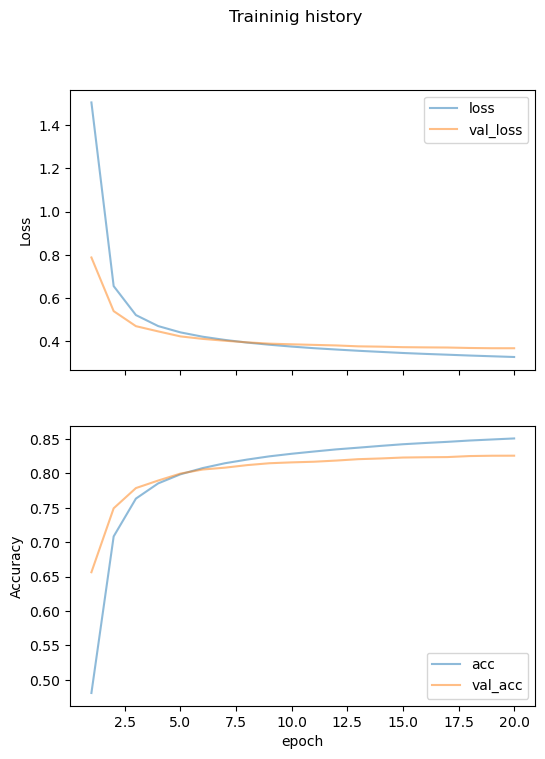

In [16]:
# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

plt.savefig("section10_figure01_model_accuract.jpg")

### Callbacks.
Training of Neural Networks can take many hours or even few days to complete. so we need some function to monitor and control our model.Because after hour/days of training, if a model crashes, then all the training time gets wasted. And once we choose some epochs and training is started, we may need to stop the training to avoid overfitting or if we have achieved some least loss and if it is increasing afterwards we need to halt the training and etc.,. *Callbacks* are functions to monitor and control the model once the training is started. We will be using two callbacks: *early stopping* & *model checkpoint*.


### ModelCheckpoint.
We use this callback to save our model periodically so that we won’t waste our training time if our training crashes unexpectedly. Also, we can make use of the intermediate best-stored weights and load them later to continue the training from the saved state. Further, with our implementation we will keep the best-score model rather than return only the final model at the last epoch.


### EarlyStopping.
A problem in Neural Networks is choosing the number of epochs while training, too many epochs will overfit the model, while too less may cause underfitting. EarlyStopping is a callback used while training neural networks, which provides us the advantage of using a large number of training epochs and stopping the training once the model’s performance (loss or accuracy) stops improving on the validation Dataset. This implementation will stop the training when the validation loss stops improving after 3 epochs. It provides protection against under- and over-fitting. Key parameters are:
- min_delta: minimum change in the monitored metric to be considered as an improvement
- patience: the number of epochs with no improvement after which training will be stopped

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early_stop = EarlyStopping(monitor='val_loss', patience=5)
early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0.001, patience=3, verbose=1, mode='min', restore_best_weights=True)

#checkpoint = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_loss')
checkpoint = ModelCheckpoint(filepath='MODEL_1_best.h5', monitor='val_loss',       
                  mode='min',save_best_only=True,verbose=1)
#mode=(“auto”, “min”, “max”) For accuracy, it should be “max,” and for loss, it should be “min”.
#If it is “auto” it can infer the mode by using the name of the metric.

model = transformer(key_vals["num_layers"], key_vals["num_heads"], key_vals["seq_len"],
                    key_vals["key_dim"], key_vals["ff_dim"], key_vals["vocab_size_eng"],
                    key_vals["vocab_size_ita"], key_vals["dropout"])

lr = CustomSchedule(key_vals["key_dim"])
optimizer = tf.keras.optimizers.Adam(lr, optim_vals["beta_1"], optim_vals["beta_2"], optim_vals["epsilon"])
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stop, checkpoint])

model.save("MODEL_1.h5")

Epoch 1/20
3920/3920 [==============================] - 16858s 4s/step - loss: 1.5072 - masked_accuracy: 0.4800 - val_loss: 0.7986 - val_masked_accuracy: 0.6470
Epoch 2/20
3920/3920 [==============================] - 6616s 2s/step - loss: 0.6615 - masked_accuracy: 0.7061 - val_loss: 0.5391 - val_masked_accuracy: 0.7489
Epoch 3/20
3920/3920 [==============================] - 9500s 2s/step - loss: 0.5220 - masked_accuracy: 0.7628 - val_loss: 0.4755 - val_masked_accuracy: 0.7779
Epoch 4/20
3920/3920 [==============================] - 6671s 2s/step - loss: 0.4693 - masked_accuracy: 0.7863 - val_loss: 0.4482 - val_masked_accuracy: 0.7894
Epoch 5/20
3920/3920 [==============================] - 51468s 13s/step - loss: 0.4396 - masked_accuracy: 0.7996 - val_loss: 0.4273 - val_masked_accuracy: 0.7990
Epoch 6/20
3920/3920 [==============================] - 7131s 2s/step - loss: 0.4190 - masked_accuracy: 0.8087 - val_loss: 0.4120 - val_masked_accuracy: 0.8060
Epoch 7/20
3920/3920 [===============

Early stopping did not help. We will now train the model with the full token space. We expect overfitting and decrease in performance.

In [2]:
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from transformer_building_blocks import transformer
from learning_params import CustomSchedule, masked_loss, masked_accuracy

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#with open("train_validation_test_text_pairs.pickle", "rb") as fp:
#    text_pairs = pickle.load(fp)

with open("key_values.pickle", "rb") as fp:
    key_vals = pickle.load(fp)
    
with open("key_vals_method2.pickle", "rb") as fp:
    key_vals_method2 = pickle.load(fp)

with open(f"vectorized_ENGvoc_{key_vals_method2['vocab_size_eng']}_ITAvoc_{key_vals_method2['vocab_size_ita']}_seqLen_{key_vals['seq_len']}.pickle", "rb") as fp:
    data = pickle.load(fp)    
    
with open("optimizer_values.pickle", "rb") as fp:
    optim_vals = pickle.load(fp)

with open("train_val_datasets.pickle", "rb") as fp:
    DS = pickle.load(fp)
train_ds = DS["train"]
val_ds = DS["val"]

early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0.001, patience=3, verbose=1, mode='min', restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='MODEL_2_best.h5', monitor='val_loss',       
                  mode='min',save_best_only=True,verbose=1)

model = transformer(key_vals["num_layers"], key_vals["num_heads"], key_vals["seq_len"],
                    key_vals["key_dim"], key_vals["ff_dim"], key_vals_method2["vocab_size_eng"],
                    key_vals_method2["vocab_size_ita"], key_vals["dropout"])

lr = CustomSchedule(key_vals["key_dim"])
optimizer = tf.keras.optimizers.Adam(lr, optim_vals["beta_1"], optim_vals["beta_2"], optim_vals["epsilon"])
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stop, checkpoint])

model.save("MODEL_2.h5")

ValueError: Data is expected to be in format `x`, `(x,)`, `(x, y)`, or `(x, y, sample_weight)`, found: (('i cannot say i share your enthusiasm for the idea .', '[start] non posso dire di condividere il tuo entusiasmo per l idea . [end]'), ('is tom cute ?', '[start] tom ee carino ? [end]'), ('i have never eaten horse meat .', '[start] non ho mai mangiato della carne di cavallo . [end]'), ('your friendship has great value to me .', '[start] la tua amicizia ha un grande valore per me . [end]'), ('everyone is entitled to his own opinion .', '[start] ognuno ha il diritto di avere una propria opinione . [end]'), ('i did not go to boston last month .', '[start] io non sono andato a boston il mese scorso . [end]'), ('it is more than enough .', '[start] ee piuu che sufficiente . [end]'), ('you have not given me what i asked for .', '[start] non mi avete dato cioo che ho chiesto . [end]'), ('i like contact sports .', '[start] mi piacciono gli sport di contatto . [end]'), ('she introduced me to her brother .', '[start] mi presentoo a suo fratello . [end]'), ('i take dance lessons .', '[start] prendo lezioni di ballo . [end]'), ('show me that .', '[start] fatemelo vedere . [end]'), ('we are familiar with the legend of robin hood .', '[start] conosciamo la leggenda di robin hood . [end]'), ('all this is simple and easy to understand .', '[start] tutto questo ee semplice e facile da capire . [end]'), ('i did not hear him coming .', '[start] non l ho sentito arrivare . [end]'), ('climb onto the roof .', '[start] arrampicati sul tetto . [end]'), ('i cannot think of anything else .', '[start] non riesco a pensare ad altro . [end]'), ('this is not difficult .', '[start] questo non ee difficile . [end]'), ('tom could not understand it .', '[start] tom non riusciva a capirla . [end]'), ('i have made many mistakes in my life .', '[start] ho commesso molti errori nella mia vita . [end]'), ('the visitor asked the class a question .', '[start] il visitatore ha fatto una domanda alla classe . [end]'), ('we are against it .', '[start] ne siamo contrari . [end]'), ('you are a friend .', '[start] tu sei un amico . [end]'), ('are you watching this show ?', '[start] sta guardando questo spettacolo ? [end]'), ('i have to set a good example .', '[start] devo dare un buon esempio . [end]'), ('this penthouse is spacious .', '[start] questo attico ee spazioso . [end]'), ('do you know how to do this ?', '[start] sapete come fare questo ? [end]'), ('we must do this very quickly .', '[start] noi dobbiamo fare questo molto rapidamente . [end]'), ('i could not find anything my size .', '[start] non sono riuscito a trovare nulla della mia taglia . [end]'), ('the document was in french .', '[start] il documento era in francese . [end]'), ('do you like it here in australia ?', '[start] vi piace qui in australia ? [end]'), ('apply two coats of the paint for a good finish .', '[start] applicate due mani di vernice per una buona finitura . [end]'), ('finally she gave in to temptation and ate the whole cake .', '[start] alla fine cedette alla tentazione e mangioo tutta la torta . [end]'), ('she raised her hands .', '[start] lei alzoo le mani . [end]'), ('please pass me the butter .', '[start] passatemi il burro , per favore . [end]'), ('i have to get tom home .', '[start] io devo portare a casa tom . [end]'), ('may i use the phone ?', '[start] posso usare il telefono ? [end]'), ('tom is a very good dancer .', '[start] tom ee un ballerino molto bravo . [end]'), ('i use it .', '[start] la uso . [end]'), ('is this the reason you did not want to come with me ?', '[start] ee questa la ragione per cui non ee voluto venire con me ? [end]'), ('perhaps i can help .', '[start] forse io posso essere d aiuto . [end]'), ('good traditions should be preserved .', '[start] le buone tradizioni dovrebbero essere preservate . [end]'), ('this is your duty .', '[start] questo ee il vostro dovere . [end]'), ('i am looking for my camera .', '[start] io sto cercando la mia macchina fotografica . [end]'), ('tom advised mary to learn french .', '[start] tom consiglioo a mary di imparare il francese . [end]'), ('tom suddenly lost consciousness .', '[start] tom ha improvvisamente perso conoscenza . [end]'), ('do you think tom is hungry ?', '[start] pensi che tom abbia fame ? [end]'), ('we appreciate your patience .', '[start] noi apprezziamo la vostra pazienza . [end]'), ('tom likes to do that .', '[start] a tom piace farlo . [end]'), ('i have always wanted to be a professional basketball player .', '[start] ho sempre voluto essere un giocatore di pallacanestro professionista . [end]'), ('tom is used to working hard .', '[start] tom ee abituato a lavorare duramente . [end]'), ('they became very nervous .', '[start] loro divennero molto nervosi . [end]'), ('are not you busy tomorrow afternoon ?', '[start] non ee occupata domani pomeriggio ? [end]'), ('be merciless .', '[start] sia impietosa . [end]'), ('were you at the theater last saturday ?', '[start] eri a teatro sabato scorso ? [end]'), ('this bag is made of leather .', '[start] questa borsa ee fatta di pelle . [end]'), ('she is my girlfriend .', '[start] ee la mia ragazza . [end]'), ('tom and mary are already inside .', '[start] tom e mary sono giaa dentro . [end]'), ('you were right to worry .', '[start] aveva ragione a preoccuparsi . [end]'), ('i wonder why he did that .', '[start] mi chiedo percheee l abbia fatto . [end]'), ('i cannot wait until tomorrow .', '[start] io non posso aspettare fino a domani . [end]'), ('i feel like taking a walk .', '[start] mi va di fare una passeggiata . [end]'), ('i walk a lot .', '[start] cammino molto . [end]'), ('i do not have a lot of options .', '[start] non ho molte opzioni . [end]'), ('we have to prepare for everything .', '[start] noi dobbiamo prepararci a tutto . [end]'), ('i should learn some french .', '[start] dovrei imparare un po   di francese . [end]'), ('i know what that piece of paper is .', '[start] so cos ee quel pezzo di carta . [end]'), ('i am tired of listening to your complaints .', '[start] sono stanco di ascoltare le tue lamentele . [end]'), ('who told you that i was not well ?', '[start] chi le ha detto che non stavo bene ? [end]'), ('stop fighting .', '[start] smettila di combattere . [end]'), ('i know what to do already .', '[start] io so giaa cosa fare . [end]'), ('you are very brave .', '[start] lei ee molto coraggioso . [end]'), ('i blame myself for what happened .', '[start] incolpo me stesso per quello che ee successo . [end]'), ('i have hundreds of friends .', '[start] ho centinaia di amici . [end]'), ('they are trapped .', '[start] sono intrappolati . [end]'), ('tom certainly did not vote for her .', '[start] tom non ha certamente votato per lei . [end]'), ('let us go ask tom .', '[start] andiamo a chiederlo a tom . [end]'), ('stay here with tom .', '[start] stai qui con tom . [end]'), ('could you help me translate this into french ?', '[start] mi aiuterebbe a tradurre questo in francese ? [end]'), ('it is for sale .', '[start] ee in vendita . [end]'), ("that song's bound to be a hit .", '[start] quella canzone ee destinata ad essere un successo . [end]'), ('we came back by way of hong kong .', '[start] noi siamo tornati indietro tramite hong kong . [end]'), ('are you open now ?', '[start] siete aperti adesso ? [end]'), ("here's the leak .", '[start] ecco la falla . [end]'), ('that word is very difficult to translate .', '[start] quella parola ee molto difficile da tradurre . [end]'), ('compare the facts .', '[start] metti a confronto i fatti . [end]'), ('i will stay at home with my grandparents this weekend .', '[start] staroo a casa con i miei nonni questo fine settimana . [end]'), ('we might leave early .', '[start] potremmo andarcene presto . [end]'), ('the note was from tom .', '[start] la nota proveniva da tom . [end]'), ('tom is good at math , is not he ?', '[start] tom ee bravo in matematica , vero ? [end]'), ('where did you do it ?', '[start] dove l hai fatto ? [end]'), ('the street is very narrow .', '[start] la strada ee molto stretta . [end]'), ('tom and mary were there , too .', '[start] anche tom e mary erano lii . [end]'), ('tom is right downstairs .', '[start] tom ee proprio di sotto . [end]'), ('tom and mary have gone swimming together a number of times .', '[start] tom e mary sono andati a nuotare assieme molte volte . [end]'), ('we have seen worse .', '[start] abbiamo visto di peggio . [end]'), ('is not tom afraid ?', '[start] tom non ha paura ? [end]'), ('do it at once .', '[start] fatelo immediatamente . [end]'), ('will you do this for me ?', '[start] farete questo per me ? [end]'), ('tom is a good basketball player .', '[start] tom ee un bravo cestista . [end]'), ('tom got a puppy for christmas .', '[start] tom ricevette un cucciolo per natale . [end]'), ('is tom still working for you ?', '[start] tom sta ancora lavorando per lei ? [end]'), ('i do not know what day it is .', '[start] non so che giorno ee . [end]'), ('they are old friends .', '[start] sono amici di vecchia data . [end]'), ('are there any other suggestions ?', '[start] ci sono altri suggerimenti ? [end]'), ('do you know tom jackson ?', '[start] voi lo conoscete tom jackson ? [end]'), ('this is hard for me .', '[start] questo ee duro per me . [end]'), ('we were not worried about it .', '[start] noi non eravamo preoccupati a riguardo . [end]'), ('tom will be back , i am sure .', '[start] tom saraa di ritorno , ne sono sicuro . [end]'), ('do you believe tom ?', '[start] voi credete a tom ? [end]'), ('how did your meeting with tom go ?', '[start] com ee andato il suo incontro con tom ? [end]'), ('it is starting to work .', '[start] sta cominciando a funzionare . [end]'), ('tom is not as old as you think he is .', '[start] tom non ee anziano come pensi che sia . [end]'), ('tomorrow i have a cricket match . wish me luck .', '[start] domani ho una partita di cricket . mi auguri buona fortuna . [end]'), ('he is the manager of a hotel .', '[start] lui ee il gestore di un hotel . [end]'), ('they are a couple of hippies .', '[start] loro sono una coppia di hippie . [end]'), ('where can they be ?', '[start] loro dove possono essere ? [end]'), ('stay tuned .', '[start] rimani sintonizzata . [end]'), ('i am not so lucky .', '[start] io non sono cosii fortunato . [end]'), ('what will the japanese economy be like next year ?', '[start] come saraa l economia giapponese l anno prossimo ? [end]'), ("how're you all doing today ?", '[start] come state tutti oggi ? [end]'), ('i cannot go anywhere .', '[start] non posso andare da nessuna parte . [end]'), ('we have to take the risk .', '[start] noi dobbiamo correre il rischio . [end]'), ('what do you want to be in the future ?', '[start] cosa vuole essere in futuro ? [end]'), ('i really want to see you .', '[start] io voglio davvero vederti . [end]'), ('what kind of dreams do you have ?', '[start] che tipo di sogni avete ? [end]'), ('i have to stay calm .', '[start] devo restare calma . [end]'), ('are you sincere ?', '[start] lei ee sincera ? [end]'), ('you should go on a diet .', '[start] ti dovresti mettere a dieta . [end]'), ('tom works as hard as anybody else does .', '[start] tom lavora sodo come chiunque altro . [end]'), ("there's a dog by the door .", '[start] c ee un cane sulla porta . [end]'), ('take a knife from the kitchen .', '[start] prendi un coltello dalla cucina . [end]'), ('tom was your french teacher , was not he ?', '[start] tom era il vostro insegnante di francese , vero ? [end]'), ('the man asked me for some money .', '[start] l uomo mi ha chiesto un po   di denaro . [end]'), ('i was not too surprised .', '[start] non ero troppo sorpresa . [end]'), ('why did you want to buy that ?', '[start] percheee lo volevi comprare ? [end]'), ('i do not want to scare you .', '[start] io non la voglio spaventare . [end]'), ('you must not invade the privacy of others .', '[start] non devi invadere la privacy degli altri . [end]'), ('i had my shoes cleaned .', '[start] mi feci pulire le scarpe . [end]'), ('who told you to come here ?', '[start] chi ti ha detto di venire qua ? [end]'), ('i have never forgotten you .', '[start] io non l ho mai scordato . [end]'), ('tom started playing golf when he was thirteen .', '[start] tom inizioo a giocare a golf quando aveva tredici anni . [end]'), ('what do you want ?', '[start] tu che cosa vuoi ? [end]'), ('we cannot reveal classified information .', '[start] non possiamo rivelare informazioni riservate . [end]'), ('let me call my lawyer .', '[start] fammi chiamare il mio avvocato . [end]'), ('you have my eternal gratitude .', '[start] ha la mia eterna gratitudine . [end]'), ('i do not want to talk about it anymore .', '[start] io non ne voglio piuu parlare . [end]'), ('what did you want to ask me ?', '[start] cosa volevi chiedermi ? [end]'), ('i live on the outskirts of boston .', '[start] vivo nella periferia di boston . [end]'), ('she has two cats . one is black , and the other is white .', '[start] lei ha due gatti . uno ee nero e l altro ee bianco . [end]'), ('tom likes attention .', '[start] a tom piace l attenzione . [end]'), ('they said storage costs were too high .', '[start] dissero che i costi di stoccaggio erano troppo alti . [end]'), ('how much money do you plan to invest in government bonds ?', '[start] quanti soldi pensate di investire in titoli di stato ? [end]'), ('tom is a man you can trust .', '[start] tom ee un uomo di cui ci si puoo fidare . [end]'), ('take your hands off me .', '[start] toglimi le mani di dosso . [end]'), ('i do not even know if tom is still alive .', '[start] non so neanche se tom ee ancora vivo . [end]'), ('i cannot cover for you anymore .', '[start] non posso piuu coprirla . [end]'), ('she is not as stupid as she looks .', '[start] non ee stupida come sembra . [end]'), ('i can hardly believe his story .', '[start] riesco a credere a malapena alla sua storia . [end]'), ('can you speak more slowly ?', '[start] puoi parlare piuu lentamente ? [end]'), ('this passport is valid for five years .', '[start] questo passaporto ee valido per cinque anni . [end]'), ('tom said he apologized to mary .', '[start] tom ha detto che si ee scusato con mary . [end]'), ('brace yourself .', '[start] si prepari . [end]'), ('tom said mary was doing that now .', '[start] tom ha detto che mary lo stava facendo adesso . [end]'), ('we all have missed you .', '[start] sei mancata a tutte noi . [end]'), ('tom flipped off the lights .', '[start] tom spense le luci . [end]'), ('the student ordered the book from new york .', '[start] lo studente ordinoo il libro da new york . [end]'), ('i am only trying to protect you .', '[start] sto solamente cercando di proteggervi . [end]'), ('you look older than tom .', '[start] sembrate piuu anziani di tom . [end]'), ('please do not insult our intelligence .', '[start] per favore , non insulti la nostra intelligenza . [end]'), ('i have no time .', '[start] non ho tempo . [end]'), ('are not you still on a diet ?', '[start] non siete ancora a dieta ? [end]'), ('there are only three days left .', '[start] restano soltanto tre giorni . [end]'), ('how did the others do ?', '[start] come sono andati gli altri ? [end]'), ("look ! there's a plane taking off .", '[start] guarda ! un aereo che decolla . [end]'), ('the old man was run over by a car .', '[start] l anziano venne investito da un auto . [end]'), ('what a collection !', '[start] che collezione ! [end]'), ('she tossed me grapes and i tried to catch them with my mouth .', '[start] lei mi lanciava acini d uva e io provavo a prenderli con la bocca . [end]'), ('tom is intelligent .', '[start] tom ee intelligente . [end]'), ("tom's parents died when he was thirteen .", '[start] i genitori di tom morirono quando lui aveva tredici anni . [end]'), ('i almost never watch tv .', '[start] non guardo quasi mai la televisione . [end]'), ('tom does not eat as much as mary .', '[start] tom non mangia quanto mary . [end]'), ('hey , do not feel bad .', '[start] hey , non sentitevi male . [end]'), ('do not you like baseball ?', '[start] a voi non piace il baseball ? [end]'), ('we will be patient .', '[start] noi saremo pazienti . [end]'), ("that's beautiful .", '[start] ee bello . [end]'), ("the water's cold today .", '[start] l acqua ee fredda oggi . [end]'), ('i will leave immediately .', '[start] partiroo immediatamente . [end]'), ('i like to be early .', '[start] a me piace essere in anticipo . [end]'), ('do you find that strange ?', '[start] lo trovi strano ? [end]'), ('i wrote five letters before i went to bed .', '[start] scrissi cinque lettere prima di andare a letto . [end]'), ('i am sure of his success .', '[start] sono sicura del suo successo . [end]'), ('tom lost his ticket .', '[start] tom perse il suo biglietto . [end]'), ('i know that you love tom .', '[start] so che ami tom . [end]'), ("here's a new one .", '[start] eccone uno nuovo . [end]'), ("your o's look like a's .", '[start] le vostre o sembrano delle a . [end]'), ('when will you come back to school ?', '[start] quando torneraa a scuola ? [end]'), ('we are pretty busy right now .', '[start] siamo piuttosto occupati al momento . [end]'), ('you will not feel a thing .', '[start] non sentiraa niente . [end]'), ('i am proud of this country .', '[start] io sono fiero di questo paese . [end]'), ('tom is a fast driver .', '[start] tom ee un conducente veloce . [end]'), ('he told me that his father was a doctor .', '[start] mi disse che suo padre era un dottore . [end]'), ('i think tom knows french .', '[start] penso che tom sappia il francese . [end]'), ('this is the first time i have baked a cake .', '[start] questa ee la prima volta che ho fatto una torta . [end]'), ('i totally forgot .', '[start] mi sono completamente scordato . [end]'), ('i am walking with her .', '[start] sto camminando con lei . [end]'), ("are you ready for today's exam ?", '[start] ee pronta per l esame di oggi ? [end]'), ('do you think i am fat ?', '[start] pensate che io sia grasso ? [end]'), ('tom asked mary who her french teacher was .', '[start] tom ha chiesto a mary chi fosse il suo insegnante di francese . [end]'), ('she is depressed .', '[start] lei ee depressa . [end]'), ('i do not want that anymore .', '[start] non lo voglio piuu . [end]'), ('you are influential .', '[start] voi siete influenti . [end]'), ('i assume tom did not show up .', '[start] assumo che tom non si sia presentato . [end]'), ('sometimes i have to walk to school .', '[start] a volte devo andare a scuola a piedi . [end]'), ('go play with tom .', '[start] vada a suonare con tom . [end]'), ('he took a short cut .', '[start] lui prese una scorciatoia . [end]'), ('tom is not very likely to want to do that , is he ?', '[start] non ee molto probabile che tom lo voglia fare , vero ? [end]'), ("this one's old .", '[start] questa ee vecchia . [end]'), ('you are responsible .', '[start] tu sei responsabile . [end]'), ('i found the game easy .', '[start] ho trovato il gioco facile . [end]'), ("what's eating her ?", '[start] che cosa la sta mangiando ? [end]'), ('did tom really drink that ?', '[start] tom l ha bevuto veramente ? [end]'), ('do you speak french at home ?', '[start] in casa parlate francese ? [end]'), ('why not join me tonight ?', '[start] percheee non unirsi a me stasera ? [end]'), ('i hope tom does not sing .', '[start] io spero che tom non canti . [end]'), ('i got you something .', '[start] io ti ho preso qualcosa . [end]'), ('we met last night .', '[start] ci siamo conosciute ieri sera . [end]'), ('i want some help .', '[start] io voglio un po   di aiuto . [end]'), ('i do not know how to help tom .', '[start] non so come aiutare tom . [end]'), ('her daughter is a nurse .', '[start] sua figlia ee un infermiera . [end]'), ('i suspect that tom is ready .', '[start] sospetto che tom sia pronto . [end]'), ('i think tom is not home .', '[start] penso che tom non sia a casa . [end]'), ('tom was very busy .', '[start] tom era molto impegnato . [end]'), ('can i turn on the tv ?', '[start] posso accendere la televisione ? [end]'), ('i am from boston .', '[start] io sono di boston . [end]'), ('i hate living alone .', '[start] odio abitare da solo . [end]'), ('i am not as busy as tom is .', '[start] non sono impegnato come tom . [end]'), ('he will not die . he is as strong as a horse .', '[start] non moriraa . lui ee forte come un toro . [end]'), ('i never said you were boring .', '[start] io non ho mai detto che eri noiosa . [end]'), ('it is kind of hot , is not it ?', '[start] fa piuttosto caldo , vero ? [end]'), ('tom forgot to renew his passport .', '[start] tom si ee scordato di rinnovare il passaporto . [end]'), ('tom is training for a triathlon .', '[start] tom si sta allenando per un triathlon . [end]'), ('none of my friends drink coffee .', '[start] nessuno dei miei amici beve il caffee . [end]'), ('are you sure tom will not be busy ?', '[start] sei sicura che tom non saraa impegnato ? [end]'), ('you can use my pen .', '[start] potete usare la mia penna . [end]'), ('i tried to reason with tom .', '[start] io ho cercato di ragionare con tom . [end]'), ('you have to reply to the letter .', '[start] devi rispondere alla lettera . [end]'), ('would you prefer to speak in french ?', '[start] tu preferiresti parlare in francese ? [end]'), ('you are not stupid .', '[start] non siete stupidi . [end]'), ('does it contain recycled material ?', '[start] contiene materiale riciclato ? [end]'), ("what's this book about ?", '[start] di che cosa parla questo libro ? [end]'), ('my university is different .', '[start] la mia universitaa ee diversa . [end]'), ('i asked tom to do that for me .', '[start] chiesi a tom di farlo per me . [end]'), ('tom is very concerned about you .', '[start] tom ee molto preoccupato per te . [end]'), ('iceland has many volcanoes .', '[start] l islanda ha molti vulcani . [end]'), ('this is an international community .', '[start] questa ee una comunitaa internazionale . [end]'), ('you are safe with us .', '[start] ee al sicuro con noi . [end]'), ('he is a journalist .', '[start] ee un giornalista . [end]'), ('i will go to boston tomorrow morning .', '[start] io androo a boston domattina . [end]'), ('you are wasting water .', '[start] state sprecando dell acqua . [end]'), ('do not trust what he says .', '[start] non si fidi di quello che dice . [end]'), ('we have medicine for you .', '[start] abbiamo una medicina per lei . [end]'), ('tom will not care what we think .', '[start] a tom non importeraa quello che pensiamo noi . [end]'), ('would you like to take a walk with me ?', '[start] vorresti fare una passeggiata con me ? [end]'), ('they cannot be right .', '[start] loro non possono avere ragione . [end]'), ('i have never seen you cry .', '[start] non l ho mai visto piangere . [end]'), ('i do not know much about your family .', '[start] non so molto sulla tua famiglia . [end]'), ('do not worry about such a silly thing .', '[start] non preoccuparti per una cosa cosii stupida . [end]'), ('i guess you are right .', '[start] immagino che lei abbia ragione . [end]'), ('i did you a favor .', '[start] io ti ho fatto un favore . [end]'), ('someone is singing .', '[start] qualcuno sta cantando . [end]'), ('stay with me .', '[start] stia con me . [end]'), ('tom knew i was busy .', '[start] tom sapeva che ero impegnata . [end]'), ('i want you to tell me about tom .', '[start] io voglio che lei mi dica di tom . [end]'), ('i am greedy .', '[start] io sono avido . [end]'), ('he is economically independent of his parents .', '[start] ee economicamente indipendente dai suoi genitori . [end]'), ('will you help me find my keys ?', '[start] mi aiuti a trovare le mie chiavi ? [end]'), ('tom is doing a fine job .', '[start] tom sta facendo un buon lavoro . [end]'), ('i will give it to you .', '[start] gliela daroo . [end]'), ('you are the same age as my son .', '[start] tu hai la stessa etaa di mio figlio . [end]'), ('i cannot wait to meet him .', '[start] io non vedo l ora di incontrarlo . [end]'), ('we would better think of something .', '[start] faremmo meglio a pensare a qualcosa . [end]'), ('they just stopped .', '[start] loro si sono appena fermati . [end]'), ('we have more important matters to discuss .', '[start] noi abbiamo delle questioni piuu importanti da discutere . [end]'), ('tom and i ate together in the school cafeteria .', '[start] io e tom abbiamo mangiato assieme alla mensa scolastica . [end]'), ('tom and mary are immature .', '[start] tom e mary sono immaturi . [end]'), ('he spent the evening reading .', '[start] lui trascorse la serata a leggere . [end]'), ('give me back my pen .', '[start] ridammi la mia biro . [end]'), ('i started at the bottom .', '[start] iniziai dal fondo . [end]'), ('i hate to argue with you .', '[start] odio litigare con te . [end]'), ('this is a wolf .', '[start] questo ee un lupo . [end]'), ('you are going to be proud of me .', '[start] lei saraa fiero di me . [end]'), ('she is gonna kill me .', '[start] lei mi uccideraa . [end]'), ('he has started to write a novel .', '[start] ha iniziato a scrivere un romanzo . [end]'), ('i think tom is prepared .', '[start] penso che tom sia preparato . [end]'), ('do you speak english ?', '[start] sai parlare inglese ? [end]'), ('tom is no longer a problem .', '[start] tom non ee piuu un problema . [end]'), ('she borrowed his idea .', '[start] prese in prestito la sua idea . [end]'), ('come meet tom .', '[start] venite a conoscere tom . [end]'), ('we are with the fbi .', '[start] noi siamo con l fbi . [end]'), ('that horse is very expensive .', '[start] quel cavallo ee molto costoso . [end]'), ('tom thought mary was alone .', '[start] tom pensava che mary fosse sola . [end]'), ('i can share .', '[start] io posso condividere . [end]'), ('i will apologize .', '[start] mi scuseroo . [end]'), ('who are your friends ?', '[start] chi sono le vostre amiche ? [end]'), ('it is not that easy .', '[start] non ee cosii facile . [end]'), ('tom did not understand my french .', '[start] tom non ha capito il mio francese . [end]'), ('i am sorry for calling so late .', '[start] mi dispiace chiamare cosii tardi . [end]'), ('we should continue helping tom .', '[start] dovremmo continuare ad aiutare tom . [end]'), ('tom does not go to his office on saturday .', '[start] tom non va in ufficio al sabato . [end]'), ('be careful not to cut yourself .', '[start] faccia attenzione a non tagliarsi . [end]'), ('i want to hear what tom thinks .', '[start] voglio sentire cosa pensa tom . [end]'), ('she has a lot of work to do .', '[start] ha molto lavoro da fare . [end]'), ('can you lend me your computer ?', '[start] puoi prestarmi il tuo computer ? [end]'), ("i bought tom's new novel .", '[start] io ho comprato il nuovo romanzo di tom . [end]'), ('i can imagine that .', '[start] io lo riesco a immaginare . [end]'), ('can you give me a lift to the station ?', '[start] mi puoo dare un passaggio in stazione ? [end]'), ('you are so skinny .', '[start] sei cosii magro . [end]'), ('you would have fun .', '[start] ti divertiresti . [end]'), ('i am not at all busy now .', '[start] non sono per niente impegnata adesso . [end]'), ('if i were twenty , i could vote .', '[start] se avessi vent anni , potrei votare . [end]'), ('you would not believe me .', '[start] lei non mi crederebbe . [end]'), ('i am surprised tom turned down such a good offer .', '[start] sono sorpreso che tom abbia rifiutato un offerta cosii buona . [end]'), ('did you speak to tom ?', '[start] voi avete parlato con tom ? [end]'), ('you would not believe the stuff people throw away .', '[start] non credereste alla roba che le persone buttano via . [end]'), ('my head is exploding .', '[start] mi sta scoppiando la testa . [end]'), ('this does not make sense to me .', '[start] questo non ha senso per me . [end]'), ('we are your neighbors .', '[start] siamo le tue vicine . [end]'), ('put your books away .', '[start] metta via i suoi libri . [end]'), ('i think tom is going to confess .', '[start] io penso che tom stia per confessare . [end]'), ('do not speak so fast .', '[start] non parlare cosii velocemente . [end]'), ('i would like to read some books about lincoln .', '[start] vorrei leggere qualche libro su lincoln . [end]'), ('she used to work for our company .', '[start] lavorava per la nostra azienda . [end]'), ("my father's free on monday .", '[start] mio padre ee libero lunedii . [end]'), ('tom is with friends , is not he ?', '[start] tom ee con delle amiche , vero ? [end]'), ('we want tom to say yes .', '[start] vogliamo che tom dica di sii . [end]'), ('will you be back soon ?', '[start] sarete presto di ritorno ? [end]'), ('tom ran out of paper .', '[start] tom finii la carta . [end]'), ('what prevented you from coming yesterday ?', '[start] cosa ti ha impedito di venire ieri ? [end]'), ('will you all be here tomorrow ?', '[start] sarete tutte qui domani ? [end]'), ('you used to call me .', '[start] tu mi chiamavi . [end]'), ('do not say anything to tom .', '[start] non dica nulla a tom . [end]'), ('tom is going to be very happy to see you .', '[start] tom saraa molto felice di vedervi . [end]'), ('hey , wake up !', '[start] hey , svegliati ! [end]'), ('i need to buy one .', '[start] io ho bisogno di comprarne uno . [end]'), ('is this real ?', '[start] questa ee reale ? [end]'), ('i am not your daughter .', '[start] non sono sua figlia . [end]'), ('i am looking for a lipstick to go with this nail polish .', '[start] sto cercando un rossetto che si abbini con questo smalto per unghie . [end]'), ('tom noticed several differences .', '[start] tom notoo diverse differenze . [end]'), ('i do not think you are right .', '[start] non penso che lei abbia ragione . [end]'), ('do you have a family ?', '[start] voi avete una famiglia ? [end]'), ('my wife wants to adopt a child .', '[start] mia moglie vuole adottare un bambino . [end]'), ('tom is not so tall , is he ?', '[start] tom non ee cosii alto , vero ? [end]'), ('he did his duty .', '[start] lui ha fatto il suo dovere . [end]'), ('they look very happy together .', '[start] sembrano molto felici insieme . [end]'), ('he claimed that he had discovered a new comet .', '[start] dichiaroo di aver scoperto una nuova cometa . [end]'), ('what will you have ?', '[start] tu cosa prenderai ? [end]'), ('why did you decide to become a teacher ?', '[start] percheee ha deciso di diventare un insegnante ? [end]'), ('i understand why you are concerned .', '[start] capisco percheee siete preoccupate . [end]'), ('why would tom go there ?', '[start] percheee tom andrebbe lii ? [end]'), ('here is your bill .', '[start] ecco il suo conto . [end]'), ('i still have some feelings for her .', '[start] provo ancora qualcosa per lei . [end]'), ('i love you and i want to marry you .', '[start] ti amo e voglio sposarti . [end]'), ('she is graceful .', '[start] lei ee leggiadra . [end]'), ('the population of australia is much smaller than that of japan .', '[start] la popolazione dell australia ee molto minore di quella del giappone . [end]'), ('give me what you have in your hand .', '[start] dammi quello che hai in mano . [end]'), ('we are getting out of here . the storm is coming .', '[start] stiamo uscendo fuori di qui . la tempesta ee in arrivo . [end]'), ('we are confident .', '[start] noi siamo sicure . [end]'), ('i have just arrived .', '[start] io sono appena arrivato . [end]'), ("i drank tom's beer .", '[start] io ho bevuto la birra di tom . [end]'), ('this movie is not that interesting , is it ?', '[start] questo film non ee cosii interessante , vero ? [end]'), ('i do not want tom to think he has to protect me .', '[start] non voglio che tom pensi che mi debba proteggere . [end]'), ('we do not have the time .', '[start] noi non abbiamo il tempo . [end]'), ('tom turned to mary and smiled .', '[start] tom si giroo verso mary e sorrise . [end]'), ('when did you get out of jail ?', '[start] quando sei uscito di prigione ? [end]'), ('i would like to visit australia someday .', '[start] vorrei visitare l australia un giorno . [end]'), ('tom called back .', '[start] tom ha richiamato . [end]'), ('they used local wood to build the ships .', '[start] hanno usato legno locale per costruire le navi . [end]'), ('they stayed in rome till september .', '[start] loro sono stati a roma fino a settembre . [end]'), ('i do not speak french as fluently as tom does .', '[start] io non parlo il francese fluentemente come tom . [end]'), ('i have an important meeting .', '[start] ho una riunione importante . [end]'), ('we will meet again , tom .', '[start] ci reincontreremo , tom . [end]'), ('you will need sleep .', '[start] avraa bisogno di dormire . [end]'), ('it is only a temporary fix .', '[start] ee solo una soluzione temporanea . [end]'), ('i knew he would accept .', '[start] sapevo che avrebbe accettato . [end]'), ('tom just wanted to talk to mary .', '[start] tom voleva solo parlare con mary . [end]'), ('you are not going .', '[start] non andrai . [end]'), ('i bake cakes almost every day .', '[start] cuocio al forno delle torte quasi ogni giorno . [end]'), ('tom is unmarried , is not he ?', '[start] tom non ee sposato , vero ? [end]'), ('who gave it to you ?', '[start] chi gliel ha dato ? [end]'), ("today's low was 3 degrees celsius .", '[start] la minima di oggi era di tre gradi celsius . [end]'), ('i do not like bread .', '[start] a me non piace il pane . [end]'), ('could you lend me an umbrella ?', '[start] potreste prestarmi un ombrello ? [end]'), ('is there something you want to buy ?', '[start] c ee qualcosa che vuole comperare ? [end]'), ('you are so kind .', '[start] voi siete cosii gentili . [end]'), ('i would like to work at the cafeteria .', '[start] mi piacerebbe lavorare al refettorio . [end]'), ('i am trying to find out where it happened .', '[start] sto cercando di capire dove successe . [end]'), ("here's your mug .", '[start] ecco la vostra tazza . [end]'), ('i like to receive letters from friends .', '[start] a me piace ricevere delle lettere dagli amici . [end]'), ('this is a spoon .', '[start] questo ee un cucchiaio . [end]'), ('are you still playing tennis ?', '[start] stai ancora giocando a tennis ? [end]'), ('either you or he has to attend the meeting .', '[start] o tu o lui dovete partecipare alla riunione . [end]'), ('you are probably doing it wrong .', '[start] probabilmente lo stai facendo in modo sbagliato . [end]'), ('who will go to boston with you ?', '[start] chi andraa a boston con lei ? [end]'), ('the word " theory " is often misused .', '[start] la parola " teoria " ee spesso abusata . [end]'), ('i lived in boston many years .', '[start] io ho vissuto a boston per molti anni . [end]'), ('we have tried that .', '[start] noi abbiamo provato quella . [end]'), ('i am a doctor now .', '[start] sono un dottore ora . [end]'), ('boxes were everywhere .', '[start] c erano scatole ovunque . [end]'), ('i am the one whose father was killed .', '[start] io sono quello il cui padre ee stato ucciso . [end]'), ('it is unlikely tom will do that .', '[start] ee improbabile che tom lo faraa . [end]'), ('i cannot answer your question .', '[start] non posso rispondere alla tua domanda . [end]'), ('i just heard something upstairs .', '[start] ho appena sentito qualcosa al piano di sopra . [end]'), ('it is not so unusual .', '[start] non ee cosii insolita . [end]'), ('tom is probably going to be busy on monday .', '[start] tom probabilmente saraa impegnato lunedii . [end]'), ('i am fearless .', '[start] io sono impavido . [end]'), ('i just bought a new desk for my computer .', '[start] ho appena comprato una nuova scrivania per il mio computer . [end]'), ('let me talk .', '[start] fammi parlare . [end]'), ('tell tom that i am proud of him .', '[start] dica a tom che sono orgoglioso di lui . [end]'), ('no doubt she loves him , but she will not marry him .', '[start] non ci sono dubbi che lo ami , ma non lo sposeraa . [end]'), ('tom did not even know what to do .', '[start] tom non sapeva neanche che fare . [end]'), ("do not copy other students ' homework .", '[start] non copiate i compiti degli altri studenti . [end]'), ('i do not feel very well . i should go home .', '[start] non mi sento molto bene . dovrei andare a casa . [end]'), ('i thought you would already talked to tom .', '[start] pensavo che avesse giaa parlato con tom . [end]'), ('where did you get this ?', '[start] dove l ha presa ? [end]'), ('leave a message , please .', '[start] lascia un messaggio , per piacere . [end]'), ('we are not saints .', '[start] noi non siamo santi . [end]'), ('i think i would better go with you .', '[start] penso che farei meglio ad andare con voi . [end]'), ('i want to fly above the clouds .', '[start] voglio volare al di sopra delle nuvole . [end]'), ('do not phone her now .', '[start] non le telefoni adesso . [end]'), ('you might find it useful .', '[start] potresti trovarlo utile . [end]'), ('she loves children .', '[start] lei ama i bambini . [end]'), ('they were drunk .', '[start] loro erano ubriachi . [end]'), ('you would not have recognized tom .', '[start] non avrebbe riconosciuto tom . [end]'), ('i do not want to go with you .', '[start] non voglio andare con voi . [end]'), ('have you ever studied anthropology ?', '[start] avete mai studiato antropologia ? [end]'), ('what kind of flowers did you give mary ?', '[start] che tipo di fiori hai dato a mary ? [end]'), ('he can play tennis .', '[start] lui puoo giocare a tennis . [end]'), ('i cannot wait to get a copy .', '[start] io non vedo l ora di ottenere una copia . [end]'), ('i will see you next wednesday .', '[start] ci vedremo mercoledii prossimo . [end]'), ('tom works for me now .', '[start] tom lavora per me ora . [end]'), ('tom is happier now that mary has left .', '[start] tom ee piuu felice ora che mary se n ee andata . [end]'), ('tom was unimpressed .', '[start] tom era indifferente . [end]'), ("i love tom's voice .", '[start] io amo la voce di tom . [end]'), ("do you know tom's secret ?", '[start] voi conoscete il segreto di tom ? [end]'), ('you are trying .', '[start] tu stai provando . [end]'), ('i am hungry because i have not had lunch .', '[start] ho fame percheee non ho pranzato . [end]'), ('tom is determined to go to boston .', '[start] tom ee determinato ad andare a boston . [end]'), ('tom will be disappointed if you do not go to his party .', '[start] tommaso se la prenderaa a male se non vai alla sua festa . [end]'), ('they are late .', '[start] sono in ritardo . [end]'), ('you have a good heart , tom .', '[start] tu hai un buon cuore , tom . [end]'), ('i cannot understand his feelings .', '[start] non riesco a capire le sue emozioni . [end]'), ('you need to wear a tie there .', '[start] devi indossare una cravatta qua . [end]'), ('i am late for class .', '[start] io sono in ritardo per la lezione . [end]'), ('our teacher made us work in groups .', '[start] la nostra insegnante ci fece lavorare in gruppo . [end]'), ('i meant that as a compliment .', '[start] l ho inteso come un complimento . [end]'), ('we should study .', '[start] dovremmo studiare . [end]'), ("tom's sad .", '[start] tom ee triste . [end]'), ('none of us like tom .', '[start] a nessuno di noi piace tom . [end]'), ('i do not expect anything from you .', '[start] io non mi aspetto niente da te . [end]'), ('use the front door .', '[start] usi la porta d ingresso . [end]'), ('i will not be intimidated .', '[start] io non verroo intimidito . [end]'), ('tom shot him .', '[start] tom gli ha sparato . [end]'), ('the police are looking into the incident .', '[start] la polizia sta esaminando l incidente . [end]'), ('tom could speak french .', '[start] tom riusciva a parlare il francese . [end]'), ('i got into the cab .', '[start] salii sul taxi . [end]'), ('who does this dictionary belong to ?', '[start] a chi appartiene questo dizionario ? [end]'), ('i see life differently now .', '[start] vedo la vita in modo diverso adesso . [end]'), ('you are very patient .', '[start] sei molto paziente . [end]'), ('which browser are you using ?', '[start] quale browser state utilizzando ? [end]'), ('they burned all the documents .', '[start] hanno bruciato tutti i documenti . [end]'), ('tom and mary were both laughing .', '[start] tom e mary stavano entrambi ridendo . [end]'), ('i certainly do not condone that .', '[start] sicuramente non lo consento . [end]'), ('i know that i am not a very good singer .', '[start] so di non essere un cantante molto bravo . [end]'), ('we went to school together .', '[start] andammo a scuola assieme . [end]'), ('are you willing to help tom ?', '[start] siete disposte ad aiutare tom ? [end]'), ('i am going to take a look outside .', '[start] daroo un occhiata all esterno . [end]'), ('is the air clean here ?', '[start] l aria ee pulita qui ? [end]'), ('speak clearly .', '[start] parla chiaramente . [end]'), ('look at these .', '[start] guardate questi . [end]'), ('we have been friends .', '[start] noi siamo stati amici . [end]'), ('what time did you eat ?', '[start] a che ora avete mangiato ? [end]'), ('mary did not keep her promise .', '[start] mary non mantenne la sua promessa . [end]'), ('did you pay for the book ?', '[start] avete pagato il libro ? [end]'), ('tom said that he is in australia now .', '[start] tom ha detto di essere in australia adesso . [end]'), ('why are not you married yet ?', '[start] percheee non siete ancora sposati ? [end]'), ('everything seemed right .', '[start] sembrava tutto giusto . [end]'), ("that's so immature .", '[start] ee cosii immaturo . [end]'), ('i opened a bottle of red wine .', '[start] ho aperto una bottiglia di vino rosso . [end]'), ('tom bet $ 300 on the race .', '[start] tom scommesse 300 $ sulla corsa . [end]'), ('tom did not want to move here .', '[start] tom non si voleva trasferire qui . [end]'), ('i do not think we should stay here .', '[start] io non penso che dovremmo rimanere qui . [end]'), ('do we have one ?', '[start] ne abbiamo uno ? [end]'), ('tom wrote his phone number on a napkin and handed it to mary .', '[start] tom ha scritto il suo numero di telefono su un tovagliolo e l ha passato a mary . [end]'), ('i have heard worse .', '[start] ho sentito di peggio . [end]'), ('do not shut your eyes .', '[start] non chiudere gli occhi . [end]'), ('my job is very boring .', '[start] il mio lavoro ee molto noioso . [end]'), ('the car did not stop .', '[start] la macchina non si fermoo . [end]'), ('you need to come .', '[start] deve venire . [end]'), ('do you like drinking beer ?', '[start] le piace bere birra ? [end]'), ('shall i help you ?', '[start] devo aiutarla ? [end]'), ('she married a rich old man .', '[start] sposoo un vecchio uomo ricco . [end]'), ('i am terrified .', '[start] io sono terrorizzato . [end]'), ('when does school start ?', '[start] quando comincia la scuola ? [end]'), ('she quickly went up the stairs .', '[start] ha salito rapidamente le scale . [end]'), ('i want to visit my friend next week .', '[start] voglio andare a trovare la mia amica la settimana prossima . [end]'), ('tom hid in the attic .', '[start] tom si nascose nella mansarda . [end]'), ('sometimes i make mistakes .', '[start] a volte faccio degli errori . [end]'), ('tom cannot have done that .', '[start] tom non puoo averlo fatto . [end]'), ('we all want tom to be successful .', '[start] vogliamo tutte che tom abbia successo . [end]'), ('did you get the flowers that i sent you ?', '[start] avete ricevuto i fiori che vi ho mandato ? [end]'), ('i do not hate you , tom .', '[start] non ti odio , tom . [end]'), ('i will follow you .', '[start] vi seguiroo . [end]'), ('tom helped mary yesterday .', '[start] tom ha aiutato mary ieri . [end]'), ('he is not happy at all .', '[start] lui non ee per niente felice . [end]'), ('i hated boston .', '[start] odiavo boston . [end]'), ('i want to buy a dozen donuts .', '[start] voglio comprare una dozzina di ciambelle . [end]'), ('everyone knows that bell invented the telephone .', '[start] tutti sanno che bell inventoo il telefono . [end]'), ('the evidence does not support the claim .', '[start] l evidenza non supporta l affermazione . [end]'), ('he ate bread with butter .', '[start] lui ha mangiato del pane con il burro . [end]'), ('boredom is a huge problem .', '[start] la noia ee un problema enorme . [end]'), ('we are all proud of you .', '[start] noi siamo tutte orgogliose di te . [end]'), ('you used to sell shoes , did not you ?', '[start] vendeva scarpe , vero ? [end]'), ('i managed to repair my car by myself .', '[start] sono riuscito a riparare la mia automobile da solo . [end]'), ('she is busy now and cannot speak to you .', '[start] lei ee impegnata adesso e non riesce a parlare con voi . [end]'), ('do you still live with tom ?', '[start] vivi ancora con tom ? [end]'), ('tom said that he was really curious .', '[start] tom disse che era davvero curioso . [end]'), ('tom did not have the money .', '[start] tom non aveva il denaro . [end]'), ("i think everybody's happy .", '[start] penso che tutti siano felici . [end]'), ('i was not finished .', '[start] non avevo finito . [end]'), ('water , please .', '[start] acqua , per favore . [end]'), ('i cannot fix the engine .', '[start] non posso sistemare il motore . [end]'), ('she is coming home at the end of this month .', '[start] torna a casa alla fine di questo mese . [end]'), ('i would like to do something else .', '[start] vorrei fare qualcos altro . [end]'), ('i still want to see you tomorrow .', '[start] voglio ancora vederla domani . [end]'), ('contact tom .', '[start] contatti tom . [end]'), ('the beginning is the most important part of the work .', '[start] l inizio del lavoro ee la parte piuu importante . [end]'), ('i was not unfaithful .', '[start] io non ero infedele . [end]'), ('i wonder why tom wants to buy that house .', '[start] mi chiedo percheee tom voglia comprare quella casa . [end]'), ('tom is calling you .', '[start] tom vi sta chiamando . [end]'), ('open your mouth .', '[start] apri la bocca . [end]'), ('tom is really naive , is not he ?', '[start] tom ee davvero ingenuo , vero ? [end]'), ('i really respect tom .', '[start] io rispetto davvero tom . [end]'), ('that is the cutest thing i have ever seen .', '[start] quella ee la cosa piuu carina che io abbia mai visto . [end]'), ('i could not quite hear you .', '[start] io non riuscivo quasi a sentirvi . [end]'), ('you are young and inexperienced .', '[start] ee giovane e inesperta . [end]'), ('do not touch anything , ok ?', '[start] non toccate niente , ok ? [end]'), ('tom is responding well to the new treatment .', '[start] tom sta rispondendo bene alla nuova cura . [end]'), ('i wish tom would smile more often .', '[start] vorrei che tom sorridesse piuu spesso . [end]'), ('they are escaping .', '[start] stanno fuggendo . [end]'), ('the mona lisa is probably the most famous painting ever created .', '[start] la gioconda ee probabilmente il dipinto piuu famoso mai creato . [end]'), ('may i write on this sheet of paper ?', '[start] posso scrivere su questo foglio di carta ? [end]'), ('my boss invited me to dinner .', '[start] il mio capo mi ha invitata a cena . [end]'), ('my hobby is collecting old bottles .', '[start] il mio hobby ee collezionare vecchie bottiglie . [end]'), ('did you decide to go to japan ?', '[start] lei ha deciso di andare in giappone ? [end]'), ('you never liked tom .', '[start] a voi non ee mai piaciuto tom . [end]'), ('you are about my age , i think .', '[start] lei ha circa la mia etaa , penso . [end]'), ('you have dialed the wrong number .', '[start] hai sbagliato numero . [end]'), ('tomorrow i have a cricket match . wish me luck .', '[start] domani ho una partita di cricket . auguratemi buona fortuna . [end]'), ('they are sitting in the kitchen and drinking tea .', '[start] loro sono seduti in cucina e stanno bevendo del tee . [end]'), ('i have discovered a serious error .', '[start] ho scoperto un errore grave . [end]'), ('he rented an apartment .', '[start] lui ha preso in affitto un appartamento . [end]'), ('i am going to go call the police .', '[start] androo a chiamare la polizia . [end]'), ('why do not you stay a little longer ?', '[start] percheee non resta un po   piuu a lungo ? [end]'), ('all four of the boys did not have alibis .', '[start] tutti e quattro i ragazzi non avevano un alibi . [end]'), ('i am very sorry for your loss .', '[start] io sono molto dispiaciuto per la vostra perdita . [end]'), ('be confident .', '[start] siate sicuri di voi . [end]'), ('i will be free tonight .', '[start] saroo libera stasera . [end]'), ('do you think tom will get home early ?', '[start] pensi che tom arriveraa a casa presto ? [end]'), ('he promised he would help us .', '[start] lui ha promesso che ci avrebbe aiutati . [end]'), ('i like a lot of things .', '[start] a me piacciono molte cose . [end]'), ('where do i sleep ?', '[start] io dove dormo ? [end]'), ('tom played an old irish song on his new french horn .', '[start] tom suonoo una vecchia canzone irlandese sul suo nuovo corno francese . [end]'), ('tom helped mary do her homework .', '[start] tom aiutoo mary a fare i suoi compiti . [end]'), ('is there life on other worlds ?', '[start] c ee la vita su altri mondi ? [end]'), ('against all expectations , we became good friends .', '[start] contro ogni aspettativa , noi siamo diventati buoni amici . [end]'), ('we decorated the christmas tree with lights .', '[start] noi abbiamo decorato l albero di natale con delle luci . [end]'), ('tom is almost the same height as you .', '[start] tom ee quasi alto come te . [end]'), ('i want people to see it .', '[start] voglio che la gente la veda . [end]'), ('do you know when he will come ?', '[start] tu sai quando verraa ? [end]'), ('do not blame me for this .', '[start] non incolpi me di questo . [end]'), ('it sounds very exciting .', '[start] sembra molto emozionante . [end]'), ('we are on our way to boston .', '[start] siamo diretti a boston . [end]'), ('our teacher separated us into two groups .', '[start] la nostra insegnante ci ha divisi in due gruppi . [end]'), ('why do not you enlighten us ?', '[start] percheee non ci illumini ? [end]'), ('tell tom that i am thirsty .', '[start] dica a tom che ho sete . [end]'), ('i would like some information about your new computers .', '[start] vorrei qualche informazione sui vostri nuovi computer . [end]'), ('tom tried not to be irritated .', '[start] tom ha provato a non essere irritato . [end]'), ('are you a wizard ?', '[start] sei una stregona ? [end]'), ('i did not want tom to think i was stupid .', '[start] non volevo che tom pensasse che io fossi stupido . [end]'), ('the traffic is terrible today .', '[start] il traffico ee terribile oggi . [end]'), ('maybe you would like to meet tom .', '[start] forse vi piacerebbe conoscere tom . [end]'), ('how much time do you spend on facebook ?', '[start] quanto tempo trascorre su facebook ? [end]'), ('i am lonely without you .', '[start] io mi sento solo senza di te . [end]'), ('how bad can it be ?', '[start] quanto puoo essere cattiva ? [end]'), ('my father is two years younger than my mother .', '[start] mio padre ee due anni piuu giovane di mia madre . [end]'), ('tom got bit .', '[start] tom ee stato morso . [end]'), ('it is just an expression .', '[start] ee solo un espressione . [end]'), ('i will be home all day tomorrow .', '[start] saroo a casa per tutto il giorno domani . [end]'), ('you are no longer allowed to speak .', '[start] non ti ee piuu permesso parlare . [end]'), ('you will not be interested .', '[start] non sarai interessata . [end]'), ('this movie was very interesting .', '[start] questo film ee stato molto interessante . [end]'), ('i was a science teacher .', '[start] ero un insegnante di scienze . [end]'), ('do you eat fish ?', '[start] mangia pesce ? [end]'), ('could you give us an example , please ?', '[start] potresti farci un esempio , per favore ? [end]'), ('i am full of good ideas .', '[start] io sono pieno di buone idee . [end]'), ('tom barely speaks french .', '[start] tom parla a malapena il francese . [end]'), ('they are sleepy .', '[start] sono assonnati . [end]'), ("are you sure this is tom's suitcase ?", '[start] sei sicuro che questa sia la valigia di tom ? [end]'), ('tom won three races in a row .', '[start] tom ha vinto tre corse di fila . [end]'), ('let us drink wine or beer .', '[start] beviamo del vino o della birra . [end]'), ('i had no friends except for tom .', '[start] non avevo amici fatta eccezione per tom . [end]'), ('do you need a spoon ?', '[start] hai bisogno di un cucchiaio ? [end]'), ('tom is quite unhappy .', '[start] tom ee piuttosto infelice . [end]'), ("tom's watch was stolen .", '[start] l orologio di tom ee stato rubato . [end]'), ('i use firefox .', '[start] utilizzo firefox . [end]'), ('i like milk in my tea .', '[start] mi piace del latte nel mio tee . [end]'), ('i miss him .', '[start] mi manca . [end]'), ('how many people did tom kill ?', '[start] quante persone ha ucciso tom ? [end]'), ('tom died when he was 97 .', '[start] tom morii quando aveva novantasette anni . [end]'), ('they did not listen .', '[start] loro non hanno ascoltato . [end]'), ('africa is exporting beef to europe .', '[start] l africa sta esportando manzo in europa . [end]'), ("tom's life is in your hands .", '[start] la vita di tom ee nelle sue mani . [end]'), ('i will pray for your family .', '[start] pregheroo per la tua famiglia . [end]'), ("somebody's coming .", '[start] sta venendo qualcuno . [end]'), ('we have never tried doing that .', '[start] noi non abbiamo mai provato a farlo . [end]'), ('i will be glad to drink a glass of champagne .', '[start] saroo contento di bere un bicchiere di champagne . [end]'), ('look at the blackboard .', '[start] guarda la lavagna . [end]'), ('are you free now ?', '[start] lei ee libero ora ? [end]'), ('i know what the meeting will be about .', '[start] so cosa riguarderaa il convegno . [end]'), ('these books are mine .', '[start] questi libri sono miei . [end]'), ('tom realized mary was not joking .', '[start] tom ha realizzato che mary non stava scherzando . [end]'), ('do not tell anybody about the matter .', '[start] non dite a nessuno della questione . [end]'), ('now lie down .', '[start] adesso si sdrai . [end]'), ('tom called mary an idiot .', '[start] tom diede dell idiota a mary . [end]'), ('you should not eavesdrop .', '[start] non dovresti origliare . [end]'), ('tom is discouraged .', '[start] tom ee scoraggiato . [end]'), ('have you ever been to a wedding ?', '[start] siete mai stati a un matrimonio ? [end]'), ('this is the last train .', '[start] questo ee l ultimo treno . [end]'), ('she bought chicken .', '[start] comproo del pollo . [end]'), ('tom has to stay in boston this weekend .', '[start] tom deve restare a boston questo fine settimana . [end]'), ('you must go home .', '[start] voi dovete andare a casa . [end]'), ('she would not hurt a fly .', '[start] non farebbe male a una mosca . [end]'), ('i pretended that i was sleeping .', '[start] finsi che stavo dormendo . [end]'), ('what a great company !', '[start] che grande compagnia ! [end]'), ('she used to play tennis every sunday .', '[start] giocava a tennis ogni domenica . [end]'), ('tom is pretty nervous .', '[start] tom ee piuttosto nervoso . [end]'), ('i am feeling congested .', '[start] mi sto sentendo congestionata . [end]'), ('we do not see something like this every day .', '[start] non vediamo qualcosa del genere ogni giorno . [end]'), ('tom tells me everything .', '[start] tom mi dice tutto . [end]'), ('i must hurry to class .', '[start] io devo sbrigarmi per andare a lezione . [end]'), ('did you go to the doctor ?', '[start] sei andata dal medico ? [end]'), ('i did not live in boston last year .', '[start] non abitavo a boston l anno scorso . [end]'), ('tom did not use to drink so much .', '[start] tom non beveva cosii tanto . [end]'), ('you looked dangerous .', '[start] tu sembravi pericolosa . [end]'), ('everyone here knows that we do not eat pork .', '[start] tutti qui sanno che non mangiamo la carne di maiale . [end]'), ('may i go to the movies tonight ?', '[start] posso andare al cinema questa notte ? [end]'), ('why did you become a teacher ?', '[start] percheee sei diventata un insegnante ? [end]'), ('do you think it will rain this afternoon ?', '[start] pensa che pioveraa questo pomeriggio ? [end]'), ('is the museum open today ?', '[start] il museo ee aperto oggi ? [end]'), ('it was a new experience for everyone .', '[start] era un esperienza nuova per tutti . [end]'), ('have you written a book ?', '[start] voi avete scritto un libro ? [end]'), ('we went to the same church .', '[start] siamo andati nella stessa chiesa . [end]'), ('tom is a surfer .', '[start] tom ee un surfista . [end]'), ('i have more money than tom .', '[start] io ho piuu soldi di tom . [end]'), ('i played here last week .', '[start] io ho giocato qui la settimana scorsa . [end]'), ('do you think tom is lying ?', '[start] pensi che tom sia sdraiato ? [end]'), ('why do not we sit down ?', '[start] percheee non ci sediamo ? [end]'), ('i will find it .', '[start] lo troveroo . [end]'), ('my sister usually walks to school .', '[start] mia sorella di solito va a scuola a piedi . [end]'), ('why are you so influential ?', '[start] percheee ee cosii influente ? [end]'), ('this is what i was looking for .', '[start] questo ee quello che stavo cercando . [end]'), ('have you finished reading that book ?', '[start] hai finito di leggere quel libro ? [end]'), ('maybe you were right .', '[start] forse ha ragione . [end]'), ('i want to try something new .', '[start] voglio provare qualcosa di nuovo . [end]'), ('i do not know anything about his past .', '[start] io non conosco niente del suo passato . [end]'), ('i used to think it was my responsibility to help tom .', '[start] io pensavo che fosse di mia responsabilitaa aiutare tom . [end]'), ('they were not impressed .', '[start] non erano impressionati . [end]'), ('you are looking a bit bored .', '[start] sembrate un po   annoiati . [end]'), ('can you call a taxi for me ?', '[start] puoi chiamare un taxi per me ? [end]'), ('do not talk to me about work .', '[start] non mi parlate di lavoro . [end]'), ('does anyone have an antidote ?', '[start] qualcuno ha un antidoto ? [end]'), ('her sweater is blue .', '[start] il suo maglione ee blu . [end]'), ("we are tom's classmates .", '[start] siamo le compagne di classe di tom . [end]'), ('he has a sweet voice .', '[start] ha una voce dolce . [end]'), ('we live near tom .', '[start] noi abitiamo vicino a tom . [end]'), ('they got married on christmas eve .', '[start] loro si sono sposate la vigilia di natale . [end]'), ('can you get it ?', '[start] riesci a prenderlo ? [end]'), ('we waste a lot of time .', '[start] perdiamo molto tempo . [end]'), ('i will call you as soon as i am free .', '[start] vi chiameroo appena sono libero . [end]'), ("tom lost his driver's license .", '[start] tom perse la sua patente di guida . [end]'), ('tom is now looking very happy .', '[start] tom adesso sembra molto felice . [end]'), ('this is a very old book .', '[start] questo ee un libro molto vecchio . [end]'), ('i am studying english at home .', '[start] io sto studiando l inglese a casa . [end]'), ('he could not attend the meeting because he was sick .', '[start] non ee riuscito a partecipare alla riunione percheee era malato . [end]'), ('are you coming along with us ?', '[start] viene con noi ? [end]'), ('why are you sleepy ?', '[start] percheee sei assonnata ? [end]'), ('he has gone blind in both eyes .', '[start] ee diventato cieco in entrambi gli occhi . [end]'), ('would you do it again ?', '[start] lo rifarebbe ? [end]'), ('tom could not go to boston with us because he did not have enough money .', '[start] tom non ee potuto venire a boston con noi percheee non aveva abbastanza soldi . [end]'), ('why do you think tom is better than me ?', '[start] percheee pensi che tom sia migliore di me ? [end]'), ('tom cannot even write his own name .', '[start] tom non riesce neppure a scrivere il suo stesso nome . [end]'), ('tom has more money than i do .', '[start] tom ha piuu denaro di me . [end]'), ('compare your translation with the one on the blackboard .', '[start] confronta la tua traduzione con quella sulla lavagna . [end]'), ('i would not be so sure of that .', '[start] non ne sarei cosii sicura . [end]'), ('tom has met someone .', '[start] tom ha incontrato qualcuno . [end]'), ('i did not want it .', '[start] non la volevo . [end]'), ('my cold is getting worse .', '[start] il mio raffreddore sta peggiorando . [end]'), ('thank you very much for your hospitality today .', '[start] grazie mille per la vostra ospitalitaa oggi . [end]'), ('tom never leaves boston .', '[start] tom non se ne va mai da boston . [end]'), ('i am too tired to run .', '[start] sono troppo stanco per correre . [end]'), ('i would like to work at a hospital .', '[start] a me piacerebbe lavorare in un ospedale . [end]'), ('do not you want the job ?', '[start] non vuole il lavoro ? [end]'), ('i did not take the wrong umbrella .', '[start] non ho preso l ombrello sbagliato . [end]'), ('tom lost his job during the last recession .', '[start] tom ha perso il suo impiego durante l ultima recessione . [end]'), ('was it all a dream ?', '[start] era tutto un sogno ? [end]'), ('she lost her only son in the traffic accident .', '[start] ha perso il suo unico figlio in un incidente d auto . [end]'), ('the bed takes up a lot of room .', '[start] il letto occupa molto spazio . [end]'), ('you are respected by everybody .', '[start] ee rispettato da tutti . [end]'), ('how do you milk a cow ?', '[start] come si munge una vacca ? [end]'), ('i cannot work for this company anymore .', '[start] non posso piuu lavorare per questa azienda . [end]'), ('what you say is true .', '[start] quello che dici ee vero . [end]'), ('i want to travel to australia .', '[start] io voglio viaggiare in australia . [end]'), ('i will find someone .', '[start] io troveroo qualcuno . [end]'), ('have you ever seen a koala ?', '[start] hai mai visto un koala ? [end]'), ('birch trees have white bark .', '[start] le betulle hanno la corteccia bianca . [end]'), ('i have decided to go back to australia with tom .', '[start] ho deciso di tornare in australia con tom . [end]'), ('is that what it is called ?', '[start] ee cosii che si chiama ? [end]'), ('i hate what i have become .', '[start] odio cosa sono diventato . [end]'), ('i do not think that you should get married .', '[start] io non penso che dovreste sposarvi . [end]'), ('where did tom study french ?', '[start] tom dove ha studiato il francese ? [end]'), ('thirty is not that old .', '[start] a trent anni non si ee cosii vecchie . [end]'), ('he read a passage from shakespeare .', '[start] lui ha letto un passaggio di shakespeare . [end]'), ('do not take it to heart .', '[start] non se la prenda a cuore . [end]'), ('tom might be innocent .', '[start] tom potrebbe essere innocente . [end]'), ('she poured brandy into the glasses .', '[start] versoo del brandy nei bicchieri . [end]'), ('i was too small .', '[start] ero troppo bassa . [end]'), ('why could not you come on monday ?', '[start] percheee non ee potuta venire lunedii ? [end]'), ('he bowed to his teacher .', '[start] lui si inchinoo di fronte alla sua professoressa . [end]'), ('although it was raining , i went out .', '[start] nonostante stesse piovendo , io sono uscito . [end]'), ('tom and mary began dancing .', '[start] tom e mary hanno iniziato a danzare . [end]'), ('tom should learn french .', '[start] tom dovrebbe imparare il francese . [end]'), ('tom does not want to see us .', '[start] tom non ci vuole vedere . [end]'), ('they did not keep their word .', '[start] loro non hanno mantenuto la parola . [end]'), ("that's not so important .", '[start] non ee cosii importante . [end]'), ('asia is much larger than australia .', '[start] l asia ee molto piuu grande dell australia . [end]'), ('tom got bigger .', '[start] tom si ingrossoo . [end]'), ('i have been to boston more than once .', '[start] sono stato a boston piuu di una volta . [end]'), ('how did you like that movie ?', '[start] come avete trovato quel film ? [end]'), ('i am sure tom is very proud of you .', '[start] sono sicura che tom sia molto orgoglioso di voi . [end]'), ('you are lost .', '[start] tu sei persa . [end]'), ('be nice to the babysitter .', '[start] sia gentile con la babysitter . [end]'), ('i will not watch cnn anymore .', '[start] io non guarderoo piuu la cnn . [end]'), ('this story is worth reading again .', '[start] vale la pena rileggere questa storia . [end]'), ('i love hollywood movies .', '[start] io amo i film hollywoodiani . [end]'), ("he told me his life's story .", '[start] mi raccontoo la storia della sua vita . [end]'), ('tom was at my house , too .', '[start] anche tom era a casa mia . [end]'), ('not everyone is dishonest .', '[start] non tutti sono disonesti . [end]'), ('we do not have to follow tom .', '[start] non dobbiamo seguire tom . [end]'), ('i do not know who made the cake .', '[start] non lo so chi ha fatto la torta . [end]'), ('i wanted to go to sleep , but i knew i needed to stay up until tom got home .', '[start] volevo andare a dormire , ma sapevo che dovevo rimanere sveglio fincheee tom non fosse tornato a casa . [end]'), ('your bag is on my desk .', '[start] la vostra borsa ee sulla mia scrivania . [end]'), ('i think tom is going to love it .', '[start] io penso che tom lo ameraa . [end]'), ('tom has not bought bread yet .', '[start] tom non ha ancora comprato il pane . [end]'), ('turn it off , please .', '[start] spegnetelo , per piacere . [end]'), ('perhaps i can be of help .', '[start] forse riesco ad essere di aiuto . [end]'), ('how about some coffee ?', '[start] che ne dite di un po   di caffee ? [end]'), ('i do not like big dogs .', '[start] non mi piacciono i cani grandi . [end]'), ('i cannot help you .', '[start] non posso aiutarvi . [end]'), ('consider yourself lucky .', '[start] considerati fortunato . [end]'), ('turn right at the end of that street .', '[start] svoltate a destra alla fine di quella strada . [end]'), ('did you vote ?', '[start] avete votato ? [end]'), ('maybe you are right .', '[start] forse hai ragione . [end]'), ('why did you come this early ?', '[start] percheee siete venuti cosii presto ? [end]'), ('tom has many good qualities .', '[start] tom ha molte buone qualitaa . [end]'), ('i did not know that someone was following me .', '[start] io non sapevo che qualcuno mi stesse seguendo . [end]'), ('study french .', '[start] studiate il francese . [end]'), ('it is just a coincidence .', '[start] ee solamente una coincidenza . [end]'), ('you do not understand anything .', '[start] non capisci nulla . [end]'), ('i was pretty motivated to learn french .', '[start] ero piuttosto motivato a imparare il francese . [end]'), ('when you called , i was already awake .', '[start] quando ha chiamato , ero giaa sveglia . [end]'), ('it is already ten of the clock . my mother must be angry .', '[start] sono giaa le dieci . mia madre deve essere arrabbiata . [end]'), ('see you tonight .', '[start] ci vediamo stanotte . [end]'), ('never choose a vocation just because it looks profitable .', '[start] non scegliere mai una vocazione solo percheee sembra redditizia . [end]'), ('tom used to swim , but he does not anymore .', '[start] tom nuotava , peroo non lo fa piuu . [end]'), ("do you like tom's tattoo ?", '[start] vi piace il tatuaggio di tom ? [end]'), ('i have forgiven you .', '[start] io vi ho perdonati . [end]'), ('tom , what sports do you like ?', '[start] tom , che sport ti piacciono ? [end]'), ('it is not working .', '[start] non funziona . [end]'), ('i guess it is a secret .', '[start] immagino che sia un segreto . [end]'), ('did you see anyone on the beach ?', '[start] hai visto qualcuno in spiaggia ? [end]'), ('we are thinking of buying a new car .', '[start] stiamo pensando di comprare una macchina nuova . [end]'), ('he is improving in health .', '[start] sta migliorando in salute . [end]'), ('i am not certain about that .', '[start] non ne sono sicuro . [end]'), ('he is too busy .', '[start] lui ee troppo occupato . [end]'), ('that was my choice .', '[start] ee stata la mia scelta . [end]'), ('tom was old .', '[start] tom era anziano . [end]'), ('are not you from australia ?', '[start] non venite dall australia ? [end]'), ('i killed the rat with a stick .', '[start] io uccisi il ratto con un bastone . [end]'), ('i was never contacted by anybody .', '[start] non sono mai stata contattata da nessuno . [end]'), ('he is short and fat .', '[start] lui ee basso e grasso . [end]'), ('i heard you were sick .', '[start] ho sentito dire che era malato . [end]'), ('why do not you help me do this ?', '[start] percheee non mi aiuti a fare questo ? [end]'), ('we have got a little announcement to make .', '[start] noi abbiamo un piccolo annuncio da fare . [end]'), ('he wants me to help him .', '[start] vuole che lo aiuti . [end]'), ('we all deserve respect .', '[start] meritiamo tutti del rispetto . [end]'), ('tom still remembers his first kiss .', '[start] tom ricorda ancora il suo primo bacio . [end]'), ('i grew up around here .', '[start] io sono cresciuta da queste parti . [end]'), ('i did not know i was adopted .', '[start] io non lo sapevo che ero stata adottata . [end]'), ('what do you think is going on ?', '[start] cosa pensa che stia succedendo ? [end]'), ('now , let us get going .', '[start] ora , andiamo . [end]'), ('do you have your ipad with you ?', '[start] ha il suo ipad con seee ? [end]'), ('they are always laughing .', '[start] stanno sempre ridendo . [end]'), ('the text is deemed as fluent in the target language .', '[start] il testo ee giudicato fluente nella lingua di destinazione . [end]'), ('he is unable to do that .', '[start] lui non ee in grado di farlo . [end]'), ('i would do the same thing .', '[start] farei la stessa cosa . [end]'), ('you like oranges , do not you ?', '[start] le piacciono le arance , vero ? [end]'), ('she always speaks to him in a loud voice .', '[start] lei parla sempre con lui a voce alta . [end]'), ('you are as tall as your father .', '[start] siete alti come vostro padre . [end]'), ('what are you going to do about it ?', '[start] cosa faraa a riguardo ? [end]'), ('where is the meeting room ?', '[start] dov ee la sala riunioni ? [end]'), ('tom will have another chance .', '[start] tom avraa un altra possibilitaa . [end]'), ('we have run out of beer .', '[start] abbiamo finito la birra . [end]'), ('i like this book better than that one .', '[start] a me piace di piuu questo libro di quello . [end]'), ('stop babbling .', '[start] smettetela di balbettare . [end]'), ('do not call tom names .', '[start] non insultate tom . [end]'), ('do not slip on the ice .', '[start] non scivolate sul ghiaccio . [end]'), ('he is not as lazy a student as you think .', '[start] lui non ee uno studente cosii pigro come pensi . [end]'), ('i was not told the truth .', '[start] non mi ee stata detta la veritaa . [end]'), ('tom refused to help mary .', '[start] tom si rifiutoo di aiutare mary . [end]'), ('tom saw the video .', '[start] tom ha visto il video . [end]'), ('you should finish the work .', '[start] dovrebbe finire il lavoro . [end]'), ('i am going to be here until noon .', '[start] saroo qui fino a mezzogiorno . [end]'), ('laughing is really good for you .', '[start] ridere vi fa veramente bene . [end]'), ('tom made a list of things he wanted to do before he died .', '[start] tom ha fatto una lista di cose che voleva fare prima di morire . [end]'), ('tom is wasting his talents .', '[start] tom sta sprecando i suoi talenti . [end]'), ('we can pay you .', '[start] possiamo pagarla . [end]'), ('what is not working ?', '[start] cosa non sta funzionando ? [end]'), ('dna tests showed he was innocent .', '[start] gli esami del dna mostrarono che era innocente . [end]'), ('i hope that your brother is better .', '[start] spero che tuo fratello stia meglio . [end]'), ('do you know this card game ?', '[start] conosce questo gioco di carte ? [end]'), ('loosen the screws and remove the lamp cover .', '[start] allenti le viti e rimuova il coperchio della lampada . [end]'), ('contact tom .', '[start] contattate tom . [end]'), ('i cannot shut it down .', '[start] non la posso spegnere . [end]'), ('he ignored me .', '[start] mi ha ignorata . [end]'), ('have you ever been to africa ?', '[start] siete mai stati in africa ? [end]'), ('i am going to die .', '[start] sto per morire . [end]'), ('tom does not seem busy .', '[start] tom non sembra impegnato . [end]'), ('i forgot to write the address on the envelope .', '[start] ho dimenticato di scrivere l indirizzo sulla busta . [end]'), ('tom is checking his messages .', '[start] tom sta controllando i suoi messaggi . [end]'), ('tom looked through the bars .', '[start] tom ha guardato attraverso le sbarre . [end]'), ('it is no use confessing your sins to the priest if you do not think twice before repeating them .', '[start] non serve a niente confessare i suoi peccati al prete se non pensa due volte prima di ripeterli . [end]'), ('are you planning to stay ?', '[start] ha intenzione di restare ? [end]'), ('i do not think tom is going to be a problem anymore .', '[start] io non penso che tom saraa ancora un problema . [end]'), ('tom and mary need to go home now .', '[start] tom e mary devono andare a casa adesso . [end]'), ('i am not a criminal .', '[start] non sono un criminale . [end]'), ('tom is very frank .', '[start] tom ee molto franco . [end]'), ('i have some appointments this afternoon .', '[start] ho qualche appuntamento questo pomeriggio . [end]'), ('you were with tom yesterday , were not you ?', '[start] eravate con tom ieri , vero ? [end]'), ('is tom ok ?', '[start] tom sta bene ? [end]'), ('i rarely listen to the radio .', '[start] ascolto raramente la radio . [end]'), ('i agree with tom .', '[start] sono d accordo con tom . [end]'), ('click here for details .', '[start] clicchi qui per i dettagli . [end]'), ('never say that again .', '[start] non ditelo mai piuu . [end]'), ('what more could you want ?', '[start] che altro potreste volere ? [end]'), ('the church bell used to ring at three .', '[start] la campana della chiesa suonava alle tre . [end]'), ('you had a phone call from tom .', '[start] ricevesti una telefonata da tom . [end]'), ('is this the one you are looking for ?', '[start] questa ee quella che state cercando ? [end]'), ('have you ever eaten a banana pie ?', '[start] avete mai mangiato una torta alla banana ? [end]'), ('i have wonderful news for all of you .', '[start] io ho delle magnifiche notizie per tutti voi . [end]'), ('i do not think tom will be disobedient .', '[start] non penso che tom saraa disobbediente . [end]'), ('what were we to do ?', '[start] che cosa dovevamo fare ? [end]'), ('the party has started .', '[start] la festa ee iniziata . [end]'), ('i was able to swim well when i was a child .', '[start] sapevo nuotare molto bene quando ero un bambino . [end]'), ('she forced him to eat spinach .', '[start] lo ha costretto a mangiare degli spinaci . [end]'), ('how are you all ?', '[start] come state tutti ? [end]'), ('tom promised not to hurt mary .', '[start] tom promise di non ferire a mary . [end]'), ('dry your eyes .', '[start] asciugati gli occhi . [end]'), ('tom does not study french here .', '[start] tom non studia francese qua . [end]'), ('it is just a flesh wound .', '[start] ee soltanto una ferita superficiale . [end]'), ('he went to the store .', '[start] ee andato al negozio . [end]'), ('the sky is full of stars tonight .', '[start] il cielo ee pieno di stelle stasera . [end]'), ('try doing something else .', '[start] provi a fare qualcos altro . [end]'), ('you want to leave here , do not you ?', '[start] vuoi partire da qui , vero ? [end]'), ('do not you feel stupid now ?', '[start] non vi sentite stupidi ora ? [end]'), ("nothing's easy .", '[start] nulla ee facile . [end]'), ('leave the documents in my office .', '[start] lasci i documenti nel mio ufficio . [end]'), ('have you been to kyoto ?', '[start] siete stati a kyoto ? [end]'), ("look , there's nothing i can do .", '[start] guardate , non c ee niente che posso fare . [end]'), ('i do not have the time to read that book .', '[start] non ho tempo di leggere quel libro . [end]'), ('bring me the flute .', '[start] mi porti il flauto . [end]'), ('i do not have time to help you right now .', '[start] non ho tempo di aiutarla in questo momento . [end]'), ('tom and i were both busy at that time .', '[start] io e tom eravamo entrambi occupati all epoca . [end]'), ('i am not sick .', '[start] io non sono malato . [end]'), ('tom chose to quit .', '[start] tom scelse di abbandonare . [end]'), ('tom and mary are coming back .', '[start] tom e mary stanno tornando indietro . [end]'), ('how long were you at the zoo ?', '[start] quanto tempo siete stati allo zoo ? [end]'), ('the dog wants to go outside .', '[start] il cane vuole uscire . [end]'), ('it is time for a break .', '[start] ee ora di una pausa . [end]'), ('you are no different .', '[start] non sei diverso . [end]'), ('he got paid under the table .', '[start] ee stato pagato sottobanco . [end]'), ('are you in trouble with the law ?', '[start] siete nei guai con la legge ? [end]'), ('we are honeymooning .', '[start] siamo in luna di miele . [end]'), ('at last , they experienced the joy of victory .', '[start] alla fine , hanno sperimentato la gioia della vittoria . [end]'), ('it is brand new .', '[start] ee nuova di zecca . [end]'), ('do you know how to speak english ?', '[start] tu sai parlare inglese ? [end]'), ('he loves me .', '[start] mi ama . [end]'), ('tom is spontaneous , is not he ?', '[start] tom ee spontaneo , vero ? [end]'), ('the cat is very cute .', '[start] la gatta ee molto carina . [end]'), ('they were dirty .', '[start] loro erano sporchi . [end]'), ('your room is ready .', '[start] la tua stanza ee pronta . [end]'), ('i have made my mistakes .', '[start] io ho commesso i miei errori . [end]'), ('i asked tom to help me .', '[start] chiesi a tom di aiutarmi . [end]'), ('tom wanted to do a good job .', '[start] tom voleva fare un buon lavoro . [end]'), ('tom says that mary definitely will not accept the job .', '[start] tom dice che sicuramente mary non accetteraa il lavoro . [end]'), ('his car is a ford .', '[start] la sua automobile ee una ford . [end]'), ('he was exposed to many dangers .', '[start] lui era esposto a molti pericoli . [end]'), ('i bought an eight-acre farm for my retirement .', '[start] io ho comprato una fattoria di otto acri per la mia pensione . [end]'), ('she is five years younger than me .', '[start] ha cinque anni in meno di me . [end]'), ('how would the world be without women ?', '[start] come sarebbe il mondo senza donne ? [end]'), ('you knew i was here .', '[start] lo sapeva che ero qui . [end]'), ('you are the only one who can help me .', '[start] sei il solo che puoo aiutarmi . [end]'), ('may i borrow your lawnmower ?', '[start] posso prendere in prestito il tuo tagliaerba ? [end]'), ('i learned a lot by talking to tom .', '[start] ho imparato molto parlando con tom . [end]'), ('they have changed the rules .', '[start] hanno cambiato le regole . [end]'), ('three patients died last night .', '[start] sono morti tre pazienti la scorsa notte . [end]'), ('tom could be a cop .', '[start] tom potrebbe essere un poliziotto . [end]'), ('are you popular ?', '[start] lei ee popolare ? [end]'), ('you are hurting us .', '[start] ci state facendo del male . [end]'), ('why do not you go fly a kite ?', '[start] percheee non va a far volare un aquilone ? [end]'), ('why do you want to work here ?', '[start] percheee vuole lavorare qui ? [end]'), ('i drank a little beer .', '[start] io bevetti un po   di birra . [end]'), ('this sword is in fair condition .', '[start] questa spada ee in condizioni abbastanza buone . [end]'), ('is that for me ?', '[start] ee per me ? [end]'), ('do you see people in the park ?', '[start] vedete delle persone nel parco ? [end]'), ('are you free now ?', '[start] voi siete liberi ora ? [end]'), ('critics thought little of the play .', '[start] i critici pensarono poco allo spettacolo . [end]'), ('get everyone inside .', '[start] fate entrare tutti . [end]'), ('i will get you another dog .', '[start] vi prenderoo un altro cane . [end]'), ('the maid did not see anything .', '[start] la donna di servizio non ha visto niente . [end]'), ('he found the school without difficulty .', '[start] lui trovoo la scuola senza difficoltaa . [end]'), ('we adopted tom when he was three .', '[start] abbiamo adottato tom quando aveva tre anni . [end]'), ('tom will not ask you to dance .', '[start] tom non le chiederaa di danzare . [end]'), ('the child was almost drowned .', '[start] la bambina era quasi annegata . [end]'), ('your mother is in critical condition .', '[start] vostra madre ee in condizioni critiche . [end]'), ('no one can hear us .', '[start] nessuno riesce a sentirci . [end]'), ('tom and mary work nearby .', '[start] tom e mary lavorano nei dintorni . [end]'), ('we do not know our neighbors .', '[start] non conosciamo le nostre vicine . [end]'), ('we all want different things .', '[start] noi vogliamo tutti cose diverse . [end]'), ('should we be worried ?', '[start] dovremmo essere preoccupate ? [end]'), ('i would like to thank you .', '[start] vorrei ringraziarla . [end]'), ('what are you going to have ?', '[start] cosa prendi ? [end]'), ('why do not i have a boyfriend ?', '[start] percheee non ho un fidanzato ? [end]'), ('tom did not know you were joking .', '[start] tom non sapeva che stava scherzando . [end]'), ('be respectful .', '[start] sia rispettosa . [end]'), ('where did you put my coat ?', '[start] dove ha messo il mio cappotto ? [end]'), ('tom and i are worried .', '[start] io e tom siamo preoccupati . [end]'), ('i live across the street .', '[start] abito dall altra parte della strada . [end]'), ('i am here just for the holidays .', '[start] io sono qui solo per le vacanze . [end]'), ('she has pretty eyes .', '[start] lei ha dei begli occhi . [end]'), ('i would like a salad .', '[start] io vorrei un insalata . [end]'), ('i want to see you again .', '[start] voglio vedervi ancora . [end]'), ('she made coffee for all of us .', '[start] lei preparoo del caffee per tutti noi . [end]'), ('tom had difficulty finding mary .', '[start] tom ha avuto delle difficoltaa a trovare mary . [end]'), ('so what happened next ?', '[start] quindi cos ee successo dopo ? [end]'), ('do not forget that .', '[start] non scordatelo . [end]'), ('he committed five murders .', '[start] lui commise cinque omicidi . [end]'), ('i am glad the burglars were caught .', '[start] io sono contenta che i ladri sono stati catturati . [end]'), ('you lied to us , did not you ?', '[start] ci hai mentito , vero ? [end]'), ('i handed a shovel to tom .', '[start] passai una pala a tom . [end]'), ('she began to gain weight .', '[start] lei ha cominciato a prendere peso . [end]'), ('you would like it .', '[start] vi piacerebbe . [end]'), ("what's your favorite dessert with bananas ?", '[start] qual ee il vostro dessert preferito con le banane ? [end]'), ('i will be your teacher .', '[start] io saroo la vostra insegnante . [end]'), ('tom has done well here .', '[start] tom ha fatto bene qui . [end]'), ('i am being good to you this morning .', '[start] io sono buono con voi questa mattina . [end]'), ('he came back by way of honolulu .', '[start] tornoo passando per honolulu . [end]'), ('tom said mary is not alone .', '[start] tom ha detto che mary non ee sola . [end]'), ('he is autistic .', '[start] ee autistico . [end]'), ('they are not alone .', '[start] non sono da sole . [end]'), ('have you ever drunk carrot juice ?', '[start] tu hai mai bevuto del succo di carota ? [end]'), ('it was a busy day .', '[start] era una giornata indaffarata . [end]'), ('does tom go to church ?', '[start] tom va in chiesa ? [end]'), ('your conduct is disgraceful .', '[start] la sua condotta ee vergognosa . [end]'), ('i quickly adapted myself to my new school .', '[start] mi sono adattata rapidamente alla mia nuova scuola . [end]'), ('feeding pigeons is prohibited .', '[start] ee vietato dare da mangiare ai piccioni . [end]'), ('tom dug a hole .', '[start] tom ha scavato una buca . [end]'), ('you are after me .', '[start] sei dopo di me . [end]'), ('i want to do it for tom .', '[start] voglio farlo per tom . [end]'), ('she was longing to hear from him .', '[start] desiderava ardentemente avere sue notizie . [end]'), ('she advised him to become a teacher .', '[start] gli ha consigliato di diventare un insegnante . [end]'), ('the meeting went until 2:30 .', '[start] la riunione ee durata fino alle 2:30 . [end]'), ('do not try to manipulate me .', '[start] non provi a manipolarmi . [end]'), ('there are traitors .', '[start] sono traditrici . [end]'), ('we are not enemies .', '[start] non siamo nemiche . [end]'), ('tom has won several awards .', '[start] tom ha vinto diversi premi . [end]'), ('tom will not go .', '[start] tom non andraa . [end]'), ('we did a good job .', '[start] abbiamo fatto un buon lavoro . [end]'), ('we used to talk about our future .', '[start] parlavamo del nostro futuro . [end]'), ('you can do it , too .', '[start] anche voi riuscite a farla . [end]'), ('why do people lie to me ?', '[start] percheee la gente mi mente ? [end]'), ('where will you have lunch today ?', '[start] dove pranzeraa oggi ? [end]'), ('she will not agree to a divorce .', '[start] non saraa d accordo a un divorzio . [end]'), ('tom knows a man who speaks french .', '[start] tom conosce un uomo che parla francese . [end]'), ('tom said that mary was lazy .', '[start] tom disse che mary era pigra . [end]'), ('i was not overweight when i was a kid .', '[start] non ero sovrappeso quando ero bambina . [end]'), ('we need to hurry .', '[start] dobbiamo sbrigarci . [end]'), ('i made a draft of my speech .', '[start] feci una bozza del mio discorso . [end]'), ('blame me for everything .', '[start] incolpami per tutto . [end]'), ('i arrived later than usual .', '[start] sono arrivata piuu tardi del solito . [end]'), ('i do not see any difference .', '[start] io non vedo nessuna differenza . [end]'), ('you will not be late , will you ?', '[start] tu non sarai in ritardo , vero ? [end]'), ('why did not you help us ?', '[start] percheee non ci ha aiutati ? [end]'), ('tom ordered a cup of coffee .', '[start] tom ordinoo una tazza di caffee . [end]'), ('use a strainer to drain the pasta .', '[start] utilizzi uno scolapasta per scolare la pasta . [end]'), ('could you give us an example , please ?', '[start] potreste farci un esempio , per favore ? [end]'), ('he threw me out of the house .', '[start] lui mi ha cacciata fuori di casa . [end]'), ('tom is in the warehouse .', '[start] tom ee nel magazzino . [end]'), ('tom speaks french to his teachers .', '[start] tom parla in francese con i suoi insegnanti . [end]'), ('i thought that you wanted to learn french .', '[start] pensavo che voleste imparare il francese . [end]'), ('when were you busy yesterday ?', '[start] quand era impegnato ieri ? [end]'), ('you must be tired .', '[start] voi dovete essere stanche . [end]'), ('will it get better ?', '[start] miglioreraa ? [end]'), ('why not try doing that ?', '[start] percheee non provare a farlo ? [end]'), ('tom does not know how to explain it .', '[start] tom non sa come spiegarlo . [end]'), ('tom is under surveillance .', '[start] tom ee sotto sorveglianza . [end]'), ('you are courageous .', '[start] tu sei coraggioso . [end]'), ('are you satisfied with your job ?', '[start] ee soddisfatta del suo lavoro ? [end]'), ('the cats are safe .', '[start] i gatti sono al sicuro . [end]'), ('tom was not here this morning .', '[start] tom non era qui stamattina . [end]'), ("there's a funny smell coming from the engine of the car .", '[start] c ee un odore strano che viene dal motore dell auto . [end]'), ('tom asked mary a lot of personal questions .', '[start] tom ha fatto delle domande molto personali a mary . [end]'), ('he asked me to dance .', '[start] lui mi chiese di ballare . [end]'), ('why do not you eat meat anymore ?', '[start] percheee non mangia piuu carne ? [end]'), ('when were potatoes introduced into japan ?', '[start] quando venne introdotta la patata in giappone ? [end]'), ('tom has lost it .', '[start] tom l ha persa . [end]'), ('we can do it right now .', '[start] la possiamo fare in questo momento . [end]'), ('why did you decide to study french ?', '[start] percheee avete deciso di studiare il francese ? [end]'), ('tom said that mary had insulted him .', '[start] tom ha detto che mary lo aveva insultato . [end]'), ('i am not much of a cook .', '[start] non sono un gran cuoco . [end]'), ("i know that's my ticket .", '[start] lo so che ee il mio biglietto . [end]'), ('do you still need a ride home ?', '[start] tu hai ancora bisogno di un passaggio a casa ? [end]'), ('tom is still a member of our club .', '[start] tom ee ancora un membro nel nostro club . [end]'), ('tom only has faint memories of his grandfather .', '[start] tom ha solo flebili ricordi di suo nonno . [end]'), ('why do not you leave tom ?', '[start] percheee non lasci tom ? [end]'), ('have you eaten ?', '[start] hai mangiato ? [end]'), ('i thought you hated tom .', '[start] pensavo odiasse tom . [end]'), ('i am used to getting up early .', '[start] sono abituato ad alzarmi presto . [end]'), ('tom did not like his mother .', '[start] a tom non piaceva sua madre . [end]'), ('are you a creature of habit ?', '[start] siete prigionieri delle vostre abitudini ? [end]'), ("what's in the envelope ?", '[start] che c ee nella busta ? [end]'), ('you do not have to apologize to me .', '[start] non vi dovete scusare con me . [end]'), ('do not give in .', '[start] non arrendetevi . [end]'), ('they will not let tom in .', '[start] loro non lasceranno entrare tom . [end]'), ('i can swim .', '[start] so nuotare . [end]'), ('i cannot go back to the jungle .', '[start] io non riesco a tornare nella giungla . [end]'), ('i can teach you how to fly .', '[start] io posso insegnarvi a volare . [end]'), ('i will be very brief .', '[start] saroo molto breve . [end]'), ('this package requires special treatment .', '[start] questo pacco richiede un trattamento speciale . [end]'), ('when was the last time you read a book ?', '[start] quando ee stata l ultima volta che ha letto un libro ? [end]'), ('tom never regained consciousness .', '[start] tom non ha mai ripreso conoscenza . [end]'), ('i am not in love with you .', '[start] non sono innamorata di te . [end]'), ('tom scraped his knee .', '[start] tom si graffioo il ginocchio . [end]'), ('tom is better at skiing than i am .', '[start] tom ee meglio di me a sciare . [end]'), ('i am very sorry about the mistake .', '[start] mi dispiace molto per l errore . [end]'), ('he fell in love with a younger woman .', '[start] si ee innamorato di una donna piuu giovane . [end]'), ('if you eat that , tom will be angry .', '[start] se lo mangi , tom si arrabbieraa . [end]'), ('tom made meatloaf .', '[start] tom ha preparato del polpettone . [end]'), ('i will be at home tomorrow .', '[start] io saroo a casa domani . [end]'), ("there's something very wrong here .", '[start] c ee qualcosa di molto sbagliato qui . [end]'), ('i thought you would not mind .', '[start] pensavo non le sarebbe dispiaciuto . [end]'), ('this may surprise you .', '[start] questo la puoo sorprendere . [end]'), ('i owe my success to your help .', '[start] devo il mio successo al tuo aiuto . [end]'), ('tom understands mary .', '[start] tom capisce mary . [end]'), ('i know the man you came with .', '[start] io conosco l uomo con cui ee venuto . [end]'), ('everybody in the village knew him .', '[start] lo conoscevano tutti nel villaggio . [end]'), ('be watchful .', '[start] sii vigile . [end]'), ('this might work .', '[start] questo potrebbe funzionare . [end]'), ('we went to the beach .', '[start] siamo andati in spiaggia . [end]'), ('thirty is not that old .', '[start] a trent anni non si ee cosii vecchi . [end]'), ('i want these .', '[start] io voglio queste . [end]'), ('which direction did tom go ?', '[start] in che direzione ee andato tom ? [end]'), ('tom did not want to sell it .', '[start] tom non voleva venderla . [end]'), ('will you help me with tom ?', '[start] mi aiuterete con tom ? [end]'), ('why are not you studying ?', '[start] percheee non sta studiando ? [end]'), ('are you sure tom lied to us ?', '[start] sei sicura che tom ci abbia mentito ? [end]'), ('stay put .', '[start] stai ferma . [end]'), ('tom lost no time answering the letter .', '[start] tom non perse tempo a rispondere alla lettera . [end]'), ('it is going to take time .', '[start] prenderaa del tempo . [end]'), ('tom is really angry now .', '[start] tom ee davvero arrabbiato ora . [end]'), ('what do you have for breakfast ?', '[start] cos avete per colazione ? [end]'), ('i need your expertise .', '[start] ho bisogno della vostra esperienza . [end]'), ('i was disqualified .', '[start] sono stata squalificata . [end]'), ('we celebrated his birthday .', '[start] noi abbiamo festeggiato il suo compleanno . [end]'), ('i have studied french for years .', '[start] io ho studiato il francese per anni . [end]'), ('they are right behind you .', '[start] loro sono proprio dietro di voi . [end]'), ('bring those men here .', '[start] portate qui quegli uomini . [end]'), ('it is not too late for you .', '[start] non ee troppo tardi per voi . [end]'), ('our chef is very busy today .', '[start] il nostro chef ee molto occupato oggi . [end]'), ('why is it so popular ?', '[start] percheee ee cosii popolare ? [end]'), ('they lied .', '[start] loro mentirono . [end]'), ('he started laughing hysterically .', '[start] inizioo a ridere istericamente . [end]'), ('what did you do with that money ?', '[start] che cos ha fatto con quel denaro ? [end]'), ('you are honest .', '[start] siete onesti . [end]'), ('i just opened it .', '[start] l ho appena aperta . [end]'), ('tom is the one you want .', '[start] tom ee quello che volete . [end]'), ('tom works at a bookstore .', '[start] tom lavora in una libreria . [end]'), ('i did not know that the bridge was closed .', '[start] non sapevo che il ponte fosse chiuso . [end]'), ('training will be provided .', '[start] saraa fornito l allenamento . [end]'), ('why do you need to do this ?', '[start] percheee hai bisogno di fare questo ? [end]'), ('tell me something new .', '[start] mi dica qualcosa di nuovo . [end]'), ('i killed the mosquito .', '[start] uccisi la zanzara . [end]'), ('you look really worried .', '[start] sembrate veramente preoccupati . [end]'), ('who said i stole the money ?', '[start] chi ha detto che ho rubato il denaro ? [end]'), ('why did you pick that song ?', '[start] percheee ha scelto quella canzone ? [end]'), ('we are satisfied .', '[start] noi siamo soddisfatte . [end]'), ('let me do the talking .', '[start] fammi parlare . [end]'), ('does tom know where the others are ?', '[start] tom sa dove sono le altre ? [end]'), ('you are sneaky .', '[start] lei ee subdolo . [end]'), ('i have got an important message from tom .', '[start] ho un messaggio importante da parte di tom . [end]'), ('who would buy this ?', '[start] chi comprerebbe questo ? [end]'), ('he has long hair .', '[start] ha i capelli lunghi . [end]'), ('what are you implying ?', '[start] cosa stai insinuando ? [end]'), ("tom's rich , but not rich enough .", '[start] tom ee ricco , peroo non abbastanza ricco . [end]'), ('i am not paid to do that .', '[start] io non sono pagata per farlo . [end]'), ('tom noticed that .', '[start] tom se n ee accorto . [end]'), ('i thought that tom would be pleased .', '[start] io pensavo che tom sarebbe stato soddisfatto . [end]'), ('i will be there next week .', '[start] saroo laa la settimana prossima . [end]'), ('tom has mentioned you .', '[start] tom l ha nominata . [end]'), ('he probably will not become famous .', '[start] probabilmente non saraa famoso . [end]'), ('got it !', '[start] capita ! [end]'), ('tom can drive almost any kind of vehicle .', '[start] tom sa guidare quasi ogni tipo di veicolo . [end]'), ('tom should not have done it .', '[start] tom non avrebbe dovuto farlo . [end]'), ('you are conscientious .', '[start] tu sei coscienziosa . [end]'), ('can i get you some coffee ?', '[start] vi posso portare un po   di caffee ? [end]'), ('tom is done , is not he ?', '[start] tom ha finito , vero ? [end]'), ('tom has a new boss .', '[start] tom ha un nuovo capo . [end]'), ('i will write to you soon .', '[start] ti scriveroo presto . [end]'), ('i am very pleased with my new house .', '[start] sono molto soddisfatto della mia nuova casa . [end]'), ('you look really worried .', '[start] sembrate davvero preoccupati . [end]'), ('he gave us the signal to begin .', '[start] lui ci diede il segnale per cominciare . [end]'), ('if i had taken that plane , i would be dead now .', '[start] se avessi preso quell aereo , adesso sarei morto . [end]'), ('tom still looks surprised .', '[start] tom sembra ancora sorpreso . [end]'), ('i thought that was crazy .', '[start] io pensavo fosse folle . [end]'), ('fasten it .', '[start] lo agganci . [end]'), ('am i on the wrong road ?', '[start] sono nella strada sbagliata ? [end]'), ('i do not think that tom is worried .', '[start] io non penso che tom sia preoccupato . [end]'), ('she seems to be sick .', '[start] lei sembra essere malata . [end]'), ('do you have a business card ?', '[start] avete un biglietto da visita ? [end]'), ('do not go there now .', '[start] non vada lii ora . [end]'), ('i am very interested in french .', '[start] sono molto interessato alla lingua francese . [end]'), ('are you brave ?', '[start] sei coraggioso ? [end]'), ('do you have some good writing paper ?', '[start] voi avete della buona carta per scrivere ? [end]'), ('are not you from boston ?', '[start] lei non viene da boston ? [end]'), ('where will you be ?', '[start] dove saraa lei ? [end]'), ('does tom think i am unhappy ?', '[start] tom pensa che io sia infelice ? [end]'), ('do you think i am stupid ?', '[start] pensate che io sia stupido ? [end]'), ('had i known that , i would not have come .', '[start] lo avessi saputo , non sarei venuta . [end]'), ('why did you buy one of those ?', '[start] percheee hai comprato una di quelle ? [end]'), ('tom wants mary .', '[start] tom vuole mary . [end]'), ('my friends are amazing .', '[start] i miei amici sono straordinari . [end]'), ('they are not going to help you .', '[start] non ti aiuteranno . [end]'), ('why do not you let tom decide ?', '[start] percheee non lascia decidere tom ? [end]'), ('they love this song .', '[start] loro amano questa canzone . [end]'), ('you can use my office .', '[start] puoi usare il mio ufficio . [end]'), ('let us keep doing this .', '[start] continuiamo a fare questo . [end]'), ("i was shocked by yesterday's news .", '[start] io ero scioccato dalle notizie di ieri . [end]'), ('tom wanted to sell his car .', '[start] tom voleva vendere la sua auto . [end]'), ('you have got to see tom .', '[start] deve vedere tom . [end]'), ('can you call tom ?', '[start] voi potete chiamare tom ? [end]'), ('tom is heavier than he looks .', '[start] tom ee piuu pesante di quanto sembra . [end]'), ('it is strange that nobody knows us .', '[start] ee strano che nessuno ci conosca . [end]'), ('now i am worried .', '[start] ora sono preoccupata . [end]'), ('this is the watch that i bought yesterday .', '[start] questo ee l orologio che ho comprato ieri . [end]'), ('tom looked puzzled .', '[start] tom sembrava sconcertato . [end]'), ('i explained it to tom .', '[start] l ho spiegata a tom . [end]'), ('i have to go talk to tom .', '[start] io devo andare a parlare con tom . [end]'), ('tom stacked the dishes in the cupboard .', '[start] tom ha impilato i piatti nella credenza . [end]'), ('you are mature .', '[start] voi siete maturi . [end]'), ('you let me down , tom .', '[start] tu mi hai deluso , tom . [end]'), ('do you think you can handle it ?', '[start] pensate di riuscire a gestirlo ? [end]'), ('i know you hate it .', '[start] so che lo odi . [end]'), ('this is one of the best schools in the country .', '[start] questa ee una delle migliori scuole del paese . [end]'), ('i got down and hid in the tall grass .', '[start] mi sono abbassato e mi sono nascosto nell erba alta . [end]'), ('i am sure you will like tom .', '[start] io sono sicuro che le piaceraa tom . [end]'), ('i went there yesterday .', '[start] ci sono andato ieri . [end]'), ('i am trying not to waste my time .', '[start] sto provando a non sprecare il mio tempo . [end]'), ('tom bought three umbrellas .', '[start] tom comproo tre ombrelli . [end]'), ('please do not distract me from my work .', '[start] per favore , non mi distragga dal mio lavoro . [end]'), ('how many guests did you invite ?', '[start] quanti ospiti avete invitato ? [end]'), ('tom cannot go .', '[start] tom non puoo andare . [end]'), ('that may be an understatement .', '[start] puoo essere una minimizzazione . [end]'), ('do not touch this !', '[start] non lo tocchi ! [end]'), ('me , too .', '[start] anch io . [end]'), ('i forgot my jacket .', '[start] ho dimenticato la giacca . [end]'), ('is tom officially retired ?', '[start] tom ee ufficialmente in pensione ? [end]'), ('are you talking to me ?', '[start] stai parlando con me ? [end]'), ('you looked dangerous .', '[start] voi sembravate pericolose . [end]'), ('he is a drama queen .', '[start] ee una persona melodrammatica . [end]'), ('tom looked inside .', '[start] tom ha guardato dentro . [end]'), ('i am leaving town for a few days .', '[start] lasceroo la cittaa per qualche giorno . [end]'), ('i was worried about you .', '[start] ero preoccupato per lei . [end]'), ('he is been teaching for 20 years .', '[start] insegna da 20 anni . [end]'), ('you will be my son-in-law .', '[start] saraa mio genero . [end]'), ('i would like to be a teacher .', '[start] io vorrei essere un professore . [end]'), ('he watched after the children as they were swimming .', '[start] badava ai bambini mentre stavano nuotando . [end]'), ("i think it is tom's motorcycle .", '[start] io penso che sia la moto di tom . [end]'), ('tom is already a man .', '[start] tom ee giaa un uomo . [end]'), ('you do not know how happy i am to see you .', '[start] non sapete quanto sono felice di vedervi . [end]'), ('i cannot go to the gym tonight .', '[start] io non posso andare in palestra stanotte . [end]'), ('i thought that tom hated us .', '[start] pensavo che tom ci odiasse . [end]'), ("that's happened to a lot of us .", '[start] ci ee successo molto . [end]'), ("i do not see what's so amusing .", '[start] non riesco a vedere cosa c ee di cosii divertente . [end]'), ('what time do you start work ?', '[start] a che ora comincia a lavorare ? [end]'), ('what the country needs most is wise leaders .', '[start] cioo di cui il paese ha maggiormente bisogno sono leader saggi . [end]'), ('those boots are mine .', '[start] quegli stivali sono miei . [end]'), ('we are outraged .', '[start] noi siamo indignate . [end]'), ('what did i leave behind ?', '[start] cosa ho lasciato indietro ? [end]'), ('he threatened me , but i was not scared .', '[start] lui mi minaccioo , peroo io non avevo paura . [end]'), ('look at that picture .', '[start] guarda quell immagine . [end]'), ("somebody's here .", '[start] qualcuno ee qui . [end]'), ('can you bring me the bill , please ?', '[start] mi potete portare il conto , per favore ? [end]'), ('we will not forget .', '[start] non dimenticheremo . [end]'), ('my hands and feet were as cold as ice .', '[start] le mie mani e i miei piedi erano freddi come il ghiaccio . [end]'), ('tom wondered when you bought your tennis racket .', '[start] tom si chiedeva quando ha comprato la sua racchetta da tennis . [end]'), ('is your uncle still abroad ?', '[start] tuo zio ee ancora all estero ? [end]'), ('you are about to be exonerated .', '[start] state per essere esonerati . [end]'), ('tom lives frugally .', '[start] tom vive in modo frugale . [end]'), ('the accident happened a year ago today .', '[start] l incidente ee successo esattamente un anno fa . [end]'), ('tom says he is innocent .', '[start] tom dice che ee innocente . [end]'), ('tom never bought anything .', '[start] tom non ha mai comprato niente . [end]'), ('the project is behind schedule .', '[start] il progetto ee in ritardo sulla tabella di marcia . [end]'), ('that is not my fault .', '[start] quella non ee colpa mia . [end]'), ('i thought you were happy here .', '[start] pensavo che fossi felice qui . [end]'), ('tom is going to be proud of me .', '[start] tom saraa orgoglioso di me . [end]'), ('what are the terms ?', '[start] quali sono le condizioni ? [end]'), ('what am i gonna tell tom ?', '[start] cosa diroo a tom ? [end]'), ('i bet this is the first time this has happened to you .', '[start] scommetto che questa ee la prima volta che questo ee successo a voi . [end]'), ('do not be fooled by her appearance .', '[start] non fatevi ingannare dal suo aspetto . [end]'), ('my brother almost drove me crazy .', '[start] mio fratello mi ha quasi fatto impazzire . [end]'), ('he had lost all hope .', '[start] lui aveva perso ogni speranza . [end]'), ('we will survive this .', '[start] sopravviveremo a questo . [end]'), ('how lucky i am !', '[start] come sono fortunato ! [end]'), ('i would better go .', '[start] farei meglio ad andare . [end]'), ('i do not do anything .', '[start] non faccio nulla . [end]'), ('i wish something nice would happen .', '[start] io vorrei che capitasse qualcosa di bello . [end]'), ('are you really awake ?', '[start] ee davvero sveglia ? [end]'), ("here's my driver's license .", '[start] ecco la mia patente di guida . [end]'), ('tom did not want to work overtime on christmas eve .', '[start] tom non voleva fare straordinari la vigilia di natale . [end]'), ('did that hurt ?', '[start] ha fatto male ? [end]'), ('my bottle broke .', '[start] la mia bottiglia si ee rotta . [end]'), ('i hope i do not end up in jail like my father .', '[start] spero di non finire in carcere come mio padre . [end]'), ('how stupid can you be ?', '[start] quanto stupide potete essere ? [end]'), ('answer in french .', '[start] risponda in francese . [end]'), ('where can i rent a costume ?', '[start] dove posso noleggiare un costume ? [end]'), ('tell us what needs to be done .', '[start] ci dica cos ha bisogno di essere fatto . [end]'), ('it is only tom .', '[start] ee solamente tom . [end]'), ('you are outrageous .', '[start] lei ee oltraggioso . [end]'), ('she hit him .', '[start] lei lo ha colpito . [end]'), ('do you have any other questions ?', '[start] voi avete qualche altra domanda ? [end]'), ('i have been missing you .', '[start] mi sei mancato . [end]'), ('i like your ideas .', '[start] mi piacciono le tue idee . [end]'), ('mary is sitting at the desk .', '[start] mary ee seduta alla scrivania . [end]'), ('i ate curry rice last night .', '[start] io ho mangiato del riso al curry ieri sera . [end]'), ('i will write tom a letter as soon as i get home .', '[start] io scriveroo una lettera a tom appena arrivo a casa . [end]'), ('are you looking for me ?', '[start] mi state cercando ? [end]'), ('tom needs to get a steady job .', '[start] tom deve ottenere un impiego stabile . [end]'), ('put the rope in the box .', '[start] metta la corda nella scatola . [end]'), ('i am your roommate .', '[start] io sono la sua compagna di stanza . [end]'), ('i would like to meet tom someday .', '[start] mi piacerebbe conoscere tom un giorno . [end]'), ('i retired last year .', '[start] io sono andata in pensione l anno scorso . [end]'), ('are you finished here ?', '[start] voi avete finito qui ? [end]'), ('do you think i have lost weight ?', '[start] pensi che io abbia perso peso ? [end]'), ("did you see the giants ' game yesterday ?", '[start] voi avete visto la partita dei giants ieri ? [end]'), ('tom asked mary for her number .', '[start] tom chiese a mary il suo numero . [end]'), ('i am not going out .', '[start] io non esco . [end]'), ('i am interested in buying it .', '[start] io sono interessato a comprarlo . [end]'), ('i think you are selfish .', '[start] penso che voi siate egoisti . [end]'), ('i had no visitors today .', '[start] io non ho avuto visitatori oggi . [end]'), ('i am working on my project .', '[start] io sto lavorando sul mio progetto . [end]'), ('i have confidence .', '[start] io ho sicurezza . [end]'), ('you really annoy me .', '[start] voi mi infastidite sul serio . [end]'), ('would you like more coffee ?', '[start] vorreste altro caffee ? [end]'), ('do you want to help me ?', '[start] mi volete aiutare ? [end]'), ('are you ready to listen to me ?', '[start] sei pronta ad ascoltarmi ? [end]'), ('you have got to be more aggressive .', '[start] tu devi essere piuu aggressivo . [end]'), ('try to jump as high as possible .', '[start] prova a saltare il piuu in alto possibile . [end]'), ('why are you leaving ?', '[start] percheee non ve ne state andando ? [end]'), ('i had a very high fever .', '[start] ebbi la febbre molto alta . [end]'), ('i do not have much interest in cooking .', '[start] non sono molto interessato alla cucina . [end]'), ('you are required to help them .', '[start] ti ee richiesto aiutarli . [end]'), ('it is up to you to decide what to do .', '[start] sta a te decidere cosa fare . [end]'), ('we are friends , are not we ?', '[start] siamo amici , vero ? [end]'), ('you made a terrible mistake .', '[start] hai fatto un terribile errore . [end]'), ('how much ice cream did you buy ?', '[start] quanto gelato ha comprato ? [end]'), ('tom is going to the concert , is not he ?', '[start] tom sta andando al concerto , vero ? [end]'), ('do you know what it is ?', '[start] sai cos ee ? [end]'), ('i know you had no choice .', '[start] lo sapevo che non aveva scelta . [end]'), ('i do not want to miss you .', '[start] non voglio che mi manchiate . [end]'), ('i do not have that problem .', '[start] non ho quel problema . [end]'), ('tom has a few friends in boston .', '[start] tom ha un po   di amici a boston . [end]'), ('why did you buy another car ?', '[start] percheee hai comprato un altra automobile ? [end]'), ('i know why tom does not do that .', '[start] so percheee tom non lo fa . [end]'), ('tom said he was ready to talk .', '[start] tom disse che era pronto a parlare . [end]'), ('which beer is yours ?', '[start] quale birra ee la sua ? [end]'), ('tom told mary about the fire .', '[start] tom ha detto a mary dell incendio . [end]'), ('he was visiting his foster mother .', '[start] lui stava visitando la sua madre adottiva . [end]'), ('tom will deny everything .', '[start] tom negheraa tutto . [end]'), ('tom closed all the windows .', '[start] tom ha chiuso tutte le finestre . [end]'), ('they were all surprised to see me there .', '[start] erano tutti sorpresi nel vedermi lii . [end]'), ('the fact is we were not invited .', '[start] il fatto ee che non siamo stati invitati . [end]'), ('i am not cut out for this type of work .', '[start] non sono tagliato per questo tipo di lavoro . [end]'), ('i do not know for certain when he will come .', '[start] io non so con certezza quando arriveraa . [end]'), ('my watch is five minutes fast .', '[start] il mio orologio ee avanti di cinque minuti . [end]'), ('i think i will always love you .', '[start] penso che vi ameroo sempre . [end]'), ('it looks like you want to say something .', '[start] sembra che tu voglia dire qualcosa . [end]'), ('you have nothing to feel guilty about .', '[start] non ha nulla di cui sentirsi colpevole . [end]'), ('help tom tie his shoes .', '[start] aiuti tom ad allacciarsi le scarpe . [end]'), ('what are you selling ?', '[start] cosa state vendendo ? [end]'), ('i am thankful for your kindness .', '[start] io vi sono riconoscente per la vostra gentilezza . [end]'), ('have i ever told you that i love you ?', '[start] vi ho mai detto che vi amo ? [end]'), ('we confirmed the hotel reservations by telephone .', '[start] noi abbiamo confermato le prenotazioni dell hotel per telefono . [end]'), ('tom is an engineer now , is not he ?', '[start] tom ee un ingegnere adesso , vero ? [end]'), ('tom ran down the stairs into the basement .', '[start] tom ee corso giuu per le scale in cantina . [end]'), ('you are a dreamer .', '[start] lei ee un sognatore . [end]'), ('i do not want to be your friend .', '[start] io non voglio essere tua amica . [end]'), ('why did you talk to tom ?', '[start] percheee hai parlato con tom ? [end]'), ('i will not ask .', '[start] io non chiederoo . [end]'), ('from the way they talked , i presumed they were married .', '[start] dal modo in cui parlavano , ho presunto che fossero sposate . [end]'), ('no one is too old to learn .', '[start] nessuno ee troppo vecchio per imparare . [end]'), ("that's highly subjective .", '[start] ee altamente soggettivo . [end]'), ('the problem is beyond my grasp .', '[start] il problema ee oltre la mia comprensione . [end]'), ('tom will not be back home till late .', '[start] tom torneraa a casa tardi . [end]'), ('i did that instead of tom .', '[start] l ho fatto al posto di tom . [end]'), ('i want to know what i can do right now .', '[start] voglio sapere cosa posso fare in questo momento . [end]'), ('have you ever chewed tobacco ?', '[start] avete mai masticato del tabacco ? [end]'), ('when did you two fall in love ?', '[start] quando vi siete innamorati voi due ? [end]'), ('i think tom is progressing .', '[start] penso che tom stia facendo progressi . [end]'), ('was it worth it ?', '[start] ne valeva la pena ? [end]'), ('they canceled .', '[start] loro disdissero . [end]'), ('it seemed to work .', '[start] sembrava funzionare . [end]'), ('he wrote the report .', '[start] ha scritto il rapporto . [end]'), ('tom did that not once , but twice .', '[start] tom l ha fatto non una volta , ma due . [end]'), ('i learned it in school .', '[start] io l ho imparato a scuola . [end]'), ('i am sick of being sick .', '[start] sono stufo di essere malato . [end]'), ('i plan on being here all afternoon .', '[start] io ho intenzione di stare qui per tutto il pomeriggio . [end]'), ('we hope tom is ok .', '[start] noi speriamo che tom stia bene . [end]'), ('would you take part in the project ?', '[start] prenderesti parte al progetto ? [end]'), ('how many apples have you eaten today ?', '[start] quante mele avete mangiato oggi ? [end]'), ('let us not forget that tom does not understand french .', '[start] non dimentichiamoci che tom non capisce il francese . [end]'), ('he was underwater for three minutes .', '[start] rimase sott acqua per tre minuti . [end]'), ('i wanted to sit next to tom .', '[start] mi volevo sedere di fianco a tom . [end]'), ('school begins at 8:30 a.m .', '[start] la scuola inizia alle 8:30 . [end]'), ('tom seemed competent .', '[start] tom sembrava competente . [end]'), ('i motivated you .', '[start] io l ho motivato . [end]'), ('bergen is the second largest city in norway .', '[start] bergen ee la seconda cittaa piuu grande della norvegia . [end]'), ('she is really cute .', '[start] ee veramente carina . [end]'), ('we are cousins .', '[start] siamo cugine . [end]'), ('we are having lunch .', '[start] stiamo pranzando . [end]'), ('i will catch up with you soon .', '[start] ti raggiungeroo presto . [end]'), ('he is weak in english .', '[start] ee debole in inglese . [end]'), ('i was arrested for shoplifting .', '[start] sono stato arrestato per taccheggio . [end]'), ('tom bought mary a present .', '[start] tom ha comprato un regalo per mary . [end]'), ('the server is down again .', '[start] il server ee ancora fuori servizio . [end]'), ('you are excused .', '[start] sei scusata . [end]'), ('i think tom will go to boston next summer .', '[start] io penso che tom andraa a boston la prossima estate . [end]'), ('tom left boston .', '[start] tom lascioo boston . [end]'), ('i want to be a designer .', '[start] voglio essere una designer . [end]'), ('i am getting married this year .', '[start] mi sposo quest anno . [end]'), ('maybe tom can speak french .', '[start] forse tom sa parlare in francese . [end]'), ('i hate it , too .', '[start] anche io la odio . [end]'), ('we want action .', '[start] vogliamo azione . [end]'), ('i decided not to go to boston .', '[start] ho deciso di non andare a boston . [end]'), ('i never wanted that .', '[start] io non l ho mai voluto . [end]'), ('is that your wife ?', '[start] ee sua moglie ? [end]'), ('i am not a bad student .', '[start] non sono un pessimo studente . [end]'), ('i am sick .', '[start] sto male . [end]'), ('please tell me your address .', '[start] per favore , mi dica il suo indirizzo . [end]'), ('what are you doing in australia ?', '[start] cosa sta facendo in australia ? [end]'), ('i thought he might come .', '[start] ho pensato che potrebbe venire . [end]'), ('you did a good job today .', '[start] hai fatto un buon lavoro oggi . [end]'), ('tom , mary , john and alice sat around the fire .', '[start] tom , mary , john e alice erano seduti attorno al fuoco . [end]'), ('i gave tom a blanket .', '[start] diedi una coperta a tom . [end]'), ('why did you get me this ?', '[start] percheee mi avete preso questo ? [end]'), ('listen to this !', '[start] ascolta questo ! [end]'), ('tom is looking for someone who speaks french .', '[start] tom sta cercando qualcuno che parla il francese . [end]'), ('were you at the concert last night ?', '[start] eravate al concerto la scorsa notte ? [end]'), ('be merciful .', '[start] sii misericordiosa . [end]'), ('tom would do anything for me .', '[start] tom farebbe qualsiasi cosa per me . [end]'), ("tom's healthy .", '[start] tom ee in salute . [end]'), ('is this bread fresh ?', '[start] questo pane ee fresco ? [end]'), ('i would like to spend more time with my family .', '[start] mi piacerebbe trascorrere piuu tempo con la mia famiglia . [end]'), ('how can you eat so much ?', '[start] come riesce a mangiare cosii tanto ? [end]'), ('he plays poker with them .', '[start] gioca a poker con loro . [end]'), ('cats are smart .', '[start] i gatti sono intelligenti . [end]'), ('i had him write it .', '[start] io gliel ho fatto scrivere . [end]'), ('you certainly have a lot of questions .', '[start] ha sicuramente molte domande . [end]'), ("when's that going to happen ?", '[start] quando succederaa ? [end]'), ('do not you love your wife ?', '[start] lei non ama sua moglie ? [end]'), ('that was a good thing .', '[start] era una cosa buona . [end]'), ('it happened in boston .', '[start] ee capitato a boston . [end]'), ('you are always happy .', '[start] lei ee sempre felice . [end]'), ('do not expect miracles .', '[start] non aspettatevi miracoli . [end]'), ('i dare you to call tom a sissy .', '[start] ti sfido a dare dell effemminato a tom . [end]'), ('i was not sure where to find you .', '[start] non ero sicura su dove trovarvi . [end]'), ('i cannot be sure .', '[start] non posso essere sicura . [end]'), ('tom saved a lot of money .', '[start] tom risparmioo molti soldi . [end]'), ('i had my ears checked .', '[start] io mi son fatta controllare le orecchie . [end]'), ('learn to walk before you run .', '[start] imparate a camminare prima di correre . [end]'), ('tom is giddy .', '[start] tom ee frastornato . [end]'), ('i cannot see you .', '[start] io non riesco a vederla . [end]'), ('i am willing to go to boston with you .', '[start] io sono disposto ad andare a boston con voi . [end]'), ('he has a few friends .', '[start] ha qualche amica . [end]'), ('do you still go to boston every christmas ?', '[start] lei va ancora a boston ogni natale ? [end]'), ('i need to follow my heart .', '[start] io devo seguire il mio cuore . [end]'), ('he is used to hard work .', '[start] ee abituato al lavoro duro . [end]'), ('you are a pharmacist , are not you ?', '[start] sei una farmacista , vero ? [end]'), ('it is ten degrees below zero now .', '[start] ci sono dieci gradi sotto zero adesso . [end]'), ('would you mind turning down the volume ?', '[start] ti dispiacerebbe abbassare il volume ? [end]'), ('tom is active .', '[start] tom ee attivo . [end]'), ('you are too modest .', '[start] ee troppo modesta . [end]'), ('i only wanted a cup of coffee .', '[start] volevo solamente una tazza di caffee . [end]'), ('he always takes advantage of the mistakes made by his rivals .', '[start] lui prende sempre vantaggio dagli errori fatti dai suoi rivali . [end]'), ('i wanted to be here .', '[start] volevo essere qui . [end]'), ('i would rather die than do it .', '[start] preferirei morire piuttosto che farlo . [end]'), ('what do you hate ?', '[start] lei cosa odia ? [end]'), ('tom has been arrested more than once .', '[start] tom ee stato arrestato piuu di una volta . [end]'), ("tom's eyesight is really bad .", '[start] la vista di tom ee veramente pessima . [end]'), ('you should wait inside .', '[start] dovrebbe aspettare dentro . [end]'), ("that's what i told him .", '[start] ee quello che gli ho detto . [end]'), ('she is as young as i am .', '[start] ee giovane come me . [end]'), ('tom is not canadian .', '[start] tom non ee canadese . [end]'), ('i will call this evening at seven .', '[start] io chiameroo questa sera alle sette . [end]'), ('this was a christmas present from tom .', '[start] questo era un regalo di natale da tom . [end]'), ('were you telling the truth ?', '[start] stava dicendo la veritaa ? [end]'), ('why did you change your avatar ?', '[start] percheee hai cambiato il tuo avatar ? [end]'), ('we are all adults here .', '[start] siamo tutti adulti qui . [end]'), ("there's no danger .", '[start] non c ee nessun pericolo . [end]'), ('i lived there alone .', '[start] abitavo laa da sola . [end]'), ('do you have a large family ?', '[start] lei ha una famiglia numerosa ? [end]'), ('i think you misunderstood .', '[start] penso che voi abbiate capito male . [end]'), ('i was not satisfied .', '[start] non ero soddisfatta . [end]'), ('do you think in french ?', '[start] voi pensate in francese ? [end]'), ('tom says he is proud of his children .', '[start] tom dice che ee fiero dei suoi figli . [end]'), ('you look stupid .', '[start] lei sembra stupida . [end]'), ('he lives there alone .', '[start] lui vive lii da solo . [end]'), ('the bridge was built by the romans .', '[start] il ponte fu costruito dai romani . [end]'), ('you do not have a fever .', '[start] non avete la febbre . [end]'), ('why do not you try calling tom again ?', '[start] percheee non prova a richiamare tom ? [end]'), ('do you know what to say ?', '[start] tu sai che dire ? [end]'), ('are you for or against my plan ?', '[start] sei pro o contro il mio piano ? [end]'), ('it is wednesday .', '[start] ee mercoledii . [end]'), ('tom cannot drive a car .', '[start] tom non sa guidare un auto . [end]'), ('you are such a liar !', '[start] lei ee un tale bugiardo ! [end]'), ('tom and mary fought like cat and dog .', '[start] tom e mary litigavano come cane e gatto . [end]'), ('i would like to ask you a few questions .', '[start] vorrei farvi qualche domanda . [end]'), ('it expires tomorrow .', '[start] scade domani . [end]'), ('can you see that flickering light ?', '[start] riesce a vedere quella luce tremolante ? [end]'), ('you can take your time .', '[start] puoi prenderti il tuo tempo . [end]'), ('are you a vegetarian ?', '[start] ee vegetariana ? [end]'), ('i will never forgive you .', '[start] io non vi perdoneroo mai . [end]'), ('i despise tom .', '[start] detesto tom . [end]'), ('tom does not have any friends who like camping .', '[start] tom non ha alcun amico al quale piaccia campeggiare . [end]'), ('my father will kill me .', '[start] mio padre mi uccideraa . [end]'), ('that rarely happens .', '[start] succede raramente . [end]'), ('do i still get paid ?', '[start] vengo ancora pagato ? [end]'), ('i want to know the whole story .', '[start] voglio conoscere tutta la storia . [end]'), ('you will not be alone .', '[start] non saraa da sola . [end]'), ('tom wants to be your friend .', '[start] tom vuole essere suo amico . [end]'), ('tom is a friend of a friend of mine .', '[start] tom ee un amico di una mia amica . [end]'), ('tom knows everything now .', '[start] tom conosce tutto ora . [end]'), ('mary is a really nice girl .', '[start] mary ee veramente una bella ragazza . [end]'), ('i love you anyway .', '[start] vi amo in ogni caso . [end]'), ('i sold my car last week .', '[start] ho venduto la mia auto la settimana scorsa . [end]'), ('so what are your plans ?', '[start] quindi quali sono i tuoi piani ? [end]'), ('i am not afraid of snakes anymore .', '[start] io non ho piuu paura dei serpenti . [end]'), ('tom does not know you are here .', '[start] tom non sa che ee qui . [end]'), ('nobody visits tom .', '[start] nessuno va a trovare tom . [end]'), ('do you have any asthma medicine ?', '[start] hai qualche medicina per l asma ? [end]'), ('i do not want that . it is old .', '[start] non la voglio . ee vecchia . [end]'), ('what do you think of the new teacher ?', '[start] cosa ne pensa del nuovo professore ? [end]'), ('how many questions are there ?', '[start] quante domande ci sono ? [end]'), ('i told tom that was ridiculous .', '[start] dissi a tom che era ridicolo . [end]'), ('while i was in taiwan , i made friends with him .', '[start] mentre ero a taiwan , diventai amica con lui . [end]'), ('tom waited outside the closed door .', '[start] tom aspettoo fuori dalla porta chiusa . [end]'), ('were you angry ?', '[start] eravate arrabbiati ? [end]'), ('spiders scare me .', '[start] i ragni mi fanno paura . [end]'), ('why did not anyone warn me ?', '[start] percheee nessuno mi ha avvertito ? [end]'), ('you know this .', '[start] sa questo . [end]'), ('i came with tom .', '[start] sono venuta con tom . [end]'), ('do you know how to swim ?', '[start] sapete nuotare ? [end]'), ('i know that you love me .', '[start] lo so che lei mi ama . [end]'), ('tom says he would like to study french .', '[start] tom dice che gli piacerebbe studiare francese . [end]'), ('tom apparently wanted to do that .', '[start] tom apparentemente lo voleva fare . [end]'), ("i am not mary's boyfriend . i am just a friend .", '[start] non sono il fidanzato di mary . sono solo un amico . [end]'), ('did you really go to boston last weekend ?', '[start] sei davvero andato a boston lo scorso weekend ? [end]'), ('tom will not be missed .', '[start] tom non mancheraa . [end]'), ('have you ever tried it ?', '[start] voi l avete mai provato ? [end]'), ('tom will not be here long .', '[start] tom non staraa qui a lungo . [end]'), ('i would like three of these .', '[start] vorrei tre di queste . [end]'), ('where do you buy vegetables ?', '[start] dove compri la verdura ? [end]'), ('do you have any tape ?', '[start] ha dello scotch ? [end]'), ('their proposal is out of the question .', '[start] la loro proposta ee fuori questione . [end]'), ('hold on to the handrail .', '[start] tieniti stretta al corrimano . [end]'), ('tom showed mary something .', '[start] tom ha mostrato qualcosa a mary . [end]'), ('japanese is often said to be a difficult language to learn .', '[start] si dice spesso che il giapponese sia una lingua difficile da imparare . [end]'), ('you may have read this book already .', '[start] puoo avere giaa letto questo libro . [end]'), ('i could not fix it .', '[start] non sono riuscita a ripararla . [end]'), ('i write books .', '[start] scrivo libri . [end]'), ('he went there in person .', '[start] ci ee andato di persona . [end]'), ('you can do it , too .', '[start] anche lei riesce a farla . [end]'), ('your writing is very illegible .', '[start] la sua calligrafia ee molto illeggibile . [end]'), ('have you tried hypnotherapy ?', '[start] hai provato l ipnositerapia ? [end]'), ('tom has enough money to buy that , i am pretty sure .', '[start] tom ha abbastanza soldi per comprarlo , sono piuttosto sicuro . [end]'), ('we have almost finished .', '[start] noi abbiamo quasi finito . [end]'), ('i knew nothing about it .', '[start] non ne sapevo nulla . [end]'), ('i am not angry .', '[start] io non sono arrabbiata . [end]'), ('when are you busy ?', '[start] quando siete occupate ? [end]'), ('he went out in the rain .', '[start] uscii sotto la pioggia . [end]'), ('is he your teacher ?', '[start] lui ee il vostro insegnante ? [end]'), ('when the door slammed unexpectedly , it startled me .', '[start] quando la porta sbatteee inattesa , mi sorprese . [end]'), ('things are not like they used to be .', '[start] le cose non sono com erano una volta . [end]'), ('it should be fine .', '[start] dovrebbe andare bene . [end]'), ('do you believe in true love ?', '[start] credi nel vero amore ? [end]'), ('they are doing a great job .', '[start] stanno facendo un ottimo lavoro . [end]'), ('we all know .', '[start] lo sappiamo tutte . [end]'), ('i asked tom not to bother us .', '[start] chiesi a tom di non disturbarci . [end]'), ('tom blamed me for everything .', '[start] tom mi ha incolpato di tutto . [end]'), ('you have a big family , right ?', '[start] ha una famiglia numerosa , giusto ? [end]'), ('life is not fair .', '[start] la vita non ee giusta . [end]'), ('tom told me he had no enemies .', '[start] tom mi disse che non aveva nemici . [end]'), ('where are you from ?', '[start] lei da dove viene ? [end]'), ('we are basketball players .', '[start] siamo giocatori di basket . [end]'), ('i consulted tom .', '[start] io ho consultato tom . [end]'), ('tom explained the whole thing to mary .', '[start] tom ha spiegato tutta la cosa a mary . [end]'), ('i did not mean to bother you .', '[start] io non avevo intenzione di disturbarvi . [end]'), ('tom quickly closed his book .', '[start] tom ha chiuso rapidamente il suo libro . [end]'), ('i do not know what i am going to do with tom .', '[start] non so che cosa faroo con tom . [end]'), ('i need to see my family .', '[start] io devo vedere la mia famiglia . [end]'), ('tom does not eat between meals .', '[start] tom non mangia tra i pasti . [end]'), ('do not break it .', '[start] non la rompa . [end]'), ('he is a bodybuilder .', '[start] lui ee un culturista . [end]'), ('unemployment is high .', '[start] la disoccupazione ee elevata . [end]'), ('will you be home for christmas ?', '[start] tu sarai a casa per natale ? [end]'), ('she certainly did not hate him .', '[start] certamente non lo odiava . [end]'), ('you are safe now .', '[start] siete al sicuro ora . [end]'), ('do you have a radio here ?', '[start] ha una radio qui ? [end]'), ('we are not happy .', '[start] noi non siamo felici . [end]'), ('please tell me your name .', '[start] per favore mi dica il suo nome . [end]'), ('why are you still awake ?', '[start] percheee ee ancora sveglia ? [end]'), ('this is your house now .', '[start] questa ee casa sua ora . [end]'), ('she advised him to work harder .', '[start] lei gli consiglioo di lavorare piuu duramente . [end]'), ('i need your car keys .', '[start] mi servono le tue chiavi della macchina . [end]'), ('was that tom i saw you with last night ?', '[start] era tom quello con cui ti ho visto la scorsa notte ? [end]'), ('tom is bickering with his wife .', '[start] tom sta bisticciando con sua moglie . [end]'), ('he was accompanied by his wife .', '[start] lui era accompagnato da sua moglie . [end]'), ('tom recognized me .', '[start] tom mi ha riconosciuto . [end]'), ('i continued to work all morning .', '[start] io continuai a lavorare tutta la mattina . [end]'), ('i will call tom tomorrow .', '[start] chiameroo tom domani . [end]'), ('do you have to stay ?', '[start] tu devi restare ? [end]'), ('french bread is delicious .', '[start] il pane francese ee delizioso . [end]'), ('tom does not seem too happy .', '[start] tom non sembra troppo felice . [end]'), ("i know that that's my ticket .", '[start] so che ee il mio biglietto . [end]'), ('tom asked us to help him .', '[start] tom ci ha chiesto di aiutarlo . [end]'), ('thanks for your comments .', '[start] grazie per i tuoi commenti . [end]'), ('they did not touch anything .', '[start] loro non hanno toccato niente . [end]'), ('mr . jackson was not my teacher .', '[start] il signor jackson non era mio insegnante . [end]'), ('i like your castle .', '[start] a me piace il tuo castello . [end]'), ('do you have a problem with this , too ?', '[start] anche lei ha un problema con questo ? [end]'), ('italo calvino returned to italy when he was still a child .', '[start] italo calvino ee ritornato in italia quando era ancora un bambino . [end]'), ('tom dealt five cards to each player .', '[start] tom distribuii cinque carte a ogni giocatore . [end]'), ('is that the sweater you bought yesterday ?', '[start] quello ee il maglione che avete comprato ieri ? [end]'), ('our chef is very busy today .', '[start] il nostro chef ee molto impegnato oggi . [end]'), ("what was tom's reply ?", '[start] qual era la risposta di tom ? [end]'), ('we have got to get back to work .', '[start] dobbiamo tornare al lavoro . [end]'), ('anniversaries are important .', '[start] gli anniversari sono importanti . [end]'), ('i am almost as tall as my father .', '[start] sono quasi alta come mio padre . [end]'), ('tom is lost .', '[start] tom ee perso . [end]'), ('i remember it .', '[start] io me lo ricordo . [end]'), ("there's a page missing .", '[start] c ee una pagina che manca . [end]'), ('tom did not even apologize .', '[start] tom non si ee nemmeno scusato . [end]'), ('it happens to all of us .', '[start] capita a tutte noi . [end]'), ('i did not get anything for tom .', '[start] io non ho preso nulla per tom . [end]'), ('i am still a bit groggy .', '[start] sono ancora un po   intontito . [end]'), ('this store has not raised prices in years .', '[start] questo negozio non alza i prezzi da anni . [end]'), ('your mobile was off .', '[start] il vostro cellulare era spento . [end]'), ('i do not want you to be hurt .', '[start] io non voglio che lei si ferisca . [end]'), ('is this too little ?', '[start] questo ee troppo piccolo ? [end]'), ('the penguin was expelled from the group .', '[start] il pinguino fu espulso dal gruppo . [end]'), ('we are french teachers .', '[start] siamo insegnanti di francese . [end]'), ("i bet i know what's wrong .", '[start] scommetto di sapere cosa c ee che non va . [end]'), ('she is married to a dentist .', '[start] ee sposata con un dentista . [end]'), ('you will be in trouble .', '[start] lei saraa nei guai . [end]'), ('i was very thirsty .', '[start] avevo molta sete . [end]'), ('what will you do tomorrow ?', '[start] che cosa farete domani ? [end]'), ('tom and his friends helped me carry the piano .', '[start] tom e le sue amiche mi hanno aiutato a trasportare il pianoforte . [end]'), ("one of tom's fingers was broken .", '[start] una delle dita di tom era rotta . [end]'), ('he knows how to teach languages .', '[start] sa insegnare le lingue . [end]'), ('what does it remind you of ?', '[start] che cosa le ricorda ? [end]'), ('they said it was an accident .', '[start] hanno detto che ee stato un incidente . [end]'), ("there's one just near the station .", '[start] ce n ee uno giusto vicino alla stazione . [end]'), ('tom seemed stunned .', '[start] tom sembrava scioccato . [end]'), ('do you ever think about retiring ?', '[start] pensa mai di andare in pensione ? [end]'), ('we had big plans for you .', '[start] avevamo grandi piani per te . [end]'), ('i hate sushi .', '[start] odio il sushi . [end]'), ('this is not something i am proud of .', '[start] questo non ee qualcosa di cui sono fiero . [end]'), ('how is the family doing ?', '[start] come sta la famiglia ? [end]'), ('forgive us .', '[start] perdonaci . [end]'), ('tom found evidence .', '[start] tom ha trovato delle prove . [end]'), ('i hope he will wait for me .', '[start] spero che lui mi aspetteraa . [end]'), ("they were surprised at the city's rapid growth .", '[start] loro erano sorprese dalla rapida crescita della cittaa . [end]'), ('thanks for your quick answer .', '[start] grazie della vostra rapida risposta . [end]'), ('smoking is banned in restaurants in california .', '[start] ee proibito fumare nei ristoranti in california . [end]'), ('that was positive .', '[start] era positivo . [end]'), ('you are thirsty , are not you ?', '[start] ee assetato , vero ? [end]'), ("tom and john married each other's sisters .", '[start] tom e john sposarono le rispettive sorelle . [end]'), ('are you going to work today ?', '[start] lavorerete oggi ? [end]'), ('tom is going deaf .', '[start] tom sta diventando sordo . [end]'), ('tom made a terrible mistake .', '[start] tom ha fatto un terribile errore . [end]'), ('i know what tom would say .', '[start] so cosa vorrebbe dire tom . [end]'), ('we saw them last night .', '[start] le abbiamo viste la scorsa notte . [end]'), ('i am better than him .', '[start] io sono meglio di lui . [end]'), ('i was listening to my ipod , so i did not hear the fire alarm .', '[start] io stavo ascoltando il mio ipod , cosii non ho sentito l allarme antincendio . [end]'), ('i had to work last weekend .', '[start] io ho dovuto lavorare lo scorso weekend . [end]'), ('maybe they know something we do not .', '[start] forse loro sanno qualcosa che noi non sappiamo . [end]'), ('this book is really interesting .', '[start] questo libro ee proprio interessante . [end]'), ('tom was bragging .', '[start] tom se la stava tirando . [end]'), ('you have been really helpful .', '[start] ee stata veramente utile . [end]'), ('have you ever eaten an insect ?', '[start] voi avete mai mangiato un insetto ? [end]'), ('do you think tom would help us ?', '[start] pensate che tom ci aiuterebbe ? [end]'), ('i do not think tom is very lucky .', '[start] non penso che tom sia molto fortunato . [end]'), ("honshu is japan's largest island .", '[start] honshu ee la piuu grande isola del giappone . [end]'), ('i want to be a famous baseball player .', '[start] voglio essere un famoso giocatore di baseball . [end]'), ('do you have a motto ?', '[start] hai un motto ? [end]'), ('why are you so successful ?', '[start] percheee avete cosii tanto successo ? [end]'), ('he wrote a letter .', '[start] scrisse una lettera . [end]'), ('tom fell off his bicycle .', '[start] tom cadde dalla bici . [end]'), ('who are you staring at ?', '[start] chi stai fissando ? [end]'), ('i use this desk .', '[start] io utilizzo questa scrivania . [end]'), ('if you buy me an ice cream , i will give you a kiss .', '[start] se mi comprate un gelato , vi daroo un bacio . [end]'), ('tom said i did not look nervous .', '[start] tom ha detto che non sembravo nervosa . [end]'), ('i do not need that .', '[start] non ne ho bisogno . [end]'), ('are you sure you want me to help you with your homework ?', '[start] sei sicuro di volere che ti aiuti a fare i compiti ? [end]'), ('do not tell tom about the party .', '[start] non dica a tom della festa . [end]'), ('are you a teacher ?', '[start] tu sei un insegnante ? [end]'), ('the nurse has taken my blood pressure .', '[start] l infermiere mi ha misurato la pressione . [end]'), ('is it vegan ?', '[start] ee vegana ? [end]'), ('tom is in his office , is not he ?', '[start] tom ee nel suo ufficio , vero ? [end]'), ('can you recommend a hotel near the airport ?', '[start] puoo consigliare un albergo vicino all aeroporto ? [end]'), ('they make me laugh .', '[start] mi fanno ridere . [end]'), ('i am not a child anymore .', '[start] io non sono piuu una bambina . [end]'), ('the winner was tom .', '[start] il vincitore ee stato tom . [end]'), ('do not grumble .', '[start] non brontolare . [end]'), ('why did not you do that yesterday ?', '[start] percheee non lo avete fatto ieri ? [end]'), ('tom often goes to the library on saturdays .', '[start] tom va spesso in biblioteca il sabato . [end]'), ('did you practice the piano this morning ?', '[start] ti sei esercitato con il pianoforte stamattina ? [end]'), ('tom seemed reassured .', '[start] tom sembrava rassicurato . [end]'), ('do not be so angry .', '[start] non siate cosii arrabbiate . [end]'), ('i am looking for my father .', '[start] sto cercando mio padre . [end]'), ('it is not something anyone can do .', '[start] non ee qualcosa che riesce a fare chiunque . [end]'), ('i do not want to be poisoned .', '[start] non voglio essere avvelenata . [end]'), ('i have not finished my work .', '[start] io non ho finito il mio lavoro . [end]'), ('i was more angry than sad .', '[start] ero piuu arrabbiato che triste . [end]'), ('the restaurant is on the ground floor .', '[start] il ristorante si trova al piano terra . [end]'), ('do not you know i am going out with tom ?', '[start] non sapete che sto uscendo con tom ? [end]'), ('it is already out of fashion .', '[start] ee giaa fuori moda . [end]'), ('the only useful answers are those that raise new questions .', '[start] le sole risposte utili sono quelle che propongono nuove domande . [end]'), ('maybe they are happy .', '[start] forse sono felici . [end]'), ('i did not say i agreed .', '[start] non ho detto che ero d accordo . [end]'), ('tom died in a traffic accident .', '[start] tom morii in un incidente stradale . [end]'), ('tom is a very creative guy .', '[start] tom ee un tizio molto creativo . [end]'), ('tom found it hard to concentrate .', '[start] tom ha trovato difficile concentrarsi . [end]'), ('can i borrow your car tonight ?', '[start] posso prendere in prestito la tua macchina questa sera ? [end]'), ('i ironed my handkerchiefs .', '[start] ho stirato i miei fazzoletti . [end]'), ('i am sorry that happened to you .', '[start] mi dispiace che ti sia successo . [end]'), ('if you were in my shoes , what would you think ?', '[start] se lei fosse nei miei panni , cosa penserebbe ? [end]'), ('he was suddenly attacked by a mysterious disease .', '[start] ee stato improvvisamente attaccato da una malattia misteriosa . [end]'), ('tom is the killer .', '[start] tom ee l assassino . [end]'), ('we talked for some time .', '[start] abbiamo parlato per un po   di tempo . [end]'), ('we sat at the table in silence .', '[start] noi sedevamo al tavolo in silenzio . [end]'), ('tom is a terrible farmer .', '[start] tom ee un agricoltore terribile . [end]'), ('a tsunami is coming , so please be on the alert .', '[start] sta arrivando uno tsunami , quindi stia allerta , per piacere . [end]'), ('were you born here ?', '[start] ee nata qua ? [end]'), ('i felt betrayed .', '[start] mi sono sentito tradito . [end]'), ('i have been learning a lot about them lately .', '[start] io ho imparato molto su di loro ultimamente . [end]'), ('you should study more .', '[start] lei dovrebbe studiare di piuu . [end]'), ('do you have any smaller sizes ?', '[start] avete delle taglie piuu piccole ? [end]'), ('i go to school every morning .', '[start] io vado a scuola ogni mattina . [end]'), ('we are awaiting your answer .', '[start] noi stiamo aspettando la tua risposta . [end]'), ("that's what they said on television .", '[start] ee quello che hanno detto in televisione . [end]'), ('i am going to tell you now .', '[start] ve lo diroo adesso . [end]'), ('can you play the oboe ?', '[start] riesce a suonare l oboe ? [end]'), ('i believe tom is weak .', '[start] credo che tom sia debole . [end]'), ('he hung up his coat .', '[start] appese il suo cappotto . [end]'), ('tom asked me all sorts of questions .', '[start] tom mi ha fatto ogni sorta di domanda . [end]'), ('they got into the train .', '[start] loro salirono sul treno . [end]'), ('it is a pity that he had died so young .', '[start] ee un peccato che lui sia morto cosii giovane . [end]'), ('if i were you , i would not do such a rude thing .', '[start] fossi in te , non farei una cosa cosii rude . [end]'), ('i am used to sleeping in a tent .', '[start] io sono abituata a dormire in una tenda . [end]'), ('i live in a city .', '[start] io vivo in una cittaa . [end]'), ("that's the ideal .", '[start] ee l ideale . [end]'), ('i just want to wish you a merry christmas .', '[start] vi voglio solo augurare un felice natale . [end]'), ('you have been hurt .', '[start] ee stata ferita . [end]'), ('the company is managed by my older brother .', '[start] l impresa ee gestita dal mio fratello maggiore . [end]'), ('things are changing quite rapidly .', '[start] le cose stanno cambiando piuttosto rapidamente . [end]'), ('mary came in .', '[start] entroo mary . [end]'), ('tom started swearing .', '[start] tom comincioo a imprecare . [end]'), ('tom stopped arguing .', '[start] tom smise di litigare . [end]'), ('you are the only one i trust .', '[start] tu sei l unica di cui mi fido . [end]'), ('i never go shopping on saturdays .', '[start] non vado mai a fare la spesa il sabato . [end]'), ('why do you want to do this ?', '[start] percheee lo volete fare ? [end]'), ('does it work now ?', '[start] ora va ? [end]'), ('he exhaled loudly .', '[start] sospiroo rumorosamente . [end]'), ('tom was smart .', '[start] tom era intelligente . [end]'), ('she lost her handbag .', '[start] ha perso la sua borsetta . [end]'), ('are you really willing to help ?', '[start] lei ee davvero disposta ad aiutare ? [end]'), ("i already went to the butcher's shop this morning .", '[start] sono giaa andato in macelleria questa mattina . [end]'), ('drop it !', '[start] mollalo ! [end]'), ('do you have to work on sundays ?', '[start] tu devi lavorare la domenica ? [end]'), ('try to learn a little french .', '[start] provate a imparare un po   di francese . [end]'), ('you did the right thing .', '[start] fece la cosa giusta . [end]'), ('will you take your hand off me ?', '[start] mi toglieraa la mano di dosso ? [end]'), ('what did you tell tom ?', '[start] cos ha detto a tom ? [end]'), ('i know your sister .', '[start] conosco vostra sorella . [end]'), ('tom does not take criticism well .', '[start] tom non prende bene le critiche . [end]'), ('i often think of my dead mother .', '[start] penso spesso alla mia madre morta . [end]'), ('i continued to work all morning .', '[start] io ho continuato a lavorare tutta la mattina . [end]'), ('tom is really persuasive , is not he ?', '[start] tom ee davvero persuasivo , vero ? [end]'), ('i did not think about that .', '[start] io non ci ho pensato . [end]'), ('i hope i can find tom before the police do .', '[start] spero di riuscire a trovare tom prima che lo faccia la polizia . [end]'), ('what makes you think tom will not be here today ?', '[start] che cosa vi fa pensare che tom non saraa qui oggi ? [end]'), ('you cannot see tom anymore .', '[start] voi non potete piuu vedere tom . [end]'), ('say it again , please .', '[start] lo dica ancora , per favore . [end]'), ('she turned down my request .', '[start] rifiutoo la mia richiesta . [end]'), ('i wish i could figure out how to make tom happy .', '[start] vorrei poter scoprire come rendere felice tom . [end]'), ('tom is serious , is not he ?', '[start] tom ee serio , vero ? [end]'), ('do you like the apple pie ?', '[start] le piace la torta di mele ? [end]'), ("tom's idea seems good to me .", '[start] l idea di tom mi sembra buona . [end]'), ('who caused the accident ?', '[start] che ha provocato l incidente ? [end]'), ('i lost a valuable medal .', '[start] persi una medaglia preziosa . [end]'), ('tom can drive .', '[start] tom puoo guidare . [end]'), ('what other museums do you want to visit ?', '[start] quali altri musei vuole visitare ? [end]'), ("tom's a bit freaked out .", '[start] tom ee un po   sconvolto . [end]'), ('the apricot trees are in full blossom .', '[start] gli albicocchi sono completamente fioriti . [end]'), ('i like snow .', '[start] mi piace la neve . [end]'), ('i took it .', '[start] lo presi . [end]'), ('i must see you .', '[start] io devo vederti . [end]'), ('i am listening to the radio .', '[start] io sto ascoltando la radio . [end]'), ('tom wants me to be his girlfriend .', '[start] tom vuole che io sia la sua ragazza . [end]'), ('you are all hypocritical .', '[start] siete tutti degli ipocriti . [end]'), ('i was afraid of that .', '[start] avevo paura di quella . [end]'), ('do not call me a moron .', '[start] non chiamarmi idiota . [end]'), ('i am a volleyball player .', '[start] sono una pallavolista . [end]'), ('i might have something to offer you .', '[start] io potrei avere qualcosa da offrirti . [end]'), ('new york city policemen wear dark blue uniforms .', '[start] i poliziotti della cittaa di new york portano un uniforme blu scuro . [end]'), ('i am still in love with you .', '[start] sono ancora innamorato di te . [end]'), ('nobody is really sure .', '[start] nessuno ee veramente sicuro . [end]'), ('tom might have to walk home today .', '[start] tom potrebbe dovere andare a casa a piedi oggi . [end]'), ('is there anybody who can drive a car ?', '[start] c ee qualcuno che sa guidare la macchina ? [end]'), ('i have seen it done .', '[start] l ho vista fatta . [end]'), ('tom will not be home tonight .', '[start] tom non saraa a casa questa notte . [end]'), ('tom finished .', '[start] tom finii . [end]'), ('i am out of work .', '[start] sono disoccupata . [end]'), ('how can you be so pessimistic ?', '[start] come puoo essere cosii pessimista ? [end]'), ('did not they light a fire ?', '[start] non hanno acceso un fuoco ? [end]'), ('let us not talk about my problems .', '[start] non parliamo dei miei problemi . [end]'), ('i did not want to see tom .', '[start] non volevo vedere tom . [end]'), ("there's no difference .", '[start] non c ee alcuna differenza . [end]'), ('you may not smoke in this room .', '[start] non si puoo fumare in questa camera . [end]'), ('she has a large mansion .', '[start] ha una grande villa . [end]'), ("i think that's unacceptable .", '[start] io penso che sia inaccettabile . [end]'), ('that accident caused many deaths .', '[start] quell incidente ha causato molti morti . [end]'), ('tom did not die .', '[start] tom non ee morto . [end]'), ('can a vulture eat a cheetah ?', '[start] un avvoltoio puoo mangiare un ghepardo ? [end]'), ('when was the box opened ?', '[start] quando ee stata aperta la scatola ? [end]'), ('i want to become a musician .', '[start] voglio diventare una musicista . [end]'), ('please correct my pronunciation .', '[start] per favore , correggete la mia pronuncia . [end]'), ('give me your phone .', '[start] datemi il vostro telefono ! [end]'), ('why was everyone yelling at you ?', '[start] percheee tutti le stavano urlando contro ? [end]'), ('i am so confused .', '[start] io sono cosii confuso . [end]'), ('the mouse ran into the hole .', '[start] il topo ee corso nel buco . [end]'), ("what's it they are building ?", '[start] che stanno costruendo ? [end]'), ('why do you have to leave today ?', '[start] percheee devi andartene oggi ? [end]'), ('i really love working out .', '[start] io amo davvero allenarmi . [end]'), ('did you enjoy the game ?', '[start] a lei ee piaciuta la partita ? [end]'), ('i do not like what you have done .', '[start] non mi piace quello che avete fatto . [end]'), ('are you texting tom ?', '[start] state messaggiando con tom ? [end]'), ('look at that building . is it a temple ?', '[start] guardate quell edificio . ee un tempio ? [end]'), ('let us go to boston next week .', '[start] andiamo a boston la settimana prossima . [end]'), ('she has her arm in a cast .', '[start] lei ha un braccio ingessato . [end]'), ('death separated us .', '[start] la morte ci ha separate . [end]'), ('he knows lots .', '[start] lui sa molte cose . [end]'), ('everybody asks us that .', '[start] tutti ce lo chiedono . [end]'), ('how many eggs are there ?', '[start] quante uova ci sono ? [end]'), ('tom does not like you .', '[start] non piacete a tom . [end]'), ('i am working here .', '[start] sto lavorando qui . [end]'), ('mary can dance well .', '[start] mary sa ballare bene . [end]'), ('tom is not my boyfriend . he is just a friend .', '[start] tom non ee il mio ragazzo . ee solo un amico . [end]'), ('we were all so thirsty .', '[start] eravamo tutti cosii assetati . [end]'), ('fall starts in september .', '[start] l autunno inizia a settembre . [end]'), ('i cannot afford to eat out very often .', '[start] non mi posso permettere di mangiare fuori molto spesso . [end]'), ("i am going to make a cake for mary's birthday .", '[start] faroo una torta per il compleanno di mary . [end]'), ('i was given a new jacket .', '[start] mi venne data una nuova giacca . [end]'), ('are you for or against the proposal ?', '[start] lei ee favorevole o contrario alla proposta ? [end]'), ('i hate losing .', '[start] odio perdere . [end]'), ('tom has done everything he can do .', '[start] tom ha fatto tutto quello che poteva fare . [end]'), ('i feel kind of frustrated .', '[start] mi sento piuttosto frustrata . [end]'), ('i am sure you are very busy .', '[start] io sono sicura che voi siete molto impegnati . [end]'), ('was he interested in it ?', '[start] ne era interessato ? [end]'), ('i was not here a moment ago .', '[start] io non ero qui un momento fa . [end]'), ('i cannot help you now .', '[start] non riesco ad aiutarla ora . [end]'), ('fasten it .', '[start] lo stringa . [end]'), ('tom says he is done nothing wrong .', '[start] tom dice che non ha fatto nulla di sbagliato . [end]'), ('i think tom is skinny .', '[start] penso che tom sia smilzo . [end]'), ('no details have been announced .', '[start] nessun dettaglio ee stato annunciato . [end]'), ('i am very relaxed .', '[start] sono molto rilassato . [end]'), ('she is wearing a nice hat .', '[start] lei indossa un bel cappello . [end]'), ('tom finds it much easier to speak english than french .', '[start] tom trova molto piuu semplice parlare inglese che francese . [end]'), ('tom will be thrilled .', '[start] tom saraa entusiasta . [end]'), ('tom taught me to sing .', '[start] tom mi insegnoo a cantare . [end]'), ('he needs a cup of sugar .', '[start] lui ha bisogno di una tazza di zucchero . [end]'), ('i borrowed the book from this library .', '[start] ho preso in prestito il libro da questa biblioteca . [end]'), ('tom and mary are active members .', '[start] tom e mary sono dei membri attivi . [end]'), ('i have no friends .', '[start] non ho alcuna amica . [end]'), ('he came at about four of the clock .', '[start] lui ee venuto verso le quattro . [end]'), ('everyone likes you .', '[start] piacete a tutti . [end]'), ('try not to yawn .', '[start] cerca di non sbadigliare . [end]'), ('tom wants to kill you , mary .', '[start] tom vuole ucciderti , mary . [end]'), ('are you ready for tomorrow ?', '[start] ee pronto per domani ? [end]'), ('why are you tempted to do that ?', '[start] percheee sei tentata di farlo ? [end]'), ('tom loves kaleidoscopes .', '[start] tom ama i caleidoscopi . [end]'), ('tom accelerated .', '[start] tom ha accelerato . [end]'), ('tom armed himself with a gun and a knife .', '[start] tom si ee armato con una pistola e un coltello . [end]'), ('tom makes me feel needed .', '[start] tom mi fa sentire indispensabile . [end]'), ('tom sipped his hot chocolate .', '[start] tom sorseggioo la sua cioccolata calda . [end]'), ('i was annoyed with the boy for being lazy .', '[start] ero infastidito dalla pigrizia del ragazzo . [end]'), ('we will not be hearing from tom for quite some time .', '[start] non sentiremo notizie da tom per un bel po   di tempo . [end]'), ('you are not fooling me , you know .', '[start] non mi sta ingannando , sa . [end]'), ('look , tom , can i borrow some money ?', '[start] guarda , tom , posso prendere in prestito un po   di soldi ? [end]'), ('can you explain something to me ?', '[start] puoi spiegarmi qualcosa ? [end]'), ('i have seen mt . fuji .', '[start] ho visto il monte fuji . [end]'), ('all of them speak french .', '[start] tutte loro parlano francese . [end]'), ('is there anyone here who has not been to boston ?', '[start] c ee qualcuno qui che non ee stato a boston ? [end]'), ("i realize there's more here than meets the eye .", '[start] io realizzo che ci siano piuu cose qui di quel che sembra . [end]'), ('tom said he did not want a girlfriend .', '[start] tom disse che non voleva una fidanzata . [end]'), ('you do not have to be so formal .', '[start] lei non deve essere cosii formale . [end]'), ('tom is very thorough .', '[start] tom ee molto scrupoloso . [end]'), ('i have bad news for you .', '[start] ho brutte notizie per lei . [end]'), ('was tom here ?', '[start] tom era qui ? [end]'), ('tom went to boston to find work .', '[start] tom ee andato a boston per trovare lavoro . [end]'), ('the child was exceptionally intelligent .', '[start] la bambina era eccezionalmente intelligente . [end]'), ('he could not speak because the audience was too noisy .', '[start] non ee riuscito a parlare percheee il pubblico era troppo rumoroso . [end]'), ('do not you hate dogs ?', '[start] non odi i cani ? [end]'), ('tom was here then .', '[start] tom era qua all epoca . [end]'), ('do you like this flower ?', '[start] le piace questo fiore ? [end]'), ('i only had three options .', '[start] io avevo solo tre opzioni . [end]'), ('my girlfriend is very beautiful .', '[start] la mia ragazza ee molto bella . [end]'), ('tom will win .', '[start] tom vinceraa . [end]'), ('he became a member of this club five years ago .', '[start] ee diventato un membro di questo club cinque anni fa . [end]'), ('i will get these .', '[start] prenderoo questi . [end]'), ("tom's hair is growing .", '[start] i capelli di tom stanno crescendo . [end]'), ('i will go to sydney on business next month .', '[start] androo a sydney per affari il mese prossimo . [end]'), ('tom will not return until evening .', '[start] tom non saraa di ritorno prima di sera . [end]'), ('they look busy today .', '[start] sembrano occupati oggi . [end]'), ('why do you think this is important ?', '[start] percheee pensi che questo sia importante ? [end]'), ('tom likes you a lot .', '[start] piaci molto a tom . [end]'), ('tom will let you win .', '[start] tom ti lasceraa vincere . [end]'), ('do you want something to drink ?', '[start] vuole qualcosa da bere ? [end]'), ('i want to sleep a little more .', '[start] voglio dormire un po   di piuu . [end]'), ('do not you smell something unusual ?', '[start] non sente un qualche odore insolito ? [end]'), ('it is all coming to an end .', '[start] sta tutto arrivando a una fine . [end]'), ('quit gambling .', '[start] smettila di giocare d azzardo . [end]'), ('tom translated the contract into french .', '[start] tom ha tradotto il contratto in francese . [end]'), ('everyone makes mistakes .', '[start] tutti si possono sbagliare . [end]'), ('who could we do that with ?', '[start] con chi potremmo farlo ? [end]'), ('do not distract me .', '[start] non mi distraete . [end]'), ('this is my friend , tom .', '[start] questo ee il mio amico tom . [end]'), ('do not lose your cool .', '[start] non perdete la calma . [end]'), ('can i see your badge ?', '[start] posso vedere il suo badge ? [end]'), ('he had no hat on .', '[start] lui non indossava cappelli . [end]'), ('you are going to love this book .', '[start] tu amerai questo libro . [end]'), ("that's the book i bought yesterday .", '[start] ee il libro che ho comprato ieri . [end]'), ('tom is nasty .', '[start] tom ee odioso . [end]'), ('he has a large family .', '[start] ha una grande famiglia . [end]'), ('are you good at playing basketball ?', '[start] ee brava a giocare a pallacanestro ? [end]'), ('you have got to come tomorrow .', '[start] deve venire domani . [end]'), ('they are students .', '[start] loro sono studenti . [end]'), ('it has nothing to do with luck .', '[start] non ha niente a che fare con la fortuna . [end]'), ('i totally believe you .', '[start] io le credo totalmente . [end]'), ('how exhausting !', '[start] com ee stancante ! [end]'), ("i know there's a room available .", '[start] so che c ee una stanza disponibile . [end]'), ('you are welcome to do anything you like .', '[start] sei il benvenuto a fare tutto cioo che ti piace . [end]'), ('this is not what tom wanted .', '[start] questo non ee cioo che voleva tom . [end]'), ('he knows this city very well .', '[start] lui conosce molto bene questa cittaa . [end]'), ('do it again !', '[start] lo rifaccia ! [end]'), ('can you play a musical instrument ?', '[start] sapete suonare uno strumento musicale ? [end]'), ('do you still like spicy food ?', '[start] ti piace ancora il cibo piccante ? [end]'), ('she is a twin .', '[start] ee una gemella . [end]'), ('tom actually apologized to mary .', '[start] tom in realtaa si scusoo con mary . [end]'), ('you are part of the problem .', '[start] lei fa parte del problema . [end]'), ('you should go about your business .', '[start] dovreste occuparvi dei vostri affari . [end]'), ('religion is the opium of the people .', '[start] la religione ee l oppio dei popoli . [end]'), ('i will not be in boston next week .', '[start] non saroo a boston la settimana prossima . [end]'), ('you look a little pale .', '[start] sembrate un po   pallide . [end]'), ('the document clearly spells out the correct procedure for dealing with complaints .', '[start] il documento spiega chiaramente la procedura corretta per affrontare lamentele . [end]'), ("tom was afraid of mary's temper .", '[start] tom temeva il carattere irascibile di mary . [end]'), ('congratulations on being accepted to the school you have always wanted to go to .', '[start] congratulazioni per essere state accettate nella scuola in cui siete sempre volute andare . [end]'), ('i will not tell anyone about you .', '[start] io non diroo a nessuno di voi . [end]'), ('she has small feet .', '[start] ha i piedi piccoli . [end]'), ('we are not alone in supporting the plan .', '[start] non siamo soli nel sostenere il piano . [end]'), ('i want an attorney .', '[start] voglio un avvocato . [end]'), ('tom wants to come with us to boston .', '[start] tom vuole venire con noi a boston . [end]'), ('tom is hyperactive .', '[start] tom ee iperattivo . [end]'), ("tom's wife left him in october .", '[start] la moglie di tom lo lascioo ad ottobre . [end]'), ('i lead a healthy lifestyle .', '[start] conduco uno stile di vita sano . [end]'), ('do you want a beer ?', '[start] volete una birra ? [end]'), ('we need an iron bar .', '[start] ci serve una sbarra di ferro . [end]'), ('they do not even care .', '[start] a loro non importa nemmeno . [end]'), ('did you hear your name called ?', '[start] ha sentito chiamare il suo nome ? [end]'), ('tom wanted to get back to boston .', '[start] tom voleva tornare a boston . [end]'), ('tom will understand perfectly .', '[start] tom capiraa perfettamente . [end]'), ('for them , it was the end .', '[start] per loro , era la fine . [end]'), ('you are disgusting !', '[start] siete disgustosi ! [end]'), ('tom was unconscious .', '[start] tom era incosciente . [end]'), ('we hated to see tom go .', '[start] odiavamo vedere tom andare . [end]'), ('i have a dog and a cat .', '[start] io ho un cane e un gatto . [end]'), ('tom called tech support for help .', '[start] tom ha chiamato il supporto tecnico per avere aiuto . [end]'), ('i am pretty rich .', '[start] sono piuttosto ricca . [end]'), ('you have always been a good cook .', '[start] sei sempre stata una brava cuoca . [end]'), ('tom likes being the center of attention .', '[start] a tom piace essere al centro dell attenzione . [end]'), ('tom will be here a little before three .', '[start] tom saraa qui un po   prima delle tre . [end]'), ('tom is still studying french , is not he ?', '[start] tom sta ancora studiando il francese , vero ? [end]'), ('i think tom really likes mary .', '[start] penso che a tom piaccia veramente mary . [end]'), ('this road is very narrow .', '[start] questa strada ee molto stretta . [end]'), ('i cannot say i am sorry .', '[start] non posso dire che sono dispiaciuta . [end]'), ('we must speak .', '[start] noi dobbiamo parlare . [end]'), ('tom trusted them .', '[start] tom si fidava di loro . [end]'), ('he lives in the forest alone .', '[start] lui vive da solo nella foresta . [end]'), ('i missed you very much .', '[start] mi sei mancata un sacco . [end]'), ('everyone danced .', '[start] tutti danzarono . [end]'), ('what happened to your ring ?', '[start] cos ee successo al tuo anello ? [end]'), ('i have started learning french .', '[start] ho iniziato a imparare il francese . [end]'), ('tom and i were not married .', '[start] io e tom non eravamo sposati . [end]'), ('tom bought a condo .', '[start] tom ha acquistato un appartamento . [end]'), ('i need something to write with .', '[start] ho bisogno di qualcosa con cui scrivere . [end]'), ('you better win .', '[start] fareste meglio a vincere . [end]'), ('how long do you plan to stay ?', '[start] per quanto pensi di restare ? [end]'), ('i have got to be in boston by 2:30 tomorrow afternoon .', '[start] io devo essere a boston entro le due e mezza domani pomeriggio . [end]'), ('at what time will you be leaving ?', '[start] a che ora partirete ? [end]'), ('i will buy you a new umbrella .', '[start] ti compreroo un ombrello nuovo . [end]'), ('let us see your wallet .', '[start] vediamo il suo portafoglio . [end]'), ('you are never going to find a better boyfriend than tom .', '[start] non troverai mai un ragazzo migliore di tom . [end]'), ('i would really appreciate it .', '[start] lo apprezzerei davvero . [end]'), ('we cannot be seen together .', '[start] noi non possiamo essere visti assieme . [end]'), ('i want to take this with me .', '[start] voglio portare questo con me . [end]'), ('i hope to hear from you .', '[start] spero di avere delle vostre notizie . [end]'), ('were you drinking that day ?', '[start] stavi bevendo quel giorno ? [end]'), ('tom is still very much in love with mary .', '[start] tom ee ancora molto innamorato di mary . [end]'), ('why is not the ship moving ?', '[start] percheee la nave non si sta muovendo ? [end]'), ('do you play basketball ?', '[start] giochi a basket ? [end]'), ('you will lose .', '[start] tu perderai . [end]'), ('tom is too liberal .', '[start] tom ee troppo liberale , [end]'), ('why do you think this happens ?', '[start] percheee pensi che questo capiti ? [end]'), ('he maintained that he was innocent .', '[start] sosteneva di essere innocente . [end]'), ('i would like another cup of tea before i go .', '[start] io vorrei un altra tazza di tee prima di andare . [end]'), ('where did you buy your shoes ?', '[start] dove avete comprato le vostre scarpe ? [end]'), ('tractors replaced horses and mules .', '[start] i trattori sostituirono i cavalli e i muli . [end]'), ('how often do you buy new clothes ?', '[start] voi quanto spesso comprate dei vestiti nuovi ? [end]'), ('tom did not try to be a hero .', '[start] tom non cercoo di essere un eroe . [end]'), ('i anticipated his question .', '[start] ho anticipato la sua domanda . [end]'), ('we will get a lot of help .', '[start] riceveremo un sacco di aiuto . [end]'), ('i cannot do it yet .', '[start] non riesco ancora a farlo . [end]'), ("there's someone in the backyard .", '[start] c ee qualcuno nel cortile posteriore . [end]'), ('he affirmed his innocence .', '[start] lui ha affermato la sua innocenza . [end]'), ('we cannot sleep because of the noise .', '[start] non riusciamo a dormire per via del rumore . [end]'), ('i have nothing better to do .', '[start] non ho nulla di meglio da fare . [end]'), ("i am in love with tom's girlfriend .", '[start] io sono innamorata della morosa di tom . [end]'), ('tom needs you here .', '[start] tom ha bisogno di voi qui . [end]'), ('he dropped a vase .', '[start] fece cadere un vaso . [end]'), ('i remember meeting them somewhere .', '[start] ricordo di averli incontrati da qualche parte . [end]'), ('is it true that you came by plane ?', '[start] ee vero che ee venuto in aereo ? [end]'), ('we know you did not kill tom .', '[start] lo sappiamo che non ha ucciso tom . [end]'), ('everyone likes her .', '[start] piace a tutti . [end]'), ('the sky has become clear .', '[start] il cielo ee diventato limpido . [end]'), ('were you sad when tom died ?', '[start] era triste quando ee morto tom ? [end]'), ('the bird is in its nest .', '[start] l uccello ee nel suo nido . [end]'), ('i want eggs .', '[start] voglio delle uova . [end]'), ('what did your lawyer say ?', '[start] cos ha detto il vostro avvocato ? [end]'), ('may i have your name and room number , please ?', '[start] posso avere il suo nome e numero di stanza , per piacere ? [end]'), ('i excused myself .', '[start] mi sono scusata . [end]'), ('i did not recognize your voice .', '[start] non ho riconosciuto la tua voce . [end]'), ('we have got to move .', '[start] dobbiamo trasferirci . [end]'), ('what a strange story !', '[start] che storia strana ! [end]'), ('did you find anything in the room ?', '[start] avete trovato qualcosa nella camera ? [end]'), ('they have done it before .', '[start] loro l hanno fatto prima . [end]'), ('they do not have a choice .', '[start] non hanno scelta . [end]'), ('i was happy for tom .', '[start] io ero felice per tom . [end]'), ('why are not you in boston ?', '[start] percheee non sei a boston ? [end]'), ('how did you get into the tunnel ?', '[start] come siete entrati nel tunnel ? [end]'), ('his little sister is very cute , is not she ?', '[start] la sua sorellina ee molto carina , vero ? [end]'), ('tom kissed mary during the movie .', '[start] tom ha baciato mary durante il film . [end]'), ('tom is not aware of how irritating he is .', '[start] tom non ee consapevole di quanto ee irritante . [end]'), ('the hunter shot a fox .', '[start] il cacciatore sparoo a una volpe . [end]'), ('i wish you the same .', '[start] le auguro lo stesso . [end]'), ('thank you for your warning .', '[start] grazie per il vostro avvertimento . [end]'), ('an old man spoke to me suddenly .', '[start] un vecchio uomo mi parloo improvvisamente . [end]'), ("there's nothing to complain about .", '[start] non c ee niente di cui lamentarsi . [end]'), ('can i touch your beard ?', '[start] posso toccarti la barba ? [end]'), ('i am punctual .', '[start] sono puntuale . [end]'), ('be yourself .', '[start] sii te stesso . [end]'), ("tom is mary's common-law husband .", '[start] tom ee il compagno di mary . [end]'), ('we have bananas .', '[start] abbiamo delle banane . [end]'), ('i am very disturbed by this .', '[start] io sono molto disturbato da questo . [end]'), ('i stayed with tom .', '[start] sono rimasta con tom . [end]'), ('tom told me that he owed mary $ 300 .', '[start] tom mi ha detto che doveva 300 $ a mary . [end]'), ('do you think i should tell tom ?', '[start] pensi che dovrei dirlo a tom ? [end]'), ('tom says he does not remember what happened that night .', '[start] tom dice che non si ricorda cos ee successo quella notte . [end]'), ('i really like this team .', '[start] mi piace veramente questa squadra . [end]'), ('he took it from her by force .', '[start] glielo prese con la forza . [end]'), ('how much more do we need to do today ?', '[start] quanto altro dobbiamo fare oggi ? [end]'), ('just find tom .', '[start] semplicemente trovi tom . [end]'), ('it did not go well .', '[start] non ee andato bene . [end]'), ("well , that's all i have .", '[start] beh , ee tutto quello che ho . [end]'), ('black cats are bad luck .', '[start] i gatti neri portano sfortuna . [end]'), ('that has something to do with this problem .', '[start] quello ha qualcosa a che fare con questo problema . [end]'), ('you should not go .', '[start] non dovreste andare . [end]'), ('he had a good time .', '[start] lui si divertii . [end]'), ('i want to be cautious .', '[start] voglio essere attenta . [end]'), ('tom is not dead , is he ?', '[start] tom non ee morto , vero ? [end]'), ('i quit smoking and drinking .', '[start] io smisi di fumare e di bere . [end]'), ('i drank a beer .', '[start] ho bevuto una birra . [end]'), ('we are gardeners .', '[start] noi siamo giardinieri . [end]'), ('tom will not stop you .', '[start] tom non la fermeraa . [end]'), ('we have got one hour to find tom .', '[start] noi abbiamo un ora per trovare tom . [end]'), ('we do not practice a lot .', '[start] noi non facciamo molta pratica . [end]'), ('you should learn to play an instrument .', '[start] dovrebbe imparare a suonare uno strumento . [end]'), ('who are you to talk to me like that ?', '[start] chi sei per parlarmi cosii ? [end]'), ("tom's loud snoring kept me awake all night .", '[start] il forte russare di tom mi ha tenuta sveglia tutta la notte . [end]'), ('i think these are yours .', '[start] io penso che questi siano tuoi . [end]'), ('i do not remember a thing .', '[start] io non ricordo niente . [end]'), ('i was really happy for tom .', '[start] io ero davvero felice per tom . [end]'), ('tom is afraid of us .', '[start] tom ha paura di noi . [end]'), ('tom is sorry .', '[start] tom ee dispiaciuto . [end]'), ('i appreciate your help .', '[start] apprezzo il tuo aiuto . [end]'), ("i will be meeting tom's parents tonight .", '[start] incontreroo i genitori di tom stasera . [end]'), ('stay at home .', '[start] state a casa . [end]'), ('are you finished yet ?', '[start] tu hai giaa finito ? [end]'), ('i cannot hide the fact from you .', '[start] non posso nascondertelo . [end]'), ('tom has never been in jail .', '[start] tom non ee mai stato in carcere . [end]'), ('did you decide to go to japan ?', '[start] voi avete deciso di andare in giappone ? [end]'), ('the engine will not start .', '[start] il motore non partiraa . [end]'), ('both of her sons died during the war .', '[start] entrambi i suoi figli sono morti durante la guerra . [end]'), ('did you remember to thank tom ?', '[start] ti sei ricordata di ringraziare tom ? [end]'), ('i cannot stop sneezing .', '[start] io non riesco a smettere di starnutire . [end]'), ('it is you that she loves , not me .', '[start] ee lei che ama , non me . [end]'), ('tom was a bit shy .', '[start] tom era un po   timido . [end]'), ('take that stuff outside .', '[start] portate fuori quella roba . [end]'), ('the town was destroyed during the war .', '[start] la cittaa ee stata distrutta durante la guerra . [end]'), ('i am being good to you this morning .', '[start] sono buona con te stamattina . [end]'), ('tom is likeable .', '[start] tom ee gradevole . [end]'), ('she decided to study abroad .', '[start] lei ha deciso di studiare all estero . [end]'), ('tom told me he does not want to work with you .', '[start] tom mi ha detto che non vuole lavorare con lei . [end]'), ('i swear i did not know tom was coming .', '[start] io giuro che non lo sapevo che tom stesse venendo . [end]'), ('walk this way .', '[start] camminate da questa parte . [end]'), ('why did you buy this one ?', '[start] percheee ha comprato questa ? [end]'), ('i would like to get some sleep .', '[start] vorrei dormire un po  . [end]'), ('i have always had faith in you .', '[start] io ho sempre avuto fede in voi . [end]'), ('i need a more detailed map .', '[start] io ho bisogno di una cartina piuu dettagliata . [end]'), ('you are very brave .', '[start] siete molto coraggiose . [end]'), ('tom does not like me .', '[start] io non piaccio a tom . [end]'), ('i always keep my room as tidy as i can .', '[start] io tengo sempre la mia camera il piuu ordinato possibile . [end]'), ('i called a guy i know in the fbi and requested help .', '[start] ho chiamato un tizio che conosco nell fbi e ho richiesto aiuto . [end]'), ('how much have you found out ?', '[start] quanto hai scoperto ? [end]'), ('do you want to be famous ?', '[start] volete essere famosi ? [end]'), ('we were young then .', '[start] noi eravamo giovani all epoca . [end]'), ('i will give you anaesthesia .', '[start] ti faroo l anestesia . [end]'), ('it is not a coincidence .', '[start] non ee una coincidenza . [end]'), ('do not you remember anything ?', '[start] non ricorda nulla ? [end]'), ('i entered the restaurant and had lunch .', '[start] entrai nel ristorante e pranzai . [end]'), ('he took it from her by force .', '[start] lui gliela prese con la forza . [end]'), ("there's no need to be so formal .", '[start] non c ee bisogno di essere cosii formali . [end]'), ('the project , in short , was a failure .', '[start] il progetto , in breve , era un fallimento . [end]'), ('i will be your chaperone .', '[start] io saroo il vostro chaperon . [end]'), ('just a second . let me finish .', '[start] solo un secondo . lasciami finire . [end]'), ('no one suspected tom .', '[start] nessuno sospettava di tom . [end]'), ('why are you dressed up like a clown ?', '[start] percheee ee vestito come un clown ? [end]'), ('you cannot buy happiness .', '[start] non si puoo comprare la felicitaa . [end]'), ('i think this is perfect .', '[start] penso che questa sia perfetta . [end]'), ('you are impatient .', '[start] ee impaziente . [end]'), ('are you as tall as me ?', '[start] lei ee alta come me ? [end]'), ('he is precisely the man we are looking for .', '[start] lui ee precisamente l uomo che cerchiamo . [end]'), ('i am meeting my mother at the station at 4 of the clock .', '[start] incontreroo alla stazione mia madre alle 4 . [end]'), ('when did tom get that coat ?', '[start] tom quando ha preso quel cappotto ? [end]'), ('tom is a billionaire , not a millionaire .', '[start] tom ee un miliardario , non un milionario . [end]'), ("do you read tom's blog ?", '[start] legge il blog di tom ? [end]'), ('what is it now , tom ?', '[start] che c ee adesso , tom ? [end]'), ('i was willing to do that .', '[start] ero disposto a farlo . [end]'), ('my nose is bleeding .', '[start] mi sanguina il naso . [end]'), ('i think tom would disagree .', '[start] penso che tom non sarebbe d accordo . [end]'), ('are you good at keeping secrets ?', '[start] ee brava a tenere i segreti ? [end]'), ('that is not part of my job .', '[start] non ee parte del mio impiego . [end]'), ('i think tom is flabby .', '[start] penso che tom sia grasso . [end]'), ('i imagine that tom will eventually figure out that mary does not really like him .', '[start] immagino che tom alla fine capiraa che mary non lo apprezza davvero . [end]'), ('you just saved me a lot of time .', '[start] mi avete appena risparmiato un sacco di tempo . [end]'), ('tom mumbled .', '[start] tom borbottoo . [end]'), ('tom is already late .', '[start] tom ee giaa in ritardo . [end]'), ('they both work .', '[start] lavorano entrambe . [end]'), ('let me know if you can make it tomorrow .', '[start] mi faccia sapere se puoo farlo domani . [end]'), ('tom followed mary home .', '[start] tom seguii mary a casa . [end]'), ('tom is in boston , but mary is not .', '[start] tom ee a boston , ma mary non lo ee . [end]'), ('we do this every night .', '[start] facciamo questo ogni sera . [end]'), ('farmers grew potatoes .', '[start] i contadini coltivarono patate . [end]'), ("that's something that's worth discussing .", '[start] ee qualcosa che vale la pena discutere . [end]'), ('we surrendered .', '[start] ci siamo arrese . [end]'), ('tom is in prison already .', '[start] tom ee giaa in prigione . [end]'), ('we have to buy more food .', '[start] dobbiamo comprare altro cibo . [end]'), ('no taxi stopped .', '[start] nessun taxi si ee fermato . [end]'), ('tom does not want his parents to know he got drunk .', '[start] tom non vuole che i suoi genitori sappiano che lui si ee ubriacato . [end]'), ('i was relieved .', '[start] ero sollevato . [end]'), ('tom helped everybody .', '[start] tom ha aiutato tutti . [end]'), ('i was surprised about it .', '[start] ne ero sorpresa . [end]'), ('she is having lunch now .', '[start] sta pranzando . [end]'), ("that's my doll .", '[start] quella ee la mia bambola . [end]'), ('could you tell me how to get there ?', '[start] puoi dirmi come arrivare lii ? [end]'), ('tom is likely to still be alone .', '[start] ee probabile che tom sia ancora da solo . [end]'), ("i enjoy tom's company .", '[start] mi piace la compagnia di tom . [end]'), ('i think tom is untidy .', '[start] penso che tom sia sciatto . [end]'), ('i got a call from tom .', '[start] ricevetti una chiamata da tom . [end]'), ('you do not look too busy .', '[start] tu non sembri troppo occupata . [end]'), ("look up the definition of ' guy ' in your dictionary .", '[start] cerchi la definizione di   tipo   nel suo dizionario . [end]'), ('watermelons are in season now .', '[start] adesso i cocomeri sono di stagione . [end]'), ('i thought tom was your surgeon .', '[start] pensavo che tom fosse il vostro chirurgo . [end]'), ('can you give us his name ?', '[start] puoi darci il suo nome ? [end]'), ('i got married yesterday .', '[start] io mi sono sposato ieri . [end]'), ('tom often has headaches .', '[start] tom ha spesso il mal di testa . [end]'), ('tom decided to go to australia instead .', '[start] tom ha deciso di andare in australia , invece . [end]'), ('can you do that for tom ?', '[start] puoo farlo per tom ? [end]'), ('i will try to answer your question .', '[start] proveroo a rispondere alla vostra domanda . [end]'), ('it is all settled .', '[start] ee tutto risolto . [end]'), ('tom went out to eat .', '[start] tom uscii a mangiare . [end]'), ('i have forgiven you .', '[start] vi ho perdonati . [end]'), ('you have to speak french here .', '[start] si deve parlare in francese qui . [end]'), ('our house faces the beach .', '[start] la nostra casa si affaccia sulla spiaggia . [end]'), ('i have just been to the bank .', '[start] sono appena stata in banca . [end]'), ('i think these are yours .', '[start] penso che queste siano sue . [end]'), ('i think they are happy .', '[start] penso che loro siano felici . [end]'), ('we miss you very much .', '[start] ci mancate molto . [end]'), ('i like that place .', '[start] a me piace quel posto . [end]'), ('never say that .', '[start] non dirlo mai . [end]'), ('tom looks different from his profile picture .', '[start] tom ha un aspetto diverso dalla sua immagine del profilo . [end]'), ('tom said he could not do anything for mary .', '[start] tom ha detto che non poteva fare nulla per mary . [end]'), ('what will you eat ?', '[start] lei cosa mangeraa ? [end]'), ('most of the inhabitants live in rural areas .', '[start] la maggior parte degli abitanti vive in zone rurali . [end]'), ('tom thought i was lying .', '[start] tom pensava che io stessi mentendo . [end]'), ('why cannot we do that again ?', '[start] percheee non possiamo rifarlo ? [end]'), ('i paid the bill .', '[start] io pagai il conto . [end]'), ('the psychologist asked me a whole battery of questions .', '[start] lo psicologo mi chiese tutta una serie di domande . [end]'), ('tom told me he would help mary .', '[start] tom mi ha detto che avrebbe aiutato mary . [end]'), ('i would like to have my blood examined .', '[start] vorrei farmi esaminare il sangue . [end]'), ('my children really like animals .', '[start] ai miei figli piacciono davvero gli animali . [end]'), ('we should tell tom we are too busy .', '[start] dovremmo dire a tom che siamo troppo impegnate . [end]'), ('i was trying to hide my wrinkles .', '[start] stavo cercando di coprirmi le rughe . [end]'), ('can tom afford that ?', '[start] tom se lo puoo permettere ? [end]'), ('tom is leading the charge .', '[start] tom sta conducendo la carica . [end]'), ('you betrayed us .', '[start] voi ci avete tradite . [end]'), ('tom will not leave early .', '[start] tom non partiraa presto . [end]'), ('she is writing a new book this year .', '[start] sta scrivendo un nuovo libro quest anno . [end]'), ('if you want to kiss me , then kiss me .', '[start] se vuoi baciarmi , allora baciami . [end]'), ('did you grow up here ?', '[start] siete cresciuti qua ? [end]'), ('do not give up hope .', '[start] non abbandoni la speranza . [end]'), ('all of them are connected .', '[start] tutti loro sono connessi . [end]'), ('they skip school all the time .', '[start] loro saltano sempre la scuola . [end]'), ('i really loved the show .', '[start] io ho amato veramente lo spettacolo . [end]'), ('you must keep the promises that you make .', '[start] devi mantenere le promesse che fai . [end]'), ('he wants to get a new dictionary .', '[start] si vuole procurare un nuovo dizionario . [end]'), ('i am sure that you will enjoy the party .', '[start] sono sicura che ti piaceraa la festa . [end]'), ('we bought a couple of new chairs .', '[start] noi comprammo un paio di sedie nuove . [end]'), ('you are not working hard enough .', '[start] voi non state lavorando abbastanza duramente . [end]'), ('tom never arrives on time .', '[start] tom non arriva mai in orario . [end]'), ('what do you think tom is doing now ?', '[start] cosa pensate che stia facendo tom ora ? [end]'), ('i bought it on credit .', '[start] l ho comprata a credito . [end]'), ('i will not let you go .', '[start] io non vi lasceroo andare . [end]'), ('i have not seen you in ages .', '[start] non ci si vede da una vita . [end]'), ('money does not grow on trees , you know .', '[start] il denaro non cresce sugli alberi , sapete . [end]'), ('i am sorry , but i do not feel like going out today .', '[start] mi dispiace , ma non ho voglia di uscire oggi . [end]'), ('is there something you are not telling me ?', '[start] c ee qualcosa che non mi state dicendo ? [end]'), ('are you guys really cousins ?', '[start] voi ragazzi siete davvero cugini ? [end]'), ('he transferred his office to osaka .', '[start] ha trasferito il suo ufficio a osaka . [end]'), ('i thought tom was your boyfriend .', '[start] pensavo che tom fosse il tuo fidanzato . [end]'), ('do not interrupt .', '[start] non interrompere . [end]'), ('i will definitely vote for tom .', '[start] voteroo sicuramente per tom . [end]'), ('would you like an orange ?', '[start] vorreste un arancia ? [end]'), ('you do not always do that , do you ?', '[start] non lo fai sempre , vero ? [end]'), ('do you like the poem i wrote for you ?', '[start] vi piace la poesia che ho scritto per voi ? [end]'), ("i am sure tom's mother is proud .", '[start] io sono sicuro che la madre di tom ee orgogliosa . [end]'), ('did tom say anything about me ?', '[start] tom ha detto qualcosa su di me ? [end]'), ('tom told me that he found his keys .', '[start] tom mi disse che trovoo le sue chiavi . [end]'), ('we had a rest in the shade .', '[start] ci siamo riposati all ombra . [end]'), ('tom needed us .', '[start] tom aveva bisogno di noi . [end]'), ('where will you go ?', '[start] dove andrete ? [end]'), ('tom watched a lot of movies .', '[start] tom guardoo molti film . [end]'), ('have you been busy since yesterday ?', '[start] siete occupati da ieri ? [end]'), ('somebody was talking to tom .', '[start] qualcuno stava parlando con tom . [end]'), ('tom is a fascinating guy .', '[start] tom ee un tizio affascinante . [end]'), ('i help tom .', '[start] io aiuto tom . [end]'), ('things are changing now .', '[start] le cose stanno cambiando adesso . [end]'), ('i know that tom is strong .', '[start] so che tom ee forte . [end]'), ('the explorers ventured inside the caverns .', '[start] gli esploratori si sono avventurati all interno delle caverne . [end]'), ('that information is not correct .', '[start] quelle informazioni non sono corrette . [end]'), ('tom does not pay us enough .', '[start] tom non ci paga abbastanza . [end]'), ('all they had to do was show up on time .', '[start] tutto cioo che dovevano fare era presentarsi in orario . [end]'), ('i was lucky .', '[start] ho avuto fortuna . [end]'), ('it is clear to everyone .', '[start] ee chiara a tutti . [end]'), ('we will be eating soon .', '[start] noi mangeremo presto . [end]'), ('i take a lot of pictures .', '[start] io faccio molte foto . [end]'), ('there will be snow tomorrow .', '[start] ci saraa la neve domani . [end]'), ('tom will be here on monday .', '[start] tom saraa qua lunedii . [end]'), ('we need a distraction .', '[start] abbiamo bisogno di una distrazione . [end]'), ('i think it is getting better .', '[start] penso stia migliorando . [end]'), ('please inform tom .', '[start] per piacere , informi tom . [end]'), ('you cannot see everything .', '[start] tu non puoi vedere tutto . [end]'), ('tom talked mary into buying a new computer .', '[start] tom persuase mary a comprare un computer nuovo . [end]'), ('can you at least wait until tomorrow ?', '[start] puoi almeno aspettare fino a domani ? [end]'), ('you have my blessing .', '[start] ha la mia benedizione . [end]'), ('what have they done ?', '[start] loro cos hanno fatto ? [end]'), ('thanks for taking care of all of this .', '[start] grazie per esserti occupata di tutto questo . [end]'), ('he failed many times , but he had no feeling that it was a waste of time .', '[start] lui ha fallito molte volte , ma non aveva la sensazione che fosse una perdita di tempo . [end]'), ('you are not watching .', '[start] non sta guardando . [end]'), ('i own this car .', '[start] possiedo quest auto . [end]'), ('you are competitive .', '[start] ee competitiva . [end]'), ('sometimes i am right and sometimes i am wrong .', '[start] a volte ho ragione e a volte torto . [end]'), ('i cannot talk .', '[start] non riesco a parlare . [end]'), ('i was very embarrassed .', '[start] ero molto imbarazzata . [end]'), ('tom is busy at the moment , is not he ?', '[start] tom ee occupato al momento , vero ? [end]'), ('we hope to achieve that .', '[start] speriamo di realizzarlo . [end]'), ('i put my gloves on inside out by mistake .', '[start] per errore mi sono messo i guanti al rovescio . [end]'), ('i heard someone come into the room .', '[start] ho sentito qualcuno entrare nella stanza . [end]'), ('songwriting is a hobby of mine .', '[start] scrivere delle canzoni ee un mio passatempo . [end]'), ('do you want to go first ?', '[start] volete andare per prime ? [end]'), ('i need you both to go now .', '[start] ho bisogno che andiate entrambi adesso . [end]'), ('i realized tom had to do that .', '[start] ho realizzato che tom doveva farlo . [end]'), ('i will visit kyoto .', '[start] io visiteroo kyoto . [end]'), ('you should not eavesdrop .', '[start] non dovreste origliare . [end]'), ('tom is a really good student .', '[start] tom ee uno studente veramente bravo . [end]'), ('tom is a basket case .', '[start] tom ee un caso disperato . [end]'), ('do not break my heart .', '[start] non spezzarmi il cuore . [end]'), ('i was perfectly happy being all alone .', '[start] io ero perfettamente felice di essere completamente sola . [end]'), ('they played quite a few ella fitzgerald songs .', '[start] loro hanno suonato un certo numero di canzoni di ella fitzgerald . [end]'), ('do i have to go , too ?', '[start] anche io devo andare ? [end]'), ('we are unusual .', '[start] noi siamo insolite . [end]'), ('would you mind waiting another ten minutes ?', '[start] ti dispiacerebbe aspettare altri dieci minuti ? [end]'), ('why did you resign ?', '[start] percheee hai dato le dimissioni ? [end]'), ('i would not do it .', '[start] io non lo farei . [end]'), ('neither tom nor mary has a blog .', '[start] neee tom neee mary hanno un blog . [end]'), ('i had a long conversation with tom about that .', '[start] ho avuto una lunga conversazione con tom a riguardo . [end]'), ('do you suspect anyone ?', '[start] sospetta qualcuno ? [end]'), ('i saw one yesterday .', '[start] ne ho vista una ieri . [end]'), ("the teacher was worried by tom's frequent absence from class .", '[start] l insegnante era preoccupato per le frequenti assenze di tom . [end]'), ('maybe that would work .', '[start] forse funzionerebbe . [end]'), ('i met tom .', '[start] ho conosciuto tom . [end]'), ('do you want to drink ?', '[start] vuoi bere ? [end]'), ('go ask your father .', '[start] andate a chiedere a vostro padre . [end]'), ('he was tenacious .', '[start] lui era tenace . [end]'), ('well , tom , we were worried about you .', '[start] beh , tom , eravamo preoccupati per te . [end]'), ('i may have been wrong .', '[start] io posso essermi sbagliata . [end]'), ('this movie is a masterpiece .', '[start] questo film ee un capolavoro . [end]'), ('it seemed so simple .', '[start] sembrava cosii semplice . [end]'), ('you are outrageous .', '[start] sei oltraggioso . [end]'), ('tom has no friends to play with .', '[start] tom non ha amiche con cui suonare . [end]'), ("that's all folks .", '[start] ee tutto , gente . [end]'), ('i am willing to help you .', '[start] io sono disposto ad aiutarvi . [end]'), ('is tom really a canadian ?', '[start] tom ee veramente canadese ? [end]'), ('i am not sure what i was thinking .', '[start] io non sono sicura di quello che stavo pensando . [end]'), ('we need a description of the club so that it can be added to the school handbook .', '[start] occorre una descrizione del club in modo che esso possa essere aggiunto al manuale scolastico . [end]'), ('tom and mary are watching tv .', '[start] tom e mary stanno guardando la tv . [end]'), ('was the soup tasty ?', '[start] la minestra era gustosa ? [end]'), ('she cooked some fish for me .', '[start] lei mi cucinoo un po   di pesce . [end]'), ('is not it boring ?', '[start] non ee noiosa ? [end]'), ('tom is a member , is not he ?', '[start] tom ee un membro , vero ? [end]'), ('be reasonable .', '[start] siate ragionevoli . [end]'), ('you are wonderful .', '[start] tu sei magnifica . [end]'), ('he gave a short talk .', '[start] fece un breve discorso . [end]'), ('i want to sit down .', '[start] voglio sedermi . [end]'), ('i am hoping tom will be here today .', '[start] spero che tom saraa qui oggi . [end]'), ('tom has woken mary up .', '[start] tom ha svegliato mary . [end]'), ('do you know how it happened ?', '[start] sai com ee successa ? [end]'), ('do you enjoy studying ?', '[start] vi piace studiare ? [end]'), ('he had barely enough money to buy bread and milk .', '[start] lui aveva a stento soldi sufficienti per comprarsi il pane e il latte . [end]'), ('that is your book .', '[start] quello ee il suo libro . [end]'), ('did he tell you what to do ?', '[start] le ha detto cosa fare ? [end]'), ('i really admire tom .', '[start] ammiro davvero tom . [end]'), ('i cannot see the end .', '[start] non riesco a vedere la fine . [end]'), ('each boy has received his diploma .', '[start] ogni ragazzo ha ricevuto il suo diploma . [end]'), ("what's wrong this time ?", '[start] che cosa c ee che non va questa volta ? [end]'), ('the news broke his heart .', '[start] la notizia gli ha spezzato il cuore . [end]'), ('she likes to run .', '[start] le piace correre . [end]'), ('do not disappoint tom .', '[start] non deludete tom . [end]'), ('where is tom going ?', '[start] dove sta andando tom ? [end]'), ('tom laughed nervously .', '[start] tom ha riso nervosamente . [end]'), ('go and see tom in person .', '[start] andate a vedere tom di persona . [end]'), ('you need a hobby .', '[start] ha bisogno di un hobby . [end]'), ('anyone can do it easily .', '[start] chiunque riesce a farlo con facilitaa . [end]'), ('get your facts first , and then you can distort them as much as you please .', '[start] prima ottenete i vostri fatti , e poi distorceteli quanto vi pare . [end]'), ('i thought that this was just between us .', '[start] io pensavo che questo fosse solo tra di noi . [end]'), ('would you like to be an elephant ?', '[start] vorrebbe essere un elefante ? [end]'), ('it is your turn to pay .', '[start] tocca a voi pagare . [end]'), ('we all have missed you .', '[start] ee mancato a tutti noi . [end]'), ('i hate this class .', '[start] odio questa classe . [end]'), ('you will never guess who i saw this morning .', '[start] non indovinerete mai chi ho visto stamattina . [end]'), ('you probably do not remember .', '[start] probabilmente non ricordi . [end]'), ('tom likes singing traditional songs .', '[start] a tom piace cantare canzoni tradizionali . [end]'), ('it is doubtful whether she will come .', '[start] c ee il dubbio che lei venga . [end]'), ("i think that it was tom's mistake .", '[start] io penso che fosse un errore di tom . [end]'), ('i will call you back in five minutes .', '[start] la richiameroo tra cinque minuti . [end]'), ('do not tell me what to eat .', '[start] non mi dire cosa mangiare . [end]'), ('i will not tolerate it .', '[start] non la tollereroo . [end]'), ('i am loyal .', '[start] sono fedele . [end]'), ('i do not like to be interrupted .', '[start] non mi piace essere interrotto . [end]'), ('i lent her 500 dollars free of interest .', '[start] io le ho prestato cinquecento dollari senza interessi . [end]'), ('i expect to be in boston soon .', '[start] mi aspetto di essere a boston presto . [end]'), ('who are you to decide ?', '[start] chi ee lei per decidere ? [end]'), ('let me tell you why i do not like tom .', '[start] lasciatemi dire percheee non mi piace tom . [end]'), ('we paid a fair price for it .', '[start] abbiamo pagato un prezzo equo per esso . [end]'), ('i often wear boots .', '[start] io indosso spesso degli stivali . [end]'), ('why do not you come to the beach with us ?', '[start] percheee non viene in spiaggia con noi ? [end]'), ('we talked with almost everyone .', '[start] abbamo parlato con quasi tutti . [end]'), ('my fever will not go away .', '[start] la mia febbre non se ne andraa . [end]'), ('i have had it with this stupid job .', '[start] io ne ho avuto abbastanza di questo stupido lavoro . [end]'), ('i could have done that without your help .', '[start] io sarei riuscita a farlo senza il vostro aiuto . [end]'), ('did you hear what i said , tom ?', '[start] hai sentito quello che ho detto , tom ? [end]'), ('tom remained quiet a moment .', '[start] tom rimase in silenzio per un momento . [end]'), ('give me some details .', '[start] datemi un po   di dettagli . [end]'), ('why are you so grumpy ?', '[start] percheee siete cosii scontrosi ? [end]'), ('i can seal the leak .', '[start] io riesco a sigillare la perdita . [end]'), ("i do not think tom is mary's boyfriend .", '[start] non penso che tom sia il fidanzato di mary . [end]'), ('no one has been here .', '[start] nessuno ee stato qui . [end]'), ('i do not want to die in prison .', '[start] non voglio morire in prigione . [end]'), ('how many nights would you like the room for ?', '[start] per quante notti vorrebbe la camera ? [end]'), ('animals cannot distinguish right from wrong .', '[start] gli animali non riescono a distinguere il giusto dallo sbagliato . [end]'), ('put the money in your pocket .', '[start] mettiti i soldi in tasca . [end]'), ('i will get my car .', '[start] io prenderoo la mia macchina . [end]'), ('i should go warn tom .', '[start] dovrei andare ad avvertire tom . [end]'), ('now watch this .', '[start] ora guardi questo . [end]'), ('do you think tom saw mary ?', '[start] pensi che tom abbia visto mary ? [end]'), ('will you sell it ?', '[start] lo venderete ? [end]'), ('he is an excellent brain surgeon .', '[start] ee un eccellente chirurgo cerebrale . [end]'), ('tom can hear you .', '[start] tom ti puoo sentire . [end]'), ('why are you so popular ?', '[start] percheee siete cosii popolari ? [end]'), ('i have something for you to do .', '[start] ho qualcosa per lei da fare . [end]'), ('tom was not wearing gloves .', '[start] tom non stava indossando dei guanti . [end]'), ('do you have someplace to stay ?', '[start] tu hai un posto in cui stare ? [end]'), ('i just learned to play poker .', '[start] io ho appena imparato a giocare a poker . [end]'), ('tom said that he thought mary was not happy .', '[start] tom ha detto che pensava che mary non fosse felice . [end]'), ('i think tom does that well .', '[start] penso che tom lo faccia bene . [end]'), ('i have to be honest with you .', '[start] devo essere onesta con voi . [end]'), ('this paper does not absorb ink .', '[start] questo foglio non assorbe l inchiostro . [end]'), ('you may eat now .', '[start] potete mangiare ora . [end]'), ('do you have a school uniform ?', '[start] avete un uniforme scolastica ? [end]'), ('i hope all of them will come in time .', '[start] io spero che tutte loro arriveranno in orario . [end]'), ('i do not want to leave you .', '[start] io non vi voglio lasciare . [end]'), ('did you see tom ?', '[start] ha visto tom ? [end]'), ('we make a great team .', '[start] siamo una grande squadra . [end]'), ('tom and mary are both hungry , are not they ?', '[start] tom e mary hanno entrambe fame , vero ? [end]'), ('first , you need to apologize to me .', '[start] per prima cosa , tu ti devi scusare con me . [end]'), ('i want to watch a documentary .', '[start] io voglio vedere un documentario . [end]'), ('we are surrounded by police .', '[start] siamo circondati dalla polizia . [end]'), ('tom lacks courage .', '[start] a tom manca il coraggio . [end]'), ('the sun is larger than the moon .', '[start] il sole ee piuu grande della luna . [end]'), ('i am fed up with this wet weather .', '[start] io mi sono stufato di questo tempo umido . [end]'), ('let me try again .', '[start] fatemi provare ancora . [end]'), ('how tall is your youngest brother ?', '[start] quanto ee alto il suo fratello piuu giovane ? [end]'), ('the dog fell asleep on top of the blanket .', '[start] il cane si addormentoo in cima alla coperta . [end]'), ('why are you angry ?', '[start] percheee siete arrabbiate ? [end]'), ('which horse did you bet on ?', '[start] su quale cavallo ha scommesso ? [end]'), ('you should call home now .', '[start] dovresti chiamare a casa ora . [end]'), ('what do you want now ?', '[start] che cosa vuole adesso ? [end]'), ('tom is generous .', '[start] tom ee generoso . [end]'), ('is it hot ?', '[start] ee piccante ? [end]'), ('had i known you would be here , i would not have come .', '[start] se avessi saputo che sareste stati qui , non sarei venuta . [end]'), ('would you calm down ?', '[start] si calmerebbe ? [end]'), ('tom , i need to tell you something .', '[start] tom , devo dirti qualcosa . [end]'), ("how's your research going ?", '[start] come sta andando la sua ricerca ? [end]'), ('tom stayed .', '[start] tom ee rimasto . [end]'), ('i lent her 500 dollars free of interest .', '[start] io le prestai cinquecento dollari senza interessi . [end]'), ('it was incomplete .', '[start] era incompleto . [end]'), ('he chose them at random .', '[start] le ha scelte casualmente . [end]'), ('i gave tom explicit instructions .', '[start] ho dato a tom delle istruzioni esplicite . [end]'), ('you are a beautiful young woman .', '[start] ee una donna giovane e bella . [end]'), ('you need to stay awake .', '[start] deve rimanere sveglia . [end]'), ('i am of the opinion that he will never come back .', '[start] sono dell opinione che non torneraa mai . [end]'), ('i do hope you enjoyed the dinner .', '[start] spero davvero che vi sia piaciuta la cena . [end]'), ('give me back my pen .', '[start] mi ridia la mia penna . [end]'), ('she dumped him .', '[start] lei l ha mollato . [end]'), ('they fixed it .', '[start] l hanno aggiustato . [end]'), ('it is an impossible situation .', '[start] ee una situazione impossibile . [end]'), ('do not cheat .', '[start] non imbrogliate . [end]'), ('do you have an appointment ?', '[start] ha un appuntamento ? [end]'), ('more people came than we expected .', '[start] ee venuta piuu gente di quanta ci aspettassimo . [end]'), ('i told you we had a lot in common .', '[start] gliel avevo detto che avevamo molto in comune . [end]'), ('tom said you were bright .', '[start] tom ha detto che era brillante . [end]'), ("do you know tom's girlfriend's name ?", '[start] tu lo sai il nome della morosa di tom ? [end]'), ('did you borrow it ?', '[start] l hai preso in prestito ? [end]'), ('it is a bit tricky .', '[start] ee un po   complicato . [end]'), ('it was hard to make this decision .', '[start] era difficile prendere questa decisione . [end]'), ('tom looked really tired .', '[start] tom sembrava veramente stanco . [end]'), ('they had big plans for you .', '[start] avevano dei grandi piani per lei . [end]'), ('was not tom your boyfriend ?', '[start] tom non era il vostro ragazzo ? [end]'), ('this joke does not have anything to do with you .', '[start] questa battuta non ha niente a che fare con te . [end]'), ("tom's returned .", '[start] tom ee ritornato . [end]'), ('boston was our first stop .', '[start] boston ee stata la nostra prima fermata . [end]'), ('tom might go to boston .', '[start] tom potrebbe andare a boston . [end]'), ('tom will be going to australia with me .', '[start] tom andraa in australia con me . [end]'), ('tom has a japanese car .', '[start] tom ha una macchina giapponese . [end]'), ('i aspire to be like tom .', '[start] io aspiro ad essere come tom . [end]'), ('tom was funny .', '[start] tom era divertente . [end]'), ("what's your favorite radio station ?", '[start] qual ee la tua stazione radiofonica preferita ? [end]'), ('she called him on the phone .', '[start] lo chiamoo al telefono . [end]'), ('you still have to pay for it .', '[start] voi lo dovete ancora pagare . [end]'), ('you are very unpredictable .', '[start] ee molto imprevedibile . [end]'), ('how would you describe yourself ?', '[start] come si descriverebbe ? [end]'), ("today's paper says that a typhoon is coming .", '[start] il giornale di oggi dice che sta arrivando un tifone . [end]'), ('there was a lot to talk about .', '[start] c era molto di cui parlare . [end]'), ('i am not a tattletale .', '[start] io non sono una spiona . [end]'), ('you are not to blame .', '[start] non siete da incolpare . [end]'), ('none of us will help you .', '[start] nessuno di noi la aiuteraa . [end]'), ('we forgot all about you .', '[start] noi abbiamo dimenticato tutto di lei . [end]'), ('tom speaks french like a native speaker .', '[start] tom parla il francese come un madrelingua . [end]'), ('i do not understand and i am not used to not understanding . please explain it once more .', '[start] non capisco e non sono abituata a non capire . per favore , lo spieghi ancora una volta . [end]'), ('i think tom is going to confess .', '[start] penso che tom stia per confessare . [end]'), ('we should be millionaires .', '[start] noi dovremmo essere milionarie . [end]'), ('he heard a noise .', '[start] lui sentii un rumore . [end]'), ('you are here .', '[start] voi siete qui . [end]'), ('the capital of poland is warsaw .', '[start] la capitale della polonia ee varsavia . [end]'), ('it is unlikely tom will help us .', '[start] ee improbabile che tom ci aiuteraa . [end]'), ('why do you like that ?', '[start] percheee le piace ? [end]'), ('i did some work after breakfast and went out .', '[start] ho lavorato un po   dopo colazione e sono andata fuori . [end]'), ('somebody tried to kill tom .', '[start] qualcuno ha cercato di uccidere tom . [end]'), ('do you dream in french ?', '[start] tu sogni in francese ? [end]'), ('tom will not stop screaming .', '[start] tom non smetteraa di urlare . [end]'), ('tom accepted the assignment .', '[start] tom ha accettato l incarico . [end]'), ('in the united states , there is a census every ten years .', '[start] negli stati uniti c ee un censimento ogni dieci anni . [end]'), ('he sees nothing wrong with it .', '[start] lui non vede niente di sbagliato a riguardo . [end]'), ('i rang the bell several times .', '[start] suonai il campanello diverse volte . [end]'), ('go and help wash the dishes .', '[start] vada ad aiutare a lavare i piatti . [end]'), ('i will go and get you a cup of coffee .', '[start] androo a prenderle una tazza di caffee . [end]'), ('i heard tom went to australia .', '[start] ho sentito che tom ee andato in australia . [end]'), ('will you go on a trip ?', '[start] lei faraa un viaggio ? [end]'), ('what will happen to tom ?', '[start] cosa succederaa a tom ? [end]'), ('are you really going to boston ?', '[start] sta veramente andando a boston ? [end]'), ('tom is in his tent , is not he ?', '[start] tom ee nella sua tenda , vero ? [end]'), ('i did not know that at the time .', '[start] io non lo sapevo all epoca . [end]'), ('it is your money , is not it ?', '[start] sono i tuoi soldi , vero ? [end]'), ('i think tom is generous .', '[start] io penso che tom sia generoso . [end]'), ('why did not you let tom drive ?', '[start] percheee tom non vi ha lasciate guidare ? [end]'), ("tom's family lives in australia .", '[start] la famiglia di tom abita in australia . [end]'), ('it is your special day .', '[start] ee la tua giornata speciale . [end]'), ('tom is not awake , but mary is .', '[start] tom non ee sveglio , peroo mary lo ee . [end]'), ('i am hungry because i did not eat breakfast .', '[start] io ho fame percheee non ho fatto colazione . [end]'), ('does it taste good ?', '[start] ha un buon sapore ? [end]'), ('the scandal ruined his career .', '[start] lo scandalo rovinoo la sua carriera . [end]'), ('i have not finished my breakfast yet .', '[start] io non ho ancora finito la mia colazione . [end]'), ('you have a beautiful dog .', '[start] ha un bel cane . [end]'), ('i am not very good .', '[start] io non sono molto buono . [end]'), ('do not you forget that .', '[start] non lo scordare . [end]'), ('do you hate your neighbor ?', '[start] odiate il vostro vicino ? [end]'), ('tom should not have made mary angry .', '[start] tom non avrebbe dovuto fare arrabbiare mary . [end]'), ('my english is not good at all .', '[start] il mio inglese non ee per niente buono . [end]'), ('i sell umbrellas .', '[start] io vendo ombrelli . [end]'), ('tom understood .', '[start] tom comprendeva . [end]'), ('do we have one ?', '[start] noi ne abbiamo uno ? [end]'), ('this month was kind of difficult .', '[start] questo mese ee stato un po   duro . [end]'), ('i had no idea you were so stupid .', '[start] io non avevo idea che voi foste cosii stupide . [end]'), ('i never believed it .', '[start] non ci ho mai creduto . [end]'), ('i always give something to the beggars .', '[start] io do sempre qualcosa ai mendicanti . [end]'), ('could i change rooms ?', '[start] potrei cambiare stanza ? [end]'), ('you are uninteresting .', '[start] ee monotona . [end]'), ('did not they teach you anything at school ?', '[start] non le hanno insegnato nulla a scuola ? [end]'), ('his only wish was to see his son one last time .', '[start] il suo unico desiderio era di vedere suo figlio un ultima volta . [end]'), ("were you at tom's party ?", '[start] tu eri alla festa di tom ? [end]'), ('they grew impatient .', '[start] sono diventati impazienti . [end]'), ('i was alone .', '[start] io ero da solo . [end]'), ('it is not that hard .', '[start] non ee cosii duro . [end]'), ('can you join the team ?', '[start] puoi unirti alla squadra ? [end]'), ('i go to work .', '[start] vado a lavorare . [end]'), ('you cannot always do what you want .', '[start] non puoo fare sempre quello che vuole . [end]'), ('i am really worried .', '[start] sono davvero preoccupata . [end]'), ('i was in terrible pain .', '[start] avevo un dolore terribile . [end]'), ('some prominent tennis players behave like spoiled brats .', '[start] alcuni giocatori di tennis importanti si comportano come dei marmocchi viziati . [end]'), ('how was your trip to australia ?', '[start] com ee stato il vostro viaggio in australia ? [end]'), ('i think it is intriguing .', '[start] penso che sia intrigante . [end]'), ('tom almost never goes to places like that .', '[start] tom non va quasi mai in posti del genere . [end]'), ('i want to live in the same neighborhood where tom lives .', '[start] voglio vivere nello stesso quartiere in cui vive tom . [end]'), ('i hate working late , especially on fridays .', '[start] odio lavorare fino a tardi , specialmente il venerdii . [end]'), ('tom studied abroad .', '[start] tom ha studiato all estero . [end]'), ('there used to be a library here .', '[start] c era una biblioteca qua . [end]'), ('he assumed a new identity .', '[start] ha assunto una nuova identitaa . [end]'), ('prevention is the key .', '[start] la prevenzione ee la chiave . [end]'), ('how many days are there in a week ?', '[start] quanti giorni ci sono in una settimana ? [end]'), ('it all depends how you handle it .', '[start] dipende tutto da come la gestisce . [end]'), ('why is it tolerated ?', '[start] percheee ee tollerata ? [end]'), ('tom wanted mary to win .', '[start] tom voleva che mary vincesse . [end]'), ("tom's defiant .", '[start] tom ee sprezzante . [end]'), ('it is certain that he will agree with us .', '[start] ee sicuro che saraa d accordo con noi . [end]'), ('tom seems reasonable .', '[start] tom sembra ragionevole . [end]'), ('we smiled .', '[start] abbiamo sorriso . [end]'), ('i am willing to negotiate .', '[start] sono disposto a negoziare . [end]'), ('i would never do that with tom .', '[start] non lo farei mai con tom . [end]'), ('why do you want all this stuff ?', '[start] percheee vuoi tutta questa roba ? [end]'), ('tom was my first coach .', '[start] tom ee stato il mio primo allenatore . [end]'), ('what do they sell ?', '[start] loro cosa vendono ? [end]'), ('the room was illuminated with red lights .', '[start] la camera era illuminata con delle luci rosse . [end]'), ('why do not you go in my place ?', '[start] percheee non va al mio posto ? [end]'), ('has tom finished writing the book yet ?', '[start] tom ha giaa finito di scrivere il libro ? [end]'), ('i will miss this place .', '[start] a me mancheraa questo posto . [end]'), ('tom seems irresponsible .', '[start] tom sembra irresponsabile . [end]'), ('she was on the verge of killing herself .', '[start] era sul punto di uccidersi . [end]'), ('you will not need me .', '[start] non avrai bisogno di me . [end]'), ('we had a good time yesterday .', '[start] ci siamo divertiti ieri . [end]'), ('he has no sense of direction .', '[start] lui non ha senso dell orientamento . [end]'), ('she is making dinner .', '[start] sta preparando la cena . [end]'), ('i think ours is much better .', '[start] penso che il nostro sia molto meglio . [end]'), ('i am very thirsty .', '[start] io sono molto assetato . [end]'), ('tom is a very particular man .', '[start] tom ee un uomo molto particolare . [end]'), ('why did my wife leave me ?', '[start] percheee mia moglie mi ha lasciata ? [end]'), ('he was the first man to cross the pacific .', '[start] ee stato il primo uomo ad attraversare il pacifico . [end]'), ('are you opportunistic ?', '[start] sei opportunista ? [end]'), ('he deserves the punishment .', '[start] si merita la punizione . [end]'), ('tom went home .', '[start] tom andoo a casa . [end]'), ('i was not the only canadian on the bus .', '[start] io non ero l unica canadese sull autobus . [end]'), ('i do not think tom is interesting .', '[start] non penso che tom sia interessante . [end]'), ("there's something fishy going on .", '[start] sta succedendo qualcosa di losco . [end]'), ('prices are double what they were ten years ago .', '[start] i prezzi sono il doppio di quello che erano dieci anni fa . [end]'), ('do you often eat granola ?', '[start] voi mangiate spesso la granola ? [end]'), ('everybody knew her true feelings .', '[start] tutti conoscevano i suoi veri sentimenti . [end]'), ('i want you to be prepared .', '[start] voglio che siate preparati . [end]'), ('may i see your license ?', '[start] posso vedere la tua licenza ? [end]'), ('i feel obligated to do that for tom .', '[start] mi sento obbligato a farlo per tom . [end]'), ('we are your neighbors .', '[start] siamo le sue vicine . [end]'), ('did not anyone follow you ?', '[start] non vi ha seguite nessuno ? [end]'), ('would you like us to bring anything to the dinner ?', '[start] vorrebbe che portassimo qualcosa alla cena ? [end]'), ("who's your roommate ?", '[start] chi ee il suo compagno di stanza ? [end]'), ('i read a lot of novels .', '[start] io ho letto molti romanzi . [end]'), ('is your watch correct ?', '[start] il tuo orologio fa l ora giusta ? [end]'), ('we have got to fix it .', '[start] lo dobbiamo riparare . [end]'), ('i have got two hours to finish writing this report .', '[start] ho due ore per finire di scrivere questo rapporto . [end]'), ('perhaps you should sit .', '[start] forse dovresti sederti . [end]'), ('how many boxes did you load on the truck ?', '[start] quante scatole avete caricato sul camion ? [end]'), ('who believes that ?', '[start] chi ci crede ? [end]'), ('let us get there first .', '[start] arriviamo laa prima . [end]'), ('his wife kicked him out of the house .', '[start] sua moglie l ha buttato fuori di casa . [end]'), ('may i leave my phone number ?', '[start] posso lasciare il mio numero d telefono ? [end]'), ('you said that you loved her .', '[start] ha detto che la amava . [end]'), ('do you want to go for a walk ?', '[start] tu vuoi andare a fare una passeggiata ? [end]'), ('why do not you play the banjo anymore ?', '[start] percheee non suonate piuu il banjo ? [end]'), (' " what time is it now? " " it is 2:30. "', '[start]  " che ore sono adesso? " " sono le due e mezza. " [end]'), ('your parents hate me , do not they ?', '[start] i suoi genitori mi odiano , vero ? [end]'), ('do you have any vacancies ?', '[start] ha dei posti liberi ? [end]'), ('these shoes are too big for me .', '[start] queste scarpe sono troppo grandi per me . [end]'), ('they are engaged .', '[start] sono fidanzati . [end]'), ('will you sell your car to me ?', '[start] mi venderaa la sua automobile ? [end]'), ('are not you busy tomorrow afternoon ?', '[start] non siete impegnati domani pomeriggio ? [end]'), ('i am going to stay here .', '[start] resteroo qui . [end]'), ('are you free now ?', '[start] ee libero adesso ? [end]'), ('we do not have much time left .', '[start] non ci rimane molto tempo . [end]'), ('i want it to happen .', '[start] voglio che succeda . [end]'), ('what do firefighters do when there are no fires ?', '[start] cosa fanno i pompieri quando non ci sono incendi ? [end]'), ('i have always hated that color .', '[start] ho sempre odiato quel colore . [end]'), ('why would you want to hurt tom ?', '[start] percheee vorresti fare del male a tom ? [end]'), ('this article is more interesting than the previous one .', '[start] questo articolo ee piuu interessante del precedente . [end]'), ('he ignored her advice .', '[start] lui ha ignorato il suo consiglio . [end]'), ('i have already read that novel .', '[start] ho giaa letto quel romanzo . [end]'), ("hey , that's not a bad idea .", '[start] ehi , non ee una cattiva idea . [end]'), ('tom forgave mary .', '[start] tom perdonoo mary . [end]'), ('i will be checking on you .', '[start] io vi controlleroo . [end]'), ('do not judge by appearances .', '[start] non giudicate dalle apparenze . [end]'), ('have you seen tom this morning ?', '[start] lei ha visto tom questa mattina ? [end]'), ('do you see them ?', '[start] voi li vedete ? [end]'), ('tom has never visited australia .', '[start] tom non ha mai visitato l australia . [end]'), ('being very rich , he thought he could do anything .', '[start] essendo molto ricco , pensava che potesse fare qualunque cosa . [end]'), ('tom and mary live near the library .', '[start] tom e mary abitano vicino alla biblioteca . [end]'), ('could i park my car here ?', '[start] posso parcheggiare la mia macchina qui ? [end]'), ('tom is not going to be happy to see me .', '[start] tom non saraa felice di vedermi . [end]'), ('how did the exam go ?', '[start] com ee andato l esame ? [end]'), ('i am fascinated .', '[start] io sono affascinata . [end]'), ("that's up to you .", '[start] sta a te . [end]'), ('what did you reply ?', '[start] voi cos avete risposto ? [end]'), ('it cost $ 30 .', '[start] ee costata 30$ . [end]'), ('what woke you up ?', '[start] cosa l ha svegliata ? [end]'), ('she gave her entire life to the study of physics .', '[start] lei diede tutta la sua vita allo studio della fisica . [end]'), ('he won a gold medal .', '[start] ha vinto una medaglia d oro . [end]'), ('tom has been very kind .', '[start] tom ee stato molto gentile . [end]'), ('can you do it in one day ?', '[start] riuscite a farlo in un giorno ? [end]'), ('compare these two computers .', '[start] paragoni questi due computer . [end]'), ('i was happy to see him .', '[start] ero felice di vederlo . [end]'), ('i am looking for you .', '[start] ti sto cercando . [end]'), ('may i ask you to help me with something ?', '[start] posso chiederle di aiutarmi con qualcosa ? [end]'), ('tom nearly lost his nerve .', '[start] tom ha quasi perso i nervi . [end]'), ('tom resigned on october 20 , 2013 .', '[start] tom si ee dimesso il 20 ottobre 2013 . [end]'), ('i did not feel anything .', '[start] non ho provato niente . [end]'), ('two coffees , please .', '[start] due caffee , per piacere . [end]'), ('i thought i was being smart .', '[start] pensavo di essere intelligente . [end]'), ('do you want to live forever ?', '[start] vuoi vivere per sempre ? [end]'), ('tom always blames somebody else for his mistakes .', '[start] tom incolpa sempre qualcun altro per i suoi errori . [end]'), ('you have a good reputation .', '[start] hai una buona reputazione . [end]'), ('please show me another one .', '[start] per piacere , fatemene vedere un altro . [end]'), ('you have hidden talents .', '[start] lei ha dei talenti nascosti . [end]'), ('it is next to that building .', '[start] ee accanto a quell edificio . [end]'), ('what does tom have ?', '[start] che ha tom ? [end]'), ('how would you analyze the situation ?', '[start] come analizzerebbe la situazione ? [end]'), ('she is a beginner .', '[start] ee una principiante . [end]'), ('did you notice her new dress ?', '[start] tu hai notato il suo vestito nuovo ? [end]'), ('i never met tom .', '[start] io non ho mai conosciuto tom . [end]'), ('tom is a capricorn .', '[start] tom ee un capricorno . [end]'), ('will you show me your passport , please ?', '[start] mi puoo mostrare il suo passaporto , per favore ? [end]'), ('these shoes have lasted one year .', '[start] queste scarpe sono durate un anno . [end]'), ('they want to tell us something .', '[start] loro vogliono dirci qualcosa . [end]'), ('i have to warn him .', '[start] devo avvisarlo . [end]'), ('do we represent you ?', '[start] ti rappresentiamo ? [end]'), ('i cannot give you the answer today .', '[start] non riesco a darti la risposta oggi . [end]'), ('you are too polite .', '[start] tu sei troppo educato . [end]'), ('you like olives , do not you ?', '[start] a voi piacciono le olive , vero ? [end]'), ('help me get up .', '[start] aiutami ad alzarmi . [end]'), ('here , try some .', '[start] ecco , ne provi un po  . [end]'), ('i have to make a phone call .', '[start] devo fare una telefonata . [end]'), ('i think this is dumb .', '[start] io penso che questo sia stupido . [end]'), ('let me be your alibi .', '[start] lasci che io sia il suo alibi . [end]'), ('do you think i am too tall ?', '[start] pensate che io sia troppo alto ? [end]'), ('tom is an excellent musician .', '[start] tom ee un musicista eccellente . [end]'), ('he went to boston by car .', '[start] ee andato a boston in macchina . [end]'), ('please do that .', '[start] per favore , fallo . [end]'), ('tom died in october last year .', '[start] tom ee morto a ottobre dell anno scorso . [end]'), ('the ship slowly sank .', '[start] la nave affondava lentamente . [end]'), ('who else is with you ?', '[start] chi altro c ee con voi ? [end]'), ('we are playing cards .', '[start] stiamo giocando a carte . [end]'), ('it is not just illegal , it is also dangerous .', '[start] non solo ee illegale , ee anche pericolosa . [end]'), ('what else do you need ?', '[start] di cos altro avete bisogno ? [end]'), ('shut up and sit down .', '[start] stai zitta e siediti . [end]'), ('this is the most enjoyable thing i have ever done .', '[start] questa ee la cosa piuu piacevole che abbia mai fatto . [end]'), ('be supportive .', '[start] sia d aiuto . [end]'), ('did you do your homework ?', '[start] hai fatto i compiti ? [end]'), ('you must promise me something .', '[start] dovete promettermi qualcosa . [end]'), ('let me think .', '[start] mi lasci pensare . [end]'), ('your bicycle is similar to mine .', '[start] la tua bicicletta ee simile alla mia . [end]'), ('the campaign succeeded and he won the election .', '[start] la campagna ha avuto successo e lui ha vinto le elezioni . [end]'), ('maybe we can do that .', '[start] forse possiamo farlo . [end]'), ('it was boring .', '[start] era noioso . [end]'), ('unbelievable !', '[start] incredibile ! [end]'), ('i would never do such a thing .', '[start] non farei mai una cosa del genere . [end]'), ('tom likes popcorn with lots of butter .', '[start] a tom piacciono i popcorn con molto burro . [end]'), ('he was in time for school .', '[start] era in tempo per la scuola . [end]'), ('why do you speak french so well ?', '[start] percheee parla il francese cosii bene ? [end]'), ('be kind to tom .', '[start] sia gentile con tom . [end]'), ('tom and mary worked together on that project .', '[start] tom e mary lavorarono insieme su quel progetto . [end]'), ('i wish i had not taken the bus .', '[start] vorrei non avere preso l autobus . [end]'), ('we were busy .', '[start] eravamo impegnate . [end]'), ('get me a chair , please .', '[start] portami una sedia , per piacere . [end]'), ('his jokes make no sense .', '[start] le sue barzellette non hanno senso . [end]'), ('everyone is watching football .', '[start] tutti stanno guardando il calcio . [end]'), ('tom hates parties .', '[start] tom odia i partiti . [end]'), ('he rose from his chair to welcome me .', '[start] lui si ee alzato dalla sedia per darmi il benvenuto . [end]'), ('i have got some coffee for us .', '[start] ho un po   di caffee per noi . [end]'), ('i have always distrusted tom .', '[start] io non mi sono mai fidata di tom . [end]'), ('i was bored with his speech .', '[start] ero annoiata dal suo discorso . [end]'), ('they communicate with each other by telephone every day .', '[start] si sentono tutti i giorni per telefono . [end]'), ('you are not busy , are you ?', '[start] non sei occupato , vero ? [end]'), ('i received a good job offer .', '[start] ho ricevuto una buona offerta di lavoro . [end]'), ('why are not you here today ?', '[start] percheee non siete qua oggi ? [end]'), ('we have no money to waste .', '[start] non abbiamo soldi da sprecare . [end]'), ('tom is a drifter .', '[start] tom ee un vagabondo . [end]'), ('i would like to have a look at your stamp collection .', '[start] mi piacerebbe dare un occhiata alla sua collezione di francobolli . [end]'), ('eat your vegetables .', '[start] mangia le tue verdure . [end]'), ('they were yours .', '[start] erano suoi . [end]'), ('i am working here now .', '[start] sto lavorando qui adesso . [end]'), ('your question is hard to answer .', '[start] ee difficile rispondere alla sua domanda . [end]'), ('do not drink too much champagne .', '[start] non beva troppo champagne . [end]'), ('you do not forget your first love .', '[start] non dimentichi il tuo primo amore . [end]'), ('i ordered some food .', '[start] ordinai un po   di cibo . [end]'), ('tom was heartbroken .', '[start] tom era distrutto . [end]'), ('i will write to you next week .', '[start] le scriveroo la settimana prossima . [end]'), ('i do not see them anywhere .', '[start] io non le vedo da nessuna parte . [end]'), ('tom cannot help you .', '[start] tom non puoo aiutarvi . [end]'), ('tom could explain that .', '[start] tom potrebbe spiegarlo . [end]'), ('who are you avoiding ?', '[start] chi stai evitando ? [end]'), ('i heard you hiccuping .', '[start] vi ho sentiti singhiozzare . [end]'), ('three of my children died .', '[start] tre dei miei figli morirono . [end]'), ('better luck next time .', '[start] la prossima volta saraa piuu fortunato . [end]'), ('how about dining out for a change ?', '[start] che ne dite di cenare fuori per cambiare ? [end]'), ('here he is !', '[start] eccolo qui ! [end]'), ('the price rose .', '[start] il prezzo ee salito . [end]'), ('you do not even know tom .', '[start] non lo conosci neppure tom . [end]'), ('tom showed it to mary .', '[start] tom l ha mostrata a mary . [end]'), ('i have lost my ticket .', '[start] ho perso il mio biglietto . [end]'), ('mary is my mother-in-law .', '[start] mary ee mia suocera . [end]'), ('i was not invited .', '[start] non ero invitata . [end]'), ('the police did arrest someone .', '[start] la polizia ha arrestato davvero qualcuno . [end]'), ('what were they smoking ?', '[start] che cosa stavano fumando ? [end]'), ('will you please explain the meaning of this sentence to me ?', '[start] per piacere , mi spiegheraa il significato di questa frase ? [end]'), ('that was smart of you .', '[start] ee stato intelligente da parte sua . [end]'), ('you were busy , were not you ?', '[start] tu eri occupata , vero ? [end]'), ('wanna crash at my place ?', '[start] volete dormire da me ? [end]'), ("what color is tom's hair ?", '[start] di che colore sono i capelli di tom ? [end]'), ('i saw you cooking .', '[start] ti ho vista cucinare . [end]'), ('i drank a cup of water .', '[start] bevetti una tazza d acqua . [end]'), ('you probably misunderstood .', '[start] probabilmente hai capito male . [end]'), ('tom called from australia .', '[start] tom ha chiamato dall australia . [end]'), ('this is the fastest car in our showroom .', '[start] questa ee l auto piuu veloce della nostra showroom . [end]'), ('tom does not like eggs .', '[start] a tom non piacciono le uova . [end]'), ('tom appeared from out of nowhere .', '[start] tom ee apparso dal nulla . [end]'), ('is she that good ?', '[start] lei ee cosii brava ? [end]'), ('tom is going to need our support .', '[start] tom avraa bisogno del nostro supporto . [end]'), ('give tom some privacy .', '[start] dai un po   di privacy a tom . [end]'), ('i am pretty rich .', '[start] sono piuttosto ricco . [end]'), ('i was as surprised as you .', '[start] io ero sorpreso come te . [end]'), ('i was jealous of my brother .', '[start] ero gelosa di mio fratello . [end]'), ('we are always doing something .', '[start] stiamo sempre facendo qualcosa . [end]'), ('you should have seen the picture .', '[start] avrebbe dovuto vedere la foto . [end]'), ('everybody knew .', '[start] lo sapevano tutti . [end]'), ('i can read them all .', '[start] li posso leggere tutti . [end]'), ('i am terrible with names .', '[start] sono terribile coi nomi . [end]'), ("that's all they wanted .", '[start] ee tutto cioo che volevano . [end]'), ('i know a man who can speak french well .', '[start] conosco un uomo che sa parlare bene il francese . [end]'), ('can i borrow your pen ?', '[start] posso prendere in prestito la sua penna ? [end]'), ('he lives next to me .', '[start] lui abita accanto a me . [end]'), ('the cat is sitting on top of the table .', '[start] il gatto ee seduto sul tavolo . [end]'), ('i would like to thank you for your collaboration .', '[start] vorrei ringraziarla per la sua collaborazione . [end]'), ('you are a worthy opponent .', '[start] ee un degno avversario . [end]'), ('you have got no alibi for the day of the murder .', '[start] lei non ha un alibi per il giorno dell omicidio . [end]'), ('that was not too bad .', '[start] non era troppo male . [end]'), ('you hurt my feelings .', '[start] lei ferisce i miei sentimenti . [end]'), ('tom is only thirteen .', '[start] tom ha soltanto tredici anni . [end]'), ('you are supposed to meet tom in front of his hotel in about an hour .', '[start] deve incontrare tom davanti al suo albergo tra circa un ora . [end]'), ('are you sincere ?', '[start] voi siete sinceri ? [end]'), ('i took a taxi because it was raining .', '[start] ho preso un taxi percheee stava piovendo . [end]'), ('i know that he is a famous musician .', '[start] so che ee un famoso musicista . [end]'), ('you should listen to me .', '[start] dovrebbe ascoltarmi . [end]'), ('tom cannot answer that .', '[start] tom non puoo rispondere a quello . [end]'), ('they are really obese .', '[start] sono davvero obesi . [end]'), ('you are moody .', '[start] sei di cattivo umore . [end]'), ('i have been trying to decode this message .', '[start] ho cercato di decodificare questo messaggio . [end]'), ('i am proud of my children .', '[start] io sono fiero dei miei figli . [end]'), ('my son is ten years old .', '[start] mio figlio ha dieci anni . [end]'), ('i am very happy for you .', '[start] sono molto felice per voi ! [end]'), ('tom had no idea when mary would arrive .', '[start] tom non aveva idea di quando sarebbe arrivata mary . [end]'), ('she used to work for our company .', '[start] lei lavorava per la nostra azienda . [end]'), ('she will be back within a week .', '[start] saraa di ritorno entro una settimana . [end]'), ('i think french is difficult .', '[start] io penso che il francese sia difficile . [end]'), ('i am sick of the cold .', '[start] sono stufa del freddo . [end]'), ('i need to check my mail .', '[start] devo controllare la mia posta . [end]'), ('tom came to pick me up after work .', '[start] tom ee venuto a prendermi dopo il lavoro . [end]'), ('there are ten people in this room .', '[start] ci sono dieci persone in questa camera . [end]'), ('do you recognize that girl ?', '[start] riconoscete quella ragazza ? [end]'), ('its origin is unclear .', '[start] la sua origine non ee chiara . [end]'), ('are you going to do it ?', '[start] la farete ? [end]'), ('i met tom in boston .', '[start] io ho incontrato tom a boston . [end]'), ('you will not believe what i heard .', '[start] non crederai a cioo che ho sentito . [end]'), ('i was not very worried .', '[start] non ero molto preoccupata . [end]'), ('i do not have a girlfriend .', '[start] io non ho una fidanzata . [end]'), ('there was a tower on the top of the mountain .', '[start] c era una torre in cima alla montagna . [end]'), ('he showed his album to me .', '[start] mi mostroo il suo album . [end]'), ('unfortunately i have no money with me .', '[start] sfortunatamente non ho denaro con me . [end]'), ('tom never recovered .', '[start] tom non si ee mai ripreso . [end]'), ("that's not why tom resigned .", '[start] non ee la ragione per cui tom ha dato le dimissioni . [end]'), ('we got up after midnight .', '[start] ci siamo alzati dopo mezzanotte . [end]'), ('where exactly did you go ?', '[start] dov ee andata esattamente ? [end]'), ('we are not accusing you of anything .', '[start] non ti stiamo accusando di nulla . [end]'), ('i am just being realistic .', '[start] sto solo essendo realistico . [end]'), ('you have our offer .', '[start] lei ha la nostra offerta . [end]'), ('i often break things when i am angry .', '[start] rompo spesso delle cose quando sono arrabbiato . [end]'), ('he crossed his legs .', '[start] incrocioo le gambe . [end]'), ('tom never loses his temper .', '[start] tom non perde mai il suo temperamento . [end]'), ('you are a little too old for me .', '[start] tu sei un po   troppo anziano per me . [end]'), ('it is a vicious circle .', '[start] ee un circolo vizioso . [end]'), ('you will thank me later .', '[start] mi ringrazierai piuu tardi . [end]'), ('she is just a wallflower .', '[start] lei ee solo un fiorellino . [end]'), ('one is japanese and the other is italian .', '[start] uno ee giapponese e l altro ee italiano . [end]'), ('i do not know much about your family .', '[start] non so molto sulla sua famiglia . [end]'), ('i want to move into a bigger house .', '[start] mi voglio trasferire in una casa piuu grande . [end]'), ('i thought tom would say hello to mary .', '[start] io pensavo che tom avrebbe salutato mary . [end]'), ('tom was unlucky .', '[start] tom ee stato sfortunato . [end]'), ('we were talking about him when he appeared .', '[start] stavamo parlando di lui quando ee apparso . [end]'), ("that's not what i said .", '[start] non ee cioo che ho detto . [end]'), ('you are too young to retire .', '[start] ee troppo giovane per andare in pensione . [end]'), ('are you for or against his idea ?', '[start] ee favorevole o contraria alla sua idea ? [end]'), ('you will be punished .', '[start] verrai punita . [end]'), ('i cannot solve this problem .', '[start] non riesco a risolvere questo problema . [end]'), ('i will never betray you .', '[start] io non vi tradiroo mai . [end]'), ('i have a credit card .', '[start] ho una carta di credito . [end]'), ('i love doing this .', '[start] io amo fare questo . [end]'), ('that was serious .', '[start] era seria . [end]'), ('she took him to the store .', '[start] lei l ha portato al negozio . [end]'), ('does anybody have a problem with this ?', '[start] qualcuno ha un problema con questo ? [end]'), ('i am not good at doing that , but tom is .', '[start] io non sono bravo a farlo , peroo tom sii . [end]'), ('i know tom is working for us .', '[start] so che tom sta lavorando per noi . [end]'), ('there is an old church in this town .', '[start] c ee una vecchia chiesa in questa cittaa . [end]'), ('are you conservative ?', '[start] siete delle conservatrici ? [end]'), ('i have done that many times .', '[start] l ho fatto molte volte . [end]'), ('do not bug me .', '[start] non disturbatemi . [end]'), ('go back inside .', '[start] torni dentro . [end]'), ('he acted like a lunatic .', '[start] si ee comportato come un lunatico . [end]'), ('tom looked through the bars .', '[start] tom guardoo attraverso le sbarre . [end]'), ('give the flashlight to me .', '[start] dammi la torcia . [end]'), ('tom told mary not to be afraid .', '[start] tom ha detto a mary di non avere paura . [end]'), ('no one can separate them .', '[start] nessuno puoo separarli . [end]'), ('the ambassador was recalled from warsaw .', '[start] l ambasciatore ee stato richiamato da varsavia . [end]'), ('tom will probably be pushy .', '[start] tom probabilmente saraa insistente . [end]'), ('tom picked up his books .', '[start] tom ha raccolto i suoi libri . [end]'), ('i miss you guys .', '[start] mi mancate ragazzi . [end]'), ('i have to trust tom .', '[start] io devo fidarmi di tom . [end]'), ('he said the united states would not interfere .', '[start] disse che gli stati uniti non avrebbero interferito . [end]'), ('now stop crying .', '[start] ora basta piangere . [end]'), ('i would like to go to the movies .', '[start] mi piacerebbe andare al cinema . [end]'), ('does tom still live in boston ?', '[start] tom vive ancora a boston ? [end]'), ('give me time .', '[start] datemi tempo . [end]'), ('i have a girlfriend .', '[start] ho una fidanzata . [end]'), ('tom needs a helmet .', '[start] a tom serve un casco . [end]'), ('you must be careful not to make him angry .', '[start] deve fare attenzione a non farlo arrabbiare . [end]'), ('tom was not in any hurry .', '[start] tom non era di fretta . [end]'), ('tom said you were drinking .', '[start] tom disse che stava bevendo . [end]'), ('i got a new hat at the department store .', '[start] io ho preso un nuovo cappello al grande magazzino . [end]'), ('i like old cars .', '[start] mi piacciono le vecchie automobili . [end]'), ('i hate it as much as you do .', '[start] la odio tanto quanto te . [end]'), ('he told me that he was very tired then .', '[start] mi disse che era molto stanco all epoca . [end]'), ('you are disorganized .', '[start] sei disorganizzata . [end]'), (' " does tom play golf? " " yes , he plays every weekend. "', '[start]  " tom gioca a golf? " " sii , gioca ogni weekend. " [end]'), ('nobody really believed it .', '[start] nessuno ci credeva davvero . [end]'), ('i expect to do it soon .', '[start] mi aspetto di farlo presto . [end]'), ('he is resting on his laurels .', '[start] lui si sta riposando sugli allori . [end]'), ('that was a big mistake .', '[start] fu un grosso errore . [end]'), ('had i known you would be here , i would not have come .', '[start] se avessi saputo che sarebbe stato qui , non sarei venuto . [end]'), ('we estimate the damage at one thousand dollars .', '[start] stimiamo i danni a mille dollari . [end]'), ('i started sailing last year .', '[start] ho iniziato ad andare a vela l anno scorso . [end]'), ('i never wanted to hurt you .', '[start] io non ho mai voluto ferirla . [end]'), ('i would suffer from claustrophobia .', '[start] io soffrirei di claustrofobia . [end]'), ('how many cars do you have ?', '[start] quante automobili avete ? [end]'), ('i do not always have time for breakfast .', '[start] io non ho sempre tempo per la colazione . [end]'), ('i am not proud of what i did .', '[start] non sono fiero di quello che ho fatto . [end]'), ('tom is currently married .', '[start] tom attualmente ee sposato . [end]'), ('eventually , his rights had to be acknowledged .', '[start] alla fine , i suoi diritti dovevano essere riconosciuti . [end]'), ('they worked like bees .', '[start] hanno lavorato come api . [end]'), ('we were rich at the time .', '[start] eravamo ricchi all epoca . [end]'), ('he kissed me on the forehead .', '[start] lui mi bacioo in fronte . [end]'), ('he only had 100 dollars .', '[start] aveva soltanto 100 dollari . [end]'), ('tell me the bad news first .', '[start] dimmi prima le brutte notizie . [end]'), ('nothing could sway his conviction .', '[start] nulla poteva influenzare la sua convinzione . [end]'), ('i had to pay in cash .', '[start] ho dovuto pagare in contanti . [end]'), ('i feel comfortable in his company .', '[start] mi sento a mio agio in sua compagnia . [end]'), ('tom never drinks red wine .', '[start] tom non beve mai il vino rosso . [end]'), ('i just ran into tom in the cafeteria .', '[start] io mi sono appena imbattuta in tom al refettorio . [end]'), ('is that term still used nowadays ?', '[start] quel termine ee ancora utilizzato oggi ? [end]'), ('it is wonderful .', '[start] ee meraviglioso . [end]'), ('tom is dumb .', '[start] tom ee tardo . [end]'), ('i will get over it .', '[start] la supereroo . [end]'), ('i will write you as soon as i arrive there .', '[start] ti scriveroo appena arrivo . [end]'), ('you are very stylish today .', '[start] ee molto elegante oggi . [end]'), ('why do you call me that ?', '[start] percheee mi chiamate cosii ? [end]'), ('they each received a present .', '[start] ognuna di loro ricevette un regalo . [end]'), ('do you think it will be difficult to finish reading this book in a week ?', '[start] pensate che saraa difficile finire di leggere questo libro in una settimana ? [end]'), ('she is putting on weight .', '[start] lei sta mettendo su peso . [end]'), ("i think this one's better .", '[start] io penso che questo sia meglio . [end]'), ('study these sentences .', '[start] studia queste frasi . [end]'), ('i must wait here .', '[start] devo aspettare qui . [end]'), ('you are worried about tom , are not you ?', '[start] lei ee preoccupata per tom , vero ? [end]'), ('i have not yet been to australia .', '[start] non sono ancora stato in australia . [end]'), ('she got married at the age of 25 .', '[start] lei si sposoo all etaa di venticinque anni . [end]'), ('we are unlucky .', '[start] noi siamo sfortunati . [end]'), ('fold it .', '[start] ripiegalo . [end]'), ('he admitted that it was true .', '[start] ha ammesso che era vero . [end]'), ('tom probably took it .', '[start] tom probabilmente l ha presa . [end]'), ('we won the bronze medal .', '[start] abbiamo vinto la medaglia di bronzo . [end]'), ('it is going to be risky .', '[start] saraa rischioso . [end]'), ('we need a tool to open it with .', '[start] abbiamo bisogno di uno strumento con cui aprirla . [end]'), ('the voyage lasted 14 months .', '[start] il viaggio duroo 14 mesi . [end]'), ('have you ever been in a long distance relationship ?', '[start] voi siete mai state in una relazione a distanza ? [end]'), ('would you like to go to the movies ?', '[start] vorresti andare al cinema ? [end]'), ('i do not know what more i can do for you .', '[start] non so che altro posso fare per voi . [end]'), ('is this your tea ?', '[start] questo ee il suo tee ? [end]'), ('do you think you will be able to do that ?', '[start] pensa che saraa in grado di farlo ? [end]'), ('tom did not need to study french .', '[start] tom non doveva studiare francese . [end]'), ('is it true you assembled the engine by yourself ?', '[start] ee vero che ha assemblato il motore da solo ? [end]'), ('we need to change our clothes .', '[start] dobbiamo cambiarci i vestiti . [end]'), ('i finished doing that last week .', '[start] ho finito di farlo la settimana scorsa . [end]'), ('you still have to pay for it .', '[start] la dovete ancora pagare . [end]'), ('i miss you already .', '[start] lei mi manca giaa . [end]'), ('i need my bag .', '[start] a me serve la mia borsa . [end]'), ('how old are you ?', '[start] quanti anni ha ? [end]'), ('i cannot find my pants .', '[start] non riesco a trovare i miei pantaloni . [end]'), ('do you want to read ?', '[start] voi volete leggere ? [end]'), ('you hurt my feelings .', '[start] ferisce i miei sentimenti . [end]'), ('you are athletic .', '[start] siete atletiche . [end]'), ('tom seldom talks about himself .', '[start] tom parla raramente di se stesso . [end]'), ('hey , who are you ?', '[start] hey , chi siete ? [end]'), ('tom is a worse liar than mary .', '[start] tom ee un bugiardo peggiore di mary . [end]'), ('i have been watching a documentary .', '[start] ho guardato un documentario . [end]'), ('she forced me to go out with her .', '[start] mi forzoo ad uscire con lei . [end]'), ('talk to me .', '[start] parla con me . [end]'), ('please give the baby a bath .', '[start] per favore , fai un bagno al bambino . [end]'), ('do you believe in angels ?', '[start] lei crede agli angeli ? [end]'), ('do not tell my mom .', '[start] non ditelo a mia mamma . [end]'), ('give me a table for two near the window .', '[start] mi dia un tavolo per due vicino alla finestra . [end]'), ('tom is dyeing his hair .', '[start] tom si sta tingendo i capelli . [end]'), ('i was lucky that the policeman did not give me a ticket for making a u-turn at an intersection that had a no u-turn sign .', '[start] sono stato fortunato che il poliziotto non mi abbia fatto una multa per avere fatto un inversione ad u in un incrocio che non aveva un cartello di inversione ad u . [end]'), ('i would never hurt tom .', '[start] non farei mai del male a tom . [end]'), ('i need to read a lot .', '[start] devo leggere molto . [end]'), ('nobody should have died .', '[start] non sarebbe dovuto morire nessuno . [end]'), ("the students ' lunch period is from twelve to one .", '[start] il periodo di pranzo degli studenti ee da mezzogiorno all una . [end]'), ('tom can cook very well .', '[start] tom sa cucinare molto bene . [end]'), ('tom has lots of clothes .', '[start] tom ha molti vestiti . [end]'), ('they were sick .', '[start] loro erano malate . [end]'), ('my girlfriend is crying .', '[start] la mia ragazza sta piangendo . [end]'), ('i am coming with tom .', '[start] sto venendo con tom . [end]'), ("as far as i am concerned , i do not think that that's true .", '[start] per quanto mi riguarda , non credo che sia vero . [end]'), ('you are very brave .', '[start] tu sei molto coraggioso . [end]'), ('i want to go to the moon .', '[start] voglio andare sulla luna . [end]'), ('i need one last favor from you .', '[start] mi serve un ultimo favore da lei . [end]'), ('i asked a friend to help me .', '[start] io ho chiesto a un amica di aiutarmi . [end]'), ('i do not know anything .', '[start] io non so nulla . [end]'), ('we played chess .', '[start] abbiamo giocato a scacchi . [end]'), ('i do not understand british humor .', '[start] non capisco l umorismo britannico . [end]'), ('he speaks english better than me .', '[start] lui parla l inglese meglio di me . [end]'), ('i looked around for a mailbox .', '[start] mi sono guardato in giro in cerca della cassetta della posta . [end]'), ('i want it all .', '[start] lo voglio tutto . [end]'), ('it was easy for me to do that .', '[start] ee stato facile per me farlo . [end]'), ('give me your keys .', '[start] datemi le vostre chiavi . [end]'), ('you will be more than welcome .', '[start] saraa piuu che benvenuto . [end]'), ('i cannot see tom tonight .', '[start] non riesco a vedere tom stanotte . [end]'), ('we really have to go .', '[start] noi dobbiamo andare davvero . [end]'), ('tom was unable to do this .', '[start] tom non era in grado di fare questo . [end]'), ('i am thinking of nothing but you .', '[start] io non sto pensando ad altro che a voi . [end]'), ('tom asked if he could help .', '[start] tom chiese se riusciva ad aiutare . [end]'), ("that's all tom can do .", '[start] ee tutto quello che riesce a fare tom . [end]'), ('tom went to the store .', '[start] tom ee andato al negozio . [end]'), ("my dog killed one of tom's cats .", '[start] il mio cane ha ucciso una delle gatte di tom . [end]'), ('my bus was late .', '[start] il mio autobus era in ritardo . [end]'), ('tom looks like a clever boy .', '[start] tom sembra un ragazzo intelligente . [end]'), ("nothing's free .", '[start] niente ee gratis . [end]'), ('i usually read labels carefully .', '[start] io di solito leggo le etichette attentamente . [end]'), ('do not say i did not warn you .', '[start] non dica che non l avevo avvisata . [end]'), ('was tom absent from school yesterday ?', '[start] tom era assente da scuola ieri ? [end]'), ('what holiday was it yesterday ?', '[start] che festa ee stata ieri ? [end]'), ('tom is still waiting , is not he ?', '[start] tom sta ancora aspettando , vero ? [end]'), ('the evidence confirms it .', '[start] le prove la confermano . [end]'), ('what do i have to do ?', '[start] cosa devo fare ? [end]'), ('tom said that mary was ok .', '[start] tom ha detto che mary stava bene . [end]'), ('i will be happy to help you .', '[start] io saroo felice di aiutarti . [end]'), ('tom knows how mary died .', '[start] tom sa com ee morta mary . [end]'), ('we are not the only canadians here .', '[start] non siamo gli unici canadesi qui . [end]'), ('have you ever driven a car ?', '[start] ha mai guidato una macchina ? [end]'), ('why should not i stay in boston ?', '[start] percheee non dovrei stare a boston ? [end]'), ('it took me several hours to clean it .', '[start] mi ci sono volute diverse ore per pulirlo . [end]'), ('what were your impressions of it ?', '[start] quali erano le sue impressioni a riguardo ? [end]'), ('tom has a stomachache .', '[start] tom ha il mal di stomaco . [end]'), ('you are on television .', '[start] sei in televisione . [end]'), ('i remember returning the book to the library .', '[start] me lo ricordo di restituire il libro alla biblioteca . [end]'), ('i can teach you how to write .', '[start] io posso insegnarti a scrivere . [end]'), ('he keeps two cats .', '[start] ha due gatti . [end]'), ('tourists from all over the world come here .', '[start] turisti provenienti da tutto il mondo vengono qui . [end]'), ('she can even play the drums .', '[start] sa anche suonare la batteria . [end]'), ('how many hours did you work this week ?', '[start] quante ore ha lavorato questa settimana ? [end]'), ('he mentioned to me that he would go shopping in shibuya .', '[start] lui mi accennoo che sarebbe andato a fare acquisti a shibuya . [end]'), ('what are you reading these days ?', '[start] tu cosa stai leggendo in questi giorni ? [end]'), ('i left it on the table .', '[start] l ho lasciato sul tavolo . [end]'), ('he cannot even float let alone swim .', '[start] non riesce nemmeno a stare a galla , figuriamoci nuotare . [end]'), ('it is quite comfortable .', '[start] ee piuttosto comodo . [end]'), ('you are witty .', '[start] voi siete arguti . [end]'), ('i did not mean to interrupt anything .', '[start] io non avevo intenzione di interrompere niente . [end]'), ('i demand an explanation for this mistake .', '[start] esigo una spiegazione per questo errore . [end]'), ('the bottle is empty .', '[start] la bottiglia ee vuota . [end]'), ('tom drank my apple juice .', '[start] tom bevette il mio succo di frutta . [end]'), ('you look sick .', '[start] sembra malato . [end]'), ('that is not soon enough .', '[start] non ee abbastanza presto . [end]'), ('it does not bother me anymore .', '[start] non mi infastidisce piuu . [end]'), ('it is true that television also has some disadvantages .', '[start] ee vero che la televisione ha anche qualche svantaggio . [end]'), ('tom needs an eraser .', '[start] tom ha bisogno di una gomma . [end]'), ('tom was just watching .', '[start] tom stava soltanto osservando . [end]'), ('we also did amputations . we had to do them .', '[start] abbiamo anche eseguito delle amputazioni . abbiamo dovuto farle . [end]'), ("so what's your point ?", '[start] quindi qual ee il tuo punto ? [end]'), ('i need some fresh air .', '[start] ho bisogno di respirare aria nuova . [end]'), ('what exactly are you looking for ?', '[start] che cosa state cercando esattamente ? [end]'), ('have you ever been a teacher ?', '[start] sei mai stata un insegnante ? [end]'), ('can you repeat that ?', '[start] puoi ripeterlo ? [end]'), ('i am going to write a letter .', '[start] scriveroo una lettera . [end]'), ('i met him in january .', '[start] l ho incontrato a gennaio . [end]'), ('i know it well enough .', '[start] lo so sufficientemente bene . [end]'), ('tom is busy this afternoon .', '[start] tom e impegnato questo pomeriggio . [end]'), ('she fell in love with a russian immigrant .', '[start] lei si innamoroo di un immigrata russa . [end]'), ('they are working this weekend .', '[start] loro lavorano questo weekend . [end]'), ('what did you win ?', '[start] cosa avete vinto ? [end]'), ('do you think tom is weak ?', '[start] tu pensi che tom sia debole ? [end]'), ('forewarned is forearmed .', '[start] uomo avvisato ee mezzo salvato . [end]'), ('i saw you hugging tom .', '[start] vi ho viste abbracciare tom . [end]'), ('i will be working .', '[start] staroo lavorando . [end]'), ('where do we go now ?', '[start] dove andiamo ora ? [end]'), ('tom was interested .', '[start] tom era interessato . [end]'), ('it is a very serious illness .', '[start] ee una malattia molto seria . [end]'), ('it meant something to me .', '[start] significava qualcosa per me . [end]'), ('deal the cards .', '[start] distribuisci le carte . [end]'), ('i am fighting .', '[start] io sto combattendo . [end]'), ('is there something i can help you with ?', '[start] c ee qualcosa con cui posso aiutarti ? [end]'), ('why do you need so many clothes ?', '[start] percheee vi servono cosii tanti vestiti ? [end]'), ('elves have pointy ears .', '[start] gli elfi hanno le orecchie appuntite . [end]'), ('perhaps tom will leave .', '[start] forse tom partiraa . [end]'), ('you are tidy .', '[start] tu sei ordinata . [end]'), ('my husband is useless .', '[start] mio marito ee un essere inutile . [end]'), ('tom talked about sports .', '[start] tom parloo di sport . [end]'), ('it was difficult for me .', '[start] era difficile per me . [end]'), ('earlier , as i was walking down the sidewalk , a car drove by and splashed water on me . look at this ! my skirt and shoes are all muddy .', '[start] prima , mentre stavo camminando sul marciapiede , una macchina mi ha guidato accanto e mi ha schizzato acqua addosso . guardate questo ! la mia gonna e le mie scarpe sono tutte fangose . [end]'), ('i was only following orders .', '[start] io stavo soltanto seguendo degli ordini . [end]'), ('you look tired .', '[start] sembra stanco . [end]'), ('i do not want to be alone anymore .', '[start] non voglio piuu essere solo . [end]'), ('tom lost his memory .', '[start] tom ha perso la memoria . [end]'), ('a report came in that apollo 11 succeeded in landing on the moon .', '[start] giunse un rapporto che l allunaggio dell apollo 11 era riuscito . [end]'), ('i am terribly afraid of snakes .', '[start] io ho una paura terribile dei serpenti . [end]'), ('do not you like fish ?', '[start] a te non piace il pesce ? [end]'), ('she threatened to set our house on fire .', '[start] lei minaccioo di dare fuoco alla nostra casa . [end]'), ('she does not speak to me .', '[start] non mi parla . [end]'), ('give them what they want .', '[start] dia loro quello che vogliono . [end]'), ('doing that was difficult .', '[start] farlo fu difficile . [end]'), ('do not disappoint me .', '[start] non deludetemi . [end]'), ('what was your favorite ?', '[start] quale era il tuo preferito ? [end]'), ('where did tom get that water ?', '[start] tom dove ha preso quell acqua ? [end]'), ('she became a teacher when she was twenty .', '[start] divenne insegnante all etaa di venti anni . [end]'), ('let us see some action .', '[start] vediamo un po   d azione . [end]'), ('tom still lives in australia .', '[start] tom vive ancora in australia . [end]'), ('our lives are in your hands .', '[start] le nostre vite sono nelle vostre mani . [end]'), ('to cut a long story short , he was fired .', '[start] per farla breve , ee stato licenziato . [end]'), ('she gave me several books .', '[start] lei mi ha dato diversi libri . [end]'), ('this diamond is not real .', '[start] questo diamante non ee autentico . [end]'), ('tom is very good at chess , is not he ?', '[start] tom ee molto bravo a scacchi , vero ? [end]'), ('i do not think that he will come .', '[start] non penso che lui verraa . [end]'), ('do not be so naive .', '[start] non essere cosii ingenuo . [end]'), ('will you come back tomorrow ?', '[start] ritorni domani ? [end]'), ('it is advisable for him to go .', '[start] ee consigliabile per lui andare . [end]'), ('take us home .', '[start] portaci a casa . [end]'), ('tom made a list of things he wanted to do before he died .', '[start] tom fece un elenco di cose che voleva fare prima di morire . [end]'), ('i cannot give it to tom .', '[start] non posso darlo a tom . [end]'), ('tom was impulsive .', '[start] tom era impulsivo . [end]'), ("what's happening to you ?", '[start] cosa le sta succedendo ? [end]'), ('it was nearly noon .', '[start] era quasi mezzogiorno . [end]'), ('i have seen the dog .', '[start] ho visto il cane . [end]'), ('i admire tom a lot .', '[start] io ammiro molto tom . [end]'), ('i do not see any difference .', '[start] non vedo nessuna differenza . [end]'), ('he pursued his career at the expense of his family .', '[start] ha perseguito la sua carriera a spese della sua famiglia . [end]'), ('she looked more beautiful than ever .', '[start] sembrava piuu bella che mai . [end]'), ('leave your desk as it is .', '[start] lasciate la vostra scrivania cosii com ee . [end]'), ('tom honked the horn .', '[start] tom suonoo il clacson . [end]'), ('tom was thinking of mary .', '[start] tom stava pensando a mary . [end]'), ('i am interested in listening to music .', '[start] sono interessata ad ascoltare la musica . [end]'), ('we have nothing to complain about .', '[start] non abbiamo nulla di cui lamentarci . [end]'), ('i like tomato soup .', '[start] mi piace la zuppa di pomodoro . [end]'), ('she resembles that actress .', '[start] lei somiglia a quell attrice . [end]'), ('fill out this form , please .', '[start] compilate questo modulo , per piacere . [end]'), ('i hope to see you next time .', '[start] io spero di vederla la prossima volta . [end]'), ('do you still need a ride home ?', '[start] lei ha ancora bisogno di un passaggio a casa ? [end]'), ('gunpowder needs to be handled very carefully .', '[start] la polvere da sparo deve essere maneggiata molto attentamente . [end]'), ('can you see that small house ?', '[start] riesci a vedere quella piccola casa ? [end]'), ('why are you so good at swimming ?', '[start] percheee ee cosii brava a nuotare ? [end]'), ('why did not you bring tom with you ?', '[start] percheee non ha portato tom con seee ? [end]'), ('tom plays the piano by ear .', '[start] tom suona il pianoforte a orecchio . [end]'), ('do you really think that tom will not come ?', '[start] pensate davvero che tom non verraa ? [end]'), ('it is a beautiful story .', '[start] ee una bella storia . [end]'), ('tom is a big baseball fan .', '[start] tom ee un grande fan del baseball . [end]'), ('how can you be such an idiot ?', '[start] come puoo essere una tale idiota ? [end]'), ('sunday is the first day of the week .', '[start] la domenica ee il primo giorno della settimana . [end]'), ('what color is your truck ?', '[start] di che colore ee il suo camion ? [end]'), ('we do not have that in europe .', '[start] non ce l abbiamo in europa . [end]'), ('give me your location .', '[start] dammi la tua posizione . [end]'), ('is your homework finished ?', '[start] i vostri compiti sono pronti ? [end]'), ('i want to get up and dance .', '[start] io mi voglio alzare e ballare . [end]'), ('why are you still awake ?', '[start] percheee siete ancora svegli ? [end]'), ('not everyone can do that .', '[start] non tutti riescono a farlo . [end]'), ('i would like to talk with you in private .', '[start] vorrei parlarti in privato . [end]'), ('i have plans .', '[start] io ho dei piani . [end]'), ('i need to talk to tom .', '[start] io ho bisogno di parlare con tom . [end]'), ('are you tired of doing that ?', '[start] siete stanche di farlo ? [end]'), ('he played golf last sunday .', '[start] lui ha giocato a golf domenica scorsa . [end]'), ('let tom have fun .', '[start] lascia divertire tom . [end]'), (' " how do you feel? " " better. "', '[start]  " come ti senti? " " meglio. " [end]'), ('you are obnoxious .', '[start] siete odiose . [end]'), ('i will do better .', '[start] faroo meglio . [end]'), ('he was injured in the accident .', '[start] lui ee rimasto ferito nell incidente . [end]'), ('he went to the shop .', '[start] ee andato al negozio . [end]'), ('i think we have a lot in common .', '[start] io penso che noi abbiamo molto in comune . [end]'), ('she baked bread and cakes in the oven .', '[start] ha cotto del pane e delle torte nel forno . [end]'), ('tom will challenge you .', '[start] tom vi sfideraa . [end]'), ('i would like to have a look at your stamp collection .', '[start] vorrei dare un occhiata alla tua collezione di francobolli . [end]'), ('my friend is seventeen .', '[start] il mio amico ha diciassette anni . [end]'), ("what's your problem with tom ?", '[start] qual ee il vostro problema con tom ? [end]'), ('you should have done it with us .', '[start] avrebbe dovuto farlo con noi . [end]'), ('the policeman caught me by the wrist .', '[start] il poliziotto mi prese per il polso . [end]'), ('tom will not argue with mary .', '[start] tom non litigheraa con mary . [end]'), ('please write with a pencil .', '[start] per piacere scriva con una matita . [end]'), ('she will return within an hour .', '[start] lei saraa di ritorno tra un ora . [end]'), ('do you want me to drive ?', '[start] vuole che guidi ? [end]'), ('we hope tom will see it .', '[start] noi speriamo che tom lo vedraa . [end]'), ('you are going too far .', '[start] sta andando troppo lontano . [end]'), ('you are starting to get on my nerves .', '[start] stai iniziando a darmi sui nervi . [end]'), ('we are replaceable .', '[start] siamo rimpiazzabili . [end]'), ('did you eat eggs for breakfast this morning ?', '[start] lei ha mangiato delle uova per colazione stamattina ? [end]'), ('do you think you could be a cop ?', '[start] tu pensi che potresti essere un poliziotto ? [end]'), ('i have made a complaint .', '[start] ho fatto una denuncia . [end]'), ('they are listening .', '[start] loro stanno ascoltando . [end]'), ('would you like to take a walk with me ?', '[start] lei vorrebbe fare una passeggiata con me ? [end]'), ('what did you do this summer ?', '[start] cosa ha fatto quest estate ? [end]'), ('does someone remember it ?', '[start] qualcuno se lo ricorda ? [end]'), ('you are so kind-hearted .', '[start] ee cosii di buon cuore . [end]'), ('she fell asleep in my arms .', '[start] si addormentoo tra le mie braccia . [end]'), ('i have a lot of patients who are older than me .', '[start] io ho molti pazienti che sono piuu vecchi di me . [end]'), ('tom did not want to go to boston .', '[start] tom non voleva andare a boston . [end]'), ('i hear you loud and clear .', '[start] vi sento forte e chiaro . [end]'), ('stop talking to tom and do your homework .', '[start] smettetela di parlare con tom e fate i vostri compiti . [end]'), ('a bridge gives access to the island .', '[start] un ponte daa accesso all isola . [end]'), ('tom always seems to be sleepy .', '[start] tom sembra sempre essere assonnato . [end]'), ('do you need a spoon ?', '[start] avete bisogno di un cucchiaio ? [end]'), ('i was a little bit disappointed .', '[start] io ero un pochino delusa . [end]'), ('if you do not have this book , you can buy it .', '[start] se non hai questo libro , puoi comprarlo . [end]'), ("that's all i am going to give you .", '[start] ee tutto quello che ti daroo . [end]'), ('tom was covered in sweat .', '[start] tom era coperto di sudore . [end]'), ('do you want a hot dog ?', '[start] vuoi un hot dog ? [end]'), ('i ordered some coffee from room service .', '[start] ho ordinato un po   di caffee dal servizio in camera . [end]'), ('tom told me you were happy .', '[start] tom mi ha detto che eravate felici . [end]'), ('i would like to help .', '[start] vorrei aiutare . [end]'), ('tom seems quite busy .', '[start] tom sembra abbastanza occupato . [end]'), ('tom is very knowledgeable , is not he ?', '[start] tom ee molto esperto , vero ? [end]'), ('i have already told you everything .', '[start] vi ho giaa detto tutto . [end]'), ('i got scared .', '[start] mi sono spaventata . [end]'), ('tom did not seem to be through doing that .', '[start] tom non sembrava aver finito di farlo . [end]'), ('we did not listen to music .', '[start] noi non abbiamo ascoltato la musica . [end]'), ('do you know his birthplace ?', '[start] conosce il suo luogo di nascita ? [end]'), ('we postponed the event .', '[start] noi abbiamo rimandato l evento . [end]'), ('would you mind turning down the volume ?', '[start] vi dispiacerebbe abbassare il volume ? [end]'), ('you will get a copy .', '[start] avrete una copia . [end]'), ('we are happy .', '[start] siamo felici . [end]'), ('they caught the robbers red-handed .', '[start] catturarono i ladri con le mani nel sacco . [end]'), ('you are not married , are you ?', '[start] non sei sposata , vero ? [end]'), ('i have wonderful news for all of you .', '[start] ho delle magnifiche notizie per tutti voi . [end]'), ('are you sure tom can do that ?', '[start] ee sicuro che tom possa farlo ? [end]'), ('it is a very good newspaper , is not it ?', '[start] ee un giornale molto buono , vero ? [end]'), ('i have always admired you , tom .', '[start] ti ho sempre ammirato , tom . [end]'), ('we cannot fight here .', '[start] non possiamo lottare qui . [end]'), ('in what month were you born ?', '[start] in che mese siete nati ? [end]'), ('i walk a lot .', '[start] io passeggio molto . [end]'), ('he is younger than me by three years .', '[start] lui ee piuu giovane di me di tre anni . [end]'), ('you were right , too .', '[start] anche lei aveva ragione . [end]'), ('she has never seen it before .', '[start] lei non l ha mai visto prima . [end]'), ('tom fixed everything .', '[start] tom riparoo tutto . [end]'), ('how old will you be next year ?', '[start] quanti anni avrai l anno prossimo ? [end]'), ('just ignore it .', '[start] ignoratelo e basta . [end]'), ('he ruined my life .', '[start] mi ha rovinato la vita . [end]'), ('i think my girlfriend is kind of cute .', '[start] io penso che la mia fidanzata sia abbastanza carina . [end]'), ('it was going to be a surprise .', '[start] doveva essere una sorpresa . [end]'), ('tom is no longer the shy boy he once was .', '[start] tom non ee piuu il ragazzino timido che era una volta . [end]'), ('i know we can trust tom .', '[start] so che possiamo fidarci di tom . [end]'), ('are you for or against the project ?', '[start] lei ee favorevole o contrario al progetto ? [end]'), ('do you eat meat ?', '[start] mangia carne ? [end]'), ('the money on the table is not mine .', '[start] il denaro sul tavolo non ee il mio . [end]'), ('do not break out the champagne yet .', '[start] non stappate ancora lo champagne . [end]'), ('i am happy you are here .', '[start] io sono felice che tu sia qui . [end]'), ('we are calm .', '[start] noi siamo calme . [end]'), ('he ran the risk of having an accident .', '[start] lui ha corso il rischio di fare un incidente . [end]'), ('tom deposited three thousand dollars in the bank just before closing time .', '[start] tom ha depositato tremila dollari in banca poco prima della chiusura . [end]'), ('he went mad because of the shock .', '[start] ee impazzito per via del trauma . [end]'), ('my dad is the best dad in the world .', '[start] il mio papaa ee il papaa migliore del mondo . [end]'), ('we have learned a lot from tom .', '[start] noi abbiamo imparato molto da tom . [end]'), ('i am standing in the shade .', '[start] sto all ombra . [end]'), ('i do not know when tom will leave boston .', '[start] non so quando tom se ne andraa da boston . [end]'), ('tom is the owner .', '[start] tom ee il proprietario . [end]'), ('did i miss much ?', '[start] io ho perso molto ? [end]'), ('tom did not want to see you .', '[start] tom non voleva vederla . [end]'), ('i have written a couple of christmas songs .', '[start] ho scritto un paio di canzoni di natale . [end]'), ('tea , please .', '[start] tee , per favore . [end]'), ('i also have a house in boston .', '[start] ho anche una casa a boston . [end]'), ("that's one secret i will keep .", '[start] quello ee un segreto che manterroo . [end]'), ('do you believe in santa claus ?', '[start] credete a babbo natale ? [end]'), ('you used me .', '[start] mi avete usata . [end]'), ('i never said that i wanted that .', '[start] non ho mai detto che lo volevo . [end]'), ('we can do more .', '[start] riusciamo a fare di piuu . [end]'), ('i am inclined to agree with tom .', '[start] io sono propenso a concordare con tom . [end]'), ('why would you want to hurt tom ?', '[start] percheee vorreste fare del male a tom ? [end]'), ('tom lived from 1963 to 2013 .', '[start] tom ha vissuto dal 1963 al 2013 . [end]'), ('do not joke like that .', '[start] non scherzi cosii . [end]'), ('why do you have to work late ?', '[start] percheee devi lavorare fino a tardi ? [end]'), ('stay calm .', '[start] state calmi . [end]'), ('do you know where tom went last summer ?', '[start] tu sai dov ee andato tom la scorsa estate ? [end]'), ('i did not do my best .', '[start] io non ho fatto del mio meglio . [end]'), ('i am frantic !', '[start] sono frenetica ! [end]'), ('i took my shoes off .', '[start] mi tolsi le scarpe . [end]'), ('he is stupid and dishonest .', '[start] ee stupido e disonesto . [end]'), ('he was too intent on studying to hear my call .', '[start] era troppo intento a studiare per sentire la mia chiamata . [end]'), ('i have no grandchildren .', '[start] non ho nipoti . [end]'), ('why are you determined to do that ?', '[start] percheee sei determinata a farlo ? [end]'), ('that was the advantage .', '[start] quello era il vantaggio . [end]'), ('are you really a lawyer ?', '[start] sei davvero un avvocato ? [end]'), ('you trust me , do not you ?', '[start] si fida di me , vero ? [end]'), ('i am not afraid of lightning .', '[start] non ho paura dei fulmini . [end]'), ('i do not know who she is .', '[start] non so chi sia . [end]'), ('i have not yet met tom .', '[start] io non ho ancora conosciuto tom . [end]'), ('tom closed the curtains .', '[start] tom ha chiuso le tende . [end]'), ('i prefer the view from up here .', '[start] io preferisco la vista da quassuu . [end]'), ('she is wearing a blue dress .', '[start] sta indossando un vestito blu . [end]'), ('tom appears to be enjoying the party .', '[start] sembra che a tom stia piacendo la festa . [end]'), ('do not push the wrong button .', '[start] non prema il pulsante sbagliato . [end]'), ('if i should be suddenly spoken to in english , i might run away .', '[start] se mi si parlasse all improvviso in inglese , potrei scappare via . [end]'), ('i had lost my pen .', '[start] io avevo perso la mia penna . [end]'), ('tom , you are a genius .', '[start] tom , sei un genio . [end]'), ('sign up .', '[start] iscrivetevi . [end]'), ('tell me about the incident .', '[start] parlami dell incidente . [end]'), ('i make it a rule to get up at six .', '[start] mi sono imposto di alzarmi alle sei . [end]'), ('finish the story .', '[start] finisci la storia . [end]'), ('tom is in the kitchen , making spaghetti .', '[start] tom ee in cucina , a preparare spaghetti . [end]'), ('every rose has its thorns .', '[start] non c ee rosa senza spine . [end]'), ('something in there smells terrible .', '[start] qualcosa laa dentro ha un odore terribile . [end]'), ('what should i do ?', '[start] che dovrei fare ? [end]'), ('now watch this .', '[start] adesso guardi questo . [end]'), ('i found the rumor to be true to a certain extent .', '[start] ho trovato che la voce fosse vera fino a un certo punto . [end]'), ('i do not live in the city .', '[start] non vivo in cittaa . [end]'), ('do not even try it .', '[start] non lo provi neanche . [end]'), ('i was not able to make myself understood .', '[start] non sono stato in grado di farmi capire . [end]'), ('he arrived an hour late , which annoyed me very much .', '[start] lui ee arrivato con un ora di ritardo , il che mi ha infastidito molto . [end]'), ('do you have any idea when tom will arrive ?', '[start] tu hai idea di quando arriveraa tom ? [end]'), ('i always keep my word .', '[start] io mantengo sempre la mia parola . [end]'), ('i have no alternative .', '[start] non ho alternative . [end]'), ('you should try the exam again .', '[start] dovrebbe riprovare l esame . [end]'), ('tom got married to a widow .', '[start] tom si ee sposato con una vedova . [end]'), ('they are not good .', '[start] loro non sono buoni . [end]'), ('tom had a mental breakdown .', '[start] tom ebbe un crollo mentale . [end]'), ('i cannot go anywhere .', '[start] io non riesco ad andare da nessuna parte . [end]'), ('tom spent the afternoon messing around in his garage .', '[start] tom passoo il pomeriggio a cazzeggiare nel suo garage . [end]'), ("i already went to the butcher's shop this morning .", '[start] io sono giaa andata in macelleria questa mattina . [end]'), ('it is a complicated question .', '[start] ee una domanda complicata . [end]'), ('tom still has not found what he was looking for .', '[start] tom non ha ancora trovato quello che stava cercando . [end]'), ('tom got irritated .', '[start] tom si ee irritato . [end]'), ('he showed it to me .', '[start] me lo mostroo . [end]'), ('you are not responsible for what tom did .', '[start] voi non siete responsabili per quello che ha fatto tom . [end]'), ('tom got rid of his old books .', '[start] tom si sbarazzoo dei suoi vecchi libri . [end]'), ('he apologized to her for being late .', '[start] lui si scusoo per il suo ritardo . [end]'), ('i am very , very happy .', '[start] io sono molto , molto felice . [end]'), ('tom has been spotted .', '[start] tom ee stato individuato . [end]'), ('you do not have to speak .', '[start] non deve parlare . [end]'), ('there is no admission fee for children under five .', '[start] non c ee alcun costo d ingresso per i bambini al di sotto dei cinque anni . [end]'), ('i thought that you might be the only person who would listen to me .', '[start] pensavo che lei fosse l unica persona che mi avrebbe ascoltata . [end]'), ('i am still mad .', '[start] sono ancora arrabbiato . [end]'), ('do you think tom will agree ?', '[start] pensa che tom saraa d accordo ? [end]'), ('i owe tom for this .', '[start] devo questo a tom . [end]'), ('i went skiing in canada last winter .', '[start] sono andata a sciare in canada l inverno scorso . [end]'), ('i quoted some famous phrases in my book .', '[start] io citai alcune frasi famose nel mio libro . [end]'), ('your eyes are very beautiful .', '[start] i suoi occhi sono molto belli . [end]'), ('you made the same mistake again .', '[start] lei ha rifatto lo stesso errore . [end]'), ('i have a different idea .', '[start] ho un idea differente . [end]'), ('the police are going to investigate the crime .', '[start] la polizia investigheraa il crimine . [end]'), ('what time do we leave ?', '[start] a che ora partiamo noi ? [end]'), ("that's a pretty color .", '[start] ee un bel colore . [end]'), ('all this has now changed .', '[start] tutto cioo ee cambiato adesso . [end]'), ('tom would not let me help mary .', '[start] tom non mi lascerebbe aiutare mary . [end]'), ('i deny everything .', '[start] io nego tutto . [end]'), ('i am not the only canadian on the team .', '[start] io non sono la sola canadese nella squadra . [end]'), ('it is dark in this room .', '[start] c ee buio in questa stanza . [end]'), ('tom is a high school student .', '[start] tom ee uno studente delle superiori . [end]'), ('am i going to see you again ?', '[start] ti rivedroo ? [end]'), ('i will work alone .', '[start] lavoreroo da solo . [end]'), ('i understand the problem .', '[start] io comprendo il problema . [end]'), ('i lit the match .', '[start] accesi il fiammifero . [end]'), ('he does not have the ticket .', '[start] non ha il biglietto . [end]'), ('the well has run dry .', '[start] il pozzo si ee prosciugato . [end]'), ('i got married three years ago .', '[start] io mi sono sposato tre anni fa . [end]'), ('i have seen it with my own eyes .', '[start] l ho visto con i miei occhi . [end]'), ('she became famous .', '[start] lei divenne famosa . [end]'), ('tom was not here today .', '[start] tom non era qua oggi . [end]'), ('you have quite an appetite .', '[start] voi avete un discreto appetito . [end]'), ('is your father at home now ?', '[start] tuo padre ee a casa adesso ? [end]'), ('eat more bread .', '[start] mangi piuu pane . [end]'), ('do you think i am to blame ?', '[start] pensa che io sia da incolpare ? [end]'), ('tom is still alone .', '[start] tom ee ancora da solo . [end]'), ("there's somebody waiting for me .", '[start] c ee qualcuno che mi sta aspettando . [end]'), ('i thought tom was wrong .', '[start] pensavo che tom avesse torto . [end]'), ('tom sure drinks a lot .', '[start] tom beve sicuramente molto . [end]'), ('there were riots .', '[start] ci sono state delle rivolte . [end]'), ('i can only tell you what i know .', '[start] posso solo dirti cioo che so . [end]'), ('we already talked .', '[start] abbiamo giaa parlato . [end]'), ('his jokes are not funny at all .', '[start] le sue barzellette non sono per niente divertenti . [end]'), ('make sure it is closed .', '[start] assicurati che sia chiusa . [end]'), ('this is my bike .', '[start] questo ee la mia bici . [end]'), ('you have got no alibi for the day of the murder .', '[start] non avete un alibi per il giorno dell omicidio . [end]'), ('how is your family doing ?', '[start] come sta la vostra famiglia ? [end]'), ('i caught three fish yesterday .', '[start] io ho preso tre pesci ieri . [end]'), ('it is not in my contract .', '[start] non ee nel mio contratto . [end]'), ('i am excited .', '[start] sono emozionata . [end]'), ('did you find it ?', '[start] lo hai trovato ? [end]'), ('you will go far .', '[start] andraa lontano . [end]'), ('tom makes more money than his parents .', '[start] tom fa piuu soldi dei suoi genitori . [end]'), ('do you think i am to blame ?', '[start] pensi che io sia da incolpare ? [end]'), ('we solved both problems .', '[start] abbiamo risolto entrambi i problemi . [end]'), ('i have decided to study french .', '[start] io ho deciso di studiare il francese . [end]'), ('you will do that again , i am sure .', '[start] lo farai di nuovo , ne sono sicura . [end]'), ('your hands are really soft .', '[start] le vostre mani sono davvero morbide . [end]'), ('that other pencil is mine .', '[start] quell altra matita ee mia . [end]'), ('tom and mary have decided to eat together .', '[start] tom e mary hanno deciso di mangiare insieme . [end]'), ('i will take care of the cat .', '[start] mi prenderoo cura della gatta . [end]'), ('tom works for the irs .', '[start] tom lavora per l irs . [end]'), ('is tom on duty ?', '[start] tom ee in servizio ? [end]'), ('do you know what tom was doing last night ?', '[start] sa cosa stava facendo tom ieri sera ? [end]'), ('tom married a canadian .', '[start] tom si sposoo con una canadese . [end]'), ('do not think i do not appreciate what you have done .', '[start] non pensate che io non apprezzi quello che avete fatto . [end]'), ('i suspect that tom is allergic to peanuts .', '[start] sospetto che tom sia allergico alle arachidi . [end]'), ('what prevented you from working ?', '[start] che cosa le ha impedito di lavorare ? [end]'), ('they are handcuffed .', '[start] sono ammanettati . [end]'), ('she is a temp .', '[start] ee una lavoratrice interinale . [end]'), ('the game begins at 2:30 .', '[start] la partita inizia alle due e mezza . [end]'), ('she is angry with me .', '[start] lei ee arrabbiata con me . [end]'), ('we will meet you there .', '[start] ti rincontreremo laa . [end]'), ('i expect him to help me .', '[start] aspetto che mi aiuti . [end]'), ('drop it !', '[start] mollatela ! [end]'), ('i had an appointment at 2:30 , but i got caught in traffic and could not get there in time .', '[start] avevo un appuntamento alle 2:30 , ma sono rimasto imbottigliato nel traffico e non sono potuto arrivare in tempo . [end]'), ('i do not hate this .', '[start] non odio questo . [end]'), ('please tell tom it is important .', '[start] per piacere , di   a tom che ee importante . [end]'), ('tom agreed to go to boston .', '[start] tom ha acconsentito di andare a boston . [end]'), ('i will take a look .', '[start] daroo un occhiata . [end]'), ('how might that change ?', '[start] come potrebbe cambiare ? [end]'), ('why did you cry so much ?', '[start] percheee hai pianto cosii tanto ? [end]'), ('i will never go back to boston .', '[start] io non torneroo mai a boston . [end]'), ('i am counting the number of people .', '[start] sto contando il numero di persone . [end]'), ('are you sure you do not want to wait till tomorrow ?', '[start] ee sicuro che non vuole aspettare fino a domani ? [end]'), ('please give this pen to me .', '[start] per favore , mi dia questa biro . [end]'), ('there are more important things in life .', '[start] ci sono cose piuu importanti nella vita . [end]'), ('do you like it here in australia ?', '[start] le piace qui in australia ? [end]'), ('why did not you just tell me ?', '[start] percheee non me l ha detto e basta ? [end]'), ('your pronunciation is excellent .', '[start] la tua pronuncia ee eccellente . [end]'), ('i will be in town .', '[start] io saroo in cittaa . [end]'), ('i am not sure tom is ready .', '[start] io non sono sicuro che tom sia pronto . [end]'), ('do you really believe in that stuff ?', '[start] credi veramente in quella roba ? [end]'), ('you look very pale .', '[start] sembri molto pallida . [end]'), ('i promise not to laugh .', '[start] prometto di non ridere . [end]'), ('there is no money in my bag .', '[start] non c ee denaro nella mia borsa . [end]'), ('do you have any free time tomorrow ?', '[start] voi avete del tempo libero domani ? [end]'), ('tom told us to wait here .', '[start] tom ci ha detto di aspettare qua . [end]'), ('never have i seen such a beautiful picture .', '[start] io non ho mai visto una foto cosii bella . [end]'), ('he learned the poem by heart .', '[start] ha imparato la poesia a memoria . [end]'), ('you are supposed to be on my side .', '[start] voi dovete essere dalla mia parte . [end]'), ('tom remained still .', '[start] tom ee rimasto fermo . [end]'), ('he was present at the ceremony .', '[start] era presente alla cerimonia . [end]'), ('did you go to rome during your travels ?', '[start] sei andata a roma durante i tuoi viaggi ? [end]'), ('i did not actually want to go to college .', '[start] in realtaa io non volevo andare all universitaa . [end]'), ('would you like to travel abroad ?', '[start] vorresti viaggiare all estero ? [end]'), ('i have to plant trees in the garden .', '[start] devo piantare degli alberi nel giardino . [end]'), ('did you get something to eat ?', '[start] avete preso qualcosa da mangiare ? [end]'), ('you should vote .', '[start] dovreste votare . [end]'), ('nothing will happen to you .', '[start] non le succederaa niente . [end]'), ('i stopped smoking and drinking .', '[start] smisi di fumare e di bere . [end]'), ('here , catch !', '[start] ecco , acchiappi ! [end]'), ('please open the window .', '[start] per favore , apra la finestra . [end]'), ('do not even think of it .', '[start] non pensarci neanche . [end]'), ('the less i know about tom , the better .', '[start] meno so riguardo a tom , meglio ee . [end]'), ('you have a lot of books .', '[start] lei ha molti libri . [end]'), ('how long did tom work here ?', '[start] per quanto ha lavorato qui tom ? [end]'), ('forget him .', '[start] si scordi di lui . [end]'), ('i have a bad cold .', '[start] ho un brutto raffreddore . [end]'), ('i am feeling nostalgic .', '[start] mi sto sentendo nostalgica . [end]'), ('i need more power .', '[start] mi serve piuu elettricitaa . [end]'), ('feel free to contact me .', '[start] si senta libera di contattarmi . [end]'), ('i usually get up at six .', '[start] solitamente mi alzo alle sei . [end]'), ('i suspect that tom and mary have to leave tomorrow .', '[start] io sospetto che tom e mary debbano andarsene domani . [end]'), ('is somebody out there ?', '[start] qualcuno ee lii fuori ? [end]'), ('what do you think of her attitude ?', '[start] cosa ne pensa del suo atteggiamento ? [end]'), ('do you have a blog ?', '[start] lei ha un blog ? [end]'), ('i am afraid of bears .', '[start] ho paura degli orsi . [end]'), ('your costume is very impressive .', '[start] il vostro costume ee molto impressionante . [end]'), ('i am on the same team tom is .', '[start] io sono nella stessa squadra di tom . [end]'), ('i was startled .', '[start] sono rimasto sorpreso . [end]'), ('bring me the menu , please .', '[start] portami il menuu , per piacere . [end]'), ('i have simplified it a bit .', '[start] l ho semplificata un po  . [end]'), ('it really works .', '[start] funziona veramente . [end]'), ('choose carefully .', '[start] scegliete con attenzione . [end]'), ('do not go there now .', '[start] non andate lii ora . [end]'), ('you can talk to them .', '[start] tu puoi parlare con loro . [end]'), ('you were my friend .', '[start] era mio amico . [end]'), ('is tom available now ?', '[start] tom ee disponibile ora ? [end]'), ('all schoolchildren are half price during christmas break .', '[start] tutti gli scolari sono a metaa prezzo durante le vacanze di natale . [end]'), ('what are you apologizing for ?', '[start] per cosa ti stai scusando ? [end]'), ('is that a man ?', '[start] ee un uomo ? [end]'), ('they were my patients .', '[start] erano le mie pazienti . [end]'), ('i stayed with my uncle .', '[start] sono rimasto con mio zio . [end]'), ('i will tell you everything when i come round and see you .', '[start] ti diroo tutto quando verroo da te . [end]'), ('i still did not know what to do .', '[start] non so ancora cosa fare . [end]'), ('my uncle has a deep interest in art .', '[start] mio zio ha un grande interesse per l arte . [end]'), ('what are the reasons you did what you did ?', '[start] per quali ragioni hai fatto quel che hai fatto ? [end]'), ('tom did not want you to sing .', '[start] tom non voleva che cantasse . [end]'), ('i am very tired today .', '[start] sono molto stanca oggi . [end]'), ('they are listening to the radio .', '[start] stanno ascoltando la radio . [end]'), ('i think they were right .', '[start] penso che avessero ragione . [end]'), ('you do not seem too surprised .', '[start] non sembri troppo sorpresa . [end]'), ('we cannot tell anybody .', '[start] noi non possiamo dirlo a nessuno . [end]'), ('help me move this stone .', '[start] mi aiuti a spostare questa pietra . [end]'), ('he will not be in time for the meeting .', '[start] lui non saraa in orario per la riunione . [end]'), ('they are coming for us .', '[start] loro vengono a cercarci . [end]'), ('tom will not allow anyone to do that .', '[start] tom non permetteraa a nessuno di farlo . [end]'), ('the weather was gorgeous .', '[start] il tempo era meraviglioso . [end]'), ('what did you say to the boys ?', '[start] cosa avete detto ai ragazzi ? [end]'), ('how often do you travel ?', '[start] quanto spesso viaggiate ? [end]'), ('tom wanted to keep it .', '[start] tom la voleva tenere . [end]'), ('i would like to go to my room .', '[start] a me piacerebbe andare nella mia stanza . [end]'), ('i need to talk with you .', '[start] ho bisogno di parlarle . [end]'), ('i would be willing to help .', '[start] sarei d accordo per aiutare . [end]'), ('tom is still single .', '[start] tom ee ancora scapolo . [end]'), ('i am happy with my girlfriend .', '[start] io sono felice con la mia ragazza . [end]'), ('i already called tom .', '[start] io ho giaa chiamato tom . [end]'), ('i have been busy writing a short story .', '[start] sono stato impegnato a scrivere un racconto breve . [end]'), ('tom is having a good time .', '[start] tom si sta divertendo . [end]'), ('do not talk with your mouth full .', '[start] non parlate con la bocca piena . [end]'), ('the captain wants to see you .', '[start] il capitano la vuole vedere . [end]'), ('i like drinking beer and wine .', '[start] mi piace bere la birra e il vino . [end]'), ('i am not related to tom .', '[start] non sono imparentata con tom . [end]'), ('i built my son a new house .', '[start] ho costruito una nuova casa per mio figlio . [end]'), ('you betrayed your country .', '[start] avete tradito il vostro paese . [end]'), ('get off at the next stop .', '[start] scendi alla prossima fermata . [end]'), ('tom has a good alibi .', '[start] tom ha un buon alibi . [end]'), ('she is married to a cousin of mine .', '[start] ee sposata con un mio cugino . [end]'), ('do not be a stranger .', '[start] fatti viva . [end]'), ('tom does not have much more time .', '[start] tom non ha molto tempo in piuu . [end]'), ('you must have made a mistake .', '[start] devi aver commesso un errore . [end]'), ('were you alone ?', '[start] lei era da solo ? [end]'), ('i do not feel like eating sushi .', '[start] io non ho voglia di mangiare del sushi . [end]'), ('i am upset .', '[start] sono sconvolta . [end]'), ('he might retaliate .', '[start] potrebbe vendicarsi . [end]'), ('you knew i was married .', '[start] lo sapevi che ero sposato . [end]'), ('he used to drink .', '[start] lui beveva . [end]'), ('i want to go back to my room .', '[start] voglio tornare nella mia stanza . [end]'), ('i love cooking .', '[start] io amo cucinare . [end]'), ('tom knew where mary worked .', '[start] tom sapeva dove lavorava mary . [end]'), ('i got dumped .', '[start] io sono stato scaricato . [end]'), ('people have the tendency to speak more loudly when they get excited .', '[start] la gente ha la tendenza a parlare piuu forte quando si emoziona . [end]'), ('i would rather stay here in boston .', '[start] io preferirei stare qua a boston . [end]'), ("there's nothing we can do to save tom at this point . all we can do is pray .", '[start] non c ee niente che possiamo fare per salvare tom a questo punto . tutto cioo che possiamo fare ee pregare . [end]'), ('they were yours .', '[start] erano tuoi . [end]'), ('tom must have overslept this morning .', '[start] tom deve avere dormito troppo stamattina . [end]'), ('tom could die from the infection .', '[start] tom potrebbe morire a causa dell infezione . [end]'), ('we did that at school .', '[start] l abbiamo fatto a scuola . [end]'), ('tom is a terrible liar .', '[start] tom ee un bugiardo terribile . [end]'), ('i am sure you are very busy .', '[start] sono sicura che siete molto impegnate . [end]'), ('tom nervously approached the door .', '[start] tom si ee avvicinato nervosamente alla porta . [end]'), ('tom agrees with you .', '[start] tom ee d accordo con lei . [end]'), ('i think tom will go to boston next summer .', '[start] penso che tom andraa a boston l estate prossima . [end]'), ('i am not following you .', '[start] non la sto seguendo . [end]'), ('do you really think that tom will not come ?', '[start] pensi davvero che tom non verraa ? [end]'), ('i am dying to see my mother .', '[start] sto morendo dalla voglia di vedere mia madre . [end]'), ('tom is crazy about tennis , is not he ?', '[start] tom va pazzo per il tennis , vero ? [end]'), ('tom never heard mary coming .', '[start] tom non ha mai sentito mary venire . [end]'), ('everyone is waiting for tom to say something .', '[start] tutti stanno aspettando che tom dica qualcosa . [end]'), ('i have a confession to make .', '[start] ho una confessione da fare . [end]'), ('i think it is a good project .', '[start] io penso che sia un buon progetto . [end]'), ('tom gets along with mary .', '[start] tom va d accordo con mary . [end]'), ('eat up all your spinach !', '[start] mangi tutti i suoi spinaci ! [end]'), ('i answered the question .', '[start] ho risposto alla domanda . [end]'), ("there's nothing i can tell you that you do not already know .", '[start] non c ee nulla che posso dirle che non sa giaa . [end]'), ('tom saw his reflection in the mirror .', '[start] tom ha visto il suo riflesso nello specchio . [end]'), ('i had to rent a car .', '[start] dovetti noleggiare una macchina . [end]'), ('tom has come to a decision .', '[start] tom ee giunto a una decisione . [end]'), ('how far is it from here to your house ?', '[start] quanto dista da qui a casa tua ? [end]'), ('this is done .', '[start] questo ee fatto . [end]'), ('i am seeing a therapist .', '[start] io sto vedendo un terapeuta . [end]'), ('he looked as if he had been ill .', '[start] lui sembrava essere stato malato . [end]'), ('what did you do with that money ?', '[start] cos avete fatto con quei soldi ? [end]'), ("you should prepare for tomorrow's lessons .", '[start] si dovrebbe preparare per le lezioni di domani . [end]'), ('could you help us translate this text ?', '[start] ci potresti aiutare a tradurre questo testo ? [end]'), ('please leave .', '[start] se ne vada , per piacere . [end]'), ('i found it .', '[start] lo trovai . [end]'), ('tom needed that .', '[start] tom ne aveva bisogno . [end]'), ('you are good at tennis , are not you ?', '[start] ee bravo a tennis , vero ? [end]'), ('is tom busy today ?', '[start] tom ee impegnato oggi ? [end]'), ('you will never guess where i am .', '[start] voi non indovinerete mai dove sono . [end]'), ('be specific .', '[start] siate specifici . [end]'), ('she called off the party .', '[start] ha annullato la festa . [end]'), ('how do you do that , tom ?', '[start] come lo fai , tom ? [end]'), ('stop beating around the bush .', '[start] smettetela di tergiversare . [end]'), ('do you like english ?', '[start] vi piace l inglese ? [end]'), ('tom never came back home .', '[start] tom non tornoo mai a casa . [end]'), ('this dress suits you well .', '[start] questo vestito vi sta bene . [end]'), ('we need a tool to open it with .', '[start] noi abbiamo bisogno di uno strumento con cui aprirlo . [end]'), ('your life seems perfect .', '[start] la vostra vita sembra perfetta . [end]'), ('he looks like your brother .', '[start] assomiglia a tuo fratello . [end]'), ('i did not know that you could not sing .', '[start] non lo sapevo che non potevate cantare . [end]'), ('he will end up in jail .', '[start] lui finiraa in prigione . [end]'), ('he cooked me dinner .', '[start] lui mi preparoo la cena . [end]'), ('this coffee shop is cozy .', '[start] questo bar ee confortevole . [end]'), ('tom learned how to swim three years ago .', '[start] tom ha imparato a nuotare tre anni fa . [end]'), ('he has a lot of money .', '[start] lui ha molti soldi . [end]'), ('i ate fried rice and drank some beer .', '[start] io ho mangiato del riso fritto e bevuto un po   di birra . [end]'), ('the squirrel ate the hazelnuts .', '[start] lo scoiattolo mangioo le nocciole . [end]'), ('i got stuck .', '[start] io mi sono bloccato . [end]'), ('tom was not cheating .', '[start] tom non stava imbrogliando . [end]'), ('i did not go home last night .', '[start] non sono andato a casa la scorsa notte . [end]'), ('i am impressed with your french .', '[start] sono impressionata dal vostro francese . [end]'), ('he acted the part of king lear .', '[start] lui recitoo la parte di re lear . [end]'), ("that's not going to change .", '[start] non cambieraa . [end]'), ('this dog is yours .', '[start] questo cane ee tuo . [end]'), ('tom is careless , is not he ?', '[start] tom ee distratto , vero ? [end]'), ('what exactly is your concern ?', '[start] qual ee esattamente la sua preoccupazione ? [end]'), ('tom does not have to leave .', '[start] tom non deve partire . [end]'), ('he is done his homework .', '[start] lui ha fatto i suoi compiti . [end]'), ('why did not they say something ?', '[start] percheee non hanno detto qualcosa ? [end]'), ('come fishing with me .', '[start] vieni a pescare con me . [end]'), ('i think tom is afraid of my dog .', '[start] penso che tom abbia paura del mio cane . [end]'), ('hey , wait a minute .', '[start] ehi , aspetta un minuto . [end]'), ('she did it on purpose .', '[start] l ha fatto apposta . [end]'), ('i closed the door .', '[start] chiusi la porta . [end]'), ('i will give you a present .', '[start] io vi daroo un regalo . [end]'), ('she dressed like a boy .', '[start] si ee vestita come un ragazzo . [end]'), ('tom pulled his suitcase out of the closet .', '[start] tom ha tirato fuori la sua valigia dall armadio . [end]'), ('tom is gradually getting better .', '[start] tom sta migliorando gradualmente . [end]'), ('i have just received your letter of the ninth .', '[start] io ho appena ricevuto la sua lettera del nove . [end]'), ('they decided to launch a major attack .', '[start] decisero di lanciare un grande attacco . [end]'), ('i have all your albums .', '[start] ho tutti i vostri album . [end]'), ('tom cannot help you .', '[start] tom non puoo aiutarti . [end]'), ('they play basketball .', '[start] loro giocano a pallacanestro . [end]'), ('tom is a boy scout .', '[start] tom ee un boy scout . [end]'), ('i will be here tonight .', '[start] saroo qua stasera . [end]'), ('we were so worried about you .', '[start] eravamo cosii preoccupate per lei . [end]'), ('how often do you feed the fish ?', '[start] quanto spesso daa da mangiare ai pesci ? [end]'), ('cats can see in the dark .', '[start] i gatti possono vedere nel buio . [end]'), ('i get paid a lot for doing this .', '[start] vengo pagata molto per fare questo . [end]'), ('tom did not get hurt .', '[start] tom non rimase ferito . [end]'), ('do you think tom saw anything ?', '[start] pensa che tom abbia visto qualcosa ? [end]'), ('which is your luggage ?', '[start] qual ee la sua valigia ? [end]'), ('they attempted to break through the enemy line .', '[start] loro hanno provato a sfondare attraverso le linee nemiche . [end]'), ('we have to have fun somehow .', '[start] dobbiamo divertirci in qualche modo . [end]'), ('tom appears confused .', '[start] tom sembra confuso . [end]'), ('we have got a problem .', '[start] abbiamo un problema . [end]'), ('we are all canadians .', '[start] siamo tutti canadesi . [end]'), ('what did you make of that ?', '[start] che ne ha fatto ? [end]'), ('i think tom is eating right now .', '[start] io penso che tom stia mangiando in questo momento . [end]'), ('are you proud of your father ?', '[start] tu sei orgogliosa di tuo padre ? [end]'), ('i do not want to hear about what you did yesterday .', '[start] io non voglio sentire cioo che avete fatto ieri . [end]'), ('i cannot work here .', '[start] io non riesco a lavorare qui . [end]'), ('tom cannot use that .', '[start] tom non lo puoo usare . [end]'), ("who's she ?", '[start] chi ee ? [end]'), ('i stayed with my uncle last week .', '[start] io sono rimasto con mio zio la settimana scorsa . [end]'), ('he cannot stop it .', '[start] non riesce a fermarla . [end]'), ('i do not like pizza .', '[start] a me non piace la pizza . [end]'), ('do you think tom would help us ?', '[start] lei pensa che tom ci aiuterebbe ? [end]'), ('he kept the window closed .', '[start] tenne la finestra chiusa . [end]'), ('i have got a better solution .', '[start] io ho una soluzione migliore . [end]'), ('i have a sister named mary .', '[start] ho una sorella che si chiama mary . [end]'), ('do they really exist ?', '[start] loro esistono davvero ? [end]'), ('he looked as if he had been ill .', '[start] lui sembrava essere stato ammalato . [end]'), ('tom felt nothing .', '[start] tom non provava nulla . [end]'), ('i thought you were going steady with tom .', '[start] pensavo che tu facessi coppia fissa con tom . [end]'), ('millions of people lost their jobs .', '[start] milioni di persone hanno perso il loro lavoro . [end]'), ('he is reading a novel now .', '[start] lui sta leggendo un romanzo adesso . [end]'), ('i stopped listening to the radio .', '[start] ho smesso di ascoltare la radio . [end]'), ('i need food .', '[start] io ho bisogno di cibo . [end]'), ('turn left at the first light .', '[start] girate a sinistra al primo semaforo . [end]'), ('i cannot pray now .', '[start] non posso pregare ora . [end]'), ('when did you come to australia ?', '[start] quand ee venuto in australia ? [end]'), ('is not that what you would have done ?', '[start] non ee quello che avresti fatto tu ? [end]'), ('the children will love it .', '[start] le bambine lo ameranno . [end]'), ('i do not believe the weather will change for the worse next week .', '[start] non credo che il tempo peggioreraa la prossima settimana . [end]'), ('i was in boston about a month ago .', '[start] ero a boston circa un mese fa . [end]'), ('could you please sign the register ?', '[start] potrebbe firmare il registro , per piacere ? [end]'), ('the red umbrella reminded her of her grandma .', '[start] l ombrello rosso le ricordava sua nonna . [end]'), ('can tom cook ?', '[start] tom puoo cucinare ? [end]'), ('take care !', '[start] abbi cura ! [end]'), ('i am decisive .', '[start] io sono decisa . [end]'), ('you need to stay awake .', '[start] lei deve stare sveglio . [end]'), ('dna tests showed he was innocent .', '[start] i test del dna mostrarono che era innocente . [end]'), ('tom is too tired to do anything .', '[start] tom ee troppo stanco per fare qualunque cosa . [end]'), ('would you like to listen ?', '[start] voi vorreste ascoltare ? [end]'), ('it was not that serious .', '[start] non era cosii seria . [end]'), ('i envy him .', '[start] io lo invidio . [end]'), ('you are fearless .', '[start] siete coraggiose . [end]'), ('he went mad because of the shock .', '[start] ee impazzito per via dello shock . [end]'), ('why is he in the church ?', '[start] percheee lui ee in chiesa ? [end]'), ('tom is a smart kid .', '[start] tom ee un bambino intelligente . [end]'), ('tom is in the car .', '[start] tom ee in macchina . [end]'), ('he read a book written in english .', '[start] lui ha letto un libro scritto in inglese . [end]'), ('the balloon will burst .', '[start] il palloncino scoppieraa . [end]'), ('can you drink distilled water ?', '[start] potete bere l acqua distillata ? [end]'), ('tom lost everything he owned .', '[start] tom perse tutto cioo che possedeva . [end]'), ('you were right , you know .', '[start] voi avevate ragione , sapete . [end]'), ("that's what i was working on .", '[start] ee cioo su cui stavo lavorando . [end]'), ("i try not to judge my friends ' decisions .", '[start] provo a non giudicare le decisioni delle mie amiche . [end]'), ('did tom sing at your wedding ?', '[start] tom ha cantato al vostro matrimonio ? [end]'), ('you have done that already .', '[start] l ha giaa fatto . [end]'), ('i still have not heard from him .', '[start] non ho ancora avuto sue notizie . [end]'), ('repeat it to me .', '[start] ripetimelo . [end]'), ('you will soon know the truth .', '[start] saprai presto la veritaa . [end]'), ('what are you pointing at ?', '[start] cosa stai indicando ? [end]'), ('tom looks a little tired .', '[start] tom sembra un po   stanco . [end]'), ("there's a car in front of the church .", '[start] c ee una macchina davanti alla chiesa . [end]'), ('can you still play tennis ?', '[start] riesci ancora a giocare a tennis ? [end]'), ('i told you tom wanted to go to boston .', '[start] ti ho detto che tom voleva andare a boston . [end]'), ('this car was so cheap that he could buy it .', '[start] questa macchina era cosii economica che ee riuscito a comprarla . [end]'), ('the bridge gave way .', '[start] il ponte cedette . [end]'), ('tom has trouble speaking french .', '[start] tom ha dei problemi a parlare in francese . [end]'), ("what's this made of ?", '[start] di cos ee fatto questo ? [end]'), ('i would like to live in new york .', '[start] a me piacerebbe vivere a new york . [end]'), ('what a bunch of idiots !', '[start] che mucchio di idioti ! [end]'), ('why did you show it to tom ?', '[start] percheee l hai mostrata a tom ? [end]'), ('my hands and legs are swollen .', '[start] ho le mani e le gambe gonfie . [end]'), ('may i use your pencil ?', '[start] posso usare la tua matita ? [end]'), ('i was just relaxing .', '[start] io mi stavo solo rilassando . [end]'), ('people like us .', '[start] piaciamo alla gente . [end]'), ('let us not fight , ok ?', '[start] non litighiamo , ok ? [end]'), ('tom told everybody he was afraid .', '[start] tom disse a tutti che aveva paura . [end]'), ('you are welcome here .', '[start] ee il benvenuto qui . [end]'), ('we were so happy to see tom .', '[start] eravamo cosii felici di vedere tom . [end]'), ('we need more time .', '[start] a noi serve piuu tempo . [end]'), ('i know you and tom are friends .', '[start] lo so che tu e tom siete amici . [end]'), ('i am about to go out .', '[start] sto per uscire . [end]'), ('tom did it for free .', '[start] tom l ha fatta gratis . [end]'), ('i only hope you are not too late .', '[start] io spero solo che lei non sia troppo in ritardo . [end]'), ('lies beget more lies .', '[start] le bugie generano altre bugie . [end]'), ('he does not work here anymore .', '[start] non lavora piuu qua . [end]'), ('you are strong-minded .', '[start] siete energici . [end]'), ('give me that phone .', '[start] dammi quel telefono . [end]'), ('i do not think i will have enough time to do everything i want to do .', '[start] non penso che avroo abbastanza tempo per fare tutto quello che voglio fare . [end]'), ('does not mary look great in that dress ?', '[start] mary non ha un grande aspetto con quel vestito ? [end]'), ('i need a car .', '[start] ho bisogno di un automobile . [end]'), ('what do you want to give tom for his birthday ?', '[start] cosa vuoi dare a tom per il suo compleanno ? [end]'), ('can you still play tennis ?', '[start] tu riesci ancora a giocare a tennis ? [end]'), ('tom is really good at chess , is not he ?', '[start] tom ee davvero bravo a scacchi , vero ? [end]'), ('you are not canadian , are you ?', '[start] voi non siete canadesi , vero ? [end]'), ('i think we are too late .', '[start] penso che noi siamo troppo in ritardo . [end]'), ('you can use my pen .', '[start] puoo usare la mia penna . [end]'), ('i asked who he was .', '[start] chiesi chi fosse . [end]'), ('is that machine still usable ?', '[start] quella macchina ee ancora utilizzabile ? [end]'), ('you were lucky .', '[start] eravate fortunate . [end]'), ('please go .', '[start] per favore , andate . [end]'), ("what's tom doing for christmas ?", '[start] che cosa fa tom per natale ? [end]'), ("what's the average temperature here ?", '[start] qual ee la temperatura media qui ? [end]'), ('minors cannot come in here .', '[start] i minorenni non possono entrare qui . [end]'), ('pick up the gun .', '[start] raccogli la pistola . [end]'), ('i take everything back .', '[start] riprendo tutto . [end]'), ('why are you replacing the valve ?', '[start] percheee state sostituendo la valvola ? [end]'), ('tom died , not mary .', '[start] ee morto tom , non mary . [end]'), ('do you live in this building ?', '[start] voi vivete in questo edificio ? [end]'), (' " please go there now. " " go where? "', '[start]  " per piacere , vada lii adesso. " " lii dove? " [end]'), ('it does not work so well because the battery is low .', '[start] non funziona cosii bene percheee la batteria ee quasi scarica . [end]'), ('at least pretend you are happy to be here .', '[start] almeno faccia finta di essere felice di essere qui . [end]'), ('well , what do you want ?', '[start] beh , cosa volete ? [end]'), ('get on your knees .', '[start] mettetevi in ginocchio . [end]'), ('i am kind of tired today .', '[start] sono piuttosto stanca oggi . [end]'), ('where did tom buy those pants ?', '[start] tom dove ha comprato quelle mutande ? [end]'), ('it is not so hard .', '[start] non ee cosii difficile . [end]'), ('i have been busy writing a short story .', '[start] sono stata impegnata a scrivere un racconto breve . [end]'), ('do you prefer lobster or crab ?', '[start] lei preferisce l aragosta o il granchio ? [end]'), ('can we help you ?', '[start] possiamo aiutarla ? [end]'), ('she pointed out my mistake .', '[start] lei ha fatto notare il mio errore . [end]'), ('i am waiting tables .', '[start] sto servendo i tavoli . [end]'), ('we want you to go to boston next week .', '[start] noi vogliamo che lei vada a boston la settimana prossima . [end]'), ('it is nearly noon and he is still in bed .', '[start] ee quasi mezzogiorno ed ee ancora a letto . [end]'), ('this is not what we expected .', '[start] questo non ee cioo che ci aspettavamo . [end]'), ('that jacket is way too big for you .', '[start] quella giacca ee decisamente troppo grande per lei . [end]'), ('i want you to go to boston with tom .', '[start] voglio che tu vada a boston con tom . [end]'), ('this building changed hands several times .', '[start] questo edificio ha cambiato proprietario diverse volte . [end]'), ('my name is tom jackson .', '[start] io mi chiamo tom jackson . [end]'), ('the fire destroyed three houses .', '[start] l incendio ha distrutto tre case . [end]'), ('in case of fire , call 119 .', '[start] in caso di incendio , chiama il 119 . [end]'), ("it seems like there's no money left .", '[start] sembra che non restino soldi . [end]'), ('i do not know where your umbrella is .', '[start] non so dove sia il suo ombrello . [end]'), ('the performance will begin at 8:00 .', '[start] l esibizione cominceraa alle otto . [end]'), ('tom did not see a thing .', '[start] tom non ha visto assolutamente niente . [end]'), ('i live next door to the toy shop .', '[start] abito accanto al negozio di giocattoli . [end]'), ('do you have a friend that can help you ?', '[start] hai un amica che possa aiutarti ? [end]'), ('i saw the light .', '[start] io vidi la luce . [end]'), ('tom pulled the ring off his finger .', '[start] tom si tolse l anello dal dito . [end]'), ('i do not want to tell you .', '[start] non voglio dirvelo . [end]'), ('i have seen you with tom .', '[start] l ho visto con tom . [end]'), ('things are starting to take shape .', '[start] le cose stanno iniziando a prendere forma . [end]'), ('i wrote it for tom .', '[start] l ho scritta per tom . [end]'), ('do you want to try it again ?', '[start] vuoi riprovarlo ? [end]'), ('tom slept with his shoes on .', '[start] tom ha dormito con addosso le scarpe . [end]'), ('do you like to play golf ?', '[start] a voi piace giocare a golf ? [end]'), ('will you help me find my child ?', '[start] mi aiuterai a trovare il mio bambino ? [end]'), ('do not waste your time and money .', '[start] non sprechi il suo tempo e i suoi soldi . [end]'), ('does tom make you happy ?', '[start] tom la rende felice ? [end]'), ('we always had fun .', '[start] ci siamo sempre divertite . [end]'), ('choose something .', '[start] scegli qualcosa . [end]'), ('you look busy .', '[start] sembrate occupati . [end]'), ('i have discussed my concerns with tom .', '[start] ho discusso delle mie preoccupazioni con tom . [end]'), ('i find it very stimulating .', '[start] la trovo molto stimolante . [end]'), ('he worked for several hours .', '[start] ha lavorato per diverse ore . [end]'), ('tom should be here tonight .', '[start] tom dovrebbe essere qua stasera . [end]'), ('i was given a nice present by my uncle .', '[start] mio zio mi ha dato un bel regalo . [end]'), ('come on , tell me .', '[start] avanti , ditemelo . [end]'), ('what do you think she is doing now ?', '[start] cosa pensa che stia facendo ora ? [end]'), ('do you like cooking ?', '[start] vi piace cucinare ? [end]'), ('you did not say the magic word .', '[start] non hai detto la parola magica . [end]'), ('my car was not good enough .', '[start] la mia automobile non era abbastanza buona . [end]'), ('say it again , please .', '[start] lo dica ancora , per piacere . [end]'), ('did you tell tom that i am here ?', '[start] hai detto a tom che sono qui ? [end]'), ('i will take care of that .', '[start] me ne occuperoo . [end]'), ('i want to know what you think .', '[start] voglio sapere cosa pensate . [end]'), ('tom must be crazy .', '[start] tom dev essere pazzo . [end]'), ("i do not think anything's broken .", '[start] non penso che ci sia qualcosa di rotto . [end]'), ('let us go now .', '[start] andiamo ora . [end]'), ('tom said he was too tired to dance .', '[start] tom disse di essere troppo stanco per ballare . [end]'), ('are you ready to go ?', '[start] sei pronto ad andare ? [end]'), ('we live together now .', '[start] viviamo assieme adesso . [end]'), ('he cannot tell wool from cotton .', '[start] non riesce a distinguere la lana dal cotone . [end]'), ('it is too late for me .', '[start] ee troppo tardi per me . [end]'), ('i have a flexible schedule .', '[start] ho un orario flessibile . [end]'), ('you look beautiful in that dress .', '[start] sembri bella con quel vestito . [end]'), ('you like her , do not you ?', '[start] lei ti piace , vero ? [end]'), ('let me live .', '[start] lasciami vivere . [end]'), ('she is a bad liar .', '[start] ee una pessima bugiarda . [end]'), ('do not you work in the cafeteria ?', '[start] tu non lavori al refettorio ? [end]'), ('why does tom want all these ?', '[start] percheee tom vuole tutti questi ? [end]'), ('can you understand the meaning of this sentence ?', '[start] riesci a capire il significato di questa frase ? [end]'), ('tom is really quick .', '[start] tom ee veramente rapido . [end]'), ('tom still seeks your approval .', '[start] tom cerca ancora la sua approvazione . [end]'), ('what did they think ?', '[start] cos hanno pensato ? [end]'), ('tom owes mary thirty dollars .', '[start] tom deve a mary trenta dollari . [end]'), ('bring her here .', '[start] portala qui . [end]'), ('we went on foot .', '[start] siamo andati a piedi . [end]'), ('i would like you to help me .', '[start] vorrei che lei mi aiutasse . [end]'), ('have another cup of coffee .', '[start] prendi un altra tazza di caffee . [end]'), ("are you tom's girlfriend ?", '[start] sei la ragazza di tom ? [end]'), ('let us listen to some music .', '[start] ascoltiamo un po   di musica . [end]'), ('i would like a room .', '[start] io vorrei una stanza . [end]'), ('i wanted to fight .', '[start] volevo combattere . [end]'), ('you are so lucky to have such good friends .', '[start] sei cosii fortunato ad avere delle amiche cosii buone . [end]'), ('shall we wait for you here ?', '[start] la dobbiamo aspettare qui ? [end]'), ('when was this novel published ?', '[start] quando ee stato pubblicato questo romanzo ? [end]'), ('i will get you some brandy .', '[start] le prenderoo un po   di brandy . [end]'), ('tom does not want mary to leave .', '[start] tom non vuole che mary se ne vada . [end]'), ('tom prefers drinking coffee without sugar .', '[start] tom preferisce bere il caffee senza zucchero . [end]'), ('we live together now .', '[start] abitiamo assieme ora . [end]'), ('i escaped .', '[start] scappai . [end]'), ('you know everything .', '[start] voi sapete tutto . [end]'), ('may i park here for a while ?', '[start] posso lasciare la macchina qui per un po  ? [end]'), ('i fired tom .', '[start] licenziai tom . [end]'), ('i missed the first part of the concert .', '[start] ho perso la prima parte del concerto . [end]'), ('tom likes arithmetic .', '[start] a tom piace l aritmetica . [end]'), ('what can you do ?', '[start] cosa puoi fare ? [end]'), ('you know some french , do not you ?', '[start] sapete un po   di francese , vero ? [end]'), ('tom responded instantly .', '[start] tom rispose all istante . [end]'), ('how many children do you have ?', '[start] quante bambine hai ? [end]'), ('i do not want to play tennis this afternoon .', '[start] non voglio giocare a tennis questo pomeriggio . [end]'), ('i will put you out of your misery .', '[start] io la tireroo fuori dalla miseria . [end]'), ('there will be two of us .', '[start] ci saremo noi due . [end]'), ('i will save it .', '[start] io lo salveroo . [end]'), ('do you think tom has lost weight ?', '[start] pensi che tom abbia perso peso ? [end]'), ('i will study german .', '[start] studieroo il tedesco . [end]'), ('do you really think tom is ok ?', '[start] pensa veramente che tom stia bene ? [end]'), ('i cannot write that well .', '[start] non so scrivere cosii bene . [end]'), ("tom's hilarious .", '[start] tom ee esilarante . [end]'), ('tom stretched out his legs .', '[start] tom si ee stirato le gambe . [end]'), ('tom will eventually give in , i think .', '[start] tom si arrenderaa alla fine , penso . [end]'), ('leave that to the experts .', '[start] lasciatelo agli esperti . [end]'), ("your hair's not even wet .", '[start] i tuoi capelli non sono neppure bagnati . [end]'), ('the doctor ordered me to stay in bed .', '[start] il medico mi ha ordinato di rimanere a letto . [end]'), (' " do you mind if i call on you sometime? " " no , not at all. "', '[start]  " le dispiace se faccio un salto da lei ogni tanto? " " no , per nulla. " [end]'), ('this is new to me .', '[start] cioo ee nuovo per me . [end]'), ('he is afraid to dance .', '[start] lui ha paura di danzare . [end]'), ('how did you sleep ?', '[start] come hai dormito ? [end]'), ('tom is definitely making progress .', '[start] tom sta decisamente facendo progressi . [end]'), ('tom cannot stop .', '[start] tom non si puoo fermare . [end]'), ('what do they want to talk about ?', '[start] di cosa vogliono parlare ? [end]'), ('i worry about you , too .', '[start] anche io mi preoccupo per voi . [end]'), ('i retired .', '[start] sono andato in pensione . [end]'), ('we need a leader .', '[start] abbiamo bisogno di un capo . [end]'), ('why do not you leave me alone ?', '[start] percheee non mi lascia da solo ? [end]'), ('look at that red building .', '[start] guarda quell edificio rosso . [end]'), ('it began to rain toward evening .', '[start] inizioo a piovere verso sera . [end]'), ('there are forty-seven students in our class .', '[start] ci sono quarantasette studentesse nella nostra classe . [end]'), ('no one is going to die .', '[start] non sta per morire nessuno . [end]'), ('this is what tom needs to do .', '[start] questo ee quello che deve fare tom . [end]'), ('i would like to stay here with tom .', '[start] io vorrei rimanere qui con tom . [end]'), ('i want you to love me .', '[start] voglio che mi ami . [end]'), ('if the weather is good , i will leave tomorrow .', '[start] se il tempo ee buono , partiroo domani . [end]'), ('tom looked satisfied .', '[start] tom sembrava soddisfatto . [end]'), ('he was born in mexico .', '[start] ee nato in messico . [end]'), ('i have never been arrested for anything .', '[start] non sono mai stato arrestato per qualcosa . [end]'), ('i want some money .', '[start] io voglio un po   di denaro . [end]'), ('we wanted to be a part of it .', '[start] volevamo farne parte . [end]'), ('tom does not understand french at all .', '[start] tom non capisce il francese per niente . [end]'), ('tom fell into the same trap .', '[start] tom cadde nella stessa trappola . [end]'), ('i do not want to go jogging with you .', '[start] non voglio andare a fare jogging con voi . [end]'), ('were you a tomboy ?', '[start] eri un maschiaccio ? [end]'), ('you are a real friend .', '[start] tu sei una vera amica . [end]'), ('it is impossible to learn english in a month .', '[start] ee impossibile imparare l inglese in un mese . [end]'), ('we do not need these things .', '[start] noi non abbiamo bisogno di queste cose . [end]'), ('i know tom will be there tonight .', '[start] so che tom saraa qui stanotte . [end]'), ('can i call you back ?', '[start] posso richiamarvi ? [end]'), ('how is the economy ?', '[start] com ee l economia ? [end]'), ('give tom a hand , will you ?', '[start] dia una mano a tom , ok ? [end]'), ('tom and mary looked at each other and smiled .', '[start] tom e mary si sono guardati e hanno sorriso . [end]'), ('a heat wave is expected .', '[start] ci si aspetta un ondata di calore . [end]'), ('i was not looking for anything .', '[start] io non stavo cercando niente . [end]'), ('did you know this ?', '[start] sapevi questo ? [end]'), ('did you have to share a bedroom with your brothers or sisters ?', '[start] doveva condividere una camera da letto con i suoi fratelli o sorelle ? [end]'), ('i will phone you when i arrive .', '[start] vi telefoneroo quando arrivo . [end]'), ('you are fired .', '[start] sei licenziata . [end]'), ('tom does not often drink coffee .', '[start] tom non beve spesso caffee . [end]'), ('tom asked mary a lot of personal questions .', '[start] tom fece delle domande molto personali a mary . [end]'), ('tom had better be careful what he says .', '[start] tom farebbe meglio a stare attento a cioo che dice . [end]'), ('you are hurting him .', '[start] gli stai facendo del male . [end]'), ('what time does it close ?', '[start] a che ora chiude ? [end]'), ('we were just friends .', '[start] noi eravamo soltanto amici . [end]'), ('i am happy with it .', '[start] ne sono felice . [end]'), ('two roundtrip tickets to osaka , please .', '[start] due biglietti di andata e ritorno per osaka , per piacere . [end]'), ('i want to do it again .', '[start] io la voglio rifare . [end]'), ('tom will not do anything crazy .', '[start] tom non faraa niente di pazzo . [end]'), ('i am very serious .', '[start] io sono molto serio . [end]'), ('i do not like big dogs .', '[start] a me non piacciono i cani grandi . [end]'), ('it might tell us something .', '[start] ci potrebbe dire qualcosa . [end]'), ('you are photogenic .', '[start] lei ee fotogenica . [end]'), ('what do you think of the movie ?', '[start] cosa ne pensi del film ? [end]'), ('i love to go to the movies .', '[start] amo andare al cinema . [end]'), ('when did you buy it ?', '[start] quando l hai comprata ? [end]'), ('you are pathetic .', '[start] sei patetica . [end]'), ('it smells like bleach .', '[start] odora di candeggina . [end]'), ('are you still sad ?', '[start] tu sei ancora triste ? [end]'), ('tom expected mary to be late .', '[start] tom si aspettava che mary fosse in ritardo . [end]'), ('i get paid 300,000 yen per month .', '[start] vengo pagato 300.000 yen al mese . [end]'), ('make love , not war .', '[start] fate l amore , non la guerra . [end]'), ('can we keep it ?', '[start] lo possiamo tenere ? [end]'), ('get your coat .', '[start] prendi il tuo cappotto . [end]'), ('are you sane ?', '[start] siete sane di mente ? [end]'), ('i have a hunch .', '[start] io ho un presagio . [end]'), ('i do not want to work under these conditions .', '[start] non voglio lavorare in queste condizioni . [end]'), ('this portrait is nearly as large as life .', '[start] questo ritratto ee quasi grande come la vita . [end]'), ('i think you are making a mistake .', '[start] io penso che voi stiate facendo un errore . [end]'), ('last year we had a hummingbird nest in our backyard .', '[start] l anno scorso avevamo un nido di colibrii in cortile . [end]'), ('you are perfect the way you are .', '[start] lei ee perfetta cosii com ee . [end]'), ('it seemed to go well .', '[start] sembrava andare bene . [end]'), ('i did not think tom was in boston .', '[start] non pensavo che tom fosse a boston . [end]'), ('i would like an apple .', '[start] vorrei una mela . [end]'), ('tom has a beard .', '[start] tom ha la barba . [end]'), ('where were you three nights ago ?', '[start] dov eri tre notti fa ? [end]'), ("tom did not recognize mary's voice .", '[start] tom non riconobbe la voce di mary . [end]'), ('i was just scared .', '[start] io ero semplicemente spaventata . [end]'), ('tom is very lazy , is not he ?', '[start] tom ee molto pigro , vero ? [end]'), ('it makes you look guilty .', '[start] la fa sembrare colpevole . [end]'), ('he insists on playing another game .', '[start] lui insiste per giocare un altra partita . [end]'), ('tom deposited some money in the bank .', '[start] tom depositoo un po   di denaro in banca . [end]'), ('do you have a prenup ?', '[start] hai un accordo prematrimoniale ? [end]'), ('i am sure tom will be impressed .', '[start] sono sicuro che tom saraa impressionato . [end]'), ('you have not heard the half of it yet .', '[start] non ee ancora arrivato a metaa . [end]'), ('tom began to read .', '[start] tom inizioo a leggere . [end]'), ('i am not good at writing songs .', '[start] non sono bravo a scrivere canzoni . [end]'), ('do you have a bank account ?', '[start] avete un conto in banca ? [end]'), ('it is bound to happen sooner or later .', '[start] ee destinata a capitare prima o poi . [end]'), ('do you like to play badminton ?', '[start] a te piace giocare a badminton ? [end]'), ('tom is trying to get in shape .', '[start] tom sta cercando di mettersi in forma . [end]'), ('i love my mother very much .', '[start] io amo molto mia madre . [end]'), ('tom has denied the allegation .', '[start] tom ha negato l accusa . [end]'), ('do not you want to graduate ?', '[start] non ti vuoi laureare ? [end]'), ('you are complex .', '[start] voi siete complesse . [end]'), ('i have forgotten your last name .', '[start] ho dimenticato il tuo cognome . [end]'), ('he sings very well .', '[start] lui canta molto bene . [end]'), ('health is more important than wealth .', '[start] la salute ee piuu importante della ricchezza . [end]'), ('he is intelligent , but i still do not like him .', '[start] ee intelligente , peroo continua a non piacermi . [end]'), ('the door is open now .', '[start] la porta ora ee aperta . [end]'), ("i was shocked by yesterday's news .", '[start] ero scioccata dalla notizia di ieri . [end]'), ('tom is somewhere in the park .', '[start] tom ee da qualche parte nel parco . [end]'), ('they are weak .', '[start] sono deboli . [end]'), ('are you a dog person or a cat person ?', '[start] tu sei un amante dei cani o dei gatti ? [end]'), ('why are not you eating your sandwich ?', '[start] percheee non stai mangiando il tuo sandwich ? [end]'), ('i have a lot of flowers .', '[start] io ho molti fiori . [end]'), ('i do not have any money with me .', '[start] non ho denaro con me . [end]'), ('is he breathing ?', '[start] sta respirando ? [end]'), ('the police are still questioning tom .', '[start] la polizia sta ancora interrogando tom . [end]'), ('i will be here all week .', '[start] saroo qui per tutta la settimana . [end]'), ('in this course , we will spend time helping you sound more like a native speaker .', '[start] in questo corso , passeremo del tempo aiutandola ad assomigliare di piuu a un madrelingua . [end]'), ('she asked him questions .', '[start] gli ha fatto delle domande . [end]'), ('tom will bring help .', '[start] tom porteraa aiuto . [end]'), ('it is obviously a bluff .', '[start] ovviamente ee un bluff . [end]'), ('tom stole a lot of money .', '[start] tom ruboo molti soldi . [end]'), ('i like comic books .', '[start] mi piacciono i fumetti . [end]'), ('tom called mary a taxi .', '[start] tom ha chiamato un taxi per mary . [end]'), ('i lived in australia for about three years .', '[start] ho abitato in australia per circa tre anni . [end]'), ('their assignments were handed in on september 1st .', '[start] i loro compiti sono stati consegnati il 1 settembre . [end]'), ('i am numb .', '[start] io sono insensibile . [end]'), ('tom looked like he was skeptical .', '[start] sembrava che tom fosse scettico . [end]'), ('i prefer to walk .', '[start] preferisco camminare . [end]'), ('i am looking for a new place to live .', '[start] io sto cercando un nuovo posto in cui vivere . [end]'), ("nothing's changed yet .", '[start] non ee ancora cambiato niente . [end]'), ('are you really going to boston ?', '[start] state veramente andando a boston ? [end]'), ('she is my wife .', '[start] lei ee mia moglie . [end]'), ('tom is not coming with us , is he ?', '[start] tom non viene con noi , vero ? [end]'), ('i left home .', '[start] lasciai casa . [end]'), ('tom is dumbfounded .', '[start] tom ee stupito . [end]'), ('tom can do it all .', '[start] tom puoo farla tutta . [end]'), ('how was dinner ?', '[start] com era la cena ? [end]'), ('the movie was interesting .', '[start] il film era interessante . [end]'), ('honest work never hurt anyone .', '[start] il lavoro onesto non hai ferito nessuno . [end]'), ('maybe we can do that next year .', '[start] forse lo riusciamo a fare l anno prossimo . [end]'), ('is tom telling the truth ?', '[start] tom sta dicendo la veritaa ? [end]'), ('i knew you would be here .', '[start] io lo sapevo che saresti stata qui . [end]'), ('you will find somebody .', '[start] troveraa qualcuno . [end]'), ('your shoes are by the front door .', '[start] le sue scarpe sono dalla porta principale . [end]'), ('i can speak to tom .', '[start] io riesco a parlare con tom . [end]'), ('i was not talking to you .', '[start] io non stavo parlando con lei . [end]'), ('tom got out of the car .', '[start] tom ee sceso dall auto . [end]'), ('i want to get that classic car no matter how expensive it is .', '[start] voglio avere quell auto d epoca , non importa quanto sia costosa . [end]'), ('you are about my age , i think .', '[start] avete circa la mia etaa , penso . [end]'), ('you are not needed .', '[start] non ee richiesto . [end]'), ('i did not know what i was supposed to do .', '[start] non sapevo che dovevo fare . [end]'), ('tom is always full of ideas .', '[start] tom ee sempre pieno di idee . [end]'), ('we have to give them something .', '[start] dobbiamo dare loro qualcosa . [end]'), ('take the road on the right .', '[start] prendete la strada a destra . [end]'), ('i hope tom knows what to say .', '[start] io spero che tom sappia cosa dire . [end]'), ('i do not have the courage to do that .', '[start] non ho il coraggio di farlo . [end]'), ('i showed her my room .', '[start] le ho mostrato la mia camera . [end]'), ('tom spent several hours in the library .', '[start] tom ha passato diverse ore in biblioteca . [end]'), ('it is hard , you know .', '[start] ee duro , sapete . [end]'), ('she has no sense of duty .', '[start] non ha il senso del dovere . [end]'), ('you are cooperating .', '[start] lei sta collaborando . [end]'), ('is not it time for you to leave ?', '[start] non ee ora che lei parta ? [end]'), ('tom kept staring .', '[start] tom ha continuato a fissare . [end]'), ('they were immigrants .', '[start] erano immigrati . [end]'), ('i came to thank you .', '[start] io sono venuto per ringraziarla . [end]'), ('i hope that he will succeed .', '[start] io spero che lui avraa successo . [end]'), ('i want to dedicate this song to him .', '[start] voglio dedicare questa canzone a lui . [end]'), ('i will call you tomorrow morning .', '[start] la chiameroo domattina . [end]'), ('sake is made from rice .', '[start] il sake ee fatto a partire dal riso . [end]'), ('tom enjoyed himself .', '[start] tom si ee divertito . [end]'), ('i believe that tom will resign .', '[start] penso che tom si dimetteraa . [end]'), ('he makes a bad impression .', '[start] lui fa una cattiva impressione . [end]'), ('who taught you to swim ?', '[start] chi vi ha insegnato a nuotare ? [end]'), ('the car did not stop .', '[start] l auto non si ee fermata . [end]'), ('where did you sleep last night ?', '[start] dove avete dormito la scorsa notte ? [end]'), ('you will find it boring .', '[start] la troverai noiosa . [end]'), ('nothing is as precious as friendship .', '[start] niente ee prezioso come l amicizia . [end]'), ('he looked at me in surprise .', '[start] mi ha guardato sorpreso . [end]'), ('i was very worried about you .', '[start] io ero molto preoccupato per lei . [end]'), ('organic food is usually more expensive .', '[start] il cibo biologico di solito ee piuu caro . [end]'), ('we are having breakfast .', '[start] noi stiamo facendo colazione . [end]'), ('un stands for united nations .', '[start] onu sta per organizzazione delle nazioni unite . [end]'), ('i was just playing basketball .', '[start] stavo solamente giocando a basket . [end]'), ('i have a car that was made in japan .', '[start] ho un auto che ee stata prodotta in giappone . [end]'), ('tom is a very good soccer player .', '[start] tom ee un calciatore molto bravo . [end]'), ('we are sophomores .', '[start] siamo al secondo anno . [end]'), ('i have never been sued before .', '[start] non sono mai stato denunciato prima . [end]'), ('i know why they are in trouble .', '[start] so percheee loro sono nei guai . [end]'), ('i took a trip to tokyo .', '[start] ho fatto un viaggio a tokyo . [end]'), ('he is a tall boy .', '[start] lui ee un ragazzo alto . [end]'), ('we considered it .', '[start] la abbiamo considerata . [end]'), ('do you want to come back home ?', '[start] vuoi tornare a casa ? [end]'), ('you should think of their religions .', '[start] dovreste pensare alle loro religioni . [end]'), ('ulaanbaatar is the capital of mongolia .', '[start] ulaanbaatar ee la capitale della mongolia . [end]'), ('his dream has become a reality .', '[start] il suo sogno ee diventato realtaa . [end]'), ('what did you and tom do ?', '[start] che cosa avete fatto lei e tom ? [end]'), ('what is the price of this watch ?', '[start] qual ee il prezzo di questo orologio ? [end]'), ('it is a matter of taste .', '[start] ee una questione di sapore . [end]'), ('we prayed for their happiness .', '[start] abbiamo pregato per la loro felicitaa . [end]'), ('who painted that ?', '[start] chi l ha pitturato ? [end]'), ('you are shaken .', '[start] ee scosso . [end]'), ('both you and your brother are wrong .', '[start] sia voi che vostro fratello vi sbagliate . [end]'), ("tom's very neat .", '[start] tom ee molto pulito . [end]'), ('i am sure you are very busy .', '[start] sono sicura che voi siete molto occupate . [end]'), ('i know that you did your best .', '[start] lo so che avete fatto del vostro meglio . [end]'), ('she is two years younger than me .', '[start] ha due anni in meno di me . [end]'), ('i am pretty certain of that .', '[start] ne sono piuttosto sicura . [end]'), ("what's your best friend's name ?", '[start] qual ee il nome del tuo migliore amico ? [end]'), ('i would be willing to pay you .', '[start] sarei disposto a pagarla . [end]'), ('tom is more handsome than you are .', '[start] tom ee piuu bello di te . [end]'), ('is this spicy ?', '[start] questo ee piccante ? [end]'), ('which rooms are free ?', '[start] quali stanze sono gratuite ? [end]'), ('i am an only child .', '[start] sono figlio unico . [end]'), ('i know how tom thinks .', '[start] lo so come pensa tom . [end]'), ('tom got off the bus .', '[start] tom ee sceso dall autobus . [end]'), ('she died in a plane crash .', '[start] morii in un incidente aereo . [end]'), ('tom sometimes helps his mother .', '[start] tom a volte aiuta sua madre . [end]'), ('i will explain it to you later on .', '[start] te la spiegheroo piuu avanti . [end]'), ('i was awfully confused by his question .', '[start] io ero terribilmente confusa dalla sua domanda . [end]'), ('tom is obviously tired of his job .', '[start] tom ee ovviamente stanco del suo lavoro . [end]'), ('tom was pretty tired .', '[start] tom era abbastanza stanco . [end]'), ("do you know what's happened ?", '[start] tu sai cos ee successo ? [end]'), ('you are a hypocrite .', '[start] lei ee un ipocrita . [end]'), ('say something in french .', '[start] dica qualcosa in francese . [end]'), ('i play the piano a little .', '[start] suono un po   il piano . [end]'), ('have you learned to drive a car ?', '[start] ha imparato a guidare un automobile ? [end]'), ('this is a bad sign .', '[start] questo ee un brutto segno . [end]'), ('it is the perfect number .', '[start] ee il numero perfetto . [end]'), ('i am allergic to cats .', '[start] sono allergico ai gatti . [end]'), ('he wants affection .', '[start] vuole dell affetto . [end]'), ('we are going to build a wall .', '[start] costruiremo una parete . [end]'), ('they are all going to prison .', '[start] loro andranno tutte in prigione . [end]'), ('i do not want to study today .', '[start] non voglio studiare oggi . [end]'), ('there is no third choice .', '[start] non c ee una terza scelta . [end]'), ('it is a drop in the bucket .', '[start] ee una goccia nel mare . [end]'), ('you should keep your promise .', '[start] dovrebbe mantenere la sua promessa . [end]'), ('the children will love it .', '[start] i bambini lo ameranno . [end]'), ("what's your favorite youtube video ?", '[start] qual ee il tuo video preferito di youtube ? [end]'), ('i found out tom has a criminal record .', '[start] ho scoperto che tom ha la fedina penale sporca . [end]'), ('it is easy to swim .', '[start] ee facile nuotare . [end]'), ('i will always remember you .', '[start] mi ricorderoo sempre di te . [end]'), ('where have you been this week ?', '[start] dov ee stata questa settimana ? [end]'), ('tom is doing that , but mary is not .', '[start] tom lo sta facendo , peroo mary no . [end]'), ('i know your brother very well .', '[start] io conosco molto bene tuo fratello . [end]'), ('i hear that you kissed my girlfriend .', '[start] ho sentito dire che hai baciato la mia ragazza . [end]'), ('do you play the trombone ?', '[start] tu suoni il trombone ? [end]'), ('we are so sorry for your loss .', '[start] ci dispiace cosii tanto per la sua perdita . [end]'), ('honk the horn .', '[start] suonate il clacson . [end]'), ('tom tricked me .', '[start] tom mi ha ingannata . [end]'), ('i think everybody is scared .', '[start] pensano che siano tutti spaventati . [end]'), ('are you a doctor ?', '[start] lei ee un dottore ? [end]'), ('one of my best friends is a canadian .', '[start] una delle mie migliori amiche ee canadese . [end]'), ('tom pushed one of the buttons .', '[start] tom premette uno dei pulsanti . [end]'), ('i think i am lost .', '[start] io penso di essermi perso . [end]'), ('i am the tallest kid in the class .', '[start] sono il ragazzo piuu alto della classe . [end]'), ('we began our work at noon .', '[start] abbiamo iniziato il nostro lavoro a mezzogiorno . [end]'), ('the pen is broken .', '[start] la biro ee rotta . [end]'), ('tom put his harmonica in his pocket .', '[start] tom ha messo la sua armonica in tasca . [end]'), ('what an awful report !', '[start] che rapporto terribile ! [end]'), ('candles will be provided .', '[start] le candele saranno fornite . [end]'), ('tom changed his oil .', '[start] tom ha cambiato il suo olio . [end]'), ('my tailor is rich .', '[start] il mio sarto ee ricco . [end]'), ('my life has been good .', '[start] la mia vita ee stata buona . [end]'), ('i explained the process to him .', '[start] io gli ho spiegato il processo . [end]'), ('i will not be busy tomorrow .', '[start] non saroo impegnato domani . [end]'), ('she is someone you can trust .', '[start] lei ee una persona affidabile . [end]'), ('tom found me a taxi .', '[start] tom ha trovato per me un taxi . [end]'), ('we have to lighten the load .', '[start] dobbiamo alleggerire il carico . [end]'), ('please close the door .', '[start] chiuda la porta , per piacere . [end]'), ('i cannot sell you that .', '[start] non posso venderglielo . [end]'), ('it is against the law to carry weapons .', '[start] ee contro la legge portare con seee armi . [end]'), ('did anything interesting happen at school today ?', '[start] ee successo qualcosa di interessante a scuola oggi ? [end]'), ('i think it is good .', '[start] penso che sia buona . [end]'), ('we should do something .', '[start] dovremmo fare qualcosa . [end]'), ('maybe tom can help us .', '[start] forse tom puoo aiutarci . [end]'), ("tom's cheerful .", '[start] tom ee allegro . [end]'), ('tom is trying to get in shape .', '[start] tom sta provando a mettersi in forma . [end]'), ('thanks for bringing me here .', '[start] grazie per avermi portato qui . [end]'), ('tom is absorbed in his work .', '[start] tom ee assorto nel suo lavoro . [end]'), ('you are sincere .', '[start] lei ee sincero . [end]'), ('you are just like your mother .', '[start] voi siete esattamente come vostra madre . [end]'), ('he squinted .', '[start] strizzoo gli occhi . [end]'), ('he was way behind on his rent . as a result , he was evicted from his apartment .', '[start] lui era molto in ritardo con il suo affitto . come risultato , venne sfrattato dal suo appartamento . [end]'), ('who am i forgetting ?', '[start] chi sto dimenticando ? [end]'), (' " jump across the ditch. " " i will if you will. "', '[start]  " salta il fosso. " " io lo faroo se tu lo farai. " [end]'), ('i know them all .', '[start] li conosco tutti . [end]'), ('tom did not hunt .', '[start] tom non caccioo . [end]'), ('do you still collect stamps ?', '[start] collezionate ancora dei francobolli ? [end]'), ('the girl tom is talking with is mary .', '[start] la ragazza con cui tom sta parlando ee mary . [end]'), ("there's a snake in the garden .", '[start] c ee un serpente nel giardino . [end]'), ('i have bought a car .', '[start] ho comprato una macchina . [end]'), ('tom cannot drive yet .', '[start] tom non puoo ancora guidare . [end]'), ('i would be happy to give you a ride .', '[start] sarei felice di darti un passaggio . [end]'), ('it is not difficult for me .', '[start] non ee difficile per me . [end]'), ('three children were playing in the park .', '[start] tre bambini stavano giocando nel parco . [end]'), ('do not forget about me .', '[start] non si dimentichi di me . [end]'), ('i want that cat .', '[start] io voglio quel gatto . [end]'), ('let us meet on tuesday .', '[start] incontriamoci martedii . [end]'), ('he is something of a musician .', '[start] ee una sorta di musicista . [end]'), ('you will catch the bus if you hurry .', '[start] prenderai l autobus se ti sbrighi . [end]'), ('it is really hard to choose .', '[start] ee davvero difficile scegliere . [end]'), ('who wrote these poems ?', '[start] chi ha scritto queste poesie ? [end]'), ('you are going to be so happy here .', '[start] sarete cosii felici qui . [end]'), ('he did not see anybody .', '[start] lui non vide nessuno . [end]'), ('this car needs washing .', '[start] quest automobile ha bisogno di essere lavata . [end]'), ('we really have to go .', '[start] dobbiamo andare davvero . [end]'), ("what were you doing at tom's house ?", '[start] cosa stava facendo a casa di tom ? [end]'), ('someone said tom is looking for us .', '[start] qualcuno ha detto che tom ci sta cercando . [end]'), ('i did not try to kill myself .', '[start] non provai a uccidermi . [end]'), ('many people disagree with you .', '[start] molte persone sono in disaccordo con voi . [end]'), ('balls are round .', '[start] le palle sono rotonde . [end]'), ('does tom like this ?', '[start] a tom piace questo ? [end]'), ('the frost killed all the flowers .', '[start] il gelo ha ucciso tutti i fiori . [end]'), ('i know a good mechanic .', '[start] conosco un buon meccanico . [end]'), ("what's your budget ?", '[start] qual ee il suo budget ? [end]'), ('you are not a coward .', '[start] lei non ee un codardo . [end]'), ('tom is not the only one .', '[start] tom non ee l unico . [end]'), ('i am short .', '[start] sono bassa . [end]'), ('i think tom will get fired .', '[start] penso che tom verraa licenziato . [end]'), ('why did you skip lunch ?', '[start] percheee avete saltato il pranzo ? [end]'), ('i do not want a dog .', '[start] non voglio un cane . [end]'), ('you are a nerd .', '[start] tu sei un nerd . [end]'), ('tom resigned today .', '[start] tom ha dato le dimissioni oggi . [end]'), ('he went to america last week .', '[start] ee andato in america la settimana scorsa . [end]'), ('i erased my hard disk by accident .', '[start] cancellai il mio hard disk per sbaglio . [end]'), ('the microphone is dead .', '[start] il microfono ee morto . [end]'), ('this has been a trying day .', '[start] questa ee stata una giornata difficile . [end]'), ('tom decided to enter the competition .', '[start] tom decise di partecipare alla competizione . [end]'), ('tom said he was afraid .', '[start] tom ha detto che aveva paura . [end]'), ('do you really want to get married ?', '[start] vuoi davvero sposarti ? [end]'), ('tom is not jealous .', '[start] tom non ee geloso . [end]'), ('do you believe in ghosts ?', '[start] crede ai fantasmi ? [end]'), ('tom is very photogenic , is not he ?', '[start] tom ee molto fotogenico , vero ? [end]'), ('tom is really young .', '[start] tom ee davvero giovane . [end]'), ('we will not do it again .', '[start] non la rifaremo . [end]'), ('she asked him to marry her because he would not ask her .', '[start] lei gli chiese di sposarla percheee lui non l avrebbe chiesto . [end]'), ('unfortunately , tom was in the wrong place at the wrong time .', '[start] sfortunatamente tom era nel posto sbagliato al momento sbagliato . [end]'), ('i was dizzy .', '[start] ho avuto un capogiro . [end]'), ('they grew up together .', '[start] sono cresciuti assieme . [end]'), ('this girl is driving me crazy .', '[start] questa ragazza mi sta facendo impazzire . [end]'), ('where are the lions and tigers ?', '[start] dove sono i leoni e le tigri ? [end]'), ('i would prefer red wine .', '[start] io preferirei del vino rosso . [end]'), ('who is she ?', '[start] chi ee ? [end]'), ('he borrowed one hundred bucks from me .', '[start] ha preso in prestito da me cento dollari . [end]'), ('i would not do anything for tom if i were you .', '[start] io non farei nulla per tom se fossi in voi . [end]'), ('i need more time .', '[start] a me serve piuu tempo . [end]'), ('i am looking forward to your halloween party .', '[start] io non vedo l ora per la sua festa di halloween . [end]'), ('baby teeth are sharp .', '[start] i denti da latte sono affilati . [end]'), ('the value of health cannot be overestimated .', '[start] non si puoo sopravvalutare il valore della salute . [end]'), ('tom fell asleep at the wheel .', '[start] tom si ee addormentato al volante . [end]'), ('tell everybody .', '[start] lo dica a tutti . [end]'), ('get them out of here .', '[start] le porti fuori da qua . [end]'), ('i was not married then .', '[start] io non ero sposato all epoca . [end]'), ('look this way .', '[start] guarda da questa parte . [end]'), ('get rid of that heap of old newspapers .', '[start] sbarazzatevi di quel mucchio di vecchi giornali . [end]'), ('tom does not need to decide that now .', '[start] tom non lo deve decidere ora . [end]'), ('i think tom is hurt . blood is coming out of his head !', '[start] penso che tom sia ferito . gli sta uscendo del sangue dalla testa ! [end]'), ('i do not want to go any place .', '[start] non voglio andare da nessuna parte . [end]'), ('you should not listen to her .', '[start] non dovresti ascoltarla . [end]'), ('do not feed the pigeons , please .', '[start] non dare da mangiare ai piccioni , per favore . [end]'), ('how does tom intend to do that ?', '[start] come intende farlo tom ? [end]'), ('i will help you .', '[start] ti aiuteroo . [end]'), ('tom will not forget it .', '[start] tom non la dimenticheraa . [end]'), ('should not we do something about it ?', '[start] non dovremmo fare qualcosa a riguardo ? [end]'), ('tom gave us everything we needed .', '[start] tom ci ha dato tutto quello che ci serviva . [end]'), ('tom is at the gym , is not he ?', '[start] tom ee in palestra , vero ? [end]'), ('stand in line .', '[start] stia in fila . [end]'), ("english is a very important language in today's world .", '[start] l inglese ee una lingua molto importante nel mondo di oggi . [end]'), ('tom is not too tired to study .', '[start] tom non ee troppo stanco per studiare . [end]'), ('i think he is hiding something from me .', '[start] penso che mi stia nascondendo qualcosa . [end]'), ('hey , you have got to see this .', '[start] hey , devi vedere questo . [end]'), ('he often goes to japan on business .', '[start] lui va spesso in giappone per affari . [end]'), ('staying home is boring .', '[start] stare a casa ee noioso . [end]'), ('he lied to us .', '[start] ci ha mentito . [end]'), ('why are you being so obstinate ?', '[start] percheee sei cosii ostinato ? [end]'), ('why do not you trim your mustache ?', '[start] percheee non ti spunti i baffi ? [end]'), ('please give us a break .', '[start] per piacere , ci dia una pausa . [end]'), ('i would be happy to give you a ride .', '[start] sarei felice di darvi un passaggio . [end]'), ('tom found it .', '[start] tom la trovoo . [end]'), ('tom gave mary a massage .', '[start] tom ha fatto un massaggio a mary . [end]'), ('i like your cats .', '[start] mi piacciono i vostri gatti . [end]'), ('i am thankful for your kindness .', '[start] io ti sono riconoscente per la tua gentilezza . [end]'), ('i will do all i can .', '[start] faroo tutto quello che riesco . [end]'), ('tom tried to change things .', '[start] tom ha cercato di cambiare le cose . [end]'), ('tom listened attentively .', '[start] tom ha ascoltato attentamente . [end]'), ('you must go to bed now .', '[start] devi andare a letto ora . [end]'), ('you are believable .', '[start] lei ee credibile . [end]'), ("that's totally false .", '[start] ee totalmente falso . [end]'), ('you should get married in boston .', '[start] dovrebbe sposarsi a boston . [end]'), ('we like playing soccer .', '[start] ci piace giocare a calcio . [end]'), ('i offered to help her with her homework .', '[start] mi sono offerta di aiutarla con i suoi compiti . [end]'), ('are you aware of any problems ?', '[start] ee consapevole di qualche problema ? [end]'), ('he got lost in the park .', '[start] lui si perse nel parco . [end]'), ('tom did twenty pushups .', '[start] tom fece venti flessioni . [end]'), ('i want to explain everything to tom .', '[start] voglio spiegare tutto a tom . [end]'), ('please make coffee .', '[start] per piacere , prepari del caffee . [end]'), ('i crossed the street .', '[start] attraversai la strada . [end]'), ('i will stay with the baby if you want to go .', '[start] staroo col bebee se vuoi andare . [end]'), ('it is hard to tell .', '[start] ee difficile da dire . [end]'), ('i am tom .', '[start] io sono tom . [end]'), ('we can do this if we work together .', '[start] riusciamo a fare questo se lavoriamo assieme . [end]'), ('i am probably not as tired as tom is .', '[start] probabilmente non sono stanco quanto tom . [end]'), ('i thought i would been stabbed .', '[start] pensavo di essere stata pugnalata . [end]'), ('tom asked for some water .', '[start] tom chiese un po   d acqua . [end]'), ('tom brought his .', '[start] tom portoo le sue . [end]'), ('tom advised mary not to drink too much .', '[start] tom ha consigliato a mary di non bere troppo . [end]'), ('tom tried to resist .', '[start] tom provoo a resistere . [end]'), ('i thought you hated boston .', '[start] pensavo odiasse boston . [end]'), ('as far as i know , tom does not have a girlfriend .', '[start] per quello che so , tom non ha una fidanzata . [end]'), ('i do not care about the expense .', '[start] non mi importa la spesa . [end]'), ('tom is handcuffed .', '[start] tom ee ammanettato . [end]'), ('have you read my report ?', '[start] voi avete letto il mio rapporto ? [end]'), ("that's wrong .", '[start] ee sbagliata . [end]'), ('to cut a long story short , he was fired .', '[start] per farla breve , lui ee stato licenziato . [end]'), ('i work every day but sunday .', '[start] lavoro tutti i giorni tranne la domenica . [end]'), ('tom was distraught .', '[start] tom era distrutto . [end]'), ('you are no longer invited to my party .', '[start] non ee piuu invitato alla mia festa . [end]'), ('i am still kind of thirsty .', '[start] io sono ancora abbastanza assetato . [end]'), ('it is finished .', '[start] ee finito . [end]'), ('this might be so .', '[start] questo potrebbe essere cosii . [end]'), ('hmm , that does seem difficult .', '[start] hm , sembra davvero difficile . [end]'), ('she had an unfriendly attitude .', '[start] lei aveva un atteggiamento ostile . [end]'), ('tom knows a great deal about me .', '[start] tom sa molte cose su di me . [end]'), ('i have not used this much .', '[start] non ho usato molto questo . [end]'), ('tom bought everything he needed .', '[start] tom comproo tutto quello che gli serviva . [end]'), ('it does not matter where you go in holland , you will see windmills .', '[start] ovunque lei vada in olanda , vedraa dei mulini a vento . [end]'), ('try it on .', '[start] se lo provi addosso . [end]'), ('i remember him saying something about that .', '[start] ricordo che lui ha detto qualcosa a riguardo . [end]'), ('we will be back by 2:30 .', '[start] noi saremo di ritorno per le 2:30 . [end]'), ('how did you get hurt ?', '[start] come si ee fatta male ? [end]'), ('i was confused by her expression .', '[start] ero confuso dalla sua espressione . [end]'), ('you are over the legal limit .', '[start] sei oltre il limite legale . [end]'), ('do you know of a good motel in the area ?', '[start] lei conosce un buon motel nella zona ? [end]'), ('you will lose everything .', '[start] perderaa tutto . [end]'), ('i forgot them .', '[start] mi sono dimenticata di loro . [end]'), ('the car battery is dead .', '[start] la batteria dell auto ee scarica . [end]'), ('tom and mary enjoyed singing songs together .', '[start] a tom e mary ee piaciuto cantare delle canzoni insieme . [end]'), ('why have not you eaten anything ?', '[start] percheee non avete mangiato niente ? [end]'), ('tom told me to stay away from there .', '[start] tom mi disse di stare lontano da lii . [end]'), ('tom left the room without mary noticing .', '[start] tom lascioo la stanza senza che mary se ne accorgesse . [end]'), ('let us start with you .', '[start] iniziamo con lei . [end]'), ('do not forget to take an umbrella .', '[start] non scordi di prendere un ombrello . [end]'), ('i still love tom .', '[start] amo ancora tom . [end]'), ('you are still young and strong .', '[start] lei ee ancora giovane e forte . [end]'), ('tom looked under the sofa .', '[start] tom ha guardato sotto il divano . [end]'), ('i have never been good at french .', '[start] io non sono mai stato bravo col francese . [end]'), ('tom got sick because he ate too much .', '[start] tom si ee ammalato percheee ha mangiato troppo . [end]'), ('i see an old woman under the tree .', '[start] vedo una vecchia donna sotto l albero . [end]'), ('both tom and i are on the same team .', '[start] sia io che tom siamo nella stessa squadra . [end]'), ('tom kept moving .', '[start] tom continuoo a muoversi . [end]'), ('i have not ever taught french .', '[start] non ho mai insegnato il francese . [end]'), ('can i go out and play ?', '[start] posso andare fuori e giocare ? [end]'), ('are not you alone now ?', '[start] non sei da sola ora ? [end]'), ('we went to boston last summer .', '[start] siamo andate a boston la scorsa estate . [end]'), ('tom needs to do that soon .', '[start] tom lo deve fare presto . [end]'), ('nobody would notice .', '[start] nessuno se ne accorgerebbe . [end]'), ('tom opened a bottle of beer .', '[start] tom aprii una bottiglia di birra . [end]'), ('when did you see her dancing with him ?', '[start] quando l hai vista ballare con lui ? [end]'), ('you are as tall as your father .', '[start] sei alta come tuo padre . [end]'), ('i washed the windows .', '[start] lavai le finestre . [end]'), ('what would tom and mary do ?', '[start] cosa farebbero tom e mary ? [end]'), ('she bought me a nice coat .', '[start] mi ha comprato un bel cappotto . [end]'), ('he cannot be saved .', '[start] non puoo essere salvato . [end]'), ('all we can do is wait for the police to arrive .', '[start] tutto cioo che possiamo fare ee aspettare che arrivi la polizia . [end]'), ('tom will not pay .', '[start] tom non pagheraa . [end]'), ('why do not you go to australia ?', '[start] percheee non va in australia ? [end]'), ('do not open your books .', '[start] non aprite i vostri libri ! [end]'), ('you are not scared of snakes , are you ?', '[start] non hai paura dei serpenti , vero ? [end]'), ("i think that's really important .", '[start] penso che sia davvero importante . [end]'), ('i was confused by her expression .', '[start] ero confusa dalla sua espressione . [end]'), ('can tom come back ?', '[start] tom puoo tornare ? [end]'), ('tom sometimes comes to see me .', '[start] tom a volte mi viene a trovare . [end]'), ('tom counted the change .', '[start] tom contoo il resto . [end]'), ('would you like to tell the next story ?', '[start] vorresti raccontare la prossima storia ? [end]'), ('call them back .', '[start] richiamali . [end]'), ('speak french .', '[start] parla in francese . [end]'), ('get me some coffee .', '[start] mi porti un po   di caffee . [end]'), ('why cannot we sing that song tonight ?', '[start] percheee non possiamo cantare quella canzone questa notte ? [end]'), ('are tom and mary still together ?', '[start] tom e mary sono ancora assieme ? [end]'), ('i was wrong about you .', '[start] mi sbagliavo su di te . [end]'), ('where did you hear that ?', '[start] dove l avete sentita ? [end]'), ('have you learned to drive a car ?', '[start] lei ha imparato a guidare una macchina ? [end]'), ('how much is this racket ?', '[start] quant ee questa racchetta ? [end]'), ('would you like some more beer ?', '[start] vorresti un altro po   di birra ? [end]'), ('is that your room ?', '[start] quella ee la tua stanza ? [end]'), ('he speaks russian .', '[start] parla russo . [end]'), ('i told you to call me .', '[start] ti ho detto di chiamarmi . [end]'), ('there is a post office in front of my house .', '[start] c ee un ufficio postale di fronte a casa mia . [end]'), ('i have no beef with tom .', '[start] non ho lamentele con tom . [end]'), ("do you know tom's real name ?", '[start] lei conosce il vero nome di tom ? [end]'), ('he no longer works here .', '[start] non lavora piuu qua . [end]'), ('tom is not my father . he is my uncle .', '[start] tom non ee mio padre . ee mio zio . [end]'), ('children need to play .', '[start] i bambini hanno bisogno di giocare . [end]'), ('how do we get out of here ?', '[start] come usciamo da qua ? [end]'), ('she accepted my invitation to have dinner with me .', '[start] lei ha accettato il mio invito a cenare con me . [end]'), ('i killed a duck once .', '[start] ho ucciso un anatra una volta . [end]'), ('i will wait for him for an hour .', '[start] lo aspetteroo per un ora . [end]'), ('you talk about tom too much .', '[start] lei parla troppo di tom . [end]'), ('i understand your concern .', '[start] capisco la sua preoccupazione . [end]'), ('you did not prepare me for this .', '[start] voi non mi avete preparato per questo . [end]'), ('we need to leave real soon .', '[start] dobbiamo partire veramente presto . [end]'), ('can you tell silver and tin apart ?', '[start] sa qual ee la differenza tra argento e stagno ? [end]'), ('you cannot contact tom directly .', '[start] non puoo contattare tom direttamente . [end]'), ('are not you from here ?', '[start] non siete di queste parti ? [end]'), ('i am at home almost every night .', '[start] sono a casa quasi ogni sera . [end]'), ('do you study french ?', '[start] studiate il francese ? [end]'), ('i am a dog person .', '[start] io sono un amante dei cani . [end]'), ('tom could not speak .', '[start] tom non riusciva a parlare . [end]'), ('tom has three older brothers .', '[start] tom ha tre fratelli piuu grandi . [end]'), ('how many times a week do you take a bath ?', '[start] quante volte la settimana fate un bagno ? [end]'), ('doing that every morning must be boring for you .', '[start] farlo ogni mattina deve essere noioso per lei . [end]'), ('that was our biggest accomplishment .', '[start] ee stato il nostro risultato piuu grande . [end]'), ('i am sorry to have kept you waiting .', '[start] mi dispiace di averla fatta aspettare . [end]'), ('tell tom i am ready .', '[start] dica a tom che sono pronto . [end]'), ('what a great thought !', '[start] che ottimo pensiero ! [end]'), ('a merry christmas to all of you .', '[start] un felice natale a tutti voi . [end]'), ('this tea is really sweet .', '[start] questo tee ee veramente dolce . [end]'), ('this hat is less expensive than that one .', '[start] questo cappello ee meno costoso di quello . [end]'), ('that may be the answer .', '[start] puoo essere la risposta . [end]'), ('you must be really hungry .', '[start] devi essere davvero affamata . [end]'), ('have you tried it before ?', '[start] l ha provato prima ? [end]'), ('why did you tell that joke ?', '[start] percheee ha raccontato quella barzelletta ? [end]'), ('tom did not stand .', '[start] tom non si ee schierato . [end]'), ('tom only drinks coffee .', '[start] tom beve soltanto caffee . [end]'), ('i am still not happy about it .', '[start] io non sono ancora felice a riguardo . [end]'), ('the people in this town , generally speaking , are kind to visitors .', '[start] le persone di questa cittaa , in generale , sono gentili con i visitatori . [end]'), ('he married my sister .', '[start] lui ha sposato mia sorella . [end]'), ('you always seem tired .', '[start] sembra sempre stanco . [end]'), ('i like it when it is hot .', '[start] a me piace quando ee caldo . [end]'), ('the rain prevented me from coming .', '[start] la pioggia mi impedii di venire . [end]'), ('i am convinced of her innocence .', '[start] sono convinta della sua innocenza . [end]'), ('tom is easily influenced .', '[start] tom ee facilmente influenzato . [end]'), ('i play tennis , too .', '[start] anche io gioco a tennis . [end]'), ('it took me several hours to repair it .', '[start] mi ci sono volute diverse ore per ripararlo . [end]'), ('tom did that in front of everybody .', '[start] tom l ha fatto davanti a tutti . [end]'), ('a car hit tom .', '[start] un auto colpii tom . [end]'), ('can i get my gun back ?', '[start] posso riavere la mia pistola ? [end]'), ('tom is an excellent teacher .', '[start] tom ee un professore eccellente . [end]'), ('tom lived here three years ago .', '[start] tom viveva qui tre anni fa . [end]'), ('my house is near the school .', '[start] casa mia ee vicino alla scuola . [end]'), ('you must be very proud .', '[start] tu devi essere molto fiera . [end]'), ('you do not have to be perfect all the time .', '[start] non dovete essere sempre perfetti . [end]'), ('why are you trying to do this ?', '[start] percheee stai cercando di fare questo ? [end]'), ('you are right , after all .', '[start] avete ragione , dopo tutto . [end]'), ('have you told your mother ?', '[start] l avete detto a vostra madre ? [end]'), ('tom adores his older brother .', '[start] tom adora suo fratello maggiore . [end]'), ('i would like a sandwich , please .', '[start] io vorrei un sandwich , per piacere . [end]'), ("what's your favorite television program ?", '[start] qual ee il suo programma televisivo preferito ? [end]'), ('what vegetables do you like to eat ?', '[start] che verdure vi piace mangiare ? [end]'), ('why do i have to dress up ?', '[start] percheee devo vestirmi elegante ? [end]'), ('i would do anything for you .', '[start] farei qualsiasi cosa per lei . [end]'), ('get back to work right away .', '[start] torna immediatamente al lavoro . [end]'), ('i have a classmate who says he can speak french fluently .', '[start] ho un compagno di classe che dice di sapere parlare il francese fluentemente . [end]'), ('tom has one brother and one sister .', '[start] tom ha un fratello e una sorella . [end]'), ('adjust the brakes .', '[start] aggiusta i freni . [end]'), ('dinosaurs became extinct a very long time ago .', '[start] i dinosauri si estinsero molto tempo fa . [end]'), ('tom said that mary was naive .', '[start] tom disse che mary era ingenua . [end]'), ('do you like candy ?', '[start] ti piacciono i dolciumi ? [end]'), ('he is still sitting on the bench .', '[start] ee ancora seduto sulla panchina . [end]'), ('she betrayed her friends for the first time .', '[start] lei ha tradito le sue amiche per la prima volta . [end]'), ('you are mine now .', '[start] siete mie adesso . [end]'), ('who do you know there ?', '[start] chi conoscete lii ? [end]'), ('i meet new people every day .', '[start] incontro persone nuove ogni giorno . [end]'), ('i will not be home for a week .', '[start] non saroo a casa per una settimana . [end]'), ('you got paid , did not you ?', '[start] sei stata pagata , vero ? [end]'), ('your mother would be proud of you .', '[start] vostra madre sarebbe fiera di voi . [end]'), ('my sister is not a high school student .', '[start] mia sorella non ee una liceale . [end]'), ('do you want to learn to paint ?', '[start] vuole imparare a dipingere ? [end]'), ('you never let me do anything .', '[start] lei non mi lascia mai fare nulla . [end]'), ('he has three brothers .', '[start] ha tre fratelli . [end]'), ('tom looks devastated .', '[start] tom sembra devastato . [end]'), ('tom is a very nice kid .', '[start] tom ee un ragazzino molto gentile . [end]'), ('i do not want to go back home .', '[start] io non voglio tornare a casa . [end]'), ('i am at school .', '[start] sono a scuola . [end]'), ('i think tom is allergic to peanuts .', '[start] penso che tom sia allergico alle noccioline . [end]'), ('i am not going to be there .', '[start] non saroo lii . [end]'), ('i grew up in australia .', '[start] sono cresciuta in australia . [end]'), ('do you think about tom a lot ?', '[start] pensate molto a tom ? [end]'), ('he will follow my advice .', '[start] seguiraa il mio consiglio . [end]'), ('did you find anything in the room ?', '[start] hai trovato qualcosa nella stanza ? [end]'), ("that's what i expected from tom .", '[start] ee cioo che mi aspettavo da tom . [end]'), ('i want to move into a bigger house .', '[start] voglio trasferirmi in una casa piuu grande . [end]'), ('everybody does that .', '[start] lo fanno tutti . [end]'), ('it does not have to happen again .', '[start] non deve capitare ancora . [end]'), ('what do you eat on christmas day ?', '[start] cosa mangia il giorno di natale ? [end]'), ('who gave them to you ?', '[start] chi ve le ha date ? [end]'), ('you are motivated .', '[start] sei motivato . [end]'), ('please write with a pen .', '[start] per favore , scrivete con una biro . [end]'), ('should we worry ?', '[start] noi dovremmo preoccuparci ? [end]'), ('so what do you want to know ?', '[start] quindi che cosa vuoi sapere ? [end]'), ('that was a stupid idea .', '[start] era un idea stupida . [end]'), ('he taught me how to write a poem .', '[start] lui mi ha insegnato come scrivere una poesia . [end]'), ('go have fun .', '[start] andate a divertirvi . [end]'), ('i did not fall in love .', '[start] non mi sono innamorata . [end]'), ('i want to buy a copy of the book , but it is out of print .', '[start] io voglio comprare una copia del libro , peroo ee fuori stampa . [end]'), ('black suits you .', '[start] il nero le sta bene . [end]'), ('tom is good at drawing , is not he ?', '[start] tom ee bravo a disegnare , vero ? [end]'), ('is there any danger ?', '[start] c ee qualche pericolo ? [end]'), ('i have decided to give up .', '[start] ho deciso di arrendermi . [end]'), ('you have done well here .', '[start] tu hai fatto bene qui . [end]'), ('tom thought we were in danger .', '[start] tom pensava che noi fossimo in pericolo . [end]'), ("tom has no idea how to answer mary's questions .", '[start] tom non ha idea su come rispondere alle domande di mary . [end]'), ('what do you think of my new hairstyle ?', '[start] che te ne pare del mio nuovo taglio di capelli ? [end]'), ('school finishes before noon on saturdays .', '[start] la scuola finisce prima di mezzogiorno di sabato . [end]'), ('i must continue .', '[start] io devo continuare . [end]'), ('how far is your house from your school ?', '[start] quanto dista casa vostra dalla vostra scuola ? [end]'), ('i will leave if tom comes .', '[start] me ne androo se viene tom . [end]'), ('the suspect confessed .', '[start] il sospetto ha confessato . [end]'), ('you are right , i think .', '[start] ha ragione , penso . [end]'), ('are you still looking for a babysitter ?', '[start] sta ancora cercando una babysitter ? [end]'), ('none of us are against his idea .', '[start] nessuno di noi ee contrario alla sua idea . [end]'), ('it is something tom made .', '[start] ee qualcosa che ha fatto tom . [end]'), ('he introduced me to his parents .', '[start] lui mi presentoo ai suoi genitori . [end]'), ('few people know what the word " hipster " means .', '[start] poche persone sanno cosa vuol dire la parola " hipster " [end]'), ('if you do not eat , you will die .', '[start] se non mangiate morirete . [end]'), ('take this aspirin .', '[start] prendete questa aspirina . [end]'), ('he is an author .', '[start] ee un autore . [end]'), ('pick your toys up .', '[start] raccogliete i vostri giocattoli . [end]'), ('we are not selling our house to tom .', '[start] non stiamo vendendo la nostra casa a tom . [end]'), ('it is going to be hot tomorrow .', '[start] ci saraa caldo domani . [end]'), ('tom often eats breakfast here .', '[start] tom fa spesso colazione qui . [end]'), ('they are armed .', '[start] loro sono armate . [end]'), ('i think tom came here to tell us something important .', '[start] penso che tom sia venuto qui per dirci qualcosa di importante . [end]'), ('i thought this might happen .', '[start] pensavo che questo potesse capitare . [end]'), ('i told you to stay away from my sister .', '[start] le ho detto di stare lontano da mia sorella . [end]'), ('tom seemed to have everything he needed .', '[start] tom sembrava avere tutto quello di cui aveva bisogno . [end]'), ('i hate that color .', '[start] io odio quel colore . [end]'), ('this is why he got angry with you .', '[start] questo ee percheee si arrabbioo con voi . [end]'), ('why is she in the church ?', '[start] percheee lei ee in chiesa ? [end]'), ('you are cooperative .', '[start] lei ee cooperativa . [end]'), ('i ironed the handkerchief .', '[start] ho stirato il fazzoletto . [end]'), ('i usually do not talk this much .', '[start] di solito non parlo cosii tanto . [end]'), ('do you like her songs ?', '[start] vi piacciono le sue canzoni ? [end]'), ('can you please help me put price tags on everything ?', '[start] per favore , puoi aiutarmi a mettere dei cartellini dei prezzi su tutto ? [end]'), ('is there an elevator ?', '[start] c ee un ascensore ? [end]'), ('i am sure tom would not approve .', '[start] sono sicura che tom non approverebbe . [end]'), ("tom's fate is already decided .", '[start] il destino di tom ee giaa stato deciso . [end]'), ('keep this .', '[start] tenete questo . [end]'), ('how many apples do you want me to buy ?', '[start] quante mele volete che compri ? [end]'), ('could you bring us the bill , please ?', '[start] puoo portarci il conto , per piacere ? [end]'), ('i brought you red roses .', '[start] ti ho comprato delle rose rosse . [end]'), ('i often drink tea .', '[start] io bevo spesso del tee . [end]'), ('tom worked as a physical therapist .', '[start] tom ha lavorato come fisioterapista . [end]'), ('bring it here .', '[start] portalo qua . [end]'), ('are you vegetarian ?', '[start] tu sei vegetariano ? [end]'), ('keep the keys .', '[start] tenete le chiavi . [end]'), ('i think tom is untidy .', '[start] io penso che tom sia trasandato . [end]'), ('are you almost ready ?', '[start] sei quasi pronto ? [end]'), ('tom could not help but cry .', '[start] tom non riusciva a trattenersi dal piangere . [end]'), ('i have already talked to tom .', '[start] io ho giaa parlato con tom . [end]'), ('bury it .', '[start] la seppellisca . [end]'), ('do you understand how it works ?', '[start] lei capisce come funziona ? [end]'), ('i do not know his name .', '[start] non so come si chiama . [end]'), ('we met last christmas at the office party .', '[start] noi ci siamo conosciute lo scorso natale alla festa dell ufficio . [end]'), ('accuracy is important in arithmetic .', '[start] la precisione ee importante nell aritmetica . [end]'), ('he breathed deeply .', '[start] respiroo profondamente . [end]'), ('i did not know you were so rich .', '[start] non sapevo che tu fossi cosii ricco . [end]'), ('do not give up now .', '[start] non vi arrendete adesso . [end]'), ('tell me about your childhood .', '[start] mi racconti della sua infanzia . [end]'), ('where is his family ?', '[start] dov ee la sua famiglia ? [end]'), ('are you sure tom is coming ?', '[start] sei sicura che tom stia venendo ? [end]'), ('i just need more time .', '[start] mi serve solo piuu tempo . [end]'), ('everyone likes them .', '[start] sono amati da tutti . [end]'), ('tom had one wish .', '[start] tom aveva un desiderio . [end]'), ('the light does not work .', '[start] la luce non funziona . [end]'), ('no one is speaking .', '[start] nessuno sta parlando . [end]'), ('tom does not like it here .', '[start] a tom non piace qui . [end]'), ('i think we have a lot in common .', '[start] penso che abbiamo molto in comune . [end]'), ('there is no other choice .', '[start] non ci sono altre scelte . [end]'), ('it was so much fun .', '[start] ee stato cosii divertente . [end]'), ('is tom in there ?', '[start] tom ee lii dentro ? [end]'), ('tom kept pushing .', '[start] tom continuava a spingere . [end]'), ('write your name here .', '[start] scrivete il vostro nome qua . [end]'), ('did you see tom this morning ?', '[start] ha visto tom stamattina ? [end]'), ('you should help tom .', '[start] dovresti aiutare tom . [end]'), ('tom and mary might agree .', '[start] tom e mary potrebbero essere d accordo . [end]'), ('i had my money stolen .', '[start] mi hanno rubato il denaro . [end]'), ('do you think tom is satisfied ?', '[start] voi pensate che tom sia soddisfatto ? [end]'), ('i work as a teacher .', '[start] lavoro come insegnante . [end]'), ('what did you have for lunch today ?', '[start] che cos avete mangiato a pranzo oggi ? [end]'), ('i have already called the police .', '[start] ho giaa chiamato la polizia . [end]'), ('do you know something i do not know ?', '[start] sa qualcosa che io non so ? [end]'), ("that's what friends are for .", '[start] per questo ci sono gli amici . [end]'), ('i am coming back tonight .', '[start] torno stasera . [end]'), ('you are really dirty .', '[start] sei veramente sporca . [end]'), ('i hate being single .', '[start] io odio essere single . [end]'), ("what's your favorite ethnic food ?", '[start] qual ee il vostro cibo etnico preferito ? [end]'), ('stop bragging .', '[start] la smetta di vantarsi . [end]'), ('we are going to learn from this .', '[start] noi impareremo da questo . [end]'), ('i cannot accept your gift .', '[start] io non posso accettare il vostro regalo . [end]'), ('do you spend a lot of time with tom ?', '[start] trascorre molto tempo con tom ? [end]'), ('many died in exile .', '[start] mary morii in esilio . [end]'), ('it is well done .', '[start] ee ben fatto . [end]'), ('i wanted to apologize for what happened yesterday .', '[start] mi volevo scusare per cioo che ee successo ieri . [end]'), ('it probably weighs about thirty kilograms .', '[start] probabilmente pesa sui trenta chili . [end]'), ('i am sure somebody will do that for us .', '[start] sono sicuro che qualcuno lo faraa per noi . [end]'), ('where did tom see those women ?', '[start] tom dove ha visto quelle donne ? [end]'), ('are there many chinese restaurants in boston ?', '[start] ci sono molti ristoranti cinesi a boston ? [end]'), ('did you take back the books ?', '[start] hai preso indietro i libri ? [end]'), ('i knew i would find you with tom .', '[start] lo sapevo che la avrei trovata con tom . [end]'), ('we all have missed you .', '[start] siete mancati a tutti noi . [end]'), ('the telephone is red .', '[start] il telefono ee rosso . [end]'), ('what caused the problem ?', '[start] cos ha causato il problema ? [end]'), ('tom cannot be reasoned with .', '[start] non si puoo ragionare con tom . [end]'), ('this is not about money .', '[start] questo non riguarda i soldi . [end]'), ('we are gullible .', '[start] noi siamo dei creduloni . [end]'), ('we want to see results .', '[start] vogliamo vedere dei risultati . [end]'), ('what will you tell tom ?', '[start] che cosa diraa a tom ? [end]'), ('tom was shot three times .', '[start] hanno sparato a tom tre volte . [end]'), ('you are in no position to tell me what to do .', '[start] non sei nella posizione per dirmi cosa fare . [end]'), ('he raised an objection to the decision .', '[start] ha sollevato un obiezione alla decisione . [end]'), ('can rabbits swim ?', '[start] i conigli sanno nuotare ? [end]'), ('do not worry about a thing .', '[start] non si preoccupi per una cosa del genere . [end]'), ('it happened in boston .', '[start] ee successo a boston . [end]'), ('i want to make a good first impression .', '[start] io voglio fare una buona prima impressione . [end]'), ('it is not pertinent .', '[start] non ee pertinente . [end]'), ('i was lucky .', '[start] sono stata fortunata . [end]'), ("that's a complex question .", '[start] ee una domanda complessa . [end]'), ('i had to find another solution .', '[start] dovetti trovare un altra soluzione . [end]'), ('we disturbed him .', '[start] lo abbiamo disturbato . [end]'), ('we have to be careful .', '[start] dobbiamo essere prudenti . [end]'), ('tom is unable to move .', '[start] tom non ee in grado di muoversi . [end]'), ('tom said you would come .', '[start] tom ha detto che lei sarebbe venuto . [end]'), ('who wants to begin ?', '[start] chi vuole iniziare ? [end]'), ('he must be an honest man .', '[start] dev essere un uomo onesto . [end]'), ('it was delicious .', '[start] era delizioso . [end]'), ('i believe that story .', '[start] credo a quella storia . [end]'), ('tom and mary want to see you .', '[start] tom e mary vogliono vedervi . [end]'), ('i do not know .', '[start] non lo so . [end]'), ('be quick .', '[start] siate rapidi . [end]'), ('can i have some butter ?', '[start] posso avere un po   di burro ? [end]'), ('i am doubling my prices .', '[start] sto raddoppiando i miei prezzi . [end]'), ('i am amazed at your fluency in english .', '[start] io sono stupita della vostra fluenza in inglese . [end]'), ('i will bet that i can beat you to the tree .', '[start] scommetto che riesco batterti ad arrivare prima all albero . [end]'), ('i turned to him for advice .', '[start] io mi sono rivolto a lui per dei consigli . [end]'), ('is anybody else in the house ?', '[start] c ee qualcun altro in casa ? [end]'), ('tom is really talented .', '[start] tom ee davvero di talento . [end]'), ('who do you go to the library with ?', '[start] con chi vai in biblioteca ? [end]'), ('i wanted to become a philosopher .', '[start] volevo diventare un filosofo . [end]'), ('before becoming a famous actor , tom worked as a personal trainer .', '[start] prima di diventare un famoso attore , tom lavoroo come personal trainer . [end]'), ('why do you listen to tom ?', '[start] percheee ascoltate tom ? [end]'), ('you do not have to apologize to me .', '[start] non si deve scusare con me . [end]'), ('i hate sundays .', '[start] io odio la domenica . [end]'), ('i did not expect anything .', '[start] non mi aspettavo niente . [end]'), ('you will understand someday .', '[start] tu capirai un giorno . [end]'), ('i am an apprentice .', '[start] io sono un apprendista . [end]'), ('how on earth did you know that tom was going to be here ?', '[start] come diavolo facevi a sapere che tom sarebbe stato qui ? [end]'), ('do you eat meat or are you a vegetarian ?', '[start] mangi carne o sei vegetariano ? [end]'), ('you are so stubborn .', '[start] sei cosii testarda . [end]'), ('it is very sticky .', '[start] ee molto appiccicosa . [end]'), ('it was my turn to straighten up the room .', '[start] era il mio turno di mettere in ordine la camera . [end]'), ("tom's dream came true .", '[start] il sogno di tom si ee avverato . [end]'), ('tom is stubborn .', '[start] tom ee ostinato . [end]'), ('are you lucky ?', '[start] ee fortunato ? [end]'), ('my heart almost stopped .', '[start] il mio cuore si ee quasi fermato . [end]'), ('surprise me .', '[start] sorprendimi . [end]'), ('this book is relatively short .', '[start] questo libro ee relativamente corto . [end]'), ('please be honest .', '[start] per favore , sii onesto . [end]'), ('it is probably the flu .', '[start] probabilmente ee l influenza . [end]'), ('do you eat lunch in the classroom ?', '[start] tu pranzi in aula ? [end]'), ('what exactly are you looking for ?', '[start] che cosa sta cercando esattamente ? [end]'), ('she shrieked .', '[start] lei urloo . [end]'), ("who's right ?", '[start] chi ha ragione ? [end]'), ('i hid myself under the bed .', '[start] mi sono nascosta sotto il letto . [end]'), ('we should celebrate .', '[start] dovremmo festeggiare . [end]'), ('cut the potatoes .', '[start] tagli le patate . [end]'), ('i have seen worse .', '[start] ho visto di peggio . [end]'), ('tom is not fighting .', '[start] tom non sta lottando . [end]'), ('tom had difficulty finding mary .', '[start] tom ebbe delle difficoltaa a trovare mary . [end]'), ('tom needs a tutor .', '[start] tom ha bisogno di un tutor . [end]'), ('tom never gets anything for christmas .', '[start] tom non riceve mai niente per natale . [end]'), ('i needed a break .', '[start] a me serviva una pausa . [end]'), ('you did a great job .', '[start] hai fatto un ottimo lavoro . [end]'), ('i did not ask tom for his opinion .', '[start] non ho chiesto a tom la sua opinione . [end]'), ('tom is going home .', '[start] tom sta andando a casa . [end]'), ('what have you given me ?', '[start] che cosa mi avete dato ? [end]'), ('he was wounded in the fight .', '[start] lui fu ferito nella lotta . [end]'), ('did you give a copy of the disk to anyone ?', '[start] avete dato una copia del disco a qualcuno ? [end]'), ('tom is leaving next year , is not he ?', '[start] tom se ne va l anno prossimo , vero ? [end]'), ('are you really willing to help ?', '[start] sei veramente disposta ad aiutare ? [end]'), ('are you a model ?', '[start] sei una modella ? [end]'), ('we are not leaving without tom .', '[start] non partiamo senza tom . [end]'), ('this tea is too bitter .', '[start] questo tee ee troppo amaro . [end]'), ("tom's hope was to win first prize .", '[start] la speranza di tom era di vincere il primo premio . [end]'), ('are you confused yet ?', '[start] siete giaa confuse ? [end]'), ('we were right .', '[start] avevamo ragione . [end]'), ('feel the rhythm .', '[start] senti il ritmo . [end]'), ('he acts quickly .', '[start] agisce rapidamente . [end]'), ('i will escort you .', '[start] la scorteroo . [end]'), ('tom did not buy anything at that store because he thought the prices were too high .', '[start] tom non ha comprato nulla in quel negozio percheee pensava che i prezzi fossero troppo alti . [end]'), ('your hands are trembling .', '[start] le vostre mani stanno tremando . [end]'), ('tom and mary are nervous .', '[start] tom e mary sono nervosi . [end]'), ('he has a large number of books .', '[start] lui ha un gran numero di libri . [end]'), ('were you busy yesterday ?', '[start] eri impegnato ieri ? [end]'), ('i forgot my bag .', '[start] ho scordato la mia borsa . [end]'), ('what are you saying ?', '[start] che stai dicendo ? [end]'), ('i am ready to begin .', '[start] io sono pronto per iniziare . [end]'), ('i am not a professional .', '[start] io non sono un professionista . [end]'), ('are you colorblind ?', '[start] siete daltonici ? [end]'), ("tom's room was very small .", '[start] la camera di tom era molto piccola . [end]'), ('i have a headache and i am suffering from a cough .', '[start] ho il mal di testa e la tosse . [end]'), ('our teacher gives us a lot of homework .', '[start] il nostro insegnante ci daa molti compiti . [end]'), ('the beach is empty .', '[start] la spiaggia ee deserta . [end]'), ('is your radio new ?', '[start] la sua radio ee nuova ? [end]'), ('what was tom talking about ?', '[start] di che cosa stava parlando tom ? [end]'), ('where did tom want to live ?', '[start] tom dove voleva vivere ? [end]'), ('tom and mary were pretty good friends .', '[start] tom e mary erano amici piuttosto buoni . [end]'), ("that's really sad .", '[start] ee davvero triste . [end]'), ('i met her on my way home .', '[start] la incontrai mentre tornavo a casa . [end]'), ('i think you should ignore tom .', '[start] penso che dovresti ignorare tom . [end]'), ('i need someone to talk to .', '[start] ho bisogno di qualcuno con cui parlare . [end]'), ('give me a day .', '[start] datemi un giorno . [end]'), ('do you want to come to my apartment ?', '[start] vuoi venire nel mio appartamento ? [end]'), ('where is your father ?', '[start] dove si trova tuo padre ? [end]'), ('i am sure tom will hate this .', '[start] sono sicuro che tom odieraa questo . [end]'), ('it very likely is going to be dangerous .', '[start] ee molto probabile che saraa pericolosa . [end]'), ('the drinks looked cool and delicious .', '[start] le bevande sembravano fresche e deliziose . [end]'), ('things could not have gone better .', '[start] le cose non sarebbero potute andare meglio . [end]'), ('have you told tom we are here ?', '[start] hai detto a tom che siamo qui ? [end]'), ('his story sounds true .', '[start] la sua storia sembra vera . [end]'), ('tom felt nervous .', '[start] tom si sentiva nervoso . [end]'), ('tom asked for more money .', '[start] tom ha chiesto piuu denaro . [end]'), ('when was the last time we met ?', '[start] quando ee stata l ultima volta che ci siamo incontrate ? [end]'), ('he showed his album to me .', '[start] mi ha mostrato il suo album . [end]'), ('i do not want to cause you any problems .', '[start] io non voglio crearle problemi . [end]'), ('you will be punished .', '[start] verraa punito . [end]'), ('i am pretty lucky .', '[start] sono piuttosto fortunata . [end]'), ('we have eaten .', '[start] noi abbiamo mangiato . [end]'), ('everything goes in the dumpster .', '[start] tutto va nel cassonetto . [end]'), ('are not you happy here ?', '[start] non sei felice qua ? [end]'), ('am i first ?', '[start] sono il primo ? [end]'), ('how did you come to school ?', '[start] come sei venuta a scuola ? [end]'), ('tom did not think mary would call him .', '[start] tom non pensava che mary l avrebbe chiamato . [end]'), ('they stayed in rome till september .', '[start] loro sono rimasti a roma fino a settembre . [end]'), ('tom is an extremely frank person .', '[start] tom ee una persona estremamente franca . [end]'), ('you are not like the others .', '[start] voi non siete come gli altri . [end]'), ('i do not know anything about marketing .', '[start] io non so nulla di marketing . [end]'), ('take that one .', '[start] prendete quella . [end]'), ('how is your job search going ?', '[start] come sta andando la sua ricerca di un lavoro ? [end]'), ('nothing else is working .', '[start] nient altro sta funzionando . [end]'), ('you are wanted on the phone . it is from tom .', '[start] ti vogliono al telefono . ee tom . [end]'), ('i sat among them .', '[start] mi sono seduta in mezzo a loro . [end]'), ('tell me what your hobby is .', '[start] dimmi qual ee il tuo passatempo . [end]'), ('check your list .', '[start] controlla il tuo elenco . [end]'), ('tom made a good suggestion .', '[start] tom fece un buon suggerimento . [end]'), ('is your freezer still working ?', '[start] il tuo freezer sta ancora funzionando ? [end]'), ('do you think you can handle it ?', '[start] lei pensa di riuscire a gestirlo ? [end]'), ('you have to follow your heart .', '[start] deve seguire il suo cuore . [end]'), ('happy thanksgiving day .', '[start] buon giorno del ringraziamento . [end]'), ('watch me .', '[start] guardatemi . [end]'), ('tom is just an average joe .', '[start] tom ee solamente un tipo qualunque . [end]'), ('she asked how to cook the fish .', '[start] ha chiesto come cucinare il pesce . [end]'), ('tom has completely lost his mind .', '[start] tom ha perso completamente la testa . [end]'), ('my house is fully insured .', '[start] la mia casa ee completamente assicurata . [end]'), ('do you like ginger ale ?', '[start] a voi piace il ginger ale ? [end]'), ('you have to do that .', '[start] lo deve fare . [end]'), ('why did you poison us ?', '[start] percheee ci hai avvelenati ? [end]'), ('tom told everyone that mary was in boston .', '[start] tom disse a tutti che mary era a boston . [end]'), ('how long will you be here ?', '[start] per quanto tempo saraa qui ? [end]'), ('how old are you really ?', '[start] quanti anni avete davvero ? [end]'), ('i am a florist .', '[start] io sono una fiorista . [end]'), ('tom tried the shoes on .', '[start] tom si ee provato le scarpe . [end]'), ('i thought we had something to give to tom .', '[start] pensavo che avessimo qualcosa da dare a tom . [end]'), ('you think of everything .', '[start] lei pensa a tutto . [end]'), ('a decision had to be made .', '[start] bisognava prendere una decisione . [end]'), ('how much is this going to cost me ?', '[start] quanto mi costeraa questo ? [end]'), ('i have enjoyed working with tom .', '[start] a me ee piaciuto lavorare con tom . [end]'), ('we had a good time playing chess .', '[start] ci siamo divertiti a giocare a scacchi . [end]'), ('she is poor , but happy .', '[start] ee povera ma felice . [end]'), ('he died yesterday .', '[start] ee morto ieri . [end]'), ('you would have done the same .', '[start] lei avrebbe dovuto fare lo stesso . [end]'), ('it was yesterday evening when it began to rain .', '[start] era ieri sera quando ha iniziato a piovere . [end]'), ('i would prefer red wine .', '[start] io preferirei il vino rosso . [end]'), ('she bought a loaf of bread .', '[start] comproo una pagnotta . [end]'), ('tom and mary are trying to do something .', '[start] tom e mary stanno provando a fare qualcosa . [end]'), ('a student wants to see you .', '[start] uno studente vuole vederla . [end]'), ('tom is bound to lose the race .', '[start] tom ee destinato a perdere la corsa . [end]'), ('i hate to work late on friday .', '[start] odio lavorare fino a tardi il venerdii . [end]'), ('i have decided to go to the theater .', '[start] ho deciso di andare a teatro . [end]'), ('we want to help .', '[start] noi vogliamo aiutare . [end]'), ('i will soon catch up with you .', '[start] vi raggiungeroo presto . [end]'), ('i am now busy writing a book .', '[start] adesso sono impegnata a scrivere un libro . [end]'), ('i am by no means satisfied with my present income .', '[start] io non sono affatto soddisfatto dei miei introiti attuali . [end]'), ('why do not you ask tom for help ?', '[start] percheee non chiedi aiuto a tom ? [end]'), ('tom spends a lot of time playing soccer .', '[start] tom trascorre molto tempo a giocare a calcio . [end]'), ('you do seem different .', '[start] lei sembra davvero diverso . [end]'), ('are there any apples on the tree ?', '[start] ci sono delle mele sull albero ? [end]'), ('i was perfectly happy being all alone .', '[start] io ero perfettamente felice di essere completamente solo . [end]'), ('i am here to apologize .', '[start] io sono qui per scusarmi . [end]'), ('have you been here all day ?', '[start] sei stato qui tutto il giorno ? [end]'), ('do you shave every morning ?', '[start] lei si rade ogni mattina ? [end]'), ('i crashed .', '[start] mi sono scontrata . [end]'), ('you do not sound too sure .', '[start] non sembri troppo sicuro . [end]'), ('tom is hypocritical .', '[start] tom ee ipocrita . [end]'), ('do you think it is a sign ?', '[start] lei pensa che sia un segno ? [end]'), ('ask tom where he went last monday .', '[start] chiedete a tom dov ee andato lunedii scorso . [end]'), ('he was heartbroken and hanged himself .', '[start] aveva il cuore spezzato e si impiccoo . [end]'), ('twenty families live here .', '[start] qua vivono venti famiglie . [end]'), ('do not worry . it is not important .', '[start] non ti preoccupare . non ee importante . [end]'), ('was that your idea ?', '[start] quella era la vostra idea ? [end]'), ('i am thankful for my family .', '[start] sono grato per la mia famiglia . [end]'), ('tom works in the morning .', '[start] tom lavora la mattina . [end]'), ('this is something that i bought for you .', '[start] questo ee qualcosa che ho comprato per te . [end]'), ('why are you awake ?', '[start] percheee siete sveglie ? [end]'), ('i did not see you .', '[start] non ti ho visto . [end]'), ('i will stay here till you get back .', '[start] io rimarroo qui fincheee non ritorni . [end]'), ('your hair looks great .', '[start] i vostri capelli hanno un ottimo aspetto . [end]'), ('thank tom for me .', '[start] ringrazia tom per me . [end]'), ('why do not you write a song about that ?', '[start] percheee non scrive una canzone a riguardo ? [end]'), ('he prides himself on his knowledge of politics .', '[start] lui si vanta sulla sua conoscenza della politica . [end]'), ('tom should not have compared his teacher to hitler .', '[start] tom non avrebbe dovuto paragonare il suo insegnante a hitler . [end]'), ('she is active .', '[start] ee attiva . [end]'), ('tom is almost finished .', '[start] tom ha quasi finito . [end]'), ("tom's name is not on the list .", '[start] il nome di tom non ee sulla lista . [end]'), ('what movie do you really want to see ?', '[start] che film vuoi veramente vedere ? [end]'), ('do you have dependents ?', '[start] ha dei dipendenti ? [end]'), ('can we assist you in any way ?', '[start] possiamo assisterti in qualche maniera ? [end]'), ('tom really likes his job .', '[start] a tom piace veramente il suo lavoro . [end]'), ('finish your food .', '[start] finisca il suo cibo . [end]'), ('i cannot come today .', '[start] non posso venire oggi . [end]'), ('you are not the only one with this problem .', '[start] lei non ee l unica con questo problema . [end]'), ('i am weak .', '[start] sono debole . [end]'), ('have you ever lied to your boyfriend ?', '[start] tu hai mai mentito al tuo fidanzato ? [end]'), ('it is clear .', '[start] ee limpida . [end]'), ('tom wants to leave .', '[start] tom se ne vuole andare . [end]'), ('i do not want to try anything else .', '[start] non voglio provare altro . [end]'), ('i do not think tom is fit for the job .', '[start] io non penso che tom sia adatto per il lavoro . [end]'), ('why do not you just forget it ?', '[start] percheee non la dimentica e basta ? [end]'), ('i did not steal it . i just borrowed it .', '[start] non l ho rubata . l ho soltanto presa in prestito . [end]'), ('i did that without consulting anyone .', '[start] l ho fatto senza consultare nessuno . [end]'), ('i really have a problem .', '[start] ho veramente un problema . [end]'), ('i am sure you are very busy .', '[start] sono sicuro che ee molto impegnata . [end]'), ('you can leave tomorrow .', '[start] voi potete partire domani . [end]'), (' " where are you going? " " to the movies. "', '[start]  " dove stai andando? " " al cinema. " [end]'), ('we will respond .', '[start] noi risponderemo . [end]'), ('will you cook something for me ?', '[start] cucineraa qualcosa per me ? [end]'), ("i was tom's partner .", '[start] ero la partner di tom . [end]'), ('kim il-sung was named premier .', '[start] kim il-sung ee stato nominato capo del governo . [end]'), ('i bought a pair of scissors .', '[start] io ho comprato un paio di forbici . [end]'), ('i am sure tom will not be scared .', '[start] sono sicura che tom non saraa spaventato . [end]'), ('i think tom is friendly .', '[start] io penso che tom sia amichevole . [end]'), ('you cannot appreciate his good points by just seeing what he looks like .', '[start] non ee possibile apprezzare i suoi pregi solo vedendo quello che sembra . [end]'), ('i will call tom tomorrow .', '[start] io chiameroo tom domani . [end]'), ('tom bought a house in australia .', '[start] tom comproo una casa in australia . [end]'), ('tom seems worried .', '[start] tom sembra preoccupato . [end]'), ('tom treats mary like a princess .', '[start] tom tratta mary come una principessa . [end]'), ('you are a nerd .', '[start] lei ee una nerd . [end]'), ('i think tom is articulate .', '[start] io penso che tom sia eloquente . [end]'), ('this will be a good souvenir of my trip around the united states .', '[start] questo saraa un buon ricordo del mio viaggio negli stati uniti . [end]'), ('she saw him break the window .', '[start] lo vide rompere la finestra . [end]'), ('tom won .', '[start] tom ha vinto . [end]'), ('you are making me uncomfortable .', '[start] mi sta mettendo a disagio . [end]'), ('can i try your bread ?', '[start] posso provare il tuo pane ? [end]'), ('tell me when you are done .', '[start] dimmi quando hai finito . [end]'), ('i do want to know what you found out .', '[start] voglio sapere davvero cosa avete scoperto . [end]'), ('how do you know ?', '[start] lei come lo sa ? [end]'), ('tom will not take me seriously .', '[start] tom non mi prenderaa sul serio . [end]'), ('why did she do that ?', '[start] percheee lei l ha fatto ? [end]'), ('i have some questions to ask tom .', '[start] io ho qualche domanda da fare a tom . [end]'), ('we just got back from boston .', '[start] siamo appena tornati da boston . [end]'), ('congratulations on being accepted to the school you have always wanted to go to .', '[start] congratulazioni per essere stati accettati nella scuola in cui siete sempre voluti andare . [end]'), ('may i suggest another idea ?', '[start] posso suggerire un altra idea ? [end]'), ('please leave me alone .', '[start] per piacere , lasciami da sola . [end]'), ('you do not look so happy .', '[start] non sembrate cosii felici . [end]'), ('your conduct is disgraceful .', '[start] la vostra condotta ee vergognosa . [end]'), ('tell tom that i am proud of him .', '[start] dica a tom che sono fiera di lui . [end]'), ('i am afraid that i might be late .', '[start] io temo che potrei essere in ritardo . [end]'), ('tom comes from a good family .', '[start] tom viene da una buona famiglia . [end]'), ('i will go there .', '[start] ci androo . [end]'), ('she approved of my plan .', '[start] approvoo il mio piano . [end]'), ('i still have mine .', '[start] ho ancora la mia . [end]'), ('i do not listen to them .', '[start] non li ascolto . [end]'), ('do you like my new shoes ?', '[start] vi piacciono le mie nuove scarpe ? [end]'), ('i am a giants fan .', '[start] sono un fan dei giants . [end]'), ('how was your trip ?', '[start] com ee stato il vostro viaggio ? [end]'), ('input your name .', '[start] inserisca il suo nome . [end]'), ('i think tom hates waiting for me .', '[start] penso che tom odi aspettarmi . [end]'), ('i am about as qualified as tom is .', '[start] sono qualificato quasi quanto tom . [end]'), ('tom did not like my idea .', '[start] a tom non ee piaciuta la mia idea . [end]'), ('do you want to be my friend ?', '[start] vuole essere mio amico ? [end]'), ('can tom stay for dinner ?', '[start] tom puoo restare per cena ? [end]'), ('you did not prepare me for this .', '[start] non mi avete preparato per questo . [end]'), ('they remained good friends .', '[start] loro sono rimaste buone amiche . [end]'), ('tom refused to eat lunch .', '[start] tom si ee rifiutato di pranzare . [end]'), ('he cannot tell fact from fiction .', '[start] non riesce a distinguere la realtaa dalla finzione . [end]'), ('that kind of thing is not important .', '[start] quel tipo di cosa non ee importante . [end]'), ('tom gave no other details .', '[start] tom non ha dato altri dettagli . [end]'), ('tom is tolerant , is not he ?', '[start] tom ee tollerante , vero ? [end]'), ('final exams are coming up , so i am busy .', '[start] gli esami finali stanno arrivando , per cui sono impegnata . [end]'), ('the storm prevented me from going out for a walk .', '[start] la tempesta mi impedii di uscire per fare una passeggiata . [end]'), ('tom would be so proud of you .', '[start] tom sarebbe cosii fiero di lei . [end]'), ('what day of the week were you born on ?', '[start] in che giorno della settimana siete nati ? [end]'), ('who was tom waiting for ?', '[start] chi stava aspettando tom ? [end]'), ("that's a possibility , is not it ?", '[start] ee una possibilitaa , vero ? [end]'), ('you are materialistic .', '[start] lei ee materialistico . [end]'), ('i live in this house by myself .', '[start] vivo in questa casa per conto mio . [end]'), ('see above .', '[start] vedete sopra . [end]'), ('i will get it tomorrow .', '[start] la prenderoo domani . [end]'), ('there are many ways to react to compliments .', '[start] ci sono molti modi di reagire ai complimenti . [end]'), ('where did you buy them ?', '[start] dove li hai comprati ? [end]'), ('you got here too early .', '[start] voi siete arrivate qui troppo presto . [end]'), ('did tom do that out of spite ?', '[start] tom l ha fatto per dispetto ? [end]'), ('how much candy did you eat ?', '[start] quanti dolci hai mangiato ? [end]'), ('they always say that .', '[start] lo dicono sempre . [end]'), ('tom ate a granola bar .', '[start] tom mangioo una barretta di granola . [end]'), ('do you think about tom a lot ?', '[start] lei pensa molto a tom ? [end]'), ('our school has 3,000 students .', '[start] la nostra scuola ha tremila studenti . [end]'), ('i do not like swimming in the ocean .', '[start] non mi piace nuotare nell oceano . [end]'), ('you are courageous .', '[start] lei ee coraggiosa . [end]'), ('he gave up .', '[start] lui ha gettato la spugna . [end]'), ('tom is washing his hands .', '[start] tom si sta lavando le mani . [end]'), ('they cannot see me .', '[start] loro non riescono a vedermi . [end]'), ('tom looked outside .', '[start] tom ha guardato di fuori . [end]'), ('i would like bread and butter , please .', '[start] io vorrei pane e burro , per piacere . [end]'), ('i sometimes play tennis with her .', '[start] a volte gioco a tennis con lei . [end]'), ('are you as hungry as i am ?', '[start] lei ha fame come me ? [end]'), ('this road is not very safe .', '[start] questa strada non ee molto sicura . [end]'), ('you cannot blame me .', '[start] non puoi incolparmi . [end]'), ('the soldiers began returning home .', '[start] i soldati iniziarono a ritornare a casa . [end]'), ('tom is too shy to admit it , but he likes you .', '[start] tom ee troppo timido per ammetterlo , ma gli piacete . [end]'), ('why are you so stingy ?', '[start] percheee sei cosii avara ? [end]'), ('you seem full of energy today .', '[start] voi sembrate piene di energia oggi . [end]'), ('i will be in my trailer .', '[start] io saroo nella mia roulotte . [end]'), ('this color does not suit you .', '[start] questo colore non le sta bene . [end]'), ('help me find tom .', '[start] aiutatemi a trovare tom . [end]'), ('my mother prepares my meals .', '[start] mia madre prepara i miei pasti . [end]'), ('take tom upstairs .', '[start] portate al piano di sopra tom . [end]'), ('did you see tom last night ?', '[start] avete visto tom la scorsa notte ? [end]'), ('my house was robbed while i was away .', '[start] la mia casa ee stata svaligiata mentre ero via . [end]'), ('i was just looking for a job .', '[start] stavo solo cercando un impiego . [end]'), ('you should eat more fruit .', '[start] dovresti mangiare piuu frutta . [end]'), ('what else can you say ?', '[start] che altro puoo dire ? [end]'), ('tom is still a student , is not he ?', '[start] tom ee ancora uno studente , vero ? [end]'), ('i want to play football .', '[start] voglio giocare a calcio . [end]'), ('i do not want to see it .', '[start] non voglio vederlo . [end]'), ('why will not you be here tomorrow ?', '[start] percheee non saraa qua domani ? [end]'), ('let us forget about the past .', '[start] scordiamoci del passato . [end]'), ('the scuttlebutt is they are going to australia .', '[start] la voce di corridoio ee che loro andranno in australia . [end]'), ('who knows where tom went ?', '[start] chi sa dov ee andato tom ? [end]'), ('i cannot do it yet .', '[start] non lo riesco ancora a fare . [end]'), ('i am thankful for your kindness .', '[start] io le sono grato per la sua gentilezza . [end]'), ('i am downloading books .', '[start] sto scaricando dei libri . [end]'), ('i do not like how tom laughs .', '[start] non mi piace come ride tom . [end]'), ('the principal wants to talk to you .', '[start] il preside le vuole parlare . [end]'), ('tom told me not to worry .', '[start] tom mi disse di non preoccuparmi . [end]'), ('have we met before ?', '[start] ci siamo giaa conosciuti ? [end]'), ('the book has some interesting illustrations .', '[start] il libro ha alcune illustrazioni interessanti . [end]'), ('i will let tom know you are here .', '[start] faroo sapere a tom che siete qui . [end]'), ('tom wanted to learn how to speak french .', '[start] tom voleva imparare come parlare in francese . [end]'), ('tom lost his job recently .', '[start] tom ha perso il suo lavoro recentemente . [end]'), ('they are unbelievable .', '[start] sono incredibili . [end]'), ('tom was a great teammate .', '[start] tom era un ottimo compagno di squadra . [end]'), ('all the positions are full .', '[start] tutte le posizioni sono complete . [end]'), ('who does she think that she is ?', '[start] lei chi pensa di essere ? [end]'), ('i did not see anything new .', '[start] io non ho visto nulla di nuovo . [end]'), ('i am sure we should have turned left back there .', '[start] sono sicuro che avremmo dovuto girare a sinistra prima . [end]'), ('i would like you to help me .', '[start] vorrei che mi aiutasse . [end]'), ('where were you this morning ?', '[start] dov era stamattina ? [end]'), ('i am plastered .', '[start] io sono ciucca . [end]'), ("i am tom's new secretary .", '[start] io sono la nuova segretaria di tom . [end]'), ('i have no friends to play with .', '[start] non ho amici con cui giocare . [end]'), ('beauty is only skin deep .', '[start] la bellezza ee solamente superficiale . [end]'), ('do you have any tattoos ?', '[start] lei ha qualche tatuaggio ? [end]'), ('i solved the mystery .', '[start] ho risolto il mistero . [end]'), ('how late was the train ?', '[start] quanto era in ritardo il treno ? [end]'), ('i know i have a lot of enemies here .', '[start] so che ho molti nemici qua . [end]'), ('do you have anything to relieve a headache ?', '[start] ha qualcosa per fare passare il mal di testa ? [end]'), ('tom will not last long .', '[start] tom non dureraa molto . [end]'), ('i am ready .', '[start] io sono pronto . [end]'), ('i am tidy .', '[start] sono ordinato . [end]'), ('let us see if we can solve that mystery .', '[start] vediamo se riusciamo a tua quel mistero . [end]'), ('the boat was equipped with radar .', '[start] la barca era equipaggiata con un radar . [end]'), ('i voted for tom .', '[start] io ho votato per tom . [end]'), ('i really like being here .', '[start] a me piace veramente essere qui . [end]'), ('we learned that newton discovered the law of gravitation .', '[start] noi imparammo che newton scoprii la legge gravitazionale . [end]'), ('i know lots of songs .', '[start] conosco molte canzoni . [end]'), ('how many bags do you have ?', '[start] quante borse ha ? [end]'), ('tom did not like me very much .', '[start] io non piacevo molto a tom . [end]'), ('i still have not learned how to do that .', '[start] non ho ancora imparato come farlo . [end]'), ('i do not have children .', '[start] non ho figli . [end]'), ('i hate my life right now .', '[start] odio la mia vita in questo momento . [end]'), ('where are you going on your vacation ?', '[start] tu dove vai in vacanza ? [end]'), ('i invited tom to my house .', '[start] ho invitato tom a casa mia . [end]'), ('he exchanged yen for dollars .', '[start] ha scambiato degli yen con dei dollari . [end]'), ('tom spent some time in australia .', '[start] tom ha passato un po   di tempo in australia . [end]'), ('many europeans visit egypt every year .', '[start] molti europei visitano l egitto ogni anno . [end]'), ('tom had three dogs .', '[start] tom aveva tre cani . [end]'), ('why did you go to australia ?', '[start] percheee ee andata in australia ? [end]'), ('she decided to have the operation .', '[start] lei decise di fare l operazione . [end]'), ('tom is still a teacher , is not he ?', '[start] tom ee ancora un insegnante , vero ? [end]'), ('tom did not say mary was right .', '[start] tom non ha detto che mary aveva ragione . [end]'), ('tom has given me a lot of money .', '[start] tom mi ha dato molto denaro . [end]'), ('i have already fed the dog .', '[start] io ho giaa dato da mangiare al cane . [end]'), ('i want her on my jury .', '[start] la voglio nella mia giuria . [end]'), ('he has lied to me again and again .', '[start] lui mi ha mentito molte volte . [end]'), ('see you at lunch .', '[start] ci vediamo a pranzo . [end]'), ('i hate rain .', '[start] odio la pioggia . [end]'), ('when was the last time you caught a fish ?', '[start] quando ee stata l ultima volta che hai preso un pesce ? [end]'), ('these desks will be put up for sale this week .', '[start] queste scrivanie verranno messe in vendita questa settimana . [end]'), ('i am having some legal problems .', '[start] sto avendo qualche problema legale . [end]'), ('when was the last time you used a microscope ?', '[start] quando ee stata l ultima volta che avete utilizzato un microscopio ? [end]'), ("that's an outright lie .", '[start] ee palesemente una bugia . [end]'), ('he is already here .', '[start] ee giaa qua . [end]'), ('beef is more expensive than chicken .', '[start] il manzo ee piuu costoso del pollo . [end]'), ('did you want this ?', '[start] voleva questo ? [end]'), ('i thought i was being smart .', '[start] io pensavo di essere intelligente . [end]'), ('tom said that mary was beautiful .', '[start] tom disse che mary era bella . [end]'), ('i have never studied french grammar .', '[start] non ho mai studiato la grammatica francese . [end]'), ('i will have to wait .', '[start] io dovroo aspettare . [end]'), ('do you think he resembles his father ?', '[start] lei pensa che assomigli a suo padre ? [end]'), ("what's happening here is absurd .", '[start] cioo che sta succedendo qui ee assurdo . [end]'), ('try to understand me .', '[start] cerca di capirmi . [end]'), ('tom told me he won .', '[start] tom mi ha detto che ha vinto . [end]'), ('that was not the question .', '[start] quella non era la domanda . [end]'), ('i made a fool of myself .', '[start] io mi sono ridicolizzata . [end]'), ('he still has not returned the book he borrowed from the library .', '[start] non ha ancora restituito il libro che ha preso in prestito dalla biblioteca . [end]'), ('can i have a paper bag ?', '[start] posso avere una borsa di carta ? [end]'), ('let me know .', '[start] mi faccia sapere . [end]'), ('tom said he had to go somewhere .', '[start] tom disse che doveva andare da qualche parte . [end]'), ('most people travel by train .', '[start] la maggior parte della gente viaggia in treno . [end]'), ('he prepared his speech very carefully .', '[start] ha preparato il suo discorso con molta attenzione . [end]'), ('are you a lawyer ?', '[start] ee un avvocato ? [end]'), ('has tom ever asked you to help him ?', '[start] tom ti ha mai chiesto di aiutarlo ? [end]'), ('tom said he was from australia .', '[start] tom ha detto di venire dall australia . [end]'), ('you looked angry .', '[start] sembravate arrabbiate . [end]'), ('i am going to leave a message .', '[start] lasceroo un messaggio . [end]'), ('she is busy cooking dinner .', '[start] ee occupata a preparare la cena . [end]'), ('do you know who they are ?', '[start] tu sai chi sono ? [end]'), ('i think that i will leave early today .', '[start] penso che partiroo presto oggi . [end]'), ('please keep the door closed .', '[start] per piacere , tenga la porta chiusa . [end]'), ('do not speak french here .', '[start] non parli in francese qua . [end]'), ('they were able to live as they wanted in massachusetts .', '[start] loro sono state in grado di vivere come volevano nel massachusetts . [end]'), ('you cannot contact tom directly .', '[start] non puoi contattare tom direttamente . [end]'), ('the next morning , the snowman had completely melted .', '[start] il mattino dopo , il pupazzo di neve s era completamente sciolto . [end]'), ('he said that he had seen the picture before .', '[start] li ha detto di aver visto la fotografia prima . [end]'), ('after a long absence , he returned home .', '[start] dopo una lunga assenza , lui ee tornato a casa . [end]'), ('are you coming to the store with me ?', '[start] tu verrai al negozio con me ? [end]'), ("tom is the one that killed mary's cat .", '[start] tom ee quello che ha ucciso il gatto di mary . [end]'), ('he is going to stay with his uncle for the weekend .', '[start] lui rimarraa con suo zio per il weekend . [end]'), ('tell me the truth at once .', '[start] mi dica immediatamente la veritaa . [end]'), ('we killed time playing cards .', '[start] noi abbiamo ammazzato il tempo giocando a carte . [end]'), ('i am unwilling to work .', '[start] non sono disposto a lavorare . [end]'), ('take tom inside .', '[start] porta dentro tom . [end]'), ('i still do not feel very well .', '[start] continuo a non sentirmi molto bene . [end]'), ('you are a real loser .', '[start] tu sei un vero perdente . [end]'), ('tom kicked the can .', '[start] tom ha calciato il barattolo . [end]'), ('i accept your apology .', '[start] io accetto le sue scuse . [end]'), ('i do not like to be hugged .', '[start] non mi piace essere abbracciato . [end]'), ('please telephone him .', '[start] per favore , gli telefoni . [end]'), ('who paid you ?', '[start] chi vi ha pagate ? [end]'), ('it was not that serious .', '[start] non era cosii serio . [end]'), ('what day of the week is it ?', '[start] che giorno della settimana ee ? [end]'), ('i love playing basketball .', '[start] io amo giocare a basket . [end]'), ('the library is closed on sundays .', '[start] la biblioteca ee chiusa la domenica . [end]'), ('there are lives at stake .', '[start] ci sono vite in gioco . [end]'), ('he is washing the car .', '[start] sta lavando la macchina . [end]'), ("what's wrong with you ?", '[start] cos hai che non va ? [end]'), ('i got my hair cut today .', '[start] io mi sono fatta tagliare i capelli oggi . [end]'), ('it does not look like you believe tom .', '[start] non sembra che voi crediate a tom . [end]'), ('tom looked at his dog and his dog looked at him .', '[start] tom guardava il suo cane e il suo cane guardava lui . [end]'), ('the boy lost his way in the forest .', '[start] il ragazzo si perse nel bosco . [end]'), ('tom has really good ideas .', '[start] tom ha delle idee veramente buone . [end]'), ('she wished for a more relaxing life , but that was impossible under the circumstances .', '[start] lei avrebbe voluto una vita piuu rilassante , ma era impossibile , date le circostanze . [end]'), ('perhaps we overlooked something .', '[start] forse abbiamo trascurato qualcosa . [end]'), ('tom is my reason for living .', '[start] tom ee la mia ragione di vita . [end]'), ('we decorated our house for christmas .', '[start] noi decorammo la nostra casa per natale . [end]'), ('we have been pretty lucky .', '[start] noi siamo stati piuttosto fortunati . [end]'), ('you are in better shape than i am .', '[start] ee piuu in forma di me . [end]'), ('nothing remained in the refrigerator .', '[start] niente ee rimasto nel frigorifero . [end]'), ('we arrived at the office on time .', '[start] siamo arrivati in tempo all ufficio . [end]'), ('tom is still living in boston , is not he ?', '[start] tom vive ancora a boston , vero ? [end]'), ('tom says he is no longer interested in painting .', '[start] tom dice che non ee piuu interessato alla pittura . [end]'), ('i have not been busy for two days .', '[start] io non sono stato impegnato per due giorni . [end]'), ('they are looking into the problem .', '[start] stanno analizzando il problema . [end]'), ('i was not even here .', '[start] non ero neppure qui . [end]'), ('would you rather visit boston or chicago ?', '[start] preferireste visitare boston o chicago ? [end]'), ('i like to look at old pictures .', '[start] mi piace guardare le vecchie fotografie . [end]'), ('thank you for accepting me .', '[start] grazie per avermi accettato . [end]'), ('i do not have any enemies .', '[start] non ho alcun nemico . [end]'), ('i was sure of it .', '[start] ne ero sicuro . [end]'), ('tom feeds his dog twice a day .', '[start] tom daa da mangiare al suo cane due volte al giorno . [end]'), ('this book is for students whose native language is not japanese .', '[start] questo libro ee per gli studenti la cui lingua materna non ee il giapponese . [end]'), ('tom died before his son was born .', '[start] tom ee morto prima che suo figlio nascesse . [end]'), ('have some patience .', '[start] abbi un po   di pazienza . [end]'), ('at least it is not raining .', '[start] almeno non sta piovendo . [end]'), ('have you ever seen a car accident ?', '[start] voi avete mai visto un incidente stradale ? [end]'), ('i have seen tom naked .', '[start] ho visto tom nudo . [end]'), ('where would you like to go next ?', '[start] dove ti piacerebbe andare dopo ? [end]'), ('i cannot speak japanese .', '[start] io non parlo giapponese . [end]'), ('i left a message for tom .', '[start] io ho lasciato un messaggio per tom . [end]'), ('the attempt ended in failure .', '[start] il tentativo si ee concluso con un fallimento . [end]'), ('why do we have to take it away ?', '[start] percheee dobbiamo portarlo via ? [end]'), ('we are working on it now .', '[start] ci stiamo lavorando sopra adesso . [end]'), ('i am not used to the noise .', '[start] io non sono abituata al rumore . [end]'), ('i have a feeling you and i have a lot in common .', '[start] ho la sensazione che io e lei abbiamo molto in comune . [end]'), ('i have finished .', '[start] io ho finito . [end]'), ('if tom does that , so will i .', '[start] se tom lo fa , lo faroo anch io . [end]'), ('there is plenty of food .', '[start] c ee cibo in abbondanza . [end]'), ('if you want to stay here , you are welcome to .', '[start] se vuoi restare qui , sei il benvenuto . [end]'), ('you should consult the dictionary .', '[start] dovreste consultare il dizionario . [end]'), ('tom is a very versatile musician .', '[start] tom ee un musicista molto versatile . [end]'), ('i would like to call my family .', '[start] mi piacerebbe chiamare la mia famiglia . [end]'), ('maybe tom and mary are in love .', '[start] forse tom e mary sono innamorati . [end]'), ('this room heats easily .', '[start] questa camera si riscalda facilmente . [end]'), ('i experimented on animals .', '[start] io sperimentai sugli animali . [end]'), ('tom apologized to me .', '[start] tom si scusoo con me . [end]'), ('would you excuse us for a minute , please ?', '[start] ci scusereste per un minuto , per piacere ? [end]'), ('tom was killed in 2013 .', '[start] tom fu ucciso nel 2013 . [end]'), ('where do you plan to go for vacation ?', '[start] dove hai intenzione di andare in vacanza ? [end]'), ('he committed suicide .', '[start] lui si suicidoo . [end]'), ('i was busy cooking .', '[start] io ero impegnata a cucinare . [end]'), ('you will be missed .', '[start] mancherai . [end]'), ('tom is not dumb .', '[start] tom non ee tardo . [end]'), ('hold tight .', '[start] tenga saldo . [end]'), ('do not you want to stop tom ?', '[start] non vuole fermare tom ? [end]'), ('i was sure of it .', '[start] io ne ero sicuro . [end]'), ('may i come see you this afternoon ?', '[start] posso venire a trovarvi questo pomeriggio ? [end]'), ('how do you want your hair cut ?', '[start] che taglio di capelli preferisci ? [end]'), ('i thought i was going to get here before you .', '[start] pensavo che sarei arrivato qui prima di voi . [end]'), ('which one is your favorite ?', '[start] qual ee il tuo preferito ? [end]'), ('i have not yet told tom what to do .', '[start] non ho ancora detto a tom cosa fare . [end]'), ('i went there yesterday .', '[start] sono andato lii ieri . [end]'), ('it is really sad .', '[start] ee davvero triste . [end]'), ('tom writes something in his diary every evening , no matter how tired he is .', '[start] tom scrive qualcosa nel suo diario ogni sera , non importa quanto stanco sia . [end]'), ('tom swore .', '[start] tom imprecoo . [end]'), ('the tree grew very tall .', '[start] l albero ee diventato molto alto . [end]'), ('the rainy season begins in june .', '[start] la stagione delle piogge comincia a giugno . [end]'), ('i have always been attracted to older women .', '[start] sono sempre stato attratto dalle donne piuu anziane . [end]'), ('tom will explain it to me .', '[start] tom me la spiegheraa . [end]'), ('tom did his job .', '[start] tom ha fatto il suo lavoro . [end]'), ('they gave a piece of cake to tom .', '[start] diedero un pezzo di torta a tom . [end]'), ('you just missed it .', '[start] lo hai mancato . [end]'), ('tom takes everything too seriously .', '[start] tom prende tutto troppo sul serio . [end]'), ('will you do that ?', '[start] lo farai ? [end]'), ('it just disappeared .', '[start] ee appena scomparso . [end]'), ('why cannot you come home ?', '[start] percheee non riesci a venire a casa ? [end]'), ('i demanded that they be allowed to leave .', '[start] ho chiesto che siano autorizzate a partire . [end]'), ("this student's books are new .", '[start] i libri di questo studente sono nuovi . [end]'), ('i played with tom and mary today .', '[start] ho giocato con tom e mary oggi . [end]'), ('give us a minute .', '[start] dacci un minuto . [end]'), ('tell me something i do not already know .', '[start] dimmi qualcosa che non so giaa . [end]'), ('your mother would be proud of you .', '[start] tua madre sarebbe orgogliosa di te . [end]'), ('this is one of the basic rules .', '[start] questa ee una delle regole essenziali . [end]'), ('i will come tomorrow morning .', '[start] verroo domattina . [end]'), ('i worked hard in order to pass the math test .', '[start] ho lavorato duramente per poter superare la prova di matematica . [end]'), ('what did you buy for lunch ?', '[start] cos hai comprato per pranzo ? [end]'), ('my little brother asked for some money .', '[start] il mio fratellino mi chiese un po   di denaro . [end]'), ('tom lost his car keys .', '[start] tom ha perso le sue chiavi della macchina . [end]'), ('i am not dead .', '[start] non sono morto . [end]'), ('you cannot have both .', '[start] non puoi avere entrambi . [end]'), ('tom did not turn the light off .', '[start] tom non ha spento la luce . [end]'), ('they go shopping .', '[start] loro vanno a fare la spesa . [end]'), ('may i take a picture of you ?', '[start] posso farle una foto ? [end]'), ('the cat clung to her dress .', '[start] il gatto si ee aggrappato al suo abito . [end]'), ('you stole my heart .', '[start] mi avete rubato il cuore . [end]'), ('tom is not my partner .', '[start] tom non ee il mio partner . [end]'), ('i am going to boston next weekend .', '[start] androo a boston il prossimo fine settimana . [end]'), ('the boy began to cry .', '[start] il ragazzo si mise a piangere . [end]'), ('is not it enough ?', '[start] non ee sufficiente ? [end]'), ('do not you trust your instincts ?', '[start] voi non vi fidate dei vostri istinti ? [end]'), ('i do not know my iq .', '[start] io non conosco il mio quoziente intellettivo . [end]'), ('leave my house .', '[start] vattene da casa mia . [end]'), ('please try one .', '[start] ne provi uno , per favore . [end]'), ('tom cannot be serious .', '[start] tom non riesce ad essere serio . [end]'), ('what else can you say ?', '[start] che altro potete dire ? [end]'), ('i did not do it on purpose .', '[start] non l ho fatto apposta . [end]'), ('i cannot finish this part of the puzzle .', '[start] non riesco a finire questa parte del puzzle . [end]'), ('does not anyone want to speak to me ?', '[start] nessuno vuole parlare con me ? [end]'), ('let us shake hands .', '[start] stringiamoci la mano . [end]'), ('he cannot tell right from wrong .', '[start] lui non riesce a distinguere il giusto dallo sbagliato . [end]'), ('we are ready for dinner .', '[start] siamo pronte per la cena . [end]'), ('everybody in town knows who tom is .', '[start] tutti in cittaa sanno chi ee tom . [end]'), ('i was accepted into harvard .', '[start] fui accettato ad harvard . [end]'), ('i will leave you alone .', '[start] ti lasceroo da solo . [end]'), ('i will be traveling in europe next week .', '[start] io staroo viaggiando in europa la settimana prossima . [end]'), ('before tom met mary , he drank heavily .', '[start] prima che tom incontrasse mary , beveva pesantemente . [end]'), ('tom knows mary knows .', '[start] tom sa che mary lo sa . [end]'), ('it worked for tom .', '[start] funzionoo per tom . [end]'), ('i would like some more rice .', '[start] vorrei un altro po   di riso . [end]'), ('tom finished loading the truck .', '[start] tom finii di caricare il camion . [end]'), ('tom was not my patient .', '[start] tom non era mio paziente . [end]'), ('do you like korean food ?', '[start] a lei piace il cibo coreano ? [end]'), ('i will accept suggestions .', '[start] accetteroo suggerimenti . [end]'), ('you were worried , were not you ?', '[start] eravate preoccupati , vero ? [end]'), ('why will not you help ?', '[start] percheee non aiuteraa ? [end]'), ('he raised his hands .', '[start] lui ha alzato le mani . [end]'), ('we went in search of gold .', '[start] siamo andate alla ricerca dell oro . [end]'), ('we were nearly frozen to death .', '[start] eravamo quasi morte congelate . [end]'), ("that's making me nervous .", '[start] mi sta rendendo nervoso . [end]'), ('you sound funny .', '[start] sembra divertente . [end]'), ('he has too many books .', '[start] ha troppi libri . [end]'), ('i signaled the car to go slow .', '[start] segnalai alla macchina di andare piano . [end]'), ('why is tom unhappy ?', '[start] percheee tom ee infelice ? [end]'), ('that must be awful .', '[start] deve essere terribile . [end]'), ('ouch! ! i have been stung by a bee! !', '[start] ahia! ! sono stata punta da un ape! ! [end]'), ('are not you happy to see me ?', '[start] non ee felice di vedermi ? [end]'), ('do not call me again .', '[start] non tornate a chiamarmi . [end]'), ('cover your eyes .', '[start] si copra gli occhi . [end]'), ('is everything ok here ?', '[start] va tutto bene qui ? [end]'), ('are you adventurous ?', '[start] lei ee avventurosa ? [end]'), ('leave us alone for a moment .', '[start] lasciaci da soli per un momento . [end]'), ("i thought i heard tom's voice .", '[start] pensavo di aver sentito la voce di tom . [end]'), ('they are safe .', '[start] loro sono al sicuro . [end]'), ('you are not a millionaire yet .', '[start] tu non sei ancora una milionaria . [end]'), ('friday is when i am least busy .', '[start] il venerdii ee il giorno in cui sono meno occupato . [end]'), ('let us see who wins !', '[start] vediamo chi vince ! [end]'), ('have you discovered anything new today ?', '[start] avete scoperto qualcosa di nuovo oggi ? [end]'), ('many tourists come to see the waterfall .', '[start] molti turisti vengono a vedere la cascata . [end]'), ('lunch is served at noon .', '[start] il pranzo viene servito a mezzogiorno . [end]'), ('all of us are canadians .', '[start] tutti noi siamo canadesi . [end]'), ('i saw tom in boston .', '[start] ho visto tom a boston . [end]'), ('tom is a slowpoke .', '[start] tom ee un posapiano . [end]'), ('tom is going to eat now .', '[start] tom mangeraa adesso . [end]'), ("you should have attended today's meeting .", '[start] avresti dovuto partecipare alla riunione di oggi . [end]'), ('tom is insightful .', '[start] tom ee perspicace . [end]'), ('tom sipped his drink .', '[start] tom ha sorseggiato la sua bevanda . [end]'), ('tom kept smiling .', '[start] tom ha continuato a sorridere . [end]'), ('do you remember that store ?', '[start] ti ricordi quel negozio ? [end]'), ('you are disgusting !', '[start] sei disgustosa ! [end]'), ('that should not be too difficult .', '[start] non dovrebbe essere troppo difficile . [end]'), ('i will go tell tom the good news .', '[start] io androo a dire a tom la buona notizia . [end]'), ('tom is not smart enough to do that .', '[start] tom non ee abbastanza intelligente per farlo . [end]'), ('you have lied to us , have not you ?', '[start] tu ci hai mentito , vero ? [end]'), ('you do not need to worry about tom .', '[start] non dovete preoccuparvi per tom . [end]'), ('thank you for the chocolate . it was delicious .', '[start] grazie per la cioccolata . era deliziosa . [end]'), ('tom is being hypocritical .', '[start] tom ee ipocrita . [end]'), ('i know who i am .', '[start] io so chi sono . [end]'), ('do you ever dream about flying through the sky ?', '[start] sognate mai di volare attraverso il cielo ? [end]'), ('what a pretty girl !', '[start] che bella ragazza ! [end]'), ('you caused this .', '[start] avete causato questo . [end]'), ('i went to boston once .', '[start] io sono andata a boston una volta . [end]'), ("where's my cup ?", '[start] dov ee la mia tazza ? [end]'), ('i am going to stay .', '[start] rimarroo . [end]'), ('you will be punished .', '[start] lei verraa punita . [end]'), ('tom and mary became best friends .', '[start] tom e mary diventarono migliori amici . [end]'), ('do you have to stay ?', '[start] devi rimanere ? [end]'), ('tom is an excellent skier .', '[start] tom ee un eccellente sciatore . [end]'), ('this is very difficult .', '[start] questo ee molto difficile . [end]'), ('that song was fun .', '[start] quella canzone era divertente . [end]'), ("tom's car is dirty .", '[start] la macchina di tom ee sporca . [end]'), ('you sound confused .', '[start] sembrate confusi . [end]'), ('she is more famous than you .', '[start] lei ee piuu famosa di te . [end]'), ('we have forgotten something .', '[start] noi abbiamo dimenticato qualcosa . [end]'), ('tom kept laughing .', '[start] tom ha continuato a ridere . [end]'), ('what do you want now ?', '[start] che cosa volete ora ? [end]'), ('tom had no idea who you were .', '[start] tom non aveva idea di chi foste . [end]'), ('i was talking to you .', '[start] io stavo parlando con te . [end]'), ('i felt nervous .', '[start] mi sentivo nervoso . [end]'), ('a baby is incapable of taking care of itself .', '[start] un bebee ee incapace di prendersi cura di seee stesso . [end]'), ('we came back by way of hong kong .', '[start] noi siamo tornate indietro tramite hong kong . [end]'), ('tom has lots of things he has to do today .', '[start] tom ha molte cose che deve fare oggi . [end]'), ('they do not always obey their parents .', '[start] non sempre ubbidiscono ai loro genitori . [end]'), ('my father is busy .', '[start] mio padre ee impegnato . [end]'), ('you have to trust your instincts .', '[start] si deve fidare dei suoi istinti . [end]'), ('tom and john look similar .', '[start] tom e john si assomigliano . [end]'), ('i suggest that you go and see tom .', '[start] ti suggerisco di andare a trovare tom . [end]'), ('we ate your food .', '[start] mangiammo il tuo cibo . [end]'), ('next time i see you , please give me your answer .', '[start] la prossima volta che ti vedo , dammi la tua risposta , per piacere . [end]'), ('give me another minute .', '[start] mi dia un altro minuto . [end]'), ('give the television remote control back to me .', '[start] mi ridia il telecomando del televisore . [end]'), ('tom is at my place .', '[start] tom ee a casa mia . [end]'), ('burn it .', '[start] bruciatela . [end]'), ('what will tom think of next ?', '[start] cosa penseraa dopo tom ? [end]'), ('tom kept telling everybody that it was not true .', '[start] tom ha continuato a dire a tutti che non era vero . [end]'), ('i will stay close .', '[start] io rimarroo vicino . [end]'), ('can tom stay for dinner ?', '[start] tom riesce a restare per cena ? [end]'), ('i greatly appreciate your kindness .', '[start] apprezzo profondamente la sua gentilezza . [end]'), ('she bought a chicken .', '[start] lei comproo un pollo . [end]'), ('i want to go talk to tom .', '[start] io voglio andare a parlare con tom . [end]'), ('i see fear in your eyes .', '[start] vedo la paura nei tuoi occhi . [end]'), ('i like hot coffee .', '[start] a me piace il caffee caldo . [end]'), ('tom wanted to try it .', '[start] tom voleva provarlo . [end]'), ('tell me i was close .', '[start] ditemi che ero vicina . [end]'), ('you are not like me .', '[start] voi non siete come me . [end]'), ('i will be happy to work with you .', '[start] io saroo felice di lavorare con voi . [end]'), ('he got angry at being insulted .', '[start] si ee arrabbiato per essere stato insultato . [end]'), ('they stopped hugging .', '[start] smisero di abbracciarsi . [end]'), ('do you know what it is ?', '[start] tu lo sai cos ee ? [end]'), ('your mother would have been very proud of you .', '[start] sua madre sarebbe stata molto orgogliosa di lei . [end]'), ('nobody is really sure .', '[start] nessuno ee davvero sicuro . [end]'), ('i thought this might happen .', '[start] pensavo che questo potesse succedere . [end]'), ('let me tell you why .', '[start] lascia che ti dica il percheee . [end]'), ("that's not what i think .", '[start] non ee cioo che penso . [end]'), ('he caught me by the arm .', '[start] mi ha preso per il braccio . [end]'), ('i went there by myself .', '[start] sono andato laa da solo . [end]'), ('so where were you ?', '[start] quindi dov eri ? [end]'), ('almost everyone i know can speak french .', '[start] quasi tutti quelli che conosco sanno parlare francese . [end]'), ('tom has already stopped crying .', '[start] tom ha giaa smesso di piangere . [end]'), ('do you feel like dancing ?', '[start] vi va di danzare ? [end]'), ('you have to control yourself .', '[start] devi controllarti . [end]'), ('i permitted tom to camp in our backyard .', '[start] io ho permesso a tom di campeggiare nel nostro cortile . [end]'), ("are you mary's husband ?", '[start] tu sei il marito di mary ? [end]'), ('i heard you were sick .', '[start] ho sentito dire che era ammalata . [end]'), ('tom will probably be curious .', '[start] tom probabilmente saraa curioso . [end]'), ('my father used to say that money is not everything .', '[start] mio padre diceva che il denaro non ee tutto . [end]'), ('tom thought that you would win .', '[start] tom pensava che avresti vinto . [end]'), ('i remembered everybody .', '[start] mi sono ricordato tutti . [end]'), ('i did not have time to watch tv yesterday .', '[start] io non avevo il tempo di guardare la tv ieri . [end]'), ('tom considered the possibility of not going .', '[start] tom consideroo la possibilitaa di non andare . [end]'), ('illness prevented me from taking a trip .', '[start] la malattia mi impedii di fare un viaggio . [end]'), ('they shook hands .', '[start] si sono date la mano . [end]'), ('you seem full of energy today .', '[start] sembrate pieni di energia oggi . [end]'), ("i visited my father's grave .", '[start] io ho visitato la tomba di mio padre . [end]'), ('i want you to come home .', '[start] io voglio che veniate a casa . [end]'), ('i did not mean to bother you .', '[start] io non avevo intenzione di disturbarla . [end]'), ('they all knew you .', '[start] ti conoscevano tutte . [end]'), ("hey , where's your ring ?", '[start] ehi , dov ee il suo anello ? [end]'), ('would you like to add me to your contact list ?', '[start] vorresti aggiungermi alla tua lista dei contatti ? [end]'), ('tom certainly did not expect to win .', '[start] tom certamente non si aspettava di vincere . [end]'), ("tom was bitten by mary's dog .", '[start] tom ee stato morso dal cane di mary . [end]'), ('we are not very hungry yet .', '[start] non abbiamo ancora molta fame . [end]'), ('it is not hard for everybody .', '[start] non ee duro per tutti . [end]'), ('you deserve a vacation .', '[start] lei merita una vacanza . [end]'), ('there was nothing for me to eat .', '[start] non c era nulla per me da mangiare . [end]'), ('tom is an exorcist .', '[start] tom ee un esorcista . [end]'), ('tom is not interested in becoming famous .', '[start] tom non ee interessato a diventare famoso . [end]'), ('do not even try it .', '[start] non lo provi nemmeno . [end]'), ("the war's been going on for years .", '[start] la guerra sta andando avanti da anni . [end]'), ('you did not prepare me for this .', '[start] tu non mi hai preparata per questo . [end]'), ('he is already a man .', '[start] ormai ee un uomo . [end]'), ('do not listen to tom .', '[start] non ascoltare tom . [end]'), ('tom does not speak french as fluently as you .', '[start] tom non parla il francese fluentemente come voi . [end]'), ('i hope that tom was just joking .', '[start] spero che tom stesse soltanto scherzando . [end]'), ('it was probably my fault .', '[start] probabilmente era colpa mia . [end]'), ('give me your wallet .', '[start] mi dia il suo portafoglio . [end]'), ('tom put his ipad on the table .', '[start] tom mise il suo ipad sul tavolo . [end]'), ('tom grew up in a fishing village .', '[start] tom ee cresciuto in un villaggio di pescatori . [end]'), ('we have learned from them .', '[start] noi abbiamo imparato da loro . [end]'), ('be creative .', '[start] sii creativa . [end]'), ('i would like to ask a favor of you .', '[start] vorrei chiederti un favore . [end]'), ('we are nowhere near the border .', '[start] non siamo neanche lontamente vicine al confine . [end]'), ('are not you going to say hello ?', '[start] non saluterete ? [end]'), ('think about it .', '[start] pensateci . [end]'), ('she strongly resembles her grandmother .', '[start] assomiglia fortemente a sua nonna . [end]'), ('was tom happy ?', '[start] tom era felice ? [end]'), ('i only read the first three chapters .', '[start] ho letto solo i primi tre capitoli . [end]'), ('he told me to leave the window open .', '[start] mi ha detto di lasciare la finestra aperta . [end]'), ('say goodbye .', '[start] saluta . [end]'), ('do you know of any good restaurants around here ?', '[start] voi conoscete dei buoni ristoranti da queste parti ? [end]'), ('tom is always kind to everyone .', '[start] tom ee sempre gentile con tutti . [end]'), ('tom has three thousand books .', '[start] tom ha tremila libri . [end]'), ('you have not finished your coffee .', '[start] non hai finito il tuo caffee . [end]'), ('i have studied your data .', '[start] ho studiato i vostri dati . [end]'), ('tom gave me a job .', '[start] tom mi ha dato un impiego . [end]'), ("where's your brother ?", '[start] dov ee tuo fratello ? [end]'), ('how much candy did you eat ?', '[start] quanti dolcetti hai mangiato ? [end]'), ('let me take a look .', '[start] fammi dare un occhiata . [end]'), ('his record will never be broken .', '[start] il suo record non saraa mai battuto . [end]'), ('stop being so dramatic .', '[start] basta essere cosii drammatica . [end]'), ('the maid asked if we wanted the room cleaned .', '[start] la donna di servizio ha chiesto se volevamo che la stanza venisse pulita . [end]'), ('i would like to come to see the doctor as soon as possible .', '[start] vorrei venire a vedere il dottore appena possibile . [end]'), ('why are you suspicious ?', '[start] percheee sei sospettosa ? [end]'), ('why did not your wash your hands ?', '[start] percheee non si ee lavato le mani ? [end]'), ('may i borrow your knife ?', '[start] posso prendere in prestito il tuo coltello ? [end]'), ('i am not here for a vacation .', '[start] io non sono qua per una vacanza . [end]'), ('tom pretended that he did not care .', '[start] tom finse di non interessarsi . [end]'), ('do not you think that tom is a little young for you ?', '[start] non pensa che tom sia un po   giovane per lei ? [end]'), ('tom lives just down the street from mary .', '[start] tom vive in fondo alla strada di mary . [end]'), ('i wish you happiness .', '[start] io ti auguro la felicitaa . [end]'), ("it was tom's first time to see the golden gate bridge .", '[start] era la prima volta che tom vedeva il golden gate bridge . [end]'), ('i am not a tattletale .', '[start] non sono una spia . [end]'), ('that hat looks good on you .', '[start] quel cappello ti sta bene addosso . [end]'), ('she is two years older than him .', '[start] lei ha due anni in piuu di lui . [end]'), ('do not worry about such a silly thing .', '[start] non preoccupatevi per una cosa cosii stupida . [end]'), ('which book did you read ?', '[start] quale libro avete letto ? [end]'), ('i am driven by my passion .', '[start] io sono guidata dalla mia passione . [end]'), ('tom is on his cell phone .', '[start] tom ee al cellulare . [end]'), ('why did you make that mistake ?', '[start] percheee ha commesso quell errore ? [end]'), ('love will come in time .', '[start] l amore arriveraa in tempo . [end]'), ('you are particular .', '[start] tu sei particolare . [end]'), ('he entered the room after you left .', '[start] ee entrato nella stanza dopo che se ne ee andata . [end]'), ('do you like fruit salad ?', '[start] a voi piace la macedonia ? [end]'), ('tom is not curious , but mary is .', '[start] tom non ee curioso , ma mary lo ee . [end]'), ('i must insist .', '[start] devo insistere . [end]'), ('is this real gold ?', '[start] questo ee oro vero ? [end]'), ('tom introduced me to all his friends .', '[start] tom mi ha presentato a tutte le sue amiche . [end]'), ('i was too ambitious .', '[start] io ero troppo ambizioso . [end]'), ('he was busy yesterday afternoon .', '[start] lui era occupato ieri pomeriggio . [end]'), ('it is laminated .', '[start] ee laminato . [end]'), ('tom put thirty dollars on the table .', '[start] tom ha messo trenta dollari sul tavolo . [end]'), ('do you think tom was murdered ?', '[start] pensi che tom sia stato assassinato ? [end]'), ('is this word in common use ?', '[start] questa parola ha un uso comune ? [end]'), ('will you join us ?', '[start] ti unirai a noi ? [end]'), ('tom was killed instantly .', '[start] tom morii sul colpo . [end]'), ('they got into the train .', '[start] sono saliti sul treno . [end]'), ('i enjoy doing this .', '[start] a me piace fare questo . [end]'), ('tom spent a week in boston .', '[start] tom passoo una settimana a boston . [end]'), ('tom will visit boston this summer for sure .', '[start] tom visiteraa certamente boston questa estate . [end]'), ('can you tell the jackson twins apart ?', '[start] lei riesce a distinguere le gemelle jackson ? [end]'), ('i am not an expert , so my answer to your question is just an educated guess .', '[start] non sono un esperto , quindi la mia risposta alla vostra domanda ee solo una stima ragionata . [end]'), ('why have not you asked for my help ?', '[start] percheee non ha chiesto il mio aiuto ? [end]'), ("the doctor checked the patient's pulse .", '[start] il dottore ha controllato il battito del paziente . [end]'), ('i want to do something special for you .', '[start] io voglio fare qualcosa di speciale per lei . [end]'), ('now you have come of age , you have the right to vote .', '[start] ora che avete raggiunto l etaa avete il diritto di voto . [end]'), ('have you always been so selfish ?', '[start] siete sempre state cosii egoiste ? [end]'), ('i asked tom to do that for us .', '[start] chiesi a tom di farlo per noi . [end]'), ('my great-grandfather was the leader of a gang .', '[start] mio bisnonno era il capo di una banda . [end]'), ('but you are not there .', '[start] peroo tu non ci sei . [end]'), ('could you please repeat it once again ?', '[start] potrebbe per favore ripeterlo un altra volta ? [end]'), ('should i call you a taxi ?', '[start] dovrei chiamarle un taxi ? [end]'), ('i lived in this house as a child .', '[start] ho abitato in questa casa da bambina . [end]'), ('all of the apples that fall are eaten by the pigs .', '[start] tutte le mele che cadono vengono mangiate dai maiali . [end]'), ('i grew up around here .', '[start] io sono cresciuto da queste parti . [end]'), ('tom is your saxophone teacher , is not he ?', '[start] tom ee il vostro insegnante di saxofono , vero ? [end]'), ('what do you mean , tom ?', '[start] cosa intendi , tom ? [end]'), ('i will not be able to eat all this .', '[start] io non saroo in grado di mangiare tutto questo . [end]'), ('we do not have any extra money .', '[start] noi non abbiamo denaro in piuu . [end]'), ('tom has to look for a job .', '[start] tom deve cercar lavoro . [end]'), ('i said " good night " to my parents and went to bed .', '[start] ho detto " buona notte " ai miei genitori e sono andata a letto . [end]'), ('which one of those is yours ?', '[start] quale di quelli ee suo ? [end]'), ('i go to school with him .', '[start] vado a scuola con lui . [end]'), ('tom left a moment ago .', '[start] tom se n ee andato un momento fa . [end]'), ('would you mind telling me what to do ?', '[start] le dispiacerebbe dirmi cosa fare ? [end]'), ('did you ever think of that ?', '[start] ci hai mai pensato ? [end]'), ('tom and mary were meant for each other .', '[start] tom e mary erano fatti l uno per l altra . [end]'), ('why are you so troubled ?', '[start] percheee ee cosii turbata ? [end]'), ('she got married at the age of 25 .', '[start] si ee sposata all etaa di 25 anni . [end]'), ('here is your change .', '[start] ecco il resto . [end]'), ('why do not you have dinner with me tonight ?', '[start] percheee non ceni con me stasera ? [end]'), ('you need to get some exercise .', '[start] deve fare un po   di esercizio . [end]'), ('tom is wearing a very expensive watch .', '[start] tom sta indossando un orologio molto costoso . [end]'), ('bad weather prevented us from departing .', '[start] il maltempo ci ha impedito di partire . [end]'), ('why are you all still awake ?', '[start] percheee siete ancora tutti svegli ? [end]'), ('they have lost 10 games in a row since their winning streak ended .', '[start] hanno perso dieci partite di fila da quando ee finita la loro serie di vittorie . [end]'), ('is that as heavy as this ?', '[start] quello ee pesante come questo ? [end]'), ('can i ask you a question ?', '[start] posso farti una domanda ? [end]'), ('i know exactly what you are thinking .', '[start] so esattamente cosa state pensando . [end]'), ('do you have a lighter ?', '[start] hai un accendino ? [end]'), ('this pillow is very uncomfortable .', '[start] questo cuscino ee molto comodo . [end]'), ('i grew up in a small town .', '[start] io sono cresciuta in una piccola cittaa . [end]'), ('it is raining , but i would like to go out .', '[start] sta piovendo , peroo vorrei uscire . [end]'), ('nobody heard it .', '[start] nessuno la sentii . [end]'), ('tom asked mary not to be so noisy .', '[start] tom chiese a mary di non essere cosii rumorosa . [end]'), ('i want to brush my teeth .', '[start] mi voglio lavare i denti . [end]'), ('i tried not to look .', '[start] ci ho provato a non guardare . [end]'), ('do you fly frequently ?', '[start] volate frequentemente ? [end]'), ('i appreciate your comment .', '[start] io apprezzo il vostro commento . [end]'), ('you must be less impatient .', '[start] tu devi essere meno impaziente . [end]'), ('he differs from his brother .', '[start] lui ee diverso da suo fratello . [end]'), ('she is not the victim .', '[start] non ee la vittima . [end]'), ('have you taken a bath ?', '[start] avete fatto un bagno ? [end]'), ('tom is usually the first one to complain .', '[start] tom solitamente ee il primo a lamentarsi . [end]'), ('excuse me a second .', '[start] mi scusi un secondo . [end]'), ('this car is going to break down .', '[start] quest automobile sta per rompersi . [end]'), ('they formed a new political party .', '[start] formarono un nuovo partito politico . [end]'), ('anything you say can be used against you .', '[start] tutto quello che dici puoo essere utilizzato contro di te . [end]'), ('do you really think tom is honest ?', '[start] lei pensa davvero che tom sia onesto ? [end]'), ('did you know tom was writing a novel ?', '[start] voi lo sapevate che tom stava scrivendo un romanzo ? [end]'), ('why do you lie so much ?', '[start] percheee menti cosii tanto ? [end]'), ('this gives me the strength to go on .', '[start] questo mi daa la forza di andare avanti . [end]'), ('what time do you arrive at work ?', '[start] lei a che ora arriva al lavoro ? [end]'), ('it is been fantastic .', '[start] ee stato fantastico . [end]'), ('oxygen from the air dissolves in water .', '[start] l ossigeno dall aria si scioglie nell acqua . [end]'), ('do not eat without me .', '[start] non mangi senza di me . [end]'), ('i will try and do something .', '[start] proveroo a fare qualcosa . [end]'), ('i will be back in a few days .', '[start] io saroo di ritorno fra qualche giorno . [end]'), ('her dream has come true at last .', '[start] il suo sogno ee finalmente diventato realtaa . [end]'), ('tom is getting stronger .', '[start] tom sta diventando piuu forte . [end]'), ('they are going to meet at the hotel tomorrow .', '[start] loro si incontreranno in albergo domani . [end]'), ('are we going to eat out tonight ?', '[start] noi mangiamo fuori stasera ? [end]'), ('we all laughed at his pink tuxedo .', '[start] abbiamo tutti riso del suo smoking rosa . [end]'), ('tom got attacked by a shark .', '[start] tom venne attaccato da uno squalo . [end]'), ('tom does not enjoy doing that sort of thing .', '[start] a tom non piace fare quel tipo di cose . [end]'), ('i need paint .', '[start] mi serve della tinta . [end]'), ('he worked hard to make up for his lack of experience .', '[start] lavoroo duramente per rimediare alla sua mancanza di esperienza . [end]'), ('this is an easy one .', '[start] questo ee uno facile . [end]'), ('i think tom is looking at us .', '[start] penso che tom ci stia guardando . [end]'), ('why is nobody eating ?', '[start] percheee nessuno sta mangiando ? [end]'), ('they came last week .', '[start] loro sono venuti la settimana scorsa . [end]'), ('you can always contact me .', '[start] puoi sempre contattarmi . [end]'), ('hey , why are you crying ?', '[start] ehi , percheee state piangendo ? [end]'), ("i hope tom's not too mad at me .", '[start] io spero che tom non sia troppo arrabbiato con me . [end]'), ('do you want to do it ?', '[start] volete farlo ? [end]'), ('mary came in .', '[start] mary entroo . [end]'), ('we sat on a bench in the park .', '[start] noi ci siamo seduti su una panchina nel parco . [end]'), ('do not ask me that now .', '[start] non chiedetemelo adesso . [end]'), ('tom is always polite .', '[start] tom ee sempre educato . [end]'), ('the sky is covered with clouds .', '[start] il cielo ee coperto di nuvole . [end]'), ('i think your theory is incorrect .', '[start] penso che la tua teoria non sia corretta . [end]'), ('everybody likes you .', '[start] piace a tutti . [end]'), ('they did not enter .', '[start] non entrarono . [end]'), ('tom said i seemed excited .', '[start] tom ha detto che io sembravo emozionata . [end]'), ('do you play an instrument ?', '[start] tu suoni uno strumento ? [end]'), ('you must be proud .', '[start] tu devi essere orgogliosa . [end]'), ('tom pushed mary into the room .', '[start] tom spinse mary nella camera . [end]'), ('tom was forced to improvise .', '[start] tom ee stato forzato a improvvisare . [end]'), ('he fainted and fell on his back .', '[start] lui svenne e cadde sulla schiena . [end]'), ('it is very beautiful there in the summer .', '[start] ee molto bello laa d estate . [end]'), ('i have to go see tom .', '[start] devo andare a trovare tom . [end]'), ('give tom a smile .', '[start] fai un sorriso a tom . [end]'), ('i went to disneyland yesterday .', '[start] sono andata a disneyland ieri . [end]'), ('you must not forget to wake me tomorrow morning .', '[start] non dovete dimenticarvi di svegliarmi domani mattina . [end]'), ('he became more and more famous as a critic .', '[start] ee diventato sempre piuu famoso come critico . [end]'), ('i cannot believe that you are really in love with me .', '[start] non riesco a credere che tu sia davvero innamorata di me . [end]'), ('i do not think tom helped mary .', '[start] non penso che tom abbia aiutato mary . [end]'), ('this job pays pretty well .', '[start] questo lavoro paga piuttosto bene . [end]'), ('my uncle is very fond of fishing .', '[start] mio zio ee molto appassionato di pesca . [end]'), ('you are getting old .', '[start] stai invecchiando . [end]'), ('you are extroverted .', '[start] siete estroversi . [end]'), ('you seem surprised .', '[start] sembra sorpreso . [end]'), ('tom seems to be a normal teenager .', '[start] tom sembra essere un adolescente normale . [end]'), ('i will be here all evening .', '[start] saroo qua per tutta la sera . [end]'), ('are you angry with tom ?', '[start] ee arrabbiato con tom ? [end]'), ('do you remember the question ?', '[start] ricorda la domanda ? [end]'), ("tom's not with us anymore .", '[start] tom non ee piuu con noi . [end]'), ('who called 911 ?', '[start] chi ha chiamato il noveunouno ? [end]'), ('keep all medicines out of reach of children .', '[start] tenete tutte le medicine fuori dalla portata dei bambini . [end]'), ('they killed tom .', '[start] hanno ucciso tom . [end]'), ('he put all his money in the box .', '[start] lui mise tutto il suo denaro nella scatola . [end]'), ('tell me what you are afraid of .', '[start] mi dica di cos ha paura . [end]'), ('i love living with you .', '[start] amo vivere con te . [end]'), ('this is your house now .', '[start] questa ee casa vostra ora . [end]'), ('you can trust me .', '[start] potete fidarvi di me . [end]'), ('i would be grateful if you could do that for me .', '[start] io ne sarei grato se poteste farlo per me . [end]'), ('tell tom this is urgent .', '[start] dica a tom che questo ee urgente . [end]'), ('what else do you have in your pocket ?', '[start] che altro ha in tasca ? [end]'), ('we will do fine without you .', '[start] staremo bene senza di te . [end]'), ('it is probably haunted .', '[start] probabilmente ee infestato . [end]'), ('i have made a mistake in my calculations .', '[start] io ho fatto un errore nei miei calcoli . [end]'), ('did you play baseball yesterday ?', '[start] ha giocato a baseball ieri ? [end]'), ('no one informed me of his failure .', '[start] nessuno mi ha informato del suo fallimento . [end]'), ('i stayed home .', '[start] restai a casa . [end]'), ('i am sorry , i misunderstood .', '[start] mi dispiace , ho capito male . [end]'), ('children often do stupid things .', '[start] i bambini fanno spesso delle cose stupide . [end]'), ('this place will be difficult to defend .', '[start] questo posto saraa difficile da difendere . [end]'), ('when was the last time you danced ?', '[start] quando ee stata l ultima volta che ha ballato ? [end]'), ('i think tom is safe .', '[start] io penso che tom sia al sicuro . [end]'), ('you cannot put a price on a life .', '[start] non si puoo dare un prezzo a una vita . [end]'), ('do not disappoint me .', '[start] non deludermi . [end]'), ('tom is glad .', '[start] tom ee contento . [end]'), ('the dna test cleared him of all charges .', '[start] l esame del dna lo scagionoo da tutte le accuse . [end]'), ('tom thinks that mary is alone .', '[start] tom pensa che mary sia da sola . [end]'), ('i had a long talk with tom .', '[start] io ho avuto una lunga conversazione con tom . [end]'), ('i do not like your girlfriend .', '[start] a me non piace la tua morosa . [end]'), ('you are not the only one who has had problems with tom .', '[start] non sei l unico ad avere avuto dei problemi con tom . [end]'), ('she spilt ink on the desk .', '[start] lei rovescioo dell inchiostro sulla scrivania . [end]'), ('they were very happy .', '[start] loro erano molto felici . [end]'), ("you must be a friend of tom's .", '[start] tu devi essere un amico di tom . [end]'), ('i would like your permission to use it .', '[start] vorrei il suo permesso per utilizzarla . [end]'), ('i am a city girl .', '[start] sono una ragazza di cittaa . [end]'), ('do you still do that ?', '[start] lo fa ancora ? [end]'), ('we can fix anything .', '[start] noi possiamo riparare qualsiasi cosa . [end]'), ('she is now in danger .', '[start] adesso lei ee in pericolo . [end]'), ('fiberglass does not rust .', '[start] la vetroresina non arrugginisce . [end]'), ('i wish you would said that before .', '[start] vorrei che tu lo avessi detto prima . [end]'), ('are you vegetarian ?', '[start] sei vegetariano ? [end]'), ('beef , please .', '[start] del manzo , per favore . [end]'), ('it is a difficult word to pronounce .', '[start] ee una parola difficile da pronunciare . [end]'), ('it was an old car .', '[start] era un auto vecchia . [end]'), ('my friend here will be paying .', '[start] il mio amico qui pagheraa . [end]'), ('you must believe me .', '[start] devi credermi . [end]'), ('tom took one for the team .', '[start] tom ne ha preso uno per la squadra . [end]'), ('tom could see mary .', '[start] tom poteva vedere mary . [end]'), ('i feel like going out .', '[start] a me va di uscire . [end]'), ("a splinter of wood , barely visible to the naked eye , caused a very painful infection in one of tom's fingers .", '[start] una minuscola scheggia di legno , ha causato una seria infezione a uno delle dita di tom . [end]'), ('tom did not get hurt .', '[start] tom non si ferii . [end]'), ('why did not you say it like that ?', '[start] percheee non l avete detta cosii ? [end]'), ('cannot you give me some advice ?', '[start] non mi puoi dare qualche consiglio ? [end]'), ('do you wish to go ?', '[start] desideri andare ? [end]'), ('can man live without having a social life ?', '[start] l uomo puoo vivere senza avere una vita sociale ? [end]'), ('i bumped into tom .', '[start] mi sono imbattuto in tom . [end]'), ('i did not have to pay the full price .', '[start] io non dovetti pagare il prezzo pieno . [end]'), ('you cannot have both of them .', '[start] lei non puoo avere entrambe . [end]'), ('tom is in , is not he ?', '[start] tom ee dentro , vero ? [end]'), ('it will not be long before he turns up .', '[start] non ci vorraa molto tempo prima che si faccia vivo . [end]'), ('how many children do you have ?', '[start] quanti figli ha ? [end]'), ('tom always eats something before going to work .', '[start] tom mangia sempre qualcosa prima di andare al lavoro . [end]'), ('it was irresponsible of him to break a promise .', '[start] ee stato irresponsabile da parte sua infrangere una promessa . [end]'), ('tom started to get a little bored .', '[start] tom ha iniziato ad annoiarsi un po  . [end]'), ('meditation is good for the soul .', '[start] la meditazione fa bene all anima . [end]'), ('i have decided not to live in boston .', '[start] ho deciso di non vivere a boston . [end]'), ('i do not know anything about ballet .', '[start] io non so niente sul balletto . [end]'), ('do you feel like going to the theater ?', '[start] avete voglia di andare a teatro ? [end]'), ('are not you hungry ?', '[start] lei non ha fame ? [end]'), ('tom ate dinner .', '[start] tom cenoo . [end]'), ('most boys like tv games .', '[start] alla maggior parte dei ragazzi piacciono i giochi televisivi . [end]'), ('do not disturb me while i am studying .', '[start] non mi disturbi quando sto studiando . [end]'), ('i have a personal matter to take care of .', '[start] ho una questione personale di cui prendermi cura . [end]'), ('see you later , ok ?', '[start] ci si vede dopo , ok ? [end]'), ('i did not understand you .', '[start] non l ho capito . [end]'), ('nobody knows what will happen in the future .', '[start] nessuno sa cosa succederaa in futuro . [end]'), ('how much milk do you think i should buy ?', '[start] quanto latte pensate che dovrei comprare ? [end]'), ('no one will see us .', '[start] non ci vedraa nessuno . [end]'), ('where did you hear that ?', '[start] dove l avete sentito ? [end]'), ('this road is not on the map .', '[start] questa strada non ee sulla piantina . [end]'), ('it was kind of scary .', '[start] era piuttosto spaventosa . [end]'), ('tom and mary did that by themselves .', '[start] tom e mary l hanno fatto da soli . [end]'), ('a person cannot understand another person completely .', '[start] una persona non puoo capire completamente un altra persona . [end]'), ('i wish i was not always so busy .', '[start] vorrei non essere sempre cosii occupato . [end]'), ('you may be next .', '[start] puoo essere la prossima . [end]'), ('this job has no future .', '[start] questo impiego non ha futuro . [end]'), ('tom is not happy with this .', '[start] tom non ee felice di questo . [end]'), ('why are you in australia now ?', '[start] percheee ee in australia ora ? [end]'), ('i hope someone will do that .', '[start] io spero che qualcuno lo faraa . [end]'), ('you cannot say no .', '[start] non potete dire di no . [end]'), ('we have two unused rooms in our house .', '[start] abbiamo due stanze inutilizzate nella nostra casa . [end]'), ('i am already pretty busy .', '[start] sono giaa piuttosto impegnata . [end]'), ('mine is not as good as yours .', '[start] il mio non ee buono come il vostro . [end]'), ('you made the same mistake again .', '[start] hai rifatto lo stesso errore . [end]'), ("tom's dog bit mary's hand .", '[start] il cane di tom morse la mano di mary . [end]'), ('i finished the work yesterday .', '[start] ho finito il lavoro ieri . [end]'), ('tom did not want to speak french .', '[start] tom non voleva parlare in francese . [end]'), ('i have heard no complaints from tom .', '[start] non ho sentito alcuna lamentela da tom . [end]'), ('tom is with mary .', '[start] tom ee con mary . [end]'), ('i did not eat everything that she served me .', '[start] io non ho mangiato tutto quello che mi ha servito . [end]'), ('i live in the country .', '[start] abito in campagna . [end]'), ('are you older than tom ?', '[start] sei piuu anziano di tom ? [end]'), ('can you hide me from the police ?', '[start] mi puoo nascondere dalla polizia ? [end]'), ("that's another matter .", '[start] quella ee un altra questione . [end]'), ('i do not have time now .', '[start] io non ho tempo adesso . [end]'), ('tom is probably stuck in traffic .', '[start] tom probabilmente ee bloccato nel traffico . [end]'), ('i did not recognize those people .', '[start] non riconobbi quella gente . [end]'), ('you made it look easy .', '[start] l avete fatta sembrare facile . [end]'), ('i felt very proud .', '[start] mi sentii molto orgogliosa . [end]'), ('what is it you want to talk about ?', '[start] di cosa vuoi parlare ? [end]'), ("what are your cats ' names ?", '[start] come si chiamano le vostre gatte ? [end]'), ('do you want another one ?', '[start] ne vuoi un altro ? [end]'), ('what are you doing tomorrow ?', '[start] tu che fai domani ? [end]'), ('i am going back home to boston .', '[start] sto tornando a casa a boston . [end]'), ('my grandfather gets up early .', '[start] mio nonno si alza presto . [end]'), ("nothing'll happen .", '[start] non succederaa niente . [end]'), ('you used to call me .', '[start] mi chiamavate . [end]'), ('i am glad to hear that your sister is out of danger after her operation .', '[start] mi fa piacere sentire che tua sorella ee fuori pericolo dopo l operazione . [end]'), ('he took the wrong bus by mistake .', '[start] ha preso l autobus sbagliato per errore . [end]'), ("there's a reason all this is happening .", '[start] c ee una ragione per la quale tutto questo sta accadendo . [end]'), ('mathematics is not just the memorization of formulas .', '[start] la matematica non ee soltanto la memorizzazione di formule . [end]'), ('are you ok ?', '[start] state bene ? [end]'), ("where's your other brother ?", '[start] dov ee l altro vostro fratello ? [end]'), ('i gave examples .', '[start] feci degli esempi . [end]'), ('please tell me tom is joking .', '[start] per piacere , ditemi che tom sta scherzando . [end]'), ('tom came into my office after lunch .', '[start] tom ee venuto nel mio ufficio dopo pranzo . [end]'), ('he has been writing poems since this morning .', '[start] lui scrive poesie da stamattina . [end]'), ('i heard you do not like tom .', '[start] ho sentito dire che a te non piace tom . [end]'), ('tom nodded hesitantly .', '[start] tom annuii con esitazione . [end]'), ('i am always proud of my family .', '[start] sono sempre orgoglioso della mia famiglia . [end]'), ('i would like my coffee after the meal .', '[start] vorrei il caffee dopo il pasto . [end]'), ('tom tried to prevent mary from opening the door .', '[start] tom ha provato a impedire a mary di aprire la porta . [end]'), ('we are right .', '[start] noi abbiamo ragione . [end]'), ('why are you upset with tom ?', '[start] percheee ee arrabbiata con tom ? [end]'), ('i thought tom would be nervous .', '[start] io pensavo che tom sarebbe stato nervoso . [end]'), ('it was a lie .', '[start] era una menzogna . [end]'), ('look , i will show you .', '[start] guardate , vi faroo vedere . [end]'), ('i was born and brought up in tokyo .', '[start] sono nato e cresciuto a tokyo . [end]'), ('i would not like to live there .', '[start] a me non piacerebbe vivere lii . [end]'), ('tom has not gone to bed yet .', '[start] tom non ee ancora andato a letto . [end]'), ('how many laps did you swim ?', '[start] quante vasche avete nuotato ? [end]'), ('i am not your teacher anymore .', '[start] io non sono piuu la tua insegnante . [end]'), ('tom saw what mary was doing .', '[start] tom vide cosa stava facendo mary . [end]'), ('i have no idea how much it costs .', '[start] io non ho idea di quanto costi . [end]'), ('i know you are clever .', '[start] so che ee intelligente . [end]'), ('tom cannot let mary do that .', '[start] tom non puoo lasciare che mary lo faccia . [end]'), ('i wrote that down wrong .', '[start] l ho annotato sbagliato . [end]'), ('we are entitled to vote at the age of twenty .', '[start] abbiamo il diritto di voto a vent anni . [end]'), ('all of them are connected .', '[start] tutte loro sono connesse . [end]'), ('i was just relaxing .', '[start] mi stavo soltanto rilassando . [end]'), ('i cannot protect tom .', '[start] non riesco a proteggere tom . [end]'), ('who did you go to the beach with ?', '[start] con chi siete andate in spiaggia ? [end]'), ('tom was difficult to find .', '[start] tom era difficile da trovare . [end]'), ('i would like some more coffee .', '[start] vorrei un altro po   di caffee . [end]'), ('send me a copy of the report .', '[start] mi mandi una copia del rapporto . [end]'), ('we will be safe as long as we stay here .', '[start] noi saremo al sicuro fincheee rimaniamo qui . [end]'), ('he dedicated his book to his wife .', '[start] ha dedicato il suo libro a sua moglie . [end]'), ('tom noticed mary was there .', '[start] tom si accorse che mary era laa . [end]'), ('i was an idiot .', '[start] ero un idiota . [end]'), ('can you tell me your address ?', '[start] mi potete dire il vostro indirizzo ? [end]'), ('tom went to school to learn how to tune pianos .', '[start] tom ee andato a scuola per imparare come accordare i pianoforti . [end]'), ('we heard her cry .', '[start] l abbiamo sentita gridare . [end]'), ('see you at lunch .', '[start] ci si vede a pranzo . [end]'), ('i admire your determination .', '[start] io ammiro la tua determinazione . [end]'), ('tom would not know .', '[start] tom non lo saprebbe . [end]'), ('he finally achieved his goals .', '[start] lui raggiunse finalmente i suoi obiettivi . [end]'), ('i got there just in time .', '[start] sono arrivata lii giusto in tempo . [end]'), ('tom cooked dinner for us last night .', '[start] tom ci ha cucinato la cena l altra sera . [end]'), ('it is you that she loves , not me .', '[start] ee voi che ama , non me . [end]'), ('you might want to try it sometime .', '[start] vorrebbe volerla provare una qualche volta . [end]'), ('the accident happened a year ago today .', '[start] l incidente ee avvenuto esattamente un anno fa . [end]'), ('there was only one small problem .', '[start] c era solamente un piccolo problema . [end]'), ('you are back , are you ?', '[start] sei tornato , vero ? [end]'), ('we enjoyed playing tennis .', '[start] ci ee piaciuto giocare a tennis . [end]'), ('i cannot do it alone .', '[start] non posso farlo da solo . [end]'), ('everyone wants money .', '[start] tutti vogliono dei soldi . [end]'), ('would you tell tom that mary phoned ?', '[start] direbbe a tom che mary ha telefonato ? [end]'), ('my neighbors are canadian .', '[start] le mie vicine sono canadesi . [end]'), ('i tripped over a stone .', '[start] inciampai su un sasso . [end]'), ('i will miss you .', '[start] mi mancherete . [end]'), ('i will not be busy this afternoon .', '[start] non saroo impegnato questo pomeriggio . [end]'), ('i will come at three of the clock if it is convenient to you .', '[start] se per te va bene , vengo alle tre . [end]'), ('hey , i just got here .', '[start] ehi , sono appena arrivato qui . [end]'), ('it is obvious that you told a lie .', '[start] ee ovvio che avete mentito . [end]'), ('i do not want that .', '[start] io non la voglio . [end]'), ("what's your password ?", '[start] qual ee la tua password ? [end]'), ('is he nice to her ?', '[start] ee gentile con lei ? [end]'), ('i do not know where to put them .', '[start] non so dove metterle . [end]'), ("i was shocked by yesterday's news .", '[start] ero scioccato dalla notizia di ieri . [end]'), ('would you give me a discount ?', '[start] mi faresti uno sconto ? [end]'), ('tom is not eating bread .', '[start] tom non sta mangiando del pane . [end]'), ('thank you for coming tonight .', '[start] grazie per essere venuta stanotte . [end]'), ("that's all for today .", '[start] per oggi ee tutto . [end]'), ('the perpetrator was canadian .', '[start] il colpevole era canadese . [end]'), ('how much beer do you drink every week ?', '[start] tu quanta birra bevi ogni settimana ? [end]'), ("have you heard tom's music ?", '[start] voi avete sentito la musica di tom ? [end]'), ('my friends do not pay attention to me anymore .', '[start] i miei amici non mi prestano piuu attenzione . [end]'), ('i can tell you what tom thinks .', '[start] io riesco a dirvi cosa pensa tom . [end]'), ('what do you want to talk to me about ?', '[start] di cosa volete parlarmi ? [end]'), ('i hate coming to australia .', '[start] odio venire in australia . [end]'), ('we all searched high and low for the missing documents , but they were never found .', '[start] cercammo i documenti mancanti per mari e monti , ma non furono mai trovati . [end]'), ('that was the whole idea .', '[start] quella era tutta l idea . [end]'), ('do you have a generator ?', '[start] lei ha un generatore ? [end]'), ('why do you want to do that now ?', '[start] percheee lo vuole fare ora ? [end]'), ('you will need our help .', '[start] avraa bisogno del nostro aiuto . [end]'), ('i felt like hitting him when he tried to cheat me .', '[start] avevo voglia di colpirlo quando ha provato a ingannarmi . [end]'), ('tom asked me if i studied french .', '[start] tom mi chiese se studiavo il francese . [end]'), ('tom went to wake mary up .', '[start] tom ee andato a svegliare mary . [end]'), ('it was there .', '[start] c era . [end]'), ('tom is going to be alone , is not he ?', '[start] tom saraa da solo , vero ? [end]'), ('tom bought some cheap reading glasses at the local drugstore .', '[start] tom ha comprato degli occhiali da lettura economici alla farmacia locale . [end]'), ('tom did not notice what mary was wearing .', '[start] tom non si era accordo di cioo che stava indossando mary . [end]'), ('i was born in that house .', '[start] io sono nato in quella casa . [end]'), ('tom is punctual , is not he ?', '[start] tom ee puntuale , vero ? [end]'), ('i am sorry i am calling you at work .', '[start] mi dispiace che ti sto chiamando al lavoro . [end]'), ('how many liters of water does this swimming pool hold ?', '[start] quanti litri d acqua tiene questa piscina ? [end]'), ('they live in this town .', '[start] vivono in questa cittaa . [end]'), ('we asked everybody to help .', '[start] noi abbiamo chiesto a tutti di aiutare . [end]'), ('i swim .', '[start] nuoto . [end]'), ('we do not need you right now .', '[start] non abbiamo bisogno di voi in questo momento . [end]'), ('let us do it .', '[start] facciamola . [end]'), ('i am going to boston this winter .', '[start] io vado a boston questo inverno . [end]'), ("that's dangerous .", '[start] ee pericolosa . [end]'), ('why did you want to talk to tom ?', '[start] percheee voleva parlare con tom ? [end]'), ('it works like a dream .', '[start] funziona come un sogno . [end]'), ('tell tom he has to get up .', '[start] dite a tom che si deve alzare . [end]'), ('this is new .', '[start] questa ee nuova . [end]'), ('tom knows how to dive .', '[start] tom si sa tuffare . [end]'), ('are you sure you want to continue doing this ?', '[start] siete sicuri di volere continuare a fare questo ? [end]'), ('tom will never find it .', '[start] tom non lo troveraa mai . [end]'), ('every action has its consequence .', '[start] ogni azione ha le proprie conseguenze . [end]'), ('tom looks tense .', '[start] tom sembra teso . [end]'), ('you were sick .', '[start] eravate ammalate . [end]'), ('he kept staring at me .', '[start] lui continuoo a fissarmi . [end]'), ('to tell the truth , she is my cousin .', '[start] a dire il vero , ee mia cugina . [end]'), ('tom helped me clean up the mess .', '[start] tom mi aiutoo a ripulire il casino . [end]'), ('i would make a good chaperone .', '[start] io sarei un buon chaperon . [end]'), ('tom is unconcerned .', '[start] tom ee noncurante . [end]'), ("that's what tom does .", '[start] ee quello che fa tom . [end]'), ('tom is very conceited , is not he ?', '[start] tom ee molto presuntuoso , vero ? [end]'), ('i cannot go home now .', '[start] non posso andare a casa ora . [end]'), ('tom did not know mary was busy .', '[start] tom non sapeva che mary fosse occupata . [end]'), ('you are irreplaceable .', '[start] sei insostituibile . [end]'), ('are you a police officer ?', '[start] lei ee un poliziotto ? [end]'), ('i am not at all tired .', '[start] non sono per niente stanco . [end]'), ('i know this song .', '[start] io conosco questa canzone . [end]'), ("and that's the dilemma .", '[start] ed ecco il dilemma . [end]'), ('let us take a tea break .', '[start] facciamo una pausa tee . [end]'), ('are you the guy who called ?', '[start] sei il tipo che ha chiamato ? [end]'), ('give yourself enough time .', '[start] datti abbastanza tempo . [end]'), ("come in , the door's open .", '[start] entri , la porta ee aperta . [end]'), ('i grew up with tom .', '[start] sono cresciuto con tom . [end]'), ('i believe in ghosts .', '[start] io credo nei fantasmi . [end]'), ('he hurt his left hand .', '[start] si ferii alla mano sinistra . [end]'), ('he accepted our offer .', '[start] lui accettoo la nostra offerta . [end]'), ('i will not die .', '[start] non moriroo . [end]'), ('i went to boston last year .', '[start] sono andata a boston l anno scorso . [end]'), ('why were not you at school today ?', '[start] percheee non eri a scuola oggi ? [end]'), ('tom was daydreaming .', '[start] tom stava sognando a occhi aperti . [end]'), ('he has bad handwriting .', '[start] ha una pessima calligrafia . [end]'), ('i just saw an opossum .', '[start] io ho appena visto un opossum . [end]'), ('it sounds like we have got a deal .', '[start] sembra che abbiamo un accordo . [end]'), ('few people live on the island .', '[start] poche persone vivono sull isola . [end]'), ('the meeting was canceled because of the rain .', '[start] la riunione ee stata annullata per via della pioggia . [end]'), ('i killed them all .', '[start] le ho uccise tutte . [end]'), ('we liked our french teacher .', '[start] a noi piaceva il nostro insegnante di francese . [end]'), ('we usually eat before seven .', '[start] di solito mangiamo prima delle sette . [end]'), ('the boy began to cry .', '[start] il ragazzo comincioo a piangere . [end]'), ('tom resigned this week .', '[start] tom ha dato le dimissioni questa settimana . [end]'), ('he is allegedly the murderer .', '[start] lui ee presumibilmente l assassino . [end]'), ('i cannot get anybody to tell me anything .', '[start] io non riesco a farmi dire niente da nessuno . [end]'), ('i want to be a musician .', '[start] voglio essere un musicista . [end]'), ('where would you like to go this afternoon ?', '[start] dove vorresti andare questo pomeriggio ? [end]'), ('the bridge was carried away by the flood .', '[start] il ponte fu portato via dall alluvione . [end]'), ('i will help you with that .', '[start] ti aiuteroo con quello . [end]'), ('my physics teacher does not care if i skip classes .', '[start] alla mia professoressa di fisica non importa se salto le lezioni . [end]'), ('i am not sure i know what to do .', '[start] non sono sicura di sapere cosa fare . [end]'), ('i would like to see the doctor soon .', '[start] io vorrei vedere il dottore presto . [end]'), ('i thought you were supposed to be at school now .', '[start] pensavo dovesse essere a scuola adesso . [end]'), ('why does that interest you ?', '[start] percheee ti interessa ? [end]'), ('go ahead with your story .', '[start] vai avanti con la tua storia . [end]'), ('tell tom that i am thirsty .', '[start] di   a tom che sono assetato . [end]'), ('do you sometimes drink red wine with fish ?', '[start] tui a volte bevi del vino rosso col pesce ? [end]'), ('have you ever dyed your hair ?', '[start] vi siete mai tinte i capelli ? [end]'), ('we have not talked since .', '[start] noi non parliamo da allora . [end]'), ('tom and mary watched a documentary about squirrels .', '[start] tom e mary hanno guardato un documentario sugli scoiattoli . [end]'), ('it started raining hard . because of that , we played inside .', '[start] inizioo a piovere forte . per tale ragione , noi suonammo dentro . [end]'), ('i feel like a drink .', '[start] ho voglia di bere qualcosa . [end]'), ('she must have worked very hard .', '[start] deve avere lavorato molto duramente . [end]'), ('about how many hours do you sleep every night ?', '[start] circa quante ore dormi a notte ? [end]'), ('i have always been very proud of that .', '[start] ne sono sempre stata molto orgogliosa . [end]'), ('are you good at keeping secrets ?', '[start] sei bravo a mantenere i segreti ? [end]'), ('we want everybody to have a good christmas .', '[start] vogliamo che tutti passino un buon natale . [end]'), ('they went fishing .', '[start] loro sono andate a pescare . [end]'), ('tom is in amazing shape .', '[start] tom ee in forma straordinaria . [end]'), ('i cannot think of anyone who hates you more than tom does .', '[start] io non riesco a pensare a qualcuno che ti odia di piuu di tom . [end]'), ('you will never be as famous as tom .', '[start] non sarete mai famosi come tom . [end]'), ('did you go to church last sunday ?', '[start] ee andata in chiesa domenica scorsa ? [end]'), ('we were just about to vote .', '[start] noi stavamo giusto per votare . [end]'), ('i might see you tomorrow .', '[start] potrei vederti domani . [end]'), ('have you been to the police ?', '[start] sei stata dalla polizia ? [end]'), ('tom is quite fussy .', '[start] tom ee piuttosto esigente . [end]'), ('i cannot finish this today .', '[start] non posso finire questo oggi . [end]'), ('tom denied the request .', '[start] tom negoo la richiesta . [end]'), ("it is tom's car .", '[start] ee la macchina di tom . [end]'), ('i think tom did that .', '[start] penso che tom l abbia fatto . [end]'), ('i need a ride home .', '[start] a me serve un passaggio a casa . [end]'), ('i do not care for ice cream .', '[start] non mi piace il gelato . [end]'), ('could you turn on the light , please ?', '[start] potrebbe accendere la luce , per piacere ? [end]'), ('tom has advised mary to start doing that .', '[start] tom ha consigliato a mary di cominciare a farlo . [end]'), ('why did you eat so much ?', '[start] percheee hai mangiato cosii tanto ? [end]'), ('please explain it .', '[start] per piacere , lo spieghi . [end]'), ('you are indispensable .', '[start] tu sei indispensabile . [end]'), ('you reap what you sow .', '[start] chi semina raccoglie . [end]'), ('your plan is good , but mine is better .', '[start] il tuo piano ee buono , ma il mio ee migliore . [end]'), ('that rumor may be true .', '[start] quella voce puoo essere vera . [end]'), ('who should do that ?', '[start] chi lo dovrebbe fare ? [end]'), ('you seem to like fruit .', '[start] sembra che le piaccia la frutta . [end]'), ('they do not make you happy .', '[start] loro non vi rendono felici . [end]'), ('tom was the only one who could do that .', '[start] tom era l unico che potesse farlo . [end]'), ('i am quicker than you .', '[start] io sono piuu rapido di te . [end]'), ('your proposal sounds good .', '[start] la vostra proposta sembra buona . [end]'), ('can this happen again ?', '[start] questo puoo succedere di nuovo ? [end]'), ('i have sent a package to you .', '[start] le ho mandato un pacco . [end]'), ('you are weak .', '[start] tu sei debole . [end]'), ('we met in boston .', '[start] ci siamo incontrati a boston . [end]'), ('she calculates as quickly as any other student .', '[start] valuta velocemente come ogni altra studentessa . [end]'), ('all sugar is sweet .', '[start] tutto lo zucchero ee dolce . [end]'), ('i think tom might finally have a good idea .', '[start] penso che tom potrebbe avere finalmente una buona idea . [end]'), ('is there space for one more person ?', '[start] c ee posto per un altra persona ? [end]'), ('the group was impressed .', '[start] il gruppo ee rimasto impressionato . [end]'), ('tom put on some music .', '[start] tom mise su un po   di musica . [end]'), ('do you already know how to count ?', '[start] sapete giaa contare ? [end]'), ('i wish tom the best .', '[start] desidero il meglio per tom . [end]'), ('i have an idea .', '[start] ho un idea . [end]'), ('will we be in time for the beginning of the party ?', '[start] saremo in orario per l inizio della festa ? [end]'), ('i cannot save you .', '[start] io non posso salvarti . [end]'), ('i am the one who brought tom here .', '[start] sono quello che ha portato qui tom . [end]'), ('tom is not watching .', '[start] tom non sta guardando . [end]'), ('tom did not hear anything .', '[start] tom non ha sentito niente . [end]'), ('bears can climb trees .', '[start] gli orsi riescono ad arrampicarsi sugli alberi . [end]'), ('you know everyone .', '[start] tu conosci tutti . [end]'), ("what's your favorite winter activity ?", '[start] qual ee la vostra attivitaa invernale preferita ? [end]'), ('i will be here tonight .', '[start] io saroo qui stanotte . [end]'), ('do you still like spicy food ?', '[start] vi piace ancora il cibo piccante ? [end]'), ('when do you think he will be back ?', '[start] quando pensa che torneraa ? [end]'), ('do you know who this belongs to ?', '[start] lei sa a chi appartiene questo ? [end]'), ('i need some sugar . do you have any ?', '[start] ho bisogno di zucchero . ne hai ? [end]'), ("what's changed since then ?", '[start] cos ee cambiato da allora ? [end]'), ("maybe something's changed .", '[start] forse qualcosa ee cambiato . [end]'), ('everyone got sick .', '[start] si ammalarono tutti . [end]'), ('do you have a problem with this , too ?', '[start] anche voi avete un problema con questo ? [end]'), ('they are both wearing uniforms .', '[start] stanno entrambe indossando delle uniformi . [end]'), ('i am waiting for a call .', '[start] sto aspettando una chiamata . [end]'), ('that helps a lot .', '[start] aiuta molto . [end]'), ('how did you make this soup ?', '[start] come ha preparato questa zuppa ? [end]'), ('the president was elected for four years .', '[start] il presidente fu eletto per quattro anni . [end]'), ('they built it .', '[start] l hanno costruito . [end]'), ('the question is how long .', '[start] la domanda ee per quanto a lungo . [end]'), ('we can do it right now .', '[start] possiamo farlo in questo momento . [end]'), ('i am already accustomed to the heat of summer .', '[start] sono giaa abituato al caldo dell estate . [end]'), ("there's beer in the fridge .", '[start] c ee della birra nel frigo . [end]'), ('they hate each other .', '[start] loro si odiano a vicenda . [end]'), ('everyone is different .', '[start] tutti sono diversi . [end]'), ('i have never seen you so nervous .', '[start] non l ho mai vista cosii nervosa . [end]'), ('i have not been honest with tom .', '[start] io non sono stata onesta con tom . [end]'), ("there's going to be a press conference tonight .", '[start] stasera ci saraa una conferenza stampa . [end]'), ('tom fell off his horse .', '[start] tom cadde da cavallo . [end]'), ('let us have a serious talk about your future .', '[start] parliamo seriamente del suo futuro . [end]'), ('you should learn to play an instrument .', '[start] dovreste imparare a suonare uno strumento . [end]'), ('i think tom is adventurous .', '[start] io penso che tom sia avventuroso . [end]'), ('we will get in touch with you as soon as possible .', '[start] ci metteremo in contatto con te il prima possibile . [end]'), ('it was a stupid mistake .', '[start] ee stato un errore stupido . [end]'), ('i will be busy all day .', '[start] saroo occupato per tutto il giorno . [end]'), ('i do not know what tom is plotting .', '[start] non so cosa stia tramando tom . [end]'), ('we visited tom .', '[start] noi siamo andate a trovare tom . [end]'), ('can i take books out ?', '[start] posso prendere in prestito dei libri ? [end]'), ('you have a dictionary , do not you ? can i use it ?', '[start] avete un dizionario , vero ? posso usarlo ? [end]'), ('we grow wheat here .', '[start] coltiviamo del grano qui . [end]'), ('why are you washing your hands ?', '[start] percheee ti stai lavando le mani ? [end]'), ('there is a great difference between boys and girls .', '[start] c ee una grande differenza tra i ragazzi e le ragazze . [end]'), ('he looks like a monkey .', '[start] sembra una scimmia . [end]'), ('help me to load the truck .', '[start] aiutami a caricare il camion . [end]'), ("tom cut mary's hair .", '[start] tom taglioo i capelli di mary . [end]'), ('tom sings quite well .', '[start] tom canta piuttosto bene . [end]'), ('who is your teacher ?', '[start] chi ee la vostra insegnante ? [end]'), ('tom and mary laughed .', '[start] tom e mary risero . [end]'), ('i lived there alone .', '[start] vivevo lii da solo . [end]'), ('am i dreaming ?', '[start] sogno o son desto ? [end]'), ('a good coach is like a father to his players .', '[start] un buon allenatore ee come un padre per i suoi giocatori . [end]'), ('i doubt the authenticity of the document .', '[start] io metto in dubbio l autenticitaa del documento . [end]'), ('i did not think that tom could win .', '[start] non pensavo che tom potesse vincere . [end]'), ('give tom a dollar .', '[start] dai un dollaro a tom . [end]'), ('the patient was in danger .', '[start] il paziente era in pericolo . [end]'), ('i have to find it .', '[start] devo trovarlo . [end]'), ('the alligator ate the dog .', '[start] l alligatore mangioo il cane . [end]'), ('does anybody know if the cafeteria is still open ?', '[start] qualcuno sa se il refettorio ee ancora aperto ? [end]'), ('i do not know the truth yet .', '[start] non so ancora la veritaa . [end]'), ('we talk all the time .', '[start] parliamo continuamente . [end]'), ('maybe we should just give up .', '[start] forse ci dovremmo semplicemente arrendere . [end]'), ('i am almost sure of it .', '[start] ne sono quasi sicuro . [end]'), ('i should have bought a pencil .', '[start] avrei dovuto comprare una matita . [end]'), ('tom did that a lot .', '[start] tom lo ha fatto molto . [end]'), ('tom definitely did not do that .', '[start] tom sicuramente non l ha fatto . [end]'), ("everyone's sick .", '[start] tutti sono malati . [end]'), ('you throw like a girl .', '[start] lanci come una ragazza . [end]'), ('drink less and sleep more .', '[start] bevete meno e dormite di piuu . [end]'), ('have you ever fallen into a well ?', '[start] ee mai caduta in un pozzo ? [end]'), ('i think they like me .', '[start] io penso di piacere a loro . [end]'), ('which is your pen ?', '[start] qual ee la vostra penna ? [end]'), ('twins double the fun .', '[start] i gemelli raddoppiano il divertimento . [end]'), ('he is the tallest man that i have ever seen .', '[start] lui ee l uomo piuu alto che abbia mai visto . [end]'), ('you are cheating .', '[start] sta imbrogliando . [end]'), ('are you free now ?', '[start] siete libere adesso ? [end]'), ('you are one of us .', '[start] sei una di noi . [end]'), ('do not you know how ?', '[start] non sai come ? [end]'), ('i have already tried doing that .', '[start] ho giaa provato a farlo . [end]'), ('i am listening to your cd this morning .', '[start] io sto ascoltando il vostro cd stamattina . [end]'), ('there was a lot of traffic .', '[start] c era molto traffico . [end]'), ('tom narrowly escaped .', '[start] tom ee scappato per un pelo . [end]'), ('he did his best to the end .', '[start] lui fece del suo meglio fino alla fine . [end]'), ('they invited me to play cards .', '[start] mi hanno invitata a giocare a carte . [end]'), ('how much do you love me ?', '[start] tu quanto mi ami ? [end]'), ('avoid cliches .', '[start] evitate i clicheee . [end]'), ('i am hungry because i did not have breakfast .', '[start] ho fame percheee non ho fatto colazione . [end]'), ('please do not go .', '[start] per piacere , non andare . [end]'), ('i know the source .', '[start] io conosco la fonte . [end]'), ('this is not correct .', '[start] questo non ee corretto . [end]'), ('do you think that you can handle it ?', '[start] pensi di riuscire a gestirla ? [end]'), ('i do that three times a year .', '[start] lo faccio tre volte all anno . [end]'), ('i do not think tom is qualified .', '[start] io non penso che tom sia qualificato . [end]'), ('i do not want to marry mary .', '[start] io non voglio sposare mary . [end]'), ('tom is really smart .', '[start] tom ee veramente intelligente . [end]'), ('that never happened to me .', '[start] non mi ee mai capitato . [end]'), ('if i were free , i would accept your invitation .', '[start] se fossi stata libera , avrei accettato il suo invito . [end]'), ('i am pretty sure about it .', '[start] ne sono abbastanza sicuro . [end]'), ('he is a talented young director .', '[start] lui ee un giovane direttore di talento . [end]'), ('not everyone can do it .', '[start] non tutto possono farla . [end]'), ('i was being selfish .', '[start] io ero egoista . [end]'), ('the girl lent her friend her new typewriter .', '[start] la ragazza prestoo alla sua amica la sua nuova macchina da scrivere . [end]'), ('i came to see tom .', '[start] venni per vedere tom . [end]'), ('what are you interested in ?', '[start] di che cosa ti interessi ? [end]'), ('i am trying to stay awake .', '[start] sto provando a restare sveglia . [end]'), ('i was watching a documentary .', '[start] io stavo guardando un documentario . [end]'), ('it was genuine .', '[start] era genuino . [end]'), ('i have an appointment with tom .', '[start] ho un appuntamento con tom . [end]'), ('a group of children were playing in the park .', '[start] un gruppo di bambini stava giocando nel parco . [end]'), ('the parking lot attendant confirmed your alibi .', '[start] l addetta al parcheggio ha confermato il vostro alibi . [end]'), ('you need to respect my privacy .', '[start] dovete rispettare la mia privacy . [end]'), ('i know tom is not alone .', '[start] lo so che tom non ee da solo . [end]'), ('how did you discover that ?', '[start] come l avete scoperto ? [end]'), ('we all want prices to fall .', '[start] tutti vogliamo che i prezzi cadano . [end]'), ('tom put on a tie .', '[start] tom si ee messo una cravatta . [end]'), ('i went out with mary .', '[start] sono uscita con mary . [end]'), ('i saw an explosion .', '[start] vidi un esplosione . [end]'), ('is that the train i have to take ?', '[start] quello ee il treno che devo prendere ? [end]'), ('the rumor cannot be true .', '[start] la voce di corridoio non puoo essere vera . [end]'), ('tom opened his beer and took a sip .', '[start] tom aprii la sua birra e ne bevve un sorso . [end]'), ('parrots can sing .', '[start] i pappagalli sanno cantare . [end]'), ('dogs that bark a lot usually are not dangerous .', '[start] i cani che abbaiano molto di solito non sono pericolosi . [end]'), ('i should not have done it .', '[start] non avrei dovuto farla . [end]'), ('he tried to make his wife happy , but he could not .', '[start] ha cercato di rendere felice sua moglie , ma non ci riuscii . [end]'), ('i will wait up for tom .', '[start] aspetteroo tom . [end]'), ('i have been in japan for two months .', '[start] sono stato in giappone per due mesi . [end]'), ('i got here as fast as i could .', '[start] sono venuto qui il piuu velocemente possibile . [end]'), ('i will never tell anyone what you just told me .', '[start] non diroo mai a nessuno quello che mi ha appena detto . [end]'), ('he politely corrected me .', '[start] lui mi ha corretta educatamente . [end]'), ('you are touching me .', '[start] mi stai toccando . [end]'), ('you will not be disappointed .', '[start] non saraa deluso . [end]'), ('tom said he was looking for a volunteer .', '[start] tom ha detto che stava cercando un volontario . [end]'), ('i really like my teammates .', '[start] mi piacciono davvero i miei compagni di squadra . [end]'), ('are you able to type ?', '[start] siete capaci di battere a macchina ? [end]'), ('let us call the police .', '[start] chiamiamo la polizia . [end]'), ('why did not you do that with me ?', '[start] percheee non l ha fatto con me ? [end]'), ('we elected him our leader .', '[start] lo abbiamo eletto come nostro capo . [end]'), ('why are you looking so sad ?', '[start] percheee sembrate cosii tristi ? [end]'), ("you should prepare for tomorrow's lessons .", '[start] tu ti dovresti preparare per le lezioni di domani . [end]'), ('tom already thinks i am crazy .', '[start] tom pensa giaa che io sia pazzo . [end]'), ('where does your family live ?', '[start] dove vive la vostra famiglia ? [end]'), ('i am looking for a place to sleep .', '[start] io sto cercando un posto in cui dormire . [end]'), ('time destroys everything .', '[start] il tempo distrugge tutto . [end]'), ('if you want to kiss me , then kiss me .', '[start] se mi vuoi baciare , allora baciami . [end]'), ('why are you being mean to me ?', '[start] percheee sei cattiva con me ? [end]'), ('you are a prude .', '[start] tu sei un puritano . [end]'), ('do not panic .', '[start] non farti prendere dal panico . [end]'), ('did you go to church today ?', '[start] siete andate in chiesa oggi ? [end]'), ('this is the best .', '[start] questa ee la migliore . [end]'), ('we listened to his lecture on the radio .', '[start] noi abbiamo ascoltato la sua lezione alla radio . [end]'), ('how can i trust you ?', '[start] come mi posso fidare di te ? [end]'), ('i am going by bus .', '[start] io vado in autobus . [end]'), ('tom is going to fix that .', '[start] tom lo fisseraa . [end]'), ('when will you leave here ?', '[start] quando se ne andraa da qui ? [end]'), ('where does it hurt ?', '[start] dove ti fa male ? [end]'), ('i still have reservations .', '[start] ho ancora delle prenotazioni . [end]'), ('you came too late .', '[start] siete venuti troppo tardi . [end]'), ('she knows what to do now .', '[start] sa cosa fare adesso . [end]'), ('it leaves you breathless .', '[start] ti toglie il fiato . [end]'), ('i have made up my mind to leave boston .', '[start] mi sono decisa ad andarmene da boston . [end]'), ('i do not know whether he will come by train or by car .', '[start] io non so se lui verraa in treno o in automobile . [end]'), ('to tell the truth , i do not like him .', '[start] parlando francamente , lui non mi piace . [end]'), ('i am tired of all your complaining .', '[start] sono stanco di tutte le vostre lamentele . [end]'), ('thank you very much for coming to see me .', '[start] grazie per essere venuto a trovarmi . [end]'), ('please do it quickly .', '[start] per piacere falla rapidamente . [end]'), ('excuse me , i have a request .', '[start] mi scusi , ho una richiesta . [end]'), ('you admire tom , do not you ?', '[start] voi ammirate tom , vero ? [end]'), ('tom sounded angry .', '[start] tom sembrava arrabbiato . [end]'), ('tom does not sound happy .', '[start] tom non sembra felice . [end]'), ('does tom know you love mary ?', '[start] tom sa che ami mary ? [end]'), ('what are you all doing in the library ?', '[start] cosa state facendo tutte in biblioteca ? [end]'), ('are you an only child ?', '[start] sei figlio unico ? [end]'), ('my pen is not as good as yours .', '[start] la mia penna non ee buona come la vostra . [end]'), ('what time do you start work ?', '[start] a che ora cominci a lavorare ? [end]'), ('will you help us ?', '[start] lei ci aiuteraa ? [end]'), ("what does tom's new car look like ?", '[start] che aspetto ha la nuova automobile di tom ? [end]'), ('is it you ?', '[start] ee lei ? [end]'), ('i promise i will not be jealous .', '[start] prometto che non saroo gelosa . [end]'), ('i saw you on tv .', '[start] ti ho vista in tv . [end]'), ('has tom had any visitors ?', '[start] tom ha avuto dei visitatori ? [end]'), ('well , at least she did not get wet .', '[start] beh , almeno non si ee bagnata . [end]'), ('my younger brother and i live in the same apartment .', '[start] io e il mio fratello minore abitiamo nello stesso appartamento . [end]'), ('i am glad you enjoyed the party .', '[start] mi fa piacere che ti sia piaciuta la festa . [end]'), ('i do not feel like talking anymore .', '[start] non ho piuu voglia di parlare . [end]'), ('i am still not buying it .', '[start] io non me la sto ancora bevendo . [end]'), ('tom took notes during the meeting .', '[start] tom prese appunti durante la riunione . [end]'), ("do you know what tom's favorite color is ?", '[start] lo sapete qual ee il colore preferito di tom ? [end]'), ('i will not tell anyone about you .', '[start] non diroo a nessuno di te . [end]'), ('i thought tom was at school .', '[start] pensavo che tom fosse a scuola . [end]'), ('this is the perfect place .', '[start] questo ee il posto perfetto . [end]'), ('what was tom staring at ?', '[start] che cosa stava fissando tom ? [end]'), ('i regret having said that to him .', '[start] rimpiango di averglielo detto . [end]'), ('this problem is hard to solve . so you had better begin with that one .', '[start] questo problema ee difficile da risolvere . quindi avrebbe fatto meglio a iniziare con quello . [end]'), ("what's your favorite screen saver ?", '[start] qual ee il suo salvaschermo preferito ? [end]'), ('tom and mary were both very skinny when they were children .', '[start] tom e mary erano entrambi molto magri quando erano bambini . [end]'), ('are you here to spy on me ?', '[start] tu sei qui per spiarmi ? [end]'), ('she goes to school by bus .', '[start] va a scuola in autobus . [end]'), ('may i have a straw , please ?', '[start] posso avere una cannuccia , per favore ? [end]'), ('tom has not lost his confidence .', '[start] tom non ha perso la sua fiducia . [end]'), ('he saved the princess .', '[start] lui salvoo la principessa . [end]'), ('i think it is obvious , do not you ?', '[start] io penso che sia ovvio , lei no ? [end]'), ('she made the same mistake again .', '[start] ha rifatto lo stesso errore . [end]'), ('you are dishonest .', '[start] tu sei disonesta . [end]'), ('it is my job .', '[start] ee il mio lavoro . [end]'), ('you are ready .', '[start] sei pronta . [end]'), ('we will be victorious .', '[start] saremo vittoriosi . [end]'), ('tom will likely be absent tomorrow .', '[start] tom probabilmente saraa assente domani . [end]'), ('all participants must be registered .', '[start] tutti i partecipanti devono essere registrati . [end]'), ('i appreciate your efforts .', '[start] apprezzo i suoi sforzi . [end]'), ('i have one request .', '[start] io ho una richiesta . [end]'), ('your pulse is normal .', '[start] il suo battito ee normale . [end]'), ('tom insisted .', '[start] tom ha insistito . [end]'), ('i want to know everything about it .', '[start] io voglio sapere tutto a riguardo . [end]'), ('tom rented a tuxedo for the prom .', '[start] tom ha noleggiato uno smoking per il ballo studentesco . [end]'), ('can you take us to tom ?', '[start] potete portarci da tom ? [end]'), ('you ought to see a doctor .', '[start] dovreste vedere un dottore . [end]'), ('i am a salesman .', '[start] io sono un venditore . [end]'), ('tom is not a happy person .', '[start] tom non ee una persona felice . [end]'), ('do you like this color ?', '[start] vi piace questo colore ? [end]'), ('people always complain about the weather .', '[start] la gente si lamenta sempre del tempo . [end]'), ('tom is unintelligent , is not he ?', '[start] tom ee poco intelligente , vero ? [end]'), ('i invited them to dinner .', '[start] li ho invitati a cena . [end]'), ('what happens tomorrow ?', '[start] che cosa succede domani ? [end]'), ('tom was a bit scared .', '[start] tom era un po   spaventato . [end]'), ('send me a friend request .', '[start] mandami una richiesta di amicizia . [end]'), ('tom says mary did not seem hungry .', '[start] tom dice che mary non sembrava affamata . [end]'), ('tom has spotted us .', '[start] tom ci ha macchiati . [end]'), ('come have dinner with me .', '[start] venite a cenare con me . [end]'), ('can i help you with your luggage ?', '[start] posso aiutarla con i suoi bagagli ? [end]'), ('we derive a lot of pleasure from books .', '[start] noi traiamo molto piacere dai libri . [end]'), ('i could not fall asleep .', '[start] non riuscii ad addormentarmi . [end]'), ('i was hungry and angry .', '[start] io ero affamato e arrabbiato . [end]'), ('an android is a kind of robot .', '[start] un androide ee un tipo di robot . [end]'), ('he denied it .', '[start] lui l ha negata . [end]'), ('did you play football in college ?', '[start] tu giocavi a football all universitaa ? [end]'), ('i gave it to the little boy .', '[start] io la diedi al ragazzino . [end]'), ('i am tired of this .', '[start] io sono stanco di questo . [end]'), ('do we have milk in the fridge ?', '[start] abbiamo del latte nel frigo ? [end]'), ('honesty is not always the best policy .', '[start] l onestaa non ee sempre la politica migliore . [end]'), ('do not call me again .', '[start] non chiamarmi ancora . [end]'), ('mary and her boyfriend are planning to visit boston together .', '[start] mary e il suo fidanzato hanno intensione di visitare boston assieme . [end]'), ('you are such a snob .', '[start] sei un tale snob . [end]'), ('today we cannot get anything without money .', '[start] oggi non possiamo ottenere niente senza i soldi . [end]'), ('i will give you some examples .', '[start] vi faroo qualche esempio . [end]'), ('you can keep this book until tomorrow .', '[start] puoi tenere questo libro fino a domani . [end]'), ('is the bar open yet ?', '[start] il bar ee giaa aperto ? [end]'), ('tom has not given us anything .', '[start] tom non ci ha dato niente . [end]'), ('please wait .', '[start] per favore , aspetti . [end]'), ('is that the belt i gave you ?', '[start] quella ee la cintura che vi ho dato ? [end]'), ('i cannot do it by myself .', '[start] non posso farlo per conto mio . [end]'), ('he got angry at being insulted .', '[start] si arrabbioo per essere stato insultato . [end]'), ('you are too particular .', '[start] lei ee troppo esigente . [end]'), ('no one looks busy .', '[start] nessuno sembra occupato . [end]'), ('everyone likes you .', '[start] tu piaci a tutti . [end]'), ('i just wanted to be with tom .', '[start] volevo solo essere con tom . [end]'), ('turn it off .', '[start] spegnetelo . [end]'), ('are you hitting on me ?', '[start] ci stai provando con me ? [end]'), ('are the students sitting in the auditorium ?', '[start] gli studenti sono seduti nell auditorium ? [end]'), ('my child is hungry .', '[start] la mia bambina ee affamata . [end]'), ('do not be ashamed of yourself .', '[start] non vergognarti di te stessa . [end]'), ('the girl broke the window .', '[start] la ragazza ruppe la finestra . [end]'), ('i know you like being a teacher .', '[start] so che le piace essere una professoressa . [end]'), ('she does not need to work .', '[start] lei non deve lavorare . [end]'), ('the teacher looked over the papers .', '[start] l insegnante controlloo gli esami scritti . [end]'), ('courtesy costs nothing .', '[start] la cortesia non costa niente . [end]'), ("tom says that's not the plan .", '[start] tom dice che quello non ee il piano . [end]'), ('why not try doing that ?', '[start] percheee non cercare di farlo ? [end]'), ('thank you for the drinks .', '[start] grazie per le bevande . [end]'), ('i shot and missed .', '[start] sparai e mancai . [end]'), ('but you are not there .', '[start] ma tu non ci sei . [end]'), ('i am outraged .', '[start] sono indignata . [end]'), ('i will need help .', '[start] io avroo bisogno di aiuto . [end]'), ('you know why i left .', '[start] lo sai percheee ho mollato . [end]'), ('tom did not appreciate that .', '[start] tom non lo apprezzava . [end]'), ('she appears to have many friends .', '[start] sembra che lei abbia molte amiche . [end]'), ("that's what you said last year .", '[start] ee quello che hai detto l anno scorso . [end]'), ('talk to me !', '[start] parlami ! [end]'), ("how's your weekend going so far ?", '[start] come sta andando il tuo fine settimana finora ? [end]'), ('i dare you to call tom a sissy .', '[start] vi sfido a dare dell effemminato a tom . [end]'), ("it is not more than ten minutes ' walk from here .", '[start] ee a non piuu di dieci minuti a piedi da qui . [end]'), ('tom is still crying .', '[start] tom sta ancora piangendo . [end]'), ('you are angry at tom , are not you ?', '[start] ee arrabbiata con tom , vero ? [end]'), ('have you ever been to a foreign country ?', '[start] tu sei mai stato in un paese straniero ? [end]'), ('tom and mary look sad .', '[start] tom e mary sembrano tristi . [end]'), ('no one objected .', '[start] nessuno ha obiettato . [end]'), ('i am almost thirty years old .', '[start] io ho quasi trent anni . [end]'), ('germany was once an ally of italy .', '[start] la germania una volta era alleata con l italia . [end]'), ('do you have a return ticket to japan ?', '[start] voi avete un biglietto di ritorno per il giappone ? [end]'), ('your ideas are quite old fashioned .', '[start] le vostre idee sono piuttosto antiquate . [end]'), ('i know all my neighbors .', '[start] conosco tutti i miei vicini . [end]'), ('i really like red .', '[start] a me piace veramente il rosso . [end]'), ('tom ought to go .', '[start] tom dovrebbe andare . [end]'), ('the students turned in their term papers .', '[start] gli studenti hanno consegnato le loro ricerche . [end]'), ('tom cleaned the fish .', '[start] tom pulii il pesce . [end]'), ('he is watching tv .', '[start] sta guardando la tv . [end]'), ('i was not here then .', '[start] io non ero qui all epoca . [end]'), ('taste this .', '[start] assaggia questa . [end]'), ('ask tom not to wait for me .', '[start] chieda a tom di non aspettarmi . [end]'), ('why do not you explain that ?', '[start] percheee non lo spiegate ? [end]'), ('did i do that ?', '[start] io ho fatto quello ? [end]'), ('my perspective has changed .', '[start] la prospettiva ee cambiata . [end]'), ('do you have something stronger to drink ?', '[start] hai qualcosa di piuu forte da bere ? [end]'), ("tom's trial lasted three days .", '[start] il processo di tom ee durato tre giorni . [end]'), ('i do not have time to be bothered by such small things .', '[start] non ho il tempo di essere disturbata da queste piccole cose . [end]'), ('you celebrate christmas , do not you ?', '[start] festeggiate il natale , vero ? [end]'), ('why does tom call me that ?', '[start] percheee tom mi chiama cosii ? [end]'), ('did you make coffee ?', '[start] ha preparato del caffee ? [end]'), ('tom told mary that he would be quitting his job and going back to boston .', '[start] tom disse a mary che avrebbe lasciato il lavoro e sarebbe tornato a boston . [end]'), ('tom will not help mary .', '[start] tom non aiuteraa mary . [end]'), ("do you know tom's phone number ?", '[start] lei lo sa il numero di telefono di tom ? [end]'), ('i have a better idea .', '[start] io ho un idea migliore . [end]'), ('use it as a body cream when you get out of the shower .', '[start] usatela come crema per il corpo quando uscite dalla doccia . [end]'), ('we are coming .', '[start] noi stiamo venendo . [end]'), ('you should win tomorrow .', '[start] dovresti vincere domani . [end]'), ('tom has started to learn french .', '[start] tom ha cominciato a imparare il francese . [end]'), ('since i will see him tomorrow , i can give him a message if you want .', '[start] visto che lo vedroo domani , gli posso dare un messaggio se vuole . [end]'), ('i wanted a jacket .', '[start] volevo una giacca . [end]'), ('can you call me a taxi ?', '[start] mi riesci a chiamare un taxi ? [end]'), ('how much does it hurt ?', '[start] quanto fa male ? [end]'), ('why do you want that information ?', '[start] percheee volete quell informazione ? [end]'), ('i live near the dike .', '[start] vivo vicino alla diga . [end]'), ('tom is not much of a basketball player .', '[start] tom non ee un gran giocatore di pallacanestro . [end]'), ('four plus three is seven .', '[start] quattro piuu tre fa sette . [end]'), ('wait . what did you just say ?', '[start] aspetti . cos ha appena detto ? [end]'), ('boys , as a rule , are taller than girls .', '[start] i ragazzi , in genere , sono piuu alti delle ragazze . [end]'), ('we are finding it difficult deciding on which one to buy .', '[start] noi stiamo trovando difficile decidere quale comprare . [end]'), ('this is a small library .', '[start] questa ee una biblioteca piccola . [end]'), ('tom pretended not to know the answer .', '[start] tom ha fatto finta di non sapere la risposta . [end]'), ('they suspected nothing .', '[start] non sospettarono nulla . [end]'), ('tom kept telling everybody that it was not true .', '[start] tom continuoo a dire a tutti che non era vera . [end]'), ('i have nothing to do this afternoon .', '[start] non ho nulla da fare questo pomeriggio . [end]'), ('he promised me that he would come at four .', '[start] mi ha promesso che sarebbe venuto alle quattro . [end]'), ('you want this stuff , do not you ?', '[start] vuole questa roba , vero ? [end]'), ('tom did not respond to my latest letter .', '[start] tom non ha risposto alla mia ultima lettera . [end]'), ('we were in love .', '[start] eravamo innamorate . [end]'), ('tom saw me kissing mary .', '[start] tom mi ha vista baciare mary . [end]'), ('i am sure we will see tom again .', '[start] sono sicura che rivedremo tom . [end]'), ('i would never feed my dog commercial dog food .', '[start] io non darei mai al mio cane del cibo per cani commerciale . [end]'), ('you were my friend .', '[start] era mia amica . [end]'), ('i like to cook all kinds of food .', '[start] a me piace cucinare tutti i tipi di cibo . [end]'), ('the government had to alter its foreign policy .', '[start] il governo ha dovuto modificare la sua politica estera . [end]'), ('i need to buy one .', '[start] io ho bisogno di comprarne una . [end]'), ('tom is kind and generous .', '[start] tom ee gentile e generoso . [end]'), ('tom is available now .', '[start] tom ee disponibile ora . [end]'), ('today i want to eat something light .', '[start] oggi voglio mangiare qualcosa di leggero . [end]'), ('we have no trust in tom .', '[start] noi non abbiamo fiducia in tom . [end]'), ('i will take a look .', '[start] io daroo un occhiata . [end]'), ('i lost my wife in a traffic accident .', '[start] ho perso mia moglie in un tragico incidente . [end]'), ('why did not you tell me ?', '[start] percheee non me lo avete detto ? [end]'), ('tom is our son .', '[start] tom ee nostro figlio . [end]'), ('are you telling me you are not busy ?', '[start] mi state dicendo che non siete impegnate ? [end]'), ('you are now on the way to recovery .', '[start] ora sei sulla via del recupero . [end]'), ('why did not you show it to me ?', '[start] percheee non me l hai mostrato ? [end]'), ("that's how tom died .", '[start] ee come ee morto tom . [end]'), ('get out of the van .', '[start] uscite dal furgone . [end]'), ('tom was busy and so was i .', '[start] tom era impegnato e anche io lo ero . [end]'), ('where were your parents ?', '[start] dov erano i tuoi genitori ? [end]'), ('have not you finished yet ?', '[start] non ha ancora finito ? [end]'), ('we now work together .', '[start] noi ora lavoriamo assieme . [end]'), ('i think tom does not have a dog .', '[start] penso che tom non abbia un cane . [end]'), ('do you live in a big city ?', '[start] voi vivete in una grande cittaa ? [end]'), ('the author wanted to stay anonymous .', '[start] l autore voleva restare anonimo . [end]'), ('you are welcome to the use of my yacht .', '[start] siete liberi di usare il mio yacht . [end]'), ('he tried to learn french .', '[start] ha cercato di imparare il francese . [end]'), ('is that your bicycle ?', '[start] questa ee la tua bicicletta ? [end]'), ('the door will not close .', '[start] la porta non si chiuderaa . [end]'), ('i am sorry i do not have my watch with me .', '[start] mi dispiace di non avere il mio orologio con me . [end]'), ('tom refused to get out of the car .', '[start] tom si ee rifiutato di uscire dall automobile . [end]'), ('i have got a connecting flight .', '[start] ho un volo in coincidenza . [end]'), ('what you want is not possible .', '[start] quello che volete non ee possibile . [end]'), ('i ran away .', '[start] io corsi via . [end]'), ('tom spoke with mary in french .', '[start] tom parloo in francese con mary . [end]'), ('tom disappeared into the trees .', '[start] tom scomparve tra gli alberi . [end]'), ('tom knows i hate meetings .', '[start] tom sa che odio le riunioni . [end]'), ('we were very surprised .', '[start] eravamo molto sorpresi . [end]'), ('the boat passed under the bridge .', '[start] la barca passoo sotto il ponte . [end]'), ('tom did not know anything .', '[start] tom non sapeva niente . [end]'), ('my father was an engineer .', '[start] mio padre era ingegnere . [end]'), ('i sold my house in 2013 .', '[start] ho venduto la mia casa nel 2013 . [end]'), ('what was the weather report ?', '[start] quali erano le previsioni meteo ? [end]'), ("tom has no qualms about stealing other people's food .", '[start] tom non si fa scrupoli a rubare il cibo delle altre persone . [end]'), ('that could be the answer to all our problems .', '[start] quella potrebbe essere la risposta a tutti i nostri problemi . [end]'), ('your work is not as difficult as mine .', '[start] il tuo lavoro non ee difficile come il mio . [end]'), ('you were not invited .', '[start] lei non ee stato invitato . [end]'), ('he dressed up as a woman .', '[start] si ee travestito da donna . [end]'), ('i arrived here a few minutes before you .', '[start] io sono arrivata qui qualche minuto prima di te . [end]'), ('i will be waiting for you in my room .', '[start] ti aspetteroo nella mia stanza . [end]'), ('she would not give in to her husband .', '[start] non cederebbe a suo marito . [end]'), ('i am sure that was not intentional .', '[start] sono sicura che non era intenzionale . [end]'), ('do you think tom could be an alien ?', '[start] voi pensate che tom potrebbe essere straniero ? [end]'), ('i cannot be bought .', '[start] io non posso essere comprata . [end]'), ('tom never drinks beer when mary is around .', '[start] tom non beve mai birra quando mary ee in giro . [end]'), ('where is the problem ?', '[start] dov ee il problema ? [end]'), ('stand up !', '[start] in piedi ! [end]'), ('you are only making things worse .', '[start] stai solamente peggiorando le cose . [end]'), ('tom had it in his bag .', '[start] tom lo aveva nella sua borsa . [end]'), ('are you willing to help ?', '[start] siete disposte ad aiutare ? [end]'), ('who did you get these flowers from ?', '[start] da chi ha ricevuto questi fiori ? [end]'), ("there's someone i have got to see .", '[start] c ee qualcuno che devo vedere . [end]'), ('do you like this drawing ?', '[start] vi piace questo disegno ? [end]'), ('put some salt into the boiling water .', '[start] mettete un po   di sale nell acqua che bolle . [end]'), ('they drive on the left in england .', '[start] si guida a sinistra in inghilterra . [end]'), ('tom said that he was not happy here in australia .', '[start] tom ha detto che non era felice qui in australia . [end]'), ('tom said that he did not want to die .', '[start] tom disse che non voleva morire . [end]'), ('should not you be helping tom ?', '[start] non dovreste essere ad aiutare tom ? [end]'), ('you cannot help tom .', '[start] non potete aiutare tom . [end]'), ('it might not even work .', '[start] potrebbe anche non funzionare . [end]'), ('tom appears unconscious .', '[start] tom non sembra cosciente . [end]'), ('i am hurt .', '[start] io sono ferita . [end]'), ('she drives a bmw .', '[start] guida una bmw . [end]'), ('your dog is dead .', '[start] il vostro cane ee morto . [end]'), ('the system worked .', '[start] il sistema funzionoo . [end]'), ('he took a short cut .', '[start] lui ha preso una scorciatoia . [end]'), ('why are you ignoring me ?', '[start] percheee mi stai ignorando ? [end]'), ('i would like to see your sister .', '[start] io vorrei vedere vostra sorella . [end]'), ('do not be impertinent .', '[start] non essere impertinente . [end]'), ('i thought she was pretty .', '[start] pensavo che fosse carina . [end]'), ('she accumulated a fortune by investing wisely .', '[start] lei accumuloo una fortuna investendo con saggezza . [end]'), ('does not that remind you of anything ?', '[start] non le ricorda qualcosa ? [end]'), ('i am a laid-back guy .', '[start] io sono un tipo rilassato . [end]'), ('i have a round-trip ticket to osaka .', '[start] ho un biglietto andata e ritorno per osaka . [end]'), ('i can get you more .', '[start] gliene posso prendere di piuu . [end]'), ('i consented to go .', '[start] ho acconsentito ad andare . [end]'), ('she put her head out of the window .', '[start] lei ha messo la testa fuori dalla finestra . [end]'), ("we bought the man's house .", '[start] abbiamo comprato la casa dell uomo . [end]'), ('you forgot to close the door .', '[start] ha dimenticato di chiudere la porta . [end]'), ('are you still willing to help tom ?', '[start] sei ancora disposto ad aiutare tom ? [end]'), ('we went to the park .', '[start] siamo andate al parco . [end]'), ('americans liked what they heard from franklin roosevelt .', '[start] agli amercani piaceva quello che hanno sentito da franklin roosevelt . [end]'), ('tom tried to avoid the question .', '[start] tom cercoo di evitare la domanda . [end]'), ("i am tom's neighbor .", '[start] io sono la vicina di tom . [end]'), ('tom can already swim .', '[start] tom sa giaa nuotare . [end]'), ('local shops do good business with tourists .', '[start] i negozi locali fanno buoni affari con i turisti . [end]'), ('let us ask tom if he paid his taxes .', '[start] chiediamo a tom se ha pagato le sue tasse . [end]'), ('how many uncles do you have ?', '[start] quanti zii avete ? [end]'), ('do not you know his name ?', '[start] non conosci il suo nome ? [end]'), ('not a star was to be seen in the sky .', '[start] non si vedeva nessuna stella nel cielo . [end]'), ('since i am here , would you like to chat ?', '[start] dato che sono qui , vorreste chiacchierare ? [end]'), ('tom thinks we should leave early .', '[start] tom pensa che dovremmo partire presto . [end]'), ('did you need me ?', '[start] aveva bisogno di me ? [end]'), ('i would like to become a doctor .', '[start] vorrei diventare un dottore . [end]'), ('can you be ready to leave tomorrow ?', '[start] riuscite ad essere pronte per partire domani ? [end]'), ('you have a lot to learn .', '[start] avete molto da imparare . [end]'), ('i bought two pairs of trousers .', '[start] io ho comprato due paia di pantaloni . [end]'), ('i hate the tie that you are wearing .', '[start] odio la cravatta che stai indossando . [end]'), ('i am fasting .', '[start] io sto facendo lo sciopero della fame . [end]'), ('tom did not let me say anything .', '[start] tom non mi lascioo dire nulla . [end]'), ('do you think i am blind ?', '[start] pensi che io sia cieco ? [end]'), ('they were dead .', '[start] erano morti . [end]'), ('we want you here .', '[start] ti vogliamo qui . [end]'), ('tom followed mary upstairs .', '[start] tom ha seguito al piano di sopra mary . [end]'), ('i am not a trucker .', '[start] non sono una camionista . [end]'), ('what is your address ?', '[start] qual ee il vostro indirizzo ? [end]'), ('the squirrel climbed the tree .', '[start] lo scoiattolo si ee arrampicato sull albero . [end]'), ('he seems to have a touch of fever .', '[start] sembra che abbia un po   di febbre . [end]'), ('i was not able to do that as fast as tom .', '[start] non fui in grado di farlo velocemente come tom . [end]'), ('when he arrived , i made coffee .', '[start] quando ee arrivato , ho fatto del caffee . [end]'), ('would you like some apricot jam ?', '[start] vorreste un po   di marmellata di albicocche ? [end]'), ('stop beating around the bush .', '[start] smettetela di girarci intorno . [end]'), ('i am sorry , i cannot do this .', '[start] mi dispiace , non riesco a fare questo . [end]'), ('i do not drink alcohol .', '[start] non bevo alcol . [end]'), ('will this help them ?', '[start] questo le aiuteraa ? [end]'), ('it is no use arguing with him .', '[start] ee inutile litigare con lui . [end]'), ('do you like this color ?', '[start] a lei piace questo colore ? [end]'), ('do not you ever sleep ?', '[start] lei non dorme mai ? [end]'), ('i do not deserve to be punished .', '[start] non merito di essere punito . [end]'), ('tom gave me one last chance .', '[start] tom mi diede un ultima occasione . [end]'), ('he left the restaurant without paying .', '[start] se n ee andato dal ristorante senza pagare . [end]'), ('do not speak with your mouth full .', '[start] non parlare con la bocca piena . [end]'), ('i moved to a new office this week .', '[start] mi sono trasferita in un nuovo ufficio questa settimana . [end]'), ('do you know where tom put his keys ?', '[start] sapete dove ha messo le sue chiavi tom ? [end]'), ('i think tom is hardworking .', '[start] penso che tom sia solerte . [end]'), ('it is freezing cold .', '[start] fa un freddo glaciale . [end]'), ('we have already met .', '[start] ci siamo giaa conosciute . [end]'), ('i hate losing .', '[start] io odio perdere . [end]'), ('anything you say to tom , you can say to me .', '[start] ogni cosa che dice a tom puoo dirla a me . [end]'), ('we have small and large portions .', '[start] abbiamo porzioni piccole e grandi . [end]'), ('get out of the classroom .', '[start] esci dall aula . [end]'), ('tom shared a room with his younger sister mary .', '[start] tom condivise una stanza con la sua sorella minore mary . [end]'), ('i am used to living alone .', '[start] io sono abituata a vivere da sola . [end]'), ('i will take the elevator .', '[start] prenderoo l ascensore . [end]'), ('tom died from tuberculosis .', '[start] tom morii di tubercolosi . [end]'), ('it is a risk i am prepared to take .', '[start] ee un rischio che sono preparato a correre . [end]'), ('we have to try again .', '[start] dobbiamo riprovare . [end]'), ('i do not think i would be that interested .', '[start] io non penso che sarei cosii interessata . [end]'), ('tom wanted to kiss mary , but he did not .', '[start] tom voleva baciare mary , ma non lo ha fatto . [end]'), ('i did not see her .', '[start] io non la vidi . [end]'), ('why did not you leave me a note ?', '[start] percheee non mi avete lasciato un appunto ? [end]'), ('they want to kill me .', '[start] vogliono uccidermi . [end]'), ('how much money have you stolen ?', '[start] quanto denaro avete rubato ? [end]'), ('my phone is about to die .', '[start] mi sta per morire il telefono . [end]'), ('tom will not be here next month .', '[start] tom non saraa qui il mese prossimo . [end]'), ('you can smoke in this room .', '[start] puoi fumare in questa camera . [end]'), ('he still has three servants .', '[start] ha ancora tre servitori . [end]'), ('tom is getting impatient .', '[start] tom si sta spazientendo . [end]'), ("what's your problem ?", '[start] qual ee il vostro problema ? [end]'), ('mary is not like the other girls .', '[start] mary non ee come le altre ragazze . [end]'), ('is tom going to help you ?', '[start] tom la aiuteraa ? [end]'), ('your answer is correct .', '[start] la tua risposta ee giusta . [end]'), ('i am a student of this school .', '[start] sono una studentessa di questa scuola . [end]'), ('call them this evening .', '[start] le chiami stasera . [end]'), ('you are acting like a complete idiot .', '[start] ti stai comportando come una completa idiota . [end]'), ('why are you so skinny ?', '[start] percheee siete cosii magre ? [end]'), ('tom says that he has a secret weapon .', '[start] tom dice che ha un arma segreta . [end]'), ('tom runs as fast as you .', '[start] tom corre veloce come voi . [end]'), ('they are not home yet .', '[start] non sono ancora a casa . [end]'), ('are you blind ?', '[start] sei cieco ? [end]'), ('you will find this lesson easy .', '[start] troverete questa lezione facile . [end]'), ('you owe me an apology .', '[start] mi deve una scusa . [end]'), ('do you understand what i just said ?', '[start] capite quello che ho appena detto ? [end]'), ('you forgot to turn off the light .', '[start] si ee scordata di spegnere la luce . [end]'), ("tom is mary's next-door neighbor .", '[start] tom ee il vicino della porta accanto di mary . [end]'), ('i think tom is worried .', '[start] io penso che tom sia preoccupato . [end]'), ('you have got my keys .', '[start] hai le mie chiavi . [end]'), ('why is tom being so sarcastic ?', '[start] percheee tom ee cosii sarcastico ? [end]'), ('stop worrying about that .', '[start] smettetela di preoccuparvi per quello . [end]'), ('tom would be so proud of you .', '[start] tom sarebbe cosii orgoglioso di voi . [end]'), ('he teaches us english .', '[start] ci insegna inglese . [end]'), ('you are perfect .', '[start] voi siete perfette . [end]'), ('how much is this umbrella ?', '[start] quanto viene questo ombrello ? [end]'), ('i hate weddings .', '[start] io odio i matrimoni . [end]'), ('do not be afraid to do that .', '[start] non abbiate paura di farlo . [end]'), ('why are you still on this team ?', '[start] percheee ee ancora in questa squadra ? [end]'), ('i am going shopping .', '[start] io sto andando a fare acquisti . [end]'), ('someone will be here soon .', '[start] qualcuno saraa qui presto . [end]'), ('i hate people who tell lies .', '[start] odio la gente che mente . [end]'), ('you remind me of my ex-wife .', '[start] mi ricorda la mia ex moglie . [end]'), ('try to work together .', '[start] provate a lavorare assieme . [end]'), ('this bird is now in danger of extinction .', '[start] questo uccello adesso ee in pericolo di estinzione . [end]'), ('you will tell me everything eventually .', '[start] tu mi dirai tutto alla fine . [end]'), ('call tom this evening .', '[start] chiami tom questa sera . [end]'), ('the workers united to solve the problem .', '[start] i lavoratori si riunirono per risolvere il problema . [end]'), ('just watch me .', '[start] guardami e basta . [end]'), ('what do you know about cloning ?', '[start] cosa sa sulla clonazione ? [end]'), ('tom bought himself a cup of coffee .', '[start] tom si ee comprato una tazza di caffee . [end]'), ('tom is not going to let you drive .', '[start] tom non vi lasceraa guidare . [end]'), ("what's behind the wall ?", '[start] cosa c ee dietro al muro ? [end]'), ('may i have a timetable ?', '[start] posso avere un programma ? [end]'), ('tom maintains his innocence .', '[start] tom mantiene la sua innocenza . [end]'), ('you watch too much tv .', '[start] guardi troppa televisione . [end]'), ('that rarely happens .', '[start] capita raramente . [end]'), ('why do not we go to australia next spring ?', '[start] percheee non andiamo in australia la primavera prossima ? [end]'), ('tom and mary were both arrested .', '[start] tom e mary sono stati entrambi arrestati . [end]'), ('tom and mary do not like me .', '[start] non piaccio a tom e mary . [end]'), ('you will need a screwdriver .', '[start] avrai bisogno di un giravite . [end]'), ('i want to take a closer look .', '[start] io voglio dare un occhiata piuu da vicino . [end]'), ('we do this every night .', '[start] noi facciamo questo ogni sera . [end]'), ('can i write it like that ?', '[start] lo posso scrivere cosii ? [end]'), ('do you want to be an actor in a movie ?', '[start] lei vuole essere un attore in un film ? [end]'), ('can i use your phone ?', '[start] posso utilizzare il suo telefono ? [end]'), ('call 110 right now .', '[start] chiama immediatamente il 110 . [end]'), ('i have not seen that in boston yet .', '[start] io non l ho ancora visto a boston . [end]'), ('tom will not likely buy ice cream .', '[start] tom probabilmente non compreraa del gelato . [end]'), ('i want to see tom tomorrow .', '[start] voglio vedere tom domani . [end]'), ('so what do you want to know ?', '[start] quindi che cosa volete sapere ? [end]'), ('the students turned in their term papers .', '[start] gli studenti consegnarono le loro relazioni . [end]'), ('i do not care if you go or not .', '[start] a me non importa se va o no . [end]'), ("the tv's on .", '[start] la tv ee accesa . [end]'), ('do you think this is a good idea ?', '[start] pensi che questa sia una buona idea ? [end]'), ('tom does not know any of us .', '[start] tom non conosce nessuno di noi . [end]'), ('you are hearing things .', '[start] sta sentendo delle cose . [end]'), ('you are old .', '[start] lei ee vecchia . [end]'), ('tom bet me fifty dollars that he could eat more hot dogs than i could .', '[start] tom ha scommesso cinquanta dollari che riusciva a mangiare piuu hot dog di me . [end]'), ('no one trusts him .', '[start] nessuno si fida di lui . [end]'), ('i just want to wish you a merry christmas .', '[start] voglio solo augurarvi un buon natale . [end]'), ('i thought i was going to be happy here .', '[start] pensavo che sarei stata felice qui . [end]'), ('why are they attacking us ?', '[start] percheee ci stanno attaccando ? [end]'), ('i do not think that tom would want to sing .', '[start] non penso che tom vorrebbe cantare . [end]'), ('do you need a lift ?', '[start] lei ha bisogno di un passaggio ? [end]'), ('i am just having a little fun .', '[start] io mi sto solo divertendo un po  . [end]'), ('what time do you go to work ?', '[start] a che ora andate al lavoro ? [end]'), ('have you washed the dishes yet ?', '[start] avete giaa lavato i piatti ? [end]'), ('you do not have anything to worry about .', '[start] non avete nulla di cui preoccuparvi . [end]'), ('i was not looking at you .', '[start] io non stavo guardando te . [end]'), ('i do not know where you have to go .', '[start] non so dove devi andare . [end]'), ('tom left the restaurant .', '[start] tom ha lasciato il ristorante . [end]'), ('tom can walk only if he has his cane .', '[start] tom riesce a camminare soltanto se ha il suo bastone . [end]'), ('i do not think tom has ever visited australia .', '[start] non penso che tom abbia mai visitato l australia . [end]'), ('do you know what this is ?', '[start] sai cos ee questo ? [end]'), ('tom cheated on the exam .', '[start] tom ha imbrogliato all esame . [end]'), ('she burst out laughing when she saw me .', '[start] ee scoppiata a ridere quando mi ha vista . [end]'), ('you are a woman .', '[start] sei una donna . [end]'), ("you are the best thing that's ever happened to me .", '[start] tu sei la cosa migliore che mi sia mai capitata . [end]'), ('i want to watch .', '[start] io voglio guardare . [end]'), ('why do not people believe us ?', '[start] percheee le persone non ci credono ? [end]'), ('tom bought three pairs of shoes .', '[start] tom ha comprato tre paia di scarpe . [end]'), ('when did you graduate from harvard ?', '[start] quando ti sei laureato ad harvard ? [end]'), ('tom did not offer to help us .', '[start] tom non si ee offerto di aiutarci . [end]'), ('they are a good hockey team .', '[start] sono una buona squadra di hockey . [end]'), ('can you do bookkeeping ?', '[start] riesci a fare la contabilitaa ? [end]'), ('i thought you hated red wine .', '[start] pensavo odiaste il vino rosso . [end]'), ('is your friend still sleeping ?', '[start] la sua amica sta ancora dormendo ? [end]'), ('the plan is not ready yet .', '[start] il piano non ee ancora pronto . [end]'), ('have you found something ?', '[start] lei ha trovato qualcosa ? [end]'), ('i guess you do not read much .', '[start] immagino che tu non legga molto . [end]'), ('i do not want to help you .', '[start] io non ti voglio aiutare . [end]'), ('you are not dead yet .', '[start] tu non sei ancora morto . [end]'), ('i like reading .', '[start] a me piace leggere . [end]'), ('she gave her entire life to the study of physics .', '[start] lui ha dato tutta la sua vita allo studio della fisica . [end]'), ('come with me to boston .', '[start] venga con me a boston . [end]'), ('what happened to tom in boston ?', '[start] cos ee successo a tom a boston ? [end]'), ('i think my right arm is broken .', '[start] penso che il mio braccio destro sia rotto . [end]'), ('i wish he were here now .', '[start] vorrei che lui fosse qui ora . [end]'), ('we are faster than anyone else .', '[start] siamo piuu veloci di chiunque altro . [end]'), ('i want somebody to love .', '[start] io voglio qualcuno da amare . [end]'), ("that's his weak spot .", '[start] quello ee il suo punto debole . [end]'), ('a truck was blocking the bridge .', '[start] un camion stava bloccando il ponte . [end]'), ('tom was a jerk .', '[start] tom era un cretino . [end]'), ('we will do this later .', '[start] faremo questo piuu tardi . [end]'), ('i have a bicycle .', '[start] ho una bicicletta . [end]'), ('i do not want to live in a big mansion .', '[start] non voglio vivere in una grande villa . [end]'), ('we sang in loud voices .', '[start] abbiamo cantato a voce alta . [end]'), ('is that all you want to know ?', '[start] ee tutto quello che volete sapere ? [end]'), (' " are you from australia? " asked the filipino .', '[start]  " venite dall australia?" , chiese il filippino . [end]'), ('how would you analyze the situation ?', '[start] come analizzereste la situazione ? [end]'), ('i love this job .', '[start] amo questo lavoro . [end]'), ('tom disappointed me .', '[start] tom mi ha delusa . [end]'), ('will they go together ?', '[start] loro andranno assieme ? [end]'), ('he did not ignore our request , and neither did she .', '[start] lui non ha ignorato la nostra richiesta , e nemmeno lei . [end]'), ('tom and i are married now .', '[start] io e tom siamo sposati adesso . [end]'), ('i will not ask tom for money .', '[start] non chiederoo soldi a tom . [end]'), ("you know that's not possible , do not you ?", '[start] sapete che non ee possibile , vero ? [end]'), ('i like the one with a white belt .', '[start] mi piace quello con una cintura bianca . [end]'), ('i do not scare that easily .', '[start] io non mi spavento cosii facilmente . [end]'), ('tell them i am not in my office today .', '[start] dite loro che non sono nel mio ufficio oggi . [end]'), ('tom did not have much money with him .', '[start] tom non aveva molto denaro con seee . [end]'), ('i need to tell tom what i want .', '[start] devo dire a tom quello che voglio . [end]'), ('tom is quite rich .', '[start] tom ee piuttosto ricco . [end]'), ('how did tom get in ?', '[start] come entroo tom ? [end]'), ('the people deprived him of his rights .', '[start] la gente lo ha privato dei suoi diritti . [end]'), ('i bought a vip pass .', '[start] io comprai un pass vip . [end]'), ('i just want to disappear .', '[start] voglio solamente scomparire . [end]'), ('here are your friends .', '[start] ecco le sue amiche . [end]'), ('it will be invisible .', '[start] saraa invisibile . [end]'), ('there is nothing like summer and ice cream .', '[start] non c ee niente come l estate e il gelato . [end]'), ('it is about time we bought a new microwave oven .', '[start] era proprio ora che noi comprassimo un nuovo forno a microonde . [end]'), ('it was very dark .', '[start] era molto buia . [end]'), ('tom is not bleeding .', '[start] tom non sta sanguinando . [end]'), ('are you listening to english ?', '[start] tu stai ascoltando dell inglese ? [end]'), ('you were in love .', '[start] eravate innamorate . [end]'), ('how do you prefer your eggs ?', '[start] come preferisce le sue uova ? [end]'), ('do you read the bible ?', '[start] voi leggete la bibbia ? [end]'), ('it was all a trick .', '[start] era tutto un trucco . [end]'), ('no permits are required .', '[start] non sono richiesti permessi . [end]'), ('a true friend would have helped me .', '[start] un vero amico mi avrebbe aiutato . [end]'), ('do you have a friend that can help you ?', '[start] avete un amico che possa aiutarvi ? [end]'), ('we have big plans for you .', '[start] abbiamo dei grandi piani per te . [end]'), ('i know sign language .', '[start] conosco il linguaggio dei segni . [end]'), ('tom hit a pedestrian .', '[start] tom colpii un pedone . [end]'), ('i am busy tonight .', '[start] sono impegnata stasera . [end]'), ('she is doing her homework now .', '[start] lei sta facendo i suoi compiti ora . [end]'), ('tom is about to die .', '[start] tom ee sul punto di morire . [end]'), ('she advised him to give up smoking .', '[start] lei gli consiglioo di smettere di fumare . [end]'), ('i am pretty sure tom is in boston .', '[start] sono quasi certa che tom ee a boston . [end]'), ('you have been great .', '[start] sei stata grande . [end]'), ('i think you know the answer .', '[start] penso che voi sappiate la risposta . [end]'), ('tom is welcome here .', '[start] tom ee il benvenuto qua . [end]'), ('take a number .', '[start] prenda un numero . [end]'), ('i think tom did a fine job .', '[start] penso che tom abbia fatto un ottimo lavoro . [end]'), ('this is why he got angry with you .', '[start] questo ee percheee si arrabbioo con lei . [end]'), ('tom opened the envelope .', '[start] tom aprii la busta . [end]'), ('i read lips .', '[start] leggo il labiale . [end]'), ('tell tom i do not drink .', '[start] dica a tom che io non bevo . [end]'), ('i thought i saw a ghost .', '[start] pensavo di avere visto un fantasma . [end]'), ('are you organized ?', '[start] ee organizzata ? [end]'), ('tom does not like cats and mary does not either .', '[start] a tom non piacciono i gatti e nemmeno a mary . [end]'), ('i finally feel appreciated .', '[start] finalmente mi sento apprezzato . [end]'), ('tom wants you in the conference room .', '[start] tom vi vuole in sala conferenze . [end]'), ('you do not like to travel , do you ?', '[start] a voi non piace viaggiare , vero ? [end]'), ('do you work ?', '[start] voi lavorate ? [end]'), ('would someone please help me ?', '[start] qualcuno mi aiuterebbe , per piacere ? [end]'), ('you do not have to answer .', '[start] non c ee bisogno di rispondere . [end]'), ('ok , listen up .', '[start] ok , ascoltate . [end]'), ('why are you awake ?', '[start] percheee ee sveglio ? [end]'), ('i cannot do it alone .', '[start] non posso farlo da sola . [end]'), ('how much ice cream do you want ?', '[start] quanto gelato volete ? [end]'), ('we enjoyed playing baseball .', '[start] ci ee piaciuto giocare a baseball . [end]'), ('tom likes skiing more than i do .', '[start] a tom piace sciare piuu di me . [end]'), ('i need cash .', '[start] io ho bisogno di contanti . [end]'), ('i forget her name .', '[start] io dimentico il suo nome . [end]'), ('he does not come here every day .', '[start] lui non viene qua ogni giorno . [end]'), ('you are particular .', '[start] siete particolari . [end]'), ('i can teach you how to fly .', '[start] posso insegnarti a volare . [end]'), ('tom was killed in an ambush .', '[start] tom venne ucciso in un imboscata . [end]'), ('i forgot to turn off the light .', '[start] ho dimenticato di spegnere la luce . [end]'), ('why do not you stay there ?', '[start] percheee non stai qui ? [end]'), ('i have a hunch .', '[start] ho un presentimento . [end]'), ('she is always complaining of her small salary .', '[start] lei si lamenta sempre del suo piccolo stipendio . [end]'), ('do you walk to school ?', '[start] va a scuola a piedi ? [end]'), ('why cannot you do that ?', '[start] percheee non puoi farlo ? [end]'), ('i believe it .', '[start] io ci credo . [end]'), ('he washes his car at least once a week .', '[start] lui lava la sua auto almeno una volta alla settimana . [end]'), ('tom bought mary a ticket .', '[start] tom ha comprato un biglietto a mary . [end]'), ('the police are here already .', '[start] la polizia ee giaa qui . [end]'), ("have you seen tom's new car ?", '[start] ha visto la nuova macchina di tom ? [end]'), ('tell me a true story .', '[start] raccontatemi una storia vera . [end]'), ("i know that you will do what's necessary .", '[start] lo so che farete cioo che ee necessario . [end]'), ('let us go .', '[start] andiamo . [end]'), ('you may have the day off .', '[start] potete avere la giornata libera . [end]'), ('tom told me you hate dancing .', '[start] tom mi ha detto che odiate danzare . [end]'), ('do you like geraniums ?', '[start] a te piacciono i gerani ? [end]'), ('how did you get here ?', '[start] come siete arrivate qui ? [end]'), ("tom stole his father's car .", '[start] tom ha rubato l auto di suo padre . [end]'), ('i have a lot of books .', '[start] ho molti libri . [end]'), ('you have got to be reasonable .', '[start] devi essere ragionevole . [end]'), ('tom had nothing to say .', '[start] tom non aveva niente da dire . [end]'), ('i want to see you as soon as possible .', '[start] io voglio vedervi il prima possibile . [end]'), ('i am sure of my rights .', '[start] io sono sicuro dei miei diritti . [end]'), ('you must save tom .', '[start] voi dovete salvare tom . [end]'), ('i would like to live in boston .', '[start] mi piacerebbe vivere a boston . [end]'), ('she is out of her mind .', '[start] lei ee fuori di testa . [end]'), ('please stop talking .', '[start] per favore , smettetela di parlare . [end]'), ("where's tom's computer ?", '[start] dov ee il computer di tom ? [end]'), ('tom is in the library reading a book .', '[start] tom ee in biblioteca a leggere un libro . [end]'), ('tom did not talk to anyone .', '[start] tom non parloo con nessuno . [end]'), ('my camera is different from yours .', '[start] la mia macchina fotografica ee diversa dalla tua . [end]'), ('i usually get up at eight .', '[start] solitamente mi alzo alle otto . [end]'), ('tom was playing football .', '[start] tom stava giocando a football . [end]'), ('i have not ever seen one of these before .', '[start] io non ho mai visto uno di questi prima . [end]'), ('i hope tom resigns .', '[start] spero che tom dia le dimissioni . [end]'), ('you had a phone call from tom .', '[start] avete ricevuto una telefonata da tom . [end]'), ('where is the source of this river ?', '[start] dov ee la sorgente di questo fiume ? [end]'), ('tom does not usually drive to work .', '[start] tom di solito non va al lavoro in macchina . [end]'), ('how i have missed you !', '[start] quanto mi siete mancati ! [end]'), ('look at the sharks .', '[start] guardi gli squali . [end]'), ('i have always been very proud of that .', '[start] io ne sono sempre stata molto orgogliosa . [end]'), ("what's your blog about ?", '[start] di cosa parla il suo blog ? [end]'), ('what was i worrying about ?', '[start] per cosa mi stavo preoccupando ? [end]'), ('tom said he was ready to talk .', '[start] tom ha detto che era pronto a parlare . [end]'), ('do you like to dance ?', '[start] ti piace ballare ? [end]'), ("this one's all yours .", '[start] questa ee tutta sua . [end]'), ('may i see the wine list ?', '[start] posso vedere la lista dei vini ? [end]'), ('i will make you proud of me .', '[start] vi renderoo fieri di me . [end]'), ('make sure it is closed .', '[start] assicuratevi che sia chiuso . [end]'), ('do you play chess ?', '[start] lei gioca a scacchi ? [end]'), ('sorry about yesterday .', '[start] scusi per ieri . [end]'), ('he bought a pair of shoes .', '[start] ha comprato un paio di scarpe . [end]'), ('tom said that mary may do that .', '[start] tom ha detto che mary puoo farlo . [end]'), ('you have got to go home .', '[start] dovresti andare a casa . [end]'), ('it is a disappointment , is not it ?', '[start] ee una delusione , vero ? [end]'), ('i do not see any damage .', '[start] non vedo alcun danno . [end]'), ('did you go to see tom ?', '[start] siete andate a vedere tom ? [end]'), ('it is not going very well .', '[start] non va molto bene . [end]'), ('i lost interest in my work .', '[start] io persi interesse nel mio lavoro . [end]'), ('tom is constantly complaining .', '[start] tom si lamenta in continuazione . [end]'), ('come inside .', '[start] venite dentro . [end]'), ('do you know why ?', '[start] voi sapete il percheee ? [end]'), ('does anyone know where tom went ?', '[start] qualcuno sa dov ee andato tom ? [end]'), ('we should talk sometime .', '[start] noi dovremmo parlare prima o poi . [end]'), ('do you have any family ?', '[start] avete una famiglia ? [end]'), ('can you see me after supper ?', '[start] puoi venirmi a trovare dopo cena ? [end]'), ('we will talk upstairs .', '[start] noi parleremo di sopra . [end]'), ('why did not you say anything ?', '[start] percheee non avete detto niente ? [end]'), ('the only guy who could have told us has died .', '[start] l unico che avrebbe potuto dircelo ee morto . [end]'), ('what time do you think tom will arrive ?', '[start] a che ora pensa che arriveraa tom ? [end]'), ('i want to find true love .', '[start] io voglio trovare l amore vero . [end]'), ('i will send tom a message .', '[start] manderoo un messaggio a tom . [end]'), ('tom will end up in jail .', '[start] tom finiraa in prigione . [end]'), ('i should have asked tom first .', '[start] avrei dovuto chiedere a tom prima . [end]'), ('i am from a big family .', '[start] io provengo da una famiglia numerosa . [end]'), ('he is done it before .', '[start] l ha giaa fatto . [end]'), ('i cannot leave tom .', '[start] non posso lasciare tom . [end]'), ('tom has gone to lie down .', '[start] tom ee andato a sdraiarsi . [end]'), ('tom could be awake .', '[start] tom potrebbe essere sveglio . [end]'), ('where can we find what we need ?', '[start] dove possiamo trovare quello di cui abbiamo bisogno ? [end]'), ('why do not you understand ?', '[start] percheee lei non capisce ? [end]'), ('i need a towel .', '[start] mi serve un asciugamano . [end]'), ('we did not know anything .', '[start] non sapevamo nulla . [end]'), ('we will leave in an hour .', '[start] partiremo tra un ora . [end]'), ('do you care for classical music ?', '[start] ti interessa la musica classica ? [end]'), ('she is about to leave .', '[start] lei sta per andarsene . [end]'), ('do you think tom wrote this ?', '[start] pensate che tom abbia scritto questo ? [end]'), ('tom would never lie to you .', '[start] tom non ti mentirebbe mai . [end]'), ('i think you are right .', '[start] penso che lei abbia ragione . [end]'), ('i do not want to talk to anybody today .', '[start] io non voglio parlare con nessuno oggi . [end]'), ('we have something for everyone .', '[start] noi abbiamo qualcosa per tutti . [end]'), ('i like speaking in french .', '[start] mi piace parlare in francese . [end]'), ('have some birthday cake .', '[start] prendete un po   di torta di compleanno . [end]'), ('i can barely stand .', '[start] io riesco a malapena a stare in piedi . [end]'), ('i must go there .', '[start] io devo andarci . [end]'), ('i asked tom where he was going .', '[start] chiesi a tom dove stava andando . [end]'), ('can i borrow your scissors ?', '[start] posso prendere in prestito le vostre forbici ? [end]'), ('i watch television .', '[start] vedo la televisione . [end]'), ('tom did not want a wife .', '[start] tom non voleva una moglie . [end]'), ('tom acts like nothing else matters .', '[start] tom si comporta come se null altro importasse . [end]'), ("what's your sister doing now ?", '[start] cosa sta facendo sua sorella ora ? [end]'), ("i knew tom's grandparents .", '[start] conoscevo i nonni di tom . [end]'), ('more and more people are becoming aware of the dangers of smoking .', '[start] sempre piuu persone stanno diventando consapevoli dei rischi del fumo . [end]'), ('she did her best to rescue him .', '[start] lei fece del suo meglio per salvarlo . [end]'), ('we must act at once .', '[start] dobbiamo agire subito . [end]'), ('you know her .', '[start] la conoscete . [end]'), ('i did not know about the accident .', '[start] io non sapevo dell incidente . [end]'), ('good luck with that .', '[start] buona fortuna con quello . [end]'), ('i might say yes .', '[start] io potrei dire di sii . [end]'), ('you cannot swim .', '[start] non sa nuotare . [end]'), ('tom cannot see you .', '[start] tom non puoo vedervi . [end]'), ('my wife is away for the weekend .', '[start] mia moglie ee via per il fine settimana . [end]'), ('do you think tom is still in australia ?', '[start] pensi che tom sia ancora in australia ? [end]'), ('we want it back .', '[start] noi lo rivogliamo indietro . [end]'), ('may i open the window ?', '[start] posso aprire la finestra ? [end]'), ('are you questioning my integrity ?', '[start] state mettendo in dubbio la mia integritaa ? [end]'), ('we gain wisdom with age .', '[start] noi acquistiamo saggezza con l etaa . [end]'), ("i was your mother's first boyfriend .", '[start] io sono stato il primo fidanzato di vostra madre . [end]'), ('are you free this afternoon ?', '[start] siete liberi questo pomeriggio ? [end]'), ('private detectives were hired to look into the strange case .', '[start] sono stati assunti degli investigatori privati per esaminare lo strano caso . [end]'), ("we must respect other people's privacy .", '[start] noi dobbiamo rispettare la privacy delle altre persone . [end]'), ('what do you want to say to tom ?', '[start] cosa vuoi dire a tom ? [end]'), ('i cannot predict what will happen .', '[start] non posso predire quello che capiteraa . [end]'), ('tom wondered where mary had spent her childhood .', '[start] tom si chiese dove trascorse la sua infanzia mary . [end]'), ('tom is early , is not he ?', '[start] tom ee in anticipo , vero ? [end]'), ('she is in the well .', '[start] lei ee nel pozzo . [end]'), ('i am convinced of his honesty .', '[start] sono convinta della sua onestaa . [end]'), ('are not you almost done here ?', '[start] non hai quasi finito qua ? [end]'), ('we do not have anything to do .', '[start] non abbiamo niente da fare . [end]'), ('you have changed .', '[start] sei cambiato . [end]'), ('you make me feel safe .', '[start] mi fa sentire sicuro . [end]'), ('i cannot lie to you .', '[start] non riesco a mentirvi . [end]'), ('tom bought a bar of chocolate .', '[start] tom comproo una barretta di cioccolato . [end]'), ('i am in trouble .', '[start] sono nei guai . [end]'), ('i heard that she came here .', '[start] ho sentito che lei ee venuta qui . [end]'), ('i am the only one who knows them .', '[start] sono l unica che le conosce . [end]'), ('i paid attention .', '[start] io ho prestato attenzione . [end]'), ('newton saw an apple fall off a tree .', '[start] newton vide una mela cadere da un albero . [end]'), ('why are not you smiling ?', '[start] percheee non state sorridendo ? [end]'), ('tom transferred to harvard .', '[start] tom si ee trasferito ad harvard . [end]'), ('tom spent his summer on the beach .', '[start] tom trascorse la sua estate in spiaggia . [end]'), ('do not smoke .', '[start] non fumi . [end]'), ('we met at summer camp .', '[start] noi ci siamo conosciuti al campo estivo . [end]'), ('i do not share your enthusiasm .', '[start] non condivido il tuo entusiasmo . [end]'), ('you have got thirteen minutes left .', '[start] vi restano trenta minuti . [end]'), ('we bought a lot of stamps .', '[start] noi abbiamo comprato molti francobolli . [end]'), ('they spoke french .', '[start] loro parlavano in francese . [end]'), ('i hurt my knee .', '[start] mi sono fatta male al ginocchio . [end]'), ('i am not busy now .', '[start] io non sono occupata adesso . [end]'), ('tom has a lot of books .', '[start] tom ha molti libri . [end]'), ('i do not want you following me .', '[start] non voglio che voi mi seguiate . [end]'), ('i need sleep .', '[start] io ho bisogno di dormire . [end]'), ('the enemy attack ended at dawn .', '[start] l attacco nemico ee finito all alba . [end]'), ('i am not a thief .', '[start] non sono un ladro . [end]'), ('do you really want to go to boston again ?', '[start] voi volete davvero andare di nuovo a boston ? [end]'), ('i will be working tonight .', '[start] io lavoreroo questa sera . [end]'), ('how many horses do you have ?', '[start] quanti cavalli hai ? [end]'), ('what was the violation ?', '[start] qual ee stata la violazione ? [end]'), ('i am not at all busy .', '[start] io non sono per niente impegnato . [end]'), ('tom is likely to still be bored .', '[start] ee probabile che tom sia ancora annoiato . [end]'), ('tom told mary that i was always late .', '[start] tom ha detto a mary che io ero sempre in ritardo . [end]'), ('i have downloaded some stuff .', '[start] io ho scaricato un po   di roba . [end]'), ('i have just arrived at the airport .', '[start] sono appena arrivata all aeroporto . [end]'), ('do you study french at school ?', '[start] tu studi il francese a scuola ? [end]'), ('tom and i might sing together .', '[start] io e tom potremmo cantare assieme . [end]'), ('you now have my full attention .', '[start] ora hai la mia completa attenzione . [end]'), ('three offices on this floor are empty .', '[start] tre uffici su questo piano sono vuoti . [end]'), ('i want to dream .', '[start] io voglio sognare . [end]'), ('mary is a wedding planner .', '[start] mary ee una wedding planner . [end]'), ('tom is likely to fail .', '[start] ee probabile che tom fallisca . [end]'), ('i am sorry that i lied .', '[start] mi dispiace di avere mentito . [end]'), ('i do not want you to lose .', '[start] io non voglio che voi perdiate . [end]'), ('you are the worst .', '[start] ee il peggio . [end]'), ('tom said that he was in australia .', '[start] tom ha detto che era in australia . [end]'), ('i just want to rest .', '[start] voglio semplicemente riposarmi . [end]'), ('tom took mary home .', '[start] tom ha portato a casa mary . [end]'), ('my computer has crashed .', '[start] il mio computer si ee piantato . [end]'), ("what's that bird called ?", '[start] come si chiama questo uccello ? [end]'), ('this place is boring .', '[start] questo posto ee noioso . [end]'), ('i do not like mathematics very much .', '[start] a me non piace molto la matematica . [end]'), ("tom did not take mary's age into consideration .", '[start] tom non ha preso in considerazione l etaa di mary . [end]'), ('i told tom i would do my best .', '[start] dissi a tom che avrei fatto del mio meglio . [end]'), ('his father dedicated his life to science .', '[start] suo padre ha dedicato la sua vita alla scienza . [end]'), ("what's your best price ?", '[start] qual ee il vostro prezzo migliore ? [end]'), ('tom said it was true .', '[start] tom disse che era vero . [end]'), ('i would have taken care of tom .', '[start] mi sarei presa cura di tom . [end]'), ('do you know any french songs ?', '[start] conosci delle canzoni francesi ? [end]'), ('i had to teach french .', '[start] ho dovuto insegnare francese . [end]'), ('i can win .', '[start] posso vincere . [end]'), ('how did they do ?', '[start] come hanno fatto ? [end]'), ('do you know if he has a girlfriend ?', '[start] sa se ha una ragazza ? [end]'), ('tom changed his mind at the last minute .', '[start] tom cambioo idea all ultimo minuto . [end]'), ('the telephone was invented by bell .', '[start] il telefono ee stato inventato da bell . [end]'), ('tom does not have to buy it .', '[start] tom non lo deve comprare . [end]'), ('tom looked for mary everywhere .', '[start] tom ha cercato mary dappertutto . [end]'), ("are not you mary's husband ?", '[start] non sei il marito di mary ? [end]'), ('imagination affects every part of our lives .', '[start] l immaginazione influisce ogni parte della nostra vita . [end]'), ('i feel a pain here .', '[start] sento un dolore qui . [end]'), ('are you going to wait ?', '[start] aspetteraa ? [end]'), ('i will not wake up even if the alarm rings .', '[start] io non mi sveglieroo nemmeno se suona la sveglia . [end]'), ('i do not eat rice every day .', '[start] io non mangio riso ogni giorno . [end]'), ('i never knew tom .', '[start] non incontrai mai tom . [end]'), ('tom said that he was not so sure .', '[start] tom ha detto che non era sicuro . [end]'), ('tom has found a job .', '[start] tom ha trovato un lavoro . [end]'), ('whatever happens , we will always be friends .', '[start] qualunque cosa succeda , noi saremo sempre amiche . [end]'), ('i can drive a car .', '[start] sono capace di guidare una macchina . [end]'), ('i have all the time in the world .', '[start] io ho tutto il tempo del mondo . [end]'), ('will you sing with tom ?', '[start] canterai con tom ? [end]'), ('you must always keep your hands clean .', '[start] si devono sempre tenere pulite le mani . [end]'), ('you are too small .', '[start] siete troppo piccoli . [end]'), ('tom looked really embarrassed .', '[start] tom sembrava davvero imbarazzato . [end]'), ('tom is not drowning .', '[start] tom non sta annegando . [end]'), ('i am already confused .', '[start] io sono giaa confusa . [end]'), ('you must be polite .', '[start] dovete essere educate . [end]'), ('what can i do in the meantime ?', '[start] che cosa posso fare nel frattempo ? [end]'), ('i will call you up later .', '[start] vi chiameroo piuu tardi . [end]'), ('i hope everything will be fine in the end .', '[start] spero che andraa tutto bene alla fine . [end]'), ('i hope i never meet him again .', '[start] io spero di non incontrarlo di nuovo . [end]'), ('you are working too hard .', '[start] lei sta lavorando troppo duramente . [end]'), ('have you searched the entire house ?', '[start] avete cercato in tutta la casa ? [end]'), ('there are a lot of big cities in brazil .', '[start] ci sono molte cittaa grandi in brasile . [end]'), ('i am not the least bit interested in role-playing games .', '[start] non sono neanche minimamente interessato ai giochi di ruolo . [end]'), ('they are teachers .', '[start] loro sono professoresse . [end]'), ('i have to cook dinner .', '[start] devo cucinare la cena . [end]'), ('i am glad you dropped by .', '[start] mi fa piacere che voi siate passate . [end]'), ('it was not me who insulted you .', '[start] non ero io a insultarti . [end]'), ('tom is concentrating , is not he ?', '[start] tom si sta concentrando , vero ? [end]'), ('we are not afraid of a fight .', '[start] non abbiamo paura di un combattimento . [end]'), ('i hope that you will like it .', '[start] spero vi piaceraa . [end]'), ('they are not responding .', '[start] loro non stanno rispondendo . [end]'), ('you would not like tom .', '[start] non ti piacerebbe tom . [end]'), ('strike while the iron is hot .', '[start] batti il ferro fincheee ee caldo . [end]'), ('please come .', '[start] per favore , venite . [end]'), ('tom will not tell me how to do that .', '[start] tom non mi diraa come farlo . [end]'), ('i will not ask any more questions .', '[start] non faroo altre domande . [end]'), ('can this happen again ?', '[start] questo puoo capitare ancora ? [end]'), ('you can wait here .', '[start] potete aspettare qua . [end]'), ('i do not like what you did to tom .', '[start] non mi piace quello che hai fatto a tom . [end]'), ('tom was so angry .', '[start] tom era cosii arrabbiato . [end]'), ('you still have not told me where you live .', '[start] non mi avete ancora detto dove abitate . [end]'), ('tom plays the trombone .', '[start] tom suona il trombone . [end]'), ('it is twenty minutes past ten .', '[start] sono le dieci e venti . [end]'), ('i should visit boston .', '[start] dovrei visitare boston . [end]'), ('stop whining .', '[start] smettila di frignare . [end]'), ('i know tom will not lie to you .', '[start] so che tom non le mentiraa . [end]'), ('i would like a book .', '[start] vorrei un libro . [end]'), ('did tom really do that ?', '[start] tom l ha fatto veramente ? [end]'), ('how can you be so naive ?', '[start] come puoi essere cosii ingenuo ? [end]'), ('raise your hand .', '[start] alzi la mano . [end]'), ('it will be exciting .', '[start] saraa emozionante . [end]'), ('you are strict .', '[start] ee rigido . [end]'), ('i cannot go out today .', '[start] non riesco a uscire oggi . [end]'), ('i have always lived in boston .', '[start] ho sempre vissuto a boston . [end]'), ('we are fearless .', '[start] siamo impavidi . [end]'), ('why did tom do all this ?', '[start] percheee tom ha fatto tutto questo ? [end]'), ('do you recognize that man ?', '[start] lei riconosce quell uomo ? [end]'), ('i will need your help .', '[start] io avroo bisogno del tuo aiuto . [end]'), ('he made a rude reply .', '[start] ha risposto in maniera sgarbata . [end]'), ('you are not too late .', '[start] non siete troppo in ritardo . [end]'), ('you are trustworthy .', '[start] siete degne di fiducia . [end]'), ('i hope you enjoyed yourself at the party .', '[start] spero lei si sia divertito alla festa . [end]'), ('i think that tom and only tom can do it . however , some people think that mary could do it , too .', '[start] penso che tom e solo tom possa farlo . comunque , alcuni pensano che anche mary potrebbe farlo . [end]'), ('i cannot take my glasses off .', '[start] non posso togliermi gli occhiali . [end]'), ('i am as curious as you are .', '[start] sono curiosa come te . [end]'), ("did you get tom's message ?", '[start] avete ricevuto il messaggio di tom ? [end]'), ('i think both tom and mary are here .', '[start] penso che sia tom che mary siano qua . [end]'), ("who's your french teacher ?", '[start] chi ee il vostro insegnante francese ? [end]'), ('how about playing baseball ?', '[start] che ne dici di giocare a baseball ? [end]'), ('they were talking about me .', '[start] stavano parlando di me . [end]'), ('tom rapped on the table with his knuckles .', '[start] tom rappava sul tavolo con le nocche . [end]'), ('he had to leave the city , so he moved to berlin .', '[start] ha dovuto lasciare la cittaa , quindi si ee trasferito a berlino . [end]'), ('the soldiers died .', '[start] i soldati sono morti . [end]'), ('i have not played tennis in years .', '[start] non ho giocato a tennis per anni . [end]'), ('i wanted to be like them .', '[start] io volevo essere come loro . [end]'), ('tom was out of town last weekend .', '[start] tom era fuori cittaa lo scorso fine settimana . [end]'), ('go away .', '[start] vada via . [end]'), ('that was not your fault .', '[start] non era colpa vostra . [end]'), ('what do you see in him ?', '[start] cosa ci vedete in lui ? [end]'), ('i do like the way you think .', '[start] a me piace davvero il modo in cui pensa . [end]'), ("i hope that's true .", '[start] spero che sia vero . [end]'), ('i have been making decisions all day .', '[start] io ho preso delle decisioni per tutto il giorno . [end]'), ('do you want me to tell you a story ?', '[start] volete che vi racconti una storia ? [end]'), ('it seems that you are not having a good time here .', '[start] sembra che tu non ti stia divertendo qui . [end]'), ('i need some coffee .', '[start] ho bisogno di un po   di caffee . [end]'), ('he took it from her by force .', '[start] lui gliel ha presa con la forza . [end]'), ('do not you want to hear the rest ?', '[start] non volete sentire il resto ? [end]'), ('it is fun to speak in english .', '[start] ee divertente parlare in inglese . [end]'), ('tom cheated on the geology exam .', '[start] tom imbroglioo all esame di geologia . [end]'), ('tom tried to sleep .', '[start] tom provoo a dormire . [end]'), ('is this seat vacant ?', '[start] ee libero questo posto ? [end]'), ('i saw the train come into the station .', '[start] io ho visto il treno entrare nella stazione . [end]'), ("i am not tom's slave .", '[start] non sono lo schiavo di tom . [end]'), ('i cannot go abroad this year .', '[start] non posso andare all estero quest anno . [end]'), ('i do not live near the beach anymore .', '[start] non abito piuu vicino alla spiaggia . [end]'), ("it was tom's turn .", '[start] toccava a tom . [end]'), ('i hear it is buried under all that snow .', '[start] ho sentito dire che ee sepolto sotto tutta quella neve . [end]'), ('what can you tell us about this painting ?', '[start] cosa puoo dirci riguardo a questo dipinto ? [end]'), ('in case of fire , press this button .', '[start] in caso di incendio , premere questo pulsante . [end]'), ('i approve .', '[start] approvo . [end]'), ('everyone laughed except tom .', '[start] tutti risero tranne tom . [end]'), ("what's your niece's name ?", '[start] qual ee il nome di vostra nipote ? [end]'), ('they built a bridge across the river .', '[start] costruirono un ponte sul fiume . [end]'), ('i think it is inappropriate .', '[start] penso che sia inappropriato . [end]'), ('you are attractive .', '[start] tu sei attraente . [end]'), ('the reporters continued to ask questions .', '[start] i giornalisti continuarono a fare delle domande . [end]'), ("i think that's what happened to tom .", '[start] io penso che sia quello che ee successo a tom . [end]'), ('i am trying not to make tom angry .', '[start] sto cercando di non fare arrabbiare tom . [end]'), ('she will try it .', '[start] lei lo proveraa . [end]'), ('they want more .', '[start] loro vogliono di piuu . [end]'), ('we could not sleep on account of the noise .', '[start] non riuscivamo a dormire per via del rumore . [end]'), ('tom is not here now , but mary is .', '[start] tom non ee qui ora , peroo mary lo ee . [end]'), ('he does not know what to do .', '[start] lui non sa che fare . [end]'), ('canada and mexico both share a border with the usa .', '[start] sia il canada che il messico condividono un confine con gli stati uniti . [end]'), ('tom plays the piano better than mary .', '[start] tom suona il pianoforte meglio di mary . [end]'), ('he likes to play rough .', '[start] a lui piace giocare violentemente . [end]'), ('you have to make a reservation .', '[start] devi effettuare una prenotazione . [end]'), ('why did not you ever tell me how you felt about tom ?', '[start] percheee non mi hai mai detto cosa provavi per tom ? [end]'), ('this was our fault .', '[start] questa ee stata colpa nostra . [end]'), ('we are not amused .', '[start] non siamo divertiti . [end]'), ('i think your french has improved a lot .', '[start] penso che il suo francese sia migliorato molto . [end]'), ('suddenly , he changed the subject .', '[start] improvvisamente ha cambiato argomento . [end]'), ('i do not like golf .', '[start] a me non piace il golf . [end]'), ('i am afraid i do not have one .', '[start] temo di non averne uno . [end]'), ('if you want me to wear those boots , i will wear those boots .', '[start] se vuole che indossi quegli stivali , indosseroo quegli stivali . [end]'), ("tom is mary's former boyfriend .", '[start] tom ee l ex moroso di mary . [end]'), ('you are inconsiderate .', '[start] ee sconsiderato . [end]'), ('you do that a lot , do not you ?', '[start] lo fate molto , vero ? [end]'), ('do not be disgusting .', '[start] non siate disgustosi . [end]'), ('what does that have to do with tom ?', '[start] che cos ha a che fare con tom ? [end]'), ('guess what i want to do now .', '[start] indovini cosa voglio fare ora . [end]'), ('i need tom now .', '[start] io ho bisogno di tom adesso . [end]'), ('tom has a high iq .', '[start] tom ha un qi alto . [end]'), ('they say you are what you eat .', '[start] si dice che si ee cioo che si mangia . [end]'), ('stand back from the rope .', '[start] state lontani dalla corda . [end]'), ('did you get in trouble ?', '[start] sei finito nei guai ? [end]'), ('when i was a kid , i often went to the beach to go swimming .', '[start] quand ero bambino , andavo spesso in spiaggia a nuotare . [end]'), ('why did you shut the door ?', '[start] percheee hai chiuso la porta ? [end]'), ('there is a flower on the table .', '[start] c ee un fiore sul tavolo . [end]'), ("what's your favorite soccer team ?", '[start] qual ee la sua squadra di calcio preferita ? [end]'), ('could i have some more tea ?', '[start] potrei avere dell altro tee ? [end]'), ('why do you have to leave today ?', '[start] percheee se ne deve andare oggi ? [end]'), ('i did everything tom told me to do .', '[start] ho fatto tutto quello che mi ha detto di fare tom . [end]'), ('what do your parents want for christmas ?', '[start] cosa vogliono i tuoi genitori per natale ? [end]'), ('i cannot accept your gift .', '[start] non posso accettare il tuo regalo . [end]'), ('you should get to school .', '[start] lei dovrebbe andare a scuola . [end]'), ('how old are you really ?', '[start] quanti anni hai veramente ? [end]'), ('i was rude .', '[start] ero maleducata . [end]'), ('my wife is from australia .', '[start] mia moglie viene dall australia . [end]'), ('i have locked myself out of my house .', '[start] io mi sono chiusa fuori di casa . [end]'), ('i need to know before 2:30 .', '[start] a me serve saperlo prima delle 2:30 . [end]'), ('tom said i was to wait .', '[start] tom ha detto che dovevo aspettare . [end]'), ('tom is doing a good job .', '[start] tom sta facendo un buon lavoro . [end]'), ('please do not listen to tom .', '[start] per piacere , non ascoltate tom . [end]'), ('please accept my condolences .', '[start] per piacere , accetti le mie condoglianze . [end]'), ('i have forgiven you .', '[start] io ti ho perdonato . [end]'), ('tom wants to speak to you right away .', '[start] tom vuole parlarvi immediatamente . [end]'), ('he is in big trouble .', '[start] lui ee in grossi guai . [end]'), ('i wonder if tom is still unlucky .', '[start] mi chiedo se tom sia ancora sfortunato . [end]'), ('tom is a vampire .', '[start] tom ee un vampiro . [end]'), ('i need evidence .', '[start] io ho bisogno di prove . [end]'), ('why does not he have anything to say ?', '[start] come mai lui non ha niente da dire ? [end]'), ('tom said that i looked serious .', '[start] tom ha detto che sembravo serio . [end]'), ('tom is pretty rich , is not he ?', '[start] tom ee piuttosto ricco , vero ? [end]'), ('you should conform to the rules .', '[start] si dovrebbe adattare alle regole . [end]'), ('the nurse took his temperature with a thermometer .', '[start] l infermiera ha misurato la sua temperatura con un termometro . [end]'), ('tom did not take part in our conversation .', '[start] tom non ha preso parte alla nostra conversazione . [end]'), ('would you please turn down the tv a little ?', '[start] potresti abbassare un po   il volume della tv per favore ? [end]'), ('do you think this is a joke ?', '[start] voi pensate che questa sia una barzelletta ? [end]'), ('i have never fallen in love with anyone .', '[start] io non mi sono mai innamorata di nessuno . [end]'), ('supplies of oil are not infinite .', '[start] le scorte di petrolio non sono infinite . [end]'), ('tom said it was true .', '[start] tom disse che era vera . [end]'), ('you are strong .', '[start] sei forte . [end]'), ('tom told mary that he did not have anything to do .', '[start] tom disse a mary di non avere niente da fare . [end]'), ('he does not have any friends .', '[start] lui non ha alcun amico . [end]'), ('tom seemed to be touched .', '[start] tom sembrava essere toccato . [end]'), ('i do not know them at all .', '[start] io non le conosco per nulla . [end]'), ('i have the money .', '[start] ho il denaro . [end]'), ('you look really tired .', '[start] sembra davvero stanco . [end]'), ('you deserve a prize .', '[start] voi meritate un premio . [end]'), ('i never drink tea with lemon .', '[start] non bevo mai il tee con il limone . [end]'), ("i have got tom's keys .", '[start] io ho le chiavi di tom . [end]'), ('why do not the police arrest tom ?', '[start] percheee la polizia non arresta tom ? [end]'), ('i found this book in a secondhand bookstore .', '[start] ho trovato questo libro su un vecchio scaffale . [end]'), ('he was wounded in the fight .', '[start] ee stato ferito nella lotta . [end]'), ('are you hiding ?', '[start] vi state nascondendo ? [end]'), ('tom is a nervous wreck .', '[start] tom ee un fascio di nervi . [end]'), ('i was in the bath .', '[start] io ero in bagno . [end]'), ('tom is a monk , is not he ?', '[start] tom ee un monaco , vero ? [end]'), ('tom , i have something to show you .', '[start] tom , ho qualcosa da mostrarti . [end]'), ("that's never happened to me .", '[start] non mi ee mai capitato . [end]'), ('keep next sunday free .', '[start] tieniti libero domenica prossima . [end]'), ('i am as tall as you .', '[start] io sono alta come lei . [end]'), ('he is fortunate having such a good wife .', '[start] lui ee fortunato ad avere una moglie cosii buona . [end]'), ('how much cake can you eat ?', '[start] quanta torta riuscite a mangiare ? [end]'), ('you look like a weight lifter .', '[start] sembra un sollevatore di pesi . [end]'), ('you have a beautiful dog .', '[start] avete un bel cane . [end]'), ('put down the rifle .', '[start] mettete giuu il fucile . [end]'), ('tom runs faster than you , does not he ?', '[start] tom corre piuu veloce di te , vero ? [end]'), ('a person is worth more than money .', '[start] una persona vale piuu dei soldi . [end]'), ('i ride a bike to work .', '[start] vado al lavoro in bici . [end]'), ('i will write down your name and address .', '[start] annoteroo il suo nome e il suo indirizzo . [end]'), ('the trumpet is a musical instrument .', '[start] la tromba ee uno strumento musicale . [end]'), ('do you recognize anyone ?', '[start] riconoscete qualcuno ? [end]'), ('let us send them all home .', '[start] mandiamole tutte a casa . [end]'), ('i do not think you can beat me .', '[start] non penso che mi possiate battere . [end]'), ('please open the bottle .', '[start] per favore , apra la bottiglia . [end]'), ('some company would be nice .', '[start] un po   di compagnia sarebbe bella . [end]'), ('i felt good .', '[start] mi sono sentita bene . [end]'), ('i did not eat the sandwiches tom made for me .', '[start] non ho mangiato i panini che mi ha preparato tom . [end]'), ('this must be changed .', '[start] questo dev essere cambiato . [end]'), ('i was on the wrong bus .', '[start] ero sull autobus sbagliato . [end]'), ('we will never know the truth .', '[start] noi non sapremo mai la veritaa . [end]'), ('are you as tall as me ?', '[start] voi siete alti come me ? [end]'), ('appointments are available now .', '[start] sono disponibili degli appuntamenti adesso . [end]'), ('he had a strong alibi .', '[start] lui aveva un alibi solido . [end]'), ('tom has always been focused .', '[start] tom ee sempre stato concentrato . [end]'), ('i think that tom will not be cold .', '[start] penso che tom non avraa freddo . [end]'), ('i would like to thank you for helping us .', '[start] vorrei ringraziarla per averci aiutati . [end]'), ('this play has ended .', '[start] quest opera ee finita . [end]'), ('it is your home .', '[start] ee la sua casa . [end]'), ('did you ever speak to tom about it ?', '[start] lei ne ha mai parlato con tom ? [end]'), ("tom does not know what's been happening here .", '[start] tom non sa che cosa sta succedendo qui . [end]'), ('we are better than you .', '[start] noi siamo meglio di lei . [end]'), ('nobody knows how adolf hitler died .', '[start] nessuno sa come sia morto adolf hitler . [end]'), ("that's blackmail .", '[start] ee ricatto . [end]'), ('avoid it at all cost .', '[start] la eviti a tutti i costi . [end]'), ('do you go to school on foot every day ?', '[start] vai a scuola a piedi ogni giorno ? [end]'), ('i am not certain about that .', '[start] io non ne sono sicura . [end]'), ('keep up your courage .', '[start] mantieni il tuo coraggio . [end]'), ('they were gone .', '[start] erano andati . [end]'), ('are you taking the train ?', '[start] prendete il treno ? [end]'), ('why are not you with tom ?', '[start] percheee non ee con tom ? [end]'), ("who's screaming ?", '[start] chi sta gridando ? [end]'), ('that would not have happened here .', '[start] non sarebbe successo qui . [end]'), ('he looks just like his mother .', '[start] assomiglia proprio a sua madre . [end]'), ('are not you ready to begin ?', '[start] non siete pronte a cominciare ? [end]'), ('we know all of that stuff .', '[start] noi sappiamo tutta quella roba . [end]'), ('i am hungry now .', '[start] ho fame adesso . [end]'), ('i just want to disappear .', '[start] voglio solo scomparire . [end]'), ('do you enjoy dancing ?', '[start] a voi piace ballare ? [end]'), ('i eat sauerkraut every morning .', '[start] mangio sauerkraut ogni mattina . [end]'), ('i like watermelon .', '[start] mi piace l anguria . [end]'), ('i still feel bad .', '[start] mi sento ancora male . [end]'), ('i went into partnership with him .', '[start] strinsi una collaborazione con lui . [end]'), ('does tom still have a girlfriend ?', '[start] tom ha ancora una ragazza ? [end]'), ('tom has a lot of willpower .', '[start] tom ha molta forza di volontaa . [end]'), ('we should have celebrated .', '[start] avremmo dovuto festeggiare . [end]'), ('when do you plan on beginning ?', '[start] quando avete intenzione di iniziare ? [end]'), ('you will be fine without me .', '[start] tu starai bene senza di me . [end]'), ('every member of the cabinet was present .', '[start] era presente ogni membro del gabinetto . [end]'), ('tom relaxed .', '[start] tom si rilassoo . [end]'), ('mary is blonde .', '[start] mary ee bionda . [end]'), ('tom returned to boston to be with mary .', '[start] tom ee ritornato a boston per essere con mary . [end]'), ('tom does not read books .', '[start] tom non legge libre . [end]'), ('it is not difficult to speak french .', '[start] non ee difficile parlare in francese . [end]'), ('i see a boy .', '[start] vedo un ragazzo . [end]'), ('did you eat eggs for breakfast this morning ?', '[start] lei ha mangiato delle uova per colazione questa mattina ? [end]'), ('it is strange , do not you think ?', '[start] ee strano , non pensate ? [end]'), ('do not ask .', '[start] non chieda . [end]'), ('our teacher likes his new car .', '[start] al nostro professore piace la sua nuova macchina . [end]'), ('tom was sick of his job .', '[start] tom era stufo del suo lavoro . [end]'), ('do you think tom will be fired ?', '[start] pensi che tom verraa licenziato ? [end]'), ("tom's prison sentence was suspended .", '[start] la pena detentiva di tom ee stata sospesa . [end]'), ('i am pretty sure that tom has already forgotten what i told him yesterday .', '[start] sono piuttosto sicura che tom ha giaa dimenticato quello che gli ho detto ieri . [end]'), ('is she your only daughter ?', '[start] ee la tua unica figlia ? [end]'), ('you should not be alone .', '[start] non dovrebbe essere da solo . [end]'), ('take only one .', '[start] ne prenda solo uno . [end]'), ('we all have our flaws .', '[start] abbiamo tutti i nostri difetti . [end]'), ('tom ate only three carrots for lunch .', '[start] tom ha mangiato solo tre carote per pranzo . [end]'), ('i have what you are looking for .', '[start] ho quello che stai cercando . [end]'), ('i will find someone else .', '[start] troveroo qualcun altro . [end]'), ('your parents must be proud .', '[start] i tuoi genitori devono essere fieri . [end]'), ('you will do that again , i am sure .', '[start] lo farai di nuovo , ne sono sicuro . [end]'), ('i know you do not love me .', '[start] lo so che non mi ami . [end]'), ('i would love to go back to australia .', '[start] io amerei tornare in australia . [end]'), ('it smells like tom .', '[start] ha lo stesso odore di tom . [end]'), ("i am in love with tom's wife .", '[start] io sono innamorato della moglie di tom . [end]'), ('when did tom return ?', '[start] quando ee tornato tom ? [end]'), ('you said you wanted proof . well , here it is .', '[start] hai detto che volevi delle prove . beh , eccole . [end]'), ('why were you in australia ?', '[start] percheee eri in australia ? [end]'), ('i do not want to talk about it .', '[start] non voglio parlarne . [end]'), ('that seems understandable .', '[start] sembra comprensibile . [end]'), ('i like fish .', '[start] mi piace il pesce . [end]'), ('my parents are very religious people .', '[start] i miei genitori sono persone molto religiose . [end]'), ('of course , i understand .', '[start] certo , capisco . [end]'), ('tom tried to console mary .', '[start] tom ha cercato di consolare mary . [end]'), ('what days of the week does tom come here ?', '[start] in che giorni della settimana viene qui tom ? [end]'), ('tom , i want you to meet mary .', '[start] tom , voglio che tu incontri mary . [end]'), ('tom gave mary a ride home yesterday .', '[start] tom ha dato a mary un passaggio a casa ieri . [end]'), ("that's going to happen soon .", '[start] succederaa presto . [end]'), ('i go where i please .', '[start] io vado dove mi pare . [end]'), ('i was very busy yesterday .', '[start] ero molto occupato ieri . [end]'), ('i do not understand the plan at all .', '[start] io non capisco per niente il piano . [end]'), ('tom put two pieces of bread into the toaster .', '[start] tom ha messo due pezzi di pane nel tostapane . [end]'), ('it was a false positive .', '[start] ee stato un falso positivo . [end]'), ('tom will not find it easy .', '[start] tom non lo troveraa facile . [end]'), ('i thought tom would never see you again .', '[start] pensavo che tom non vi avrebbe mai piuu rivisti . [end]'), ('i cannot remember what tom looks like .', '[start] non riesco a ricordare che aspetto abbia tom . [end]'), ('tom is making coffee , is not he ?', '[start] tom sta preparando del caffee , vero ? [end]'), ('it was hot and humid .', '[start] era caldo e umido . [end]'), ("there's some leftover food in the fridge .", '[start] c ee un po   di cibo avanzato nel frigo . [end]'), ('have you begun studying french ?', '[start] ha iniziato a studiare il francese ? [end]'), ('tom does not need to go to work today .', '[start] tom non deve andare al lavoro oggi . [end]'), ('i want you to stop following me .', '[start] voglio che tu la smetta di seguirmi . [end]'), ('he can read well enough .', '[start] sa leggere abbastanza bene . [end]'), ('the police said i was violent .', '[start] la polizia ha detto che ero violenta . [end]'), ('you can use margarine as a substitute for butter .', '[start] puoi usare la margarina come sostituto del burro . [end]'), ('i am here on official business .', '[start] io sono qui per affari ufficiali . [end]'), ('his cousin , whose name i forget , was a nurse .', '[start] suo cugino , di cui mi sono scordata il nome , era un infermiere . [end]'), ('close the blinds .', '[start] chiudete le tendine . [end]'), ('the days are getting warmer and warmer .', '[start] le giornate stanno diventando sempre piuu calde . [end]'), ('i like listening to the radio .', '[start] a me piace ascoltare la radio . [end]'), ("what's keeping you so busy ?", '[start] cosa vi sta tenendo cosii impegnati ? [end]'), ('i have a cat and a dog .', '[start] io ho un gatto e un cane . [end]'), ('he sacrificed everything for you .', '[start] ha sacrificato tutto per te . [end]'), ('tom did that the wrong way .', '[start] tom lo fece nel modo sbagliato . [end]'), ('tom belched .', '[start] tom ha ruttato . [end]'), ('i know almost nothing about it .', '[start] non so quasi niente a riguardo . [end]'), ('they meet once a week .', '[start] si incontrano una volta alla settimana . [end]'), ('i am not frustrated .', '[start] non sono frustrata . [end]'), ('i have enough money to buy it .', '[start] ho abbastanza soldi per acquistarlo . [end]'), ('this flower is yellow and all the other flowers are blue .', '[start] questo fiore ee giallo e tutti gli altri fiori sono blu . [end]'), (' " how old is she? " " she is twelve years old. "', '[start]  " quanti anni ha? " " ha dodici anni. " [end]'), ('please come to see me from time to time .', '[start] per favore , vieni a trovarmi di tanto in tanto . [end]'), ('tom does not want to see the results .', '[start] tom non vuole vedere i risultati . [end]'), ('we should stick to our plan .', '[start] noi dovremmo attenerci al nostro piano . [end]'), ('do not get too excited .', '[start] non emozionatevi troppo . [end]'), ('i am still trying to figure that out .', '[start] sto ancora provando a capirlo . [end]'), ('tom said that he saw the invisible man today .', '[start] tom ha detto che ha visto l uomo invisibile oggi . [end]'), ('tell me if you are happy .', '[start] dimmi se sei felice . [end]'), ('what was your first word ?', '[start] qual ee stata la vostra prima parola ? [end]'), ('i will find it for you .', '[start] la troveroo per te . [end]'), ('do you have a french dictionary ?', '[start] lei ha un dizionario francese ? [end]'), ('tom is not sneaky .', '[start] tom non ee subdolo . [end]'), ('she made coffee for all of us .', '[start] ha preparato del caffee per tutte noi . [end]'), ("tom's friends are waiting for him .", '[start] le amiche di tom lo stanno aspettando . [end]'), ('i feel kind of frustrated .', '[start] mi sento piuttosto frustrato . [end]'), ('is it on this side of the street ?', '[start] ee su questo lato della strada ? [end]'), ('he is doing his best .', '[start] lui sta facendo del suo meglio . [end]'), ('in 2013 , tom moved to australia .', '[start] nel 2013 , tom si trasferii in australia . [end]'), ('tom says mary is not able to do that .', '[start] tom dice che mary non ee in grado di farlo . [end]'), ('do you do that very often ?', '[start] voi lo fate molto spesso ? [end]'), ('this is the boy .', '[start] ee questo il ragazzo ? [end]'), ('is it raining right now ?', '[start] sta piovendo ora ? [end]'), ('defend yourselves .', '[start] difendetevi . [end]'), ('i tried not to smile .', '[start] cercai di non sorridere . [end]'), ('yesterday was a lot colder than today .', '[start] ieri c era molto piuu freddo di oggi . [end]'), ('we still have to look for the hook .', '[start] noi dobbiamo ancora cercare il gancio . [end]'), ("what's tom afraid of ?", '[start] di che ha paura tom ? [end]'), ('who taught you this prayer ?', '[start] chi le ha insegnato questa preghiera ? [end]'), ('paper burns easily .', '[start] la carta ee facile da bruciare . [end]'), ('do you like to drink wine ?', '[start] a lei piace bere il vino ? [end]'), ("what's your favorite drink in the winter ?", '[start] qual ee la tua bevanda preferita d inverno ? [end]'), ('is there someone with you ?', '[start] c ee qualcuno con te ? [end]'), ('tom also likes to play the flute .', '[start] a tom piace anche suonare il flauto . [end]'), ('tom said that mary will not likely win .', '[start] tom ha detto che mary probabilmente vinceraa . [end]'), ('i did not know you were so rich .', '[start] non sapevo che lei fosse cosii ricco . [end]'), ("i feel sorry for tom's parents .", '[start] mi dispiace per i genitori di tom . [end]'), ('what are your plans now ?', '[start] quali sono i tuoi piani adesso ? [end]'), ('i wonder who gave tom that information .', '[start] io mi chiedo chi abbia dato quell informazione a tom . [end]'), ('do you live here ?', '[start] abitate qui ? [end]'), ('she told him that she was happy .', '[start] gli ha detto che era felice . [end]'), ('tom will not be back before 2:30 .', '[start] tom non saraa di ritorno prima delle due e mezza . [end]'), ('i know that tom is shy .', '[start] so che tom ee timido . [end]'), ('you like to hunt , do not you ?', '[start] le piace cacciare , vero ? [end]'), ('does your school have a library ?', '[start] la sua scuola dispone di una biblioteca ? [end]'), ('feel free to contact me .', '[start] sentiti libera di contattarmi . [end]'), ('i came with my friends .', '[start] sono venuto con i miei amici . [end]'), ('what are they talking about ?', '[start] di cosa stanno parlando ? [end]'), ('it is a long way to the village .', '[start] c ee molta strada da fare per arrivare al villaggio . [end]'), ('do you want some company ?', '[start] voi volete un po   di compagnia ? [end]'), ('you were at my wedding .', '[start] eravate al mio matrimonio . [end]'), ('this is completely useless .', '[start] questo ee completamente inutile . [end]'), ('your french is good .', '[start] il tuo francese ee buono . [end]'), ('why do not you come to australia ?', '[start] percheee non viene in australia ? [end]'), ('tom is a contractor .', '[start] tom ee un appaltatore . [end]'), ('i need to speak with tom immediately .', '[start] io devo parlare immediatamente con tom . [end]'), ('how much honey did you buy ?', '[start] quanto miele ha comprato ? [end]'), ('i accidentally threw an expensive knife into the trash .', '[start] per sbaglio ho buttato un coltello costoso nel cestino . [end]'), ('what did you eat this morning ?', '[start] cos hai mangiato stamattina ? [end]'), ('tom asked mary for some advice .', '[start] tom ha chiesto qualche consiglio a mary . [end]'), ('you are not dead yet .', '[start] voi non siete ancora morti . [end]'), ('i am devastated .', '[start] sono devastato . [end]'), ('who cheered ?', '[start] chi ha esultato ? [end]'), ('i bought a cactus .', '[start] comprai un cactus . [end]'), ('do not go above the speed limit .', '[start] non superare il limite di velocitaa . [end]'), ('let me repair it .', '[start] lasci che la ripari . [end]'), ('people love it .', '[start] le persone la amano . [end]'), ('everyone liked him .', '[start] piaceva a tutti . [end]'), ('a few people have two cars .', '[start] poche persone hanno due macchine . [end]'), ("tom is mary's protege .", '[start] tom ee il protetto di mary . [end]'), ('i own a yacht .', '[start] possiedo uno yacht . [end]'), ('you will understand someday .', '[start] capirete un giorno . [end]'), ('tomorrow will be another day .', '[start] domani saraa un altro giorno . [end]'), ('tom asked me to do it for mary .', '[start] tom mi ha chiesto di farlo per mary . [end]'), ('do not touch that button !', '[start] non tocchi quel bottone ! [end]'), ('i do not want to reply to his letter .', '[start] non voglio rispondere alla sua lettera . [end]'), ('i have come to talk with you .', '[start] sono venuto per parlare con te . [end]'), ('i never got a chance to say goodbye to tom .', '[start] io non ho mai avuto l occasione di dire arrivederci a tom . [end]'), ('tom spent all day studying .', '[start] tom passoo tutta la giornata a studiare . [end]'), ('tom is a graphic designer .', '[start] tom ee un grafico . [end]'), ('the art of making wooden bowls like these has died out .', '[start] l arte di fare ciotole di legno come queste ee perduta . [end]'), ('can you bring me the bill , please ?', '[start] mi potete portare il conto , per piacere ? [end]'), ("how's your new job going ?", '[start] come sta andando il suo nuovo lavoro ? [end]'), ('you are a prude .', '[start] sei una prude . [end]'), ('who weighs more , you or tom ?', '[start] chi pesa di piuu , lei o tom ? [end]'), ('tom would not want this .', '[start] tom non lo vorrebbe . [end]'), ('i like rock .', '[start] a me piace il rock . [end]'), ('she has never danced with him .', '[start] non ha mai danzato con lui . [end]'), ('tom could not say anything else .', '[start] tom non riusciva a dire altro . [end]'), ('tom is working on it .', '[start] tom ci sta lavorando sopra . [end]'), ("that's the last i heard from tom .", '[start] ee l ultima cosa che ho sentito da tom . [end]'), ('can i use your computer ?', '[start] posso usare il suo computer ? [end]'), ('i , too , did not understand anything .', '[start] anche io non ho capito niente . [end]'), ('what would you like to do now ?', '[start] cosa vorrebbe fare ora ? [end]'), ('i am very proud of my son .', '[start] io sono molto fiero di mio figlio . [end]'), ('i hate this place .', '[start] io odio questo posto . [end]'), ('i could not have been happier .', '[start] non sarei potuto essere piuu felice . [end]'), ('are not you almost done here ?', '[start] non avete quasi finito qui ? [end]'), ('tom did not go to church .', '[start] tom non andoo in chiesa . [end]'), ('i did not want it to happen .', '[start] io non volevo che capitasse . [end]'), ('how humiliating !', '[start] com ee umiliante ! [end]'), ('we kissed in the dark .', '[start] ci siamo baciate al buio . [end]'), ('i have already made the deal .', '[start] ho giaa fatto l accordo . [end]'), ('tom said he wants to retire .', '[start] tom ha detto che vuole andare in pensione . [end]'), ('i am sorry to cancel the appointment at the last minute .', '[start] sono spiacente di annullare l appuntamento all ultimo minuto . [end]'), ('i am pretty sure about it .', '[start] ne sono abbastanza sicura . [end]'), ('she is very afraid of snakes .', '[start] ha molta paura dei serpenti . [end]'), ('tom killed mary .', '[start] tom ha ucciso mary . [end]'), ('i will call them for you .', '[start] li chiameroo per te . [end]'), ('i like this part of the song .', '[start] a me piace questa parte della canzone . [end]'), ('their dreams came true .', '[start] i loro sogni si sono avverati . [end]'), ('tom could be seriously injured .', '[start] tom potrebbe essere gravemente ferito . [end]'), ('we are busy .', '[start] siamo occupati . [end]'), ('what do you see ?', '[start] che cosa vedi ? [end]'), ('may i use this pen ?', '[start] posso usare questa biro ? [end]'), ('we got up at dawn .', '[start] ci siamo alzati all alba . [end]'), ("there's a hole in the basket .", '[start] c ee un buco nel cestino . [end]'), ('i must go there .', '[start] io devo andare lii . [end]'), ('why do not you join our party ?', '[start] percheee non si unisce al nostro partito ? [end]'), ('stay out of sight .', '[start] rimanga fuori dalla vista . [end]'), ('she is playing monopoly .', '[start] sta giocando a monopoli . [end]'), ('it is only taken three years .', '[start] ci sono voluti solo tre anni . [end]'), ('let us hope something good happens .', '[start] speriamo capiti qualcosa di buono . [end]'), ('he put the phone down .', '[start] ha messo giuu il telefono . [end]'), ('will you be free tomorrow afternoon ?', '[start] sarete liberi domani pomeriggio ? [end]'), ('i heard a noise .', '[start] io ho sentito un rumore . [end]'), ('dice the onions .', '[start] tagli a dadini le cipolle . [end]'), ('tom is in australia right now .', '[start] tom ee in australia adesso . [end]'), ('tom walked downstairs .', '[start] tom ee andato di sotto . [end]'), ('take the towel out of the bag .', '[start] tiri fuori l asciugamano dalla borsa . [end]'), ('be careful with that thing .', '[start] fai attenzione con quella cosa . [end]'), ('he broke his promise , which was a big mistake .', '[start] ha infranto la sua promessa , il che ee stato un grave errore . [end]'), ('i will come by ferry .', '[start] verroo in traghetto . [end]'), ('where are you headed ?', '[start] dove siete dirette ? [end]'), ('quit wasting my time .', '[start] smettila di sprecare il mio tempo . [end]'), ('he showed it to me .', '[start] lui me l ha mostrato . [end]'), ('tom and i go to the same church .', '[start] io e tom andiamo nella stessa chiesa . [end]'), ('he finally achieved his goals .', '[start] lui ha finalmente raggiunto i suoi obbiettivi . [end]'), ('i wish she were alive now .', '[start] vorrei che lei fosse viva ora . [end]'), ('tom is already here , but mary is not here yet .', '[start] tom ee giaa qui , peroo mary non lo ee ancora . [end]'), ('i owe him my life .', '[start] gli devo la mia vita . [end]'), ('he is the ambassador to haiti .', '[start] ee l ambasciatore di haiti . [end]'), ('do not forget the milk .', '[start] non scordare il latte . [end]'), ('tom does not have any close friends .', '[start] tom non ha amici intimi . [end]'), ('i am ticklish .', '[start] io soffro il solletico . [end]'), ('i am eating dinner now .', '[start] io sto cenando ora . [end]'), ('do not you smell something unusual ?', '[start] lei non sente un qualche odore insolito ? [end]'), ('i never thought i would be happy to see you .', '[start] io non ho mai pensato che sarei stato felice di vedervi . [end]'), ('he got tired soon .', '[start] lui si ee stancato presto . [end]'), ('please help me .', '[start] mi aiuti , per piacere . [end]'), ('it made me smile .', '[start] mi ha fatto sorridere . [end]'), ('i want to eat pizza .', '[start] io voglio mangiare della pizza . [end]'), ('i can use the money .', '[start] posso utilizzare il denaro . [end]'), ('i thought tom sounded happy .', '[start] io pensavo che tom sembrasse felice . [end]'), ('how long do you have ?', '[start] voi quanto tempo avete ? [end]'), ('i wish she would stop playing that stupid music .', '[start] vorrei che smettesse di suonare quella musica stupida . [end]'), ('let us make a big circle .', '[start] facciamo un grande cerchio . [end]'), ('he asked me if i was happy or not .', '[start] mi ha chiesto se ero felice o no . [end]'), ('i will be up on the roof .', '[start] saroo sul tetto . [end]'), ('tom gave me one last chance .', '[start] tom mi ha dato un ultima occasione . [end]'), ('look , i am serious .', '[start] guardi , sono serio . [end]'), ('i would like some information about your new computers .', '[start] io vorrei qualche informazione sui tuoi nuovi computer . [end]'), ('i did not put them away .', '[start] non li ho messi via . [end]'), ('why did you get suspended ?', '[start] percheee siete stati sospesi ? [end]'), ('you will not survive .', '[start] non sopravviverete . [end]'), ('i will help tom tomorrow .', '[start] aiuteroo tom domani . [end]'), ('every student has free access to the library .', '[start] ogni studente ha libero accesso alla biblioteca . [end]'), ('i had to change the plan .', '[start] ho dovuto cambiare il piano . [end]'), ("you are sitting in tom's chair .", '[start] siete seduti sulla sedia di tom . [end]'), ('tom took his brother to the zoo .', '[start] tom portoo suo fratello allo zoo . [end]'), ("what's your favorite tongue twister ?", '[start] qual ee il tuo scioglilingua preferito ? [end]'), ('i got an iv at the hospital .', '[start] mi fecero una flebo in ospedale . [end]'), ('tom must be replaced .', '[start] tom deve essere sostituito . [end]'), ('i saw tom tonight .', '[start] ho visto tom stasera . [end]'), ('there will be consequences .', '[start] ci saranno delle conseguenze . [end]'), ('be like me and have a glass of wine .', '[start] sii come me e prendi un bicchiere di vino . [end]'), ('we need one more spoon .', '[start] abbiamo bisogno di un altro cucchiaio . [end]'), ('we want tom .', '[start] noi vogliamo tom . [end]'), ('tom is unpredictable , is not he ?', '[start] tom ee imprevedibile , vero ? [end]'), ('i am using this .', '[start] sto utilizzando questo . [end]'), ('you did not say yes , did you ?', '[start] non ha detto di sii , vero ? [end]'), ('why do you hate tom ?', '[start] percheee odia tom ? [end]'), ('tom tried to be casual .', '[start] tom provoo ad essere informale . [end]'), ('i hope tom knows how fix this .', '[start] spero che tom sappia come riparare questo . [end]'), ('i have to study french .', '[start] io devo studiare il francese . [end]'), ('i thought i heard you .', '[start] pensavo di averti sentita . [end]'), ('he kept on writing stories about animals .', '[start] ha continuato a scrivere delle storie sugli animali . [end]'), ('tom is really busy today , is not he ?', '[start] tom ee veramente impegnato oggi , vero ? [end]'), ('this picture is beautiful .', '[start] questa immagine ee bella . [end]'), ('it will never happen again .', '[start] non ricapiteraa mai piuu . [end]'), ('you do not seem afraid at all .', '[start] non sembrate per nulla spaventati . [end]'), ('can you really swim ?', '[start] sapete davvero nuotare ? [end]'), ('do not lean against the wall .', '[start] non si appoggi contro il muro . [end]'), ('they are christians .', '[start] sono cristiane . [end]'), ('you do not have to hurry .', '[start] non deve sbrigarsi . [end]'), ('i took care of that for you .', '[start] me ne sono occupato per te . [end]'), ('i received her letter yesterday .', '[start] io ho ricevuto la sua lettera ieri . [end]'), ('it is horrible .', '[start] ee orribile . [end]'), ('do you think that tom will be early ?', '[start] voi pensate che tom saraa in anticipo ? [end]'), ('you are rude .', '[start] tu sei maleducata . [end]'), ('tom is a pleasure to coach .', '[start] tom ee un piacere da allenare . [end]'), ('tom needs something to eat .', '[start] a tom serve qualcosa da mangiare . [end]'), ('how do you think it happened ?', '[start] come pensate che sia successa ? [end]'), ('we are divorced .', '[start] siamo divorziate . [end]'), ('i have some gifts .', '[start] ho dei regali . [end]'), ('i worked hard in order to pass the math test .', '[start] io lavorai duramente al fine di superare l esame di matematica . [end]'), ('tom is angry with mary , is not he ?', '[start] tom ee arrabbiato con mary , vero ? [end]'), ('she does not shave her legs .', '[start] lei non si depila le gambe . [end]'), ('have you been back to boston recently ?', '[start] sei tornato a boston di recente ? [end]'), ('why do you need me here tomorrow ?', '[start] percheee hai bisogno di me qui domani ? [end]'), ('i will buy more bread .', '[start] compreroo piuu pane . [end]'), ('i am sorry that i did not do what you asked .', '[start] mi dispiace di non aver fatto quello che avete chiesto . [end]'), ('i want to kill tom before he kills me .', '[start] io voglio uccidere tom prima che lui uccida me . [end]'), ('i do like the way you think .', '[start] a me piace davvero il tuo modo di pensare . [end]'), ('we are both wrong .', '[start] ci sbagliamo entrambi . [end]'), ('can tom do that ?', '[start] tom puoo farlo ? [end]'), ('i was not complaining about that .', '[start] non mi stavo lamentando di quello . [end]'), ('we have not seen you in the past four years .', '[start] non l abbiamo vista negli ultimi quattro anni . [end]'), ('you should know that already .', '[start] dovrebbe giaa saperlo . [end]'), ('you are wonderful .', '[start] voi siete meravigliosi . [end]'), ('i am not giving up .', '[start] non mi sto arrendendo ! [end]'), ('i can hear the wind in the trees .', '[start] riesco a sentire il vento tra gli alberi . [end]'), ('he said nothing .', '[start] lui non ha detto nulla . [end]'), ('it will rain for sure .', '[start] pioveraa di sicuro . [end]'), ('why did you do that by yourself ?', '[start] percheee l ha fatto da solo ? [end]'), ('are you going to buy that car ?', '[start] compreraa quella macchina ? [end]'), ('do you want a car ?', '[start] vuoi un auto ? [end]'), ('they told me to stay in the car .', '[start] mi hanno detto di restare in macchina . [end]'), ('why do not you have anything to say ?', '[start] come mai non ha nulla da dire ? [end]'), ('i really like your work .', '[start] a me piace veramente il vostro lavoro . [end]'), ('you are three years younger than tom .', '[start] ha tre anni in meno di tom . [end]'), ('do not open the door for anybody .', '[start] non aprite la porta a nessuno . [end]'), ('you are desperate .', '[start] ee disperata . [end]'), ('i did another test .', '[start] io ho fatto un altro test . [end]'), ('what are you writing ?', '[start] cosa sta scrivendo ? [end]'), ('he gave in .', '[start] si arrese . [end]'), ('is this made in switzerland ?', '[start] questo ee fatto in svizzera ? [end]'), ('he took pictures of me with his camera .', '[start] mi fece delle foto con la sua macchina fotografica . [end]'), ('wait a minute .', '[start] aspetti un minuto . [end]'), ('he used her bike without asking permission .', '[start] usoo la sua bici senza chiedere il permesso . [end]'), ('why are you embarrassed ?', '[start] percheee ee imbarazzata ? [end]'), ('it is no use complaining about the weather .', '[start] ee inutile lamentarsi del tempo . [end]'), ('tom may eat wherever he wants to .', '[start] tom puoo mangiare ovunque vuole . [end]'), ('do you really love me ?', '[start] mi ami davvero ? [end]'), ('you do not seem too happy to see me .', '[start] non sembri troppo felice di vedermi . [end]'), ("what's your favorite kind of movie to watch ?", '[start] qual ee il suo tipo di film preferito da guardare ? [end]'), ('do you think it had something to do with tom ?', '[start] pensate che abbia avuto qualcosa a che fare con tom ? [end]'), ('yesterday you promised to do everything .', '[start] ieri ha promesso di fare tutto . [end]'), ("is your father's friend a woman ?", '[start] l amico di vostro padre ee una donna ? [end]'), ('my nephew is getting married tomorrow .', '[start] mio nipote si sposa domani . [end]'), ('should i have not said anything ?', '[start] non avrei dovuto dire nulla ? [end]'), ('watch your tongue .', '[start] tenete a bada la lingua . [end]'), ('which part of boston are you going to ?', '[start] in che zona di boston andrai ? [end]'), ('i should have known you would not like it .', '[start] avrei dovuto saperlo che non le sarebbe piaciuto . [end]'), ('do you think it will last long ?', '[start] voi pensate che dureraa a lungo ? [end]'), ('i am 100 % sure of my decision .', '[start] io sono sicura al 100 % della mia decisione . [end]'), ('pass the pepper , please .', '[start] passate il pepe , per piacere . [end]'), ('tom and mary took the train together .', '[start] tom e mary hanno preso il treno assieme . [end]'), ('you have got my helmet .', '[start] lei ha il mio casco . [end]'), ('why were you so worried ?', '[start] percheee eri cosii preoccupato ? [end]'), ('tom started to laugh .', '[start] tom ha iniziato a ridere . [end]'), ('i do not have a son named tom .', '[start] io non ho un figlio chiamato tom . [end]'), ('i will have exams right after the summer holidays .', '[start] avroo degli esami subito dopo le vacanze estive . [end]'), ('i am looking for batteries .', '[start] io sto cercando delle batterie . [end]'), ('switch it on .', '[start] lo accenda . [end]'), ('i am sorry , tom has already gone .', '[start] mi dispiace , tom ee giaa andato . [end]'), ('he taught himself french .', '[start] si ee insegnato il francese . [end]'), ('why did not you help us ?', '[start] percheee non ci avete aiutate ? [end]'), ('tom and i have known each other since 2013 .', '[start] io e tom ci conosciamo dal 2013 . [end]'), ('tom is a soccer player , is not he ?', '[start] tom ee un calciatore , vero ? [end]'), ('he missed the last train by a minute .', '[start] perse l ultimo treno per un minuto . [end]'), ('she would go with him to washington .', '[start] andrebbe con lui a washington . [end]'), ('i saw tom kiss mary .', '[start] io vidi tom baciare mary . [end]'), ('i inhaled .', '[start] ho inspirato . [end]'), ('i stayed home all day .', '[start] io sono stata a casa tutto il giorno . [end]'), ('i was not sick then .', '[start] non ero malato allora . [end]'), ('i know what kind of people tom and mary are .', '[start] io so che tipo di persone sono tom e mary . [end]'), ('tom would not let anything happen to you .', '[start] tom non permetterebbe che ti accada nulla . [end]'), ('i used to watch this anime a lot when i was a kid , but i cannot quite remember what happened to the hero in the final episode .', '[start] guardavo molto questo anime quand ero bambino , ma non riesco a ricordare cos ee successo all eroe nell episodio finale . [end]'), ('the bus now arriving is going to domestic terminal 1 . passengers for the international terminal , please wait . the shuttle bus to the international terminal also leaves from this stop .', '[start] l autobus in arrivo va al terminal nazionale 1 . passeggeri per il terminal internazionale , attendete , per favore . da questa fermata parte anche l autobus navetta per il terminal internazionale . [end]'), ('you have to adapt .', '[start] dovete adattarvi . [end]'), ('we know that tom will not do that .', '[start] noi sappiamo che tom non lo faraa . [end]'), ('tom has not been happy recently .', '[start] tom non ee stato felice di recente . [end]'), ('i did not know that you could not do that .', '[start] non sapevo che non potessi farlo . [end]'), ('this happened to me .', '[start] questo mi ee successo . [end]'), ('he began singing .', '[start] ha cominciato a cantare . [end]'), ('tom and mary have a small garden behind their house .', '[start] tom e mary hanno un piccolo giardino dietro la loro casa . [end]'), ('tom and mary were both exhausted .', '[start] tom e mary erano entrambi esausti . [end]'), ('i cannot fake it .', '[start] io non posso fingerlo . [end]'), ('it is quite clear that tom will be late .', '[start] ee piuttosto chiaro che tom saraa in ritardo . [end]'), ('i have some friends in the police department .', '[start] io ho qualche amica nel dipartimento di polizia . [end]'), ('what do not you have ?', '[start] cosa non hai ? [end]'), ('tom cannot help mary today .', '[start] tom non riesce ad aiutare tom oggi . [end]'), ('pour some milk for tom .', '[start] versate un po   di latte per tom . [end]'), ('you are famous .', '[start] tu sei famosa . [end]'), ('sit down anywhere you want .', '[start] sedetevi dove volete . [end]'), ('do you still go to boston sometimes ?', '[start] vai ancora a boston a volte ? [end]'), ('why is tom looking at me ?', '[start] percheee tom mi sta guardando ? [end]'), ('i need more room .', '[start] io ho bisogno di piuu spazio . [end]'), ('tom did not make much money .', '[start] tom non prese molti soldi . [end]'), ('i am going to try it .', '[start] la proveroo . [end]'), ('mary wanted tom to carry her books .', '[start] mary voleva che tom trasportasse i suoi libri . [end]'), ('are you sure you are not coming ?', '[start] siete sicuri di non venire ? [end]'), ('tom put his phone in his pocket .', '[start] tom si ee messo il telefono in tasca . [end]'), ('tom brought mary with him .', '[start] tom ha portato mary con seee . [end]'), ('i missed the two of the clock plane .', '[start] ho perso l aereo delle due . [end]'), ('tom followed my advice .', '[start] tom seguii il mio consiglio . [end]'), ('he has no house in which to live .', '[start] lui non ha una casa in cui abitare . [end]'), ('why is this happening to me ?', '[start] percheee questo sta succedendo a me ? [end]'), ('tom will arrive tomorrow .', '[start] tom arriveraa domani . [end]'), ('do you think you would ever consider suicide ?', '[start] lei pensa che non immaginerebbe mai di suicidarsi ? [end]'), ('i am not one to gossip .', '[start] io non sono uno che spettegola . [end]'), ('i could be wrong .', '[start] potrei avere torto . [end]'), ('this is cheap .', '[start] questo ee economico . [end]'), ('does tom know that you are here ?', '[start] tom lo sa che sei qui ? [end]'), ('sit down , please .', '[start] sedetevi , per piacere . [end]'), ('tom was pretty open .', '[start] tom era piuttosto aperto . [end]'), ('tom saw something .', '[start] tom vide qualcosa . [end]'), ('that worked well .', '[start] funzionoo bene . [end]'), ('i never liked it .', '[start] non mi ee mai piaciuta . [end]'), ('we do not have time to help tom .', '[start] noi non abbiamo tempo per aiutare tom . [end]'), ('i am proud of you .', '[start] io sono orgoglioso di voi . [end]'), ('tom has been studying in his room since dinner .', '[start] tom studia nella sua camera da ora di cena . [end]'), ("there's not a cloud in the sky .", '[start] non c ee una nuvola in cielo . [end]'), ('it is what i am .', '[start] ee quello che sono . [end]'), ('tom thinks he is in love .', '[start] tom pensa di essere innamorato . [end]'), ('i could not do it .', '[start] io non potevo farla . [end]'), ('i did not know you hated tom so much .', '[start] non pensavo odiassi tom cosii tanto . [end]'), ('i converted the temperature from fahrenheit to celsius in my head .', '[start] ho convertito mentalmente la temperatura da fahrenheit a celsius . [end]'), ('rules are rules .', '[start] i righelli sono i righelli . [end]'), ('what happened to tom ?', '[start] cos ee successo a tom ? [end]'), ('have you ever used one of these ?', '[start] voi avete mai utilizzato una di queste ? [end]'), ('i would like some information about your new computers .', '[start] vorrei qualche informazione sui suoi nuovi computer . [end]'), ('i am not perfect .', '[start] non sono perfetto . [end]'), ('tom followed mary upstairs .', '[start] tom seguii di sopra mary . [end]'), ('i have my supper at a quarter past seven .', '[start] io ceno alle sette e un quarto . [end]'), ('i will see if tom has enough money .', '[start] vedroo se tom ha abbastanza soldi . [end]'), ('i like the simplicity of her dress .', '[start] mi piace la semplicitaa del suo vestito . [end]'), ('i just wanted to be with tom .', '[start] volevo solamente essere con tom . [end]'), ('she played the piano well enough .', '[start] suonoo il piano abbastanza bene . [end]'), ('a young child has a small vocabulary .', '[start] un bambino piccolo ha un vocabolario ridotto . [end]'), ('do you know their address ?', '[start] conosci il loro indirizzo ? [end]'), ('please find a solution to the problem .', '[start] per favore , trova una soluzione al problema . [end]'), ("reading is one of life's great pleasures .", '[start] leggere ee uno dei piuu grandi piaceri della vita . [end]'), ('i am sure tom will not be early .', '[start] sono sicuro che tom non saraa in anticipo . [end]'), ('why do you want me to stop ?', '[start] percheee volete che mi fermi ? [end]'), ('tom denied knowing anything about it .', '[start] tom ha negato di sapere qualcosa a riguardo . [end]'), ('my students are learning to drive .', '[start] i miei studenti stanno imparando a guidare . [end]'), ('tom was just stating the obvious .', '[start] tom stava solo dichiarando l ovvio . [end]'), ('he speaks quickly .', '[start] parla velocemente . [end]'), ('i am drinking a beer .', '[start] sto bevendo una birra . [end]'), ('tom lost his job just before christmas .', '[start] tom perse il suo impiego appena prima di natale . [end]'), ('i am not busy now .', '[start] io non sono occupato adesso . [end]'), ('tom could be intoxicated .', '[start] tom potrebbe essere ubriaco . [end]'), ('i feel dizzy .', '[start] mi sento frastornato . [end]'), ('he lives in the forest alone .', '[start] lui abita da solo nella foresta . [end]'), ('it is a big waste of time .', '[start] ee una enorme perdita di tempo . [end]'), ('are you as bored as i am ?', '[start] sei annoiata come me ? [end]'), ('i did not know what to do .', '[start] io non sapevo cosa fare . [end]'), ('he achieved his purpose .', '[start] lui ottenne il suo scopo . [end]'), ('tom closed the curtains .', '[start] tom chiuse le tende . [end]'), ('you never answered the question .', '[start] voi non avete mai risposto alla domanda . [end]'), ("that's a table .", '[start] quello ee un tavolo . [end]'), ('i love watching you dance .', '[start] io amo guardarvi ballare . [end]'), ('give it to me now .', '[start] dammelo ora . [end]'), ('tom and i are nonsmokers .', '[start] io e tom siamo non fumatori . [end]'), ('they are not that stupid .', '[start] non sono cosii stupidi . [end]'), ('you would have liked him .', '[start] le sarebbe piaciuto . [end]'), ('tom shot the dog that attacked mary .', '[start] tom sparoo al cane che attaccoo mary . [end]'), ('he tried to kill himself .', '[start] provoo a uccidersi . [end]'), ('the police arrested tom .', '[start] la polizia ha arrestato tom . [end]'), ('we must pay taxes .', '[start] noi dobbiamo pagare le tasse . [end]'), ('i am here .', '[start] sono qua . [end]'), ('i assume that you are talking about tom .', '[start] assumo che voi stiate parlando di tom . [end]'), ('my sister saw it with her own eyes .', '[start] mia sorella l ha visto con i suoi occhi . [end]'), ('i ought to have written the letter yesterday .', '[start] avrei dovuto scrivere la lettera ieri . [end]'), ('it seems very interesting .', '[start] sembra molto interessante . [end]'), ('tom is a little older than me .', '[start] tom ee un po   piuu grande di me . [end]'), ("where's your babysitter ?", '[start] dov ee la vostra babysitter ? [end]'), ('school begins at 8:30 a.m .', '[start] la scuona inizia alle 8:30 del mattino . [end]'), ('our friend finished the race in second place .', '[start] il nostro amico ha finito la corsa al secondo posto . [end]'), ('do you plan to do that with tom ?', '[start] ha intenzione di farlo con tom ? [end]'), ('you are disgusted , are not you ?', '[start] sei disgustato , vero ? [end]'), ('i have never told anyone that my father is in prison .', '[start] io non ho mai detto a nessuno che mio padre ee in prigione . [end]'), ('what did you eat last night ?', '[start] cos ha mangiato ieri sera ? [end]'), ('why is that woman screaming ?', '[start] percheee quella donna sta gridando ? [end]'), ('tom has been really busy recently .', '[start] tom ee stato molto occupato di recente . [end]'), ('i need to talk with tom .', '[start] io devo parlare con tom . [end]'), ('do you need anything ?', '[start] lei ha bisogno di qualcosa ? [end]'), ('do you think plants feel pain ?', '[start] pensi che le piante provino dolore ? [end]'), ('she is putting the children to sleep .', '[start] lei sta mettendo i bambini a dormire . [end]'), ('we are gentlemen .', '[start] noi siamo dei gentiluomini . [end]'), ('we love you so much .', '[start] noi la amiamo cosii tanto . [end]'), ('tom hit me first .', '[start] tom mi ha colpita per primo . [end]'), ('i cannot really talk about it .', '[start] non ne posso parlare veramente . [end]'), ('he found his parents .', '[start] lui trovoo i suoi genitori . [end]'), ('i am sure tom will not be surprised .', '[start] sono sicuro che tom non saraa sorpreso . [end]'), ('you are scary .', '[start] tu sei spaventoso . [end]'), ('i am always going to be here for you .', '[start] saroo sempre qui per voi . [end]'), ('i cannot give you the answer today .', '[start] non vi posso dare la risposta oggi . [end]'), ('he is about the same age as you are .', '[start] lui ha circa la sua stessa etaa . [end]'), ("what was tom's crime ?", '[start] quale era il crimine di tom ? [end]'), ('this is a good thing .', '[start] questa ee una cosa buona . [end]'), ('he got no answer from her .', '[start] non ricevette risposte da lei . [end]'), ('you should give up smoking and drinking .', '[start] dovreste smettere di fumare e di bere . [end]'), ('you are direct .', '[start] ee diretta . [end]'), ('they all know the truth .', '[start] conoscono tutte la veritaa . [end]'), ('when did you arrive in australia ?', '[start] quando sei arrivato in australia ? [end]'), ('the young man decided to propose to her .', '[start] il giovane uomo decise di proporsi . [end]'), ('i worry about it .', '[start] io me ne preoccupo . [end]'), ('tom put on latex gloves .', '[start] tom si ee messo dei guanti di lattice . [end]'), ('tom met a girl about his age .', '[start] tom ha conosciuto una ragazza che aveva circa la sua etaa . [end]'), ('tom said that yesterday .', '[start] tom lo ha detto ieri . [end]'), ('my parents are very strict .', '[start] i miei genitori sono molto severi . [end]'), ('does tom know what you are doing ?', '[start] tom sa cosa state facendo ? [end]'), ('i do not want spaghetti again tonight .', '[start] non voglio ancora degli spaghetti stasera . [end]'), ('gentlemen , start your engines .', '[start] signori , avviate i vostri motori . [end]'), ('go and look for tom .', '[start] andate a cercare tom . [end]'), ('when did world war ii break out ?', '[start] quando scoppioo la seconda guerra mondiale ? [end]'), ('i do not have any plans .', '[start] non ho piani . [end]'), ('you are canadians , are not you ?', '[start] voi siete canadesi , vero ? [end]'), ('we are speechless .', '[start] siamo senza parole . [end]'), ('all i can do is try .', '[start] tutto cioo che posso fare ee provare . [end]'), ('that made me change my mind .', '[start] mi ha fatto cambiare idea . [end]'), ('tom is working .', '[start] tom sta lavorando . [end]'), ('tom tried again .', '[start] tom provoo di nuovo . [end]'), ('i arrived here a few minutes before you .', '[start] sono arrivata qui qualche minuto prima di lei . [end]'), ('do you know what tom was doing last night ?', '[start] lo sai cosa stava facendo tom ieri sera ? [end]'), ("i believe that's it for now .", '[start] credo che sia tutto per ora . [end]'), ('we do not do that .', '[start] non lo facciamo . [end]'), ('i learned something today .', '[start] io ho imparato qualcosa oggi . [end]'), ('tom sounds mad .', '[start] tom sembra matto . [end]'), ('please do not get me wrong .', '[start] per piacere , non mi fraintenda . [end]'), ('i am at my place .', '[start] io sono a casa . [end]'), ('you are not at all wrong .', '[start] voi non avete per niente torto . [end]'), ('you are positive .', '[start] tu sei positivo . [end]'), ('you can understand french , right ?', '[start] riesce a capire il francese , giusto ? [end]'), ('i wish i would never asked you to do that .', '[start] vorrei non avervi mai chiesto di farlo . [end]'), ('i think you are the only one who cares .', '[start] io penso che tu sia l unico a cui importa . [end]'), ('why do you have to leave today ?', '[start] percheee ve ne dovete andare oggi ? [end]'), ('tom seemed nice .', '[start] tom sembrava carino . [end]'), ('tom threw me an apple .', '[start] tom mi lancioo una mela . [end]'), ('tom was dirty .', '[start] tom era sporco . [end]'), ('tom is addicted to cocaine .', '[start] tom ee dipendente dalla cocaina . [end]'), ('when do classes start ?', '[start] quando iniziano le lezioni ? [end]'), ('he is in with the boss .', '[start] ee dentro con il capo . [end]'), ('it seems he is still alive .', '[start] sembra che lui sia ancora vivo . [end]'), ('do you think i want to hurt tom ?', '[start] tu pensi che io voglia fare del male a tom ? [end]'), ('we are not geniuses .', '[start] non siamo dei geni . [end]'), ("nothing's been changed .", '[start] niente ee stato cambiato . [end]'), ('tom prefers whole-grain cereals .', '[start] tom preferisce i cereali integrali . [end]'), ('he commanded me to shut the gate .', '[start] mi ordinoo di chiudere il cancello . [end]'), ('she always gets lost .', '[start] lei si perde sempre . [end]'), ('do not you want to see the world ?', '[start] non vuoi vedere il mondo ? [end]'), ("everybody's smiling .", '[start] tutti stanno sorridendo . [end]'), ('she is too old for you .', '[start] ee troppo vecchia per te . [end]'), ('do we know a good babysitter ?', '[start] noi conosciamo una buona babysitter ? [end]'), ('i made that .', '[start] l ho fatto . [end]'), ('keep an eye on my bag for a while .', '[start] date un occhio alla mia borsa per un attimo . [end]'), ('stones do not float .', '[start] le pietre non galleggiano . [end]'), ('he visited the coast of south america in 1499 .', '[start] ha visitato la costa del sud-america nel 1499 . [end]'), ('he did not specify when he would return .', '[start] lui non ha specificato quando sarebbe ritornato . [end]'), ('why are you so good at explaining things ?', '[start] percheee ee cosii brava a spiegare le cose ? [end]'), ('please do not do it .', '[start] per favore , non la faccia . [end]'), ('i planted an apple tree in my garden .', '[start] ho piantato un melo nel mio giardino . [end]'), ('she is wearing tights .', '[start] sta indossando una calzamaglia . [end]'), ('my father died of cancer .', '[start] mio padre morii di tumore . [end]'), ('i do not want to be cruel .', '[start] io non voglio essere crudele . [end]'), ('i am not calling tom .', '[start] non sto chiamando tom . [end]'), ('why are they saying this ?', '[start] percheee loro stanno dicendo questo ? [end]'), ('tell your friend to go .', '[start] dite alla vostra amica di andare . [end]'), ('i hope that tom does not lie to us .', '[start] spero che tom non ci menta . [end]'), ('shall we go to my place or yours ?', '[start] andiamo a casa mia o a casa vostra ? [end]'), ('they became citizens of japan .', '[start] diventarono cittadini del giappone . [end]'), ('tom does not understand french very well .', '[start] tom non capisce il francese molto bene . [end]'), ('this box is three times as big as that one .', '[start] questa scatola ee tre volte piuu grande di quella . [end]'), ('that was a weird feeling .', '[start] era una sensazione strana . [end]'), ('i waited for the bus .', '[start] ho aspettato l autobus . [end]'), ('tom went back downstairs .', '[start] tom tornoo di sotto . [end]'), ('we should have a celebration , tom .', '[start] dovremmo tenere un festeggiamento , tom . [end]'), ('it sounded too good to be true .', '[start] sembrava troppo buona per essere vera . [end]'), ('i could not have done this without your help .', '[start] io non avrei potuto far questo senza il vostro aiuto . [end]'), ('i am flying back to boston .', '[start] io sono sul volo di ritorno per boston . [end]'), ('we must not lose hope .', '[start] noi non dobbiamo perdere la speranza . [end]'), ('he is the group leader .', '[start] ee il capo del gruppo . [end]'), ('they are scared .', '[start] loro sono spaventati . [end]'), ('do you want sugar in your coffee ?', '[start] volete dello zucchero nel vostro caffee ? [end]'), ("tom is counting on mary's help .", '[start] tom sta contando sull aiuto di mary . [end]'), ('i did not do anything wrong .', '[start] non ho fatto nulla di sbagliato . [end]'), ('is this the first time you have eaten japanese food ?', '[start] questa ee la prima volta che avete mangiato del cibo giapponese ? [end]'), ('you are going to lose the game .', '[start] perderai la partita . [end]'), ('try and stop me .', '[start] cercate di fermarmi . [end]'), ('are you angry at what i said ?', '[start] siete arrabbiati per quello che ho detto ? [end]'), ('i have been living here my whole life .', '[start] ho vissuto qui per tutta la mia vita . [end]'), ('i bought it .', '[start] la comprai . [end]'), ('i have got no money .', '[start] non ho soldi . [end]'), ('your garden needs some attention .', '[start] il tuo giardino ha bisogno di qualche attenzione . [end]'), ('he demanded better pay .', '[start] lui chiese una migliore retribuzione . [end]'), ('brush your teeth after every meal .', '[start] si lavi i denti dopo ogni pasto . [end]'), ('i heard someone on the street calling me .', '[start] io sentii qualcuno per strada che mi chiamava . [end]'), ('did you ever speak to tom about it ?', '[start] tu ne hai mai parlato con tom ? [end]'), ("tom's room is very small .", '[start] la stanza di tom ee molto piccola . [end]'), ('i was looking for you .', '[start] vi stavo cercando . [end]'), ('what do you want to see in australia ?', '[start] che cosa volete vedere in australia ? [end]'), ('we are prepared for a fight .', '[start] noi siamo preparati per una lotta . [end]'), ('she turned and began to cry .', '[start] si giroo e comincioo a piangere . [end]'), ('there are two zombies inside my house .', '[start] ci sono due zombie in casa mia . [end]'), ('why do not you have to go ?', '[start] percheee non devi andare ? [end]'), ('i know a guy who has five sisters .', '[start] io conosco un tizio che ha cinque sorelle . [end]'), ('can i come to your office now ?', '[start] posso venire nel tuo ufficio ora ? [end]'), ('a pair of earrings is a nice present for her .', '[start] un paio di orecchini ee un bel regalo per lei . [end]'), ('we cannot afford to do that .', '[start] non ci possiamo permettere di farlo . [end]'), ('i am enjoying the party .', '[start] a me sta piacendo la festa . [end]'), ('i thought you two would have a lot in common .', '[start] io pensavo che voi due aveste molto in comune . [end]'), ('go do your homework .', '[start] vada a fare i suoi compiti . [end]'), ('tom is the oldest player on our team .', '[start] tom ee il giocatore piuu anziano della nostra squadra . [end]'), ('be optimists , boys .', '[start] siate ottimisti , ragazzi . [end]'), ('i do not do anything .', '[start] non faccio niente . [end]'), ('you should vote .', '[start] tu dovresti votare . [end]'), ('now leave me .', '[start] ora mi lasci . [end]'), ('he sketched an apple .', '[start] ha fatto lo schizzo di una mela . [end]'), ('i feel dizzy .', '[start] io mi sento frastornato . [end]'), ('i cannot afford the time to travel .', '[start] io non posso permettermi il tempo di viaggiare . [end]'), ("that's an open secret .", '[start] ee un segreto di pulcinella . [end]'), ("do you know noah's ark ?", '[start] conosci l arca di noee ? [end]'), ('they are very far away .', '[start] sono molto lontane . [end]'), ('i am sorry i am late .', '[start] a me dispiace per il ritardo . [end]'), ('i will never come back .', '[start] non torneroo mai piuu . [end]'), ('i am beginning to think you are not serious .', '[start] sto iniziando a pensare che voi non siate seri . [end]'), ('i loved the play .', '[start] io ho amato l opera . [end]'), ('tom is lifting weights .', '[start] tom sta sollevando dei pesi . [end]'), ('she has a bicycle .', '[start] lei ha una bicicletta . [end]'), ('tom denied having done it .', '[start] tom negoo di averla fatta . [end]'), ('do not give tom my address .', '[start] non dia il mio indirizzo a tom . [end]'), ('everyone here knows we do not eat pork .', '[start] tutti qui sanno che non mangiamo la carne di maiale . [end]'), ('i should give tom my old watch .', '[start] dovrei dare il mio vecchio orologio a tom . [end]'), ('tom is not like us .', '[start] tom non ee come noi . [end]'), ('he cannot stay long .', '[start] lui non puoo restare a lungo . [end]'), ('we will soon take off .', '[start] noi decolleremo presto . [end]'), ('why cannot they be stopped ?', '[start] percheee non possono essere fermati ? [end]'), ('tom is probably not going to survive .', '[start] tom probabilmente non sopravviveraa . [end]'), ('i do not want to disappoint my dad .', '[start] non voglio deludere il mio papaa . [end]'), ('are you going to dance with me ?', '[start] danzerai con me ? [end]'), ('tom would surely agree .', '[start] tom sarebbe sicuramente d accordo . [end]'), ('she has never been to hokkaido .', '[start] lei non ee mai stata a hokkaido . [end]'), ('he likes me and i like him too .', '[start] io piaccio a lui e anche lui piace a me . [end]'), ('i am tired of this .', '[start] sono stanca di questo . [end]'), ('we are faithful .', '[start] noi siamo fedeli . [end]'), ('will you let me use your telephone , please ?', '[start] mi lasci usare il tuo telefono , per favore ? [end]'), ('tom went straight to bed .', '[start] tom andoo direttamente a letto . [end]'), ('it is only three of the clock .', '[start] sono soltanto le tre . [end]'), ('you are a nerd .', '[start] lei ee un nerd . [end]'), ('i caused him a lot of trouble .', '[start] gli causai tanti problemi . [end]'), ('tom broke everything .', '[start] tom ha rotto tutto . [end]'), ('call 1-800-828-6322 for more information .', '[start] chiama l 1-800-828-6322 per ulteriori informazioni . [end]'), ('tom gave them a general idea of what he wanted .', '[start] tom ha dato loro un idea generale di quello che voleva . [end]'), ('we must never do this again .', '[start] non dobbiamo farlo di nuovo . [end]'), ('tom and mary killed themselves .', '[start] tom e mary si uccisero . [end]'), ('i can do it in a week .', '[start] riesco a farla in una settimana . [end]'), ('i never noticed it before .', '[start] non mi sono mai accorta di essa prima . [end]'), ('tom said he did not feel like talking to mary .', '[start] tom disse che non aveva voglia di parlare con mary . [end]'), ('relax , will you ?', '[start] rilassatevi , ok ? [end]'), ('tom licked the honey off his fingers .', '[start] tom ha leccato via il miele dalle dita . [end]'), ('you are babbling .', '[start] voi state farfugliando . [end]'), ('you are polite .', '[start] voi siete educate . [end]'), ('tom said he liked the new carpet .', '[start] tom ha detto che gli piaceva il tappeto nuovo . [end]'), ('can you trust them ?', '[start] puoi fidarti di loro ? [end]'), ('i thought you might be the only person who would listen to me .', '[start] pensavo che lei fosse l unica persona che mi avrebbe ascoltata . [end]'), ('tom will call you later .', '[start] tom la chiameraa piuu tardi . [end]'), ('i want a closer look .', '[start] io voglio un occhiata piuu ravvicinata . [end]'), ('you should pay your rent in advance .', '[start] voi dovreste pagare il vostro affitto in anticipo . [end]'), ('tom thinks mary won .', '[start] tom pensa che mary abbia vinto . [end]'), ('do not be so stupid .', '[start] non essere cosii stupida . [end]'), ('we will wait for you here .', '[start] vi aspetteremo qui . [end]'), ('who do you know there ?', '[start] chi conosce lii ? [end]'), ('what do you want ?', '[start] lei che vuole ? [end]'), ('switzerland is a neutral country .', '[start] la svizzera ee un paese neutrale . [end]'), ('i am younger than you are .', '[start] sono piuu giovane di lei . [end]'), ('he is reading a book .', '[start] lui sta leggendo un libro . [end]'), ('all their secrets have been revealed .', '[start] tutti i loro segreti sono stati rivelati . [end]'), ('the price turned out to be lower than i thought .', '[start] il prezzo si riveloo essere piuu basso di quanto pensassi . [end]'), ('we helped one another .', '[start] ci siamo aiutate l un l altra . [end]'), ('you need new clothes .', '[start] vi servono dei vestiti nuovi . [end]'), ('tom wants that .', '[start] tom lo vuole . [end]'), ('i told tom to give me a call .', '[start] ho detto a tom di chiamarmi . [end]'), ('was someone helping you ?', '[start] qualcuno la stava aiutando ? [end]'), ('tomorrow , i am going to study at the library .', '[start] domani io vado a studiare in biblioteca . [end]'), ('i know because tom told me .', '[start] lo so percheee tom me l ha detto . [end]'), ('how many hot dogs did you buy ?', '[start] quanti hot dog ha comprato ? [end]'), ('i have connections in the government .', '[start] ho dei collegamenti all interno del governo . [end]'), ('i am going to kill you .', '[start] io la uccideroo . [end]'), ('how much ice cream did you eat ?', '[start] quanto gelato hai mangiato ? [end]'), ('i will do no such thing .', '[start] io non faroo alcuna cosa del genere . [end]'), ('thank you for your assistance .', '[start] grazie per il tuo aiuto . [end]'), ('you are going to be in trouble and it is my fault .', '[start] finirai nei guai , ed ee colpa mia . [end]'), ('we got separated .', '[start] fummo separati . [end]'), ('tom is married and has an adult son .', '[start] tom ee sposato e ha un figlio adulto . [end]'), ('tom does not need a wheelchair .', '[start] a tom non serve una sedia a rotelle . [end]'), ('i can hear tom snoring in the next room .', '[start] riesco a sentire tom che russa nella stanza accanto . [end]'), ('tom is an only child .', '[start] tom ee figlio unico . [end]'), ("tom's a teacher , right ?", '[start] tom ee un insegnante , giusto ? [end]'), ('he sold all that he owned .', '[start] ha venduto tutto quello che possedeva . [end]'), ('when was the last time you brushed your teeth ?', '[start] quando ee stata l ultima volta che si ee lavata i denti ? [end]'), ('nothing is unbreakable .', '[start] niente ee indistruttibile . [end]'), ("there's a great demand for gasoline .", '[start] c ee una grande domanda di benzina . [end]'), ("where's tom been the last few days ?", '[start] dov ee stato tom i giorni scorsi ? [end]'), ('why does not he eat lunch with me anymore ?', '[start] percheee lui non pranza piuu con me ? [end]'), ("water is not tom's favorite drink .", '[start] l acqua non ee la bevanda preferita di tom . [end]'), ('we are not ready to go yet .', '[start] noi non siamo ancora pronti ad andare . [end]'), ('you are really good .', '[start] sei davvero brava . [end]'), ('the food was not good , but at least it was cheap .', '[start] il cibo non era buono , peroo almeno era economico . [end]'), ('there are just too many people .', '[start] ci sono solo troppe persone . [end]'), ('i will go and ask tom .', '[start] androo a chiedere a tom . [end]'), ('i have never been sued before .', '[start] io non sono mai stato denunciato prima . [end]'), ("that'll be all for now .", '[start] saraa tutto per adesso . [end]'), ('some diseases are incurable .', '[start] alcune malattie sono incurabili . [end]'), ('tom was at the hotel .', '[start] tom era in albergo . [end]'), ('you do not want to know .', '[start] voi non lo volete sapere . [end]'), ('do you want this ?', '[start] lei vuole questo ? [end]'), ('this fish is big .', '[start] questo pesce ee grande . [end]'), ('your father seems very friendly .', '[start] suo padre sembra molto cordiale . [end]'), ('i understood almost everything .', '[start] ho capito quasi tutto . [end]'), ('i have the answer .', '[start] ho la risposta . [end]'), ('i want to give tom a party .', '[start] voglio dare una festa per tom . [end]'), ('i left my dog at home .', '[start] lasciai il mio cane a casa . [end]'), ('my shoulder hurts .', '[start] mi fa male la spalla . [end]'), ('it is not at all surprising .', '[start] non ee per nulla sorprendente . [end]'), ('tom told me that he would lost his watch .', '[start] tom mi ha detto che aveva perso il suo orologio . [end]'), ('tom has told mary everything .', '[start] tom ha detto tutto a mary . [end]'), ('the problem here is not tom .', '[start] il problema qui non ee tom . [end]'), ('the road is under construction .', '[start] la strada ee in fase di costruzione . [end]'), ('he remains sick in bed .', '[start] lui resta malato a letto . [end]'), ('that is not the problem .', '[start] quello non ee il problema . [end]'), ("what's your favorite place to eat in boston ?", '[start] qual ee il suo posto preferito in cui mangiare a boston ? [end]'), ('tom was angry because mary was ignoring him .', '[start] tom era arrabbiato percheee mary lo stava ignorando . [end]'), ('have you eaten dinner ?', '[start] tu hai cenato ? [end]'), ('i will take care of it .', '[start] me ne occuperoo . [end]'), ('did you get some sleep ?', '[start] ha dormito un po  ? [end]'), ('tom told mary he was not hungry .', '[start] tom ha detto a mary che non aveva fame . [end]'), ('i almost caught the fish .', '[start] io ho quasi preso il pesce . [end]'), ('i suggest you shut up .', '[start] vi suggerisco di tacere . [end]'), ('all tom does is watch tv .', '[start] tutto cioo che fa tom ee guardare la tv . [end]'), ('the new term starts in april in japan .', '[start] il nuovo semetre comincia ad aprile in giappone . [end]'), ('i have never seen such dedication .', '[start] non ho mai visto una tale dedizione . [end]'), ('the economy has entered a recession .', '[start] l economia ee entrata in recessione . [end]'), (' " jump across the ditch. " " i will if you will. "', '[start]  " salta il fosso. " " lo faroo se tu lo farai. " [end]'), ('i do not like leaving the job half done .', '[start] a me non piace lasciare il lavoro fatto a metaa . [end]'), ('you have a good memory .', '[start] lei ha una buona memoria . [end]'), ('it is perfectly white .', '[start] ee perfettamente bianca . [end]'), ('i heard my name called .', '[start] ho sentito chiamare il mio nome . [end]'), ('i can speak chinese , but i cannot read it .', '[start] io so parlare cinese , ma non so leggerlo . [end]'), ('i will talk to you tonight .', '[start] parleroo con voi questa sera . [end]'), ('tom was turned down .', '[start] tom fu rifiutato . [end]'), ('tom fell .', '[start] tom cadde . [end]'), ('tom and mary are looking for john .', '[start] tom e mary stanno cercando john . [end]'), ('we had a lot of rain this month .', '[start] avemmo molta pioggia quel mese . [end]'), ('what a nice thought !', '[start] che bel pensiero ! [end]'), ('i will see you in a couple days .', '[start] ci vedremo tra un paio di giorni . [end]'), ('i am not going to name names .', '[start] non faroo nomi . [end]'), ('you are so lucky .', '[start] sei cosii fortunato . [end]'), ('take care not to awake the sleeping baby .', '[start] state attente a non svegliare il bambino . [end]'), ('i have no other option .', '[start] io non ho altre opzioni . [end]'), ('i can answer your question .', '[start] io so rispondere alla vostra domanda . [end]'), ('you are cantankerous .', '[start] siete litigiose . [end]'), ('if tom dies , what will we do ?', '[start] se tom muore , che cosa faremo ? [end]'), ('you sound jealous .', '[start] lei sembra gelosa . [end]'), ('i need someone to help me .', '[start] ho bisogno di qualcuno che mi aiuti . [end]'), ('i did not feel like cooking .', '[start] non mi andava di cucinare . [end]'), ('i have not seen tom in three days .', '[start] io non vedo tom da tre giorni . [end]'), ("there's no door .", '[start] non ci sono porte . [end]'), ('that guy looks exactly like tom .', '[start] quel tipo sembra esattamente tom . [end]'), ('it was all over .', '[start] era tutto finito . [end]'), ('my sister is not studying now .', '[start] mia sorella non sta studiando adesso . [end]'), ('why are you always so tired ?', '[start] percheee siete sempre cosii stanche ? [end]'), ('i now live in a very small house .', '[start] adesso abito in una casa molto piccola . [end]'), ('i went to see my parents .', '[start] sono andato a vedere i miei genitori . [end]'), ('i have worked with tom for three years .', '[start] ho lavorato con tom per tre anni . [end]'), ('i have never felt better in my life .', '[start] non mi sono mai sentito meglio in tutta la mia vita . [end]'), ('have you spent a lot of time in boston ?', '[start] ha passato molto tempo a boston ? [end]'), ('i can help tom out .', '[start] riesco a dare una mano a tom . [end]'), ('how much time do you spend online ?', '[start] quanto tempo passa online ? [end]'), ('i wonder whether tom was able to win .', '[start] mi chiedo se tom fosse in grado di vincere . [end]'), ('do you want to buy a dress ?', '[start] vuoi comprare un vestito ? [end]'), ('tom speaks from experience .', '[start] tom parla per esperienza . [end]'), ('there are problems .', '[start] ci sono dei problemi . [end]'), ('do you have something to say ?', '[start] lei ha qualcosa da dire ? [end]'), ('i waste a lot of time daydreaming .', '[start] io spreco molto tempo a fantasticare . [end]'), ('tom mashed the potatoes with a large fork .', '[start] tom schiaccioo le patate con un forchettone . [end]'), ('i have not told tom who helped me .', '[start] non ho detto a tom chi mi ha aiutata . [end]'), ('i never saw such a woman .', '[start] io non ho mai visto una donna del genere . [end]'), ('do not quibble .', '[start] non cavilli . [end]'), ('tom put the thermometer in his mouth .', '[start] tom si mise il termometro in bocca . [end]'), ('i do not want to change it .', '[start] non lo voglio cambiare . [end]'), ('they are staying .', '[start] restano . [end]'), ('you will like it .', '[start] ti piaceraa . [end]'), ('do you still believe that ?', '[start] lei ci crede ancora ? [end]'), ('do your best !', '[start] fate del vostro meglio ! [end]'), ('let us go tell the others .', '[start] andiamo a dirlo agli altri . [end]'), ('i cannot afford to waste a single yen .', '[start] non posso permettermi di sprecare nemmeno un singolo yen . [end]'), ('he raised his hand to stop a taxi .', '[start] ha alzato la mano per fermare un taxi . [end]'), ('i have not yet finished reading that book .', '[start] io non ho ancora finito di leggere quel libro . [end]'), ('they are amused .', '[start] sono divertiti . [end]'), ('i need nine hours of sleep .', '[start] ho bisogno di nove ore di sonno . [end]'), ('you look tired this evening .', '[start] sembri stanca stasera . [end]'), ('tom knew that mary was with john .', '[start] tom sapeva che mary era con john . [end]'), ('do you really want to get married ?', '[start] volete davvero sposarvi ? [end]'), ('you should not be up .', '[start] non dovreste essere alzate . [end]'), ('i did not deserve to be fired .', '[start] io non meritavo di essere licenziata . [end]'), ('tom lost control .', '[start] tom ha perso il controllo . [end]'), ('you will get fat if you eat too much .', '[start] ingrasserai se mangi troppo . [end]'), ('i will catch you .', '[start] io vi prenderoo . [end]'), ('tom is really nice .', '[start] tom ee veramente gentile . [end]'), ('he showed little interest in books or music .', '[start] ha mostrato poco interesse per i libri o la musica . [end]'), ('i had fun with tom .', '[start] mi sono divertita con tom . [end]'), ('here are your instructions .', '[start] ecco le tue istruzioni . [end]'), ('we can fix that .', '[start] possiamo fissarlo . [end]'), ('how long have you known tom ?', '[start] tu da quanto tempo conosci tom ? [end]'), ('tom said that he was going to go camping next weekend .', '[start] tom ha detto che sarebbe andato in campeggio il prossimo fine settimana . [end]'), ('you will never be as famous as tom .', '[start] non saraa mai famoso come tom. . [end]'), ('do you think tom will be offended ?', '[start] lei pensa che tom saraa offeso ? [end]'), ('do not ask me that now .', '[start] non me lo chieda ora . [end]'), ('he is at home .', '[start] lui ee a casa . [end]'), ("there's always somebody there .", '[start] c ee sempre qualcuno lii . [end]'), ('where were you three nights ago ?', '[start] dov eri tre sere fa ? [end]'), ('how many eggs were you able to get yesterday ?', '[start] quante uova ee stato in grado di prendere ieri ? [end]'), ('i forgot the words to that song .', '[start] ho scordato le parole di quella canzone . [end]'), ('urgent action is needed .', '[start] ee richiesta un azione urgente . [end]'), ('my temperature is normal .', '[start] la mia temperatura ee normale . [end]'), ('tom is likely to still be in jail .', '[start] ee probabile che tom sia ancora in prigione . [end]'), ('tom switched off his computer .', '[start] tom ha spento il suo computer . [end]'), ('you cannot keep me here .', '[start] non mi puoi tenere qui . [end]'), ('i am lonely without you .', '[start] io mi sento solo senza di voi . [end]'), ('she swam fast enough to win a medal .', '[start] nuotoo abbastanza velocemente per vincere una medaglia . [end]'), ('where do you swim ?', '[start] dove nuota ? [end]'), ('tom does not agree .', '[start] tom non ee d accordo . [end]'), ('tom went for a walk .', '[start] tom ee andato a fare una passeggiata . [end]'), ('i appreciate your directness .', '[start] apprezzo la sua franchezza . [end]'), ('i allow tom to do that .', '[start] permetto a tom di farlo . [end]'), ('tom is one of my best students .', '[start] tom ee uno dei miei studenti migliori . [end]'), ('do you think tom is still married ?', '[start] pensa che tom sia ancora sposato ? [end]'), ('it is easy to answer the question .', '[start] ee facile rispondere alla domanda . [end]'), ('the boy often runs errands .', '[start] il ragazzo fa spesso delle commissioni . [end]'), ('can you be sure ?', '[start] potete esserne sicure ? [end]'), ('the church is decorated with flowers for the wedding .', '[start] la chiesa ee decorata con dei fiori per il matrimonio . [end]'), ('when did tom buy that coat ?', '[start] tom quando ha comprato quel cappotto ? [end]'), ("tom asked me how to get to mary's house .", '[start] tom mi ha chiesto come arrivare a casa di mary . [end]'), ('i am going to go back to boston .', '[start] io torneroo a boston . [end]'), ('do you often go to see plays ?', '[start] ti capita spesso di andare a vedere delle recite ? [end]'), ('tom arrived late .', '[start] tom arrivoo tardi . [end]'), ('may i request a favour of you ?', '[start] posso chiederti un favore ? [end]'), ('i will never have a daughter .', '[start] non avroo mai una figlia . [end]'), ('i need a blackboard .', '[start] ho bisogno di una lavagna . [end]'), ('it is a half hour till lunch .', '[start] manca mezz ora al pranzo . [end]'), ('why should we learn french ?', '[start] percheee dovremmo imparare il francese ? [end]'), ('i will try harder .', '[start] proveroo piuu duramente . [end]'), ('why did you show it to tom ?', '[start] percheee l ha mostrata a tom ? [end]'), ('do you have a better plan ?', '[start] ha un piano migliore ? [end]'), ('i have another job now .', '[start] io ho un altro impiego adesso . [end]'), ('we are illiterate .', '[start] noi siamo analfabeti . [end]'), ('do not touch this button .', '[start] non tocchi questo pulsante . [end]'), ('will you help me translate this ?', '[start] mi aiuterete a tradurre questo ? [end]'), ('do not put all your eggs in one basket .', '[start] non metta tutte le sue uova in un cesto . [end]'), ('i should not be laughing .', '[start] io non dovrei ridere . [end]'), ('you are a teacher .', '[start] sei un insegnante . [end]'), ('we live near the large library .', '[start] viviamo vicino alla grande biblioteca . [end]'), ("who's coming for dinner ?", '[start] chi viene a cena ? [end]'), ('tom was buried alive .', '[start] tom fu sepolto vivo . [end]'), ('i did not mean to hurt tom .', '[start] non avevo intenzione di ferire tom . [end]'), ('how do you think i learned to speak english ?', '[start] voi come pensate che io abbia imparato a parlare inglese ? [end]'), ('did you steal this ?', '[start] ha rubato questo ? [end]'), ('it is important for you to learn a foreign language .', '[start] ee importante per lei imparare una lingua straniera . [end]'), ('is not that the problem ?', '[start] non ee il problema ? [end]'), ('i was almost killed .', '[start] mi hanno quasi ucciso . [end]'), ('tom will go with you .', '[start] tom andraa con lei . [end]'), ('we should study together .', '[start] dovremmo studiare assieme . [end]'), ('this is the smallest tree i have ever seen .', '[start] questo ee l albero piuu piccolo che io abbia mai visto . [end]'), ('is your car blue ?', '[start] la sua macchina ee blu ? [end]'), ('what was the outcome ?', '[start] quale ee stato il risultato ? [end]'), ('i have a feeling you will be a very good lawyer .', '[start] ho la sensazione che sarai un avvocatessa molto brava . [end]'), ('circumstances did not permit me to help you .', '[start] le circostanze non mi hanno permesso di aiutarti . [end]'), ('i have to go home .', '[start] devo andare a casa . [end]'), ('i hate the weather here .', '[start] odio il meteo qua . [end]'), ('tom had nothing to do , so he went home .', '[start] tom non aveva nulla da fare , per cui ee andato a casa . [end]'), ('i know what i wrote .', '[start] so cos ho scritto . [end]'), ('you are the only person i know here in boston .', '[start] sei l unica persona che conosco qui a boston . [end]'), ('are you making fun of me ?', '[start] ti stai prendendo gioco di me ? [end]'), ('i am in no hurry .', '[start] io non sono di fretta . [end]'), ('tom cried .', '[start] tom ha pianto . [end]'), ('i do not know when tom will be back .', '[start] non so quando torneraa tom . [end]'), ('i do not think there is a doctor here .', '[start] io non penso che ci sia un medico qui . [end]'), ('tom almost forgot his money .', '[start] tom si ee quasi dimenticato il suo denaro . [end]'), ('i did not go home last night .', '[start] non sono andata a casa la scorsa notte . [end]'), ('darkness is the absence of light .', '[start] il buio ee l assenza di luce . [end]'), ('i am fixing dinner .', '[start] sto preparando la cena . [end]'), ('you are so kind-hearted .', '[start] tu sei cosii di buon cuore . [end]'), ('i teased tom .', '[start] ho sbeffeggiato tom . [end]'), ('no one seems to know what happened to tom .', '[start] nessuno sembra sapere cos ee successo a tom . [end]'), ('all tom wanted was a nice hot bath .', '[start] tutto quello che tom voleva era un bel bagno caldo . [end]'), ('how well can you dance ?', '[start] quanto bene sapete ballare ? [end]'), ('why cannot i stay with you ?', '[start] percheee non posso restare con lei ? [end]'), ('you must save tom .', '[start] tu devi salvare tom . [end]'), ("my grandmother's old watch has been lying in the drawer for years .", '[start] il vecchio orologio di mia nonna ee stato nel cassetto per anni . [end]'), ('i will go take a look .', '[start] io androo a dare un occhiata . [end]'), ('tom is a very good guitarist .', '[start] tom ee un chitarrista molto bravo . [end]'), ('do you have a table near the window ?', '[start] ha un tavolo vicino alla finestra ? [end]'), ('i only need two of these .', '[start] a me servono solo due di queste . [end]'), ('she is busy now and cannot talk with you .', '[start] lei ee impegnata adesso e non riesce a parlare con te . [end]'), ('it is cold now .', '[start] fa freddo ora . [end]'), ('higher gas prices cause inflation .', '[start] prezzi piuu elevati del petrolio provocano l inflazione . [end]'), ('she made a polite bow to me .', '[start] mi ha fatto un inchino educato . [end]'), ('tom passed away last week .', '[start] tom ee deceduto la settimana scorsa . [end]'), ('tom is loyal , is not he ?', '[start] tom ee fedele , vero ? [end]'), ('i heard tom and mary talking .', '[start] ho sentito tom e mary parlare . [end]'), ('everyone looked unhappy .', '[start] sembravano tutti infelici . [end]'), ('the car hit a tree .', '[start] l auto colpii un albero . [end]'), ('tom said mary is safe .', '[start] tom ha detto che mary ee al sicuro . [end]'), ('with this price , your product would not be competitive in the japanese market .', '[start] a questo prezzo , il tuo prodotto non sarebbe competitivo nel mercato giapponese . [end]'), ('i had no other choice .', '[start] io non avevo altre scelte . [end]'), ('i did not want to look stupid .', '[start] non volevo sembrare stupido . [end]'), ('tom needs to be helped .', '[start] tom deve essere aiutato . [end]'), ('tom is not a bad person .', '[start] tom non ee una cattiva persona . [end]'), ('i liked tom , but i was not really his friend .', '[start] tom mi piaceva , peroo non ero davvero suo amico . [end]'), ('she lit the candles .', '[start] lei ha acceso le candele . [end]'), ('i am looking for an inexpensive hotel .', '[start] io sto cercando un albergo poco costoso . [end]'), ('we need to buy a new rug for this room .', '[start] noi dobbiamo comprare un nuovo tappeto per questa stanza . [end]'), ('tom will likely cry .', '[start] tom probabilmente piangeraa . [end]'), ('she has brains .', '[start] ee intelligente . [end]'), ('have you told anyone where our hideout is ?', '[start] hai detto a qualcuno dov ee il nostro rifugio ? [end]'), ('tom is in the morgue .', '[start] tom ee all obitorio . [end]'), ('i am an orthodontist .', '[start] sono un ortodontista . [end]'), ('i will not go back .', '[start] non torneroo indietro . [end]'), ('you will be surprised .', '[start] sarai sorpresa . [end]'), ('i did nothing of the sort .', '[start] io non ho fatto nulla del genere . [end]'), ('tom is not able to dance .', '[start] tom non ee in grado di danzare . [end]'), ('i just chipped a tooth .', '[start] mi sono appena scheggiato un dente . [end]'), ('she did not expose her skin to the sun .', '[start] non espose la sua pelle al sole . [end]'), ('get off my car .', '[start] scenda dalla mia macchina . [end]'), ('how did you know tom wanted to go to boston ?', '[start] come l avete imparato che tom voleva andare a boston ? [end]'), ('tom never seems to be on time .', '[start] tom non sembra mai essere in orario . [end]'), ('tom told mary his secret .', '[start] tom ha detto a mary il suo segreto . [end]'), ('park the car in the shade .', '[start] parcheggi la macchina all ombra . [end]'), ('the format is different .', '[start] il formato ee differente . [end]'), ('tom cannot give you an answer now .', '[start] tom non riesce a darle una risposta ora . [end]'), ('are you older than tom ?', '[start] voi siete piuu anziani di tom ? [end]'), ('both of my ex-wives hate me .', '[start] entrambe le mie ex mogli mi odiano . [end]'), ('i am not going to tell you where tom is .', '[start] non vi diroo dov ee tom . [end]'), ('it would be better to stay home .', '[start] sarebbe meglio restare a casa . [end]'), ('it is no use telling me anything .', '[start] ee inutile dirmi qualsiasi cosa . [end]'), ('tom does nothing but eat and sleep .', '[start] tom non fa che mangiare e dormire . [end]'), ('he is as old as my father .', '[start] ha la stessa etaa di mio padre . [end]'), ('which one of these is your book ?', '[start] quale di questi ee il suo libro ? [end]'), ('i always wondered whether you would come back .', '[start] mi son sempre chiesto se foste tornati . [end]'), ('who can tell me how a light bulb works ?', '[start] chi mi sa dire come funziona una lampadina ? [end]'), ('i thought you hated me .', '[start] pensavo che mi odiassi . [end]'), ('i am not accustomed to such treatment .', '[start] non sono abituato a un simile trattamento . [end]'), ('i did not want to help tom .', '[start] non volevo aiutare tom . [end]'), ('i know tom is thirteen years old .', '[start] so che tom ha tredici anni . [end]'), ('please dim the lights .', '[start] per piacere , abbassi le luci . [end]'), ('is he a doctor ?', '[start] ee un dottore ? [end]'), ('tom teaches .', '[start] tom insegna . [end]'), ('i will buy the drinks .', '[start] io compreroo le bevande . [end]'), ('he noticed her embarrassment .', '[start] ha notato il suo imbarazzo . [end]'), ('tom came home .', '[start] tom ee venuto a casa . [end]'), ('i cannot believe tom remembers me .', '[start] non posso crederci che tom si ricorda di me . [end]'), ('anything worth doing is worth doing well .', '[start] qualsiasi cosa vale la pena di fare , vale la pena di farla bene . [end]'), ('i wanted you to win .', '[start] volevo che vincesse . [end]'), ('things are fine .', '[start] le cose vanno bene . [end]'), ('he knew where his pen was .', '[start] lui sapeva dov era la sua biro . [end]'), ('all attempts failed .', '[start] tutti i tentativi fallirono . [end]'), ('i am not free to go this afternoon .', '[start] non sono libera di andare questo pomeriggio . [end]'), ('when was the last time you danced ?', '[start] quando ee stata l ultima volta che hai danzato ? [end]'), ('at last , they came to a decision .', '[start] infine loro giunsero a una decisione . [end]'), ('tom poured milk on his cereal .', '[start] tom versoo del latte sui suoi cereali . [end]'), ('i am sorry that tom is sick .', '[start] a me dispiace che tom sia malato . [end]'), ('why will not you accept it ?', '[start] percheee non la accetterete ? [end]'), ('he said nothing .', '[start] non disse nulla . [end]'), ('the red cross distributed food to the refugees .', '[start] la croce rossa ha distribuito cibo ai rifugiati . [end]'), ('is not tom handsome ?', '[start] tom non ee bello ? [end]'), ('i like listening to music , especially jazz .', '[start] a me piace ascoltare la musica , soprattutto la musica jazz . [end]'), ('is it safe to enter now ?', '[start] ee sicuro entrare adesso ? [end]'), ('i think tom is fit .', '[start] penso che tom sia in salute . [end]'), ('tom did not need to study french .', '[start] tom non doveva studiare il francese . [end]'), ('tom is wearing a black hat .', '[start] tom sta indossando un cappello nero . [end]'), ('they are not stupid .', '[start] loro non sono stupidi . [end]'), ('i want to protect you .', '[start] voglio proteggerti . [end]'), ('i am really happy to be here .', '[start] io sono davvero felice di essere qui . [end]'), ('i worry about your health .', '[start] mi preoccupo per la sua salute . [end]'), ('you should be ready for the worst .', '[start] dovresti essere pronta al peggio . [end]'), ('tom looks very concerned about something .', '[start] tom sembra molto preoccupato per qualcosa . [end]'), ('i want a hot dog .', '[start] voglio un hot dog . [end]'), ('tom is meeting mary this afternoon .', '[start] tom si incontra con mary questo pomeriggio . [end]'), ('i feel very old .', '[start] mi sento molto vecchia . [end]'), ('she went on a picnic .', '[start] andoo a un picnic . [end]'), ('why did you give money to tom ?', '[start] percheee ha dato dei soldi a tom ? [end]'), ('you may know tom .', '[start] puoo conoscere tom . [end]'), ('how long did you wait to see the doctor ?', '[start] quanto hai aspettato per vedere il dottore ? [end]'), ('it was saturday night .', '[start] era sabato sera . [end]'), ('i am an alcoholic .', '[start] io sono un alcolizzata . [end]'), ('i did not even notice tom .', '[start] non mi sono neanche accorto di tom . [end]'), ("you know that's impossible .", '[start] lo sa che ee impossibile . [end]'), ('do not blame tom .', '[start] non incolpate tom . [end]'), ('she is doing her homework now .', '[start] sta facendo i suoi compiti ora . [end]'), ('i am not accustomed to such treatment .', '[start] non sono abituato a un tale trattamento . [end]'), ('i was close to tom .', '[start] ero vicino a tom . [end]'), ('tom is still in surgery .', '[start] tom ee ancora sotto i ferri . [end]'), ('something very strange is happening here .', '[start] sta succedendo qualcosa di molto strano qui . [end]'), ('i really want to see tom .', '[start] voglio veramente vedere tom . [end]'), ('i like this city very much .', '[start] mi piace molto questa cittaa . [end]'), ('i have told you many times .', '[start] te l ho detto molte volte . [end]'), ('we are almost ready .', '[start] noi siamo quasi pronti . [end]'), ('would you do it again ?', '[start] la rifareste ? [end]'), ('why did you lie about your age ?', '[start] percheee hai mentito riguardo alla tua etaa ? [end]'), ('i do not have that much time left .', '[start] non mi rimane cosii tanto tempo . [end]'), ('married people are happier than unmarried people .', '[start] le persone sposate sono piuu felici di quelle non sposate . [end]'), ('you might have told me .', '[start] avreste potuto dirmelo . [end]'), ('tom fastened his seatbelt .', '[start] tom si allaccioo la cintura . [end]'), ('it is relatively simple to use .', '[start] ee relativamente semplice da usare . [end]'), ('i can do that without any help .', '[start] io riesco a farlo senza alcun aiuto . [end]'), ('she does not want him to pick the flowers .', '[start] non vuole che raccolga i fiori . [end]'), ('you look wonderful .', '[start] lei ha un aspetto magnifico . [end]'), ('mary and her boyfriend are planning to visit boston together .', '[start] mary e il suo ragazzo hanno intensione di visitare boston assieme . [end]'), ('he solved the problem by himself .', '[start] lui ha risolto il problema da solo . [end]'), ('i thought you liked being alone .', '[start] pensavo le piacesse essere da solo . [end]'), ('i bet all the boys want your phone number .', '[start] scommetto che tutti i ragazzi vogliono il tuo numero di telefono . [end]'), ('we have to correct it .', '[start] noi la dobbiamo correggere . [end]'), ('do you do drugs ?', '[start] voi vi fate delle droghe ? [end]'), ('did you push the button ?', '[start] avete spinto il bottone ? [end]'), ('those twins look like two peas in a pod .', '[start] quelle gemelle si assomigliano come due gocce d acqua . [end]'), ('do not complain .', '[start] non lamentatevi . [end]'), ('is there a souvenir shop in the hotel ?', '[start] c ee un negozio di souvenir nell hotel ? [end]'), ('i could not handle it .', '[start] non riuscivo a gestirla . [end]'), ('tom does not get outdoors much .', '[start] tom non va molto all aperto . [end]'), ('i asked for their approval .', '[start] io ho chiesto la loro approvazione . [end]'), ('i have got to head back to work .', '[start] io devo tornare al lavoro . [end]'), ('where did you hit them ?', '[start] dove le avete colpite ? [end]'), ('where do you want it ?', '[start] dove la volete ? [end]'), ('they figured it out on their own .', '[start] l hanno scoperta da soli . [end]'), ('may i come see you this afternoon ?', '[start] posso venire a trovarti questo pomeriggio ? [end]'), ('we respect that .', '[start] lo rispettiamo . [end]'), ('god created the world in six days .', '[start] dio ha creato il mondo in sei giorni . [end]'), ('tom and mary played checkers .', '[start] tom e mary hanno giocato a dama . [end]'), ('few people live to be ninety years old .', '[start] poca gente vive fino a novant anni . [end]'), ('we do not know tom .', '[start] non conosciamo tom . [end]'), ('i wonder where your brother has gone to .', '[start] io mi chiedo dove sia andato vostro fratello . [end]'), ('i want a doctor .', '[start] io voglio un medico . [end]'), ('students must have access to a good library .', '[start] gli studenti devono avere accesso a una buona biblioteca . [end]'), ('i almost called off the wedding .', '[start] ho quasi annullato il matrimonio . [end]'), ('do you like trips ?', '[start] a voi piacciono i viaggi ? [end]'), ('tom cannot buy a car .', '[start] tom non riesce a comprare una macchina . [end]'), ('i told tom mary was ok .', '[start] ho detto a tom che mary stava bene . [end]'), ('they said his army was not strong enough to attack .', '[start] dicevano che il suo esercito non era abbastanza forte per attaccare . [end]'), ('my explanation may sound strange .', '[start] la mia spiegazione puoo sembrare strana . [end]'), ('i have made a mistake .', '[start] io ho fatto un errore . [end]'), ('are they alive ?', '[start] loro sono vive ? [end]'), ('he punished his children .', '[start] ha punito i suoi figli . [end]'), ('tom has just come back to boston .', '[start] tom ee appena tornato a boston . [end]'), ('share your experience .', '[start] condivida la sua esperienza . [end]'), ('you are in my seat .', '[start] tu sei al mio posto . [end]'), ('tom looked very pleased .', '[start] tom sembrava molto compiaciuto . [end]'), ('the loss amounts to a million dollars .', '[start] la perdita ammonta a un milione di dollari . [end]'), ('it is been dismantled .', '[start] ee stata smantellata . [end]'), ('i was a nerd in high school .', '[start] ero un nerd alle superiori . [end]'), ('are not you a chef ?', '[start] lei non ee una chef ? [end]'), ('tom asked mary if she was busy .', '[start] tom chiese a mary se era occupata . [end]'), ('tom is faster than you think .', '[start] tom ee piuu veloce di quello che pensa . [end]'), ('tom has never been better .', '[start] tom non ee mai stato meglio . [end]'), ('boil some water .', '[start] fate bollire un po   d acqua . [end]'), ('he usually goes to school by bus .', '[start] lui di solito va a scuola con il bus . [end]'), ('i would be grateful if you could do that for me .', '[start] ne sarei grata se poteste farlo per me . [end]'), ('why does nobody want it ?', '[start] percheee nessuno li vuole ? [end]'), ("what's her name ?", '[start] come si chiama ? [end]'), ('let us discuss our options .', '[start] discutiamo le nostre opzioni . [end]'), ('i have a twin brother .', '[start] ho un fratello gemello . [end]'), ('no matter how you look at it , the odds are stacked against us .', '[start] a prescindere da come consideri la cosa , le probabilitaa si ammassano contro di noi . [end]'), ('did anyone kiss tom ?', '[start] qualcuno ha baciato tom ? [end]'), ('i like my friends .', '[start] a me piacciono i miei amici . [end]'), ('see the example given above .', '[start] vedi l esempio precedente . [end]'), ('you are contributing .', '[start] stai contribuendo . [end]'), ('tom does not come here anymore .', '[start] tom non viene piuu qui . [end]'), ('i do not have any allergies .', '[start] non ho allergie . [end]'), ('has anyone solved that mystery ?', '[start] qualcuno ha risolto quel mistero ? [end]'), ('she wants an ipad 4 .', '[start] vuole un ipad 4 . [end]'), ('you should not be talking to tom .', '[start] non dovresti parlare con tom . [end]'), ('we are still investigating .', '[start] stiamo ancora investigando . [end]'), ('i think i understand what went wrong .', '[start] credo di aver capito cos ee andato storto . [end]'), ('i feel the same .', '[start] io mi sento allo stesso modo . [end]'), ('tom won the first round .', '[start] tom vinse il primo round . [end]'), ('we just have to be patient .', '[start] dobbiamo solamente essere pazienti . [end]'), ('you have been drugged .', '[start] ee stato drogato . [end]'), ('that is not a tiger .', '[start] non ee una tigre . [end]'), ('i do not need a partner .', '[start] non mi serve un partner . [end]'), ('i found the money .', '[start] ho trovato i soldi . [end]'), ('i think tom is sharp .', '[start] io penso che tom sia acuto . [end]'), ('tom will see you .', '[start] tom la vedraa . [end]'), ("that's what tom thought .", '[start] ee quello che ha pensato tom . [end]'), ('i suspect that tom is not happy here .', '[start] sospetto che tom non sia felice qua . [end]'), ('i had to go there yesterday .', '[start] sono dovuto andare lii ieri . [end]'), ('tom must have been a great teacher .', '[start] tom deve essere stato un ottimo insegnante . [end]'), ('maybe we can do that next year .', '[start] forse riusciamo a farlo l anno prossimo . [end]'), ('do you know tom ?', '[start] lei conosce tom ? [end]'), ('he is fresh out of college .', '[start] ee appena uscito dall universitaa . [end]'), ('all your problems have been solved .', '[start] tutti i tuoi problemi sono stati risolti . [end]'), ('i will go and get ready .', '[start] androo a prepararmi . [end]'), ('how did you make a living in tokyo ?', '[start] tu come ti guadagnavi da vivere a tokyo ? [end]'), ('you know where to find me .', '[start] sa dove trovarmi . [end]'), ('you have taken everything .', '[start] ha preso tutto . [end]'), ('you are stronger today .', '[start] voi siete piuu forti oggi . [end]'), ("tom's embarrassed .", '[start] tom ee imbarazzato . [end]'), ('i think tom will stay .', '[start] io penso che tom rimarraa . [end]'), ('tom did not recognize any of us .', '[start] tom non ha riconosciuto nessuna di noi . [end]'), ('i am not particularly worried .', '[start] io non sono particolarmente preoccupata . [end]'), ("limited research suggests that listening to music can benefit people who have alzheimer's disease in various ways .", '[start] una ricerca limitata suggerisce che l ascolto di musica puoo beneficiare le persone che hanno la malattia di alzheimer in vari modi . [end]'), ('this book is available at one shop only .', '[start] questo libro ee disponibile ee disponibile solo in un negozio . [end]'), ('tom says that he will be at the meeting tomorrow .', '[start] tom dice che saraa alla riunione domani . [end]'), ('i am glad tom has gone .', '[start] mi fa piacere che tom se ne sia andato . [end]'), ("that's true , is not it ?", '[start] ee vero , no ? [end]'), ('we do not even know who tom got married to .', '[start] noi non sappiamo neanche con chi si ee sposato tom . [end]'), ('i was not lost .', '[start] non mi ero perso . [end]'), ('tom was angry with mary .', '[start] tom era arrabbiato con mary . [end]'), ('tom seemed startled .', '[start] tom sembrava sorpreso . [end]'), ('things changed .', '[start] le cose sono cambiate . [end]'), ('i spend a lot of time in boston .', '[start] io ho passato molto tempo a boston . [end]'), ('we have to start somewhere .', '[start] dobbiamo cominciare da qualche parte . [end]'), ('i have never trusted strangers .', '[start] io non mi sono mai fidata degli sconosciuti . [end]'), ('it is on the table .', '[start] ee sul tavolo . [end]'), ('was she working yesterday ?', '[start] lei stava lavorando ieri ? [end]'), ('when will you be in boston ?', '[start] quando sarete a boston ? [end]'), ('she does not understand you .', '[start] lei non la capisce . [end]'), ('what will you wear ?', '[start] cosa indosseraa ? [end]'), ('tom did it just to impress mary .', '[start] tom l ha fatto solo per impressionare mary . [end]'), ('tom is going to keep us informed .', '[start] tom ci terraa informate . [end]'), ('i wish my wife could cook .', '[start] io vorrei che mia moglie potesse cucinare . [end]'), ('i relied on his kindness .', '[start] io mi affidai alla sua gentilezza . [end]'), ('i think tom is obese .', '[start] penso che tom sia obeso . [end]'), ('why will not you listen to reason ?', '[start] percheee non ascolterete la ragione ? [end]'), ('we got separated .', '[start] noi ci siamo separati . [end]'), ('let us play dodge ball .', '[start] giochiamo a palla prigioniera . [end]'), ('clean up the kitchen .', '[start] pulite la cucina . [end]'), ('please delete this file .', '[start] per piacere , cancellate questo file . [end]'), ('i have been on vacation .', '[start] io sono stato in vacanza . [end]'), ('i miss all my friends .', '[start] a me mancano tutti i miei amici . [end]'), ('i have an ice bag .', '[start] ho una borsa di ghiaccio . [end]'), ('i miss my wife .', '[start] a me manca mia moglie . [end]'), ('have you already read the newspaper today ?', '[start] tu hai giaa letto il giornale oggi ? [end]'), ('the men were carrying the boy to the hospital .', '[start] gli uomini stavano trasportando il ragazzo all ospedale . [end]'), ('i am sure you will like it .', '[start] sono sicura che le piaceraa . [end]'), ('we all have bad days .', '[start] abbiamo tutti brutte giornate . [end]'), ('i do not know your real name .', '[start] io non conosco il vostro vero nome . [end]'), ("there's a chance that it will rain .", '[start] c ee una possibilitaa che pioveraa . [end]'), ("where's the car ?", '[start] dov ee la macchina ? [end]'), ('how long will the storm last ?', '[start] quanto dureraa la tempesta ? [end]'), ('i learned a lot from you .', '[start] ho imparato molto da lei . [end]'), ('they are coming home .', '[start] stanno venendo a casa . [end]'), ('why are you scared ?', '[start] percheee ee spaventato ? [end]'), ('tom said mary is not curious .', '[start] tom ha detto che mary non ee curiosa . [end]'), ('i am here with a friend .', '[start] sono qui con un amica . [end]'), ('you were not there , were you ?', '[start] voi non eravate lii , vero ? [end]'), ("there's not going to be a party .", '[start] non ci saraa una festa . [end]'), ('are you honest ?', '[start] sei onesta ? [end]'), ('is there a train station near here ?', '[start] c ee una stazione dei treni qui vicino ? [end]'), ('he will commit suicide if he cannot see his son .', '[start] si suicideraa se non riesce a vedere suo figlio . [end]'), ('we are getting close .', '[start] ci stiamo avvicinando . [end]'), ('i convinced tom to help us tomorrow .', '[start] io ho convinto tom ad aiutarci domani . [end]'), ('i read the new york times .', '[start] ho letto il new york times . [end]'), ('i had my son water the lawn .', '[start] ho fatto annaffiare il prato da mio figlio . [end]'), ('i enjoyed this book .', '[start] mi ee piaciuto questo libro . [end]'), ("that's very generous of you .", '[start] ee molto generoso da parte vostra . [end]'), ('i am right here , tom .', '[start] sono proprio qui , tom . [end]'), ('i think it is really special .', '[start] penso sia davvero speciale . [end]'), ('i did not say you took it .', '[start] non ho detto che lo avete preso . [end]'), ('do you consider yourselves lucky ?', '[start] voi vi considerate fortunati ? [end]'), ('i can hear your heart beating .', '[start] riesco a sentire come batte il tuo cuore . [end]'), ('that was really difficult .', '[start] era davvero difficile . [end]'), ('tom was shouting .', '[start] tom stava urlando . [end]'), ("is it the vacuum cleaner's fault that the room is dusty ?", '[start] ee colpa dell aspirapolvere che la stanza ee piena di polvere ? [end]'), ('this oak tree is very old .', '[start] questa quercia ee molto vecchia . [end]'), ('how did you get to know her ?', '[start] come l avete conosciuta ? [end]'), ('you must not eat anything for a few days .', '[start] non devi mangiare nulla per alcuni giorni . [end]'), ('what can you tell us about boston ?', '[start] cosa puoo dirci di boston ? [end]'), ("tom and mary are in tom's car .", '[start] tom e mary sono nell automobile di tom . [end]'), ('tom volunteered to help raise money for a new orphanage .', '[start] tom fece del volontariato per aiutare a raccogliere soldi per un nuovo orfanotrofio . [end]'), ('do not be impertinent .', '[start] non sia impertinente . [end]'), ('tom forgot to lock his house .', '[start] tom ha scordato di chiudere a chiave la sua casa . [end]'), ('i do not think that i have ever seen tom with mary .', '[start] non penso di avere mai visto tom con mary . [end]'), ('they gave me no choice .', '[start] non mi hanno dato scelta . [end]'), ('the buses run every ten minutes .', '[start] gli autobus effettuano delle corse ogni dieci minuti . [end]'), ("where's tom's umbrella ?", '[start] dov ee l ombrello di tom ? [end]'), ('she appears to have a lot of friends .', '[start] pare che abbia parecchie amiche . [end]'), ('is everybody okay ?', '[start] stanno tutti bene ? [end]'), ('are you waiting for someone ?', '[start] sta aspettando qualcuno ? [end]'), ('i have never met her .', '[start] non l ho mai incontrata . [end]'), ('tom is a canadian basketball player .', '[start] tom ee un cestista canadese . [end]'), ('look after them .', '[start] guardale . [end]'), ('tom still is not so busy .', '[start] tom non ee ancora cosii impegnato . [end]'), ('do you have a prenup ?', '[start] ha un accordo prematrimoniale ? [end]'), ('you remind me of your brother .', '[start] mi ricordi tuo fratello . [end]'), ('cannot we just be friends ?', '[start] non possiamo essere solo amici ? [end]'), ('tom is unemotional .', '[start] tom ee freddo . [end]'), ('tom looks busy .', '[start] tom sembra occupato . [end]'), ("who's the greatest composer of all time ?", '[start] chi ee il piuu grande compositore di tutti i tempi ? [end]'), ('you have to allow tom to go .', '[start] deve permettere a tom di andare . [end]'), ('it is hard to lose weight .', '[start] ee difficile perdere peso . [end]'), ('tom found the watch he had lost .', '[start] tom ha trovato l orologio che aveva perso . [end]'), ('tom waited for mary .', '[start] tom aspettoo mary . [end]'), ('let me sleep for another ten minutes .', '[start] lasciatemi dormire per altri dieci minuti . [end]'), ('i will accompany you to the hospital .', '[start] vi accompagneroo all ospedale . [end]'), ('tom decided to wait .', '[start] tom decise di aspettare . [end]'), ('you believed tom , did not you ?', '[start] lei credeva a tom , vero ? [end]'), ('i think tom is beating around the bush .', '[start] penso che tom stia tergiversando . [end]'), ('tom never forgets anything .', '[start] tom non scorda mai niente . [end]'), ('tom made a list of things he wanted to do before he died .', '[start] tom fece una lista di cose che voleva fare prima di morire . [end]'), ('now that you are grown up , you must not behave like a child .', '[start] adesso che sei cresciuto non ti devi comportare come un bambino . [end]'), ('i never liked you .', '[start] tu non mi sei mai piaciuta . [end]'), ('i got an a .', '[start] ho preso una a . [end]'), ('tom wanted to donate money .', '[start] tom voleva donare del denaro . [end]'), ('what i need is a beer .', '[start] cioo di cui ho bisogno ee una birra . [end]'), ('he mistook me for my younger brother .', '[start] mi scambioo per il mio fratello minore . [end]'), ('have you ever heard tom sing ?', '[start] lei ha mai sentito cantare tom ? [end]'), ('tom is not used to speaking in public .', '[start] tom non ee abituato a parlare in pubblico . [end]'), ('tom said that he was not able to win .', '[start] tom disse che non era in grado di vincere . [end]'), ("that's just life .", '[start] ee solamente la vita . [end]'), ('i am proud of tom .', '[start] sono fiera di tom . [end]'), ('no one is going to understand you .', '[start] nessuno ti capiraa . [end]'), ('i have a part-time job .', '[start] ho un lavoro part-time . [end]'), ('where did you find it ?', '[start] dove l hai trovato ? [end]'), ('he ratted us out .', '[start] lui ci ha traditi . [end]'), ("there's no one home .", '[start] non c ee nessuno a casa . [end]'), ('tom is still learning the rules .', '[start] tom sta ancora imparando le regole . [end]'), ('you have only to give him a little help .', '[start] devi solo darli un piccolo aiuto . [end]'), ('you are impatient .', '[start] sei impaziente . [end]'), ('i was forced to go .', '[start] sono stato forzato ad andare . [end]'), ('i need to rent a car .', '[start] devo noleggiare un automobile . [end]'), ('you are cantankerous .', '[start] sei irascibile . [end]'), ('tom called mary a coward .', '[start] tom diede della codarda a mary . [end]'), ('the building was heavily damaged by fire .', '[start] l edificio ee stato pesantemente danneggiato dal fuoco . [end]'), ('i would like to see what tom has .', '[start] a me piacerebbe vedere cos ha tom . [end]'), ('i am your sister .', '[start] sono tua sorella . [end]'), ('i could not understand anything tom said .', '[start] io non sono riuscita a capire niente di quello che ha detto tom . [end]'), ('i am sitting in the railway station .', '[start] io sono seduto nella stazione dei treni . [end]'), ("i am not mary's boyfriend .", '[start] io non sono il fidanzato di mary . [end]'), ('what is the total amount ?', '[start] quant ee il totale ? [end]'), ('tom is not outgoing .', '[start] tom non ee socievole . [end]'), ('it still is not over .', '[start] non ee ancora finita . [end]'), ('i am timid .', '[start] io sono timido . [end]'), ('this decision will not make anybody happy .', '[start] questa decisione non renderaa nessuno felice . [end]'), ('what do you intend to do ?', '[start] cosa intende fare ? [end]'), ('take a look at these .', '[start] dai un occhiata a queste . [end]'), ("there's something you should know .", '[start] c ee qualcosa che dovrebbe sapere . [end]'), ('tom is not fat , but mary is .', '[start] tom non ee grasso , peroo mary lo ee . [end]'), ('do you have to do this now ?', '[start] devi farlo adesso ? [end]'), ('i did not know you were back in town .', '[start] non sapevo fossi tornata in cittaa . [end]'), ("i will take my father's place .", '[start] io prenderoo il posto di mio padre . [end]'), ('you are uninsured .', '[start] non sei assicurata . [end]'), ('you are objective .', '[start] sei obiettivo . [end]'), ('tom was 30 years old .', '[start] tom aveva 30 anni . [end]'), ("tom's death was an accident .", '[start] la morte di tom ee stata un incidente . [end]'), ('all the children like you .', '[start] piaci a tutti i bambini . [end]'), ('she played the piano well enough .', '[start] lei suonoo il pianoforte abbastanza bene . [end]'), ('i need to go to the bathroom .', '[start] devo andare in bagno . [end]'), ('it is not just illegal , it is also dangerous .', '[start] non ee illegale e basta , ee anche pericoloso . [end]'), ('tom faces a dilemma .', '[start] tom affronta un dilemma . [end]'), ('there are many others .', '[start] ce ne sono molti altri . [end]'), ('cannot you decide ?', '[start] non riuscite a decidere ? [end]'), ('tom is very thorough , is not he ?', '[start] tom ee molto scrupoloso , vero ? [end]'), ('he is a doctor and also a novelist .', '[start] ee un dottore e anche un romanziere . [end]'), ('you do not look embarrassed .', '[start] non sembra imbarazzata . [end]'), ('you will have to be more specific .', '[start] dovrete essere piuu specifici . [end]'), ('i cannot stop thinking about tom .', '[start] io non riesco a smettere di pensare a tom . [end]'), ('is that really your fault ?', '[start] ee veramente colpa tua ? [end]'), ('he regained consciousness three hours after the accident .', '[start] riprese conoscenza tre ore dopo l incidente . [end]'), ('it does not work anymore .', '[start] non funziona piuu . [end]'), ('why would tom want to change that ?', '[start] percheee tom lo vorrebbe cambiare ? [end]'), ('when were you born ?', '[start] quando siete nate ? [end]'), ('why do they call you that ?', '[start] percheee vi chiamano cosii ? [end]'), ('touch it .', '[start] la tocchi . [end]'), ('why are you making us wait so long ?', '[start] percheee ci state facendo aspettare cosii tanto ? [end]'), ('you are grumpy .', '[start] voi siete scontrose . [end]'), ('have you ever dyed your hair red ?', '[start] si ee mai tinto i capelli di rosso ? [end]'), ('we got lost in the snow .', '[start] ci siamo perse nella neve . [end]'), ('what is it you are looking for ?', '[start] cos ee che state cercando ? [end]'), ('tom missed us .', '[start] manchiamo a tom . [end]'), ('you are a child .', '[start] ee un bambino . [end]'), ('tom is a family man .', '[start] tom ee un uomo di famiglia . [end]'), ('tom and i hid in the cave together .', '[start] io e tom ci siamo nascosti nella caverna insieme . [end]'), ('i prefer a hotel by the airport .', '[start] io preferisco un albergo vicino all aeroporto . [end]'), ('tom insisted that i join him .', '[start] tom ha insistito che io mi unissi a lui . [end]'), ('did anyone come ?', '[start] ee venuto qualcuno ? [end]'), ('i have to think .', '[start] io devo pensarci . [end]'), ('that is the shop where i used to work .', '[start] quello ee il negozio dove lavoravo una volta . [end]'), ('tom will be back in three hours .', '[start] tom saraa di ritorno tra tre ore . [end]'), ('what are they waiting for ?', '[start] loro cosa stanno aspettando ? [end]'), ('you are quite a hero .', '[start] sei discretamente un eroe . [end]'), ("tom forgot his wife's birthday .", '[start] tom dimenticoo il compleanno di sua moglie . [end]'), ('you have made a terrible mistake .', '[start] hai fatto un terribile errore . [end]'), ('tom says that you are willing to help .', '[start] tom dice che siete disposti ad aiutare . [end]'), ('i thought you were retired .', '[start] pensavo fosse in pensione . [end]'), ('have you been to the police ?', '[start] ee stato dalla polizia ? [end]'), ('have you finished your french homework yet ?', '[start] ha giaa finito i suoi compiti di francese ? [end]'), ('can you reach the top shelf ?', '[start] lei riesce a raggiungere lo scaffale piuu in alto ? [end]'), ('you need to work on saving your marriage .', '[start] deve lavorare per salvare il suo matrimonio . [end]'), ('you were right .', '[start] aveva ragione . [end]'), ('stop or i will shoot .', '[start] fermo o sparo . [end]'), ('do you know why no one trusts tom ?', '[start] sa percheee nessuno si fida di tom ? [end]'), ('tom saw the newspaper on the floor and picked it up .', '[start] tom ha visto il giornale sul pavimento e lo ha raccolto . [end]'), ('getting married is a serious matter .', '[start] sposarsi ee una questione seria . [end]'), ('you are unkind .', '[start] siete sgarbati . [end]'), ('they deprived me of my liberty .', '[start] mi hanno privato della mia libertaa . [end]'), ('you scared me .', '[start] voi mi avete spaventato . [end]'), ('they wanted to punish me .', '[start] volevano punirmi . [end]'), ('no one asked for your help .', '[start] nessuno ha chiesto il suo aiuto . [end]'), ('people want a solution .', '[start] le persone vogliono una soluzione . [end]'), ('tom is a snob , is not he ?', '[start] tom ee uno snob , vero ? [end]'), ('you have lost a little weight , have not you ?', '[start] tu hai perso un po   di peso , vero ? [end]'), ('no one has succeeded in solving the mystery .', '[start] nessuno ha avuto successo nel risolvere il mistero . [end]'), ('he is still young .', '[start] ee ancora giovane . [end]'), ('you can sleep on the couch .', '[start] puoo dormire sul divano . [end]'), ('why are you in bed ?', '[start] percheee siete a letto ? [end]'), ('no one got hurt .', '[start] nessuno ee rimasto ferito . [end]'), ('i do not want to harm you .', '[start] io non voglio farti del male . [end]'), ('why was not i in the loop ?', '[start] percheee non ero aggiornata ? [end]'), ('i wish tom would smile more often .', '[start] io vorrei che tom sorridesse piuu spesso . [end]'), ('will not you come with me ?', '[start] non verrete con me ? [end]'), ('i forgot to close the window .', '[start] io dimenticai di chiudere la finestra . [end]'), ('you should conform to the rules .', '[start] dovresti adeguarti alle regole . [end]'), ('tom failed .', '[start] tom fallii . [end]'), ('they were terribly hungry .', '[start] loro avevano terribilmente fame . [end]'), ('do not you trust my judgment ?', '[start] non ti fidi del mio giudizio ? [end]'), ('i had fun playing cards with tom .', '[start] mi sono divertita a giocare a carte con tom . [end]'), ('it will take us hours to finish this .', '[start] noi impiegheremo ore a finire questo . [end]'), ('look away .', '[start] distolga lo sguardo . [end]'), ('i will be direct .', '[start] io saroo diretto . [end]'), ('i liked the idea .', '[start] mi piacque l idea . [end]'), ('you can sit anywhere you want .', '[start] puoi sederti ovunque tu voglia . [end]'), ('i am not ready to give up .', '[start] non sono pronta ad arrendermi . [end]'), ('tom was able to talk mary out of doing that .', '[start] tom ee riuscito a dissuadere mary dal farlo . [end]'), ('no dogs are allowed .', '[start] non sono permessi cani . [end]'), ('i am not invited to parties .', '[start] non vengo invitato alle feste . [end]'), ('i am glad tom liked mary .', '[start] mi fa piacere che a tom ee piaciuta mary . [end]'), ('just move back .', '[start] indietreggi e basta . [end]'), ('you would be crazy to kiss tom .', '[start] sareste pazze a baciare tom . [end]'), ('tom is still not finished .', '[start] tom non ha ancora finito . [end]'), ('i motivated you .', '[start] io vi ho motivate . [end]'), ('do you know when she will come ?', '[start] voi sapete quando verraa ? [end]'), ('everyone likes them .', '[start] loro sono amati da tutti . [end]'), ("why were not you at today's meeting ?", '[start] percheee non eravate alla riunione di oggi ? [end]'), ('we often make pizza .', '[start] prepariamo spesso della pizza . [end]'), ('we will plan for the future .', '[start] faremo dei piani per il futuro . [end]'), ('what were they waiting for ?', '[start] loro cosa stavano aspettando ? [end]'), ('i go to church on sundays .', '[start] vado in chiesa alla domenica . [end]'), ('i do not like you .', '[start] non mi piaci . [end]'), ('it is not a weapon .', '[start] non ee un arma . [end]'), ('we need to talk more .', '[start] dobbiamo parlare di piuu . [end]'), ('the box he found was empty .', '[start] la scatola che ha trovato era vuota . [end]'), ('i do not want meat .', '[start] io non voglio carne . [end]'), ('i hope he is wrong .', '[start] io spero che si sbagli . [end]'), ('do you want to work here ?', '[start] vuoi lavorare qui ? [end]'), ('tom made up his mind quickly .', '[start] tom si decise rapidamente . [end]'), ('anybody can use it .', '[start] chiunque la puoo utilizzare . [end]'), ('she left the room .', '[start] lei lascioo la camera . [end]'), ('this problem seems difficult .', '[start] questo problema sembra difficile . [end]'), ('tom was killed by an arrow .', '[start] tom fu ucciso da una freccia . [end]'), ('we were moved to tears .', '[start] fummo commossi fino alle lacrime . [end]'), ('you do not know them .', '[start] non li conoscete . [end]'), ('we study english every day .', '[start] studiamo l inglese ogni giorno . [end]'), ('i do not want to end up dead .', '[start] non voglio finire morto . [end]'), ('are you still busy ?', '[start] siete ancora occupati ? [end]'), ('it is a gamble .', '[start] ee una scommessa . [end]'), ('what else did they do ?', '[start] loro che altro hanno fatto ? [end]'), ('do you like french wine ?', '[start] a voi piace il vino francese ? [end]'), ('you are so old .', '[start] voi siete cosii anziane . [end]'), ('i have made so many mistakes .', '[start] ho fatto cosii tanti errori . [end]'), ('please do not leave the door open .', '[start] per favore non lasciare la porta aperta . [end]'), ('i would like to kiss you .', '[start] a me piacerebbe baciarvi . [end]'), ('i was not mad .', '[start] non ero arrabbiato . [end]'), ('we are meeting for lunch .', '[start] ci incontriamo per pranzo . [end]'), ('i do not yet have three hundred dollars .', '[start] non ho ancora trecento dollari . [end]'), ('they are smiling .', '[start] loro stanno sorridendo . [end]'), ('tom only wears black t-shirts .', '[start] tom indossa solamente delle t-shirt nere . [end]'), ('tom looks very happy today .', '[start] tom sembra molto felice oggi . [end]'), ('we are busy preparing for our wedding and honeymoon .', '[start] noi siamo occupate a preparare il nostro matrimonio e la nostra luna di miele . [end]'), ("tom said nothing about mary's black eye .", '[start] tom non disse niente riguardo l occhio nero di mary . [end]'), ('she does not like sushi .', '[start] a lei non piace il sushi . [end]'), ('i respect myself .', '[start] rispetto me stesso . [end]'), ('this is a great question .', '[start] questa ee un ottima domanda . [end]'), ('tom has volunteered to do that .', '[start] tom si ee offerto volontario per farlo . [end]'), ('how often do i have to tell you ?', '[start] quanto spesso ve lo devo dire ? [end]'), ('tom does not watch tv very much nowadays .', '[start] tom non guarda molto la tv oggigiorno . [end]'), ("i am tom's father .", '[start] sono il padre di tom . [end]'), ('stay close to tom .', '[start] stai vicina a tom . [end]'), ('why do not you want to come with us ?', '[start] percheee non vuoi venire con noi ? [end]'), ('i still do not trust tom .', '[start] continuo a non fidarmi di tom . [end]'), ('this time , the exam was not just difficult , but also , the questions were ambiguous .', '[start] questa volta , l esame non era solo difficile , ma le domande erano anche ambigue . [end]'), ('they will take care of you .', '[start] loro si prenderanno cura di voi . [end]'), ('we do not know the lyrics .', '[start] non sappiamo il testo della canzone . [end]'), ('what was down there ?', '[start] che c era laggiuu ? [end]'), ('i am in your hands .', '[start] sono nelle vostre mani . [end]'), ("you need to take your mother's advice .", '[start] devi prendere in considerazione il consiglio di tua madre . [end]'), ('tom will be thirty next week .', '[start] tom compieraa trent anni la settimana prossima . [end]'), ('you should do your homework now .', '[start] dovreste fare i compiti ora . [end]'), ('they have a strong program .', '[start] loro hanno un programma forte . [end]'), ('i am not homesick .', '[start] non ho nostalgia di casa . [end]'), ('she is busy .', '[start] ee impegnata . [end]'), ('i wonder when that happened .', '[start] io mi chiedo quando sia successo . [end]'), ("that's not what tom said .", '[start] non ee cioo che ha detto tom . [end]'), ('you deceived me .', '[start] mi ha ingannata . [end]'), ('i will stay with the baby if you want to go .', '[start] staroo io col bebee se vuole andare . [end]'), ('this is the latest acquisition to my library .', '[start] questa ee l acquisizione piuu recente della mia biblioteca . [end]'), ('i think tom is going to try to kill mary .', '[start] penso che tom stia provando ad uccidere mary . [end]'), ('i will make a pot of coffee .', '[start] io prepareroo una caffettiera . [end]'), ('would you like to stay for lunch ?', '[start] vorresti rimanere per pranzo ? [end]'), ('tom will let you win .', '[start] tom la lasceraa vincere . [end]'), ('i am not done with tom yet .', '[start] non ho ancora finito con tom . [end]'), ('i feel stupid sometimes .', '[start] io mi sento stupido a volte . [end]'), ('i have a cold again .', '[start] io ho di nuovo il raffreddore . [end]'), ('what should we talk about ?', '[start] di cosa dovremmo parlare ? [end]'), ('i just want to be a good neighbor .', '[start] voglio solo essere una brava vicina . [end]'), ('please get dressed .', '[start] per piacere , si spogli . [end]'), ('why do not you tell me what you want for christmas ?', '[start] percheee non mi dice cosa vuole per natale ? [end]'), ('tom is such a nerd .', '[start] tom ee un tale nerd . [end]'), ('i want to make sure it is perfect .', '[start] voglio assicurarmi che sia perfetta . [end]'), ('what you did was irresponsible .', '[start] cioo che hai fatto ee stato irresponsabile . [end]'), ('you are much smarter than i am .', '[start] tu sei molto piuu intelligente di me . [end]'), ('let us walk together .', '[start] camminiamo assieme . [end]'), ('you are right , of course .', '[start] ha ragione , ovviamente . [end]'), ('i cannot explain it either .', '[start] neanche io riesco a spiegarlo . [end]'), ('you hate them , do not you ?', '[start] le odi , vero ? [end]'), ('do you know how it works ?', '[start] lo sapete come funziona ? [end]'), ('tom is not ugly .', '[start] tom non ee brutto . [end]'), ("how's your new job ?", '[start] com ee il tuo nuovo lavoro ? [end]'), ('my grandmother has gray hair .', '[start] mia nonna ha i capelli grigi . [end]'), ('i can show the documents to you .', '[start] posso mostrarvi i documenti . [end]'), ('tours are available .', '[start] le visite sono disponibili . [end]'), ('i am going by bus .', '[start] io sto andando in autobus . [end]'), ('would you buy one ?', '[start] ne compreresti una ? [end]'), ("that's his weak spot .", '[start] ee il suo punto debole . [end]'), ('you are precise .', '[start] lei ee preciso . [end]'), ('how do you say that in italian ?', '[start] come si dice questo in italiano ? [end]'), ('tom confessed .', '[start] tom ha confessato . [end]'), ('i am tired of waiting in line .', '[start] sono stanca di aspettare in fila . [end]'), ("tom asked me if i knew mary's telephone number .", '[start] tom mi ha chiesto se conoscevo il numero di telefono di mary . [end]'), ('let me go get my camera .', '[start] lasciami andare a prendere la mia macchina fotografica . [end]'), ('i cannot connect to the internet .', '[start] io non posso connettermi a internet . [end]'), ('i like broccoli , but i hate cauliflower .', '[start] mi piacciono i broccoli , peroo odio il cavolfiore . [end]'), ('we have a lot of things we need to do .', '[start] noi abbiamo molte cose che dobbiamo fare . [end]'), ('we had to keep it a secret .', '[start] abbiamo dovuto tenerla segreta . [end]'), ('tom was very impressive .', '[start] tom era molto impressionante . [end]'), ('i do not use complicated words .', '[start] non utilizzo parole complicate . [end]'), ('i did not mean to bother you .', '[start] non avevo intenzione di disturbarla . [end]'), ('tom almost fell out of the tree .', '[start] tom ee quasi caduto dall albero . [end]'), ('we must do it again .', '[start] noi dobbiamo farlo di nuovo . [end]'), ('tom took his reading glasses off .', '[start] tom si tolse gli occhiali da lettura . [end]'), ("that's not what we had in mind .", '[start] non ee quello che avevamo in mente . [end]'), ('tom does not look broke to me .', '[start] tom non mi sembra al verde . [end]'), ('i only did as i was told .', '[start] io ho fatto solo cioo che mi ee stato detto . [end]'), ('i get paid to do this .', '[start] vengo pagato per fare questo . [end]'), ('who are you rooting for ?', '[start] per chi sta facendo il tifo ? [end]'), ('are you paying too much for your car insurance ?', '[start] state pagando troppo per la vostra assicurazione auto ? [end]'), ('do we have milk in the fridge ?', '[start] noi abbiamo del latte nel frigo ? [end]'), ('he tried to kill himself .', '[start] lui provoo a suicidarsi . [end]'), ('we have to go .', '[start] dobbiamo andare . [end]'), ('this is happening way too fast .', '[start] questo sta accadendo decisamente troppo in fretta . [end]'), ('i was quite annoyed .', '[start] io ero piuttosto infastidito . [end]'), ('tell us how we can help .', '[start] dicci come possiamo aiutare . [end]'), ('i am thankful for your kindness .', '[start] ti sono grato per la tua gentilezza . [end]'), ('you are qualified .', '[start] siete qualificate . [end]'), ('i will wait patiently .', '[start] aspetteroo pazientemente . [end]'), ('they assigned the task to us .', '[start] assegnarono il compito a noi . [end]'), ('why do not you ever pay attention ?', '[start] percheee non presti mai attenzione ? [end]'), ('you are perfectly safe .', '[start] siete perfettamente al sicuro . [end]'), ("tom took mary's glass of wine .", '[start] tom portoo un bicchiere di vino a mary . [end]'), ('go wash up .', '[start] vai a lavarti . [end]'), ("that's the building where my dad works .", '[start] ee l edificio dove lavora il mio papaa . [end]'), ('bacteria are everywhere .', '[start] i batteri sono dappertutto . [end]'), ('tom is working in the garden .', '[start] tom sta lavorando in giardino . [end]'), ('tom was here before sunrise .', '[start] tom era qui prima dell alba . [end]'), ('tom often came here as a student .', '[start] tom veniva qui spesso da studente . [end]'), ('i gave you my word .', '[start] vi diedi la mia parola . [end]'), ('tom bought several cameras last year .', '[start] tom ha comprato diverse macchine fotografiche l anno scorso . [end]'), ('i am feeling better already .', '[start] mi sto giaa sentendo meglio . [end]'), ("i do not think that'll be a problem .", '[start] non penso che quello saraa un problema . [end]'), ('how are the odds ?', '[start] come sono le probabilitaa ? [end]'), ("the doctor's examining tom right now .", '[start] il dottore sta esaminando tom in questo momento . [end]'), ("tom died in mary's arms .", '[start] tom morii tra le braccia di mary . [end]'), ('i do not have any money , but i have dreams .', '[start] non ho soldi , peroo ho dei sogni . [end]'), ('you are a little too old for me .', '[start] ee un po   troppo anziano per me . [end]'), ('i hope it is ok .', '[start] spero che vada bene . [end]'), ('i was here all afternoon .', '[start] io ero qui per tutto il pomeriggio . [end]'), ('he went mad because of the shock .', '[start] lui impazzii per via del trauma . [end]'), ('i really like traveling .', '[start] mi piace veramente viaggiare . [end]'), ('can you still see tom ?', '[start] puoo ancora vedere tom ? [end]'), ('i play baseball .', '[start] sto giocando a baseball . [end]'), ('tom continued walking along the shoreline .', '[start] tom ha continuato a camminare lungo il litorale . [end]'), ('tom runs in the park every day .', '[start] tom corre nel parco ogni giorno . [end]'), ('keep tom inside .', '[start] faccia stare dentro tom . [end]'), ('you look contented .', '[start] sembra soddisfatto . [end]'), ('she has a white cat .', '[start] ha un gatto bianco . [end]'), ('i was in my bedroom .', '[start] ero nella mia camera da letto . [end]'), ('do you like bananas ?', '[start] a lei piacciono le banane ? [end]'), ('how did you get to know him ?', '[start] voi come l avete conosciuto ? [end]'), ('why did not you just ask ?', '[start] percheee non avete chiesto e basta ? [end]'), ('tom let mary talk .', '[start] tom lascioo parlare mary . [end]'), ('this is the first time i have been here .', '[start] questa ee la prima volta che sono qui . [end]'), ('you are an angel for doing my shopping .', '[start] sei un angelo per fare i miei acquisti . [end]'), ('i will reward you .', '[start] ti premieroo . [end]'), ('this is bad .', '[start] questo ee cattivo . [end]'), ('we sacrifice a lot .', '[start] noi sacrifichiamo molto . [end]'), ('come a bit closer .', '[start] si avvicini un po  . [end]'), ('put your clothes away .', '[start] metti via i tuoi vestiti . [end]'), ('do you want to do something tonight ?', '[start] vuoi fare qualcosa stanotte ? [end]'), ('i wish to live in a big city .', '[start] desidero vivere in una grande cittaa . [end]'), ('what you think is irrelevant .', '[start] cioo che pensa ee irrilevante . [end]'), ('he was sentenced to prison .', '[start] ee stato condannato alla reclusione . [end]'), ('i do not understand .', '[start] non comprendo . [end]'), ('tom is not the active person he used to be .', '[start] tom non ee piuu la persona attiva che era una volta . [end]'), ('you need to talk to tom .', '[start] lei deve parlare con tom . [end]'), ('i got it .', '[start] ho compreso . [end]'), ('i always wanted to be a writer .', '[start] io ho sempre voluto essere uno scrittore . [end]'), ('have you already eaten ?', '[start] avete giaa mangiato ? [end]'), ('it is urgent .', '[start] ee urgente . [end]'), ('has tom noticed yet ?', '[start] tom se n ee giaa accorto ? [end]'), ('i cannot believe i am doing this .', '[start] io non riesco a credere che sto facendo questo . [end]'), ('i would love to see it .', '[start] amerei vederla . [end]'), ('how do you handle stress ?', '[start] tu come gestisci lo stress ? [end]'), ('you are on the wrong ship .', '[start] siete sulla nave sbagliata . [end]'), ('it is not a threat .', '[start] non ee una minaccia . [end]'), ('i lost the contest .', '[start] ho perso il contesto . [end]'), ('i study art history .', '[start] io studio storia dell arte . [end]'), ('you do not forget your first love .', '[start] tu non dimentichi il tuo primo amore . [end]'), ('tom likes watching tv .', '[start] a tom piace guardare la tv . [end]'), ('we are not in high school anymore .', '[start] non siamo piuu alle superiori . [end]'), ('tom and i have decided to go to australia together .', '[start] io e tom abbiamo deciso di andare in australia assieme . [end]'), ('how does it feel to be back home ?', '[start] come ci si sente a essere tornati a casa ? [end]'), ('tom headed home .', '[start] tom si diresse a casa . [end]'), ('organic food is usually more expensive .', '[start] il cibo biologico solitamente ee piuu caro . [end]'), ('you are too suspicious .', '[start] sei troppo sospettoso . [end]'), ('i sold my house in australia .', '[start] vendetti la mia casa in australia . [end]'), ('you have got to help them .', '[start] devi aiutarle . [end]'), ('are you hungry ?', '[start] hai fame ? [end]'), ('i was in a great mood .', '[start] ero di ottimo umore . [end]'), ('i am flexible .', '[start] sono flessibile . [end]'), ('open your hearts .', '[start] aprite i vostri cuori . [end]'), ('get lost .', '[start] smammate . [end]'), ('i still think we should have gone to boston with tom .', '[start] io penso ancora che saremmo dovute andare a boston con tom . [end]'), ('tom got home about 2:30 .', '[start] tom arrivoo a casa intorno alle due e mezza . [end]'), ('he cannot be ill .', '[start] lui non puoo essere ammalato . [end]'), ('what do you think happened here ?', '[start] tu cosa pensi che sia successo qui ? [end]'), ('is it you who will buy the food ?', '[start] sei tu che comprerai il cibo ? [end]'), ('staying at home is boring .', '[start] rimanere a casa ee noioso . [end]'), ('i do not need that .', '[start] io non ne ho bisogno . [end]'), ('when did tom buy his car ?', '[start] tom quando ha comprato la sua auto ? [end]'), ('i hesitated .', '[start] esitai . [end]'), ('we are still very busy .', '[start] siamo ancora molto impegnate . [end]'), ('tom is good at avoiding fights .', '[start] tom ee bravo ad evitare le risse . [end]'), ('i know that you are vegetarians .', '[start] so che siete vegetariane . [end]'), ('i will be alone .', '[start] io saroo da solo . [end]'), ('they believe you .', '[start] loro vi credono . [end]'), ('now is not the time .', '[start] adesso non ee il momento . [end]'), ('i initially hated it .', '[start] inizialmente lo odiavo . [end]'), ('the german auto industry produces excellent cars .', '[start] l industria automobilistica tedesca produce macchine eccellenti . [end]'), ('tom is one of the most boring people i have ever met .', '[start] tom ee una delle persone piuu noiose che abbia mai conosciuto . [end]'), ('he left the room without saying a word .', '[start] lui lascioo la stanza senza dire una parola . [end]'), ('it is not going to be long .', '[start] non saraa lungo . [end]'), ('tom took everything too seriously .', '[start] tom prese tutto troppo seriamente . [end]'), ("that's a relief .", '[start] ee un sollievo . [end]'), ('i forgot all about you .', '[start] io ho dimenticato tutto su di lei . [end]'), ('were you a soldier ?', '[start] era un soldato ? [end]'), ('do it as soon as possible .', '[start] fatelo il prima possibile . [end]'), ('everything seemed ok .', '[start] sembrava che andasse tutto bene . [end]'), ('i do not have a tattoo .', '[start] io non ho tatuaggi . [end]'), ('do not move too quickly .', '[start] non ti muovere troppo rapidamente . [end]'), ('can you put up with the noise ?', '[start] riesci a sopportare il rumore ? [end]'), ('tom is one of our best workers .', '[start] tom ee uno dei nostri operai . [end]'), ('i will not be afraid .', '[start] io non avroo paura . [end]'), ('i have already told tom that mary is not here .', '[start] l ho giaa detto a tom che mary non ee qui . [end]'), ('tom is now genuinely confused .', '[start] tom adesso ee genuinamente confuso . [end]'), ('have you ever read any french poems ?', '[start] hai mai letto delle poesie in francese ? [end]'), ('i saw him play baseball .', '[start] l ho visto giocare a baseball . [end]'), ('tom yelled something in french .', '[start] tom gridoo qualcosa in francese . [end]'), ('you are so skinny .', '[start] voi siete cosii magri . [end]'), ('do you have a credit card ?', '[start] ha una carta di credito ? [end]'), ('i have waited as long as possible .', '[start] io ho aspettato il piuu a lungo possibile . [end]'), ('i have to find my dog .', '[start] devo trovare il mio cane . [end]'), ('you do not need to thank us .', '[start] non ci deve ringraziare . [end]'), ('i am getting worried .', '[start] io mi sto preoccupando . [end]'), ('i will be back tomorrow night .', '[start] saroo di ritorno domani sera . [end]'), ('give this ticket to whoever comes first .', '[start] dia questo biglietto a chiunque arrivi per primo . [end]'), ('he is afraid to dance .', '[start] lui ha paura di ballare . [end]'), ('you are moody .', '[start] tu sei di umore nero . [end]'), ('tom should have done things differently .', '[start] tom avrebbe dovuto fare le cose diversamente . [end]'), ('tom tried to push mary into the water .', '[start] tom provoo a spingere mary nell acqua . [end]'), ('have not you had your dinner ?', '[start] non hai cenato ? [end]'), ('i am left-handed .', '[start] io sono mancina . [end]'), ('i know you are irritated .', '[start] lo so che sei irritato . [end]'), ('you must see a doctor .', '[start] deve vedere un dottore . [end]'), ('tom spent the day in the park .', '[start] tom ha trascorso la giornata al parco . [end]'), ('you have to tell tom not to do that anymore .', '[start] deve dire a tom di non farlo piuu . [end]'), ('i did not go .', '[start] non andai . [end]'), ('i joined the football team .', '[start] mi unii alla squadra di football . [end]'), ('chew your food well .', '[start] masticate bene il cibo . [end]'), ('how did you know tom and mary were not really married ?', '[start] come lo sapevate che tom e mary non fossero davvero sposati ? [end]'), ('i have never traveled abroad .', '[start] non ho mai viaggiato all estero . [end]'), ('when do you play tennis ?', '[start] quando gioca a tennis ? [end]'), ('he could not start the motor .', '[start] lui non riusciva a far partire il motore . [end]'), ('you must study grammar more .', '[start] deve studiare di piuu la grammatica . [end]'), ('i want three pairs of socks .', '[start] io voglio tre paia di calze . [end]'), ("that's not an option .", '[start] non ee un opzione . [end]'), ('our plans have changed .', '[start] i nostri piani sono cambiati . [end]'), ('it is a short walk .', '[start] ee una breve passeggiata . [end]'), ('my parents are always really busy .', '[start] i miei genitori sono sempre davvero impegnati . [end]'), ('tom could not do it .', '[start] tom non riusciva a farla . [end]'), ('we have not had much snow this winter .', '[start] non abbiamo avuto molta neve questo inverno . [end]'), ('tom is an evangelist .', '[start] tom ee un evangelista . [end]'), ('i do not have anything to give to you .', '[start] non ho niente da darle . [end]'), ('you do not seem too enthusiastic .', '[start] voi non sembrate troppo entusiaste . [end]'), ('i have to tell tom something .', '[start] devo dire qualcosa a tom . [end]'), ('there is a little boy walking with his dog .', '[start] c ee un ragazzino che cammina con il suo cane . [end]'), ('you worry about everything .', '[start] vi preoccupate per tutto . [end]'), ('we do not live in the same city .', '[start] non viviamo nella stessa cittaa . [end]'), ('most of the dogs are still alive .', '[start] la maggior parte dei cani ee ancora viva . [end]'), ('tom was sentenced to death .', '[start] tom ee stato condannato a morte . [end]'), ('do you live in the desert ?', '[start] vivi nel deserto ? [end]'), ('tom wondered where mary had spent the weekend .', '[start] tom si chiese dove mary avesse trascorso il fine settimana . [end]'), ('do you love her ?', '[start] la ama ? [end]'), ('he is too drunk .', '[start] lui ee troppo ubriaco . [end]'), ('i hear you are a poker player .', '[start] ho sentito dire che ee un giocatore di poker . [end]'), ('we usually sleep in this room .', '[start] noi solitamente dormiamo in questa camera . [end]'), ('i just hope it works .', '[start] io spero solo che funzioni . [end]'), ('we are really drunk .', '[start] siamo davvero ubriachi . [end]'), ('tom was so certain .', '[start] tom era cosii sicuro . [end]'), ('tom said that he was very curious .', '[start] tom disse che era molto curioso . [end]'), ('he did not eat anything yesterday .', '[start] lui non ha mangiato niente ieri . [end]'), ('you looked bored .', '[start] sembrava annoiato . [end]'), ('tom made me swear not to tell mary .', '[start] tom mi ha fatto giurare di non dirlo a mary . [end]'), ('take care not to break the glasses .', '[start] fai attenzione a non rompere gli occhiali . [end]'), ('i am leaving boston tomorrow morning .', '[start] me ne vado da boston domani mattina . [end]'), ('they all entered .', '[start] sono entrati tutti . [end]'), ('we will not do it .', '[start] noi non lo faremo . [end]'), ('what tom has told you is true .', '[start] quello che vi ha detto tom ee vero . [end]'), ('tom owns a yellow sports car .', '[start] tom possiede un auto sportiva gialla . [end]'), ('tom drives too fast .', '[start] tom guida troppo velocemente . [end]'), ("tom set fire to mary's house .", '[start] tom diede fuoco alla casa di mary . [end]'), ("that's the issue we should consider first .", '[start] questo ee il problema che dovremmo valutare per primo . [end]'), ('how often do you shower ?', '[start] quante volte fai la doccia ? [end]'), ('tom has some shopping to do .', '[start] tom ha qualche acquisto da fare . [end]'), ('i cannot bear the pain anymore .', '[start] io non riesco piuu a reggere il dolore . [end]'), ('they jumped through a window into the river .', '[start] loro sono saltate attraverso una finestra nel fiume . [end]'), ('get ready .', '[start] preparati . [end]'), ('i really need a friend .', '[start] io ho davvero bisogno di un amico . [end]'), ('i will do my best not to disturb your studying .', '[start] faroo del mio meglio per non disturbare il tuo studio . [end]'), ('we should both go .', '[start] dovremmo andare entrambi . [end]'), ('why not both ?', '[start] percheee non entrambi ? [end]'), ('he must be selfish .', '[start] deve essere egoista . [end]'), ('i was not sleeping .', '[start] non stavo dormendo . [end]'), ('it is very cold here in january .', '[start] fa molto freddo qui in gennaio . [end]'), ('did you say your prayers ?', '[start] ha detto le sue preghiere ? [end]'), ('tom did not kiss mary .', '[start] tom non bacioo mary . [end]'), ('why have you changed your mind ?', '[start] percheee ha cambiato idea ? [end]'), ('what have you done to him ?', '[start] cosa gli hai fatto ? [end]'), ('compared with her sister , she is not very punctual .', '[start] in confronto a sua sorella , lei non ee molto puntuale . [end]'), ('he committed suicide by jumping off a bridge .', '[start] mise fine alla sua vita gettandosi da un ponte . [end]'), ('you are no better at remembering things than i am .', '[start] non ee piuu brava a ricordare le cose di quanto non lo sia io . [end]'), ('we will do it tomorrow .', '[start] noi lo faremo domani . [end]'), ('tom likes swimming a lot .', '[start] a tom piace molto nuotare . [end]'), ('i will do whatever i can .', '[start] faroo tutto il possibile . [end]'), ('tom has been lying to mary .', '[start] tom ha mentito a mary . [end]'), ('are you sure we cannot repair this camera ?', '[start] ee sicuro che non possiamo riparare questa macchina fotografica ? [end]'), ('do you want me to translate that for you ?', '[start] vuole che lo traduca per lei ? [end]'), ('i have three hundred dollars in cash .', '[start] io ho trecento dollari in contanti . [end]'), ('tom is likely to be surprised , is not he ?', '[start] ee probabile che tom sia sorpreso , vero ? [end]'), ('do you recognize that woman ?', '[start] riconosci quella donna ? [end]'), ('tom says mary is drunk .', '[start] tom dice che mary ee ubriaca . [end]'), ('i helped my mother in the kitchen .', '[start] aiutai mia madre in cucina . [end]'), ('she came to japan for the purpose of studying japanese .', '[start] lei ee venuta in giappone con lo scopo di studiare il giapponese . [end]'), ('what will they do to us ?', '[start] che cosa ci faranno ? [end]'), ('my uncle is the manager of this hotel .', '[start] mio zio ee il direttore di questo hotel . [end]'), ('tom wants to do that , too .', '[start] anche tom lo vuole fare . [end]'), ("that's a valid point .", '[start] ee un punto valido . [end]'), ('are you wearing a girdle ?', '[start] stai indossando un corsetto ? [end]'), ('i would like something to write on .', '[start] vorrei qualcosa su cui scrivere . [end]'), ("what's this key for ?", '[start] a che serve questa chiave ? [end]'), ('tom will believe you .', '[start] tom vi crederaa . [end]'), ('are you polite ?', '[start] siete educate ? [end]'), ('i did a terrible job .', '[start] io feci un lavoro terribile . [end]'), ('we bought a round table .', '[start] abbiamo comprato un tavolo rotondo . [end]'), ('check your inbox .', '[start] controlla la tua posta in arrivo . [end]'), ('i would really like to help you , but my hands are tied .', '[start] mi piacerebbe davvero aiutarti , peroo ho le mani legate . [end]'), ('several roads remain closed .', '[start] diverse strade rimangono chiuse . [end]'), ("my driver's license will expire next week .", '[start] la mia patente di guida scadraa la settimana prossima . [end]'), ('have you ever kissed a younger man ?', '[start] ha mai baciato un uomo piuu giovane ? [end]'), ('i cannot understand .', '[start] non capisco . [end]'), ('i will send you the link to my website .', '[start] le manderoo il collegamento al mio sito web . [end]'), ("that's good coffee .", '[start] quello ee del buon caffee . [end]'), ('tom must have told mary .', '[start] tom deve averlo detto a mary . [end]'), ('he disappeared .', '[start] scomparve . [end]'), ('i am giving up smoking .', '[start] io sto smettendo di fumare . [end]'), ('why do not you come here for a second ?', '[start] percheee non venite qua per un secondo ? [end]'), ('i was in all day .', '[start] io sono stata dentro tutto il giorno . [end]'), ('keep it in a cool place .', '[start] la tenga in un posto fresco . [end]'), ('he was caught cheating in the exam .', '[start] ee stato sorpreso mentre barava all esame . [end]'), ('it looks like tom has lost a button off his shirt .', '[start] sembra che tom abbia perso un bottone della sua camicia . [end]'), ('he is busy .', '[start] ha da fare . [end]'), ('we were disillusioned with the result .', '[start] eravamo disillusi dal risultato . [end]'), ('i can teach you things .', '[start] le posso insegnare delle cose . [end]'), ('i thought you would enjoy the party .', '[start] pensavo le sarebbe piaciuta la festa . [end]'), ('come back here immediately !', '[start] torni qui immediatamente ! [end]'), ('when did you hug tom ?', '[start] quando hai abbracciato tom ? [end]'), ('that was a surprise .', '[start] ee stata una sorpresa . [end]'), ('they remained good friends .', '[start] rimasero buoni amici . [end]'), ('he got off the bus .', '[start] ee sceso dall autobus . [end]'), ('i have already told you the truth .', '[start] le ho giaa detto la veritaa . [end]'), ('we are managing .', '[start] ce la stiamo facendo . [end]'), ('i lost my dog .', '[start] ho perso il mio cane . [end]'), ('do you still play golf with tom ?', '[start] giochi ancora a golf con tom ? [end]'), ('does tom want me to help mary ?', '[start] tom vuole che aiuti mary ? [end]'), ('i did not have enough money to go .', '[start] non avevo abbastanza denaro per andare . [end]'), ('tom wants to talk to you .', '[start] tom vuole parlare con te . [end]'), ('this is not money .', '[start] questo non ee denaro . [end]'), ('i am reading a fascinating autobiography .', '[start] sto leggendo un autobiografia affascinante . [end]'), ('he was hurt in the accident .', '[start] lui rimase ferito nell incidente . [end]'), ('do you want to eat prawns ?', '[start] volete mangiare dei gamberi ? [end]'), ("that boy's name is tom .", '[start] il nome di quel ragazzino ee tom . [end]'), ('she bore her sorrow well .', '[start] sopportava bene il suo dolore . [end]'), ("what's the meaning of an asterisk in a regular expression ?", '[start] qual ee il significato di un asterisco in un espressione regolare ? [end]'), ('tom is living in boston .', '[start] tom vive a boston . [end]'), ('where did you find her picture ?', '[start] dove hai trovato la sua fotografia ? [end]'), ('we are stuffed .', '[start] siamo colme . [end]'), ('we have to start at once .', '[start] noi dobbiamo cominciare subito . [end]'), ('i hope that your dreams come true .', '[start] io spero che i tuoi sogni si avverino . [end]'), ('moonlight came through the windows .', '[start] la luce della luna ee entrata attraverso le finestre . [end]'), ('i look up to you .', '[start] io ti stimo . [end]'), ('i have decided to go to australia .', '[start] ho deciso di andare in australia . [end]'), ('tom did not go home .', '[start] tom non andoo a casa . [end]'), ('listen carefully .', '[start] ascolta con attenzione . [end]'), ('do you like rugby ?', '[start] a lei piace il rugby ? [end]'), ('tom will get fired .', '[start] tom verraa licenziato . [end]'), ('he ran to school , arriving in time .', '[start] lui corse fino alla scuola , arrivando in orario . [end]'), ('how was tom ?', '[start] come stava tom ? [end]'), ('tom is good at soccer , is not he ?', '[start] tom ee bravo a calcio , vero ? [end]'), ('i would like to buy this doll .', '[start] a me piacerebbe comprare questa bambola . [end]'), ('you were right after all .', '[start] avevate ragione dopo tutto . [end]'), ('i do not often eat bananas .', '[start] non mangio spesso delle banane . [end]'), ('i told you his name was tom , did not i ?', '[start] le ho detto che il suo nome era tom , vero ? [end]'), ('tom bought mary some flowers .', '[start] tom ha comprato qualche fiore per mary . [end]'), ('you are disrespectful .', '[start] sei sgarbato . [end]'), ('did you want to speak with me ?', '[start] volevi parlarmi ? [end]'), ('how much money do you donate every year ?', '[start] quanto denaro dona ogni anno ? [end]'), ('are you still making progress ?', '[start] state ancora facendo progressi ? [end]'), ('which team will win ?', '[start] quale squadra vinceraa ? [end]'), ('somebody should say something .', '[start] qualcuno dovrebbe dire qualcosa . [end]'), ('you look angry .', '[start] sembra arrabbiata . [end]'), ('he is not a doctor , but a nurse .', '[start] non ee medico , ma infermiere . [end]'), ("i stopped by tom's house on my way home .", '[start] mi sono fermato a casa di tom mentre me ne tornavo a casa . [end]'), ('did you tell tom the news ?', '[start] hai detto le notizie a tom ? [end]'), ('i cannot go to the gym tonight .', '[start] non riesco ad andare in palestra stanotte . [end]'), ('you have to do that .', '[start] voi lo dovete fare . [end]'), ('we both saw it .', '[start] l abbiamo vista entrambe . [end]'), ('mary is dating two different guys at the same time .', '[start] mary sta uscendo con due ragazzi diversi in contemporanea . [end]'), ('i think it is tom .', '[start] io penso che sia tom . [end]'), ('i saw my name on the list .', '[start] vidi il mio nome nella lista . [end]'), ('you ought to practice more .', '[start] devi fare piuu pratica . [end]'), ('i am not in love with mary .', '[start] io non sono innamorato di mary . [end]'), ('my parents did not have much money .', '[start] i miei genitori non avevano molto denaro . [end]'), ('i do not care for foreign food .', '[start] non mi interessa il cibo straniero . [end]'), ('tom did not ask for money .', '[start] tom non chiese dei soldi . [end]'), ('you are untalented .', '[start] sei privo di talento . [end]'), ('i am tired of watching television .', '[start] sono stanca di guardare la televisione . [end]'), ('it is got to be perfect .', '[start] deve essere perfetto . [end]'), ('you are very late .', '[start] lei ee molto in ritardo . [end]'), ('you have got to be more aggressive .', '[start] deve essere piuu aggressiva . [end]'), ('can i borrow it ?', '[start] posso prenderlo in prestito ? [end]'), ('he lives near the beach .', '[start] lui vive vicino alla spiaggia . [end]'), ('i suggest you go to boston .', '[start] ti suggerisco di andare a boston . [end]'), ('we are checking the whole area .', '[start] noi stiamo controllando tutta la zona . [end]'), ('give me an example .', '[start] mi faccia un esempio . [end]'), ('i cannot slow down .', '[start] non posso rallentare . [end]'), ('i am so glad you are ok .', '[start] mi fa cosii piacere che stiate bene . [end]'), ('i cannot play guitar very well .', '[start] io non riesco a suonare molto bene la chitarra . [end]'), ('you may go home now .', '[start] puoi andare a casa ora . [end]'), ('tom said you might be able to help .', '[start] tom ha detto che potrebbe essere in grado di aiutare . [end]'), ('do not leave the room .', '[start] non lasciare la camera . [end]'), ('you should go and have your hair cut .', '[start] dovreste andare a farvi tagliare i capelli . [end]'), ('we would like to have some wine .', '[start] noi vorremmo avere un po   di vino . [end]'), ('you do not look very well . are you sick ?', '[start] non ha un aspetto molto buono . ee ammalato ? [end]'), ('i do not feel anything anymore .', '[start] non provo piuu nulla . [end]'), ('i am trying to fix it .', '[start] io sto provando a ripararla . [end]'), ('you are persistent .', '[start] lei ee insistente . [end]'), ('carrots are good for the eyes . have you ever seen a rabbit with glasses on ?', '[start] le carote fanno bene agli occhi . hai mai visto un coniglio con degli occhiali indosso ? [end]'), ('if i were you , i would accept his offer .', '[start] se fossi in te , accetterei la sua offerta . [end]'), ('tom is alone in the house .', '[start] tom ee da solo nella casa . [end]'), ('tom ate in silence .', '[start] tom mangioo in silenzio . [end]'), ('this is a disgrace .', '[start] questa ee una disgrazia . [end]'), ('can i have another beer , please ?', '[start] posso avere un altra birra per piacere ? [end]'), ('you are patient .', '[start] sei paziente . [end]'), ('i do not like the way people talk about you .', '[start] non mi piace il modo in cui le persone parlano di lei . [end]'), ('tom is from a very wealthy family .', '[start] tom proviene da una famiglia molto ricca . [end]'), ('from what time to what time is your office open ?', '[start] da che ora a che ora ee aperto il suo ufficio ? [end]'), ('the door opened and a man came in .', '[start] la porta si aprii ed entroo un uomo . [end]'), ('it will take time .', '[start] ci vorraa del tempo . [end]'), ('get lost .', '[start] sgommate . [end]'), ("tom was bitten by mary's dog .", '[start] tom fu morso dal cane di mary . [end]'), ('it did not cost that much .', '[start] non costoo cosii tanto . [end]'), ('where are you taking me ?', '[start] dove mi state portando ? [end]'), ('please say hello to him for me .', '[start] per favore , salutalo da parte mia . [end]'), ('let us go skiing .', '[start] andiamo a sciare . [end]'), ('why exactly do you need to do that ?', '[start] percheee ha bisogno di farlo esattamente ? [end]'), ('i have got nowhere to go this afternoon .', '[start] non ho nessun posto in cui andare questo pomeriggio . [end]'), ('tom knows why mary is planning to go to boston .', '[start] tom sa percheee mary sta progettando di andare a boston . [end]'), ('i never told you that .', '[start] io non gliel ho mai detto . [end]'), ('we have arrived a little late .', '[start] siamo arrivate un po   in ritardo . [end]'), ('do you know why tom is absent from school ?', '[start] lei lo sa percheee tom ee assente da scuola ? [end]'), ('be careful , ok ?', '[start] fai attenzione , ok ? [end]'), ('i feel blue .', '[start] mi sento depresso . [end]'), ('i made you cookies .', '[start] vi ho preparato dei biscotti . [end]'), ('say please .', '[start] di   per favore . [end]'), ('we will see each other later !', '[start] ci vedremo piuu tardi ! [end]'), ('i am going to stay .', '[start] io rimarroo . [end]'), ('tom said that he is not sleepy .', '[start] tom ha detto che non ee assonnato . [end]'), ('you alone can help me .', '[start] solo lei puoo aiutarmi . [end]'), ('how old is your daughter ?', '[start] quanti anni ha tua figlia ? [end]'), ('i have got to speak to tom .', '[start] io devo parlare con tom . [end]'), ('it does not matter to tom .', '[start] a tom non importa . [end]'), ("midterm exams start next week . just cramming the night before will not get you ready . there'll be a lot of tough questions . you should start studying today .", '[start] gli esami intermedi cominciano la prossima settimana . il solo studiare sbrigativamente la sera prima non la prepareraa . ci saranno molte domande difficili . dovrebbe iniziare a studiare oggi . [end]'), ('tom does not know anyone there .', '[start] tom non conosce nessuno laa . [end]'), ('i am not the only canadian in the room .', '[start] non sono la sola canadese nella stanza . [end]'), ('why are you being followed ?', '[start] percheee stai venendo seguita ? [end]'), ('tonight could be the night .', '[start] questa sera potrebbe essere la sera . [end]'), ('tom wants me to believe him .', '[start] tom vuole che io gli creda . [end]'), ('i was tired , so i went straight to bed .', '[start] ero stanco , quindi sono andato dritto a letto . [end]'), ('everyone thinks i am weird .', '[start] tutti pensano che io sia strano . [end]'), ('i wanted to become a doctor .', '[start] io volevo diventare una dottoressa . [end]'), ('do you want wine ?', '[start] vuoi del vino ? [end]'), ('tom said he needed some cash .', '[start] tom disse che aveva bisogno di un po   di contanti . [end]'), ('are you stuck ?', '[start] siete bloccate ? [end]'), ('teach us how it is done .', '[start] insegnateci come si fa . [end]'), ('we must check .', '[start] dobbiamo controllare . [end]'), ('he worked as a diplomat for many years .', '[start] lui ha lavorato come diplomatico per molti anni . [end]'), ('you need help .', '[start] hai bisogno di aiuto . [end]'), ('the garden was full of yellow flowers .', '[start] il giardino era pieno di fiori gialli . [end]'), ("tom did not find mary's story very interesting .", '[start] tom non ha trovato la storia di mary molto interessante . [end]'), ('the concert began with a piano solo .', '[start] il concerto comincioo con un assolo di pianoforte . [end]'), ('stop reading comic books while working .', '[start] smettetela di leggere dei fumetti mentre lavorate . [end]'), ('exercise is vital for a dog .', '[start] l esercizio fisico ee di vitale importanza per un cane . [end]'), ('i do not like you anymore .', '[start] non mi piace piuu . [end]'), ('you destroyed my family .', '[start] ha distrutto la mia famiglia . [end]'), ('tom bought a box of nails .', '[start] tom comproo una scatola di chiodi . [end]'), ('finding water here was not easy .', '[start] trovare l acqua qua non ee stato facile . [end]'), ('i did not go to the market .', '[start] non sono andata al mercato . [end]'), ('this one is even better .', '[start] questo ee pure meglio . [end]'), ('i hate all music .', '[start] io odio tutta la musica . [end]'), ('when were these trees planted ?', '[start] quando sono stati piantati questi alberi ? [end]'), ('let me know when you get the package .', '[start] fammi sapere quando ricevi il pacco . [end]'), ('i do not come back here very often .', '[start] non torno qui molto spesso . [end]'), ("that's the current plan .", '[start] quello ee il piano attuale . [end]'), ('ai means artificial intelligence .', '[start] ia sta per intelligenza artificiale . [end]'), ('quiz me .', '[start] interrogatemi . [end]'), ('tom says he just wants to be happy .', '[start] tom dice che vuole solamente essere felice . [end]'), ('i saw your father .', '[start] ho visto tuo padre . [end]'), ('what else can i give you ?', '[start] che altro le posso dare ? [end]'), ('do not talk .', '[start] non parli . [end]'), ('nobody likes to pay taxes .', '[start] a nessuno piace pagare le tasse . [end]'), ('you are a woman now .', '[start] tu sei una donna ora . [end]'), ('i will talk with you later .', '[start] parleroo con te piuu tardi . [end]'), ('he is a stickler for the rules .', '[start] ee pignolo con le regole . [end]'), ("that's why i am busy .", '[start] ecco percheee sono occupata . [end]'), ('i am grounded .', '[start] io sono tenuto in castigo . [end]'), ('guess what i did yesterday .', '[start] indovina cos ho fatto ieri . [end]'), ('how do you define progress ?', '[start] voi come definite il progresso ? [end]'), ('tom has to be truthful .', '[start] tom deve essere sincero . [end]'), ('tom is proud of his children .', '[start] tom ee fiero dei suoi figli . [end]'), ('i never have trouble sleeping .', '[start] io non ho mai problemi a dormire . [end]'), ('i let my sister use my new computer .', '[start] lasciai usare a mia sorella il mio computer nuovo . [end]'), ('tom has to be skeptical .', '[start] tom deve essere scettico . [end]'), ('i will have another .', '[start] ne prenderoo un altra . [end]'), ('i do not have any clean socks .', '[start] non ho calze pulite . [end]'), ('please speak a little more slowly .', '[start] per piacere , parla un po   piuu lentamente . [end]'), ('tom disagreed with mary on that point .', '[start] tom era in disaccordo con mary su quel punto . [end]'), ('what do you have ?', '[start] cos hai ? [end]'), ('you are going to wait , right ?', '[start] aspetterete , giusto ? [end]'), ('tom almost forgot the conference .', '[start] tom ha quasi dimenticato la conferenza . [end]'), ('we are the only canadians here .', '[start] noi siamo le uniche canadesi qua . [end]'), ('he solved the problem by himself .', '[start] ha risolto il problema da solo . [end]'), ('are you ready for the next problem ?', '[start] sei pronto per il problema successivo ? [end]'), ('now everyone knows .', '[start] adesso tutti lo sanno . [end]'), ('you are easily distracted .', '[start] lei ee distratta facilmente . [end]'), ('tom is a dreamer .', '[start] tom ee un sognatore . [end]'), ('i am going to bed . good night .', '[start] vado a letto . buona notte . [end]'), ('i do not want to participate in the ceremony .', '[start] non voglio partecipare alla cerimonia . [end]'), ('tom says he is won .', '[start] tom dice di aver vinto . [end]'), ('you have until 2:30 .', '[start] avete fino alle due e mezza . [end]'), ('i will be back when i am done .', '[start] saroo di ritorno quando ho finito . [end]'), ('tom overheard their conversation .', '[start] tom ha origliato la loro conversazione . [end]'), ('i was lucky that the policeman did not give me a ticket for making a u-turn at an intersection that had a no u-turn sign .', '[start] sono stata fortunata che il poliziotto non mi abbia fatto una multa per aver fatto un inversione ad u in un incrocio che non aveva un cartello di inversione ad u . [end]'), ('tom asked the dj for a slow song .', '[start] tom ha chiesto al dj una canzone lenta . [end]'), ('i have a twin .', '[start] ho un gemello . [end]'), ('tom is a history teacher .', '[start] tom ee un professore di storia . [end]'), ('are not you afraid of tom ?', '[start] non avete paura di tom ? [end]'), ('tom cannot get along with mary .', '[start] tom non riesce ad andare d accordo con mary . [end]'), ('it is difficult to know oneself .', '[start] ee difficile conoscere se stessi . [end]'), ('do you have a better solution ?', '[start] ha una soluzione migliore ? [end]'), ('i will see you soon .', '[start] a presto . [end]'), ('tom is rude , is not he ?', '[start] tom ee scortese , vero ? [end]'), ('i am very allergic to peanuts .', '[start] sono molto allergica alle arachidi . [end]'), ('they voted .', '[start] loro hanno votato . [end]'), ('i am staying at home .', '[start] resto a casa . [end]'), ('i would love something like that .', '[start] amerei qualcosa del genere . [end]'), ('i am not good at singing .', '[start] non sono bravo a cantare . [end]'), ('he will wait for you .', '[start] lui la aspetteraa . [end]'), ('you already have one of those .', '[start] tu hai giaa uno di quelli . [end]'), ('i have not seen tom lately .', '[start] non ho visto tom di recente . [end]'), ('you need new clothes .', '[start] ha bisogno di vestiti nuovi . [end]'), ('we just have to be patient .', '[start] noi dobbiamo soltanto essere pazienti . [end]'), ('the old man lost the will to live .', '[start] l anziano ha perso la voglia di vivere . [end]'), ('the rumors are unfounded .', '[start] le voci sono infondate . [end]'), ('i am a stranger here .', '[start] io sono uno straniero qui . [end]'), ('we are out of tea .', '[start] abbiamo finito il tee . [end]'), ('it is very dangerous to swim in this river .', '[start] ee molto pericoloso nuotare in questo fiume . [end]'), ('he will be a good husband .', '[start] saraa un bravo marito . [end]'), ('tom is my friend .', '[start] tom ee un mio amico . [end]'), ('i am not in the mood for fruit .', '[start] non sono dell umore per la frutta . [end]'), ('he was proud of his brother .', '[start] era orgoglioso di suo fratello . [end]'), ('who are your closest friends ?', '[start] chi sono i suoi amici piuu intimi ? [end]'), ('i was really worried about you .', '[start] io ero davvero preoccupato per voi . [end]'), ('you are a prude .', '[start] tu sei una puritana . [end]'), ('merlin was a wizard .', '[start] merlino era un mago . [end]'), ('you are energetic .', '[start] tu sei energica . [end]'), ('i did not feel particularly happy .', '[start] non mi sentivo particolarmente felice . [end]'), ('is your school far from here ?', '[start] la sua scuola ee lontana da qui ? [end]'), ("i know tom is mary's cousin , not her brother .", '[start] so che tom ee il cugino di mary , non suo fratello . [end]'), ('was it a joke ?', '[start] era una battuta ? [end]'), ('i heard you were sick .', '[start] ho sentito dire che eri malata . [end]'), ('do you want kids ?', '[start] lei vuole dei bambini ? [end]'), ('humans originated in africa .', '[start] gli esseri umani hanno avuto origine in africa . [end]'), ('you have done it again .', '[start] l avete fatto ancora . [end]'), ('my father is busy as a bee every day .', '[start] mio padre ee occupatissimo ogni giorno . [end]'), ('tom is never going to love you .', '[start] tom non vi ameraa mai . [end]'), ('he called me a taxi .', '[start] lui mi ha chiamato un taxi . [end]'), ('i have told you about tom .', '[start] io ti ho detto di tom . [end]'), ('when will your new store open ?', '[start] quando apriraa il suo nuovo negozio ? [end]'), ('what kept you interested ?', '[start] cosa l ha tenuto interessato ? [end]'), ('do you want to see her very much ?', '[start] vuole vederla molto ? [end]'), ('my neck hurts today .', '[start] mi fa male il collo oggi . [end]'), ('come inside . it is cold outside .', '[start] vieni dentro . c ee freddo fuori . [end]'), ('i have to try it .', '[start] devo provarlo . [end]'), ('tom has lost sight in his left eye .', '[start] tom ha perso la vista nel suo occhio sinistro . [end]'), ('tom cannot tie a tie .', '[start] tom non sa allacciare una cravatta . [end]'), ('you are good .', '[start] lei ee buono . [end]'), ('do people still use that term ?', '[start] la gente usa ancora quel termine ? [end]'), ('i will give you another minute .', '[start] vi daroo un altro minuto . [end]'), ('tom has a lot of good qualities .', '[start] tom ha molte buone qualitaa . [end]'), ('do not struggle .', '[start] non si sforzi . [end]'), ('why do you have two cars ?', '[start] percheee avete due auto ? [end]'), ('you forgot to turn off the light .', '[start] si ee dimenticato di spegnere la luce . [end]'), ("tom put his arm around mary's waist .", '[start] tom mise il braccio intorno alla vita di mary . [end]'), ('we buy cds .', '[start] noi compriamo cd . [end]'), ('tom put on latex gloves .', '[start] tom si mise dei guanti di lattice . [end]'), ('tom said that mary would call .', '[start] tom disse che mary avrebbe chiamato . [end]'), ('i think you will like it here .', '[start] penso che le piaceraa qui . [end]'), ('where did they send you ?', '[start] dove l hanno mandata ? [end]'), ('why cannot you go ?', '[start] percheee non riesci ad andare ? [end]'), ('tom has money . however , he is not all that happy .', '[start] tom ha soldi . tuttavia , non ee poi cosii felice . [end]'), ('tom lost his new watch .', '[start] tom perse il suo orologio nuovo . [end]'), ('the dog growled at the strange man .', '[start] il cane ringhiava allo strano uomo . [end]'), ("there's more than i thought .", '[start] c ee piuu di quanto pensassi . [end]'), ('you still have to pay for it .', '[start] devi ancora pagarla . [end]'), ('everybody knew tom was in trouble .', '[start] tutti sapevano che tom era nei guai . [end]'), ('if you eat that , tom will be angry .', '[start] se lo mangiate , tom saraa arrabbiato . [end]'), ('have you ever slipped on a banana peel ?', '[start] siete mai scivolate su una buccia di banana ? [end]'), ('that was an excellent dinner .', '[start] quella ee stata una cena eccellente . [end]'), ('tom missed it .', '[start] a tom mancava . [end]'), ('it is a shame .', '[start] ee un peccato . [end]'), ('he needs you .', '[start] lui ha bisogno di te . [end]'), ('he took advantage of my ignorance and deceived me .', '[start] ha approfittato della mia ignoranza e mi ha ingannato . [end]'), ('why do not you want to go first ?', '[start] percheee non volete andare per primi ? [end]'), ('i have nothing to say to you .', '[start] io non ho niente da dirle . [end]'), ('do you have a school uniform ?', '[start] ha un uniforme scolastica ? [end]'), ('lean it against the wall .', '[start] lo appoggi contro il muro . [end]'), ('everybody laughs .', '[start] ridono tutti . [end]'), ("that's not what you said .", '[start] non ee quello che ha detto . [end]'), ('they arrived separately .', '[start] sono arrivate separatamente . [end]'), ('he plays the violin very well .', '[start] lui suona il violino molto bene . [end]'), ('i looked around .', '[start] io mi sono guardato attorno . [end]'), ('i respect you .', '[start] vi rispetto . [end]'), ('i am your age .', '[start] ho la tua etaa . [end]'), ('are you allowed to do that ?', '[start] vi ee permesso farlo ? [end]'), ('we tried to stop them .', '[start] abbiamo cercato di fermarli . [end]'), ('i do trust you , tom .', '[start] mi fido davvero di te , tom . [end]'), ('could i have it ?', '[start] potrei averla ? [end]'), (' " do you want to buy it? " " yes. "', '[start]  " lo vuole comprare? " " sii. " [end]'), ('my suitcase got lost .', '[start] ee stata persa la mia valigia . [end]'), ('do you live in the area ?', '[start] lei vive in zona ? [end]'), ('what are your symptoms ?', '[start] quali sono i vostri sintomi ? [end]'), ('nobody volunteered .', '[start] nessuno si offrii . [end]'), ('that is not my knife .', '[start] non ee il mio coltello . [end]'), ('i had little choice .', '[start] avevo poca scelta . [end]'), ('they will be here soon .', '[start] loro saranno qui presto . [end]'), ('let me make you some coffee .', '[start] lasci che le prepari un po   di caffee . [end]'), ('i think that tom is pretty angry .', '[start] penso che tom sia piuttosto arrabbiato . [end]'), ('i no longer have anything to lose .', '[start] non ho piuu nulla da perdere . [end]'), ('i was just taking a shower .', '[start] stavo giusto facendo una doccia . [end]'), ('tom said you were drinking .', '[start] tom disse che stavi bevendo . [end]'), ('what did you learn at school today ?', '[start] tu cos hai imparato a scuola oggi ? [end]'), ('do you know a man named tom jackson ?', '[start] lei conosce un uomo che si chiama tom jackson ? [end]'), ('you kicked me .', '[start] mi avete calciato . [end]'), ('i feel uncomfortable in this chair .', '[start] io mi sento scomodo su questa sedia . [end]'), ('i need a drink first .', '[start] prima mi serve qualcosa da bere . [end]'), ('smoking is not permitted here .', '[start] non ee permesso fumare qui . [end]'), ('i am not hungry at all .', '[start] io non ho per niente fame . [end]'), ('why are you so thickheaded ?', '[start] percheee ee cosii stupido ? [end]'), ('the holiday season is almost over .', '[start] la stagione delle vacanze ee quasi finita . [end]'), ("my driver's license is valid for three more years .", '[start] la mia patente di guida ee valida per altri tre anni . [end]'), ('tom slept in his car .', '[start] tom dormii nella sua auto . [end]'), ('tom said that he was not ready .', '[start] tom ha detto che non era pronto . [end]'), ('i am not sure i can contact tom .', '[start] non sono sicuro di potere contattare tom . [end]'), ('do you remember what you told me before ?', '[start] ricordi quello che mi hai detto prima ? [end]'), ('are you well ?', '[start] stai bene ? [end]'), ('everybody is confused .', '[start] sono tutti confusi . [end]'), ('this fruit does not taste good .', '[start] questa frutta non ha un buon sapore . [end]'), ('by the way , what time will you go there ?', '[start] a proposito , a che ora andraa lii ? [end]'), ('they had different ideas .', '[start] avevano idee diverse . [end]'), ('he is here to protect you .', '[start] ee qui per proteggervi . [end]'), ('why does not tom trust you ?', '[start] percheee tom non si fida di lei ? [end]'), ('tom handed the pen to mary .', '[start] tom passoo la penna a mary . [end]'), ('i like everyone here .', '[start] mi piacciono tutti qui . [end]'), ('i am of the same opinion as you .', '[start] sono della vostra stessa opinione . [end]'), ('are you interested in music ?', '[start] lei ee interessata alla musica ? [end]'), ('i remember having met him in paris .', '[start] ricordo di averlo incontrato a parigi . [end]'), ('he could not stop laughing .', '[start] non riusciva a smettere di ridere . [end]'), ('we are with you .', '[start] siamo con te . [end]'), ('she would not hurt a fly .', '[start] lei non farebbe male a una mosca . [end]'), ('he accumulated a large fortune .', '[start] lui ha accumulato una grande fortuna . [end]'), ('tom did not have a girlfriend .', '[start] tom non aveva una morosa . [end]'), ('she accepted his offer .', '[start] ha accettato la sua offerta . [end]'), ('do you have friends in boston ?', '[start] hai degli amici a boston ? [end]'), ('you are a really bad bartender .', '[start] sei davvero un pessimo barista . [end]'), ('tom will not listen anymore .', '[start] tom non ascolteraa piuu . [end]'), ('tom is not happy to be here .', '[start] tom non ee felice di essere qua . [end]'), ('i am going to watch a movie .', '[start] sto andando a vedere un film . [end]'), ('i do want to know what you found out .', '[start] voglio sapere davvero cos hai scoperto . [end]'), ('tom heard nothing .', '[start] tom non ha sentito niente . [end]'), ('it was pretty easy to do that .', '[start] era piuttosto facile farlo . [end]'), ('we are all at risk .', '[start] siamo tutti a rischio . [end]'), ('these people are my friends .', '[start] questa gente ee mia amica . [end]'), ('the good news is that you are not going to die .', '[start] la buona notizia ee che non morirai . [end]'), ('do you think so ?', '[start] la pensa cosii ? [end]'), ('i know you work hard .', '[start] lo so che lavora duramente . [end]'), ('are those yours ?', '[start] quelli sono tuoi ? [end]'), ("i was mr . jackson's student .", '[start] ero lo studente del signor jackson . [end]'), ('you can count on that .', '[start] voi ci potete contare . [end]'), ('do you have ashtrays ?', '[start] lei ha dei portacenere ? [end]'), ('you are a beautiful young woman .', '[start] sei una donna giovane e bella . [end]'), ('where did you learn to dance like this ?', '[start] dove hai imparato a danzare cosii ? [end]'), ('blackboards are not always black .', '[start] le lavagne non sono sempre nere . [end]'), ('you were right about everything .', '[start] avevate ragione su tutto . [end]'), ('do not ask me . ask tom .', '[start] non chiedetelo a me . chiedetelo a tom . [end]'), ('the princess disguised herself as a page .', '[start] la principessa si ee travestita da inserviente di corte . [end]'), ('i wanted tom to wait for me at the library .', '[start] volevo che tom mi aspettasse in biblioteca . [end]'), ('i want to have a part-time job , too .', '[start] anche io voglio avere un lavoro part-time . [end]'), ('the meeting room is downstairs .', '[start] la sala riunioni ee al piano di sotto . [end]'), ('there is no money in my bag .', '[start] non ci sono soldi nella mia borsa . [end]'), ('i am awake now .', '[start] sono sveglio ora . [end]'), ('i have never seen you here before .', '[start] non l ho mai vista qui prima . [end]'), ('i will stop tom .', '[start] io fermeroo tom . [end]'), ('tom lost control of the car .', '[start] tom perse il controllo dell automobile . [end]'), ("maybe there's a cheaper one .", '[start] forse ce n ee uno piuu economico . [end]'), ('it looks like it is going to be sunny .', '[start] sembra che ci saraa il sole . [end]'), ('tom wants a model train for christmas .', '[start] tom vuole un modellino di treno per natale . [end]'), ('do you know when they will arrive ?', '[start] sai quando arrivano ? [end]'), ('he gave her a piece of advice .', '[start] le diede un consiglio . [end]'), ('i will give you this .', '[start] vi daroo questo . [end]'), ('do you like this kind of music ?', '[start] a voi piace questo tipo di musica ? [end]'), ('do you have to go now ?', '[start] devi andare adesso ? [end]'), ('he was demoted to the rank of lieutenant .', '[start] lui ee stato degradato al rango di luogotenente . [end]'), ('he sometimes watches tv .', '[start] a volte guarda la tv . [end]'), ('we have got a deal .', '[start] abbiamo un accordo . [end]'), ('were you at the library last night ?', '[start] eravate in biblioteca la scorsa notte ? [end]'), ('to err is human , to forgive divine .', '[start] errare ee umano , perdonare ee divino . [end]'), ('i have never been skiing before .', '[start] non sono mai stata a sciare prima . [end]'), ('tom followed mary into the library .', '[start] tom seguii mary nella biblioteca . [end]'), ('have i missed much ?', '[start] mi sono perso molto ? [end]'), ('i want to tell you something .', '[start] voglio dirle qualcosa . [end]'), ('he sold all that he owned .', '[start] lui vendette tutto quello che possedeva . [end]'), ('the coffee shop is closed while the air conditioning is under repair .', '[start] la caffetteria ee chiusa mentre l aria condizionata ee in riparazione . [end]'), ('is french taught in elementary schools ?', '[start] il francese viene insegnato nelle scuole elementari ? [end]'), ('do it as soon as possible .', '[start] fallo il prima possibile . [end]'), ('would you like to see something ?', '[start] vorrebbe vedere qualcosa ? [end]'), ('tom was less fortunate .', '[start] tom era meno fortunato . [end]'), ('tom deceived me .', '[start] tom mi ingannoo . [end]'), ('we met last christmas at the office party .', '[start] ci siamo incontrate lo scorso natale alla festa dell ufficio . [end]'), ('because i had a bad cold , i went to bed earlier than usual .', '[start] dato che avevo un brutto raffreddore , sono andata a letto prima del solito . [end]'), ('how did you pay for this computer ?', '[start] quanto ha pagato questo computer ? [end]'), ('i will have somebody help you .', '[start] vi faroo aiutare da qualcuno . [end]'), ('it was a good idea .', '[start] era una buona idea . [end]'), ('tom is very late , is not he ?', '[start] tom ee molto in ritardo , vero ? [end]'), ('i will bring it back .', '[start] la riporteroo indietro . [end]'), ('this place is nice and quiet .', '[start] questo luogo ee bello e tranquillo . [end]'), ("that's extremely surprising .", '[start] ee estremamente sorprendente . [end]'), ('how did you find it ?', '[start] come l avete trovato ? [end]'), ('i will kill it .', '[start] la uccideroo . [end]'), ('you should come , too .', '[start] dovresti venire anche tu . [end]'), ('he is gone to nagoya on business .', '[start] lui ee andato a nagoya per affari . [end]'), ('whose turn is it to wash the dishes ?', '[start] a chi tocca lavare i piatti ? [end]'), ('he is the owner of the liquor shop .', '[start] ee il proprietario del negozio di liquori . [end]'), ('i am open-minded .', '[start] io sono di larghe vedute . [end]'), ('my family is here with me .', '[start] la mia famiglia ee qui con me . [end]'), ('you have got to help them .', '[start] tu devi aiutarle . [end]'), ('do not get too relaxed about it .', '[start] non rilassarti troppo a riguardo . [end]'), ('have you traveled in europe before ?', '[start] lei ha giaa viaggiato in europa ? [end]'), ('everybody danced .', '[start] tutti hanno ballato . [end]'), ('it is raining , but she is not wearing a coat .', '[start] sta piovendo , ma lei non sta indossando un cappotto . [end]'), ('we need to have a talk , tom .', '[start] dobbiamo fare una chiacchierata , tom . [end]'), ('tom is really courageous , is not he ?', '[start] tom ee davvero coraggioso , vero ? [end]'), ('it is a quaint old village .', '[start] ee un pittoresco antico villaggio . [end]'), ('we have to move .', '[start] noi dobbiamo muoverci . [end]'), ("tom's a typical englishman .", '[start] tom ee un tipico inglese . [end]'), ('i think tom is hard-working .', '[start] io penso che tom sia diligente . [end]'), ('can you tell me where the zoo is ?', '[start] puoi dirmi dov ee lo zoo ? [end]'), ('are you interested in buddhism ?', '[start] lei ee interessata al buddismo ? [end]'), ('do not forget to go see tom tomorrow .', '[start] non dimenticare di andare a trovare tom domani . [end]'), ('mine is totally different .', '[start] il mio ee totalmente diverso . [end]'), ('what did you just call me ?', '[start] come mi hai appena chiamato ? [end]'), ('were you busy yesterday ?', '[start] tu eri impegnato ieri ? [end]'), ('i did not even think that was possible .', '[start] non pensavo neppure fosse possibile . [end]'), ('you are lying now .', '[start] stai mentendo adesso . [end]'), ('tom is not at home .', '[start] tom non ee a casa . [end]'), ('i have poor eyesight .', '[start] ho problemi di vista . [end]'), ('the trains run on time in japan .', '[start] i treni sono in orario in giappone . [end]'), ('i know this is hard .', '[start] io so che questo ee duro . [end]'), ('we fed ourselves .', '[start] noi ci siamo nutrite . [end]'), ('she leaves you breathless .', '[start] ti toglie il fiato . [end]'), ('i would be glad to help .', '[start] io sarei felice di aiutare . [end]'), ('i knew you were done .', '[start] lo sapevo che avevi finito . [end]'), ('where exactly are you ?', '[start] dove siete esattamente ? [end]'), ('they were killed .', '[start] sono stati uccisi . [end]'), ('i took my revenge .', '[start] mi sono vendicata . [end]'), ('i have forgotten something .', '[start] io ho dimenticato qualcosa . [end]'), ('you are athletic .', '[start] tu sei atletica . [end]'), ('let us try !', '[start] proviamo . [end]'), ('you are too young to be in love .', '[start] sei troppo giovane per essere innamorata . [end]'), ('tom returned home disappointed .', '[start] tom ritornoo a casa deluso . [end]'), ('i guess that you cannot do it .', '[start] immagino che lei non riesca a farlo . [end]'), ('tom ate a hamburger .', '[start] tom mangioo un hamburger . [end]'), ('i think you did a good job .', '[start] penso che abbiate fatto un buon lavoro . [end]'), ('you will give me a heart attack .', '[start] mi faraa venire un infarto . [end]'), ('do you do drugs ?', '[start] tu ti fai delle droghe ? [end]'), ('tom did not notice mary hiding in the bushes .', '[start] tom non ha notato mary che si nascondeva tra i cespugli . [end]'), ('i am sorry , i cannot do this .', '[start] mi dispiace , non posso fare questo . [end]'), ('we were talking about you .', '[start] stavamo parlando di te . [end]'), ('tom talked to mary .', '[start] tom ha parlato con mary . [end]'), ('i miss you , tom .', '[start] tu mi manchi , tom . [end]'), ('tom said he was not worried .', '[start] tom disse di non essere preoccupato . [end]'), ('you were sick .', '[start] era ammalata . [end]'), ('give me a couple days .', '[start] dammi un paio di giorni . [end]'), ('you are lazy , are not you ?', '[start] lei ee pigra , vero ? [end]'), ('the opening ceremony took place on schedule .', '[start] la cerimonia di apertura si svolse nei tempi previsti . [end]'), ('tom is kind of cute , is not he ?', '[start] tom ee piuttosto carino , vero ? [end]'), ('tom would be proud .', '[start] tom sarebbe fiero . [end]'), ('he killed himself by taking poison .', '[start] si uccise con del veleno . [end]'), ('it was an awful sight .', '[start] fu una visione orribile . [end]'), ('tom is coming today .', '[start] tom viene oggi . [end]'), ('i talked to him after class .', '[start] gli parlai dopo la lezione . [end]'), ('do not tell tom i am here .', '[start] non dite a tom che sono qui . [end]'), ('promise me you will not be late .', '[start] promettetemi che non sarete in ritardo . [end]'), ('i do not want you to die .', '[start] io non voglio che lei muoia . [end]'), ('there are many black cats hiding under the bed .', '[start] ci sono molti gatti neri nascosti sotto al letto . [end]'), ('you will regret what you have done .', '[start] voi rimpiangerete quello che avete fatto . [end]'), ('i am very reserved .', '[start] io sono molto riservata . [end]'), ('she approved of the wedding .', '[start] ha approvato il matrimonio . [end]'), ('i have no information on tom .', '[start] io non ho informazioni su tom . [end]'), ('within a week , most of europe was at war .', '[start] nel giro di una settimana la maggior parte dell europa era in stato di guerra . [end]'), ('mary is young and attractive .', '[start] mary ee giovane e attraente . [end]'), ('this bread is really delicious . where did you buy it ?', '[start] questo pane ee davvero delizioso . dove lo avete comprato ? [end]'), ('i walk to school .', '[start] io vado a scuola a piedi . [end]'), ('do not be afraid to sing .', '[start] non abbiate paura di cantare . [end]'), ('please turn off the camera .', '[start] per piacere , spegnete la macchina fotografica . [end]'), ('i want to buy a book .', '[start] voglio comprare un libro . [end]'), ('i cannot get anybody to tell me anything .', '[start] non riesco a farmi dire nulla da nessuno . [end]'), ('i know tom personally .', '[start] io conosco personalmente tom . [end]'), ("do you know what tom's favorite color is ?", '[start] voi lo sapete qual ee il colore preferito di tom ? [end]'), ('i am the owner of this land .', '[start] io sono la proprietaria di questa terra . [end]'), ('tom was not talking to mary .', '[start] tom non stava parlando con mary . [end]'), ('i am persevering .', '[start] sto perseverando . [end]'), ('he is not always happy .', '[start] non ee sempre felice . [end]'), ('do you intend to go to australia ?', '[start] hai intenzione di andare in australia ? [end]'), ('you finally did it !', '[start] ce l hai fatta finalmente ! [end]'), ('do not sleep too deeply .', '[start] non dorma troppo profondamente . [end]'), ('i am gullible .', '[start] io sono credulone . [end]'), ('i do not know why and i do not care .', '[start] non lo so il percheee e non mi importa . [end]'), ('we are meeting tom in three hours .', '[start] ci incontriamo con tom tra tre ore . [end]'), ('you need to read between the lines .', '[start] bisogna leggere tra le righe . [end]'), ('tell me what you gave tom .', '[start] dimmi cos hai dato a tom . [end]'), ('has prison changed them ?', '[start] la galera li ha cambiati ? [end]'), ('tom is still asleep in his room .', '[start] tom sta ancora dormendo nella sua camera . [end]'), ('we will be quick .', '[start] noi saremo rapidi . [end]'), ('when does tom usually eat ?', '[start] quando mangia di solito tom ? [end]'), ('i was in a great mood .', '[start] io ero di ottimo umore . [end]'), ('the police never showed up .', '[start] la polizia non si ee mai presentata . [end]'), ('i do not have any objection to that .', '[start] non ho obiezioni a riguardo . [end]'), ('let us go and tell the others .', '[start] andiamo a dirlo agli altri . [end]'), ('tom eats more fish in a week than i eat in a year .', '[start] tom mangia piuu pesce in una settimana di quanto ne mangi io in un anno . [end]'), ('what time do you start school ?', '[start] a che ora comincia la scuola ? [end]'), ('i would like to study in paris .', '[start] io vorrei studiare a parigi . [end]'), ('i love you and i will always love you .', '[start] vi amo e vi ameroo sempre . [end]'), ('do you have anything against tom ?', '[start] ha qualcosa contro tom ? [end]'), ('tom is a strange kid .', '[start] tom ee uno strano ragazzo . [end]'), ('tom used to bake us cookies .', '[start] tom aveva l abitudine di cucinarci i biscotti . [end]'), ('she is busy at present and cannot speak to you .', '[start] lei ee impegnata al momento e non riesce a parlare con voi . [end]'), ('tom opened his mouth .', '[start] tom ha aperto la bocca . [end]'), ('tom was praying .', '[start] tom stava pregando . [end]'), ('why is insurance important ?', '[start] percheee l assicurazione ee importante ? [end]'), ('wait , why are you here ?', '[start] aspettate , percheee siete qui ? [end]'), ('tom fell off his horse .', '[start] tom cadde dal suo cavallo . [end]'), ('tom was my cellmate .', '[start] tom era il mio compagno di cella . [end]'), ('you did not see anything , did you ?', '[start] non avete visto nulla , vero ? [end]'), ('do you want me to come with you ?', '[start] vuole che venga con lei ? [end]'), ('have you seen tom this morning ?', '[start] lei ha visto tom stamattina ? [end]'), ('you have to cope with those difficult problems .', '[start] dovete superare quei problemi difficili . [end]'), ('what a miracle !', '[start] che miracolo ! [end]'), ('i thought you might be curious .', '[start] pensavo potesse essere curioso . [end]'), ('do it again !', '[start] fatelo ancora ! [end]'), ('tom is not as generous as he used to be .', '[start] tom non ee generoso com era una volta . [end]'), ('i need ice cubes .', '[start] io ho bisogno di cubetti di ghiaccio . [end]'), ('tom has been accused of stealing some bicycles .', '[start] tom ee stato accusato di avere rubato alcune biciclette . [end]'), ('i want that bag .', '[start] io voglio quella borsa . [end]'), ('tom was here when i got home .', '[start] tom era qui quando sono arrivata a casa . [end]'), ('i did not know tom could not speak french .', '[start] io non sapevo che tom non sapesse parlare in francese . [end]'), ('he treats me as if i were a stranger .', '[start] lui mi tratta come se fossi un estraneo . [end]'), ('who gave this to you ?', '[start] chi le ha dato questo ? [end]'), ('nobody wants to die .', '[start] nessuno vuole morire . [end]'), ('he gave a nice present to me .', '[start] lui mi ha dato un bel regalo . [end]'), ('an idea just occurred to me .', '[start] a me ee appena venuta un idea . [end]'), ('tom looks bashful .', '[start] tom sembra timido . [end]'), ('our music teacher advised me to visit vienna .', '[start] la nostra insegnante di musica mi ha consigliato di visitare vienna . [end]'), ('tom looks nice .', '[start] tom sembra gentile . [end]'), ('that car is his .', '[start] quella macchina ee sua . [end]'), ('stop screaming like a girl .', '[start] smettetela di urlare come una ragazza . [end]'), ('be generous .', '[start] sii generosa . [end]'), ('i have a motorcycle .', '[start] io ho una moto . [end]'), ('tom has missed work way too many times .', '[start] tom ee stato assente dal lavoro decisamente troppe volte . [end]'), ('i have always been careful .', '[start] sono sempre stato prudente . [end]'), ('tom is a promising young man .', '[start] tom ee un giovane promettente . [end]'), ('are you sincere ?', '[start] siete sinceri ? [end]'), ('i found the glass empty .', '[start] ho trovato il bicchiere vuoto . [end]'), ('she made references to world war ii in her speech .', '[start] lei ha fatto dei riferimenti alla seconda guerra mondiale nel suo discorso . [end]'), ("who's your favorite hollywood actor ?", '[start] chi ee il tuo attore hollywoodiano preferito ? [end]'), ('tom said he was not mad .', '[start] tom disse che non era arrabbiato . [end]'), ('i will go next month .', '[start] io androo il mese prossimo . [end]'), ('he lost his life in an accident .', '[start] ha perso la vita in un incidente . [end]'), ("that's ludicrous .", '[start] ee risibile . [end]'), ('boston is my hometown .', '[start] boston ee la mia cittaa natale . [end]'), ('we are not normal .', '[start] non siamo normali . [end]'), ('i disagree with you .', '[start] non sono d accordo con te . [end]'), ('tom is just trying to survive .', '[start] tom sta solo provando a sopravvivere . [end]'), ('did you help tom do that ?', '[start] ha aiutato tom a farlo ? [end]'), ('i tried not to stare .', '[start] provai a non fissare . [end]'), ("i asked for tom's help .", '[start] io ho chiesto l aiuto di tom . [end]'), ('come back home .', '[start] ritorni a casa . [end]'), ('tell tom that i am sorry .', '[start] di   a tom che mi dispiace . [end]'), ('he falsified his report .', '[start] lui falsificoo il suo rapporto . [end]'), ('tom works at a library .', '[start] tom lavora in una biblioteca . [end]'), ('tom lives in that house .', '[start] tom abita in quella casa . [end]'), ('tom is already standing .', '[start] tom ee giaa in piedi . [end]'), ('most boys know his name .', '[start] la maggior parte dei ragazzi conoscono il suo nome . [end]'), ('i would like to ask a few more questions .', '[start] io vorrei fare qualche altra domanda . [end]'), ('does it work now ?', '[start] va adesso ? [end]'), ('tom is wearing a coat , is not he ?', '[start] tom sta indossando un cappotto , vero ? [end]'), ('are you telling me not to go ?', '[start] mi sta dicendo di non andare ? [end]'), ('i think about tom often .', '[start] io penso spesso a tom . [end]'), ('what can you give me ?', '[start] cosa mi puoi dare ? [end]'), ('tom will help you .', '[start] tom la aiuteraa . [end]'), ('not everyone has as much money as you do .', '[start] non tutti hanno tanti soldi come lei . [end]'), ('i looked .', '[start] guardai . [end]'), ('i hope tom goes home soon .', '[start] io spero che tom vada a casa presto . [end]'), ('play it cool .', '[start] fai il distaccato . [end]'), ("tom did not understand mary's joke .", '[start] tom non ha capito la barzelletta di mary . [end]'), ('this is not your house .', '[start] questa non ee casa vostra . [end]'), ('your approval is not required .', '[start] la vostra approvazione non ee richiesta . [end]'), ('the baby is crying .', '[start] il bambino sta piangendo . [end]'), ('i am pretty tired .', '[start] io sono abbastanza stanco . [end]'), ('i did not try to kill myself .', '[start] non provai a suicidarmi . [end]'), ('they want to meet you .', '[start] vogliono conoscerti . [end]'), ('why are not you prepared ?', '[start] percheee non siete pronte ? [end]'), ('tom knows mary quite well .', '[start] tom conosce mary abbastanza bene . [end]'), ('you are no longer welcome here .', '[start] tu non sei piuu la benvenuta qui . [end]'), ('where are your car keys ?', '[start] dove sono le vostre chiavi della macchina ? [end]'), ('i cannot blame them .', '[start] io non posso incolparli . [end]'), ('i forgot the pin number .', '[start] ho dimenticato il numero pin . [end]'), ('i might order a pizza .', '[start] io potrei ordinare una pizza . [end]'), ('have you ever played poker ?', '[start] tu hai mai giocato a poker ? [end]'), ('your selfishness will lose you your friends .', '[start] il suo egoismo le faraa perdere i suoi amici . [end]'), ('i followed the bus .', '[start] io ho seguito l autobus . [end]'), ('the man asked me for some money .', '[start] l uomo mi ha chiesto un po   di soldi . [end]'), ('i did not know tom was at home .', '[start] io non sapevo che tom fosse a casa . [end]'), ('i am a medic .', '[start] io sono un medico . [end]'), ('it is time to take a bath .', '[start] ee ora di farsi un bagno . [end]'), ('i used to talk to tom a lot .', '[start] parlavo molto con tom . [end]'), ('how many stephen foster songs do you know ?', '[start] lei quante canzoni di stephen foster conosce ? [end]'), ('i went to the market .', '[start] io sono andato al mercato . [end]'), ('it is hidden .', '[start] ee nascosta . [end]'), ('do you know how this works ?', '[start] lei sa come funziona questo ? [end]'), ('is that where tom is ?', '[start] ee dov ee tom ? [end]'), ('both of them arrived at the same moment .', '[start] entrambi sono arrivati nello stesso momento . [end]'), ('i am sorry that i did not do what you asked .', '[start] mi dispiace di non aver fatto cioo che ha chiesto . [end]'), ('it is human nature .', '[start] ee la natura umana . [end]'), ('they say they know you .', '[start] loro dicono di conoscerla . [end]'), ('tom has done that for many years .', '[start] tom l ha fatto per molti anni . [end]'), ('she helped him overcome his sadness .', '[start] lei lo aiutoo a superare la sua tristezza . [end]'), ('you are unkind .', '[start] sei sgarbata . [end]'), ('who referred you ?', '[start] chi l ha segnalato ? [end]'), ('tell tom your name .', '[start] di   a tom il tuo nome . [end]'), ('are you free on tuesday ?', '[start] ee libera martedii ? [end]'), ('he is often late for school on mondays .', '[start] lui arriva spesso in ritardo a scuola il lunedii . [end]'), ('tom did not tell mary about the accident .', '[start] tom non disse dell incidente a mary . [end]'), ('a book not worth reading is not worth buying in the first place .', '[start] un libro che non vale la pena leggere , non vale neanche la pena di essere comprato . [end]'), ('he was way behind on his rent . as a result , he was evicted from his apartment .', '[start] era molto in ritardo con il suo affitto . come risultato , ee stato sfrattato dal suo appartamento . [end]'), ('i nearly had a heart attack .', '[start] ho quasi avuto un attacco cardiaco . [end]'), ("tom's house does not have a garage .", '[start] la casa di tom non ha un garage . [end]'), ('do you think that you can put your idea into practice ?', '[start] pensi di poter realizzare la tua idea ? [end]'), ('you are innocent .', '[start] ee innocente . [end]'), ('my father died of cancer .', '[start] mio padre ee morto di cancro . [end]'), ('you do not need my help .', '[start] non avete bisogno del mio aiuto . [end]'), ('i know you are not lying .', '[start] lo so che non state mentendo . [end]'), ("i am always forgetting people's names .", '[start] dimentico sempre i nomi delle persone . [end]'), ('you are surrounded .', '[start] siete circondate . [end]'), ('i will protect you .', '[start] ti proteggeroo . [end]'), ('pick any card .', '[start] prendi una carta qualunque . [end]'), ('are you backing out already ?', '[start] ti stai giaa tirando indietro ? [end]'), ('i am the owner of this land .', '[start] sono la proprietaria di questa terra . [end]'), ('tom gave me a job .', '[start] tom mi diede un lavoro . [end]'), ('tom heard a loud bang .', '[start] tom sentii un forte botto . [end]'), ('mary is graceful .', '[start] mary ee graziosa . [end]'), ('is there someone in the next room ?', '[start] c ee qualcuno nella stanza accanto ? [end]'), ('it is my picture , not yours .', '[start] ee la mia foto , non la sua . [end]'), ('who are you voting for ?', '[start] per chi votate ? [end]'), ('you lost .', '[start] avete perso . [end]'), ('are there any apples on the tree ?', '[start] ci sono mele sull albero ? [end]'), ('i am sick of you .', '[start] sono stufo di voi . [end]'), ('tom wants to become a priest .', '[start] tom vuole diventare prete . [end]'), ('tom is a moderate drinker , but his father drinks like a fish .', '[start] tom ee un bevitore moderato , peroo suo padre beve come una spugna . [end]'), ('it is really hard to choose the right color .', '[start] ee davvero difficile scegliere il colore giusto . [end]'), ('what do you usually do on sundays ?', '[start] che fai di solito di domenica ? [end]'), ('they were attacked .', '[start] loro sono stati attaccati . [end]'), ('tom is back early , is not he ?', '[start] tom ee tornato presto , vero ? [end]'), ('are you aware of the situation ?', '[start] sei consapevole della situazione ? [end]'), ('nobody can help tom .', '[start] nessuno riesce ad aiutare tom . [end]'), ('this is sensitive .', '[start] questo ee sensibile . [end]'), ('he whispered to me that he was hungry .', '[start] mi sussurroo di avere fame . [end]'), ('i hope you will get better soon .', '[start] io spero che migliorerete presto . [end]'), ('we are going the wrong way .', '[start] stiamo andando nella direzione sbagliata . [end]'), ('tom always helps mary .', '[start] tom aiuta sempre mary . [end]'), ('you are incredibly talented .', '[start] sei incredibilmente di talento . [end]'), ('tom does not have a car .', '[start] tom non ha un automobile . [end]'), ('i am now able to do that .', '[start] ora sono in grado di farlo . [end]'), ('you seem a little depressed today .', '[start] sembra un po   depressa oggi . [end]'), ('we are all going .', '[start] noi andiamo tutte . [end]'), ('at least pretend you are happy to be here .', '[start] almeno fingi di essere felice di essere qui . [end]'), ('do not believe what he says .', '[start] non credete a quello che dice . [end]'), ('what exactly was that ?', '[start] cos era esattamente ? [end]'), ('i have no money with me .', '[start] io non ho soldi con me . [end]'), ('i do not believe i know tom .', '[start] non credo di conoscere tom . [end]'), ('it seems to me that someone is calling you .', '[start] mi sembra che qualcuno vi stia chiamando . [end]'), ('why are you being so generous ?', '[start] percheee ee cosii generoso ? [end]'), ('i am going away for the summer holiday .', '[start] vado via per le vacanze estive . [end]'), ('take two aspirin .', '[start] prendete due aspirine . [end]'), ('those are mine .', '[start] quelli sono miei . [end]'), ('would you lend me your pen ?', '[start] mi presterebbe la sua biro ? [end]'), ('she wrote down what he said .', '[start] annotoo quello che disse . [end]'), ('tom is going to tell the truth .', '[start] tom diraa la veritaa . [end]'), ("what's that red stuff ?", '[start] cos ee quella roba rossa ? [end]'), ('i have been here since last monday .', '[start] sono qua da lunedii scorso . [end]'), ('she has never had a bad experience .', '[start] lei non ha mai avuto una brutta esperienza . [end]'), ('i think tom is insecure .', '[start] penso che tom sia insicuro . [end]'), ('are not you surprised ?', '[start] non siete sorpresi ? [end]'), ('tom has a huge collection of knives .', '[start] tom ha un enorme collezione di coltelli . [end]'), ("there's something wrong with this machine .", '[start] c ee qualcosa che non va con questa macchina . [end]'), ('stay put .', '[start] state fermi . [end]'), ('i cannot trust tom .', '[start] io non posso fidarmi di tom . [end]'), ('i did not doubt my abilities .', '[start] non dubitai delle mie abilitaa . [end]'), ('you will likely lose some weight if follow this diet .', '[start] probabilmente perderai un po   di peso se segui questa dieta . [end]'), ('i will call you up later .', '[start] ti chiameroo piuu tardi . [end]'), ('tom does not care what mary does .', '[start] a tom non importa cioo che fa mary . [end]'), ('the third bomb did not explode .', '[start] la terza bomba non ee esplosa . [end]'), ('it looks hideous .', '[start] sembra pessima . [end]'), ('buy now , pay later .', '[start] compra ora , paga piuu tardi . [end]'), ('i wanted to leave .', '[start] volevo partire . [end]'), ('we flew from new york to st . louis by way of chicago .', '[start] siamo andati volando da new york a st . louis passando per chicago . [end]'), ('i am pretty proud of that .', '[start] ne sono piuttosto fiero . [end]'), ('old people catch colds easily .', '[start] le persone anziane si raffreddano con facilitaa . [end]'), ('you have set a bad example .', '[start] ha dato un cattivo esempio . [end]'), ('tom is using an external hard disk .', '[start] tom sta usando un hard disk esterno . [end]'), ("have you studied darwin's theory of evolution ?", '[start] tu hai studiato la teoria dell evoluzione di darwin ? [end]'), ('she killed herself by taking poison .', '[start] lei si ee suicidata con del veleno . [end]'), ('his ideas never earned him a dime .', '[start] le sue idee non gli hanno mai reso una lira . [end]'), ('this is my best friend .', '[start] questa ee la mia migliore amica . [end]'), ('was their mother watching the girls ?', '[start] la loro madre stava osservando le ragazze ? [end]'), ('tom told me that he was not happy .', '[start] tom mi ha detto che non era felice . [end]'), ('tom washed the car .', '[start] tom lavoo la macchina . [end]'), ('i see your pen .', '[start] vedo la vostra biro . [end]'), ('see you !', '[start] ci si vede ! [end]'), ('tom was humble .', '[start] tom era umile . [end]'), ('did you eat lunch ?', '[start] tu hai pranzato ? [end]'), ('i knew tom was lying .', '[start] io lo sapevo che tom stava mentendo . [end]'), ('by the way , where are you from ?', '[start] tra l altro , di dov ee ? [end]'), ("i have confidence in tom's abilities .", '[start] ho fiducia nelle capacitaa di tom . [end]'), ('i wonder whether tom is happy here .', '[start] mi chiedo se tom sia felice qua . [end]'), ('tom hid in the closet .', '[start] tom si ee nascosto nell armadio . [end]'), ('i like music , particularly classical music .', '[start] a me piace la musica , in particolare la musica classica . [end]'), ('he was injured in the leg .', '[start] fu ferito alla gamba . [end]'), ('what scares you most ?', '[start] cosa vi spaventa di piuu ? [end]'), ('do you still go to church ?', '[start] vai ancora in chiesa ? [end]'), ('talk to tom .', '[start] parlate con tom . [end]'), ('tom has to leave early .', '[start] tom deve partire presto . [end]'), ("going to australia was tom's lifelong dream .", '[start] andare in australia fu il sogno di una vita di tom . [end]'), ('it is a little more complicated than that .', '[start] ee un po   piuu complicata di cosii . [end]'), ('we stayed at a hotel in front of the station .', '[start] siamo stati all hotel davanti alla stazione . [end]'), ('i will lend you this dictionary .', '[start] vi presteroo questo dizionario . [end]'), ('this is really weird .', '[start] cioo ee davvero strano . [end]'), ('tom is not interested .', '[start] tom non ee interessato . [end]'), ('tom does not have to worry about mary .', '[start] tom non deve preoccuparsi per mary . [end]'), ('is not it true that you own a gun ?', '[start] non ee vero che voi possedete una pistola ? [end]'), ('tom and mary share some interests .', '[start] tom e mary condividono qualche interesse . [end]'), ('do something .', '[start] faccia qualcosa . [end]'), ('for what purpose ?', '[start] a quale scopo ? [end]'), ('i need to catch up on some sleep .', '[start] devo dormire un po  . [end]'), ('tom will come back .', '[start] tom torneraa . [end]'), ('we apologize .', '[start] noi ci scusiamo . [end]'), ('what do you want to drink ?', '[start] cosa volete bere ? [end]'), ('tom is a man now .', '[start] tom ee un uomo ora . [end]'), ('he screams a lot .', '[start] urla molto . [end]'), ('i can stay up as late as i want .', '[start] posso stare alzata fincheee voglio . [end]'), ('tom argues just for the sake of arguing .', '[start] tom litiga solo per il gusto di farlo . [end]'), ('what have you got against tom ?', '[start] cos ha contro tom ? [end]'), ('he drove in a nail with his hammer .', '[start] piantoo un chiodo con il suo martello . [end]'), ('i have wonderful news for all of you .', '[start] ho delle notizie magnifiche per tutti voi . [end]'), ("tom is worried about mary's health .", '[start] tom ee preoccupato per la salute di mary . [end]'), ('tom vanished without a trace .', '[start] tom ee scomparso senza lasciare tracce . [end]'), ('there are no people who do not desire peace .', '[start] non ci sono persone che non desiderano la pace . [end]'), ('is mary your girlfriend ?', '[start] mary ee la tua morosa ? [end]'), ('the exam was too difficult for me .', '[start] l esame era troppo difficile per me . [end]'), ('tom made a lot of mistakes .', '[start] tom ha fatto molti errori . [end]'), ('i am not hungry .', '[start] non sono affamata . [end]'), ('tom is not leaving .', '[start] tom non se ne sta andando . [end]'), ('i am getting a lot better at tennis .', '[start] sto migliorando molto a tennis . [end]'), ('i want to talk to your superior .', '[start] voglio parlare con il vostro superiore . [end]'), ('are you all hot ?', '[start] avete tutte caldo ? [end]'), ('the police said i was violent .', '[start] la polizia disse che ero violenta . [end]'), ('i will choose one of them .', '[start] io sceglieroo uno di loro . [end]'), ('i am still here .', '[start] sono ancora qui . [end]'), ('that guy annoys me .', '[start] quel tipo mi infastidisce . [end]'), ('this is not money .', '[start] questi non sono soldi . [end]'), ('you are still a barber , are not you ?', '[start] sei ancora un barbiere , vero ? [end]'), ('can i ask you why ?', '[start] posso chiedervi il percheee ? [end]'), ('he was sentenced to death .', '[start] ee stato condannato a morte . [end]'), ('are you good at keeping secrets ?', '[start] voi siete brave a mantenere i segreti ? [end]'), ('i want you with me .', '[start] vi voglio con me . [end]'), ('we are ready to leave .', '[start] noi siamo pronti a partire . [end]'), ('tom does not agree with you .', '[start] tom non ee d accordo con voi . [end]'), ('there are not any problems .', '[start] non c ee alcun problema . [end]'), ('why are you so troubled ?', '[start] percheee siete cosii preoccupati ? [end]'), ('i think i have been brainwashed .', '[start] penso di aver subito un lavaggio del cervello . [end]'), ('i have not found anything yet .', '[start] non ho ancora trovato niente . [end]'), ("tom's hands trembled .", '[start] le mani di tom tremavano . [end]'), ('why cannot i do it , too ?', '[start] percheee non posso farlo anch io ? [end]'), ('before leaving , his men set fire to the city .', '[start] prima di partire , i suoi uomini diedero fuoco alla cittaa . [end]'), ('he is lazy by nature .', '[start] ee pigro di natura . [end]'), ('i just need a minute .', '[start] a me serve solo un minuto . [end]'), ('tom obviously has doubts .', '[start] tom ovviamente ha dei dubbi . [end]'), ('we have been so worried .', '[start] siamo stati cosii preoccupati . [end]'), ('i have had a horrible day .', '[start] ho avuto una giornata orribile . [end]'), ("what's your theory ?", '[start] qual ee la tua teoria ? [end]'), ('tom liked you .', '[start] piaceva a tom . [end]'), ('tom told mary that she was wasting her time .', '[start] tom disse a mary che stava perdendo tempo . [end]'), ('people do stupid things when they are tired .', '[start] la gente fa delle cose stupide quand ee stanca . [end]'), ('i have got one for you .', '[start] io ne ho una per lei . [end]'), ('i think it will start raining soon .', '[start] penso che inizieraa a piovere presto . [end]'), ('get started .', '[start] cominci . [end]'), ('he drank beer .', '[start] lui bevette della birra . [end]'), ('i am for that .', '[start] io sono a favore di quella . [end]'), ('mary pulled her hair in a bun .', '[start] mary si ee raccolta i capelli in una crocchia . [end]'), ('you do not sound very optimistic .', '[start] non sembri molto ottimista . [end]'), ("there's milk in the fridge .", '[start] c ee del latte in frigorifero . [end]'), ('give me a glass of water , please .', '[start] mi dia un bicchiere d acqua per favore . [end]'), ('has your father arrived yet ?', '[start] suo padre ee giaa arrivato ? [end]'), ('a bunch of people were standing outside waiting .', '[start] un gruppo di persone stava aspettando fuori in piedi . [end]'), ('she had a crush on him .', '[start] lei aveva una cotta per lui . [end]'), ('i used to respect tom .', '[start] rispettavo tom . [end]'), ('i share your idea .', '[start] io condivido la tua idea . [end]'), ('i still do not feel safe .', '[start] continuo a non sentirmi al sicuro . [end]'), ('do you really need to ask the question to know the answer ?', '[start] avete davvero bisogno di porre la domanda per sapere la risposta ? [end]'), ('she declared that she was right .', '[start] ha dichiarato di avere ragione . [end]'), ('he went to bed at eleven last night .', '[start] lui ee andato a letto alle undici ieri sera . [end]'), ('tom never arrived .', '[start] tom non arrivoo mai . [end]'), ('they are not ready for anything .', '[start] loro non sono pronti per niente . [end]'), ('we went inside .', '[start] siamo andati dentro . [end]'), ('i will do anything for you .', '[start] faroo qualunque cosa per te . [end]'), ('i am proud of it .', '[start] ne sono orgoglioso . [end]'), ('why am i so tired ?', '[start] percheee sono cosii stanco ? [end]'), ('we planted rice .', '[start] noi piantammo del riso . [end]'), ('i think that ghosts exist .', '[start] io penso che i fantasmi esistano . [end]'), ('i bought those .', '[start] ho comprato quelli . [end]'), ('let us try to read between the lines .', '[start] proviamo a leggere tra le righe . [end]'), ('tom handed mary the remote control .', '[start] tom passoo a mary il telecomando . [end]'), ('he ridiculed my idea .', '[start] ridicolizzoo la mia idea . [end]'), ('i will pick you up at your home at five .', '[start] ti passo a prendere a casa tua alle cinque . [end]'), ('i have no comment at this time .', '[start] io non ho commenti questa volta . [end]'), ('tom did the laundry before lunch .', '[start] tom fece il bucato prima di pranzo . [end]'), ('am i allowed to be in here ?', '[start] ho il permesso di essere qui dentro ? [end]'), ('where can i buy envelopes ?', '[start] dove posso comprare delle buste ? [end]'), ('you were my inspiration .', '[start] era la mia ispirazione . [end]'), ('i am sure of his success .', '[start] sono sicuro del suo successo . [end]'), ('i never blamed you .', '[start] io non vi ho mai incolpati . [end]'), ('this knife is very sharp .', '[start] questo coltello ee molto affilato . [end]'), ('are you tired of doing that ?', '[start] sei stanco di farlo ? [end]'), ('let us build something .', '[start] costruiamo qualcosa . [end]'), ('you are beautiful .', '[start] ee bello . [end]'), ('my father has a blue and gray tie .', '[start] mio padre ha una cravatta blu e grigia . [end]'), ('i will order this later .', '[start] ordineroo questo piuu tardi . [end]'), ('napoleon called the english a nation of shopkeepers .', '[start] napoleone ha chiamato gli inglesi una nazione di negozianti . [end]'), ('sit down !', '[start] siediti ! [end]'), ('thank you very much for your detailed explanation .', '[start] grazie mille per la vostra spiegazione dettagliata . [end]'), ('are you busy tomorrow ?', '[start] siete occupate domani ? [end]'), ('i do not like the way tom dances .', '[start] non mi piace il modo in cui danza tom . [end]'), ('you are jealous .', '[start] lei ee geloso . [end]'), ('you cannot throw me out .', '[start] non puoo cacciarmi fuori . [end]'), ('try that one .', '[start] provi quella . [end]'), ('you might want to discuss it with tom .', '[start] potrebbe volere discuterne con tom . [end]'), ('tom has stopped speaking french .', '[start] tom ha smesso di parlare in francese . [end]'), ('tom cannot come .', '[start] tom non puoo venire . [end]'), ('is there a problem , tom ?', '[start] c ee un problema , tom ? [end]'), ('a childhood illness left her blind .', '[start] una malattia infantile l ha resa cieca . [end]'), ('mary gave away all her dolls .', '[start] mary ha regalato tutte le sue bambole . [end]'), ('christmas is so close now .', '[start] il natale ee cosii vicino adesso . [end]'), ('tom misses mary .', '[start] a tom manca mary . [end]'), ('they did not obey their parents .', '[start] non hanno ubbidito ai loro genitori . [end]'), ('i cannot be distracted by this .', '[start] non posso essere distratta da questo . [end]'), ('can you help me with this ?', '[start] potete aiutarmi con questo ? [end]'), ('your ideas are different from mine .', '[start] le vostre idee sono diverse dalle mie . [end]'), ('i have heard nothing from him for five years .', '[start] non ho sue notizie da cinque anni . [end]'), ('why did you want to leave early ?', '[start] percheee volevi andartene presto ? [end]'), ('a summons has been issued .', '[start] un atto di citazione ee stato emesso . [end]'), ('mary took her necklace off .', '[start] mary si tolse la collana . [end]'), ('i have a few friends living in boston .', '[start] ho qualche amico che abita a boston . [end]'), ('you looked bored .', '[start] sembravate annoiate . [end]'), ('i paid tom one hundred dollars .', '[start] ho pagato tom cento dollari . [end]'), ("you are a friend of tom's , are not you ?", '[start] ee un amico di tom , vero ? [end]'), ('even tom lied .', '[start] pure tom ha mentito . [end]'), ('what i meant to say was that you should not do that .', '[start] quello che intendevo dire era che non lo dovresti fare . [end]'), ('he helped me to get over the difficulties .', '[start] mi aiutoo a superare le difficoltaa . [end]'), ('you never showed up .', '[start] tu non ti sei mai presentata . [end]'), ("tom's very weak .", '[start] tom ee molto debole . [end]'), ('are you sure you want to continue doing this ?', '[start] sei sicura di voler continuare a fare questo ? [end]'), ('tom did not know how to answer mary .', '[start] tom non sapeva come rispondere a mary . [end]'), ('did you grow up here ?', '[start] ee cresciuto qui ? [end]'), ('have you ever tried japanese food ?', '[start] hai mai provato il cibo giapponese ? [end]'), ('go now .', '[start] andate ora . [end]'), ('why are you early ?', '[start] percheee sei in anticipo ? [end]'), ('tom seems as busy as ever .', '[start] tom sembra occupato come sempre . [end]'), ('i do not have any questions .', '[start] non ho domande . [end]'), ('go if you want to .', '[start] vai se vuoi . [end]'), ('here are your keys .', '[start] ecco le tue chiavi . [end]'), ('this book goes on the top shelf .', '[start] questo libro va sullo scaffale piuu in alto . [end]'), ('tom had to pay for damages .', '[start] tom ha dovuto pagare i danni . [end]'), ('i had a cup of tea to keep myself awake .', '[start] ho bevuto una tazza di tee per tenermi sveglio . [end]'), ('we know who you are .', '[start] sappiamo chi sei . [end]'), ('i need to look that word up in the dictionary .', '[start] devo cercare quella parola nel dizionario . [end]'), ('she is busy now and cannot talk with you .', '[start] ee impegnata ora e non riesce a parlare con voi . [end]'), ('why are you so happy all the time ?', '[start] percheee siete sempre cosii felici ? [end]'), ('you seem very busy .', '[start] sembri molto occupata . [end]'), ("tom's last girlfriend was mary .", '[start] l ultima morosa di tom ee stata mary . [end]'), ('i am disgusted .', '[start] sono disgustata . [end]'), ('i am off beer .', '[start] ho smesso con la birra . [end]'), ('we met last night .', '[start] noi ci siamo conosciuti ieri sera . [end]'), ('tom likes mary .', '[start] a tom piace mary . [end]'), ('tom was very brave .', '[start] tom era molto coraggioso . [end]'), ('a group of gangsters stole the money .', '[start] un gruppo di gangster ha rubato il denaro . [end]'), ('he had already gone .', '[start] lui era giaa andato . [end]'), ('tom criticized the photo .', '[start] tom ha criticato la foto . [end]'), ('tom wanted to be there .', '[start] tom voleva essere lii . [end]'), ('our chimney is made of bricks .', '[start] il nostro camino ee fatto di mattoni . [end]'), ('we are pessimistic .', '[start] siamo pessimiste . [end]'), ('tom is waiting for a bus .', '[start] tom sta aspettando un autobus . [end]'), ('do not eat between meals .', '[start] non mangi fra i pasti . [end]'), ('tom is busy now , so he cannot talk with you .', '[start] tom ee impegnato adesso , quindi non riesce a parlare con lei . [end]'), ('my dog lapped the water thirstily .', '[start] il mio cane ha bevuto l acqua in maniera assetata . [end]'), ('he did the work in two days .', '[start] fece il lavoro in due giorni . [end]'), ('he kept staring at me .', '[start] continuava a fissarmi . [end]'), ('i know that tom is a smoker .', '[start] so che tom ee un fumatore . [end]'), ('my eyes smart .', '[start] mi fanno male gli occhi . [end]'), ('i know almost nothing about it .', '[start] non so quasi nulla a riguardo . [end]'), ('i work for three hours every sunday morning .', '[start] lavoro per tre ore ogni domenica mattina . [end]'), ('he left for london the day before yesterday .', '[start] ee partito per londra l altro ieri . [end]'), ('i want to do well .', '[start] io voglio fare bene . [end]'), ('i am not the one who told tom .', '[start] non sono io quello che l ha detto a tom . [end]'), ('i hung up the phone .', '[start] ho messo giuu il telefono . [end]'), ('i know tom talks about mary a lot .', '[start] lo so che tom parla molto di mary . [end]'), ('where is the nearest shop ?', '[start] dove si trova il negozio piuu vicino ? [end]'), ('i want the fan .', '[start] voglio la fan . [end]'), ('tom says he has three other suggestions to make .', '[start] tom dice di avere tre suggerimenti da fare . [end]'), ('i left .', '[start] io me ne andai . [end]'), ("that's irrelevant .", '[start] ee irrilevante . [end]'), ('the bronze statue was broken into pieces .', '[start] la statua di bronzo era rotta in pezzi . [end]'), ('i owe my success to your help .', '[start] devo il mio successo al suo aiuto . [end]'), ('we have everything we need now .', '[start] abbiamo tutto quello di cui abbiamo bisogno adesso . [end]'), ('i saw a dog crossing the street .', '[start] ho visto un cane attraversare la strada . [end]'), ('i am traveling by myself .', '[start] io sto viaggiando da solo . [end]'), ('you cannot park your car here .', '[start] non potete parcheggiare la macchina qui . [end]'), ('tom is still in the kitchen .', '[start] tom ee ancora in cucina . [end]'), ('i still cannot believe tom hates mary .', '[start] non riesco ancora a credere che tom odia mary . [end]'), ('read whatever you like .', '[start] leggi qualunque cosa ti piaccia . [end]'), ('i do not think i am allowed to help you .', '[start] non penso che mi sia permesso di aiutarvi . [end]'), ('i had to sacrifice a lot .', '[start] dovetti sacrificare molto . [end]'), ('i feel so bad .', '[start] mi sento cosii male . [end]'), ('this is pointless .', '[start] questo ee inutile . [end]'), ('where will you go ?', '[start] tu dove andrai ? [end]'), ('it is delicious .', '[start] ee deliziosa . [end]'), ('there are still many things we do not know about the human body .', '[start] ci sono ancora molte cose che non sappiamo sul corpo umano . [end]'), ('you are worried , are not you ?', '[start] siete preoccupati , vero ? [end]'), ('you have gone too far .', '[start] tu sei andato troppo lontano . [end]'), ('they do not want you to know .', '[start] non vogliono che lei lo sappia . [end]'), ('you have gotten better .', '[start] siete migliorate . [end]'), ('you are unbelievably stupid .', '[start] siete incredibilmente stupidi . [end]'), ('i will be back within an hour .', '[start] io saroo di ritorno da qui a un ora . [end]'), ('i do not want to deceive you .', '[start] non la voglio ingannare . [end]'), ('tell us where you work .', '[start] ci dica dove lavora . [end]'), ('do you have a hobby , tom ?', '[start] tu hai un passatempo , tom ? [end]'), ('i do not have the faintest idea .', '[start] io non ne ho la piuu pallida idea . [end]'), ('she did not seem interested .', '[start] non sembrava interessata . [end]'), ('who did you eat lunch with ?', '[start] con chi ha pranzato ? [end]'), ('thousands and thousands of soldiers lost their lives .', '[start] migliaia e migliaia di soldati persero la vita . [end]'), ('i can make it happen .', '[start] io lo posso far succedere . [end]'), ('what were tom and mary doing at the hospital ?', '[start] cosa stavano facendo all ospedale tom e mary ? [end]'), ('if people who smoke are deprived of their cigarettes , they get nervous and irritable .', '[start] i fumatori , privati delle loro sigarette , diventano nervosi e irritabili . [end]'), ('give me time to think it over .', '[start] datemi il tempo di pensarci . [end]'), ('tom wants to eat spaghetti .', '[start] tom sta mangiando spaghetti . [end]'), ('we want a real change .', '[start] noi vogliamo un vero cambiamento . [end]'), ('i bought a few apples .', '[start] ho comprato qualche mela . [end]'), ('flying is too expensive .', '[start] volare ee troppo caro . [end]'), ('his brave action is worthy of a medal .', '[start] la sua azione coraggiosa ee degna di una medaglia . [end]'), ('i hate that you have to be here .', '[start] odio che tu debba essere qui . [end]'), ('i do not want to do it again .', '[start] io non voglio rifarlo . [end]'), ('both of the children won a prize .', '[start] entrambe le bambine hanno vinto un premio . [end]'), ('they said it was an accident .', '[start] dissero che fu un incidente . [end]'), ('grab tom .', '[start] agguantate tom . [end]'), ('i think we are in luck .', '[start] io penso che siamo fortunate . [end]'), ('can anyone explain this to me ?', '[start] qualcuno mi riesce a spiegare questo ? [end]'), ('you never laughed .', '[start] non hai mai riso . [end]'), ('what do you think of our collection ?', '[start] che cosa ne pensate della nostra collezione ? [end]'), ('you are soaking wet .', '[start] ee bagnata fradicia . [end]'), ('have you ever borrowed money from your company ?', '[start] hai mai preso in prestito dei soldi dalla tua azienda ? [end]'), ('go back to work .', '[start] tornate a lavorare . [end]'), ('tom has a lot of french books .', '[start] tom ha molti libri in francese . [end]'), ('they are both good .', '[start] loro sono entrambe brave . [end]'), ('i know it is tom .', '[start] lo so che ee tom . [end]'), ("who's that guy in the painting ?", '[start] chi ee quel tizio nel dipinto ? [end]'), ('tom lives with us .', '[start] tom abita con noi . [end]'), ('tom said that mary was here this morning .', '[start] tom ha detto che mary era qui questa mattina . [end]'), ('tom is living here now , is not he ?', '[start] tom vive qua adesso , vero ? [end]'), ('why are you so disorganized ?', '[start] percheee siete cosii disorganizzati ? [end]'), ('i just needed this one .', '[start] mi serviva solo questo . [end]'), ('tom is facing a few serious problems .', '[start] tom sta affrontando qualche problema serio . [end]'), ('where can i get stamps ?', '[start] dove posso prendere dei francobolli ? [end]'), ('who did you kiss ?', '[start] chi ha baciato ? [end]'), ('we went to the mountain to ski .', '[start] andammo in montagna per sciare . [end]'), ('are you prejudiced ?', '[start] tu hai dei pregiudizi ? [end]'), ('i would better tell tom .', '[start] farei meglio a dirlo a tom . [end]'), ('i told you it was a scam .', '[start] te l ho detto che era una truffa . [end]'), ('i bought a dog for him .', '[start] gli comprai un cane . [end]'), ('watch closely .', '[start] guardi da vicino . [end]'), ('do not call me when i am at the office .', '[start] non mi chiami quando sono in ufficio . [end]'), ('why did you lie about that ?', '[start] percheee avete mentito a riguardo ? [end]'), ('i think he cannot do that .', '[start] io penso che non riesca a farlo . [end]'), ('i have been here twice now .', '[start] sono stato qui due volte adesso . [end]'), ('yesterday , they went to the movies .', '[start] ieri loro sono andate al cinema . [end]'), ('i am not minimizing the consequences .', '[start] io non sto minimizzando le conseguenze . [end]'), ('i had no time to eat .', '[start] non avevo tempo per mangiare . [end]'), ('you need friends .', '[start] a te servono degli amici . [end]'), ('tom was understandably curious .', '[start] tom era comprensibilmente curioso . [end]'), ('i was singing .', '[start] cantavo . [end]'), ('i have a lot of cats .', '[start] io ho molti gatti . [end]'), ('tom never told mary about it .', '[start] tom non ne parloo mai con mary . [end]'), ("you need to take your mother's advice .", '[start] dovete prendere in considerazione il consiglio di vostra madre . [end]'), ('are you new , too ?', '[start] anche tu sei nuovo ? [end]'), ('the bridge is closed to traffic .', '[start] il ponte ee chiuso al traffico . [end]'), ('you must not take advantage of her innocence .', '[start] non deve approfittare della sua innocenza . [end]'), ('i tried to talk to tom .', '[start] io ho provato a parlare con tom . [end]'), ('she is always smoking .', '[start] fuma in continuo . [end]'), ('tom was in australia last year .', '[start] tom era in australia l anno scorso . [end]'), ('is there a heaven ?', '[start] c ee un paradiso ? [end]'), ('with car prices so high , now is the worst time to buy .', '[start] con i prezzi delle macchine cosii alti , adesso ee il momento peggiore per comprare . [end]'), ('i will not be coerced .', '[start] io non saroo forzato . [end]'), ('windy this morning , is not it ?', '[start] ventoso questa mattina , vero ? [end]'), ('would you hand me a screwdriver ?', '[start] mi passeresti un giravite ? [end]'), ('are you up ?', '[start] lei ee alzata ? [end]'), ('i am glad you like it .', '[start] mi fa piacere che le piaccia . [end]'), ('why did they hire you ?', '[start] percheee l hanno assunto ? [end]'), ('do not come in . i am naked .', '[start] non entri . sono nuda . [end]'), ('do you think that tom went to australia ?', '[start] lei pensa che tom sia andato in australia ? [end]'), ('we had a good opinion of your son .', '[start] noi avevamo una buona opinione di tuo figlio . [end]'), ('i am still here in boston .', '[start] sono ancora qui a boston . [end]'), ('the building is twenty stories high .', '[start] l edificio ee alto venti piani . [end]'), ('madrid is one of the most beautiful capitals in europe .', '[start] madrid ee una delle piuu belle cittaa d europa . [end]'), ('i do not want you to worry .', '[start] non voglio che si preoccupi . [end]'), ('you were right in front of me .', '[start] era proprio davanti a me . [end]'), ('the common language of many asians is english .', '[start] la lingua comune di molti asiatici ee l inglese . [end]'), ('i think tom is flexible .', '[start] penso che tom sia flessibile . [end]'), ('do not worry about the minor details .', '[start] non ti preoccupare per i dettagli minori . [end]'), ('murder is against the law .', '[start] l omicidio ee contro la legge . [end]'), ('be careful of tom .', '[start] faccia attenzione a tom . [end]'), ('i am pretty happy to be here .', '[start] sono piuttosto felice di essere qui . [end]'), ('tom seems to have lost his key .', '[start] sembra che tom abbia perso le chiavi . [end]'), ('they are washing their hands .', '[start] si stanno lavando le mani . [end]'), ('tom loves swimming , just like you do .', '[start] tom ama nuotare , proprio come voi . [end]'), ('i did not get an invitation .', '[start] io non ho ricevuto un invito . [end]'), ('cut it into two pieces .', '[start] lo tagli in due pezzi . [end]'), ('i am sick of all the complaints .', '[start] sono stufo di tutte le lamentele . [end]'), ('they will understand .', '[start] loro comprenderanno . [end]'), ('i could name names .', '[start] io potrei fare dei nomi . [end]'), ('tom put his clothes on .', '[start] tom si ee messo addosso i vestiti . [end]'), ('it is got to be a mistake .', '[start] deve essere un errore . [end]'), ('we had a lot of snow last winter .', '[start] abbiamo avuto molta neve lo scorso inverno . [end]'), ('he showed us a beautiful hat .', '[start] ci mostroo un bel cappello . [end]'), ('there must be a misunderstanding .', '[start] ci deve essere un malinteso . [end]'), ('you did what had to be done .', '[start] lei ha fatto quello che doveva essere fatto . [end]'), ('you were not there .', '[start] voi non eravate lii . [end]'), ('i am dumbfounded .', '[start] sono perplessa . [end]'), ('i am going to need your help .', '[start] io avroo bisogno del tuo aiuto . [end]'), ('the plane took off at 2:30 .', '[start] l aeroplano decolloo alle due e mezza . [end]'), ('tom is not mad at us .', '[start] tom non ee arrabbiato con noi . [end]'), ('send it by airmail .', '[start] lo mandi per posta aerea . [end]'), ('were you there ?', '[start] era lii ? [end]'), ('i was following you .', '[start] ti stavo seguendo . [end]'), ('he has a beard .', '[start] ha la barba . [end]'), ('that was an amazing experience .', '[start] ee stata un esperienza incredibile . [end]'), ('i know that you like being a teacher .', '[start] so che le piace essere un insegnante . [end]'), ('tone of voice can indicate feelings .', '[start] il tono della voce puoo indicare delle emozioni . [end]'), ('police arrested one man .', '[start] la polizia ha arrestato un uomo . [end]'), ('quantum physics is too difficult for a mere mortal to understand .', '[start] la fisica quantistica ee troppo difficile da capire per un comune mortale . [end]'), ('can you see the picture ?', '[start] riuscite a vedere la fotografia ? [end]'), ('my pants are too short .', '[start] le mie mutande sono troppo corte . [end]'), ('i might try to do that .', '[start] potrei provare a farlo . [end]'), ('you are unhappy , are not you ?', '[start] lei ee infelice , vero ? [end]'), ('do as i told you to do .', '[start] fai come ti ho detto di fare . [end]'), ('when were you thinking of coming back to the states ?', '[start] quando pensavi di ritornare negli stati uniti ? [end]'), ('are we your enemies ?', '[start] noi siamo le sue nemiche ? [end]'), ('look closer .', '[start] guarda piuu da vicino . [end]'), ('why are not you wearing a costume ?', '[start] percheee non sta indossando un costume ? [end]'), ('i did not say i liked it .', '[start] non ho detto che mi piaceva . [end]'), ('what is it , tom ?', '[start] che cos ee , tom ? [end]'), ('tom becomes bored easily .', '[start] tom si annoia facilmente . [end]'), ("that's an excellent suggestion .", '[start] ee un suggerimento eccellente . [end]'), ('i think tom will stay .', '[start] penso che tom resteraa . [end]'), ('tom spends all of his time painting .', '[start] tom trascorre tutto il suo tempo a dipingere . [end]'), ('i am trying to understand .', '[start] io sto cercando di capire . [end]'), ('they are only ideas .', '[start] sono soltanto idee . [end]'), ('we are ruined .', '[start] noi siamo rovinati . [end]'), ('she accepted my invitation to have dinner with me .', '[start] accettoo il mio invito a cenare con me . [end]'), ('i wish i could be more spontaneous .', '[start] vorrei essere piuu spontanea . [end]'), ('the boys kept quiet .', '[start] i ragazzi sono rimasti in silenzio . [end]'), ('he compared the copy with the original .', '[start] lui ha comparato la copia con l originale . [end]'), ('tom can come with you if he wants to .', '[start] tom puoo venire con te se vuole . [end]'), ('how many books do you think you read last year ?', '[start] quanti libri pensi di avere letto l anno scorso ? [end]'), ('some french fries , please .', '[start] delle patatine fritte , per favore . [end]'), ('tom is witty , is not he ?', '[start] tom ee spiritoso , vero ? [end]'), ('do not be cruel .', '[start] non siate crudeli . [end]'), ('he washes his car at least once a week .', '[start] lava la sua macchina almeno una volta alla settimana . [end]'), ('did i sleep long ?', '[start] ho dormito a lungo ? [end]'), ('what could you have done ?', '[start] cosa potreste avere fatto ? [end]'), ('they are playing cards .', '[start] stanno giocando a carte . [end]'), ('i forgot to ask him .', '[start] mi sono dimenticata di chiederglielo . [end]'), ('tom is shameful , is not he ?', '[start] tom ee vergognoso , vero ? [end]'), ('what have you done to him ?', '[start] cosa gli ha fatto ? [end]'), ('tom asked mary to meet him after school .', '[start] tom ha chiesto a mary di incontrarlo dopo la scuola . [end]'), ('sit here .', '[start] si sieda qui . [end]'), ('i like it in here .', '[start] a me piace qua . [end]'), ('it is your turn to tell me a secret .', '[start] tocca a te dirmi un segreto . [end]'), ('how many books do you think you read last year ?', '[start] quanti libri pensi di aver letto l anno scorso ? [end]'), ('tom has spoken to me .', '[start] tom ha parlato con me . [end]'), ('do you like spicy food ?', '[start] le piace il cibo piccante ? [end]'), ('tom watched tv yesterday .', '[start] tom ha guardato la tv ieri . [end]'), ('tom seems to know exactly what he is doing .', '[start] tom sembra sapere esattamente cosa sta facendo . [end]'), ('you put me in a strange situation .', '[start] mi hai messo in una strana situazione . [end]'), ('tom is homesick , is not he ?', '[start] tom ha nostalgia di casa , vero ? [end]'), ('i think it is funny .', '[start] penso che sia divertente . [end]'), ('do not jump !', '[start] non saltate ! [end]'), ('i told you i hate that shirt .', '[start] vi ho detto che odio quella camicia . [end]'), ('was tom lost ?', '[start] tom era perso ? [end]'), ('i will see you a week from today .', '[start] ci si vedraa tra una settimana a partire da oggi . [end]'), ('i do not like your girlfriend .', '[start] a me non piace la sua fidanzata . [end]'), ('are you brave ?', '[start] ee coraggioso ? [end]'), ('i found the picture interesting .', '[start] io trovai la foto interessante . [end]'), ('write only your family name in capitals .', '[start] scrivi solo il tuo cognome in maiuscolo . [end]'), ('i have always admired your patience .', '[start] ho sempre ammirato la sua pazienza . [end]'), ('so , are you going to marry tom or not ?', '[start] quindi , sposerai tom oppure no ? [end]'), ('how many eggs were you able to get yesterday ?', '[start] quante uova siete state in grado di prendere ieri ? [end]'), ('the password is not working .', '[start] la password non funziona . [end]'), ('she is two years older than him .', '[start] ha due anni in piuu di lui . [end]'), ('colds are contagious .', '[start] il raffreddore ee contagioso . [end]'), ('would you be interested in working for me ?', '[start] saresti interessato a lavorare per me ? [end]'), ('it is my turn to tell you a secret .', '[start] tocca a me raccontarti un segreto . [end]'), ('tom will never tell you what really happened .', '[start] tom non ti diraa mai cos ee successo davvero . [end]'), ('i was too afraid .', '[start] avevo troppa paura . [end]'), ('you are unnecessary .', '[start] non siete necessari . [end]'), ('they all talked .', '[start] hanno parlato tutte . [end]'), ('it can be done in a day .', '[start] puoo essere fatta in un giorno . [end]'), ('you are not canadian .', '[start] lei non ee canadese . [end]'), ('tom often goes there to play chess .', '[start] tom va spesso lii a giocare a scacchi . [end]'), ('the sun shone brightly .', '[start] il sole splendeva intensamente . [end]'), ('tom laughed when mary said that .', '[start] tom rise quando mary lo disse . [end]'), ('i am more beautiful than you .', '[start] sono piuu bella di lei . [end]'), ('he can run fast .', '[start] lui riesce a correre velocemente . [end]'), ('it is a red herring .', '[start] ee una maschera . [end]'), ('we got on the wrong train .', '[start] siamo saliti sul treno sbagliato . [end]'), ('do not be ridiculous !', '[start] non sia ridicolo ! [end]'), ('please wait five minutes .', '[start] per piacere , aspetta cinque minuti . [end]'), ('taste it .', '[start] assaggiatelo . [end]'), ('there are also associated social problems .', '[start] ci sono anche problemi sociali associati . [end]'), ('i am going to speak to tom .', '[start] parleroo con tom . [end]'), ('tom came to my defense .', '[start] tom ee venuto in mia difesa . [end]'), ('i am busy today .', '[start] io sono occupata oggi . [end]'), ('where did you try them ?', '[start] dove li avete provati ? [end]'), ('tom stayed .', '[start] tom restoo . [end]'), ('i spend a lot of time reading .', '[start] trascorro molto tempo a leggere . [end]'), ('you must be very proud .', '[start] dovete essere molto orgogliose . [end]'), ('she showed me her new car .', '[start] mi ha mostrato la sua nuova auto . [end]'), ('you seemed depressed .', '[start] sembravi depressa . [end]'), ('tom never liked to go fishing .', '[start] a tom non ee mai piaciuto andare a pesca . [end]'), ('that was my motivation .', '[start] era la mia motivazione . [end]'), ('tom heard the water running .', '[start] tom ha sentito l acqua scorrere . [end]'), ('they are new .', '[start] sono nuovi . [end]'), ('try solving the problem .', '[start] provate a risolvere il problema . [end]'), ('she enjoyed herself at the party yesterday .', '[start] si ee divertita alla festa ieri . [end]'), ('did you invite him ?', '[start] lei l ha invitato ? [end]'), ('i met a girl .', '[start] ho incontrato una ragazza . [end]'), ('i am not ready yet .', '[start] non sono ancora pronta . [end]'), ('i am sorry , i am busy right now .', '[start] mi dispiace , sono impegnato adesso . [end]'), ('tom laid the book aside and looked up .', '[start] tom posoo il libro da una parte e alzoo lo sguardo . [end]'), ('why do not you turn it off ?', '[start] percheee non lo spegni ? [end]'), ('this is not a joke .', '[start] questa non ee una barzelletta . [end]'), ('you can buy it for a thousand yen or so .', '[start] puoo comprarlo a mille yen o giuu di lii . [end]'), ('you picked a bad time .', '[start] voi avete scelto un brutto momento . [end]'), ('we should leave immediately .', '[start] dovremmo partire immediatamente . [end]'), ('i do not want to listen to you .', '[start] non voglio ascoltarti . [end]'), ('have a drink .', '[start] prendi un drink . [end]'), ('i would like to lose some weight .', '[start] vorrei perdere un po   di peso . [end]'), ('she died in 1960 .', '[start] ee morta nel millenovecentosessanta . [end]'), ('the doctor saved the four people injured in the accident .', '[start] il dottore salvoo le quattro persone ferite nell incidente . [end]'), ('tom will not win again .', '[start] tom non vinceraa ancora . [end]'), ('lend me your book , please .', '[start] mi presti il suo libro , per piacere . [end]'), ('i am expecting .', '[start] sto aspettando . [end]'), ('what do you want ?', '[start] che vuoi ? [end]'), ('i am willing to help you .', '[start] sono disposta ad aiutarla . [end]'), ('my client has been charged with murder .', '[start] la mia cliente ee stata accusata di omicidio . [end]'), ('tom did it without my help .', '[start] tom l ha fatta senza il mio aiuto . [end]'), ("the exact date of jesus ' birth is unknown .", '[start] la data esatta della nascita di gesuu ee sconosciuta . [end]'), ("i am calling from tom's mobile phone .", '[start] io sto chiamando dal cellulare di tom . [end]'), ('i gave up .', '[start] ho rinunciato . [end]'), ('mary received a note from a secret admirer .', '[start] mary ricevette una nota da un ammiratore segreto . [end]'), ('do not forget to go see tom tomorrow .', '[start] non dimenticarti di andare a trovare tom domani . [end]'), ('you are no longer invited to my party .', '[start] tu non sei piuu invitata alla mia festa . [end]'), ('he is a good violinist .', '[start] lui ee un bravo violinista . [end]'), ('he ran at the sight of the policeman .', '[start] lui ee fuggito alla vista del poliziotto . [end]'), ("what do you think tom's chances of getting into harvard are ?", '[start] quali pensi siano le opportunitaa di tom per entrare ad harvard ? [end]'), ('i want some money .', '[start] voglio un po   di denaro . [end]'), ('what do you need ?', '[start] cosa ti serve ? [end]'), ('would you teach me how to make cheese ?', '[start] voi mi insegnereste come fare il formaggio ? [end]'), ('does tom look upset ?', '[start] tom sembra sconvolto ? [end]'), ('i drove to the mall .', '[start] guidai fino al centro commerciale . [end]'), ('it will not cost you anything .', '[start] non vi costeraa nulla . [end]'), ('you are going to prison .', '[start] andrete in prigione . [end]'), ('we are ambitious .', '[start] noi siamo ambiziosi . [end]'), ('this way , please .', '[start] da questa parte , per piacere . [end]'), ("tom's prints were on the gun .", '[start] le impronte di tom erano sulla pistola . [end]'), ('i nearly made a mistake .', '[start] ho quasi fatto un errore . [end]'), ('tom decided to go abroad .', '[start] tom decise di andare all estero . [end]'), ('do you have five dollars ?', '[start] avete cinque dollari ? [end]'), ('i should tell tom .', '[start] io dovrei dirlo a tom . [end]'), ('when you surf the web , you may be tracked by websites .', '[start] quando naviga sul web , puoo essere monitorata dai siti web . [end]'), ('i cannot open it because it is locked .', '[start] non riesco ad aprirla percheee ee chiusa a chiave . [end]'), ('are you ready to go ?', '[start] sei pronta ad andare ? [end]'), ('has tom ever threatened you ?', '[start] tom l ha mai minacciata ? [end]'), ('tom and i have both done that .', '[start] sia io che tom l abbiamo fatto . [end]'), ('that was the difference .', '[start] quella era la differenza . [end]'), ('both tom and mary are in the garden .', '[start] sia tom che mary sono in giardino . [end]'), ("there's been no one here .", '[start] non c ee stato nessuno qui . [end]'), ('tom did not know he was supposed to do that today .', '[start] tom non sapeva che lo doveva fare oggi . [end]'), ('tom wants to buy a japanese car .', '[start] tom vuole comprare una macchina giapponese . [end]'), ("that's not necessary .", '[start] non ee necessario . [end]'), ('i caught him stealing the money .', '[start] l ho sorpreso a rubare il denaro . [end]'), ('get ready to party .', '[start] preparatevi per la festa . [end]'), ('you should write a letter .', '[start] tu dovresti scrivere una lettera . [end]'), ('i would like to hear your opinion .', '[start] a me piacerebbe sentire la vostra opinione . [end]'), ('this is different .', '[start] questo ee diverso . [end]'), ('you are tidy .', '[start] sei ordinata . [end]'), ('do you have your guitar with you ?', '[start] ha la sua chitarra con lei ? [end]'), ('why are you so tall ?', '[start] percheee ee cosii alta ? [end]'), ('it looked like they wanted to kill you .', '[start] sembrava che loro volessero ucciderti . [end]'), ('stay inside until i give the word .', '[start] resti dentro fino a quando non do il segnale . [end]'), ('they were seen to go out .', '[start] furono viste uscire . [end]'), ('they have no choice .', '[start] non hanno scelta . [end]'), ('tell me about your project .', '[start] parlami del tuo progetto . [end]'), ('tom had numerous girlfriends .', '[start] tom ha avuto diverse morose . [end]'), ('tom is falling .', '[start] tom sta cadendo . [end]'), ('i know that you used to live in boston .', '[start] lo so che una volta tu vivevi a boston . [end]'), ('are you ready ?', '[start] siete pronte ? [end]'), ('i hid behind a tree .', '[start] mi nascosi dietro un albero . [end]'), ('tom may be at the library .', '[start] tom puoo essere alla biblioteca . [end]'), ('what will you do after graduation ?', '[start] voi cosa farete dopo la laurea ? [end]'), ('everyone went home .', '[start] tutti sono andati a casa . [end]'), ('the investment firm tricked customers into buying worthless stock .', '[start] l istituto di investimento ha ingannato i clienti nel far comprare loro azioni senza valore . [end]'), ("tom's dog is a pretty good swimmer .", '[start] il cane di tom nuota discretamente bene . [end]'), ('she invited me to her home .', '[start] lei mi ha invitata a casa sua . [end]'), ('i have seen everything .', '[start] ho visto tutto . [end]'), ('do not change your mind .', '[start] non cambiate idea . [end]'), ('tom will love living here .', '[start] tom ameraa abitare qui . [end]'), ('it is fun to learn slang words in foreign languages .', '[start] ee divertente imparare parole gergali nelle lingue straniere . [end]'), ('tom says he is a friend of yours .', '[start] tom dice di essere un vostro amico . [end]'), ('when did you change your address ?', '[start] quando hai cambiato indirizzo ? [end]'), ('tom was not talking about you .', '[start] tom non stava parlando di voi . [end]'), ('can you please help me put price tags on everything ?', '[start] per piacere , mi potete aiutare a mettere dei cartellini dei prezzi su tutto ? [end]'), ('it might be risky .', '[start] potrebbe essere rischiosa . [end]'), ("there's a time and a place for everything .", '[start] c ee un tempo e un luogo per tutto . [end]'), ('would you like to have another cup of tea ?', '[start] vorreste prendere un altra tazza di tee ? [end]'), ('i am sure you are very busy .', '[start] io sono sicuro che tu sei molto occupato . [end]'), ('many canadians do that .', '[start] molti canadesi lo fanno . [end]'), ('he gave me an apple .', '[start] mi ha dato una mela . [end]'), ('you will get a reward for your cooperation .', '[start] riceverai un premio per la tua collaborazione . [end]'), ('i am a little late .', '[start] io sono un po   in ritardo . [end]'), ('i consider myself lucky .', '[start] mi considero fortunato . [end]'), ('do you want tom punished for what he did ?', '[start] vuoi che tom venga punito per quello che ha fatto ? [end]'), ('tom may be there .', '[start] tom potrebbe essere lii . [end]'), ("that's against the rules .", '[start] ee contrario alle regole . [end]'), ("what's tom talking about ?", '[start] di cosa sta parlando tom ? [end]'), ('i lost my glasses .', '[start] io persi i miei occhiali . [end]'), ('i winked .', '[start] ho strizzato l occhio . [end]'), ('i think tom is loveable .', '[start] io penso che tom sia adorabile . [end]'), ('i take a lot of pictures .', '[start] faccio molte foto . [end]'), ('you do not look japanese .', '[start] tu non sembri giapponese . [end]'), ('you were not here last year .', '[start] non era qua l anno scorso . [end]'), ('i have not forgotten about you , tom .', '[start] non mi sono dimenticato di te , tom . [end]'), ('i was not invited .', '[start] non ero invitato . [end]'), ('she decided to marry tom .', '[start] ha deciso di sposare tom . [end]'), ('we are not that poor .', '[start] non siamo cosii poveri . [end]'), ('she ordered a cup of tea .', '[start] ha ordinato una tazza di tee . [end]'), ('she went from one shop to another .', '[start] lei andoo da un negozio all altro . [end]'), ('it looks like i got here too early .', '[start] sembra che io sia arrivata qui troppo presto . [end]'), ('we all deserve respect .', '[start] noi meritiamo tutti del rispetto . [end]'), ('i do not love my wife .', '[start] io non amo mia moglie . [end]'), ('i have three brothers .', '[start] io ho tre fratelli . [end]'), ('i got an a .', '[start] io ho preso una a . [end]'), ('i saw a plane .', '[start] vidi un aeroplano . [end]'), ('my son is now as tall as i am .', '[start] mio figlio ee alto quanto me ora . [end]'), ('i will do it , too .', '[start] anche io la faroo . [end]'), ('what do you want to say to me ?', '[start] cosa vuoi dirmi ? [end]'), ('he is angry with you .', '[start] ee arrabbiato con voi . [end]'), ('tom said he would call you .', '[start] tom ha detto che vi avrebbe telefonato . [end]'), ('they sent the first man into space .', '[start] mandarono il primo uomo nello spazio . [end]'), ('we must phone the police .', '[start] noi dobbiamo telefonare alla polizia . [end]'), ('i found these .', '[start] io ho trovato queste . [end]'), ('a glass of cold water is very refreshing in hot weather .', '[start] un bicchiere di acqua fredda ee molto rinfrescante nella stagione calda . [end]'), ('we heard a noise .', '[start] sentimmo un rumore . [end]'), ('i would like a room .', '[start] vorrei una camera . [end]'), ('you like reggae , do not you ?', '[start] ti piace il reggae , vero ? [end]'), ('she is a very kind girl .', '[start] lei ee una ragazza molto gentile . [end]'), ('he took a book from the shelf .', '[start] prese un libro dal ripiano . [end]'), ('it is nice to be appreciated .', '[start] ee bello essere apprezzati . [end]'), ('go get ready for bed .', '[start] vai a prepararti per andare a letto . [end]'), ('tom is a foreigner .', '[start] tom ee straniero . [end]'), ('tom decided to retire .', '[start] tom decise di andare in pensione . [end]'), ('i am not thirsty at the moment .', '[start] non sono assetato al momento . [end]'), ('i borrow books from the library .', '[start] prendo in prestito libri dalla biblioteca . [end]'), ('i said i would not worry .', '[start] ho detto che non mi sarei preoccupata . [end]'), ('i want to see you both in my office .', '[start] voglio vedervi entrambe nel mio ufficio . [end]'), ('you still have a lot to learn about relationships .', '[start] lei ha ancora molto da imparare sulle relazioni . [end]'), ('tom is really sleepy .', '[start] tom ee davvero assonnato . [end]'), ('you are my friend .', '[start] lei ee mia amica . [end]'), ('why did not you help tom escape ?', '[start] percheee non ha aiutato tom a scappare ? [end]'), ('hundreds of people were killed .', '[start] centinaia di persone sono state uccise . [end]'), ('i am a lawyer .', '[start] sono un avvocato . [end]'), ('i came to talk to tom .', '[start] sono venuto per parlare con tom . [end]'), ('stop laughing .', '[start] la smetta di ridere . [end]'), ('it had not crossed my mind .', '[start] non mi ee passato per la testa . [end]'), ('have you ever driven a van ?', '[start] ha mai guidato un furgone ? [end]'), ('we have to make up for lost time .', '[start] noi dobbiamo recuperare il tempo perso . [end]'), ("mary is not tom's wife .", '[start] mary non ee la moglie di tom . [end]'), ("tom's popularity is growing .", '[start] la popolaritaa di tom sta crescendo . [end]'), ('i am very proud of it .', '[start] io ne sono molto fiero . [end]'), ('you will find somebody .', '[start] troverai qualcuno . [end]'), ('i have a lot of friends that can speak french well .', '[start] io ho molte amiche che sanno parlare bene il francese . [end]'), ('i would pay to see that .', '[start] pagherei per vederlo . [end]'), ('kill it .', '[start] la uccida . [end]'), ('i thought you liked tom .', '[start] pensavo vi piacesse tom . [end]'), ('i am a social worker .', '[start] io sono un lavoratore sociale . [end]'), ('not everyone can do that .', '[start] non tutti lo riescono a fare . [end]'), ('i speak french to my parents .', '[start] io parlo in francese con i miei genitori . [end]'), ('i have two books .', '[start] io ho due libri . [end]'), ('let us not discourage tom .', '[start] non scoraggiamo tom . [end]'), ('i think we would better wait another thirty minutes .', '[start] penso che faremmo meglio ad aspettare altri trenta minuti . [end]'), ('i fell asleep in class .', '[start] mi sono addormentata in classe . [end]'), ('it was really embarrassing .', '[start] era davvero imbarazzante . [end]'), ('i do not want to live in boston .', '[start] io non voglio vivere a boston . [end]'), ('i had no visitors today .', '[start] non ho avuto visitatori oggi . [end]'), ('how large was it ?', '[start] quanto era larga ? [end]'), ('i will return as soon as i can .', '[start] io ritorneroo il prima possibile . [end]'), ('i am a rebel .', '[start] sono un ribelle . [end]'), ('we are friends , and friends help each other .', '[start] noi siamo amiche , e le amiche si aiutano a vicenda . [end]'), ('he turned on the radio .', '[start] lui ha acceso la radio . [end]'), ('why cannot tom hug mary ?', '[start] percheee tom non puoo abbracciare mary ? [end]'), ('let us hope tom was right .', '[start] speriamo che tom avesse ragione . [end]'), ('may i accompany you to the airport ?', '[start] posso accompagnarti all aeroporto ? [end]'), ('tom is extremely intelligent .', '[start] tom ee estremamente intelligente . [end]'), ('i called a guy i know in the fbi and requested help .', '[start] io ho chiamato un tizio che conosco nell fbi e ho richiesto aiuto . [end]'), ('tom fell off a ladder and broke both of his arms .', '[start] tom ee caduto da una scala e si ee rotto entrambe le braccia . [end]'), ('you never change , do you ?', '[start] non cambiate mai , vero ? [end]'), ('please gather some brushwood .', '[start] per favore , raccogli un po   di sterpi . [end]'), ('tom withheld information from us .', '[start] tom ci ha negato delle informazioni . [end]'), ("that's wonderful .", '[start] ee magnifico . [end]'), ('have you decided what your halloween costume will be ?', '[start] avete deciso quale saraa il vostro costume di halloween ? [end]'), ("who's your favorite jazz violinist ?", '[start] chi ee il vostro violinista jazz preferito ? [end]'), ('tom is not going to forget that .', '[start] tom non lo scorderaa . [end]'), ('does your school have a baseball team ?', '[start] la sua scuola ha una squadra di baseball ? [end]'), ('mary was wearing a blue dress .', '[start] mary stava indossando un vestito blu . [end]'), ('tom will not do that this week .', '[start] tom non lo faraa questa settimana . [end]'), ('can you tell me how to get to the city hall ?', '[start] mi puoi dire come arrivare al municipio ? [end]'), ('tom left the room without mary noticing .', '[start] tom lascioo la camera senza che mary se ne accorgesse . [end]'), ('please make coffee .', '[start] per favore , prepara del caffee . [end]'), ('can you leave me alone ?', '[start] potete lasciarmi da solo ? [end]'), ('tom died because he had eaten some contaminated beef .', '[start] tom ee morto percheee aveva mangiato un po   di carne di manzo contaminata . [end]'), ('i got home about midnight .', '[start] sono arrivato a casa intorno a mezzanotte . [end]'), ('how do you always do it ?', '[start] come lo fa sempre ? [end]'), ('i hope that your dreams come true .', '[start] io spero che i suoi sogni si avverino . [end]'), ('you must be very proud .', '[start] tu devi essere molto fiero . [end]'), ('do you have your ipad with you ?', '[start] hai il tuo ipad con te ? [end]'), ('i have never seen that .', '[start] io non l ho mai visto . [end]'), ('i am feeling really good .', '[start] mi sto sentendo veramente bene . [end]'), ('prepare to evacuate .', '[start] preparatevi ad evacuare . [end]'), ('tom announced his engagement to mary .', '[start] tom annuncioo il suo fidanzamento con mary . [end]'), ('the ball rolled across the road .', '[start] la palla ee rotolata dall altra parte della strada . [end]'), ('i am really nervous .', '[start] sono veramente nervosa . [end]'), ('i do not want to be rude to tom .', '[start] io non voglio essere maleducata con tom . [end]'), ('you are as white as a sheet .', '[start] sei bianco come un cencio . [end]'), ("tom did not make it to mary's party .", '[start] tom non ce l ha fatta ad arrivare alla festa di mary . [end]'), ('i am in the attic .', '[start] sono in solaio . [end]'), ('i am proud to be canadian .', '[start] sono fiera di essere canadese . [end]'), ('i think tom is skinny .', '[start] io penso che tom sia secco . [end]'), ('i guess he really loves me .', '[start] immagino che lui mi ami davvero . [end]'), ("that's not what i just heard .", '[start] non ee quello che ho appena sentito . [end]'), ('you may read this book .', '[start] puoi leggere questo libro . [end]'), ('let me handle tom .', '[start] lasci che io gestisca tom . [end]'), ('i hate mondays .', '[start] io odio il lunedii . [end]'), ('i had a good time .', '[start] io mi sono divertita . [end]'), ('i used to go swimming every day .', '[start] andavo a nuotare ogni giorno . [end]'), ('i have not seen tom yet today .', '[start] non ho ancora visto tom oggi . [end]'), ('tom was stabbed 13 times .', '[start] tom ee stato pugnalato tredici volte . [end]'), ('you can get it at a bookstore .', '[start] puoi prenderlo in una libreria . [end]'), ("there's only room for one of us .", '[start] c ee lo spazio per soltanto una di noi . [end]'), ('her vanity knows no bounds .', '[start] la sua vanitaa non conosce limiti . [end]'), ('i am trying to make it out .', '[start] io sto provando a capirla . [end]'), ('one of my best friends has failed me .', '[start] una delle mie migliori amiche mi ha deluso . [end]'), ('have you ever been to the korean peninsula ?', '[start] ee mai stata nella penisola coreana ? [end]'), ('i am not asking for much .', '[start] io non sto chiedendo molto . [end]'), ('i told you to stay in the car .', '[start] vi avevo detto di restare in macchina . [end]'), ('i am a little drunk .', '[start] io sono un po   sbronza . [end]'), ('he made a fortune by writing a best selling novel .', '[start] ha fatto una fortuna scrivendo un romanzo bestseller . [end]'), ('the doctor gave me a shot .', '[start] il dottore mi ha fatto un iniezione . [end]'), ('why did you kill tom ?', '[start] percheee ha ucciso tom ? [end]'), ('he has a pain in his side .', '[start] ha un dolore nel fianco . [end]'), ('tom boarded the ship along with his three children .', '[start] tom si imbarcoo sulla nave assieme ai suoi tre figli . [end]'), ('have you eaten ?', '[start] voi avete mangiato ? [end]'), ('the man sitting next to tom is his father .', '[start] l uomo seduto accanto a tom ee suo padre . [end]'), ('the restaurant will reopen under new management .', '[start] il ristorante riapriraa con una nuova gestione . [end]'), ('open your book to page nine .', '[start] apri il tuo libro a pagina nove . [end]'), ('i will be very happy to accept your invitation .', '[start] saroo molto felice di accettare il suo invito . [end]'), ('this building is new .', '[start] questo edificio ee nuovo . [end]'), ('her book is very interesting .', '[start] il suo libro ee molto interessante . [end]'), ('i told tom mary did not like him .', '[start] ho detto a tom che non piaceva a mary . [end]'), ('i did not even know tom had left .', '[start] io non lo sapevo neanche che tom se n era andato . [end]'), ('she is a bad person .', '[start] lei ee una brutta persona . [end]'), ('tom sympathized .', '[start] tom ha compreso . [end]'), ('can you tell me where to buy tickets ?', '[start] puoo dirmi dove comprare dei biglietti ? [end]'), ('how can you stand this noise ?', '[start] come fai a sopportare questo rumore ? [end]'), ('he is a leading authority in his field .', '[start] lui ee uno dei principali luminari del suo campo . [end]'), ('tom has a toothache .', '[start] tom ha male ai denti . [end]'), ('pick any card .', '[start] prenda una carta qualunque . [end]'), ('tom refused to eat anything .', '[start] tom si ee rifiutato di mangiare qualunque cosa . [end]'), ('she has no shame .', '[start] lei ee senza vergogna . [end]'), ('i did not have a phone .', '[start] non avevo un telefono . [end]'), ('we were talking about you .', '[start] stavamo parlando di voi . [end]'), ('we planted a tree .', '[start] piantammo un albero . [end]'), ('have you figured out what to do ?', '[start] hai scoperto cosa fare ? [end]'), ('i think being poor is nothing to be ashamed of .', '[start] io penso che non ci sia nulla di cui vergognarsi a essere poveri . [end]'), ('i have always wanted to be a professional basketball player .', '[start] io ho sempre voluto essere un giocatore di pallacanestro professionista . [end]'), ('you do not have to be embarrassed .', '[start] non deve essere imbarazzato . [end]'), ('tom is out of work , is not he ?', '[start] tom ee disoccupato , vero ? [end]'), ("tom does not get along with mary's father .", '[start] tom non va d accordo con il padre di mary . [end]'), ('i told tom what mary told me .', '[start] dissi a tom quello che mi disse mary . [end]'), ('i am a member of the swimming club .', '[start] sono un membro del club di nuoto . [end]'), ('why do not you want me to know ?', '[start] percheee non vuole che io sappia ? [end]'), ('tom will answer your questions .', '[start] tom risponderaa alle sue domande . [end]'), ('tom and i are planning on going to boston together .', '[start] io e tom abbiamo intenzione di andare a boston assieme . [end]'), ('you should have married me .', '[start] avreste dovuto sposare me . [end]'), ('did you smile ?', '[start] avete sorriso ? [end]'), ('i want him to read this .', '[start] voglio che legga questo . [end]'), ('i know you like being a teacher .', '[start] so che ti piace essere un professore . [end]'), ('i would like to try something new .', '[start] vorrei provare qualcosa di nuovo . [end]'), ('you know everyone .', '[start] conoscete tutti . [end]'), ('tom does not know the difference between a fable and a fairytale .', '[start] tom non conosce la differenza tra una fiaba e una favola . [end]'), ('could you press this button ?', '[start] potrebbe premere questo pulsante ? [end]'), ('i just want to go back home .', '[start] voglio solamente ritornare a casa . [end]'), ('mary painted her nails .', '[start] mary si pitturoo le unghie . [end]'), ('are you going to the prom with anyone ?', '[start] andrai al ballo studentesco con qualcuno ? [end]'), ('we have already decided that we will go to australia in october .', '[start] abbiamo giaa deciso che andremo in australia in ottobre . [end]'), ('who was tom talking to ?', '[start] tom con chi stava parlando ? [end]'), ('detroit is famous for its car industry .', '[start] detroit ee famosa per la sua industria automobilistica . [end]'), ('i have not received any notice that she is coming .', '[start] io non ho ricevuto alcun avviso che sta arrivando . [end]'), ('where were you in 2013 ?', '[start] tu dov eri nel 2013 ? [end]'), ('i think i understand you .', '[start] penso di capirla . [end]'), ('blood was everywhere .', '[start] c era del sangue dappertutto . [end]'), ('i have lived here thirty years .', '[start] ho vissuto qui trent anni . [end]'), ('tom was not ready for it .', '[start] tom non era pronto . [end]'), ('i have some shopping to do .', '[start] ho da fare alcuni acquisti . [end]'), ('i nominate tom .', '[start] io nomino tom . [end]'), ('we should do something about that .', '[start] noi dovremmo fare qualcosa a riguardo . [end]'), ('do not you still believe that ?', '[start] voi continuate a non crederci ? [end]'), ('i told tom i would not do it .', '[start] io dissi a tom che non lo avrei fatto . [end]'), ('children have priority .', '[start] i bambini hanno la prioritaa . [end]'), ('did you expect anything else ?', '[start] vi aspettavate altro ? [end]'), ('i think tom is too young to retire .', '[start] io penso che tom sia troppo giovane per andare in pensione . [end]'), ('i am not going to school today .', '[start] io non androo a scuola oggi . [end]'), ('would tom let me wear this ?', '[start] tom mi permetterebbe di indossare questo ? [end]'), ('i always wanted to say that .', '[start] io ho sempre voluto dirlo . [end]'), ('i guess she really loves me .', '[start] immagino che lei mi ami davvero . [end]'), ('you should know it .', '[start] dovresti conoscerla . [end]'), ('i already have one .', '[start] ne ho giaa uno . [end]'), ('i am in no mood for joking .', '[start] non sono in vena di scherzare . [end]'), ('he is furious at what they have done to him .', '[start] ee furioso per quello che gli hanno fatto . [end]'), ('i have to remember to buy this book tomorrow .', '[start] io devo ricordarmi di comprare questo libro domani . [end]'), ('tomorrow i will return to japan .', '[start] domani io ritorneroo in giappone . [end]'), ('tom got confused .', '[start] tom si confuse . [end]'), ('stay here with me .', '[start] rimanga qui con me . [end]'), ("could he be tom's son ?", '[start] potrebbe essere il figlio di tom ? [end]'), ('it is your turn to vacuum the house .', '[start] tocca a voi passare l aspirapolvere per la casa . [end]'), ('do not you want to use mine ?', '[start] non vuoi usare la mia ? [end]'), ('where is everybody now ?', '[start] dove sono tutti adesso ? [end]'), ('tom , could you keep an eye on the kids ?', '[start] tom , potresti tenere d occhio i bambini ? [end]'), ('the food is terrible .', '[start] il cibo ee terribile . [end]'), ('he got a good grade in mathematics .', '[start] prese un buon voto in matematica . [end]'), ('why are you so hard-headed ?', '[start] percheee ee cosii cocciuto ? [end]'), ('is not her ring gorgeous ?', '[start] non ee favoloso il suo anello ? [end]'), ('move to the right .', '[start] si sposti a destra . [end]'), ('where did you buy flowers ?', '[start] dove avete comprato i fiori ? [end]'), ('tom is getting ready to go to school .', '[start] tom si sta preparando per andare a scuola . [end]'), ('we must be imagining things .', '[start] stiamo sicuramente immaginando le cose . [end]'), ('you have a lot of problems .', '[start] avete molti problemi . [end]'), ('you are sad .', '[start] ee triste . [end]'), ('it is the best book that i have ever read .', '[start] ee il libro migliore che abbia mai letto . [end]'), ('tom knows i hate spinach .', '[start] tom sa che odio gli spinaci . [end]'), ('i am able to swim .', '[start] sono capace di nuotare . [end]'), ('are you angry at him ?', '[start] tu sei arrabbiato con lui ? [end]'), ('why does tom want this information ?', '[start] percheee tom vuole questa informazione ? [end]'), ('tom should not have married mary .', '[start] tom non avrebbe dovuto sposare mary . [end]'), ('i spent a month in australia .', '[start] ho passato un mese in australia . [end]'), ('she is getting worse and worse every day .', '[start] sta diventando sempre peggio ogni giorno . [end]'), ('i will never forget that experience .', '[start] non scorderoo mai quell esperienza . [end]'), ('when is it convenient for you ?', '[start] quand ee comodo per lei ? [end]'), ('she lost her son in a car accident .', '[start] ha perso suo figlio in un incidente stradale . [end]'), ('he took pictures of me with his camera .', '[start] lui mi ha fatto delle foto con la sua macchina fotografica . [end]'), ('if you have a question , please raise your hand .', '[start] se avete una domanda , alzate la mano , per favore . [end]'), ('i hope your classroom had air conditioning .', '[start] spero che la tua classe abbia l aria condizionata . [end]'), ('can you deliver it ?', '[start] potete consegnarlo ? [end]'), ('i shot at tom .', '[start] ho sparato a tom . [end]'), ('i have an appointment tonight .', '[start] io ho un appuntamento stasera . [end]'), ('autumn is my favorite season .', '[start] l autunno ee la mia stagione preferita . [end]'), ('now you are talking , tom .', '[start] ora stai parlando , tom . [end]'), ('doing that does not look dangerous .', '[start] farlo non sembra pericoloso . [end]'), ('i have thirteen employees .', '[start] ho tredici impiegati . [end]'), ('the dog was barking at a stranger .', '[start] il cane stava abbaiando contro un estraneo . [end]'), ('i do not drink before noon .', '[start] io non bevo prima di mezzogiorno . [end]'), ('what would the world do without tea ?', '[start] che cosa farebbe il mondo senza tee ? [end]'), ('are you still in high school ?', '[start] siete ancora alle superiori ? [end]'), ('my sister is pretty .', '[start] mia sorella ee bella . [end]'), ('why do you work for tom ?', '[start] percheee lavora per tom ? [end]'), ('i cheered .', '[start] ho esultato . [end]'), ('skip that section .', '[start] salta quella sezione . [end]'), ('you are stalling .', '[start] tu stai rallentando le cose . [end]'), ('we will soon take off .', '[start] decolleremo presto . [end]'), ('that was the plan , was not it ?', '[start] era il piano , vero ? [end]'), ('i left my key in my room .', '[start] io lasciai la mia chiave nella mia stanza . [end]'), ('what do you want to give tom for his birthday ?', '[start] tu cosa vuoi dare a tom per il suo compleanno ? [end]'), ("tom's cooking .", '[start] tom sta cucinando . [end]'), ('what makes you think you are better than me ?', '[start] cosa le fa pensare che ee migliore di me ? [end]'), ('tom needs a helmet .', '[start] tom ha bisogno di un casco . [end]'), ('i found the book by chance .', '[start] trovai il libro per caso . [end]'), ('i do not like to speak in public .', '[start] non mi piace parlare in pubblico . [end]'), ('you look very happy .', '[start] sembra molto felice . [end]'), ('they play football after school .', '[start] giocano a calcio dopo la scuola . [end]'), ('i did nothing of the sort .', '[start] non ho fatto nulla del genere . [end]'), ('did tom study french yesterday ?', '[start] tom ha studiato il francese ieri ? [end]'), ('he committed a serious crime .', '[start] lui commise un grave crimine . [end]'), ("what's in the garage ?", '[start] che cosa c ee nel garage ? [end]'), ('the incentives are clear .', '[start] gli incentivi sono sicuri . [end]'), ('stop whining .', '[start] smettetela di lamentarvi . [end]'), ('does not anyone want to speak to me ?', '[start] nessuno vuole parlarmi ? [end]'), ('try not to disturb tom .', '[start] provate a non disturbare tom . [end]'), ('did you understand me ?', '[start] mi ha capito ? [end]'), ('i never doubted tom .', '[start] io non ho mai dubitato di tom . [end]'), ('i will drive you there .', '[start] la porteroo lii in macchina . [end]'), ('i know only french and english .', '[start] conosco soltanto il francese e l inglese . [end]'), ('nobody will help you .', '[start] nessuno ti aiuteraa . [end]'), ('tom is impatient .', '[start] tom ee impaziente . [end]'), ('tom is single .', '[start] tom ee single . [end]'), ("do you know tom's girlfriend's name ?", '[start] tu lo sai il nome della fidanzata di tom ? [end]'), ('i have no energy today .', '[start] non ho energie oggi . [end]'), ("tom's innovative .", '[start] tom ee innovativo . [end]'), ('you are going to die .', '[start] state per morire . [end]'), ('i do not like your avatar .', '[start] non mi piace il suo avatar . [end]'), ('i hate his parents .', '[start] io odio i suoi genitori . [end]'), ("tom's not hungry .", '[start] tom non ee affamato . [end]'), ('she is already married .', '[start] ee giaa sposata . [end]'), ('i do not have the ball .', '[start] non ho la palla . [end]'), ('what else could go wrong ?', '[start] che altro potrebbe andare male ? [end]'), ("that's why we did not attack .", '[start] ee la ragione per cui non abbiamo attaccato . [end]'), ('i am famous .', '[start] sono famosa . [end]'), ('tom has a bike .', '[start] tom ha una bici . [end]'), ('napoleon was banished to elba in 1814 .', '[start] napoleone venne bandito sull isola d elba nel 1814 . [end]'), ("how's your new job going ?", '[start] come sta andando il tuo nuovo lavoro ? [end]'), ('you were shy .', '[start] voi eravate timidi . [end]'), ('tom left at midnight .', '[start] tom se ne andoo a mezzanotte . [end]'), ('i love french fries with ketchup .', '[start] amo le patatine fritte col ketchup . [end]'), ('it is a surprise .', '[start] ee una sorpresa . [end]'), ('i do not care how you dress .', '[start] a me non importa come vi vestite . [end]'), ("tom can make it without mary's support .", '[start] tom ce la puoo fare senza l appoggio di mary . [end]'), ('we are back in business .', '[start] noi siamo tornati in affari . [end]'), ('there are a lot of stars larger than our own sun .', '[start] ci sono molte stelle piuu grandi del nostro sole . [end]'), ('tom told me not to go there .', '[start] tom mi ha detto di non andare lii . [end]'), ('tom was lying to you .', '[start] tom le stava mentendo . [end]'), ('we accept that .', '[start] lo accettiamo . [end]'), ('you are about to be exonerated .', '[start] sta per essere esonerata . [end]'), ('it is interesting how it happened .', '[start] ee interessante com ee capitata . [end]'), ('i am very confused .', '[start] sono molto confuso . [end]'), ('tom does not bother me anymore .', '[start] tom non mi disturba piuu . [end]'), ('i would be grateful if you could do that for me .', '[start] io ne sarei grata se potessi farlo per me . [end]'), ('tom is a normal teenage boy .', '[start] tom ee un normale adolescente . [end]'), ('dancing is not a crime .', '[start] danzare non ee un crimine . [end]'), ('it works now .', '[start] ora va . [end]'), ('tom screamed as loud as he could .', '[start] tom ha urlato il piuu forte che poteva . [end]'), ('how did you know tom was not the thief ?', '[start] come lo sapeva che tom non era il ladro ? [end]'), ('tom was furious .', '[start] tom era furioso . [end]'), ('it is time for you to go to bed .', '[start] ee ora che voi andiate a letto . [end]'), ('i stabbed tom .', '[start] pugnalai tom . [end]'), ('can you please help me put price tags on everything ?', '[start] per favore , mi puoo aiutare a mettere dei cartellini dei prezzi su tutto ? [end]'), ('the pollution of our coasts is very serious .', '[start] l inquinamento delle nostre coste ee molto grave . [end]'), ('i know tom will forgive me .', '[start] lo so che tom mi perdoneraa . [end]'), ('tom tried to tell me something .', '[start] tom cercoo di dirmi qualcosa . [end]'), ('do you know how to use this camera ?', '[start] sa come si usa questa macchina fotografica ? [end]'), ('i do not want to face that alone .', '[start] non voglio affrontarlo da sola . [end]'), ('who lost ?', '[start] chi perse ? [end]'), ('tom was pushing me .', '[start] tom mi stava spingendo . [end]'), ('do you understand the difference ?', '[start] tu capisci la differenza ? [end]'), ('i traveled all around australia .', '[start] io ho viaggiato in tutta l australia . [end]'), ('this service is temporarily out of order .', '[start] questo servizio ee temporaneamente fuori servizio . [end]'), ('i brought you the wrong screwdriver .', '[start] ti ho portato il giravite sbagliato . [end]'), ('tom slipped on the ice and fell down .', '[start] tom ee scivolato sul ghiaccio ed ee caduto . [end]'), ('what do you eat for lunch ?', '[start] tu cosa mangi per pranzo ? [end]'), ('i tried to pretend i was something i was not .', '[start] ho provato a fingere di essere qualcosa che non ero . [end]'), ("that's all tom wants .", '[start] ee tutto cioo che vuole tom . [end]'), ('is not that what you wanted ?', '[start] non ee quello che volevi ? [end]'), ('tom was very generous .', '[start] tom era molto generoso . [end]'), ('i woke up late yesterday .', '[start] mi sono svegliato tardi ieri . [end]'), ('you are in luck .', '[start] sei fortunato . [end]'), ('tom kept yelling .', '[start] tom ha continuato a urlare . [end]'), ('he was seen to go upstairs .', '[start] ee stato visto andare di sopra . [end]'), ('tom and mary are still there .', '[start] tom e mary sono ancora lii . [end]'), ('whatever happens , we will always be friends .', '[start] qualsiasi cosa capiti , noi saremo sempre amici . [end]'), ('tom noticed that mary was wearing a wedding ring .', '[start] tom notoo che mary stava indossando una fede nuziale . [end]'), ('i have been here for three weeks .', '[start] sono stata qua per tre settimane . [end]'), ('the bun was half eaten .', '[start] il panino rotondo era mezzo mangiato . [end]'), ('get here early .', '[start] arriva qui presto . [end]'), ('do you have any friends ?', '[start] ha degli amici ? [end]'), ('tom could have killed you .', '[start] tom avrebbe potuto uccidervi . [end]'), ("that's a good story .", '[start] ee una buona storia . [end]'), ('when i die , i want to be buried here .', '[start] quando muoio , voglio essere seppellito qui . [end]'), ('what happens today ?', '[start] che succede oggi ? [end]'), ('that story cannot possibly be true .', '[start] quel racconto non puoo essere vero . [end]'), ('all that he says is true .', '[start] tutto cioo che dice ee vero . [end]'), ('he cannot possibly write the letter by himself .', '[start] lui forse non riesce a scrivere la lettera da solo . [end]'), ('try this one .', '[start] provi questa . [end]'), ('does this surprise anyone ?', '[start] questo sorprende qualcuno ? [end]'), ('why did tom bring you here ?', '[start] percheee tom vi ha portati qui ? [end]'), ('tom does not want to hear it .', '[start] tom non la vuole sentire . [end]'), ('i am warning you for the last time !', '[start] la sto avvertendo per l ultima volta ! [end]'), ('they were laughing at me .', '[start] stavano ridendo di me . [end]'), ('tom was the youngest .', '[start] tom era il piuu giovane . [end]'), ('tom pretended he had a gun .', '[start] tom finse di avere una pistola . [end]'), ('i owed him a thousand dollars .', '[start] io gli dovevo mille dollari . [end]'), ('the plague has devastated entire cities .', '[start] la peste ha devastato intere cittaa . [end]'), ('tom never boarded the plane .', '[start] tom non ee mai salito sull aereo . [end]'), ('i am sure tom will love your present .', '[start] sono sicura che tom ameraa il tuo regalo . [end]'), ("check tom's pulse .", '[start] controlla il battito di tom . [end]'), ('you look satisfied .', '[start] sembrate soddisfatti . [end]'), ('he was absent from school for a week .', '[start] fu assente da scuola per una settimana . [end]'), ('tom heard mary scream .', '[start] tom ha sentito mary urlare . [end]'), ('we are jealous .', '[start] siamo gelose . [end]'), ('what does tom do every morning ?', '[start] che cosa fa tom ogni mattina ? [end]'), ('tom was scared of my dogs .', '[start] tom era spaventato dai miei cani . [end]'), ('tom encouraged mary to do that .', '[start] tom ha incoraggiato mary a farlo . [end]'), ('tom is a good boy .', '[start] tom ee un bravo ragazzo . [end]'), ('it is very high .', '[start] ee molto alta . [end]'), ('did i pass the test ?', '[start] ho superato il test ? [end]'), ('i am sure tom will go .', '[start] sono sicura che tom andraa . [end]'), ('we have not failed .', '[start] non abbiamo fallito . [end]'), ('we chose to drive .', '[start] noi abbiamo scelto di guidare . [end]'), ('i hope he is wrong .', '[start] io spero che lui si sbagli . [end]'), ('what else does tom do ?', '[start] che altro fa tom ? [end]'), ('thanks for staying with tom .', '[start] grazie per essere rimaste con tom . [end]'), ('i asked tom out .', '[start] io ho chiesto a tom di uscire . [end]'), ('i do not like people talking about me .', '[start] non mi piace la gente che parla di me . [end]'), ('i am not an astrologer .', '[start] non sono un astrologa . [end]'), ('the forest is home to many different kinds of plants and animals .', '[start] la foresta ee la patria di molti tipi diversi di piante e animali . [end]'), ('you are gullible .', '[start] sei ingenuo . [end]'), ("i think that's a really stupid idea .", '[start] penso che sia un idea davvero stupida . [end]'), ('turn off the light .', '[start] spenga la luce . [end]'), ("tom was wrong to refuse mary's help .", '[start] tom si ee sbagliato a rifiutare l aiuto di mary . [end]'), ('did not you visit the park ?', '[start] non hai visitato il parco ? [end]'), ('do you still need a ride home ?', '[start] hai ancora bisogno di un passaggio a casa ? [end]'), ('i am not a little girl anymore .', '[start] non sono piuu una ragazzina . [end]'), ('i was very proud .', '[start] ero molto orgogliosa . [end]'), ('i thought that tom was going to kill me .', '[start] io pensavo che tom stesse per uccidermi . [end]'), ('that never should have happened .', '[start] non sarebbe mai dovuto capitare . [end]'), ('you might want to talk to tom .', '[start] potrebbe voler parlare con tom . [end]'), ('tom bought a treadmill .', '[start] tom ha comprato un tapis roulant . [end]'), ('you look very tired .', '[start] sembri molto stanca . [end]'), ('do not you like swimming ?', '[start] non vi piace nuotare ? [end]'), ('i would not recommend doing that .', '[start] non consiglierei di farlo . [end]'), ('did you enjoy it ?', '[start] ti ee piaciuta ? [end]'), ('i cannot afford a lawyer .', '[start] non posso permettermi un avvocato . [end]'), ('you seem to be prejudiced against ideas that come from foreign countries .', '[start] sembri essere prevenuta contro le idee che provengono da paesi stranieri . [end]'), ('i am too busy to help him .', '[start] sono troppo occupato per aiutarlo . [end]'), ('is this your book ?', '[start] questo ee il tuo libro ? [end]'), ('we lost .', '[start] noi abbiamo perso . [end]'), ('i will talk to you tonight .', '[start] parleroo con te questa notte . [end]'), ("that's kind of deep .", '[start] ee piuttosto profondo . [end]'), ('which bus goes to the airport ?', '[start] quale autobus va all aeroporto ? [end]'), ('can i use your dictionary ?', '[start] posso usare il tuo dizionario ? [end]'), ("tom forgets mary's birthday every year .", '[start] tom scorda il compleanno di mary ogni anno . [end]'), ('it makes it easier .', '[start] la rende piuu facile . [end]'), ('leave the key .', '[start] lasci la chiave . [end]'), ('you have to trust me on this .', '[start] dovete fidarvi di me su questo . [end]'), ('are not you spending christmas with tom ?', '[start] non passa il natale con tom ? [end]'), ('it rained last monday .', '[start] ha piovuto lunedii scorso . [end]'), ('i was fired without cause .', '[start] sono stata licenziata senza giusta causa . [end]'), ('you have been good to us .', '[start] lei ee stato buono con noi . [end]'), ('i will do anything for tom .', '[start] faroo qualunque cosa per tom . [end]'), ('i was very tired today .', '[start] ero molto stanco oggi . [end]'), ("did you get tom's message ?", '[start] ha ricevuto il messaggio di tom ? [end]'), ('tom is not the right man for the job .', '[start] tom non ee l uomo giusto per il lavoro . [end]'), ('i could not go .', '[start] io non riuscivo ad andare . [end]'), ('i am sure tom will not forgive mary .', '[start] sono sicuro che tom non perdoneraa mary . [end]'), ('do not be a coward .', '[start] non sia un codardo . [end]'), ('that would be foolish .', '[start] sarebbe folle . [end]'), ('i took risks .', '[start] corsi dei rischi . [end]'), ('when do you work ?', '[start] quando lavora ? [end]'), ('i taught tom french three years ago .', '[start] io ho insegnato il francese a tom tre anni fa . [end]'), ('who were they looking for ?', '[start] loro chi stavano cercando ? [end]'), ("what's it worth ?", '[start] quanto vale ? [end]'), ('you are such a bad liar .', '[start] sei un bugiardo cosii pessimo . [end]'), ('you need to be more aggressive .', '[start] tu devi essere piuu aggressivo . [end]'), ('gold weighs more than iron .', '[start] l oro pesa piuu del ferro . [end]'), ('i have a lot of flowers .', '[start] ho molti fiori . [end]'), ('tom played tennis with mary yesterday .', '[start] ieri tom ha giocato a tennis con mary . [end]'), ('tom thinks that he is the center of the universe .', '[start] tom pensa di essere il centro dell universo . [end]'), ('it was peaceful .', '[start] era calmo . [end]'), ('tom is looking for somebody to help mary .', '[start] tom sta cercando qualcuno che aiuti mary . [end]'), ('it was not you .', '[start] non eravate voi . [end]'), ("tom's parents will not be there .", '[start] i genitori di tom non ci saranno . [end]'), ('i cannot work with you .', '[start] io non riesco a lavorare con te . [end]'), ('i am going to miss you .', '[start] mi mancherai . [end]'), ('even tom was having fun today .', '[start] pure tom si stava divertendo oggi . [end]'), ('i found a nice tie for you .', '[start] vi ho trovato una bella cravatta . [end]'), ('the doctor tried hard to save the wounded boy .', '[start] il dottore ha provato duramente a salvare il ragazzo ferito . [end]'), ('home-made cookies are the best .', '[start] i biscotti fatti in casa sono i migliori . [end]'), ('where did you hide ?', '[start] dove si ee nascosta ? [end]'), ('they will fall in love with each other .', '[start] si innamoreranno l uno dell altro . [end]'), ('i think i have persuaded tom .', '[start] penso di aver persuaso tom . [end]'), ('how did the traffic accident happen ?', '[start] come ee avvenuto l incidente stradale ? [end]'), ('do not stop playing .', '[start] non smetta di suonare . [end]'), ('may i introduce my friend to you ?', '[start] posso presentarle la mia amica ? [end]'), ('tom said that mary was sick .', '[start] tom disse che mary era malata . [end]'), ("tom will not be going to mary's party .", '[start] tom non andraa alla festa di mary . [end]'), ('i am going to mail this letter .', '[start] io sto andando a imbucare questa lettera . [end]'), ('how long can i borrow it ?', '[start] per quanto posso prenderla in prestito ? [end]'), ('do you have a vacant apartment ?', '[start] hai un appartamento libero ? [end]'), ('be very careful out there .', '[start] siate molto prudenti lii fuori . [end]'), ("are you coming to tom's halloween party ?", '[start] tu vieni alla festa di halloween di tom ? [end]'), ('i have never eaten raw fish .', '[start] io non ho mai mangiato il pesce crudo . [end]'), ("nothing's happened yet .", '[start] non ee ancora successo niente . [end]'), ('how often do you see tom ?', '[start] voi quanto spesso vedete tom ? [end]'), ('why will not you listen to me ?', '[start] percheee tu non mi ascolterai ? [end]'), ('why are you at home ?', '[start] percheee ee a casa ? [end]'), ('can you help me get a refund ?', '[start] mi potete aiutare a ottenere un rimborso ? [end]'), ('i am bored here .', '[start] io sono annoiata qua . [end]'), ('tom felt left out .', '[start] tom si sentiva escluso . [end]'), ('i do not want to ask tom that question .', '[start] io non voglio chiedere quella domanda a tom . [end]'), ('can i see this ?', '[start] posso vedere questa ? [end]'), ('bring me my clothes .', '[start] mi porti i miei vestiti . [end]'), ('tom wants a job .', '[start] tom vuole un impiego . [end]'), ('how about you ?', '[start] e lei ? [end]'), ('did you or did you not accept the bribe ?', '[start] ha accettato o no la bustarella ? [end]'), ('i am encouraged .', '[start] sono incoraggiata . [end]'), ('my trip to australia is officially booked .', '[start] il mio viaggio in australia ee ufficialmente prenotato . [end]'), ('tom fell asleep watching tv .', '[start] tom si ee addormentato guardando la tv . [end]'), ('tom tried to wake mary up .', '[start] tom cercoo di svegliare mary . [end]'), ('i want something good to eat .', '[start] io voglio qualcosa di buono da mangiare . [end]'), ('we have very little time .', '[start] noi abbiamo molto poco tempo . [end]'), ('tom is feeling better , is not he ?', '[start] tom si sta sentendo meglio , vero ? [end]'), ('the joker is the wild card , ok ?', '[start] il joker ee il jolly , ok ? [end]'), ("who's your girlfriend ?", '[start] chi ee la tua ragazza ? [end]'), ('i am actually having fun tonight .', '[start] in realtaa mi sto divertendo questa notte . [end]'), ('please tell me which one to take .', '[start] per favore , mi dica quale prendere . [end]'), ('nothing is wrong with tom .', '[start] non c ee niente di sbagliato con tom . [end]'), ('i have never lost to tom .', '[start] non ho mai perso contro tom . [end]'), ('do you know if he is coming to the party ?', '[start] sa se viene alla festa ? [end]'), ('do you have family in australia ?', '[start] hai una famiglia in australia ? [end]'), ('everything is ok . do not worry .', '[start] ee tutto a posto , non ti preoccupare . [end]'), ('you are exhausted .', '[start] ee esausto . [end]'), ('tom ditched me .', '[start] tom mi ha mollata . [end]'), ('i cannot comply with your request .', '[start] non riesco a soddisfare la tua richiesta . [end]'), ('i do not know how to play mahjong .', '[start] io non so giocare a mahjong . [end]'), ('which of these is yours ?', '[start] quale di questi ee vostro ? [end]'), ('he turned off the light .', '[start] ha spento la luce . [end]'), ('this coffee is good .', '[start] questo caffee ee buono . [end]'), ('i do not want to die tomorrow .', '[start] non voglio morire domani . [end]'), ('i appreciate your discretion .', '[start] io apprezzo la tua discrezione . [end]'), ('he admitted his mistakes .', '[start] ammise i suoi errori . [end]'), ('i am going to live forever .', '[start] io vivroo per sempre . [end]'), ('tom goes to church every week .', '[start] tom va in chiesa ogni settimana . [end]'), ('the library is eighty years old .', '[start] la biblioteca ha ottant anni . [end]'), ('cheese and butter are products made from milk .', '[start] formaggio e burro sono prodotti derivanti dal latte . [end]'), ('i can teach english .', '[start] so insegnare l inglese . [end]'), ('what is in the box ?', '[start] che c ee nella scatola ? [end]'), ('so , why are you here ?', '[start] allora , percheee siete qui ? [end]'), ('i did not know you hated tom .', '[start] non sapevo che odiassi tom . [end]'), ('tom is really patient , is not he ?', '[start] tom ee veramente paziente , vero ? [end]'), ('i tried to change the subject .', '[start] ho cercato di cambiare argomento . [end]'), ('i think it is obvious .', '[start] penso che sia ovvia . [end]'), ("someone's taken my umbrella .", '[start] qualcuno mi ha preso l ombrello . [end]'), ('tom wants three of them .', '[start] tom ne vuole tre . [end]'), ('she cannot stop it .', '[start] lei non riesce a fermarla . [end]'), ('i cannot give you the answer today .', '[start] non ti posso dare la risposta oggi . [end]'), ('i like to walk .', '[start] a me piace camminare . [end]'), ('i want you to try harder .', '[start] voglio che proviate piuu duramente . [end]'), ('do you remember that night ?', '[start] ti ricordi quella notte ? [end]'), ('you are necessary .', '[start] lei ee necessaria . [end]'), ('they started dancing .', '[start] iniziarono a ballare . [end]'), ('within one day , they were in france .', '[start] in un giorno erano in francia . [end]'), ('you are a sexist .', '[start] lei ee sessista . [end]'), ('the apartment was furnished in the victorian style .', '[start] l appartamento fu ammobiliato in stile vittoriano . [end]'), ('i am not so normal .', '[start] io non sono cosii normale . [end]'), ('i saw a fox run across the road just now .', '[start] ho visto una volpe correre dall altra parte della strada proprio adesso . [end]'), ('japanese has something in common with korean .', '[start] il giapponese ha qualcosa in comune con il coreano . [end]'), ('we do not care what happens .', '[start] a noi non importa cosa capita . [end]'), ('you will ruin everything .', '[start] rovinerete tutto . [end]'), ('tom blinked his eyes .', '[start] tom battee gli occhi . [end]'), ('please speak a little more slowly .', '[start] per piacere , parli un po   piuu lentamente . [end]'), ('why did you write it ?', '[start] percheee l hai scritta ? [end]'), ('that man is in love with my sister .', '[start] quell uomo ee innamorato di mia sorella . [end]'), ('they showed the scene in slow motion .', '[start] hanno mostrato la scena in slow motion . [end]'), ('do you need a spoon ?', '[start] le serve un cucchiaio ? [end]'), ('i have the ace of diamonds .', '[start] ho l asso di quadri . [end]'), ('tom said that mary was annoyed .', '[start] tom disse che mary era infastidita . [end]'), ('i am not a fool .', '[start] non sono una folle . [end]'), ('she avoided answering my questions .', '[start] ha evitato di rispondere alle mie domande . [end]'), ('is there anything you can do ?', '[start] c ee qualcosa che riesce a fare ? [end]'), ('i will stay with tom .', '[start] io rimarroo con tom . [end]'), ('i have a rash .', '[start] ho uno sfogo cutaneo . [end]'), ('we love to help .', '[start] amiamo aiutare . [end]'), ("there's no explanation .", '[start] non ci sono spiegazioni . [end]'), ("what's tom selling ?", '[start] cosa sta vendendo tom ? [end]'), ('do not feel so bad .', '[start] non si senta cosii male . [end]'), ('do you have any idea where we are ?', '[start] hai un idea su dove siamo ? [end]'), ('they are older than tom .', '[start] loro sono piuu anziani di tom . [end]'), ('tom would approve .', '[start] tom approverebbe . [end]'), ('my car is red .', '[start] la mia macchina ee rossa . [end]'), ('what are your plans for christmas ?', '[start] quali sono i vostri piani per natale ? [end]'), ('china is twenty times bigger than japan .', '[start] la cina ee venti volte piuu grande del giappone . [end]'), ('tom needs to win .', '[start] tom deve vincere . [end]'), ('he is an author .', '[start] lui ee un autore . [end]'), ('why were you laughing ?', '[start] percheee stavi ridendo ? [end]'), ('he found me a good job .', '[start] mi trovoo un buon lavoro . [end]'), ('i do not feel safe anymore .', '[start] non mi sento piuu al sicuro . [end]'), ('was not tom here with you ?', '[start] tom non era qui con te ? [end]'), ('i am afraid i cannot help you now .', '[start] temo di non potervi aiutare adesso . [end]'), ('you will not be on your own .', '[start] non sarai per conto tuo . [end]'), ('can you correct the problem ?', '[start] potete correggere il problema ? [end]'), ('i am going back to work now .', '[start] torno al lavoro ora . [end]'), ('i knew you would enjoy the party .', '[start] sapevo che le sarebbe piaciuta la festa . [end]'), ('i saw her crossing the street .', '[start] l ho vista attraversare la strada . [end]'), ('when will you come back to school ?', '[start] quando tornerete a scuola ? [end]'), ('will you come to see us ?', '[start] verrete a vederci ? [end]'), ('where in australia did you grow up ?', '[start] dov ee cresciuta in australia ? [end]'), ('he has something to do with the case .', '[start] ha qualcosa a che fare con il caso . [end]'), ('i will take that .', '[start] io prenderoo quella . [end]'), ('tom told us he loved skiing .', '[start] tom ci ha detto che amava sciare . [end]'), ('you are uninteresting .', '[start] tu sei noioso . [end]'), ('i was born on a ship .', '[start] sono nata su una nave . [end]'), ('i am not frustrated .', '[start] io non sono frustrata . [end]'), ('every man has his weak points .', '[start] ogni uomo ha i suoi punti deboli . [end]'), ('do you like it with mayonnaise ?', '[start] vi piace con la maionese ? [end]'), ('i have not seen the report from tom .', '[start] non ho visto il rapporto da tom . [end]'), ('tom does not talk to his neighbors .', '[start] tom non parla con i suoi vicini . [end]'), ('we were so worried about you .', '[start] eravamo cosii preoccupate per voi . [end]'), ('you still have to pay for it .', '[start] tu lo devi ancora pagare . [end]'), ('you may use my pen .', '[start] puoo usare la mia biro . [end]'), ('you owe me .', '[start] me lo deve . [end]'), ('i just want to go to school .', '[start] io voglio soltanto andare a scuola . [end]'), ('i was your age once .', '[start] io avevo la vostra etaa una volta . [end]'), ("my driver's license is valid for three more years .", '[start] la mia patente ee valida per altri tre anni . [end]'), ('tom has white hair .', '[start] tom ha i capelli bianchi . [end]'), ('we do not have this in australia .', '[start] noi non abbiamo questo in australia . [end]'), ('he is the black sheep of the family .', '[start] lui ee la pecora nera della famiglia . [end]'), ('how do you do ?', '[start] come state ? [end]'), ('i found this book very difficult .', '[start] io ho trovato questo libro molto difficile . [end]'), ("tom was angry because he had not been invited to mary's party .", '[start] tom era arrabbiato percheee non ee stato invitato alla festa di mary . [end]'), ('i saw a horse galloping toward me .', '[start] vidi un cavallo galoppare verso di me . [end]'), ('do not fight .', '[start] non lotti . [end]'), ('the gate was locked .', '[start] il cancello era chiuso a chiave . [end]'), ('have you seen my phone ?', '[start] lei ha visto il mio telefono ? [end]'), ('i am happy you are here .', '[start] io sono felice che voi siate qui . [end]'), ('do you have a problem with this plan ?', '[start] ha un problema con questo piano ? [end]'), ('tom did not tell anyone the truth .', '[start] tom non disse a nessuno la veritaa . [end]'), ('tom has a big nose .', '[start] tom ha il naso grande . [end]'), ('i am not worried anymore .', '[start] io non sono piuu preoccupata . [end]'), ('you are wonderful .', '[start] siete meravigliose . [end]'), ('tom gave me an apple .', '[start] tom mi diede una mela . [end]'), ('you look happy today .', '[start] sembri contento oggi . [end]'), ('i met tom decades ago .', '[start] ho conosciuto tom decenni fa . [end]'), ('do we represent you ?', '[start] la rappresentiamo ? [end]'), ('i want to talk to you , tom .', '[start] voglio parlarti , tom . [end]'), ('i am happy with my life .', '[start] io sono felice della mia vita . [end]'), ('last friday i ate dinner with my girlfriend in a restaurant .', '[start] venerdii scorso ho cenato con la mia ragazza in un ristorante . [end]'), ('please drive carefully .', '[start] per piacere guida con prudenza . [end]'), ('tom is still looking for work .', '[start] tom sta ancora cercando da lavorare . [end]'), ('tom is not making dinner .', '[start] tom non sta preparando la cena . [end]'), ('where can i throw these egg shells ?', '[start] dove posso buttare questi gusci d uovo ? [end]'), ('i know your feelings are hurt .', '[start] so che i suoi sentimenti sono feriti . [end]'), ('get up .', '[start] alzati . [end]'), ('tom and mary got everything they needed .', '[start] tom e mary hanno preso tutto quello di cui avevano bisogno . [end]'), ('i agree with your assessment .', '[start] sono d accordo con la sua valutazione . [end]'), ('how can a presentation be made interesting ?', '[start] come puoo essere resa interessante una presentazione ? [end]'), ('i am jittery .', '[start] sono tesa . [end]'), ('they both reacted .', '[start] hanno reagito entrambe . [end]'), ('i no longer live here .', '[start] non vivo piuu qui . [end]'), ('wooden chairs are expensive .', '[start] le sedie di legno sono costose . [end]'), ('tom was a prisoner of war .', '[start] tom era un prigioniero di guerra . [end]'), ('does their opinion matter ?', '[start] la loro opinione conta ? [end]'), ('a lot of soldiers were killed here .', '[start] molti soldati sono stati uccisi qui . [end]'), ('are you prepared for the worst ?', '[start] ee pronta al peggio ? [end]'), ('everyone talked about it .', '[start] ne parlarono tutti . [end]'), ('you need to be aggressive .', '[start] deve essere aggressiva . [end]'), ('add an explanation .', '[start] aggiungi una spiegazione . [end]'), ('tom believes in the existence of ghosts .', '[start] tom crede nell esistenza dei fantasmi . [end]'), ('you cannot be serious .', '[start] non puoi essere seria . [end]'), ('everything is new .', '[start] tutto ee nuovo . [end]'), ('i thought you would already bought tickets .', '[start] pensavo che aveste giaa comprato i biglietti . [end]'), ('thanks for coming .', '[start] grazie di essere venuti . [end]'), ('i am too tired to do that now .', '[start] sono troppo stanca per farlo ora . [end]'), ("where's everyone going tonight ?", '[start] dove vanno tutti stanotte ? [end]'), ("have you seen tom's new house ?", '[start] ha visto la nuova casa di tom ? [end]'), ('i quickly adapted myself to my new school .', '[start] io mi sono adattata rapidamente alla mia nuova scuola . [end]'), ('do you want to meet tom ?', '[start] vuole incontrare tom ? [end]'), ("look who's here .", '[start] guarda chi c ee qui . [end]'), ('how many brothers and sisters do you have ?', '[start] quanti fratelli e sorelle ha ? [end]'), ('are you nervous ?', '[start] siete nervosi ? [end]'), ('how many hours of sleep do you need ?', '[start] di quante ore di sonno hai bisogno ? [end]'), ('gold is heavier than iron .', '[start] l oro ee piuu pesante del ferro . [end]'), ('tom wants to be a french teacher .', '[start] tom vuole essere un insegnante di francese . [end]'), ('i need more .', '[start] ne ne serve di piuu . [end]'), ("that's very , very good .", '[start] ee molto , molto buono . [end]'), ('the robot went out of control .', '[start] il robot andoo fuori controllo . [end]'), ('tom looks skeptical .', '[start] tom sembra scettico . [end]'), ('tom is still in jail in boston .', '[start] tom ee ancora in galera a boston . [end]'), ('tom had a little too much to drink .', '[start] tom aveva un po   troppo da bere . [end]'), ('nothing could sway his conviction .', '[start] niente poteva influenzare la sua convinzione . [end]'), ('it is not easy for me to travel alone in japan .', '[start] non ee facile per me viaggiare da solo in giappone . [end]'), ('how much beer did you drink ?', '[start] quanta birra hai bevuto ? [end]'), ('i am kind of busy right now , tom .', '[start] io sono piuttosto occupata in questo momento , tom . [end]'), ('the doctor advised me to stop smoking .', '[start] la dottoressa mi ha consigliato di smettere di fumare . [end]'), ('tom is too stupid to be scared .', '[start] tom ee troppo stupido per essere spaventato . [end]'), ('she grabbed him by the hand and pulled him onto the boat .', '[start] lo afferroo per la mano e lo tiroo sulla barca . [end]'), ('the vehicle is stolen .', '[start] il veicolo ee rubato . [end]'), ("tom is a physician's assistant .", '[start] tom ee l assistente di un fisico . [end]'), ('here , let me try .', '[start] ecco , mi faccia provare . [end]'), ('i felt responsible .', '[start] mi sentivo responsabile . [end]'), ('where exactly did you go ?', '[start] dove siete andati esattamente ? [end]'), ('take only one .', '[start] prendine soltanto uno . [end]'), ('i have got some information for tom .', '[start] io ho qualche informazione per tom . [end]'), ('i have not fixed that yet .', '[start] non l ho ancora fissato . [end]'), ('tom and mary were the last two to leave .', '[start] tom e mary sono stati gli ultimi due ad andarsene . [end]'), ('did you invite tom ?', '[start] avete invitato tom ? [end]'), ('we did not plan this .', '[start] noi non abbiamo pianificato questo . [end]'), ('what should we do ?', '[start] che dovremmo fare ? [end]'), ('playing the oboe is not easy .', '[start] suonare l oboe non ee facile . [end]'), ('open the window , will you ?', '[start] ti dispiace aprire la finestra ? [end]'), ('english is not my first language .', '[start] l inglese non ee la mia lingua madre . [end]'), ('you are a bad liar .', '[start] ee un pessimo bugiardo . [end]'), ('we did that well .', '[start] lo facemmo bene . [end]'), ('tom told me that he thought that mary would be curious .', '[start] tom mi ha detto che mary sarebbe stata curiosa . [end]'), ('i went to the gym .', '[start] io andai in palestra . [end]'), ('one of those people may be tom .', '[start] una di quelle persone puoo essere tom . [end]'), ('do you need toilet paper ?', '[start] le serve della carta igienica ? [end]'), ("tom's parents got divorced .", '[start] i genitori di tom divorziarono . [end]'), ('why are you so afraid of tom ?', '[start] percheee hai cosii paura di tom ? [end]'), ('where did tom get these eggs ?', '[start] tom dove ha preso queste uova ? [end]'), ("lightning struck tom's house .", '[start] un fulmine ha colpito la casa di tom . [end]'), ('come on , grow up .', '[start] avanti , cresci . [end]'), ('i was so hungry .', '[start] io avevo cosii fame . [end]'), ('why did you give tom that ?', '[start] percheee l hai dato a tom ? [end]'), ('that seems wrong .', '[start] sembra sbagliato . [end]'), ('are you saying tom is dangerous ?', '[start] sta dicendo che tom ee pericoloso ? [end]'), ('you are free to go .', '[start] siete liberi di andare . [end]'), ('i think he is got a thing for you .', '[start] penso che abbia una cotta per lei . [end]'), ('is it your first day at school ?', '[start] ee il suo primo giorno di scuola ? [end]'), ('i fell off my bicycle .', '[start] sono caduta dalla bici . [end]'), ('tom gave no other details .', '[start] tom non diede altri dettagli . [end]'), ('tom does not know much about mary .', '[start] tom non sa molto su mary . [end]'), ('are you twins ?', '[start] voi siete gemelle ? [end]'), ('tom has nothing left to sell .', '[start] a tom non resta nulla da vendere . [end]'), ("what's going to happen next ?", '[start] che cosa capiteraa dopo ? [end]'), ('you do not have to justify your decision .', '[start] non devi giustificare la tua decisione . [end]'), ('tom said that he was really jealous .', '[start] tom disse che era veramente geloso . [end]'), ('did you do it ?', '[start] lei l ha fatto ? [end]'), ('christmas is soon , is not it ?', '[start] il natale ee vicino , vero ? [end]'), ('that does not sound very romantic .', '[start] non sembra molto romantico . [end]'), ('he made his will last year .', '[start] ha fatto il suo testamento l anno scorso . [end]'), ('the students adore the new english teacher .', '[start] gli studenti adorano il nuovo insegnante di inglese . [end]'), ('we were attacked by swarms of bees .', '[start] siamo state attaccate da sciami di api . [end]'), ('i will meet tom in the library .', '[start] incontreroo tom in biblioteca . [end]'), ('what time do you eat dinner ?', '[start] a che ora cena ? [end]'), ('your team is better than ours .', '[start] la sua squadra ee migliore della nostra . [end]'), ('i am going to go find them .', '[start] androo a trovarli . [end]'), ('this watch was given me by my uncle .', '[start] questo orologio mi ee stato dato da mio zio . [end]'), ('why was not i told ?', '[start] percheee a me non ee stato detto ? [end]'), ('i think you are a little confused .', '[start] penso che voi siate un po   confusi . [end]'), ('i hope that he will succeed .', '[start] io spero che avraa successo . [end]'), ('you deserved it .', '[start] ve lo siete meritate . [end]'), ('it was not supposed to happen yet .', '[start] non doveva ancora succedere . [end]'), ('do you have a ticket ?', '[start] ce l ha un biglietto ? [end]'), ('why is tom acting so childish ?', '[start] percheee tom si sta comportando in modo cosii infantile ? [end]'), ('are you getting divorced ?', '[start] stai divorziando ? [end]'), ("there's been a death in his family .", '[start] c ee stato un decesso nella sua famiglia . [end]'), ('tom never got drunk .', '[start] tom non si ubriacoo mai . [end]'), ('humor tom .', '[start] asseconda tom . [end]'), ('we needed a break .', '[start] noi avevamo bisogno di una pausa . [end]'), ('you are such a bad liar .', '[start] tu sei un bugiardo cosii pessimo . [end]'), ('tom may have no choice .', '[start] tom puoo non avere scelta . [end]'), ('do you want to eat out tonight ?', '[start] volete mangiare fuori stasera ? [end]'), ('carrots contain a lot of vitamin a .', '[start] le carote contengono molta vitamina a . [end]'), ('tom was really unlucky .', '[start] tom era davvero sfortunato . [end]'), ('the person helping tom is mary .', '[start] la persona che sta aiutando tom ee mary . [end]'), ('you are unreal .', '[start] sei fantastica . [end]'), ('that was hard .', '[start] era difficile . [end]'), ('i have to warn them .', '[start] devo avvertirle . [end]'), ('you have an alternative .', '[start] lei ha un alternativa . [end]'), ('i did not know tom used to teach french .', '[start] non sapevo che tom insegnasse il francese . [end]'), ("i only want what's best for everyone .", '[start] io voglio soltanto il meglio per tutti . [end]'), ("what's your book about ?", '[start] di che cosa parla il suo libro ? [end]'), ('tom is drenched .', '[start] tom ee inzuppato . [end]'), ('why do not you come visit us ?', '[start] percheee non vieni a trovarci ? [end]'), ('i have to get changed for work .', '[start] mi devo cambiare per il lavoro . [end]'), ('tom knew mary was sick .', '[start] tom sapeva che mary era malata . [end]'), ('they had to climb a wall six feet high .', '[start] loro hanno dovuto arrampicarsi su un muro alto sei piedi . [end]'), ('she is having dinner now .', '[start] adesso lei sta cenando . [end]'), ('he looked tired then .', '[start] sembrava stanco allora . [end]'), ('you are all i have got .', '[start] sei tutto quello che ho . [end]'), ('i am not invincible .', '[start] io non sono invincibile . [end]'), ('this is really shocking .', '[start] questo ee davvero scioccante . [end]'), ('you have been warned more than once .', '[start] lei ee stata avvertita piuu di una volta . [end]'), ('tom missed his bus .', '[start] tom ha perso il suo autobus . [end]'), ('we had to come .', '[start] siamo dovute venire . [end]'), ('they both reacted .', '[start] reagirono entrambi . [end]'), ('you will not get anything by shouting .', '[start] lei non otterraa niente urlando . [end]'), ('that makes no sense at all .', '[start] non ha alcun senso . [end]'), ('i know you do not want to hurt me .', '[start] lo so che non mi vuoi fare del male . [end]'), ('you are lucky . the plane arrived on time .', '[start] ee fortunata . l aereo ee arrivato in orario . [end]'), ('it does not rain very much around here .', '[start] non piove molto da queste parti . [end]'), ('i still remember he loves cheese .', '[start] mi ricordo ancora che lui ama il formaggio . [end]'), ('we speak french at home .', '[start] parliamo francese a casa . [end]'), ('she is absent because she is sick .', '[start] ee assente percheee ee ammalata . [end]'), ('the seven questions that an engineer has to ask himself are : who , what , when , where , why , how and how much .', '[start] le sette domande che deve farsi un ingegnere sono : chi , cosa , quando , dove , percheee , come e quanto . [end]'), ('you are a man now .', '[start] tu sei un uomo adesso . [end]'), ("that's an eerie melody .", '[start] ee una melodia inquietante . [end]'), ('tom does not look happy .', '[start] tom non sembra felice . [end]'), ('i have no regrets about what i did .', '[start] io non ho rimpianti per quello che ho fatto . [end]'), ('he cracked the walnut with his teeth .', '[start] lui aprii la noce con i suoi denti . [end]'), ('why do not you move ?', '[start] percheee non ti trasferisci ? [end]'), ('tom looks pretty busy .', '[start] tom sembra piuttosto occupato . [end]'), ('i spent all day in the library .', '[start] trascorsi tutta la giornata in biblioteca . [end]'), ('people say she was an actress when she was young .', '[start] la gente dice che lei da giovane era un attrice . [end]'), ('we all know that no one is perfect .', '[start] sappiamo tutti che nessuno ee perfetto . [end]'), ('i want you to listen carefully .', '[start] voglio che lei ascolti attentamente . [end]'), ('do you have bread for lunch ?', '[start] avete del pane per pranzo ? [end]'), ('we heard screams .', '[start] noi sentimmo delle urla . [end]'), ('check again .', '[start] controlli di nuovo . [end]'), ('you are not alone , tom .', '[start] non sei solo , tom . [end]'), ("this box weighs a ton . what's inside ?", '[start] questa scatola pesa una tonnellata . cosa c ee dentro ? [end]'), ('i had to get back home .', '[start] dovetti tornare a casa . [end]'), ('i have been concerned about tom .', '[start] sono stato preoccupato per tom . [end]'), ('tom kept mary waiting for three hours .', '[start] tom fece aspettare mary per tre ore . [end]'), ('are you still making progress ?', '[start] stai ancora facendo progressi ? [end]'), ('tom is skeptical about that , is not he ?', '[start] tom ee scettico a riguardo , vero ? [end]'), ('come here now .', '[start] venite qui ora . [end]'), ('i know what you are doing .', '[start] so cosa sta facendo . [end]'), ('i think it was terrifying .', '[start] penso che fosse terrificante . [end]'), ('tom is as busy as ever .', '[start] tom ee impegnato come sempre . [end]'), ('it is too late for tom .', '[start] ee troppo tardi per tom . [end]'), ('it is cold in boston in the winter .', '[start] fa freddo a boston in inverno . [end]'), ('tom is in a tough spot .', '[start] tom ee in una posizione difficile . [end]'), ("tom drank some of mary's whiskey .", '[start] tom ha bevuto un po   del whiskey di mary . [end]'), ('they went fishing .', '[start] sono andati a pescare . [end]'), ('we have read what you have written .', '[start] abbiamo letto quello che hai scritto . [end]'), ('have you fed the dog yet ?', '[start] voi avete giaa dato da mangiare al cane ? [end]'), ('i have got plenty of money .', '[start] io sono piena di soldi . [end]'), ('what book did you buy ?', '[start] che libro avete comprato ? [end]'), ('i need to stay calm .', '[start] devo stare calmo . [end]'), ('we are going abroad .', '[start] andiamo all estero . [end]'), ('tom is not losing .', '[start] tom non sta perdendo . [end]'), ('tom has corrected the all mistakes . now the report is perfect .', '[start] tom ha corretto tutti gli errori . adesso il rapporto ee perfetto . [end]'), ('why do you hate us so much ?', '[start] percheee ci odia cosii tanto ? [end]'), ('we talked in sign language .', '[start] abbiamo parlato nella lingua dei segni . [end]'), ('i am terrible at french .', '[start] sono terribile in francese . [end]'), ('i went to the gym .', '[start] sono andato in palestra . [end]'), ('my uncle lives in boston .', '[start] mio zio abita a boston . [end]'), ('where are the shoes ?', '[start] dove sono le scarpe ? [end]'), ('where is the laundry ?', '[start] dov ee il bucato ? [end]'), ('do you have friends in boston ?', '[start] tu hai delle amiche a boston ? [end]'), ('tom did the actual work .', '[start] tom ha fatto il lavoro vero e proprio . [end]'), ('i will protect you .', '[start] io vi proteggeroo . [end]'), ('tom parked in front of the building .', '[start] tom parcheggioo davanti all edificio . [end]'), ('your arrogance will be your undoing .', '[start] la tua arroganza saraa la tua rovina . [end]'), ('tom will not trust me .', '[start] tom non si fideraa di me . [end]'), ('we should get married .', '[start] dovremmo sposarci . [end]'), ('good call , tom .', '[start] buona idea , tom . [end]'), ('tom is extremely busy , is not he ?', '[start] tom ee estremamente occupato , vero ? [end]'), ('how did you know we were married ?', '[start] come lo sapevi che noi eravamo sposate ? [end]'), ('tom is working at this company now , is not he ?', '[start] tom sta lavorando in questa azienda adesso , vero ? [end]'), ('tom was nice to me and my friends .', '[start] tom era gentile con me e i miei amici . [end]'), ('will you have some more pie ?', '[start] vuoi un altro po   di torta ? [end]'), ('you need our help .', '[start] hai bisogno del nostro aiuto . [end]'), ('zezo is not my name . it is only a nickname .', '[start] zezo non ee il mio nome . ee solo un soprannome . [end]'), ("tom saw the tears in mary's eyes .", '[start] tom vide le lacrime negli occhi di mary . [end]'), ('tom needs some water .', '[start] a tom serve un po   d acqua . [end]'), ('i am happy to be here .', '[start] sono felice di essere qui . [end]'), ('raise your glass .', '[start] alzi il suo bicchiere . [end]'), ('do you like your hot dog ?', '[start] ti piace il tuo hot dog ? [end]'), ('come on , admit it .', '[start] avanti , ammettilo . [end]'), ('tom has asked me to do that .', '[start] tom mi ha chiesto di farlo . [end]'), ('a canal flowed between two rows of houses .', '[start] un canale scorreva fra due file di case . [end]'), ('i really appreciate your kindness .', '[start] apprezzo davvero la sua gentilezza . [end]'), ('he is not at all a gentleman .', '[start] non ee affatto un gentiluomo . [end]'), ('i have done many things i should not have .', '[start] ho fatto molte cose che non avrei dovuto fare . [end]'), ('we played exceptionally well .', '[start] noi abbiamo giocato eccezionalmente bene . [end]'), ('tom seems tired .', '[start] tom sembra stanco . [end]'), ('tom made himself a peanut butter and jelly sandwich .', '[start] tom si fece un sandwich con burro di arachidi e gelatina . [end]'), ('you cannot make an omelet without breaking eggs .', '[start] non potete fare una omelette senza rompere le uova . [end]'), ('i like watching people .', '[start] mi piace guardare la gente . [end]'), ('we are still in danger .', '[start] siamo ancora in pericolo . [end]'), ('nobody had to tell tom . he already knew .', '[start] nessuno lo ha dovuto dire a tom . lo sapeva giaa . [end]'), ('who exactly were they ?', '[start] chi erano esattamente ? [end]'), ('can you read french ?', '[start] lei sa leggere in francese ? [end]'), ('i think tom is immature .', '[start] penso che tom sia immaturo . [end]'), ('try to control yourself .', '[start] prova a controllarti . [end]'), ('i am in charge here .', '[start] sono in carica qui . [end]'), ('do not worry . i have insurance .', '[start] non ti preoccupare . ho l assicurazione . [end]'), ('he is writing a long letter .', '[start] sta scrivendo una lunga lettera . [end]'), ('that does not make sense to me .', '[start] non ha senso per me . [end]'), ('i have told him clearly that i am not going shopping with him .', '[start] gli ho detto chiaramente che non sarei andato a fare shopping con lui . [end]'), ('tom stayed home all day .', '[start] tom ee stato a casa per tutto il giorno . [end]'), ('tom studied french in school .', '[start] tom studioo francese a scuola . [end]'), ('never speak ill of others .', '[start] non parlare mai male degli altri . [end]'), ("you should read shakespeare's sonnets .", '[start] dovreste leggere i sonetti di shakespeare . [end]'), ('you promised to leave me alone .', '[start] lei ha promesso di lasciarmi da solo . [end]'), ('the light turned green .', '[start] il semaforo ee diventato verde . [end]'), ('i like my job very much .', '[start] mi piace molto il mio lavoro . [end]'), ('we arrived there before noon .', '[start] siamo arrivati lii prima di mezzogiorno . [end]'), ('do you have any children ?', '[start] hai dei figli ? [end]'), ('i hate the way that he speaks to me .', '[start] odio il modo in cui mi parla . [end]'), ('tom is very funny , is not he ?', '[start] tom ee molto divertente , vero ? [end]'), ('i have only got one left .', '[start] me ne rimane solo uno . [end]'), ('i am stubborn .', '[start] sono ostinato . [end]'), ('can you suggest a better idea ?', '[start] riesce a suggerire un idea migliore ? [end]'), ('i am an artist .', '[start] sono un artista . [end]'), ("i have a son who's just turned three .", '[start] io ho un figlio che ha appena compiuto tre anni . [end]'), ('are you working tonight ?', '[start] lavori questa notte ? [end]'), ('leave a message .', '[start] lascia un messaggio . [end]'), ('i think tom is harsh .', '[start] penso che tom sia duro . [end]'), ('sometimes i get jealous .', '[start] a volte io divento geloso . [end]'), ('everybody knows you .', '[start] la conoscono tutti . [end]'), ('paris is the capital of france .', '[start] parigi ee la capitale della francia . [end]'), ('i do not want you to leave me .', '[start] non voglio che mi lasci . [end]'), ('it works for me .', '[start] funziona per me . [end]'), ('tom began to drive .', '[start] tom ha iniziato a guidare . [end]'), ('tom will be a college student next spring .', '[start] tom saraa uno studente universitario la prossima primavera . [end]'), ('i have told the police .', '[start] io l ho detta alla polizia . [end]'), ('tom looked at the poster .', '[start] tom ha guardato il poster . [end]'), ('dinner is about ready .', '[start] la cena ee quasi pronta . [end]'), ('he adapted himself to his new life .', '[start] si adattoo alla sua nuova vita . [end]'), ('we will not see tom again .', '[start] non vedremo ancora tom . [end]'), ('i just wanted to apologize .', '[start] mi volevo soltanto scusare . [end]'), ('we need to make a slight detour .', '[start] dobbiamo fare una piccola deviazione . [end]'), ('do not sit on that bench .', '[start] non si sieda su quella panchina . [end]'), ("a parrot can mimic a person's voice .", '[start] un pappagallo puoo imitare la voce di una persona . [end]'), ('i was too busy to write you .', '[start] ero troppo impegnato per scrivervi . [end]'), ('he works at a bank .', '[start] lui lavora in una banca . [end]'), ('tom told me he thought mary had been suspended .', '[start] tom mi ha detto che pensava che mary fosse stata sospesa . [end]'), ('what do you do in your free time ?', '[start] tu cosa fai nel tempo libero ? [end]'), ('unfortunately , i do not have time today .', '[start] sfortunatamente io non ho tempo oggi . [end]'), ('i am not married .', '[start] io non sono sposata . [end]'), ('tom died on october 20 , 2013 in boston .', '[start] tom ee morto il 20 ottobre 2013 a boston . [end]'), ('we need rules .', '[start] noi abbiamo bisogno di regole . [end]'), ('she is eight months pregnant .', '[start] ee incinta di otto mesi . [end]'), ('tom said he would not do it .', '[start] tom ha detto che non la avrebbe fatta . [end]'), ('tom is not my boss anymore .', '[start] tom non ee piuu il mio capo . [end]'), ('he is lived there all his life .', '[start] lui ha vissuto lii tutta la sua vita . [end]'), ('you are ready , are not you ?', '[start] sei pronta , vero ? [end]'), ('i retired .', '[start] sono andata in pensione . [end]'), ('let us start the party .', '[start] incominciamo la festa . [end]'), ('it is important to take care of your skin .', '[start] ee importante prendersi cura della propria pelle . [end]'), ('utah has some beautiful national parks .', '[start] lo utah ha alcuni bei parchi nazionali . [end]'), ('i do not think it is odd .', '[start] non penso che sia strano . [end]'), ('i did not like it .', '[start] a me non ee piaciuta . [end]'), ('tom is still teaching french .', '[start] tom sta ancora insegnando francese . [end]'), ('we looked for it high and low .', '[start] l abbiamo cercata per mari e monti . [end]'), ('you have work to do .', '[start] voi avete del lavoro da fare . [end]'), ('how will you get back ?', '[start] come ritornerete ? [end]'), ('i have a good life now .', '[start] ho una buona vita ora . [end]'), ('my father drives a very old car .', '[start] mio padre guida una macchina molto vecchia . [end]'), ('tom is quite sharp .', '[start] tom ee piuttosto scaltro . [end]'), ('did you get up late ?', '[start] vi siete alzate tardi ? [end]'), ('you are generous .', '[start] lei ee generoso . [end]'), ('tom does not want to talk about this anymore .', '[start] tom non vuole piuu parlare di questo . [end]'), ('i like windsurfing .', '[start] mi piace il windsurf . [end]'), ('she turned off the lights .', '[start] lei spense le luci . [end]'), ('do not be afraid .', '[start] non abbia paura . [end]'), ('i read a book while eating .', '[start] ho letto un libro mentre mangiavo . [end]'), ('i have got a party tonight .', '[start] ho una festa stanotte . [end]'), ('is tom an electrician ?', '[start] tom ee un elettricista ? [end]'), ('how much did you get paid ?', '[start] quanto siete state pagate ? [end]'), ('the goods arrived undamaged .', '[start] le merci arrivarono intatte . [end]'), ('do you know his older brother ?', '[start] conoscete il suo fratello maggiore ? [end]'), ('perhaps you should buy a gun .', '[start] forse dovrebbe comprare una pistola . [end]'), ('did you see the eclipse yesterday ?', '[start] lei ha visto l eclisse ieri ? [end]'), ('the tornado left a trail of destruction in its wake .', '[start] il tornado lascioo una scia di distruzione al suo passaggio . [end]'), ('none of them know french .', '[start] nessuno di loro sa il francese . [end]'), ('he was scared to do it .', '[start] aveva paura di farlo . [end]'), ('you can use that phone .', '[start] puoi usare quel telefono . [end]'), ('would you like to have some tea ?', '[start] vorresti un po   di tee ? [end]'), ('tom works for scotland yard .', '[start] tom lavora per scotland yard . [end]'), ('it is not going to be a problem , is it ?', '[start] non saraa un problema , vero ? [end]'), ('finally , i have my own car .', '[start] finalmente ho la mia propria macchina . [end]'), ('i went to that party by myself .', '[start] io andai a quella festa da solo . [end]'), ('what have you done this week ?', '[start] cos hai fatto questa settimana ? [end]'), ('i cannot believe that you are really in love with me .', '[start] io non riesco a credere che tu sia davvero innamorata di me . [end]'), ('my older brother is practicing judo . he is very good .', '[start] il mio fratello maggiore sta facendo judo . ee molto bravo . [end]'), ('i lent her 500 dollars free of interest .', '[start] io le ho prestato 500 dollari senza interessi . [end]'), ('you are rich , are not you ?', '[start] ee ricca , vero ? [end]'), ('you are not allowed to leave this room .', '[start] non le ee permesso lasciare questa stanza . [end]'), ('i could have done it by myself .', '[start] avrei potuto farcela da solo . [end]'), ('he is under considerable stress .', '[start] ee sotto considerevole stress . [end]'), ('i am not interested in your opinion .', '[start] io non sono interessato alla sua opinione . [end]'), ('i am practicing .', '[start] mi sto esercitando . [end]'), ("i do not know anything about tom's past .", '[start] io non so niente del passato di tom . [end]'), ('i want to borrow your car for an hour .', '[start] voglio prendere in prestito la sua automobile per un ora . [end]'), ('tom finally decided to go to australia .', '[start] tom decise finalmente di andare in australia . [end]'), ('why are you so lucky ?', '[start] percheee ee cosii fortunata ? [end]'), ('we believe in god .', '[start] noi crediamo in dio . [end]'), ('tom asked me if i wanted some ketchup on my hamburger .', '[start] tom mi ha chiesto se volevo del ketchup nel mio hamburger . [end]'), ('i think tom is still optimistic .', '[start] penso che tom sia ancora ottimista . [end]'), ('some people think french is really hard to learn .', '[start] alcune persone pensano che il francese sia davvero difficile da imparare . [end]'), ('let the fight begin .', '[start] che inizi il combattimento . [end]'), ('tom is young and adventurous .', '[start] tom ee giovane e avventuroso . [end]'), ('what was it for ?', '[start] a cosa serviva ? [end]'), ('we are looking for tom .', '[start] stiamo cercando tom . [end]'), ('i loaned tom some money .', '[start] io ho prestato a tom un po   di denaro . [end]'), ('parking is prohibited here .', '[start] ee vietato parcheggiare qui . [end]'), ('the airplane took off on time .', '[start] l aereo ee decollato in orario . [end]'), ("who's your favorite fictional character ?", '[start] chi ee il suo personaggio immaginario preferito ? [end]'), ('the pie was delicious .', '[start] la torta era deliziosa . [end]'), ('tom never said anything about the accident .', '[start] tom non ha mai detto nulla sull incidente . [end]'), ('i think tom is going to lose .', '[start] io penso che tom perderaa . [end]'), ('i did not eat it .', '[start] non la mangiai . [end]'), ('doctors were called to the white house .', '[start] furono chiamati dei dottori alla casa bianca . [end]'), ("what's your niece's name ?", '[start] qual ee il nome di sua nipote ? [end]'), ('i get up at six .', '[start] mi alzo alle sei . [end]'), ('it was all your imagination .', '[start] ee stata tutta la sua immaginazione . [end]'), ('why did not you tell us this was going to happen ?', '[start] percheee non ci hai detto che questo stava per capitare ? [end]'), ('you did not let me finish .', '[start] tu non mi hai lasciato finire . [end]'), ('tom may not be as rich as you think .', '[start] tom puoo non essere ricco come pensate . [end]'), ('who told you i was not happy here ?', '[start] chi vi ha detto che non ero felice qua ? [end]'), ('i am going to try to quit drinking .', '[start] io proveroo a smettere di bere . [end]'), ('i miss my wife .', '[start] mi manca mia moglie . [end]'), ('i read a lot .', '[start] io leggo molto . [end]'), ('he continued working all day .', '[start] andoo avanti a lavorare tutto il giorno . [end]'), ('tom is quite lucky , is not he ?', '[start] tom ee piuttosto fortunato , vero ? [end]'), ('throw tom the ball .', '[start] lancia la palla a tom . [end]'), ('i did not have a key .', '[start] io non avevo una chiave . [end]'), ('bookmark this site .', '[start] metti nei segnalibri questo sito . [end]'), ('were you at home yesterday ?', '[start] eri a casa ieri ? [end]'), ('i would like to lose some weight .', '[start] io vorrei perdere un po   di peso . [end]'), ('tom has something for you .', '[start] tom ha qualcosa per voi . [end]'), ('tom stayed out all night .', '[start] tom ee rimasto fuori per tutta la notte . [end]'), ('i assume that you will be explaining why all this is necessary .', '[start] immagino che spiegherai percheee tutto questo sia necessario . [end]'), ('nobody wants to work with you .', '[start] nessuno vuole lavorare con lei . [end]'), ('i went to the police station .', '[start] sono andato alla stazione di polizia . [end]'), ('is this what you want ?', '[start] ee questo quello che vuoi ? [end]'), ('why do not you take a taxi ?', '[start] percheee non prende un taxi ? [end]'), ('tom knows wines .', '[start] tom conosce i vini . [end]'), ('are you a baseball fan ?', '[start] sei un fan del baseball ? [end]'), ('tom is asleep now , is not he ?', '[start] tom sta dormendo adesso , vero ? [end]'), ('tom is not a recluse .', '[start] tom non ee un recluso . [end]'), ('you must control your temper , tom .', '[start] devi controllare la tua irascibilitaa , tom . [end]'), ('she looks young .', '[start] lei sembra giovane . [end]'), ('eating with you is a pleasure .', '[start] mangiare con voi ee un piacere . [end]'), ('he eats lunch at a cafeteria .', '[start] lui pranza in una mensa . [end]'), ('they really did it .', '[start] loro l hanno fatta veramente . [end]'), ('you have to make choices .', '[start] deve effettuare delle scelte . [end]'), ("that's perfectly fair .", '[start] ee perfettamente equo . [end]'), ('tom is coming to boston .', '[start] tom viene a boston . [end]'), ('at least i have not lost anything today .', '[start] almeno non ho perso niente oggi . [end]'), ("that's hilarious .", '[start] ee esilarante . [end]'), ('i am sorry about last night .', '[start] sono desolato per la scorsa notte . [end]'), ('he will become a good doctor .', '[start] diventeraa un bravo dottore . [end]'), ('tom said they were lucky .', '[start] tom disse che erano fortunati . [end]'), ('what did you do with my pants ?', '[start] che cos hai fatto alle mie mutandine ? [end]'), ('tom was extremely grateful .', '[start] tom era estremamente grato . [end]'), ('i am not unhappy .', '[start] non sono infelice . [end]'), ('do you speak any other languages ?', '[start] parla altre lingue ? [end]'), ('you are not listening to me .', '[start] non mi sta ascoltando . [end]'), ('tom has to protect himself .', '[start] tom deve proteggere se stesso . [end]'), ('tom said mary is doing that now .', '[start] tom ha detto che mary lo sta facendo ora . [end]'), ('are you excited ?', '[start] siete eccitati ? [end]'), ('how do you make that ?', '[start] come lo fate ? [end]'), ('i am a dj .', '[start] io sono un dj . [end]'), ('let us try these .', '[start] proviamo queste . [end]'), ('tom is really interested in chemistry .', '[start] tom ee veramente interessato alla chimica . [end]'), ('think about your goals .', '[start] pensi ai suoi obiettivi . [end]'), ('she knows everything .', '[start] conosce tutto . [end]'), ('what is the difference between iaido and kendo ?', '[start] qual ee la differenza tra iaido e kendo ? [end]'), ('there are a lot of earthquakes in japan .', '[start] ci sono molti terremoti in giappone . [end]'), ('have you ever eaten sea urchins ?', '[start] voi avete mai mangiato i ricci di mare ? [end]'), ('nobody answered my question .', '[start] nessuno rispose alla mia domanda . [end]'), ('try this .', '[start] provate questo . [end]'), ('i am going to make everything .', '[start] faroo tutto . [end]'), ('are you going to vote for tom ?', '[start] voterete per tom ? [end]'), ('i want you to give this package to tom .', '[start] voglio che tu dia questo pacco a tom . [end]'), ('i think tom is broad-minded .', '[start] penso che tom sia di larghe vedute . [end]'), ('i am here .', '[start] sono qui . [end]'), ('did you have fun with your friends ?', '[start] si ee divertito con le sue amiche ? [end]'), ('i am falling in love with you .', '[start] mi sto innamorando di te . [end]'), ('i do not think tom trusts mary .', '[start] non penso che tom si fidi di mary . [end]'), ('you should not go to school tomorrow .', '[start] non dovresti andare a scuola domani . [end]'), ('tom is still in the library .', '[start] tom ee ancora in biblioteca . [end]'), ('tom wants to meet you .', '[start] tom vuole conoscerti . [end]'), (' " where is your house? " " it is over there. "', '[start]  " dov ee la sua casa? " " ee laggiuu. " [end]'), ('he left the room .', '[start] ha lasciato la stanza . [end]'), ('they are awake .', '[start] loro sono svegli . [end]'), ('half of the students are absent .', '[start] metaa degli studenti sono assenti . [end]'), ('i had wanted to catch the first train .', '[start] io volevo prendere il primo treno . [end]'), ('i am fearless .', '[start] io sono coraggioso . [end]'), ('we have got some questions for you .', '[start] abbiamo qualche domanda per voi . [end]'), ('i was in boston when it happened .', '[start] ero a boston quando capitoo . [end]'), ('when was tom in boston ?', '[start] quand era tom a boston ? [end]'), ('tom , what do you want for supper ?', '[start] tom , che vuoi per cena ? [end]'), ('he is very understanding .', '[start] ee molto comprensivo . [end]'), ('you will soon get used to the noise .', '[start] si abitueraa presto al rumore . [end]'), ('you should listen to me .', '[start] lei dovrebbe ascoltarmi . [end]'), ('can i ask you why ?', '[start] ti posso chiedere il percheee ? [end]'), ('she filled her bag with apples .', '[start] ha riempito la sua borsa di mele . [end]'), ('is he done using the telephone ?', '[start] ha finito di utilizzare il telefono ? [end]'), ('tom will be here .', '[start] tom saraa qui . [end]'), ('where are my leg warmers ?', '[start] dove sono i miei scaldamuscoli ? [end]'), ('he built his son a new house .', '[start] ha costruito a suo figlio una nuova casa . [end]'), ('tom will not understand this .', '[start] tom non capiraa questo . [end]'), ("what's your favorite thing about your school ?", '[start] qual ee la cosa che preferisci della tua scuola ? [end]'), ('i have two jobs .', '[start] ho due lavori . [end]'), ('are there survivors ?', '[start] ci sono sopravvissuti ? [end]'), ('i think tom is afraid of you .', '[start] penso che tom abbia paura di lei . [end]'), ('it is not special .', '[start] non ee speciale . [end]'), ('everyone is angry .', '[start] sono tutti arrabbiati . [end]'), ('she thinks money and happiness are the same .', '[start] lei pensa che i soldi e la felicitaa siano la stessa cosa . [end]'), ('i wanted to show them my appreciation .', '[start] io volevo mostrargli il mio apprezzamento . [end]'), ('i guess we were happy back then .', '[start] immagino che eravamo felici allora . [end]'), ('tell tom mary does not want to go .', '[start] dica a tom che mary non vuole andare . [end]'), ('i am going to be a little late .', '[start] saraa un po   in ritardo . [end]'), ('stay away from the fire .', '[start] stai lontano dal fuoco . [end]'), ('i want to go to sleep .', '[start] voglio andare a dormire . [end]'), ('singing is her strong point .', '[start] il canto ee il suo punto di forza . [end]'), ('i am glad to see you back .', '[start] io sono contenta di rivederla . [end]'), ('tom is really passionate about basketball .', '[start] tom ee davvero appassionato di basket . [end]'), ('do you like rap ?', '[start] a voi piace il rap ? [end]'), ('are not you almost done here ?', '[start] non ha quasi finito qui ? [end]'), ('what happened here ?', '[start] che cos ee successo qui ? [end]'), ('i have a lot of books in my library , but none of them are in french .', '[start] ho molti libri nella mia biblioteca , ma nessuno di essi ee in francese . [end]'), ('i think tom can handle it .', '[start] penso che tom riesca a gestirla . [end]'), ('tom does not think it is funny .', '[start] tom non pensa che sia divertente . [end]'), ('do you go to church every week ?', '[start] lei va in chiesa ogni settimana ? [end]'), ('it is not hot today .', '[start] non c ee caldo oggi . [end]'), ('we did not give up .', '[start] non ci siamo arresi . [end]'), ('tom is proud of his students .', '[start] tom ee fiero delle sue studentesse . [end]'), ('you ate my sandwich .', '[start] ha mangiato il mio sandwich . [end]'), ('you should try to learn a little french .', '[start] dovresti provare a imparare un po   di francese . [end]'), ('tom says he will help us today .', '[start] tom dice che ci aiuteraa oggi . [end]'), ('i will let you borrow this .', '[start] ti lasceroo prendere in prestito questo . [end]'), ('tom was elected mayor in 2013 .', '[start] tom fu eletto sindaco nel 2013 . [end]'), ('tom inherited the family business .', '[start] tom ereditoo l azienda di famiglia . [end]'), ("tom's helping .", '[start] tom sta aiutando . [end]'), ('charge it to my account .', '[start] lo metta sul mio conto . [end]'), ('look out for pedestrians when you drive a car .', '[start] fate attenzione ai pedoni quando guidate un automobile . [end]'), ('i have but one wish .', '[start] io ho soltanto un desiderio . [end]'), ('i will catch you later .', '[start] a tra poco ! [end]'), ('we have still got time .', '[start] noi abbiamo ancora tempo . [end]'), ('we applauded .', '[start] abbiamo applaudito . [end]'), ('tom fell off the roof .', '[start] tom caddee dal tetto . [end]'), ('this person will help you .', '[start] questa persona la aiuteraa . [end]'), ('i would not want to speculate .', '[start] io non vorrei speculare . [end]'), ('is tom more intelligent than you are ?', '[start] tom ee piuu intelligente di voi ? [end]'), ('tom works nights .', '[start] tom lavora la notte . [end]'), ('it is terribly expensive .', '[start] ee terribilmente costosa . [end]'), ('do you want a job ?', '[start] vuoi un lavoro ? [end]'), ('who pays you ?', '[start] chi la paga ? [end]'), ('are you meeting someone here ?', '[start] incontrate qualcuno qui ? [end]'), ("that's preposterous .", '[start] ee assurda . [end]'), ('tom said that he feels better .', '[start] tom ha detto che si sente meglio . [end]'), ('you have an alternative .', '[start] ha un alternativa . [end]'), ('our plan worked .', '[start] il nostro piano ha funzionato . [end]'), ('you forgot the spoons .', '[start] avete scordato i cucchiai . [end]'), ('i would like to be a guitarist .', '[start] vorrei essere un chitarrista . [end]'), ('tom was only wearing a towel .', '[start] tom stava indossando soltanto un asciugamano . [end]'), ('i lost three friends last year .', '[start] ho perso tre amiche l anno scorso . [end]'), ('tom is a martyr now .', '[start] tom ee un martire ora . [end]'), ('i did not have anything to do .', '[start] io non avevo niente da fare . [end]'), ('you seem to be afraid to do that .', '[start] sembrate avere paura di farlo . [end]'), ('tom met mary a couple of years ago .', '[start] tom ha conosciuto mary un paio di anni fa . [end]'), ('everything will be perfect .', '[start] tutto saraa perfetto . [end]'), ('do you know where the supermarket is ?', '[start] sa dov ee il supermercato ? [end]'), ('tom did not like that very much .', '[start] a tom non ee piaciuta molto . [end]'), ('she calculates as quickly as any other student .', '[start] lei calcola velocemente come ogni altro studente . [end]'), ('tom was outraged .', '[start] tom era oltraggiato . [end]'), ('what makes you think that i want a new oboe ?', '[start] cosa vi fa pensare che voglio un oboe nuovo ? [end]'), ('tom went to boston .', '[start] tom ee andato a boston . [end]'), ('tom is a good tennis player .', '[start] tom ee un bravo tennista . [end]'), ('you learn quickly .', '[start] lei impara rapidamente . [end]'), ('why are you so dressed up today ?', '[start] percheee ee vestito cosii elegante oggi ? [end]'), ('you are the next in line for promotion .', '[start] voi siete i prossimi in fila per la promozione . [end]'), ('why did you want me to leave ?', '[start] percheee voleva che me ne andassi ? [end]'), ('did you speak with him about your projects ?', '[start] lei gli ha parlato dei suoi progetti ? [end]'), ('you explained that well .', '[start] l avete spiegato bene . [end]'), ('i think that tom is already dead .', '[start] penso che tom sia giaa morto . [end]'), ('i have always trusted tom .', '[start] io mi sono sempre fidata di tom . [end]'), ('is this the key you are looking for ?', '[start] ee questa la chiave che state cercando ? [end]'), ('i never called you a liar .', '[start] non ti ho mai dato della bugiarda . [end]'), ('we will stop them .', '[start] noi le fermeremo . [end]'), ('i asked myself why .', '[start] mi sono chiesta il percheee . [end]'), ('you prepared for this , did not you ?', '[start] vi siete preparati per questo , vero ? [end]'), ('i will catch the next plane .', '[start] prenderoo il prossimo aereo . [end]'), ('tom is still planning on going .', '[start] tom ha ancora intenzione di andare . [end]'), ('can you keep a secret ?', '[start] sai tenere un segreto ? [end]'), ('tom did a good thing .', '[start] tom ha fatto una buona cosa . [end]'), ('tom told us to run .', '[start] tom ci ha detto di correre . [end]'), ("tom's car was stuck in the mud .", '[start] l automobile di tom era piantata nel fango . [end]'), ('you are not welcome in this house .', '[start] non siete i benvenuti in questa casa . [end]'), ('this is the worst place in the world .', '[start] questo ee il posto peggiore del mondo . [end]'), ('i know that you are skeptical .', '[start] so che sei scettica . [end]'), ('tom is very good at catching bugs .', '[start] tom ee molto bravo a catturare gli insetti . [end]'), ('tom and mary both smiled .', '[start] sia tom che mary hanno sorriso . [end]'), ('where are you hurt ?', '[start] voi dove siete feriti ? [end]'), ('only tom and mary were at home .', '[start] soltanto tom e mary erano a casa . [end]'), ('i have got to go to boston next week .', '[start] devo andare a boston la settimana prossima . [end]'), ('tom had to explain the joke to mary .', '[start] tom dovette spiegare la barzelletta a mary . [end]'), ('you should go in the house .', '[start] dovrebbe entrare nella casa . [end]'), ('we were worried about you .', '[start] eravamo preoccupate per lei . [end]'), ('you should have kept that secret .', '[start] avrebbe dovuto tenerlo segreto . [end]'), ('i suppose it makes sense to go ahead and pay the bill right now .', '[start] suppongo che abbia senso andare avanti e pagare il conto adesso . [end]'), ('you have said way too much already .', '[start] avete giaa detto troppo . [end]'), ('did you just threaten me ?', '[start] mi avete appena minacciato ? [end]'), ('take care not to awake the sleeping baby .', '[start] stia attento a non svegliare il bambino . [end]'), ('i pushed tom into the water .', '[start] io spinsi tom nell acqua . [end]'), ('i think that we are on the right track .', '[start] penso che siamo sulla strada giusta . [end]'), ('tom is still swimming , is not he ?', '[start] tom sta ancora nuotando , vero ? [end]'), ('tom lost the bet .', '[start] tom ha perso la scommessa . [end]'), ('i loved the movie .', '[start] ho amato il film . [end]'), ('cannot you see tom is dying ?', '[start] non riuscite a vedere che tom sta morendo ? [end]'), ('is there anybody here who is not afraid ?', '[start] c ee qualcuno qua che non ha paura ? [end]'), ('tom has black hair .', '[start] tom ha i capelli neri . [end]'), ('he always gets home at six of the clock in the evening .', '[start] torna sempre a casa alle sei di sera . [end]'), ('i was in pain .', '[start] ero dolorante . [end]'), ('tom made mary stop .', '[start] tom fece fermare mary . [end]'), ('are you fat ?', '[start] tu sei grassa ? [end]'), ('you look very charming today .', '[start] sembrate molto affascinanti oggi . [end]'), ('tom is very impolite .', '[start] tom ee molto scortese . [end]'), ('tom is still there , waiting for you .', '[start] tom ee ancora lii che vi sta aspettando . [end]'), ('we will do it together .', '[start] lo faremo assieme . [end]'), ('swimming is not allowed in this lake .', '[start] nuotare non ee permesso in questo lago . [end]'), ('he kicked the ball .', '[start] lui ha calciato la palla . [end]'), ('you look like you have lost weight .', '[start] sembra che lei abbia perso peso . [end]'), ('how do you assess the situation today ?', '[start] come valuta la situazione oggi ? [end]'), ('just say what you want to say .', '[start] dite quello che volete dire e basta . [end]'), ('i am very grateful for your help .', '[start] io sono molto grata per il suo aiuto . [end]'), ('i bought those .', '[start] ho comprato quelle . [end]'), ('do not go away .', '[start] non andare via . [end]'), ('she seems to hate you .', '[start] sembra che lei ti odi . [end]'), ('haiti is a nation that seems hopelessly impoverished .', '[start] haiti ee una nazione che sembra estremamente impoverita . [end]'), ('they were pretty upset .', '[start] loro erano piuttosto sconvolte . [end]'), ('the students are having a recess now .', '[start] gli studenti stanno facendo la ricreazione adesso . [end]'), ('tom said he is not yet thirty .', '[start] tom ha detto che non ha ancora trent anni . [end]'), ('have you ever written a letter to tom ?', '[start] lei ha mai scritto una lettera a tom ? [end]'), ('i think that maybe tom and i could be friends .', '[start] penso che io e tom potremmo essere amici . [end]'), ('if your company primarily does business with america , then you should be studying english with a native speaker from america .', '[start] se la tua azienda opera principalmente con l america , allora dovresti studiare l inglese con un madrelingua americano . [end]'), ('are you good at keeping secrets ?', '[start] voi siete bravi a tenere i segreti ? [end]'), ('tom told me to stay away from there .', '[start] tom mi ha detto di stare lontano da laa . [end]'), ('i have some money with me .', '[start] ho un po   di soldi con me . [end]'), ("someone stole tom's car .", '[start] qualcuno ha rubato l automobile di tom . [end]'), ('who would keep me company ?', '[start] chi mi farebbe compagnia ? [end]'), ('do not you watch old movies ?', '[start] voi non guardate film vecchi ? [end]'), ('i do not remember how i fixed it .', '[start] non ricordo come l ho riparata . [end]'), ('his son died last year .', '[start] suo figlio ee morto l anno scorso . [end]'), ('i almost agree with tom .', '[start] io sono quasi d accordo con tom . [end]'), ('work more .', '[start] lavora di piuu . [end]'), ('what tom did was incredible .', '[start] cioo che ha fatto tom ee stato incredibile . [end]'), ('have you ever been a teacher ?', '[start] ee mai stata un insegnante ? [end]'), ('do you want to have sushi tonight ?', '[start] volete mangiare del sushi stasera ? [end]'), ('the girl was trembling with fear .', '[start] la ragazza tremava di paura . [end]'), ("what's your new address ?", '[start] qual ee il vostro nuovo indirizzo ? [end]'), ('i heard someone yelling my name .', '[start] sentii qualcuno urlare il mio nome . [end]'), ('please do not do it .', '[start] per favore , non farlo . [end]'), ('the floors were clean .', '[start] i pavimenti erano puliti . [end]'), ('tom is having a bit of trouble with his new car .', '[start] tom sta avendo qualche problema con la sua automobile nuova . [end]'), ('we waited for you yesterday .', '[start] ti abbiamo aspettato ieri . [end]'), ('can i do it today ?', '[start] posso farlo oggi ? [end]'), ('it took me by surprise .', '[start] mi ha colta di sorpresa . [end]'), ('the black ones are mine .', '[start] le nere sono mie . [end]'), ('do you have a lot of time ?', '[start] lei ha molto tempo ? [end]'), ('tom probably will not eat anything .', '[start] tom probabilmente non mangeraa niente . [end]'), ('he looks a bit tired , does not he ?', '[start] lui sembra un po   stanco , vero ? [end]'), ('i can see tom .', '[start] io riesco a vedere tom . [end]'), ('i am too tired to drive .', '[start] sono troppo stanca per guidare . [end]'), ('both men died instantly .', '[start] entrambi gli uomini sono morti all istante . [end]'), ('you disappointed me .', '[start] tu mi hai delusa . [end]'), ('i think about tom every day .', '[start] penso a tom ogni giorno . [end]'), ('is this your apple ?', '[start] questa ee la sua mela ? [end]'), ('i have studied you .', '[start] ti ho studiato . [end]'), ('do you know who he was ?', '[start] lei sa chi era ? [end]'), ('i think you are an idiot .', '[start] io penso che tu sia un idiota . [end]'), ('mary is prettier than her sister .', '[start] mary ee piuu carina di sua sorella . [end]'), ('i saw a koala for the first time .', '[start] ho visto un koala per la prima volta . [end]'), ('the details are confidential .', '[start] i dettagli sono segreti . [end]'), ('tom should be here tonight .', '[start] tom dovrebbe essere qui questa sera . [end]'), ('tom took a wad of cash out of his pocket .', '[start] tom tiroo fuori dalla tasca un mucchio di soldi . [end]'), ('i thought tom told you about me .', '[start] pensavo che tom vi avesse detto di me . [end]'), ('tom spoke to me about mary .', '[start] tom mi parloo di mary . [end]'), ('i have a lot of faith in you .', '[start] ho molta fede in voi . [end]'), ('let us make a list .', '[start] facciamo una lista . [end]'), ('he writes articles for the local newspaper .', '[start] lui scrive articoli per il giornale locale . [end]'), ('allow me to help .', '[start] permettimi di aiutare . [end]'), ('the thieves hid in the woods .', '[start] i ladri si sono nascosti nel bosco . [end]'), ('he can speak both english and french .', '[start] riesce a parlare sia l inglese che il francese . [end]'), ('why have not you told me ?', '[start] percheee non me l hai detto ? [end]'), ('tom was a spoiled child .', '[start] tom era un bambino viziato . [end]'), ('he wants red glasses .', '[start] vuole dei bicchieri rossi . [end]'), ('does anyone care ?', '[start] a qualcuno importa ? [end]'), ('i am in a better mood now .', '[start] sono di umore migliore adesso . [end]'), ('i will be there by eight somehow .', '[start] saroo lii entro le otto in qualche modo . [end]'), ('do not bite off more than you can chew .', '[start] non fare il passo piuu lungo della gamba . [end]'), ('try to be brave .', '[start] provate ad essere coraggiose . [end]'), ('do not worry . i will not tell .', '[start] non preoccuparti . non lo diroo . [end]'), ('his political career has ended .', '[start] la sua carriera politica ee finita . [end]'), ('are you ready to go ?', '[start] siete pronti ad andare ? [end]'), ('do not lie . tell the truth .', '[start] non mentire . di   la veritaa . [end]'), ('i take it you do not believe tom either .', '[start] immagino che neanche voi crediate a tom . [end]'), ('it is not a bad idea .', '[start] non ee una cattiva idea . [end]'), ('are you sure that it was tom ?', '[start] sei sicura che fosse tom ? [end]'), ('do not pull my sleeve .', '[start] non mi tiri la manica . [end]'), ('you are exaggerating the problem .', '[start] stai esagerando il problema . [end]'), ('tom did not go to school .', '[start] tom non ee andato a scuola . [end]'), ('i know that tom was right .', '[start] so che tom aveva ragione . [end]'), ('you look like you have lost weight .', '[start] sembra che voi abbiate perso peso . [end]'), ('i am all ears .', '[start] sono tutto orecchie . [end]'), ('there is not enough food for everyone .', '[start] non c ee abbastanza cibo per tutti . [end]'), ('i want you to tell me about tom .', '[start] voglio che lei mi dica di tom . [end]'), ('they are all dead .', '[start] loro sono tutte decedute . [end]'), ('you can come with us .', '[start] potete venire con noi . [end]'), ('you should go to bed early .', '[start] dovresti andare a letto presto . [end]'), ('i have a friend whose father is a famous novelist .', '[start] io ho un amico il cui padre ee un famoso romanziere . [end]'), ('i fell asleep while i was watching tv .', '[start] mi sono addormentato mentre stavo guardando la tv . [end]'), ('the answer is completely wrong .', '[start] la risposta ee completamente sbagliata . [end]'), ("going to australia was tom's lifelong dream .", '[start] andare in australia ee stato il sogno di una vita di tom . [end]'), ("he ignored his father's advice .", '[start] lui ignoroo i consigli di suo padre . [end]'), ('i know tom was proud of me .', '[start] so che tom era fiero di me . [end]'), ('if i had wings , i would fly to you .', '[start] se avessi le ali , volerei verso di voi . [end]'), ('i have a little problem myself .', '[start] io stesso ho un piccolo problema . [end]'), ('tom is not generous .', '[start] tom non ee generoso . [end]'), ('tom stopped arguing .', '[start] tom ha smesso di litigare . [end]'), ('i love my city .', '[start] io amo la mia cittaa . [end]'), ('why are you so sure tom is wrong ?', '[start] percheee siete cosii sicuri che tom si sbagli ? [end]'), ('i do not want to do this .', '[start] io non voglio fare questo . [end]'), ('do not look at tom .', '[start] non guardi tom . [end]'), ('you are both liars .', '[start] siete entrambi dei bugiardi . [end]'), ('tom is not dead .', '[start] tom non ee morto . [end]'), ('i will apologize later .', '[start] mi scuseroo piuu tardi . [end]'), ('i am going to fire my lawyer .', '[start] licenzieroo il mio avvocato . [end]'), ('tom was not armed .', '[start] tom non era armato . [end]'), ('i hope nothing happened to tom .', '[start] spero che non sia capitato niente a tom . [end]'), ('take an umbrella with you .', '[start] porti un ombrello con lei . [end]'), ('tom grew up in a rich family .', '[start] tom crebbe in una famiglia ricca . [end]'), ('tom does it faster than me .', '[start] tom lo fa piuu velocemente di me . [end]'), ('tom told me that everything was ready .', '[start] tom mi disse che tutto era pronto . [end]'), ('a bee flew out of the window .', '[start] un ape ee volata fuori dalla finestra . [end]'), ('why are you always so grouchy ?', '[start] percheee siete sempre cosii irascibili ? [end]'), ('he is interested in music .', '[start] si interessa alla musica . [end]'), ('i am completely naked .', '[start] io sono completamente nudo . [end]'), ('is your father a teacher ?', '[start] vostro padre ee un insegnante ? [end]'), ('it took me several hours to paint that room .', '[start] mi ci sono volute diverse ore per dipingere quella stanza . [end]'), ('the house collapsed a week later .', '[start] la casa crolloo una settimana dopo . [end]'), ('we were bored .', '[start] noi eravamo annoiati . [end]'), ('i did not sleep at all last night .', '[start] io non ho dormito per niente la scorsa notte . [end]'), ('they say it is hot here .', '[start] dicono che faccia caldo qui . [end]'), ('be sincere .', '[start] sia sincera . [end]'), ('you wished to see me ?', '[start] desideravi vedermi ? [end]'), ('i found your keys .', '[start] trovai le vostre chiavi . [end]'), ('look ! the airplane is taking off .', '[start] guardate ! l aeroplano sta decollando . [end]'), ('what tom did helped a lot .', '[start] cioo che fece tom fu di grande aiuto . [end]'), ('i have just washed the car .', '[start] ho appena lavato l auto . [end]'), ('do not be overconfident .', '[start] non siate troppo sicuri di voi . [end]'), ("that's what i did .", '[start] ee quello che ho fatto . [end]'), ('hang on !', '[start] attendete ! [end]'), ('tom loves you , too .', '[start] anche tom ti ama . [end]'), ('why is tom so adamant ?', '[start] percheee tom ee cosii irremovibile ? [end]'), ('i will take whatever i can .', '[start] io prenderoo tutto quello che riesco . [end]'), ('has tom come to boston recently ?', '[start] tom ee venuto a boston di recente ? [end]'), ('tom must have seen me .', '[start] tom mi deve avere visto . [end]'), ('are not you tired ?', '[start] lei non ee stanco ? [end]'), ('i just made a friend .', '[start] mi sono appena fatto un amica . [end]'), ('do you like pepperoni pizza ?', '[start] a lei piace la pizza con il salame piccante ? [end]'), ('tom switched off the lights .', '[start] tom ha spento le luci . [end]'), ('i am pretty sure that tom has already forgotten what i told him yesterday .', '[start] io sono piuttosto sicura che tom ha giaa dimenticato quello che gli ho detto ieri . [end]'), ('i grew up in a little town .', '[start] sono cresciuta in una piccola cittaa . [end]'), ('tom gave it to us .', '[start] tom ce l ha dato . [end]'), ('tom wrapped the sandwich in plastic .', '[start] tom ha avvolto il sandwich nella plastica . [end]'), ('we are almost home .', '[start] siamo quasi a casa . [end]'), ('tom is special , is not he ?', '[start] tom ee speciale , vero ? [end]'), ('do not confuse astrology with astronomy .', '[start] non confonda l astrologia con l astronomia . [end]'), ('it is one of those days .', '[start] ee uno di quei giorni . [end]'), ('did you lock the doors ?', '[start] avete chiuso le porte a chiave ? [end]'), ('i want to do it again .', '[start] io voglio rifarla . [end]'), ('blow out the candles .', '[start] spegni le candele . [end]'), ('he is twelve years old . he is tall for his age .', '[start] lui ha dodici anni . ee alto per la sua etaa . [end]'), ('you are wrong in this case .', '[start] hai torto in questo caso . [end]'), ('i explained it to tom .', '[start] lo spiegai a tom . [end]'), ('tom ate lunch at his desk .', '[start] tom pranzoo alla sua scrivania . [end]'), ('tom wants to be left alone .', '[start] tom vuole essere lasciato da solo . [end]'), ('we should call the police .', '[start] dovremmo chiamare la polizia . [end]'), ('your mother is in critical condition .', '[start] sua madre ee in condizioni critiche . [end]'), ('tom thought i was stupid .', '[start] tom pensava che io fossi stupida . [end]'), ('you are both insane .', '[start] voi siete entrambi folli . [end]'), ('i will be your teacher .', '[start] saroo il tuo professore . [end]'), ('i am so lonely .', '[start] sono cosii sola . [end]'), ('i am extinguishing the fire with water .', '[start] io sto spegnendo l incendio con dell acqua . [end]'), ('you sound nervous .', '[start] sembra nervosa . [end]'), ('i am going to miss you .', '[start] tu mi mancherai . [end]'), ('i did not think tom was awake .', '[start] non pensavo che tom fosse sveglio . [end]'), ('tom just got here .', '[start] tom ee appena arrivato qui . [end]'), ('tom sent mary some money .', '[start] tom mandoo a mary un po   di denaro . [end]'), ('i have an exam tomorrow .', '[start] ho un esame domani . [end]'), ('i could not turn down the job .', '[start] non potevo rifiutare l impiego . [end]'), ('let me know if you can make it tomorrow .', '[start] fammi sapere se lo puoi fare domani . [end]'), ('i like that description .', '[start] a me piace quella descrizione . [end]'), ('do you think tom might be bored ?', '[start] pensa che tom potrebbe essere annoiato ? [end]'), ('tom does not want to get involved .', '[start] tom non vuole essere coinvolto . [end]'), ('it was easy for me to do that .', '[start] fu facile per me farlo . [end]'), ('were you in boston last week ?', '[start] era a boston la settimana scorsa ? [end]'), ('we have a lot of them .', '[start] ne abbiamo molti . [end]'), ('i just cut my nails .', '[start] mi sono appena tagliata le unghie . [end]'), ('i want your analysis .', '[start] voglio la vostra analisi . [end]'), ('i did that three weeks ago .', '[start] l ho fatto tre settimane fa . [end]'), ('we did a lot of fun things together .', '[start] noi abbiamo fatto un sacco di cose divertenti insieme . [end]'), ('i will show you the way .', '[start] le mostreroo la strada . [end]'), ('he is capable of doing it .', '[start] lui ee capace di farla . [end]'), ('i still do not have a plan .', '[start] io non ho ancora un piano . [end]'), ('tom was stung by a bee .', '[start] tom ee stato punto da un ape . [end]'), ('see you in australia .', '[start] ci si vede in australia . [end]'), ('it is a cow .', '[start] ee una mucca . [end]'), ('i talked on the phone .', '[start] ho parlato al telefono . [end]'), ('who do you know there ?', '[start] tu chi conosci lii ? [end]'), ('you need to come here tomorrow .', '[start] dovete venire qui domani . [end]'), ('she made the same mistake as before .', '[start] lei fece lo stesso errore di prima . [end]'), ("tom's body seems to be accepting the transplant .", '[start] il corpo di tom sembra che stia accettand il trapianto . [end]'), ('we have accomplished that goal .', '[start] abbiamo raggiunto quell obbiettivo . [end]'), ('tom looks very busy today .', '[start] tom sembra molto occupato oggi . [end]'), ("mozart's life was very short .", '[start] la vita di mozart ee stata molto breve . [end]'), ('i am very interested in folk music .', '[start] sono molto interessata alla musica folk . [end]'), ('he struck at me with a stick .', '[start] mi ha colpito con un bastone . [end]'), ('it is fair if they get equal pay for the same job .', '[start] ee equo se ottengono una paga uguale per lo stesso lavoro . [end]'), ('i became a catholic because i am extremely pessimistic .', '[start] io sono diventata cattolica percheee sono estremamente pessimista . [end]'), ('i went , too .', '[start] anche io sono andata . [end]'), ('you are so lucky .', '[start] tu sei cosii fortunato . [end]'), ('he is sick .', '[start] ee malato . [end]'), ('it is been dismantled .', '[start] ee stato smantellato . [end]'), ('i am materialistic .', '[start] sono materialista . [end]'), ('i cannot drink this stuff .', '[start] non posso bere questa roba . [end]'), ('tom has pledged to do that already .', '[start] tom ha giaa promesso di farlo . [end]'), ('do not promise anything .', '[start] non prometta nulla . [end]'), ('i am embarrassed .', '[start] io sono imbarazzata . [end]'), ('tom went to boston to study art .', '[start] tom ee andato a boston per studiare arte . [end]'), ('this desk is designed for children .', '[start] questa scrivania ee progettata per i bambini . [end]'), ('i have got to sign off .', '[start] devo smetterla . [end]'), ('have you solved all the problems yet ?', '[start] hai giaa risolto tutti i problemi ? [end]'), ('such things happen all the time .', '[start] cose del genere succedono tutte le volte . [end]'), ('are you conservative ?', '[start] sei una conservatrice ? [end]'), ('i am no rebel .', '[start] non sono un ribelle . [end]'), ('my grandfather died five years ago .', '[start] mio nonno ee morto cinque anni fa . [end]'), ('no one will bother you here .', '[start] nessuno la disturberaa qui . [end]'), ('is this where you grew up ?', '[start] qua ee dov ee cresciuta ? [end]'), ('they helped me , too .', '[start] anche loro mi aiutarono . [end]'), ('the files are missing .', '[start] mancano gli archivi . [end]'), ('i think it is really ugly .', '[start] io penso che sia davvero brutto . [end]'), ('what does tom think about this ?', '[start] che cosa pensa di cioo tom ? [end]'), ('why did you fire tom ?', '[start] percheee ha licenziato tom ? [end]'), ('tom said that he wanted to dance with mary .', '[start] tom disse che voleva danzare con mary . [end]'), ('when will you be in boston ?', '[start] quando saraa a boston ? [end]'), ('i would like to get a refund .', '[start] io vorrei ottenere un rimborso . [end]'), ('tom said that he was amused .', '[start] tom ha detto che era divertito . [end]'), ('why are you so serious ?', '[start] percheee ee cosii seria ? [end]'), ('study french .', '[start] studi francese . [end]'), ('i won the 100-meter race .', '[start] vinsi la gara dei 100 metri . [end]'), ('having a slight headache , i went to bed early .', '[start] avendo un leggero mal di testa , sono andato a letto presto . [end]'), ('i do not want to scare you .', '[start] io non voglio spaventarla . [end]'), ('you are a dreamer .', '[start] sei un sognatore . [end]'), ('i am eating an apple .', '[start] io mangio una mela . [end]'), ('the children played in the snow .', '[start] i bambini suonavano nella neve . [end]'), ('tom is now talking to mary on the phone .', '[start] tom ora sta parlando al telefono con mary . [end]'), ('tom never got better .', '[start] tom non miglioroo mai . [end]'), ('he has visited most countries in europe .', '[start] lui ha visitato la maggior parte dei paesi in europa . [end]'), ('do you want another one of these ?', '[start] volete un altra di queste ? [end]'), ('bring me a bucket of water .', '[start] mi porti un secchio d acqua . [end]'), ('tom and mary never kiss each other in public .', '[start] tom e mary non si baciano mai in pubblico . [end]'), ('do it again !', '[start] fatelo di nuovo ! [end]'), ('i do not want to scare you .', '[start] non voglio spaventarti . [end]'), ('tom said mary was at school .', '[start] tom disse che mary era a scuola . [end]'), ('tom changed his will .', '[start] tom cambioo il suo testamento . [end]'), ('you cannot leave me here .', '[start] non potete lasciarmi qua . [end]'), ('tom rewrote it .', '[start] tom la riscrisse . [end]'), ('i never got to talk to tom .', '[start] io non sono mai riuscita a parlare con tom . [end]'), ('we are replaceable .', '[start] noi siamo sostituibili . [end]'), ('why are you giving this to me ?', '[start] percheee mi sta dando questo ? [end]'), ('can you make me a copy ?', '[start] mi riuscite a fare una copia ? [end]'), ('i miss all my friends .', '[start] a me mancano tutte le mie amiche . [end]'), ('we are cautiously optimistic .', '[start] noi siamo cautamente ottimiste . [end]'), ('i think about tom sometimes .', '[start] io penso a tom a volte . [end]'), ('she made the same mistake again .', '[start] lei rifece lo stesso errore . [end]'), ('have you started studying french ?', '[start] avete iniziato a studiare francese ? [end]'), ('what did you do ?', '[start] cos avete fatto ? [end]'), ('i am going to australia next week .', '[start] io androo in australia la settimana prossima . [end]'), ('even the brightest student could not solve the problem .', '[start] nemmeno lo studente piuu brillante riusciva a risolvere il problema . [end]'), ("this does not look like tom's umbrella .", '[start] questo non sembra l ombrello di tom . [end]'), ('i cannot find my bicycle .', '[start] io non riesco a trovare la mia bici . [end]'), ('how could you let this happen ?', '[start] come avete potuto permettere che questo accadesse ? [end]'), ('you gave me your word .', '[start] mi desti la tua parola . [end]'), ('i was only there for three days .', '[start] io ero lii solamente per tre giorni . [end]'), ('i hated that movie .', '[start] odiavo quel film . [end]'), ('i did not catch one single fish .', '[start] non ho preso un singolo pesce . [end]'), ('i think i know that guy .', '[start] penso di conoscere quel tizio . [end]'), ('i often study while listening to music .', '[start] studio spesso ascoltando della musica . [end]'), ('tom fell in love with mary .', '[start] tom si ee innamorato di mary . [end]'), ('i am not sure this is necessary .', '[start] non sono sicura che questo sia necessario . [end]'), ('i need those files .', '[start] ho bisogno di quei file . [end]'), ('i am just a humble teacher .', '[start] sono solo un umile insegnante . [end]'), ('you have my deepest apologies .', '[start] hai le mie scuse piuu profonde . [end]'), ('i admire your grit .', '[start] ammiro la vostra grinta . [end]'), ('tom gorges himself whenever he eats at that restaurant .', '[start] tom si abbuffa ogni volta che mangia in quel ristorante . [end]'), ('we are very , very busy .', '[start] noi siamo molto , molto occupate . [end]'), ('there was a complication .', '[start] c ee stata una complicazione . [end]'), ('why do not you do that today ?', '[start] percheee non lo fai oggi ? [end]'), ('the professor gave a lecture on the middle east .', '[start] il professore ha tenuto una lezione sul medio oriente . [end]'), ('do not be so negative .', '[start] non sia cosii negativa . [end]'), ('why do not you slow down a bit ?', '[start] percheee non rallentate un po  ? [end]'), ('i live by myself .', '[start] vivo da solo . [end]'), ('i am allergic to peanuts .', '[start] sono allergico alle arachidi . [end]'), ('i lost my purse on my way to school .', '[start] ho perso la mia borsetta mentre andavo a scuola . [end]'), ('i plan to give my son a computer at the end of the month .', '[start] intendo dare a mio figlio un computer prima della fine del mese . [end]'), ('i always keep promises .', '[start] mantengo sempre le promesse . [end]'), ('we are not very good .', '[start] non siamo molto bravi . [end]'), ('give me back my pen .', '[start] mi ridia la mia biro . [end]'), ('i need a hotel for tonight .', '[start] mi serve un hotel per questa notte . [end]'), ('i thought you were right .', '[start] pensavo che aveste ragione . [end]'), ('i have been beaten twice .', '[start] sono stato sconfitto due volte . [end]'), ('i hope the fog will go away soon .', '[start] spero che la nebbia sparisca presto . [end]'), ("how's school ?", '[start] come va la scuola ? [end]'), ('i am swamped with work .', '[start] sono inondata di lavoro . [end]'), ('we started to walk .', '[start] noi abbiamo iniziato a passeggiare . [end]'), ('welcome back , tom .', '[start] bentornato , tom . [end]'), ('i have already told tom how to do it .', '[start] ho giaa detto a tom come farlo . [end]'), ('i have no idea who that is .', '[start] non ho idea di chi sia . [end]'), ('i love watching soccer games .', '[start] io amo guardare le partite di calcio . [end]'), ('i have a hacksaw .', '[start] ho un seghetto . [end]'), ('i do not fully agree with you .', '[start] non sono completamente d accordo con lei . [end]'), ('tom did not give up .', '[start] tom non ha rinunciato . [end]'), ('they did not find it .', '[start] non la trovarono . [end]'), ('are you sure you will be ok ?', '[start] sei sicura che starai bene ? [end]'), ('pork has a lot of fat .', '[start] la carne di maiale ee molto grassa . [end]'), ('tom could have been a teacher .', '[start] tom potrebbe essere stato un insegnante . [end]'), ('they are all strong .', '[start] sono tutti forti . [end]'), ('tom has a scar on his forehead .', '[start] tom ha una cicatrice in fronte . [end]'), ('tom is addicted to cocaine .', '[start] tom ee un cocainomane . [end]'), ('this is pathetic .', '[start] cioo ee patetico . [end]'), ('do not tell anyone our plan .', '[start] non dire a nessuno del nostro piano . [end]'), ("where's your head at ?", '[start] dove hai la testa ? [end]'), ('we need to do something about this .', '[start] dobbiamo fare qualcosa riguardo a questo . [end]'), ('i love science fiction .', '[start] amo la fantascienza . [end]'), ('i am resentful .', '[start] sono amareggiata . [end]'), ('tom was scared .', '[start] tom era spaventato . [end]'), ('do you know any canadians living in australia ?', '[start] conosci dei canadesi che vivono in australia ? [end]'), ('i would not blame you if you hated me .', '[start] non ti incolperei se mi odiassi . [end]'), ('you have got to speak up .', '[start] lei deve parlare piuu forte . [end]'), ('it is completely compromised .', '[start] ee completamente compromessa . [end]'), ('tom and mary survived the bombing .', '[start] tom e mary sono sopravvissuti al bombardamento . [end]'), ('would you like meat or fish ?', '[start] vorresti della carne o del pesce ? [end]'), ('you are not still afraid , are you ?', '[start] voi non avete ancora paura , vero ? [end]'), ("i need tom's money .", '[start] mi servono i soldi di tom . [end]'), ('she postponed her trip to mexico .', '[start] ha rimandato il suo viaggio in messico . [end]'), ('they cost too much .', '[start] costano troppo . [end]'), ('tom has a japanese car .', '[start] tom ha un auto giapponese . [end]'), ('i will not be busy tomorrow .', '[start] io non saroo impegnato domani . [end]'), ('we want to speak with tom .', '[start] noi vogliamo parlare con tom . [end]'), ('have you found a job yet ?', '[start] hai giaa trovato un lavoro ? [end]'), ('the fox and the bear lived together .', '[start] la volpe e l orso vivevano assieme . [end]'), ('tom is really stubborn , is not he ?', '[start] tom ee veramente testardo , vero ? [end]'), ('i am a tennis player .', '[start] sono una tennista . [end]'), ('tom does not study french here .', '[start] tom non studia il francese qua . [end]'), ('i will be back in three weeks .', '[start] saroo di ritorno tra tre settimane . [end]'), ('you are free to go home .', '[start] siete liberi di andare a casa . [end]'), ('all i want to do is go fishing .', '[start] tutto cioo che voglio ee andare a pescare . [end]'), ('you are tidy .', '[start] sei ordinato . [end]'), ('what day of the week were you born on ?', '[start] in che giorno della settimana sei nato ? [end]'), ('i have never been to that town .', '[start] io non sono mai stata in quella cittaa . [end]'), ("tom's a very popular boy .", '[start] tom ee un ragazzo molto popolare . [end]'), ('did you want me to go with you ?', '[start] volevate che andassi con voi ? [end]'), ('we regard him as the best player on the team .', '[start] lo consideriamo il migliore giocatore della squadra . [end]'), ('i smell something burning .', '[start] sento odore di qualcosa che sta bruciando . [end]'), ('i need three kilograms of onions .', '[start] mi servono tre chili di cipolle . [end]'), ('i was very thirsty .', '[start] ero molto assetato . [end]'), ('tom will do that for free .', '[start] tom lo faraa gratuitamente . [end]'), ('do you have a french dictionary ?', '[start] ha un dizionario di francese ? [end]'), ('tom taught me french .', '[start] tom mi insegnoo il francese . [end]'), ('what a cute little boy !', '[start] che ragazzino carino ! [end]'), ('we know why you came here .', '[start] sappiamo percheee ee venuta qui . [end]'), ('you are not going .', '[start] tu non andrai . [end]'), ('they have few books .', '[start] loro hanno pochi libri . [end]'), ('if you go fishing tomorrow , i will go , too .', '[start] se va a pescare domani , ci androo pure io . [end]'), ('they were pretty upset .', '[start] erano piuttosto sconvolti . [end]'), ('i do not have kids .', '[start] non ho figli . [end]'), ('he lives next door to us .', '[start] lui vive nella porta accando alla nostra . [end]'), ('i will follow your advice .', '[start] seguiroo il suo consiglio . [end]'), ('i spent some time in boston .', '[start] io trascorsi un po   di tempo a boston . [end]'), ('they have not left .', '[start] loro non se ne sono andate . [end]'), ('does anybody here know how to set up a web server ?', '[start] qualcuno qui sa installare un web server ? [end]'), ('does tom suspect anything ?', '[start] tom sospetta qualcosa ? [end]'), ('i have not eaten for days .', '[start] io non mangio da giorni . [end]'), ('i usually go home at four .', '[start] di solito vado a casa alle quattro . [end]'), ('i can survive alone .', '[start] io riesco a sopravvivere da solo . [end]'), ("where's dinner ?", '[start] dov ee la cena ? [end]'), ('someone has to pay the bill .', '[start] qualcuno deve pagare la fattura . [end]'), ('excuse me , can you tell me how to get to central park ?', '[start] scusi , mi sa dire come arrivare a central park ? [end]'), ('you may spend a maximum of 100 dollars .', '[start] puoo spendere un massimo di 100 dollari . [end]'), ('you do not know the truth .', '[start] lei non sa la veritaa . [end]'), ('tom appeared calm .', '[start] tom sembrava calmo . [end]'), ('i had him wash the car .', '[start] gli ho fatto lavare l auto . [end]'), ('this is not good .', '[start] questa non ee buona . [end]'), ('were you invited to her birthday party ?', '[start] lei ee stato invitato alla sua festa di compleanno ? [end]'), ('you are demented .', '[start] voi siete dementi . [end]'), ('tom is a crook , is not he ?', '[start] tom ee un truffatore , vero ? [end]'), ('come visit us sometime .', '[start] venite a visitarci qualche volta ! [end]'), ('you should do your homework now .', '[start] dovrebbe fare i compiti adesso . [end]'), ("tom's got everything under control .", '[start] tom ha tutto sotto controllo . [end]'), ('what did tom reply ?', '[start] cos ha risposto tom ? [end]'), ('i prefer coffee to tea .', '[start] io preferisco il caffee al tee . [end]'), ("tom's mother died just one week before tom graduated from college .", '[start] la madre di tom morii appena una settimana prima che tom si laureasse . [end]'), ('are you going to eat this ?', '[start] mangerete questo ? [end]'), ('i will find out if tom wants to go .', '[start] io scopriroo se tom vuole andare . [end]'), ('you should study more .', '[start] dovresti studiare di piuu . [end]'), ('our visit was wonderful .', '[start] la nostra visita ee stata meravigliosa . [end]'), ('the dog was dead .', '[start] il cane era morto . [end]'), ('tom gets anything he wants .', '[start] tom ottiene tutto quello che vuole . [end]'), ('i made other plans .', '[start] ho fatto degli altri piani . [end]'), ('they are in trouble .', '[start] sono nei guai . [end]'), ('mary said she wanted to marry me .', '[start] mary disse che voleva sposarsi con me . [end]'), ('are you thinking what i am thinking ?', '[start] sta pensando quello che sto pensando io ? [end]'), ('nobody did anything .', '[start] nessuno fece nulla . [end]'), ('do not leave them alone .', '[start] non lasciarli soli . [end]'), ('he is no longer a boy .', '[start] non ee piuu un ragazzo . [end]'), ('tom told me to be careful .', '[start] tom mi ha detto di fare attenzione . [end]'), ('i was teaching .', '[start] stavo insegnando . [end]'), ('i would like to study in paris .', '[start] mi piacerebbe studiare a parigi . [end]'), ('i am pretty busy right now .', '[start] sono abbastanza impegnato in questo momento . [end]'), ('i am going on a trip .', '[start] sto andando a fare un viaggio . [end]'), ('i want the same .', '[start] voglio gli stessi . [end]'), ('i knew you would find me .', '[start] lo sapevo che mi avrebbe trovato . [end]'), ('i want some coffee , please .', '[start] io voglio un po   di caffee , per piacere . [end]'), ('do not try to force it .', '[start] non provare a forzarla . [end]'), ('you have been very good to me .', '[start] sei molto buono con me . [end]'), ('why did not you bring your hat today ?', '[start] percheee non ha portato il suo cappello oggi ? [end]'), ('that is not yours .', '[start] non ee vostro . [end]'), ('why are you good at french ?', '[start] percheee sei brava in francese ? [end]'), ('you must observe the rules of the club .', '[start] dovete rispettare le regole del locale . [end]'), ('you may enter .', '[start] voi potete entrare . [end]'), ("there's chocolate ice cream in the freezer .", '[start] c ee del gelato al cioccolato nel freezer . [end]'), ('we cannot come to boston now .', '[start] non riusciamo ad andare a boston adesso . [end]'), ('i have got no choice .', '[start] non ho scelta . [end]'), ('i am taking a holiday at the beach .', '[start] io sto facendo una vacanza in spiaggia . [end]'), ('tom waited for a while .', '[start] tom ha aspettato un po  . [end]'), ('that was not the question i asked . i wanted to know something else .', '[start] non era questa la mia domanda . volevo sapere un altra cosa . [end]'), ('tom may do that here .', '[start] tom puoo farlo qui . [end]'), ('who is tom really ?', '[start] chi ee veramente tom ? [end]'), ('be ruthless .', '[start] siate spietati . [end]'), ('she gave me permission to use her dictionary .', '[start] mi diede il permesso di utilizzare il suo dizionario . [end]'), ("that's mine . i do not know where yours is .", '[start] quello ee mio . non so dove sia il suo . [end]'), ('i have nothing to say to you .', '[start] non ho niente da dirvi . [end]'), ('it is time for you to go to bed .', '[start] ee ora che andiate a letto . [end]'), ('the boy started crying .', '[start] il ragazzo ha iniziato a urlare . [end]'), ('you swim a lot better than i do .', '[start] nuota molto meglio di me . [end]'), ('do you like parsley ?', '[start] vi piace il prezzemolo ? [end]'), ('i got up at six .', '[start] mi sono alzata alle sei . [end]'), ('tom and mary were not speaking french .', '[start] tom e mary non stavano parlando in francese . [end]'), ('can i go hiking next sunday ?', '[start] io posso andare a fare escursionismo domenica prossima ? [end]'), ('where do you cross the road ?', '[start] dove attraversi la strada ? [end]'), ('tom is able to do that now .', '[start] tom ee in grado di farlo ora . [end]'), ('would you like to sing ?', '[start] tu vorresti cantare ? [end]'), ('she will not be ready .', '[start] non saraa pronta . [end]'), ('tom spends a lot of his free time reading .', '[start] tom passa molto del suo tempo libero a leggere . [end]'), ('the meeting needs to begin as soon as possible .', '[start] l incontro deve cominciare il prima possibile . [end]'), ('i feel pretty well .', '[start] mi sento piuttosto bene . [end]'), ('they are very happy .', '[start] loro sono felici . [end]'), ('when are you coming here ?', '[start] quando vieni qui ? [end]'), ('you will have to ask tom that .', '[start] dovrai chiedere quello a tom . [end]'), ('i felt like screaming .', '[start] io avevo voglia di urlare . [end]'), ('what did tom really want ?', '[start] cosa voleva davvero tom ? [end]'), ('i am more worried about tom now .', '[start] sono piuu preoccupato per tom adesso . [end]'), ('do you understand the mission ?', '[start] tu capisci la missione ? [end]'), ('tom is getting agitated .', '[start] tom si sta agitando . [end]'), ('who was the winner ?', '[start] chi era il vincitore ? [end]'), ('can i help you somehow ?', '[start] ti posso aiutare in qualche modo ? [end]'), ('i am calling boston .', '[start] io sto chiamando boston . [end]'), ('i will handle things .', '[start] io gestiroo le cose . [end]'), ('go to sleep now .', '[start] andate a dormire adesso . [end]'), ('why are you so ugly ?', '[start] percheee ee cosii brutta ? [end]'), ('tom slept with his shoes on .', '[start] tom ha dormito con indosso le scarpe . [end]'), ('now leave me .', '[start] adesso lasciami . [end]'), ('will you go on a trip ?', '[start] faraa un viaggio ? [end]'), ('i cannot believe you .', '[start] io non riesco a crederle . [end]'), ('why did not you go ?', '[start] percheee non siete andati ? [end]'), ('i have forgiven you .', '[start] ti ho perdonata . [end]'), ('the dog bit the man .', '[start] il cane morse l uomo . [end]'), ('tom does not think mary is happy .', '[start] tom non pensa che mary sia felice . [end]'), ('tom will not likely be truthful .', '[start] tom probabilmente non saraa sincero . [end]'), ('just do not tell anybody .', '[start] semplicemente non dirlo a nessuno . [end]'), ('we have never done it before .', '[start] noi non l abbiamo mai fatto prima . [end]'), ('i really appreciate all your help .', '[start] apprezzo davvero tutto il suo aiuto . [end]'), ('i taught tom how to cook .', '[start] ho insegnato a tom a cucinare . [end]'), ('why are you mad at me ?', '[start] percheee sei arrabbiato con me ? [end]'), ('i want to look rich .', '[start] voglio sembrare ricca . [end]'), ('have you been able to contact tom ?', '[start] sei stata in grado di contattare tom ? [end]'), ('i have something i want to tell you .', '[start] ho qualcosa che voglio dirvi . [end]'), ('i often listen to sad songs .', '[start] ascolto spesso canzoni tristi . [end]'), ('my brother is not satisfied with his new car .', '[start] mio fratello non ee soddisfatto della sua macchina nuova . [end]'), ('i would like to get away from boston for a few days .', '[start] vorrei andarmene via da boston per qualche giorno . [end]'), ('i sure would not want to do what tom just did .', '[start] sicuramente non vorrei fare quello che tom ha appena fatto . [end]'), ('the gate is open now .', '[start] il cancello ee aperto ora . [end]'), ('you are ridiculous .', '[start] siete ridicoli . [end]'), ('tom seems unreliable .', '[start] tom sembra inaffidabile . [end]'), ('tom was here then .', '[start] tom era qui allora . [end]'), ('what if you gave a speech and nobody came ?', '[start] e se teneste un discorso e nessuno venisse ? [end]'), ('they respect him .', '[start] lo rispettano . [end]'), ('why do we have to help tom ?', '[start] percheee dobbiamo aiutare tom ? [end]'), ('should not we stop this ?', '[start] non dovremmo fermare questo ? [end]'), ('he married an actress .', '[start] lui si ee sposato con un attrice . [end]'), ('you are inconsiderate .', '[start] tu sei sconsiderata . [end]'), ('tom has chosen me .', '[start] tom ha scelto me . [end]'), ('he lives in the yellow house .', '[start] vive nella casa gialla . [end]'), ('see you tomorrow in the library .', '[start] ci vediamo domani in biblioteca . [end]'), ('the muddy road ruined my new shoes .', '[start] la strada fangosa mi ha rovinato le scarpe nuove . [end]'), ('do you swear you are telling me the truth ?', '[start] giura che mi sta dicendo la veritaa ? [end]'), ('have you ever touched a dolphin ?', '[start] hai mai toccato un delfino ? [end]'), ('what makes you think that tom is unhappy ?', '[start] cosa ti fa pensare che tom ee infelice ? [end]'), ('i do that once a year .', '[start] lo faccio una volta all anno . [end]'), ('tom refused their offer .', '[start] tom ha rifiutato la loro offerta . [end]'), ('you know me so well .', '[start] tu mi conosci cosii bene . [end]'), ('i am sure tom will help you .', '[start] sono sicura che tom la aiuteraa . [end]'), ('i knit .', '[start] io lavoro ai ferri . [end]'), ('are these your children ?', '[start] questi sono i tuoi figli ? [end]'), ('you never help tom , do you ?', '[start] non aiutate mai tom , vero ? [end]'), ('do not raise your voice .', '[start] non alzi la voce . [end]'), ('under the circumstances , bankruptcy is inevitable .', '[start] sotto le circostanze , la bancarotta ee inevitabile . [end]'), ('he knows how to drive a car .', '[start] lui sa guidare una macchina . [end]'), ('i felt bad for tom .', '[start] mi sono sentito male per tom . [end]'), ('i am coming back tonight .', '[start] torno stanotte . [end]'), ('try to improve your french .', '[start] provate a migliorare il vostro francese . [end]'), ('i do not care what tom drinks .', '[start] a me non importa cosa beve tom . [end]'), ('tom and mary have three cats and two dogs .', '[start] tom e mary hanno tre gatti e due cani . [end]'), ('is it a trap of some kind ?', '[start] ee un qualche tipo di trappola ? [end]'), ('i am not your mother .', '[start] non sono vostra madre . [end]'), ('i am tired and i want to go to bed .', '[start] io sono stanca e voglio andare a letto . [end]'), ('leave a comment .', '[start] lasci un commento . [end]'), ('tom works at the mill .', '[start] tom lavora al mulino . [end]'), ('she has been sick in bed for a week .', '[start] lei ee stata malata a letto per una settimana . [end]'), ('i was late because of traffic .', '[start] ero in ritardo a causa del traffico . [end]'), ('give it back .', '[start] la ridia . [end]'), ('in terms of salary , that job is fantastic .', '[start] in termini di salario , quell impiego ee fantastico . [end]'), ('tom became very thirsty .', '[start] tom divenne molto assetato . [end]'), ('tom does not remember mary .', '[start] tom non si ricorda di mary . [end]'), ('tom says he is not sick .', '[start] tom dice che non ee malato . [end]'), ('i do not care if they are famous .', '[start] non mi interessa se sono famose ! [end]'), ('tom said they were lucky .', '[start] tom ha detto che erano fortunate . [end]'), ('i have a few french books .', '[start] io ho qualche libro francese . [end]'), ('i was amused .', '[start] ero divertito . [end]'), ('it is for you to decide .', '[start] sta a voi decidere . [end]'), ('you should stop reading romance novels .', '[start] dovresti smettere di leggere romanzi rosa . [end]'), ('i have not heard a word from them in over four years .', '[start] non li ho mai sentiti in piuu di quattro anni . [end]'), ('i would rather not interfere .', '[start] io preferirei non interferire . [end]'), ('keep the toilet clean .', '[start] lascia il bagno pulito . [end]'), ('tom said you were good .', '[start] tom ha detto che era brava . [end]'), ('you must get rid of that bad habit .', '[start] devi sbarazzarti di quella cattiva abitudine . [end]'), ('why do not we go to the beach together ?', '[start] percheee non andiamo in spiaggia assieme ? [end]'), ('have you ever fallen into a well ?', '[start] siete mai cadute in un pozzo ? [end]'), ('tom is mad at me for doing that .', '[start] tom ee arrabbiato con me per averlo fatto . [end]'), ('it is already almost ten p.m . it is time for bed .', '[start] sono giaa quasi le dieci . ee ora di andare a letto . [end]'), ('tom opened the book and started reading .', '[start] tom ha aperto il libro e ha cominciato a leggere . [end]'), ('it is all our fault .', '[start] ee tutta colpa nostra . [end]'), ('i do not even know you .', '[start] non vi conosco neanche . [end]'), ('she made many mistakes in typing the report .', '[start] fece molti errori mentre scriveva a computer il rapporto . [end]'), ('i need to talk to you tonight .', '[start] io ho bisogno di parlarle stasera . [end]'), ('tom has been helpful .', '[start] tom ee stato di aiuto . [end]'), ('i have been sued .', '[start] sono stata citata in giudizio . [end]'), ('you can ski on that hill .', '[start] si puoo sciare su quella collina . [end]'), ('tom lived alone .', '[start] tom abitava da solo . [end]'), ("tom left mary's room .", '[start] tom lascioo la stanza di mary . [end]'), ('give me a table for two near the window .', '[start] dammi un tavolo per due vicino alla finestra . [end]'), ('can you explain how this machine works ?', '[start] riesce a spiegare come funziona questa macchina ? [end]'), ('i will not interfere .', '[start] io non interferiroo . [end]'), ('you are confused .', '[start] sei confusa . [end]'), ('we will need help .', '[start] avremo bisogno di aiuto . [end]'), ("tom's new girlfriend is very young .", '[start] la nuova ragazza di tom ee molto giovane . [end]'), ('eat more protein .', '[start] mangiate piuu proteine . [end]'), ('that was not the response we expected .', '[start] non era la risposta che ci aspettavamo . [end]'), ('it is never too late to learn .', '[start] non si ee mai troppo vecchi per imparare . [end]'), ('tom said he was not worried .', '[start] tom ha detto di non essere preoccupato . [end]'), ('you are energetic .', '[start] ee energico . [end]'), ('what a country !', '[start] che paese ! [end]'), ('i will pay you .', '[start] io vi pagheroo . [end]'), ('i lent her 500 dollars free of interest .', '[start] io le prestai 500 dollari senza interessi . [end]'), ('i speak french every day at work .', '[start] parlo francese ogni giorno al lavoro . [end]'), ('i came to talk to tom .', '[start] sono venuta per parlare con tom . [end]'), ('we broke up .', '[start] noi ci siamo lasciati . [end]'), ('we are like a big family here .', '[start] siamo come una grande famiglia qua . [end]'), ('what did you win ?', '[start] cos hai vinto ? [end]'), ('a motel is like a hotel only much smaller and is used mostly by people traveling by automobile .', '[start] un motel ee come un albergo , soltanto piuu piccolo , ed ee usato soprattutto da persone che viaggiano in macchina . [end]'), ('tom is pleased .', '[start] tom ee contento . [end]'), ('have you slept ?', '[start] hai dormito ? [end]'), ('have you ever drunk carrot juice ?', '[start] hai mai bevuto del succo di carota ? [end]'), ('is tom really a french teacher ?', '[start] tom ee veramente un insegnante di francese ? [end]'), ('it is demeaning .', '[start] ee umiliante . [end]'), ('do you have a problem with that ?', '[start] tu hai un problema con quello ? [end]'), ('the damage has been done .', '[start] il danno ee stato fatto . [end]'), ('the cause of the accident is still not clear .', '[start] la causa dell incidente non ee ancora chiara . [end]'), ('she writes to him every week .', '[start] gli scrive ogni settimana . [end]'), ('does tom still teach french ?', '[start] tom insegna ancora il francese ? [end]'), ('do you like to run ?', '[start] a te piace correre ? [end]'), ('tom insisted that i go .', '[start] tom ha insistito che andassi . [end]'), ('tom is a music teacher , is not he ?', '[start] tom ee un insegnante di musica , vero ? [end]'), ('i am fan of football .', '[start] sono un fan del football . [end]'), ('tom is satisfied with the result .', '[start] tom ee soddisfatto del risultato . [end]'), ('do not cut these trees down .', '[start] non abbattere questi alberi . [end]'), ('i am now on duty .', '[start] sono in servizio ora . [end]'), ('are you a lawyer ?', '[start] lei ee un avvocato ? [end]'), ('you do not seem interested .', '[start] tu non sembri interessata . [end]'), ('i want some beautiful flowers to put on the table .', '[start] voglio qualche bel fiore da mettere sulla tavola . [end]'), ('we are aware of that .', '[start] ne siamo consapevoli . [end]'), ('what tom said is very reasonable .', '[start] cioo che ha detto tom ee molto ragionevole . [end]'), ('keep money in a safe place .', '[start] tieni i soldi in un luogo sicuro . [end]'), ('i talked to tom on monday .', '[start] io ho parlato con tom lunedii . [end]'), ('tom told mary to just relax .', '[start] tom ha detto a mary di rilassarsi e basta . [end]'), ("there's nothing in the bottle .", '[start] non c ee niente nella bottiglia . [end]'), ('you will come back early , will not you ?', '[start] tornerai presto , vero ? [end]'), ('everybody still has a chance .', '[start] tutti hanno ancora una possibilitaa . [end]'), ('i found it something of a disappointment .', '[start] l ho trovato un po   una delusione . [end]'), ('you are so bad .', '[start] voi siete cosii pessimi . [end]'), ('i do not know his address .', '[start] io non conosco il suo indirizzo . [end]'), ('tom was depressed .', '[start] tom era depresso . [end]'), ('who do you mean ?', '[start] chi intendi ? [end]'), ('does not that seem strange to you ?', '[start] non vi sembra strano ? [end]'), ('you must trust us .', '[start] ti devi fidare di noi . [end]'), ('what will you eat tomorrow ?', '[start] che mangerete domani ? [end]'), ('i was disqualified .', '[start] io sono stato squalificato . [end]'), ('tom is passive-aggressive .', '[start] tom ee passivo-aggressivo . [end]'), ("this is tom's photograph .", '[start] questa ee la fotografia di tom . [end]'), ('tom is a very good man .', '[start] tom ee un uomo molto bravo . [end]'), ('tom is fair .', '[start] tom ee giusto . [end]'), ('tom is ambitious , is not he ?', '[start] tom ee ambizioso , vero ? [end]'), ('tom does not like my dog .', '[start] a tom non piace il mio cane . [end]'), ('i cannot live without you .', '[start] io non riesco a vivere senza di voi . [end]'), ('have you finished already ?', '[start] hai giaa finito ? [end]'), ('i am very tired from the hard work .', '[start] sono molto stanco per il duro lavoro . [end]'), ('it is what you deserve .', '[start] ee quello che ti meriti . [end]'), ('she is not young , is she ?', '[start] non ee giovane , vero ? [end]'), ('he is an insurance agent for a new york company .', '[start] lui ee agente di assicurazione per una compagnia di new york . [end]'), ('it did not seem appropriate .', '[start] non sembrava appropriata . [end]'), ('maybe there is not a difference .', '[start] forse non c ee una differenza . [end]'), ('i have no questions .', '[start] non ho domande . [end]'), ('i love games .', '[start] amo i giochi . [end]'), ('tom told me he wanted to teach me french .', '[start] tom mi ha detto che mi voleva insegnare il francese . [end]'), ('would you hire me ?', '[start] mi assumeresti ? [end]'), ('go somewhere else . i want to be alone .', '[start] andate da qualche altra parte . voglio stare da sola . [end]'), ('i am interested in buying it .', '[start] sono interessato a comprarlo . [end]'), ('tom chased after mary .', '[start] tom inseguii mary . [end]'), ('do as i say , not as i do .', '[start] fate come dico , non come faccio . [end]'), ('if i had enough money , i would buy the book .', '[start] se io avessi abbastanza denaro comprerei il libro . [end]'), ('can i sit on your lap ?', '[start] posso sedermi sul tuo grembo ? [end]'), ('i found the empty box .', '[start] trovai la scatola vuota . [end]'), ('i cannot lose weight .', '[start] io non riesco a perdere peso . [end]'), ('what did the police want ?', '[start] cosa voleva la polizia ? [end]'), ('all our rooms have wi-fi connectivity .', '[start] tutte le nostre stanze sono dotate di connettivitaa wi-fi . [end]'), ('i am the one asking the questions .', '[start] sono io quella che sta facendo le domande . [end]'), ('i am not sure tom recognized me .', '[start] non sono sicuro che tom mi abbia riconosciuto . [end]'), ('do you want children ?', '[start] tu vuoi dei bambini ? [end]'), ('yesterday i woke up early .', '[start] ieri mi sono svegliata presto . [end]'), ('i have missed you too , tom .', '[start] anche tu mi sei mancato , tom . [end]'), ("i do not get along with tom's parents .", '[start] non vado d accordo con i genitori di tom . [end]'), ('she gave me this compact disc .', '[start] mi ha dato questo compact disc . [end]'), ('i know this .', '[start] so questo . [end]'), ('we are tired and thirsty .', '[start] noi siamo stanchi e assetati . [end]'), ('i have not told anybody yet what i found .', '[start] non ho ancora detto a nessuno cos ho trovato . [end]'), ('have i answered your question ?', '[start] ho risposto alla sua domanda ? [end]'), ('i am a huge fan of yours .', '[start] sono un vostro grande fan . [end]'), ('i want you to be prepared .', '[start] voglio che tu sia preparato . [end]'), ('we are all in agreement .', '[start] siamo tutti d accordo . [end]'), ('you must be very proud of your son .', '[start] lei deve essere molto orgoglioso di suo figlio . [end]'), (' " is there a book on the chair? " " yes , there is. "', '[start]  " c ee un libro sulla sedia? " " sii , c ee. " [end]'), ('you cannot mix oil with water .', '[start] non si puoo mescolare l olio con l acqua . [end]'), ('how often do you buy new clothes ?', '[start] quanto spesso compra dei vestiti nuovi ? [end]'), ('tom would not hurt a fly .', '[start] tom non farebbe del male a una mosca . [end]'), ('we disturbed him .', '[start] noi lo abbiamo disturbato . [end]'), ('tom is not a cop .', '[start] tom non ee un poliziotto . [end]'), ('there are five apples in the box .', '[start] ci sono cinque mele nella scatola . [end]'), ('the problem is that i do not remember where i have parked my car .', '[start] il problema ee che non ricordo dove ho parcheggiato la mia auto . [end]'), ('i am not happy here .', '[start] io non sono felice qui . [end]'), ('do not give tom your number .', '[start] non date a tom il vostro numero . [end]'), ('i did not forget about you .', '[start] non mi sono dimenticato di voi . [end]'), ('they are doing what they can .', '[start] stanno facendo quello che possono . [end]'), ('are meals included ?', '[start] i pasti sono inclusi ? [end]'), ('i could not care less .', '[start] non potrebbe fregarmene di meno . [end]'), ('you should make sure that you do not make tom angry .', '[start] dovrebbe assicurarsi di non fare arrabbiare tom . [end]'), ('we ate curry rice last night .', '[start] abbiamo mangiato del riso al curry la scorsa notte . [end]'), ("that's what i intend to do .", '[start] ee quello che ho intenzione di fare . [end]'), ('tom saw mary do that .', '[start] tom ha visto mary farlo . [end]'), ('it is private .', '[start] ee privata . [end]'), ('how did you change your clothes so quickly ?', '[start] come vi siete cambiati i vestiti cosii rapidamente ? [end]'), ('we might have to eat it .', '[start] potremmo doverlo mangiare . [end]'), ('without your help , i would have drowned .', '[start] senza il vostro aiuto sarei annegata . [end]'), ('i have ten pens .', '[start] ho dieci penne . [end]'), ('i asked tom to help me .', '[start] ho chiesto a tom di aiutarmi . [end]'), ('does tom know why mary does not like him ?', '[start] tom sa percheee non piace a mary ? [end]'), ('you have a great alibi .', '[start] lei ha un ottimo alibi . [end]'), ('tom did not do that intentionally .', '[start] tom non l ha fatto intenzionalmente . [end]'), ('tell me the correct answer .', '[start] ditemi la risposta corretta . [end]'), ('could you do something for me ?', '[start] potresti fare qualcosa per me ? [end]'), ('i think you know everyone here .', '[start] io penso che conosciate tutti qui . [end]'), ('i saw him reading a book .', '[start] l ho visto leggere un libro . [end]'), ('do you know what time it is in boston ?', '[start] sa che ora ee a boston ? [end]'), ('it was a great shock to me .', '[start] ee stato un enorme trauma per me . [end]'), ('i am not annoying anyone , am i ?', '[start] non sto infastidendo nessuno , vero ? [end]'), ('i decided to stay home .', '[start] ho deciso di rimanere a casa . [end]'), ('i never talk to tom .', '[start] non parlo mai con tom . [end]'), ('i felt sick .', '[start] io mi sentii male . [end]'), ('tom knows mary does not need to do that .', '[start] tom sa che mary non ha bisogno di farlo . [end]'), ('you have lots of phones .', '[start] ha molti telefoni . [end]'), ('the king and queen are coming .', '[start] il re e la regina stanno arrivando . [end]'), ('i have done this several times before .', '[start] ho giaa fatto questo diverse volte . [end]'), ('i cannot see tom .', '[start] io non riesco a vedere tom . [end]'), ('which languages do you speak ?', '[start] che lingue parla ? [end]'), ('i would like to get to know tom better .', '[start] a me piacerebbe conoscere meglio tom . [end]'), ('i will not talk to tom .', '[start] io non parleroo con tom . [end]'), ('do you think tom did this ?', '[start] pensi che tom abbia fatto questo ? [end]'), ('tom could not reach the top shelf .', '[start] tom non riusciva a raggiungere lo scaffale piuu in alto . [end]'), ('please say hello to him for me .', '[start] per piacere , salutatelo da parte mia . [end]'), ('i have never seen snow .', '[start] non ho mai visto la neve . [end]'), ('we will bring tom .', '[start] porteremo tom . [end]'), ('tom is at home with his children .', '[start] tom ee a casa con le sue figlie . [end]'), ('empty the trunk .', '[start] svuotate il bagagliaio . [end]'), ('you do not know my brother .', '[start] non conosci mio fratello . [end]'), ('did you lie to tom ?', '[start] voi avete mentito a tom ? [end]'), ('what did you wear ?', '[start] cosa indossavi ? [end]'), ('i do not eat eggs .', '[start] io non mangio uova . [end]'), ('i looked around me .', '[start] mi sono guardata intorno . [end]'), ('i cannot do that .', '[start] non posso farlo . [end]'), ('try and do that .', '[start] prova a farlo . [end]'), ('i think tom wants to sell us something .', '[start] io penso che tom voglia venderci qualcosa . [end]'), ('i like your style .', '[start] mi piace il tuo stile . [end]'), ('have you seen my mom ?', '[start] avete visto la mia mamma ? [end]'), ('do not waste it .', '[start] non la sprechi . [end]'), ('i have said i am sorry .', '[start] ho detto che mi dispiace . [end]'), ('tom has to travel a lot for his job .', '[start] tom deve viaggiare molto per il suo impiego . [end]'), ('i sweat a lot .', '[start] sudo molto . [end]'), ('neither of those books is interesting .', '[start] nessuno di quei libri ee interessante . [end]'), ('i will take care of the flowers .', '[start] mi occuperoo dei fiori . [end]'), ('he is only a couple of years younger than me .', '[start] lui ha solo due anni in meno di me . [end]'), ("that's what makes it so difficult .", '[start] ee quello che lo rende cosii difficile . [end]'), ('do not worry , i am going to help you .', '[start] non ti preoccupare , ti aiuteroo . [end]'), ('which company do you work for ?', '[start] per quale societaa lavorate ? [end]'), ('tom will be stopped .', '[start] tom verraa fermato . [end]'), ('what time does your break start ?', '[start] a che ora inizia la sua pausa ? [end]'), ('why did not you call me last night ?', '[start] percheee non mi hai chiamato la scorsa notte ? [end]'), ('we are prepared to take that risk .', '[start] noi siamo preparati a correre quel rischio . [end]'), ('the best defense is a good offense .', '[start] la miglior difesa ee l attacco . [end]'), ('tom made a horrible mistake .', '[start] tom fece un errore orribile . [end]'), ('what french words do you know ?', '[start] quali parole francesi conoscete ? [end]'), ('the soldiers left for the front .', '[start] i soldati sono partiti per il fronte . [end]'), ('tom will not be home this weekend .', '[start] tom non saraa a casa questo fine settimana . [end]'), ('you people are no fun at all .', '[start] voi ragazze non siete per niente divertenti . [end]'), ('you always said you wanted to become a scientist . why did not you ?', '[start] ha sempre detto che voleva diventare uno scienziato . percheee non lo ee diventato ? [end]'), ('tom spent thirty days in jail .', '[start] tom trascorse trenta giorni in prigione . [end]'), ('you have to cook .', '[start] devi cucinare . [end]'), ('i learned how to cook from tom .', '[start] ho imparato a cucinare da tom . [end]'), ('he had lost all political power .', '[start] lui aveva perso tutto il potere politico . [end]'), ('we ate .', '[start] abbiamo mangiato . [end]'), ('i will not be blackmailed .', '[start] non verroo ricattato . [end]'), ('tom could not understand it .', '[start] tom non riusciva a capirlo . [end]'), ('this must not happen again .', '[start] questo non deve capitare di nuovo . [end]'), ('i hope you two are happy .', '[start] io spero che voi due siate felici . [end]'), ('i think tom will be here by 2:30 .', '[start] io penso che tom saraa qui per le due e mezza . [end]'), ('life is strange .', '[start] la vita ee strana . [end]'), ('leave that box where it is .', '[start] lascia quella scatola lii dov ee . [end]'), ('are you for or against this ?', '[start] ee favorevole o contrario a cioo ? [end]'), ('he thanked me for the gift .', '[start] mi ringrazioo per il regalo . [end]'), ('did you see the rainbow ?', '[start] avete visto l arcobaleno ? [end]'), ('we are ready to go if you are .', '[start] siamo pronti ad andare se tu lo sei . [end]'), ('where were you this morning ?', '[start] dov eravate questa mattina ? [end]'), ("that's humiliating .", '[start] ee umiliante . [end]'), ('tom did not even know mary had left .', '[start] tom non sapeva nemmeno che mary se n era andata . [end]'), ('we have made way too many errors .', '[start] noi abbiamo fatto decisamente troppi errori . [end]'), ('you are a lucky man .', '[start] ee un uomo fortunato . [end]'), ('may i ask you to help me with something ?', '[start] posso chiederti di aiutarmi con qualcosa ? [end]'), ('can you speak french ?', '[start] sai parlare in francese ? [end]'), ('she asked me about my mother .', '[start] mi chiese di mia madre . [end]'), ('we want to know .', '[start] vogliamo sapere . [end]'), ('i wish i had not kissed you .', '[start] vorrei non avervi baciati . [end]'), ('tom shared a room with his younger sister mary .', '[start] tom ha condiviso una camera con la sua sorella minore mary . [end]'), ('why cannot tom stay here ?', '[start] percheee tom non puoo stare qui ? [end]'), ('i do not know . why do not you ask tom ?', '[start] io non lo so . percheee non chiedete a tom ? [end]'), ('tom has a lot of sheep .', '[start] tom ha molte pecore . [end]'), ('you have a message here .', '[start] ha un messaggio qui . [end]'), ('i want to be an engineer .', '[start] voglio essere un ingegnere . [end]'), ('i thought you were happy here .', '[start] pensavo foste felici qui . [end]'), ('did tom die ?', '[start] tom ee morto ? [end]'), ('would you be interested in working for me ?', '[start] sarebbe interessato a lavorare per me ? [end]'), ('are you my cousin ?', '[start] tu sei mio cugino ? [end]'), ('sometimes , a little bit of pride is what we need .', '[start] a volte , un po   di orgoglio ee quello che ci serve . [end]'), ('i hope he comes tomorrow .', '[start] io spero che venga domani . [end]'), ('the princess is wearing a gold tiara .', '[start] la principessa sta indossando una tiara d oro . [end]'), ('you are right , after all .', '[start] voi avete ragione , dopo tutto . [end]'), ('we considered that .', '[start] lo abbiamo considerato . [end]'), ("i lost my driver's license .", '[start] io ho perso la mia patente . [end]'), ('tom is not very smart , is he ?', '[start] tom non ee molto intelligente , vero ? [end]'), ('i am a civilian .', '[start] io sono un civile . [end]'), ('you are no longer children .', '[start] non siete piuu bambini . [end]'), ('there are still some savage tribes on that island .', '[start] su quell isola ci sono ancora delle tribuu selvagge . [end]'), ('i sent you some flowers .', '[start] le ho mandato dei fiori . [end]'), ('i have been on the phone all afternoon .', '[start] sono stato al telefono tutto il pomeriggio . [end]'), ('tom gave me something to read .', '[start] tom mi ha dato qualcosa da leggere . [end]'), ('all my friends like tom .', '[start] a tutti i miei amici piace tom . [end]'), ('i think tom is unhappy .', '[start] io penso che tom sia infelice . [end]'), ('every student has to leave school by six .', '[start] ogni studente deve lasciare la scuola alle sei . [end]'), ('you have to go .', '[start] dovete andare . [end]'), ('i am very sorry for your loss .', '[start] io sono molto dispiaciuto per la tua perdita . [end]'), ('i think you should be in bed .', '[start] penso che dovreste essere a letto . [end]'), ('you have traded bad for worse .', '[start] sei passato dalla padella alla brace . [end]'), ('i want to learn to dance like you .', '[start] io voglio imparare a danzare come lei . [end]'), ('i go to church every sunday .', '[start] io vado in chiesa ogni domenica . [end]'), ('i have written about 3,000 words so far .', '[start] io ho scritto circa tremila parole finora . [end]'), ('tom is proud of that .', '[start] tom ne ee fiero . [end]'), ('you do not have to hide .', '[start] non si deve nascondere . [end]'), ('how would you stop us ?', '[start] come ci fermeresti ? [end]'), ('just do what tom says .', '[start] faccia quello che dice tom e basta . [end]'), ('i love all of my classes .', '[start] amo tutte le mie lezioni . [end]'), ('we should keep moving .', '[start] dovremmo continuare a muoverci . [end]'), ('i have to let off steam .', '[start] mi devo sfogare . [end]'), ('tom always seems to be doing something illegal .', '[start] sembra sempre che tom stia facendo qualcosa di illegale . [end]'), ('i think it is nonsense .', '[start] io penso che non abbia senso . [end]'), ('the furniture was dusty .', '[start] i mobili erano impolverati . [end]'), ('i am trying to fix it .', '[start] io sto cercando di fissarla . [end]'), ('we are going to leave tomorrow .', '[start] ce ne andremo domani . [end]'), ('you should go home early .', '[start] dovreste andare a casa presto . [end]'), ('let us take a train .', '[start] prendiamo un treno . [end]'), ('i will print it quickly .', '[start] lo stamperoo rapidamente . [end]'), ('i am not good at anything .', '[start] io non sono brava in nulla . [end]'), ('how could it be dangerous ?', '[start] come potrebbe essere pericoloso ? [end]'), ('tell me what you eat , i will tell you what you are .', '[start] dimmi cosa mangi , ti diroo quello che sei . [end]'), ('tom is even more confused now .', '[start] tom ee ancora piuu confuso adesso . [end]'), ('are you sure it was a ghost ?', '[start] ee sicuro che fosse un fantasma ? [end]'), ('i do not owe you an explanation .', '[start] non le devo una spiegazione . [end]'), ('tom explained that very well .', '[start] tom lo spiegoo molto bene . [end]'), ('i do not like the way you look .', '[start] non mi piace il suo aspetto . [end]'), ('mary told me she was pregnant .', '[start] mary mi ha detto che era incinta . [end]'), ('do you think that you can handle it ?', '[start] pensi di riuscire a gestirlo ? [end]'), ('you look very beautiful today .', '[start] tu sembri molto bella oggi . [end]'), ('i am not easily fooled .', '[start] io non sono facilmente ingannato . [end]'), ('tom used to hate mary . now he loves her .', '[start] una volta tom odiava mary . ora la ama . [end]'), ('tom did not do much yesterday .', '[start] tom non ha fatto molto ieri . [end]'), ('making pizza is something i learned from tom .', '[start] preparare una pizza ee qualcosa che ho imparato da tom . [end]'), ('i do not think your mother will like it .', '[start] non penso che a vostra madre piaceraa . [end]'), ('lucky , were not you ?', '[start] fortunato , vero ? [end]'), ('tell me you are not serious .', '[start] ditemi che non siete seri . [end]'), ('i hope this is not true .', '[start] spero che questo non sia vero . [end]'), ('would you like to go with me ?', '[start] vorrebbe andare con me ? [end]'), ('do you really think tom is handsome ?', '[start] pensate veramente che tom sia bello ? [end]'), ('do you really think tom is talented ?', '[start] pensi davvero che tom abbia talento ? [end]'), ("hey , where's your ring ?", '[start] ehi , dov ee il vostro anello ? [end]'), ('i would never lie to you .', '[start] io non vi mentirei mai . [end]'), ('do not believe tom .', '[start] non credere a tom . [end]'), ('i wonder why it is so crowded here today .', '[start] io mi chiedo percheee sia cosii affollato qui oggi . [end]'), ('i will do something else .', '[start] faroo qualcos altro . [end]'), ('are you famous ?', '[start] ee famosa ? [end]'), ('you must pay attention to the teacher .', '[start] dovete prestare attenzione alla professoressa . [end]'), ('meet me in the bar .', '[start] incontriamoci al bar . [end]'), ('i did not feel bad .', '[start] non mi sentivo male . [end]'), ('i ran as fast as possible .', '[start] io corsi il piuu veloce possibile . [end]'), ('it is not yet finished .', '[start] non ee ancora finita . [end]'), ('i heard that you have invited tom to play mahjong with us tomorrow night .', '[start] ho sentito che ha invitato tom a giocare a mahjong con noi domani sera . [end]'), ('i am supporting you .', '[start] io vi sto sostenendo . [end]'), ('many paintings hang in art museums .', '[start] sono appesi molti quadri nei musei . [end]'), ("i know that's my ticket .", '[start] so che ee il mio biglietto . [end]'), ('i am trying to decide what to do next .', '[start] sto cercando di decidere cosa fare dopo . [end]'), ('i do not like french .', '[start] non mi piace il francese . [end]'), ('you betrayed us .', '[start] tu ci hai traditi . [end]'), ('tom is going to do well .', '[start] tom faraa bene . [end]'), ('i drove home .', '[start] ho guidato fino a casa . [end]'), ('why does tom want to find us ?', '[start] percheee tom ci vuole trovare ? [end]'), ('do you think tom would help us ?', '[start] tu pensi che tom ci aiuterebbe ? [end]'), ('why will not you answer ?', '[start] percheee non risponderete ? [end]'), ('we all suffered .', '[start] noi abbiamo sofferto tutti . [end]'), ('i went to the beach with tom .', '[start] sono andato in spiaggia con tom . [end]'), ('those are just assumptions .', '[start] quelle sono solamente delle supposizioni . [end]'), ('he was a wonderful man .', '[start] lui era un uomo magnifico . [end]'), ('i think tom is open-minded .', '[start] penso che tom sia di vedute aperte . [end]'), ('i am not sure tom would want me to give you that .', '[start] non sono sicura che tom vorrebbe che io gliela dessi . [end]'), ('tom did not tell us he was from boston .', '[start] tom non ci ha detto che era di boston . [end]'), ('i will join you later .', '[start] ti raggiungeroo piuu tardi . [end]'), ("i can assure you that's not true .", '[start] posso assicurarle che non ee vero . [end]'), ('tom died from asphyxiation .', '[start] tom ee morto di asfissia . [end]'), ('tom is going to be really proud of you .', '[start] tom saraa davvero orgoglioso di voi . [end]'), ('i have never stopped loving you .', '[start] io non ho mai smesso di amarti . [end]'), ('tom is trying not to make any noise .', '[start] tom sta cercando di non fare alcun rumore . [end]'), ('why does not he watch movies with me anymore ?', '[start] percheee lui non guarda piuu dei film con me ? [end]'), ('tom knows we believe mary .', '[start] tom sa che crediamo a mary . [end]'), ('we cannot exist without food .', '[start] non possiamo esistere senza il cibo . [end]'), ('i find that really interesting .', '[start] lo trovo veramente interessante . [end]'), ('have you finished talking now ?', '[start] avete finito di parlare ora ? [end]'), ('tom likes talking about himself .', '[start] a tom piace parlare di se stesso . [end]'), ('i would like to believe that .', '[start] ci vorrei credere . [end]'), ('will you mail this letter for me ?', '[start] puoi spedire questa lettera per me ? [end]'), ('tom bought a bottle of vodka and some perfume at the duty-free shop .', '[start] tom comproo una bottiglia di vodka e un po   di profumo al duty-free . [end]'), ('tom asked mary to drive .', '[start] tom chiese a mary di non guidare . [end]'), ('i paid cash for the car .', '[start] ho pagato l auto in contanti . [end]'), ('i have never seen one .', '[start] io non ne ho mai visto uno . [end]'), ("this'll do .", '[start] questo andraa bene . [end]'), ('are you going away this summer ?', '[start] vai via quest estate ? [end]'), ('count to ten .', '[start] conta fino a dieci . [end]'), ('this house is famous .', '[start] questa casa ee famosa . [end]'), ('he works at a bank .', '[start] lavora in una banca . [end]'), ('i can swim .', '[start] io so nuotare . [end]'), ('have you seen my report ?', '[start] ha visto il mio rapporto ? [end]'), ('i would never do that with you .', '[start] io non lo farei mai con lei . [end]'), ('would you turn down the stereo a little ?', '[start] potreste abbassare un po   lo stereo ? [end]'), ('i will let you know on monday .', '[start] ve lo faroo sapere lunedii . [end]'), ('you should not be surprised .', '[start] lei non dovrebbe essere sorpresa . [end]'), ('did you buy a dog ?', '[start] hai comprato un cane ? [end]'), ('tom answered the questions .', '[start] tom ha risposto alle domande . [end]'), ('how often do you work here ?', '[start] quanto spesso lavorate qui ? [end]'), ('i know you were expecting tom to be here .', '[start] so che ti aspettavi tom qui . [end]'), ('could i borrow your shovel ?', '[start] potrei prendere in prestito la vostra pala ? [end]'), ('she is not in the habit of showing her feelings .', '[start] non ha l abitudine di mostrare i suoi sentimenti . [end]'), ('wine is put in casks to age .', '[start] il vino ee messo nelle botti ad invecchiare . [end]'), ('have you ever tried using it ?', '[start] voi avete mai provato a usarla ? [end]'), ('i did not expect tom to help us .', '[start] non mi aspettavo che tom ci aiutasse . [end]'), ('where do you keep your bottle opener ?', '[start] dove tiene il suo apribottiglie ? [end]'), ('i am just looking for a place to sleep .', '[start] sto solo cercando un posto in cui dormire . [end]'), ('is there a park near here ?', '[start] c ee un parco qua vicino ? [end]'), ('she did not answer all the questions .', '[start] lei non ha risposto a tutte le domande . [end]'), ('as soon as the dog saw me , it began to bark .', '[start] appena il cane mi ha visto ha cominciato ad abbaiare . [end]'), ('she mixed him up with someone else .', '[start] l ha scambiato per qualcun altro . [end]'), ('tom has been lying to us .', '[start] tom ci sta mentendo . [end]'), ('he made a frank admission .', '[start] fece una franca ammissione . [end]'), ('i told tom that i was interested in buying one of his paintings .', '[start] io ho detto a tom che ero interessato a comprare uno dei suoi dipinti . [end]'), ('why did you need a knife ?', '[start] percheee avevate bisogno di un coltello ? [end]'), ('please leave me alone .', '[start] per piacere , lasciatemi da sola . [end]'), ('i like jogging .', '[start] a me piace correre . [end]'), ('i finally escaped .', '[start] infine scappai . [end]'), ('go with your instinct .', '[start] segua il suo istinto . [end]'), ('tom planted these trees .', '[start] tom ha piantato questi alberi . [end]'), ('the stars are shining brightly tonight .', '[start] le stelle risplendono vivaci stanotte . [end]'), ('i was in boston yesterday .', '[start] io ero a boston ieri . [end]'), ('we all hope tom wins the race .', '[start] speriamo tutti che tom vinca la corsa . [end]'), ('there are seven days in a week .', '[start] ci sono sette giorni in una settimana . [end]'), ('tom felt desperate .', '[start] tom si sentiva disperato . [end]'), ("did you take tom's temperature ?", '[start] ha misurato la temperatura di tom ? [end]'), ('you are not serious .', '[start] voi non siete seri . [end]'), ('you will be ignored .', '[start] lei verraa ignorato . [end]'), ('you were jealous .', '[start] lei era gelosa . [end]'), ('i like this town .', '[start] mi piace questa cittaa . [end]'), ('you made it look easy .', '[start] voi l avete fatto sembrare facile . [end]'), ('i have already done my work .', '[start] io ho giaa fatto il mio lavoro . [end]'), ('use it as a body cream when you get out of the shower .', '[start] usalo come crema per il corpo quando esci dalla doccia . [end]'), ('we need to clean the house .', '[start] dobbiamo pulire la casa . [end]'), ('i have a present for you .', '[start] io ho un regalo per te . [end]'), ('tom is carefully stacking the boxes .', '[start] tom sta impilando con prudenza le scatole . [end]'), ('i did not know you did that .', '[start] non sapevo che lo aveva fatto . [end]'), ('we do not want to go down that road , do we ?', '[start] noi non vogliamo andare laggiuu su quella strada , vero ? [end]'), ('please read the instructions .', '[start] per favore , leggi le istruzioni . [end]'), ('you are really lucky .', '[start] sei veramente fortunato . [end]'), ('you would better not go out today .', '[start] faresti meglio a non uscire oggi . [end]'), ('you will make it .', '[start] tu ce la farai . [end]'), ('our team is five points ahead .', '[start] la nostra squadra ee avanti di cinque punti . [end]'), ('everyone got something for christmas .', '[start] tutti hanno ricevuto qualcosa per natale . [end]'), ('it could just be your imagination .', '[start] potrebbe essere solamente la tua immaginazione . [end]'), ('his words rendered me speechless .', '[start] le sue parole mi hanno resa senza parole . [end]'), ('i do not think tom will be coming back .', '[start] io non penso che tom torneraa . [end]'), ('you are weak .', '[start] lei ee debole . [end]'), ('i never saw you .', '[start] io non vi ho mai viste . [end]'), ('i think she will succeed as a lawyer .', '[start] penso che avraa successo come avvocato . [end]'), ('tom and mary have almost nothing in common .', '[start] tom e mary non hanno quasi niente in comune . [end]'), ('the milk has gone bad .', '[start] il latte ee andato a male . [end]'), ('you should not go to school .', '[start] lei non dovrebbe andare a scuola . [end]'), ('tom has a lot more money than mary .', '[start] tom ha molto piuu denaro di mary . [end]'), ('we are one big , happy family .', '[start] noi siamo una grande famiglia felice . [end]'), ('i have got plans for you .', '[start] io ho dei piani per voi . [end]'), ('i want some money .', '[start] io voglio un po   di soldi . [end]'), ('the fruit is fresh .', '[start] la frutta ee fresca . [end]'), ('it cost nothing .', '[start] non ee costato nulla . [end]'), ('who remembers him ?', '[start] chi se lo ricorda ? [end]'), ('i was wounded by her comments .', '[start] fui ferito dai suoi commenti . [end]'), ('i just realized how stupid i am .', '[start] ho appena realizzato quanto sono stupido . [end]'), ('am i so different from you ?', '[start] sono cosii diverso da voi ? [end]'), ('what a dump .', '[start] che postaccio . [end]'), ('i am a bit worried now .', '[start] io sono un po   preoccupato ora . [end]'), ('it is dark .', '[start] ee scuro . [end]'), ('i told tom where we would be .', '[start] ho detto a tom dove saremmo state . [end]'), ('work more .', '[start] lavorate di piuu . [end]'), ('come home with me .', '[start] venite a casa con me . [end]'), ('i think tom does not swim very often .', '[start] io penso che tom non nuoti molto spesso . [end]'), ('it rained five successive days .', '[start] ha piovuto per cinque giorni consecutivi . [end]'), ('did you read that book i gave you ?', '[start] avete letto il libro che vi ho dato ? [end]'), ('they visited us .', '[start] ci visitarono . [end]'), ('please accept my condolences on the death of your father .', '[start] ti prego di accettare le mie condoglianze per la morte di tuo padre . [end]'), ('tom lived in boston last year .', '[start] tom viveva a boston l anno scorso . [end]'), ('you will get used to it one day .', '[start] ti ci abituerai un giorno . [end]'), ('stay there for a moment .', '[start] rimanete lii un momento . [end]'), ('somebody gave a ticket to tom .', '[start] qualcuno ha dato un biglietto a tom . [end]'), ('did you come here to help me or not ?', '[start] ee venuto qui per aiutarmi o no ? [end]'), ('tom showed up three days later .', '[start] tom si fece vivo tre giorni piuu tardi . [end]'), ('we do not need three bicycles .', '[start] a noi non servono tre biciclette . [end]'), ('she is not as beautiful as she was before .', '[start] non ee bella com era prima . [end]'), ('i saw the dog .', '[start] ho visto il cane . [end]'), ('i like cheese pizza .', '[start] a me piace la pizza con il formaggio . [end]'), ('i will sit here until he sings .', '[start] mi siederoo qua fincheee non canta . [end]'), ('where are you going tomorrow ?', '[start] dove vai domani ? [end]'), ('did they hear correctly ?', '[start] loro hanno sentito correttamente ? [end]'), ('tom is trustworthy .', '[start] tom ee affidabile . [end]'), ('i will help you to understand .', '[start] io ti aiuteroo a capire . [end]'), ('tom was the only one studying when i entered the classroom .', '[start] tom era l unico che studiava quando entrai in classe . [end]'), ('we want to hear everything .', '[start] vogliamo sentire tutto . [end]'), ('tom was condemned to death .', '[start] tom venne condannato a morte . [end]'), ('let go of them .', '[start] lasciatele andare . [end]'), ('he still says that he did nothing wrong .', '[start] dice ancora di non aver fatto nulla di sbagliato . [end]'), ('are you feeling better today ?', '[start] ti stai sentendo meglio oggi ? [end]'), ('you must go home .', '[start] lei deve andare a casa . [end]'), ('i will not be quiet .', '[start] io non staroo calmo . [end]'), ('please do not distract me from my work .', '[start] per favore , non mi distraete dal mio lavoro . [end]'), ('we are going to send tom home .', '[start] noi manderemo tom a casa . [end]'), ('make a copy of this report .', '[start] faccia una copia di questo rapporto . [end]'), ('we have an understanding .', '[start] abbiamo un accordo . [end]'), ('did you accomplish your goals ?', '[start] hai realizzato i tuoi obiettivi ? [end]'), ('i just sold it .', '[start] l ho appena venduta . [end]'), ('can i borrow your phone for a moment ?', '[start] posso prendere in prestito il tuo telefono per un momento ? [end]'), ('she goes to the supermarket every three days .', '[start] va al supermercato ogni tre giorni . [end]'), ('unfortunately , i am too busy right now .', '[start] sfortunatamente , sono troppo occupato in questo momento . [end]'), ('they will believe anything .', '[start] crederanno a qualunque cosa . [end]'), ('i think it is time for me to talk to the boss about this problem .', '[start] penso sia il momento per me di parlare al capo di questo problema . [end]'), ('tom freed the hostages .', '[start] tom liberoo gli ostaggi . [end]'), ('the allegations they made were unfounded .', '[start] le accuse che hanno fatto erano prive di fondamento . [end]'), ('tom is a really nice guy .', '[start] tom ee veramente un bravo ragazzo . [end]'), ('tom does not often speak french .', '[start] tom non parla spesso in francese . [end]'), ('we need to find a husband for mary .', '[start] abbiamo bisogno di trovare un marito per mary . [end]'), ('tom jumped out the window .', '[start] tom ee saltato fuori dalla finestra . [end]'), ("tom does not know what's really going on .", '[start] tom non sa cosa sta realmente accadendo . [end]'), ('mary was a likable girl .', '[start] mary era una ragazza gradevole . [end]'), ('this is not the first time this has happened .', '[start] questa non ee la prima volta che questo ee successo . [end]'), ('tom is too old for mary , is not he ?', '[start] tom ee troppo anziano per mary , vero ? [end]'), ('tom is an ophthalmologist .', '[start] tom ee un oftalmologo . [end]'), ('what would you like to eat ?', '[start] lei cosa vorrebbe mangiare ? [end]'), ('you have got to go faster .', '[start] devi andare piuu velocemente . [end]'), ("who checked tom's work ?", '[start] chi ha controllato il lavoro di tom ? [end]'), ('i am going back to work now .', '[start] torno al lavoro adesso . [end]'), ('we have lots of other things to do .', '[start] abbiamo molte altre cose da fare . [end]'), ('you forgot the spoons .', '[start] avete dimenticato i cucchiai . [end]'), ('it is nothing worth considering .', '[start] non ee niente che valga la pena di considerare . [end]'), ('she is been absent from school for five days .', '[start] ee stata assente da scuola per cinque giorni . [end]'), ('i am not delusional .', '[start] non sono delirante . [end]'), ('i do not know why tom was late .', '[start] non so percheee tom fosse in ritardo . [end]'), ('the portions are enormous .', '[start] le porzioni sono enormi . [end]'), ('i am sure tom is very impressed .', '[start] io sono sicuro che tom ee molto impressionato . [end]'), ('he is not as tall as his father .', '[start] lui non ee alto come suo padre . [end]'), ("how's the weather there ?", '[start] laa come ee il tempo ? [end]'), ('i still have a house in australia .', '[start] ho ancora una casa in australia . [end]'), ('tom told me that he had no regrets .', '[start] tom mi ha detto che non aveva rimorsi . [end]'), ('i love everything about tom .', '[start] amo tutto di tom . [end]'), ('have you used it yet ?', '[start] lo avete giaa utilizzato ? [end]'), ('my client wants to plead guilty .', '[start] il mio cliente vuole dichiararsi colpevole . [end]'), ('are you still busy ?', '[start] sei ancora occupato ? [end]'), ('where did you find it ?', '[start] dove lo avete trovato ? [end]'), ('i feel bad for them .', '[start] mi sento male per loro . [end]'), ('i think tom is mistaken .', '[start] penso che tom si sbagli . [end]'), ('tom is an honest man .', '[start] tom ee un uomo onesto . [end]'), ('tom cannot wait .', '[start] tom non riesce ad aspettare . [end]'), ('i hope that tom is not the first one to do that .', '[start] spero che tom non sia il primo a farlo . [end]'), ('why are not you wearing your gloves ?', '[start] percheee non stai indossando i tuoi guanti ? [end]'), ('tom ordered food .', '[start] tom ordinoo del cibo . [end]'), ('tom did not see mary kissing john .', '[start] tom non vide mary baciare john . [end]'), ('tom is not thin .', '[start] tom non ee snello . [end]'), ('we should organize a party .', '[start] noi dovremmo organizzare una festa . [end]'), ('prices these days are extremely high .', '[start] i prezzi in questi giorni sono estremamente alti . [end]'), ('it was six of the clock .', '[start] erano le 6 . [end]'), ('she helped him overcome his sadness .', '[start] l ha aiutato a superare la sua tristezza . [end]'), ("let us go to the jacksons' .", '[start] andiamo dai jackson . [end]'), ('we will discuss the details later .', '[start] discuteremo dei dettagli piuu tardi . [end]'), ('i am from boston .', '[start] io vengo da boston . [end]'), ('please do not buy me anything for my birthday .', '[start] per piacere , non mi comprate nulla per il mio compleanno . [end]'), ('have you seen tom this morning ?', '[start] tu hai visto tom questa mattina ? [end]'), ('do you know what these are ?', '[start] sa cosa sono queste ? [end]'), ('tom and mary have some common interests .', '[start] tom e mary hanno qualche interesse in comune . [end]'), ('we will not be judged .', '[start] non saremo giudicate . [end]'), ('tell tom what you told me .', '[start] di   a tom quello che hai detto a me . [end]'), ('he has done it before .', '[start] lui l ha giaa fatta . [end]'), ('do you want to know why ?', '[start] vuoi sapere il percheee ? [end]'), ('i just want to die .', '[start] io voglio soltanto morire . [end]'), ("that's not what i told tom .", '[start] non ee quello che ho detto a tom . [end]'), ('i thought it would be more expensive .', '[start] pensavo sarebbe stato piuu costoso . [end]'), ('i was going to work .', '[start] io stavo andando a lavorare . [end]'), ('do you realize how much trouble you have caused ?', '[start] realizza quanti casini ha causato ? [end]'), ('he seems to be in good health .', '[start] lui sembra essere in buona salute . [end]'), ('i think that tom should remain here .', '[start] penso che tom dovrebbe restare qui . [end]'), ('i have never dated a canadian girl .', '[start] io non sono mai uscito con una ragazza canadese . [end]'), ('i want to go back to my cubicle .', '[start] voglio tornare nel mio camerino . [end]'), ('sit up straight .', '[start] si sieda dritta . [end]'), ('can you play the trombone ?', '[start] puoi suonare il trombone ? [end]'), ('it does not make much difference .', '[start] non fa molta differenza . [end]'), ('they pushed his body off the bridge and into the water .', '[start] spinsero il suo corpo dal ponte e in acqua . [end]'), ('tom is fussy , is not he ?', '[start] tom ee schizzinoso , vero ? [end]'), ('we rented a canoe .', '[start] abbiamo noleggiato una canoa . [end]'), ('did you eat anything this morning ?', '[start] avete mangiato qualcosa stamattina ? [end]'), (' " where is your house? " " it is over there. "', '[start]  " dov ee casa sua? " " ee laggiuu. " [end]'), ('we are not the only ones here who know french .', '[start] noi non siamo gli unici qui che sanno il francese . [end]'), ('this town is depressing .', '[start] questa cittaa ee deprimente . [end]'), ('where have you been ?', '[start] dove sei stato ? [end]'), ('tom did not tell anyone that he would bought a diamond ring for mary .', '[start] tom non disse a nessuno che aveva comprato un anello di diamanti per mary . [end]'), ('i have decided to give tom my old bicycle .', '[start] ho deciso di dare a tom la mia vecchia bici . [end]'), ('i am grateful for your help .', '[start] ti sono grato per il tuo aiuto . [end]'), ('hey , could i talk to you for a sec ?', '[start] ehi , posso parlarvi per un secondo ? [end]'), ('you have two options .', '[start] tu hai due opzioni . [end]'), ('i must tell tom .', '[start] io devo dirlo a tom . [end]'), ('do you sometimes drink red wine with fish ?', '[start] lei a volte beve del vino rosso col pesce ? [end]'), ('you are necessary .', '[start] tu sei indispensabile . [end]'), ('i did not say anything because i did not know what to say .', '[start] io non dissi nulla percheee non sapevo cosa dire . [end]'), ('i do not hate anything .', '[start] non odio niente . [end]'), ('tom will be fine .', '[start] tom staraa bene . [end]'), ('speaking french is very difficult for me .', '[start] parlare in francese ee molto difficile per me . [end]'), ('do not do anything dumb .', '[start] non fate niente di idiota . [end]'), ("tom still has no idea what's going on .", '[start] tom non ha ancora idea di quello che sta capitando . [end]'), ('please speak more loudly .', '[start] per piacere , parli piuu forte . [end]'), ('they are going to hang tom .', '[start] impiccheranno tom . [end]'), ('it must be past midnight .', '[start] dev essere dopo mezzanotte . [end]'), ('he cut the envelope open .', '[start] ha tagliato la busta per aprirla . [end]'), ('here we are again .', '[start] eccoci di nuovo . [end]'), ('tom realized mary was not kidding .', '[start] tom ha realizzato che mary non stava scherzando . [end]'), ('tom was kind .', '[start] tom era gentile . [end]'), ('we make a great team .', '[start] noi siamo una grande squadra . [end]'), ('i was quite drunk .', '[start] io ero piuttosto ubriaca . [end]'), ('i do not need to be here anymore .', '[start] non devo piuu stare qui . [end]'), ('i am going to leave school .', '[start] sto per abbandonare la scuola . [end]'), ('i thought that you would come today .', '[start] pensavo che saresti venuta oggi . [end]'), ('you are not ready .', '[start] non ee pronta . [end]'), ('we heard something moving in the next room .', '[start] noi abbiamo sentito qualcosa muoversi nella stanza accanto . [end]'), ('where did he go ?', '[start] dov ee andato lui ? [end]'), ('tom is dancing with mary .', '[start] tom sta danzando con mary . [end]'), ('do not wake me up before 2:30 .', '[start] non mi svegli prima delle due e mezza . [end]'), ('be merciful .', '[start] sia misericordioso . [end]'), ('it is rude to point at anyone .', '[start] ee maleducazione additare le persone . [end]'), ('i caught the last bus .', '[start] presi l ultimo autobus . [end]'), ('i told tom he should consider taking the job mary offered him .', '[start] io ho detto a tom che dovrebbe accettare l impiego che gli ha offerto mary . [end]'), ('tom did his best to help mary learn french .', '[start] tom fece del suo meglio per aiutare mary a imparare il francese . [end]'), ('do not hesitate to ask .', '[start] non esiti a chiedere . [end]'), ('the taxi arrived late .', '[start] il taxi arrivoo in ritardo . [end]'), ('tom and mary were working together .', '[start] tom e mary stavano lavorando insieme . [end]'), ('you can blame yourself .', '[start] tu puoi incolpare te stesso . [end]'), ('i was so wrong about you .', '[start] mi sbagliavo cosii tanto su di te . [end]'), ('tom is almost as tall as you are .', '[start] tom ee quasi alto come voi . [end]'), ('i do not feel safe anymore .', '[start] io non mi sento piuu al sicuro . [end]'), ('she and her boyfriend live together .', '[start] lei e il suo moroso vivono assieme . [end]'), ('we were not able to save them .', '[start] noi non eravamo in grado di salvarli . [end]'), ('it is always a pleasure to see you .', '[start] ee sempre un piacere vedervi . [end]'), ('do you still play the flute ?', '[start] suona ancora il flauto ? [end]'), ('is your baby sleeping ?', '[start] il tuo bambino sta dormendo ? [end]'), ('i never told you that .', '[start] non te l ho mai detto . [end]'), ('i stayed home .', '[start] sono restato a casa . [end]'), ('i met her in a coffee shop near the station .', '[start] l ho incontrata in un coffee shop vicino la stazione . [end]'), ('do you have a snowmobile ?', '[start] avete un gatto delle nevi ? [end]'), ('my father named me after his aunt .', '[start] mio padre mi ha chiamata come sua zia . [end]'), ('what are your plans for christmas ?', '[start] quali sono i tuoi piani per natale ? [end]'), ('write it in pencil .', '[start] scrivilo a matita . [end]'), ('she has been sick for a week .', '[start] lei ee ammalata da una settimana . [end]'), ('how often do you go to movies ?', '[start] quanto spesso va al cinema ? [end]'), ('his stupid answer surprised everybody .', '[start] la sua stupida risposta meraviglioo tutti . [end]'), ('do not drink too much wine .', '[start] non beva troppo vino . [end]'), ('tom accumulated a large fortune .', '[start] tom ha accumulato una grande fortuna . [end]'), ('just forget it .', '[start] dimenticatela e basta . [end]'), ('we loved what you said last night .', '[start] noi abbiamo amato quello che ha detto ieri sera . [end]'), ('he was dumped by his girlfriend .', '[start] ee stato mollato dalla sua fidanzata . [end]'), ('stay still .', '[start] stia fermo . [end]'), ('she will join us later .', '[start] lei si uniraa a noi piuu tardi . [end]'), ('tom knows we are here .', '[start] tom lo sa che siamo qui . [end]'), ('she went to the movies by herself .', '[start] andoo al cinema da sola . [end]'), ('i am happy right now .', '[start] sono felice in questo momento . [end]'), ('it is no use trying to fix it now .', '[start] non serve a niente provare a ripararla ora . [end]'), ('tom watched .', '[start] tom ha guardato . [end]'), ('he is my best friend . we are like brothers .', '[start] ee il mio migliore amico . siamo come fratelli . [end]'), ('that sounds very tempting .', '[start] sembra molto allettante . [end]'), ('you are so immature .', '[start] siete cosii immaturi . [end]'), ('just water , please .', '[start] soltanto dell acqua , per piacere . [end]'), ("somebody's watching you .", '[start] qualcuno vi sta osservando . [end]'), ('you are so stupid .', '[start] voi siete cosii stupidi . [end]'), ('the nile is the longest river in the world .', '[start] il nilo ee il fiume piuu lungo del mondo . [end]'), ('go at once , otherwise you will be late .', '[start] vai subito , altrimenti farai tardi . [end]'), ('we had to learn the poem by heart .', '[start] noi abbiamo dovuto imparare la poesia a memoria . [end]'), ('we will plan for the future .', '[start] noi faremo dei piani per il futuro . [end]'), ('are you expecting anyone ?', '[start] stai aspettando qualcuno ? [end]'), ('how much do you usually drink ?', '[start] tu quanto bevi di solito ? [end]'), ('do you know how this thing works ?', '[start] sa come funziona questa cosa ? [end]'), ('when did you get home ?', '[start] quando siete arrivati a casa ? [end]'), ('she cooked a special dinner for him .', '[start] gli preparoo una cena speciale . [end]'), ('i was born and raised in tokyo .', '[start] sono nata e cresciuta a tokyo . [end]'), ('may i speak with you ?', '[start] posso parlarvi ? [end]'), ('tom is not doing anything .', '[start] tom non sta facendo niente . [end]'), ('tom is also in the choir .', '[start] tom ee anche nel coro . [end]'), ('tom is a minor .', '[start] tom ee minorenne . [end]'), ('i think that tom is tactful .', '[start] penso che tom abbia tatto . [end]'), ('i would never go there .', '[start] io non andrei mai lii . [end]'), ('you should keep secrets .', '[start] dovresti mantenere i segreti . [end]'), ('we really miss tom .', '[start] ci manca veramente tom . [end]'), ('tom cannot talk .', '[start] tom non puoo parlare . [end]'), ('he is too short to get at the book on the shelf .', '[start] ee troppo basso per prendere il libro sullo scaffale . [end]'), ('since there were no taxis , i had to walk .', '[start] dal momento che non c erano taxi , ho dovuto camminare . [end]'), ('you have many friends .', '[start] tu hai molti amici . [end]'), ('i am going to have to tell tom about this .', '[start] dovroo dire a tom di questo . [end]'), ('they say that tom did that .', '[start] loro dicono che tom l abbia fatto . [end]'), ('shall i buy you a ticket for the concert ?', '[start] vuoi che ti compri il biglietto per il concerto ? [end]'), ('that is not our job .', '[start] non ee il nostro lavoro . [end]'), ('i would like a manhattan .', '[start] vorrei un manhattan . [end]'), ('i doubt that tom would remember me .', '[start] dubito che tom si ricorderebbe di me . [end]'), ('we need your support .', '[start] noi abbiamo bisogno del vostro appoggio . [end]'), ('tom says he is not interested in doing that again .', '[start] tom dice che non ee interessato a rifarlo . [end]'), ('you will be stopped .', '[start] voi verrete fermati . [end]'), ('may i speak to tom ?', '[start] posso parlare con tom ? [end]'), ('tom showed up three days later .', '[start] tom si ee fatto vivo tre giorni piuu tardi . [end]'), ('tom won again .', '[start] tom ha vinto ancora . [end]'), ('tom has three cars .', '[start] tom ha tre automobili . [end]'), ('this desk is mine .', '[start] questa scrivania ee mia . [end]'), ('that has nothing to do with you .', '[start] non ha niente a che vedere con te . [end]'), ('i thank you for the warning .', '[start] la ringrazio per l avvertimento . [end]'), ('would you like to talk to a lawyer ?', '[start] vorresti parlare con un avvocato ? [end]'), ('i hate mosquitoes , but they seem to love me .', '[start] io odio le zanzare , peroo loro sembrano amare me . [end]'), ('both tom and mary got out of the car .', '[start] tom e mary sono scesi entrambi dall automobile . [end]'), ('i have an earache .', '[start] ho mal d orecchie . [end]'), ('they are similar .', '[start] sono simili . [end]'), ('tom is a preacher , is not he ?', '[start] tom ee un predicatore , vero ? [end]'), ('money does not always bring happiness .', '[start] il denaro non porta sempre la felicitaa . [end]'), ('tom is lucky it is not monday .', '[start] tom ee fortunato che non sia lunedii . [end]'), ('i do not have any objection .', '[start] io non ho alcuna obiezione . [end]'), ('the statue has no head .', '[start] la statua non ha la testa . [end]'), ('he will be pleased to help you .', '[start] lui avraa piacere ad aiutarvi . [end]'), ('i said take your time .', '[start] ho detto di prendervi il vostro tempo . [end]'), ('tom is reasonable .', '[start] tom ee ragionevole . [end]'), ('we are about to have dinner .', '[start] stiamo per cenare . [end]'), ('we are overworked .', '[start] noi siamo oberati di lavoro . [end]'), ('tom is waiting for me , is not he ?', '[start] tom mi sta aspettando , vero ? [end]'), ('this looks like a gunshot wound .', '[start] questa sembra una ferita da colpo di pistola . [end]'), ('take me to tom .', '[start] portatemi da tom . [end]'), ('can you call back later ?', '[start] puoo richiamare piuu tardi ? [end]'), ('did you ever hear tom threaten mary ?', '[start] ha mai sentito tom minacciare mary ? [end]'), ("there's a window on your left .", '[start] c ee una finestra alla sua sinistra . [end]'), ('tom said mary is well .', '[start] tom ha detto che mary sta bene . [end]'), ("there's something here tom should see .", '[start] c ee qualcosa qui che tom dovrebbe vedere . [end]'), ('i do not think she would understand it .', '[start] io non penso che lei la capirebbe . [end]'), ('what happened to tom and mary ?', '[start] cos ee capitato a tom e mary ? [end]'), ('tom was home monday .', '[start] tom era a casa lunedii . [end]'), ('please believe me .', '[start] per piacere , credimi . [end]'), ('you are organized .', '[start] ee organizzata . [end]'), ('tom suffers from sleep apnea .', '[start] tom soffre di apnea notturna . [end]'), ('he drank a little .', '[start] ha bevuto un po  . [end]'), ('i was fortunate to find a good job .', '[start] sono stato fortunato a trovare un buon lavoro . [end]'), ('i am sure you will like it .', '[start] sono sicura che vi piaceraa . [end]'), ('school will start next monday .', '[start] la scuola comincia lunedii prossimo . [end]'), ('tom took another look at the picture .', '[start] tom diede un altra occhiata alla fotografia . [end]'), ('why do not you go home early today ?', '[start] percheee non va a casa presto oggi ? [end]'), ('tom waited , but nobody came .', '[start] tom ha aspettato , peroo non ee venuto nessuno . [end]'), ('tom loves turnips .', '[start] tom ama i tulipani . [end]'), ('i saw a hut in the distance .', '[start] io vidi una capanna da lontano . [end]'), ('we had to retain a lawyer .', '[start] dovemmo assumere un avvocato . [end]'), ('he will not live more than one day .', '[start] non vivraa piuu di un giorno . [end]'), ('i like beer .', '[start] mi piace la birra . [end]'), ("i was shocked by yesterday's news .", '[start] io ero scioccata dalle notizie di ieri . [end]'), ('you know very well what tom wants .', '[start] tu sai molto bene cosa vuole tom . [end]'), ('she wants to buy her boyfriend a present .', '[start] vuole comprare un regalo al suo fidanzato . [end]'), ('tom is twice as old as i am .', '[start] tom ha il doppio dei miei anni . [end]'), ('why do not you want to do that today ?', '[start] percheee non vuoi farlo oggi ? [end]'), ('what i told you about him also holds good for his brother .', '[start] cioo che ti ho detto su di lui vale anche per suo fratello . [end]'), ('raise your right arm .', '[start] alza il tuo braccio destro . [end]'), ('when did you buy this bicycle ?', '[start] quando ha comprato questa bicicletta ? [end]'), ('who is your favorite author ?', '[start] chi ee il tuo autore preferito ? [end]'), ('tom hid himself behind the tree .', '[start] tom si ee nascosto dietro l albero . [end]'), ('how many days are there in a leap year ?', '[start] quanti giorni ci sono in un anno bisestile ? [end]'), ('he gave us his impression of the poem .', '[start] lui ci ha dato le sue impressioni sulla poesia . [end]'), ('there used to be a small shrine around here .', '[start] una volta c era un piccolo santuario da queste parti . [end]'), ('come to my house at eight .', '[start] venite a casa mia alle otto . [end]'), ('sometimes adults behave like children .', '[start] a volte gli adulti si comportano come dei bambini . [end]'), ('do not worry .', '[start] non angustiatevi . [end]'), ('tom told a joke .', '[start] tom ha raccontato una battuta . [end]'), ('do you believe in santa claus ?', '[start] credi a babbo natale ? [end]'), ("tom is in mary's room .", '[start] tom ee nella stanza di mary . [end]'), ('she was busy with housework .', '[start] era occupata col lavoro domestico . [end]'), ('she is married to an american .', '[start] si ee sposata con un americano . [end]'), ('i thought you would left .', '[start] pensavo che fossi partita . [end]'), ('she sews with a needle and thread .', '[start] cuce con ago e filo . [end]'), ('did you see anybody there ?', '[start] ha visto qualcuno lii ? [end]'), ('i do not see it .', '[start] io non la vedo . [end]'), ('i was the only one who did not know tom had been in prison .', '[start] ero l unico che non sapeva tom era stato in prigione . [end]'), ('we are both from boston .', '[start] veniamo entrambi da boston . [end]'), ('do your children speak french ?', '[start] i tuoi figli parlano in francese ? [end]'), ('you must study much harder .', '[start] voi dovete studiare molto piuu duramente . [end]'), ("nobody's around .", '[start] nessuno ee in giro . [end]'), ('what do you advise ?', '[start] che cosa consigli ? [end]'), ('who wants more coffee ?', '[start] chi vuole altro caffee ? [end]'), ('we will help you for free .', '[start] vi aiuteremo gratis . [end]'), ('the doors open automatically .', '[start] le porte si aprono automaticamente . [end]'), ('no one seemed to want to do that .', '[start] nessuno sembrava volerlo fare . [end]'), ('i have some errands to run .', '[start] io ho alcune commissioni da fare . [end]'), ("where's the stadium ?", '[start] dov ee lo stadio ? [end]'), ('we confirmed the hotel reservations by telephone .', '[start] noi abbiamo confermato le prenotazioni dell albergo per telefono . [end]'), ('i sat down next to him .', '[start] mi sedetti accanto a lui . [end]'), ('you two must be happy .', '[start] voi due dovete essere felici . [end]'), ('tom gave a banana to mary .', '[start] tom ha dato una banana a mary . [end]'), ('i am trying to clean the house .', '[start] sto provando a pulire la casa . [end]'), ('tom has something in his suitcase for mary .', '[start] tom ha qualcosa per mary nella sua valigia . [end]'), ('i like the way you walk .', '[start] a me piace il modo in cui camminate . [end]'), ('do you think she has nothing to do with the affair ?', '[start] lei pensa che non abbia niente a che fare con la questione ? [end]'), ('turn to the right .', '[start] giri a destra . [end]'), ('run as fast as possible .', '[start] corri il piuu veloce possibile . [end]'), ('is that a fire truck ?', '[start] ee un camion dei pompieri ? [end]'), ('do you like flying ?', '[start] ti piace volare ? [end]'), ('i am not good at singing .', '[start] non sono brava a cantare . [end]'), ('get away !', '[start] se ne vada . [end]'), ('you heard what your father said .', '[start] hai sentito quello che ha detto tuo padre . [end]'), ('we have talked about it .', '[start] ne abbiamo parlato . [end]'), ('i am not as lucky as you .', '[start] io non sono fortunata come lei . [end]'), ('i knew you would be here .', '[start] io lo sapevo che sarebbe stata qui . [end]'), ('he thanked me for coming .', '[start] mi ha ringraziata di essere venuta . [end]'), ('i play tennis an hour a day .', '[start] gioco a tennis un ora al giorno . [end]'), ('tom says that he heard a similar story from mary .', '[start] tom dice che ha sentito una storia simile da mary . [end]'), ('she is smarter than me .', '[start] ee piuu intelligente di me . [end]'), ('tom did not ask me why i did that .', '[start] tom non mi ha chiesto percheee l ho fatto . [end]'), ('tom will find you .', '[start] tom vi troveraa . [end]'), ('i need to go eat something .', '[start] devo andare a mangiare qualcosa . [end]'), ('i am pretty good at cooking spaghetti .', '[start] sono abbastanza brava a cucinare gli spaghetti . [end]'), ('tom has quite a library .', '[start] tom ha una discreta biblioteca . [end]'), ('what do you all do ?', '[start] cosa fate tutti voi ? [end]'), ('you will be impressed .', '[start] sarai impressionato . [end]'), ('she does not want to talk about it .', '[start] non vuole parlarne . [end]'), ('a dna test proved he was innocent .', '[start] un test del dna dimostroo che era innocente . [end]'), ('i have never seen you cry .', '[start] non vi ho mai viste piangere . [end]'), ('nothing seems real .', '[start] nulla sembra reale . [end]'), ('why are you doing this ?', '[start] percheee fai cioo ? [end]'), ('tom was helpful .', '[start] tom era utile . [end]'), ('read whatever you like .', '[start] leggete qualunque cosa vi piaccia . [end]'), ('it is a bad habit .', '[start] ee una cattiva abitudine . [end]'), ("do you know how to get to tom's house ?", '[start] sapete come arrivare a casa di tom ? [end]'), ('there are four seasons in a year .', '[start] in un anno ci sono quattro stagioni . [end]'), ("that's what you said last year .", '[start] ee quello che avete detto l anno scorso . [end]'), ('we were both safe .', '[start] noi eravamo entrambe al sicuro . [end]'), ('i want something to eat .', '[start] voglio qualcosa da mangiare . [end]'), ('i have only written three songs this year .', '[start] ho scritto solo tre canzoni quest anno . [end]'), ('i am proud of you .', '[start] sono fiera di lei . [end]'), ('i put three teaspoons of sugar in your tea .', '[start] ho messo tre cucchiaini di zucchero nel tuo tee . [end]'), ('did you want to tell me something ?', '[start] volevi dirmi qualcosa ? [end]'), ('we will start tomorrow morning .', '[start] inizieremo domani mattina . [end]'), ('tom wants to do that tonight .', '[start] tom vuole farlo questa sera . [end]'), ('i have no idea what tom really wants .', '[start] non ho idea di cosa voglia veramente tom . [end]'), ('i cannot go back to the jungle .', '[start] io non posso tornare nella giungla . [end]'), ('i wanted to meet you .', '[start] volevo conoscervi . [end]'), ('you have made my friend unhappy .', '[start] avete reso la mia amica infelice . [end]'), ('she married him .', '[start] lei l ha sposato . [end]'), ('i cannot keep up with you .', '[start] non riesco a tenere il passo con lei . [end]'), ('i am pretty sure that tom has already forgotten what i told him yesterday .', '[start] sono piuttosto sicuro che tom ha giaa dimenticato quello che gli ho detto ieri . [end]'), ('everyone here is friendly .', '[start] qui tutti sono amichevoli . [end]'), ('i always listen to tom .', '[start] io ascolto sempre tom . [end]'), ('i hate this village .', '[start] odio questo villaggio . [end]'), ('i used to like australia , too .', '[start] anche a me piaceva l australia . [end]'), ('he does not come here every day .', '[start] lui non viene qui ogni giorno . [end]'), ('tom wondered why mary was staring at him .', '[start] tom si chiese percheee mary lo stesse fissando . [end]'), ('i often wrote to her when i was a student .', '[start] le scrivevo spesso quand ero studente . [end]'), ('never tell lies .', '[start] non dire mai bugie . [end]'), ('come help me .', '[start] vieni ad aiutarmi . [end]'), ('i do not know much about that .', '[start] non so molto a riguardo . [end]'), ('i do not mind a bit of hard work .', '[start] non mi dispiace un po   di lavoro duro . [end]'), ("what's your favorite horror movie ?", '[start] qual ee il vostro film dell orrore preferito ? [end]'), ('i felt really stupid .', '[start] mi sono sentito veramente stupido . [end]'), ('the origins of these people is shrouded in mystery .', '[start] le origini di questa gente sono avvolte nel mistero . [end]'), ('what kind of wine do you recommend ?', '[start] che tipo di vino consigliate ? [end]'), ('let us all go home now .', '[start] andiamo tutti a casa adesso . [end]'), ('we used the following procedures in this experiment .', '[start] usammo le seguenti procedure in questo esperimento . [end]'), ('he did not listen to music .', '[start] non ascoltava musica . [end]'), ('tom spoke french to me .', '[start] tom mi ha parlato in francese . [end]'), ("tom's parents have separated .", '[start] i genitori di tom si sono separati . [end]'), ('was someone helping you ?', '[start] qualcuno ti stava aiutando ? [end]'), ('i think that helps .', '[start] io penso che aiuti . [end]'), ('let us speak french .', '[start] parliamo in francese . [end]'), ('i have to comb my hair .', '[start] io devo pettinarmi i capelli . [end]'), ('tom is a famous portrait painter .', '[start] tom ee un famoso ritrattista . [end]'), ('he needs a towel .', '[start] ha bisogno di un asciugamano . [end]'), ('i have also lived in boston .', '[start] io ho vissuto anche a boston . [end]'), ('you are no longer invited to my party .', '[start] tu non sei piuu invitato alla mia festa . [end]'), ('do you know why the sky is blue ?', '[start] voi sapete percheee il cielo ee blu ? [end]'), ('have you already said hi to tom ?', '[start] avete giaa salutato tom ? [end]'), ('i did not wait for tom .', '[start] io non aspettai tom . [end]'), ('why do not you stay for a while ?', '[start] percheee non resta per un po  ? [end]'), ('i never went to sleep .', '[start] non sono mai andata a dormire . [end]'), ('she overslept .', '[start] lei dormii troppo . [end]'), ('we have to pick a name for the child .', '[start] noi dobbiamo scegliere un nome per la bambina . [end]'), ('it may rain .', '[start] potrebbe piovere . [end]'), ('you will tell me everything eventually .', '[start] mi diraa tutto alla fine . [end]'), ('fish and red wine do not go well together .', '[start] pesce e vino rosso non stanno bene insieme . [end]'), ('i became friends with at least 10 americans .', '[start] sono diventato amico con almeno 10 americani . [end]'), ('water is not coming out of the shower .', '[start] non esce acqua dalla doccia . [end]'), ('i had to show tom something .', '[start] dovevo mostrare qualcosa a tom . [end]'), ('some things are perhaps not worth translating .', '[start] forse alcune cose non vale la pena tradurle . [end]'), ('that is not what we were talking about .', '[start] non ee quello di cui stavamo parlando . [end]'), ('tom said he was betrayed .', '[start] tom disse che fu tradito . [end]'), ('i felt very lonely .', '[start] io mi sentivo molto solo . [end]'), ('i have studied french for years .', '[start] ho studiato il francese per anni . [end]'), ('tom was different .', '[start] tom era differente . [end]'), ('i want people to see it .', '[start] voglio che le persone lo vedano . [end]'), ('tom is going to the bank .', '[start] tom sta andando in banca . [end]'), ('i let tom know i did not know what to do .', '[start] feci sapere a tom che non sapevo cosa fare . [end]'), ('i told you i wanted to help .', '[start] vi ho detto che volevo aiutare . [end]'), ('i forgot my credit card at home .', '[start] ho dimenticato la carta di credito a casa . [end]'), ('your ex-boyfriend is a jerk .', '[start] il tuo ex-fidanzato ee un coglione . [end]'), ('she interrupted him while he was speaking .', '[start] lo interruppe mentre stava parlando . [end]'), ("that island's population lives on fishing .", '[start] la popolazione di quell isola vive di pesca . [end]'), ('are you sure tom will not be busy ?', '[start] siete sicuri che tom non saraa occupato ? [end]'), ('i hurried .', '[start] mi sono sbrigata . [end]'), ('i cannot do that now .', '[start] non posso farlo adesso . [end]'), ('tom and mary both look extremely happy .', '[start] tom e mary sembrano entrambi estremamente felici . [end]'), ('tom was worried about mary .', '[start] tom era preoccupato per mary . [end]'), ('do you know the man staring at you ?', '[start] lo conosci l uomo che ti sta fissando ? [end]'), ('we are not desperate yet .', '[start] non siamo ancora disperati . [end]'), ('burn this letter after you finish reading it .', '[start] bruciate questa lettera dopo avere finito di leggerla . [end]'), ('a decision had to be made .', '[start] doveva essere presa una decisione . [end]'), ('who do you talk to ?', '[start] a chi parlate ? [end]'), ('why did you quit using twitter ?', '[start] percheee hai smesso di utilizzare twitter ? [end]'), ('could i get a copy of these ?', '[start] io potrei avere una copia di questi ? [end]'), ('my whole body is sore .', '[start] mi fa male tutto il corpo . [end]'), ('you are worried .', '[start] lei ee preoccupato . [end]'), ('i am ready now .', '[start] sono pronto adesso . [end]'), ('that is the highest mountain in the world .', '[start] quella ee la montagna piuu alta del mondo . [end]'), ('i am just surprised to see you .', '[start] sono solo sorpresa di vederla . [end]'), ('if a man wants to learn to sound like a native speaker of japanese , he should not only learn japanese from women . the reverse is true for a woman .', '[start] se un uomo vuole imparare a sembrare un madrelingua giapponese , non dovrebbe solamente imparare il giapponese dalle donne . il contrario ee vero per una donna . [end]'), ('did you come by boat ?', '[start] siete venuti in barca ? [end]'), ('you do not have anything to worry about .', '[start] non ha nulla di cui preoccuparsi . [end]'), ('i hope you will be comfortable here .', '[start] spero che sarete a vostro agio qui . [end]'), ('look at the picture .', '[start] guardi la fotografia . [end]'), ('i need to improve my french .', '[start] io devo migliorare il mio francese . [end]'), ('i had a stroke .', '[start] io ho avuto un ictus . [end]'), ('nothing can stop him .', '[start] nulla puoo fermarlo . [end]'), ('i will be watching you .', '[start] io vi guarderoo . [end]'), ('tom is tone deaf .', '[start] tom non ha orecchio musicale . [end]'), ('everyone except me is busy .', '[start] sono tutti impegnati tranne me . [end]'), ('how do you think i learned to speak english ?', '[start] come pensate che io abbia imparato a parlare inglese ? [end]'), ('tom cannot back out now .', '[start] tom non puoo tirarsi indietro ora . [end]'), ('i wish i was not always so busy .', '[start] vorrei non essere sempre cosii impegnata . [end]'), ('have you ever seen tom not wearing glasses ?', '[start] hai mai visto tom senza occhiali ? [end]'), ('you are no fun anymore .', '[start] tu non sei piuu divertente . [end]'), ('i do not expect anything from you .', '[start] non mi aspetto niente da voi . [end]'), ('you lied to me , did not you ?', '[start] mi ha mentito , vero ? [end]'), ('are you for or against his idea ?', '[start] tu sei pro o contro la sua idea ? [end]'), ('i hear that you kissed my girlfriend .', '[start] ho sentito dire che ha baciato la mia fidanzata . [end]'), ('it is cold in here .', '[start] fa freddo qua dentro . [end]'), ('i only wanted a hamburger .', '[start] volevo soltanto un hamburger . [end]'), ('we are with the fbi .', '[start] noi siamo assieme all fbi . [end]'), ('we will have an english test next monday .', '[start] avremo un esame di inglese lunedii prossimo . [end]'), ('nobody else believes tom is still alive .', '[start] nessun altro crede che lui sia ancora vivo . [end]'), ("there's somebody here .", '[start] c ee qualcuno qui . [end]'), ('lots of people in japan are indifferent to politics .', '[start] molte persone in giappone sono indifferenti alla politica . [end]'), ('i like fresh air .', '[start] a me piace l aria fresca . [end]'), ('i was raised in an orphanage in boston .', '[start] io sono cresciuto in un orfanotrofio a boston . [end]'), ('i am going by car .', '[start] vado in macchina . [end]'), ('i did not get anything for you .', '[start] io non le ho preso nulla . [end]'), ('she waited for him for hours .', '[start] lo aspettoo per ore . [end]'), ('stop being cowards .', '[start] smettetela di essere dei codardi . [end]'), ('i see that a lot .', '[start] io lo vedo molto . [end]'), ('she does not have to go to school on saturday .', '[start] non deve andare a scuola di sabato . [end]'), ('you have good friends .', '[start] hai dei buoni amici . [end]'), ('have you told tom what to do ?', '[start] avete detto a tom cosa fare ? [end]'), ('i do not feel like smiling .', '[start] a me non va di sorridere . [end]'), ('i would buy it if i were not broke .', '[start] la comprerei se non fossi al verde . [end]'), ('give me my book back .', '[start] ridatemi il mio libro . [end]'), ('tom was talking about you .', '[start] tom stava parlando di lei . [end]'), ('his ability in english is above average .', '[start] la sua abilitaa in inglese ee sopra la media . [end]'), ('they said no .', '[start] loro dissero no . [end]'), ('i am back in boston .', '[start] io sono tornato a boston . [end]'), ('they are green .', '[start] sono verdi . [end]'), ('wait . come back .', '[start] aspetta . ritorna . [end]'), ('i want a laptop .', '[start] voglio un computer portatile . [end]'), ("i was your mother's first boyfriend .", '[start] io sono stato il primo moroso di tua madre . [end]'), ('it grew larger and larger .', '[start] ee diventato sempre piuu grande . [end]'), ('that picture was taken by tom .', '[start] quella fotografia ee stata scattata da tom . [end]'), ('i think it is true .', '[start] penso che sia vera . [end]'), ('tom paused .', '[start] tom ha fatto una pausa . [end]'), ('you are not very funny .', '[start] non siete molto divertenti . [end]'), ("ugh , that's awful .", '[start] ugh , ee terribile . [end]'), ('you cannot go home until 2:30 .', '[start] non si puoo andare a casa fino alle due e mezza . [end]'), ('tom helped .', '[start] tom ha aiutato . [end]'), ('i think you will be fine .', '[start] io penso che staraa bene . [end]'), ('what does tom have ?', '[start] che cos ha tom ? [end]'), ('it was embarrassing .', '[start] ee stato imbarazzante . [end]'), ('you are impulsive .', '[start] tu sei impulsivo . [end]'), ('i really want to be happy .', '[start] io voglio veramente essere felice . [end]'), ('i think i know where tom is .', '[start] io penso di saperlo dov ee tom . [end]'), ('we were busy .', '[start] eravamo impegnati . [end]'), ('three students were killed .', '[start] tre studenti sono stati uccisi . [end]'), ('you should have brushed your teeth .', '[start] avrebbe dovuto spazzolarsi i denti . [end]'), ('tom tasted the stew .', '[start] tom assaggioo lo spezzatino . [end]'), ('help yourself .', '[start] serviti . [end]'), ('we all have missed you .', '[start] sei mancata a tutti noi . [end]'), ('i hear you are a poker player .', '[start] ho sentito dire che lei ee un giocatore di poker . [end]'), ('nothing happened to tom .', '[start] non ee successo niente a tom . [end]'), ('how do you make a living ?', '[start] come ti guadagni da vivere ? [end]'), ('i think that i am going to do that .', '[start] penso che faroo quello . [end]'), ('please answer all the questions .', '[start] per favore rispondete a tutte le domande . [end]'), ('i am very hungry now .', '[start] ho molta fame ora . [end]'), ('we got separated .', '[start] noi ci separammo . [end]'), ('they are orphans .', '[start] loro sono orfane . [end]'), ('we have a little surprise for you .', '[start] abbiamo una piccola sorpresa per voi . [end]'), ('i cannot compete .', '[start] io non riesco a competere . [end]'), ('i have a big black dog .', '[start] ho un grande cane nero . [end]'), ('i have not done anything like this in a long time .', '[start] io non faccio qualcosa del genere da molto tempo . [end]'), ('we went for a walk in the park .', '[start] siamo andate a fare una passeggiata al parco . [end]'), ('have not you ever heard of rio de janeiro ?', '[start] non hai mai sentito di rio de janeiro ? [end]'), ('do you believe that god exists ?', '[start] tu credi che dio esista ? [end]'), ('let us go to a japanese restaurant .', '[start] andiamo in un ristorante giapponese . [end]'), ('tom worked alongside mary for three years .', '[start] tom lavoroo assieme a mary per tre anni . [end]'), ('i love you with all my heart .', '[start] vi amo con tutto il mio cuore . [end]'), ('i do not like poker at all .', '[start] non mi piace per niente il poker . [end]'), ('she spent some time in boston .', '[start] lei ha trascorso un po   di tempo a boston . [end]'), ('did you find your keys ?', '[start] avete trovato le vostre chiavi ? [end]'), ('you cannot do it too soon .', '[start] non lo si puoo fare troppo presto . [end]'), ('i got into harvard .', '[start] sono entrata ad harvard . [end]'), ('speak more slowly so that we can understand you .', '[start] parla piuu lentamente cosii riusciamo a capirti . [end]'), ("tom's smart .", '[start] tom ee sveglio . [end]'), ('i have to study french .', '[start] devo studiare il francese . [end]'), ('what does your son do ?', '[start] cosa fa vostro figlio ? [end]'), ('you must not smoke .', '[start] non dovete fumare . [end]'), ('he stopped to smoke .', '[start] si fermoo per fumare . [end]'), ('have you ever seen a bear in this area ?', '[start] ha mai visto un orso in questa zona ? [end]'), ('she made coffee for all of us .', '[start] lei ha preparato del caffee per tutte noi . [end]'), ('just between us , she is my girlfriend .', '[start] che rimanga tra noi , ee la mia morosa . [end]'), ('ignore them .', '[start] ignorateli . [end]'), ("what's your favorite castle in japan ?", '[start] qual ee il vostro castello giapponese preferito ? [end]'), ('we are having a serious talk about your future .', '[start] parliamo seriamente del vostro futuro . [end]'), ('are not you claustrophobic ?', '[start] non sei claustrofobico ? [end]'), ('it does not surprise you , does it ?', '[start] non vi sorprende , vero ? [end]'), ('christmas is a week away .', '[start] natale ee fra una settimana . [end]'), ('do not attack me .', '[start] non mi attaccate . [end]'), ('you are unusual .', '[start] sei insolita . [end]'), ('tom threatened mary with a pistol .', '[start] tom minaccioo mary con una pistola . [end]'), ('your threats do not frighten me .', '[start] non mi fanno paura le sue minacce . [end]'), ('why are you in australia ?', '[start] percheee siete in australia ? [end]'), ('today is the last day of our vacation .', '[start] oggi ee il nostro ultimo giorno di vacanza . [end]'), ('i think you should leave now .', '[start] penso che dovresti andartene adesso . [end]'), ('he was very thirsty and asked for some water .', '[start] aveva molta sete e chiese un po   d acqua . [end]'), ('he is no longer here .', '[start] non ee piuu qui . [end]'), ('you seem excited .', '[start] sembri emozionata . [end]'), ('i have just come here .', '[start] sono appena arrivata qui . [end]'), ('you are quite shy , are not you ?', '[start] siete piuttosto timide , vero ? [end]'), ('does your brother have his own house in germany ?', '[start] tuo fratello ha la sua propria casa in germania ? [end]'), ('my teacher usually gives a lot of homework .', '[start] la mia insegnante solitamente daa molti compiti . [end]'), ('why did tom faint ?', '[start] percheee tom ee svenuto ? [end]'), ('tom will not likely visit boston .', '[start] tom probabilmente non visiteraa boston . [end]'), ('tom is making stew for us .', '[start] tom ci sta preparando dello spezzatino . [end]'), ('tom tried to intimidate mary .', '[start] tom provoo a intimidire mary . [end]'), ('do you have anything cheaper ?', '[start] ha qualcosa di meno caro ? [end]'), ('tom teaches french in australia .', '[start] tom insegna francese in australia . [end]'), ('i thought tom and mary were both dead .', '[start] pensavo che tom e mary fossero entrambi morti . [end]'), ('have you been here all day ?', '[start] ee stato qui tutto il giorno ? [end]'), ('i am interfering .', '[start] sto interferendo . [end]'), ('copper and silver are both metals .', '[start] il rame e l argento sono entrambi dei metalli . [end]'), ("there's no good answer .", '[start] non c ee una risposta buona . [end]'), ('tom went instead of mary .', '[start] tom ee andato al posto di mary . [end]'), ('i do not have a tattoo .', '[start] io non ho un tatuaggio . [end]'), ('he is a musicologist .', '[start] lui ee un musicologo . [end]'), ('there is plenty of food left if you would like some .', '[start] c ee pieno di cibo rimasto se ne vuoi un po  . [end]'), ('come along .', '[start] procedi . [end]'), ('tom must have told us the truth .', '[start] tom ci deve avere detto la veritaa . [end]'), ('whose bike is it ?', '[start] di chi ee la bici ? [end]'), ('are you here to spy on me ?', '[start] sei qui per spiarmi ? [end]'), ('we will not do it without you .', '[start] noi non lo faremo senza di te . [end]'), ('i hope something interesting happens .', '[start] spero che accada qualcosa di interessante . [end]'), ('i will do my best to finish it .', '[start] io faroo del mio meglio per finirlo . [end]'), ('do it again !', '[start] falla ancora ! [end]'), ('are you my cousin ?', '[start] ee mio cugino ? [end]'), ('i am not good at pretending .', '[start] io non sono bravo a fingere . [end]'), ('tom is stuck-up , is not he ?', '[start] tom ee pieno di seee , vero ? [end]'), ('she wrote down what he said .', '[start] lei ha annotato quello che ha detto . [end]'), ('i named my dog cookie .', '[start] ho chiamato il mio cane cookie . [end]'), ('why did you decide not to go to australia ?', '[start] percheee ha deciso di non andare in australia ? [end]'), ('are you picking on me ?', '[start] ci stai provando con me ? [end]'), ('early explorers used the stars for navigation .', '[start] i primi esploratori utilizzavano le stelle per la navigazione . [end]'), ('i used to play hockey .', '[start] io giocavo ad hockey . [end]'), ('tom bought a new pickup .', '[start] tom ha comprato un nuovo pickup . [end]'), ('i cannot believe we are going to lose .', '[start] non riesco a credere che perderemo . [end]'), ('the eiffel tower is in the same city as the louvre museum .', '[start] la torre eiffel si trova nella stessa cittaa del louvre . [end]'), ('tom told me he was exhausted .', '[start] tom mi ha detto che era esausto . [end]'), ('a child is playing harp .', '[start] un bambino sta suonando l arpa . [end]'), ("what's the daily fee ?", '[start] qual ee la tariffa giornaliera ? [end]'), ('i ate a salad for lunch .', '[start] io ho mangiato un insalata per pranzo . [end]'), ('where will they live ?', '[start] dove abiteranno ? [end]'), ('tom is now very angry with me .', '[start] tom adesso ee molto arrabbiato con me . [end]'), ('tom owns a lot of things .', '[start] tom possiede molte cose . [end]'), ('that was the deal .', '[start] era l accordo . [end]'), ('i have sent tom home .', '[start] ho mandato a casa tom . [end]'), ('i need to learn french .', '[start] devo imparare il francese . [end]'), ('i cannot eat that .', '[start] non lo posso mangiare . [end]'), ('i study at the library .', '[start] io studio in biblioteca . [end]'), ('i do not have all the facts .', '[start] non dispongo di tutti i fatti . [end]'), ('tom looks good for his age .', '[start] tom ha un bell aspetto per la sua etaa . [end]'), ('who will fight ?', '[start] chi lotteraa ? [end]'), ('i had to walk there because my car broke down .', '[start] sono dovuto andare a piedi percheee la mia macchina si ee rotta . [end]'), ('you like apples , do not you ?', '[start] a te piacciono le mele , vero ? [end]'), ('what does she do ?', '[start] lei che lavoro fa ? [end]'), ('harvard university was founded in 1636 .', '[start] l universitaa di harvard fu fondata nel 1636 . [end]'), ('i think she is been crying .', '[start] mi pare che abbia pianto . [end]'), ('do you have a smartphone ?', '[start] lei ha uno smartphone ? [end]'), ('he talks as if he were a teacher .', '[start] parla come se fosse un professore . [end]'), ('tom looked closer .', '[start] tom ha guardato piuu da vicino . [end]'), ('i did not get his name .', '[start] io non ho capito il suo nome . [end]'), ("tom's hands are bigger than mine .", '[start] le mani di tom sono piuu grandi delle mie . [end]'), ('the asphalt is melting in the heat .', '[start] l asfalto si sta sciogliendo col calore . [end]'), ('tom denied the accusation immediately .', '[start] tom negoo l accusa immediatamente . [end]'), ('i think i have lost my ticket .', '[start] penso di aver perso il biglietto . [end]'), ('i cannot do this to tom .', '[start] io non posso fare questo a tom . [end]'), ('i cannot solve this problem .', '[start] io non riesco a risolvere questo problema . [end]'), ('he believes he knows everything .', '[start] lui crede di sapere tutto . [end]'), ('you can talk to me , you know ?', '[start] potete parlarmi , sapete ? [end]'), ('i expect to sing better next time .', '[start] mi aspetto di cantare meglio la prossima volta . [end]'), ('tom advised mary not to do it .', '[start] tom consiglioo a mary di non farla . [end]'), ('i cannot accept this theory .', '[start] non posso accettare questa teoria . [end]'), ('tom often wears blue .', '[start] tom si veste spesso di blu . [end]'), ('it is true that he is young , but he is wise .', '[start] ee vero che ee giovane , peroo ee saggio . [end]'), ('he who pays the piper , calls the tune .', '[start] chi paga l orchestra sceglie la musica . [end]'), ('a dog is barking now .', '[start] un cane sta abbaiando adesso . [end]'), ("i do not remember tom's last name .", '[start] non ricordo il cognome di tom . [end]'), ('we are still alive .', '[start] siamo ancora vivi . [end]'), ('tom is the only one here who is not a teacher .', '[start] tom ee l unico qui a non essere un insegnante . [end]'), ('i used to live near tom .', '[start] io abitavo vicino a tom . [end]'), ('i was not wearing my boots .', '[start] io non stavo indossando i miei stivali . [end]'), ('i amused myself .', '[start] mi sono divertito . [end]'), ('where can i find an atm ?', '[start] dove posso trovare un bancomat ? [end]'), ('tom let mary go home .', '[start] tom ha lasciato andare a casa mary . [end]'), ('i am energetic .', '[start] sono energica . [end]'), ('tom and mary followed john .', '[start] tom e mary hanno seguito john . [end]'), ('why did you decide to study french ?', '[start] percheee ha deciso di studiare il francese ? [end]'), ('hey , do not touch anything !', '[start] ehi , non tocchi niente ! [end]'), ('batteries are not included .', '[start] le pile non sono incluse . [end]'), ("the boy's aggression is making problems .", '[start] l aggressivitaa del ragazzo sta creando problemi . [end]'), ('what did tom say ?', '[start] che cosa disse tom ? [end]'), ('i wish i had not gone to boston with tom .', '[start] vorrei non essere andata a boston con tom . [end]'), ('they are eating a sandwich .', '[start] stanno mangiando un sandwich . [end]'), ('i live next door to the toy shop .', '[start] io abito di fianco al negozio di giocattoli . [end]'), ('tom seems defeated .', '[start] tom sembra sconfitto . [end]'), ('did you get a christmas present for tom this year ?', '[start] avete preso un regalo di natale per tom quest anno ? [end]'), ('reduce the size of your portions .', '[start] riduci le dimensioni delle tue porzioni . [end]'), ('have you ever seen this ?', '[start] lei ha mai visto questo ? [end]'), ('you have got to help them .', '[start] deve aiutarli . [end]'), ('my dream is to become a teacher .', '[start] il mio sogno ee diventare un insegnante . [end]'), ('i doubt tom is still tired .', '[start] dubito che tom sia ancora stanco . [end]'), ('tom is watching mary .', '[start] tom sta osservando mary . [end]'), ('i should hope so .', '[start] io dovrei sperare cosii . [end]'), ('this problem affects us all .', '[start] questo problema riguarda tutti noi . [end]'), ('you are working too hard .', '[start] state lavorando troppo duramente . [end]'), ('this magazine has a picture of the queen .', '[start] questa rivista ha una fotografia della regina . [end]'), ('i do not want tom as a son-in-law .', '[start] io non voglio tom come genero . [end]'), ('i turned on the radio .', '[start] accesi la radio . [end]'), ('you will survive .', '[start] sopravviverete . [end]'), ('they pushed his body off the bridge and into the water .', '[start] hanno spinto il suo corpo dal ponte e in acqua . [end]'), ('tom took the gun from mary before she could kill herself .', '[start] tom ha preso la pistola da mary prima che potesse suicidarsi . [end]'), ('it is snowing here .', '[start] sta nevicando qui . [end]'), ('tell tom that i am proud of him .', '[start] di   a tom che sono fiera di lui . [end]'), ('i thought you had kids .', '[start] pensavo avesse dei figli . [end]'), ('i love fall .', '[start] io amo l autunno . [end]'), ('i will have to warn tom .', '[start] dovroo avvertire tom . [end]'), ("where's your friend ?", '[start] dov ee il suo amico ? [end]'), ('i know that tom went to harvard .', '[start] io so che tom ee andato ad harvard . [end]'), ('i want you to stay here .', '[start] voglio che tu stia qui . [end]'), ('we need time .', '[start] noi abbiamo bisogno di tempo . [end]'), ('i have an apartment in boston .', '[start] io ho un appartamento a boston . [end]'), ('i will treasure your kind words .', '[start] faroo tesoro delle vostre gentili parole . [end]'), ('you make me laugh .', '[start] mi fa ridere . [end]'), ('listen to me , ok ?', '[start] ascoltami , ok ? [end]'), ('turn up the heat .', '[start] alza il riscaldamento . [end]'), ('why did not you shave ?', '[start] percheee non si ee rasato ? [end]'), ('only those who risk going too far will know how far one can go .', '[start] soltanto coloro che rischiano di andare troppo lontano sapranno fino a che punto si puoo andare . [end]'), ('i will be working all day tomorrow .', '[start] lavoreroo per tutto il giorno domani . [end]'), ('tom is really getting worried .', '[start] tom si sta veramente preoccupando . [end]'), ('you are my best friend , too .', '[start] anche tu sei il mio migliore amico . [end]'), ('tom can handle this .', '[start] tom riesce a gestire questo . [end]'), ('advanced countries must give aid to developing countries .', '[start] i paesi sviluppati devono aiutare i paesi in via di sviluppo . [end]'), ('i do not think tom is hungry .', '[start] non penso che tom abbia fame . [end]'), ('tom adopted our idea .', '[start] tom adottoo la nostra idea . [end]'), ('tom has difficulty making decisions .', '[start] tom ha delle difficoltaa a prendere delle decisioni . [end]'), ('before tom became famous , he was a junior high school art teacher .', '[start] prima che tom diventasse famoso , era un insegnante d arte in una scuola media . [end]'), ('we did warn tom .', '[start] abbiamo avvertito davvero tom . [end]'), ('my boyfriend thinks i am crazy .', '[start] il mio moroso pensa che io sia pazzo . [end]'), ('i am already engaged .', '[start] sono giaa fidanzato . [end]'), ('breakfast will be ready soon .', '[start] la colazione saraa pronta presto . [end]'), ('i trusted tom more than i should have .', '[start] mi sono fidata di tom piuu di quanto avrei dovuto . [end]'), ('i saw the match on television .', '[start] ho visto l incontro in televisione . [end]'), ('his teeth are yellow from smoking too much .', '[start] i suoi denti sono gialli per aver fumato troppo . [end]'), ('why did you fry only one egg ?', '[start] percheee avete fritto soltanto un uovo ? [end]'), ('next time i will come earlier .', '[start] la prossima volta verroo prima . [end]'), ('i want to spend more time with tom .', '[start] voglio trascorrere piuu tempo con tom . [end]'), ('where do you buy your clothes ?', '[start] dove compra i suoi vestiti ? [end]'), ('i hate standing on the bus .', '[start] io odio stare in piedi sull autobus . [end]'), ('do you always talk this much ?', '[start] tu parli sempre cosii tanto ? [end]'), ('my hands are tied .', '[start] ho le mani legate . [end]'), ('i am a physicist .', '[start] io sono un fisico . [end]'), ('she greeted me politely .', '[start] lei mi salutoo educatamente . [end]'), ('am i welcome here ?', '[start] io sono il benvenuto qui ? [end]'), ('it is against my religion .', '[start] ee contrario alla mia religione . [end]'), ('do not point at people .', '[start] non indicate le persone . [end]'), ('tom will answer all your questions .', '[start] tom risponderaa a tutte le sue domande . [end]'), ('he plays the guitar very well .', '[start] suona la chitarra molto bene . [end]'), ('i think tom is lucky .', '[start] penso che tom sia fortunato . [end]'), ('i do not know if i have enough money .', '[start] non so se ho abbastanza soldi . [end]'), ('i do not like his jokes .', '[start] non mi piacciono le sue barzellette . [end]'), ("we are tom's family .", '[start] siamo la famiglia di tom . [end]'), ('are you both crazy ?', '[start] siete entrambi pazzi ? [end]'), ('i understood the message .', '[start] ho capito il messaggio . [end]'), ('i would prefer to only hire people to translate into their native language .', '[start] io preferirei assumere solo persone che traducono nella loro lingua nativa . [end]'), ('do you eat meat ?', '[start] mangia la carne ? [end]'), ('tom and his friends headed towards the beach .', '[start] tom e le sue amiche erano diretti verso la spiaggia . [end]'), ('i hope tom likes it .', '[start] spero che a tom piaccia . [end]'), ('just a minute .', '[start] solo un minuto . [end]'), ('i cannot come out and play today .', '[start] io non riesco a uscire a giocare oggi . [end]'), ('please light a candle .', '[start] per favore , accendi una candela . [end]'), ('i will go to boston next summer to visit tom .', '[start] io androo a boston la prossima estate per trovare tom . [end]'), ('thank you for asking this question .', '[start] grazie per aver fatto questa domanda . [end]'), ('he is a thief .', '[start] egli ee un ladro . [end]'), ('i am going to name my dog cookie .', '[start] chiameroo il mio cane biscotto . [end]'), ('tom said i was boring .', '[start] tom disse che io ero noiosa . [end]'), ('i am a monk .', '[start] io sono un monaco . [end]'), ('i thought tom was sick .', '[start] pensavo che tom fosse malato . [end]'), ('this stuff tastes awful .', '[start] questa roba ha un sapore terribile . [end]'), ('please open this box .', '[start] per favore , aprite questa scatola . [end]'), ("i think that's a really stupid idea .", '[start] io penso che sia un idea davvero stupida . [end]'), ('tom put his cell phone away .', '[start] tom mise va il suo telefono cellulare . [end]'), ('i feel restless when i have to wait too long for my friend to show up .', '[start] mi sento inquieto quando devo aspettare troppo a lungo che il mio amico si presenti . [end]'), ('you have been busy .', '[start] sei stato occupato . [end]'), ('tom went to boston in 2003 .', '[start] tom ee andato a boston nel 2003 . [end]'), ('tom and i studied french together yesterday afternoon .', '[start] io e tom abbiamo studiato il francese insieme ieri pomeriggio . [end]'), ('tom is a salesman .', '[start] tom ee un venditore . [end]'), ('if i were a bird , i would fly to you .', '[start] se fossi un uccello volerei da te . [end]'), ('there is snow on the mountain .', '[start] c ee della neve sulla montagna . [end]'), ('are you courageous ?', '[start] ee coraggioso ? [end]'), ('do not judge a man by the way he looks .', '[start] non giudicare un uomo dal modo in cui appare . [end]'), ('where did tom put the car key ?', '[start] tom dove ha messo la chiave dell automobile ? [end]'), ('when i came back , my car was gone .', '[start] quando sono tornata indietro , la mia macchina era sparita . [end]'), ('he is from our village .', '[start] lui viene dal nostro villaggio . [end]'), ('you are free to leave any time you wish .', '[start] sei libero di andar via in qualsiasi momento tu voglia . [end]'), ('tom discussed that problem with mary .', '[start] tom discusse di quel problema con mary . [end]'), ('is tom available ?', '[start] tom ee disponibile ? [end]'), ('i will get it for you , tom .', '[start] te la prenderoo , tom . [end]'), ('it is very kind of you .', '[start] ee molto gentile da parte tua . [end]'), ('did something go wrong ?', '[start] ee andato storto qualcosa ? [end]'), ('i was the only patient in the waiting room .', '[start] ero l unico paziente nella sala d attesa . [end]'), ('you may swim now .', '[start] potete nuotare adesso . [end]'), ('how much do i owe you ?', '[start] quanto le devo ? [end]'), ('tom was not happy about it .', '[start] tom non era felice a riguardo . [end]'), ('why did you turn off your phone ?', '[start] percheee avete spento il vostro telefono ? [end]'), ('is everyone here with the cia ?', '[start] tutti sono qui con la cia ? [end]'), ('you are very rich .', '[start] sei molto ricco . [end]'), (' " where would you like to work? " " in australia. "', '[start]  " dove vorrebbe lavorare? " " in australia. " [end]'), ('why are you wearing that hat ?', '[start] percheee state indossando quel cappello ? [end]'), ('do not you want me to stay ?', '[start] non volete che resti ? [end]'), ('the truth is that i did not want to eat with tom .', '[start] la veritaa ee che io non volevo mangiare con tom . [end]'), ('i do not need to talk to tom .', '[start] non ho bisogno di parlare con tom . [end]'), ('how do you interpret this poem ?', '[start] come interpreta questa poesia ? [end]'), ('my uncle has made me what i am .', '[start] mio zio mi ha resa cioo che sono . [end]'), ('i will not be here .', '[start] non saroo qui . [end]'), ('tom is in boston until tomorrow .', '[start] tom ee a boston fino a domani . [end]'), ('could you tell us more ?', '[start] potreste dirci di piuu ? [end]'), ('i never plan anything .', '[start] non pianifico mai niente . [end]'), ('can we do that now ?', '[start] riusciamo a farlo adesso ? [end]'), ('i need to know where tom buried the gold .', '[start] devo sapere dove ha sepolto l oro tom . [end]'), ('i will tell you in a few days .', '[start] te lo diroo tra qualche giorno . [end]'), ('i have not told anyone , not even tom .', '[start] io non l ho detto a nessuno , neanche a tom . [end]'), ('you cannot be serious .', '[start] voi non potete essere serie . [end]'), ('what will you call it ?', '[start] come la chiamerete ? [end]'), ('i did not need your help .', '[start] io non avevo bisogno del tuo aiuto . [end]'), ("the child's face glowed when he saw santa claus .", '[start] il volto del bambino si ee illuminato quando ha visto babbo natale . [end]'), ('he exchanged yen for dollars .', '[start] scambioo degli yen con dei dollari . [end]'), ('i think it is around here .', '[start] penso che sia da queste parti . [end]'), ('tom is our french teacher .', '[start] tom ee il nostro insegnante di francese . [end]'), ('deal five cards to each player .', '[start] distribuisci cinque carte ad ogni giocatore . [end]'), ('i will go back to work tomorrow .', '[start] io torneroo a lavorare domani . [end]'), ('i need someone to help me .', '[start] io ho bisogno di qualcuno che mi aiuti . [end]'), ('i want popcorn .', '[start] io voglio dei popcorn . [end]'), ('you are really lucky .', '[start] lei ee veramente fortunata . [end]'), ('let me take a quick shower .', '[start] mi faccia fare una doccia veloce . [end]'), ("there's a large supermarket .", '[start] c ee un grande supermercato . [end]'), ('i should never have let you do that by yourself .', '[start] non avrei mai dovuto lasciartelo fare da solo . [end]'), ('i did not say you took it .', '[start] non ho detto che l hai preso . [end]'), ('do not do anything dumb .', '[start] non fate nulla di idiota . [end]'), ('why did not somebody stop us ?', '[start] percheee qualcuno non ci ha fermate ? [end]'), ('do you also like doing crossword puzzles ?', '[start] anche a te piace fare i puzzle ? [end]'), ('we need a tow truck .', '[start] ci serve un carro attrezzi . [end]'), ('i saw you on tv .', '[start] vi ho viste in tv . [end]'), ('are you a cop ?', '[start] sei un poliziotto ? [end]'), ('please turn off the lights .', '[start] per favore , spenga le luci . [end]'), ('tom took the stairs two at a time .', '[start] tom ha fatto le scale a due a due . [end]'), ('tom is willing to help us again this time .', '[start] tom ee disposto ad aiutarci di nuovo questa volta . [end]'), ('i called tom from the police station .', '[start] chiamai tom dal commissariato di polizia . [end]'), ("that's a tricycle .", '[start] ee un triciclo . [end]'), ('i am washing my hands because they are dirty .', '[start] mi sto lavando le mani percheee sono sporche . [end]'), ('are you afraid of silence ?', '[start] lei ha paura del silenzio ? [end]'), ('this was her first novel .', '[start] questo era il suo primo romanzo . [end]'), ('i hate watching tv .', '[start] io odio guardare la tv . [end]'), ('they sank ten enemy ships .', '[start] affondarono dieci navi nemiche . [end]'), ("the man who's sitting next to tom is his father .", '[start] l uomo che ee seduto accanto a tom ee suo padre . [end]'), ('i want you to think about that .', '[start] voglio che ci pensiate . [end]'), ('the monitor stopped working .', '[start] il monitor smise di funzionare . [end]'), ('tom drinks a lot .', '[start] tom beve molto . [end]'), ('they asked tom to play the guitar .', '[start] chiesero a tom di suonare la chitarra . [end]'), ('i have no idea .', '[start] non ne ho idea . [end]'), ('i am about ready to go .', '[start] io sono quasi pronto ad andare . [end]'), ('should i start ?', '[start] dovrei iniziare ? [end]'), ('he did not show up at the party .', '[start] non si ee presentato alla festa . [end]'), ("we talked about yesterday's test .", '[start] noi abbiamo parlato del test di ieri . [end]'), ('it is impossible to sleep with so much noise .', '[start] ee impossibile dormire con cosii tanto rumore . [end]'), ('they will not believe it .', '[start] loro non ci crederanno . [end]'), ('i am not your mother .', '[start] io non sono vostra madre . [end]'), ('tom is very cheerful today .', '[start] tom ee molto allegro oggi . [end]'), ('it is too expensive .', '[start] ee troppo cara . [end]'), ('can you drive ?', '[start] riesce a guidare ? [end]'), ('tom said that he did that for us .', '[start] tom ha detto che l ha fatto per noi . [end]'), ('do not go in .', '[start] non entrate . [end]'), ('there were a lot of cars on the street .', '[start] c erano molte auto nella strada . [end]'), ('tom is a good dancer , is not he ?', '[start] tom ee un bravo ballerino , vero ? [end]'), ('his theory is difficult to understand .', '[start] la sua teoria ee difficile da comprendere . [end]'), ('he always walks with a rifle .', '[start] va sempre in giro con il fucile . [end]'), ('get to bed .', '[start] andate a letto . [end]'), ('tom and mary have lost their umbrellas .', '[start] tom e mary hanno perso i loro ombrelli . [end]'), ('my name is known to everybody in my school .', '[start] il mio nome ee conosciuto da tutti nella mia scuola . [end]'), ('i think you misunderstood .', '[start] penso che lei abbia capito male . [end]'), ('it was not easy for me to do that .', '[start] non fu facile per me farlo . [end]'), ('i am not a happy camper .', '[start] io non sono contenta . [end]'), ('i asked tom what he wanted for christmas .', '[start] chiesi a tom cosa voleva per natale . [end]'), ('tom was caught stealing .', '[start] tom ee stato beccato a rubare . [end]'), ('we saw them yesterday .', '[start] le abbiamo viste ieri . [end]'), ('i have always liked playing football .', '[start] mi ee sempre piaciuto giocare a football . [end]'), ('i cannot give you anything .', '[start] non vi posso dare niente . [end]'), ('i hate chess .', '[start] io odio gli scacchi . [end]'), ('why are not you wearing a sweater today ?', '[start] percheee non state indossando un maglione oggi ? [end]'), ('after he had graduated from the university , he taught english for two years .', '[start] dopo essersi laureato all universitaa , ha insegnato l inglese per due anni . [end]'), ('i will start working on july first .', '[start] cominceroo a lavorare il primo di luglio . [end]'), ('he negotiated a lower price with the real estate agent .', '[start] negozioo un prezzo inferiore con l agente immobiliare . [end]'), ('why do you not want to do that ?', '[start] percheee non vuole farlo ? [end]'), ('tom will not let us help mary .', '[start] tom non ci lasceraa aiutare mary . [end]'), ('you must pay attention to him .', '[start] tu devi prestargli attenzione . [end]'), ('why did you cut down that tree ?', '[start] percheee ha abbattuto quell albero ? [end]'), ('the samurai decapitated his opponent in one fell swoop .', '[start] il samurai decapitoo il suo avversario in un colpo solo . [end]'), ('never tell the truth to people who are not worthy of it .', '[start] mai dire la veritaa alla gente che non la merita . [end]'), ('i like all of them .', '[start] mi piacciono tutti loro . [end]'), ('do you think tom will agree to help ?', '[start] voi pensate che tom acconsentiraa ad aiutare ? [end]'), ('did tom ever threaten you ?', '[start] tom vi ha mai minacciati ? [end]'), ("there's no point arguing with tom .", '[start] ee inutile discutere con tom . [end]'), ('give them what they want .', '[start] dia loro cioo che vogliono . [end]'), ('i lost sight of my friends .', '[start] io ho perso di vista le mie amiche . [end]'), ('do not you think it is strange that he is not here ?', '[start] non pensate che sia strano che lui non sia qui ? [end]'), ('she was scared to death of her husband .', '[start] era spaventata a morte da suo marito . [end]'), ('tom spent three weeks in boston .', '[start] tom ha passato tre settimane a boston . [end]'), ('tom wants to come to our party .', '[start] tom vuole venire alla nostra festa . [end]'), ('i felt the engine running .', '[start] sentivo andare il motore . [end]'), ('strange , is not it ?', '[start] strano , vero ? [end]'), ('today is a holiday .', '[start] oggi ee festa . [end]'), ('she had a narrow escape .', '[start] se la cavoo per un pelo . [end]'), ('no one really knows what a ufo is like .', '[start] nessuno sa davvero com ee fatto un ufo . [end]'), ('try to have some compassion .', '[start] cerca di avere un po   di compassione . [end]'), ("have you read tom jackson's book ?", '[start] avete letto il libro di tom jackson ? [end]'), ('you are so shallow .', '[start] lei ee cosii superficiale . [end]'), ('your wife is here .', '[start] tua moglie ee qui . [end]'), ('tom says he is not afraid to do that .', '[start] tom dice che non ha paura di farlo . [end]'), ('you are never going to find a better boyfriend than tom .', '[start] voi non troverete mai un moroso migliore di tom . [end]'), ('is there a tennis court around here ?', '[start] c ee un campo da tennis qui attorno ? [end]'), ('i am the same age as tom is .', '[start] io ho la stessa etaa di tom . [end]'), ("there's so much left for me to learn .", '[start] mi rimane cosii tanto da imparare . [end]'), ('tom realized mary was unhappy .', '[start] tom ha realizzato che mary era infelice . [end]'), ('you are discreet .', '[start] tu sei discreto . [end]'), ('i told an amusing story to the children .', '[start] ho raccontato una storia divertente ai bambini . [end]'), ('am i allowed to be in here ?', '[start] io ce l ho il permesso di essere qui dentro ? [end]'), ('come out now .', '[start] vieni fuori adesso . [end]'), ('it is as clear as mud .', '[start] ee limpido come il fango . [end]'), ('i do not feel like singing now .', '[start] a me non va di cantare ora . [end]'), ('stay away from me .', '[start] mi stia lontana . [end]'), ('do you really believe in that stuff ?', '[start] credete veramente in quella roba ? [end]'), ('you have got to help them .', '[start] lei deve aiutarle . [end]'), ('his cousin , whose name i forget , was a nurse .', '[start] suo cugino , di cui mi sono scordato il nome , era un infermiere . [end]'), ('would it be better to start early ?', '[start] sarebbe meglio cominciare presto ? [end]'), ('what will your wife think ?', '[start] che penseraa sua moglie ? [end]'), ('i will be voting for tom .', '[start] voteroo tom . [end]'), ('it is difficult to walk 60 kilometers a day .', '[start] ee difficile camminare 60 chilometri al giorno . [end]'), ('i did not think tom knew .', '[start] non pensavo che tom sapesse . [end]'), ('he was framed on a murder charge .', '[start] fu incastrato con un accusa di omicidio . [end]'), ('i will go see .', '[start] androo a vedere . [end]'), ('i wrote this book .', '[start] scrissi questo libro . [end]'), ('you look pale today .', '[start] sembra pallida oggi . [end]'), ('i am going to protect you .', '[start] io la proteggeroo . [end]'), ('i will find someone .', '[start] troveroo qualcuno . [end]'), ('i bet five dollars that he will not come .', '[start] io scommetto cinque dollari che lui non verraa . [end]'), ('tom lost his sunglasses .', '[start] tom ha perso i suoi occhiali da sole . [end]'), ('tom told me that he was curious .', '[start] tom mi ha detto che era curioso . [end]'), ('i have a wonderful job .', '[start] ho un impiego magnifico . [end]'), ("who's gonna be there ?", '[start] chi ci saraa ? [end]'), ('you are not serious , are you ?', '[start] non siete seri , vero ? [end]'), ('what does tom really think ?', '[start] tom cosa pensa veramente ? [end]'), (' " tatoeba " means " for example " in japanese .', '[start]  " tatoeba " in giapponese significa " per esempio" . [end]'), ('there seem to be several reasons for his failure .', '[start] sembra che ci siano diverse ragioni per il suo fallimento . [end]'), ('i like instrumental music .', '[start] mi piace la musica strumentale . [end]'), ('i do not think tom is very strong .', '[start] non penso che tom sia molto forte . [end]'), ('my sisters were cooking when i came home .', '[start] le mie sorelle stavano cucinando quando sono tornato a casa . [end]'), ('were you in america last month ?', '[start] era in america il mese scorso ? [end]'), ("we have to find tom's hiding place .", '[start] noi dobbiamo trovare il nascondiglio di tom . [end]'), ('which is the real one ?', '[start] qual ee quello vero ? [end]'), ('he is sitting on the fence .', '[start] lui ee seduto sullo steccato . [end]'), ('how did you know that i was in boston ?', '[start] come sapevate che ero a boston ? [end]'), ('tom only eats meat .', '[start] tom mangia soltanto della carne . [end]'), ('i had a very strange dream .', '[start] ho fatto un sogno molto strano . [end]'), ('where is the mistake ?', '[start] dov ee l errore ? [end]'), ('he is always changing his mind .', '[start] cambia sempre idea . [end]'), ('tom did not know how to ask the right question .', '[start] tom non sapeva come chiedere la domanda giusta . [end]'), ('he is studying chinese .', '[start] lui sta studiando il cinese . [end]'), ('are you her friend ?', '[start] sei suo amico ? [end]'), ('i am full of anxiety about the future .', '[start] sono molto ansioso riguardo al futuro . [end]'), ('i need to go in .', '[start] ho bisogno di entrare . [end]'), ('what we need now is new ideas .', '[start] cioo di cui abbiamo bisogno adesso sono nuove idee . [end]'), ('tom knows that i am homesick .', '[start] tom sa che ho nostalgia di casa . [end]'), ('i am going to fix it .', '[start] la ripareroo . [end]'), ('this desk cost three hundred dollars .', '[start] questa scrivania costoo trecento dollari . [end]'), ('i would not do anything like that .', '[start] io non farei nulla del genere . [end]'), ('tom told me he would talk to mary .', '[start] tom mi disse che avrebbe parlato con mary . [end]'), ('can we speed it up ?', '[start] possiamo velocizzarla ? [end]'), ('tom is celebrating , is not he ?', '[start] tom sta festeggiando , vero ? [end]'), ('tom is loud .', '[start] tom ee rumoroso . [end]'), ('you make it look so easy .', '[start] lei la fa sembrare cosii facile . [end]'), ('tom says he plays the drums well .', '[start] tom dice che suona bene la batteria . [end]'), ('i have never stolen anything .', '[start] non ho mai rubato niente . [end]'), ('my father goes for a walk every morning .', '[start] mio padre va a fare una passeggiata ogni mattina . [end]'), ('i am pretty angry right now .', '[start] io sono piuttosto arrabbiata in questo momento . [end]'), ('who is this lady ?', '[start] chi ee questa signora ? [end]'), ('he became a sailor .', '[start] lui diventoo un marinaio . [end]'), ('tom could not decide whether to go or stay .', '[start] tom non riusciva a decidere se andare o restare . [end]'), ('she is busy now and cannot speak to you .', '[start] ee impegnata adesso e non riesce a parlare con voi . [end]'), ('she is a nurse .', '[start] lei ee infermiera . [end]'), ('culture destroys language .', '[start] la cultura distrugge la lingua . [end]'), ('you are too young to die .', '[start] sei troppo giovane per morire . [end]'), ('tom clicked the link .', '[start] tom cliccoo il link . [end]'), ('tom is afraid to go out after dark , is not he ?', '[start] tom ha paura di andare fuori dopo il tramonto , vero ? [end]'), ('let us sing the song in english .', '[start] cantiamo la canzone in inglese . [end]'), ('tom did me a big favor .', '[start] tom mi fece un grande favore . [end]'), ('i went to the library .', '[start] io sono andata in biblioteca . [end]'), ('tell tom i do not care .', '[start] di   a tom che non mi importa . [end]'), ('it is not that hard .', '[start] non ee cosii difficile . [end]'), ("that's incorrect .", '[start] non ee corretto . [end]'), ('i like this game .', '[start] a me piace questo gioco . [end]'), ('tom thinks mary should apologize to john .', '[start] tom pensa che mary si dovrebbe scusare con tom . [end]'), ('i want you to be here .', '[start] voglio che lei sia qui . [end]'), ('tom had nothing to say .', '[start] tom non aveva nulla da dire . [end]'), ('they hate tom .', '[start] odiano tom . [end]'), ('we will all work together .', '[start] lavoreremo tutte assieme . [end]'), ('stop or i will shoot .', '[start] ferma o sparo . [end]'), ('why did you postpone doing that ?', '[start] percheee hai rimandato farlo ? [end]'), ('i can defend myself .', '[start] posso difendermi da sola . [end]'), ('he fell backward .', '[start] lui cadde all indietro . [end]'), ('should we get a table ?', '[start] noi dovremmo prendere un tavolo ? [end]'), ('i wish i were rich .', '[start] io vorrei essere ricco . [end]'), ('what are you doing tomorrow ?', '[start] che cosa fa domani ? [end]'), ('what are you drinking ?', '[start] che state bevendo ? [end]'), ('i did not know she was married .', '[start] non sapevo che era sposata . [end]'), ('i think tom is chubby .', '[start] io penso che tom sia paffuto . [end]'), ('i love christmas songs .', '[start] amo le canzoni di natale . [end]'), ('he is not ready .', '[start] non ee pronto . [end]'), ('tom looks dreadful .', '[start] tom sembra spaventoso . [end]'), ('where did you buy this coat ?', '[start] dove avete comprato questo cappotto ? [end]'), ('tom has to go back home .', '[start] tom deve tornare a casa . [end]'), ('whether he comes or not is irrelevant .', '[start] che lui venga o no ee irrilevante . [end]'), ('i did my best today .', '[start] ho fatto del mio meglio oggi . [end]'), ('i was in boston just last week .', '[start] io ero a boston proprio la settimana scorsa . [end]'), ('that was why tom screamed .', '[start] ecco percheee tom ha gridato . [end]'), ('he went to the store to buy some oranges .', '[start] ee andato al negozio per comprare qualche arancia . [end]'), ('do not touch anything here .', '[start] non toccate niente qui . [end]'), ('she fell from the tree .', '[start] cadde dall albero . [end]'), ('get a hold of yourself .', '[start] riprenditi . [end]'), ('try it .', '[start] provalo . [end]'), ('who did it ?', '[start] chi lo ha fatto ? [end]'), ('tom stammered .', '[start] tom ha balbettato . [end]'), ('she is beautiful , too .', '[start] lei ee anche bella . [end]'), ('you are stupid to trust him .', '[start] ee stupida a fidarsi di lui . [end]'), ('are you romantic ?', '[start] siete romantici ? [end]'), ('i did not vote in the last election .', '[start] io non ho votato alle ultime elezioni . [end]'), ('i have a crush on mary .', '[start] io ho una cotta per mary . [end]'), ('you can rest .', '[start] potete riposarvi . [end]'), ('our little boy is growing up .', '[start] il nostro ragazzino sta crescendo . [end]'), ('where do you usually buy your shoes ?', '[start] dove compri di solito le tue scarpe ? [end]'), ("tom's cat was carried away by a tornado .", '[start] il gatto di tom ee stato portato via da un tornado . [end]'), ("tom is your neighbor's nephew , is not he ?", '[start] tom ee il nipote del tuo vicino , vero ? [end]'), ('let us have sushi .', '[start] prendiamo del sushi . [end]'), ('you can leave me alone .', '[start] potete lasciarmi da solo . [end]'), ('is tom going somewhere ?', '[start] tom sta andando da qualche parte ? [end]'), ('now i feel threatened .', '[start] ora mi sento minacciata . [end]'), ('i think it is a good idea .', '[start] io penso che sia una buona idea . [end]'), ("that's all i can tell you .", '[start] ee tutto quello che vi posso dire . [end]'), ('you have nothing to be ashamed of .', '[start] non ha niente di cui vergognarsi . [end]'), ('tom will check .', '[start] tom controlleraa . [end]'), ('tom makes all the decisions here .', '[start] tom prende tutte le decisioni qui . [end]'), ("i really cannot remember people's names , but i do not forget faces .", '[start] non riesco davvero a ricordare i nomi delle persone , peroo non dimentico le facce . [end]'), ('he saved the princess .', '[start] ha salvato la principessa . [end]'), ('why are your ears so big ?', '[start] percheee le vostre orecchie sono cosii grandi ? [end]'), ('excuse me , could you lower your voice a little ?', '[start] scusami , potresti abbassare un po   la voce ? [end]'), ('where are they taking you ?', '[start] dove vi stanno portando ? [end]'), ('would you recognize tom ?', '[start] riconosceresti tom ? [end]'), ('are they talking about you ?', '[start] stanno parlando di te ? [end]'), ('this is just stupid .', '[start] questo ee semplicemente stupido . [end]'), ('he does not smoke .', '[start] lui non fuma . [end]'), ('what i want now is something to eat .', '[start] cioo che voglio adesso ee qualcosa da mangiare . [end]'), ('i know that tom was proud of me .', '[start] so che tom era fiero di me . [end]'), ('tom does not always complain , does he ?', '[start] tom non si lamenta sempre , vero ? [end]'), ('he took a photograph of the family .', '[start] prese una foto della famiglia . [end]'), ('tom did not like it .', '[start] a tom non ee piaciuto . [end]'), ('you do not seem too happy .', '[start] lei non sembra troppo felice . [end]'), ('the sun rises early in the morning .', '[start] il sole sorge presto al mattino . [end]'), ('tom is usually drunk by this time of day .', '[start] tom solitamente ee ubriaco a quest ora del giorno . [end]'), ('there is nothing wrong with him .', '[start] non c ee niente di sbagliato con lui . [end]'), ('are you threatening me ?', '[start] mi state minacciando ? [end]'), ('i think we have a lot in common .', '[start] penso che noi abbiamo molto in comune . [end]'), ('would your mom disapprove ?', '[start] tua mamma disapproverebbe ? [end]'), ('she is proud of her children .', '[start] lei ee orgogliosa dei suoi figli . [end]'), ('are these your glasses ?', '[start] questi sono i suoi occhiali ? [end]'), ('tom went bananas .', '[start] tom ee impazzito . [end]'), ('when will you be back ?', '[start] quando tornerai ? [end]'), ('i found the book interesting .', '[start] ho trovato il libro interessante . [end]'), ('that girl is far from being shy .', '[start] quella ragazza ee tutt altro che timida . [end]'), ('people always want to blame someone else for all their problems .', '[start] la gente vuole sempre incolpare qualcun altro per tutti i suoi problemi . [end]'), ('tom has several tattoos .', '[start] tom ha diversi tatuaggi . [end]'), ('i saw the movie .', '[start] io ho guardato il film . [end]'), ('it never happened .', '[start] non ee mai successa . [end]'), ('tell me what i should have done .', '[start] ditemi cosa avrei dovuto fare . [end]'), ('tom is really passionate about basketball .', '[start] tom ee davvero appassionato di pallacanestro . [end]'), ('tom helped you , did not he ?', '[start] tom ti ha aiutato , vero ? [end]'), ('they will not be back .', '[start] loro non torneranno . [end]'), ('the old cottage has a certain charm about it .', '[start] il vecchio cottage aveva un certo fascino in seee . [end]'), ("that's what i wished for .", '[start] ee quello che ho sperato . [end]'), ('consider yourself lucky that you were never involved with tom .', '[start] considerati fortunata che non sei mai stata coinvolta con tom . [end]'), ('what does not kill me , makes me stronger .', '[start] cioo che non mi uccide mi rende piuu forte . [end]'), ('tom advised mary not to go .', '[start] tom consiglioo a mary di non andare . [end]'), ('are airplane tickets expensive ?', '[start] i biglietti dell aeroplano sono costosi ? [end]'), ('i think tom is still alive .', '[start] io penso che tom sia ancora vivo . [end]'), ('we do not want to humiliate tom .', '[start] noi non vogliamo umiliare tom . [end]'), ('do you know what they want ?', '[start] sai cosa vogliono ? [end]'), ('give us a second .', '[start] dateci un secondo . [end]'), ('i do not like working here .', '[start] a me non piace lavorare qui . [end]'), ('i was not very late .', '[start] io non ero molto in ritardo . [end]'), ('tom bought this for me .', '[start] tom comproo questa per me . [end]'), ('i cannot tell you where tom lives .', '[start] io non riesco a dirvi dove abita tom . [end]'), ('do you have time the day after tomorrow ?', '[start] avete tempo dopodomani ? [end]'), ('the mitsubishi bank merged with the bank of tokyo .', '[start] la mitsubishi bank si fuse con la tokyo bank . [end]'), ('he got lost in the park .', '[start] si ee perso nel parco . [end]'), ('is tom a friend of yours ?', '[start] tom ee un suo amico ? [end]'), ('since i will see him tomorrow , i can give him a message if you want .', '[start] dato che lo vedroo domani , gli posso dare un messaggio se volete . [end]'), ("they were surprised at the city's rapid growth .", '[start] erano sorprese dalla rapida crescita della cittaa . [end]'), ('go to church with your parents and pray for her .', '[start] vada in chiesa con i suoi genitori e pregate per lei . [end]'), ('spring is almost here .', '[start] la primavera ee quasi qua . [end]'), ('tom hated women .', '[start] tom odiava le donne . [end]'), ('i bet tom will do that for us .', '[start] scommetto che tom lo faraa per noi . [end]'), ('tom knows something we do not .', '[start] tom sa qualcosa che noi non sappiamo . [end]'), ('my father would like to meet you .', '[start] mio padre vorrebbe incontrarti . [end]'), ('i used to wear glasses .', '[start] una volta portavo gli occhiali . [end]'), ("something's wrong here .", '[start] c ee qualcosa che non va qui . [end]'), ('do you think it will rain ?', '[start] voi pensate che pioveraa ? [end]'), ('tom wanted to make some new friends .', '[start] tom voleva fare delle nuove amicizie . [end]'), ('tom offered mary a glass of wine .', '[start] tom offrii a mary un bicchiere di vino . [end]'), ('your work is below average .', '[start] il vostro lavoro ee sotto la media . [end]'), ('nobody really wants us here .', '[start] nessuno ci vuole davvero qui . [end]'), ('no one believes you are guilty .', '[start] nessuno crede che tu sia colpevole . [end]'), ('tom will have a plan .', '[start] tom avraa un piano . [end]'), ("what's the worst tattoo you have ever seen ?", '[start] qual ee il peggior tatuaggio che abbia mai visto ? [end]'), ('i saw something different .', '[start] vidi qualcosa di diverso . [end]'), ("that's what sisters are for .", '[start] ee quello a cui servono le sorelle . [end]'), ('will you be riding with us ?', '[start] cavalcheraa con noi ? [end]'), ('tom could be in real trouble .', '[start] tom potrebbe essere in guai seri . [end]'), ('he has no right to do this .', '[start] lui non ha alcun diritto di fare cioo . [end]'), ('i will go to kyoto .', '[start] io androo a kyoto . [end]'), ('he is awesome .', '[start] lui ee eccezionale . [end]'), ('i am feeling bad .', '[start] mi sento male . [end]'), ('is there reason for optimism ?', '[start] c ee ragione di essere ottimisti ? [end]'), ('what type of food do you like ?', '[start] che tipo di cibo ti piace ? [end]'), ('tie the dog to a tree .', '[start] leghi il cane a un albero . [end]'), ('tom was speechless .', '[start] tom era senza parole . [end]'), ('the number of people suffering from heart disease is on the rise .', '[start] il numero di persone che soffrono di cuore ee in aumento . [end]'), ('tom may speak french if he wants .', '[start] tom puoo parlare in francese se vuole . [end]'), ('it is a very big social problem .', '[start] ee un enorme problema sociale . [end]'), ('we need to develop a marketing plan .', '[start] abbiamo bisogno di sviluppare un piano di marketing . [end]'), ('why do you have to leave today ?', '[start] percheee dovete andarvene oggi ? [end]'), ('i want a doctor .', '[start] voglio un medico . [end]'), ('she showed me her new car .', '[start] lei mi ha mostrato la sua nuova auto . [end]'), ('i know that tom is a farmer .', '[start] so che tom ee un contadino . [end]'), ('we need to ask you a few questions , tom .', '[start] noi dobbiamo farti qualche domanda , tom . [end]'), ('tom has a son about your age .', '[start] tom ha un figlio che ha circa la sua etaa . [end]'), ('tom began singing .', '[start] tom ha iniziato a cantare . [end]'), ('do not make the same mistake again .', '[start] non ripeta lo stesso errore . [end]'), ('i saw a little boy running .', '[start] io ho visto un ragazzino correre . [end]'), ('we must rescue the environment from pollution .', '[start] dobbiamo salvare l ambiente dall inquinamento . [end]'), ('tom has departed for australia .', '[start] tom ee partito per l australia . [end]'), ('it will not stop bleeding .', '[start] non smetteraa di sanguinare . [end]'), ('i am a lot bigger than you are .', '[start] io sono molto piuu grande di lei . [end]'), ('what about tom ?', '[start] e tom ? [end]'), ('who swam with tom ?', '[start] chi ha nuotato con tom ? [end]'), ('i sweat a lot .', '[start] io sudo molto . [end]'), ('i am going upstairs .', '[start] sto andando di sopra . [end]'), ('tom is just a young boy .', '[start] tom ee solo un ragazzino . [end]'), ('he got up at eight in the morning .', '[start] si ee alzato alle 8 del mattino . [end]'), ('i was born the year the war ended .', '[start] sono nato l anno in cui ee finita la guerra . [end]'), ('tom is getting a lot stronger .', '[start] tom sta diventando molto piuu forte . [end]'), ('tom is enraged .', '[start] tom ee infuriato . [end]'), ('has anyone talked to tom ?', '[start] qualcuno ha parlato con tom ? [end]'), ('do you play basketball ?', '[start] giochi a pallacanestro ? [end]'), ('why do not you stay there ?', '[start] percheee non rimanete qui ? [end]'), ('wash your hands , please .', '[start] si lavi le mani , per piacere . [end]'), ('i want tom to go home .', '[start] voglio che tom vada a casa . [end]'), ('we have got to find it .', '[start] dobbiamo trovarla . [end]'), ('the japanese economy developed rapidly .', '[start] l economia giapponese si ee sviluppata velocemente . [end]'), ('i did not ask him for anything .', '[start] io non gli ho chiesto nulla . [end]'), ('i do not think i have seen you before .', '[start] non penso di averla vista prima . [end]'), ('how did you get in ?', '[start] com ee entrata ? [end]'), ('why are you wearing a coat ?', '[start] percheee stai indossando un cappotto ? [end]'), ('have you ever tried using it ?', '[start] hai mai provato a utilizzarla ? [end]'), ('are you really awake ?', '[start] sei veramente sveglia ? [end]'), ('he is studying agriculture .', '[start] sta studiando l agricoltura . [end]'), ('tom needs his privacy .', '[start] a tom serve la sua privacy . [end]'), ('do they have a computer ?', '[start] loro hanno un computer ? [end]'), ('tom should probably be fired .', '[start] tom probabilmente dovrebbe essere licenziato . [end]'), ('he acted the part of king lear .', '[start] ha recitato la parte di re lear . [end]'), ('tom left his keys in the ignition .', '[start] tom lascioo le sue chiavi nell accensione . [end]'), ('it is not my job .', '[start] non ee il mio impiego . [end]'), ('your successor has already been chosen .', '[start] il tuo successore ee giaa stato scelto . [end]'), ('you know something , do not you ?', '[start] lei sa qualcosa , vero ? [end]'), ('tom has already decided where to go .', '[start] tom ha giaa deciso dove andare . [end]'), ('he fell in love with a younger woman .', '[start] lui si ee innamorato di una donna piuu giovane . [end]'), ('i tried to save you .', '[start] ho provato a salvarvi . [end]'), ('do not judge me too harshly .', '[start] non mi giudichi troppo duramente . [end]'), ('i never saw tom before today .', '[start] non ho mai visto tom prima di oggi . [end]'), ('it is up to you to decide .', '[start] sta a voi decidere . [end]'), ('i will buy that dress somehow .', '[start] in un modo o nell altro compreroo quel vestito . [end]'), ('tom seems reliable .', '[start] tom sembra affidabile . [end]'), ('i think it is personal .', '[start] io penso che sia personale . [end]'), ("that's very common actually .", '[start] ee molto comune in realtaa . [end]'), ('are you telling me not to go ?', '[start] mi stai dicendo di non andare ? [end]'), ('start counting .', '[start] cominciate a contare . [end]'), ('which is your suitcase ?', '[start] qual ee la sua valigia ? [end]'), ('tom bought everything that he needed .', '[start] tom comproo tutto quello di cui aveva bisogno . [end]'), ('the guests are drinking beer and wine .', '[start] gli ospiti stanno bevendo birra e vino . [end]'), ('i am against it .', '[start] io sono contrario . [end]'), ('i am a professor .', '[start] sono una professoressa . [end]'), ('i have a fast car .', '[start] ho una macchina veloce . [end]'), ('i hope you tipped the delivery boy .', '[start] spero che tu abbia dato una mancia al ragazzo della consegne . [end]'), ('music is a language understood by all humans .', '[start] la musica ee una lingua capita da tutti gli esseri umani . [end]'), ('you need to respect my privacy .', '[start] voi dovete rispettare la mia privacy . [end]'), ('are you trying to get me drunk ?', '[start] lei sta cercando di farmi ubriacare ? [end]'), ('i must obey tom .', '[start] io devo obbedire a tom . [end]'), ('i have known tom since i was a kid .', '[start] io conosco tom da quand ero bambino . [end]'), ('i was injured .', '[start] ero ferita . [end]'), ('tom is at the supermarket now .', '[start] tom ee al supermercato ora . [end]'), ('we will help you rescue tom .', '[start] noi vi aiuteremo a salvare tom . [end]'), ('tom might leave .', '[start] tom se ne potrebbe andare . [end]'), ('tom and i have played poker together many times .', '[start] io e tom abbiamo giocato assieme a poker molte volte . [end]'), ('would you answer a few questions ?', '[start] rispondereste a qualche domanda ? [end]'), ('tom has a big mouth .', '[start] tom ha la bocca grande . [end]'), ('i do not want to eat now .', '[start] non voglio mangiare adesso . [end]'), ('tom is a student , is not he ?', '[start] tom ee uno studente , vero ? [end]'), ('do not forget that .', '[start] non lo scordate . [end]'), ('i have never seen tom this angry before .', '[start] io non ho mai visto tom cosii arrabbiato in passato . [end]'), ('i must talk to you .', '[start] devo parlarle . [end]'), ('industrialization had a great influence on the development of the economy in japan .', '[start] l industrializzazione ebbe una grande influenza sullo sviluppo dell economia in giappone . [end]'), ('persistence will pay off .', '[start] la perseveranza pagheraa . [end]'), ('how do you intend to do it ?', '[start] come avete intenzione di farla ? [end]'), ('you gave me 30 days to finish this .', '[start] mi hai dato trenta giorni per finire questo . [end]'), ('you have got willpower .', '[start] hai forza di volontaa . [end]'), ('no one will buy it .', '[start] nessuno la compreraa . [end]'), ('i make my own luck .', '[start] io faccio la mia propria fortuna . [end]'), ('she attacked him .', '[start] l ha attaccato . [end]'), ('tom is a very secretive person .', '[start] tom ee una persona molto riservata . [end]'), ('i bit my lip .', '[start] mi sono morso il labbro . [end]'), ('what prevented you from coming yesterday ?', '[start] cosa vi ha impedito di venire ieri ? [end]'), ('i am sure tom does not want that .', '[start] io sono sicura che tom non lo vuole . [end]'), ('i still do not understand .', '[start] continuo a non capire . [end]'), ('i enjoyed myself at the party .', '[start] mi divertii alla festa . [end]'), ('you are a big coward .', '[start] sei un gran codardo . [end]'), ('has the mailman already come ?', '[start] il postino ee giaa venuto ? [end]'), ('nobody wants tom .', '[start] nessuno vuole tom . [end]'), ("what's happened to us ?", '[start] cosa ci ee capitato ? [end]'), ('i eat what i can afford .', '[start] mangio quello che posso permettermi . [end]'), ('it burned .', '[start] ee bruciato . [end]'), ('you will not be punished .', '[start] voi non verrete puniti . [end]'), ('i think it is fine .', '[start] io penso che vada bene . [end]'), ('be specific .', '[start] sia precisa . [end]'), ('did you hear that sound ?', '[start] hai sentito quel suono ? [end]'), ("i tried to guess tom's age .", '[start] ho provato a indovinare l etaa di tom . [end]'), ('tom is a little surprised .', '[start] tom ee un po   sorpreso . [end]'), ('you do not really need to do that , do you ?', '[start] non hai davvero bisogno di farlo , vero ? [end]'), ('i want to be your friend .', '[start] voglio essere tuo amico . [end]'), ('it is not a real mansion .', '[start] non ee una vera villa . [end]'), ('i will be waiting for you in my room .', '[start] ti aspetteroo nella mia camera . [end]'), ('we all became soldiers .', '[start] diventammo tutti soldati . [end]'), ('how many audiobooks do you have on your mobile mp3 player ?', '[start] quanti audiolibri ha sul suo lettore mp3 portatile ? [end]'), ('i will not give them to you .', '[start] non te le daroo . [end]'), ('i never met tom .', '[start] non ho mai conosciuto tom . [end]'), ('her son is a jet pilot .', '[start] suo figlio ee un pilota di jet . [end]'), ('i am tired of living here .', '[start] sono stanca di vivere qui . [end]'), ('she was breathing hard .', '[start] lei stava respirando a fatica . [end]'), ('let us not argue .', '[start] non litighiamo . [end]'), ('you are a bigot .', '[start] ee una bigotta . [end]'), ("this dog is tom's .", '[start] questo cane ee di tom . [end]'), ('i will never forget your kindness as long as i live .', '[start] non dimenticheroo la tua gentilezza fincheee vivroo . [end]'), ('do you have a problem with this ?', '[start] lei ha un problema con questo ? [end]'), ('i thought you would enjoy the party .', '[start] pensavo ti sarebbe piaciuta la festa . [end]'), ('i made some calls .', '[start] io ho fatto qualche chiamata . [end]'), ('i am very happy .', '[start] sono davvero felice . [end]'), ('get me the newspaper .', '[start] portatemi il giornale . [end]'), ('can you stay for a bit ?', '[start] potete restare un attimo ? [end]'), ('were you about to say something ?', '[start] stava per dire qualcosa ? [end]'), ('how many people are in there ?', '[start] quante persone ci sono lii dentro ? [end]'), ('do not use your phone while driving .', '[start] non usare il tuo telefono mentre guidi . [end]'), ('i am waiting for the store to open .', '[start] io sto aspettando che il negozio apra . [end]'), ('give me the book .', '[start] dammi il libro . [end]'), ('a fierce battle took place at monte cassino .', '[start] un accanita battaglia ebbe luogo a monte cassino . [end]'), ('why do you ask me that ?', '[start] percheee me lo chiedi ? [end]'), ('i have lunch at noon with my friends .', '[start] io pranzo a mezzogiorno con i miei amici . [end]'), ('she was baptized mary .', '[start] lei ee stata battezzata mary . [end]'), ('i am very serious about my music .', '[start] sono molto serio riguardo alla mia musica . [end]'), ('i am your waiter .', '[start] sono il tuo cameriere . [end]'), ('i have been out of town .', '[start] sono stato fuori cittaa . [end]'), ('i will heat up the soup for you .', '[start] vi riscalderoo la minestra . [end]'), ('tom told mary not to be late .', '[start] tom disse a mary di non essere in ritardo . [end]'), ('i am sure they will win .', '[start] sono sicura che vinceranno . [end]'), ('someone tried to shoot tom .', '[start] qualcuno ha cercato di sparare a tom . [end]'), ('are you busy now ?', '[start] ee impegnato adesso ? [end]'), ('i would like to get a refund .', '[start] vorrei ottenere un rimborso . [end]'), ('tom could make a difference .', '[start] tom poteva fare la differenza . [end]'), ("i enjoyed myself at tom's party .", '[start] mi sono divertito alla festa di tom . [end]'), ('are you calling me a thief ?', '[start] mi state dando del ladro ? [end]'), ('i did not know whether to stay here or go to london .', '[start] non so se rimanere qua o andare a londra . [end]'), ('you did not touch it , did you ?', '[start] non l avete toccato , vero ? [end]'), ('my brother became an engineer .', '[start] mio fratello ee diventato ingegnere . [end]'), ('you are just nervous .', '[start] sei solo nervoso . [end]'), ('do you want to do it ?', '[start] lei vuole farlo ? [end]'), ('tom did not tell us he was from boston .', '[start] tom non ci disse che era di boston . [end]'), ('give me just a minute .', '[start] dammi solo un minuto . [end]'), ('i am sick of fighting .', '[start] io sono stufa di combattere . [end]'), ('life is very short .', '[start] la vita ee molto breve . [end]'), ('i received your message yesterday .', '[start] ho ricevuto il suo messaggio ieri . [end]'), ('tom says that he is able to communicate with the dead .', '[start] tom dice di essere in grado di comunicare con i morti . [end]'), ('they do not understand how mobile phones work .', '[start] non capiscono come funzionano i cellulari . [end]'), ('i am looking forward to seeing you again .', '[start] conto di vederti ancora . [end]'), ('i am going to go to work .', '[start] androo a lavorare . [end]'), ('is that thing yours ?', '[start] quella cosa ee sua ? [end]'), ('you are sneaky .', '[start] tu sei subdola . [end]'), ('what makes you think tom is here ?', '[start] che cosa ti fa pensare che tom sia qui ? [end]'), ('galileo dropped two iron balls from the top of the tower .', '[start] galileo fece cadere due palle di ferro dalla cima della torre . [end]'), ('there was an explanation .', '[start] c era una spiegazione . [end]'), ('do you want to have children ?', '[start] vuole avere dei figli ? [end]'), ('the drummer was tom .', '[start] il batterista era tom . [end]'), ('did you do this on your own ?', '[start] avete fatto questo da sole ? [end]'), ('tom was not quick enough .', '[start] tom non era abbastanza veloce . [end]'), ('may we speak with you ?', '[start] possiamo parlare con voi ? [end]'), ('may i read this letter ?', '[start] posso leggere questa lettera ? [end]'), ('can you give that chair to her ?', '[start] puoi darle quella sedia ? [end]'), ('she really wants to go .', '[start] lei vuole davvero andare . [end]'), ('klava is abroad and sends her regards to you .', '[start] klava ee all estero e le manda i suoi saluti . [end]'), ('please do not feed the pigeons .', '[start] per piacere , non dare da mangiare ai piccioni . [end]'), ('it cannot be changed .', '[start] non puoo essere cambiato . [end]'), ('you are the only one who can protect them .', '[start] ee l unico che puoo proteggerle . [end]'), ('i agree with tom 100 % on this .', '[start] sono d accordo con tom al 100 % su questo . [end]'), ('i will look the other way .', '[start] guarderoo dall altra parte . [end]'), ('they are alone .', '[start] loro sono sole . [end]'), ('i knew you would want to sing .', '[start] sapevo che avresti voluto cantare . [end]'), ('can i borrow $ 30 ?', '[start] posso prendere in prestito trenta dollari ? [end]'), ('do you think tom will agree to help ?', '[start] pensi che tom acconsentiraa ad aiutare ? [end]'), ('how could you say such a thing ?', '[start] come avete potuto dire una cosa del genere ? [end]'), ('he has a big mouth .', '[start] ha una bocca grande . [end]'), ('tom is planning on doing that tomorrow , is not he ?', '[start] tom ha intenzione di farlo domani , vero ? [end]'), ('tom was not prepared for this .', '[start] tom non era preparato per questo . [end]'), ('tom is helping mary with her research .', '[start] tom sta aiutando mary con la sua ricerca . [end]'), ('we are not selling our house .', '[start] non stiamo vendendo la nostra casa . [end]'), ('do you want to help me ?', '[start] mi vuole aiutare ? [end]'), ('i do not like dancing in front of people .', '[start] non mi piace ballare davanti alle persone . [end]'), ('he misses his family very much .', '[start] gli manca molto la sua famiglia . [end]'), ('wow ! it is been a long time .', '[start] wow ! ee passato molto tempo . [end]'), ('how did you find it ?', '[start] come lo ha trovato ? [end]'), ('i have no idea what tom really wants .', '[start] non ho idea di cosa voglia davvero tom . [end]'), ('do not cry in public .', '[start] non piangete in pubblico . [end]'), ('i have often heard about you .', '[start] io ho sentito spesso parlare di voi . [end]'), ('the information was quite useless .', '[start] l informazione era piuttosto inutile . [end]'), ('tom needs to find an apartment not too far from where he works .', '[start] tom deve trovare un appartamento non troppo lontano da dove lavora . [end]'), ('i would like to lie down .', '[start] mi vorrei sdraiare . [end]'), ('tom thinks he knows the answer .', '[start] tom pensa di sapere la risposta . [end]'), ('this could be dangerous .', '[start] questo potrebbe essere pericoloso . [end]'), ('where do you want us to go ?', '[start] dove vuoi che andiamo ? [end]'), ('why did you poison me ?', '[start] percheee mi hai avvelenato ? [end]'), ('you do not have to be nervous .', '[start] non deve essere nervoso . [end]'), ('i got a call from tom .', '[start] io ricevetti una chiamata da tom . [end]'), ('the drug problem is international .', '[start] il problema della droga ee internazionale . [end]'), ('we do all kinds of repairs .', '[start] effettuiamo ogni tipo di riparazione . [end]'), ('are you going to bed ?', '[start] andate a letto ? [end]'), ("where's the conference room ?", '[start] dov ee la sala conferenze ? [end]'), ('you are confused .', '[start] ee confuso . [end]'), ('my mother told me not to be noisy .', '[start] mia madre mi ha detto di non essere rumoroso . [end]'), ('how often do you go fishing ?', '[start] quanto spesso andate a pescare ? [end]'), ('tom wants to stay single .', '[start] tom vuole rimanere celibe . [end]'), ('there comes our teacher .', '[start] ecco il nostro insegnante . [end]'), ('can you guess the price ?', '[start] riuscite a indovinare il prezzo ? [end]'), ('we have lost our umbrellas .', '[start] noi abbiamo perso i nostri ombrelli . [end]'), ('tom is drunk again , is not he ?', '[start] tom ee di nuovo ubriaco , vero ? [end]'), ('tom heard mary screaming .', '[start] tom sentii mary urlare . [end]'), ('faith moves mountains .', '[start] la fede muove le montagne . [end]'), ('tom sprang at me in a rage .', '[start] tom balzoo su di me in un attacco di rabbia . [end]'), ('i took care of tom .', '[start] io mi presi cura di tom . [end]'), ('you will have to wait a while .', '[start] dovraa aspettare un po  . [end]'), ('i had no work yesterday .', '[start] io non avevo lavoro ieri . [end]'), ('i like sleeping .', '[start] mi piace dormire . [end]'), ('tom and i want to study french .', '[start] io e tom vogliamo studiare francese . [end]'), ('you are scary .', '[start] voi siete paurose . [end]'), ('what did you talk about ?', '[start] di cos ha parlato ? [end]'), ('i am late for dinner .', '[start] io sono in ritardo per la cena . [end]'), ('it was great fun .', '[start] era molto divertente . [end]'), ('please give me something to drink .', '[start] per favore , dammi qualcosa da bere . [end]'), ('i want you to leave .', '[start] voglio che voi ve ne andiate . [end]'), ('tom threw an empty beer can at mary .', '[start] tom ha lanciato una lattina di birra vuota a mary . [end]'), ('they broke the silence .', '[start] hanno rotto il silenzio . [end]'), ('do you think you are smarter than your parents ?', '[start] voi pensate di essere piuu intelligenti dei vostri genitori ? [end]'), ('i do not like driving .', '[start] a me non piace guidare . [end]'), ('you will call me if anything happens , right ?', '[start] mi chiamerai se succede qualunque cosa , giusto ? [end]'), ('tom is egotistical .', '[start] tom ee egoista . [end]'), ('tom is not very confident .', '[start] tom non ee molto sicuro di seee . [end]'), ('tom was not babbling .', '[start] tom non stava balbettando . [end]'), ('do you think she still loves me ?', '[start] voi pensate che mi ami ancora ? [end]'), ('tom only speaks french .', '[start] tom parla solo francese . [end]'), ('i should get back to my office .', '[start] dovrei ritornare al mio ufficio . [end]'), ('translate the underlined sentences .', '[start] traduca le frasi sottolineate . [end]'), ("i am pretty sure tom's bald .", '[start] sono piuttosto sicuro che tom sia pelato . [end]'), ('you should not let tom drive .', '[start] non dovresti lasciare guidare tom . [end]'), ('i was tired and cold .', '[start] io ero stanca e avevo freddo . [end]'), ('who does not think so ?', '[start] chi ee che non la pensa cosii ? [end]'), ("i did not need tom's help .", '[start] non avevo bisogno dell aiuto di tom . [end]'), ('can you join the team ?', '[start] ti puoi unire alla squadra ? [end]'), ('i want to improve my penmanship .', '[start] voglio migliorare la mia calligrafia . [end]'), ('i do not want to leave you .', '[start] non voglio lasciarti . [end]'), ('have i changed so much ?', '[start] sono cambiata cosii tanto ? [end]'), ('i knew tom would not be busy .', '[start] sapevo che tom non sarebbe stato occupato . [end]'), ('do you want to do this now ?', '[start] vuoi fare questo ora ? [end]'), ('tom has a meeting tomorrow .', '[start] tom ha una riunione domani . [end]'), ('make a list .', '[start] faccia un elenco . [end]'), ('my leg is still asleep .', '[start] la mia gamba ee ancora addormentata . [end]'), ('i must see you .', '[start] io devo vedervi . [end]'), ('tom bought a red car .', '[start] tom ha comprato una macchina rossa . [end]'), ('i was too hungry to speak .', '[start] io ero troppo affamato per parlare . [end]'), ('tom is forceful .', '[start] tom ee forte . [end]'), ('i do not want to do it again .', '[start] non voglio farla ancora . [end]'), ('i thought it was a good idea .', '[start] io pensavo fosse una buona idea . [end]'), ('i told tom to rest .', '[start] dissi a tom di riposarsi . [end]'), ('this is not news .', '[start] queste non sono delle notizie . [end]'), ('you have to adapt to circumstances .', '[start] dovete adattarvi alle circostanze . [end]'), ('what did that mean ?', '[start] cosa voleva dire ? [end]'), ('i forgot about tom .', '[start] io mi sono dimenticato di tom . [end]'), ('you would better go home .', '[start] faresti meglio ad andare a casa . [end]'), ('tom was the first person to encourage me to do that .', '[start] tom ee stata la prima persona a incoraggiarmi a farlo . [end]'), ('all the money is gone .', '[start] tutto il denaro ee sparito . [end]'), ('tom is here in this hotel .', '[start] tom ee qui in questo hotel . [end]'), ('when did you begin playing golf ?', '[start] quando avete cominciato a giocare a golf ? [end]'), ('i know who my enemies are .', '[start] io lo so chi sono i miei nemici . [end]'), ('i am really surprised .', '[start] sono veramente sorpreso . [end]'), ('the only reason i got blamed was that the boss needed someone to blame .', '[start] l unica ragione per cui sono stata incolpata ee stata che il capo aveva bisogno di qualcuno da incolpare . [end]'), ('i have no money .', '[start] io non ho soldi . [end]'), ('we used to do a lot of things together .', '[start] facevamo molte cose insieme . [end]'), ('i want a word with you in my office .', '[start] io voglio scambiare due parole con lei nel mio ufficio . [end]'), ('i decided to go to australia .', '[start] decisi di andare in australia . [end]'), ('he is , without question , the best man for the job .', '[start] lui ee , senza dubbio , l uomo migliore per il lavoro . [end]'), ('tom is not worried about his grades .', '[start] tom non ee preoccupato per i suoi voti . [end]'), ('i do not have anything to do this afternoon .', '[start] non ho nulla da fare questo pomeriggio . [end]'), ('they will like that .', '[start] a loro piaceraa . [end]'), ('you are sincere .', '[start] voi siete sinceri . [end]'), ('come here and have a look at it .', '[start] venga qui e gli dia un occhiata . [end]'), ('it went well , and i was not surprised .', '[start] ee andato bene , e non ero sorpresa . [end]'), ('i think tom is all right .', '[start] penso che tom stia bene . [end]'), ('i speak french every day .', '[start] parlo il francese ogni giorno . [end]'), ('i find languages fascinating .', '[start] io trovo le lingue affascinanti . [end]'), ('why are not you eating anything ?', '[start] percheee non mangi niente ? [end]'), ('i know that you love me .', '[start] lo so che mi ama . [end]'), ('i know tom still loves me .', '[start] so che tom mi ama ancora . [end]'), ('i have no choice at all .', '[start] non ho proprio scelte . [end]'), ('are not you busy ?', '[start] non sei impegnata ? [end]'), ('the man looked at me .', '[start] l uomo mi ha guardato . [end]'), ('i cannot pay for it today .', '[start] non la riesco a pagare oggi . [end]'), ('she advised him to get more exercise .', '[start] gli consiglioo di fare piuu attivitaa fisica . [end]'), ('tom is thinking about buying a new house .', '[start] tom sta pensando di comprare una casa nuova . [end]'), ('we broke up .', '[start] ci siamo lasciate . [end]'), ('tom prefers to study french alone .', '[start] tom preferisce studiare francese da solo . [end]'), ('tom likes that .', '[start] a tom piace . [end]'), ('could you please repeat that ?', '[start] lo potresti ripetere , per favore ? [end]'), ('she has a book .', '[start] ha un libro . [end]'), ('tom beat me at darts .', '[start] tom mi ha battuta a freccette . [end]'), ('these are the questions .', '[start] queste sono le domande . [end]'), ('i have never thought about it .', '[start] io non ci ho mai pensato . [end]'), ("he usually goes to mcdonald's .", '[start] di solito va al mcdonald s . [end]'), ('are you married ?', '[start] siete sposate ? [end]'), ('have you ever been to africa ?', '[start] voi siete mai state in africa ? [end]'), ('i have some arthritis .', '[start] ho un po   di artrite . [end]'), ('speak more slowly , please .', '[start] parli piuu lentamente , per piacere ! [end]'), ('it would take me too much time to explain to you why it is not going to work .', '[start] mi ci vorrebbe troppo tempo a spiegarle percheee non funzioneraa . [end]'), ('i did not know you were back .', '[start] non sapevo che eravate tornati . [end]'), ('i fell in love with him .', '[start] mi sono innamorato di lui . [end]'), ('it was painless .', '[start] ee stato indolore . [end]'), ('tell me what you want for christmas .', '[start] dimmi cosa vuoi per natale . [end]'), ('they offered to help us .', '[start] loro si offrirono di aiutarci . [end]'), ('i am tired of dancing .', '[start] sono stanca di danzare . [end]'), ('i did not see anybody .', '[start] non ho visto nessuno . [end]'), ('you drive me crazy .', '[start] mi fate impazzire . [end]'), ('your handwriting is terrible .', '[start] la sua calligrafia ee terribile . [end]'), ('do you know my name ?', '[start] sapete il mio nome ? [end]'), ('we broke up .', '[start] rompemmo . [end]'), ('was there something wrong with the car ?', '[start] c era qualcosa che non andava con la macchina ? [end]'), ('what time is good for you ?', '[start] che ora ti va bene ? [end]'), ('i just want a little more variety in my life .', '[start] voglio solo un po   piuu di varietaa nella mia vita . [end]'), ('i enjoyed watching the movie .', '[start] a me ee piaciuto guardare il film . [end]'), ('i will go to tom .', '[start] io androo da tom . [end]'), ('tom just sneezed .', '[start] tom ha appena starnutito . [end]'), ('he spent three years in jail .', '[start] lui ha passato tre anni in prigione . [end]'), ('i could not handle it .', '[start] io non riuscivo a gestirla . [end]'), ('do you love your mother ?', '[start] ami tua madre ? [end]'), ('tom does not know much either .', '[start] neanche tom sa molto . [end]'), ('they do not know that i am japanese .', '[start] non sanno che sono giapponese . [end]'), ('i cannot imagine a world without music .', '[start] io non riesco a immaginare un mondo senza la musica . [end]'), ("i am tom's replacement .", '[start] io sono il sostituto di tom . [end]'), ('you would better not smoke while on duty .', '[start] avrebbe fatto meglio a non fumare mentre era in servizio . [end]'), ('you are not supposed to be fighting .', '[start] tu non devi combattere . [end]'), ('i have to meet him .', '[start] devo incontrarlo . [end]'), ('i do not share your opinion .', '[start] io non condivido la sua opinione . [end]'), ('we will take my car .', '[start] prenderemo la mia automobile . [end]'), ('i am very proud of you .', '[start] io sono molto orgogliosa di te . [end]'), ('she also writes about loss and trauma .', '[start] scrive anche riguardo a perdita e trauma . [end]'), ('i have just started to study french .', '[start] ho appena cominciato a studiare il francese . [end]'), ('can you sew on these buttons for me ?', '[start] potreste cucirmi questi bottoni ? [end]'), ('he is an evil man .', '[start] ee un uomo malvagio . [end]'), ('you are productive .', '[start] voi siete produttive . [end]'), ('the boy started crying .', '[start] il ragazzo inizioo a urlare . [end]'), ('tom has a broken leg .', '[start] tom ha una gamba rotta . [end]'), ('does that hurt ?', '[start] quella fa male ? [end]'), ('i did not pay attention to him .', '[start] non gli prestai attenzione . [end]'), ('i was very proud when my son won first prize at the competition .', '[start] io ero molto orgogliosa quando mio figlio ha vinto il primo premio al concorso . [end]'), ('do not come .', '[start] non venire . [end]'), ('he contributed a lot of money to the hospital .', '[start] ha donato molti soldi all ospedale . [end]'), ('he is playing here .', '[start] sta suonando qua . [end]'), ('tom folded the letter .', '[start] tom piegoo la lettera . [end]'), ('i thought tom was an electrician .', '[start] pensavo che tom fosse un elettricista . [end]'), ('i like turtles .', '[start] mi piacciono le tartarughe . [end]'), ('this english novel is not easy enough for you to read in a week .', '[start] questo romanzo inglese non ee abbastanza facile da leggere in una settimana . [end]'), ('there is a problem with your order .', '[start] c ee un problema con il tuo ordine . [end]'), ('i advised tom to buy that car .', '[start] ho consigliato a tom di comprare quella macchina . [end]'), ('tom is watching tv now , is not he ?', '[start] tom sta guardando la tv ora , vero ? [end]'), ('will not tom be busy tomorrow ?', '[start] tom non saraa occupato domani ? [end]'), ('your dress is very nice .', '[start] il vostro vestito ee molto bello . [end]'), ('i want to live in a small town .', '[start] voglio vivere in una cittaa piccola . [end]'), ("tom's phone number has changed .", '[start] il numero di telefono di tom ee cambiato . [end]'), ('i took it .', '[start] l ho presa . [end]'), ('i thought you would sleep until noon .', '[start] io pensavo che avrebbe dormito fino a mezzogiorno . [end]'), ('do you want the details now ?', '[start] vuole i dettagli ora ? [end]'), ('why does tom like doing that ?', '[start] percheee a tom piace farlo ? [end]'), ('you are both from boston , are not you ?', '[start] voi siete entrambi di boston , vero ? [end]'), ('tom looks unsatisfied .', '[start] tom sembra insoddisfatto . [end]'), ('i cannot accept the invitation because i have another engagement .', '[start] non posso accettare l invito percheee ho un altro impegno . [end]'), ('may the best man win .', '[start] possa l uomo migliore vincere . [end]'), ('i hated studying french .', '[start] odiavo studiare il francese . [end]'), ('this house is very small .', '[start] questa casa ee molto piccola . [end]'), ('i am glad i did what i did .', '[start] io sono contento di aver fatto quello che ho fatto . [end]'), ('mary put on a beautiful dress .', '[start] mary si mise un bel vestito . [end]'), ('what exactly did you say ?', '[start] cosa avete detto esattamente ? [end]'), ('i must rest .', '[start] devo riposarmi . [end]'), ("the weather's bad , is not it ?", '[start] il tempo ee brutto , vero ? [end]'), ('i really want to go .', '[start] voglio veramente andare . [end]'), ('she deserved it .', '[start] lei se lo meritoo . [end]'), ('i have no money with me .', '[start] non ho denaro con me . [end]'), ("that's not the correct answer .", '[start] non ee la risposta corretta . [end]'), ('they are good people .', '[start] loro sono brave persone . [end]'), ('tom is a vet .', '[start] tom ee un veterinario . [end]'), ('the door was locked , so i could not open it .', '[start] la porta era chiusa a chiave , quindi non sono riuscita ad aprirla . [end]'), ('this is now our home .', '[start] questa ora ee la nostra casa . [end]'), ('they crossed the partly-frozen delaware river .', '[start] attraversarono il fiume delaware parzialmente congelato . [end]'), ('i left home at seven .', '[start] uscii di casa alle sette . [end]'), ('stop beating around the bush and tell me what happened .', '[start] smettila di tergiversare e dimmi cos ee successo . [end]'), ('do you have two books ?', '[start] ha due libri ? [end]'), ('what does this mean ?', '[start] che cosa significa ? [end]'), ('i wish i could be as rich as you .', '[start] vorrei potere essere ricca come voi . [end]'), ('drink some tea .', '[start] bevi un po   di tee . [end]'), ('i would like to meet tom someday .', '[start] a me piacerebbe incontrare tom un giorno . [end]'), ('i will be in the basement .', '[start] saroo nello scantinato . [end]'), ('try to act natural .', '[start] cercate di agire in modo naturale . [end]'), ('all three died .', '[start] morirono tutte e tre . [end]'), ("there's a reason for that .", '[start] c ee una ragione per quello . [end]'), ('i do not need anything .', '[start] non ho bisogno di nulla . [end]'), ("there's no answer .", '[start] non c ee alcuna risposta . [end]'), ('can you speak more clearly ?', '[start] puoi parlare piuu chiaramente ? [end]'), ('i hear tom is an excellent tennis player .', '[start] ho sentito dire che tom ee un tennista eccellente . [end]'), ('boston is one of the places i visited last summer .', '[start] boston ee uno dei posti che ho visitato l estate scorsa . [end]'), ('is tom still planning to do that ?', '[start] tom ha ancora intenzione di farlo ? [end]'), ('let us eat lunch outside .', '[start] andiamo a pranzare fuori . [end]'), ('is not it scary ?', '[start] non ee che fa paura ? [end]'), ('you need to show respect .', '[start] devi mostrare rispetto . [end]'), ('tom winked .', '[start] tom ha fatto l occhiolino . [end]'), ('why are you so shocked ?', '[start] percheee siete cosii scioccati ? [end]'), ('what will you buy ?', '[start] che comprerete ? [end]'), ('check , please .', '[start] il conto , per piacere . [end]'), ('come on , hurry up .', '[start] avanti , si sbrighi . [end]'), ('the trip was canceled because of a terrible storm .', '[start] il viaggio fu annullato per via di una terribile tempesta . [end]'), ('do i need an operation ?', '[start] ho bisogno di un operazione ? [end]'), ('that was really bad .', '[start] era davvero pessimo . [end]'), ('i am dying to play this game .', '[start] sto morendo dalla voglia di giocare a questo gioco . [end]'), ('tom tied mary to the chair .', '[start] tom legoo mary alla sedia . [end]'), ('hurry up , and you will be in time for school .', '[start] si sbrighi e saraa in orario per la scuola . [end]'), ('do not change your mind so often .', '[start] non cambiate idea cosii spesso . [end]'), ('look ! the airplane is taking off .', '[start] guardi ! l aeroplano sta decollando . [end]'), ('the only language tom can speak is french .', '[start] l unica lingua che sa parlare tom ee il francese . [end]'), ('would you buy that ?', '[start] lei lo comprerebbe ? [end]'), ('you should prepare a room for the visitor .', '[start] dovreste preparare una stanza per il visitatore . [end]'), ('tom knows a few french words .', '[start] tom conosce un paio di parole in francese . [end]'), ('what do you love ?', '[start] voi cosa amate ? [end]'), ('insects are arthropods .', '[start] gli insetti sono artropodi . [end]'), ('tom saw mary at school .', '[start] tom ha visto mary a scuola . [end]'), ('tom refused to answer the door .', '[start] tom si ee rifiutato di rispondere alla porta . [end]'), ('i cannot believe people really eat that stuff .', '[start] non ci posso credere che la gente mangi davvero quella roba . [end]'), ('i was with tom when he died .', '[start] ero con tom quando morii . [end]'), ('none of that actually happened .', '[start] niente di quello ee successo in realtaa . [end]'), ('i thought everyone was happy .', '[start] pensavo che tutti fossero felici . [end]'), ('what did you eat this morning ?', '[start] cos ha mangiato questa mattina ? [end]'), ('it is funny , you know .', '[start] ee divertente , sapete . [end]'), ('i could have done that without your help .', '[start] io sarei riuscito a farlo senza il suo aiuto . [end]'), ('did you eat much ?', '[start] ha mangiato molto ? [end]'), ('tom is unmarried .', '[start] tom ee celibe . [end]'), ('you are not as lazy as my sister .', '[start] non siete pigre come mia sorella . [end]'), ('what do you teach ?', '[start] cosa insegna ? [end]'), ('you cannot make an omelette without breaking eggs .', '[start] non si puoo fare una omelette senza rompere le uova . [end]'), ('the world economy is in recession now .', '[start] l economia mondiale ee in recessione adesso . [end]'), ('let us split the bill .', '[start] facciamo alla romana . [end]'), ('she is a chatterbox .', '[start] lei ee una macchinetta . [end]'), ('tom is very methodical in the way he does his work .', '[start] tommaso ee molto metodico nel modo in cui fa il suo lavoro . [end]'), ('tom has not written to me in a long time .', '[start] tom non mi scrive da molto tempo . [end]'), ('it is quite natural that he should be angry .', '[start] ee abbastanza naturale che dovrebbe essere arrabbiato . [end]'), ('edison invented many useful things .', '[start] edison inventoo molte cose utili . [end]'), ('ask tom to call me .', '[start] chiedi a tom di chiamarmi . [end]'), ('tom was not sure what to think .', '[start] tom non era sicuro di cosa pensare . [end]'), ('i think this will make a nice gift .', '[start] io penso che questo saraa un regalo carino . [end]'), ('i went to the police .', '[start] io sono andato dalla polizia . [end]'), ('i have never done anything like this before .', '[start] io non ho mai fatto nulla del genere prima . [end]'), ('it all started on the island .', '[start] inizioo tutto sull isola . [end]'), ('was there a connection ?', '[start] c era una connessione ? [end]'), ('it looks as if it is going to rain .', '[start] sembra che stia per piovere . [end]'), ('they do not want you to know .', '[start] loro non vogliono che tu lo sappia . [end]'), ('i am glad that you are here .', '[start] mi fa piacere che tu sia qui . [end]'), ('tom missed his bus .', '[start] tom perse il suo autobus . [end]'), ('they are now alone .', '[start] sono da sole ora . [end]'), ('apart from that , i do not know anything .', '[start] a parte quello , io non so nulla . [end]'), ('she left the room .', '[start] lei lascioo la stanza . [end]'), ('we must not speak in the library .', '[start] noi non dobbiamo parlare in biblioteca . [end]'), ('i will always remember your kindness .', '[start] ricorderoo sempre la sua gentilezza . [end]'), ('i gave you everything you wanted .', '[start] io vi ho dato tutto quello che volevate . [end]'), ('i believe he is not a lawyer .', '[start] credo che lui non sia un avvocato . [end]'), ('tom needs to leave early today .', '[start] tom deve andarsene presto oggi . [end]'), ('he can play a flute .', '[start] sa suonare il flauto . [end]'), ('i have a class every other day .', '[start] ho una lezione un giorno sii e un giorno no . [end]'), ('what kind of a funeral do you want ?', '[start] che tipo di funerale vuole ? [end]'), ('tom helped mary take off her jacket .', '[start] tom ha aiutato mary a togliersi la giacca . [end]'), ('we help each other .', '[start] ci aiutiamo a vicenda . [end]'), ('do not leave library books here .', '[start] non lasciare i libri della biblioteca qui . [end]'), ('water consists of hydrogen and oxygen .', '[start] l acqua ee composta da ossigeno e idrogeno . [end]'), ('i will stay there till six of the clock .', '[start] resteroo lii fino alle sei . [end]'), ('a mere 529 spectators watched the game .', '[start] appena 529 spettatori guardarono la partita . [end]'), ('tom will leave early .', '[start] tom partiraa presto . [end]'), ('to take a photo , all you need to do is to press this button .', '[start] per scattare una foto , ee sufficiente premere su questo pulsante . [end]'), ('i will help .', '[start] io aiuteroo . [end]'), ('have you ever eaten eggs with ketchup ?', '[start] lei ha mai mangiato le uova col ketchup ? [end]'), ('do you see a rose ?', '[start] vede una rosa ? [end]'), ('i would like to play golf .', '[start] vorrei giocare a golf . [end]'), ('is french your native language ?', '[start] il francese ee la tua lingua materna ? [end]'), ('i leave tomorrow .', '[start] io parto domani . [end]'), ('are they really friends ?', '[start] loro sono veramente amici ? [end]'), ('i cannot afford a new car this year .', '[start] non posso permettermi una nuova auto quest anno . [end]'), ('i finally talked her into lending me the book .', '[start] sono finalmente riuscito a convincerla a prestarmi il libro . [end]'), ('he and i often chat on the bus .', '[start] io e lui chiacchieriamo spesso sull autobus . [end]'), ('did you say yes ?', '[start] avete detto di sii ? [end]'), ('what time does the market open ?', '[start] a che ora apre il mercato ? [end]'), ('i am as surprised as you .', '[start] sono sorpreso quanto lei . [end]'), ('are you ready to start your journey ?', '[start] sei pronto a cominciare la tua avventura ? [end]'), ('give me some more time .', '[start] mi dia un altro po   di tempo . [end]'), ('tom does not have a microwave oven .', '[start] tom non ha un forno a microonde . [end]'), ('can i go to school tomorrow ?', '[start] posso andare a scuola domani ? [end]'), ('tom looked puzzled .', '[start] tom sembrava perplesso . [end]'), ('i still do not want one .', '[start] continuo a non volerne una . [end]'), ('i am not here .', '[start] non sono qui . [end]'), ('my friends invited me to supper .', '[start] le mie amiche mi hanno invitato a cena . [end]'), ('could you teach me some french ?', '[start] mi potresti insegnare un po   di francese ? [end]'), ('tom says that he likes the idea .', '[start] tom dice che gli piace l idea . [end]'), ('i think that it is inevitable now .', '[start] penso che sia inevitabile adesso . [end]'), ("i am worried about tom's health .", '[start] io sono preoccupata riguardo alla salute di tom . [end]'), ('those twins look like two peas in a pod .', '[start] quei gemelli si assomigliano come due gocce d acqua . [end]'), ('do not be so modest .', '[start] non siate cosii modesti . [end]'), ('you are naive .', '[start] tu sei ingenua . [end]'), ('gold is more expensive than lead .', '[start] l oro ee piuu costoso del piombo . [end]'), ('tom asked mary if she wanted to dance .', '[start] tom chiese a mary se voleva danzare . [end]'), ('i cannot fire you .', '[start] non posso licenziarti . [end]'), ('there are differences .', '[start] ci sono delle differenze . [end]'), ('do you still play hockey ?', '[start] giochi ancora a hockey ? [end]'), ('tom felt betrayed .', '[start] tom si sentiva tradito . [end]'), ('tom appears disoriented .', '[start] tom sembra disorientato . [end]'), ('all that you have to do is to follow his advice .', '[start] tutto cioo che dovete fare ee seguire il suo consiglio . [end]'), ('i do not think tom was determined to do that .', '[start] non penso che tom fosse determinato a farlo . [end]'), ('tom used to work in a bakery .', '[start] tom lavorava in un forno . [end]'), ('we have a house .', '[start] abbiamo una casa . [end]'), ('are you spontaneous ?', '[start] ee spontaneo ? [end]'), ('these are my terms .', '[start] queste sono le mie condizioni . [end]'), ('i had my camera stolen .', '[start] mi hanno rubato la macchina fotografica . [end]'), ('i was unharmed .', '[start] ero incolume . [end]'), ("tom's french is improving .", '[start] il francese di tom sta migliorando . [end]'), ('i never sleep well .', '[start] non dormo mai bene . [end]'), ('you should return home before it gets dark .', '[start] dovrebbe tornare a casa prima che faccia buio . [end]'), ('tom was simply in the wrong place at the wrong time .', '[start] tom era semplicemente nel posto sbagliato al momento sbagliato . [end]'), ('the house is on fire !', '[start] la casa sta andando a fuoco ! [end]'), ('i will stay close .', '[start] staroo vicino . [end]'), ('i could try to get you a ticket .', '[start] io potrei provare a procurarvi un biglietto . [end]'), ('yeast is used in making bread .', '[start] il lievito viene usato per fare il pane . [end]'), ('it is a glove .', '[start] ee un guanto . [end]'), ('it was a warm summer night .', '[start] era una calda notte d estate . [end]'), ('it is rude to stare .', '[start] ee maleducato fissare . [end]'), ('they are different .', '[start] loro sono diversi . [end]'), ('how do you decorate your house for christmas ?', '[start] come decori la tua casa per natale ? [end]'), ('does this medicine actually help ?', '[start] questa medicina aiuta davvero ? [end]'), ('why are you so tired today ?', '[start] percheee ee cosii stanca oggi ? [end]'), ('let us start here .', '[start] cominciamo qui . [end]'), ('i am sure we will see tom again .', '[start] io sono sicura che noi rivedremo tom . [end]'), ('he who laughs last laughs best .', '[start] ride bene chi ride ultimo . [end]'), ('nobody wants to do it ?', '[start] nessuno vuole farla ? [end]'), ('do you want a beer ?', '[start] tu vuoi una birra ? [end]'), ('did you eat eggs for breakfast this morning ?', '[start] voi avete mangiato delle uova per colazione questa mattina ? [end]'), ('i do not hate you anymore .', '[start] non ti odio piuu . [end]'), ('tom is putting his house up for sale .', '[start] tom sta mettendo la sua casa in vendita . [end]'), ('see you later , tom .', '[start] a piuu tardi , tom . [end]'), ('the whole class passed the test .', '[start] tutta la classe ha superato il test . [end]'), ('i learned the truth from the letter .', '[start] ho imparato la veritaa dalla lettera . [end]'), ('i was looking for you .', '[start] ti stavo cercando . [end]'), ('tom picked up his books .', '[start] tom raccolse i suoi libri . [end]'), ('tom got more christmas presents than me .', '[start] tom ha ricevuto piuu regali di natale di me . [end]'), ('you are cooperating .', '[start] stai cooperando . [end]'), ('are you still on the basketball team ?', '[start] voi siete ancora nella squadra di basket ? [end]'), ('they were interested .', '[start] erano interessate . [end]'), ('i worked in boston for three years .', '[start] io ho lavorato a boston per tre anni . [end]'), ('i love music .', '[start] io amo la musica . [end]'), ('tom asked me to be patient .', '[start] tom mi chiese di essere paziente . [end]'), ('her watch is ten minutes slow .', '[start] il suo orologio ee indietro di dieci minuti . [end]'), ('a dog bit her leg .', '[start] un cane le ha morso la gamba . [end]'), ('i heard coughing .', '[start] io ho sentito tossire . [end]'), ('i saw tom today .', '[start] ho visto tom oggi . [end]'), ('i wish she had come last night .', '[start] vorrei che lei fosse venuta la notte scorsa . [end]'), ('tom is a poet .', '[start] tom ee un poeta . [end]'), ('we will let you all know once it is up and running .', '[start] lo faremo sapere a tutti voi una volta che ee installato e funzionante . [end]'), ('i will not go to school tomorrow .', '[start] io non androo a scuola domani . [end]'), ('i regret coming to australia .', '[start] rimpiango di essere venuto in australia . [end]'), ('i am better .', '[start] io sono meglio . [end]'), ('tom and mary talked for hours .', '[start] tom e mary hanno parlato per ore . [end]'), ('why are you wearing that hat ?', '[start] percheee stai indossando quel cappello ? [end]'), ('i knew it was possible .', '[start] io sapevo che era possibile . [end]'), ('when were you born ?', '[start] quando ee nato ? [end]'), ('being a parent is a huge responsibility .', '[start] essere un genitore ee una responsabilitaa enorme . [end]'), ('i came across this book in a secondhand bookstore .', '[start] ho trovato questo libro in una libreria di seconda mano . [end]'), ('give me my money .', '[start] datemi i miei soldi . [end]'), ('october 20th was a rainy day .', '[start] il 20 ottobre era una giornata piovosa . [end]'), ("i will let you know when dinner's ready .", '[start] ti faroo sapere quando ee pronta la cena . [end]'), ('did you or did you not accept the bribe ?', '[start] hai accettato o no la bustarella ? [end]'), ('you have got my sunglasses and i want them back .', '[start] hai i miei occhiali da sole e li rivoglio . [end]'), ('it is been a while since we last met .', '[start] ee passato un po   di tempo dall ultima volta che ci siamo incontrate . [end]'), ('you are not serious , are you ?', '[start] non sei seria , vero ? [end]'), ('i got angry .', '[start] io mi sono arrabbiato . [end]'), ('i would never feed my dog commercial dog food .', '[start] non darei mai al mio cane del cibo per cani commerciale . [end]'), ('i never drive anywhere .', '[start] io non guido mai da nessuna parte . [end]'), ('tom will not come here .', '[start] tom non verraa qua . [end]'), ("there's no wind today .", '[start] non c ee vento oggi . [end]'), ('why do not you believe it ?', '[start] percheee non ci credi ? [end]'), ('you do not look too busy .', '[start] non sembra troppo occupato . [end]'), ('what else can you remember ?', '[start] che altro riesci a ricordare ? [end]'), ('tom did not know who mary was .', '[start] tom non sapeva chi fosse mary . [end]'), ('we had to keep it a secret .', '[start] abbiamo dovuto tenerlo segreto . [end]'), ('tom seemed tired and hungry .', '[start] tom sembrava stanco e affamato . [end]'), ('it is the last chance .', '[start] ee l ultima occasione . [end]'), ('i will have to try something else .', '[start] io dovroo provare qualcos altro . [end]'), ('can you speak another language ?', '[start] riesci a parlare un altra lingua ? [end]'), ('i will give you this money .', '[start] le daroo questi soldi . [end]'), ('this winter has not been cold .', '[start] questo inverno non ee stato freddo . [end]'), ('do not touch that book .', '[start] non toccate quel libro . [end]'), ('only tom can do it .', '[start] solamente tom puoo farla . [end]'), ('this book is popular with students .', '[start] questo libro ee popolare tra gli studenti . [end]'), ('they supplied money to him .', '[start] loro gli hanno fornito del denaro . [end]'), ('i did not have much fun in australia .', '[start] non mi sono divertito molto in australia . [end]'), ('my grandfather has snowy white hair .', '[start] mio nonno ha i capelli bianchi come la neve . [end]'), ('the coach gave me some advice .', '[start] l allenatore mi diede qualche consiglio . [end]'), ('she decided to marry him .', '[start] decise di sposarlo . [end]'), ('we covered 100 kilometers in the car before it got dark .', '[start] abbiamo coperto cento chilometri in macchina prima che facesse buio . [end]'), ('do you like apple pies ?', '[start] vi piace la torta di mele ? [end]'), ("what's your favorite tongue twister ?", '[start] qual ee il suo scioglilingua preferito ? [end]'), ('i put on my shoes at once .', '[start] mi sono messo subito le scarpe . [end]'), ('you are not supposed to be fighting .', '[start] lei non deve combattere . [end]'), ('you are avoiding me .', '[start] mi state evitando . [end]'), ('how big is your yard ?', '[start] quanto ee grande il tuo giardino ? [end]'), ('i do not remember whether i locked the door or not .', '[start] non ricordo se ho chiuso a chiave la porta o no . [end]'), ('i would make a terrible spy .', '[start] sarei una spia terribile . [end]'), ('i promise to come back in a year .', '[start] prometto di tornare tra un anno . [end]'), ('i worry about you .', '[start] io mi preoccupo per lei . [end]'), ('i do not think that was the problem .', '[start] non penso che quello fosse il problema . [end]'), ('i was so disappointed .', '[start] ero cosii delusa . [end]'), ('we were all present at the meeting .', '[start] eravamo tutti presenti alla riunione . [end]'), ('i want to be pampered .', '[start] io voglio essere viziato . [end]'), ('these oranges have rotted .', '[start] queste arance sono marcite . [end]'), ('as a child , i liked baseball better than football .', '[start] da bambina , mi piaceva di piuu il baseball del calcio . [end]'), ('i do not think that was the problem .', '[start] io non penso che quello fosse il problema . [end]'), ('i have something important to tell you .', '[start] ho qualcosa d importante da dirle . [end]'), ('we have no time to waste .', '[start] noi non abbiamo tempo da perdere . [end]'), ('you are not stupid .', '[start] tu non sei stupida . [end]'), ('is it malignant ?', '[start] ee maligno ? [end]'), ('have you ever thought about becoming a teacher ?', '[start] hai mai pensato di diventare un insegnante ? [end]'), ("who's that with the hat ?", '[start] chi ee quello con il cappello ? [end]'), ("everything's happening too quickly .", '[start] sta succedendo tutto troppo rapidamente . [end]'), ('bees provide us with honey .', '[start] le api ci forniscono il miele . [end]'), ("tom's working .", '[start] tom sta lavorando . [end]'), ('tom did not help us at all .', '[start] tom non ci ha aiutate per nulla . [end]'), ('i want to ask them when their big day is .', '[start] voglio chiedere loro quand ee il loro grande giorno . [end]'), ('she refused my invitation .', '[start] ha rifiutato il mio invito . [end]'), ('i may swim in the river .', '[start] io posso nuotare nel fiume . [end]'), ('i get a discount here .', '[start] ottengo uno sconto qui . [end]'), ('tom was just trying to be funny .', '[start] tom stava solamente provando ad essere divertente . [end]'), ('i am too fat .', '[start] io sono troppo grassa . [end]'), ('where do you live ?', '[start] dove abitate ? [end]'), ('she will leave for new york next sunday .', '[start] partiraa per new york domenica prossima . [end]'), ('we have something special for you , sir .', '[start] abbiamo qualcosa di speciale per lei , signore . [end]'), ('put the eggs into the boiling water .', '[start] mettete le uova nell acqua che bolle . [end]'), ('i got into trouble .', '[start] io sono finito nei guai . [end]'), ('i am sorry i did not keep my promise .', '[start] mi dispiace di non aver mantenuto la mia promessa . [end]'), ('tom is a strange guy , is not he ?', '[start] tom ee un tizio strano , vero ? [end]'), ('write it down .', '[start] annotala . [end]'), ('did i give you that impression ?', '[start] ti ho dato quell impressione ? [end]'), ('i am not interested in politics .', '[start] non sono interessato alla politica . [end]'), ('please enter your password .', '[start] per piacere , inserisca la sua password . [end]'), ('you are important .', '[start] voi siete importanti . [end]'), ('i did not want to disappoint my parents .', '[start] non volevo deludere i miei genitori . [end]'), ('i would buy him a beer .', '[start] io gli offrirei una birra . [end]'), ('i can teach you how to fight .', '[start] posso insegnarle come combattere . [end]'), ('what bit you ?', '[start] cosa ti ha morso ? [end]'), ('i was a teacher , too .', '[start] anche io ero un insegnante . [end]'), ('i hope they find a solution soon .', '[start] spero che trovino una soluzione presto . [end]'), ('you know that .', '[start] lei lo sa . [end]'), ('this is a bit boring .', '[start] ee un po   noioso . [end]'), ('he was run over and killed .', '[start] ee stato investito e ucciso . [end]'), ('where did you see the woman ?', '[start] lei dove ha visto la donna ? [end]'), ('tom told me that you would win .', '[start] tom mi ha detto che avreste vinto . [end]'), ('where should i pick the tickets up ?', '[start] dove dovrei ritirare i biglietti ? [end]'), ('do you have a guilty conscience ?', '[start] hai la coscienza sporca ? [end]'), ('does tom go out often ?', '[start] tom esce spesso ? [end]'), ('i went into partnership with him .', '[start] io strinsi una collaborazione con lui . [end]'), ('we have no way of stopping them .', '[start] non abbiamo modo di fermarli . [end]'), ('we are not going to change anything .', '[start] noi non cambieremo niente . [end]'), ('why are you being so courteous ?', '[start] percheee ee cosii gentile ? [end]'), ('what did we miss ?', '[start] cosa ci siamo perse ? [end]'), ('please come here .', '[start] vieni qui , per favore . [end]'), ('tom did not want us at his party .', '[start] tom non ci voleva alla sua festa . [end]'), ('she is graceful .', '[start] ee leggiadra . [end]'), ('do you like studying ?', '[start] vi piace studiare ? [end]'), ('talk to somebody .', '[start] parla con qualcuno . [end]'), ('the car did not move .', '[start] l automobile non si mosse . [end]'), ('i want you to go there .', '[start] io voglio che andiate lii . [end]'), ('are you crazy ?', '[start] siete pazzi ? [end]'), ('you are still a student , are not you ?', '[start] sei ancora una studentessa , vero ? [end]'), ('that was a great party .', '[start] fu una grande festa . [end]'), ('i would never betray you .', '[start] non ti tradirei mai . [end]'), ('i will tell you my story .', '[start] io le racconteroo la mia storia . [end]'), ('things are changing fast .', '[start] le cose stanno cambiando velocemente . [end]'), ('why did not you help us ?', '[start] percheee non ci ha aiutate ? [end]'), ('i have faith in you .', '[start] io ho fede in voi . [end]'), ('he lacks experience .', '[start] lui manca di esperienza . [end]'), ('our bad luck was temporary .', '[start] la nostra sfortuna ee stata temporanea . [end]'), ('did tom tell you where he works ?', '[start] tom vi ha detto dove lavora ? [end]'), ('are you a coffee drinker ?', '[start] sei una bevitrice di caffee ? [end]'), ('it seems that you know the answer .', '[start] sembra che tu conosca la risposta . [end]'), ('you should call tom .', '[start] dovreste chiamare tom . [end]'), ("that's easy for you to say .", '[start] per lei ee facile dirlo . [end]'), ("who'd want to hurt tom ?", '[start] chi ee che vorrebbe fare del male a tom ? [end]'), ('why do not you buy it ?', '[start] percheee non lo comprate ? [end]'), ('tom was a terrible coach .', '[start] tom era un allenatore terribile . [end]'), ('i dozed on a park bench .', '[start] sonnecchiai su una panchina . [end]'), ('why did not you pick me ?', '[start] percheee non hai scelto me ? [end]'), ("where's tom working now ?", '[start] dove sta lavorando tom adesso ? [end]'), ('there are a lot of women here .', '[start] ci sono molte donne qui . [end]'), ('i thought that i dreamed it .', '[start] pensavo di averla sognata . [end]'), ('i want to go back to my cubicle .', '[start] voglio tornare nel mio cubicolo . [end]'), ('say please .', '[start] dite per favore . [end]'), ('you must study much harder .', '[start] tu devi studiare molto piuu duramente . [end]'), ('i do not feel sorry for you .', '[start] a me non dispiace per lei . [end]'), ('something is wrong with tom .', '[start] c ee qualcosa di sbagliato con tom . [end]'), ('in front of the university , there are some bookstores .', '[start] davanti all universitaa ci sono alcune librerie . [end]'), ('tom is not as young as he says he is .', '[start] tom non ee giovane come dice di essere . [end]'), ('the dancer in the middle of the room is ready to begin .', '[start] la ballerina in mezzo alla stanza ee pronta a cominciare . [end]'), ('she was angry . that is why she remained silent .', '[start] lei era arrabbiata . ecco percheee ee rimasta in silenzio . [end]'), ("where's your shirt ?", '[start] dov ee la sua camicia ? [end]'), ('i knew you would be here .', '[start] lo sapevo che sarebbe stata qui . [end]'), ('do you want me to invite you ?', '[start] vuole che la inviti ? [end]'), ('i do not want to join your group .', '[start] non voglio unirmi al vostro gruppo . [end]'), ('i am really proud of our team .', '[start] sono davvero orgogliosa della nostra squadra . [end]'), ('who will eat the rest ?', '[start] chi mangeraa il resto ? [end]'), ('i would do anything for you .', '[start] farei qualunque cosa per te . [end]'), ('be patient with tom .', '[start] sia paziente con tom . [end]'), ("i drank tom's beer .", '[start] io bevetti la birra di tom . [end]'), ('tom will try to help .', '[start] tom cercheraa di aiutare . [end]'), ('do you have a course for beginners ?', '[start] ha un corso per principianti ? [end]'), ('you will be here tomorrow , will not you ?', '[start] sarete qui domani , vero ? [end]'), ('what exactly do you want tom to do ?', '[start] cosa vuole che faccia esattamente tom ? [end]'), ("i do not know tom's number .", '[start] io non so il numero di tom . [end]'), ('is anyone in there ?', '[start] c ee qualcuno lii dentro ? [end]'), ('he ignored her advice .', '[start] ignoroo il suo consiglio . [end]'), ('do not touch my stuff .', '[start] non toccate la mia roba . [end]'), ('tom and mary are unreliable .', '[start] tom e mary sono inaffidabili . [end]'), ('why does tom want to talk to me ?', '[start] percheee tom vuole parlarmi ? [end]'), ('he loves going to the theater .', '[start] lui ama andare a teatro . [end]'), ('let us go to the mall tonight .', '[start] andiamo al centro commerciale questa sera . [end]'), ('i would like to call my embassy .', '[start] vorrei chiamare la mia ambasciata . [end]'), ('i have known that all along .', '[start] l ho sempre saputo . [end]'), ('you have to go to the hospital .', '[start] dovete andare all ospedale . [end]'), ('what would your mother say ?', '[start] che direbbe sua madre ? [end]'), ('tell tom what mary said .', '[start] di   a tom quello che ha detto mary . [end]'), ('we only take cash .', '[start] noi accettiamo solo contanti . [end]'), ('have you made a decision ?', '[start] ha preso una decisione ? [end]'), ('tom is certainly over thirty .', '[start] tom ha sicuramente piuu di trent anni . [end]'), ('i see a bright future for you .', '[start] io vedo un futuro brillante per te . [end]'), ('we met last christmas at the office party .', '[start] ci siamo conosciuti lo scorso natale alla festa dell ufficio . [end]'), ('i feel like going out .', '[start] io ho voglia di uscire . [end]'), ('do you like grits ?', '[start] a te piace il porridge di mais ? [end]'), ('can you continue ?', '[start] riesce a continuare ? [end]'), ('how old is your father ?', '[start] quanti anni ha tuo padre ? [end]'), ('they figured it out on their own .', '[start] l hanno scoperto da sole . [end]'), ('we are cousins .', '[start] noi siamo cugine . [end]'), ('both are equally good .', '[start] entrambi sono ugualmente buoni . [end]'), ("i am a patient of dr . jackson's .", '[start] sono un paziente del dott . jackson . [end]'), ('do not you want to do something about that ?', '[start] non vuoi fare qualcosa a riguardo ? [end]'), ('mary is an old girlfriend .', '[start] mary ee una vecchia ragazza . [end]'), ('they are in .', '[start] loro sono dentro . [end]'), ('i have already made that mistake .', '[start] ho giaa fatto quell errore . [end]'), ('why cannot you be more like tom ?', '[start] percheee non potete essere piuu come tom ? [end]'), ('tom wrote a song about mary .', '[start] tom ha scritto una canzone su mary . [end]'), ('what should i do ?', '[start] cosa dovrei fare ? [end]'), ('it is a lot harder to do than it looks .', '[start] ee molto piuu dura da fare di quanto non sembri . [end]'), ('rabbits can swim .', '[start] i conigli possono nuotare . [end]'), ('my meals are prepared by my mother .', '[start] i miei pasti sono preparati da mia madre . [end]'), ('what do you do in japan ?', '[start] che cosa fai in giappone ? [end]'), ('we sent you a letter .', '[start] vi abbiamo mandato una lettera . [end]'), ('you can sleep here if you want .', '[start] puoo dormire qui se vuole . [end]'), ('i have not been well .', '[start] non sono stato bene . [end]'), ('my cat is wet .', '[start] la mia gatta ee bagnata . [end]'), ('i want you to leave me alone .', '[start] voglio che mi lasciate da solo . [end]'), ('i think perhaps i can help tom .', '[start] penso che forse riesco ad aiutare tom . [end]'), ('are you just going to stand there all day ?', '[start] staraa lii in piedi per tutto il giorno e basta ? [end]'), ('tom called the bank .', '[start] tom chiamoo la banca . [end]'), ('i will not bother you anymore .', '[start] non la disturberoo piuu . [end]'), ('it seems that tom is sick .', '[start] sembra che tom sia malato . [end]'), ('i wonder what tom thinks .', '[start] io mi chiedo cosa pensi tom . [end]'), ('tom is reluctant to leave .', '[start] tom ee riluttante ad andarsene . [end]'), ('who are you going to the prom with ?', '[start] con chi andrai al ballo studentesco ? [end]'), ('you are optimistic .', '[start] sei ottimista . [end]'), ('were you able to help ?', '[start] siete stati in grado di aiutare ? [end]'), ('what are you waiting for ?', '[start] che cosa stai aspettando ? [end]'), ('we lost by a score of three to one .', '[start] abbiamo perso con un punteggio di tre a uno . [end]'), ('i spent all morning reading books .', '[start] ho passato tutta la mattinata a leggere libri . [end]'), ('are not you still working in boston ?', '[start] non sta ancora lavorando a boston ? [end]'), ("what's our problem ?", '[start] qual ee il nostro problema ? [end]'), ('i think that tom kissed mary yesterday .', '[start] io penso che tom abbia baciato mary ieri . [end]'), ('doing that is not enough .', '[start] farlo non ee abbastanza . [end]'), ('i was so hungry .', '[start] io ero cosii affamata . [end]'), ('he whispered to me that he was hungry .', '[start] lui mi ha sussurrato di avere fame . [end]'), ("that's where tom is .", '[start] ecco dov ee tom . [end]'), ('tom started cleaning .', '[start] tom comincioo a pulire . [end]'), ('how many uncles do you have ?', '[start] quanti zii ha ? [end]'), ('tom seems to know the way .', '[start] tom sembra sapere la strada . [end]'), ('i thought tom would not enjoy the movie .', '[start] io pensavo che a tom non sarebbe piaciuto il film . [end]'), ('he has gone back to california for good .', '[start] lui ee tornato definitivamente in california . [end]'), ('tom is from boston .', '[start] tom ee di boston . [end]'), ('tom wanted to spend more time with his family .', '[start] tom voleva trascorrere piuu tempo con la sua famiglia . [end]'), ('i am leaving it to you .', '[start] gliela sto lasciando . [end]'), ('i am looking forward to your halloween party .', '[start] non vedo l ora per la sua festa di halloween . [end]'), ('tom did not go , and neither did mary .', '[start] tom non ee andato , e neanche mary . [end]'), ('we did not agree .', '[start] non eravamo d accordo . [end]'), ('do you live in a big city ?', '[start] lei abita in una grande cittaa ? [end]'), ('tom will find them .', '[start] tom li troveraa . [end]'), ('i sometimes write to my mother .', '[start] io a volte scrivo a mia madre . [end]'), ('i am glad tom spoke french .', '[start] a me fa piacere che tom abbia parlato in francese . [end]'), ('tom does not have any children .', '[start] tom non ha figli . [end]'), ('you need to work on saving your marriage .', '[start] devi lavorare per salvare il tuo matrimonio . [end]'), ('what will you make ?', '[start] tu cosa farai ? [end]'), ('she is really smart , is not she ?', '[start] ee davvero intelligente , vero ? [end]'), ('you can go back .', '[start] puoo tornare indietro . [end]'), ('come on , i will give you a hand .', '[start] avanti , le daroo una mano . [end]'), ('i want to be a bodyguard .', '[start] voglio essere una guardia del corpo . [end]'), ('i want to see them again .', '[start] le voglio rivedere . [end]'), ('i totally disagree with you .', '[start] io sono completamente in disaccordo con lei . [end]'), ('they are going to torture you .', '[start] vi tortureranno . [end]'), ('i am tired of dancing .', '[start] io sono stanco di ballare . [end]'), ("what's this for ?", '[start] a che serve questo ? [end]'), ('i could not go out because it was raining .', '[start] non sono riuscito a uscire percheee stava piovendo . [end]'), ('they will all be here tonight .', '[start] saranno tutte qui stasera . [end]'), ("i did not know that tom's car was stolen .", '[start] io non lo sapevo che l auto di tom ee stata rubata . [end]'), ('tom is not helpful .', '[start] tom non ee utile . [end]'), ('he made a rude reply .', '[start] lui ha risposto in maniera scortese . [end]'), ('you look so beautiful .', '[start] tu sembri cosii bella . [end]'), ('i am not sure that tom did that .', '[start] io non sono sicuro che tom l abbia fatto . [end]'), ('tom said he would consider my idea .', '[start] tom disse che avrebbe considerato la mia idea . [end]'), ('tom had no fear .', '[start] tom non aveva paura . [end]'), ('tom does not have the qualities of a good teacher .', '[start] tom non ha le qualitaa di un buon insegnante . [end]'), ('english is spoken everywhere in the world now .', '[start] l inglese ee parlato in tutto il mondo ora . [end]'), ('i have never seen such a big dog .', '[start] io non ho mai visto un cane cosii grande . [end]'), ('it makes it difficult .', '[start] lo rende difficile . [end]'), ('you have to see it to believe it .', '[start] dovete vederlo per crederci . [end]'), ('i am defenseless .', '[start] io sono inerme . [end]'), ('i am exactly where i should be .', '[start] sono esattamente dove dovrei essere . [end]'), ('i think tom wants to go to australia .', '[start] io penso che tom voglia andare in australia . [end]'), ('do not call me again .', '[start] non torni a chiamarmi . [end]'), ('i did not go fishing with tom last weekend .', '[start] non sono andato a pesca con tom lo scorso weekend . [end]'), ('well , i am proud of you .', '[start] beh , io sono fiera di voi . [end]'), ('everybody went home satisfied .', '[start] tutti andarono a casa soddisfatti . [end]'), ('what can you give me ?', '[start] che cosa mi puoi dare ? [end]'), ('he asked for food .', '[start] lui chiese del cibo . [end]'), ('tom is probably still very hungry .', '[start] tom probabilmente ha ancora molta fame . [end]'), ('tom says he is not hungry yet .', '[start] tom dice che non ha ancora fame . [end]'), ('she still loved him .', '[start] lo amava ancora . [end]'), ('i want to be sure tom is innocent .', '[start] io voglio essere sicura che tom sia innocente . [end]'), ('they want to tell us something .', '[start] ci vogliono dire qualcosa . [end]'), ('tom said he would help me .', '[start] tom ha detto che mi avrebbe aiutato . [end]'), ('he did not pass after all .', '[start] non ee passato dopotutto . [end]'), ('the workers are exhausted .', '[start] i lavoratori sono esausti . [end]'), ('i think tom hates mary .', '[start] io penso che tom odi mary . [end]'), ('i have lived in boston .', '[start] io ho abitato a boston . [end]'), ('tom is not crying .', '[start] tom non sta piangendo . [end]'), ('he was listening to music in his room .', '[start] lui stava ascoltando musica nella sua stanza . [end]'), ('does tom still owe you money ?', '[start] tom le deve ancora dei soldi ? [end]'), ('did you hear my son play the violin ?', '[start] avete sentito mio figlio suonare il violino ? [end]'), ('do you have any bags to check ?', '[start] hai delle borse da controllare ? [end]'), ('tom lost his wife seven years ago .', '[start] tom ha perso sua moglie sette anni fa . [end]'), ('tom will not be sympathetic .', '[start] tom non saraa comprensivo . [end]'), ("that gray-haired man is tom's father .", '[start] quell uomo con i capelli grigi ee il padre di tom . [end]'), ('i acted without thinking .', '[start] ho agito senza pensare . [end]'), ('tom looks really embarrassed .', '[start] tom sembra davvero imbarazzato . [end]'), ('they helped me , too .', '[start] anche loro mi hanno aiutato . [end]'), ('it is similar to a duck .', '[start] ee simile a una papera . [end]'), ('you have not said anything to tom , have you ?', '[start] voi non avete detto nulla a tom , vero ? [end]'), ('can we do it ?', '[start] noi possiamo farlo ? [end]'), ('no one is talking .', '[start] non sta parlando nessuno . [end]'), ('this clock loses three minutes a day .', '[start] questo orologio perde tre minuti al giorno . [end]'), ('which leg hurts ?', '[start] quale gamba fa male ? [end]'), ('i borrowed the screwdriver from a friend of mine .', '[start] ho preso in prestito il cacciavite da un mio amico . [end]'), ('i keep a daily record of my business dealings .', '[start] continuo a registrare quotidianamente i miei rapporti d affari . [end]'), ("what's your favorite type of dessert ?", '[start] qual ee il suo tipo preferito di dessert ? [end]'), ('did you go to school ?', '[start] sei andata a scuola ? [end]'), ('you already have one of those .', '[start] lei ha giaa una di quelle . [end]'), ('my hands are pretty cold .', '[start] ho le mani piuttosto fredde . [end]'), ('could you give me a hand ?', '[start] potrebbe darmi una mano ? [end]'), ('he is anxious to see you .', '[start] ee ansioso di vedervi . [end]'), ('i do not bet anymore .', '[start] io non scommetto piuu . [end]'), ('tom cannot afford to retire yet .', '[start] tom non puoo ancora permettersi di andare in pensione . [end]'), ('how did you cut your hand ?', '[start] come ti sei tagliato la mano ? [end]'), ('tom said that he apologized to mary .', '[start] tom ha detto che si ee scusato con mary . [end]'), ('we are not strangers .', '[start] non siamo estranei . [end]'), ("the children sense what's going on between the parents .", '[start] i bambini percepiscono che cosa sta succedendo fra i genitori . [end]'), ('i grew up in a poor family .', '[start] io sono cresciuta in una famiglia povera . [end]'), ('how do you two know tom ?', '[start] voi due come conoscete tom ? [end]'), ('have you heard about the accident ?', '[start] tu hai sentito dell incidente ? [end]'), ('i had to go home early .', '[start] sono dovuta andare a casa presto . [end]'), ('tom came back with a shotgun .', '[start] tom tornoo con un fucile . [end]'), ('i have been here for three weeks .', '[start] sono stato qua per tre settimane . [end]'), ('i cannot help you now .', '[start] non ti posso aiutare adesso . [end]'), ('i think you might need me .', '[start] penso che potresti avere bisogno di me . [end]'), ('tom danced like a robot .', '[start] tom danzoo come un robot . [end]'), ("tom enjoyed reading mary's letters .", '[start] a tom piacque leggere le lettere di mary . [end]'), ('prices dropped recently .', '[start] i prezzi sono calati recentemente . [end]'), ('you will not regret hiring tom .', '[start] non se ne pentiraa ad assumere tom . [end]'), ('you drank too much .', '[start] lei ha bevuto troppo . [end]'), ('which search engine do you use ?', '[start] lei che motore di ricerca usa ? [end]'), ('how did you get invited ?', '[start] come siete stati invitati ? [end]'), ('we do not have much snow here even in the winter .', '[start] qui non abbiamo molta neve nemmeno nei mesi invernali . [end]'), ('tom is in a bad mood right now .', '[start] tom ee di cattivo umore in questo momento . [end]'), ('look forward , please .', '[start] guardi davanti a seee , per favore . [end]'), ('it is rather impressive .', '[start] ee abbastanza impressionante . [end]'), ('tom relaxed on the couch .', '[start] tom si ee rilassato sul divano . [end]'), ('i am waiting to see if it is true .', '[start] sto aspettando di vedere se ee vero . [end]'), ('i will never have a daughter .', '[start] io non avroo mai una figlia . [end]'), ('did you like it ?', '[start] le ee piaciuta ? [end]'), ('the world is not perfect .', '[start] il mondo non ee perfetto . [end]'), ('you do not need a gun .', '[start] lei non ha bisogno di una pistola . [end]'), ('i still have a shot .', '[start] ho ancora un colpo . [end]'), ('i would have helped you .', '[start] l avrei aiutata . [end]'), ('you trust me , do not you ?', '[start] voi vi fidate di me , vero ? [end]'), ('are you sane ?', '[start] voi siete sani di mente ? [end]'), ('were you worried about me ?', '[start] era preoccupato per me ? [end]'), ('i cannot even imagine that .', '[start] io non riesco neanche a immaginarlo . [end]'), ('we are the only canadians here .', '[start] noi siamo le uniche canadesi qui . [end]'), ('are you sure that you want to work with me ?', '[start] siete sicure di volere lavorare con me ? [end]'), ('tom earned money .', '[start] tom ha guadagnato dei soldi . [end]'), ('we want revenge .', '[start] vogliamo vendetta . [end]'), ('i tried to dance .', '[start] ho provato a ballare . [end]'), ('tell us more .', '[start] ci dica di piuu . [end]'), ('he lived in spain , i think .', '[start] viveva in spagna , penso . [end]'), ('i wish i were dead .', '[start] io vorrei essere morto . [end]'), ('japan is not as big as canada .', '[start] il giappone non ee grande come il canada . [end]'), ('you do not have to answer those questions .', '[start] non devi rispondere a quelle domande . [end]'), ('are you better now ?', '[start] stai meglio adesso ? [end]'), ('tom is likely to get married again .', '[start] ee probabile che tom si sposi ancora . [end]'), ("are you mary's husband ?", '[start] sei il marito di mary ? [end]'), ('tom put the book in his bag .', '[start] tom mise il libro nella sua borsa . [end]'), ('i am a masochist .', '[start] sono masochista . [end]'), ('how do you know that tom is not a native speaker ?', '[start] come lo sapete che tom non ee un madrelingua ? [end]'), ('tom is waiting for mary in front of the supermarket .', '[start] tom sta aspettando mary di fronte al supermercato . [end]'), ('i won the gold medal .', '[start] vinsi la medaglia d oro . [end]'), ('i have never slept better .', '[start] non ho mai dormito meglio . [end]'), ('please develop this film .', '[start] per favore , sviluppa questa pellicola . [end]'), ('i am as tall as you .', '[start] sono alta come voi . [end]'), ('i forgot to feed my dog .', '[start] ho scordato di dare da mangiare al mio cane . [end]'), ('what do you intend to do ?', '[start] lei cosa intende fare ? [end]'), ('where is my luggage ?', '[start] dove sono i miei bagagli ? [end]'), ('tom is not happy to see mary .', '[start] tom non ee felice di vedere mary . [end]'), ('am i making you nervous ?', '[start] vi sto rendendo nervose ? [end]'), ('it is only three of the clock .', '[start] sono solo le tre . [end]'), ('cool off !', '[start] si rilassi ! [end]'), ('do not get drunk .', '[start] non ubriacarti . [end]'), ('tom will like what you did .', '[start] a tom piaceraa quello che hai fatto . [end]'), ('i am too depressed to do that now .', '[start] io sono troppo depresso per farlo ora . [end]'), ('where would i find books ?', '[start] dove si possono comprare dei libri ? [end]'), ('we are all canadians .', '[start] siamo tutte canadesi . [end]'), ('we rented a car .', '[start] noleggiammo un auto . [end]'), ('tom will not be able to understand any of this .', '[start] tom non saraa in grado di capire tutto cioo . [end]'), ('i think tom is objective .', '[start] penso che tom sia obiettivo . [end]'), ('do not bother calling security .', '[start] non disturbarti a chiamare la sicurezza . [end]'), ('i am unable to translate this sentence .', '[start] io non sono in grado di tradurre questa sentenza . [end]'), ('have you shown this picture to tom ?', '[start] hai mostrato questa fotografia a tom ? [end]'), ('have you sold it yet ?', '[start] l hai giaa venduto ? [end]'), ('you are uninteresting .', '[start] tu sei monotona . [end]'), ('are you with tom ?', '[start] sei con tom ? [end]'), ('why are not you wearing a costume ?', '[start] percheee non stai indossando un costume ? [end]'), ('have you called an ambulance yet ?', '[start] avete giaa chiamato un ambulanza ? [end]'), ('it has nothing to do with the subject we are discussing .', '[start] non ha niente a che fare con l argomento di cui stiamo discutendo . [end]'), ('he cannot sing .', '[start] non sa cantare . [end]'), ('tom had to do it even though he did not want to .', '[start] tom doveva farla anche se non voleva . [end]'), ('we spent too much for this .', '[start] abbiamo speso troppo per questo . [end]'), ('stop . you are hurting me .', '[start] fermati . mi stai facendo male . [end]'), ('tom had a rough childhood .', '[start] tom ebbe un infanzia difficile . [end]'), ('you are right in a way .', '[start] hai ragione in un certo senso . [end]'), ('plants cannot grow without water .', '[start] le piante non possono crescere senza acqua . [end]'), ('have you already read this ?', '[start] avete giaa letto questo ? [end]'), ('would you sign here ?', '[start] firmeresti qua ? [end]'), ('tom invited me to join him .', '[start] tom mi invitoo a unirmi a lui . [end]'), ('we are all canadians here .', '[start] siamo tutti canadesi qua . [end]'), ('how much time do we have ?', '[start] quanto tempo abbiamo ? [end]'), ('tom has probably never been to boston .', '[start] tom probabilmente non ee mai stato a boston . [end]'), ('almost all of atlanta was destroyed .', '[start] quasi tutta atlanta fu distrutta . [end]'), ('you are irresistible .', '[start] tu sei irresistibile . [end]'), ('why are you depressed ?', '[start] percheee ee depresso ? [end]'), ('i like volleyball as well as basketball .', '[start] mi piacciono sia la pallavolo sia il basket . [end]'), ('tom tried and failed .', '[start] tom ha provato e ha fallito . [end]'), ('the food is fantastic .', '[start] il cibo ee fantastico . [end]'), ('tom is wary .', '[start] tom ee prudente . [end]'), ('are you intentionally trying to confuse me ?', '[start] stai provando intenzionalmente a confondermi ? [end]'), ('the plane took off at seven .', '[start] l aereo ee decollato alle sette . [end]'), ('tom is very stubborn , is not he ?', '[start] tom ee molto testardo , vero ? [end]'), ('i met my friends yesterday .', '[start] ho incontrato i miei amici ieri . [end]'), ('please dim the lights .', '[start] per favore , abbassa le luci . [end]'), ('you are lying .', '[start] voi state mentendo . [end]'), ('it is kind of pretty .', '[start] ee piuttosto carina . [end]'), ('tom cannot stop us .', '[start] tom non puoo fermarci . [end]'), ('thank god nobody died .', '[start] grazie a dio non ee morto nessuno . [end]'), ('he is a man now .', '[start] ee un uomo adesso . [end]'), ('tom might wait .', '[start] tom potrebbe aspettare . [end]'), ('can you see the picture ?', '[start] riesce a vedere la fotografia ? [end]'), ('if you do not know the meaning of a word , look it up in a dictionary .', '[start] se non conosci il significato di una parola , cercala in un dizionario . [end]'), ('tom is frantic .', '[start] tom ee agitato . [end]'), ('i did well on the test .', '[start] io sono andata bene al test . [end]'), ('continue digging .', '[start] continuate a scavare . [end]'), ('tom found a lot of money .', '[start] tom ha trovato un sacco di soldi . [end]'), ('please remember to wake me up at seven tomorrow morning .', '[start] per piacere , si ricordi di svegliarmi alle sette domani mattina . [end]'), ('i ran into mary at a party last week .', '[start] io mi sono imbattuta in mary a una festa la settimana scorsa . [end]'), ('i trained my dog to bring me the newspaper in the morning .', '[start] ho addestrato il mio cane a portarmi il giornale al mattino . [end]'), ('tom is a french teacher , is not he ?', '[start] tom ee un insegnante di francese , vero ? [end]'), ('who are you ?', '[start] voi chi siete ? [end]'), ('i really want to help you .', '[start] io voglio veramente aiutarti . [end]'), ('tom was cold .', '[start] tom era freddo . [end]'), ('i will wait for you in boston .', '[start] ti aspetteroo a boston . [end]'), ('are you my enemy ?', '[start] tu sei il mio nemico ? [end]'), ('he abandoned his family and went to live in tahiti .', '[start] abbandonoo la sua famiglia e andoo a vivere a tahiti . [end]'), ('let us get what we need to keep a parrot .', '[start] prendiamo quello di cui abbiamo bisogno per mantenere un pappagallo . [end]'), ('i am a little drunk .', '[start] io sono un po   sbronzo . [end]'), ('i need body lotion .', '[start] ho bisogno di lozione per il corpo . [end]'), ('everything was still .', '[start] tutti erano immobili . [end]'), ('tom did not look very well .', '[start] tom non aveva un bell aspetto . [end]'), ('tell me about your dreams , tom .', '[start] dimmi dei tuoi sogni , tom . [end]'), ('is this really that important ?', '[start] questo ee davvero cosii importante ? [end]'), ('you look pretty angry .', '[start] sembrate abbastanza arrabbiate . [end]'), ("what's this used for ?", '[start] per cosa viene usata questa ? [end]'), ('the trunk was empty .', '[start] il bagagliaio era vuoto . [end]'), ('i am out of ammo .', '[start] io ho finito le munizioni . [end]'), ('use butter moderately .', '[start] utilizzate il burro con moderazione . [end]'), ('tom keeps his age a secret .', '[start] tom tiene segreta la sua etaa . [end]'), ('i do not know much about that .', '[start] io non so molto a riguardo . [end]'), ('well , such things happen .', '[start] beh , cose del genere succedono . [end]'), ('they are as strong as us .', '[start] loro sono forti come noi . [end]'), ('i thought tom was in boston .', '[start] pensavo che tom fosse a boston . [end]'), ('i take dance lessons .', '[start] io prendo lezioni di danza . [end]'), ('you are supposed to be on my side .', '[start] devi essere dalla mia parte . [end]'), ('i will heat up the soup for you .', '[start] ti riscalderoo la minestra . [end]'), ('these books are mine .', '[start] questi libri sono i miei libri . [end]'), ('do not worry . i am sure tom will understand .', '[start] non ti preoccupare . sono sicuro che tom capiraa . [end]'), ('you never have time for me .', '[start] tu non hai mai tempo per me . [end]'), ('the smallest continent is australia .', '[start] il continente piuu piccolo ee l australia . [end]'), ('do you like korean food ?', '[start] le piace il cibo coreano ? [end]'), ('i bought a gift for tom .', '[start] ho comprato un regalo per tom . [end]'), ('where do you want it ?', '[start] dove la vuole ? [end]'), ('let tom come .', '[start] lasciate venire tom . [end]'), ('the idea is not new .', '[start] l idea non ee nuova . [end]'), ('people like to come here .', '[start] alle persone piace venire qua . [end]'), ('i do not work with tom anymore .', '[start] io non lavoro piuu con tom . [end]'), ('use a calculator .', '[start] usate una calcolatrice . [end]'), ('i have not actually shot anyone yet .', '[start] in realtaa non ho ancora sparato a nessuno . [end]'), ('it was nice of tom to help .', '[start] ee stato gentile da parte di tom aiutare . [end]'), ('children get tired quickly .', '[start] i bambini si stancano rapidamente . [end]'), ('only tom was nice to me .', '[start] solo tom era gentile con me . [end]'), ('do not play with fire .', '[start] non scherzare col fuoco . [end]'), ('was that you on tv last night ?', '[start] eravate voi in tv la scorsa notte ? [end]'), ('what kinds of japanese food do you like ?', '[start] quali tipi di cibo giapponese vi piacciono ? [end]'), ('it is evident that you told a lie .', '[start] ee ovvio che hai detto una bugia . [end]'), ('her long hair was completely wet .', '[start] i suoi capelli lunghi erano completamente bagnati . [end]'), ('tom is not really sure .', '[start] tom non ee davvero sicuro . [end]'), ('i will come by car .', '[start] io verroo in macchina . [end]'), ('i already know what happened .', '[start] io so giaa cos ee successo . [end]'), ('he was just in time for the last train .', '[start] lui era appena in tempo per l ultimo treno . [end]'), ('he is busy .', '[start] lui ee occupato . [end]'), ('fold the blanket .', '[start] piega la coperta . [end]'), ('i did not mean to break it .', '[start] non avevo intenzione di romperla . [end]'), ('do people drink tea in your country ?', '[start] le persone bevono il tee nel vostro paese ? [end]'), ('why does this happen so often ?', '[start] percheee questo succede cosii spesso ? [end]'), ('at last , we were home !', '[start] finalmente eravamo a casa ! [end]'), ('i will not ever talk in class again .', '[start] non parleroo mai piuu di nuovo in classe . [end]'), ('i would like to see the agreement .', '[start] a me piacerebbe vedere l accordo . [end]'), ('tom was strong enough to swim across the river .', '[start] tom era sufficientemente forte per nuotare fino all altra parte del fiume . [end]'), ('she is a serious person .', '[start] lei ee una persona seria . [end]'), ('i informed her of his arrival .', '[start] io l ho informata del suo arrivo . [end]'), ('i want to learn how to speak french .', '[start] io voglio imparare a parlare francese . [end]'), ('i am tired of your comments .', '[start] sono stanca dei tuoi commenti . [end]'), ('he is a very talented man .', '[start] ee un uomo di grande talento . [end]'), ('do you live with your parents ?', '[start] vive con i tuoi genitori ? [end]'), ('i would like to see her again .', '[start] vorrei vederla ancora . [end]'), ('give me half of it .', '[start] datemene metaa . [end]'), ('i am very lucky .', '[start] sono molto fortunato . [end]'), ('he mentioned to me that he would go shopping in shibuya .', '[start] mi accennoo che sarebbe andato a fare acquisti a shibuya . [end]'), ('look again .', '[start] guarda di nuovo . [end]'), ('i do not have time to help tom .', '[start] non ho tempo di aiutare tom . [end]'), ('tom was killed in the battle .', '[start] tom fu ucciso nella battaglia . [end]'), ('why are you so angry with tom ?', '[start] percheee sei cosii arrabbiata con tom ? [end]'), ('my father is very good at fishing .', '[start] mio padre ee molto bravo a pescare . [end]'), ('i do not have health problems .', '[start] non ho problemi di salute . [end]'), ('it is sweltering .', '[start] c ee un caldo oppressivo . [end]'), ('have you ever seen a bear in this area ?', '[start] voi avete mai visto un orso in questa zona ? [end]'), ('i will come if i have time .', '[start] verroo se ho tempo . [end]'), ('she took something out of the bag .', '[start] lei tiroo fuori qualcosa dalla borsa . [end]'), ('the police said they were going to release tom .', '[start] la polizia disse che stavano per rilasciare tom . [end]'), ('tom stopped writing .', '[start] tom ha smesso di scrivere . [end]'), ('does tom have an attorney ?', '[start] tom ha un avvocato difensore ? [end]'), ('sometimes we get lost .', '[start] a volte noi ci perdiamo . [end]'), ('try searching in the archives .', '[start] prova a cercare negli archivi . [end]'), ('he came home three hours later .', '[start] arrivoo a casa tre ore piuu tardi . [end]'), ('here comes the train .', '[start] ecco il treno . [end]'), ('tom and only tom can do it .', '[start] tom e solo tom puoo farlo . [end]'), ('the bottle smashed to pieces .', '[start] la bottiglia andoo in mille pezzi . [end]'), ('she has a bicycle .', '[start] ha una bicicletta . [end]'), ("that's why some veterans never wanted to talk about the war .", '[start] ee per quello che certi veterani non hanno mai voluto parlare della guerra . [end]'), ('i did not doubt my abilities .', '[start] non ho dubitato delle mie abilitaa . [end]'), ("everything's in order here .", '[start] ee tutto in ordine qui . [end]'), ('i want to buy a more expensive watch .', '[start] voglio comprare un orologio piuu costoso . [end]'), ('do you know how tom knew ?', '[start] lei sa come lo sapeva tom ? [end]'), ('tom is not a happy camper .', '[start] tom non ha un aria contenta . [end]'), ('how much candy did you buy ?', '[start] quante caramelle ha comprato ? [end]'), ('i heard tom .', '[start] io ho sentito tom . [end]'), ('will you help me with tom ?', '[start] lei mi aiuteraa con tom ? [end]'), ('i did not give it to you .', '[start] non gliel ho dato . [end]'), ('tom is making jam .', '[start] tom sta facendo della marmellata . [end]'), ('you must be more careful from now on .', '[start] deve fare piuu attenzione da ora in avanti . [end]'), ('we are moving .', '[start] noi ci stiamo trasferendo . [end]'), ('he got home at six .', '[start] arrivoo a casa alle sei . [end]'), ('tell tom i am thirsty .', '[start] di   a tom che sono assetata . [end]'), ('bring me the newspaper .', '[start] mi porti il giornale . [end]'), ('have you been back to boston recently ?', '[start] lei ee tornata a boston di recente ? [end]'), ('i have only been to boston once .', '[start] sono stato a boston solo una volta . [end]'), ('listen very carefully .', '[start] ascolta molto attentamente . [end]'), ("tom is convinced that's a good idea .", '[start] tom ee convinto che quella sia una buona idea . [end]'), ('you must listen .', '[start] dovete ascoltare . [end]'), ('is it really necessary ?', '[start] ee davvero necessaria ? [end]'), ('we are all on the same team .', '[start] noi facciamo tutti parte della stessa squadra . [end]'), ('i want to go back to the way it was .', '[start] io voglio tornare al modo in cui era . [end]'), ('i gave three pencils to each of them .', '[start] ho dato tre matite a ognuna di loro . [end]'), ('i have to go home now .', '[start] devo andare a casa ora . [end]'), ('he feels hurt .', '[start] lui si sente ferito . [end]'), ('i enjoyed myself .', '[start] mi sono divertita . [end]'), ('would you like us to bring anything to the dinner ?', '[start] vorresti che noi portassimo qualcosa alla cena ? [end]'), ('tom is a little too old for me .', '[start] tom ee un po   troppo vecchio per me . [end]'), ('it must be simple .', '[start] dev essere semplice . [end]'), ('i acted on instinct .', '[start] agii d istinto . [end]'), ('you can leave me alone .', '[start] puoo lasciarmi da solo . [end]'), ('i have always wanted to read that book .', '[start] ho sempre voluto leggere quel libro . [end]'), ('do you mind if i sleep here tonight ?', '[start] vi dispiace se dormo qui stanotte ? [end]'), ('be careful what you wish for . it might come true .', '[start] attente a quello che desiderate , potrebbe avverarsi . [end]'), ('i found it impossible to get in contact with him .', '[start] ho trovato impossibile entrare in contatto con lui . [end]'), ('ask anyone .', '[start] lo chieda a chiunque . [end]'), ('i know you understand .', '[start] lo so che capisci . [end]'), ('i wish you would listen .', '[start] vorrei che tu ascoltassi . [end]'), ('a huge monster is coming down the mountain .', '[start] un mostro gigante sta scendendo dalla montagna . [end]'), ('i have only one thing to say .', '[start] devo dire solo una cosa . [end]'), ('do you know the family next door ?', '[start] conosci la famiglia della porta accanto ? [end]'), ("there's very little paper left .", '[start] ci rimane pochissima carta . [end]'), ('it is tom that wants to see you .', '[start] ee tom che vuole vederti . [end]'), ('tom shrugged .', '[start] tom alzoo le spalle . [end]'), ('tom did not ask mary to marry him .', '[start] tom non ha chiesto a mary di sposarlo . [end]'), ('i have nothing to give .', '[start] non ho niente da dare . [end]'), ('hold still .', '[start] stia fermo . [end]'), ('i love parties .', '[start] io amo i partiti . [end]'), ('i paid the bill .', '[start] ho pagato la bolletta . [end]'), ('it happens to all of us .', '[start] succede a tutti noi . [end]'), ('fat people are hard to kidnap .', '[start] la gente grassa ee difficile da rapire . [end]'), ('i want you to wear this .', '[start] voglio che lei indossi questo . [end]'), ('cows are considered sacred animals in india .', '[start] le mucche sono considerate degli animali sacri in india . [end]'), ('i won hands down .', '[start] io ho vinto a mani basse . [end]'), (' " thanks. " " you are welcome. "', '[start]  " grazie. " " di niente. " [end]'), ('tom is not busy either .', '[start] neanche tom ee occupato . [end]'), ('tom wanted to do better .', '[start] tom voleva fare meglio . [end]'), ('i am already married .', '[start] io sono giaa sposato . [end]'), ('this will be difficult .', '[start] questo saraa difficile . [end]'), ('it was a long letter .', '[start] era una lettera lunga . [end]'), ('tom turned when he heard mary shout .', '[start] tom si ee girato quando ha sentito mary gridare . [end]'), ('tom has an amazing beard .', '[start] tom ha una barba incredibile . [end]'), ('shut your mouth .', '[start] tappati la bocca . [end]'), ('do you want to kill me ?', '[start] vuole uccidermi ? [end]'), ('i am thin .', '[start] io sono magro . [end]'), ('you are unbelievable .', '[start] lei ee incredibile . [end]'), ('we will be late .', '[start] noi saremo in ritardo . [end]'), ('nobody knows what goes on behind those doors .', '[start] nessuno sa cosa succede dietro a quelle porte . [end]'), ('tom is jealous , too .', '[start] anche tom ee geloso . [end]'), ('i will give you my books .', '[start] vi daroo i miei libri . [end]'), ('is your trunk locked ?', '[start] il vostro bagagliaio ee chiuso a chiave ? [end]'), ('give this copy to tom .', '[start] date questa copia a tom . [end]'), ('tom will come back . i am sure he will .', '[start] tom torneraa . sono sicuro che lo faraa . [end]'), ('i really enjoyed myself at the party .', '[start] mi sono divertita veramente alla festa . [end]'), ('this news is important to us .', '[start] queste notizie sono importanti per noi . [end]'), ('i know i have many enemies here .', '[start] so che ho molti nemici qua . [end]'), ('i just got a call from tom .', '[start] ho appena ricevuto una chiamata da tom . [end]'), ('i have a horrible headache .', '[start] io ho un orribile mal di testa . [end]'), ('when did you graduate from harvard ?', '[start] quando si ee laureato ad harvard ? [end]'), ('can you stop it ?', '[start] puoi fermarla ? [end]'), ('there is not anything else i can do .', '[start] non c ee altro che posso fare . [end]'), ('we arrested tom .', '[start] noi arrestammo tom . [end]'), ('do you have anything to say ?', '[start] hai qualcosa da dire ? [end]'), ('he came to my rescue .', '[start] venne a soccorrermi . [end]'), ('the president is expected to put forward a new energy policy .', '[start] ci si aspetta che il presidente proponga una nuova politica energetica . [end]'), ('tom is already there .', '[start] tom ee giaa lii . [end]'), ('my aunt inherited the huge estate .', '[start] mia zia ha ereditato l immensa proprietaa . [end]'), ('he gave me a hint .', '[start] mi diede un indizio . [end]'), ('tom said that he lost his key .', '[start] tom disse di avere perso la sua chiave . [end]'), ("here's a book for your mother to read .", '[start] ecco un libro da fare leggere a tua madre . [end]'), ('will you send it by mail ?', '[start] la manderai via e-mail ? [end]'), ('is something happening ?', '[start] sta succedendo qualcosa ? [end]'), ('look at the cat .', '[start] guarda il gatto . [end]'), ('my brother has many more good books than i do .', '[start] mio fratello ha molti piuu libri belli rispetto a me . [end]'), ('i am 25 years old and i have never had a girlfriend .', '[start] ho venticinque anni e non ho mai avuto una morosa . [end]'), ('i will not help you .', '[start] io non la aiuteroo . [end]'), ('i helped my mother in the kitchen .', '[start] io aiutai mia madre in cucina . [end]'), ('he is a big coward .', '[start] ee un grande codardo . [end]'), ('tom clapped .', '[start] tom applaudii . [end]'), ('did you say 30 ?', '[start] voi avete detto trenta ? [end]'), ('this is the very dictionary i have been looking for .', '[start] questo ee proprio il dizionario che stavo cercando . [end]'), ('i wish i had caught tom .', '[start] io vorrei aver preso tom . [end]'), ('i would rather say no more .', '[start] preferirei non dire altro . [end]'), ('i cannot wait to tell everybody at home .', '[start] non riesco ad aspettare di dirlo a tutti a casa . [end]'), ('are you a criminal ?', '[start] lei ee un criminale ? [end]'), ('i am looking for my glasses .', '[start] cerco i miei occhiali . [end]'), ('if i had wings , i would fly to you .', '[start] se io avessi le ali , volerei verso di te . [end]'), ('tom spent a week with mary in boston .', '[start] tom ha trascorso una settimana a boston con mary . [end]'), ('have you been drinking today ?', '[start] avete bevuto oggi ? [end]'), ('you are helpful .', '[start] lei ee utile . [end]'), ('who are you talking about ?', '[start] di chi state parlando ? [end]'), ('i would not bet on it .', '[start] io non ci metterei la mano sul fuoco . [end]'), ('why does not anybody help me ?', '[start] percheee nessuno mi aiuta ? [end]'), ('your friendship has great value to me .', '[start] la vostra amicizia ha molto valore per me . [end]'), ('i liked the idea .', '[start] mi ee piaciuta l idea . [end]'), ('we are adaptable .', '[start] noi siamo flessibili . [end]'), ('tom left his kids at home .', '[start] tom ha lasciato i suoi figli a casa . [end]'), ('who is your friend ?', '[start] chi ee la vostra amica ? [end]'), ('you are in luck .', '[start] ee fortunato . [end]'), ('i am lost .', '[start] io sono perso . [end]'), ('let us get coffee .', '[start] prendiamo del caffee . [end]'), ('i heard it on tv .', '[start] l ho sentito in tv . [end]'), ('you have got to wake up .', '[start] devi svegliarti . [end]'), ('give me the same , please .', '[start] mi dia la stessa , per favore . [end]'), ('is that real ?', '[start] ee vera ? [end]'), ('he crossed the river in a small boat .', '[start] lui ha attraversato il fiume su una piccola barca . [end]'), ('were you a soldier ?', '[start] tu eri un soldato ? [end]'), ('if my husband finds tickets for the concert , he will also buy two for you .', '[start] se mio marito troveraa i biglietti per il concerto ne compreraa due anche per voi . [end]'), ('i understand the rule .', '[start] capisco la regola . [end]'), ('his intelligence is widely recognized .', '[start] la sua intelligenza ee largamente riconosciuta . [end]'), ('write an essay on " friendship" .', '[start] scrivi un tema su " l amicizia" . [end]'), ('i worked hard in order to pass the math test .', '[start] io lavorai duramente al fine di superare la prova di matematica . [end]'), ('i want tom to proofread this .', '[start] io voglio che tom corregga questo . [end]'), ('you never ask .', '[start] voi non chiedete mai . [end]'), ('flowers are sold there .', '[start] i fiori sono venduti laa . [end]'), ('i listen to music .', '[start] ascolto della musica . [end]'), ('you need to stay awake .', '[start] voi dovete rimanere sveglie . [end]'), ('are you trying to make me mad ?', '[start] state provando a farmi impazzire ? [end]'), ('you will not need a coat today .', '[start] non le serviraa un cappotto oggi . [end]'), ('i think you should apologize to tom .', '[start] io penso che dovrebbe scusarsi con tom . [end]'), ('you will have to get up early tomorrow morning .', '[start] dovraa alzarsi presto domani mattina . [end]'), ("i would like to know what's going on .", '[start] mi piacerebbe sapere cosa sta succedendo . [end]'), ('have you ever been to canada ?', '[start] tu sei mai stata in canada ? [end]'), ('we are depressed .', '[start] noi siamo depresse . [end]'), ('have you told him yet ?', '[start] gliel hai giaa detto ? [end]'), ('all tom told me was that he was unhappy .', '[start] tutto cioo che mi ha detto tom era che era infelice . [end]'), ("what's the plan now ?", '[start] qual ee il piano ora ? [end]'), ('i would like to live in a castle .', '[start] mi piacerebbe vivere in un castello . [end]'), ("who's going to pay the bill ?", '[start] chi pagheraa il conto ? [end]'), ('are you really canadian ?', '[start] sei veramente canadese ? [end]'), ('it is been fun for us .', '[start] ee stata divertente per noi . [end]'), ('do you want some ?', '[start] ne volete un po  ? [end]'), ("what's your older brother's name ?", '[start] come si chiama il suo fratello maggiore ? [end]'), ('we lost sight of tom in the crowd .', '[start] abbiamo perso di vista tom tra la folla . [end]'), ('i would not wish that on my worst enemy .', '[start] io non lo augurerei neppure al mio peggior nemico . [end]'), ('no problem !', '[start] no problem . [end]'), ('which book are you reading ?', '[start] che libro sta leggendo ? [end]'), ('you should have breakfast every day .', '[start] dovreste fare colazione ogni giorno . [end]'), ('did you see the eclipse yesterday ?', '[start] hai visto l eclisse ieri ? [end]'), ('what a nice surprise !', '[start] che bella sorpresa ! [end]'), ('she has a house by the sea .', '[start] lei ha una casa sul mare . [end]'), ('i want you to be here .', '[start] voglio che siate qui . [end]'), ('i think i should handle this as soon as possible .', '[start] penso che dovrei occuparmi di questo il prima possibile . [end]'), ('this cannot be avoided .', '[start] questo non puoo essere evitato . [end]'), ('we have had this conversation a million times .', '[start] noi abbiamo fatto questa conversazione un milione di volte . [end]'), ("you should read shakespeare's sonnets .", '[start] dovresti leggere i sonetti di shakespeare . [end]'), ('you are ruined .', '[start] voi siete rovinati . [end]'), ('what are you singing ?', '[start] cosa stai cantando ? [end]'), ('i am sure i have seen that guy somewhere before .', '[start] sono sicura che ho giaa visto quel tizio da qualche parte . [end]'), ('i understood the reason for this .', '[start] ho capito la ragione di questo . [end]'), ('let us take a 10-minute break .', '[start] facciamo una pausa di dieci minuti . [end]'), ('have you seen something ?', '[start] hai visto qualcosa ? [end]'), ('tom is a test pilot .', '[start] tom ee un pilota collaudatore . [end]'), ('they are not afraid of hard work .', '[start] non hanno paura del duro lavoro . [end]'), ('i saw tom tonight .', '[start] ho visto tom questa sera . [end]'), ('tom cheated on his girlfriend for months .', '[start] tom ha tradito la sua fidanzata per mesi . [end]'), ('were you at the concert ?', '[start] era al concerto ? [end]'), ('i know you probably do not want to go to boston , but i would like you to go with us .', '[start] so che probabilmente non vuoi andare a boston , ma vorrei che venissi con noi . [end]'), ('you make it look so easy .', '[start] voi lo fate sembrare cosii facile . [end]'), ('he lived next door to us .', '[start] lei viveva nella porta accanto alla nostra . [end]'), ('i like walking in the woods .', '[start] mi piace passeggiare nei boschi . [end]'), ('how many more forks do we need ?', '[start] quante altre forchette ci servono ? [end]'), ('come here now .', '[start] venite qua adesso . [end]'), ('please turn the page .', '[start] per piacere , girate la pagina . [end]'), ('the prisoner was set free yesterday .', '[start] il prigioniero ee stato messo in libertaa ieri . [end]'), ('it is a polite way of saying no .', '[start] ee un modo educato di dire no . [end]'), ('do you like doing that ?', '[start] ti piace farlo ? [end]'), ('i was going to do that yesterday .', '[start] lo stavo per fare ieri . [end]'), ('tom loves that song .', '[start] tom ama quella canzone . [end]'), ('the dog barked .', '[start] il cane ha abbaiato . [end]'), ('someone is standing at the door .', '[start] c ee qualcuno sulla porta . [end]'), ('tom said this is his first time in australia .', '[start] tom ha detto che questa ee la sua prima volta in australia . [end]'), ('i was late because of the rain .', '[start] ero in ritardo per via della pioggia . [end]'), ('my father does not drink so much sake .', '[start] mio padre non beve cosii tanto sake . [end]'), ('i do not believe what i am seeing .', '[start] io non credo a cioo che sto vedendo . [end]'), ('do you have any similar expressions in french ?', '[start] avete qualche espressione simile in francese ? [end]'), ('i did not find any jokes in this book .', '[start] non ho trovato barzellette in questo libro . [end]'), ('i am getting nervous .', '[start] mi sto innervosendo . [end]'), ('tom wants a bigger house .', '[start] tom vuole una casa piuu grande . [end]'), ('luxembourg is a small country .', '[start] il lussemburgo ee un paese piccolo . [end]'), ('tom has a swiss bank account .', '[start] tom ha un conto in una banca svizzera . [end]'), ('you cannot stop it .', '[start] non lo puoi fermare . [end]'), ('i think what tom is doing is great .', '[start] penso che cioo che sta facendo tom sia grande . [end]'), ('tom is not talking .', '[start] tom non sta parlando . [end]'), ('did you kiss tom yesterday ?', '[start] hai baciato tom ieri ? [end]'), ('no financial details were disclosed .', '[start] nessun dettaglio finanziario ee stato divulgato . [end]'), ('tom says he is too tired today to help .', '[start] tom dice di essere troppo stanco oggi per aiutare . [end]'), ('my advice would be to avoid tom today .', '[start] il mio consiglio sarebbe evitare tom oggi . [end]'), ('are you ready to talk about it ?', '[start] tu sei pronto per parlarne ? [end]'), ("what's cooking in the kitchen ?", '[start] che cosa sta venendo cucinato in cucina ? [end]'), ('this bicycle is mine . yours is over there .', '[start] questa bicicletta ee mia . la tua ee laggiuu . [end]'), ('it is your money .', '[start] ee il vostro denaro . [end]'), ('i have to brush my hat .', '[start] devo spazzolare il mio cappello . [end]'), ('what exactly do you want from me ?', '[start] cosa volete esattamente da me ? [end]'), ('you seemed stressed .', '[start] sembravi stressata . [end]'), ('i have not washed my hair .', '[start] io non mi sono lavata i capelli . [end]'), ('he began singing .', '[start] lui ha cominciato a cantare . [end]'), ('that does not seem very hygienic .', '[start] non sembra molto igienico . [end]'), ('i have a laptop .', '[start] ho un laptop . [end]'), ('just take one .', '[start] prendetene una e basta . [end]'), ('tom is guilty of stealing .', '[start] tom ee colpevole di furto . [end]'), ('tom saw mary at the halloween party .', '[start] tom ha visto mary alla festa di halloween . [end]'), ('tom is very lucky .', '[start] tom ee molto fortunato . [end]'), ('tom closes his eyes when he kisses .', '[start] tom chiude gli occhi quando bacia . [end]'), ('this room is comfortable .', '[start] questa camera ee confortevole . [end]'), ('does tom like beer ?', '[start] a tom piace la birra ? [end]'), ('be brave .', '[start] sii coraggioso . [end]'), ('i have no information on tom .', '[start] non ho alcuna informazione su tom . [end]'), ('the man chased the robber into the street .', '[start] l uomo inseguii il ladro in strada . [end]'), ('i did not recognize those people .', '[start] non ho riconosciuto quella gente . [end]'), ('you are not kids anymore .', '[start] non siete piuu bambini . [end]'), ('i am going to ask you a series of questions .', '[start] vi faroo una serie di domande . [end]'), ('i still try to be careful .', '[start] io provo ancora ad essere prudente . [end]'), ('tom is pompous , is not he ?', '[start] tom ee tronfio , vero ? [end]'), ('we do not have any concerns .', '[start] non abbiamo alcuna preoccupazione . [end]'), ('you are psychic .', '[start] lei ee una sensitiva . [end]'), ('cannot you lift me ?', '[start] non mi riesci a sollevare ? [end]'), ('was that a smart move ?', '[start] era una mossa intelligente ? [end]'), ('i am with friends .', '[start] sono con delle amiche . [end]'), ('i need my pills .', '[start] a me servono le mie pillole . [end]'), ("there's still some milk in the fridge .", '[start] c ee ancora un po   di latte nel frigo . [end]'), ('you have to leave now .', '[start] te ne devi andare ora . [end]'), ('i am off beer .', '[start] io ho smesso con la birra . [end]'), ('i am not smart enough to do that .', '[start] io non sono sufficientemente intelligente per farlo . [end]'), ('they all knew you .', '[start] la conoscevano tutti . [end]'), ('i am convinced that you are right .', '[start] sono convinta che lei abbia ragione . [end]'), ('you never asked why .', '[start] non hai mai chiesto il percheee . [end]'), ('a plane is flying above the city .', '[start] un aereo sta sorvolando la cittaa . [end]'), ('i am pretty sure tom knows we are here .', '[start] sono abbastanza sicura che tom sappia che siamo qui . [end]'), ('i think tom is resourceful .', '[start] io penso che tom sia capace . [end]'), ('you could run .', '[start] potreste correre . [end]'), ('what time do you go to the market ?', '[start] a che ora vai al mercato ? [end]'), ('i am actually enjoying myself .', '[start] in realtaa mi sto divertendo . [end]'), ('i cannot afford a new car this year .', '[start] non mi posso permettere una nuova auto quest anno . [end]'), ('you do not owe me anything .', '[start] non mi devi nulla . [end]'), ('the lamb was cooked perfectly .', '[start] l agnello era cucinato alla perfezione . [end]'), ('the trouble is that i have no money with me .', '[start] il problema ee che non ho soldi con me . [end]'), ('oh no ! i forgot my camera .', '[start] oh no ! ho dimenticato la mia macchina fotografica . [end]'), ('write down his address .', '[start] annoti il suo indirizzo . [end]'), ("tom's hypothesis is plausible .", '[start] l ipotesi di tom ee plausibile . [end]'), ('the provisions ran out after a short time .', '[start] le provviste sono finite dopo poco tempo . [end]'), ('i do not have to go there alone .', '[start] non devo andare laa da sola . [end]'), ('tom could be discouraged .', '[start] tom potrebbe essere scoraggiato . [end]'), ('where is my red pen ?', '[start] dov ee la mia biro rossa ? [end]'), ('do you think tom is reliable ?', '[start] tu pensi che tom sia affidabile ? [end]'), ('i said " good night " to my parents and went to bed .', '[start] ho detto " buona notte " ai miei genitori e sono andato a letto . [end]'), ('princess alice of greece was deaf and could lip-read in three languages .', '[start] la principessa alice di grecia era sorda e sapeva leggere le labbra in tre lingue . [end]'), ('tom was hit by a car .', '[start] tom ee stato colpito da un automobile . [end]'), ('what does it mean ?', '[start] che cosa vuol dire ? [end]'), ('i did not feel her presence .', '[start] io non avvertii la sua presenza . [end]'), ('you are wearing your socks inside out .', '[start] state indossando le calze al contrario . [end]'), ('we will miss our teammates .', '[start] ci mancheranno i nostri compagni di squadra . [end]'), ('that keeps happening to me .', '[start] continua a succedermi . [end]'), ('stay away .', '[start] state lontane . [end]'), ('it was a wonderful evening .', '[start] ee stata una serata meravigliosa . [end]'), ('in addition to being a good teacher , she was a great scholar .', '[start] oltre ad essere una buona insegnante , lei era una grande studiosa . [end]'), ('this is chinese food .', '[start] questo ee cibo cinese . [end]'), ('they were unimpressed .', '[start] non erano impressionate . [end]'), ('tom went to school with mary .', '[start] tom andoo a scuola con mary . [end]'), ("that's unethical .", '[start] ee disonesto . [end]'), ('i do not want you following me .', '[start] non voglio che tu mi segua . [end]'), ('tom is very busy today , is not he ?', '[start] tom ee molto impegnato oggi , vero ? [end]'), ('do you have insurance ?', '[start] voi avete un assicurazione ? [end]'), ('tom is very busy right now .', '[start] tom ee molto occupato in questo momento . [end]'), ('he was accompanied by his girlfriend .', '[start] lui era accompagnato dalla sua morosa . [end]'), ('tom will tell you .', '[start] tom ve lo diraa . [end]'), ('tom cannot wait for mary .', '[start] tom non riesce ad aspettare mary . [end]'), ('tom was in his room this morning .', '[start] tom era nella sua stanza stamattina . [end]'), ('i am the owner of this land .', '[start] io sono la proprietaria di questo terreno . [end]'), ('it is certain that he will agree with us .', '[start] ee sicuro che lui saraa d accordo con noi . [end]'), ('he is our english teacher .', '[start] ee il nostro insegnante di inglese . [end]'), ('how would you translate it ?', '[start] tu come la tradurresti ? [end]'), ('you do not get up as early as your sister , do you ?', '[start] lei non si alza presto come sua sorella , vero ? [end]'), ('mary removed her glasses and untied her hair .', '[start] mary si ee tolta gli occhiali e si ee sciolta i capelli . [end]'), ("tom gave mary john's phone number .", '[start] tom ha dato il numero di telefono di john a mary . [end]'), ('i want to stay here with tom .', '[start] io voglio restare qua con tom . [end]'), ('why do you think i am sitting here ?', '[start] percheee pensate che io sia seduta qui ? [end]'), ('i do not like the way tom sang .', '[start] non mi piace il modo in cui ha cantato tom . [end]'), ('we must move fast .', '[start] dobbiamo muoverci in fretta . [end]'), ('are you interested in politics ?', '[start] le interessa la politica ? [end]'), ('i know that mary is pretty .', '[start] so che mary ee carina . [end]'), ('i played video games after i finished my homework .', '[start] giocai ai videogiochi dopo aver finito i compiti . [end]'), ('you may choose what you like .', '[start] potete scegliere quello che vi piace . [end]'), ('i had some calls to make .', '[start] io dovevo fare qualche chiamata . [end]'), ('tom refused to eat anything .', '[start] tom si rifiutoo di mangiare qualsiasi cosa . [end]'), ('it is what you deserve .', '[start] ee cioo che ti meriti . [end]'), ('i have the right to call my lawyer .', '[start] ho il diritto di chiamare il mio avvocato . [end]'), ('i thought tom was right .', '[start] io pensavo che tom avesse ragione . [end]'), ('did you vote yet ?', '[start] hai giaa votato ? [end]'), ('tom never shouts .', '[start] tom non grida mai . [end]'), ('i do not want to work tomorrow .', '[start] io non voglio lavorare domani . [end]'), ('is there any food you do not like ?', '[start] c ee del cibo che non vi piace ? [end]'), ('where is he ?', '[start] lui dov ee ? [end]'), ('we will take this .', '[start] noi prenderemo questo . [end]'), ('tom is six feet tall .', '[start] tom ee alto un metro e ottantatreee . [end]'), ('tom did not really know what to do .', '[start] tom non sapeva davvero che fare . [end]'), ('please give me your attention .', '[start] per piacere , dammi la tua attenzione . [end]'), ('i am an artist .', '[start] io sono un artista . [end]'), ("that's something to think about .", '[start] ee qualcosa su cui pensare . [end]'), ('are you proud of your father ?', '[start] siete fieri di vostro padre ? [end]'), ('your name is familiar to me .', '[start] il tuo nome mi ee famigliare . [end]'), ('have you lost weight ?', '[start] avete perso peso ? [end]'), ('i think i know who did it .', '[start] penso di sapere chi l ha fatto . [end]'), ('what time is it now ?', '[start] che ora ee ora ? [end]'), ('you suggested it yourself .', '[start] l hai suggerita da sola . [end]'), ('why does he still talk about the army ?', '[start] percheee parla ancora dell esercito ? [end]'), ('we have not even discussed it .', '[start] non ne abbiamo nemmeno discusso . [end]'), ('why are you late to class ?', '[start] percheee siete in ritardo per le lezioni ? [end]'), ('tom was contributing .', '[start] tom stava contribuendo . [end]'), ('i have no luck .', '[start] non ho fortuna . [end]'), ('have you ever had a pet ?', '[start] lei ha mai avuto un animale domestico ? [end]'), ('tom forgot to buy batteries .', '[start] tom dimenticoo di comprare delle batterie . [end]'), ('they will buy anything .', '[start] compreranno qualsiasi cosa . [end]'), ('tom has a lot to learn .', '[start] tom ha molto da imparare . [end]'), ('do not underestimate us .', '[start] non sottovalutateci . [end]'), ('he gave us the signal to begin .', '[start] lui ci ha dato il segnale per cominciare . [end]'), ('they are amazing .', '[start] loro sono sorprendenti . [end]'), ('i know a lot about music .', '[start] io conosco molto sulla musica . [end]'), ('i do not want to be rich .', '[start] io non voglio essere ricco . [end]'), ('look , i do not want any trouble .', '[start] guarda , non voglio guai . [end]'), ('fill the bucket with water .', '[start] riempia il secchio d acqua . [end]'), ('i hated lying to tom .', '[start] io ho odiato mentire a tom . [end]'), ('this old car breaks down all the time .', '[start] questa vecchia macchina si rompe sempre . [end]'), ('if any harm comes to her , i will hold you personally responsible .', '[start] se le viene arrecato del male ti riterroo personalmente responsabile . [end]'), ('tom is incompetent , is not he ?', '[start] tom ee incompetente , vero ? [end]'), ('when will he go home ?', '[start] lui quando andraa a casa ? [end]'), ('please tell the chef it was delicious .', '[start] per favore , dica allo chef che era deliziosa . [end]'), ('how was your first day ?', '[start] com ee stata la sua giornata ? [end]'), ('tom lost control of his car .', '[start] tom ha perso il controllo della sua auto . [end]'), ('add a little oil .', '[start] aggiungi un po   d olio . [end]'), ('compare your composition with the example .', '[start] paragona il tuo tema all esempio . [end]'), ('now , let us see some enthusiasm .', '[start] adesso , vediamo un po   di entusiasmo . [end]'), ('tom did not know when mary met john .', '[start] tom non sapeva quando mary aveva incontrato john . [end]'), ('tom began coughing .', '[start] tom ha iniziato a tossire . [end]'), ("tom's voice was loud .", '[start] la voce di tom era alta . [end]'), ("that's all our money .", '[start] ee tutto il nostro denaro . [end]'), ('i am very proud of you .', '[start] sono molto orgogliosa di voi . [end]'), ('we would better find it .', '[start] faremmo meglio a trovarlo . [end]'), ('tom looks really busy .', '[start] tom sembra veramente impegnato . [end]'), ('then what ?', '[start] e allora ? [end]'), ('did it make you angry ?', '[start] ti ha fatta arrabbiare ? [end]'), ('i am used to tom now .', '[start] io sono abituato a tom ora . [end]'), ('tom wants to do that tonight .', '[start] tom lo vuole fare stanotte . [end]'), ('the wound has not yet healed .', '[start] la ferita non ee ancora guarita . [end]'), ('this is my grandfather .', '[start] questo ee mio nonno . [end]'), ('tom gave mary the bad news .', '[start] tom diede le brutte notizie a mary . [end]'), ('we will do that after tom leaves .', '[start] lo faremo dopo che tom se ne va . [end]'), ('we will take my car .', '[start] prenderemo la mia auto . [end]'), ('he learned the poem by heart .', '[start] lui ha imparato la poesia a memoria . [end]'), ('we are leaving early tomorrow morning .', '[start] noi partiamo presto domattina . [end]'), ('how long have you been ill ?', '[start] per quanto tempo siete state malate ? [end]'), ('i bought a hat .', '[start] ho comprato un cappello . [end]'), ('do you want to stay home ?', '[start] vuoi rimanere a casa ? [end]'), ('i will give you half of my ice cream .', '[start] ti daroo metaa del mio gelato . [end]'), ('we have got to fix it .', '[start] dobbiamo fissarla . [end]'), ('is tom asleep ?', '[start] tom sta dormendo ? [end]'), ('tom picked flowers for mary .', '[start] tom raccolse dei fiori per mary . [end]'), ('she tried not to cry .', '[start] lei ha provato a non urlare . [end]'), ('he looked quite tired .', '[start] sembrava piuttosto stanco . [end]'), ('tom changed jobs .', '[start] tom cambioo lavoro . [end]'), ('tom cannot read very well .', '[start] tom non riesce a leggere molto bene . [end]'), ('i will buy you a beer .', '[start] ti offriroo una birra . [end]'), ('i have a toothache .', '[start] mi fa male un dente . [end]'), ('are you confused yet ?', '[start] ee giaa confuso ? [end]'), ('let me see it .', '[start] fammelo vedere . [end]'), ('tom is not celebrating .', '[start] tom non sta celebrando . [end]'), ('it cost you a fortune , did not it ?', '[start] vi ee costato una fortuna , vero ? [end]'), ('i did not know you were back in town .', '[start] non sapevo foste tornate in cittaa . [end]'), ('i certainly do not blame you .', '[start] sicuramente non ti incolpo . [end]'), ('tom was not sleepy .', '[start] tom non aveva sonno . [end]'), ('i saw a bum at the train station .', '[start] ho visto un barbone alla stazione . [end]'), ('i killed the mice .', '[start] io ho ucciso i topi . [end]'), ('tom asked for a glass of water .', '[start] tom chiese un bicchiere d acqua . [end]'), ('if you see a mistake , then please correct it .', '[start] se vedi un errore , correggilo allora , per piacere . [end]'), ('tom does not have any close friends .', '[start] tom non ha amiche intime . [end]'), ('write with a pen .', '[start] scrivi con una biro . [end]'), ('i think tom would not be willing to do that .', '[start] penso che tom non sarebbe disposto a farlo . [end]'), ('everyone was apprehensive .', '[start] tutti erano in ansia . [end]'), ('tom is not scrawny .', '[start] tom non ee macilento . [end]'), ('you will do as i say .', '[start] farete come dico . [end]'), ('why do not you come over this evening ?', '[start] percheee non passi a trovarmi stasera ? [end]'), ('this is your bedroom .', '[start] questa ee la vostra camera da letto . [end]'), ('if you do that , tom will get angry .', '[start] se lo fai , tom si arrabbieraa . [end]'), ('you have done very well .', '[start] avete fatto molto bene . [end]'), ('i searched everywhere , except for the right place .', '[start] hai cercato dappertutto tranne che nel posto giusto . [end]'), ('keep paddling .', '[start] continua a pagaiare . [end]'), ('that was nifty .', '[start] era ingegnoso . [end]'), ('hand it to me .', '[start] passamelo . [end]'), ('do you think tom will forgive me ?', '[start] voi pensate che tom mi perdoneraa ? [end]'), ('he was found mysteriously murdered .', '[start] lui ee stato trovato misteriosamente assassinato . [end]'), ('the beatles were a famous english rock band .', '[start] i beatles erano una famosa rock band inglese . [end]'), ('this is not your fault .', '[start] questa non ee colpa vostra . [end]'), ('they will wait for us to arrive .', '[start] aspetteranno il nostro arrivo . [end]'), ('tom is afraid to refuse to do that .', '[start] tom ha paura di rifiutarsi di farlo . [end]'), ('i wonder why tom is so timid .', '[start] mi chiedo percheee tom sia cosii timido . [end]'), ('tom is still sick in bed , is not he ?', '[start] tom ee ancora a letto malato , vero ? [end]'), ('we love your books .', '[start] noi amiamo i tuoi libri . [end]'), ('this time it went well .', '[start] questa volta ee andato bene . [end]'), ('it is a girl thing .', '[start] ee una cosa da ragazze . [end]'), ('tom needs water .', '[start] a tom serve dell acqua . [end]'), ('he likes math , but i do not .', '[start] a lui piace la matematica , ma a me no . [end]'), ('i do not know whether he will come by train or by car .', '[start] io non so se verraa in treno o in automobile . [end]'), ("i am having a party tonight and everyone's invited .", '[start] tengo una festa questa notte , e sono tutti invitati . [end]'), ('i could hardly keep from laughing .', '[start] mi sono trattenuto a malapena dal ridere . [end]'), ('i would rather you came on friday than on thursday .', '[start] preferirei che venissi venerdii piuttosto che giovedii . [end]'), ('keep money in a safe place .', '[start] tenga il denaro in un luogo sicuro . [end]'), ('i did not want to do that alone .', '[start] non volevo farlo da sola . [end]'), ('tom invited me to his house after school .', '[start] tom mi ha invitato a casa sua dopo la scuola . [end]'), ('he will come at quarter past three .', '[start] lui verraa alle tre e un quarto . [end]'), ('tom is limping .', '[start] tom sta zoppicando . [end]'), ('why is it that you are always late for school ?', '[start] percheee ee sempre in ritardo per la scuola ? [end]'), ('he did both at the same time .', '[start] fece entrambe in contemporanea . [end]'), ('i was too tired to keep working .', '[start] ero troppo stanco per continuare a lavorare . [end]'), ('i know that you like traveling .', '[start] so che vi piace viaggiare . [end]'), ('they have lost a lot .', '[start] loro hanno perso molto . [end]'), ('he loves them .', '[start] lui li ama . [end]'), ('tom works in a factory .', '[start] tom lavora in una fabbrica . [end]'), ('tom said that mary was thirty .', '[start] tom ha detto che mary era assetata . [end]'), ('this is a really good team .', '[start] questa ee una squadra veramente brava . [end]'), ('i am good at cooking .', '[start] io sono brava a cucinare . [end]'), ('he has a lot of books on history .', '[start] ha molti libri di storia . [end]'), ('you do not have to pay anything .', '[start] non deve pagare nulla . [end]'), ('tom ate dinner .', '[start] tom ha cenato . [end]'), ('i will save you .', '[start] io ti salveroo . [end]'), ('tom opened the door .', '[start] tom aprii la porta . [end]'), ('it is not too hard to learn french .', '[start] non ee troppo difficile imparare il francese . [end]'), ('he gave a short talk .', '[start] lui fece un breve discorso . [end]'), ('tom and mary stared at each other with hatred .', '[start] tom e mary si fissavano a vicenda con odio . [end]'), ('there is only one bus every two hours .', '[start] c ee solo un autobus ogni due ore . [end]'), ("i am going to tom's office .", '[start] sto andando all ufficio di tom . [end]'), ('i have enough money to buy this .', '[start] io ho abbastanza denaro per comprare questo . [end]'), ('tom called us .', '[start] tom ci ha chiamate . [end]'), ('i am never wrong .', '[start] io non mi sbaglio mai . [end]'), ('tom seems really bored .', '[start] tom sembra davvero annoiato . [end]'), ('i am sure you are very busy .', '[start] io sono sicura che tu sei molto occupato . [end]'), ('tom became annoyed .', '[start] tom si ee infastidito . [end]'), ('i will wait for tom .', '[start] io aspetteroo tom . [end]'), ('tom does not have to worry about anything .', '[start] tom non si deve preoccupare di nulla . [end]'), ('how is the weather there ?', '[start] com ee il tempo lii ? [end]'), ('do not you know the truth ?', '[start] non sai la veritaa ? [end]'), ('did you hear me ?', '[start] mi hai sentito ? [end]'), ('he was careful not to disrupt the meeting .', '[start] lui ee stato attento a non disturbare la riunione . [end]'), ('i am at your service .', '[start] sono al vostro servizio . [end]'), ('i am ready to do that for you .', '[start] sono pronto a farlo per te . [end]'), ('i cannot beat tom .', '[start] non riesco a battere tom . [end]'), ('why do not you have any children yet ?', '[start] percheee non avete ancora figli ? [end]'), ("everyone's looking at you .", '[start] la stanno guardando tutti . [end]'), ('i cannot see the price tag .', '[start] non riesco a vedere l etichetta del prezzo . [end]'), ('he married a very young girl .', '[start] lui ha sposato una ragazza molto giovane . [end]'), ('do you drink coffee with milk ?', '[start] tu bevi il caffee con il latte ? [end]'), ('do not let the dog in .', '[start] non lasciare entrare il cane . [end]'), ('can we turn that off , please ?', '[start] lo possiamo spegnere , per favore ? [end]'), ('you should stay away from cults like that before you turn into a moron .', '[start] dovresti stare lontana da culti del genere prima di diventare idiota . [end]'), ('we are the only canadians here .', '[start] noi siamo gli unici canadesi qui . [end]'), ('his absence was due to the storm .', '[start] la sua assenza era dovuta alla tempesta . [end]'), ('he was heartbroken and hanged himself .', '[start] lui aveva il cuore spezzato e si impiccoo . [end]'), ("there's no guard .", '[start] non ci sono guardie . [end]'), ('may i sit on your lap ?', '[start] posso sedermi sul suo grembo ? [end]'), ('why are you talking to me like that ?', '[start] percheee mi stai parlando cosii ? [end]'), ('tom has already started .', '[start] tom ha giaa cominciato . [end]'), ('we cannot go to boston yet .', '[start] non riusciamo ancora ad andare a boston . [end]'), ('you have done well here .', '[start] lei ha fatto bene qui . [end]'), ('i had never seen anything like that before .', '[start] non avevo mai visto niente del genere prima . [end]'), ('we know all our neighbors .', '[start] conosciamo tutti i nostri vicini . [end]'), ('does tom often borrow your car ?', '[start] tom prende spesso in prestito la vostra automobile ? [end]'), ('tom died without a will .', '[start] tom ee morto senza un testamento ? [end]'), ('tom breaks the rules .', '[start] tom infrange le regole . [end]'), ('you are not hiding anything , are you ?', '[start] non sta nascondendo nulla , vero ? [end]'), ('tom felt lucky .', '[start] tom si sentiva fortunato . [end]'), ('thank you for your patronage .', '[start] grazie del suo patrocinio . [end]'), ('tom said mary might study french .', '[start] tom ha detto che mary potrebbe studiare francese . [end]'), ('i am not buying anything .', '[start] non sto comprando niente . [end]'), ('i am not yet ready to do that .', '[start] non sono ancora pronto a farlo . [end]'), ("that's thoughtful .", '[start] ee meditato . [end]'), ('i want your friends to come .', '[start] io voglio che i vostri amici vengano . [end]'), ('you do not follow the rules .', '[start] non segue le regole . [end]'), ('you should ask my mom for the recipe .', '[start] dovresti chiedere la ricetta a mia mamma . [end]'), ('i hate it when you are so busy .', '[start] odio quando ee cosii occupato . [end]'), ('the real heroes are us .', '[start] i veri eroi siamo noi . [end]'), ('may i have the menu , please ?', '[start] posso avere il menuu , per favore ? [end]'), ('i am scared of snakes .', '[start] io ho paura dei serpenti . [end]'), ('i am ready to do that for you .', '[start] sono pronta a farlo per te . [end]'), ('why do not you go with us ?', '[start] percheee non andate con noi ? [end]'), ('are not you in a hurry ?', '[start] non ee di fretta ? [end]'), ("that's not a cat . it is a dog .", '[start] quello non ee un gatto . ee un cane . [end]'), ('i use it every day .', '[start] la uso ogni giorno . [end]'), ('i like your optimism .', '[start] mi piace il vostro ottimismo . [end]'), ('i am tired .', '[start] sono stanco . [end]'), ('do not take any chances .', '[start] non corra rischi . [end]'), ('i must find tom .', '[start] devo trovare tom . [end]'), ('have you ever tried doing that ?', '[start] hai mai provato a farlo ? [end]'), ('where did tom find this ring ?', '[start] tom dove ha trovato questo anello ? [end]'), ('why do not you just leave me alone ?', '[start] percheee non mi lasci da sola e basta ? [end]'), ('we only have one more left .', '[start] ce ne resta solo uno . [end]'), ('i am buying a puppy .', '[start] sto comprando un cucciolo . [end]'), ('please do not sign the contract .', '[start] per piacere , non firmare il contratto . [end]'), ("i am tom's older sister .", '[start] sono la sorella maggiore di tom . [end]'), ('i cannot identify it .', '[start] non posso identificarlo . [end]'), ('she gave him everything she owned .', '[start] lei gli ha dato tutto quello che possedeva . [end]'), ('i do not like modern architecture .', '[start] non mi piace l architettura moderna . [end]'), ('i have lost my friends .', '[start] io ho perso i miei amici . [end]'), ('we need to conserve ammo .', '[start] dobbiamo conservare le munizioni . [end]'), ('where are we eating breakfast ?', '[start] dove mangiamo la colazione ? [end]'), ('i am tired of watching television .', '[start] sono stanco di guardare la televisione . [end]'), ('do you want another one ?', '[start] ne vuole un altro ? [end]'), ('all of these letters are addressed to you .', '[start] tutte queste lettere sono indirizzate a lei . [end]'), ('i prefer to stay indoors .', '[start] preferisco stare al chiuso . [end]'), ('you are careful .', '[start] sei prudente . [end]'), ('tom could hear mary talking .', '[start] tom riusciva a sentire parlare mary . [end]'), ('i am allergic to cats .', '[start] sono allergica ai gatti . [end]'), ('what else is in that drawer ?', '[start] che altro c ee in quel cassetto ? [end]'), ('did you find your book ?', '[start] hai trovato il tuo libro ? [end]'), ('tom heard someone calling him .', '[start] tom sentii qualcuno chiamarlo . [end]'), ('i never said you were boring .', '[start] non ho mai detto che eri noiosa . [end]'), ('i wonder why .', '[start] io mi chiedo il percheee . [end]'), ('i want you to be happy .', '[start] io voglio che lei sia felice . [end]'), ('it is way too cold to swim .', '[start] fa decisamente troppo freddo per nuotare . [end]'), ('i think tom is petty .', '[start] io penso che tom sia meschino . [end]'), ('i knew tom would not be late .', '[start] sapevo che tom non sarebbe stato in ritardo . [end]'), ('you are more popular than you think .', '[start] sei piuu popolare di quanto pensi . [end]'), ('i will buy you a watch .', '[start] ti compreroo un orologio . [end]'), ('the water polo team practices at 5:30 a.m .', '[start] la squadra di pallanuoto si allena alle cinque e mezza del mattino . [end]'), ('this is my friend .', '[start] questo ee il mio amico . [end]'), ('did you vote for tom ?', '[start] tu hai votato tom ? [end]'), ('i have dealt with this store for years .', '[start] ho fatto affari con questo negozio per anni . [end]'), ('he is a ghostwriter .', '[start] ee un ghostwriter . [end]'), ("why did not you come to yesterday's party ?", '[start] percheee non sei venuta alla festa di ieri ? [end]'), ('i cannot get to sleep .', '[start] non riesco ad addormentarmi . [end]'), ('do you go to church on christmas day ?', '[start] andate in chiesa il giorno di natale ? [end]'), ('the more , the merrier .', '[start] piuu siamo e meglio stiamo . [end]'), ('this is a map of boston .', '[start] questa ee una piantina di boston . [end]'), ('you must promise me something .', '[start] deve promettermi qualcosa . [end]'), ('i had hoped to see tom .', '[start] avevo sperato di vedere tom . [end]'), ('the lifeguard rescued tom .', '[start] il bagnino salvoo tom . [end]'), ('where will you go next summer ?', '[start] lei dove andraa la prossima estate ? [end]'), ('every family has a skeleton in the closet .', '[start] ogni famiglia ha uno scheletro nell armadio . [end]'), ('tom and his wife have just had a baby .', '[start] tom e sua moglie hanno appena avuto un figlio . [end]'), ('send me a new catalog .', '[start] mandami un nuovo catalogo . [end]'), ('tom said he did not mind .', '[start] tom ha detto che non gli dispiaceva . [end]'), ('how old is your daughter ?', '[start] quanti anni ha sua figlia ? [end]'), ('i want to thank you for everything you have done .', '[start] voglio ringraziarla per tutto quello che ha fatto . [end]'), ('you arrived on time .', '[start] tu sei arrivato in tempo . [end]'), ('is your name really tom ?', '[start] il tuo nome ee davvero tom ? [end]'), ('thoughts are expressed by means of words .', '[start] i pensieri vengono espressi grazie alle parole . [end]'), ('i have never seen you here before .', '[start] non ti ho mai vista qui prima . [end]'), ('you are very wise .', '[start] ee molto saggio . [end]'), ('he ordered a cup of tea .', '[start] ha ordinato una tazza di tee . [end]'), ('are not you happy here ?', '[start] non siete felici qua ? [end]'), ('i would have helped you .', '[start] io ti avrei aiutata . [end]'), ('ignore what tom said .', '[start] ignori quello che ha detto tom . [end]'), ('there are not many books on these shelves .', '[start] non ci sono molti libri su questi scaffali . [end]'), ('nobody listens .', '[start] nessuno ascolta . [end]'), ('tom was expelled from school .', '[start] tom ee stato espulso da scuola . [end]'), ('are there any good restaurants around here ?', '[start] ci sono dei buoni ristoranti qui intorno ? [end]'), ('are you ready for dinner ?', '[start] ee pronta per la cena ? [end]'), ('tom will be at the party , but mary will not .', '[start] tom saraa alla festa , ma mary no . [end]'), ('could you translate it for me ?', '[start] lo potreste tradurre per me ? [end]'), ('man is the only animal that writes books .', '[start] l uomo ee l unico animale che scrive libri . [end]'), ('i decided to go to australia .', '[start] ho deciso di andare in australia . [end]'), ('tom is very rich .', '[start] tom ee molto ricco . [end]'), ('tom chased mary .', '[start] tom ha inseguito mary . [end]'), ('i am very proud of myself .', '[start] io sono molto orgogliosa di me stessa . [end]'), ('did tom give you anything for me ?', '[start] tom le ha dato qualcosa per me ? [end]'), ('this dish is delicious .', '[start] questo piatto ee delizioso . [end]'), ('i will certainly do this .', '[start] la faroo sicuramente . [end]'), ('he killed himself by taking poison .', '[start] lui si ee ucciso con del veleno . [end]'), ('i am the answer to your prayer .', '[start] sono la risposta alla vostra preghiera . [end]'), ('are we all ready ?', '[start] siamo tutte pronte ? [end]'), ('why should i get married ?', '[start] percheee dovrei sposarmi ? [end]'), ('this is a century-old tree .', '[start] questo ee un albero secolare . [end]'), ('i get the point .', '[start] capisco il punto . [end]'), ('i wanted to have fun .', '[start] io mi volevo divertire . [end]'), ('he is afraid to swim .', '[start] lui ha paura di nuotare . [end]'), ('tom is actually busy today .', '[start] tom in realtaa ee occupato oggi . [end]'), ('tom got fatter .', '[start] tom ingrassoo . [end]'), ('everyone escaped .', '[start] tutti sono scappati . [end]'), ('i work even on sunday .', '[start] lavoro perfino la domenica . [end]'), ('tom was overjoyed .', '[start] tom era felicissimo . [end]'), ('have you ever had a problem similar to this ?', '[start] ha mai avuto un problema simile a questo ? [end]'), ('she is a very shy girl .', '[start] ee una ragazza molto timida . [end]'), ('take this one , for example .', '[start] prenda questo , per esempio . [end]'), ('tom was waiting for us .', '[start] tom ci stava aspettando . [end]'), ('i am proud of tom .', '[start] io sono orgogliosa di tom . [end]'), ('tom got fired from his job .', '[start] tom ee stato licenziato dal suo impiego . [end]'), ('we thought we were ready for anything .', '[start] pensavamo di essere pronte per tutto . [end]'), ('i spent a week in the hospital .', '[start] io ho trascorso una settimana in ospedale . [end]'), ('we have to split .', '[start] dobbiamo dividerci . [end]'), ('i am too busy to see tom .', '[start] sono troppo impegnato per vedere tom . [end]'), ('why did tom tell you ?', '[start] percheee tom gliel ha detto ? [end]'), ('be aware of your surroundings .', '[start] siate consapevoli di cioo che vi circonda . [end]'), ('we do not need a lot of space .', '[start] a noi non serve molto spazio . [end]'), ('i think it is wonderful .', '[start] penso sia magnifico . [end]'), ('i go to the museum whenever i get the chance .', '[start] io vado al museo ogni volta che ne ho l occasione . [end]'), ('can you sell it to me ?', '[start] potete vendermela ? [end]'), ('i did not tell tom i was married .', '[start] non ho detto a tom che ero sposata . [end]'), ('please say something .', '[start] per favore , dica qualcosa . [end]'), ('her sister lives in scotland .', '[start] sua sorella vive in scozia . [end]'), ("there's just too much to do .", '[start] ci sono semplicemente troppe cose da fare . [end]'), ('you were not invited .', '[start] non siete stati invitati . [end]'), ('she was fascinated by that chinese dress .', '[start] lei era affascinata da quel vestito cinese . [end]'), ('she lived next door to us .', '[start] lei viveva nella porta accanto alla nostra . [end]'), ('let us get out of here fast .', '[start] usciamo da qui velocemente . [end]'), ('i think tom is normal .', '[start] io penso che tom sia normale . [end]'), ('we slept in a tent .', '[start] abbiamo dormito in una tenda . [end]'), ('tom saw a lion at the zoo .', '[start] tom vide un leone allo zoo . [end]'), ('i will tell you my story .', '[start] io ti racconteroo la mia storia . [end]'), ('ignore them .', '[start] le ignori . [end]'), ('you will make tom a very happy man .', '[start] renderete tom un uomo molto felice . [end]'), ('he seems interested in her .', '[start] sembra interessato a lei . [end]'), ('i thought that tom would be busy .', '[start] pensavo che tom sarebbe stato impegnato . [end]'), ('tom should be here tonight .', '[start] tom dovrebbe essere qui stasera . [end]'), ('he was a handsome man .', '[start] lui era un bell uomo . [end]'), ('i will phone you .', '[start] vi telefoneroo . [end]'), ('she witnessed the crime .', '[start] assisteee al crimine . [end]'), ("those are not tom's parents .", '[start] quelli non sono i genitori di tom . [end]'), ('do you have a ticket ?', '[start] ha un biglietto ? [end]'), ('tom says he does not want to go to school today .', '[start] tom dice che non vuole andare a scuola oggi . [end]'), ('i am anxious to see it .', '[start] sono ansiosa di vederla . [end]'), ('i sat in front .', '[start] ero seduta davanti . [end]'), ('you should pay your debts .', '[start] dovresti pagare i tuoi debiti . [end]'), ('maybe we should go now .', '[start] forse dovremmo andare adesso . [end]'), ('she greeted us with a smile .', '[start] ci accolse con un sorriso . [end]'), ('i found that i had left my umbrella behind in the classroom .', '[start] ho scoperto che avevo lasciato l ombrello in classe . [end]'), ('tom is really scared , is not he ?', '[start] tom ee davvero spaventato , vero ? [end]'), ('we are flabbergasted .', '[start] noi siamo stupefatte . [end]'), ('i am not doing that .', '[start] non lo sto facendo . [end]'), ('she loves me .', '[start] lei mi ama . [end]'), ('you are too young to be in love .', '[start] ee troppo giovane per essere innamorata . [end]'), ('i have a lawyer .', '[start] ho un avvocato . [end]'), ('are you ready to eat ?', '[start] siete pronti per mangiare ? [end]'), ('he will be in london at this time tomorrow .', '[start] saraa a londra a quest ora domani . [end]'), ('get down !', '[start] venga giuu ! [end]'), ('how did tom reply ?', '[start] come ha risposto tom ? [end]'), ('what does he want in return ?', '[start] lui che vuole in cambio ? [end]'), ('the plot is not that important .', '[start] la trama non ee cosii importante . [end]'), ('she advised him that he should stay at home .', '[start] lei gli ha consigliato che dovrebbe stare a casa . [end]'), ('tom crossed himself .', '[start] tom si arrabbioo . [end]'), ('if anything should happen , please let me know .', '[start] se dovesse succedere qualcosa , fammelo sapere , per piacere . [end]'), ('we are going to be late again .', '[start] noi saremo di nuovo in ritardo . [end]'), ('i think tom did that .', '[start] penso che tom lo abbia fatto . [end]'), ('i will introduce her husband to you .', '[start] le presenteroo suo marito . [end]'), ('a photographer took a photograph of my house .', '[start] un fotografo ha scattato una foto alla mia casa . [end]'), ('tom still is not happy .', '[start] tom ee ancora infelice . [end]'), ('do not hold your breath .', '[start] non trattenete il fiato . [end]'), ('you should be happy .', '[start] dovresti essere felice . [end]'), ('you are always dissatisfied .', '[start] sei sempre insoddisfatto . [end]'), ('you know too much about me .', '[start] voi sapete troppo su di me . [end]'), ('do not talk to your father like that .', '[start] non parlate cosii a vostro padre . [end]'), ('do you live in this building ?', '[start] tu abiti in questo edificio ? [end]'), ('tom was not very weak .', '[start] tom non era molto debole . [end]'), ('i will sleep on the couch tonight .', '[start] dormiroo sul divano questa notte . [end]'), ('he was absent without leave .', '[start] lui era assente senza permesso . [end]'), ("you should prepare for tomorrow's lessons .", '[start] vi dovreste preparare per le lezioni di domani . [end]'), ('they kissed .', '[start] loro si baciarono . [end]'), ('tom will have to study harder .', '[start] tom dovraa studiare piuu duramente . [end]'), ('tom , what are you doing ?', '[start] tom , che stai facendo ? [end]'), ('it is a golden retriever .', '[start] ee un golden retriever . [end]'), ('tom did not graduate from harvard .', '[start] tom non si laureoo ad harvard . [end]'), ('anybody can use it .', '[start] chiunque la puoo usare . [end]'), ('are you ready to proceed ?', '[start] ee pronto a procedere ? [end]'), ('she works as a secretary in an office .', '[start] lavora come segretaria in un ufficio . [end]'), ('which languages do you speak ?', '[start] che lingue parlate ? [end]'), ('i do not like warm winters .', '[start] a me non piacciono gli inverni caldi . [end]'), ('tom is an amateur photographer .', '[start] tom ee un fotografo amatoriale . [end]'), ('tom went abroad .', '[start] tom ee andato all estero . [end]'), ('if you see a suspicious person , please inform the police .', '[start] se vede una persona sospetta , informi la polizia , per piacere . [end]'), ('how high is that building ?', '[start] quanto ee alto quell edificio ? [end]'), ('did you work last night ?', '[start] ha lavorato la scorsa notte ? [end]'), ('he still has three servants .', '[start] lui ha ancora tre servitori . [end]'), ('what does this kanji mean ?', '[start] che significa questo kanji ? [end]'), ('did you go to the market yesterday ?', '[start] sei andata al mercato ieri ? [end]'), ('i wanted to call you .', '[start] io volevo chiamarla . [end]'), ('tom remains behind bars .', '[start] tom rimane dietro le sbarre . [end]'), ('what do you see in him ?', '[start] lei cosa ci vede in lui ? [end]'), ('i will visit my uncle in australia next summer .', '[start] la prossima estate visiteroo mio zio in australia . [end]'), ('i might kiss tom today .', '[start] potrei baciare tom oggi . [end]'), ('i am mad at you .', '[start] io sono arrabbiato con te . [end]'), ('do you prefer meat or fish ?', '[start] preferisci la carne o il pesce ? [end]'), ('he is an absolute fool .', '[start] ee completamente folle . [end]'), ('i have a disability .', '[start] ho un handicap . [end]'), ('i do not trust myself .', '[start] non mi fido di me stessa . [end]'), ('tom threw the book into the fire .', '[start] tom lancioo il libro nel fuoco . [end]'), ("are you sure that's going to work ?", '[start] sei sicura che funzioneraa ? [end]'), ('tom would never let you drive .', '[start] tom non ti lascerebbe mai guidare . [end]'), ('i will pay .', '[start] pagheroo io . [end]'), ('tom was not there when i arrived .', '[start] tom non era lii quando sono arrivato . [end]'), ('if only i had listened to my parents !', '[start] se solo avessi ascoltato i miei genitori ! [end]'), ('tom is cantankerous .', '[start] tom ee irascibile . [end]'), ('tom is lecherous .', '[start] tom ee lascivo . [end]'), ('tom works as an undertaker .', '[start] tom lavora come impresario funebre . [end]'), ('tom is very ambitious , is not he ?', '[start] tom ee molto ambizioso , vero ? [end]'), ('my room is a pigsty .', '[start] la mia stanza ee un porcile . [end]'), ('i will be watching you .', '[start] vi guarderoo . [end]'), ('we are used to not being home .', '[start] siamo abituate a non essere a casa . [end]'), ('i want to see the world .', '[start] io voglio vedere il mondo . [end]'), ('tom lives a few blocks away from mary .', '[start] tom abita a qualche isolato da mary . [end]'), ('do not worry . i will help you .', '[start] non preoccupatevi . vi aiuteroo . [end]'), ('we did that yesterday .', '[start] noi l abbiamo fatto ieri . [end]'), ('i have been to boston more than once .', '[start] sono stata a boston piuu di una volta . [end]'), ('it is my job , you know .', '[start] ee il mio lavoro , sa . [end]'), ("somebody's got to talk to tom .", '[start] qualcuno deve parlare con tom . [end]'), ('i broke a glass .', '[start] io ho rotto un bicchiere . [end]'), ('tom is getting away .', '[start] tom se ne sta andando via . [end]'), ('i could not get to sleep .', '[start] io non riuscii ad addormentarmi . [end]'), ('i am afraid you cannot .', '[start] temo che non puoo . [end]'), ('you are conscientious .', '[start] sei coscienziosa . [end]'), ('where did tom buy that soap ?', '[start] tom dove ha comprato quel sapone ? [end]'), ('i doubt tom is still active .', '[start] dubito che tom sia ancora attivo . [end]'), ('my mind was racing .', '[start] la mia mente stava correndo . [end]'), ('we went out .', '[start] noi siamo uscite . [end]'), ('i cannot change that .', '[start] io non posso cambiarla . [end]'), ('rats breed rapidly .', '[start] i ratti si riproducono rapidamente . [end]'), ('tom gave me 300 dollars .', '[start] tom mi ha dato 300 dollari . [end]'), ('do you really want to live forever ?', '[start] lei vuole davvero vivere per sempre ? [end]'), ('this is why i quit the job .', '[start] questa ee la ragione per cui lascio il lavoro . [end]'), ('he had no money .', '[start] lui non aveva soldi . [end]'), ('things were happening fast .', '[start] le cose stavano capitando velocemente . [end]'), ('i am not sure i want the job .', '[start] io non sono sicuro di volere l impiego . [end]'), ('the cat is under the sofa .', '[start] il gatto ee sotto al divano . [end]'), ('tom needs medical assistance .', '[start] tom ha bisogno di assistenza medica . [end]'), ("i saved tom's life .", '[start] salvai la vita di tom . [end]'), ('he sent me an urgent telegram .', '[start] mi ha spedito un telegramma urgente . [end]'), ('i am not going to waste my money .', '[start] non sprecheroo i miei soldi . [end]'), ('tom likes it .', '[start] a tom piace . [end]'), ('tom and i get along great .', '[start] io e tom andiamo molto d accordo . [end]'), ('i cannot save you .', '[start] io non riesco a salvarti . [end]'), ('did you go to cairo or alexandria ?', '[start] ee andato al cairo o ad alessandria ? [end]'), ('i would rather go home .', '[start] preferirei andare a casa . [end]'), ('i have never won any kind of prize .', '[start] io non ho mai vinto nessun tipo di premio . [end]'), ('do you have a dictionary ?', '[start] hai un dizionario ? [end]'), ('i told tom to leave .', '[start] ho detto a tom di partire . [end]'), ('this is a big library .', '[start] questa ee una biblioteca grande . [end]'), ('we are facing a violent crisis .', '[start] noi stiamo affrontando una violenta crisi . [end]'), ('put on your shoes .', '[start] mettetevi le scarpe . [end]'), ('did you ever find out who did that ?', '[start] voi avete mai scoperto chi l ha fatto ? [end]'), ('that is not exactly what happened .', '[start] non ee esattamente quello che ee capitato . [end]'), ('he believes that he is a hero .', '[start] lui crede di essere un eroe . [end]'), ('do you like this blouse ?', '[start] le piace questa camicetta ? [end]'), ('tom understands physics .', '[start] tom comprende la fisica . [end]'), ('tom has gone crazy .', '[start] tom ee diventato pazzo . [end]'), ('why were you so rude ?', '[start] percheee eravate cosii maleducate ? [end]'), ('you betrayed me .', '[start] lei mi ha tradito . [end]'), ('tom is disagreeable , is not he ?', '[start] tom ee sgradevole , vero ? [end]'), ('tom is not in the library .', '[start] tom non ee nella biblioteca . [end]'), ('i have never trusted him and i never will .', '[start] non mi sono mai fidato di lui e non lo faroo mai . [end]'), ('help tom study .', '[start] aiuta tom a studiare ! [end]'), ('what kind of shampoo do you use ?', '[start] che tipo di shampoo usi ? [end]'), ('he bought an english book at a bookstore .', '[start] comproo un libro in inglese in una libreria . [end]'), ('why are you always so nice to me ?', '[start] percheee sei sempre cosii gentile con me ? [end]'), ("i am a friend of tom's .", '[start] io sono un amico di tom . [end]'), ('no one noticed my new haircut .', '[start] nessuno si accorse del mio nuovo taglio di capelli . [end]'), ('i have got a message for you .', '[start] ho un messaggio per lei . [end]'), ('i do not think we will ever know .', '[start] non penso che lo sapremo mai . [end]'), ('she is not in the least surprised .', '[start] lei non ee per niente sorpresa . [end]'), ("that's really great !", '[start] ee veramente ottimo ! [end]'), ('get back to work right away .', '[start] torni immediatamente al lavoro . [end]'), ('i am sorry i doubted you .', '[start] mi dispiace di avere dubitato di lei . [end]'), ('nobody can hear you .', '[start] nessuno riesce a sentirla . [end]'), ("tom's not in the hospital .", '[start] tom non ee all ospedale . [end]'), ('i find that life in the country is pleasant .', '[start] trovo che la vita nel paese sia piacevole . [end]'), ('would you buy one ?', '[start] tu ne compreresti uno ? [end]'), ('do you think tom is in trouble ?', '[start] pensi che tom sia nei guai ? [end]'), ('they are looking into the problem .', '[start] stanno controllando il problema . [end]'), ('i now know the answers .', '[start] ora so le risposte . [end]'), ('do not even talk to tom .', '[start] non parlate neanche con tom . [end]'), ('tom does not want his picture taken .', '[start] tom non vuole farsi fare delle foto . [end]'), ('you will die soon .', '[start] moriraa presto . [end]'), ("now's my chance to do that .", '[start] adesso ee la mia occasione di farlo . [end]'), ('look at that handsome boy .', '[start] guarda quel bel ragazzo . [end]'), ('can you cook an omelet ?', '[start] sai cucinare una frittata ? [end]'), ('i cannot hear you well .', '[start] non riesco a sentirvi bene . [end]'), ('the rate of exchange is 145 yen to the dollar .', '[start] il rapporto di scambio ee di 145 yen per un dollaro . [end]'), ('you have got to help them .', '[start] tu devi aiutarli . [end]'), ('you have grown so tall .', '[start] ee troppo alto . [end]'), ('no one has an answer .', '[start] nessuno ha una risposta . [end]'), ('i will lend it to you .', '[start] ve lo presteroo . [end]'), ('tom needs to go to the hospital .', '[start] tom deve andare in ospedale . [end]'), ('you are courageous .', '[start] voi siete coraggiose . [end]'), ('tom always speaks french .', '[start] tom parla sempre in francese . [end]'), ('could you please drive me home ?', '[start] potrebbe darmi un passaggio a casa , per favore ? [end]'), ('he is very ill .', '[start] ee molto malato . [end]'), ('tom lives 10 miles from the canadian border .', '[start] tom vive a dieci miglia dal confine canadese . [end]'), ('why could not you come on monday ?', '[start] percheee non sei potuta venire lunedii ? [end]'), ('we want you to go to boston next week .', '[start] vogliamo che voi andiate a boston la settimana prossima . [end]'), ('i made a few changes .', '[start] feci qualche cambiamento . [end]'), ('i suspect tom and mary have to leave tomorrow .', '[start] io sospetto che tom e mary debbano andarsene domani . [end]'), ('tom speaks french perfectly .', '[start] tom parla francese perfettamente . [end]'), ('there were fifty entries for the race .', '[start] c erano cinquanta partecipanti per la gara . [end]'), ('i got married to a canadian .', '[start] ho sposato una canadese . [end]'), ('tom was wounded .', '[start] tom era ferito . [end]'), ('tom followed me .', '[start] tom mi seguii . [end]'), ('he amused the children by showing them some magic .', '[start] ha fatto divertire i bambini facendogli vedere qualche magia . [end]'), ('tom did not even lock his doors .', '[start] tom non ha neanche chiuso a chiave le sue porte . [end]'), ('wait a bit more .', '[start] aspetta un altro po  . [end]'), ('you are very fast .', '[start] siete molto veloci . [end]'), ('we will all be dead in thirty years .', '[start] saremo tutte morte fra trent anni . [end]'), ('tom seemed very angry .', '[start] tom sembrava molto arrabbiato . [end]'), ('iron is a metal with many uses .', '[start] il ferro ee un metallo con molti utilizzi . [end]'), ('tom promised mary he would come home early .', '[start] tom promise a mary che sarebbe venuto a casa presto . [end]'), ('tom was fighting .', '[start] tom stava lottando . [end]'), ('i do not even have a job .', '[start] io non ho neanche un lavoro . [end]'), ('you are just like tom .', '[start] siete proprio come tom . [end]'), ('tom seems to be unfriendly .', '[start] tom sembra essere scortese . [end]'), ('you cannot live without water .', '[start] non si puoo vivere senza acqua . [end]'), ('you have failed .', '[start] avete fallito . [end]'), ('can i see this one ?', '[start] posso vedere questa ? [end]'), ('i think you should be in bed .', '[start] penso che dovrebbe essere a letto . [end]'), ('i will tell you my story .', '[start] ti racconteroo la mia storia . [end]'), ('can you explain it to me ?', '[start] me la potete spiegare ? [end]'), ('have i done something to offend you ?', '[start] ho fatto qualcosa che vi ha offese ? [end]'), ('do you spend a lot of time with your friends ?', '[start] passi molto tempo con le tue amiche ? [end]'), ('i do not like my neighbors .', '[start] non mi piacciono i miei vicini . [end]'), ('i have got to show you something .', '[start] devo farti vedere qualcosa . [end]'), ('he did not get caught .', '[start] lui non si fece prendere . [end]'), ('tom is being very sensible , is not he ?', '[start] tom ee molto giudizioso , vero ? [end]'), ('why should you care anyway ?', '[start] percheee le dovrebbe importare in ogni caso ? [end]'), ('he is only a couple of years younger than me .', '[start] lui ha soltanto due anni in meno di me . [end]'), ('the battle was virtually over .', '[start] la battaglia era virtualmente finita . [end]'), ('just find tom .', '[start] trovi tom e basta . [end]'), ('i have a girlfriend .', '[start] ho una morosa . [end]'), ('tom likes to win .', '[start] a tom piace vincere . [end]'), ('i think it is inevitable now .', '[start] penso che sia inevitabile adesso . [end]'), ('are you still living in australia ?', '[start] stai ancora abitando in australia ? [end]'), ('are you afraid of a little girl ?', '[start] ha paura di una ragazzina ? [end]'), ('you know something .', '[start] tu sai qualcosa . [end]'), ('we are having an international trade fair this month .', '[start] questo mese avremo una fiera commerciale internazionale . [end]'), ('i am putting on weight these days .', '[start] sto mettendo su peso in questi giorni . [end]'), ('do not walk outside this area .', '[start] non camminate al di fuori di quest area . [end]'), ('i intend to do so .', '[start] ho intenzione di fare cosii . [end]'), ('tom has been visiting family in australia .', '[start] tom ha visitato la famiglia in australia . [end]'), ("i hate being alone on valentine's day .", '[start] io odio essere da solo a san valentino . [end]'), ('we have done very well .', '[start] noi abbiamo fatto molto bene . [end]'), ('you have to see this movie .', '[start] deve vedere questo film . [end]'), ("where's your head at ?", '[start] dove avete la testa ? [end]'), ('i could not get him by phone .', '[start] non sono riuscita a raggiungerlo al telefono . [end]'), ('i intend to do so .', '[start] io ho intenzione di fare cosii . [end]'), ('you are very open .', '[start] lei ee molto aperta . [end]'), ('you must not forget to wake me tomorrow morning .', '[start] non dovete dimenticarvi di svegliarmi domattina . [end]'), ('the dog continued to bark .', '[start] il cane ha continuato ad abbaiare . [end]'), ('we are not prisoners .', '[start] non siamo prigionieri . [end]'), ('tom will keep you informed .', '[start] tom la terraa informata . [end]'), ('would you rather travel by bus or by train ?', '[start] preferiresti viaggiare in autobus o in treno ? [end]'), ('tom is in the hospital .', '[start] tom ee nell ospedale . [end]'), ('i punished tom .', '[start] ho punito tom . [end]'), ('are not you busy ?', '[start] non sei occupato ? [end]'), ('i will remember you forever .', '[start] mi ricorderoo sempre di voi . [end]'), ('tom looks disoriented .', '[start] tom sembra disorientato . [end]'), ('tom came .', '[start] ee venuto tom . [end]'), ('if i do not do it now , i never will .', '[start] se non la faccio ora , non la faroo mai . [end]'), ("do you know what's happened to tom ?", '[start] lei lo sa cos ee successo a tom ? [end]'), ('i saw no other choice .', '[start] non vidi nessun altra scelta . [end]'), ('everyone else is fine .', '[start] tutti gli altri stanno bene . [end]'), ('can you please help me put price tags on everything ?', '[start] per favore , mi puoi aiutare a mettere dei cartellini dei prezzi su tutto ? [end]'), ('tom is the same age as me .', '[start] io e tom abbiamo la stessa etaa . [end]'), ('i want to sleep a little more .', '[start] io voglio dormire un altro po  . [end]'), ('i was not a good mother .', '[start] non ero una buona madre . [end]'), ('tom has decided to sell his car .', '[start] tom ha deciso di vendere la sua automobile . [end]'), ('do you like parsley ?', '[start] a lei piace il prezzemolo ? [end]'), ('tom was able to find a job .', '[start] tom fu in grado di trovare un impiego . [end]'), ('you must answer honestly .', '[start] deve rispondere onestamente . [end]'), ('i was married at that time .', '[start] io ero sposata all epoca . [end]'), ('can you think of anything else ?', '[start] puoo pensare ad altro ? [end]'), ('i have trouble sleeping .', '[start] io ho dei problemi a dormire . [end]'), ('i returned home to eat .', '[start] ritornai a casa per mangiare . [end]'), ('this medicine will cure your cold .', '[start] questa medicina cureraa il suo raffreddore . [end]'), ('if you are not going to the concert , then neither am i .', '[start] se non vai al concerto , allora non ci vado nemmeno io . [end]'), ('i can help you .', '[start] ti posso aiutare io . [end]'), ('tom felt needed .', '[start] tom si sentiva necessario . [end]'), ('tom hid himself under the bed .', '[start] tom si ee nascosto sotto il letto . [end]'), ('i had my eyes checked .', '[start] mi son fatta controllare gli occhi . [end]'), ('is it a problem ?', '[start] ee un problema ? [end]'), ('tom was passed out on the floor .', '[start] tom era svenuto sul pavimento . [end]'), ('i will say it one more time .', '[start] io lo diroo un altra volta . [end]'), ('can the price be discounted ?', '[start] il prezzo puoo essere scontato ? [end]'), ('tom is not stubborn .', '[start] tom non ee ostinato . [end]'), ('they are clean .', '[start] sono puliti . [end]'), ('tom knows he needs help .', '[start] tom sa che ha bisogno di aiuto . [end]'), ('i am sorry that tom thinks that way .', '[start] mi dispiace che tom la pensi cosii . [end]'), ('i have been married twice .', '[start] io sono stato sposato due volte . [end]'), ('the ship is now in the harbor .', '[start] la nave ee adesso nel porto . [end]'), ('i hope he is wrong .', '[start] spero che lui si sbagli . [end]'), ('i have a private teacher .', '[start] ho un insegnante privato . [end]'), ('i felt good tonight .', '[start] mi sono sentito bene questa notte . [end]'), ('tom told me i should not talk to you .', '[start] tom mi ha detto che non dovrei parlare con voi . [end]'), ('he is the greatest man in the world .', '[start] lui ee il piuu grande uomo del mondo . [end]'), ('may i see you tomorrow ?', '[start] posso vederla domani ? [end]'), ('we have started to recycle newspapers .', '[start] noi abbiamo cominciato a riciclare i giornali . [end]'), ('can you come at nine ?', '[start] potete venire alle nove ? [end]'), ('i will not be intimidated .', '[start] non verroo intimidita . [end]'), ('were you at the library last night ?', '[start] eravate in biblioteca ieri sera ? [end]'), ('in the summer i like to swim naked in the pond .', '[start] mi piace nuotare nudo nello stagno d estate . [end]'), ('open your books to page 86 .', '[start] aprite i vostri libri a pagina 86 . [end]'), ('why worry needlessly ?', '[start] percheee preoccuparsi inutilmente ? [end]'), ('i have a terrible hangover .', '[start] ho dei postumi da sbornia terribili . [end]'), ('it is getting dark outside .', '[start] si sta facendo buio all esterno . [end]'), ('he will survive .', '[start] lui sopravviveraa . [end]'), ('tom became indignant .', '[start] tom si indignoo . [end]'), ('i had to go to boston with tom .', '[start] dovetti andare a boston con tom . [end]'), ('i am down here .', '[start] son qua giuu . [end]'), ('although it was raining , i went out .', '[start] nonostante stesse piovendo , sono uscito . [end]'), ('were you tired yesterday afternoon ?', '[start] eravate stanche ieri pomeriggio ? [end]'), ('i must buy one .', '[start] ne devo comprare una . [end]'), ("i doubt there's a market for that .", '[start] dubito che ci sia un mercato per quello . [end]'), ('i poured myself some wine .', '[start] mi sono versata un po   di vino . [end]'), ('please give me the menu .', '[start] per piacere , datemi il menuu . [end]'), ('tom has two children .', '[start] tom ha due bambine . [end]'), ('did you hear it ?', '[start] l hai sentito ? [end]'), ('the bank refused to give them more credit .', '[start] la banca si rifiutoo di dare loro altro credito . [end]'), ('personally , i think that corporal punishment is a necessary evil .', '[start] personalmente penso che le punizioni corporali siano un male necessario . [end]'), ("the nurse checked tom's pulse .", '[start] l infermiera controlloo il battito di tom . [end]'), ('i know what your problem is .', '[start] lo so qual ee il suo problema . [end]'), ('you never told me you were married .', '[start] non mi hai mai detto che eri sposata . [end]'), ('tom did not sing the song we requested .', '[start] tom non ha cantato la canzone che abbiamo richiesto . [end]'), ('they went together .', '[start] loro sono andati assieme . [end]'), ('are not you still at work ?', '[start] non ee ancora al lavoro ? [end]'), ('how many kinds of insect are there ?', '[start] quanti tipi di insetti ci sono ? [end]'), ('i love my daughter .', '[start] amo mia figlia . [end]'), ('i stopped smoking and drinking .', '[start] io smisi di fumare e di bere . [end]'), ('all i am interested in is justice .', '[start] tutto quello che mi interessa ee la giustizia . [end]'), ('fill it up .', '[start] faccia il pieno . [end]'), ('tom told mary not to trust john .', '[start] tom ha detto a mary di non fidarsi di john . [end]'), ('you should go home now .', '[start] tu dovresti andare a casa ora . [end]'), ('we began on a new project .', '[start] abbiamo cominciato a lavorare su un nuovo progetto . [end]'), ('i saw you cooking .', '[start] vi ho vista cucinare . [end]'), ('why do not you two shut up ?', '[start] percheee voi due non tacete ? [end]'), ('i want to keep working here .', '[start] io voglio continuare a lavorare qui . [end]'), ('you were always a little strange .', '[start] eri sempre un po   strana . [end]'), ('i never do anything crazy .', '[start] non faccio mai nulla di pazzo . [end]'), ('i do not want to become an electrician .', '[start] non voglio diventare un elettricista . [end]'), ('do you want half of this cake ?', '[start] vuole metaa di questa torta ? [end]'), ('are you for or against my plan ?', '[start] siete favorevoli o contrari al mio piano ? [end]'), ('she had a daughter by her first husband .', '[start] lei ha avuto una figlia dal suo primo marito . [end]'), ('tom is really smart .', '[start] tom ee davvero intelligente . [end]'), ('i would like to have my hair trimmed .', '[start] vorrei farmi scalare i capelli . [end]'), ('i did not burn anything .', '[start] non bruciai nulla . [end]'), ('tom is the last person i want to see now .', '[start] tom ee l ultima persona che voglio vedere adesso . [end]'), ('tom lost his reading glasses .', '[start] tom ha perso i suoi occhiali da lettura . [end]'), ('i always make sure that my name is on my paper .', '[start] mi assicuro sempre che il mio nome sia sul mio foglio . [end]'), ('i will meet with tom .', '[start] io mi incontreroo con tom . [end]'), ('are you interested in foreign languages ?', '[start] ti interessano le lingue straniere ? [end]'), ('i am tall .', '[start] io sono alta . [end]'), ('everyone does it .', '[start] tutti lo fanno . [end]'), ('are you my enemy ?', '[start] tu sei la mia nemica ? [end]'), ('do you think i will survive ?', '[start] pensi che sopravviveroo ? [end]'), ('tom could be curious .', '[start] tom potrebbe essere curioso . [end]'), ('i bet i finish first .', '[start] scommetto che finiroo per prima . [end]'), ('tigers and lions are scary .', '[start] le tigri e i leoni sono paurosi . [end]'), ('do you know what it is ?', '[start] tu lo sai che cos ee ? [end]'), ('the cat was playing with a live mouse .', '[start] il gatto stava giocando con un topo vivo . [end]'), ('tom knew what he had to do .', '[start] tom sapeva cosa doveva fare . [end]'), ('when will you finish your homework ?', '[start] quando finirete i vostri compiti ? [end]'), ('you will survive .', '[start] sopravviveraa . [end]'), ('why are you alone ?', '[start] percheee ee sola ? [end]'), ('we have far too many meetings .', '[start] abbiamo decisamente troppe riunioni . [end]'), ("tom's interested .", '[start] tom ee interessato . [end]'), ('hitler assumed power in 1933 .', '[start] hitler assunse il potere nel 1933 . [end]'), ('you know that that is not possible , do not you ?', '[start] sapete che non ee possibile , vero ? [end]'), ('everyone is watching tom .', '[start] tutti stanno osservando tom . [end]'), ('i am washing my hands .', '[start] mi sto lavando le mani . [end]'), ('he inherited an old wooden chest .', '[start] lui ereditoo una vecchia cassa di legno . [end]'), ('i am going to buy this book .', '[start] compreroo questo libro . [end]'), ('i will show you the car i have just bought .', '[start] le mostreroo l automobile che ho appena comprato . [end]'), ('look at the traffic .', '[start] guardate il traffico . [end]'), ('i am with a client .', '[start] sono con una cliente . [end]'), ('can you hear what tom is saying ?', '[start] lei riesce a sentire quello che sta dicendo tom ? [end]'), ('there is not a grain of truth in what he says .', '[start] non c ee un briciolo di veritaa in quello che dice . [end]'), ('tom wanted to go , but he had lots of things to do .', '[start] tom voleva andare , ma aveva molte cose da fare . [end]'), ('i have a slight fever .', '[start] ho una leggera febbre . [end]'), ('i told tom to go home .', '[start] dissi a tom di andare a casa . [end]'), ("do you know what's bothering tom ?", '[start] sapete cosa sta disturbando tom ? [end]'), ('do you have any idea what tom wants ?', '[start] hai idea di cosa vuole tom ? [end]'), ('i lost sight of her in the crowd .', '[start] io l ho persa di vista nella folla . [end]'), ('tom shut the blinds .', '[start] tom chiuse le persiane . [end]'), ('i am proud of that .', '[start] io ne sono orgogliosa . [end]'), ('i still have the book from last semester .', '[start] io ho ancora il libro dello scorso semestre . [end]'), ('i need paint .', '[start] io ho bisogno di tinta . [end]'), ('at what time did he leave ?', '[start] a che ora ee partito ? [end]'), ('tom does not like dogs .', '[start] a tom non piacciono i cani . [end]'), ('do you study french ?', '[start] lei studia il francese ? [end]'), ('i was defenseless .', '[start] io ero inerme . [end]'), ('i do not actually have any money .', '[start] in realtaa io non ho soldi . [end]'), ('tom is a spendthrift .', '[start] tom ee uno spendaccione . [end]'), ("what's that thing in your right hand ?", '[start] cos ee quella cosa nella tua mano destra ? [end]'), ('i do not have a big appetite .', '[start] non ho un grande appetito . [end]'), ('i will be here .', '[start] saroo qui . [end]'), ('we learned that the earth goes around the sun .', '[start] abbiamo imparato che la terra gira intorno al sole . [end]'), ('tom advised us not to go .', '[start] tom ci consiglioo di non andare . [end]'), ("where's everyone ?", '[start] dove sono tutti ? [end]'), ('play with me .', '[start] giocate con me . [end]'), ('tom will walk .', '[start] tom andraa a piedi . [end]'), ('you always cheat .', '[start] imbrogliate sempre . [end]'), ('it is not a new idea .', '[start] non ee un idea nuova . [end]'), ('it seems i was wrong about you .', '[start] sembra che mi sia sbagliata su di te . [end]'), ('can you provide us with references ?', '[start] riesce a fornirci dei riferimenti ? [end]'), ('he is no longer here .', '[start] lui non ee piuu qui . [end]'), ('tom expects me to be there .', '[start] tom si aspetta che io sia lii . [end]'), ("when is tom's birthday ?", '[start] quand ee il compleanno di tom ? [end]'), ('i have lived a good life .', '[start] io ho trascorso una buona vita . [end]'), ('we have to find another way .', '[start] dobbiamo trovare un altro modo . [end]'), ('we do not want to be late .', '[start] non vogliamo essere in ritardo . [end]'), ('i changed my shirt .', '[start] io mi sono cambiato la camicia . [end]'), ('i am surprised that building is still standing .', '[start] io sono sorpresa che quell edificio sia ancora in piedi . [end]'), ('you are quicker than me , are not you ?', '[start] voi siete piuu rapidi di me , vero ? [end]'), ('can you use a computer ?', '[start] lei sa usare un computer ? [end]'), ('you are not the one who died .', '[start] tu non sei quello che ee morto . [end]'), ('you are egotistical .', '[start] voi siete egoisti . [end]'), ('do you really think so ?', '[start] la pensate davvero cosii ? [end]'), ('i want to leave today .', '[start] voglio partire oggi . [end]'), ('they are mistaken .', '[start] si sbagliano . [end]'), ('get me a chair , please .', '[start] portatemi una sedia , per piacere . [end]'), ('he is the one who helped me .', '[start] ee quello che mi ha aiutato . [end]'), ('i am going to the post office to buy stamps .', '[start] vado in posta per comprare dei francobolli . [end]'), ('i am sorry for the late response .', '[start] mi dispiace per la risposta in ritardo . [end]'), ('we must stop them .', '[start] noi dobbiamo fermarli . [end]'), ('tom said he was in australia .', '[start] tom ha detto che era in australia . [end]'), ('to be honest , i do not understand it .', '[start] ad essere onesti , non lo capisco . [end]'), ('i am giving it to you for free .', '[start] ve la sto dando gratuitamente . [end]'), ('i feel a sense of duty .', '[start] sento un senso del dovere . [end]'), ('i found a part-time job .', '[start] mi sono trovata un lavoro part-time . [end]'), ('i do not have enough money for a taxi .', '[start] io non ho abbastanza soldi per un taxi . [end]'), ('tom wanted to come home .', '[start] tom voleva venire a casa . [end]'), ('we toured all the major cities .', '[start] noi abbiamo visitato tutte le cittaa maggiori . [end]'), ('the horse would not move .', '[start] il cavallo non si sposterebbe . [end]'), ('do you really want to vote for tom ?', '[start] vuoi veramente votare tom ? [end]'), ('you look curious .', '[start] tu sembri curioso . [end]'), ('take command .', '[start] prendi il comando . [end]'), ('i am not saying that your answers are always wrong .', '[start] non sto dicendo che le sue risposte sono sempre sbagliate . [end]'), ('what would you like to do today ?', '[start] cosa vorrebbe fare oggi ? [end]'), ('it will snow tomorrow .', '[start] nevicheraa domani . [end]'), ('do not be disgusting .', '[start] non sia disgustoso . [end]'), ('do not leave me alone .', '[start] non lasciatemi da sola . [end]'), ('you are so lucky to have such good friends .', '[start] ee cosii fortunata ad avere delle amiche cosii buone . [end]'), ('i know what you have risked .', '[start] lo so cos avete rischiato . [end]'), ('tom said that he is aware of the situation .', '[start] tom ha detto che ee consapevole della situazione . [end]'), ('tom is the man of my dreams .', '[start] tom ee l uomo dei miei sogni . [end]'), ('i am not your assistant anymore .', '[start] io non sono piuu la tua assistente . [end]'), ('would you buy that ?', '[start] lo comprerebbe ? [end]'), ('i wanted to be ready .', '[start] volevo essere pronta . [end]'), ("tom's parents were canadian .", '[start] i genitori di tom erano canadesi . [end]'), ("tom's suffering .", '[start] tom sta soffrendo . [end]'), ('tom is the one you want .', '[start] tom ee colui che volete . [end]'), ('it is so beautiful .', '[start] ee cosii bella . [end]'), ('you are very special to me .', '[start] tu sei molto speciale per me . [end]'), ('they expect to win .', '[start] si aspettano di vincere . [end]'), ('it is going to be sunny .', '[start] saraa soleggiato . [end]'), ('we should get out of here now .', '[start] noi dovremmo uscire da qui adesso . [end]'), ('is your name on the list ?', '[start] il suo nome ee sulla lista ? [end]'), ('why do not you go home early today ?', '[start] percheee non andate a casa presto oggi ? [end]'), ('may i take a picture of you ?', '[start] posso scattarti una foto ? [end]'), ('my teachers like me .', '[start] io piaccio ai miei insegnanti . [end]'), ('you cannot blame me .', '[start] voi non potete incolparmi . [end]'), ('they were killed .', '[start] sono state uccise . [end]'), ('we wanted to keep you informed .', '[start] volevamo tenerti informata . [end]'), ('tom is good at causing problems .', '[start] tom ee bravo a causare problemi . [end]'), ('i wish you would stop complaining .', '[start] io vorrei che la smettessi di lamentarti . [end]'), ('tom used to be a pretty good baseball player .', '[start] tom era un giocatore di baseball discretamente bravo . [end]'), ('how old is the oldest one ?', '[start] quanti anni ha quella piuu vecchia ? [end]'), ('he listened to my opinion .', '[start] ha ascoltato la mia opinione . [end]'), ('i do not know all the details yet .', '[start] io non so ancora tutti i dettagli . [end]'), ('are you studying french ?', '[start] lei sta studiando il francese ? [end]'), ('tom cannot forget mary .', '[start] tom non riesce a dimenticare mary . [end]'), ('when will we see each other again ?', '[start] noi quando ci rivedremo ? [end]'), ('i want to thank tom for singing the song i requested .', '[start] io voglio ringraziare tom per aver cantato la canzone che ho richiesto . [end]'), ('please tell the truth .', '[start] per favore , dica la veritaa . [end]'), ('i cannot go to the movies tonight .', '[start] non posso andare al cinema stanotte . [end]'), ("here's a piece of paper .", '[start] ecco un pezzo di carta . [end]'), ('i did not think tom would be so impatient .', '[start] io non pensavo che tom sarebbe stato cosii impaziente . [end]'), ('i was desperate .', '[start] ero disperata . [end]'), ('please give me the book .', '[start] per piacere , mi dia il libro . [end]'), ('i read about it in the newspaper .', '[start] l ho letto sul giornale . [end]'), ('do you think it is stupid ?', '[start] lei pensa che sia stupida ? [end]'), ('you will not believe what happened to tom .', '[start] non crederete a quello che ee successo a tom . [end]'), ('your secret will be safe with me .', '[start] il suo segreto saraa al sicuro con me . [end]'), ('i still think tom is hiding something .', '[start] penso ancora che tom stia nascondendo qualcosa . [end]'), ('did you vote for tom ?', '[start] voi avete votato tom ? [end]'), ('i would not like being a judge .', '[start] a me non piacerebbe essere un giudice . [end]'), ('you seem a little desperate .', '[start] voi sembrate un po   disperate . [end]'), ('where did tom learn all this ?', '[start] tom dove ha imparato tutto questo ? [end]'), ('do not talk to me about work .', '[start] non mi parli di lavoro . [end]'), ('are your classes over yet ?', '[start] le tue lezioni sono giaa finite ? [end]'), ('i am not creative .', '[start] io non sono creativo . [end]'), ('did you call tom this morning ?', '[start] avete chiamato tom questa mattina ? [end]'), ('i am going to boston on business .', '[start] vado a boston per affari . [end]'), ('i am scared .', '[start] io sono terrorizzato . [end]'), ('this is a dog .', '[start] questo ee un cane . [end]'), ('tom and his friends built a snow fort .', '[start] tom e i suoi amici costruirono un fortino di neve . [end]'), ('you look a little pale .', '[start] sembri un po   pallido . [end]'), ('we drank a little .', '[start] abbiamo bevuto un po  . [end]'), ('my father died ten years ago .', '[start] mio padre ee morto dieci anni fa . [end]'), ('what are you trying to tell me ?', '[start] cosa stai cercando di dirmi ? [end]'), ('it is going to be a long wait .', '[start] saraa una lunga attesa . [end]'), ('i do not know whether i should laugh or cry .', '[start] non so se dovrei ridere o piangere . [end]'), ('i am a guard .', '[start] io sono una guardia . [end]'), ('i feel obligated to help .', '[start] mi sento obbligato ad aiutare . [end]'), ('we need your support .', '[start] abbiamo bisogno del suo appoggio . [end]'), ('can we count on tom ?', '[start] possiamo contare su tom ? [end]'), ('have you eaten yet ?', '[start] voi avete giaa mangiato ? [end]'), ('i could have done much better .', '[start] avrei potuto fare molto meglio . [end]'), ('i am thinking about going on a trip .', '[start] io sto pensando di fare un viaggio . [end]'), ('i ate curry rice last night .', '[start] ho mangiato del riso al curry ieri sera . [end]'), ('they do not need me anymore .', '[start] non hanno piuu bisogno di me . [end]'), ('i like going to the aquarium .', '[start] mi piace andare all acquario . [end]'), ('i want to talk to your superior .', '[start] io voglio parlare con il vostro superiore . [end]'), ('tom is not coming today .', '[start] tom non viene oggi . [end]'), ('tom started talking .', '[start] tom comincioo a parlare . [end]'), ('tom knows how to play the balalaika .', '[start] tom sa suonare la balalaika . [end]'), ('the girls laughed .', '[start] le ragazze hanno riso . [end]'), ('you broke the rules .', '[start] ha infranto le regole . [end]'), ('tom is ready , is not he ?', '[start] tom ee pronto , vero ? [end]'), ('do you really think tom is creative ?', '[start] pensate davvero che tom sia creativo ? [end]'), ('talk to tom .', '[start] parli con tom . [end]'), ('i arrived after the party was over .', '[start] sono arrivata dopo che la festa era finita . [end]'), ('this is no small task .', '[start] questo non ee un compito piccolo . [end]'), ('i do not know them at all .', '[start] non le conosco per nulla . [end]'), ('fresh food is wonderful .', '[start] il cibo fresco ee meraviglioso . [end]'), ('tom is a rookie .', '[start] tom ee un esordiente . [end]'), ('i am afraid that that might happen .', '[start] temo che potrebbe capitare . [end]'), ('i bought christmas presents today .', '[start] io ho comprato i regali di natale oggi . [end]'), ('i am hungry and thirsty .', '[start] io ho fame e sete . [end]'), ("that's how it should be .", '[start] quello ee come dovrebbe essere . [end]'), ('why should i go to school ?', '[start] percheee dovrei andare a scuola ? [end]'), ('it still happens sometimes .', '[start] capita ancora a volte . [end]'), ('it was really annoying .', '[start] era davvero fastidiosa . [end]'), ('i saw her clean the room .', '[start] la vidi pulire la stanza . [end]'), ('tell the taxi driver to drive faster .', '[start] dica al tassista di guidare piuu velocemente . [end]'), ('i have never forgotten that time .', '[start] io non ho mai dimenticato quella volta . [end]'), ('i am not crazy .', '[start] non sono pazza . [end]'), ('do you need a minute ?', '[start] ti serve un minuto ? [end]'), ('in his autobiography , he repeatedly refers to his unhappy school days .', '[start] nella sua autobiografia , si riferisce piuu volte ai suoi giorni di scuola infelici . [end]'), ('why do not you to do that right now ?', '[start] percheee non lo fate immediatamente ? [end]'), ('i will find you .', '[start] vi troveroo . [end]'), ('i have always suspected you might have studied karate .', '[start] ho sempre sospettato che tu avessi potuto studiare il karate . [end]'), ('tom is a fighter .', '[start] tom ee un combattente . [end]'), ('the shrine was built two hundred years ago .', '[start] il tempio ee stato costruito duecento anni fa . [end]'), ('he loved her .', '[start] lui la amava . [end]'), ('they crossed the border .', '[start] loro attraversarono la frontiera . [end]'), ('i do not intend to repeat myself .', '[start] io non ho intenzione di ripetermi . [end]'), ('my house is close to the park .', '[start] casa mia ee vicina al parco . [end]'), ('i arrived there before tom .', '[start] arrivai lii prima di tom . [end]'), ('tom is like his father , is not he ?', '[start] tom ee come suo padre , vero ? [end]'), ('i owe a lot to my coach .', '[start] devo molto al mio allenatore . [end]'), ('it was a casual meeting .', '[start] ee stato un incontro casuale . [end]'), ('tom said he was very happy .', '[start] tom disse di essere molto felice . [end]'), ('are you here ?', '[start] sei qui ? [end]'), ('that is a table .', '[start] quello ee un tavolo . [end]'), ('do you have plans for tonight ?', '[start] ha dei progetti per stasera ? [end]'), ('it was only a marriage of convenience .', '[start] era solamente un matrimonio di convenienza . [end]'), ('i want beef , too .', '[start] anche io voglio del manzo . [end]'), ('i have never woken up this early .', '[start] non mi sono mai svegliato cosii presto . [end]'), ('i do not see your name on it .', '[start] non ci vedo sopra il tuo nome . [end]'), ("that's very funny .", '[start] ee molto divertente . [end]'), ('thirteen homes have been destroyed .', '[start] tredici case sono state distrutte . [end]'), ("the pretty girl in the bikini is tom's sister .", '[start] la ragazza carina in bikini ee la sorella di tom . [end]'), ('we have been spotted .', '[start] siamo state avvistate . [end]'), ('he forgot it again .', '[start] lui l ha dimenticato di nuovo . [end]'), ('it was a pleasure .', '[start] fu un piacere . [end]'), ('my father is a good speaker of english .', '[start] mio padre parla bene l inglese . [end]'), ('i did well on my french test .', '[start] sono andata bene nel mio test di francese . [end]'), ('tom told mary that she was early .', '[start] tom disse a mary che era in anticipo . [end]'), ('will you sing for me ?', '[start] canterai per me ? [end]'), ('actually , it is a comedy .', '[start] in realtaa , ee una commedia . [end]'), ('please show me another one .', '[start] per favore , fatemene vedere un altro . [end]'), ('i am not sure that i can contact tom .', '[start] non sono sicuro di potere contattare tom . [end]'), ('you should visit tom .', '[start] dovresti andare a trovare tom . [end]'), ('i was fascinated by her beauty .', '[start] sono rimasto affascinato dalla sua bellezza . [end]'), ('do you think tom might say no ?', '[start] pensa che tom potrebbe dire di no ? [end]'), ('you are illiterate .', '[start] siete analfabeti . [end]'), ('tom said he was not convinced .', '[start] tom disse che non era convinto . [end]'), ('tom is a really good player .', '[start] tom ee un giocatore veramente bravo . [end]'), ('he is sure that he will pass the next exam .', '[start] ee sicuro che passeraa il prossimo esame . [end]'), ('i wish i could be as rich as you .', '[start] vorrei potere essere ricca come te . [end]'), ("here's a list of what we need to buy .", '[start] ecco una lista di quello che dobbiamo comprare . [end]'), ('i lost my identity .', '[start] ho perso la mia identitaa . [end]'), ('we are all canadians here .', '[start] noi siamo tutte canadesi qua . [end]'), ('have you ever had food poisoning ?', '[start] lei ha mai avuto un intossicazione alimentare ? [end]'), ('i have my own theory .', '[start] io ho la mia propria teoria . [end]'), ('i cannot go tomorrow .', '[start] io non riesco ad andare domani . [end]'), ('i tried to tell you .', '[start] ho cercato di dirglielo . [end]'), ('you do not drive very well .', '[start] non guida molto bene . [end]'), ('is there something i can help you with ?', '[start] c ee qualcosa con cui posso aiutarvi ? [end]'), ('she told me the wrong address on purpose .', '[start] lei mi disse l indirizzo sbagliato di proposito . [end]'), ('tom did a splendid job .', '[start] tom ha fatto uno splendido lavoro . [end]'), ('i believe tom knows .', '[start] credo che tom lo sappia . [end]'), ('tom has found out mary cannot read .', '[start] tom ha scoperto che mary non puoo leggere . [end]'), ('no one was able to escape .', '[start] nessuno era in grado di scappare . [end]'), ('you can park here .', '[start] puoi parcheggiare qui . [end]'), ('he will go to new york next month .', '[start] lui andraa a new york il prossimo mese . [end]'), ('tom is in his room .', '[start] tom ee nella sua stanza . [end]'), ('he acknowledges the danger .', '[start] riconosce il pericolo . [end]'), ('you will not survive .', '[start] voi non sopravviverete . [end]'), ('tom is stuck .', '[start] tom ee bloccato . [end]'), ('what else can i give you ?', '[start] che altro posso darle ? [end]'), ('tom does not want to speak french .', '[start] tom non vuole parlare in francese . [end]'), ('tom is quite drunk .', '[start] tom ee abbastanza ubriaco . [end]'), ('i do not know what her intentions are .', '[start] io non so quali siano le sue intenzioni . [end]'), ('you are not mad anymore , are you ?', '[start] non siete piuu arrabbiati , vero ? [end]'), ("tom's different .", '[start] tom ee diverso . [end]'), ('tom did not recognize her .', '[start] tom non la riconobbe . [end]'), ('this hat is too small . please show me another one .', '[start] questo cappello ee troppo piccolo . per piacere , fammene vedere un altro . [end]'), ('do you still go to school ?', '[start] vai ancora a scuola ? [end]'), ('we love each other very much .', '[start] ci amiamo molto . [end]'), ('tom was whispering .', '[start] tom stava sussurrando . [end]'), ('tell her we are busy .', '[start] le dica che siamo impegnate . [end]'), ('we plan to stay a week .', '[start] noi abbiamo intenzione di restare per una settimana . [end]'), ('do you want to do it ?', '[start] voi volete farla ? [end]'), ('have you seen tom try to start a fire ?', '[start] tu hai visto tom provare ad accendere un fuoco ? [end]'), ('in japan , are nurses high on the social scale ?', '[start] in giappone gli infermieri sono in alto nella scala sociale ? [end]'), ('tom called his dogs .', '[start] tom chiamoo i suoi cani . [end]'), ('your room number , please .', '[start] il suo numero di stanza , per favore . [end]'), ('tom is kind to people .', '[start] tom ee gentile con le persone . [end]'), ('i do not like french class .', '[start] a me non piacciono le lezioni di francese . [end]'), ('they really seem to dislike spinach .', '[start] sembra che a loro non piacciano davvero gli spinaci . [end]'), ('tom is too slow .', '[start] tom ee troppo lento . [end]'), ('tom quit his job .', '[start] tom ha abbandonato il suo lavoro . [end]'), ('tom recommended this hotel .', '[start] tom consiglioo questo hotel . [end]'), ('tom smiled .', '[start] tom ha sorriso . [end]'), ('i want this phone .', '[start] voglio questo telefono . [end]'), ('did you know his name ?', '[start] tu conoscevi il suo nome ? [end]'), ('tom found new evidence .', '[start] tom ha trovato delle nuove prove . [end]'), ('that was so stupid .', '[start] era cosii stupido . [end]'), ('tom does not have it now .', '[start] tom non la ha adesso . [end]'), ('someone is knocking on the door .', '[start] qualcuno bussa alla porta . [end]'), ('kids are smarter than you think .', '[start] i bambini sono piuu intelligenti di quel che si pensa . [end]'), ('my students are waiting for me .', '[start] i miei studenti mi stanno aspettando . [end]'), ('do you want dessert ?', '[start] volete del dessert ? [end]'), ('i think tom is a likeable guy .', '[start] io penso che tom sia un tipo gradevole . [end]'), ('i oppose it .', '[start] sono contrario . [end]'), ('tom thought that mary was mad .', '[start] tom pensava che mary fosse arrabbiata . [end]'), ('i do not care anymore .', '[start] a me non importa piuu . [end]'), ('i married tom .', '[start] ho sposato tom . [end]'), ('obviously , tom has talent .', '[start] ovviamente , tom ha talento . [end]'), ('i will become angry .', '[start] io mi arrabbieroo . [end]'), ('i am sorry about the other night .', '[start] mi dispiace per l altra sera . [end]'), ('cover your arms .', '[start] copriti le braccia . [end]'), ('are we getting pizza ?', '[start] stiamo prendendo della pizza ? [end]'), ('i kissed her on the mouth .', '[start] io l ho baciata sulla bocca . [end]'), ('you may go to the party , but you must be home by midnight .', '[start] puoi andare alla festa , peroo devi essere a casa per mezzanotte . [end]'), ('i did not see tom today .', '[start] non ho visto tom oggi . [end]'), ('put your hands up !', '[start] metti le mani in alto ! [end]'), ('i am a little shy .', '[start] sono un po   timida . [end]'), ('i like talking with you .', '[start] mi piace parlare con lei . [end]'), ('i saw that tonight .', '[start] l ho visto questa notte . [end]'), ('i must talk to tom .', '[start] io devo parlare con tom . [end]'), ('where does tom have to do that ?', '[start] dove lo deve fare tom ? [end]'), ('i wanted to make sure .', '[start] ne volevo essere sicura . [end]'), ('tom will not find me .', '[start] tom non mi troveraa . [end]'), ('i told you i have plans .', '[start] le ho detto che ho dei piani . [end]'), ("i do not understand this novel's plot .", '[start] io non comprendo la trama di questo romanzo . [end]'), ('your story was not very scary .', '[start] la tua storia non era molto spaventosa . [end]'), ('are you interested in buddhism ?', '[start] ee interessato al buddismo ? [end]'), ('this bread is delicious .', '[start] questo pane ee delizioso . [end]'), ('the teacher wrote something on the blackboard .', '[start] il professore scrisse qualcosa sulla lavagna . [end]'), ('that sounds like a great plan .', '[start] sembra un ottimo piano . [end]'), ('you know how much i hate doing that , do not you ?', '[start] sai quanto odio farlo , vero ? [end]'), ('you are not fat .', '[start] non ee grasso . [end]'), ('i will never play golf with tom again .', '[start] io non giocheroo mai piuu a golf con tom . [end]'), ('she left school two years ago .', '[start] lei ha lasciato la scuola due anni fa . [end]'), ('do you like the apple pie ?', '[start] a lei piace la crostata di mele ? [end]'), ('tom almost got fired .', '[start] tom ee stato quasi licenziato . [end]'), ('how big was your contribution ?', '[start] quanto ee stato grande il vostro contributo ? [end]'), ('i help my mother in the evening .', '[start] io aiuto mia madre la sera . [end]'), ('it happened too fast .', '[start] ee capitato troppo velocemente . [end]'), ('i am sure tom is very proud of you .', '[start] sono sicura che tom sia molto fiero di voi . [end]'), ('i wonder why tom always does that that way .', '[start] mi chiedo percheee tom lo faccia sempre cosii . [end]'), ('tom and i will do it together .', '[start] io e tom lo faremo assieme . [end]'), ('i cannot afford to buy a new car .', '[start] io non posso permettermi di comprare una nuova auto . [end]'), ('what kind of car were they driving ?', '[start] che tipo di automobile stavano guidando ? [end]'), ('no one is speaking .', '[start] non sta parlando nessuno . [end]'), ('do not ask me if i am happy .', '[start] non chiedermi se sono felice . [end]'), ('is there a bank nearby ?', '[start] c ee una banca nei paraggi ? [end]'), ('tom is not my responsibility .', '[start] tom non ee una mia responsabilitaa . [end]'), ('do not ask me for anything else .', '[start] non chiedermi altro . [end]'), ('you will see the difference .', '[start] vedraa la differenza . [end]'), ('tom is allergic to peanuts .', '[start] tom ee allergico alle noccioline . [end]'), ('she was only pretending to be asleep .', '[start] lei stava soltanto fingendo di dormire . [end]'), ('we have to move very quickly .', '[start] ci dobbiamo muovere molto rapidamente . [end]'), ('i think tom is unfriendly .', '[start] penso che tom sia scortese . [end]'), ('i am tired of your complaints .', '[start] io sono stanco delle sue lamentele . [end]'), ('it happened fast .', '[start] successe velocemente . [end]'), ('you have to read between the lines .', '[start] devi leggere tra le righe . [end]'), ('tom would forgive you .', '[start] tom ti perdonerebbe . [end]'), ('my uncle constantly causes his family trouble .', '[start] mio zio causa costantemente dei problemi alla sua famiglia . [end]'), ('she likes chinese food .', '[start] a lei piace il cibo cinese . [end]'), ('how many cups are on the table ?', '[start] quante tazze ci sono sul tavolo ? [end]'), ('tom was on tv last night .', '[start] tom era in tv ieri sera . [end]'), ('may i go out for a walk ?', '[start] posso andare fuori per fare una passeggiata ? [end]'), ('i almost died .', '[start] sono quasi morta . [end]'), ('he gave three wrong answers .', '[start] lui ha dato tre risposte sbagliate . [end]'), ('they are as tired as we are .', '[start] loro sono stanchi come noi . [end]'), ('tom was proud .', '[start] tom era fiero . [end]'), ('tom is not present .', '[start] tom non ee presente . [end]'), ('tom told me you were crazy .', '[start] tom mi ha detto che lei era pazzo . [end]'), ('i am bored here .', '[start] sono annoiata qua . [end]'), ('i know that you lied .', '[start] so che hai mentito . [end]'), ('i brush my teeth every morning .', '[start] mi lavo i denti ogni mattina . [end]'), ('is there anybody here ?', '[start] c ee nessuno qui ? [end]'), ('she has a passion for cake .', '[start] ha una passione per le torte . [end]'), ('did you hear my son play the violin ?', '[start] hai sentito mio figlio suonare il violino ? [end]'), ('do you have any tattoos ?', '[start] avete dei tatuaggi ? [end]'), ('he gave me some bread , also some milk .', '[start] mi ha dato del pane e anche un po   di latte . [end]'), ('she was in a hurry to see her father .', '[start] lei aveva fretta di vedere suo padre . [end]'), ('they adapted themselves to the change quickly .', '[start] si sono adattati rapidamente al cambiamento . [end]'), ('are you alive ?', '[start] sei vivo ? [end]'), ("what's mary's maiden name ?", '[start] qual ee il cognome da nubile di mary ? [end]'), ('tom prefers the acoustic version of this song .', '[start] tom preferisce la versione acustica di questa canzone . [end]'), ('i cannot afford to eat out .', '[start] non mi posso permettere di mangiare fuori . [end]'), ('why do not you have your hat on ?', '[start] percheee non avete addosso il vostro cappello ? [end]'), ('i came with my friends .', '[start] sono venuto con le mie amiche . [end]'), ('tom is a reporter .', '[start] tom ee un giornalista . [end]'), ('do you know what it means ?', '[start] lo sai cosa vuol dire ? [end]'), ('she is canadian .', '[start] lei ee canadese . [end]'), ('cross the bridge .', '[start] attraversate il ponte . [end]'), ('tom is unwilling to change .', '[start] tom non ee disposto a cambiare . [end]'), ('kids love yogurt .', '[start] i bambini amano lo yogurt . [end]'), ("i think we should ignore tom's complaints .", '[start] penso che dovremmo ignorare le lamentele di tom . [end]'), ('tom is bald .', '[start] tom ee pelato . [end]'), ('i met tom the other day .', '[start] io ho incontrato tom l altro giorno . [end]'), ('the trash can was empty .', '[start] il bidone era vuoto . [end]'), ('i will call you as soon as i get to boston .', '[start] ti chiamo non appena arrivo a boston . [end]'), ('we are dieting .', '[start] siamo a dieta . [end]'), ('what killed tom ?', '[start] che cosa uccise tom ? [end]'), ('tom did not enjoy the party .', '[start] a tom non ee piaciuta la festa . [end]'), ('i forgot to feed my dog .', '[start] dimenticai di dar da mangiare al mio cane . [end]'), ('is there anyone here who does not know tom ?', '[start] c ee qualcuno qui che non conosce tom ? [end]'), ('delete that picture .', '[start] elimini quella foto . [end]'), ('thank you very much for your hospitality today .', '[start] grazie mille per la sua ospitalitaa oggi . [end]'), ('do you like the piano ?', '[start] a te piace il pianoforte ? [end]'), ('what time is it ?', '[start] che ore sono ora ? [end]'), ('tom insulted mary .', '[start] tom insultoo mary . [end]'), ('i hate it when tom kisses me in public .', '[start] odio quando tom mi bacia in pubblico . [end]'), ('did you buy a turtle ?', '[start] ha comprato una tartaruga ? [end]'), ('it is better to act than to talk .', '[start] le azioni valgono piuu delle parole . [end]'), ('i will not tell .', '[start] non lo diroo . [end]'), ('it seems that our sense of direction is not always reliable .', '[start] sembra che il nostro senso dell orientamento non sia sempre affidabile . [end]'), ('i admire your grit .', '[start] io ammiro la vostra grinta . [end]'), ("i do not think that's why tom left .", '[start] non penso che sia la ragione per cui tom se n ee andato . [end]'), ('tom opened the book and started reading .', '[start] tom ha aperto il libro e ha iniziato a leggere . [end]'), ('tom fell out of a tree .', '[start] tom ee caduto da un albero . [end]'), ('how old is this wine ?', '[start] quanti anni ha questo vino ? [end]'), ('tom let us go .', '[start] tom ci lascioo andare . [end]'), ('i am sure tom will help you .', '[start] io sono sicura che tom vi aiuteraa . [end]'), ('i feel like i have won the lottery .', '[start] mi sento come se avessi vinto la lotteria . [end]'), ('we met a writer .', '[start] conoscemmo uno scrittore . [end]'), ('it is hot today .', '[start] oggi fa caldo . [end]'), ('nothing bothers tom .', '[start] niente infastidisce tom . [end]'), ('i am quicker than you are .', '[start] io sono piuu rapido di voi . [end]'), ('tom never forgave me .', '[start] tom non mi perdonoo mai . [end]'), ('i hope you like spicy food .', '[start] spero ti piaccia il cibo piccante . [end]'), ('we have got a little problem .', '[start] abbiamo un piccolo problema . [end]'), ('tom said he wanted to marry me .', '[start] tom ha detto che voleva sposarsi con me . [end]'), ('you lied to the fbi .', '[start] hai mentito all fbi . [end]'), ('she wept with emotion .', '[start] lei ha pianto per l emozione . [end]'), ('i am sorry , i forgot my homework .', '[start] mi dispiace , ho scordato i miei compiti . [end]'), ('i owe him 1,000 dollars .', '[start] gli devo 1000 dollari . [end]'), ("tom does not know about mary's death yet .", '[start] tom non sa ancora della morte di mary . [end]'), ('why did not i listen to you ?', '[start] percheee non vi ho ascoltati ? [end]'), ('i have toothache .', '[start] io ho mal di denti . [end]'), ('this is really the problem .', '[start] questo ee veramente il problema . [end]'), ("tom attracted mary's attention .", '[start] tom ha attirato l attenzione di mary . [end]'), ('can you list the situations in which a supervisor should give a direct order ?', '[start] puoi citare le situazioni nelle quali un supervisore deve dare un ordine diretto ? [end]'), ('tom does not understand that .', '[start] tom non lo capisce . [end]'), ('we want tom to go home .', '[start] noi vogliamo che vada a casa . [end]'), ('i do not have time to explain it now .', '[start] non ho tempo per spiegarla ora . [end]'), ('now hold on .', '[start] adesso resista . [end]'), ('i will do anything for you .', '[start] faroo qualsiasi cosa per te . [end]'), ('tom was raised in a small village .', '[start] tom ee cresciuto in un piccolo villaggio . [end]'), ('tom looked awake .', '[start] tom sembrava sveglio . [end]'), ('which of you will go ?', '[start] chi di voi andraa ? [end]'), ('we have got to find a doctor .', '[start] dobbiamo trovare un dottore . [end]'), ('tom has already fallen asleep .', '[start] tom si ee giaa addormentato . [end]'), ('it is not so easy .', '[start] non ee cosii facile . [end]'), ('did you like it ?', '[start] ti ee piaciuta ? [end]'), ('can you see that ?', '[start] riesce a vederlo ? [end]'), ('why did you bring tom here ?', '[start] percheee avete portato tom qui ? [end]'), ('i wish tom the best .', '[start] io desidero il meglio per tom . [end]'), ('i just want to help people .', '[start] voglio solo aiutare le persone . [end]'), ('why are you so successful ?', '[start] percheee hai cosii tanto successo ? [end]'), ('there are five of us and eight of them .', '[start] noi siamo in cinque e loro in otto . [end]'), ('my sister saw it with her own eyes .', '[start] mia sorella l ha vista con i suoi occhi . [end]'), ('you seem to be thinking of something else .', '[start] sembra che voi stiate pensando a qualcos altro . [end]'), ('tom will not do it anymore .', '[start] tom non la faraa piuu . [end]'), ('i want to remodel my kitchen .', '[start] io voglio rimodellare la mia cucina . [end]'), ('tom is fairly popular , is not he ?', '[start] tom ee discretamente popolare , vero ? [end]'), ('they will not get far .', '[start] loro non arriveranno lontano . [end]'), ('we had a warning .', '[start] abbiamo ricevuto un avvertimento . [end]'), ('does love exist ?', '[start] l amore esiste ? [end]'), ('we wanted tom .', '[start] noi volevamo tom . [end]'), ('look at the picture .', '[start] guardi la foto . [end]'), ('you are worried .', '[start] lei ee preoccupata . [end]'), ('we need to do both .', '[start] dobbiamo fare entrambe . [end]'), ('what narrow stairs !', '[start] che scale strette ! [end]'), ('do you have to go now ?', '[start] voi dovete andare adesso ? [end]'), ('i will show you something .', '[start] ti faroo vedere qualcosa . [end]'), ('these are beautiful flowers .', '[start] questi sono dei bei fiori . [end]'), ('you are persevering .', '[start] sta perseverando . [end]'), ('it is not cheap .', '[start] non ee a buon mercato . [end]'), ('is it really possible ?', '[start] ee veramente possibile ? [end]'), ('what is the good of doing it ?', '[start] qual ee il vantaggio di farlo ? [end]'), ('tom is worried about you .', '[start] tom ee preoccupato per voi . [end]'), ('tom looks tired . please take him home .', '[start] tom sembra stanco . lo porti a casa , per favore . [end]'), ('he lives near the beach .', '[start] vive vicino alla spiaggia . [end]'), ('we were surrounded .', '[start] eravamo circondate . [end]'), ('you agree with tom , do not you ?', '[start] sei d accordo con tom , vero ? [end]'), ('i eat sushi every chance i get .', '[start] mangio del sushi ogni volta che riesco . [end]'), ('i was not surprised at all .', '[start] non ero per nulla sorpresa . [end]'), ('you look familiar .', '[start] tu sembri familiare . [end]'), ('i talked to my friends about it .', '[start] ne ho parlato con i miei amici . [end]'), ('it was destroyed .', '[start] venne distrutto . [end]'), ('i want proof .', '[start] voglio una prova . [end]'), ('i did not go to college .', '[start] io non sono andato all universitaa . [end]'), ('are we doing this correctly ?', '[start] stiamo facendo questo correttamente ? [end]'), ('i had a lot of fun yesterday .', '[start] io mi sono divertito molto ieri . [end]'), ('give me another beer .', '[start] datemi un altra birra . [end]'), ('tom seems harmless .', '[start] tom sembra innocuo . [end]'), ('i promise i will not be jealous .', '[start] prometto che non saroo geloso . [end]'), ('how long did you stay ?', '[start] quanto tempo sei restato ? [end]'), ('yes , i like it very much .', '[start] sii , mi piace molto . [end]'), ('tom does not hesitate to tell everyone what he thinks .', '[start] tom non esita a dire a tutti quello che pensa . [end]'), ('you are thin .', '[start] voi siete magre . [end]'), ('only tom can do it .', '[start] soltanto tom puoo farla . [end]'), ('she lived next door to us .', '[start] abitava nella porta accando alla nostra . [end]'), ("tom was not able to answer mary's question .", '[start] tom non ee stato in grado di rispondere alla domanda di mary . [end]'), ('i do not want to leave you .', '[start] non la voglio abbandonare . [end]'), ('i have something you want .', '[start] ho qualcosa che volete . [end]'), ('how do you train a cat to use a litter box ?', '[start] come si addestra un gatto ad usare una lettiera ? [end]'), ('i can do it by myself .', '[start] riesco a farlo da solo . [end]'), ('she has blue eyes .', '[start] ha gli occhi azzurri . [end]'), ('tom is right this time .', '[start] tom ha ragione questa volta . [end]'), ('he asked his teacher for advice .', '[start] chiese dei consigli al suo insegnante . [end]'), ('why do you believe tom ?', '[start] percheee crede a tom ? [end]'), ('everyone ate the same thing .', '[start] tutti hanno mangiato la stessa cosa . [end]'), ('may i speak in french ?', '[start] posso parlare in francese ? [end]'), ('tom did not return to the library .', '[start] tom non ritornoo in biblioteca . [end]'), ('you cannot have both of them .', '[start] non puoi avere entrambi . [end]'), ('i contacted all my friends .', '[start] ho contattato tutti i miei amici . [end]'), ('you can make more tomorrow .', '[start] potete fare di piuu domani . [end]'), ('we can all dream .', '[start] noi possiamo tutti sognare . [end]'), ('you can make more tomorrow .', '[start] puoo fare di piuu domani . [end]'), ('tom tried to bribe the policeman .', '[start] tom cercoo di corrompere il poliziotto . [end]'), ('i do not want tom to think i am crazy .', '[start] non voglio che tom pensi che io sia pazzo . [end]'), ('what would you do if you lost your job ?', '[start] lei cosa farebbe se perdesse il lavoro ? [end]'), ('that is not the problem .', '[start] non ee il problema . [end]'), ('traveling was much more difficult in those days .', '[start] viaggiare era molto piuu difficile a quei tempi . [end]'), ('i felt the engine running .', '[start] io sentivo andare il motore . [end]'), ('i have not read it yet .', '[start] io non l ho ancora letta . [end]'), ('mary is gorgeous .', '[start] mary ee stupenda . [end]'), ('i am being totally honest .', '[start] sono del tutto onesta . [end]'), ('she never stays long .', '[start] lei non rimane mai a lungo . [end]'), ('french is my favorite subject .', '[start] francese ee la mia materia preferita . [end]'), ('i will not be wearing a tie .', '[start] non indosseroo una cravatta . [end]'), ('make sure nothing happens to tom .', '[start] si assicuri che non capiti nulla a tom . [end]'), ('i have already pledged to do that .', '[start] ho giaa promesso di farlo . [end]'), ('i cannot see what it is from here .', '[start] io non riesco a vedere cos ee da qui . [end]'), ('i could be there by 2:30 .', '[start] io potrei essere lii per le 2:30 . [end]'), ('are you sure you want to continue doing this ?', '[start] ee sicuro di volere continuare a fare questo ? [end]'), ('tom examined it carefully .', '[start] tom la esaminoo con attenzione . [end]'), ('what beautiful flowers !', '[start] che bei fiori ! [end]'), ('i got married last week .', '[start] mi sono sposato la settimana scorsa . [end]'), ('i did that the right way .', '[start] l ho fatto nel modo giusto . [end]'), ('why is tom in the kitchen ?', '[start] percheee tom ee in cucina ? [end]'), ('tom was unable to control his anger .', '[start] tom non era in grado di controllare la sua rabbia . [end]'), ("tom listened to his grandmother's stories .", '[start] tom ascoltoo le storie di sua nonna . [end]'), ('tom enjoyed life .', '[start] a tom piaceva la vita . [end]'), ("tom is my younger sister's husband .", '[start] tom ee il marito della mia sorella minore . [end]'), ('i have nothing to be worried about .', '[start] io non ho niente di cui essere preoccupata . [end]'), ('tom asked mary for her number .', '[start] tom ha chiesto a mary il suo numero . [end]'), ("tom's overwhelmed .", '[start] tom ee sopraffatto . [end]'), ('vermont is located on the border with canada .', '[start] il vermont ee situato vicino al confine con il canada . [end]'), ('i do not want to get there too soon .', '[start] non voglio arrivare laa troppo presto . [end]'), ('i know tom did not do it .', '[start] so che tom non l ha fatto . [end]'), ('i am anorexic .', '[start] sono anoressico . [end]'), ('i saw you crying .', '[start] vi ho visti piangere . [end]'), ('someone has to take care of tom .', '[start] qualcuno deve occuparsi di tom . [end]'), ("is this pencil tom's ?", '[start] questa matita ee di tom ? [end]'), ('he has nothing to do .', '[start] non ha niente da fare . [end]'), ('tom stole my sandwich .', '[start] tom mi ruboo il sandwich . [end]'), ('i am so happy .', '[start] sono cosii felice . [end]'), ('i hate quarreling .', '[start] odio litigare . [end]'), ('i know where you are .', '[start] lo so dove sei . [end]'), ('we have air support .', '[start] abbiamo il supporto aereo . [end]'), ('are you in a hurry ?', '[start] ee di fretta ? [end]'), ('i will join you in a moment .', '[start] mi uniroo a voi tra un istante . [end]'), ('how did you like the movie ?', '[start] come avete trovato il film ? [end]'), ('why do you want my help ?', '[start] percheee volete il mio aiuto ? [end]'), ('why do not you to relax a bit ?', '[start] percheee non ti rilassi un po  ? [end]'), ('he takes a group of students to spain every summer .', '[start] lui porta un gruppo di studentesse in spagna ogni estate . [end]'), ('i spent a few months in boston .', '[start] ho passato qualche mese a boston . [end]'), ('she won the lottery .', '[start] ha vinto la lotteria . [end]'), ('you have a very good memory .', '[start] avete una memoria molto buona . [end]'), ('what is critical thinking ?', '[start] cos ee il pensiero critico ? [end]'), ('i can teach you how to fight .', '[start] ti posso insegnare a combattere . [end]'), ('both tom and mary are tired .', '[start] sia tom che mary sono stanchi . [end]'), ('hey , could i talk to you for a sec ?', '[start] ehi , le posso parlare per un secondo ? [end]'), ('i want kids .', '[start] voglio dei figli . [end]'), ('everything is predetermined .', '[start] tutto ee predeterminato . [end]'), ('i am never sure of anything .', '[start] non sono mai sicura di niente . [end]'), ('you are courageous .', '[start] siete coraggiosi . [end]'), ('do not say a word to me .', '[start] non mi dica una parola . [end]'), ('i think about him often .', '[start] penso spesso a lui . [end]'), ('why do not you want to buy a car ?', '[start] percheee non vuole comprare un automobile ? [end]'), ('he put up his hand to catch the ball .', '[start] alzoo la mano per acchiappare la palla . [end]'), ('this one is for us .', '[start] questa ee per noi . [end]'), ('do not make fun of children .', '[start] non prenderti gioco dei bambini . [end]'), ('i have doubts about his success .', '[start] io ho dubbi sul suo successo . [end]'), ('have him come .', '[start] fallo venire . [end]'), ('my boss assigned the hard job to me .', '[start] il mio capo assegnoo il lavoro difficile a me . [end]'), ('i was forced to resign .', '[start] sono stato forzato a dare le dimissioni . [end]'), ('who do you plan to spend christmas with ?', '[start] con chi hai intenzione di passare il natale ? [end]'), ('you have found it .', '[start] tu l hai trovato . [end]'), ('he ruined my life .', '[start] lui mi ha rovinato la vita . [end]'), ('do you think i care ?', '[start] pensate che mi importi ? [end]'), ('you should not be up .', '[start] voi non dovreste essere alzate . [end]'), ('why do you want such an old car ?', '[start] percheee vuole una macchina cosii vecchia ? [end]'), ("what's your favorite color ?", '[start] qual ee il tuo colore preferito ? [end]'), ('nobody ever told me that before .', '[start] nessuno me l aveva mai detto prima . [end]'), ('do you know what will happen ?', '[start] sai cosa succederaa ? [end]'), ('please do not leave .', '[start] per favore , non ve ne andate . [end]'), ('i hope it is worth it .', '[start] io spero che ne valga la pena . [end]'), ('many students compete to get into the best universities .', '[start] molti studenti competono per entrare nelle universitaa migliori . [end]'), ('there is going to be a storm .', '[start] ci saraa una tempesta . [end]'), ("when did you meet tom's father ?", '[start] quando hai conosciuto il padre di tom ? [end]'), ('it is a black hole .', '[start] ee un buco nero . [end]'), ('i had three tests today .', '[start] ho fatto tre verifiche oggi . [end]'), ('i was really proud of tom .', '[start] ero veramente orgogliosa di tom . [end]'), ('come back tomorrow .', '[start] ritorni domani . [end]'), ('i saw the video .', '[start] io ho visto il video . [end]'), ('i want a book in french .', '[start] voglio un libro in francese . [end]'), ('is someone out there ?', '[start] c ee qualcuno lii fuori ? [end]'), ('tom cannot stay .', '[start] tom non puoo rimanere . [end]'), ('i think you have a problem , tom .', '[start] penso che tu abbia un problema , tom . [end]'), ('tom hates teaching french .', '[start] tom odia insegnare il francese . [end]'), ('why do not you want to do that now ?', '[start] percheee non volete farlo ora ? [end]'), ('he took the wrong train by mistake .', '[start] prese il treno sbagliato per errore . [end]'), ('why cannot i kiss you ?', '[start] percheee non posso baciarla ? [end]'), ('i have not seen tom in a long time .', '[start] non vedo tom da molto tempo . [end]'), ('the doctor ordered me to stay in bed .', '[start] il medico mi ordinoo di rimanere a letto . [end]'), ('he loves her .', '[start] la ama . [end]'), ('i just noticed something .', '[start] ho appena notato qualcosa . [end]'), ('it is not deep enough .', '[start] non ee sufficientemente profondo . [end]'), ('you should have a light on .', '[start] dovrebbe avere una luce accesa . [end]'), ('this is my brother . handsome , is not he ?', '[start] questo ee mio fratello . bello , vero ? [end]'), ('the roof is really in need of repair .', '[start] il tetto ha veramente bisogno di essere riparato . [end]'), ('the cat escaped .', '[start] il gatto ee scappato . [end]'), ('tom likes him .', '[start] lui piace a tom . [end]'), ('i am sophisticated .', '[start] sono sofisticata . [end]'), ('tom has not been so lucky .', '[start] tom non ee stato cosii fortunato . [end]'), ("are you tom's mother ?", '[start] sei la madre di tom ? [end]'), ('can tom come tomorrow ?', '[start] tom puoo venire domani ? [end]'), ('i am still not finished reading this book .', '[start] non ho ancora finito di leggere il libro . [end]'), ('you are obviously still in love with tom .', '[start] lei ee ancora palesemente innamorato di tom . [end]'), ('why do not you clean your room ?', '[start] percheee non pulisce la sua stanza ? [end]'), ('not everyone believed this plan was a good one .', '[start] non tutti credevano che questo piano fosse buono . [end]'), ('i am not afraid of you .', '[start] io non ho paura di lei . [end]'), ('why do you want this job ?', '[start] percheee vuole questo impiego ? [end]'), ('the boy got his hands dirty .', '[start] il ragazzino si sporcoo le mani . [end]'), ('who is stronger , you or tom ?', '[start] chi ee piuu forte , lei o tom ? [end]'), ('we have got everything we need .', '[start] noi abbiamo tutto quello che ci serve . [end]'), ('you must not come in .', '[start] non devi entrare . [end]'), ('i never liked tom much .', '[start] non mi ee mai piaciuto molto tom . [end]'), ('tom bought this camera for a reasonable price .', '[start] tom comproo questa macchina fotografica a un prezzo ragionevole . [end]'), ('i recognize that guy .', '[start] lo riconosco quel tizio . [end]'), ('what would i wear ?', '[start] che cosa dovrei indossare ? [end]'), ('i could not live in boston .', '[start] io non potevo vivere a boston . [end]'), ('tom and his friends are playing poker .', '[start] tom e i suoi amici stanno giocando a poker . [end]'), ('sell your stuff .', '[start] venda la sua roba . [end]'), ('i was your age once .', '[start] io avevo la tua etaa una volta . [end]'), ('i do not go to school on sundays .', '[start] io non vado a scuola la domenica . [end]'), ('i am a beginner .', '[start] io sono un principiante . [end]'), ('tom definitely knows that he should not be doing that .', '[start] tom lo sa di sicuro che non dovrebbe farlo . [end]'), ('i would be careful .', '[start] io farei attenzione . [end]'), ('i appreciate your work .', '[start] io apprezzo il tuo lavoro . [end]'), ('i sold it this afternoon .', '[start] l ho venduta questo pomeriggio . [end]'), ('i envy you your beauty .', '[start] invidio la sua bellezza . [end]'), ('tom gave mary her bag .', '[start] tom ha dato a mary la sua borsa . [end]'), ('we left the door open .', '[start] noi abbiamo lasciato la porta aperta . [end]'), ('i just want to find tom .', '[start] voglio soltanto trovare tom . [end]'), ('tom was important to me .', '[start] tom era importante per me . [end]'), ('tom speaks french very well .', '[start] tom parla molto bene il francese . [end]'), ('you are dependable .', '[start] tu sei fidato . [end]'), ('the computer is on .', '[start] il computer ee acceso . [end]'), ("what's on the menu ?", '[start] che cosa c ee in menuu ? [end]'), ('tom decided to slow down .', '[start] tom ha deciso di rallentare . [end]'), ('they are satisfied .', '[start] loro sono soddisfatte . [end]'), ('tom caught me .', '[start] tom mi catturoo . [end]'), ('i am just asking questions .', '[start] sto solamente facendo delle domande . [end]'), ('he said he would go to the united states .', '[start] disse che sarebbe andato negli stati uniti . [end]'), ('tom paid the check .', '[start] tom ha pagato il conto . [end]'), ('the world is full of fools .', '[start] il mondo ee pieno di pazzi . [end]'), ('we spoke last night .', '[start] abbiamo parlato ieri sera . [end]'), ("who's your friend ?", '[start] chi ee la vostra amica ? [end]'), ('she wanted to get married immediately .', '[start] lei voleva sposarsi immediatamente . [end]'), ('i am not your teacher anymore .', '[start] io non sono piuu la sua insegnante . [end]'), ('she is busy at present and cannot speak to you .', '[start] lei ee occupata al momento e non riesce a parlare con lei . [end]'), ('tom forgot .', '[start] tom si ee dimenticato . [end]'), ('i had just written the letter when he came back .', '[start] avevo appena scritto la lettera quando ee tornato . [end]'), ('is it intact ?', '[start] ee intatto ? [end]'), ('this is such a waste of time .', '[start] questa ee una tale perdita di tempo . [end]'), ('dinner will be served on board the plane .', '[start] saraa servita la cena a bordo dell aeroplano . [end]'), ('he pressed the brake pedal .', '[start] lui schiaccioo il pedale del freno . [end]'), ("that's what they always say .", '[start] ee quello che dicono sempre . [end]'), ('is this something you want ?', '[start] questo ee qualcosa che volete ? [end]'), ('how did you get to know her ?', '[start] come l hai conosciuta ? [end]'), ('he knows how to drive a car .', '[start] lui sa guidare un auto . [end]'), ('i have a secret i cannot tell anyone .', '[start] io ho un segreto che non posso dire a nessuno . [end]'), ('i have already washed the dishes .', '[start] ho giaa lavato i piatti . [end]'), ('he went to new york on monday .', '[start] ee andato a new york lunedii . [end]'), ('i will return to australia the day after tomorrow .', '[start] torneroo in australia dopodomani . [end]'), ('tom asked me where he could put his coat .', '[start] tom mi ha chiesto dove poteva mettere il suo cappotto . [end]'), ('tom went to college .', '[start] tom ee andato all universitaa . [end]'), ('we are familiar with the poem .', '[start] ce la caviamo con la poesia . [end]'), ('you have got to help me .', '[start] devi aiutarmi . [end]'), ('i would appreciate your help .', '[start] apprezzerei il suo aiuto . [end]'), ('you are such a bad liar .', '[start] ee una bugiarda cosii pessima . [end]'), ('thanks for your understanding .', '[start] grazie per la tua comprensione . [end]'), ('you have to learn french .', '[start] dovete imparare il francese . [end]'), ('tom was clever .', '[start] tom era intelligente . [end]'), ('i dare you to say that again .', '[start] vi sfido a dirlo di nuovo . [end]'), ('tom wants to speak with you .', '[start] tom vuole parlare con voi . [end]'), ('i cannot tell my family .', '[start] io non posso dirlo alla mia famiglia . [end]'), ('where would you like to go next ?', '[start] dove vorresti andare dopo ? [end]'), ('what do you think of the new teacher ?', '[start] che cosa ne pensi della nuova professoressa ? [end]'), ('i belong to the karate club .', '[start] io appartengo al club di karate . [end]'), ('playing the piano is her favorite pastime .', '[start] suonare il pianoforte ee il suo passatempo preferito . [end]'), ('i want you to come here .', '[start] voglio che veniate qui . [end]'), ('rabbits are related to beavers and squirrels .', '[start] i conigli sono imparentati con i castori e gli scoiattoli . [end]'), ('i never graduated from high school .', '[start] non mi sono mai diplomata alle superiori . [end]'), ('have you seen this movie before ?', '[start] hai giaa visto questo film ? [end]'), ('my sister is so annoying .', '[start] mia sorella ee cosii fastidiosa . [end]'), ('tom lost a contact lens .', '[start] tom perse una lente a contatto . [end]'), ('i think tom is petty .', '[start] penso che tom sia meschino . [end]'), ('both work and play are important .', '[start] sia il lavoro che il gioco sono importanti . [end]'), ('you did not have to come so early .', '[start] non dovevi venire cosii presto . [end]'), ('tom is thrifty , is not he ?', '[start] tom ee parsimonioso , vero ? [end]'), ('how much do you have invested ?', '[start] quanto ha investito ? [end]'), ('his wife was killed in the accident .', '[start] sua moglie ee morta nell incidente . [end]'), ('you must give up smoking .', '[start] tu devi smettere di fumare . [end]'), ('i will have to have my camera repaired .', '[start] dovroo fare riparare la mia macchina fotografica . [end]'), ('these are not for you .', '[start] queste non sono per lei . [end]'), ('she may know the facts .', '[start] lei potrebbe conoscere i fatti . [end]'), ('i prefer to eat alone .', '[start] preferisco mangiare da solo . [end]'), ('do you agree , tom ?', '[start] tu sei d accordo , tom ? [end]'), ("what's the name of tom's boat ?", '[start] qual ee il nome della barca di tom ? [end]'), ('we will call back in thirty minutes .', '[start] richiameremo tra mezz ora . [end]'), ('tom knew mary was right .', '[start] tom sapeva che mary aveva ragione . [end]'), ('tom made a u-turn .', '[start] tom fece un inversione ad u . [end]'), ('he accepted my idea .', '[start] accettoo la mia idea . [end]'), ('we must try to conserve our natural resources .', '[start] noi dobbiamo provare a preservare le nostre risorse naturali . [end]'), ('he sent me a present .', '[start] mi mandoo un regalo . [end]'), ('i often played baseball when i was young .', '[start] io giocavo spesso a baseball quand ero giovane . [end]'), ('come on ! give me a chance .', '[start] avanti ! dammi un opportunitaa . [end]'), ('i know the truth .', '[start] io conosco la veritaa . [end]'), ('i want you to meet my family .', '[start] voglio che voi conosciate la mia famiglia . [end]'), ('tom told me the bridge was unsafe .', '[start] tom mi ha detto che il ponte non era sicuro . [end]'), ('i will take you to the hospital .', '[start] ti porteroo all ospedale . [end]'), ('i am not at all busy now .', '[start] non sono per nulla occupata adesso . [end]'), ('i do not know anything about how to play golf .', '[start] non so niente su come giocare a golf . [end]'), ('do you know why i stopped you ?', '[start] sa percheee l ho fermato ? [end]'), ('may comes after april .', '[start] maggio viene dopo aprile . [end]'), ('i met a woman who knows you .', '[start] ho incontrato una donna che ti conosce . [end]'), ('i became friends with him while i was in taiwan .', '[start] diventai amico con lui mentre ero a taiwan . [end]'), ("tom's coach likes him .", '[start] tom piace al suo allenatore . [end]'), ('tom wanted to be left alone .', '[start] tom voleva essere lasciato da solo . [end]'), ('mary is your sister , is not she ?', '[start] mary ee vostra sorella , vero ? [end]'), ('when will you get ready to leave ?', '[start] quando sarai pronto a partire ? [end]'), ('i think it is important to tell the truth .', '[start] penso che sia importante dire la veritaa . [end]'), ('i cannot even imagine that .', '[start] non riesco nemmeno a immaginarlo . [end]'), ('do you remember your passport number ?', '[start] si ricorda il suo numero di passaporto ? [end]'), ('you do not have to work so hard .', '[start] non devi lavorare cosii duramente . [end]'), ("who's your french teacher ?", '[start] chi ee il vostro insegnante di francese ? [end]'), ('do you get it ?', '[start] voi la capite ? [end]'), ('you are shameless .', '[start] ee svergognata . [end]'), ('tom goes to the library three times a week .', '[start] tom va in biblioteca tre volte la settimana . [end]'), ('i do not mind that at all .', '[start] a me non dispiace per niente . [end]'), ('study these sentences .', '[start] studi queste frasi . [end]'), ('welcome to the family .', '[start] benvenute nella famiglia . [end]'), ('you would better knuckle down to work .', '[start] ti dovresti mettere sotto a lavorare . [end]'), ('i want you to know tom did a great job .', '[start] voglio farle sapere che tom ha fatto un ottimo lavoro . [end]'), ('he invented the wheel .', '[start] lui ha inventato la ruota . [end]'), ('tom drank a cup of coffee .', '[start] tom ha bevuto una tazza di caffee . [end]'), ("that's essentially what happened here .", '[start] ee essenzialmente quello che ee successo qui . [end]'), ('tom did not bother to knock .', '[start] tom non si preoccupoo di bussare . [end]'), ('i would like to buy that one .', '[start] io vorrei comprare quella . [end]'), ('they moved here three years ago .', '[start] loro si sono trasferiti qui tre anni fa . [end]'), ('i think that would have been fascinating .', '[start] penso che sarebbe stato affascinante . [end]'), ('tom was the black sheep of the family .', '[start] tom era la pecora nera della famiglia . [end]'), ('i want the address .', '[start] io voglio l indirizzo . [end]'), ('i will go to boston next month .', '[start] androo a boston il mese prossimo . [end]'), ('he is old enough to drink .', '[start] lui ee abbastanza grande per bere . [end]'), ('i know tom is happy .', '[start] io so che tom ee felice . [end]'), ('can we have a moment alone ?', '[start] possiamo avere un momento da sole ? [end]'), ('you do not even know tom .', '[start] voi non lo conoscete neanche tom . [end]'), ('we all stared at tom .', '[start] noi fissavamo tutte tom . [end]'), ('i will not tolerate failure .', '[start] non tollereroo il fallimento . [end]'), ("that's broken .", '[start] ee rotto . [end]'), ('please give me another chance .', '[start] per favore , datemi un altra possibilitaa . [end]'), ('tom had a stroke of genius .', '[start] tom ebbe un colpo di genio . [end]'), ('it is not going to be a disaster .', '[start] non saraa un disastro . [end]'), ('we have run out of tea .', '[start] abbiamo finito il tee . [end]'), ('tom still has not called .', '[start] tom non ha ancora chiamato . [end]'), ('few students know how to read latin .', '[start] pochi studenti sanno leggere in latino . [end]'), ('are you proud of your country ?', '[start] siete fieri del vostro paese ? [end]'), ('tom said he was homesick .', '[start] tom disse che aveva nostalgia di casa . [end]'), ('the moon was full .', '[start] la luna era piena . [end]'), ('i have nothing to forgive you for .', '[start] non ho niente per cui perdonarla . [end]'), ("what's your grandfather's name ?", '[start] qual ee il nome di vostro nonno ? [end]'), ('since i will see him tomorrow , i can give him a message if you want .', '[start] visto che lo vedroo domani , posso dargli un messaggio se vuole . [end]'), ('the castle is beautiful .', '[start] il castello ee bello . [end]'), ('we are early .', '[start] siamo in anticipo . [end]'), ('do you have any apples ?', '[start] avete delle mele ? [end]'), ('tell tom i said hi .', '[start] dica a tom che ho salutato . [end]'), ('the workers are angry .', '[start] i lavoratori sono arrabbiati . [end]'), ('tom waited calmly .', '[start] tom aspettava tranquillamente . [end]'), ('tom said that he was ok .', '[start] tom disse che stava bene . [end]'), ('tom won the first round .', '[start] tom ha vinto il primo round . [end]'), ('you are supposed to meet tom in front of his hotel in about an hour .', '[start] lei deve incontrare tom davanti al suo hotel tra circa un ora . [end]'), ('i have to stop worrying .', '[start] devo smettere di preoccuparmi . [end]'), ('i put tom on the train .', '[start] misi tom sul treno . [end]'), ('you are attentive .', '[start] ee pronta . [end]'), ('maybe tom will adopt you .', '[start] forse tom ti adotteraa . [end]'), ('tom saw mary crossing the road .', '[start] tom vide mary attraversare la strada . [end]'), ('it is been sold .', '[start] ee stata venduta . [end]'), ('we are going to visit boston .', '[start] noi stiamo andando a visitare boston . [end]'), ('you are free to go or stay .', '[start] tu sei libero di andare o rimanere . [end]'), ('would you rather travel by bus or by train ?', '[start] preferireste viaggiare in autobus o in treno ? [end]'), ('do you like spinach ?', '[start] a te piacciono gli spinaci ? [end]'), ('tom still seeks your approval .', '[start] tom cerca ancora la tua approvazione . [end]'), ('tom has noticed something strange .', '[start] tom ha notato qualcosa di strano . [end]'), ('are you surprised ?', '[start] sei sorpresa ? [end]'), ('we were kids then .', '[start] eravamo bambini all epoca . [end]'), ('i cannot imagine that .', '[start] non riesco a immaginarlo . [end]'), ('she is dressed in white .', '[start] ee vestita di bianco . [end]'), ('you are gullible .', '[start] voi siete ingenue . [end]'), ('do not be afraid of making mistakes .', '[start] non avere paura di fare degli errori . [end]'), ('it cost $ 30 .', '[start] ee costato 30$ . [end]'), ('i am mature .', '[start] io sono matura . [end]'), ('i would like to introduce you to tom .', '[start] vorrei presentarvi a tom . [end]'), ('i do not mind .', '[start] non mi importa . [end]'), ('she advised him to use a bicycle .', '[start] gli consiglioo di usare una bici . [end]'), ('i wish it were tomorrow already .', '[start] vorrei che fosse giaa domani . [end]'), ('tom was surprised by what he learned .', '[start] tom era sorpreso da quello che aveva imparato . [end]'), ('did you enjoy the movies ?', '[start] vi sono piaciuti i film ? [end]'), ('tom is an optometrist .', '[start] tom ee un optometrista . [end]'), ('do not disturb me while i am studying .', '[start] non mi disturbare quando sto studiando . [end]'), ('he got lost in the city .', '[start] si perse in cittaa . [end]'), ('i want some of those .', '[start] io voglio alcune di quelle . [end]'), ('are you a teacher here ?', '[start] sei un insegnante qua ? [end]'), ('tom came to boston with mary .', '[start] tom ee venuto a boston con mary . [end]'), ('i was at the wrong place at the wrong time .', '[start] io ero nel posto sbagliato al momento sbagliato . [end]'), ('which house did you live in ?', '[start] in quale casa vivevate ? [end]'), ('my child is missing .', '[start] la mia bambina ee scomparsa . [end]'), ('you would have fun .', '[start] si divertirebbe . [end]'), ('we owe you one .', '[start] gliene dobbiamo una . [end]'), ('i will be your chaperone .', '[start] io saroo la vostra accompagnatrice . [end]'), ('tom does not live there anymore .', '[start] tom non abita piuu lii . [end]'), ('it is going to be dangerous .', '[start] saraa pericoloso . [end]'), ('we cannot do this anymore .', '[start] non riusciamo piuu a fare questo . [end]'), ('we live in boston .', '[start] viviamo a boston . [end]'), ('most of the dogs are alive .', '[start] la maggior parte dei cani sono vivi . [end]'), ('i would like to ask you a favor .', '[start] vorrei chiederti un favore . [end]'), ('it moved closer and closer .', '[start] si ee avvicinato sempre di piuu . [end]'), ('join me .', '[start] unitevi a me . [end]'), ('we are here tonight for a good cause .', '[start] siamo qui stasera per una buona causa . [end]'), ('i think i know what happens now .', '[start] penso di sapere cosa capita ora . [end]'), ('the boy told me why he was crying .', '[start] il ragazzo mi ha detto percheee stava piangendo . [end]'), ('tom seemed harmless .', '[start] tom sembrava innocuo . [end]'), ('did you ski last winter ?', '[start] ha sciato lo scorso inverno ? [end]'), ('tom was re-elected .', '[start] tom ee stato ri-eletto . [end]'), ('have we done something wrong ?', '[start] abbiamo fatto qualcosa di sbagliato ? [end]'), ('i will protect you from danger .', '[start] la proteggeroo dal pericolo . [end]'), ('why do you want to buy this book ?', '[start] percheee vuoi comprare questo libro ? [end]'), ('you are shy .', '[start] siete timidi . [end]'), ('you should tell us the truth .', '[start] ci dovresti dire la veritaa . [end]'), ('why were you talking to her ?', '[start] percheee stava parlando con lei ? [end]'), ('she has gone abroad .', '[start] lei ee andata all estero . [end]'), ('things can change quickly .', '[start] le cose possono cambiare rapidamente . [end]'), ('tom said i looked drunk .', '[start] tom ha detto che sembravo ubriaca . [end]'), ('i wonder if tom still remembers how to do that .', '[start] io mi chiedo se tom si ricorda ancora come farlo . [end]'), ('tom did not understand .', '[start] tom non capii . [end]'), ('i hope tom comes to boston .', '[start] io spero che tom venga a boston . [end]'), ('tom and mary are talking to john .', '[start] tom e mary stanno parlando con john . [end]'), ('tom does not have a clue .', '[start] tom non ha alcun indizio . [end]'), ("here's your mug .", '[start] ecco la sua tazza . [end]'), ('what are you doing today ?', '[start] che cosa fai oggi ? [end]'), ('antimatter is highly unstable .', '[start] l antimateria ee altamente instabile . [end]'), ('there always seems like there is something to do .', '[start] sembra che ci sia sempre qualcosa da fare . [end]'), ('you are not like the others .', '[start] tu non sei come le altre . [end]'), ('so , what would you do ?', '[start] quindi , cosa faresti ? [end]'), ('tom found the watch that he had lost .', '[start] tom ha trovato l orologio che aveva perso . [end]'), ('i did not want to humiliate you .', '[start] non ti volevo umiliare . [end]'), ('did you say yes ?', '[start] hai detto di sii ? [end]'), ('what a perfect day !', '[start] che giornata perfetta ! [end]'), ('why did you kill the snake ?', '[start] percheee ha ucciso il serpente ? [end]'), ('tom made mary wait for a long time .', '[start] tom fece aspettare mary per molto tempo . [end]'), ('your room is really clean .', '[start] la vostra camera ee davvero pulita . [end]'), ('he looked for them for five hours .', '[start] le cercoo per cinque ore . [end]'), ('you do not look very well . are you sick ?', '[start] voi non avete un aspetto molto buono . siete malati ? [end]'), ('tom did not wait .', '[start] tom non ha aspettato . [end]'), ('tom is leaving town tomorrow .', '[start] tom lascia la cittaa domani . [end]'), ('you are no longer welcome here .', '[start] lei non ee piuu il benvenuto qui . [end]'), ('he made me a suit .', '[start] mi ha fatto un vestito . [end]'), ('you had a knife , did not you ?', '[start] avevi un coltello , vero ? [end]'), ('i did not cheat .', '[start] io non ho imbrogliato . [end]'), ('we seem to be trapped .', '[start] sembra che siamo intrappolati . [end]'), ('i guess you are hungry .', '[start] immagino che tu abbia fame . [end]'), ('i do not think tom is innocent .', '[start] non penso che tom sia innocente . [end]'), ('tom flew into a childish fit of rage and threw his glasses on the floor with enough force to break them .', '[start] tom ee esploso in un attacco di rabbia infantile e ha gettato gli occhiali sul pavimento con forza sufficiente per romperli . [end]'), ('i had to say something .', '[start] dovevo dire qualcosa . [end]'), ('she did not turn up .', '[start] lei non si presentoo . [end]'), ('my doctor told me to quit smoking .', '[start] il mio dottore mi ha detto di smettere di fumare . [end]'), ('he possessed a large house and two cars .', '[start] possedeva una casa grande e due automobili . [end]'), ('tom panicked .', '[start] tom ee andato nel panico . [end]'), ('you seem surprised .', '[start] lei sembra sorpresa . [end]'), ('tom has been warned many times .', '[start] tom ee stato avvertito molte volte . [end]'), ('i am too tired to help you do that .', '[start] sono troppo stanca per aiutarti a farlo . [end]'), ('i took an arrow in the knee .', '[start] mi sono presa una freccia nel ginocchio . [end]'), ('tom is always polite , is not he ?', '[start] tom ee sempre educato , vero ? [end]'), ('why cannot you go to australia ?', '[start] percheee non riesce ad andare in australia ? [end]'), ('i cannot be part of this .', '[start] io non posso far parte di questo . [end]'), ('will not you come with me ?', '[start] non verraa con me ? [end]'), ('tom makes a good jambalaya .', '[start] tom prepara un buon jambalaya . [end]'), ('i used to live here .', '[start] io vivevo qui . [end]'), ('i sold my car last week .', '[start] ho venduto la mia automobile la settimana scorsa . [end]'), ('is tom going mad ?', '[start] tom si arrabbieraa ? [end]'), ('tom and mary are not together anymore .', '[start] tom e mary non stanno piuu insieme . [end]'), ('both tom and i were busy at that time .', '[start] io e tom eravamo entrambi impegnati all epoca . [end]'), ('tom and mary like to play badminton .', '[start] a tom e mary piace giocare a badminton . [end]'), ('i think you are too picky .', '[start] penso che siate troppo schizzinose . [end]'), ('passengers are reminded not to block the emergency exits .', '[start] si ricorda ai passeggeri di non bloccare le uscite d emergenza . [end]'), ('i do not speak to tom .', '[start] non parlo con tom . [end]'), ('he lives far away from my house .', '[start] abita molto lontano da casa mia . [end]'), ('he bought a pair of shoes .', '[start] lui ha comprato un paio di scarpe . [end]'), ('tom did not need to eat .', '[start] tom non aveva bisogno di mangiare . [end]'), ('do i have to eat with you ?', '[start] devo mangiare con voi ? [end]'), ('he suddenly fell ill .', '[start] improvvisamente si ammaloo . [end]'), ('did tom see you ?', '[start] tom vi ha viste ? [end]'), ('let us talk about your job .', '[start] parliamo del tuo impiego . [end]'), ('i am afraid of cockroaches .', '[start] ho paura degli scarafaggi . [end]'), ('grab a seat .', '[start] prendi un posto . [end]'), ('he is on the verge of a nervous breakdown .', '[start] ee sull orlo di una crisi di nervi . [end]'), ('it is my father who stopped drinking .', '[start] ee mio padre che ha smesso di bere . [end]'), ('i made many mistakes .', '[start] ho commesso molti errori . [end]'), ('you are still sick . you have to stay in bed .', '[start] siete ancora malate . dovete restare a letto . [end]'), ('she bought a tea set .', '[start] lei comproo un servizio da tee . [end]'), ('tom knew where his car was .', '[start] tom sapeva dov era la sua automobile . [end]'), ('i do not know where to put them .', '[start] io non so dove metterli . [end]'), ('i was aware of the situation .', '[start] io ero consapevole della situazione . [end]'), ('tom is kind of old , is not he ?', '[start] tom ee piuttosto vecchio , vero ? [end]'), ('i do not want to get involved in that sort of thing .', '[start] non voglio essere coinvolto in quel genere di cose . [end]'), ('tom seems very nervous .', '[start] tom sembra molto nervoso . [end]'), ('she had a white book under her arm .', '[start] aveva un libro bianco sotto il braccio . [end]'), ('i paid in advance .', '[start] ho pagato in anticipo . [end]'), ('i went for a walk after breakfast .', '[start] sono andato a fare una passeggiata dopo la colazione . [end]'), ('i know how it works .', '[start] io so come funziona . [end]'), ('do you like your classmates ?', '[start] ti piacciono i tuoi compagni di classe ? [end]'), ('i am a real simple person .', '[start] io sono una persona davvero semplice . [end]'), ('are you sure you do not want to wait till tomorrow ?', '[start] siete sicure di non volere aspettare fino a domani ? [end]'), ('i like your writing style .', '[start] mi piace il vostro stile di scrittura . [end]'), ('i do not even know what to say .', '[start] io non so nemmeno cosa dire . [end]'), ('you worked for us , did not you ?', '[start] hai lavorato per noi , vero ? [end]'), ("what's the weather like in boston now ?", '[start] com ee il tempo a boston ora ? [end]'), ('i imagine i will be busy on monday .', '[start] immagino che saroo impegnato lunedii . [end]'), ('i think it is really ugly .', '[start] penso che sia veramente brutto . [end]'), ('my mother died when i was a kid .', '[start] mia madre morii quand ero un bambino . [end]'), ('has anyone talked to you ?', '[start] qualcuno ha parlato con voi ? [end]'), ('my grandmother had a stroke .', '[start] mia nonna ebbe un ictus . [end]'), ('i had a cat named cookie .', '[start] io avevo un gatto chiamato biscotto . [end]'), ('you do not have to sing .', '[start] non dovete cantare . [end]'), ('i already have a girlfriend .', '[start] io ho giaa una morosa . [end]'), ('i doubt the new proposal will be accepted .', '[start] dubito che la nuova proposta verraa accettata . [end]'), ('a tsunami is coming , so please be on the alert .', '[start] sta arrivando uno tsunami , quindi state allerta , per favore . [end]'), ('you will die in jail .', '[start] moriraa in galera . [end]'), ('my grandkids live in boston .', '[start] i miei nipoti vivono a boston . [end]'), ("i saw tom's name on the cover .", '[start] io ho visto il nome di tom sulla copertina . [end]'), ('tom is the tallest of the three .', '[start] tom ee il piuu alto dei tre . [end]'), ('tom seems discontented .', '[start] tom sembra scontento . [end]'), ('i would like a little wine .', '[start] vorrei un po   di vino . [end]'), ('tom said that mary is busy .', '[start] tom ha detto che mary ee impegnata . [end]'), ('i have got plenty of friends .', '[start] ho un sacco di amiche . [end]'), ('can you explain how this machine works ?', '[start] riesci a spiegare come funziona questa macchina ? [end]'), ('you are very nice .', '[start] voi siete molto gentili . [end]'), ('why are you lazy ?', '[start] percheee sei pigra ? [end]'), ("that's why i do not want to do that .", '[start] ee la ragione per cui non lo voglio fare . [end]'), ('i am very angry now .', '[start] io sono molto arrabbiata adesso . [end]'), ('i am sure tom will turn up eventually .', '[start] sono sicura che tom salteraa fuori alla fine . [end]'), ('he studied english history .', '[start] lui ha studiato la storia inglese . [end]'), ('tom is really intelligent .', '[start] tom ee veramente intelligente . [end]'), ('i disapprove of what you say , but i will defend to the death your right to say it .', '[start] disapprovo cioo che dici , ma difenderoo fino alla morte il tuo diritto di dirlo . [end]'), ('do not beat around the bush .', '[start] non girateci attorno . [end]'), ('tom fell asleep and missed the end of the movie .', '[start] tom si ee addormentato e si ee perso il finale del film . [end]'), ('it is important for you to learn a foreign language .', '[start] ee importante per te imparare una lingua straniera . [end]'), ('a black suv pulled up in front of the hotel .', '[start] un suv nero si ee fermato davanti all hotel . [end]'), ('tom likes watching sports on tv .', '[start] a tom piace guardare lo sport in tv . [end]'), ('i need someone now .', '[start] mi serve qualcuno adesso . [end]'), ('tom loves singing .', '[start] tom ama cantare . [end]'), ('it will be hard .', '[start] saraa difficile . [end]'), ('please call me at about 7:30 .', '[start] per piacere , mi chiami circa alle 7:30 . [end]'), ('do you do drugs ?', '[start] lei si fa delle droghe ? [end]'), ('i read the newspaper every morning .', '[start] leggo il giornale ogni mattina . [end]'), ('i cannot find the knife .', '[start] non trovo il coltello . [end]'), ("the police did not believe tom's story .", '[start] la polizia non credeee alla storia di tom . [end]'), ('tom is a musician , is not he ?', '[start] tom ee un musicista , vero ? [end]'), ('you look tired this evening .', '[start] sembri stanco stasera . [end]'), ('did you find your passport ?', '[start] hai trovato il tuo passaporto ? [end]'), ('i think we will be ok .', '[start] io penso che staremo bene . [end]'), ('i wish i had seen her .', '[start] vorrei averla vista . [end]'), ('this is why he got angry with you .', '[start] questo ee percheee si ee arrabbiato con te . [end]'), ('he guessed the answers with great accuracy .', '[start] indovinoo le domande con grande accuratezza . [end]'), ('i am as surprised as you are .', '[start] sono sorpresa quanto lei . [end]'), ('could we do this later ?', '[start] potremmo fare questo piuu tardi ? [end]'), ('i gave him a gold watch .', '[start] gli diedi un orologio d oro . [end]'), ("where is the farmers ' market ?", '[start] dov ee il mercato contadino ? [end]'), ('tom rode away on his horse .', '[start] tom andoo via sul suo cavallo . [end]'), ('you must give me what i want .', '[start] devi darmi quello che voglio . [end]'), ('we decorated the room ourselves .', '[start] abbiamo decorato la camera noi stessi . [end]'), ('i will study french this afternoon .', '[start] io studieroo il francese questo pomeriggio . [end]'), ('i thought i would lost you .', '[start] pensavo di averla persa . [end]'), ('you are materialistic .', '[start] sei materialistica . [end]'), ('do you want some dessert ?', '[start] vuole un po   di dessert ? [end]'), ('write the alphabet in capitals .', '[start] scrivi l alfabeto in maiuscolo . [end]'), ('what tom did is wrong .', '[start] quello che ha fatto tom ee sbagliato . [end]'), (' " what kind of beer do you want? " " what do you have on tap? "', '[start]  " che tipo di birra vuoi? " " cos ha alla spina? " [end]'), ('stop sucking up to the teacher .', '[start] smettetela di fare i lecchini con il professore . [end]'), ('i just want to go back home .', '[start] voglio soltanto ritornare a casa . [end]'), ('the child was full of curiosity .', '[start] il bambino era pieno di curiositaa . [end]'), ('tom seems to have reasons for everything he did .', '[start] tom sembra avere delle ragioni per tutto quello che ha fatto . [end]'), ('we have got a lot in common .', '[start] noi abbiamo molto in comune . [end]'), ('how do you know that he is already dead ?', '[start] come lo sai che ee giaa morto ? [end]'), ('i would like to buy some cheese .', '[start] mi piacerebbe comprare del formaggio . [end]'), ('i can do it blindfolded .', '[start] riesco a farla con gli occhi bendati . [end]'), ('the plumber used many tools to fix our sink .', '[start] l idraulico ha usato molti attrezzi per riparare il nostro lavandino . [end]'), ('we finally agree on something .', '[start] finalmente siamo d accordo su qualcosa . [end]'), ('i became a lawyer to help people .', '[start] sono diventata un avvocatessa per aiutare la gente . [end]'), ('we are the lucky ones .', '[start] siamo i fortunati . [end]'), ('i just want to go .', '[start] semplicemente io voglio andare . [end]'), ('we should leave at once .', '[start] dovremmo partire immediatamente . [end]'), ('we are with you .', '[start] noi siamo con lei . [end]'), ('he was run over and killed .', '[start] venne investito e ammazzato . [end]'), ('i will tell you all i know about it .', '[start] le diroo tutto quello che so a riguardo . [end]'), ('he likes to watch tv .', '[start] gli piace guardare la tv . [end]'), ('i thought that we were on the same side .', '[start] pensavo che noi fossimo dalla stessa parte . [end]'), ('where did you try them ?', '[start] dove li ha provati ? [end]'), ('now shut up .', '[start] ora taccia . [end]'), ('i watched the concert live .', '[start] ho guardato il concerto in diretta . [end]'), ('wait a second .', '[start] aspetta un secondo . [end]'), ("i have got to go to the men's room .", '[start] devo andare al bagno degli uomini . [end]'), ('you remember it better than i do .', '[start] te lo ricordi meglio di me . [end]'), ('no one will hurt you .', '[start] nessuno vi faraa del male . [end]'), ('why do you need to go to boston ?', '[start] percheee dovete andare a boston ? [end]'), ('tom eats nothing but white meat .', '[start] tom mangia soltanto carne bianca . [end]'), ('i am glad i did what i did .', '[start] sono contento di aver fatto quello che ho fatto . [end]'), ('i am afraid i cannot do that .', '[start] temo di non poterlo fare . [end]'), ('loneliness and being alone are not the same thing .', '[start] la solitudine e l essere da soli non sono la stessa cosa . [end]'), ('tom is very incompetent .', '[start] tom ee molto incompetente . [end]'), ('you are such a weirdo .', '[start] sei un tipo cosii strambo . [end]'), ('tom caught a mouse .', '[start] tom ha catturato un topo . [end]'), ('i would probably lose .', '[start] probabilmente perderei . [end]'), ('that was a delicious meal .', '[start] era un pasto delizioso . [end]'), ('i am already married .', '[start] sono giaa sposato . [end]'), ('your friends are there .', '[start] le tue amiche sono lii . [end]'), ('tom is definitely going to help us .', '[start] tom ci aiuteraa certamente . [end]'), ('see you tonight .', '[start] ci si vede stasera . [end]'), ('tom is not studying french now .', '[start] tom non sta studiando il francese adesso . [end]'), ('he is always here between 5 and 6 of the clock .', '[start] lui ee sempre qui tra le 5 e le 6 . [end]'), ('you can count on us .', '[start] lei puoo contare su di noi . [end]'), ('tom pleaded innocent .', '[start] tom si dichiaroo innocente . [end]'), ('he dropped a vase .', '[start] lui ha fatto cadere un vaso . [end]'), ('tom really feels bad .', '[start] tom si sente veramente male . [end]'), ('a known mistake is better than an unknown truth .', '[start] un errore conosciuto ee meglio di una veritaa sconosciuta . [end]'), ('tom and mary are still waiting .', '[start] tom e mary stanno ancora aspettando . [end]'), ('who would you rather go out with , tom or john ?', '[start] con chi preferiresti uscire , tom o john ? [end]'), ('i believe you know tom .', '[start] credo che voi conosciate tom . [end]'), ('i did not want tom to see this .', '[start] non volevo che tom vedesse questo . [end]'), ('tom does not eat a lot .', '[start] tom non mangia molto . [end]'), ('where is your tie ?', '[start] dov ee la tua cravatta ? [end]'), ('do not bother calling security .', '[start] non ti disturbare a chiamare la sicurezza . [end]'), ('were you with my father today ?', '[start] tu eri con mio padre oggi ? [end]'), ('tom took some food home .', '[start] tom portoo a casa un po   di cibo . [end]'), ("what's your third wish ?", '[start] qual ee il suo terzo desiderio ? [end]'), ('you will be crying before long .', '[start] presto piangerai . [end]'), ('try and do that right this time .', '[start] provate a farlo giusto stavolta . [end]'), ('was it all an illusion ?', '[start] era tutto un illusione ? [end]'), ('we will explain .', '[start] spiegheremo . [end]'), ('do not get up too quickly .', '[start] non si alzi troppo rapidamente . [end]'), ('i did not ask tom to help .', '[start] non chiesi aiuto a tom . [end]'), ('have you already started learning french ?', '[start] hai giaa cominciato a imparare il francese ? [end]'), ('everybody knows that you are lying .', '[start] lo sanno tutti che state mentendo . [end]'), ('i have solved it .', '[start] l ho risolta . [end]'), ('it is getting warmer and warmer day by day .', '[start] si sta facendo sempre piuu caldo giorno dopo giorno . [end]'), ('i will be sixteen years old next month .', '[start] compiroo sedici anni il prossimo mese . [end]'), ('you cannot allow tom to win .', '[start] non puoi permettere a tom di vincere . [end]'), ('are you organized ?', '[start] lei ee organizzata ? [end]'), ('his ancestors went there from ireland .', '[start] i suoi antenati sono andati lii dall irlanda . [end]'), ('i always confuse estrogen with progesterone .', '[start] confondo sempre gli estrogeni con il progesterone . [end]'), ('you are wanted on the phone .', '[start] ti chiamano al telefono . [end]'), ('i have a child .', '[start] ho una figlia . [end]'), ('tom is desperate now , is not he ?', '[start] tom ee disperato ora , vero ? [end]'), ('let us ask some questions .', '[start] facciamo qualche domanda . [end]'), ('tom said he was retired .', '[start] tom ha detto che era in pensione . [end]'), ('you know we are here .', '[start] sa che siamo qui . [end]'), ("there's no time to talk .", '[start] non c ee tempo di parlare . [end]'), ("that's all i do here .", '[start] ee tutto quello che faccio qua . [end]'), ('tom refused to forgive mary .', '[start] tom si rifiutoo di perdonare mary . [end]'), ('i want it to be over .', '[start] voglio che finisca . [end]'), ('tom is a little concerned .', '[start] tom ee un po   preoccupato . [end]'), ('how are you going to disarm tom ?', '[start] voi come disarmerete tom ? [end]'), ('your work is done .', '[start] il suo lavoro ee finito . [end]'), ('school begins in april .', '[start] la scuola comincia in aprile . [end]'), ('we will be there at half past two .', '[start] noi saremo lii alle due e mezza . [end]'), ('let us leave it up to tom .', '[start] lasciamolo a tom ! [end]'), ('tell tom it was nothing personal .', '[start] di   a tom che non era nulla di personale . [end]'), ('i was sleepy .', '[start] io avevo sonno . [end]'), ('they are fine .', '[start] loro stanno bene . [end]'), ('it was a simple decision .', '[start] era una decisione semplice . [end]'), ('this mountain is snow-covered the entire year .', '[start] questa montagna ee ricoperta di neve per tutto l anno . [end]'), ('i think that tom is stupid .', '[start] io penso che tom sia stupido . [end]'), ('can i stay here tonight ?', '[start] posso restare qui stanotte ? [end]'), ('how many hours did you spend doing that ?', '[start] quante ore avete passato a farlo ? [end]'), ('why do you want all that ?', '[start] percheee vuoi tutto quello ? [end]'), ('keep money in a safe place .', '[start] tieni il denaro in un luogo sicuro . [end]'), ('tom saw a large bird .', '[start] tom ha visto un grande uccello . [end]'), ('are you frightened , tom ?', '[start] sei spaventato , tom ? [end]'), ('we were worried sick .', '[start] eravamo preoccupate da star male . [end]'), ('have you ever been to disneyland ?', '[start] voi siete mai stati a disneyland ? [end]'), ('tom told me you did not like me .', '[start] tom mi ha detto che io non le piacevo . [end]'), ('tom is through here .', '[start] tom ha finito qui . [end]'), ('we have not been able to solve the problem yet .', '[start] noi non siamo ancora stati in grado di risolvere il problema . [end]'), ('i liked the show .', '[start] mi ee piaciuta la neve . [end]'), ('tom is not my cousin .', '[start] tom non ee mio cugino . [end]'), ('you do not look too busy .', '[start] non sembra troppo impegnata . [end]'), ('why did you decide to stay ?', '[start] percheee hai deciso di restare ? [end]'), ('do you want to rest ?', '[start] vuoi riposarti ? [end]'), ('is it all terrible ?', '[start] ee tutto uno schifo ? [end]'), ('i remember my childhood well .', '[start] ricordo bene la mia infanzia . [end]'), ('tom is a terrible father .', '[start] tom ee un padre terribile . [end]'), ('try it once again .', '[start] prova un altra volta . [end]'), ('he was not expecting to see you .', '[start] lui non si aspettava di vedervi . [end]'), ('tom was detained by the police .', '[start] tom fu trattenuto dalla polizia . [end]'), ("a tree fell on tom's house .", '[start] in albero cadde sulla casa di tom . [end]'), ('why did tom want you to talk to mary ?', '[start] percheee tom voleva che parlaste con mary ? [end]'), ('wake tom now .', '[start] svegliate tom ora . [end]'), ('i am very concerned .', '[start] io sono molto preoccupato . [end]'), ('make sure the door is closed .', '[start] si assicuri che la porta sia chiusa . [end]'), ('we pray for peace .', '[start] preghiamo per la pace . [end]'), ('tom is not always busy .', '[start] tom non ee sempre impegnato . [end]'), ('she has made up her mind to go to america to study .', '[start] si ee decisa ad andare a studiare in america . [end]'), ('did you send the book ?', '[start] hai inviato il libro ? [end]'), ('i knew tom was a better cook than mary .', '[start] sapevo che tom era un cuoco migliore di mary . [end]'), ('please fix it .', '[start] per favore , riparalo . [end]'), ('i cannot give that away .', '[start] non posso darlo via . [end]'), ('why are you so stingy ?', '[start] percheee sei cosii avaro ? [end]'), ('tom has a cow .', '[start] tom ha una mucca . [end]'), ('tom is considering it .', '[start] tom lo sta considerando . [end]'), ('get to the point !', '[start] arriva al punto ! [end]'), ('why did you want to leave early ?', '[start] percheee volevi partire presto ? [end]'), ('i bike to work .', '[start] vado in bici a lavorare . [end]'), ('do you like coffee ?', '[start] le piace il caffee ? [end]'), ('i do not like your hat .', '[start] non mi piace il vostro cappello . [end]'), ('i did not do my homework .', '[start] io non ho fatto i compiti . [end]'), ('he cannot tell right from wrong .', '[start] non riesce a distinguere il giusto dallo sbagliato . [end]'), ('do i pay the salesgirl ?', '[start] pago la commessa ? [end]'), ('do you know why tom is absent from school ?', '[start] lo sai percheee tom ee assente da scuola ? [end]'), ('let us drink coffee .', '[start] beviamo caffee . [end]'), ('i think you need help .', '[start] penso che lei abbia bisogno di aiuto . [end]'), ('i do not believe what i am hearing .', '[start] non credo a quello che sto sentendo . [end]'), ('swimming is not allowed in this river .', '[start] nuotare non ee permesso in questo fiume . [end]'), ('i go to work with my neighbor .', '[start] io vado al lavoro con il mio vicino . [end]'), ('i am not going to let you drive .', '[start] non ti lasceroo guidare . [end]'), ('tom eventually left .', '[start] tom alla fine ee partito . [end]'), ('is that your wife ?', '[start] ee tua moglie ? [end]'), ('i totally believe you .', '[start] ti credo totalmente . [end]'), ('you are not the easiest person to live with .', '[start] non sei la persona piuu facile con cui vivere . [end]'), ('there are also fish that fly .', '[start] ci sono anche dei pesci che volano . [end]'), ('tom cannot do everything by himself .', '[start] tom non puoo fare tutto da solo . [end]'), ('sing a song with me .', '[start] cantate una canzone con me . [end]'), ('i cannot concentrate while you are here .', '[start] non riesco a concentrarmi mentre sei qui . [end]'), ('do we have time to do this now ?', '[start] abbiamo tempo di fare questo ora ? [end]'), ('i am not having dinner with you .', '[start] non ceno con lei . [end]'), ('that medicine worked well for me .', '[start] quella medicina ha funzionato bene con me . [end]'), ('will you be my girlfriend ?', '[start] sarai la mia morosa ? [end]'), ('i could not live in australia .', '[start] io non potevo abitare in australia . [end]'), ('i just wanted to thank you again .', '[start] volevo solo ringraziarvi di nuovo . [end]'), ('my dog eats grapes .', '[start] il mio cane mangia l uva . [end]'), ('are not you ready to go home ?', '[start] non siete pronte ad andare a casa ? [end]'), ("i have no idea what's happening .", '[start] io non ho idea di cosa stia succedendo . [end]'), ('i am used to it by now .', '[start] mi ci sono abituata ora . [end]'), ('you can trust him to keep his word .', '[start] puoo fidarsi di lui per mantenere la parola data . [end]'), ('you have always hated me .', '[start] mi hai sempre odiata . [end]'), ('there was nothing that tom could do about it .', '[start] non c era nulla che tom potesse fare a riguardo . [end]'), ('tom sang while he worked .', '[start] tom cantava mentre lavorava . [end]'), ('i think tom has fallen in love .', '[start] io penso che tom si sia innamorato . [end]'), ('tom wants way too much money .', '[start] tom vuole decisamente troppi soldi . [end]'), ('i have many things to do now .', '[start] ho molte cose da fare ora . [end]'), ('we talked about many things .', '[start] noi abbiamo parlato di molte cose . [end]'), ('we are living in the age of nuclear power .', '[start] stiamo vivendo nell era del potere nucleare . [end]'), ('the flowers are opening .', '[start] i fiori si stanno aprendo . [end]'), ('i do not think that he is honest .', '[start] io non penso che lui sia onesto . [end]'), ('turn it off , please .', '[start] spegnila , per piacere . [end]'), ('now , it is time to celebrate .', '[start] adesso ee ora di festeggiare . [end]'), ("what's your maiden name ?", '[start] qual ee il tuo nome da nubile ? [end]'), ('tom got hurt doing that .', '[start] tom rimase ferito facendolo . [end]'), ('she is sitting on the bench .', '[start] lei ee seduta sulla panchina . [end]'), ('he went back to the hotel .', '[start] lui ee tornato all hotel . [end]'), ('i wonder why karaoke is so popular .', '[start] mi domando percheee il karaoke vada tanto di moda . [end]'), ('you and tom must be busy .', '[start] voi e tom dovete essere occupati . [end]'), ('are you a christian ?', '[start] ee cristiana ? [end]'), ('you should know yourself .', '[start] dovrebbe conoscere se stessa . [end]'), ('i had to get back home .', '[start] io sono dovuta tornare a casa . [end]'), ('this bicycle did not cost that much .', '[start] questa bicicletta non ee costata cosii tanto . [end]'), ('i will ask you once more .', '[start] ve lo chiederoo un altra volta . [end]'), ('the bomb destroyed three houses .', '[start] la bomba ha distrutto tre case . [end]'), ("that's awful sweet of you .", '[start] ee terribilmente dolce da parte vostra . [end]'), ('i do not expect anything from you .', '[start] io non mi aspetto nulla da lei . [end]'), ('let us start with that .', '[start] iniziamo con quello . [end]'), ('tom always wears black clothes .', '[start] tom indossa sempre dei vestiti neri . [end]'), ('i am a good person .', '[start] sono una brava persona . [end]'), ('everyone knew about it .', '[start] lo sapevano tutti . [end]'), ('what was tom staring at ?', '[start] cosa stava fissando tom ? [end]'), ('this is really gross .', '[start] questo ee veramente nauseante . [end]'), ('you knew that , right ?', '[start] lo sapevi , giusto ? [end]'), ('when was it that you visited the museum ?', '[start] quand ee che avete visitato il museo ? [end]'), ('this coffee is too hot for me to drink .', '[start] questo caffee ee troppo caldo per me da bere . [end]'), ('is that my fault ?', '[start] ee colpa mia ? [end]'), ('do not forget that .', '[start] non lo dimenticare . [end]'), ('i never played golf .', '[start] non ho mai giocato a golf . [end]'), ('do you drink coffee every day ?', '[start] beve caffee ogni giorno ? [end]'), ('i will give that to tom .', '[start] daroo quella a tom . [end]'), ('you are not supposed to know that .', '[start] tu non devi saperlo . [end]'), ('i am going fishing with him .', '[start] io androo a pescare con lui . [end]'), ('tom did not want to do it that way .', '[start] tom non lo voleva fare in quel modo . [end]'), ('we are sincere .', '[start] siamo sincere . [end]'), ('he let tom go .', '[start] lui ha lasciato andare tom . [end]'), ('what do you think of his suggestion ?', '[start] che cosa ne pensi del suo suggerimento ? [end]'), ('i think your plan is pretty stupid .', '[start] penso che il tuo piano sia piuttosto stupido . [end]'), ('are you angry at me ?', '[start] sei arrabbiato con me ? [end]'), ('were tom and mary in the library yesterday ?', '[start] tom e mary erano in biblioteca ieri ? [end]'), ('did you have a good day ?', '[start] hai passato una buona giornata ? [end]'), ('you have until monday to finish that report .', '[start] avete fino a lunedii per finire quel rapporto . [end]'), ('tom says he was framed .', '[start] tom dice di essere stato incastrato . [end]'), ('i am asking what you think .', '[start] sto chiedendo cosa pensate . [end]'), ('tom and mary invited us to spend the weekend with them .', '[start] tom e mary ci hanno invitati a trascorrere il fine settimana con loro . [end]'), ('i knew your brother .', '[start] conoscevo vostro fratello . [end]'), ('i do not think his story is true .', '[start] io non penso che la sua storia sia vera . [end]'), ('glaciers around the world are melting .', '[start] i ghiacciai di tutto il mondo si stanno sciogliendo . [end]'), ('he stole the money .', '[start] lui ruboo il denaro . [end]'), ('tom told me he was serious .', '[start] tom mi disse che era serio . [end]'), ('do you have anything to relieve a headache ?', '[start] avete qualcosa per fare passare il mal di testa ? [end]'), ('i like this chair .', '[start] a me piace questa sedia . [end]'), ('it is difficult for me to say no .', '[start] ee difficile per me dire di no . [end]'), ('i had some problems .', '[start] ho avuto qualche problema . [end]'), ('is your offer still open ?', '[start] la vostra offerta ee ancora valida ? [end]'), ('i do not remember it .', '[start] io non me la ricordo . [end]'), ('you need us .', '[start] voi avete bisogno di noi . [end]'), ('do not go too far away .', '[start] non andate troppo lontano . [end]'), ('i found the room empty .', '[start] trovai la stanza vuota . [end]'), ('do you have a hobby , tom ?', '[start] tu hai un hobby , tom ? [end]'), ('i am pretty good at cooking spaghetti .', '[start] sono abbastanza bravo a cucinare gli spaghetti . [end]'), ('i like talking .', '[start] a me piace parlare . [end]'), ('i was given a new jacket .', '[start] mi fu data una nuova giacca . [end]'), ('why did you lie to the police ?', '[start] percheee ha mentito alla polizia ? [end]'), ('drink your tea , tom .', '[start] bevi il tuo tee , tom . [end]'), ('are you organized ?', '[start] sei organizzata ? [end]'), ('i would like to know what you are planning on doing .', '[start] vorrei sapere che cosa intendi fare . [end]'), ('i just need three hundred dollars .', '[start] mi servono soltanto trecento dollari . [end]'), ('let tom go .', '[start] lasciate andare tom . [end]'), ('i will not tell .', '[start] io non lo diroo . [end]'), ('onions cook more quickly than potatoes .', '[start] le cipolle cuociono piuu rapidamente delle patate . [end]'), ('your door was unlocked .', '[start] la sua porta non era chiusa a chiave . [end]'), ('tom ate dinner .', '[start] tom mangioo la cena . [end]'), ('what shall i cook for the guests tomorrow ?', '[start] cosa devo cucinare per gli ospiti domani ? [end]'), ('have you ever seen this ?', '[start] avete mai visto questo ? [end]'), ('tom is a fun guy to be around .', '[start] tom ee un tizio divertente da frequentare . [end]'), ('i suspect tom is not afraid to do that .', '[start] sospetto che tom non abbia paura di farlo . [end]'), ('you cannot marry tom .', '[start] non potete sposare tom . [end]'), ('give me that thing .', '[start] mi dia quella cosa . [end]'), ('could i have some more water , please ?', '[start] potrei avere un altro po   d acqua , per favore ? [end]'), ('it is late already . go home .', '[start] ee giaa tardi . andate a casa . [end]'), ('tom got curious .', '[start] tom si incuriosii . [end]'), ('do you want to do it together ?', '[start] volete farla assieme ? [end]'), ('i will not judge you .', '[start] non ti giudicheroo . [end]'), ('so far , so good .', '[start] finora va tutto bene . [end]'), ("there's only one window in my room .", '[start] c ee solamente una finestra nella mia camera . [end]'), ('did you visit the camp ?', '[start] hai visitato il campo ? [end]'), ('he is licensed as a pharmacist .', '[start] lui ha la licenza di farmacista . [end]'), ('i am going to boston this weekend .', '[start] vado a boston questo fine settimana . [end]'), ('i do not have anything .', '[start] io non ho niente . [end]'), ('i think tom is miserable .', '[start] penso che tom sia infelice . [end]'), ('tom does not want me to help you .', '[start] tom non vuole che ti aiuti . [end]'), ('who lives here ?', '[start] chi vive qua ? [end]'), ('do you think tom will be fired ?', '[start] pensa che tom verraa licenziato ? [end]'), ('i know your sister .', '[start] io conosco vostra sorella . [end]'), ('i am pretty certain i have not made any mistakes .', '[start] sono abbastanza sicura di non aver fatto errori . [end]'), ('why are not you happy ?', '[start] percheee non siete felici ? [end]'), ('it is not easy for me .', '[start] non ee facile per me . [end]'), ('click on the link .', '[start] clicca sul link . [end]'), ('he does not always come late .', '[start] lui non viene sempre in ritardo . [end]'), ('tom was extremely disrespectful .', '[start] tom ee stato estremamente irrispettoso . [end]'), ('i am tired of all your complaining .', '[start] sono stanca di tutte le sue lamentele . [end]'), ('i would like a little bit of help .', '[start] io vorrei un piccolo aiuto . [end]'), ('you will not be able to help us .', '[start] voi non sarete in grado di aiutarci . [end]'), ('how far is it to new york ?', '[start] quanto dista new york ? [end]'), ('that looks stupid .', '[start] sembra stupido . [end]'), ('i cannot work this evening .', '[start] non riesco a lavorare questa sera . [end]'), ('which search engine do you use ?', '[start] tu che motore di ricerca usi ? [end]'), ('that was not my idea .', '[start] quella non era una mia idea . [end]'), ('cannot we just be friends ?', '[start] non possiamo essere soltanto amiche ? [end]'), ('i do not know what they think .', '[start] non so cosa pensano . [end]'), ('i will give you anaesthesia .', '[start] vi faroo l anestesia . [end]'), ('we stayed at a hotel by the lake .', '[start] siamo state in un albergo sul lago . [end]'), ('do you want a cookie ?', '[start] vuoi un biscotto ? [end]'), ('tom knew that i was unhappy .', '[start] tom sapeva che ero infelice . [end]'), ('did tom tell the truth ?', '[start] ha detto la veritaa a tom ? [end]'), ('the storm has died down .', '[start] la tempesta si ee attenuata . [end]'), ('i want to reserve a room .', '[start] voglio prenotare una stanza . [end]'), ('i will call tom on monday .', '[start] chiameroo tom lunedii . [end]'), ('we grew up together .', '[start] noi siamo cresciute insieme . [end]'), ("i am going to tom's house to study .", '[start] sto andando a casa di tom per studiare . [end]'), ('i was not nervous about it .', '[start] io non ero nervosa a riguardo . [end]'), ('how could you do such a thing ?', '[start] come potreste fare una cosa del genere ? [end]'), ('the entire nation was glad at the news .', '[start] l intera nazione era felice della notizia . [end]'), ('tom is going to sleep .', '[start] tom sta andando a dormire . [end]'), ('you are supposed to be there now .', '[start] dovete essere lii adesso . [end]'), ('i know it is true .', '[start] lo so che ee vero . [end]'), ('lend me a hand .', '[start] mi dia una mano . [end]'), ('tom is the perfect guy for mary .', '[start] tom ee il ragazzo perfetto per mary . [end]'), ("that's not a good reason .", '[start] non ee una buona ragione . [end]'), ('we made pancakes for breakfast .', '[start] noi preparammo delle frittelle per colazione . [end]'), ('he just loves to bully people .', '[start] ama proprio bullare la gente . [end]'), ('i am taking the train to boston .', '[start] sto prendendo il treno per boston . [end]'), ('you are not married , are you ?', '[start] non sei sposato , vero ? [end]'), ('go there now .', '[start] vai lii ora . [end]'), ('you make it look so easy .', '[start] voi la fate sembrare cosii facile . [end]'), ('tom said he liked the idea .', '[start] tom disse che gli piacque l idea . [end]'), ('we are overreacting .', '[start] noi stiamo reagendo in maniera eccessiva . [end]'), ("tom's real name is unknown .", '[start] il vero nome di tom ee sconosciuto . [end]'), ('many paintings hang in the shop .', '[start] ci sono molti dipinti appesi nel negozio . [end]'), ("you must be tom's mother .", '[start] deve essere la madre di tom . [end]'), ('tom knows he is in trouble now .', '[start] tom sa di essere nei guai adesso . [end]'), ('the train is always on time .', '[start] il treno ee sempre puntuale . [end]'), (' " thank you for helping me. " " do not mention it. "', '[start]  " grazie per avermi aiutato. " " figurati. " [end]'), ('nobody invited tom .', '[start] nessuno ha invitato tom . [end]'), ('tom and i do not always agree .', '[start] io e tom non siamo sempre d accordo . [end]'), ('tom will do nothing .', '[start] tom non faraa nulla . [end]'), ('she helped her husband with his work .', '[start] lei aiutoo suo marito nel suo lavoro . [end]'), ('tom is ready to tell the truth .', '[start] tom ee pronto a dire la veritaa . [end]'), ('no one knows his address but tom .', '[start] nessuno conosce il suo indirizzo tranne tom . [end]'), ('tom is not mad at you anymore .', '[start] tom non ee piuu arrabbiato con voi . [end]'), ('we have got to do the right thing .', '[start] dobbiamo fare la cosa giusta . [end]'), ('the clouds hid the sun .', '[start] le nuvole nascosero il sole . [end]'), ('are you sure you do not want something to eat ?', '[start] sei sicuro di non volere mangiare qualcosa ? [end]'), ('they did not do anything .', '[start] non hanno fatto nulla . [end]'), ('they are seeing their uncle tomorrow .', '[start] vedranno loro zio domani . [end]'), ('i know you are still not satisfied .', '[start] lo so che non sei ancora soddisfatta . [end]'), ('i want to hear tom speak .', '[start] io voglio sentire parlare tom . [end]'), ('do not bother tom .', '[start] non disturbi tom . [end]'), ('tom hurt his knee .', '[start] tom si fece male al ginocchio . [end]'), ('it is unlocked .', '[start] ee aperta . [end]'), ('let us talk about something else .', '[start] parliamo di qualcos altro . [end]'), ("tom's hands began to shake .", '[start] le mani di tom hanno cominciato a tremare . [end]'), ('he is new in town .', '[start] lui ee nuovo in cittaa . [end]'), ('i collapsed .', '[start] collassai . [end]'), ("we will have to wait for tom's response .", '[start] noi dovremo aspettare la risposta di tom . [end]'), ('you are something else .', '[start] tu sei qualcos altro . [end]'), ('my dogs are white .', '[start] i miei cani sono bianchi . [end]'), ('tom is always complaining .', '[start] tom si lamenta sempre . [end]'), ('i stayed with my uncle last week .', '[start] sono stata con mio zio la settimana scorsa . [end]'), ('do not hurt the dog .', '[start] non fare del male al cane . [end]'), ('how about today ?', '[start] che ne dice di oggi ? [end]'), ('she studied in belgium .', '[start] lei studioo in belgio . [end]'), ('i want some of those .', '[start] io voglio alcuni di quelli . [end]'), ('you do not seem too enthusiastic .', '[start] tu non sembri troppo entusiasta . [end]'), ("there's your friend .", '[start] ecco il suo amico . [end]'), ('tom was drafted .', '[start] tom fu chiamato alle armi . [end]'), (' " whose knives are these? " " they are the butcher\'s. "', '[start]  " di chi sono questi coltelli? " " sono del macellaio. " [end]'), ('do you believe in the existence of ghosts ?', '[start] tu ci credi all esistenza dei fantasmi ? [end]'), ('i am really thankful for it .', '[start] io ne sono veramente grata . [end]'), ('my books are in my locker .', '[start] i miei libri sono nel mio armadietto . [end]'), ('tom has denied any guilt .', '[start] tom ha negato ogni colpa . [end]'), ('i like your hair .', '[start] mi piacciono i suoi capelli . [end]'), ('we arrived at the office on time .', '[start] siamo arrivate in tempo in ufficio . [end]'), ('we will visit you soon .', '[start] noi vi verremo a trovare presto . [end]'), ('did you sue tom ?', '[start] avete fatto causa a tom ? [end]'), ('did you get tom something ?', '[start] ha preso qualcosa per tom ? [end]'), ('she said she had a cold .', '[start] disse di avere avuto il raffreddore . [end]'), ('can you provide us with references ?', '[start] riesci a fornirci dei riferimenti ? [end]'), ('the following is an example .', '[start] la seguente ee un esempio . [end]'), ('i will keep an eye on tom for you .', '[start] terroo d occhio tom per voi . [end]'), ('you and he are both very kind .', '[start] tu e lui siete entrambi molto gentili . [end]'), ('tom started giggling .', '[start] tom inizioo a ridacchiare . [end]'), ('are you living a double life ?', '[start] stai vivendo una doppia vita ? [end]'), ('my father is not home .', '[start] mio padre non ee a casa . [end]'), ('we can fix anything .', '[start] noi riusciamo a riparare qualsiasi cosa . [end]'), ('please do not raise your voice .', '[start] per favore , non alzare la voce . [end]'), ('it took me several hours to translate it .', '[start] mi ci vollero diverse ore per tradurla . [end]'), ('tom snored .', '[start] tom russoo . [end]'), ('i just showered .', '[start] ho appena fatto una doccia . [end]'), ('i got my shoes wet .', '[start] mi si bagnarono le scarpe . [end]'), ("who's that cute girl i saw you with at the mall ?", '[start] chi ee quella ragazza carina con cui l ho visto al centro commerciale ? [end]'), ('you are quicker than me , are not you ?', '[start] lei ee piuu rapido di me , vero ? [end]'), ('do you really want to work in boston ?', '[start] vuoi davvero lavorare a boston ? [end]'), ('we should break up .', '[start] noi dovremmo mollarci . [end]'), ('do you find that annoying ?', '[start] lo trovi fastidioso ? [end]'), ('tom will not stop now .', '[start] tom non si fermeraa adesso . [end]'), ('we are graduating tomorrow .', '[start] noi ci laureiamo domani . [end]'), ('i always take what tom says with a grain of salt .', '[start] prendo sempre con le pinze quello che dice tom . [end]'), ('you will be ignored .', '[start] verraa ignorato . [end]'), ('you are efficient .', '[start] sei efficiente . [end]'), ('let us talk in my office .', '[start] parliamo nel mio ufficio . [end]'), ('tom is washing his hands in the sink .', '[start] tom si sta lavando le mani nel lavandino . [end]'), ('i want to help you to study french .', '[start] voglio aiutarti a studiare francese . [end]'), ("the other day when i stopped by at a friend's house , it was not my friend that came out of the front door , but her husband .", '[start] l altro giorno , quando mi sono fermato a casa di un amico , non ee stato il mio amico a uscire dalla porta principale , ma suo marito . [end]'), ('i called everyone i know .', '[start] io ho chiamato tutti quelli che conosco . [end]'), ('the striking workers protested their pay cut .', '[start] i lavoratori in sciopero hanno protestato contro la loro riduzione di stipendio . [end]'), ('it is my picture , not yours .', '[start] ee la mia fotografia , non la sua . [end]'), ("the station's near the hotel .", '[start] la stazione ee vicina all hotel . [end]'), ('tom is relaxed .', '[start] tom ee rilassato . [end]'), ('you are on to something .', '[start] sei al corrente di qualcosa . [end]'), ('have you ever lived abroad ?', '[start] avete mai abitato all estero ? [end]'), ('am i disturbing you ?', '[start] vi sto turbando ? [end]'), ('no one could work .', '[start] nessuno riusciva a lavorare . [end]'), ('i think you should stop .', '[start] penso che dovrebbe fermarsi . [end]'), ('i gave tom a choice .', '[start] ho dato a tom una scelta . [end]'), ('put it in the box .', '[start] lo metta nella scatola . [end]'), ('what time do you all eat dinner ?', '[start] a che ora cenate tutte ? [end]'), ('they will not hurt you .', '[start] loro non le faranno del male . [end]'), ('i cannot blame them .', '[start] io non posso incolparle . [end]'), ('tom jackson is the man you met the other day .', '[start] tom jackson ee l uomo che ha conosciuto l altro giorno . [end]'), ('we met the other day .', '[start] noi ci siamo conosciuti l altro giorno . [end]'), ('i do not think tom is happy .', '[start] non penso che tom sia felice . [end]'), ('the company is bankrupt .', '[start] l azienda ee in bancarotta . [end]'), ('i was afraid to speak .', '[start] io avevo paura di parlare . [end]'), ('i seldom eat dessert .', '[start] mangio raramente dei dolci . [end]'), ('i did not cheat on the test .', '[start] io non imbrogliai nella verifica . [end]'), ('the townspeople cheered .', '[start] gli abitanti della cittaa applaudirono . [end]'), ('we are not blaming you .', '[start] non vi stiamo incolpando . [end]'), ('why are you looking for them ?', '[start] percheee le state cercando ? [end]'), ('i am feeling very shaky .', '[start] mi sto sentendo molto traballante . [end]'), ('well , i have to go now .', '[start] devo partire ora . [end]'), ('i can wait for you .', '[start] io posso aspettarti . [end]'), ('do you like playing cards ?', '[start] ti piace giocare a carte ? [end]'), ('i did not know how to react .', '[start] io non sapevo come reagire . [end]'), ('you must be very proud .', '[start] voi dovete essere molto fieri . [end]'), ('you are different .', '[start] siete diversi . [end]'), ('do you want to pay now or later ?', '[start] vuoi pagare ora o piuu tardi ? [end]'), ('i have something important to tell you .', '[start] io ho qualcosa d importante da dirti . [end]'), ('tom wanted to fire mary , but john stopped him .', '[start] tom vuole licenziare mary , peroo john lo ha fermato . [end]'), ('tom wanted to talk to you .', '[start] tom voleva parlarti . [end]'), ('you are early again .', '[start] voi siete di nuovo in anticipo . [end]'), ('you have got my sunglasses and i want them back .', '[start] ha i miei occhiali da sole e li rivoglio . [end]'), ('where did you get this ?', '[start] dove l avete preso ? [end]'), ('i was just being polite .', '[start] io stavo solo essendo educato . [end]'), ('tom is quite boring , is not he ?', '[start] tom ee piuttosto noioso , vero ? [end]'), ('i would like to clean up my house before parents come back .', '[start] vorrei pulire la mia casa prima che tornino i miei genitori . [end]'), ('i like how you sing .', '[start] mi piace come canti . [end]'), ('you are naive .', '[start] ee ingenua . [end]'), ('that must be tom .', '[start] deve essere tom . [end]'), ('i know that tom will not be coming .', '[start] so che tom non verraa . [end]'), ('thank you for the present you gave my son .', '[start] grazie per il regalo che avete dato a mio figlio . [end]'), ('he is the laziest person i know .', '[start] lui ee la persona piuu pigra che conosco . [end]'), ('would you like some fruit ?', '[start] vorresti un po   di frutta ? [end]'), ('since tom is leaving for boston tomorrow , today is our last chance to give this to him .', '[start] visto che tom lascia boston domani , oggi ee la nostra ultima occasione di dargli questo . [end]'), ('you are out of toilet paper .', '[start] hai finito la carta igienica . [end]'), ('you must study grammar more .', '[start] dovete studiare di piuu la grammatica . [end]'), ('who do you live with ?', '[start] voi con chi vivete ? [end]'), ('have not you learned anything ?', '[start] non avete imparato nulla ? [end]'), ('i have done this a thousand times .', '[start] ho fatto questo un migliaio di volte . [end]'), ('who were you looking for ?', '[start] chi stava cercando ? [end]'), ('my aunt has three children .', '[start] mia zia ha tre bambini . [end]'), ("there's no free lunch .", '[start] non c ee pranzo libero . [end]'), ('i grunted .', '[start] ho grugnito . [end]'), ('tom seems articulate .', '[start] tom sembra eloquente . [end]'), ('are you still mad ?', '[start] siete ancora arrabbiate ? [end]'), ('you cannot eat now .', '[start] non puoi mangiare ora . [end]'), ('i wish everyone would go home .', '[start] vorrei che tutti andassero a casa . [end]'), ('were you invited to her birthday party ?', '[start] ee stata invitata alla sua festa di compleanno ? [end]'), ('have you ever been to australia ?', '[start] tu sei mai stata in australia ? [end]'), ('this book has many pictures .', '[start] questo libro ha molte figure . [end]'), ('tom let me drive .', '[start] tom mi ha lasciato guidare . [end]'), ('tom is a little taller than you are .', '[start] tom ee un po   piuu alto di lei . [end]'), ("that's one reason why i will never do it again .", '[start] questa ee una ragione per cui non la faroo piuu . [end]'), ('i need a larger room .', '[start] mi serve una stanza piuu grande . [end]'), ('these kinds of mistakes are inevitable .', '[start] questi tipi di errori sono inevitabili . [end]'), ('why should i care what tom does ?', '[start] percheee dovrebbe importarmi quello che fa tom ? [end]'), ('i do not think he will come .', '[start] non penso che lui verraa . [end]'), ('my eyesight is getting worse .', '[start] la mia vista sta peggiorando . [end]'), ('i thought tom would let me go .', '[start] pensavo che tom mi avrebbe lasciato andare . [end]'), ('i think about it sometimes .', '[start] io ci penso a volte . [end]'), ('i had my car stolen last night .', '[start] mi ee stata rubata la macchina la scorsa notte . [end]'), ('i was kicked off the team .', '[start] sono stato cacciato fuori dalla squadra . [end]'), ("what's your favorite recipe ?", '[start] qual ee la sua ricetta preferita ? [end]'), ('is it intact ?', '[start] ee intatta ? [end]'), ('did you count me ?', '[start] mi hai contato ? [end]'), ('i think tom is a good coach .', '[start] io penso che tom sia un bravo allenatore . [end]'), ('we went too far .', '[start] noi siamo andate troppo lontano . [end]'), ('i know that that is not ketchup .', '[start] so che non ee ketchup . [end]'), ('you are going to need an alibi .', '[start] lei avraa bisogno di un alibi . [end]'), ('i went to los angeles on vacation last month .', '[start] sono andato in vacanza a los angeles il mese scorso . [end]'), ('he was drafted into the army .', '[start] ee stato convocato nell esercito . [end]'), ('with a little more care , he would not have failed .', '[start] con un po   piuu di attenzione , non avrebbe fallito . [end]'), ('i know that they were there .', '[start] lo so che erano lii . [end]'), ('he is not sick .', '[start] non ee malato . [end]'), ('she picked me an apple .', '[start] mi ha raccolto una mela . [end]'), ('i have no complaints .', '[start] non ho lamentele . [end]'), ('is there anyone here who is not afraid ?', '[start] c ee qualcuno qui che non ha paura ? [end]'), ('tom thinks mary will not be worried .', '[start] tom pensa che mary non saraa preoccupata . [end]'), ('tom is in the bathroom .', '[start] tom ee in bagno . [end]'), ('i must be hallucinating .', '[start] io devo avere le allucinazioni . [end]'), ('it is very important that you understand me .', '[start] ee molto importante che mi capiate . [end]'), ('even tom knew that .', '[start] anche tom lo sapeva . [end]'), ("something's happened , has not it ?", '[start] ee successo qualcosa , vero ? [end]'), ('tom was elected .', '[start] tom ee stato eletto . [end]'), ('tom is in a lot of trouble .', '[start] tom ha molti guai . [end]'), ('yesterday you promised to do everything i asked .', '[start] ieri hai promesso di fare tutto cioo che ho chiesto . [end]'), ('do you think tom can find it ?', '[start] voi pensate che tom possa trovarla ? [end]'), ('tom was appalled .', '[start] tom era inorridito . [end]'), ('you are almost done , are not you ?', '[start] ha quasi finito , vero ? [end]'), ('she lost her son in a car accident .', '[start] lei perse suo figlio in un incidente stradale . [end]'), ('tom talked .', '[start] tom parloo . [end]'), ('i was just relaxing .', '[start] io mi stavo solamente rilassando . [end]'), ('i am proud of this program .', '[start] sono orgogliosa di questo programma . [end]'), ('we are going to get something to eat . do you want to go with us ?', '[start] stiamo andando a prendere qualcosa da mangiare . vuoi venire con noi ? [end]'), ('you are really selfish .', '[start] siete veramente egoiste . [end]'), ('you have to show respect .', '[start] deve mostrare rispetto . [end]'), ('tom did a fine job .', '[start] tom ha fatto un lavoro raffinato . [end]'), ('do you know what it is ?', '[start] lo sai che cos ee ? [end]'), ('i will be right back with your drinks .', '[start] saroo subito di ritorno con i vostri drink . [end]'), ('remember to answer his letter .', '[start] pensa a rispondere a questa lettera . [end]'), ('why could not you come on monday ?', '[start] percheee non ee riuscito a venire lunedii ? [end]'), ('tom died before his son was born .', '[start] tom morii prima che suo figlio nascesse . [end]'), ('tom finished the job .', '[start] tom ha finito il lavoro . [end]'), ("this soup's too salty .", '[start] questa minestra ee troppo salata . [end]'), ('tom is smart .', '[start] tom ee intelligente . [end]'), ('i want a waterbed .', '[start] voglio un letto ad acqua . [end]'), ('tom was surprised to see us .', '[start] tom era sorpreso di vederci . [end]'), ('i played clarinet when i was in high school .', '[start] suonavo il clarinetto quand ero alle superiori . [end]'), ('tom did not want to go to war .', '[start] tom non voleva andare in guerra . [end]'), ('tom was nothing compared to you .', '[start] tom non era niente in confronto a te . [end]'), ('tom wanted to talk to you .', '[start] tom voleva parlarvi . [end]'), ('tom could not have done it alone .', '[start] tom non avrebbe potuto farlo da solo . [end]'), ('do you remember his name ?', '[start] ti ricordi il suo nome ? [end]'), ('how long have you been in love with tom ?', '[start] per quanto tempo sei stato innamorato di tom ? [end]'), ('does not he sound like a doctor ?', '[start] non sembra un dottore ? [end]'), ('tom is laughing at you .', '[start] tom sta ridendo di voi . [end]'), ('the moonlight is beautiful .', '[start] la luce della luna ee bella . [end]'), ('are not i right ?', '[start] non ho ragione ? [end]'), ('he has a lot of books on history .', '[start] lui ha molti libri di storia . [end]'), ('read the article on page two .', '[start] legga l articolo a pagina due . [end]'), ('tom is interesting .', '[start] tom ee interessante . [end]'), ('maybe you did not hear me .', '[start] forse non mi ha sentito . [end]'), ('i just cannot believe tom is dead .', '[start] semplicemente non posso credere che tom sia morto . [end]'), ('tom has to stay in boston this weekend .', '[start] tom deve stare a boston questo weekend . [end]'), ('tom is touchy .', '[start] tom ee suscettibile . [end]'), ('please show me another one .', '[start] per favore , fatemene vedere un altra . [end]'), ('i am truly sorry .', '[start] sono davvero dispiaciuta . [end]'), ('perhaps tom can help you .', '[start] forse tom ti puoo aiutare . [end]'), ('i had to do that for three years .', '[start] dovetti farlo per tre anni . [end]'), ('you made a mistake .', '[start] ti sei sbagliata . [end]'), ('the birds flew to the south .', '[start] gli uccelli volarono verso sud . [end]'), ('i want time .', '[start] voglio del tempo . [end]'), ('i gave tom all the money i had on me .', '[start] io diedi a tom tutti i soldi che avevo con me . [end]'), ('whose book is that ?', '[start] di chi ee quel libro ? [end]'), ('do you remember who i am ?', '[start] ricordate chi sono ? [end]'), ('this is way better .', '[start] questo ee molto meglio . [end]'), ('i pretended i did not understand .', '[start] finsi di non aver capito . [end]'), ('do not hurt my son .', '[start] non fate del male a mio figlio . [end]'), ('when will she return home ?', '[start] quand ee che torneraa a casa ? [end]'), ('i am grounded .', '[start] sono tenuto in castigo . [end]'), ('i feel really lucky right now .', '[start] mi sento veramente fortunata in questo momento . [end]'), ('why did not you radio for help ?', '[start] percheee non hai chiesto aiuto via radio ? [end]'), ('you can tear the box open .', '[start] puoo distruggere la scatola per aprirla . [end]'), (' " you talk too much, " he said .', '[start]  " parla troppo" , disse . [end]'), ('she smells bad .', '[start] puzza . [end]'), ('suddenly , it started to rain very hard .', '[start] all improvviso ha cominciato a piovere molto forte . [end]'), ('whose glass is this ?', '[start] di chi ee questo bicchiere ? [end]'), ('tom often wears black .', '[start] tom si veste spesso di nero . [end]'), ("i borrowed tom's umbrella .", '[start] ho preso in prestito l ombrello di tom . [end]'), ('she spent some time in boston .', '[start] lei trascorse un po   di tempo a boston . [end]'), ('tom drowned in the river .', '[start] tom annegoo nel fiume . [end]'), ('i did not go to the market .', '[start] non sono andato al mercato . [end]'), ('i wonder why tom did not tell you that i was not coming .', '[start] mi domando percheee tom non ti abbia detto che non sarei venuto . [end]'), ('tom knows nothing about it .', '[start] tom non sa nulla a riguardo . [end]'), ('get me a ticket , please .', '[start] datemi un biglietto , per piacere . [end]'), ('i want to know what you will do .', '[start] voglio sapere cosa faraa . [end]'), ('she lost her son in a car accident .', '[start] lei ha perso suo figlio in un incidente stradale . [end]'), ('he scratched his head .', '[start] lui si grattoo la testa . [end]'), ('i have a bottle of water .', '[start] ho una bottiglia d acqua . [end]'), ('she was not polite to him .', '[start] lei non era educata nei suoi confronti . [end]'), ('i am busy today .', '[start] io sono impegnata oggi . [end]'), ('this is your fault .', '[start] questa ee colpa tua . [end]'), ('they became nervous .', '[start] loro sono diventati nervosi . [end]'), ('go now .', '[start] andate adesso . [end]'), ('i can read without glasses .', '[start] posso leggere senza occhiali . [end]'), ('i saw no other choice .', '[start] io non vidi nessun altra scelta . [end]'), ('why are you busy today ?', '[start] percheee siete impegnate oggi ? [end]'), ('you look angry .', '[start] sembri arrabbiata . [end]'), ('will you go to the dance with me ?', '[start] voi andrete al ballo con me ? [end]'), ('orange juice , please .', '[start] del succo d arancia , per favore . [end]'), ('we went to the dance .', '[start] siamo andate al ballo . [end]'), ('we know you are still there .', '[start] lo sappiamo che siete ancora lii . [end]'), ('he always listens to serious music .', '[start] ascolta sempre della musica seria . [end]'), ('did you win ?', '[start] avete vinto ? [end]'), ("what's your nickname ?", '[start] qual ee il tuo soprannome ? [end]'), ('i hope this fine weather lasts till the weekend .', '[start] spero che questo bel tempo duri fino al weekend . [end]'), ('please wait five minutes .', '[start] per piacere , aspettate cinque minuti . [end]'), ('i really hate it .', '[start] lo odio davvero . [end]'), ('we are both from boston .', '[start] noi veniamo entrambi da boston . [end]'), ("tell us what you know about tom's problems .", '[start] diteci cosa sapete dei problemi di tom . [end]'), ('do you remember your first kiss ?', '[start] ricordi il tuo primo bacio ? [end]'), ('tom is calm and patient .', '[start] tom ee calmo e paziente . [end]'), ("tom's parents only stayed together for the sake of the children .", '[start] i genitori di tom sono rimasti assieme solamente per il bene dei figli . [end]'), ('i do not go to school here .', '[start] non vado a scuola qui . [end]'), ('do you want another beer ?', '[start] vuoi un altra birra ? [end]'), ('you know him .', '[start] lo conosce . [end]'), ('we will deal with tom later .', '[start] noi ci occuperemo di tom piuu tardi . [end]'), ('i ride a bike to work .', '[start] vado a lavorare in bici . [end]'), ("tom's birthday was yesterday .", '[start] il compleanno di tom era ieri . [end]'), ('you may stay here if you want to .', '[start] puoo stare qui se vuole . [end]'), ('why did not you just tell us ?', '[start] percheee non ce lo avete detto e basta ? [end]'), ('what time did you get to bed last night ?', '[start] a che ora sei andato a letto ieri sera ? [end]'), ("now , that's funny .", '[start] ora , ee divertente . [end]'), ('tom says he does not feel tired .', '[start] tom dice di non sentirsi stanco . [end]'), ('you are my friends .', '[start] siete miei amici . [end]'), ('keep your classroom clean .', '[start] tenga pulita la sua aula . [end]'), ('the old woman climbed the stairs with difficulty .', '[start] la vecchia saliva le scale con difficoltaa . [end]'), ('tom has not kissed me in three months .', '[start] tom non mi bacia da tre mesi . [end]'), ("that's unnecessary .", '[start] non ee necessario . [end]'), ('will you join us ?', '[start] vi unirete a noi ? [end]'), ('tom has bigger hands than me .', '[start] tom ha le mani piuu grandi delle mie . [end]'), ('i will not buy one .', '[start] non ne compreroo uno . [end]'), ('he asked an awkward question .', '[start] ha fatto una domanda imbarazzante . [end]'), ('the only thing he is thinking about is seeing her .', '[start] l unica cosa che ha in mente ee vederla . [end]'), ('tom is quite good .', '[start] tom ee abbastanza bravo . [end]'), ('it is not easy to play the oboe .', '[start] non ee facile suonare l oboe . [end]'), ('it was quite the spectacle .', '[start] era un discreto spettacolo . [end]'), ('who took care of you ?', '[start] chi si ee preso cura di te ? [end]'), ('tom should have listened to you .', '[start] tom avrebbe dovuto ascoltarti . [end]'), ('i cleared my throat , but no words came .', '[start] mi sono schiarito la gola , peroo non sono arrivate parole . [end]'), ('tom was murdered in 2013 .', '[start] tom fu assassinato nel 2013 . [end]'), ('my uncle comes back from america next monday .', '[start] mio zio ritorna dall america lunedii prossimo . [end]'), ('he saved no less than ten thousand dollars .', '[start] lui risparmioo non meno di diecimila dollari . [end]'), ('i came to get an appointment .', '[start] venni a prendere un appuntamento . [end]'), ('you snore at night .', '[start] russate di notte . [end]'), ("what's your question ?", '[start] qual ee la sua domanda ? [end]'), ('tom sent mary some money .', '[start] tom ha mandato a mary un po   di soldi . [end]'), ('i am down here .', '[start] sono quaggiuu . [end]'), ('why are you so thickheaded ?', '[start] percheee sei cosii stupida ? [end]'), ('i think he cannot do that .', '[start] penso che lui non riesca a farlo . [end]'), ('i received a letter which was written by her .', '[start] ho ricevuto una lettera scritta da lei . [end]'), ('tomorrow is another day .', '[start] domani ee un altro giorno . [end]'), ('tom does not have a bike .', '[start] tom non ha una bici . [end]'), ('i went to boston alone .', '[start] sono andata a boston da sola . [end]'), ("what's tom talking about now ?", '[start] di cosa sta parlando tom adesso ? [end]'), ('our children like dogs , but i prefer cats .', '[start] ai nostri figli piacciono i cani , peroo io preferisco i gatti . [end]'), ('that proves my theory .', '[start] quello dimostra la mia teoria . [end]'), ('stop swearing , please .', '[start] smettila di imprecare , per favore . [end]'), ('that did not change anything .', '[start] non ha cambiato nulla . [end]'), ('today , i have a lot of homework .', '[start] oggi ho un sacco di compiti . [end]'), ('they are very poor .', '[start] loro sono molto povere . [end]'), ('training will be provided .', '[start] l addestramento verraa fornito . [end]'), ('they are boys .', '[start] sono ragazzi . [end]'), ('why do you know that ?', '[start] percheee lo sapete ? [end]'), ('what are these things used for ?', '[start] per cosa vengono utilizzate queste cose ? [end]'), ('tom does not have any pets .', '[start] tom non ha animali domestici . [end]'), ('tom was not surprised to see mary there .', '[start] tom non era sorpreso di vedere lii mary . [end]'), ('i must make an apology to her .', '[start] devo chiederle scusa . [end]'), ('this book is mine . where is yours ?', '[start] questo libro ee mio . dov ee il tuo ? [end]'), ('he has bought a new car .', '[start] lui ha comprato una nuova auto . [end]'), ('keep tom safe .', '[start] tenga tom al sicuro . [end]'), ('can you come to the party ?', '[start] puoi venire alla festa ? [end]'), ('why did not you shave ?', '[start] percheee non ti sei rasato ? [end]'), ('it was pretty expensive .', '[start] era piuttosto costoso . [end]'), ('you are just like an angel .', '[start] sei proprio come un angelo . [end]'), ('i am just a little surprised .', '[start] sono soltanto un po   sorpresa . [end]'), ('i always try to be punctual .', '[start] cerco sempre di essere puntuale [end]'), ('i forgot to call .', '[start] scordai di chiamare . [end]'), ('you are fearless .', '[start] tu sei intrepido . [end]'), ('tom is very busy today , is not he ?', '[start] tom ee molto occupato oggi , vero ? [end]'), ('it is a disgrace .', '[start] ee una disgrazia . [end]'), ("there's nothing i can do .", '[start] non c ee niente che io possa fare . [end]'), ('you do not talk a lot , do you ?', '[start] tu non parli molto , vero ? [end]'), ('i feel relieved .', '[start] mi sento sollevata . [end]'), ('what time did you get in ?', '[start] a che ora siete entrate ? [end]'), ('why do you live here ?', '[start] percheee vivete qui ? [end]'), ('what did you do this morning ?', '[start] cos ha fatto questa mattina ? [end]'), ('that bus will take you to the zoo .', '[start] quell autobus vi porteraa allo zoo . [end]'), ('i ordered a pizza on the phone .', '[start] ordinai una pizza al telefono . [end]'), ('who will fight ?', '[start] chi combatteraa ? [end]'), ('i think that you are not studying enough .', '[start] penso che tu non stia studiando abbastanza . [end]'), ('tom is getting married .', '[start] tom si sta sposando . [end]'), ('are all passengers on board ?', '[start] tutti i passeggeri sono a bordo ? [end]'), ('it is secret .', '[start] ee segreta . [end]'), ('i miss tom .', '[start] a me manca tom . [end]'), ('tom will not be caught .', '[start] tom non saraa catturato . [end]'), ('what classes do you have tomorrow ?', '[start] che lezioni ha domani ? [end]'), ('why are you reading this garbage ?', '[start] percheee state leggendo questa spazzatura ? [end]'), ('smoking will do you a lot of harm .', '[start] fumare vi faraa molto male . [end]'), ('do you want a cup of coffee ?', '[start] vuole una tazza di caffee ? [end]'), ('which do you like better , buses or trains ?', '[start] voi quali preferite , autobus o treni ? [end]'), ('can your brother drive ?', '[start] tuo fratello riesce a guidare ? [end]'), ('when my father came home , i was studying .', '[start] quando mio padre venne a casa , io stavo studiando . [end]'), ('i did that in order to survive .', '[start] l ho fatto per potere sopravvivere . [end]'), ('i am calling my lawyer .', '[start] io sto chiamando il mio avvocato . [end]'), ('i will understand if you say no .', '[start] capiroo se dici di no . [end]'), ('would you like to know why tom is not here today ?', '[start] ti piacerebbe sapere percheee tom non ee qui oggi ? [end]'), ('which club do you belong to ?', '[start] a quale club appartieni ? [end]'), ('he says he will come .', '[start] dice che verraa . [end]'), ('we should wait for them .', '[start] dovremmo aspettarle . [end]'), ('do you live here ?', '[start] vive qui ? [end]'), ('nobody knows the future .', '[start] nessuno conosce il futuro . [end]'), ('i am not going to go to boston with you .', '[start] non androo a boston con te . [end]'), ('stay healthy .', '[start] rimanete in salute . [end]'), ("what's the prognosis ?", '[start] qual ee la prognosi ? [end]'), ('take tom upstairs .', '[start] porti al piano di sopra tom . [end]'), ('would you please turn off the tv ?', '[start] spegneresti la tv , per piacere ? [end]'), ('i read all kinds of books .', '[start] io ho letto tutti i tipi di libri . [end]'), ('i have a son and three daughters .', '[start] ho un figlio e tre figlie . [end]'), ('i have not eaten yet .', '[start] non ho ancora pranzato . [end]'), ('i do not think tom was amused .', '[start] io non penso che tom fosse divertito . [end]'), ('i do not like my stepmother .', '[start] non mi piace la mia matrigna . [end]'), ('please say something .', '[start] per piacere , di   qualcosa . [end]'), ('please open the window .', '[start] per favore , apri la finestra . [end]'), ('tom is happy when he is with mary .', '[start] tom ee felice quando ee con mary . [end]'), ('it is hopeless .', '[start] ee senza speranza . [end]'), ('it is cold now .', '[start] fa freddo adesso . [end]'), ('what else is in the closet ?', '[start] che altro c ee nell armadio ? [end]'), ('we have room .', '[start] abbiamo spazio . [end]'), ('i used to play hockey .', '[start] giocavo a hockey . [end]'), ('you must do as i say .', '[start] voi dovete fare come dico io . [end]'), ('tom fell asleep on the train .', '[start] tom si ee addormentato sul treno . [end]'), ('i cannot trust you .', '[start] non posso fidarmi di voi . [end]'), ('tom will study french today .', '[start] tom studieraa il francese oggi . [end]'), ('he abandoned his hope of becoming a doctor .', '[start] lui ha abbandonato la speranza di diventare medico . [end]'), ('tom always stays in bed until noon on sundays .', '[start] tom sta sempre a letto fino a mezzogiorno la domenica . [end]'), ('you are smarter than that .', '[start] ee piuu intelligente di cosii . [end]'), ('the acoustics here are bad .', '[start] l acustica qua ee pessima . [end]'), ('you are shaken .', '[start] ee scossa . [end]'), ('i was a stranger in boston .', '[start] ero un estraneo a boston . [end]'), ('it saved our lives .', '[start] salvoo le nostre vite . [end]'), ('the car has a new engine .', '[start] l auto ha un motore nuovo . [end]'), ('i like your car .', '[start] mi piace la vostra macchina . [end]'), ('you do not even like swimming .', '[start] non ti piace nemmeno nuotare . [end]'), ('i will try to explain it to the best of my ability .', '[start] proveroo a spiegarlo al meglio delle mie capacitaa . [end]'), ('they have been busy .', '[start] loro sono state occupate . [end]'), ("have you read today's paper yet ?", '[start] hai giaa letto il giornale di oggi ? [end]'), ('i am still working .', '[start] sto ancora lavorando . [end]'), ('we are here to talk .', '[start] siamo qui per parlare . [end]'), ('i intend to buy my wife a gold bracelet .', '[start] io ho intenzione di comprare un braccialetto d oro per mia moglie . [end]'), ('the questionnaire form was distributed properly .', '[start] il modulo del questionario venne distribuito correttamente . [end]'), ('we will have an english test next monday .', '[start] noi avremo un esame d inglese lunedii prossimo . [end]'), ('this is a vowel .', '[start] questa ee una vocale . [end]'), ('take as many peaches as you want .', '[start] prendete quante pesche volete . [end]'), ('let us go celebrate your promotion .', '[start] andiamo a festeggiare la tua promozione . [end]'), ('i do not know what to do next .', '[start] non so che fare dopo . [end]'), ('do you know his father ?', '[start] conoscete suo padre ? [end]'), ('she likes tigers .', '[start] a lei piacciono le tigri . [end]'), ('do you think tom is still curious ?', '[start] pensa che tom sia ancora curioso ? [end]'), ('you are vague .', '[start] voi siete vaghi . [end]'), ('this is what tom feared .', '[start] questo ee quello che temeva tom . [end]'), ('be attentive .', '[start] stia attento . [end]'), ('he left his family and went to live in tahiti .', '[start] lui lascioo la sua famiglia e andoo a vivere a tahiti . [end]'), ('they got married three months later .', '[start] si sposarono tre mesi piuu tardi . [end]'), ('what brings you back to town ?', '[start] cosa vi riporta in cittaa ? [end]'), ('i often talk to him on the bus .', '[start] io parlo spesso con lui sull autobus . [end]'), ('i often travel .', '[start] spesso viaggio . [end]'), ('tom can swim , but i cannot .', '[start] tom sa nuotare , ma io no . [end]'), ('may i go out to play ?', '[start] posso uscire a giocare ? [end]'), ('are you through with the work ?', '[start] ha finito con il lavoro ? [end]'), ('i was away .', '[start] ero via . [end]'), ('i like the dress you are wearing .', '[start] mi piace il vestito che stai indossando . [end]'), ('give me your opinion , please .', '[start] dammi la tua opinione , per piacere . [end]'), ('tom never remembers my name .', '[start] tom non si ricorda mai il mio nome . [end]'), ('tom ended up in jail .', '[start] tom finii in prigione . [end]'), ('tom explained the reason he was late to mary .', '[start] tom ha spiegato a mary la ragione del suo ritardo . [end]'), ('i am not scared of you .', '[start] io non ho paura di te . [end]'), ('each neighborhood is different .', '[start] ogni quartiere ee differente . [end]'), ('this article makes fun of vegetarians .', '[start] questo articolo ridicolizza i vegetariani . [end]'), ('i am extremely busy right now .', '[start] io sono estremamente impegnato in questo momento . [end]'), ('i want to serve my country .', '[start] io voglio servire il mio paese . [end]'), ('he entered the room .', '[start] lui entroo nella stanza . [end]'), ('tom clearly is not interested in joining our group .', '[start] tom chiaramente non ee interessato ad unirsi al nostro gruppo . [end]'), ('i have a lot of cameras .', '[start] ho molte macchine fotografiche . [end]'), ('it will be hard to persuade tom .', '[start] saraa difficile convincere tom . [end]'), ("i saw tom's house .", '[start] ho visto la casa di tom . [end]'), ('i expect tom back soon .', '[start] io mi aspetto che tom torni presto . [end]'), ('she is fit for the job .', '[start] ee adatta per l impiego . [end]'), ('i wanted to believe tom was lying .', '[start] volevo credere che tom stesse mentendo . [end]'), ("there's a chance we will not be there .", '[start] c ee una possibilitaa che non ci saremo . [end]'), ('nobody in my family sings very well .', '[start] nessuno nella mia famiglia canta molto bene . [end]'), ('tom denies that he lied .', '[start] tom nega di aver mentito . [end]'), ('tom was not paying attention to the teacher .', '[start] tom non stava prestando attenzione alla professoressa . [end]'), ('i have complete confidence in you .', '[start] io ho completa fiducia in lei . [end]'), ('i like the melody of this song .', '[start] mi piace la melodia di questa canzone . [end]'), ("my bicycle's been stolen .", '[start] la mia bici ee rubata . [end]'), ('she was encouraged by the news .', '[start] era incoraggiata dalle notizie . [end]'), ('you are so immature .', '[start] ee cosii immaturo . [end]'), ('tom seems happy again .', '[start] tom sembra di nuovo felice . [end]'), ('it is not so .', '[start] non ee cosii . [end]'), ('i do not think that i am ready for that .', '[start] non credo di essere pronto per questo . [end]'), ('make me ten copies .', '[start] fatemi dieci copie . [end]'), ('i could be right .', '[start] potrei avere ragione . [end]'), ('he will be a doctor when he grows up .', '[start] diventeraa un medico quando cresce . [end]'), ('tom never flinched .', '[start] tom non sussultoo mai . [end]'), ("that's what everyone does .", '[start] ee quello che fanno tutti . [end]'), ('she came to my aid .', '[start] ee venuta in mio aiuto . [end]'), ('tom is wearing a mask .', '[start] tom sta indossando una maschera . [end]'), ('hide here .', '[start] si nasconda qui . [end]'), ('did you know tom had a twin brother ?', '[start] tu lo sapevi che tom aveva un fratello gemello ? [end]'), ('the police tortured tom .', '[start] la polizia ha torturato tom . [end]'), ('tom did not know how lucky he was .', '[start] tom non sapeva quanto fosse fortunato . [end]'), ('tom is very shy .', '[start] tom ee molto timido . [end]'), ('tom has a long beard .', '[start] tom ha la barba lunga . [end]'), ('they shot me .', '[start] mi hanno sparato . [end]'), ('i am surprised to see you .', '[start] io sono stupito di vedervi . [end]'), ('this is not yours .', '[start] questa non ee tua . [end]'), ('i did not know tom would know how to do that .', '[start] non sapevo che tom sapesse farlo . [end]'), ("was that tom's computer ?", '[start] era il computer di tom ? [end]'), ('i would never do anything so stupid .', '[start] io non farei mai niente di cosii stupido . [end]'), ('the teacher was surrounded by her students .', '[start] l insegnante era circondata dai suoi studenti . [end]'), ('i love to wear sport clothes .', '[start] amo indossare abbigliamento sportivo . [end]'), ('i will be tired when i get home .', '[start] saroo stanca quando arrivo a casa . [end]'), ('please dance with tom .', '[start] per piacere , ballate con tom . [end]'), ('when she was in los angeles , she had at least six different jobs .', '[start] quand era a los angeles , aveva almeno sei lavori differenti . [end]'), ('you are very wise .', '[start] lei ee molto saggia . [end]'), ('his house is very far from the station .', '[start] la sua casa ee molto lontana dalla stazione . [end]'), ('he left high school at seventeen .', '[start] lascioo le superiori a diciassette anni . [end]'), ('you need to start meeting women .', '[start] devi iniziare a conoscere delle donne . [end]'), ("i know what tom's thinking .", '[start] so cosa sta pensando tom . [end]'), ('should not tom be doing that ?', '[start] tom non dovrebbe farlo ? [end]'), ('this tree is older than that car .', '[start] quest albero ee piuu vecchio di quell auto . [end]'), ('i would not quit .', '[start] io non mollerei . [end]'), ('you will be more than welcome .', '[start] sarai piuu che benvenuta . [end]'), ('contact me for more information .', '[start] mi contatti per maggiori informazioni . [end]'), ('i worry about you , too .', '[start] anche io mi preoccupo per lei . [end]'), ('do not do anything to provoke tom .', '[start] non fare niente per provocare tom . [end]'), ('the door was locked , so i could not open it .', '[start] la porta era chiusa a chiave , quindi non sono riuscito ad aprirla . [end]'), ('tom has no reason to be jealous .', '[start] tom non ha ragione di essere geloso . [end]'), ('we will meet tom later .', '[start] conosceremo tom piuu tardi . [end]'), ('what is the acreage of your ranch ?', '[start] qual ee la superficie del vostro ranch ? [end]'), ('we support each other .', '[start] ci appoggiamo a vicenda . [end]'), ('let us give tom his reward .', '[start] diamo a tom la sua ricompensa . [end]'), ('why do not we get something to eat ?', '[start] percheee non prendiamo qualcosa da mangiare ? [end]'), ('tom was very stubborn .', '[start] tom era molto cocciuto . [end]'), ('i am sure tom will help us .', '[start] io sono sicura che tom ci aiuteraa . [end]'), ('do you write love letters ?', '[start] tu scrivi delle lettere d amore ? [end]'), ('this is a weird sentence .', '[start] questa ee una frase strana . [end]'), ("that's easier said than done .", '[start] ee piuu facile dirlo che farlo . [end]'), ('it is under the chair .', '[start] ee sotto la sedia . [end]'), ('tom picked up the phone .', '[start] tom rispose al telefono . [end]'), ('we will be leaving before you get here .', '[start] partiremo prima che tu arrivi qui . [end]'), ('i am so wasted .', '[start] io sono cosii sprecato . [end]'), ('i choose to work .', '[start] scelgo di lavorare . [end]'), ('who is to blame ?', '[start] di chi ee la colpa ? [end]'), ('i know you have not done it yet .', '[start] lo so che non l ha ancora fatto . [end]'), ('he did not see a thing .', '[start] non ha visto nulla . [end]'), ('i am afraid i have got bad news .', '[start] io temo di avere delle brutte notizie . [end]'), ('i still need your help .', '[start] ho ancora bisogno del vostro aiuto . [end]'), ('my heart was filled with sorrow .', '[start] il mio cuore era pieno di dolore . [end]'), ('i think i will stay at home .', '[start] penso che resteroo a casa . [end]'), ("that's a crime .", '[start] quello ee un crimine . [end]'), ('we could not stop it .', '[start] non siamo riuscite a fermarla . [end]'), ('we could give it a try .', '[start] ci potremmo provare . [end]'), ('do not go home .', '[start] non vada a casa . [end]'), ('i recovered .', '[start] io mi sono ripreso . [end]'), ('tom is on the baseball team .', '[start] tom fa parte della squadra di baseball . [end]'), ('was he home alone ?', '[start] era a casa da solo ? [end]'), ("this cheese is made from goat's milk .", '[start] questo formaggio ee fatto con latte di capra . [end]'), ('we will be heroes .', '[start] saremo eroi . [end]'), ('i am not doing it alone .', '[start] io non la sto facendo da solo . [end]'), ('the noise outside his window prevented him from sleeping .', '[start] il rumore fuori dalla finestra gli impedii di dormire . [end]'), ('i am not at all busy now .', '[start] non sono per niente occupato adesso . [end]'), ('you did not have to ask .', '[start] non dovevi chiedere . [end]'), ('i should have paid in advance .', '[start] avrei dovuto pagare in anticipo . [end]'), ('i teach french here .', '[start] insegno il francese qui . [end]'), ('i do not want to join your group .', '[start] non mi voglio unire al suo gruppo . [end]'), ('there were a lot of annoying insects flying around .', '[start] c erano in giro molto insetti che svolazzavano . [end]'), ('it was very difficult to swim against the current .', '[start] era molto difficile nuotare controcorrente . [end]'), ('i have to say this .', '[start] devo dire questo . [end]'), ('which do you prefer , tea or coffee ?', '[start] quale preferisce , tee o caffee ? [end]'), ('tom turned off the music .', '[start] tom ha spento la musica . [end]'), ('tom signed the documents .', '[start] tom firmoo i documenti . [end]'), ('tom and mary were talking about their children .', '[start] tom e mary stavano parlando dei loro bambini . [end]'), ('it is so sad .', '[start] ee cosii triste . [end]'), ('does someone here know how to do this ?', '[start] qualcuno qui sa come fare cioo ? [end]'), ('i will be back in thirty minutes or so .', '[start] saroo di ritorno fra trenta minuti o giuu di lii . [end]'), ('it was a horrible scene .', '[start] ee stata una scena orribile . [end]'), ('tom is still working in boston , is not he ?', '[start] tom sta ancora lavorando a boston , vero ? [end]'), ('i would like to be as rich as tom .', '[start] io vorrei essere ricca come tom . [end]'), ('he tried to commit a suicide .', '[start] provoo a suicidarsi . [end]'), ('you are polite .', '[start] siete educate . [end]'), ('we study together .', '[start] studiamo assieme . [end]'), ('tom can play the banjo .', '[start] tom sa suonare il banjo . [end]'), ('tom needs to go .', '[start] tom deve andare . [end]'), ('tom is a native speaker of french .', '[start] tom ee madrelingua francese . [end]'), ('will you listen to me for a few minutes ?', '[start] mi ascolterai per qualche minuto ? [end]'), ('tom does not seem very busy .', '[start] tom non sembra molto impegnato . [end]'), ('do you live here ?', '[start] tu abiti qui ? [end]'), ('does tom know why mary lied ?', '[start] tom sa percheee mary ha mentito ? [end]'), ("who's telling the truth ?", '[start] chi sta dicendo la veritaa ? [end]'), ('i have studied french , remember ?', '[start] io ho studiato il francese , ricordate ? [end]'), ('could tom have done this ?', '[start] tom potrebbe aver fatto questo ? [end]'), ('did you talk to tom about it ?', '[start] ne hai parlato con tom ? [end]'), ('it is for free .', '[start] ee gratuito . [end]'), ('do you believe global warming is the result of human actions ?', '[start] pensa che il riscaldamento globale sia il risultato delle azioni umane ? [end]'), ('what are you going to be doing this summer ?', '[start] voi cosa farete quest estate ? [end]'), ('i paid a lot of money for these tickets .', '[start] ho pagato molto denaro per questi biglietti . [end]'), ('we are no longer working for tom .', '[start] non lavoriamo piuu per tom . [end]'), ('i thought he was here .', '[start] pensavo che fosse qui . [end]'), ('can you come for dinner tonight ?', '[start] riesci a venire a cena stasera ? [end]'), ('i am very sensitive to heat .', '[start] sono molto sensibile al caldo . [end]'), ('we have a new neighbor .', '[start] abbiamo un nuovo vicino . [end]'), ("i did not like tom's cooking .", '[start] non mi ee piaciuta la cucina di tom . [end]'), ('are you ready to die ?', '[start] siete pronte a morire ? [end]'), ('all you have to do is wash the dishes .', '[start] tutto quello che deve fare ee lavare i piatti . [end]'), ('i am trying to help him .', '[start] sto cercando di aiutarlo . [end]'), ('i have got a friend in the fbi .', '[start] io ho un amica nell fbi . [end]'), ('they danced .', '[start] loro hanno danzato . [end]'), ('i have to borrow some money .', '[start] devo prendere in prestito dei soldi . [end]'), ('you cannot count on their help .', '[start] non puoo contare sul loro aiuto . [end]'), ('tom has lived in boston most of his life .', '[start] tom ha abitato a boston per la maggior parte della sua vita . [end]'), ('tom is really busy now , is not he ?', '[start] tom ee davvero impegnato ora , vero ? [end]'), ('tom does not have any money .', '[start] tom non ha denaro . [end]'), ('are you sure tom can do that ?', '[start] siete sicure che tom possa farlo ? [end]'), ('it is an interesting language .', '[start] ee una lingua interessante . [end]'), ('tom is going to try to help .', '[start] tom proveraa ad aiutare . [end]'), ('why is everybody staring at us ?', '[start] percheee tutti ci stanno fissando ? [end]'), ("i hope that's everything .", '[start] spero che sia tutto . [end]'), ('i agree with tom and mary .', '[start] io sono d accordo con tom e mary . [end]'), ('this is going to be very expensive .', '[start] questo saraa molto costoso . [end]'), ('i became very nervous .', '[start] mi sono innervosito molto . [end]'), ('i wanted to leave .', '[start] io volevo partire . [end]'), ('he knows how to fly a helicopter .', '[start] sa pilotare un elicottero . [end]'), ("what's your preferred language ?", '[start] qual ee la vostra lingua preferita ? [end]'), ('is not that right ?', '[start] non ee corretto ? [end]'), ('what are they doing here together ?', '[start] cosa stanno facendo qui insieme ? [end]'), ("that's impossible for me .", '[start] ee impossibile per me . [end]'), ('tom never was much of a dancer .', '[start] tom non ee mai stato un grande ballerino . [end]'), ('i will accompany you to the hospital .', '[start] ti accompagneroo all ospedale . [end]'), ('when did world war ii break out ?', '[start] quando ee scoppiata la seconda guerra mondiale ? [end]'), ('does truth matter ?', '[start] la veritaa importa ? [end]'), ('tom threw a stick for his dog .', '[start] tom lancioo un bastone al suo cane . [end]'), ('i live there now .', '[start] vivo laa ora . [end]'), ('tom sipped wine .', '[start] tom sorseggiava del vino . [end]'), ('i told tom i was not interested .', '[start] dissi a tom che non ero interessato . [end]'), ('i will be there at 2:30 , ok ?', '[start] saroo lii alle due e mezza , ok ? [end]'), ('you have done enough already .', '[start] hai giaa fatto abbastanza . [end]'), ('i had no idea you knew how to play the trombone .', '[start] non avevo idea che sapessi suonare il trombone . [end]'), ('i got an a .', '[start] presi una a . [end]'), ('keep your eyes peeled !', '[start] tenete gli occhi aperti ! [end]'), ('you seem distracted today .', '[start] sembri distratta oggi . [end]'), ('do not hurt the dog .', '[start] non ferisca il cane . [end]'), ('what can it be ?', '[start] che cosa puoo essere ? [end]'), ('maybe tom can help us .', '[start] forse tom ci puoo aiutare . [end]'), ('why are you in australia now ?', '[start] percheee siete in australia adesso ? [end]'), ('we have no drinking water .', '[start] non abbiamo acqua potabile . [end]'), ('we would better call the police .', '[start] faremmo meglio a chiamare la polizia . [end]'), ("tom's mean , is not he ?", '[start] tom ee meschino , vero ? [end]'), ('it will all be over in a few days .', '[start] saraa tutto finito fra qualche giorno . [end]'), ('everything was ready .', '[start] tutto era pronto . [end]'), ('can you direct me to the nearest subway station ?', '[start] puoo indicarmi la stazione della metro piuu vicina ? [end]'), ('you saved my life .', '[start] tu mi hai salvato la vita . [end]'), ('i do not think tom speaks french .', '[start] non penso che tom parli il francese . [end]'), ('tom was busy .', '[start] tom era occupato . [end]'), ('please believe me .', '[start] per favore , credimi . [end]'), ('you have been busy , have not you ?', '[start] lei ee stato impegnato , vero ? [end]'), ('i am officially in love .', '[start] sono ufficialmente innamorato . [end]'), ('anything you say can be used against you .', '[start] tutto quello che dici puoo essere usato contro di te . [end]'), ('do you want wine ?', '[start] vuole del vino ? [end]'), ('tom was not born rich .', '[start] tom non nacque ricco . [end]'), ('what a lucky person he is !', '[start] che persona fortunata che ee ! [end]'), ('he takes a bath every morning .', '[start] fa un bagno ogni mattina . [end]'), ('tom has three weeks of paid vacation .', '[start] tom ha tre settimane di ferie retribuite . [end]'), ('both tom and i relaxed .', '[start] sia io che tom ci siamo rilassati . [end]'), ('the curry was nothing special .', '[start] il curry non era niente di speciale . [end]'), ('did you sleep yesterday afternoon ?', '[start] ha dormito ieri pomeriggio ? [end]'), ('you are too polite .', '[start] voi siete troppo educate . [end]'), ('do you think tom will be permitted to do that ?', '[start] pensi che a tom saraa permesso farlo ? [end]'), ('my cat scratched me .', '[start] la mia gatta mi ha graffiata . [end]'), ('why are you so irresistible ?', '[start] percheee siete cosii irresistibili ? [end]'), ('lock all the doors .', '[start] chiudete a chiave tutte le porte . [end]'), ('tom is a great administrator .', '[start] tom ee un ottimo amministratore . [end]'), ('i really appreciate what you have done .', '[start] io apprezzo davvero cioo che avete fatto . [end]'), ('tom wiped the blood off his sword .', '[start] tom ha tolto via il sangue dalla sua spada . [end]'), ('tom is strict .', '[start] tom ee rigido . [end]'), ('we expect tom to come back soon .', '[start] noi ci aspettiamo che tom torni presto . [end]'), ('tom left me .', '[start] tom mi ha lasciata . [end]'), ('he pretended to be a stupid man .', '[start] lui fingeva di essere un uomo stupido . [end]'), ('you must help tom .', '[start] devi aiutare tom . [end]'), ('do not leave without me .', '[start] non se ne vada senza di me . [end]'), ('is that my book ?', '[start] ee il mio libro ? [end]'), ('do you prefer white rice or brown rice ?', '[start] voi preferite il riso bianco o il riso integrale ? [end]'), ('in a way you are right , but i still have doubts .', '[start] in un certo senso ha ragione , peroo ho ancora dei dubbi . [end]'), ('tom spent the whole day working on his french pronunciation .', '[start] tom spese l intero giorno lavorando alla propria pronuncia del francese . [end]'), ('he eats a lot .', '[start] lui mangia molto . [end]'), ('i gave tom a fake address .', '[start] ho dato a tom un indirizzo falso . [end]'), ('i would love to live in australia .', '[start] amerei abitare in australia . [end]'), ('have you ever lost ?', '[start] avete mai perso ? [end]'), ('do not bet on that .', '[start] non ci scommettere . [end]'), ("i am worried about tom's health .", '[start] sono preoccupato per la salute di tom . [end]'), ('i cannot stop anything .', '[start] non riesco a fermare niente . [end]'), ('you are disrespectful .', '[start] sei sgarbata . [end]'), ('tom sent us christmas gifts .', '[start] tom ci ha mandato dei regali di natale . [end]'), ("tom's famous .", '[start] tom ee famoso . [end]'), ('i cannot put up with his rudeness any more .', '[start] io non riesco piuu a sopportare la sua scortesia . [end]'), ('i would not do it .', '[start] io non la farei . [end]'), ('i did not meet anyone .', '[start] io non incontrai nessuno . [end]'), ('you can do it , cannot you ?', '[start] tu puoi farla , vero ? [end]'), ("how's the water ?", '[start] com ee l acqua ? [end]'), ('he was sitting beside his brother .', '[start] lui ee seduto di fianco a suo fratello . [end]'), ('he is in the other truck .', '[start] lui ee sull altro camion . [end]'), ('have you ever sung in public ?', '[start] avete mai cantato in pubblico ? [end]'), ("tom was disappointed in mary's performance .", '[start] tom era deluso dall esibizione di mary . [end]'), ('a car has one steering wheel .', '[start] una macchina ha un volante . [end]'), ('do not you want to be rich ?', '[start] non volete essere ricche ? [end]'), ('what are you hiding ?', '[start] cosa sta nascondendo ? [end]'), ('tell tom it was a mistake .', '[start] dite a tom che era un errore . [end]'), ('get everybody out .', '[start] fate uscire tutti . [end]'), ('tom will kill you .', '[start] tom la uccideraa . [end]'), ('i will be back in a second .', '[start] saroo di ritorno tra un secondo . [end]'), ('can we prove it ?', '[start] possiamo dimostrarla ? [end]'), ('my dream is to become a teacher .', '[start] il mio sogno ee diventare una professoressa . [end]'), ('tom does not need to know about that .', '[start] tom non deve sapere a riguardo . [end]'), ('tom seemed very distant today .', '[start] tom sembrava molto distaccato oggi . [end]'), ('are these your gloves ?', '[start] questi sono i tuoi guanti ? [end]'), ('tom can swim very fast .', '[start] tom sa nuotare molto veloce . [end]'), ('they will hold talks tomorrow .', '[start] loro avranno delle discussioni domani . [end]'), ('tom never was very practical .', '[start] tom non ee mai stato molto pratico . [end]'), ('tom seemed uneasy .', '[start] tom sembrava a disagio . [end]'), ("nobody's accusing you of a crime .", '[start] nessuno ti sta accusando di un crimine . [end]'), ('i have three daughters .', '[start] ho tre figlie . [end]'), ('i do not think i am allowed to do that .', '[start] non penso che mi sia permesso di farlo . [end]'), ('you are very efficient .', '[start] ee molto efficiente . [end]'), ('is everyone recovering ?', '[start] si stanno riprendendo tutti ? [end]'), ('tom ran out into the street .', '[start] tom corse in strada . [end]'), ('tom does not drink anymore .', '[start] tom non beve piuu . [end]'), ('when did you hug tom ?', '[start] quando avete abbracciato tom ? [end]'), ('are you going to church tomorrow ?', '[start] vai in chiesa domani ? [end]'), ('why is everyone freaking out ?', '[start] percheee tutti stanno dando di matto ? [end]'), ("there's not even one orange on the table .", '[start] non c ee neppure un arancia sul tavolo . [end]'), ('have you ever had food poisoning ?', '[start] voi avete mai avuto un intossicazione alimentare ? [end]'), ('the steak was cooked to perfection .', '[start] la bistecca fu cucinata alla perfezione . [end]'), ('why are you in the basement ?', '[start] percheee ee nel seminterrato ? [end]'), ('can you make an exception ?', '[start] potete fare un eccezione ? [end]'), ('he is sure that he will pass the next exam .', '[start] ee sicuro di passare il prossimo esame . [end]'), ("what did you think of tom's speech ?", '[start] cos avete pensato del discorso di tom ? [end]'), ('where do you live at the moment ?', '[start] dove abitate al momento ? [end]'), ('how did your weekend go ?', '[start] com ee andato il tuo fine settimana ? [end]'), ("tom's glad .", '[start] tom ee contento . [end]'), ('i was one of the best students in the class .', '[start] io ero uno degli studenti migliori della classe . [end]'), ('it will be very difficult to explain .', '[start] saraa molto difficile da spiegare . [end]'), ("i hate being alone on valentine's day .", '[start] io odio essere da sola a san valentino . [end]'), ('i was only there for three days .', '[start] io ero lii soltanto per tre giorni . [end]'), ('i am now on duty .', '[start] io sono in servizio ora . [end]'), ('i know what you are looking for .', '[start] so cosa stai cercando . [end]'), ('she introduced her sister to me .', '[start] mi ha presentato sua sorella . [end]'), ('they drank coffee .', '[start] loro hanno bevuto del caffee . [end]'), ('cannot you give me some advice ?', '[start] non mi puoo dare qualche consiglio ? [end]'), ('tom is hideous .', '[start] tom ee orribile . [end]'), ('tom looks distressed .', '[start] tom sembra afflitto . [end]'), ('you cannot drink the water here .', '[start] non puoi bere l acqua qui . [end]'), ('in 1994 , there was a shortage of water and rice in japan .', '[start] nel 1994 ci fu una penuria di acqua e di riso in giappone . [end]'), ('it does not belong to you .', '[start] non ti appartiene . [end]'), ('it is obvious you two want to be alone together .', '[start] ee ovvio che voi due volete stare assieme da soli . [end]'), ('do not buy it .', '[start] non compratelo . [end]'), ('tom got tired soon .', '[start] tom si ee stancato presto . [end]'), ('he did not see anyone else at the station .', '[start] lui non ha visto nessun altro in stazione . [end]'), ('i really like tom .', '[start] a me piace davvero tom . [end]'), ('why do you need so much money ?', '[start] percheee avete bisogno di cosii tanti soldi ? [end]'), ('i do not like exercising .', '[start] non mi piace fare esercizio fisico . [end]'), ('i was ready .', '[start] io ero pronta . [end]'), ('did tom have an alibi for that night ?', '[start] tom aveva un alibi per quella notte ? [end]'), ('i was not conscious of his presence .', '[start] non ero conscia della sua presenza . [end]'), ('you might need the calculator now .', '[start] vi potrebbe servire la calcolatrice adesso . [end]'), ('she burst into tears .', '[start] lei ee scoppiata in lacrime . [end]'), ('what are you going to use this car for ?', '[start] per cosa useraa questa macchina ? [end]'), ('now is your time .', '[start] ora ee la tua ora . [end]'), ('why did you come this early ?', '[start] percheee sei venuta cosii presto ? [end]'), ('introduce me to your friend .', '[start] presentatemi alla vostra amica . [end]'), ('i am ready to go back home .', '[start] sono pronta a tornare a casa . [end]'), ('tom waited with mary .', '[start] tom aspettoo con mary . [end]'), ('tom is going to need these .', '[start] tom avraa bisogno di questi . [end]'), ('i had my car stolen last night .', '[start] mi hanno rubato la macchina la scorsa notte . [end]'), ('i am living in boston now .', '[start] io vivo a boston adesso . [end]'), ('germany is in the middle of europe .', '[start] la germania si trova al centro dell europa . [end]'), ('i frowned .', '[start] mi sono corrucciato . [end]'), ('you are just scared .', '[start] ee solo spaventata . [end]'), ('tom needed attention .', '[start] tom aveva bisogno di attenzione . [end]'), ('you are really annoying .', '[start] lei ee veramente fastidiosa . [end]'), ('you are illiterate .', '[start] tu sei analfabeta . [end]'), ('i want to go home .', '[start] voglio andare a casa . [end]'), ('why do you want to sell it ?', '[start] percheee volete venderla ? [end]'), ('when are you free ?', '[start] quando sei libero ? [end]'), ('tom chuckled .', '[start] tom ha riso sotto i baffi . [end]'), ('i can kill you .', '[start] la posso uccidere . [end]'), ('we have to always be ready .', '[start] dobbiamo essere sempre pronti . [end]'), ('you cannot give tom that .', '[start] non puoi darlo a tom . [end]'), ('why are you always so quiet ?', '[start] percheee sei sempre cosii quieto ? [end]'), ('why did not you show it to tom ?', '[start] percheee non l ha mostrata a tom ? [end]'), ('music is universal .', '[start] la musica ee universale . [end]'), ('he is good at football .', '[start] ee bravo a giocare a calcio . [end]'), ('i really appreciate what you have done .', '[start] apprezzo davvero cioo che hai fatto . [end]'), ('i am naive .', '[start] sono ingenua . [end]'), ('i want my desk back .', '[start] rivoglio la mia scrivania . [end]'), ('they were swimming .', '[start] stavano nuotando . [end]'), ('i hate living in boston .', '[start] odio vivere a boston . [end]'), ('tom was plastered .', '[start] tom era ubriaco . [end]'), ('everyone was screaming .', '[start] tutti stavano urlando . [end]'), ('they are small .', '[start] loro sono basse . [end]'), ("tom is mary's only brother .", '[start] tom ee l unico fratello di mary . [end]'), ('his ideas sound crazy .', '[start] le sue idee sembrano folli . [end]'), ('tom did not promise me anything .', '[start] tom non mi promise nulla . [end]'), ('tom and mary survived .', '[start] tom e mary sono sopravvissuti . [end]'), ('tom was a little confused .', '[start] tom era un po   confuso . [end]'), ('what do you want to learn ?', '[start] lei cosa vuole imparare ? [end]'), ('where did tom learn to do that ?', '[start] tom dove lo ha imparato a fare ? [end]'), ('do not worry . you are safe now .', '[start] non preoccupatevi . siete al sicuro ora . [end]'), ('she bought a book at the shop .', '[start] lei ha comprato un libro al negozio . [end]'), ('one of the bulls pushed the fence down .', '[start] uno dei tori abbatteee lo steccato . [end]'), ('do you know where the supermarket is ?', '[start] sapete dov ee il supermercato ? [end]'), ('tom just does not know what to do .', '[start] tom semplicemente non sa che fare . [end]'), ("here's your ticket .", '[start] ecco il suo biglietto . [end]'), ('we will go out tomorrow if the weather permits .', '[start] andremo fuori domani se il tempo lo permette . [end]'), ('i hate it when you are right .', '[start] odio quando hai ragione . [end]'), ('he likes watching tv .', '[start] a lui piace guardare la tv . [end]'), ("that's not what you want to do .", '[start] non ee quello che volete fare . [end]'), ('she is busy now , so she cannot talk with you .', '[start] lei ee occupata adesso , quindi non riesce a parlare con voi . [end]'), ('the house is built of red bricks .', '[start] la casa ee fatta di mattoni rossi . [end]'), ('he amused us with funny stories .', '[start] ci intrattenne con delle storie divertenti . [end]'), ('i will buy a car next month .', '[start] compreroo un automobile il mese prossimo . [end]'), ('tom gasped .', '[start] tom ha rantolato . [end]'), ('you are new , are not you ?', '[start] ee nuovo , vero ? [end]'), ('we cannot tell a good person from a bad one by looks alone .', '[start] non possiamo distinguere una persona buona da una cattiva dal solo aspetto . [end]'), ('it was a simple matter .', '[start] era una questione semplice . [end]'), ('does it surprise you ?', '[start] ti sorprende ? [end]'), ('i beg you to do it carefully .', '[start] vi prego di farla con attenzione . [end]'), ('tom lied about being able to speak french .', '[start] tom ha mentito riguardo all essere in grado di parlare in francese . [end]'), ('what time did you get in ?', '[start] tu a che ora sei entrato ? [end]'), ('he is working in the field of biology .', '[start] lavora nel campo della biologia . [end]'), ('they are engaged .', '[start] loro sono fidanzate . [end]'), ('tom does not look like he is unhappy .', '[start] tom non sembra essere infelice . [end]'), ('tom and mary are studying together in the library .', '[start] tom e mary stanno studiando assieme in biblioteca . [end]'), ('i think tom was hiding something .', '[start] io penso che tom stesse nascondendo qualcosa . [end]'), ('the teacher collected the papers .', '[start] la professoressa raccolse gli esami . [end]'), ("everything's ruined .", '[start] ee tutto rovinato . [end]'), ('i am not an expert .', '[start] non sono un esperto . [end]'), ('she got on a bus for harajuku .', '[start] ee salita su un autobus per harajuku . [end]'), ('he often stays up late at night .', '[start] sta spesso alzato fina a tardi di notte . [end]'), ('do you want to leave tomorrow ?', '[start] voi ve ne volete andare domani ? [end]'), ('this gift is for my friend .', '[start] questo regalo ee per la mia amica . [end]'), ('do you have any sisters ?', '[start] avete delle sorelle ? [end]'), ('i told tom i hated him .', '[start] dissi a tom che lo odiavo . [end]'), ("we are celebrating tom's birthday .", '[start] noi stiamo festeggiando il compleanno di tom . [end]'), ('she is an authority in her field .', '[start] lei ee una luminare nel suo campo . [end]'), ('tom was not the only one who believed that .', '[start] tom non era l unico che ci credeva . [end]'), ('is this a good time to buy a house ?', '[start] questo ee un buon momento per comprare una casa ? [end]'), ('i am awake now .', '[start] sono sveglia adesso . [end]'), ('i will be free tonight .', '[start] io saroo libero stanotte . [end]'), ('you would be crazy to kiss tom .', '[start] sarebbe pazza a baciare tom . [end]'), ('is mary your daughter ?', '[start] mary ee sua figlia ? [end]'), (' " do something! " " like what? "', '[start]  " fai qualcosa! " " tipo cosa? " [end]'), ('i like girls .', '[start] a me piacciono le ragazze . [end]'), ('tom committed suicide .', '[start] tom si suicidoo . [end]'), ('tom and mary know each other well .', '[start] tom e mary si conoscono bene . [end]'), ('do not drink this water .', '[start] non bere quest acqua . [end]'), ('you will soon hear from him .', '[start] avrete presto sue notizie . [end]'), ('tom did not come to the party .', '[start] tom non ee venuto alla festa . [end]'), ('the capital of the united kingdom is london .', '[start] la capitale del regno unito ee londra . [end]'), ('can i talk to you for a second ?', '[start] posso parlarti per un secondo ? [end]'), ('why do i have to do this alone ?', '[start] percheee devo fare questo da solo ? [end]'), ('by the way , where do you live ?', '[start] a proposito , voi dove vivete ? [end]'), ('choose either of the two t-shirts .', '[start] scegli una delle due t-shirt . [end]'), ('i cannot study here .', '[start] io non posso studiare qui . [end]'), ('have you ever slept on the street ?', '[start] tu hai mai dormito per strada ? [end]'), ('do you see people in the park ?', '[start] lei vede della gente nel parco ? [end]'), ('tom says he is really sorry .', '[start] tom dice che ee veramente dispiaciuto . [end]'), ('let me just do a quick check .', '[start] fammi solo fare un controllo veloce . [end]'), ("what's your child's name ?", '[start] come si chiama vostra figlia ? [end]'), ('he wrote a novel about vampires .', '[start] lui ha scritto un romanzo sui vampiri . [end]'), ('tom was babbling .', '[start] tom stava balbettando . [end]'), ('when was the last time you played violin ?', '[start] quando ee stata l ultima volta che avete suonato il violino ? [end]'), ('you know who she is .', '[start] sai chi ee lei . [end]'), ('i just wanted to be normal .', '[start] volevo solamente essere normale . [end]'), ('i do not know why i have to do this .', '[start] non so percheee devo fare cioo . [end]'), ('i objected .', '[start] feci delle obiezioni . [end]'), ('i have missed you a lot .', '[start] mi siete mancate un sacco . [end]'), ('did tom listen to everything you said ?', '[start] tom ha ascoltato tutto quello che hai detto ? [end]'), ('they are always good .', '[start] loro sono sempre brave . [end]'), ("i assume that was tom's idea .", '[start] immagino che fosse un idea di tom . [end]'), ('i wanted tom to take me with him .', '[start] io volevo che tom mi portasse con lui . [end]'), ('are you going to be here tomorrow ?', '[start] saraa qui domani ? [end]'), ('it looks like tom bought a new car .', '[start] sembra che tom abbia comprato una nuova macchina . [end]'), ('you told me you would come .', '[start] mi avete detto che sareste venuti . [end]'), ('i did not know it was snowing .', '[start] non lo sapevo che stava nevicando . [end]'), ('i am not going to judge you .', '[start] io non la giudicheroo . [end]'), ('tom is not very obedient , is he ?', '[start] tom non ee molto obbediente , vero ? [end]'), ('why do not you drop in ?', '[start] percheee non fa un salto ? [end]'), ('leave the driving to me .', '[start] lasciami guidare . [end]'), ("there's so much i want to say to you .", '[start] ci sono tante cose che voglio dirvi . [end]'), (' " what day is today? " " it is monday. "', '[start]  " che giorno ee oggi? " " ee lunedii. " [end]'), ('i will get on it .', '[start] ci saliroo sopra . [end]'), ('we need everything .', '[start] a noi serve tutto . [end]'), ('you were jealous .', '[start] eravate gelosi . [end]'), ('he did the work on his own .', '[start] ha fatto il lavoro da solo . [end]'), ('they are too difficult .', '[start] sono troppo difficili . [end]'), ('to tell the truth , i do not like him .', '[start] a dire il vero , lui non mi piace . [end]'), ('would you excuse us ?', '[start] ci scusereste ? [end]'), ('i will go for a walk .', '[start] io androo a fare una passeggiata . [end]'), ('tom was lying to you .', '[start] tom vi stava mentendo . [end]'), ("that's dishonest .", '[start] ee disonesto . [end]'), ('she is always busy .', '[start] lei ee sempre impegnata . [end]'), ('i am observant .', '[start] io sono coscienziosa . [end]'), ('she is careless about the way she dresses .', '[start] trascura il suo modo di vestire . [end]'), ('he is impatient .', '[start] ee impaziente . [end]'), ('who shall i choose ?', '[start] chi sceglieroo ? [end]'), ('i know you must be hungry .', '[start] so che deve essere affamato . [end]'), ('tom may do that later .', '[start] tom puoo farlo piuu tardi . [end]'), ('they believe you .', '[start] vi credono . [end]'), ('this rope is really strong .', '[start] questa corda ee davvero forte . [end]'), ('they were found dead .', '[start] furono trovati morti . [end]'), ('do not take yourself so seriously . no one else does .', '[start] non prenderti troppo sul serio . nessun altro lo fa . [end]'), ('i do not completely agree with you .', '[start] non sono completamente d accordo con voi . [end]'), ('do not turn off the engine .', '[start] non spegnere il motore . [end]'), ('i followed tom into the kitchen .', '[start] seguii tom in cucina . [end]'), ('this bus will take you to the museum .', '[start] questo autobus la porteraa al museo . [end]'), ('is this what tom wants ?', '[start] ee questo cioo che vuole tom ? [end]'), ('he likes potato salad .', '[start] a lui piace l insalata di patate . [end]'), ('he must work hard .', '[start] lui deve lavorare sodo . [end]'), ('you were too slow .', '[start] eravate troppo lenti . [end]'), ('what does that mean ?', '[start] cosa vuole dire ? [end]'), ('i knew tom would show up eventually .', '[start] io lo sapevo che tom si sarebbe presentato alla fine . [end]'), ('i want the same .', '[start] io voglio le stesse . [end]'), ('you are not very smart .', '[start] non sei molto intelligente . [end]'), ("please tell us when dinner's ready .", '[start] per favore , ci dica quando ee pronta la cena . [end]'), ('tom hates the rules .', '[start] tom odia le regole . [end]'), ('the birds were hungry .', '[start] gli uccelli erano affamati . [end]'), ('the lock was changed .', '[start] la serratura fu cambiata . [end]'), ('they will know .', '[start] loro lo sapranno . [end]'), ('the leaves on the trees have turned red .', '[start] le foglie degli alberi sono diventate rosse . [end]'), ('i am from boston .', '[start] sono di boston . [end]'), ('that helped .', '[start] quello ha aiutato . [end]'), ('i would never been so afraid .', '[start] io non ho mai avuto cosii tanta paura . [end]'), ('we have less than three hours .', '[start] abbiamo meno di tre ore . [end]'), ('how long have you been in town ?', '[start] da quanto sei in cittaa ? [end]'), ('having seen him before , i knew him at once .', '[start] avendolo giaa visto , lo riconobbi subito . [end]'), ('i spent the whole evening reading the poetry of kenji miyazawa .', '[start] ho passato l intera serata a leggere le poesie di kenji miyazawa . [end]'), ('i need to find another job .', '[start] devo trovare un altro impiego . [end]'), ('let us not exaggerate .', '[start] non esageriamo . [end]'), ('it was nearly midnight .', '[start] era quasi mezzanotte . [end]'), ('why are you dissatisfied ?', '[start] percheee ee insoddisfatta ? [end]'), ('i have changed my daily routine .', '[start] io ho cambiato la mia routine quotidiana . [end]'), ('they furnished the library with many books .', '[start] loro hanno fornito alla biblioteca molti libri . [end]'), ('i think tom went upstairs .', '[start] penso che tom sia andato di sopra . [end]'), ('tom was upset .', '[start] tom era agitato . [end]'), ('tom did not expect this .', '[start] tom non si aspettava cioo . [end]'), ('i will protect you from danger .', '[start] io ti proteggeroo dal pericolo . [end]'), ('why did you run off to boston ?', '[start] percheee sei scappato a boston ? [end]'), ('tom alerted the authorities .', '[start] tom avvisoo le autoritaa . [end]'), ('we are not entirely sure what happened .', '[start] noi non siamo completamente sicure di quello che ee successo . [end]'), ('tom is awesome .', '[start] tom ee eccezionale . [end]'), ('tom has never been kissed by mary .', '[start] tom non ee mai stato baciato da mary . [end]'), ('we succeeded .', '[start] abbiamo avuto successo . [end]'), ('where did you put my hat ?', '[start] dove hai messo il mio cappello ? [end]'), ('i bought a bottle of beer at the liquor store .', '[start] ho comprato una bottiglia di birra al negozio di liquori . [end]'), ("tom's recovery took a year .", '[start] il recupero di tom impiegoo un anno . [end]'), ('why did not you help tom escape ?', '[start] percheee non avete aiutato tom a scappare ? [end]'), ('tom works too much .', '[start] tom lavora troppo . [end]'), ('they crossed the border .', '[start] attraversarono la frontiera . [end]'), ('tom is certain to win .', '[start] tom ee certo di vincere . [end]'), ('i do not need a gun .', '[start] a me non serve una pistola . [end]'), ('tom still loves me , i hope .', '[start] tom mi ama ancora , spero . [end]'), ('irritating , is not it ?', '[start] irritante , vero ? [end]'), ('i had just finished eating lunch when my doorbell rang .', '[start] avevo appena finito di pranzare quand ee suonato il campanello . [end]'), ('would you ever eat a cockroach ?', '[start] tu mangeresti mai uno scarafaggio ? [end]'), ('it is a pity you do not know how to dance .', '[start] ee un peccato che non sappiate ballare . [end]'), ('i should have talked to tom first .', '[start] avrei dovuto parlare prima a tom . [end]'), ('i will be good .', '[start] io saroo buono . [end]'), ('they are finished .', '[start] hanno finito . [end]'), ('i got soaked to the skin .', '[start] io mi sono bagnata fino al midollo . [end]'), ('i am sure you will succeed .', '[start] sono sicuro che avrete sucesso . [end]'), ('i would like to order the same .', '[start] io vorrei ordinare lo stesso . [end]'), ('do you like to cook ?', '[start] ti piace cucinare ? [end]'), ('we are ready for them .', '[start] siamo pronti per essi . [end]'), ('she screamed when she saw the snake .', '[start] ha urlato quando ha visto il serpente . [end]'), ('tom tried to impress mary .', '[start] tom cercoo di impressionare mary . [end]'), ('i would like to express my gratitude to her .', '[start] io vorrei esprimerle la mia gratitudine . [end]'), ('sometimes i get jealous .', '[start] a volte mi ingelosisco . [end]'), ('i am sure you are very busy .', '[start] io sono sicuro che sei molto impegnato . [end]'), ('both tom and mary are in a hurry .', '[start] sia tom che mary sono di fretta . [end]'), ("tom's dog barks a lot .", '[start] il cane di tom abbaia molto . [end]'), ('tom had a philosophical discussion with his professor .', '[start] tom ebbe una discussione filosofica con il suo professore . [end]'), ('tom is extremely narrow-minded .', '[start] tom ee estremamente di mentalitaa ristretta . [end]'), ('tom did not do it so well .', '[start] tom non la fece cosii bene . [end]'), ('do you live here ?', '[start] lei vive qui ? [end]'), ('will you help me find my child ?', '[start] mi aiuterai a trovare mio figlio ? [end]'), ('i know that tom is up .', '[start] so che tom ee alzato . [end]'), ('i will fail .', '[start] falliroo . [end]'), ('they must be hungry .', '[start] devo essere affamate . [end]'), ('they remained good friends .', '[start] sono rimaste buone amiche . [end]'), ('i do not eat much fruit .', '[start] non mangio molta frutta . [end]'), ('you would better start now .', '[start] faresti meglio ad iniziare adesso . [end]'), ('you cannot defeat me .', '[start] non mi puoi sconfiggere . [end]'), ("that's not what i wrote .", '[start] non ee quello che ho scritto . [end]'), ('how drunk are you ?', '[start] quanto siete ubriache ? [end]'), ('i know that you hate it .', '[start] so che lo odiate . [end]'), ('i could not see a thing .', '[start] io non riuscivo a vedere niente . [end]'), ('do you want to meet tom ?', '[start] volete incontrare tom ? [end]'), ('have you been to london ?', '[start] tu sei stato a londra ? [end]'), ('do you plan to join us for a drink afterwards ?', '[start] avete intenzione di unirvi a noi per bere qualcosa dopo ? [end]'), ('are you going home for christmas ?', '[start] tu vai a casa per natale ? [end]'), ('tom is protecting himself .', '[start] tom si sta proteggendo . [end]'), ('you would better hurry . if you do not , you will be late .', '[start] fareste meglio a sbrigarvi . se non lo fate , sarete in ritardo . [end]'), ('i did not know you were awake .', '[start] non sapevo che foste svegli . [end]'), ('your feet are dirty .', '[start] i suoi piedi sono sporchi . [end]'), ('i broke my nose .', '[start] mi sono rotta il naso . [end]'), ('did you leave the window open ?', '[start] avete lasciato la finestra aperta ? [end]'), ('tom is not welcome in our home .', '[start] tom non ee il benvenuto in casa nostra . [end]'), ('i like sitting by the window .', '[start] mi piace sedermi alla finestra . [end]'), ('did she say it ?', '[start] l ha detta ? [end]'), ('you will be fine now .', '[start] staraa bene ora . [end]'), ('do you think tom is stupid ?', '[start] voi pensate che tom sia stupido ? [end]'), ('he does not love his girlfriend .', '[start] non ama la sua ragazza . [end]'), ('none of us were satisfied with the system .', '[start] nessuno di noi era soddisfatto dal sistema . [end]'), ('my father helped me study .', '[start] mio padre mi ha aiutato a studiare . [end]'), ('i take it for granted that people are honest .', '[start] do per scontato che le persone siano oneste . [end]'), ('i never study in the library .', '[start] non studio mai in biblioteca . [end]'), ('that did not surprise me , either .', '[start] non ha sorpreso neanche me . [end]'), ("midterm exams start next week . just cramming the night before will not get you ready . there'll be a lot of tough questions . you should start studying today .", '[start] gli esami intermedi iniziano la prossima settimana . il solo studiare in fretta la sera prima non vi prepareraa . ci saranno molte domande difficili . dovreste cominciare a studiare oggi . [end]'), ('tom never showed up .', '[start] tom non si ee mai mostrato . [end]'), ('tom failed the test .', '[start] tom fallii l esame . [end]'), ('he remained silent .', '[start] ee rimasto in silenzio . [end]'), ('tom is indiscreet .', '[start] tom ee indiscreto . [end]'), ('have you ever drawn an animal ?', '[start] lei ha mai disegnato un animale ? [end]'), ('i study math harder than you do .', '[start] io studio matematica piuu duramente di lei . [end]'), ('the ring was not to be found anywhere .', '[start] l anello non si trovava da nessuna parte . [end]'), ('he hoped to succeed .', '[start] speroo di avere successo . [end]'), ('like a good wine , he improves with age .', '[start] come il vino buono , egli migliora con l etaa . [end]'), ('do you know what they said ?', '[start] sai cos hanno detto ? [end]'), ('who wrote this book ?', '[start] chi ha scritto questo libro ? [end]'), ('that looks fun . i would like to try it .', '[start] sembra divertente . la vorrei provare . [end]'), ('are you in favor of the plan or not ?', '[start] sei a favore del piano o no ? [end]'), ('tom is as busy as i am .', '[start] tom non ee impegnato come me . [end]'), ('i think we should call the police .', '[start] penso che dovremmo chiamare la polizia . [end]'), ('are you jealous ?', '[start] ee gelosa ? [end]'), ("do you think there's a connection ?", '[start] pensa che ci sia una connessione ? [end]'), ('tom did not show me anything .', '[start] tom non mi ha fatto vedere niente . [end]'), ('i like fish sticks .', '[start] mi piacciono i bastoncini di pesce . [end]'), ('his car was seriously damaged .', '[start] la sua auto era seriamente danneggiata . [end]'), ('i wish i were by your side .', '[start] io vorrei essere al suo fianco . [end]'), ('they had wonderful lives .', '[start] avevano una vita meravigliosa . [end]'), ('tom waited for half an hour .', '[start] tom ha aspettato mezz ora . [end]'), ('we are not arguing .', '[start] non stiamo litigando . [end]'), ('try using bleach .', '[start] provate a utilizzare la candeggina . [end]'), ('i am not very good at writing in french .', '[start] non sono molto brava a scrivere in francese . [end]'), ('i could not calm tom down .', '[start] non sono riuscita a calmare tom . [end]'), ('never trust tom .', '[start] non ti fidare mai di tom . [end]'), ('not much money is required .', '[start] non ee richiesto molto denaro . [end]'), ('tom will not be leaving today .', '[start] tom non partiraa oggi . [end]'), ('how many girls have you kissed ?', '[start] quante ragazze avete baciato ? [end]'), ('tom did not speak french either .', '[start] neppure tom parloo in francese . [end]'), ('what trips are you planning ?', '[start] che viaggi sta pianificando ? [end]'), ('do they have streetcars in boston ?', '[start] hanno i tram a boston ? [end]'), ('the violence lasted three days .', '[start] la violenza ee durata tre giorni . [end]'), ('i hate studying .', '[start] odio studiare . [end]'), ('nothing will change that .', '[start] nulla lo cambieraa . [end]'), ('when i die , i want to be buried here .', '[start] quando muoio , voglio essere sepolta qua . [end]'), ('tom said he is not angry .', '[start] tom ha detto che non ee arrabbiato . [end]'), ('although i did not like math , i had to study logarithms .', '[start] nonostante non mi piacesse la matematica , dovevo studiare i logaritmi . [end]'), ('i am going to think about it .', '[start] ci penseroo . [end]'), ('your suitcase looks heavy .', '[start] la sua valigia sembra pesante . [end]'), ('tom was trapped in the cave for three days .', '[start] tom ee rimasto intrappolato nella caverna per tre giorni . [end]'), ('i have got news .', '[start] io ho delle notizie . [end]'), ('she went with him to the zoo .', '[start] andoo con lui allo zoo . [end]'), ("what's tom doing out of jail ?", '[start] cosa sta facendo tom fuori di galera ? [end]'), ('i have got to keep moving .', '[start] io devo continuare a muovermi . [end]'), ('i am sure tom is with mary .', '[start] sono sicura che tom ee con mary . [end]'), ('she betrayed her friends for the first time .', '[start] ha tradito le sue amiche per la prima volta . [end]'), ('could we please have a little privacy ?', '[start] potremmo avere un po   di privacy , per piacere ? [end]'), ('this house is for rent .', '[start] questa casa ee in affitto . [end]'), ('tom has two daughters . both are married .', '[start] tom ha due figlie . entrambe sono sposate . [end]'), ('take a deep breath , please .', '[start] fai un respiro profondo , per favore . [end]'), ('i am not paranoid .', '[start] io non sono paranoico . [end]'), ('he never puts off anything he has to do .', '[start] non rimanda mai quello che deve fare . [end]'), ('why worry so much ?', '[start] percheee farsi tanti problemi ? [end]'), ('a true friend would have helped .', '[start] un vero amico avrebbe aiutato . [end]'), ('i think tom can help you .', '[start] penso che tom possa aiutarvi . [end]'), ('i would not want to work with tom .', '[start] io non vorrei lavorare con tom . [end]'), ('do you want a beer ?', '[start] vuole una birra ? [end]'), ('tom has a thick beard .', '[start] tom ha la barba folta . [end]'), ('the dog is bleeding .', '[start] il cane sta sanguinando . [end]'), ('tom sat at his desk .', '[start] tom era seduto alla sua scrivania . [end]'), ('he fell down on the floor .', '[start] ee caduto per terra . [end]'), ('do you want me to leave now ?', '[start] vuole che parta adesso ? [end]'), ('tom was not told anything .', '[start] a tom non ee stato detto niente . [end]'), ('tom seems courteous .', '[start] tom sembra gentile . [end]'), ('we did not ask .', '[start] non abbiamo chiesto . [end]'), ('how many guests are there ?', '[start] quanti ospiti ci sono ? [end]'), ('let us wait outside .', '[start] aspettiamo all esterno . [end]'), ('i usually agree with her .', '[start] solitamente sono d accordo con lei . [end]'), ('i want you to go to boston .', '[start] voglio che tu vada a boston . [end]'), ('can you tell me why tom is not here ?', '[start] mi puoo dire percheee tom non ee qua ? [end]'), ('he remained calm even in the presence of danger .', '[start] lui rimase calmo anche di fronte al pericolo . [end]'), ('that was pretty weird .', '[start] era piuttosto strano . [end]'), ('people have lost the ability to disagree without being disagreeable .', '[start] le persone hanno perso l abilitaa di essere in disaccordo senza essere sgradevoli . [end]'), ('should i call you a taxi ?', '[start] dovrei chiamarti un taxi ? [end]'), ('i do not usually ask questions .', '[start] solitamente non faccio domande . [end]'), ('it might rain soon .', '[start] potrebbe piovere presto . [end]'), ('tom did not even say hi .', '[start] tom non ha neanche salutato . [end]'), ('where were you yesterday ?', '[start] dov era ieri ? [end]'), ('we have a signed agreement .', '[start] abbiamo un accordo firmato . [end]'), ('i told you i would be quick and i was not lying .', '[start] ti ho detto che avrei fatto in fretta e non mentivo . [end]'), ('they found us .', '[start] loro ci hanno trovate . [end]'), ('i am slow .', '[start] sono lenta . [end]'), ("there's no one left .", '[start] non ci resta nessuno . [end]'), ('do you know any good restaurants near here ?', '[start] conosci qualche buon ristorante qui vicino ? [end]'), ('he did not want to sell the book .', '[start] non voleva vendere il libro . [end]'), ('i got your name from a friend .', '[start] ho avuto il suo nome da un amico . [end]'), ('that would be a problem .', '[start] sarebbe un problema . [end]'), ('does anyone know when tom is coming ?', '[start] qualcuno sa quando viene tom ? [end]'), ('i will go this way .', '[start] io androo da questa parte . [end]'), ("how's tom going to find mary ?", '[start] tom come troveraa mary ? [end]'), ('this appears to be the plan .', '[start] questo sembra essere il piano . [end]'), ('sign the guest book .', '[start] firmate il libro dei visitatori . [end]'), ('i think tom is arrogant .', '[start] io penso che tom sia arrogante . [end]'), ('why are you behaving like that ?', '[start] percheee ti stai comportando cosii ? [end]'), ('tom lives on the other side of boston .', '[start] tom vive dall altra parte di boston . [end]'), ('it was pizza .', '[start] era della pizza . [end]'), ('do not talk to me while i am working .', '[start] non mi parli mentre sto lavorando . [end]'), ('i saw a whale tail today .', '[start] ho visto una coda di balena oggi . [end]'), ('tom runs a 9-minute mile .', '[start] tom corre un miglio in 9 minuti . [end]'), ('i heard it has not changed .', '[start] ho sentito che non ee cambiata . [end]'), ('he changed his mind .', '[start] lui cambioo idea . [end]'), ('if you do not want it , i will eat it .', '[start] se non la vuole , la mangeroo . [end]'), ('tom bought a new camera .', '[start] tom ha comprato una macchina fotografica nuova . [end]'), ('how beautiful she is !', '[start] che bella che ee ! [end]'), ('is he looking at me ?', '[start] mi sta guardando ? [end]'), ('tell tom i am sick .', '[start] dica a tom che sono ammalato . [end]'), ('stop the car .', '[start] fermi la macchina . [end]'), ('please fill up the bottle with water .', '[start] per piacere , riempite la bottiglia d acqua . [end]'), ('tom rarely eats fruit .', '[start] tom mangia raramente della frutta . [end]'), ('what were the challenges ?', '[start] quali erano le sfide ? [end]'), ('where do you want it ?', '[start] dove lo volete ? [end]'), ('you would better not speak .', '[start] farebbe meglio a non parlare . [end]'), ("that's my book .", '[start] ee il mio libro . [end]'), ('i had my bicycle fixed by my brother .', '[start] ho fatto riparare la bici da mio fratello . [end]'), ('ok , you are right .', '[start] d accordo , ha ragione . [end]'), ('tom will love australia .', '[start] tom ameraa l australia . [end]'), ('my mother wants me to study in switzerland .', '[start] mia madre vuole che io studi in svizzera . [end]'), ('he was perfect .', '[start] era perfetto . [end]'), ('i defended myself .', '[start] mi sono difeso . [end]'), ('we have to always be ready .', '[start] noi dobbiamo essere sempre pronte . [end]'), ('did you live here ?', '[start] ha vissuto qui ? [end]'), ('you should study more .', '[start] tu dovresti studiare di piuu . [end]'), ('i am still not buying it .', '[start] non me lo sto ancora bevendo . [end]'), ('are not you getting tired ?', '[start] non ti stai stancando ? [end]'), ('tom ordered pizza .', '[start] tom ha ordinato della pizza . [end]'), ('tom has not regained consciousness .', '[start] tom non ha ripreso conoscenza . [end]'), ('you drink beer , do not you ?', '[start] voi bevete birra , vero ? [end]'), ('how far do we have to go ?', '[start] noi quanta distanza dobbiamo percorrere ? [end]'), ('we deserve to be happy .', '[start] meritiamo di essere felici . [end]'), ('this is a daily newspaper .', '[start] questo giornale ee un quotidiano . [end]'), ('what do you think of the new teacher ?', '[start] che cosa ne pensi del nuovo professore ? [end]'), ('our pricing is very competitive .', '[start] il nostro prezzo ee molto competitivo . [end]'), ('do you need to work on sunday ?', '[start] dovete lavorare domenica ? [end]'), ('i need more money .', '[start] io ho bisogno di piuu denaro . [end]'), ('do you have any complaints ?', '[start] avete da fare qualche reclamo ? [end]'), ('do you know the reason ?', '[start] voi sapete la ragione ? [end]'), ('this problem baffles me .', '[start] questo problema mi rende perplessa . [end]'), ('you have a lot of strange ideas .', '[start] tu hai molte strane idee . [end]'), ('i watched tv this morning .', '[start] ho guardato la televisione stamattina . [end]'), ("i love tom's daughter .", '[start] amo la figlia di tom . [end]'), ('choose between the two .', '[start] scegli tra i due . [end]'), ('tell them i am not in my office today .', '[start] dica loro che non sono nel mio ufficio oggi . [end]'), ('i thought tom was retired .', '[start] io pensavo che tom fosse in pensione . [end]'), ('i do not care if you go or not .', '[start] non mi importa se vai o no . [end]'), ('i thought tom would not like mary .', '[start] io pensavo che a tom non sarebbe piaciuta mary . [end]'), ("tom's boss is yelling at him .", '[start] il capo di tom gli sta urlando contro . [end]'), ('tom looks mad .', '[start] tom sembra arrabbiato . [end]'), ('i forgot the book .', '[start] io scordai il libro . [end]'), ('do you understand the mission ?', '[start] capite la missione ? [end]'), ('they know you .', '[start] loro vi conoscono . [end]'), ('why did not you explain that to me ?', '[start] percheee non me l hai spiegato ? [end]'), ('that is not mine .', '[start] quello non ee mio . [end]'), ('he went to italy ten years ago and has lived there ever since .', '[start] ee andato in italia dieci anni fa e da allora ha vissuto lii . [end]'), ('will you go there ?', '[start] andrai lii ? [end]'), ('tom wore his halloween costume to school .', '[start] tom indossoo il suo costume di halloween a scuola . [end]'), ('everything is perfect .', '[start] ee tutto perfetto . [end]'), ('who cares what tom said ?', '[start] a chi importa che cosa ha detto tom ? [end]'), ('i will be with you in a few minutes .', '[start] saroo con lei tra qualche minuto . [end]'), ('you are scaring me .', '[start] mi stai spaventando . [end]'), ('you are illiterate .', '[start] sei analfabeta . [end]'), ('how about a cup of tea ?', '[start] che ne dite di una tazza di tee ? [end]'), ('i did not find any mistakes .', '[start] non ho trovato alcun errore . [end]'), ('he gets tired easily .', '[start] si stanca facilmente . [end]'), ('tom will not budge .', '[start] tom non si sposteraa . [end]'), ('we have many schools .', '[start] abbiamo molte scuole . [end]'), ('can everyone see ?', '[start] riescono a vedere tutti ? [end]'), ('they are fast .', '[start] sono veloci . [end]'), ('i got very mad .', '[start] mi arrabbiai molto . [end]'), ('i have two red fish .', '[start] ho due pesci rossi . [end]'), ('could you translate some sentences for me ?', '[start] potreste tradurre alcune frasi per me ? [end]'), ('i have to lose weight , so i am on a diet .', '[start] io devo perdere peso , quindi sono a dieta . [end]'), ('he kept the window closed .', '[start] ha tenuto la finestra chiusa . [end]'), ('tom only drinks wine .', '[start] tom beve solamente vino . [end]'), ('tom wrote a long letter to mary .', '[start] tom scrisse una lunga lettera a mary . [end]'), ('why does not he work with me anymore ?', '[start] percheee lui non lavora piuu con me ? [end]'), ('in japan , the school year begins in april .', '[start] in giappone l anno scolastico comincia in aprile . [end]'), ('do you keep a diary ?', '[start] tieni un diario ? [end]'), ('he invented the wheel .', '[start] ha scoperto l acqua calda . [end]'), ('you are confused .', '[start] sei confuso . [end]'), ('this picture fascinates me .', '[start] questa foto mi affascina . [end]'), ('it seems like you are in a bad mood this morning .', '[start] sembra che siate di cattivo umore stamattina . [end]'), ('i am very proud of you .', '[start] sono molto fiero di voi . [end]'), ('are they confused ?', '[start] loro sono confusi ? [end]'), ('i have a terrible headache .', '[start] ho un terribile mal di testa . [end]'), ('what did you want to do ?', '[start] cosa voleva fare ? [end]'), ('this is a matter of great importance .', '[start] ee una faccenda di grande importanza . [end]'), ('tom is very frugal .', '[start] tom ee molto parsimonioso . [end]'), ('tom cannot do everything himself .', '[start] tom non puoo fare tutto da solo . [end]'), ('i accepted immediately .', '[start] ho accettato immediatamente . [end]'), ('it snowed for days .', '[start] nevicoo per giorni . [end]'), ('why i cannot do that now ?', '[start] percheee non lo posso fare ora ? [end]'), ('i came home early .', '[start] venni a casa presto . [end]'), ('it would take time to do that .', '[start] ci vorrebbe del tempo per farlo . [end]'), ('i think it was wrong .', '[start] io penso fosse sbagliata . [end]'), ('do not play with fire .', '[start] non giocare con il fuoco ! [end]'), ('i cannot see it .', '[start] non riesco a vederla . [end]'), ('tom said mary was very tired .', '[start] tom ha detto che mary era molto stanca . [end]'), ('you are a lucky girl .', '[start] ee una ragazza fortunata . [end]'), ('something does not make sense here .', '[start] qualcosa non ha senso qui . [end]'), ('tom spent some time with mary .', '[start] tom passoo un po   di tempo con mary . [end]'), ('nothing is going to happen .', '[start] non capiteraa nulla . [end]'), ('it is not an easy task .', '[start] non ee un compito facile . [end]'), ('stay .', '[start] stai . [end]'), ("how's the smell ?", '[start] com ee l odore ? [end]'), ('let us ask the teacher .', '[start] chiediamo alla professoressa . [end]'), ('why do not you want to listen to me ?', '[start] percheee non vuoi ascoltarmi ? [end]'), ("where's the nearest coffee shop ?", '[start] dove si trova il bar piuu vicino ? [end]'), ('tell me where i can find tom .', '[start] mi dica dove posso trovare tom . [end]'), ('i understood the message .', '[start] compresi il messaggio . [end]'), ('did you even consider hiring tom ?', '[start] ha mai considerato di assumere tom ? [end]'), ('the children made a giant snowman .', '[start] i bambini fecero un pupazzo di neve gigante . [end]'), ('i thought about my family .', '[start] ho pensato alla mia famiglia . [end]'), ('you look serious .', '[start] sembrate seri . [end]'), ('hand me those scissors .', '[start] passatemi quelle forbici . [end]'), ('i should discuss it with my father .', '[start] dovrei discuterne con mio padre . [end]'), ('i cheated .', '[start] imbrogliai . [end]'), ('tom is reckless , is not he ?', '[start] tom ee imprudente , vero ? [end]'), ('you did that .', '[start] ha fatto quello . [end]'), ('you are tired .', '[start] voi siete stanche . [end]'), ('i have got a lot to learn from you .', '[start] io ho molto da imparare da voi . [end]'), ('give me the money .', '[start] dammi i soldi ! [end]'), ('i see no reason to tell tom anything .', '[start] non vedo alcuna ragione per dire qualsiasi cosa a tom . [end]'), ('she has not come here yet .', '[start] non ee ancora venuta qui . [end]'), ('tom seems shy .', '[start] tom sembra timido . [end]'), ('i know tom has a pool .', '[start] so che tom ha una piscina . [end]'), ('can i have this orange ?', '[start] posso avere questa arancia ? [end]'), ('i decided not to tell my parents anything .', '[start] ho deciso di non dire nulla ai miei genitori . [end]'), ('we are at home .', '[start] noi siamo a casa . [end]'), ('where will you be ?', '[start] dove sarete ? [end]'), ('tom has changed his email address recently .', '[start] tom ha cambiato il suo indirizzo e-mail di recente . [end]'), ('a man of common sense would never do such a thing .', '[start] un uomo di buon senso non farebbe mai una cosa del genere . [end]'), ('it is inevitable .', '[start] ee inevitabile . [end]'), ('you and i are about the same height .', '[start] io e te abbiamo circa la stessa altezza . [end]'), ('did you know this ?', '[start] voi sapevate questo ? [end]'), ('maybe i should go .', '[start] forse dovrei andare . [end]'), ('i am your roommate .', '[start] sono la tua compagna di stanza . [end]'), ('nobody taught me .', '[start] nessuno me lo insegnoo . [end]'), ('maybe this only happens in boston .', '[start] forse questo capita soltanto a boston . [end]'), ('do not look down on others .', '[start] non disprezzate gli altri . [end]'), ('this seems risky .', '[start] questo sembra rischioso . [end]'), ('you are as tall as i am .', '[start] ee alta come me . [end]'), ('tom is a good name .', '[start] tom ee un buon nome . [end]'), ('i felt pretty lucky .', '[start] mi sono sentito piuttosto fortunato . [end]'), ('just touch it .', '[start] toccatelo e basta . [end]'), ('tom is playing with his toys .', '[start] tom sta giocando coi suoi giocattoli . [end]'), ('i made you some tea .', '[start] le ho preparato un po   di tee . [end]'), ('i will pay for it .', '[start] io lo pagheroo . [end]'), ('i have never seen them so happy .', '[start] io non le ho mai viste cosii felici . [end]'), ('some of you will not make it .', '[start] alcune di voi non ce la faranno . [end]'), ('tom loved fishing .', '[start] tom amava pescare . [end]'), ('tom would have understood .', '[start] tom avrebbe capito . [end]'), ('thanks for your report .', '[start] grazie per il tuo rapporto . [end]'), ('are you playing with my feet ?', '[start] sta giocando con i miei piedi ? [end]'), ('in his youth , my dad was a hooligan .', '[start] in gioventuu , mio papaa era un hooligan . [end]'), ('you certainly picked a nice time to start an argument .', '[start] hai sicuramente scelto un bel momento per iniziare una discussione . [end]'), ('the audience burst into applause .', '[start] il pubblico ee scoppiato in un applauso . [end]'), ('i went to the park this morning .', '[start] sono andato al parco stamattina . [end]'), ('whose idea was this ?', '[start] di chi era questa idea ? [end]'), ('are you from here ?', '[start] lei ee di queste parti ? [end]'), ('you are impulsive .', '[start] ee impulsivo . [end]'), ('there is not much room .', '[start] non c ee molto spazio . [end]'), ('he seemed sure of himself .', '[start] lui sembrava sicuro di seee . [end]'), ('i jumped .', '[start] ho saltato . [end]'), ('we are here to play golf .', '[start] noi siamo qui per giocare a golf . [end]'), ('you do not want to make me unhappy , do you ?', '[start] non volete rendermi infelice , vero ? [end]'), ('i bribed the policeman .', '[start] ho corrotto il poliziotto . [end]'), ('tom would never do something like that .', '[start] tom non farebbe mai qualcosa del genere . [end]'), ('why does tom like working here ?', '[start] percheee a tom piace lavorare qua ? [end]'), ('why are you so sure tom is wrong ?', '[start] percheee sei cosii sicura che tom si sbagli ? [end]'), ('i lose things all the time .', '[start] io perdo in continuazione delle cose . [end]'), ('put your room in order .', '[start] mettete in ordine la vostra camera . [end]'), ('have you bought a watermelon ?', '[start] hai comprato un cocomero ? [end]'), ('the dogs barked all night .', '[start] i cani hanno abbaiato tutta la notte . [end]'), ('japan is confronted with severe economic problems .', '[start] il giappone affronta dei gravi problemi economici . [end]'), ('how many boys are there in your class ?', '[start] quanti ragazzi ci sono nella vostra classe ? [end]'), ('you need to wait .', '[start] devi aspettare . [end]'), ('it was not long before he arrived .', '[start] non ee passato molto tempo prima del suo arrivo . [end]'), ('come and see me the day after tomorrow .', '[start] vieni a trovarmi dopodomani . [end]'), ('tom needs to take a shower .', '[start] a tom serve farsi una doccia . [end]'), ('who can we trust ?', '[start] di chi ci possiamo fidare ? [end]'), ('you could have done that yesterday .', '[start] avresti potuto farlo ieri . [end]'), ('what do you think of those japanese writers ?', '[start] cosa ne pensate di quegli scrittori giapponesi ? [end]'), ('tom cannot use that .', '[start] tom non lo puoo utilizzare . [end]'), ('i just want to make you happy .', '[start] voglio solo rendervi felice . [end]'), ('tom looks sophisticated .', '[start] tom sembra sofisticato . [end]'), ('they will not bother you anymore .', '[start] loro non vi disturberanno piuu . [end]'), ('the rich are different from you and me .', '[start] i ricchi sono diversi da me e lei . [end]'), ('he is very sensitive to criticism .', '[start] lui ee molto sensibile alle critiche . [end]'), ("there's nothing to be proud of .", '[start] non c ee niente di cui essere orgogliosi . [end]'), ('she put me in a delicate situation .', '[start] mi ha messo in una situazione delicata . [end]'), ('tom must be hungry .', '[start] tom deve avere fame . [end]'), ('two big powers have signed a secret agreement .', '[start] due grandi potenze hanno firmato un accordo segreto . [end]'), ('tom is never going to leave boston .', '[start] tom non lasceraa mai boston . [end]'), ('why has this happened ?', '[start] percheee ee successo cioo ? [end]'), ('in my opinion , you are wrong .', '[start] secondo me ti sbagli . [end]'), ('tom turned on the gas .', '[start] tom ha acceso il gas . [end]'), ('you really stink .', '[start] puzzate sul serio . [end]'), ('i have epilepsy .', '[start] ho l epilessia . [end]'), ('i could not accept the job .', '[start] io non potevo accettare l impiego . [end]'), ('i will drive .', '[start] guideroo . [end]'), ('i hope this fine weather lasts till the weekend .', '[start] io spero che questo bel tempo duri fino al weekend . [end]'), ('i am here because i think i can help you .', '[start] io sono qui percheee penso di potervi aiutare . [end]'), ('i spent all afternoon replying to emails .', '[start] ho passato tutto il pomeriggio a rispondere a delle email . [end]'), ('move over .', '[start] si sposti . [end]'), ('go and help wash the dishes .', '[start] vai ad aiutare a lavare i piatti . [end]'), ('i must find out who did this .', '[start] io devo scoprire chi ha fatto questo . [end]'), ('could tom have done it ?', '[start] tom potrebbe averlo fatto ? [end]'), ('i was more than a little disappointed .', '[start] ero piuu che un po   deluso . [end]'), ('how long has it been since you gave up teaching at that school ?', '[start] da quanto tempo hai smesso di insegnare in quella scuola ? [end]'), ('your writing is very illegible .', '[start] la tua calligrafia ee molto illeggibile . [end]'), ('do you play soccer or rugby ?', '[start] gioca a calcio o a rugby ? [end]'), ('you have thirty seconds .', '[start] hai trenta secondi . [end]'), ('i am wasted .', '[start] io sono ubriaco . [end]'), ('tom got bored .', '[start] tom si ee annoiato . [end]'), ('the ocean stretched as far as the eye could see .', '[start] l oceano si stendeva a perdita d occhio . [end]'), ('i certainly do not condone that .', '[start] sicuramente non lo perdono . [end]'), ('mary was my first real girlfriend .', '[start] mary ee stata la mia prima vera morosa . [end]'), ('tom would like that .', '[start] a tom piacerebbe . [end]'), ('i am happy with this .', '[start] sono felice con questo . [end]'), ('i cannot deal with this .', '[start] non riesco a gestirlo . [end]'), ('start running .', '[start] comincia a correre . [end]'), ('let us check with an expert .', '[start] controlliamo con un esperto . [end]'), ("have you seen today's paper ?", '[start] avete visto il giornale di oggi ? [end]'), ('is that why you are here ?', '[start] ee la ragione per cui ee qui ? [end]'), ('what do you think is in this box ?', '[start] cosa pensa che ci sia in questa scatola ? [end]'), ('they struggled .', '[start] hanno lottato . [end]'), ('i like art .', '[start] a me piace l arte . [end]'), ('he helps her .', '[start] lui la aiuta . [end]'), ('i do not want to take risks .', '[start] non voglio correre rischi . [end]'), ('he was a bit late .', '[start] era un po   in ritardo . [end]'), ('hey , look at me .', '[start] hey , guardatemi . [end]'), ('you do not sound very excited .', '[start] non sembra molto emozionato . [end]'), ('they talked about culture .', '[start] parlarono di cultura . [end]'), ('i will not need it anymore .', '[start] non ne avroo piuu bisogno . [end]'), ('say hello .', '[start] salutate . [end]'), ('tom is a shy boy .', '[start] tom ee un bambino timido . [end]'), ('do not leave them alone .', '[start] non le lasci sole . [end]'), ('the line is barely moving .', '[start] la fila si sta muovendo a malapena . [end]'), ('where are my pictures ?', '[start] dove sono le mie fotografie ? [end]'), ('do you spend a lot of time with tom ?', '[start] tu trascorri molto tempo con tom ? [end]'), ('do you think we will have good weather tomorrow ?', '[start] voi pensate che avremo bel tempo domani ? [end]'), ('how long have you been ill ?', '[start] per quanto tempo ee stata malata ? [end]'), ('the water is clean .', '[start] l acqua ee pulita . [end]'), ('tom lost his wife three years ago .', '[start] tom ha perso sua moglie tre anni fa . [end]'), ('i will give you five dollars .', '[start] le daroo cinque dollari . [end]'), ('i am going to take a bath .', '[start] vado a farmi un bagno . [end]'), ('i want to continue working for you .', '[start] voglio continuare a lavorare per voi . [end]'), ('he does not like fish .', '[start] non gli piace il pesce . [end]'), ("everyone's looking at you .", '[start] vi stanno guardando tutti . [end]'), ('we stayed home because it was raining .', '[start] noi siamo state a casa percheee stava piovendo . [end]'), ('what are friends for ?', '[start] a che servono gli amici ? [end]'), ('i am slightly worried about tom .', '[start] sono leggermente preoccupato per tom . [end]'), ('she has few friends .', '[start] ha pochi amici . [end]'), ('i had to open my suitcase .', '[start] io ho dovuto aprire la mia valigia . [end]'), ('i am going to do that next summer .', '[start] lo faroo la prossima estate . [end]'), ('i do not think that my life is easy .', '[start] non penso che la mia vita sia facile . [end]'), ('i have never heard of such a strange story .', '[start] non ho mai sentito una storia cosii strana . [end]'), ('he carved me a wooden doll .', '[start] lui mi ha intagliato una bambola di legno . [end]'), ('i cannot approve your plan .', '[start] io non posso approvare il suo piano . [end]'), ('we are pretty smart .', '[start] noi siamo piuttosto intelligenti . [end]'), ('he is working hard to support his family .', '[start] lui lavora duramente per mantenere la famiglia . [end]'), ('tom is family .', '[start] tom ee uno di famiglia . [end]'), ('this has been a tough week for tom .', '[start] questa ee stata una settimana difficile per tom . [end]'), ('that is not going to change .', '[start] non cambieraa . [end]'), ('she does not think so .', '[start] non la pensa cosii . [end]'), ('he told me to leave the window open .', '[start] mi disse di lasciare la finestra aperta . [end]'), ('she kindly gave me a ride home .', '[start] lei mi ha dato gentilmente un passaggio a casa . [end]'), ('you have to go on without me .', '[start] devi andare senza di me . [end]'), ('the children played in the snow .', '[start] i bambini giocavano nella neve . [end]'), ('the children are safe .', '[start] i bambini sono al sicuro . [end]'), ('children need love and attention .', '[start] i bambini hanno bisogno di amore e di attenzione . [end]'), ("tom's explanation was too complex .", '[start] la spiegazione di tom era troppo complessa . [end]'), ('i am not a tattletale .', '[start] io non sono uno spione . [end]'), ('the problem is we do not know anything .', '[start] il problema ee che non sappiamo niente . [end]'), ('look back !', '[start] guardi dietro ! [end]'), ('i feel safer here .', '[start] mi sento piuu al sicuro qui . [end]'), ('why did you go there without me ?', '[start] percheee ee andato laa senza di me ? [end]'), ('do you have time for lunch ?', '[start] ha tempo per pranzare ? [end]'), ('you do not have to worry about me .', '[start] non si deve preoccupare per me . [end]'), ('do you want to get one of those ?', '[start] vuoi prendere una di quelle ? [end]'), ('did anyone laugh ?', '[start] qualcuno ha riso ? [end]'), ('how much wine did you drink ?', '[start] quanto vino ha bevuto ? [end]'), ('it will most likely rain today .', '[start] ee molto probabile che pioveraa oggi . [end]'), ("the little boy felt secure in his father's arms .", '[start] il ragazzino si sentiva al sicuro tra le braccia di suo padre . [end]'), ('the whole group is laughing .', '[start] l intero gruppo sta ridendo . [end]'), ('i think tom will be impressed .', '[start] penso che tom saraa impressionato . [end]'), ('which of those boys is tom ?', '[start] quale di quei ragazzi ee tom ? [end]'), ('to my dismay i found i had lost my money .', '[start] con mia costernazione scoprii di aver perso i soldi . [end]'), ('are you proud of your father ?', '[start] lei ee orgogliosa di suo padre ? [end]'), ('do you want to go out for coffee ?', '[start] vuoi uscire per un caffee ? [end]'), ('he smells bad .', '[start] lui ha un cattivo odore . [end]'), ('tom is not ashamed of what he did .', '[start] tom non si vergogna di quello che ha fatto . [end]'), ('the point here is to find tom .', '[start] il punto qui ee trovare tom . [end]'), ('the crowd applauded again .', '[start] la folla ha applaudito di nuovo . [end]'), ('stay away from me .', '[start] stammi lontano . [end]'), ('stop beating around the bush .', '[start] la smetta di girarci attorno . [end]'), ('boston is a nice city .', '[start] boston ee una cittaa carina . [end]'), ('it depends on what comes out at the end .', '[start] dipende da cosa viene fuori alla fine . [end]'), ('why do you go to bed late ?', '[start] percheee va a letto tardi ? [end]'), ('tom plays the guitar almost as well as mary does .', '[start] tom suona la chitarra quasi bene come mary . [end]'), ('do you want me to come back ?', '[start] vuole che ritorni ? [end]'), ('i had some problems to take care of .', '[start] avevo qualche problema di cui occuparmi . [end]'), ('i do not mind that at all .', '[start] a me non dispiace per nulla . [end]'), ('tom got the scholarship .', '[start] tom ottenne la borsa di studio . [end]'), ("tom is likely to pass today's exam .", '[start] ee probabile che tom passi l esame di oggi . [end]'), ('tom is coming back .', '[start] tom sta tornando indietro . [end]'), ('where will i live ?', '[start] dove vivroo ? [end]'), ('they urged him to punish the rebels .', '[start] l hanno spinto a punire i ribelli . [end]'), ('it is obvious that tom and mary are more than just friends .', '[start] ee ovvio che tom e mary sono piuu che semplici amici . [end]'), ('i usually go to school by bus .', '[start] io di solito vado a scuola in autobus . [end]'), ('tom did not know mary was still unhappy .', '[start] tom non sapeva che mary era ancora infelice . [end]'), ('tom told some dirty jokes .', '[start] tom raccontoo qualche barzelletta sporca . [end]'), ('he was buried in this graveyard .', '[start] ee stato sepolto in questo cimitero . [end]'), ("tom's cheerful .", '[start] tom ee felice . [end]'), ('hey , do not touch anything !', '[start] ehi , non toccare nulla ! [end]'), ('he will be free tomorrow .', '[start] lui saraa libero domani . [end]'), ('what do you think happened to tom ?', '[start] cosa pensate che sia successo a tom ? [end]'), ('i am glad you like my apartment .', '[start] mi fa piacere che ti piaccia il mio appartamento . [end]'), ('i do not like popcorn .', '[start] a me non piacciono i popcorn . [end]'), ('tom is no longer studying french .', '[start] tom non studia piuu il francese . [end]'), ('everything is going to be ok .', '[start] andraa tutto bene . [end]'), ('tom is a good babysitter , is not he ?', '[start] tom ee un bravo babysitter , vero ? [end]'), ('we came back by way of hong kong .', '[start] siamo tornati indietro tramite hong kong . [end]'), ('today is your birthday .', '[start] oggi ee il suo compleanno . [end]'), ('it is me again , tom .', '[start] sono di nuovo io , tom . [end]'), ('my father is a bit old fashioned .', '[start] mio padre ee un po   all antica . [end]'), ('tom did not know where to park his car .', '[start] tom non sapeva dove parcheggiare la sua macchina . [end]'), ('tom did not even know mary had left .', '[start] tom non sapeva neppure che mary se n era andata . [end]'), ('what happened is not normal .', '[start] cioo che ee capitato non ee normale . [end]'), ('everyone is entitled to be moody once in a while .', '[start] tutti hanno il diritto di essere di cattivo umore una volta ogni tanto . [end]'), ("everything's under control here .", '[start] ee tutto sotto controllo qua . [end]'), ('i have a canadian girlfriend .', '[start] ho una ragazza canadese . [end]'), ('green suits you .', '[start] il verde ti sta bene . [end]'), ('tom said not to wait .', '[start] tom disse di non aspettare . [end]'), ('i have an allergy to milk .', '[start] sono allergico al latte . [end]'), ('at first i was very slow .', '[start] all inizio ero molto lenta . [end]'), ('i promise that it will not happen again .', '[start] prometto che non succederaa di nuovo . [end]'), ('check , please .', '[start] il conto , per favore . [end]'), ('you are being contentious .', '[start] sei polemico . [end]'), ("tom got into mary's car .", '[start] tom salii sull automobile di mary . [end]'), ('i hate it when people keep me waiting .', '[start] odio quando le persone mi fanno aspettare . [end]'), ('i am going to be your teacher .', '[start] saroo il tuo insegnante . [end]'), ('tom does not want to give anything away .', '[start] tom non vuole dare via nulla . [end]'), ('i will be ok , i hope .', '[start] staroo bene , spero . [end]'), ('take anything you want .', '[start] prendi quello che vuoi . [end]'), ('tom is quite attentive .', '[start] tom ee abbastanza vigile . [end]'), ('i tried to stop tom .', '[start] ci ho provato a fermare tom . [end]'), ('he taught me how to write a poem .', '[start] mi insegnoo come scrivere una poesia . [end]'), ('was it difficult for you ?', '[start] ee stata difficile per te ? [end]'), ('both tom and mary saw it .', '[start] sia tom che mary l hanno visto . [end]'), ('tom did not waste any time .', '[start] tom non perse tempo . [end]'), ('stay .', '[start] restate . [end]'), ('both of my brothers were arrested .', '[start] entrambi i miei fratelli sono stati arrestati . [end]'), ('how will i manage without you ?', '[start] come potroo farcela senza di lei ? [end]'), ('they are boys .', '[start] loro sono ragazzi . [end]'), ('who are you rooting for ?', '[start] per chi stai facendo il tifo ? [end]'), ('he is about your age .', '[start] ha circa la sua etaa . [end]'), ('she went to chicago by bus .', '[start] ee andata a chicago in autobus . [end]'), ('here is the money you wanted .', '[start] ecco i soldi che volevate . [end]'), ('tom is pushy , is not he ?', '[start] tom ee assillante , vero ? [end]'), ('bird watching is a nice hobby .', '[start] osservare gli uccelli ee un buon hobby . [end]'), ('tom never gives anything to anybody .', '[start] tom non daa mai nulla a nessuno . [end]'), ('america is the land of opportunity .', '[start] l america ee la terra delle opportunitaa . [end]'), ('tom wore good shoes .', '[start] tom indossava delle scarpe buone . [end]'), ('are you still in elementary school ?', '[start] siete ancora alle elementari ? [end]'), ('i agree to his plan .', '[start] sono d accordo con il suo piano . [end]'), ('i have to be punished .', '[start] io devo essere punito . [end]'), ('suddenly the lights went out .', '[start] improvvisamente si spensero le luci . [end]'), ('i am not from around here .', '[start] io non sono di queste parti . [end]'), ('tom will help me do that .', '[start] tom mi aiuteraa a farlo . [end]'), ("ice cream was tom's favorite food .", '[start] il cibo preferito di tom era il gelato . [end]'), ('i am busy now .', '[start] sono occupato adesso . [end]'), ('all of the children are eating .', '[start] tutte le bambine stanno mangiando . [end]'), ('he bit his lip .', '[start] lui si ee morso il labbro . [end]'), ("school's not fun .", '[start] la scuola non ee divertente . [end]'), ('you cannot change tom .', '[start] tu non puoi cambiare tom . [end]'), ('i came early .', '[start] sono venuta presto . [end]'), ('did you know tom was going to boston ?', '[start] sapeva che tom stava andando a boston ? [end]'), ('they attempted in vain to bribe the witness .', '[start] provarono invano a corrompere il testimone . [end]'), ('did you pick one yet ?', '[start] ne ha giaa scelta una ? [end]'), ('tom objected .', '[start] tom obiettoo . [end]'), ('tom likes to eat fast .', '[start] a tom piace mangiare velocemente . [end]'), ('i have a lot of ideas .', '[start] ho molte idee . [end]'), ('why are you still standing ?', '[start] percheee siete ancora in piedi ? [end]'), ("that's one of the worst jokes i have ever heard .", '[start] ee una delle barzellette peggiori che abbia mai sentito . [end]'), ('tom wanted to listen to some mozart .', '[start] tom voleva ascoltare un po   di mozart . [end]'), ('i have always been afraid of doctors .', '[start] io ho sempre avuto paura dei dottori . [end]'), ('last night there was a full moon .', '[start] la scorsa notte c era la luna piena . [end]'), ("there were a lot of new and interesting phrases in today's lesson .", '[start] c erano molte frasi nuove e interessanti nella lezione di oggi . [end]'), ('a cornered fox is more dangerous than a jackal .', '[start] una volpe in trappola ee piuu pericolosa di uno sciacallo . [end]'), ('tom likes to watch baseball on tv .', '[start] a tom piace guardare il baseball in tv . [end]'), ('tom and mary have the flu .', '[start] tom e mary hanno l influenza . [end]'), ('what more would you want ?', '[start] che altro vorresti ? [end]'), ('what kind of work do you do ?', '[start] che tipo di lavoro fai ? [end]'), ('i am a very lucky guy .', '[start] io sono un tizio molto fortunato . [end]'), ('tom persuaded me to stay .', '[start] tom mi ha convinta a rimanere . [end]'), ('tom refused to tell mary how much he weighed .', '[start] tom si ee rifiutato di dire a mary quanto pesava . [end]'), ('i am going to use your phone .', '[start] useroo il vostro telefono . [end]'), ('tom told me you did that .', '[start] tom mi ha detto che lo avete fatto . [end]'), ('ignore what tom said .', '[start] ignora quello che ha detto tom . [end]'), ('i arrived too early .', '[start] io arrivai troppo presto . [end]'), ("tom's dream is to go to australia .", '[start] il sogno di tom ee andare in australia . [end]'), ('we went to the zoo .', '[start] noi andammo allo zoo . [end]'), ('tom led us into a trap .', '[start] tom ci ha condotte in una trappola . [end]'), ('it is going to rain very soon .', '[start] pioveraa molto presto . [end]'), ('your help would be appreciated .', '[start] il vostro aiuto sarebbe apprezzato . [end]'), ('tom should have already discussed that with you .', '[start] tom avrebbe giaa dovuto discuterne con te . [end]'), ('tom told me to drive to boston .', '[start] tom mi disse di guidare fino a boston . [end]'), ('i knew you wanted to tell me something .', '[start] io lo sapevo che volevi dirmi qualcosa . [end]'), ('why do you speak french ?', '[start] percheee parli in francese ? [end]'), ('i will be happy to attend your party .', '[start] saroo felice di partecipare alla sua festa . [end]'), ('let tom come .', '[start] faccia venire tom . [end]'), ('tom abandoned mary .', '[start] tom abbandonoo mary . [end]'), ('you gave me one of these before .', '[start] mi ha dato uno di questi prima . [end]'), ('you are so late .', '[start] tu sei cosii in ritardo . [end]'), ('you have probably seen a lot worse .', '[start] probabilmente hai visto di molto peggio . [end]'), ('why are you angry again ?', '[start] percheee siete di nuovo arrabbiate ? [end]'), ('can you explain how this machine works ?', '[start] puoi spiegare come funziona questa macchina ? [end]'), ('will you excuse us for a moment ?', '[start] ci scuserai per un momento ? [end]'), ('you still have not given me an answer .', '[start] non mi hai ancora dato una risposta . [end]'), ('i wonder if tom is still sick .', '[start] mi chiedo se tom sia ancora malato . [end]'), ('it sounds strange , but it is true .', '[start] sembra strana , ma ee vera . [end]'), ('you have to come home .', '[start] devi venire a casa . [end]'), ('i think tom and mary are both blind .', '[start] penso che tom e mary siano entrambi ciechi . [end]'), ('they like to wear bright colors .', '[start] gli piace indossare colori sgargianti . [end]'), ('he can do five somersaults without breaking a sweat .', '[start] lui puoo fare cinque salti mortali senza una goccia di sudore . [end]'), ('go when you want .', '[start] andate quando volete . [end]'), ('you are disgusting !', '[start] sei disgustoso ! [end]'), ('tom is not mean .', '[start] tom non ee spilorcio . [end]'), ('i came to japan to see kyoto .', '[start] io sono venuta in giappone per vedere kyoto . [end]'), ('i am not ready .', '[start] non sono pronto . [end]'), ('the ticket is valid for a week .', '[start] il biglietto ee valido per una settimana . [end]'), ('i do not often come here anymore .', '[start] non vengo piuu spesso qua . [end]'), ('i feel it is a waste of time .', '[start] io ho la sensazione che sia una perdita di tempo . [end]'), ('this will not help you .', '[start] questo non l aiuteraa . [end]'), ('i hid behind a tree .', '[start] mi sono nascosta dietro un albero . [end]'), ('i cannot exclude it .', '[start] io non posso escluderlo . [end]'), ('i am your father .', '[start] io sono tuo padre . [end]'), ('when i was in new york , i visited brooklyn .', '[start] quand ero a new york , visitai brooklyn . [end]'), ('i am taking tomorrow afternoon off .', '[start] domani pomeriggio me lo prendo libero . [end]'), ('she cannot ride a bicycle yet .', '[start] lei non puoo ancora andare in bici . [end]'), ('are you waiting for the bus ?', '[start] sta aspettando l autobus ? [end]'), ('tom does not eat raw fish .', '[start] tom non mangia pesce crudo . [end]'), ('algebra is my favorite subject .', '[start] algebra ee la mia materia preferita . [end]'), ('the car broke down .', '[start] si ee rotta l automobile . [end]'), ('i would better ask tom and see what he thinks .', '[start] io farei meglio a chiedere a tom e vedere cosa pensa . [end]'), ('they are our heroes .', '[start] loro sono i nostri eroi . [end]'), ('tom needs friends .', '[start] tom ha bisogno di amiche . [end]'), ('thank you so much for being here .', '[start] grazie mille di essere qua . [end]'), ('you can go there in a boat .', '[start] si puoo andare lii in barca . [end]'), ('are you an imposter ?', '[start] tu sei un impostore ? [end]'), ('have you read your mail yet ?', '[start] avete giaa letto la vostra posta ? [end]'), ("here's an important announcement .", '[start] ecco un annuncio importante . [end]'), ('i am from russia .', '[start] vengo dalla russia . [end]'), ('i did not see him .', '[start] io non lo vidi . [end]'), ('did you do that intentionally ?', '[start] l hai fatto intenzionalmente ? [end]'), ("i do not think tom is mary's boyfriend .", '[start] io non penso che tom sia il ragazzo di mary . [end]'), ("what's tom carrying ?", '[start] cosa sta trasportando tom ? [end]'), ('tom seemed pretty busy .', '[start] tom sembrava discretamente occupato . [end]'), ('i know you have it .', '[start] so che ce l ha . [end]'), ('i asked for a seat in the smoking section .', '[start] io chiesi un posto nello scompartimento per fumatori . [end]'), ('i sympathize .', '[start] comprendo . [end]'), ('i am sure it was a coincidence .', '[start] sono sicura che sia stata una coincidenza . [end]'), ('you are obviously sick .', '[start] sei ovviamente malata . [end]'), ('we cannot let this happen .', '[start] noi non possiamo permettere che questo succeda . [end]'), ('he is tall and handsome .', '[start] ee alto e bello . [end]'), ('i brought you a little gift .', '[start] vi portai un regalino . [end]'), ("that's a problem we have to solve as soon as possible .", '[start] ee un problema che dobbiamo risolvere il prima possibile . [end]'), ('i am interested in french .', '[start] io sono interessata al francese . [end]'), ('my prayers were answered .', '[start] le mie preghiere sono state esaudite . [end]'), ('i did not know what to say .', '[start] io non sapevo che cosa dire . [end]'), ('the apple has begun to decay .', '[start] la mela ha iniziato a marcire . [end]'), ('i will never work for you .', '[start] io non lavoreroo mai per te . [end]'), ('tom is working this weekend .', '[start] tom lavora questo fine settimana . [end]'), ('do not ever leave .', '[start] non se ne vada mai . [end]'), ("what's your favorite french wine ?", '[start] qual ee il tuo vino francese preferito ? [end]'), ('have not you washed the dishes yet ?', '[start] non ha ancora lavato i piatti ? [end]'), ('i ran into your girlfriend .', '[start] mi sono imbattuto nella tua ragazza . [end]'), ('you did not answer the question .', '[start] non avete risposto alla domanda . [end]'), ('she introduced me to her father .', '[start] lei mi ha presentata a suo padre . [end]'), ('tom was lucky to get the job .', '[start] tom ee stato fortunato ad ottenere il lavoro . [end]'), ('i met tom in october .', '[start] io incontrai tom a ottobre . [end]'), ('does tom earn enough money to live in the city ?', '[start] tom guadagna abbastanza soldi per vivere in cittaa ? [end]'), ('who did you eat lunch with ?', '[start] con chi hai pranzato ? [end]'), ('i will overlook your lateness this time .', '[start] ignoreroo il suo ritardo stavolta . [end]'), ('this hotel does not have a swimming pool .', '[start] questo albergo non ha una piscina . [end]'), ('tom says he did not do anything illegal .', '[start] tom dice che non ha fatto nulla di illegale . [end]'), ('do you have a lot of money ?', '[start] avete molti soldi ? [end]'), ('you have to be home by nine of the clock .', '[start] deve essere a casa per le nove . [end]'), ('un stands for united nations .', '[start] un sta per united nations , nazioni unite in inglese . [end]'), ('i want beef , too .', '[start] anch io voglio della carne di manzo . [end]'), ('tom began to pour wine into the glasses .', '[start] tom ha cominciato a versare del vino nei bicchieri . [end]'), ('did you eat much ?', '[start] voi avete mangiato molto ? [end]'), ('they said they know you .', '[start] hanno detto di conoscerla . [end]'), ('we all seek comfort .', '[start] cerchiamo tutte conforto . [end]'), ('am i waiting in the wrong place ?', '[start] sto aspettando nel posto sbagliato ? [end]'), ('tom says he will swim .', '[start] tom dice che nuoteraa . [end]'), ('i heard someone come in .', '[start] ho sentito qualcuno entrare . [end]'), ('tom was untrustworthy .', '[start] tom era inaffidabile . [end]'), ('tom told me you were crazy .', '[start] tom mi ha detto che era pazzo . [end]'), ('i am eating sukiyaki .', '[start] sto mangiando sukiyaki . [end]'), ('i have never spoken to tom .', '[start] non ho mai parlato con tom . [end]'), ('you put too many carrots in the stew .', '[start] ha messo troppe carote nello stufato . [end]'), ('he will be back soon .', '[start] torneraa presto . [end]'), ('they cannot see me .', '[start] non riescono a vedermi . [end]'), ('tom did not get jealous .', '[start] tom non si ingelosii . [end]'), ('tom is not a good teacher .', '[start] tom non ee un bravo insegnante . [end]'), ('tom shared his lunch with mary .', '[start] tom ha condiviso il suo pranzo con mary . [end]'), ('you think of everything .', '[start] pensi a tutto . [end]'), ('i will make a pot of coffee .', '[start] prepareroo un bricco di caffee . [end]'), ('dance with tom .', '[start] ballate con tom . [end]'), ('why did not you call me earlier ?', '[start] percheee non mi hai chiamata prima ? [end]'), ('i think tom will probably do that later .', '[start] penso che tom probabilmente lo faraa piuu tardi . [end]'), ('why do you need a knife ?', '[start] percheee ti serve un coltello ? [end]'), ('they were very happy together .', '[start] erano molto felici assieme . [end]'), ('where is it ? i have been searching for hours .', '[start] dov ee ? lo sto cercando da ore . [end]'), ('tom needs this .', '[start] tom ha bisogno di questo . [end]'), ('you are not from around here , are you ?', '[start] non ee di queste parti , vero ? [end]'), ("where's mary's ring ?", '[start] dov ee l anello di mary ? [end]'), ('tom was sick , so he could not come .', '[start] tom era malato , per cui non ee riuscito a venire . [end]'), ('it requires practice .', '[start] richiede pratica . [end]'), ('christmas is so close now .', '[start] natale ee ora cosii vicino . [end]'), ('tom is going to miss me .', '[start] mancheroo a tom . [end]'), ('he signed the check .', '[start] ha firmato l assegno . [end]'), ('i hate to be alone at home on the weekends .', '[start] odio essere da solo a casa il fine settimana . [end]'), ('mary is really pretty .', '[start] mary ee davvero carina . [end]'), ('this product is not popular .', '[start] questo prodotto non ee popolare . [end]'), ('i really like your paintings .', '[start] a me piacciono davvero i tuoi dipinti . [end]'), ('could it happen ?', '[start] potrebbe capitare ? [end]'), ('we plan to spend our honeymoon abroad .', '[start] noi abbiamo intenzione di trascorrere la nostra luna di miele all estero . [end]'), ('this restaurant has the best lasagna in town .', '[start] questo ristorante ha le migliori lasagne della cittaa . [end]'), ("what's on tv ?", '[start] che cosa c ee in televisione ? [end]'), ('i think tom is going to love it .', '[start] penso che tom lo ameraa . [end]'), ('no one is waiting for you .', '[start] non la stava aspettando nessuno . [end]'), ('i was really very happy .', '[start] io ero davvero molto felice . [end]'), ('i no longer believe it .', '[start] io non ci credo piuu . [end]'), ('this sentence has various meanings .', '[start] questa sentenza ha diversi significati . [end]'), ('look at the sharks .', '[start] guardate gli squali . [end]'), ('how long have you been away ?', '[start] quanto tempo siete stati via ? [end]'), ('you tricked us .', '[start] ci ha ingannati . [end]'), ('tom is one of our research assistants .', '[start] tom ee uno dei nostri assistenti di ricerca . [end]'), ('tom likes the way mary makes potato salad .', '[start] a tom piace il modo in cui mary fa l insalata di patate . [end]'), ('give me some incentive .', '[start] datemi qualche incentivo . [end]'), ('what do you want to do with your life ?', '[start] cosa ne volete fare della vostra vita ? [end]'), ('this is better .', '[start] questo ee meglio . [end]'), ('if i had wings , i would fly to you .', '[start] se avessi le ali , volerei verso di lei . [end]'), ('i called tom from the police station .', '[start] chiamai tom dalla stazione di polizia . [end]'), ('i will be happy to answer your question .', '[start] saroo felice di rispondere alla sua domanda . [end]'), ('i cannot stop thinking about tom .', '[start] io non posso smettere di pensare a tom . [end]'), ('i am the one who caused all the problems .', '[start] sono quello che ha causato tutti i problemi . [end]'), ('what time do you arrive home ?', '[start] tu a che ora arrivi a casa ? [end]'), ('your friends sound nice .', '[start] le sue amiche sembrano gentili . [end]'), ('how did you know we were married ?', '[start] come lo sapeva che noi eravamo sposati ? [end]'), ('he would not harm a fly .', '[start] non farebbe male a una mosca . [end]'), ('i cannot wait until tomorrow .', '[start] non posso aspettare fino a domani . [end]'), ('i cannot send you the invitation .', '[start] non riesco ad inviarvi l invito . [end]'), ('only tom can do it .', '[start] solo tom puoo farlo . [end]'), ('tom will not stop crying .', '[start] tom non smetteraa di piangere . [end]'), ('tom and mary are both very hungry .', '[start] sia tom che mary hanno molta fame . [end]'), ('let us go to my place .', '[start] andiamo a casa mia . [end]'), ('have you done it ?', '[start] l ha fatta ? [end]'), ("tom , your life's in danger .", '[start] tom , la tua vita ee in pericolo . [end]'), ('they need to talk .', '[start] loro hanno bisogno di parlare . [end]'), ('i need to talk with you .', '[start] ti devo parlare . [end]'), ('how many people were you planning to bring ?', '[start] quante persone avevi intenzione di portare ? [end]'), ('tom is making a big mistake .', '[start] tom sta facendo un grande errore . [end]'), ('it is cool today for july .', '[start] c ee fresco oggi per essere luglio . [end]'), ('tom does not need to work . he is rich .', '[start] tom non ha bisogno di lavorare . ee ricco . [end]'), ('tom put some butter on his toast .', '[start] tom mise un po   di burro sul suo toast . [end]'), ('who broke this ?', '[start] chi l ha rotta ? [end]'), ('that meeting could not have gone any worse .', '[start] la riunione non sarebbe potuta andare peggio . [end]'), ('i need more butter .', '[start] mi serve piuu burro . [end]'), ('i will give you this .', '[start] vi daroo questa . [end]'), ('which is the more expensive of the two ?', '[start] qual ee il piuu costoso dei due ? [end]'), ('be sure to telephone by friday , ok ?', '[start] assicurati di telefonare entro venerdii , ok ? [end]'), ('how much sugar do you put in your tea ?', '[start] quanto zucchero mette nel suo tee ? [end]'), ('i thought tom and mary should meet .', '[start] pensavo che tom e mary si dovessero incontrare . [end]'), ('have not you ever heard of rio de janeiro ?', '[start] non avete mai sentito di rio de janeiro ? [end]'), ('he did not approve of wasting time .', '[start] non approvava perdere tempo . [end]'), ('you should come sit next to me .', '[start] dovreste venire a sedervi di fianco a me . [end]'), ('words cannot describe the beauty .', '[start] le parole non riescono a descrivere la bellezza . [end]'), ('i think it is true .', '[start] io penso che sia vera . [end]'), ('they adopted a little girl .', '[start] adottarono una ragazzina . [end]'), ('i know a lot about you .', '[start] io so molto su di lei . [end]'), ('i lost consciousness .', '[start] ho perso conoscenza . [end]'), ('he is very protective .', '[start] lui ee molto protettivo . [end]'), ('tom and mary went fishing together .', '[start] tom e mary sono andati a pescare assieme . [end]'), ('you love christmas , do not you ?', '[start] lei ama il natale , vero ? [end]'), ('i am drunk .', '[start] sono ubriaco . [end]'), ('i think you have got the flu .', '[start] penso che lei abbia l influenza . [end]'), ('one way to lower the number of errors in the tatoeba corpus would be to encourage people to only translate into their native languages .', '[start] un modo di ridurre gli errori nel corpus di tatoeba sarebbe di incoraggiare la gente a tradurre solo nella sua lingua madre . [end]'), ('tom has visited boston .', '[start] tom ha visitato boston . [end]'), ('we are looking for a friend .', '[start] stiamo cercando un amico . [end]'), ('he married an actress .', '[start] lui ha sposato un attrice . [end]'), ('she is always smoking .', '[start] lei sta sempre fumando . [end]'), ('something tells me i should have said no .', '[start] qualcosa mi dice che avrei dovuto dire di no . [end]'), ("i think you will have very little difficulty in getting a driver's license .", '[start] penso che farete poca fatica a prendere la patente . [end]'), ('there are some apples in that box .', '[start] ci sono delle mele in quella scatola . [end]'), ('i want to help my family .', '[start] voglio aiutare la mia famiglia . [end]'), ('nobody liked the soup .', '[start] a nessuno piacque la zuppa . [end]'), ('she could not go to the wedding .', '[start] non riusciva ad andare al matrimonio . [end]'), ('tell tom that he should lose some weight .', '[start] di   a tom che dovrebbe perdere un po   di peso . [end]'), ('i will help you find tom .', '[start] io vi aiuteroo a trovare tom . [end]'), ('my brother is a high school student .', '[start] mio fratello ee un liceale . [end]'), ('maybe we should fight .', '[start] forse dovremmo combattere . [end]'), ('is this where you grew up ?', '[start] qui ee dove sei cresciuta ? [end]'), ('they are going to knock down that monument .', '[start] stanno per abbattere quel monumento . [end]'), ('tom gave me a box full of apples .', '[start] tom mi ha dato una scatola piena di mele . [end]'), ('i keep telling tom to clean his room .', '[start] continuo a dire a tom di pulire la sua stanza . [end]'), ('when was the last time you had a real vacation ?', '[start] quando ee stata l ultima volta che ha fatto una vera vacanza ? [end]'), ('he became rich .', '[start] ee diventato ricco . [end]'), ('please accept my condolences .', '[start] per piacere , accettate le mie condoglianze . [end]'), ('i want to know how you got past the guards .', '[start] io voglio sapere come hai superato le guardie . [end]'), ('we followed tom .', '[start] noi abbiamo seguito tom . [end]'), ('i had not seen tom in years .', '[start] non vedevo tom da anni . [end]'), ('i do not mind sharing my table .', '[start] a me non dispiace condividere il mio tavolo . [end]'), ('i am really lucky .', '[start] sono veramente fortunato . [end]'), ('i do not walk by myself anymore .', '[start] non cammino piuu da solo . [end]'), ("what's your favorite song by the rolling stones ?", '[start] qual ee la vostra canzone preferita dei rolling stones ? [end]'), ('are you good at keeping secrets ?', '[start] tu sei brava a tenere i segreti ? [end]'), ('he wrote three books in three years .', '[start] ha scritto tre libri in tre anni . [end]'), ('he is strong .', '[start] lui ee forte . [end]'), ('i will call you as soon as i am free .', '[start] la chiameroo appena sono libero . [end]'), ('you are so thin .', '[start] ee cosii magra . [end]'), ('tom sat by the window , reading a book .', '[start] tom sedeva alla finestra leggendo un libro . [end]'), ('strawberries are now in season .', '[start] le fragole sono di stagione adesso . [end]'), ('i would advise you not to buy that house .', '[start] ti consiglierei di non comprare quella casa . [end]'), ('where does your grandmother live ?', '[start] dove abita tua nonna ? [end]'), ('why do you think tom hates me ?', '[start] percheee pensate che tom mi odia ? [end]'), ('tom told mary to stop crying .', '[start] tom ha detto a mary di smettere di piangere . [end]'), ('you are inconsiderate .', '[start] sei sconsiderata . [end]'), ('shoot !', '[start] spara ! [end]'), ('he runs in the park every day .', '[start] corre nel parco ogni giorno . [end]'), ('do you still have a key to the house ?', '[start] voi avete ancora una chiave della casa ? [end]'), ('i just started reading this book .', '[start] ho appena iniziato a leggere questo libro . [end]'), ('her wish is to be an actress .', '[start] il suo desiderio ee di diventare un attrice . [end]'), ('we all want changes .', '[start] vogliamo tutti dei cambiamenti . [end]'), ('i have got to go out .', '[start] devo uscire . [end]'), ('today , i got up very early .', '[start] oggi mi sono alzato molto presto . [end]'), ('i made rice .', '[start] preparai del riso . [end]'), ('tom broke a window in the classroom .', '[start] tom ruppe una finestra nell aula . [end]'), ('people thought that she was dead .', '[start] la gente pensava fosse morta . [end]'), ('we won the match .', '[start] abbiamo vinto la partita . [end]'), ('tell tom that i am here .', '[start] di   a tom che sono qua . [end]'), ('sometimes i make mistakes .', '[start] a volte commetto degli errori . [end]'), ('tom was so out of breath that he could hardly speak .', '[start] tom era talmente senza fiato che riusciva a malapena a parlare . [end]'), ('are not you ashamed of yourself ?', '[start] non sei imbarazzata ? [end]'), ('did you read the whole book ?', '[start] voi avete letto il libro per intero ? [end]'), ('i thought it was weird .', '[start] pensavo che fosse strana . [end]'), ('tom is badly wounded .', '[start] tom ee gravemente ferito . [end]'), ('i was wrong about you .', '[start] io mi sbagliavo su di te . [end]'), ('it has too many disadvantages .', '[start] ha troppi svantaggi . [end]'), ('i hate people who smoke in non-smoking areas .', '[start] odio le persone che fumano in zone per non fumatori . [end]'), ('i did not know tom was a doctor .', '[start] non sapevo che tom fosse un dottore . [end]'), ('i should have changed the oil .', '[start] avrei dovuto cambiare l olio . [end]'), ('tom was off duty this afternoon .', '[start] tom non era in servizio questo pomeriggio . [end]'), ('i need to do that by myself .', '[start] io ho bisogno di farlo da sola . [end]'), ('what were you thinking ?', '[start] cosa stavate pensando ? [end]'), ('tom never took mary seriously .', '[start] tom non ha mai preso seriamente mary . [end]'), ('i thought you would be too busy .', '[start] pensavo sarebbe stata troppo impegnata . [end]'), ('i do this for the fun of it .', '[start] io faccio questo per il divertimento di farlo . [end]'), ('tom disliked both mary and john .', '[start] tom disprezzava sia mary che john . [end]'), ('it is a big job .', '[start] ee un grande lavoro . [end]'), ('i will play tennis this afternoon .', '[start] giocheroo a tennis questo pomeriggio . [end]'), ('why did you come here this morning ?', '[start] percheee ee venuto qua questa mattina ? [end]'), ('you are not young .', '[start] non siete giovani . [end]'), ('you can wait here .', '[start] puoi aspettare qua . [end]'), ('tom is very wise .', '[start] tom ee molto saggio . [end]'), ('our parents never punished us .', '[start] i nostri genitori non ci hanno mai punite . [end]'), ('it is not a bank .', '[start] non ee una banca . [end]'), ('what will you tell tom ?', '[start] cosa diraa a tom ? [end]'), ('he has a cold .', '[start] lui ha il raffreddore . [end]'), ('tom was never late for school .', '[start] tom non era mai in ritardo per la scuola . [end]'), ('it is going to be hard .', '[start] saraa duro . [end]'), ('i woke up thirty minutes ago .', '[start] io mi sono svegliato mezz ora fa . [end]'), ('do you really want to vote for tom ?', '[start] volete davvero votare tom ? [end]'), ('do not you remember the title ?', '[start] non ricordi il titolo ? [end]'), ('they shot him yesterday .', '[start] gli hanno sparato ieri . [end]'), ('you are just like an angel .', '[start] tu sei proprio come un angelo . [end]'), ('you are sincere .', '[start] voi siete sincere . [end]'), ('they are all children .', '[start] sono tutti bambini . [end]'), ('does tom know that you are here ?', '[start] tom lo sa che tu sei qui ? [end]'), ('you are beautiful .', '[start] tu sei bello . [end]'), ('they will never succeed .', '[start] loro non avranno mai successo . [end]'), ('why are you standing ?', '[start] percheee sei in piedi ? [end]'), ('do you want this job ?', '[start] vuole questo lavoro ? [end]'), ('tom is packing .', '[start] tom sta facendo i bagagli . [end]'), ('another man has died .', '[start] ee morto un altro uomo . [end]'), ('his jokes make no sense .', '[start] le sue battute non hanno senso . [end]'), ('it is our third day in boston .', '[start] ee il nostro terzo giorno a boston . [end]'), ('i know those tall girls quite well .', '[start] io conosco piuttosto bene quelle ragazze alte . [end]'), ('you should have gone home already .', '[start] sarebbe giaa dovuta andare a casa . [end]'), ('i play lots of sports .', '[start] io pratico molti sport . [end]'), ('i am feeling better today .', '[start] mi sto sentendo meglio oggi . [end]'), ('you know how dreams are .', '[start] sapete come sono i sogni . [end]'), ('tom is extremely popular .', '[start] tom ee estremamente popolare . [end]'), ('let me finish .', '[start] fatemi finire . [end]'), ('walking is a healthy form of exercise .', '[start] camminare ee una forma di esercizio sana . [end]'), ('why would not you let tom go to australia ?', '[start] percheee non lasci che tom vada in australia ? [end]'), ('i am extremely embarrassed that it has taken so long to reply .', '[start] sono estremamente imbarazzata che mi ci sia voluto cosii tanto a rispondere . [end]'), ('it was embarrassing .', '[start] ee stata imbarazzante . [end]'), ('i know that tom is not dead .', '[start] so che tom non ee morto . [end]'), ("there's no furniture left in the room .", '[start] non ci sono mobili rimasti nella stanza . [end]'), ('why cannot we go to boston , too ?', '[start] percheee anche noi non possiamo andare a boston ? [end]'), ('he put his money in the bag .', '[start] mise i suoi soldi nella borsa . [end]'), ('tom dismounted his motorcycle .', '[start] tom ee sceso dalla moto . [end]'), ('why are you accusing me ?', '[start] percheee mi sta accusando ? [end]'), ('did you want to go to boston with tom ?', '[start] voi volevate andare a boston con tom ? [end]'), ('i must see tom .', '[start] io devo vedere tom . [end]'), ('you are relaxed .', '[start] siete rilassate . [end]'), ('were you at work ?', '[start] era al lavoro ? [end]'), ('i talked with her for an hour .', '[start] ho parlato con lei per un ora . [end]'), ('i tried to save you .', '[start] io ho cercato di salvarla . [end]'), ('my wife thinks i am crazy .', '[start] mia moglie pensa che io sia pazzo . [end]'), ('you are efficient .', '[start] voi siete efficienti . [end]'), ('i am kind of happy .', '[start] io sono piuttosto felice . [end]'), ('i prefer living in the country to living in the city .', '[start] io preferisco vivere in campagna che vivere in cittaa . [end]'), ('i was not fast enough .', '[start] non ero abbastanza veloce . [end]'), ('i am here every night .', '[start] sono qui ogni notte . [end]'), ('i already intend to do that .', '[start] io ho giaa intenzione di farlo . [end]'), ('she has worn the same hat for a month .', '[start] lei ha indossato lo stesso cappello per un mese . [end]'), ('i do not deserve to be on the team .', '[start] non merito di essere nella squadra . [end]'), ('i could kill you .', '[start] io potrei ucciderti . [end]'), ('tom looks very disappointed .', '[start] tom sembra molto deluso . [end]'), ('you are no different .', '[start] non ee diverso . [end]'), ('did she forget her money ?', '[start] ha dimenticato i soldi ? [end]'), ('i am eating cereal .', '[start] io sto mangiando dei cereali . [end]'), ('are you telling me what to do ?', '[start] lei mi sta dicendo cosa fare ? [end]'), ('tom was very grateful .', '[start] tom era molto grato . [end]'), ("who's helping you ?", '[start] chi ti sta aiutando ? [end]'), ('i saw an opportunity .', '[start] ho visto un opportunitaa . [end]'), ('the minister approved the building plans .', '[start] il ministro ha approvato i piani di costruzione . [end]'), ('please do not tell tom anything .', '[start] per favore , non dite nulla a tom . [end]'), ('the medicine tastes bitter .', '[start] la medicina ha un gusto amaro . [end]'), ('tom did not sleep at all last night .', '[start] tom non ha dormito per niente la scorsa notte . [end]'), ('i am prepared for the worst .', '[start] io sono preparata al peggio . [end]'), ("tom's hair looks dirty .", '[start] i capelli di tom sembrano sporchi . [end]'), ('i promised tom we would not do that .', '[start] ho promesso a tom che non lo avremmo fatto . [end]'), ('i will come back for tom .', '[start] torneroo per tom . [end]'), ('you remember it better than i do .', '[start] ve lo ricordate meglio di me . [end]'), ('tell us about that .', '[start] ce ne parli . [end]'), ('tom is just like his sister .', '[start] tom ee proprio come sua sorella . [end]'), ('can you describe it ?', '[start] puoi descriverlo ? [end]'), ('you do not even try to help me .', '[start] non provi nemmeno ad aiutarmi . [end]'), ('take tom inside .', '[start] portate dentro tom . [end]'), ('he died from eating too much .', '[start] lui ee morto per aver mangiato troppo . [end]'), ('we are not above criticism .', '[start] non siamo al di sopra delle critiche . [end]'), ('your manners are not very good .', '[start] i vostri modi non sono molto buoni . [end]'), ('i want a room with a view .', '[start] voglio una stanza con vista . [end]'), ('i have tried it .', '[start] l ho provata . [end]'), ('go home .', '[start] vai a casa . [end]'), ("no one showed up at tom's party .", '[start] non si ee presentato nessuno alla festa di tom . [end]'), ('i cannot make sense of these sentences .', '[start] non riesco a trovare un senso a queste frasi . [end]'), ('give me a second chance .', '[start] dammi una seconda occasione . [end]'), ('tom called me fat .', '[start] tom ha detto che sono grassa . [end]'), ('i am going to need a bigger room .', '[start] mi serviraa una stanza piuu grande . [end]'), ('i would like to die of old age .', '[start] io vorrei morire di vecchiaia . [end]'), ('it is only monday .', '[start] ee soltanto lunedii . [end]'), ('tom was the one who discovered the body .', '[start] tom ee quello che ha scoperto il corpo . [end]'), ('do you remember the question ?', '[start] lei ricorda la domanda ? [end]'), ('i bet you are hungry .', '[start] scommetto che hai fame . [end]'), ('why was everyone yelling at you ?', '[start] percheee tutti vi stavano urlando contro ? [end]'), ('he grasped the rope with two hands .', '[start] afferroo la corda con due mani . [end]'), ('tom was not aware of the problem .', '[start] tom non era consapevole del problema . [end]'), ('tom is very charismatic .', '[start] tom ee molto carismatico . [end]'), ('his skin was warm .', '[start] la sua pelle era calda . [end]'), ('do this work by tomorrow if at all possible .', '[start] fate questo lavoro per domani , se possibile . [end]'), ('do i look happy to you ?', '[start] le sembro felice ? [end]'), ('i did not understand you .', '[start] non l ho capita . [end]'), ('i cannot cook well .', '[start] non so cucinare bene . [end]'), ("tom is not the only one who's tired .", '[start] tom non ee l unico che ee stanco . [end]'), ('she advised him to use a bicycle .', '[start] lei gli ha consigliato di usare una bici . [end]'), ('we are not going to australia .', '[start] non stiamo andando in australia . [end]'), ('i always wondered whether you would come back .', '[start] io mi son sempre chiesto se fossi tornato . [end]'), ('what should i do if tom calls ?', '[start] cosa dovrei fare se chiama tom ? [end]'), ('tom is liked by his friends .', '[start] tom ee apprezzato dai suoi amici . [end]'), ('please stop talking .', '[start] per favore , smettila di parlare . [end]'), ('do not stand .', '[start] non stare in piedi . [end]'), ('we did not know what train they would be on .', '[start] noi non sapevamo su che treno sarebbero state . [end]'), ('i study medicine .', '[start] studio medicina . [end]'), ('you are in trouble , are not you ?', '[start] siete nei guai , vero ? [end]'), ('he absconded with the money .', '[start] fuggii con il denaro . [end]'), ('tom will be a university student this year .', '[start] tom saraa uno studente universitario quest anno . [end]'), ('where do you work ?', '[start] lei dove lavora ? [end]'), ('she married a rich man .', '[start] sposoo un uomo ricco . [end]'), ('i tried to dance .', '[start] io ho cercato di ballare . [end]'), ('she took something out of the bag .', '[start] ha preso qualcosa dalla borsa . [end]'), ("what's the problem with that ?", '[start] qual ee il problema con quello ? [end]'), ('i still do not think it is funny .', '[start] continuo a non pensare che sia divertente . [end]'), ('please leave the room .', '[start] per favore , lasciate la stanza . [end]'), ('please bring the others .', '[start] portate gli altri , per piacere . [end]'), ('three men wearing hoodies mugged tom .', '[start] tre uomini che indossavano felpe col cappuccio hanno scippato tom . [end]'), ('you can leave if you want .', '[start] puoi andartene se vuoi . [end]'), ('i do not feel like sleeping .', '[start] a me non va di dormire . [end]'), ('i know both tom and mary are unhappy .', '[start] so che sia tom che mary sono infelici . [end]'), ('are not you nervous ?', '[start] non siete nervose ? [end]'), ('i began to get angry .', '[start] cominciai ad arrabbiarmi . [end]'), ('should not tom leave ?', '[start] tom non se ne dovrebbe andare ? [end]'), ('do you want fruit juice ?', '[start] vuole un succo di frutta ? [end]'), ("tom's mother died when he was young .", '[start] la madre di tom morii quando lui era giovane . [end]'), ('some people started throwing rocks .', '[start] alcune persone hanno iniziato a lanciare sassi . [end]'), ('tom did not see us .', '[start] tom non ci vide . [end]'), ('tom threatened mary with a lead pipe .', '[start] tom ha minacciato mary con un tubo di piombo . [end]'), ('i am more interested in spoken english .', '[start] sono piuu interessata all inglese parlato . [end]'), ('i want you to stay here with her .', '[start] voglio che voi stiate qui con lei . [end]'), ('tom was not born in boston .', '[start] tom non ee nato a boston . [end]'), ('do you have health insurance ?', '[start] voi avete l assicurazione sanitaria ? [end]'), ('i was fortunate to see that .', '[start] sono stata fortunata a vederlo . [end]'), ('is that coffee ?', '[start] ee caffee ? [end]'), ('i have some friends in boston .', '[start] ho qualche amico a boston . [end]'), ('may i see your boarding pass , please ?', '[start] posso vedere la vostra carta d imbarco , per favore ? [end]'), ('tom is really handsome , is not he ?', '[start] tom ee veramente bello , vero ? [end]'), ('tom probably will not go there anymore .', '[start] tom probabilmente non andraa piuu laa . [end]'), ('tom does not have much free time .', '[start] tom non ha molto tempo libero . [end]'), ('french is a hard language , is not it ?', '[start] il francese ee una lingua difficile , vero ? [end]'), ('i really enjoyed myself at the party .', '[start] mi divertii davvero alla festa . [end]'), ('i can help tom .', '[start] io posso aiutare tom . [end]'), ('why do girls not like me ?', '[start] percheee non piaccio alle ragazze ? [end]'), ('the japanese have a lot in common with the chinese .', '[start] i giapponesi hanno molto in comune con i cinesi . [end]'), ('do you know why tom is limping ?', '[start] sai percheee tom sta zoppicando ? [end]'), ('you have got three months left .', '[start] ti rimangono tre mesi . [end]'), ('i am your new assistant .', '[start] sono il suo nuovo assistente . [end]'), ('do you have a uniform ?', '[start] tu hai un uniforme ? [end]'), ('i am counting on it .', '[start] ci sto contando . [end]'), ('tom wants to play billiards .', '[start] tom vuole giocare a biliardo . [end]'), ('do you often hear from him ?', '[start] lo senti spesso ? [end]'), ('a building with high ceilings and huge rooms may be less practical than the colorless block of offices that takes its place , but it often fits in well with its surroundings .', '[start] un edificio con soffitti alti e stanze enormi puoo essere meno pratico del blocco incolore di uffici che prende il suo posto , peroo spesso si adatta bene con l ambiente circostante . [end]'), ('you have not made any mistakes .', '[start] non avete fatto errori . [end]'), ('we do not have many options .', '[start] non abbiamo molte opzioni . [end]'), ('i know how to make tom talk .', '[start] io so come fare parlare tom . [end]'), ('what do you like to do ?', '[start] che le piace fare ? [end]'), ('maybe i will stay .', '[start] forse rimarroo . [end]'), ('can we hit the road , please ?', '[start] possiamo metterci in viaggio , per favore ? [end]'), ('the knights attacked the castle at dawn .', '[start] i cavalieri hanno attaccato il castello all alba . [end]'), ('do you see why this is a problem ?', '[start] capite percheee questo ee un problema ? [end]'), ('why are you so reckless ?', '[start] percheee sei cosii incauto ? [end]'), ('this soup tastes good .', '[start] questa minestra ha un buon sapore . [end]'), ("who's going to pay for this ?", '[start] chi pagheraa per cioo ? [end]'), ("tom's a beginner , but he catches on fast .", '[start] tom ee un principiante , peroo impara subito . [end]'), ('tom was putting stuff in a box .', '[start] tom stava mettendo della roba in una scatola . [end]'), ('how do you know that belongs to tom ?', '[start] come sa che quello appartiene a tom ? [end]'), ('do not deceive tom .', '[start] non ingannare tom . [end]'), ('i asked him many questions about ecology .', '[start] gli ho fatto molte domande sull ecologia . [end]'), ("tell tom that dinner's ready .", '[start] di   a tom che la cena ee pronta . [end]'), ('nobody has ever written a letter to him .', '[start] nessuno gli ha mai scritto una lettera . [end]'), ("what's a verb ?", '[start] che cos ee un verbo ? [end]'), ('tom might know that we are here .', '[start] tom potrebbe sapere che siamo qui . [end]'), ('tom and i might do that together .', '[start] io e tom potremmo farlo insieme . [end]'), ('this desk is too small for you .', '[start] questa scrivania ee troppo piccola per te . [end]'), ('tom did not tell mary .', '[start] tom non l ha detto a mary . [end]'), ('i am being good to you this morning .', '[start] sono buono con te questa mattina . [end]'), ('they will fail .', '[start] loro falliranno . [end]'), ('do not give anyone our address .', '[start] non dare a nessuno il nostro indirizzo . [end]'), ('i told tom .', '[start] io l ho detto a tom . [end]'), ('i would die for you .', '[start] morirei per voi . [end]'), ('do you want to come with us ?', '[start] volete venire con noi ? [end]'), ('it took me several hours to translate it .', '[start] mi ci sono volute diverse ore per tradurla . [end]'), ('the orchestra began to play .', '[start] l orchestra ha cominciato a suonare . [end]'), ('tom said he knew where mary was going .', '[start] tom disse che lui sapeva dove stava andando maria . [end]'), ('tom plays his guitar about three hours a day .', '[start] tom suona la sua chitarra circa tre ore al giorno . [end]'), ('i have always had a problem doing that .', '[start] io ho sempre avuto un problema a farlo . [end]'), ('i will not assist you .', '[start] non la assisteroo . [end]'), ('we did not see many deer in the forest .', '[start] noi non abbiamo visto molti cervi nella foresta . [end]'), ('i do not want to hear about what you did yesterday .', '[start] non voglio sentire cioo che hai fatto ieri . [end]'), ('let us go early , shall we ?', '[start] andiamo presto , ok ? [end]'), ('i hate it when tom does stuff like that .', '[start] odio quando tom fa roba del genere . [end]'), ('it is going to get dark soon .', '[start] faraa presto buio . [end]'), ('tom scored three points .', '[start] tom ha segnato tre punti . [end]'), ('why do not you answer ?', '[start] percheee non rispondete ? [end]'), ('tom is in terrible danger .', '[start] tom ee in grave pericolo . [end]'), ('she is busy at present and cannot speak to you .', '[start] ee impegnata al momento e non riesce a parlare con te . [end]'), ('you are disloyal .', '[start] tu sei sleale . [end]'), ('study english every day .', '[start] studiate l inglese ogni giorno . [end]'), ('you would never survive .', '[start] non sopravviverebbe mai . [end]'), ('tom is in college , but his girlfriend is still in high school .', '[start] tom ee all universitaa , ma la sua fidanzata ee ancora alle superiori . [end]'), ('i know that tom cannot speak french .', '[start] io lo so che tom non sa parlare in francese . [end]'), ('the office has been transferred up to the sixth floor .', '[start] l ufficio ee stato trasferito al sesto piano . [end]'), ('do you want a cookie ?', '[start] volete un biscotto ? [end]'), ('the people fear war .', '[start] la gente ha paura della guerra . [end]'), ('when did you write that last part ?', '[start] quando ha scritto l ultima parte ? [end]'), ('everyone was looking at you .', '[start] tutti la stavano guardando . [end]'), ('tom did not come here yesterday .', '[start] tom non ee venuto qui ieri . [end]'), ('did you close the window ?', '[start] avete chiuso la finestra ? [end]'), ('it is very hard to get rid of bad habits .', '[start] ee molto difficile disfarsi delle cattive abitudini . [end]'), ('tom will wait for you .', '[start] tom vi aspetteraa . [end]'), ('do you like anchovies ?', '[start] ti piacciono le acciughe ? [end]'), ('it will not be a problem .', '[start] non saraa un problema . [end]'), ('i was being polite .', '[start] ero educata . [end]'), ('what did you want to ask me ?', '[start] cosa voleva chiedermi ? [end]'), ('tom does not like to travel alone .', '[start] a tom non piace viaggiare da solo . [end]'), ('i take it you are our new neighbor .', '[start] immagino che tu sia la nostra nuova vicina . [end]'), ('tom has been trained .', '[start] tom ee stato addestrato . [end]'), ('i think tom will not be late .', '[start] io penso che tom non saraa in ritardo . [end]'), ('what does tom really want ?', '[start] cosa vuole veramente tom ? [end]'), ('i was too busy to write you .', '[start] ero troppo occupato per scriverle . [end]'), ('all of us make mistakes .', '[start] tutti noi facciamo errori . [end]'), ('do you already know what to do ?', '[start] voi sapete giaa cosa fare ? [end]'), ('how can i get to gate a-1 ?', '[start] come posso arrivare al gate a-1 ? [end]'), ('tom is in boston now , is not he ?', '[start] tom ee a boston ora , vero ? [end]'), ('i cannot find what i want .', '[start] non posso trovare quello che voglio . [end]'), ('do you think tom will let you win ?', '[start] pensi che tom ti lasceraa vincere ? [end]'), ('it was such a cold day that there was nobody on the street .', '[start] era una giornata cosii fredda che non c era nessuno per strada . [end]'), ('are you working ?', '[start] state lavorando ? [end]'), ('would you like to get a coffee together ?', '[start] ti andrebbe di prendere un caffee assieme ? [end]'), ('why were not you at church yesterday ?', '[start] percheee non eravate in chiesa ieri ? [end]'), ('all the children like you .', '[start] piacete a tutte le bambine . [end]'), ('do not hang out with tom .', '[start] non frequentare tom . [end]'), ('i do not like this neighborhood much .', '[start] a me non piace molto questo quartiere . [end]'), ("that's the only way to do it .", '[start] quello ee l unico modo per farlo . [end]'), ('now it is my turn .', '[start] adesso tocca a me . [end]'), ('tom seemed to have a lot on his mind .', '[start] tom sembrava avere molto in mente . [end]'), ('is there a choice of questions ?', '[start] c ee una scelta di domande ? [end]'), ('why are you a vegetarian ?', '[start] percheee sei vegetariana ? [end]'), ('tom was wrong as usual .', '[start] tom aveva torto come al solito . [end]'), ('i am dying of thirst .', '[start] sto morendo di sete . [end]'), ('please do not do anything dangerous .', '[start] per favore , non faccia nulla di pericoloso . [end]'), ('my phone was out of order .', '[start] il mio telefono era fuori servizio . [end]'), ('we might die .', '[start] potremmo morire . [end]'), ("we have an hour's recess for lunch from twelve to one .", '[start] abbiamo una pausa di un ora per pranzo da mezzogiorno all una . [end]'), ('are you trying to exclude me ?', '[start] sta provando ad escludermi ? [end]'), ('tom is busy now , so he cannot talk with you .', '[start] tom ee occupato ora , per cui non riesce a parlare con lei . [end]'), ('how much did you pay ?', '[start] lei quanto ha pagato ? [end]'), ('he was arrested because he stole the money .', '[start] venne arrestato percheee ruboo i soldi . [end]'), ("life's short .", '[start] la vita ee breve . [end]'), ('mary put on a beautiful dress .', '[start] mary si ee messa un bel vestito . [end]'), ('this is the best thing that has ever happened to me .', '[start] questa ee la cosa migliore che mi sia mai successa . [end]'), ('that has nothing to do with us .', '[start] non ha niente a che fare con noi . [end]'), ('the wind and rain combined to make a terrible storm .', '[start] il vento e la pioggia si combinarono per formare una terribile tempesta . [end]'), ('did they buy it ?', '[start] l hanno comprata ? [end]'), ('tom began to feel better .', '[start] tom inizioo a sentirsi meglio . [end]'), ('tom wondered why mary looked so sad .', '[start] tom si chiedeva percheee mary sembrasse cosii triste . [end]'), ('are not you coming this evening ?', '[start] non venite stasera ? [end]'), ('tom fenced the stolen jewels .', '[start] tom ha ricettato i gioielli rubati . [end]'), ('you will see .', '[start] vedrete . [end]'), ('it would matter to me .', '[start] a me importerebbe . [end]'), ('i have no friends .', '[start] io non ho amici . [end]'), ('we still have a couple of huge decisions to make .', '[start] noi dobbiamo ancora prendere un paio di grosse decisioni . [end]'), ('she turned down our proposal .', '[start] ha rifiutato la nostra proposta . [end]'), ('tom is teaching mary how to play soccer .', '[start] tom sta insegnando a mary come giocare a calcio . [end]'), ("i attended tom's funeral .", '[start] partecipai al funerale di tom . [end]'), ('when do i have to return the car ?', '[start] quando devo restituire la macchina ? [end]'), ('it was so chaotic .', '[start] era cosii caotico . [end]'), ('this could happen to anybody .', '[start] questo potrebbe succedere a chiunque . [end]'), ('i was following a hunch .', '[start] io stavo seguendo un impressione . [end]'), ('was not tom supposed to be here ?', '[start] tom non doveva essere qui ? [end]'), ('who do you know in boston ?', '[start] tu chi conosci a boston ? [end]'), ('tom is touchy , is not he ?', '[start] tom ee permaloso , vero ? [end]'), ('i wonder what will happen .', '[start] mi domando cosa accadraa . [end]'), ('tom is decisive , is not he ?', '[start] tom ee deciso , vero ? [end]'), ('what does he want in return ?', '[start] che vuole in cambio ? [end]'), ('i am going to study french this afternoon .', '[start] io studieroo francese questo pomeriggio . [end]'), ('why did not you tell me before ?', '[start] percheee non me l ha detto prima ? [end]'), ('tom never lied .', '[start] tom non ha mai mentito . [end]'), ('laughing is really good for you .', '[start] ridere ti fa davvero bene . [end]'), ('you are supposed to be in school .', '[start] lei deve essere a scuola . [end]'), ('you are jealous .', '[start] voi siete gelose . [end]'), ('i have read both these books .', '[start] ho giaa letto entrambi questi libri . [end]'), ('we tried to stop tom .', '[start] provammo a fermare tom . [end]'), ('tom is here for mary .', '[start] tom ee qui per mary . [end]'), ('i like your truck .', '[start] a me piace il tuo camion . [end]'), ('is tom a nice guy ?', '[start] tom ee un bravo ragazzo ? [end]'), ('do you study english ?', '[start] lei studia l inglese ? [end]'), ('the police arrested members from two criminal gangs .', '[start] la polizia arrestoo dei membri di due bande criminali . [end]'), ('i can make my own decisions .', '[start] io riesco a prendere delle decisioni da sola . [end]'), ("you must be a friend of tom's .", '[start] deve essere un amico di tom . [end]'), ('tom is not smart at all .', '[start] tom non ee per niente intelligente . [end]'), ('where did you get this stuff ?', '[start] dove avete preso tutta questa roba ? [end]'), ('tom has been cooperative .', '[start] tom ee stato collaborativo . [end]'), ('tom says he is tired .', '[start] tom dice di essere stanco . [end]'), ('you should get your car fixed .', '[start] dovreste fare riparare la vostra auto . [end]'), ('were you busy yesterday ?', '[start] eravate impegnate ieri ? [end]'), ('do you deny that you went there ?', '[start] negate di esserci andati ? [end]'), ('you make it look so easy .', '[start] la fai sembrare cosii facile . [end]'), ('tom is not creepy .', '[start] tom non ee pauroso . [end]'), ('what do you hope to find ?', '[start] cosa speri di trovare ? [end]'), ('why do not you want to go first ?', '[start] percheee non volete andare per prime ? [end]'), ('we are just looking for somewhere to sleep .', '[start] stiamo soltanto cercando un posto dove dormire . [end]'), ('do you think tom is ugly ?', '[start] tu pensi che tom sia brutto ? [end]'), ('i enjoy gardening .', '[start] mi piace il giardinaggio . [end]'), ('are you leaving already ?', '[start] te ne vai giaa ? [end]'), ('tom can play piano very well .', '[start] tom sa suonare molto bene il pianoforte . [end]'), ('where did you see that woman ?', '[start] lei dove ha visto quella donna ? [end]'), ('she does not listen to music at all .', '[start] non ascolta per nulla la musica . [end]'), ('you will be here tomorrow , will not you ?', '[start] sarai qui domani , vero ? [end]'), ('i will come by later .', '[start] io passeroo piuu tardi . [end]'), ('you are useless .', '[start] ee inutile . [end]'), ('i want to hear this .', '[start] io voglio sentire questo . [end]'), ('tom did not say anything .', '[start] tom non ha detto nulla . [end]'), ('tom died a hero .', '[start] tom ee morto da eroe . [end]'), ('tom likes macaroni .', '[start] a tom piacciono i maccheroni . [end]'), ('tom dislikes walking .', '[start] tom detesta camminare . [end]'), ('why are you late to class ?', '[start] percheee sei in ritardo per le lezioni ? [end]'), ('i have got to get back in shape .', '[start] io devo tornare in forma . [end]'), ('what do you think ?', '[start] cosa ne pensate ? [end]'), ('he left the room as soon as i entered it .', '[start] lui uscii dalla stanza appena sono entrato . [end]'), ('tom is awfully calm , is not he ?', '[start] tom ee terribilmente calmo , vero ? [end]'), ('if it are not broke , do not fix it .', '[start] se non ee rotta , non ripararla . [end]'), ('he died a sad death .', '[start] ee morto di una morte triste . [end]'), ('the sound woke her up .', '[start] il suono l ha svegliata . [end]'), ('we waited .', '[start] abbiamo aspettato . [end]'), ('i know you are frustrated .', '[start] lo so che siete frustrati . [end]'), ('do you know their address ?', '[start] lei conosce il loro indirizzo ? [end]'), ('you already have one of those .', '[start] ha giaa una di quelle . [end]'), ('he complains all the time .', '[start] si lamenta in continuo . [end]'), ('because of the snow , i could not see anything .', '[start] a causa della neve , non riuscivo a vedere niente . [end]'), ('do you really think tom could be innocent ?', '[start] pensi davvero che tom potrebbe essere innocente ? [end]'), ('they abandoned the ship .', '[start] hanno abbandonato la nave . [end]'), ('give me the book .', '[start] datemi il libro . [end]'), ('did you buy me these ?', '[start] mi hai comprato queste ? [end]'), ('he does not know how to play golf .', '[start] lui non sa giocare a golf . [end]'), ('tom does not make the rules .', '[start] tom non fa le regole . [end]'), ('are you sure tom is ready ?', '[start] siete sicure che tom sia pronto ? [end]'), ('you would better not eat too much .', '[start] farebbe bene a non mangiare troppo . [end]'), ('an explosion killed tom .', '[start] un esplosione ha ucciso tom . [end]'), ('tom is jealous of me , is not he ?', '[start] tom ee geloso di me , vero ? [end]'), ('you are angry at tom , are not you ?', '[start] siete arrabbiate con tom , vero ? [end]'), ('do you ever ride a bicycle ?', '[start] voi andate mai in bici ? [end]'), ("tom's uncomfortable .", '[start] tom ee a disagio . [end]'), ('how are you now ?', '[start] come sta ora ? [end]'), ('watch your tongue .', '[start] tenga a bada la lingua . [end]'), ('would you like to know why tom is not here today ?', '[start] vorresti sapere percheee tom non ee qui oggi ? [end]'), ('on monday , his condition improved slightly .', '[start] lunedii la sua condizione ee leggermente migliorata . [end]'), ('the drug smuggler was arrested at the airport .', '[start] il trafficante di droga fu arrestato all aeroporto . [end]'), ('have you read your mail yet ?', '[start] hai giaa letto la tua posta ? [end]'), ('i did not take anything .', '[start] io non ho preso niente . [end]'), ('is it really all over ?', '[start] ee davvero tutto finito ? [end]'), ('he asked a few pertinent questions .', '[start] chiese qualche domanda pertinente . [end]'), ("there's no blood on the floor .", '[start] non c ee sangue sul pavimento . [end]'), ('you seem very impatient .', '[start] sembri molto impaziente . [end]'), ('i would like to study french , but i do not have the time .', '[start] io vorrei studiare il francese , peroo non ho tempo . [end]'), ('i have a headache .', '[start] ho il mal di testa . [end]'), ('the study is biased .', '[start] lo studio ee di parte . [end]'), ('i hate precooked food .', '[start] odio il cibo precotto . [end]'), ('tom is very assertive .', '[start] tom ee molto assertivo . [end]'), ('it is ironic .', '[start] ee ironica . [end]'), ('stand up and introduce yourself , please .', '[start] alzati in piedi e presentati , per favore . [end]'), ('i have never seen a live whale .', '[start] non ho mai visto una balena viva . [end]'), ('tom has to go even if it rains .', '[start] tom deve andare anche se piove . [end]'), ('it is possible tom did not know about the meeting .', '[start] ee possibile che tom non sapesse della conferenza . [end]'), ('your friend is tiresome .', '[start] la vostra amica ee noiosa . [end]'), ('he started the day with a good breakfast .', '[start] lui comincioo la giornata con una buona colazione . [end]'), ('i will leave you alone .', '[start] vi lasceroo da soli . [end]'), ('she played a sonata .', '[start] lei ha suonato una sonata . [end]'), ('they are my cousins .', '[start] sono i miei cugini . [end]'), ('my father was a policeman .', '[start] mio padre era un poliziotto . [end]'), ('tom did not ask me anything .', '[start] tom non mi chiese niente . [end]'), ('you are prepared .', '[start] sei preparato . [end]'), ('you will be mine .', '[start] lei saraa mia . [end]'), ('nobody has died .', '[start] nessuno ee morto . [end]'), ('i am easy-going .', '[start] sono rilassata . [end]'), ('i am proud to be canadian .', '[start] io sono orgoglioso di essere canadese . [end]'), ('tom did not seem to understand that .', '[start] tom non sembrava capirlo . [end]'), ('who are you going out with now ?', '[start] con chi esci adesso ? [end]'), ('i wrote it down .', '[start] io l ho annotato . [end]'), ('are not you ready to go home ?', '[start] non siete pronti ad andare a casa ? [end]'), ('she has no fear .', '[start] non ha paura . [end]'), ('if you are happy , i am happy .', '[start] se tu sei felice , io sono felice . [end]'), ('i am pretty happy with how things turned out .', '[start] io sono piuttosto felice di come siano diventate le cose . [end]'), ('tom knows more than you think he does .', '[start] tom sa piuu di quanto pensate . [end]'), ('i can hear something .', '[start] riesco a sentire qualcosa . [end]'), ('i think you are going to enjoy this movie .', '[start] penso che vi piaceraa questo film . [end]'), ('i am staying at home .', '[start] rimango a casa . [end]'), ('let us know how we can help .', '[start] facci sapere come possiamo aiutare . [end]'), ('i am bored right now .', '[start] io sono annoiata in questo momento . [end]'), ('tom cannot afford a lawyer .', '[start] tom non puoo permettersi un avvocato . [end]'), ('mary is a very busy woman .', '[start] mary ee una donna molto impegnata . [end]'), ('let us eat lunch .', '[start] pranziamo . [end]'), ('tom is obedient , is not he ?', '[start] tom ee obbediente , vero ? [end]'), ('everything is back to normal .', '[start] ee tutto tornato alla normalitaa . [end]'), ('i recommend contributing sentences in your own native language , since people will be able to trust that what you have contributed is likely to be good and natural-sounding .', '[start] raccomando di contribuire delle frasi nella vostra lingua nativa , dal momento che le persone saranno in grado di credere che quello che avete contribuito sia presumibilmente buono e naturale . [end]'), ('tom went to boston with a friend .', '[start] tom andoo a boston con un amica . [end]'), ('thank you for your ongoing support .', '[start] grazie per il suo supporto continuo . [end]'), ('why do not you try calling tom ?', '[start] percheee non provi a chiamare tom ? [end]'), ('we never met .', '[start] noi non ci siamo mai conosciute . [end]'), ('i doubt tom will tell us the truth .', '[start] dubito che tom ci diraa la veritaa . [end]'), ('you would better not have gone out with my girlfriend .', '[start] avresti fatto meglio a non uscire con la mia fidanzata . [end]'), ('take the bus .', '[start] prenda l autobus . [end]'), ('i am very proud of my parents .', '[start] sono molto orgogliosa dei miei genitori . [end]'), ('why did you change your plans ?', '[start] percheee ha cambiato i suoi piani ? [end]'), ('are you here to spy on me ?', '[start] ee qui per spiarmi ? [end]'), ('you are ruthless .', '[start] voi siete spietate . [end]'), ('i cannot stop looking at tom .', '[start] io non riesco a smettere di guardare tom . [end]'), ('i do not believe a word you say .', '[start] io non credo a una parola di quello che dite . [end]'), ('tom abandoned his plan to build a factory .', '[start] tom abbandonoo il suo piano di costruire una fabbrica . [end]'), ('i wish you the best of luck .', '[start] ti auguro tanta fortuna . [end]'), ('tom thinks i am in australia now .', '[start] tom pensa che io sia in australia adesso . [end]'), ('you never told me what it was .', '[start] tu non mi hai mai detto cos era . [end]'), ("everyone's there .", '[start] sono tutti lii . [end]'), ('we adopted a child .', '[start] noi abbiamo adottato una bambina . [end]'), ('images are important .', '[start] le immagini sono importanti . [end]'), ('are you sure about that ?', '[start] ne siete sicure ? [end]'), ('tom stole your money .', '[start] tom ha rubato i suoi soldi . [end]'), ('i get angry sometimes .', '[start] mi arrabbio a volte . [end]'), ('why do you speak french so well ?', '[start] percheee parlate il francese cosii bene ? [end]'), ('i want tom to read this .', '[start] voglio che tom legga questo . [end]'), ('i was not impressed .', '[start] non ero impressionato . [end]'), ('i want to join you .', '[start] mi voglio unire a te . [end]'), ('where do we need to go ?', '[start] dove dobbiamo andare ? [end]'), ('let us talk face to face .', '[start] parliamone faccia a faccia . [end]'), ('tom has a large family .', '[start] tom ha una famiglia numerosa . [end]'), ('he is not allowed to leave the country .', '[start] non gli ee permesso lasciare il paese . [end]'), ('these apples are rotten .', '[start] queste mele sono marce . [end]'), ('i felt my heart beating violently .', '[start] ho sentito il mio cuore battere violentemente . [end]'), ('did you drink a lot ?', '[start] lei ha bevuto molto ? [end]'), ('tom is getting nervous .', '[start] tom si sta innervosendo . [end]'), ('have you learned to drive a car ?', '[start] avete imparato a guidare un automobile ? [end]'), ('tom told me not to tell you anything .', '[start] tom mi ha detto di non dirvi niente . [end]'), ('i am dead serious .', '[start] io sono serissima . [end]'), ('leave your radio at home .', '[start] lascia la tua radio a casa . [end]'), ('tom raised his eyebrows .', '[start] tom ha sollevato le sopracciglia . [end]'), ('mary looked at herself in the mirror .', '[start] mary si guardoo allo specchio . [end]'), ('how was your summer ?', '[start] com ee stata la tua estate ? [end]'), ('it is nothing i cannot handle .', '[start] non ee niente che non riesco a gestire . [end]'), ('tell me how to play the game .', '[start] dimmi come giocare al gioco . [end]'), ('it was only a hypothesis .', '[start] era solamente un ipotesi . [end]'), ('we are prepared for the worst .', '[start] noi siamo pronte al peggio . [end]'), ('how far did you go ?', '[start] quanto lontano siete andati ? [end]'), ('i will have to help them .', '[start] io dovroo aiutarli . [end]'), ('what do you advise ?', '[start] che cosa consigliate ? [end]'), ('when did you decide that ?', '[start] quando lo avete deciso ? [end]'), ('i took the subway yesterday .', '[start] ho preso la metropolitana ieri . [end]'), ('you have just been told .', '[start] ti ee appena stato detto . [end]'), ('my child is hungry .', '[start] mio figlio ha fame . [end]'), ('i do not believe this .', '[start] io non credo a questo . [end]'), ('i feel helpless sometimes .', '[start] mi sento impotente a volte . [end]'), ('i was trapped .', '[start] io ero intrappolato . [end]'), ('you have to trust your instincts .', '[start] deve fidarsi dei suoi istinti . [end]'), ('there are seven days in a week .', '[start] una settimana ee composta da sette giorni . [end]'), ('it was a pleasure .', '[start] era un piacere . [end]'), ('did not you read the story ?', '[start] non ha letto la storia ? [end]'), ('does it make sense to fix this ?', '[start] ha senso riparare questo ? [end]'), ('drive slowly .', '[start] guidi lentamente . [end]'), ('i have a good appetite this morning .', '[start] io ho un buon appetito questa mattina . [end]'), ('why did you write that ?', '[start] percheee l hai scritto ? [end]'), ('which floor is it on ?', '[start] a che piano ee ? [end]'), ('did you find your keys ?', '[start] ha trovato le sue chiavi ? [end]'), ('what i need to do now is get some sleep .', '[start] cioo di cui ho bisogno ora ee dormire un po  . [end]'), ('he had the nerve to say that .', '[start] ebbe il coraggio di dirlo . [end]'), ('did you have fun in boston ?', '[start] lei si ee divertito a boston ? [end]'), ('the newspapers did not publish anything .', '[start] i giornali non pubblicarono niente . [end]'), ('tom has no choice but to go .', '[start] tom non ha altra scelta che andare . [end]'), ('tom is terrible at golf .', '[start] tom ee terribile a golf . [end]'), ("i might not be at tonight's party .", '[start] potrei non essere alla festa di questa sera . [end]'), ('tom often paints landscapes .', '[start] tom spesso dipinge dei paesaggi . [end]'), ('you are really annoying .', '[start] siete davvero fastidiosi . [end]'), ('tom was not doing anything wrong .', '[start] tom non stava facendo nulla di sbagliato . [end]'), ('tom is really rich , is not he ?', '[start] tom ee davvero ricco , vero ? [end]'), ('i have been disloyal .', '[start] sono stata sleale . [end]'), ('tom is not sick .', '[start] tom non ee malato . [end]'), ('today i dreamed i was dead .', '[start] oggi ho sognato che ero morto . [end]'), ('i cannot concentrate while you are here .', '[start] io non riesco a concentrarmi mentre ee qui . [end]'), ('he will not like this .', '[start] questo non gli faraa piacere . [end]'), ('we do not want any bad publicity .', '[start] noi non vogliamo alcuna pubblicitaa negativa . [end]'), ('i am older than you think .', '[start] sono piuu vecchio di quanto pensa . [end]'), ('you should not get married .', '[start] non si dovrebbe sposare . [end]'), ('mary is stunningly beautiful .', '[start] mary ee incredibilmente bella . [end]'), ('they are all busy .', '[start] sono tutte impegnate . [end]'), ('do you know whose bicycle this is ?', '[start] voi sapete di chi ee questa bicicletta ? [end]'), ('i have no job , so i can never save money .', '[start] non ho un lavoro , quindi non posso mai risparmiare denaro . [end]'), ('are you writing this down ?', '[start] sta annotando questo ? [end]'), ('can i have a donut ?', '[start] posso avere una ciambella ? [end]'), ('go and tell tom to get ready .', '[start] andate a dire a tom di prepararsi . [end]'), ('i need to talk to you .', '[start] ti devo parlare . [end]'), ('i will never be alone .', '[start] non saroo mai solo . [end]'), ('do not judge a book by its cover .', '[start] non giudicare un libro dalla sua copertina . [end]'), ('i spent the whole week working on that report .', '[start] ho trascorso tutta la settimana a lavorare su quel rapporto . [end]'), ('tom did not want to be a surgeon .', '[start] tom non voleva essere un chirurgo . [end]'), ('we need a change .', '[start] ci serve un cambiamento . [end]'), ('you will need a key .', '[start] a voi serviraa una chiave . [end]'), ('do you want it or not ?', '[start] la vuoi o no ? [end]'), ('you are obviously in great shape .', '[start] sei ovviamente in gran forma . [end]'), ('how i have missed you !', '[start] quanto mi sei mancata ! [end]'), ('mary is my type of girl .', '[start] mary ee il mio tipo di ragazza . [end]'), ('write it with a pen .', '[start] scrivilo con una penna . [end]'), ('it was not my fault .', '[start] non ee stata colpa mia . [end]'), ("that's not my mistake .", '[start] non ee il mio errore . [end]'), ('he tries .', '[start] prova . [end]'), ('are they confused ?', '[start] sono confuse ? [end]'), ('he gave me a good piece of advice .', '[start] lui mi ha dato un buon consiglio . [end]'), ('tom brought flowers .', '[start] tom portoo dei fiori . [end]'), ('how did that happen ?', '[start] com ee successo ? [end]'), ('he accepted my idea .', '[start] lui ha accettato la mia idea . [end]'), ('we are not sure what happened .', '[start] non siamo sicure di cosa sia successo . [end]'), ('tom has to be careful about what he eats .', '[start] tom deve fare attenzione a cioo che mangia . [end]'), ('we are vegans .', '[start] siamo vegane . [end]'), ('it is a great idea .', '[start] ee un ottima idea . [end]'), ('let us throw it away .', '[start] gettiamolo via . [end]'), ('tom usually comes here on mondays .', '[start] tom di solito viene qui il lunedii . [end]'), ('tom tossed mary the keys .', '[start] tom ha lanciato le chiavi a mary . [end]'), ('are you back home now ?', '[start] sei tornata a casa adesso ? [end]'), ('curling is my favorite sport to watch .', '[start] il curling ee il mio sport preferito da guardare . [end]'), ('the sooner , the better .', '[start] quanto prima tanto meglio . [end]'), ('we were busy .', '[start] noi eravamo occupate . [end]'), ('have you decided to do that ?', '[start] ha deciso di farlo ? [end]'), ('you are just a kid .', '[start] sei solo un bambino . [end]'), ('i watch television all day long .', '[start] guardo la televisione tutto il giorno . [end]'), ('it works now .', '[start] adesso funziona . [end]'), ('are things different now ?', '[start] le cose sono diverse adesso ? [end]'), ('i hate unfinished business .', '[start] odio gli affari incompiuti . [end]'), ('tom wants to throw it across the room .', '[start] tom lo vuole lanciarle dall altra parte della stanza . [end]'), ('no decision has been made yet .', '[start] non ee ancora stata presa alcuna decisione . [end]'), ('the news cannot be true .', '[start] la notizia non puoo essere vera . [end]'), ('why do you want to do that so much ?', '[start] percheee lo volete fare cosii tanto ? [end]'), ('i had to walk home .', '[start] dovetti andare a casa a piedi . [end]'), ('tom swam thirty laps this morning .', '[start] tom ha nuotato trenta vasche stamattina . [end]'), ('we talked about many things .', '[start] parlammo di molte cose . [end]'), ('the election was very close .', '[start] l elezione era molto vicina . [end]'), ('how long does it take to get there by bus ?', '[start] quanto ci vorrebbe ad arrivare lii in autobus ? [end]'), ('tom seems to be busy now .', '[start] tom sembra essere impegnato adesso . [end]'), ("there's an extra charge for breakfast .", '[start] c ee un costo extra per la colazione . [end]'), ('is that the truth ?', '[start] ee la veritaa ? [end]'), ('i am saving up to buy a new car .', '[start] io sto risparmiando per comprare una nuova auto . [end]'), ('tom will die if he does that .', '[start] tom moriraa se lo fa . [end]'), ('drive with the utmost care .', '[start] guidate con la massima attenzione . [end]'), ('what else could it be ?', '[start] che altro potrebbe essere ? [end]'), ('i started working here in 2013 .', '[start] ho iniziato a lavorare qui nel 2013 . [end]'), ('i take everything back .', '[start] io riprendo tutto . [end]'), ('we are both friends .', '[start] noi siamo entrambe amiche . [end]'), ('it is the big one .', '[start] ee quello grande . [end]'), ('do not tell me you are tired .', '[start] non ditemi che siete stanchi . [end]'), ('he is a married man .', '[start] lui ee un uomo sposato . [end]'), ("tom's pulse is very weak .", '[start] il battito di tom ee molto debole . [end]'), ('i bought all of these for you .', '[start] comprai tutti questi per lei . [end]'), ('i have already explained that to tom .', '[start] io l ho giaa spiegato a tom . [end]'), ('tom and i often study together .', '[start] io e tom studiamo spesso insieme . [end]'), ('tom still has a lot to learn .', '[start] tom ha ancora molto da imparare . [end]'), ('stop laughing .', '[start] smettetela di ridere . [end]'), ('i want to have a lot of money .', '[start] io voglio avere molto denaro . [end]'), ('it is very hot today , is not it ?', '[start] fa molto caldo oggi , vero ? [end]'), ('no one can do anything .', '[start] nessuno puoo fare niente . [end]'), ('i think tom is likeable .', '[start] penso che tom sia gradevole . [end]'), ('he closed his eyes .', '[start] lui ha chiuso gli occhi . [end]'), ('we are worried .', '[start] siamo preoccupati . [end]'), ('we need this report by tomorrow .', '[start] noi abbiamo bisogno di questo rapporto per domani . [end]'), ('tom wants to speak to you at 2:30 .', '[start] tom vuole parlare con te alle due e mezza . [end]'), ("i am always forgetting people's names .", '[start] scordo sempre i nomi delle persone . [end]'), ('you did a splendid job .', '[start] ha fatto un lavoro splendido . [end]'), ('i am going to be there very soon .', '[start] saroo laa molto presto . [end]'), ('i came back home late .', '[start] sono tornato a casa tardi . [end]'), ('i do not take orders from you anymore , tom .', '[start] io non prendo piuu ordini da te , tom . [end]'), ('come and see me soon .', '[start] vieni a trovarmi presto . [end]'), ('he will come if you call him .', '[start] lui verraa se lo chiama . [end]'), ('can i ask something ?', '[start] posso chiedere qualcosa ? [end]'), ('i am still thinking .', '[start] sto ancora pensando . [end]'), ('tom is influential .', '[start] tom ee influente . [end]'), ('bring me a glass of water .', '[start] mi porti un bicchiere d acqua . [end]'), ('stick to the facts .', '[start] attenetevi ai fatti . [end]'), ('would you like more wine ?', '[start] vorrebbe altro vino ? [end]'), ("have you seen tom's new tattoo ?", '[start] hai visto il nuovo tatuaggio di tom ? [end]'), ('tom told me that he is curious about why that happened .', '[start] tom mi ha detto che ee curioso sul percheee ee successo . [end]'), ('tom frightens me .', '[start] tom mi spaventa . [end]'), ('why is that your nickname ?', '[start] percheee ee il vostro soprannome ? [end]'), ('how did tom get in here ?', '[start] com ee arrivato qua dentro tom ? [end]'), ('i love playing basketball .', '[start] amo giocare a pallacanestro . [end]'), ('do you think this is a joke ?', '[start] pensi che questa sia una barzelletta ? [end]'), ('i spent several days sorting through her papers .', '[start] ho trascorso diversi giorni smistando le sue carte . [end]'), ('they never pay any attention to me .', '[start] loro non mi prestano mai alcuna attenzione . [end]'), ('where is the nearest bench ?', '[start] dov ee la panchina piuu vicina ? [end]'), ('i often travel .', '[start] io spesso viaggio . [end]'), ('i think that tom will go to boston next summer .', '[start] penso che tom andraa a boston l estate prossima . [end]'), ('i felt sick .', '[start] mi sentii male . [end]'), ('did you reserve a room at the hotel ?', '[start] ha prenotato una stanza nell hotel ? [end]'), ('who does not know that ?', '[start] chi non lo sa ? [end]'), ('hurry up , and you will catch the bus .', '[start] si sbrighi che prenderaa l autobus . [end]'), ('that was not bad .', '[start] non era male . [end]'), ('what would you like to buy ?', '[start] cosa vuoi comprare ? [end]'), ('tom thinks that the world is getting better .', '[start] tom pensa che il mondo stia migliorando . [end]'), ('they are very busy .', '[start] loro sono molto impegnate . [end]'), ('are you sure tom will not remember anything ?', '[start] siete sicuri che tom non si ricorderaa niente ? [end]'), ('tom will never go back to boston .', '[start] tom non ritorneraa mai a boston . [end]'), ('do not worry about my dog .', '[start] non ti preoccupare del mio cane . [end]'), ("i am tom's grandmother .", '[start] io sono la nonna di tom . [end]'), ("that's alright .", '[start] va bene . [end]'), ('why did you become a teacher ?', '[start] percheee ee diventata una professoressa ? [end]'), ('now get in .', '[start] ora entri . [end]'), ('it is quitting time .', '[start] ee l ora in cui finisce la giornata di lavoro . [end]'), ('tom is afraid of my dog .', '[start] tom ha paura del mio cane . [end]'), ('tom told mary he was not busy .', '[start] tom disse a mary che non era impegnato . [end]'), ('mary had some weird food cravings when she was pregnant .', '[start] mary aveva delle strane voglie di cibo quando era incinta . [end]'), ('i was calling my friend .', '[start] stavo chiamando la mia amica . [end]'), ('tom did not have to come yesterday .', '[start] tom non doveva venire ieri . [end]'), ('i went there dozens of times .', '[start] andai laa dozzine di volte . [end]'), ('everyone is different .', '[start] sono tutti diversi . [end]'), ('i will give you a lift .', '[start] le daroo un passaggio . [end]'), ('i do not know which one i want .', '[start] io non so quale voglio . [end]'), ('i do not know whether he will come by train or by car .', '[start] non so se lui verraa in treno o in macchina . [end]'), ("tom's answer was right .", '[start] la risposta di tom era giusta . [end]'), ('get out of the classroom .', '[start] uscite dall aula . [end]'), ('tom is a hustler .', '[start] tom ee un trafficone . [end]'), ('everything is over .', '[start] ee tutto finito . [end]'), ('tom is not as stupid as he looks .', '[start] tom non ee stupido come sembra . [end]'), ('we did not need to hurry .', '[start] noi non dovevamo sbrigarci . [end]'), ('can you cut my sandwich in half ?', '[start] puoo dividere a metaa il mio sandwich ? [end]'), ('i made tom an offer he could not refuse .', '[start] ho fatto a tom un offerta che non poteva rifiutare . [end]'), ('people cannot tell us apart .', '[start] le persone non riescono a distinguerci . [end]'), ('i will bite the bullet .', '[start] io ingoieroo il rospo . [end]'), ('i have already taken care of everything .', '[start] mi sono giaa occupato di tutto . [end]'), ('tom makes delicious coffee .', '[start] tom prepara del caffee delizioso . [end]'), ('you will not beat me .', '[start] voi non mi batterete . [end]'), ('tom needs to eat .', '[start] tom ha bisogno di mangiare . [end]'), ('i do not think tom knows how worried mary is .', '[start] io non penso che tom sappia quanto sia preoccupata mary . [end]'), ('i love the sound of children laughing .', '[start] io amo il suono delle risate dei bambini . [end]'), ('how do you handle stress ?', '[start] come si gestisce lo stress ? [end]'), ('tom does not have a cat .', '[start] tom non ha un gatto . [end]'), ('you are not going to like what i am going to say .', '[start] non ti piaceraa quello che sto per dire . [end]'), ('can you recommend a hotel ?', '[start] potete suggerire un albergo ? [end]'), ('do you like watching sports ?', '[start] ti piace guardare lo sport ? [end]'), ('you do not need to worry anymore .', '[start] non devi piuu preoccuparti . [end]'), ('they are older than tom .', '[start] sono piuu anziani di tom . [end]'), ("that's just life .", '[start] ee solo la vita . [end]'), ('let us have a drink .', '[start] prendiamo qualcosa da bere . [end]'), ('i am good at mathematics .', '[start] io sono brava in matematica . [end]'), ('call this number .', '[start] chiama questo numero . [end]'), ('tom likes playing football .', '[start] a tom piace giocare a calcio . [end]'), ('i do not think tom is particularly handsome .', '[start] io non penso che tom sia particolarmente bello . [end]'), ('thanks for your answer .', '[start] grazie per la sua risposta . [end]'), ('tom took a vow of silence .', '[start] tom fece voto di silenzio . [end]'), ('let me see what you wrote .', '[start] fatemi vedere quello che avete scritto . [end]'), ('he was sitting and reading a book .', '[start] lui era seduto a leggere un libro . [end]'), ('it is worthwhile to read this book .', '[start] vale la pena leggere questo libro . [end]'), ('you are not poor like i am .', '[start] non sei povero come me . [end]'), ('you are so late .', '[start] siete cosii in ritardo . [end]'), ('tom did not go , and neither did i .', '[start] tom non andoo , e neppure io . [end]'), ('tom and i are having a good time .', '[start] io e tom ci stiamo divertendo . [end]'), ('the farmer liked to keep them busy .', '[start] al contadino piaceva tenerli impegnati . [end]'), ('tom talked to many people .', '[start] tom parloo con molte persone . [end]'), ('she met her uncle at the shop .', '[start] lei incontroo suo zio al negozio . [end]'), ('why will not you answer ?', '[start] percheee non risponderai ? [end]'), ('where can i get in touch with you ?', '[start] dove posso mettermi in contatto con voi ? [end]'), ('scratch my back .', '[start] grattami la schiena . [end]'), ("that's pretty impressive .", '[start] ee abbastanza impressionante . [end]'), ('tom looks pleased .', '[start] tom sembra soddisfatto . [end]'), ('why would i want your watch ?', '[start] percheee vorrei il vostro orologio ? [end]'), ('i doubt you would be able to help .', '[start] dubito che saresti in grado di aiutare . [end]'), ('you just have to promise me one thing .', '[start] deve solamente promettermi una cosa . [end]'), ('give me a hand , will you ?', '[start] mi dia una mano , ok ? [end]'), ('we were bored .', '[start] eravamo annoiate . [end]'), ('i wish i were as rich as tom .', '[start] vorrei essere ricco come tom . [end]'), ('add some olive oil .', '[start] aggiunga un po   di olio d oliva . [end]'), ('i do not want tom to see me naked .', '[start] non voglio che tom mi veda nuda . [end]'), ('tom is looking for a better job .', '[start] tom sta cercando un lavoro migliore . [end]'), ('is there anyone in the pool ?', '[start] c ee qualcuno nella piscina ? [end]'), ('you are early .', '[start] siete in anticipo . [end]'), ('if you are that tired , you would better not drive . you can sleep here tonight .', '[start] se sei cosii stanco faresti meglio a non guidare . puoi dormire qui stanotte . [end]'), ('i want tom to be arrested .', '[start] voglio che tom venga arrestato . [end]'), ('everything has to be perfect .', '[start] tutto deve essere perfetto . [end]'), ('is there anything else ?', '[start] c ee altro ? [end]'), ('tom is a stickler for accuracy .', '[start] tom ee pedante con l accuratezza . [end]'), ('tom will not speak french anymore .', '[start] tom non parleraa piuu in francese . [end]'), ('turn off the television . i cannot concentrate .', '[start] spenga la televisione . non riesco a concentrarmi . [end]'), ('he got a good grade in mathematics .', '[start] ha preso un buon voto in matematica . [end]'), ('he has learned to be patient .', '[start] ha imparato ad essere paziente . [end]'), ('i think tom is still in australia .', '[start] penso che tom sia ancora in australia . [end]'), ('things are getting out of control here .', '[start] le cose stanno andando fuori controllo qua . [end]'), ('do as you are told .', '[start] faccia come le ee stato detto . [end]'), ('this cork will not come out .', '[start] questo tappo non verraa fuori . [end]'), ('i do not think i can fix it .', '[start] non penso di poterlo riparare . [end]'), ('his plane leaves for hong kong at 2:00 p.m .', '[start] il suo aeroplano parte per hong kong alle 2 del pomeriggio . [end]'), ('smell this .', '[start] annusi questo . [end]'), ('i thought tom would not give up .', '[start] pensavo che tom non si sarebbe arreso . [end]'), ('tom is still not very good at french .', '[start] tom non ee ancora molto bravo in francese . [end]'), ('he could not breathe deeply .', '[start] non riusciva a respirare profondamente . [end]'), ('tom spoke with mary last night .', '[start] tom ha parlato con mary la scorsa notte . [end]'), ('he told his assistant that he would win .', '[start] disse alla sua assistente che avrebbe vinto . [end]'), ('there appears to be a misunderstanding .', '[start] sembra esserci un malinteso . [end]'), ('even though it was very cold , i went out .', '[start] nonostante fosse molto freddo , sono andata fuori . [end]'), ('i did not know that you had allergies .', '[start] non sapevo che avesse delle allergie . [end]'), ("here's your ticket .", '[start] ecco il vostro biglietto . [end]'), ('tom is a bonehead .', '[start] tom ee un fesso . [end]'), ('i am not willing to do that again .', '[start] non sono disposto a rifarlo . [end]'), ('tom asked mary to teach him how to dance .', '[start] tom ha chiesto a mary di insegnargli a ballare . [end]'), ('it was an extraordinary year .', '[start] ee stato un anno straordinario . [end]'), ('leave it to me .', '[start] lasciatemela . [end]'), ('there are a good many reasons why you should not do it .', '[start] ci sono molte buone ragioni per cui non la dovresti fare . [end]'), ('are you certain that tom can take care of himself ?', '[start] sei sicura che tom possa prendersi cura di se stesso ? [end]'), ('i hope tom feels better .', '[start] io spero che tom si senta meglio . [end]'), ('he studied very hard to become a scientist .', '[start] studioo molto duramente per diventare uno scienziato . [end]'), ('i am here as a friend .', '[start] sono qui come amico . [end]'), ('i am almost always late .', '[start] sono quasi sempre in ritardo . [end]'), ('did you get that ticket from tom ?', '[start] ha preso quel biglietto da tom ? [end]'), ('were you aware of that ?', '[start] ne eri consapevole ? [end]'), ('do you have relatives abroad ?', '[start] avete dei parenti all estero ? [end]'), ('tom is going to lose , is not he ?', '[start] tom perderaa , vero ? [end]'), ('tom was very surprised .', '[start] tom era molto sorpreso . [end]'), ('why did you recommend doing this ?', '[start] percheee hai consigliato fare questo ? [end]'), ('he thinks i am jealous .', '[start] pensa che sia gelosa . [end]'), ('tom cannot be trusted .', '[start] non ci si puoo fidare di tom . [end]'), ('when a native speaker tries to help me sound more like a native speaker , i am thankful .', '[start] quando un madrelingua cerca di aiutarmi a sembrare piuu come un madrelingua , sono grata . [end]'), ('tom has a heart condition .', '[start] tom ha un problema cardiaco . [end]'), ('is that a fact ?', '[start] quello ee un fatto ? [end]'), ('tom does not know french .', '[start] tom non conosce il francese . [end]'), ('what kind of movie do you want to watch ?', '[start] che tipo di film vuole guardare ? [end]'), ('i will not tell anybody else .', '[start] io non lo diroo a nessun altro . [end]'), ('do you think it will be difficult to finish reading this book in a week ?', '[start] pensa che saraa difficile finire di leggere questo libro in una settimana ? [end]'), ('tom asked the wrong questions .', '[start] tom fece le domande sbagliate . [end]'), ('we will do exactly as you suggest .', '[start] faremo esattamente come suggerite . [end]'), ('what will you do tomorrow ?', '[start] che farete domani ? [end]'), ('do you need these old receipts ?', '[start] le servono queste vecchie ricevute ? [end]'), ('no one would listen .', '[start] non ascolterebbe nessuno . [end]'), ('you are not wrong .', '[start] lei non ha torto . [end]'), ('tom pleaded guilty .', '[start] tom si ee dichiarato colpevole . [end]'), ("how detailed was tom's plan ?", '[start] quanto era dettagliato il piano di tom ? [end]'), ('i am going inside .', '[start] io sto andando dentro . [end]'), ('are you still eating ?', '[start] sta ancora mangiando ? [end]'), ("there's still blood on the wall .", '[start] c ee ancora del sangue sul muro . [end]'), ('as far as i know , there is no such word .', '[start] da quel che so , non c ee nessuna parola del genere . [end]'), ('tom decided to become a cook .', '[start] tom ha deciso di diventare un cuoco . [end]'), ('you can study here .', '[start] potete studiare qui . [end]'), ('tom missed his chance .', '[start] tom ha perso la sua occasione . [end]'), ('this book is suitable for your needs .', '[start] questo libro ee adatto ai suoi bisogni . [end]'), ("i know that's important to you .", '[start] so che ee importante per lei . [end]'), ('this bus can hold fifty people .', '[start] questo autobus puoo contenere cinquanta persone . [end]'), ('they are not going to help you .', '[start] non la aiuteranno . [end]'), ('you are not watching .', '[start] non sta osservando . [end]'), ('why do you want to leave boston ?', '[start] percheee vuole andarsene da boston ? [end]'), ('i am going to stay .', '[start] io rimango . [end]'), ('tom is never there .', '[start] tom non ee mai lii . [end]'), ('he rescued the child from the burning house .', '[start] lui salvoo il bambino dalla casa in fiamme . [end]'), ('they did not listen .', '[start] non hanno ascoltato . [end]'), ('i do not want to get there too soon .', '[start] io non voglio arrivare lii troppo presto . [end]'), ('is it cancer ?', '[start] ee cancro ? [end]'), ('give us a couple of hours .', '[start] dacci un paio d ore . [end]'), ('can tom help us ?', '[start] tom riesce ad aiutarci ? [end]'), ("i know that it is inevitable that that'll happen .", '[start] so che ee inevitabile che capiteraa . [end]'), ('tom was never happy .', '[start] tom non fu mai felice . [end]'), ('tom is always late for class .', '[start] tom ee sempre in ritardo per le lezioni . [end]'), ('i will go to america tomorrow .', '[start] androo in america domani . [end]'), ('i hate everything about tom .', '[start] io odio tutto riguardo a tom . [end]'), ('tom has already thanked me .', '[start] tom mi ha giaa ringraziato . [end]'), ('i need to ask my mom .', '[start] ho bisogno di chiedere a mia mamma . [end]'), ('do not feed the pigeons .', '[start] non dare da mangiare ai piccioni . [end]'), ('be careful what you wish for .', '[start] attento a quello che desidera . [end]'), ('look after them .', '[start] tienile . [end]'), ('how much did the tickets cost ?', '[start] quanto sono costati i biglietti ? [end]'), ('he kept a seat for me .', '[start] mi ha tenuto un posto . [end]'), ('send me the link .', '[start] mi mandi il link . [end]'), ('we found him alive .', '[start] l abbiamo trovato vivo . [end]'), ('can i take a picture of you ?', '[start] posso farti una foto ? [end]'), ('you have a rifle , do not you ?', '[start] voi avete una carabina , vero ? [end]'), ('it is now fairly common .', '[start] ora ee discretamente comune . [end]'), ('your suitcase looks heavy .', '[start] la vostra valigia sembra pesante . [end]'), ('i went there recently .', '[start] io sono andato lii di recente . [end]'), ('i ride my horse almost every day .', '[start] io vado sul mio cavallo quasi ogni giorno . [end]'), ('i usually do not drink coffee .', '[start] solitamente non bevo caffee . [end]'), ('i do not wish to be rescued .', '[start] io non desidero essere salvato . [end]'), ('thanks for the dinner .', '[start] grazie per la cena . [end]'), ('let us be friends again .', '[start] torniamo ad essere amiche . [end]'), ('i have made stew .', '[start] io ho preparato dello spezzatino . [end]'), ('do you know the name of this game ?', '[start] lei sa il nome di questo gioco ? [end]'), ('i want you to find tom .', '[start] voglio che troviate tom . [end]'), ('are you still bored ?', '[start] sei ancora annoiata ? [end]'), ('tom looked annoyed .', '[start] tom sembrava infastidito . [end]'), ('do you plan to join us for a drink afterwards ?', '[start] ha intenzione di unirsi a noi per bere qualcosa dopo ? [end]'), ('what can i do to help ?', '[start] cosa posso fare per aiutare ? [end]'), ('do you believe in god ?', '[start] credi in dio ? [end]'), ('tom told me he does not know mary very well .', '[start] tom mi ha detto che lui non conosce molto bene mary . [end]'), ('tom did not meet anyone .', '[start] tom non incontroo nessuno . [end]'), ('i wonder what i should make for dinner .', '[start] mi chiedo cosa potrei fare per cena . [end]'), ('tom says he is never kissed mary .', '[start] tom dice di non avere mai baciato mary . [end]'), ('i do not care about the cost .', '[start] a me non importa del costo . [end]'), ('we cannot risk waiting .', '[start] noi non possiamo rischiare di aspettare . [end]'), ('that has changed now .', '[start] ee cambiato adesso . [end]'), ('do you want to share it ?', '[start] la vuole condividere ? [end]'), ('i love hollywood movies .', '[start] amo i film di hollywood . [end]'), ('tom is not a very good climber .', '[start] tom non ee uno scalatore molto bravo . [end]'), ('i prefer to spend time with friends .', '[start] io preferisco passare il tempo con gli amici . [end]'), ("that's not an issue anymore .", '[start] non ee piuu un problema . [end]'), ('how did you make this soup ?', '[start] come ha preparato questa minestra ? [end]'), ('it is their fault .', '[start] ee colpa loro . [end]'), ('i just spoke to tom .', '[start] ho appena parlato con tom . [end]'), ('i am going to give it a go .', '[start] faroo un tentativo . [end]'), ('the old man predicted our success .', '[start] l anziano ha predetto il nostro successo . [end]'), ('tom does not want to sleep .', '[start] tom non vuole dormire . [end]'), ('tom would not give me any details .', '[start] tom non mi fornirebbe alcun dettaglio . [end]'), ('we are going for a walk in the park .', '[start] noi stiamo andando a fare una passeggiata nel parco . [end]'), ('what are your symptoms ?', '[start] quali sono i suoi sintomi ? [end]'), ('tom was skinny .', '[start] tom era magro . [end]'), ('i find it interesting .', '[start] lo trovo interessante . [end]'), ('the students discussed the plan for many hours .', '[start] gli studenti discussero del piano per molte ore . [end]'), ('rome is an old city .', '[start] roma ee una cittaa vecchia . [end]'), ('tom would not allow me to help him .', '[start] tom non mi permetterebbe di aiutarlo . [end]'), ('i have to pay tom back .', '[start] devo ripagare tom . [end]'), ('you won .', '[start] hai vinto . [end]'), ('did you notice her new dress ?', '[start] avete notato il suo vestito nuovo ? [end]'), ('we will remain here .', '[start] resteremo qui . [end]'), ('please help me cook .', '[start] per favore , aiutami a cucinare . [end]'), ('i like this place .', '[start] a me piace questo posto . [end]'), ('tom knows what to do .', '[start] tom sa cosa fare . [end]'), ('tell tom why we are here .', '[start] dica a tom percheee siamo qua . [end]'), ('whenever i find something i like , it is too expensive .', '[start] ogni volta che trovo qualcosa che mi piace , ee troppo caro . [end]'), ('i hated lying to tom .', '[start] odiavo mentire a tom . [end]'), ('do you have an answer ?', '[start] hai una risposta ? [end]'), ('tom made the children laugh .', '[start] tom fece ridere i bambini . [end]'), ('these clothes are made locally .', '[start] questi vestiti sono fatti localmente . [end]'), ("i think that's fair .", '[start] penso che sia giusto . [end]'), ('in 1683 , the turks besieged vienna for the second time .', '[start] nel 1683 , i turchi assediarono vienna per la seconda volta . [end]'), ('the pain was excruciating .', '[start] il dolore era straziante . [end]'), ('has the weather changed ?', '[start] il tempo atmosferico ee cambiato ? [end]'), ('tom felt lonely and abandoned .', '[start] tom si sentiva solo e abbandonato . [end]'), ('i have offended you .', '[start] ti ho offeso . [end]'), ('i have got something to do .', '[start] ho qualcosa da fare . [end]'), ('this poor cat almost died of hunger .', '[start] questa povera gatta ee quasi morta di fame . [end]'), ('why are you so slow ?', '[start] percheee siete cosii lenti ? [end]'), ('tom played the guitar .', '[start] tom suonava la chitarra . [end]'), ('this car was so cheap that he could buy it .', '[start] quest automobile era cosii economica che ee riuscito a comprarla . [end]'), ('i want to be involved .', '[start] voglio essere coinvolto . [end]'), ('it is begun .', '[start] ee iniziato . [end]'), ('i am not going to deny that .', '[start] io non lo negheroo . [end]'), ('he has short hair .', '[start] ha i capelli corti . [end]'), ('it is impossible to get there by noon .', '[start] ee impossibile arrivare lii entro mezzogiorno . [end]'), ('i would like a copy of the autopsy report .', '[start] io vorrei una copia del rapporto dell autopsia . [end]'), ('he forgot his name .', '[start] lui ha dimenticato il suo nome . [end]'), ("tom has fallen for mary's trap .", '[start] tom ee caduto nella trappola di mary . [end]'), ('i do not want to embarrass tom .', '[start] io non voglio mettere in imbarazzo tom . [end]'), ('i just turned in my application .', '[start] io ho appena consegnato la mia richiesta . [end]'), ('i heard the phone ring .', '[start] sentii il telefono suonare . [end]'), ('i think we should help tom .', '[start] penso che dovremmo aiutare tom . [end]'), ('we should get out of here now .', '[start] dovremmo uscire da qui ora . [end]'), ('i live with my uncle now .', '[start] abito con mio zio adesso . [end]'), ('tom lives on the other side of the hill .', '[start] tom vive dall altro lato della collina . [end]'), ('tom started driving .', '[start] tom ha iniziato a guidare . [end]'), ('tom thinks that the world is getting worse all the time .', '[start] tom pensa in continuazione che il mondo stia peggiorando . [end]'), ('he told the truth .', '[start] lui disse la veritaa . [end]'), ('tom looks youthful .', '[start] tom sembra giovanile . [end]'), ('english is considered an international language .', '[start] l inglese ee considerato una lingua internazionale . [end]'), ('did you call the doctor ?', '[start] ha chiamato il dottore ? [end]'), ('tom is starting to relax .', '[start] tom sta iniziando a rilassarsi . [end]'), ('we must keep up with the times .', '[start] dobbiamo tenere il passo con i tempi . [end]'), ('you look perfect .', '[start] tu sembri perfetto . [end]'), ('do not send me home , please .', '[start] non mi mandare a casa , per piacere . [end]'), ('go to the end of the line .', '[start] vai in fondo alla fila . [end]'), ('i live in an apartment .', '[start] io vivo in un appartamento . [end]'), ('will you be ready soon ?', '[start] saraa pronto presto ? [end]'), ('we will not need it .', '[start] noi non ne avremo bisogno . [end]'), ('tell tom that i have a broken leg .', '[start] dite a tom che ho una gamba rotta . [end]'), ('we just wanted to win .', '[start] noi volevamo solo vincere . [end]'), ('i love my new job .', '[start] amo il mio nuovo impiego . [end]'), ('why is tom still in there ?', '[start] percheee tom ee ancora lii dentro ? [end]'), ('tom is better than i am .', '[start] tom ee migliore di me . [end]'), ('you should live within your means .', '[start] dovresti vivere secondo le tue possibilitaa . [end]'), ('i am contented .', '[start] io sono contento . [end]'), ('why are you at home ?', '[start] percheee sei a casa ? [end]'), ('i do not know whether you are telling the truth or not .', '[start] non so se tu stia dicendo la veritaa o no . [end]'), ('do you like horses ?', '[start] a lei piacciono i cavalli ? [end]'), ('do you work at night ?', '[start] tu lavori la sera ? [end]'), ('i watched tv last night .', '[start] ho guardato la tv ieri sera . [end]'), ('have you seen that movie yet ?', '[start] hai giaa visto quel film ? [end]'), ('pick it up .', '[start] lo raccolga . [end]'), ("what's your favorite johnny depp movie ?", '[start] qual ee il tuo film di johnny depp preferito ? [end]'), ('i would say you are jealous .', '[start] direi che ee gelosa . [end]'), ('tom must have missed the train .', '[start] tom deve aver perso il treno . [end]'), ('i must be sure .', '[start] devo essere sicura . [end]'), ('although tom is sick , he is swimming .', '[start] anche se tom ee ammalato , sta nuotando . [end]'), ('tom is always surrounded by people .', '[start] tom ee sempre circondato da persone . [end]'), ('it rains a lot in okinawa .', '[start] piove molto a okinawa . [end]'), ('i have a friend whose father is a teacher .', '[start] ho un amica il cui padre ee un insegnante . [end]'), ('sign on this line .', '[start] firmi su questa linea . [end]'), ('an old man spoke to me suddenly .', '[start] un vecchio uomo mi ha parlato all improvviso . [end]'), ('which is the highest mountain in japan ?', '[start] qual ee la montagna piuu alta in giappone ? [end]'), ('they are nice .', '[start] sono gentili . [end]'), ('i can read french .', '[start] io riesco a leggere in francese . [end]'), ('i do not think tom eats pork .', '[start] io non penso che tom mangi la carne di maiale . [end]'), ("i will be back in two weeks ' time .", '[start] saroo di ritorno tra due settimane . [end]'), ('tom is going back home .', '[start] tom sta tornando a casa . [end]'), ('the family had a hard time after the war .', '[start] la famiglia ha avuto delle difficoltaa dopo la guerra . [end]'), ('put out the fire .', '[start] spegnete il fuoco . [end]'), ('you should go there now .', '[start] dovrebbe andare lii adesso . [end]'), ('do you put sugar in your tea ?', '[start] mettete dello zucchero nel tee ? [end]'), ('i do not want to talk to tom anymore .', '[start] io non voglio piuu parlarci con tom . [end]'), ('i am asking you to stay .', '[start] le sto chiedendo di rimanere . [end]'), ('are you still a kindergarten teacher ?', '[start] ee ancora un insegnante d asilo ? [end]'), ('i groaned .', '[start] ho gemuto . [end]'), ('these flowers are beautiful , are not they ?', '[start] sono belli questi fiori , vero ? [end]'), ('we should wait until the police arrive .', '[start] dovremmo aspettare fino all arrivo della polizia . [end]'), ('why are you scared of me ?', '[start] percheee hai paura di me ? [end]'), ('i do not know anything .', '[start] io non so niente . [end]'), ('i am not often invited to parties .', '[start] non vengo invitata spesso alle feste . [end]'), ('i do not do those things .', '[start] non faccio quelle cose . [end]'), ('do you like this blouse ?', '[start] a lei piace questa camicetta ? [end]'), ('how did tom die ?', '[start] com ee morto tom ? [end]'), ('i am going to try to trap that rabbit .', '[start] proveroo a intrappolare quel coniglio . [end]'), ('i did not expect tom to be so tall .', '[start] non mi aspettavo che tom fosse cosii alto . [end]'), ('we do not want your money .', '[start] non vogliamo i tuoi soldi . [end]'), ('i am afraid that he cannot do it .', '[start] ho paura che non riesca a fare cioo . [end]'), ('tom never forgets anything .', '[start] tom non dimentica mai niente . [end]'), ('i have been here thirteen days , possibly more .', '[start] sono stata qui tredici giorni , possibilmente di piuu . [end]'), ('tom will go to australia next week .', '[start] tom andraa in australia la settimana prossima . [end]'), ('i work in a tourist agency .', '[start] lavoro in un agenzia di viaggi . [end]'), ('love your neighbors .', '[start] amate i vostri vicini . [end]'), ("did you get tom's message ?", '[start] voi avete ricevuto il messaggio di tom ? [end]'), ('i offered it to tom .', '[start] l ho regalato a tom . [end]'), ('tom showed up when we least expected it .', '[start] tom si presentoo quando meno ce lo aspettavamo . [end]'), ('tom was not home alone .', '[start] tom non era a casa da solo . [end]'), ('tom was not so sure .', '[start] tom non era cosii sicuro . [end]'), ('tom is getting ready , is not he ?', '[start] tom si sta preparando , vero ? [end]'), ('we should go back to the ship .', '[start] dovremmo tornare alla nave . [end]'), ('why should tom want that ?', '[start] percheee tom dovrebbe volerlo ? [end]'), ('which floor do you live on ?', '[start] voi a che piano abitate ? [end]'), ('are you from another planet ?', '[start] tu vieni da un altro pianeta ? [end]'), ('you are not the only one with this problem .', '[start] non ee l unico con questo problema . [end]'), ('you seem stressed .', '[start] sembri stressata . [end]'), ('tom wants mary to make spaghetti for dinner .', '[start] tom vuole che mary faccia degli spaghetti per cena . [end]'), ('tom will not play tennis today .', '[start] tom non giocheraa a tennis oggi . [end]'), ('where is your room ?', '[start] dov ee la tua camera ? [end]'), ("what's your favorite kind of chocolate ?", '[start] qual ee il suo tipo di cioccolato preferito ? [end]'), ('they are dangerous .', '[start] sono pericolosi . [end]'), ('she pinched him .', '[start] lo ha pizzicato . [end]'), ("here's your key .", '[start] ecco la tua chiave . [end]'), ('we have got a lot in common .', '[start] abbiamo molto in comune . [end]'), ('tom has a map .', '[start] tom ha una cartina . [end]'), ('i know you are lying .', '[start] lo so che sta mentendo . [end]'), ('the hunter shot at the bird .', '[start] il cacciatore sparoo all uccello . [end]'), ('tom promised he would do that tomorrow .', '[start] tom ha promesso che lo avrebbe fatto domani . [end]'), ('i could not see .', '[start] io non potevo vedere . [end]'), ('he is too slow .', '[start] lui ee troppo lento . [end]'), ('when did you start studying latin ?', '[start] lei quando ha iniziato a studiare il latino ? [end]'), ("there's a telephone here .", '[start] c ee un telefono qui . [end]'), ('tom never was pessimistic .', '[start] tom non ee mai stato pessimista . [end]'), ('tom decided to go to australia to study music .', '[start] tom ha deciso di andare in australia a studiare la musica . [end]'), ('that was not what i wanted to hear .', '[start] non era quello che volevo sentire . [end]'), ('it is not anything serious .', '[start] non ee nulla di serio . [end]'), ('the volcano has erupted twice this year .', '[start] il vulcano ha eruttato due volte quest anno . [end]'), ('i know that you are rich .', '[start] so che ee ricco . [end]'), ('do not do anything embarrassing .', '[start] non fate niente di imbarazzante . [end]'), ('we are famous .', '[start] noi siamo famose . [end]'), ('i already saw it .', '[start] l ho giaa visto . [end]'), ('i do not have a badge .', '[start] io non ho un distintivo . [end]'), ('you would make a great mother .', '[start] tu saresti un ottima madre . [end]'), ('the party was pretty wild .', '[start] la festa ee stata piuttosto selvaggia . [end]'), ('i am sure tom will not be willing to work late .', '[start] sono sicuro che tom non saraa d accordo a lavorare tardi . [end]'), ('tom does not hear very well .', '[start] tom non sente molto bene . [end]'), ('she deserved it .', '[start] se l ee meritato . [end]'), ('tom is not as heavy as he used to be .', '[start] tom non ee pesante com era una volta . [end]'), ('it is nearly the same .', '[start] ee quasi lo stesso ! [end]'), ('i like cold potato salad in the summertime .', '[start] mi piace l insalata di patate fredda in estate . [end]'), ('why is tom trying to talk to mary ?', '[start] percheee tom sta cercando di parlare con mary ? [end]'), ('your hair is too long .', '[start] i vostri capelli sono troppo lunghi . [end]'), ('i will peel an orange for you .', '[start] ti sbucceroo un arancia . [end]'), ('i do not do anything now .', '[start] non faccio niente ora . [end]'), ('i will try and help you find the answers .', '[start] proveroo ad aiutarla a trovare le risposte . [end]'), ('we can eat thai or chinese food .', '[start] noi possiamo mangiare cibo tailandese o cinese . [end]'), ('let us see if we can do it without any help .', '[start] vediamo se possiamo farcela senza alcun aiuto . [end]'), ('she likes russian pop .', '[start] a lei piace il pop russo . [end]'), ('i always wanted to be a professional singer .', '[start] ho sempre voluto essere una cantante professionista . [end]'), ('tom is getting angry .', '[start] tom si sta arrabbiando . [end]'), ('tom heard everything .', '[start] tom sentii tutto . [end]'), ('tom was at school .', '[start] tom era a scuola . [end]'), ('tom returned the book to mary .', '[start] tom ha restituito il libro a mary . [end]'), ('what do you think of those japanese writers ?', '[start] cosa ne pensi di quelle scrittrici giapponesi ? [end]'), ('i am not going .', '[start] io non androo . [end]'), ('i like talking with you .', '[start] a me piace parlare con voi . [end]'), ('her sons have gone to tokyo .', '[start] i suoi figli sono andati a tokyo . [end]'), ('tom said that mary was shy .', '[start] tom disse che mary era timida . [end]'), ('he told us a lie .', '[start] lui ci ha detto una bugia . [end]'), ('all my friends like tom .', '[start] a tutte le mie amiche piace tom . [end]'), ('it is time to get some sleep .', '[start] ee ora di dormire un po  . [end]'), ('you should come sit next to me .', '[start] dovresti venire a sederti di fianco a me . [end]'), ('thanks for your honesty .', '[start] grazie per la vostra onestaa . [end]'), ('tom refuses to do that .', '[start] tom rifiuta di farlo . [end]'), ("it is not tom's .", '[start] non ee di tom . [end]'), ('he is really crazy about surfing .', '[start] va davvero matto per il surf . [end]'), ('the tudor dynasty fell in the year 1603 .', '[start] la dinastia tudor cadde nell anno 1603 . [end]'), ('i will not help tom anymore .', '[start] non aiuteroo piuu tom . [end]'), ('tom had no hat on .', '[start] tom non indossava cappelli . [end]'), ('i have been busier than tom .', '[start] io sono stato piuu impegnato di tom . [end]'), ("that's a very complicated problem .", '[start] ee un problema molto complicato . [end]'), ('does tom believe in ghosts ?', '[start] tom crede nei fantasmi ? [end]'), ('now start singing .', '[start] ora iniziate a cantare . [end]'), ('mary and i were like sisters .', '[start] io e mary eravamo come sorelle . [end]'), ('we are diligent .', '[start] noi siamo diligenti . [end]'), ('why are you being nice to me ?', '[start] percheee sei gentile con me ? [end]'), ('tom and mary have gone home .', '[start] tom e mary sono andati a casa . [end]'), ('i had to tell the truth .', '[start] ho dovuto dire la veritaa . [end]'), ('tom says that you are willing to help .', '[start] tom dice che sei disposta ad aiutare . [end]'), ('are you still busy ?', '[start] sei ancora impegnato ? [end]'), ('that would be relevant .', '[start] sarebbe rilevante . [end]'), ('tom visited australia .', '[start] tom ha visitato l australia . [end]'), ('they surrounded tom .', '[start] circondarono tom . [end]'), ('you are athletic .', '[start] ee atletico . [end]'), ('how many people did you invite to your wedding ?', '[start] quante persone hai invitato al tuo matrimonio ? [end]'), ('tom has to answer these questions .', '[start] tom deve rispondere a queste domande . [end]'), ('have you ever gone to boston ?', '[start] ee mai andato a boston ? [end]'), ('i suppose tom will do that .', '[start] suppongo che tom lo faraa . [end]'), ('do you trust me or not ?', '[start] ti fidi di me o no ? [end]'), ('i think we should do more .', '[start] penso che dovremmo fare di piuu . [end]'), ('i would not let that bother you .', '[start] non lascerei che la disturbasse . [end]'), ('who invented karaoke ?', '[start] chi ha inventato il karaoke ? [end]'), ('tom folded the letter and put it into the envelope .', '[start] tom piegoo la lettera e la mise nella busta . [end]'), ('i had to cancel the meeting .', '[start] dovetti annullare la riunione . [end]'), ('does tom still do that a lot ?', '[start] tom lo fa ancora molto ? [end]'), ('he was panting .', '[start] lui stava ansimando . [end]'), ('i woke up .', '[start] mi svegliai . [end]'), ('i tied my shoelaces .', '[start] mi allacciai i lacci delle scarpe . [end]'), ('it is so pathetic .', '[start] ee cosii patetico . [end]'), ('i do not regret saying no .', '[start] non mi pento di aver detto di no . [end]'), ('this chair is made of wood .', '[start] questa sedia ee fatta di legno . [end]'), ('do you think tom might come back ?', '[start] pensa che tom potrebbe tornare ? [end]'), ('now , do not worry .', '[start] ora , non vi preoccupate . [end]'), ('tom was asked to the party .', '[start] tom ee stato invitato alla festa . [end]'), ('show me everything .', '[start] fatemi vedere tutto . [end]'), ('i solved the problem a few days ago .', '[start] io ho risolto il problema qualche giorno fa . [end]'), ('do you still work with tom ?', '[start] lavori ancora con tom ? [end]'), ('you have got nothing to complain of .', '[start] non ha niente di cui lamentarsi . [end]'), ('tom is very interested in water sports .', '[start] tom ee molto interessato agli sport acquatici . [end]'), ('tom refused to accept the gift from mary .', '[start] tom si ee rifiutato di accettare il regalo da mary . [end]'), ('tom has not gone swimming in a long time .', '[start] tom non va a nuotare da molto tempo . [end]'), (' " who\'s winning? " " we are not keeping score. "', '[start]  " chi sta vincendo? " " non stiamo tenendo il punteggio. " [end]'), ('this beef is very nice and tender .', '[start] questa carne bovina ee molto buona e tenera . [end]'), ('are you dressed ?', '[start] siete vestite ? [end]'), ('tom is feeling really good .', '[start] tom si sta sentendo veramente bene . [end]'), ('i am going to start a new job next week .', '[start] io inizieroo un nuovo impiego la settimana prossima . [end]'), ('i went by there last night .', '[start] io sono passato di lii ieri sera . [end]'), ('maybe we can do that .', '[start] forse lo possiamo fare . [end]'), ('we are offended .', '[start] noi siamo offesi . [end]'), ('we are not criminals .', '[start] non siamo criminali . [end]'), ('i wonder what tom is looking for .', '[start] mi chiedo cosa stia cercando tom . [end]'), ('you are attractive .', '[start] voi siete attraenti . [end]'), ('have you started studying french ?', '[start] hai iniziato a studiare il francese ? [end]'), ('tom kicked open the door .', '[start] tom aprii la porta con un calcio . [end]'), ('tom is wearing a wetsuit .', '[start] tom sta indossando una muta subacquea . [end]'), ('how could it work ?', '[start] come potrebbe funzionare ? [end]'), ('i was busy yesterday .', '[start] sono stata occupata ieri . [end]'), ('when did you start playing golf ?', '[start] quando ha cominciato a giocare a golf ? [end]'), ('i think our relationship is over .', '[start] penso che la nostra relazione sia finita . [end]'), ('the fire alarm sounded .', '[start] suonoo l allarme antincendio . [end]'), ('tom became a hero .', '[start] tom diventoo un eroe . [end]'), ('if you are hungry , eat something .', '[start] se avete fame , mangiate qualcosa . [end]'), ("tom's repulsive .", '[start] tom ee ripugnante . [end]'), ('tom began to study karate when he was still in junior high school .', '[start] tom ha iniziato a studiare il karate quand era ancora al ginnasio . [end]'), ('tom is waiting for everyone else .', '[start] tom sta aspettando tutti gli altri . [end]'), ('is there anything to eat ?', '[start] c ee qualcosa da mangiare ? [end]'), ('did you swim with tom ?', '[start] avete nuotato con tom ? [end]'), ('do you want to go somewhere ?', '[start] vuole andare da qualche parte ? [end]'), ('i read a book while eating .', '[start] lessi un libro mentre stavo mangiando . [end]'), ('how many hours a day do you sleep ?', '[start] quante ore al giorno dormi ? [end]'), ('who gave it to you ?', '[start] chi gliel ha data ? [end]'), ('we are full .', '[start] noi siamo piene . [end]'), ('it is driving me crazy .', '[start] mi sta facendo impazzire . [end]'), ('this is my letter of resignation .', '[start] questa ee la mia lettera di dimissioni . [end]'), ("who's tom talking about ?", '[start] di chi stava parlando tom ? [end]'), ('tom will ask you to help .', '[start] tom le chiederaa di aiutare . [end]'), ('we will have to postpone the game .', '[start] dovremo rimandare la partita . [end]'), ('you have to get this work finished by noon .', '[start] dovete finire questo lavoro entro mezzogiorno . [end]'), ('i know it is here somewhere .', '[start] so che ee qui da qualche parte . [end]'), ('tell me when to stop .', '[start] ditemi quando fermarmi . [end]'), ('tom completely lost his mind .', '[start] tom perse completamente la testa . [end]'), ('i want to spend some time with my daughter .', '[start] voglio passare un po   di tempo con mia figlia . [end]'), ('my car will not start .', '[start] la mia auto non partiraa . [end]'), ('i agreed to help tom .', '[start] io ho acconsentito ad aiutare tom . [end]'), ('i am filling in for tom today .', '[start] io sto prendendo il posto di tom oggi . [end]'), ('she was a medical student .', '[start] era una studentessa di medicina . [end]'), ('tom told mary he was interested .', '[start] tom ha detto a mary che era interessato . [end]'), ('tom was too nervous to say anything .', '[start] tom era troppo nervoso per dire qualunque cosa . [end]'), ('tom took his son to work .', '[start] tom portoo suo figlio al lavoro . [end]'), ('did you eat dessert ?', '[start] hai mangiato il dessert ? [end]'), ('she could not come because she was ill .', '[start] lei non potee venire dato che era ammalata . [end]'), ('i screamed .', '[start] ho urlato . [end]'), ('i am ready to go with you .', '[start] sono pronto ad andare con voi . [end]'), ('i love her perfume .', '[start] io amo il suo profumo ! [end]'), ('tom is not going to hurt you .', '[start] tom non le faraa del male . [end]'), ('were you drinking that day ?', '[start] stava bevendo quel giorno ? [end]'), ('could you please repeat that ?', '[start] potresti ripeterlo , per favore ? [end]'), ('tom is very angry with you .', '[start] tom ee molto arrabbiato con voi . [end]'), ('tom asked mary if she wanted to go to a movie .', '[start] tom ha chiesto a mary se voleva andare al cinema . [end]'), ('everyone looked relaxed and happy .', '[start] tutti sembravano rilassati e felici . [end]'), ('tom looks kind of tired .', '[start] tom sembra abbastanza stanco . [end]'), ('you still have to pay for it .', '[start] tu devi ancora pagarlo . [end]'), ('tom , did you buy some bread ?', '[start] tom , hai comprato un po   di pane ? [end]'), ('we have never met .', '[start] noi non ci siamo mai incontrate . [end]'), ('i wonder what happened .', '[start] mi chiedo cosa sia successo . [end]'), ('i am not overweight .', '[start] io non sono sovrappeso . [end]'), ('smoking is not a healthy habit .', '[start] fumare non ee un abitudine salutare . [end]'), ('she has lunch at home .', '[start] pranza a casa . [end]'), ('we killed time playing cards .', '[start] ammazzavamo il tempo giocando a carte . [end]'), ('tom took what was not his .', '[start] tom ha preso cioo che non era suo . [end]'), ('tom will confirm that .', '[start] tom la confermeraa . [end]'), ("there's nothing for you here .", '[start] non c ee nulla per te qui . [end]'), ('does tom come here often ?', '[start] tom viene qua spesso ? [end]'), ('nobody likes war .', '[start] nessuno ama la guerra . [end]'), ('why do not you sit here a moment ?', '[start] percheee non vi sedete qui un momento ? [end]'), ('i am mediocre at tennis .', '[start] sono mediocre a tennis . [end]'), ('tom entered the room and turned on the lights .', '[start] tom entroo nella stanza e accese le luci . [end]'), ('i have to do my job .', '[start] devo fare il mio lavoro . [end]'), ('i am going to help my friends .', '[start] aiuteroo i miei amici . [end]'), ("tom is in mary's room now .", '[start] tom ee nella stanza di mary ora . [end]'), ('she cut the cake in two .', '[start] taglioo la torta in due . [end]'), ('why did not you buy any coffee ?', '[start] percheee non avete comprato del caffee ? [end]'), ('tom knows he is right .', '[start] tom sa di avere ragione . [end]'), ('tom is very energetic .', '[start] tom ee molto energico . [end]'), ('most americans supported the decision .', '[start] la maggior parte degli americani ha appoggiato la decisione . [end]'), ('i am getting dressed .', '[start] mi sto vestendo . [end]'), ('does tom still need me ?', '[start] tom ha ancora bisogno di me ? [end]'), ('my wife loves apple pie .', '[start] a mia moglie piace molto la torta alle mele . [end]'), ('you must help her .', '[start] dovete aiutarla . [end]'), ('stand back .', '[start] stia indietro . [end]'), ('tom wants me to go with mary .', '[start] tom vuole che vada con mary . [end]'), ('tom does not go to boston very often .', '[start] tom non va a boston molto spesso . [end]'), ('i already told you he is not here .', '[start] te l ho giaa detto che lui non ee qui . [end]'), ('how did you like the movie ?', '[start] come ha trovato il film ? [end]'), ('it was a prophetic dream .', '[start] era un sogno profetico . [end]'), ('i have just one thing to ask of you .', '[start] ho solo una cosa da chiedervi . [end]'), ('tom promised to fix that for me .', '[start] tom ha promesso di ripararlo per me . [end]'), ('did you come here to help me or not ?', '[start] siete venuti qui per aiutarmi o no ? [end]'), ('you know it is going to be funny .', '[start] lo sapete che saraa divertente . [end]'), ('tom undressed .', '[start] tom si spoglioo . [end]'), ('they did not find the bomb .', '[start] loro non trovarono la bomba . [end]'), ('tom has a part-time job .', '[start] tom ha un lavoro part-time . [end]'), ('when you called , i was already awake .', '[start] quando hai chiamato , ero giaa sveglia . [end]'), ('tom is a winner .', '[start] tom ee un vincitore . [end]'), ('who are you ?', '[start] chi siete ? [end]'), ('i was challenged to a duel .', '[start] fui sfidata a duello . [end]'), ('are not you busy tomorrow afternoon ?', '[start] non sei occupato domani pomeriggio ? [end]'), (' " tom , what are you doing? " " nothing. "', '[start]  " tom , che stai facendo? " " nulla. " [end]'), ('i know you are smarter than i am .', '[start] so che siete piuu intelligenti di me . [end]'), ('when do you want to eat ?', '[start] quando vuoi mangiare ? [end]'), ("where's your granddaughter ?", '[start] dov ee sua nipote ? [end]'), ("that's a relief to hear .", '[start] ee un sollievo da sentire . [end]'), ('i think about tom a lot .', '[start] penso molto a tom . [end]'), ('is this your phone ?', '[start] questo ee il vostro telefono ? [end]'), ('i am glad to hear that .', '[start] sono felice di sentirla . [end]'), ('i appreciate what you did yesterday .', '[start] ho apprezzato quello che hai fatto ieri . [end]'), ('tom is stuttering .', '[start] tom sta balbettando . [end]'), ('the doctor advised me not to drink too much .', '[start] il dottore mi consiglioo di non bere troppo . [end]'), ('they crossed the atlantic ocean .', '[start] loro hanno attraversato l oceano atlantico . [end]'), ('how do you feel now ?', '[start] come ti senti adesso ? [end]'), ("did you go to tom's funeral ?", '[start] lei ee andato al funerale di tom ? [end]'), ('i am not done with you .', '[start] io non ho finito con voi . [end]'), ('tom is going to love boston .', '[start] tom ameraa boston . [end]'), ('they can understand me .', '[start] loro riescono a capirmi . [end]'), ('we have to take that risk .', '[start] dobbiamo correre quel rischio . [end]'), ('tom kept his word .', '[start] tom ha mantenuto la sua parola . [end]'), ('what on earth did you give tom ?', '[start] cosa diavolo ha dato a tom ? [end]'), ('it is a henhouse .', '[start] ee un pollaio . [end]'), ('tom had an asthma attack .', '[start] tom ha avuto un attacco d asma . [end]'), ('tom got kicked by a mule .', '[start] tom venne calciato da un mulo . [end]'), ('look alive .', '[start] sembri vivo . [end]'), ('i hope tom is ok .', '[start] io spero che tom stia bene . [end]'), ('i love reading .', '[start] amo la lettura . [end]'), ('could you tell me how to get to the station ?', '[start] mi potresti dire come arrivare alla stazione ? [end]'), ('if you tell the truth , you do not have to remember anything .', '[start] se dici la veritaa , non devi ricordare nulla . [end]'), ('we are cowards .', '[start] siamo delle codarde . [end]'), ('every time it rains , the roof leaks .', '[start] ogni volta che piove il tetto sgocciola . [end]'), ('tom went to the hospital because he had a high fever .', '[start] tom ee andato in ospedale percheee aveva la febbre alta . [end]'), ('tom began to cry again .', '[start] tom ha iniziato a piangere di nuovo . [end]'), ('she has to lie to her family about her boyfriend .', '[start] deve mentire alla sua famiglia riguardo al suo moroso . [end]'), ('i want to know where you have been .', '[start] voglio sapere dove siete state . [end]'), ('tom thinks that you should study french .', '[start] tom pensa che dovreste studiare il francese . [end]'), ("i saw tom's picture .", '[start] ho visto la fotografia di tom . [end]'), ('may i borrow your lawnmower ?', '[start] posso prendere in prestito il vostro tagliaerba ? [end]'), ('does tom have a contingency plan ?', '[start] tom ha un piano di emergenza ? [end]'), ('they want to hurt me .', '[start] loro vogliono farmi del male . [end]'), ('it is not a competition .', '[start] non ee una competizione . [end]'), ('why do not you do that more ?', '[start] percheee non lo fa di piuu ? [end]'), ('tom is calling mary .', '[start] tom sta chiamando mary . [end]'), ('why do you need me here tomorrow ?', '[start] percheee ha bisogno di me qua domani ? [end]'), ('he will be able to make it in three hours .', '[start] saraa in grado di farlo in tre ore . [end]'), ('they have not left .', '[start] loro non se ne sono andati . [end]'), ('we have a meeting with the director .', '[start] abbiamo una riunione con il direttore . [end]'), ('he deceived his friend .', '[start] ha ingannato il suo amico . [end]'), ('i just want to disappear .', '[start] voglio soltanto scomparire . [end]'), ('these are yours , right ?', '[start] queste sono tue , giusto ? [end]'), ('are not you from boston ?', '[start] voi non siete di boston ? [end]'), ('i met my friends .', '[start] ho incontrato i miei amici . [end]'), ('you do not need to say anything .', '[start] non dovete dire nulla . [end]'), ('tom is slow , but mary is not .', '[start] tom ee lento , ma mary no . [end]'), ('he seated himself next to me .', '[start] lui si ee seduto vicino a me . [end]'), ('which dictionary did you refer to ?', '[start] a quale dizionario si ee riferito ? [end]'), ('i should have stayed out of it .', '[start] sarei dovuto rimanerne fuori . [end]'), ('we are pretty smart .', '[start] siamo piuttosto intelligenti . [end]'), ('tom is very committed .', '[start] tom ee molto impegnato . [end]'), ("are you sure that's all ?", '[start] ee sicuro che sia tutto ? [end]'), ('i am the leader here .', '[start] io sono il leader qui . [end]'), ('i can scarcely sleep at night .', '[start] riesco a malapena a dormire la notte . [end]'), ("are you one of tom's relatives ?", '[start] tu sei una delle parenti di tom ? [end]'), ('should we call tom ?', '[start] noi dovremmo chiamare tom ? [end]'), ('does it have to be tonight ?', '[start] deve essere questa notte ? [end]'), ('you are intelligent .', '[start] sei intelligente . [end]'), ('why did not you tell me you were coming ?', '[start] percheee non mi ha detto che stava arrivando ? [end]'), ('she is washing the car .', '[start] lei sta lavando la macchina . [end]'), ('tom has done it in the past .', '[start] tom l ha fatta in passato . [end]'), ('they are not happy to see you .', '[start] non sono felici di vederla . [end]'), ('tom deciphered the code .', '[start] tom ha decifrato il codice . [end]'), ('tom will not hurt anyone .', '[start] tom non faraa del male a nessuno . [end]'), ('true friendship is based on mutual trust .', '[start] la vera amicizia ee basata sulla fiducia reciproca . [end]'), ('do you have any other questions ?', '[start] tu hai qualche altra domanda ? [end]'), ('i looked down .', '[start] io guardai in basso . [end]'), ('you did not protect me .', '[start] tu non mi hai protetto . [end]'), ('he dedicated his life to helping the poor .', '[start] dedicoo la sua vita ad aiutare i poveri . [end]'), ('are you sure that you have enough money ?', '[start] ee sicuro di avere abbastanza soldi ? [end]'), ('please copy this .', '[start] per piacere , copi questo . [end]'), ('are you good at mathematics ?', '[start] voi siete bravi in matematica ? [end]'), ('i almost never walk anywhere anymore .', '[start] ormai non vado piuu da nessuna parte a piedi . [end]'), ('do you understand how it works ?', '[start] tu capisci come funziona ? [end]'), ('i think tom was speaking french .', '[start] io penso che tom stesse parlando in francese . [end]'), ('i added his name to the list .', '[start] ho aggiunto il suo nome alla lista . [end]'), ('have you ever used one of these ?', '[start] tu hai mai utilizzato una di queste ? [end]'), ('have you seen this file ?', '[start] tu hai visto questo file ? [end]'), ('so how did tom take it ?', '[start] quindi come l ha preso tom ? [end]'), ('tom began to sweat .', '[start] tom inizioo a sudare . [end]'), ('tom is cleaning the pool .', '[start] tom sta pulendo la piscina . [end]'), ('i thought that tom did not drink .', '[start] pensavo che tom non bevesse . [end]'), ('tom did not even know what to do .', '[start] tom non sapeva neppure che fare . [end]'), ('we are waiting for you to help us .', '[start] stiamo aspettando che ci aiuti . [end]'), ('she is famous as a singer .', '[start] lei ee famosa come cantante . [end]'), ('tom came to ask us to help him .', '[start] tom ee venuto a chiederci di aiutarlo . [end]'), ('i am not going anywhere with you .', '[start] io non vado da nessuna parte con te . [end]'), ('he was caught by the police .', '[start] fu catturato dalla polizia . [end]'), ('i could not get to sleep .', '[start] io non sono riuscita ad addormentarmi . [end]'), ('i agree with tom on this .', '[start] sono d accordo con tom su di questo . [end]'), ('have you ever crossed a river as big as this one ?', '[start] voi avete mai attraversato un fiume grande come questo ? [end]'), ('i just wanted to come home .', '[start] io volevo soltanto venire a casa . [end]'), ('tom devoted his whole life to studying sharks .', '[start] tom ha dedicato tutta la sua vita allo studio degli squali . [end]'), ('i know tom is likely to be late .', '[start] so che ee probabile che tom sia in ritardo . [end]'), ('tom did what he had been told to do .', '[start] tom ha fatto quello che gli ee stato detto di fare . [end]'), ('you have a good reputation .', '[start] lei ha una buona reputazione . [end]'), ('let us see what you can do .', '[start] vediamo cosa sai fare . [end]'), ('we are winners .', '[start] siamo dei vincitori . [end]'), ('i think the movie will be interesting .', '[start] io penso che il film saraa interessante . [end]'), ('i have never been very good at french .', '[start] io non sono mai stata molto brava in francese . [end]'), ('you like him , do not you ?', '[start] lui ti piace , vero ? [end]'), ('tom kept staring at mary .', '[start] tom continuava a fissare mary . [end]'), ("something's going on here .", '[start] sta succedendo qualcosa qua . [end]'), ('tom finished the job in three hours .', '[start] tom finii il lavoro in tre ore . [end]'), ('how long did you wait to see the doctor ?', '[start] quanto tempo avete aspettato per vedere il dottore ? [end]'), ('you all look so happy .', '[start] sembrate tutte cosii felici . [end]'), ('i got all tongue-tied when she spoke to me .', '[start] rimasi muto quando mi parloo . [end]'), ('she went out for a walk .', '[start] uscii per fare una passeggiata . [end]'), ('tom did not want to wait .', '[start] tom non voleva aspettare . [end]'), ('you need to be here for your family .', '[start] deve essere qui per la sua famiglia . [end]'), ('south africa became independent in 1961 .', '[start] il sudafrica ee diventato indipendente nel 1961 . [end]'), ('we surrendered .', '[start] noi ci siamo arrese . [end]'), ('you know we owe tom a lot .', '[start] sapete che dobbiamo molto a tom . [end]'), ('not all the students attended the meeting .', '[start] non tutti gli studenti parteciparono alla riunione . [end]'), ('i cannot predict what will happen .', '[start] non posso predire cioo che capiteraa . [end]'), ('when do you go on vacation ?', '[start] lei quando va in vacanza ? [end]'), ('somebody touched me .', '[start] qualcuno mi toccoo . [end]'), ('take one of these .', '[start] prenda uno di questi . [end]'), ('tom will not be here till 2:30 .', '[start] tom non saraa qui fino alle due e mezza . [end]'), ('i like to serve unusual foods at my dinner parties .', '[start] a me piace servire degli alimenti particolari alle mie cene . [end]'), ('raise your hands !', '[start] alza le mani ! [end]'), ('tom giggled .', '[start] tom ha ridacchiato . [end]'), ('your task will not be an easy one .', '[start] il vostro compito non saraa facile . [end]'), ('you might have told me .', '[start] avrebbe potuto dirmelo . [end]'), ('the question is who is he .', '[start] la domanda ee chi ee . [end]'), ('i saw it with my own eyes .', '[start] io l ho vista con i miei occhi . [end]'), ('put that gun down .', '[start] metta giuu quella pistola . [end]'), ('why is this my job ?', '[start] percheee questo ee il mio lavoro ? [end]'), ('he denied it .', '[start] la negoo . [end]'), ('please do not do it .', '[start] per piacere , non fatela . [end]'), ('is tom unhappy about something ?', '[start] tom ee infelice per qualcosa ? [end]'), ('a good idea came across my mind .', '[start] mi ee venuta una buona idea . [end]'), ('do you believe in such things ?', '[start] lei crede in cose del genere ? [end]'), ('i cannot do without her help .', '[start] non lo riesco a fare senza il suo aiuto . [end]'), ('i will join you .', '[start] mi uniroo a te . [end]'), ('is she here yet ?', '[start] lei ee ancora qui ? [end]'), ('i owe you nothing .', '[start] io non le devo niente . [end]'), ('what do you see in him ?', '[start] lei che cosa ci vede in lui ? [end]'), ('does he go to school on foot or by bicycle ?', '[start] va a scuola a piedi o in bici ? [end]'), ('do you have a question ?', '[start] hai una domanda ? [end]'), ('i would really rather not eat that .', '[start] io preferirei davvero non mangiarlo . [end]'), ('when in rome , do as the romans do .', '[start] paese che vai , usanza che trovi . [end]'), ('you are shameless .', '[start] tu sei svergognato . [end]'), ('we know .', '[start] sappiamo . [end]'), ('he managed to pass the examination .', '[start] ee riuscito a passare l esame . [end]'), ('would you like another apple ?', '[start] vuoi un altra mela ? [end]'), ('you like girls , do not you ?', '[start] a te piacciono le ragazze , vero ? [end]'), ('he is in the habit of reading the newspaper while eating .', '[start] lui ee solito leggere il giornale mentre sta mangiando . [end]'), ('i am astonished .', '[start] sono sorpreso . [end]'), ('i am a pacifist .', '[start] io sono una pacifista . [end]'), ('i can see how that might be annoying .', '[start] riesco a capire come potrebbe essere fastidiosa . [end]'), ('is that clock working ?', '[start] sta funzionando quell orologio ? [end]'), ('tom gave mary a kiss on the forehead .', '[start] tom diede un bacio in fronte a mary . [end]'), ("halloween's only a week away .", '[start] halloween ee solamente a una settimana di distanza . [end]'), ('why did not you warn us ?', '[start] percheee non ci hai avvisati ? [end]'), ('tom died in boston .', '[start] tom ee morto a boston . [end]'), ('i think tom will be jealous .', '[start] penso che tom saraa geloso . [end]'), ('this is really shocking .', '[start] questo ee veramente scioccante . [end]'), ('they are immature .', '[start] sono immaturi . [end]'), ('it is very clean .', '[start] ee molto pulita . [end]'), ('this is your handwriting , is not it ?', '[start] questa ee la tua calligrafia , vero ? [end]'), ('i thought you might like some company .', '[start] pensavo vi potesse piacere un po   di compagnia . [end]'), ('go get some water .', '[start] vai a prendere un po   d acqua . [end]'), ('the girls were excited .', '[start] le ragazze erano emozionate . [end]'), ('do not you want to go to boston with us ?', '[start] non vuoi andare a boston con noi ? [end]'), ('tom writes very well .', '[start] tom scrive molto bene . [end]'), ('tom is late .', '[start] tom ee in ritardo . [end]'), ('we like beer .', '[start] a noi piace la birra . [end]'), ('the police cannot find a single person who remembers seeing you where you said you were on the night of the murder .', '[start] la polizia non riesce a trovare una sola persona che ricordi di averti visto dove hai detto che eri nella notte dell omicidio . [end]'), ('this is important stuff .', '[start] questa ee roba importante . [end]'), ('do you know who he was ?', '[start] sai chi era ? [end]'), ('get started .', '[start] inizia . [end]'), ('i like climbing mountains .', '[start] mi piace scalare le montagne . [end]'), ('put the carrots in the pot .', '[start] mettete le carote nella pentola . [end]'), ('you will be safe .', '[start] sarete al sicuro . [end]'), ("tom's doing very well .", '[start] tom sta molto bene . [end]'), ('tom knew everything .', '[start] tom sapeva tutto . [end]'), ('the kettle is boiling .', '[start] il bollitore sta bollendo . [end]'), ('i will buy this .', '[start] compreroo questa . [end]'), ('i want tom to go back to boston .', '[start] io voglio che tom torni a boston . [end]'), ('why do not you like it here ?', '[start] percheee non ti piace qua ? [end]'), ('stop beating around the bush and tell us what you really think .', '[start] smettila di girare intorno al punto e dicci cosa pensi veramente . [end]'), ('i am not an artist .', '[start] io non sono un artista . [end]'), ('if you want to kiss me , then kiss me .', '[start] se volete baciarmi , allora baciatemi . [end]'), ('i know all i need to know .', '[start] so tutto quel che devo sapere . [end]'), ('is that why you hired me ?', '[start] ee la ragione per cui mi avete assunto ? [end]'), ('what are you going to be doing this summer ?', '[start] cosa farai questa estate ? [end]'), ('i have got something .', '[start] io ho qualcosa . [end]'), ('he has done it before .', '[start] lui l ha fatta prima . [end]'), ('tom said that mary was not canadian .', '[start] tom disse che mary non era canadese . [end]'), ('how is your life ?', '[start] come va la tua vita ? [end]'), ('you are not like me .', '[start] non sei come me . [end]'), ('we never laughed .', '[start] non abbiamo mai riso . [end]'), ('i have nothing to say .', '[start] io non ho nulla da dire . [end]'), ('you do not sound scared .', '[start] non sembrate spaventati . [end]'), ('why did you hide ?', '[start] percheee ti sei nascosta ? [end]'), ('the coach told the players not to eat too much before the game .', '[start] l allenatore ha detto ai giocatori di non mangiare troppo prima della partita . [end]'), ('i think i left something here .', '[start] penso di aver lasciato qualcosa qua . [end]'), ('the cut of the diamond is perfect .', '[start] il taglio del diamante ee perfetto . [end]'), ('what happened at school yesterday ?', '[start] cos ee successo a scuola ieri ? [end]'), ('i will be there .', '[start] io saroo lii . [end]'), ('tom is old , but he is young at heart .', '[start] tom ee anziano , peroo ee giovane di cuore . [end]'), ('i am your brother .', '[start] sono tuo fratello . [end]'), ('i just want to go to school .', '[start] voglio solo andare a scuola . [end]'), ("who's not wearing gloves ?", '[start] chi non sta indossando dei guanti ? [end]'), ('what kind of music do you like ?', '[start] che tipo di musica ti piace ? [end]'), ('do you think i am joking ?', '[start] pensa che stia scherzando ? [end]'), ('tom arrived late at the station .', '[start] tom arrivoo tardi in stazione . [end]'), ('please show me another one .', '[start] per favore , me ne mostri un altra . [end]'), ('tom found a portal to another dimension .', '[start] tom trovoo un portale per un altra dimensione . [end]'), ('will you go on foot or by bus ?', '[start] andraa a piedi o in autobus ? [end]'), ('i will be punished .', '[start] verroo punita . [end]'), ('both tom and i can do that quite well .', '[start] sia tom che io sappiamo farlo abbastanza bene . [end]'), ('how much food is left ?', '[start] quanto cibo ee rimasto ? [end]'), ('i will not be there .', '[start] non ci saroo . [end]'), ('i am not the captain of the new team .', '[start] non sono il capitano della nuova squadra . [end]'), ('what shall i do with the knife ?', '[start] che devo fare con il coltello ? [end]'), ('tom asked me if i was angry .', '[start] tom mi chiese se fossi arrabbiata . [end]'), ('tom did not want me to sell my old truck .', '[start] tom non voleva che io vendessi il mio vecchio camion . [end]'), ('it is on me .', '[start] pago io . [end]'), ('tom passed the ball to mary .', '[start] tom passoo la palla a mary . [end]'), ('they need to talk .', '[start] loro devono parlare . [end]'), ('she is busy now and cannot talk with you .', '[start] lei ee impegnata ora e non riesce a parlare con te . [end]'), ('i have no more secrets .', '[start] non ho altri segreti . [end]'), ('help me clean up this mess .', '[start] aiutami a pulire questo casino . [end]'), ('you have to allow tom to go .', '[start] devi permettere a tom di andare . [end]'), ('stay away from the clinic .', '[start] stai lontano dalla clinica . [end]'), ('french is the only language i am any good at .', '[start] il francese ee l unica lingua in cui sono brava . [end]'), ('i respect you .', '[start] ti rispetto . [end]'), ('i do not think tom was intimidated .', '[start] non penso che tom fosse intimidato . [end]'), ('did tom know you were here ?', '[start] tom lo sapeva che eravate qui ? [end]'), ('i have lived a long life .', '[start] io ho vissuto una vita lunga . [end]'), ('the world is slowly going crazy .', '[start] il mondo sta lentamente impazzendo . [end]'), ("tom was impressed by mary's performance .", '[start] tom era impressionato dall esibizione di mary . [end]'), ('are you going to the theater tonight ?', '[start] vai a teatro stasera ? [end]'), ('tom only drinks coffee .', '[start] tom beve solamente caffee . [end]'), ("do you know tom's secret formula ?", '[start] lei la sa la formula segreta di tom ? [end]'), ('thank you for your ongoing support .', '[start] grazie per il tuo supporto continuo . [end]'), ('i soon got accustomed to speaking in public .', '[start] mi sono abituato presto a parlare in pubblico . [end]'), ('tom scored three goals .', '[start] tom ha segnato tre gol . [end]'), ('are you the sheriff ?', '[start] ee lo sceriffo ? [end]'), ('what are you singing ?', '[start] che cosa sta cantando ? [end]'), ('it is the hottest season of the year now .', '[start] ee la stagione piuu calda dell anno adesso . [end]'), ('you used me .', '[start] mi hai usato . [end]'), ('i have got cold feet .', '[start] ho i piedi freddi . [end]'), ('i just read your post .', '[start] io ho appena letto il tuo post . [end]'), ('i know that tom is patient .', '[start] so che tom ee paziente . [end]'), ('try not to look so nervous .', '[start] provate a non sembrare cosii nervosi . [end]'), ('he is fond of this kind of music .', '[start] ee appassionato di questo genere musicale . [end]'), ('you probably think mary is cute .', '[start] probabilmente pensate che mary sia carina . [end]'), ('tom said that is was his first time in australia .', '[start] tom ha detto che questa ee la sua prima volta in australia . [end]'), ('the cat is waiting for you at home .', '[start] il gatto ti sta aspettando a casa . [end]'), ('i respect you .', '[start] io la rispetto . [end]'), ('you are wonderful .', '[start] voi siete magnifiche . [end]'), ('look ! two boys are fighting .', '[start] guardi ! due ragazzi stanno facendo a botte . [end]'), ('i like to be spontaneous .', '[start] mi piace essere spontaneo . [end]'), ('it was obvious that tom did not want to kiss mary .', '[start] era ovvio che tom non volesse baciare mary . [end]'), ('tom is not back .', '[start] tom non ee tornato . [end]'), ('tom had a traumatic experience .', '[start] tom ebbe un esperienza traumatica . [end]'), ('do you really think tom is happy ?', '[start] voi pensate davvero che tom sia felice ? [end]'), ('i might just kiss tom .', '[start] potrei semplicemente baciare tom . [end]'), ('i would hate to have a disease named after me .', '[start] mi dispiacerebbe avere una malattia chiamata come me . [end]'), ('tom asked mary to bring a salad to the party .', '[start] tom chiese a mary di portare un insalata alla festa . [end]'), ('i wonder whether tom prefers coffee or tea .', '[start] mi chiedo se tom preferisca il caffee o il tee . [end]'), ('tom felt humiliated .', '[start] tom si sentii umiliato . [end]'), ('come any time after nine .', '[start] venite a qualunque ora dopo le nove . [end]'), ('i think it is really special .', '[start] penso che sia veramente speciale . [end]'), ('i want you to return to boston .', '[start] voglio che ritorni a boston . [end]'), ('you are not fast enough .', '[start] tu non sei abbastanza veloce . [end]'), ('we are moving next month .', '[start] noi ci trasferiamo il mese prossimo . [end]'), ('i cannot give it to tom .', '[start] non lo posso dare a tom . [end]'), ('what were they arguing about ?', '[start] su cosa stavano discutendo ? [end]'), ('you need to pay in advance .', '[start] devi pagare in anticipo . [end]'), ('is anybody in here ?', '[start] c ee qualcuno qui dentro ? [end]'), ('it was cold .', '[start] c era freddo . [end]'), ('you are a part of me .', '[start] ee parte di me . [end]'), ('they went to the beach .', '[start] loro sono andate in spiaggia . [end]'), ('how much did you win ?', '[start] quanto hai vinto ? [end]'), ('do you have heartburn ?', '[start] soffrite di aciditaa di stomaco ? [end]'), ('they did not know what to do first .', '[start] non sapevano che fare per primo . [end]'), ('what did you get for christmas ?', '[start] cos hai ricevuto per natale ? [end]'), ('he has broad shoulders .', '[start] ha le spalle larghe . [end]'), ('i have too many things on my mind these days .', '[start] ho troppe cose per la testa in questi giorni . [end]'), ('they live in different countries .', '[start] vivono in paesi differenti . [end]'), ('we are now about a hundred miles away from boston .', '[start] siamo ora a circa cento miglia da boston . [end]'), ('i am just going for a walk .', '[start] sto solo andando a fare una passeggiata . [end]'), ('why did not you buy one of those ?', '[start] percheee non ha comprato una di quelle ? [end]'), ('are you capable of doing that ?', '[start] ee capace di farlo ? [end]'), ('i paid nothing .', '[start] non pagai niente . [end]'), ('i never saw you .', '[start] io non vi ho mai visti . [end]'), ('is it easy to get there ?', '[start] ee facile arrivare lii ? [end]'), ('perhaps i can help .', '[start] forse io posso aiutare . [end]'), ('when tom reached the front door , he noticed it was slightly open .', '[start] quando tom ha raggiunto la porta di casa , ha notato che era leggermente aperta . [end]'), ('tom will never forgive himself .', '[start] tom non si perdoneraa mai . [end]'), ('it is one of my favorites .', '[start] ee una delle mie preferite . [end]'), ('she bent down .', '[start] lei si piegoo . [end]'), ('how exactly would that work ?', '[start] come funzionerebbe esattamente ? [end]'), ('you are really tall , are not you ?', '[start] sei veramente alto , vero ? [end]'), ('tom thinks that mary will not be worried .', '[start] tom pensa che mary non saraa preoccupata . [end]'), ('it was for tom .', '[start] era per tom . [end]'), ('tom gave mary all the money he had .', '[start] tom ha dato tutti i soldi che aveva a mary . [end]'), ('what about today ?', '[start] che ne dici di oggi ? [end]'), ('what you are saying does not make sense .', '[start] quello che state dicendo non ha senso . [end]'), ('it will not be easy , but it is possible .', '[start] non saraa facile , ma ee possibile . [end]'), ('please do not be lazy .', '[start] per piacere , non sia pigra . [end]'), ("this car used to be tom's .", '[start] questa auto era di tom . [end]'), ('you were never home .', '[start] non eri mai a casa . [end]'), ('tom ate like a pig .', '[start] tom ha mangiato come un maiale . [end]'), ('keep me updated .', '[start] tenetemi aggiornata . [end]'), ('tom paid for the tickets .', '[start] tom ha pagato i biglietti . [end]'), ('how long do you plan to stay in this country ?', '[start] quanto tempo conta di restare in questo paese ? [end]'), ('tom is thorough , is not he ?', '[start] tom ee scrupoloso , vero ? [end]'), ('tom is very good at his job .', '[start] tom ee molto bravo nel suo lavoro . [end]'), ('we were wet .', '[start] eravamo bagnati . [end]'), ('my aunt has been dead for two years .', '[start] mia zia ee morta due anni fa . [end]'), ('i am confident in my ability .', '[start] io sono fiducioso delle mie abilitaa . [end]'), ('they are traitors .', '[start] sono traditrici . [end]'), ('tom is going to meet me later .', '[start] tom si incontreraa con me piuu tardi . [end]'), ('it is a stupid tradition .', '[start] ee una tradizione stupida . [end]'), ('we are desperate .', '[start] siamo disperate . [end]'), ('you are so stupid .', '[start] siete cosii stupide . [end]'), ('the train is late .', '[start] il treno ee in ritardo . [end]'), ('it drives me crazy .', '[start] mi fa impazzire . [end]'), ('tom is quite talkative , is not he ?', '[start] tom ee piuttosto loquace , vero ? [end]'), ('he plays the piano well .', '[start] lui suona bene il pianoforte . [end]'), ('i think that tom is still awake .', '[start] penso che tom sia ancora sveglio . [end]'), ('tom worked for weeks on that project .', '[start] tom lavoroo per settimane su quel progetto . [end]'), ('do you think i am happy about this ?', '[start] pensa che io sia felice riguardo a questo ? [end]'), ('he went home at six .', '[start] andoo a casa alle sei . [end]'), ('cannot you go to boston with tom ?', '[start] non riesci ad andare a boston con tom ? [end]'), ('no living thing could live without air .', '[start] nessuna cosa vivente potrebbe vivere senza l aria . [end]'), ('i did well on my french test .', '[start] sono andato bene nel mio test di francese . [end]'), ('when will you leave ?', '[start] quando partiraa ? [end]'), ('by the way , have you ever been to hokkaido ?', '[start] a proposito , siete mai stati a hokkaido ? [end]'), ('you are wise .', '[start] sei saggio . [end]'), ('it is like a sauna in here .', '[start] ee come una sauna qui dentro . [end]'), ("tom's interest faded .", '[start] l interesse di tom svanii . [end]'), ('let us do what tom wants us to do .', '[start] facciamo quello che tom vuole che facciamo . [end]'), ('a wood floor is beautiful .', '[start] un pavimento di legno ee bello . [end]'), ('mary looked in her purse .', '[start] mary guardoo nella sua borsetta . [end]'), ('is not that an english book ?', '[start] non ee un libro inglese ? [end]'), ('are you an active member of the union ?', '[start] lei ee un membro attivo del sindacato ? [end]'), ('anyone here can beat you .', '[start] chiunque qui puoo batterla . [end]'), ('do you want to talk about anything ?', '[start] vuoi parlare di qualunque cosa ? [end]'), ('tom does not want me to help you .', '[start] tom non vuole che vi aiuti . [end]'), ('i am really sorry .', '[start] io sono davvero spiacente . [end]'), ('who invented shoes ?', '[start] chi ha inventato le scarpe ? [end]'), ('i cry every time i hear this song .', '[start] piango ogni volta che sento questa canzone . [end]'), ('will there be resistance ?', '[start] ci saraa della resistenza ? [end]'), ('do you run every day ?', '[start] tu corri tutti i giorni ? [end]'), ('i am going to work as a builder with my father .', '[start] sto per lavorare come muratore assieme a mio padre . [end]'), ('she did come , but did not stay long .', '[start] ee venuta davvero , peroo non ee rimasta a lungo . [end]'), ('this is theirs .', '[start] questo ee loro . [end]'), ('i am sure you are as disappointed as i am .', '[start] sono sicuro che sei delusa come lo sono io . [end]'), ('i have two sisters , both of whom are married .', '[start] ho due sorelle , entrambe delle quali sono sposate . [end]'), ('i could have sworn i saw tom kissing mary .', '[start] io avrei giurato di aver visto tom che baciava mary . [end]'), ('i do not understand tom .', '[start] non capisco tom . [end]'), ('it is traditional to wear black to a funeral .', '[start] ee tradizionale vestirsi di nero a un funerale . [end]'), ('do not open the doors .', '[start] non aprire le porte . [end]'), ('tom has less money than his brother does .', '[start] tom ha meno denaro di suo fratello . [end]'), ('try to describe it .', '[start] prova a descriverla . [end]'), ('have you ever broken any bones ?', '[start] vi siete mai rotte delle ossa ? [end]'), ('we cannot compete with asia .', '[start] non possiamo competere con l asia . [end]'), ("that's really scary .", '[start] ee davvero spaventoso . [end]'), ('i told them they did not have to do anything .', '[start] ho detto loro che non dovevano fare nulla . [end]'), ('tom did it for money .', '[start] tom lo fece per i soldi . [end]'), ('i am a student , but tom is not .', '[start] io sono una studentessa , ma tom non lo ee . [end]'), ('i really need a cup of coffee .', '[start] ho davvero bisogno di una tazza di caffee . [end]'), ('tom told mary everything .', '[start] tom ha detto tutto a mary . [end]'), ('look down .', '[start] guardi giuu . [end]'), ('i have already told tom what you did .', '[start] io ho giaa detto a tom quello che avete fatto . [end]'), ('is tom aboard that ship ?', '[start] tom ee su quella nave ? [end]'), ('i saw something terrible .', '[start] vidi qualcosa di terribile . [end]'), ('i would rather quit than work under him .', '[start] preferirei dare le dimissioni che lavorare sotto di lui . [end]'), ('you are drunk !', '[start] tu sei ubriaco ! [end]'), ('they were good .', '[start] erano bravi . [end]'), ('i should head out .', '[start] devo andare . [end]'), ('he died as he was returning to england .', '[start] lui ee morto mentre era di ritorno in inghilterra . [end]'), ("because of the bad weather , the plane's departure was delayed by two hours .", '[start] a causa del maltempo , la partenza del aereo era in ritardo di due ore . [end]'), ("that's enough for now .", '[start] ee abbastanza per ora . [end]'), ('tom looks dejected .', '[start] tom sembra demoralizzato . [end]'), ('we should act quickly .', '[start] noi dovremmo agire rapidamente . [end]'), ('let us play .', '[start] giochiamo . [end]'), ('i should not have left you alone .', '[start] non avrei dovuto lasciarti da solo . [end]'), ('she married a rich old man .', '[start] ha sposato un vecchio uomo ricco . [end]'), ('i have a few pens .', '[start] io ho alcune biro . [end]'), ('i must get home .', '[start] devo arrivare a casa . [end]'), ('i will go and get the book tomorrow .', '[start] androo a prendere il libro domani . [end]'), ('you should get your hair cut .', '[start] dovresti tagliarti i capelli . [end]'), ('we apologize for the inconvenience .', '[start] ci scusiamo per il disagio . [end]'), ('do you know how to tie your shoes ?', '[start] vi sapete allacciare le scarpe ? [end]'), ('sugar dissolves in water .', '[start] lo zucchero si dissolve nell acqua . [end]'), ('i am getting off at the next station .', '[start] scendo alla prossima stazione . [end]'), ('give it to me .', '[start] datemelo . [end]'), ("tom's early .", '[start] tom ee in anticipo . [end]'), ('i did not say anything .', '[start] io non dissi nulla . [end]'), ('do things change ?', '[start] le cose cambiano ? [end]'), ('tom has not actually done that yet .', '[start] tom non l ha ancora fatto in realtaa . [end]'), ('tom plays golf every weekend .', '[start] tom gioca a golf ogni fine settimana . [end]'), ('a carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities . some people try to reduce their carbon footprint because they are concerned about climate change .', '[start] un impronta di carbonio ee la quantitaa di inquinamento da anidride carbonica che produciamo come risultato delle nostre attivitaa . alcune persone cercano di ridurre la loro impronta di carbonio percheee sono preoccupate per il cambiamento climatico . [end]'), ('i think you are going to enjoy spending time with tom .', '[start] penso che le piaceraa trascorrere del tempo con tom . [end]'), ('they are staying .', '[start] loro resteranno . [end]'), ('are you saying no ?', '[start] stai dicendo di no ? [end]'), ('what was the purpose of all this ?', '[start] quale era lo scopo di tutto questo ? [end]'), ('why did tom stop ?', '[start] percheee tom si ee fermato ? [end]'), ('you took some unnecessary risks .', '[start] hai corso alcuni rischi non necessari . [end]'), ('it is easy for me to answer the question .', '[start] ee facile per me rispondere alla domanda . [end]'), ('i did not want this to happen .', '[start] non volevo che cioo accadesse . [end]'), ('cattle were grazing in the field .', '[start] il bestiame stava pascolando nel campo . [end]'), ('tom is very dependable , is not he ?', '[start] tom ee molto affidabile , vero ? [end]'), ('i watched a documentary .', '[start] guardai un documentario . [end]'), ('why cannot we sing that song tonight ?', '[start] percheee non riusciamo a cantare quella canzone stanotte ? [end]'), ('the room was filled with the smell of coffee .', '[start] la stanza era piena dell odore del caffee . [end]'), ('i hope that you are good .', '[start] spero che tu stia bene . [end]'), ('i am not asking you to change your opinion .', '[start] non le sto chiedendo di cambiare opinione . [end]'), ('i need a hammer .', '[start] ho bisogno di un martello . [end]'), ('i do not walk by myself anymore .', '[start] io non passeggio piuu da solo . [end]'), ('i usually eat a lot .', '[start] in generale mangio molto . [end]'), ('he promised to be here at 6 .', '[start] lui ha promesso di essere qui alle sei . [end]'), ('my account was suspended .', '[start] il mio account fu sospeso . [end]'), ('tom hated his mother .', '[start] tom odiava sua madre . [end]'), ('the himalayas are higher than the alps .', '[start] la catena himalayana ee piuu alta delle alpi . [end]'), ('tom seems to be very busy .', '[start] tom sembra essere molto occupato . [end]'), ('who did you help ?', '[start] chi ha aiutato ? [end]'), ('i do not think that i will ever meet tom .', '[start] non penso che incontreroo mai tom . [end]'), ('we all have a price .', '[start] abbiamo tutte un prezzo . [end]'), ('things stayed the same .', '[start] le cose sono rimaste le stesse . [end]'), ('you have not washed your hands yet , have you ?', '[start] voi non vi siete ancora lavati le mani , vero ? [end]'), ('can you blame tom ?', '[start] potete incolpare tom ? [end]'), ('tom will be killed .', '[start] tom verraa ucciso . [end]'), ('every seat was full .', '[start] ogni posto era occupato . [end]'), ('please give me a little more tea .', '[start] per favore , dammi un altro po   di tee . [end]'), ('my opinion is similar to yours .', '[start] la mia opinione ee simile alla tua . [end]'), ("what's the average age of students in this class ?", '[start] qual ee l etaa media degli studenti in questa classe ? [end]'), ('please sit here and wait .', '[start] per favore , sedetevi qui e aspettate . [end]'), ('where will you go ?', '[start] dove andrai ? [end]'), ('this is simple list of exercises to perform every day .', '[start] questo ee un semplice elenco di esercizi da eseguire ogni giorno . [end]'), ('excuse me . can you direct me to the nearest subway station ?', '[start] scusami . mi potresti indicare la stazione della metro piuu vicina ? [end]'), ('which hat do you want to wear ?', '[start] quale cappello volete indossare ? [end]'), ('tom has been lucky all his life .', '[start] tom ee stato fortunato per tutta la vita . [end]'), ('i guess i do not agree with you .', '[start] immagino di non essere d accordo con te . [end]'), ('you are sincere .', '[start] sei sincero . [end]'), ("that's the place for me .", '[start] ee il posto per me . [end]'), ('i am sick of fighting .', '[start] io sono stanca di combattere . [end]'), ('i am not eating this potato salad .', '[start] io non sto mangiando questa insalata di patate . [end]'), ('tom did not do that .', '[start] tom non lo fece . [end]'), ('you are weird .', '[start] sei strana . [end]'), ('she complains all the time .', '[start] si lamenta in continuo . [end]'), ('i am glad the burglars were caught .', '[start] io sono contento che i ladri sono stati catturati . [end]'), ('he was appointed chairman .', '[start] lui ee stato nominato presidente . [end]'), ('i am requesting political asylum .', '[start] io sto richiedendo asilo politico . [end]'), ('his story is well worth listening to .', '[start] la sua storia val bene la pena di essere ascoltata . [end]'), ('is everything ready ?', '[start] tutto ee pronto ? [end]'), ('why would you think something like that ?', '[start] percheee penseresti qualcosa del genere ? [end]'), ('he drank a bottle of wine .', '[start] lui bevve una bottiglia di vino . [end]'), ('you should smoke less .', '[start] dovrebbe fumare meno . [end]'), ('i need a tool for pulling weeds in my garden .', '[start] ho bisogno di uno strumento per strappare le erbacce nel mio giardino . [end]'), ('i feel dead tired .', '[start] mi sento stanca morta . [end]'), ('we will miss you .', '[start] tu ci mancherai . [end]'), ('you are doing a good job so far .', '[start] voi state facendo un buon lavoro finora . [end]'), ('tom always eats dinner with his family .', '[start] tom cena sempre con la sua famiglia . [end]'), ('can you help me install this program ?', '[start] mi potete aiutare ad installare questo programma ? [end]'), ('tom did not realize he would made a mistake .', '[start] tom non realizzoo di aver commesso un errore . [end]'), ('we really have to go .', '[start] dobbiamo andare sul serio . [end]'), ('i enjoy doing that .', '[start] mi piace farlo . [end]'), ('tom has three children to support .', '[start] tom ha tre bambini da mantenere . [end]'), ('it is very hot today .', '[start] fa molto caldo oggi . [end]'), ('tom is coming to get you .', '[start] tom sta venendo a prenderla . [end]'), ('you know him .', '[start] voi lo conoscete . [end]'), ('tom found that .', '[start] tom l ha trovato . [end]'), ("what's your favorite christmas movie ?", '[start] qual ee il suo film natalizio preferito ? [end]'), ('i hope to see you soon .', '[start] spero di vederla presto . [end]'), ('he dedicated his book to his wife .', '[start] lui dedicoo il suo libro a sua moglie . [end]'), ('he drank a whole bottle of milk .', '[start] ha bevuto un intera bottiglia di latte . [end]'), ('let us take a walk .', '[start] facciamo una passeggiata . [end]'), ('we have been waiting for hours .', '[start] noi abbiamo aspettato per ore . [end]'), ('how is your life ?', '[start] come va la sua vita ? [end]'), ('we know everything about you .', '[start] noi sappiamo tutto su di voi . [end]'), ('you exaggerate everything .', '[start] esagera tutto . [end]'), ('they went in .', '[start] sono entrati . [end]'), ('they sat in a circle .', '[start] loro sedevano in cerchio . [end]'), ('she certainly did not hate him .', '[start] lei certamente non lo odiava . [end]'), ('do you remember it ?', '[start] se la ricorda ? [end]'), ('she asked him questions .', '[start] lei gli ha fatto delle domande . [end]'), ('i think tom is acquainted with mary .', '[start] io penso che tom sia amico di mary . [end]'), ('i must open the window .', '[start] devo aprire la finestra . [end]'), ('i wrote this book .', '[start] io scrissi questo libro . [end]'), ('he is eight years old .', '[start] ha otto anni . [end]'), ('i was really happy for tom .', '[start] ero davvero felice per tom . [end]'), ('my father used to drink beer , but now he drinks sake .', '[start] una volta mio padre beveva birra , peroo ora beve sake . [end]'), ('how did you find me ?', '[start] come mi avete trovato ? [end]'), ('i am not used to talking in public .', '[start] io non sono abituato a parlare in pubblico . [end]'), ('well , i like that idea .', '[start] beh , mi piace quell idea . [end]'), ('tom waited until 2:30 .', '[start] tom aspettoo fino alle due e mezza . [end]'), ('i am all yours .', '[start] sono tutta tua . [end]'), ('tom is a fast runner .', '[start] tom ee un corridore veloce . [end]'), ('i have thought about it recently .', '[start] ci ho pensato recentemente . [end]'), ('she appears to have a lot of friends .', '[start] sembra che lei abbia molte amiche . [end]'), ('you complicate things .', '[start] complicate le cose . [end]'), ("the first time i held my girlfriend's hand was in the haunted house .", '[start] la prima volta che ho tenuto la mano della mia morosa era nella casa stregata . [end]'), ('which do you like better , rock music or classical music ?', '[start] quale preferisci , la musica rock o la classica ? [end]'), ('he is the only friend i can really trust .', '[start] lui ee l unico amico di cui posso davvero fidarmi . [end]'), ('why cannot you just be normal ?', '[start] percheee non riesci ad essere normale e basta ? [end]'), ('it is not christmas yet .', '[start] non ee ancora natale . [end]'), ('something must have happened .', '[start] dev essere successo qualcosa . [end]'), ('i have a plan . do not worry .', '[start] ho un piano . non si preoccupi . [end]'), ('i thought you grew up in boston .', '[start] pensavo fosse cresciuto a boston . [end]'), ('i respected you .', '[start] io ti rispettavo . [end]'), ('i have an appointment .', '[start] ho un appuntamento . [end]'), ('tom was gone .', '[start] tom era andato . [end]'), ('i never had the opportunity to use it .', '[start] io non ho mai avuto l opportunitaa di usarla . [end]'), ('the talk was peppered with scientific jargon that no one understood .', '[start] il discorso fu condito con del gergo scientifico che nessuno capiva . [end]'), ('tom drank too much .', '[start] tom ha bevuto troppo . [end]'), ('tom started snoring .', '[start] tom comincioo a russare . [end]'), ('do you want something to do ?', '[start] volete qualcosa da fare ? [end]'), ('have you ever seen anything so beautiful ?', '[start] hai mai visto qualcosa di cosii bello ? [end]'), ('i was startled .', '[start] sono rimasta sorpresa . [end]'), ('i will be your teacher .', '[start] saroo il suo insegnante . [end]'), ('you are very aggressive .', '[start] lei ee molto aggressiva . [end]'), ('they are older than tom .', '[start] sono piuu vecchi di tom . [end]'), ('you should have seen me .', '[start] avreste dovuto vedermi . [end]'), ('are not you hungry ?', '[start] non ha fame ? [end]'), ('did you really see tom yesterday ?', '[start] ha visto veramente tom ieri ? [end]'), ('tom wants to end this .', '[start] tom vuole finire questo . [end]'), ('are you happy ?', '[start] siete felici ? [end]'), ('they are heroes .', '[start] sono eroi . [end]'), ('i usually get what i want .', '[start] di solito ottengo cioo che voglio . [end]'), ('tom is a tough negotiator .', '[start] tom ee un negoziatore difficile . [end]'), ('this is ok .', '[start] questo va bene . [end]'), ('please do not leave me .', '[start] per favore , non lasciarmi . [end]'), ('i fully agree with all of you .', '[start] concordo pienamente con tutti voi . [end]'), ('thanks a lot for your help .', '[start] grazie mille per il tuo aiuto . [end]'), ('we go camping every summer .', '[start] andiamo in campeggio ogni estate . [end]'), ('i am comfortable here .', '[start] io sono a mio agio qui . [end]'), ('do you have any money left ?', '[start] ti rimangono dei soldi ? [end]'), ('put on your masks .', '[start] mettetevi le vostre maschere . [end]'), ('do you want to stay home ?', '[start] volete rimanere a casa ? [end]'), ('i was very busy today .', '[start] io ero molto impegnata oggi . [end]'), ('tom disappeared in the crowd .', '[start] tom ee scomparso nella folla . [end]'), ('he appeared as a pinch hitter in the game .', '[start] lui ee apparso come battitore di rimpiazzo durante la partita . [end]'), ('i did not get anything for you .', '[start] io non ho preso nulla per te . [end]'), ('i wanted to steal it .', '[start] io volevo rubarlo . [end]'), ('i think i am about to get fired .', '[start] penso di stare per essere licenziato . [end]'), ("i am at my parents ' place .", '[start] sono a casa dei miei genitori . [end]'), ('can you take me to the airport , please ?', '[start] puoo portarmi all aeroporto , per favore ? [end]'), ('it is kind of scary .', '[start] ee piuttosto spaventoso . [end]'), ('tom got a good grade in science .', '[start] tom prese un bel voto in scienze . [end]'), ('tom arrived late at the station .', '[start] tom ee arrivato tardi in stazione . [end]'), ('i enjoy collecting coins .', '[start] a me piace collezionare monete . [end]'), ('it is no good arguing with you .', '[start] non va bene discutere con te . [end]'), ('it is accurate .', '[start] ee accurata . [end]'), ('this is my first time , so i am a little nervous .', '[start] questa ee la mia prima volta , per cui sono un po   nervosa . [end]'), ('italy is a very beautiful country .', '[start] l italia ee un paese molto bello . [end]'), ('i do not want to torment you any longer .', '[start] non voglio tormentarla ancora . [end]'), ('i am very interested in what you have to say .', '[start] io sono molto interessata a quello che avete da dire . [end]'), ('i think you should listen to me .', '[start] penso che dovrebbe ascoltarmi . [end]'), ('it is free of charge .', '[start] ee gratis . [end]'), ('i miss him .', '[start] a me manca . [end]'), ('have you ever eaten anything that made you hallucinate ?', '[start] ha mai mangiato qualcosa che le ha dato allucinazioni ? [end]'), ('let them win one .', '[start] lasciategliene vincere uno . [end]'), ('now help me .', '[start] adesso aiutami . [end]'), ('nobody wants to help you .', '[start] nessuno vuole aiutarvi . [end]'), ('you will come back , right ?', '[start] torneraa , giusto ? [end]'), ('tom and i stopped kissing .', '[start] io e tom abbiamo smesso di baciarci . [end]'), ('i cannot imagine such a life .', '[start] non riesco a immaginare una vita del genere . [end]'), ('what brought you to boston ?', '[start] cosa ti ha portato a boston ? [end]'), ('tom is quicker at doing that than mary .', '[start] tom ee piuu rapido di mary a farlo . [end]'), ('we loved that house .', '[start] amavamo quella casa . [end]'), ('we are used to staying up late .', '[start] noi siamo abituati a stare alzati sino a tardi . [end]'), ('i often meditate on the meaning of life .', '[start] medito spesso sul senso della vita . [end]'), ('she did not even try to help .', '[start] non ha neanche provato ad aiutare . [end]'), ('what are you hiding in your turban ?', '[start] che cosa stai nascondendo nel tuo turbante ? [end]'), ('this is the neighborhood where i grew up .', '[start] questo ee il quartiere dove sono cresciuto . [end]'), ('i already told you he is not here .', '[start] gliel ho giaa detto che lui non ee qui . [end]'), ('he gives some meat to the dog .', '[start] daa della carne al cane . [end]'), ('i am so sick of driving .', '[start] sono cosii stufo di guidare . [end]'), ('what was tom driving ?', '[start] che cosa stava guidando tom ? [end]'), ("everyone's going .", '[start] tutti stanno andando . [end]'), ('tom relented .', '[start] tom si ee addolcito . [end]'), ('he did not eat anything yesterday .', '[start] non ha mangiato nulla ieri . [end]'), ('tom complained about the service .', '[start] tom si lamentoo del servizio . [end]'), ('something has happened to the engine .', '[start] ee successo qualcosa al motore . [end]'), ('i went to boston by train .', '[start] io sono andata a boston in treno . [end]'), ('i am already accustomed to sitting on tatami .', '[start] io sono giaa abituata a stare seduta su un tatami . [end]'), ('tom got back home after dark .', '[start] tom ee tornato a casa prima che facesse buio . [end]'), ('i have heard this song before .', '[start] io ho sentito questa canzone prima . [end]'), ('she is quite satisfied with her life as it is .', '[start] ee piuttosto soddisfatta della sua vita cosii com ee . [end]'), ('tom lost weight .', '[start] tom ha perso peso . [end]'), ("i am pretty sure tom's ambitious .", '[start] sono piuttosto sicuro che tom sia ambizioso . [end]'), ('tom did not die in vain .', '[start] tom non ee morto invano . [end]'), ('i pushed tom into the water .', '[start] spinsi tom nell acqua . [end]'), ('you make me feel safe .', '[start] mi fate sentire sicuro . [end]'), ('he entered the democratic party but soon left it .', '[start] ee entrato nel partito democratico ma lo ha preso lasciato . [end]'), ('tom is still in prison , is not he ?', '[start] tom ee ancora in carcere , vero ? [end]'), ('the movie tom was watching was not in french .', '[start] il film che tom stava guardando non era in francese . [end]'), ('mary has not watered her flowers yet .', '[start] mary non ha ancora annaffiato i suoi fiori . [end]'), ('i am not responsible for what tom did .', '[start] non sono responsabile di quello che ha fatto tom . [end]'), ('tom went back into the library .', '[start] tom ee tornato nella biblioteca . [end]'), ('my hair is still wet .', '[start] i miei capelli sono ancora bagnati . [end]'), ('tom is polite .', '[start] tom ee educato . [end]'), ("who's your favorite song writer ?", '[start] chi ee il suo compositore di canzoni preferito ? [end]'), ('cats like playing in the sun .', '[start] i gatti amano giocare al sole . [end]'), ('that still does not solve the problem .', '[start] continua a non risolvere il problema . [end]'), ('tom is young and ambitious .', '[start] tom ee giovane e ambizioso . [end]'), ('he gave me a curt answer .', '[start] mi diede una risposta brusca . [end]'), ("well , what's to be done ?", '[start] beh , cosa deve essere fatto ? [end]'), ('tom does not know why i am scared .', '[start] tom non sa percheee sono spaventato . [end]'), ('i will lend you this book .', '[start] vi presteroo questo libro . [end]'), ('tom saw his former employer at a conference .', '[start] tom ha visto il suo ex datore di lavoro a una conferenza . [end]'), ('he is a big eater .', '[start] lui ee un gran mangiatore . [end]'), ('we do not want to move .', '[start] non vogliamo trasferirci . [end]'), ('tom tried to commit suicide .', '[start] tom ha cercato di suicidarsi . [end]'), ('she put me in a delicate situation .', '[start] mi mise in una situazione delicata . [end]'), ('she could not help but cry .', '[start] lei non poteva fare a meno di piangere . [end]'), ('tom must be angry with mary .', '[start] tom dev essere arrabbiato con mary . [end]'), ('you do not need to worry about tom .', '[start] non deve preoccuparsi per tom . [end]'), ('do you travel a lot ?', '[start] voi viaggiate molto ? [end]'), ('i love broccoli .', '[start] io amo i broccoli . [end]'), ('tom has many influential friends .', '[start] tom ha molte amiche influenti . [end]'), ('tom thought it was a bomb .', '[start] tom pensava che fosse una bomba . [end]'), ('have you forgotten about your promise ?', '[start] ha scordato la sua promessa ? [end]'), ('tom said mary was sick .', '[start] tom disse che mary era malata . [end]'), ('can i have my keys ?', '[start] posso avere le mie chiavi ? [end]'), ('she became an actress .', '[start] diventoo un attrice . [end]'), ('it seems that tom is lying .', '[start] sembra che tom stia mentendo . [end]'), ('tom advised mary not to buy anything from that store .', '[start] tom consiglioo a mary di non comprare nulla da quel negozio . [end]'), ('enjoy your stay .', '[start] goditi la permanenza . [end]'), ('tom told me the party was tonight .', '[start] tom mi ha detto che la festa era stasera . [end]'), ("i guess that's true .", '[start] io immagino che sia vero . [end]'), ('she did it again .', '[start] l ha fatto di nuovo . [end]'), ('tom was in a bad mood yesterday .', '[start] tom era di cattivo umore ieri . [end]'), ('she has a very strong personality .', '[start] lei ha una personalitaa molto forte . [end]'), ('how did you find it ?', '[start] come lo hai trovato ? [end]'), ('tom drank some milk .', '[start] tom ha bevuto un po   di latte . [end]'), ('i do not live around here .', '[start] io non vivo da queste parti . [end]'), ('we are here to help them .', '[start] siamo qui per aiutarli . [end]'), ('tom needs your help to do it .', '[start] tom ha bisogno del suo aiuto per farla . [end]'), ('tom should clean his room .', '[start] tom dovrebbe pulire la sua stanza . [end]'), ('is there anyone in the classroom ?', '[start] c ee qualcuno nell aula ? [end]'), ('the wine was excellent .', '[start] il vino era eccellente . [end]'), ('you seem a little depressed today .', '[start] sembra un po   depresso oggi . [end]'), ('i am jealous of you , tom .', '[start] sono geloso di te , tom . [end]'), ('i am convinced of her innocence .', '[start] io sono convinto della sua innocenza . [end]'), ('tom convinced me that mary was right .', '[start] tom mi ha convinta che mary aveva ragione . [end]'), ('do not be such a pessimist .', '[start] non essere un tale pessimista . [end]'), ('who are these messages from ?', '[start] da chi vengono questi messaggi ? [end]'), ('you should get yourself a new car now .', '[start] dovrebbe comprare un auto nuova ora . [end]'), ('you must judge for yourself .', '[start] deve giudicare per se stessa . [end]'), ('tom often speaks french with mary .', '[start] tom parla spesso in francese con mary . [end]'), ('tom is not your boyfriend , is he ?', '[start] tom non ee il tuo moroso , vero ? [end]'), ('i can teach you things .', '[start] io posso insegnarle delle cose . [end]'), ('tom is going to be very depressed .', '[start] tom saraa molto depresso . [end]'), ('i fell .', '[start] sono caduta . [end]'), ('tom looks perplexed .', '[start] tom sembra perplesso . [end]'), ('tom now knows the truth .', '[start] tom adesso sa la veritaa . [end]'), ('tom was very the first one to do that .', '[start] tom fu il primissimo a farlo . [end]'), ('do you think i might win ?', '[start] tu pensi che potrei vincere ? [end]'), ('there seems to be a misunderstanding .', '[start] sembra esserci un incomprensione . [end]'), ('i am calm .', '[start] io sono calma . [end]'), ('she was voted prom queen .', '[start] lei fu eletta regina del ballo . [end]'), ('why are you so lazy ?', '[start] percheee siete cosii pigri ? [end]'), ('you should discuss this with tom .', '[start] dovreste discutere di questo con tom . [end]'), ('nobody knows it is my birthday today .', '[start] nessuno sa che oggi ee il mio compleanno . [end]'), ('i am busy today .', '[start] sono occupata oggi . [end]'), ('i visit boston every summer .', '[start] visito boston ogni estate . [end]'), ('i will get tom ready .', '[start] prepareroo tom . [end]'), ('god is always right .', '[start] dio ha sempre ragione . [end]'), ('i want to become a teacher .', '[start] io voglio diventare un insegnante . [end]'), ('tom should be up .', '[start] tom dovrebbe essere alzato . [end]'), ('tom finished doing the dishes .', '[start] tom finii di lavare i piatti . [end]'), ('is that what you have in mind ?', '[start] ee quello che ha in mente ? [end]'), ("i think that's fantastic .", '[start] io penso che sia fantastico . [end]'), ('i do not own a horse .', '[start] non possiedo un cavallo . [end]'), ('what does the bible say about this ?', '[start] cosa dice la bibbia su questo ? [end]'), ('tom seemed fine to me .', '[start] mi sembrava che tom stesse bene . [end]'), ('i love watching you dance .', '[start] amo guardarvi danzare . [end]'), ('he sat on the bed .', '[start] lui sedeva sul letto . [end]'), ("tom's patience has run out .", '[start] la pazienza di tom ee esaurita . [end]'), ('i would not care .', '[start] a me non importerebbe . [end]'), ('i usually eat out .', '[start] di solito mangio fuori . [end]'), ('tom ate until he was full .', '[start] tom ha mangiato fino ad essere pieno . [end]'), ('i need a new chair .', '[start] mi serve una sedia nuova . [end]'), ('i was up all night writing this report .', '[start] sono stato sveglio tutta la notte per scrivere questo rapporto . [end]'), ('everybody knew that she spoke very good english .', '[start] tutti sapevano che parlava molto bene l inglese . [end]'), ('tom has my car .', '[start] tom ha la mia automobile . [end]'), ('we only believe in those who believe in themselves .', '[start] noi crediamo soltanto in coloro che credono in se stessi . [end]'), ('he drank a beer .', '[start] lui bevette una birra . [end]'), ('tom is usually not very reliable .', '[start] tom solitamente non ee molto affidabile . [end]'), ('do you understand me ?', '[start] mi capisce ? [end]'), ('you will need a key .', '[start] avrai bisogno di una chiave . [end]'), ('i will see you at the airport .', '[start] ci vedremo in aeroporto . [end]'), ('you cannot keep me here .', '[start] non puoo tenermi qui . [end]'), ('people are so selfish .', '[start] le persone sono cosii egoiste . [end]'), ('go to work .', '[start] andate a lavorare . [end]'), ('i was fired without cause .', '[start] sono stato licenziato senza giusta causa . [end]'), ('we have been trying to contact you all week .', '[start] noi abbiamo provato a contattarla per tutta la settimana . [end]'), ('please do not sign the contract .', '[start] per piacere , non firmi il contratto . [end]'), ('do not forget to call tom .', '[start] non si dimentichi di chiamare tom . [end]'), ('tom loaded the truck .', '[start] tom caricoo il camion . [end]'), ('what were you drinking ?', '[start] cosa stavate bevendo ? [end]'), ('why are you always so grumpy ?', '[start] percheee ee sempre cosii irritabile ? [end]'), ('why do not you slow down a little bit ?', '[start] percheee non rallenti un poco ? [end]'), ('i thought i understood you .', '[start] penso di avervi capiti . [end]'), ('i knew it was a lie .', '[start] lo sapevo che era una bugia . [end]'), ('tom said that mary lied .', '[start] tom ha detto che mary ha mentito . [end]'), ('they are in favor of the proposition .', '[start] sono a favore della proposta . [end]'), ('you are free to go home .', '[start] voi siete liberi di andare a casa . [end]'), ('i never actually wanted to go there .', '[start] in realtaa non ho mai voluto andare lii . [end]'), ('what kind of doctor are you ?', '[start] che razza di dottore sei ? [end]'), ('we are inflexible .', '[start] siamo inflessibili . [end]'), ('i have to change .', '[start] devo cambiare . [end]'), ('when is school over ?', '[start] quando finisce la scuola ? [end]'), ('what station is it ?', '[start] quale stazione ee ? [end]'), ('i have been busier than tom .', '[start] sono stato piuu occupato di tom . [end]'), ('i do not have enough money to advertise .', '[start] io non ho abbastanza soldi per fare della pubblicitaa . [end]'), ('tom will soon leave .', '[start] tom se ne andraa presto . [end]'), ('people lived in villages .', '[start] le persone vivevano in villaggi . [end]'), ('which one of these is your book ?', '[start] quale di questi ee il vostro libro ? [end]'), ('he has gone too far .', '[start] lui ee andato troppo oltre . [end]'), ('where should we meet ?', '[start] dove dovremmo incontrarci ? [end]'), ('i am three years younger than tom is .', '[start] io ho tre anni in meno di tom . [end]'), ('would you like to leave a message ?', '[start] vorreste lasciare un messaggio ? [end]'), ('you are excused .', '[start] siete scusate . [end]'), ('it is necessary .', '[start] ee necessario . [end]'), ('it really was a miracle .', '[start] ee stato davvero un miracolo . [end]'), ('my dream is to live peacefully in the village .', '[start] il mio sogno ee di vivere in pace nel paese . [end]'), ('when i got home , i found i had lost my wallet .', '[start] quando sono arrivato a casa , ho scoperto di avere perso il portafoglio . [end]'), ('tom wants to study medicine .', '[start] tom vuole studiare medicina . [end]'), ('are you japanese ?', '[start] siete giapponesi ? [end]'), ('it is time to move on .', '[start] ee ora di partire . [end]'), ('please buy a tube of toothpaste .', '[start] per favore , comprate un tubetto di dentifricio . [end]'), ('do you like trips ?', '[start] a te piacciono i viaggi ? [end]'), ('why did you buy travel insurance ?', '[start] percheee hai comprato un assicurazione di viaggio ? [end]'), ('tom told me mary was his cousin .', '[start] tom mi disse che mary era sua cugina . [end]'), ('tom said i should do that .', '[start] tom ha detto che dovrei farlo . [end]'), ('he is being threatened by a certain gangster .', '[start] lui sta venendo minacciato da un certo gangster . [end]'), ('do we need a world language ?', '[start] noi abbiamo bisogno di una lingua mondiale ? [end]'), ('tom lives frugally .', '[start] tom vive con frugalitaa . [end]'), ('tom did not even look at me .', '[start] tom non mi ha nemmeno guardata . [end]'), ('tom became very tired .', '[start] tom ee diventato molto stanco . [end]'), ('i did well on the test .', '[start] sono andata bene all esame . [end]'), ('we spent the night in boston .', '[start] abbiamo passato la notte a boston . [end]'), ('president barack obama praised poland as an example for aspiring democracies in the middle east and elsewhere .', '[start] il presidente barack obama ha elogiato la polonia come un esempio per le aspiranti democrazie in medio oriente e altrove . [end]'), ('would you like me to make you a sandwich ?', '[start] vorreste che vi facessi un sandwich ? [end]'), ('i was a criminal .', '[start] ero una criminale . [end]'), ('tom lives alone .', '[start] tom abita da solo . [end]'), ('the poet committed suicide in his study .', '[start] il poeta si ee suicidato nel suo studio . [end]'), ("here's a crazy idea .", '[start] ecco un idea pazza . [end]'), ('i am clumsy .', '[start] io sono sgraziata . [end]'), ('put a sock in it .', '[start] si tappi la fogna . [end]'), ('what on earth did you give tom ?', '[start] cosa diavolo avete dato a tom ? [end]'), ('they also need help .', '[start] hanno anche bisogno di aiuto . [end]'), ('i have many friends in boston .', '[start] ho molti amici a boston . [end]'), ('it is a matter of life and death .', '[start] ee una questione di vita e di morte . [end]'), ('it is our duty to keep our town clean .', '[start] ee il nostro dovere tenere pulita la nostra cittaa . [end]'), ('i used to play with tom .', '[start] io suonavo con tom . [end]'), ('she seems timid , but she is actually a strong-willed person .', '[start] sembra timida , ma lei ee in realtaa una persona volitiva . [end]'), ('would you like coffee or tea ?', '[start] vorreste del caffee o del tee ? [end]'), ('does your father work ?', '[start] suo padre lavora ? [end]'), ('i am very quick .', '[start] sono molto rapido . [end]'), ('i am happy now .', '[start] io sono felice adesso . [end]'), ('the flag is up .', '[start] la bandiera ee innalzata . [end]'), ('i want to move .', '[start] mi voglio trasferire . [end]'), ('tom began .', '[start] tom inizioo . [end]'), ('i am not sure tom is ready .', '[start] non sono sicura che tom sia pronto . [end]'), ('he has no house in which to live .', '[start] non ha una casa in cui abitare . [end]'), ('you should not drink on an empty stomach .', '[start] non dovrebbe bere a stomaco vuoto . [end]'), ('i am very tired now .', '[start] sono molto stanca adesso . [end]'), ('tom waited for me .', '[start] tom mi ha aspettato . [end]'), ('tom will not be coming tomorrow .', '[start] tom non verraa domani . [end]'), ('i am tired of swimming .', '[start] io sono stanca di nuotare . [end]'), ('you all right ?', '[start] state bene ? [end]'), ('i need some sugar . do you have any ?', '[start] ho bisogno di zucchero . ne ha ? [end]'), ('is there something you want to say ?', '[start] c ee qualcosa che volete dire ? [end]'), ("where's your watch ?", '[start] dov ee il vostro orologio ? [end]'), ('stop whispering .', '[start] la smetta di sussurrare . [end]'), ("what's that called ?", '[start] come si chiama ? [end]'), ('i wanted tom to drive me to school .', '[start] volevo che tom mi desse un passaggio a scuola . [end]'), ('can i read you some of my poetry ?', '[start] posso leggerti un po   della mia poesia ? [end]'), ('do not you believe tom ?', '[start] lei non crede a tom ? [end]'), ('tom actually seems happy .', '[start] tom in realtaa sembra felice . [end]'), ('i am sure tom will not win .', '[start] io sono sicuro che tom non vinceraa . [end]'), ('fish and red wine do not go together .', '[start] il pesce e il vino rosso non stanno bene insieme . [end]'), ('why are you back so soon ?', '[start] percheee ee tornato cosii presto ? [end]'), ('i am not sure you will like it .', '[start] non sono sicura che ti piaceraa . [end]'), ('i had a job .', '[start] avevo un impiego . [end]'), ('mary breastfed her daughter .', '[start] mary ha allattato sua figlia . [end]'), ('are you hitting on me ?', '[start] ci sta provando con me ? [end]'), ('where is your brother ?', '[start] dov ee tuo fratello ? [end]'), ('this bread is hard .', '[start] questo pane ee duro . [end]'), ('i do not have anybody who will listen to me .', '[start] io non ho nessuno che mi ascolteraa . [end]'), ('i am a housewife .', '[start] io sono una casalinga . [end]'), ('so , tom , do you want to get out of here ?', '[start] quindi , tom , vuoi uscire da qui ? [end]'), ('tom was very proud of that .', '[start] tom ne era molto orgoglioso . [end]'), ('i appreciate your work .', '[start] apprezzo il tuo lavoro . [end]'), ('tom ordered mary to do that .', '[start] tom ordinoo a mary di farlo . [end]'), ('easter is near at hand .', '[start] pasqua ee a portata di mano . [end]'), ('i wish tom was my brother .', '[start] io vorrei che tom fosse mio fratello . [end]'), ('does tom live near here ?', '[start] tom vive qui vicino ? [end]'), ('she is unable to cope with stress .', '[start] lei non ee in grado di affrontare lo stress . [end]'), ('tom taught me how to swim .', '[start] tom mi insegnoo a nuotare . [end]'), ('tom told everyone that he was interested .', '[start] tom ha detto a tutti che era interessato . [end]'), ('i gave tom a fake address .', '[start] diedi a tom un indirizzo falso . [end]'), ('she is busy now , so she cannot talk with you .', '[start] ee impegnata adesso , quindi non riesce a parlare con voi . [end]'), ('do not be shy .', '[start] non essere timido . [end]'), ('are you no longer in pain ?', '[start] tu non hai piuu male ? [end]'), ('why are you so slow ?', '[start] percheee ee cosii lenta ? [end]'), ('have you ever been to boston in the summer ?', '[start] sei mai stato a boston d estate ? [end]'), ('the parking lot in front of the bank was completely full .', '[start] il parcheggio di fronte alla banca era completamente pieno . [end]'), ('stay inside until i give the word .', '[start] stia dentro fino a quando non do il segnale . [end]'), ('she called while i was out .', '[start] lei chiamoo mentre ero fuori . [end]'), ('he will be back by five of the clock .', '[start] saraa di ritorno per le cinque . [end]'), ('i am allergic to chalk dust .', '[start] sono allergica alla polvere di gesso . [end]'), ('i am not middle class .', '[start] non faccio parte della classe media . [end]'), ('no one cares what tom thinks .', '[start] a nessuno importa quello che pensa tom . [end]'), ('why is everybody laughing ?', '[start] percheee stanno tutti ridendo ? [end]'), ('do you hate it ?', '[start] la odiate ? [end]'), ('the trip was canceled because of the terrible storm .', '[start] il viaggio ee stato annullato per via della terribile tempesta . [end]'), ("tom's sister mary is now in boston .", '[start] la sorella di tom , mary , ora ee a boston . [end]'), ('this situation is funny .', '[start] questa situazione ee divertente . [end]'), ('he gets along very well with his friends .', '[start] va molto d accordo con i suoi amici . [end]'), ('do you still play golf ?', '[start] gioca ancora a golf ? [end]'), ('would you like sugar and milk ?', '[start] vorreste dello zucchero e del latte ? [end]'), ('they will be fine .', '[start] loro staranno bene . [end]'), ('we are very happy to be alive .', '[start] noi siamo molto felici di essere vivi . [end]'), ('you are free to go .', '[start] sei libera di andare . [end]'), ('you should not listen to him .', '[start] non dovrebbe ascoltarlo . [end]'), ('they were waiting for tom .', '[start] stavano aspettando tom . [end]'), ('the location has changed .', '[start] l ubicazione ee cambiata . [end]'), ('i have three hours to finish writing this report .', '[start] io ho tre ore per finire di scrivere questo rapporto . [end]'), ('i would like to cancel my ticket .', '[start] io vorrei annullare il mio biglietto . [end]'), ('tom would not ask for help .', '[start] tom non chiederebbe aiuto . [end]'), ('my watch needs to be repaired .', '[start] il mio orologio ha bisogno di essere riparato . [end]'), ('i will wait up for you .', '[start] io la aspetteroo . [end]'), ('tom will not stop doing that .', '[start] tom non smetteraa di farlo . [end]'), ('you seem happy .', '[start] sembrate felici . [end]'), ('that looks fun . i would like to try it .', '[start] sembra divertente . vorrei provarla . [end]'), ('stand up !', '[start] si alzi in piedi ! [end]'), ('i eat fruit .', '[start] mangio frutta . [end]'), ('hi . how are you ?', '[start] ciao ! come stai ? [end]'), ('i am a cartoonist .', '[start] io sono una disegnatrice . [end]'), ('you are shaken .', '[start] sei scosso . [end]'), ('why are you imitating me ?', '[start] percheee mi state imitando ? [end]'), ('was not mary your girlfriend ?', '[start] mary non era la vostra ragazza ? [end]'), ('leave it up to us .', '[start] lasciala a noi . [end]'), ('i am tired because i worked too much .', '[start] io sono stanca percheee ho lavorato troppo . [end]'), ('if i knew the answer to the question , i would tell you .', '[start] se sapessi la risposta alla domanda te la direi . [end]'), ("that's the last thing i remember .", '[start] ee l ultima cosa che ricordo . [end]'), ('they are now alone .', '[start] sono da soli ora . [end]'), ('i am here for another reason .', '[start] sono qui per un altro motivo . [end]'), ('i am convinced that you are right .', '[start] sono convinta che tu abbia ragione . [end]'), ('it is true that she is pretty , but she is selfish .', '[start] ee vero che ee carina , peroo ee egoista . [end]'), ('i am not overweight .', '[start] non sono in sovrappeso . [end]'), ('can i go hiking next sunday ?', '[start] posso andare a fare escursionismo domenica prossima ? [end]'), ('i am not ready to go home .', '[start] io non sono pronto per andare a casa . [end]'), ('i really miss tom .', '[start] mi manca veramente tom . [end]'), ('i am giving tom one last chance .', '[start] io do un ultima possibilitaa a tom . [end]'), ('make a decision .', '[start] prendete una decisione . [end]'), ('i do not have a car .', '[start] non ho un auto . [end]'), ('he got paid under the table .', '[start] lui venne pagato sottobanco . [end]'), ('why do you want a horse ?', '[start] percheee volete un cavallo ? [end]'), ('we have given tom one more chance .', '[start] abbiamo dato un altra possibilitaa a tom . [end]'), ('tom said he was a new student .', '[start] tom disse di essere un nuovo studente . [end]'), ('tom remained in boston .', '[start] tom rimase a boston . [end]'), ('fruits have seeds in them .', '[start] i frutti contengono dei semi . [end]'), ('i grew up near boston .', '[start] io sono cresciuta vicino a boston . [end]'), ('your friends are there .', '[start] i tuoi amici sono lii . [end]'), ('do you think tom told us the truth ?', '[start] voi pensate che tom ci abbia detto la veritaa ? [end]'), ('be cheerful .', '[start] sii allegro . [end]'), ('he answered incorrectly .', '[start] rispose in maniera errata . [end]'), ('i washed the car .', '[start] ho lavato la macchina . [end]'), ('tom waited until 2:30 .', '[start] tom ha aspettato fino alle due e mezza . [end]'), ('when do we want it ?', '[start] quando lo vogliamo ? [end]'), ('i am untalented .', '[start] io sono privo di talento . [end]'), ('we have all become communists .', '[start] noi siamo diventate tutte comuniste . [end]'), ('he reported the details with accuracy .', '[start] riportoo i dettagli con precisione . [end]'), ('what exactly do you mean ?', '[start] cosa intendi esattamente ? [end]'), ('i love this part .', '[start] io adoro questa parte . [end]'), ('you can do it , too .', '[start] anche tu lo riesci a fare . [end]'), ('can you play guitar ?', '[start] sai suonare la chitarra ? [end]'), ('tom ate only three carrots for lunch .', '[start] tom mangioo solamente tre carote per pranzo . [end]'), ('do you want to join me ?', '[start] vuole unirsi a me ? [end]'), ('he let me stay for a night .', '[start] mi lascioo rimanere da lui una notte . [end]'), ('some children dislike school .', '[start] ad alcuni bambini non piace la scuola . [end]'), ('tom is not dumb .', '[start] tom non ee scemo . [end]'), ("i would like to illustrate children's books for a living .", '[start] mi piacerebbe illustrare libri per bambini per guadagnarmi da vivere . [end]'), ('i am often in difficulties .', '[start] mi trovo spesso in difficoltaa . [end]'), ('tom is not happy here . cannot you see that ?', '[start] tom non ee felice qui . non riesci a vederlo ? [end]'), ('click here to register .', '[start] clicchi qui per registrarsi . [end]'), ('are you going home by bus ?', '[start] stai andando a casa in autobus ? [end]'), ('do not give me that , tom .', '[start] non me lo dare , tom . [end]'), ('is tom from boston ?', '[start] tom ee di boston ? [end]'), ('you had better not use those four-letter words .', '[start] avresti fatto meglio a non utilizzare quelle parole di quattro lettere . [end]'), ('you are odd .', '[start] siete strane . [end]'), ("tom's room is on the third floor .", '[start] la stanza di tom ee al terzo piano . [end]'), ('we failed .', '[start] abbiamo fallito . [end]'), ('she gave the door a gentle push .', '[start] diede una leggera spinta alla porta . [end]'), ('i would like to have a coffee .', '[start] vorrei prendere un caffee . [end]'), ('tom has always been like that .', '[start] tom ee sempre stato cosii . [end]'), ('we owe you one .', '[start] te ne dobbiamo una . [end]'), ('i wish i had not married you .', '[start] vorrei non avervi sposati . [end]'), ('tom lay awake in bed .', '[start] tom giaceva sveglio a letto . [end]'), ('maybe you should tell tom that .', '[start] forse dovresti dirlo a tom . [end]'), ("here's a question for you all .", '[start] ecco una domanda per voi tutte . [end]'), ('are you sure you want this one ?', '[start] sei sicura di volere questa ? [end]'), ('i was impressed .', '[start] io ero impressionata . [end]'), ("what's her name ?", '[start] come si chiama lei ? [end]'), ('i am much heavier than you .', '[start] sono molto piuu pesante di voi . [end]'), ('i saw the movie .', '[start] ho guardato il film . [end]'), ('someone famous said that imagination is more important than intelligence .', '[start] qualcuno famoso ha detto che l immaginazione ee piuu importante dell intelligenza . [end]'), ('you did not say so .', '[start] non ha detto cosii . [end]'), ('i am very curious .', '[start] io sono molto curioso . [end]'), ('i enjoyed the party .', '[start] mi piacque la festa . [end]'), ('did you expect anything else ?', '[start] si aspettava altro ? [end]'), ('i tried to keep from laughing .', '[start] io provai a trattenermi dalle risate . [end]'), ('i need to ask a favor .', '[start] devo chiedere un favore . [end]'), ('does that help ?', '[start] quello ee di aiuto ? [end]'), ('tom took his brother to the zoo .', '[start] tom ha portato suo fratello allo zoo . [end]'), ('i am going to be here until noon .', '[start] saroo qua fino a mezzogiorno . [end]'), ('you are a workaholic .', '[start] ee uno stacanovista . [end]'), ('i did not expect this .', '[start] non mi aspettavo questo . [end]'), ('take control .', '[start] prenda il controllo . [end]'), ('my nose is running .', '[start] mi sta colando il naso . [end]'), ('my father always speaks in a very loud voice .', '[start] mio padre parla sempre a voce molto alta . [end]'), ('they are going to kill tom .', '[start] uccideranno tom . [end]'), ('tom is ashamed .', '[start] tom si vergogna . [end]'), ('why are not we helping tom ?', '[start] percheee non stiamo aiutando tom ? [end]'), ('tom looks weaker .', '[start] tom sembra piuu debole . [end]'), ('i do not want to forget it .', '[start] non voglio scordarlo . [end]'), ('do you have time ?', '[start] tu hai tempo ? [end]'), ('welcome back home .', '[start] bentornate a casa . [end]'), ('we will leave early .', '[start] noi partiremo presto . [end]'), ('tom is not at home now .', '[start] tom non ee a casa adesso . [end]'), ('she eats nothing but vegetables .', '[start] non mangia che della verdura . [end]'), ('tell tom i feel ok .', '[start] dite a tom che mi sento bene . [end]'), ('her skin was warm .', '[start] la sua pelle era calda . [end]'), ('it has all stopped .', '[start] si ee fermato tutto . [end]'), ('you are in love with tom , are not you ?', '[start] tu sei innamorato di tom , vero ? [end]'), ('do you know where tom is going ?', '[start] sai dove va tom ? [end]'), ('he understands physics .', '[start] capisce la fisica . [end]'), ('i am sure tom is wrong .', '[start] sono sicura che tom si sbaglia . [end]'), ('are you nervous ?', '[start] sei nervosa ? [end]'), ('tom will keep you posted .', '[start] tom la terraa informata . [end]'), ('tom walked mary to the front door .', '[start] tom ha accompagnato mary fino alla porta d ingresso . [end]'), ('i am here to play baseball .', '[start] sono qui per giocare a baseball . [end]'), ('you are worried about tom , are not you ?', '[start] tu sei preoccupata per tom , vero ? [end]'), ('tom nodded silently .', '[start] tom annuii in silenzio . [end]'), ('do your work quickly .', '[start] fai il tuo lavoro rapidamente . [end]'), ('you are so stupid sometimes .', '[start] lei ee cosii stupida a volte . [end]'), ('i think about you all day long .', '[start] penso a voi per tutto il giorno . [end]'), ('you are too old .', '[start] ee troppo vecchio . [end]'), ('the explanation is clear .', '[start] la spiegazione ee chiara . [end]'), ('tom and mary ate the whole cake by themselves .', '[start] tom e mary hanno mangiato tutta la torta da soli . [end]'), ('he looks like a monkey .', '[start] lui sembra una scimmia . [end]'), ('thank you for coming tonight .', '[start] grazie per essere venuta stasera . [end]'), ('i thanked him for helping me .', '[start] l ho ringraziato per avermi aiutato . [end]'), ('did tom push you ?', '[start] tom vi ha spinte ? [end]'), ('do you come here often ?', '[start] tu vieni qui spesso ? [end]'), ('i hate when this happens .', '[start] odio quando capita questo . [end]'), ('you should give up smoking and drinking .', '[start] tu dovresti smettere di fumare e di bere . [end]'), ('do not make a mistake .', '[start] non commettete un errore . [end]'), ('the prime minister proposed administrative reforms .', '[start] il primo ministro propose riforme amministrative . [end]'), ('you are not schizophrenic .', '[start] non ee schizofrenica . [end]'), ('it was tempting .', '[start] ee stato allettante . [end]'), ('tom was not helping .', '[start] tom non stava aiutando . [end]'), ('that noise distracts me .', '[start] quel rumore mi distrae . [end]'), ('i paid .', '[start] pagai . [end]'), ("you have saved tom's life twice .", '[start] voi avete salvato la vita di tom due volte . [end]'), ('on what grounds were you fired ?', '[start] percheee siete state licenziate ? [end]'), ('i do not want visitors .', '[start] non voglio visitatori . [end]'), ('you have to memorize this sentence .', '[start] lei deve memorizzare questa frase . [end]'), ('tom has a lot of things to do this morning before he leaves the house .', '[start] tom ha molte cose da fare questa mattina prima che esca di casa . [end]'), ('i did not take it seriously .', '[start] non l ho preso sul serio . [end]'), ('i did not want you to read that .', '[start] non volevo che lo leggessi . [end]'), ('i would rather live alone in the country .', '[start] preferirei abitare da sola in campagna . [end]'), ('he is still angry .', '[start] lui ee ancora arrabbiato . [end]'), ("do you know tom's phone number ?", '[start] tu lo sai il numero di telefono di tom ? [end]'), ('tom married mary .', '[start] tom sposoo mary . [end]'), ('we made pancakes for breakfast .', '[start] noi abbiamo preparato dei pancake per colazione . [end]'), ('we did not talk .', '[start] non abbiamo parlato . [end]'), ('tom does not want to do that here .', '[start] tom non vuole farlo qua . [end]'), ('tom nearly died after eating some raw liver .', '[start] tom ee quasi morto dopo aver mangiato un po   di fegato crudo . [end]'), ('i wish i had your luck .', '[start] io vorrei avere la sua fortuna . [end]'), ('tom changed .', '[start] tom cambioo . [end]'), ("i always felt ill at ease in my father's company .", '[start] mi sono sempre sentito a disagio in compagnia di mio padre . [end]'), ('tom did his part .', '[start] tom ha fatto la sua parte . [end]'), ('i would like to order a pizza .', '[start] vorrei ordinare una pizza . [end]'), ('i am unambitious .', '[start] sono senza ambizione . [end]'), ('the last time i saw tom he was with mary .', '[start] l ultima volta che ho visto tom era con mary . [end]'), ('he got angry because his honor was at stake .', '[start] lui si arrabbioo percheee il suo onore era in gioco . [end]'), ('i called tom twice .', '[start] io ho chiamato tom due volte . [end]'), ('are you learning french ?', '[start] lei sta imparando il francese ? [end]'), ("are you a friend of tom's ?", '[start] lei ee un amica di tom ? [end]'), ('give me a good one .', '[start] me ne dia una buona . [end]'), ('he is not rich , but he is happy .', '[start] non ee ricco , ma ee felice . [end]'), ('i am sure tom will like you .', '[start] sono sicura che piacerete a tom . [end]'), ('they are very busy .', '[start] loro sono molto impegnati . [end]'), ('do you think it is a fair law ?', '[start] per te ee una legge giusta ? [end]'), ('i do not get along with him .', '[start] io non vado d accordo con lui . [end]'), ('i will give it back .', '[start] io lo restituiroo . [end]'), ('the price of oil went up .', '[start] il prezzo del petrolio salii . [end]'), ('tom got hurt doing that .', '[start] tom ee rimasto ferito facendolo . [end]'), ("i know you think there's no hope .", '[start] lo so che pensi che non ci sia speranza . [end]'), ('where did you park ?', '[start] dove ha parcheggiato ? [end]'), ('i do not understand them .', '[start] non li capisco . [end]'), ('you do not have to pay for everything .', '[start] non dovete pagare tutto . [end]'), ('mary became a nun and opened an orphanage .', '[start] mary ee diventata una suora e ha aperto un orfanotrofio . [end]'), ('mathematics is an interesting subject .', '[start] matematica ee una materia interessante . [end]'), ('i am proud of tom .', '[start] sono orgoglioso di tom . [end]'), ('i love fish .', '[start] amo il pesce . [end]'), ('would you wake me up every morning ?', '[start] potrebbe svegliarmi tutte le mattine ? [end]'), ('who spoke ?', '[start] chi ha parlato ? [end]'), ('tom is hungry again , is not he ?', '[start] tom ha di nuovo fame , vero ? [end]'), ('you should read this book .', '[start] dovrebbe leggere questo libro . [end]'), ('tom was not willing to do what mary asked him to do .', '[start] tom non voleva fare cioo che mary gli disse . [end]'), ("tom's wounded .", '[start] tom ee ferito . [end]'), ('you will not be late , will you ?', '[start] voi non sarete in ritardo , vero ? [end]'), ('i will stay here till you get back .', '[start] resteroo qui fincheee non ritornate . [end]'), ('i am sure that you will enjoy the party .', '[start] sono sicura che le piaceraa la festa . [end]'), ('we are enthusiastic .', '[start] noi siamo entusiasti . [end]'), ('i returned to my work .', '[start] sono ritornata al mio lavoro . [end]'), ('i worry about him .', '[start] mi preoccupo per lui . [end]'), ('do not you see you are wrong ?', '[start] non vedi che hai torto ? [end]'), ('give them what they want .', '[start] dai loro cioo che vogliono . [end]'), ('well , it is obvious now .', '[start] beh , ee ovvia ora . [end]'), ("we refused to accept tom's resignation .", '[start] noi ci siamo rifiutati di accettare le dimissioni di tom . [end]'), ('when do you go on vacation ?', '[start] voi quando andate in vacanza ? [end]'), ('i have only one picture of my grandmother .', '[start] ho solo una foto di mia nonna . [end]'), ('he is not afraid of death .', '[start] non ha paura della morte . [end]'), ('tom will not visit boston .', '[start] tom non visiteraa boston . [end]'), ('what time does the party start ?', '[start] a che ora inizia la festa ? [end]'), ('what a sad commentary !', '[start] che commento triste ! [end]'), ('you should not be surprised .', '[start] non dovrebbe essere sorpreso . [end]'), ('it is a type of body piercing .', '[start] ee un tipo di piercing . [end]'), ('i want to get back to boston .', '[start] io voglio ritornare a boston . [end]'), ('do not use too much pepper .', '[start] non usare troppo pepe . [end]'), ('my parents did not have much money .', '[start] i miei genitori non avevano molti soldi . [end]'), ('i am afraid the line is busy .', '[start] temo che la linea sia occupata . [end]'), ("where's your husband ?", '[start] dov ee suo marito ? [end]'), ('take me to tom .', '[start] portami da tom . [end]'), ('tom did that more than once .', '[start] tom lo fece piuu di una volta . [end]'), ('do not forget the ticket .', '[start] non vi dimenticate il biglietto . [end]'), ('i do not play games .', '[start] io non gioco . [end]'), ('tom does not know how to explain what needs to be done .', '[start] tom non sa come spiegare cos ee che deve essere fatto . [end]'), ('i have a similar problem .', '[start] ho un problema simile . [end]'), ('i bought a book online .', '[start] comprai un libro online . [end]'), ("what's this green stuff ?", '[start] che ee questa roba verde ? [end]'), ('you know where i will be .', '[start] sai dove saroo . [end]'), ('why cannot you go ?', '[start] percheee non potete andare ? [end]'), ('was the book you were reading yesterday in french or english ?', '[start] il libro che stavi leggendo ieri era in francese o in inglese ? [end]'), ('i think i am a pretty good singer .', '[start] penso di essere un cantante piuttosto bravo . [end]'), ('if you eat too much , you will get fat .', '[start] se mangiate troppo , diventerete grasse . [end]'), ('you liked that movie , did not you ?', '[start] vi ee piaciuto quel film , vero ? [end]'), ('how do you say " hello " in french ?', '[start] come si dice " hello " in francese ? [end]'), ('we have four french classes a week .', '[start] abbiamo quattro lezioni di francese alla settimana . [end]'), ('i cannot eat that much .', '[start] non posso mangiare cosii tanto . [end]'), ('hey , look what i have got .', '[start] ehi , guardate cos ho preso . [end]'), ('we all have to die .', '[start] dobbiamo tutti morire . [end]'), ('do you want to get something to eat ?', '[start] volete prendere qualcosa da mangiare ? [end]'), ('tom does not gamble anymore .', '[start] tom non scommette piuu . [end]'), ('tom left , too .', '[start] anche tom se ne andoo . [end]'), ('why are you wearing a name tag ?', '[start] percheee stai indossando un etichetta con il nome ? [end]'), ('i am hit !', '[start] sono stato colpito ! [end]'), ('figure it out yourself .', '[start] ci arrivi da solo . [end]'), ('call me at six tomorrow morning .', '[start] mi chiami alle sei domani mattina . [end]'), ('have you been married for a long time ?', '[start] ee stato sposato per molto tempo ? [end]'), ('i saw tom at the bar last night .', '[start] io ho visto tom al bar la scorsa notte . [end]'), ('words cannot describe it .', '[start] le parole non riescono a descriverla . [end]'), ('mary spread the big map on the table .', '[start] mary ha aperto la grande mappa sul tavolo . [end]'), ('i woke up .', '[start] mi sono svegliato . [end]'), ('give us a moment , please .', '[start] dacci un momento , per favore . [end]'), ('it seemed strange that the door was open when i got home .', '[start] sembrava strano che la porta fosse aperta quando sono arrivato a casa . [end]'), ('the room smelled bad .', '[start] la stanza aveva un cattivo odore . [end]'), ('you are very religious , are not you ?', '[start] ee molto religiosa , vero ? [end]'), ('what kind of things do you like to do ?', '[start] che tipo di cose vi piacciono ? [end]'), ('they abandoned their country .', '[start] hanno abbandonato il loro paese . [end]'), ('i do not know who they were .', '[start] non so chi fossero . [end]'), ('write an answer .', '[start] scrivete una risposta . [end]'), ('you would better close the window .', '[start] avrebbe fatto meglio a chiudere la finestra . [end]'), ('tom is an average student .', '[start] tom ee uno studente nella media . [end]'), ('i cannot believe that you really sold that junk for such a high price .', '[start] non posso credere che lei abbia davvero venduto quella spazzatura a un prezzo cosii alto . [end]'), ('tom is as stubborn as mary , is not he ?', '[start] tom ee testardo come mary , vero ? [end]'), ('do you have a house ?', '[start] voi avete una casa ? [end]'), ('the school needed a new teacher .', '[start] la scuola aveva bisogno di un nuovo insegnante . [end]'), ('he does not know me .', '[start] lui non mi conosce . [end]'), ('they are grown men .', '[start] sono diventati uomini . [end]'), ('i do not want you to leave me .', '[start] io non voglio che voi mi lasciate . [end]'), ('could you take this , please ?', '[start] potresti prendere questo , per favore ? [end]'), ('be fair .', '[start] siate imparziali . [end]'), ('why do you like that so much ?', '[start] percheee le piace cosii tanto ? [end]'), ('stop sniffling .', '[start] smettila di tirare su col naso . [end]'), ("that's not a bad thing .", '[start] non ee una brutta cosa . [end]'), ('tom is leaving for three months .', '[start] tom se ne va per tre mesi . [end]'), ('the children are happy .', '[start] i bambini sono felici . [end]'), ('what was it like ?', '[start] com era ? [end]'), ('tom is uncomfortable .', '[start] tom ee a disagio . [end]'), ('generally speaking , women live longer than men .', '[start] in generale , le donne vivono piuu a lungo degli uomini . [end]'), ('tom is still working as a bartender .', '[start] tom sta ancora lavorando come barista . [end]'), ('why do not you hang out with tom ?', '[start] percheee non esci con tom ? [end]'), ('i am not hungry anymore .', '[start] non ho piuu fame . [end]'), ('i got soap in my eyes .', '[start] mi ee entrato del sapone negli occhi . [end]'), ('tom is an oceanographer .', '[start] tom ee un oceanografo . [end]'), ('the kitchen always smells good when tom is around .', '[start] la cucina ha sempre un buon profumo quando tom ee nei paraggi . [end]'), ('you are not special .', '[start] non ee speciale . [end]'), ('tom saw mary crossing the road .', '[start] tom ha visto mary attraversare la strada . [end]'), ('it gives me something to do .', '[start] mi daa qualcosa da fare . [end]'), ('tom wants to see you .', '[start] tom vuole vederti . [end]'), ('i would like to be a dentist in the future .', '[start] vorrei essere una dentista in futuro . [end]'), ('i can cook .', '[start] io posso cucinare . [end]'), ('listen to me , please .', '[start] mi ascolti , per piacere . [end]'), ('what is the matter with him ?', '[start] qual ee il problema con lui ? [end]'), ('my brother almost drove me crazy .', '[start] mio fratello mi ha quasi fatta impazzire . [end]'), ('you are precise .', '[start] voi siete precise . [end]'), ('that all happened in just three days .', '[start] ee accaduto tutto in soli tre giorni . [end]'), ('please proceed .', '[start] per piacere , procedete . [end]'), ('you can buy it for a thousand yen or so .', '[start] puoi comprarlo a mille yen o giuu di lii . [end]'), ('tom tried to hide his smile .', '[start] tom ha cercato di nascondere il suo sorriso . [end]'), ('please be reasonable .', '[start] sia ragionevole , per piacere . [end]'), ('i will choose one of them .', '[start] sceglieroo uno di loro . [end]'), ('why should i stop tom ?', '[start] percheee dovrei fermare tom ? [end]'), ('he lives in the yellow house .', '[start] abita nella casa gialla . [end]'), ('i hear you won the lottery .', '[start] ho sentito dire che hai vinto la lotteria . [end]'), ('you are hurt , are not you ?', '[start] sei ferita , vero ? [end]'), ('i do not need protection .', '[start] non ho bisogno di protezione . [end]'), ('i have always been passionate about football .', '[start] io sono sempre stato appassionato di football . [end]'), ('how mad are you ?', '[start] quant ee arrabbiata ? [end]'), ('the sun is shining in the sky .', '[start] il sole brilla nel cielo . [end]'), ('i worked for a bank .', '[start] ho lavorato per una banca . [end]'), ('you should be very happy .', '[start] dovrebbe essere molto felice . [end]'), ('everything is in place now .', '[start] ee tutto a posto adesso . [end]'), ('tom decided to go to australia to study music .', '[start] tom ha deciso di andare in australia a studiare musica . [end]'), ('you know i love tom , do not you ?', '[start] lei sa che amo tom , vero ? [end]'), ("do you want a glass ? there's one on the table .", '[start] vuole un bicchiere ? ce n ee uno sul tavolo . [end]'), ('we will be home at about 11:00 .', '[start] saremo a casa alle 11 circa . [end]'), ('she spends a major part of her income on food .', '[start] lei spende la maggior parte del suo reddito in alimenti . [end]'), ('can you see anyone else ?', '[start] riuscite a vedere qualcun altro ? [end]'), ('you are a veterinarian , are not you ?', '[start] tu sei un veterinario , vero ? [end]'), ('tom is rarely at home on monday .', '[start] tom ee raramente a casa il lunedii . [end]'), ('are you sure tom can do that ?', '[start] ee sicura che tom lo riesca a fare ? [end]'), ('let us see if tom is here .', '[start] vediamo se tom ee qui . [end]'), ('i need a huge favor .', '[start] mi serve un favore enorme . [end]'), ('nobody goes there anymore .', '[start] nessuno va piuu lii . [end]'), ('would you mail this letter for me on your way to school ?', '[start] imbuchereste questa lettera per me mentre andate a scuola ? [end]'), ('where did the money go ?', '[start] dov ee andato il denaro ? [end]'), ("there's a photo of tom on mary's desk .", '[start] c ee una foto di tom sulla scrivania di mary . [end]'), ('i think we will be fine .', '[start] io penso che staremo bene . [end]'), ('i am envious of your strength .', '[start] sono invidiosa della vostra forza . [end]'), ('he hates being told to hurry up .', '[start] lui odia farsi dire di sbrigarsi . [end]'), ('what scared you ?', '[start] che cosa ti ha spaventato ? [end]'), ('tom is the best dancer in the group and he knows it .', '[start] tom ee il ballerino migliore del gruppo e lo sa . [end]'), ('maybe it will be exactly the same for him .', '[start] forse saraa esattamente lo stesso per lui . [end]'), ('i am glad you like it .', '[start] mi fa piacere che ti piaccia . [end]'), ('do you still dance ?', '[start] voi ballate ancora ? [end]'), ('you have not been listening .', '[start] non avete ascoltato . [end]'), ('i just had a sandwich so i am not hungry .', '[start] ho appena mangiato un sandwich , quindi non ho fame . [end]'), ('i arrived at 2:30 .', '[start] io sono arrivata alle 2:30 . [end]'), ('i have the authority to do this .', '[start] io ho l autoritaa di fare questo . [end]'), ('tom usually shops at the mall .', '[start] tom di solito fa acquisti al centro commerciale . [end]'), ('guess what his name is .', '[start] indovinate come si chiama . [end]'), ('at last , he realized his error .', '[start] finalmente ha realizzato il suo errore . [end]'), ('thanks for the gift .', '[start] grazie per il regalo . [end]'), ('tell tom that i am going to do that .', '[start] di   a tom che lo faroo . [end]'), ("here's your room key .", '[start] ecco la tua chiave della stanza . [end]'), ('tom wants to meet you .', '[start] tom vuole incontrarvi . [end]'), ('those are your choices .', '[start] quelle sono le tue scelte . [end]'), ('what happened to you yesterday ?', '[start] che cosa vi ee successo ieri ? [end]'), ('everybody does this .', '[start] tutti fanno questo . [end]'), ('we are expecting the publication of his book .', '[start] stiamo aspettando la pubblicazione del suo libro . [end]'), ('this conversation is a masterpiece .', '[start] questa conversazione ee un capolavoro . [end]'), ('you are so romantic .', '[start] lei ee cosii romantico . [end]'), ('tom covered his head with his pillow .', '[start] tom si coprii la testa con il cuscino . [end]'), ('has not tom said anything to you ?', '[start] tom non vi ha detto niente ? [end]'), ('i will not tolerate this .', '[start] non tollereroo cioo . [end]'), ('come to us .', '[start] vieni da noi . [end]'), ('i am not so sure i want the job .', '[start] io non sono cosii sicura di volere il lavoro . [end]'), ('i love summer .', '[start] amo l estate . [end]'), ('tom fainted .', '[start] tom ee svenuto . [end]'), ('grab my hand .', '[start] afferrami la mano . [end]'), ("i am calling from tom's cell phone .", '[start] sto chiamando dal telefono cellulare di tom . [end]'), ('tom saw a giraffe .', '[start] tom vide una giraffa . [end]'), ('i do not need a computer .', '[start] non ho bisogno di un computer . [end]'), ('i love old prewar gangster movies .', '[start] amo i film di gangster dell anteguerra . [end]'), ('i met tom at a party .', '[start] io ho conosciuto tom a una festa . [end]'), ('go ahead and shoot .', '[start] vada avanti e spari . [end]'), ('i did not know you had a sense of humor .', '[start] non sapevo che aveste il senso dell umorismo . [end]'), ('we are annoying the teacher .', '[start] stiamo infastidendo il maestro . [end]'), ('how much does tom owe you ?', '[start] quanto ti deve tom ? [end]'), ('do not leave them alone .', '[start] non lasciateli soli . [end]'), ('she ate one apple .', '[start] lei mangioo una mela . [end]'), ('tom is not shy , but mary is .', '[start] tom non ee timido , ma mary lo ee . [end]'), ('the letter was signed by tom .', '[start] la lettera era firmata da tom . [end]'), ('nobody can hear you .', '[start] nessuno riesce a sentirvi . [end]'), ('why did she come home early ?', '[start] percheee lei ee venuta a casa presto ? [end]'), ('are you retired , tom ?', '[start] tu sei in pensione , tom ? [end]'), ('you are so lazy .', '[start] sei cosii pigro . [end]'), ('what days of the week does tom come here ?', '[start] in che giorni della settimana viene qua tom ? [end]'), ('i did not stop .', '[start] io non mi sono fermato . [end]'), ('he put milk in his coffee .', '[start] lui ha messo del latte nel suo caffee . [end]'), ('do not you like baseball ?', '[start] non ti piace il baseball ? [end]'), ('i wonder what he will say .', '[start] mi chiedo cosa diraa lui . [end]'), ('the trouble may lie in the engine .', '[start] il problema potrebbe essere nel motore . [end]'), ("i think there's something tom wants .", '[start] io penso che ci sia qualcosa che tom vuole . [end]'), ('the teacher thought i was cheating .', '[start] l insegnante pensava che io stessi imbrogliando . [end]'), ('he has a good appetite .', '[start] lui ha un buon appetito . [end]'), ("open the windows . there's too much smoke in here .", '[start] apra le finestre . c ee troppo fumo qui dentro . [end]'), ("you are too critical of others ' shortcomings .", '[start] ee troppo critico nei confronti delle carenze degli altri . [end]'), ('tom is short for his age , is not he ?', '[start] tom ee basso per la sua etaa , vero ? [end]'), ('i have never been out with a canadian girl .', '[start] non sono mai uscita con una ragazza canadese . [end]'), ('i came by to say hi .', '[start] io sono passata per salutare . [end]'), ('i do not have a family .', '[start] non ho una famiglia . [end]'), ('the young woman was carrying an infant in her arms .', '[start] la giovane donna stava portando un neonato in braccio . [end]'), ('tom is at the counter .', '[start] tom ee al bancone . [end]'), ('tom said he was doing fine .', '[start] tom ha detto che stava andando bene . [end]'), ('what do you think will happen ?', '[start] cosa pensa che succederaa ? [end]'), ('forget it . it is too risky .', '[start] lascia perdere . ee troppo rischiosa . [end]'), ('please do not listen to tom .', '[start] per piacere , non ascolti tom . [end]'), ('tom will not believe me .', '[start] tom non mi crederaa . [end]'), ('tom was early for his appointment .', '[start] tom era in anticipo per il suo appuntamento . [end]'), ('tom is going to australia to see mary .', '[start] tom andraa in australia per vedere mary . [end]'), ('i wish it would stop raining .', '[start] io vorrei che smettesse di piovere . [end]'), ('where did you see those women ?', '[start] dove ha visto quelle donne ? [end]'), ('tom taught me how to read .', '[start] tom mi ha insegnato a leggere . [end]'), ('you are an attractive girl .', '[start] tu sei una ragazza attraente . [end]'), ('i have got nothing to do with this .', '[start] io non ho niente a che fare con questo . [end]'), ('we wanted to keep you informed .', '[start] volevamo tenerti informato . [end]'), ('oh , i see what you mean .', '[start] oh , capisco cosa intendi . [end]'), ('she served us a good meal .', '[start] lei ci ha servito un buon pasto . [end]'), ('why do not you buy a bicycle ?', '[start] percheee non comprate una bicicletta ? [end]'), ('why do not you go sit down at the table ?', '[start] percheee non va a sedersi al tavolo ? [end]'), ('my car battery is dead .', '[start] la batteria della mia macchina ee scarica . [end]'), ('i think tom heard you .', '[start] penso che tom ti abbia sentito . [end]'), ('you are nuts !', '[start] siete pazzi ! [end]'), ('that worked .', '[start] ha funzionato . [end]'), ('i knew that tom was a french teacher in boston , so i did not believe mary when she told me that he was a taxi driver in chicago .', '[start] io sapevo che tom era un insegnante di francese a boston , quindi non ho creduto a mary quando mi ha detto che era un tassista a chicago . [end]'), ('let us go get a christmas tree .', '[start] andiamo a prendere un albero di natale . [end]'), ('i sleep during the day and work at night .', '[start] dormo di giorno e lavoro la notte . [end]'), ('i was beaten by tom .', '[start] sono stato battuto da tom . [end]'), ('what are you writing ?', '[start] che cosa stai scrivendo ? [end]'), ('the rain prevented me from coming .', '[start] la pioggia mi ha impedito di venire . [end]'), ('why are you looking at us ?', '[start] percheee ci sta guardando ? [end]'), ('i do not remember where you work .', '[start] non ricordo dove lavorate . [end]'), ('he needs a ladder .', '[start] a lui serve una scala . [end]'), ('i knew you would find me .', '[start] lo sapevo che mi avresti trovata . [end]'), ('i thought tom would say that .', '[start] pensavo che tom l avrebbe detto . [end]'), ('i would not want to speculate .', '[start] non vorrei speculare . [end]'), ('what will you buy ?', '[start] che cosa comprerai ? [end]'), ('i will just wait here .', '[start] aspetteroo qui e basta . [end]'), ('the girl talked to her parents about her college life in tokyo .', '[start] la ragazza parloo ai suoi genitori della sua vita al college a tokyo . [end]'), ('that has nothing to do with you .', '[start] quello non ha niente a che vedere con lei . [end]'), ('so , are you going or not ?', '[start] allora , vai o no ? [end]'), ('tom did not tell me why .', '[start] tom non mi disse il percheee . [end]'), ('he left the room .', '[start] lascioo la camera . [end]'), ("i think that's enough for now .", '[start] penso che sia abbastanza per adesso . [end]'), ('i would like to brush my teeth .', '[start] vorrei lavarmi i denti . [end]'), ('fry an egg for me .', '[start] friggete un uovo per me . [end]'), ('you cannot ride a horse .', '[start] non potete andare a cavallo . [end]'), ('tom is doing it out of spite .', '[start] tom lo sta facendo per dispetto . [end]'), ('we are having a lot of fun .', '[start] noi ci stiamo divertendo molto . [end]'), ('there are a lot of fish in the sea .', '[start] ci sono molti pesci nel mare . [end]'), ('i am rather skeptical about that .', '[start] sono piuttosto scettica a riguardo . [end]'), ('can i see it again ?', '[start] posso rivederla ? [end]'), ('meeting boys is hard .', '[start] conoscere dei ragazzi ee difficile . [end]'), ('i invited them to the party .', '[start] io le ho invitate alla festa . [end]'), ('i never wanted to hurt you .', '[start] non ho mai voluto farti del male . [end]'), ('do you know the correct answer ?', '[start] sapete la risposta corretta ? [end]'), ('someone has left a bag on the bench .', '[start] qualcuno lascioo una borsa sulla panchina . [end]'), ('do you write letters ?', '[start] tu scrivi lettere ? [end]'), ('do whatever you want to do .', '[start] fate qualsiasi cosa volete fare . [end]'), ('i almost won .', '[start] io ho quasi vinto . [end]'), ('do you play soccer or rugby ?', '[start] tu giochi a calcio o a rugby ? [end]'), ("here's another question for tom .", '[start] ecco un altra domanda per tom . [end]'), ('i fixed myself a cocktail .', '[start] mi sono preparata un cocktail . [end]'), ('i never plan anything .', '[start] io non pianifico mai nulla . [end]'), ('tom went into the library .', '[start] tom entroo nella biblioteca . [end]'), ('tom said you were good .', '[start] tom ha detto che eravate buoni . [end]'), ('i do not want the money now .', '[start] non voglio il denaro ora . [end]'), ('wait in the car , ok ?', '[start] aspettate in macchina , ok ? [end]'), ('humans are not the only animals that use tools .', '[start] gli esseri umani non sono gli unici animali che utilizzano degli strumenti . [end]'), ('you have to make a careful choice of books .', '[start] dovete effettuare un attenta scelta di libri . [end]'), ('tom , this is for you .', '[start] tom , questo ee per te . [end]'), ('did you receive my package ?', '[start] hai ricevuto il mio pacco ? [end]'), ('this joke is not funny .', '[start] questa barzelletta non ee divertente . [end]'), ('fish and red wine do not go together .', '[start] pesce e vino rosso non stanno bene assieme . [end]'), ('this box is so large that it cannot go into my bag .', '[start] questa scatola ee cosii grande che non puoo entrare nella mia borsa . [end]'), ('is there anything else you want to know ?', '[start] c ee altro che vuoi sapere ? [end]'), ('he was very kind to me at the party .', '[start] lui era molto gentile con me alla festa . [end]'), ('i thought you were mad at me .', '[start] pensavo fosse arrabbiata con me . [end]'), ('where did you get all those plants ?', '[start] dove avete preso tutte quelle piante ? [end]'), ('i do not like you .', '[start] tu non mi piaci . [end]'), ('the soup is very hot .', '[start] la minestra ee molto calda ! [end]'), ('tom did not let me say anything .', '[start] tom non mi ha lasciato dire nulla . [end]'), ('we are invited to dinner .', '[start] siamo invitati a cena . [end]'), ('i do not want to go on my own .', '[start] io non voglio andare da solo . [end]'), ('he asked me whether she was coming .', '[start] mi chiese se lei veniva o no . [end]'), ('i worry about the kids .', '[start] mi preoccupo per i bambini . [end]'), ('do not pull the trigger .', '[start] non premere il grilletto . [end]'), ('i am going to study english this afternoon .', '[start] studieroo inglese questo pomeriggio . [end]'), ('we were just friends .', '[start] eravamo solo amiche . [end]'), ('i found it necessary to get a loan .', '[start] trovai necessario ottenere un prestito . [end]'), ('the more , the better .', '[start] piuu siamo e meglio stiamo . [end]'), ('the car broke down , so we had to walk .', '[start] la macchina si ee rotta , quindi siamo dovuti andare a piedi . [end]'), ('you are ridiculous .', '[start] ee ridicolo . [end]'), ('i always have fun .', '[start] mi diverto sempre . [end]'), ('do you mind if i open the door ?', '[start] vi dispiace se apro la porta ? [end]'), ('start counting .', '[start] inizia a contare . [end]'), ('why did you ask tom that question ?', '[start] percheee ha fatto quella domanda a tom ? [end]'), ('tom has gone to the library .', '[start] tom ee andato in biblioteca . [end]'), ('would you like a little help ?', '[start] tu vorresti un aiutino ? [end]'), ('can i go , too ?', '[start] posso andare anche io ? [end]'), ('tom did not marry mary .', '[start] tom non sposoo mary . [end]'), ('he is really selfish .', '[start] lui ee veramente egoista . [end]'), ('it is unlikely tom will go to boston with us .', '[start] ee improbabile che tom venga a boston con noi . [end]'), ('did you come by boat ?', '[start] sei venuto in barca . [end]'), ('i am going to be late .', '[start] io saroo in ritardo . [end]'), ('call them back .', '[start] richiamale . [end]'), ('where are you going so early ?', '[start] dove stai andando cosii presto ? [end]'), ('people here laugh at my jokes .', '[start] la gente qua ride alle mie barzellette . [end]'), ('what are you mad about ?', '[start] per cosa sei arrabbiata ? [end]'), ('what made you think i would be interested in this ?', '[start] cosa vi ha fatto pensare che io sarei interessato a questo ? [end]'), ('did you see his face ?', '[start] l ha visto in viso ? [end]'), ('are you sincere ?', '[start] ee sincera ? [end]'), ('i just want to have a good time .', '[start] mi voglio solo divertire . [end]'), ('please leave a message .', '[start] lasci un messaggio , per favore . [end]'), ('i have lost patience with tom .', '[start] ho perso la pazienza con tom . [end]'), ('i had a cup of coffee at the coffee shop .', '[start] io presi una tazza di caffee al bar . [end]'), ('which drinks do not you like ?', '[start] quali bevande non ti piacciono ? [end]'), ('be careful now .', '[start] sii prudente adesso . [end]'), ('could you please go ?', '[start] potreste andare , per favore ? [end]'), ('i had to lie to everyone .', '[start] ho dovuto mentire a tutti . [end]'), ('i did not think i would be jealous .', '[start] non pensavo che sarei stata gelosa . [end]'), ('tom heard that mary had caught a cold .', '[start] tom aveva sentito che mary aveva preso il raffreddore . [end]'), ('i was invited to their wedding .', '[start] io sono stata invitata al loro matrimonio . [end]'), ('do you really want to wait for tom ?', '[start] vuoi davvero aspettare tom ? [end]'), ('tom does not want to get drunk .', '[start] tom non si vuole ubriacare . [end]'), ('i am going to teach you some karate .', '[start] io le insegneroo un po   di karate . [end]'), ('how many cars does tom own ?', '[start] quante macchine possiede tom ? [end]'), ('do not expect too much .', '[start] non si aspetti troppo . [end]'), ('have you been busy since yesterday ?', '[start] ee occupata da ieri ? [end]'), ('we are going to try .', '[start] noi stiamo per provare . [end]'), ('i am beginning to agree with you .', '[start] sto iniziando ad essere d accordo con te . [end]'), ('how did you get that idea ?', '[start] come hai avuto quell idea ? [end]'), ('time heals all wounds .', '[start] il tempo guarisce tutte le ferite . [end]'), ('a teacher should never laugh at a student who makes a mistake .', '[start] un insegnante non dovrebbe mai ridere di uno studente che fa un errore . [end]'), ('you need a vacation .', '[start] hai bisogno di una vacanza . [end]'), ('sorry , we are full today .', '[start] spiacenti , siamo al completo oggi . [end]'), ('i wanted to leave .', '[start] io me ne volevo andare . [end]'), ('you are not me .', '[start] tu non sei me . [end]'), ('tom wanted to drive the car .', '[start] tom voleva guidare la macchina . [end]'), ('do you have plans for tonight ?', '[start] ha dei piani per stasera ? [end]'), ('where have you been recently ?', '[start] dove sei stata di recente ? [end]'), ('you will do nothing of the kind .', '[start] tu non farai niente del genere . [end]'), ('do not rush .', '[start] non sfrecciare . [end]'), ('i feel very lonely these days .', '[start] mi sento molto solo in questi giorni . [end]'), ('tom will hear me .', '[start] tom mi sentiraa . [end]'), ('do not get lost in the fog .', '[start] non si perda nella nebbia . [end]'), ('you really hurt tom .', '[start] hai davvero ferito tom . [end]'), ('there is not enough demand for this product .', '[start] non c ee abbastanza domanda per questo prodotto . [end]'), ('tom , i want you to close your eyes .', '[start] tom , voglio che tu chiuda gli occhi . [end]'), ('drink less and sleep more .', '[start] bevi di meno e dormi di piuu . [end]'), ('i buried it .', '[start] io l ho sepolto . [end]'), ('are you interested in buddhism ?', '[start] voi siete interessate al buddismo ? [end]'), ('you are too polite .', '[start] voi siete troppo educati . [end]'), ('i am a very lucky guy .', '[start] io sono un tipo molto fortunato . [end]'), ('will you give me your radio for my bicycle ?', '[start] mi daraa la sua radio per la mia bicicletta ? [end]'), ('tom has three french dictionaries .', '[start] tom ha tre dizionari di francese . [end]'), ('i would like some sugar , please .', '[start] vorrei un po   di zucchero , per favore . [end]'), ('i love fried bananas .', '[start] amo le banane fritte . [end]'), ('i wish you were dead .', '[start] io vorrei che lei fosse morto . [end]'), ('tom is a very fast swimmer .', '[start] tom nuota molto velocemente . [end]'), ('it is not that simple .', '[start] non ee cosii facile . [end]'), ('the riot got out of hand .', '[start] la rivolta sfuggii di mano . [end]'), ('i did my best .', '[start] io feci del mio meglio . [end]'), ('tom and mary saw zebras .', '[start] tom e mary videro delle zebre . [end]'), ('the hard disk was completely destroyed .', '[start] l hard disk era completamente distrutto . [end]'), ('we respect tom a lot .', '[start] noi rispettiamo molto tom . [end]'), ('did tom sing at your wedding ?', '[start] tom ha cantato al suo matrimonio ? [end]'), ('i am very pleased .', '[start] sono molto compiaciuta . [end]'), ('she appealed to me for help .', '[start] lei mi ha chiesto aiuto . [end]'), ('where were you an hour ago ?', '[start] dove eravate un ora fa ? [end]'), ('you must be tired .', '[start] voi dovete essere stanchi . [end]'), ('tom wants you to take us to school .', '[start] tom vuole che ci portiate a scuola . [end]'), ('registration is not necessary .', '[start] la registrazione non ee necessaria . [end]'), ('we will be there at 2:30 .', '[start] saremo lii alle 2:30 . [end]'), ('have you ever been to america ?', '[start] ee mai stata in america ? [end]'), ('phone calls were made .', '[start] sono state fatte delle telefonate . [end]'), ('we were just discussing that .', '[start] ne stavamo discutendo ora . [end]'), ('are you telling me what to do ?', '[start] mi state dicendo cosa fare ? [end]'), ('i will call the chef .', '[start] io chiameroo la chef . [end]'), ('can you explain it to me ?', '[start] me lo puoi spiegare ? [end]'), ("that's terrific .", '[start] ee magnifico . [end]'), ('how long have you been doing this ?', '[start] da quanto tempo lo sta facendo ? [end]'), ('are you still working for tom ?', '[start] stai ancora lavorando per tom ? [end]'), ('was not your name on the list ?', '[start] il tuo nome non era sulla lista ? [end]'), ('tom is courteous .', '[start] tom ee cortese . [end]'), ('i am living in boston now .', '[start] io vivo a boston ora . [end]'), ('tom jumped out the window .', '[start] tom saltoo fuori dalla finestra . [end]'), ('he says that he has to go to vienna the day after tomorrow .', '[start] dice che deve andare a vienna dopodomani . [end]'), ('tom went to bed an hour ago .', '[start] tom ee andato a letto un ora fa . [end]'), ('we are very lucky people .', '[start] siamo persone molto fortunate . [end]'), ("that's going to be a problem .", '[start] quello saraa un problema . [end]'), ('you are difficult and incorrigible .', '[start] sei difficile e incorreggibile . [end]'), ('you ought to thank him .', '[start] dovrebbe ringraziarlo . [end]'), ('are you spending christmas with tom ?', '[start] passa il natale con tom ? [end]'), ('this is not the time .', '[start] questo non ee il momento . [end]'), ('my neck hurts a little .', '[start] a me fa male un po   il collo . [end]'), ('go and apologize to tom .', '[start] vada a scusarsi con tom . [end]'), ('i know you have not done it yet .', '[start] lo so che non l hai ancora fatta . [end]'), ('how are the children ?', '[start] come stanno le bambine ? [end]'), ('who is the secretary ?', '[start] chi ee il segretario ? [end]'), ('where is the red cross ?', '[start] dov ee la croce rossa ? [end]'), ('please call tom .', '[start] per piacere , chiama tom . [end]'), ('i do not know the whole truth .', '[start] io non so tutta la veritaa . [end]'), ('all our teachers were young and loved teaching .', '[start] tutti i nostri insegnanti erano giovani e amavano insegnare . [end]'), ('have you ever fed a crocodile ?', '[start] hai mai dato da mangiare a un coccodrillo ? [end]'), ('i think you are too drunk to drive .', '[start] penso che lei sia troppo ubriaca per guidare . [end]'), ('you never said anything .', '[start] voi non avete mai detto niente . [end]'), ('you should not give up hope .', '[start] non dovresti abbandonare la speranza . [end]'), ('do you really think tom is ok ?', '[start] pensi veramente che tom stia bene ? [end]'), ('tom pressed the button .', '[start] tom premette il bottone . [end]'), ('nobody goes there anymore .', '[start] non ci va piuu nessuno . [end]'), ('keep your hands off my daughter !', '[start] non toccate mia figlia ! [end]'), ("tom put an envelope on mary's desk .", '[start] tom ha messo una busta sulla scrivania di mary . [end]'), ('i got on the wrong bus .', '[start] salii sull autobus sbagliato . [end]'), ('you are selfish .', '[start] siete egoisti . [end]'), ('tom has a private airplane .', '[start] tom ha un aereo privato . [end]'), ('tom caught the thief .', '[start] tom catturoo il ladro . [end]'), ('i want to help if i can .', '[start] voglio aiutare se posso . [end]'), ('did you ask tom ?', '[start] avete chiesto a tom ? [end]'), ('tom did not need to go to boston .', '[start] tom non doveva andare a boston . [end]'), ('i do not see your name on it .', '[start] non ci vedo sopra il vostro nome . [end]'), ('i do not want to live my life like this .', '[start] io non voglio vivere cosii la mia vita . [end]'), ('do not dodge the question .', '[start] non schivi la domanda . [end]'), ('i heard that tom went to boston .', '[start] ho sentito che tom ee andato a boston . [end]'), ('you must be proud .', '[start] voi dovete essere orgogliose . [end]'), ('she showed me his album .', '[start] lei mi mostroo il suo album . [end]'), ('do you have the symptoms ?', '[start] ha i sintomi ? [end]'), ("someone's going to hurt you .", '[start] qualcuno vi faraa del male . [end]'), ('i am sure tom does not hate you .', '[start] sono sicura che tom non ti odia . [end]'), ('in my city , there is no school for learning esperanto .', '[start] nella mia cittaa non c ee alcuna scuola per imparare l esperanto . [end]'), ("that's the choice i made .", '[start] ee la scelta che ho effettuato . [end]'), ('one of my favorite authors is herman melville .', '[start] uno dei miei autori preferiti ee herman melville . [end]'), ('do you know what the time is ?', '[start] sai che ore sono ? [end]'), ('i did not know you were so rich .', '[start] non sapevo che voi foste cosii ricchi . [end]'), ('tom stuttered .', '[start] tom ha balbettato . [end]'), ('tell them to do it now .', '[start] di   a loro di farlo ora . [end]'), ('is tom smarter than you ?', '[start] tom ee piuu intelligente di te ? [end]'), ('tom is not mad at you anymore .', '[start] tom non ee piuu arrabbiato con te . [end]'), ('she shot him with a pistol .', '[start] gli ha sparato con una pistola . [end]'), ('she is the most popular girl in the class .', '[start] lei ee la ragazza piuu popolare della classe . [end]'), ('tom never reads .', '[start] tom non legge mai . [end]'), ('you are modest .', '[start] voi siete modeste . [end]'), ('you did not understand .', '[start] tu non hai capito . [end]'), ('are you fasting ?', '[start] sei a digiuno ? [end]'), ('he admitted his defeat .', '[start] lui ha ammesso la sua sconfitta . [end]'), ('tom is still missing .', '[start] tom ee ancora assente . [end]'), ('tom offered mary a glass of champagne .', '[start] tom ha offerto a mary un bicchiere di champagne . [end]'), ('is tom getting any better ?', '[start] tom sta migliorando in un qualche modo ? [end]'), ('tom voted .', '[start] tom votoo . [end]'), ('it was a lot harder than i had expected .', '[start] era molto piuu difficile di quanto mi ero aspettato . [end]'), ('tom did an extraordinary job .', '[start] tom fece un lavoro straordinario . [end]'), ('i think tom is not serious .', '[start] penso che tom non sia serio . [end]'), ('it is ideal for us .', '[start] ee ideale per noi . [end]'), ('what do you want to do ?', '[start] cosa volete fare ? [end]'), ('tennis is my preferred sport .', '[start] il tennis ee il mio sport preferito . [end]'), ('tom enjoys playing golf .', '[start] a tom piace giocare a golf . [end]'), ('i will tell everyone what you did .', '[start] diroo a tutti quello che hai fatto . [end]'), ('we are going to be late again .', '[start] saremo di nuovo in ritardo . [end]'), ('we were all wearing gloves .', '[start] stavamo indossando tutti dei guanti . [end]'), ('a motel is like a hotel only much smaller and is used mostly by people traveling by automobile .', '[start] un motel ee come un albergo , solo piuu piccolo , ed ee utilizzato soprattutto da persone che viaggiano in auto . [end]'), ('tom has requested our help .', '[start] tom ha richiesto il nostro aiuto . [end]'), ('it is not logical .', '[start] non ee logico . [end]'), ('she has just turned twenty .', '[start] lei ha appena compiuto vent anni . [end]'), ("call me if there's any change .", '[start] chiamami se c ee qualunque cambiamento . [end]'), ('tom stole my watch .', '[start] tom ruboo il mio orologio . [end]'), ('nobody paid me anything .', '[start] nessuno mi ha pagato niente . [end]'), ('i asked tom if i could borrow his bicycle .', '[start] ho chiesto a tom se poteva prestarmi la sua bicicletta . [end]'), ('we could get caught .', '[start] potremmo venire catturati . [end]'), ('i went to see tom today .', '[start] sono andato a vedere tom lunedii . [end]'), ('i knew your brother .', '[start] conoscevo suo fratello . [end]'), ('i will fail .', '[start] io falliroo . [end]'), ('we eat slowly .', '[start] mangiamo lentamente . [end]'), ('tom did what you asked him to do .', '[start] tom ha fatto quello che gli ha chiesto di fare . [end]'), ('tom brought a cake .', '[start] tom ha portato una torta . [end]'), ('tom is a member of my crew .', '[start] tom ee un membro del mio equipaggio . [end]'), ('why do you want such an old car ?', '[start] percheee volete una macchina cosii vecchia ? [end]'), ('you made an error .', '[start] ha fatto un errore . [end]'), ('where were you the night the factory burned down ?', '[start] voi dove eravate la notte in cui ee bruciata la fabbrica ? [end]'), ('i have got three days off work next week .', '[start] io ho tre giorni liberi la settimana prossima . [end]'), ('tom is the only one who did not do that wrong .', '[start] tom ee l unico che non lo ha fatto sbagliato . [end]'), ('have you seen something ?', '[start] ha visto qualcosa ? [end]'), ('i was not as busy as tom was .', '[start] io non ero impegnato come tom . [end]'), ('what a generous offer !', '[start] che offerta generosa ! [end]'), ("tom's response was immediate .", '[start] la risposta di tom ee stata immediata . [end]'), ('tom is a heavy smoker .', '[start] tom ee un fumatore incallito . [end]'), ('tom is upstairs playing .', '[start] tom sta giocando al piano di sopra . [end]'), ('have you seen this movie ?', '[start] tu hai visto questo film ? [end]'), ('the girl lent her friend her new typewriter .', '[start] la ragazza ha prestato alla sua amica la sua nuova macchina da scrivere . [end]'), ('i like your castle .', '[start] a me piace il vostro castello . [end]'), ('they are all serious .', '[start] sono tutte serie . [end]'), ('tom must have seen mary when he visited boston .', '[start] tom deve aver visto mary quando ee stato a boston . [end]'), ('if you see a mistake , then please correct it .', '[start] se vedete un errore , correggetelo allora , per piacere . [end]'), ('you have to judge the case without bias .', '[start] deve giudicare il caso senza pregiudizi . [end]'), ('the room was very dirty .', '[start] la stanza era molto sporca . [end]'), ('mary is wearing a yellow dress .', '[start] mary sta indossando un vestito giallo . [end]'), ('you do not have to be perfect all the time .', '[start] non devi essere sempre perfetto . [end]'), ('i read a lot of books last summer .', '[start] ho letto molti libri la scorsa estate . [end]'), ('they urged him to punish the rebels .', '[start] lo esortarono a punire i ribelli . [end]'), ('there is not time to explain .', '[start] non c ee tempo per spiegare . [end]'), ('when i was a child , i believed in santa claus .', '[start] quand ero bambino credevo a babbo natale . [end]'), ('has prison changed them ?', '[start] la prigione le ha cambiate ? [end]'), ('tom would care .', '[start] a tom importerebbe . [end]'), ('how will you survive ?', '[start] come sopravviverai ? [end]'), ('a dog has four legs .', '[start] un cane ha quattro zampe . [end]'), ('i signaled the car to go slow .', '[start] segnalai all automobile di andare piano . [end]'), ('it is scary down here .', '[start] ee spaventoso quaggiuu . [end]'), ('tom wants something else .', '[start] tom vuole qualcos altro . [end]'), ('that is not exactly what i said .', '[start] non ee esattamente quello che ho detto . [end]'), ('are you still collecting stamps ?', '[start] voi state ancora collezionando dei francobolli ? [end]'), ('the birds were flying in a group .', '[start] gli uccelli stavano volando in gruppo . [end]'), ('let us make it some other time .', '[start] facciamolo qualche altra volta . [end]'), ('tom brought mary some flowers .', '[start] tom comproo qualche fiore a mary . [end]'), ('tell tom i am working as fast as i can .', '[start] di   a tom che sto lavorando il piuu velocemente possibile . [end]'), ('tom denied having done it .', '[start] tom ha negato di averla fatta . [end]'), ('what will you be doing this summer ?', '[start] tu che cosa farai quest estate ? [end]'), ('he can swim like a fish .', '[start] lui sa nuotare come un pesce . [end]'), ('i caught my son making prank calls to random phone numbers .', '[start] ho beccato mio figlio a fare scherzi telefonici a numeri di telefono casuali . [end]'), ('i did not know you were such a good cook .', '[start] non sapevo che fossi un cosii bravo cuoco . [end]'), ('i understand that tom is hurt .', '[start] capisco che tom ee ferito . [end]'), ('i was taught something different .', '[start] mi ee stato insegnato qualcosa di diverso . [end]'), ('tom did not poison mary .', '[start] tom non ha avvelenato mary . [end]'), ('tom spent three days in boston .', '[start] tom trascorse tre giorni a boston . [end]'), ('i have not renewed my subscription .', '[start] non ho rinnovato il mio abbonamento . [end]'), ('are you ignorant ?', '[start] sei ignorante ? [end]'), ("tom's door closed .", '[start] la porta di tom si chiuse . [end]'), ('what makes you think i wrote that ?', '[start] cosa vi fa pensare che io lo abbia scritto ? [end]'), ('you are starting to get really annoying .', '[start] stai iniziando a diventare veramente fastidiosa . [end]'), ('i went to church with him .', '[start] io sono andato in chiesa con lui . [end]'), ('i must have mistyped the number .', '[start] devo avere digitato male il numero . [end]'), ('how many flights to new york do you offer a day ?', '[start] quanti voli per new york offre al giorno ? [end]'), ('large houses are expensive to live in .', '[start] ee costoso vivere in case grandi . [end]'), ('she has a boyfriend she is been going out with since high school , but she feels their relationship has stagnated , so she is become dissatisfied .', '[start] ha un moroso con cui esce dalle superiori , ma sente che la loro relazione si ee inaridita , quindi ee diventata insoddisfatta . [end]'), ('are you feeling tired ?', '[start] si sente stanca ? [end]'), ('i taught at harvard .', '[start] insegnai ad harvard . [end]'), ('tell me why you want to go there .', '[start] ditemi percheee non volete andarci . [end]'), ('he suddenly fell ill .', '[start] all improvviso si ammaloo . [end]'), ('many children will be going from door to door saying " trick or treat? " on halloween night .', '[start] molti bambini andranno porta a porta dicendo " dolcetto o scherzetto? " la notte di halloween . [end]'), ("that's very hard to do .", '[start] ee molto difficile da fare . [end]'), ('i did not think i would get punished .', '[start] non pensavo che sarei stato punito . [end]'), ('i am very reserved .', '[start] io sono molto riservato . [end]'), ('it seems that he is happy .', '[start] sembra che lui sia felice . [end]'), ('come as soon as you can .', '[start] vieni il prima possibile . [end]'), ('i am not sure tom did that .', '[start] non sono sicuro che tom l abbia fatto . [end]'), ('it is four of the clock by my watch .', '[start] per il mio orologio sono le 4 . [end]'), ('i will warn tom .', '[start] avviseroo tom . [end]'), ('the drought damaged all the crops there .', '[start] la siccitaa danneggioo tutti i raccolti laa . [end]'), ('the answer was very obvious .', '[start] la risposta era molto ovvia . [end]'), ('the boys have found a coin .', '[start] i ragazzi hanno trovato una moneta . [end]'), ('he canceled the appointment at the last moment .', '[start] lui annulloo l appuntamento all ultimo momento . [end]'), ('i do not want to hate you .', '[start] non vi voglio odiare . [end]'), ('maybe you would like to meet tom .', '[start] forse le piacerebbe conoscere tom . [end]'), ('have you ever changed a diaper before ?', '[start] tu hai mai cambiato un pannolino prima ? [end]'), ('he got in the boat with the horse .', '[start] lui ee salito sulla barca col cavallo . [end]'), ('you and tom must be busy .', '[start] voi e tom dovete essere impegnati . [end]'), ('i was very busy yesterday .', '[start] ero molto impegnato ieri . [end]'), ('the american public does not want this .', '[start] il pubblico americano non vuole questo . [end]'), ('we are going to have some fun tomorrow .', '[start] ci divertiremo domani . [end]'), ('tom is an intelligent person .', '[start] tom ee una persona intelligente . [end]'), ('i did not get that .', '[start] non l ho capito . [end]'), ('tom has not done anything yet .', '[start] tom non ha ancora fatto niente . [end]'), ('we started to walk .', '[start] abbiamo cominciato a camminare . [end]'), ('i need a dozen eggs .', '[start] a me servono una dozzina di uova . [end]'), ('education is an investment in the future .', '[start] l educazione ee un investimento per il futuro . [end]'), ('i am sorry that you cannot come this evening .', '[start] mi dispiace che voi non possiate venire stasera . [end]'), ('it is nice to have a lot of friends .', '[start] ee bello avere molti amici . [end]'), ('the dog lying on the grass is mine .', '[start] il cane sdraiato sull erba ee mio . [end]'), ('tom told me about this place .', '[start] tom mi ha parlato di questo posto . [end]'), ('she lives on her own .', '[start] lei vive da sola . [end]'), ('tom looks like he is drunk .', '[start] tom sembra essere ubriaco . [end]'), ('we never gave tom a choice .', '[start] non demmo mai una scelta a tom . [end]'), ('tom asked me for my opinion .', '[start] tom mi ha chiesto la mia opinione . [end]'), ('i think tom is weak .', '[start] penso che tom sia debole . [end]'), ('what did tom lose ?', '[start] che cos ha perso tom ? [end]'), ('i did not want to hurt your feelings .', '[start] io non volevo ferire i vostri sentimenti . [end]'), ('i know why you are not happy .', '[start] so che non ee felice . [end]'), ('this house is not for sale .', '[start] questa casa non ee in vendita . [end]'), ("who's free ?", '[start] chi ee libero ? [end]'), ('tom is not accustomed to walking barefooted .', '[start] tom non ee abituato a camminare scalzo . [end]'), ('i could have done that without your help .', '[start] sarei riuscita a farlo senza il vostro aiuto . [end]'), ('if you do not hurry , we will be late .', '[start] se non si sbriga , saremo in ritardo . [end]'), ('tom is not as old as mary is .', '[start] tom non ee vecchio come mary . [end]'), ('i was at the party .', '[start] io ero alla festa . [end]'), ('i am ready to die .', '[start] io sono pronto a morire . [end]'), ('i could not believe what was happening .', '[start] non riuscivo a credere a quello che stava capitando . [end]'), ('it is good that it is snowing .', '[start] ee buono che stia nevicando . [end]'), ('tom loves horses .', '[start] tom ama i cavalli . [end]'), ('i am a little busy .', '[start] sono un po   impegnato . [end]'), ('he came running .', '[start] lui venne correndo . [end]'), ('tom is in pain , is not he ?', '[start] tom ee dolorante , vero ? [end]'), ('tom does not look busy .', '[start] tom non sembra occupato . [end]'), ('i am afraid you have the wrong number .', '[start] temo che voi abbiate il numero sbagliato . [end]'), ('tom should go to the gym .', '[start] tom dovrebbe andare in palestra . [end]'), ('cannot this problem be solved ?', '[start] questo problema non puoo essere risolto ? [end]'), ('we are all in agreement .', '[start] noi siamo tutte d accordo . [end]'), ('please listen very carefully .', '[start] per piacere , ascolta molto attentamente . [end]'), ('do you believe in ufos ?', '[start] lei crede agli ufo ? [end]'), ('tom put the ham in the oven .', '[start] tom mise il prosciutto nel forno . [end]'), ("there's a man at the gate who wants to see you .", '[start] c ee un uomo al cancello che vuole vederti . [end]'), ('they teased the new student .', '[start] loro prendevano in giro la nuova studentessa . [end]'), ('he is a newcomer .', '[start] ee un nuovo arrivato . [end]'), ('i did not get anything for you .', '[start] non ho preso niente per lei . [end]'), ('you have a big head .', '[start] hai la testa grande . [end]'), ('are you coming at six or at seven ?', '[start] tu vieni alle sei o alle sette ? [end]'), ('i told tom that i would help mary .', '[start] dissi a tom che avrei aiutato mary . [end]'), ('i think tom is mad .', '[start] io penso che tom sia pazzo . [end]'), ('tom was shy at first .', '[start] tom era timido inizialmente . [end]'), ('i hope the bus comes soon .', '[start] io spero che l autobus arrivi presto . [end]'), ('tom had a company to run .', '[start] tom aveva un agenzia da mandare avanti . [end]'), ('she had a perfect alibi .', '[start] aveva un alibi perfetto . [end]'), ('it will soon be october .', '[start] saraa presto ottobre . [end]'), ('we are better than you .', '[start] siamo meglio di voi . [end]'), ('i would bury it in the garden .', '[start] lo seppellirei nel giardino . [end]'), ('i will be happy to help you .', '[start] io saroo felice di aiutarla . [end]'), ('barking dogs never bite .', '[start] can che abbaia non morde . [end]'), ('we will start as soon as we can .', '[start] inizieremo appena riusciamo . [end]'), ('there is a park near my house .', '[start] c ee un parco vicino a casa mia . [end]'), ('i heard you were drunk .', '[start] ho sentito dire che eravate ubriachi . [end]'), ('come and see me once in a while .', '[start] vieni a trovarmi di tanto in tanto . [end]'), ('have i told you how beautiful you are ?', '[start] vi ho detto quanto siete belle ? [end]'), ('tom bought everything he needed .', '[start] tom ha comprato tutto quello che gli serviva . [end]'), ('i think about that every single day .', '[start] ci penso ogni singolo giorno . [end]'), ('where did you do it ?', '[start] dove la avete fatta ? [end]'), ('tom is starting to get dinner ready .', '[start] tom sta iniziando a preparare la cena . [end]'), ('love me , love my dog .', '[start] ama me , ama il mio cane . [end]'), ('please tell me it is not true .', '[start] per favore , ditemi che non ee vero . [end]'), ('i introduced her to you last week .', '[start] te l ho presentata la settimana scorsa . [end]'), ('i finally ordered one .', '[start] ne ho finalmente ordinata una . [end]'), ('i do not think tom knows where mary bought her computer .', '[start] io non penso che tom sappia dove mary abbia comprato il suo computer . [end]'), ('tom will not help us today .', '[start] tom non ci aiuteraa oggi . [end]'), ('you are definitely smarter than tom .', '[start] lei ee sicuramente piuu intelligente di tom . [end]'), ('it makes you happy , does not it ?', '[start] la rende felice , vero ? [end]'), ('you are all i have got .', '[start] voi siete tutto quel che ho . [end]'), ('you are so mysterious .', '[start] siete cosii misteriose . [end]'), ('do not thank me yet .', '[start] non ringraziatemi ancora . [end]'), ('i want my shirt back .', '[start] io rivoglio la mia camicia . [end]'), ("tom shot mary's dog .", '[start] tom ha sparato al cane di mary . [end]'), ('drink the tea while it is hot .', '[start] bevi il tee fincheee ee caldo . [end]'), ('selling cars is my business .', '[start] vendere auto ee il mio lavoro . [end]'), ('you always order the same thing .', '[start] ordina sempre la stessa cosa . [end]'), ('i have never sung with tom .', '[start] io non ho mai cantato con tom . [end]'), ("there's nobody at the door .", '[start] non c ee nessuno alla porta . [end]'), ('i would like to be your boyfriend .', '[start] mi piacerebbe essere il tuo ragazzo . [end]'), ('do not you worry about me a bit .', '[start] non preoccuparti per niente di me . [end]'), ('i have never seen such a thing .', '[start] io non ho mai visto una cosa del genere . [end]'), ('you ruined everything .', '[start] ha rovinato tutto . [end]'), ('she was brave .', '[start] lei ee stata coraggiosa . [end]'), ('why does not he tell me jokes anymore ?', '[start] percheee non mi racconta piuu barzellette ? [end]'), ('we are teachers .', '[start] noi siamo insegnanti . [end]'), ('make your bed .', '[start] rifatevi il letto . [end]'), ('tom is not happy about this .', '[start] tom non ee felice di cioo . [end]'), ('we should be fine .', '[start] dovremmo stare bene . [end]'), ('i will call you in an hour .', '[start] vi chiameroo tra un ora . [end]'), ('let go of my arm !', '[start] lasciatemi andare il braccio ! [end]'), ('you are going to need an alibi .', '[start] ti serviraa un alibi . [end]'), ('she was panting .', '[start] stava ansimando . [end]'), ('do not open it .', '[start] non aprirla . [end]'), ('he spoke more and more loudly .', '[start] lui parlava sempre piuu forte . [end]'), ('he studied hard and passed the test .', '[start] ha studiato duramente e ha passato l esame . [end]'), ('i bought this watch at the store .', '[start] ho comprato questo orologio al negozio . [end]'), ('i need to talk to someone .', '[start] mi serve qualcuno con cui parlare . [end]'), ('did you hear it too ?', '[start] anche tu l hai sentito ? [end]'), ('i will be waiting for you in my room .', '[start] vi aspetteroo nella mia stanza . [end]'), ('no one objected .', '[start] nessuno obiettoo . [end]'), ('i am sleepy !', '[start] io sono assonnata ! [end]'), ("this child's mother is an announcer .", '[start] la madre di questo bambino ee un annunciatrice . [end]'), ('you are not afraid of me , are you ?', '[start] non ha paura di me , vero ? [end]'), ('tom is not ready to give up yet .', '[start] tom non ee ancora pronto ad arrendersi . [end]'), ('tom made us wait .', '[start] tom ci fece aspettare . [end]'), ('the engine room hatch was also found to be open .', '[start] anche il portello della sala macchine ee risultato essere aperto . [end]'), ('i cannot do that either .', '[start] neanche io riesco a farlo . [end]'), ('you do not look tired to me .', '[start] non mi sembri stanco . [end]'), ('where do you think we came from ?', '[start] da dove pensi che siamo venute ? [end]'), ('we all have changed .', '[start] siamo cambiati tutti . [end]'), ('you already have one of those .', '[start] avete giaa uno di quelli . [end]'), ('are you content with your present salary ?', '[start] sei contento con il tuo stipendio attuale ? [end]'), ('why do you need that information ?', '[start] percheee hai bisogno di quelle informazioni ? [end]'), ('are you scared of something ?', '[start] ha paura di qualcosa ? [end]'), ('are you sure you want to go with tom ?', '[start] ee sicura di volere andare con tom ? [end]'), ('tom and mary are doing that now .', '[start] tom e mary lo stanno facendo adesso . [end]'), ('we never go to sleep before midnight .', '[start] non andiamo mai a letto prima di mezzanotte . [end]'), ('can you teach me to play chess ?', '[start] puoo insegnarmi a giocare a scacchi ? [end]'), ('why do not you go to australia ?', '[start] percheee non vai in australia ? [end]'), ('i would really rather be alone right now .', '[start] preferirei veramente stare da sola in questo momento . [end]'), ('tom passed away .', '[start] tom decedette . [end]'), ('kick it .', '[start] lo calci . [end]'), ('please answer the phone .', '[start] per piacere , rispondi al telefono . [end]'), ("what's the weight of your suitcase ?", '[start] quanto pesa la sua valigia ? [end]'), ('i used to dream about becoming an astronaut .', '[start] sognavo di diventare un astronauta . [end]'), ('it is so complicated .', '[start] ee cosii complicata . [end]'), ('tom wants to trade .', '[start] tom vuole commerciare . [end]'), ('tom accepted my challenge .', '[start] tom accettoo la mia sfida . [end]'), ('tom must have gone another way .', '[start] tom dev essere andato da un altra parte . [end]'), ('who told tom that ?', '[start] chi l ha detto a tom ? [end]'), ('i never was unlucky .', '[start] non sono mai stato sfortunato . [end]'), ('we are delighted with the result .', '[start] noi siamo molto soddisfatte del risultato . [end]'), ('i am your best friend .', '[start] sono il suo migliore amico . [end]'), ('tom asked for some money .', '[start] tom chiese un po   di denaro . [end]'), ('it was a family decision .', '[start] era una decisione familiare . [end]'), ('i never should have lied to tom .', '[start] io non avrei mai dovuto mentire a tom . [end]'), ('you are a patient woman .', '[start] tu sei una donna paziente . [end]'), ('this is my driver .', '[start] questo ee il mio autista . [end]'), ('i think he is correct .', '[start] penso che lui abbia ragione . [end]'), ('can i have two hamburgers and a coke , please ?', '[start] posso avere due hamburger e una coca , per favore ? [end]'), ('why are you so awful ?', '[start] percheee ee cosii tremendo ? [end]'), ("what's our arrival time ?", '[start] qual ee il nostro orario di arrivo ? [end]'), ('we are very serious about it .', '[start] siamo molto seri a riguardo . [end]'), ('cars arrived there one after another .', '[start] le macchine sono arrivate laa una dopo l altra . [end]'), ('next february , i will be going to australia for one year to study .', '[start] il prossimo febbraio , androo in australia per un anno a studiare . [end]'), ('you are just sad .', '[start] siete semplicemente tristi . [end]'), ('we want to help you with that .', '[start] vogliamo aiutarla con quello . [end]'), ('i apologize if i offended you .', '[start] mi scuso se l ho offesa . [end]'), ('what tom told me helped me a lot .', '[start] quello che mi disse tom mi aiutoo molto . [end]'), ('it is very nice of you to help me .', '[start] ee molto gentile da parte sua aiutarmi . [end]'), ('have you heard about tom ?', '[start] ha sentito di tom ? [end]'), ('she is afraid of cats .', '[start] ha paura dei gatti . [end]'), ('it is not that easy .', '[start] non ee cosii facile . [end]'), ('tom is being pretty direct , is not he ?', '[start] tom ee piuttosto diretto , vero ? [end]'), ('he is my brother .', '[start] ee mio fratello . [end]'), ('you cannot stop it .', '[start] non lo puoo fermare . [end]'), ('they both work .', '[start] lavorano entrambi . [end]'), ('i was dazzled .', '[start] ero abbagliata . [end]'), ('here is the bill .', '[start] ecco il conto . [end]'), ('are we on time ?', '[start] noi siamo in orario ? [end]'), ('tom definitely looks younger than mary .', '[start] tom sembra sicuramente piuu giovane di mary . [end]'), ('i drink coffee after dinner .', '[start] bevo caffee dopo cena . [end]'), ('are not you busy ?', '[start] non siete impegnate ? [end]'), ('what are you looking at , tom ?', '[start] cosa stai guardando , tom ? [end]'), ('he probably will not come .', '[start] probabilmente non verraa . [end]'), ('tom painted the house .', '[start] tom ha dipinto la casa . [end]'), ('tom will not apologize .', '[start] tom non si scuseraa . [end]'), ('where can i pray ?', '[start] dove posso pregare ? [end]'), ('he took a short cut .', '[start] ha preso una scorciatoia . [end]'), ('i was too busy to write you .', '[start] io ero troppo impegnata per scriverle . [end]'), ('he could not control his anger .', '[start] non riusciva a controllare la sua rabbia . [end]'), ('is tom going to do it or not ?', '[start] tom la faraa o no ? [end]'), ('i do not think tom can do that .', '[start] io non penso che tom possa farlo . [end]'), ('the main idea of the plot is not clear .', '[start] l idea principale della trama non ee chiara . [end]'), ('did you buy it on the black market ?', '[start] l hai comprata al mercato nero ? [end]'), ('do you still have a house in boston ?', '[start] avete ancora una casa a boston ? [end]'), ('tom was unmarried at the time .', '[start] tom non era sposato all epoca . [end]'), ('the speaker is young .', '[start] la parlante ee giovane . [end]'), ('keep listening .', '[start] continua ad ascoltare . [end]'), ('i still have to finish my homework .', '[start] io devo ancora finire i miei compiti . [end]'), ("i am always forgetting people's names .", '[start] io mi dimentico sempre i nomi delle persone . [end]'), ('even tom thinks so .', '[start] pure tom la pensa cosii . [end]'), ('my apartment is on the fourth floor .', '[start] il mio appartamento ee al quarto piano . [end]'), ('i would like to speak english fluently .', '[start] mi piacerebbe parlare l inglese fluentemente . [end]'), ('do not say anything to tom .', '[start] non dire nulla a tom . [end]'), ('i am not available .', '[start] non sono disponibile . [end]'), ("tom's prognosis was poor .", '[start] la prognosi di tom era povera . [end]'), ('why do i feel so empty ?', '[start] percheee mi sento cosii vuota ? [end]'), ('aim higher .', '[start] mirate piuu in alto . [end]'), ('maybe they are hungry .', '[start] forse sono affamate . [end]'), ('why do not you get this one ?', '[start] percheee non prendi questo ? [end]'), ('tom did not want to be different .', '[start] tom non voleva essere differente . [end]'), ('you broke the rules .', '[start] hai infranto le regole . [end]'), ('tom has a dog named cookie .', '[start] tom ha un cane che si chiama cookie . [end]'), ('he can read and write .', '[start] lui sa leggere e scrivere . [end]'), ('it is difficult to speak three languages .', '[start] ee difficile parlare tre lingue . [end]'), ('you were jealous .', '[start] lei era geloso . [end]'), ('the idea worked .', '[start] l idea ha funzionato . [end]'), ('tell tom i do not drink .', '[start] di   a tom che non bevo . [end]'), ('did you leave the window open ?', '[start] tu hai lasciato la finestra aperta ? [end]'), ('i do not often come here anymore .', '[start] io non vengo piuu spesso qua . [end]'), ('we are better than you .', '[start] noi siamo meglio di te . [end]'), ('the street was crowded with people .', '[start] la strada era affollata di persone . [end]'), ("there's still a lot you do not understand .", '[start] c ee ancora molto che non capisci . [end]'), ('i never said i was not happy .', '[start] non ho mai detto che non ero felice . [end]'), ('tom and mary think they know everything .', '[start] tom e mary pensano di sapere tutto . [end]'), ('i have already told tom what you did .', '[start] ho giaa detto a tom quello che hai fatto . [end]'), ('the governor was furious .', '[start] il governatore era furioso . [end]'), ('tom certainly is smart .', '[start] tom ee certamente intelligente . [end]'), ('strive to be happy .', '[start] sforzati di essere felice . [end]'), ('i met tom in boston .', '[start] ho conosciuto tom a boston . [end]'), ('i knew this moment would come .', '[start] sapevo che questo momento sarebbe arrivato . [end]'), ('you will not be interested .', '[start] non sarai interessato . [end]'), ('are you still at home ?', '[start] ee ancora a casa ? [end]'), ('tom cannot do that .', '[start] tom non puoo farlo . [end]'), ('do you need me ?', '[start] avete bisogno di me ? [end]'), ('i saw the picture you took of that fish .', '[start] ho visto la foto che hai fatto a quei pesci . [end]'), ("i saw tom's name on the cover .", '[start] ho visto il nome di tom sulla copertina . [end]'), ('have you ever scolded your daughter ?', '[start] hai mai rimproverato tua figlia ? [end]'), ("this is tom's favorite show .", '[start] questo ee lo spettacolo preferito di tom . [end]'), ('this is not the guitar that i usually play .', '[start] questa non ee la chitarra che suono solitamente . [end]'), ('she accepted our invitation .', '[start] lei ha accettato il nostro invito . [end]'), ('i am interested in computers .', '[start] io sono interessato ai computer . [end]'), ('americans liked what they heard from franklin roosevelt .', '[start] agli amercani piaceva quello che sentirono da franklin roosevelt . [end]'), ('who taught you to swim ?', '[start] chi le ha insegnato a nuotare ? [end]'), ('will you come with us ?', '[start] verrete con noi ? [end]'), ('i did not recognize tom the last time i saw him .', '[start] non ho riconosciuto tom l ultima volta che l ho visto . [end]'), ("mary is tom's only daughter .", '[start] mary ee l unica figlia di tom . [end]'), ('i do not want the money now .', '[start] non voglio i soldi ora . [end]'), ('why do not we take the stairs ?', '[start] percheee non prendiamo le scale ? [end]'), ('are you busy tomorrow ?', '[start] ee occupata domani ? [end]'), ('is your room clean ?', '[start] la sua camera ee pulita ? [end]'), ('tom is not very open to criticism .', '[start] tom non ee molto aperto alle critiche . [end]'), ('but what can be done ?', '[start] peroo cosa puoo essere fatto ? [end]'), ('tom had no alibi for that night .', '[start] tom non aveva un alibi per quella notte . [end]'), ('what kind of bread do you want ?', '[start] che tipo di pane volete ? [end]'), ('my brother bought a used car , so it was not very expensive .', '[start] mio fratello ha comprato un auto usata , quindi non era molto costosa . [end]'), ("are you going to attend tom and mary's wedding ?", '[start] parteciperete al matrimonio di tom e mary ? [end]'), ('i am really happy .', '[start] sono veramente felice . [end]'), ('this makes me nervous .', '[start] questo mi rende nervoso . [end]'), ('he is a very nice boy .', '[start] lui ee un ragazzo molto gentile . [end]'), ('are not you prepared ?', '[start] non sei preparata ? [end]'), ("there's nobody else .", '[start] non c ee nessun altro . [end]'), ('tom will not likely be at home .', '[start] tom probabilmente non saraa a casa . [end]'), ('would you mind calling a doctor for me ?', '[start] ti dispiacerebbe chiamarmi un dottore ? [end]'), ('this is the last straw .', '[start] questa ee l ultima goccia . [end]'), ('i think you are perfect .', '[start] penso che voi siate perfette . [end]'), ('i said the wrong thing .', '[start] dissi la cosa sbagliata . [end]'), ('whales are not fish . they are mammals .', '[start] le balene non sono pesci . sono mammiferi . [end]'), ('i went home and cried .', '[start] sono andato a casa e ho pianto . [end]'), ('what was the weather report ?', '[start] quali erano le previsioni del tempo ? [end]'), ('we should all have dinner .', '[start] dovremmo tutti cenare . [end]'), ("i suppose that's allowed .", '[start] immagino che sia permesso . [end]'), ('we cannot see anything .', '[start] non si riesce a vedere niente . [end]'), ('do not make abrupt moves .', '[start] non fare movimenti bruschi . [end]'), ('he still writes poems .', '[start] scrive ancora delle poesie . [end]'), ('what if it leaks ?', '[start] e se perdesse ? [end]'), ("tom should not make fun of mary's limp .", '[start] tom non dovrebbe prendersi gioco dello zoppicamento di mary . [end]'), ('tom was visibly upset .', '[start] tom era visibilmente agitato . [end]'), ('i did not notice anything suspicious .', '[start] non notai niente di sospetto . [end]'), ('i drink coffee with milk .', '[start] io bevo il caffee con il latte . [end]'), ('i have a dog and two cats .', '[start] ho un cane e due gatti . [end]'), ('we need government control .', '[start] abbiamo bisogno del controllo governativo . [end]'), ('i have got no quarrel with you two .', '[start] non ho divergenze con voi due . [end]'), ('she would often come late for school .', '[start] arrivava spesso in ritardo a scuola . [end]'), ('tom married young .', '[start] tom si ee sposato giovane . [end]'), ('i am afraid i cannot make it at that time .', '[start] temo di non poterla fare in quel momento . [end]'), ('do you know where tom and mary are ?', '[start] voi sapete dove sono tom e mary ? [end]'), ('tom is unfriendly .', '[start] tom ee scortese . [end]'), ('tom could not do that , could he ?', '[start] tom non riusciva a farlo , vero ? [end]'), ('they are not talking .', '[start] loro non stanno parlando . [end]'), ('tom used to smoke , but now he does not .', '[start] tom fumava , peroo ora non lo fa . [end]'), ('tom is angry at you , is not he ?', '[start] tom ee arrabbiato con lei , vero ? [end]'), ('i gave tom thirty dollars .', '[start] ho dato a tom trenta dollari . [end]'), ('i was thinking about tom .', '[start] stavo pensando a tom . [end]'), ('give me a full glass of water .', '[start] dammi un bicchiere pieno d acqua . [end]'), ('what do you grow on your farm ?', '[start] che cosa coltiva nella sua fattoria ? [end]'), ('i am departing this evening .', '[start] io parto questa sera . [end]'), ('there are no pens on the desk .', '[start] non ci sono penne sul banco . [end]'), ('how do you think tom feels ?', '[start] lei come pensa che si senta tom ? [end]'), ('tom will not likely be forgiven .', '[start] tom probabilmente non saraa perdonato . [end]'), ('you must pay attention to the teacher .', '[start] deve prestare attenzione al professore . [end]'), ('we arrived at a compromise .', '[start] siamo giunte a un compromesso . [end]'), ("where's the information counter ?", '[start] dov ee il banco informazioni ? [end]'), ('she is everything to him .', '[start] lei ee tutto per lui . [end]'), ('why did you buy that ?', '[start] percheee lo avete comprato ? [end]'), ('tom does not usually drive to work .', '[start] tom solitamente non va al lavoro in macchina . [end]'), ('i was astonished .', '[start] ero stupita . [end]'), ('tom is going to keep us informed .', '[start] tom ci terraa informati . [end]'), ('they want more money .', '[start] vogliono piuu denaro . [end]'), ('my child is sick .', '[start] mio figlio ee malato . [end]'), ('she is not always happy .', '[start] lei non ee sempre felice . [end]'), ('explain to me why you are still here .', '[start] spiegami percheee sei ancora qui . [end]'), ('do not judge a man by what he has .', '[start] non giudichi un uomo da cioo che ha . [end]'), ('are you a cop ?', '[start] lei ee un poliziotto ? [end]'), ('they do not know anything .', '[start] non sanno niente . [end]'), ('the mist cleared .', '[start] la nebbia si ee schiarita . [end]'), ('mary really takes after her mother .', '[start] mary assomiglia davvero a sua madre . [end]'), ('tell me the whole story .', '[start] raccontatemi la storia completa . [end]'), ('they abandoned the sinking ship .', '[start] loro abbandonarono la nave che affondava . [end]'), ('i got all tongue-tied when she spoke to me .', '[start] io rimasi muta quando mi parloo . [end]'), ('what did you do this summer ?', '[start] che cosa avete fatto questa estate ? [end]'), ('tom has been living out of a suitcase for the past two months .', '[start] tom ha vissuto sempre con una valigia in mano negli ultimi due mesi . [end]'), ('tom was annoyed .', '[start] tom era infastidito . [end]'), ('give me some specifics .', '[start] datemi alcune specifiche . [end]'), ('her father died when she was three .', '[start] suo padre ee morto quando aveva tre anni . [end]'), ('i made a lot of money .', '[start] io ho fatto molti soldi . [end]'), ('you are interested in computers .', '[start] lei ee interessato ai computer . [end]'), ('the land was fertile .', '[start] il terreno era fertile . [end]'), ('may i have something hot to drink ?', '[start] posso avere qualcosa di caldo da bere ? [end]'), ('tom does not look much like his father .', '[start] tom non assomiglia molto a suo padre . [end]'), ('you did all you could .', '[start] hai fatto tutto quello che potevi . [end]'), ('how well do you play golf ?', '[start] quanto bene giocate a golf ? [end]'), ('i bought a watch for tom .', '[start] ho comprato un orologio per tom . [end]'), ('i will peel an orange for you .', '[start] sbucceroo un arancia per voi . [end]'), ('i checked outside .', '[start] ho controllato fuori . [end]'), ('do not celebrate too early .', '[start] non festeggiare troppo presto . [end]'), ('we talk frequently .', '[start] noi parliamo frequentemente . [end]'), ('milk the cow .', '[start] mungi le vacche . [end]'), ('tom is devious , is not he ?', '[start] tom ee equivoco , vero ? [end]'), ('this is the hotel where we stayed last year .', '[start] questo ee l albergo dove siamo stati l anno scorso . [end]'), ('why did tom call ?', '[start] percheee tom ha chiamato ? [end]'), ('do not honk the horn .', '[start] non suonare il clacson . [end]'), ('i do not want to be famous .', '[start] non voglio essere famosa . [end]'), ('tom should have waited for mary .', '[start] tom avrebbe dovuto aspettare mary . [end]'), ('she resembles her aunt .', '[start] assomiglia a sua zia . [end]'), ('what are the lyrics to that song ?', '[start] qual ee il testo di quella canzone ? [end]'), ('i do not need those .', '[start] io non ho bisogno di quelli . [end]'), ('would you like us to bring anything to the dinner ?', '[start] tu vorresti che noi portassimo qualcosa alla cena ? [end]'), ('how do you prefer your eggs ?', '[start] come preferisci le tue uova ? [end]'), ('we were tired .', '[start] noi eravamo stanche . [end]'), ('give the keys to tom .', '[start] dia le chiavi a tom . [end]'), ('mary is breast-feeding her baby .', '[start] mary sta allattando al seno il suo bebee . [end]'), ('why are you carrying a baseball bat ?', '[start] percheee stai trasportando una mazza da baseball ? [end]'), ('i do not know anyone here .', '[start] non conosco nessuno qui . [end]'), ('we were ready .', '[start] noi eravamo pronti . [end]'), ('what do you want to do now ?', '[start] che cosa vuole fare adesso ? [end]'), ('they play basketball .', '[start] loro giocano a basket . [end]'), ('are you ready to proceed ?', '[start] ee pronta a procedere ? [end]'), ('a nap would be good .', '[start] un pisolino farebbe bene . [end]'), ('we are ignoring you .', '[start] ti stiamo ignorando . [end]'), ('i must let off steam .', '[start] devo sfogarmi . [end]'), ('i love them both .', '[start] le amo entrambe . [end]'), ('she gave us lots to eat .', '[start] lei ci ha dato molto da mangiare . [end]'), ('i thought you were raised in boston .', '[start] pensavo fossi cresciuta a boston . [end]'), ('forget it . it is too risky .', '[start] lasciate perdere . ee troppo rischiosa . [end]'), ("tom's rather busy just now .", '[start] tom ee piuttosto occupato in questo momento . [end]'), ('what did you do this summer ?', '[start] voi cosa avete fatto questa estate ? [end]'), ('tom and mary agreed on a price .', '[start] tom e mary hanno concordato un prezzo . [end]'), ('everything stays the same .', '[start] resta tutto uguale . [end]'), ('it was an awful sight .', '[start] era una visione orribile . [end]'), ('are you scared already ?', '[start] ha giaa paura ? [end]'), ('i plan to go to the movies .', '[start] ho intenzione di andare al cinema . [end]'), ('are you drunk ?', '[start] ee ubriaco ? [end]'), ('i never asked for it .', '[start] io non l ho mai chiesta . [end]'), ('i am crazy about football .', '[start] vado pazza per il football . [end]'), ('i am fan of football .', '[start] io sono una fan del football . [end]'), ('have you seen my phone ?', '[start] voi avete visto il mio telefono ? [end]'), ('there were six people at the concert last week .', '[start] c erano sei persone al concerto la scorsa settimana . [end]'), ('why do you need a chainsaw ?', '[start] percheee ha bisogno di una motosega ? [end]'), ('do not be so lazy .', '[start] non essere cosii pigra . [end]'), ('this bread is really delicious . where did you buy it ?', '[start] questo pane ee veramente delizioso . dove l ha comprato ? [end]'), ('they are sisters .', '[start] sono sorelle . [end]'), ('this is , of course , not true .', '[start] ovviamente non ee vero . [end]'), ('i love this idea .', '[start] amo questa idea . [end]'), ("that's a big sandwich .", '[start] quello ee un sandwich grande . [end]'), ('please do not tell me to stop drinking .', '[start] per piacere , non mi dica di smettere di bere . [end]'), ('tom looks impatient .', '[start] tom sembra impaziente . [end]'), ('tom saw a mouse .', '[start] tom vide un topo . [end]'), ('you look stupid .', '[start] sembrate stupide . [end]'), ('why are you so nervous ?', '[start] percheee sei cosii nervosa ? [end]'), ('keep your shoes clean .', '[start] tenga pulite le sue scarpe . [end]'), ('tom is at his desk , is not he ?', '[start] tom ee alla sua scrivania , vero ? [end]'), ('what time do you arrive at work ?', '[start] a che ora arrivi al lavoro ? [end]'), ('tom was killed with a crowbar .', '[start] tom ee stato ucciso con un palanchino . [end]'), ('i need to renew my passport .', '[start] io devo rinnovare il mio passaporto . [end]'), ('we are not accusing you of anything .', '[start] non vi stiamo accusando di nulla . [end]'), ('what is it you want from me ?', '[start] cos ee che vuoi da me ? [end]'), ('why did you cry ?', '[start] percheee ha pianto ? [end]'), ('is he right ?', '[start] ha ragione ? [end]'), ('give me a little .', '[start] datemene un po  . [end]'), ('this cheese smells bad .', '[start] questo formaggio ha un cattivo odore . [end]'), ('he gave it to me .', '[start] me l ha dato . [end]'), ('he began to address the audience slowly .', '[start] ha iniziato ad affrontare il pubblico lentamente . [end]'), ('the cake was all eaten up before i got home .', '[start] la torta ee stata mangiata tutta prima che fossi arrivato a casa . [end]'), ('i ate a burger , then went to bed .', '[start] io mangiai un hamburger e poi andai a letto . [end]'), ('tell tom i am thirsty .', '[start] dite a tom che sono assetata . [end]'), ('i am not satisfied with my english ability .', '[start] io non sono soddisfatta della mia padronanza della lingua inglese . [end]'), ('it is easy for you .', '[start] per te ee facile . [end]'), ('i objected .', '[start] obiettai . [end]'), ('i was not talking about you .', '[start] non stavo parlando di te . [end]'), ('tom does not know anything about mary at all .', '[start] tom non sa assolutamente niente di mary . [end]'), ('my mother made me a cute skirt .', '[start] mia madre mi ha fatto una gonna carina . [end]'), ('how big is your yard ?', '[start] quanto ee grande il suo giardino ? [end]'), ('you look japanese .', '[start] sembri giapponese . [end]'), ('i am in trouble .', '[start] io sono nei guai . [end]'), ('we do not want to humiliate tom .', '[start] non vogliamo umiliare tom . [end]'), ('go pick tom up .', '[start] andate a prendere tom . [end]'), ('they told us to wait .', '[start] ci dissero di aspettare . [end]'), ('i bought milk today .', '[start] ho comprato del latte oggi . [end]'), ('have you ever seen an angel ?', '[start] avete mai visto un angelo ? [end]'), ('i feel the same way about tom .', '[start] mi sento nello stesso modo riguardo a tom . [end]'), ('i hate talking about politics .', '[start] odio parlare di politica . [end]'), ('do you want to help ?', '[start] volete aiutare ? [end]'), ('i need medical assistance .', '[start] ho bisogno di assistenza medica . [end]'), ('let us go back to tom .', '[start] torniamo da tom . [end]'), ('why were you so busy yesterday ?', '[start] percheee era cosii impegnata ieri ? [end]'), ('this is what we want to know .', '[start] questo ee cioo che vogliamo sapere . [end]'), ("what's your data source ?", '[start] qual ee la tua fonte di dati ? [end]'), ('why do people kneel down to pray ?', '[start] percheee la gente si inginocchia a pregare ? [end]'), ("tom's parents were not home .", '[start] i genitori di tom non erano a casa . [end]'), ('i thought that i was alone .', '[start] pensavo di essere da solo . [end]'), ('do you think tom will let you win ?', '[start] pensate che tom vi lasceraa vincere ? [end]'), ('learning french is difficult .', '[start] imparare il francese ee difficile . [end]'), ('you are very fast .', '[start] voi siete molto veloci . [end]'), ('i cannot see them .', '[start] io non li posso vedere . [end]'), ('tom said he was unhappy .', '[start] tom ha detto di essere infelice . [end]'), ('i had no idea that tom was not happy here .', '[start] non avevo idea che tom non fosse felice qui . [end]'), ('you said i was beautiful .', '[start] ha detto che ero bella . [end]'), ('tom never works on monday .', '[start] tom non lavora mai il lunedii . [end]'), ('i must concentrate .', '[start] devo concentrarmi . [end]'), ('he shook his head .', '[start] scosse la testa . [end]'), ('this is not funny anymore .', '[start] questa non ee piuu divertente . [end]'), ("tomorrow is tom's birthday .", '[start] domani ee il compleanno di tom . [end]'), ('he is not in .', '[start] lui non ee presente . [end]'), ('do you believe in the existence of ghosts ?', '[start] ci crede all esistenza dei fantasmi ? [end]'), ('tom bought mary a nice christmas present .', '[start] tom comproo a mary un bel regalo di natale . [end]'), ('they kidnapped me .', '[start] mi rapirono . [end]'), ('i know tom was your best friend .', '[start] lo so che tom era il suo migliore amico . [end]'), ('it was difficult for me .', '[start] fu difficile per me . [end]'), ('do you like surprises ?', '[start] a lei piacciono le sorprese ? [end]'), ('you are through .', '[start] avete finito . [end]'), ('i rescheduled .', '[start] io ho rimandato . [end]'), ('he became a sailor .', '[start] diventoo un marinaio . [end]'), ('i paid for the tickets .', '[start] ho pagato i biglietti . [end]'), ('i think tom is in love with me .', '[start] io penso che tom sia ancora innamorato di me . [end]'), ('he failed the exam because he did not study .', '[start] lui ee stato bocciato all esame percheee non ha studiato . [end]'), ('do you want to come to a party ?', '[start] lei vuole venire a una festa ? [end]'), ('it would be a waste of time to ask tom to help .', '[start] sarebbe una perdita di tempo chiedere a tom di aiutare . [end]'), ('i am not going to sit here and listen to you complaining all day .', '[start] non staroo seduto qui tutto il giorno a sentire le sue lamentele . [end]'), ('does tom like yoga ?', '[start] a tom piace lo yoga ? [end]'), ('i asked tom some questions .', '[start] io ho fatto qualche domanda a tom . [end]'), ('i need a larger room .', '[start] ho bisogno di una stanza piuu grande . [end]'), ('look alert .', '[start] guardi vigile . [end]'), ('we helped tom .', '[start] aiutammo tom . [end]'), ('you are a very handsome man .', '[start] sei un uomo molto bello . [end]'), ('it is easy for them .', '[start] per loro ee facile . [end]'), ('who is your favorite canadian singer ?', '[start] chi ee la sua cantante canadese preferita ? [end]'), ('i cannot find it .', '[start] io non riesco a trovarlo . [end]'), ('how much butter is left ?', '[start] quanto burro resta ? [end]'), ('tom hates shopping .', '[start] tom odia fare compere . [end]'), ('i am falling in love with you .', '[start] io mi sto innamorando di voi . [end]'), ('she has a double chin .', '[start] ha il doppio mento . [end]'), ('tom won first prize .', '[start] tom vinse il primo premio . [end]'), ('are you stupid ?', '[start] sei stupido ? [end]'), ('my friend helped me .', '[start] mi ha aiutato la mia amica . [end]'), ('i have spent my whole life here .', '[start] ho trascorso tutta la mia vita qui . [end]'), ('tom told us to study french .', '[start] tom ci ha detto di studiare francese . [end]'), ('i hate it .', '[start] lo odio . [end]'), ('i went to europe before the war .', '[start] io andai in europa prima della guerra . [end]'), ('i will never ask you for anything else my whole life .', '[start] non le chiederoo mai piuu nient altro in tutta la mia vita . [end]'), ('do not you want to see tom again ?', '[start] non volete rivedere tom ? [end]'), ('you must be very proud of your son .', '[start] devi essere molto orgogliosa di tuo figlio . [end]'), ('tom never wears a hat .', '[start] tom non indossa mai un cappello . [end]'), ('that will not last forever .', '[start] non dureraa per sempre . [end]'), ('tom cannot drive yet .', '[start] tom non riesce ancora a guidare . [end]'), ('they are going to do it .', '[start] lo faranno . [end]'), ('you are so predictable .', '[start] sei cosii prevedibile . [end]'), ('tom looks weary .', '[start] tom sembra stanco . [end]'), ('tom will not eat .', '[start] tom non mangeraa . [end]'), ('where are you going to spend the summer holidays ?', '[start] dove trascorrerete le vacanze estive ? [end]'), ('i was so happy that day .', '[start] ero cosii felice quel giorno . [end]'), ('the music stopped .', '[start] la musica si fermoo . [end]'), ('i am not really sure .', '[start] io non sono proprio sicuro . [end]'), ('do you want to live forever ?', '[start] vuole vivere per sempre ? [end]'), ('he added a little sugar and milk to his tea .', '[start] ha aggiunto un po   di zucchero e latte nel suo tee . [end]'), ('all of us are disappointed .', '[start] tutte noi siamo deluse . [end]'), ('it all started on the island .', '[start] ee cominciato tutto sull isola . [end]'), ('we want it to look real .', '[start] noi vogliamo che sembri reale . [end]'), ('they sweated .', '[start] sudarono . [end]'), ('i can run faster than tom .', '[start] io riesco a correre piuu veloce di tom . [end]'), ('are you ready to die ?', '[start] sei pronta a morire ? [end]'), ('i did not want to be seen talking to tom .', '[start] non volevo essere vista a parlare con tom . [end]'), ('can you do some shopping for me ?', '[start] puoo fare qualche acquisto per me ? [end]'), ('he is a man of wisdom .', '[start] lui ee un uomo saggio . [end]'), ('you will be stopped .', '[start] voi verrete fermate . [end]'), ('why cannot you go ?', '[start] percheee non riuscite ad andare ? [end]'), ('why do not we go to the beach together ?', '[start] percheee non andiamo in spiaggia insieme ? [end]'), ('i asked tom to be here .', '[start] ho chiesto a tom di essere qui . [end]'), ('tom does not know where mary is .', '[start] tom non sa dove sia mary . [end]'), ('we have got plenty of time .', '[start] abbiamo molto tempo . [end]'), ('she kindly gave me a ride home .', '[start] mi diede gentilmente un passaggio a casa . [end]'), ('you do not agree , do you ?', '[start] lei non ee d accordo , vero ? [end]'), ('we are confused .', '[start] siamo confusi . [end]'), ("there's another meaning , too .", '[start] c ee anche un altro significato . [end]'), ('the king would not even read the message .', '[start] il re non lo leggerebbe nemmeno il messaggio . [end]'), ('i think i would rather walk .', '[start] penso che preferirei andare a piedi . [end]'), ('tom had a crush on mary .', '[start] tom aveva una cotta per mary . [end]'), ("who's that woman with tom ?", '[start] chi ee quella donna con tom ? [end]'), ('tom might be right .', '[start] tom puoo avere ragione . [end]'), ('how do you know that i am not canadian ?', '[start] tu come lo sai che non sono canadese ? [end]'), ('it is fun to watch you dance .', '[start] ee divertente guardarvi danzare . [end]'), ('i need to stop .', '[start] devo fermarmi . [end]'), ('i do not believe a word you say .', '[start] non credo a una parola di quello che dici . [end]'), ('tom explained the plan to mary .', '[start] tom ha spiegato il piano a mary . [end]'), ('please come back home .', '[start] per favore , torni a casa . [end]'), ('is the house ready ?', '[start] la casa ee pronta ? [end]'), ('you should swear on the bible .', '[start] dovreste giurare sulla bibbia . [end]'), ('tom is going to protect you .', '[start] tom vi proteggeraa . [end]'), ('i really like your music .', '[start] mi piace davvero la sua musica . [end]'), ('i will give you a new one .', '[start] gliene daroo uno nuovo . [end]'), ('i lost my receipt . can i still get a refund ?', '[start] ho perso la mia ricevuta . posso ancora ottenere un rimborso ? [end]'), ('he drank a beer .', '[start] ha bevuto una birra . [end]'), ('why is tom so dressed up today ?', '[start] percheee tom ee vestito cosii elegante oggi ? [end]'), ('tom just watches .', '[start] tom guarda e basta . [end]'), ('tom asked mary to lower her voice .', '[start] tom chiese a mary di abbassare la voce . [end]'), ('you will be ignored .', '[start] verrai ignorata . [end]'), ('i was jealous of you .', '[start] io ero geloso di voi . [end]'), ('we must celebrate .', '[start] dobbiamo festeggiare . [end]'), ('have you had dinner ?', '[start] hai cenato ? [end]'), ('tom hugged mary from behind .', '[start] tom abbraccioo mary da dietro . [end]'), ('thank you for your support .', '[start] grazie per il tuo supporto . [end]'), ('he has a friendly nature .', '[start] ee di natura amichevole . [end]'), ("tom fixed mary's car .", '[start] tom ha riparato l automobile di mary . [end]'), ('i asked tom what he wanted for christmas .', '[start] ho chiesto a tom che cosa voleva per natale . [end]'), ('today is a day full of joy .', '[start] oggi ee un giorno pieno di gioia . [end]'), ('you always say that .', '[start] lei lo dice sempre . [end]'), ('tom got kicked by a mule .', '[start] tom fu calciato da un mulo . [end]'), ('we are all proud of you .', '[start] siamo tutte fiere di te . [end]'), ('i have three questions for you .', '[start] io ho tre domande per te . [end]'), ('i really enjoyed doing that .', '[start] mi ee piaciuto davvero farlo . [end]'), ('we are relaxed .', '[start] siamo rilassati . [end]'), ('i know just how you feel .', '[start] so bene come tu ti senta . [end]'), ('tom and mary both looked worried .', '[start] tom e mary sembravano entrambi preoccupati . [end]'), ('wow , you are good .', '[start] wow , siete bravi . [end]'), ('tom told me he is never been to boston .', '[start] tom mi ha detto che lui non ee mai stato a boston . [end]'), ("i did not know that tom was mary's brother .", '[start] non sapevo che tom fosse il fratello di mary . [end]'), ('are these your things ?', '[start] queste sono le tue cose ? [end]'), ('tom is wasting time .', '[start] tom sta perdendo del tempo . [end]'), ('you gave up too soon .', '[start] si ee arreso troppo presto . [end]'), ('you hurt me .', '[start] mi fa male . [end]'), ('maybe tom should leave .', '[start] forse tom dovrebbe partire . [end]'), ('after he turned the key , the car engine ignited .', '[start] dopo aver girato la chiave , il motore della macchina si accese . [end]'), ('are you dependable ?', '[start] lei ee affidabile ? [end]'), ('i ignored their advice .', '[start] io ignorai il loro consiglio . [end]'), ('i am interested in helping tom .', '[start] sono interessato ad aiutare tom . [end]'), ('you seem stressed .', '[start] sembri stressato . [end]'), ('i am having lots of fun .', '[start] io mi sto divertendo molto . [end]'), ('why did you write that book ?', '[start] percheee ha scritto quel libro ? [end]'), ('i am very different .', '[start] sono molto diversa . [end]'), ('they held a party in honor of the famous scientist .', '[start] hanno dato una festa in onore del famoso scienziato . [end]'), ('we are probably ready .', '[start] probabilmente siamo pronte . [end]'), ('i will not be here on monday .', '[start] io non saroo qua lunedii . [end]'), ('tom took another shower .', '[start] tom si ee fatto un altra doccia . [end]'), ('he asked for more money .', '[start] ha chiesto piuu soldi . [end]'), ('you have grown so tall .', '[start] voi siete troppo alte . [end]'), ('tom stared into space .', '[start] tom fissava nel vuoto . [end]'), ('you will be welcome at any time .', '[start] sarai il benvenuto in qualunque momento . [end]'), ('i refused , of course .', '[start] ho rifiutato , ovviamente . [end]'), ('did you get that ticket from tom ?', '[start] hai preso quel biglietto da tom ? [end]'), ('you broke your promise .', '[start] avete infranto la vostra promessa . [end]'), ('the two kissed .', '[start] le due si sono baciate . [end]'), ('the game was canceled because of heavy rain .', '[start] la partita fu annullata a causa della pesante pioggia . [end]'), ("ok , that's enough for today .", '[start] ok , ee abbastanza per oggi . [end]'), ('tom pressed his ear against the wall .', '[start] tom ha appoggiato l orecchio contro il muro . [end]'), ('it was all my fault .', '[start] ee stata tutta colpa mia . [end]'), ('we are very interested .', '[start] noi siamo molto interessati . [end]'), ('we sat in total silence .', '[start] ci sedemmo nel silenzio totale . [end]'), ('i have a bad headache today .', '[start] ho un brutto mal di testa oggi . [end]'), ('i told her that she was right .', '[start] le dissi che aveva ragione . [end]'), ('i thought tom was your friend .', '[start] pensavo che tom fosse tuo amico . [end]'), ('some civilians were killed .', '[start] sono stati uccisi alcuni civili . [end]'), ('do you know what you are talking about ?', '[start] sa di cosa sta parlando ? [end]'), ("what's the point of doing this ?", '[start] qual ee il punto di fare cioo ? [end]'), ('i am proud of this country .', '[start] sono fiera di questo paese . [end]'), ('i already told you that .', '[start] gliel ho giaa detto . [end]'), ('she quit her job to look after her child .', '[start] lascioo il suo lavoro per prendersi cura di suo figlio . [end]'), ('i like to play basketball .', '[start] a me piace giocare a basket . [end]'), ('my country needs me .', '[start] il mio paese ha bisogno di me . [end]'), ('what are you smiling about ?', '[start] per cosa sta sorridendo ? [end]'), ('tom was unhappy .', '[start] tom era infelice . [end]'), ('i am still worried about tom .', '[start] sono ancora preoccupata per tom . [end]'), ('do not take it seriously .', '[start] non prendetelo seriamente . [end]'), ("what's your blog about ?", '[start] di che cosa parla il suo blog ? [end]'), ('it must be here somewhere .', '[start] deve essere qua da qualche parte . [end]'), ('it is very upsetting .', '[start] ee molto sconvolgente . [end]'), ('divide this line into twenty equal parts .', '[start] suddivida questa linea in venti parti uguali . [end]'), ('are you religious ?', '[start] tu sei religioso ? [end]'), ('just ignore it .', '[start] ignorala e basta . [end]'), ('tom will come .', '[start] tom verraa . [end]'), ('i like teaching .', '[start] a me piace insegnare . [end]'), ('i enjoyed myself a lot at your party .', '[start] mi divertii molto alla vostra festa . [end]'), ('tom spoke to me about his plans .', '[start] tom mi ha parlato dei suoi piani . [end]'), ('i said i will get it .', '[start] ho detto che lo prenderoo . [end]'), ("tom married john's widow .", '[start] tom sposoo la vedova di john . [end]'), ('when will you come back to school ?', '[start] tu quando tornerai a scuola ? [end]'), ('i do not think that i have ever seen tom with mary .', '[start] non penso di aver mai visto tom con mary . [end]'), ('i did my homework yesterday .', '[start] io ho fatto i compiti ieri . [end]'), ('you are such a liar .', '[start] lei ee un tale bugiardo . [end]'), ('i like your explanation .', '[start] a me piace la sua spiegazione . [end]'), ('give me your weapon .', '[start] datemi la vostra arma . [end]'), ('that is all i can tell you .', '[start] ee tutto quello che ti posso dire . [end]'), ('maybe i see things clearer now .', '[start] forse vedo le cose piuu chiaramente ora . [end]'), ('tom reacted defensively .', '[start] tom ha reagito sulla difensiva . [end]'), ('who invented karaoke bars ?', '[start] chi ha inventato i bar karaoke ? [end]'), ('do you want to go together ?', '[start] volete andare assieme ? [end]'), ('do not touch my guitar .', '[start] non toccate la mia chitarra . [end]'), ('that candidate deserves our support .', '[start] il candidato merita il nostro appoggio . [end]'), ('i live across the street .', '[start] io vivo dall altra parte della strada . [end]'), ('i believe your story .', '[start] credo alla vostra storia . [end]'), ('you look very pale . are you ok ?', '[start] sembri molto pallido . stai bene ? [end]'), ('look alive .', '[start] sembra sveglia . [end]'), ('why do you want to kill us ?', '[start] percheee vuole ucciderci ? [end]'), ('have they seen us ?', '[start] ci hanno visti ? [end]'), ('i cannot tell you what i know .', '[start] io non posso dirle quello che so . [end]'), ('everyone is going home .', '[start] tutti stanno andando a casa . [end]'), ('i will be ready .', '[start] saroo pronta . [end]'), ('i did not find any jokes in this book .', '[start] non ho trovato battute in questo libro . [end]'), ('maybe tom can lend you some money .', '[start] forse tom ti puoo prestare un po   di soldi . [end]'), ('here is where it all happens .', '[start] qui ee dove avviene tutto . [end]'), ('british english differs from american english in many ways .', '[start] l inglese britannico differisce in molti modi dall inglese americano . [end]'), ('someone loves us .', '[start] qualcuno ci ama . [end]'), ('i would like to see that contract .', '[start] io vorrei vedere quel contratto . [end]'), ('you seem distracted today .', '[start] sembra distratta oggi . [end]'), ('i am sure you are very busy .', '[start] sono sicuro che tu sei molto occupata . [end]'), ('you look so beautiful .', '[start] sembra cosii bella . [end]'), ('i want to go back to the way it was .', '[start] io voglio ritornare al modo in cui era . [end]'), ('wearing glasses should correct your vision .', '[start] portare gli occhiali dovrebbe correggere la tua vista . [end]'), ('everything he says upsets me .', '[start] tutto quello che dice mi sconvolge . [end]'), ('i am going to fix it .', '[start] io lo ripareroo . [end]'), ('tom does not know the first thing about fishing .', '[start] tom non sa la prima cosa riguardo alla pesca . [end]'), ('they are not my prisoners .', '[start] non sono le mie prigioniere . [end]'), ('i just gave tom 30 dollars .', '[start] ho appena dato a tom trenta dollari . [end]'), ('i have been living with my uncle for a month .', '[start] io abito da mio zio da un mese . [end]'), ('do you think tom is still tired ?', '[start] pensi che tom sia ancora stanco ? [end]'), ('i have a nephew who would be perfect for this job .', '[start] ho un nipote che sarebbe perfetto per questo impiego . [end]'), ('it was totally secret .', '[start] era del tutto segreta . [end]'), ('should not we be friends ?', '[start] non dovremmo essere amici ? [end]'), ('i wrote the book .', '[start] scrissi il libro . [end]'), ('let us see if tom can help .', '[start] vediamo se tom riesce ad aiutare . [end]'), ('i would do anything to help you .', '[start] farei qualunque cosa per aiutarvi . [end]'), ('we almost drowned .', '[start] siamo quasi annegati . [end]'), ('i will be late .', '[start] faroo tardi . [end]'), ('tom does not believe that ghosts exist .', '[start] tom non crede che i fantasmi esistano . [end]'), ('we found them .', '[start] noi le abbiamo trovate . [end]'), ('is this your car ?', '[start] questa ee la vostra auto ? [end]'), ('let me know if you change your mind .', '[start] fammi sapere se cambi idea . [end]'), ('i was told to wait for a while .', '[start] mi ee stato detto di aspettare un attimo . [end]'), ('we did not ask any questions .', '[start] noi non abbiamo fatto alcuna domanda . [end]'), ('they are gone .', '[start] sono andati . [end]'), ('was not tom there ?', '[start] tom non era laa ? [end]'), ('why do not you let us go ?', '[start] percheee non ci lasciate andare ? [end]'), ('which of the two books did you like better ?', '[start] quale dei due libri le ee piaciuto di piuu ? [end]'), ('could you please turn on the radio ?', '[start] potrebbe accendere la radio , per favore ? [end]'), ('who are these texts from ?', '[start] da chi vengono questi messaggi ? [end]'), ('i could not have picked a better time .', '[start] non avrei potuto scegliere un momento migliore . [end]'), ('there was a car accident near here , was not there ?', '[start] c ee stato un incidente stradale da queste parti , vero ? [end]'), ('when did the war end ?', '[start] quand ee finita la guerra ? [end]'), ('are you a teacher ?', '[start] lei ee un insegnante ? [end]'), ('i have already finished reading this book .', '[start] io ho giaa finito di leggere questo libro . [end]'), ('we are too busy for that , tom .', '[start] siamo troppo impegnate per quello , tom . [end]'), ('tom is completely bald .', '[start] tom ee completamente calvo . [end]'), ('i get motion sickness .', '[start] mi viene il mal di mare . [end]'), ('do you think fish can hear ?', '[start] lei pensa che i pesci possano sentire ? [end]'), ('please take me to the station .', '[start] per piacere , portatemi alla stazione . [end]'), ('we are looking for it .', '[start] la stiamo cercando . [end]'), ('i really love my blue pen .', '[start] amo davvero la mia biro blu . [end]'), ('tom saw mary fall down .', '[start] tom vide mary cadere . [end]'), ('you have been busy .', '[start] ee stata occupata . [end]'), ('tom will not drink it .', '[start] tom non lo berraa . [end]'), ('may i smoke ?', '[start] posso fumare ? [end]'), ('i went back to my seat .', '[start] io sono tornata al mio posto . [end]'), ('we have been worried about you .', '[start] siamo stati preoccupati per voi . [end]'), ('sit here , please .', '[start] siediti qui , per piacere . [end]'), ('how did you learn how to play the violin ?', '[start] come hai fatto ad imparare a suonare il violino ? [end]'), ('tom was deeply shocked .', '[start] tom era profondamente sconvolto . [end]'), ('i do not honestly know .', '[start] onestamente non lo so . [end]'), ('i am sorry , this painting is not for sale .', '[start] mi dispiace , questo dipinto non ee in vendita . [end]'), ('tom is getting embarrassed .', '[start] tom si sta imbarazzando . [end]'), ('tom did not smile often .', '[start] tom non sorrideva spesso . [end]'), ('we have to do that soon .', '[start] lo dobbiamo fare presto . [end]'), ('i have a very boring job .', '[start] ho un lavoro molto noioso . [end]'), ('i have a pen with me .', '[start] ho una biro con me . [end]'), ('be happy for me .', '[start] siate felici per me . [end]'), ('i live in boston , too .', '[start] anche io abito a boston . [end]'), ('i want to bring tom here .', '[start] io voglio portare qui tom . [end]'), ('we need rules .', '[start] abbiamo bisogno di regole . [end]'), ('he is not honest at all .', '[start] lui non ee per nulla onesto . [end]'), ('what are these ?', '[start] cosa sono queste ? [end]'), ('tom forgot the rules .', '[start] tom scordoo le regole . [end]'), ('you are a musical genius .', '[start] lei ee un genio per la musica . [end]'), ('my sister will go to tokyo next year .', '[start] mia sorella andraa a tokyo l anno prossimo . [end]'), ('i no longer have a headache .', '[start] non ho piuu il mal di testa . [end]'), ('where can i find toothpaste ?', '[start] dove posso trovare del dentifricio ? [end]'), ('let us eat now . i am dying of hunger .', '[start] mangiamo ora . sto morendo di fame . [end]'), ('we are glad to have tom back .', '[start] a noi fa piacere riavere tom . [end]'), ('you are perfectly safe .', '[start] voi siete perfettamente al sicuro . [end]'), ('we are going to miss you .', '[start] lei ci mancheraa . [end]'), ('are you scared of something ?', '[start] avete paura di qualcosa ? [end]'), ('you need to get up .', '[start] dovete alzarvi . [end]'), ('i do not think it is wrong .', '[start] non penso sia sbagliato . [end]'), ('he works at the bank .', '[start] lui lavora alla banca . [end]'), ('be nicer to your brother .', '[start] sia piuu gentile con suo fratello . [end]'), ('what would you say ?', '[start] cosa diresti ? [end]'), ('who do you plan to spend christmas with ?', '[start] con chi avete intenzione di trascorrere il natale ? [end]'), ('he goes there every day .', '[start] va laa ogni giorno . [end]'), ('i was just being polite .', '[start] stavo soltanto essendo educata . [end]'), ('you are believable .', '[start] ee credibile . [end]'), ('napoleon needed money for a war with britain .', '[start] napoleone aveva bisogno di denaro per una guerra con la gran bretagna . [end]'), ('do you know where tom and his friends went ?', '[start] sapete dove sono andati tom e i suoi amici ? [end]'), ('he goes to school by bicycle .', '[start] va a scuola in bici . [end]'), ('how much paper do you need ?', '[start] di quanta carta ha bisogno ? [end]'), ('i lost a valuable medal .', '[start] ho perso una medaglia preziosa . [end]'), ('i used to complain a lot .', '[start] io mi lamentavo molto . [end]'), ('tom is still unsure .', '[start] tom ee ancora insicuro . [end]'), ('beef is expensive nowadays .', '[start] la carne di manzo ee costosa al giorno d oggi . [end]'), ('i am suffering from a bad cold .', '[start] ho un brutto raffreddore . [end]'), ('what did you see in the kitchen ?', '[start] cos ha visto in cucina ? [end]'), ('we went to the botanical garden .', '[start] noi siamo andati al giardino botanico . [end]'), ('tom knew he would be punished .', '[start] tom sapeva che sarebbe stato punito . [end]'), ('i will take it inside .', '[start] lo porteroo dentro . [end]'), ("that's the difference .", '[start] ee quella la differenza . [end]'), ('did you want to speak with me ?', '[start] voleva parlare con me ? [end]'), ('will you have lunch with me ?', '[start] pranzeraa con me ? [end]'), ('am i going to see you again ?', '[start] vi rivedroo ? [end]'), ('this is the book that tom was talking about yesterday .', '[start] questo ee il libro di cui stava parlando tom ieri . [end]'), ('i am feeling fine now .', '[start] mi sento bene adesso . [end]'), ('i am just lazy .', '[start] sono semplicemente pigra . [end]'), ('i have offended you .', '[start] ti ho offesa . [end]'), ('he does not know what to do .', '[start] lui non sa cosa fare . [end]'), ('that sounds very risky .', '[start] sembra molto rischioso . [end]'), ('why did not you use it ?', '[start] percheee non l avete usata ? [end]'), ('let me save you some time .', '[start] lasciate che vi risparmi un po   di tempo . [end]'), ('tom was there , too .', '[start] anche tom era laa . [end]'), ('is tom busy ?', '[start] tom ee occupato ? [end]'), ('tom taught mary to swim .', '[start] tom insegnoo a nuotare a mary . [end]'), ('we have injuries .', '[start] abbiamo delle ferite . [end]'), ('this is exactly what you said would happen .', '[start] questo ee esattamente quello che ha detto che sarebbe successo . [end]'), ('wait till next year .', '[start] aspetta fino all anno prossimo . [end]'), ('i should be here all afternoon .', '[start] dovrei essere qua per tutto il pomeriggio . [end]'), ('did you blush ?', '[start] siete arrossite ? [end]'), ('i think tom is adorable .', '[start] penso che tom sia adorabile . [end]'), ('i did not want to eat leftovers .', '[start] non volevo andare degli avanzi . [end]'), ('i spend a lot of time in australia .', '[start] io passo molto tempo in australia . [end]'), ('black suits you .', '[start] il nero vi sta bene . [end]'), ('my eyes itch .', '[start] mi prudono gli occhi . [end]'), ('is everyone recovering ?', '[start] si stanno riprendendo tutte ? [end]'), ('tom did not see a way out .', '[start] tom non ha visto una via d uscita . [end]'), ('tom dances very well .', '[start] tom balla molto bene . [end]'), ('tom was happy .', '[start] tom era felice . [end]'), ('unfortunately , my birthday is only once a year .', '[start] sfortunatamente il mio compleanno ee solamente una volta all anno . [end]'), ('tom is not the traitor .', '[start] tom non ee il traditore . [end]'), ('tom was so awful .', '[start] tom era cosii terribile . [end]'), ("that's it for now .", '[start] ee tutto per ora . [end]'), ('you like sports , do not you ?', '[start] le piace lo sport , vero ? [end]'), ('i did not have any friends in school .', '[start] non avevo amici a scuola . [end]'), ('many people are suffering from hunger around the world .', '[start] molte persone nel mondo stanno soffrendo la fame . [end]'), ('i assumed tom was still at home .', '[start] io pensavo che tom fosse ancora a casa . [end]'), ('i think this is a great system .', '[start] io penso che questo sia un ottimo sistema . [end]'), ('i am looking forward to your halloween party .', '[start] io non vedo l ora per la tua festa di halloween . [end]'), ('you are such a liar .', '[start] sei un tale bugiardo . [end]'), ('tom is obviously happy .', '[start] tom ee ovviamente felice . [end]'), ('look at it .', '[start] la guardi . [end]'), ('christmas is december 25th .', '[start] natale ee il 25 dicembre . [end]'), ('the sun is shining .', '[start] il sole brilla . [end]'), ('i came on monday .', '[start] io sono venuto lunedii . [end]'), ('i see tom every day .', '[start] io vedo tom ogni giorno . [end]'), ('i just wanted to go home .', '[start] io volevo solo andare a casa . [end]'), ('i hope tom stays in boston .', '[start] spero che tom resti a boston . [end]'), ('why are you getting home so late ?', '[start] percheee stai arrivando a casa cosii tardi ? [end]'), ('i was never that good at swimming .', '[start] non sono mai stata cosii brava a nuotare . [end]'), ('what happened to your foot ?', '[start] cosa vi ee successo al piede ? [end]'), ('we are managing .', '[start] noi ce la stiamo facendo . [end]'), ('tom bought many kinds of flowers .', '[start] tom comproo molti tipi di fiori . [end]'), ('tom kept crawling .', '[start] tom continuoo a strisciare . [end]'), ('do you want some rice ?', '[start] vuole un po   di riso ? [end]'), ('he lives by himself .', '[start] lui vive da solo . [end]'), ('i have to buy a new computer .', '[start] io devo comprare un computer nuovo . [end]'), ('mary is tall .', '[start] maria ee alta . [end]'), ('tom might be wrong .', '[start] tom potrebbe sbagliarsi . [end]'), ('where am i going ?', '[start] dove sto andando ? [end]'), ('tom is in the other room , is not he ?', '[start] tom ee nell altra stanza , vero ? [end]'), ('i am sure we can find something to do this evening .', '[start] io sono sicuro che riusciamo a trovare qualcosa da fare stasera . [end]'), ('they are short of funds .', '[start] sono a corto di fondi . [end]'), ('she is in a depression .', '[start] soffre di depressione . [end]'), ('the rescue workers arrived two hours too late .', '[start] i soccorritori sono arrivati troppo tardi di due ore . [end]'), ("you are still too young to get a driver's license .", '[start] sei ancora troppo giovane per prendere la patente . [end]'), ('i am free tonight .', '[start] sono libero stanotte . [end]'), ('are you ready to listen to me ?', '[start] siete pronti ad ascoltarmi ? [end]'), ('i am not naive . i am just optimistic .', '[start] io non sono ingenua . sono solo ottimista . [end]'), ('tom was born premature .', '[start] tom ee nato prematuro . [end]'), ('i did not think he was so timid .', '[start] non credevo fosse cosii timido . [end]'), ('he introduced me to his parents .', '[start] mi ha presentato ai suoi genitori . [end]'), ('i was lying earlier .', '[start] stavo mentendo prima . [end]'), ('what do you want me to tell you ?', '[start] cosa volete che vi dica ? [end]'), ("that's the law .", '[start] queste sono le regole . [end]'), ('i do not recommend eating in that restaurant . the food is awful .', '[start] io non raccomando di mangiare in quel ristorante . il cibo ee terribile . [end]'), ('i returned home to eat .', '[start] sono ritornata a casa per mangiare . [end]'), ('she ran out of paper .', '[start] lei esaurii la carta . [end]'), ('do not you have to be somewhere ?', '[start] non deve essere da qualche parte ? [end]'), ('he earns 300,000 yen a month .', '[start] guadagna 30.000 yen al mese . [end]'), ('he never loses hope .', '[start] lui non perde mai la speranza . [end]'), ('this grocery store only sells organic food .', '[start] questo negozio di alimentari vende soltanto alimenti biologici . [end]'), ('maybe i should study french .', '[start] forse dovrei studiare francese . [end]'), ('they hired tom .', '[start] hanno assunto tom . [end]'), ('tom looks really busy .', '[start] tom sembra veramente occupato . [end]'), ('she found him handsome .', '[start] lei lo ha trovato bello . [end]'), ('you are thin .', '[start] sei magro . [end]'), ('tom says he could never live in australia .', '[start] tom dice che non riuscirebbe mai a vivere in australia . [end]'), ('it is not my problem . it is yours .', '[start] non ee un problema mio . ee vostro . [end]'), ('i want to live in the country .', '[start] io voglio vivere nel paese . [end]'), ('i did not expect you .', '[start] non vi aspettavo . [end]'), ('help us .', '[start] ci aiuti . [end]'), ('she hardly ever works .', '[start] non lavora quasi mai . [end]'), ('how annoying !', '[start] che fastidioso ! [end]'), ('i wish i could have gone with her .', '[start] vorrei essere andato con lei . [end]'), ('did not you visit the park ?', '[start] non avete visitato il parco ? [end]'), ('i was strong .', '[start] io ero forte . [end]'), ('tell me why tom was absent .', '[start] dimmi percheee tom era assente . [end]'), ('we are efficient .', '[start] siamo efficienti . [end]'), ('can you explain everything to me ?', '[start] puoi spiegarmi tutto ? [end]'), ('i hope that you will like it .', '[start] spero ti piaceraa . [end]'), ('the house was big .', '[start] la casa era grande . [end]'), ('be nice to her .', '[start] siate gentili con lei . [end]'), ('she is busy now and cannot speak to you .', '[start] lei ee impegnata ora e non riesce a parlare con voi . [end]'), ('no one stops to listen to him .', '[start] nessuno si ferma ad ascoltarlo . [end]'), ('it was dangerous .', '[start] era pericolosa . [end]'), ('why should tom return ?', '[start] percheee tom dovrebbe ritornare ? [end]'), ('i only want you .', '[start] voglio solo voi . [end]'), ('why are we listening to this ?', '[start] percheee stiamo ascoltando questo ? [end]'), ('why do you think tom is late ?', '[start] percheee pensa che tom sia in ritardo ? [end]'), ('is she a pretty girl ?', '[start] lei ee una bella ragazza ? [end]'), ('are you expecting someone ?', '[start] state aspettando qualcuno ? [end]'), ('tom did not bring it .', '[start] tom non l ha portato . [end]'), ('i know his name .', '[start] conosco il suo nome . [end]'), ('tell tom to call me .', '[start] dite a tom di chiamarmi . [end]'), ('i am sorry to have disturbed you .', '[start] mi dispiace di averti disturbato . [end]'), ('i am extremely frustrated .', '[start] sono estremamente frustrato . [end]'), ('you are objective .', '[start] voi siete obiettivi . [end]'), ('do you want the rest of my sandwich ?', '[start] volete il resto del mio sandwich ? [end]'), ("can you see tom's boat ?", '[start] lei riesce a vedere la barca di tom ? [end]'), ('you know a lot about dogs , do not you ?', '[start] tu sai molte cose sui cani , vero ? [end]'), ('this is not legal .', '[start] questo non ee legale . [end]'), ('the people who live there are our friends .', '[start] le persone che abitano lii sono nostre amiche . [end]'), ('he does not know what it is to be poor .', '[start] non sa cosa voglia dire essere povero . [end]'), ('tom is getting the boat ready .', '[start] tom sta preparando la barca . [end]'), ('do you go to boston often ?', '[start] va spesso a boston ? [end]'), ('she can play tennis very well , but i can play as well as she can .', '[start] lei gioca molto bene a tennis ma io so giocare altrettanto bene . [end]'), ('i support the proposal .', '[start] io sostengo la proposta . [end]'), ('i do not want to walk .', '[start] non voglio camminare . [end]'), ('you seem a little nervous .', '[start] sembri un po   nervosa . [end]'), ('he got lost while he was walking in the woods .', '[start] lui si ee perso mentre stava passeggiando per i boschi . [end]'), ('i will not do anything stupid .', '[start] non faroo nulla di stupido . [end]'), ('this pitcher is empty .', '[start] questa caraffa ee vuota . [end]'), ('what do you think of our collection ?', '[start] che cosa ne pensa della nostra collezione ? [end]'), ('what do you think these are ?', '[start] cosa pensa che siano questi ? [end]'), ('i never imagined i would live in such a nice place .', '[start] io non ho mai immaginato che avrei vissuto in un posto cosii bello . [end]'), ('she has a beautiful voice .', '[start] ha una bella voce . [end]'), ('i have only got a minute .', '[start] ho solamente un minuto . [end]'), ('do you think tom misses mary ?', '[start] pensate che a tom manchi mary ? [end]'), ('i went out with mary for three months .', '[start] sono uscita con mary per tre mesi . [end]'), ('i killed them both .', '[start] li ho uccisi entrambi . [end]'), ('everyone was so busy .', '[start] erano tutti cosii impegnati . [end]'), ('neither of them are pretty .', '[start] nessuna di loro ee carina . [end]'), ("what's this stuff ?", '[start] cos ee questa roba ? [end]'), ('my brother speaks very fast .', '[start] mio fratello parla molto velocemente . [end]'), ('tom felt nauseous .', '[start] tom si sentiva disgustato . [end]'), ('tom should verify that .', '[start] tom dovrebbe verificarlo . [end]'), ('when are you going on vacation ?', '[start] quando va in vacanza ? [end]'), ('are you following my reasoning ?', '[start] sta seguendo il mio ragionamento ? [end]'), ('i thought that he was innocent .', '[start] pensavo che fosse innocente . [end]'), ('it is a kind of orange .', '[start] ee una varietaa di arancia . [end]'), ('mary is a brave girl .', '[start] mary ee una ragazza coraggiosa . [end]'), ('this was not your fault .', '[start] questa non era colpa vostra . [end]'), ('lend me your book , please .', '[start] prestatemi il vostro libro , per piacere . [end]'), ('the doctor prescribed medicine for the patient .', '[start] il dottore ha prescritto delle medicine al paziente . [end]'), ('i hope to hear from you .', '[start] spero di avere vostre notizie . [end]'), ('it is pretty ugly .', '[start] ee piuttosto brutta . [end]'), ('many men want to be thin , too .', '[start] anche molti uomini vogliono essere magri . [end]'), ('do you really want to talk about tom ?', '[start] vuoi davvero parlare di tom ? [end]'), ('tom thinks mary is lonely .', '[start] tom pensa che mary sia sola . [end]'), ('i have letters i need to write .', '[start] ho delle lettere da scrivere . [end]'), ('tom is also very famous in australia .', '[start] tom ee anche molto famoso in australia . [end]'), ('she felt faint at the sight of blood .', '[start] cadde svenuta alla vista del sangue . [end]'), ('tom did not want to be first .', '[start] tom non voleva essere il primo . [end]'), ('i have always hated the cold .', '[start] io ho sempre odiato il freddo . [end]'), ('he plays soccer .', '[start] lui gioca a calcio . [end]'), ("i thought tom was mary's son .", '[start] io pensavo che tom fosse il figlio di mary . [end]'), ('tom , i am home .', '[start] tom , sono a casa . [end]'), ('do not you want some of this ?', '[start] non vuoi un po   di questo ? [end]'), ('tom admitted his mistake .', '[start] tom ammise il suo errore . [end]'), ('i never blamed you .', '[start] non l ho mai incolpata . [end]'), ('you are a dreamer .', '[start] ee una sognatrice . [end]'), ('i am going aboard .', '[start] io sto salendo a bordo . [end]'), ('tom did not want to do it .', '[start] tom non voleva farlo . [end]'), ('just answer my question .', '[start] rispondi alla mia domanda e basta . [end]'), ('you should be home with tom now .', '[start] dovreste essere a casa con tom ora . [end]'), ('i just want to live a normal life .', '[start] io voglio solo condurre una vita normale . [end]'), ('we are very sorry for your loss .', '[start] noi siamo molto dispiaciuti per la vostra perdita . [end]'), ('i cannot make you any promises .', '[start] non ti posso promettere nulla . [end]'), ('i like you , too .', '[start] anche lei mi piace . [end]'), ('the bus stopped in every village .', '[start] l autobus si ee fermato in ogni villaggio . [end]'), ('the addict died from a drug overdose .', '[start] la drogata morii per un overdose di droga . [end]'), ('she held her breath .', '[start] lei ha trattenuto il fiato . [end]'), ('i will tell you .', '[start] le diroo . [end]'), ('do you wear jeans to work ?', '[start] indossi dei jeans al lavoro ? [end]'), ('you are unethical .', '[start] voi siete immorali . [end]'), ('what foreign languages do you know ?', '[start] che lingue straniere conosce ? [end]'), ('it happened that he was out .', '[start] successe che era fuori . [end]'), ('i think it is really immature .', '[start] penso che sia veramente immaturo . [end]'), ('i heard tom scream .', '[start] io ho sentito tom urlare . [end]'), ('tom cannot count .', '[start] tom non sa contare . [end]'), ('your new dress is very pretty .', '[start] il suo nuovo vestito ee molto carino . [end]'), ('tom said he hated me .', '[start] tom mi disse che mi odiava . [end]'), ('i thought you were at work .', '[start] pensavo che fosse al lavoro . [end]'), ('they did not want to get involved in the fighting .', '[start] loro non volevano essere coinvolti nella lotta . [end]'), ('my headache is gone .', '[start] il mio mal di testa se n ee andato . [end]'), ('i think that tom is a likeable guy .', '[start] io penso che tom sia un tipo gradevole . [end]'), ('what prevented you from working ?', '[start] cosa le impedii di lavorare ? [end]'), ('why are you so hard-headed ?', '[start] percheee siete cosii testardi ? [end]'), ('were you aware of that ?', '[start] ne eravate consapevoli ? [end]'), ('i live in boston with my family .', '[start] io vivo a boston con la mia famiglia . [end]'), ('i was away for five minutes .', '[start] sono stata via per cinque minuti . [end]'), ('are you afraid of mice ?', '[start] voi avete paura dei topi ? [end]'), ('i think we are going to need more time .', '[start] penso che ci serviraa piuu tempo . [end]'), ('tom shot me .', '[start] tom mi sparoo . [end]'), ('i may have told you such a thing , but i do not remember it at all .', '[start] ti potrei aver detto una cosa del genere , ma non la ricordo affatto [end]'), ('the hotel was evacuated .', '[start] l albergo fu evacuato . [end]'), ("that's an excellent idea .", '[start] ee un idea eccellente . [end]'), ('did tom believe you ?', '[start] tom vi credeva ? [end]'), ('we cannot go right now .', '[start] non possiamo andarcene subito . [end]'), ('it is not a big room , but it is beautiful .', '[start] non ee una stanza grande , peroo ee bella . [end]'), ('tom told me a very funny joke .', '[start] tom mi raccontoo una barzelletta molto divertente . [end]'), ("tom's eyes are red today .", '[start] gli occhi di tom sono rossi oggi . [end]'), ('i live far away from here .', '[start] abito lontano da qui . [end]'), ('i was not wealthy at that time .', '[start] non ero ricco all epoca . [end]'), ('tom might have done this .', '[start] tom potrebbe avere fatto questo . [end]'), ('tom dreamed of becoming rich .', '[start] tom ha sognato di diventare ricco . [end]'), ('are you interested ?', '[start] tu sei interessato ? [end]'), ('have you ever seen tokyo tower ?', '[start] avete mai visto la torre di tokyo ? [end]'), ('tom is just thirteen .', '[start] tom ha appena tredici anni . [end]'), ('your son is a genius .', '[start] vostro figlio ee un genio . [end]'), ('do you really think tom is handsome ?', '[start] pensate davvero che tom sia bello ? [end]'), ('i am color-blind .', '[start] io sono daltonico . [end]'), ('tom was here last week .', '[start] tom era qua la settimana scorsa . [end]'), ('i want tom to like you .', '[start] io voglio che voi piacciate a tom . [end]'), ("there's nothing left in the fridge .", '[start] non ee rimasto niente in frigo . [end]'), ('i leave home at 7:30 in the morning .', '[start] io esco di casa alle sette e mezza di mattina . [end]'), ('he is a teacher of english .', '[start] ee un insegnante di inglese . [end]'), ('just so you know , i am an fbi agent .', '[start] giusto per farti sapere , io sono un agente dell fbi . [end]'), ('why do not you help me do this ?', '[start] percheee non mi aiutate a fare questo ? [end]'), ('you would better not smoke while on duty .', '[start] avreste fatto meglio a non fumare mentre eravate in servizio . [end]'), ("that's my life's ambition .", '[start] ee l ambizione della mia vita . [end]'), ('if you do not pay rent , the landlord will evict you .', '[start] se non paga l affitto , il padrone di casa la sfratteraa . [end]'), ("tom'll succeed .", '[start] tom avraa successo . [end]'), ('i want to get some air .', '[start] io voglio prendere un po   d aria . [end]'), ('tom did not get angry with mary .', '[start] tom non si ee arrabbiato con mary . [end]'), ('do you have a lot of time ?', '[start] hai molto tempo ? [end]'), ('have a little faith .', '[start] abbi un po   di fede . [end]'), ('tom will keep you informed .', '[start] tom ti terraa informato . [end]'), ('i never make my bed .', '[start] io non faccio mai il mio letto . [end]'), ('you are too young .', '[start] ee troppo giovane . [end]'), ('no one can say .', '[start] nessuno puoo dirlo . [end]'), ('he is a dj .', '[start] lui ee un dj . [end]'), ('this dictionary is not useful at all .', '[start] questo dizionario non ee per niente utile . [end]'), ('she has always been a popular actress .', '[start] ee sempre stata un attrice popolare . [end]'), ('i opened all my suitcases .', '[start] aprii tutte le mie valigie . [end]'), ('many people are against the bill .', '[start] molta gente ee contraria al disegno di legge . [end]'), ('i love coming to australia .', '[start] io amo venire in australia . [end]'), ('they hated being here .', '[start] odiavano essere qui . [end]'), ('i believed you .', '[start] vi credevo . [end]'), ('i would appreciate it if you could do that .', '[start] ti sarei grato se lo facessi . [end]'), ('are you really canadian ?', '[start] siete veramente canadesi ? [end]'), ('have you read any interesting books lately ?', '[start] avete letto dei libri interessanti di recente ? [end]'), ('who are you writing to ?', '[start] a chi state scrivendo ? [end]'), ('he had worked hard to keep kansas peaceful .', '[start] lavoroo duramente per mantenere il kansas pacifico . [end]'), ('stay on the path .', '[start] rimani sul sentiero . [end]'), ('no one wants to work .', '[start] nessuno vuole lavorare . [end]'), ('tom pretended to not hear a thing .', '[start] tom finse di non sentire nulla . [end]'), ('i do not feel like going to school today .', '[start] non mi va di andare a scuola oggi . [end]'), ('i feel bad about that .', '[start] io mi sento male a riguardo . [end]'), ('i am too tired to eat .', '[start] sono troppo stanco per mangiare . [end]'), ('when do you plan on beginning ?', '[start] quando ha intenzione di cominciare ? [end]'), ('tom gave away all his money , then committed suicide .', '[start] tom ha dato via tutto il suo denaro e poi si ee suicidato . [end]'), ('i should have known .', '[start] avrei dovuto saperlo . [end]'), ("we have tom's signed confession .", '[start] noi abbiamo la confessione firmata di tom . [end]'), ('tom and mary will know what to do .', '[start] tom e mary sapranno cosa fare . [end]'), ('tom personally invited mary .', '[start] tom ha invitato personalmente mary . [end]'), ('tom has been in an accident .', '[start] tom ee rimasto coinvolto in un incidente . [end]'), ('i never saw you .', '[start] io non l ho mai visto . [end]'), ('tom is going to study french tomorrow .', '[start] tom studieraa francese domani . [end]'), ('were you able to help ?', '[start] ee stata in grado di aiutare ? [end]'), ('i thought i recognized this car .', '[start] pensavo di avere riconosciuto quest auto . [end]'), ("it was tom's idea .", '[start] era un idea di tom . [end]'), ('the vaccine has no effect .', '[start] il vaccino non ha effetto . [end]'), ('we should try harder .', '[start] dovremmo provare piuu duramente . [end]'), ('it is a free service .', '[start] ee un servizio gratuito . [end]'), ('what we need now is something to eat .', '[start] cioo di cui abbiamo bisogno adesso ee qualcosa da mangiare . [end]'), ('tom said that you were good .', '[start] tom disse che eri bravo . [end]'), ('if you cannot visit a country where they speak the language you are learning , find a local bar where native speakers of that language hang out and start hanging out there .', '[start] se non riesce a visitare un paese in cui parlano la lingua che sta imparando , trovi un bar locale in cui i madrelingua di quella lingua si incontrano e inizi a frequentarlo . [end]'), ('i waste a lot of time daydreaming .', '[start] io perdo molto tempo a sognare a occhi aperti . [end]'), ("what's that noise ?", '[start] che cos ee quel rumore ? [end]'), ('tom is their leader .', '[start] tom ee il loro capo . [end]'), ('he bowed to his teacher .', '[start] si ee inchinato di fronte alla sua insegnante . [end]'), ('i am japanese .', '[start] sono giapponese . [end]'), ('are they japanese ?', '[start] sono giapponesi ? [end]'), ('she was in america last month .', '[start] era in america il mese scorso . [end]'), ('tom should not say that to mary .', '[start] tom non dovrebbe dirlo a mary . [end]'), ('why are we so different ?', '[start] percheee siamo cosii diverse ? [end]'), ('can i borrow a pen ?', '[start] posso prendere in prestito una penna ? [end]'), ('tom died the same way mary did .', '[start] tom morii nello stesso modo in cui morii mary . [end]'), ('you are not studying hard enough .', '[start] lei non sta studiando abbastanza duramente . [end]'), ("what's your name ?", '[start] come vi chiamate ? [end]'), ('tom and mary are enemies .', '[start] tom e mary sono nemici . [end]'), ('i have other plans for you .', '[start] io ho altri piani per te . [end]'), ('we have just got to relax .', '[start] noi dobbiamo rilassarci e basta . [end]'), ('do you often read books in french ?', '[start] leggete spesso dei libri in francese ? [end]'), ("this is tom's dirty little secret .", '[start] questo ee il piccolo sporco segreto di tom . [end]'), ('i washed my hands as usual .', '[start] mi lavai le mani come al solito . [end]'), ('tom has been following me .', '[start] tom mi ha seguita . [end]'), ('i understand how hard this is .', '[start] io capisco come sia difficile cioo . [end]'), ('why did you call me so late ?', '[start] percheee mi hai chiamato cosii tardi ? [end]'), ('tom is now behind bars .', '[start] tom ora ee dietro le sbarre . [end]'), ('can you start tomorrow ?', '[start] potete cominciare domani ? [end]'), ('how did all this start ?', '[start] com ee iniziato tutto questo ? [end]'), ('do not you miss tom ?', '[start] non ti manca tom ? [end]'), ('this is now our home .', '[start] questa adesso ee la nostra casa . [end]'), ("i love tom's car .", '[start] io amo la macchina di tom . [end]'), ('i do not think that tom lied to us .', '[start] non penso che tom ci abbia mentito . [end]'), ('please go back inside .', '[start] per piacere , tornate dentro . [end]'), ('have you ever dyed your hair ?', '[start] si ee mai tinto i capelli ? [end]'), ('i almost never drink milk .', '[start] io non bevo quasi mai del latte . [end]'), ('do not leave town .', '[start] non lasci la cittaa . [end]'), ('go upstairs and go to bed .', '[start] vai di sopra e vai a letto . [end]'), ('i do not want the money .', '[start] io non voglio il denaro . [end]'), ('i have already eaten lunch .', '[start] ho giaa mangiato il pranzo . [end]'), ('the room is very cold . the fire has gone out .', '[start] la camera ee molto fredda . il fuoco si ee spento . [end]'), ('she thinks of everything in terms of money .', '[start] lei pensa a tutto in termini di denaro . [end]'), ('i would like to introduce you to some of my friends .', '[start] vorrei presentarti ad alcuni dei miei amici . [end]'), ('the price is high .', '[start] il prezzo ee elevato . [end]'), ('my family owns this restaurant .', '[start] la mia famiglia possiede questo ristorante . [end]'), ('are you writing this down ?', '[start] tu stai annotando questo ? [end]'), ('my grandfather takes a walk every morning .', '[start] mio nonno fa una passeggiata ogni mattina . [end]'), ('i am not so convinced .', '[start] non sono cosii convinta . [end]'), ("it is tom's voice .", '[start] ee la voce di tom . [end]'), ('i want to study history .', '[start] io voglio studiare la storia . [end]'), ('he translated the verse into english .', '[start] lui tradusse la strofa in inglese . [end]'), ('you do not need to know why .', '[start] tu non devi sapere il percheee . [end]'), ('i know it is either tom or mary .', '[start] so che ee o tom o mary . [end]'), ('who wrote that poem ?', '[start] chi ha scritto quella poesia ? [end]'), ('this was very hard .', '[start] questo era molto difficile . [end]'), ('is that the new guy ?', '[start] quello ee il tipo nuovo ? [end]'), ('tom was really shocked .', '[start] tom era davvero scioccato . [end]'), ('i drink milk almost every day .', '[start] bevo del latte quasi ogni giorno . [end]'), ('he dedicated his life to fighting corruption .', '[start] dedicoo la sua vita a combattere la corruzione . [end]'), ('they were tortured .', '[start] loro sono stati torturati . [end]'), ('i am good at history .', '[start] io sono brava in storia . [end]'), ('i hate needles .', '[start] odio gli aghi . [end]'), ('who says change is good ?', '[start] chi dice che il cambiamento ee buono ? [end]'), ('the radio broadcast the news in detail .', '[start] la radio a diffuso questa notizia nei dettagli . [end]'), ('i can sing .', '[start] io posso cantare . [end]'), ('you told tom the truth , did not you ?', '[start] avete detto la veritaa a tom , vero ? [end]'), ('my car was stolen last night .', '[start] mi hanno rubato la macchina la scorsa notte . [end]'), ('i spent the whole day in reading the novel .', '[start] ho passato tutto il giorno a leggere il romanzo . [end]'), ('you must stop smoking .', '[start] lei deve smettere di fumare . [end]'), ('he got out his pen .', '[start] tiroo fuori la sua biro . [end]'), ('i felt very safe .', '[start] io mi sentivo molto al sicuro . [end]'), ('i never actually saw tom .', '[start] io in realtaa non ho mai visto tom . [end]'), ('nobody slept .', '[start] nessuno dormii . [end]'), ('i am in town on business .', '[start] sono in cittaa per affari . [end]'), ('this did not happen by accident .', '[start] questo non ee capitato per caso . [end]'), ('all of our attempts failed .', '[start] tutti i nostri tentativi fallirono . [end]'), ('tom was demanding .', '[start] tom era esigente . [end]'), ('i always wanted a tree house .', '[start] ho sempre voluto una casa sull albero . [end]'), ('do you really want to quit school ?', '[start] voi volete davvero abbandonare la scuola ? [end]'), ('do you have a lot of pens ?', '[start] ha molte penne ? [end]'), ('why did not you talk to tom ?', '[start] percheee non ha parlato con tom ? [end]'), ('have you ever been attacked by a dog ?', '[start] voi siete mai stati attaccati da un cane ? [end]'), ('do you enjoy playing mahjong ?', '[start] a te piace giocare a mahjong ? [end]'), ('what a wonderful idea !', '[start] che idea meravigliosa ! [end]'), ('where will you put it ?', '[start] dove lo metterete ? [end]'), ('i do not understand what you are trying to say .', '[start] non capisco cosa state provando a dire . [end]'), ('i do not understand this decision .', '[start] non capisco questa decisione . [end]'), ('the toast is cold .', '[start] il toast ee freddo . [end]'), ('her cooking is the best .', '[start] la sua cucina ee la migliore . [end]'), ('it is likely that tom is not telling the truth .', '[start] ee probabile che tom non stia dicendo la veritaa . [end]'), ('why are you on a diet ?', '[start] percheee non siete a dieta ? [end]'), ("one of them was tom's friend .", '[start] una di loro era amica di tom . [end]'), ("that's all tom said to me .", '[start] ee tutto quello che mi ha detto tom . [end]'), ('you are going to have to trust tom .', '[start] vi dovrete fidare di tom . [end]'), ('did you talk about my book ?', '[start] avete parlato del mio libro ? [end]'), ('i did not stop .', '[start] io non mi sono fermata . [end]'), ('tom is hideous .', '[start] tom ee esecrabile . [end]'), ('you are amusing .', '[start] sei divertente . [end]'), ('i am not in any danger .', '[start] non sono in alcun pericolo . [end]'), ('i am studying french now .', '[start] sto studiando francese ora . [end]'), ("do you know how tom's father died ?", '[start] voi sapete com ee morto il padre di tom ? [end]'), ('which do you like , green tea or black tea ?', '[start] quale le piace , il tee verde o il tee nero ? [end]'), ('i do not know how deep the lake is .', '[start] io non so quanto sia profondo il lago . [end]'), ('this will continue .', '[start] questo continueraa . [end]'), ('i saw someone .', '[start] ho visto qualcuno . [end]'), ('i left tom .', '[start] ho lasciato tom . [end]'), ('i know you do not want to hurt me .', '[start] lo so che voi non mi volete fare del male . [end]'), ('did tom travel last year ?', '[start] tom ha viaggiato l anno scorso ? [end]'), ('he is very friendly to her .', '[start] ee molto gentile con lei . [end]'), ('sit here , please .', '[start] sedetevi qui , per piacere . [end]'), ('the surgery went well .', '[start] l operazione chirurgica andoo bene . [end]'), ('i hope tom will be ok .', '[start] io spero che tom staraa bene . [end]'), ('i bought a new hat for my sister .', '[start] ho comprato un nuovo cappello per mia sorella . [end]'), ('i feel very sorry for your sister .', '[start] sono molto dispiaciuta per vostra sorella . [end]'), ('i might not be in boston next week .', '[start] potrei non essere a boston la settimana prossima . [end]'), ('you are too generous .', '[start] siete troppo generosi . [end]'), ('i am fast .', '[start] io sono veloce . [end]'), ('can you bring me the bill , please ?', '[start] potete portarmi il conto , per favore ? [end]'), ('something terrible is about to happen .', '[start] sta per succedere qualcosa di terribile ? [end]'), ('how does this look ?', '[start] come sembra questo ? [end]'), ('i really have nothing else to say .', '[start] non ho veramente nient altro da dire . [end]'), ('are you for or against the project ?', '[start] sei favorevole o contraria al progetto ? [end]'), ("that's not something i would joke about .", '[start] non ee qualcosa su cui scherzerei . [end]'), ('we are winners .', '[start] noi siamo delle vincitrici . [end]'), ('it seems to me that he likes music .', '[start] mi sembra che gli piaccia la musica . [end]'), ('do not you go away .', '[start] non vada via . [end]'), ('we should start getting christmas gifts for the children .', '[start] dovremmo cominciare a cercare i regali di natale per i bambini . [end]'), ('are you telling me tom did not win ?', '[start] mi sta dicendo che tom non ha vinto ? [end]'), ('i should be there right now .', '[start] io dovrei essere laa in questo momento . [end]'), ("do not you have a driver's license ?", '[start] tu non hai la patente ? [end]'), ('is the road open ?', '[start] la strada ee aperta ? [end]'), ('he is at work now , but will be coming home at seven .', '[start] ee al lavoro adesso , peroo torneraa a casa alle sette . [end]'), ('tom left the fridge door open .', '[start] tom ha lasciato la porta del frigo aperta . [end]'), ('the store was relatively empty .', '[start] il negozio era relativamente vuoto . [end]'), ('galileo dropped two iron balls from the top of the tower .', '[start] galileo ha fatto cadere due palle di ferro dalla cima della torre . [end]'), ('my brother did it on my behalf .', '[start] mio fratello lo fece a nome mio . [end]'), ('do you already know what to do ?', '[start] tu sai giaa cosa fare ? [end]'), ('tom is still living with his mom .', '[start] tom abita ancora con sua mamma . [end]'), ('i really appreciate everything you have done for us .', '[start] apprezzo davvero tutto quello che avete fatto per noi . [end]'), ('he killed himself by taking poison .', '[start] si ee suicidato con del veleno . [end]'), ('take out the trash .', '[start] portate fuori la spazzatura . [end]'), ('we live in a remote area .', '[start] viviamo in un area remota . [end]'), ('you are so mean .', '[start] ee cosii meschina . [end]'), ('tom is vague .', '[start] tom ee vago . [end]'), ('tom agrees .', '[start] tom ee d accordo . [end]'), ('the final match was not so exciting .', '[start] la finale non fu cosii emozionante . [end]'), ('he did not say anything new .', '[start] non ha detto niente di nuovo . [end]'), ('i grew up in the mountains .', '[start] crebbi in montagna . [end]'), ('tom played with his dog .', '[start] tom ha giocato con il suo cane . [end]'), ("tom's body was cremated .", '[start] il corpo di tom fu cremato . [end]'), ("what's cooking in the kitchen ?", '[start] che sta venendo cucinato in cucina ? [end]'), ('tom is there .', '[start] tom ee lii . [end]'), ('he is a good writer .', '[start] lui ee un bravo scrittore . [end]'), ('are you a teacher ?', '[start] tu sei una professoressa ? [end]'), ('the guests are in the living room .', '[start] gli invitati sono nel salotto . [end]'), ('i tried to explain that to tom .', '[start] ho cercato di spiegarlo a tom . [end]'), ('you are qualified .', '[start] voi siete qualificati . [end]'), ('tom was hit by a golf ball .', '[start] tom fu colpito da una pallina da golf . [end]'), ('keep focused .', '[start] restate concentrati . [end]'), ('we were not always optimistic .', '[start] noi non eravamo sempre ottimisti . [end]'), ('let me tell you about the origin of this school .', '[start] lasciate che vi dica delle origini di questa scuola . [end]'), ('please get dressed .', '[start] per piacere , spogliatevi . [end]'), ("tom refused to follow mary's advice .", '[start] tom si rifiutoo di seguire il consiglio di mary . [end]'), ('i have not seen that happen yet .', '[start] io non l ho ancora visto succedere . [end]'), ('tom says he needs to talk to you .', '[start] tom dice che deve parlarvi . [end]'), ('i made rice .', '[start] ho fatto del riso . [end]'), ('do not play innocent with me .', '[start] non fate le innocenti con me . [end]'), ('i have just come back .', '[start] sono appena tornato . [end]'), ('did i do something wrong , tom ?', '[start] ho fatto qualcosa di sbagliato , tom ? [end]'), ('she went to italy for the purpose of studying music .', '[start] lei ee andata in italia con lo scopo di studiare musica . [end]'), ('i am in favor of the proposition .', '[start] io sono a favore della proposta . [end]'), ('i am going to brush my teeth .', '[start] io mi sto per lavare i denti . [end]'), ('they said they know you .', '[start] hanno detto che ti conoscono . [end]'), ('is she a doctor ?', '[start] ee una dottoressa ? [end]'), ("i think that's true .", '[start] io penso che sia vero . [end]'), ('what would you like for supper ?', '[start] cosa vorresti per cena ? [end]'), ('can you say that again ?', '[start] potete dirla ancora ? [end]'), ('tom went to boston to visit mary .', '[start] tom ee andato a boston per visitare mary . [end]'), ('i have got no quarrel with you two .', '[start] io non ho divergenze con voi due . [end]'), ('she cannot stop it .', '[start] lei non riesce a fermarlo . [end]'), ('i do not want to talk to you anymore .', '[start] io non voglio piuu parlare con te . [end]'), ('these are my pencils .', '[start] queste sono le mie matite . [end]'), ('i do not care who wins .', '[start] a me non importa chi vince . [end]'), ('tom is always the first one to complain .', '[start] tom ee sempre il primo a lamentarsi . [end]'), ('i am getting used to eating alone .', '[start] mi sto abituando a mangiare da sola . [end]'), ('he denied having done it .', '[start] ha negato di averlo fatto . [end]'), ('you are tired , are not you ?', '[start] lei ee stanca , vero ? [end]'), ('you may go home now .', '[start] potete andare a casa adesso . [end]'), ('you are impossible .', '[start] voi siete impossibili . [end]'), ('bring some plates from the kitchen .', '[start] portate un po   di piatti dalla cucina . [end]'), ('tom denied the allegations .', '[start] tom ha negato le accuse . [end]'), ('i will get you some coffee .', '[start] vi porteroo un po   di caffee . [end]'), ('tom said he would never been to boston .', '[start] tom ha detto che non ee mai stato a boston . [end]'), ('i get paid to do that .', '[start] io vengo pagato per farlo . [end]'), ('there is one apple on the desk .', '[start] c ee una mela sopra la scrivania . [end]'), ('tom explained that very well .', '[start] tom l ha spiegato molto bene . [end]'), ('try and calm down .', '[start] cercate di calmarvi . [end]'), ('tom is the shortest person i know .', '[start] tom ee la persona piuu bassa che conosco . [end]'), ("who's your wife ?", '[start] chi ee tua moglie ? [end]'), ('i am going to the country with my friends .', '[start] io sto andando in campagna con le mie amiche . [end]'), ('i demanded that they be allowed to leave .', '[start] ho chiesto che siano autorizzati a partire . [end]'), ('should i talk to tom ?', '[start] io dovrei parlare con tom ? [end]'), ('i was so happy .', '[start] io ero cosii felice . [end]'), ('he denied that he was the thief .', '[start] ha negato di essere il ladro . [end]'), ('we walked for miles .', '[start] noi abbiamo camminato per diverse miglia . [end]'), ('i did this for you .', '[start] ho fatto questo per voi . [end]'), ("tom's delusional .", '[start] tom ee delirante . [end]'), ('what are you good at ?', '[start] in cosa ee bravo ? [end]'), ('tom is lovable .', '[start] tom ee amabile . [end]'), ('tom knows mary wants to get married .', '[start] tom sa che mary vuole sposarsi . [end]'), ('i do not want to leave town .', '[start] non voglio abbandonare la cittaa . [end]'), ('you should pay for it .', '[start] la dovresti pagare . [end]'), ('i do not want to stay here by myself .', '[start] io non voglio stare qui da solo . [end]'), ('tom was married then .', '[start] tom era sposato all epoca . [end]'), ('he went out without saying goodbye to me .', '[start] se ne andoo senza salutarmi . [end]'), ('you are taller than me , are not you ?', '[start] lei ee piuu alto di me , vero ? [end]'), ('how many cars does tom own ?', '[start] quante auto possiede tom ? [end]'), ("what do you think about tom's problem ?", '[start] lei che ne pensa del problema di tom ? [end]'), ('who is stronger , you or tom ?', '[start] chi ee piuu forte , voi o tom ? [end]'), ('turn the music off .', '[start] spegni la musica . [end]'), ("nothing's been changed .", '[start] non ee stato cambiato nulla . [end]'), ('tom says everyone does that .', '[start] tom dice che lo fanno tutti . [end]'), ("what are your cats ' names ?", '[start] come si chiamano i vostri gatti ? [end]'), ('what could be more important than this ?', '[start] che cosa potrebbe essere piuu importante di questo ? [end]'), ('the classroom is clean .', '[start] l aula ee pulita . [end]'), ('that cost us a fortune .', '[start] ci costoo una fortuna . [end]'), ('you are eloquent .', '[start] lei ee eloquente . [end]'), ('i am pretty sure that tom likes his job .', '[start] sono piuttosto sicura che a tom piaccia il suo impiego . [end]'), ('i am crazy about football .', '[start] io vado pazzo per il football . [end]'), ('unfortunately , this news is true .', '[start] sfortunatamente , questa notizia ee vera . [end]'), ('he said he would go to america .', '[start] ha detto che sarebbe andato in america . [end]'), ('my mother was usually very busy .', '[start] mia madre solitamente era molto impegnata . [end]'), ('tom tried to solve the problem .', '[start] tom provoo a risolvere il problema . [end]'), ('he worked from morning till night .', '[start] lavoroo dal mattino alla sera . [end]'), ('you will always be alone .', '[start] voi sarete sempre da sole . [end]'), ('it is been terrible .', '[start] ee stato terribile . [end]'), ('i thought you liked parties .', '[start] pensavo ti piacessero le feste . [end]'), ('the sooner you return , the happier your father will be .', '[start] prima ritorna , piuu suo padre saraa felice . [end]'), ('why is your dog limping ?', '[start] percheee il vostro cane sta zoppicando ? [end]'), ('wash your hands before eating .', '[start] lavati le mani prima di mangiare . [end]'), ("my mother's always yelling at me .", '[start] mia madre mi urla sempre contro . [end]'), ('you might want to childproof those electrical sockets .', '[start] potreste voler rendere a prova di bambino quelle prese elettriche . [end]'), ('tom did not go , and neither did i .', '[start] tom non andoo , e neanche io . [end]'), ('are you sick ?', '[start] sei malato ? [end]'), ('the wind has died down .', '[start] il vento si ee calmato . [end]'), ('he kindly answered the question .', '[start] lui ha risposto gentilmente alla domanda . [end]'), ('i took the blame .', '[start] mi sono presa la colpa . [end]'), ('he died when he was 54 years old .', '[start] morii all etaa di 54 anni . [end]'), ('have you paid your phone bill yet ?', '[start] hai giaa pagato la tua bolletta del telefono ? [end]'), ('i wish you would stop complaining .', '[start] vorrei che lei la smettesse di lamentarsi . [end]'), ('i want to be treated like everybody else .', '[start] voglio essere trattata come tutti gli altri . [end]'), ('she played a sonata .', '[start] suonoo una sonata . [end]'), ('do you want to try it again ?', '[start] la vuoi riprovare ? [end]'), ('i am not going to complain .', '[start] non mi lamenteroo . [end]'), ('he laid down the gun .', '[start] ha abbassato la pistola . [end]'), ('i got you something .', '[start] io vi ho preso qualcosa . [end]'), ("who's the man playing the violin ?", '[start] chi ee l uomo che sta suonando il violino ? [end]'), ('you are tidy .', '[start] ee ordinata . [end]'), ('you are the most beautiful woman in the whole world .', '[start] tu sei la donna piuu bella del mondo . [end]'), ('i do not want to have to worry about you .', '[start] io non voglio dovermi preoccupare per lei . [end]'), ('tom did not seem to recognize mary .', '[start] tom non sembrava riconoscere mary . [end]'), ('the apollo program greatly advanced our knowledge of space .', '[start] il programma apollo ha migliorato enormemente la nostra conoscenza dello spazio . [end]'), ('tom wants to become famous .', '[start] tom vuole diventare famoso . [end]'), ('tom can eat as much as he wants .', '[start] tom puoo mangiare quanto vuole . [end]'), ('things did not go right for tom .', '[start] le cose non sono andate bene per tom . [end]'), ('they are ugly .', '[start] sono brutte . [end]'), ('i cannot understand that word .', '[start] non riesco a capire quella parola . [end]'), ("we need that woman's name .", '[start] a noi serve il nome di quella donna . [end]'), ('i must find it .', '[start] devo trovarlo . [end]'), ('i am 18 years old .', '[start] io ho diciotto anni . [end]'), ('i will tell you .', '[start] glielo diroo . [end]'), ('i followed tom home .', '[start] ho seguito tom a casa . [end]'), ('it is too cold for me .', '[start] ee troppo freddo per me . [end]'), ('it is too cold to do that now .', '[start] fa troppo freddo per farlo adesso . [end]'), ('he decided to marry her .', '[start] ha deciso di sposarla . [end]'), ('i want you to suffer .', '[start] voglio che lei soffra . [end]'), ('you do work a lot .', '[start] lei lavora davvero molto . [end]'), ('my father drives to work .', '[start] mio padre va al lavoro in macchina . [end]'), ('what will you make ?', '[start] voi cosa farete ? [end]'), ('tom and i are here to help you .', '[start] io e tom siamo qui per aiutarvi . [end]'), ('why do you need all this ?', '[start] percheee ha bisogno di tutto questo ? [end]'), ('tom is not fond of golf .', '[start] tom non ee appassionato di golf . [end]'), ('tom will need these .', '[start] tom avraa bisogno di questi . [end]'), ('let me see what you wrote .', '[start] mi faccia vedere quello che ha scritto . [end]'), ('you are sick , are not you ?', '[start] siete malati , vero ? [end]'), ('the noise woke me up .', '[start] il rumore mi ha svegliato . [end]'), ('she was injured in a car accident .', '[start] lei ee rimasta ferita in un incidente d auto . [end]'), ('tom wants to leave boston .', '[start] tom se ne vuole andare da boston . [end]'), ('i filled the bucket with water .', '[start] io ho riempito il secchio d acqua . [end]'), ('they went fishing yesterday .', '[start] sono andati a pescare ieri . [end]'), ('how tough was the test ?', '[start] quanto era difficile l esame ? [end]'), ('she was , as many of us were , very shy in her childhood .', '[start] come molti di noi , lei era molto timida da bambina . [end]'), ('you are shallow and materialistic .', '[start] tu sei superficiale e materialista . [end]'), ('you look a bit like tom .', '[start] voi assomigliate un po   a tom . [end]'), ('tom is supposed to be at home today .', '[start] tom si suppone essere a casa oggi . [end]'), ('who is younger , him or me ?', '[start] chi ee piuu giovane , io o lui ? [end]'), ('when do i get there ?', '[start] quando ci arrivo ? [end]'), ('i cannot wait to see your halloween costume .', '[start] non vedo l ora di vedere il vostro costume di halloween . [end]'), ('i had a good time in boston .', '[start] mi divertii a boston . [end]'), ('tom invited me to a party at his house .', '[start] tom mi ha invitata a una festa a casa sua . [end]'), ('i do not want to spend my whole life here .', '[start] non voglio trascorrere tutta la mia vita qui . [end]'), ('turn down the tv , please .', '[start] abbassa la tv , per piacere . [end]'), ('he built an observatory to study the stars .', '[start] lui ha costruito un osservatorio per studiare le stelle . [end]'), ('tom is irreplaceable .', '[start] tom ee insostituibile . [end]'), ('i will never forget my first kiss .', '[start] io non dimenticheroo mai il mio primo bacio . [end]'), ('we must do it again .', '[start] dobbiamo farlo di nuovo . [end]'), ('tom did not calm down .', '[start] tom non si calmoo . [end]'), ('this door leads to the study .', '[start] questa porta conduce allo studio . [end]'), ('could you turn the volume down ?', '[start] potrebbe abbassare il volume ? [end]'), ('what shall i cook for the guests tomorrow ?', '[start] che cosa devo cucinare per gli ospiti domani ? [end]'), ('tom rejected my offer .', '[start] tom rifiutoo la mia offerta . [end]'), ('you cannot leave me here .', '[start] non mi puoi lasciare qui . [end]'), ('you always seem tired .', '[start] sembrate sempre stanchi . [end]'), ('he went to see her the other day .', '[start] lui ee andato a trovarla l altro giorno . [end]'), ('you have not met tom yet , have you ?', '[start] non hai ancora incontrato tom , vero ? [end]'), ('forgive me for being late .', '[start] perdonami per il ritardo . [end]'), ('we both won .', '[start] abbiamo entrambe vinto . [end]'), ('i have a right to be in there .', '[start] ho il diritto di essere lii dentro . [end]'), ('tom seemed surprised .', '[start] tom sembrava sorpreso . [end]'), ('there are four schools in this town .', '[start] ci sono quattro scuole in questa cittaa . [end]'), ("why's this happening now ?", '[start] percheee questo sta succedendo adesso ? [end]'), ('tom drew a tree .', '[start] tom ha disegnato un albero . [end]'), ('i do not want to buy it if i do not need it .', '[start] io non lo voglio comprare se non mi serve . [end]'), ('do you know where tom keeps the aspirin ?', '[start] sa dove tom tiene l aspirina ? [end]'), ('my brother must be sick .', '[start] mio fratello dev essere malato . [end]'), ('tom would not help us today .', '[start] tom non ci aiuterebbe oggi . [end]'), ('we are so sorry for your loss .', '[start] ci dispiace cosii tanto per la vostra perdita . [end]'), ('are you still mad ?', '[start] voi siete ancora arrabbiate ? [end]'), ('you did not protect me .', '[start] non mi ha protetto . [end]'), ('tom thought he had a chance to win the race .', '[start] tom pensava di avere un occasione di vincere la gara . [end]'), ('how long have you been abroad ?', '[start] per quanto tempo sei stato all estero ? [end]'), ('tom washed the car .', '[start] tom ha lavato l automobile . [end]'), ('tom is not yet ready to receive visitors .', '[start] tom non ee ancora pronto a ricevere dei visitatori . [end]'), ('i am too busy to see tom .', '[start] sono troppo occupata per vedere tom . [end]'), ('we remained friends .', '[start] siamo rimaste amiche . [end]'), ('tom had his rent money in the wallet he lost .', '[start] tom aveva i soldi del suo affitto nel portafoglio che ha perso . [end]'), ("what's tom afraid of ?", '[start] di cosa ha paura tom ? [end]'), ('it is time to begin .', '[start] ee ora di iniziare . [end]'), ('please be honest .', '[start] per favore , siate oneste . [end]'), ("tom'll wait .", '[start] tom aspetteraa . [end]'), ('tom made a dress for mary .', '[start] tom ha realizzato un vestito per mary . [end]'), ('the cup has a crack .', '[start] la tazza ha una crepa . [end]'), ('he explained the rule to me .', '[start] lui mi spiegoo la regola . [end]'), ('you are not invited to lunch .', '[start] non siete invitate a pranzo . [end]'), ('what made tom change his mind ?', '[start] cosa fece cambiare idea a tom ? [end]'), ('say it in french .', '[start] dilla in francese . [end]'), ('do not despair .', '[start] non disperare . [end]'), ('you are rich , are not you ?', '[start] sei ricco , vero ? [end]'), ('tom has what it takes to be a good teacher .', '[start] tom ha quello che ci vuole per essere un bravo professore . [end]'), ('please do that for us .', '[start] per favore , fatelo per noi . [end]'), ('being an only child , he was the sole heir .', '[start] essendo figlio unico , lui era l unico erede . [end]'), ('tom is always careful .', '[start] tom ee sempre prudente . [end]'), ('tom is modest , is not he ?', '[start] tom ee modesto , vero ? [end]'), ('how far was it ?', '[start] quanto era lontana ? [end]'), ('you forgot your change .', '[start] ha dimenticato il suo resto . [end]'), ('let me handle tom .', '[start] lascia che io gestisca tom . [end]'), ('tom has killed before .', '[start] tom ha ucciso prima . [end]'), ('tom is married , but he does not wear a wedding ring .', '[start] tom ee sposato , peroo non indossa una fede nuziale . [end]'), ('tom moved to a smaller house .', '[start] tom si trasferii in una casa piuu piccola . [end]'), ('i found your keys .', '[start] ho trovato le vostre chiavi . [end]'), ('hand me the briefcase .', '[start] passami la valigetta . [end]'), ('she has remained abroad ever since .', '[start] lei ee rimasta all estero da allora . [end]'), ('you have always had an advantage .', '[start] lei ha sempre avuto un vantaggio . [end]'), ('how much time did you spend on it ?', '[start] quanto tempo ci ha passato sopra ? [end]'), ('it was a cold day .', '[start] era una giornata fredda . [end]'), ('these must be yours .', '[start] questi devono essere tuoi . [end]'), ('you are athletic .', '[start] lei ee atletico . [end]'), ('i no longer live in australia .', '[start] non vivo piuu in australia . [end]'), ('they waited .', '[start] aspettarono . [end]'), ('it was a long night .', '[start] ee stata una lunga notte . [end]'), ('do you like fruit salad ?', '[start] ti piace la macedonia ? [end]'), ('will you use this ?', '[start] userai questo ? [end]'), ('tom stole my watch .', '[start] tom mi ruboo l orologio . [end]'), ('it is too expensive .', '[start] ee troppo caro ! [end]'), ('they talked about culture .', '[start] hanno parlato di cultura . [end]'), ('i must finish my work .', '[start] io devo finire il mio lavoro . [end]'), ('which one will they choose ?', '[start] quale sceglieranno ? [end]'), ('call tom .', '[start] chiami tom . [end]'), ('she walked arm in arm with her father .', '[start] camminava a braccetto con suo padre . [end]'), ('she is an angel .', '[start] lei ee un angelo . [end]'), ('are you hiding something , tom ?', '[start] stai nascondendo qualcosa , tom ? [end]'), ('i was desperate .', '[start] io ero disperata . [end]'), ('have you ever fallen into a well ?', '[start] voi siete mai cadute in un pozzo ? [end]'), ('you understand french , right ?', '[start] lei capisce il francese , giusto ? [end]'), ('how many times do you go to the dentist in a year ?', '[start] quante volte va dal dentista in un anno ? [end]'), ('why would he want to go there ?', '[start] percheee vorrebbe andare lii ? [end]'), ('do those ladies speak french ?', '[start] quelle signore parlano il francese ? [end]'), ('they were skiing .', '[start] stavano sciando . [end]'), ('what should i do today ?', '[start] che dovrei fare oggi ? [end]'), ('i kept my promises .', '[start] ho mantenuto le mie promesse . [end]'), ('maybe it is destiny .', '[start] forse ee il destino . [end]'), ('i am sure you will agree with me .', '[start] sono sicuro che sarai d accordo con me . [end]'), ('tom has trouble buying shoes that fit .', '[start] tom ha dei problemi a comprare delle scarpe che gli stiano bene . [end]'), ('we have seen what tom can do .', '[start] noi abbiamo visto cosa puoo fare tom . [end]'), ('tom took me home .', '[start] tom mi ha portato a casa . [end]'), ("tom's wrong .", '[start] tom si sbaglia . [end]'), ('i enjoy his company .', '[start] mi piace la sua compagnia . [end]'), ('i am not crying .', '[start] non sto piangendo . [end]'), ('this is the first time that i have eaten in an italian pizzeria .', '[start] questa ee la prima volta che mangio in una pizzeria italiana . [end]'), ('go straight ahead .', '[start] andate sempre dritto . [end]'), ('the man is naked .', '[start] l uomo ee nudo . [end]'), ('tom looks like a rich man .', '[start] tom sembra un uomo ricco . [end]'), ('she took care of the child .', '[start] lei si prendeva cura del bambino . [end]'), ('we chose the lesser of the two evils .', '[start] abbiamo scelto il minore dei due mali . [end]'), ('tom spends less time studying french than i do .', '[start] tom trascorre meno tempo a studiare il francese di me . [end]'), ('it is a perfect day .', '[start] ee una giornata perfetta . [end]'), ('the two brothers died .', '[start] i due fratelli morirono . [end]'), ('i am officially in love .', '[start] io sono ufficialmente innamorato . [end]'), ('did you enjoy the pizza ?', '[start] a te piacque la pizza ? [end]'), ('tom went back into the kitchen .', '[start] tom tornoo in cucina . [end]'), ('i had plenty of time .', '[start] avevo un sacco di tempo . [end]'), ('tom greeted his guests .', '[start] tom ha accolto i suoi ospiti . [end]'), ('i do not care too much for hot food .', '[start] non sono molto interessato al cibo piccante . [end]'), ('i should not do this .', '[start] non dovrei fare questo . [end]'), ('does your girlfriend speak french ?', '[start] la sua morosa parla il francese ? [end]'), ('they do not despise you .', '[start] non vi detestano . [end]'), ('we are going dancing .', '[start] stiamo andando a ballare . [end]'), ('tom can take a break .', '[start] tom puoo fare una pausa . [end]'), ('i would like to sit further back .', '[start] vorrei sedermi piuu indietro . [end]'), ('i will tell them what i think .', '[start] diroo loro cosa penso . [end]'), ('i like to barbecue .', '[start] a me piace grigliare . [end]'), ('i was in command .', '[start] io ero in comando . [end]'), ('she has never lived in india .', '[start] non ha mai vissuto in india . [end]'), ('we used that .', '[start] noi lo abbiamo utilizzato . [end]'), ('he knows how to play the piano .', '[start] lui sa suonare il pianoforte . [end]'), ('polish girls did not want justin bieber to come to poland .', '[start] le ragazze polacche non volevano che justin bieber arrivasse in polonia . [end]'), ('we can help each other out .', '[start] possiamo aiutarci a vicenda . [end]'), ('would you tell tom that mary phoned ?', '[start] direste a tom che mary ha telefonato ? [end]'), ('i hate waiting in line .', '[start] io odio aspettare in fila . [end]'), ("that's awesome .", '[start] ee grandioso . [end]'), ('it is time to go .', '[start] ee ora di andare . [end]'), ('you have been spying on me .', '[start] mi avete spiato . [end]'), ("the sky's the limit .", '[start] il cielo ee il limite . [end]'), ('can you read arabic ?', '[start] sa leggere l arabo ? [end]'), ('i rejected the offer .', '[start] ho rifiutato l offerta . [end]'), ('are you retired , tom ?', '[start] sei in pensione , tom ? [end]'), ('tom could not go to college .', '[start] tom non ee potuto andare all universitaa . [end]'), ('do you remember it ?', '[start] ve la ricordate ? [end]'), ('tom wanted to learn to read .', '[start] tom voleva imparare a leggere . [end]'), ('i am going to see tom this afternoon .', '[start] vedroo tom questo pomeriggio . [end]'), ('tom missed the opportunity to go to boston with mary .', '[start] tom ha perso l occasione di andare a boston con mary . [end]'), ('i have been busy .', '[start] io sono stato occupato . [end]'), ('will it bother you if i turn on the radio ?', '[start] ti disturbo se accendo la radio ? [end]'), ('tom wants to do that this morning .', '[start] tom lo vuole fare stamattina . [end]'), ('there were no more than two books on the desk .', '[start] c erano non piuu di due libri sulla scrivania . [end]'), ('tom said his bus was late .', '[start] tom ha detto che il suo autobus era in ritardo . [end]'), ('i talk a lot .', '[start] io parlo molto . [end]'), ('this gun does not belong to me .', '[start] questa pistola non appartiene a me . [end]'), ('the food was bland .', '[start] il cibo era insipido . [end]'), ('i am worried about tom , too .', '[start] anche io sono preoccupato per tom . [end]'), ('tom ate the banana without washing his hands .', '[start] tom mangioo la banana senza lavarsi le mani . [end]'), ('i know tom is not your boyfriend .', '[start] lo so che tom non ee il suo moroso . [end]'), ("tom's fussy , is not he ?", '[start] tom ee schizzinoso , vero ? [end]'), ('i do not want to go to boston with you .', '[start] non voglio andare a boston con lei . [end]'), ('they are not coming today .', '[start] loro non vengono oggi . [end]'), ('do you have family here ?', '[start] ha una famiglia qui ? [end]'), ('how much did you pay for that ?', '[start] quanto hai pagato per quello ? [end]'), ('i was surprised to see tom .', '[start] io ero sorpresa di vedere tom . [end]'), ('which book do you need ?', '[start] di quale libro hai bisogno ? [end]'), ('do you see the difference ?', '[start] tu vedi la differenza ? [end]'), ('where would you like to go ?', '[start] dove vorresti andare ? [end]'), ('nothing is as precious as love .', '[start] nulla ee prezioso come l amore . [end]'), ('shut the door .', '[start] chiuda la porta . [end]'), ('do you have a wife ?', '[start] lei ha una moglie ? [end]'), ('tell me when to begin .', '[start] dimmi dove cominciare . [end]'), ('tom thinks it will be a lot of fun .', '[start] tom pensa che saraa molto divertente . [end]'), ('tom wants to get out of town .', '[start] tom vuole uscire dalla cittaa . [end]'), ('where did you buy your shoes ?', '[start] dove hai comprato le tue scarpe ? [end]'), ('are you prepared for the worst ?', '[start] siete pronti al peggio ? [end]'), ('we have not seen you in the past four years .', '[start] non ti abbiamo vista negli ultimi quattro anni . [end]'), ('how many cookies do you want ?', '[start] quanti biscotti vuole ? [end]'), ('and now what would you like to do ?', '[start] e adesso cosa vorresti fare ? [end]'), ("i took tom's book .", '[start] presi il libro di tom . [end]'), ('tom is a spineless coward .', '[start] tom ee un codardo senza spina dorsale . [end]'), ('we have to find it .', '[start] noi dobbiamo trovarlo . [end]'), ('tom decided never to see mary anymore .', '[start] tom ha deciso di non vedere mai piuu mary . [end]'), ('we were at school together .', '[start] eravamo a scuola assieme . [end]'), ('i am ready !', '[start] sono pronto ! [end]'), ('can we trust him ?', '[start] possiamo fidarci di lui ? [end]'), ('i need a ride .', '[start] a me serve un passaggio . [end]'), ('i am easily bored .', '[start] io mi annoio facilmente . [end]'), ('i am still not very good at french .', '[start] non sono ancora molto bravo in francese . [end]'), ('tom did that a lot .', '[start] tom lo fece molto . [end]'), ('have you spent a lot of time in boston ?', '[start] hai trascorso molto tempo a boston ? [end]'), ('how about a bite ?', '[start] che ne dici di un morso ? [end]'), ('your comic books are on the shelf .', '[start] i vostri fumetti sono sullo scaffale . [end]'), ('i do not think tom will change .', '[start] non penso che tom cambieraa . [end]'), ('i thought tom was lost .', '[start] io pensavo che tom fosse smarrito . [end]'), ('france had signed a secret treaty with spain .', '[start] la francia aveva firmato un trattato segreto con la spagna . [end]'), ('a cookie is under the table .', '[start] un biscotto ee sotto il tavolo . [end]'), ('i thought it was an exciting story .', '[start] pensavo che fosse una storia emozionante . [end]'), ('tom pretended to be sick .', '[start] tom ha finto di essere malato . [end]'), ('the question before us is an urgent one .', '[start] la questione di fronte a noi ee urgente . [end]'), ('i am not sick .', '[start] non sono ammalata . [end]'), ('when do you plan on beginning ?', '[start] quando avete intenzione di cominciare ? [end]'), ('are you trying to distract me ?', '[start] sta cercando di distrarmi ? [end]'), ('i speak three languages .', '[start] parlo tre lingue . [end]'), ('i have doubts about his success .', '[start] ho dei dubbi riguardo al suo successo . [end]'), ('you already know my opinion .', '[start] sapete giaa la mia opinione . [end]'), ('what ship were you on ?', '[start] su quale nave eri ? [end]'), ('can you call tom ?', '[start] puoi chiamare tom ? [end]'), ('have you eaten lunch yet ?', '[start] avete giaa pranzato ? [end]'), ('we are good students .', '[start] siamo bravi studenti . [end]'), ('could you repeat that , please ?', '[start] puoo ripetere , per favore ? [end]'), ('were you born here ?', '[start] sei nata qui ? [end]'), ('i was extremely excited .', '[start] io ero estremamente emozionato . [end]'), ('go straight ahead .', '[start] vai sempre dritto . [end]'), ('i have to set an example .', '[start] devo dare l esempio . [end]'), ('i had a strange feeling .', '[start] ho avuto una strana sensazione . [end]'), ('i have a horrible headache .', '[start] ho un orribile mal di testa . [end]'), ('i do not like being trapped here .', '[start] a me non piace essere intrappolata qui . [end]'), ('are you vegetarian ?', '[start] lei ee vegetariano ? [end]'), ('what are those pills for ?', '[start] per cosa servono queste pillole ? [end]'), ('we were sailing .', '[start] noi stavamo navigando a vela . [end]'), ('why were you doing that ?', '[start] percheee lo stavi facendo ? [end]'), ('at first , i did not like him .', '[start] all inizio non mi piaceva . [end]'), ('why do not you just try it ?', '[start] percheee non la provate e basta ? [end]'), ('he can play the flute .', '[start] sa suonare il flauto . [end]'), ('tom can ride a horse .', '[start] tom riesce ad andare a cavallo . [end]'), ('tom likes his spaghetti noodles a little on the hard side .', '[start] a tom piacciono gli spaghetti un po   al dente . [end]'), ("there's a problem with that .", '[start] c ee un problema con quello . [end]'), ('i saw tom slip and fall .', '[start] ho visto tom scivolare e cadere . [end]'), ('you know i hate that .', '[start] sapete che lo odio . [end]'), ('i am ashamed to ask you such a silly question .', '[start] io mi vergogno a farvi una domanda cosii sciocca . [end]'), ('tom robbed mary of all her money .', '[start] tom ruboo a mary tutti i suoi soldi . [end]'), ('i do not want to fight anymore .', '[start] io non voglio piuu combattere . [end]'), ('tom has a lot of debts .', '[start] tom ha un sacco di debiti . [end]'), ('is your brother still in germany ?', '[start] suo fratello ee ancora in germania ? [end]'), ('tom owes me a favor .', '[start] tom mi deve un favore . [end]'), ('even tom does not have one of these yet .', '[start] neanche tom ha ancora uno di questi . [end]'), ('tom is completely reasonable .', '[start] tom ee completamente ragionevole . [end]'), ('you are impulsive .', '[start] voi siete impulsivi . [end]'), ('i quit doing that many years ago .', '[start] ho smesso di farlo molti anni fa . [end]'), ('i was playing here .', '[start] io stavo giocando qui . [end]'), ('why do you want this ?', '[start] percheee vuoi questo ? [end]'), ('are you taking any medications ?', '[start] sta assumendo delle medicine ? [end]'), ('have you told anyone where our hideout is ?', '[start] ha detto a qualcuno dov ee il nostro rifugio ? [end]'), ('does tom have a car ?', '[start] tom ha una macchina ? [end]'), ('would you like to have some tea ?', '[start] vorrebbe un po   di tee ? [end]'), ('the grill is hot .', '[start] la griglia ee calda . [end]'), ('we are always busy .', '[start] noi siamo sempre impegnati . [end]'), ('tom and i will go with mary .', '[start] io e tom andremo con mary . [end]'), ('tom opened his bag .', '[start] tom ha aperto la sua borsa . [end]'), ('it does not belong to you .', '[start] non le appartiene . [end]'), ('i know that you did not go home with tom yesterday .', '[start] so che non siete andati a casa con tom ieri . [end]'), ('what exactly did tom say ?', '[start] tom cos ha detto esattamente ? [end]'), ('the rice is still warm .', '[start] il riso ee ancora caldo . [end]'), ('we will have to wait a few minutes .', '[start] dovremo aspettare qualche minuto . [end]'), ('you are trying .', '[start] voi state provando . [end]'), ('everyone asks us that .', '[start] tutti ce lo chiedono . [end]'), ('i would never do something like that .', '[start] non farei mai qualcosa del genere . [end]'), ('tom decided that he was going to study french for three hours a day .', '[start] tom decise che avrebbe studiato francese tre ore al giorno . [end]'), ('you are so old .', '[start] siete cosii vecchie . [end]'), ('i do not know how to reply .', '[start] non so come rispondere . [end]'), ('how many kids do you have ?', '[start] quanti figli hai ? [end]'), ('we talked until two .', '[start] abbiamo parlato fino alle due . [end]'), ('thousands of people went to see the president .', '[start] migliaia di persone sono andate a vedere il presidente . [end]'), ('my microscope was stolen .', '[start] il mio microscopio ee stato rubato . [end]'), ("what's right is right .", '[start] quello che ee giusto ee giusto . [end]'), ('it is totally dark outside .', '[start] ee tutto buio fuori . [end]'), ('it is still too hard to find a job . and even if you have a job , chances are you are having a tougher time paying the rising costs of everything from groceries to gas .', '[start] ee ancora troppo difficile trovare un lavoro . e anche se si ha un lavoro , ee probabile che si stia attraversando un periodo piuu difficile per pagare l aumento dei costi di tutto , dai generi alimentari alla benzina . [end]'), ('i am wasted .', '[start] io sono sbronzo . [end]'), ("please tell us when dinner's ready .", '[start] per favore , diteci quando ee pronta la cena . [end]'), ('sorry , where can i find a delicatessen ?', '[start] scusi , dove posso trovare una salumeria ? [end]'), ('i guess i am well adjusted .', '[start] immagino di essere equilibrato . [end]'), ('how much money do you have ?', '[start] quanti soldi avete ? [end]'), ('i am not satisfied with my english ability .', '[start] non sono soddisfatto della mia padronanza della lingua inglese . [end]'), ('i am very angry now .', '[start] io sono molto arrabbiato adesso . [end]'), ('you would not have recognized tom .', '[start] voi non avreste riconosciuto tom . [end]'), ('he put special emphasis on the problem .', '[start] lui mise particolare enfasi sul problema . [end]'), ('we will be there in thirty minutes .', '[start] noi saremo lii tra trenta minuti . [end]'), ('everybody wanted to sing .', '[start] volevano tutti cantare . [end]'), ('compare these two computers .', '[start] paragona questi due computer . [end]'), ('tom may have heard us .', '[start] tom ci puoo avere sentiti . [end]'), ('do you like that song ?', '[start] a voi piace quella canzone ? [end]'), ('tom and mary adopted john .', '[start] tom e mary hanno adottato john . [end]'), ('it is not far away from the hotel .', '[start] non ee molto lontana dall hotel . [end]'), ('tom is in london on business now .', '[start] tom ee a londra per affari adesso . [end]'), ('i want to go and live in boston .', '[start] voglio andare a vivere a boston . [end]'), ('do not tell me you did not bring it .', '[start] non ditemi che non la avete portata . [end]'), ('i am proud to be your father .', '[start] io sono fiero di essere tuo padre . [end]'), ('please speak french .', '[start] per piacere , parla in francese . [end]'), ('i am not xenophobic .', '[start] non sono xenofoba . [end]'), ('it is yours now .', '[start] ee sua adesso . [end]'), ('these dogs are big .', '[start] questi cani sono grandi . [end]'), ('i need you in my life .', '[start] io ho bisogno di te nella mia vita . [end]'), ('my dog ate it .', '[start] il mio cane l ha mangiato . [end]'), ('something fishy is going on .', '[start] sta succedendo qualcosa di poco chiaro . [end]'), ('why do you want to sell it ?', '[start] percheee vuole venderlo ? [end]'), ('this could be a dangerous area .', '[start] questa potrebbe essere una zona pericolosa . [end]'), ('we think we are over the worst .', '[start] noi pensiamo di aver superato il peggio . [end]'), ('tom is watching tv now , is not he ?', '[start] tom sta guardando la tv adesso , vero ? [end]'), ('i cannot save you .', '[start] io non vi posso salvare . [end]'), ('they have released us .', '[start] ci hanno rilasciate . [end]'), ('is that your briefcase ?', '[start] ee la sua valigetta ? [end]'), ('write down his address .', '[start] annotate il suo indirizzo . [end]'), ('we must never confuse the two .', '[start] non dobbiamo mai confondere le due . [end]'), ('you are too tall .', '[start] lei ee troppo alta . [end]'), ('the soldier ran .', '[start] il soldato ha corso . [end]'), ('how much sugar do you want in your coffee ?', '[start] quanto zucchero vuole nel suo caffee ? [end]'), ('i am sure tom will like the movie .', '[start] sono sicuro che a tom piaceraa il film . [end]'), ('were you always this strange ?', '[start] eri sempre cosii strana ? [end]'), ('tom cried because he was so happy .', '[start] tom pianse percheee era cosii felice . [end]'), ('i like foreign languages .', '[start] mi piacciono le lingue straniere . [end]'), ('music is a universal language .', '[start] la musica ee una lingua universale . [end]'), ('do you have my book ?', '[start] ha il mio libro ? [end]'), ('i am not hungry right now .', '[start] io non ho fame in questo momento . [end]'), ('i lost my glasses .', '[start] io ho perso gli occhiali . [end]'), ('the price is good .', '[start] il prezzo ee buono . [end]'), ('tom has another girlfriend .', '[start] tom ha un altra ragazza . [end]'), ("the computer's color is red .", '[start] il colore del computer ee il rosso . [end]'), ('tom looked very pale .', '[start] tom sembrava molto pallido . [end]'), ('i already know your secret .', '[start] io conosco giaa il vostro segreto . [end]'), ('people say i mumble a lot .', '[start] la gente dice che borbotto molto . [end]'), ('i am in the lobby .', '[start] sono nell atrio . [end]'), ('i will stay here till you get back .', '[start] io staroo qui fincheee non ritornate . [end]'), ('it looks like tom won the race .', '[start] sembra che tom abbia vinto la corsa . [end]'), ('i wanted a brother .', '[start] volevo un fratello . [end]'), ('i am not as interested in politics as you are .', '[start] non sono interessato alla politica come lei . [end]'), ('do not push .', '[start] non spingere . [end]'), ('there are no rules .', '[start] non ci sono regole . [end]'), ('were you sincere ?', '[start] eravate sinceri ? [end]'), ('it is scary .', '[start] ee spaventoso . [end]'), ('i will do it tomorrow .', '[start] la faroo domani . [end]'), ('we are made for each other .', '[start] siamo fatte l una per l altra . [end]'), ('tom is used to staying up late .', '[start] tom ee abituato a stare alzato fino a tardi . [end]'), ('tom is usually working .', '[start] tom solitamente lavora . [end]'), ('electrical appliances have made housework easier .', '[start] gli elettrodomestici hanno reso piuu facile il lavoro casalingo . [end]'), ('you are almost never home .', '[start] non sei quasi mai a casa . [end]'), ('i heard that you have got a secret admirer .', '[start] ho sentito dire che hai un ammiratore segreto . [end]'), ('they are very busy .', '[start] loro sono molto occupate . [end]'), ('the blast was very strong .', '[start] lo scoppio ee stato molto forte . [end]'), ('tell me when you are done .', '[start] ditemi quando avete finito . [end]'), ('let me have a little chat with tom .', '[start] lascia che faccia una piccola chiacchierata con tom . [end]'), ('there were two lines of soldiers .', '[start] c erano due file di soldati . [end]'), ('did you live in boston last year ?', '[start] hai vissuto a boston l anno scorso ? [end]'), ('do not leave the bicycle out in the rain .', '[start] non lasciare la bicicletta sotto le pioggia . [end]'), ('are you angry at me ?', '[start] siete arrabbiati con me ? [end]'), ('do you know a good dentist ?', '[start] voi conoscete un buon dentista ? [end]'), ('he goes to school by bicycle .', '[start] lui va a scuola in bicicletta . [end]'), ('why did you buy a car ?', '[start] percheee ha comprato un auto ? [end]'), ('she is prudish .', '[start] ee puritana . [end]'), ('i was always good at english .', '[start] son sempre stato bravo in inglese . [end]'), ('you are objective .', '[start] lei ee obiettiva . [end]'), ('tom is allergic to house dust .', '[start] tom ee allergico alla polvere di casa . [end]'), ('do you know what the time is ?', '[start] sapete che ore sono ? [end]'), ('tom cleaned the pool .', '[start] tom pulii la piscina . [end]'), ('tom does not do that well .', '[start] tom non lo fa bene . [end]'), ('tom wishes mary would not always go shopping on saturdays .', '[start] tom vorrebbe che mary non andasse sempre a fare acquisti al sabato . [end]'), ('we can see mt . fuji clearly today .', '[start] riusciamo a vedere chiaramente il monte fuji oggi . [end]'), ('i plan to live in boston someday .', '[start] ho intenzione di vivere a boston un giorno . [end]'), ('tom is approximately six feet tall .', '[start] tom ee alto approssimativamente un metro e ottanta . [end]'), ('i am here with a friend .', '[start] sono qui con un amico . [end]'), ('were you reading a book at that time ?', '[start] stavi leggendo un libro a quel tempo ? [end]'), ('the airline lost my suitcase .', '[start] la compagnia aerea ha perso la mia valigia . [end]'), ('tom scared me .', '[start] tom mi spaventoo . [end]'), ('you are not young .', '[start] tu non sei giovane . [end]'), ('are you the sheriff ?', '[start] sei lo sceriffo ? [end]'), ('did you hear anyone singing ?', '[start] hai sentito qualcuno cantare ? [end]'), ('will you give me something to drink ?', '[start] mi darete qualcosa da bere ? [end]'), ('she turned down our proposal .', '[start] lei rifiutoo la nostra proposta . [end]'), ('be confident .', '[start] sii sicura di te . [end]'), ('ammonia is often found in cleaning products .', '[start] l ammoniaca si trova spesso nei prodotti per la pulizia . [end]'), ('tom said he would be there tomorrow .', '[start] tom ha detto che sarebbe stato lii domani . [end]'), ('you are unimaginative .', '[start] sei privo di immaginazione . [end]'), ('you do not need my help .', '[start] voi non avete bisogno del mio aiuto . [end]'), ('we will leave early .', '[start] partiremo presto . [end]'), ('i would have helped you .', '[start] vi avrei aiutate . [end]'), ('that makes it easy .', '[start] la rende facile . [end]'), ('they hurt tom .', '[start] ferirono tom . [end]'), ('i used my imagination .', '[start] utilizzai la mia immaginazione . [end]'), ('do you have a dictionary ?', '[start] tu hai un dizionario ? [end]'), ('she had a little round object in her hand .', '[start] lei aveva un piccolo oggetto rotondo in mano . [end]'), ('you believe tom , do not you ?', '[start] credete a tom , vero ? [end]'), ('i am a farmer .', '[start] sono una contadina . [end]'), ('i want to buy a new bicycle .', '[start] io voglio comprare una bici nuova . [end]'), ('open your mouth .', '[start] apri la bocca ! [end]'), ('you have been very nice to me .', '[start] siete state molto gentili con me . [end]'), ("what's your book about ?", '[start] di cosa parla il tuo libro ? [end]'), ('can you get it ?', '[start] puoi prenderla ? [end]'), ('tom told me he was going to the gym .', '[start] tom mi ha detto che stava andando in palestra . [end]'), ('do not look surprised .', '[start] non sembri sorpresa . [end]'), ('tom was proud of you .', '[start] tom era fiero di voi . [end]'), ('i am not good at doing that , but tom is .', '[start] io non sono brava a farlo , peroo tom sii . [end]'), ('i bet five dollars that he will not come .', '[start] scommetto cinque dollari che lui non verraa . [end]'), ('we are all the same .', '[start] siamo tutti uguali . [end]'), ('i will overlook your lateness this time .', '[start] ignoreroo il suo ritardo questa volta . [end]'), ('shut up and go to sleep .', '[start] taci e vai a dormire . [end]'), ('i waste a lot of time daydreaming .', '[start] io perdo molto tempo a fantasticare . [end]'), ('i have three times as many books as tom .', '[start] ho il triplo dei libri di tom . [end]'), ('i do not think tom will be arrested .', '[start] non penso che tom saraa arrestato . [end]'), ('let us stop this now .', '[start] fermiamo questo adesso . [end]'), ('can you pronounce these words ?', '[start] puoi pronunciare queste parole ? [end]'), ('you remind me of tom .', '[start] mi ricordi tom . [end]'), ('if i knew the truth , i would tell you .', '[start] se sapessi la veritaa te la direi . [end]'), ('the only one who knows for sure is tom .', '[start] l unico che lo sa di sicuro ee tom . [end]'), ('we could see nothing .', '[start] non riuscivamo a vedere nulla . [end]'), ('i do not have any classical music .', '[start] non ho alcuna musica classica . [end]'), ('take tom home .', '[start] porta a casa tom . [end]'), ("tom's friends are helping him .", '[start] gli amici di tom lo stanno aiutando . [end]'), ('we will have to satisfy them .', '[start] li dovremo soddisfare . [end]'), ('tom did not answer your question .', '[start] tom non ha risposto alla vostra domanda . [end]'), ('did you want to talk to me ?', '[start] volevi parlarmi ? [end]'), ('tom forgot to bring his camera .', '[start] tom si ee scordato di portare la sua macchina fotografica . [end]'), ('i sat next to tom .', '[start] ero seduta accanto a tom . [end]'), ('you have to be very calm .', '[start] dovete essere molto calmi . [end]'), ('his absence was due to illness .', '[start] la sua assenza era dovuta a una malattia . [end]'), ('i could not walk .', '[start] io non riuscivo a camminare . [end]'), ('you are a baseball fan , are not you ?', '[start] sei una fan del baseball , vero ? [end]'), ('what must you do ?', '[start] cosa deve fare ? [end]'), ('do not you pay attention ?', '[start] voi non prestate attenzione ? [end]'), ('give me your cell phone .', '[start] datemi il vostro cellulare . [end]'), ('why do not you watch tv ?', '[start] percheee non guardi la tv ? [end]'), ('i love your generosity .', '[start] io amo la tua generositaa . [end]'), ('how fast does this car go ?', '[start] quanto va veloce quest auto ? [end]'), ('i should get back there .', '[start] dovrei tornare lii . [end]'), ('i would not be surprised if tom did not come .', '[start] non sarei sorpreso se tom non fosse venuto . [end]'), ('see you !', '[start] arrivederci . [end]'), ('tom ate lunch in the cafeteria .', '[start] tom ha pranzato alla mensa . [end]'), ('would you like to listen ?', '[start] lei vorrebbe ascoltare ? [end]'), ('i cannot call tom .', '[start] io non riesco a chiamare tom . [end]'), ("i am tom's older brother .", '[start] io sono il fratello maggiore di tom . [end]'), ('tom will protect you .', '[start] tom la proteggeraa . [end]'), ('she accused me of being a liar .', '[start] lei mi ha accusato di essere un bugiardo . [end]'), ('tom and mary are studying french .', '[start] tom e mary stanno studiando il francese . [end]'), ('do you like rugby ?', '[start] vi piace il rugby ? [end]'), ('tom went outside to smoke .', '[start] tom ee andato fuori a fumare . [end]'), ('i came to japan to see kyoto .', '[start] io sono venuto in giappone per vedere kyoto . [end]'), ('i know that tom is charming .', '[start] lo so che tom ee affascinante . [end]'), ('what kind of chocolate do you like ?', '[start] che tipo di cioccolata vi piace ? [end]'), ('i did it last year .', '[start] l ho fatto l anno scorso . [end]'), ('who wants a bit of cake ?', '[start] chi gradisce un po   di torta ? [end]'), ('tom told mary to wash her face .', '[start] tom disse a mary di lavarsi la faccia . [end]'), ('are they done already ?', '[start] hanno giaa finito ? [end]'), ('i have a little surprise for you .', '[start] ho una sorpresina per lei . [end]'), ('the aroma of coffee and croissants filled the kitchen .', '[start] l aroma del caffee e dei croissant riempiva la cucina . [end]'), ('tom is just pretending to be sick .', '[start] tom sta solamente fingendo di essere malato . [end]'), ('if something goes wrong , call tom .', '[start] se qualcosa va storto , chiamate tom . [end]'), ('can you get in ?', '[start] puoi entrare ? [end]'), ('was tom upset , too ?', '[start] anche tom era turbato ? [end]'), ('tom decided to do it at all costs .', '[start] tom ha deciso di farlo a ogni costo . [end]'), ('i mentioned your name to him .', '[start] gli ho fatto il suo nome . [end]'), ('do you know it ?', '[start] la sai ? [end]'), ("there's something i want to show you .", '[start] c ee qualcosa che voglio farvi vedere . [end]'), ('she is proud of her son .', '[start] ee orgogliosa di suo figlio . [end]'), ('call a doctor immediately .', '[start] chiama immediatamente un dottore . [end]'), ('tom cannot give you an answer now .', '[start] tom non riesce a darvi una risposta ora . [end]'), ('tom does not need me .', '[start] tom non ha bisogno di me . [end]'), ('what is the easiest way to learn english ?', '[start] qual ee il modo piuu facile per imparare l inglese ? [end]'), ('this is not yours .', '[start] questo non ee tuo . [end]'), ('tom borrowed a lot of money from the bank .', '[start] tom ha preso in prestito molti soldi dalla banca . [end]'), ('i stayed at home instead of going out .', '[start] io sono rimasta a casa invece di uscire . [end]'), ('it is saturday .', '[start] ee sabato . [end]'), ('i usually go to the supermarket on mondays .', '[start] solitamente vado al supermercato il lunedii . [end]'), ('may i visit an art gallery ?', '[start] posso visitare una galleria d arte ? [end]'), ('i am going to play tennis tomorrow .', '[start] io giocheroo a tennis domani . [end]'), ('i am happy to be here .', '[start] io sono felice di essere qui . [end]'), ('they are right .', '[start] hanno ragione . [end]'), ('i heard tom playing the piano .', '[start] sentii tom suonare il piano . [end]'), ('have you ever been fired ?', '[start] siete mai stati licenziati ? [end]'), ('tom pointed to the back door .', '[start] tom ha indicato la porta sul retro . [end]'), ('we will talk upstairs .', '[start] parleremo al piano di sopra . [end]'), ('you should look up this word .', '[start] dovrebbe cercare questa parola . [end]'), ('is it yours ?', '[start] ee vostro ? [end]'), ("who's tom's favorite actress ?", '[start] chi ee l attrice preferita di tom ? [end]'), ('i asked him to start at once .', '[start] gli chiesi di iniziare subito . [end]'), ('i have no comment at this time .', '[start] non ho alcun commento questa volta . [end]'), ('are you a detective ?', '[start] ee un detective ? [end]'), ('she is always busy on weekdays .', '[start] lei ee sempre impegnata durante la settimana . [end]'), ('you were worried , were not you ?', '[start] voi eravate preoccupate , vero ? [end]'), ('i could not have done this without your help .', '[start] io non avrei potuto far questo senza il suo aiuto . [end]'), ('tom ignored mary all morning .', '[start] tom ha ignorato mary per tutta la mattina . [end]'), ('i will give it back .', '[start] lo restituiroo . [end]'), ('it does not have to happen again .', '[start] non deve succedere ancora . [end]'), ('do you enjoy losing ?', '[start] a te piace perdere ? [end]'), ('you will not be punished .', '[start] lei non verraa punita . [end]'), ("the children sense what's going on between the parents .", '[start] i bambini percepiscono che cosa sta succedendo tra i genitori . [end]'), ('tom is a southpaw .', '[start] tom ee mancino . [end]'), ('are you scared already ?', '[start] ee giaa spaventato ? [end]'), ('the black dog ran .', '[start] il cane nero corse . [end]'), ('my father gave up smoking for his health .', '[start] mio padre ha smesso di fumare per la sua salute . [end]'), ('are you still single ?', '[start] voi siete ancora single ? [end]'), ('you are really annoying .', '[start] ee veramente fastidiosa . [end]'), ("who's missing from this photo ?", '[start] chi manca in questa fotografia ? [end]'), ('what do you want now ?', '[start] che cosa volete adesso ? [end]'), ('that photographer is really talented .', '[start] quel fotografo ee davvero di talento . [end]'), ('i am such a loser .', '[start] sono un tale perdente . [end]'), ('tom called mary a traitor .', '[start] tom ha dato della traditrice a mary . [end]'), ('where did you learn how to sing the blues ?', '[start] lei dove ha imparato a cantare il blues ? [end]'), ('i came to thank you .', '[start] io sono venuta per ringraziarla . [end]'), ('you are a tennis player .', '[start] sei una tennista . [end]'), ('everyone rushed over to the other side of the ship to see what was happening .', '[start] tutti si precipitarono verso l altro lato della nave per vedere cosa stava succedendo . [end]'), ('do you prefer red wine or white wine ?', '[start] preferisci il vino rosso o il vino bianco ? [end]'), ("that's not part of my job .", '[start] non ee parte del mio lavoro . [end]'), ('tom nervously entered .', '[start] tom ee entrato nervosamente . [end]'), ('this skirt is cheap .', '[start] questa gonna ee economica . [end]'), ('i am twice your age .', '[start] io ho il doppio della sua etaa . [end]'), ('close the book .', '[start] chiudete il libro . [end]'), ('i can run faster than tom .', '[start] riesco a correre piuu veloce di tom . [end]'), ('he works in the morning .', '[start] lui lavora la mattina . [end]'), ('i was more than a little embarrassed .', '[start] io ero piuu che un po   imbarazzato . [end]'), ('stay .', '[start] resti . [end]'), ('you can wait here .', '[start] puoo aspettare qua . [end]'), ('do not get too relaxed about it .', '[start] non si rilassi troppo a riguardo . [end]'), ('i think these are yours .', '[start] io penso che queste siano vostre . [end]'), ('why do not we take a walk in the woods ?', '[start] percheee non facciamo una passeggiata nei boschi ? [end]'), ('i need to know what this means .', '[start] io devo sapere cosa significa . [end]'), ('can i make a reservation ?', '[start] posso effettuare una prenotazione ? [end]'), ('i think that tom will not get bored .', '[start] penso che tom non si annoieraa . [end]'), ('we will find out in just a minute .', '[start] lo scopriremo tra giusto un minuto . [end]'), ('why does tom need to hide ?', '[start] percheee tom si deve nascondere ? [end]'), ('i know that they are in love with each other .', '[start] so che loro sono innamorati . [end]'), ('tom is unavailable .', '[start] tom non ee disponibile . [end]'), ('someone must have seen something .', '[start] qualcuno deve avere visto qualcosa . [end]'), ('why does not tom help you ?', '[start] percheee tom non vi aiuta ? [end]'), ('i will leave you alone .', '[start] la lasceroo da sola . [end]'), ('why are you speaking french to tom ?', '[start] percheee stai parlando in francese con tom ? [end]'), ('french is not complicated .', '[start] il francese non ee complicato . [end]'), ('tom is almost fully dressed .', '[start] tom ee quasi vestito del tutto . [end]'), ('i have to go and see what tom wants .', '[start] devo andare a vedere cosa vuole tom . [end]'), ('it looks like tom only wears expensive clothes .', '[start] sembra che tom indossi soltanto dei vestiti costosi . [end]'), ('we have got a leak .', '[start] abbiamo una fuoriuscita . [end]'), ('i believe tom .', '[start] io credo a tom . [end]'), ('is it true that you came by plane ?', '[start] ee vero che sei venuta in aereo ? [end]'), ('tom is a little tipsy .', '[start] tom ee un po   brillo . [end]'), ('i am sympathetic .', '[start] io sono empatico . [end]'), ("what's your favorite funny song ?", '[start] qual ee la sua canzone divertente preferita ? [end]'), ('that seems correct to me .', '[start] mi sembra corretta . [end]'), ('tom is likeable .', '[start] tom ee piacevole . [end]'), ('they were friends .', '[start] erano amiche . [end]'), ('i hope that you will accept my request .', '[start] spero che accetterai la mia richiesta . [end]'), ('tom will not likely be awake now .', '[start] tom probabilmente non saraa sveglio ora . [end]'), ('do you have anything against tom ?', '[start] lei ha qualcosa contro tom ? [end]'), ('i wanted to do this .', '[start] volevo fare cioo . [end]'), ('i will help you to understand .', '[start] io vi aiuteroo a capire . [end]'), ('i do not want to tell tom the truth .', '[start] non voglio dire la veritaa a tom . [end]'), ('please delete this file .', '[start] per piacere , cancelli questo file . [end]'), ('i am a civilian .', '[start] sono un civile . [end]'), ('you made the right call .', '[start] ha fatto la chiamata giusta . [end]'), ('i saw tom win .', '[start] vidi tom vincere . [end]'), ("lincoln's biography is read by children all around the world .", '[start] la vita di lincoln viene letta dai bambini di tutto il mondo . [end]'), ('everyone was looking at you .', '[start] la stavano guardando tutti . [end]'), ('how would you translate it ?', '[start] come lo tradurrebbe ? [end]'), ('it appears to be broken .', '[start] sembra essere rotto . [end]'), ('why do not you come dancing with me ?', '[start] percheee non venite a ballare con me ? [end]'), ('do not move .', '[start] non ti muovere . [end]'), ('is that a whale ?', '[start] ee una balena ? [end]'), ('i am afraid i do not agree with you .', '[start] temo di non essere d accordo con lei . [end]'), ('i read it to my family .', '[start] io l ho letto alla mia famiglia . [end]'), ('tom really looks a lot like john .', '[start] tom assomiglia veramente molto a john . [end]'), ('tom says mary was bored .', '[start] tom dice che mary era annoiata . [end]'), ('tom thinks i love mary .', '[start] tom pensa che io ami mary . [end]'), ('i have an important announcement to make .', '[start] ho un annuncio importante da fare . [end]'), ('how many friends do you have in boston ?', '[start] quanti amici hai a boston ? [end]'), ('he has a second job .', '[start] ha un secondo impiego . [end]'), ('both tom and i are very busy .', '[start] sia io che tom siamo molto impegnati . [end]'), ('you have got me curious .', '[start] mi avete incuriosita . [end]'), ('i am thinking of firing you .', '[start] io sto pensando di licenziarla . [end]'), ('i am really worried .', '[start] io sono veramente preoccupata . [end]'), ('i agreed to wait .', '[start] ho acconsentito ad aspettare . [end]'), ('i bought that car .', '[start] comprai quell auto . [end]'), ('he rarely goes to the movies .', '[start] lui va al cinema raramente . [end]'), ('tom is not my boyfriend . he is just a friend .', '[start] tom non ee il mio ragazzo . ee solo un amico . [end]'), ('i got my ears pierced .', '[start] io mi sono fatta bucare le orecchie . [end]'), ('she slept more than ten hours yesterday .', '[start] ieri ha dormito piuu di dieci ore . [end]'), ('i do not feel like going to bed .', '[start] io non ho voglia di andare a letto . [end]'), ('tom should resign .', '[start] tom dovrebbe dare le dimissioni . [end]'), ('i am working on my computer .', '[start] io sto lavorando sul mio computer . [end]'), ('where was this photo taken ?', '[start] dove ee stata fatta questa foto ? [end]'), ('i did not expect to see you .', '[start] non mi aspettavo di vederla . [end]'), ('we were rich at the time .', '[start] eravamo ricche all epoca . [end]'), ('i have nothing in common with him .', '[start] io non ho niente in comune con lui . [end]'), ('i said get out .', '[start] ho detto di uscire . [end]'), ('her dream is to become a nurse .', '[start] il suo sogno ee diventare infermiera . [end]'), ('do not hate me .', '[start] non odiarmi ! [end]'), ('go on home .', '[start] vada a casa . [end]'), ('you are incredibly stupid .', '[start] ee incredibilmente stupida . [end]'), ('do you know where tom hid the key ?', '[start] sai dove tom ha nascosto la chiave ? [end]'), ('i awoke from a dream .', '[start] mi sono svegliata da un sogno . [end]'), ('i wonder why tom is lying .', '[start] io mi chiedo percheee tom stia mentendo . [end]'), ('he asked me to speak more slowly .', '[start] lui mi ha chiesto di parlare piuu lentamente . [end]'), ('i do not believe that ghosts exist .', '[start] io non credo che i fantasmi esistano . [end]'), ('tom is growing a mustache .', '[start] tom si sta facendo crescere i baffi . [end]'), ('give me your opinion , please .', '[start] mi dia la sua opinione , per piacere . [end]'), ('i will stay close .', '[start] io resteroo vicino . [end]'), ('i said something i thought was funny , but nobody laughed .', '[start] ho detto qualcosa che pensavo fosse divertente , ma nessuno ha riso . [end]'), ('i hate commercials .', '[start] odio gli spot . [end]'), ('what is your plan ?', '[start] qual ee il vostro piano ? [end]'), ('all you have to do is apologize for being late .', '[start] tutto cioo che dovete fare ee scusarvi per essere in ritardo . [end]'), ('i do not care much for coffee .', '[start] non mi piace molto il caffee . [end]'), ('both sisters are blondes .', '[start] entrambe le sorelle sono bionde . [end]'), ('have you ever been to japan ?', '[start] tu sei mai stata in giappone ? [end]'), ('is this the first time you have done this ?', '[start] questa ee la prima volta che ha fatto questo ? [end]'), ('i was fired without cause .', '[start] io sono stato licenziato senza giusta causa . [end]'), ('tom wasted a lot of time .', '[start] tom ha sprecato molto tempo . [end]'), ('do you smoke ?', '[start] lei fuma ? [end]'), ('i want a pen pal .', '[start] io voglio un amico di penna . [end]'), ('i think tom is sad .', '[start] io penso che tom sia triste . [end]'), ('i have waited for three hours already .', '[start] ho giaa aspettato per tre ore . [end]'), ('you may use my pen .', '[start] puoo utilizzare la mia penna . [end]'), ('tom has no manners at all .', '[start] tom ee completamente maleducato . [end]'), ('why do you think tom would do this ?', '[start] percheee pensa che tom farebbe questo ? [end]'), ('is this pencil yours ?', '[start] ee sua questa matita ? [end]'), ('tom lost a finger .', '[start] tom ha perso un dito . [end]'), ('tom was very arrogant .', '[start] tom era molto arrogante . [end]'), ('how should soldiers and commanders be trained ?', '[start] come dovrebbero essere addestrati soldati e comandanti ? [end]'), ('i have heard it before .', '[start] l ho sentito prima . [end]'), ('why do not you want to buy a car ?', '[start] percheee non vuoi comprare un auto ? [end]'), ('money will not be a problem .', '[start] il denaro non saraa un problema . [end]'), ('he presented me with a bouquet of flowers .', '[start] lui mi regaloo un mazzo di fiori . [end]'), ('they all entered .', '[start] entrarono tutti . [end]'), ('i sent you a new email .', '[start] ti ho mandato una nuova e-mail . [end]'), ('tom took the knife from mary .', '[start] tom prese il coltello da mary . [end]'), ('i was furious .', '[start] io ero furioso . [end]'), ('are you still angry ?', '[start] tu sei ancora arrabbiato ? [end]'), ('i did not ask for these .', '[start] non ho chiesto questi . [end]'), ("what's your opinion ?", '[start] qual ee la vostra opinione ? [end]'), ('i will order food .', '[start] ordineroo del cibo . [end]'), ('you do not need to worry about me .', '[start] non dovete preoccuparvi per me . [end]'), ('why do not you call customer service ?', '[start] percheee non chiamate il servizio clienti ? [end]'), ('have you told tom ?', '[start] l avete detto a tom ? [end]'), ('i cannot save you .', '[start] io non ti riesco a salvare . [end]'), ('i have two gifts for friends .', '[start] io ho due regali per degli amici . [end]'), ('tom is a war hero .', '[start] tom ee un eroe di guerra . [end]'), ('why do not you stay a little longer ?', '[start] percheee non stai un po   piuu a lungo ? [end]'), ('tom made mary wait .', '[start] tom fece aspettare mary . [end]'), ('tom was leaving .', '[start] tom stava partendo . [end]'), ('they are fearless .', '[start] sono senza paura . [end]'), ('the trip was really fun .', '[start] il viaggio fu davvero divertente . [end]'), ("call me if there's a change .", '[start] mi chiami se cambia qualcosa . [end]'), ('do not talk !', '[start] non parli ! [end]'), ('do the best you can .', '[start] fai del tuo meglio . [end]'), ('i read your report and found it very interesting .', '[start] lessi il suo rapporto e lo trovai molto interessante . [end]'), (' " is tom your boyfriend? " " no , he is just a friend. "', '[start]  " tom ee il tuo ragazzo? " " no , ee soltanto un amico. " [end]'), ('tom is wealthy .', '[start] tom ee ricco . [end]'), ('i am studying french now .', '[start] sto studiando francese adesso . [end]'), ('tom disappeared into the restaurant .', '[start] tom ee scomparso nel ristorante . [end]'), ('they still supported him and his policies .', '[start] loro appoggiavano ancora lui e la sua politica . [end]'), ('i have poor eyesight .', '[start] io ho problemi di vista . [end]'), ('am i pronouncing your name correctly ?', '[start] sto pronunciando correttamente il tuo nome ? [end]'), ('tom thinks that mary is afraid of snakes .', '[start] tom pensa che mary abbia paura dei serpenti . [end]'), ('it took a while for tom to answer .', '[start] ci ee voluto un po   a tom per rispondere . [end]'), ('you are partially responsible .', '[start] ee parzialmente responsabile . [end]'), ('i found something .', '[start] trovai qualcosa . [end]'), ('i wonder why nobody told me .', '[start] mi chiedo percheee nessuno me l abbia detto . [end]'), ('i am going by car .', '[start] io sto andando in macchina . [end]'), ('why do we need to go to boston ?', '[start] percheee abbiamo bisogno di andare a boston ? [end]'), ('i have lost a great friend .', '[start] ho perso una grande amica . [end]'), ('tom does not like you .', '[start] tu non piaci a tom . [end]'), ('tom did not have a whole lot to say .', '[start] tom non aveva molto da dire . [end]'), ('i have nothing particular to say now .', '[start] non ho nulla di particolare da dire ora . [end]'), ('you are unbelievable .', '[start] tu sei incredibile . [end]'), ('i do not answer stupid questions .', '[start] io non rispondo alle domande stupide . [end]'), ('are you drunk ?', '[start] sei sbronza ? [end]'), ('tom is out of control .', '[start] tom ee fuori controllo . [end]'), ('where is the bathroom ?', '[start] dov ee il bagno ? [end]'), ('i tried climbing the mountain .', '[start] provai a scalare la montagna . [end]'), ('i know you like traveling .', '[start] so che le piace viaggiare . [end]'), ('you are an excellent cook .', '[start] sei un cuoco eccellente . [end]'), ('pick it up .', '[start] la raccolga . [end]'), ('he has more books than i do .', '[start] lui ha piuu libri di me . [end]'), ('an idea just occurred to me .', '[start] mi ee appena venuta un idea . [end]'), ('drowsy driving kills .', '[start] la sonnolenza alla guida uccide . [end]'), ('you know i am different .', '[start] lo sai che sono diverso . [end]'), ('tom hopes to see you in october .', '[start] tom spera di vederla a ottobre . [end]'), ('i was really disappointed .', '[start] io ero davvero deluso . [end]'), ('are you prepared for the worst ?', '[start] siete preparati per il peggio ? [end]'), ('we will probably all be dead soon .', '[start] probabilmente saremo tutti morti presto . [end]'), ('you have a beautiful voice .', '[start] tu hai una bella voce . [end]'), ('tom has a pen pal in australia .', '[start] tom ha un amica di penna in australia . [end]'), ('tom retired from public life .', '[start] tom si ritiroo dalla vita pubblica . [end]'), ('an hour spent in the garden is an hour well spent .', '[start] un ora trascorsa in giardino ee un ora ben spesa . [end]'), ('this is probably web jargon .', '[start] questo ee probabilmente gergo del web . [end]'), ('i heard everything tom said .', '[start] ho sentito tutto quello che ha detto tom . [end]'), ('can you see that ?', '[start] voi riuscite a vederlo ? [end]'), ('he relented .', '[start] cedeee . [end]'), ('i do not know what else to say .', '[start] non so che altro dire . [end]'), ('it was impressive .', '[start] ee stata impressionante . [end]'), ('tom did not even know who mary was .', '[start] tom non sapeva nemmeno chi fosse mary . [end]'), ('do you have trouble sleeping ?', '[start] voi avete dei problemi a dormire ? [end]'), ('you are undependable .', '[start] sei inaffidabile . [end]'), ('you can only use it once .', '[start] potete usarla solo una volta . [end]'), ('i like that dog .', '[start] a me piace quel cane . [end]'), ('i have already seen one .', '[start] ne ho giaa vista una . [end]'), ('we are not out of the woods yet .', '[start] non siamo ancora usciti dal bosco . [end]'), ('i cannot tell you how much i miss tom .', '[start] non riesco a dirle quanto mi manca tom . [end]'), ('ten years have gone by .', '[start] sono passati dieci anni . [end]'), ('my friends are all married .', '[start] i miei amici sono tutti sposati . [end]'), ('his army was west of the mississippi river .', '[start] il suo esercito era a ovest del fiume mississippi . [end]'), ('do not call me .', '[start] non chiamarmi . [end]'), ('i hope tom is prepared .', '[start] io spero che tom sia preparato . [end]'), ('tom was drafted .', '[start] tom ee stato convocato . [end]'), ('tom started to walk faster .', '[start] tom inizioo a camminare piuu velocemente . [end]'), ('are you enjoying this ?', '[start] le sta piacendo questo ? [end]'), ('you are a good cook , are not you ?', '[start] ee una brava cuoca , vero ? [end]'), ('can i have it back now ?', '[start] posso riaverlo adesso ? [end]'), ('that water pipe leaks .', '[start] quel tubo dell acqua perde . [end]'), ('would you like another sandwich ?', '[start] vorreste un altro sandwich ? [end]'), ("so what's your problem ?", '[start] allora , qual ee il suo problema ? [end]'), ('i had a hard time .', '[start] me la sono vista brutta . [end]'), ("in today's world , we have to equip all our kids with an education that prepares them for success , regardless of what they look like , or how much their parents make , or the zip code that they live in .", '[start] nel mondo odierno , dobbiamo dare a tutti i nostri bambini una formazione che li prepara per il successo , indipendentemente da quello che sembrano , o da quanto i loro genitori fanno , o dal codice di avviamento postale in cui vivono . [end]'), ("there's an osteopathic clinic near the library .", '[start] c ee una clinica osteopatica vicino alla biblioteca . [end]'), ('it is true that he is in america .', '[start] ee vero che lui si trova in america . [end]'), ('tom asked mary to dance with him .', '[start] tom chiese a mary di ballare con lui . [end]'), ('tom likes to drive fast .', '[start] a tom piace guidare veloce . [end]'), ('i love coffee .', '[start] io amo il caffee . [end]'), ('i have locked the door .', '[start] io ho chiuso a chiave la porta . [end]'), ("there's nothing there .", '[start] lii non c ee niente . [end]'), ('tom is quite unsophisticated .', '[start] tom ee piuttosto ingenuo . [end]'), ('i want to stay home with my family .', '[start] io voglio rimanere a casa con la mia famiglia . [end]'), ('we are shy .', '[start] noi siamo timidi . [end]'), ('this book is mine . where is yours ?', '[start] questo libro ee il mio . dov ee il tuo ? [end]'), ('she promised to marry him .', '[start] lei ha promesso di sposarsi con lui . [end]'), ('i do not like studying in this heat .', '[start] a me non piace studiare con questo caldo . [end]'), ('tom was very rude , was not he ?', '[start] tom era molto rude , vero ? [end]'), ('i will not stop you .', '[start] non ti fermeroo . [end]'), ('were you planning something special ?', '[start] stavi pianificando qualcosa di speciale ? [end]'), ('do not throw anything out of the window .', '[start] non gettare alcun oggetto dal finestrino . [end]'), ('my brother damaged my new computer .', '[start] mio fratello ha rovinato il mio nuovo computer . [end]'), ('he admitted that it was true .', '[start] lui ammise che era vera . [end]'), ('i did not want the money .', '[start] io non volevo il denaro . [end]'), ('i am feeling very shaky .', '[start] mi sto sentendo molto precaria . [end]'), ('we are not open yet .', '[start] non siamo ancora aperte . [end]'), ('i do not have anybody who will listen to me .', '[start] non ho nessuno che mi ascolteraa . [end]'), ('i know what tom is doing .', '[start] so cosa sta facendo tom . [end]'), ('tom started yelling at mary .', '[start] tom ha iniziato a urlare contro mary . [end]'), ('tom leaned on the counter .', '[start] tom era appoggiato al bancone . [end]'), ('do you want to live in boston ?', '[start] volete vivere a boston ? [end]'), ('i will be back in three minutes .', '[start] saroo di ritorno fra tre minuti . [end]'), ('he played the piano and she sang .', '[start] lui suonava il piano e lei cantava . [end]'), ('are those two going out ?', '[start] quei due stanno insieme ? [end]'), ('do you live under a rock ?', '[start] vive sotto una pietra ? [end]'), ('we killed time playing cards .', '[start] noi ammazzavamo il tempo giocando a carte . [end]'), ('we did not buy it .', '[start] non l abbiamo comprata . [end]'), ('please do not tell me to stop drinking .', '[start] per favore , non ditemi di smettere di bere . [end]'), ('i will be direct .', '[start] saroo diretta . [end]'), ('tom is a late riser , is not he ?', '[start] tom dorme fino a tardi , vero ? [end]'), ('what would she have said ?', '[start] lei cosa avrebbe detto ? [end]'), ("my stomach's full .", '[start] il mio stomaco ee pieno . [end]'), ('i am getting ready for the worst .', '[start] mi preparo al peggio.. . [end]'), ('do you know what an abacus is ?', '[start] sa cos ee un abaco ? [end]'), ('i think we should wait another half an hour .', '[start] penso che dovremmo aspettare un altra mezz ora . [end]'), ('we are all single .', '[start] siamo tutte single . [end]'), ('tom did the wrong thing .', '[start] tom fece la cosa sbagliata . [end]'), ('you were right , you know .', '[start] aveva ragione , sa . [end]'), ('before he died , he was almost blind .', '[start] prima di morire , era quasi cieco . [end]'), ('they were conservative men .', '[start] loro erano degli uomini conservativi . [end]'), ('tom will be so jealous .', '[start] tom saraa cosii geloso . [end]'), ('my job is boring .', '[start] il mio lavoro ee noioso . [end]'), ('you do not need to tell me .', '[start] non avete bisogno di dirmelo . [end]'), ('it had snowed heavily the night before .', '[start] aveva nevicato forte la notte prima . [end]'), ('it is too long .', '[start] ee troppo lungo . [end]'), ('i must have been pretty tired .', '[start] devo essere stato piuttosto stanco . [end]'), ('tom proceeded to the next question .', '[start] tom ha proceduto alla domanda successiva . [end]'), ('can i count on you ?', '[start] posso contare su di te ? [end]'), ('tom seemed to be finished .', '[start] tom sembrava avere finito . [end]'), ('do you like spinach ?', '[start] le piacciono gli spinaci ? [end]'), ('how were you able to help ?', '[start] come sei stato in grado di aiutare ? [end]'), ('tom began to eat lunch .', '[start] tom inizioo a pranzare . [end]'), ('do you have a glue stick ?', '[start] ha una colla stick ? [end]'), ('how big an idiot do you think i am ?', '[start] quanto pensi che sia idiota ? [end]'), ("what's your child's name ?", '[start] come si chiama vostro figlio ? [end]'), ('you have a really nice voice .', '[start] lei ha davvero una bella voce . [end]'), ('let us wait here till he comes back .', '[start] aspettiamo qui fincheee non torna . [end]'), ('i am just tired .', '[start] sono stanco e basta . [end]'), ('the sudden increase of cars is causing a large number of traffic accidents every day .', '[start] l improvviso aumento delle automobili sta causando un gran numero di incidenti stradali ogni giorno . [end]'), ('i cursed .', '[start] imprecai . [end]'), ('we are exhausted .', '[start] siamo esausti . [end]'), ('tom did that .', '[start] tom lo fece . [end]'), ('you have been busy , have not you ?', '[start] siete stati occupati , vero ? [end]'), ('i will show you around the city .', '[start] vi faroo visitare la cittaa . [end]'), ('i got a cramp in my leg while swimming .', '[start] mi ee venuto un crampo alla gamba mentre nuotavo . [end]'), ('i am going by bus .', '[start] vado in autobus . [end]'), ("i am tom's nanny .", '[start] sono la tata di tom . [end]'), ('i have a classmate who says he can speak french fluently .', '[start] io ho un compagno di classe che dice di sapere parlare il francese fluentemente . [end]'), ('tom is getting ready to leave .', '[start] tom si sta preparando per partire . [end]'), ('can you meet me at my office at 2:30 ?', '[start] puoi passare dal mio ufficio alle 2:30 ? [end]'), ('tom is a sound engineer .', '[start] tom ee un ingegnere del suono . [end]'), ('the nurse attended the patient .', '[start] l infermiere ha assistito il paziente . [end]'), ('astronomy is an expensive hobby .', '[start] l astronomia ee un hobby costoso . [end]'), ('the terrorists attacked a mosque .', '[start] i terroristi hanno attaccato una moschea . [end]'), ('you will need a temporary bridge .', '[start] avrai bisogno di un ponte temporaneo . [end]'), ('this transaction was carried out in yen , rather than us dollars .', '[start] la transazione ee stata effettuata in yen piuttosto che in dollari statunitensi . [end]'), ('tom told me not to say anything .', '[start] tom mi ha detto di non dire nulla . [end]'), ('taxes are too high .', '[start] le tasse sono troppo alte . [end]'), ('i am planting beans in my garden .', '[start] sto piantando dei fagioli nel mio giardino . [end]'), ('it does not hurt that much anymore .', '[start] non fa piuu cosii male . [end]'), ('do you have any french wine ?', '[start] hai del vino francese ? [end]'), ('tom is not cheating .', '[start] tom non sta imbrogliando . [end]'), ('what did you take ?', '[start] cos hai preso ? [end]'), ('who broke the pen ?', '[start] chi ha rotto la penna ? [end]'), ('tom wrote two books .', '[start] tom scrisse due libri . [end]'), ('i have done everything you have asked .', '[start] ho fatto tutto quello che hai chiesto . [end]'), ('are you busy now ?', '[start] siete impegnate adesso ? [end]'), ('if tom comes , give him this .', '[start] se viene tom , dagli questo . [end]'), ('i thought that you might like some company .', '[start] pensavo le potesse piacere un po   di compagnia . [end]'), ('are you interested in foreign languages ?', '[start] le interessano le lingue straniere ? [end]'), ('the mission is terminated .', '[start] la missione ee terminata . [end]'), ('i used to have a motorcycle .', '[start] avevo una moto . [end]'), ('tom is cleaning his house .', '[start] tom sta pulendo casa sua . [end]'), ('we are running out of options .', '[start] noi stiamo esaurendo le opzioni . [end]'), ('i promised him to keep it secret .', '[start] gli promisi di tenerlo segreto . [end]'), ('do not touch this button .', '[start] non toccate questo bottone . [end]'), ('tom is going to pay you , is not he ?', '[start] tom vi pagheraa , vero ? [end]'), ('she was a great help to me .', '[start] lei ee stata di grande aiuto per me . [end]'), ('distilled water has no taste .', '[start] l acqua distillata non ha sapore . [end]'), ('ask tom what he thinks of australia .', '[start] chiedi a tom cosa pensa dell australia . [end]'), ('it is never happened to me .', '[start] non mi ee mai capitato . [end]'), ('he is famous as a doctor .', '[start] lui ee famoso come dottore . [end]'), ('i thought that it might be complicated .', '[start] ho pensato che potrebbe essere complicata . [end]'), ('we will send something .', '[start] invieremo qualcosa . [end]'), ('i am not your son .', '[start] io non sono vostro figlio . [end]'), ('do you believe in santa claus ?', '[start] lei crede a babbo natale ? [end]'), ('we all laughed at his joke .', '[start] noi abbiamo tutte riso alla sua battuta . [end]'), ('i want cash .', '[start] io voglio dei contanti . [end]'), ('i did not get his joke .', '[start] non ho colto la sua battuta . [end]'), ('i got married .', '[start] io mi sono sposato . [end]'), ('your name is tom , correct ?', '[start] il vostro nome ee tom , giusto ? [end]'), ('tom is going to be free tomorrow .', '[start] tom saraa libero domani . [end]'), ('i have a cold .', '[start] io ho il raffreddore . [end]'), ('tom did not like me very much .', '[start] non piacevo molto a tom . [end]'), ('you drank a beer at lunch , did not you ?', '[start] voi avete bevuto una birra a pranzo , vero ? [end]'), ('i want to spend some time with you .', '[start] io voglio passare del tempo con voi . [end]'), ('we had a good opinion of your son .', '[start] avevamo una buona opinione di suo figlio . [end]'), ('it is going to be cold tonight .', '[start] ci saraa freddo questa notte . [end]'), ('i am usually pretty patient .', '[start] di solito sono piuttosto paziente . [end]'), ('which team are you on ?', '[start] di quale squadra fai parte ? [end]'), ('who is your teacher ?', '[start] chi ee la sua insegnante ? [end]'), ('we are strict .', '[start] siamo rigidi . [end]'), ('who participated ?', '[start] chi ha partecipato ? [end]'), ('would you mind leaving us alone for a minute ?', '[start] vi dispiacerebbe lasciarci soli per un minuto ? [end]'), ('i have kidney trouble .', '[start] io ho dei problemi ai reni . [end]'), ('have you met my sister ?', '[start] lei ha conosciuto mia sorella ? [end]'), ('i would not miss it .', '[start] non me lo perderei . [end]'), ('do you want to see this ?', '[start] volete vedere questo ? [end]'), ('i go to work with my neighbor .', '[start] io vado a lavorare con il mio vicino . [end]'), ('it will take him two hours to finish the work .', '[start] gli ci vorranno due ore per finire il lavoro . [end]'), ('i would not do anything for tom if i were you .', '[start] non farei niente per tom se fossi in voi . [end]'), ('i would not be too sure about that .', '[start] non ne sarei troppo sicuro . [end]'), ('i have not figured that out yet .', '[start] non l ho ancora capito . [end]'), ('it is a matter that concerns all of us .', '[start] ee una questione che riguarda tutte noi . [end]'), ('tom sat silently .', '[start] tom era seduto in silenzio . [end]'), ('do not be scared .', '[start] non abbia paura . [end]'), ('i pay someone to clean my house .', '[start] pago qualcuno per pulire casa mia . [end]'), ('we do not need a ladder .', '[start] non abbiamo bisogno di una scala . [end]'), ('tom recommended this movie .', '[start] tom consiglioo questo film . [end]'), ('i am not a night person .', '[start] non sono una persona notturna . [end]'), ('tom is not the problem .', '[start] tom non ee il problema . [end]'), ('i would like you to stop .', '[start] vorrei che vi fermaste . [end]'), ('i hated lying to tom .', '[start] ho odiato mentire a tom . [end]'), ('i hate spinach .', '[start] odio gli spinaci . [end]'), ('tom became calm .', '[start] tom si calmoo . [end]'), ('tom always liked me .', '[start] sono sempre piaciuta a tom . [end]'), ('you will be safe here with tom .', '[start] sarai al sicuro qui con tom . [end]'), ('tom will be there tonight .', '[start] tom saraa laa questa sera . [end]'), ('can you teach me french ?', '[start] mi potete insegnare il francese ? [end]'), ('you are not to blame for the accident .', '[start] l incidente non ee colpa tua . [end]'), ("are you one of tom's relatives ?", '[start] tu sei uno dei parenti di tom ? [end]'), ("this'll help .", '[start] questo aiuteraa . [end]'), ('that could explain it .', '[start] la potrebbe spiegare . [end]'), ('i will not defend tom .', '[start] non difenderoo tom . [end]'), ('what do you like to do on sundays ?', '[start] cosa le piace fare la domenica ? [end]'), ('you have not yet learned to drive , have you ?', '[start] non hai ancora imparato a guidare , vero ? [end]'), ('get off at the next stop .', '[start] scendete alla prossima fermata . [end]'), ('tom wants to be like his father .', '[start] tom vuole essere come suo padre . [end]'), ('do i have to do it now ?', '[start] devo farlo adesso ? [end]'), ('my feelings for you have not changed .', '[start] i miei sentimenti per voi non sono cambiati . [end]'), ('i will not have to do it again .', '[start] non lo dovroo rifare . [end]'), ('why are not you with tom ?', '[start] percheee non sei con tom ? [end]'), ('you are free to use this room .', '[start] ee libero di usare questa stanza . [end]'), ('tom seems tough .', '[start] tom sembra tenace . [end]'), ('i know now there are no limits .', '[start] so che ora non ci sono limiti . [end]'), ('tom and mary do not get along because they have nothing in common .', '[start] tom e mary non vanno d accordo percheee non hanno nulla in comune . [end]'), ('do you want to get something to eat ?', '[start] vuole prendere qualcosa da mangiare ? [end]'), ('have you made any plans ?', '[start] hai fatto dei piani ? [end]'), ('i am sincere .', '[start] io sono sincero . [end]'), ('do not stare at me .', '[start] non fissatemi . [end]'), ('they stopped walking .', '[start] smisero di camminare . [end]'), ('you should vote .', '[start] dovrebbe votare . [end]'), ('i support religious freedom .', '[start] io supporto la libertaa religiosa . [end]'), ('we are going to boston for a week .', '[start] noi andiamo a boston per una settimana . [end]'), ('it was kind of strange .', '[start] era piuttosto strana . [end]'), ('she is no stranger to me .', '[start] non mi ee straniera . [end]'), ('i like the way that smells .', '[start] a me piace il modo in cui odora . [end]'), ('what brought you to boston ?', '[start] cosa ti ha portata a boston ? [end]'), ('can you see fish swimming in the water ?', '[start] riesci a vedere i pesci che nuotano nell acqua ? [end]'), ('i have just come back .', '[start] io sono appena tornato . [end]'), ('could you explain that to me ?', '[start] potresti spiegarmelo ? [end]'), ('yours is over there .', '[start] la vostra ee laggiuu . [end]'), ('i miss boston .', '[start] mi manca boston . [end]'), ('tom went to school to learn how to tune pianos .', '[start] tom andoo a scuola per imparare come accordare i pianoforti . [end]'), ('were tom and mary speaking french ?', '[start] tom e mary stavano parlando in francese ? [end]'), ('i was only there for three days .', '[start] ero lii solamente per tre giorni . [end]'), ('could you show me how to use this pump ?', '[start] potrebbe farmi vedere come usare questa pompa ? [end]'), ('i had to help tom .', '[start] dovetti aiutare tom . [end]'), ('it seems that he is telling a lie .', '[start] sembra che lui stia dicendo una bugia . [end]'), ('dozens of young people attended the demonstration .', '[start] dozzine di giovani parteciparono alla dimostrazione . [end]'), ('i asked tom to help me .', '[start] io ho chiesto a tom di aiutarmi . [end]'), ('it is a common courtesy .', '[start] ee una cortesia comune . [end]'), ('how rude of you !', '[start] ee maleducato da parte tua ! [end]'), ('you will have to be more specific .', '[start] dovrai essere piuu specifico . [end]'), ('thanks for your opinion .', '[start] grazie per la vostra opinione . [end]'), ('i bought a watch and an empty box .', '[start] ho comprato un orologio e una scatola vuota . [end]'), ('what did you do last weekend ?', '[start] cos ha fatto lo scorso weekend ? [end]'), ('you have got to speak up .', '[start] dovete parlare piuu forte . [end]'), ('i allow tom to do that .', '[start] io permetto a tom di farlo . [end]'), ('the walls are covered with blood .', '[start] le pareti erano ricoperte di sangue . [end]'), ('tom will not drive tomorrow .', '[start] tom non guideraa domani . [end]'), ('he worked hard to obtain his objective .', '[start] ha lavorato duramente per raggiungere il suo obiettivo . [end]'), ('you must be very proud .', '[start] lei deve essere molto fiera . [end]'), ('tom did not know how to open it .', '[start] tom non sapeva come aprirlo . [end]'), ('you are so predictable .', '[start] ee cosii prevedibile . [end]'), ('i have to lose weight , so i am going on a diet .', '[start] devo perdere peso , quindi mi metto a dieta . [end]'), ('tom wanted to learn how to play golf .', '[start] tom voleva imparare a giocare a golf . [end]'), ('please do not distract me from my work .', '[start] per favore , non mi distrarre dal mio lavoro . [end]'), ('do not give anyone our address .', '[start] non date a nessuno il nostro indirizzo . [end]'), ('come on ! we will be late .', '[start] avanti ! saremo in ritardo . [end]'), ('i do not want to harm you .', '[start] io non voglio farvi del male . [end]'), ('i would be careful with that if i were you .', '[start] sarei prudente con quello se fossi in lei . [end]'), ('he added a little sugar to the coffee .', '[start] ha aggiunto un po   di zucchero nel caffee . [end]'), ('i was almost right .', '[start] io avevo quasi ragione . [end]'), ("could he be tom's son ?", '[start] lui potrebbe essere il figlio di tom ? [end]'), ('you do not need to worry .', '[start] lei non si deve preoccupare . [end]'), ('tom is cheating .', '[start] tom sta imbrogliando . [end]'), ('she attributed her failure to her illness .', '[start] diede la colpa del suo fallimento alla malattia . [end]'), ('she stabbed him in the back .', '[start] lei lo pugnaloo alla schiena . [end]'), ('tom respects mary .', '[start] tom rispetta mary . [end]'), ('i am sure tom will be there .', '[start] sono sicuro che tom saraa laa . [end]'), ('tell tom why you did that .', '[start] dica a tom percheee l ha fatto . [end]'), ('i might stay .', '[start] io potrei rimanere . [end]'), ('it seems good to me .', '[start] mi sembra buono . [end]'), ('do not you forget that .', '[start] non dimenticatelo . [end]'), ('i do many things at the same time , so not only am i reading things by akutagawa , i have also increased the amount of time i spend reading in english and i also read a little in german every day .', '[start] faccio molte cose alla volta , quindi non solo sto leggendo cose di akutagawa , ho anche aumentato il tempo che trascorro leggendo in inglese e leggo anche un po   in tedesco ogni giorno . [end]'), ('why are you busy today ?', '[start] percheee sei occupato oggi ? [end]'), ('tom forgot to turn off the gas .', '[start] tom scordoo di spegnere il gas . [end]'), ('this is a newspaper .', '[start] questo ee un giornale . [end]'), ('i hate living in australia .', '[start] odio vivere in australia . [end]'), ('you are not very funny .', '[start] non ee molto divertente . [end]'), ('it was too extreme .', '[start] era troppo estremo . [end]'), ('why do you have to go ?', '[start] percheee dovete andare ? [end]'), ('ten houses were burned down .', '[start] dieci case vennero bruciate . [end]'), ('i was not confident at all .', '[start] io non ero per niente convinta . [end]'), ('i am headed to work .', '[start] sono diretta al lavoro . [end]'), ('get tom on the phone .', '[start] faccia parlare tom al telefono . [end]'), ('can i call you tomorrow ?', '[start] ti posso chiamare domani ? [end]'), ('get the box .', '[start] prenda la scatola . [end]'), ('tom went back upstairs .', '[start] tom ee tornato di sopra . [end]'), ('i feel like walking .', '[start] mi va di camminare . [end]'), ('i would rather stay home than go out .', '[start] preferirei rimanere a casa che uscire . [end]'), ('we are working as fast as we can .', '[start] noi stiamo lavorando il piuu velocemente possibile . [end]'), ('why do people kneel down to pray ?', '[start] percheee le persone si inginocchiano a pregare ? [end]'), ('i did not deserve to be fired .', '[start] io non meritavo di essere licenziato . [end]'), ('were you alone ?', '[start] tu eri da sola ? [end]'), ("what's your destination ?", '[start] qual ee la tua destinazione ? [end]'), ('you must not be late for school .', '[start] non devi essere in ritardo per la scuola . [end]'), ('did you show it to your parents ?', '[start] l ha fatto vedere ai suoi genitori ? [end]'), ('they were very kind to me .', '[start] sono stati molto gentili con me . [end]'), ("i found out who tom's father is .", '[start] ho scoperto chi ee il padre di tom . [end]'), ('they are so cute together .', '[start] sono cosii carini assieme . [end]'), ('tom did not want to be here .', '[start] tom non voleva essere qui . [end]'), ('please tell me where the bus stop is .', '[start] per piacere dimmi dov ee la fermata dell autobus . [end]'), ('excuse me , do you work here ?', '[start] scusami , lavori qua ? [end]'), ('are you stupid or what ?', '[start] siete stupidi o cosa ? [end]'), ("tomorrow is mother's day .", '[start] domani ee la festa della mamma . [end]'), ('he did not answer my question .', '[start] non ha risposto alla mia domanda . [end]'), ('please answer me .', '[start] per favore , rispondimi . [end]'), ('we are not used to visitors .', '[start] noi non siamo abituate ai visitatori . [end]'), ('the dog is sleeping on the sofa .', '[start] il cane sta dormendo sul divano . [end]'), ('do as i told you .', '[start] fate come vi ho detto . [end]'), ('have you ever played golf ?', '[start] tu hai mai giocato a golf ? [end]'), ('do not sound so surprised .', '[start] non sembrare cosii sorpreso . [end]'), ('tom knows a man who lives in boston .', '[start] tom conosce un uomo che vive a boston . [end]'), ('i wish i had gone with the others to the game yesterday .', '[start] io vorrei essere andata con gli altri alla partita di ieri . [end]'), ('follow the instructions .', '[start] seguite le istruzioni ! [end]'), ('this little baby tore up a 10 dollar bill .', '[start] questo bebee ha strappato una banconota da dieci dollari . [end]'), ('he wrote one letter .', '[start] lui scrisse una lettera . [end]'), ('you might want to bring tom with you .', '[start] potresti voler portare tom con te . [end]'), ('mary can speak japanese .', '[start] mary sa parlare giapponese . [end]'), ('this question counts for 50 points .', '[start] questa domanda vale 50 punti . [end]'), ('i cannot drink coffee without sugar .', '[start] non posso bere il caffee senza zucchero . [end]'), ('i know it is easy for you .', '[start] so che ee facile per voi . [end]'), ('can you teach me how to fly ?', '[start] puoi insegnarmi a volare ? [end]'), ('tom knows why you did not do that .', '[start] tom sa percheee non lo avete fatto . [end]'), ('i turned tom down .', '[start] io rifiutai tom . [end]'), ('i just want to wish you a merry christmas .', '[start] voglio solo augurarvi un felice natale . [end]'), ('i should have done it by myself .', '[start] avrei dovuto farla da sola . [end]'), ('i will love you forever .', '[start] ti ameroo sempre . [end]'), ('i have still got paperwork to do .', '[start] io ho ancora delle scartoffie da sbrigare . [end]'), ('tom thought his leg was broken .', '[start] tom pensava che la sua gamba fosse rotta . [end]'), ('you should not be up .', '[start] non dovrebbe essere alzata . [end]'), ('the judge sentenced tom to death .', '[start] il giudice condannoo a morte tom . [end]'), ('tom obeyed .', '[start] tom ubbidii . [end]'), ('this time it went well .', '[start] stavolta ee andata bene . [end]'), ('french is not my native language .', '[start] il francese non ee la mia lingua madre . [end]'), ('do not ask him for any favors .', '[start] non chiedergli dei favori . [end]'), ('have you decided on a name for your puppy ?', '[start] avete deciso il nome per il vostro cucciolo ? [end]'), ('you will not like this game .', '[start] non ti piaceraa questo gioco . [end]'), ('i am hardworking .', '[start] io sono diligente . [end]'), ('my brother wants to study abroad .', '[start] mio fratello vuole studiare all estero . [end]'), ('tom abandoned the idea .', '[start] tom abbandonoo l idea . [end]'), ('are you a maniac ?', '[start] tu sei un maniaco ? [end]'), ('tom is hungry again .', '[start] tom ee di nuovo affamato . [end]'), ('i asked tom to talk to his parents .', '[start] ho chiesto a tom di parlare con i suoi genitori . [end]'), ('that was completely unacceptable .', '[start] era del tutto inaccettabile . [end]'), ('they are not expensive .', '[start] non sono costose . [end]'), ('tom and mary still live with their parents .', '[start] tom e mary vivono ancora con i loro genitori . [end]'), ('tom does not speak french very well .', '[start] tom non parla molto bene il francese . [end]'), ('it is been three years since tom left boston .', '[start] sono tre anni che tom ee andato via da boston . [end]'), ('i need to save money .', '[start] io devo risparmiare denaro . [end]'), ('do you really believe in that stuff ?', '[start] credete davvero in quella roba ? [end]'), ('you guys were right .', '[start] voi ragazzi avevate ragione . [end]'), ('you must not give up hope .', '[start] non deve abbandonare la speranza . [end]'), ('we are adults .', '[start] siamo adulte . [end]'), ('i know that i can beat tom .', '[start] so che riesco a battere tom . [end]'), ('would you forgive me ?', '[start] mi perdonereste ? [end]'), ('you can rest .', '[start] tu puoi riposarti . [end]'), ('sit down and rest for a while .', '[start] siediti e riposati per un po  . [end]'), ('hurry and finish your breakfast .', '[start] sbrigatevi e finite la vostra colazione . [end]'), ("the neighbor's dog barked all night .", '[start] il cane del vicino abbaioo tutta la notte . [end]'), ('tom must decide .', '[start] tom deve decidere . [end]'), ('i thought tom would not eat everything on his plate .', '[start] pensavo che tom non avrebbe mangiato tutto quello che c era nel suo piatto . [end]'), ('it is a question of taste .', '[start] ee una questione di gusto . [end]'), ('i need tom for a moment .', '[start] ho bisogno di tom per un momento . [end]'), ('it looks like tom is angry .', '[start] sembra che tom sia arrabbiato . [end]'), ('please come tomorrow .', '[start] per piacere , venite domani . [end]'), ('be frank with me !', '[start] sia sincera con me ! [end]'), ('the internet is a vast resource .', '[start] internet ee una risorsa immensa . [end]'), ('tom is reluctant to talk to his mother about her going into a nursing home because he knows she will be violently opposed to the idea .', '[start] tom ee riluttante a parlare con sua madre per farla andare in una casa di cura percheee sa che lei saraa violentemente contraria all idea . [end]'), ('tom paid mary cash .', '[start] tom pagoo mary in contanti . [end]'), ('i need to help tom .', '[start] io devo aiutare tom . [end]'), ('i am interested in learning how to fix a broken table .', '[start] io sono interessata a imparare come riparare un tavolo rotto . [end]'), ('tom was married back then .', '[start] tom era sposato all epoca . [end]'), ('he attended the meeting as our company representative .', '[start] ha partecipato alla conferenza come nostro rappresentante aziendale . [end]'), ('tom heard that mary got married .', '[start] tom ha sentito che mary si ee sposata . [end]'), ('he won the election by a large majority .', '[start] lui vinse le elezioni con una grande maggioranza . [end]'), ('tom said you sounded like a robot .', '[start] tom disse che sembrava un robot . [end]'), ('they are fantastic .', '[start] sono fantastiche . [end]'), ('we are out of beer .', '[start] noi siamo senza birra . [end]'), ('you are not a mechanic , are you ?', '[start] non sei un meccanico , vero ? [end]'), ('you changed my life .', '[start] mi ha cambiato la vita . [end]'), ('i am not sure if i translated this right .', '[start] non sono sicuro di aver tradotto giusto questo . [end]'), ('have we made any progress ?', '[start] abbiamo fatto qualche progresso ? [end]'), ('tom does not want to kill mary .', '[start] tom non vuole uccidere mary . [end]'), ('do you really love tom ?', '[start] ama veramente tom ? [end]'), ('we saw you come in .', '[start] vi abbiamo viste entrare . [end]'), ('come sit here with me .', '[start] vieni a sederti qui con me . [end]'), ('your children look healthy .', '[start] i vostri figli sembrano di buona salute . [end]'), ('what do you think will happen ?', '[start] cosa pensate che succederaa ? [end]'), ('are you going to cry ?', '[start] piangerai ? [end]'), ('consider yourselves lucky .', '[start] consideratevi fortunati . [end]'), ('i do not like men like him .', '[start] non mi piacciono gli uomini come lui . [end]'), ('i just do not understand tom .', '[start] io semplicemente non capisco tom . [end]'), ('i like the taste of watermelon .', '[start] mi piace il sapore del cocomero . [end]'), ('i will be back in two hours .', '[start] saroo di ritorno tra due ore . [end]'), ('would you like coffee or tea ?', '[start] vorresti del caffee o del tee ? [end]'), ('i am likely to kiss tom .', '[start] ee probabile che baci tom . [end]'), ('i fell in love with a girl i met in boston last year .', '[start] mi sono innamorato di una ragazza che ho conosciuto a boston l anno scorso . [end]'), ('i am well acquainted with the subject .', '[start] io conosco bene l argomento . [end]'), ('tom is confused , is not he ?', '[start] tom ee confuso , vero ? [end]'), ("what's more important ?", '[start] cos ee piuu importante ? [end]'), ('i knew this was too good to be true .', '[start] lo sapevo che questo era troppo buono per essere vero . [end]'), ('this is why i quit the job .', '[start] questa ee la ragione per cui lascio l impiego . [end]'), ('did not you hear what i said ?', '[start] non ha sentito cos ho detto ? [end]'), ('what did we miss ?', '[start] che ci siamo persi ? [end]'), ('that will not work .', '[start] non funzioneraa . [end]'), ('you are free to go or stay .', '[start] sei libero di andare o restare . [end]'), ('meet me at the library .', '[start] mi incontri alla biblioteca . [end]'), ('tom became a catholic .', '[start] tom diventoo cattolico . [end]'), ('i was so hungry that i ate it .', '[start] ero cosii affamato che lo mangiai . [end]'), ('i will give up smoking .', '[start] io smetteroo di fumare . [end]'), ('tom asked why .', '[start] tom chiese il percheee . [end]'), ('you do not have to answer this question .', '[start] non devi rispondere a questa domanda . [end]'), ("that's so embarrassing .", '[start] ee cosii imbarazzante . [end]'), ('i have always been good at sports .', '[start] io sono sempre stata brava nello sport . [end]'), ('tom wants to see you upstairs .', '[start] tom vuole vedervi al piano di sopra . [end]'), ('times have changed .', '[start] i tempi sono cambiati . [end]'), ('you got what you wanted .', '[start] hai ottenuto quello che volevi . [end]'), ('how many cookies do you want ?', '[start] quanti cookie vuole ? [end]'), ('tom has been depressed recently .', '[start] tom ee stato depresso recentemente . [end]'), ('this is my answer to your question .', '[start] questa ee la mia risposta alla tua domanda . [end]'), ('i am adopted .', '[start] io sono stato adottato . [end]'), ('what shall i do with the knife ?', '[start] che cosa devo fare con il coltello ? [end]'), ('he put the box on the table .', '[start] mise la scatola sul tavolo . [end]'), ("are you sure there's no solution ?", '[start] ee sicuro che non ci sia alcuna soluzione ? [end]'), ('pass the pepper , please .', '[start] passi il pepe , per favore . [end]'), ('they want to riot .', '[start] vogliono rivoltarsi . [end]'), ('do you think it is stupid ?', '[start] tu pensi che sia stupido ? [end]'), ('yesterday , i ate an apple .', '[start] ieri ho mangiato una mela . [end]'), ('what tom told mary was not true .', '[start] quello che tom ha detto a mary non era vero . [end]'), ('i will be very busy next month .', '[start] saroo molto impegnata il prossimo mese . [end]'), ('i wonder whether or not tom is excited .', '[start] mi chiedo se tom sia emozionato o no . [end]'), ('tom was dumbfounded .', '[start] tom era esterrefatto . [end]'), ('what did you learn at school today ?', '[start] cos avete imparato a scuola oggi ? [end]'), ('do you like ginger ale ?', '[start] ti piace il ginger ale ? [end]'), ('tom ate everything that was on his plate .', '[start] tom mangioo tutto quello che aveva nel piatto . [end]'), ('you can keep them .', '[start] puoi tenerli . [end]'), ('i am going to need a ride home .', '[start] a me serviraa un passaggio a casa . [end]'), ('i know tom understands .', '[start] io so che tom comprende . [end]'), ('you seem intelligent .', '[start] sembra intelligente . [end]'), ('talk to me !', '[start] parlatemi ! [end]'), ('i will be at home .', '[start] io saroo a casa . [end]'), ('tell tom what you want to do .', '[start] di   a tom quello che vuoi fare . [end]'), ('tom does not wear a wedding ring .', '[start] tom non indossa una fede nuziale . [end]'), ('tom will never let you drive .', '[start] tom non la lasceraa mai guidare . [end]'), ('do you think tom might be early ?', '[start] pensi che tom potrebbe essere in anticipo ? [end]'), ('you are safe with us .', '[start] siete al sicuro con noi . [end]'), ('i hope you like it .', '[start] spero che ti piaccia . [end]'), ('do not be surprised .', '[start] non essere sorpreso . [end]'), ('i am not much of a cook .', '[start] io non sono una gran cuoca . [end]'), ('do you travel a lot ?', '[start] viaggi molto ? [end]'), ('i want mine .', '[start] io voglio il mio . [end]'), ('i was not talking .', '[start] io non stavo parlando . [end]'), ('tom spent some time with mary .', '[start] tom trascorse un po   di tempo con mary . [end]'), ('it does not seem fair .', '[start] non sembra giusto . [end]'), ('tom went to boston for a week .', '[start] tom ee andato a boston per una settimana . [end]'), ('you celebrate christmas , do not you ?', '[start] lei festeggia il natale , vero ? [end]'), ('this dress will look good on you .', '[start] questo vestito le staraa bene addosso . [end]'), ('if your company primarily does business with america , then you should be studying english with a native speaker from america .', '[start] se la sua azienda opera principalmente con l america , allora dovrebbe studiare l inglese con un madrelingua americano . [end]'), ('it is bad manners to point at people .', '[start] ee maleducazione indicare le persone . [end]'), ('you will not be interested .', '[start] tu non sarai interessata . [end]'), ('we will be there in a minute .', '[start] saremo lii tra un minuto . [end]'), ('why will not you do that for me ?', '[start] percheee non lo farete per me ? [end]'), ('have you bought any new clothes lately ?', '[start] di recente hai comprato nuovi vestiti ? [end]'), ('do you study english ?', '[start] studi l inglese ? [end]'), ('our investigation is ongoing .', '[start] la nostra indagine ee in corso . [end]'), ('look at that smoke .', '[start] guarda quel fumo . [end]'), ('your t-shirt will dry soon .', '[start] la vostra t-shirt si asciugheraa presto . [end]'), ('how about going to the movies on saturday ?', '[start] che ne dici di andare a vedere un film sabato ? [end]'), ('you do not look very well . are you ok ?', '[start] non hai un aspetto molto buono . stai bene ? [end]'), ('you are safe .', '[start] voi siete al sicuro . [end]'), ('i think tom is timid .', '[start] penso che tom sia timido . [end]'), ('i want to go right now .', '[start] voglio andare immediatamente . [end]'), ('tom and mary both died yesterday .', '[start] tom e mary sono entrambi morti ieri . [end]'), ('am i clear ?', '[start] sono chiara ? [end]'), ('this is very wrong .', '[start] questo ee molto sbagliato . [end]'), ('tom put the drinks on the table .', '[start] tom ha messo le bevande sul tavolo . [end]'), ('french is an interesting language .', '[start] il francese ee una lingua interessante . [end]'), ('tom was unlucky .', '[start] tom era sfortunato . [end]'), ('i also like apples .', '[start] a me piacciono anche le mele . [end]'), ('do you have a school uniform ?', '[start] hai un uniforme scolastica ? [end]'), ('the room was very untidy .', '[start] la stanza era molto in disordine . [end]'), ('that cannot be denied .', '[start] non puoo essere negato . [end]'), ('why did you want me to come here ?', '[start] percheee voleva che venissi qua ? [end]'), ('we will not leave early .', '[start] noi non partiremo presto . [end]'), ('i have never spoken with tom .', '[start] non ho mai parlato con tom . [end]'), ('tom does not think mary should do that .', '[start] tom non pensa che mary dovrebbe farlo . [end]'), ('are you really going to boston ?', '[start] sta davvero andando a boston ? [end]'), ('experience will teach you common sense .', '[start] l esperienza le insegneraa il buon senso . [end]'), ('do you still think tom should leave ?', '[start] voi pensate ancora che tom dovrebbe andarsene ? [end]'), ('it is yours now .', '[start] ee sua ora . [end]'), ('have you and tom ever kissed each other ?', '[start] tu e tom vi siete mai baciati ? [end]'), ('i am disappointed that my friend is not here .', '[start] sono deluso che il mio amico non sia qui . [end]'), ('why are not you talking to me ?', '[start] percheee non sta parlando con me . [end]'), ('did you break any laws ?', '[start] ha infranto delle leggi ? [end]'), ('it was a group effort .', '[start] ee stato uno sforzo di gruppo . [end]'), ('i do not know if i can help or not .', '[start] non so se posso aiutare o no . [end]'), ('it shocked me .', '[start] mi ha scioccato . [end]'), ('i would not blame you .', '[start] io non incolperei te . [end]'), ('we tried .', '[start] noi abbiamo provato . [end]'), ('the good news is that you are not going to die .', '[start] la buona notizia ee che non moriraa . [end]'), ("this was not my idea . it was tom's .", '[start] questa non era la mia idea . era di tom . [end]'), ('do you believe it ?', '[start] tu ci credi ? [end]'), ('what was the first concert you went to ?', '[start] qual ee stato il primo concerto a cui ee andata ? [end]'), ('he killed him .', '[start] l ha ucciso . [end]'), ('blow out the candle .', '[start] spegni la candela . [end]'), ('bad drivers should have their licenses taken away from them .', '[start] ai pessimi guidatori dovrebbe essere ritirata la patente . [end]'), ('tom told us everything .', '[start] tom ci disse tutto . [end]'), ('tom had a bad accident .', '[start] tom ha avuto un brutto incidente . [end]'), ('fill the bucket with water .', '[start] riempi il secchio d acqua . [end]'), ('tom made an illegal u-turn .', '[start] tom fece un inversione ad u illegale . [end]'), ('the three of us ate hot dogs and potato salad .', '[start] noi tre mangiammo hot dog e insalata di patate . [end]'), ('what do you like to eat for lunch ?', '[start] cosa vi piace mangiare per pranzo ? [end]'), ('i am a lucky guy .', '[start] sono un tipo fortunato . [end]'), ('i only need two of these .', '[start] a me servono solo due di questi . [end]'), ('tom is a better swimmer than mary .', '[start] tom nuota meglio di mary . [end]'), ('we all hope tom wins the race .', '[start] noi speriamo tutte che tom vinca la corsa . [end]'), ('i will not give up , tom .', '[start] non mi arrenderoo , tom . [end]'), ('can you help ?', '[start] lei riesce ad aiutare ? [end]'), ('it is amazing .', '[start] ee incredibile . [end]'), ('tom told me you work for mary .', '[start] tom mi ha detto che lavorate per mary . [end]'), ('did you hear me ?', '[start] mi avete sentita ? [end]'), ('tom made a stupid decision .', '[start] tom ha preso una decisione stupida . [end]'), ('we are flexible .', '[start] noi siamo flessibili . [end]'), ('tom seems uncomfortable and annoyed .', '[start] tom sembra scomodo e infastidito . [end]'), ('i hope you will answer me soon .', '[start] spero che mi risponderaa presto . [end]'), ('we do not do that anymore .', '[start] noi non lo facciamo piuu . [end]'), ('i did it for tom .', '[start] lo feci per tom . [end]'), ('did you swim much ?', '[start] hai nuotato molto ? [end]'), ('she had enough sense to understand what he really meant .', '[start] era abbastanza perspicace da capire quello che lui realmente intendeva . [end]'), ('do you think tom told us the truth ?', '[start] pensa che tom ci abbia detto la veritaa ? [end]'), ('boys will be boys .', '[start] i ragazzi sono ragazzi . [end]'), ('i follow the law .', '[start] seguo la legge . [end]'), ('i hope you appreciate it .', '[start] spero che lo apprezziate . [end]'), ('she had a blue dress on at the party yesterday .', '[start] alla festa ieri indossava un vestito blu . [end]'), ('are you going home ?', '[start] sta andando a casa ? [end]'), ('nobody wanted to leave .', '[start] nessuno se ne voleva andare . [end]'), ('i am dedicated .', '[start] io sono scrupoloso . [end]'), ('i think tom slept here .', '[start] io penso che tom abbia dormito qua . [end]'), ('it took a while for tom to react .', '[start] ci ee voluto un po   percheee tom reagisse . [end]'), ('you have to do that .', '[start] dovete farlo . [end]'), ('tom knew mary was dying .', '[start] tom sapeva che mary stava morendo . [end]'), ('i am a boy .', '[start] io sono un ragazzo . [end]'), ('stop . you are hurting me .', '[start] fermatevi . mi state facendo male . [end]'), ('i thought tom would be busy .', '[start] pensavo che tom sarebbe stato impegnato . [end]'), ('things have calmed down .', '[start] le cose si sono calmate . [end]'), ('it sounds like tom is the problem .', '[start] sembra che tom sia il problema . [end]'), ('how would you describe a giraffe ?', '[start] come descrivereste una giraffa ? [end]'), ('tom cancelled his party because something came up .', '[start] tom ha annullato la sua festa per via di un contrattempo . [end]'), ('tom cannot ride a bicycle .', '[start] tom non sa andare in bici . [end]'), ('my mother is two years younger than my father .', '[start] mia madre ee piuu giovane di mio padre di due anni . [end]'), ('we had dinner together .', '[start] cenammo assieme . [end]'), ('he is not special .', '[start] non ee speciale . [end]'), ('on sunday , i go to church .', '[start] vado in chiesa la domenica . [end]'), ('let us get started right away .', '[start] cominciamo subito . [end]'), ('i have a list here .', '[start] ho una lista qui . [end]'), ('you would never survive .', '[start] tu non sopravviveresti mai . [end]'), ('i get lonely at times .', '[start] io mi sento solo a volte . [end]'), ('have you seen my pen ?', '[start] avete visto la mia biro ? [end]'), ('tom was out of breath .', '[start] tom era senza fiato . [end]'), ('tom is not my boyfriend . he is just a friend .', '[start] tom non ee il mio moroso . ee solamente un amico . [end]'), ('tom had no desire to kiss mary .', '[start] tom non aveva alcun desiderio di baciare mary . [end]'), ('he refused to take the bribe .', '[start] ha rifiutato di prendere la bustarella . [end]'), ('how do you feel about tom ?', '[start] come si sente riguardo a tom ? [end]'), ('tom did not take a shower .', '[start] tom non si ee fatto una doccia . [end]'), ('i ran outside .', '[start] corsi di fuori . [end]'), ('tom leaned down .', '[start] tom si chinoo . [end]'), ('i have a friend whose father is a famous writer .', '[start] ho un amico il cui padre ee un famoso scrittore . [end]'), ('our compliments to the chef .', '[start] i nostri complimenti allo chef . [end]'), ('i hate those things .', '[start] io odio quelle cose . [end]'), ('tom offered to help mary pay for a babysitter .', '[start] tom si ee offerto di aiutare mary a pagare una babysitter . [end]'), ('i was having trouble sleeping .', '[start] io avevo dei problemi a dormire . [end]'), ('he raised an objection to the decision .', '[start] sollevoo un obiezione alla decisione . [end]'), ('the imposter was caught .', '[start] l impostore venne catturato . [end]'), ('it was a great blow to us .', '[start] ee stato un grande colpo per noi . [end]'), ('look at the traffic .', '[start] guardi il traffico . [end]'), ('i want more milk .', '[start] voglio piuu latte . [end]'), ('i knew tom was a french teacher in boston , so i did not believe mary when she told me that tom was a taxi driver in chicago .', '[start] io sapevo che tom era un insegnante di francese a boston , quindi non credetti a mary quando mi disse che era un tassista a chicago . [end]'), ('tom and mary were dancing to the music .', '[start] tom e mary stavano danzando sulla musica . [end]'), ('when did you plant these trees ?', '[start] quando avete piantato questi alberi ? [end]'), ('we must keep a diary every day .', '[start] noi dobbiamo tenere un diario ogni giorno . [end]'), ("tom's fever is getting worse .", '[start] la febbre di tom sta peggiorando . [end]'), ('i greatly appreciate your kindness .', '[start] apprezzo profondamente la tua gentilezza . [end]'), ('i do not want you working there .', '[start] non voglio che lavoriate lii . [end]'), ('tom eats potatoes every day .', '[start] tom mangia delle patate ogni giorno . [end]'), ('he wants red glasses .', '[start] vuole degli occhiali rossi . [end]'), ('have you been here all day ?', '[start] siete stati qui tutto il giorno ? [end]'), ('i urgently need you .', '[start] mi serve urgentemente . [end]'), ('is there anything new ?', '[start] c ee qualcosa di nuovo ? [end]'), ('i miss my wife .', '[start] mia moglie mi manca . [end]'), ('do people drink tea in your country ?', '[start] la gente beve il tee nel vostro paese ? [end]'), ('i knew you wanted to tell me something .', '[start] io lo sapevo che volevate dirmi qualcosa . [end]'), ('i am home .', '[start] io sono a casa . [end]'), ('he is no ordinary student .', '[start] lui non ee uno studente ordinario . [end]'), ('you should apologize to tom .', '[start] vi dovreste scusare con tom . [end]'), ('tom knows why mary quit her job .', '[start] tom sa percheee mary ha mollato il suo lavoro . [end]'), ('tom seems to be very concerned about something .', '[start] tom sembra molto preoccupato per qualcosa . [end]'), ('what were you drinking ?', '[start] tu cosa stavi bevendo ? [end]'), ('i still like tom .', '[start] a me piace ancora tom . [end]'), ('why are not you prepared ?', '[start] percheee non ee preparato ? [end]'), ('have you ever tried japanese food ?', '[start] lei ha mai provato il cibo giapponese ? [end]'), ('tom was broke , but mary was not .', '[start] tom era al verde , peroo mary non lo era . [end]'), ('how did they become celebrities ?', '[start] come sono diventati delle celebritaa ? [end]'), ('this wall is painted green .', '[start] questa parete ee pitturata di verde . [end]'), ('now hold on .', '[start] ora resista . [end]'), ('are not you tom ?', '[start] non ee tom ? [end]'), ('tom wanted mary to come over for an early dinner .', '[start] tom voleva che mary venisse per una cena anticipata . [end]'), ('they will be very glad .', '[start] loro saranno molto felici . [end]'), ('do you have relatives living in australia ?', '[start] hai dei parenti che vivono in australia ? [end]'), ('the fuel gauge is broken .', '[start] l indicatore del carburante ee rotto . [end]'), ('i promise not to tell tom about what we did .', '[start] prometto di non parlare con tom di quello che abbiamo fatto . [end]'), ('i am sure tom will return soon .', '[start] sono sicuro che tom ritorneraa presto . [end]'), ('i was not good enough .', '[start] non ero abbastanza buono . [end]'), ('this is your only chance .', '[start] questa ee la tua unica occasione . [end]'), ('tom is very busy at this time .', '[start] tom ee molto impegnato in questo momento . [end]'), ('tom is an excellent driver .', '[start] tom ee un pilota eccellente . [end]'), ('ask him to attend the meeting .', '[start] chiedigli di partecipare alla riunione . [end]'), ('tom looked perplexed .', '[start] tom sembrava perplesso . [end]'), ('you are grumpy .', '[start] sei scontrosa . [end]'), ('i was not aggressive enough .', '[start] non ero sufficientemente aggressiva . [end]'), ('refrain from smoking here .', '[start] astenetevi dal fumare qui . [end]'), ('how can tom do all of these things ?', '[start] come puoo tom fare tutte queste cose ? [end]'), ('there are a lot of abandoned houses in the neighborhood .', '[start] ci sono molte case abbandonate nel quartiere . [end]'), ('i am a student .', '[start] io sono uno studente . [end]'), ('i buried it .', '[start] io l ho seppellita . [end]'), ('it smells like a trap .', '[start] odora di trappola . [end]'), ('i should call the police and have you arrested .', '[start] dovrei chiamare la polizia e farvi arrestare . [end]'), ('it is not a money issue .', '[start] non ee una questione di soldi . [end]'), ('why does not tom like this hotel ?', '[start] percheee a tom non piace questo albergo ? [end]'), ('anyone can do that .', '[start] lo puoo fare chiunque . [end]'), ('we cannot control all that .', '[start] noi non riusciamo a controllare tutto quello . [end]'), ('after slapping tom , mary ran out of the room .', '[start] dopo aver schiaffeggiato tom , mary ee corsa fuori dalla camera . [end]'), ('tom seldom does that alone .', '[start] tom lo fa raramente da solo . [end]'), ('tom bought his son a sports car .', '[start] tom ha comprato a suo figlio una macchina sportiva . [end]'), ('cross the road .', '[start] attraversa la strada . [end]'), ('what would you do if you lost your job ?', '[start] cosa fareste se perdeste il lavoro ? [end]'), ('i did not pay attention .', '[start] io non ho fatto attenzione . [end]'), ('tom stabbed her .', '[start] tom l ha pugnalata . [end]'), ('i think it is time for me to buy a house .', '[start] io penso che sia ora per me di comprare una casa . [end]'), ('just name your price .', '[start] fate il vostro prezzo e basta . [end]'), ('this is not the first time that i have ridden a bicycle .', '[start] questa non ee la prima volta che vado in bici . [end]'), ("what is tom's girlfriend's name ?", '[start] qual ee il nome della ragazza di tom ? [end]'), ('i was really late .', '[start] ero davvero in ritardo . [end]'), ("the dog's collar is red .", '[start] il collare del cane ee rosso . [end]'), ('what are you interested in ?', '[start] a cosa ee interessato ? [end]'), ('you are such a hypocrite .', '[start] tu sei una tale ipocrita . [end]'), ('tom has a new girlfriend .', '[start] tom ha una nuova morosa . [end]'), ('when did you see her dancing with him ?', '[start] quando l hai vista danzare con lui ? [end]'), ('we know tom did not do it .', '[start] sappiamo che tom non l ha fatto . [end]'), ('tom works as a painter .', '[start] tom lavora come pittore . [end]'), ('do you still have feelings for her ?', '[start] avete ancora dei sentimenti per lei ? [end]'), ('you can hook your computer up to the router with an ethernet cable .', '[start] puoo collegare il suo computer al router con un cavo ethernet . [end]'), ('wonderful !', '[start] meraviglioso ! [end]'), ('i swim almost every day .', '[start] io nuoto quasi ogni giorno . [end]'), ('my parents used to call me tom .', '[start] i miei genitori mi chiamavano tom . [end]'), ('i fired tom .', '[start] io licenziai tom . [end]'), ('the public knows that .', '[start] il pubblico lo sa . [end]'), ('i feel lethargic .', '[start] mi sento indolente . [end]'), ('she will return within an hour .', '[start] torneraa fra un ora . [end]'), ('who do you live with ?', '[start] con chi abita ? [end]'), ("what's your favorite breed of dog ?", '[start] qual ee la vostra razza di cane preferita ? [end]'), ('i am sicker than i thought .', '[start] sono piuu ammalato di quel che pensassi . [end]'), ('they are lucky to be alive .', '[start] loro sono fortunati ad essere vivi . [end]'), ('i would like to move to australia .', '[start] vorrei trasferirmi in australia . [end]'), ('have you lost weight ?', '[start] hai perso peso ? [end]'), ('what are you looking at ?', '[start] cosa state guardando ? [end]'), ('who is this guy ?', '[start] chi ee questo tizio ? [end]'), ('carrots are good for the eyes . have you ever seen a rabbit with glasses on ?', '[start] le carote fanno bene agli occhi . ha mai visto un coniglio con degli occhiali indosso ? [end]'), ('i know you are hungry .', '[start] so che ha fame . [end]'), ('you need to sleep .', '[start] lei ha bisogno di dormire . [end]'), ('you may use my pen .', '[start] potete utilizzare la mia penna . [end]'), ("that's not going to change .", '[start] quello non cambieraa . [end]'), ('in other words , she became a good wife .', '[start] in altre parole , lei ee diventata una brava moglie . [end]'), ('i wrote tom a letter in french .', '[start] scrissi a tom una lettera in francese . [end]'), ('i will stay at home with my grandparents this weekend .', '[start] staroo a casa con i miei nonni questo weekend . [end]'), ('are not you impressed ?', '[start] non sei impressionata ? [end]'), ('i do not need an suv .', '[start] non mi serve un suv . [end]'), ('i have many other things to do .', '[start] ho molte altre cose da fare . [end]'), ('please do not go .', '[start] per piacere , non vada . [end]'), ('i will phone you every night .', '[start] ti telefoneroo ogni notte . [end]'), ('my wife and i always eat breakfast together .', '[start] io e mia moglie facciamo sempre colazione insieme . [end]'), ("tom's ancestors came from africa .", '[start] gli antenati di tom provenivano dall africa . [end]'), ('i cannot see the movie .', '[start] io non riesco a vedere il film . [end]'), ('it is only monday .', '[start] ee solo lunedii . [end]'), ('i do not mind sharing the room with him .', '[start] a me non dispiace condividere la camera con lui . [end]'), ('may i borrow your dictionary ?', '[start] posso prendere in prestito il vostro dizionario ? [end]'), ('when did that end ?', '[start] quando ee finito ? [end]'), ('even though it is raining , he will play golf .', '[start] anche se sta piovendo , lui giocheraa a golf . [end]'), ('she wanted my permission to use the telephone .', '[start] voleva il mio permesso per usare il telefono . [end]'), ('do you really think tom is worried ?', '[start] pensi veramente che tom sia preoccupato ? [end]'), ('where are you from ?', '[start] da dove venite ? [end]'), ('we have to start at once .', '[start] noi dobbiamo iniziare subito . [end]'), ('i want to go wherever you are going .', '[start] voglio andare ovunque tu vada . [end]'), ('it is what i want to do .', '[start] ee quello che voglio fare . [end]'), ('you did not seem certain .', '[start] lei non sembrava sicura . [end]'), ('tom asked mary to dance with him .', '[start] tom ha chiesto a mary di ballare con lui . [end]'), ('i do not want any more to eat .', '[start] non voglio altro da mangiare . [end]'), ('it was wrong .', '[start] era sbagliata . [end]'), ('i could have married tom .', '[start] io avrei potuto sposare tom . [end]'), ('tom is as tall as i am .', '[start] tom ee alto come me . [end]'), ('it was a divine intervention .', '[start] era un intervento divino . [end]'), ("this is one of tom's talents .", '[start] questo ee uno dei talenti di tom . [end]'), ('i am driven by my passion .', '[start] sono guidato dalla mia passione . [end]'), ('from what time to what time is your office open ?', '[start] da che ora a che ora ee aperto il tuo ufficio ? [end]'), ('the farmer caught the boy stealing the apples in his orchard .', '[start] il contadino catturoo il ragazzo che rubava le mele nel suo frutteto . [end]'), ('i think it might work .', '[start] penso che potrebbe funzionare . [end]'), ("that's what i am proud of .", '[start] ee cioo di cui sono orgoglioso . [end]'), ('have you ever read any french poems ?', '[start] avete mai letto delle poesie in francese ? [end]'), ('what is his shoe size ?', '[start] qual ee il suo numero di scarpe ? [end]'), ('tom is dreaming .', '[start] tom sta sognando . [end]'), ('we will visit you soon .', '[start] noi ti verremo a trovare presto . [end]'), ('i received two of your messages .', '[start] ricevetti due dei tuoi messaggi . [end]'), ('each state had just one vote .', '[start] ogni stato ebbe un solo voto . [end]'), ('the sun is shining .', '[start] il sole sta brillando . [end]'), ('after a long absence , he returned home .', '[start] dopo una lunga assenza , ee tornato a casa . [end]'), ('tom had a near-death experience .', '[start] tom ha avuto un esperienza di prossimitaa alla morte . [end]'), ('she is my godmother .', '[start] ee la mia madrina . [end]'), ('did you and tom discuss a price ?', '[start] lei e tom avete discusso un prezzo ? [end]'), ('hold still .', '[start] state fermi . [end]'), ('he may be rich , but he is stingy .', '[start] puoo essere ricco ma avaro . [end]'), ('tom looked genuinely happy to see mary .', '[start] tom sembrava genuinamente felice di vedere mary . [end]'), ('go a little faster .', '[start] andate un po   piuu veloce . [end]'), ('i do not have your boots .', '[start] non ho i tuoi stivali . [end]'), ('do you still need a ride home ?', '[start] voi avete ancora bisogno di un passaggio a casa ? [end]'), ('you are so strong .', '[start] siete cosii forti . [end]'), ('i just needed a place to study .', '[start] avevo solo bisogno di un posto in cui studiare . [end]'), ('we have made way too many errors .', '[start] noi abbiamo commesso decisamente troppi errori . [end]'), ('why do not you sit in the back today ?', '[start] percheee non si siede in fondo oggi ? [end]'), ('i went to boston last summer .', '[start] io sono andato a boston l estate scorsa . [end]'), ('are you willing to change ?', '[start] siete disposte a cambiare ? [end]'), ('do not blame tom .', '[start] non incolpare tom . [end]'), ('i asked him many questions about ecology .', '[start] gli chiesi molte domande sull ecologia . [end]'), ('you must give up smoking .', '[start] voi dovete smettere di fumare . [end]'), ('they refused to join the army .', '[start] si sono rifiutati di arruolarsi nell esercito . [end]'), ('you are quite shy , are not you ?', '[start] sei piuttosto timido , vero ? [end]'), ('the temperature went down three degrees .', '[start] la temperatura ee scesa di tre gradi . [end]'), ('why will not you help me ?', '[start] percheee non mi aiuterete ? [end]'), ('it is nothing but a joke .', '[start] non ee altro che uno scherzo . [end]'), ('i used to be poor .', '[start] io ero povero . [end]'), ('kimchi is a traditional korean food .', '[start] il kimchi ee un cibo tradizionale coreano . [end]'), ('the crew had to abandon the sinking ship .', '[start] l equipaggio ha dovuto abbandonare la nave che affondava . [end]'), ('i do not want to marry you .', '[start] non voglio sposarvi . [end]'), ('pick a name from this list .', '[start] scegli un nome da questo elenco . [end]'), ('tom is basking in the sun .', '[start] tom si sta crogiolando al sole . [end]'), ('who drew it ?', '[start] chi lo disegnoo ? [end]'), ('she refused to accept the money .', '[start] lei si ee rifiutata di accettare i soldi . [end]'), ('give it to him .', '[start] daglielo . [end]'), ('tom is a very intelligent man .', '[start] tom ee un uomo molto intelligente . [end]'), ('tom is productive .', '[start] tom ee produttivo . [end]'), ('would you like a little help ?', '[start] voi vorreste un aiutino ? [end]'), ('i do not want to be called crazy .', '[start] non voglio essere chiamata pazza . [end]'), ('it became necessary to do that .', '[start] diventoo necessario farlo . [end]'), ('i do not understand this chart .', '[start] non capisco questo diagramma . [end]'), ('i have nothing to tell you at this moment .', '[start] non ho niente da dirle in questo momento . [end]'), ('i demand an explanation .', '[start] esigo una spiegazione . [end]'), ('we need tom .', '[start] ci serve tom . [end]'), ('i have hurt my ankle .', '[start] mi sono fatto male alla caviglia . [end]'), ('i saw tom give mary something in a small box .', '[start] ho visto tom dare qualcosa a mary in una piccola scatola . [end]'), ('do you have a garage ?', '[start] tu hai un garage ? [end]'), ('tom will find a job soon enough .', '[start] tom troveraa un lavoro sufficientemente presto . [end]'), ('visiting tom was a good idea .', '[start] ee stata una buona idea visitare tom . [end]'), ('i am expecting a call .', '[start] sto aspettando una chiamata . [end]'), ('are you coming in ?', '[start] state entrando ? [end]'), ("what's your job here ?", '[start] qual ee il suo lavoro qui ? [end]'), ('he went to bed at eleven last night .', '[start] lui ee andato a letto alle undici la notte scorsa . [end]'), ('tom wanted to go to australia with mary .', '[start] tom voleva andare in australia con mary . [end]'), ('tom will get punished .', '[start] tom verraa punito . [end]'), ('tom got his coat and prepared to leave .', '[start] tom prese il suo cappotto e si preparoo per partire . [end]'), ('it is time to shut the gate .', '[start] ee ora di chiudere il cancello . [end]'), ('i still do not have a plan .', '[start] non ho ancora un piano . [end]'), ('i would die for tom .', '[start] io morirei per tom . [end]'), ('i am already doing something about it .', '[start] io sto giaa facendo qualcosa a riguardo . [end]'), ('tom says he needs to talk to you .', '[start] tom dice che ha bisogno di parlarti . [end]'), ('tom was laughed at in public .', '[start] tom ee stato deriso in pubblico . [end]'), ('we know something about it .', '[start] ne sappiamo qualcosa . [end]'), ('do you have time ?', '[start] ha tempo ? [end]'), ('i arrived in boston on monday .', '[start] sono arrivato a boston lunedii . [end]'), ('you are ready , are not you ?', '[start] sei pronto , vero ? [end]'), ('i never liked being at home alone .', '[start] non mi ee mai piaciuto essere a casa da solo . [end]'), ('does it matter to you what time we arrive ?', '[start] le importa a che ora arriviamo ? [end]'), ('i would like to kiss you .', '[start] io vorrei baciarvi . [end]'), ("tom's office door is open .", '[start] la porta dell ufficio di tom ee aperta . [end]'), ('tom is unapproachable .', '[start] tom ee irraggiungibile . [end]'), ('tom took a shower .', '[start] tom si fece una doccia . [end]'), ('i wish this was my stuff .', '[start] vorrei che questa fosse la mia roba . [end]'), ('i want you to clean your room .', '[start] voglio che puliate la vostra stanza . [end]'), ('i have made mistakes .', '[start] ho fatto degli errori . [end]'), ('tom came home early yesterday .', '[start] tom ee tornato a casa presto ieri . [end]'), ('it was your choice .', '[start] era la vostra scelta . [end]'), ('i am well aware of the problems we face .', '[start] sono ben consapevole dei problemi che affrontiamo . [end]'), ('would you buy one ?', '[start] tu ne compreresti una ? [end]'), ('can you start tomorrow ?', '[start] riesci a iniziare domani ? [end]'), ('i think it was useful .', '[start] io penso che fosse utile . [end]'), ('what happened to you ? are you hurt ?', '[start] cosa ti ee successo ? sei ferito ? [end]'), ('did you buy it on the black market ?', '[start] lo avete comprato al mercato nero ? [end]'), ('tom looks anxious .', '[start] tom sembra in ansia . [end]'), ('tom will not be back for a week .', '[start] tom non torneraa per una settimana . [end]'), ('i want to go home as much as you do .', '[start] voglio andare a casa tanto quanto voi . [end]'), ('when do you like to do that ?', '[start] quando vi piace farlo ? [end]'), ('are you learning french ?', '[start] sta imparando il francese ? [end]'), ('i still believe the internet is not a place for children .', '[start] io continuo a credere che internet non sia un posto per bambini . [end]'), ('is anybody looking for you ?', '[start] qualcuno ti sta cercando ? [end]'), ('i want to ask a favor of you .', '[start] voglio chiederti un favore . [end]'), ('tom thought mary was canadian .', '[start] tom pensava che mary fosse canadese . [end]'), ('he was admitted without taking the exam .', '[start] ee stato ammesso senza sostenere l esame . [end]'), ('do you spend a lot of time with your friends ?', '[start] passa molto tempo con i suoi amici ? [end]'), ('tom had a brilliant idea .', '[start] tom ha avuto un idea brillante . [end]'), ('you will not believe it .', '[start] voi non ci crederete . [end]'), ('you are babbling .', '[start] tu stai borbottando . [end]'), ('you should set a good example for your children .', '[start] si dovrebbe dare il buon esempio ai propri figli . [end]'), ('tom is still homeless .', '[start] tom ee ancora senzatetto . [end]'), ('why are you smiling ?', '[start] percheee stai sorridendo ? [end]'), ('you do not want me here , do you ?', '[start] tu non mi vuoi qui , vero ? [end]'), ('i do not feel responsible for what happened .', '[start] non mi sento responsabile di cioo che ee successo . [end]'), ('tom is still in his teens .', '[start] tom ee ancora nella sua adolescenza . [end]'), ('hold the line , please .', '[start] rimani in linea , per piacere . [end]'), ('my cat is white .', '[start] il mio gatto ee bianco . [end]'), ('his face brightened .', '[start] il suo volto si illuminoo . [end]'), ('are you ready now ?', '[start] ee pronto adesso ? [end]'), ('you said i would get better .', '[start] ha detto che sarei migliorato . [end]'), ('do you do this every day ?', '[start] tu fai questo ogni giorno ? [end]'), ('i will try to change .', '[start] proveroo a cambiare . [end]'), ('tom went to boston three years ago .', '[start] tom andoo a boston tre anni fa . [end]'), ('i want to watch television .', '[start] voglio guardare la televisione . [end]'), ('do not spend all your money on comic books .', '[start] non spendete tutti i vostri soldi in fumetti . [end]'), ('to make matters worse , his wife fell ill .', '[start] per peggiorare le cose , sua moglie si ammaloo . [end]'), ('we have no way of stopping them .', '[start] noi non abbiamo modo di fermarle . [end]'), ('i am so embarrassed .', '[start] sono cosii imbarazzata . [end]'), ('you are positive .', '[start] lei ee positiva . [end]'), ('i never received the money .', '[start] non ho mai ricevuto i soldi . [end]'), ('would you like some cookies ?', '[start] vorrebbe dei biscotti ? [end]'), ('please open this box .', '[start] per favore , apra questa scatola . [end]'), ('we are leaving here .', '[start] noi ce ne stiamo andando da qui . [end]'), ('were you looking for tom ?', '[start] stavate cercando tom ? [end]'), ('do you have a better solution ?', '[start] tu hai una soluzione migliore ? [end]'), ('there is no heating here .', '[start] non c ee il riscaldamento qua . [end]'), ('i support that decision .', '[start] io appoggio quella decisione . [end]'), ('she was a bit late .', '[start] lei era un po   in ritardo . [end]'), ('does tom need an umbrella ?', '[start] tom ha bisogno di un ombrello ? [end]'), ('tom will not likely do that this summer .', '[start] tom probabilmente non lo faraa questa estate . [end]'), ('you would love it .', '[start] la amerebbe . [end]'), ('i would like a shot of tequila .', '[start] vorrei uno shot di tequila . [end]'), ('i only did my duty .', '[start] ho solo fatto il mio dovere . [end]'), ('you still do not know my name , do you ?', '[start] voi non sapete ancora il mio nome , vero ? [end]'), ('my child is missing .', '[start] mia figlia ee scomparsa . [end]'), ('it is very short .', '[start] ee molto corta . [end]'), ('talk to us , tom .', '[start] parla con noi , tom . [end]'), ('do not shoot the messenger .', '[start] non spari al messaggero . [end]'), ('did tom say how he was able to do that ?', '[start] tom ha detto com ee stato in grado di farlo ? [end]'), ('what are you looking for ?', '[start] cosa sta cercando ? [end]'), ('it is a ridiculous question , really .', '[start] ee una domanda ridicola , davvero . [end]'), ('i want a waterbed .', '[start] io voglio un letto ad acqua . [end]'), ('i love that store .', '[start] amo quel negozio . [end]'), ('you would like it .', '[start] le piacerebbe . [end]'), ('are you students ?', '[start] voi siete studenti ? [end]'), ('tom is unaffected .', '[start] tom ee spontaneo . [end]'), ('tom tied mary to the chair .', '[start] tom ha legato mary alla sedia . [end]'), ('which do you want ?', '[start] quali vuoi ? [end]'), ('you should lose some weight .', '[start] dovresti perdere un po   di peso . [end]'), ('do you really think it is necessary ?', '[start] pensate davvero che sia necessario ? [end]'), ('you are free to go or stay .', '[start] siete libere di andare o rimanere . [end]'), ("that's a really good painting .", '[start] ee davvero un bel dipinto . [end]'), ('you are killing me .', '[start] lei mi sta uccidendo . [end]'), ('i wonder if you might be able to help me .', '[start] mi chiedo se lei sarebbe in grado di aiutarmi . [end]'), ('i started going to the gym .', '[start] io ho cominciato ad andare in palestra . [end]'), ('i am going to study french next semester .', '[start] studieroo francese il prossimo semestre . [end]'), ('what grade are you in ?', '[start] in che classe sei ? [end]'), ('i decided to subscribe to the magazine .', '[start] ho deciso di abbonarmi alla rivista . [end]'), ('we found all the boxes empty .', '[start] noi abbiamo trovato tutte le scatole vuote . [end]'), ('i would like a vodka and tonic .', '[start] mi piacerebbe un vodka tonic . [end]'), ('why are we here today ?', '[start] percheee siamo qui oggi ? [end]'), ('we miss you very much .', '[start] ci manchi molto . [end]'), ('tom fooled mary .', '[start] tom ha ingannato mary . [end]'), ('it is your civic duty to vote .', '[start] votare ee il vostro dovere civico . [end]'), ('he had a certain charm .', '[start] aveva un certo fascino . [end]'), ('tom never forgave mary .', '[start] tom non perdonoo mai mary . [end]'), ("if something happens , it is tom's fault , not mine .", '[start] se succede qualcosa , ee colpa di tom , non mia . [end]'), ('tom looked at his reflection in the mirror .', '[start] tom ha guardato il suo riflesso nello specchio . [end]'), ('what are the similarities ?', '[start] quali sono le rassomiglianze ? [end]'), ('i am going to miss that .', '[start] io me la perderoo . [end]'), ('i have always liked antiques .', '[start] mi ee sempre piaciuto l antiquariato . [end]'), ('you play a musical instrument , do not you ?', '[start] suona uno strumento musicale , vero ? [end]'), ('i refuse to allow this .', '[start] io mi rifiuto di permettere questo . [end]'), ('i may never leave .', '[start] io potrei non partire mai . [end]'), ('i suppose you have heard of it .', '[start] immagino ne avrete sentito parlare . [end]'), ('people are so selfish .', '[start] la gente ee cosii egoista . [end]'), ('his illness resulted from eating too much .', '[start] la sua malattia era dovuta dal mangiare troppo . [end]'), ('they give presents to one another .', '[start] si fanno regali a vicenda . [end]'), ('can i help you ?', '[start] posso aiutarti ? [end]'), ('i am in trouble . i need your help .', '[start] sono nei guai . mi serve il vostro aiuto . [end]'), ('i assembled it .', '[start] lo assemblai . [end]'), ('i would like a salad .', '[start] a me piacerebbe un insalata . [end]'), ('you look contented .', '[start] sembrate soddisfatte . [end]'), ('can you see that ?', '[start] riesci a vederlo ? [end]'), ('is tom going to do it or not ?', '[start] tom lo faraa o no ? [end]'), ('i know you are not that stupid .', '[start] lo so che non ee cosii stupida . [end]'), ('i love my city .', '[start] amo la mia cittaa . [end]'), ('i used to hate living in australia .', '[start] odiavo abitare in australia . [end]'), ('you only have two options .', '[start] lei ha soltanto due opzioni . [end]'), ('i saw you in the park yesterday .', '[start] vi ho visti al parco ieri . [end]'), ('i am not paid much .', '[start] io non vengo pagata molto . [end]'), ('this novel was translated from english .', '[start] questo romanzo ee stato tradotto dall inglese . [end]'), ('you have the right to the truth .', '[start] avete il diritto alla veritaa . [end]'), ('tom lied about it .', '[start] tom ha mentito a riguardo . [end]'), ('i groaned .', '[start] gemei . [end]'), ("tom tried to attract someone's attention .", '[start] tom ha cercato di attirare l attenzione di qualcuno . [end]'), ('have you met my sister ?', '[start] voi avete conosciuto mia sorella ? [end]'), ('have a nice day , tom .', '[start] passa una buona giornata , tom . [end]'), ('you did not break it .', '[start] non l ha rotta . [end]'), ('you are such a snob .', '[start] lei ee una tale snob . [end]'), ('i can fly .', '[start] io posso volare . [end]'), ('he did not do any work .', '[start] lui non ha fatto alcun lavoro . [end]'), ('he is a bank clerk .', '[start] ee un impiegato di banca . [end]'), ('a guy named tom called here yesterday .', '[start] ha chiamato qui un tizio chiamato tom ieri . [end]'), ('keep away from me .', '[start] state alla larga da me . [end]'), ('it is stopped raining .', '[start] ha smesso di piovere . [end]'), ("mozart's life was very short .", '[start] la vita di mozart ee stata molto corta . [end]'), ('they are dreadful .', '[start] sono spaventosi . [end]'), ('do not be a stranger .', '[start] fatti vivo . [end]'), ('tom is in very good shape .', '[start] tom ee in ottima forma . [end]'), ('i am writing a letter to tom now .', '[start] io sto scrivendo una lettera a tom adesso . [end]'), ('tom blamed the teacher for his failure .', '[start] tom ha incolpato il professore per il suo fallimento . [end]'), ('you can eat lunch here in this room .', '[start] puoo pranzare qua in questa stanza . [end]'), ('i do not want you to be nervous .', '[start] non voglio che lei sia nervosa . [end]'), ('avoid sugary drinks .', '[start] eviti le bevande zuccherate . [end]'), ('no matter how tired you might be , you have to do it .', '[start] non importa quanto voi possiate essere stanchi , dovete farlo . [end]'), ('you did not waste much time , did you ?', '[start] non hai sprecato molto tempo , vero ? [end]'), ('when will it happen ?', '[start] quando capiteraa ? [end]'), ('tom and mary deserve better .', '[start] tom e mary meritano di meglio . [end]'), ('this is a pretty stupid question .', '[start] questa ee una domanda piuttosto stupida . [end]'), ('read this book .', '[start] legga questo libro . [end]'), ('tom is here to play golf .', '[start] tom ee qua per giocare a golf . [end]'), ('dad is not home .', '[start] il papaa non ee a casa . [end]'), ('is this another effect of global warming ?', '[start] questo ee un altro effetto del riscaldamento globale ? [end]'), ('tom took out his false teeth .', '[start] tom tiroo fuori i suoi denti falsi . [end]'), ('why are not you looking for a job ?', '[start] percheee non sta cercando un impiego ? [end]'), ('what are you studying this semester ?', '[start] cosa state studiando questo semestre ? [end]'), ('tom worries about making mistakes at work .', '[start] tom si preoccupa di commettere errori sul lavoro . [end]'), ('do not you have something to do ?', '[start] non ha qualcosa da fare ? [end]'), ('we have got a little problem .', '[start] abbiamo un problemino . [end]'), ('are you all mad ?', '[start] siete tutti matti ? [end]'), ('i go to work with my neighbor .', '[start] io vado al lavoro con la mia vicina . [end]'), ('the stars are shining brightly tonight .', '[start] le stelle risplendono vivaci stasera . [end]'), ('you may begin .', '[start] puoo iniziare . [end]'), ('the ice in the arctic sea is disappearing .', '[start] il ghiaccio nel mare artico sta scomparendo . [end]'), ('tom stopped the car and turned off the engine .', '[start] tom fermoo la macchina e spense il motore . [end]'), ('we are professors .', '[start] noi siamo professoresse . [end]'), ('where is he ?', '[start] dov ee ? [end]'), ('i will make a video for you .', '[start] faroo un video per lei . [end]'), ('tom was standing in front of mary .', '[start] tom era in piedi davanti a mary . [end]'), ('am i confusing you ?', '[start] vi sto confondendo ? [end]'), ('what was tom looking at ?', '[start] cosa stava guardando tom ? [end]'), ('tom wishes to speak with you .', '[start] tom desidera parlare con te . [end]'), ('has anyone seen my keys ?', '[start] qualcuno ha visto le mie chiavi ? [end]'), ('i have a lot of friends i want to visit in boston .', '[start] ho molti amici che voglio andare a trovare a boston . [end]'), ('we are trainees .', '[start] noi siamo delle tirocinanti . [end]'), ('do you know what it is ?', '[start] voi lo sapete che cos ee ? [end]'), ('you will find domestic articles on the third floor .', '[start] troverete gli articoli domestici al terzo piano . [end]'), ('the end is coming .', '[start] la fine sta arrivando . [end]'), ('violence is not the answer .', '[start] la violenza non ee la risposta . [end]'), ('i will be good .', '[start] saroo buona . [end]'), ('i have been to the station to meet a friend .', '[start] io sono stato alla stazione per incontrare un amico . [end]'), ('she speaks german .', '[start] parla tedesco . [end]'), ('do you sell a lot of those ?', '[start] vende molte di quelle ? [end]'), ('may i go to the river ?', '[start] posso andare al fiume ? [end]'), ('did you and tom have an argument ?', '[start] lei e tom avete litigato ? [end]'), ('i do not have money now .', '[start] non ho soldi adesso . [end]'), ('he had an accident at work .', '[start] lui ebbe un incidente sul lavoro . [end]'), ('i cannot tell my family .', '[start] non posso dirlo alla mia famiglia . [end]'), ('you are eloquent .', '[start] ee eloquente . [end]'), ('the youngest teacher at our school is not so young .', '[start] l insegnante piuu giovane della nostra scuola non ee cosii giovane . [end]'), ('they do not work with us anymore .', '[start] loro non lavorano piuu con noi . [end]'), ('that is the restaurant where we had dinner yesterday .', '[start] quello ee il ristorante dove abbiamo cenato ieri . [end]'), ('let me be .', '[start] mi lasci stare . [end]'), ('i have no weapons .', '[start] io non ho armi . [end]'), ('i neither drink nor smoke .', '[start] io non bevo e non fumo . [end]'), ('i think you are stupid .', '[start] io penso che tu sia stupida . [end]'), ('we should both go .', '[start] dovremmo andare entrambe . [end]'), ('the shop stays open all day .', '[start] il negozio rimane aperto tutto il giorno . [end]'), ('he is always late to meetings .', '[start] lui ee sempre in ritardo alle riunioni . [end]'), ('take tom home .', '[start] portate a casa tom . [end]'), ('tom does not listen to what mary says .', '[start] tom non ascolta quello che dice mary . [end]'), ('i could have killed you , but i did not .', '[start] io avrei potuto ucciderla , peroo non l ho fatto . [end]'), ('three people came .', '[start] vennero tre persone . [end]'), ('i am quite embarrassed now .', '[start] sono abbastanza imbarazzata adesso . [end]'), ('i wish i was not always so busy .', '[start] io vorrei non essere sempre cosii occupato . [end]'), ('what foods do you know how to cook ?', '[start] che cibi sa cucinare ? [end]'), ('you like soccer , do not you ?', '[start] le piace il calcio , vero ? [end]'), ('i was not safe .', '[start] io non ero al sicuro . [end]'), ('tom does not have any friends here .', '[start] tom non ha amiche qua . [end]'), ('hurry up or you will be late .', '[start] sbrigatevi o farete tardi . [end]'), ('who cares what tom wears ?', '[start] a chi importa cosa indossa tom ? [end]'), ("tom was shocked by mary's behavior .", '[start] tom era sconvolto dal comportamento di mary . [end]'), ('i went fishing .', '[start] sono andato a pescare . [end]'), ('i need to save money .', '[start] devo risparmiare denaro . [end]'), ('tom should not have told me .', '[start] tom non me lo avrebbe dovuto dire . [end]'), ('i have only seen tom twice .', '[start] ho visto tom solo due volte . [end]'), ('this looks amazing .', '[start] questo sembra formidabile . [end]'), ('i had to stay in bed for two days .', '[start] ho dovuto rimanere a letto per due giorni . [end]'), ('write with a pen , please .', '[start] scrivete con una biro , per piacere . [end]'), ('we have been over it three times already .', '[start] ci siamo state sopra giaa tre volte . [end]'), ('tom has two girlfriends .', '[start] tom ha due fidanzate . [end]'), ('tom and mary eat lunch together every day .', '[start] tom e mary pranzano assieme ogni giorno . [end]'), ('i do a lot of work on the school newspaper .', '[start] faccio molto lavoro per il giornale scolastico . [end]'), ('stand back , please .', '[start] state indietro , per piacere . [end]'), ('i hope it is nothing serious .', '[start] spero che non sia niente di serio . [end]'), ('i like to learn new things .', '[start] a me piace imparare cose nuove . [end]'), ('italian is the language of love .', '[start] l italiano ee il linguaggio dell amore . [end]'), ('tom and mary were not famous .', '[start] tom e mary non erano famosi . [end]'), ('you used to love singing .', '[start] lei amava cantare . [end]'), ('i asked tom not to tell mary .', '[start] io ho chiesto a tom di non dirlo a mary . [end]'), ('tom and i meet every monday .', '[start] io e tom ci incontriamo ogni lunedii . [end]'), ('i fell off my bike .', '[start] caddi dalla bici . [end]'), ('i am looking at the flower .', '[start] io sto guardando il fiore . [end]'), ('everyone was confused .', '[start] tutti erano confusi . [end]'), ('i cannot do it yet .', '[start] non posso ancora farlo . [end]'), ('tom is still learning .', '[start] tom sta ancora imparando . [end]'), ('i would love to be a teacher .', '[start] amerei essere un insegnante . [end]'), ('what he did was wrong .', '[start] quello che ha fatto era sbagliato . [end]'), ('we have run out of time .', '[start] abbiamo finito il tempo . [end]'), ('she did not answer .', '[start] non ha risposto . [end]'), ('i started reading .', '[start] cominciai a leggere . [end]'), ('your name , please .', '[start] il tuo nome , per piacere . [end]'), ('you will die soon .', '[start] morirete presto . [end]'), ('i hope i do not end up in jail like my father .', '[start] spero di non finire in galera come mio padre . [end]'), ('you are not the first person to say so .', '[start] non ee la prima persona a dire cosii . [end]'), ('the room was full of people .', '[start] la camera era piena di persone . [end]'), ('you do not have an alibi for the day of the murder .', '[start] lei non ha un alibi per il giorno dell omicidio . [end]'), ('have you seen that show ?', '[start] ha visto quello spettacolo ? [end]'), ('i do forgive tom .', '[start] perdono sul serio tom . [end]'), ('i used to be poor .', '[start] ero povero . [end]'), ('she knocked on the door .', '[start] lei bussoo alla porta . [end]'), ('has not tom arrived yet ?', '[start] tom non ee ancora arrivato ? [end]'), ('not thinking about a problem does not make it go away .', '[start] non pensare a un problema non lo fa scomparire . [end]'), ('the mexicans surrendered .', '[start] i messicani si sono arresi . [end]'), ('you must control yourself .', '[start] devi controllarti . [end]'), ('are you eccentric ?', '[start] lei ee eccentrica ? [end]'), ('i need this one .', '[start] mi serve questo . [end]'), ('it was not easy for me .', '[start] non ee stata facile per me . [end]'), ('i am probably the one who will do that .', '[start] probabilmente saroo quella che lo faraa . [end]'), ('i would like to graduate next spring .', '[start] vorrei laurearmi la prossima primavera . [end]'), ('i have the worst job in the world .', '[start] ho il peggior lavoro al mondo . [end]'), ('we did not buy it .', '[start] noi non la comprammo . [end]'), ('it is time for you to go to bed .', '[start] ee ora che voi andiate a letto . [end]'), ('why do not you understand ?', '[start] percheee voi non capite ? [end]'), ('tom seemed quite happy , did not he ?', '[start] tom sembrava piuttosto felice , vero ? [end]'), ('he cannot be older than i am .', '[start] lui non puoo essere piuu vecchio di me . [end]'), ('it looks like it is going to rain .', '[start] sembra che pioveraa . [end]'), ('your ideas are weird .', '[start] le sue idee sono strane . [end]'), ('those chairs are in the way .', '[start] quelle sedie sono in mezzo ai piedi . [end]'), ('we were together in boston .', '[start] noi eravamo assieme a boston . [end]'), ('tom is going to have a great time .', '[start] tom si divertiraa molto . [end]'), ('was that your question ?', '[start] era la tua domanda ? [end]'), ('do not forget it .', '[start] non lo dimenticare . [end]'), ('he hates running .', '[start] lui odia correre . [end]'), ('tom is belligerent .', '[start] tom ee aggressivo . [end]'), ('why are you trying to do this ?', '[start] percheee sta provando a fare questo ? [end]'), ('i hate this place .', '[start] odio questo posto . [end]'), ('how did tom get in this mess ?', '[start] com ee finito tom in questo casino ? [end]'), ('i hope tom does not waste our time .', '[start] io spero che tom non sprechi il nostro tempo . [end]'), ('have you heard about tom ?', '[start] hai sentito di tom ? [end]'), ('those students are canadians .', '[start] quegli studenti sono canadesi . [end]'), ('he thought of a good solution .', '[start] lui pensoo ad una buona soluzione . [end]'), ('tom expects to do that soon .', '[start] tom si aspetta di farlo presto . [end]'), ('which do you like better , denver or montreal ?', '[start] quale ti piace di piuu , denver o montreal ? [end]'), ('tom helped you , did not he ?', '[start] tom vi ha aiutati , vero ? [end]'), ('i am back online .', '[start] sono tornato online . [end]'), ('do you think it works ?', '[start] pensate che funzioni ? [end]'), ('give me a few hours .', '[start] datemi qualche ora . [end]'), ('all my friends speak french .', '[start] tutti i miei amici parlano francese . [end]'), ('you are the master of your own destiny .', '[start] si ee i padroni del proprio destino . [end]'), ('she was my first girlfriend .', '[start] lei ee stata la mia prima fidanzata . [end]'), ('you are beautiful .', '[start] sei bello . [end]'), ('i have a new boss .', '[start] io ho un nuovo capo . [end]'), ('i bought a second badminton racket for myself , but i forgot to buy a shuttlecock .', '[start] comprai una seconda racchetta da badminton per me stessa , ma dimenticai di comprare un volano . [end]'), ('he plants sunflowers in the spring .', '[start] pianta dei girasoli in primavera . [end]'), ('let us go do something fun .', '[start] andiamo a fare qualcosa di divertente . [end]'), ('austria had allies , too .', '[start] anche l austria aveva degli alleati . [end]'), ('i was not surprised at all .', '[start] non ero per niente sorpreso . [end]'), ('i thank you with all my heart .', '[start] la ringrazio con tutto il mio cuore . [end]'), ('i do not often get invited to parties .', '[start] io non vengo invitata spesso alle feste . [end]'), ('do not touch me !', '[start] non toccarmi ! [end]'), ('button up your shirt .', '[start] si abbottoni la camicia . [end]'), ('it was a little disorienting .', '[start] era un po   disorientante . [end]'), ('have you fed the cat ?', '[start] avete dato da mangiare alla gatta ? [end]'), ('tom is clean now .', '[start] tom ee pulito adesso . [end]'), ('what exactly do you want from us ?', '[start] cosa vuoi esattamente da noi ? [end]'), ('i have not been there yet .', '[start] non ci sono ancora stato . [end]'), ('tom is just nervous .', '[start] tom ee solamente nervoso . [end]'), ('i love you more than ever .', '[start] la amo piuu che mai . [end]'), ('i think they are students .', '[start] penso che loro siano studentesse . [end]'), ('i would like to read your new book .', '[start] io vorrei leggere il suo nuovo libro . [end]'), ('now , do not worry .', '[start] adesso , non vi preoccupate . [end]'), ('you are obviously still in love with tom .', '[start] lei ee ancora palesemente innamorata di tom . [end]'), ('tom got here before noon .', '[start] tom ee arrivato qui prima di mezzogiorno . [end]'), ('i translate articles almost every day .', '[start] io traduco degli articoli quasi ogni giorno . [end]'), ('i do not know what you are referring to .', '[start] non so a cosa si sta riferendo . [end]'), ('you are excused .', '[start] ee scusato . [end]'), ('he was sitting next to me .', '[start] era seduto accanto a me . [end]'), ('do you want to talk about what happened ?', '[start] volete parlare di quello che ee successo ? [end]'), ('do not you have anything to eat ?', '[start] non hai niente da mangiare ? [end]'), ('do you think she has nothing to do with the affair ?', '[start] pensate che lei non abbia niente a che fare con la questione ? [end]'), ('please lend me your car .', '[start] per piacere , prestatemi la vostra auto . [end]'), ('we should have left earlier .', '[start] saremmo dovuti partire prima . [end]'), ('tom filed a complaint .', '[start] tom ha presentato un reclamo . [end]'), ('i would like to buy a dog .', '[start] mi piacerebbe comprare un cane . [end]'), ('we should talk .', '[start] dovremmo parlare . [end]'), ('the maid asked if we wanted the room cleaned .', '[start] la donna di servizio chiese se volevamo che la camera venisse pulita . [end]'), ('put away the bread .', '[start] metti via il pane . [end]'), ('tom did it anyways .', '[start] tom l ha fatto comunque . [end]'), ('it looks like you have lost some weight .', '[start] sembra che abbiate perso un po   di peso . [end]'), ('a tiger has escaped from the zoo .', '[start] una tigre ee fuggita dallo zoo . [end]'), ('have you finished yet ?', '[start] voi avete giaa finito ? [end]'), ('i wanted to swim every day .', '[start] volevo nuotare ogni giorno . [end]'), ('i do not want to eat any more .', '[start] io non voglio mangiare altro . [end]'), ('his body was covered with brown fur .', '[start] il suo corpo era coperto di una pelliccia marrone . [end]'), ('tom says he does not swim .', '[start] tom dice che non nuota . [end]'), ('she really likes cats a lot .', '[start] a lei piacciono davvero molto i gatti . [end]'), ('i do not know how to cook .', '[start] non so cucinare . [end]'), ('i need to charge my cell phone .', '[start] devo ricaricare il mio cellulare . [end]'), ("there's a book lying open on the desk .", '[start] c ee un libro appoggiato aperto sulla scrivania . [end]'), ('is it true you got married ?', '[start] ee vero che vi siete sposati ? [end]'), ('i remember reading about it .', '[start] ricordo di avere letto a riguardo . [end]'), ('do you know this song ?', '[start] conoscete questa canzone ? [end]'), ('have you finished talking ?', '[start] ha finito di parlare ? [end]'), ('do not be absurd .', '[start] non sia assurdo . [end]'), ('i am pretty sure tom knows we are here .', '[start] sono abbastanza sicuro che tom sappia che siamo qui . [end]'), ('tom says he wants to talk to mary .', '[start] tom dice che vuole parlare con mary . [end]'), ('how much is this dress ?', '[start] quanto viene questo vestito ? [end]'), ('everybody jumped .', '[start] hanno saltato tutti . [end]'), ('i could not fix it .', '[start] io non riuscii a ripararlo . [end]'), ('i have time .', '[start] io ho tempo . [end]'), ('does it matter to you what time we arrive ?', '[start] vi importa a che ora arriviamo ? [end]'), ('it bothered me .', '[start] mi ha infastidito . [end]'), ('i cannot make out the meaning of this sentence .', '[start] non riesco a capire il significato di questa frase . [end]'), ('you have never been to paris , have you ?', '[start] voi non siete mai stati a parigi , vero ? [end]'), ('i saw tom and mary at the library .', '[start] ho visto tom e mary in biblioteca . [end]'), ('they are too dangerous .', '[start] sono troppo pericolosi . [end]'), ('it is not my problem anymore .', '[start] non ee piuu un mio problema . [end]'), ('i hope we can still be friends .', '[start] spero che possiamo ancora essere amiche . [end]'), ('tom was born on a ship .', '[start] tom nacque su una nave . [end]'), ('you look older than tom .', '[start] tu sembri piuu anziana di tom . [end]'), ('they are identical .', '[start] loro sono identiche . [end]'), ('lots of things were happening at the same time .', '[start] stavano succedendo molte cose in contemporanea . [end]'), ('do not you feel honored ?', '[start] non vi sentite onorate ? [end]'), ('i want tom to like you .', '[start] voglio che tu piaccia a tom . [end]'), ('do you plan to buy that car ?', '[start] ha intenzione di comprare quella macchina ? [end]'), ('i know tom is a liar .', '[start] so che tom ee un bugiardo . [end]'), ('he did the opposite .', '[start] fece il contrario . [end]'), ('i was not waiting for you .', '[start] non stavo aspettando voi . [end]'), ('i am angry with her .', '[start] io sono arrabbiato con lei . [end]'), ('i think tom will be jealous .', '[start] io penso che tom saraa geloso . [end]'), ('there are no more bullets .', '[start] non ci sono piuu proiettili . [end]'), ('i cannot identify it .', '[start] io non riesco a identificarlo . [end]'), ('i hated to see tom leave .', '[start] ho odiato vedere tom andarsene . [end]'), ('i am sure everyone understood .', '[start] sono sicura che tutti hanno capito . [end]'), ('she came up with a good way of making money by using the internet .', '[start] lei ha scoperto un ottimo modo di fare i soldi usando internet . [end]'), ('i finally got a job .', '[start] ho finalmente trovato un lavoro . [end]'), ('we help the poor .', '[start] noi aiutiamo i poveri . [end]'), ('we can leave .', '[start] possiamo andarcene . [end]'), ('it is exhilarating .', '[start] ee esilarante . [end]'), ('tom will not be home on monday .', '[start] tom non saraa a casa lunedii . [end]'), ('tom says he would like to study french .', '[start] tom dice che vorrebbe studiare il francese . [end]'), ('pay attention to the road .', '[start] presta attenzione alla strada . [end]'), ('i cannot agree with you on that point .', '[start] non posso essere d accordo con lei su quel punto . [end]'), ('the chilli sauce provided spiciness .', '[start] la salsa al peperoncino forniva piccantezza . [end]'), ('i am learning so much from you .', '[start] io sto imparando cosii tanto da lei . [end]'), ('i thought that you would come today .', '[start] pensavo che saresti venuto oggi . [end]'), ('are not you alone now ?', '[start] non sei da solo adesso ? [end]'), ('he is generous with his money .', '[start] ee generoso con i suoi soldi . [end]'), ('we need to raise prices .', '[start] dobbiamo aumentare i prezzi . [end]'), ('i go to bed late .', '[start] vado a letto tardi . [end]'), ('tom is not in the warehouse .', '[start] tom non ee nel magazzino . [end]'), ('you go on without me .', '[start] lei va avanti senza di me . [end]'), ('what was the weather like when you went out this morning ?', '[start] com era il tempo quando sei uscito questa mattina ? [end]'), ('we still have to look for the hook .', '[start] dobbiamo ancora cercare il gancio . [end]'), ('i expect tom to do that .', '[start] io mi aspetto che tom lo faccia . [end]'), ('i cannot believe tom killed mary .', '[start] io non riesco a credere che tom abbia ucciso mary . [end]'), ('i will be back later .', '[start] torneroo piuu tardi . [end]'), ('she whispered to me that she was hungry .', '[start] lei mi ha sussurrato di avere fame . [end]'), ('please add up the numbers .', '[start] per piacere , sommi i numeri . [end]'), ('he keeps his age a secret .', '[start] lui tiene segreta la sua etaa . [end]'), ('it was incredible .', '[start] era incredibile . [end]'), ('we celebrated his birthday .', '[start] abbiamo festeggiato il suo compleanno . [end]'), ('let us eat sushi .', '[start] mangiamo del sushi . [end]'), ('this is not real .', '[start] questa non ee reale . [end]'), ('i do not want spaghetti again tonight .', '[start] io non voglio di nuovo degli spaghetti stanotte . [end]'), ('his house is easy to find .', '[start] la sua casa ee facile da trovare . [end]'), ('tom is guilty of fraud .', '[start] tom ee colpevole di frode . [end]'), ('we are still waiting for you .', '[start] noi ti stiamo ancora aspettando . [end]'), ('i was able to solve the problem .', '[start] sono stato capace di risolvere il problema . [end]'), ('tom is inventive .', '[start] tom ee inventivo . [end]'), ('i wonder if tom still remembers me .', '[start] mi chiedo se tom si ricorda ancora di me . [end]'), ('i have had enough .', '[start] io ne ho avuto abbastanza . [end]'), ('i wonder if tom is a vegetarian .', '[start] mi chiedo se tom sia vegetariano . [end]'), ('tom did his time .', '[start] tom ha fatto il suo tempo . [end]'), ('tom tried to commit suicide .', '[start] tom provoo a suicidarsi . [end]'), ('it is inadequate .', '[start] ee inadeguato . [end]'), ('what did you learn ?', '[start] tu cos hai imparato ? [end]'), ('please stop calling me .', '[start] per piacere , smettetela di chiamarmi . [end]'), ('did you do your homework ?', '[start] avete fatto i vostri compiti ? [end]'), ('it might sound crazy , but i think i am still in love with mary .', '[start] puoo sembrare strano , ma credo di essere ancora innamorato di mary . [end]'), ('tom helped us .', '[start] tom ci ha aiutate . [end]'), ('look at those shoulders .', '[start] guardate quelle spalle . [end]'), ('can i get your number ?', '[start] posso avere il tuo numero ? [end]'), ('i do not think tom expected me to win .', '[start] non penso che tom si aspettasse che vincessi . [end]'), ('why do not you go to school ?', '[start] percheee non vai a scuola ? [end]'), ('is he your teacher ?', '[start] ee il tuo professore ? [end]'), ('tom learned french in school .', '[start] tom ha imparato il francese a scuola . [end]'), ('why does not tom want to see me ?', '[start] percheee tom non vuole vedermi ? [end]'), ('he was fired for stealing .', '[start] ee stato licenziato per aver rubato . [end]'), ('do not take it to heart .', '[start] non prendertela a cuore . [end]'), ('i cannot eat now .', '[start] non riesco a mangiare adesso . [end]'), ('i think it is beautiful .', '[start] penso che sia bella . [end]'), ('how did tom act ?', '[start] come ha agito tom ? [end]'), ('he is short and fat .', '[start] ee basso e grasso . [end]'), ('tom is really popular , is not he ?', '[start] tom ee davvero popolare , vero ? [end]'), ('i did not hear you coming .', '[start] non ti ho sentito arrivare . [end]'), ('you will not get anything by shouting .', '[start] tu non otterrai nulla urlando . [end]'), ('why are you so clumsy ?', '[start] percheee sei cosii sgraziato ? [end]'), ('and now , it is my turn !', '[start] e adesso tocca a me ! [end]'), ('the message was not from tom .', '[start] il messaggio non era da tom . [end]'), ('your answer is wrong .', '[start] la sua risposta ee sbagliata . [end]'), ('i lost my money .', '[start] ho perso i miei soldi . [end]'), ('the experiment is over .', '[start] l esperimento ee finito . [end]'), ('i never drive anywhere .', '[start] non guido mai da nessuna parte . [end]'), ('this engine consumes the most oil .', '[start] questo motore ee quello che consuma piuu benzina . [end]'), ('may i please have your telephone number ?', '[start] posso avere il suo numero di telefono , per favore ? [end]'), ('tom does not need an suv .', '[start] a tom non serve un suv . [end]'), ('may i eat a little of it ?', '[start] posso mangiarne un po  ? [end]'), ('tom is angry at you , is not he ?', '[start] tom ee arrabbiato con voi , vero ? [end]'), ('in all , there were thirty people there .', '[start] in tutto , c erano trenta persone lii . [end]'), ('i do not like talking about tom .', '[start] non mi piace parlare di tom . [end]'), ('tom finally met mary .', '[start] tom ha finalmente conosciuto mary . [end]'), ('do you want my opinion ?', '[start] vuole la mia opinione ? [end]'), ('we love what we do .', '[start] noi amiamo quello che facciamo . [end]'), ('cannot you do something to help me ?', '[start] non potete fare qualcosa per aiutarmi ? [end]'), ('you are not invited to lunch .', '[start] non siete invitati a pranzo . [end]'), ('we want results .', '[start] noi vogliamo dei risultati . [end]'), ('tom opened his book .', '[start] tom aprii il suo libro . [end]'), ('i think that tom is not in australia now .', '[start] penso che tom non sia in australia ora . [end]'), ('as soon as he saw a policeman , he ran away .', '[start] appena ha visto un poliziotto ee corso via . [end]'), ('we are looking for it now .', '[start] lo stiamo cercando ora . [end]'), ('tom just wants to have fun .', '[start] tom vuole solamente divertirsi . [end]'), ('that would be embarrassing .', '[start] quello sarebbe imbarazzante . [end]'), ('tom does not plan on being there .', '[start] tom non ha intenzione di essere laa . [end]'), ('we do not need three bicycles .', '[start] noi non abbiamo bisogno di tre biciclette . [end]'), ('i hope you will speak to tom .', '[start] spero che parlerete con tom . [end]'), ('the only person studying was tom .', '[start] la sola persona che stava studiando era tom . [end]'), ('poverty sometimes drives people to commit crimes .', '[start] a volte la povertaa spinge la gente a commettere reati . [end]'), ('it is a wonder they are still awake .', '[start] ee un miracolo che loro siano sveglie . [end]'), ('you have a tendency to talk too fast .', '[start] hai la tendenza a parlare troppo veloce . [end]'), ('are you interested in buddhism ?', '[start] siete interessati al buddhismo ? [end]'), ('tom does not even like driving .', '[start] a tom non piace nemmeno guidare . [end]'), ('i do not want to do what i need to do .', '[start] non voglio fare quello che devo fare . [end]'), ('is that a picture of me ?', '[start] quella ee una foto di me ? [end]'), ('i hate to run the risk , but i have no choice .', '[start] odio correre il rischio , peroo non ho scelta . [end]'), ('i would rather work than go out .', '[start] io preferirei lavorare che uscire . [end]'), ('tell tom mary is sick .', '[start] di   a tom che mary ee malata . [end]'), ('she quit the company .', '[start] lei ha lasciato l impresa . [end]'), ('i found the new magazine very interesting .', '[start] ho trovato la nuova rivista molto interessante . [end]'), ('is tap water safe to drink ?', '[start] l acqua del rubinetto ee sicura da bere ? [end]'), ('have you ever seen this flag ?', '[start] hai mai visto questa bandiera ? [end]'), ('i saw tom and mary at a party together .', '[start] vidi tom e mary a una festa insieme . [end]'), ('we are supposed to wait for tom .', '[start] dobbiamo aspettare tom . [end]'), ('tom said that mary is probably still alone .', '[start] tom ha detto che mary probabilmente ee ancora sola . [end]'), ('i agreed to help tom .', '[start] ho acconsentito ad aiutare tom . [end]'), ('did the soup taste good ?', '[start] la zuppa aveva un buon sapore ? [end]'), ('tom was extremely busy .', '[start] tom era estremamente impegnato . [end]'), ('i must organize my thoughts .', '[start] io devo organizzare i miei pensieri . [end]'), ('i am not sure actually .', '[start] io non ne sono sicuro , in realtaa . [end]'), ('i will lend you what little money i have on me .', '[start] ti presteroo i pochi soldi che ho con me . [end]'), ("this is tom's car , i think .", '[start] questa ee l auto di tom , penso . [end]'), ('they all walked .', '[start] camminarono tutti . [end]'), ('could you explain the situation to me ?', '[start] potrebbe spiegarmi la situazione ? [end]'), ('she looked at herself in the mirror .', '[start] si guardoo allo specchio . [end]'), ('i am here unofficially .', '[start] sono qui in via non ufficiale . [end]'), ('it is really personal .', '[start] ee davvero personale . [end]'), ('do you have any family ?', '[start] tu hai una famiglia ? [end]'), ('do you want to buy it ?', '[start] vuole comprarla ? [end]'), ('tom did not say how much money he had spent .', '[start] tom non disse molto su quanti soldi aveva speso . [end]'), ('please give me a lift .', '[start] per favore , dammi un passaggio . [end]'), ('i did not recognize it .', '[start] non l ho riconosciuta . [end]'), ('tom looks demented .', '[start] tom sembra demente . [end]'), ('the old man starved to death .', '[start] il vecchio morii di fame . [end]'), ('i got another message from tom today .', '[start] io ho ricevuto un altro messaggio da tom oggi . [end]'), ('cuff him .', '[start] lo ammanetti . [end]'), ('tom looks magnificent .', '[start] tom sembra splendido . [end]'), ('i have never forgotten you .', '[start] non l ho mai dimenticato . [end]'), ('i love my cat .', '[start] io amo il mio gatto . [end]'), ('your shoes are here .', '[start] le vostre scarpe sono qui . [end]'), ('i cannot see anyone .', '[start] non riesco a vedere nessuno . [end]'), ('when will her new novel be published ?', '[start] quando saraa pubblicato il suo nuovo romanzo ? [end]'), ('tom is going to church .', '[start] tom sta andando in chiesa . [end]'), ("that's a table .", '[start] ee un tavolo . [end]'), ('do you know when to do it ?', '[start] sa quando farla ? [end]'), ("what's your sister doing now ?", '[start] cosa sta facendo vostra sorella ora ? [end]'), ('keep away from me .', '[start] stai alla larga da me . [end]'), ('tom surely thought it was a good idea .', '[start] tom ha sicuramente pensato che fosse una buona idea . [end]'), ('you are ambitious , are not you ?', '[start] sei ambizioso , vero ? [end]'), ('choose between these two .', '[start] scegli tra questi due . [end]'), ('we often play cards on sunday .', '[start] noi giochiamo spesso a carte la domenica . [end]'), ('do you want to try again ?', '[start] vuoi provare ancora ? [end]'), ('i do not want to scare you .', '[start] io non voglio spaventarvi . [end]'), ('i think that tom will not be impressed .', '[start] penso che tom non saraa impressionato . [end]'), ("tom's upstairs .", '[start] tom ee al piano di sopra . [end]'), ('is the school on this side of the river ?', '[start] la scuola ee su questo lato del fiume ? [end]'), ('who were you with ?', '[start] con chi eravate ? [end]'), ('i know you do not care .', '[start] so che non le importa . [end]'), ('leave us .', '[start] lasciaci . [end]'), ('it is not enough to know only one language .', '[start] non ee sufficiente conoscere solo una lingua . [end]'), ('i am so proud of my team .', '[start] io sono cosii fiero della mia squadra . [end]'), ('i was here in 2013 .', '[start] ero qui nel 2013 . [end]'), ('are you willing to do that ?', '[start] siete disposte a farlo ? [end]'), ('is tom better ?', '[start] sta meglio tom ? [end]'), ('tom was proud .', '[start] tom era orgoglioso . [end]'), ('tom told me he wanted to study french .', '[start] tom mi disse che voleva studiare il francese . [end]'), ('why did you tell tom mary was ugly ?', '[start] percheee ha detto a tom che mary era brutta ? [end]'), ('i do not like opera very much .', '[start] non mi piace molto l opera . [end]'), ("how's your new apartment ?", '[start] come va con il vostro nuovo appartamento ? [end]'), ('i am going crazy .', '[start] io sto impazzendo . [end]'), ('my name is tom and this is mary .', '[start] mi chiamo tom , e questa ee mary . [end]'), ('i heard tom sing .', '[start] io ho sentito tom cantare . [end]'), ('please answer my question .', '[start] per favore , risponda alla mia domanda . [end]'), ('do not tell tom i am here .', '[start] non dire a tom che sono qua . [end]'), ('i do not like your girlfriend .', '[start] non mi piace la tua fidanzata . [end]'), ('do not trust people that promise easy answers to complicated questions .', '[start] non si fidi di persone che promettono risposte facili a domande complicate . [end]'), ('i have to go to work now .', '[start] devo andare a lavorare ora . [end]'), ('my mother was usually very busy .', '[start] mia madre di solito era molto impegnata . [end]'), ('i need some time alone .', '[start] ho bisogno di un po   di tempo da sola . [end]'), ('i think that tom will not be cold .', '[start] io penso che tom non avraa freddo . [end]'), ('the children played together .', '[start] le bambine suonavano assieme . [end]'), ('tom is trying to confuse you .', '[start] tom sta cercando di confonderti . [end]'), ('i will get rid of them .', '[start] io mi sbarazzeroo di loro . [end]'), ('what do you like to eat for lunch ?', '[start] cosa le piace mangiare per pranzo ? [end]'), ('do you think tom will be early ?', '[start] pensate che tom saraa in anticipo ? [end]'), ('we have something we want to tell you .', '[start] abbiamo qualcosa che vogliamo dirle . [end]'), ('i forgot them .', '[start] li avevo scordati . [end]'), ('i will give this to tom tomorrow .', '[start] daroo questo a tom domani . [end]'), ('i will see you tomorrow at the library .', '[start] ci vedremo domani in biblioteca . [end]'), ("that's my teacher .", '[start] ee il mio insegnante . [end]'), ('tom is too young .', '[start] tom ee troppo giovane . [end]'), ('tom walks too slow .', '[start] tom cammina troppo lentamente . [end]'), ('i would appreciate your help .', '[start] io apprezzerei il suo aiuto . [end]'), ('i was curious about that .', '[start] io ero curiosa a riguardo . [end]'), ("he is apt to forget people's name .", '[start] lui tende a dimenticare il nome delle persone . [end]'), ('what are some of your favorite movies ?', '[start] quali sono alcuni dei suoi film preferiti ? [end]'), ('can we really learn to speak a foreign language like a native ?', '[start] possiamo davvero imparare a parlare una lingua straniera come un madrelingua ? [end]'), ('he wanted to be elected again .', '[start] lui voleva essere eletto ancora . [end]'), ('you can rest .', '[start] ti puoi riposare . [end]'), ('i heard they found tom guilty .', '[start] ho sentito dire che hanno trovato tom colpevole . [end]'), ('how many weeks of vacation do you have ?', '[start] lei quante settimane di vacanza ha ? [end]'), ('give me some more tea .', '[start] dammi un altro po   di tee . [end]'), ('he still wants to come .', '[start] vuole ancora venire . [end]'), ('you are discreet .', '[start] sei discreto . [end]'), ('this way , please .', '[start] da questa parte , per favore . [end]'), ('do not worry . i will get home safely .', '[start] non preoccuparti . arriveroo a casa sano e salvo . [end]'), ('three hours should be enough time .', '[start] tre ore dovrebbero essere sufficienti . [end]'), ('i do not care what you do .', '[start] non mi importa quello che fate . [end]'), ('tom and mary paid separately .', '[start] tom e mary hanno pagato separatamente . [end]'), ("tom's answer surprised me .", '[start] la risposta di tom mi ha sorpreso . [end]'), ('i apologize again .', '[start] mi scuso di nuovo . [end]'), ('i do not like waiting .', '[start] a me non piace aspettare . [end]'), ('i spoke with tom yesterday .', '[start] io ho parlato con tom ieri . [end]'), ('this was not your fault .', '[start] questa non era colpa tua . [end]'), ('do you know how deep the water is ?', '[start] tu sai quanto ee profonda l acqua ? [end]'), ('ask me .', '[start] chiedimi . [end]'), ('does tom like you ?', '[start] piacete a tom ? [end]'), ('we are telling the truth .', '[start] noi stiamo dicendo la veritaa . [end]'), ('we love this place .', '[start] amiamo questo posto . [end]'), ('i still have nothing .', '[start] non ho ancora nulla . [end]'), ('i would like to have a look at your collection of stamps .', '[start] vorrei dare un occhiata alla sua collezione di francobolli . [end]'), ('tom is filling a bottle with water .', '[start] tom sta riempiendo una bottiglia d acqua . [end]'), ('have you read any books by agatha christie ?', '[start] hai letto dei libri di agatha christie ? [end]'), ('we can go together .', '[start] noi possiamo andare insieme . [end]'), ('tom might know that we are here .', '[start] tom potrebbe sapere che noi siamo qui . [end]'), ('i wanted tom to win .', '[start] io volevo che tom vincesse . [end]'), ('you cannot park your car here .', '[start] non puoi parcheggiare l auto qui . [end]'), ('we want to see it .', '[start] noi la vogliamo vedere . [end]'), ('i want to be more like tom .', '[start] voglio essere di piuu come tom . [end]'), ('what is a postal code ?', '[start] cos ee un codice postale ? [end]'), ('i am pretty angry right now .', '[start] io sono piuttosto arrabbiato in questo momento . [end]'), ('i assure you that is not necessary .', '[start] le assicuro che non ee necessario . [end]'), ('i have locked the door .', '[start] ho chiuso a chiave la porta . [end]'), ('i have only used it once .', '[start] l ho utilizzata soltanto una volta . [end]'), ('be respectful .', '[start] siate rispettose . [end]'), ("we are spending the night at my uncle's house .", '[start] dormiamo da mio zio . [end]'), ('why are not you liked here ?', '[start] percheee non sei apprezzato qui ? [end]'), ('he greeted me with a smile .', '[start] lui mi ha accolta con un sorriso . [end]'), ('they are green .', '[start] loro sono verdi . [end]'), ('it is for us .', '[start] ee per noi . [end]'), ('i have been told i should not do that anymore .', '[start] mi ee stato detto che non lo dovrei piuu fare . [end]'), ('i contacted my parents .', '[start] ho contattato i miei genitori . [end]'), ('he did the opposite .', '[start] ha fatto il contrario . [end]'), ('i ate pizza every day last week .', '[start] ho mangiato della pizza ogni giorno la settimana scorsa . [end]'), ('was not tom your boyfriend ?', '[start] tom non era il vostro moroso ? [end]'), ('i am not embarrassed .', '[start] non sono imbarazzato . [end]'), ('how many books do you have in your bag ?', '[start] quanti libri hai nella tua borsa ? [end]'), ('have you taken your break ?', '[start] avete fatto la vostra pausa ? [end]'), ("what's happening to me ?", '[start] cosa mi sta succedendo ? [end]'), ('my father is fifty years old .', '[start] mio padre ha cinquant anni . [end]'), ('it is not quite as difficult to do as it sounds .', '[start] non ee cosii difficile da fare come sembra . [end]'), ('tell tom that i am thirsty .', '[start] dite a tom che sono assetata . [end]'), ('you have to leave now .', '[start] dovete andarvene ora . [end]'), ('he died as he was returning to england .', '[start] ee morto mentre era di ritorno in inghilterra . [end]'), ('now , get me a drink .', '[start] ora , portatemi da bere . [end]'), ('you do not seem so smart .', '[start] tu non sembri cosii intelligente . [end]'), ('you owe me three dollars .', '[start] mi deve tre dollari . [end]'), ('the cat climbed up the tree .', '[start] il gatto si ee arrampicato sull albero . [end]'), ('i usually sleep eight hours .', '[start] solitamente dormo otto ore . [end]'), ('he never listens to what i am trying to say .', '[start] non ascolta mai quello che cerco di dirgli . [end]'), ('i get paid every month .', '[start] vengo pagato ogni mese . [end]'), ("i already went to the butcher's shop this morning .", '[start] sono giaa andata in macelleria stamattina . [end]'), ('did you have a good weekend ?', '[start] ha passato un buon weekend ? [end]'), ('go brush your teeth .', '[start] vada a lavarsi i denti ! [end]'), ('were you drunk at the party ?', '[start] voi eravate ubriachi alla festa ? [end]'), ("that's a good price .", '[start] ee un buon prezzo . [end]'), ('i know you are busy .', '[start] lo so che siete occupate . [end]'), ('is now a good time to talk ?', '[start] adesso ee un buon momento per parlare ? [end]'), ('let us be honest with each other .', '[start] siamo onesti l una con l altra . [end]'), ('he is always complaining about something .', '[start] si lamenta sempre riguardo a qualcosa . [end]'), ('you have got to see her home .', '[start] voi dovete vedere casa sua . [end]'), ('i got on a bus for boston .', '[start] sono salita su un autobus per boston . [end]'), ('why are you always so slow ?', '[start] percheee ee sempre cosii lenta ? [end]'), ('i wish you a happy new year .', '[start] le auguro un buon anno nuovo . [end]'), ('i would like a ticket to boston .', '[start] vorrei un biglietto per boston . [end]'), ('i am a monk .', '[start] io sono un monaco . [end]'), ('i attended the seminar .', '[start] partecipai al seminario . [end]'), ('he is got a thick beard .', '[start] lui ha una folta barba . [end]'), ('to try to bring it back would be foolish .', '[start] provare a riportarlo indietro sarebbe insensato . [end]'), ('they hated tom .', '[start] loro odiavano tom . [end]'), ('what would you like to do now ?', '[start] cosa vorresti fare ora ? [end]'), ('no one seems to have the guts to do that anymore .', '[start] nessuno sembra piuu avere il coraggio di farlo . [end]'), ("you are not the only one who's busy .", '[start] non ee l unico ad essere occupato . [end]'), ('please lend me your car .', '[start] per piacere , mi presti la sua automobile . [end]'), ('i think that tom is still angry .', '[start] penso che tom sia ancora arrabbiato . [end]'), ('i will choose one .', '[start] io ne sceglieroo una . [end]'), ('do you have any friends ?', '[start] hai degli amici ? [end]'), ('this house is for sale .', '[start] questa casa ee in vendita . [end]'), ('look , i do not want any trouble .', '[start] guardi , non voglio guai . [end]'), ('tom was punished for not telling the truth .', '[start] tom ee stato punito per non avere detto la veritaa . [end]'), ('tom will not drive at night .', '[start] tom non guideraa di sera . [end]'), ('i do not know if tom still lives in boston .', '[start] non so se tom abita ancora a boston . [end]'), ('i think it is dangerous .', '[start] penso che sia pericolosa . [end]'), ('what time is your flight home ?', '[start] a che ora ee il tuo volo verso casa ? [end]'), ("tom passed today's french test .", '[start] tom ha superato l esame di francese di oggi . [end]'), ('the team waited .', '[start] la squadra aspettoo . [end]'), ('i would rather not eat that .', '[start] preferirei non mangiarlo . [end]'), ('life would be nicer if it was not so complicated .', '[start] la vita sarebbe piuu gradevole se non fosse tanto complicata . [end]'), ('i wonder who can swim fastest .', '[start] io mi chiedo chi sia la piuu veloce a nuotare . [end]'), ('we just do not know .', '[start] semplicemente non sappiamo . [end]'), ('i am pretty busy right now .', '[start] io sono abbastanza impegnata in questo momento . [end]'), ('i have no information on tom .', '[start] non ho informazioni su tom . [end]'), ('not very many people like tom .', '[start] tom non piace a molte persone . [end]'), ('where can we buy it ?', '[start] dove possiamo comprarlo ? [end]'), ("tom's brother is a doctor .", '[start] il fratello di tom ee un dottore . [end]'), ('i am not sure anymore .', '[start] io non sono piuu sicura . [end]'), ('tom thinks this place is haunted .', '[start] tom pensa che questo posto sia infestato . [end]'), ('we made waffles .', '[start] noi abbiamo preparato dei waffle . [end]'), ('tom reluctantly left .', '[start] tom se ne andoo con riluttanza . [end]'), ('tom is your friend .', '[start] tom ee suo amico . [end]'), ('please take me home tonight .', '[start] per favore portami a casa stasera . [end]'), ('can you play the trombone ?', '[start] sai suonare il trombone ? [end]'), ('i never wanted to hurt you .', '[start] io non ho mai voluto farti del male . [end]'), ('why are you still angry about that ?', '[start] percheee siete ancora arrabbiate a riguardo ? [end]'), ('do you know why i stopped you ?', '[start] sai percheee ti ho fermata ? [end]'), ('they must be worried .', '[start] loro devono essere preoccupate . [end]'), ('i have done my homework .', '[start] ho fatto i miei compiti . [end]'), ('she is a woman of great beauty .', '[start] ee una donna di grande bellezza . [end]'), ('i would like to stay a little bit longer .', '[start] mi piacerebbe rimanere un po   piuu a lungo . [end]'), ('she bought a yard of cloth .', '[start] lei ha comprato una iarda di tessuto . [end]'), ('everyone was looking at me .', '[start] tutti mi stavano guardando . [end]'), ('i think that tom will not be early .', '[start] io penso che tom non saraa in anticipo . [end]'), ('he only cares about himself .', '[start] a lui importa solamente di se stesso . [end]'), ('why do you need so much money ?', '[start] percheee ti serve cosii tanto denaro ? [end]'), ('tom was not wearing his hat .', '[start] tom non stava indossando il suo cappello . [end]'), ('i do not want to go back .', '[start] io non voglio tornare indietro . [end]'), ('are you ready to eat ?', '[start] ee pronto per mangiare ? [end]'), ('we are here tonight for a good cause .', '[start] siamo qui questa sera per una buona causa . [end]'), ('you worked a lot this week .', '[start] ha lavorato molto questa settimana . [end]'), ('tom lied about it .', '[start] tom mentii a riguardo . [end]'), ('tom gave mary something to read .', '[start] tom diede a mary qualcosa da leggere . [end]'), ('tom was in the room by himself .', '[start] tom era nella camera da solo . [end]'), ('i want this .', '[start] voglio questa . [end]'), ('she smiled at me .', '[start] mi ha sorriso . [end]'), ('have you ever read any french poems ?', '[start] hai mai letto delle poesie francesi ? [end]'), ('she helps him .', '[start] lo aiuta . [end]'), ('i will wait for you in boston .', '[start] vi aspetteroo a boston . [end]'), ('i do not have any plans .', '[start] non ho alcun piano . [end]'), ('i almost died a year and a half ago .', '[start] sono quasi morta un anno e mezzo fa . [end]'), ('tom is at work .', '[start] tom ee al lavoro . [end]'), ('i have decided to take this one .', '[start] ho deciso di prendere questa . [end]'), ('i was born on a farm .', '[start] io sono nato in una fattoria . [end]'), ('i did not think you went to college .', '[start] non pensavo foste andate all universitaa . [end]'), ('that has nothing to do with it .', '[start] non ha nulla a che fare con esso . [end]'), ('you can keep this book until tomorrow .', '[start] puoo tenere questo libro fino a domani . [end]'), ('i love the game of basketball .', '[start] amo il gioco del basket . [end]'), ('i do not know where i should go .', '[start] non so dove dovrei andare . [end]'), ('so , are you going to marry tom or not ?', '[start] allora , sposerai tom o no ? [end]'), ("does anyone here know tom's phone number ?", '[start] qualcuno qui conosce il numero di telefono di tom ? [end]'), ('blotting paper absorbs ink .', '[start] la carta assorbente assorbe l inchiostro . [end]'), ('i can teach you how to hunt .', '[start] posso insegnarle a cacciare . [end]'), ('i wish i would bought more food .', '[start] vorrei aver comprato piuu cibo . [end]'), ('you do not have to say anything .', '[start] lei non deve dire nulla . [end]'), ('tom sliced the potatoes .', '[start] tom ha affettato le patate . [end]'), ('i got dressed in a hurry .', '[start] mi vestii di fretta . [end]'), ('you think of everything .', '[start] pensate a tutto. . [end]'), ('when shall we meet again ?', '[start] quando ci incontreremo di nuovo ? [end]'), ('tom called me last monday .', '[start] tom mi ha chiamata lunedii scorso . [end]'), ('i am not in love with you anymore .', '[start] io non sono piuu innamorato di lei . [end]'), ('prague is the capital of the czech republic .', '[start] praga ee la capitale della repubblica ceca . [end]'), ('both tom and i are very busy .', '[start] sia tom che io siamo molto impegnati . [end]'), ('they have rights , too .', '[start] anche loro hanno dei diritti . [end]'), ('you did not have to say yes .', '[start] non doveva dire di sii . [end]'), ('let us wait until it stops raining .', '[start] aspettiamo fincheee non smette di piovere . [end]'), ('tom did not want you to sing .', '[start] tom non voleva che cantassi . [end]'), ('tom does not want to go with you .', '[start] tom non vuole andare con voi . [end]'), ('put the eggs in the fridge .', '[start] metta le uova in frigo . [end]'), ('i thought you already had a ticket .', '[start] pensavo avessi giaa un biglietto . [end]'), ('i am on my way .', '[start] sto arrivando . [end]'), ('women were given the right to vote .', '[start] fu dato alle donne il diritto di voto . [end]'), ('tom and mary work very well together .', '[start] tom e mary lavorano molto bene assieme . [end]'), ('please come with us .', '[start] per piacere , vieni con noi . [end]'), ('they play football after school .', '[start] giocano a football dopo la scuola . [end]'), ('have you ever eaten turkish food before ?', '[start] tu hai mai mangiato del cibo turco prima ? [end]'), ('write about the following topic .', '[start] scrivi riguardo al seguente argomento . [end]'), ('i am not signing it .', '[start] non la sto firmando . [end]'), ('where did you find it ?', '[start] dove lo hai trovato ? [end]'), ('get tom some food .', '[start] porta un po   di cibo a tom . [end]'), ('he asked after my mother .', '[start] chiese di mia madre . [end]'), ('i will never play golf with tom again .', '[start] non giocheroo mai piuu a golf con tom . [end]'), ('we must invest in our future .', '[start] dobbiamo investire nel nostro futuro . [end]'), ('you are unambitious .', '[start] lei ee senza ambizioni . [end]'), ('i am very allergic to peanuts .', '[start] sono molto allergico alle arachidi . [end]'), ('i did not have to wait for very long .', '[start] non dovetti aspettare molto . [end]'), ('i seldom make mistakes .', '[start] io faccio raramente degli errori . [end]'), ('tom thought he had a chance to win the race .', '[start] tom pensava di avere un occasione di vincere la corsa . [end]'), ('tom very rarely speaks french .', '[start] tom parla molto raramente in francese . [end]'), ('he is not scared of snakes at all .', '[start] lui non ha proprio paura dei serpenti . [end]'), ('i came yesterday .', '[start] sono venuta ieri . [end]'), ('we are not stupid .', '[start] noi non siamo stupide . [end]'), ('i do not expect you to forgive me .', '[start] non mi aspetto che mi perdoni . [end]'), ('a lot can happen in three hours .', '[start] puoo capitare molto in tre ore . [end]'), ('can you get it ?', '[start] potete prenderlo ? [end]'), ('do not send me home , please .', '[start] non mi mandate a casa , per piacere . [end]'), ('let me be your alibi .', '[start] lascia che io sia il tuo alibi . [end]'), ('he lent me two books .', '[start] mi ha prestato due libri . [end]'), ('sign the guest book .', '[start] firmate il libro degli ospiti . [end]'), ("what's your last name , tom ?", '[start] qual ee il tuo cognome , tom ? [end]'), ('we will go when the rain stops .', '[start] andremo quando finiraa di piovere . [end]'), ('we are both wrong .', '[start] noi ci sbagliamo entrambe . [end]'), ('i think i fell asleep .', '[start] penso di essermi addormentata . [end]'), ('what are they for ?', '[start] a cosa servono ? [end]'), ('tom is utterly obsessed with food . no wonder mary dumped him !', '[start] tom ee completamente ossessionato dal cibo . non c ee da meravigliarsi che mary lo abbia mollato ! [end]'), ('she always gets up at six .', '[start] lei si alza sempre alle sei . [end]'), ('i have always wanted to meet tom .', '[start] io ho sempre voluto incontrare tom . [end]'), ('are you questioning my decision ?', '[start] sta mettendo in dubbio la mia decisione ? [end]'), ('wives usually outlive husbands .', '[start] di solito le mogli sopravvivono ai mariti . [end]'), ('you have got my full cooperation .', '[start] ha la mia completa cooperazione . [end]'), ('i did not earn this .', '[start] non ho guadagnato questo . [end]'), ('he found the door locked .', '[start] ha trovato la porta chiusa a chiave . [end]'), ('it gets better every year .', '[start] migliora ogni anno . [end]'), ('everything is happening too quickly .', '[start] sta succedendo tutto troppo rapidamente . [end]'), ('i am very busy today .', '[start] io sono molto impegnato oggi . [end]'), ('you are objective .', '[start] sei obiettiva . [end]'), ('i need to see tom now .', '[start] ho bisogno di vedere tom adesso . [end]'), ('tom and i have three daughters .', '[start] io e tom abbiamo tre figlie . [end]'), ('i could not live in boston .', '[start] io non riuscivo a vivere a boston . [end]'), ('i have come back .', '[start] sono tornato . [end]'), ('tom is good at technical stuff , is not he ?', '[start] tom ee bravo nella roba tecnica , vero ? [end]'), ('did you buy me these ?', '[start] mi hai comprato questi ? [end]'), ('i need paint .', '[start] a me serve della pittura . [end]'), ('i believe it to be true .', '[start] credo che sia vero . [end]'), ('do you believe in destiny ?', '[start] credete nel destino ? [end]'), ('they ignored me .', '[start] loro mi hanno ignorata . [end]'), ('i have a mustache .', '[start] ho i baffi . [end]'), ('you are unambitious .', '[start] lei ee privo di ambizione . [end]'), ('i am blind in the right eye .', '[start] io sono cieca dall occhio destro . [end]'), ('do you like pepperoni pizza ?', '[start] le piace la pizza con il salame piccante ? [end]'), ('tom was surprised .', '[start] tom era sorpreso . [end]'), ('what do you make ?', '[start] cosa fate ? [end]'), ('i do not want to go jogging with you .', '[start] non voglio andare a correre con voi . [end]'), ('i did not see it .', '[start] non la vidi . [end]'), ('i do not think things will change .', '[start] non penso che le cose cambieranno . [end]'), ('tom knows he has to help mary tomorrow .', '[start] tom sa che deve aiutare mary domani . [end]'), ('she always keeps her room in good order .', '[start] lei tiene sempre in ordine la sua stanza . [end]'), ('it is not clear .', '[start] non ee chiaro . [end]'), ('you sound really annoyed .', '[start] sembra veramente infastidito . [end]'), ('how much do the carrots cost ?', '[start] quanto costano le carote ? [end]'), ('tom always seems to be unhappy about something .', '[start] tom sembra sempre essere infelice per qualcosa . [end]'), ('the radio is too loud . turn the volume down .', '[start] la radio ee troppo alta . abbassate il volume . [end]'), ('i do not know anything about the future .', '[start] io non so niente riguardo al futuro . [end]'), ('when do you want to go to the library ?', '[start] a che ora vuoi andare in biblioteca ? [end]'), ('i do not like living alone .', '[start] non mi piace vivere da sola . [end]'), ('my plan is perfect , i think .', '[start] il mio piano ee perfetto , penso . [end]'), ('you are competitive .', '[start] lei ee competitiva . [end]'), ('i have lived abroad for ten years .', '[start] ho abitato all estero per dieci anni . [end]'), ('tom is your saxophone teacher , is not he ?', '[start] tom ee il tuo insegnante di saxofono , vero ? [end]'), ('i think it is dangerous for children to play in the pond .', '[start] penso sia pericoloso per i bambini giocare nello stagno . [end]'), ('you have mail .', '[start] hai della posta . [end]'), ('through genetic engineering , corn can produce its own pesticides .', '[start] attraverso l ingegneria genetica , il granturco puoo produrre i propri stessi pesticidi . [end]'), ('bring me some water , please .', '[start] portatemi un po   d acqua , per piacere . [end]'), ('tom is through here .', '[start] tom ha finito qua . [end]'), ('when was this university founded ?', '[start] quando ee stata fondata questa universitaa ? [end]'), ('do you see people in the park ?', '[start] voi vedete delle persone nel parco ? [end]'), ('i wish i were as young as you .', '[start] vorrei essere giovane come lei . [end]'), ('tom was very tired .', '[start] tom era molto stanco . [end]'), ("tom is mary's ex-boyfriend .", '[start] tom ee l ex di mary . [end]'), ('i am not studying now .', '[start] io non sto studiando ora . [end]'), ('do not forget your hat .', '[start] non dimentichi il suo cappello . [end]'), ('you do not have to help me .', '[start] non mi devi aiutare . [end]'), ('call someone .', '[start] chiamate qualcuno . [end]'), ('do you like grits ?', '[start] a voi piace il porridge di mais ? [end]'), ('i know i am not dreaming .', '[start] lo so che non sto sognando . [end]'), ('you look serious .', '[start] sembrate serie . [end]'), ('you have changed a lot .', '[start] siete cambiati molto . [end]'), ('i goofed .', '[start] feci lo scemo . [end]'), ('stay away from the clinic .', '[start] stia lontano dalla clinica . [end]'), ('we have been invited to dinner this evening .', '[start] siamo state invitate a cena stasera . [end]'), ("i got into tom's car .", '[start] salii sull auto di tom . [end]'), ('i know tom is ambitious .', '[start] so che tom ee ambizioso . [end]'), ('it is still a bit early .', '[start] ee ancora un po   presto . [end]'), ('she is busy now , so she cannot talk with you .', '[start] ee impegnata ora , quindi non riesce a parlare con voi . [end]'), ('i was not making fun of tom .', '[start] non mi stavo prendendo gioco di tom . [end]'), ('my uncle made a fortune .', '[start] mio zio ha fatto una fortuna . [end]'), ('the police broke up the crowd .', '[start] la polizia disperse la folla . [end]'), ('now , i finally have enough money to buy a house .', '[start] ora , ho finalmente abbastanza soldi per comprare una casa . [end]'), ('i tried not to react .', '[start] ho cercato di non reagire . [end]'), ('i will see you next summer .', '[start] la vedroo la prossima estate . [end]'), ('tom cannot be over thirty .', '[start] tom non puoo avere piuu di trent anni . [end]'), ("what's your favorite brand ?", '[start] qual ee il vostro marchio preferito ? [end]'), ('tom trusts her .', '[start] tom si fida di lei . [end]'), ('you must not touch it .', '[start] non lo dovete toccare . [end]'), ('well , what happened to her ?', '[start] beh , che le ee capitato ? [end]'), ("tom's body was never recovered .", '[start] il corpo di tom non ee mai stato recuperato . [end]'), ('i know you have to go back to boston .', '[start] so che dovete tornare a boston . [end]'), ('she went to see him in the hospital every day .', '[start] lei andoo a visitarlo in ospedale ogni giorno . [end]'), ('i want to borrow your car for an hour .', '[start] voglio prendere in prestito la vostra automobile per un ora . [end]'), ('we do not have time to help tom .', '[start] non abbiamo tempo per aiutare tom . [end]'), ('many russians demanded an end to the war .', '[start] molti russi esigevano la fine della guerra . [end]'), ('i really thought tom was a doctor .', '[start] pensavo davvero che tom fosse un dottore . [end]'), ('have we met before ?', '[start] ci siamo giaa incontrati ? [end]'), ('tom said he was planning to wear a black tuxedo .', '[start] tom disse che aveva intenzione di indossare uno smoking nero . [end]'), ('when do you want to do that ?', '[start] quando lo vuole fare ? [end]'), ('without your help , i could not have finished the work .', '[start] senza il suo aiuto , non sarei riuscita a finire il lavoro . [end]'), ('i am not accustomed to walking long distances .', '[start] io non sono abituata a camminare per delle lunghe distanze . [end]'), ('what should i buy tom for christmas ?', '[start] cosa dovrei comprare a tom per natale ? [end]'), ('i am charmed to meet you .', '[start] sono molto lieta di fare la sua conoscenza . [end]'), ('that bread is hard .', '[start] quel pane ee duro . [end]'), ('tom is in danger , is not he ?', '[start] tom ee in pericolo , vero ? [end]'), ('ask more questions .', '[start] chieda piuu domande . [end]'), ('i have hundreds of friends .', '[start] ho centinaia di amiche . [end]'), ('i would like to go to france sometime .', '[start] io vorrei andare in francia un giorno . [end]'), ('what do you want to drink ?', '[start] tu cosa vuoi bere ? [end]'), ('i gave you my word .', '[start] io le diedi la mia parola . [end]'), ('i wanted your feedback .', '[start] io volevo il vostro feedback . [end]'), ('tom has other concerns .', '[start] tom ha delle altre preoccupazioni . [end]'), ('tom baked three dozen cookies .', '[start] tom ha cotto nel forno tre dozzine di cookie . [end]'), ('i am not going to buy that .', '[start] non lo compreroo . [end]'), ('do you have any books to read ?', '[start] lei ha dei libri da leggere ? [end]'), ('i hope your classroom had air conditioning .', '[start] io spero che la sua classe abbia l aria condizionata . [end]'), ('your time is up .', '[start] il vostro tempo ee scaduto . [end]'), ('what time did you get up this morning ?', '[start] a che ora vi siete alzate stamattina ? [end]'), ('tom is unfriendly .', '[start] tom ee ostile . [end]'), ('mary was my first real girlfriend .', '[start] mary fu la mia prima vera fidanzata . [end]'), ('tom is not very good at explaining things .', '[start] tom non ee molto bravo a spiegare le cose . [end]'), ('you have to leave .', '[start] voi dovete partire . [end]'), ('we know everything .', '[start] noi sappiamo tutto . [end]'), ('everybody likes polite people .', '[start] a tutti piacciono le persone educate . [end]'), ('this book sells very well .', '[start] questo libro vende molto bene . [end]'), ('we are awake .', '[start] noi siamo svegli . [end]'), ('will you join us for a swim ?', '[start] vieni a fare una nuotata con noi ? [end]'), ('i want to do it .', '[start] io la voglio fare . [end]'), ('i kissed tom again .', '[start] ho baciato di nuovo tom . [end]'), ('i think your english has improved a lot .', '[start] penso che il suo inglese sia migliorato molto . [end]'), ('tom is lying to you .', '[start] tom vi sta mentendo . [end]'), ("who's your favorite canadian musician ?", '[start] chi ee la vostra musicista canadese preferita ? [end]'), ('why are we talking about this ?', '[start] percheee stiamo parlando di questo ? [end]'), ('the library was empty .', '[start] la biblioteca era vuota . [end]'), ('where should we hide ?', '[start] dove dovremmo nasconderci ? [end]'), ('tom is already back .', '[start] tom ee giaa tornato . [end]'), ('i hope you will get better soon .', '[start] spero che guariraa presto . [end]'), ('i am organized .', '[start] io sono organizzato . [end]'), ('tom keeps getting hurt .', '[start] tom continua a ferirsi . [end]'), ('i usually get what i want .', '[start] io di solito ottengo quello che voglio . [end]'), ('i do not play the piano .', '[start] non suono il piano . [end]'), ('you do not even know tom .', '[start] lei non lo conosce nemmeno tom . [end]'), ('what do your friends call you ?', '[start] come ti chiamano le tue amiche ? [end]'), ('they are working this weekend .', '[start] loro lavorano questo fine settimana . [end]'), ('it is pretty disappointing .', '[start] ee piuttosto deludente . [end]'), ('i am so excited .', '[start] sono cosii emozionato . [end]'), ('only love can break your heart .', '[start] solo l amore puoo spezzare il cuore . [end]'), ('i am a teacher .', '[start] sono un insegnante . [end]'), ('i have got to study .', '[start] io devo studiare . [end]'), ('tom is watching a movie now .', '[start] tom sta guardando un film adesso . [end]'), ('everyone is trying his best .', '[start] stanno facendo tutti del loro meglio . [end]'), ('do not touch the button .', '[start] non tocchi il pulsante . [end]'), ('is your radio new ?', '[start] la tua radio ee nuova ? [end]'), ('i was surprised to see you here .', '[start] ero sorpresa di vederti qui . [end]'), ('she looked out of the window .', '[start] ha guardato fuori dalla finestra . [end]'), ('as a child , i liked baseball better than football .', '[start] da bambino , mi piaceva di piuu il baseball del football . [end]'), ("tom's parents are divorced .", '[start] i genitori di tom sono divorziati . [end]'), ('i think about you every time i see it .', '[start] ogni volta che lo vedo mi vieni in mente te . [end]'), ('i hope tom remembers us .', '[start] spero che tom si ricordi di noi . [end]'), ('it is only too true .', '[start] ee solamente troppo vero . [end]'), ('you have been busy .', '[start] siete stati occupati . [end]'), ('we have three children .', '[start] abbiamo tre figlie . [end]'), ('i am just a little surprised .', '[start] sono solamente un po   sorpresa . [end]'), ('three civilians were wounded .', '[start] tre civili furono feriti . [end]'), ('let me give you a little free advice .', '[start] lascia che ti dia un piccolo consiglio gratuito . [end]'), ('i would want someone to tell me what to do .', '[start] io vorrei qualcuno che mi dica cosa fare . [end]'), ('afterwards , we went to bethlehem to see the statues .', '[start] successivamente , andammo a betlemme a vedere le statue . [end]'), ('how beautiful she is !', '[start] come ee bella ! [end]'), ('there was a fight .', '[start] ci fu una lotta . [end]'), ('i think we should buy a new car .', '[start] penso che dovremmo comprare una macchina nuova . [end]'), ('tom told us .', '[start] tom ce l ha detto . [end]'), ('tom needs a towel .', '[start] tom ha bisogno di un asciugamano . [end]'), ('what do you eat on christmas day ?', '[start] voi cosa mangiate il giorno di natale ? [end]'), ('i do not deserve anything .', '[start] non merito nulla . [end]'), ('i hate myself sometimes .', '[start] odio me stessa a volte . [end]'), ('what kind of salad is this ?', '[start] che tipo di insalata ee questa ? [end]'), ('our team is good .', '[start] la nostra squadra ee buona . [end]'), ('i stayed home all day .', '[start] sono stata a casa tutto il giorno . [end]'), ('look at him .', '[start] guardatelo . [end]'), ('you should meet him .', '[start] dovresti conoscerlo . [end]'), ('some french fries , please .', '[start] un po   di patatine fritte , per favore . [end]'), ('did tom give it to you ?', '[start] tom gliel ha data ? [end]'), ('we waited around to see if anything would happen .', '[start] abbiamo aspettato nei paraggi per vedere se fosse successo qualcosa . [end]'), ('if i remember correctly , tom sold his car to mary for just 500 dollars .', '[start] se ricordo correttamente , tom ha venduto la sua macchina a mary per appena 500 dollari . [end]'), ('you do not seem to be interested in politics .', '[start] non sembri interessata alla politica . [end]'), ('i think tom will not be cold .', '[start] penso che tom non saraa freddo . [end]'), ('would you teach me how to make cheese ?', '[start] mi insegnerebbe come fare il formaggio ? [end]'), ('tom is going to be here later .', '[start] tom saraa qui piuu tardi . [end]'), ('you were always too busy for us .', '[start] era sempre troppo occupata per noi . [end]'), ('why were not you here this afternoon ?', '[start] percheee non era qui questo pomeriggio ? [end]'), ('tom is in shape .', '[start] tom ee in forma . [end]'), ('can you see that ?', '[start] lei riesce a vederlo ? [end]'), ('do you remember the question ?', '[start] voi vi ricordate la domanda ? [end]'), ('who are those three women ?', '[start] chi sono quelle tre donne ? [end]'), ('this is something i made .', '[start] questo ee qualcosa che ho fatto . [end]'), ('i rarely use plastic bags .', '[start] utilizzo raramente le borse di plastica . [end]'), ('the end result is always the same .', '[start] il risultato finale ee sempre lo stesso . [end]'), ('tom was visibly upset .', '[start] tom era visibilmente scioccato . [end]'), ('the water is not drinkable .', '[start] l acqua non ee potabile . [end]'), ('have you ever lived in a rural area ?', '[start] tu hai mai abitato in una zona rurale ? [end]'), ('i am sorry , i did not know what else to do .', '[start] mi dispiace , non sapevo che altro fare . [end]'), ('you are discreet .', '[start] siete discreti . [end]'), ('i thought that movie was horrible .', '[start] pensavo che quel film fosse orribile . [end]'), ('i enjoyed that .', '[start] mi piacque . [end]'), ('if tom does that , so will i .', '[start] se tom lo fa , lo faroo anche io . [end]'), ('is his story true ?', '[start] ee vera la sua storia ? [end]'), ('how well can you dance ?', '[start] quanto bene sa ballare ? [end]'), ('tom steals stuff .', '[start] tom ruba della roba . [end]'), ('i would like to kiss you .', '[start] io vorrei baciarvi . [end]'), ('i have heard worse .', '[start] io ho sentito di peggio . [end]'), ("do you like tom's tattoo ?", '[start] ti piace il tatuaggio di tom ? [end]'), ('you have an assistant , right ?', '[start] hai un assistente , giusto ? [end]'), ('it is disgusting .', '[start] ee disgustosa . [end]'), ('tom will probably be here in the morning .', '[start] tom probabilmente saraa qui alla mattina . [end]'), ('in india , cows are sacred animals .', '[start] in india , le vacche sono animali sacri . [end]'), ('i just have fun with it .', '[start] semplicemente mi diverto con esso . [end]'), ('i am swamped with work .', '[start] sono sommerso dal lavoro . [end]'), ('i never knew tom .', '[start] io non ho mai incontrato tom . [end]'), ('write everything down .', '[start] annota tutto . [end]'), ('i suspect tom is not in boston .', '[start] io sospetto che tom non sia a boston . [end]'), ('we must abandon ship .', '[start] dobbiamo abbandonare la nave . [end]'), ('why is the dog here ?', '[start] percheee il cane ee qui ? [end]'), ("i took tom's blood pressure .", '[start] io ho misurato la pressione sanguigna di tom . [end]'), ('i come to boston three times a year .', '[start] io vengo a boston tre volte all anno . [end]'), ("there's no escape .", '[start] non c ee alcuna via di fuga . [end]'), ('it was a horrible scene .', '[start] fu una scena orribile . [end]'), ('tom does not want to see mary anymore .', '[start] tom non vuole piuu vedere mary . [end]'), ('they work together .', '[start] loro lavorano assieme . [end]'), ('do you know how tom died ?', '[start] sa com ee morto tom ? [end]'), ('smoking is not allowed in here .', '[start] fumare non ee permesso qui dentro . [end]'), ('he is a little tipsy .', '[start] lui ee un po   brillo . [end]'), ('what would you like to drink ?', '[start] cosa vorrebbe bere ? [end]'), ('do you think tom was depressed ?', '[start] lei pensa che tom fosse depresso ? [end]'), ('tom looks like a millionaire .', '[start] tom sembra un milionario . [end]'), ('did you know tom worked there ?', '[start] lo sapevi che tom ha lavorato qui ? [end]'), ('may i begin ?', '[start] posso cominciare ? [end]'), ('he watches television before studying .', '[start] guarda la televisione prima di studiare . [end]'), ('why do not you stop worrying and get some sleep ?', '[start] percheee non smettete di preoccuparvi e dormite un po  ? [end]'), ('tom handed mary the document .', '[start] tom ha passato il documento a mary . [end]'), ('it is only taken three years .', '[start] ci sono voluti solamente tre anni . [end]'), ('she witnessed the crime .', '[start] ha assistito al crimine . [end]'), ('i am not going to make fun of tom .', '[start] io non mi prenderoo gioco di tom . [end]'), ('where are you going to be ?', '[start] dove sarete ? [end]'), ('he stole money from me .', '[start] mi ha rubato dei soldi . [end]'), ('tom still looks tired .', '[start] tom sembra ancora stanco . [end]'), ('they got nothing .', '[start] loro non hanno preso niente . [end]'), ('what are you worried about ?', '[start] di cosa siete preoccupate ? [end]'), ('i am serious this time .', '[start] io sono serio questa volta . [end]'), ('you have grown fat .', '[start] sei ingrassata . [end]'), ('remember that the purpose of the tatoeba project is to create example sentences that can be used for studying languages . it is not really a place to be contributing non-native language sentences for others to correct for you .', '[start] ricordate che lo scopo del progetto tatoeba ee quello di creare frasi di esempio che possono essere usate per studiare le lingue . non ee proprio un posto per contribuire delle frasi che non sono nella propria lingua madre percheee altri le correggano per voi . [end]'), ('you cannot retire yet .', '[start] non potete ancora andare in pensione . [end]'), ('tom is not a good tennis player .', '[start] tom non ee un bravo tennista . [end]'), ('tom has been looking for you .', '[start] tom vi sta cercando . [end]'), ('we are going to try again .', '[start] ci riproveremo . [end]'), ('give us just a minute .', '[start] dacci solamente un minuto . [end]'), ('call me when you are ready .', '[start] chiamatemi quando siete pronti . [end]'), ('i respect your opinion .', '[start] io rispetto la vostra opinione . [end]'), ('tom was one of the survivors .', '[start] tom era uno dei sopravvissuti . [end]'), ('i am sure tom will not be arrested .', '[start] sono sicuro che tom non saraa arrestato . [end]'), ('i feel bad .', '[start] io mi sento male . [end]'), ('you know who she is .', '[start] sapete chi ee lei . [end]'), ('you are not funny .', '[start] non siete divertenti . [end]'), ('he was not able to attend the party .', '[start] non ee stato in grado di partecipare alla festa . [end]'), ('he ignored me .', '[start] mi ignoroo . [end]'), ('tom is not coming back , is he ?', '[start] tom non torna , vero ? [end]'), ("this is tom's handwriting .", '[start] questa ee la calligrafia di tom . [end]'), ('i did not want you to read that .', '[start] non volevo che lo leggesse . [end]'), ('i am willing to take your offer .', '[start] sono disposta ad accettare la vostra offerta . [end]'), ('she did not come after all .', '[start] non ee venuta dopo tutto . [end]'), ("i do not think that that's funny .", '[start] non penso che sia divertente . [end]'), ('it is beautiful .', '[start] ee bello . [end]'), ('was tom rescued ?', '[start] tom ee stato soccorso ? [end]'), ('they appointed a judge .', '[start] nominarono un giudice . [end]'), ('she quit her job for some reason .', '[start] lascioo il suo impiego per una qualche ragione . [end]'), ("that's absurd .", '[start] ee assurda . [end]'), ('you never said anything .', '[start] non ha mai detto niente . [end]'), ('i have got nothing to give you .', '[start] io non ho niente da darti . [end]'), ('roger miller became very popular because of the success of the songs " dang me " and " chug-a-lug. "', '[start] roger miller ee diventato molto popolare grazie al successo delle canzoni " dang me " e " chug-a-lug" . [end]'), ('i was so wrong about you .', '[start] io mi sbagliavo cosii tanto su di te . [end]'), ('i think i could still do it .', '[start] io penso che potrei ancora farlo . [end]'), ('this coffee is cold .', '[start] questo caffee ee freddo . [end]'), ('tom was a desperate fanatic .', '[start] tom era un fanatico disperato . [end]'), ('i do not go to school here .', '[start] non vado a scuola qua . [end]'), ('i wish this was over .', '[start] vorrei che questo fosse finito . [end]'), ('do you accept credit cards ?', '[start] accetta carte di credito ? [end]'), ('what does it say ?', '[start] che cosa dice ? [end]'), ('what do you think tom is doing now ?', '[start] cosa pensi che stia facendo tom adesso ? [end]'), ('they hit the target .', '[start] colpirono il bersaglio . [end]'), ('i could not believe it .', '[start] non ci potevo credere . [end]'), ('tom will be arriving here soon from australia .', '[start] tom arriveraa qui presto dall australia . [end]'), ('tom returns home tomorrow .', '[start] tom ritorna a casa domani . [end]'), ('i have got good news .', '[start] io ho delle buone notizie . [end]'), ('i made dinner .', '[start] io preparai la cena . [end]'), ('you should not trust him .', '[start] non dovresti fidarti di lui . [end]'), ('that was different .', '[start] era differente . [end]'), ('why are you hounding me ?', '[start] percheee mi state perseguitando ? [end]'), ('you look like you have lost weight .', '[start] sembra che tu abbia perso peso . [end]'), ('can you recommend any other hotels ?', '[start] mi puoi consigliare qualche altro albergo ? [end]'), ('please do not interrupt me when i am speaking .', '[start] per favore , non interrompetemi mentre sto parlando . [end]'), ('i cannot answer your question .', '[start] io non posso rispondere alla sua domanda . [end]'), ('tom knew mary was not a criminal .', '[start] tom sapeva che mary non era una criminale . [end]'), ('how lucky to meet you here .', '[start] che fortuna incontrarti qui . [end]'), ('tom seconded the motion .', '[start] tom appoggioo la mozione . [end]'), ('i do not have to talk to you .', '[start] io non devo parlare con lei . [end]'), ('i wish tom were still here .', '[start] vorrei che tom fosse ancora qui . [end]'), ("that'll make me happy .", '[start] mi renderaa felice . [end]'), ('she likes short skirts .', '[start] a lei piacciono le gonne corte . [end]'), ('i do not want to torment you any longer .', '[start] io non voglio tormentarvi ancora . [end]'), ('he is studying at his desk .', '[start] lui sta studiando alla sua scrivania . [end]'), ('it is especially hot today .', '[start] fa particolarmente caldo oggi . [end]'), ('what do not you want me to do ?', '[start] cosa non vuoi che faccia ? [end]'), ('can you sing this song ?', '[start] lei puoo cantare questa canzone ? [end]'), ('we must escape .', '[start] noi dobbiamo scappare . [end]'), ('we are not that stupid .', '[start] non siamo cosii stupidi . [end]'), ('i am going to be on the next bus .', '[start] io saroo sul prossimo autobus . [end]'), ('tom is hardworking .', '[start] tom ee laborioso . [end]'), ('tom is almost the same height as you .', '[start] tom ee quasi alto come lei . [end]'), ("what's your favorite dessert ?", '[start] qual ee il tuo dessert preferito ? [end]'), ('tom said he would do that soon .', '[start] tom disse che lo avrebbe fatto presto . [end]'), ('he was looking at the sky .', '[start] stava guardando il cielo . [end]'), ('we all want to go with you .', '[start] vogliamo tutte andare con lei . [end]'), ('please tell everyone i am sorry .', '[start] dica a tutti che mi dispiace , per piacere . [end]'), ('tom thought that mary was alone .', '[start] tom pensava che mary fosse da sola . [end]'), ('have you ever wanted to do that ?', '[start] avete mai voluto farlo ? [end]'), ('would you buy one ?', '[start] ne comprereste uno ? [end]'), ('tom is forgiven .', '[start] tom ee perdonato . [end]'), ('i will not go to the airport .', '[start] non androo in aeroporto . [end]'), ('where do you want to eat tonight ?', '[start] dove vuoi mangiare questa sera ? [end]'), ('follow your dreams .', '[start] segua i suoi sogni . [end]'), ('tom must be punished for what he did .', '[start] tom deve essere punito per quello che ha fatto . [end]'), ('how many eggs are there in the kitchen ?', '[start] quante uova ci sono in cucina ? [end]'), ('tom said he was coming back .', '[start] tom ha detto che stava tornando . [end]'), ('i have got to tell tom .', '[start] io lo devo dire a tom . [end]'), ('i know what i like .', '[start] lo so cosa mi piace . [end]'), ('you were late yesterday .', '[start] tu eri in ritardo ieri . [end]'), ('did tom say what happened exactly ?', '[start] tom ha detto cos ee successo esattamente ? [end]'), ('i would like to watch tv .', '[start] vorrei guardare la tv . [end]'), ('tom told me he would be coming back .', '[start] tom mi ha detto che sarebbe tornato indietro . [end]'), ('tom is kind of shy .', '[start] tom ee abbastanza timido . [end]'), ('we do not have lots of time .', '[start] non abbiamo molto tempo . [end]'), ('have you ever played poker ?', '[start] voi avete mai giocato a poker ? [end]'), ('i think that tom should remain here .', '[start] penso che tom dovrebbe rimanere qui . [end]'), ('we lived close to the sea .', '[start] noi vivevamo vicino al mare . [end]'), ('why must you tease me ?', '[start] percheee devi prendermi in giro ? [end]'), ('the light is on .', '[start] la luce ee accesa . [end]'), ('i believe tom is doing well .', '[start] credo che tom stia bene . [end]'), ('he has a lot of hobbies .', '[start] ha molti hobby . [end]'), ('he pulled the rope .', '[start] lui ha tirato la corda . [end]'), ('you might try that .', '[start] dovresti provarci . [end]'), ('tom got no reply .', '[start] tom non ricevette alcuna risposta . [end]'), ('did you ask tom ?', '[start] ha chiesto a tom ? [end]'), ("tom's limousine is parked in front .", '[start] la limousine di tom ee parcheggiata davanti . [end]'), ('it sounds like you two had a problem yesterday .', '[start] sembra che voi due abbiate avuto un problema ieri . [end]'), ('do you think tom is going to help us ?', '[start] pensa che tom ci aiuteraa ? [end]'), ('this is for you .', '[start] questo ee per te . [end]'), ('he got dressed and went outside .', '[start] lui sii vestii e uscii . [end]'), ('i was about to go out when the phone rang .', '[start] stavo per uscire quando il telefono ha squillato . [end]'), ('what do you propose ?', '[start] lei cosa propone ? [end]'), ('i persuaded tom to tell the truth .', '[start] ho convinto tom a dire la veritaa . [end]'), ('did not tom tell you ?', '[start] tom non gliel ha detto ? [end]'), ('what is her problem ?', '[start] qual ee il suo problema ? [end]'), ("do you have children's clothes ?", '[start] ha dei vestiti per bambini ? [end]'), ('i would study if i were you .', '[start] io studierei se fossi in voi . [end]'), ('tom does not feel like studying .', '[start] tom non ha voglia di studiare . [end]'), ('there are twenty-four hours in a day .', '[start] in un giorno ci sono ventiquattr ore . [end]'), ('tom told us to stop talking .', '[start] tom ci disse di smettere di parlare . [end]'), ('tom drives me nuts .', '[start] tom mi fa impazzire . [end]'), ('do you live in a big city ?', '[start] vivete in una grande cittaa ? [end]'), ('she is asking for the impossible .', '[start] chiede l impossibile . [end]'), ('we have a lot of museums .', '[start] abbiamo molti musei . [end]'), ('it is been a while since we last met .', '[start] ee passato un po   di tempo dall ultima volta che ci siamo incontrati . [end]'), ('i asked him point-blank .', '[start] glielo chiesi seccamente . [end]'), ('tom persuaded mary to leave .', '[start] tom ha convinto mary a partire . [end]'), ('have you ever studied anthropology ?', '[start] hai mai studiato antropologia ? [end]'), ('i will go and ask tom .', '[start] io androo a chiedere a tom . [end]'), ('i cannot find my jacket .', '[start] non riesco a trovare la mia giacca . [end]'), ('i am still trying to figure that out .', '[start] sto ancora cercando di capirlo . [end]'), ('i was not here a moment ago .', '[start] non ero qui un momento fa . [end]'), ('tom does not need to worry anymore .', '[start] tom non deve piuu preoccuparsi . [end]'), ('everyone said no .', '[start] tutti dissero di no . [end]'), ('this is exhilarating .', '[start] questo ee esilarante . [end]'), ('one thing has not changed .', '[start] una cosa non ee cambiata . [end]'), ('what about you ?', '[start] e tu ? [end]'), ('i wonder if tom will be busy tomorrow .', '[start] mi chiedo se tom saraa occupato domani . [end]'), ('stay close to tom .', '[start] stai vicino a tom . [end]'), ('tom bought some bread .', '[start] tom ha comprato del pane . [end]'), ('they said it was a clear violation of international law .', '[start] dissero che era una chiara violazione del diritto internazionale . [end]'), ('i saw tom shoot mary .', '[start] io ho visto tom sparare a mary . [end]'), ('it is a very good thing .', '[start] ee una cosa molto buona . [end]'), ('why did you come back from boston ?', '[start] percheee ee tornato da boston ? [end]'), ('i forgot the book .', '[start] io ho scordato il libro . [end]'), ('we can pay cash .', '[start] noi possiamo pagare in contanti . [end]'), ('i have a dictionary .', '[start] ho un dizionario . [end]'), ('tom had two pairs of skis tied to the roof of his car .', '[start] tom aveva due paia di sci legati al tetto dell auto . [end]'), ('you are shy .', '[start] tu sei timida . [end]'), ('i am not sure what to do next .', '[start] non sono sicura di cosa fare dopo . [end]'), ('do you want to come with me ?', '[start] volete venire insieme a me ? [end]'), ('i want to wait for tom .', '[start] voglio aspettare tom . [end]'), ('i want this .', '[start] io voglio questa . [end]'), ('he went down the hill .', '[start] lui andoo giuu per la collina . [end]'), ('tom knew mary was thirsty .', '[start] tom sapeva che mary era assetata . [end]'), ('we will start as soon as we can .', '[start] cominceremo appena possiamo . [end]'), ('then what do i do ?', '[start] e poi che faccio ? [end]'), ('tom told me he was sad .', '[start] tom mi ha detto che era triste . [end]'), ('is that what you told tom ?', '[start] ee quello che avete detto a tom ? [end]'), ('nothing else has worked .', '[start] non ha funzionato nient altro . [end]'), ('tom had better leave .', '[start] tom avrebbe fatto meglio ad andarsene . [end]'), ('tom knows what you did .', '[start] tom sa cos ha fatto . [end]'), ('i know that life is short .', '[start] so che la vita ee breve . [end]'), ('the house burned down completely .', '[start] la casa era ridotta in cenere . [end]'), ('come in .', '[start] entri ! [end]'), ("this book's new .", '[start] questo libro ee nuovo . [end]'), ('roosevelt was a war hero .', '[start] roosevelt era un eroe di guerra . [end]'), ('they do not have enough money .', '[start] non hanno abbastanza soldi . [end]'), ('tom is a redneck .', '[start] tom ee una persona rozza , ignorante e reazionaria appartenente ai ceti bassi del sud degli stati uniti . [end]'), ('she thanked me for the present .', '[start] lei mi ha ringraziato per il regalo . [end]'), ('did tom tell you about mary ?', '[start] tom le ha detto di mary ? [end]'), ("tom's silent .", '[start] tom ee silenzioso . [end]'), ('i am asking for your help .', '[start] sto chiedendo il vostro aiuto . [end]'), ("here's what i do not understand .", '[start] ecco cosa non capisco . [end]'), ('tom is slow , is not he ?', '[start] tom ee lento , vero ? [end]'), ('tom and mary are detectives .', '[start] tom e mary sono investigatori . [end]'), ('i wanted tom to clean his room .', '[start] volevo che tom pulisse la sua stanza . [end]'), ('it is going to happen today .', '[start] capiteraa oggi . [end]'), ('we are patient .', '[start] siamo pazienti . [end]'), ('you are so thin .', '[start] ee cosii magro . [end]'), ('do you play a musical instrument ? if so , what do you play ?', '[start] suona uno strumento musicale ? se sii , cosa suona ? [end]'), ('tom cannot go out because he has a lot of homework .', '[start] tom non puoo uscire percheee ha molti compiti da fare . [end]'), ('i cannot go any faster .', '[start] io non riesco ad andare piuu veloce di cosii . [end]'), ('where did you buy your schoolbag ?', '[start] dove hai comprato la tua borsa da scuola ? [end]'), ('he arrived safe and sound .', '[start] arrivoo sano e salvo . [end]'), ('tom never said a word .', '[start] tom non disse mai una parola . [end]'), ("tom was hired to be mary's bodyguard .", '[start] tom ee stato assunto per essere la guardia del corpo di mary . [end]'), ('what does that thing do ?', '[start] che cosa fa quella cosa ? [end]'), ('i caused an accident .', '[start] ho provocato un incidente . [end]'), ('you are too drunk to drive home .', '[start] siete troppo ubriachi per guidare fino a casa . [end]'), ('i feel secure with him .', '[start] mi sento al sicuro con lui . [end]'), ('where have you traveled ?', '[start] dove ha viaggiato ? [end]'), ('have you ever been to tokyo ?', '[start] ee mai stata a tokyo ? [end]'), ('dig faster .', '[start] scavi piuu velocemente . [end]'), ('i had a good time in boston .', '[start] mi sono divertita a boston . [end]'), ('tom is a blackmailer .', '[start] tom ee un ricattatore . [end]'), ('i got used to it quickly .', '[start] mi ci abituai rapidamente . [end]'), ('do you have a french dictionary ?', '[start] tu hai un dizionario francese ? [end]'), ('tom said it was scientifically impossible .', '[start] tom ha detto che era scientificamente impossibile . [end]'), ("i think that that's an important point .", '[start] penso che sia un punto importante . [end]'), ('few people have two cars .', '[start] poca gente ha due automobili . [end]'), ('what do i do next ?', '[start] cosa faccio dopo ? [end]'), ('i hope you will answer me soon .', '[start] spero che mi risponderete presto . [end]'), ('you may quote me .', '[start] voi mi potete citare . [end]'), ('i think it is impossible .', '[start] penso che sia impossibile . [end]'), ('are you having a good time ?', '[start] si sta divertendo ? [end]'), ('tom got shot in the back .', '[start] spararono me loa schiena a tom . [end]'), ('we do not have time to process all this data .', '[start] non abbiamo il tempo per esaminare tutti questi dati . [end]'), ('i do not want to take your money .', '[start] non voglio prendere i suoi soldi . [end]'), ('the police arrested members from two criminal gangs .', '[start] la polizia ha arrestato dei membri di due bande criminali . [end]'), ('it is really cheap .', '[start] ee davvero economica . [end]'), ('i did not earn this .', '[start] io non ho guadagnato questo . [end]'), ('why are you so reckless ?', '[start] percheee ee cosii imprudente ? [end]'), ('tom calls mary once in a while .', '[start] tom chiama mary una volta ogni tanto . [end]'), ('do you buy bottled water ?', '[start] comprate acqua in bottiglia ? [end]'), ('i did not know that you had allergies .', '[start] non sapevo avesse delle allergie . [end]'), ("they are now in tom's office .", '[start] adesso sono nell ufficio di tom . [end]'), ('i would like to ask you about tom .', '[start] vorrei chiedervi di tom . [end]'), ('i have never seen you laugh before .', '[start] non ti ho mai visto ridere prima . [end]'), ('should we wait here for tom ?', '[start] dovremmo aspettare qua tom ? [end]'), ('tom is angry and unhappy .', '[start] tom ee arrabbiato e infelice . [end]'), ('send me a postcard .', '[start] mandami una cartolina . [end]'), ('maybe i will go swimming after school .', '[start] forse androo a nuotare dopo la scuola . [end]'), ('we are all proud of you .', '[start] siamo tutte fiere di voi . [end]'), ('we swam in the lake .', '[start] nuotammo nel lago . [end]'), ('rejection hurts .', '[start] il rifiuto fa male . [end]'), ("there's nothing else left to be done .", '[start] non resta altro da fare . [end]'), ('i will get back to you on this .', '[start] ritorneroo sull argomento . [end]'), ('i have got a toothache .', '[start] ho il mal di denti . [end]'), ('everyone went home satisfied .', '[start] tutti andarono a casa soddisfatti . [end]'), ('i am decisive .', '[start] sono risoluto . [end]'), ("that's a happy thought .", '[start] quello ee un pensiero felice . [end]'), ('are your parents coming home ?', '[start] i vostri genitori stanno venendo a casa ? [end]'), ('it is only a dream .', '[start] ee solo un sogno . [end]'), ('i wonder if you have something to write with .', '[start] mi chiedo se avete qualcosa con cui scrivere . [end]'), ('tom probably saved my life .', '[start] tom probabilmente mi ha salvato la vita . [end]'), ('i can drive now .', '[start] riesco a guidare adesso . [end]'), ('i guess you are hungry .', '[start] immagino che lei abbia fame . [end]'), ('do you know where tom is taking us ?', '[start] sa dove ci sta portando tom ? [end]'), ("you are not tom's type .", '[start] tu non sei il tipo di tom . [end]'), ('i thought you wanted to learn to speak french .', '[start] pensavo voleste imparare a parlare francese . [end]'), ('i have lived abroad for ten years .', '[start] ho vissuto all estero per dieci anni . [end]'), ('there are a lot of english books in this library .', '[start] ci sono molti libri in inglese in questa biblioteca . [end]'), ('it will not work out .', '[start] non funzioneraa . [end]'), ('this is a rule .', '[start] questa ee una regola . [end]'), ('the house is on fire .', '[start] la casa sta bruciando . [end]'), ('i was not in a hurry .', '[start] non avevo fretta . [end]'), ('i sprained my wrist .', '[start] mi sono slogata il polso . [end]'), ('i am in debt to my uncle for $ 10,000 .', '[start] io ho un debito verso mio zio di diecimila dollari . [end]'), ('i was actually born in australia .', '[start] in realtaa sono nata in australia . [end]'), ('tom chose to leave .', '[start] tom ha scelto di andarsene . [end]'), ('i do not think i have seen you before .', '[start] non penso di avervi viste prima . [end]'), ('you should not get married .', '[start] non dovresti sposarti . [end]'), ('basketball was my favorite sport in high school .', '[start] la pallacanestro era il mio sport preferito alle superiori . [end]'), ('that dog is really old .', '[start] quel cane ee davvero anziano ! [end]'), ('why does not he help me anymore ?', '[start] percheee non mi aiuta piuu ? [end]'), ('we sailed from yokohama to kobe .', '[start] noi abbiamo navigato da yokohama a kobe . [end]'), ('i know you kissed tom .', '[start] so che avete baciato tom . [end]'), ('why cannot i see tom ?', '[start] percheee non posso vedere tom ? [end]'), ('his hands were empty .', '[start] le sue mani erano vuote . [end]'), ('are you unlucky ?', '[start] lei ee sfortunata ? [end]'), ('how much ice cream did you eat ?', '[start] quanto gelato ha mangiato ? [end]'), ('the car was stolen .', '[start] l automobile ee stata rubata . [end]'), ('nothing can stop them .', '[start] niente riesce a fermarli . [end]'), ('i was asked to identify the body .', '[start] mi ee stato chiesto di identificare il corpo . [end]'), ('you are responsible .', '[start] lei ee responsabile . [end]'), ('i am glad you did that .', '[start] mi fa piacere che tu lo abbia fatto . [end]'), ('try to get rid of tom .', '[start] prova a sbarazzarti di tom . [end]'), ("what do you think tom's waist size is ?", '[start] quanto pensate che sia il girovita di tom ? [end]'), ('i do not want to buy that house from him .', '[start] non voglio acquistare quella casa da lui . [end]'), ('did you already do that ?', '[start] l avete giaa fatto ? [end]'), ('why is tom always doing that ?', '[start] percheee tom lo sta sempre facendo ? [end]'), ('we saw tom kissing mary .', '[start] vedemmo tom baciare mary . [end]'), ('it is a luxury we cannot afford .', '[start] ee un lusso che noi non ci possiamo permettere . [end]'), ('the ending is much more interesting .', '[start] il finale ee molto piuu interessante . [end]'), ('you must tell us .', '[start] dovete dircelo . [end]'), ('do not underestimate the problem .', '[start] non sottovalutare il problema . [end]'), ('it is time to show your cards .', '[start] ee ora che mostri le sue carte . [end]'), ('he started learning english at the age of eleven .', '[start] comincioo a imparare l inglese all etaa di undici anni . [end]'), ('i am thirty .', '[start] io ho trent anni . [end]'), ('german cars are very popular .', '[start] le auto tedesche sono molto popolari . [end]'), ('tom tried to make friends with mary .', '[start] tom cercoo di fare amicizia con mary . [end]'), ('people should not stare at foreigners .', '[start] la gente non dovrebbe fissare gli stranieri . [end]'), ('our school is further away than the station .', '[start] la nostra scuola ee piuu lontana della stazione . [end]'), ('are you good at keeping secrets ?', '[start] siete bravi a mantenere i segreti ? [end]'), ('i will not tell anyone what he told me . it is a secret .', '[start] io non diroo a nessuno quello che mi ha detto . ee un segreto . [end]'), ('you gave me your word .', '[start] mi avete dato la vostra parola . [end]'), ('are you listening to english ?', '[start] state ascoltando dell inglese ? [end]'), ('all i want to do is make you happy .', '[start] tutto cioo che voglio ee renderla felice . [end]'), ('tom appears satisfied .', '[start] tom sembra soddisfatto . [end]'), ('stay here with tom .', '[start] rimani qui con tom . [end]'), ('i was not informed .', '[start] non ero informata . [end]'), ('muscles are made of hundreds of thin fibers .', '[start] i muscoli sono fatti di centinaia di sottili fibre . [end]'), ('tom is still awaiting an answer .', '[start] tom sta ancora aspettando una risposta . [end]'), ('our teacher separated us into two groups .', '[start] la nostra insegnante ci divise in due gruppi . [end]'), ('why bother ?', '[start] percheee prendersi il disturbo ? [end]'), ('french is her native language .', '[start] il francese ee la sua lingua materna . [end]'), ('tom was angry at mary .', '[start] tom era molto arrabbiato con mary . [end]'), ('i would be willing to help you .', '[start] io sarei disposta ad aiutarla . [end]'), ('tom played with his dog .', '[start] tom ha suonato con il suo cane . [end]'), ('i have a cat and a dog .', '[start] ho un gatto e un cane . [end]'), ("what's that red stuff ?", '[start] che cos ee quella roba rossa ? [end]'), ('do you understand what i mean ?', '[start] capisce cosa intendo ? [end]'), ('you owe me three hundred dollars .', '[start] tu mi devi trecento dollari . [end]'), ('we cannot reveal classified information .', '[start] noi non possiamo rivelare informazioni segrete . [end]'), ('hurry up and go to bed .', '[start] si sbrighi e andate a letto . [end]'), ('basketball is a team sport .', '[start] la pallacanestro ee uno sport di squadra . [end]'), ('i thought tom was different .', '[start] pensavo che tom fosse diverso . [end]'), ('tom refused to believe mary .', '[start] tom si rifiutoo di credere a mary . [end]'), ('tom just wants my money .', '[start] tom vuole soltanto i miei soldi . [end]'), ('tom straightened his glasses .', '[start] tom si ee raddrizzato gli occhiali . [end]'), ('did you go anywhere yesterday ?', '[start] ee andata da qualche parte ieri ? [end]'), ('she was not able to meet him .', '[start] non era in grado di incontrarlo . [end]'), ('he used to love her .', '[start] lui l aveva amata . [end]'), ('we were trying to surprise tom .', '[start] stavamo cercando di sorprendere tom . [end]'), ('i am going to open the wine and let it breathe .', '[start] io sto per aprire il vino e lasciarlo respirare . [end]'), ('when i came to the school , there was nobody there anymore .', '[start] quando sono arrivata alla scuola , non c era piuu nessuno . [end]'), ('i am staying at home tonight .', '[start] resto a casa questa sera . [end]'), ('we are all convinced of his innocence .', '[start] noi siamo tutte convinte della sua innocenza . [end]'), ('tom made my life miserable .', '[start] tom rese la mia vita infelice . [end]'), ('i am afraid of tom .', '[start] ho paura di tom . [end]'), ('this is my brother .', '[start] questo ee mio fratello . [end]'), ('tom and mary will play tennis tomorrow afternoon .', '[start] tom e mary giocheranno a tennis domani pomeriggio . [end]'), ('we would not ask you to do that .', '[start] noi non ti chiederemmo di farlo . [end]'), ('i am sure tom is very proud of you .', '[start] sono sicura che tom sia molto orgoglioso di lei . [end]'), ('i have less money than you .', '[start] ho meno soldi di te . [end]'), ('you took it out of the oven too soon .', '[start] l hai tolto dal forno troppo presto . [end]'), ('you are perfect the way you are .', '[start] tu sei perfetta cosii come sei . [end]'), ('you are very wise .', '[start] siete molto sagge . [end]'), ('he is a bit of a coward .', '[start] ee un pochino codardo . [end]'), ('do not speak so fast .', '[start] non parlare cosii veloce . [end]'), ('perhaps you should go to bed .', '[start] forse dovrebbe andare a letto . [end]'), ('tom is going to be fine .', '[start] tom staraa bene . [end]'), ('he watched a swedish movie .', '[start] lui guardoo un film svedese . [end]'), ('i have never gone out with a canadian girl .', '[start] non sono mai uscito con una ragazza canadese . [end]'), ('when do the fireworks start ?', '[start] quando cominciano i fuochi d artificio ? [end]'), ('tom will do that differently .', '[start] tom lo faraa diversamente . [end]'), ('does not it bother you ?', '[start] non la disturba ? [end]'), ('why was tom chosen ?', '[start] percheee ee stato scelto tom ? [end]'), ('let us not talk about this over the phone .', '[start] non parliamo di questo al telefono . [end]'), ('such toys have a bad influence on children .', '[start] giocattoli di questo tipo hanno una cattiva influenza sui bambini . [end]'), ('she recognized him immediately .', '[start] lei lo riconobbe immediatamente . [end]'), ('let us just talk .', '[start] parliamo e basta . [end]'), ('your plan is terrible .', '[start] il vostro piano ee terribile . [end]'), ('i live here .', '[start] abito qua . [end]'), ('we are creative .', '[start] siamo creativi . [end]'), ('what tom really wanted was a new guitar .', '[start] cioo che tom voleva davvero era una nuova chitarra . [end]'), ('we will shoot .', '[start] noi spareremo . [end]'), ('you can keep this book until tomorrow .', '[start] potete tenere questo libro fino a domani . [end]'), ('get that thing off of me .', '[start] mi tolga di dosso quella cosa . [end]'), ('tom looked through his microscope .', '[start] tom ha guardato attraverso il suo microscopio . [end]'), ('i am learning french now .', '[start] io sto imparando il francese adesso . [end]'), ('you are just like me .', '[start] lei ee proprio come me . [end]'), ('i work for tom .', '[start] lavoro per tom . [end]'), ('maybe it was a cat .', '[start] forse era un gatto . [end]'), ('i answered the question .', '[start] risposi alla domanda . [end]'), ('the animal was scared and confused .', '[start] l animale era spaventato e confuso . [end]'), ('tom refused to play poker with us .', '[start] tom si rifiutoo di giocare a poker con noi . [end]'), ('tom has something for you .', '[start] tom ha qualcosa per te . [end]'), ('tom said that mary was stupid .', '[start] tom disse che mary era stupida . [end]'), ('it is not there now .', '[start] non c ee adesso . [end]'), ('you are faithful .', '[start] ee fedele . [end]'), ('i am still waiting to hear from tom .', '[start] io sto ancora aspettando di ricevere delle notizie da tom . [end]'), ('they see things differently .', '[start] loro vedono le cose diversamente . [end]'), ('why are you so prejudiced ?', '[start] percheee sei cosii prevenuto ? [end]'), ('tom was subpoenaed .', '[start] tom venne citato in giudizio . [end]'), ('we accepted his invitation .', '[start] noi accettammo il suo invito . [end]'), ('i was not trying to kill anybody .', '[start] non stavo cercando di uccidere nessuno . [end]'), ('i hear you are good at cooking .', '[start] ho sentito dire che sei bravo a cucinare . [end]'), ('why are you trying to do that ?', '[start] percheee sta provando a farlo ? [end]'), ('the bread is baking in the oven .', '[start] il pane sta cuocendo nel forno . [end]'), ('stay focused .', '[start] stai concentrato . [end]'), ('i miss all my friends .', '[start] mi mancano tutte le mie amiche . [end]'), ('i figure that my vote will not change anything .', '[start] ho capito che il mio voto non cambieraa niente . [end]'), ('what time do you arrive at work ?', '[start] voi a che ora arrivate al lavoro ? [end]'), ('i could live in australia .', '[start] potrei abitare in australia . [end]'), ('she knows who we are .', '[start] sa chi siamo . [end]'), ('i am angry with you .', '[start] sono arrabbiata con te . [end]'), ('eat nutritious food .', '[start] mangi del cibo nutriente . [end]'), ('i just left you a message .', '[start] le ho appena lasciato un messaggio . [end]'), ('do you think i should tell tom ?', '[start] pensate che lo dovrei dire a tom ? [end]'), ('i used to dream about being a millionaire .', '[start] io sognavo di essere una milionaria . [end]'), ('he plays golf two or three times a month .', '[start] lui gioca a golf due o tre volte al mese . [end]'), ('tom eats too much .', '[start] tom mangia troppo . [end]'), ('tom is tipsy .', '[start] tom ee alticcio . [end]'), ('how much is the most expensive car ?', '[start] quanto costa la macchina piuu costosa ? [end]'), ('the bullet went through his body .', '[start] il proiettile ha attraversato il suo corpo . [end]'), ('france shares a border with spain .', '[start] la francia condivide un confine con la spagna . [end]'), ('tom said that he would stop smoking .', '[start] tom disse che avrebbe smesso di fumare . [end]'), ('do not you think we should leave ?', '[start] non pensate che ce ne dovremmo andare ? [end]'), ('i am not going to get it .', '[start] non lo prenderoo . [end]'), ("how's your schedule looking ?", '[start] che aspetto ha il tuo orario ? [end]'), ('are you jealous of tom ?', '[start] ee gelosa di tom ? [end]'), ('tom is stingy , is not he ?', '[start] tom ee gretto , vero ? [end]'), ('i have never wanted anything so much in my life .', '[start] io non ho mai voluto niente cosii tanto in vita mia . [end]'), ('the party ended at ten of the clock .', '[start] la festa finii alle dieci . [end]'), ('it is ok to be afraid .', '[start] va bene avere paura . [end]'), ('i think we should buy a new car .', '[start] penso che dovremmo comprare un automobile nuova . [end]'), ('why are you so bossy ?', '[start] percheee siete cosii autoritari ? [end]'), ('i plan to go skiing with my girlfriend .', '[start] io ho intenzione di andare a sciare con la mia fidanzata . [end]'), ('why do you need so much money ?', '[start] percheee avete bisogno di cosii tanto denaro ? [end]'), ('your mother has made you what you are .', '[start] vostra madre ha fatto di voi cioo che siete . [end]'), ('sometimes we get lost .', '[start] noi a volte ci perdiamo . [end]'), ('are you offering to help ?', '[start] stai offrendo di aiutare ? [end]'), ('you already know my opinion .', '[start] sa giaa la mia opinione . [end]'), ('you should never ask a woman her age .', '[start] non bisognerebbe mai chiedere a una donna la sua etaa . [end]'), ('i am now busy writing a book .', '[start] adesso sono impegnato a scrivere un libro . [end]'), ('they all look the same .', '[start] loro hanno tutte lo stesso aspetto . [end]'), ('you are my friend .', '[start] tu sei mio amico . [end]'), ('how much did you get paid ?', '[start] quanto sei stata pagata ? [end]'), ('tom said he felt trapped .', '[start] tom disse che si sentiva intrappolato . [end]'), ('you are particular .', '[start] lei ee particolare . [end]'), ('the body converts extra calories into fat .', '[start] il corpo converte le calorie extra in grasso . [end]'), ('he stuck to his promise .', '[start] ha mantenuto la sua promessa . [end]'), ('what does that do ?', '[start] cosa fa quello ? [end]'), ('tom has friends .', '[start] tom ha delle amiche . [end]'), ('how can i start the engine ?', '[start] come posso avviare il motore ? [end]'), ('tom was going to do that for mary .', '[start] tom lo stava per fare per mary . [end]'), ('she did not appear to recognize me .', '[start] non sembrava riconoscermi . [end]'), ('i ate curry yesterday .', '[start] ho mangiato del curry ieri . [end]'), ('when does tom usually go to the gym ?', '[start] di solito tom quando ci va in palestra ? [end]'), ('the answer is not correct .', '[start] la risposta non ee corretta . [end]'), ('why is the bus late ?', '[start] percheee l autobus ee in ritardo ? [end]'), ('tom told mary that he could predict the future .', '[start] tom ha detto a mary che avrebbe potuto predire il futuro . [end]'), ('tom needs to go .', '[start] tom ha bisogno di andare . [end]'), ('who do you think will be elected president of the usa ?', '[start] chi pensa che verraa eletto presidente degli stati uniti ? [end]'), ('tell me what to think .', '[start] mi dica cosa pensare . [end]'), ('what do you like about him ?', '[start] cosa le piace di lui ? [end]'), ('i cannot talk about it right now .', '[start] non riesco a parlarne in questo momento . [end]'), ('we enjoyed playing baseball .', '[start] ci piacque giocare a baseball . [end]'), ('do you mind if i open the door ?', '[start] ti dispiace se apro la porta ? [end]'), ('they need customers .', '[start] hanno bisogno di clienti . [end]'), ('it serves you right .', '[start] ti sta bene . [end]'), ('i never said anything .', '[start] io non ho mai detto nulla . [end]'), ('if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo .', '[start] se vuoi sembrare un madrelingua , devi essere disposto a esercitarti a ripetere la stessa frase piuu e piuu volte nello stesso modo in cui i suonatori di banjo praticano ripetutamente la stessa frase fino a che non riescono a suonarla correttamente e al tempo desiderato . [end]'), ('is there anything special i can do for you ?', '[start] c ee qualcosa di speciale che posso fare per voi ? [end]'), ('peel the apple before you eat it .', '[start] sbucci la mela prima di mangiarla . [end]'), ('i think we were awesome .', '[start] io penso che eravamo fantastici . [end]'), ('buy me the red one .', '[start] compratemi quello rosso . [end]'), ('my friend teaches english .', '[start] il mio amico insegna inglese . [end]'), ('will you be coming home for christmas ?', '[start] lei verraa a casa per natale ? [end]'), ('what do you think of that new restaurant ?', '[start] che cosa ne pensa di quel ristorante nuovo ? [end]'), ('tom is writing a letter .', '[start] tom sta scrivendo una lettera . [end]'), ('i watched a documentary about sushi .', '[start] guardai un documentario sul sushi . [end]'), ('you should shower .', '[start] ti dovresti fare una doccia . [end]'), ('do you have anything to say ?', '[start] voi avete qualcosa da dire ? [end]'), ('they are rich .', '[start] loro sono ricchi . [end]'), ('tom has a plan .', '[start] tom ha un piano . [end]'), ('it was hot last night .', '[start] faceva caldo la scorsa notte . [end]'), ('i will not bother you anymore tonight .', '[start] non la disturberoo piuu stanotte . [end]'), ('i want to hear a story .', '[start] voglio sentire una storia . [end]'), ('i am glad you called .', '[start] mi fa piacere che tu abbia chiamato . [end]'), ('is the patient prepared for surgery ?', '[start] la paziente ee preparata per l operazione chirurgica ? [end]'), ('tom did not lift a finger to help .', '[start] tom non ha sollevato un dito per aiutare . [end]'), ('i want to hear you play the piano .', '[start] voglio sentirvi suonare il pianoforte . [end]'), ('why do not you have a boyfriend ?', '[start] percheee non avete un ragazzo ? [end]'), ('insomnia is very common .', '[start] l insonnia ee molto comune . [end]'), ('it may be the last time .', '[start] puoo essere l ultima volta . [end]'), ('i have something to say .', '[start] io ho qualcosa da dire . [end]'), ('i have been drinking a lot of coffee .', '[start] io ho bevuto molto caffee . [end]'), ('i am slow to adapt to new situations .', '[start] io mi adatto lentamente alle nuove situazioni . [end]'), ('tom has written many magazine articles on whales .', '[start] tom ha scritto molti articoli di riviste sulle balene . [end]'), ('you must give me what i want .', '[start] lei deve darmi quello che voglio . [end]'), ('the walls are hidden by ivy .', '[start] i muri sono nascosti per via dell edera . [end]'), ('tom told mary that he believed what john said .', '[start] tom disse a mary che credeva a cioo che diceva john . [end]'), ("that's a reasonable assumption .", '[start] ee una supposizione ragionevole . [end]'), ('tom complains more often than mary does .', '[start] tom si lamenta piuu spesso di mary . [end]'), ('tom has lost his mind .', '[start] tom ha perso la testa . [end]'), ('what time did you get to bed last night ?', '[start] a che ora siete andate a letto la scorsa notte ? [end]'), ('will you be coming home for christmas ?', '[start] verrete a casa per natale ? [end]'), ('they call each other almost every day .', '[start] si chiamano quasi ogni giorno . [end]'), ('i thought that tom would be nervous .', '[start] pensavo che tom sarebbe stato nervoso . [end]'), ('tom seems to be much younger than mary .', '[start] tom sembra essere molto piuu giovane di mary . [end]'), ('he married twice and had more than 20 children .', '[start] si sposoo due volte ed ebbe piuu di 20 figli . [end]'), ('tom was trying to protect you .', '[start] tom stava cercando di proteggervi . [end]'), ('do i have to do that ?', '[start] devo farlo ? [end]'), ('i do not feel like going out tonight .', '[start] non mi va di uscire stasera . [end]'), ('if dinner is not ready by seven , i am going to a restaurant .', '[start] se la cena non ee pronta entro le sette , vado a un ristorante . [end]'), ('i do not know where your painting is .', '[start] non so dove sia il suo quadro . [end]'), ('you have to trust your instincts .', '[start] ti devi fidare dei tuoi istinti . [end]'), ('is " y " a consonant or a vowel ?', '[start] la " y " ee una consonante o una vocale ? [end]'), ('tom tried to protect me .', '[start] tom ha provato a proteggermi . [end]'), ('i cannot identify it .', '[start] non riesco a identificarlo . [end]'), ('you have betrayed me .', '[start] mi hai tradito . [end]'), ('i do not want to fight you .', '[start] non voglio combatterla . [end]'), ('i will have two hot dogs with mustard and ketchup .', '[start] io prenderoo due hot dog con senape e ketchup . [end]'), ('she gave me several books .', '[start] mi ha dato diversi libri . [end]'), ('i was flabbergasted .', '[start] ero esterrefatto . [end]'), ('i am allergic to cigarette smoke .', '[start] sono allergico al fumo delle sigarette . [end]'), ('we are undressing .', '[start] ci stiamo spogliando . [end]'), ('you hate them , do not you ?', '[start] li odia , vero ? [end]'), ('i am not a quitter .', '[start] non sono una che molla . [end]'), ('could you have done it ?', '[start] lei avrebbe potuto farlo ? [end]'), ('tom grew up in boston .', '[start] tom ee cresciuto a boston . [end]'), ('who was killed ?', '[start] chi ee stato ucciso ? [end]'), ('leave it up to me . i will take care of everything .', '[start] lasci fare a me . mi prenderoo cura di tutto . [end]'), ('have you been here all day ?', '[start] sei stata qui tutto il giorno ? [end]'), ('why do you want to sell it ?', '[start] percheee vuole venderla ? [end]'), ('they started running .', '[start] hanno cominciato a correre . [end]'), ('i do not think you will be allowed to do that .', '[start] non credo che ti saraa permesso di farlo . [end]'), ('i wanted to know the truth .', '[start] io volevo sapere la veritaa . [end]'), ('tom is undeterred .', '[start] tom ee indisturbato . [end]'), ('you lost your chance .', '[start] ha perso la sua occasione . [end]'), ('he will love her forever .', '[start] lui la ameraa per sempre . [end]'), ('tom does not want children , but i do .', '[start] tom non vuole figli , ma io sii . [end]'), ('i just do not understand what goes through the minds of people who troll forums .', '[start] proprio non capisco cosa passa nella mente delle persone che trollano nei forum . [end]'), ('did tom confess to killing mary ?', '[start] tom ha confessato di avere ucciso mary ? [end]'), ('you should be investing your money .', '[start] dovrebbe investire il suo denaro . [end]'), ('i was nervous at first .', '[start] ero nervosa all inizio . [end]'), ('i detest tom .', '[start] detesto tom . [end]'), ('the price of the car is too high .', '[start] il prezzo della macchina ee troppo alto . [end]'), ('he is ready now .', '[start] lui ee pronto ora . [end]'), ('you have to start somewhere .', '[start] devi iniziare da qualche parte . [end]'), ('you have grown so tall .', '[start] tu sei troppo alta . [end]'), ('she did not answer all the questions .', '[start] non rispose a tutte le domande . [end]'), ('tom said that mary gave him something .', '[start] tom disse che mary gli diede qualcosa . [end]'), ('tom is all alone .', '[start] tom ee completamente solo . [end]'), ('you are a workaholic .', '[start] sei uno stacanovista . [end]'), ('i appreciate your efforts .', '[start] apprezzo i vostri sforzi . [end]'), ('can you imagine tom working in a garage ?', '[start] riesce a immaginare tom che lavora in un garage ? [end]'), ('my new job starts monday .', '[start] il mio nuovo lavoro inizia lunedii . [end]'), ('do not you speak french ?', '[start] lei non parla il francese ? [end]'), ('we went to boston last week .', '[start] siamo andate a boston la settimana scorsa . [end]'), ('she would never been so frightened .', '[start] lei non era mai stata cosii spaventata . [end]'), ('are you watching tv ?', '[start] tu stai guardando la tv ? [end]'), ('i am talking about tom .', '[start] sto parlando di tom . [end]'), ('tom told mary his age .', '[start] tom disse a mary la sua etaa . [end]'), ('i am at home .', '[start] io sono a casa . [end]'), ('why are not you upset ?', '[start] percheee non ee agitata ? [end]'), ('my arms are tired .', '[start] io ho le braccia stanche . [end]'), ('tom got out of jail .', '[start] tom uscii di prigione . [end]'), ('she hugged him .', '[start] l ha abbracciato . [end]'), ('tom carries a flask of tequila with him wherever he goes .', '[start] tom si porta una fiaschetta di tequila ovunque vada . [end]'), ('we helped each other .', '[start] ci siamo aiutate a vicenda . [end]'), ('we trusted you .', '[start] ci fidavamo di te . [end]'), ('tom really thought i did not want to do that .', '[start] tom pensava davvero che non volessi farlo . [end]'), ('tom had a good job .', '[start] tom aveva un buon impiego . [end]'), ('tom wants what mary has .', '[start] tom vuole quello che ha mary . [end]'), ('is it raining now ?', '[start] sta piovendo adesso ? [end]'), ('it seems that the diamond is real .', '[start] sembra che il diamante sia vero . [end]'), ('she gave the go-ahead .', '[start] diede il via libera . [end]'), ('he was the last to leave .', '[start] lui ee stato l ultimo a partire . [end]'), ('potatoes are vegetables .', '[start] le patate sono delle verdure . [end]'), ('she always finds fault with the way i do things .', '[start] trova sempre degli errori nel modo in cui faccio le cose . [end]'), ('he leaves for china tomorrow .', '[start] parte per la cina domani . [end]'), ('it was an exciting story and he told it well .', '[start] era una storia emozionante e l ha raccontata bene . [end]'), ('you are contagious .', '[start] tu sei contagioso . [end]'), ('why do not you tell us about it ?', '[start] percheee non ce ne parlate ? [end]'), ('what color is your hat ?', '[start] di che colore ee il tuo cappello ? [end]'), ('tom should have been punished in this case .', '[start] tom avrebbe dovuto essere punito in questo caso . [end]'), ('i want the money .', '[start] voglio i soldi . [end]'), ('get lost .', '[start] smammi . [end]'), ('you are repulsive .', '[start] voi siete ripugnanti . [end]'), ('i will take a shortcut across the garden .', '[start] prenderoo una scorciatoia attraverso il giardino . [end]'), ('do you have allergies ?', '[start] hai delle allergie ? [end]'), ('tom does not speak french as fluently as mary does .', '[start] tom non parla francese fluentemente come mary . [end]'), ('tom lives here .', '[start] tom vive qua . [end]'), ('violence will not be tolerated .', '[start] la violenza non saraa tollerata . [end]'), ('the children want to play .', '[start] i bambini vogliono suonare . [end]'), ('i like cookies .', '[start] mi piacciono i biscotti . [end]'), ('stay close to tom .', '[start] state vicine a tom . [end]'), ('it will not cost you anything .', '[start] non vi costeraa niente . [end]'), ('tom will not ask you to dance .', '[start] tom non ti chiederaa di ballare . [end]'), ('tom does not need my help anymore .', '[start] tom non ha piuu bisogno del mio aiuto . [end]'), ('everybody suspected him of taking a bribe .', '[start] tutti lo hanno accusato di aver preso una bustarella . [end]'), ('she is studying french and web design .', '[start] studia francese e web design . [end]'), ('have you already voted ?', '[start] hai giaa votato ? [end]'), ('we went to the zoo .', '[start] andammo allo zoo . [end]'), ('tom joined mary and the others .', '[start] tom si unii a mary e gli altri . [end]'), ('do you eat rice every day ?', '[start] voi mangiate del riso ogni giorno ? [end]'), ('i want to stay home with my family .', '[start] io voglio restare a casa con la mia famiglia . [end]'), ('why do you think you have to do that ?', '[start] percheee pensate che lo dovete fare ? [end]'), ('i will not disappoint you .', '[start] non vi deluderoo . [end]'), ('do you want to take that risk ?', '[start] vuole correre quel rischio ? [end]'), ("it is tom's first time in australia .", '[start] ee la prima volta di tom in australia . [end]'), ('my friend helped me .', '[start] il mio amico mi ha aiutata . [end]'), ('hang your clothes here .', '[start] appendi qui i tuoi vestiti . [end]'), ('i am actually here on business .', '[start] in realtaa io sono qui per affari . [end]'), ('is this your dictionary ?', '[start] questo ee il vostro dizionario ? [end]'), ('i am not afraid anymore .', '[start] non ho piuu paura . [end]'), ('what i am saying is true .', '[start] quello che sto dicendo ee vero . [end]'), ("tom's cup is empty .", '[start] la tazza di tom ee vuota . [end]'), ('can we fix it ?', '[start] possiamo ripararlo ? [end]'), ('we have been spotted .', '[start] siamo state riconosciute . [end]'), ('do you still think it will not happen ?', '[start] pensate ancora che non succederaa ? [end]'), ('you have to read everything .', '[start] devi leggere tutto . [end]'), ('you can fix this .', '[start] puoi riparare questo . [end]'), ('can i come with you ?', '[start] posso venire con te ? [end]'), ('have you already eaten ?', '[start] lei ha giaa mangiato ? [end]'), ('one of the detectives seized him by the neck .', '[start] uno degli investigatori lo ha afferrato per il collo . [end]'), ('tom did not know that mary had already bought bread .', '[start] tom non lo sapeva che mary aveva giaa comprato il pane . [end]'), ('he gave her her first kiss .', '[start] le ha dato il suo primo bacio . [end]'), ('did you notice her new dress ?', '[start] voi avete notato il suo vestito nuovo ? [end]'), ('is this natural ?', '[start] questo ee naturale ? [end]'), ('i cannot believe tom is giving mary the car he bought last year .', '[start] non posso credere che tom stia dando a mary la macchina che ha comprato l anno scorso . [end]'), ('he managed to get there in time .', '[start] riuscii ad arrivare lii in tempo . [end]'), ('can i pay later ?', '[start] posso pagare piuu tardi ? [end]'), ('tom is a very able teacher .', '[start] tom ee un insegnante molto capace . [end]'), ('you might want to childproof those electrical sockets .', '[start] potrebbe voler rendere a prova di bambino quelle prese elettriche . [end]'), ('do you want me to open a window ?', '[start] volete che apra una finestra ? [end]'), ('this is really beautiful .', '[start] questo ee veramente bello . [end]'), ('why does it take so long ?', '[start] percheee ci vuole cosii tanto tempo ? [end]'), ('i hear you are very rich .', '[start] ho sentito dire che siete molto ricche . [end]'), ('she announced her engagement to him .', '[start] ha annunciato il suo fidanzamento con lui . [end]'), ('now you are an adult .', '[start] ora sei adulto . [end]'), ("that's what i was about to say .", '[start] ee quello che stavo per dire . [end]'), ("i did not mean to hurt tom's feelings .", '[start] io non avevo intenzione di ferire i sentimenti di tom . [end]'), ('i have been doing that for the last three years .', '[start] lo faccio da tre anni . [end]'), ('i always wondered what was in your attic .', '[start] mi sono sempre chiesto cosa ci fosse nel vostro attico . [end]'), ('tom should be nervous .', '[start] tom dovrebbe essere nervoso . [end]'), ('i have an idea for a song .', '[start] ho un idea per una canzone . [end]'), ('i guess this was inevitable .', '[start] immagino che questo fosse inevitabile . [end]'), ('they did not come here , did they ?', '[start] loro non sono venute qui , vero ? [end]'), ('tom really likes to do that .', '[start] a tom piace veramente farlo . [end]'), ('tom ate two plates of spaghetti .', '[start] tom ha mangiato due piatti di spaghetti . [end]'), ('i do not really want to talk about this now .', '[start] non voglio proprio parlarne adesso . [end]'), ('we are not amused .', '[start] noi non siamo divertite . [end]'), ('it is not christmas yet .', '[start] non ee ancora natale . [end]'), ('do not be stupid .', '[start] non essere stupido . [end]'), ('tom is livid .', '[start] tom ee livido . [end]'), ('tom tried not to show his disappointment .', '[start] tom ha provato a non mostrare il suo disappunto . [end]'), ('it was hot and humid .', '[start] era calda e umida . [end]'), ('do you want my opinion ?', '[start] volete la mia opinione ? [end]'), ('you are not under arrest .', '[start] non ee in arresto . [end]'), ('i know your son .', '[start] io conosco tuo figlio . [end]'), ('tom and mary are winning .', '[start] tom e mary stanno vincendo . [end]'), ('mushrooms contain significant amounts of minerals .', '[start] lo champignon contiene una quantitaa non indifferente di minerali . [end]'), ('tom will be late for work .', '[start] tom saraa in ritardo per il lavoro . [end]'), ('give it to tom .', '[start] datelo a tom . [end]'), ('i cannot stop anything .', '[start] io non posso fermare nulla . [end]'), ('he lives in the western part of town .', '[start] vive nella parte occidentale della cittaa . [end]'), ('tom and mary understand each other perfectly .', '[start] tom e mary si capiscono perfettamente . [end]'), ('when i got up this morning , it was raining .', '[start] quando mi sono svegliata stamattina , stava piovendo . [end]'), ('are you still living with your parents ?', '[start] state ancora vivendo con i vostri genitori ? [end]'), ("how's your father ?", '[start] come sta vostro padre ? [end]'), ('who do you think will be elected president of the usa ?', '[start] chi pensi che verraa eletto presidente degli stati uniti ? [end]'), ('i was very worried about you .', '[start] io ero molto preoccupata per lei . [end]'), ('what do you believe in ?', '[start] voi in cosa credete ? [end]'), ('he plays the piano very well .', '[start] suona il piano molto bene . [end]'), ('what do you see in him ?', '[start] voi cosa ci vedete in lui ? [end]'), ('how can i connect my ipod to a car stereo ?', '[start] come posso collegare il mio ipod all impianto stereo di un automobile ? [end]'), ('we have suffered enough .', '[start] abbiamo sofferto abbastanza . [end]'), ('why will not tom listen to me ?', '[start] percheee tom non mi ascolteraa ? [end]'), ('we could start trying .', '[start] potremmo cominciare a provare . [end]'), ('you are now on the way to recovery .', '[start] ora siete sulla via del recupero . [end]'), ('tom opened the office door .', '[start] tom ha aperto la porta dell ufficio . [end]'), ('they are both good .', '[start] loro sono bravi entrambi . [end]'), ('nobody said anything .', '[start] nessuno disse nulla . [end]'), ('i do not understand and i am not used to not understanding . please explain it once more .', '[start] non capisco e non sono abituato a non capire . per favore , spiegalo ancora una volta . [end]'), ('nobody speaks to me .', '[start] nessuno parla con me . [end]'), ('i am done with arguing .', '[start] ho finito di litigare . [end]'), ('i will get in touch with you .', '[start] ti contatteroo . [end]'), ('tom and mary were often seen together .', '[start] tom e mary sono stati visti spesso insieme . [end]'), ('what are you playing with ?', '[start] con cosa stai giocando ? [end]'), ('tom says mary was not interested .', '[start] tom dice che mary non era interessata . [end]'), ('tom was unfair .', '[start] tom era sleale . [end]'), ('close the door after you .', '[start] chiuditi dietro la porta . [end]'), ('has tom told mary what to do ?', '[start] tom ha detto a mary che fare ? [end]'), ('are not you from boston ?', '[start] voi non venite da boston ? [end]'), ('tom is sharp .', '[start] tom ee intelligente . [end]'), ('tom did not go into specifics .', '[start] tom non ee andato nello specifico . [end]'), ("tom's dog slobbered on his pillow .", '[start] il cane di tom ha sbavato sul suo cuscino . [end]'), ('tell me which one to choose .', '[start] mi dica quale scegliere . [end]'), ('do not you want to stay ?', '[start] non volete stare ? [end]'), ('it is not that simple .', '[start] non ee cosii semplice . [end]'), ('tom got robbed .', '[start] tom ee stato rapinato . [end]'), ('mistakes are how we learn .', '[start] gli errori sono il modo in cui impariamo . [end]'), ('i would say you are jealous .', '[start] direi che ee geloso . [end]'), ('i swear i will shoot you .', '[start] giuro che le spareroo . [end]'), ('the enemy cannot get close .', '[start] il nemico non si puoo avvicinare . [end]'), ('he often quotes milton .', '[start] cita spesso milton . [end]'), ('i want to know where tom is from .', '[start] io voglio sapere da dove viene tom . [end]'), ('come back in a day .', '[start] tornate fra un giorno . [end]'), ('i can sing this song without looking at the lyrics .', '[start] io posso cantare questa canzone senza guardare il testo . [end]'), ('the music stopped .', '[start] la musica si interruppe . [end]'), ('she advised him to be punctual .', '[start] lei gli consiglioo di essere puntuale . [end]'), ('you are very rich .', '[start] tu sei molto ricca . [end]'), ('tom hopes mary will study french .', '[start] tom spera che mary studieraa il francese . [end]'), ('why do not you go on ahead without me ?', '[start] percheee non andate avanti senza di me ? [end]'), ('we had to alter our plans because we did not have enough money .', '[start] abbiamo dovuto modificare i nostri piani percheee non avevamo abbastanza denaro . [end]'), ('they are not soldiers .', '[start] non sono soldati . [end]'), ('tom was heartbroken .', '[start] tom aveva il cuore infranto . [end]'), ('i washed my hair this morning .', '[start] mi sono lavato i capelli stamattina . [end]'), ("tom's explanation is very elaborate .", '[start] la spiegazione di tom ee molto elaborata . [end]'), ('she is merciful .', '[start] lei ee misericordiosa . [end]'), ('why cannot you go now ?', '[start] percheee non potete andare adesso ? [end]'), ('you will be proud of me .', '[start] lei saraa fiera di me . [end]'), ('i have something i have to talk to you about .', '[start] ho qualcosa di cui devo parlarti . [end]'), ('tom noticed that mary was limping .', '[start] tom si accorse che mary stava zoppicando . [end]'), ('i am prepared to die .', '[start] io sono preparata per morire . [end]'), ('i am working on my website .', '[start] sto lavorando sul mio sito web . [end]'), ('tom could not help worrying about mary .', '[start] tom non riusciva a non preoccuparsi per mary . [end]'), ('tell tom i am thirsty .', '[start] di   a tom che sono assetato . [end]'), ('tom is not certain .', '[start] tom non ee sicuro . [end]'), ('this is on sale .', '[start] questo ee in vendita . [end]'), ("he showed us his mother's picture .", '[start] lui ci mostroo la fotografia di sua madre . [end]'), ('you must have known .', '[start] lo avreste dovuto sapere . [end]'), ('let us all get back to work .', '[start] torniamo tutti al lavoro . [end]'), ('i think we are ready .', '[start] penso che siamo pronti . [end]'), ('that was nice .', '[start] era carino . [end]'), ('am i under arrest ?', '[start] sono in arresto ? [end]'), ("you would have enjoyed tom's party .", '[start] a voi sarebbe piaciuta la festa di tom . [end]'), ('i do not know where tom was born .', '[start] non so dove sia nato tom . [end]'), ('we have not seen each other for such a long time .', '[start] non ci siamo visti per cosii tanto tempo . [end]'), ('can i go in there now ?', '[start] posso andare laa dentro ora ? [end]'), ('i would like you to go home with me .', '[start] vorrei che tu venissi a casa con me . [end]'), ('i have hives .', '[start] io ho l orticaria . [end]'), ('perhaps it is time to find another job .', '[start] forse ee ora di trovare un altro impiego . [end]'), ('we are still very busy .', '[start] noi siamo ancora molto impegnate . [end]'), ('he became rich .', '[start] diventoo ricco . [end]'), ('can i see you tonight ?', '[start] possiamo vederci stasera ? [end]'), ('the town was destroyed during the war .', '[start] la cittaa venne distrutta durante la guerra . [end]'), ('tom was not in the library .', '[start] tom non era nella biblioteca . [end]'), ('please go to school .', '[start] per favore , andate a scuola . [end]'), ('are you a detective ?', '[start] tu sei un detective ? [end]'), ('you cannot do this to me .', '[start] non potete farmi questo . [end]'), ('i am not too worried about tom .', '[start] non sono troppo preoccupato per tom . [end]'), ('i am going to chop this tree down .', '[start] sto per abbattere questo albero . [end]'), ('tom had only three dollars on him .', '[start] tom aveva soltanto tre dollari con seee . [end]'), ('you should be proud .', '[start] dovreste essere orgogliosi . [end]'), ('that does not matter , really .', '[start] non importa , veramente . [end]'), ("what's happening to you ?", '[start] cosa vi sta succedendo ? [end]'), ('i was born on a ship .', '[start] io sono nata su una nave . [end]'), ('i lost my entire family .', '[start] io persi tutta la mia famiglia . [end]'), ('i actually enjoyed that .', '[start] in realtaa mi ee piaciuto . [end]'), ('what do you do in japan ?', '[start] cosa fai in giappone ? [end]'), ('tom said something to mary in french .', '[start] tom ha detto qualcosa a mary in francese . [end]'), ('they are the same .', '[start] sono le stesse . [end]'), ('why do you study french every day ?', '[start] percheee studi francese ogni giorno ? [end]'), ('put it within reach .', '[start] mettetela a portata di mano . [end]'), ('tom has a good reason for avoiding mary .', '[start] tom ha una buona ragione per evitare mary . [end]'), ('why do that now ?', '[start] percheee farlo adesso ? [end]'), ('where do you think we came from ?', '[start] da dove pensa che siamo venute ? [end]'), ('please fix it .', '[start] per favore , la ripari . [end]'), ('i will discuss the matter with my boss .', '[start] discuteroo della questione con il mio capo . [end]'), ('he is stronger than me .', '[start] lui ee piuu forte di me . [end]'), ('what do you think we need ?', '[start] di cosa pensi che abbiamo bisogno ? [end]'), ('do you live in this neighborhood ?', '[start] vive in questo quartiere ? [end]'), ('are you coming next week ?', '[start] tu vieni la settimana prossima ? [end]'), ('would you like to meet tom ?', '[start] vorresti conoscere tom ? [end]'), ("you should follow tom's advice .", '[start] dovresti seguire il consiglio di tom . [end]'), ('tom has left the door open .', '[start] tom ha lasciato la porta aperta . [end]'), ('i am deeply grateful for your kindness .', '[start] sono profondamente grata per la sua gentilezza . [end]'), ('you never said anything .', '[start] non hai mai detto nulla . [end]'), ('all of my ex-girlfriends live in boston .', '[start] tutte le mie ex-fidanzate abitano a boston . [end]'), ('i do not have a bicycle .', '[start] non ho una bici . [end]'), ('tom hates running .', '[start] tom odia correre . [end]'), ('he explained it in detail .', '[start] lo spiegoo in dettaglio . [end]'), ('tom called you .', '[start] tom l ha chiamata . [end]'), ('life is not fair .', '[start] la vita ee ingiusta . [end]'), ('i want you to take a break .', '[start] voglio che voi facciate una pausa . [end]'), ('we arrived at the office on time .', '[start] noi siamo arrivati in tempo all ufficio . [end]'), ('you seem very nervous this morning .', '[start] sembrate molto nervose stamattina . [end]'), ('we spent a lot of time together .', '[start] abbiamo trascorso molto tempo assieme . [end]'), ('tom should let me help mary .', '[start] tom dovrebbe lasciarmi aiutare mary . [end]'), ('tom marinated the chicken .', '[start] tom ha marinato il pollo . [end]'), ('the flood was massive .', '[start] l inondazione era enorme . [end]'), ('everybody wants to live in comfort .', '[start] tutti vogliono vivere nell agiatezza . [end]'), ('i assume that you are canadian .', '[start] immagino che voi siate canadesi . [end]'), ('tom wanted to impress his friends .', '[start] tom voleva impressionare le sue amiche . [end]'), ('i hope you will like it .', '[start] spero le piaceraa . [end]'), ('what did you want to say ?', '[start] che cosa voleva dire ? [end]'), ('you can count on that .', '[start] tu puoi contarci . [end]'), ('what are you doing now ?', '[start] cosa stai facendo adesso ? [end]'), ("that's my aim .", '[start] quello ee il mio obiettivo . [end]'), ('the lock was changed .', '[start] la serratura ee stata cambiata . [end]'), ('is it a boy or a girl ?', '[start] ee un ragazzo o una ragazza ? [end]'), ('my father is very strict with me .', '[start] mio padre ee molto severo con me . [end]'), ('he is a scientist who is respected by everybody .', '[start] ee uno scienziato rispettato da tutti . [end]'), ('i do not feel anything .', '[start] io non provo niente . [end]'), ('it is your fault , not mine .', '[start] ee colpa sua , non mia . [end]'), ('it is not on the menu .', '[start] non ee in menuu . [end]'), ('i must go now .', '[start] devo andare adesso . [end]'), ('i went back home .', '[start] tornai a casa . [end]'), ('i gave tom my car keys .', '[start] diedi a tom le mie chiavi della macchina . [end]'), ('i have done this all my life .', '[start] ho fatto questo per tutta la mia vita . [end]'), ('can you walk on stilts ?', '[start] sa camminare sui trampoli ? [end]'), ("what's your new address ?", '[start] qual ee il tuo nuovo indirizzo ? [end]'), ('what do you like to do in your free time ?', '[start] che cosa ti piace fare nel tempo libero ? [end]'), ('i knew you would want to sing .', '[start] sapevo che avreste voluto cantare . [end]'), ('i prefer mutton to beef .', '[start] preferisco la carne di montone a quella di manzo . [end]'), ('the movie ran 85 minutes .', '[start] il film ee durato ottantacinque minuti . [end]'), ('i am still alone .', '[start] sono ancora da sola . [end]'), ('this horse is very gentle .', '[start] il cavallo ee molto gentile . [end]'), ('he is always on time .', '[start] ee sempre in orario . [end]'), ('tom seems busy .', '[start] tom sembra impegnato . [end]'), ('tom will not hit mary .', '[start] tom non picchieraa mary . [end]'), ('tom saved her from the fire .', '[start] tom la salvoo dall incendio . [end]'), ('tom ordered the lobster .', '[start] tom ha ordinato l aragosta . [end]'), ('i think tom wants to kill himself .', '[start] penso che tom voglia uccidersi . [end]'), ('we heard tom crying .', '[start] sentimmo tom piangere . [end]'), ('i gave him my address .', '[start] gli diedi il mio indirizzo . [end]'), ('i did that to survive .', '[start] l ho fatto per sopravvivere . [end]'), ('i do not think you should get married .', '[start] io non penso che dovreste sposarvi . [end]'), ('tom told me he did not like dogs .', '[start] tom mi ha detto che a lui non piacevano i cani . [end]'), ('would you like a room with a bath or a shower ?', '[start] vorrebbe una stanza con una vasca o con una doccia ? [end]'), ('you have a decision to make .', '[start] hai una decisione da prendere . [end]'), ('cannot you do anything to stop them ?', '[start] non puoi fare niente per fermarle ? [end]'), ('what shall i begin with ?', '[start] con cosa dovrei iniziare ? [end]'), ('did you accomplish your goals ?', '[start] avete realizzato i vostri obiettivi ? [end]'), ("where's your watch ?", '[start] dov ee il tuo orologio ? [end]'), ('i will never be able to forget it .', '[start] non saroo mai in grado di scordarla . [end]'), ('do not treat me like a child .', '[start] non mi trattate come una bambina . [end]'), ("tom's mind was made up .", '[start] tom era deciso . [end]'), ('we learned french together .', '[start] abbiamo imparato il francese assieme . [end]'), ('tom is in position .', '[start] tom ee in posizione . [end]'), ('i see a house .', '[start] vedo una casa . [end]'), ('you are very welcome .', '[start] lei ee molto gradita . [end]'), ('the couple have one daughter .', '[start] la coppia ha una figlia . [end]'), ("i think that's an unreasonable demand .", '[start] penso che sia una richiesta irragionevole . [end]'), ('the proposal was rejected .', '[start] la proposta fu rifiutata . [end]'), ('what was to be done ?', '[start] che cosa doveva essere fatto ? [end]'), ('i just ate dinner .', '[start] io ho appena cenato . [end]'), ('is it clear now ?', '[start] ee chiaro adesso ? [end]'), ('we are stuffed .', '[start] siamo colmi . [end]'), ('everybody came to the class on time .', '[start] tutti sono arrivati in classe in orario . [end]'), ('both his brothers are teachers .', '[start] entrambi i suoi fratelli sono professori . [end]'), ('tom told me that he was not ticklish .', '[start] tom mi ha detto che non soffre il solletico . [end]'), ('i thanked tom for his help .', '[start] ho ringraziato tom per il suo aiuto . [end]'), ('let us hit the town tonight and have some fun .', '[start] andiamo in cittaa stanotte e divertiamoci un po  . [end]'), ('i do not deserve to live .', '[start] io non mi merito di vivere . [end]'), ('i thought you did not know tom .', '[start] pensavo non lo conosceste tom . [end]'), ('i only hope you are not too late .', '[start] spero solo che tu non sia troppo in ritardo . [end]'), ('this is real easy .', '[start] questo ee davvero facile . [end]'), ('did tom leave ?', '[start] tom ee partito ? [end]'), ('she met her uncle at the shop .', '[start] lei conobbe suo zio al negozio . [end]'), ('can you help me ?', '[start] potete aiutarmi ? [end]'), ('i just saw your text .', '[start] ho appena visto il suo messaggio . [end]'), ('this place is horrible .', '[start] questo posto ee orribile . [end]'), ('i will have the same as usual .', '[start] prenderoo lo stesso come al solito . [end]'), ('how much money do you have ?', '[start] quanti soldi ha ? [end]'), ('you have not yet learned to drive , have you ?', '[start] non avete ancora imparato a guidare , vero ? [end]'), ('he whispered to me that he was hungry .', '[start] lui mi sussurroo di avere fame . [end]'), ('how did you get invited ?', '[start] come siete state invitate ? [end]'), ('i am not bored .', '[start] non sono annoiata . [end]'), ('the dog kept barking all through the night .', '[start] il cane continuoo ad abbaiare per tutta la notte . [end]'), ('i do not want to take care of a dog .', '[start] non voglio prendermi cura di un cane . [end]'), ('i am very interested in what you have to say .', '[start] io sono molto interessato a quello che avete da dire . [end]'), ('a lot has happened lately .', '[start] ee capitato molto ultimamente . [end]'), ('he is lying .', '[start] lui sta mentendo . [end]'), ('keep on working .', '[start] continuate a lavorare . [end]'), ('tom got out of prison after thirty years .', '[start] tom ee uscito di galera dopo trent anni . [end]'), ('you do not need to worry about tom .', '[start] non ti devi preoccupare per tom . [end]'), ('tom is a little taller than mary .', '[start] tom ee un po   piuu alto di mary . [end]'), ('tom wants it now .', '[start] tom lo vuole ora . [end]'), ('are you interested in buddhism ?', '[start] sei interessato al buddismo ? [end]'), ('what motivates you ?', '[start] cosa ti motiva ? [end]'), ('i heard tom was killed .', '[start] sentii che tom fu ucciso . [end]'), ('you can use my office .', '[start] puoo usare il mio ufficio . [end]'), ('tom is miserable .', '[start] tom ee infelice . [end]'), ('tom thought that it was a bad idea .', '[start] tom pensava fosse una cattiva idea . [end]'), ('tom is a hippie .', '[start] tom ee un hippie . [end]'), ('tom plays soccer .', '[start] tom gioca a calcio . [end]'), ('tom is loud , is not he ?', '[start] tom ha la voce alta , vero ? [end]'), ('maybe we should eat something .', '[start] forse noi dovremmo mangiare qualcosa . [end]'), ('tom is fighting cancer .', '[start] tom sta lottando contro il cancro . [end]'), ('what else did they say ?', '[start] che altro hanno detto ? [end]'), ('a cat has two ears .', '[start] un gatto ha due orecchie . [end]'), ('long skirts are very much in fashion .', '[start] le gonne lunghe sono molto di moda . [end]'), ('i am not interested in your opinion .', '[start] non sono interessato alla vostra opinione . [end]'), ('tom acted without thinking .', '[start] tom ha agito senza pensare . [end]'), ('may i have the check , please ?', '[start] posso avere il conto , per favore ? [end]'), ('tom ended up in boston .', '[start] tom ee finito a boston . [end]'), ('he remained calm even in the presence of danger .', '[start] rimase calmo anche di fronte al pericolo . [end]'), ('i just did not know what to say .', '[start] semplicemente non sapevo che cosa dire . [end]'), ('i am sure you are very busy .', '[start] sono sicura che lei ee molto occupato . [end]'), ('suddenly , it looks bigger .', '[start] improvvisamente , sembra piuu grande . [end]'), ('are not you ready yet ?', '[start] non siete giaa pronte ? [end]'), ('i had my wallet stolen while i was asleep .', '[start] mi hanno rubato il portafoglio mentre dormivo . [end]'), ('maybe we will get lucky .', '[start] forse diventeremo fortunate . [end]'), ('we talked about it .', '[start] ne abbiamo parlato . [end]'), ('i think you should go now .', '[start] penso che dovreste andare adesso . [end]'), ('i am not going to do that , at least not tonight .', '[start] non lo faroo , almeno non stasera . [end]'), ('can you say that again ?', '[start] potete dirlo di nuovo ? [end]'), ('the burglar gained access to the house through this door .', '[start] il ladro ha ottenuto l accesso alla casa attraverso questa porta . [end]'), ("tom's miserable .", '[start] tom ee infelice . [end]'), ('how much chocolate did you buy ?', '[start] quanto cioccolato hai comprato ? [end]'), ('are you going to help me find it ?', '[start] mi aiuterai a trovarlo ? [end]'), ('i cannot afford both .', '[start] non posso permettermi entrambi . [end]'), ('do you really want to know what happened ?', '[start] volete davvero sapere cos ee successo ? [end]'), ('i am the law .', '[start] sono la legge ! [end]'), ('i did not think tom knew how to play mahjong .', '[start] non pensavo che tom sapesse giocare a mahjong . [end]'), ('do you want to hear my story ?', '[start] lei vuole sentire la mia storia ? [end]'), ('is this biodegradable ?', '[start] questo ee biodegradabile ? [end]'), ('you like sports , do not you ?', '[start] ti piacciono gli sport , vero ? [end]'), ('you are parked in my spot .', '[start] siete parcheggiati al mio posto . [end]'), ('would tom like that ?', '[start] a tom piacerebbe quello ? [end]'), ('you are lazy .', '[start] ee pigro . [end]'), ('he had a stroke .', '[start] lui ebbe un ictus . [end]'), ('why did you go there yesterday ?', '[start] percheee ee andata lii ieri ? [end]'), ('the shoes need to be polished .', '[start] le scarpe devono essere lucidate . [end]'), ('i would like you to translate this document into french .', '[start] vorrei che traducessi questo documento in francese . [end]'), ('she gets up at seven .', '[start] lei si alza alle sette . [end]'), ('everything depends on this .', '[start] dipende tutto da questo . [end]'), ('you saw something , did not you ?', '[start] lei ha visto qualcosa , vero ? [end]'), ('i suffered a lot .', '[start] ho sofferto molto . [end]'), ('i cannot stand up .', '[start] non riesco a stare in piedi . [end]'), ("tom's speech was quite interesting .", '[start] il discorso di tom era abbastanza interessante . [end]'), ('he has the habit of reading the newspaper during meals .', '[start] lui ha l abitudine di leggere il giornale durante i pasti . [end]'), ('tom did that intentionally .', '[start] tom l ha fatto intenzionalmente . [end]'), ('i think i have a solution .', '[start] io penso di avere una soluzione . [end]'), ('you said i would get better .', '[start] avete detto che sarei migliorata . [end]'), ('i want you to lose .', '[start] voglio che tu perda . [end]'), ('tom said he wanted me to spend the summer in boston with him .', '[start] tom disse che voleva che passassi l estate a boston con lui . [end]'), ('the system worked .', '[start] il sistema ha funzionato . [end]'), ('my advice is to go home .', '[start] il mio consiglio ee di andare a casa . [end]'), ('tom is about to graduate .', '[start] tom si sta per laureare . [end]'), ('tom came back into the living room .', '[start] tom tornoo in soggiorno . [end]'), ('i hate onions .', '[start] odio le cipolle . [end]'), ('it is simple , but it works .', '[start] ee semplice , peroo funziona . [end]'), ('i actually use this .', '[start] io in realtaa uso questo . [end]'), ('what else did tom say ?', '[start] che altro ha detto tom ? [end]'), ('read the article again .', '[start] rilegga l articolo . [end]'), ('everyone makes mistakes .', '[start] tutti fanno degli errori . [end]'), ('can you turn on the air conditioning ?', '[start] puoo accendere l aria condizionata ? [end]'), ('when was the last time you watched tv ?', '[start] quando ee stata l ultima volta che hai guardato la tv ? [end]'), ("that's a fact .", '[start] quello ee un fatto . [end]'), ('you are athletic .', '[start] lei ee atletica . [end]'), ('i know tom likes me .', '[start] so che piaccio a tom . [end]'), ('tom really loves animals .', '[start] tom ama davvero gli animali . [end]'), ('tom wanted to buy mary some flowers .', '[start] tom voleva comprare un po   di fiori per mary . [end]'), ('everybody was surprised .', '[start] erano tutti sorpresi . [end]'), ('tom watched the meteor shower .', '[start] tom guardoo la pioggia di meteore . [end]'), ("you need to respect tom's privacy .", '[start] dovete rispettare la privacy di tom . [end]'), ('this pear smells nice .', '[start] questa pera ha un buon odore . [end]'), ('i do not like music .', '[start] non mi piace la musica . [end]'), ('i would like to do something different .', '[start] io vorrei fare qualcosa di diverso . [end]'), ('do you know how this works ?', '[start] lei lo sa come funziona questo ? [end]'), ('will you be my girlfriend ?', '[start] sarai la mia ragazza ? [end]'), ('he understands french .', '[start] capisce il francese . [end]'), ('i wanted to go there .', '[start] volevo andare lii . [end]'), ('you caused this .', '[start] tu hai causato cioo . [end]'), ('it is not very complicated .', '[start] non ee molto complicata . [end]'), ('tom has never done anything like this before .', '[start] tom non ha mai fatto nulla del genere prima . [end]'), ('this is going to be difficult .', '[start] questo saraa difficile . [end]'), ('the queen visited the museum .', '[start] la regina ha visitato il museo . [end]'), ('cannot you leave me alone ?', '[start] non potete lasciarmi da solo ? [end]'), ('nobody trusts tom anymore .', '[start] nessuno si fida piuu di tom . [end]'), ('where did you hit them ?', '[start] dove le hai colpite ? [end]'), ('why did you buy this kind of car ?', '[start] percheee ha comprato questo tipo di auto ? [end]'), ("where's my other sock ?", '[start] dov ee la mia altra calza ? [end]'), ('i will be your teacher .', '[start] io saroo la tua professoressa . [end]'), ('are you afraid of me ?', '[start] lei ha paura di me ? [end]'), ('i do not have a cent .', '[start] io non ho un centesimo . [end]'), ("tom read mary's diary .", '[start] tom lesse il diario di mary . [end]'), ('now , where did you come from ?', '[start] ora , da dov ee arrivata ? [end]'), ('tom could not do that , could he ?', '[start] tom non lo poteva fare , vero ? [end]'), ('that smells good .', '[start] ha un buon odore . [end]'), ('more and more people offered to help .', '[start] sempre piuu persone hanno offerto il loro aiuto . [end]'), ('do you want to be my friend ?', '[start] vuoi essere mio amico ? [end]'), ('what did you eat this morning ?', '[start] che cos ha mangiato stamattina ? [end]'), ('nothing has been proven .', '[start] non ee stato dimostrato niente . [end]'), ('she looks like her mother .', '[start] lei assomiglia a sua madre . [end]'), ('this is all new to me .', '[start] questo ee tutto nuovo per me . [end]'), ('your efforts will bear fruit someday .', '[start] i tuoi sforzi daranno i loro frutti un giorno . [end]'), ('hey , i am talking to you .', '[start] ehi , sto parlando con lei . [end]'), ('the only one who has a problem with this is you .', '[start] l unica che ha un problema con questo sei tu . [end]'), ('tom , can you slow down a little ?', '[start] tom , riesci a rallentare un po  ? [end]'), ('i saw tom waiting for a bus .', '[start] vidi tom aspettare un autobus . [end]'), ("i only want what's best for everyone .", '[start] voglio solamente il meglio per tutti . [end]'), ('i am surprised to see you .', '[start] io sono stupita di vederla . [end]'), ('it is seven of the clock .', '[start] sono le sette . [end]'), ('can i tell you something very personal ?', '[start] posso raccontarvi qualcosa di molto personale ? [end]'), ('tom offered to help mary .', '[start] tom si ee offerto di aiutare mary . [end]'), ('close that door .', '[start] chiudi quella porta . [end]'), ('i should probably tell tom how to do that .', '[start] probabilmente dovrei dire a tom come farlo . [end]'), ('cannot you go to boston with tom ?', '[start] non riesce ad andare a boston con tom ? [end]'), ('i do not need him anymore .', '[start] non mi serve piuu . [end]'), ('are you from boston ?', '[start] venite da boston ? [end]'), ('we are in town .', '[start] siamo in cittaa . [end]'), ('i always rely on him in times of trouble .', '[start] confido su di lui in caso di problemi . [end]'), ('tom got away .', '[start] tom ee andato via . [end]'), ('i will be coming back tonight .', '[start] ritorneroo stanotte . [end]'), ('we will miss your laughter .', '[start] ci mancheraa la tua risata . [end]'), ('i hope to have that sort of opportunity again .', '[start] spero di riavere un occasione simile . [end]'), ('she is busy now and cannot speak to you .', '[start] ee impegnata adesso e non riesce a parlare con te . [end]'), ('she quit her job for some reason .', '[start] lei ha lasciato il suo lavoro per una qualche ragione . [end]'), ('they shoot horses , do not they ?', '[start] loro sparano ai cavalli , vero ? [end]'), ('do not look into the box .', '[start] non guardate nella scatola . [end]'), ('when you surf the web , you may be tracked by websites .', '[start] quando navighi sul web , puoi essere monitorata dai siti web . [end]'), ('tom called a taxi for mary .', '[start] tom ha chiamato un taxi per mary . [end]'), ('this book is about china .', '[start] questo libro ee sulla cina . [end]'), ('you are very methodical .', '[start] ee molto metodico . [end]'), ('tom is panting .', '[start] tom sta pitturando . [end]'), ('tom has a blue coat on .', '[start] tom ha addosso un cappotto blu . [end]'), ('you would not have recognized tom .', '[start] tu non avresti riconosciuto tom . [end]'), ('i made rice .', '[start] io ho preparato del riso . [end]'), ('the hotel was evacuated .', '[start] l albergo ee stato evacuato . [end]'), ('i had fun .', '[start] io mi sono divertito . [end]'), ('tom wants you .', '[start] tom la vuole . [end]'), ('tell tom i will not do that .', '[start] dica a tom che non lo faroo . [end]'), ('i have taught myself to play the guitar .', '[start] io ho imparato a suonare la chitarra da autodidatta . [end]'), ('you did not break it .', '[start] non l hai rotta . [end]'), ('tom began praying .', '[start] tom inizioo a pregare . [end]'), ("that's too easy .", '[start] ee troppo semplice . [end]'), ('i am just curious .', '[start] sono solo curioso . [end]'), ('i had nothing to hide .', '[start] non avevo nulla da nascondere . [end]'), ('i do not always do what tom asks me to do , but i try to .', '[start] non faccio sempre cioo che tom mi chiede di fare , ma ci provo . [end]'), ('tom thinks all asians look the same .', '[start] tom pensa che tutti gli asiatici abbiano lo stesso aspetto . [end]'), ('i may be wrong .', '[start] io potrei avere torto . [end]'), ('are you interested in buddhism ?', '[start] voi siete interessati al buddhismo ? [end]'), ('i made cookies .', '[start] preparai dei biscotti . [end]'), ('he contributed a lot of money to the hospital .', '[start] ha devoluto molto denaro all ospedale . [end]'), ('my father was still at home when i left .', '[start] mio padre era ancora a casa quando sono partito . [end]'), ('i cannot accept your gift .', '[start] io non posso accettare il suo regalo . [end]'), ('you are too insistent .', '[start] lei ee troppo insistente . [end]'), ('i will cook for you .', '[start] cucineroo per te . [end]'), ('i need it today .', '[start] ne ho bisogno oggi . [end]'), ('tom can do that today .', '[start] tom lo puoo fare oggi . [end]'), ('we are lucky that the weather is so nice .', '[start] siamo fortunati che il tempo sia cosii bello . [end]'), ('would you give me a cup of coffee ?', '[start] mi dareste una tazza di caffee ? [end]'), ('i hope it is true .', '[start] spero che sia vera . [end]'), ('why cannot i stay with you ?', '[start] percheee non posso rimanere con lei ? [end]'), ('i saw tom trip and fall .', '[start] ho visto tom inciampare e cadere . [end]'), ('love me , love my dog .', '[start] ami me , ami il mio cane . [end]'), ('i made this .', '[start] feci questo . [end]'), ('i had to go back .', '[start] sono dovuto ritornare . [end]'), ('she quit her job for some reason .', '[start] lei lascioo il suo impiego per qualche ragione . [end]'), ('this is our house .', '[start] ee la nostra casa . [end]'), ('how is your family doing ?', '[start] come sta la tua famiglia ? [end]'), ('tom hopes you will speak to mary .', '[start] tom spera che parlerai com mary . [end]'), ('he has guts .', '[start] lui ha i coglioni . [end]'), ('i doubt tom will go to boston .', '[start] dubito che tom andraa a boston . [end]'), ('tom has not done anything wrong .', '[start] tom non ha fatto niente di sbagliato . [end]'), ('both tom and mary were laughing .', '[start] sia tom che mary stavano ridendo . [end]'), ('i know that tom hurt you .', '[start] so che tom vi ha feriti . [end]'), ('i am reading .', '[start] io sto leggendo . [end]'), ('hemlines are going down .', '[start] si stanno abbassando gli orli . [end]'), ('i looked into the next room .', '[start] ho guardato dentro la stanza successiva . [end]'), ('you do not seem very busy .', '[start] non sembrate molto occupati . [end]'), ('i cannot believe that you really sold that junk for such a high price .', '[start] io non posso credere che abbiate davvero venduto quella spazzatura a un prezzo cosii alto . [end]'), ('i just could not say no .', '[start] io non potevo proprio dire di no . [end]'), ('i went to that party by myself .', '[start] io sono andato a quella festa da solo . [end]'), ('can tom give mary a ride home ?', '[start] tom riesce a dare un passaggio a casa a mary ? [end]'), ('tom might have lost his way .', '[start] tom si potrebbe essere perso . [end]'), ('ask tom if you do not believe me .', '[start] chiedi a tom se non mi credi . [end]'), ('i love your cat .', '[start] amo la vostra gatta . [end]'), ('you need to restart your computer .', '[start] devi riavviare il tuo computer . [end]'), ('tom never recovered .', '[start] tom non si riprese mai . [end]'), ('i will go find a pen .', '[start] androo a trovare una penna . [end]'), ('i would like to dance .', '[start] io vorrei danzare . [end]'), ('mary came up to me when she saw me .', '[start] mary venne verso di me quando mi vide . [end]'), ('do not be nervous .', '[start] non siate nervose . [end]'), ('walk across the bridge .', '[start] attraversi a piedi il ponte . [end]'), ('tom ate the whole pizza by himself .', '[start] tom ha mangiato tutta la pizza da solo . [end]'), ('i told you tom was ready .', '[start] io gliel ho detto che tom era pronto . [end]'), ('there is little wine left .', '[start] resta poco vino . [end]'), ('did you come by boat ?', '[start] ee venuto in barca ? [end]'), ('lie still .', '[start] rimani sdraiato . [end]'), ('i want something cold to drink .', '[start] voglio qualcosa di freddo da bere . [end]'), ('it is none of your business .', '[start] non sono affari tuoi . [end]'), ('he was not able to attend the party .', '[start] non era in grado di partecipare alla festa . [end]'), ('would not that be irresponsible ?', '[start] non sarebbe irresponsabile ? [end]'), ('how can tom know that ?', '[start] come puoo saperlo tom ? [end]'), ('this is a question for tom .', '[start] questa ee una domanda per tom . [end]'), ('tom is more than three hours late .', '[start] tom ee in ritardo di piuu di tre ore . [end]'), ('we enjoy talking .', '[start] a noi piace parlare . [end]'), ('this is highly irregular .', '[start] questo ee altamente irregolare . [end]'), ('we live near the beach .', '[start] abitiamo vicino alla spiaggia . [end]'), ('i think i have tendonitis .', '[start] penso di avere una tendinite . [end]'), ('is tom watching tv ?', '[start] tom sta guardando la tv ? [end]'), ('please bring me a clean knife .', '[start] per piacere , mi porti un coltello pulito . [end]'), ('you do not want tom to win , do you ?', '[start] non vuole che tom vinca , vero ? [end]'), ('i do not have a headache .', '[start] io non ho il mal di testa . [end]'), ('i felt betrayed .', '[start] mi sentii tradito . [end]'), ('i was running .', '[start] io stavo correndo . [end]'), ('tom is fine , is not he ?', '[start] tom sta bene , vero ? [end]'), ('it is a bit greasy .', '[start] ee un po   grassa . [end]'), ('tom is one of the best workers we have .', '[start] tom ee uno dei migliori lavoratori che abbiamo . [end]'), ('we hope tom does not do that again .', '[start] noi speriamo che tom non lo rifaccia . [end]'), ('tom was essentially right .', '[start] tom aveva essenzialmente ragione . [end]'), ('tom is not very hungry .', '[start] tom non ha molta fame . [end]'), ('tom has no alibi for the night of the murder .', '[start] tom non ha alibi per la notte dell omicidio . [end]'), ('it is no use confessing your sins to the priest if you do not think twice before repeating them .', '[start] non serve a nulla confessare i suoi peccati al prete se non pensa due volte prima di ripeterli . [end]'), ('i was chained to the desk all day .', '[start] sono rimasto bloccato alla scrivania per tutto il giorno . [end]'), ('do it by yourself .', '[start] fallo da solo . [end]'), ('you need to go .', '[start] deve andare . [end]'), ('i was having a bath when the telephone rang .', '[start] io stavo facendo un bagno quando ee suonato il telefono . [end]'), ('tom asked me if i taught french .', '[start] tom mi ha chiesto se insegnavo il francese . [end]'), ('i just want a little more information .', '[start] voglio solo un po   piuu di informazioni . [end]'), ('why are there crumbs everywhere ?', '[start] percheee ci sono briciole dappertutto ? [end]'), ('tom said that he thought that mary was not happy .', '[start] tom ha detto che pensava che mary fosse infelice . [end]'), ('tom stopped reading and went to sleep .', '[start] tom smise di leggere e andoo a dormire . [end]'), ('to make money one must want money .', '[start] per fare denaro bisogna volerlo . [end]'), ('tom is still in school , is not he ?', '[start] tom ee ancora a scuola , vero ? [end]'), ('tom is very angry with mary .', '[start] tom ee molto arrabbiato con mary . [end]'), ('tom is unmarried .', '[start] tom ee scapolo . [end]'), ('it was just a passing infatuation .', '[start] era soltanto un infatuazione passeggera . [end]'), ('why does it matter to you ?', '[start] percheee vi importa ? [end]'), ('how much do you spend on food every month ?', '[start] lei quanto spende in cibo ogni mese ? [end]'), ('you must come home .', '[start] deve venire a casa . [end]'), ('i am going to buy some bread .', '[start] sto andando a comprare un po   di pane . [end]'), ('i would like to have some time alone with tom .', '[start] a me piacerebbe passare un po   di tempo da solo con tom . [end]'), ('she is a kind girl .', '[start] lei ee una ragazza gentile . [end]'), ('i am not going to let you drive .', '[start] non vi lasceroo guidare . [end]'), ('get out of the kitchen .', '[start] uscite dalla cucina . [end]'), ("that's extremely important .", '[start] ee estremamente importante . [end]'), ('tom apologized for stepping on my foot .', '[start] tom si ee scusato per avermi pestato il piede . [end]'), ('i am really thirsty .', '[start] sono davvero assetata . [end]'), ('let us try to make tom laugh .', '[start] proviamo a fare ridere tom . [end]'), ('you have changed a lot .', '[start] ee cambiata molto . [end]'), ('i am not disappointed .', '[start] io non sono delusa . [end]'), ('tom is mad at the world .', '[start] tom ee arrabbiato con il mondo . [end]'), ('tom can do a lot of things that i cannot do .', '[start] tom sa fare molte cose che io non so fare . [end]'), ('you will probably lose .', '[start] probabilmente perderaa . [end]'), ('nobody is indispensable .', '[start] nessuno ee indispensabile . [end]'), ('tom became unmanageable .', '[start] tom diventoo ingestibile . [end]'), ('tom would have wanted it that way .', '[start] tom l avrebbe voluto cosii . [end]'), ('i waited for more than three hours .', '[start] aspettai per piuu di tre ore . [end]'), ('i want to visit the ruins of athens .', '[start] voglio visitare le rovine di atene . [end]'), ('tom is unable to cope with stress .', '[start] tom non ee in grado di gestire lo stress . [end]'), ('the poem was written by a girl .', '[start] la poesia ee stata scritta da una ragazza . [end]'), ('tom does not believe mary . he thinks she is lying .', '[start] tom non crede a mary . pensa che stia mentendo . [end]'), ('i do not want to leave early .', '[start] non voglio partire presto . [end]'), ('i have decided to go back to australia by myself .', '[start] ho deciso di tornare in australia da sola . [end]'), ('i do not know all the details yet .', '[start] non so ancora tutti i dettagli . [end]'), ('do not smoke in here .', '[start] non fumare qui dentro . [end]'), ('i have never seen this design before .', '[start] non ho mai visto questo disegno prima . [end]'), ('i would never do that with you .', '[start] non lo farei mai con voi . [end]'), ('how tired are you ?', '[start] quanto ee stanco ? [end]'), ('i live frugally .', '[start] vivo in modo frugale . [end]'), ('tom works full-time .', '[start] tom lavora a tempo pieno . [end]'), ('you can go anywhere you want .', '[start] puoi andare ovunque tu voglia . [end]'), ('are you still unlucky ?', '[start] siete ancora sfortunati ? [end]'), ('let us get back on the main road .', '[start] torniamo sulla strada principale . [end]'), ('well , what do you want ?', '[start] beh , cosa vuoi ? [end]'), ('encourage everyone to participate .', '[start] incoraggia tutti a partecipare . [end]'), ('i was not prepared .', '[start] non ero preparata . [end]'), ('tom never knew mary was unhappy .', '[start] tom non ha mai saputo che mary era infelice . [end]'), ('you do not have to cancel your vacation .', '[start] non devi annullare le tue vacanze . [end]'), ("who's tom speaking to ?", '[start] con chi parla tom ? [end]'), ('tom lit a candle .', '[start] tom accese una candela . [end]'), ('are not you and tom friends ?', '[start] voi e tom non siete amici ? [end]'), ('i did not know it before .', '[start] io non la sapevo prima . [end]'), ('i am glad tom is not here anymore .', '[start] a me fa piacere che tom non sia piuu qui . [end]'), ('i was perfectly happy being all alone .', '[start] ero perfettamente felice di essere completamente solo . [end]'), ('are you sure tom was at school today ?', '[start] sei sicuro che tom fosse a scuola oggi ? [end]'), ('i just went to check something .', '[start] sono appena andata a controllare qualcosa . [end]'), ('it is the best i can do .', '[start] ee il meglio che riesco a fare . [end]'), ('i do not think you are schizophrenic .', '[start] io non penso che voi siate schizofrenici . [end]'), ('two vanilla ice creams , please .', '[start] due gelati alla vaniglia , per piacere . [end]'), ('find the differences .', '[start] trovate le differenze . [end]'), ('what do you like to do ?', '[start] cosa le piace fare ? [end]'), ('do you know why tom did not win ?', '[start] sa percheee tom non ha vinto ? [end]'), ('i was not even thinking about that .', '[start] non ci stavo neanche pensando . [end]'), ('tom is used to hard work .', '[start] tom ee abituato al lavoro duro . [end]'), ('i want something hot to drink .', '[start] voglio qualcosa di caldo da bere . [end]'), ('my phone is not new .', '[start] il mio telefono non ee nuovo . [end]'), ('do not worry about the minor details .', '[start] non preoccuparti per i dettagli minori . [end]'), ('do not touch it .', '[start] non lo tocchi . [end]'), ('what time do you go to bed ?', '[start] a che ora va a letto ? [end]'), ('i think everybody should help .', '[start] penso che tutti dovrebbero aiutare . [end]'), ('you look european .', '[start] sembra europea . [end]'), ('i can take it .', '[start] la posso prendere . [end]'), ('she wants to dance .', '[start] vuole ballare . [end]'), ('how much experience do you have ?', '[start] quanta esperienza ha ? [end]'), ('can i begin ?', '[start] posso cominciare ? [end]'), ("that's simply wrong .", '[start] ee semplicemente sbagliato . [end]'), ('i knew we could not trust tom .', '[start] lo sapevo che non potevamo fidarci di tom . [end]'), ('tom says he needs help .', '[start] tom dice che ha bisogno di aiuto . [end]'), ('is there anything you want to tell us ?', '[start] c ee qualcosa che volete dirci ? [end]'), ('you are persuasive .', '[start] siete persuasive . [end]'), ('tom told mary it would not be easy .', '[start] tom disse a mary che non sarebbe stato facile . [end]'), ('i will come back soon .', '[start] torneroo presto . [end]'), ('does what you do make you happy ?', '[start] quello che fate vi rende felici ? [end]'), ('this is so boring .', '[start] questo ee cosii noioso . [end]'), ('we have got to talk to you .', '[start] dobbiamo parlare con lei . [end]'), ('i am not threatening you .', '[start] non ti sto minacciando . [end]'), ('it was so cold yesterday that i stayed home .', '[start] c era cosii freddo ieri che sono rimasto a casa . [end]'), ('i am the last .', '[start] io sono l ultimo . [end]'), ('you should give up drinking .', '[start] dovreste smettere di bere . [end]'), ('i am not very disappointed .', '[start] non sono molto delusa . [end]'), ('tom apologized to us for being late .', '[start] tom si scusoo con noi per essere in ritardo . [end]'), ('this is how they catch an elephant alive .', '[start] cosii ee come catturano un elefante vivo . [end]'), ("today's show is a rerun .", '[start] lo spettacolo di oggi ee una replica . [end]'), ('what about having fish for dinner ?', '[start] che ne dici di pesce per cena ? [end]'), ('tom is in here .', '[start] tom ee qui dentro . [end]'), ('do not forget the ticket .', '[start] non dimenticate il biglietto . [end]'), ('please do not touch this .', '[start] per favore , non toccare questo . [end]'), ('where do i begin ?', '[start] dove inizio ? [end]'), ('why did you bring tom here ?', '[start] percheee hai portato tom qui ? [end]'), ('open the gift .', '[start] apri il regalo . [end]'), ('i must admit they have a point .', '[start] devo ammettere che hanno ragione . [end]'), ('i think tom is miserable .', '[start] io penso che tom sia infelice . [end]'), ('stay at home .', '[start] resta a casa . [end]'), ('i am your boss now .', '[start] sono il tuo capo adesso . [end]'), ('we have won again .', '[start] noi abbiamo vinto ancora . [end]'), ('it is a delicate matter .', '[start] ee una questione delicata . [end]'), ('the game was not exciting at all .', '[start] la partita non era per nulla emozionante . [end]'), ('tom seems upset .', '[start] tom sembra scioccato . [end]'), ('i am sure we can find something in the kitchen to eat .', '[start] io sono sicuro che possiamo trovare qualcosa da mangiare in cucina . [end]'), ('i am not a young man anymore .', '[start] io non sono piuu un giovane . [end]'), ('this cannot go on .', '[start] questo non puoo continuare . [end]'), ('we are being paid by the hour .', '[start] noi veniamo pagate a orario . [end]'), ('it will be finished in a day or two .', '[start] saraa finito in un giorno o due . [end]'), ('i would like to say yes , but i cannot .', '[start] io vorrei dire di sii , peroo non posso . [end]'), ('they gave me no choice .', '[start] loro non mi hanno dato scelta . [end]'), ('we know that tom did not do that .', '[start] sappiamo che tom non l ha fatto . [end]'), ('tom did not sound happy .', '[start] tom non sembrava felice . [end]'), ('it is just five of the clock .', '[start] sono solo le cinque . [end]'), ('they stood .', '[start] loro erano in piedi . [end]'), ('i would rather not eat the meat from an animal that was cloned .', '[start] preferirei non mangiare la carne di un animale che ee stato clonato . [end]'), ('spiders terrify me .', '[start] i ragni mi terrorizzano . [end]'), ('i have not eaten anything since yesterday morning .', '[start] non mangio nulla da ieri mattina . [end]'), ('you cannot leave .', '[start] non te ne puoi andare . [end]'), ('my study is upstairs .', '[start] il mio studio ee di sopra . [end]'), ('the proposal went through .', '[start] la proposta fu accettata . [end]'), ('tom is innovative .', '[start] tom ee innovativo . [end]'), ('please stop talking .', '[start] per favore , la smetta di parlare . [end]'), ('it is going to happen tonight .', '[start] capiteraa questa notte . [end]'), ('i had no trouble finding his office .', '[start] io non ebbi problemi a trovare il suo ufficio . [end]'), ('tom typed in the password .', '[start] tom digitoo la password . [end]'), ('we will visit you soon .', '[start] la verremo a trovare presto . [end]'), ('were you busy yesterday ?', '[start] lei era occupata ieri ? [end]'), ('schools were built .', '[start] furono costruite delle scuole . [end]'), ('we had nothing to eat .', '[start] non avevamo niente da mangiare . [end]'), ('i am paying a lot of taxes .', '[start] sto pagando molte tasse . [end]'), ('tom did not talk to me .', '[start] tom non ha parlato con me . [end]'), ('i do not want to go by myself .', '[start] non voglio andare da solo . [end]'), ('are you going to do that , too ?', '[start] anche lei lo faraa ? [end]'), ('tom does not always arrive on time , but mary usually does .', '[start] tom non arriva sempre il orario , peroo di solito mary lo fa . [end]'), ('you are quiet .', '[start] siete tranquilli . [end]'), ('tom obviously was not happy .', '[start] tom ovviamente non era felice . [end]'), ('we have to get you out of here .', '[start] dobbiamo portarla fuori da qui . [end]'), ('are you sure you do not want to do that ?', '[start] sei sicuro di non volerlo fare ? [end]'), ('now lie down .', '[start] ora sdraiati . [end]'), ('tom was sitting next to me .', '[start] tom era seduto di fianco a me . [end]'), ('i really need to hit somebody .', '[start] ho davvero bisogno di colpire qualcuno . [end]'), ('we missed the exit .', '[start] mancammo l uscita . [end]'), ('no one knew it .', '[start] nessuno la sapeva . [end]'), ('i saw tom entering that restaurant .', '[start] vidi tom entrare in quel ristorante . [end]'), ('can you say that again ?', '[start] puoo dirla di nuovo ? [end]'), ('what do you have to do ?', '[start] cosa dovete fare ? [end]'), ('he gave away his whole fortune .', '[start] ha dato via tutto il suo capitale . [end]'), ('you have always been a fighter .', '[start] lei ee sempre stata una combattente . [end]'), ('tom definitely did what he said he did .', '[start] tom ha decisamente fatto quello che ha detto di aver fatto . [end]'), ('tom dreamed of being a hero .', '[start] tom sognoo di essere un eroe . [end]'), ('i thought you were mad at me .', '[start] pensavo fosse arrabbiato con me . [end]'), ('i told tom that mary went home sick .', '[start] ho detto a tom che mary ee andata a casa malata . [end]'), ('i never learned to do that .', '[start] io non ho mai imparato a farlo . [end]'), ('where did you find this wallet ?', '[start] dove hai trovato questo portafoglio ? [end]'), ('i miss you .', '[start] voi mi mancate . [end]'), ('we rarely go out .', '[start] usciamo raramente . [end]'), ('tom has made a lot of mistakes .', '[start] tom ha fatto un sacco di errori . [end]'), ('i have tried every diet that has ever been published and i still have not lost weight .', '[start] ho provato ogni dieta che sia stata pubblicata e ancora non ho perso peso . [end]'), ('nobody could see tom .', '[start] nessuno poteva vedere tom . [end]'), ('the problem with young people is that they are always impatient .', '[start] il problema con i giovani ee che sono sempre impazienti . [end]'), ('tom told me he did not like dogs .', '[start] tom mi ha detto che non gli piacevano i cani . [end]'), ('what exactly do you want tom to do ?', '[start] cosa vuoi che faccia esattamente tom ? [end]'), ('they will not be selling anything .', '[start] non venderanno nulla . [end]'), ('do you want money ?', '[start] volete dei soldi ? [end]'), ('i did not recognize anyone in the room .', '[start] non riconobbi nessuno nella stanza . [end]'), ('are you still thinking about applying to harvard ?', '[start] stai ancora pensando di fare domanda ad harvard ? [end]'), ('the tea is hot .', '[start] il tee ee caldo . [end]'), ('the helicopter landed safely .', '[start] l elicottero atterroo in sicurezza . [end]'), ('nature is scary .', '[start] la natura ee spaventosa . [end]'), ('tom saw you .', '[start] tom l ha visto . [end]'), ('tom sure seemed happy .', '[start] tom sembrava sicuramente felice . [end]'), ('we are always busy .', '[start] siamo sempre impegnati . [end]'), ('tom was out yesterday .', '[start] tom era fuori ieri . [end]'), ('tom did not want to sell his car .', '[start] tom non voleva vendere la sua macchina . [end]'), ('i hope you are not alone .', '[start] spero che non siate da soli . [end]'), ('everybody already knew that .', '[start] lo sapevano giaa tutti . [end]'), ('tom told mary a joke , but she did not think it was funny .', '[start] tom ha raccontato una battuta a mary , peroo lei non pensava che fosse divertente . [end]'), ('we were all so hungry .', '[start] noi eravamo tutte cosii affamate . [end]'), ('you are so old .', '[start] tu sei cosii anziano . [end]'), ('tom will not buy anything .', '[start] tom non compreraa nulla . [end]'), ('i am of the opinion that he will never come back .', '[start] credo che non torneraa mai . [end]'), ('which train will you arrive on ?', '[start] su quale treno arriverai ? [end]'), ('the dog is mine .', '[start] il cane ee mio . [end]'), ('i just showered .', '[start] io ho semplicemente fatto una doccia . [end]'), ('why do not you hug me anymore ?', '[start] percheee non mi abbraccia piuu ? [end]'), ('they are terrible .', '[start] sono terribili . [end]'), ('what is this for ?', '[start] a cosa serve questa ? [end]'), ('you are not a barber , are you ?', '[start] tu non sei un barbiere , vero ? [end]'), ('she walked slowly through the park to show off her new hairstyle .', '[start] lei camminava lentamente attraverso il parco per mostrare il suo nuovo taglio di capelli . [end]'), ('increase the dose .', '[start] aumenta la dose . [end]'), ('i do not know where they hid the key .', '[start] io non lo so dove hanno nascosto la chiave . [end]'), ('are you still in love with her ?', '[start] sei ancora innamorato di lei ? [end]'), ('i assumed that you would not do that .', '[start] ho assunto che non lo avresti fatto . [end]'), ('you know who i am .', '[start] lei sa chi sono . [end]'), ('i do not want to do that with tom .', '[start] non lo voglio fare con tom . [end]'), ('tom is an atheist , is not he ?', '[start] tom ee ateo , vero ? [end]'), ('tom told me not to talk to mary .', '[start] tom mi disse di non parlare con mary . [end]'), ('school being over , we went swimming in the pool .', '[start] essendo finita la scuola , siamo andate a nuotare in piscina . [end]'), ('i continued taking photographs .', '[start] continuai a fare foto . [end]'), ('i am going inside .', '[start] sto andando dentro . [end]'), ('how many galaxies are there in the universe ?', '[start] quante galassie ci sono nell universo ? [end]'), ('a lot of people are dealing with allergies now .', '[start] molte persone hanno delle allergie adesso . [end]'), ('he devoured his meal .', '[start] divoroo il suo pasto . [end]'), ('why do you want all this stuff ?', '[start] percheee vuole tutta questa roba ? [end]'), ('i know why tom is here .', '[start] so percheee tom ee qui . [end]'), ('tom will fight .', '[start] tom lotteraa . [end]'), ('stop avoiding me .', '[start] smettetela di evitarmi . [end]'), ('tom almost looks like a girl .', '[start] tom sembra quasi una ragazza . [end]'), ('i have nightmares .', '[start] faccio degli incubi . [end]'), ('i was very reluctant .', '[start] io ero molto riluttante . [end]'), ("there's nothing here .", '[start] non c ee nulla qui . [end]'), ('tom told me everything was ready .', '[start] tom mi disse che era tutto pronto . [end]'), ('do we really have to sing ?', '[start] dobbiamo veramente cantare ? [end]'), ('save yourself .', '[start] si salvi ! [end]'), ('hey , look at the snow .', '[start] ehi , guarda la neve . [end]'), ('my public duties take a lot of time .', '[start] i miei doveri pubblici mi prendono molto tempo . [end]'), ('that was a very delicate situation .', '[start] era una situazione molto delicata . [end]'), ('it is not a simple answer .', '[start] non ee una risposta semplice . [end]'), ('did you have a good day ?', '[start] lei ha passato una buona giornata ? [end]'), ('do you like studying ?', '[start] a lei piace studiare ? [end]'), ('i wanted to be with tom .', '[start] volevo essere con tom . [end]'), ('we are very busy right now .', '[start] noi siamo molto occupati in questo momento . [end]'), ('tom cooked me dinner .', '[start] tom mi ha cucinato la cena . [end]'), ('this old car breaks down all the time .', '[start] questa vecchia auto si rompe sempre . [end]'), ('this is the hotel where we stayed last year .', '[start] questo ee l hotel dove siamo stati l anno scorso . [end]'), ('everybody stayed .', '[start] tutti sono restati . [end]'), ('call your brother .', '[start] chiami suo fratello . [end]'), ('cannot you go by yourself ?', '[start] non puoo andare da sola ? [end]'), ('did tom eat all the cookies ?', '[start] tom ha mangiato tutti i biscotti ? [end]'), ('would you do it again ?', '[start] la rifarebbe ? [end]'), ('everybody seems to like tom .', '[start] sembra che tom piaccia a tutti . [end]'), ('tom goes running every day .', '[start] tom va a correre ogni giorno . [end]'), ('i play tennis .', '[start] io gioco a tennis . [end]'), ('why are not you eating that ?', '[start] percheee non lo sta mangiando ? [end]'), ('i do not like football .', '[start] a me non piace il football . [end]'), ('do you think anyone is watching us ?', '[start] pensa che qualcuno ci stia guardando ? [end]'), ('i got used to it quickly .', '[start] mi ci sono abituata rapidamente . [end]'), ('tom does not like that kind of music .', '[start] a tom non piace quel tipo di musica . [end]'), ('my head is exploding .', '[start] mi sta esplodendo la testa . [end]'), ('what a beautiful sunday to read in the sun .', '[start] che bella domenica per leggere al sole . [end]'), ('tom should write a song .', '[start] tom dovrebbe scrivere una canzone . [end]'), ('when will we see each other again ?', '[start] quando ci rivedremo ? [end]'), ("there's nothing more i can teach you .", '[start] non c ee altro che io possa insegnarti . [end]'), ('do not leave the door open .', '[start] non lasciate la porta aperta . [end]'), ('leave us alone .', '[start] lasciaci da soli . [end]'), ('i do not want to fire you .', '[start] non voglio licenziarla . [end]'), ('it is been very hard .', '[start] ee stata molto difficile . [end]'), ('they lost the battle .', '[start] persero la battaglia . [end]'), ('give me some details .', '[start] mi dia un po   di dettagli . [end]'), ('a typhoon prevented us from going on our trip to okinawa .', '[start] un tifone ci ha impedito di proseguire il nostro viaggio per okinawa . [end]'), ('keep tom out of trouble .', '[start] tenga tom fuori dai guai . [end]'), ("compare your answers with the teacher's .", '[start] confronta le tue risposte con quelle del professore . [end]'), ('i want to be treated like everybody else .', '[start] voglio essere trattato come tutti gli altri . [end]'), ('are you done with the book yet ?', '[start] hai giaa finito con il libro ? [end]'), ('he was the only witness of the accident .', '[start] era l unico testimone dell incidente . [end]'), ('she has just turned twelve .', '[start] ha appena compiuto dodici anni . [end]'), ('did you invite tom ?', '[start] hai invitato tom ? [end]'), ('he is a liar .', '[start] ee un bugiardo . [end]'), ('my feet are small compared to yours .', '[start] i miei piedi sono piccoli in confronto ai suoi . [end]'), ('i was dazzled .', '[start] io ero impressionata . [end]'), ('the lights are out .', '[start] le luci sono spente . [end]'), ('you were at home yesterday , were not you ?', '[start] non eri a casa ieri , vero ? [end]'), ('tom never falls .', '[start] tom non cade mai . [end]'), ('he is just arrived .', '[start] ee appena arrivato . [end]'), ('you will not feel a thing .', '[start] non sentiraa nulla . [end]'), ('i told tom everything .', '[start] io ho detto tutto a tom . [end]'), ('have you ever drawn an animal ?', '[start] avete mai disegnato un animale ? [end]'), ('tom will probably enjoy listening to this .', '[start] a tom probabilmente piaceraa ascoltare questo . [end]'), ('tom is watering the garden .', '[start] tom sta annaffiando il giardino . [end]'), ('tom cannot help you now .', '[start] tom non riesce ad aiutarti ora . [end]'), ('that part is good .', '[start] quella parte ee buona . [end]'), ('tom is waiting for a telephone call .', '[start] tom sta aspettando una telefonata . [end]'), ('why are you so rich ?', '[start] percheee siete cosii ricche ? [end]'), ('do you have a sec ?', '[start] hai un secondo ? [end]'), ('i skipped lunch , so i am pretty hungry .', '[start] ho saltato il pranzo , per cui sono piuttosto affamato . [end]'), ('tom seems fussy .', '[start] tom sembra difficile da accontentare . [end]'), ('you are a kind person .', '[start] sei una persona gentile . [end]'), ('tom is very calm .', '[start] tom ee molto calmo . [end]'), ('tom was nice .', '[start] tom era carino . [end]'), ('could i have a pillow and blanket ?', '[start] potrei avere un cuscino e una coperta ? [end]'), ('tom certainly knows a lot of french .', '[start] certamente tom sa molte cose di francese . [end]'), ('we will not give you anything .', '[start] non le daremo niente . [end]'), ('i know how to help tom .', '[start] io so come aiutare tom . [end]'), ("i am going to my grandmother's .", '[start] sto andando da mia nonna . [end]'), ('why is tom so popular ?', '[start] percheee tom ee cosii popolare ? [end]'), ('you would be crazy to kiss tom .', '[start] saresti pazzo a baciare tom . [end]'), ('you should rewrite this sentence .', '[start] dovreste riscrivere questa frase . [end]'), ('i cannot say i am sorry .', '[start] io non posso dire che sono dispiaciuto . [end]'), ('it was not as easy as i thought it would be .', '[start] non ee stato facile come pensavo che sarebbe stato . [end]'), ('tom does not listen to advice .', '[start] tom non ascolta i consigli . [end]'), ('i am sure you have a lot to think about .', '[start] sono sicuro che avrai molto a cui pensare . [end]'), ('my apartment has an alarm system .', '[start] il mio appartamento ha un sistema di allarme . [end]'), ('i have not got a clue .', '[start] non ne ho idea . [end]'), ('why are you so hard-headed ?', '[start] percheee siete cosii cocciuti ? [end]'), ('i am grateful for the invitation .', '[start] io sono grata per l invito . [end]'), ('tom seems conceited .', '[start] tom sembra pieno di seee . [end]'), ('tom ate alone .', '[start] tom mangioo da solo . [end]'), ('tom is being helped .', '[start] tom sta venendo aiutato . [end]'), ('i am 25 years old and i have never had a girlfriend .', '[start] ho venticinque anni e non ho mai avuto una ragazza . [end]'), ('she lived there about five years .', '[start] lei ha vissuto lii per circa cinque anni . [end]'), ('are you hiding ?', '[start] si sta nascondendo ? [end]'), ('say it again , please .', '[start] lo dica di nuovo , per favore . [end]'), ('i swear i am telling the truth .', '[start] io giuro che sto dicendo la veritaa . [end]'), ('tom will not speak to anybody .', '[start] tom non parleraa con nessuno . [end]'), ('i almost died of embarrassment .', '[start] sono quasi morta di imbarazzo . [end]'), ('can you stop it ?', '[start] riuscite a fermarla ? [end]'), ('i am woebegone .', '[start] sono desolata . [end]'), ('i have my life savings invested in this store .', '[start] ho i miei risparmi di una vita investiti in questo negozio . [end]'), ('she was on the verge of crying .', '[start] era sul punto di piangere . [end]'), ('i will pass on this information to tom .', '[start] passeroo queste informazioni a tom . [end]'), ('i dream about you quite often .', '[start] io vi sogno abbastanza spesso . [end]'), ('tom is getting your things .', '[start] tom sta prendendo le sue cose . [end]'), ('i did not know i was adopted .', '[start] io non lo sapevo che ero stato adottato . [end]'), ('i want to see you again .', '[start] voglio vederti ancora . [end]'), ('i hope you are hungry .', '[start] io spero che voi abbiate fame . [end]'), ('explain that one to me .', '[start] me lo spieghi . [end]'), ('i prefer milk to juice .', '[start] io preferisco il latte al succo . [end]'), ('you are kidding , right ?', '[start] state scherzando , giusto ? [end]'), ('the virus is starting to mutate .', '[start] il virus sta iniziando a mutare . [end]'), ('do you want something ?', '[start] voi volete qualcosa ? [end]'), ('i am willing to give it a try .', '[start] sono disposto a fare un tentativo . [end]'), ('you must pay attention to him .', '[start] dovete prestargli attenzione . [end]'), ('tom does not like the way i do that .', '[start] a tom non piace il modo in cui lo faccio . [end]'), ('i am introverted .', '[start] sono introverso . [end]'), ('i feel listless and have a throbbing headache .', '[start] io mi sento fiacca e ho un mal di testa pulsante . [end]'), ("tom's birthday is coming soon .", '[start] il compleanno di tom si avvicina . [end]'), ('where do you speak french ?', '[start] dove si parla il francese ? [end]'), ('we are lucky to be alive .', '[start] noi siamo fortunate ad essere vive . [end]'), ('i have been told i should not do that .', '[start] mi ee stato detto che non lo dovrei fare . [end]'), ('what can i get rid of ?', '[start] di cosa mi posso sbarazzare ? [end]'), ('when will your homework be finished ?', '[start] quando saranno finiti i tuoi compiti ? [end]'), ('i think about you every day .', '[start] penso a voi ogni giorno . [end]'), ('what happened to us ?', '[start] che cosa ci ee successo ? [end]'), ('i would like to go now .', '[start] vorrei andare ora . [end]'), ('i have been married for three years .', '[start] io sono stato sposato per tre anni . [end]'), ('i almost forgot .', '[start] mi sono quasi dimenticata . [end]'), ('have you made a decision ?', '[start] avete preso una decisione ? [end]'), ('let us not forget that tom is only thirteen years old .', '[start] non dimentichiamo che tom ha solamente tredici anni . [end]'), ('i tried to look innocent .', '[start] io cercai di sembrare innocente . [end]'), ('i am gaining weight .', '[start] sto aumentando di peso . [end]'), ('keep it to yourself .', '[start] tienitelo per te . [end]'), ('tom looked into the adjoining bedroom .', '[start] tom guardoo nella camera da letto adiacente . [end]'), ('are you still on the basketball team ?', '[start] ee ancora nella squadra di basket ? [end]'), ('would you give tom a message , please ?', '[start] daresti un messaggio a tom , per favore ? [end]'), ('i wanted to warn you .', '[start] volevo avvisarla . [end]'), ('she looks very happy .', '[start] sembra molto felice . [end]'), ('we will work something out .', '[start] noi troveremo qualche soluzione . [end]'), ('do you still drink coffee ?', '[start] bevete ancora caffee ? [end]'), ('you are credible .', '[start] voi siete credibili . [end]'), ('tom is nearly finished .', '[start] tom ha quasi finito . [end]'), ('i was just looking .', '[start] io stavo solo guardando . [end]'), ('i saw tom last week .', '[start] ho visto tom la settimana scorsa . [end]'), ('the old man named the wooden doll pinocchio .', '[start] il vecchio chiamoo la bambola di legno pinocchio . [end]'), ('i am tired now .', '[start] sono stanca ora . [end]'), ('you must be polite .', '[start] devi essere educata . [end]'), ("this one's my room , tom .", '[start] questa ee la mia stanza , tom . [end]'), ('i am not naive .', '[start] non sono ingenuo . [end]'), ('do you have any tattoos ?', '[start] voi avete qualche tatuaggio ? [end]'), ('this is not for sale at any price .', '[start] questo non ee in vendita ad alcun prezzo . [end]'), ('he sat on the bed .', '[start] sedeva sul letto . [end]'), ('am i a suspect ?', '[start] sono una sospettata ? [end]'), ('can i spend the night ?', '[start] posso passare la notte ? [end]'), ('why are you so busy today ?', '[start] percheee ee cosii occupata oggi ? [end]'), ('he likes potato salad .', '[start] gli piace l insalata di patate . [end]'), ('how many tiles will we need ?', '[start] quante piastrelle ci serviranno ? [end]'), ('tom arrived at 2:30 .', '[start] tom arrivoo alle 2:30 . [end]'), ('you are so stupid sometimes .', '[start] voi siete cosii stupide a volte . [end]'), ('president truman had to make a difficult decision .', '[start] il presidente truman ha dovuto prendere una decisione difficile . [end]'), ('you cannot come in .', '[start] non puoi entrare . [end]'), ('do you still want these ?', '[start] volete ancora queste ? [end]'), ("here's your beer .", '[start] ecco la birra . [end]'), ('tom is not neat .', '[start] tom non ee in ordine . [end]'), ('the door was locked , so i could not open it .', '[start] la porta era chiusa a chiave , quindi non riuscii ad aprirla . [end]'), ('he is the most valuable player on our team .', '[start] ee il giocatore piuu valido della nostra squadra . [end]'), ('do not worry about that .', '[start] non preoccuparti per quello . [end]'), ('your answer is correct .', '[start] la sua risposta ee corretta . [end]'), ('you may swim now .', '[start] puoi nuotare adesso . [end]'), ('even angels cannot satisfy everyone .', '[start] neanche gli angeli riescono a soddisfare tutti . [end]'), ('i do not need protection .', '[start] io non ho bisogno di protezione . [end]'), ('is there a problem with that ?', '[start] c ee un problema con quello ? [end]'), ('the blue car is expensive .', '[start] l auto blu ee costosa . [end]'), ('it will be a difficult decision .', '[start] saraa una decisione difficile . [end]'), ('tom is losing them .', '[start] tom li sta perdendo . [end]'), ('where do you live ?', '[start] tu dove abiti ? [end]'), ("how long did the miners ' strike last ?", '[start] quanto tempo ee durato lo sciopero dei minatori ? [end]'), ('you survived .', '[start] lei ee sopravvissuta . [end]'), ('why did not you answer me ?', '[start] percheee non mi hai risposto ? [end]'), ('he is a recognized authority on the subject .', '[start] lui ee un autoritaa riconosciuta in materia . [end]'), ('i am afraid something is wrong with my watch .', '[start] io temo che ci sia qualcosa di sbagliato con il mio orologio . [end]'), ('tom does not want to sell it .', '[start] tom non lo vuole vendere . [end]'), ('police caught the criminals .', '[start] la polizia ha catturato i criminali . [end]'), ('do you have a lot of pens ?', '[start] voi avete molte penne ? [end]'), ('i will lend it to you .', '[start] ve la presteroo . [end]'), ('be brave .', '[start] sia coraggioso . [end]'), ('do you watch much television ?', '[start] guardate molta tv ? [end]'), ('it is interesting , is not it ?', '[start] ee interessante , no ? [end]'), ('she ripped her dress on a branch .', '[start] si strappoo il vestito su un ramo . [end]'), ('will you help me wash the dishes ?', '[start] mi aiuterete a lavare i piatti ? [end]'), ('tom was sure he had enough money to buy what he needed .', '[start] tom era sicuro di avere abbastanza soldi per comprare quello che gli serviva . [end]'), ('who wrote the book ?', '[start] chi scrisse il libro ? [end]'), ('why are you so suspicious ?', '[start] percheee sei cosii sospettoso ? [end]'), ('progress was slow .', '[start] i progressi erano lenti . [end]'), ('is your name tom ?', '[start] il suo nome ee tom ? [end]'), ('put it in the freezer .', '[start] mettilo in freezer . [end]'), ("tom's computer is not responding .", '[start] il computer di tom non sta rispondendo . [end]'), ('i do not think tom wants to leave .', '[start] io non penso che tom voglia andarsene . [end]'), ('she promised to marry him .', '[start] ha promesso di sposarlo . [end]'), ('i am a loser .', '[start] io sono una perdente . [end]'), ('i will go to the library tomorrow , too .', '[start] anche io androo in biblioteca domani . [end]'), ('are you good at french ?', '[start] lei ee bravo in francese ? [end]'), ('i will go get them .', '[start] androo a prenderli . [end]'), ("what's your full name ?", '[start] qual ee il suo nome completo ? [end]'), ('you look really tired .', '[start] sembrate davvero stanche . [end]'), ('tom turned on lights when he entered the room .', '[start] tom ha acceto le luci quando ee entrato nella stanza . [end]'), ('are you expecting someone ?', '[start] stai aspettando qualcuno ? [end]'), ('i did not live in boston last year .', '[start] io non abitavo a boston l anno scorso . [end]'), ('are you going to tell me your name ?', '[start] mi dirai il tuo nome ? [end]'), ('we will call you .', '[start] vi chiameremo . [end]'), ('i will warn him .', '[start] lo avviseroo . [end]'), ('i did not turn off the light .', '[start] non spensi la luce . [end]'), ('i hate the weather here .', '[start] odio il tempo qui . [end]'), ('tom died of cancer .', '[start] tom morii di tumore . [end]'), ('that was a stupid and dangerous thing to do .', '[start] quella era una cosa stupida e pericolosa da fare . [end]'), ("tom's thirtyish .", '[start] tom ee sulla trentina . [end]'), ('i will accept the work , provided you help me .', '[start] accetteroo il lavoro , a condizione che lei mi aiuti . [end]'), ('tomorrow is a holiday .', '[start] domani ee vacanza . [end]'), ('i decided not to go anywhere .', '[start] ho deciso di non andare da nessuna parte . [end]'), ('you need a break .', '[start] a voi serve una pausa . [end]'), ('tom called mary , but he got no answer .', '[start] tom ha chiamato mary , ma non ha ricevuto risposte . [end]'), ('tom has three pieces of baggage .', '[start] tom ha tre bagagli . [end]'), ('it is my duty to help you .', '[start] ee il mio dovere aiutarvi . [end]'), ('these people were very lucky .', '[start] queste persone erano molto fortunate . [end]'), ('do not blame tom for what mary did .', '[start] non incolpate tom per quel che ha fatto mary . [end]'), ('i do not want to leave you .', '[start] io non voglio abbandonarla . [end]'), ('do not come before six of the clock .', '[start] non venga prima delle sei . [end]'), ('she finally reached the hotel .', '[start] ha finalmente raggiunto l hotel . [end]'), ('nobody lives there .', '[start] nessuno abita lii . [end]'), ('why do not you let tom buy that for you ?', '[start] percheee non lasciate che tom lo compri per voi ? [end]'), ('i will prove it .', '[start] lo dimostreroo . [end]'), ('i really liked what tom said .', '[start] mi ee piaciuto molto quello che ha detto tom . [end]'), ('i have a trailer .', '[start] ho una roulotte . [end]'), ('she stayed in the house all day .', '[start] ee stata in casa tutto il giorno . [end]'), ('they are after me .', '[start] loro mi stanno inseguendo . [end]'), ('do you have a daughter named mary ?', '[start] hai una figlia chiamata mary ? [end]'), ('i will pay for the tickets .', '[start] io pagheroo per i biglietti . [end]'), ('i have a message for you .', '[start] ho un messaggio per te . [end]'), ('tom is throwing a party next saturday .', '[start] tom daa una festa sabato prossimo . [end]'), ('i hate this school .', '[start] io odio questa scuola . [end]'), ('i do not have anything to do this afternoon .', '[start] non ho niente da fare questo pomeriggio . [end]'), ('it is a complete disaster .', '[start] ee un completo disastro . [end]'), ('excuse me , how much are these ?', '[start] scusatemi , quanto vengono questi ? [end]'), ('i think tom is following me .', '[start] penso che tom mi stia seguendo . [end]'), ('start a new paragraph here .', '[start] inizia un nuovo paragrafo qui . [end]'), ('your proposal is a bit extreme .', '[start] la vostra proposta ee un po   estrema . [end]'), ('please call him .', '[start] per favore , lo chiami . [end]'), ('i feel really bad .', '[start] io mi sento veramente male . [end]'), ("that's not a good thing .", '[start] non ee una cosa buona . [end]'), ('i need to check things out .', '[start] io devo controllare delle cose . [end]'), ('what are they complaining about ?', '[start] di cosa si stanno lamentando ? [end]'), ('they stared at tom .', '[start] loro fissavano tom . [end]'), ('the door opened .', '[start] la porta si aprii . [end]'), ('i have two brothers .', '[start] io ho due fratelli . [end]'), ('you are in good shape .', '[start] sei in buona forma . [end]'), ('i worked hard in order to pass the math test .', '[start] lavorai duramente al fine di passare la prova di matematica . [end]'), ('keep calm .', '[start] stai calmo . [end]'), ('have you already started learning french ?', '[start] ha giaa cominciato a imparare il francese ? [end]'), ('she went from one shop to another .', '[start] lei ee andata da un negozio all altro . [end]'), ('studying a foreign language is hard .', '[start] ee difficile imparare una lingua straniera . [end]'), ('i am never invited to parties .', '[start] non vengo mai invitato alle feste . [end]'), ('i went out with mary .', '[start] io sono uscita con mary . [end]'), ('fish , please .', '[start] del pesce , per piacere . [end]'), ('tom would like to buy a house in boston .', '[start] tom vorrebbe comprare una casa a boston . [end]'), ('explain to me why you are still here .', '[start] spiegatemi percheee siete ancora qui . [end]'), ('you are all the same .', '[start] voi siete tutte uguali . [end]'), ('he kept on telling lies .', '[start] continuava a mentire . [end]'), ("tom does not like mary's boyfriend .", '[start] a tom non piace il moroso di mary . [end]'), (' " what are you doing? " " i am eating. "', '[start]  " cosa sta facendo? " " sto mangiando. " [end]'), ('the place is practically empty .', '[start] il posto ee praticamente vuoto . [end]'), ('he knows everything .', '[start] sa tutto . [end]'), ('tell us something .', '[start] ci dica qualcosa . [end]'), ('i thought that tom would not give up .', '[start] pensavo che tom non si sarebbe arreso . [end]'), ('strive to be happy .', '[start] si sforzi di essere felice . [end]'), ('we will call back in thirty minutes .', '[start] noi richiameremo tra mezz ora . [end]'), ('make sure you are not being followed .', '[start] assicuratevi di non essere seguite . [end]'), ('do not be cruel .', '[start] non sia crudele . [end]'), ('tom seems like an idiot .', '[start] tom sembra un idiota . [end]'), ('you are nice .', '[start] voi siete gentili . [end]'), ('i did not say you took it .', '[start] non ho detto che la avete presa . [end]'), ('every time we go anywhere , something awful happens .', '[start] ogni volta che andiamo da qualche parte , capita qualcosa di terribile . [end]'), ('are you for or against the bill ?', '[start] lei ee favorevole o contraria al progetto di legge ? [end]'), ('i still do not think i am wrong .', '[start] continuo a pensare che non mi stia sbagliando . [end]'), ('why did you kill my baby ?', '[start] percheee avete ucciso il mio bebee ? [end]'), ("that's going to make tom very happy .", '[start] quella renderaa tom molto felice . [end]'), ('i have not seen tom in very long time .', '[start] non vedo tom da moltissimo tempo . [end]'), ('the bucket was full of rainwater .', '[start] il secchio era pieno di acqua piovana . [end]'), ('she is fond of animals .', '[start] lei ee appassionata di animali . [end]'), ('tom almost forgot about the meeting .', '[start] tom si ee quasi scordato della riunione . [end]'), ('let us be aggressive .', '[start] siamo aggressivi . [end]'), ('things are changing rapidly .', '[start] le cose stanno cambiando rapidamente . [end]'), ('when are your friends coming to boston ?', '[start] le sue amiche quando vengono a boston ? [end]'), ('you are incredibly stupid .', '[start] sei incredibilmente stupido . [end]'), ('his son became a famous pianist .', '[start] suo figlio ee diventato un famoso pianista . [end]'), ('i am not very good .', '[start] non sono molto buono . [end]'), ('we should go together .', '[start] dovremmo andare assieme . [end]'), ('you cannot afford to neglect your health .', '[start] tu non puoi permetterti di trascurare la tua salute . [end]'), ('why was tom so upset ?', '[start] percheee tom era cosii agitato ? [end]'), ('tom is a workaholic .', '[start] tom ee uno stacanovista . [end]'), ('my father does not understand me .', '[start] mio padre non mi capisce . [end]'), ('you did not say yes , did you ?', '[start] lei non ha detto di sii , vero ? [end]'), ('we could all go together .', '[start] potremmo andare tutte assieme . [end]'), ('we have to get tom to a specialist .', '[start] dobbiamo portare tom da uno specialista . [end]'), ('are you deaf ?', '[start] siete sorde ? [end]'), ('you betrayed me .', '[start] voi mi avete tradita . [end]'), ('i had three options .', '[start] io avevo tre opzioni . [end]'), ('this curry is too hot .', '[start] questo curry ee troppo piccante . [end]'), ("there's a large library in our neighborhood .", '[start] c ee una grande biblioteca nel nostro quartiere . [end]'), ('are you on the list ?', '[start] sei sulla lista ? [end]'), ('tom was happy to see his friend mary .', '[start] tom era felice di vedere la sua amica mary . [end]'), ('i am really worried .', '[start] sono veramente preoccupata . [end]'), ('i have just finished eating .', '[start] ho appena finito di mangiare . [end]'), ('tom went with mary to the museum .', '[start] tom ee andato con mary al museo . [end]'), ('do you have a lot of money ?', '[start] voi avete molti soldi ? [end]'), ('i do not want you eating between meals .', '[start] io non voglio che lei mangi tra i pasti . [end]'), ('you have nothing to worry about .', '[start] non hai nulla di cui preoccuparti . [end]'), ('do you really want to live in boston ?', '[start] lei vuole davvero vivere a boston ? [end]'), ('are you brushing your teeth properly ?', '[start] si sta lavando correttamente i denti ? [end]'), ('you can go .', '[start] puoo andare . [end]'), ('i was saving up to buy a new bicycle .', '[start] stavo risparmiando per comprare una nuova bicicletta . [end]'), ('keep this .', '[start] tenga questo . [end]'), ('you are such an idiot .', '[start] ee un tale idiota . [end]'), ('are you working on anything interesting ?', '[start] sta lavorando su qualcosa di interessante ? [end]'), ('grab it , tom .', '[start] afferrala , tom . [end]'), ('i have worked with tom before .', '[start] ho lavorato con tom prima . [end]'), ('this book is worthy of attention .', '[start] questo libro ee degno di attenzione . [end]'), ('you will be missed by your friends .', '[start] mancherai ai tuoi amici . [end]'), ('i , too , am a teacher .', '[start] anche io sono un insegnante . [end]'), ('everyone is free to contribute .', '[start] tutti sono liberi di contribuire . [end]'), ('i have not done that yet .', '[start] non l ho ancora fatto . [end]'), ('what he says makes no sense at all .', '[start] quello che dice non ha alcun senso . [end]'), ('i have got plans .', '[start] io ho dei piani . [end]'), ('tom kept his word .', '[start] tom mantenne la sua parola . [end]'), ('some restrictions may apply .', '[start] possono esservi restrizioni . [end]'), ('i was going to do it yesterday .', '[start] io lo stavo per fare ieri . [end]'), ('check the answer key .', '[start] controllate il foglio delle risposte . [end]'), ("that's the next problem we need to solve .", '[start] quello ee il problema successivo che dobbiamo risolvere . [end]'), ('be careful . the deck is slippery .', '[start] sii prudente . il ponte ee scivoloso . [end]'), ('i am not in love with you .', '[start] io non sono innamorata di voi . [end]'), ('i cannot promise anything .', '[start] non posso promettere nulla . [end]'), ('tom works at our boston office .', '[start] tom lavora nel nostro ufficio di boston . [end]'), ('why should i thank tom ?', '[start] percheee dovrei ringraziare tom ? [end]'), ('you are an artist , are not you ?', '[start] ee un artista , vero ? [end]'), ('the trip was exhausting .', '[start] il viaggio ee stato stancante . [end]'), ('he loves singing .', '[start] lui ama cantare . [end]'), ('i think tom is obstinate .', '[start] penso che tom sia ostinato . [end]'), ('tom and mary are popular .', '[start] tom e mary sono popolari . [end]'), ('i am not saying it is not possible .', '[start] non sto dicendo che non ee possibile . [end]'), ('tom is very stubborn .', '[start] tom ee molto cocciuto . [end]'), ('they started studying english last year .', '[start] hanno iniziato a studiare l inglese l anno scorso . [end]'), ('we need to do something .', '[start] dobbiamo fare qualcosa . [end]'), ('you would better not tell tom .', '[start] faresti meglio a non dirlo a tom . [end]'), ('tom may go to australia next month .', '[start] tom puoo andare in australia il mese prossimo . [end]'), ("where's my family ?", '[start] dov ee la mia famiglia ? [end]'), ('i thought you liked being alone .', '[start] pensavo ti piacesse essere da sola . [end]'), ('tom is busy all the time .', '[start] tom ee sempre occupato . [end]'), ('do you trust tom ?', '[start] si fida di tom ? [end]'), ("tom left his phone in mary's car .", '[start] tom ha lasciato il suo telefono nella macchina di mary . [end]'), ('tom has been taken into protective custody .', '[start] tom ee stato preso in custodia protettiva . [end]'), ('mary gave away all her dolls .', '[start] mary diede via tutte le sue bambole . [end]'), ('are you still going to go swimming this afternoon ?', '[start] hai ancora intenzione di andare a nuotare questo pomeriggio ? [end]'), ('i have been to the post office .', '[start] io sono stata all ufficio postale . [end]'), ('tom is not really canadian .', '[start] tom non ee davvero canadese . [end]'), ("what happened was not tom's fault .", '[start] cioo che ee successo non era colpa di tom . [end]'), ('i sent tom a text message .', '[start] mandai a tom un messaggio di testo . [end]'), ('i have a lot of time .', '[start] ho molto tempo . [end]'), ('i will vouch for you .', '[start] garantiroo per te . [end]'), ('why did you buy one of those ?', '[start] percheee ha comprato una di quelle ? [end]'), ('i will get this to tom .', '[start] porteroo questo a tom . [end]'), ('could i have a screwdriver ?', '[start] potrei avere un giravite ? [end]'), ('you are no longer a baby .', '[start] non sei piuu un bebee . [end]'), ('they heard crying .', '[start] hanno sentito piangere . [end]'), ('in autumn , the moon is really beautiful .', '[start] in autunno la luna ee veramente bella . [end]'), ('you should give up smoking .', '[start] dovreste smettere di fumare . [end]'), ('i told tom i would go to boston .', '[start] ho detto a tom che sarei andato a boston . [end]'), ('i tried to follow your instructions .', '[start] ho provato a seguire le tue instruzioni . [end]'), ('my wish is to be a singer .', '[start] il mio desiderio ee di essere una cantante . [end]'), ('he definitely wanted to start a fight .', '[start] voleva decisamente cominciare una rissa . [end]'), ('where are you heading ?', '[start] dov ee diretto ? [end]'), ('tom said that he was single .', '[start] tom disse che era single . [end]'), ('he wants to spend time with his daughter .', '[start] lui vuole passare del tempo con sua figlia . [end]'), ('no one can read the book without crying .', '[start] nessuno riesce a leggere il libro senza piangere . [end]'), ('throw it to tom .', '[start] lanciatela a tom . [end]'), ('tom and i are cleaning the house today .', '[start] io e tom stiamo pulendo la casa oggi . [end]'), ('i am young , too .', '[start] anche io sono giovane . [end]'), ('it was not good .', '[start] non era buona . [end]'), ('he is prisoner , but he is innocent .', '[start] ee prigioniero , peroo ee innocente . [end]'), ('i am happy to have a job .', '[start] sono contenta di avere un lavoro . [end]'), ('just follow them .', '[start] seguili e basta . [end]'), ('tom will not reply .', '[start] tom non risponderaa . [end]'), ('i am a lot heavier than you .', '[start] io sono molto piuu pesante di te . [end]'), ("what's the difference between these ?", '[start] qual ee la differenza tra queste ? [end]'), ('tom arrived in boston last night .', '[start] tom ee arrivato a boston la scorsa notte . [end]'), ('he postponed the party .', '[start] lui ha rimandato la festa . [end]'), ('are the niagara falls far from your town ?', '[start] le cascate del niagara sono lontane dalla tua cittaa ? [end]'), ('i do not have much money on me .', '[start] io non ho molto denaro con me . [end]'), ('tom looks tired .', '[start] tom sembra stanco . [end]'), ('i heard an unusual sound .', '[start] ho sentito un suono insolito . [end]'), ('i want you to listen carefully .', '[start] voglio che lei ascolti con attenzione . [end]'), ('i have no respect for tom .', '[start] io non ho rispetto per tom . [end]'), ('it looks like you are from india .', '[start] sembra che tu venga dall india . [end]'), ('i was thirteen or fourteen at the time .', '[start] io avevo tredici o quattordici anni all epoca . [end]'), ('i do not need you anymore .', '[start] lei non mi serve piuu . [end]'), ('dancing is not a crime .', '[start] ballare non ee un crimine . [end]'), ('please enter now .', '[start] per piacere , entra ora . [end]'), ('what are your memories ?', '[start] quali sono i tuoi ricordi ? [end]'), ('i love the taste of mushrooms .', '[start] io amo il sapore dei funghi . [end]'), ('we cannot save everyone .', '[start] noi non riusciamo a salvare tutti . [end]'), ('i am not tired of studying yet .', '[start] non sono ancora stanca di studiare . [end]'), ('have you been to kyoto ?', '[start] sei stata a kyoto ? [end]'), ("i blame tom's friends .", '[start] incolpo le amiche di tom . [end]'), ('do not disappoint him .', '[start] non lo deluda . [end]'), ('the kids are having fun .', '[start] i ragazzini si stanno divertendo . [end]'), ('tom spent the whole morning with mary .', '[start] tom trascorse tutta la mattinata con mary . [end]'), ('can you take me home ?', '[start] mi potete portare a casa ? [end]'), ('you cannot fire tom .', '[start] tu non puoi licenziare tom . [end]'), ('whose is the book on the table ?', '[start] di chi ee il libro sul tavolo ? [end]'), ('tom comes here three times a year .', '[start] tom viene qui tre volte all anno . [end]'), ("that's too expensive .", '[start] ee troppo costoso . [end]'), ('why do not i just go talk to tom ?', '[start] percheee non vado a parlare con tom e basta ? [end]'), ('i would do it again .', '[start] io lo rifarei . [end]'), ('is tom still in town ?', '[start] tom ee ancora in cittaa ? [end]'), ('tom is my copilot .', '[start] tom ee il mio copilota . [end]'), ('you are as tall as i am .', '[start] ee alto come me . [end]'), ('is there a supermarket near your house ?', '[start] c ee un supermercato vicino a casa tua ? [end]'), ('i should not even care .', '[start] non dovrebbe nemmeno importarmi . [end]'), ('let us find out what else tom wants .', '[start] scopriamo che altro vuole tom . [end]'), ('how old are your brothers ?', '[start] quanti anni hanno i vostri fratelli ? [end]'), ('i could not fix it .', '[start] non riuscii a ripararlo . [end]'), ('i knew you would wait .', '[start] sapevo che avreste vinto . [end]'), ('tom has a job interview tomorrow afternoon .', '[start] tom ha un colloquio di lavoro domani pomeriggio . [end]'), ('try and find out when the train leaves .', '[start] provi a scoprire quando parte il treno . [end]'), ('what do you want to learn ?', '[start] cosa vuoi imparare ? [end]'), ('i do not like fish .', '[start] non mi piace il pesce . [end]'), ('we could try .', '[start] potremmo provare . [end]'), ('i am sorry to be so late .', '[start] mi dispiace di essere cosii in ritardo . [end]'), ('i did not eat it .', '[start] io non l ho mangiata . [end]'), ('it is about time i was going .', '[start] ee tempo che io me ne vada . [end]'), ('did you know tom was in boston ?', '[start] sapevate che tom era a boston ? [end]'), ('you were married , were not you ?', '[start] era sposata , vero ? [end]'), ('are not you happy ?', '[start] voi non siete felici ? [end]'), ('nice to meet you .', '[start] piacere di conoscervi . [end]'), ('has it rained here recently ?', '[start] ha piovuto di recente qui ? [end]'), ('did you wait for tom ?', '[start] hai aspettato tom ? [end]'), ('tom faces a burglary charge .', '[start] tom deve affrontare un accusa di furto con scasso . [end]'), ('i am suddenly very thirsty .', '[start] improvvisamente ho molta sete . [end]'), ('what happened ? you look pale .', '[start] cos ee successo ? sembrate pallide . [end]'), ('all her friends live in england .', '[start] tutte le sue amiche vivono in inghilterra . [end]'), (' " how long will it take? " " about two weeks. "', '[start]  " quanto ci vorraa? " " circa due settimane. " [end]'), ('may i take a picture of you ?', '[start] posso scattarle una foto ? [end]'), ('tom is fun , is not he ?', '[start] tom ee divertente , vero ? [end]'), ('let us be friends .', '[start] diventiamo amici . [end]'), ('i know who killed my parents .', '[start] so chi ha ucciso i miei genitori . [end]'), ('tom cannot turn mary down .', '[start] tom non puoo respingere mary . [end]'), ("there's work to be done .", '[start] c ee del lavoro da fare . [end]'), ('tom knows that he should do that .', '[start] tom sa che dovrebbe farlo . [end]'), ('i did not help tom do that .', '[start] non aiutai tom a farlo . [end]'), ('tom and i both prefer watching comedies .', '[start] io e tom preferiamo entrambi guardare commedie . [end]'), ('you are so lucky to have such good friends .', '[start] ee cosii fortunato ad avere delle amiche cosii buone . [end]'), ('nuclear weapons are a threat to all humanity .', '[start] le armi nucleari sono una minaccia per tutta l umanitaa . [end]'), ('tom told me he liked rain .', '[start] tom mi ha detto che a lui piaceva la pioggia . [end]'), ('i cannot agree with you on that point .', '[start] non posso essere d accordo con te su quel punto . [end]'), ('how many aunts do you have ?', '[start] quante zie avete ? [end]'), ('you sound like a broken record .', '[start] sembrate un disco rotto . [end]'), ('i wanted to go home .', '[start] volevo andare a casa . [end]'), ('this puzzle has 500 pieces .', '[start] questo puzzle ha 500 pezzi . [end]'), ('look at this japanese car .', '[start] guardi quest automobile giapponese . [end]'), ('i got along with everybody .', '[start] andai d accordo con tutti . [end]'), ('well , i want my money back .', '[start] beh , rivoglio il mio denaro . [end]'), ('i knew tom was a french teacher in boston , so i did not believe mary when she told me that he was a taxi driver in chicago .', '[start] io sapevo che tom era un insegnante di francese a boston , quindi non ho creduto a mary quando mi ha detto che era un tassista a chicago . [end]'), ('i have all your albums .', '[start] io ho tutti i tuoi album . [end]'), ('does something seem suspicious ?', '[start] qualcosa sembra sospetto ? [end]'), ('they were gone .', '[start] loro erano andate . [end]'), ('do you really think tom could be innocent ?', '[start] pensi veramente che tom potrebbe essere innocente ? [end]'), ('there is no excuse for his behaviour .', '[start] non c ee alcuna scusa per il suo comportamento . [end]'), ('i might go to the movies .', '[start] potrei andare al cinema . [end]'), ('what did you bring ?', '[start] tu cos hai portato ? [end]'), ('everything is fine so far .', '[start] finora va tutto bene . [end]'), ('you are lost , are not you ?', '[start] sei perso , vero ? [end]'), ('let us enjoy ourselves .', '[start] divertiamoci . [end]'), ('i do not trust them .', '[start] non mi fido di loro . [end]'), ('i came to kill him .', '[start] sono venuta per ucciderlo . [end]'), ('she lived a happy life .', '[start] lei ha vissuto una vita felice . [end]'), ('tom is always home with the kids .', '[start] tom ee sempre a casa con i bambini . [end]'), ('i think you have eaten enough .', '[start] io penso che tu abbia mangiato abbastanza . [end]'), ('the roof of the house is red .', '[start] il tetto della casa ee rosso . [end]'), ('i worked hard in order to pass the math test .', '[start] io ho lavorato duramente per poter passare la prova di matematica . [end]'), ('did you meet her ?', '[start] l hai conosciuta ? [end]'), ('you are not alone anymore .', '[start] lei non ee piuu da sola . [end]'), ('i have got a lot of good ideas .', '[start] ho molte buone idee . [end]'), ('can you help me when i move ?', '[start] potresti aiutarmi quando trasloco ? [end]'), ('i do not feel like helping you .', '[start] non ho voglia di aiutarla . [end]'), ('you are boring .', '[start] tu sei noiosa . [end]'), ('you sound really annoyed .', '[start] sembri davvero infastidita . [end]'), ("to tell the truth , i drove my father's car without his permission .", '[start] a dire il vero , ho guidato la macchina di mio padre senza il suo permesso . [end]'), ('i cannot explain how it is .', '[start] io non riesco a spiegare com ee . [end]'), ('i am not at all well .', '[start] non sto per nulla bene . [end]'), ('they were both dirty .', '[start] loro erano entrambi sporchi . [end]'), ('it seemed that tom and mary were exhausted .', '[start] sembrava che tom e mary fossero esausti . [end]'), ('tom moved to boston three years ago .', '[start] tom si ee trasferito a boston tre anni fa . [end]'), ('are you pleased with the results ?', '[start] sei soddisfatto dei risultati ? [end]'), ('tom is now homeless .', '[start] tom ora ee senzatetto . [end]'), ('i would say you are jealous .', '[start] direi che sei geloso . [end]'), ('some food is pretty bland without salt .', '[start] alcuni cibi sono piuttosto insipidi senza sale . [end]'), ('i absolutely agree .', '[start] concordo assolutamente . [end]'), ('what would you like to do today ?', '[start] cosa vorreste fare oggi ? [end]'), ('he is stupid and irrational .', '[start] lui ee stupido e irrazionale . [end]'), ('it is hard to surprise you .', '[start] ee difficile sorprenderti . [end]'), ('that was embarrassing .', '[start] ee stato imbarazzante . [end]'), ('tom was caught driving a stolen car .', '[start] tom ee stato beccato a guidare un auto rubata . [end]'), ('when i die , i want to be buried here .', '[start] quando muoio , voglio essere seppellito qua . [end]'), ('tom tried to bribe me .', '[start] tom ha cercato di corrompermi . [end]'), ('we are still planning to go .', '[start] abbiamo ancora intenzione di andare . [end]'), ('would you cook dinner for me ?', '[start] cucinereste la cena per me ? [end]'), ('follow your heart .', '[start] segui il tuo cuore . [end]'), ('did you see tom last night ?', '[start] voi avete visto tom la scorsa notte ? [end]'), ('tom and i have not discussed that yet .', '[start] io e tom non lo abbiamo ancora discusso . [end]'), ('i do not know what to write here .', '[start] non so cosa scrivere qua . [end]'), ('tom has already told mary what he wants to buy .', '[start] tom ha giaa detto a mary cosa vuole comprare . [end]'), ('tom will be coming with us .', '[start] tom verraa con noi . [end]'), ('your room is really clean .', '[start] la tua stanza ee davvero pulita . [end]'), ("where's your girlfriend , tom ?", '[start] dov ee la tua morosa , tom ? [end]'), ('i want to eat some cake first .', '[start] prima voglio mangiare un po   di torta . [end]'), ('why do you give tom money ?', '[start] percheee daa dei soldi a tom ? [end]'), ('you can do it , cannot you ?', '[start] voi riuscite a farlo , vero ? [end]'), ('you are relaxed .', '[start] ee rilassato . [end]'), ('they are trying .', '[start] stanno provando . [end]'), ('i have very long hair .', '[start] io ho i capelli molto lunghi . [end]'), ('i meet her demands .', '[start] io soddisfo le sue esigenze . [end]'), ('such incidents are quite common .', '[start] tali incidenti sono piuttosto comuni . [end]'), ('tom and mary joined the group .', '[start] tom e mary si sono uniti al gruppo . [end]'), ('there comes our teacher .', '[start] ecco la nostra insegnante . [end]'), ('i drank beer last night .', '[start] io ho bevuto della birra ieri sera . [end]'), ('i want some ice cream .', '[start] io voglio un po   di gelato . [end]'), ('i will be very careful .', '[start] io saroo molto prudente . [end]'), ('i checked into a hotel and went right to sleep .', '[start] ho fatto il check-in in un albergo e sono andata subito a dormire . [end]'), ('you should get out more .', '[start] voi dovreste uscire di piuu . [end]'), ('you are not jealous , are you ?', '[start] tu non sei geloso , vero ? [end]'), ('i am going to work by bicycle .', '[start] sto andando al lavoro in bicicletta . [end]'), ('tom is not a candidate .', '[start] tom non ee un candidato . [end]'), ('it must have been fun .', '[start] deve essere stata divertente . [end]'), ('i think you have been brainwashed .', '[start] io penso che vi abbiano fatto il lavaggio del cervello . [end]'), ('i want to go there before i die .', '[start] voglio tornare lii prima di morire . [end]'), ("tom's parents got divorced when he was thirteen .", '[start] i genitori di tom hanno divorziato quando aveva tredici anni . [end]'), ('i would like you to come with me .', '[start] vorrei che veniste con me . [end]'), ('have you seen tom this morning ?', '[start] tu hai visto tom stamattina ? [end]'), ('she helps us .', '[start] lei ci aiuta . [end]'), ('where is your dignity ?', '[start] dov ee la vostra dignitaa ? [end]'), ('i know that you like traveling .', '[start] so che a voi piace viaggiare . [end]'), ('honesty is the best policy .', '[start] l onestaa ee la miglior politica . [end]'), ('i will always love you .', '[start] ti ameroo per sempre . [end]'), ('this room is very warm .', '[start] questa stanza ee molto calda . [end]'), ('tom needs reading glasses .', '[start] tom ha bisogno di occhiali da lettura . [end]'), ('which drinks do not you like ?', '[start] quali bevande non le piacciono ? [end]'), ('i will overlook your lateness this time .', '[start] ignoreroo il tuo ritardo stavolta . [end]'), ('we are doing everything possible .', '[start] stiamo facendo tutto il possibile . [end]'), ('you are quite shy , are not you ?', '[start] tu sei piuttosto timida , vero ? [end]'), ('do not waste too much time .', '[start] non perda troppo tempo . [end]'), ('do you want to do it ?', '[start] lei vuole farla ? [end]'), ('i am all out of money .', '[start] sono del tutto al verde . [end]'), ('the trouble is that we do not have enough money .', '[start] il problema ee che non abbiamo abbastanza denaro . [end]'), ('i am very tired .', '[start] sono molto stanca . [end]'), ('i turned in my report yesterday .', '[start] io ho consegnato il mio rapporto ieri . [end]'), ('keep going .', '[start] continui ad andare . [end]'), ('i do not want my son to be like you .', '[start] io non voglio che mio figlio sia come te . [end]'), ('i bought tom a watch .', '[start] ho comprato un orologio a tom . [end]'), ('tom wants to do that by himself .', '[start] tom vuole farlo da solo . [end]'), ('they are going to kill me .', '[start] loro mi uccideranno . [end]'), ('tom wants to know when we are going to come over and help him .', '[start] tom vuole sapere quando andiamo da lui ad aiutarlo . [end]'), ('it is kind of awkward .', '[start] ee piuttosto imbarazzante . [end]'), ('tom will be sentenced on monday .', '[start] tom verraa condannato lunedii . [end]'), ('i am not brave .', '[start] non sono coraggiosa . [end]'), ('do not judge a book by its cover .', '[start] non giudicate un libro dalla sua copertina . [end]'), ('they did not change their minds .', '[start] non hanno cambiato idea . [end]'), ('what was the result ?', '[start] qual ee stato il risultato ? [end]'), ('tom bought a counterfeit watch .', '[start] tom ha comprato un orologio contraffatto . [end]'), ('i want to believe you .', '[start] io voglio credervi . [end]'), ("the last house was tom's residence .", '[start] l ultima casa era la residenza di tom . [end]'), ('i have a radio .', '[start] ho una radio . [end]'), ('tom has been married twice .', '[start] tom ee stato sposato due volte . [end]'), ('no one can see .', '[start] nessuno puoo vedere . [end]'), ('i do not want to die like this .', '[start] non voglio morire cosii . [end]'), ('do not use your real name .', '[start] non usate il vostro vero nome . [end]'), ('we are dancing .', '[start] noi stiamo danzando . [end]'), ('he went far away .', '[start] lui andoo molto lontano . [end]'), ('it is very kind of you to invite me .', '[start] ee molto gentile da parte vostra invitarmi . [end]'), ('the hotel stands on a hill .', '[start] l albergo ee su una collina . [end]'), ('you do not sound too sure .', '[start] non sembra troppo sicuro . [end]'), ('you are sophisticated .', '[start] voi siete sofisticati . [end]'), ('tom has lived here a long time .', '[start] tom ha vissuto qui per molto tempo . [end]'), ('he made a gesture with his hand .', '[start] ha fatto un gesto con la mano . [end]'), ('tom handed mary a book .', '[start] tom ha passato un libro a mary . [end]'), ('maybe you should tell tom .', '[start] forse dovreste dirlo a tom . [end]'), ('could you tell me how to get to the ballpark ?', '[start] potrebbe dirmi come arrivare al campo da baseball ? [end]'), ('i know that tom does not want to be here .', '[start] so che tom non vuole essere qui . [end]'), ('both sisters are pretty .', '[start] entrambe le sorelle sono carine . [end]'), ('it rained for hours and hours .', '[start] ha piovuto per ore ed ore . [end]'), ('the building has 20 floors .', '[start] l edificio ha venti piani . [end]'), ('i am really lucky .', '[start] sono davvero fortunato . [end]'), ('rice is sold by the kilogram .', '[start] il riso ee venduto a peso . [end]'), ('why do not you just try it ?', '[start] percheee non la provi e basta ? [end]'), ('i do want it .', '[start] io lo voglio davvero . [end]'), ('be careful !', '[start] fai attenzione ! [end]'), ('tom seems to need to go to the bathroom .', '[start] sembra che tom abbia bisogno di andare in bagno . [end]'), ('spending time with friends on the beach is fun .', '[start] passare del tempo con gli amici in spiaggia ee divertente . [end]'), ("this is tom's only chance .", '[start] questa ee l unica occasione di tom . [end]'), ('did you really go there ?', '[start] ci sei andato veramente ? [end]'), ('i am sure tom will not be willing to pay that much .', '[start] io sono sicuro che tom non saraa d accordo di pagare cosii tanto . [end]'), ("i want to go back to tom's .", '[start] voglio tornare a casa di tom . [end]'), ('this is one of my favorite places .', '[start] questo ee uno dei miei posti preferiti . [end]'), ("she prayed for her son's return .", '[start] pregoo per il ritorno di suo figlio . [end]'), ('you know how much i hate studying french .', '[start] sapete quanto odio studiare francese . [end]'), ('how drunk are you ?', '[start] quant ee ubriaca ? [end]'), ('i was only trying to help .', '[start] stavo solamente provando ad aiutare . [end]'), ("that's a puzzle .", '[start] quello ee un puzzle . [end]'), ('where have you been ?', '[start] dov ee stata ? [end]'), ("my computer's acting strange .", '[start] il mio computer si sta comportando in modo strano . [end]'), ('do not forget that .', '[start] non scordarlo . [end]'), ('have you already paid for everything ?', '[start] voi avete giaa pagato tutto ? [end]'), ('i hate to be alone at home on the weekends .', '[start] odio essere da sola a casa il weekend . [end]'), ('i am getting nervous .', '[start] io mi sto innervosendo . [end]'), ('did you find your purse ?', '[start] hai trovato la tua borsetta ? [end]'), ('what are tom and mary complaining about ?', '[start] di che cosa si stanno lamentando tom e mary ? [end]'), ('why did you come here so early ?', '[start] percheee siete venute qui cosii presto ? [end]'), ('never trust tom .', '[start] non si fidi mai di tom . [end]'), ('you can drive if you want .', '[start] puoi guidare se vuoi . [end]'), ('can you show me where i am on this map ?', '[start] mi puoi mostrare dove mi trovo su questa mappa ? [end]'), ('she had a great attachment to that old house .', '[start] era molto affezionata a quella vecchia casa . [end]'), ('we have to solve the problem .', '[start] noi dobbiamo risolvere il problema . [end]'), ('why are you so busy ?', '[start] percheee sei cosii occupata ? [end]'), ('tom will not even notice .', '[start] tom non se ne accorgeraa nemmeno . [end]'), ('they just left .', '[start] se ne sono appena andati . [end]'), ('this book is not bad .', '[start] questo libro non ee male . [end]'), ('tom told mary to wash her hands .', '[start] tom disse a mary di lavarsi le mani . [end]'), ('tom missed a lot of classes .', '[start] tom perse molte lezioni . [end]'), ('please pay at the register .', '[start] per piacere , pagate alla cassa . [end]'), ('can we afford to lose that ?', '[start] possiamo permetterci di perderlo ? [end]'), ('university is a waste of time .', '[start] l universitaa ee una perdita di tempo . [end]'), ('give me a hint .', '[start] datemi un suggerimento . [end]'), ('tom took a sip of brandy .', '[start] tom bevve un sorso di brandy . [end]'), ('it looks like you want to say something .', '[start] sembra che lei voglia dire qualcosa . [end]'), ('boston is a wonderful place .', '[start] boston ee un posto magnifico . [end]'), ('i bought a second badminton racket for myself , but i forgot to buy a shuttlecock .', '[start] ho comprato una seconda racchetta da badminton per me stesso , ma ho scordato di comprare un volano . [end]'), ('should i open it now ?', '[start] lo dovrei aprire ora ? [end]'), ('i will take you to tom .', '[start] ti porteroo da tom . [end]'), ('they are still alive .', '[start] loro sono ancora vive . [end]'), ('i wrote that .', '[start] io scrissi quello . [end]'), ('i can peel an apple .', '[start] posso pelare una mela . [end]'), ('i think he is not home .', '[start] penso che lui non sia a casa . [end]'), ('i do not try to please everyone .', '[start] io non cerco di compiacere tutti . [end]'), ('i want to find tom .', '[start] voglio trovare tom . [end]'), ('i did everything by myself .', '[start] feci tutto da solo . [end]'), ('they could hardly see .', '[start] riuscivano a malapena a vedere . [end]'), ('tom walked .', '[start] tom passeggioo . [end]'), ('do you remember who i am ?', '[start] ricorda chi sono ? [end]'), ('i do it all the time .', '[start] io lo faccio tutte le volte . [end]'), ('i made reservations .', '[start] io ho effettuato delle prenotazioni . [end]'), ('you do not seem very surprised .', '[start] lei non sembra molto sorpresa . [end]'), ('i will miss you .', '[start] mi mancheraa . [end]'), ('will you go on a trip ?', '[start] farete un viaggio ? [end]'), ('the paraglider landed in the tree .', '[start] il parapendista atterroo nell albero . [end]'), ('i think i will buy tom a boomerang .', '[start] io penso che compreroo a tom un boomerang . [end]'), ('i am eating a banana .', '[start] sto mangiando una banana . [end]'), ('i recognize him .', '[start] lo riconosco . [end]'), ('tom is usually with his friends .', '[start] tom di solito ee con i suoi amici . [end]'), ('why do you think i am lying ?', '[start] percheee pensate che sto mentendo ? [end]'), ('you look relieved .', '[start] sembrate sollevate . [end]'), ('tom says he is too busy to fall in love .', '[start] tom dice che ee troppo impegnato per impegnarsi . [end]'), ('she tried not to cry .', '[start] provoo a non piangere . [end]'), ('my horse is black .', '[start] il mio cavallo ee nero . [end]'), ('you could have done that yesterday .', '[start] avreste potuto farlo ieri . [end]'), ('tom takes a walk every morning .', '[start] tom fa una camminata ogni mattina . [end]'), ('i do a lot of work on the school newspaper .', '[start] io faccio molto lavoro per il giornale scolastico . [end]'), ('get changed .', '[start] si cambi . [end]'), ('explain it to me .', '[start] spiegamela . [end]'), ('it is a bit expensive .', '[start] ee un po   costosa . [end]'), (' " did you watch tv last week? " " no , i did not. "', '[start]  " ha guardato la tv la settimana scorsa? " " no. " [end]'), ('i want to buy a few pairs of trousers .', '[start] io voglio comprare qualche paia di pantaloni . [end]'), ("there's a policeman outside .", '[start] c ee un poliziotto fuori . [end]'), ('please stay .', '[start] resta , per favore . [end]'), ('we went out for a stroll .', '[start] uscimmo a fare una passeggiata . [end]'), ('the boy was gazing at a school of carp in the pond .', '[start] il ragazzo stava fissando un banco di carpe nel laghetto . [end]'), ('do not tell tom where i am .', '[start] non dite a tom dove sono . [end]'), ('we had huge losses .', '[start] noi abbiamo avuto delle perdite enormi . [end]'), ('tom helped mary open the crate .', '[start] tom ha aiutato mary ad aprire la cassa . [end]'), ('i had no intention of doing so .', '[start] non avevo intenzione di fare cosii . [end]'), ('i will get some ice .', '[start] prenderoo un po   di ghiaccio . [end]'), ('black and white photos have a special charm .', '[start] le foto in bianco e nero hanno un fascino particolare . [end]'), ('put the eggs in the fridge .', '[start] mettete le uova in frigo . [end]'), ('you have to reply to the letter .', '[start] tu devi rispondere alla lettera . [end]'), ('he was present at the meeting yesterday .', '[start] lui era presente al convegno ieri . [end]'), ('what else do you eat ?', '[start] che altro mangia ? [end]'), ('i received an invitation .', '[start] ho ricevuto un invito . [end]'), ('you are part of my life .', '[start] fate parte della mia vita . [end]'), ('tom likes swimming .', '[start] a tom piace nuotare . [end]'), ('everybody knows tom will not do that .', '[start] tutti sanno che tom non lo faraa . [end]'), ('i have always been interested in science .', '[start] sono sempre stata interessata nella scienza . [end]'), ("what's your book about ?", '[start] di cosa parla il suo libro ? [end]'), ('do you have any allergies ?', '[start] voi avete delle allergie ? [end]'), ('they gave up .', '[start] loro si sono arresi . [end]'), ('tom is happy now , is not he ?', '[start] tom ee felice ora , vero ? [end]'), ('let them win one .', '[start] gliene lasci vincere uno . [end]'), ('he lost his balance and fell off his bicycle .', '[start] perse l equilibrio e cadde dalla bici . [end]'), ('please do not do anything dangerous .', '[start] per favore , non fate niente di pericoloso . [end]'), ('you are wounded .', '[start] voi siete ferite . [end]'), ('you are quite shy , are not you ?', '[start] lei ee piuttosto timido , vero ? [end]'), ('i have always been a dreamer .', '[start] sono sempre stato un sognatore . [end]'), ('what you said does not apply to this case .', '[start] quello che ha detto non si applica in questo caso . [end]'), ('do you want to come to a party ?', '[start] vuoi venire a una festa ? [end]'), ('i will not go shopping .', '[start] non androo a fare la spesa . [end]'), ('i want to have nothing to do with you .', '[start] io non voglio avere nulla a che fare con voi . [end]'), ('tom had an idea .', '[start] tom ha avuto un idea . [end]'), ('i have caused everyone enough trouble already .', '[start] ho giaa causato abbastanza problemi a tutti . [end]'), ('could you take this , please ?', '[start] potreste prendere questa , per favore ? [end]'), ('you know i have to go .', '[start] lo sapete che devo andare . [end]'), ('somebody intervened .', '[start] qualcuno ee intervenuto . [end]'), ('she is a smart girl .', '[start] lei ee una ragazza intelligente . [end]'), ('we were just talking about tom .', '[start] stavamo giusto parlando di tom . [end]'), ('do not you hate that ?', '[start] non lo odia ? [end]'), ('let us do something good .', '[start] facciamo qualcosa di buono . [end]'), ('write with a pen .', '[start] scriva con una penna . [end]'), ("that'll cost about three hundred bucks .", '[start] costeraa circa trecento dollari . [end]'), ('you run .', '[start] correte . [end]'), ('what kind of chocolate do you like ?', '[start] che tipo di cioccolata ti piace ? [end]'), ('he grew a beard while he was on holiday .', '[start] si ee fatto crescere la barba mentre era in vacanza . [end]'), ('tom was afraid of being rejected .', '[start] tom aveva paura di essere rifiutato . [end]'), ('tom needs to see you in his office .', '[start] tom ha bisogno di vedervi nel suo ufficio . [end]'), ('they killed themselves .', '[start] loro si sono uccise . [end]'), ('i am making lasagna .', '[start] io sto preparando delle lasagne . [end]'), ('did you iron all the shirts ?', '[start] hai stirato tutte le camicie ? [end]'), ('now what do we do ?', '[start] ora che cosa facciamo ? [end]'), ('what are my rights ?', '[start] quali sono i miei diritti ? [end]'), ('she met her uncle at the shop .', '[start] lei ha incontrato suo zio al negozio . [end]'), ('tom said mary was overweight .', '[start] tom disse che mary era sovrappeso . [end]'), ('tom loves being outdoors .', '[start] tom ama stare all aperto . [end]'), ('you are unambitious .', '[start] voi siete privi di ambizione . [end]'), ('i respect you for what you have done .', '[start] vi rispetto per quello che avete fatto . [end]'), ('tom hopes it will not snow tomorrow .', '[start] tom spera che non nevichi domani . [end]'), ('why is tom tired ?', '[start] percheee tom ee stanco ? [end]'), ('tom left the restaurant .', '[start] tom lascioo il ristorante . [end]'), ('he is not what he was ten years ago .', '[start] non ee quello che era dieci anni fa . [end]'), ('when did tom wake up ?', '[start] quando si sveglioo tom ? [end]'), ('how did you get into the tunnel ?', '[start] come siete entrate nel tunnel ? [end]'), ('i see his house .', '[start] vedo la sua casa . [end]'), ('you can use my dictionary .', '[start] potete usare il mio dizionario . [end]'), ('why did not you slow down ?', '[start] percheee non ha rallentato ? [end]'), ('cannot we go with tom ?', '[start] noi non possiamo andare con tom ? [end]'), ('he seemed to be ill .', '[start] lui sembrava essere malato . [end]'), ('i will stay at home today .', '[start] staroo a casa oggi . [end]'), ('i have always trusted tom .', '[start] io mi sono sempre fidato di tom . [end]'), ('are you still home ?', '[start] ee ancora a casa ? [end]'), ('that coffee smells good .', '[start] quel caffee ha un buon odore . [end]'), ('i own a house in australia .', '[start] io possiedo una casa in australia . [end]'), ('tom said that he thought mary was unhappy .', '[start] tom ha detto che pensava che mary fosse infelice . [end]'), ('you are the reason i am here .', '[start] sei la ragione per cui sono qui . [end]'), ('i cannot go alone .', '[start] non posso andare da solo . [end]'), ('he does not smoke .', '[start] non fuma . [end]'), ('may i borrow your radio ?', '[start] posso prendere in prestito la sua radio ? [end]'), ('how did the railway accident at tokyo station happen ?', '[start] com ee avvenuto l incidente ferroviario alla tokyo station ? [end]'), ('i will never be able to retire .', '[start] non saroo mai in grado di andare in pensione . [end]'), ('what are you proposing ?', '[start] cosa sta proponendo ? [end]'), ('i have to write this report in french .', '[start] devo scrivere questo rapporto in francese . [end]'), ('i am in jail .', '[start] sono in prigione . [end]'), ('will you be coming home for christmas ?', '[start] verraa a casa per natale ? [end]'), ('we are bookworms .', '[start] siamo dei topi di biblioteca . [end]'), ('farmers always complain about the weather .', '[start] i contadini si lamentano sempre del tempo . [end]'), ('i cannot give you the answer today .', '[start] non vi riesco a dare la risposta oggi . [end]'), ('a lifetime is short , but feels long .', '[start] una vita ee breve , ma sembra lunga . [end]'), ('do not worry about making mistakes .', '[start] non preoccupatevi di fare errori . [end]'), ('i want to be a goat .', '[start] io voglio essere una capra . [end]'), ('this is exactly what i needed .', '[start] questo ee esattamente cioo di cui avevo bisogno . [end]'), ('do you want to eat anything ?', '[start] vuole mangiare qualcosa ? [end]'), ('this is terrible .', '[start] questo ee terribile . [end]'), ('i saw my mother hide the cake .', '[start] ho visto mia madre nascondere la torta . [end]'), ('i am cooking now .', '[start] io sto cucinando ora . [end]'), ("it is not tom's problem .", '[start] non ee un problema di tom . [end]'), ('i cannot prove it .', '[start] non lo riesco a dimostrare . [end]'), ('people around here seldom do that .', '[start] la gente da queste parti lo fa raramente . [end]'), ('i had no difficulty finding your house .', '[start] non ho avuto difficoltaa a trovare la vostra casa . [end]'), ('i am not a wealthy man .', '[start] non sono un uomo ricco . [end]'), ('i cannot stand him .', '[start] non lo sopporto . [end]'), ('he must love you .', '[start] deve amarti . [end]'), ('it does not matter what you think .', '[start] non importa cosa pensi . [end]'), ('go and play with your friends .', '[start] vai a suonare con i tuoi amici . [end]'), ('please tell me it is not true .', '[start] per piacere , mi dica che non ee vero . [end]'), ('both tom and mary are from boston .', '[start] tom e mary vengono entrambi da boston . [end]'), ('do you think tom was drunk ?', '[start] pensa che tom fosse ubriaco ? [end]'), ('how about friday ?', '[start] che ne dici di venerdii ? [end]'), ('barking dogs seldom bite .', '[start] can che abbaia non morde . [end]'), ('the street was deserted after ten .', '[start] la strada era deserta dopo le dieci . [end]'), ('i knew this day was coming .', '[start] sapevo che questo giorno stava arrivando . [end]'), ('i will vote for tom , of course .', '[start] io voteroo per tom , ovviamente . [end]'), ('we were swamped with visitors .', '[start] eravamo inondati di visitatori . [end]'), ('tom gave mary some food .', '[start] tom ha dato a mary un po   di cibo . [end]'), ('you are ok .', '[start] sta bene . [end]'), ('i went on reading .', '[start] io continuai a leggere . [end]'), ('tom said he was going back home .', '[start] tom disse che stava tornando a casa . [end]'), ('count on it .', '[start] contaci . [end]'), ('do you watch a lot of tv ?', '[start] guarda molta tv ? [end]'), ('will you help me with my homework ?', '[start] mi aiuterai con i miei compiti ? [end]'), ('do you often travel with your parents ?', '[start] viaggi spesso con i tuoi genitori ? [end]'), ('why go to australia now ?', '[start] percheee andare in australia adesso ? [end]'), ("that's my mother's .", '[start] ee di mia madre . [end]'), ('turn right at the end of that street .', '[start] girate a destra alla fine di quella strada . [end]'), ("it was not tom's fault .", '[start] non ee stata colpa di tom . [end]'), ('i will be free tomorrow afternoon .', '[start] io saroo libera domani pomeriggio . [end]'), ('the teacher pointed to the blackboard .', '[start] la professoressa ha indicato la lavagna . [end]'), ('you need to restart your computer .', '[start] deve riavviare il suo computer . [end]'), ("i am worried about my mother's health .", '[start] io sono preoccupato per la salute di mia madre . [end]'), ('tom changed the sheets on the bed .', '[start] tom ha cambiato le lenzuola del letto . [end]'), ('the dead have no friends .', '[start] i morti non hanno amiche . [end]'), ('where did you get on the train ?', '[start] dove sei salito sul treno ? [end]'), ('you look a little young to be a teacher .', '[start] sembra un po   giovane per essere un insegnante . [end]'), ('i will go out if it is fine tomorrow .', '[start] io usciroo se c ee bello domani . [end]'), ('tom died from a drug overdose .', '[start] tom ee morto per overdose di droga . [end]'), ('the dog is blind in one eye .', '[start] il cane ee cieco da un occhio . [end]'), ('we promised .', '[start] abbiamo promesso . [end]'), ('we volunteered .', '[start] noi abbiamo fatto del volontariato . [end]'), ('we are all inexperienced .', '[start] noi siamo tutte inesperte . [end]'), ('tom did not hunt .', '[start] tom non ha cacciato . [end]'), ('i have not finished my sandwich yet .', '[start] io non ho ancora finito il mio sandwich . [end]'), ('i thought tom might be your boyfriend .', '[start] pensavo che tom potesse essere il tuo ragazzo . [end]'), ('some people are allergic to wheat .', '[start] alcune persone sono allergiche al grano . [end]'), ('do you know him ?', '[start] lo conosce ? [end]'), ("i know nothing about tom's family .", '[start] non so niente sulla famiglia di tom . [end]'), ('who are you really ?', '[start] chi siete veramente ? [end]'), ('so , where do you want to do this ?', '[start] quindi , dove vuole fare questo ? [end]'), ("where's your new friend ?", '[start] dov ee la vostra nuova amica ? [end]'), ('why do you not believe in god ?', '[start] percheee non crede in dio ? [end]'), ('tom made me do that .', '[start] tom me lo fece fare . [end]'), ('he died when he was 54 years old .', '[start] ee morto quando aveva cinquantaquattr anni . [end]'), ('tom looked a little annoyed .', '[start] tom sembrava un po   infastidito . [end]'), ('you are not like me .', '[start] non siete come me . [end]'), ("what's your book about ?", '[start] di che cosa parla il vostro libro ? [end]'), ('tom is only a little older than mary .', '[start] tom ee solo un po   piuu anziano di mary . [end]'), ('i think your answer is correct .', '[start] penso che la tua risposta sia corretta . [end]'), ('tom often talks about you .', '[start] tom parla spesso di voi . [end]'), ('we should keep ourselves clean .', '[start] dovremmo tenerci pulite . [end]'), ("what's your favorite kind of candy ?", '[start] qual ee il tuo genere preferito di caramelle ? [end]'), ('what you said is baloney .', '[start] quello che avete detto ee una fesseria . [end]'), ('the swimmer , cindy nicholas , barely made it ashore at dover at the end of the exhausting swim , but a spokesman from the channel swimming association announced that she was in very good shape .', '[start] la nuotatrice , cindy nicholas , ee riuscita a malapena a giungere a riva a dover alla fine della lunga nuotata , ma un portavoce della channel swimming association ha annunciato che era molto in forma . [end]'), ('have you ever lived in a rural area ?', '[start] lei ha mai abitato in una zona rurale ? [end]'), ('i called you here to help me .', '[start] l ho chiamata qui per aiutarmi . [end]'), ('you did your part .', '[start] hai fatto la tua parte . [end]'), ("who's in charge of this section ?", '[start] chi ee il respondabile di questa sezione ? [end]'), ('they will not believe me even if i swear it is true .', '[start] non mi crederanno neanche se giuro che ee vero . [end]'), ('tom is being interviewed on tv .', '[start] tom sta venendo intervistato in tv . [end]'), ("is that tom's ?", '[start] ee di tom ? [end]'), ('do you know of any good restaurants around here ?', '[start] conosce dei buoni ristoranti da queste parti ? [end]'), ('harvard was founded in 1636 .', '[start] harvard ee stata fondata nel 1636 . [end]'), ('you are reserved .', '[start] sei riservato . [end]'), ('let us hide .', '[start] nascondiamoci . [end]'), ('who vanished ?', '[start] chi ee scomparso ? [end]'), ('you are spending too much money .', '[start] sta spendendo troppo denaro . [end]'), ('how did you know my parents ?', '[start] come hai conosciuto i miei genitori ? [end]'), ('turn off the tv before you go to bed , ok ?', '[start] spenga la tv prima di andare a letto , ok ? [end]'), ('boys are stupid .', '[start] i ragazzi sono stupidi . [end]'), ('do not let tom win .', '[start] non lasciate vincere tom . [end]'), ('tom is pushy , is not he ?', '[start] tom ee insistente , vero ? [end]'), ('this paper is white .', '[start] questa carta ee bianca . [end]'), ('he found me a good seat .', '[start] lui mi ha trovato un buon posto . [end]'), ('i am still waiting for your answer .', '[start] sto ancora aspettando la vostra risposta . [end]'), ('do not touch anything .', '[start] non toccate nulla ! [end]'), ('i will take it .', '[start] io la prenderoo . [end]'), ('this is the end .', '[start] questa ee la fine . [end]'), ('we do not need your help .', '[start] non abbiamo bisogno del tuo aiuto . [end]'), ('it tastes moldy .', '[start] ha un sapore di muffa . [end]'), ('it is not a real apartment .', '[start] non ee un vero appartamento . [end]'), ('tom lost all of his money .', '[start] tom ha perso tutto il suo denaro . [end]'), ('happiness is more important than wealth .', '[start] la felicitaa ee piuu importante della ricchezza . [end]'), ('let us get your coat .', '[start] prendiamo il tuo cappotto . [end]'), ('i am resting now .', '[start] mi sto riposando adesso . [end]'), ("what's your favorite fairy tale ?", '[start] qual ee la tua favola preferita ? [end]'), ('that was a waste of time .', '[start] fu una perdita di tempo . [end]'), ('we cannot see any stars tonight .', '[start] non riusciamo a vedere alcuna stella stanotte . [end]'), ('we want to see it .', '[start] vogliamo vederlo . [end]'), ('tom told me he never said that .', '[start] tom mi disse che non lo disse mai . [end]'), ('do not change the subject .', '[start] non cambi soggetto . [end]'), ('i am still thinking about the riddle .', '[start] sto ancora pensando all indovinello . [end]'), ('i painted the gate blue .', '[start] ho dipinto il cancello di blu . [end]'), ('we have done the best we can .', '[start] abbiamo fatto il meglio possibile . [end]'), ('tom is not aggressive at all .', '[start] tom non ee per niente aggressivo . [end]'), ('tom and mary are mad at john .', '[start] tom e mary sono arrabbiati con john . [end]'), ('i saved your life .', '[start] ti ho salvato la vita . [end]'), ('have you ever ridden a bicycle ?', '[start] tu sei mai andata in bici ? [end]'), ('i think i am the only one awake .', '[start] penso di essere l unico sveglio . [end]'), ('i do not have enough money yet .', '[start] non ho ancora abbastanza soldi . [end]'), ('it is probably just a coincidence .', '[start] probabilmente ee solamente una coincidenza . [end]'), ('tom posed for a picture .', '[start] tom posoo per una foto . [end]'), ('i had never heard anyone speak of him before .', '[start] non ho mai sentito qualcuno parlare di lui prima d ora . [end]'), ('tom and mary do not want that .', '[start] tom e mary non vogliono quella . [end]'), ('where can i buy it ?', '[start] dove posso comprarlo ? [end]'), ('i do not believe tom is a spy .', '[start] non credo che tom sia una spia . [end]'), ('i swear i did not do anything .', '[start] giuro che non ho fatto niente . [end]'), ('she can speak three languages .', '[start] lei sa parlare tre lingue . [end]'), ('are they friendly ?', '[start] loro sono amichevoli ? [end]'), ('tom was not a crook .', '[start] tom non era un furfante . [end]'), ('will you stop answering my questions with a question ?', '[start] la smetteraa di rispondere alle mie domande con una domanda ? [end]'), ('you are probably doing it wrong .', '[start] probabilmente lo state facendo in modo sbagliato . [end]'), ('they blamed the driver for the accident .', '[start] hanno accusato il conducente per l incidente . [end]'), ('i really have to go to bed .', '[start] devo veramente andare a letto . [end]'), ('cannot we all be friends ?', '[start] non possiamo essere tutti amici ? [end]'), ("tom's sick .", '[start] tom ee malato . [end]'), ('winning was not hard .', '[start] vincere non era difficile . [end]'), ('you obviously do not know tom very well .', '[start] ovviamente voi non conoscete molto bene tom . [end]'), ('those are your options .', '[start] quelle sono le sue opzioni . [end]'), ('when are you going to be back ?', '[start] quando sarete di ritorno ? [end]'), ('that did not work .', '[start] non ha funzionato . [end]'), ("what is the teacher's last name ?", '[start] qual ee il cognome della professoressa ? [end]'), ('i do not want to see anyone today .', '[start] io non voglio vedere nessuno oggi . [end]'), ('tom plays tennis after school almost every day .', '[start] tom gioca a tennis dopo la scuola quasi ogni giorno . [end]'), ('it is said that time heals all the wounds .', '[start] si dice che il tempo guarisce tutte le ferite . [end]'), ('he cannot even float let alone swim .', '[start] lui non riesce neanche a stare a galla , figuriamoci nuotare . [end]'), ('do not try to deceive me .', '[start] non provare a ingannarmi . [end]'), ('two from ten leaves eight .', '[start] se togli due da dieci resta otto . [end]'), ('i love your voice .', '[start] io amo la sua voce . [end]'), ('my knee keeps hurting .', '[start] il ginocchio continua a farmi male . [end]'), ('i want it to be a success .', '[start] io voglio che sia un successo . [end]'), ("who's in charge of this section ?", '[start] chi ee la respondabile di questa sezione ? [end]'), ('you cannot come in .', '[start] non potete entrare . [end]'), ("i called tom's sister .", '[start] ho chiamato la sorella di tom . [end]'), ('tom is coming tomorrow , is not he ?', '[start] tom viene domani , vero ? [end]'), ("there's your receipt .", '[start] c ee la sua ricevuta . [end]'), ('i was really frustrated .', '[start] ero molto frustrata . [end]'), ('tom is occupied .', '[start] tom ee occupato . [end]'), ('a bird can fly .', '[start] un uccello riesce a volare . [end]'), ('do you object ?', '[start] obietta ? [end]'), ('is tom going with you ?', '[start] tom andraa con voi ? [end]'), ('is it mine or yours ?', '[start] ee mia o vostra ? [end]'), ('tom thought that i was crazy .', '[start] tom pensava che fossi pazzo . [end]'), ('my hands were full .', '[start] io avevo le mani impegnate . [end]'), ('tom is not under contract .', '[start] tom non ee sotto contratto . [end]'), ('tom uses the same password for every site .', '[start] tom usa la stessa password per ogni sito . [end]'), ('walk faster .', '[start] camminate piuu veloce ! [end]'), ('she gave me some good advice .', '[start] mi ha dato qualche buon consiglio . [end]'), ('good afternoon , everybody .', '[start] buon pomeriggio a tutti . [end]'), ('are they important to you ?', '[start] sono importanti per voi ? [end]'), ('come and see me right now .', '[start] vieni a trovarmi ora . [end]'), ("what's tom doing here at this hour ?", '[start] cosa ci fa qui tom a quest ora ? [end]'), ('we have run out of ammunition .', '[start] siamo a corto di munizioni . [end]'), ('i wonder why tom likes this school so much .', '[start] mi chiedo percheee a tom piaccia cosii tanto questa scuola . [end]'), ('the road goes straight for about a kilometer and then turns .', '[start] la strada prosegue dritta per circa un chilometro e poi c ee una curva . [end]'), ('i have run into so many obstacles .', '[start] io mi sono imbattuta in cosii tanti ostacoli . [end]'), ('we went to boston , where we stayed a week .', '[start] noi siamo andati a boston , dove siamo stati una settimana . [end]'), ('i am beginning to think you are not serious .', '[start] sto iniziando a pensare che tu non sia serio . [end]'), ('how is tom now ?', '[start] come sta tom adesso ? [end]'), ('you were my friend .', '[start] lei era mia amica . [end]'), ('this device may come in handy .', '[start] questo dispositivo puoo rivelarsi utile . [end]'), ('can you stop it ?', '[start] riesci a fermarla ? [end]'), ('i will find out myself .', '[start] lo scopriroo da solo . [end]'), ('i will not comment on that .', '[start] non lo commenteroo . [end]'), ('tom killed someone .', '[start] tom ha ucciso qualcuno . [end]'), ('i thought that i was alone .', '[start] pensavo di essere da sola . [end]'), ('you have gone too far .', '[start] lei ee andato troppo lontano . [end]'), ('tom had mud on his shoes .', '[start] tom aveva del fango sulle scarpe . [end]'), ('do you have a blog ?', '[start] ce l hai un blog ? [end]'), ('i think that i will not do that .', '[start] penso che non lo faroo . [end]'), ('nobody wants to help you .', '[start] nessuno vuole aiutarla . [end]'), ('if we hurry , we will make it .', '[start] se ci sbrighiamo ce la faremo . [end]'), ("tom seems to be preparing for tomorrow's lessons .", '[start] tom sembra prepararsi per le lezioni di domani . [end]'), ('tom did not seem very interested in that .', '[start] tom non sembrava molto interessato a quello . [end]'), ('leave it up to us .', '[start] lasciatecelo . [end]'), ('were they right ?', '[start] loro avevano ragione ? [end]'), ('i did not get anything for you .', '[start] non ho preso niente per voi . [end]'), ('tom is upstairs playing .', '[start] tom sta suonando al piano di sopra . [end]'), ('you do not look very happy today .', '[start] non sembra molto felice oggi . [end]'), ('i saw my name on the list .', '[start] ho visto il mio nome nella lista . [end]'), ('can you confirm that ?', '[start] puoi confermarlo ? [end]'), ('have you already paid the bill ?', '[start] ha giaa pagato il conto ? [end]'), ('please accept my apologies .', '[start] per piacere , accetti le mie scuse . [end]'), ('tom told mary to wait .', '[start] tom disse a mary di aspettare . [end]'), ('he hates cleaning his room .', '[start] odia pulire la sua camera . [end]'), ('i do not think your mother will like it .', '[start] non penso che a sua madre piaceraa . [end]'), ('is tom still living in boston ?', '[start] tom abita ancora a boston ? [end]'), ('i would rather starve to death than steal .', '[start] preferirei morire di fame piuttosto che rubare . [end]'), ('this coffee is too strong for me .', '[start] questo caffee ee troppo forte per me . [end]'), ('you have helped me a lot .', '[start] voi mi avete aiutato molto . [end]'), ('tom finished his homework quickly .', '[start] tom ha finito rapidamente i suoi compiti . [end]'), ('i went to public school .', '[start] io sono andato alla scuola pubblica . [end]'), ('tom kept staring .', '[start] tom continuoo a fissare . [end]'), ("tom's headstrong .", '[start] tom ee ostinato . [end]'), ('it is impossible to see rome in a day .', '[start] ee impossibile vedere roma in una giornata . [end]'), ('i am very likely to be late .', '[start] ee molto probabile che io sia in ritardo . [end]'), ('they both laughed .', '[start] loro hanno entrambe riso . [end]'), ('i do not even know your address .', '[start] io non lo so neanche il tuo indirizzo . [end]'), ('the grass in the park is green and beautiful .', '[start] l erba nel parco ee verde e bella . [end]'), ('tom is playing basketball now .', '[start] tom sta giocando a pallacanestro ora . [end]'), ('what did tom want to talk to mary about ?', '[start] di cosa voleva parlare tom con mary ? [end]'), ('i know where i am going next .', '[start] lo so dove androo dopo . [end]'), ('do you know who they are ?', '[start] lei sa chi sono ? [end]'), ('tom loves zombie movies and watches them whenever he can .', '[start] tom ama i film sugli zombie e li guarda ogni volta che riesce . [end]'), ('are you a vampire ?', '[start] sei un vampiro ? [end]'), ("that's something i cannot do .", '[start] ee qualcosa che non posso fare . [end]'), ('i told tom it was not mine .', '[start] dissi a tom che non era mio . [end]'), ('she is busy now , so she cannot talk with you .', '[start] ee impegnata adesso , quindi non riesce a parlare con te . [end]'), ('i have a stuffed-up nose .', '[start] io ho il naso chiuso . [end]'), ('did you find tom ?', '[start] hai trovato tom ? [end]'), ('i joined the navy .', '[start] io mi sono arruolata nella marina . [end]'), ('are not you ashamed of yourself ?', '[start] ma non si vergogna ? [end]'), ('we had a good opinion of your son .', '[start] noi avevamo una buona opinione di suo figlio . [end]'), ('i want a guitar .', '[start] io voglio una chitarra . [end]'), ("tom's dog bit my leg .", '[start] il cane di tom mi ha morso la gamba . [end]'), ('call tom and mary this evening .', '[start] chiama tom e mary stasera . [end]'), ('i talk to tom a lot .', '[start] io parlo molto con tom . [end]'), ('you will be informed .', '[start] saraa informata . [end]'), ('is there anybody in the house ?', '[start] c ee qualcuno in casa ? [end]'), ('i went to the zoo with my sister .', '[start] io sono andato allo zoo con mia sorella . [end]'), ('leave home early in the morning , and you will get to your destination before dark .', '[start] uscite di casa la mattina presto e arriverete a destinazione prima del buio . [end]'), ('they are waiting for you .', '[start] loro vi stanno aspettando . [end]'), ('we did not see any girls in the group .', '[start] non abbiamo visto nessuna ragazza nel gruppo . [end]'), ('we have got a lot to be thankful for .', '[start] abbiamo molto di cui essere grati . [end]'), ('i have just one thing to ask of you .', '[start] ho solo una cosa da chiederti . [end]'), ('i wrote that .', '[start] ho scritto quello . [end]'), ('some people compare life to a stage .', '[start] alcune persone paragonano la vita a un palcoscenico . [end]'), ('i do not want kids .', '[start] io non voglio figli . [end]'), ('he brings home the bread and butter .', '[start] porta a casa il pane . [end]'), ('i was so tired i could not eat .', '[start] ero cosii stanca che non riuscivo a mangiare . [end]'), ('tom never knew how rich mary was .', '[start] tom non seppe mai quanto fosse ricca mary . [end]'), ('if you do not know the way , ask a policeman .', '[start] se non sai la strada , chiedi a un poliziotto . [end]'), ('have you already finished your homework ?', '[start] tu hai giaa finito i tuoi compiti ? [end]'), ('you are famous now .', '[start] sei famosa adesso . [end]'), ('i have $ 300 .', '[start] ho trecento dollari . [end]'), ('i am not exactly an expert .', '[start] io non sono esattamente un esperto . [end]'), ('we cheated .', '[start] imbrogliammo . [end]'), ('my mother put a large vase on the shelf .', '[start] mia madre mise un grande vaso sullo scaffale . [end]'), ('tom has a map .', '[start] tom ha una mappa . [end]'), ('i felt like such an idiot .', '[start] mi sono sentito un tale idiota . [end]'), ('shut up !', '[start] sta   zitto ! [end]'), ('i prefer mutton to beef .', '[start] io preferisco il montone al manzo . [end]'), ('do not make me angry .', '[start] non mi fate arrabbiare . [end]'), ('did you buy a new phone ?', '[start] ha comprato un telefono nuovo ? [end]'), ('i love living on campus .', '[start] io amo vivere nel campus . [end]'), ('an explosion killed tom .', '[start] un esplosione uccise tom . [end]'), ('why are you so reckless ?', '[start] percheee ee cosii spericolata ? [end]'), ('we are working hard .', '[start] stiamo lavorando duramente . [end]'), ('did you really go to boston last weekend ?', '[start] siete veramente andate a boston lo scorso weekend ? [end]'), ('he is the best player on our team .', '[start] ee il miglior giocatore della nostra squadra . [end]'), ('are you telling me the truth ?', '[start] mi state dicendo la veritaa ? [end]'), ('you only have two options .', '[start] tu hai solo due opzioni . [end]'), ('i won the fight .', '[start] ho vinto il combattimento . [end]'), ('i do not think she will come back by five .', '[start] non credo saraa di ritorno per le cinque . [end]'), ('what do not you have ?', '[start] cosa non avete ? [end]'), ('tom and mary both got out of the car .', '[start] tom e mary sono scesi entrambi dall automobile . [end]'), ('where are your grandsons ?', '[start] dove sono i suoi nipoti ? [end]'), ('i have the minutes of the meeting .', '[start] ho le minute della riunione . [end]'), ('what subjects do you like the best ?', '[start] quale materia ti piace di piuu ? [end]'), ('why do you like wearing hats ?', '[start] percheee ti piace indossare i cappelli ? [end]'), ('feed the chickens .', '[start] date da mangiare ai polli . [end]'), ('why do you need to go to boston ?', '[start] percheee avete bisogno di andare a boston ? [end]'), ('i want a bath .', '[start] voglio un bagno . [end]'), ("tom must be aware that mary is john's girlfriend .", '[start] tom deve stare attento al fatto che mary ee la ragazza di john . [end]'), ('they are aware of it .', '[start] ne sono consapevoli . [end]'), ('i have already had a coffee .', '[start] ho giaa preso un caffee . [end]'), ('we knew tom was there .', '[start] sapevamo che tom era laa . [end]'), ('i do not want to live alone .', '[start] io non voglio vivere da sola . [end]'), ('he would often go to that tavern .', '[start] lui sarebbe andato spesso a quella taverna . [end]'), ('does tom think mary did it ?', '[start] tom pensa che l abbia fatta mary ? [end]'), ('first , you have to stop smoking .', '[start] primo , devi smettere di fumare . [end]'), ('i was very proud .', '[start] io ero molto fiero . [end]'), ('you found something , did not you ?', '[start] avete trovato qualcosa , vero ? [end]'), ('mary likes japan , does not she ?', '[start] a mary piace il giappone , vero ? [end]'), ('what he said is irrelevant to the matter .', '[start] cioo che ha detto ee irrilevante rispetto alla questione . [end]'), ('i have nothing to tell you at this moment .', '[start] io non ho niente da dirvi in questo momento . [end]'), ('my ears are cold .', '[start] le mie orecchie sono fredde . [end]'), ('i would like a city map .', '[start] vorrei una mappa della cittaa . [end]'), ('it is easier to teach children than adults .', '[start] ee piuu facile insegnare ai bambini che agli adulti . [end]'), ('did you see my camera ?', '[start] ha visto la mia macchina fotografica ? [end]'), ('tom spoiled all my plans .', '[start] tom rovinoo tutti i miei piani . [end]'), ('tom and mary often talk to each other using skype .', '[start] tom e mary parlano spesso utilizzando skype . [end]'), ('i have to admit it is very tempting .', '[start] devo ammettere che tenta molto . [end]'), ('it is just half past seven .', '[start] sono soltanto le sette e mezza . [end]'), ('do not look so happy about it .', '[start] non sembrare cosii felice a riguardo . [end]'), ('i went swimming in the river yesterday .', '[start] sono andato a nuotare nel fiume ieri . [end]'), ('play with me .', '[start] giochi con me . [end]'), ('you are still inexperienced .', '[start] siete ancora inesperti . [end]'), ('an apple fell off the tree .', '[start] ee caduta una mela dall albero . [end]'), ('do you see him often ?', '[start] lo vedete spesso ? [end]'), ('tom is brighter than you are .', '[start] tom ee piuu intelligente di voi . [end]'), ("i am sure everything'll be okay .", '[start] sono sicura che andraa tutto bene . [end]'), ('look alive .', '[start] sembra vivo . [end]'), ('who did you go to the beach with ?', '[start] con chi sei andata in spiaggia ? [end]'), ("tom's dog bit mary's hand .", '[start] il cane di tom ha morso la mano di mary . [end]'), ('i hate it when people keep me waiting .', '[start] odio quando la gente mi fa aspettare . [end]'), ('tom lost his job .', '[start] tom ha perso il lavoro . [end]'), ("no , that's not what i meant .", '[start] no , non ee quello che intendevo . [end]'), ('there is a cat in the kitchen .', '[start] c ee un gatto in cucina . [end]'), ('tom is preparing dinner .', '[start] tom sta preparando la cena . [end]'), ('this never happened to me before .', '[start] questo non mi ee mai successo in passato . [end]'), ('that looks really dangerous .', '[start] sembra veramente pericoloso . [end]'), ('i have already spoken with tom .', '[start] ho giaa parlato con tom . [end]'), ("there's a blackboard in the classroom .", '[start] c ee una lavagna nell aula . [end]'), ('who wants this job ?', '[start] chi vuole questo impiego ? [end]'), ('you can go if you want .', '[start] potete andare , se volete . [end]'), ('it was really good .', '[start] era davvero buona . [end]'), ('we used that .', '[start] noi lo utilizzammo . [end]'), ('i hate to be a nuisance .', '[start] odio essere un disturbo . [end]'), ("my house is only five minutes ' walk from the station .", '[start] la mia casa ee solo a cinque minuti a piedi dalla stazione . [end]'), ('you have our offer .', '[start] ha la nostra offerta . [end]'), ('i was born the year the war ended .', '[start] io sono nato l anno in cui ee finita la guerra . [end]'), ('we are not related .', '[start] non siamo imparentate . [end]'), ('i am rich .', '[start] sono ricco . [end]'), ('where will you go next summer ?', '[start] dove andrai la prossima estate ? [end]'), ('tom is definitely hiding something .', '[start] tom sta sicuramente nascondendo qualcosa . [end]'), ('we can help tom .', '[start] noi possiamo aiutare tom . [end]'), ('tom is fun to be with .', '[start] ee divertente essere con tom . [end]'), ('tom should have won last night .', '[start] tom avrebbe dovuto vincere la scorsa notte . [end]'), ("what's mine's yours .", '[start] cioo che ee mio ee tuo . [end]'), ('tom does not understand french .', '[start] tom non capisce il francese . [end]'), ('why are you excited ?', '[start] percheee siete emozionate ? [end]'), ('i will help you .', '[start] io vi aiuteroo . [end]'), ('they appear to know the fact .', '[start] sembra che sappiano il fatto . [end]'), ('i did what i was asked .', '[start] ho fatto cioo che mi ee stato chiesto . [end]'), ('tom is waiting for you at home .', '[start] tom vi sta aspettando a casa . [end]'), ('tom died three years later .', '[start] tom ee morto tre anni piuu tardi . [end]'), ('are you and tom still together ?', '[start] tu e tom siete ancora assieme ? [end]'), ('it is cooler tonight .', '[start] c ee piuu fresco stanotte . [end]'), ('i wrote him to ask why .', '[start] gli scrissi per chiedere il percheee . [end]'), ('i want you to stay here .', '[start] voglio che resti qui . [end]'), ('mail this letter .', '[start] imbuca questa lettera . [end]'), ('do i owe you money ?', '[start] io le devo dei soldi ? [end]'), ('tom is careless .', '[start] tom ee noncurante . [end]'), ('tom took a picture of the flowers .', '[start] tom ha fatto una foto ai fiori . [end]'), ('did you say something , dear ?', '[start] hai detto qualcosa , caro ? [end]'), ('i am not allergic to penicillin .', '[start] io non sono allergica alla penicillina . [end]'), ('i am bigger than you .', '[start] sono piuu grosso di voi . [end]'), ('she does look tired .', '[start] lei sembra veramente stanca . [end]'), ('i would like to see the doctor soon .', '[start] mi piacerebbe vedere il dottore presto . [end]'), ('how much does tom make ?', '[start] quanto guadagna tom ? [end]'), ('tom used to spend a lot of time with his grandparents .', '[start] tom passava molto tempo con i suoi nonni . [end]'), ('i would rather be in boston .', '[start] io preferirei essere a boston . [end]'), ('helping tom was a mistake .', '[start] aiutare tom era un errore . [end]'), ('i am excited .', '[start] io sono emozionato . [end]'), ('i remember this photo .', '[start] io ricordo questa foto . [end]'), ('i arrived this afternoon .', '[start] io sono arrivato questo pomeriggio . [end]'), ('did tom try to kick you ?', '[start] tom ha provato a calciarvi ? [end]'), ('you should not expect things to be easy .', '[start] non si aspetti che le cose siano facili . [end]'), ('you are wonderful .', '[start] ee magnifica . [end]'), ('i want tom here .', '[start] io voglio qui tom . [end]'), ('i want to see my parents .', '[start] voglio vedere i miei genitori . [end]'), ("that's a very complex problem .", '[start] ee un problema molto complesso . [end]'), ('i am jealous .', '[start] sono gelosa . [end]'), ('popularity has nothing to do with it .', '[start] la popolaritaa non ha niente a che fare con essa . [end]'), ('i was drugged .', '[start] io ero drogato . [end]'), ("i suspect that's true .", '[start] sospetto che sia vero . [end]'), ('are you two traveling together ?', '[start] voi due state viaggiando assieme ? [end]'), ('are you feeling sick ?', '[start] ti senti male ? [end]'), ('have you ever eaten turkey ?', '[start] avete mai mangiato del tacchino ? [end]'), ('he went back to the hotel .', '[start] lui tornoo all albergo . [end]'), ('i feel very relaxed .', '[start] mi sento molto rilassata . [end]'), ('i do not want to see anybody today .', '[start] non voglio vedere nessuno oggi . [end]'), ('tom is a good husband and a good father .', '[start] tom ee un bravo marito e un buon padre . [end]'), ('anyone can do it .', '[start] tutti riescono a farlo . [end]'), ('i still cannot believe this is happening .', '[start] io non riesco ancora a credere che questo stia succedendo . [end]'), ('why did not you come to the party yesterday ?', '[start] percheee non ee venuta alla festa ieri ? [end]'), ("tom's attention wandered .", '[start] l attenzione di tom vagava . [end]'), ('do we have a babysitter for tonight ?', '[start] noi abbiamo una babysitter per questa sera ? [end]'), ('doing that was a bad idea .', '[start] farlo ee stata una brutta idea . [end]'), ("so what's your dilemma ?", '[start] quindi qual ee il tuo dilemma ? [end]'), ('i thanked tom for his advice .', '[start] ho ringraziato tom per i suoi consigli . [end]'), ('we know tom cannot win .', '[start] sappiamo che tom non puoo vincere . [end]'), ('i will be there at 2:30 .', '[start] saroo lii alle due e mezza . [end]'), ('tom has no interest in golf .', '[start] tom non ha interesse verso il golf . [end]'), ('both the boy and the girl are clever .', '[start] sia il ragazzo che la ragazza sono intelligenti . [end]'), ('tom cannot swim .', '[start] tom non puoo nuotare . [end]'), ('tom told me he believed mary .', '[start] tom mi ha detto che credeva a mary . [end]'), ('both daughters were adopted .', '[start] entrambe le figlie furono adottate . [end]'), ('tom was taller than i expected .', '[start] tom era piuu alto di quanto mi aspettassi . [end]'), ('tom was very aggressive , was not he ?', '[start] tom era molto aggressivo , vero ? [end]'), ('tom is a good father .', '[start] tom ee un buon padre . [end]'), ('i was surprised to see you here .', '[start] ero sorpreso di vederti qui . [end]'), ('please inform tom .', '[start] per favore , informi tom . [end]'), ('tom made a mountain out of a molehill .', '[start] tom ha fatto di un sassolino una montagna . [end]'), ('we have an agreement .', '[start] abbiamo un accordo . [end]'), ('tom will not likely be home this evening .', '[start] tom probabilmente non saraa a casa questa sera . [end]'), ('where would tom go now ?', '[start] dove andrebbe tom ora ? [end]'), ('i have visited boston three times .', '[start] ho visitato boston tre volte . [end]'), ('i did not play well .', '[start] non ho giocato bene . [end]'), ('i envy you your beauty .', '[start] invidio la tua bellezza . [end]'), ('can we hit the road , please ?', '[start] ci possiamo mettere in marcia , per piacere ? [end]'), ('they are not prisoners .', '[start] non sono prigioniere . [end]'), ('tom will not likely change his opinion .', '[start] tom probabilmente non cambieraa la sua opinione . [end]'), ('if you cannot read , it is not my fault .', '[start] se tu non sai leggere , non ee colpa mia . [end]'), ('i am very unhappy here .', '[start] sono molto infelice qui . [end]'), ('she announced her engagement to him .', '[start] lei ha annunciato il suo fidanzamento con lui . [end]'), ('it is so embarrassing .', '[start] ee cosii imbarazzante . [end]'), ('tom was fighting .', '[start] tom stava combattendo . [end]'), ('is this mink ?', '[start] questo ee visone ? [end]'), ('i am only a freshman .', '[start] sono solo un novellino . [end]'), ('you are hiding something from me .', '[start] tu mi stai nascondendo qualcosa . [end]'), ('you will call me if anything happens , right ?', '[start] mi chiameraa se succede qualsiasi cosa , giusto ? [end]'), ('the project , in short , was a failure .', '[start] il progetto , in breve , fu un fallimento . [end]'), ('we have had a lot of adversity .', '[start] abbiamo avuto molte avversitaa . [end]'), ('tom is my half-brother .', '[start] tom ee il mio fratellastro . [end]'), ('i am still skeptical .', '[start] sono ancora scettica . [end]'), ('i am not as interested in politics as you are .', '[start] non sono interessata alla politica come te . [end]'), ('it is jelly that he likes .', '[start] ee la gelatina che gli piace . [end]'), ('he gives plain , simple explanations .', '[start] fornisce spiegazioni semplici e facilmente comprensibili . [end]'), ('tom stole something from me .', '[start] tom mi ha rubato qualcosa . [end]'), ('tom cannot come to the phone .', '[start] tom non riesce a venire al telefono . [end]'), ('i had my eyes checked .', '[start] mi feci controllare gli occhi . [end]'), ('tom opened all three letters .', '[start] tom aprii tutte e tre le lettere . [end]'), ("i am one of tom's assistants .", '[start] sono una delle assistenti di tom . [end]'), ('my life is in danger .', '[start] la mia vita ee in pericolo . [end]'), ('i want to live in kyoto or in nara .', '[start] io voglio vivere a kyoto o a nara . [end]'), ('do you know what they said ?', '[start] sa cos hanno detto ? [end]'), ('that belongs to my brother .', '[start] quella appartiene a mio fratello . [end]'), ('i am here unofficially .', '[start] io sono qui in via non ufficiale . [end]'), ('i do not want tom at my party .', '[start] io non voglio tom alla mia festa . [end]'), ('tom is upstairs .', '[start] tom ee al piano di sopra . [end]'), ('i know you are not that stupid .', '[start] lo so che non siete cosii stupidi . [end]'), ("there's no library in this town .", '[start] non ci sono biblioteche in questa cittaa . [end]'), ('did you have fun ?', '[start] si ee divertita ? [end]'), ('tom said that mary had to go .', '[start] tom ha detto che mary doveva andare . [end]'), ('she is wearing a nice watch .', '[start] sta indossando un bell orologio . [end]'), ('take everything .', '[start] prendete tutto . [end]'), ('yesterday was hot .', '[start] ieri faceva caldo . [end]'), ('we screamed .', '[start] gridammo . [end]'), ('stay here .', '[start] stai qui . [end]'), ('is the battery fully charged ?', '[start] la batteria ee completamente carica ? [end]'), ('why did you tell tom i was here ?', '[start] percheee avete detto a tom che ero qui ? [end]'), ('are you prejudiced ?', '[start] avete dei pregiudizi ? [end]'), ('i know tom was a child prodigy .', '[start] so che tom era un bambino prodigio . [end]'), ('do you play tennis well ?', '[start] giochi bene a tennis ? [end]'), ('what foreign languages have you studied ?', '[start] che lingue straniere ha studiato ? [end]'), ('i always thought tom and mary would get married .', '[start] ho sempre pensato che tom e mary si sarebbero sposati . [end]'), ('tom slammed the door behind him .', '[start] tom sbattette la porta dietro di seee . [end]'), ('i would be willing to help you .', '[start] sarei disposto ad aiutarvi . [end]'), ('have you ever touched a snake ?', '[start] ha mai toccato un serpente ? [end]'), ('tom is loved by everybody .', '[start] tom ee amato da tutti . [end]'), ('they are babies .', '[start] sono bebee . [end]'), ('give me an example .', '[start] fammi un esempio . [end]'), ('tom hates you .', '[start] tom vi odia . [end]'), ('tom will not catch mary .', '[start] tom non cattureraa mary . [end]'), ('i was so worried about you .', '[start] io ero cosii preoccupato per te . [end]'), ('i was very angry at that time .', '[start] io ero molto arrabbiato all epoca . [end]'), ('do you want to do something tonight ?', '[start] vuoi fare qualcosa questa notte ? [end]'), ('i am really thirsty .', '[start] ho veramente sete . [end]'), ('i got here as fast as i could .', '[start] io sono venuto qui il piuu velocemente possibile . [end]'), ('i still have not told tom .', '[start] non l ho ancora detto a tom . [end]'), ('we will talk with tom on monday .', '[start] parleremo con tom lunedii . [end]'), ('get away !', '[start] vai via . [end]'), ('you do not know the truth .', '[start] non sai la veritaa . [end]'), ('i need to buy a gift for tom .', '[start] ho bisogno di comprare un regalo per tom . [end]'), ('i do not really understand why .', '[start] io non capisco proprio il percheee . [end]'), ('both tom and mary can drive .', '[start] sia tom che mary possono guidare . [end]'), ('i have some things for you .', '[start] ho alcune cose per voi . [end]'), ('i never said you were lying .', '[start] io non ho mai detto che stava mentendo . [end]'), ('do you think tom will let you win ?', '[start] pensa che tom la lasceraa vincere ? [end]'), ('you should be respectful to your teachers .', '[start] dovreste essere rispettosi con i vostri insegnanti . [end]'), ('could you please drive me home ?', '[start] potreste darmi un passaggio a casa , per piacere ? [end]'), ('it seemed almost dangerous .', '[start] sembrava quasi pericoloso . [end]'), ('her toy was broken by her little sister .', '[start] il suo giocattolo ee stato rotto dalla sua sorellina . [end]'), ('are you for or against this ?', '[start] sei favorevole o contraria a questo ? [end]'), ('it was painfully obvious .', '[start] era terribilmente ovvio . [end]'), ('tom was unsociable .', '[start] tom era asociale . [end]'), ('i think that it is true .', '[start] penso sia vero . [end]'), ('tell tom to comb his hair .', '[start] dica a tom di pettinarsi i capelli . [end]'), ('do not forget to take an umbrella .', '[start] non dimenticare di prendere un ombrello . [end]'), ('let us just talk about you .', '[start] parliamo di lei e basta . [end]'), ('i will be staying here for a week .', '[start] rimarroo qui per una settimana . [end]'), ('i will do that for you , tom .', '[start] io lo faroo per te , tom . [end]'), ('i did not know you could not sing .', '[start] non lo sapevo che non sapeva cantare . [end]'), ('what is most important in life differs from person to person .', '[start] cioo che ee piuu importante nella vita ee diverso da persona a persona . [end]'), ('my boyfriend refuses to use the microwave .', '[start] il mio ragazzo si rifiuta di utilizzare il forno a microonde . [end]'), ('tom had no problem with that .', '[start] tom non aveva problemi con quello . [end]'), ('let us do it now .', '[start] facciamolo adesso . [end]'), ('it looks like an apple .', '[start] assomiglia a una mela . [end]'), ('i remember the year when he got a job .', '[start] ricordo l anno in cui ha ottenuto un lavoro . [end]'), ('why do you need two bicycles ?', '[start] percheee avete bisogno di due biciclette ? [end]'), ('i have been in japan for two months .', '[start] io sono stato in giappone per due mesi . [end]'), ('tom is sitting in front of the tv .', '[start] tom ee seduto di fronte alla tv . [end]'), ('have you finished reading that novel ?', '[start] ha finito di leggere quel romanzo ? [end]'), ('i wrote a song for you .', '[start] ho scritto una canzone per voi . [end]'), ('he disclaimed all responsibility for the accident .', '[start] ha negato ogni responsabilitaa per l incidente . [end]'), ('i met him .', '[start] io l ho incontrato . [end]'), ('i have your coat .', '[start] ho il suo cappotto . [end]'), ('i really agree with you .', '[start] sono veramente d accordo con voi . [end]'), ('can you recommend a good motel in the area ?', '[start] mi potete consigliare un buon motel nella zona ? [end]'), ('i called you because i need a favor .', '[start] vi ho chiamate percheee ho bisogno di un favore . [end]'), ('tom handed mary the menu .', '[start] tom ha passato il menuu a mary . [end]'), ('he plays the piano well .', '[start] suona bene il piano . [end]'), ('you are my friends .', '[start] voi siete miei amici . [end]'), ('what kind of movie would you like to watch ?', '[start] che tipo di film ti piacerebbe guardare ? [end]'), ('i like the color blue .', '[start] mi piace il colore blu . [end]'), ('i agree with him .', '[start] sono d accordo con lui . [end]'), ('what did you and tom eat for lunch ?', '[start] che cosa avete mangiato tu e tom per pranzo ? [end]'), ('i think tom hates me .', '[start] penso che tom mi odi . [end]'), ('i have no intention of asking him .', '[start] non ho intenzione di chiederglielo . [end]'), ('i have never been in trouble with the law .', '[start] io non ho mai avuto problemi con la legge . [end]'), ('i would like to leave this town and never come back .', '[start] a me piacerebbe andarmene da questa cittaa e non ritornare mai piuu . [end]'), ('did you try to listen to her ?', '[start] lei ha provato ad ascoltarla ? [end]'), ('are you in love ?', '[start] sei innamorata ? [end]'), ('i have already ordered it .', '[start] l ho giaa ordinata . [end]'), ('that dog has a short tail .', '[start] quel cane ha la coda corta . [end]'), ('do you want to argue again ?', '[start] vuole litigare ancora ? [end]'), ('a great many people attended his funeral .', '[start] moltissime persone parteciparono al suo funerale . [end]'), ("tom's shoes are dirty .", '[start] le scarpe di tom sono sporche . [end]'), ('tom does not want to be with me .', '[start] tom non vuole essere con me . [end]'), ('do not talk about that .', '[start] non parlarne . [end]'), ('you need to read between the lines .', '[start] devi leggere tra le righe . [end]'), ('it is said that he knows the secret .', '[start] si dice che conosca il segreto . [end]'), ('it is yours now .', '[start] ee vostro adesso . [end]'), ('a lot of people do that here .', '[start] molta gente lo fa qui . [end]'), ('i will continue with my efforts .', '[start] continueroo con i miei sforzi . [end]'), ('will you dance with me ?', '[start] danzeraa con me ? [end]'), ('hippopotamuses are aggressive and unpredictable .', '[start] gli ippopotami sono aggressivi e imprevedibili . [end]'), ('how many rooms are there in your house ?', '[start] quante stanze ci sono a casa tua ? [end]'), ('there are options .', '[start] ci sono delle opzioni . [end]'), ('tom is fearless .', '[start] tom ee coraggioso . [end]'), ('students stand up when their teacher enters .', '[start] gli studenti si alzano in piedi quando entra il loro insegnante . [end]'), ('tom told me he did not want to move to boston .', '[start] tom mi ha detto che non si voleva trasferire a boston . [end]'), ('we just arrived at the station .', '[start] noi siamo appena arrivati in stazione . [end]'), ('i want to see my brother .', '[start] voglio vedere mio fratello . [end]'), ('give me a goodbye kiss .', '[start] datemi un bacio di addio . [end]'), ('i have never seen tom help anyone .', '[start] io non ho mai visto tom aiutare qualcuno . [end]'), ('they will not find you .', '[start] loro non ti troveranno . [end]'), ('why are not we doing that now ?', '[start] percheee non lo stiamo facendo ora ? [end]'), ('tom told me that he was positive .', '[start] tom mi disse che era positivo . [end]'), ('i will forgive you .', '[start] io ti perdoneroo . [end]'), ("tom's a very nice boy .", '[start] tom ee un ragazzo molto gentile . [end]'), ('come in . i insist .', '[start] entra . insisto . [end]'), ('what is it you wanted to tell me ?', '[start] che cos ee che volevi dirmi ? [end]'), ('i do not like to make mistakes .', '[start] non mi piace fare errori . [end]'), ('thanks for your response .', '[start] grazie per la sua risposta . [end]'), ('after taking a bath , tom ate dinner .', '[start] dopo aver fatto un bagno , tom ha cenato . [end]'), ('everything is ok . do not worry .', '[start] va tutto bene , non preoccuparti . [end]'), ('was that you i saw with tom near the river ?', '[start] era tom quello con cui ti ho vista vicino al fiume ? [end]'), ('frankly speaking , i do not like him .', '[start] francamente , lui non mi piace . [end]'), ('i do not know anything about your job .', '[start] io non so niente del tuo lavoro . [end]'), ('i am suffering from a bad cold .', '[start] io ho un brutto raffreddore . [end]'), ('we cannot go anywhere today .', '[start] non possiamo andare da nessuna parte oggi . [end]'), ('he has started acting strangely .', '[start] lui ha iniziato a comportarsi in modo strano . [end]'), ('he wants red glasses .', '[start] vuole dei vetri rossi . [end]'), ('tom will not let mary do that .', '[start] tom non permetteraa a mary di farlo . [end]'), ('i hated spinach when i was a kid .', '[start] odiavo gli spinaci quando ero bambino . [end]'), ('i misspelled the word .', '[start] scrissi male la parola . [end]'), ('i am occupied right now .', '[start] sono occupato in questo momento . [end]'), ('i hope nobody got hurt .', '[start] spero che nessuno si sia ferito . [end]'), ('do you know what we did ?', '[start] sai cosa abbiamo fatto ? [end]'), ('you are agitated .', '[start] voi siete agitate . [end]'), ('i have got nothing to tell you .', '[start] io non ho niente da dirle . [end]'), ('i became a catholic because i am extremely pessimistic .', '[start] io sono diventato cattolico percheee sono estremamente pessimista . [end]'), ('let us hustle , tom .', '[start] affrettiamoci , tom . [end]'), ('tom was not here last week .', '[start] tom non era qui la scorsa settimana . [end]'), ('i got up early .', '[start] mi sono alzato presto . [end]'), ('he was sleeping under the tree .', '[start] stava dormendo sotto l albero . [end]'), ('i will get lonely .', '[start] io mi sentiroo sola . [end]'), ('what do you believe in ?', '[start] tu in cosa credi ? [end]'), ('i was kidnapped .', '[start] io sono stata rapita . [end]'), ('the truck is gone .', '[start] il camion ee andato . [end]'), ('tom is married and has three children .', '[start] tom ee sposato e ha tre bambini . [end]'), ('why does tom want all this ?', '[start] percheee tom vuole tutto questo ? [end]'), ('the prime minister will make an announcement tomorrow .', '[start] il primo ministro faraa un annuncio domani . [end]'), ('when does the library close ?', '[start] quando chiude la biblioteca ? [end]'), ('i am a cop .', '[start] io sono un poliziotto . [end]'), ('you should not buy that car .', '[start] non dovrebbe comprare quella macchina . [end]'), ('tom is probably busy .', '[start] tom probabilmente ee impegnato . [end]'), ('tom has gone back to his hotel .', '[start] tom ee tornato al suo albergo . [end]'), ('let us try to have a nice day .', '[start] proviamo ad avere una bella giornata . [end]'), ('are you a maniac ?', '[start] ee un maniaco ? [end]'), ('she bent down .', '[start] si piegoo . [end]'), ('by the way , where were you last night ?', '[start] a proposito , dov eravate ieri sera ? [end]'), ('they will have to cut down their expenses .', '[start] loro dovranno ridurre le loro spese . [end]'), ('tom likes my jokes .', '[start] a tom piacciono le mie barzellette . [end]'), ('i will make an exception this time .', '[start] io faroo un eccezione questa volta . [end]'), ('i want to get there early .', '[start] voglio arrivare laa presto . [end]'), ('he came home three hours later .', '[start] ee arrivato a casa tre ore piuu tardi . [end]'), ('they said you were fired .', '[start] hanno detto che siete state licenziate . [end]'), ('tom had to bite the bullet .', '[start] tom dovette ingoiare il rospo . [end]'), ('you sound really annoyed .', '[start] sembri veramente infastidito . [end]'), ('this chair is made of wood .', '[start] questa sedia ee di legno . [end]'), ('i am not a financial expert .', '[start] non sono un esperta di finanza . [end]'), ('you are different .', '[start] voi siete diversi . [end]'), ('does everybody have paper ?', '[start] tutti hanno della carta ? [end]'), ('we will pray for you .', '[start] noi pregheremo per voi . [end]'), ('tom said he is curious .', '[start] tom ha detto di essere curioso . [end]'), ('they cannot make us go .', '[start] loro non possono farci andare . [end]'), ('are we going to eat ?', '[start] noi mangeremo ? [end]'), ('you are evil .', '[start] siete malvagie . [end]'), ('we often sing together .', '[start] cantiamo spesso assieme . [end]'), ('the car ran into a tree .', '[start] l automobile si ee schiantata contro un albero . [end]'), ('i am now busy writing a book .', '[start] ora sono impegnata a scrivere un libro . [end]'), ('tom graduated in 2013 .', '[start] tom si laureoo nel 2013 . [end]'), ('we trusted you .', '[start] ci fidavamo di lei . [end]'), ('have you sold it yet ?', '[start] lo avete giaa venduto ? [end]'), ('who did you tell ?', '[start] a chi lo ha detto ? [end]'), ('she called him on the phone .', '[start] l ha chiamato al telefono . [end]'), ('i like having lots of things to do .', '[start] mi piace avere molte cose da fare . [end]'), ('i am a little busy .', '[start] sono un po   occupata . [end]'), ("tom's speech lasted for three hours .", '[start] il discorso di tom duroo tre ore . [end]'), ('do you have a lot of money ?', '[start] ha molti soldi ? [end]'), ('is your dog deaf ?', '[start] il tuo cane ee sordo ? [end]'), ('it is bad manners to point at people .', '[start] ee maleducazione indicare la gente . [end]'), ('we have our orders .', '[start] abbiamo i nostri ordini . [end]'), ('let us start with lesson ten .', '[start] partiamo con la lezione dieci . [end]'), ('i think tom is outgoing .', '[start] io penso che tom sia socievole . [end]'), ('i have not seen very much of tom recently .', '[start] io non ho visto molto tom recentemente . [end]'), ('are not you happy to see me ?', '[start] non siete felici di vedermi ? [end]'), ('he did not say anything new .', '[start] non ha detto nulla di nuovo . [end]'), ('you are not taking this seriously .', '[start] non stai prendendo questo seriamente . [end]'), ('can you guess the price ?', '[start] riesci a indovinare il prezzo ? [end]'), ('tom wants to pay in cash .', '[start] tom vuole pagare in contanti . [end]'), ('why are you all laughing ?', '[start] percheee state tutte ridendo ? [end]'), ('it is no use trying to persuade her .', '[start] non serve a niente provare a persuaderla . [end]'), ('let us get rid of that one .', '[start] sbarazziamoci di quella . [end]'), ('i am hoping that tom will be here today .', '[start] spero che tom saraa qua oggi . [end]'), ('i did not see him .', '[start] non l ho visto . [end]'), ('you should be angry .', '[start] dovrebbe essere arrabbiata . [end]'), ('when are you available ?', '[start] quando sei disponibile ? [end]'), ('the robber was nabbed this morning .', '[start] il ladro ee stato beccato questa mattina . [end]'), ('i can now do that .', '[start] adesso sono in grado di farlo . [end]'), ('we have to overcome many difficulties .', '[start] noi dobbiamo superare molte difficoltaa . [end]'), ('you are motivated .', '[start] ee motivata . [end]'), ('i am sure you will enjoy the party .', '[start] sono sicuro che le piaceraa la festa . [end]'), ('she is always curious about what i am doing .', '[start] ee sempre curiosa su quello che sto facendo . [end]'), ('tom freed the bird .', '[start] tom liberoo l uccello . [end]'), ("that's what we are hoping .", '[start] ee quello che stiamo sperando . [end]'), ('i am waiting for my girlfriend .', '[start] io sto aspettando la mia ragazza . [end]'), ('tom used to be easygoing .', '[start] tom era rilassato . [end]'), ('i will call back .', '[start] richiameroo . [end]'), ('i handed a shovel to tom .', '[start] ho passato una pala a tom . [end]'), ('i go to sleep at ten almost every day .', '[start] vado a dormire alle dieci quasi ogni giorno . [end]'), ('your battery power is low .', '[start] la carica della vostra batteria ee bassa . [end]'), ('are you ready to proceed ?', '[start] sei pronto a procedere ? [end]'), ('do not you like swimming ?', '[start] non ti piace nuotare ? [end]'), ('tom bought a brand-new car .', '[start] tom ha comprato una macchina nuova di zecca . [end]'), ('tom needs rest .', '[start] tom deve riposarsi . [end]'), ('tom says he is very busy .', '[start] tom dice che ee molto impegnato . [end]'), ('tom tried to restrain his anger .', '[start] tom cercoo di frenare la sua rabbia . [end]'), ('you are fearless .', '[start] tu sei intrepida . [end]'), ('you look disappointed .', '[start] sembra deluso . [end]'), ('you are a failure .', '[start] sei un fallimento . [end]'), ('the other boys teased him when he got his hair cut .', '[start] gli altri ragazzi lo presero in giro quando si taglioo i capelli . [end]'), ('does tom drink beer ?', '[start] tom beve birra ? [end]'), ('i would like to watch tv .', '[start] io vorrei guardare la tv . [end]'), ('dance with tom .', '[start] danza con tom . [end]'), ('i do not want to go jogging with you .', '[start] non voglio andare a correre con lei . [end]'), ('tom will see us .', '[start] tom ci vedraa . [end]'), ('my aunt had three children .', '[start] mia zia aveva tre figli . [end]'), ('we pledged our support to the candidate .', '[start] promettemmo il nostro supporto alla candidata . [end]'), ('tom painted the door blue .', '[start] tom pitturoo la porta di blu . [end]'), ('i think tom is really smart .', '[start] io penso che tom sia davvero intelligente . [end]'), ('i know tom does not like me very much .', '[start] io lo so che non piaccio molto a tom . [end]'), ('i have a question , tom .', '[start] ho una domanda , tom . [end]'), ('this book cost me a fortune .', '[start] questo libro mi ee costato una fortuna . [end]'), ('we will discuss that later .', '[start] discuteremo di questo dopo . [end]'), ('tom is pleasant .', '[start] tom ee piacevole . [end]'), ('tom chose to quit .', '[start] tom ha scelto di abbandonare . [end]'), ("everybody's waiting for you .", '[start] la stanno aspettando tutti . [end]'), ('do you believe global warming is the result of human actions ?', '[start] pensi che il riscaldamento globale sia il risultato delle azioni umane ? [end]'), ('put your hands up !', '[start] mani in alto ! [end]'), ('would you like another apple ?', '[start] vorrebbe un altra mela ? [end]'), ('are not you married ?', '[start] non sei sposata ? [end]'), ('as far as i know , tom does not have a girlfriend .', '[start] per quello che so , tom non ha una morosa . [end]'), ('the night is dark .', '[start] la notte ee oscura . [end]'), ('do you have insurance ?', '[start] avete un assicurazione ? [end]'), ('they are going to torture you .', '[start] loro la tortureranno . [end]'), ('you know how much i hate living here .', '[start] sapete quanto odio vivere qui . [end]'), ("that's what does not make sense .", '[start] ee quello che non ha senso . [end]'), ('she tried to run as fast as she could .', '[start] lei ha provato a correre il piuu veloce che poteva . [end]'), ('i cannot use this machine .', '[start] io non riesco a usare questa macchina . [end]'), ('i think that god has a plan for everybody .', '[start] penso che dio abbia un piano per tutti . [end]'), ('tom prayed .', '[start] tom pregoo . [end]'), ('i did not know you worked here .', '[start] non lo sapevo che lavorava qui . [end]'), ('tom told mary that he did not know how to drive .', '[start] tom disse a mary che non sapeva guidare . [end]'), ('tom was in his underwear .', '[start] tom era in mutande . [end]'), ('why is tom selling his house ?', '[start] percheee tom sta vendendo la sua casa ? [end]'), ('do not disappoint him .', '[start] non lo deludere . [end]'), ('the coup attempt was foiled at the last moment .', '[start] il tentativo di colpo di stato fu sventato all ultimo momento . [end]'), ('the book is on the desk .', '[start] il libro ee sulla scrivania . [end]'), ('are you old enough to drive ?', '[start] tu sei abbastanza grande per guidare ? [end]'), ('it takes two hours to get there by bus .', '[start] ci vogliono due ore per arrivare lii in autobus . [end]'), ('i will not wait for you .', '[start] non vi aspetteroo . [end]'), ('the weather is a shade better today .', '[start] il tempo ee un tantino migliore oggi . [end]'), ("i saw tom's birth certificate .", '[start] io ho visto il certificato di nascita di tom . [end]'), ('a motel is like a hotel only much smaller and is used mostly by people traveling by automobile .', '[start] un motel ee come un hotel , solo piuu piccolo , ed ee utilizzato soprattutto da persone che viaggiano in auto . [end]'), ('it did not seem necessary .', '[start] non sembrava necessario . [end]'), ('do not do it , tom .', '[start] non farla , tom . [end]'), ('i doubt many people will be there .', '[start] dubito che ci saranno molte persone . [end]'), ('i want to see your house .', '[start] voglio vedere la tua casa . [end]'), ('i enjoyed myself .', '[start] io mi sono divertito . [end]'), ('she is used to getting up early .', '[start] ee abituata ad alzarsi presto . [end]'), ('how come you did not do it ?', '[start] com ee che non l hai fatta ? [end]'), ('i think it is unnecessary .', '[start] penso che non sia necessario . [end]'), ('why are you so thin ?', '[start] percheee ee cosii magra ? [end]'), ('does tom eat beef ?', '[start] tom mangia carne di manzo ? [end]'), ('tom played the piano and mary sang .', '[start] tom suonava il piano e mary cantava . [end]'), ('hey , do not go there .', '[start] ehi , non vada laa . [end]'), ('this is the couple who showed me the way .', '[start] questa ee la coppia che mi ha indicato la strada . [end]'), ('tom should have helped mary move the sofa .', '[start] tom avrebbe dovuto aiutare mary a spostare il sofaa . [end]'), ('what language do you use with your parents ?', '[start] che lingua utilizza con i suoi genitori ? [end]'), ('i am reading a book .', '[start] io leggo un libro . [end]'), ('is smoking allowed here ?', '[start] ee permesso fumare qui ? [end]'), ('i told tom i wanted to go with him .', '[start] io ho detto a tom che volevo andare con lui . [end]'), ('the situation is tense .', '[start] la situazione ee tesa . [end]'), ("what's your favorite thing to do ?", '[start] qual ee la sua cosa preferita da fare ? [end]'), ('i drank a glass of milk .', '[start] io bevetti un bicchiere di latte . [end]'), ('any whole number can be written as a fraction .', '[start] qualsiasi numero intero puoo essere scritto come frazione . [end]'), ('i am upset .', '[start] io sono agitata . [end]'), ("there's very little paper left .", '[start] c ee pochissima carta rimasta . [end]'), ('i have learned so much from you .', '[start] io ho imparato cosii tanto da te . [end]'), ('tom is happy to see mary .', '[start] tom ee contento di vedere mary . [end]'), ('tom is photogenic , is not he ?', '[start] tom ee fotogenico , vero ? [end]'), ('do not judge by appearances .', '[start] non giudicare dalle apparenze . [end]'), ('tom lives in a mansion .', '[start] tom abita in una villa . [end]'), ('tom is dedicated .', '[start] tom ee impegnato . [end]'), ('tom does not even know how to add .', '[start] tom non sa nemmeno fare le addizioni . [end]'), ('i have some good news for you .', '[start] ho alcune buone notizie per te . [end]'), ('can you talk ?', '[start] puoo parlare ? [end]'), ('pick any three cards .', '[start] scegliete tre carte qualsiasi . [end]'), ('this room seems to have no doors .', '[start] questa stanza sembra non avere porte . [end]'), ('you will have to be more specific .', '[start] dovrete essere piuu specifiche . [end]'), ('i give up .', '[start] rinuncio . [end]'), ('i am wanted by the police .', '[start] sono ricercato dalla polizia . [end]'), ('how come you did not do it ?', '[start] com ee che non la avete fatta ? [end]'), ('i did this for you .', '[start] ho fatto questo per te . [end]'), ('i have figured out the truth .', '[start] ho scoperto la veritaa . [end]'), ('mary is a tomboy .', '[start] mary ee un maschiaccio . [end]'), ('why are not you prepared ?', '[start] percheee non siete pronti ? [end]'), ('the accident almost cost him his life .', '[start] l incidente gli costoo quasi la vita . [end]'), ('tell tom i will be back .', '[start] di   a tom che saroo di ritorno . [end]'), ('would you excuse us for a moment ?', '[start] ci scusereste per un momento ? [end]'), ('tom has adapted extremely well .', '[start] tom si ee adattato estremamente bene . [end]'), ('tom never was much of a dancer .', '[start] tom non ee mai stato un gran ballerino . [end]'), ('tom came back early .', '[start] tom tornoo presto . [end]'), ('i just want to hold her hand .', '[start] voglio solamente tenerle la mano . [end]'), ('tom is not right .', '[start] tom non ha ragione . [end]'), ('you have nothing .', '[start] non ha nulla . [end]'), ('we received an eviction notice .', '[start] abbiamo ricevuto un avviso di sfratto . [end]'), ('who authorized this ?', '[start] chi ha autorizzato cioo ? [end]'), ('you have until 2:30 .', '[start] tu hai fino alle due e mezza . [end]'), ('what was tom singing ?', '[start] cosa stava cantando tom ? [end]'), ('obey your parents .', '[start] ubbidisca ai suoi genitori . [end]'), ('please send me a letter .', '[start] per piacere , mi mandi una lettera . [end]'), ('tom is a very good singer .', '[start] tom ee un cantante molto bravo . [end]'), ("that's how we did it .", '[start] ee come l abbiamo fatta . [end]'), ('tom made it look so easy .', '[start] tom l ha fatto sembrare cosii facile . [end]'), ('where do you usually buy your shoes ?', '[start] lei dove compra di solito le sue scarpe ? [end]'), ('tom listened to mary singing .', '[start] tom ascoltoo mary cantare . [end]'), ('how much is a kilo of grapes ?', '[start] quanto costa l uva al kilo ? [end]'), ('what a mess !', '[start] che bordello ! [end]'), ('i need to tell tom something .', '[start] io devo dire qualcosa a tom . [end]'), ('see below .', '[start] veda sotto . [end]'), ('tom is not very shy .', '[start] tom non ee molto timido . [end]'), ('in both popular culture and religious works , the end of the world is sometimes called the apocalypse or armageddon .', '[start] sia nella cultura popolare che nelle opere religiose , la fine del mondo ee talvolta chiamata l apocalisse o l armageddon . [end]'), ('you should know that already .', '[start] dovrebbe giaa conoscerlo . [end]'), ('it is easy for us to speak japanese .', '[start] ee facile per noi parlare il giapponese . [end]'), ('everyone looks worried .', '[start] sembrano tutti preoccupati . [end]'), ('i am committed .', '[start] sono dedito . [end]'), ('just find tom .', '[start] trovate tom e basta . [end]'), ('this food is delicious . where did you learn to cook so well ?', '[start] questo cibo ee delizioso . dove hai imparato a cucinare cosii bene ? [end]'), ('tom was a big troublemaker in school .', '[start] tom era un gran piantagrane a scuola . [end]'), ('i will play with you .', '[start] io giocheroo con lei . [end]'), ('someone is playing the piano .', '[start] qualcuno sta suonando il pianoforte . [end]'), ('it is hot today , is not it ?', '[start] fa caldo oggi , vero ? [end]'), ('where did you study ?', '[start] dove avete studiato ? [end]'), ('tom does not know what mary wants .', '[start] tom non sa cosa vuole mary . [end]'), ('tom and mary are planning to go to boston .', '[start] tom e mary hanno intenzione di andare a boston . [end]'), ('i need a bigger room .', '[start] ho bisogno di una stanza piuu grande . [end]'), ('tom does not want to own a restaurant .', '[start] tom non vuole possedere un ristorante . [end]'), ('i am going to the supermarket to do some shopping .', '[start] sto andando al supermercato per fare un po   di spesa . [end]'), ('i would like a room for tonight .', '[start] vorrei una camera per stanotte . [end]'), ('it was a very lonesome place .', '[start] era un luogo molto vuoto . [end]'), ('she blamed him for all her problems .', '[start] l ha incolpato per tutti i suoi problemi . [end]'), ('i accept your conditions .', '[start] accetto le tue condizioni . [end]'), ('i do not know anything .', '[start] non so nulla . [end]'), ('please buy a few apples .', '[start] per piacere , compra un po   di mele . [end]'), ('can i wash my hands ?', '[start] mi posso lavare le mani ? [end]'), ('i spoke with tom in french .', '[start] parlai con tom in francese . [end]'), ('will you please explain the meaning of this sentence to me ?', '[start] per favore , mi spiegherai il significato di questa frase ? [end]'), ('i am eating a sandwich .', '[start] sto mangiando un sandwich . [end]'), ('tom is being ignored .', '[start] tom sta venendo ignorato . [end]'), ('it is not yet finished .', '[start] non ee ancora finito . [end]'), ('have you finished your christmas shopping ?', '[start] avete finito il vostro shopping natalizio ? [end]'), ('tom arrived home safely .', '[start] tom arrivoo a casa sano e salvo . [end]'), ('i cannot do it yet .', '[start] non posso ancora farla . [end]'), ('i knew you would come back .', '[start] sapevo che sareste tornati . [end]'), ('she did it on purpose .', '[start] lei l ha fatto apposta . [end]'), ("someone's been very busy .", '[start] qualcuno ee stato molto impegnato ! [end]'), ('i am out of control .', '[start] io sono fuori controllo . [end]'), ('tom asked me if i liked basketball .', '[start] tom mi ha chiesto se mi piaceva la pallacanestro . [end]'), ('i felt reborn .', '[start] mi sentivo rinata . [end]'), ("do you know when tom's birthday is ?", '[start] voi sapete quand ee il compleanno di tom ? [end]'), ('do you have a problem with me ?', '[start] voi avete un problema con me ? [end]'), ('i thought tom was a veterinarian .', '[start] io pensavo che tom fosse un veterinario . [end]'), ('i am thrilled .', '[start] sono elettrizzato . [end]'), ('i like to decorate my room with flowers .', '[start] a me piace decorare la mia camera con dei fiori . [end]'), ('why do you suppose all this is happening to you ?', '[start] percheee pensi che tutto questo sta accadendo a te ? [end]'), ('where are you going now ?', '[start] dove stai andando ora ? [end]'), ('i converted my yen into dollars .', '[start] ho convertito i miei yen in dollari . [end]'), ('maybe there is someone else in the house .', '[start] forse c ee qualcun altro in casa . [end]'), ('you got taller .', '[start] sei diventato piuu alto . [end]'), ('i have a friend whose father is a famous novelist .', '[start] ho un amica il cui padre ee un famoso romanziere . [end]'), ('i am too young .', '[start] io sono troppo giovane . [end]'), ('he does not know yet .', '[start] non lo sa ancora . [end]'), ('this is the medicine i was telling you about .', '[start] questa ee la medicina di cui vi parlavo . [end]'), ('i am not sure that i want to do that again .', '[start] non son sicuro di volerlo fare ancora . [end]'), ('you are not a millionaire yet .', '[start] non sei ancora una milionaria . [end]'), ('tom is staring at me , is not he ?', '[start] tom mi sta fissando , vero ? [end]'), ('tom will have plenty of help .', '[start] tom riceveraa un sacco di aiuto . [end]'), ('can you save tom ?', '[start] riesci a salvare tom ? [end]'), ('do you sell left-handed scissors ?', '[start] vendi forbici per mancini ? [end]'), ('tom filed for divorce in october .', '[start] tom ha presentato il divorzo a ottobre . [end]'), ('they did not speak .', '[start] non hanno parlato . [end]'), ('i cannot open the door .', '[start] non posso aprire la porta . [end]'), ('does tom like mary ?', '[start] a tom piace mary ? [end]'), ('tom behaved well .', '[start] tom si ee comportato bene . [end]'), ('tom is very hard on himself .', '[start] tom ee molto duro con se stesso . [end]'), ('you may quote me .', '[start] puoi citarmi . [end]'), ('there was an explosion .', '[start] c ee stata un esplosione . [end]'), ('we apologize for the mistake .', '[start] noi ci scusiamo per l errore . [end]'), ('they are yours , tom .', '[start] sono tue , tom . [end]'), ('that happens to all of us .', '[start] succede a tutti noi . [end]'), ("i am tom's cousin .", '[start] sono il cugino di tom . [end]'), ('i only have three dollars .', '[start] ho soltanto tre dollari . [end]'), ('i do not want to look like a tourist .', '[start] non voglio sembrare una turista . [end]'), ('tom taught mary how to write songs .', '[start] tom insegnoo a mary a scrivere delle canzoni . [end]'), ('why are you so annoying ?', '[start] percheee ee cosii fastidiosa ? [end]'), ('do not be afraid of barking dogs .', '[start] non abbiate paura dei cani che abbaiano . [end]'), ('only a miracle can save tom .', '[start] solamente un miracolo puoo salvare tom . [end]'), ('there is not anything else i can do .', '[start] non c ee altro che riesco a fare . [end]'), ("there's something i want to tell you .", '[start] c ee qualcosa che voglio dirti . [end]'), ('you are still inexperienced .', '[start] sei ancora inesperto . [end]'), ('tom was tortured .', '[start] tom ee stato torturato . [end]'), ('only four horses competed in the race .', '[start] solo quattro cavalli parteciparono alla corsa . [end]'), ('have you ever lied to me ?', '[start] mi avete mai mentito ? [end]'), ('do you want me to answer ?', '[start] vuoi che risponda io ? [end]'), ('tom and mary are not mad .', '[start] tom e mary non sono arrabbiati . [end]'), ('can i stay ?', '[start] posso rimanere ? [end]'), ('i am sorry for having deceived you .', '[start] mi dispiace di averti ingannato . [end]'), ('do you still study french ?', '[start] voi studiate ancora il francese ? [end]'), ('why are you angry at me ?', '[start] percheee ee arrabbiata con me ? [end]'), ('tom could no longer hide his fear .', '[start] tom non poteva piuu nascondere la sua paura . [end]'), ('tom wanted to be here .', '[start] tom voleva essere qui . [end]'), ('this fish is delicious .', '[start] questo pesce ee delizioso . [end]'), ('he returned to japan .', '[start] ritornoo in giappone . [end]'), ('did you go to see tom ?', '[start] siete andati a vedere tom ? [end]'), ('why do not you get your car painted ?', '[start] percheee non fate verniciare la vostra macchina ? [end]'), ('three people are missing after the flood .', '[start] sono scomparse tre persone dopo l inondazione . [end]'), ('what you see is what you get .', '[start] quello che vedi ee quello che ottieni . [end]'), ('the post office is closed today .', '[start] l ufficio postale ee chiuso oggi . [end]'), ('they found it .', '[start] l hanno trovato . [end]'), ('it was harder than i thought .', '[start] ee stato piuu difficile di quanto pensassi . [end]'), ('americans buy a lot of japanese cars .', '[start] gli americani comprano molte automobili giapponesi . [end]'), ('tom resigned in october .', '[start] tom ee andato in pensione a ottobre . [end]'), ('i am a japanese teacher .', '[start] sono un insegnante di giapponese . [end]'), ('would you like something ?', '[start] vorreste qualcosa ? [end]'), ('i reached the station at six .', '[start] ho raggiunto la stazione alle sei . [end]'), ('is he a doctor ?', '[start] lui ee un dottore ? [end]'), ('we admire your loyalty .', '[start] noi ammiriamo la vostra lealtaa . [end]'), ('clean up the kitchen .', '[start] pulisca la cucina . [end]'), ('do you really want tom to suffer ?', '[start] voi volete davvero che tom soffra ? [end]'), ('this is as heavy as lead .', '[start] questo ee pesante come il piombo . [end]'), ('what did you see next ?', '[start] cos hai visto dopo ? [end]'), ('now i want to go and do it .', '[start] adesso voglio andare a farlo . [end]'), ('your being here means a lot to me .', '[start] la sua presenza qui significa molto per me . [end]'), ("i am sure you will have a good time at tom's party .", '[start] sono sicuro che ti divertirai alla festa di tom . [end]'), ('this dress fits me perfectly .', '[start] questo vestito mi sta alla perfezione . [end]'), ('tom knew mary was not in boston .', '[start] tom sapeva che mary non era a boston . [end]'), ('what do you want to do now ?', '[start] che cosa vuoi fare ora ? [end]'), ('i want to be involved .', '[start] io voglio essere coinvolta . [end]'), ('she spent all afternoon cooking .', '[start] trascorse tutto il pomeriggio a cucinare . [end]'), ('what is the total amount ?', '[start] quant ee in tutto ? [end]'), ('do you know where tom is going ?', '[start] voi sapete dove sta andando tom ? [end]'), ('she wrote 5 novels in 5 years .', '[start] lei ha scritto 5 romanzi in 5 anni . [end]'), ('she put down her pen .', '[start] lei mise giuu la biro . [end]'), ('are you in this picture ?', '[start] voi siete in questa fotografia ? [end]'), ('that must have been terrible .', '[start] dev essere stato terribile . [end]'), ('nobody forced you to do that .', '[start] nessuno vi ha obbligati a farlo . [end]'), ('tofu can be used as a substitute for meat .', '[start] il tofu puoo essere utilizzato come sostituto della carne . [end]'), ('if it rains tomorrow , we will not go .', '[start] se domani piove , non andremo . [end]'), ('do you want a job ?', '[start] volete un lavoro ? [end]'), ('you ought to be quiet in a library .', '[start] si dovrebbe stare in silenzio in una biblioteca . [end]'), ('tell that to tom .', '[start] lo dica a tom . [end]'), ('it was a mistake to stay .', '[start] era un errore restare . [end]'), ('tom asked if mary was married .', '[start] tom ha chiesto se mary fosse sposata . [end]'), ('tom handed a cocktail to mary .', '[start] tom porse un cocktail a mary . [end]'), ('you hope tom wins , do not you ?', '[start] speri che tom vinca , vero ? [end]'), ('when did tom buy that from mary ?', '[start] tom quando l ha comprato da mary ? [end]'), ('try and do that right this time .', '[start] prova a farlo giusto questa volta . [end]'), ('tom tried opening the door , but it was locked .', '[start] tom ha provato ad aprire la porta , ma era chiusa a chiave . [end]'), ('he lost a book .', '[start] ha perso un libro . [end]'), ("what's our destination ?", '[start] qual ee la nostra destinazione ? [end]'), ('tom seems dejected .', '[start] tom sembra avvilito . [end]'), ('will tom do this , too ?', '[start] anche tom faraa questo ? [end]'), ("there's nothing left to be done .", '[start] non c ee piuu niente da fare . [end]'), ("we are anxious about our daughter's health .", '[start] siamo in ansia per la salute di nostra figlia . [end]'), ('we both love tom .', '[start] amiamo entrambi tom . [end]'), ('will you show me your photo album ?', '[start] mi farai vedere il tuo album fotografico ? [end]'), ('tom seems to have known the truth .', '[start] sembra che tom abbia saputo la veritaa . [end]'), ('slide to unlock .', '[start] scorra per sbloccare . [end]'), ('tom quickly fell asleep .', '[start] tom si addormentoo rapidamente . [end]'), ('you will feel better now .', '[start] vi sentirete meglio adesso . [end]'), ('you are tidy .', '[start] lei ee in ordine . [end]'), ('tom might defeat us .', '[start] tom ci potrebbe sconfiggere . [end]'), ('tom began screaming .', '[start] tom ha iniziato a urlare . [end]'), ('get me a chair , please .', '[start] mi porti una sedia , per favore . [end]'), ('is everybody happy ?', '[start] tutti sono felici ? [end]'), ('tom seemed to be mortified .', '[start] tom sembrava essere mortificato . [end]'), ('tom worries too much .', '[start] tom si preoccupa troppo . [end]'), ('quit asking stupid questions .', '[start] smettetela di fare delle domande stupide . [end]'), ('tom is not calling .', '[start] tom non sta chiamando . [end]'), ('do not be disrespectful .', '[start] non siate irrispettosi . [end]'), ('they had a good reason to be happy about it .', '[start] loro avevano una buona ragione per essere felici a riguardo . [end]'), ('why do not you want to wear a tie ?', '[start] percheee non volete indossare una cravatta ? [end]'), ('he married twice and had more than 20 children .', '[start] si ee sposato due volte ee ha avuto piuu di 20 bambini . [end]'), ('does tom still wear glasses ?', '[start] tom indossa ancora gli occhiali ? [end]'), ('we will have a great time in boston .', '[start] ci divertiremo molto a boston . [end]'), ('i am going to eat it .', '[start] sto per mangiarlo . [end]'), ('i am thankful for your kindness .', '[start] io ti sono grato per la tua gentilezza . [end]'), ('you are horrible .', '[start] ee orrenda . [end]'), ('are you still having trouble sleeping ?', '[start] stai ancora avendo problemi a dormire ? [end]'), ('we sold our house yesterday .', '[start] abbiamo venduto la nostra casa ieri . [end]'), ('tom and mary are really good friends .', '[start] tom e mary sono davvero buoni amici . [end]'), ('we are smashed .', '[start] noi siamo sbronze . [end]'), ("nobody laughs at tom's jokes .", '[start] nessuno ride alle barzellette di tom . [end]'), ('i want you to suffer .', '[start] voglio che soffriate . [end]'), ('the employees are all unionized .', '[start] gli impiegati sono tutti iscritti a un sindacato . [end]'), ('you scare me .', '[start] tu mi spaventi . [end]'), ('he comes here once a month .', '[start] lui viene qui una volta al mese . [end]'), ('i handed tom a shovel .', '[start] passai una pala a tom . [end]'), ('i am plastered .', '[start] io sono ubriaco . [end]'), ('when we sleep , our body temperature drops by several degrees .', '[start] quando dormiamo , la nostra temperatura corporea scende di diversi gradi . [end]'), ('why are you determined to do that ?', '[start] percheee siete determinati a farlo ? [end]'), ('my eyes are watering .', '[start] mi lacrimano gli occhi . [end]'), ('why are you calling the police ?', '[start] percheee stai chiamando la polizia ? [end]'), ('you know this .', '[start] sai questo . [end]'), ('why did you join the army ?', '[start] percheee si ee arruolato nell esercito ? [end]'), ('you have to leave now .', '[start] dovete andarvene adesso . [end]'), ('she made the boy into a fine man .', '[start] ha fatto del ragazzo un uomo distinto . [end]'), ('this is an unbelievable day .', '[start] questa ee una giornata incredibile . [end]'), ('tom put his gun under his pillow .', '[start] tom mise la sua pistola sotto il suo cuscino . [end]'), ('after a long absence , he returned home .', '[start] dopo una lunga assenza , lui tornoo a casa . [end]'), ('she mistook my brother for me .', '[start] lei ha scambiato mio fratello per me . [end]'), ('and while i am at it , i have another question .', '[start] e fincheee ci sono , ho un altra domanda . [end]'), ('i am going to be your teacher .', '[start] saroo il suo professore . [end]'), ('who did that ?', '[start] chi lo fece ? [end]'), ('i came by to say hi .', '[start] io passai per salutare . [end]'), ('silver is much cheaper than gold .', '[start] l argento ee molto piuu economico dell oro . [end]'), ('write it in pencil .', '[start] la scriva a matita . [end]'), ('how many instruments do you know how to play ?', '[start] quanti strumenti sapete suonare ? [end]'), ('you are confused , are not you ?', '[start] ee confusa , vero ? [end]'), ('i stayed home so i could rest .', '[start] sono stata a casa per potermi riposare . [end]'), ('i do not understand this at all .', '[start] non capisco per niente cioo . [end]'), ('tom forgot to take his medication this morning .', '[start] tom si ee scordato di prendere la sua medicina questa mattina . [end]'), ('my mother cannot ride a bicycle .', '[start] mia madre non sa andare in bici . [end]'), ('have you ever lived in boston ?', '[start] ha mai vissuto a boston ? [end]'), ('i want to thank you .', '[start] voglio ringraziarti . [end]'), ('no , i do not want to .', '[start] no , non voglio . [end]'), ("do you have a driver's license ?", '[start] hai la patente ? [end]'), ('he forgot his name .', '[start] dimenticoo il suo nome . [end]'), ('are you polite ?', '[start] tu sei educata ? [end]'), ('do not talk to me about tom .', '[start] non parlarmi di tom . [end]'), ('did you have breakfast this morning ?', '[start] voi avete fatto colazione stamattina ? [end]'), ('the dog was wagging his tail .', '[start] il cane stava scodinzolando . [end]'), ('in order to apply , you have to go in person .', '[start] per poter fare richiesta , dovete andare di persona . [end]'), ('you need our help .', '[start] lei ha bisogno del nostro aiuto . [end]'), ('tom sells vegetables .', '[start] tom vende verdure . [end]'), ('we are annoying the teacher .', '[start] noi stiamo infastidendo la professoressa . [end]'), ('i like tom .', '[start] tom mi piace . [end]'), ('the movie was good .', '[start] il film era buono . [end]'), ('two boys are absent from school today .', '[start] due ragazzi erano assenti da scuola oggi . [end]'), ("that's just what i want to hear .", '[start] ee proprio quello che voglio sentire . [end]'), ('this is not yours .', '[start] questo non ee vostro . [end]'), ('i have learned my lesson .', '[start] ho imparato la mia lezione . [end]'), ("we have tom's signed confession .", '[start] abbiamo la confessione firmata di tom . [end]'), ('there are many islands in greece .', '[start] ci sono molte isole in grecia . [end]'), ('tom did not show up at the party yesterday .', '[start] tom non si ee presentato alla festa ieri . [end]'), ('i need to find out exactly what went wrong .', '[start] devo scoprire cos ee esattamente che ee andato storto . [end]'), ('what kind of information are you looking for ?', '[start] che tipo di informazioni stai cercando ? [end]'), ('let tom answer .', '[start] lasci rispondere tom . [end]'), ('tom is a real professional .', '[start] tom ee un vero professionista . [end]'), ('i made spaghetti .', '[start] ho preparato degli spaghetti . [end]'), ('tom asked me to wake him up at 6:30 .', '[start] tom mi ha chiesto di svegliarlo alle 6:30 . [end]'), ('i was prepared for that .', '[start] ero preparata per quello . [end]'), ('tom made many mistakes .', '[start] tom ha fatto molti errori . [end]'), ('why do you like australia ?', '[start] percheee le piace l australia ? [end]'), ('why were you so busy yesterday ?', '[start] percheee eravate cosii occupate ieri ? [end]'), ('i think they are talking about tom .', '[start] io penso che stiano parlando di tom . [end]'), ('you are three years younger than tom .', '[start] voi avete tre anni in meno di tom . [end]'), ('we made a promise to meet at school .', '[start] noi ci siamo promesse di incontrarci a scuola . [end]'), ('what can it be ?', '[start] cosa puoo essere ? [end]'), ('what are you doing now ?', '[start] cosa sta facendo adesso ? [end]'), ("that's just my opinion .", '[start] ee soltanto la mia opinione . [end]'), ('where did you buy that cap ?', '[start] dove ha comprato quel berretto ? [end]'), ('you are complex .', '[start] tu sei complessa . [end]'), ('are you trustworthy ?', '[start] sei affidabile ? [end]'), ('how did you go ?', '[start] come sei andata ? [end]'), ('tom deserves that .', '[start] tom lo merita . [end]'), ('what a big eater !', '[start] che gran mangiatore ! [end]'), ('we are optimistic .', '[start] noi siamo ottimisti . [end]'), ('is it clear now ?', '[start] ee chiaro ora ? [end]'), ('i am very pleased with it .', '[start] ne sono molto compiaciuto . [end]'), ('it is good that tom did that .', '[start] ee buono che tom l abbia fatto . [end]'), ('tom wanted to be like his brother , john .', '[start] tom voleva essere come suo fratello , john . [end]'), ('she sewed a button on her coat .', '[start] cucii un bottone sul suo cappotto . [end]'), ('try that one .', '[start] provate quello . [end]'), ('have you guys seen my glasses ? i cannot find them .', '[start] voi ragazzi avete visto i miei occhiali ? non riesco a trovarli . [end]'), ('i gave three pencils to each of them .', '[start] io ho dato tre matite a ognuno di loro . [end]'), ('give me a sheet of paper .', '[start] dammi un foglio di carta . [end]'), ('can you count in french ?', '[start] voi sapete contare in francese ? [end]'), ('you are old .', '[start] tu sei anziano . [end]'), ('i do not know anything about their plan .', '[start] io non so nulla del loro piano . [end]'), ('i did not sign anything .', '[start] io non firmai nulla . [end]'), ('is mary your wife ?', '[start] mary ee sua moglie ? [end]'), ('who was responsible ?', '[start] chi era il responsabile ? [end]'), ('it sure is pretty .', '[start] ee sicuramente carina . [end]'), ('do you think you are photogenic ?', '[start] voi pensate di essere fotogeniche ? [end]'), ('sign at the bottom , please .', '[start] firmi in basso , per piacere . [end]'), ('how long did it take to fix the car ?', '[start] quanto c ee voluto per riparare l automobile ? [end]'), ('tom enjoys trying new things .', '[start] a tom piace provare cose nuove . [end]'), ('i have no idea how much it costs .', '[start] io non ho alcuna idea di quanto costi . [end]'), ('tom decided to ask mary to do that .', '[start] tom decise di chiedere a mary di farlo . [end]'), ('you are ruthless .', '[start] ee spietata . [end]'), ('these are the medications that i take .', '[start] queste sono le medicine che dovrei prendere . [end]'), ('we could have missed the bus .', '[start] avremmo potuto perdere l autobus . [end]'), ('where will it end ?', '[start] dove finiraa ? [end]'), ('i live in an apartment .', '[start] vivo in un appartamento . [end]'), ('i will leave .', '[start] io me ne androo . [end]'), ('you are such a liar !', '[start] ee un tale bugiardo ! [end]'), ('everyone giggled .', '[start] tutti ridacchiarono . [end]'), ('it will happen , i am sure of it .', '[start] capiteraa , ne sono sicura . [end]'), ('tom got into the elevator with mary .', '[start] tom ee salito in ascensore con mary . [end]'), ('you could have done it .', '[start] avrebbe potuto farla . [end]'), ('they escaped .', '[start] loro sono scappati . [end]'), ('you are authorized to do so .', '[start] siete autorizzate a fare cosii . [end]'), ('do you feel like a drink ?', '[start] ti va di bere qualcosa ? [end]'), ('do you want to study french ?', '[start] vuole studiare il francese ? [end]'), ('i am giving it to you .', '[start] glielo sto dando . [end]'), ('i will get one .', '[start] ne prenderoo una . [end]'), ('tom seems irritated .', '[start] tom sembra irritato . [end]'), ('tom will decide .', '[start] decideraa tom . [end]'), ('tom has earned this .', '[start] tom ha guadagnato questo . [end]'), ('is this really such a problem ?', '[start] questo ee veramente un tale problema ? [end]'), ('you are going to need an alibi .', '[start] avraa bisogno di un alibi . [end]'), ('it was tom who kissed mary .', '[start] fu tom che ha baciato mary . [end]'), ('can you tell me the way to the bank ?', '[start] puoi indicarmi il percorso per la banca ? [end]'), ('tom is wanted by the police .', '[start] tom ee ricercato dalla polizia . [end]'), ('this word is not used like that .', '[start] questa parola non viene usata cosii . [end]'), ('you have to try .', '[start] dovete provare . [end]'), ('my mom taught me how to do it .', '[start] mia mamma mi ha insegnato a farlo . [end]'), ('how far is it to our destination ?', '[start] quanto manca alla nostra destinazione ? [end]'), ('the students seem bored .', '[start] le studentesse sembrano annoiate . [end]'), ('i do not know where they are from .', '[start] non so da dove vengono . [end]'), ('tom should know .', '[start] tom dovrebbe saperlo . [end]'), ('it was just a joke . lighten up !', '[start] era solo una battuta . si rilassi ! [end]'), ('we are all proud of you .', '[start] noi siamo tutte fiere di lei . [end]'), ("i am worried about tom's future .", '[start] sono preoccupato per il futuro di tom . [end]'), ('tom made a wise decision .', '[start] tom ha preso una decisione saggia . [end]'), ('i am paid enough .', '[start] sono pagato a sufficienza . [end]'), ('tom said something the other night about that .', '[start] tom ha detto qualcosa del genere ieri sera . [end]'), ('textbooks are expensive .', '[start] i libri di testo sono costosi . [end]'), ('i lived in boston when i was a kid .', '[start] vivevo a boston quand ero bambino . [end]'), ('tom is not here now , is he ?', '[start] tom non ee qua adesso , vero ? [end]'), ("if you cannot beat ' em , join ' em .", '[start] se non riesci a batterli , unisciti a loro . [end]'), ('are you courageous ?', '[start] sei coraggioso ? [end]'), ('cotton absorbs water .', '[start] il cotone assorbe l acqua . [end]'), ('he left an hour ago .', '[start] ee partito un ora fa . [end]'), ('the room is very dark .', '[start] la stanza ee molto buia . [end]'), ('i almost fell down .', '[start] sono quasi caduta . [end]'), ('we are not rich .', '[start] noi non siamo ricchi . [end]'), ('i grew up around here .', '[start] sono cresciuto da queste parti . [end]'), ('the police rarely intervene .', '[start] la polizia interviene raramente . [end]'), ('what would you have said ?', '[start] lei cosa avrebbe detto ? [end]'), ('she speaks english as if she were a native speaker .', '[start] lei parla l inglese come se fosse una parlante nativa . [end]'), ('i solved the problem a few days ago .', '[start] ho risolto il problema qualche giorno fa . [end]'), ("there's no need to worry .", '[start] non c ee bisogno di preoccuparsi . [end]'), ('tom staggered and fell .', '[start] tom barcolloo e cadde . [end]'), ('my wife is worried .', '[start] mia moglie ee preoccupata . [end]'), ('why should they change ?', '[start] percheee dovrebbero cambiare ? [end]'), ('i just wanted to come home .', '[start] io volevo solo venire a casa . [end]'), ('i still miss tom .', '[start] mi manca ancora tom . [end]'), ("that's a boat .", '[start] ee una barca . [end]'), ('tom obviously was not impressed .', '[start] tom ovviamente non era impressionato . [end]'), ('tom forgot to lock the bathroom door .', '[start] tom dimenticoo di chiudere a chiave la porta del bagno . [end]'), ('you are too kind .', '[start] siete troppo gentili . [end]'), ('tom can go first .', '[start] tom puoo andare per primo . [end]'), ('he studied economics at college .', '[start] studioo economia all universitaa . [end]'), ('now i realize why .', '[start] adesso realizzo il percheee . [end]'), ('he is a freelance journalist .', '[start] lui ee un giornalista indipendente . [end]'), ('i went to bed after eating .', '[start] andai a letto dopo aver mangiato . [end]'), ('i think tom played very well .', '[start] penso che tom abbia giocato molto bene . [end]'), ('you know so much about tom .', '[start] sapete cosii tanto di tom . [end]'), ('the crowd was fantastic .', '[start] la folla fu fantastica . [end]'), ('tom started to sing .', '[start] tom ha cominciato a cantare . [end]'), ('that is not ketchup .', '[start] non ee ketchup . [end]'), ('all the houses in town were empty .', '[start] tutte le case in cittaa erano vuote . [end]'), ('boston is where it all began .', '[start] boston ee dove ee iniziato tutto . [end]'), ('how much sand is in the bucket ?', '[start] quanta sabbia c ee nel secchiello ? [end]'), ('i do not go to school by bus .', '[start] io non vado a scuola in autobus . [end]'), ('the airport is not very far from here .', '[start] l aeroporto non ee molto lontano da qui . [end]'), ('i would never do that to you .', '[start] non le farei mai qualcosa del genere . [end]'), ('paris is one of the cities i visited last year .', '[start] parigi ee una delle cittaa che ho visitato l anno scorso . [end]'), ('love trumps hate .', '[start] l amore sconfigge l odio . [end]'), ('tom is somebody that i really admire .', '[start] tom ee qualcuno che ammiro davvero . [end]'), ('i am very sorry i lied to you .', '[start] mi dispiace molto di averle mentito . [end]'), ('i need to speak to tom .', '[start] devo parlare con tom . [end]'), ('you are sneaky .', '[start] sei subdolo . [end]'), ('you should try to be more like tom .', '[start] dovresti provare ad essere di piuu come tom . [end]'), ('it is tom you should be angry with .', '[start] ee tom quello con cui dovreste essere arrabbiati . [end]'), ('why do not you leave tom alone ?', '[start] percheee non lasci tom da solo ? [end]'), ('she often asks silly questions .', '[start] lei fa spesso delle domande sciocche . [end]'), ('have you eaten breakfast ?', '[start] ha mangiato la colazione ? [end]'), ('i almost choked on a piece of chicken bone .', '[start] mi sono quasi soffocato con un pezzo d osso di pollo . [end]'), ('why cannot you come to my party ?', '[start] percheee non riesce a venire alla mia festa ? [end]'), ('who will be there ?', '[start] chi saraa lii ? [end]'), ('i am very hot .', '[start] ho molto caldo . [end]'), ('i am one of the lucky ones .', '[start] io sono uno dei fortunati . [end]'), ('tom rearranged the pillows on the sofa .', '[start] tom sistemoo il cuscino sul divano . [end]'), ('is this your cat ?', '[start] questa ee la vostra gatta ? [end]'), ('why were you so busy yesterday ?', '[start] percheee era cosii occupata ieri ? [end]'), ('tom is baking a pizza .', '[start] tom sta cuocendo una pizza . [end]'), ('tom could not make up his mind right away .', '[start] tom non riusciva a decidersi immediatamente . [end]'), ('it is not going to rain tonight .', '[start] non pioveraa stasera . [end]'), ('i hope to see you again .', '[start] io spero di rivederla . [end]'), ('you are acting like a complete idiot .', '[start] si sta comportando come una completa idiota . [end]'), ('the windshield of my car was broken .', '[start] il parabrezza della mia auto era rotto . [end]'), ('beer bottles are made of glass .', '[start] le bottiglie di birra sono fatte di vetro . [end]'), ('why did not you wake me up ?', '[start] percheee non mi avete svegliata ? [end]'), ("what's your nationality ?", '[start] qual ee la vostra nazionalitaa ? [end]'), ('i will turn it into a house .', '[start] la trasformeroo in una casa . [end]'), ('do you work ?', '[start] tu lavori ? [end]'), ('i cannot give up smoking .', '[start] non riesco a smettere di fumare . [end]'), ('why exactly do you need to do that ?', '[start] percheee deve farlo esattamente ? [end]'), ("is this tom's bag ?", '[start] questa ee la borsa di tom ? [end]'), ('do you hear voices ?', '[start] sente le voci ? [end]'), ('tom reacted badly .', '[start] tom ha reagito male . [end]'), ('wait in here .', '[start] aspetti qui dentro . [end]'), ('no one else recognized this .', '[start] nessun altro riconobbe questo . [end]'), ('tom seemed unimpressed .', '[start] tom sembrava freddo . [end]'), ('i have something important to tell you .', '[start] ho qualcosa d importante da dirti . [end]'), ('hang on a moment .', '[start] aspetti un momento . [end]'), ('everyone was doing it .', '[start] lo stavano facendo tutti . [end]'), ('my children are twins .', '[start] i miei figli sono gemelli . [end]'), ('we need to clean the kitchen .', '[start] dobbiamo pulire la cucina . [end]'), ('they cannot do anything else .', '[start] non riescono a fare altro . [end]'), ('do you enjoy old movies ?', '[start] a voi piacciono i vecchi film ? [end]'), ('it is absurd .', '[start] ee assurdo . [end]'), ('try this one .', '[start] provate questo . [end]'), ('tom is out of work .', '[start] tom ee senza lavoro . [end]'), ('tom is not in yet .', '[start] tom non ee ancora dentro . [end]'), ('you have everything you want , do not you ?', '[start] avete tutto quello che volete , vero ? [end]'), ('are not you a chef ?', '[start] non sei uno chef ? [end]'), ('i heard tom sobbing .', '[start] io sentii tom singhiozzare . [end]'), ("what's your price ?", '[start] qual ee il vostro prezzo ? [end]'), ('why am i here ?', '[start] percheee sono qui ? [end]'), ('you will give me a heart attack .', '[start] mi farai venire un infarto . [end]'), ('we have no plan .', '[start] noi non abbiamo piani . [end]'), ('do you ever go to boston ?', '[start] andate mai a boston ? [end]'), ('tom did not know mary was seeing someone else .', '[start] tom non lo sapeva che mary si stava vedendo con qualcun altro . [end]'), ('has tom found a job yet ?', '[start] tom ha giaa trovato un lavoro ? [end]'), ('we know the score .', '[start] conosciamo il punteggio . [end]'), ('we will look into it .', '[start] lo analizzeremo . [end]'), ('tom put the ice cream in the freezer .', '[start] tom mise il gelato nel freezer . [end]'), ('do we have any bread ?', '[start] abbiamo del pane ? [end]'), ('afterwards , he assumed a new identity .', '[start] in seguito , ha assunto una nuova identitaa . [end]'), ('i have done nothing interesting today .', '[start] non ho fatto niente di interessante oggi . [end]'), ('why do you like that ?', '[start] percheee ti piace ? [end]'), ('tom is my name .', '[start] il mio nome ee tom . [end]'), ('he wants to be a scientist in the future .', '[start] vuole essere uno scienziato in futuro . [end]'), ('you are weird .', '[start] voi siete strane . [end]'), ('tom starts work on monday .', '[start] tom inizia a lavorare lunedii . [end]'), ('he has a long nose .', '[start] lui ha un naso lungo . [end]'), ('i will miss you all .', '[start] mi mancherete tutti . [end]'), ('sorry for the interruption .', '[start] scusa per l interruzione . [end]'), ('tom is dangerous , is not he ?', '[start] tom ee pericoloso , vero ? [end]'), ('the reporter criticized the politician .', '[start] il giornalista criticoo il politico . [end]'), ('i have almost no information about the problem .', '[start] non ho quasi nessuna informazione sul problema . [end]'), ('let us go tell the others .', '[start] andiamo a dirlo alle altre . [end]'), ('i will try to be on time .', '[start] cercheroo di essere in orario . [end]'), ('it will not be so easy to do that .', '[start] non saraa cosii facile farlo . [end]'), ('it started to snow .', '[start] ha cominciato a nevicare . [end]'), ('grab tom .', '[start] agguanti tom . [end]'), ('i believe i am in the right .', '[start] credo di essere nel giusto . [end]'), ('bite your tongue .', '[start] morditi la lingua ! [end]'), ("there's time now .", '[start] c ee tempo ora . [end]'), ('love is crazy .', '[start] l amore ee pazzo . [end]'), ('why are not you furious with me ?', '[start] percheee non ee furioso con me ? [end]'), ('you should go help tom .', '[start] dovreste andare ad aiutare tom . [end]'), ('i think that it is possible .', '[start] io penso che sia possibile . [end]'), ('do you think that tom will be late again ?', '[start] pensa che tom saraa di nuovo in ritardo ? [end]'), ('many people lost their jobs because of the depression .', '[start] molte persone persero il lavoro a causa della depressione . [end]'), ('you are so lazy .', '[start] lei ee cosii pigro . [end]'), ('i am very forgetful .', '[start] io sono molto distratta . [end]'), ('i only use cane sugar .', '[start] utilizzo solo lo zucchero di canna . [end]'), ('i can make it .', '[start] io ce la posso fare . [end]'), ('i do not need you here .', '[start] non ho bisogno di lei qui . [end]'), ('how did your weekend go ?', '[start] com ee andato il suo fine settimana ? [end]'), ('can you tell me why tom is not here ?', '[start] puoo dirmi percheee tom non ee qua ? [end]'), ('you should have had some pie .', '[start] avresti dovuto mangiare un po   di torta . [end]'), ('i love trying new things .', '[start] amo provare cose nuove . [end]'), ('let us eat together tonight .', '[start] mangiamo assieme questa notte . [end]'), ('do not speak to him while he is driving .', '[start] non parlategli mentre guida . [end]'), ('you should discuss this with tom .', '[start] dovresti discutere di questo con tom . [end]'), ('i had a very good time .', '[start] io mi sono divertito molto . [end]'), ('he fell into a deep sleep .', '[start] lui cadde in un sonno profondo . [end]'), ('i wish i had not married you .', '[start] vorrei non averti sposato . [end]'), ('you are important .', '[start] sei importante . [end]'), ('do you drink coffee with milk ?', '[start] lei beve il caffee con il latte ? [end]'), ('he is an excellent kisser .', '[start] ee un baciatore eccellente . [end]'), ('i can teach you a thing or two .', '[start] posso insegnarvi una cosa o due . [end]'), ('i am not sure i agree with you .', '[start] io non sono sicura di essere d accordo con te . [end]'), ('there was a curtain which was covering the door .', '[start] c era una tendina che copriva la porta . [end]'), ('tom loves his job .', '[start] tom ama il suo lavoro . [end]'), ('tom knew that i was impressed .', '[start] tom sapeva che ero impressionata . [end]'), ('we appreciate his talent .', '[start] noi apprezziamo il suo talento . [end]'), ('iron is a useful metal .', '[start] il ferro ee un metallo utile . [end]'), ('everybody needs a hobby .', '[start] tutti hanno bisogno di un hobby . [end]'), ('i am almost never home .', '[start] io non sono praticamente mai a casa . [end]'), ('you did your best .', '[start] voi avete fatto del vostro meglio . [end]'), ('i paid a fine .', '[start] io pagai una multa . [end]'), ('can you call a taxi for me ?', '[start] potete chiamare un taxi per me ? [end]'), ('i shave almost every day .', '[start] mi rado quasi ogni giorno . [end]'), ('tom wants to see everybody .', '[start] tom vuole vedere tutti . [end]'), ('let us go fishing together .', '[start] andiamo a pescare insieme . [end]'), ("that's crazy .", '[start] ee folle . [end]'), ('why do you want me ?', '[start] percheee mi volete ? [end]'), ('it is been decided .', '[start] ee stato deciso . [end]'), ('you are irritated , are not you ?', '[start] ee irritato , vero ? [end]'), ('do you mind if i go home early ?', '[start] ti dispiace se vado a casa presto ? [end]'), ('why do you like horses ?', '[start] percheee ti piacciono i cavalli ? [end]'), ('tom does not want to leave boston .', '[start] tom non vuole lasciare boston . [end]'), ('remember that the purpose of the tatoeba project is to create example sentences that can be used for studying languages . it is not really a place to be contributing non-native language sentences for others to correct for you .', '[start] ricordate che lo scopo del progetto tatoeba ee di creare frasi di esempio che possono essere utilizzate per studiare le lingue . non ee proprio un posto per contribuire delle frasi che non sono nella propria lingua madre percheee altri le correggano per voi . [end]'), ('he is better today than yesterday .', '[start] sta meglio oggi di ieri . [end]'), ('i know tom wants to make a good impression .', '[start] so che tom vuole fare una buona impressione . [end]'), ('you are attentive .', '[start] ee pronto . [end]'), ('did you grow up here ?', '[start] sei cresciuto qui ? [end]'), ('i am thankful for my friends .', '[start] sono grato per i miei amici . [end]'), ('do you still go to church every sunday ?', '[start] voi andate ancora in chiesa ogni domenica ? [end]'), ('tom read the book mary gave him .', '[start] tom ha letto il libro che gli ha dato mary . [end]'), ('tom is a teacher and novelist .', '[start] tom ee un insegnante e un romanziere . [end]'), ('i do not know what i have to do .', '[start] io non so cosa devo fare . [end]'), ('i think he will not accept the proposal .', '[start] io penso che non accetteraa la proposta . [end]'), ('i tried to smile .', '[start] ho cercato di sorridere . [end]'), ('it is a matter of national security .', '[start] ee una questione di sicurezza nazionale . [end]'), ('he explained the literal meaning of the phrase .', '[start] spiegoo il significato letterale della frase . [end]'), ('wait till tom gets here .', '[start] aspettate fincheee tom non arriva qui . [end]'), ('why did you leave the room ?', '[start] percheee hai lasciato la stanza ? [end]'), ('you look busy .', '[start] sembra occupata . [end]'), ('would you like to join me ?', '[start] ti vorresti unire a me ? [end]'), ('germany made an alliance with italy .', '[start] la germania si ee alleata con l italia . [end]'), ("look who's here .", '[start] guardate chi c ee qui . [end]'), ('i would like to come around to your house sometime .', '[start] mi piacerebbe venire a trovarla a casa sua qualche volta . [end]'), ('is tom still living ?', '[start] tom ee ancora vivo ? [end]'), ('i should have stayed with tom .', '[start] sarei dovuto rimanere con tom . [end]'), ('i do not believe that .', '[start] non ci credo . [end]'), ('would you like one now ?', '[start] ne vorresti una ora ? [end]'), ('you were busy , were not you ?', '[start] voi eravate impegnate , vero ? [end]'), ('the porch light is on .', '[start] la luce della veranda ee accesa . [end]'), ('i told tom to stop .', '[start] io dissi a tom di fermarsi . [end]'), ('tom is similar to your brother .', '[start] tom ee simile a tuo fratello . [end]'), ('they know about it .', '[start] loro sanno a riguardo . [end]'), ('i went hiking with the group .', '[start] io sono andato a fare trekking con il gruppo . [end]'), ('i have sent you a package .', '[start] ti ho mandato un pacco . [end]'), ('tom sells food .', '[start] tom vende cibo . [end]'), ('when do you intend to visit us ?', '[start] quando hai intenzione di visitarci ? [end]'), ('tell tom he has to get up .', '[start] di   a tom che si deve alzare . [end]'), ('i walked to school when i was young .', '[start] andavo a scuola a piedi quando ero giovane . [end]'), ('is not that a teacher from your school ?', '[start] non ee un insegnante della tua scuola ? [end]'), ('tom is somber .', '[start] tom ee funereo . [end]'), ('tom was a pharmacist .', '[start] tom era un farmacista . [end]'), ('times were tough .', '[start] i tempi erano difficili . [end]'), ('you were busy , were not you ?', '[start] eri impegnato , vero ? [end]'), ('i do not think that she knows hebrew .', '[start] io non penso che lei sappia l ebraico . [end]'), ('i was unarmed .', '[start] io ero disarmato . [end]'), ('i kissed tom once .', '[start] io ho baciato tom una volta . [end]'), ('leave me alone , please .', '[start] mi lasci da solo , per favore . [end]'), ('you really annoy me .', '[start] mi infastidisci sul serio . [end]'), ('i did not always believe that .', '[start] io non ci ho sempre creduto . [end]'), ('i was not trying to be a hero .', '[start] non stavo cercando di essere un eroe . [end]'), ('i like going to the zoo .', '[start] a me piace andare allo zoo . [end]'), ('i do not want tom to be disappointed .', '[start] io non voglio che tom sia deluso . [end]'), ('you are on time .', '[start] ee in orario . [end]'), ('close your eyes , and count to ten .', '[start] chiudete gli occhi e contate fino a dieci . [end]'), ('i have an interest in photography .', '[start] sono interessato alla fotografia . [end]'), ('i was just playing basketball .', '[start] io stavo solamente giocando a pallacanestro . [end]'), ('i watch the news every evening .', '[start] guardo il telegiornale ogni sera . [end]'), ('please help me .', '[start] per piacere , mi aiuti . [end]'), ('tom did not make anything .', '[start] tom non ha fatto niente . [end]'), ('i will be seeing her again next friday .', '[start] io la vedroo di nuovo venerdii prossimo . [end]'), ('you sound surprised .', '[start] lei sembra sorpreso . [end]'), ('it is nine . i am afraid i must be leaving now .', '[start] sono le nove . temo che devo andare ora . [end]'), ('are you coming to my house next sunday ?', '[start] vieni a casa mia domenica prossima ? [end]'), ('i was relaxed .', '[start] ero rilassata . [end]'), ('you seem a little desperate .', '[start] voi sembrate un po   disperati . [end]'), ('count on it .', '[start] contateci . [end]'), ('who does he look like ?', '[start] a chi assomiglia ? [end]'), ('the picture is in black and white .', '[start] la foto ee in bianco e nero . [end]'), ('your problem is you believe everything tom says .', '[start] il tuo problema ee che credi a tutto quello che tom dice . [end]'), ('i am not a good person .', '[start] io non sono una brava persona . [end]'), ('of all the languages i have studied , french was the most difficult .', '[start] di tutte le lingue che ho studiato , il francese era la piuu difficile . [end]'), ('is there an alternative ?', '[start] c ee un alternativa ? [end]'), ('i do not know how old tom is .', '[start] io non so quanti anni ha tom . [end]'), ('scorpions are dangerous .', '[start] gli scorpioni sono pericolosi . [end]'), ('it is cool this morning , is not it ?', '[start] c ee fresco questa mattina , vero ? [end]'), ('i am allergic to cigarette smoke .', '[start] io sono allergica al fumo delle sigarette . [end]'), ('i thought you liked it here .', '[start] pensavo che ti piacesse qui . [end]'), ('we broke up .', '[start] siamo scoppiate a ridere . [end]'), ('well , i want my money back .', '[start] beh , rivoglio indietro i miei soldi . [end]'), ('you are getting closer .', '[start] ti stai avvicinando . [end]'), ('was it true ?', '[start] era vera ? [end]'), ('i am going to bring tom some dinner .', '[start] io sto andando a portare a tom qualcosa per cena . [end]'), ('she punished her children .', '[start] lei punii i suoi figli . [end]'), ("tom's not at all sure what he should do .", '[start] tom non ee per niente sicuro di quello che dovrebbe fare . [end]'), ('when was the last time you washed the car ?', '[start] quand ee stata l ultima volta che avete lavato l automobile ? [end]'), ('i enjoyed being here .', '[start] mi ee piaciuto essere qui . [end]'), ('i went to europe once .', '[start] sono andato in europa una volta . [end]'), ('these are yours .', '[start] queste sono sue . [end]'), ('he had a second helping of soup .', '[start] prese un secondo giro di minestra . [end]'), ('tom is not my assistant .', '[start] tom non ee il mio assistente . [end]'), ('do not get involved .', '[start] non fatevi coinvolgere . [end]'), ("that's what i wanted to ask .", '[start] ee quello che volevo chiedere . [end]'), ('i cannot figure out how to transfer mp3 files from my ipod back to my computer .', '[start] non riesco a capire come trasferire dei file mp3 dal mio ipod al mio computer . [end]'), ('i will go to the library next monday .', '[start] androo in biblioteca lunedii prossimo . [end]'), ('let us do the homework together .', '[start] facciamo i compiti assieme . [end]'), ('i would rather have a cat than a dog .', '[start] io preferirei avere un gatto che un cane . [end]'), ('i love the beaches in australia .', '[start] amo le spiagge in australia . [end]'), ('she is thirty-three .', '[start] lei ha trentatreee anni . [end]'), ('we were all on the same bus .', '[start] noi eravamo tutti sullo stesso autobus . [end]'), ('what are you staring at ?', '[start] che cosa state fissando ? [end]'), ('tell me what tom wanted .', '[start] ditemi cosa voleva tom . [end]'), ('it is making me nervous .', '[start] mi sta rendendo nervosa . [end]'), ('staying home is not fun .', '[start] rimanere a casa non ee divertente . [end]'), ('i did not get anything for you .', '[start] io non ho preso nulla per lei . [end]'), ('the switch is on .', '[start] l interruttore ee acceso . [end]'), ('you are not young .', '[start] non ee giovane . [end]'), ('why did you decide not to go to boston with tom ?', '[start] percheee avete deciso di non andare a boston con tom ? [end]'), ('i would like to go to boston someday .', '[start] a me piacerebbe andare a boston un giorno . [end]'), ('i did not know where to begin .', '[start] non sapevo da dove cominciare . [end]'), ('i read your report and found it very interesting .', '[start] lessi il tuo rapporto e lo trovai molto interessante . [end]'), ('where is the nearest restaurant ?', '[start] dov ee il ristorante piuu vicino ? [end]'), ('i feel so lost .', '[start] mi sento cosii persa . [end]'), ('no matter how things go , let us stay together .', '[start] comunque vadano le cose stiamo insieme . [end]'), ('tom does not eat meat .', '[start] tom non mangia carne . [end]'), ('he is very timid .', '[start] ee molto timido . [end]'), ('let us get divorced .', '[start] divorziamo . [end]'), ('i am sick of lying .', '[start] io sono stufa di mentire . [end]'), ('you can drive if you want .', '[start] potete guidare se volete . [end]'), ('muhammad ali was an american boxer .', '[start] muhammad ali era un pugile americano . [end]'), ('are you excited ?', '[start] sei emozionata ? [end]'), ('you have got thirteen minutes left .', '[start] le rimangono trenta minuti . [end]'), ('tom wants to be a pilot .', '[start] tom vuole fare il pilota . [end]'), ('i stayed with my uncle last week .', '[start] sono restato con mio zio la scorsa settimana . [end]'), ('i do not understand what you are trying to say .', '[start] non capisco cosa sta provando a dire . [end]'), ('you would better not tell tom .', '[start] fareste meglio a non dirlo a tom . [end]'), ('what happens tomorrow ?', '[start] cosa succede domani ? [end]'), ('what happens if tom does not pass ?', '[start] cosa succede se tom non passa ? [end]'), ('i read a book .', '[start] lessi un libro . [end]'), ('he let tom go .', '[start] ha lasciato andare tom . [end]'), ('why do you want my help ?', '[start] percheee vuole il mio aiuto ? [end]'), ('you are still mad , are not you ?', '[start] ee ancora arrabbiata , vero ? [end]'), ('i told you i have plans .', '[start] ti ho detto che ho dei piani . [end]'), ('did you take the trash out ?', '[start] ha portato fuori la spazzatura ? [end]'), ('the job offer still stands .', '[start] l offerta di lavoro ee ancora valida . [end]'), ('we have had a good time .', '[start] ci siamo divertiti . [end]'), ('it is not mine .', '[start] non ee il mio . [end]'), ('what was down there ?', '[start] che cosa c era laggiuu ? [end]'), ('you have done so much .', '[start] hai fatto cosii tanto . [end]'), ('do you know a good dentist ?', '[start] conosce un bravo dentista ? [end]'), ('tom is a newcomer .', '[start] tom ee un nuovo arrivato . [end]'), ('i need you in my life .', '[start] ho bisogno di voi nella mia vita . [end]'), ('he has a small advantage .', '[start] ha un piccolo vantaggio . [end]'), ('they said that .', '[start] l hanno detto . [end]'), ('i wrote it down .', '[start] l ho annotata . [end]'), ('tom and mary traveled around japan .', '[start] tom e mary hanno viaggiato per il giappone . [end]'), ('i have not read the report yet .', '[start] io non ho ancora letto il rapporto . [end]'), ('why are not you sleepy ?', '[start] percheee non siete assonnate ? [end]'), ('tom is here to protect me .', '[start] tom ee qui per proteggermi . [end]'), ('they did not give us their reasons .', '[start] non ci hanno dato le loro ragioni . [end]'), ('tom is pompous .', '[start] tom ee tronfio . [end]'), ('do not you ever have any fun ?', '[start] lei non si diverte mai ? [end]'), ('i went by there last night .', '[start] io ci sono passato la scorsa notte . [end]'), ('you do not seem to be very interested .', '[start] non sembri essere molto interessato . [end]'), ('can i have one ?', '[start] ne posso avere una ? [end]'), ('she was born blind .', '[start] lei nacque cieca . [end]'), ('i do not have a cellphone .', '[start] io non ho un cellulare . [end]'), ('i wonder why tom left .', '[start] mi chiedo percheee tom abbia lasciato . [end]'), ('you do not smile very often .', '[start] tu non sorridi molto spesso . [end]'), ('i understand why you are angry .', '[start] capisco percheee sei arrabbiata . [end]'), ('women are better at this than men .', '[start] le donne in questo sono migliori degli uomini . [end]'), ('we will be home soon .', '[start] saremo a casa presto . [end]'), ('i will not go alone .', '[start] non androo da sola . [end]'), ('she returned to japan .', '[start] lei tornoo in giappone . [end]'), ('i get paid to teach french .', '[start] io vengo pagato per insegnare il francese . [end]'), ('i will get you whatever you want .', '[start] le faroo avere qualunque cosa vuole . [end]'), ('cite your sources .', '[start] citate le vostre fonti . [end]'), ('i am worried about them .', '[start] io sono preoccupata per loro . [end]'), ('you stay away from tom .', '[start] state lontane da tom . [end]'), ('tom was able to solve the problem by himself .', '[start] tom ee stato in grado di risolvere il problema da solo . [end]'), ('i looked up the address .', '[start] cercai l indirizzo . [end]'), ('many parents think it is important for their children to eat before 8:00 p.m .', '[start] molti genitori pensano che sia importante per i loro figli mangiare prima delle otto di sera . [end]'), ('why did not you come with me ?', '[start] percheee non sei venuto con me ? [end]'), ('i will be careful not to mention it .', '[start] saroo prudente a non nominarla . [end]'), ('do not ever touch me again .', '[start] non toccarmi mai piuu . [end]'), ('only a miracle can save tom .', '[start] soltanto un miracolo puoo salvare tom . [end]'), ('tom and mary are both right .', '[start] tom e mary avevano entrambi ragione . [end]'), ('i was open and honest .', '[start] ero aperta e onesta . [end]'), ('tom will be surprised .', '[start] tom saraa sorpreso . [end]'), ('i do not know when tom and mary met .', '[start] non lo so quando si sono conosciuti tom e mary . [end]'), ('that might work .', '[start] potrebbe funzionare . [end]'), ('tom is not here either .', '[start] tom non ee neppure qui . [end]'), ('you have been deceived .', '[start] ee stata ingannata . [end]'), ('do you play tennis ?', '[start] gioca a tennis ? [end]'), ('i did not expect you .', '[start] non la aspettavo . [end]'), ('i did not want tom to help me .', '[start] non volevo che tom mi aiutasse . [end]'), ('i have complete confidence in you .', '[start] ho completa fiducia in te . [end]'), ('she is busy preparing for the examination .', '[start] ee occupata a preparare l esame . [end]'), ('this tie goes with your shirt .', '[start] questa cravatta sta bene con la tua camicia . [end]'), ('i did not mean to hurt you .', '[start] non avevo intenzione di farti del male . [end]'), ('do you think tom can handle it ?', '[start] lei pensa che tom riesca a gestirlo ? [end]'), ('she can play the piano very well .', '[start] lei sa suonare il pianoforte molto bene . [end]'), ('i like winter better than summer .', '[start] preferisco l inverno all estate . [end]'), ('i would not do anything for tom if i were you .', '[start] non farei niente per tom se fossi in lei . [end]'), ('we use a lot of water every day .', '[start] usiamo molta acqua ogni giorno . [end]'), ('i need a car .', '[start] mi serve un automobile . [end]'), ('christmas is getting so commercialized .', '[start] il natale sta diventando cosii mercificato . [end]'), ('stop interfering .', '[start] smettetela di interferire . [end]'), ('does tom have a bicycle ?', '[start] tom ha una bicicletta ? [end]'), ('he built forty-eight forts .', '[start] lui costruii quarantotto forti . [end]'), ('you should learn self-defense .', '[start] dovresti imparare l autodifesa . [end]'), ('it is not rocket science .', '[start] non ee un compito che richiede spiccata intelligenza e competenza tecnica . [end]'), ('i can help tom do that .', '[start] io posso aiutare tom a farlo . [end]'), ('i know the photographer who took this picture .', '[start] conosco il fotografo che ha fatto questa fotografia . [end]'), ('are we all happy ?', '[start] siamo tutte felici ? [end]'), ('i will sing today .', '[start] canteroo oggi . [end]'), ('do you agree ?', '[start] voi siete d accordo ? [end]'), ('it will cool down tonight .', '[start] si rinfrescheraa questa sera . [end]'), ('it is very kind of you to say so .', '[start] ee molto gentile da parte tua dire cosii . [end]'), ("the bathroom's on the left .", '[start] il bagno ee a sinistra . [end]'), ('we will do it this way from now on .', '[start] lo faremo in questo modo da ora in poi . [end]'), ('i will be waiting for you over there .', '[start] vi aspetteroo . [end]'), ('you are too young to be doing that , are not you ?', '[start] sei troppo giovane per farlo , vero ? [end]'), ('i will look after this child .', '[start] mi prenderoo cura di questa bambina . [end]'), ('i do not think that tom is the killer .', '[start] non penso che tom sia l assassino . [end]'), ('let us tell tom we are too tired to come over tonight .', '[start] diciamo a tom che siamo troppo stanche di andare da lui stasera . [end]'), ('it is going to burn .', '[start] bruceraa . [end]'), ("tom is your aunt's ex-husband , is not he ?", '[start] tom ee l ex marito di vostra zia , vero ? [end]'), ('i hate this town .', '[start] odio questa cittaa . [end]'), ('what time does the train for boston leave ?', '[start] a che ora parte il treno per boston ? [end]'), ('i am going on vacation next week .', '[start] io vado in vacanza la settimana prossima . [end]'), ('social networking sites are all the rage now .', '[start] adesso i social network vanno di moda . [end]'), ('romantic , is not it ?', '[start] romantico , vero ? [end]'), ('i did not read any books yesterday .', '[start] non ho letto alcun libro ieri . [end]'), ('everything worked perfectly .', '[start] ha funzionato tutto alla perfezione . [end]'), ('i am a very , very happy man .', '[start] sono un uomo molto , molto felice . [end]'), ('she could not suppress her emotions .', '[start] non riusciva a reprimere le sue emozioni . [end]'), ('have you already bought your ticket ?', '[start] ha giaa comprato il suo biglietto ? [end]'), ('tom was writing .', '[start] tom stava scrivendo . [end]'), ('that kind of thinking is pervasive .', '[start] quel tipo di pensiero ee pervasivo . [end]'), ('does tom know what you are doing ?', '[start] tom sa cosa sta facendo ? [end]'), ('i have not thought about tom in years .', '[start] io non penso a tom da anni . [end]'), ('i want to go there by myself .', '[start] voglio andarci per conto mio . [end]'), ("that's why i like you .", '[start] quella ee la ragione per cui mi piace . [end]'), ('what do you need sunglasses for in such a dark place ?', '[start] a cosa vi servono gli occhiali da sole in un posto cosii buio ? [end]'), ('now i understand .', '[start] adesso capisco . [end]'), ('do you think tom is still curious ?', '[start] pensi che tom sia ancora curioso ? [end]'), ('tom cannot help you now .', '[start] tom non puoo aiutarla adesso . [end]'), ('i think that tom is available .', '[start] penso che tom sia disponibile . [end]'), ('please tell me which one to take .', '[start] per favore , dimmi quale prendere . [end]'), ('tom made me his assistant .', '[start] tom mi fece suo assistente . [end]'), ('she seems to be in trouble . tell her what to do .', '[start] sembra che sia in difficoltaa . dille cosa fare . [end]'), ('are you sure that it was tom ?', '[start] ee sicura che fosse tom ? [end]'), ('i have always wanted to learn to play the drums .', '[start] ho sempre voluto imparare a suonare la batteria . [end]'), ('tom is still too young to drink beer .', '[start] tom ee ancora troppo giovane per bere della birra . [end]'), ('do you want to be my friend ?', '[start] lei vuole essere mia amica ? [end]'), ('he knows who i am .', '[start] sa chi sono . [end]'), ('i cannot talk now .', '[start] non posso parlare adesso . [end]'), ('everybody attended the halloween party .', '[start] hanno partecipato tutti alla festa di halloween . [end]'), ('no one thinks that you are stupid .', '[start] nessuno pensa che tu sia stupida . [end]'), ('tom is hiding something from me , too .', '[start] anche tom mi sta nascondendo qualcosa . [end]'), ('i am happy with the result .', '[start] sono felice del risultato . [end]'), ('i am not in boston .', '[start] non sono a boston . [end]'), ('your mother would have been very proud of you .', '[start] sua madre sarebbe stata molto fiera di lei . [end]'), ('tom will not talk about that .', '[start] tom non ne parleraa . [end]'), ('i turned off the light .', '[start] spensi la luce . [end]'), ('we shot pheasants by the hundred .', '[start] abbattiamo dei fagiani a centinaia . [end]'), ('how can i do that ?', '[start] come lo posso fare ? [end]'), ('who designed the white house ?', '[start] chi ha progettato la casa bianca ? [end]'), ('tom is turning red .', '[start] tom sta diventando rosso . [end]'), ('everyone knows that it was not your fault .', '[start] tutti sanno che non era colpa vostra . [end]'), ('why would anybody not like me ?', '[start] percheee non piacerei a nessuno ? [end]'), ('science has changed my life .', '[start] la scienza mi ha cambiato la vita . [end]'), ('do you live here alone ?', '[start] vive qui da sola ? [end]'), ('i bought a second badminton racket for myself , but i forgot to buy a shuttlecock .', '[start] ho comprato una seconda racchetta da badminton per me stessa , peroo ho scordato di comprare un volano . [end]'), ('sit right there .', '[start] stai lii seduto . [end]'), ('what will you be having ?', '[start] cosa prenderaa ? [end]'), ('you should go there now .', '[start] dovresti andare lii adesso . [end]'), ('tom was the first one to leave the house .', '[start] tom ee stato il primo a lasciare la casa . [end]'), ('you are a tennis player .', '[start] ee un tennista . [end]'), ('i would do anything to protect tom .', '[start] io farei qualunque cosa per proteggere tom . [end]'), ('tom was sure of himself .', '[start] tom era sicuro di seee . [end]'), ('you do not like gambling , do you ?', '[start] non vi piace scommettere , vero ? [end]'), ("what's the name of your dog ?", '[start] come si chiama il tuo cane ? [end]'), ('i hope you are right .', '[start] io spero che voi abbiate ragione . [end]'), ("my uncle's car is faster than mine .", '[start] l automobile di mio zio ee piuu veloce della mia . [end]'), ('go get your helmet .', '[start] andate a prendere il vostro casco . [end]'), ('tom was curious , so he opened the box .', '[start] tom era curioso , quindi aprii la scatola . [end]'), ('do you think she still loves me ?', '[start] pensate che lei mi ami ancora ? [end]'), ('you swim better than me .', '[start] lei nuota meglio di me . [end]'), ('you have got to wake up .', '[start] tu devi svegliarti . [end]'), ('some dogs are very smart .', '[start] alcuni cani sono molto intelligenti . [end]'), ('we fell in love .', '[start] ci siamo innamorate . [end]'), ('i did not sleep at all last night .', '[start] non ho dormito per nulla la scorsa notte . [end]'), ('i do not think anyone else noticed you leaving early .', '[start] non credo che nessun altro abbia notato che sei andato via presto . [end]'), ('he is friendly to us and wants our help .', '[start] lui ee cordiale con noi e vuole il nostro aiuto . [end]'), ('why do not you just quit doing that ?', '[start] percheee semplicemente non smettete di farlo ? [end]'), ('touch it .', '[start] toccala . [end]'), ('please be honest with me .', '[start] per piacere , sii onesto con me . [end]'), ('that hat looks good on you .', '[start] quel cappello vi sta bene indosso . [end]'), ('tom died at his home on monday .', '[start] tom ee morto a casa sua lunedii . [end]'), ('we are certain .', '[start] noi siamo sicure . [end]'), ('he lost his job .', '[start] perse il suo lavoro . [end]'), ('i got it .', '[start] io ho compreso . [end]'), ('we made this .', '[start] abbiamo fatto questo . [end]'), ('all of the children are eating .', '[start] tutti i bambini stanno mangiando . [end]'), ('tom is a great storyteller .', '[start] tom ee un gran narratore . [end]'), ('you drive .', '[start] guidate . [end]'), ('tom seems to be a tad confused .', '[start] tom sembra essere un po   confuso . [end]'), ("what's your favorite holiday ?", '[start] qual ee la vostra vacanza preferita ? [end]'), ('all is well that ends well .', '[start] tutto ee bene quando finisce bene . [end]'), ('you are lost .', '[start] sei perso . [end]'), ('i was a good student .', '[start] ero una brava studentessa . [end]'), ('i am always busy with my homework .', '[start] sono sempre occupata con i miei compiti . [end]'), ('tom looks a bit like john .', '[start] tom assomiglia un po   a john . [end]'), ('you are the first person i have told .', '[start] lei ee la prima persona a cui l ho detto . [end]'), ('lead the way .', '[start] fai strada . [end]'), ('he is studying chinese .', '[start] sta studiando cinese . [end]'), ('have you read my report ?', '[start] lei ha letto il mio rapporto ? [end]'), ('why are you in the basement ?', '[start] percheee sei nel seminterrato ? [end]'), ('will not you have some tea ?', '[start] non prenderete un po   di tee ? [end]'), ('he is tired , and so am i .', '[start] lui ee stanco , e lo sono anch io . [end]'), ('the dress is absolutely gorgeous .', '[start] l abito ee assolutamente stupendo . [end]'), ('it looks like it may rain today . i am worried that our cherry-blossom-viewing party might be canceled .', '[start] sembra che potrebbe piovere oggi . sono preoccupata che la nostra festa per la visione della fioritura dei ciliegi potrebbe essere annullata . [end]'), ('do i have to do it now ?', '[start] devo farlo ora ? [end]'), ('tom was very good .', '[start] tom era molto bravo . [end]'), ('it could get worse .', '[start] potrebbe peggiorare . [end]'), ('you know quite a lot about sumo .', '[start] sapete un bel po   sul sumo . [end]'), ('are not you a chef ?', '[start] tu non sei uno chef ? [end]'), ("i did not like tom's idea at first .", '[start] non mi piaceva l idea di tom all inizio . [end]'), ('i want them .', '[start] io li voglio . [end]'), ('the plane made a perfect landing .', '[start] l aereo ha effettuato un atterraggio perfetto . [end]'), ('we are the only canadians here .', '[start] siamo le uniche canadesi qui . [end]'), ('have you already ordered ?', '[start] voi avete giaa ordinato ? [end]'), ('mary was a majorette .', '[start] mary era una majorette . [end]'), ('i have heard everything .', '[start] io ho sentito tutto . [end]'), ('i think it is impossible for him to solve the problem .', '[start] penso che gli sia impossibile risolvere questo problema . [end]'), ('if you mix blue and red , you will get purple .', '[start] mescolando il blu e il rosso si ottiene il viola . [end]'), ('i do not want to do anything .', '[start] non voglio fare nulla . [end]'), ('how is the construction going ?', '[start] come sta andando la costruzione ? [end]'), ('i spoke with my family .', '[start] ho parlato con la mia famiglia . [end]'), ('you remind me of someone .', '[start] mi ricordi qualcuno . [end]'), ('please tell him to wait .', '[start] per favore , gli dica di aspettare . [end]'), ('did something happen at work ?', '[start] ee successo qualcosa al lavoro ? [end]'), ('tom left .', '[start] tom se n ee andato . [end]'), ('i am afraid your plan will not work .', '[start] temo che il tuo piano non funzioneraa . [end]'), ('i was just being polite .', '[start] io stavo soltanto essendo educata . [end]'), ('you can get it for free .', '[start] potete averlo gratis . [end]'), ('my younger brother lives in boston .', '[start] il mio fratello minore abita a boston . [end]'), ('who will help me ?', '[start] chi mi aiuteraa ? [end]'), ('i hope tom tells the truth .', '[start] io spero che tom dica la veritaa . [end]'), ('you may know tom .', '[start] potete conoscere tom . [end]'), ('i had my camera repaired at that shop .', '[start] ho fatto riparare la mia macchina fotografica in quel negozio . [end]'), ('i worked hard in order to pass the math test .', '[start] io ho lavorato duramente al fine di superare la prova di matematica . [end]'), ('you are a brilliant photographer .', '[start] lei ee un brillante fotografo . [end]'), ('we are patient .', '[start] noi siamo pazienti . [end]'), ('tom is underage .', '[start] tom ee minorenne . [end]'), ('the boy did nothing but cry all day long .', '[start] il ragazzo non faceva che urlare tutto il giorno . [end]'), ('i never told you to lie .', '[start] io non le ho mai detto di mentire . [end]'), ('tom ordered a large double cheeseburger and fries .', '[start] tom ha ordinato un doppio cheeseburger grande e delle patatine fritte . [end]'), ('the stories in this book are really scary .', '[start] le storie di questo libro sono davvero spaventose . [end]'), ('are you younger than tom ?', '[start] sei piuu giovane di tom ? [end]'), ('please take some .', '[start] per piacere , prendetene un po  . [end]'), ('my father bought me a few books .', '[start] mio padre mi comproo qualche libro . [end]'), ('i do not need anything .', '[start] io non ho bisogno di nulla . [end]'), ('you have to listen to tom .', '[start] tu devi ascoltare tom . [end]'), ("what's your favorite book ?", '[start] qual ee il vostro libro preferito ? [end]'), ('i do not know what to do .', '[start] non so che cosa fare . [end]'), ('why does tom want a horse ?', '[start] percheee tom vuole un cavallo ? [end]'), ('i saw tom in the hallway .', '[start] ho visto tom in corridoio . [end]'), ('tom really likes chocolate .', '[start] a tom piace davvero la cioccolata . [end]'), ('mary wanted me to look the other way while she was getting dressed .', '[start] mary voleva che io guardassi da un altra parte mentre si stava vestendo . [end]'), ('does tom ever write letters in french ?', '[start] tom scrive mai delle lettere in francese ? [end]'), ('i cannot confirm that .', '[start] io non posso confermarla . [end]'), ('are you as tall as me ?', '[start] lei ee alto come me ? [end]'), ('is it ok if we begin ?', '[start] va bene se cominciamo ? [end]'), ('i was pretty late .', '[start] ero discretamente in ritardo . [end]'), ('i am being sarcastic .', '[start] io sono sarcastico . [end]'), ('i am using a new computer .', '[start] io sto utilizzando un computer nuovo . [end]'), ('tom is easy to reach .', '[start] tom ee facile da raggiungere . [end]'), ('i think you are stupid .', '[start] io penso che lei sia stupida . [end]'), ("that's why i am disappointed .", '[start] ecco percheee sono delusa . [end]'), ('we will risk it .', '[start] lo rischieremo . [end]'), ('let us get moving .', '[start] muoviamoci . [end]'), ('we can solve this .', '[start] noi riusciamo a risolvere questo . [end]'), ('we have nothing left to lose .', '[start] non ci rimane nulla da perdere . [end]'), ('i have not got a dime .', '[start] non ho un centesimo . [end]'), ('i am a good sailor .', '[start] sono un buon marinaio . [end]'), ("tom did that with mary's help .", '[start] tom lo fece con l aiuto di mary . [end]'), ('should not you be talking to tom ?', '[start] non dovrebbe parlare con tom ? [end]'), ('i am sure tom will be here soon .', '[start] sono sicura che tom saraa qui presto . [end]'), ('tom is here , but mary is not .', '[start] tom ee qua , ma mary no . [end]'), ('i am trapped in here .', '[start] sono intrappolato qui dentro . [end]'), ('tom does not watch tv .', '[start] tom non guarda la tv . [end]'), ('did you see where tom hid it ?', '[start] ha visto dove l ha nascosto tom ? [end]'), ('i will not marry tom .', '[start] non sposeroo tom . [end]'), ('is that black bag yours ?', '[start] quella borsa nera ee tua ? [end]'), ('tom has three brothers in boston .', '[start] tom ha tre fratelli a boston . [end]'), ('why should i care where tom goes ?', '[start] percheee dovrebbe importarmi dove va tom ? [end]'), ('you do not sound very surprised .', '[start] tu non sembri molto sorpresa . [end]'), ('please give me another chance .', '[start] per piacere , mi dia un altra possibilitaa . [end]'), ('we were worried .', '[start] noi eravamo preoccupati . [end]'), ('they have left .', '[start] loro sono partiti . [end]'), ('tom wants to see if mary likes his new song .', '[start] tom vuole vedere se a mary piace la sua nuova canzone . [end]'), ('i tried to write a book .', '[start] cercai di scrivere un libro . [end]'), ('this word comes from latin .', '[start] questa parola viene dal latino . [end]'), ('make it simple .', '[start] lo semplifichi . [end]'), ('i am not a crybaby .', '[start] io non sono un piagnucolone . [end]'), ('what do you want to say to tom ?', '[start] cosa vuole dire a tom ? [end]'), ('tom ate his lunch at his desk .', '[start] tom ha mangiato il suo pranzo alla sua scrivania . [end]'), ('are these yours ?', '[start] questi sono tuoi ? [end]'), ('tom was not in the store .', '[start] tom non era nel negozio . [end]'), ('tom was pessimistic , but mary was not .', '[start] tom era pessimista , ma mary non lo era . [end]'), ('tom told everyone mary was adopted .', '[start] tom ha detto a tutti che mary ee stata adottata . [end]'), ('the cold air revived tom .', '[start] l aria fresca risveglioo tom . [end]'), ('tom wanted everyone to know he was unhappy .', '[start] tom voleva che ognuno sapesse che era infelice . [end]'), ('is there regular bus service to the town ?', '[start] c ee un servizio di autobus regolare per la cittaa ? [end]'), ("what's happening ?", '[start] che cosa succede ? [end]'), ('tom forgives you .', '[start] tom vi perdona . [end]'), ('tom gave me everything he had .', '[start] tom mi ha dato tutto cioo che aveva . [end]'), ('you did not have to do that .', '[start] non dovevate farlo . [end]'), ('turn left at the first light .', '[start] voltate a sinistra al primo semaforo . [end]'), ('you have got problems .', '[start] lei ha dei problemi . [end]'), ('i do not get opera .', '[start] io non capisco l opera . [end]'), ('have you lived here a long time ?', '[start] avete abitato qua per molto tempo ? [end]'), ('why are not they here ?', '[start] percheee non sono qui ? [end]'), ('nothing stays the same .', '[start] nulla rimane lo stesso . [end]'), ('i have always been honest with you .', '[start] sono sempre stato onesto con voi . [end]'), ('tom is diplomatic , is not he ?', '[start] tom ee diplomatico , vero ? [end]'), ("that's pretty normal .", '[start] ee piuttosto normale . [end]'), ('i do not intend to tell them anything .', '[start] io non ho intenzione di dirgli niente . [end]'), ('please do it quickly .', '[start] per piacere la faccia rapidamente . [end]'), ('they changed the world .', '[start] loro cambiarono il mondo . [end]'), ('the museum is closing for restorations .', '[start] il museo sta chiudendo per restauri . [end]'), ('we are prepared for the worst .', '[start] siamo preparati al peggio . [end]'), ('tom had every right to make that decision .', '[start] tom aveva ogni diritto di prendere quella decisione . [end]'), ('tom will not have to work here .', '[start] tom non dovraa lavorare qui . [end]'), ('i would advise starting at once .', '[start] suggerirei di partire subito . [end]'), ('tom will check it out .', '[start] tom lo controlleraa . [end]'), ('i decided to call you .', '[start] decisi di chiamarti . [end]'), ('tom is very smart , is not he ?', '[start] tom ee molto intelligente , vero ? [end]'), ('you must not forget to wake me tomorrow morning .', '[start] non devi dimenticare di svegliarmi domattina . [end]'), ('were you busy yesterday ?', '[start] eri occupata ieri ? [end]'), ("we dined at our uncle's .", '[start] abbiamo cenato a casa di nostro zio . [end]'), ('you go on without me .', '[start] tu vai avanti senza di me . [end]'), ('they advanced to the river .', '[start] avanzarono fino al fiume . [end]'), ('tom is a very busy man .', '[start] tom ee un uomo molto impegnato . [end]'), ('how do you feel at this moment ?', '[start] tu come ti senti in questo momento ? [end]'), ('i think it is nice around here .', '[start] penso che sia bello da queste parti . [end]'), ('i hate them .', '[start] io le odio . [end]'), ('you are needy .', '[start] lei ee bisognosa . [end]'), ('tom wrote that song three years ago .', '[start] tom ha scritto quella canzone tre anni fa . [end]'), ("tom thought mary's offer was unreasonable .", '[start] tom pensava che l offerta di mary fosse irragionevole . [end]'), ('i am not busy now .', '[start] io non sono impegnata ora . [end]'), ('i cannot read yet .', '[start] non so ancora leggere . [end]'), ('you have finished your homework , have not you ?', '[start] hai finito i compiti , vero ? [end]'), ('tom finally overcame his shyness and asked mary to go out with him .', '[start] tom ha finalmente superato la sua timidezza e ha chiesto a mary di uscire con lui . [end]'), ('i do not feel like laughing .', '[start] non ho voglia di ridere . [end]'), ('it is too hot to work right now .', '[start] fa troppo caldo per lavorare in questo momento . [end]'), ('i gave you everything you wanted .', '[start] io le ho dato tutto quello che voleva . [end]'), ('why should tom want to help mary ?', '[start] percheee tom dovrebbe volere aiutare mary ? [end]'), ('tom is very scared , is not he ?', '[start] tom ee molto spaventato , vero ? [end]'), ('he borrows the car from his neighbor .', '[start] lui prende in prestito la macchina dal suo vicino . [end]'), ('the police arrested the suspect .', '[start] la polizia ha arrestato il sospetto . [end]'), ('try to go slower .', '[start] provate ad andare piuu lentamente . [end]'), ('did that happen recently ?', '[start] ee successo di recente ? [end]'), ('tom rescheduled .', '[start] tom rimandoo . [end]'), ('you need us .', '[start] hai bisogno di noi . [end]'), ('can you explain it , tom ?', '[start] puoi spiegarla , tom ? [end]'), ('mary is my daughter .', '[start] mary ee mia figlia . [end]'), ('you must swear on the bible .', '[start] dovete giurare sulla bibbia . [end]'), ('can you see the picture ?', '[start] riesci a vedere la foto ? [end]'), ('you are famous now .', '[start] sei famosa ora . [end]'), ('does tom swim ?', '[start] tom nuota ? [end]'), ('he is old and ugly .', '[start] lui ee vecchio e brutto . [end]'), ('have you ever been to africa ?', '[start] siete mai state in africa ? [end]'), ('will you forgive me ?', '[start] mi perdonerete ? [end]'), ('do you like flying ?', '[start] a lei piace volare ? [end]'), ('when did you first meet tom ?', '[start] quando hai incontrato tom per la prima volta ? [end]'), ('tom wants it now .', '[start] tom lo vuole adesso . [end]'), ('tom fooled everybody .', '[start] tom ingannoo tutti . [end]'), ('one of them is still missing .', '[start] uno di loro ee ancora assente . [end]'), ('tom found it difficult to finish all the work in just one day .', '[start] tom trovoo difficile finire tutto il lavoro in un solo giorno . [end]'), ('they made her go .', '[start] l hanno fatta andare . [end]'), ("this is mine , and that's yours .", '[start] questa ee mia e quella ee vostra . [end]'), ('does it hurt here ?', '[start] fa male qui ? [end]'), ('i go fishing every week .', '[start] vado a pescare ogni settimana . [end]'), ('nobody invited me to the party .', '[start] nessuno mi ha invitata alla festa . [end]'), ('one of the bulls pushed the fence down .', '[start] uno dei tori abbattette lo steccato . [end]'), ("that's not tom's bicycle .", '[start] quella non ee la bici di tom . [end]'), ('you should be more reasonable .', '[start] dovresti essere piuu ragionevole . [end]'), ('i am proud of my brother .', '[start] sono fiero di mio fratello . [end]'), ('i am disorganized .', '[start] io sono disorganizzato . [end]'), ('do not you ever do that ?', '[start] non lo fate mai ? [end]'), ('we eat early .', '[start] noi mangiamo presto . [end]'), ('tom might have gone to boston this weekend .', '[start] tom potrebbe essere andato a boston questo fine settimana . [end]'), ('are you there ?', '[start] c ee ? [end]'), ('he is not here yet .', '[start] lui non ee ancora qui . [end]'), ('i have to hide this bag .', '[start] io devo nascondere questa borsa . [end]'), ('you are wanted on the phone . it is from tom .', '[start] vi vogliono al telefono . ee tom . [end]'), ('what do you want to ask me ?', '[start] che cosa vuoi chiedermi ? [end]'), ('what exactly are the rules ?', '[start] quali sono esattamente le regole ? [end]'), ('english is a common language for many asians .', '[start] l inglese ee una lingua comune per molti asiatici . [end]'), ('tom pointed his gun at mary .', '[start] tom ha puntato la sua pistola contro mary . [end]'), ('why are you here instead of in boston ?', '[start] percheee sei qui invece che a boston ? [end]'), ("that's all i am going to say .", '[start] ee tutto quello che diroo . [end]'), ('please do not leave me .', '[start] per piacere , non lasciatemi . [end]'), ('i am not dead .', '[start] non sono morta . [end]'), ('everyone hates us .', '[start] tutti ci odiano . [end]'), ('this book is more expensive than that one .', '[start] questo libro ee piuu costoso di quello . [end]'), ('it is terrifying .', '[start] ee terrificante . [end]'), ('tom completed the jigsaw puzzle .', '[start] tom completoo il puzzle . [end]'), ('you are not sick .', '[start] non siete ammalate . [end]'), ('come alone .', '[start] venga da solo . [end]'), ('we have a situation here .', '[start] abbiamo un problema qui . [end]'), ('the boy seems to know a great deal about plants .', '[start] il ragazzo sembra saperne molto sulle piante . [end]'), ('it is going to happen today .', '[start] succederaa oggi . [end]'), ('he has changed his name .', '[start] ha cambiato il suo nome . [end]'), ('that was interesting to me .', '[start] ee stato interessante per me . [end]'), ('do you eat spaghetti by twirling it around your fork ?', '[start] lei mangia gli spaghetti arrotolandoli con la forchetta ? [end]'), ('i have to go to the bank now .', '[start] devo andare in banca ora . [end]'), ('she wore a red dress .', '[start] indossava un vestito rosso . [end]'), ('i am not done deciding .', '[start] io non ho finito di decidere . [end]'), ('i think tom and mary are canadians .', '[start] penso che tom e mary siano canadesi . [end]'), ('he told me not to tell lies .', '[start] mi disse di non dire bugie . [end]'), ('do you still have a key to the house ?', '[start] ha ancora una chiave della casa ? [end]'), ('it is cool after the rain .', '[start] c ee fresco dopo la pioggia . [end]'), ('whose horses are those ?', '[start] di chi sono quei cavalli ? [end]'), ('did you lie to tom ?', '[start] hai mentito a tom ? [end]'), ('go as fast as possible .', '[start] vai il piuu veloce possibile . [end]'), ('it took me three hours to read this book .', '[start] mi ci sono volute tre ore per leggere questo libro . [end]'), ('tom hopes that mary can do that .', '[start] tom spera che mary riesca a farlo . [end]'), ('he has poor eyesight .', '[start] lui vede male . [end]'), ('tom slept three hours .', '[start] tom ha dormito tre ore . [end]'), ('i hear from my friend every year .', '[start] ho notizie dalla mia amica ogni anno . [end]'), ("tom's confession was shocking .", '[start] la confessione di tom era scioccante . [end]'), ('have you found a solution yet ?', '[start] hai giaa trovato una soluzione ? [end]'), ("that's always been there .", '[start] quello ee sempre stato lii . [end]'), ('i worked in boston .', '[start] ho lavorato a boston . [end]'), ('go be with tom .', '[start] stia con tom . [end]'), ('how many brothers-in-law do you have ?', '[start] quanti cognati hai ? [end]'), ("that's better than we thought .", '[start] ee meglio di quanto abbiamo pensato . [end]'), ('it was not always like that .', '[start] non era sempre cosii . [end]'), ('people are not always rational .', '[start] le persone non sono sempre razionali . [end]'), ('i seem to be making progress .', '[start] sembra che io stia facendo progressi . [end]'), ('who did you have lunch with ?', '[start] con chi hai pranzato ? [end]'), ('tom is your uncle , is not he ?', '[start] tom ee vostro zio , vero ? [end]'), ('why are you doing this ?', '[start] percheee state facendo questo ? [end]'), ('make a list .', '[start] preparate un elenco . [end]'), ('why are you being so nosey ?', '[start] percheee siete cosii impiccioni ? [end]'), ('she was wondering the same thing .', '[start] si stava chiedendo la stessa cosa . [end]'), ('tom is chubby .', '[start] tom ee grassoccio . [end]'), ('do you have someplace to stay ?', '[start] lei ha un posto in cui stare ? [end]'), ('your cooking is delicious .', '[start] la tua cucina ee deliziosa . [end]'), ('we are having a housewarming party this evening .', '[start] avremo una festa di benvenuto questa sera . [end]'), ('i think i will take this tie .', '[start] penso che prenderoo questa cravatta . [end]'), ('he got on the train .', '[start] salii sul treno . [end]'), ("there's no one missing .", '[start] non c ee nessuno che manca . [end]'), ('i will never forgive myself for that .', '[start] non me lo perdoneroo mai . [end]'), ('what is the book about ?', '[start] di che cosa parla il libro ? [end]'), ('when she heard the bad news , she fainted .', '[start] quando ha sentito la cattiva notizia ee svenuta . [end]'), ("i have to study for tomorrow's french test .", '[start] devo studiare per il test di francese di domani . [end]'), ('tom has done a good job so far .', '[start] tom ha fatto un buon lavoro finora . [end]'), ('i do not want this .', '[start] io non voglio cioo . [end]'), ('last night , we attended a classical music concert .', '[start] ieri sera noi siamo andati a un concerto di musica classica . [end]'), ("mary is my older brother's wife .", '[start] mary ee la moglie del mio fratello maggiore . [end]'), ('tom told me you were married .', '[start] tom mi ha detto che eri sposata . [end]'), ('we have three dogs , one white and two black .', '[start] noi abbiamo tre cani , uno bianco e due neri . [end]'), ('tom got here earlier than mary did .', '[start] tom ee arrivato qui prima di mary . [end]'), ('tom ate a spoonful of peanut butter .', '[start] tom ha mangiato una cucchiaiata di burro d arachidi . [end]'), ('stop eating .', '[start] smettetela di mangiare . [end]'), ('she quit her job for some reason .', '[start] ha lasciato il suo impiego per qualche ragione . [end]'), ('tom made me a cup of hot chocolate .', '[start] tom mi preparoo una tazza di cioccolata calda . [end]'), ('i am a baker .', '[start] io sono una panettiera . [end]'), ('did you have a good time at the dinner ?', '[start] vi siete divertiti alla cena ? [end]'), ('i was not the only canadian on the bus .', '[start] non ero il solo canadese sull autobus . [end]'), ("that's what you have always wanted .", '[start] ee quello che hai sempre voluto . [end]'), ('they are not stupid .', '[start] non sono stupide . [end]'), ('hey , it is me .', '[start] hey , sono io . [end]'), ('i want this contract translated word for word .', '[start] voglio questo contratto tradotto parola per parola . [end]'), ('tom took a mud bath .', '[start] tom fece un bagno di fango . [end]'), ('she refused to accept the money .', '[start] lei si ee rifiutata di accettare il denaro . [end]'), ('what do you want santa to bring you for christmas ?', '[start] cosa volete che vi porti babbo natale per natale ? [end]'), ('i do not think i could spend six hours alone with you .', '[start] io non penso che potrei trascorrere sei ore da sola con te . [end]'), ('i lost a lot of blood .', '[start] io ho perso molto sangue . [end]'), ('did you find another picture ?', '[start] ha trovato un altra foto ? [end]'), ('my mother is in the kitchen .', '[start] mia madre ee in cucina . [end]'), ('i did not want to spend any more time in jail .', '[start] non volevo trascorrere altro tempo in carcere . [end]'), ('she did not go there yesterday .', '[start] non c ee andata ieri . [end]'), ('i want to scratch my nose .', '[start] voglio grattarmi il naso . [end]'), ('hey , it is snowing .', '[start] hey , sta nevicando . [end]'), ('please pay the cashier .', '[start] per piacere , paga alla cassa . [end]'), ('mary is an attractive woman .', '[start] mary ee una donna attraente . [end]'), ('i wanted to know what would happen .', '[start] io volevo sapere cosa sarebbe successo . [end]'), ('tom has hired a private detective .', '[start] tom ha assunto un detective privato . [end]'), ('i will not be sorry to see tom leave .', '[start] io non saroo dispiaciuto a vedere tom partire . [end]'), ("tom's in love with mary's best friend .", '[start] tom ee innamorato del migliore amico di mary . [end]'), ('i am about to take tom home .', '[start] sto per portare a casa tom . [end]'), ('tom took a wad of cash out of his pocket .', '[start] tom ha tirato fuori dalla tasca un mucchio di contanti . [end]'), ('which guitar is yours ?', '[start] quale chitarra ee la tua ? [end]'), ('i thought tom was innocent .', '[start] pensavo che tom fosse innocente . [end]'), ('do you regret it ?', '[start] lo rimpiangi ? [end]'), ('nothing remained in the refrigerator .', '[start] nulla ee rimasto nel frigorifero . [end]'), ('i wanted something to eat .', '[start] volevo qualcosa da mangiare . [end]'), ('i caught a bad cold .', '[start] ho preso un brutto raffreddore . [end]'), ('tom is not studying french anymore .', '[start] tom non sta piuu studiando il francese . [end]'), ('have you been studying ?', '[start] sta studiando ? [end]'), ('did you remember to go to the library ?', '[start] ti sei ricordato di passare in biblioteca ? [end]'), ('he is the tallest man that i have ever seen .', '[start] ee l uomo piuu alto che abbia mai visto . [end]'), ('do not you worry about me a bit .', '[start] non ti preoccupare per niente di me . [end]'), ('you will find someone .', '[start] troverete qualcuno . [end]'), ('i still respect you .', '[start] la rispetto ancora . [end]'), ('we usually sleep in this room .', '[start] di solito dormiamo in questa stanza . [end]'), ('let us get back to the ship .', '[start] ritorniamo sulla nave . [end]'), ('tom is not serious .', '[start] tom non ee serio . [end]'), ('what color is your car ?', '[start] di che colore ee la vostra macchina ? [end]'), ('how much does this bag cost ?', '[start] quanto costa questa borsa ? [end]'), ('i need to get a new motorcycle .', '[start] devo prendere una nuova motocicletta . [end]'), ('he could speak french .', '[start] lui sapeva parlare in francese . [end]'), ('tom just had a stroke .', '[start] tom ha appena avuto un ictus . [end]'), ('i forgot to send you an e-mail .', '[start] mi sono dimenticato di mandarle un e-mail . [end]'), ('i rented a car yesterday .', '[start] ho noleggiato un auto ieri . [end]'), ('i got a new cellphone .', '[start] io presi un cellulare nuovo . [end]'), ('my french teacher is the same age as me .', '[start] la mia insegnante di francese ha la mia stessa etaa . [end]'), ('i am waiting for you to apologize .', '[start] io sto aspettando le tue scuse . [end]'), ('please do not smoke too much .', '[start] per piacere , non fumare troppo . [end]'), ("i know that tom saved mary's life .", '[start] lo so che tom ha salvato la vita di mary . [end]'), ('tom never changed .', '[start] tom non cambioo mai . [end]'), ('show me a better one .', '[start] mostramene uno migliore . [end]'), ('were you truthful ?', '[start] voi eravate sincere ? [end]'), ('these are real .', '[start] queste sono vere . [end]'), ('i took the wrong bus .', '[start] presi l autobus sbagliato . [end]'), ('nobody could see tom .', '[start] nessuno poteee vedere tom . [end]'), ('we spent a lot of time together .', '[start] abbiamo passato molto tempo assieme . [end]'), ('i owe him 100 yen .', '[start] io gli devo 100 yen . [end]'), ('fill out the application .', '[start] compilate la domanda . [end]'), ('i am not a fanatic .', '[start] non sono una fanatica . [end]'), ('i will stay for three more days .', '[start] resteroo per altri tre giorni . [end]'), ('tom can come back tomorrow .', '[start] tom puoo tornare domani . [end]'), ('i am going to bed .', '[start] sto andando a letto . [end]'), ('i think you are ready .', '[start] penso che siate pronti . [end]'), ('i have just arrived at the station .', '[start] io sono appena arrivata in stazione . [end]'), ('have you ever read any novels by agatha christie ?', '[start] lei ha mai letto dei romanzi di agatha christie ? [end]'), ('i am not in the office today .', '[start] non sono in ufficio oggi . [end]'), ('i do not know how to play the oboe .', '[start] io non so suonare l oboe . [end]'), ('even tom is intimidated by mary .', '[start] anche tom ee intimidito da mary . [end]'), ('they deal with muslims .', '[start] trattano con dei musulmani . [end]'), ('i will be watching you .', '[start] io la guarderoo . [end]'), ('i told tom that i would help mary .', '[start] ho detto a tom che avrei aiutato mary . [end]'), ('do not give in .', '[start] non vi arrendete . [end]'), ('i do not think they like me .', '[start] non penso di piacere loro . [end]'), ('so , what would you do ?', '[start] quindi , cosa farebbe ? [end]'), ('i have told you not to call me tom .', '[start] ti ho detto di non chiamarmi tom . [end]'), ('are you free now ?', '[start] tu sei libero ora ? [end]'), ('you do not have to be nervous .', '[start] non dovete essere nervosi . [end]'), ('he who pays the piper , calls the tune .', '[start] chi paga il pifferaio sceglie la musica . [end]'), ('she likes sleeping .', '[start] le piace dormire . [end]'), ("what's worrying you ?", '[start] che cosa ti preoccupa ? [end]'), ('the road is too narrow for cars .', '[start] la strada ee troppo stretta per le macchine . [end]'), ('i cannot give you the answer .', '[start] non vi posso dare la risposta . [end]'), ('i will work with you .', '[start] io lavoreroo con lei . [end]'), ('i do not know much about boston .', '[start] non so molto su boston . [end]'), ('are you alone ?', '[start] sei da sola ? [end]'), ('tom took a walk in the park .', '[start] tom ha fatto una passeggiata al parco . [end]'), ('i never said you were boring .', '[start] io non ho mai detto che eravate noiosi . [end]'), ('do not forget the ticket .', '[start] non dimenticare il biglietto . [end]'), ('lunch will be served .', '[start] il pranzo verraa servito . [end]'), ('where did tom see you ?', '[start] tom dove ti ha vista ? [end]'), ('i washed the dishes .', '[start] ho lavato i piatti . [end]'), ('i want to leave early .', '[start] io voglio partire presto . [end]'), ('do you think tom and mary go to the same school ?', '[start] tu pensi che tom e mary vadano nella stessa scuola ? [end]'), ('i just took a shower .', '[start] io ho semplicemente fatto una doccia . [end]'), ('i am perfectly satisfied with your answer .', '[start] sono perfettamente soddisfatto della tua risposta . [end]'), ('your fate is in my hands .', '[start] il vostro destino ee nelle mie mani . [end]'), ('i traveled to boston .', '[start] viaggiai a boston . [end]'), ('do you have any red wine ?', '[start] avete del vino rosso ? [end]'), ('tom showed mary a photo of john .', '[start] tom mostroo a mary una foto di john . [end]'), ('do you mind if i ask tom something ?', '[start] vi dispiace se chiedo qualcosa a tom ? [end]'), ('tom seems to be incompetent .', '[start] tom sembra essere incompetente . [end]'), ('good friends are like stars . you do not always see them , but you know they are always there .', '[start] i buoni amici sono come le stelle . non li vedi sempre , peroo sai che sono sempre lii . [end]'), ('i know that you have an essay to write .', '[start] lo so che hai un tema da scrivere . [end]'), ('tom was really blue .', '[start] tom era veramente depresso . [end]'), ('i want this camera .', '[start] io voglio questa macchina fotografica . [end]'), ('she has something to do with the group .', '[start] lei ha qualcosa a che fare con il gruppo . [end]'), ('i was just looking for tom .', '[start] stavo solamente cercando tom . [end]'), ('that is not always the case .', '[start] non ee sempre il caso . [end]'), ('i am still positive .', '[start] io sono ancora positiva . [end]'), ('i am a vegan .', '[start] io sono vegana . [end]'), ('you are wasting water .', '[start] sta sprecando dell acqua . [end]'), ('it has never been done before .', '[start] non ee mai stata fatta prima . [end]'), ('where was tom killed ?', '[start] dove fu ucciso tom ? [end]'), ('i have a girlfriend .', '[start] io ho una ragazza . [end]'), ('tom began climbing the ladder .', '[start] tom inizioo a salire la scala . [end]'), ('tom would not leave without telling us .', '[start] tom non se ne andrebbe senza dircelo . [end]'), ('some people would disagree .', '[start] alcune persone sarebbero in disaccordo . [end]'), ('he is generous with his money .', '[start] ee generoso coi suoi soldi . [end]'), ('have you ever read any french poems ?', '[start] voi avete mai letto delle poesie in francese ? [end]'), ('my hometown is very pretty .', '[start] la mia cittaa natale ee molto carina . [end]'), ('sometimes you get lucky .', '[start] a volte diventate fortunate . [end]'), ("what's wrong with going to boston by myself ?", '[start] che c ee di sbagliato ad andare a boston da solo ? [end]'), ('call them this evening .', '[start] chiamale stasera . [end]'), ('tom noticed .', '[start] tom se n ee accorto . [end]'), ('they are strong .', '[start] loro sono forti . [end]'), ('you will see tom .', '[start] vedrete tom . [end]'), ('did you have a good weekend ?', '[start] avete passato un buon weekend ? [end]'), ('i am far from satisfied with the result .', '[start] io sono lontana dall essere soddisfatta dal risultato . [end]'), ('i sang well .', '[start] cantai bene . [end]'), ('i cannot pay for it today .', '[start] non riesco a pagarlo oggi . [end]'), ('tom knew that he would win .', '[start] tom sapeva che avrebbe vinto . [end]'), ('you are mine .', '[start] sei mia . [end]'), ('two plus two makes four .', '[start] due piuu due fa quattro . [end]'), ('you are joking , right ?', '[start] state scherzando , giusto ? [end]'), ('it was not an accident .', '[start] non era un incidente . [end]'), ('are not you thirsty ?', '[start] voi non avete sete ? [end]'), ('i thought i would be too late .', '[start] pensavo che sarei stato troppo in ritardo . [end]'), ('your shoes are muddy .', '[start] le tue scarpe sono infangate . [end]'), ('hey , who are you ?', '[start] hey , chi sei ? [end]'), ('how did you get so rich ?', '[start] com ee diventato cosii ricco ? [end]'), ('not all criminals should go to jail .', '[start] non tutti i criminali dovrebbero andare in prigione . [end]'), ('many typographical errors were found .', '[start] sono stati trovati molti errori tipografici . [end]'), ('tom has been speaking french since he was a kid .', '[start] tom parla francese da quando era un ragazzino . [end]'), ('what do you see in him ?', '[start] che cosa ci vede in lui ? [end]'), ('i am a natural blonde .', '[start] sono bionda naturale . [end]'), ("there's only room for one of us .", '[start] c ee spazio per soltanto uno di noi . [end]'), ('you must go home at once .', '[start] voi dovete andare a casa subito . [end]'), ('i did not hear him coming .', '[start] io non lo sentii arrivare . [end]'), ('hurry up and finish eating .', '[start] sbrigati e finisci di mangiare . [end]'), ('the train did not stop at my station .', '[start] il treno non si fermaa alla mia stazione . [end]'), ('what about you ?', '[start] e lei ? [end]'), ('why are you skeptical ?', '[start] percheee ee scettica ? [end]'), ('tom and i talked this morning .', '[start] io e tom abbiamo parlato stamattina . [end]'), ('tom did not need to get up so early .', '[start] tom non doveva alzarsi cosii presto . [end]'), ('i will not bother you anymore tonight .', '[start] non ti disturberoo piuu stanotte . [end]'), ('and where is the money coming from ?', '[start] e da dove vengono i soldi ? [end]'), ('tom likes talking about boston .', '[start] a tom piace parlare di boston . [end]'), ('you cannot leave us , tom .', '[start] non ci puoi lasciare , tom . [end]'), ('how much do you need ?', '[start] quanto vi serve ? [end]'), ('tom is playing with his cat .', '[start] tom sta giocando con il suo gatto . [end]'), ('tom and mary are unlucky .', '[start] tom e mary sono sfortunati . [end]'), ('your work is done .', '[start] il tuo lavoro ee finito . [end]'), ('he began his trip to the west .', '[start] lui ha iniziato il suo viaggio verso ovest . [end]'), ('tom does not want to go back to boston .', '[start] tom non vuole tornare a boston . [end]'), ('she rejected my proposal .', '[start] rifiutoo la mia proposta . [end]'), ('what will you eat today ?', '[start] che cosa mangeraa oggi ? [end]'), ('when did your sister leave tokyo for london ?', '[start] tua sorella quando ha lasciato tokyo per londra ? [end]'), ('tom had lunch with mary .', '[start] tom ha pranzato con mary . [end]'), ('she is very beautiful .', '[start] lei ee molto bella . [end]'), ('do you watch television ?', '[start] lei guarda la televisione ? [end]'), ('i am fed up with this wet weather .', '[start] mi sono stancato di questo tempo umido . [end]'), ('tom cheated on the geology exam .', '[start] tom ha imbrogliato all esame di geologia . [end]'), ('i ate lunch in the cafeteria .', '[start] io ho pranzato al refettorio . [end]'), ('i need a room for six nights .', '[start] ho bisogno di una camera per sei notti . [end]'), ('have you finished yet ?', '[start] tu hai giaa finito ? [end]'), ('he took a shortcut through the forest .', '[start] lui prese una scorciatoia attraverso la foresta . [end]'), ('this book is so easy that even a child can read it .', '[start] questo libro ee cosii semplice che persino un bambino riesce a leggerlo . [end]'), ('that will not happen again .', '[start] non capiteraa di nuovo . [end]'), ('tom and mary look relieved .', '[start] tom e mary sembrano sollevati . [end]'), ('i am ready to start .', '[start] sono pronta a partire . [end]'), ('the trip was exhausting .', '[start] il viaggio fu stancante . [end]'), ('cannot you separate fantasy and reality from each other ?', '[start] non riesce a separare fantasia e realtaa l una dall altra ? [end]'), ('i am in love with tom .', '[start] sono innamorata di tom . [end]'), ('open your book to page nine .', '[start] apra il suo libro a pagina nove . [end]'), ('can you come to the meeting tomorrow ?', '[start] tu riesci a venire alla riunione domani ? [end]'), ('tom was never a soldier .', '[start] tom non ee mai stato un soldato . [end]'), ('i love that commercial .', '[start] adoro quella pubblicitaa . [end]'), ('do not tell tom i am here .', '[start] non dica a tom che sono qui . [end]'), ('i bought this watch at the store .', '[start] io comprai questo orologio al negozio . [end]'), ('they have english lessons three times a week .', '[start] hanno lezioni di inglese tre volte alla settimana . [end]'), ('i did well on the test .', '[start] sono andata bene al test . [end]'), ('for the time being , let us not do that .', '[start] per ora , non facciamolo . [end]'), ('i have another job now .', '[start] ho un altro impiego adesso . [end]'), ('tom needs a dialysis .', '[start] a tom serve una dialisi . [end]'), ('tom likes science .', '[start] a tom piace la scienza . [end]'), ('tom saw mary running .', '[start] tom ha visto mary correre . [end]'), ('it was not easy for me .', '[start] non era facile per me . [end]'), ('maybe you could enlighten me .', '[start] forse potreste illuminarmi . [end]'), ('tom and mary are good people .', '[start] tom e mary sono brave persone . [end]'), ('everybody but tom is already here .', '[start] tutti tranne tom sono giaa qui . [end]'), ('it often snows here .', '[start] nevica spesso qui . [end]'), ('do not go too far away .', '[start] non vada troppo lontano . [end]'), ('i have many vices , but fast food is not one of them .', '[start] io ho molti vizi , peroo il fast food non ee uno di essi . [end]'), ('i just want to see tom .', '[start] voglio solo vedere tom . [end]'), ('they won the lottery .', '[start] vinsero la lotteria . [end]'), ('tom likes singing in the shower .', '[start] a tom piace cantare sotto la doccia . [end]'), ('are you scared of something ?', '[start] lei ha paura di qualcosa ? [end]'), ('come out now .', '[start] venga fuori ora . [end]'), ('it is too much for one person .', '[start] ee troppo per una persona . [end]'), ('tom can barely pay his rent .', '[start] tom riesce a malapena a pagare il suo affitto . [end]'), ('you will miss the train .', '[start] perderai il treno . [end]'), ('if you want a sandwich , raise your hand .', '[start] se vuoi un sandwich , alza la mano . [end]'), ('what makes you think that tom is planning on resigning ?', '[start] che cosa vi fa pensare che tom abbia intenzione di dare le dimissioni ? [end]'), ('do you have something to say ?', '[start] ha qualcosa da dire ? [end]'), ('why do people eat junk food ?', '[start] percheee le persone mangiano il cibo spazzatura ? [end]'), ('you will be busy tomorrow , will not you ?', '[start] saraa impegnata domani , vero ? [end]'), ('the wind is blowing .', '[start] sta soffiando il vento . [end]'), ('who are you avoiding ?', '[start] chi state evitando ? [end]'), ('i know all about you .', '[start] io so tutto di lei . [end]'), ('everything changed .', '[start] cambioo tutto . [end]'), ('i have to do a little research .', '[start] io devo fare una piccola ricerca . [end]'), ('he goes there every day .', '[start] lui va lii ogni giorno . [end]'), ('i do not want to fight you .', '[start] io non voglio combatterti . [end]'), ('tom asked me if i liked chinese food .', '[start] tom mi ha chiesto se mi piaceva il cibo cinese . [end]'), ('do not ask any more questions .', '[start] non fare altre domande . [end]'), ('have you called tom yet ?', '[start] ha giaa chiamato tom ? [end]'), ('tom is almost as tall as his father .', '[start] tom ee quasi alto come suo padre . [end]'), ('you should tell the truth .', '[start] dovresti dire la veritaa . [end]'), ('tom does not need to worry about me anymore .', '[start] tom non si deve piuu preoccupare per me . [end]'), ('our work here is almost done .', '[start] il nostro lavoro qui ee finito . [end]'), ('did you kiss mary ?', '[start] tu hai baciato mary ? [end]'), ('i need information .', '[start] ho bisogno di informazioni . [end]'), ('i just do not know what to do .', '[start] io semplicemente non so che cosa fare . [end]'), ('tom has flat feet .', '[start] tom ha i piedi piatti . [end]'), ('do you still go to boston sometimes ?', '[start] lei va ancora a boston a volte ? [end]'), ('she brought me a cup of tea without sugar .', '[start] lei mi portoo una tazza di tee senza zucchero . [end]'), ('i just heard someone scream .', '[start] io ho appena sentito qualcuno urlare . [end]'), ('tom cusses .', '[start] tom maledice . [end]'), ('we do not have a plan .', '[start] non abbiamo un piano . [end]'), ('do not forget that tom is blind .', '[start] non dimenticate che tom ee cieco . [end]'), ('tom was too shy to admit his feelings for mary .', '[start] tom era troppo timido per ammettere i suoi sentimenti per mary . [end]'), ('stop fighting !', '[start] smettila di combattere ! [end]'), ('now it is our turn .', '[start] ora tocca a noi . [end]'), ('the deal did not go through .', '[start] l accordo non venne completato . [end]'), ('tom is angry with me .', '[start] tom ee arrabbiato con me . [end]'), ('tom is buried in boston .', '[start] tom ee sepolto a boston . [end]'), ('i want to take a rest .', '[start] io voglio riposarmi . [end]'), ('i know your son .', '[start] conosco suo figlio . [end]'), ('mexico is a nation that borders the united states .', '[start] il messico ee una nazione che confina con gli stati uniti . [end]'), ('do you think we should raise prices ?', '[start] voi pensate che dovremmo alzare i prezzi ? [end]'), ('i just sold my car to tom .', '[start] io ho appena venduto la mia automobile a tom . [end]'), ('our school begins at eight in the morning .', '[start] la nostra scuola comincia alle otto di mattina . [end]'), ('tom is really unlucky , is not he ?', '[start] tom ee davvero sfortunato , vero ? [end]'), ('do you have a blog ?', '[start] lei ce l ha un blog ? [end]'), ('tom and i have work to do .', '[start] io e tom abbiamo del lavoro da fare . [end]'), ('tom told me you were still in boston .', '[start] tom mi ha detto che eri ancora a boston . [end]'), ('that is not your knife .', '[start] non ee il vostro coltello . [end]'), ('tell tom how you did that .', '[start] dica a tom come lo avete fatto . [end]'), ('tom just wants to be different .', '[start] tom vuole solo essere diverso . [end]'), ('tom is losing them .', '[start] tom le sta perdendo . [end]'), ('do you know where tom is going ?', '[start] tu sai dove va tom ? [end]'), ('i do not like hiking .', '[start] a me non piace il trekking . [end]'), ('it is really tom .', '[start] ee proprio tom . [end]'), ("i was tom's teacher .", '[start] io ero l insegnante di tom . [end]'), ('maybe tom can lend you some money .', '[start] forse tom ti puoo prestare un po   di denaro . [end]'), ('i knew you would enjoy the party .', '[start] sapevo che vi sarebbe piaciuta la festa . [end]'), ('tom likes this song .', '[start] a tom piace questa canzone . [end]'), ('please stop !', '[start] per favore , fermatevi ! [end]'), ('please fasten your seat belt .', '[start] per favore , allacci la cintura di sicurezza . [end]'), ('i decided to stay home .', '[start] ho deciso di restare a casa . [end]'), ('tom is very diligent .', '[start] tom ee molto diligente . [end]'), ('is everything ready for tomorrow ?', '[start] ee tutto pronto per domani ? [end]'), ('i am more than happy .', '[start] io sono piuu che contenta . [end]'), ('i have to write an sms .', '[start] devo scrivere un sms . [end]'), ('tom lost money at the casino .', '[start] tom ha perso dei soldi al casinoo . [end]'), ("that's why we did not attack .", '[start] quella ee la ragione per cui non abbiamo attaccato . [end]'), ('what have i ever done to tom ?', '[start] che ho mai fatto a tom ? [end]'), ('she baked bread and cakes in the oven .', '[start] cosse del pane e delle torte nel forno . [end]'), ('your death will be painless .', '[start] la vostra morte saraa indolore . [end]'), ('mother teresa was given the nobel prize .', '[start] a madre teresa fu dato il premio nobel . [end]'), ('as far as i know , there is no such word .', '[start] per quanto ne so , non c ee una parola cosii . [end]'), ('tom is really overweight .', '[start] tom ee davvero sovrappeso . [end]'), ('this is a computer .', '[start] questo ee un computer . [end]'), ('have you seen this man ?', '[start] avete visto questo uomo ? [end]'), ('we have a new neighbor .', '[start] noi abbiamo un nuovo vicino . [end]'), ('this is not new anymore .', '[start] questo non ee piuu nuovo . [end]'), ('when did you meet him ?', '[start] quando l avete conosciuto ? [end]'), ('allow me to introduce my wife to you .', '[start] permettetemi di presentarvi mia moglie . [end]'), ("i am not mary's boyfriend .", '[start] non sono il fidanzato di mary . [end]'), ('i do not think it will rain this afternoon .', '[start] non penso che pioveraa questo pomeriggio . [end]'), ('tom stopped crying .', '[start] tom smise di piangere . [end]'), ('he is distracted .', '[start] lui ee distratto . [end]'), ('all you have to do is sign this paper .', '[start] tutto quello che devi fare ee firmare questo foglio . [end]'), ('tom is a conformist .', '[start] tom ee un conformista . [end]'), ('they say i am retarded .', '[start] si dice che io sia ritardato . [end]'), ('that is not your only problem .', '[start] non ee il suo unico problema . [end]'), ('you are at every football game .', '[start] ee ad ogni partita di calcio . [end]'), ('i have been a ski instructor for three years .', '[start] sono stato un istruttore di sci per tre anni . [end]'), ('tom should stop his tomfoolery .', '[start] tom dovrebbe smetterla con la sua scemenza . [end]'), ('it just disappeared .', '[start] ee appena scomparsa . [end]'), ('tom is not very good at dancing .', '[start] tom non ee molto bravo a ballare . [end]'), ('tom cleaned his mobile phone .', '[start] tom pulii il suo cellulare . [end]'), ('i know you have got a gun .', '[start] so che avete una pistola . [end]'), ('my parents are there .', '[start] i miei genitori sono lii . [end]'), ('i gave the beggar what money i had .', '[start] ho dato al mendicante i soldi che avevo . [end]'), ('tom was extremely busy .', '[start] tom era estremamente occupato . [end]'), ('what time did you get to bed last night ?', '[start] a che ora ee andato a letto ieri sera ? [end]'), ('do you like football ?', '[start] le piace il calcio ? [end]'), ('let us solve this problem together .', '[start] risolviamo questo problema insieme . [end]'), ('she plays bach .', '[start] suona bach . [end]'), ('i really appreciate what you have done .', '[start] io apprezzo davvero cioo che hai fatto . [end]'), ('i cannot believe that you are really in love with me .', '[start] non riesco a credere che lei sia davvero innamorata di me . [end]'), ('you are my best friend .', '[start] sei il mio migliore amico . [end]'), ('you are incredibly stupid .', '[start] siete incredibilmente stupide . [end]'), ('tom took the job that mary offered him .', '[start] tom ha accettato il lavoro che gli ha offerto mary . [end]'), ('my sister is engaged to him .', '[start] mia sorella ee fidanzata con lui . [end]'), ('my father plays golf every sunday .', '[start] mio padre gioca a golf ogni domenica . [end]'), ('we could be making a big mistake here .', '[start] potremmo anche fare un grosso errore qui . [end]'), ('tom is an explorer and an archaeologist .', '[start] tom ee un esploratore e un archeologo . [end]'), ('we are optimistic .', '[start] noi siamo ottimiste . [end]'), ('how do you spell that ?', '[start] come la scrivi ? [end]'), ('you must not violate the regulations .', '[start] non dovete violare i regolamenti . [end]'), ('what happened to you ?', '[start] che cosa ti ee successo ? [end]'), ('tom is getting antsy .', '[start] tom si sta innervosendo . [end]'), ('our hubcaps were stolen .', '[start] i nostri coprimozzi furono rubati . [end]'), ("that's a good idea !", '[start] ee una buona idea ! [end]'), ('she visited the teacher .', '[start] ha visitato l insegnante . [end]'), ('tom does not smile very often .', '[start] tom non sorride molto spesso . [end]'), ('i love bananas .', '[start] amo le banane . [end]'), ("there's nothing to be proud of .", '[start] non c ee niente di cui essere fieri . [end]'), ('tom would never forget to do that .', '[start] tom non si dimenticherebbe mai di farlo . [end]'), ('there were 30 survivors .', '[start] ci sono stati trenta sopravvissuti . [end]'), ('tom relented .', '[start] tom ha ceduto . [end]'), ('bite the bullet .', '[start] ingoiate il rospo . [end]'), ('tom does not allow his children to eat junk food .', '[start] tom non permette ai suoi figli di mangiare del cibo spazzatura . [end]'), ('he must love you .', '[start] lui deve amarvi . [end]'), ('did you enjoy yourself at the party last night ?', '[start] si ee divertita alla festa ieri sera ? [end]'), ('did you know tom well ?', '[start] conoscevate bene tom ? [end]'), ('i thought tom did not like cats .', '[start] io pensavo che a tom non piacessero i gatti . [end]'), ('i will bring you something to eat .', '[start] vi porteroo qualcosa da mangiare . [end]'), ('tom is usually at home in the evening .', '[start] tom di solito ee a casa la sera . [end]'), ('helicopters are noisy .', '[start] gli elicotteri sono rumorosi . [end]'), ('my cat scratched me .', '[start] il mio gatto mi ha graffiata . [end]'), ('i feel bad about this .', '[start] io mi sento male per questo . [end]'), ('can i get a goodnight kiss ?', '[start] posso avere un bacio della buona notte ? [end]'), ('tom thinks he is handsome .', '[start] tom pensa di essere bello . [end]'), ('i think i have made my point .', '[start] penso di avere esposto la mia posizione . [end]'), ('do you live in the city ?', '[start] vive in cittaa ? [end]'), ('we will be happy to call you back .', '[start] noi saremo felici di richiamarla . [end]'), ("i thought that tom would be present at today's meeting .", '[start] pensavo che tom sarebbe stato presente all incontro di oggi . [end]'), ('life is short .', '[start] la vita ee breve . [end]'), ('i was curious about that .', '[start] io ero curioso a riguardo . [end]'), ('this will not cost you anything .', '[start] questo non le costeraa niente . [end]'), ('i looked down .', '[start] guardai in basso . [end]'), ('i grew up in a little town .', '[start] sono cresciuto in una piccola cittaa . [end]'), ('tom knows it will not be easy .', '[start] tom sa che non saraa facile . [end]'), ('i always knew tom was a troublemaker .', '[start] ho sempre saputo che tom era un piantagrane . [end]'), ('you have changed so much that i can hardly recognize you .', '[start] sei cambiato cosii tanto che faccio fatica a riconoscerti . [end]'), ('are you free tonight ?', '[start] sei libera stasera ? [end]'), ('we did not have much fun .', '[start] noi non ci siamo divertite molto . [end]'), ('you taught me that .', '[start] me lo hai insegnato tu . [end]'), ('tom is too young to do that , is not he ?', '[start] tom ee troppo giovane per farlo , vero ? [end]'), ('i will not be sorry to see tom leave .', '[start] non saroo dispiaciuto a vedere tom andarsene . [end]'), ('it was all done .', '[start] era tutto fatto . [end]'), ('tom rescheduled .', '[start] tom ha cambiato data . [end]'), ('you are sick !', '[start] voi siete malati ! [end]'), ('we are gullible .', '[start] siamo delle credulone . [end]'), ('you have to try to stay awake .', '[start] devi cercare di restare sveglio . [end]'), ('what can you tell us about boston ?', '[start] cosa puoi dirci di boston ? [end]'), ('i cannot resist chocolate .', '[start] non posso resistere al cioccolato . [end]'), ('believe it or not , i am not sarcastic this time .', '[start] credici o no , non sono sarcastica questa volta . [end]'), ('it is too dark to play baseball now .', '[start] ee troppo buio per giocare a baseball adesso . [end]'), ('do i annoy you sometimes ?', '[start] io la infastidisco a volte ? [end]'), ('i am really impressed .', '[start] io sono veramente impressionata . [end]'), ('why did not your wash your hands ?', '[start] percheee non ti sei lavato le mani ? [end]'), ('they said they know you .', '[start] hanno detto che vi conoscono . [end]'), ('i think it is nice around here .', '[start] io penso che sia bello da queste parti . [end]'), ('why should anyone be surprised ?', '[start] percheee qualcuno dovrebbe essere sorpreso ? [end]'), ('this is the hospital where tom was born .', '[start] questo ee l ospedale in cui nacque tom . [end]'), ('tom is a fish dealer .', '[start] tom ee un venditore di pesce . [end]'), ('i have not been to boston since 2013 .', '[start] io non vado a boston dal 2013 . [end]'), ('tom locked the apartment .', '[start] tom chiuse a chiave l appartamento . [end]'), ('maybe you would better come with us .', '[start] forse faresti meglio a venire con noi . [end]'), ('i cannot let you go .', '[start] non vi posso lasciare andare . [end]'), ('almost everyone i know has a bicycle .', '[start] quasi tutti quelli che conosco hanno una bicicletta . [end]'), ('i felt lost without you .', '[start] io mi sono sentito perso senza di lei . [end]'), ('tom seemed nice .', '[start] tom sembrava gentile . [end]'), ('watch out for the pedestrians .', '[start] faccia attenzione ai pedoni . [end]'), ('do you like apples ?', '[start] vi piacciono le mele ? [end]'), ('you are incredibly stupid .', '[start] sei incredibilmente stupida . [end]'), ('you are not stupid .', '[start] non siete stupide . [end]'), ('you drive me crazy .', '[start] lei mi fa impazzire . [end]'), ('good luck to you .', '[start] buona fortuna a lei . [end]'), ('the problem is we do not know anything .', '[start] il problema ee che non sappiamo nulla . [end]'), ('we miss tom a lot .', '[start] a noi manca molto tom . [end]'), ('we do not even know each other .', '[start] noi non ci conosciamo neanche . [end]'), ('i am not naive .', '[start] io non sono ingenuo . [end]'), ('you may call me anytime .', '[start] voi potete chiamarmi in qualunque momento . [end]'), ('i do not think tom knows how to play the oboe .', '[start] io non penso che tom sappia suonare l oboe . [end]'), ('i have a gift for you .', '[start] io ho un regalo per te . [end]'), ('tom hired mary as an interpreter .', '[start] tom assunse mary come interprete . [end]'), ('smile .', '[start] sorridete . [end]'), ('i am not at all worried .', '[start] non sono per nulla preoccupato . [end]'), ('mary is a very shy girl .', '[start] mary ee una ragazza molto timida . [end]'), ('tom did not know it was a mistake .', '[start] tom non lo sapeva che fosse un errore . [end]'), ('i did not pay attention to him .', '[start] io non gli ho prestato attenzione . [end]'), ('i cannot prove it .', '[start] io non lo posso dimostrare . [end]'), ('are you old enough to drive ?', '[start] lei ee abbastanza grande per guidare ? [end]'), ('i will be down in a minute .', '[start] saroo giuu tra un minuto . [end]'), ('tom gave mary a hug .', '[start] tom diede un abbraccio a mary . [end]'), ('did you win the race ?', '[start] hai vinto la gara ? [end]'), ('tom was taken prisoner .', '[start] tom venne preso prigioniero . [end]'), ('why are you always so grumpy ?', '[start] percheee ee sempre cosii scontroso ? [end]'), ('i worked in a restaurant .', '[start] lavoravo in un ristorante . [end]'), ('i will do my best on the test .', '[start] faroo del mio meglio al test . [end]'), ('do you have a stopwatch ?', '[start] ha un cronometro ? [end]'), ('tom is not sophisticated .', '[start] tom non ee sofisticato . [end]'), ('i knew that tom had a girlfriend .', '[start] sapevo che tom aveva una morosa . [end]'), ('oh , do not apologize .', '[start] oh , non si scusi . [end]'), ('what are you negotiating ?', '[start] cosa state negoziando ? [end]'), ('do you study chemistry ?', '[start] lei studia chimica ? [end]'), ('what did you say to the boss ?', '[start] cos hai detto al capo ? [end]'), ('tom can do it all .', '[start] tom riesce a farlo tutto . [end]'), ('i never said any such thing .', '[start] io non ho mai detto una cosa del genere . [end]'), ("i do not think that'll happen .", '[start] non penso che capiteraa . [end]'), ('never have i seen such a beautiful sunset .', '[start] non ho mai visto un cosii bel tramonto . [end]'), ('i have always been honest with you .', '[start] io sono sempre stata onesta con voi . [end]'), ('i am sure tom is just trying to help .', '[start] io sono sicura che tom sta solo provando ad aiutare . [end]'), ('i expect tom will swim .', '[start] mi aspetto che tom nuoteraa . [end]'), ('you can go home now .', '[start] puoo andare a casa adesso . [end]'), ('we are ambidextrous .', '[start] noi siamo ambidestre . [end]'), ('i think it is nonsense .', '[start] penso che non abbia senso . [end]'), ('i would like to thank you for your collaboration .', '[start] vorrei ringraziarvi per la vostra collaborazione . [end]'), ('she sent me a letter .', '[start] mi mandoo una lettera . [end]'), ('i am sure tom never did that .', '[start] sono sicuro che tom non l ha mai fatto . [end]'), ('she promised to marry him .', '[start] ha promesso di sposarsi con lui . [end]'), ('why did you buy it ?', '[start] percheee l hai comprato ? [end]'), ('be ruthless .', '[start] siate spietate . [end]'), ('why do you lie so much ?', '[start] percheee mente cosii tanto ? [end]'), ('i am going aboard .', '[start] sto salendo a bordo . [end]'), ('tom tried to blame mary for everything .', '[start] tom provoo a incolpare mary di tutto . [end]'), ('what if you fall ?', '[start] e se cadeste ? [end]'), ('a dna test proved her innocence .', '[start] un test del dna dimostroo la sua innocenza . [end]'), ('do not threaten me .', '[start] non mi minacciare . [end]'), ('i want to go back to my desk .', '[start] io voglio ritornare alla mia scrivania . [end]'), ('does this look familiar ?', '[start] questo sembra familiare ? [end]'), ('you must not touch it .', '[start] non dovete toccarla . [end]'), ('he will play tennis with his friends .', '[start] giocheraa a tennis con i suoi amici . [end]'), ('tom now faces another dilemma .', '[start] tom ora affronta un altro dilemma . [end]'), ('i caused this .', '[start] io ho causato questo . [end]'), ('i spent two hours reading a book last night .', '[start] io ho passato due ore a leggere un libro la scorsa notte . [end]'), ('you are supposed to be there now .', '[start] lei deve essere lii adesso . [end]'), ('i hope you brought coffee .', '[start] spero che lei abbia portato il caffee . [end]'), ('let us meet on sunday .', '[start] incontriamoci di domenica . [end]'), ('he slept all day .', '[start] ha dormito tutto il giorno . [end]'), ('why do you wear so much makeup ?', '[start] percheee ti metti cosii tanto trucco ? [end]'), ('tom is a prude .', '[start] tom ee un prude . [end]'), ("what's the name of that bird ?", '[start] come si chiama quell uccello ? [end]'), ("what's the problem now , tom ?", '[start] qual ee il problema adesso , tom ? [end]'), ('he flew to new york on business .', '[start] voloo a new york per lavoro . [end]'), ('she became a doctor .', '[start] lei ee diventata una dottoressa . [end]'), ('tom wants to get married .', '[start] tom vuole sposarsi . [end]'), ('tom left boston .', '[start] tom ha lasciato boston . [end]'), ('i am so sick .', '[start] io sono cosii malata . [end]'), ('have i done something to offend you ?', '[start] ho fatto qualcosa che ti ha offesa ? [end]'), ('you have won the lottery .', '[start] avete vinto la lotteria . [end]'), ('it is just coffee .', '[start] ee soltanto caffee . [end]'), ('i did not ask for your permission .', '[start] non ho chiesto il tuo permesso . [end]'), ('i am waiting my turn .', '[start] sto aspettando il mio turno . [end]'), ('i will show you my new car .', '[start] ti mostreroo la mia nuova macchina . [end]'), ('give tom the keys .', '[start] date le chiavi a tom . [end]'), ('you can never be sure .', '[start] non puoi mai essere sicuro . [end]'), ('how much candy should i buy ?', '[start] quante caramelle dovrei comprare ? [end]'), ('tom gave me the leftovers .', '[start] tom mi diede gli avanzi . [end]'), ('now it is up to me .', '[start] ora spetta a me . [end]'), ('she applied for a visa .', '[start] fece domanda per un visto . [end]'), ('why do not you have to do that ?', '[start] percheee non deve farlo ? [end]'), ('i need to know by tomorrow .', '[start] devo saperlo per domani . [end]'), ('i want to borrow your car for an hour .', '[start] voglio prendere in prestito la tua automobile per un ora . [end]'), ('in what kind of situations would you use that sentence ?', '[start] in quale tipo di situazioni usereste quella frase ? [end]'), ('you are the same age as my son .', '[start] hai la stessa etaa di mio figlio . [end]'), ('are you done now ?', '[start] hai finito ora ? [end]'), ('i wonder if tom could do that .', '[start] mi chiedo se tom lo potrebbe fare . [end]'), ('she did it slowly .', '[start] l ha fatta lentamente . [end]'), ('i was abducted by aliens .', '[start] fui rapita dagli alieni . [end]'), ('i went camping with my family .', '[start] sono andata in campeggio con la mia famiglia . [end]'), ('the kids are asleep .', '[start] le bambine stanno dormendo . [end]'), ('i am afraid he is ill .', '[start] ho paura che sia malato . [end]'), ('i was distressed to see tom so unhappy .', '[start] ero angosciata a vedere tom cosii infelice . [end]'), ('he admitted that he was guilty .', '[start] ammise di essere colpevole . [end]'), ("so , what's the problem ?", '[start] allora , qual ee il problema ? [end]'), ('that seems suspicious to me .', '[start] mi sembra sospetto . [end]'), ('tom went to the park by himself .', '[start] tom ee andato al parco da solo . [end]'), ('i continued reading the book .', '[start] io ho continuato a leggere il libro . [end]'), ('tom does not seem particularly worried .', '[start] tom non sembra particolarmente preoccupato . [end]'), ('please answer the phone .', '[start] per favore , rispondi al telefono . [end]'), ("this is yesterday's newspaper . where's today's paper ?", '[start] questo ee il giornale di ieri . dov ee il giornale di oggi ? [end]'), ('i am watching an old film .', '[start] io sto guardando un vecchio film . [end]'), ('he got injured in a traffic accident .', '[start] lui rimase ferito in un incidente stradale . [end]'), ('go along this street and you will come to the post office on the left .', '[start] vai avanti su questa strada e troverai l ufficio postale sulla sinistra . [end]'), ('is it enough ?', '[start] ee sufficiente ? [end]'), ('he could not start the motor .', '[start] lui non riusciva ad avviare il motore . [end]'), ('who do you think is the most beautiful girl in your class ?', '[start] chi pensi sia la ragazza piuu bella della tua classe ? [end]'), ('my field of study is linguistics .', '[start] il mio campo di studio ee la linguistica . [end]'), ('is tom a common name in your country ?', '[start] tom ee un nome comune nel suo paese ? [end]'), ('i hate that song .', '[start] io odio quella canzone . [end]'), ('if you want quality , pay for it .', '[start] se volete della qualitaa , pagatela ! [end]'), ('my twin brother is so gullible .', '[start] il mio fratello gemello ee cosii credulone . [end]'), ('i am here to help you .', '[start] io sono qui per aiutarvi . [end]'), ('i think we should leave tom alone .', '[start] penso che dovremmo lasciare in pace tom . [end]'), ('i do not understand its significance .', '[start] non comprendo il suo significato . [end]'), ('tom is renovating his home .', '[start] tom sta ristrutturando casa sua . [end]'), ('tom had his wallet stolen while he was in boston .', '[start] a tom ee stato rubato il portafoglio mentre era a boston . [end]'), ('did you buy me these ?', '[start] mi avete comprato questi ? [end]'), ('this is what tom needs to do .', '[start] questo ee cioo che ha bisogno di fare tom . [end]'), ('will he live ?', '[start] lui vivraa ? [end]'), ('tom and i are here to help you .', '[start] io e tom siamo qua per aiutarla . [end]'), ('tom helped us a lot .', '[start] tom ci aiutoo molto . [end]'), ('i hate camping out .', '[start] odio accamparmi . [end]'), ('what have you done with the books ?', '[start] cos avete fatto con i libri ? [end]'), ('they probably do not know .', '[start] probabilmente non lo sanno . [end]'), ('i would rather stay home than go out .', '[start] io preferirei stare a casa che uscire . [end]'), ('i saw a man dressed as a ninja .', '[start] io ho visto un uomo vestito come un ninja . [end]'), ('she was very proud of her father .', '[start] lei era molto fiera di suo padre . [end]'), ('tom is smiling .', '[start] tom sta sorridendo . [end]'), ('is that all we need ?', '[start] ee tutto quello che ci serve ? [end]'), ('they live in a house .', '[start] loro vivono in una casa . [end]'), ('i did not know what i would find .', '[start] non sapevo cosa avrei trovato . [end]'), ('i got beat twice .', '[start] sono stata battuta due volte . [end]'), ('you can count on us .', '[start] potete contare su di noi . [end]'), ('i will go see it .', '[start] io androo a vederla . [end]'), ('do not tell tom that i am here .', '[start] non dica a tom che sono qui . [end]'), ('i am sure tom will not mind .', '[start] io sono sicuro che a tom non dispiaceraa . [end]'), ("you need to be at this afternoon's meeting .", '[start] tu devi essere alla riunione di questo pomeriggio . [end]'), ('why did not you invite us ?', '[start] percheee non ci avete invitate ? [end]'), ('tom spent a year with mary .', '[start] tom ha trascorso un anno con mary . [end]'), ('i need five more minutes .', '[start] ho bisogno di altri cinque minuti . [end]'), ('who are you working for now ?', '[start] per chi stai lavorando adesso ? [end]'), ('do you know my name ?', '[start] sa il mio nome ? [end]'), ('i just wanted a coffee .', '[start] io volevo solamente un caffee . [end]'), ('tom is trapped .', '[start] tom ee intrappolato . [end]'), ('tom says i should not do that .', '[start] tom dice che non dovrei farlo . [end]'), ('i expect tom to do that .', '[start] mi aspetto che tom lo faccia . [end]'), ('leave us alone for a moment .', '[start] lasciateci da soli per un momento . [end]'), ('it looks delicious .', '[start] sembra deliziosa . [end]'), ("what's wrong with the way i am dressed ?", '[start] cosa c ee che non va nel modo in cui sono vestito ? [end]'), ('the news is too good to be true .', '[start] la notizia ee troppo bella per essere vera . [end]'), ('why do i always wake up at this time ?', '[start] percheee io mi sveglio sempre a quest ora ? [end]'), ("that's a good sign .", '[start] ee un buon segno . [end]'), ('i was born there .', '[start] io sono nata lii . [end]'), ('hitler assumed power in 1933 .', '[start] hitler prese il potere nel 1933 . [end]'), ('you have to stop if the stoplight is red .', '[start] devi fermarti se il semaforo ee rosso . [end]'), ('i thought you were mad at me .', '[start] pensavo foste arrabbiate con me . [end]'), ('she is my wife .', '[start] ee mia moglie . [end]'), ('i will never tell anyone what you just told me .', '[start] non diroo mai a nessuno quello che mi avete appena detto . [end]'), ('i love your bag .', '[start] amo la vostra borsa . [end]'), ('tom sat on the couch next to mary .', '[start] tom sedeva sul divano accanto a mary . [end]'), ('tom drank the potion .', '[start] tom bevette la pozione . [end]'), ('he sent me an urgent telegram .', '[start] lui mi ha spedito un telegramma urgente . [end]'), ('how long can i borrow it ?', '[start] per quanto tempo la posso prendere in prestito ? [end]'), ('he let the dog loose in the garden .', '[start] lascioo il cane libero nel giardino . [end]'), ('i am not in love with you anymore .', '[start] io non sono piuu innamorata di voi . [end]'), ('he looks exactly like his brother .', '[start] lui assomiglia esattamente a suo fratello . [end]'), ('would you like us to bring anything to the dinner ?', '[start] vorrebbe che noi portassimo qualcosa alla cena ? [end]'), ('how does it feel to be seasick ?', '[start] come ci si sente ad avere il mal di mare ? [end]'), ('you disappointed me .', '[start] mi ha delusa . [end]'), ('he set up a new home in jamaica .', '[start] lui ha messo in piedi una nuova casa in giamaica . [end]'), ('you are credible .', '[start] tu sei credibile . [end]'), ('can i talk about this with tom ?', '[start] posso parlare di questo con tom ? [end]'), ('tom is on his feet .', '[start] tom ee sui suoi piedi . [end]'), ('can you see fish swimming in the water ?', '[start] riesce a vedere i pesci che nuotano nell acqua ? [end]'), ('change is good .', '[start] il cambio ee buono . [end]'), ('i am on time .', '[start] io sono in orario . [end]'), ('i do not want to miss you .', '[start] non voglio che mi manchi . [end]'), ('take it home .', '[start] portatelo a casa . [end]'), ('tom lives near the river .', '[start] tom vive vicino al fiume . [end]'), ('tom swims very well .', '[start] tom nuota molto bene . [end]'), ('i must speak to you .', '[start] devo parlarle . [end]'), ('lincoln granted liberty to slaves .', '[start] lincoln garantii la libertaa agli schiavi . [end]'), ('tom says he is not tired yet .', '[start] tom dice che non ee ancora stanco . [end]'), ('this novel consists of three parts .', '[start] questo romanzo consiste di tre parti . [end]'), ('is not that what you said ?', '[start] non ee quello che ha detto ? [end]'), ("everyone's depressed .", '[start] tutti sono depressi . [end]'), ('i just cannot forget about you .', '[start] semplicemente non riesco a dimenticarmi di te . [end]'), ('are you one of the cheerleaders ?', '[start] sei una delle cheerleader ? [end]'), ('where are you headed ?', '[start] dove sei diretto ? [end]'), ('could you talk to tom ?', '[start] potreste parlare con tom ? [end]'), ('we wanted to wish you good luck .', '[start] volevamo augurarvi buona fortuna . [end]'), ('i was poor three years ago .', '[start] io ero povero tre anni fa . [end]'), ('if i had wings , i would fly to you .', '[start] se avessi le ali , volerei verso di te . [end]'), ('i moved .', '[start] mi mossi . [end]'), ('have your parents met tom ?', '[start] i vostri genitori hanno conosciuto tom ? [end]'), ('tom might want to talk to mary .', '[start] tom potrebbe voler parlare con mary . [end]'), ('i will make you some tea .', '[start] vi prepareroo un po   di tee . [end]'), ('leave the lights off .', '[start] lascia le luci spente . [end]'), ('do we really need it ?', '[start] ne abbiamo veramente bisogno ? [end]'), ('take us home .', '[start] ci porti a casa . [end]'), ('tom does not want to go out .', '[start] tom non vuole andare fuori . [end]'), ('may i ask you a personal question ?', '[start] posso farle una domanda personale ? [end]'), ('you need to ask for permission .', '[start] ha bisogno di chiedere il permesso . [end]'), ('i do not watch tv very often .', '[start] io non guardo molto spesso la tv . [end]'), ('let us give tom a little more time .', '[start] diamo a tom un pochino piuu di tempo . [end]'), ('we will ask tom for permission .', '[start] chiederemo il permesso a tom . [end]'), ('i have got to get to a meeting .', '[start] devo andare a una conferenza . [end]'), ('i was only dancing with tom .', '[start] stavo solo danzando con tom . [end]'), ('i hate being stupid .', '[start] io odio essere stupida . [end]'), ('i do not have any money in my pockets .', '[start] non ho denaro nelle tasche . [end]'), ('tom and mary are both unhappy .', '[start] tom e mary sono entrambi infelici . [end]'), ('he insists on playing another game .', '[start] insiste per giocare un altra partita . [end]'), ('let me speak first .', '[start] fatemi parlare per prima . [end]'), ('he gave some milk to the cat .', '[start] ha dato del latte al gatto . [end]'), ('did you warn tom ?', '[start] hai avvisato tom ? [end]'), ('the problem was where to set up the tent .', '[start] il problema era il posto in cui era stata messa la tenda . [end]'), ('can you lower the price ?', '[start] puoi abbassare il prezzo ? [end]'), ('tom studied french with mary .', '[start] tom studioo francese con mary . [end]'), ('i do not feel so lucky .', '[start] io non mi sento cosii fortunata . [end]'), ('i hope to see you again .', '[start] io spero di rivedervi . [end]'), ('i will make you some tea .', '[start] ti prepareroo un po   di tee . [end]'), ('tom never stopped loving you .', '[start] tom non ha mai smesso di amarla . [end]'), ('i have been to the post office .', '[start] io sono stato all ufficio postale . [end]'), ('i guess you do not read much .', '[start] immagino che voi non leggiate molto . [end]'), ('he is a very capable business man .', '[start] ee un uomo d affari molto capace . [end]'), ('you are spending less and less time with the children .', '[start] passi sempre meno tempo con i bambini . [end]'), ('the money is terrible .', '[start] i soldi sono terribili . [end]'), ('this is a serious matter .', '[start] questa ee una faccenda seria . [end]'), ('carbon dating was performed on the sample to determine its age .', '[start] ee stata eseguita una datazione al carbonio sul campione per determinare la sua etaa . [end]'), ('we only have three hours .', '[start] abbiamo solamente tre ore . [end]'), ('tourists have increased in number .', '[start] i turisti sono aumentati di numero . [end]'), ('tom avoided mary .', '[start] tom ha evitato mary . [end]'), ('tom refused to accept the money .', '[start] tom si ee rifiutato di accettare i soldi . [end]'), ('my brother likes horror movies .', '[start] a mio fratello piacciono i film dell orrore . [end]'), ('why do you want to talk to me ?', '[start] percheee volete parlare con me ? [end]'), ('i do not work on sundays .', '[start] non lavoro la domenica . [end]'), ('are we your enemies ?', '[start] siamo i vostri nemici ? [end]'), ('tom wants you .', '[start] tom ti vuole . [end]'), ('you are wonderful .', '[start] tu sei magnifico . [end]'), ('tom did his best to rescue mary .', '[start] tom fece del suo meglio per salvare mary . [end]'), ('do you want my advice ?', '[start] volete il mio consiglio ? [end]'), ('was tom born in boston ?', '[start] tom ee nato a boston ? [end]'), ('tom is very depressed .', '[start] tom ee molto depresso . [end]'), ('you went to boston , right ?', '[start] siete andate a boston , giusto ? [end]'), ('it was such a shock .', '[start] fu un tale shock . [end]'), ('tom will be in boston for a week .', '[start] tom saraa a boston per una settimana . [end]'), ('i have got a few minutes .', '[start] ho qualche minuto . [end]'), ('the stew is not ready to eat yet .', '[start] lo stufato non ee ancora pronto da mangiare . [end]'), ('i am discreet .', '[start] io sono discreto . [end]'), ('tom tried not to be irritated .', '[start] tom provava a non essere irritato . [end]'), ('why are not you helping ?', '[start] percheee non state aiutando ? [end]'), ('why would they choose me ?', '[start] percheee mi sceglierebbero ? [end]'), ('they are all scared of tom .', '[start] hanno tutte paura di tom . [end]'), ('you have to do it by yourself .', '[start] deve farlo per conto suo . [end]'), ('there is nothing to do .', '[start] non c ee niente da fare . [end]'), ('i think you should listen to me .', '[start] penso che dovreste ascoltarmi . [end]'), ('i thought tom was lost .', '[start] pensavo che tom fosse confuso . [end]'), ('we hope tom does not do that .', '[start] speriamo che tom non lo faccia . [end]'), ('he tried to commit a suicide .', '[start] lui cercoo di suicidarsi . [end]'), ('tom came to australia to visit his girlfriend .', '[start] tom ee venuto in australia per trovare la sua morosa . [end]'), ('tom tried to impress mary .', '[start] tom ha cercato di impressionare mary . [end]'), ('he played tennis .', '[start] lui ha giocato a tennis . [end]'), ('he will be a good husband to my sister .', '[start] saraa un buon marito per mia sorella . [end]'), ('do you need my help ?', '[start] hai bisogno del mio aiuto ? [end]'), ('they love their kids .', '[start] amano i loro figli . [end]'), ('we did not do much yesterday .', '[start] noi non abbiamo fatto molto ieri . [end]'), ('see you monday .', '[start] ci si vede lunedii ! [end]'), ('it looks like a cactus .', '[start] sembra un cactus . [end]'), ('we are all basketball players .', '[start] siamo tutte giocatrici di pallacanestro . [end]'), ('i could not find anything my size .', '[start] io non sono riuscito a trovare niente della mia taglia . [end]'), ('it must have been terrible .', '[start] deve essere stato terribile . [end]'), ('tom is pretty scared .', '[start] tom ee piuttosto spaventato . [end]'), ('she reads after lunch .', '[start] legge dopo il pranzo . [end]'), ('they were stopped and arrested .', '[start] furono fermati e arrestati . [end]'), ('he is a typical japanese .', '[start] lui ee un tipico giapponese . [end]'), ('i have not played tennis recently .', '[start] non ho giocato a tennis recentemente . [end]'), ('i do what is required .', '[start] io faccio quello che ee richiesto . [end]'), ('tell tom i am angry .', '[start] dica a tom che sono arrabbiata . [end]'), ('my uncle died a year ago .', '[start] mio zio ee morto un anno fa . [end]'), ('i did not cry .', '[start] io non piansi . [end]'), ('she worships him .', '[start] lo venera . [end]'), ('you are to stay here until we come back .', '[start] dovete rimanere qui fino a quando non siamo tornati . [end]'), ('will you have dinner with me this evening ?', '[start] cenerai con me stasera ? [end]'), ('my friends invited me to dinner .', '[start] le mie amiche mi hanno invitata a cena . [end]'), ('it was a fantastic night .', '[start] ee stata una nottata fantastica . [end]'), ('let us help tom , ok ?', '[start] aiutiamo tom , ok ? [end]'), ('i paid a lot of money for these tickets .', '[start] io ho pagato molto denaro per questi biglietti . [end]'), ('tom is never sober .', '[start] tom non ee mai sobrio . [end]'), ('how often do you read french books ?', '[start] quanto spesso legge dei libri francesi ? [end]'), ('tom bought a computer at thirty percent off the list price .', '[start] tom ha comprato un computer con uno sconto del trenta percento rispetto al prezzo di listino . [end]'), ('do you like to drink wine ?', '[start] ti piace bere il vino ? [end]'), ('i like your city .', '[start] mi piace la tua cittaa . [end]'), ('just go to your room .', '[start] vai nella tua stanza . [end]'), ('i do not like the way people talk about you .', '[start] non mi piace il modo in cui la gente parla di voi . [end]'), ('i usually sleep eight hours a day .', '[start] solitamente dormo otto ore al giorno . [end]'), ('tom seems objective .', '[start] tom sembra obiettivo . [end]'), ('his company did not survive the crisis .', '[start] la sua impresa non ee sopravvissuta alla crisi . [end]'), ('we talked about tom .', '[start] noi abbiamo parlato di tom . [end]'), ('tom is not religious .', '[start] tom non ee religioso . [end]'), ('tom is a math genius .', '[start] tom ee un genio della matematica . [end]'), ('tom seems to be unwilling to lower the price .', '[start] tom sembra non essere disposto ad abbassare il prezzo . [end]'), ('how did you make this ?', '[start] come hai fatto questo ? [end]'), ('i told tom where we would be .', '[start] ho detto a tom dove saremmo stati . [end]'), ('i am too tired to drive .', '[start] io sono troppo stanco per guidare . [end]'), ('my child needs a doctor .', '[start] a mia figlia serve un dottore . [end]'), ('tom refused to eat anything .', '[start] tom si rifiutoo di mangiare qualunque cosa . [end]'), ('do not let the fire burn out .', '[start] non lasci estinguere il fuoco . [end]'), ('do you have trouble sleeping ?', '[start] avete dei problemi a dormire ? [end]'), ('can you suggest a better idea ?', '[start] riuscite a suggerire un idea migliore ? [end]'), ('this rule cannot be applied to that case .', '[start] questa regola non puoo essere applicata in quel caso . [end]'), ('tom fooled us .', '[start] tom ci ha ingannati . [end]'), ('tom was a popular guy .', '[start] tom era un tizio popolare . [end]'), ('i am very forgetful .', '[start] sono molto smemorato . [end]'), ('tom told me to stay relaxed .', '[start] tom mi disse di stare rilassato . [end]'), ('there are lots of things i have not told you yet .', '[start] ci sono molte cose che non vi ho ancora detto . [end]'), ('i do not understand your question .', '[start] non capisco la vostra domanda . [end]'), ('i know how tom thinks .', '[start] so come pensa tom . [end]'), ('i washed my hands .', '[start] mi sono lavato le mani . [end]'), ('why did you decide to become a teacher ?', '[start] percheee ha deciso di diventare un insegnante ? [end]'), ('have you ever seen a car accident ?', '[start] tu hai mai visto un incidente stradale ? [end]'), ('i did not hear the door open .', '[start] non ho sentito aprire la porta . [end]'), ('he loves them .', '[start] li ama . [end]'), ('she runs .', '[start] corre . [end]'), ('now go brush your teeth .', '[start] adesso vada a lavarsi i denti . [end]'), ('i walked toward the park .', '[start] ho passeggiato verso il parco . [end]'), ('tom often went to parties .', '[start] tom andava spesso alle feste . [end]'), ('i am in touch with him .', '[start] io sono in contatto con lui . [end]'), ('shall we begin now ?', '[start] possiamo iniziare adesso ? [end]'), ('i do not want spaghetti again tonight .', '[start] io non voglio di nuovo degli spaghetti stasera . [end]'), ('not everyone can do it .', '[start] non tutti la possono fare . [end]'), ('are you up there ?', '[start] siete lassuu ? [end]'), ("his child's life is in danger .", '[start] la vita di suo figlio ee in pericolo . [end]'), ('i have a good appetite .', '[start] ho un buon appetito . [end]'), ('nobody does that .', '[start] non lo fa nessuno . [end]'), ("who won last night's game ?", '[start] chi ha vinto la partita di ieri sera ? [end]'), ('that must seem dangerous to you .', '[start] le deve sembrare pericoloso . [end]'), ('they are here until the end of the week .', '[start] sono qui fino alla fine della settimana . [end]'), ('tom looks out of place .', '[start] tom sembra fuori posto . [end]'), ('we did not even discuss it .', '[start] non ne abbiamo neppure discusso . [end]'), ('we found the perfect place .', '[start] abbiamo trovato il posto perfetto . [end]'), ('do you think we should have talked to tom about this ?', '[start] pensa che avremmo dovuto parlare con tom di questo ? [end]'), ('he does not seem to be very tired .', '[start] non sembra che sia molto stanco . [end]'), ('are you for or against the war ?', '[start] voi siete favorevoli o contrari alla guerra ? [end]'), ('tom might be hungry .', '[start] tom potrebbe essere affamato . [end]'), ('i know somebody who can help us .', '[start] io conosco qualcuno che ci puoo aiutare . [end]'), ('tom is working for me .', '[start] tom sta lavorando per me . [end]'), ('why was everyone so surprised ?', '[start] percheee tutti erano cosii sorpresi ? [end]'), ('you cannot deny that .', '[start] tu non puoi negarlo . [end]'), ('i love dancing .', '[start] io amo ballare . [end]'), ('she was a charming woman .', '[start] lei era una donna incantevole . [end]'), ('tom is snoring .', '[start] tom sta russando . [end]'), ('they will die .', '[start] loro moriranno . [end]'), ('tom is probably still embarrassed .', '[start] probabilmente tom ee ancora imbarazzato . [end]'), ('tom helped me fix my watch .', '[start] tom mi ha aiutata a riparare il mio orologio . [end]'), ('she lived a happy life .', '[start] lei visse una vita felice . [end]'), ('tom was afraid to do it by himself .', '[start] tom aveva paura di farlo da solo . [end]'), ('i am studying several languages .', '[start] io sto studiando diverse lingue . [end]'), ('tom lent mary his bicycle last week .', '[start] tom ha prestato a mary la sua bici la scorsa settimana . [end]'), ('tom is watering the flowers .', '[start] tom sta annaffiando i fiori . [end]'), ('we have not even tried .', '[start] noi non abbiamo neanche provato . [end]'), ('i study every day .', '[start] studio ogni giorno . [end]'), ('tom is not my favorite person .', '[start] tom non ee la mia persona preferita . [end]'), ("that's almost correct .", '[start] ee quasi corretto . [end]'), ('i need a volunteer .', '[start] ho bisogno di un volontario . [end]'), ('the idea is not bad .', '[start] l idea non ee male . [end]'), ('i like playing the piano .', '[start] a me piace suonare il piano . [end]'), ('my father is going bald .', '[start] mio padre sta diventando pelato . [end]'), ('i should be there in less than three hours .', '[start] io dovrei essere lii tra meno di tre ore . [end]'), ('we all have passed the test .', '[start] abbiamo tutti superato il test . [end]'), ('are not you pushing it too far ?', '[start] non la stai spingendo troppo lontano ? [end]'), ('tom clicked on the link .', '[start] tom ha cliccato sul link . [end]'), ("tom's business is doing very well .", '[start] gli affari di tom stanno andando molto bene . [end]'), ('i saw tom win .', '[start] ho visto tom vincere . [end]'), ('tom accused mary of lying .', '[start] tom ha accusato mary di mentire . [end]'), ('how much do you earn ?', '[start] lei quanto guadagna ? [end]'), ('tom likes trying out new things .', '[start] a tom piace provare cose nuove . [end]'), ('they lied to you .', '[start] vi hanno mentito . [end]'), ('i feel like everyone is ignoring me .', '[start] ho la sensazione che tutti mi stiano ignorando . [end]'), ('i am not living in boston anymore .', '[start] io non abito piuu a boston . [end]'), ('you have been hurt .', '[start] siete stati feriti . [end]'), ('now help me .', '[start] adesso aiutatemi . [end]'), ('i am always hungry .', '[start] ho sempre fame . [end]'), ('it was a stupid mistake .', '[start] era un errore stupido . [end]'), ('i almost forgot my lunch .', '[start] ho quasi scordato il mio pranzo . [end]'), ('i ate a banana .', '[start] ho mangiato una banana . [end]'), ('whenever i hear that song , i remember my youth .', '[start] ogni volta che ascolto quella canzone ricordo la mia gioventuu . [end]'), ('have you tried screaming ?', '[start] hai provato a gridare ? [end]'), ('are you going to go swimming today ?', '[start] andraa a nuotare oggi ? [end]'), ('i do not know whether tom still lives here or not .', '[start] non si se tom vive ancora qui o no . [end]'), ('tom turned red .', '[start] tom ee diventato rosso . [end]'), ('are you a dog person or a cat person ?', '[start] tu sei un amante dei cani o dei gatti ? [end]'), ("there's no one by that name here .", '[start] non c ee nessuno con quel nome qui . [end]'), ('his work is washing cars .', '[start] il suo lavoro ee lavare le automobili . [end]'), ('i knew tom would not cry .', '[start] sapevo che tom non avrebbe pianto . [end]'), ('they are approaching .', '[start] si stanno avvicinando . [end]'), ('why did tom help you ?', '[start] percheee tom vi ha aiutati ? [end]'), ("there's a time for everything .", '[start] c ee un momento per tutto . [end]'), ("i entered tom's room .", '[start] io sono entrato nella stanza di tom . [end]'), ('three people were killed .', '[start] tre persone furono uccise . [end]'), ('fill it up .', '[start] fai il pieno . [end]'), ('i was not able to make myself understood .', '[start] io non sono stata in grado di farmi capire . [end]'), ('why did you get suspended ?', '[start] percheee ee stata sospesa ? [end]'), ('tom has too many books .', '[start] tom ha troppi libri . [end]'), ('he is about the same age as you are .', '[start] ha circa la tua stessa etaa . [end]'), ('your brother will not buy it .', '[start] vostro fratello non la compreraa . [end]'), ('i wonder who can swim fastest .', '[start] io mi chiedo chi sia il piuu veloce a nuotare . [end]'), ("that's great !", '[start] ee grande ! [end]'), (' " do you think he will come? " " i hope not. "', '[start]  " pensi che lui verraa? " - " spero di no. " [end]'), ('do i look happy to you ?', '[start] io ti sembro felice ? [end]'), ('i do not care how you feel .', '[start] a me non importa come si sente . [end]'), ('hurry up and finish eating .', '[start] sbrigatevi e finite di mangiare . [end]'), ('australia is the smallest continent in the world .', '[start] l australia ee il continente piuu piccolo del mondo . [end]'), ('i do not deserve to be in college .', '[start] non mi merito di essere al college . [end]'), ('what do you think about it ?', '[start] che ne pensi ? [end]'), ('do you really think tom is a spy ?', '[start] pensate veramente che tom sia una spia ? [end]'), ('have you been busy recently ?', '[start] siete stati occupati di recente ? [end]'), ('we love it .', '[start] la amiamo . [end]'), ('do you know if he has a girlfriend ?', '[start] sai se ha una ragazza ? [end]'), ('tom is not done yet .', '[start] tom non ha ancora finito . [end]'), ('tell me the correct answer .', '[start] mi dica la risposta esatta . [end]'), ('i saw a car through the window .', '[start] ho visto una macchina attraverso la finestra . [end]'), ('are you older than tom ?', '[start] tu sei piuu anziana di tom ? [end]'), ('are they armed ?', '[start] loro sono armati ? [end]'), ('i want to talk to your brother .', '[start] voglio parlare con suo fratello . [end]'), ('who locked this door ?', '[start] chi ha chiuso a chiave questa porta ? [end]'), ('i will come with tom .', '[start] io verroo con tom . [end]'), ('tom complained about the high prices .', '[start] tom si ee lamentato dei prezzi elevati . [end]'), ('i did not learn much .', '[start] non ho imparato molto . [end]'), ('do not you want to be rich ?', '[start] non vuole essere ricca ? [end]'), ('i will take a glass of champagne .', '[start] io prenderoo un bicchiere di champagne . [end]'), ('i still have to try it .', '[start] devo ancora provarlo . [end]'), ('your house is three times as large as mine .', '[start] la tua casa ee tre volte piuu grande della mia . [end]'), ('you have to be active .', '[start] dovete essere attivi . [end]'), ('tom does not like to be late .', '[start] a tom non piace essere in ritardo . [end]'), ('the reason why i got a bad grade is that i did not study .', '[start] il motivo per cui ho avuto un brutto voto ee che non ho studiato . [end]'), ('tom says that mary will not win .', '[start] tom dice che mary non vinceraa . [end]'), ('she choked him with her bare hands .', '[start] lei lo soffocoo a mani nude . [end]'), ("that'll make me happy .", '[start] mi faraa felice . [end]'), ('she denied having been there .', '[start] lei ha negato di esserci stata . [end]'), ('tom and mary are not canadians .', '[start] tom e mary non sono canadesi . [end]'), ('we invited them to dinner .', '[start] li abbiamo invitati a cena . [end]'), ('i do not know what your problem is .', '[start] non so quale sia il suo problema . [end]'), ('i wonder if tom really studied french .', '[start] mi chiedo se tom abbia davvero studiato il francese . [end]'), ('i think that tom ate all the bananas .', '[start] penso che tom abbia mangiato tutte le banane . [end]'), ('she does not understand you .', '[start] non ti capisce . [end]'), ('you will understand someday .', '[start] voi capirete un giorno . [end]'), ('the first class begins at 8:30 .', '[start] la prima lezione inizia alle otto e mezza . [end]'), ('he lives in that yellow house .', '[start] abita in quella casa gialla . [end]'), ('why did not you ask me ?', '[start] percheee non me l ha chiesto ? [end]'), ('do not make fun of old people .', '[start] non prenda in giro le persone anziane . [end]'), ('let us not open this .', '[start] non apriamo questo . [end]'), ('tom puts honey in his tea instead of sugar .', '[start] tom mette del miele nel tee al posto dello zucchero . [end]'), ('tom and mary demanded better working conditions .', '[start] tom e mary hanno chiesto delle migliori condizioni di lavoro . [end]'), ('they are fighting .', '[start] stanno combattendo . [end]'), ('we can do that .', '[start] noi possiamo farlo . [end]'), ('you are such a snob .', '[start] sei una tale snob . [end]'), ('i could not see a thing .', '[start] io non riuscivo a vedere nulla . [end]'), ("i hope tom's recovery goes well .", '[start] io spero che il recupero di tom vada bene . [end]'), ('we are not really sure .', '[start] non ne siamo proprio sicure . [end]'), ('tom jumped on the trampoline .', '[start] tom ee saltato sul trampolino . [end]'), ('tom can go with us tomorrow .', '[start] tom puoo andare con noi domani . [end]'), ('tom did not even apologize .', '[start] tom non si scusoo neanche . [end]'), ('were you promoted ?', '[start] sei stata promossa ? [end]'), ('do your homework .', '[start] fai i compiti . [end]'), ('i thought tom would find that interesting .', '[start] pensavo che tom l avrebbe trovato interessante . [end]'), ('will it fit ?', '[start] andraa bene ? [end]'), ('he says it is urgent .', '[start] lui dice che ee urgente . [end]'), ('she held a flower in her hand .', '[start] lei aveva un fiore in mano . [end]'), ('i was almost as surprised as tom .', '[start] ero sorpresa quasi quanto tom . [end]'), ('he saved me from danger .', '[start] mi ha salvato dal pericolo . [end]'), ('they were pretty upset .', '[start] loro erano piuttosto agitate . [end]'), ('we know you are still there .', '[start] lo sappiamo che ee ancora lii . [end]'), ('he has a basket full of strawberries .', '[start] ha un cestino pieno di fragole . [end]'), ('it is not too far from boston .', '[start] non ee troppo lontano da boston . [end]'), ("i squeezed tom's hand .", '[start] schiacciai la mano di tom . [end]'), ('tom must have done it yesterday .', '[start] tom deve averlo fatto ieri . [end]'), ('why were you living in boston last year ?', '[start] percheee viveva a boston l anno scorso ? [end]'), ('tom does not know the reason mary is absent today .', '[start] tom non sa la ragione per cui mary ee assente oggi . [end]'), ('i hope it will be fine .', '[start] spero che andraa bene . [end]'), ('tom is not contributing , is he ?', '[start] tom non sta contribuendo , vero ? [end]'), ('i do not think you will have that problem .', '[start] non penso che avrai quel problema . [end]'), ('the lighting blinded me for a while .', '[start] l illuminazione mi accecoo per un po  . [end]'), ('i really should not ask , but could you go get some tofu for me ?', '[start] non dovrei proprio chiederlo , ma potreste andare a prendere un po   di tofu per me ? [end]'), ('tom will not do that for you .', '[start] tom non lo faraa per te . [end]'), ('i am going to tell tom you are here .', '[start] diroo a tom che sei qui . [end]'), ('he knows the secret .', '[start] sa il segreto . [end]'), ('law and politics are two different things .', '[start] la legge e la politica sono due cose differenti . [end]'), ('tom needs a push .', '[start] tom ha bisogno di una spinta . [end]'), ('now just relax .', '[start] adesso si rilassi e basta . [end]'), ('get me a ticket , please .', '[start] dammi un biglietto , per favore . [end]'), ('do you really want to live in boston ?', '[start] voi volete davvero vivere a boston ? [end]'), ('sorry , i did not notice that .', '[start] spiacenti , non me ne sono accorto . [end]'), ('i am probably not as busy as tom is .', '[start] probabilmente non sono occupata come tom . [end]'), ('will you show me the book ?', '[start] mi mostrerete il libro ? [end]'), ('i know that tom is afraid of you .', '[start] so che tom ha paura di lei . [end]'), ('tom visited us yesterday .', '[start] tom ci ee venuto a trovare ieri . [end]'), ('the clock stopped .', '[start] l orologio si ee fermato . [end]'), ('tom closed the book .', '[start] tom chiuse il libro . [end]'), ('ok , you two , follow me .', '[start] ok , voi due , seguitemi . [end]'), ('can i have some water , please ?', '[start] posso avere un po   d acqua , per favore ? [end]'), ('we have to talk about what we did .', '[start] dobbiamo parlare di quello che abbiamo fatto . [end]'), ('she bought a tea set .', '[start] lei ha comprato un servizio da tee . [end]'), ('why do you need matches ?', '[start] percheee vi servono dei fiammiferi ? [end]'), ('the point is that we do not know what is happening around us .', '[start] il punto ee che non sappiamo cosa sta succedendo attorno a noi . [end]'), ('all you have to do is listen .', '[start] tutto quello che deve fare ee ascoltare . [end]'), ('you are not listening .', '[start] non sta ascoltando . [end]'), ('i am a tourist .', '[start] io sono un turista . [end]'), ('can you come ?', '[start] puoi venire ? [end]'), ('i am looking at the flower .', '[start] sto guardando il fiore . [end]'), ('i telephoned to say that i wanted to see him .', '[start] ho telefonato per dire che lo volevo vedere . [end]'), ('tom is over thirty years old .', '[start] tom ha piuu di trent anni . [end]'), ('they will be watching you .', '[start] ti staranno guardando . [end]'), ('an old woman is walking across the road .', '[start] una donna anziana sta attraversando la strada a piedi . [end]'), ('i am not your son .', '[start] non sono vostro figlio . [end]'), ('maybe you could enlighten me .', '[start] forse potrebbe illuminarmi . [end]'), ('did not anyone follow you ?', '[start] non ti ha seguita nessuno ? [end]'), ('i drive almost every day .', '[start] io guido quasi ogni giorno . [end]'), ('lilies smell sweet .', '[start] i gigli hanno un odore dolce . [end]'), ('when did you buy this hat ?', '[start] quando hai comprato questo cappello ? [end]'), ('he works in the laboratory .', '[start] lavora nel laboratorio . [end]'), ('stay away from that guy .', '[start] state alla larga da quel tizio . [end]'), ('does tom know what you did ?', '[start] tom sa cos hai fatto ? [end]'), ('it is outdated .', '[start] ee obsoleta . [end]'), ('i am not a great swimmer .', '[start] non sono una gran nuotatrice . [end]'), ('tom is busy every morning .', '[start] tom ee occupato ogni mattina . [end]'), ("what was your mother's name ?", '[start] come si chiamava tua madre ? [end]'), ('hey , where are you going ?', '[start] hey , dove state andando ? [end]'), ('you came back .', '[start] sei tornata . [end]'), ('we have not won anything yet .', '[start] non abbiamo ancora vinto nulla . [end]'), ('tom is not a lazy child .', '[start] tom non ee un bambino pigro . [end]'), ('tom told me that he hated christmas .', '[start] tom mi disse che odiava il natale . [end]'), ('i will not help you .', '[start] non vi aiuteroo . [end]'), ('we can do it .', '[start] lo possiamo fare . [end]'), ('do you think i am ugly ?', '[start] pensi che io sia brutto ? [end]'), ('i quoted some famous phrases in my book .', '[start] ho citato alcune frasi famose nel mio libro . [end]'), ('tom and mary broke up last month .', '[start] tom e mary si sono lasciati il mese scorso . [end]'), ('tom does not owe us anything .', '[start] tom non ci deve niente . [end]'), ('human remains were found during the excavation .', '[start] durante gli scavi sono stati trovati resti umani . [end]'), ('many people like to travel .', '[start] a molte persone piace viaggiare . [end]'), ('the results of the election will appear in the evening paper .', '[start] i risultati delle elezioni appariranno sul giornale della sera . [end]'), ('i often played baseball when i was young .', '[start] giocavo spesso a baseball quand ero giovane . [end]'), ("what's your favorite podcast ?", '[start] qual ee il vostro podcast preferito ? [end]'), ('do you want me to leave now ?', '[start] volete che me ne vada ora ? [end]'), ('they lowered their prices .', '[start] hanno abbassato i loro prezzi . [end]'), ('either you or he is wrong .', '[start] o tu o lui avete torto . [end]'), ('you cannot interfere .', '[start] non puoi interferire . [end]'), ('i was so surprised .', '[start] io ero cosii sorpreso . [end]'), ("tom's dog followed him into the house .", '[start] il cane di tom l ha seguito in casa . [end]'), ('tom is thrifty , is not he ?', '[start] tom ee frugale , vero ? [end]'), ('tom is a good friend of mine .', '[start] tom ee un mio caro amico . [end]'), ('can you secure me two good seats for the concert ?', '[start] mi puoi procurare due posti buoni per il concerto ? [end]'), ('tom soon realized nobody would help him .', '[start] tom ben presto si rese conto che nessuno lo avrebbe aiutato . [end]'), ('you do not need to follow tom .', '[start] non devi seguire tom . [end]'), ('tom thought that you were in boston .', '[start] tom pensava che fosse a boston . [end]'), ('i will not wake up even if the alarm rings .', '[start] non mi sveglieroo nemmeno se suona la sveglia . [end]'), ('you cannot do anything .', '[start] non puoi fare niente . [end]'), ('i will postpone my trip to scotland until it is warmer .', '[start] io rimando il mio viaggio in scozia fino a quando saraa piuu caldo . [end]'), ('since you are here , you can help me .', '[start] visto che ee qui , puoo aiutarmi . [end]'), ("i entered tom's room .", '[start] io sono entrata nella stanza di tom . [end]'), ('how did you hurt your leg ?', '[start] come ti sei fatto male alla gamba ? [end]'), ('you and i are good friends .', '[start] io e lei siamo buone amiche . [end]'), ('should i apologize to tom ?', '[start] mi dovrei scusare con tom ? [end]'), ('tom changed jobs .', '[start] tom cambioo mestiere . [end]'), ('what tom said was inappropriate .', '[start] cioo che ha detto tom era inappopriato . [end]'), ("that's pretty normal .", '[start] ee abbastanza normale . [end]'), ('it is said that nothing is more precious than time .', '[start] dicono che non c ee nulla di piuu prezioso del tempo . [end]'), ('it has to be true .', '[start] dev essere vero . [end]'), ('tom had plenty of questions .', '[start] tom aveva un sacco di domande . [end]'), ('we love each other .', '[start] ci amiamo a vicenda . [end]'), ('i would be grateful .', '[start] ne sarei grata . [end]'), ('i do all the work .', '[start] io faccio tutto il lavoro . [end]'), ('tom filled the pool with water .', '[start] tom ha riempito la piscina d acqua . [end]'), ('why did you come here this morning ?', '[start] percheee ee venuto qui stamattina ? [end]'), ('i hate idiots .', '[start] odio gli idioti . [end]'), ('tom and mary do not need a chaperone .', '[start] tom e mary non hanno bisogno di un chaperon . [end]'), ('i am just a messenger .', '[start] sono solamente un messaggero . [end]'), ('i called you .', '[start] ti ho chiamato . [end]'), ('we want everybody to vote .', '[start] vogliamo che votino tutti . [end]'), ('america was discovered by columbus in 1492 .', '[start] l america ee stata scoperta da colombo nel 1492 . [end]'), ('i have gotten used to it .', '[start] mi ci sono abituato . [end]'), ('let us solve this problem together .', '[start] risolviamo questo problema assieme . [end]'), ('it was bad enough that he usually came to work late , but coming in drunk was the last straw , and i am going to have to let him go .', '[start] era sufficientemente brutto che solitamente andasse a lavorare tardi , ma entrare ubriaco ee stata l ultima goccia , e dovroo licenziarlo . [end]'), ('louis armstrong was an american musician .', '[start] louis armstrong ee stato un musicista americano . [end]'), ('is your home near here ?', '[start] casa vostra ee qui vicino ? [end]'), ("tom left his phone in mary's car .", '[start] tom lascioo il suo telefono nell auto di mary . [end]'), ('we are ready to return .', '[start] noi siamo pronte a ritornare . [end]'), ('i hope he is wrong .', '[start] spero che abbia torto . [end]'), ('thank you for your cooperation in advance .', '[start] grazie in anticipo per la vostra cooperazione . [end]'), ('i have got to get to a meeting .', '[start] io devo andare a una conferenza . [end]'), ('why did you need a knife ?', '[start] percheee vi serviva un coltello ? [end]'), ('tom said he was very sorry .', '[start] tom ha detto che era molto dispiaciuto . [end]'), ('he went to tokyo with the dream of becoming rich .', '[start] lui ee andato a tokyo con il sogno di diventare ricco . [end]'), ('tom works as a bouncer .', '[start] tom lavora come buttafuori . [end]'), ("what's her job ?", '[start] qual ee il suo lavoro ? [end]'), ('where do these poor people live ?', '[start] dove vivono queste persone povere ? [end]'), ('let us drive to the lake .', '[start] guidiamo fino al lago . [end]'), ('i am aware of it .', '[start] ne sono consapevole . [end]'), ('he loves attention .', '[start] lui ama l attenzione . [end]'), ('do you want to dance ?', '[start] volete ballare ? [end]'), ('everyone is looking at tom .', '[start] stanno guardando tutti tom . [end]'), ('i am not busy anymore .', '[start] non sono piuu impegnata . [end]'), ('i would rather go to boston .', '[start] io preferirei andare a boston . [end]'), ('i wish i had gone with the others to the game yesterday .', '[start] vorrei essere andato con le altre alla partita di ieri . [end]'), ('i might sing .', '[start] potrei cantare . [end]'), ('if i had eight hours to chop down a tree , i would spend the first six hours sharpening the ax .', '[start] se avessi otto ore per abbattere un albero , mi piacerebbe passare le prime sei ore ad affilare l ascia . [end]'), ('you do not look very comfortable .', '[start] non sembrate molto a vostro agio . [end]'), ('tom is not very dedicated .', '[start] tom non ee molto impegnato . [end]'), ('i do not live in this neighborhood .', '[start] io non vivo in questo quartiere . [end]'), ('he is always talking big .', '[start] si daa sempre delle arie . [end]'), ('are you still angry ?', '[start] siete ancora arrabbiate ? [end]'), ('tom could do that for mary if he wanted to .', '[start] tom lo potrebbe fare per mary se volesse . [end]'), ('why did you decide to do that ?', '[start] percheee avete deciso di farlo ? [end]'), ('this is your pilot speaking .', '[start] questo ee il vostro pilota che parla . [end]'), ('i can eat it in here .', '[start] posso mangiarlo qui dentro . [end]'), ('this is my last project .', '[start] questo ee il mio ultimo progetto . [end]'), ('are not you exaggerating a bit ?', '[start] non state esagerando un po  ? [end]'), ('no one can help me .', '[start] nessuno puoo aiutarmi . [end]'), ('tom says he likes it .', '[start] tom dice che gli piace . [end]'), ('i will not be coerced .', '[start] io non saroo forzata . [end]'), ('that causes a problem .', '[start] quello causa un problema . [end]'), ('you are mine .', '[start] sei mio . [end]'), ('tom is exhausted , but mary is not .', '[start] tom ee esausto , ma mary no . [end]'), ('unless tom is sober , i do not want him helping us .', '[start] fincheee tom non ee sobrio , non voglio che ci aiuti . [end]'), ('i was born in 1995 in boston .', '[start] sono nato nel 1995 a boston . [end]'), ('it seems obvious that he is unable to swim .', '[start] sembra ovvio che non sia in grado di nuotare . [end]'), ('it is not just a minor problem .', '[start] non ee soltanto un problema minore . [end]'), ('many folk songs were about social problems .', '[start] molte canzoni popolari riguardavano problemi sociali . [end]'), ('they were left behind .', '[start] furono lasciate indietro . [end]'), ('tom told mary that he did not think john was handsome .', '[start] tom ha detto a mary che non pensava che john fosse bello . [end]'), ('we are grateful to you for your help .', '[start] le siamo grati per il suo aiuto . [end]'), ('you look really tired .', '[start] lei sembra davvero stanco . [end]'), ('what would you like to export ?', '[start] cosa vorrebbe esportare ? [end]'), ('i am wealthy .', '[start] sono ricco . [end]'), ('we must prevent war at any cost .', '[start] dobbiamo prevenire la guerra ad ogni costo . [end]'), ('i want permission to go home early .', '[start] voglio il permesso di andare a casa presto . [end]'), ('this was too much .', '[start] questo era troppo . [end]'), ('do not tell anybody about the matter .', '[start] non dica a nessuno della questione . [end]'), ('we are about to have dinner .', '[start] noi stiamo per cenare . [end]'), ('i am very disappointed .', '[start] sono molto deluso . [end]'), ("that's a really interesting question .", '[start] ee una domanda davvero interessante . [end]'), ("i am one of tom's best friends .", '[start] sono uno dei migliori amici di tom . [end]'), ('the sky brightened .', '[start] il cielo si schiarii . [end]'), ('i worked for a bank .', '[start] lavorai per una banca . [end]'), ('where are you studying ?', '[start] dove studi ? [end]'), ('please explain this sentence to me .', '[start] per favore , spiegami questa frase . [end]'), ('you look sad today .', '[start] sembri triste oggi . [end]'), ('come on , you are wasting time .', '[start] avanti , stai perdendo tempo . [end]'), ('have you ever spent time in boston ?', '[start] ha mai trascorso del tempo a boston ? [end]'), ('why are not you swimming now ?', '[start] percheee non state nuotando adesso ? [end]'), ('i want you to be prepared .', '[start] voglio che tu sia preparata . [end]'), ('tomorrow is my first day of work .', '[start] domani ee il mio primo giorno di lavoro . [end]'), ('we do not know our neighbors .', '[start] noi non conosciamo le nostre vicine . [end]'), ('i saw the light .', '[start] io ho visto la luce . [end]'), ("that's tom's car .", '[start] ee la macchina di tom . [end]'), ('tom seems to be a bit taller than mary .', '[start] tom sembra essere un po   piuu alto di mary . [end]'), ('we only take cash .', '[start] noi accettiamo solamente contanti . [end]'), ('please do not get me wrong .', '[start] per piacere , non fraintendermi . [end]'), ('i will buy you a drink .', '[start] vi compreroo da bere . [end]'), ('i just went out for a run .', '[start] io sono appena uscito per fare una corsa . [end]'), ('may i borrow an umbrella ?', '[start] posso prendere in prestito un ombrello ? [end]'), ('you are a workaholic .', '[start] ee uno stacanovista . [end]'), ('i do not know his name .', '[start] non so il suo nome . [end]'), ('tom has a good reason for being absent today .', '[start] tom ha una buona ragione per essere assente oggi . [end]'), ('she had a blue dress on at the party yesterday .', '[start] alla festa ieri lei indossava un vestito blu . [end]'), ('you seem happy today .', '[start] voi sembrate felici oggi . [end]'), ('how many cats are there in this house ?', '[start] quanti gatti ci sono in questa casa ? [end]'), ('i cannot stand this noise .', '[start] io non posso sopportare questo rumore . [end]'), ("there's someone hiding in the closet .", '[start] c ee qualcuno nascosto nell armadio . [end]'), ('who called them ?', '[start] chi le chiamoo ? [end]'), ('i cannot use a fork well .', '[start] non riesco a utilizzare bene la forchetta . [end]'), ('i have missed you a lot .', '[start] mi siete mancate molto . [end]'), ('do you think fish can hear ?', '[start] pensate che i pesci riescano a sentire ? [end]'), ('it snowed from monday to friday .', '[start] ha nevicato da lunedii a venerdii . [end]'), ('i am not sure i can contact tom .', '[start] io non sono sicuro di riuscire a contattare tom . [end]'), ('tom stripped off his dirty clothes and threw them into the washing machine .', '[start] tom si ee tolto i vestiti sporchi e li ha gettati nella lavatrice . [end]'), ('i need more blankets .', '[start] a me servono piuu coperte . [end]'), ('i quickly adapted myself to my new school .', '[start] mi sono adattato rapidamente alla mia nuova scuola . [end]'), ("i am dying to know what's in tom's suitcase .", '[start] io sto morendo dalla voglia di sapere cosa c ee nella valigia di tom . [end]'), ('tom said that he does not work on mondays .', '[start] tom ha detto che non lavora il lunedii . [end]'), ('why do you want to buy that ?', '[start] percheee vuole comprarlo ? [end]'), ('i am getting fat because i eat a lot of sweets .', '[start] sto ingrassando percheee mangio molti dolci . [end]'), ('tom said hello to mary .', '[start] tom ha salutato mary . [end]'), ('i will wash my car .', '[start] laveroo la mia macchina . [end]'), ('i will consult with tom .', '[start] mi consulteroo con tom . [end]'), ('i do not feel sorry for tom .', '[start] a me non dispiace per tom . [end]'), ('tom says he is exhausted .', '[start] tom dice che ee esausto . [end]'), ('why do not you do that yourselves ?', '[start] percheee non lo fate voi stessi ? [end]'), ('i am afraid i did not explain it too well .', '[start] temo di non averla spiegata troppo bene . [end]'), ('if you cannot have children , you could always adopt .', '[start] se non puoi avere bambini , puoi sempre adottarne . [end]'), ('we won the game .', '[start] noi abbiamo vinto la partita . [end]'), ('what spices did you use ?', '[start] che spezie ha usato ? [end]'), ('the cause was unclear .', '[start] la causa non era chiara . [end]'), ('it did not make much difference .', '[start] non ha fatto molta differenza . [end]'), ('he lit the candles .', '[start] ha acceso le candele . [end]'), ('tom is in the back room .', '[start] tom ee nel retrobottega . [end]'), ('keep the keys .', '[start] tieni le chiavi . [end]'), ('we still have so much to learn .', '[start] abbiamo ancora cosii tanto da imparare . [end]'), ('i will show you something .', '[start] vi mostreroo qualcosa . [end]'), ('i would not be so sure about that .', '[start] non ne sarei cosii sicuro . [end]'), ('you have a good memory .', '[start] hai una buona memoria . [end]'), ('have not you done enough ?', '[start] tu non hai fatto abbastanza ? [end]'), ('this is where the accident happened .', '[start] qui ee dove ee accaduto l incidente . [end]'), ('i wish i could be as rich as you .', '[start] io vorrei potere essere ricco come lei . [end]'), ('she likes these cats .', '[start] le piacciono questi gatti . [end]'), ('i escaped the accident by the skin of my teeth .', '[start] io sono fuggita dall incidente per il rotto della cuffia . [end]'), ('it is eight miles from here to london .', '[start] ci sono otto miglia da qui a londra . [end]'), ('stay away from me .', '[start] stammi lontana . [end]'), ('did you love me ?', '[start] mi amava ? [end]'), ('this should not be happening .', '[start] questo non dovrebbe succedere . [end]'), ('she ignored him all day .', '[start] lei lo ignoroo tutto il giorno . [end]'), ('we are not going to get permission .', '[start] noi non otterremo il permesso . [end]'), ('tom wanted me to help mary .', '[start] tom voleva che aiutassi mary . [end]'), ('i am sorry to have caused you so much trouble .', '[start] mi dispiace di avervi causato cosii tanti problemi . [end]'), ('tom said that you were good .', '[start] tom ha detto che eravate buoni . [end]'), ('mathematics is basic to all sciences .', '[start] la matematica ee fondamentale per tutte le scienze . [end]'), ("i think tom's cheating .", '[start] io penso che tom stia imbrogliando . [end]'), ('she hit him with a hammer .', '[start] lei lo colpii con un martello . [end]'), ('we have been very lucky .', '[start] noi siamo state molto fortunate . [end]'), ('keep focused .', '[start] rimanete concentrati . [end]'), ('i would like to talk with you in private .', '[start] vorrei parlarvi in privato . [end]'), ('do you know how it happened ?', '[start] sapete com ee capitata ? [end]'), ('we are rational .', '[start] noi siamo razionali . [end]'), ('there are no chairs in this room .', '[start] non ci sono sedie in questa stanza . [end]'), ('stay if you want .', '[start] restate se volete . [end]'), ('my room is always neat .', '[start] la mia stanza ee sempre in ordine . [end]'), ('i think tom is going to die .', '[start] penso che tom stia per morire . [end]'), ('how can you contribute to our organisation ?', '[start] come puoo contribuire alla nostra organizzazione ? [end]'), ('he did not eat anything yesterday .', '[start] lui non ha mangiato niente ieri . [end]'), ('take your phone with you .', '[start] porta il tuo telefono con te . [end]'), ('tom is a versatile person .', '[start] tom ee una persona versatile . [end]'), ('he squinted .', '[start] ha strizzato gli occhi . [end]'), ('you may think those shoes are in fashion , but they are not .', '[start] puoi pensare che quelle scarpe siano di moda , ma non lo sono . [end]'), ('i needed some help .', '[start] mi serviva un po   di aiuto . [end]'), ('tom said you liked baseball .', '[start] tom ha detto che vi piaceva il baseball . [end]'), ('we are meeting tom in three hours .', '[start] noi conosciamo tom fra tre ore . [end]'), ('i never forgot you .', '[start] non ti ho mai dimenticata . [end]'), ('we took turns driving .', '[start] abbiamo fatto a turni a guidare l auto . [end]'), ('tom and i are normal .', '[start] io e tom siamo normali . [end]'), ('tom is a versatile kid .', '[start] tom ee un ragazzino versatile . [end]'), ('whatever happens , do not open that door .', '[start] qualunque cosa accada , non apra quella porta . [end]'), ('your assumptions are correct .', '[start] le tue supposizioni sono corrette . [end]'), ('when she heard the news , she turned pale .', '[start] quando ebbe sentito la notizia , impallidii . [end]'), ('tom cannot read french .', '[start] tom non sa leggere in francese . [end]'), ('it is very dangerous for us to stay here .', '[start] ee molto pericoloso per noi stare qua . [end]'), ('you will always be alone .', '[start] lei saraa sempre da sola . [end]'), ('it seems the strike is over .', '[start] sembra che lo sciopero sia finito . [end]'), ('can we use our phones ?', '[start] possiamo usare i nostri telefoni ? [end]'), ('it is not you i hate .', '[start] non sei tu che odio . [end]'), ('i was expecting tom to be here .', '[start] mi aspettavo che tom fosse qui . [end]'), ('i know i am annoying .', '[start] so di essere fastidioso . [end]'), ('i do not want to be your friend .', '[start] non voglio essere vostra amica . [end]'), ("tom's grandmother looks healthy .", '[start] la nonna di tom sembra in salute . [end]'), ('he cannot answer their questions .', '[start] non puoo rispondere alle loro domande . [end]'), ('you are scary .', '[start] ee paurosa . [end]'), ('why did you make that deal ?', '[start] percheee avete fatto quell accordo ? [end]'), ('i want to make sure tom is ok .', '[start] voglio assicurarmi che tom stia bene . [end]'), ('the united states is in the northern hemisphere .', '[start] gli stati uniti sono nell emisfero settentrionale . [end]'), ('give our compliments to the chef .', '[start] dia i nostri complimenti allo chef . [end]'), ('i actually saw a ghost .', '[start] io ho visto davvero un fantasma . [end]'), ('tom plays the guitar .', '[start] tom suona la chitarra . [end]'), ('i am sort of hungry .', '[start] io ho piuttosto fame . [end]'), ('i have two cars .', '[start] io ho due auto . [end]'), ('why do you think it happened ?', '[start] percheee pensa che sia successo ? [end]'), ('sorry , i was not paying attention .', '[start] scusi , non stavo prestando attenzione . [end]'), ("where's your mother ?", '[start] dov ee tua madre ? [end]'), ('i am happy you are here .', '[start] io sono felice che siate qui . [end]'), ('tom has been to your place before , has not he ?', '[start] tom ee stato a casa sua prima , vero ? [end]'), ('let us talk before fighting .', '[start] parliamo prima di lottare . [end]'), ("that's one secret i will keep .", '[start] ee un segreto che manterroo . [end]'), ('i think it is over now .', '[start] penso che sia finita adesso . [end]'), ('i think you are too picky .', '[start] penso che tu sia troppo schizzinosa . [end]'), ('any child knows it .', '[start] qualsiasi bambino lo sa . [end]'), ('tom said you were good .', '[start] tom ha detto che era bravo . [end]'), ('please enter your password .', '[start] per favore , inserite la vostra password . [end]'), ('i am through with my work .', '[start] ho finito con il mio lavoro . [end]'), ('we were tired out after our long walk .', '[start] noi eravamo spossate dopo la nostra lunga camminata . [end]'), ('you can talk to tom .', '[start] puoo parlare con tom . [end]'), ('they have their own culture .', '[start] loro hanno la loro cultura . [end]'), ('i am at home right now .', '[start] io sono a casa in questo momento . [end]'), ('you are dangerous .', '[start] lei ee pericoloso . [end]'), ('i appreciate your support .', '[start] apprezzo il tuo sostegno . [end]'), ('does tom ever call you ?', '[start] tom vi chiama mai ? [end]'), ('i did not know anything .', '[start] non sapevo niente . [end]'), ('god helps those who help themselves .', '[start] aiutati che il ciel ti aiuta . [end]'), ('we fell asleep .', '[start] noi ci addormentammo . [end]'), ('are you sure tom is a bounty hunter ?', '[start] ee sicuro che tom sia un cacciatore di taglie ? [end]'), ('i am grateful for your help .', '[start] ti sono grata per il tuo aiuto . [end]'), ('you ran a red light .', '[start] sei passata col rosso . [end]'), ('you never showed up .', '[start] voi non vi siete mai presentati . [end]'), ('what should we tell the others ?', '[start] che dovremmo dire agli altri ? [end]'), ('everyone looked happy .', '[start] sembravano tutti felici . [end]'), ('tom showed mary a photo of john .', '[start] tom ha mostrato a mary una foto di john . [end]'), ('i do not fear them .', '[start] io non li temo . [end]'), ('are you coming to my party ?', '[start] voi verrete alla mia festa ? [end]'), ('i am really happy i am here .', '[start] io sono davvero felice di essere qui . [end]'), ('tom became a missionary .', '[start] tom ee diventato un missionario . [end]'), ('tom wants revenge .', '[start] tom vuole vendetta . [end]'), ('do not judge by appearances .', '[start] non giudichi dalle apparenze . [end]'), ('he can barely read .', '[start] riesce a malapena a leggere . [end]'), ('i have a surprise for you .', '[start] ho una sorpresa per lei . [end]'), ('tom has a tattoo on his right arm .', '[start] tom ha un tatuaggio sul braccio destro . [end]'), ('tom is very obnoxious , is not he ?', '[start] tom ee molto odioso , vero ? [end]'), ('i told you i locked the door .', '[start] le ho detto che ho chiuso a chiave la porta . [end]'), ('i am persistent .', '[start] io sono insistente . [end]'), ('he weighs 70 kilos .', '[start] lui pesa 70 chili . [end]'), ('i am sick of fighting .', '[start] sono stufo di combattere . [end]'), ('tom helped me find my dog .', '[start] tom mi ha aiutato a trovare il mio cane . [end]'), ("there's a lot of money involved .", '[start] c ee molto denaro coinvolto . [end]'), ('tom is crazy , but mary is not .', '[start] tom ee pazzo , peroo mary no . [end]'), ('can you think of anything else ?', '[start] riuscite a pensare ad altro ? [end]'), ('how long have you been doing this ?', '[start] da quanto lo stai facendo ? [end]'), ('he is not here yet .', '[start] non ee ancora qui . [end]'), ('i like spaghetti .', '[start] a me piacciono gli spaghetti . [end]'), ('tom is not my boyfriend . he is just a friend .', '[start] tom non ee il mio fidanzato . ee soltanto un amico . [end]'), ('why do i always have to do that ?', '[start] percheee lo devo sempre fare ? [end]'), ('are you thinking of helping them ?', '[start] sta pensando di aiutarle ? [end]'), ('tom did not want mary to know .', '[start] tom non voleva che mary lo sapesse . [end]'), ('i must finish my work .', '[start] devo finire il mio lavoro . [end]'), ('i do not want to return to boston .', '[start] io non voglio ritornare a boston . [end]'), ('did you believe tom ?', '[start] lei credeva a tom ? [end]'), ('how long were you at the zoo ?', '[start] quanto tempo sei stato allo zoo ? [end]'), ('we must never confuse the two .', '[start] non dobbiamo mai confondere i due . [end]'), ('who wants jello ?', '[start] chi vuole del dolce di gelatina ? [end]'), ('you will be fine without me .', '[start] staraa bene senza di me . [end]'), (' " is tom your boyfriend? " " no , he is just a friend. "', '[start]  " tom ee il tuo moroso? " " no , ee solamente un amico. " [end]'), ('i am not sure , but i think i hate tom .', '[start] non sono sicura , peroo penso di odiare tom . [end]'), ('tom said that he never lied to mary .', '[start] tom disse di non avere mai mentito a mary . [end]'), ('i think tom and mary are canadians .', '[start] io penso che tom e mary siano canadesi . [end]'), ('we are going to help tom .', '[start] noi aiuteremo tom . [end]'), ('he is very good at poker .', '[start] ee molto bravo a poker . [end]'), ('we will call you if we need help .', '[start] ti chiameremo se avremo bisogno di aiuto . [end]'), ('i was upset .', '[start] ero agitata . [end]'), ('life is hard .', '[start] la vita ee difficile . [end]'), ('are you really happy ?', '[start] siete davvero felici ? [end]'), ('he laughed .', '[start] rise . [end]'), ('he does not smoke and he does not drink vodka .', '[start] lui non fuma e non beve vodka . [end]'), ("i did not need tom's money .", '[start] io non avevo bisogno del denaro di tom . [end]'), ('i am glad tom has gone .', '[start] a me fa piacere che tom se ne sia andato . [end]'), ("where's the nearest museum ?", '[start] dov ee il museo piuu vicino ? [end]'), ('i bought a new sewing machine .', '[start] io ho comprato una nuova macchina da cucire . [end]'), ('he closed his eyes .', '[start] lui chiuse gli occhi . [end]'), ("what's your favorite spring flower ?", '[start] qual ee il vostro fiore primaverile preferito ? [end]'), ('he was in time for the last bus .', '[start] era in orario per l ultimo bus . [end]'), ('why do you study every day ?', '[start] percheee studiate ogni giorno ? [end]'), ('he never forgot his ambition to become a leading politician .', '[start] lui non ha mai scordato la sua ambizione di diventare un uomo politico di primo piano . [end]'), ('tom does not want to have anything to do with mary .', '[start] tom non vuole avere niente a che fare con mary . [end]'), ('the concert is about to start .', '[start] il concerto sta per partire . [end]'), ('tom packed a lunch for mary to take to school .', '[start] tom ha confezionato per mary il pranzo da portare a scuola . [end]'), ('i was too hungry to speak .', '[start] io ero troppo affamata per parlare . [end]'), ('it is time to get up .', '[start] ee ora di alzarsi . [end]'), ('it is almost time .', '[start] ee quasi l ora . [end]'), ('everyone saw what happened .', '[start] tutti videro cosa capitoo . [end]'), ('i play piano .', '[start] suono il piano . [end]'), ("tom's neck was broken .", '[start] il collo di tom era rotto . [end]'), ('tom killed someone .', '[start] tom uccise qualcuno . [end]'), ('tom says he was hungry .', '[start] tom dice che era affamato . [end]'), ('trust tom .', '[start] fidatevi di tom . [end]'), ('she was eager to go home .', '[start] non vedeva l ora di andare a casa . [end]'), ('we are sensitive .', '[start] noi siamo sensibili . [end]'), ('who am i to judge ?', '[start] chi sono io per giudicare ? [end]'), ('the sun melted the snow .', '[start] il sole ha sciolto la neve . [end]'), ("that'll be my job .", '[start] quello saraa il mio lavoro . [end]'), ('tell tom that he should lose some weight .', '[start] dite a tom che dovrebbe perdere un po   di peso . [end]'), ('this vase is very fragile .', '[start] questo vaso ee molto fragile . [end]'), ('tom cannot cook well .', '[start] tom non sa cucinare bene . [end]'), ('i would never go to boston with tom .', '[start] non andrei mai a boston con tom . [end]'), ('do you have children already ?', '[start] ha giaa dei figli ? [end]'), ('do not worry , i have a plan b .', '[start] non preoccupatevi , ho un piano b . [end]'), ("do you have a driver's license ?", '[start] lei ha la patente di guida ? [end]'), ('i think tom is reliable .', '[start] io penso che tom sia affidabile . [end]'), ('do you think tom helped mary , too ?', '[start] anche lei pensa che tom abbia aiutato mary ? [end]'), ("were you a friend of tom's ?", '[start] era un amico di tom ? [end]'), ('i would like bread and butter , please .', '[start] vorrei pane e burro , per piacere . [end]'), ('it is a miracle that you are still alive .', '[start] ee un miracolo che siate ancora vivi . [end]'), ('would you like some company ?', '[start] vorresti un po   di compagnia ? [end]'), ('did you enjoy the exhibition ?', '[start] le ee piaciuta l esibizione ? [end]'), ('tom was only stating the obvious .', '[start] tom stava soltanto dichiarando l ovvio . [end]'), ('tom is at school now , is not he ?', '[start] tom ee a scuola adesso , non ee vero ? [end]'), ('i love the way tom thinks .', '[start] io amo il modo in cui pensa tom . [end]'), ('i know you want to make me happy .', '[start] lo so che volete rendermi felice . [end]'), ('my father died before i was born .', '[start] mio padre ee morto prima che io nascessi . [end]'), ('did you go to art school ?', '[start] ee andata alla scuola d arte ? [end]'), ('maybe you should call tom .', '[start] forse dovrebbe chiamare tom . [end]'), ('tom and mary are both blind .', '[start] tom e mary sono entrambi ciechi . [end]'), ('she had nothing else to drink .', '[start] lei non aveva nient altro da bere . [end]'), ('i think tom can handle it .', '[start] io penso che tom possa gestirla . [end]'), ('are you going to dance with me ?', '[start] balleraa con me ? [end]'), ('it is to his advantage .', '[start] ee a suo vantaggio . [end]'), ('water is 800 times heavier than air .', '[start] l acqua ee ottocento volte piuu pesante dell aria . [end]'), ('tom watched mary .', '[start] tom guardava mary . [end]'), ('i am no different than you .', '[start] non sono diversa da lei . [end]'), ('do not interfere with my work .', '[start] non interferire nel mio lavoro . [end]'), ('i am too young .', '[start] sono troppo giovane . [end]'), ('can you help me lift this box ?', '[start] mi potete aiutare a sollevare questa scatola ? [end]'), ('that small one is also mine .', '[start] anche quella lii piccola ee mia . [end]'), ('did you spend the entire morning with tom ?', '[start] ha trascorso tutta la mattinata con tom ? [end]'), ('so , what do you propose ?', '[start] quindi , che cosa propone ? [end]'), ('i will not tell anyone about tom .', '[start] io non diroo a nessuno di tom . [end]'), ('tom wants to go out for a walk .', '[start] tom vuole uscire per fare una passeggiata . [end]'), ('tom kept on crying .', '[start] tom ha continuato a piangere . [end]'), ('we have got to take the risk .', '[start] noi dobbiamo correre il rischio . [end]'), ('we always go home together .', '[start] andiamo sempre a casa assieme . [end]'), ('do you have an ipad ?', '[start] hai un ipad ? [end]'), ('they call each other almost every day .', '[start] loro si chiamano quasi ogni giorno . [end]'), ('she cooks very well .', '[start] cucina molto bene . [end]'), ('you should visit tom .', '[start] lei dovrebbe andare a trovare tom . [end]'), ('tom explained why he was late .', '[start] tom ha spiegato la ragione per cui era in ritardo . [end]'), ('i am sure tom is not a canadian .', '[start] io sono sicuro che tom non ee canadese . [end]'), ('stand up !', '[start] alzati in piedi ! [end]'), ('tom stayed home .', '[start] tom rimase a casa . [end]'), ('did you leave a message ?', '[start] avete lasciato un messaggio ? [end]'), ('i think that tom is in love with you .', '[start] io penso che tom sia innamorato di te . [end]'), ('i am accustomed to sleeping in a room without air conditioning .', '[start] sono abituato a dormire in una stanza senza aria condizionata . [end]'), ('what type of books do you read ?', '[start] che tipo di libri leggi ? [end]'), ('i caught two fish .', '[start] io presi due pesci . [end]'), ('are not there any risks ?', '[start] non c ee alcun rischio ? [end]'), ('i watched tv this morning .', '[start] ho guardato la tv stamattina . [end]'), ('tom is studying agriculture .', '[start] tom sta studiando l agricoltura . [end]'), ('tom is not a friendly guy .', '[start] tom non ee un tipo amichevole . [end]'), ('we have got to fix it .', '[start] noi dobbiamo fissarla . [end]'), ('i hate this song .', '[start] io odio questa canzone . [end]'), ('you promised to help .', '[start] lei ha promesso di aiutare . [end]'), ('i checked it twice .', '[start] io la controllai due volte . [end]'), ('please mark the correct answer .', '[start] per favore , segnate la risposta corretta . [end]'), ('the remark was aimed at you .', '[start] la critica era rivolta a te . [end]'), ('are you still sick ?', '[start] siete ancora malate ? [end]'), ('do you want to come back home ?', '[start] voi volete tornare a casa ? [end]'), ('you look gloomy .', '[start] sembri avvilito . [end]'), ('they went surfing .', '[start] loro andarono a fare surf . [end]'), ('is not that right ?', '[start] non ee corretta ? [end]'), ('tom told mary about his new car .', '[start] tom disse a mary della sua macchina nuova . [end]'), ('how often do you go to the library ?', '[start] quanto spesso andate in biblioteca ? [end]'), ('i have only used it once .', '[start] io l ho utilizzata soltanto una volta . [end]'), ('the nurse gave me a shot .', '[start] l infermiera mi fece un iniezione . [end]'), ('you can use margarine as a substitute for butter .', '[start] puoi utilizzare la margarina come sostituto del burro . [end]'), ('i should have studied french .', '[start] io avrei dovuto studiare francese . [end]'), ('why did not anybody do anything ?', '[start] percheee nessuno ha fatto niente ? [end]'), ('when did you buy this milk ?', '[start] quando ha comprato questo latte ? [end]'), ('is there a youth hostel around here ?', '[start] c ee un ostello della gioventuu qui vicino ? [end]'), ('tom was tired and hungry .', '[start] tom era stanco e affamato . [end]'), ("that's all i am saying .", '[start] ee tutto quello che sto dicendo . [end]'), ('this book seems easy to us .', '[start] questo libro ci sembra facile . [end]'), ('are you ready for dinner ?', '[start] siete pronte per la cena ? [end]'), ('i did not know you were back .', '[start] non lo sapevo che era tornato . [end]'), ('we learned french together .', '[start] abbiamo imparato il francese insieme . [end]'), ('tom will kill mary .', '[start] tom uccideraa mary . [end]'), ('wow , this is loud !', '[start] wow , questo ee forte ! [end]'), ('i do not want to hate you .', '[start] non ti voglio odiare . [end]'), ('i never go out .', '[start] non esco mai . [end]'), ('everybody but tom was present .', '[start] erano presenti tutti tranne tom . [end]'), ('i would like to visit you .', '[start] vorrei farvi visita . [end]'), ('i hope they accept it .', '[start] spero che la accettino . [end]'), ('tom cannot control his emotions .', '[start] tom non riesce a controllare le sue emozioni . [end]'), ('tom was not invited , was he ?', '[start] tom non era invitato , vero ? [end]'), ('they stopped .', '[start] si sono fermate . [end]'), ('i am very sorry for your loss .', '[start] sono molto dispiaciuta per la tua perdita . [end]'), ('is it ok if i use that ?', '[start] va bene se lo uso ? [end]'), ('i married tom in 2013 .', '[start] io ho sposato tom nel 2013 . [end]'), ('do you have a twin sister ?', '[start] lei ha una sorella gemella ? [end]'), ('you were the first girl i ever kissed .', '[start] tu sei stata la prima ragazza che io abbia mai baciato . [end]'), ('call me when you are done .', '[start] chiamatemi quando avete finito . [end]'), ('why are not you doing that ?', '[start] percheee non lo sta facendo ? [end]'), ('i saw tom at the bar last night .', '[start] ho visto tom al bar la scorsa notte . [end]'), ('he went on working .', '[start] continuoo a lavorare . [end]'), ('stop complaining .', '[start] smettetela di lamentarvi . [end]'), ('tom left the next year .', '[start] tom partii l anno successivo . [end]'), ('the doctor advised me to stop smoking .', '[start] il medico mi ha consigliato di smettere di fumare . [end]'), ('i will let you go .', '[start] io vi lasceroo andare . [end]'), ('you are greedy .', '[start] tu sei avido . [end]'), ('i know that you are looking at me .', '[start] so che mi state guardando . [end]'), ('tom does not yet know the truth .', '[start] tom non sa ancora la veritaa . [end]'), ('i am getting married next month .', '[start] mi sposo il mese prossimo . [end]'), ('i would like to visit you .', '[start] vorrei farle visita . [end]'), ('i can prove i am right .', '[start] posso dimostrare che ho ragione . [end]'), ('my wish has finally come true .', '[start] il mio desiderio si ee finalmente avverato . [end]'), ('each country has its own customs .', '[start] ogni paese ha i propri costumi . [end]'), ('tom blacked out .', '[start] tom ee svenuto . [end]'), ('it is no use arguing with her .', '[start] non serve a niente discutere con lei . [end]'), ('we are still waiting for you .', '[start] vi stiamo ancora aspettando . [end]'), ('we want to do better .', '[start] vogliamo fare di meglio . [end]'), ('let us not forget who tom is .', '[start] non scordiamo chi ee tom . [end]'), ('i want to spend time with you .', '[start] io voglio passare del tempo con voi . [end]'), ('those people are different from us .', '[start] quelle persone sono diverse da noi . [end]'), ('the situation has not changed at all .', '[start] la situazione non ee cambiata per niente . [end]'), ("everything's going to be ok .", '[start] tutto andraa bene . [end]'), ('let us send tom a christmas card this year .', '[start] mandiamo una cartolina di natale a tom quest anno . [end]'), ('you should shower .', '[start] dovrebbe farsi una doccia . [end]'), ('you are not alone anymore .', '[start] tu non sei piuu da solo . [end]'), ('have you read any interesting books lately ?', '[start] ha letto dei libri interessanti di recente ? [end]'), ('it seems easy .', '[start] sembra facile . [end]'), ('you have already forgotten .', '[start] te ne sei giaa dimenticato . [end]'), ('i would like to help you .', '[start] io vorrei aiutarti . [end]'), ('quite a few people came to the meeting yesterday .', '[start] sono venute un bel po   di persone alla riunione di ieri . [end]'), ('show me how to do it , please .', '[start] fammi vedere come farla , per piacere . [end]'), ('tom could not decide what to buy .', '[start] tom non riusciva a decidere cosa comprare . [end]'), ('tom seems resourceful .', '[start] tom sembra intraprendente . [end]'), ('where can i get a taxi ?', '[start] dove posso prendere un taxi ? [end]'), ('a glass of wine , please .', '[start] un bicchiere di vino , per favore . [end]'), ('tom has less money than his brother does .', '[start] tom ha meno soldi di suo fratello . [end]'), ('they are vegetarians .', '[start] loro sono vegetariani . [end]'), ('tom became very cold .', '[start] tom ee diventato molto freddo . [end]'), ('why is everybody smiling ?', '[start] percheee tutti stanno sorridendo ? [end]'), ('you are back , are you ?', '[start] ee tornata , vero ? [end]'), ('tell me what you need .', '[start] mi dica di cos ha bisogno . [end]'), ('i am going to get there before dark .', '[start] arriveroo lii prima che faccia buio . [end]'), ('might makes right .', '[start] chi vince ha sempre ragione . [end]'), ('who are you working for now ?', '[start] per chi sta lavorando adesso ? [end]'), ('tom is obviously mistaken .', '[start] tom ovviamente si sbaglia . [end]'), ('do you know how it works ?', '[start] sapete come funziona ? [end]'), ('we got to the top of osaka tower .', '[start] siamo salite sulla cima dell osaka tower . [end]'), ('is everything ok here ?', '[start] ee tutto a posto qui ? [end]'), ('i am very insecure .', '[start] sono molto insicuro . [end]'), ('please tell me it is a joke .', '[start] per favore , dimmi che ee una barzelletta . [end]'), ('i really like tom a lot .', '[start] a me piace veramente molto tom . [end]'), ('you are prejudiced .', '[start] avete dei pregiudizi . [end]'), ('you should calm down a little .', '[start] si dovrebbe calmare un po  . [end]'), ('the monitor stopped working .', '[start] il monitor ha smesso di funzionare . [end]'), ('do you have a christmas tree ?', '[start] ha un albero di natale ? [end]'), ('i know your name .', '[start] io conosco il tuo nome . [end]'), ('we are very nervous about that .', '[start] siamo molto nervosi a riguardo . [end]'), ('tom now knows the truth .', '[start] tom ora conosce la veritaa . [end]'), ('tom is totally at ease .', '[start] tom ee del tutto a suo agio . [end]'), ('do you like bananas ?', '[start] ti piacciono le banane ? [end]'), ('you remind me of your father .', '[start] mi ricordi tuo padre . [end]'), ("i do not think that's yours .", '[start] non penso che sia suo . [end]'), ('i want tom on my team .', '[start] io voglio tom nella mia squadra . [end]'), ('i do not want to ask tom that question .', '[start] non voglio chiedere quella domanda a tom . [end]'), ('i chuckled .', '[start] ho riso sotto i baffi . [end]'), ('are you in a band ?', '[start] ee in una band ? [end]'), ('tom is not as rich as i thought he was .', '[start] tom non ee ricco come pensavo che fosse . [end]'), ('let tom come .', '[start] lascia venire tom . [end]'), ('you guys are a lot of fun .', '[start] voi ragazzi siete molto divertenti . [end]'), ('come with us now .', '[start] venite con noi ora . [end]'), ('i will visit him tomorrow .', '[start] lo androo a trovare domani . [end]'), ('why do you think tom resigned ?', '[start] percheee pensate che tom abbia dato le dimissioni ? [end]'), ('i saw tom come out of the library .', '[start] vidi tom uscire dalla biblioteca . [end]'), ('it was no problem .', '[start] non era un problema . [end]'), ('they offered to help us .', '[start] si offrirono di aiutarci . [end]'), ('tom does not want to go .', '[start] tom non vuole andare . [end]'), ('we will make the summit of the hill by noon .', '[start] arriveremo alla sommitaa della collina per mezzogiorno . [end]'), ("tom's father is an alcoholic .", '[start] il padre di tom ee un alcolizzato . [end]'), ('it is what i am .', '[start] ee cioo che sono . [end]'), ('he overlooked my mistake .', '[start] non notoo il mio errore . [end]'), ('tom paid mary cash .', '[start] tom ha pagato mary in contanti . [end]'), ('we have no electricity .', '[start] noi siamo senza elettricitaa . [end]'), ('do you want to work here ?', '[start] vuoi lavorare qua ? [end]'), ('you know her .', '[start] la conosci . [end]'), ('tom returned to australia to be with mary .', '[start] tom ee ritornato in australia per essere con mary . [end]'), ('we discussed the matter .', '[start] discutemmo la questione . [end]'), ('i go to the beach almost every day .', '[start] vado in spiaggia quasi ogni giorno . [end]'), ('the rain has not stopped yet .', '[start] la pioggia non si ee ancora fermata . [end]'), ('tom will not see me anymore .', '[start] tom non mi vedraa piuu . [end]'), ('tom was nice to me and my friends .', '[start] tom era gentile con me e le mie amiche . [end]'), ('have you seen tom in the last three hours ?', '[start] voi avete visto tom nelle ultime tre ore ? [end]'), ("what's your best friend's name ?", '[start] qual ee il nome della sua migliore amica ? [end]'), ('tom is a compulsive gambler , is not he ?', '[start] tom ee un giocatore d azzardo compulsivo , vero ? [end]'), ('i made my dream come true .', '[start] ho fatto avverare il mio sogno . [end]'), ('i come from australia .', '[start] vengo dall australia . [end]'), ('have you ever imagined that you could fly ?', '[start] voi avete mai immaginato di poter volare ? [end]'), ('i know you hate weddings .', '[start] so che odiate i matrimoni . [end]'), ('i have no energy today .', '[start] non ho energia oggi . [end]'), ('i will play a sonata for you .', '[start] suoneroo una sonata per voi . [end]'), ('i am dying to learn more about you .', '[start] io sto morendo dalla voglia di imparare piuu cose su di te . [end]'), ('today did not go well .', '[start] oggi non ee andato bene . [end]'), ('try not to get separated .', '[start] cercate di non separarvi . [end]'), ('he did it for money .', '[start] l ha fatto per denaro . [end]'), ("it is man's destiny to suffer .", '[start] soffrire ee il destino dell uomo . [end]'), ('i cannot connect to the internet .', '[start] non posso connettermi a internet . [end]'), ('the shoes i gave tom were too small for him .', '[start] le scarpe che diedi a tom erano troppo piccole per lui . [end]'), ('i start working tomorrow .', '[start] comincio a lavorare domani . [end]'), ('this is my car .', '[start] questa ee la mia macchina . [end]'), ('it was a great privilege working with you .', '[start] ee stato un grande privilegio lavorare con lei . [end]'), ('tom likes people similar to himself .', '[start] a tom piace la gente simile a lui . [end]'), ('i am a doctor now .', '[start] sono un dottore adesso . [end]'), ('i burped .', '[start] ho ruttato . [end]'), ('please take me home .', '[start] per favore , portami a casa . [end]'), ('tom does not know what i did .', '[start] tom non sa quello che ho fatto . [end]'), ('tom winked .', '[start] tom ha ammiccato . [end]'), ('when was the last time you ate shrimp ?', '[start] quando ee stata l ultima volta che avete mangiato dei gamberetti ? [end]'), ('i deserve an explanation .', '[start] io mi merito una spiegazione . [end]'), ('are you ready to start ?', '[start] ee pronto a iniziare ? [end]'), ('i will not let you down .', '[start] non vi deluderoo . [end]'), ('metal spoons are generally made of stainless steel .', '[start] i cucchiai di metallo sono generalmente realizzati in acciaio inossidabile . [end]'), ('how long do you think it will take to go to the airport ?', '[start] quanto pensi che ci vorraa ad andare all aeroporto ? [end]'), ('you will soon know the truth .', '[start] conoscerai presto la veritaa . [end]'), ('that works .', '[start] funziona . [end]'), ('that restaurant prepares two thousand meals every day .', '[start] quel ristorante prepara duemila pasti ogni giorno . [end]'), ('are not you satisfied ?', '[start] non ee soddisfatta ? [end]'), ('yours is the best .', '[start] la sua ee la migliore . [end]'), ('we have never had this problem before .', '[start] noi non abbiamo mai avuto questo problema prima . [end]'), ('what does that thing do ?', '[start] che fa quella cosa ? [end]'), ('tom wants to know why .', '[start] tom vuole sapere il percheee . [end]'), ('i went down by elevator .', '[start] sono scesa in ascensore . [end]'), ('you are a wise man .', '[start] ee un uomo saggio . [end]'), ('you are polite .', '[start] lei ee educata . [end]'), ('what can you give me ?', '[start] che cosa potete darmi ? [end]'), ('what was the point ?', '[start] qual era il punto ? [end]'), ('you saved my life .', '[start] mi avete salvato la vita . [end]'), ('i helped tom once .', '[start] aiutai tom una volta . [end]'), ('i did not know tom was having a party .', '[start] non sapevo che tom stesse tenendo una festa . [end]'), ('i like working .', '[start] mi piace lavorare . [end]'), ("no one laughs at tom's jokes .", '[start] nessuno ride alle battute di tom . [end]'), ('we had to come .', '[start] noi siamo dovute venire . [end]'), ('we went for a walk .', '[start] noi siamo andati a fare una passeggiata . [end]'), ('the youngest teacher at our school is not so young .', '[start] l insegnante piuu giovane della nostra scuola non ee cosii giovane . [end]'), ('why are you always so nice to me ?', '[start] percheee ee sempre cosii gentile con me ? [end]'), ('we could get something to eat .', '[start] potremmo prendere qualcosa da mangiare . [end]'), ('can you start tomorrow ?', '[start] puoo iniziare domani ? [end]'), ('i am lonely without you .', '[start] mi sento solo senza di voi . [end]'), ('i like to eat .', '[start] a me piace mangiare . [end]'), ('the leaves fell .', '[start] le foglie sono cadute . [end]'), ('i do not agree with you completely .', '[start] non sono completamente d accordo con voi . [end]'), ('you must not violate the regulations .', '[start] non devi violare i regolamenti . [end]'), ('you should take a vacation .', '[start] dovresti prenderti una vacanza . [end]'), ('that happens to all of us .', '[start] capita a tutti noi . [end]'), ('i do not even know your address .', '[start] non lo so neanche il vostro indirizzo . [end]'), ('tom was treated terribly .', '[start] tom ee stato trattato terribilmente . [end]'), ('i do not know anything about their relationship .', '[start] non so nulla della loro relazione . [end]'), ('i am not depressed .', '[start] io non sono depresso . [end]'), ('tom owns a large mansion .', '[start] tom possiede una grande villa . [end]'), ('we are definitely going to do that .', '[start] lo faremo sicuramente . [end]'), ('tom has not called mary lately .', '[start] tom non ha chiamato mary recentemente . [end]'), ("she is a friend of my wife's .", '[start] lei ee un amica di mia moglie . [end]'), ('tell them not to leave without me .', '[start] di   loro di non andarsene senza di me . [end]'), ('tom thought mary was hiding something from him .', '[start] tom pensava che mary gli stesse nascondendo qualcosa . [end]'), ('why does not he help me anymore ?', '[start] percheee lui non mi aiuta piuu ? [end]'), ('we closed the door behind us .', '[start] chiudemmo la porta dietro di noi . [end]'), ('tom told me you were crazy .', '[start] tom mi ha detto che eravate pazze . [end]'), ('tom was really fast .', '[start] tom era davvero veloce . [end]'), ('are you sure of your facts ?', '[start] sei sicuro dei tuoi fatti ? [end]'), ('i cannot reach it .', '[start] io non riesco a raggiungerlo . [end]'), ('did you sleep well last night ?', '[start] hai dormito bene la scorsa notte ? [end]'), ('i do not know what tom is waiting for .', '[start] non so cosa stia aspettando tom . [end]'), ('the street is blocked because of the demonstration .', '[start] la strada ee bloccata per via della manifestazione . [end]'), ('a dna test proved her innocence .', '[start] un test del dna ha dimostrato la sua innocenza . [end]'), ('we were very close .', '[start] noi eravamo molto intime . [end]'), ('i do not come here every day .', '[start] non vengo qui ogni giorno . [end]'), ('i phoned mary , but the line was busy .', '[start] ho telefonato a mary , ma la linea era occupata . [end]'), ('tom should have already eaten by now .', '[start] tom dovrebbe avere giaa mangiato in questo momento . [end]'), ('i should be more careful .', '[start] io dovrei essere piuu prudente . [end]'), ('they are fast runners .', '[start] loro sono dei corridori veloci . [end]'), ('i am through .', '[start] io ho finito . [end]'), ('tom bought them each a camera .', '[start] tom ha comprato a ognuno di esse una macchina fotografica . [end]'), ('i almost got caught .', '[start] sono quasi stata catturata . [end]'), ('what did you do with my pants ?', '[start] cos avete fatto ai miei pantaloni ? [end]'), ('tom was scary .', '[start] tom era spaventoso . [end]'), ('i was going to use that .', '[start] lo stavo per usare . [end]'), ('tom kicked the soccer ball .', '[start] tom ha calciato la palla da calcio . [end]'), ("what's that thing you have in your hand ?", '[start] cos ee quella cosa che hai in mano ? [end]'), ('i found you , did not i ?', '[start] ti ho trovata , vero ? [end]'), ('you did not have to come so early .', '[start] non doveva venire cosii presto . [end]'), ('we will start as soon as it stops raining .', '[start] inizieremo appena smette di piovere . [end]'), ('they will not find him .', '[start] non lo troveranno . [end]'), ('tom seemed lucky .', '[start] tom sembrava fortunato . [end]'), ('do not you watch old movies ?', '[start] lei non guarda film vecchi ? [end]'), ('she talks as if she knew everything .', '[start] parla come se sapesse tutto . [end]'), ('you will not die .', '[start] non moriraa . [end]'), ('i did not notice the imperfection .', '[start] io non notai l imperfezione . [end]'), ('i am siding with tom .', '[start] sono dalla parte di tom . [end]'), ('they drove the adults crazy .', '[start] hanno fatto impazzire gli adulti . [end]'), ("tom's not very handsome .", '[start] tom non ee molto bello . [end]'), ('tom married his former teacher .', '[start] tom ha sposato la sua ex insegnante . [end]'), ('would you like to go for a walk with me ?', '[start] tu vorresti andare a fare una passeggiata con me ? [end]'), ('you are too humble .', '[start] voi siete troppo umili . [end]'), ('tom has trouble staying awake in class .', '[start] tom ha dei problemi a stare sveglio a lezione . [end]'), ('what you said is baloney .', '[start] quello che ha detto ee una sciocchezza . [end]'), ('you look concerned .', '[start] sembrate preoccupati . [end]'), ('how are you getting on ?', '[start] come sta ? [end]'), ('that car is a real beauty .', '[start] quell automobile ee una vera bellezza . [end]'), ('that is her car .', '[start] quella ee la sua auto . [end]'), ('i will come alone .', '[start] io verroo da solo . [end]'), ('tom is almost as tall as you .', '[start] tom ee alto quasi quanto te . [end]'), ('world war ii lasted from 1939 to 1945 .', '[start] la seconda guerra mondiale duroo dal 1939 al 1945 . [end]'), ('tom and mary are engaged .', '[start] tom e mary sono fidanzati . [end]'), ('do you know what time it is in boston ?', '[start] lo sa che ora ee a boston ? [end]'), ('did you expect anything else ?', '[start] ti aspettavi altro ? [end]'), ('do you go to boston often ?', '[start] voi andate spesso a boston ? [end]'), ('i anticipate that there will be trouble .', '[start] prevedo che ci saranno dei problemi . [end]'), ('you must be less impatient .', '[start] devi essere meno impaziente . [end]'), ('the problem is we do not know who tom is .', '[start] il problema ee che non sappiamo chi sia tom . [end]'), ('they eat a lot of rice .', '[start] mangiano molto riso . [end]'), ('stop . you are making me blush .', '[start] basta . mi state facendo arrossire . [end]'), ('she introduced me to her father .', '[start] lei mi presentoo a suo padre . [end]'), ('tom sent me a note .', '[start] tom mi mandoo una nota . [end]'), ('tom works the night shift .', '[start] tom lavora il turno di notte . [end]'), ('tom made plans .', '[start] tom ha fatto dei piani . [end]'), ('tom is very unlucky , is not he ?', '[start] tom ee molto sfortunato , vero ? [end]'), ("there's something i want you to do .", '[start] c ee qualcosa che voglio che voi facciate . [end]'), ('it makes you feel good .', '[start] la fa sentire bene . [end]'), ('can you count in french ?', '[start] sapete contare in francese ? [end]'), ('i will catch you .', '[start] io ti prenderoo . [end]'), ('i have to go to the bank .', '[start] devo andare in banca . [end]'), ('tom is not going to help you do that .', '[start] tom non la aiuteraa a farlo . [end]'), ('he is always as busy as a bee .', '[start] ee sempre occupatissimo . [end]'), ('do not work too hard !', '[start] non lavori troppo duramente ! [end]'), ('his parents were pleased with his success .', '[start] i suoi genitori erano compiaciuti del suo successo . [end]'), ('i do not care who won .', '[start] non mi importa chi ha vinto . [end]'), ('this is rice .', '[start] questo ee riso . [end]'), ('tom brought mary back to boston .', '[start] tom ha riportato mary a boston . [end]'), ('this bracelet is more expensive than that one .', '[start] questo braccialetto costa piuu di quello . [end]'), ('you want answers , do not you ?', '[start] volete delle risposte , vero ? [end]'), ('i had lunch with tom today .', '[start] io ho pranzato con tom oggi . [end]'), ('we expect that tom will help us .', '[start] noi ci aspettiamo che tom ci aiuteraa . [end]'), ('do you have a website ?', '[start] hai un sito web ? [end]'), ('i am envious of your talent .', '[start] sono invidioso del tuo talento . [end]'), ('i will go check .', '[start] androo a controllare . [end]'), ('i am now learning french .', '[start] io sto imparando il francese adesso . [end]'), ('it is a nice day , is not it ?', '[start] ee una bella giornata , vero ? [end]'), ('i am so lonely .', '[start] io sono cosii solo . [end]'), ('just be calm .', '[start] sia calmo e basta . [end]'), ('i am sitting in the garden .', '[start] sono seduto nel giardino . [end]'), ('you already have one of those .', '[start] ha giaa uno di quelli . [end]'), ('do you think i am lying ?', '[start] pensate che io stia mentendo ? [end]'), ('have you done all your homework ?', '[start] avete fatto tutti i vostri compiti ? [end]'), ('we are not supposed to leave yet .', '[start] noi non dobbiamo ancora andarcene . [end]'), ('did you really go to boston last weekend ?', '[start] ee davvero andato a boston lo scorso fine settimana ? [end]'), ('he is five years younger than me .', '[start] ha cinque anni in meno di me . [end]'), ('my sister is the tallest person in our family .', '[start] mia sorella ee la persona piuu alta nella nostra famiglia . [end]'), ("i did not think tom had a driver's license .", '[start] io non pensavo che tom avesse la patente di guida . [end]'), ('i want you to relax .', '[start] voglio che si rilassi . [end]'), ('tom is probably jealous .', '[start] tom probabilmente ee geloso . [end]'), ("everything's in order .", '[start] tutto ee in ordine . [end]'), ('they went away .', '[start] sono andate via . [end]'), ('mom and dad gave me a bicycle .', '[start] mamma e papaa mi hanno dato una bicicletta . [end]'), ('i am unprejudiced .', '[start] sono senza pregiudizi . [end]'), ('tom wanted me to give you this .', '[start] tom voleva che ti dessi questo . [end]'), ('tom turned red .', '[start] tom diventoo rosso . [end]'), ('mary is the most beautiful girl i know .', '[start] mary ee la ragazza piuu bella che conosco . [end]'), ('tom asked me not to go .', '[start] tom mi chiese di non andare . [end]'), ("tom's car is blue .", '[start] l automobile di tom ee blu . [end]'), ('i won .', '[start] ho vinto . [end]'), ('he will kill himself if he does not see his child .', '[start] lui si suicideraa se non vede suo figlio . [end]'), ('my shirt is not dry yet .', '[start] la mia camicia non ee ancora asciutta . [end]'), ('pardon me , do you speak english ?', '[start] scusami , parli inglese ? [end]'), ('what else did you want ?', '[start] che altro voleva ? [end]'), ('tell me about your project .', '[start] parlatemi del vostro progetto . [end]'), ('what are you going to do tonight ?', '[start] cosa farete stasera ? [end]'), ('i cannot pretend to like him .', '[start] io non posso fingere che mi piaccia . [end]'), ('what would you like for breakfast ?', '[start] cosa vorreste per colazione ? [end]'), ('may i sit down ?', '[start] posso sedermi ? [end]'), ('we need tom .', '[start] abbiamo bisogno di tom . [end]'), ('do you think tom might be early ?', '[start] pensate che tom potrebbe essere in anticipo ? [end]'), ('i do not want sympathy .', '[start] io non voglio compassione . [end]'), ('i wanted to change that .', '[start] lo volevo cambiare . [end]'), ('i love watching you dance .', '[start] io amo guardarla danzare . [end]'), ('he will always be in my heart .', '[start] saraa sempre nel mio cuore . [end]'), ('the house is farther on .', '[start] la casa si trova piuu in laa . [end]'), ('tom left boston in october of 2013 .', '[start] tom ha lasciato boston nell ottobre del 2013 . [end]'), ('i wanted to be ready .', '[start] io volevo essere pronto . [end]'), ('tom works full time .', '[start] tom lavora a tempo pieno . [end]'), ('i have two cars .', '[start] ho due automobili . [end]'), ('have you ever watched sumo wrestling ?', '[start] ha mai guardato il sumo ? [end]'), ('i would like to have dinner with you .', '[start] vorrei cenare con lei . [end]'), ('they were not brave at all .', '[start] loro non erano per nulla coraggiose . [end]'), ('dr . jackson has a lot of patients .', '[start] il dottor jackson ha molti pazienti . [end]'), ('tom is now married to mary .', '[start] tom adesso ee sposato con mary . [end]'), (' " i do not have my license with me. " " no problem , i will drive. "', '[start]  " non ho la mia patente di guida con me. " " non c ee problema , guideroo io. " [end]'), ('we will miss our teammates .', '[start] ci mancheranno le nostre compagne di squadra . [end]'), ('i will leave this with you .', '[start] lasceroo questa con te . [end]'), ('that sounds very interesting .', '[start] sembra molto interessante . [end]'), ('do you think this is a good idea ?', '[start] pensate che questa sia una buona idea ? [end]'), ('this building has a green roof .', '[start] questo edificio ha un tetto verde . [end]'), ('tom helped me write this report .', '[start] tom mi aiutoo a scrivere questo rapporto . [end]'), ('i am testing it now .', '[start] la sto collaudando adesso . [end]'), ('he was wearing glasses .', '[start] lui stava indossando degli occhiali . [end]'), ('she is used to sitting .', '[start] ee abituata a stare seduta . [end]'), ("last night's game was exciting .", '[start] la partita della scorsa notte era emozionante . [end]'), ('how long will it take to finish the work ?', '[start] quanto tempo ci vorraa per finire il lavoro ? [end]'), ('i am broke again .', '[start] sono ancora al verde . [end]'), ('tom thinks mary is very cute .', '[start] tom pensa che mary sia molto bella . [end]'), ('we play basketball together .', '[start] noi giochiamo a pallacanestro assieme . [end]'), ('i was deceived by him .', '[start] fui ingannata da lui . [end]'), ('everything is expensive here .', '[start] tutto costa caro qui . [end]'), ('let us get back on topic .', '[start] ritorniamo sull argomento . [end]'), ('tom never was nice .', '[start] tom non ee mai stato gentile . [end]'), ('he had a new idea .', '[start] ebbe una nuova idea . [end]'), ('i would never betray you .', '[start] io non la tradirei mai . [end]'), ('he is the most popular boy in the class .', '[start] ee il ragazzo piuu popolare della classe . [end]'), ('i enjoyed it , too .', '[start] anche a me ee piaciuta . [end]'), ('i live just over there .', '[start] io vivo proprio laggiuu . [end]'), ('i quoted some famous phrases in my book .', '[start] io ho citato alcune frasi famose nel mio libro . [end]'), ('these are yours .', '[start] questi sono vostri . [end]'), ('look at the blackboard , everyone .', '[start] guardate tutti alla lavagna . [end]'), ('the game was called off because of the rain .', '[start] la partita ee stata annullata per via della pioggia . [end]'), ('you are avoiding me .', '[start] mi sta evitando . [end]'), ('i am very worried about tom .', '[start] sono molto preoccupata per tom . [end]'), ('do not ask .', '[start] non chiedere . [end]'), ('we can study here .', '[start] possiamo studiare qua . [end]'), ('did anybody eat with you ?', '[start] qualcuno ha mangiato con lei ? [end]'), ('i was hoping to learn a lot .', '[start] stavo sperando di imparare molto . [end]'), ('i assure you that that is not necessary .', '[start] ti assicuro che non ee necessario . [end]'), ('i have no money with me now .', '[start] non ho denaro con me adesso . [end]'), ('you will not believe what tom just did .', '[start] non crederai a quello che ha appena fatto tom . [end]'), ("everything's here .", '[start] tutto ee qui . [end]'), ("i know somebody who's perfect for the job .", '[start] conosco qualcuno che ee perfetto per il lavoro . [end]'), ('you must hurry up .', '[start] devi sbrigarti . [end]'), ('i do not know where tom went .', '[start] io non so dove sia andato tom . [end]'), ('i ripped my pants .', '[start] io mi strappai i pantaloni . [end]'), ('if you can , come with us .', '[start] se puoi , vieni con noi . [end]'), ('i need cash .', '[start] mi servono dei contanti . [end]'), ('i feel good about it .', '[start] io mi sento bene a riguardo . [end]'), ('these are real .', '[start] questi sono veri . [end]'), ('we will help you rescue tom .', '[start] noi la aiuteremo a salvare tom . [end]'), ('i do not know why and i do not care .', '[start] non so il percheee e non mi importa . [end]'), ('can you please help me put price tags on everything ?', '[start] per favore , potete aiutarmi a mettere dei cartellini dei prezzi su tutto ? [end]'), ('she attacked him with a baseball bat .', '[start] lo ha attaccato con una mazza da baseball . [end]'), ('i learned a lot about boston .', '[start] io ho imparato molto su boston . [end]'), ('what do i owe you ?', '[start] io cosa ti devo ? [end]'), ('i must work tonight .', '[start] io devo lavorare stanotte . [end]'), ('you must be terribly tired .', '[start] devi essere terribilmente stanco . [end]'), ('tom is happy with his new guitar .', '[start] tom ee felice con la sua chitarra nuova . [end]'), ('you hate tom , do not you ?', '[start] odi tom , vero ? [end]'), ('do you know where tom hid ?', '[start] sai dove si ee nascosto tom ? [end]'), ('can you tell me why tom is not here ?', '[start] potete dirmi percheee tom non ee qui ? [end]'), ('you are free to go .', '[start] sei libero di andare . [end]'), ('all of my friends like tom .', '[start] a tutte le mie amiche piace tom . [end]'), ('you have got my personal guarantee .', '[start] tu hai la mia garanzia personale . [end]'), ('i think it is realistic .', '[start] penso che sia realistica . [end]'), ('you will find this in a hardware store .', '[start] troverete questo in un negozio di ferramenta . [end]'), ('tom is quite popular .', '[start] tom ee piuttosto popolare . [end]'), ('what is that sound ?', '[start] che cos ee quel suono ? [end]'), ('do not forget to add basil .', '[start] non dimenticare di aggiungere il basilico . [end]'), ('they are not always there .', '[start] loro non sono sempre lii . [end]'), ('it was not so cold yesterday .', '[start] non c era cosii freddo ieri . [end]'), ('you were there .', '[start] eravate lii . [end]'), ('i am a little worried about tom .', '[start] sono un po   preoccupato per tom . [end]'), ('you should be ready for the worst .', '[start] dovresti essere pronto al peggio . [end]'), ('i have three kids at home .', '[start] ho tre figli a casa . [end]'), ('he cannot tell right from wrong .', '[start] non sa distinguere il giusto dallo sbagliato . [end]'), ('i had a dream about an onion .', '[start] feci un sogno riguardo ad una cipolla . [end]'), ('tom said he feels better .', '[start] tom ha detto che si sente meglio . [end]'), ('i hope you are not alone .', '[start] spero che tu non sia da sola . [end]'), ('tom does as he is told .', '[start] tom fa cioo che gli si dice . [end]'), ('everything was lovely .', '[start] tutto era adorabile . [end]'), ('i cannot undo it .', '[start] non posso annullarla . [end]'), ('i have not forgotten you .', '[start] non l ho dimenticato . [end]'), ('we have a pool .', '[start] noi abbiamo una piscina . [end]'), ('maybe i left it on the table .', '[start] forse l ho lasciato sulla tavola . [end]'), ('you are the only one who can protect them .', '[start] sei l unico che puoo proteggerle . [end]'), ('i think you are stupid .', '[start] io penso che siate stupidi . [end]'), ('did not you read the contract ?', '[start] non ha letto il contratto ? [end]'), ('where did you read that ?', '[start] dove l hai letto ? [end]'), ("i will do it , but there's one condition .", '[start] io lo faroo , ma a una condizione . [end]'), ('where did tom live ?', '[start] dove abitava tom ? [end]'), ('tom is the only friend mary has .', '[start] tom ee l unico amico che ha mary . [end]'), ('take tom with you .', '[start] portate con voi tom . [end]'), ('tom is the best player on the team .', '[start] tom ee il migliore giocatore della squadra . [end]'), ('she went out of the room in anger .', '[start] uscii dalla stanza arrabbiata . [end]'), ('you are in love with tom , are not you ?', '[start] siete innamorate di tom , vero ? [end]'), ('tom hates shopping .', '[start] tom odia fare la spesa . [end]'), ('i have literally nothing to do .', '[start] non ho letteralmente nulla da fare . [end]'), ('i am willing to help you .', '[start] io sono disposto ad aiutarla . [end]'), ("how's this possible ?", '[start] com ee possibile cioo ? [end]'), ('why are you planning on going ?', '[start] percheee avete intenzione di andare ? [end]'), ("that's my gym bag .", '[start] quella ee la mia borsa da palestra . [end]'), ('give me a hand with this bag .', '[start] mi dia una mano con questa borsa . [end]'), ('why should i get married ?', '[start] percheee mi dovrei sposare ? [end]'), ('we have only got one chance .', '[start] abbiamo solo un occasione . [end]'), ('do you take vitamins ?', '[start] prende delle vitamine ? [end]'), ('nothing is more vivid than a picture .', '[start] nulla ee piuu vivido di una fotografia . [end]'), ('i was talking to tom .', '[start] stavo parlando con tom . [end]'), ('yesterday you promised to do everything i asked .', '[start] ieri avete promesso di fare tutto quello che ho chiesto . [end]'), ('i planted a tree .', '[start] ho piantato un albero . [end]'), ('the bridge was bombed .', '[start] il ponte fu bombardato . [end]'), ('tom said that mary was not bored .', '[start] tom ha detto che mary non era annoiata . [end]'), ('does my french sound weird ?', '[start] il mio francese suona strano ? [end]'), ('tom will be so pleased .', '[start] tom saraa cosii soddisfatto . [end]'), ('tom saw mary waiting in front of the warehouse .', '[start] tom ha visto mary aspettare davanti al magazzino . [end]'), ('i need a break .', '[start] ho bisogno di una pausa . [end]'), ('tom and mary studied together .', '[start] tom e mary hanno studiato assieme . [end]'), ('i need his name .', '[start] mi serve il suo nome . [end]'), ('will you ask tom to help ?', '[start] chiederaa a tom di aiutare ? [end]'), ('we ran .', '[start] abbiamo corso . [end]'), ('i have no future .', '[start] io non ho futuro . [end]'), ('tom started drinking .', '[start] tom ha iniziato a bere . [end]'), ('other options are available .', '[start] sono disponibili altre opzioni . [end]'), ('tom did not have to pay .', '[start] tom non doveva pagare . [end]'), ('i need more butter .', '[start] io ho bisogno di piuu burro . [end]'), ('call me when you are ready to go .', '[start] mi chiami quando ee pronto ad andare . [end]'), ('you are outrageous .', '[start] siete oltraggiosi . [end]'), ('tom asked us to help mary .', '[start] tom ci ha chiesto di aiutare mary . [end]'), ('can you call me a taxi ?', '[start] puoi chiamarmi un taxi ? [end]'), ('does he study english every day ?', '[start] lui studia l inglese ogni giorno ? [end]'), ('she has small feet .', '[start] lei ha i piedi piccoli . [end]'), ('when does the show start ?', '[start] quando comincia lo spettacolo ? [end]'), ('do not give in to those demands .', '[start] non cedere a quelle richieste . [end]'), ('tom is tired of you .', '[start] tom ee stanco di voi . [end]'), ('i think tom is articulate .', '[start] penso che tom sia eloquente . [end]'), ('tom sat down and read the paper .', '[start] tom si ee seduto e ha letto il giornale . [end]'), ('can i sit with you ?', '[start] posso sedermi con lei ? [end]'), ('do you go there by bus or by car ?', '[start] ci vai in autobus o in auto ? [end]'), ('i hear from my mother once in a while .', '[start] ho notizie di mia madre una volta ogni tanto . [end]'), ('i think i can handle it .', '[start] penso di potercela fare . [end]'), ('you are sincere .', '[start] tu sei sincero . [end]'), ('my sister is a good swimmer .', '[start] mia sorella ee una brava nuotatrice . [end]'), ("they were exposed to the enemy's gunfire .", '[start] loro erano esposti al fuoco nemico . [end]'), ('i think tom knows things that we do not .', '[start] io penso che tom sappia cose che noi non sappiamo . [end]'), ('tom gets jealous when mary talks to other guys .', '[start] tom si ingelosisce quando mary parla con degli altri ragazzi . [end]'), ('how do i get one of those ?', '[start] come prendo una di quelle ? [end]'), ('i have forgotten whether you drink wine or not .', '[start] ho dimenticato se beve vino o no . [end]'), ('the passengers were asleep in their cabins when the ship hit a huge iceberg .', '[start] i passeggeri dormivano nelle loro cabine quando la nave ha colpito un iceberg enorme . [end]'), ('everyone here knows that we do not eat pork .', '[start] tutti qua sanno che non mangiamo maiale . [end]'), ('the station is not far from here .', '[start] la stazione non ee lontana da qua . [end]'), ('i want to go with you , but i am broke .', '[start] io voglio andare con voi , peroo sono al verde . [end]'), ('should i ask tom ?', '[start] dovrei chiederlo a tom ? [end]'), ('tom is still snoring .', '[start] tom sta ancora russando . [end]'), ('tom had to go to the hospital .', '[start] tom dovette andare all ospedale . [end]'), ('we are motivated .', '[start] siamo motivati . [end]'), ('i think you are wasting your time .', '[start] penso che voi stiate sprecando il vostro tempo . [end]'), ('tom is very hurt .', '[start] tom ee molto ferito . [end]'), ('i was not worried .', '[start] io non ero preoccupata . [end]'), ('do you want to eat prawns ?', '[start] vuole mangiare dei gamberi ? [end]'), ('i begin this afternoon .', '[start] inizio questo pomeriggio . [end]'), ('stay sharp .', '[start] stia concentrato . [end]'), ('i am going to stay here .', '[start] rimarroo qui . [end]'), ('tom sometimes comes home late .', '[start] tom a volte arriva a casa tardi . [end]'), ('she testified that she saw the man .', '[start] lei ha testimoniato di aver visto l uomo . [end]'), ('tom does not like mary , but i like her .', '[start] a tom non piace mary , peroo a me piace . [end]'), ('tom said he would write to us .', '[start] tom ha detto che ci avrebbe scritto . [end]'), ('i do not speak swedish .', '[start] non parlo svedese . [end]'), ('tom is an outcast .', '[start] tom ee un reietto . [end]'), ('she is his friend .', '[start] ee sua amica . [end]'), ('you underestimate tom .', '[start] voi sottovalutate tom . [end]'), ('his daughter has grown out of all her old clothes .', '[start] sua figlia si ee stancata di tutti i suoi vecchi vestiti . [end]'), ("now that's what i call perseverance .", '[start] ora ee quello che chiamo perseveranza . [end]'), ('i also know how to ride a horse .', '[start] io so anche come andare a cavallo . [end]'), ('tom knows i did not cry .', '[start] tom sa che non ho pianto . [end]'), ('tom is not a happy man .', '[start] tom non ee un uomo felice . [end]'), ('i have been poor .', '[start] sono stato povero . [end]'), ('that car is hers .', '[start] quella macchina ee sua . [end]'), ('many americans blamed spain .', '[start] molti americani incolparono la spagna . [end]'), ('i do not know what her name is .', '[start] non so quale sia il suo nome . [end]'), ('she woke up .', '[start] si sveglioo . [end]'), ('you might have said something earlier .', '[start] potresti avere detto qualcosa prima . [end]'), ('do not forget about me .', '[start] non scordarti di me . [end]'), ('you seem surprised .', '[start] sembri sorpresa . [end]'), ('tom is always happy .', '[start] tom ee sempre felice . [end]'), ('did you understand everything ?', '[start] hai capito tutto ? [end]'), ('i know you feel bad .', '[start] so che si sente male . [end]'), ('i wish you would stop complaining .', '[start] io vorrei che la smetteste di lamentarvi . [end]'), ('i am afraid of drowning .', '[start] ho paura di affogare . [end]'), ('how did the others do ?', '[start] come sono andate le altre ? [end]'), ('you will need a key .', '[start] avraa bisogno di una chiave . [end]'), ('it is very close .', '[start] ee molto vicino . [end]'), ('i cannot do that , sir .', '[start] io non posso farlo , signore . [end]'), ('tom said that he was annoyed .', '[start] tom disse che era infastidito . [end]'), ('i was in prison for three years .', '[start] sono stata in prigione per tre anni . [end]'), ('i cannot believe he renounced his u.s . citizenship .', '[start] non riesco a credere che lui abbia rinunciato alla sua cittadinanza statunitense . [end]'), ('keep your mouth shut .', '[start] tieni la bocca chiusa . [end]'), ('i love your city .', '[start] io amo la vostra cittaa . [end]'), ('i cannot come today .', '[start] non riesco a venire oggi . [end]'), ('kill that fly .', '[start] uccida quella mosca . [end]'), ('my teacher usually gives a lot of homework .', '[start] il mio professore di solito daa molti compiti . [end]'), ("that's just an excuse .", '[start] ee solo una scusa . [end]'), ('judging from how the sky looks , we will be having fine weather .', '[start] giudicando da com ee il cielo , avremo bel tempo . [end]'), ('i told you to stay in the house .', '[start] le ho detto di stare in casa . [end]'), ('what color are they ?', '[start] di che colore sono ? [end]'), ('i have missed you a lot .', '[start] mi sei mancato un sacco . [end]'), ('tom is getting close .', '[start] tom si sta avvicinando . [end]'), ('there are some books on the desk .', '[start] ci sono alcuni libri sulla scrivania . [end]'), ('he is a nervous wreck .', '[start] lui ee un fascio di nervi . [end]'), ('should i buy it ?', '[start] la dovrei comprare ? [end]'), ('why will not they let mary go ?', '[start] percheee non lasceranno andare mary ? [end]'), ('i think this is a good project .', '[start] io penso che questo sia un buon progetto . [end]'), ('why are you awake ?', '[start] percheee sei sveglio ? [end]'), ('do we need to wait for tom ?', '[start] noi dobbiamo aspettare tom ? [end]'), ('is tom ready for this ?', '[start] tom ee pronto per questo ? [end]'), ('why do you need my help ?', '[start] percheee hai bisogno del mio aiuto ? [end]'), ('how was the trip ?', '[start] come ee stato il viaggio ? [end]'), ('i like astrology .', '[start] mi piace l astrologia . [end]'), ('the sand was so hot that it burned our feet .', '[start] la sabbia era cosii calda che ci ha bruciato i piedi . [end]'), ('she did not like her husband .', '[start] non le piaceva suo marito . [end]'), ('she is a modern girl .', '[start] ee una ragazza moderna . [end]'), ('the judge sentenced tom to death .', '[start] il giudice ha condannato a morte tom . [end]'), ('tom is a journalism student .', '[start] tom ee uno studente di giornalismo . [end]'), ('tom was not entirely surprised .', '[start] tom non era interamente sorpreso . [end]'), ('i do not understand what the author is trying to say .', '[start] non riesco a capire che cosa lo scrittore stia cercando di dire . [end]'), ('you really stink .', '[start] puzzi sul serio . [end]'), ('if you do not know the way , ask a policeman .', '[start] se non sa la strada , chieda a un poliziotto . [end]'), ('lincoln welcomed his old political opponent .', '[start] lincoln ha accolto il suo vecchio avversario politico . [end]'), ('we do not lose often .', '[start] non perdiamo spesso . [end]'), ('tom is good at chess , is not he ?', '[start] tom ee bravo a scacchi , vero ? [end]'), ('tom told us why .', '[start] tom ci ha detto il percheee . [end]'), ('they cannot stop us .', '[start] loro non possono fermarci . [end]'), ("what was tom's answer ?", '[start] qual ee stata la risposta di tom ? [end]'), ('tom is not as patient as mary .', '[start] tom non ee paziente come mary . [end]'), ('she forgave him .', '[start] lo perdonoo . [end]'), ('do you like anchovies ?', '[start] a voi piacciono le acciughe ? [end]'), ('somebody is playing the piano .', '[start] qualcuno sta suonando il piano . [end]'), ('i will not leave without you .', '[start] io non me ne androo senza di voi . [end]'), ('i do not think tom was embarrassed .', '[start] io non penso che tom fosse imbarazzato . [end]'), ('he has two picassos .', '[start] lui ha due picasso . [end]'), ('i am not sure tom would want me to give you that .', '[start] non sono sicura che tom vorrebbe che io glielo dessi . [end]'), ('when was the last time you had a real vacation ?', '[start] quando ee stata l ultima volta che avete fatto una vera vacanza ? [end]'), ('what are you looking for , sir ?', '[start] cosa sta cercando , signore ? [end]'), ('why are you still on this team ?', '[start] percheee siete ancora in questa squadra ? [end]'), ('i thought it went well .', '[start] io pensavo fosse andata bene . [end]'), ('how many are there ?', '[start] quante ce ne sono ? [end]'), ('i used to wear a tie to work .', '[start] io indossavo una cravatta al lavoro . [end]'), ('we could read .', '[start] potevamo leggere . [end]'), ('tom and his friends are playing basketball .', '[start] tom e le sue amiche stanno giocando a pallacanestro . [end]'), ('do you want me to repeat that ?', '[start] volete che lo ripeta ? [end]'), ('mr . jackson is one of my favorite teachers .', '[start] il signor jackson ee uno dei miei insegnanti preferiti . [end]'), ('do you have any friends ?', '[start] hai delle amiche ? [end]'), ('why do not you have a girlfriend ?', '[start] percheee non hai una ragazza ? [end]'), ('i want to spend more time with you .', '[start] voglio trascorrere piuu tempo con lei . [end]'), ('i wonder if tom is bipolar .', '[start] mi chiedo se tom sia bipolare . [end]'), ('i will show you how to solve it .', '[start] le mostreroo come risolverlo . [end]'), ('you are my hero .', '[start] sei il mio eroe . [end]'), ('you are a really bad bartender .', '[start] tu sei davvero una pessima barista . [end]'), ('the mouse was lured into the trap by a big piece of cheese .', '[start] il topo ee stato attirato nella trappola da un grosso pezzo di formaggio . [end]'), ('tom has braces on his teeth .', '[start] tom ha l apparecchio ai denti . [end]'), ('do we really have to go back ?', '[start] noi dobbiamo davvero tornare indietro ? [end]'), ('nobody knew what to say .', '[start] nessuno sapeva che cosa dire . [end]'), ("what's their purpose ?", '[start] qual ee il loro scopo ? [end]'), ('the butterfly flew away .', '[start] la farfalla ee volata via . [end]'), ('what did tom know ?', '[start] cosa sapeva tom ? [end]'), ('he opened the cages .', '[start] aprii le gabbie . [end]'), ('tom is in the garage , is not he ?', '[start] tom ee in garage , vero ? [end]'), ('i did not watch television yesterday .', '[start] non ho guardato la tv ieri . [end]'), ('tom can help me .', '[start] tom puoo aiutarmi . [end]'), ('did you go somewhere this summer ?', '[start] voi siete andati da qualche parte questa estate ? [end]'), ('tom screamed loudly .', '[start] tom urloo forte . [end]'), ('i have already tried .', '[start] io ho giaa provato . [end]'), ('believe it or not , she has three children .', '[start] che ci si creda o no , ha tre figli . [end]'), ('i thought tom would enjoy the party .', '[start] pensavo che a tom sarebbe piaciuta la festa . [end]'), ('they are not my prisoners .', '[start] non sono miei prigionieri . [end]'), ('they are struggling for freedom .', '[start] loro stanno lottando per la libertaa . [end]'), ('i want to get to know tom .', '[start] voglio conoscere tom . [end]'), ('i am tired of my work .', '[start] sono stanco del mio lavoro . [end]'), ('this is the free one .', '[start] questo ee quello gratuito . [end]'), ('have you tried it yet ?', '[start] l hai giaa provato ? [end]'), ('give it to whoever needs it .', '[start] la dia a chiunque ne abbia bisogno . [end]'), ('this could be a trap .', '[start] questa potrebbe essere una trappola . [end]'), ('tom was found in boston , was not he ?', '[start] tom ee stato trovato a boston , vero ? [end]'), ('check the itinerary .', '[start] controllate l itinerario . [end]'), ('they know something .', '[start] sanno qualcosa . [end]'), ('tom is resigning .', '[start] tom sta rassegnando le dimissioni . [end]'), ('hope has not died .', '[start] la speranza non ee morta . [end]'), ('the new plan is based on our idea .', '[start] il nuovo piano ee basato sulla nostra idea . [end]'), ('i hope tom goes home soon .', '[start] spero che tom vada a casa presto . [end]'), ('you did not say yes , did you ?', '[start] non avete detto di sii , vero ? [end]'), ('is it really possible to predict an earthquake ?', '[start] ee veramente possibile prevedere un terremoto ? [end]'), ('most of the suspects have been arrested .', '[start] la maggior parte dei sospetti sono stati arrestati . [end]'), ('switch it on .', '[start] la accenda . [end]'), ('have you ever plucked a chicken ?', '[start] ha mai spennato un pollo ? [end]'), ('i went to harvard .', '[start] io sono andato ad harvard . [end]'), ('the room was bare of furniture .', '[start] la stanza era priva di mobilio . [end]'), ('it is been great fun .', '[start] ee stato molto divertente . [end]'), ('no one will suffer .', '[start] nessuno soffriraa . [end]'), ('i am dying for frozen yogurt .', '[start] muoio dalla voglia di mangiare uno yogurt ghiacciato . [end]'), ('we have arrived .', '[start] noi siamo arrivate . [end]'), ('tom thinks his parents are perfect .', '[start] tom pensa che i suoi genitori siano perfetti . [end]'), ('what are you angry about ?', '[start] per cosa sei arrabbiata ? [end]'), ('tom and mary understood each other .', '[start] tom e mary si capivano a vicenda . [end]'), ('are they alive ?', '[start] sono vivi ? [end]'), ('i wish that i had not taken the bus .', '[start] vorrei non aver preso l autobus . [end]'), ('will you send someone to fix it as soon as possible ?', '[start] manderete qualcuno a ripararla il prima possibile ? [end]'), ('tom always gets to work early .', '[start] tom va sempre presto al lavoro . [end]'), ('my brothers are at school now .', '[start] i miei fratelli sono a scuola ora . [end]'), ('you are extraordinary .', '[start] voi siete straordinarie . [end]'), ('everyone screamed .', '[start] hanno urlato tutti . [end]'), ('i know you have got a gun .', '[start] so che hai una pistola . [end]'), ('tom wants to protect me .', '[start] tom vuole proteggermi . [end]'), ('i want to talk to your father .', '[start] voglio parlare con tuo padre . [end]'), ('i am smarter than you .', '[start] io sono piuu intelligente di te . [end]'), ('i will call you tomorrow , ok ?', '[start] vi chiameroo domani , ok ? [end]'), ('do you speak french well ?', '[start] lei parla bene il francese ? [end]'), ('do you think we are blind ?', '[start] lei pensa che siamo ciechi ? [end]'), ('i am very pleased with it .', '[start] io ne sono molto compiaciuta . [end]'), ('it is very hot at night .', '[start] fa molto caldo di notte . [end]'), ('tell tom to stay away from mary .', '[start] dite a tom di stare lontano da mary . [end]'), ('why were you yelling ?', '[start] percheee stavi urlando ? [end]'), ('tom did not want to be different .', '[start] tom non voleva essere diverso . [end]'), ('wait for me . i will be back .', '[start] mi aspetti . saroo di ritorno . [end]'), ('tom never married .', '[start] tom non si ee mai sposato . [end]'), ("tom's plan failed .", '[start] il piano di tom ee fallito . [end]'), ('tom lost his hearing aid .', '[start] tom perse il suo apparecchio acustico . [end]'), ('i was not allowed to leave .', '[start] non mi era permesso partire . [end]'), ('do not be so naive .', '[start] non siate cosii ingenui . [end]'), ('why do you need a new television ?', '[start] percheee hai bisogno di una nuova televisione ? [end]'), ('there will be no school a week from today .', '[start] non ci saraa scuola tra una settimana esatta . [end]'), ('we have not even kissed .', '[start] noi non ci siamo nemmeno baciati . [end]'), ('have not i told you not to call me tom ?', '[start] non vi ho detto di non chiamarmi tom ? [end]'), ('tom never got to meet mary .', '[start] tom non ebbe mai l occasione di conoscere mary . [end]'), ('do you think tom will want to go with mary ?', '[start] pensa che tom vorraa andare con mary ? [end]'), ('are you still angry with me ?', '[start] sei ancora arrabbiato con me ? [end]'), ('do you ever teach ?', '[start] voi insegnate mai ? [end]'), ('this gift is for you .', '[start] questo ee un regalo per te . [end]'), ('give me your belt .', '[start] dammi la tua cintura . [end]'), ('tom is shopping .', '[start] tom sta facendo la spesa . [end]'), ('the funeral will be held tomorrow .', '[start] il funerale saraa tenuto domani . [end]'), ("barack obama's mother , ann dunham , was an anthropologist .", '[start] la madre di barack obama , ann dunham , era antropologa . [end]'), ('i want this guitar .', '[start] voglio questa chitarra . [end]'), ('you should quit smoking .', '[start] tu dovresti smettere di fumare . [end]'), ('we do not have that long .', '[start] non abbiamo cosii tanto tempo . [end]'), ('can you believe this is actually happening ?', '[start] riuscite a credere che stia realmente accadendo ? [end]'), ('tom will be with you today .', '[start] tom saraa con lei oggi . [end]'), ('were you happy ?', '[start] eravate felici ? [end]'), ('tom studied geology .', '[start] tom studiava geologia . [end]'), ('do not forget to go see tom tomorrow .', '[start] non dimenticatevi di andare a trovare tom domani . [end]'), ('tom is anxious , is not he ?', '[start] tom ee ansioso , vero ? [end]'), ('it is probably right .', '[start] probabilmente ee corretta . [end]'), ('tom asked mary to stay , but she had to get back to work .', '[start] tom chiese a mary di rimanere , peroo lei doveva tornare al lavoro . [end]'), ('tom made a lot of smart decisions .', '[start] tom prese molte decisioni intelligenti . [end]'), ('please water the flowers .', '[start] per piacere , annaffi i fiori . [end]'), ('i think i am about to get fired .', '[start] penso di stare per essere licenziata . [end]'), ('we went to the botanical garden .', '[start] andammo al giardino botanico . [end]'), ('he had his hair cut .', '[start] lui si ee fatto tagliare i capelli . [end]'), ('tom has started working as a carpenter .', '[start] tom ha iniziato a lavorare come falegname . [end]'), ('tom came into my room .', '[start] tom ee venuto nella mia stanza . [end]'), ('i think tom will not be afraid .', '[start] io penso che tom non avraa paura . [end]'), ('tom will soon be a man .', '[start] tom saraa presto un uomo . [end]'), ('he began to shout .', '[start] ha cominciato a urlare . [end]'), ('i am starting with beer .', '[start] io sto iniziando con la birra . [end]'), ('they canceled the festival .', '[start] annullarono il festival . [end]'), ('tom has no alibi .', '[start] tom non ha un alibi . [end]'), ('were you busy ?', '[start] era impegnato ? [end]'), ('i often have ear infections .', '[start] io ho spesso infezioni all orecchio . [end]'), ('this book is too expensive .', '[start] questo libro ee troppo costoso . [end]'), ('my father stopped drinking .', '[start] mio padre smise di bere . [end]'), ('we have a dog , a cat and three canaries .', '[start] noi abbiamo un cane , un gatto e tre canarini . [end]'), ('i cannot say i am sorry .', '[start] non posso dire che sono desolata . [end]'), ('you have problems .', '[start] tu hai dei problemi . [end]'), ('tom has a potbelly .', '[start] tom ha il pancione . [end]'), ('i am leaving next week .', '[start] io parto la settimana prossima . [end]'), ('you would better not tell tom about what mary did yesterday .', '[start] faresti meglio a non dire a tom cioo che ha fatto ieri mary . [end]'), ('this is my first time .', '[start] questa ee la mia prima volta . [end]'), ('it is monday today .', '[start] ee lunedii oggi . [end]'), ('tom began to read .', '[start] tom comincioo a leggere . [end]'), ('you are guilty , are not you ?', '[start] voi siete colpevoli , vero ? [end]'), ('i always spend christmas day with my parents .', '[start] io trascorro sempre il giorno di natale con i miei genitori . [end]'), ('he died without having made a will .', '[start] lui morii senza fare testamento . [end]'), ('it is wrong to deceive people , but worse to deceive yourself .', '[start] ee sbagliato ingannare la gente , ma ee peggio ingannare seee stessi . [end]'), ('you have to read everything .', '[start] tu devi leggere tutto . [end]'), ('she told him a joke .', '[start] lei gli raccontoo una barzelletta . [end]'), ('it is a matter of life or death .', '[start] ee una questione di vita e di morte . [end]'), ('nobody wanted to leave .', '[start] nessuno voleva partire . [end]'), ('he chose them at random .', '[start] li ha scelti casualmente . [end]'), ('tom never shows up on time .', '[start] tom non si presenta mai in orario . [end]'), ('the road is very treacherous .', '[start] la strada ee molto pericolosa . [end]'), ('are you good at playing basketball ?', '[start] siete brave a giocare a basket ? [end]'), ('tom asked us to sing .', '[start] tom ci ha chiesto di cantare . [end]'), ('he tends to ask a lot of questions .', '[start] ha la tendenza a fare molte domande . [end]'), ('are you always busy ?', '[start] sei sempre impegnato ? [end]'), ('i would rather not try .', '[start] preferirei non provare . [end]'), ('tom is acting like nothing happened .', '[start] tom si sta comportando come se non fosse successo niente . [end]'), ('it costs nothing .', '[start] non costa niente . [end]'), ('how many pictures did tom take ?', '[start] quante fotografie ha fatto tom ? [end]'), ('we are very grateful to those people .', '[start] noi siamo molto grati a quella gente . [end]'), ('tell me something new .', '[start] dimmi qualcosa di nuovo . [end]'), ('i do not feel like going to school today .', '[start] io non ho voglia di andare a scuola oggi . [end]'), ('tea was introduced from china .', '[start] il tee ee stato introdotto dalla cina . [end]'), ('i got on the train .', '[start] sono salito sul treno . [end]'), ('what can i use ?', '[start] che posso utilizzare ? [end]'), ('i do not need a job .', '[start] non mi serve un impiego . [end]'), ('do not contradict me .', '[start] non contradditemi . [end]'), ('we hired tom .', '[start] assumemmo tom . [end]'), ('tom did not admit anything .', '[start] tom non ha ammesso nulla . [end]'), ('the water was warm .', '[start] l acqua era calda . [end]'), ('have you decided on a name for the cat ?', '[start] ha deciso un nome per il gatto ? [end]'), ('tom is silly .', '[start] tom ee scemo . [end]'), ('could you please go ?', '[start] potreste andare , per piacere ? [end]'), ('i know who she is .', '[start] io so chi ee lei . [end]'), ('you have to get this work finished by noon .', '[start] devi finire questo lavoro entro mezzogiorno . [end]'), ('you are persistent .', '[start] sei ostinato . [end]'), ('he drinks too much alcohol .', '[start] lui beve troppo alcol . [end]'), ('i must hurry .', '[start] io mi devo sbrigare . [end]'), ('who volunteered ?', '[start] chi ha fatto volontariato ? [end]'), ('watching wild birds is a lot of fun .', '[start] guardare gli uccelli selvatici ee molto divertente . [end]'), ('get some sleep now .', '[start] dormite un po   ora . [end]'), ('we do not even know tom .', '[start] noi non lo conosciamo neppure tom . [end]'), ('we felt tired .', '[start] ci sentivamo stanchi . [end]'), ('i am friends with her .', '[start] io sono suo amico . [end]'), ("tom's yacht is one of the largest yachts i have ever seen .", '[start] lo yacht di tom ee uno degli yacht piuu grandi che abbia mai visto . [end]'), ('i do not see tom dancing .', '[start] non vedo tom danzare . [end]'), ('please help me .', '[start] aiutami , per piacere . [end]'), ('come meet tom .', '[start] vieni a conoscere tom . [end]'), ('please air the room .', '[start] per favore , dai aria alla stanza . [end]'), ('that was easy .', '[start] ee stato facile . [end]'), ('who took care of you ?', '[start] chi si ee preso cura di voi ? [end]'), ('tom is ignoring you .', '[start] tom vi sta ignorando . [end]'), ('have you already read this ?', '[start] hai giaa letto questo ? [end]'), ('you can always change it .', '[start] puoo sempre cambiarlo . [end]'), ('do you have a tattoo ?', '[start] ha un tatuaggio ? [end]'), ('that was a mistake .', '[start] era un errore . [end]'), ('i painted the wall .', '[start] pitturai la parete . [end]'), ('i heard you the first time .', '[start] ti ho sentita la prima volta . [end]'), ('do you think tom is having fun ?', '[start] pensate che tom si stia divertendo ? [end]'), ('do you know how this thing works ?', '[start] tu sai come funziona questa cosa ? [end]'), ('are you going to bed ?', '[start] state andando a letto ? [end]'), ('he will certainly be punished .', '[start] lui verraa certamente punito . [end]'), ('tom apparently did not win .', '[start] tom apparentemente non vinse . [end]'), ('i want you to look at something for me .', '[start] voglio che guardi qualcosa . [end]'), ('please call him .', '[start] per piacere , chiamalo . [end]'), ('i know that you still love me .', '[start] lo so che lei mi ama ancora . [end]'), ('did your cat die ?', '[start] vi ee morto il gatto ? [end]'), ('do you have a passport ?', '[start] lei ha un passaporto ? [end]'), ('i made a wrong turn .', '[start] ho fatto una svolta sbagliata . [end]'), ('i do not want to spend my whole life here .', '[start] io non voglio trascorrere tutta la mia vita qui . [end]'), ('how do you feel about it ?', '[start] come vi sentite a riguardo ? [end]'), ('we study french at school every day .', '[start] studiamo il francese a scuola ogni giorno . [end]'), ('maybe i will come back later .', '[start] forse torneroo piuu tardi . [end]'), ('you are a friend .', '[start] ee un amica . [end]'), ('they will not bother you anymore .', '[start] loro non ti disturberanno piuu . [end]'), ('tom put the apple pie and the pot of coffee on the table .', '[start] tom mise la torta di mele e il bricco di caffee sul tavolo . [end]'), ('you are confusing tom .', '[start] stai confondendo tom . [end]'), ('this car needs washing .', '[start] questa macchina dev essere lavata . [end]'), ('my grandfather is 90 years old and very lively .', '[start] mio nonno ha 90 anni ed ee molto vivace . [end]'), ('i hate everyone except you .', '[start] odio tutti tranne lei . [end]'), ('i am really disappointed in you , tom .', '[start] sono davvero deluso da te , tom . [end]'), ('tom was momentarily disoriented .', '[start] tom era momentaneamente disorientato . [end]'), ('tell them i am not in my office today .', '[start] di   loro che non sono nel mio ufficio oggi . [end]'), ('tom is back with mary .', '[start] tom ee tornato con mary . [end]'), ("that's pretty encouraging .", '[start] ee piuttosto incoraggiante . [end]'), ('i am at the airport now .', '[start] sono in aeroporto adesso . [end]'), ('the car is in the garage .', '[start] l auto ee nel garage . [end]'), ('if you want me to wear those boots , i will wear those boots .', '[start] se vuoi che indossi quegli stivali , indosseroo quegli stivali . [end]'), ('you will need a key .', '[start] avrete bisogno di una chiave . [end]'), ('i am awaiting inspiration .', '[start] sto aspettando l ispirazione . [end]'), ('she can speak french .', '[start] lei sa parlare francese . [end]'), ('tom ran inside .', '[start] tom corse dentro . [end]'), ('have you heard about tom ?', '[start] lei ha sentito di tom ? [end]'), ('tom does not have to do it right away .', '[start] tom non la deve fare immediatamente . [end]'), ('tom is going with you , is not he ?', '[start] tom ee con voi , vero ? [end]'), ('do they take care of the dog ?', '[start] si prendono cura del cane ? [end]'), ('seriously , it is nothing to worry about .', '[start] seriamente , non ee nulla di cui preoccuparsi . [end]'), ('i know tom is almost always at home .', '[start] so che tom ee quasi sempre a casa . [end]'), ('take mine .', '[start] prendi la mia . [end]'), ('tom just wanted some privacy .', '[start] tom voleva solo un po   di privacy . [end]'), ('can you speak more slowly ?', '[start] potete parlare piuu lentamente ? [end]'), ('tom pushed mary away .', '[start] tom spinse via mary . [end]'), ('there is no beach in this area .', '[start] non ci sono spiagge in quest area . [end]'), ('tom and mary were alone in the room .', '[start] tom e mary erano da soli nella stanza . [end]'), ('who else do you know here ?', '[start] chi altri conosci qui ? [end]'), ('i do not want tom to go to jail .', '[start] io non voglio che tom vada in carcere . [end]'), ("tom used to be mary's boyfriend .", '[start] tom era il fidanzato di mary . [end]'), ('how many daughters does tom have ?', '[start] quante figlie ha tom ? [end]'), ('this door will not open .', '[start] questa porta non si apriraa . [end]'), ('tom left work at 2:30 .', '[start] tom ha lasciato il lavoro alle due e mezza . [end]'), ('tom is studying now , is not he ?', '[start] tom sta studiando adesso , vero ? [end]'), ('tom is washing dishes , is not he ?', '[start] tom sta lavando i piatti , vero ? [end]'), ('do not come so early next time .', '[start] non venite cosii presto la prossima volta . [end]'), ('you picked a bad time .', '[start] ha scelto un brutto momento . [end]'), ('i never lie to you .', '[start] non le mento mai . [end]'), ('were not you together ?', '[start] non eravate assieme ? [end]'), ("you never can tell what's going to happen .", '[start] non si sa mai cosa potrebbe succedere . [end]'), ('tom wondered why mary would not french kiss him .', '[start] tom si chiese percheee mary non gli desse un bacio alla francese . [end]'), ('tom looks disappointed .', '[start] tom sembra deluso . [end]'), ('i cannot find my shoes .', '[start] io non riesco a trovare le mie scarpe . [end]'), ('she is divorced .', '[start] lei ha divorziato . [end]'), ('i would be happy to work with you .', '[start] io sarei felice di lavorare con lei . [end]'), ("there's a drought in california .", '[start] c ee siccitaa in california . [end]'), ('did you want a cookie ?', '[start] volevi un biscottino ? [end]'), ('tom does not like working here .', '[start] a tom non piace lavorare qui . [end]'), ('tom does not look pleased .', '[start] tom non sembra compiaciuto . [end]'), ('tom thought that mary was being unreasonable .', '[start] tom pensava che mary fosse irrazionale . [end]'), ('you are elusive .', '[start] siete sfuggenti . [end]'), ('i am catching the 11:00 train .', '[start] prendo il treno delle 11:00 . [end]'), ('why cannot you fish here ?', '[start] percheee non puoi pescare qui ? [end]'), ('just take one .', '[start] prendine uno e basta . [end]'), ('they were all weak .', '[start] loro erano tutti deboli . [end]'), ('the success of her novel made her rich .', '[start] il successo del suo romanzo la rese ricca . [end]'), ('it makes it easier .', '[start] lo rende piuu facile . [end]'), ('you will not be able to catch the train .', '[start] non sarete in grado di prendere il treno . [end]'), ('have not you done enough ?', '[start] voi non avete fatto abbastanza ? [end]'), ('what happened to you ?', '[start] che vi ee successo ? [end]'), ('which of them is your brother ?', '[start] chi di loro ee tuo fratello ? [end]'), ('i will come to your house later .', '[start] io verroo a casa vostra piuu tardi . [end]'), ('tom is perspiring .', '[start] tom sta traspirando . [end]'), ('let me finish , ok ?', '[start] fatemi finire , ok ? [end]'), ("you must be mary's husband .", '[start] lei deve essere il marito di mary . [end]'), ('you like hunting , do not you ?', '[start] ti piace cacciare , vero ? [end]'), ('i will not lie .', '[start] io non mentiroo . [end]'), ('you are so lucky .', '[start] lei ee cosii fortunata . [end]'), ('who will win the world cup ?', '[start] chi vinceraa la coppa del mondo ? [end]'), ('we cannot prove anything .', '[start] noi non riusciamo a dimostrare nulla . [end]'), ('why did not you go to the office ?', '[start] percheee non ee andato in ufficio ? [end]'), ('many factors must be considered .', '[start] molti fattori devono essere considerati . [end]'), ('tom told me you were still in boston .', '[start] tom mi ha detto che eravate ancora a boston . [end]'), ('he has a strong body .', '[start] lui ha il corpo forte . [end]'), ('tom has two brothers who live in boston .', '[start] tom ha due fratelli che abitano a boston . [end]'), ('tom was with mary all morning .', '[start] tom era con mary tutta la mattina . [end]'), ('she was busy .', '[start] lei era occupata . [end]'), ('tom is on the other line .', '[start] tom ee nell altra fila . [end]'), ('i like your hair .', '[start] mi piacciono i tuoi capelli . [end]'), ('i wanted to go back to boston .', '[start] volevo tornare a boston . [end]'), ('i have to go get some food .', '[start] devo andare a prendere un po   di cibo . [end]'), ('you had no choice .', '[start] lei non aveva scelta . [end]'), ('do not change your mind so often .', '[start] non cambi idea cosii spesso . [end]'), ('will you come with us , too ?', '[start] anche voi verrete con noi ? [end]'), ('he laid on his back and looked up at the sky .', '[start] lui si ee sdraiato sulla schiena e ha guardato il cielo . [end]'), ('tom has lost control .', '[start] tom ha perso il controllo . [end]'), ('i loosened my shoelaces .', '[start] mi slacciai le scarpe . [end]'), ('tom was a very careful driver , but he still died in a traffic accident .', '[start] tom era un guidatore molto prudente , ma ee comunque morto in un incidente stradale . [end]'), ("he told me his life's story .", '[start] lui mi raccontoo la storia della sua vita . [end]'), ('do not blame me .', '[start] non incolparmi . [end]'), ('tom was cheering .', '[start] tom stava esultando . [end]'), ('he began to shout .', '[start] lui inizioo a gridare . [end]'), ('you look contented .', '[start] sembri contenta . [end]'), ('just call tom .', '[start] chiami tom e basta . [end]'), ('i am sick .', '[start] sto male . [end]'), ('we took a back road to avoid the heavy traffic .', '[start] noi abbiamo imboccato una strada secondaria per evitare il traffico pesante . [end]'), ('please come here .', '[start] venga qui , per favore . [end]'), ('does it involve me ?', '[start] mi riguarda ? [end]'), ('i am sure tom will be happy to tell us what happened .', '[start] sono sicura che tom saraa felice di dirci cosa ee successo . [end]'), ('they are only ideas .', '[start] sono solamente idee . [end]'), ("i love tom's car .", '[start] io amo l auto di tom . [end]'), ('try and get some rest .', '[start] provate a riposarvi un po  . [end]'), ('it was really ugly .', '[start] era veramente brutta . [end]'), ('i do not want to sing with tom .', '[start] non voglio cantare con tom . [end]'), ('how long have you been in town ?', '[start] da quanto tempo siete in cittaa ? [end]'), ('i do not have a pencil .', '[start] non ho una matita . [end]'), ('we were mesmerized by the pulsating glow of the embers .', '[start] eravamo ipnotizzati dal bagliore pulsante della brace . [end]'), ('we have all seen it .', '[start] l abbiamo visto tutti . [end]'), ('i cannot be killed so easily .', '[start] non posso essere ucciso cosii facilmente . [end]'), ('how are you feeling now ?', '[start] come vi state sentendo ora ? [end]'), ('french is one of the languages i have always wanted to learn .', '[start] il francese ee una delle lingue che ho sempre voluto imparare . [end]'), ('this book is written in french .', '[start] questo libro ee scritto in francese . [end]'), ('tom has found a good teaching job .', '[start] tom ha trovato un buon lavoro da professore . [end]'), ('tom sometimes comes to see me .', '[start] tom a volte viene a trovarmi . [end]'), ('that was your plan , was not it ?', '[start] quello era il vostro piano , vero ? [end]'), ('i was too busy to write you .', '[start] io ero troppo occupata per scriverle . [end]'), ('why do you need that information ?', '[start] percheee ha bisogno di quelle informazioni ? [end]'), ('i have not read either of her novels .', '[start] io non ho letto nessuno dei suoi romanzi . [end]'), ('i have a wooden comb .', '[start] io ho un pettine di legno . [end]'), ('this is annoying .', '[start] cioo ee irritante . [end]'), ('i love hiking .', '[start] amo l escursionismo . [end]'), ('you are attentive .', '[start] siete pronte . [end]'), ('there is an urgent need for water .', '[start] c ee un bisogno urgente d acqua . [end]'), ('i cannot believe that you are really in love with me .', '[start] non riesco a credere che lei sia davvero innamorato di me . [end]'), ('what do you know about this place ?', '[start] voi cosa sapete di questo posto ? [end]'), ('i am not going to change my mind .', '[start] non cambieroo idea . [end]'), ('when were you busy yesterday ?', '[start] quand eravate occupati ieri ? [end]'), ('tom is not afraid of you .', '[start] tom non ha paura di voi . [end]'), ('tom recognized the old man , but did not know his name .', '[start] tom ha riconosciuto il vecchio uomo , peroo non sapeva il suo nome . [end]'), ('tom never shouts .', '[start] tom non urla mai . [end]'), ('tom will listen .', '[start] tom ascolteraa . [end]'), ('i am hungry . how about you ?', '[start] io ho fame . e lei ? [end]'), ("i do not think that's possible .", '[start] io non penso che sia possibile . [end]'), ('are not you ready to begin ?', '[start] non ee pronto a iniziare ? [end]'), ('she kept dancing at the disco all night .', '[start] ha continuato a ballare in discoteca per tutta la notte . [end]'), ('he did not sleep a wink .', '[start] lui non ha chiuso occhio . [end]'), ('i think it is a myth .', '[start] penso sia un mito . [end]'), ('have you seen my glasses anywhere ?', '[start] hai visto da qualche parte i miei occhiali ? [end]'), ("there's someone inside .", '[start] c ee qualcuno dentro . [end]'), ('i feel better already .', '[start] mi sento giaa meglio . [end]'), ('how weird !', '[start] che strane ! [end]'), ('if anybody can do it , it is you .', '[start] se qualcuno puoo farlo , sei tu . [end]'), ('i am not here every day .', '[start] non sono qua ogni giorno . [end]'), ('i think you are underestimating tom .', '[start] io penso che voi stiate sottovalutando tom . [end]'), ('tom will need your help .', '[start] a tom serviraa il vostro aiuto . [end]'), ('how long were you at the zoo ?', '[start] quanto tempo sei stata allo zoo ? [end]'), ('tom clicked the link .', '[start] tom ha cliccato il collegamento . [end]'), ('you are just jealous .', '[start] voi siete semplicemente gelose . [end]'), ('they found the stolen money .', '[start] hanno trovato i soldi rubati . [end]'), ('i wish that you were here with me .', '[start] vorrei che voi foste qui con me . [end]'), ('i know tom was busy .', '[start] so che tom era impegnato . [end]'), ('may i borrow your headphones ?', '[start] posso prendere in prestito le tue cuffie ? [end]'), ('listen to the woman .', '[start] ascoltate la donna . [end]'), ('i am not trying to make you feel guilty .', '[start] io non sto cercando di farla sentire colpevole . [end]'), ('does tom eat beef ?', '[start] tom mangia manzo ? [end]'), ('it is very cold today , is not it ?', '[start] fa molto freddo oggi , vero ? [end]'), ('you are a very interesting woman .', '[start] tu sei una donna molto interessante . [end]'), ("i drank tom's beer .", '[start] bevei la birra di tom . [end]'), ('what is your job , tom ?', '[start] qual ee il tuo lavoro , tom ? [end]'), ('tom does not know how it happened .', '[start] tom non sa come sia successo . [end]'), ('do not try to force it .', '[start] non provare a forzarlo . [end]'), ('he seems honest .', '[start] sembra onesto . [end]'), ('it is a tv .', '[start] ee un televisore . [end]'), ('i would like you to translate this report into french .', '[start] vorrei che traduceste questo rapporto in francese . [end]'), ('tom is losing interest .', '[start] tom sta perdendo interesse . [end]'), ('tom had plenty of time .', '[start] tom aveva molto tempo . [end]'), ('how many of them were there ?', '[start] quante di loro erano laa ? [end]'), ('you are trapped .', '[start] siete intrappolati . [end]'), ('tom had always wanted a son .', '[start] tom aveva sempre voluto un figlio . [end]'), ('i am sure you will like tom .', '[start] sono sicuro che vi piaceraa tom . [end]'), ('i did not sign anything .', '[start] io non ho firmato niente . [end]'), ('do you want to go back home ?', '[start] vuole tornare a casa ? [end]'), ('tom asked to speak to me privately .', '[start] tom chiese di parlare con me in privato . [end]'), ('we did not know what train they would be on .', '[start] non sapevamo su che treno sarebbero stati . [end]'), ('tom is more handsome than you are .', '[start] tom ee piuu bello di voi . [end]'), ('it is not entirely legal .', '[start] non ee interamente legale . [end]'), ('words cannot describe the beauty .', '[start] le parole non possono descrivere la bellezza . [end]'), ('is that where it happened ?', '[start] ee dov ee accaduto ? [end]'), ('tom brought mary along .', '[start] tom portoo con seee mary . [end]'), ('tom forgot to lock his house .', '[start] tom scordoo di chiudere a chiave casa sua . [end]'), ("mary is tom's stepmother .", '[start] mary ee la suocera di tom . [end]'), ('tom wants me to sing .', '[start] tom vuole che io canti . [end]'), ('tom is supposed to be at home today .', '[start] tom si suppone che sia a casa oggi . [end]'), ('it is time to take a bath .', '[start] ee ora di fare un bagno . [end]'), ('he knows very well how to deceive people .', '[start] sa molto bene come ingannare la gente . [end]'), ('they could not defend themselves .', '[start] loro non potevano difendersi . [end]'), ('has tom ever been a problem ?', '[start] tom ee mai stato un problema ? [end]'), ('tom is inflexible .', '[start] tom ee rigoroso . [end]'), ('i ate three hot dogs .', '[start] mangiai tre hot dog . [end]'), ('they are always arguing about money .', '[start] litigano sempre per i soldi . [end]'), ('you need to stop drinking .', '[start] dovete smettere di bere . [end]'), ('that will save me a lot of trouble .', '[start] mi faraa risparmiare un sacco di guai . [end]'), ('is tom good at playing golf ?', '[start] tom ee bravo a giocare a golf ? [end]'), ('is he here yet ?', '[start] lui ee giaa qui ? [end]'), ('children need to play .', '[start] i bambini hanno bisogno di suonare . [end]'), ('who have i offended now ?', '[start] chi ho offeso ora ? [end]'), ('you were too young .', '[start] eri troppo giovane . [end]'), ('is that your advice ?', '[start] ee il suo consiglio ? [end]'), ('i will do it .', '[start] lo faroo . [end]'), ('tom married a canadian .', '[start] tom si ee sposato con un canadese . [end]'), ('the bird was half the size of a hawk .', '[start] l uccello era grande la metaa di un falco . [end]'), ('tom waited outside the closed door .', '[start] tom ha aspettato fuori dalla porta chiusa . [end]'), ('write it with a pen .', '[start] la scriva con una biro . [end]'), ('nothing seems to change .', '[start] niente sembra cambiare . [end]'), ('i am afraid you are right .', '[start] temo che voi abbiate ragione . [end]'), ('tom is selfish , is not he ?', '[start] tom ee egoista , vero ? [end]'), ('are you sure you want to continue doing this ?', '[start] siete sicuri di voler continuare a fare questo ? [end]'), ('give me your money .', '[start] dammi il tuo denaro . [end]'), ('are not you going to do something ?', '[start] tu non farai qualcosa ? [end]'), ('i wanted to go back to your village .', '[start] io volevo tornare al vostro villaggio . [end]'), ('the king was stripped of his power .', '[start] il re ee stato spogliato dei suoi poteri . [end]'), ('tom is infallible .', '[start] tom ee infallibile . [end]'), ('you are three years younger than tom .', '[start] tu hai tre anni in meno di tom . [end]'), ('can you call a taxi for me ?', '[start] puoo chiamare un taxi per me ? [end]'), ('it is not a joke .', '[start] non ee uno scherzo . [end]'), ('tom admitted that he was guilty .', '[start] tom ha ammesso di essere colpevole . [end]'), ('this is temporary .', '[start] questo ee temporaneo . [end]'), ('tom talks to everyone .', '[start] tom parla con tutti . [end]'), ('tom says that he only eats organic food .', '[start] tom dice che mangia solo cibo biologico . [end]'), ('she does this every single time .', '[start] fa cosii ogni minuto del suo tempo . [end]'), ('he started to sing .', '[start] comincioo a cantare . [end]'), ('i do not have any plans .', '[start] io non ho alcun piano . [end]'), ('do not forget to vote .', '[start] non dimenticarti di votare . [end]'), ('do not worry . i know exactly what i am doing .', '[start] non vi preoccupate . so esattamente cosa sto facendo . [end]'), ('tom is almost never wrong .', '[start] tom non sbaglia quasi mai . [end]'), ('i am not through with tom .', '[start] non ho finito con tom . [end]'), ('it is not good for her to live alone .', '[start] non ee buono per lei vivere da sola . [end]'), ('the car is in the garage .', '[start] l automobile ee nel garage . [end]'), ('i like your website .', '[start] a me piace il tuo sito web . [end]'), ('tom did not take it .', '[start] tom non lo prese . [end]'), ('they say they know you .', '[start] dicono di conoscerla . [end]'), ('tom and mary are in the same boat .', '[start] tom e mary sono sulla stessa barca . [end]'), ('we intend to rob a bank .', '[start] abbiamo intenzione di rapinare una banca . [end]'), ('i loved mary so much .', '[start] io amavo cosii tanto mary . [end]'), ('i have exactly what you need .', '[start] ho esattamente cioo che ti serve . [end]'), ('i will do your homework for you .', '[start] faroo i tuoi compiti per te . [end]'), ('tom does not trust mary with his car .', '[start] tom non affida la sua macchina a mary . [end]'), ("this is an elephant's tusk .", '[start] questa ee una zanna di elefante . [end]'), ('i do not want to eat .', '[start] io non voglio mangiare . [end]'), ('is that a bank ?', '[start] ee una banca ? [end]'), ('tom was not worried about his grades .', '[start] tom non era preoccupato per i suoi voti . [end]'), ('i doubt tom is really that gullible .', '[start] dubito che tom sia davvero cosii boccalone . [end]'), ('that will not help me .', '[start] non mi aiuteraa . [end]'), ('when did you become a boy scout ?', '[start] quando ee diventato un boy scout ? [end]'), ('you were so happy .', '[start] tu eri cosii felice . [end]'), ('thank you for the soup .', '[start] grazie per la zuppa . [end]'), ('i am leaving on a trip at the beginning of winter .', '[start] io parto per un viaggio all inizio dell inverno . [end]'), ('we will follow .', '[start] seguiremo . [end]'), ('we are journalists .', '[start] siamo giornaliste . [end]'), ('he is an fbi agent .', '[start] ee un agente dell fbi . [end]'), ('i learned nothing from the teacher .', '[start] io non ho imparato nulla dall insegnante . [end]'), ('he graduated from harvard .', '[start] si laureoo ad harvard . [end]'), ('tell tom i will not do that .', '[start] dite a tom che non lo faroo . [end]'), ('are you coming in ?', '[start] sta entrando ? [end]'), ('just ignore it .', '[start] la ignori e basta . [end]'), ('i am crazy about football .', '[start] vado matto per il calcio . [end]'), ('i prefer soccer to baseball .', '[start] preferisco il calcio al baseball . [end]'), ('tom said that he would pay the bill .', '[start] tom ha detto che avrebbe pagato il conto . [end]'), ('i left my dog at home .', '[start] ho lasciato il mio cane a casa . [end]'), ('i am here with someone .', '[start] sono qui con qualcuno . [end]'), ('give me some more .', '[start] me ne dia un altro po  . [end]'), ('do you remember the day when we saw the accident ?', '[start] voi ricordate il giorno in cui abbiamo visto l incidente ? [end]'), ("that's all i saw .", '[start] ee tutto cioo che ho visto . [end]'), ('be more flexible .', '[start] siate piuu flessibili . [end]'), ('come on , do it .', '[start] avanti , falla . [end]'), ('i let them go .', '[start] io li ho lasciati andare . [end]'), ('he plays golf every sunday .', '[start] gioca a golf tutte le domeniche . [end]'), ('he has a bad reputation with his students .', '[start] lui ha una pessima reputazione tra i suoi studenti . [end]'), ('osaka is the second largest city of japan .', '[start] osaka ee la seconda cittaa piuu grande del giappone . [end]'), ('tom is courageous , but mary is not .', '[start] tom ee coraggioso , peroo mary non lo ee . [end]'), ('i love cooking .', '[start] amo cucinare . [end]'), ('i am with my family right now .', '[start] sono con la mia famiglia in questo momento . [end]'), ('when was the last time you played violin ?', '[start] quando ee stata l ultima volta che ha suonato il violino ? [end]'), ('show me how to do this .', '[start] mostrami come farlo . [end]'), ('he must be stupid to believe such a thing .', '[start] dev essere stupido a credere a una cosa del genere . [end]'), ('i want to know why .', '[start] io voglio sapere il percheee . [end]'), ('it is where it is supposed to be .', '[start] ee dove dovrebbe essere . [end]'), ("that'll be the last thing we will do .", '[start] saraa l ultima cosa che faremo . [end]'), ('can we use a calculator ?', '[start] possiamo utilizzare una calcolatrice ? [end]'), ('they do not despise you .', '[start] loro non vi disprezzano . [end]'), ('you are fascinating .', '[start] siete affascinanti . [end]'), ('bring me a damp towel .', '[start] portatemi un asciugamano umido . [end]'), ("there's been a lot of rain this year .", '[start] c ee stata molta pioggia quest anno . [end]'), ('i feel like going out today .', '[start] io ho voglia di uscire oggi . [end]'), ('tom began to get very hungry .', '[start] tom ha iniziato ad avere molta fame . [end]'), ('we need help .', '[start] noi abbiamo bisogno di aiuto . [end]'), ('i am a little tired .', '[start] sono un po   stanco . [end]'), ('i can eat it in here .', '[start] io posso mangiarla qui dentro . [end]'), ('i think tom kissed mary yesterday .', '[start] io penso che tom abbia baciato mary ieri . [end]'), ('tom will be nervous .', '[start] tom saraa nervoso . [end]'), ('i could not get back to sleep .', '[start] non sono riuscito a riaddormentarmi . [end]'), ('do you want to dance ?', '[start] tu vuoi danzare ? [end]'), ('mathematics is difficult for me .', '[start] la matematica ee difficile per me . [end]'), ('i am not going to disappear .', '[start] non scompariroo . [end]'), ('i was not looking at you .', '[start] non ti stavo guardando . [end]'), ('the americans rejected the offer .', '[start] gli americani hanno rifiutato l offerta . [end]'), ('of course , tom is wrong .', '[start] certo , tom si sbaglia . [end]'), ('tom said he is aware of the situation .', '[start] tom ha detto di essere consapevole della situazione . [end]'), ('i called tom a taxi .', '[start] chiamai un taxi per tom . [end]'), ('i know that you still want to see me .', '[start] lo so che lei vuole ancora vedermi . [end]'), ('i wanted to participate .', '[start] io volevo partecipare . [end]'), ('i received an item that i did not order .', '[start] ho ricevuto un oggetto che non ho ordinato . [end]'), ('give me some milk , too .', '[start] dammi anche del latte . [end]'), ('i do not want to be friends with you .', '[start] non voglio essere tuo amico . [end]'), ('is he a friend of yours ?', '[start] lui ee un vostro amico ? [end]'), ('are you still tired ?', '[start] ee ancora stanca ? [end]'), ('tom is disturbing mary .', '[start] tom sta disturbando mary . [end]'), ('i have a return ticket to tokyo .', '[start] ho un biglietto di ritorno per tokyo . [end]'), ('i was not invited .', '[start] non sono stata invitata . [end]'), ('i went there by myself .', '[start] andai lii da sola . [end]'), ('did tom tell you about mary ?', '[start] tom ti ha detto di mary ? [end]'), ('i am confident .', '[start] io sono sicura di me . [end]'), ('tom wants to do that tonight .', '[start] tom vuole farlo stanotte . [end]'), ('you are sincere .', '[start] tu sei sincera . [end]'), ('he is handsome and clever .', '[start] lui ee bello e intelligente . [end]'), ('you have been drugged .', '[start] tu sei stata drogata . [end]'), ('the whole framework was made of iron .', '[start] l intera struttura era fatta di ferro . [end]'), ('please call him .', '[start] chiamalo per favore . [end]'), ('what made you decide to study french ?', '[start] cosa ti ha fatto decidere di studiare il francese ? [end]'), ('tom lives in an old building .', '[start] tom abita in un vecchio edificio . [end]'), ('do you want me to make coffee ?', '[start] volete che faccia il caffee ? [end]'), ('i cannot give that away .', '[start] non lo posso dare via . [end]'), ('i have to sleep .', '[start] io devo dormire . [end]'), ('why do not you want to wear a dress ?', '[start] percheee non vuoi indossare un vestito elegante ? [end]'), ('people believed her to be dead .', '[start] la gente pensoo che fosse morta . [end]'), ('i have a surprise for you .', '[start] ho una sorpresa per te . [end]'), ('i refuse to pay more than standard rates .', '[start] mi rifiuto di pagare di piuu rispetto ai tassi standard . [end]'), ('how much beer did you drink ?', '[start] quanta birra avete bevuto ? [end]'), ('i stole it from tom .', '[start] l ho rubata a tom . [end]'), ('she is an utter stranger to me .', '[start] lei ee una completa straniera per me . [end]'), ('you are unbelievably stupid .', '[start] ee incredibilmente stupido . [end]'), ('that chimney is very high .', '[start] quella ciminiera ee molto alta . [end]'), ('as the proverb says , " time is money. "', '[start] come dice il proverbio , il tempo ee denaro . [end]'), ('he is accustomed to speaking in public .', '[start] ee abituato a parlare in pubblico . [end]'), ('have you met any canadians here in boston ?', '[start] hai conosciuto dei canadesi qua a boston ? [end]'), ('what did tom have ?', '[start] che cos ha preso tom ? [end]'), ("my father's room is very big .", '[start] la stanza di mio padre ee molto grande . [end]'), ('can anyone confirm that ?', '[start] qualcuno lo puoo confermare ? [end]'), ('we are learning french .', '[start] stiamo imparando il francese . [end]'), ('how do you study ?', '[start] come studi ? [end]'), ('she is not here .', '[start] lei non ee qui . [end]'), ('i like that necklace .', '[start] a me piace quella collana . [end]'), ('america is a land of immigrants .', '[start] l america ee una terra di immigranti . [end]'), ('i think tom is afraid of your dog .', '[start] penso che tom abbia paura del vostro cane . [end]'), ('i will give you something to eat .', '[start] vi daroo qualcosa da mangiare . [end]'), ('i want you home by midnight .', '[start] vi voglio a casa entro mezzanotte . [end]'), ('we will call you if we need help .', '[start] vi chiameremo se avremo bisogno di aiuto . [end]'), ('a castle stands a little way up the hill .', '[start] un castello si erge un po   piuu su per la collina . [end]'), ('she is living from hand to mouth .', '[start] sta vivendo alla giornata . [end]'), ('the pay is meager .', '[start] la paga ee magra . [end]'), ('i was drinking milk .', '[start] stavo bevendo del latte . [end]'), ('you are stubborn .', '[start] ee ostinata . [end]'), ('i was so worried .', '[start] ero cosii preoccupata . [end]'), ('tom had a lot of respect for mary .', '[start] tom provava molto rispetto per mary . [end]'), ('why did you buy one of those ?', '[start] percheee hai comprato uno di quelli ? [end]'), ('quit bellyaching .', '[start] la smetta di piagnucolare . [end]'), ('tom is just worried about mary .', '[start] tom ee semplicemente preoccupato per mary . [end]'), ('there are consequences .', '[start] ci sono delle conseguenze . [end]'), ('get out of the classroom .', '[start] esca dall aula . [end]'), ('let us have a glass of champagne .', '[start] prendiamoci un bicchiere di champagne . [end]'), ('did i miss something ?', '[start] mi son perso qualcosa ? [end]'), ('i am busy preparing for the next exam .', '[start] sono impegnata a preparare il prossimo esame . [end]'), ('she is mine .', '[start] ee mia . [end]'), ('tom and mary were together .', '[start] tom e mary erano assieme . [end]'), ('i want to ask tom what he will do .', '[start] voglio chiedere a tom cosa faraa . [end]'), ('god knows why .', '[start] dio sa il percheee . [end]'), ('tom was in boston to visit his parents last weekend .', '[start] tom era a boston a visitare i suoi genitori lo scorso fine settimana . [end]'), ('i am going to go now .', '[start] androo adesso . [end]'), ('that picture was taken by tom .', '[start] quella fotografia ee stata fatta da tom . [end]'), ('i was just kidding .', '[start] stavo soltanto scherzando . [end]'), ('i am diplomatic .', '[start] io sono diplomatica . [end]'), ('do you have everything ?', '[start] ha tutto ? [end]'), ('the telephone is ringing .', '[start] il telefono sta squillando . [end]'), ('why are you so reckless ?', '[start] percheee sei cosii imprudente ? [end]'), ('i really do miss my parents a lot .', '[start] a me mancano davvero molto i miei genitori . [end]'), ('we saw the airplane .', '[start] noi abbiamo visto l aereo . [end]'), ('i am sure you are very busy .', '[start] sono sicura che tu sei molto impegnato . [end]'), ('do you have school on saturdays ?', '[start] andate a scuola al sabato ? [end]'), ('i took the wrong bus .', '[start] io ho preso l autobus sbagliato . [end]'), ('get some sleep .', '[start] dormi un po  . [end]'), ('somebody ate all the cookies .', '[start] qualcuno ha mangiato tutti i biscotti . [end]'), ('please tell him to wait .', '[start] per favore , digli di aspettare . [end]'), ('how often do you use your phone ?', '[start] voi quanto spesso utilizzate il vostro telefono ? [end]'), ('i do not mind the noise .', '[start] a me non dispiace il rumore . [end]'), ('tom is up to his neck in debt .', '[start] tom ee nei debiti fino al collo . [end]'), ('i will get one .', '[start] io ne prenderoo uno . [end]'), ('a car hit tom .', '[start] una macchina colpii tom . [end]'), ('tom left mary alone .', '[start] tom lascioo da sola mary . [end]'), ('i can sing this song without looking at the lyrics .', '[start] posso cantare questa canzone senza guardare il testo . [end]'), ('you have eaten enough .', '[start] tu hai mangiato abbastanza . [end]'), ('look out for pedestrians when you drive a car .', '[start] faccia attenzione ai pedoni quando guida un auto . [end]'), ('tom said he would not try doing that anymore .', '[start] tom ha detto che non avrebbe provato a farlo piuu . [end]'), ('you are welcome to the use of my yacht .', '[start] ee libero di usare il mio yacht . [end]'), ('we are persistent .', '[start] siamo ostinate . [end]'), ('tom and mary died childless .', '[start] tom e mary morirono senza figli . [end]'), ('it is the big one .', '[start] ee quello grosso . [end]'), ('why are not you in uniform ?', '[start] percheee non sei in uniforme ? [end]'), ('am i asking for too much ?', '[start] sto chiedendo troppo ? [end]'), ('he attributed his success to hard work .', '[start] attribuii il suo successo al duro lavoro . [end]'), ('tom will not go there .', '[start] tom non ci andraa . [end]'), ('walk across the bridge .', '[start] attraversate a piedi il ponte . [end]'), ('were you talking about me ?', '[start] stava parlando di me ? [end]'), ('i wrote a long letter to tom .', '[start] ho scritto una lunga lettera a tom . [end]'), ('i do not want that happening .', '[start] non voglio che capiti . [end]'), ('i know you understand .', '[start] lo so che capisce . [end]'), ('do not get too near .', '[start] non si avvicini troppo . [end]'), ('i do not like pizza any more than i like spaghetti .', '[start] la pizza non mi piace molto di piuu di quanto non mi piacciano gli spaghetti . [end]'), ('my father has been dead for three years .', '[start] mio padre ee morto da tre anni . [end]'), ('tom did not ask me to do anything .', '[start] tom non mi ha chiesto di fare niente . [end]'), ('i have to take a bus to go anywhere .', '[start] devo prendere un autobus per andare ovunque . [end]'), ('show me where it hurts .', '[start] mi mostri dove sente dolore . [end]'), ('tom seems interesting .', '[start] tom sembra interessante . [end]'), ('it is time that you got up .', '[start] ee ora che ti alzi . [end]'), ('tom arrived late .', '[start] tom arrivoo in ritardo . [end]'), ('i did not cheat on the test .', '[start] non ho imbrogliato nella verifica . [end]'), ('you are lazy .', '[start] lei ee pigra . [end]'), ('can you come closer ?', '[start] puoi venire piuu vicina ? [end]'), ('tom has to be mistaken .', '[start] tom si deve essere sbagliato . [end]'), ('do not feel embarrassed . these things happen .', '[start] non sentirti imbarazzato . queste cose capitano . [end]'), ('the soup in the bowl was very delicious .', '[start] la zuppa nella ciotola era molto deliziosa . [end]'), ("there's no safe and effective treatment .", '[start] non c ee alcun trattamento sicuro ed efficace . [end]'), ('china is a large country .', '[start] la cina ee un paese grande . [end]'), ('the soldiers left for the front .', '[start] i soldati partirono per il fronte . [end]'), ('he does not know where he should be .', '[start] non sa dove dovrebbe stare . [end]'), ('we are willing to help you .', '[start] noi siamo disposte ad aiutarla . [end]'), ('do you want to keep playing ?', '[start] vuoi continuare a giocare ? [end]'), ('mary is a naive young actress .', '[start] mary ee una giovane attrice ingenua . [end]'), ("i cannot do it without somebody's help .", '[start] io non posso farlo senza l aiuto di qualcuno . [end]'), ('i doubt if he will come .', '[start] dubito che lui verraa . [end]'), ('i did not win the match .', '[start] io non ho vinto l incontro . [end]'), ('you should sleep .', '[start] voi dovreste dormire . [end]'), ('he showed signs of great emotion .', '[start] mostroo segni di grande emozione . [end]'), ('i do not know what more i can do for you .', '[start] non so che altro posso fare per te . [end]'), ('i owe you a dinner .', '[start] le devo una cena . [end]'), ('i appreciate what tom said .', '[start] io apprezzo quello che ha detto tom . [end]'), ("tom's girlfriend threatened to leave him .", '[start] la morosa di tom lo minaccioo di lasciarlo . [end]'), ('we told everyone .', '[start] l abbiamo detto a tutti . [end]'), ('tom said he did not feel tired .', '[start] tom ha detto di non sentirsi stanco . [end]'), ('it is not the first time .', '[start] non ee la prima volta . [end]'), ('it is getting dark outside .', '[start] si sta facendo buio fuori . [end]'), ('you are old .', '[start] voi siete anziane . [end]'), ('i know absolutely nothing .', '[start] non so assolutamente nulla . [end]'), ('i want to go hunting with you .', '[start] voglio andare a caccia con te . [end]'), ('we are the same size .', '[start] abbiamo la stessa taglia . [end]'), ('is it true that you have never played poker before ?', '[start] ee vero che non avete mai giocato a poker prima ? [end]'), ('i do not have a present for tom yet .', '[start] io non ho ancora un lavoro per tom . [end]'), ('i agreed to buy it .', '[start] io ho acconsentito a comprarla . [end]'), ('the train is coming .', '[start] sta arrivando il treno . [end]'), ('you should call tom right now .', '[start] dovresti chiamare tom in questo momento . [end]'), ('call tom this evening .', '[start] chiami tom stasera . [end]'), ('tom would not care .', '[start] a tom non importerebbe . [end]'), ('please enter now .', '[start] per favore , entra ora . [end]'), ('do not ask me that now .', '[start] non me lo chieda adesso . [end]'), ('if you buy me an ice cream , i will give you a kiss .', '[start] se mi pagherai un gelato , ti daroo un bacio . [end]'), ('i want a pet tiger .', '[start] voglio un cucciolo di tigre . [end]'), ('i finished my math homework .', '[start] ho finito i miei compiti a casa di matematica . [end]'), ('we do not need him .', '[start] lui non ci serve . [end]'), ('tom looks pale .', '[start] tom sembra pallido . [end]'), ('if you should change your mind , let me know .', '[start] se dovessi cambiare idea , fammelo sapere . [end]'), ("what color is tom's dog ?", '[start] di che colore ee il cane di tom ? [end]'), ('you continue making the same mistakes time after time .', '[start] continui a fare gli stessi errori nel corso del tempo . [end]'), ('i am sure she will turn up soon .', '[start] sono sicuro che lei si faraa viva presto . [end]'), ('are not you able to speak french ?', '[start] non ee in grado di parlare in francese ? [end]'), ('you have gone too far .', '[start] sei andato troppo lontano . [end]'), ('do you know why tom does not like me ?', '[start] sa percheee non piaccio a tom ? [end]'), ('tom is just wasting time , is not he ?', '[start] tom sta solo sprecando tempo , vero ? [end]'), ('who destroyed it ?', '[start] chi l ha distrutto ? [end]'), ('can you sleep ?', '[start] riuscite a dormire ? [end]'), ('you need a vacation .', '[start] ha bisogno di una vacanza . [end]'), ('i am not sure i agree with you .', '[start] io non sono sicuro di essere d accordo con te . [end]'), ('she died on a cold night in december .', '[start] lei ee morta in una fredda notte di dicembre . [end]'), ('i am not at all busy .', '[start] non sono per nulla occupato . [end]'), ('she does not sing very well .', '[start] non canta molto bene . [end]'), ('my grandmother paid my way to boston .', '[start] mia nonna mi pagoo il viaggio per boston . [end]'), ('do i have to pay you ?', '[start] devo pagarti ? [end]'), ('do you think it is funny ?', '[start] tu pensi che sia divertente ? [end]'), ('tell tom that i am angry .', '[start] dica a tom che sono arrabbiata . [end]'), ('tom is not in jail anymore .', '[start] tom non ee piuu in carcere . [end]'), ('i enjoyed being in boston .', '[start] a me ee piaciuto essere a boston . [end]'), ('you dropped your pencil .', '[start] ti ee caduta la matita . [end]'), ('who will pay for this ?', '[start] chi pagheraa per cioo ? [end]'), ("that's hard to swallow .", '[start] ee difficile da ingoiare . [end]'), ('do you approve that ?', '[start] lo approvi ? [end]'), ('i have been sent to give you this .', '[start] sono stata mandata per darti questo . [end]'), ('i have got to know .', '[start] io devo sapere . [end]'), ('is tom out ?', '[start] tom ee fuori ? [end]'), ('tom is a soldier , is not he ?', '[start] tom ee un soldato , vero ? [end]'), ('tom will be happy to see you again .', '[start] tom saraa felice di rivederti . [end]'), ('do not speak with your mouth full !', '[start] non parli con la bocca piena ! [end]'), ('i have wonderful news .', '[start] io ho delle notizie magnifiche . [end]'), ('my grandmother is always complaining of the cold .', '[start] mia nonna si lamenta sempre del freddo . [end]'), ('tell tom you are too busy to help him .', '[start] dii a tom che sei troppo impegnata per aiutarlo . [end]'), ('tom followed mary upstairs .', '[start] tom seguii al piano di sopra mary . [end]'), ('now he tells me the truth .', '[start] adesso lui mi dice la veritaa . [end]'), ('who waited ?', '[start] chi aspettoo ? [end]'), ('tom should be here in an hour .', '[start] tom dovrebbe essere qui fra un ora . [end]'), ('why cannot you come home ?', '[start] percheee non puoi venire a casa ? [end]'), ('what flavors do you have ?', '[start] che sapori hai ? [end]'), ('the white building was destroyed by the earthquake .', '[start] l edificio bianco ee stato distrutto dal terremoto . [end]'), ('i doubt that tom is still poor .', '[start] io dubito che tom sia ancora povero . [end]'), ('tom will love that .', '[start] tom ameraa quella . [end]'), ('tom is a bigot .', '[start] tom ee un bigotto . [end]'), ('your work has greatly improved .', '[start] il vostro lavoro ee migliorato enormemente . [end]'), ('the stars are shining in the sky .', '[start] le stelle stanno brillando in cielo . [end]'), ('tom has done nothing to be ashamed of .', '[start] tom non ha fatto nulla di cui vergognarsi . [end]'), ('he wants me to help him .', '[start] lui vuole che lo aiuti . [end]'), ('do you think you are smarter than your parents ?', '[start] pensate di essere piuu intelligenti dei vostri genitori ? [end]'), ('all our teachers were young and loved teaching .', '[start] tutti le nostre insegnanti erano giovani e amavano insegnare . [end]'), ("where's your wallet ?", '[start] dov ee il tuo portafoglio ? [end]'), ('let us have a good time .', '[start] divertiamoci . [end]'), ('i will choose one of them .', '[start] io sceglieroo uno di essi . [end]'), ('he gave me some money .', '[start] lui mi diede un po   di soldi . [end]'), ('tom lost his best friend .', '[start] tom ha perso il suo migliore amico . [end]'), ('i like tom because he is honest .', '[start] mi piace tom percheee ee onesto . [end]'), ('has prison changed her ?', '[start] la prigione l ha cambiata ? [end]'), ('did you swim with tom ?', '[start] lei ha nuotato con tom ? [end]'), ('would you like to wait in the bar ?', '[start] vorresti aspettare al bar ? [end]'), ('the engineers blew up the bridge because it was about to collapse .', '[start] gli ingegneri fecero esplodere il ponte percheee stava per collassare . [end]'), ('we believe in you .', '[start] crediamo in te . [end]'), ('i will not be able to help you today .', '[start] non saroo in grado di aiutarvi oggi . [end]'), ('tom cleaned his glasses .', '[start] tom si ee pulito gli occhiali . [end]'), ('tom is very uncomfortable .', '[start] tom ee molto a disagio . [end]'), ('this is not food .', '[start] questo non ee cibo . [end]'), ('yours was better .', '[start] il tuo era migliore . [end]'), ('you have been busy , have not you ?', '[start] tu sei stata impegnata , vero ? [end]'), ('go to sleep now .', '[start] vai a dormire ora . [end]'), ('do not make me laugh !', '[start] non mi faccia ridere ! [end]'), ('are you new , too ?', '[start] anche lei ee nuovo ? [end]'), ('it is the best french restaurant in new york .', '[start] ee il migliore ristorante francese di new york . [end]'), ('did he tell you what to do ?', '[start] lui vi ha detto cosa fare ? [end]'), ('they sounded the alarm when they saw the enemy approaching .', '[start] diedero l allarme quando hanno visto avvicinarsi il nemico . [end]'), ('so , are you going to marry tom or not ?', '[start] allora , sposerai tom oppure no ? [end]'), ('the pizza there was expensive .', '[start] la pizza laa era costosa . [end]'), ('i do not drive often .', '[start] io non guido spesso . [end]'), ('i want you home now .', '[start] la voglio a casa adesso . [end]'), ('why should not we be in boston ?', '[start] percheee non dovremmo essere a boston ? [end]'), ('why will not you help ?', '[start] percheee non aiuterete ? [end]'), ('are you allergic to anything ?', '[start] ee allergica a qualcosa ? [end]'), ('are you interested in foreign languages ?', '[start] a te interessano le lingue straniere ? [end]'), ('the children are sacred .', '[start] i bambini sono sacri . [end]'), ('tom did not want to be with me .', '[start] tom non voleva essere con me . [end]'), ('i will get changed .', '[start] mi cambieroo . [end]'), ('he keeps his word .', '[start] mantiene la sua parola . [end]'), ('what are we doing today ?', '[start] cosa facciamo oggi ? [end]'), ('he showered her with compliments .', '[start] lui l ha riempita di complimenti . [end]'), ('tom waited patiently for mary to arrive .', '[start] tom aspettoo pazientemente che arrivasse mary . [end]'), ("what happened ? there's water all over the apartment .", '[start] cos ee successo ? c ee acqua in tutto l appartamento . [end]'), ('i am special .', '[start] sono speciale . [end]'), ('you can pay in cash or with a credit card .', '[start] potete pagare in contanti o con una carta di credito . [end]'), ('do you find french difficult ?', '[start] lei ha trovato il francese difficile ? [end]'), ('tom slipped .', '[start] tom ee scivolato . [end]'), ('everybody asks us that .', '[start] ce lo chiedono tutti . [end]'), ('we are nowhere near ready .', '[start] noi non siamo pronte neanche lontanamente . [end]'), ('stop smoking .', '[start] smettetela di fumare . [end]'), ("wow ! that's cheap !", '[start] wow ! ee economico ! [end]'), ('we did not smile .', '[start] noi non sorridemmo . [end]'), ('i am going to drink a beer .', '[start] sto andando a bere una birra . [end]'), ('tom said that i seemed anxious .', '[start] tom disse che sembravo nervoso . [end]'), ('he lives in a port town .', '[start] vive in una cittaa portuale . [end]'), ('i have already packed my things .', '[start] ho giaa impacchettato le mie cose . [end]'), ('is not that the golden gate bridge ?', '[start] non ee il golden gate bridge ? [end]'), ('do not try that at home .', '[start] non lo provi a casa . [end]'), ('this time tomorrow i will be studying in the library .', '[start] a quest ora domani staroo studiando in biblioteca . [end]'), ('i did not have a choice .', '[start] non avevo scelta . [end]'), ('tom is not as patient as he used to be .', '[start] tom non ee paziente com era una volta . [end]'), ('i am getting married to her in june .', '[start] mi sposo con lei a giugno . [end]'), ('i am a busy person .', '[start] sono una persona impegnata . [end]'), ('his proposal was out of the question .', '[start] la sua proposta era fuori questione . [end]'), ('i just remembered .', '[start] mi sono appena ricordato . [end]'), ('i wonder where your brother has gone to .', '[start] io mi chiedo dove sia andato suo fratello . [end]'), ('wait here until i get back .', '[start] aspetti qui fincheee non torno . [end]'), ('i am by myself .', '[start] io sono per conto mio . [end]'), ('give tom the $ 300 .', '[start] date a tom i 300$ . [end]'), ('tom said that he would not have to do that again .', '[start] tom ha detto che non avrebbe dovuto farlo piuu . [end]'), ('there is nothing to be angry about .', '[start] non c ee niente per cui arrabbiarsi . [end]'), ('he tried to get up early .', '[start] provoo ad alzarsi presto . [end]'), ('i did not see a doctor last year .', '[start] io non ho visto dottori l anno scorso . [end]'), ("that's personal .", '[start] ee personale . [end]'), ('do you think i should take it ?', '[start] pensate che la dovrei prendere ? [end]'), ('did you find your keys ?', '[start] hai trovato le chiavi ? [end]'), ('does tom look nervous to you ?', '[start] tom le sembra nervoso ? [end]'), ('i arrived three days ago .', '[start] sono arrivato tre giorni fa . [end]'), ('i do not know why you do not like him .', '[start] non so percheee non ti piaccia . [end]'), ('i scored a goal .', '[start] io ho segnato un goal . [end]'), ('i have to try it .', '[start] devo provarla . [end]'), ('tom has gone soft .', '[start] tom ci ee andato piano . [end]'), ('tom called the fire department .', '[start] tom ha chiamato i vigili del fuoco . [end]'), ('i cannot eat now .', '[start] non posso mangiare adesso . [end]'), ('we have nowhere to hide .', '[start] noi non abbiamo alcun posto in cui nasconderci . [end]'), ('i did not like the feeling .', '[start] non mi ee piaciuta la sensazione . [end]'), ('have you been able to contact tom ?', '[start] ee stato in grado di contattare tom ? [end]'), ('i did not ask tom to wait for me .', '[start] non ho chiesto a tom di aspettarmi . [end]'), ('give me your cell phone .', '[start] mi dia il suo cellulare . [end]'), ('it became useless .', '[start] ee diventato inutile . [end]'), ('you should write a novel .', '[start] dovresti scrivere un romanzo . [end]'), ('do you study english ?', '[start] studia l inglese ? [end]'), ('i did not know tom then .', '[start] non conoscevo tom all epoca . [end]'), ('i have standards .', '[start] io ho degli standard . [end]'), ('what makes you think i want a new oboe ?', '[start] cosa ti fa pensare che voglio un oboe nuovo ? [end]'), ('what are they doing now ?', '[start] loro cosa stanno facendo adesso ? [end]'), ('write a short essay .', '[start] scrivi un saggio breve . [end]'), ('misfortunes rarely come singly .', '[start] la sfortuna non arriva mai da sola . [end]'), ('it worked out ok for tom .', '[start] si ee risolto bene per tom . [end]'), ('they do not always obey their parents .', '[start] non ubbidiscono sempre ai loro genitori . [end]'), ('i cannot lie to you .', '[start] non riesco a mentirti . [end]'), ('tell me what we are doing here .', '[start] ditemi cosa stiamo facendo qui . [end]'), ('i think the story is true .', '[start] io penso che la storia sia vera . [end]'), ('tom thinks that his parents are infallible .', '[start] tom pensa che i suoi genitori siano infallibili . [end]'), ('they could have killed you .', '[start] avrebbero potuto ucciderti . [end]'), ('are you going to spend christmas with tom ?', '[start] trascorreraa il natale con tom ? [end]'), ('tom sees things differently .', '[start] tom vede le cose in modo diverso . [end]'), ('i am really proud of you .', '[start] io sono davvero orgogliosa di lei . [end]'), ("that's the answer to all my problems .", '[start] quella ee la risposta a tutti i miei problemi . [end]'), ('he was not born blind .', '[start] non ee nato cieco . [end]'), ('the book i bought is on the table .', '[start] il libro che ho comprato ee sul tavolo . [end]'), ("what is the teacher's last name ?", '[start] qual ee il cognome del professore ? [end]'), ('maybe he is not young .', '[start] forse lui non ee giovane . [end]'), ('the most beautiful flowers have the sharpest thorns .', '[start] i fiori piuu belli hanno le spine piuu affilate . [end]'), ('you do not sound very optimistic .', '[start] non sembrate molto ottimisti . [end]'), ('do you still like shrimp ?', '[start] le piacciono ancora i gamberetti ? [end]'), ('i want to spend time with you .', '[start] voglio passare del tempo con voi . [end]'), ('why does not he sit with me anymore ?', '[start] percheee lui non si siede piuu con me ? [end]'), ('i do not know where to wait for her .', '[start] non so dove aspettarla . [end]'), ('it seemed very odd .', '[start] sembrava molto strano . [end]'), ('i do not care who you are .', '[start] a me non importa chi siete . [end]'), ('tom is afraid to go outside , is not he ?', '[start] tom ha paura di andare fuori , vero ? [end]'), ('i used to talk to tom a lot .', '[start] io parlavo molto con tom . [end]'), ('i knew i would find you here .', '[start] lo sapevo che ti avrei trovata qui . [end]'), ("nothing's moving .", '[start] non si sta muovendo nulla . [end]'), ('what are you saying ?', '[start] che cosa state dicendo ? [end]'), ('she gave us lots to eat .', '[start] ci ha dato molto da mangiare . [end]'), ('he is angry with you .', '[start] lui ee arrabbiato con voi . [end]'), ('you are perfectly safe .', '[start] tu sei perfettamente al sicuro . [end]'), ('how many apples did you buy ?', '[start] quante mele hai comprato ? [end]'), ('now , wait just a minute .', '[start] ora , aspetta solo un minuto . [end]'), ('it was tom that asked the question .', '[start] ee stato tom ad aver fatto la domanda . [end]'), ('what do you prefer ?', '[start] cosa preferite ? [end]'), ('i would like to rent a car .', '[start] vorrei noleggiare una macchina . [end]'), ('you are such a tattletale .', '[start] sei un tale spione . [end]'), ('why did not you dance with him ?', '[start] percheee non hai danzato con lui ? [end]'), ('i want you to be here .', '[start] voglio che voi siate qui . [end]'), ('i smell bacon .', '[start] sento odore di pancetta . [end]'), ('tom thinks mary will not help john .', '[start] tom pensa che mary non aiuteraa john . [end]'), ("the pleasure's mine .", '[start] il piacere ee mio . [end]'), ('i will take two or three days off .', '[start] prenderoo due o tre giorni liberi . [end]'), ('tom is grumpy , is not he ?', '[start] tom ee scontroso , vero ? [end]'), ('tom does not think mary is right .', '[start] tom non pensa che mary abbia ragione . [end]'), ('everyone was still laughing .', '[start] stavano ancora tutti ridendo . [end]'), ('i thought i was just lucky .', '[start] io pensavo di essere semplicemente fortunata . [end]'), ('you are unnecessary .', '[start] tu non sei necessario . [end]'), ('you have got a good heart .', '[start] avete un buon cuore . [end]'), ('she gives too much money to her son .', '[start] daa troppi soldi a suo figlio . [end]'), ('do you have a problem with this plan ?', '[start] tu hai un problema con questo piano ? [end]'), ('so what do you think , tom ?', '[start] quindi cosa pensi , tom ? [end]'), ('i hate everyone except you .', '[start] odio tutti tranne voi . [end]'), ('i need your help .', '[start] ho bisogno del vostro aiuto . [end]'), ('i was frightened to death .', '[start] ero spaventato a morte . [end]'), ('he is fond of painting .', '[start] lui ee appassionato di pittura . [end]'), ('he is an interpreter in an international bank .', '[start] ee un interprete in una banca internazionale . [end]'), ('tom does not like to be kept waiting .', '[start] a tom non piace che lo si faccia aspettare . [end]'), ('i have never climbed mt . fuji .', '[start] non ho mai scalato il monte fuji . [end]'), ('you would better ask tom for permission .', '[start] voi fareste meglio a chiedere il permesso a tom . [end]'), ('what kind of work do you do ?', '[start] che tipo di lavoro fa ? [end]'), ('i am from singapore .', '[start] vengo da singapore . [end]'), ('i do not make excuses .', '[start] io non faccio scuse . [end]'), ('i am playing golf .', '[start] sto giocando a golf . [end]'), ('talking to tom will not help .', '[start] parlare con tom non aiuteraa . [end]'), ('tom sliced the ham .', '[start] tom ha affettato il prosciutto . [end]'), ('she slammed the door .', '[start] lei ha sbattuto la porta . [end]'), ("this year , valentine's day falls on a sunday .", '[start] quest anno , san valentino cade di domenica . [end]'), ('tom raised three children all by himself .', '[start] tom crebbe tre figli tutto da solo . [end]'), ('are you interested in music ?', '[start] siete interessati alla musica ? [end]'), ('the children need you .', '[start] i bambini hanno bisogno di lei . [end]'), ('we want to hear everything .', '[start] noi vogliamo sentire tutto . [end]'), ('you are authorized to do so .', '[start] ee autorizzata a fare cosii . [end]'), ('do not you know i am going out with tom ?', '[start] tu non sai che sto uscendo con tom ? [end]'), ('tom promised not to say anything .', '[start] tom promise di non dire niente . [end]'), ('he was strict with his children .', '[start] era severo con i suoi figli . [end]'), ('thomas edison invented the light bulb .', '[start] thomas edison ha inventato la lampadina . [end]'), ('we will not be working tomorrow .', '[start] noi non lavoreremo domani . [end]'), ('you are just scared .', '[start] ee solo spaventato . [end]'), ('tom denied the charge .', '[start] tom ha negato l accusa . [end]'), ('we tried to call you .', '[start] abbiamo provato a chiamarvi . [end]'), ('who would be crazy enough to do that ?', '[start] chi sarebbe sufficientemente pazzo da farlo ? [end]'), ('do not be sad .', '[start] non essere triste . [end]'), ('can you take me to the airport , please ?', '[start] mi potete portare all aeroporto , per favore ? [end]'), ('i hope tom can help you .', '[start] spero che tom possa aiutarti . [end]'), ('do not mention it , tom .', '[start] figurati , tom . [end]'), ('i know you are skeptical .', '[start] so che sei scettica . [end]'), ('does she have a big nose ?', '[start] lei ha il naso grosso ? [end]'), ('the older we get , the weaker our memory becomes .', '[start] piuu invecchiamo , piuu la nostra memoria si indebolisce . [end]'), ('can i touch it ?', '[start] posso toccarlo ? [end]'), ('would you like another cup of coffee ?', '[start] voi vorreste un altra tazza di caffee ? [end]'), ('i should have eaten more .', '[start] avrei dovuto mangiare di piuu . [end]'), ('i want to spend some time with my daughter .', '[start] io voglio passare un po   di tempo con mia figlia . [end]'), ('i am so full .', '[start] sono cosii piena . [end]'), ('he fell into a deep slumber .', '[start] ee caduto in un sonno profondo . [end]'), ('it is up to us to do it .', '[start] sta a noi farlo . [end]'), ('i love you with all my heart .', '[start] ti amo con tutto il mio cuore . [end]'), ('we are wasting time .', '[start] stiamo perdendo tempo . [end]'), ('i miss my mother .', '[start] sento la mancanza di mia madre . [end]'), ('how did the party go ?', '[start] com ee andata la festa ? [end]'), ('you do not give orders here .', '[start] tu non dai ordini qui . [end]'), ('tom said that he wanted to leave boston .', '[start] tom disse che voleva lasciare boston . [end]'), ('tom thinks he is a good cook .', '[start] tom pensa di essere un bravo cuoco . [end]'), ('i remember seeing her .', '[start] mi ricordo di averla vista . [end]'), ('tom was not the only survivor of the massacre .', '[start] tom non fu l unico sopravvissuto al massacro . [end]'), ('what comes first ?', '[start] cosa viene per primo ? [end]'), ('i was not confident at all .', '[start] io non ero per niente sicuro . [end]'), ('the optimist looks into a mirror and becomes more optimistic , the pessimist more pessimistic .', '[start] l ottimista guarda in uno specchio e diventa piuu ottimista , il pessimista diventa piuu pessimista . [end]'), ('i was beginning to have my doubts .', '[start] stavo iniziando ad avere i miei dubbi . [end]'), ('have you applied for a passport yet ?', '[start] avete giaa fatto domanda per un passaporto ? [end]'), ('i studied for perhaps two hours .', '[start] ho studiato per forse due ore . [end]'), ('let us go get a beer .', '[start] andiamo a prenderci una birra . [end]'), ('tom respects his elders .', '[start] tom rispetta le persone piuu anziane di lui . [end]'), ('we should have phoned ahead and reserved a table .', '[start] noi avremmo dovuto telefonare prima e prenotare un tavolo . [end]'), ('they forced me to sing a song .', '[start] loro mi hanno forzata a cantare una canzone . [end]'), ('i remember reading that book .', '[start] ricordo di aver letto quel libro . [end]'), ('i lost almost all my money .', '[start] persi quasi tutto il mio denaro . [end]'), ('how many people were you planning to bring ?', '[start] quante persone avevate intenzione di portare ? [end]'), ('i cannot walk fast .', '[start] non posso camminare velocemente . [end]'), ('is it really worth it ?', '[start] ne vale davvero la pena ? [end]'), ('i love my dad .', '[start] amo il mio papaa . [end]'), ('do you like studying ?', '[start] a voi piace studiare ? [end]'), ('let us keep quiet .', '[start] restiamo calme . [end]'), ('nothing will happen until 2:30 .', '[start] non succederaa niente fino alle 2:30 . [end]'), ('i wish i had not played golf with tom .', '[start] vorrei non avere giocato a golf con tom . [end]'), ('tom was not here when i came in .', '[start] tom non era qui quando sono entrato . [end]'), ('please bring us two cups of coffee .', '[start] per piacere , portaci due tazze di caffee . [end]'), ('let us not talk about it now .', '[start] non parliamone adesso . [end]'), ('we changed that .', '[start] lo cambiammo . [end]'), ('i enjoyed myself at your party last weekend .', '[start] mi sono divertita alla sua festa lo scorso weekend . [end]'), ('you sound jealous .', '[start] voi sembrate gelosi . [end]'), ('i am a bit short of money now .', '[start] sono un po   a corto di soldi ora . [end]'), ('did you really love me ?', '[start] mi amavate davvero ? [end]'), ('this is something i made for you .', '[start] questo ee qualcosa che ho fatto per lei . [end]'), ('how do you know i am not canadian ?', '[start] come lo sa che non sono canadese ? [end]'), ('you will not go , will you ?', '[start] non andrai , vero ? [end]'), ('tom will not be getting any money from me .', '[start] tom non avraa soldi da me . [end]'), ('with this price , your product would not be competitive in the japanese market .', '[start] a questo prezzo , il vostro prodotto non sarebbe competitivo nel mercato giapponese . [end]'), ('tom would not laugh at something like that .', '[start] tom non riderebbe di una cosa del genere . [end]'), ('he arrived with me .', '[start] lui ee arrivato con me . [end]'), ("who's confused ?", '[start] chi ee confuso ? [end]'), ("there's still some beer in the fridge .", '[start] c ee ancora un po   di birra in frigo . [end]'), ('where did tom sleep last night ?', '[start] dove ha dormito tom la scorsa notte ? [end]'), ('he arrived at midnight .', '[start] ee arrivato a mezzanotte . [end]'), ('you smoke far too much . you should cut back .', '[start] fumate decisamente troppo . dovreste ridurre di fumare . [end]'), ('i could kiss you .', '[start] potrei baciarla . [end]'), ("i am not sure that's a good idea .", '[start] non sono sicuro che sia una buona idea . [end]'), ('everybody knows you .', '[start] tutti vi conoscono . [end]'), ('you know what we want .', '[start] sai cosa vogliamo . [end]'), ('we are glad to have tom here .', '[start] ci fa piacere avere qui tom . [end]'), ('i discussed the problem with my mom .', '[start] ho discusso il problema con mia mamma . [end]'), ('they must be worried .', '[start] devono essere preoccupati . [end]'), ('i think so , too .', '[start] anche io lo penso . [end]'), ('is today payday ?', '[start] oggi ee il giorno di paga ? [end]'), ('tom jumped into the water .', '[start] tom saltoo in acqua . [end]'), ('have you met any canadians here in boston ?', '[start] hai conosciuto delle canadesi qui a boston ? [end]'), ('you will not be interested .', '[start] non sarete interessati . [end]'), ('have you ever eaten an insect ?', '[start] ha mai mangiato un insetto ? [end]'), ('can i get you anything else ?', '[start] posso portarle altro ? [end]'), ('tom helped mary last night .', '[start] tom ha aiutato mary ieri sera . [end]'), ('i saw a plane .', '[start] io ho visto un aereo . [end]'), ('you are the next in line for promotion .', '[start] ee il prossimo in fila per la promozione . [end]'), ('we will go out tomorrow if the weather permits .', '[start] usciremo domani se il tempo lo permette . [end]'), ('tom was watching cnn .', '[start] tom stava guardando la cnn . [end]'), ('do you like hot chocolate ?', '[start] a voi piace la cioccolata calda ? [end]'), ('how will you help ?', '[start] come aiuterai ? [end]'), ('tom is thoughtful .', '[start] tom ee pensieroso . [end]'), ('tom cannot write yet .', '[start] tom non puoo ancora scrivere . [end]'), ('even tom looked annoyed .', '[start] persino tom sembrava infastidito . [end]'), ('can i speak to you ?', '[start] posso parlarvi ? [end]'), ("there's only room for one of us .", '[start] c ee lo spazio per solo uno di noi . [end]'), ('what a disaster !', '[start] che disastro ! [end]'), ('he lost his new watch .', '[start] lui ha perso il suo orologio nuovo . [end]'), ('tom told mary that she should quit pretending to be terrified .', '[start] tom ha detto a mary che dovrebbe smetterla di far finta di essere terrorizzata . [end]'), ('where is the city hall ?', '[start] dov ee il municipio ? [end]'), ('tom is gasping .', '[start] tom sta sussultando . [end]'), ('i like the way tom smiles .', '[start] mi piace il modo in cui sorride tom . [end]'), ('do you really want to wait for tom ?', '[start] volete davvero aspettare tom ? [end]'), ('do not you want this job ?', '[start] non vuole questo lavoro ? [end]'), ('he leads a hectic life .', '[start] conduce una vita movimentata . [end]'), ('i met tom at a club .', '[start] ho incontrato tom al club . [end]'), ('please send me a catalog .', '[start] per favore , mi mandi un catalogo . [end]'), ('you will need a temporary bridge .', '[start] avraa bisogno di un ponte provvisorio . [end]'), ('it was nice while it lasted .', '[start] ee stato bello , fincheee ee durato . [end]'), ('thank you for watching .', '[start] grazie per aver guardato . [end]'), ('i love this costume .', '[start] amo questo costume . [end]'), ('was it just a dream ?', '[start] era solamente un sogno ? [end]'), ('tom never liked school .', '[start] a tom non ee mai piaciuta la scuola . [end]'), ('tom is about to go home .', '[start] tom sta per andare a casa . [end]'), ('wait up .', '[start] aspetti . [end]'), ('do not break out the champagne yet .', '[start] non stappi ancora lo champagne . [end]'), ('they have plenty of time .', '[start] hanno un sacco di tempo . [end]'), ('i am giving it to you .', '[start] te lo sto dando . [end]'), ('they did not understand me .', '[start] loro non mi hanno capito . [end]'), ('i am really sorry about that .', '[start] sono veramente spiacente per quello . [end]'), ('it is better to say nothing about the matter .', '[start] ee meglio non dire nulla sulla questione . [end]'), ('the servant swept the floor .', '[start] la domestica ha pulito il pavimento . [end]'), ('tom is divorced with no children .', '[start] tom ee divorziato e non ha figli . [end]'), ('three people were arrested .', '[start] tre persone sono state arrestate . [end]'), ('it is not necessary for us to attend the meeting .', '[start] non siamo tenuti a partecipare alla riunione . [end]'), ('why do not you think about it ?', '[start] percheee non ci pensate ? [end]'), ('all the children like you .', '[start] piace a tutte le bambine . [end]'), ('a lot has happened while you have been gone .', '[start] sono successe molte cose mentre era via . [end]'), ('why do you only watch horror movies ?', '[start] percheee guardate soltanto i film dell orrore ? [end]'), ("that's extraordinary .", '[start] ee straordinaria . [end]'), ('we surrounded the village .', '[start] noi circondammo il villaggio . [end]'), ('i just opened the link you sent to me .', '[start] ho appena aperto il link che mi hai mandato . [end]'), ('i wonder if tom likes chinese food .', '[start] mi chiedo se a tom piaccia il cibo cinese . [end]'), ('why exactly do you want to do that ?', '[start] percheee esattamente vuoi farlo ? [end]'), ('bring along your friend .', '[start] vieni con la tua amica . [end]'), ('i was jealous of you .', '[start] io ero gelosa di te . [end]'), ('you are not hard to find .', '[start] voi non siete difficili da trovare . [end]'), ("what's your nationality ?", '[start] di che nazionalitaa sei ? [end]'), ('i have never read that book .', '[start] io non ho mai letto quel libro . [end]'), ('let us play hide and seek .', '[start] giochiamo a nascondino . [end]'), ('we have had enough .', '[start] ne abbiamo avuto abbastanza . [end]'), ('it snowed yesterday .', '[start] ha nevicato ieri . [end]'), ('let us continue .', '[start] continuiamo . [end]'), ('he still says that he did nothing wrong .', '[start] lui dice ancora di non aver fatto niente di sbagliato . [end]'), ('be careful of what you say , for he is easily annoyed .', '[start] stai attento a quel che dici , si infastidisce facilmente . [end]'), ('come on , admit it .', '[start] avanti , ammettetela . [end]'), ('do not you like fish ?', '[start] non ti piace il pesce ? [end]'), ("have you seen tom's new car ?", '[start] lei ha visto la nuova auto di tom ? [end]'), ('mary is a girl who is pleasant to talk with .', '[start] mary ee una ragazza con cui ee piacevole parlare . [end]'), ('i eat a lot of rice .', '[start] mangio molto riso . [end]'), ('tom called mary from the airport .', '[start] tom chiamoo mary dall aeroporto . [end]'), ('get in the boat .', '[start] salite sulla barca . [end]'), ('i will save it .', '[start] la salveroo . [end]'), ('i am just a taxi driver .', '[start] sono solo un tassista . [end]'), ('you are not allowed to smoke here .', '[start] a voi non ee permesso fumare qui . [end]'), ('tom works for the fbi .', '[start] tom lavora per l fbi . [end]'), ('ask tom instead .', '[start] chiedilo a tom invece . [end]'), ('i am stuck here .', '[start] sono bloccato qui . [end]'), ('i think about tom all day .', '[start] io penso a tom tutto il giorno . [end]'), ('i just want to go home .', '[start] voglio solo andare a casa . [end]'), ('my microscope was stolen .', '[start] il mio microscopio fu rubato . [end]'), ('they are old friends .', '[start] loro sono amiche di vecchia data . [end]'), ('who plays the keyboards in your band ?', '[start] chi suona le tastiere nel vostro gruppo ? [end]'), ("who's going to pay for all this ?", '[start] chi pagheraa per tutto questo ? [end]'), ('tom seemed to have everything he needed .', '[start] tom sembrava avere tutto il necessario . [end]'), ('she is fit for the job .', '[start] lei ee adatta per il lavoro . [end]'), ('try to be patient with others .', '[start] provi ad essere paziente con gli altri . [end]'), ('that was not your fault .', '[start] non era colpa sua . [end]'), ('i am sorry i came to boston .', '[start] mi dispiace di essere venuta a boston . [end]'), ('everybody wanted me to do it .', '[start] tutti volevano che la facessi . [end]'), ('they were drinking champagne .', '[start] stavano bevendo champagne . [end]'), ('i am sure you have a lot to think about .', '[start] sono sicura che avraa molto a cui pensare . [end]'), ('i forgot to buy a present .', '[start] ho dimenticato di comprare un regalo . [end]'), ('seize him !', '[start] afferratelo ! [end]'), ('he drove the truck to dallas .', '[start] guidoo il camion fino a dallas . [end]'), ("tom's terrified .", '[start] tom ee terrorizzato . [end]'), ('the workers formed a union .', '[start] i lavoratori formarono un sindacato . [end]'), ('see you at the wedding .', '[start] ci si vede al matrimonio . [end]'), ('he was walking toward the sea .', '[start] stava passeggiando verso il mare . [end]'), ('you are unambitious .', '[start] voi siete prive di ambizioni . [end]'), ('i chose the wrong one .', '[start] scelsi quello sbagliato . [end]'), ('i just found them .', '[start] li ho appena trovati . [end]'), ('do you still trust tom ?', '[start] tu ti fidi ancora di tom ? [end]'), ('you have got to go .', '[start] devi andare . [end]'), ('tom never called back .', '[start] tom non ha mai richiamato . [end]'), ('tom is well respected .', '[start] tom ee molto rispettato . [end]'), ('are not you going to eat it ?', '[start] non lo mangerete ? [end]'), ('why are you in bed ?', '[start] percheee ee a letto ? [end]'), ('tom did not stop mary .', '[start] tom non fermoo mary . [end]'), ('tom refused to leave .', '[start] tom si rifiutoo di andarsene . [end]'), ('smartphones would have seemed like science fiction ten years ago .', '[start] gli smartphone sarebbero sembrati fantascienza dieci anni fa . [end]'), ('you must be really hungry .', '[start] deve essere davvero affamato . [end]'), ('they usually get home later than we do .', '[start] di solito arrivano a casa piuu tardi di noi . [end]'), ('i love the way you dress .', '[start] mi piace come ti vesti . [end]'), ('i see you .', '[start] ti vedo . [end]'), ('now you have come of age , you have the right to vote .', '[start] ora che hai raggiunto l etaa hai il diritto di voto . [end]'), ('please lend me your car .', '[start] per favore , prestatemi la vostra macchina . [end]'), ('i will sleep on it .', '[start] ci dormiroo sopra . [end]'), ('what did you have to do ?', '[start] cos avete dovuto fare ? [end]'), ('he will come to see us some day .', '[start] verraa a vederci un giorno . [end]'), ('i do not have many of those .', '[start] non ne ho molte di quelle . [end]'), ('we are always careful .', '[start] noi siamo sempre prudenti . [end]'), ('ask tom not to wait for me .', '[start] chiedi a tom di non aspettarmi . [end]'), ('i have exactly what you need .', '[start] ho esattamente quello di cui hai bisogno . [end]'), ('i came here to learn .', '[start] io sono venuta qui per imparare . [end]'), ("everything's good at home .", '[start] va tutto bene a casa . [end]'), ('i am frantic !', '[start] io sono frenetica ! [end]'), ('south africa became independent in 1961 .', '[start] il sudafrica diventoo indipendente nel 1961 . [end]'), ('am i handsome or not ?', '[start] sono bello o no ? [end]'), ('did you tell tom the news ?', '[start] avete detto la notizia a tom ? [end]'), ('i am pretty sure about it .', '[start] io ne sono abbastanza sicura . [end]'), ('how many mushrooms do you want ?', '[start] quanti funghi vuole ? [end]'), ('i have no further questions .', '[start] io non ho altre domande . [end]'), ('i held the party at my own expense .', '[start] ho tenuto la festa a spese mie . [end]'), ('some kids are playing in the park .', '[start] alcuni bambini stanno giocando nel parco . [end]'), ('tom is singing .', '[start] tom sta cantando . [end]'), ('i do not want to tell you .', '[start] io non voglio dirglielo . [end]'), ('the boys are fine .', '[start] i ragazzi stanno bene . [end]'), ('i am not so old .', '[start] io non sono cosii vecchia . [end]'), ("that's a beautiful dress .", '[start] quello ee un bel vestito . [end]'), ('when did you get married ?', '[start] quando si ee sposato ? [end]'), ("everybody's hungry .", '[start] hanno tutti fame . [end]'), ('tom could be intoxicated .', '[start] tom potrebbe essere sbronzo . [end]'), ('we will wait three hours .', '[start] aspetteremo tre ore . [end]'), ('there are still a lot of things to do .', '[start] ci sono ancora molte cose da fare . [end]'), ('you must know yourself .', '[start] devi conoscere te stesso . [end]'), ('do you like summer ?', '[start] a lei piace l estate ? [end]'), ('the deadline is today at 2:30 .', '[start] la scadenza ee oggi alle due e mezza . [end]'), ('i do not know boston that well .', '[start] io non conosco boston cosii bene . [end]'), ('no one has seen tom since .', '[start] nessuno ha visto tom da allora . [end]'), ('what do you think of the new teacher ?', '[start] cosa ne pensate del nuovo professore ? [end]'), ('i want to learn to dance like you .', '[start] io voglio imparare a ballare come te . [end]'), ('thank you for calling me .', '[start] grazie per avermi chiamato . [end]'), ('i can finally die in peace .', '[start] posso finalmente morire in pace . [end]'), ('i like french cooking .', '[start] mi piace la cucina francese . [end]'), ('tom winked at mary .', '[start] tom ha ammiccato a mary . [end]'), ('he is a bit of a coward .', '[start] lui ee un pochino codardo . [end]'), ("something's wrong with tom's car .", '[start] c ee qualcosa che non va con l automobile di tom . [end]'), ('we will take that risk .', '[start] correremo quel rischio . [end]'), ('sheep provide us with wool .', '[start] otteniamo la lana dalle pecore . [end]'), ('it was hard for tom to say no .', '[start] ee stato difficile per tom dire di no . [end]'), ('do you have anything better ?', '[start] tu hai qualcosa di meglio ? [end]'), ('i do not believe in miracles .', '[start] non credo nei miracoli . [end]'), ('he is a cat lover .', '[start] ee un amante dei gatti . [end]'), ('how did they die ?', '[start] come sono morte ? [end]'), ('he did not see anything .', '[start] lui non ha visto niente . [end]'), ('do you think they will find tom ?', '[start] pensi che troveranno tom ? [end]'), ('tom was here before i was .', '[start] tom era qui da prima di me . [end]'), ('the boys are thirsty .', '[start] i ragazzi hanno sete . [end]'), ('she lives near the beach .', '[start] lei abita vicino alla spiaggia . [end]'), ('tom is going to need help , is not he ?', '[start] tom avraa bisogno di aiuto , vero ? [end]'), ('tom lived in the woods .', '[start] tom viveva nel bosco . [end]'), ('you must come home .', '[start] voi dovete venire a casa . [end]'), ('he waited his turn .', '[start] attese il suo turno . [end]'), ('we heard tom crying .', '[start] abbiamo sentito tom piangere . [end]'), ('the judge condemned him to death .', '[start] il giudice lo ha condannato a morte . [end]'), ('she is inquisitive by nature .', '[start] ee curiosa di natura . [end]'), ('i met him the other day .', '[start] l ho incontrato l altro giorno . [end]'), ('money remains an issue .', '[start] i soldi restano un problema . [end]'), ("there's something we have to do .", '[start] c ee qualcosa che dobbiamo fare . [end]'), ('i paid a fine .', '[start] pagai una multa . [end]'), ('tom handed mary the pencil .', '[start] tom ha passato la matita a mary . [end]'), ('i was invited to their wedding .', '[start] venni invitato al loro matrimonio . [end]'), ('we understand the impulse .', '[start] capiamo l impulso . [end]'), ('you should come to australia .', '[start] dovreste venire in australia . [end]'), ('tom picked his books up .', '[start] tom ha raccolto i suoi libri . [end]'), ('do not open it , please .', '[start] non lo aprite , per piacere . [end]'), ('what were you doing at the hospital ?', '[start] cosa stavate facendo all ospedale ? [end]'), ('tom hates it when mary asks him to explain the same thing more than once .', '[start] tom odia quando mary gli chiede di spiegare la stessa cosa piuu di una volta . [end]'), ('i think i am fat .', '[start] penso di essere grasso . [end]'), ('tom might not eat this kind of cheese .', '[start] tom potrebbe non mangiare questo tipo di formaggio . [end]'), ('tom was murdered .', '[start] tom ee stato assassinato . [end]'), ('the toilet is upstairs .', '[start] il bagno ee al piano di sopra . [end]'), ('tom and mary want you there , too .', '[start] anche tom e mary la vogliono lii . [end]'), ('are they ready yet ?', '[start] loro sono giaa pronte ? [end]'), ('that was pretty easy .', '[start] era piuttosto facile . [end]'), ('tom spoke to the doctors in french .', '[start] tom ha parlato con i dottori in francese . [end]'), ('tom was pardoned .', '[start] tom fu assolto . [end]'), ('does tom get paid to do that ?', '[start] tom viene pagato per farlo ? [end]'), (' " thanks for the help. " " do not mention it. "', '[start]  " grazie per l aiuto. " " figurati. " [end]'), ('is not that your car , tom ?', '[start] quella non ee la tua automobile , tom ? [end]'), ('can anyone guess ?', '[start] qualcuno riesce a indovinare ? [end]'), ('i leave tomorrow .', '[start] me ne vado domani . [end]'), ('i know your brother .', '[start] conosco tuo fratello . [end]'), ('we are reserved .', '[start] siamo riservate . [end]'), ('he likes to hunt .', '[start] a lui piace cacciare . [end]'), ('i have never been arrested for anything .', '[start] non sono mai stata arrestata per qualcosa . [end]'), ('that would take years .', '[start] ci vorrebbero degli anni . [end]'), ('who were you talking with ?', '[start] con chi stavi parlando ? [end]'), ('i was born there .', '[start] sono nata lii . [end]'), ('would you like to sing ?', '[start] ti piacerebbe cantare ? [end]'), ('he is not a doctor , but a nurse .', '[start] lui non ee dottore , ma infermiere . [end]'), ('i hope that you will like it .', '[start] io spero le piaceraa . [end]'), ('you hurt me , tom .', '[start] mi fai male , tom . [end]'), ('tom used to live with us .', '[start] tom viveva con noi . [end]'), ('i am your father .', '[start] sono tuo padre . [end]'), ('tom did not know mary had a husband .', '[start] tom non sapeva che mary avesse un marito . [end]'), ("there's a church behind my house .", '[start] c ee una chiesa dietro alla mia casa . [end]'), ('who would believe me ?', '[start] chi mi crederebbe ? [end]'), ("that'll never happen to us .", '[start] non ci succederaa mai . [end]'), ('i do not want tom to get sick .', '[start] non voglio che tom si ammali . [end]'), ('he is brighter than they are .', '[start] lui ee piuu intelligente di loro . [end]'), ('he is a kind person .', '[start] lui ee una persona gentile . [end]'), ('i am very nervous about that .', '[start] sono molto nervoso a riguardo . [end]'), ('there are some people who think it is a bad idea .', '[start] c ee chi pensa che sia una brutta idea . [end]'), ('tom looks rather depressed .', '[start] tom sembra piuttosto depresso . [end]'), ('i learned nothing from the teacher .', '[start] non ho imparato nulla dal professore . [end]'), ('it looked like tom was getting ready to leave .', '[start] sembrava che tom stesse preparandosi per andarsene . [end]'), ('tom said that mary was stupid .', '[start] tom ha detto che mary era stupida . [end]'), ('i do not want it anymore .', '[start] non la voglio piuu . [end]'), ('i do not speak to tom .', '[start] io non parlo con tom . [end]'), ('you have got no alibi for the day of the murder .', '[start] tu non hai un alibi per il giorno dell omicidio . [end]'), ('i have a ringing in my ears .', '[start] mi fischiano le orecchie . [end]'), ('nobody wants to work .', '[start] nessuno vuole lavorare . [end]'), ('i need to put the children to bed .', '[start] devo mettere i bambini a letto . [end]'), ('i am going to the mall .', '[start] io sto andando al centro commerciale . [end]'), ('i hope i have not offended you .', '[start] spero di non averla offesa . [end]'), ('you are not a musician , are you ?', '[start] non ee una musicista , vero ? [end]'), ('i am very tired .', '[start] io sono molto stanca . [end]'), ('you will stay here , tom .', '[start] starai qui , tom . [end]'), ('i ought to punch you for saying that .', '[start] dovrei darti un pugno per averlo detto . [end]'), ('how much did it cost ?', '[start] quanto ee costata ? [end]'), ('i think tom killed himself .', '[start] io penso che tom si sia ucciso . [end]'), ('they are playing a game .', '[start] loro stanno facendo un gioco . [end]'), ('you have to go to the party .', '[start] lei deve andare alla festa . [end]'), ('please tell the chef it was delicious .', '[start] per favore , di   allo chef che era delizioso . [end]'), ('tom is afraid of ghosts .', '[start] tom ha paura dei fantasmi . [end]'), ('tom gave mary the gun .', '[start] tom diede la pistola a mary . [end]'), ('we really miss tom .', '[start] a noi manca veramente tom . [end]'), ('here is a scary story for you .', '[start] ecco una storia spaventosa per voi . [end]'), ('tom was really sick .', '[start] tom era veramente ammalato . [end]'), ('wait over there .', '[start] aspetta laggiuu . [end]'), ('you still do not understand .', '[start] continua a non capire . [end]'), ('how long ago did tom die ?', '[start] quanto tempo fa ee morto tom ? [end]'), ('i feel seasick .', '[start] ho il mal di mare . [end]'), ('we split the bill .', '[start] ci siamo divisi il conto . [end]'), ('tom had some good ideas .', '[start] tom aveva alcune buone idee . [end]'), ('have you ever eaten eggs with ketchup ?', '[start] avete mai mangiato le uova col ketchup ? [end]'), ('have you ever eaten teppanyaki ?', '[start] avete mai mangiato il teppanyaki ? [end]'), ('you know tom better than i do .', '[start] lei conosce tom meglio di me . [end]'), ('tom is boring , is not he ?', '[start] tom ee noioso , vero ? [end]'), ('i know only french and english .', '[start] conosco solo il francese e l inglese . [end]'), ('you came home at 5:00 .', '[start] sei tornata a casa alle 5:00 . [end]'), ('do not you have anything to eat ?', '[start] non avete nulla da mangiare ? [end]'), ('i want tom to buy that .', '[start] voglio che tom lo compri . [end]'), ('i was the only woman .', '[start] ero l unica donna . [end]'), ('i have an interest in oriental ceramics .', '[start] ho un interesse per le ceramiche orientali . [end]'), ('what do you see here ?', '[start] cosa vedi qui ? [end]'), ('tom has grown old and cannot cut the mustard anymore .', '[start] tom ee diventato vecchio e non riesce piuu a rispondere alle aspettative . [end]'), ('tom is still planning to go .', '[start] tom ha ancora intenzione di andare . [end]'), ('do you want to eat ?', '[start] volete mangiare ? [end]'), ('i feel sorry for you .', '[start] mi dispiace per voi . [end]'), ('where is the bus terminal ?', '[start] dov ee il terminale degli autobus ? [end]'), ('why are you so pale today ?', '[start] percheee siete cosii pallidi oggi ? [end]'), ('they are professional singers .', '[start] loro sono cantanti professionisti . [end]'), ('i will be here tonight .', '[start] saroo qua questa notte . [end]'), ('do you eat in the classroom ?', '[start] mangiate in classe ? [end]'), ("that's a brilliant idea .", '[start] quella ee un idea brillante . [end]'), ('did you have a nice summer ?', '[start] avete passato una buona estate ? [end]'), ('tom held onto mary .', '[start] tom ha afferrato mary . [end]'), ('things are pretty tough these days .', '[start] le cose sono piuttosto difficili in questi giorni . [end]'), ('i am athletic .', '[start] io sono atletico . [end]'), ('why would you want to hurt tom ?', '[start] percheee vorrebbe fare del male a tom ? [end]'), ('he accepted the job .', '[start] lui accettoo il lavoro . [end]'), ('they just stopped .', '[start] si sono appena fermate . [end]'), ('you should tell us the truth .', '[start] dovreste dirci la veritaa . [end]'), ('i would like to see it .', '[start] a me piacerebbe vederlo . [end]'), ('you should be proud .', '[start] dovreste essere fiere . [end]'), ('what a sad story !', '[start] che storia triste ! [end]'), ('tom seems to be really worried about something .', '[start] tom sembra essere davvero preoccupato per qualcosa . [end]'), ('my father was a teacher .', '[start] mio padre era un insegnante . [end]'), ('tom will be here this afternoon .', '[start] tom saraa qui questo pomeriggio . [end]'), ('we are through .', '[start] noi abbiamo finito . [end]'), ('tom said something .', '[start] tom disse qualcosa . [end]'), ('he is going to new york next week .', '[start] lui andraa a new york la settimana prossima . [end]'), ('do you think i went too far ?', '[start] pensi che io sia andata troppo lontano ? [end]'), ('i am busy .', '[start] io sono occupato . [end]'), ('by the way , where are you from ?', '[start] tra l altro , di dove siete ? [end]'), ('i was too busy to write you .', '[start] ero troppo occupata per scriverti . [end]'), ('tom is one of my best customers .', '[start] tom ee uno dei miei clienti migliori . [end]'), ('have you tried sushi ?', '[start] tu hai provato il sushi ? [end]'), ('i have stayed away too long .', '[start] sono stato via troppo a lungo . [end]'), ('they invited me to play cards .', '[start] mi hanno invitato a giocare a carte . [end]'), ('tom did not know mary spoke french so fluently .', '[start] tom non sapeva che mary parlasse francese con tanta proprietaa . [end]'), ('i cannot stop smoking .', '[start] non posso smettere di fumare . [end]'), ('who do you think you are ?', '[start] chi pensa di essere ? [end]'), ('tom was dying to meet mary .', '[start] tom stava morendo dalla voglia di conoscere mary . [end]'), ('my parents are old .', '[start] i miei genitori sono vecchi . [end]'), ('how much time do we have to finish this ?', '[start] quanto tempo abbiamo per finirlo ? [end]'), ('do not worry about things that are not important .', '[start] non preoccupatevi delle cose che non sono importanti . [end]'), ('skip the introduction .', '[start] salti l introduzione . [end]'), ('tom tried to explain everything to mary .', '[start] tom ha cercato di spiegare tutto a mary . [end]'), ('it is easy to eat too much .', '[start] ee facile mangiare troppo . [end]'), ('tom answered correctly .', '[start] tom rispose in modo corretto . [end]'), ('what should i buy ?', '[start] cosa devo comprare ? [end]'), ('i wonder whether we will be late .', '[start] mi chiedo se saremo in ritardo . [end]'), ('tom does not drink much beer , but he sure drinks a lot of wine .', '[start] to non beve molta birra , ma di sicuro beve un sacco di vino . [end]'), ('i do not feel much like eating .', '[start] non mi va molto di mangiare . [end]'), ('i was already tired .', '[start] io ero giaa stanca . [end]'), ("that'll pass .", '[start] passeraa . [end]'), ('i can defend myself .', '[start] posso difendermi da solo . [end]'), ("there's a hole in the bag .", '[start] c ee un foro nella borsa . [end]'), ('i was a basketball coach at one time .', '[start] ero un allenatore di basket una volta . [end]'), ('tom did not want to lose .', '[start] tom non voleva perdere . [end]'), ('you were with tom yesterday , were not you ?', '[start] era con tom ieri , vero ? [end]'), ('tom is very sick .', '[start] tom ee molto ammalato . [end]'), ('this book is about a king who loses his crown .', '[start] questo libro parla di un re che perde la sua corona . [end]'), ('what a great experience !', '[start] che grande esperienza ! [end]'), ('i wish i could explain it better , but i cannot .', '[start] mi piacerebbe potertelo spiegare meglio , ma non ci riesco . [end]'), ('are you in love ?', '[start] sei innamorato ? [end]'), ('they are impressed .', '[start] sono impressionati . [end]'), ('are you sure we cannot repair this camera ?', '[start] sei sicuro che non riusciamo a riparare questa macchina fotografica ? [end]'), ('everything else is boring .', '[start] tutto il resto ee noioso . [end]'), ('she is bound to pass the examination .', '[start] ee destinata a superare l esame . [end]'), ('tom knows it cannot happen .', '[start] tom sa che non puoo succedere . [end]'), ('why should we study economics ?', '[start] percheee dovremmo studiare l economia ? [end]'), ("everyone's watching tom .", '[start] tutti stanno osservando tom . [end]'), ('it has to be true .', '[start] dev essere vera . [end]'), ('do you know why this date is important ?', '[start] voi sapete percheee questa data ee importante ? [end]'), ('i like this hat .', '[start] a me piace questo cappello . [end]'), ('he gave three wrong answers .', '[start] diede tre risposte sbagliate . [end]'), ('i am a bit late .', '[start] sono un po   in ritardo . [end]'), ('she witnessed the crime .', '[start] assisteee al reato . [end]'), ('we plan to spend our honeymoon abroad .', '[start] abbiamo intenzione di trascorrere la nostra luna di miele all estero . [end]'), ('do you listen to podcasts ?', '[start] lei ascolta dei podcast ? [end]'), ('tom speaks french really well .', '[start] tom parla il francese veramente bene . [end]'), ('where did you go to college ?', '[start] dov ee andata all universitaa ? [end]'), ('i played guitar .', '[start] io suonai la chitarra . [end]'), ('it still happens sometimes .', '[start] succede ancora a volte . [end]'), ('i do the laundry on sundays .', '[start] io faccio il bucato alla domenica . [end]'), ('how much is that cheese ?', '[start] quanto viene quel formaggio ? [end]'), ('we have not got much time .', '[start] noi non abbiamo molto tempo . [end]'), ('cool down .', '[start] datti una calmata . [end]'), ('what i saw surprised me .', '[start] quello che ho visto mi ha sorpresa . [end]'), ('tom is restless .', '[start] tom ee inquieto . [end]'), ('my mother passed away recently .', '[start] mia madre ee deceduta di recente . [end]'), ('i let him go .', '[start] l ho lasciato andare . [end]'), ('you must think of your family .', '[start] devi pensare alla tua famiglia . [end]'), ('why did you choose such a subject ?', '[start] percheee avete scelto un argomento del genere ? [end]'), ('tom likes football .', '[start] a tom piace il calcio . [end]'), ('i met some nice people in boston .', '[start] ho conosciuto delle persone simpatiche a boston . [end]'), ('i am bald .', '[start] io sono calvo . [end]'), ('are you still having difficulty with physics ?', '[start] sta ancora avendo delle difficoltaa con fisica ? [end]'), ('what should i buy ?', '[start] che cosa dovrei comprare ? [end]'), ('tom brought a gift for mary .', '[start] tom ha portato un regalo per mary . [end]'), ('it will be very hard .', '[start] saraa durissima . [end]'), ('i felt pretty lucky .', '[start] mi sentii piuttosto fortunato . [end]'), ('you seem to be an honest man .', '[start] sembri essere un uomo onesto . [end]'), ('who have i offended now ?', '[start] chi ho offeso adesso ? [end]'), ('do you want fish ?', '[start] lei vuole del pesce ? [end]'), ('you make me feel so guilty .', '[start] mi fai sentire cosii colpevole . [end]'), ('tom may have heard us .', '[start] tom puoo averci sentiti . [end]'), ('you are a tennis player , are not you ?', '[start] tu sei una tennista , vero ? [end]'), ('i do not do that well .', '[start] non lo faccio bene . [end]'), ('i am always tired .', '[start] sono sempre stanca . [end]'), ('it is awfully expensive .', '[start] ee terribilmente costosa . [end]'), ('i can see the light .', '[start] posso vedere la luce . [end]'), ('he was overwhelmed by the intensity of her love .', '[start] era sopraffatto dall intensitaa dell amore di lei . [end]'), ('you have got it now .', '[start] ora ce l hai . [end]'), ('i discussed the problem with tom .', '[start] io discussi il problema con tom . [end]'), ('tom decided to make spaghetti for dinner .', '[start] tom ha deciso di fare degli spaghetti per cena . [end]'), ('tom is going to be waiting .', '[start] tom aspetteraa . [end]'), ('put the kettle on .', '[start] metta su il bollitore . [end]'), ('you are intelligent .', '[start] lei ee intelligente . [end]'), ('i am resourceful .', '[start] io sono pieno di risorse . [end]'), ('i am not ready to leave .', '[start] io non sono pronta per partire . [end]'), ('it is similar .', '[start] ee simile . [end]'), ('these are your orders .', '[start] questi sono i suoi ordini . [end]'), ('how much is this watch ?', '[start] quanto costa questo orologio ? [end]'), ('it sounds like you had a great time .', '[start] sembra che vi siate divertiti molto . [end]'), ("what's your favorite youtube video ?", '[start] qual ee il vostro video preferito di youtube ? [end]'), ("tom told me his life's story .", '[start] tom mi raccontoo la storia della sua vita . [end]'), ('is that too expensive ?', '[start] ee troppo caro ? [end]'), ('i went to boston last summer .', '[start] sono andata a boston la scorsa estate . [end]'), ('i burned all the letters that you wrote to me .', '[start] ho bruciato tutte le lettere che mi ha scritto . [end]'), ('keep still .', '[start] resta fermo . [end]'), ('i am the last .', '[start] io sono l ultima . [end]'), ('they respect one another .', '[start] loro si rispettano a vicenda . [end]'), ('here comes another bus load of tourists .', '[start] ecco che arriva un altro autobus carico di turisti . [end]'), ('choose either one or the other .', '[start] scegliete uno o l altro . [end]'), ('it is so strange .', '[start] ee cosii strana . [end]'), ('i must go right away .', '[start] io devo andare subito . [end]'), ('we associate darwin with the theory of evolution .', '[start] associamo darwin con la teoria dell evoluzione . [end]'), ('tom told me to invite you to his party .', '[start] tom mi ha detto di invitarti alla sua festa . [end]'), ('she works hard .', '[start] lavora duramente . [end]'), ('we need some more coffee .', '[start] abbiamo bisogno di un altro po   di caffee . [end]'), ('fate smiled upon me .', '[start] il destino mi ha sorriso . [end]'), ('i am interested in the study of insects .', '[start] io sono interessata allo studio degli insetti . [end]'), ('tom cannot help you .', '[start] tom non la puoo aiutare . [end]'), ('i am scared now .', '[start] sono spaventato ora . [end]'), ('are you a criminal ?', '[start] ee un criminale ? [end]'), ('i deserve this .', '[start] io mi merito questo . [end]'), ('tell me . i am all ears .', '[start] dimmi . sono tutt orecchi . [end]'), ('the captain assured us that there would be no danger .', '[start] il capitano ci ha assicurato che non ci sarebbe stato alcun pericolo . [end]'), ('i would like to see what i am buying .', '[start] a me piacerebbe vedere cosa sto comprando . [end]'), ('tom is a teacher now .', '[start] tom ee un insegnante ora . [end]'), ('he pulled the rope .', '[start] ha tirato la corda . [end]'), ('i will not forget .', '[start] non mi scorderoo . [end]'), ('i was paraphrasing .', '[start] io stavo parafrasando . [end]'), ('i wish my children were as smart as yours .', '[start] vorrei che le mie figlie fossero intelligenti come le sue . [end]'), ('have you tried it yet ?', '[start] l avete giaa provata ? [end]'), ('tom admits he was not sure .', '[start] tom ammette che non era sicuro . [end]'), ('over time , he got used to the new environment .', '[start] nel tempo si ee abituato al nuovo ambiente . [end]'), ("the teacher's pronunciation is almost perfect .", '[start] la pronuncia del professore ee quasi perfetta . [end]'), ('i left my cell phone at home .', '[start] ho lasciato il mio cellulare a casa . [end]'), ('you have many books .', '[start] hai molti libri . [end]'), ('you are smarter than tom .', '[start] ee piuu intelligente di tom . [end]'), ('you have been busy , have not you ?', '[start] siete state impegnate , vero ? [end]'), ('do not you go away .', '[start] non andate via . [end]'), ('we have not lost yet .', '[start] noi non abbiamo ancora perso . [end]'), ('can you help me find my daughter ?', '[start] riesce ad aiutarmi a trovare mia figlia ? [end]'), ('i enjoyed talking with her .', '[start] mi ee piaciuto parlare con lei . [end]'), ('she mentioned my name in her book .', '[start] lei ha citato il mio nome nel suo libro . [end]'), ('her job is to take care of babies .', '[start] il suo lavoro ee occuparsi dei bebee . [end]'), ('the girl tom is talking with is mary .', '[start] la ragazza con cui sta parlando tom ee mary . [end]'), ('i have been on vacation .', '[start] sono stata in vacanza . [end]'), ('it has become very cold .', '[start] ee diventata molto fredda . [end]'), ('tom sure drinks a lot .', '[start] tom beve certamente molto . [end]'), ('please leave the room .', '[start] per piacere , lasci la stanza . [end]'), ('you will never guess who i saw this morning .', '[start] lei non indovineraa mai chi ho visto questa mattina . [end]'), ('i know i will be able to do it .', '[start] so che saroo in grado di farlo . [end]'), ('i do not have anything to give you .', '[start] non ho nulla da darvi . [end]'), ('tell tom i am thirsty .', '[start] dite a tom che sono assetato . [end]'), ('what happens when we run out of water ?', '[start] che cosa succede quando esauriamo l acqua ? [end]'), ('i saw the file .', '[start] vidi il file . [end]'), ("there's nothing that i would not do for you .", '[start] non c ee niente che non farei per te . [end]'), ('do you have any apples ?', '[start] hai delle mele ? [end]'), ('why are you blaming us ?', '[start] percheee ci stai incolpando ? [end]'), ('you came too soon .', '[start] ee venuto troppo presto . [end]'), ('we are lucky tom is not here with us .', '[start] siamo fortunati che tom non sia qua con noi . [end]'), ('try this .', '[start] provi questo . [end]'), ('tom went to the market to buy some oranges .', '[start] tom ee andato al mercato a comprare delle arance . [end]'), ('how can we thank you ?', '[start] come possiamo ringraziarvi ? [end]'), ('the book i bought yesterday was expensive .', '[start] il libro che ho comprato ieri era costoso . [end]'), ('do you know the boy in the picture ?', '[start] voi conoscete il ragazzo nella fotografia ? [end]'), ('the tea is too strong . add some water .', '[start] il tee ee troppo forte . aggiungete un po   d acqua . [end]'), ("tom's new wife's name is mary .", '[start] il nome della nuova moglie di tom ee mary . [end]'), ('my friends and i are hanging out tonight . would you like to join us ?', '[start] io e i miei amici andiamo fuori stasera . vi vorreste unire a noi ? [end]'), ('does your school have a baseball team ?', '[start] la tua scuola ha una squadra di baseball ? [end]'), ('it is nothing extraordinary .', '[start] non ee nulla di straordinario . [end]'), ('tom has not yet paid back the loan .', '[start] tom non ha ancora restituito il prestito . [end]'), ('martin scorsese is my favorite film director .', '[start] martin scorsese ee il mio regista preferito . [end]'), ('he was patient .', '[start] era paziente . [end]'), ('would you take part in the project ?', '[start] prendereste parte al progetto ? [end]'), ('it is raining , but she is not wearing a coat .', '[start] sta piovendo , peroo non sta indossando un cappotto . [end]'), ('you are ignoring me .', '[start] lei mi sta ignorando . [end]'), ('i admire his wit .', '[start] ammiro il suo spirito . [end]'), ('tom , are you there ?', '[start] tom , sei lii ? [end]'), ('wait till next year .', '[start] aspettate fino all anno prossimo . [end]'), ('we have to overcome many difficulties .', '[start] dobbiamo superare molte difficoltaa . [end]'), ('leave our house .', '[start] lasci la nostra casa . [end]'), ('how did you get to know her ?', '[start] voi come l avete conosciuta ? [end]'), ('i have been to boston before .', '[start] sono stato a boston prima . [end]'), ('let us hope you have not made a mistake .', '[start] speriamo che tu non abbia fatto un errore . [end]'), ('tom asked mary to do it .', '[start] tom ha chiesto a mary di farlo . [end]'), ('i wrote the book .', '[start] io scrissi il libro . [end]'), ('fix this .', '[start] fissa questo . [end]'), ('have you seen that show ?', '[start] tu hai visto quello spettacolo ? [end]'), ('let me tell you a little about myself .', '[start] lasciate che vi parli un po   di me . [end]'), ('if it stops raining , i will do that .', '[start] se smette di piovere , lo faroo . [end]'), ("there's no stopping now .", '[start] non c ee modo di fermarsi adesso . [end]'), ("i think that'll cover all tom's expenses .", '[start] penso che copriraa tutte le spese di tom . [end]'), ('i do not know anything about tom .', '[start] non so nulla di tom . [end]'), ('we went to a restaurant .', '[start] andammo in un ristorante . [end]'), ('i lost sight of my friends .', '[start] persi di vista i miei amici . [end]'), ('why do not we go to the lake this afternoon ?', '[start] percheee non andiamo al lago questo pomeriggio ? [end]'), ('i almost drowned .', '[start] sono quasi annegata . [end]'), ("that's the law .", '[start] questo ee quello che dice la legge . [end]'), ('you should not buy that car .', '[start] non dovresti comprare quella macchina . [end]'), ('i did not say yes .', '[start] non ho detto di sii . [end]'), ('you may quote me .', '[start] tu puoi citarmi . [end]'), ('tom made up his mind weeks ago .', '[start] tom si ee deciso settimane fa . [end]'), ('tom certainly is friendly .', '[start] tom ee certamente amichevole . [end]'), ('i am sure of this .', '[start] sono sicuro di questo . [end]'), ('children like watching television .', '[start] ai bambini piace guardare la televisione . [end]'), ('could you repeat the question ?', '[start] potresti ripetere la domanda ? [end]'), ('do not sleep too deeply .', '[start] non dormite troppo profondamente . [end]'), ('caption this photo .', '[start] sottotitolate questa foto . [end]'), ('he is the stingiest person i know .', '[start] ee la persona piuu taccagna che conosco . [end]'), ('she sat next to me .', '[start] si sedette accanto a me . [end]'), ('that may be true .', '[start] puoo essere vero . [end]'), ('why is everyone scared of tom ?', '[start] percheee hanno tutti paura di tom ? [end]'), ('i saw at once that he was ill at ease .', '[start] ho visto all improvviso che era a disagio . [end]'), ('who is that woman with the brown coat ?', '[start] chi ee quella donna con il cappotto marrone ? [end]'), ('they reached their goal .', '[start] raggiunsero il loro obbiettivo . [end]'), ('have you seen this ?', '[start] lei ha visto questa ? [end]'), ('stay inside .', '[start] rimanete dentro . [end]'), ('you are not allowed to smoke here .', '[start] a te non ee permesso fumare qua . [end]'), ('there is no answer to your question .', '[start] la tua domanda non ha risposte . [end]'), ('tom seems to be tolerant .', '[start] tom sembra essere tollerante . [end]'), ('i am as tall as you .', '[start] io sono alta come voi . [end]'), ('how much butter should i buy ?', '[start] quanto burro dovrei comprare ? [end]'), ('tom began to investigate .', '[start] tom ha iniziato a investigare . [end]'), ('tom looked at the train timetable .', '[start] tom guardoo l orario dei treni . [end]'), ('he went aboard the plane .', '[start] lui ee salito sull aereo . [end]'), ('she sent him a postcard .', '[start] gli ha mandato una cartolina . [end]'), ('i had hoped to finish it yesterday .', '[start] io speravo di finirlo ieri . [end]'), ('tom had no alibi the night of the murder .', '[start] tom non aveva un alibi per la notte dell omicidio . [end]'), ('do you have any idea where we are ?', '[start] ha un idea su dove siamo ? [end]'), ('you have to show respect .', '[start] dovete mostrare rispetto . [end]'), ("hold on , the phone's ringing .", '[start] aspettate , sta suonando il telefono . [end]'), ('may i have your attention , please ?', '[start] posso avere la sua attenzione , per piacere ? [end]'), ('they started talking .', '[start] iniziarono a parlare . [end]'), ('your help will save us a lot of work .', '[start] il vostro aiuto ci risparmieraa molto lavoro . [end]'), ('i bought a glass vase .', '[start] io comprai un vaso di vetro . [end]'), ('this is not so fun .', '[start] questo non ee cosii divertente . [end]'), ('cut the cake .', '[start] tagli la torta . [end]'), ('say it again , please .', '[start] dillo ancora , per favore . [end]'), ('i was feeling a lot of pain .', '[start] io stavo provando molto dolore . [end]'), ('we survived .', '[start] sopravvivemmo . [end]'), ('do you think you can fix it ?', '[start] pensi di poterlo riparare ? [end]'), ('tom went on vacation .', '[start] tom andoo in vacanza . [end]'), ('when should we tell tom ?', '[start] quando lo dovremmo dire a tom ? [end]'), ('are you taking pictures ?', '[start] state facendo delle foto ? [end]'), ('could you turn off the tv ?', '[start] potrebbe spegnere il televisore ? [end]'), ('she is drunk with happiness .', '[start] ee ubriaca di felicitaa . [end]'), ('you are credible .', '[start] lei ee credibile . [end]'), ('the river flooded the whole region .', '[start] il fiume inondoo l intera regione . [end]'), ('can you play a musical instrument ?', '[start] lei sa suonare uno strumento musicale ? [end]'), ('tom is not in bed yet .', '[start] tom non ee ancora a letto . [end]'), ('he stopped smoking .', '[start] lui smise di fumare . [end]'), ('i want you to meet my family .', '[start] voglio che lei conosca la mia famiglia . [end]'), ("tom's trial lasted three days .", '[start] il processo di tom duroo tre giorni . [end]'), ('are you a teacher or a student ?', '[start] sei un insegnante o uno studente ? [end]'), ('mary was not one of the most popular girls .', '[start] mary non era una delle ragazze piuu popolari . [end]'), ('the sky is clear almost every day .', '[start] il cielo ee limpido quasi ogni giorno . [end]'), ('you are going to wait , right ?', '[start] aspetteraa , giusto ? [end]'), ('you have the necessary skills .', '[start] tu hai le abilitaa necessarie . [end]'), ('i went camping last summer .', '[start] sono andata in campeggio la scorsa estate . [end]'), ('wherever you go , you will be welcomed .', '[start] ovunque voi andiate sarete i benvenuti . [end]'), ('that discovery was quite accidental .', '[start] quella scoperta ee stata piuttosto accidentale . [end]'), ('tom did not know mary was unhappy .', '[start] tom non sapeva che mary era infelice . [end]'), ('tom goes for a walk every afternoon .', '[start] tom va a fare una passeggiata ogni pomeriggio . [end]'), ('it was an advantage having learned chinese while i was in school .', '[start] ee stato un vantaggio aver imparato il cinese mentre ero a scuola . [end]'), ('you want to go to boston with tom , do not you ?', '[start] tu vuoi andare a boston con tom , vero ? [end]'), ('the proposal was rejected .', '[start] la proposta ee stata rifiutata . [end]'), ('you need protection .', '[start] hai bisogno di protezione . [end]'), ('we needed a break .', '[start] avevamo bisogno di una pausa . [end]'), ('how many times do i have to tell you ?', '[start] quante volte te lo devo dire ? [end]'), ('i do not even have a bicycle .', '[start] non ho nemmeno una bicicletta . [end]'), ('i am not scared of tom .', '[start] io non ho paura di tom . [end]'), ('do you have friends in boston ?', '[start] ha delle amiche a boston ? [end]'), ('do you need money ?', '[start] hai bisogno di soldi ? [end]'), ('i will not return .', '[start] io non ritorneroo . [end]'), ('i am busy preparing for the next exam .', '[start] sono impegnato a preparare il prossimo esame . [end]'), ('i never went to sleep .', '[start] non sono mai andato a dormire . [end]'), ('where do you live at the moment ?', '[start] dove abiti al momento ? [end]'), ('tom refused to eat his lunch .', '[start] tom si rifiutoo di mangiare il suo pranzo . [end]'), ('you always order the same thing .', '[start] ordinate sempre la stessa cosa . [end]'), ('i arrived at 2:30 .', '[start] sono arrivata alle 2:30 . [end]'), ('do not worry about tom .', '[start] non preoccupatevi per tom . [end]'), ('tom did not even say thanks .', '[start] tom non ha nemmeno ringraziato . [end]'), ('tom hates the whole human race .', '[start] tom odia tutta la razza umana . [end]'), ('i have another job now .', '[start] ho un altro impiego ora . [end]'), ('you are wonderful .', '[start] sei magnifica . [end]'), ('tom has enough money to buy anything he wants .', '[start] tom ha abbastanza denaro per comprare tutto quello che vuole . [end]'), ('i am glad you came today .', '[start] mi fa piacere che tu sia venuta oggi . [end]'), ('i want tom put in prison .', '[start] voglio che tom venga messo in galera . [end]'), ('i often study while listening to music .', '[start] io studio spesso ascoltando della musica . [end]'), ('tom worked all day and was completely worn out .', '[start] tom lavoroo tutto il giorno ed era completamente esausto . [end]'), ('tom does not know why mary and john hate each other .', '[start] tom non sa percheee mary e john si odiano . [end]'), ('did you record it ?', '[start] l hai registrata ? [end]'), ('tom is a very good boxer .', '[start] tom ee un pugile molto bravo . [end]'), ('the man was a total stranger .', '[start] l uomo era un completo straniero . [end]'), ('a parallelogram is a quadrilateral formed from two sets of parallel lines .', '[start] un parallelogramma ee un quadrilatero formato da due serie di linee parallele . [end]'), ('why do not you try to fix it ?', '[start] percheee non prova a fissarlo ? [end]'), ('that seems to make sense .', '[start] sembra avere senso . [end]'), ('i called a guy i know in the fbi and requested help .', '[start] io ho chiamato un tipo che conosco nell fbi e ho richiesto aiuto . [end]'), ('in japan , it is now 3:00 a.m .', '[start] in giappone adesso sono le 3 del mattino . [end]'), ('she decided to marry tom .', '[start] lei decise di sposare tom . [end]'), ('how long have you been in japan ?', '[start] per quanto tempo ee stato in giappone ? [end]'), ('are you through with the work ?', '[start] avete finito con il lavoro ? [end]'), ('the students like it .', '[start] piace agli studenti . [end]'), ("i think that's unacceptable .", '[start] penso che sia inaccettabile . [end]'), ('please write with a pencil .', '[start] per piacere scrivi con una matita . [end]'), ('your idea is wrong .', '[start] la vostra idea ee sbagliata . [end]'), ('tom really loves animals .', '[start] tom ama veramente gli animali . [end]'), ('he was lucky .', '[start] ee stato fortunato . [end]'), ('i called tom monday evening .', '[start] ho chiamato tom lunedii sera . [end]'), ('you should have seen him .', '[start] avreste dovuto vederlo . [end]'), ('i stayed with tom .', '[start] sono restata con tom . [end]'), ('have you written a book ?', '[start] hai scritto un libro ? [end]'), ('cannot we tell tom about it ?', '[start] non lo possiamo dire a tom ? [end]'), ('i know them both .', '[start] li conosco entrambi . [end]'), ('i will never make such a mistake again .', '[start] non commetteroo un errore simile una seconda volta . [end]'), ('i am not selling anything .', '[start] io non sto vendendo niente . [end]'), ('you are going to be in trouble and it is my fault .', '[start] finirete nei guai , ed ee colpa mia . [end]'), ('have you used it yet ?', '[start] l ha giaa utilizzato ? [end]'), ('you can watch television .', '[start] puoo guardare la televisione . [end]'), ('he smokes a pack of cigarettes a day .', '[start] lui fuma un pacchetto di sigarette al giorno . [end]'), ('i never even met tom .', '[start] non l ho neanche mai incontrato tom . [end]'), ('she is sometimes late for school .', '[start] a volte ella arriva in ritardo a scuola . [end]'), ('he was the military hero of the civil war .', '[start] lui era l eroe militare della guerra civile . [end]'), ('you are a bad influence on me .', '[start] sei una cattiva influenza per me . [end]'), ('i would like you to apologize to tom .', '[start] vorrei che ti scusassi con tom . [end]'), ('i have made a lot of stupid decisions in my life .', '[start] ho preso molte decisioni stupide nella mia vita . [end]'), ('do you like the apple pie ?', '[start] vi piace la crostata di mele ? [end]'), ('i am not short .', '[start] non sono basso . [end]'), ('can i park here ?', '[start] posso parcheggiare qui ? [end]'), ('tom was not eating alone .', '[start] tom non stava mangiando da solo . [end]'), ('what will you be doing this summer ?', '[start] lei cosa faraa questa estate ? [end]'), ('i am trying to save money .', '[start] sto provando a risparmiare dei soldi . [end]'), ('what do you think i have been doing ?', '[start] cosa credi che stessi facendo ? [end]'), ('we are through .', '[start] abbiamo finito . [end]'), ('you are a prude .', '[start] tu sei una puritana . [end]'), ('what does that cost ?', '[start] quanto costa ? [end]'), ('why did tom leave ?', '[start] percheee tom se n ee andato ? [end]'), ('i have no time to help you with the work .', '[start] non ho tempo di aiutarla con il lavoro . [end]'), ('she bought this pen at that store .', '[start] ha comprato questa biro in quel negozio . [end]'), ("that cheese is made from sheep's milk .", '[start] quel formaggio ee prodotto a partire dal latte di pecora . [end]'), ('do you know any canadians living in australia ?', '[start] conosce dei canadesi che vivono in australia ? [end]'), ('tom is likely to be ready .', '[start] ee probabile che tom sia pronto . [end]'), ('i missed you a lot .', '[start] mi siete mancati molto . [end]'), ('it was an experience .', '[start] era un esperienza . [end]'), ('tom only has faint memories of his grandfather .', '[start] tom ha soltanto flebili ricordi di suo nonno . [end]'), ('you are so weird .', '[start] tu sei cosii strana . [end]'), ('tom seems mean .', '[start] tom sembra squallido . [end]'), ('we are done answering questions .', '[start] noi abbiamo finito di rispondere a delle domande . [end]'), ('we want a new carpet .', '[start] noi vogliamo un tappeto nuovo . [end]'), ('she owns a very big house .', '[start] possiede una casa molto grande . [end]'), ('you are right , dear .', '[start] hai ragione , caro . [end]'), ('have you ever seen the person in this photo ?', '[start] voi avete mai visto la persona in questa foto ? [end]'), ('i have been married for three years .', '[start] sono stato sposato per tre anni . [end]'), ("my sister's hair reaches to her shoulders .", '[start] i capelli di mia sorella le arrivano alle spalle . [end]'), ('what are you doing ?', '[start] che fai ? [end]'), ('whose dog is playing with tom ?', '[start] di chi ee il cane che sta giocando con tom ? [end]'), ('this book is not as easy as that one .', '[start] questo libro non ee facile come quello . [end]'), ('she is good at playing tennis .', '[start] lei ee brava a giocare a tennis . [end]'), ('why did you just say that ?', '[start] percheee l ha appena detto ? [end]'), ('we have a complication here .', '[start] abbiamo un problema qua . [end]'), ('are these for me ?', '[start] queste sono per me ? [end]'), ('that did not change anything .', '[start] non ha cambiato niente . [end]'), ('tom began praying .', '[start] tom ha cominciato a pregare . [end]'), ('be as quick as possible .', '[start] siate i piuu rapidi possibile . [end]'), ("did you go to tom's party last saturday ?", '[start] sei andato alla festa di tom sabato scorso ? [end]'), ('you sound really annoyed .', '[start] sembrate davvero infastidite . [end]'), ('give me the car keys .', '[start] datemi le chiavi della macchina . [end]'), ('i could try to get you a ticket .', '[start] potrei provare a procurarle un biglietto . [end]'), ('have you ever spoken to tom ?', '[start] tu hai mai parlato con tom ? [end]'), ('dogs can swim .', '[start] i cani possono nuotare . [end]'), ('we are closed .', '[start] siamo chiusi . [end]'), ('they are not soldiers .', '[start] loro non sono soldati . [end]'), ('they cheat .', '[start] loro imbrogliano . [end]'), ("that's tom's signature .", '[start] ee la firma di tom . [end]'), ('we lived close by the sea .', '[start] noi vivevamo vicino al mare . [end]'), ('tom is getting restless .', '[start] tom si sta agitando . [end]'), ('you are materialistic .', '[start] siete materialistici . [end]'), ('are you still tired ?', '[start] siete ancora stanchi ? [end]'), ('the world is very big .', '[start] il mondo ee molto grande . [end]'), ('i would not have gone there by myself .', '[start] non sarei dovuta andare lii da sola . [end]'), ('i am afraid tom will get lost .', '[start] io temo che tom si perderaa . [end]'), ('update the app .', '[start] aggiornate l app . [end]'), ('i have to go find my girlfriend .', '[start] devo trovare la mia fidanzata . [end]'), ('stay like that .', '[start] rimanete cosii . [end]'), ('was that really necessary ?', '[start] era davvero necessario ? [end]'), ('tom threw the dart .', '[start] tom lancioo la freccetta . [end]'), ('tom was stuck in traffic .', '[start] tom era bloccato nel traffico . [end]'), ('we saw a lot of yellow butterflies today .', '[start] noi abbiamo visto molte farfalle gialle oggi . [end]'), ('tom rinsed the dishes .', '[start] tom ha sciacquato i piatti . [end]'), ('are you young ?', '[start] lei ee giovane ? [end]'), ('where did the girl that you were talking to go ?', '[start] dov ee andata la ragazza con cui stavate parlando ? [end]'), ('you are badly hurt .', '[start] sei gravemente ferita . [end]'), ('i am afraid tom will not be able to come .', '[start] temo che tom non saraa in grado di venire . [end]'), ('why do not you turn it off ?', '[start] percheee non lo spegne ? [end]'), ('he lived next to his uncle .', '[start] abitava accanto a suo zio . [end]'), ('tom is very important to me .', '[start] tom ee molto importante per me . [end]'), ('your memory is not too good .', '[start] la tua memoria non ee troppo buona . [end]'), ('i will never be as good as tom .', '[start] non saroo mai bravo come tom . [end]'), ('i am afraid we are stuck here .', '[start] temo che siamo bloccati qui . [end]'), ('she caught him smoking a cigarette .', '[start] lei l ha beccato mentre fumava una sigaretta . [end]'), ('a bowl of rice is about 180 grams .', '[start] una ciotola di riso pesa circa 180 grammi . [end]'), ('we will help you rescue tom .', '[start] la aiuteremo a salvare tom . [end]'), ('tom had something he needed to talk to mary about .', '[start] tom aveva qualcosa di cui aveva bisogno di parlare con mary . [end]'), ('do you think that tom will ever win ?', '[start] lei pensa che tom vinceraa mai ? [end]'), ('tom is in your car .', '[start] tom ee nella vostra automobile . [end]'), ('are you angry with tom ?', '[start] ee arrabbiata con tom ? [end]'), ('i thought you would sleep until noon .', '[start] io pensavo che avresti dormito fino a mezzogiorno . [end]'), ('move ! you are in my way .', '[start] spostatevi ! mi siete nei piedi . [end]'), ('they called him a coward .', '[start] lo chiamarono codardo . [end]'), ('the girl still believes in santa claus .', '[start] la ragazza crede ancora a babbo natale . [end]'), ('can i speak to you in private ?', '[start] ti posso parlare in privato ? [end]'), ('he was admitted to college .', '[start] ee stato ammesso al college . [end]'), ('love is blind . hatred is also blind .', '[start] l amore ee cieco , l odio pure . [end]'), ('you are always in boston .', '[start] ee sempre a boston . [end]'), ('everything just happens .', '[start] tutto capita e basta . [end]'), ('i just want to rest .', '[start] io voglio semplicemente riposarmi . [end]'), ('tom is a good student , is not he ?', '[start] tom ee un bravo studente , vero ? [end]'), ('they cannot fire you .', '[start] loro non possono licenziarti . [end]'), ('tom is in australia .', '[start] tom ee in australia . [end]'), ('i do not often go to church .', '[start] io non vado spesso in chiesa . [end]'), ('has anyone thought about this ?', '[start] qualcuno ha pensato a questo ? [end]'), ('do you think tom is boring ?', '[start] pensa che tom sia noioso ? [end]'), ('they said storage costs were too high .', '[start] hanno detto che i costi di stoccaggio erano troppo alti . [end]'), ('i think i will not go to work today .', '[start] io penso che non androo a lavorare oggi . [end]'), ('she is busy now and cannot speak to you .', '[start] ee occupata adesso e non riesce a parlare con lei . [end]'), ('you are not needed .', '[start] non ee richiesta . [end]'), ('you put too many carrots in the stew .', '[start] ha messo troppe carote nello spezzatino . [end]'), ('this is way better .', '[start] questa ee molto meglio . [end]'), ('what does this pen cost ?', '[start] quanto costa questa biro ? [end]'), ('i woke up thirty minutes ago .', '[start] io mi sono svegliata trenta minuti fa . [end]'), ('i must be leaving now .', '[start] devo partire ora . [end]'), ('do you sell bread here ?', '[start] vendi del pane qua ? [end]'), ('i already believe it .', '[start] ci credo giaa . [end]'), ('i will not tell anyone what he told me . it is a secret .', '[start] non diroo a nessuno quello che mi ha detto . ee un segreto . [end]'), ('i am not used to this kind of cold .', '[start] io non sono abituata a questo tipo di freddo . [end]'), ('tom is probably sleepy .', '[start] tom ee probabilmente assonnato . [end]'), ('they already did that .', '[start] l hanno giaa fatto . [end]'), ('no comment .', '[start] no comment . [end]'), ('tom watched mary .', '[start] tom ha guardato mary . [end]'), ('i am busy with work .', '[start] io sono occupata con il lavoro . [end]'), ('i read the novel in three days .', '[start] io lessi il romanzo in tre giorni . [end]'), ('i dare you to say that again .', '[start] la sfido a dirlo di nuovo . [end]'), ('i am here now .', '[start] sono qui ora . [end]'), ('do not set foot in that neighborhood .', '[start] non mettere piede in quel quartiere . [end]'), ('that would be one reason .', '[start] sarebbe una ragione . [end]'), ('i believe we have seen enough .', '[start] credo che abbiamo visto abbastanza . [end]'), ('i rewrote my report .', '[start] io riscrissi il mio rapporto . [end]'), ('can you please go away ?', '[start] puoi andare via , per favore ? [end]'), ('we are aware of the risks .', '[start] siamo consapevoli dei rischi . [end]'), ('tom heard the drums .', '[start] tom ha sentito la batteria . [end]'), ('it does not look like you are worried .', '[start] non sembra che siate preoccupati . [end]'), ('you are timid .', '[start] sei timida . [end]'), ("tom's suitcase was not very heavy .", '[start] la valigia di tom non era molto pesante . [end]'), ('tom tried to start a fire by rubbing sticks together .', '[start] tom ha cercato di accendere un fuoco strofinando dei bastoncini . [end]'), ('are you really willing to help ?', '[start] tu sei veramente disposto ad aiutare ? [end]'), ('i have got to go , tom .', '[start] devo andare , tom . [end]'), ('is something bothering you , tom ?', '[start] qualcosa ti sta disturbando , tom ? [end]'), ('you are a little liar .', '[start] tu sei una piccola bugiarda . [end]'), ('the house is farther on .', '[start] la casa ee piuu in laa . [end]'), ('your house is big .', '[start] la vostra casa ee grande . [end]'), ('the lake is surrounded by green hills .', '[start] il lago ee circondato da verdi colline . [end]'), ('tom broke his jaw .', '[start] tom si ruppe la mascella . [end]'), ('why are you so nervous ?', '[start] percheee siete cosii nervose ? [end]'), ('we considered it .', '[start] lo abbiamo considerato . [end]'), ('i was outraged by his answer .', '[start] ero indignata dalla sua risposta . [end]'), ('learning new things is fun .', '[start] imparare delle cose nuove ee divertente . [end]'), ('this is how the accident happened .', '[start] cosii ee come ee accaduto l incidente . [end]'), ('everybody seems to like it .', '[start] sembra che piaccia a tutti . [end]'), ('i plead guilty .', '[start] io mi dichiaro colpevole . [end]'), ('do you think it had something to do with tom ?', '[start] voi pensate che abbia avuto qualcosa a che fare con tom ? [end]'), ('we are very lonely .', '[start] noi siamo molto sole . [end]'), ('tom and mary will go with me .', '[start] tom e mary andranno con me . [end]'), ('we climbed high enough to see the whole city .', '[start] noi siamo salite abbastanza in alto per vedere tutta la cittaa . [end]'), ('who do you live with ?', '[start] con chi abitate ? [end]'), ('we would better do what they ask .', '[start] faremmo meglio a fare quello che chiedono . [end]'), ('he has just left home .', '[start] se n ee appena andato da casa . [end]'), ('i have always dreamed of opening a restaurant .', '[start] ho sempre sognato di aprire un ristorante . [end]'), ('i am a high school student .', '[start] sono uno studente delle superiori . [end]'), ('we can pay you .', '[start] possiamo pagarti . [end]'), ('we must cut down our expenses .', '[start] dobbiamo ridurre le nostre spese . [end]'), ('please pour him a glass of beer .', '[start] per favore , gli versi un bicchiere di birra . [end]'), ('tom is going to come back tomorrow .', '[start] tom torneraa domani . [end]'), ('when do you need it by ?', '[start] per quando ne hai bisogno ? [end]'), ('you do not look too happy .', '[start] non sembrate troppo felici . [end]'), ('there were only six people at the meeting .', '[start] c erano solo sei persone alla riunione . [end]'), ('i am very tired now .', '[start] io sono molto stanca ora . [end]'), ('does tom usually walk to work ?', '[start] tom solitamente va al lavoro a piedi ? [end]'), ('he is always changing his mind .', '[start] lui cambia sempre idea . [end]'), ('you might want to study in the library .', '[start] potreste volere studiare in biblioteca . [end]'), ('i should tell tom .', '[start] dovrei dirlo a tom . [end]'), ('money is not a criterion of success .', '[start] i soldi non sono un criterio di successo . [end]'), ('tom always seems to be concentrating on something .', '[start] tom sembra sempre che sia concentrato su qualcosa . [end]'), ('tom started chanting .', '[start] tom ha iniziato a cantilenare . [end]'), ('you should have seen the fire .', '[start] avresti dovuto vedere il fuoco . [end]'), ('tom is not going to leave us .', '[start] tom non ci lasceraa . [end]'), ('hundreds of people were killed .', '[start] centinaia di persone vennero uccise . [end]'), ('dogs bark .', '[start] i cani abbaiano . [end]'), ('she kept on crying .', '[start] ha continuato a piangere . [end]'), ('i do not want to help you .', '[start] io non voglio aiutarti . [end]'), ('it is obviously a bluff .', '[start] ee palesemente un bluff . [end]'), ('there was a winner .', '[start] c era un vincitore . [end]'), ('it is very difficult , if not impossible , to translate jokes .', '[start] ee molto difficile , se non impossibile , tradurre le battute . [end]'), ('she married a bank clerk .', '[start] lei sposoo un impiegato bancario . [end]'), ('i searched for a book with many pictures .', '[start] cercai un libro con molte immagini . [end]'), ('why are not you going to do that ?', '[start] percheee non lo farai ? [end]'), ('our teacher separated us into two groups .', '[start] il nostro professore ci ha divise in due gruppi . [end]'), ('would you elaborate ?', '[start] approfondiresti ? [end]'), ('we are desperate .', '[start] siamo disperati . [end]'), ('my life is easy .', '[start] la mia vita ee facile . [end]'), ('tom said mary was good at french .', '[start] tom disse che mary era brava in francese . [end]'), ('we needed this win .', '[start] avevamo bisogno di questa vittoria . [end]'), ('does tom feel better today ?', '[start] tom si sente meglio oggi ? [end]'), ('when will you get married ?', '[start] quando ti sposerai ? [end]'), ('i started my new job on monday .', '[start] ho iniziato il mio nuovo lavoro lunedii . [end]'), ('i would like to buy a dress .', '[start] vorrei comprare un vestito . [end]'), ('is it here ?', '[start] ee qua ? [end]'), ("my mother knows tom's mother .", '[start] mia madre conosce la madre di tom . [end]'), ('you are unforgettable .', '[start] ee indimenticabile . [end]'), ('madrid , the capital of spain , is a marvelous city .', '[start] madrid , la capitale della spagna , ee una cittaa meravigliosa . [end]'), ('i made no such promise .', '[start] io non ho fatto una promessa del genere . [end]'), ('is that why you called me ?', '[start] ee la ragione per cui mi avete chiamato ? [end]'), ('tom abandoned the plan .', '[start] tom ha abbandonato il piano . [end]'), ('how did you find tom ?', '[start] come ha trovato tom ? [end]'), ('i got married yesterday .', '[start] mi sono sposata ieri . [end]'), ('she is as young as i am .', '[start] lei ee giovane come me . [end]'), ('cannot you repair the damage ?', '[start] non riesce a riparare il danno ? [end]'), ('did tom give it to you ?', '[start] tom gliel ha dato ? [end]'), ('it was not a request .', '[start] non fu una petizione . [end]'), ('tom always seems to be busy .', '[start] tom sembra sempre essere occupato . [end]'), ('tom will always remember mary .', '[start] tom si ricorderaa sempre di mary . [end]'), ("what's tom doing these days ?", '[start] che sta facendo tom in questi giorni ? [end]'), ('come with us now .', '[start] venite con noi adesso . [end]'), ('he did not see anybody .', '[start] non vide nessuno . [end]'), ('let us just go to bed .', '[start] andiamo a letto e basta . [end]'), ('tom said i seemed excited .', '[start] tom disse che sembravo emozionata . [end]'), ('do not accept the world as it is .', '[start] non accettate il mondo cosii com ee . [end]'), ('this picture was taken three years ago .', '[start] questa fotografia ee stata scattata tre anni fa . [end]'), ('i need to talk with you .', '[start] devo parlarle . [end]'), ('keep away from me .', '[start] stia lontano da me . [end]'), ('we are looking into it .', '[start] la stiamo esaminando . [end]'), ('i bought you a kite .', '[start] ti ho comprato un aquilone . [end]'), ('i was outdoors .', '[start] io ero all aperto . [end]'), ('they feared you .', '[start] avevano paura di voi . [end]'), ('tom asked mary her age .', '[start] tom ha chiesto a mary la sua etaa . [end]'), ('i did not know tom was nervous .', '[start] io non sapevo che tom fosse nervoso . [end]'), ('is there some kind of problem here ?', '[start] c ee un qualche problema qua ? [end]'), ('there are always challenges .', '[start] ci sono sempre delle sfide . [end]'), ('tom and i want to get married .', '[start] io e tom ci vogliamo sposare . [end]'), ('i have to sweep my room .', '[start] devo spazzare la mia stanza . [end]'), ('why did you buy a car ?', '[start] percheee hai comprato un automobile ? [end]'), ('i have been here for a year .', '[start] io sono stata qui per un anno . [end]'), ('look at that tall building .', '[start] guardi quell edificio alto . [end]'), ('what you said is baloney .', '[start] quello che hai detto ee una stupidaggine . [end]'), ('she cannot afford it .', '[start] lei non puoo permetterselo . [end]'), ('i worked last night .', '[start] io ho lavorato la scorsa notte . [end]'), ('i hope that your classroom had air conditioning .', '[start] io spero che la sua classe abbia l aria condizionata . [end]'), ('my father did not eat much fruit .', '[start] mio padre non mangiava molta frutta . [end]'), ('what more could you want ?', '[start] che altro potrebbe volere ? [end]'), ("tom was annoyed by mary's silence .", '[start] tom era infastidito dal silenzio di mary . [end]'), ('there are a lot of different people in europe .', '[start] ci sono molte persone differenti in europa . [end]'), ('the village has a long history .', '[start] il villaggio ha una lunga storia . [end]'), ('she advised him to drink more milk .', '[start] gli consiglioo di bere piuu latte . [end]'), ('i think i have found something of yours .', '[start] penso di aver trovato qualcosa di vostro . [end]'), ('you did that .', '[start] lei ha fatto quella . [end]'), ('we were not afraid .', '[start] non avevamo paura . [end]'), ('i am an old friend .', '[start] io sono un vecchio amico . [end]'), ('pay attention to what i am telling you .', '[start] prestate attenzione a quello che vi sto dicendo . [end]'), ('smash it .', '[start] distruggetelo . [end]'), ('tom had the same problems .', '[start] tom aveva gli stessi problemi . [end]'), ("do you know tom's home address ?", '[start] conosce l indirizzo di casa di tom ? [end]'), ('tom wanted a pencil with a softer lead .', '[start] tom voleva una matita con una mina piuu morbida . [end]'), ('tom cheated on the test .', '[start] tom ha imbrogliato all esame . [end]'), ('tom is three years old now .', '[start] tom ha tre anni adesso . [end]'), ('where did tom find it ?', '[start] dove l ha trovata tom ? [end]'), ('he went abroad last year .', '[start] lui ee andato all estero l anno scorso . [end]'), ('he is the very man for the job .', '[start] lui ee l uomo giusto per il lavoro . [end]'), ('i consider spaghetti to be one of the greatest foods in the world .', '[start] considero gli spaghetti uno dei migliori cibi al mondo . [end]'), ('tom did not want to buy anything .', '[start] tom non voleva comprare nulla . [end]'), ('have you ever dug a hole as deep as this one ?', '[start] hai mai scavato una buca profonda come questa ? [end]'), ('do you really think that tom would believe that ?', '[start] pensa davvero che tom ci crederebbe ? [end]'), ('i would rather stay here in boston .', '[start] preferirei rimanere qui a boston . [end]'), ('tom is my son .', '[start] tom ee mio figlio . [end]'), ('they will not understand .', '[start] non capiranno . [end]'), ('i am willing to give you everything i have got .', '[start] sono disposta a darle tutto quello che ho . [end]'), ('i think our relationship is over .', '[start] io penso che la nostra relazione sia finita . [end]'), ('we are contented .', '[start] noi siamo soddisfatti . [end]'), ('i recommended tom for the job .', '[start] raccomandai tom per il lavoro . [end]'), ('we are so busy .', '[start] siamo cosii occupate . [end]'), ('do you think that tom is still drunk ?', '[start] pensate che tom sia ancora ubriaco ? [end]'), ('it is one of mine .', '[start] ee una delle mie . [end]'), ('may i speak to you in private ?', '[start] posso parlarti in privato ? [end]'), ('i love my team .', '[start] amo la mia squadra . [end]'), ('tom has a nice personality .', '[start] tom ha una bella personalitaa . [end]'), ('tom is not kidding .', '[start] tom non sta scherzando . [end]'), ('we will talk about this later .', '[start] ne parleremo piuu tardi . [end]'), ('the priest blessed us .', '[start] il prete ci ha benedetto . [end]'), ('put the scalpel down .', '[start] mettete giuu il bisturi . [end]'), ('tom is not conservative .', '[start] tom non ee un conservatore . [end]'), ('those are just assumptions .', '[start] quelle sono soltanto delle supposizioni . [end]'), ('i am an engineer .', '[start] sono un ingegnere . [end]'), ('i suspect tom is involved .', '[start] sospetto che tom sia coinvolto . [end]'), ('i am old .', '[start] sono vecchia . [end]'), ('do you know something ?', '[start] sa qualcosa ? [end]'), ('i am faster than you .', '[start] sono piuu veloce di te . [end]'), ('it must be removed .', '[start] deve essere eliminato . [end]'), ('tom was cremated .', '[start] tom ee stato cremato . [end]'), ('how much butter do you put on toast ?', '[start] quanto burro mette sui toast ? [end]'), ("everybody's a suspect .", '[start] tutti sono sospetti . [end]'), ("now that's a problem .", '[start] adesso ee un problema . [end]'), ('tom does not like repeating himself .', '[start] a tom non piace ripetersi . [end]'), ('tom earns double my salary .', '[start] tom guadagna il doppio del mio salario . [end]'), ('i read books .', '[start] ho letto dei libri . [end]'), ('have not you eaten lunch ?', '[start] non ha pranzato ? [end]'), ("if you get hungry , there's food in the fridge .", '[start] se le viene fame , c ee del cibo nel frigo . [end]'), ('i do not think i am unapproachable .', '[start] io non penso di essere inavvicinabile . [end]'), ('what do you know about this place ?', '[start] cosa sapete di questo posto ? [end]'), ('how much do you owe me ?', '[start] lei quanto mi deve ? [end]'), ('he is good at cooking .', '[start] lui ee bravo a cucinare . [end]'), ('he made believe he was a doctor .', '[start] fece credere di essere un dottore . [end]'), ("she has her father's eyes and her mother's nose .", '[start] ha gli occhi di suo padre e il naso di sua madre . [end]'), ('i tried writing with my left hand .', '[start] provai a scrivere con la mano sinistra . [end]'), ('they escaped .', '[start] sono scappate . [end]'), ('why did tom accuse you ?', '[start] percheee tom vi ha accusate ? [end]'), ("where's your father ?", '[start] dov ee vostro padre ? [end]'), ('you would better get up early .', '[start] fareste meglio ad alzarvi presto . [end]'), ('calm down .', '[start] calmatevi . [end]'), ('this bicycle is mine .', '[start] questa bici ee mia . [end]'), ('i have nothing to do today .', '[start] io non ho nulla da fare oggi . [end]'), ('did i ruin your plans ?', '[start] ho rovinato i tuoi piani ? [end]'), ('let us eat together tonight .', '[start] mangiamo insieme questa notte . [end]'), ('how can tom be stopped ?', '[start] come puoo essere fermato tom ? [end]'), ('do you like music ?', '[start] le piace la musica ? [end]'), ('they burned .', '[start] sono bruciate . [end]'), ('mary has long blonde hair .', '[start] mary ha i capelli lunghi e biondi . [end]'), ('you are a person .', '[start] ee una persona . [end]'), ('i felt unwanted .', '[start] mi sentivo indesiderato . [end]'), ('i did not mean to hurt you .', '[start] io non avevo intenzione di farle del male . [end]'), ('do not put anything in the bag .', '[start] non mettere nulla nella borsa . [end]'), ('i am being serious .', '[start] sono seria . [end]'), ('for further information , see page 16 .', '[start] per ulteriori informazioni , consultate la pagina sedici . [end]'), ('are they friends ?', '[start] loro sono amiche ? [end]'), ('why would you want it ?', '[start] percheee la vorresti ? [end]'), ('i saw them play baseball .', '[start] li ho visti giocare a baseball . [end]'), ('put out the fire .', '[start] spenga il fuoco . [end]'), ('tom came back from australia .', '[start] tom tornoo dall australia . [end]'), ('i was having dinner with my parents .', '[start] io stavo cenando con i miei genitori . [end]'), ("i would like to go to tom's concert .", '[start] vorrei andare al concerto di tom . [end]'), ('you should not swim in that pond .', '[start] non dovresti nuotare in quello stagno . [end]'), ('what size do you wear ?', '[start] che taglia porti ? [end]'), ("midterm exams start next week . just cramming the night before will not get you ready . there'll be a lot of tough questions . you should start studying today .", '[start] gli esami intermedi cominciano la prossima settimana . il solo studiare in fretta la sera prima non la prepareraa . ci saranno molte domande difficili . dovrebbe cominciare a studiare oggi . [end]'), ('why should we care ?', '[start] percheee dovrebbe importarci ? [end]'), ('you look troubled .', '[start] sembri turbata . [end]'), ('i have fallen asleep in class several times .', '[start] mi sono addormentato in classe diverse volte . [end]'), ('i have been sent to give you this .', '[start] sono stata mandata per darle questo . [end]'), ('tom bought his son a sports car .', '[start] tom ha comprato a suo figlio un auto sportiva . [end]'), ('i am sure tom is very proud of you .', '[start] sono sicura che tom sia molto fiero di lei . [end]'), ('we could give it a try .', '[start] noi ci potremmo provare . [end]'), ('i would really appreciate it .', '[start] la apprezzerei davvero . [end]'), ('tom did not write it .', '[start] tom non lo scrisse . [end]'), ('my family went to the zoo to see pandas last sunday .', '[start] la mia famiglia ee andata allo zoo a vedere i panda domenica scorsa . [end]'), ('the explosion shook the whole building .', '[start] l esplosione scosse l intero edificio . [end]'), ('tom is lying again .', '[start] tom sta mentendo ancora . [end]'), ('we are just looking for somewhere to sleep .', '[start] noi stiamo soltanto cercando un posto dove dormire . [end]'), ('go get the newspaper .', '[start] vai a prendere il giornale . [end]'), ('tom lives in a quiet neighborhood .', '[start] tom vive in un quartiere tranquillo . [end]'), ('this is a template .', '[start] questo ee un template . [end]'), ('he has written three books , two of which are best sellers .', '[start] lui ha scritto tre libri , due dei quali sono dei best seller . [end]'), ('you cannot call tom .', '[start] non potete chiamare tom . [end]'), ('that must be a big help .', '[start] deve essere un grande aiuto . [end]'), ('my daughter likes to eat egg yolks .', '[start] a mia figlia piace mangiare i tuorli d uovo . [end]'), ('go find tom .', '[start] vai a trovare tom . [end]'), ('the man hit me on the head .', '[start] l uomo mi colpii in testa . [end]'), ('can i take a day off ?', '[start] posso prendermi un giorno libero ? [end]'), ('look alive .', '[start] sembrate vivi . [end]'), ('the young man is a doctor .', '[start] l uomo giovane ee medico . [end]'), ('i think you should lose some weight .', '[start] io penso che tu dovresti perdere un po   di peso . [end]'), ('this is my favorite project .', '[start] questo ee il mio progetto preferito . [end]'), ('tom never returned home .', '[start] tom non ritornoo mai a casa . [end]'), ('tom might not be as happy as he seems .', '[start] tom potrebbe non essere felice come sembra . [end]'), ('life is full of confusing things .', '[start] la vita ee piena di cose che confondono . [end]'), ('i listen to the radio after dinner .', '[start] ascolto la radio dopo cena . [end]'), ('i do not need a doctor .', '[start] a me non serve un dottore . [end]'), ('you mean you did not tell him anything ?', '[start] vuoi dire che non gli hai detto nulla ? [end]'), ('tom did that in a couple of days .', '[start] tom l ha fatto in un paio di giorni . [end]'), ('why are not you liked here ?', '[start] percheee non siete apprezzate qui ? [end]'), ('my aunt had three kids .', '[start] mia zia ebbe tre figli . [end]'), ('i usually go to school by bus .', '[start] solitamente io vado a scuola in autobus . [end]'), ('are you a coffee drinker ?', '[start] sei un bevitore di caffee ? [end]'), ("that's not very polite .", '[start] non ee molto educato . [end]'), ('i have some french books .', '[start] ho qualche libro francese . [end]'), ('i think we are already too late .', '[start] io penso che siamo giaa troppo in ritardo . [end]'), ('what is the rosetta stone ?', '[start] che cos ee la stele di rosetta ? [end]'), ('tom would not let me drive .', '[start] tom non mi lascerebbe guidare . [end]'), ('i went to sleep .', '[start] io sono andata a dormire . [end]'), ('tom was not wearing a halloween costume .', '[start] tom non stava indossando un costume di halloween . [end]'), ('tom smelled smoke .', '[start] tom sentiva odore di fumo . [end]'), ('i do not think tom made the right decision .', '[start] non penso che tom abbia preso la decisione giusta . [end]'), ('tom has to take this call .', '[start] tom deve prendere questa chiamata . [end]'), ('i went to school in australia .', '[start] sono andata a scuola in australia . [end]'), ('it is no use asking him again .', '[start] non ha senso chiederglielo di nuovo . [end]'), ('welcome back home .', '[start] bentornati a casa . [end]'), ('tom and mary are moving .', '[start] tom e mary si stanno trasferendo . [end]'), ('tom has an agenda .', '[start] tom ha un ordine del giorno . [end]'), ('i will be outside .', '[start] saroo fuori . [end]'), ('are you sane ?', '[start] sei sano di mente ? [end]'), ('where can i find a taxi ?', '[start] dove posso trovare un taxi ? [end]'), ('that was not enough .', '[start] non era abbastanza . [end]'), ('you do not need to worry about tom .', '[start] non vi dovete preoccupare per tom . [end]'), ('they live in different countries .', '[start] vivono in paesi diversi . [end]'), ('i met tom before you were born .', '[start] io ho conosciuto tom prima che lei nascesse . [end]'), ('he wants to meet you .', '[start] vuole incontrarla . [end]'), ('i am going to be your teacher .', '[start] io saroo la tua professoressa . [end]'), ('you are the next in line for promotion .', '[start] sei il prossimo in fila per la promozione . [end]'), ('tom will not wait .', '[start] tom non aspetteraa . [end]'), ('only god knows .', '[start] solo dio lo sa . [end]'), ('tom looked at the agenda .', '[start] tom ha guardato l ordine del giorno . [end]'), ('tom will be disappointed .', '[start] tom saraa deluso . [end]'), ("you are too critical of others ' shortcomings .", '[start] sei troppo critica nei confronti delle carenze degli altri . [end]'), ('the person reading a book on the bench under the tree is tom .', '[start] la persona che sta leggendo un libro sulla panchina sotto all albero ee tom . [end]'), ('why do not we all sing together ?', '[start] percheee non cantiamo tutti insieme ? [end]'), ('i have to wash my hands .', '[start] mi devo lavare le mani . [end]'), ('tom has promised to give me a ring .', '[start] tom ha promesso di darmi un anello . [end]'), ('i need an interpreter .', '[start] io ho bisogno di un interprete . [end]'), ('we can leave after lunch .', '[start] possiamo partire dopo pranzo . [end]'), ('tom cannot hurt me .', '[start] tom non riesce a farmi del male . [end]'), ('tom does not remember anything .', '[start] tom non si ricorda niente . [end]'), ('they see things differently .', '[start] loro vedono le cose in maniera diversa . [end]'), ('it was a suicide bombing .', '[start] era un attentato suicida . [end]'), ('we have walked all around the lake .', '[start] abbiamo camminato tutto intorno al lago . [end]'), ('she did not exactly agree with me .', '[start] non era proprio d accordo con me . [end]'), ('it is quite good .', '[start] ee piuttosto buona . [end]'), ('would you be so kind as to open the door for me ?', '[start] saresti cosii gentile da aprirmi la porta ? [end]'), ('everything was still .', '[start] erano tutti immobili . [end]'), ('we are not cops .', '[start] non siamo poliziotti . [end]'), ('they ruined my life .', '[start] loro mi hanno rovinato la vita . [end]'), ('you like elephants .', '[start] a lei piacciono gli elefanti . [end]'), ('i am worried about my future .', '[start] sono preoccupata per il mio futuro . [end]'), ('boston has many beautiful parks .', '[start] boston ha molti bei parchi . [end]'), ('tom is not a lazy child .', '[start] tommaso non ee un ragazzo pigro . [end]'), ('your french is quite good .', '[start] il tuo francese ee piuttosto buono . [end]'), ('it was surprising that she said that .', '[start] ee stato sorprendente che lei abbia detto cioo . [end]'), ('tom is nosy , is not he ?', '[start] tom ee un ficcanaso , vero ? [end]'), ('she has such beautiful eyes .', '[start] lei ha degli occhi cosii belli . [end]'), ('sit here , please .', '[start] sedetevi qua , per piacere . [end]'), ('could you translate that for me ?', '[start] potresti tradurlo per me ? [end]'), ('he resembles his father very much .', '[start] lui assomiglia molto a suo padre . [end]'), ("here's why tom left .", '[start] ecco percheee tom se n ee andato . [end]'), ('it is not complicated .', '[start] non ee complicata . [end]'), ('you need friends .', '[start] le servono delle amiche . [end]'), ('tom says he has hurt his back .', '[start] tom dice che si ee fatto male alla schiena . [end]'), ('i think you are ready .', '[start] io penso che voi siate pronte . [end]'), ('could you turn down the tv ?', '[start] potresti abbassare la tv ? [end]'), ('i think tom is angry .', '[start] penso che tom sia arrabbiato . [end]'), ('many people go to church on christmas eve .', '[start] molte persone vanno in chiesa la vigilia di natale . [end]'), ('i understand that this is a difficult decision for you .', '[start] capisco che per te questa sia una decisione difficile . [end]'), ('how many do you want ?', '[start] quanti ne vuoi ? [end]'), ('i doubt that tom will ever come back home .', '[start] io dubito che tom torneraa mai a casa . [end]'), ('please sign these .', '[start] per piacere , firma questi . [end]'), ('i have a nice apartment .', '[start] io ho un bell appartamento . [end]'), ('please tell me how to start the engine .', '[start] per piacere , dimmi come avviare il motore . [end]'), ('what price did you have to pay for that ?', '[start] che prezzo hai dovuto pagare per quello ? [end]'), ('are you sane ?', '[start] voi siete sane di mente ? [end]'), ('tom would stay if he could .', '[start] tom resterebbe se potesse . [end]'), ('the cat is waiting for you at home .', '[start] il gatto vi sta aspettando a casa . [end]'), ('do not drink too much wine .', '[start] non bere troppo vino . [end]'), ('are you going to go with us ?', '[start] andrete con noi ? [end]'), ('i am trying to track down my biological father .', '[start] sto cercando di rintracciare il mio padre biologico . [end]'), ('they cannot avoid the traffic .', '[start] non riescono ad evitare il traffico . [end]'), ('why are you encouraged ?', '[start] percheee ee incoraggiata ? [end]'), ('tom was kidnapped .', '[start] tom fu rapito . [end]'), ('go back home to australia .', '[start] torna a casa in australia . [end]'), ('is tom lazy ?', '[start] tom ee pigro ? [end]'), ('i think he is angry .', '[start] penso che sia arrabbiato . [end]'), ('i think it is a good idea .', '[start] penso che sia una buona idea . [end]'), ('i will have a good time there .', '[start] io mi divertiroo lii . [end]'), ('tom is training .', '[start] tom si sta allenando . [end]'), ('did you actually believe that ?', '[start] ci credeva veramente ? [end]'), ('tom spoke to the doctors in french .', '[start] tom parloo con i dottori in francese . [end]'), ('why are they so upset ?', '[start] percheee sono cosii sconvolti ? [end]'), ('you are the man i have been looking for .', '[start] lei ee l uomo che stavo cercando . [end]'), ('there are no towels in room 15 .', '[start] nella stanza quindici non ci sono tovaglie . [end]'), ('you still have a lot to learn about relationships .', '[start] voi avete ancora molto da imparare sulle relazioni . [end]'), ('tom was born in boston .', '[start] tom ee nato a boston . [end]'), ('never have i seen such a beautiful picture .', '[start] non ho mai visto una fotografia cosii bella . [end]'), ('tom is moving today .', '[start] tom si trasferisce oggi . [end]'), ('i will have an espresso , please .', '[start] prenderoo un espresso , per piacere . [end]'), ('it is a cow .', '[start] ee una vacca . [end]'), ('tom eats potatoes every day .', '[start] tom mangia patate ogni giorno . [end]'), ('i was kind of nervous .', '[start] io ero piuttosto nervoso . [end]'), ('tom never was stupid .', '[start] tom non era mai stupido . [end]'), ("i lost my driver's license .", '[start] ho perso la mia patente . [end]'), ('tom respects everyone .', '[start] tom rispetta tutti . [end]'), ('you look good without your glasses .', '[start] stai bene senza occhiali . [end]'), ('the street is deserted .', '[start] la strada ee deserta . [end]'), ('i can do it today .', '[start] io lo riesco a fare oggi . [end]'), ("i discovered tom's secret .", '[start] scoprii il segreto di tom . [end]'), ('tom and mary got married young .', '[start] tom e mary si sposarono giovani . [end]'), ('did we wake you up ?', '[start] ti abbiamo svegliata ? [end]'), ('it looks like a heart attack .', '[start] sembra un attacco cardiaco . [end]'), ("tom's palms were sweaty and his mouth was dry .", '[start] tom aveva le mani sudate e la bocca asciutta . [end]'), ('i told tom i was not going anywhere .', '[start] dissi a tom che non stavo andando da nessuna parte . [end]'), ('tom slapped mary .', '[start] tom schiaffeggioo mary . [end]'), ('i love your apartment .', '[start] amo il vostro appartamento . [end]'), ('have you ever read the constitution of japan ?', '[start] avete mai letto la costituzione del giappone ? [end]'), ('tom did not want to be here today .', '[start] tom non voleva essere qui oggi . [end]'), ('tom needs to take a shower .', '[start] tom ha bisogno di farsi una doccia . [end]'), ('you do not have to worry , tom .', '[start] non devi preoccuparti , tom . [end]'), ('what does tom really think ?', '[start] tom che cosa pensa veramente ? [end]'), ('he is daydreaming .', '[start] sta sognando a occhi aperti . [end]'), ('we did not have the chance .', '[start] noi non abbiamo avuto l occasione . [end]'), ('do you think you are ugly ?', '[start] pensate di essere brutti ? [end]'), ('do you want to buy a duck ?', '[start] vuoi comprare una papera ? [end]'), ('tom does not want to talk about it here .', '[start] tom non ne vuole parlare qui . [end]'), ('the test was very difficult .', '[start] l esame ee stato molto difficile . [end]'), ('the dog ate my shoe .', '[start] il cane ha mangiato la mia scarpa . [end]'), ('nobody in the world wants war .', '[start] nessuno al mondo vuole la guerra . [end]'), ('how can you be so certain ?', '[start] come puoo essere cosii sicura ? [end]'), ('i went to the scene of the crime .', '[start] andai sulla scena del crimine . [end]'), ("the baby's name is tom .", '[start] il nome del bebee ee tom . [end]'), ('you seem to be afraid to do that .', '[start] sembra avere paura di farlo . [end]'), ('can you answer this riddle ?', '[start] lei riesce a risolvere questo indovinello ? [end]'), ('you can sit here .', '[start] puoo sedersi qui . [end]'), ('what an odd expression !', '[start] che espressione strana ! [end]'), ('you must not tell anyone .', '[start] voi non dovete dirlo a nessuno . [end]'), ('have you ever prayed in a mosque ?', '[start] tu hai mai pregato in una moschea ? [end]'), ('it will snow tomorrow .', '[start] domani nevicheraa . [end]'), ('we are going to fight .', '[start] lotteremo . [end]'), ('feeding pigeons is prohibited .', '[start] ee proibito dare da mangiare ai piccioni . [end]'), ('do not act like you do not care .', '[start] non comportarti come se non ti importasse . [end]'), ('is tom taking anything for the pain ?', '[start] tom sta prendendo qualcosa per il dolore ? [end]'), ('tom stayed upstairs .', '[start] tom ee rimasto di sopra . [end]'), ('just apologize .', '[start] scusati e basta . [end]'), ('tom said he wanted to marry mary .', '[start] tom disse che voleva sposare mary . [end]'), ('nobody forced you to do that .', '[start] nessuno vi ha obbligate a farlo . [end]'), ('i am beautiful .', '[start] sono bello . [end]'), ('tom loves his golf .', '[start] tom ama il suo golf . [end]'), ('we must move this statue very carefully .', '[start] noi dobbiamo spostare questa statua con molta attenzione . [end]'), ('i did see something .', '[start] ho visto davvero qualcosa . [end]'), ('it is not that i am not interested .', '[start] non ee che non sono interessata . [end]'), ('i want to declutter my apartment .', '[start] voglio riordinare il mio appartamento . [end]'), ('i think you have been brainwashed .', '[start] penso che vi abbiano fatto il lavaggio del cervello . [end]'), ('your anger is completely justified .', '[start] la tua rabbia ee completamente giustificata . [end]'), ('he knows this city very well .', '[start] conosce molto bene questa cittaa . [end]'), ('she is out shopping for shoes .', '[start] ee uscita per comprare delle scarpe . [end]'), ('i may know someone who can help you .', '[start] potrei conoscere qualcuno che puoo aiutarla . [end]'), ('do you know what an abacus is ?', '[start] sapete che cos ee un abaco ? [end]'), ('i do not plan on losing .', '[start] non ho intenzione di perdere . [end]'), ('he is our english teacher .', '[start] lui ee il nostro insegnante di inglese . [end]'), ('do you know how to dance ?', '[start] sapete ballare ? [end]'), ('you have been busy , have not you ?', '[start] tu sei stato occupato , vero ? [end]'), ('who is he ?', '[start] lui chi ee ? [end]'), ('do you know much about music ?', '[start] sa molto di musica ? [end]'), ("look , there's nothing i can do .", '[start] guardi , non c ee niente che posso fare . [end]'), ('let me try again .', '[start] fatemi provare di nuovo . [end]'), ('tom seems careless .', '[start] tom sembra noncurante . [end]'), ('he prepared his speech very carefully .', '[start] preparoo il suo discorso molto attentamente . [end]'), ('do you want to join us ?', '[start] volete unirvi a noi ? [end]'), ('are you sure we cannot repair this camera ?', '[start] sei sicuro che non possiamo riparare questa macchina fotografica ? [end]'), ('would you like another sandwich ?', '[start] vorresti un altro sandwich ? [end]'), ('tom told me he loved mary .', '[start] tom mi disse che amava mary . [end]'), ('it is the voice of an old woman .', '[start] ee la voce di una donna anziana . [end]'), ('write your name and address on this envelope .', '[start] scrivi il tuo nome e indirizzo su questa busta . [end]'), ('i know you are scared .', '[start] so che avete paura . [end]'), ('i am easily bored .', '[start] mi annoio facilmente . [end]'), ('it is too expensive .', '[start] ee troppo costoso ! [end]'), ('i cannot believe tom has really gone .', '[start] io non riesco a credere che tom se ne sia andato davvero . [end]'), ('tom did not keep his promise to help mary .', '[start] tom non mantenne la sua promessa di aiutare mary . [end]'), ("i am friends with tom's sister .", '[start] io sono amica della sorella di tom . [end]'), ('my teacher accused me of plagiarism .', '[start] la mia insegnante mi accusoo di plagio . [end]'), ('will you have dinner with me this evening ?', '[start] cenerai con me questa sera ? [end]'), ('tom never jokes .', '[start] tom non scherza mai . [end]'), ('give me the equivalent in dollars .', '[start] dammi l equivalente in dollari . [end]'), ('you are different .', '[start] siete diverse . [end]'), ('the furniture belongs to my mother .', '[start] i mobili appartengono a mia madre . [end]'), ('i hate guys like that .', '[start] odio i tizi del genere . [end]'), ('i do not think my life is very interesting .', '[start] io non penso che la mia vita sia molto interessante . [end]'), ('i am not hungry anymore .', '[start] io non ho piuu fame . [end]'), ('i am afraid we do not have the time .', '[start] temo che non abbiamo il tempo . [end]'), ("tom's phone is ringing .", '[start] il telefono di tom sta suonando . [end]'), ('take tom inside .', '[start] porti dentro tom . [end]'), ('we missed tom so much .', '[start] ci mancoo cosii tanto tom . [end]'), ('the bus will be here in five minutes .', '[start] l autobus saraa qua tra cinque minuti . [end]'), ('it is unlikely .', '[start] ee improbabile . [end]'), ('i have two cars .', '[start] io ho due macchine . [end]'), ('we ate the pizza .', '[start] noi abbiamo mangiato la pizza . [end]'), ('i am going to be a lawyer .', '[start] saroo un avvocato . [end]'), ('tom is going down the stairs .', '[start] tom sta scendendo le scale . [end]'), ('the new tunnel is twice as long as the old one .', '[start] il nuovo tunnel ee lungo il doppio di quello vecchio . [end]'), ('tom and mary paddled their canoe along the shoreline , looking of a place to camp .', '[start] tom e mary hanno remato con la loro canoa lungo la costa , in cerca di un luogo in cui accamparsi . [end]'), ('i need to borrow some clothes .', '[start] ho bisogno di prendere in prestito alcuni vestiti . [end]'), ('he will follow my advice .', '[start] lui seguiraa il mio consiglio . [end]'), ('is tom scared ?', '[start] tom ee spaventato ? [end]'), ('this was not here before .', '[start] questo non era qui prima . [end]'), ('i am going to be there very soon .', '[start] io saroo laa molto presto . [end]'), ('i accepted her invitation .', '[start] io accettai il suo invito . [end]'), ('this scandal will likely ruin your chances of being elected .', '[start] questo scandalo probabilmente rovineraa le sue possibilitaa di essere eletta . [end]'), ('is it foggy ?', '[start] c ee nebbia ? [end]'), ('where were you yesterday ?', '[start] dov era lei ieri ? [end]'), ('i heard it .', '[start] l ho sentita . [end]'), ('he needs to follow my advice .', '[start] lui deve seguire i miei consigli . [end]'), ('you are doing it now .', '[start] lo sta facendo adesso . [end]'), ('there are many examples of that .', '[start] ci sono molti esempi di quello . [end]'), ('last saturday , i went with my family to the zoo to see the pandas .', '[start] sabato scorso sono andata con la mia famiglia allo zoo a vedere i panda . [end]'), ('you should go to bed now .', '[start] dovrebbe andare a letto ora . [end]'), ('tom is sad because his dog died .', '[start] tom ee triste percheee il suo cane ee morto . [end]'), ('tom ate his fill .', '[start] tom si ee saziato . [end]'), ('what will you eat today ?', '[start] che cosa mangerete oggi ? [end]'), ('how much is this pen ?', '[start] quanto costa questa penna ? [end]'), ('do you all feel that way ?', '[start] vi sentite tutti cosii ? [end]'), ('we had a wonderful weekend .', '[start] abbiamo passato un magnifico weekend . [end]'), ('he is working on it .', '[start] lui ci sta lavorando . [end]'), ('they arrived at twilight .', '[start] loro arrivarono al crepuscolo . [end]'), ('get ready for school .', '[start] preparati per la scuola . [end]'), ('i am blind , not deaf .', '[start] sono cieco , non sordo . [end]'), ('i paid for the drinks .', '[start] io pagai da bere . [end]'), ('i want him to leave .', '[start] voglio che parta . [end]'), ('who pushed you into the pool ?', '[start] chi ti ha spinta nella piscina ? [end]'), ('tell tom i am ready .', '[start] dica a tom che io sono pronto . [end]'), ('i do not owe you an explanation .', '[start] non vi devo una spiegazione . [end]'), ('i hate myself and i want to die .', '[start] mi odio e voglio morire . [end]'), ('i am working as fast as i can .', '[start] sto lavorando il piuu velocemente possibile . [end]'), ('i play baseball .', '[start] gioco a baseball . [end]'), ('this is not news .', '[start] questa non ee una notizia . [end]'), ('do you have any brothers ?', '[start] avete fratelli ? [end]'), ('tom actually did that .', '[start] tom in realtaa l ha fatto . [end]'), ('we are faithful .', '[start] siamo fedeli . [end]'), ('try this milk .', '[start] prova questo latte . [end]'), ('napoleon was banished to elba in 1814 .', '[start] napoleone fu bandito sull isola d elba nel 1814 . [end]'), ('i would like to visit boston .', '[start] mi piacerebbe visitare boston . [end]'), ('i would be happy to do that for you .', '[start] sarei felice di farlo per te . [end]'), ('in general , little girls are fond of dolls .', '[start] generalmente le ragazzine vanno matte per le bambole . [end]'), ('they should be fine .', '[start] dovrebbero stare bene . [end]'), ('this is embarrassing .', '[start] questo ee imbarazzante . [end]'), ("tom's fingers are really long .", '[start] le dita di tom sono veramente lunghe . [end]'), ('the children are eating apples .', '[start] i bambini stanno mangiando delle mele . [end]'), ('why did not you buy any coffee ?', '[start] percheee non hai comprato del caffee ? [end]'), ('i was not able to do that as fast as tom .', '[start] non sono stato in grado di farlo velocemente come tom . [end]'), ('could you tell me the wi-fi password ?', '[start] mi potrebbe dire la password del wi-fi ? [end]'), ('you are responsible for the death of the child .', '[start] ee responsabile della morte del bambino . [end]'), ('are not you happy ?', '[start] non ee felice ? [end]'), ('i will give you this .', '[start] le daroo questo . [end]'), ('do you have it in green ?', '[start] ce lo avete in verde ? [end]'), ('you do not know anyone here .', '[start] non conoscete nessuno qui . [end]'), ('i hope that never happens to me .', '[start] spero che non mi capiti mai . [end]'), ('you do not often smile .', '[start] non sorride spesso . [end]'), ('you may choose any of them .', '[start] puoi sceglierne uno qualsiasi fra questi . [end]'), ('are they still mad ?', '[start] loro sono ancora arrabbiate ? [end]'), ('you are over thirty .', '[start] voi avete piuu di trent anni . [end]'), ('i might have to skip lunch .', '[start] potrei dovere saltare il pranzo . [end]'), ('tom wanted mary to be his dance partner .', '[start] tom voleva che mary fosse la sua compagna di ballo . [end]'), ('everyone likes pizza .', '[start] a tutti piace la pizza . [end]'), ('tom started working in boston in 2013 .', '[start] tom ha cominciato a lavorare a boston nel 2013 . [end]'), ('i explained it to him .', '[start] gliela spiegai . [end]'), ('that is not much , is it ?', '[start] non ee molto , vero ? [end]'), ('i am sure it must have been very disturbing .', '[start] sono sicura che deve essere stata molto inquietante . [end]'), ('i have got some donuts .', '[start] io ho delle ciambelle . [end]'), ('get her out of here .', '[start] falla uscire da qui . [end]'), ('he is a big liar .', '[start] ee un gran bugiardo . [end]'), ('they did not run .', '[start] non hanno corso . [end]'), ('we all knelt down to pray .', '[start] noi tutte ci inginocchiammo per pregare . [end]'), ('i love rice .', '[start] amo il riso . [end]'), ('a lot of people think that bats are birds .', '[start] molta gente pensa che i pipistrelli siano degli uccelli . [end]'), ('honest work never hurt anyone .', '[start] il lavoro onesto non hai fatto del male a nessuno . [end]'), ('tom asked us to trust mary .', '[start] tom ci ha chiesto di fidarci di mary . [end]'), ('i have exactly 5,000 apples .', '[start] ho esattamente 5.000 mele . [end]'), ('it is very gratifying .', '[start] ee molto gratificante . [end]'), ('i feel protected .', '[start] io mi sento protetto . [end]'), ('i was as surprised as you .', '[start] io ero sorpresa come voi . [end]'), ('i am glad to help .', '[start] sono felice di aiutare . [end]'), ('i do not think he is faking .', '[start] io non penso che stia fingendo . [end]'), ('it is very close .', '[start] ee molto vicina . [end]'), ('do you have hydrogen peroxide ?', '[start] hai del perossido di idrogeno ? [end]'), ('the news of his death spread .', '[start] la notizia della sua morte si diffuse . [end]'), ('i need to talk to you tonight .', '[start] io devo parlarle stanotte . [end]'), ('smash it .', '[start] la distrugga . [end]'), ('you know that that is not possible , do not you ?', '[start] sai che non ee possibile , vero ? [end]'), ('mary is wearing a colorful kimono .', '[start] mary sta indossando un kimono colorato . [end]'), ('i cannot believe it is christmas already .', '[start] non riesco a crederci che ee giaa natale . [end]'), ('tom is on duty today , is not he ?', '[start] tom ee in servizio oggi , vero ? [end]'), ('i teach french .', '[start] io insegno il francese . [end]'), ('excuse me . can you direct me to the nearest subway station ?', '[start] scusami . potresti indicarmi la stazione della metropolitana piuu vicina ? [end]'), ('i am sure everything will be ok now .', '[start] io sono sicuro che andraa tutto bene adesso . [end]'), ('tom was not even here yesterday .', '[start] tom non era neppure qui ieri . [end]'), ('i feel like an impostor .', '[start] mi sento un impostore . [end]'), ('do not hit me .', '[start] non mi colpire . [end]'), ('there will not be enough water for everyone .', '[start] non ci saraa abbastanza acqua per tutti . [end]'), ('tom has beaten me three times .', '[start] tom mi ha battuto tre volte . [end]'), ('i know who killed my parents .', '[start] io so chi ha ucciso i miei genitori . [end]'), ('tom never worried about anything .', '[start] tom non si ee mai preoccupato per niente . [end]'), ('why did you go into the cave ?', '[start] percheee sei entrata nella caverna ? [end]'), ('let in some fresh air .', '[start] faccia entrare un po   d aria fresca . [end]'), ('welcome to our new home .', '[start] benvenuta nella nostra nuova casa . [end]'), ('i think i will be able to do it .', '[start] penso che saroo in grado di farla . [end]'), ("do you know what's happened to tom ?", '[start] tu lo sai cos ee successo a tom ? [end]'), ('they did not ask that .', '[start] non l hanno chiesto . [end]'), ('tom began to snore .', '[start] tom inizioo a russare . [end]'), ("do you know what's happened to tom ?", '[start] sai cos ee successo a tom ? [end]'), ('you should visit tom .', '[start] dovreste andare a trovare tom . [end]'), ('i think tom will not forget that .', '[start] penso che tom non lo dimenticheraa . [end]'), ('my father makes it a rule to take a walk every morning .', '[start] mio padre ha come regola di fare una passeggiata ogni mattina . [end]'), ('i also kissed tom .', '[start] ho anche baciato tom . [end]'), ('turn down the volume .', '[start] abbassi il volume . [end]'), ("i want to eat something that's not hot and spicy .", '[start] voglio mangiare qualcosa che non sia caldo e speziato . [end]'), ('why do not we have enough food for everyone ? i thought you went shopping this afternoon .', '[start] percheee non abbiamo abbastanza cibo per tutti ? pensavo che foste andate a fare la spesa questo pomeriggio . [end]'), ('do we have classes this friday ?', '[start] abbiamo delle lezioni questo venerdii ? [end]'), ('my name and address are on it .', '[start] ci sono sopra il mio nome e il mio indirizzo . [end]'), ('they did not say why .', '[start] non hanno detto il percheee . [end]'), ('i still want to be with you .', '[start] io voglio ancora essere con voi . [end]'), ('it is not very far from here .', '[start] non ee molto lontana da qui . [end]'), ("tom's problem is money .", '[start] il problema di tom ee il denaro . [end]'), ('we do not lose often .', '[start] noi non perdiamo spesso . [end]'), ('have you ever eaten turkish food before ?', '[start] voi avete mai mangiato del cibo turco prima ? [end]'), ('someone is calling you .', '[start] qualcuno ti sta chiamando . [end]'), ('the robber bashed her head in .', '[start] il ladro fracassoo la sua testa . [end]'), ('i think tom will not be cooperative .', '[start] penso che tom non saraa collaborativo . [end]'), ('i still think we should have gone to boston with tom .', '[start] io continuo a pensare che saremmo dovute andare a boston con tom . [end]'), ('i bought a house in 2013 .', '[start] ho comprato una casa nel 2013 . [end]'), ('i am busy here .', '[start] sono impegnato qui . [end]'), ('tom has a lot of things he has to do today .', '[start] tom ha molte cose che deve fare oggi . [end]'), ('tom will not likely be punished .', '[start] tom probabilmente non saraa punito . [end]'), ('i am on my break .', '[start] sono in pausa . [end]'), ('you are looking better .', '[start] voi avete un aspetto migliore . [end]'), ('japan is an industrial nation .', '[start] il giappone ee un paese industrializzato . [end]'), ('i want to know what time the meeting starts .', '[start] io voglio sapere a che ora comincia la riunione . [end]'), ('not everyone wants to be here .', '[start] non tutti vogliono essere qua . [end]'), ('only one window opens .', '[start] solo una finestra si apre . [end]'), ('do you think that spider is venomous ?', '[start] pensate che quel ragno sia velenoso ? [end]'), ('he tried to make up for his lack of sleep by taking a nap .', '[start] ha cercato di compensare la sua mancanza di sonno facendo un pisolino . [end]'), ('i told tom everything .', '[start] dissi tutto a tom . [end]'), ('he asked us to help him .', '[start] lui ci chiese di aiutarlo . [end]'), ('did you feed the parrots ?', '[start] tu hai dato da mangiare ai pappagalli ? [end]'), ('what is wrong with me ?', '[start] cosa c ee che non va con me ? [end]'), ('i was at the theater .', '[start] ero a teatro . [end]'), ('i borrowed three books from the library .', '[start] presi in prestito tre libri dalla biblioteca . [end]'), ('he accused me of being a liar .', '[start] lui mi ha accusato di essere una bugiarda . [end]'), ('he was seen crossing the road .', '[start] venne visto mentre attraversava la strada . [end]'), ('where is your brother ?', '[start] dov ee suo fratello ? [end]'), ('what do you want to eat this weekend ?', '[start] che cosa vuoi mangiare questo weekend ? [end]'), ('tom is a rapper .', '[start] tom ee un rapper . [end]'), ('i had my watch repaired .', '[start] io ho fatto riparare il mio orologio . [end]'), ('i have friends here .', '[start] ho delle amiche qui . [end]'), ('are you free this afternoon ?', '[start] ee libero questo pomeriggio ? [end]'), ('tom did not tell me why he was going to boston .', '[start] tom non mi ha detto percheee stava andando a boston . [end]'), ('what happened in there ?', '[start] che ee successo lii dentro ? [end]'), ('is the rat alive or dead ?', '[start] il ratto ee vivo o morto ? [end]'), ('is your father tall ?', '[start] suo padre ee alto ? [end]'), ('i will choose one .', '[start] ne sceglieroo una . [end]'), ('i thought that you might like some company .', '[start] io pensavo le potesse piacere un po   di compagnia . [end]'), ('you did not come to school yesterday , did you ?', '[start] non ee venuta a scuola ieri , vero ? [end]'), ('tom makes delicious coffee .', '[start] tom fa del caffee delizioso . [end]'), ('tom explained the circumstances to mary .', '[start] tom ha spiegato le circostanze a mary . [end]'), ('i do not need anyone anymore .', '[start] non ho piuu bisogno di nessuno . [end]'), ('i was curious to see what was inside .', '[start] ero curiosa di vedere cosa c era dentro . [end]'), ('not everything you try works .', '[start] non tutto quello che prova funziona . [end]'), ('you should not be up .', '[start] lei non dovrebbe essere alzato . [end]'), ('tom was lucky to find a job .', '[start] tom ee stato fortunato a trovare un impiego . [end]'), ('are they american ?', '[start] sono americane ? [end]'), ('i need a secretary who can speak french .', '[start] mi serve una segretaria che sappia parlare francese . [end]'), ('we played a baseball game yesterday .', '[start] noi abbiamo fatto una partita di baseball ieri . [end]'), ("everyone's looking at you .", '[start] ti stanno guardando tutti . [end]'), ('i came to japan two years ago .', '[start] sono arrivato in giappone due anni fa . [end]'), ('i was so worried about you .', '[start] ero cosii preoccupata per te . [end]'), ('please tell tom to wait .', '[start] per piacere , di   a tom di aspettare . [end]'), ("i know there's a room available .", '[start] so che c ee una camera disponibile . [end]'), ('i raise cattle .', '[start] io allevo bestiame . [end]'), ('where did tom hide my passport ?', '[start] tom dove ha nascosto il mio passaporto ? [end]'), ('tom read the letter to mary .', '[start] tom ha letto la lettera a mary . [end]'), ('this was the best day ever .', '[start] questa ee stata la giornata migliore di sempre . [end]'), ('i have 1,500 head of cattle .', '[start] ho millecinquecento teste di bestiame . [end]'), ('you do not seem so strong .', '[start] non sembrate cosii forti . [end]'), ('my father is a doctor .', '[start] mio padre ee un dottore . [end]'), ('i have the solution .', '[start] ho la soluzione . [end]'), ('i am looking at that flower .', '[start] sto guardando quel fiore . [end]'), ('are you both drunk ?', '[start] siete entrambi ubriachi ? [end]'), ('tom seems very distant today .', '[start] tom sembra molto distante oggi . [end]'), ('i will be meeting with tom .', '[start] mi incontreroo con tom . [end]'), ('tom is worried about the boys .', '[start] tom ee preoccupato per i ragazzi . [end]'), ('would you like to go to the aquarium with me ?', '[start] vorreste andare all acquario con me ? [end]'), ('my sister and i went to the castle .', '[start] io e mia sorella andammo al castello . [end]'), ('i am happy for you .', '[start] sono felice per te . [end]'), ('tom is not upstairs .', '[start] tom non ee di sopra . [end]'), ('be careful .', '[start] sia prudente . [end]'), ('i know what they are .', '[start] so cosa sono . [end]'), ('tom had to go to boston on business .', '[start] tom ee dovuto andare a boston per affari . [end]'), ('i cannot solve this problem . it is too difficult for me .', '[start] io non riesco a risolvere questo problema . ee troppo difficile per me . [end]'), ('tom walked into the bank .', '[start] tom entroo nella banca . [end]'), ('have dinner with us .', '[start] cena con noi . [end]'), ('they are seeing their uncle tomorrow .', '[start] loro vedranno loro zio domani . [end]'), ('do you think money will buy her happiness ?', '[start] lei pensa che i soldi le daranno la felicitaa ? [end]'), ("there's still hope .", '[start] c ee ancora speranza . [end]'), ('tom let me in .', '[start] tom mi ha lasciato entrare . [end]'), ('would tom ever lie to you ?', '[start] tom vi mentirebbe mai ? [end]'), ('you can talk to me .', '[start] puoi parlare con me . [end]'), ('you will always be alone .', '[start] saraa sempre da sola . [end]'), ('my children do not listen to me .', '[start] i miei figli non mi ascoltano . [end]'), ('you will not need a coat today .', '[start] non avrete bisogno di un cappotto oggi . [end]'), ('tom was broke , but mary was not .', '[start] tom era al verde , ma mary no . [end]'), ('the boy has a high fever .', '[start] il ragazzo ha la febbre alta . [end]'), ('he has a picasso .', '[start] ha un picasso . [end]'), ('i wonder if i will be able to see anything .', '[start] mi chiedo se saroo in grado di vedere qualsiasi cosa . [end]'), ('you should take notes .', '[start] dovreste prendere appunti . [end]'), ('it is no use complaining about the weather .', '[start] ee inutile lamentarsi del tempo atmosferico . [end]'), ('why do you need a chainsaw ?', '[start] percheee le serve una motosega ? [end]'), ('are you going to dance with me ?', '[start] danzerete con me ? [end]'), ('africa is the poorest continent .', '[start] l africa ee il continente piuu povero . [end]'), ('i get up at 7:00 .', '[start] mi alzo alle 7:00 . [end]'), ('tell mary i love her .', '[start] dica a mary che la amo . [end]'), ('we are supposed to trust each other .', '[start] noi dobbiamo fidarci a vicenda . [end]'), ('tom is closing the door .', '[start] tom sta chiudendo la porta . [end]'), ('i will not blame him for the accident .', '[start] non lo incolperoo per l incidente . [end]'), ('explain to me why you are still here .', '[start] mi spieghi percheee ee ancora qua . [end]'), ('i have two sons .', '[start] io ho due figli . [end]'), ('hug me .', '[start] abbracciami . [end]'), ('tom voted for himself .', '[start] tom votoo per se stesso . [end]'), ('tom went back to sleep .', '[start] tom ee tornato a dormire . [end]'), ('tom went back into the kitchen .', '[start] tom ee tornato in cucina . [end]'), ('you are too young .', '[start] sei troppo giovane . [end]'), ('you can always count on us .', '[start] si puoo sempre contare su di noi . [end]'), ('why should there be a problem ?', '[start] percheee ci dovrebbe essere un problema ? [end]'), ('we must pay attention to traffic signals .', '[start] noi dobbiamo prestare attenzione ai cartelli stradali . [end]'), ('tom was a cop for 13 years .', '[start] tom ee stato un poliziotto per tredici anni . [end]'), ('why did you come here so early ?', '[start] percheee sei venuto qui cosii presto ? [end]'), ('tom and i never do that .', '[start] io e tom non lo facciamo mai . [end]'), ('i do not think that you are schizophrenic .', '[start] io non penso che tu sia schizofrenica . [end]'), ('the priest blessed us .', '[start] il prete ci benedisse . [end]'), ('tom has endured a lot .', '[start] tom ha sopportato molto . [end]'), ('do you like apple pies ?', '[start] a lei piace la crostata di mele ? [end]'), ('i go to driving school .', '[start] vado a scuola guida . [end]'), ('i cannot stop listening to it .', '[start] non riesco a smettere di ascoltarlo . [end]'), ('you could sleep in the hammock .', '[start] potrebbe dormire sull amaca . [end]'), ('believe it or not , i am not sarcastic this time .', '[start] credici o no , non sono sarcastico questa volta . [end]'), ('why not come and see me tomorrow ?', '[start] percheee non vieni a trovarmi domani ? [end]'), ('the exam was easy .', '[start] l esame era facile . [end]'), ('i should not have used the word " password " as my password .', '[start] non avrei dovuto usare la parola " password " come password . [end]'), ('tom also was very sad .', '[start] anche tom era molto triste . [end]'), ('i got up at six this morning .', '[start] mi sono svegliata alle sei questa mattina . [end]'), ('may i use your pencil ?', '[start] posso usare la vostra matita ? [end]'), ('i am naive .', '[start] io sono ingenua . [end]'), ('i am easy-going .', '[start] io sono rilassata . [end]'), ('there was a limousine waiting for tom outside the hotel .', '[start] c era una limousine che aspettava tom fuori dall albergo . [end]'), ('he sent word that he would be delayed .', '[start] lui mandoo a dire che sarebbe stato in ritardo . [end]'), ('please send me a catalogue .', '[start] per piacere inviami un catalogo . [end]'), ('i have become close friends with tom .', '[start] sono diventata un amica intima di tom . [end]'), ('we do not want your money .', '[start] noi non vogliamo i suoi soldi . [end]'), ('what do we do now ?', '[start] che facciamo adesso ? [end]'), ('you are methodical .', '[start] ee metodico . [end]'), ('he is similar to his father .', '[start] ee simile a suo padre . [end]'), ('you betrayed us .', '[start] ci ha tradite . [end]'), ('i will go tell everybody .', '[start] androo a dirlo a tutti . [end]'), ('i know you .', '[start] io ti conosco . [end]'), ('this is so romantic .', '[start] questo ee cosii romantico . [end]'), ('tom cannot leave yet .', '[start] tom non puoo ancora partire . [end]'), ('i wish i could speak french better .', '[start] io vorrei poter parlare meglio il francese . [end]'), ('you were not interrogated today , were you ?', '[start] oggi non vi hanno interrogati , vero ? [end]'), ('i will wake you up at seven .', '[start] la sveglieroo alle sette . [end]'), ('tom is waiting for something .', '[start] tom sta aspettando qualcosa . [end]'), ('i awoke from a long dream .', '[start] mi svegliai da un lungo sogno . [end]'), ('look at the picture at the top of the page .', '[start] guarda l immagine in alto alla pagina . [end]'), ('tom won the match by cheating .', '[start] tom vinse l incontro imbrogliando . [end]'), ('final exams are coming up , so i am busy .', '[start] gli esami finali stanno arrivando , per cui sono occupata . [end]'), ('they all look the same to me .', '[start] sembrano tutti uguali per me . [end]'), ('tom cannot help you now .', '[start] tom non puoo aiutarla ora . [end]'), ('i really like your paintings .', '[start] mi piacciono davvero i suoi dipinti . [end]'), ('tom never goes anywhere without his dog .', '[start] tom non va mai da nessuna parte senza il suo cane . [end]'), ('what would you say if you were in my place ?', '[start] cosa direbbe se fosse al mio posto ? [end]'), ('this is certainly surprising .', '[start] questo ee certamente sorprendente . [end]'), ('tell me a little about your trip .', '[start] mi dica un po   del suo viaggio . [end]'), ('i think that we are still too young .', '[start] io penso che siamo ancora troppo giovani . [end]'), ('i am hungry , too .', '[start] anche io ho fame . [end]'), ('has tom finished already ?', '[start] tom ha giaa finito ? [end]'), ('tom is not a very nice person .', '[start] tom non ee una persona molto gentile . [end]'), ('i like your shoes .', '[start] a me piacciono le sue scarpe . [end]'), ('he kissed her .', '[start] lui la bacioo . [end]'), ('do not look down .', '[start] non guardare in basso . [end]'), ('tom put the cork back into the wine bottle .', '[start] tom ha rimesso il tappo nella bottiglia di vino . [end]'), ('tom is in his seat .', '[start] tom ee al suo posto . [end]'), ('what a phony !', '[start] che ipocrita ! [end]'), ('you were right .', '[start] tu avevi ragione . [end]'), ('do not ask any questions .', '[start] non fare domande . [end]'), ('i am going with tom to boston .', '[start] sto andando a boston con tom . [end]'), ('you will not be disappointed .', '[start] non saraa delusa . [end]'), ('i would like you to apologize to tom .', '[start] vorrei che vi scusaste con tom . [end]'), ('why are you doing what you are doing ?', '[start] percheee stai facendo quello che stai facendo ? [end]'), ('i would like to read your new book .', '[start] io vorrei leggere il tuo nuovo libro . [end]'), ('were you an officer in the army ?', '[start] tu eri un ufficiale nell esercito ? [end]'), ('i do not know if tom is home today .', '[start] non so se tom ee a casa oggi . [end]'), ('i found the book interesting .', '[start] trovai il libro interessante . [end]'), ('it is too late now .', '[start] ee troppo tardi adesso . [end]'), ('smoke is rising from the chimney .', '[start] del fumo sta uscendo dalla canna fumaria . [end]'), ('i would like to ask you a few more questions .', '[start] vorrei farle qualche altra domanda . [end]'), ('do you think tom is lying ?', '[start] tu pensi che tom sia sdraiato ? [end]'), ('could you explain the situation to me ?', '[start] mi potrebbe spiegare la situazione ? [end]'), ('i do not understand you at all .', '[start] non la capisco per niente . [end]'), ('i know tom wants to talk to mary .', '[start] so che tom vuole parlare con mary . [end]'), ('i lent my umbrella to tom .', '[start] ho prestato il mio ombrello a tom . [end]'), ('dolphins and whales are not fish .', '[start] i delfini e le balene non sono pesci . [end]'), ('he did not stop his car at the red light .', '[start] non ha fermato l auto al semaforo rosso . [end]'), ('tom is not poor , but mary is .', '[start] tom non ee povero , peroo mary sii . [end]'), ('tom really enjoys watching basketball .', '[start] a tom piace davvero guardare il basket . [end]'), ('it clearly worked .', '[start] ha chiaramente funzionato . [end]'), ('i asked him to do that .', '[start] io gli ho chiesto di farlo . [end]'), ('do you want to share it ?', '[start] volete condividerlo ? [end]'), ('we do not have snow here .', '[start] non abbiamo la neve qui . [end]'), ('obviously , he is not that kind of person .', '[start] ovviamente , non ee quel tipo di persona . [end]'), ('i live near the sea , so i often get to go to the beach .', '[start] io vivo vicino al mare , quindi ho spesso l occasione di andare in spiaggia . [end]'), ('i listen to music while i work .', '[start] ascolto la musica mentre lavoro . [end]'), ('some birds are flying high in the sky .', '[start] alcuni uccelli stanno volando in alto nel cielo . [end]'), ('we are becoming very aware of the dangers of secondhand smoke .', '[start] stiamo diventando molto consapevoli dei pericoli del fumo passivo . [end]'), ('tom used to be responsible .', '[start] tom era responsabile . [end]'), ('i am not as interested in politics as you are .', '[start] non sono interessato alla politica come voi . [end]'), ('tom showed us a picture of his mother .', '[start] tom ci mostroo una fotografia di sua madre . [end]'), ('how many eggs could you get yesterday ?', '[start] quante uova poteva prendere ieri ? [end]'), ('do you know the man staring at you ?', '[start] voi conoscete l uomo che vi sta fissando ? [end]'), ("that's all you can do .", '[start] ee tutto quello che potete fare . [end]'), ('i am not going to work with you today .', '[start] io non lavoro con te oggi . [end]'), ('turn down the radio .', '[start] abbassa la radio . [end]'), ('are you a lawyer ?', '[start] tu sei un avvocato ? [end]'), ('it does not matter how old you are .', '[start] non importa quanti anni hai . [end]'), ('did you ever think of that ?', '[start] ci ha mai pensato ? [end]'), ('the box she found was empty .', '[start] la scatola che ha trovato era vuota . [end]'), ('i do not deserve to be on the team .', '[start] io non merito di essere nella squadra . [end]'), ('it is probably a warning .', '[start] probabilmente ee un avvertimento . [end]'), ('you have grown .', '[start] tu sei cresciuta . [end]'), ('i offered it to tom .', '[start] lo regalai a tom . [end]'), ('tom was not moving .', '[start] tom non stava traslocando . [end]'), ('do you have a match ?', '[start] ce l ha un fiammifero ? [end]'), ('at least i am older than you .', '[start] almeno sono piuu anziano di te . [end]'), ('i am going to fix this .', '[start] ripareroo questo . [end]'), ('i lost almost all my money .', '[start] persi quasi tutti i miei soldi . [end]'), ("tom's mother lives in this village .", '[start] la madre di tom abita in questo villaggio . [end]'), ('i am your father .', '[start] sono suo padre . [end]'), ('who is the photographer ?', '[start] chi ee il fotografo ? [end]'), ('tom went to boston by plane .', '[start] tom ee andato a boston in aereo . [end]'), ('i have to eat my lunch .', '[start] devo mangiare il mio pranzo . [end]'), ('tom has never done anything like this before .', '[start] tom non ha mai fatto niente del genere prima . [end]'), ('he needs a taxi .', '[start] lui ha bisogno di un taxi . [end]'), ('you were my friend .', '[start] tu eri mio amico . [end]'), ('the boat sank in a flash .', '[start] la nave affondoo in un istante . [end]'), ('tom said that he was curious .', '[start] tom ha detto che era curioso . [end]'), ('this is none of your business .', '[start] non sono affari suoi . [end]'), ('do they both understand french ?', '[start] capiscono entrambi il francese ? [end]'), ("that's an abuse of power .", '[start] quello ee un abuso di potere . [end]'), ('i play with my son .', '[start] io gioco con mio figlio . [end]'), ('are you eccentric ?', '[start] voi siete eccentriche ? [end]'), ('i got some sand in my eye .', '[start] ho della sabbia nell occhio . [end]'), ('how much sugar do you want ?', '[start] quanto zucchero vuoi ? [end]'), ('i have never seen this sort of bird .', '[start] non ho mai visto questo tipo di uccello . [end]'), ('i missed the two of the clock plane .', '[start] persi l aereo delle due . [end]'), ('she plays the piano .', '[start] lei suona il piano . [end]'), ('tom has just left .', '[start] tom se n ee appena andato . [end]'), ('do not you understand how this works ?', '[start] non capite come funziona questo ? [end]'), ('tom is temperamental .', '[start] tom ee instabile . [end]'), ('i should not have stayed away so long .', '[start] non sarei dovuto stare via cosii a lungo . [end]'), ('i do not feel very sleepy .', '[start] non mi sento molto assonnato . [end]'), ('i have been married for three years .', '[start] sono stata sposata per tre anni . [end]'), ('that happens sometimes .', '[start] succede a volte . [end]'), ('tom compromised .', '[start] tom ee giunto a un compromesso . [end]'), ('tom began to drive .', '[start] tom ha cominciato a guidare . [end]'), ('bike helmets can protect riders from serious head injuries .', '[start] i caschi da bici possono proteggere i ciclisti da gravi ferite alla testa . [end]'), ('tom told mary that he was tired .', '[start] tom disse a mary che era stanco . [end]'), ('speaking in public makes me nervous .', '[start] parlare in pubblico mi rende nervoso . [end]'), ('i am ashamed to ask you such a silly question .', '[start] mi vergogno a farvi una domanda cosii sciocca . [end]'), ("there's very little activity around here on sundays .", '[start] c ee pochissima attivitaa da queste parti la domenica . [end]'), ('a lot of people around here like country music .', '[start] a molta gente da queste parti piace la musica country . [end]'), ('i will call you back in five minutes .', '[start] ti richiameroo tra cinque minuti . [end]'), ('what relieves the pain ?', '[start] che cosa allevia il dolore ? [end]'), ('tom calls me every day at about 2:30 .', '[start] tom mi chiama ogni giorno verso le due e mezza . [end]'), ('he accepted my idea .', '[start] lui accettoo la mia idea . [end]'), ('you have to leave boston .', '[start] deve lasciare boston . [end]'), ('this is required .', '[start] questo ee richiesto . [end]'), ('i exercise .', '[start] io mi tengo in esercizio . [end]'), ('i do not care what your mother said .', '[start] non mi importa quello che ha detto sua madre . [end]'), ('use butter moderately .', '[start] utilizza il burro con moderazione . [end]'), ('tom spilled some wine on his shirt .', '[start] tom si rovescioo un po   di vino sulla camicia . [end]'), ('i cannot put up with his rudeness any more .', '[start] non riesco piuu a sopportare la sua volgaritaa . [end]'), ("i know that's not true .", '[start] io lo so che non ee vero . [end]'), ('i may have made a big mistake .', '[start] posso avere commesso un grande errore . [end]'), ('it worked .', '[start] funzionoo . [end]'), ('tom has told me everything about you .', '[start] tom mi ha detto tutto su di te . [end]'), ('we studied together in the library .', '[start] noi abbiamo studiato insieme in biblioteca . [end]'), ('my eye is fine now .', '[start] il mio occhio ee a posto adesso . [end]'), ('i do not know what i am doing .', '[start] non so cosa sto facendo . [end]'), ('tom followed us here .', '[start] tom ci ha seguiti qui . [end]'), ('you are jealous .', '[start] voi siete gelosi . [end]'), ('she kissed him .', '[start] lei lo bacioo . [end]'), ('tom drank too much wine .', '[start] tom ha bevuto troppo vino . [end]'), ('we are on our own .', '[start] siamo soli . [end]'), ('what did you open it with ?', '[start] con cosa lo avete aperto ? [end]'), ('do you know how i can get there ?', '[start] sapete come posso arrivarci ? [end]'), ('i do not want to see anybody today .', '[start] io non voglio vedere nessuno oggi . [end]'), ('tom drove to boston .', '[start] tom guidoo fino a boston . [end]'), ('somebody sent us a gift .', '[start] qualcuno ci ha mandato un regalo . [end]'), ('i live near where i work .', '[start] io abito vicino a dove lavoro . [end]'), ('i am nervous now .', '[start] sono nervosa ora . [end]'), ('tom will not let you pay .', '[start] tom non ti lasceraa pagare . [end]'), ('i am sure tom will not want to do that .', '[start] sono sicura che tom non vorraa farlo . [end]'), ('can you help me with this ?', '[start] mi puoi aiutare con questo ? [end]'), ('tom probably left his guitar upstairs .', '[start] tom probabilmente ha lasciato la sua chitarra di sopra . [end]'), ('please translate this .', '[start] per favore , traduci questo . [end]'), ('he studies chinese as well .', '[start] lui studia anche cinese . [end]'), ('she saw him break the window .', '[start] lei lo ha visto rompere la finestra . [end]'), ('we have got to escape .', '[start] dobbiamo evadere . [end]'), ('i am unable to help you today .', '[start] non sono in grado di aiutarla oggi . [end]'), ('i regret nothing .', '[start] non rimpiango nulla . [end]'), ('my mother prepared me for the bad news .', '[start] mia madre mi ha preparato per la cattiva notizia . [end]'), ("i am sure there's a perfectly reasonable explanation .", '[start] io sono sicuro che ci sia una spiegazione perfettamente ragionevole . [end]'), ('tom got lost in the desert .', '[start] tom si ee perso nel deserto . [end]'), ('i recognized his face .', '[start] io ho riconosciuto il suo volto . [end]'), ('what do you grow on your farm ?', '[start] che cosa coltivi nella tua fattoria ? [end]'), ('maybe tom got lost .', '[start] forse tom si perse . [end]'), ('tom did not have to ask for help .', '[start] tom non dovette chiedere aiuto . [end]'), ('is not it black ?', '[start] non ee nera ? [end]'), ('he made good use of the opportunity .', '[start] fece buon uso dell opportunitaa . [end]'), ('i can do nothing to help .', '[start] non posso fare niente per aiutare . [end]'), ('he went shopping .', '[start] lui andoo a fare shopping . [end]'), ('am i right ?', '[start] ho ragione ? [end]'), ('his father died after his return home .', '[start] suo padre morii dopo il suo ritorno a casa . [end]'), ('why are not you here today ?', '[start] percheee non sei qui oggi ? [end]'), ('i think you are being a little too careful .', '[start] io penso che siate un po   troppo prudenti . [end]'), ('i do not trust myself .', '[start] non mi fido di me stesso . [end]'), ("if you get hungry , there's food in the fridge .", '[start] se vi viene fame , c ee del cibo nel frigo . [end]'), ('i have no family .', '[start] non ho una famiglia . [end]'), ('i was fat .', '[start] io ero grassa . [end]'), ('could you ask tom to stop by after work ?', '[start] potresti chiedere a tom di fermarsi dopo il lavoro ? [end]'), ('i try to be innovative .', '[start] io provo ad essere innovativo . [end]'), ('tom will never go back there .', '[start] tom non torneraa mai lii . [end]'), ('he began singing .', '[start] lui comincioo a cantare . [end]'), ('tom will not hurt you .', '[start] tom non vi faraa del male . [end]'), ('he named his dog popeye .', '[start] chiamoo il suo cane popeye . [end]'), ('tom went to boston to visit his uncle .', '[start] tom andoo a boston a visitare suo zio . [end]'), ('she grabbed him by the hand and pulled him onto the boat .', '[start] lei lo afferroo per la mano e lo tiroo sulla barca . [end]'), ('are you trying to hit on me ?', '[start] sta cercando di fare colpo su di me ? [end]'), ('the consequence of a wrong translation can sometimes be catastrophic .', '[start] la conseguenza di una traduzione sbagliata a volte puoo essere catastrofica . [end]'), ('tom is big .', '[start] tom ee grande . [end]'), ('do you see that happening soon ?', '[start] lo vedi accadere presto ? [end]'), ("who's the better hunter ?", '[start] chi ee il cacciatore migliore ? [end]'), ("what's wrong with what we did ?", '[start] che cosa c ee di sbagliato in quello che abbiamo fatto ? [end]'), ('the choice is easy .', '[start] la scelta ee facile . [end]'), ('tom often sings in his car .', '[start] tom canta spesso nella sua automobile . [end]'), ('we received a large package .', '[start] abbiamo ricevuto un grande pacco . [end]'), ('let us go to lunch .', '[start] andiamo a pranzare . [end]'), ('you are too tense .', '[start] ee troppo tesa . [end]'), ('i think that tom is still depressed .', '[start] penso che tom sia ancora depresso . [end]'), ('maybe tom can lend you some money .', '[start] forse tom le puoo prestare un po   di soldi . [end]'), ('tom used to be my french teacher .', '[start] tom era il mio insegnante di francese . [end]'), ('the policeman caught the man by the arm .', '[start] il poliziotto prese l uomo per il braccio . [end]'), ('tom is a wanted criminal .', '[start] tom ee un criminale ricercato . [end]'), ('there is not any hope .', '[start] non c ee nessuna speranza . [end]'), ('i have a better idea .', '[start] ho un idea migliore . [end]'), ('he thanked me for the gift .', '[start] lui mi ha ringraziato per il regalo . [end]'), ('tom tried not to look at mary .', '[start] tom ha cercato di non guardare mary . [end]'), ('let us go eat together .', '[start] andiamo a mangiare insieme . [end]'), ('i am going to make some coffee . would you like some , too ?', '[start] vado a fare del caffee . ne vuoi un poco anche tu ? [end]'), ('i do not want them on the team .', '[start] non li voglio in squadra . [end]'), ('how long have you been ill ?', '[start] per quanto tempo sei stato malato ? [end]'), ('how can i see you ?', '[start] come posso vederti ? [end]'), ('how does tom do it ?', '[start] tom come lo fa ? [end]'), ("what's in that room ?", '[start] che cosa c ee in quella stanza ? [end]'), ('tom hates studying french .', '[start] tom odia studiare il francese . [end]'), ('i could not handle it .', '[start] io non riuscivo a gestirlo . [end]'), ('i have got something you want .', '[start] ho qualcosa che volete . [end]'), ('i left the country .', '[start] ho lasciato il paese . [end]'), ('i have a great idea .', '[start] ho un ottima idea . [end]'), ('glass breaks easily .', '[start] il vetro si rompe facilmente . [end]'), ('why do not we sit ?', '[start] percheee non ci sediamo ? [end]'), ('i was not being serious .', '[start] non ero seria . [end]'), ('tom is a clarinetist .', '[start] tom ee un clarinettista . [end]'), ('you did not need to buy the book .', '[start] non dovevi comprare il libro . [end]'), ('i cannot prove it .', '[start] non la posso dimostrare . [end]'), ('i do not usually drink tequila .', '[start] solitamente non bevo tequila . [end]'), ('i will not ask tom for money .', '[start] io non chiederoo del denaro a tom . [end]'), ('are they talking about you ?', '[start] loro stanno parlando di lei ? [end]'), ('i am your father .', '[start] io sono suo padre . [end]'), ('that is my school .', '[start] ee la mia scuola . [end]'), ('you are too polite .', '[start] lei ee troppo educata . [end]'), ('why did tom apologize ?', '[start] percheee tom si ee scusato ? [end]'), ('have you had dinner yet ?', '[start] hai giaa cenato ? [end]'), ('smoking is not permitted on the train .', '[start] non ee permesso fumare sul treno . [end]'), ('i suspect that tom does not do his homework by himself .', '[start] io sospetto che tom non faccia i compiti da solo . [end]'), ('i forbid you to do this .', '[start] le proibisco di fare questo . [end]'), ('did tom get the message ?', '[start] tom ha ricevuto il messaggio ? [end]'), ('tom returned to australia to be with me .', '[start] tom ritornoo in australia per essere con me . [end]'), ('are you as bored as i am ?', '[start] lei ee annoiata come me ? [end]'), ('you must do as i say .', '[start] devi fare come dico io . [end]'), ('are not you able to play the organ ?', '[start] non siete in grado di suonare l organo ? [end]'), ('we do not have time for that .', '[start] non abbiamo tempo per quello . [end]'), ('who do you think the author of this novel is ?', '[start] chi pensi che sia l autore di questo romanzo ? [end]'), ('thanks for the tip .', '[start] grazie per la dritta . [end]'), ('stay close to me .', '[start] mi stia vicina . [end]'), ('have you ever donated blood ?', '[start] hai mai donato del sangue ? [end]'), ('did tom notice ?', '[start] tom se n ee accorto ? [end]'), ('do not change the subject .', '[start] non cambiate argomento . [end]'), ("you are not the only one who's hungry .", '[start] non sei l unica ad avere fame . [end]'), ('tell her that i am watching the news .', '[start] dille che sto guardando il telegiornale . [end]'), ('i am willing to give it a try .', '[start] io sono disposto a fare un tentativo . [end]'), ('she helped him .', '[start] lei l ha aiutato . [end]'), ('tom and mary wanted to have children .', '[start] tom e mary volevano avere dei figli . [end]'), ('tom was skeptical .', '[start] tom era scettico . [end]'), ('if it smells funny , do not eat it .', '[start] se ha un odore strano , non la mangi . [end]'), ("tom is mary's brother .", '[start] tom ee il fratello di mary . [end]'), ('i ate fried rice and drank some beer .', '[start] mangiai del riso fritto e bevetti un po   di birra . [end]'), ('tom speaks with a southern accent .', '[start] tom parla con un accento meridionale . [end]'), ('tom gave me this cd for christmas .', '[start] tom mi ha dato questo cd per natale . [end]'), ('tom is very worried about that .', '[start] tom ee molto preoccupato a riguardo . [end]'), ('i think you two are going to become good friends .', '[start] penso che voi due diventerete buone amiche . [end]'), ('i knew you would make it .', '[start] lo sapevo che ce l avresti fatta . [end]'), ('you cannot control everything .', '[start] lei non puoo controllare tutto . [end]'), ('i will not be able to catch tom .', '[start] io non saroo in grado di catturare tom . [end]'), ('i took that picture a week ago .', '[start] ho fatto questa foto una settimana fa . [end]'), ('were you alone ?', '[start] voi eravate da sole ? [end]'), ('what do you think she is doing now ?', '[start] cosa pensate che stia facendo ora ? [end]'), ('tom saw mary dancing with john .', '[start] tom ha visto mary danzare con john . [end]'), ('he is got terrible handwriting .', '[start] lui ha una calligrafia terribile . [end]'), ("tom's salary is much higher than mine .", '[start] il salario di tom ee molto piuu alto del mio . [end]'), ('do not be angry with me .', '[start] non essere arrabbiato con me . [end]'), ('do you need help ?', '[start] tu hai bisogno di aiuto ? [end]'), ('pray with me , tom .', '[start] prega con me , tom . [end]'), ('were you talking to me ?', '[start] stavate parlando con me ? [end]'), ('tom does not come here every day .', '[start] tom non viene qui ogni giorno . [end]'), ('tom was slow , but mary was not .', '[start] tom era lento , peroo mary non lo era . [end]'), ('i saw tom in boston .', '[start] vidi tom a boston . [end]'), ('i took a shower .', '[start] ho fatto una doccia . [end]'), ('i met him when i was a student .', '[start] l ho incontrato quando ero studente . [end]'), ('maybe it is not even possible .', '[start] forse non ee neanche possibile . [end]'), ('i forgot my ticket on the train .', '[start] ho dimenticato il mio biglietto sul treno . [end]'), ('she looked out of the window .', '[start] lei guardoo fuori dalla finestra . [end]'), ('the popularity of a web site depends on its content .', '[start] la popolaritaa di un sito web dipende dal suo contenuto . [end]'), ('he looked for the key .', '[start] lui ha cercato la chiave . [end]'), ("i know somebody who's perfect for the job .", '[start] io conosco qualcuno che ee perfetto per il lavoro . [end]'), ('she has a daughter whose name is mary .', '[start] ha una figlia il cui nome ee mary . [end]'), ('tom applauded .', '[start] tom ha applaudito . [end]'), ('do you really think tom is rich ?', '[start] pensi davvero che tom sia ricco ? [end]'), ('the waiter spit in the soup .', '[start] il cameriere ha sputato nella zuppa . [end]'), ('did you really see tom yesterday ?', '[start] avete visto davvero tom ieri ? [end]'), ('could you give us an example , please ?', '[start] potreste farci un esempio , per piacere ? [end]'), ("there're no lights .", '[start] non c ee alcuna luce . [end]'), ('i am tired now .', '[start] io sono stanco adesso . [end]'), ('this apartment is too expensive .', '[start] questo appartamento ee troppo costoso . [end]'), ('i do not feel like drinking vodka .', '[start] io non ho voglia di bere della vodka . [end]'), ('tom will cook .', '[start] cucineraa tom . [end]'), ('have you written a book ?', '[start] lei ha scritto un libro ? [end]'), ('tom is a very rude person .', '[start] tom ee una persona molto rude . [end]'), ("i do not know tom's last name .", '[start] non lo conosco il cognome di tom . [end]'), ('you are not the only one who has had problems with tom .', '[start] non ee l unica ad avere avuto dei problemi con tom . [end]'), ('it was for tom and mary .', '[start] era per tom e mary . [end]'), ('i would like to work at a hospital .', '[start] vorrei lavorare in un ospedale . [end]'), ('it seemed logical to me .', '[start] mi ee sembrata logica . [end]'), ('she was shivering with cold .', '[start] lei tremava dal freddo . [end]'), ('i am too drunk .', '[start] sono troppo sbronzo . [end]'), ('he refused to take the bribe .', '[start] rifiutoo di prendere la bustarella . [end]'), ('he is proud of being a doctor .', '[start] lui ee fiero di essere un dottore . [end]'), ('you are hurting him .', '[start] gli sta facendo male . [end]'), ("that's only part of it .", '[start] ee solo parte di essa . [end]'), ('i am religious .', '[start] sono religioso . [end]'), ('it is strange that our friends are not here .', '[start] ee strano che le nostre amiche non siano qui . [end]'), ('we will not be able to get out of this cell .', '[start] noi non saremo in grado di uscire da questa cella . [end]'), ('i want the same .', '[start] voglio la stessa . [end]'), ('do you know if he is coming to the party ?', '[start] sai se viene alla festa ? [end]'), ('please make three copies of this page .', '[start] per piacere , fate tre copie di questa pagina . [end]'), ('are you courageous ?', '[start] ee coraggiosa ? [end]'), ('i think that tom is in love with you .', '[start] penso che tom sia innamorato di voi . [end]'), ('we are wealthy .', '[start] siamo ricchi . [end]'), ('tom wanted something else .', '[start] tom voleva qualcos altro . [end]'), ('the room was illuminated with red lights .', '[start] la stanza era illuminata con delle luci rosse . [end]'), ('now , listen to me carefully .', '[start] ora , mi ascolti attentamente . [end]'), ('tom is more organized than i am .', '[start] tom ee piuu organizzato di me . [end]'), ('tom is not what he used to be .', '[start] tom non ee quello che era una volta . [end]'), ('you are not jealous , are you ?', '[start] voi non siete gelosi , vero ? [end]'), ('is eating with chopsticks difficult ?', '[start] mangiare con delle bacchette ee difficile ? [end]'), ('i have got to show you something .', '[start] devo farvi vedere qualcosa . [end]'), ('why were you in that neighborhood ?', '[start] percheee eri in quel quartiere ? [end]'), ('tom pretended to be my friend .', '[start] tom finse di essere mio amico . [end]'), ('he painted a dog .', '[start] dipinse un cane . [end]'), ('tom hurt me .', '[start] tom mi ferii . [end]'), ('this is the tallest building in the city .', '[start] ee l edificio piuu alto di questa cittaa . [end]'), ('you should have kept that secret .', '[start] avreste dovuto tenerlo segreto . [end]'), ('they are yours .', '[start] sono vostri . [end]'), ('i know it is difficult to believe .', '[start] lo so che ee difficile da credere . [end]'), ('he has not seen much of the world .', '[start] non ha visto molto del mondo . [end]'), ('i would not get involved .', '[start] non mi farei coinvolgere . [end]'), ('i think you should lose some weight .', '[start] penso che dovreste perdere un po   di peso . [end]'), ('you must be proud .', '[start] devi essere orgogliosa . [end]'), ('we are discreet .', '[start] siamo discreti . [end]'), ('have you always been so selfish ?', '[start] sei sempre stato cosii egoista ? [end]'), ('we are out of beer .', '[start] siamo senza birra . [end]'), ('i do not like big cities .', '[start] non mi piacciono le cittaa grandi . [end]'), ('you could have done that yesterday .', '[start] lo avreste potuto fare ieri . [end]'), ('i think tom is organized .', '[start] io penso che tom sia organizzato . [end]'), ('tom was nothing compared to you .', '[start] tom non era nulla in confronto a te . [end]'), ("tom liked mary's story .", '[start] a tom ee piaciuta la storia di mary . [end]'), ('i will not go to school tomorrow .', '[start] non androo a scuola domani . [end]'), ('he went to london to study english .', '[start] lui andoo a londra per studiare l inglese . [end]'), ('you must be the new teacher .', '[start] devi essere il nuovo professore . [end]'), ('i have the same dictionary as your brother .', '[start] ho lo stesso dizionario di tuo fratello . [end]'), ('we know tom did it .', '[start] sappiamo che tom l ha fatto . [end]'), ('how big is your house ?', '[start] quanto ee grande la vostra casa ? [end]'), ('tom graduated from high school in 2009 .', '[start] tom si ee diplomato alle superiori nel 2009 . [end]'), ('would anyone like some coffee ?', '[start] a qualcuno piacerebbe un po   di caffee ? [end]'), ('are you ready to begin ?', '[start] sei pronto per iniziare ? [end]'), ('i am sick of the hypocrisy .', '[start] sono stufa dell ipocrisia . [end]'), ('i do not know if he would have done it for me .', '[start] non so se l avrebbe fatto per me . [end]'), ('tom will not be home this weekend .', '[start] tom non saraa a casa questo weekend . [end]'), ('good for you .', '[start] buon per te . [end]'), ('who else do you know here ?', '[start] chi altri conosce qui ? [end]'), ('do you think it will rain ?', '[start] lei pensa che pioveraa ? [end]'), ('she suffers from a chronic illness .', '[start] lei soffre di una malattia cronica . [end]'), ('you do not pay attention .', '[start] non presta attenzione . [end]'), ('i saw a hippo at the zoo .', '[start] vidi un ippopotamo allo zoo . [end]'), ('can you deliver it ?', '[start] riuscite a consegnarla ? [end]'), ('you do not seem very sure .', '[start] non sembri molto sicuro . [end]'), ('keep calm .', '[start] state calmi . [end]'), ('he loves trains .', '[start] gli piacciono i treni . [end]'), ('why do not we go in ?', '[start] percheee non entriamo ? [end]'), ('do you keep a dream diary ?', '[start] tiene un diario dei sogni ? [end]'), ('i would not do that if i were you .', '[start] io non lo farei se fossi in voi . [end]'), ('i understand the concept .', '[start] comprendo il concetto . [end]'), ('the problem is you .', '[start] il problema ee lei . [end]'), ('how much yogurt did you eat ?', '[start] quanto yogurt ha mangiato ? [end]'), ('i will talk to you tonight .', '[start] parleroo con te stanotte . [end]'), ('he must love you .', '[start] deve amarla . [end]'), ('do you want to live in boston ?', '[start] voi volete abitare a boston ? [end]'), ('i got fined .', '[start] sono stata multata . [end]'), ('do you know how old i am ?', '[start] conosci la mia etaa ? [end]'), ('he is my half-brother .', '[start] lui ee il mio fratellastro . [end]'), ('did we make it ?', '[start] ce l abbiamo fatta ? [end]'), ('the women stopped working .', '[start] le donne smisero di lavorare . [end]'), ('the baby was naked .', '[start] il bambino era nudo . [end]'), ('children need a lot of sleep .', '[start] i bambini hanno bisogno di dormire molto . [end]'), ('my neck hurts a little .', '[start] a me fa un po   male il collo . [end]'), ('i could be wrong about this .', '[start] io potrei sbagliarmi a riguardo . [end]'), ('do you still like spicy food ?', '[start] a te piace ancora il cibo piccante ? [end]'), ('how much does a kilo of bananas cost ?', '[start] quanto costa un chilo di banane ? [end]'), ('i suspected tom was hiding something from me .', '[start] io sospettavo che tom mi stesse nascondendo qualcosa . [end]'), ('we are running a bit behind schedule .', '[start] siamo leggermente in ritardo . [end]'), ('leave town .', '[start] lasciate la cittaa . [end]'), ('the japanese pay more attention to the group or the organization than to the individual .', '[start] i giapponesi prestano maggiore attenzione al gruppo o all organizzazione che all individuo . [end]'), ('why do you need to do this ?', '[start] percheee avete bisogno di fare questo ? [end]'), ('why did you break up with tom ?', '[start] percheee ha rotto con tom ? [end]'), ('we sailed from yokohama to kobe .', '[start] noi siamo andati a vela da yokohama a kobe . [end]'), ('let it go , tom .', '[start] lascia perdere , tom . [end]'), ('did you hear it too ?', '[start] anche voi la avete sentita ? [end]'), ('have you ever eaten at that restaurant ?', '[start] lei ha mai mangiato in quel ristorante ? [end]'), ('those photos are hers .', '[start] quelle fotografie sono sue . [end]'), ('i knew you would find me .', '[start] io lo sapevo che mi avreste trovato . [end]'), ('i am still trying to figure that out .', '[start] io sto ancora provando a capirlo . [end]'), ("tom is mary's youngest son .", '[start] tom ee il figlio piuu giovane di mary . [end]'), ('tom went to the zoo with mary .', '[start] tom ee andato allo zoo con mary . [end]'), ('the ceremony began with his speech .', '[start] la cerimonia ee cominciata con il suo discorso . [end]'), ('tom is dumb , is not he ?', '[start] tom ee stupido , vero ? [end]'), ('tom had a difficult job .', '[start] tom aveva un lavoro difficile . [end]'), ('who are you angry at ?', '[start] con chi ee arrabbiata ? [end]'), ('all of us are disappointed .', '[start] tutti noi siamo delusi . [end]'), ('i did not understand tom .', '[start] io non ho capito tom . [end]'), ('they did not even know where to go .', '[start] non sapevano neanche dove andare . [end]'), ('hey , relax .', '[start] ehi , rilassati . [end]'), ('tom said you were good at chess .', '[start] tom ha detto che eri bravo a scacchi . [end]'), ('we usually go to the beach in the summer .', '[start] solitamente andiamo in spiaggia in estate . [end]'), ('i know how tom thinks .', '[start] io lo so come pensa tom . [end]'), ('this is a terrible injustice .', '[start] questa ee una terribile ingiustizia . [end]'), ('she changed the subject .', '[start] ha cambiato l argomento . [end]'), ('the water was cold .', '[start] l acqua era fredda . [end]'), ('let us see it .', '[start] vediamola . [end]'), ('what scares you most ?', '[start] che cosa la spaventa di piuu ? [end]'), ('her mother is a good pianist .', '[start] sua madre ee una buona pianista . [end]'), ('it is difficult to understand his theory .', '[start] la sua teoria ee difficile da capire . [end]'), ('i tried hard .', '[start] io ho provato duramente . [end]'), ('i did not know tom could play the cello .', '[start] non sapevo che tom sapesse suonare il violoncello . [end]'), ('tom does not really understand .', '[start] tom proprio non capisce . [end]'), ('they are the perfect family .', '[start] sono la famiglia perfetta . [end]'), ('i am still interested in doing that .', '[start] sono ancora interessata a farlo . [end]'), ('tom is the youngest student in our class .', '[start] tom ee lo studente piuu giovane nella nostra classe . [end]'), ('you should help tom .', '[start] tu dovresti aiutare tom . [end]'), ('tom should have listened to you .', '[start] tom avrebbe dovuto ascoltarvi . [end]'), ('the problem here is not me .', '[start] il problema qui non sono io . [end]'), ('why did you stop then ?', '[start] percheee vi siete fermate , allora ? [end]'), ('they work at night .', '[start] loro lavorano di notte . [end]'), ('i knew that you would enjoy the party .', '[start] sapevo che vi sarebbe piaciuta la festa . [end]'), ('i forgot the pin number .', '[start] dimenticai il numero pin . [end]'), ('i usually take a bath before going to bed .', '[start] di solito faccio un bagno prima di andare a letto . [end]'), ('does tom speak french well ?', '[start] tom parla bene il francese . [end]'), ('you are really nice .', '[start] sei davvero gentile . [end]'), ('call them this evening .', '[start] chiamatele questa sera . [end]'), ('i do not like school .', '[start] non mi piace la scuola . [end]'), ('he was suddenly attacked by a mysterious disease .', '[start] lui fu improvvisamente attaccato da una misteriosa malattia . [end]'), ('you do seem different .', '[start] sembri davvero diversa . [end]'), ('i like languages .', '[start] a me piacciono le lingue . [end]'), ('it is very hot today .', '[start] fa molto caldo oggi . [end]'), ('is he your teacher ?', '[start] lui ee il tuo professore ? [end]'), ('i do not want to buy anything in this store .', '[start] non voglio comprare niente in questo negozio . [end]'), ('i called you because i need a favor .', '[start] l ho chiamata percheee mi serve un favore . [end]'), ('it went off smoothly .', '[start] ee andato via liscio . [end]'), ('i see a book .', '[start] io vedo un libro . [end]'), ('you are a teacher .', '[start] sei un insegnante . [end]'), ('they do not despise you .', '[start] loro non la detestano . [end]'), ('tom kept running .', '[start] tom continuoo a correre . [end]'), ('i phoned .', '[start] io telefonai . [end]'), ('i will be up on the roof .', '[start] io saroo sul tetto . [end]'), ('this summer is incredibly hot .', '[start] quest estate ee incredibilmente calda . [end]'), ('tom does not want to give up .', '[start] tom non si vuole arrendere . [end]'), ('have you ever used one of these ?', '[start] avete mai utilizzato uno di questi ? [end]'), ('he is impatient to see you .', '[start] ee impaziente di vederti . [end]'), ('they are good .', '[start] loro sono bravi . [end]'), ('do not eat without me .', '[start] non mangiare senza di me . [end]'), ('we cannot afford that anymore .', '[start] non possiamo piuu permettercelo . [end]'), ('i chose to do that .', '[start] scelsi di farlo . [end]'), ('could you ask tom to call mary ?', '[start] potreste chiedere a tom di chiamare mary ? [end]'), ('i am not sure . it depends .', '[start] non sono sicuro . dipende . [end]'), ('in time , all these minor problems will be resolved .', '[start] col tempo , tutti questi problemi minori verranno risolti . [end]'), ('you are not serious .', '[start] non sei serio . [end]'), ('did you take my book ?', '[start] hai preso il mio libro ? [end]'), ('now , wait a minute .', '[start] ora , aspetti un minuto . [end]'), ('i deserve it .', '[start] la merito . [end]'), ('tom knew mary was canadian .', '[start] tom sapeva che mary era canadese . [end]'), ('i know how old tom is .', '[start] io so quanti anni ha tom . [end]'), ('you will be quite safe .', '[start] sarete abbastanza al sicuro . [end]'), ('tom actually believed you .', '[start] tom in realtaa le credeva . [end]'), ('they clapped until the pianist played an encore .', '[start] applaudirono fincheee il pianista con suonoo il bis . [end]'), ('why are you so busy ?', '[start] percheee sei cosii impegnata ? [end]'), ("who's coming to see me ?", '[start] chi viene a trovarmi ? [end]'), ('this blackboard is not black , but green .', '[start] questa lavagna non ee nera , ma verde . [end]'), ('do not waste my time .', '[start] non sprecare il mio tempo . [end]'), ("do you have a driver's license ?", '[start] avete la patente ? [end]'), ('how long have you been doing this ?', '[start] da quanto la state facendo ? [end]'), ('you are disgusted , are not you ?', '[start] ee disgustato , vero ? [end]'), ('do you think tom might be late ?', '[start] pensate che tom potrebbe essere in ritardo ? [end]'), ('i do not know all the details .', '[start] io non so tutti i dettagli . [end]'), ('when could we do that ?', '[start] quando lo potremmo fare ? [end]'), ('you are the last hope for humanity .', '[start] sei l ultima speranza per l umanitaa . [end]'), ('tom questioned mary .', '[start] tom ha interrogato mary . [end]'), ('i checked everywhere .', '[start] io controllai dappertutto . [end]'), ("that's what i am looking for .", '[start] quello ee cioo che sto cercando . [end]'), ('i am going to the post office .', '[start] sto andando all ufficio postale . [end]'), ('i wanted everything .', '[start] volevo tutto . [end]'), ('i live in a small fishing village .', '[start] abito in un piccolo villaggio di pescatori . [end]'), ('i would like to hear your opinion .', '[start] io vorrei sentire la sua opinione . [end]'), ('we credit peary with having discovered the north pole .', '[start] diamo credito a peary per aver scoperto il polo nord . [end]'), ('go and tell tom to get ready .', '[start] vada a dire a tom di prepararsi . [end]'), ('i am sorry to always be bothering you .', '[start] mi dispiace disturbarvi sempre . [end]'), ('tom went pheasant hunting .', '[start] tom ee andato a caccia di fagiani . [end]'), ('tom left me .', '[start] tom mi lascioo . [end]'), ('tom is not trained .', '[start] tom non ee addestrato . [end]'), ('he is much younger than tom .', '[start] ee molto piuu giovane di tom . [end]'), ('he left high school at seventeen .', '[start] lui ha lasciato le superiori a diciassette anni . [end]'), ('tom is always very nice .', '[start] tom ee sempre molto gentile . [end]'), ('tom has to be in love with you .', '[start] tom deve essere innamorato di lei . [end]'), ('i thought tom looked bored .', '[start] io pensavo che tom sembrasse annoiato . [end]'), ('i am trying to fix it .', '[start] sto cercando di fissarlo . [end]'), ('they will not believe you .', '[start] non vi crederanno . [end]'), ('i was wounded by her comments .', '[start] io fui ferita dai suoi commenti . [end]'), ('why did you decide to go to australia ?', '[start] percheee ha deciso di andare in australia ? [end]'), ('is it ok to trust tom ?', '[start] va bene fidarsi di tom ? [end]'), ('tom said he was not cold .', '[start] tom ha detto che non aveva freddo . [end]'), ('i got my eyes tested .', '[start] mi sono fatto esaminare gli occhi . [end]'), ('i went to work by car .', '[start] sono andato al lavoro in macchina . [end]'), ("i worked three years as tom's assistant .", '[start] lavorai tre anni come assistente di tom . [end]'), ('tom went surfing .', '[start] tom ee andato a fare surf . [end]'), ('you cannot ride a horse .', '[start] tu non puoi andare a cavallo . [end]'), ('the other team has some really good players .', '[start] l altra squadra ha alcuni giocatori veramente bravi . [end]'), ('do you really think tom is handsome ?', '[start] pensi veramente che tom sia bello ? [end]'), ('where do you go to church ?', '[start] dove andate in chiesa ? [end]'), ('he greeted me with a smile .', '[start] mi salutoo con un sorriso . [end]'), ('i have a bone to pick with you .', '[start] ho qualcosa su cui discutere con lei . [end]'), ('can you give us his name ?', '[start] ci puoo dare il suo nome ? [end]'), ("i will be staying at tom's .", '[start] staroo a casa di tom . [end]'), ('they thought tom was still alive .', '[start] pensavano che tom fosse ancora vivo . [end]'), ('tom told mary not to wait for john .', '[start] tom disse a mary di non aspettare john . [end]'), ('it is a pleasure to see you again .', '[start] ee un piacere rivederla . [end]'), ('you are brilliant .', '[start] siete brillanti . [end]'), ('i might be a little late .', '[start] potrei essere un po   in ritardo . [end]'), ('einstein liked to play the violin .', '[start] ad einstein piaceva suonare il violino . [end]'), ('i want your friends to come .', '[start] voglio che le vostre amiche vengano . [end]'), ('can you tell me where to buy tickets ?', '[start] mi potete dire dove comprare dei biglietti ? [end]'), ('did you want a cookie ?', '[start] volevate un biscottino ? [end]'), ('i love your daughter .', '[start] amo vostra figlia . [end]'), ('i recognised him immediately .', '[start] lo riconobbi immediatamente . [end]'), ('i wrote three letters last night .', '[start] io ho scritto tre lettere ieri sera . [end]'), ('she sat next to me .', '[start] lei si ee seduta accanto a me . [end]'), ('i met tom last summer .', '[start] ho incontrato tom la scorsa estate . [end]'), ('tom wants to do that .', '[start] tom lo vuole fare . [end]'), ('no one can control him .', '[start] nessuno puoo controllarlo . [end]'), ('how fascinating !', '[start] com ee affascinante ! [end]'), ('tom cannot give you an answer now .', '[start] tom non puoo darti una risposta ora . [end]'), ('tom is not thirty yet .', '[start] tom non ha ancora trent anni . [end]'), ('i played baseball .', '[start] giocavo a baseball . [end]'), ('i think otherwise .', '[start] io la penso diversamente . [end]'), ('you are doing it wrong !', '[start] lo stai facendo male ! [end]'), ('i want to hear the rest of the story .', '[start] voglio sentire il resto della storia . [end]'), ('closer examination revealed that the skull had been crushed by some heavy blow .', '[start] un esame piuu attento ha rivelato che il teschio era stato schiacciato da qualche duro colpo . [end]'), ('i am coming back tonight .', '[start] ritorno stanotte . [end]'), ('we have not touched anything .', '[start] non abbiamo toccato nulla . [end]'), ('if you have a problem with that , we will try to make other arrangements .', '[start] se avete un problema con questo , cercheremo di fare altri accordi . [end]'), ('tom began to study karate when he was still in junior high school .', '[start] tom inizioo a studiare il karate quand era ancora al ginnasio . [end]'), ('tom jackson wrote his first book before he was thirteen .', '[start] tom jackson ha scritto il suo primo libro prima di avere tredici anni . [end]'), ('she speaks too much .', '[start] parla troppo . [end]'), ('children exhibit a low tolerance for the frustrations of learning .', '[start] i bambini mostrano una scarsa tolleranza verso le frustrazioni dell apprendimento . [end]'), ("tom's excited .", '[start] tom ee emozionato . [end]'), ('he bit his lip .', '[start] lui si morse il labbro . [end]'), ('the silver is on the table .', '[start] l argento ee sul tavolo . [end]'), ('keep in touch with me .', '[start] resta in contatto con me . [end]'), ('i will wait for my sister here .', '[start] aspetteroo mia sorella qui . [end]'), ('tom needs to be paid .', '[start] tom deve essere pagato . [end]'), ('you are modest .', '[start] voi siete modesti . [end]'), ('i have got much work to do at the moment .', '[start] ho molto lavoro in questo momento . [end]'), ('the cat is under the bed .', '[start] il gatto ee sotto al letto . [end]'), ('he is not from hokkaido .', '[start] non ee di hokkaido . [end]'), ('it was not me . it was tom .', '[start] non ero io . era tom . [end]'), ('tom has no one to play with .', '[start] tom non ha nessuno con cui giocare . [end]'), ('you will get used to it in no time .', '[start] vi ci abituerete subito . [end]'), ('how long have you worked for tom ?', '[start] per quanto tempo avete lavorato per tom ? [end]'), ('i just signed the contract .', '[start] ho appena firmato il contratto . [end]'), ('i work here .', '[start] lavoro qui . [end]'), ('where did you try them ?', '[start] dove li hai provati ? [end]'), ('i am considering all possibilities .', '[start] sto prendendo in considerazione tutte le possibilitaa . [end]'), ('i fell into a trap .', '[start] caddi in una trappola . [end]'), ('i went to harvard .', '[start] sono andato ad harvard . [end]'), ('i do not want a job in boston .', '[start] io non voglio un impiego a boston . [end]'), ('would you like to hear my theory ?', '[start] vorrebbe sentire la mia teoria ? [end]'), ('i will wait here till he comes back .', '[start] aspetteroo qui fincheee non torna . [end]'), ('did you order pizza ?', '[start] ha ordinato della pizza ? [end]'), ('you look like you are worried .', '[start] sembri essere preoccupato . [end]'), ('tom made a list .', '[start] tom ha fatto un elenco . [end]'), ('tom lost his house .', '[start] tom perse la sua casa . [end]'), ('i was sleepy .', '[start] avevo sonno . [end]'), ('tom often skips meetings .', '[start] tom manca spesso ai convegni . [end]'), ('could you show me the campus ?', '[start] potresti mostrarmi il campus ? [end]'), ('tom has been studying all day .', '[start] tom ha studiato per tutto il giorno . [end]'), ('our university has a good library .', '[start] la nostra universitaa ha una buona biblioteca . [end]'), ('my father was still at home when i left .', '[start] mio padre era ancora a casa quando partii . [end]'), ('do not be so dramatic .', '[start] non sia cosii drammatica . [end]'), ('do you want to do business or not ?', '[start] tu vuoi fare affari o no ? [end]'), ('i am determined to go to boston .', '[start] io sono determinato ad andare a boston . [end]'), ('the second world war broke out in 1939 .', '[start] la seconda guerra mondiale scoppioo nel 1939 . [end]'), ('i am terribly sorry for being late .', '[start] sono terribilmente dispiaciuta per essere in ritardo . [end]'), ('australia is a wonderful country .', '[start] l australia ee un paese meraviglioso . [end]'), ('i was in boston when that happened .', '[start] ero a boston quando ee capitato . [end]'), ('i will not be able to eat all this .', '[start] non saroo in grado di mangiare tutto questo . [end]'), ('are you in australia ?', '[start] voi siete in australia ? [end]'), ('i am ready to start .', '[start] io sono pronta a partire . [end]'), ('tom is a mountaineer .', '[start] tom ee un alpinista . [end]'), ('what does this all mean ?', '[start] che cosa significa tutto questo ? [end]'), ('the cat is inside the box .', '[start] il gatto ee dentro la scatola . [end]'), ('i am not a woman .', '[start] io non sono una donna . [end]'), ('i think tom might be older than me .', '[start] io penso che tom potrebbe essere piuu anziano di me . [end]'), ('who rescheduled ?', '[start] chi ha rinegoziato ? [end]'), ('i am being sincere when i say that i love you .', '[start] sono sincero quando dico che ti amo . [end]'), ('i cannot ski very well .', '[start] non so sciare molto bene . [end]'), ('how many teeth does a cow have ?', '[start] quanti denti ha una mucca ? [end]'), ('this is really important .', '[start] questo ee davvero importante . [end]'), ('do you know tom jackson ?', '[start] lei lo conosce tom jackson ? [end]'), ('it is the truth .', '[start] ee la veritaa . [end]'), ('i think that tom is still married .', '[start] io penso che tom sia ancora sposato . [end]'), ('i could not hear tom .', '[start] non riuscivo a sentire tom . [end]'), ('tom can come with us if he wants to .', '[start] tom puoo venire con noi se vuole . [end]'), ('tom is trying to save money .', '[start] tom sta cercando di risparmiare soldi . [end]'), ('they are getting worse .', '[start] stanno peggiorando . [end]'), ('my car is parked outside .', '[start] la mia macchina ee parcheggiata all esterno . [end]'), ('when do you want to do that ?', '[start] quando vuoi farlo ? [end]'), ('tom drinks beer every day .', '[start] tom beve la birra ogni giorno . [end]'), ('my child is lost .', '[start] la mia bambina ee smarrita . [end]'), ('i killed them both .', '[start] io li ho uccisi entrambi . [end]'), ('i saw my mother hide the cake .', '[start] vidi mia madre nascondere la torta . [end]'), ('tom often plays piano in the evening .', '[start] tom suona spesso il piano la sera . [end]'), ('tom and i do many things together .', '[start] io e tom facciamo molte cose assieme . [end]'), ('i cannot remember his name .', '[start] non riesco a ricordare il suo nome . [end]'), ('are you proud of your father ?', '[start] sei orgogliosa di tuo padre ? [end]'), ('i asked tom to clean his room .', '[start] io chiesi a tom di pulire la sua camera . [end]'), ('have you been married for a long time ?', '[start] sei stato sposato per molto tempo ? [end]'), ('tom will not have to do that .', '[start] tom non dovraa farlo . [end]'), ('he did not mean to hurt you .', '[start] non aveva l intenzione di farti male . [end]'), ('does tom really want to win ?', '[start] tom vuole veramente vincere ? [end]'), ('he heard a noise .', '[start] lui ha sentito un rumore . [end]'), ('i would like to eat spaghetti .', '[start] io vorrei mangiare degli spaghetti . [end]'), ('we were so worried .', '[start] noi eravamo cosii preoccupate . [end]'), ('i did my best today .', '[start] io ho fatto del mio meglio oggi . [end]'), ('i assume that you are talking about tom .', '[start] assumo che stiate parlando di tom . [end]'), ('that does not sound very romantic .', '[start] non suona molto romantico . [end]'), ('tom lives in a three-bedroom house on the outskirts of boston .', '[start] tom vive in una casa di tre camere alla periferia di boston . [end]'), ('why are not you upset ?', '[start] percheee non ee turbata ? [end]'), ('tom outlived mary .', '[start] tom ee sopravvissuto a mary . [end]'), ('what do you know about pandas ?', '[start] tu cosa sai sui panda ? [end]'), ('do you want to go with us ?', '[start] vuoi andare con noi ? [end]'), ('do not talk to me like that .', '[start] non parlarmi cosii . [end]'), ('we are just children .', '[start] siamo soltanto bambine . [end]'), ('how about going swimming ?', '[start] che ne dice di andare a nuotare ? [end]'), ('this is very inappropriate .', '[start] questo ee molto inappropriato . [end]'), ('tom will not ask me to do that .', '[start] tom non mi chiederaa di farlo . [end]'), ('where were you three nights ago ?', '[start] dove eravate tre sere fa ? [end]'), ('you are going to make mistakes .', '[start] lei faraa degli errori . [end]'), ('tom is experienced .', '[start] tom ee esperto . [end]'), ('do not you want a cup of tea ?', '[start] non vuole una tazza di tee ? [end]'), ('tom did the same thing .', '[start] tom fece la stessa cosa . [end]'), ('why are you so stingy ?', '[start] percheee sei cosii taccagno ? [end]'), ('how many kids do you have ?', '[start] quanti bambini hai ? [end]'), ('do not forget to write .', '[start] non scordatevi di scrivere . [end]'), ('tom tried to open the drawer , but it was stuck .', '[start] tom ha provato ad aprire il cassetto , ma era bloccato . [end]'), ('i only have one brother .', '[start] ho soltanto un fratello . [end]'), ('what exactly do you mean ?', '[start] cosa intende esattamente ? [end]'), ('tom told me he does not want to work with you .', '[start] tom mi ha detto che non vuole lavorare con voi . [end]'), ('this job does not pay very much .', '[start] questo impiego non paga molto . [end]'), ('tom is a new student .', '[start] tom ee un nuovo studente . [end]'), ('i am working on a new book .', '[start] sto lavorando su un nuovo libro . [end]'), ('i do not know how to do that .', '[start] io non so come farlo . [end]'), ('you are all i have got .', '[start] lei ee tutto quello che ho . [end]'), ('it is hard to say no to you .', '[start] ee difficile dirvi di no . [end]'), ('tom was sick last week .', '[start] tom era malato la settimana scorsa . [end]'), ("a guard's been killed .", '[start] ee stata uccisa una guardia . [end]'), ('he ate all of the apple .', '[start] lui mangioo tutta la mela . [end]'), ('can i try your bread ?', '[start] posso provare il vostro pane ? [end]'), ('she started writing novels .', '[start] ha iniziato a scrivere romanzi . [end]'), ('it is best if you do not know .', '[start] ee meglio se non lo sapete . [end]'), ('you should be careful when you drive a car .', '[start] bisognerebbe essere prudenti quando si guida un automobile . [end]'), ('i talked to tom yesterday .', '[start] ho parlato con tom ieri . [end]'), ("i am meeting tom's parents tonight .", '[start] conosco i genitori di tom questa notte . [end]'), ('i have a cat and a dog . the cat is black and the dog is white .', '[start] io ho un gatto e un cane . il gatto ee nero e il cane ee bianco . [end]'), ('tom cannot do this alone .', '[start] tom non puoo farlo da solo . [end]'), ('i need to impress tom .', '[start] io ho bisogno di impressionare tom . [end]'), ("there's a good chance it will snow .", '[start] c ee una buona probabilitaa che nevicheraa . [end]'), ('they are all special .', '[start] sono tutti speciali . [end]'), ('nobody answered the telephone .', '[start] nessuno ha risposto al telefono . [end]'), ('is there a place i can smoke ?', '[start] c ee un posto dove posso fumare ? [end]'), ('which hat do you want to give to tom ?', '[start] quale cappello vuoi dare a tom ? [end]'), ("nobody's seen tom .", '[start] nessuno ha visto tom . [end]'), ('where have you been lately ?', '[start] dove sei stato ultimamente ? [end]'), ('tom told me mary was emotionally unstable .', '[start] tom mi ha detto che mary era emotivamente instabile . [end]'), ('leave me alone !', '[start] lasciami solo ! [end]'), ('i am sick of you .', '[start] sono stufo di lei . [end]'), ('can you tell me where to buy tickets ?', '[start] potete dirmi dove comprare dei biglietti ? [end]'), ('that car is the best deal for your money .', '[start] quella macchina ee la migliore offerta per il suo denaro . [end]'), ('stay quiet .', '[start] stia tranquillo . [end]'), ('you tricked us .', '[start] ci hai ingannati . [end]'), ('i do not want to talk about my child .', '[start] non voglio parlare di mio figlio . [end]'), ('did not you say tom was an architect ?', '[start] non ha detto che tom era un architetto ? [end]'), ('i got no answer .', '[start] non ricevetti risposte . [end]'), ('we were so young at that time .', '[start] eravamo cosii giovani all epoca . [end]'), ('literature teaches us about humanity .', '[start] la letteratura ci insegna sull umanitaa . [end]'), ('i do not know any french .', '[start] io non so per nulla il francese . [end]'), ('i do not expect that tom will swim .', '[start] non mi aspetto che tom nuoteraa . [end]'), ('she wants to know who sent the flowers .', '[start] lei vuole sapere chi le ha mandato i fiori . [end]'), ('he was a soldier during the war .', '[start] lui ee stato un soldato durante la guerra . [end]'), ('what do you like to do ?', '[start] che cosa vi piace fare ? [end]'), ('i lived in australia until 2013 .', '[start] ho vissuto in australia fino al 2013 . [end]'), ('i am deeply grateful for your kindness .', '[start] sono profondamente grato per la sua gentilezza . [end]'), ('tom is not a real doctor .', '[start] tom non ee un vero dottore . [end]'), ('i will never understand you .', '[start] io non vi capiroo mai . [end]'), ('i feel comfortable in his company .', '[start] io mi sento a mio agio in sua compagnia . [end]'), ('i still have not finished eating breakfast .', '[start] non ho ancora finito di fare colazione . [end]'), ('she called off the party .', '[start] annulloo la festa . [end]'), ('this is not hard .', '[start] questo non ee difficile . [end]'), ('i won the lottery .', '[start] vinsi la lotteria . [end]'), ('tom will not get it .', '[start] tom non lo capiraa . [end]'), ('tom checked the oil level .', '[start] tom ha controllato il livello dell olio . [end]'), ('lincoln set the slaves free .', '[start] lincoln rese gli schiavi liberi . [end]'), ('go to the barbershop .', '[start] vada dal barbiere . [end]'), ('the first step is always the hardest .', '[start] il primo passo ee sempre il piuu difficile . [end]'), ('i will go in a minute .', '[start] androo tra un minuto . [end]'), ('he is young and attractive .', '[start] ee giovane e attraente . [end]'), ('tom was incredulous .', '[start] tom era incredulo . [end]'), ('hey ! let us start eating .', '[start] ehi ! iniziamo a mangiare . [end]'), ('can you see it ?', '[start] lei riesce a vederla ? [end]'), ('does tom know that you know ?', '[start] tom lo sa che voi lo sapete ? [end]'), ('do you want a lift home ?', '[start] vuole un passaggio a casa ? [end]'), ('you do not seem too convinced about it .', '[start] voi non sembrate troppo convinti a riguardo . [end]'), ('you should have listened to me .', '[start] avrebbe dovuto ascoltarmi . [end]'), ('you are in good shape .', '[start] siete in buona forma . [end]'), ('i lost my temper and kicked the vending machine .', '[start] ho perso le staffe e ho calciato la macchinetta . [end]'), ('we know so little about tom .', '[start] sappiamo cosii poco di tom . [end]'), ('why did you buy this kind of car ?', '[start] percheee avete comprato questo tipo di automobile ? [end]'), ('tom said that he was not playing golf anymore .', '[start] tom ha detto che non stava piuu giocando a golf . [end]'), ('how did you get in ?', '[start] come sei entrata ? [end]'), ('tom goes surfing every weekend .', '[start] tom va a fare surf ogni fine settimana . [end]'), ('may i help you ?', '[start] posso aiutarvi ? [end]'), ('did you turn off the lights ?', '[start] avete spento le luci ? [end]'), ('tom had to wait .', '[start] tom dovette aspettare . [end]'), ('i actually saw a ghost .', '[start] io ho visto veramente un fantasma . [end]'), ('which of these is yours ?', '[start] quale di queste ee vostra ? [end]'), ('you are desperate .', '[start] tu sei disperato . [end]'), ('you work here , do not you ?', '[start] tu lavori qui , vero ? [end]'), ('she tore the letter to pieces .', '[start] strappoo a pezzi la lettera . [end]'), ('tom made an illegal u-turn .', '[start] tom ha fatto un inversione ad u illegale . [end]'), ('you will see .', '[start] vedrai . [end]'), ('i will pray for your family .', '[start] io pregheroo per la sua famiglia . [end]'), ('i need paint .', '[start] mi serve della pittura . [end]'), ('tom wants to know if it hurts .', '[start] tom vuole sapere se fa male . [end]'), ("what's your favorite talk show ?", '[start] qual ee il vostro talk show preferito ? [end]'), ('you look very pale . are you ok ?', '[start] sembri molto pallida . stai bene ? [end]'), ('your license is suspended .', '[start] la sua licenza ee sospesa . [end]'), ('i may have been wrong .', '[start] mi posso essere sbagliata . [end]'), ('i would not do it .', '[start] non la farei . [end]'), ('so why are you doing this ?', '[start] quindi percheee state facendo questo ? [end]'), ('i feel like taking a walk .', '[start] a me va di fare una passeggiata . [end]'), ('we enjoyed it .', '[start] ci ee piaciuto . [end]'), ('the color is purple rather than pink .', '[start] il colore ee piuu viola che rosa . [end]'), ('we will get a keg of beer for the party .', '[start] prenderemo un barile di birra per la festa . [end]'), ('thank god you are here .', '[start] grazie a dio ee qua . [end]'), ('i want to see my brother .', '[start] io voglio vedere mio fratello . [end]'), ('do you want another one ?', '[start] ne vuole un altra ? [end]'), ('i barely had time for lunch .', '[start] io ho avuto a malapena tempo per pranzare . [end]'), ('i wrote mary a letter .', '[start] scrissi una lettera a mary . [end]'), ('are you sure you do not want to go to boston ?', '[start] siete sicuri di non volere andare a boston ? [end]'), ('do not you pay attention ?', '[start] non prestate attenzione ? [end]'), ('she advised him that he should stay at home .', '[start] lei gli ha consigliato che dovrebbe restare a casa . [end]'), ('the responsibility is mine .', '[start] la responsabilitaa ee la mia . [end]'), ('we are back in business .', '[start] siamo tornate in affari . [end]'), ('you did a splendid job .', '[start] lei ha fatto un lavoro splendido . [end]'), ('how cute !', '[start] che carini ! [end]'), ('he left the last page blank .', '[start] lui ha lasciato l ultima pagina in bianco . [end]'), ("mary's not the first woman to fall in love with a married man , and she will not be the last .", '[start] mary non ee la prima donna ad innamorarsi di un uomo sposato , e non saraa l ultima . [end]'), ('tom certainly is skinny .', '[start] tom ee certamente smilzo . [end]'), ('i want to make a complaint .', '[start] io voglio effettuare un reclamo . [end]'), ('it is your call , tom .', '[start] ee la tua chiamata , tom . [end]'), ("tom's sweating .", '[start] tom sta sudando . [end]'), ('there is more water than is needed .', '[start] c ee piuu acqua di quanta richiesta . [end]'), ('i met tom on my way home .', '[start] incontrai tom mentre tornavo a casa . [end]'), ('tom showed mary something .', '[start] tom mostroo qualcosa a mary . [end]'), ("do you have today's tickets ?", '[start] voi avete i biglietti di oggi ? [end]'), ('i went home alone .', '[start] sono andata a casa da sola . [end]'), ('tom told me what happened .', '[start] tom mi ha detto cos ee successo . [end]'), ('you did the right thing .', '[start] ha fatto la cosa giusta . [end]'), ('i was too scared to do anything .', '[start] io ero troppo spaventato per fare qualunque cosa . [end]'), ('i told you i hated that shirt .', '[start] ti ho detto che odiavo quella camicia . [end]'), ("what's the ambassador's name ?", '[start] qual ee il nome dell ambasciatore ? [end]'), ('nobody does that anymore .', '[start] non lo fa piuu nessuno . [end]'), ('she seems to have found a boyfriend .', '[start] sembra che abbia trovato un ragazzo . [end]'), ('i know tom is competitive .', '[start] so che tom ee competitivo . [end]'), ('i do not have any children .', '[start] io non ho figli . [end]'), ('tom is cranky , is not he ?', '[start] tom ee irritabile , vero ? [end]'), ('can you guess who i am talking about ?', '[start] riuscite a indovinare di chi sto parlando ? [end]'), ('i studied in australia .', '[start] ho studiato in australia . [end]'), ('we went to boston together three years ago .', '[start] siamo andati a boston assieme tre anni fa . [end]'), ('they are already dead .', '[start] sono giaa morte . [end]'), ('there are still things we need to do .', '[start] ci sono ancora delle cose che dobbiamo fare . [end]'), ('she told me the wrong address on purpose .', '[start] lei mi ha detto l indirizzo sbagliato di proposito . [end]'), ('both tom and mary love thai food .', '[start] sia tom che mary amano il cibo thailandese . [end]'), ('everyone in the town was shocked by what tom did .', '[start] tutti in cittaa sono rimasti scioccati da quello che ha fatto tom . [end]'), ('i want a vanilla ice cream .', '[start] voglio un gelato alla vaniglia . [end]'), ('hideyo noguchi was a great man .', '[start] hideyo noguchi era un grande uomo . [end]'), ('do you want to go grab some dinner ?', '[start] vuole andare a prendere qualcosa per cena ? [end]'), ('it is beyond my power .', '[start] ee oltre il mio potere . [end]'), ('smoking is not allowed in this room .', '[start] fumare non ee permesso in questa stanza . [end]'), ('mary is a fashion designer .', '[start] mary ee una stilista di moda . [end]'), ('tom is agitated .', '[start] tom ee agitato . [end]'), ('you must judge for yourself .', '[start] devi giudicare per te stessa . [end]'), ('she is a very kind girl .', '[start] ee una ragazza molto gentile . [end]'), ('we must consider every aspect of the problem .', '[start] noi dobbiamo considerare ogni aspetto del problema . [end]'), ('you look surprised to see me .', '[start] sembrate sorpresi di vedermi . [end]'), ('how many stamps do you have ?', '[start] quanti francobolli ha ? [end]'), ('tom is not having much fun .', '[start] tom non si sta divertendo molto . [end]'), ('i went to bed last night at eleven .', '[start] sono andato a letto alle undici la scorsa notte . [end]'), ('do what you like .', '[start] fate quello che vi piace . [end]'), ('you are desperate .', '[start] sei disperata . [end]'), ('we have been here for three hours .', '[start] aspettiamo qui da tre ore . [end]'), ('why do not i drive you ?', '[start] percheee non ti do un passaggio ? [end]'), ('he became a citizen of the united states .', '[start] lui diventoo un cittadino degli stati uniti . [end]'), ('are you for or against this ?', '[start] lei ee favorevole o contraria a questo ? [end]'), ('it seems that you do not want to do it .', '[start] sembra che lei non lo voglia fare . [end]'), ('go home and get some sleep .', '[start] andate a casa e dormite un po  . [end]'), ('tom is kind of old , is not he ?', '[start] tom ee piuttosto anziano , vero ? [end]'), ('i cannot afford to buy an expensive car .', '[start] io non posso permettermi di comprare un automobile costosa . [end]'), ('i was just making conversation .', '[start] stavo solamente facendo conversazione . [end]'), ('i can barely hear you .', '[start] riesco a malapena a sentirvi . [end]'), ('chew it over for a while and let me know what you think .', '[start] pensaci sopra per un po   e fammi sapere cosa ne pensi . [end]'), ('do you live in the city ?', '[start] voi vivete in cittaa ? [end]'), ('i opened the door .', '[start] ho aperto la porta . [end]'), ('it was too much .', '[start] era troppo . [end]'), ('i have had an extremely stressful day .', '[start] ho avuto una giornata molto stressante . [end]'), ('i will enjoy this .', '[start] a me piaceraa questo . [end]'), ('i was sad and lonely .', '[start] ero triste e solo . [end]'), ('tom is almost a man .', '[start] tom ee quasi un uomo . [end]'), ('do not leave the room .', '[start] non lasciate la camera . [end]'), ('this is my last offer .', '[start] questa ee la mia ultima offerta . [end]'), ('tom is a whackjob .', '[start] tom ee matto . [end]'), ('the ship headed east .', '[start] la nave si diresse verso est . [end]'), ('you are everything to me .', '[start] voi siete tutto per me . [end]'), ('your efforts will bear fruit someday .', '[start] i vostri sforzi daranno i loro frutti un giorno . [end]'), ('i am never taking you fishing again .', '[start] non ti porteroo piuu a pescare . [end]'), ('i hate it as much as you do .', '[start] lo odio tanto quanto lei . [end]'), ('i would rather go out than stay at home .', '[start] preferirei uscire che stare a casa . [end]'), ('i like windsurfing .', '[start] a me piace il windsurf . [end]'), ('do you want another one of these ?', '[start] vuoi un altra di queste ? [end]'), ('i would like to try something new .', '[start] mi piacerebbe provare qualcosa di nuovo . [end]'), ('i do not like either of them .', '[start] non mi piace nessuno dei due . [end]'), ("why is tom's car still here ?", '[start] percheee la macchina di tom ee ancora qui ? [end]'), ('we will be working .', '[start] lavoreremo . [end]'), ('you like coffee , do not you ?', '[start] ti piace il caffee , vero ? [end]'), ('i am sorry , but i do not understand .', '[start] spiacente , ma non capisco . [end]'), ('no , thanks , old man .', '[start] no , grazie , vecchio . [end]'), ('why are you here instead of in boston ?', '[start] percheee sei qua invece che a boston ? [end]'), ('this annoys me .', '[start] cioo mi infastidisce . [end]'), ('have you seen this file ?', '[start] hai visto questo file ? [end]'), ('we are not saints .', '[start] non siamo sante . [end]'), ('you are mature .', '[start] tu sei matura . [end]'), ('tom certainly looks nothing like his father .', '[start] tom non assomiglia per niente a suo padre . [end]'), ('why does tom hate you ?', '[start] percheee tom la odia ? [end]'), ('have you ever played golf with tom ?', '[start] tu hai mai giocato a golf con tom ? [end]'), ('we usually sleep in this room .', '[start] solitamente dormiamo in questa camera . [end]'), ('why did not you tell me ?', '[start] percheee non me l ha detto ? [end]'), ('give him the benefit of the doubt .', '[start] dategli il beneficio del dubbio . [end]'), ('when does spring start ?', '[start] quando comincia la primavera ? [end]'), ('tom said that mary was at school .', '[start] tom disse che mary era a scuola . [end]'), ('i did not see anyone .', '[start] non ho visto nessuno . [end]'), ('he wants to learn to swim .', '[start] vuole imparare a nuotare . [end]'), ('try not to repeat yourself .', '[start] cerchi di non ripetersi . [end]'), ('we are not enemies .', '[start] non siamo nemici . [end]'), ('it is not so cheap .', '[start] non ee cosii economico . [end]'), ('i am not finished with you yet .', '[start] non ho ancora finito con voi . [end]'), ('i thought you would be proud of me .', '[start] pensavo fossi fiera di me . [end]'), ('i will hurry .', '[start] io mi sbrigheroo . [end]'), ('i was jealous .', '[start] io ero geloso . [end]'), ('we live in a democratic society .', '[start] viviamo in una societaa democratica . [end]'), ('both of the children won a prize .', '[start] entrambi i bambini hanno vinto un premio . [end]'), ("let us do that at tom's house .", '[start] facciamolo a casa di tom . [end]'), ('i sneeze a lot .', '[start] starnutisco molto . [end]'), ('she taught rich indian girls .', '[start] lei insegnava alle ricche ragazze indiane . [end]'), ('the situation has stabilized .', '[start] la situazione si ee stabilizzata . [end]'), ('he is going to the concert .', '[start] va al concerto . [end]'), ('i hate that you have to be here .', '[start] odio che dobbiate essere qui . [end]'), ('she is able to skate .', '[start] ee capace di pattinare . [end]'), ('come and get me .', '[start] venga a prendermi . [end]'), ('i can wait for you .', '[start] posso aspettarti . [end]'), ('you are pulling my leg , are not you ?', '[start] lei mi sta prendendo in giro , vero ? [end]'), ('i did not try to respond .', '[start] non ho cercato di rispondere . [end]'), ('it is a good rule .', '[start] ee una buona regola . [end]'), ('he comes to see me nearly every day .', '[start] viene a trovarmi quasi ogni giorno . [end]'), ('i am looking forward to going to the zoo .', '[start] non vedo l ora di andare allo zoo . [end]'), ('i found this book hard to read .', '[start] ho trovato questo libro difficile da leggere . [end]'), ('i think tom is truthful .', '[start] penso che tom sia sincero . [end]'), ('give me the microphone .', '[start] mi dia il microfono . [end]'), ('was tom angry ?', '[start] tom era arrabbiato ? [end]'), ("both of tom's sons died in the war .", '[start] entrambi i figli di tom morirono nella guerra . [end]'), ('tom told mary i was ready .', '[start] tom ha detto a mary che ero pronta . [end]'), ('where did you go to in australia ?', '[start] dove siete andate in australia ? [end]'), ('the road is icy , so take care .', '[start] la strada ee ghiacciata , quindi fate attenzione . [end]'), ('i looked around .', '[start] io mi sono guardata attorno . [end]'), ("tom's brilliant .", '[start] tom ee geniale . [end]'), ('who does it belong to ?', '[start] a chi appartiene ? [end]'), ('she left him for another man .', '[start] l ha lasciato per un altro uomo . [end]'), ('i will be going with you .', '[start] io androo con lei . [end]'), ('i do not need those .', '[start] non ho bisogno di quelli . [end]'), ('they said it was a clear violation of international law .', '[start] hanno detto che era una chiara violazione del diritto internazionale . [end]'), ('your answer is right .', '[start] la vostra risposta ee giusta . [end]'), ('we all became soldiers .', '[start] siamo diventati tutti soldati . [end]'), ('tom saw an accident on his way to school .', '[start] tom ha visto un incidente mentre andava a scuola . [end]'), ('you are impressive .', '[start] tu sei impressionante . [end]'), ('i will be a doctor someday .', '[start] saroo dottore un giorno . [end]'), ('who are they talking about ?', '[start] loro di chi stanno parlando ? [end]'), ('i never disagree with tom .', '[start] io non sono in disaccordo con tom . [end]'), ('may i take off my coat ?', '[start] posso togliermi il cappotto ? [end]'), ('he has a sweet voice .', '[start] lui ha una voce dolce . [end]'), ('she was tired , but she kept working .', '[start] era stanca ma continuoo a lavorare . [end]'), ('could you tell me how to get to park street from here ?', '[start] mi potresti dire come arrivare a park street da qui ? [end]'), ('tom is still working as a bartender , is not he ?', '[start] tom sta ancora lavorando come barista , vero ? [end]'), ('i saw you in the park yesterday .', '[start] l ho visto al parco ieri . [end]'), ('i can teach you how to write .', '[start] posso insegnarvi a scrivere . [end]'), ('i have a murder to solve .', '[start] ho un omicidio da risolvere . [end]'), ('i cannot save you .', '[start] non riesco a salvarla . [end]'), ('what we really want is some meat .', '[start] quello che vogliamo veramente ee un po   di carne . [end]'), ("tom's upset .", '[start] tom ee turbato . [end]'), ('i promised tom that we would not do that .', '[start] io ho promesso a tom che non lo avremmo fatto . [end]'), ('i cannot continue to ignore the problem .', '[start] io non posso continuare a ignorare il problema . [end]'), ('how much are eggs ?', '[start] quanto vengono le uova ? [end]'), ('come inside . it is cold outside .', '[start] venga dentro . fa freddo fuori . [end]'), ('i suggest you study french .', '[start] vi suggerisco di studiare francese . [end]'), ('my heater is not working .', '[start] il mio calorifero non funziona . [end]'), ('tom and mary became very good friends .', '[start] tom e mary sono diventati ottimi amici . [end]'), ('what does it involve ?', '[start] cosa comporta ? [end]'), ('it was painfully obvious .', '[start] era spiacevolmente ovvio . [end]'), ('you are always good .', '[start] siete sempre buone . [end]'), ('someone is at the door .', '[start] qualcuno ee sulla porta . [end]'), ('let us see if we can get their attention .', '[start] vediamo se riusciamo a ottenere la loro attenzione . [end]'), ('go and help tom .', '[start] vai ad aiutare tom . [end]'), ('i want to work with you .', '[start] voglio lavorare con voi . [end]'), ('tom thought it was not a good idea to leave mary at home without a babysitter .', '[start] tom pensava che non fosse una buona idea lasciare mary a casa senza una babysitter . [end]'), ('tom looks nauseous .', '[start] tom sembra stomacato . [end]'), ('is this your husband ?', '[start] questo ee tuo marito ? [end]'), ('i never miss the opportunity to eat italian food .', '[start] non perdo mai l occasione di mangiare cibo italiano . [end]'), ('your brother was not at school today .', '[start] suo fratello non era a scuola oggi . [end]'), ('she gave him all of her money .', '[start] lei gli diede tutti i suoi soldi . [end]'), ('i cannot afford to buy an expensive car .', '[start] non posso permettermi di comprare una macchina costosa . [end]'), ('they are celebrating their wedding anniversary .', '[start] stanno festeggiando il loro anniversario di matrimonio . [end]'), ('no one could find tom .', '[start] nessuno riusciva a trovare tom . [end]'), ('tom is busy now , so he cannot talk with you .', '[start] tom ee impegnato ora , per cui non riesce a parlare con voi . [end]'), ('you could have done it .', '[start] avreste potuto farlo . [end]'), ('i was never good at figures .', '[start] io non sono mai stato bravo con i calcoli . [end]'), ('tom has already signed the contract .', '[start] tom ha giaa firmato il contratto . [end]'), ('tom and mary played ping pong .', '[start] tom e mary giocarono a ping-pong . [end]'), ('tom and only tom can do it .', '[start] tom e solamente tom puoo farlo . [end]'), ('she sank under the surface of the water .', '[start] lei ee sprofondata sotto la superficie dell acqua . [end]'), ('is that your goal ?', '[start] quello ee il vostro obiettivo ? [end]'), ('this is a fork .', '[start] questa ee un forchetta . [end]'), ('i will be a little late today .', '[start] io saroo un po   in ritardo oggi . [end]'), ('you are fascinating .', '[start] tu sei affascinante . [end]'), ('tom told me to invite you to his party .', '[start] tom mi ha detto di invitarvi alla sua festa . [end]'), ('it is a popular tourist destination .', '[start] ee una destinazione turistica popolare . [end]'), ('i know it was not tom .', '[start] lo so che non era tom . [end]'), ('do you think tom will be late ?', '[start] pensi che tom saraa in ritardo ? [end]'), ('we cannot just let tom go .', '[start] non possiamo semplicemente lasciare andare tom . [end]'), ('you did the right thing .', '[start] tu hai fatto la cosa giusta . [end]'), ('i know that tom does not want to be here .', '[start] so che tom non vuole essere qua . [end]'), ("where's my phone book ?", '[start] dov ee il mio elenco telefonico ? [end]'), ('i am the same weight as tom is .', '[start] io ho lo stesso peso di tom . [end]'), ('you will be ok here .', '[start] lei staraa bene qua . [end]'), ('it is a waste of time to study when you are sleepy .', '[start] ee una perdita di tempo studiare quando si ee assonnati . [end]'), ('i need your passport and three pictures .', '[start] ho bisogno del suo passaporto e di tre fotografie . [end]'), ('i believe he is honest .', '[start] io credo che sia onesto . [end]'), ('are you still afraid ?', '[start] ha ancora paura ? [end]'), ('nobody forced you to help me .', '[start] nessuno l ha forzata ad aiutarmi . [end]'), ('i thought tom was canadian .', '[start] pensavo che tom fosse canadese . [end]'), ('i do not want tom to think i am crazy .', '[start] non voglio che tom pensi che io sia pazza . [end]'), ('you would better not go .', '[start] faresti meglio a non andare . [end]'), ('he finished reading the book .', '[start] ha finito di leggere il libro . [end]'), ('they seem fine .', '[start] sembra che stiano bene . [end]'), ('you are not sick .', '[start] non ee ammalato . [end]'), ('you do not know how to operate a forklift , do you ?', '[start] lei non sa manovrare un carrello elevatore , vero ? [end]'), ('there was no taxi , so i had to walk home .', '[start] non c erano taxi , quindi sono dovuto andare a casa a piedi . [end]'), ('women like tom .', '[start] le donne apprezzano tom . [end]'), ('it is a cultural thing .', '[start] ee una cosa culturale . [end]'), ('tom knew that i was furious .', '[start] tom sapeva che ero furioso . [end]'), ("your bag's open .", '[start] la sua borsa ee aperta . [end]'), ('cows provide us with milk .', '[start] le mucche ci procurano del latte . [end]'), ('we miss tom every single day .', '[start] a noi manca tom ogni singolo giorno . [end]'), ('you are not watching .', '[start] non state guardando . [end]'), ('tom has just started kindergarten .', '[start] tom ha appena iniziato la scuola materna . [end]'), ('tom is the one responsible for this .', '[start] tom ee il responsabile di cioo . [end]'), ('i want to meet your family someday .', '[start] voglio incontrare la tua famiglia un giorno . [end]'), ('you are lost , are not you ?', '[start] ee perso , vero ? [end]'), ('they offered assistance .', '[start] offrirono assistenza . [end]'), ('you are not rich .', '[start] non siete ricche . [end]'), ('we are not planning to sing together .', '[start] noi non abbiamo intenzione di cantare insieme . [end]'), ('i think you are selfish .', '[start] io penso che siate egoisti . [end]'), ('i know your name .', '[start] io so il suo nome . [end]'), ('we were so proud .', '[start] eravamo cosii orgogliosi . [end]'), ('she is a born artist .', '[start] lei ee un artista nata . [end]'), ('you have a good heart .', '[start] ha un buon cuore . [end]'), ('let us leave as soon as he gets back .', '[start] appena ritorna ce ne andiamo . [end]'), ('i am killing time .', '[start] io sto ammazzando il tempo . [end]'), ('here are your keys .', '[start] ecco le sue chiavi . [end]'), ('why do not you believe us ?', '[start] percheee non ci credete ? [end]'), ('are they satisfied ?', '[start] loro sono soddisfatte ? [end]'), ('what do you think these are ?', '[start] cosa pensa che siano queste ? [end]'), ('he drank himself to death .', '[start] si ubriacoo fino a morire . [end]'), ('i am speaking with my student .', '[start] sto parlando con il mio alunno . [end]'), ('tom will not get away .', '[start] tom non se ne andraa . [end]'), ('tom is dying , is not he ?', '[start] tom sta morendo , vero ? [end]'), ('you are making a big mistake .', '[start] stai facendo un grosso errore . [end]'), ('where would you rather go ?', '[start] dove preferiresti andare ? [end]'), ('the old man told me a strange story .', '[start] l anziano mi ha raccontato una strana storia . [end]'), ('we all make mistakes .', '[start] tutti facciamo errori . [end]'), ('my watch is broken .', '[start] il mio orologio ee rotto . [end]'), ('she is scared of dogs .', '[start] ha paura dei cani . [end]'), ('i had a good dream last night .', '[start] ho fatto un bel sogno la scorsa notte . [end]'), ('he kissed me on the forehead .', '[start] mi ha baciata sulla fronte . [end]'), ('he sat silently with his legs crossed .', '[start] era seduto in silenzio con le gambe incrociate . [end]'), ('i will manage .', '[start] ce la faroo . [end]'), ('tom decided to become a cook .', '[start] tom decise di diventare un cuoco . [end]'), ('how do we get there ?', '[start] come ci arriviamo ? [end]'), ('you are babbling .', '[start] lei sta farfugliando . [end]'), ('i assume that you brought something to eat .', '[start] presumo che voi abbiate portato qualcosa da mangiare . [end]'), ('tom and mary seem a little confused .', '[start] tom e mary sembrano un po   confusi . [end]'), ('tom wants to have a meeting with you .', '[start] tom vuole avere un incontro con lei . [end]'), ('you are not going to die .', '[start] tu non stai per morire . [end]'), ('i think tom will not be doing that .', '[start] penso che tom non lo faraa . [end]'), ('i have always had faith in you .', '[start] ho sempre avuto fede in voi . [end]'), ('do not forget the milk .', '[start] non scordi il latte . [end]'), ('they screamed .', '[start] hanno urlato . [end]'), ('i will not have to do it again .', '[start] io non dovroo rifarla . [end]'), ('you look drunk .', '[start] lei sembra ubriaco . [end]'), ('i love both of my sons .', '[start] amo entrambi i miei figli . [end]'), ('i will find you a good doctor .', '[start] ti troveroo un bravo dottore . [end]'), ('everything went black .', '[start] tutto divenne nero . [end]'), ('maybe tom can lend you some money .', '[start] forse tom puoo prestarle un po   di denaro . [end]'), ('tom gave me the key .', '[start] tom mi diede la chiave . [end]'), ('are you going to do it ?', '[start] lo farai ? [end]'), ('could you please lower your voice ?', '[start] potrebbe abbassare la voce , per piacere ? [end]'), ('tom married a rich girl from boston .', '[start] tom sposoo una ragazza ricca di boston . [end]'), ('i would like to see you tomorrow .', '[start] mi piacerebbe vederti domani . [end]'), ('tom did not give me anything .', '[start] tom non mi diede niente . [end]'), ('we must talk .', '[start] dobbiamo parlare . [end]'), ('i am doing my duty .', '[start] sto facendo il mio dovere . [end]'), ('we got up at four in the morning .', '[start] noi ci siamo alzate alle quattro di mattina . [end]'), ('you can stay here for a while if you want to .', '[start] potete stare qui per un po   se volete . [end]'), ('tom bought mary an expensive necklace .', '[start] tom comproo a mary una collana costosa . [end]'), ('do you have a friend that can help you ?', '[start] voi avete un amico che possa aiutarvi ? [end]'), ('women like tom .', '[start] tom piace alle donne . [end]'), ('i am not interested in going to the baseball game .', '[start] non sono interessata ad andare alla partita di baseball . [end]'), ('i cannot run as fast as you .', '[start] non riesco a correre veloce come te . [end]'), ('they are not stupid .', '[start] non sono stupidi . [end]'), ('i liked tom better with longer hair .', '[start] preferivo tom con i capelli lunghi . [end]'), ('tom will teach french .', '[start] tom insegneraa francese . [end]'), ('please iron the shirt .', '[start] per piacere , stirate la maglia . [end]'), ('want a ride ?', '[start] volete un passaggio ? [end]'), ('let us drink coffee .', '[start] beviamo del caffee . [end]'), ('why do you want this job ?', '[start] percheee vuole questo lavoro ? [end]'), ('although tom is sick , he is swimming .', '[start] anche se tom ee malato , sta nuotando . [end]'), ('you are escaping .', '[start] sta fuggendo . [end]'), ('you have been busy , have not you ?', '[start] sei stata occupata , vero ? [end]'), ("there's something that i want to tell you .", '[start] c ee qualcosa che voglio dirvi . [end]'), ('tom went to boston with a friend .', '[start] tom ee andato a boston con un amico . [end]'), ('her mother passed away last year .', '[start] sua madre ee morta l anno scorso . [end]'), ('do not settle for less .', '[start] non ti accontentare di meno . [end]'), ('the information was quite useless .', '[start] le informazioni erano piuttosto inutili . [end]'), ('i always stay at home on sundays .', '[start] io resto sempre a casa la domenica . [end]'), ('tom will like doing that .', '[start] a tom piaceraa farlo . [end]'), ('where does he want to go ?', '[start] dove vuole andare ? [end]'), ('come home at once .', '[start] venite a casa immediatamente . [end]'), ('tom just told us that he got fired .', '[start] tom ci ha appena detto che ee stato licenziato . [end]'), ('do you know where we are going ?', '[start] sapete dove stiamo andando ? [end]'), ("do you remember tom's address ?", '[start] si ricorda l indirizzo di tom ? [end]'), ('she testified that she saw the man .', '[start] lei testimonioo di aver visto l uomo . [end]'), ('he spoke about peace .', '[start] parloo di pace . [end]'), ('tom never came home that day .', '[start] tom non venne mai a casa quel giorno . [end]'), ('how much yogurt did you buy ?', '[start] quanto yogurt ha comprato ? [end]'), ('you are annoying .', '[start] sei fastidoso . [end]'), ('do you really want to vote for tom ?', '[start] vuoi davvero votare tom ? [end]'), ('do you want to stay ?', '[start] volete rimanere ? [end]'), ('tom is older than your father .', '[start] tom ee piuu vecchio di suo padre . [end]'), ('tom has never been a great player .', '[start] tom non ee mai stato un gran giocatore . [end]'), ('you are easily distracted .', '[start] ee distratta facilmente . [end]'), ('the days are getting noticeably shorter now that autumn has arrived .', '[start] le giornate stanno diventando notevolmente piuu corte ora che ee arrivato l autunno . [end]'), ('why do not we all sit together ?', '[start] percheee non ci sediamo tutti assieme ? [end]'), ('you cannot blame me for being suspicious .', '[start] non puoo biasimarmi per essere sospettoso . [end]'), ("what's tom like when he is angry ?", '[start] com ee tom quand ee arrabbiato ? [end]'), ('i should get back to my office .', '[start] dovrei tornare al mio ufficio . [end]'), ('we will tell him .', '[start] glielo diremo . [end]'), ("tom's arrived .", '[start] arrivoo tom . [end]'), ('we chose a hotel near the subway .', '[start] abbiamo scelto un albergo vicino alla metropolitana . [end]'), ('what do your friends call you ?', '[start] come ti chiamano i tuoi amici ? [end]'), ('you left the refrigerator open .', '[start] avete lasciato il frigorifero aperto . [end]'), ('i have to find out what killed tom .', '[start] devo scoprire cos ha ucciso tom . [end]'), ('why did tom attack you ?', '[start] percheee tom ti ha attaccata ? [end]'), ('tom is really ambitious .', '[start] tom ee davvero ambizioso . [end]'), ('you have suffered enough .', '[start] hai sofferto abbastanza . [end]'), ('we see each other every day .', '[start] noi ci vediamo ogni giorno . [end]'), ('i will not be able to help you today .', '[start] non saroo in grado di aiutarla oggi . [end]'), ('i do not think tom is divorced .', '[start] non penso che tom sia divorziato . [end]'), ('i am a little angry with you .', '[start] io sono un po   arrabbiata con lei . [end]'), ('i keep telling tom to clean his room .', '[start] io continuo a dire a tom di pulire la sua stanza . [end]'), ('look at it .', '[start] guardala . [end]'), ('i am not a wealthy man .', '[start] io non sono un uomo ricco . [end]'), ('will you go to tokyo by bus ?', '[start] andrete a tokyo in autobus ? [end]'), ('it is a good thing i came prepared .', '[start] ee una buona cosa che sono venuta preparata . [end]'), ('have you ever been happy ?', '[start] lei ee mai stato felice ? [end]'), ('my father has decided to quit smoking .', '[start] mio padre ha deciso di smettere di fumare . [end]'), ('you know what i think .', '[start] voi sapete cosa penso . [end]'), ('i wanted to protect you .', '[start] volevo proteggerla . [end]'), ('tom came to boston looking for work .', '[start] tom ee venuto a boston in cerca di lavoro . [end]'), ('i hate this job sometimes .', '[start] io odio questo lavoro a volte . [end]'), ('it is obvious tom does not know anything .', '[start] ee ovvio che tom non sa nulla . [end]'), ('i do not want to be involved in this affair .', '[start] io non voglio essere coinvolta in questo affare . [end]'), ('tom helped mary take off her jacket .', '[start] tom aiutoo mary a togliersi la giacca . [end]'), ("i only heard the end of tom's speech .", '[start] ho sentito soltanto la fine del discorso di tom . [end]'), ('tom certainly knows a lot about mary .', '[start] tom sa sicuramente molto su mary . [end]'), ('the meeting took place yesterday .', '[start] l incontro ha avuto luogo ieri . [end]'), ('do you have any books to read ?', '[start] lei ha un libro da leggere ? [end]'), ('i love to bargain .', '[start] amo contrattare . [end]'), ('why would tom want to hurt me ?', '[start] percheee tom mi vorrebbe ferire ? [end]'), ('i know where to find you .', '[start] io so dove trovarti . [end]'), ('ever since tom died , things have not been the same .', '[start] da quando tom ee morto , le cose non sono state le stesse . [end]'), ('i am impressed .', '[start] sono impressionato . [end]'), ("nobody questioned tom's decision .", '[start] nessuno mise in dubbio la decisione di tom . [end]'), ('i guarantee that this information is correct .', '[start] garantisco che questa informazione ee corretta . [end]'), ('i did not take it seriously .', '[start] non l ho presa sul serio . [end]'), ('today , i have a lot of homework .', '[start] oggi io ho un sacco di compiti . [end]'), ('you do not need to panic .', '[start] non devi andare nel panico . [end]'), ('i slept for eight hours last night .', '[start] io ho dormito otto ore la scorsa notte . [end]'), ('tom does not understand a word of french .', '[start] tom non capisce una parola di francese . [end]'), ("tom's confused .", '[start] tom ee confuso . [end]'), ('this is the best restaurant that i know .', '[start] questo ee il ristorante migliore che conosco . [end]'), ('you should be in a hospital .', '[start] dovresti essere in ospedale . [end]'), ('you cannot win .', '[start] non puoi vincere . [end]'), ('i bought this for tom .', '[start] io ho comprato questo per tom . [end]'), ('tom is not stronger than me .', '[start] tom non ee piuu forte di me . [end]'), ('tom did not even know my name .', '[start] tom non conosceva neanche il mio nome . [end]'), ('tom has never seen a kangaroo .', '[start] tom non ha mai visto un canguro . [end]'), ('she is way taller than me .', '[start] ee molto piuu alta di me . [end]'), ('not knowing what to do , i asked him for help .', '[start] non sapendo che fare , gli chiesi aiuto . [end]'), ('we have increased our manpower .', '[start] abbiamo aumentato la nostra forza lavoro . [end]'), ('i do not even want to know who you are .', '[start] io non voglio neanche sapere chi siete . [end]'), ('i recommend that you do not do that .', '[start] ti consiglio di non farlo . [end]'), ('your armpits stink .', '[start] le tue ascelle puzzano . [end]'), ('it is weird .', '[start] ee strano . [end]'), ('surely tom can be trusted .', '[start] sicuramente ci si puoo fidare di tom . [end]'), ('in case of an emergency , push this button .', '[start] in caso di emergenza , premi questo pulsante . [end]'), ('tom wrote three letters .', '[start] tom ha scritto tre lettere . [end]'), ('they seem worried .', '[start] sembrano preoccupati . [end]'), ('preparations for the ceremony are under way .', '[start] fervono i preparativi per la cerimonia . [end]'), ('now , do not worry .', '[start] ora , non preoccuparti . [end]'), ('she began to talk to the dog .', '[start] comincioo a parlare al cane . [end]'), ('i think tom is unfair .', '[start] penso che tom sia di parte . [end]'), ('we have a stock of toilet paper .', '[start] noi abbiamo una riserva di carta igienica . [end]'), ('i will be coming back tonight .', '[start] saroo di ritorno stasera . [end]'), ('do not leave the engine running .', '[start] non lasciare il motore acceso . [end]'), ('let tom try it .', '[start] lascia che tom lo provi . [end]'), ('the room was full of people .', '[start] la stanza era piena di gente . [end]'), ('i am talking about you .', '[start] sto parlando di voi . [end]'), ('should i bring tom with me ?', '[start] dovrei portare tom con me ? [end]'), ('what will you do tomorrow ?', '[start] che cosa faraa domani ? [end]'), ('you are fantastic .', '[start] ee fantastico . [end]'), ('pinocchio had a long nose .', '[start] pinocchio aveva un lungo naso . [end]'), ('you are disorganized .', '[start] sei disorganizzato . [end]'), ('i have a bad headache today .', '[start] io ho un brutto mal di testa oggi . [end]'), ('how did you know that i am not canadian ?', '[start] come sapevi che non sono canadese ? [end]'), ('may i sit next to tom ?', '[start] posso sedere accanto a tom ? [end]'), ('she will be late for dinner .', '[start] arriveraa in ritardo per la cena . [end]'), ('i could not tell the twins apart .', '[start] non riuscivo a distinguere i gemelli . [end]'), ('turn it off , please .', '[start] spegnila , per favore . [end]'), ('he will lend you his book .', '[start] lui vi presteraa il suo libro . [end]'), ('i have told you about tom .', '[start] ti ho detto di tom . [end]'), ('start singing .', '[start] inizia a cantare . [end]'), ('i think i am going to throw up .', '[start] penso che vomiteroo . [end]'), ('i lost my watch .', '[start] ho perso il mio orologio . [end]'), ('some children are swimming in the river .', '[start] alcuni bambini stanno nuotando nel fiume . [end]'), ('how would you translate this ?', '[start] come tradurreste questo ? [end]'), ('did you tell the truth ?', '[start] avete detto la veritaa ? [end]'), ('i am sure tom has a lot to tell you .', '[start] sono sicuro che tom ha molto da dirvi . [end]'), ('tom wanted to become famous .', '[start] tom voleva diventare famoso . [end]'), ('things got strange .', '[start] le cose diventarono strane . [end]'), ('are not you still at work ?', '[start] non siete ancora al lavoro ? [end]'), ('i cannot help you now .', '[start] non posso aiutarla adesso . [end]'), ('what an inspiration !', '[start] che ispirazione ! [end]'), ('he stopped in many towns and cities to make speeches .', '[start] si ee fermato in molte cittaa per fare delle orazioni . [end]'), ('you can wait for me here .', '[start] potete aspettarmi qui . [end]'), ('are you able to type ?', '[start] tu sei capace di battere a macchina ? [end]'), ('i can hardly believe that .', '[start] riesco a crederci a malapena . [end]'), ('let me say what i think .', '[start] lasciatemi dire quello che penso . [end]'), ('i love my country .', '[start] io amo il mio paese . [end]'), ('i am afraid i am coming down with a cold .', '[start] temo che sto prendendo un raffreddore . [end]'), ('it sounds like you had a great time .', '[start] sembra che vi siate divertite molto . [end]'), ('tom just wanted to have fun .', '[start] tom voleva soltanto divertirsi . [end]'), ('i am no friend of yours .', '[start] io non sono vostro amico . [end]'), ('tom lost his watch .', '[start] tom ha perso il suo orologio . [end]'), ("i do not think that'll be a problem .", '[start] io non penso che quello saraa un problema . [end]'), ('i do not want to play chess .', '[start] io non voglio giocare a scacchi . [end]'), ('would you like to rent a movie ?', '[start] vorresti noleggiare un film ? [end]'), ('i am on my way out .', '[start] sto per uscire . [end]'), ('i started last in the race .', '[start] io sono partita per ultima nella corsa . [end]'), ('i like playing tennis .', '[start] a me piace giocare a tennis . [end]'), ('my father is out . shall i tell him to call you back ?', '[start] mio padre ee fuori . devo dirgli di richiamarvi ? [end]'), ('the door was not closed .', '[start] la porta non era chiusa . [end]'), ('i really enjoy skiing .', '[start] mi piace davvero sciare . [end]'), ('tom is preparing coffee .', '[start] tom sta preparando del caffee . [end]'), ('do you really think tom could be innocent ?', '[start] tu pensi davvero che tom potrebbe essere innocente ? [end]'), ("he is apt to forget people's name .", '[start] lui tende a dimenticarsi il nome delle persone . [end]'), ('tom would not mind .', '[start] a tom non importerebbe . [end]'), ('for all his wealth , he is unhappy .', '[start] nonostante tutta la sua ricchezza , ee infelice . [end]'), ('you drink too much coffee .', '[start] tu bevi troppo caffee . [end]'), ('tom and mary both study french .', '[start] sia tom che mary studiano il francese . [end]'), ('i do not mind that at all .', '[start] non mi dispiace per niente . [end]'), ('i knew tom lied to me .', '[start] sapevo che tom mi ha mentito . [end]'), ('i am unable to translate this sentence .', '[start] non so tradurre questa frase . [end]'), ('that was a great party .', '[start] ee stata una grande festa . [end]'), ('i am very worried about my future .', '[start] io sono molto preoccupato per il mio futuro . [end]'), ('he can read well .', '[start] lui sa leggere bene . [end]'), ('tom read the bible in french .', '[start] tom lesse la bibbia in francese . [end]'), ('she is not perfect .', '[start] non ee perfetta . [end]'), ("what's causing the delay ?", '[start] cosa sta causando il ritardo ? [end]'), ('tom is in trouble now , is not he ?', '[start] tom ee nei guai adesso , vero ? [end]'), ('have you ever studied anthropology ?', '[start] ha mai studiato antropologia ? [end]'), ('i already told you he is not here .', '[start] te l ho giaa detto che non ee qui . [end]'), ('can you read the question ?', '[start] puoi leggere la domanda ? [end]'), ('i do that all the time .', '[start] lo faccio tutte le volte . [end]'), ('i hope tom can do that .', '[start] io spero che tom possa farlo . [end]'), ('we went out for a walk after breakfast .', '[start] noi siamo usciti a fare una passeggiata dopo la colazione . [end]'), ('you are so stupid .', '[start] siete cosii stupide . [end]'), ('i would like to put something in the hotel safe .', '[start] vorrei mettere qualcosa nella cassaforte dell hotel . [end]'), ('are you a team player ?', '[start] tu sei una giocatrice della squadra ? [end]'), ('life is fun .', '[start] la vita ee divertente . [end]'), ('i thought it went well .', '[start] pensavo che fosse andato bene . [end]'), ('nothing scares tom .', '[start] nulla spaventa tom . [end]'), ('this book is suitable for your needs .', '[start] questo libro ee adatto ai vostri bisogni . [end]'), ('is your car blue ?', '[start] la tua automobile ee blu ? [end]'), ('you have to reply to the letter .', '[start] lei deve rispondere alla lettera . [end]'), ('i think we ought to change our policy .', '[start] penso che dobbiamo cambiare la nostra politica . [end]'), ('i am shocked .', '[start] sono scioccata . [end]'), ('why will not you do what i want ?', '[start] percheee non farai quello che voglio ? [end]'), ('i am not always at home on sundays .', '[start] non sono sempre a casa la domenica . [end]'), ('does he know that you love him ?', '[start] lo sa che lo ami ? [end]'), ('i was busy yesterday .', '[start] ero impegnata ieri . [end]'), ('tom sounds upset .', '[start] tom sembra scioccato . [end]'), ('tom now feels a lot of pain .', '[start] adesso tom prova molto dolore . [end]'), ('tom found the chair quite comfortable .', '[start] tom ha trovato la sedia abbastanza comoda . [end]'), ('tom sat at the bar with mary .', '[start] tom era seduto al bancone con mary . [end]'), ('may i borrow your dictionary ?', '[start] posso prendere in prestito il tuo dizionario ? [end]'), ('i bought that book for you .', '[start] io ho comprato quel libro per te . [end]'), ('where were you hiding ?', '[start] dove ti stavi nascondendo ? [end]'), ('tom was ostracized .', '[start] tom ee stato ostracizzato . [end]'), ('where do you keep your gardening tools ?', '[start] dove custodisci i tuoi attrezzi da giardino ? [end]'), ('it is bad enough to learn something correctly , and then get it wrong . it is a lot worse to spend time learning something that is incorrect , thinking it is correct .', '[start] ee sufficientemente brutto imparare qualcosa correttamente e poi capirlo male . ee molto peggio passare il tempo a imparare qualcosa che non ee corretto pensando che sia corretto . [end]'), ('you are like family .', '[start] siete come persone di famiglia . [end]'), ('i am not so brave .', '[start] non sono cosii coraggioso . [end]'), ('they are cute .', '[start] sono carine . [end]'), ('they have not arrived yet .', '[start] loro non sono ancora arrivate . [end]'), ('i have never hated you .', '[start] non ti ho mai odiata . [end]'), ('how can i call a cab ?', '[start] come posso chiamare un taxi ? [end]'), ('it is better to say nothing about the matter .', '[start] ee meglio non dire niente sulla questione . [end]'), ('are you afraid of mice ?', '[start] tu hai paura dei topi ? [end]'), ('i will not let you take tom .', '[start] non vi lasceroo prendere tom . [end]'), ('i would like to go to australia .', '[start] vorrei andare in australia . [end]'), ('we all deserve a chance .', '[start] meritiamo tutti una chance . [end]'), ('tom stole from me .', '[start] tom me la ruboo . [end]'), ('what makes you so sad ?', '[start] cosa ti rende cosii triste ? [end]'), ('i will send you the bill .', '[start] ti manderoo il conto . [end]'), ('i accept your apology .', '[start] accetto le sue scuse . [end]'), ('have you finished that book yet ?', '[start] avete giaa finito quel libro ? [end]'), ('give my love to your kids .', '[start] date il mio amore alle vostre ragazze . [end]'), ('you sound like a broken record .', '[start] lei sembra un disco rotto . [end]'), ('we speak french .', '[start] noi parliamo francese . [end]'), ('i am inside .', '[start] io sono dentro . [end]'), ('what are you mad about ?', '[start] per cos ee arrabbiata ? [end]'), ('i used to drink a lot .', '[start] bevevo molto . [end]'), ('that was a stupid and dangerous thing to do .', '[start] era una cosa stupida e pericolosa da fare . [end]'), ('do not ask me for money .', '[start] non chiedermi del denaro . [end]'), ('you play the piano , do not you ?', '[start] suonate il piano , vero ? [end]'), ('who should start ?', '[start] chi dovrebbe iniziare ? [end]'), ('i did not hear tom .', '[start] non ho sentito tom . [end]'), ('i know you still love tom .', '[start] so che ama ancora tom . [end]'), ('this stuff is not for you .', '[start] questa roba non ee per te . [end]'), ('she decided to study abroad .', '[start] ha deciso di studiare all estero . [end]'), ('i am not like tom .', '[start] non sono come tom . [end]'), ('desperate people do desperate things .', '[start] le persone disperate fanno cose disperate . [end]'), ('i wonder whether or not tom wants that .', '[start] mi chiedo se tom lo voglia o no . [end]'), ('tom is only a freshman .', '[start] tom ee solamente una matricola . [end]'), ('it can be dangerous .', '[start] puoo essere pericolosa . [end]'), ('i went to nagasaki .', '[start] sono andato a nagasaki . [end]'), ('tom died in boston in 2013 .', '[start] tom ee morto a boston nel 2013 . [end]'), ('how temporary will this situation be ?', '[start] quanto saraa temporanea questa situazione ? [end]'), ('please tell tom .', '[start] per piacere , lo dica a tom . [end]'), ('my mother made some new clothes .', '[start] mia madre fece alcuni nuovi abiti . [end]'), ('i am positive .', '[start] io sono positiva . [end]'), ('that car is quite new .', '[start] quella macchina ee abbastanza nuova . [end]'), ('i want to spend my life with you .', '[start] voglio passare la mia vita con te . [end]'), ('i do not want to do it again .', '[start] non voglio rifarlo . [end]'), ('she wants him .', '[start] lo vuole . [end]'), ('speak more slowly , please .', '[start] parla piuu lentamente , per piacere ! [end]'), ('tom got married at 26 .', '[start] tom si ee sposato a ventisei anni . [end]'), ('you are actresses .', '[start] siete attrici . [end]'), ('i never study in the library .', '[start] io non studio mai in biblioteca . [end]'), ('can you do it in one day ?', '[start] riesci a farlo in un giorno ? [end]'), ('let us see what you can do .', '[start] vediamo cosa riuscite a fare . [end]'), ('i burned it .', '[start] io l ho bruciato . [end]'), ('tom went shopping at a department store .', '[start] tom ee andato a fare shopping in un centro commerciale . [end]'), ('are you having trouble losing weight ?', '[start] state avendo dei problemi a perdere peso ? [end]'), ('go sit down .', '[start] vai a sederti . [end]'), ('i do not know much about you .', '[start] non so molto di te . [end]'), ('what was the response ?', '[start] quale ee stata la risposta ? [end]'), ('why does not tom come back ?', '[start] percheee tom non ritorna ? [end]'), ('do you have an alibi ?', '[start] hai un alibi ? [end]'), ('school begins at 9 .', '[start] la scuola inizia alle 9 . [end]'), ('maybe i can help .', '[start] forse io posso aiutare . [end]'), ('he died five years ago .', '[start] lui ee morto cinque anni fa . [end]'), ('i will see you monday .', '[start] ci vedremo lunedii . [end]'), ("tom's frantic .", '[start] tom ee agitato . [end]'), ('i think we should reduce the price .', '[start] io penso che dovremmo ridurre il prezzo . [end]'), ('i have a plan . do not worry .', '[start] ho un piano . non ti preoccupare . [end]'), ('do not move , please .', '[start] non si muova , per favore . [end]'), ('do not leave the room .', '[start] non lasci la camera . [end]'), ('i love you so much .', '[start] vi amo cosii tanto . [end]'), ('the question is who is he .', '[start] la domanda ee chi ee lui . [end]'), ('i am thinking of going .', '[start] io sto pensando di andare . [end]'), ('i kept still and said nothing .', '[start] sono rimasto fermo e non ho detto niente . [end]'), ('are you ready to go ?', '[start] ee pronta ad andare ? [end]'), ('i know this area quite well .', '[start] conosco questa zona abbastanza bene . [end]'), ('tom cursed .', '[start] tom imprecoo . [end]'), ('they are about your age .', '[start] hanno circa la sua etaa . [end]'), ('tom nodded hesitantly .', '[start] tom ha annuito con esitazione . [end]'), ('tom was killed in a traffic accident .', '[start] tom rimase ucciso in un incidente stradale . [end]'), ('you may eat now .', '[start] potete mangiare adesso . [end]'), ('why do you look familiar ?', '[start] percheee avete un aspetto familiare ? [end]'), ('i hate mowing the lawn .', '[start] odio tosare il prato . [end]'), ('tom must realize what he is done .', '[start] tom deve realizzare quello che ha fatto . [end]'), ('well , tom , we were worried about you .', '[start] beh , tom , eravamo preoccupate per te . [end]'), ('i know you must be hungry .', '[start] so che dovete essere affamate . [end]'), ('i am glad you are here .', '[start] sono felice che lei sia qui . [end]'), ('i do not owe anyone anything .', '[start] non devo niente a nessuno . [end]'), ('i am a dj .', '[start] sono un dj . [end]'), ('i think tom is forgetful .', '[start] penso che tom sia smemorato . [end]'), ('tom is really lucky , is not he ?', '[start] tom ee veramente fortunato , vero ? [end]'), ('have you finished your christmas shopping ?', '[start] ha finito il suo shopping natalizio ? [end]'), ('this is an old book .', '[start] questo ee un libro vecchio . [end]'), ('check it now .', '[start] lo controlli adesso . [end]'), ('i am going to go back to boston .', '[start] torneroo a boston . [end]'), ('i do not know what her intentions are .', '[start] non so quali siano le sue intenzioni . [end]'), ("here's your pudding .", '[start] ecco il vostro pudding . [end]'), ('where is the ticket office ?', '[start] dove si trova la biglietteria ? [end]'), ('why did not you go to boston last week ?', '[start] percheee non siete andate a boston la settimana scorsa ? [end]'), ('he was suddenly attacked by a mysterious disease .', '[start] lui ee stato improvvisamente attaccato da una malattia misteriosa . [end]'), ('give me the key .', '[start] datemi la chiave . [end]'), ('i know you did not go home with tom yesterday .', '[start] so che non ee andata a casa con tom ieri . [end]'), ('give me a bottle of wine .', '[start] datemi una bottiglia di vino . [end]'), ('stay sharp .', '[start] resti lucida . [end]'), ('which rooms are vacant ?', '[start] quali stanze sono libere ? [end]'), ('how much does tom pay you ?', '[start] quanto la paga tom ? [end]'), ('i suggest you wait until 2:30 .', '[start] le suggerisco di aspettare fino alle due e mezza . [end]'), ('i have always been afraid of doctors .', '[start] ho sempre avuto paura dei dottori . [end]'), ('i am convinced tom is guilty .', '[start] io sono convinta che tom sia colpevole . [end]'), ('i cannot just give up now .', '[start] non posso rinunciare proprio ora . [end]'), ('why do not you accept that ?', '[start] percheee non la accettate ? [end]'), ('you have spoiled everything .', '[start] hai rovinato tutto . [end]'), ('tom put the flowers into a vase .', '[start] tom ha messo i fiori in un vaso . [end]'), ('are you really canadian ?', '[start] sei davvero canadese ? [end]'), ('he grabbed the chance to get a job .', '[start] lui colse l occasione di ottenere un lavoro . [end]'), ('tom and mary seem worried .', '[start] tom e mary sembrano preoccupati . [end]'), ('i wish you happiness .', '[start] ti auguro la felicitaa . [end]'), ('tom is still a little angry .', '[start] tom ee ancora un po   arrabbiato . [end]'), ('did you know tom had a twin brother ?', '[start] lo sapevate che tom aveva un fratello gemello ? [end]'), ('do not you forget that .', '[start] non lo dimenticare . [end]'), ('i am talking .', '[start] io sto parlando . [end]'), ('where did you go to university ?', '[start] dove sei andata all universitaa ? [end]'), ('i prefer spring to fall .', '[start] preferisco la primavera all autunno . [end]'), ('i was intrigued .', '[start] io ero intrigata . [end]'), ('if you are hungry , then eat .', '[start] se ha fame , allora mangi . [end]'), ('the pain has gone .', '[start] il dolore ee sparito . [end]'), ('tom is getting serious .', '[start] tom si sta facendo serio . [end]'), ('are you meeting someone here ?', '[start] lei incontra qualcuno qui ? [end]'), ('you could help us .', '[start] potrebbe aiutarci . [end]'), ('we have run out of paper for the photocopier .', '[start] abbiamo esaurito la carta per la fotocopiatrice . [end]'), ('the cake smells good .', '[start] la torta ha un buon odore . [end]'), ('i live in a small fishing village .', '[start] io abito in un piccolo villaggio di pescatori . [end]'), ('i am puzzled .', '[start] io sono perplessa . [end]'), ('my house is really big .', '[start] la mia casa ee davvero grande . [end]'), ('do they speak french in canada ?', '[start] parlano il francese in canada ? [end]'), ('i am happy nothing bad happened .', '[start] sono felice che non sia successo niente di male . [end]'), ('tom became a catholic .', '[start] tom ee diventato cattolico . [end]'), ("what's the difference between astronomy and astrology ?", '[start] qual ee la differenza tra astronomia e astrologia ? [end]'), ('my father is very strict .', '[start] mio padre ee molto severo . [end]'), ('we do not have that anymore .', '[start] non lo abbiamo piuu . [end]'), ('you are contagious .', '[start] sei contagiosa . [end]'), ('i fell asleep while i was watching tv .', '[start] mi sono addormentata mentre stavo guardando la tv . [end]'), ('i am responsible for this failure .', '[start] io sono responsabile di questo fallimento . [end]'), ('i am going to open the wine .', '[start] io apriroo il vino . [end]'), ('do you like zombie movies ?', '[start] a lei piacciono i film sugli zombie ? [end]'), ('many soldiers were killed in world war ii .', '[start] furono uccisi molti soldati nella seconda guerra mondiale . [end]'), ('you are too stupid to live .', '[start] sei troppo stupida per vivere . [end]'), ('stop calling me .', '[start] la smetta di chiamarmi . [end]'), ('give this ticket to whoever comes first .', '[start] dai questo biglietto al primo che arriva . [end]'), ('i paid cash for the car .', '[start] io ho pagato la macchina in contanti . [end]'), ('we were a little tired .', '[start] eravamo un po   stanche . [end]'), ('do you have any french magazines ?', '[start] tu hai delle riviste francesi ? [end]'), ('how tall is your younger brother ?', '[start] quanto ee alto il suo fratello minore ? [end]'), ("do you know tom's sister ?", '[start] conosce la sorella di tom ? [end]'), ("i did not do too well on today's test .", '[start] non sono andato troppo bene all esame di oggi . [end]'), ('i am free .', '[start] sono libero . [end]'), ('we should not have helped tom .', '[start] non avremmo dovuto aiutare tom . [end]'), ('i enjoyed doing that .', '[start] mi ee piaciuto farlo . [end]'), ('i said i would wait .', '[start] ho detto che avrei aspettato . [end]'), ('i would like to invite you to the party .', '[start] mi piacerebbe invitarla alla festa . [end]'), ('a doctor told me that eating eggs was bad for me .', '[start] un dottore mi disse che mangiare uova mi faceva male . [end]'), ('it all depends how you handle it .', '[start] dipende tutto da come la gestisci . [end]'), ('she is rarely late .', '[start] lei ee raramente in ritardo . [end]'), ('i did not understand anything .', '[start] io non ho capito niente . [end]'), ('tom does not want to talk about his private life .', '[start] tom non vuole parlare della sua vita privata . [end]'), ('she woke up on her own .', '[start] si sveglioo da seee . [end]'), ('i am taking tomorrow off .', '[start] domani sto a casa da lavoro . [end]'), ('tom took off his goggles .', '[start] tom si tolse gli occhiali . [end]'), ('let me tell you why .', '[start] lasci che le dica il percheee . [end]'), ('tom giggled .', '[start] tom ridacchiava . [end]'), ('our city was covered with smog .', '[start] la nostra cittaa era ricoperta di smog . [end]'), ('what does the cat want ?', '[start] che cosa vuole il gatto ? [end]'), ('tell tom that i am proud of him .', '[start] di   a tom che sono orgoglioso di lui . [end]'), ('what kind of plane is it ?', '[start] che tipo di aereo ee ? [end]'), ('it looks nice .', '[start] ha un bell aspetto . [end]'), ('that was a lie .', '[start] quella era una menzogna . [end]'), ('tom said i looked unhappy .', '[start] tom ha detto che io sembravo infelice . [end]'), ('no matter how tired you might be , you have to do it .', '[start] non importa quanto voi possiate essere stanche , dovete farlo . [end]'), ('what should i buy ?', '[start] che dovrei comprare ? [end]'), ('it tastes good .', '[start] ha un buon sapore . [end]'), ('there seems no need to hurry .', '[start] sembra che non ci sia fretta di sbrigarsi . [end]'), ('driving a car is really very simple .', '[start] guidare un auto ee davvero molto semplice . [end]'), ('thanks for your report .', '[start] grazie per il vostro rapporto . [end]'), ('why are you at the top of the list ?', '[start] percheee sei in cima alla lista ? [end]'), ('you cannot pay someone to sleep for you .', '[start] non potete pagare qualcuno per dormire al posto vostro . [end]'), ('tom owes the government a lot of money in taxes .', '[start] tom deve al governo molti soldi in tasse . [end]'), ('what color are cucumbers ?', '[start] di che colore sono i cetrioli ? [end]'), ('you are a jazz musician , are not you ?', '[start] sei un musicista jazz , vero ? [end]'), ('i am an apprentice .', '[start] io sono un apprendista . [end]'), ('that does not happen a lot .', '[start] non succede molto . [end]'), ('i think tom just likes to flirt . i am sure he is not serious if he says that i am the only one for him or that he loves me .', '[start] penso che a tom piaccia solamente flirtare . sono sicura che non ee serio se dice che sono l unica per lui o che mi ama . [end]'), ('tom is swimming now .', '[start] tom sta nuotando adesso . [end]'), ('tom knows everything now .', '[start] tom sa tutto ora . [end]'), ('tom could only understand a little french then .', '[start] tom allora capiva il francese solo un po  . [end]'), ("tom's friendship means a lot to me .", '[start] l amicizia di tom vuole dire molto per me . [end]'), ('if i do not have a bow , i cannot play the violin .', '[start] se non ho un arco , non riesco a suonare il violino . [end]'), ('it was really difficult .', '[start] era davvero difficile . [end]'), ('do not be so modest .', '[start] non sia cosii modesta . [end]'), ('tom recommended this hotel .', '[start] tom ha consigliato questo albergo . [end]'), ('now you know why .', '[start] adesso sa il percheee . [end]'), ('can i talk to tom alone ?', '[start] posso parlare con tom da solo ? [end]'), ('where did the accident take place ?', '[start] dov ee accaduto l incidente ? [end]'), ('he went ballistic .', '[start] si inferocii . [end]'), ('you should get your eyes checked .', '[start] dovresti farti controllare gli occhi . [end]'), ('i like to work .', '[start] a me piace lavorare . [end]'), ('could you sing for us ?', '[start] potresti cantare per noi ? [end]'), ('tom went into the kitchen .', '[start] tom ee andato in cucina . [end]'), ('tom told mary that i was ready .', '[start] tom disse a mary che ero pronta . [end]'), ('you have an assistant , right ?', '[start] tu hai un assistente , giusto ? [end]'), ('what will you be doing this summer ?', '[start] cosa farete questa estate ? [end]'), ('why did you decide to become a teacher ?', '[start] percheee hai deciso di diventare un insegnante ? [end]'), ('what kind of pet do you want ?', '[start] che tipo di animale domestico volete ? [end]'), ('tom wants to see us again .', '[start] tom vuole rivederci . [end]'), ('are you sure tom is not here ?', '[start] ee sicura che tom non sia qui ? [end]'), ('you must not behave like this .', '[start] non dovete comportarvi cosii . [end]'), ("that's really surprising .", '[start] ee davvero sorprendente . [end]'), ('they are my classmates .', '[start] sono i miei compagni di classe . [end]'), ('i think you have a fever .', '[start] penso che lei abbia la febbre . [end]'), ('tom asked several people the same question .', '[start] tom chiese a diverse persone la stessa domanda . [end]'), ('how can you be sure ?', '[start] come potete essere sicuri ? [end]'), ('they will dance .', '[start] danzeranno . [end]'), ('you seem perfect for the job .', '[start] sembri perfetto per il lavoro . [end]'), ('he did not get the joke .', '[start] non ha capito la battuta . [end]'), ('why are not you upset ?', '[start] percheee non siete turbate ? [end]'), ('it is bulky .', '[start] ee ingombrante . [end]'), ('tom said that he had a gift for mary .', '[start] tom disse che aveva un regalo per mary . [end]'), ('i do not think tom is reliable .', '[start] io non penso che tom sia affidabile . [end]'), ('all the students study english .', '[start] tutte le studentesse studiano l inglese . [end]'), ('i am calculating my salary .', '[start] io sto calcolando il mio salario . [end]'), ('i am a little low on cash right now .', '[start] sono un po   a corto di soldi al momento . [end]'), ('they do not seem to be americans .', '[start] non sembrano essere americane . [end]'), ("how's your mom ?", '[start] come sta sua mamma ? [end]'), ('you do not seem to be interested in politics .', '[start] lei non sembra interessata alla politica . [end]'), ('you mean you did not tell him anything ?', '[start] vuoi dire che non gli hai detto niente ? [end]'), ('i would like to rent a car .', '[start] io vorrei noleggiare un automobile . [end]'), ('be careful what you wish for .', '[start] attenti a quello che desiderate . [end]'), ('you will not get there on time .', '[start] non ci arriverai in orario . [end]'), ('compare this copy with the original .', '[start] paragonate questa copia con l originale . [end]'), ('it is a pity that he has no sense of humor .', '[start] ee un peccato che lui non abbia senso dell umorismo . [end]'), ('tom told mary to go to the hospital .', '[start] tom ha detto a mary di andare all ospedale . [end]'), ('tom was careless .', '[start] tom era incurante . [end]'), ('he said he would come and he did .', '[start] ha detto che sarebbe venuto e l ha fatto . [end]'), ('tom said something in french .', '[start] tom ha detto qualcosa in francese . [end]'), ("i am constantly forgetting people's names .", '[start] io dimentico costantemente i nomi delle persone . [end]'), ('they are dead .', '[start] loro sono morte . [end]'), ('school starts at nine .', '[start] la scuola comincia alle nove . [end]'), ('there is a bridge two miles upstream .', '[start] c ee un ponte due miglia piuu su lungo il corso del fiume . [end]'), ('let us practice .', '[start] esercitiamoci . [end]'), ('i am blind in the right eye .', '[start] io sono cieco dall occhio destro . [end]'), ('i am really tired and want to go to bed early .', '[start] sono davvero stanco e voglio andare a letto presto . [end]'), ('tom did not tell anybody .', '[start] tom non lo ha detto a nessuno . [end]'), ('we need to have a talk , tom .', '[start] noi dobbiamo fare una chiacchierata , tom . [end]'), ("what's the craziest thing you have done lately ?", '[start] qual ee la cosa piuu folle che ha fatto di recente ? [end]'), ('it is not just illegal , it is also dangerous .', '[start] non ee illegale e basta , ee anche pericolosa . [end]'), ('i take it you got my message .', '[start] immagino che lei abbia ricevuto il mio messaggio . [end]'), ('this is a nice place for a picnic .', '[start] questo ee un posto carino per un picnic . [end]'), ('we were working late .', '[start] stavamo lavorando fino a tardi . [end]'), ('i just got a good idea .', '[start] mi venne in mente una buona idea . [end]'), ('tom is never going to forget you .', '[start] tom non la dimenticheraa mai . [end]'), ('we left the door open .', '[start] noi lasciammo la porta aperta . [end]'), ('i was busy .', '[start] ero occupata . [end]'), ('you are getting older .', '[start] sta invecchiando . [end]'), ('i am glad tom left .', '[start] mi fa piacere che tom se ne sia andato . [end]'), ('tell me i was close .', '[start] dimmi che ero vicina . [end]'), ('tom always sings in the shower .', '[start] tom canta sempre sotto la doccia . [end]'), ('what are you going to do tonight ?', '[start] cosa faraa stanotte ? [end]'), ('tom , we have to talk .', '[start] tom , dobbiamo parlare . [end]'), ('has he lived here for two years ?', '[start] ha vissuto qui per due anni ? [end]'), ('i think i am done .', '[start] penso di aver finito . [end]'), ('they teased the new student .', '[start] prendevano in giro il nuovo studente . [end]'), ('she loves cats .', '[start] ama i gatti . [end]'), ('he drank himself to death .', '[start] si ee ubriacato fino a morire . [end]'), ('tom is someone who cannot be trusted .', '[start] tom ee qualcono di cui non ci si puoo fidare . [end]'), ('i like your offer .', '[start] mi piace la sua offerta . [end]'), ('i will call them .', '[start] le chiameroo . [end]'), ('you are not fat .', '[start] tu non sei grassa . [end]'), ('is anybody in there ?', '[start] c ee qualcuno laa dentro ? [end]'), ('i am very happy for you .', '[start] sono tanto felice per te ! [end]'), ('nobody had anything more to say .', '[start] nessuno aveva altro da dire . [end]'), ('staten island is one of the five boroughs of new york .', '[start] staten island ee uno dei cinque quartieri di new york . [end]'), ('now be reasonable .', '[start] ora sii ragionevole . [end]'), ('it is ok to have doubts .', '[start] va bene avere dei dubbi . [end]'), ('do you know why they stopped talking ?', '[start] sai percheee hanno smesso di parlare ? [end]'), ('there was enough food for forty days .', '[start] c era abbastanza cibo per quaranta giorni . [end]'), ("who's your girlfriend ?", '[start] chi ee la sua fidanzata ? [end]'), ('he deserves the punishment .', '[start] lui merita la punizione . [end]'), ('tom stole a book from the library .', '[start] tom ha rubato un libro dalla biblioteca . [end]'), ('she asked me whether i was all right .', '[start] lei mi ha chiesto se stavo bene . [end]'), ('i attempted to solve the problem .', '[start] ho provato a risolvere il problema . [end]'), ('i am accustomed to living alone .', '[start] io sono abituata a vivere da sola . [end]'), ('i started reading this book last monday .', '[start] ho iniziato a leggere questo libro lunedii scorso . [end]'), ('we are not the same .', '[start] noi non siamo uguali . [end]'), ('neither of us wants to get married .', '[start] nessuna di noi vuole sposarsi . [end]'), ("what's your favorite zz top song ?", '[start] qual ee la sua canzone preferita degli zz top ? [end]'), ('it is time for you to go .', '[start] ee ora che voi andiate . [end]'), ('do it at once .', '[start] fallo subito . [end]'), ('do not hold your breath .', '[start] non trattenere il fiato . [end]'), ('i love music , especially rock .', '[start] amo la musica , specialmente il rock . [end]'), ('tom hopes that the police find the person who killed his daughter .', '[start] tom spera che la polizia trovi la persona che ha ucciso sua figlia . [end]'), ('tom is diabetic , is not he ?', '[start] tom ee diabetico , vero ? [end]'), ('i saw the picture of the fish you caught .', '[start] ho visto la foto del pesce che avete preso . [end]'), ('the work must be done by tom .', '[start] il lavoro deve essere fatto da tom . [end]'), ('please tell the chef it was delicious .', '[start] per favore , dite allo chef che era deliziosa . [end]'), ('i discussed the problem with my mom .', '[start] io ho discusso il problema con mia mamma . [end]'), ('to put it briefly , she turned down his proposal .', '[start] per farla breve , ha rifiutato la sua proposta . [end]'), ('you will always be welcome here .', '[start] tu sarai sempre la benvenuta qui . [end]'), ('i am not feeling well lately .', '[start] io non mi sto sentendo bene ultimamente . [end]'), ('tom and mary stayed friends .', '[start] tom e mary sono rimasti amici . [end]'), ('i hope your brother is better .', '[start] spero che vostro fratello stia meglio . [end]'), ('i felt a sharp pain in my stomach .', '[start] sentii una fitta allo stomaco . [end]'), ('i want to visit my friend next week .', '[start] voglio andare a trovare il mio amico la settimana prossima . [end]'), ('so , what do we do in the meantime ?', '[start] allora , che cosa facciamo nel frattempo ? [end]'), ('i understand you have a problem .', '[start] capisco che hai un problema . [end]'), ('were you shot at ?', '[start] ti spararono ? [end]'), ('tom wants something different .', '[start] tom vuole qualcosa di diverso . [end]'), ('tom needed a hammer .', '[start] tom aveva bisogno di un martello . [end]'), ('tom is resilient , is not he ?', '[start] tom ee resistente , vero ? [end]'), ('do not even think about it .', '[start] non ci pensi nemmeno . [end]'), ('are you going in ?', '[start] tu stai entrando ? [end]'), ('i did not expect it .', '[start] io non me l aspettavo . [end]'), ('the truth is i do not like tom .', '[start] la veritaa ee che non mi piace tom . [end]'), ('i do not know what happened to him .', '[start] io non so cosa gli ee capitato . [end]'), ('i am in desperate need of help .', '[start] io ho un disperato bisogno di aiuto . [end]'), ('tom seemed to be bored .', '[start] tom sembrava essere annoiato . [end]'), ('tom will die .', '[start] tom moriraa . [end]'), ("that's how we became friends .", '[start] ee il modo in cui siamo diventate amiche . [end]'), ('it is up to you to decide whether we will go there or not .', '[start] sta a lei decidere se andremo lii o no . [end]'), ('hurry up ! the concert is starting .', '[start] sbrigati ! il concerto sta iniziando . [end]'), ('is tom with you ?', '[start] tom ee con lei ? [end]'), ("that's all that's important .", '[start] ee tutto quello che ee importante . [end]'), ('why did you decide to become a teacher ?', '[start] percheee hai deciso di diventare un professore ? [end]'), ('the operation was not a success .', '[start] l operazione non fu un successo . [end]'), ('you do not sound surprised .', '[start] tu non sembri sorpreso . [end]'), ('i have seen you play tennis .', '[start] l ho visto giocare a tennis . [end]'), ('tom was busy .', '[start] tom era impegnato . [end]'), ('tom is getting dinner ready .', '[start] tom sta preparando la cena . [end]'), ('can you speak more than three languages ?', '[start] riesce a parlare piuu di tre lingue ? [end]'), ('i am sure we can find something in the kitchen to eat .', '[start] io sono sicuro che riusciamo a trovare qualcosa da mangiare in cucina . [end]'), ('do not sit down on the sofa .', '[start] non si sieda sul divano . [end]'), ('you are drunk .', '[start] sei ubriaco . [end]'), ('why are you so afraid of tom ?', '[start] percheee ha cosii paura di tom ? [end]'), ('i have never been to spain . however , i have been in italy .', '[start] non sono mai stato in spagna . invece sono stato in italia . [end]'), ('tom answered all of my questions .', '[start] tom rispose a tutte le mie domande . [end]'), ('tom is only a freshman .', '[start] tom ee solo una matricola . [end]'), ('you were charming .', '[start] eri affascinante . [end]'), ('i heard her singing in her room .', '[start] io la sentii cantare nella sua stanza . [end]'), ('he never stays long .', '[start] lui non resta mai a lungo . [end]'), ('you may close the door .', '[start] puoo chiudere la porta . [end]'), ('do not blame tom for what mary did .', '[start] non date la colpa a tom per quel che ha fatto mary . [end]'), ('the library has many books .', '[start] la biblioteca ha molti libri . [end]'), ('tom is at the door .', '[start] tom ee sulla porta . [end]'), ('he became known as a doctor .', '[start] lui diventoo conosciuto come dottore . [end]'), ('do you think she still loves me ?', '[start] pensi che lei mi ami ancora ? [end]'), ('where is the train ?', '[start] dov ee il treno ? [end]'), ('she came home disappointed .', '[start] ee venuta a casa delusa . [end]'), ('they are arguing .', '[start] stanno litigando . [end]'), ('tom had better go home .', '[start] tom avrebbe fatto meglio ad andare a casa . [end]'), ('i like clocks .', '[start] a me piacciono gli orologi . [end]'), ('i was not nervous about it .', '[start] non ero nervosa a riguardo . [end]'), ('why should tom help you ?', '[start] percheee tom vi dovrebbe aiutare ? [end]'), ('you have good ideas .', '[start] ha delle buone idee . [end]'), ('did you warn tom ?', '[start] hai avvertito tom ? [end]'), ('the two brothers are still alive .', '[start] i due fratelli sono ancora vivi . [end]'), ('i lost your number .', '[start] ho perso il tuo numero . [end]'), ('you seem to know a lot about boston .', '[start] sembra sapere molto su boston . [end]'), ("that's annoying .", '[start] quello ee fastidioso . [end]'), ('he is an opera lover .', '[start] lui ee un amante dell opera . [end]'), ('i am not one hundred percent convinced of that .', '[start] io non ne sono convinto al cento percento . [end]'), ('i will show you something .', '[start] ti mostreroo qualcosa . [end]'), ('heat it up .', '[start] la riscaldi . [end]'), ('i was not married then .', '[start] io non ero sposata allora . [end]'), ('hold your breath , please .', '[start] trattenete il fiato , per piacere . [end]'), ('tom said that he wanted to play golf with mary .', '[start] tom ha detto che voleva giocare a golf con mary . [end]'), ('tom can speak french as well .', '[start] tom sa parlare anche il francese . [end]'), ('i am busy today .', '[start] oggi sono occupato . [end]'), ('tom should be back here by 2:30 .', '[start] tom dovrebbe tornare per le 2:30 . [end]'), ('i still want to go to australia .', '[start] io voglio ancora andare in australia . [end]'), ('tom was so hungry .', '[start] tom era cosii affamato . [end]'), ('tom will answer all your questions .', '[start] tom risponderaa a tutte le vostre domande . [end]'), ('they live apart .', '[start] abitano separate . [end]'), ('this river is beautiful .', '[start] questo fiume ee bello . [end]'), ('you are particular .', '[start] voi siete particolari . [end]'), ('his public support for the british government was unpopular .', '[start] il suo sostegno pubblico per il governo britannico era impopolare . [end]'), ('tom held the door open .', '[start] tom tenne la porta aperta . [end]'), ('i do not get the meaning of all of this .', '[start] mi sfugge il senso di tutto questo . [end]'), ('tom will not be able to drive for a while .', '[start] tom non saraa in grado di guidare per un po  . [end]'), ('tom jumped into the lake .', '[start] tom saltoo nel lago . [end]'), ('it is useless to talk to her . she will not listen to you .', '[start] ee inutile parlare con lei . non vi ascolteraa . [end]'), ('you may not learn to speak as well as a native speaker , but you should be able to speak well enough that native speakers will understand what you have to say .', '[start] puoo non imparare a parlare bene come un madrelingua , ma dovrebbe essere in grado di parlare sufficientemente bene in modo che i madrelingua capiranno quello che ha da dire . [end]'), ('how does hail form ?', '[start] come si forma la grandine ? [end]'), ('i can do it all myself .', '[start] posso farlo tutto da sola . [end]'), ('we have to be patient .', '[start] dobbiamo essere pazienti . [end]'), ('why do not you hang out with tom ?', '[start] percheee non uscite con tom ? [end]'), ('his daughter has grown out of all her old clothes .', '[start] sua figlia si ee stufata di tutti i suoi vecchi vestiti . [end]'), ('it is not as if we were rich .', '[start] non ee come se fossimo ricchi . [end]'), ("do you know how tom's father died ?", '[start] tu sai come ee morto il padre di tom ? [end]'), ('i am fed up with this wet weather .', '[start] non ne posso piuu di questo tempo umido . [end]'), ('you are impatient .', '[start] voi siete impazienti . [end]'), ('tom did all he could .', '[start] tom fece tutto quello che potee . [end]'), ('tom was careful .', '[start] tom era prudente . [end]'), ('we intend to destroy it .', '[start] noi abbiamo intenzione di distruggerla . [end]'), ('i threw an apple to tom .', '[start] ho lanciato una mela a tom . [end]'), ('tom got drunk on tequila .', '[start] tom si ee ubriacato di tequila . [end]'), ('you might not be able to see tom .', '[start] voi potreste non essere in grado di vedere tom . [end]'), ('tom has stopped taking his medication .', '[start] tom ha smesso di prendere la sua medicazione . [end]'), ('i followed your instructions .', '[start] ho seguito le sue istruzioni . [end]'), ('maybe tom does not know much about boston .', '[start] forse tom non sa molto su boston . [end]'), ('we danced .', '[start] ballammo . [end]'), ('you did not eat very much .', '[start] non ha mangiato tanto . [end]'), ('tom is a garbage collector .', '[start] tom ee un collezionista di spazzatura . [end]'), ('i am just tired .', '[start] sono semplicemente stanco . [end]'), ('you seem full of energy today .', '[start] voi sembrate pieni di energia oggi . [end]'), ('it was a disappointment .', '[start] ee stato una delusione . [end]'), ("this is not really tom's fault .", '[start] questa non ee proprio colpa di tom . [end]'), ('i did well on the test .', '[start] io sono andato bene all esame . [end]'), ('you can leave tomorrow .', '[start] tu puoi partire domani . [end]'), ('tom deposited some money in the bank .', '[start] tom ha depositato un po   di soldi in banca . [end]'), ('i owe you nothing .', '[start] io non ti devo niente . [end]'), ('this book deals with anthropology .', '[start] questo libro parla di antropologia . [end]'), ('you would do the same thing if you were me .', '[start] faresti la stessa cosa se fossi in me . [end]'), ('are you interested in buddhism ?', '[start] tu sei interessata al buddismo ? [end]'), ('everyone has a price .', '[start] tutti hanno un prezzo . [end]'), ('brush your teeth .', '[start] lavati i denti . [end]'), ('tom scored twice .', '[start] tom ha segnato due volte . [end]'), ('have you learned your lesson ?', '[start] voi avete imparato la vostra lezione ? [end]'), ('tom can read .', '[start] tom riesce a leggere . [end]'), ('who do you think broke the window ?', '[start] chi pensate che abbia rotto la finestra ? [end]'), ('tom had a nervous breakdown .', '[start] tom ha avuto un crollo di nervi . [end]'), ('let me taste it .', '[start] me lo faccia assaggiare . [end]'), ('they are cute .', '[start] loro sono carini . [end]'), ('i changed trains at tokyo station .', '[start] ho cambiato treno alla stazione di tokyo . [end]'), ('i am not happy here .', '[start] io non sono felice qua . [end]'), ('tom is a redneck .', '[start] tom ee un bifolco . [end]'), ('i have decided to trust you .', '[start] ho deciso di fidarmi di voi . [end]'), ("that's huge .", '[start] ee enorme . [end]'), ('do not play in this room .', '[start] non suonare in questa stanza . [end]'), ('did you invite him ?', '[start] l hai invitato ? [end]'), ('tom , of course , was late .', '[start] tom , ovviamente , era in ritardo . [end]'), ('we are one big , happy family .', '[start] siamo una grande famiglia felice . [end]'), ('how many questions did you ask tom ?', '[start] quante domande avete fatto a tom ? [end]'), ('tom actually laughed .', '[start] tom in realtaa ha riso . [end]'), ('tom sighed .', '[start] tom ha sospirato . [end]'), ('i think that tom ate all the bananas .', '[start] io penso che tom abbia mangiato tutte le banane . [end]'), ('it is six of the clock already .', '[start] sono giaa le sei . [end]'), ('stop sucking up to the teacher .', '[start] smettetela di fare i lecchini con l insegnante . [end]'), ("what's your plan for tomorrow ?", '[start] qual ee il vostro piano per domani ? [end]'), ('tom does not have to worry about it .', '[start] tom non se ne deve preoccupare . [end]'), ('tom is kind of strange , is not he ?', '[start] tom ee piuttosto strano , vero ? [end]'), ('you should not have run .', '[start] voi non avreste dovuto correre . [end]'), ('are you employed ?', '[start] avete un lavoro ? [end]'), (' " has the bell rung yet? " " yes , it just rang. "', '[start]  " la campanella ee giaa suonata? " " sii , ee giaa suonata. " [end]'), ('have you ever eaten japanese food ?', '[start] ha mai mangiato del cibo giapponese ? [end]'), ('i cannot accept this gift .', '[start] non posso accettare questo regalo . [end]'), ('he bought his daughter a new dress .', '[start] lui ha comprato un vestito nuovo a sua figlia . [end]'), ('have you eaten yet ?', '[start] tu hai giaa mangiato ? [end]'), ('i heard you are having problems with tom .', '[start] ho sentito che stai avendo dei problemi con tom . [end]'), ('tom is fun .', '[start] tom ee divertente . [end]'), ('would you please turn off the tv ?', '[start] spegnerebbe la tv , per piacere ? [end]'), ('tom was born to a poor family .', '[start] tom ee nato in una famiglia povera . [end]'), ('you are the same age as my son .', '[start] ha la stessa etaa di mio figlio . [end]'), ('i will be the cook tonight .', '[start] saroo il cuoco stasera . [end]'), ('i will get the door .', '[start] io raggiungeroo la porta . [end]'), ('how do you know that i am not canadian ?', '[start] lei come lo sa che non sono canadese ? [end]'), ('i did not go home last night .', '[start] non sono andato a casa ieri sera . [end]'), (' " do you want to buy it? " " yes. "', '[start]  " vuoi comprarlo? " " sii. " [end]'), ('you did not tell me you were filming .', '[start] non mi ha detto che stava filmando . [end]'), ('i am just trying to be realistic .', '[start] sto solo cercando di essere realistica . [end]'), ('tom will not have to do that alone .', '[start] tom non dovraa farlo da solo . [end]'), ('it will be different now .', '[start] saraa diversa ora . [end]'), ('i did not study either of the languages .', '[start] non studiai nessuna delle lingue . [end]'), ('not everybody here works in boston .', '[start] non tutti qui lavorano a boston . [end]'), ('i bought this book at the bookstore in front of the station .', '[start] io ho comprato questo libro alla libreria davanti alla stazione . [end]'), ('do you live in this neighborhood ?', '[start] lei vive in questo quartiere ? [end]'), ('i do not know who won .', '[start] non so chi ha vinto . [end]'), ('i told you to lock the door .', '[start] le ho detto di chiudere a chiave la porta . [end]'), ('mary is not as pretty as her sister .', '[start] mary non ee bella come sua sorella . [end]'), ('tom is a teacher , right ?', '[start] tom ee un insegnante , giusto ? [end]'), ('i stayed .', '[start] rimasi . [end]'), ('tom is still a teenager , is not he ?', '[start] tom ee ancora un adolescente , vero ? [end]'), ('we have something to discuss .', '[start] abbiamo qualcosa di cui discutere . [end]'), ('i know this is hard .', '[start] so che questo ee duro . [end]'), ('we do not share the same values .', '[start] noi non condividiamo gli stessi valori . [end]'), ('why do not you tell tom about it ?', '[start] percheee non ne parlate a tom ? [end]'), ('none of us want that .', '[start] nessuno di noi lo voleva . [end]'), ('there was a new addition to his family .', '[start] c ee stata una nuova aggiunta alla sua famiglia . [end]'), ('tom is still angry with you , is not he ?', '[start] tom ee ancora arrabbiato con lei , vero ? [end]'), ('be sure to do that , ok ?', '[start] si assicuri di farlo , ok ? [end]'), ('you need help .', '[start] voi avete bisogno di aiuto . [end]'), ('tom lost the bet .', '[start] tom perse la scommessa . [end]'), ('they skip school all the time .', '[start] saltano sempre la scuola . [end]'), ('tom drank too much at the party last night .', '[start] tom ha bevuto troppo alla festa la scorsa notte . [end]'), ('they will not hurt you .', '[start] non ti faranno del male . [end]'), ('they really loved each other .', '[start] si amavano davvero . [end]'), ('where are your car keys ?', '[start] dove sono le sue chiavi della macchina ? [end]'), ('i am not going to go in there by myself .', '[start] io non androo lii dentro da solo . [end]'), ('i am too busy to help tom .', '[start] sono troppo impegnato per aiutare tom . [end]'), ('do you know a man named tom jackson ?', '[start] voi conoscete un uomo che si chiama tom jackson ? [end]'), ('go to the barbershop .', '[start] andate dal barbiere . [end]'), ('how would you translate it ?', '[start] come lo tradurresti ? [end]'), ("nobody's accusing you of a crime .", '[start] nessuno vi sta accusando di un reato . [end]'), ('he has started acting strangely .', '[start] lui ha iniziato a comportarsi stranamente . [end]'), ('i do not drink much wine .', '[start] non bevo molto vino . [end]'), ('tom seems to lack energy .', '[start] sembra che a tom manchino le energie . [end]'), ('do you feel sorry for tom ?', '[start] a te dispiace per tom ? [end]'), ('tom refused to execute the order .', '[start] tom si rifiutoo di eseguire l ordine . [end]'), ('did you find the umbrella you said you would lost the other day ?', '[start] hai trovato l ombrello che hai detto che avevi perso l altro giorno ? [end]'), ('i recommend it a lot .', '[start] lo consiglio molto . [end]'), ('it was a disappointment .', '[start] era una delusione . [end]'), ('how long does it take to get to the station ?', '[start] quanto tempo ci vuole ad arrivare alla stazione ? [end]'), ('you must be very proud .', '[start] deve essere molto fiera . [end]'), ('tom thinks mary is the most beautiful girl in his class .', '[start] tom pensa che mary sia la ragazza piuu bella nella sua classe . [end]'), ("that's why i left .", '[start] ee la ragione per cui me ne sono andata . [end]'), ('he changed his name to tom .', '[start] ha cambiato il suo nome in tom . [end]'), ('i have a disability .', '[start] io ho una disabilitaa . [end]'), ('yukio mishima killed himself in 1970 .', '[start] yukio mishima si ee suicidato nel 1970 . [end]'), ('are you getting tired ?', '[start] si sta stancando ? [end]'), ('i like many kinds of music .', '[start] mi piacciono molti tipi di musica . [end]'), ('i would better stay with tom for a while .', '[start] farei meglio a restare con tom per un po  . [end]'), ('so what were we talking about ?', '[start] quindi di cosa stavamo parlando ? [end]'), ('what do you do in your free time ?', '[start] cosa fa nel tempo libero ? [end]'), ('where did you learn to speak french ?', '[start] dove avete imparato a parlare in francese ? [end]'), ('do you have a blog ?', '[start] voi ce l avete un blog ? [end]'), ('i am going to be your teacher .', '[start] saroo la vostra professoressa . [end]'), ('tom fell off the wagon .', '[start] tom cadde dal vagone . [end]'), ('i really need to take a shower .', '[start] io ho davvero bisogno di fare una doccia . [end]'), ('tom was too young to do that .', '[start] tom era troppo giovane per farlo . [end]'), ('i heard you hiccuping .', '[start] l ho sentito singhiozzare . [end]'), ('i told tom about it yesterday .', '[start] l ho detto a tom ieri . [end]'), ('i wanted to do something .', '[start] volevo fare qualcosa . [end]'), ('have you talked to him yet ?', '[start] voi avete giaa parlato con lui ? [end]'), ('drive safely .', '[start] guidi con prudenza . [end]'), ('i am the tallest one in the class .', '[start] io sono il piuu alto della classe . [end]'), ('i can eat it in here .', '[start] io posso mangiarla qua dentro . [end]'), ('tom is a sociopath .', '[start] tom ee un sociopatico . [end]'), ('tom is having fun , right ?', '[start] tom si sta divertendo , giusto ? [end]'), ('he continued to mock me .', '[start] lui continuava a prendermi in giro . [end]'), ('he had a good time .', '[start] si divertii . [end]'), ('i am an epidemiologist .', '[start] sono un epidemiologo . [end]'), ('can you program in c ?', '[start] tu sai programmare in c ? [end]'), ('new york is a huge city .', '[start] new york ee una cittaa enorme . [end]'), ('i stayed home all day .', '[start] io sono restata a casa tutto il giorno . [end]'), ('tom has something he cannot wait to show you .', '[start] tom ha qualcosa che non vede l ora di mostrarti . [end]'), ('do not get me wrong , tom .', '[start] non mi fraintendere , tom . [end]'), ('tom asked mary to quit smoking .', '[start] tom ha chiesto a mary di smettere di fumare . [end]'), ('i think she is kind .', '[start] penso che lei sia gentile . [end]'), ('i will be in my office until 2:30 .', '[start] saroo nel mio ufficio fino alle due e mezza . [end]'), ('what do you like about me ?', '[start] che cosa ti piace di me ? [end]'), ('you are always good .', '[start] sei sempre buono . [end]'), ('would you like anything else ?', '[start] vorrebbe qualcos altro ? [end]'), ('you are sick , are not you ?', '[start] lei ee malata , vero ? [end]'), ("where's tom now ?", '[start] dov ee tom ora ? [end]'), ('this was a lie .', '[start] questa era una bugia . [end]'), ('tom went bonkers .', '[start] tom impazzii . [end]'), ('staying at home is not a pleasant thing .', '[start] stare a casa non ee una cosa piacevole . [end]'), ('i watched the basketball game on tv .', '[start] ho guardato la partita di basket in tv . [end]'), ('i am just tired .', '[start] sono stanca e basta . [end]'), ('how much do you love me ?', '[start] voi quanto mi amate ? [end]'), ('tom bought a large pizza .', '[start] tom ha comprato una pizza grande . [end]'), ('you and i are the same age .', '[start] tu ed io abbiamo la stessa etaa . [end]'), ('i was swamped with work .', '[start] ero inondata di lavoro . [end]'), ('i do not know much about you .', '[start] io non so molto di lei . [end]'), ('tom died a couple of years ago .', '[start] tom ee morto un paio di anni fa . [end]'), ('i do not know for certain when he will come .', '[start] non so con certezza quando arriveraa . [end]'), ("that's not what you promised .", '[start] non ee quello che avete promesso . [end]'), ('it is not too late to tell tom that you love him .', '[start] non ee troppo tardi per dire a tom che lo ami . [end]'), ('the cat climbed up the tree .', '[start] la gatta si ee arrampicata sull albero . [end]'), ('do not worry . i will do it .', '[start] non preoccuparti . lo faroo . [end]'), ('he handed in his resignation .', '[start] lui diede le dimissioni . [end]'), ('tom started working in boston in 2013 .', '[start] tom comincioo a lavorare a boston nel 2013 . [end]'), ('there will not be enough food for everyone .', '[start] non ci saraa abbastanza cibo per tutti . [end]'), ('the baby smiled at me .', '[start] il bambino mi sorrise . [end]'), ('the people in this town , generally speaking , are kind to visitors .', '[start] la gente di questa cittaa , in generale , ee gentile con i visitatori . [end]'), ('i am cooking .', '[start] sto cucinando . [end]'), ('this is one of the most popular restaurants in boston .', '[start] questo ee uno dei ristoranti piuu popolari a boston . [end]'), ('we live close to the station .', '[start] viviamo vicino alla stazione . [end]'), ("do you think there's a connection ?", '[start] lei pensa che ci sia una connessione ? [end]'), ('drive carefully .', '[start] guida con prudenza . [end]'), ('tom looks confused .', '[start] tom sembra confuso . [end]'), ('for every action there is an equal and opposite reaction .', '[start] ad ogni azione corrisponde una reazione uguale e contraria . [end]'), ('i want you to find out .', '[start] voglio che tu lo scopra . [end]'), ('are you still in school ?', '[start] ee ancora a scuola ? [end]'), ('i have got a plane to catch .', '[start] ho un aereo da prendere . [end]'), ('i am sure tom will be awake .', '[start] io sono sicura che tom saraa sveglio . [end]'), ('goodbye and good luck .', '[start] addio e buona fortuna . [end]'), ('are you sure tom will not remember anything ?', '[start] sei sicura che tom non si ricorderaa nulla ? [end]'), ('you are an artist , are not you ?', '[start] ee un artista , vero ? [end]'), ('he is always talking big .', '[start] fa sempre lo sbruffone . [end]'), ('tom has bought a new car .', '[start] tom ha comprato un auto nuova . [end]'), ('do you know the family next door ?', '[start] conoscete la famiglia della porta accanto ? [end]'), ('i went down by elevator .', '[start] scesi in ascensore . [end]'), ('tom and mary decorated their house for christmas .', '[start] tom e mary hanno decorato la loro casa per natale . [end]'), ('i will pack my bags and get ready .', '[start] faroo le valigie e mi prepareroo . [end]'), ("are you ready for today's exam ?", '[start] voi siete pronte per l esame di oggi ? [end]'), ('rocket technology improved during world war two .', '[start] la tecnologia dei razzi ee migliorata durante la seconda guerra mondiale . [end]'), ('i hope you are not talking about me .', '[start] spero che voi non stiate parlando di me . [end]'), ('write your name in capitals .', '[start] scrivi il tuo nome in maiuscolo . [end]'), ('i doubt the truth of his statement .', '[start] io dubito della veritaa della sua affermazione . [end]'), ('tom knew mary was not very hungry .', '[start] tom sapeva che mary non aveva molta fame . [end]'), ('tom wanted to know where to go .', '[start] tom voleva sapere dove andare . [end]'), ('i read the article .', '[start] lessi l articolo . [end]'), ("who's going to pay for these tickets ?", '[start] chi pagheraa questi biglietti ? [end]'), ('let us talk about basketball .', '[start] parliamo di basket . [end]'), ('tom is lucky to have mary .', '[start] tom ee fortunato ad avere mary . [end]'), ('i have been busy writing a short story .', '[start] sono stato occupato a scrivere una breve storia . [end]'), ('we need three chairs .', '[start] ci servono tre sedie . [end]'), ('would you like some ?', '[start] tu ne vorresti un po  ? [end]'), ('my dog barks when strangers arrive .', '[start] il mio cane abbaia quando arrivano degli estranei . [end]'), ('everyone got off the bus .', '[start] sono scesi tutti dall autobus . [end]'), ('tom is a great storyteller .', '[start] tom ee un grande narratore . [end]'), ('she keeps a parrot as a pet .', '[start] ha un pappagallo come animale domestico . [end]'), ('i do not think he will come .', '[start] non penso che lui verraa . [end]'), ('tom is not afraid of anything , is he ?', '[start] tom non ha paura di nulla , vero ? [end]'), ('i must go at once .', '[start] devo andare immediatamente . [end]'), ('i am ready to go with you .', '[start] io sono pronta ad andare con voi . [end]'), ('i guess you are right .', '[start] immagino che voi abbiate ragione . [end]'), ('have you ever been happy ?', '[start] siete mai state felici ? [end]'), ('i am sure .', '[start] io sono positiva . [end]'), ("i want to know what's going on out there .", '[start] voglio sapere cosa sta succedendo laa fuori . [end]'), ('we need tools .', '[start] ci servono degli strumenti . [end]'), ('you should not be talking to tom .', '[start] non dovreste parlare con tom . [end]'), ('you will be perfect for this .', '[start] sarai perfetta per questo . [end]'), ('you are three years younger than me .', '[start] ha tre anni in meno di me . [end]'), ("there's something i need to talk to you about .", '[start] c ee qualcosa di cui devo parlarle . [end]'), ('i have nothing to say right now .', '[start] in questo momento non ho niente da dire . [end]'), ('why does tom like boston ?', '[start] percheee a tom piace boston ? [end]'), ('are you at work ?', '[start] tu sei al lavoro ? [end]'), ('i do not want to leave you .', '[start] non vi voglio abbandonare . [end]'), ('how old was tom at that time ?', '[start] quanti anni aveva tom all epoca ? [end]'), ('i am not mad anymore .', '[start] non sono piuu arrabbiata . [end]'), ('spelling is fun .', '[start] l ortografia ee divertente . [end]'), ('you like pizza , do not you ?', '[start] ti piace la pizza , vero ? [end]'), ('someone attacked tom .', '[start] qualcuno attaccoo tom . [end]'), ('have you filed a grievance ?', '[start] avete presentato un reclamo ? [end]'), ('it is an alcoholic beverage .', '[start] ee una bevanda alcolica . [end]'), ('i appreciate the support .', '[start] apprezzo il supporto . [end]'), ('we are used to not being home .', '[start] siamo abituati a non essere a casa . [end]'), ('take the kids to school .', '[start] porti i bambini a scuola . [end]'), ('they are my favorite .', '[start] sono i miei preferiti . [end]'), ("the tv's on .", '[start] la televisione ee accesa . [end]'), ('those are not your chairs .', '[start] quelle non sono le sue sedie . [end]'), ('the machine needs oiling .', '[start] la macchina ha bisogno di essere oliata . [end]'), ('what would you like to have for dinner ?', '[start] che cosa vorresti mangiare per cena ? [end]'), ('i am still a beginner .', '[start] sono ancora una principiante . [end]'), ('can you do it for me ?', '[start] puoi farla per me ? [end]'), ('i am going to forgive you .', '[start] vi perdoneroo . [end]'), ('read this first .', '[start] leggi prima questo . [end]'), ('you are just as crazy as tom .', '[start] siete proprio pazze come tom . [end]'), ('i need a translation .', '[start] ho bisogno di una traduzione . [end]'), ('what would you advise , tom ?', '[start] cosa consiglieresti , tom ? [end]'), ('what made you come here ?', '[start] cosa l ha fatto venire qui ? [end]'), ('tom shaved .', '[start] tom si ee rasato . [end]'), ('it was a nightmare .', '[start] era un incubo . [end]'), ('tom is trying to break the lock .', '[start] tom sta provando a rompere il lucchetto . [end]'), ('tom lost his sense of smell .', '[start] tom ha perso il suo senso dell olfatto . [end]'), ('tom works from nine to five .', '[start] tom lavora dalle nove alle cinque . [end]'), ('tom is not a professional .', '[start] tom non ee un professionista . [end]'), ('i will arrange a meeting with them .', '[start] io organizzeroo un convegno con loro . [end]'), ('we were all so happy .', '[start] eravamo tutte cosii felici . [end]'), ('tom moved to boston .', '[start] tom si ee trasferito a boston . [end]'), ('you are ambitious , are not you ?', '[start] siete ambiziosi , vero ? [end]'), (' " is it the first time you have been here? " " yes , it is my first visit. "', '[start]  " ee la prima volta che sei stato qui? " " sii , ee la mia prima visita. " [end]'), ('it is not like i do not want to do it .', '[start] non ee che non voglio farla . [end]'), ("this is all that's left .", '[start] questo ee tutto quello che rimane . [end]'), ('war broke out in 1939 .', '[start] la guerra ee scoppiata nel 1939 . [end]'), ('do not think twice about it , tom .', '[start] non pensarci due volte , tom . [end]'), ('my sister is a teacher .', '[start] mia sorella ee un insegnante . [end]'), ('tom immediately fell asleep .', '[start] tom si addormentoo immediatamente . [end]'), ('we went out for a stroll .', '[start] siamo usciti a fare una passeggiata . [end]'), ('we saw them on tv .', '[start] noi le abbiamo viste in tv . [end]'), ('tom canceled .', '[start] tom ha disdetto . [end]'), ('i should go home .', '[start] io dovrei andare a casa . [end]'), ('where do you think we came from ?', '[start] da dove pensa che siamo venuti ? [end]'), ('she gave them some apples .', '[start] lei gli diede qualche mela . [end]'), ('they are still children .', '[start] loro sono ancora delle bambine . [end]'), ('tom lost again .', '[start] tom ha perso di nuovo . [end]'), ('i am paid by the hour .', '[start] io sono pagato a ore . [end]'), ('i do not agree with you completely .', '[start] io non sono completamente d accordo con lei . [end]'), ('it was adequate .', '[start] era adeguato . [end]'), ('they are not there .', '[start] loro non sono lii . [end]'), ('the river which flows through london is called the thames .', '[start] il fiume che scorre attraverso londra ee chiamato tamigi . [end]'), ('i am as tall as you .', '[start] sono alto come lei . [end]'), ('i do not have a car .', '[start] io non ho una macchina . [end]'), ("there's still some cream in the fridge .", '[start] c ee ancora un po   di crema in frigo . [end]'), ('we have enough food .', '[start] abbiamo cibo a sufficienza . [end]'), ('you are complex .', '[start] ee complesso . [end]'), ('you are greedy .', '[start] ee avida . [end]'), ('do you remember the question ?', '[start] si ricorda la domanda ? [end]'), ('why cannot you stay ?', '[start] percheee non puoi restare ? [end]'), ('everyone will be hungry .', '[start] avranno tutti fame . [end]'), ('tom thought mary could beat john .', '[start] tom pensava che mary potesse battere john . [end]'), ('koalas are more popular than kangaroos .', '[start] i koala sono piuu popolari dei canguri . [end]'), ('i rescued the cat .', '[start] io ho salvato la gatta . [end]'), ('someone will do that job .', '[start] qualcuno faraa quel lavoro . [end]'), ('she seldom eats breakfast .', '[start] lei fa raramente colazione . [end]'), ('it might prove useful .', '[start] potrebbe dimostrarsi utile . [end]'), ('stop babbling .', '[start] smettila di fare dei versi . [end]'), ('i know when to quit .', '[start] io so quando smettere . [end]'), ('they will find her .', '[start] la troveranno . [end]'), ('tom asked mary if she trusted john .', '[start] tom chiese a mary se si fidava di john . [end]'), ('i will be home by noon .', '[start] saroo a casa per mezzogiorno . [end]'), ('i would like some fish .', '[start] io vorrei un po   di pesce . [end]'), ("i am pretty sure tom's serious .", '[start] sono abbastanza sicura che tom sia serio . [end]'), ('i managed to repair my car by myself .', '[start] sono riuscito a riparare la mia auto da solo . [end]'), ('do you play an instrument ?', '[start] voi suonate uno strumento ? [end]'), ('why are you so prejudiced ?', '[start] percheee siete cosii prevenuti ? [end]'), ('i cannot find the broom .', '[start] io non riesco a trovare la scopa . [end]'), ('why did not you buy one of those ?', '[start] percheee non avete comprato uno di quelli ? [end]'), ('keep us informed .', '[start] tienici informate . [end]'), ('they called me .', '[start] mi chiamarono . [end]'), ('does your wife work ?', '[start] tua moglie lavora ? [end]'), ('my father did not say anything .', '[start] mio padre non disse niente . [end]'), ('why are my students lazy ?', '[start] percheee le mie studentesse sono pigre ? [end]'), ('how many people can you see ?', '[start] quante persone riuscite a vedere ? [end]'), ('did tom say where he is ?', '[start] tom ha detto dov ee ? [end]'), ('can you tell me the time , please ?', '[start] mi puoo dire l ora , per favore ? [end]'), ('you look gloomy .', '[start] sembra avvilita . [end]'), ('i did you a favor .', '[start] ti ho fatto un favore . [end]'), ('did you see anybody ?', '[start] ha visto qualcuno ? [end]'), ('please come back to boston .', '[start] per piacere , torni a boston . [end]'), ('i still hate tom .', '[start] io odio ancora tom . [end]'), ('i do not always sleep so well .', '[start] non dormo sempre cosii bene . [end]'), ('tom always comes at 2:30 .', '[start] tom viene sempre alle due e mezza . [end]'), ('he did not like school .', '[start] a lui non piaceva la scuola . [end]'), ('tom says he just wants to be happy .', '[start] tom dice che vuole solo essere felice . [end]'), ('are you afraid of me ?', '[start] avete paura di me ? [end]'), ('have you ever been fired ?', '[start] ee mai stato licenziato ? [end]'), ("that's wasteful .", '[start] ee inefficace . [end]'), ('he is always saying bad things about his wife .', '[start] lui dice sempre delle cose brutte su sua moglie . [end]'), ('please make us some tea .', '[start] per favore , ci prepari un po   di tee . [end]'), ('there are so many interesting things going on .', '[start] ci sono cosii tante cose interessanti che stanno succedendo . [end]'), ('are not you having fun yet ?', '[start] non ti stai ancora divertendo ? [end]'), ('i think about you every time i brush my teeth .', '[start] penso a te ogni volta che mi lavo i denti . [end]'), ('are you taking the train ?', '[start] tu prendi il treno ? [end]'), ('i would like some ice cream .', '[start] vorrei un po   di gelato . [end]'), ('did you actually see the accident ?', '[start] tu hai effettivamente visto l incidente ? [end]'), ('quick judgements are dangerous .', '[start] i giudizi rapidi sono pericolosi . [end]'), ('birds love rice .', '[start] gli uccelli amano il riso . [end]'), ('she always keeps her room clean .', '[start] lei tiene sempre pulita la sua camera . [end]'), ('it is the only one in the world .', '[start] ee l unica al mondo . [end]'), ('does tom still sing ?', '[start] tom canta ancora ? [end]'), ('give me your wallets .', '[start] mi dia i suoi portafogli . [end]'), ('it is time to go to sleep .', '[start] ee ora di andare a dormire . [end]'), ('you should change .', '[start] tu dovresti cambiare . [end]'), ('we are very interested .', '[start] siamo molto interessate . [end]'), ('she was soaked from head to foot .', '[start] era bagnata dalla testa ai piedi . [end]'), ('i have to go back to work .', '[start] devo tornare al lavoro . [end]'), ('does your school have a baseball team ?', '[start] la vostra scuola ha una squadra di baseball ? [end]'), ('you are not serious .', '[start] tu non sei serio . [end]'), ('we have got no brakes !', '[start] noi non abbiamo freni ! [end]'), ('you were late for work .', '[start] eravate in ritardo al lavoro . [end]'), ('he wrote to me from time to time .', '[start] mi ha scritto di tanto in tanto . [end]'), ('i hate backseat drivers .', '[start] odio i passeggeri che criticano il guidatore . [end]'), ('that question is easy to answer .', '[start] quella domanda ee facile da rispondere . [end]'), ('i understand your language .', '[start] io capisco la vostra lingua . [end]'), ('why not have dinner with us ?', '[start] percheee non cenate con noi ? [end]'), ('do not ask us to do that .', '[start] non chiederci di farlo . [end]'), ('will you go to the dance with me ?', '[start] tu andrai al ballo con me ? [end]'), ('i always get up at 6 of the clock in the morning .', '[start] io mi alzo sempre alle sei di mattina . [end]'), ('you will all get used to the cold climate in no time .', '[start] vi abituerete tutte al clima freddo in poco tempo . [end]'), ('you just told me not to do that .', '[start] mi ha appena detto di non farlo . [end]'), ('i thought tom was mad .', '[start] pensavo che tom fosse arrabbiato . [end]'), ('tom looks nauseous .', '[start] tom sembra nauseato . [end]'), ('allow me to help .', '[start] mi permetta di aiutare . [end]'), ('they always played tennis here .', '[start] hanno sempre giocato a tennis qua . [end]'), ('hold this .', '[start] tenga questo . [end]'), ('tom is very angry with me now .', '[start] tom ee molto arrabbiato con me ora . [end]'), ('where do they live ?', '[start] dove vivono ? [end]'), ('you have got a vivid imagination !', '[start] ha una fervida immaginazione ! [end]'), ('i will give you another minute .', '[start] ti daroo un altro minuto . [end]'), ('tom and mary make a very nice couple .', '[start] tom e mary formano una coppia molto bella . [end]'), ('tom will not go there .', '[start] tom non andraa laa . [end]'), ('wash the spoons .', '[start] lavi i cucchiai . [end]'), ('tom turned serious .', '[start] tom diventoo serio . [end]'), ("what's causing it ?", '[start] cosa la sta causando ? [end]'), ("do you know what tom's favorite color is ?", '[start] tu lo sai qual ee il colore preferito di tom ? [end]'), ('the can is empty .', '[start] il barattolo ee vuoto . [end]'), ('you are trying .', '[start] stai provando . [end]'), ('i love your clothes .', '[start] io amo i vostri vestiti . [end]'), ('turn on the tv .', '[start] accendi la tv . [end]'), ('i would like to see tom .', '[start] vorrei vedere tom . [end]'), ('i came here with tom .', '[start] io sono venuta qui con tom . [end]'), ('tom and mary are early .', '[start] tom e mary sono in anticipo . [end]'), ('we want to see it .', '[start] noi lo vogliamo vedere . [end]'), ('are you prepared for the worst ?', '[start] ee preparato per il peggio ? [end]'), ('tom does not have that problem .', '[start] tom non ha quel problema . [end]'), ('i am leaving town .', '[start] io sto lasciando la cittaa . [end]'), ('the movie tom and i saw yesterday was interesting .', '[start] il film che io e tom abbiamo visto ieri era interessante . [end]'), ('i met her in london for the first time .', '[start] la incontrai a londra per la prima volta . [end]'), ('tom knows he has to do that today .', '[start] tom sa che lo deve fare oggi . [end]'), ('tom wants to take it .', '[start] tom vuole prenderlo . [end]'), ('i think they are happy .', '[start] penso che siano felici . [end]'), ('why are there exemptions ?', '[start] percheee ci sono delle esenzioni ? [end]'), ('tom is honest .', '[start] tom ee onesto . [end]'), ('we will go to the lake to have lunch .', '[start] andremo al lago per pranzare . [end]'), ('he could no longer stand the pain .', '[start] non riusciva piuu a sopportare il dolore . [end]'), ('have you always had that hairstyle ?', '[start] voi avete sempre avuto quel taglio di capelli ? [end]'), ('i cannot whistle .', '[start] io non posso fischiare . [end]'), ("what's going on here ?", '[start] cosa sta succedendo qui ? [end]'), ('i will be busy next week .', '[start] saroo impegnata la settimana prossima . [end]'), ('tom has just finished washing dishes .', '[start] tom ha appena finito di lavare i piatti . [end]'), ('tell me your real name .', '[start] dimmi il tuo vero nome . [end]'), ('tom said he is not happy .', '[start] tom ha detto di non essere felice . [end]'), ('you are three years younger than me .', '[start] tu hai tre anni in meno di me . [end]'), ('tom is now apologizing .', '[start] tom ora si sta scusando . [end]'), ('i am still alone .', '[start] io sono ancora solo . [end]'), ('you should not be surprised .', '[start] non dovresti essere sorpresa . [end]'), ('we do not trust strangers around here .', '[start] non ci fidiamo degli estranei da queste parti . [end]'), ('you are always complaining .', '[start] ti lamenti sempre . [end]'), ('she denied having been there .', '[start] negoo di esserci stata . [end]'), ('you just told me not to do that .', '[start] mi avete appena detto di non farlo . [end]'), ('you are perfect for the job .', '[start] tu sei perfetta per il lavoro . [end]'), ('this is what tom wants .', '[start] questo ee quello che vuole tom . [end]'), ("that's done .", '[start] ee fatto . [end]'), ('i am a little drunk .', '[start] sono un po   ubriaco . [end]'), ('i did not know you did that .', '[start] non sapevo che lo avevi fatto . [end]'), ('i knew that you would kiss tom .', '[start] sapevo che avrebbe baciato tom . [end]'), ('i was home by myself .', '[start] io ero a casa da sola . [end]'), ('you were always too busy for us .', '[start] eravate sempre troppo impegnate per noi . [end]'), ('tom was lonely .', '[start] tom era solo . [end]'), ('did tom make this for you ?', '[start] tom ha fatto questo per te ? [end]'), ('i know that you are afraid of tom .', '[start] so che avete paura di tom . [end]'), ('we got separated .', '[start] ci siamo separate . [end]'), ("what do you think's causing this problem ?", '[start] cosa pensi che stia causando questo problema ? [end]'), ('tom nervously handed mary the knife .', '[start] tom passoo nervosamente il coltello a mary . [end]'), ('iceland belonged to denmark .', '[start] l islanda ee appartenuta alla danimarca . [end]'), ('you have to reply to the letter .', '[start] voi dovete rispondere alla lettera . [end]'), ('why do you think you have to do that ?', '[start] percheee pensi che devi farlo ? [end]'), ('i need more coffee .', '[start] io ho bisogno di piuu caffee . [end]'), ('do not forget the receipt .', '[start] non dimenticate lo scontrino . [end]'), ('can i help you somehow ?', '[start] posso aiutarvi in qualche modo ? [end]'), ('the dress suits you very well .', '[start] il vestito ti sta molto bene . [end]'), ('why are you so tall ?', '[start] percheee siete cosii alte ? [end]'), ('you play hockey , do not you ?', '[start] gioca a hockey , vero ? [end]'), ('do not show me her picture anymore .', '[start] non fatemi piuu vedere la sua foto . [end]'), ('there are some students in the schoolyard .', '[start] ci sono alcuni studenti nel cortile della scuola . [end]'), ('i can ride a horse .', '[start] riesco ad andare a cavallo . [end]'), ('i am glad i hired you .', '[start] mi fa piacere di averti assunto . [end]'), ('i speak to tom every day .', '[start] io parlo con tom ogni giorno . [end]'), ('the riot got out of hand .', '[start] la sommossa sfuggii di mano . [end]'), ('your french has gotten better .', '[start] il vostro francese ee migliorato . [end]'), ('i bought that book .', '[start] ho comprato quel libro . [end]'), ('are you as hungry as i am ?', '[start] hai fame come me ? [end]'), ('i was not in a hurry .', '[start] io non avevo fretta . [end]'), ('i want to talk with tom alone .', '[start] voglio parlare con tom da solo . [end]'), ('what are you mad about ?', '[start] per cosa siete arrabbiate ? [end]'), ('he does not understand the principle of the thing .', '[start] lui non capisce il principio della cosa . [end]'), ("there's something on your neck .", '[start] hai qualcosa sul collo . [end]'), ('could you translate this into french for me ?', '[start] potreste tradurre questo in francese per me ? [end]'), ('i am from the usa .', '[start] io vengo dagli stati uniti d america . [end]'), ('how many did you get ?', '[start] quante ne avete prese ? [end]'), ('i am a little late .', '[start] sono un po   in ritardo . [end]'), ('louis pasteur discovered that germs cause most infectious diseases .', '[start] louis pasteur ha scoperto che i germi causano le malattie piuu infettive . [end]'), ('i hope tom can help you .', '[start] spero che tom riesca ad aiutarvi . [end]'), ('why do you hate us ?', '[start] percheee ci odiate ? [end]'), ('i am just another man .', '[start] sono solamente un altro uomo . [end]'), ('it is not worth the risk .', '[start] non vale il rischio . [end]'), ('get upstairs .', '[start] vai al piano di sopra . [end]'), ('i am very proud of you .', '[start] sono molto fiero di te . [end]'), ('tom will not succeed .', '[start] tom non avraa successo . [end]'), ('you are my friends .', '[start] voi siete mie amiche . [end]'), ('are you in a bad mood ?', '[start] ee di cattivo umore ? [end]'), ('i made myself a sandwich .', '[start] mi feci un sandwich . [end]'), ('do you like your car ?', '[start] a voi piace la vostra macchina ? [end]'), ('his plan was discarded .', '[start] il suo piano ee stato scartato . [end]'), ('that was not very romantic .', '[start] non era molto romantico . [end]'), ('i am going to tell you now .', '[start] glielo diroo ora . [end]'), ('he parties too much .', '[start] lui fa troppe feste . [end]'), ('i cannot follow you .', '[start] non riesco a seguirla . [end]'), ('i bought a few eggs and a little milk .', '[start] ho comprato delle uova e un po   di latte . [end]'), ('i feel bad about this .', '[start] mi sento male per questo . [end]'), ('i will let you get back to work .', '[start] vi lasceroo tornare al lavoro . [end]'), ('we saw you come in .', '[start] vi abbiamo visti entrare . [end]'), ('i can guarantee it .', '[start] la posso garantire . [end]'), ('were you busy ?', '[start] era impegnata ? [end]'), ('this is the cheaper of the two .', '[start] questo ee il piuu economico tra i due . [end]'), ('tom says it is your turn to take out the garbage .', '[start] tom dice che tocca a te portare fuori la spazzatura . [end]'), ('we have yet to discover an effective remedy for cancer .', '[start] dobbiamo ancora scoprire un rimedio efficace per i tumori . [end]'), ('i know what you have risked .', '[start] lo so cos hai rischiato . [end]'), ('tom always keeps his promises .', '[start] tom mantiene sempre le sue promesse . [end]'), ('they are probably americans .', '[start] loro probabilmente sono americane . [end]'), ('you are stuck .', '[start] tu sei bloccata . [end]'), ('the train was going 500 miles per hour .', '[start] il treno stava viaggiando a 500 miglia all ora . [end]'), ('tom is doing very well in french .', '[start] tom sta andando molto bene in francese . [end]'), ('i am unbelievably lucky .', '[start] sono incredibilmente fortunato . [end]'), ('this file is encrypted .', '[start] questo file ee criptato . [end]'), ('they are going to find tom .', '[start] troveranno tom . [end]'), ('you lost an earring .', '[start] avete perso un orecchino . [end]'), ('i know that you lied .', '[start] so che ha mentito . [end]'), ('i have to help tom .', '[start] devo aiutare tom . [end]'), ('tom has become accustomed to living in boston .', '[start] tom si ee abituato ad abitare a boston . [end]'), ('i am giving it to you .', '[start] ve la sto dando . [end]'), ('tom seemed distraught .', '[start] tom sembrava sconvolto . [end]'), ('tom wanted to be the winner .', '[start] tom voleva essere il vincitore . [end]'), ('my belief is that he will succeed .', '[start] io credo che lui conosceraa il successo . [end]'), ('have you seen this movie ?', '[start] lei ha visto questo film ? [end]'), ('i want to work with you .', '[start] voglio lavorare con te . [end]'), ('you are a good person .', '[start] sei una brava persona . [end]'), ('are you hiding something from us ?', '[start] ci state nascondendo qualcosa ? [end]'), ('i hate this car .', '[start] odio quest automobile . [end]'), ("tom's angry .", '[start] tom ee arrabbiato . [end]'), ('he was injured in the leg .', '[start] venne ferito alla gamba . [end]'), ('seven times seven is forty-nine .', '[start] sette per sette fa quarantanove . [end]'), ('this fits like a glove .', '[start] questo calza come un guanto . [end]'), ('tom remembered something .', '[start] tom si ee ricordato qualcosa . [end]'), ('you are not answering my question .', '[start] non sta rispondendo alla mia domanda . [end]'), ('can i use it ?', '[start] posso utilizzarlo ? [end]'), ('we are leaving boston tomorrow morning .', '[start] ce ne andiamo da boston domattina . [end]'), ('i did not say this was my office .', '[start] io non ho detto che questo era il mio ufficio . [end]'), ('they forgot to lock the door .', '[start] si dimenticarono di chiudere la porta a chiave . [end]'), ('i do not believe this .', '[start] non credo a cioo . [end]'), ('tom waited for me .', '[start] tom mi ha aspettata . [end]'), ('tom knows how to play mahjong , i think .', '[start] tom sa giocare a mahjong , penso . [end]'), ('i work for a bank .', '[start] lavoro in banca . [end]'), ('no one trusts him any more .', '[start] nessuno si fida piuu di lui . [end]'), ('tom has made a very big mistake .', '[start] tom ha fatto un errore molto grande . [end]'), ('have you seen the paper ?', '[start] avete visto il giornale ? [end]'), ('it is what you deserve .', '[start] ee cioo che si merita . [end]'), ('i was delirious .', '[start] ero delirante . [end]'), ('he is the book critic for the local newspaper .', '[start] lui ee il critico di libri per il giornale locale . [end]'), ("i am meeting tom's parents tonight .", '[start] incontro i genitori di tom stanotte . [end]'), ('you are going to die .', '[start] stai per morire . [end]'), ('tom got very worried .', '[start] tom si preoccupoo molto . [end]'), ('tom says he did not hit mary .', '[start] tom dice che non ha colpito mary . [end]'), ('tom helped mary clean up .', '[start] tom aiutoo mary a pulire . [end]'), ('i wish i were dead .', '[start] vorrei che fossi morto . [end]'), ('i have come to see you .', '[start] sono venuta a trovarla . [end]'), ('this book is too expensive for me .', '[start] questo libro ee troppo caro per me . [end]'), ('i could have done that without your help .', '[start] io sarei riuscito a farlo senza il vostro aiuto . [end]'), ('i hate voice messages .', '[start] odio i messaggi vocali . [end]'), ('my house was robbed while i was away .', '[start] casa mia ee stata svaligiata mentre ero via . [end]'), ('the noise woke her up .', '[start] il rumore la sveglioo . [end]'), ("the police found tom's bicycle .", '[start] la polizia ha trovato la bicicletta di tom . [end]'), ('are you fond of maltese dogs ?', '[start] sei appassionato di cani maltesi ? [end]'), ('why did not you come by bus ?', '[start] percheee non siete venute in autobus ? [end]'), ('tom has a butler .', '[start] tom ha un maggiordomo . [end]'), ('when was the last time you ate shrimp ?', '[start] quando ee stata l ultima volta che ha mangiato dei gamberetti ? [end]'), ('a telephone is something you cannot do without .', '[start] un telefono ee qualcosa di cui non si puoo fare a meno . [end]'), ('tom knows we are not busy .', '[start] tom lo sa che non siamo impegnati . [end]'), ('this is surprising .', '[start] questo ee sorprendente . [end]'), ('i do not like this jacket .', '[start] non mi piace questa giacca . [end]'), ('i wanted to visit tom next monday , but he said he was going to be busy , so i am planning to visit him the monday after next .', '[start] volevo fare visita a tom lunedii prossimo , ma ha detto che sarebbe stato impegnato , quindi ho intenzione di fargli visita il lunedii successivo . [end]'), ('this dress will look good on you .', '[start] questo vestito vi staraa bene addosso . [end]'), ('i have paid parking fines a number of times myself .', '[start] anch io ho giaa pagato qualche volta multe per divieto di parcheggio . [end]'), ('she has a lot of friends here .', '[start] ha molti amici qui . [end]'), ('you are unemotional .', '[start] lei ee impassibile . [end]'), ('we are persistent .', '[start] siamo tenaci . [end]'), ('tom will forgive you eventually .', '[start] tom la perdoneraa alla fine . [end]'), ('do you really live here ?', '[start] vivete veramente qua ? [end]'), ('go somewhere else . i want to be alone .', '[start] vai da qualche altra parte . voglio stare da sola . [end]'), ('you look like a weight lifter .', '[start] tu sembri un sollevatore di pesi . [end]'), ("everything's so cheap .", '[start] tutto ee cosii economico . [end]'), ('i do not feel like doing anything today .', '[start] non ho voglia di fare niente oggi . [end]'), ('i know who he is .', '[start] so chi ee lui . [end]'), ('i do not know when i will be back .', '[start] non so quando saroo di ritorno . [end]'), ('the date of manufacture is shown on the lid .', '[start] la data di fabbricazione ee indicata sul tappo . [end]'), ('what do you want me to ask tom ?', '[start] cosa vuole che chieda a tom ? [end]'), ('i will see you tomorrow at school .', '[start] la vedroo domani a scuola . [end]'), ('tom seems to have made a big mistake .', '[start] sembra che tom abbia fatto un grosso errore . [end]'), ('i am coming to your party and bringing you an unusual present .', '[start] vengo alla tua festa , portandoti un regalo insolito . [end]'), ('mary used to dream about marrying tom .', '[start] mary sognava di sposarsi con tom . [end]'), ('he is writing a book now .', '[start] lui sta scrivendo un libro ora . [end]'), ('tom has been in a coma for three years .', '[start] tom ee in coma da tre anni . [end]'), ('he was always faithful to his wife .', '[start] lui ee sempre stato fedele a sua moglie . [end]'), ('does not that prove something ?', '[start] non dimostra qualcosa ? [end]'), ('i would prefer meat to fish .', '[start] io preferirei la carne al pesce . [end]'), ('we are concerned about you .', '[start] noi siamo preoccupati per te . [end]'), ('i grew up in the country .', '[start] crebbi in campagna . [end]'), ('we arrived at the office on time .', '[start] siamo arrivati in tempo in ufficio . [end]'), ('tom and i like the same kind of music .', '[start] io e tom apprezziamo lo stesso tipo di musica . [end]'), ('i did the work against my will .', '[start] feci il lavoro contro la mia volontaa . [end]'), ('he lives in tokyo .', '[start] lui abita a tokyo . [end]'), ('she is busy now and cannot talk with you .', '[start] lei ee occupata adesso e non riesce a parlare con te . [end]'), ('do not sweat the small stuff .', '[start] non preoccupatevi delle inezie . [end]'), ('i only have one brother .', '[start] ho solo un fratello . [end]'), ('you are not rich .', '[start] lei non ee ricca . [end]'), ('who sells this ?', '[start] chi vende questo ? [end]'), ('why did not you show it to me ?', '[start] percheee non me l ha mostrata ? [end]'), ('the plan is working perfectly .', '[start] il piano sta funzionando perfettamente . [end]'), ('i hope he will overlook it .', '[start] spero che la ignoreraa . [end]'), ("i have to study for tomorrow's french test .", '[start] devo studiare per l esame di francese di domani . [end]'), ('why did you skip lunch ?', '[start] percheee ha saltato il pranzo ? [end]'), ('that really helped us .', '[start] ci ha davvero aiutate . [end]'), ('we have had some fun .', '[start] ci siamo divertite un po  . [end]'), ('i have lived here since i was a boy .', '[start] io vivo qui da quando ero un ragazzo . [end]'), ('i hope tom did what we told him to do .', '[start] spero che tom abbia fatto quello che gli abbiamo detto di fare . [end]'), ('where did tom get those keys ?', '[start] tom dove ha preso quelle chiavi ? [end]'), ('according to the weather forecast , it will snow tomorrow .', '[start] secondo le previsioni metereologiche , domani nevicheraa . [end]'), ("tom's limousine is parked in front .", '[start] la limousine di tom ee parcheggiata in testa . [end]'), ('i bought two pairs of pants .', '[start] io ho comprato due paia di pantaloni . [end]'), ('i did not think tom was nervous .', '[start] non pensavo che tom fosse nervoso . [end]'), ('tom kept telling everybody that it was not true .', '[start] tom continuoo a dire a tutti che non era vero . [end]'), ('tom wanted to see you .', '[start] tom voleva vedervi . [end]'), ('i never go to church .', '[start] io non vado mai in chiesa . [end]'), ('are not you married to tom ?', '[start] non ee sposata con tom ? [end]'), ('why did you come here this morning ?', '[start] percheee sei venuta qua questa mattina ? [end]'), ('are you on your way to the tennis court ?', '[start] stai andando al campo da tennis ? [end]'), ('tom did not buy what i asked him to .', '[start] tom non comproo quello che gli chiesi di comprare . [end]'), ('i love that show .', '[start] amo quello spettacolo . [end]'), ('tom does not think you will cry .', '[start] tom non pensa che piangerete . [end]'), ('come on , do it .', '[start] avanti , la faccia . [end]'), ('do you like flying ?', '[start] a te piace volare ? [end]'), ('you are going to wait , right ?', '[start] aspetterai , giusto ? [end]'), ('i enjoyed myself a lot at your party .', '[start] mi sono divertita molto alla sua festa . [end]'), ('tom is pouring a glass of milk .', '[start] tom sta versando un bicchiere di latte . [end]'), ('tom discussed the details with mary .', '[start] tom discusse i dettagli con mary . [end]'), ('she shot him with a rifle .', '[start] gli sparoo con un fucile . [end]'), ('tom and mary work in australia .', '[start] tom e mary lavorano in australia . [end]'), ('you are timid .', '[start] ee timido . [end]'), ('he studied hard and passed the test .', '[start] lui ha studiato duramente e ha passato l esame . [end]'), ('tom put down his spoon .', '[start] tom ha messo giuu il suo cucchiaio . [end]'), ('tom heard someone calling his name .', '[start] tom ha sentito qualcuno chiamare il suo nome . [end]'), ('this is my cat .', '[start] questo ee il mio gatto . [end]'), ('the price of that bicycle was too high .', '[start] il prezzo di quella bici era troppo alto . [end]'), ('tom stayed upstairs .', '[start] tom rimase al piano di sopra . [end]'), ('we will pay all your expenses .', '[start] pagheremo tutte le vostre spese . [end]'), ('it is a good thing i came here .', '[start] ee una buona cosa che sia venuto qui . [end]'), ('they are looking into the problem .', '[start] stanno controllando il problema . [end]'), ('tom postponed the party .', '[start] tom rimandoo la festa . [end]'), ('i know i should not do that alone .', '[start] so che non dovrei farlo da solo . [end]'), ('have you ever been in a long distance relationship ?', '[start] lei ee mai stato in una relazione a distanza ? [end]'), ('there is a fundamental difference between your opinion and mine .', '[start] c ee una differenza sostanziale fra la tua opinione e la mia . [end]'), ('you are not supposed to know that .', '[start] non deve saperlo . [end]'), ('what are you doing , dad ?', '[start] che cosa stai facendo , papaa ? [end]'), ('he carried on with his experiment .', '[start] continuoo il suo esperimento . [end]'), ('i collected stamps .', '[start] io collezionavo francobolli . [end]'), ("tom's lying .", '[start] tom ee sdraiato . [end]'), ('my friend teaches english .', '[start] il mio amico insegna l inglese . [end]'), ('have a good day at school .', '[start] passi una buona giornata a scuola . [end]'), ('we will be friends forever .', '[start] noi saremo amici per sempre . [end]'), ('tom is my nephew .', '[start] tom ee mio nipote . [end]'), ('he is the best player on our team .', '[start] lui ee il miglior giocatore della nostra squadra . [end]'), ('i mean no disrespect .', '[start] non intendo una mancanza di rispetto . [end]'), ('i cannot save you .', '[start] non ti riesco a salvare . [end]'), ('i need to check on something .', '[start] devo controllare qualcosa . [end]'), ('what is it you want from me ?', '[start] cos ee che vuole da me ? [end]'), ('i like cats .', '[start] mi piacciono i gatti . [end]'), ('i am already on the train .', '[start] sono giaa sul treno . [end]'), ('are you really willing to help ?', '[start] ee veramente disposta ad aiutare ? [end]'), ('i can probably do that .', '[start] probabilmente riesco a farlo . [end]'), ('stand by .', '[start] rimanete in attesa . [end]'), ('he did say so .', '[start] ha proprio detto cosii . [end]'), ('you could at least take a shower .', '[start] potevate almeno farvi una doccia . [end]'), ('the demand was summarily rejected .', '[start] la richiesta ee stata sommariamente respinta . [end]'), ('try to see the problem from her point of view .', '[start] cerca di vedere il problema dal suo punto di vista . [end]'), ('i read the new york times .', '[start] lessi il new york times . [end]'), ('i will be very careful .', '[start] saroo molto prudente . [end]'), ('tom is my stepfather .', '[start] tom ee il mio patrigno . [end]'), ('how do you and your wife divide chores around the house ?', '[start] come dividete le faccende domestiche tu e tua moglie ? [end]'), ('i would not be too sure about that .', '[start] io non sarei troppo sicura a riguardo . [end]'), ('tom is not in trouble .', '[start] tom non ee nei guai . [end]'), ('tom and mary were both surprised .', '[start] tom e mary erano entrambi sorpresi . [end]'), ('tom is kind , is not he ?', '[start] tom ee gentile , vero ? [end]'), ('music is important to me .', '[start] la musica ee importante per me . [end]'), ('i was upset .', '[start] ero turbato . [end]'), ('tom is pretty creative , is not he ?', '[start] tom ee piuttosto creativo , vero ? [end]'), ('you are probably right .', '[start] probabilmente hai ragione . [end]'), ('do not threaten me .', '[start] non mi minacciate . [end]'), ('i wish i was dead .', '[start] io vorrei essere morto . [end]'), ('i do not know anything about his past .', '[start] io non conosco nulla del suo passato . [end]'), ('i do not know anything about their plan .', '[start] io non so niente del loro piano . [end]'), ('try and look happy .', '[start] cerca di sembrare felice . [end]'), ('are you still tired ?', '[start] siete ancora stanche ? [end]'), ('i wish i did not have any kids .', '[start] magari non avessi dei bambini . [end]'), ('he went shopping .', '[start] andoo a fare acquisti . [end]'), ('you can sit wherever you want .', '[start] puoo sedersi ovunque lei voglia . [end]'), ('he will get well soon .', '[start] si riprenderaa presto . [end]'), ('are you ignorant ?', '[start] lei ee ignorante ? [end]'), ('tom was not there yet .', '[start] tom non era ancora laa . [end]'), ('mary wore a pale blue dress .', '[start] mary indossava un vestito blu chiaro . [end]'), ('everybody agreed with his idea .', '[start] tutti furono d accordo con la sua idea . [end]'), ('i did that in order to survive .', '[start] lo feci per poter sopravvivere . [end]'), ('i could not control them .', '[start] non potevo controllarli . [end]'), ('i do not know where to look for tom .', '[start] io non so dove cercare tom . [end]'), ('you are witty .', '[start] sei arguto . [end]'), ('tom remains uneasy .', '[start] tom rimane a disagio . [end]'), ('tom is making stew for us .', '[start] tom sta preparando dello stufato per noi . [end]'), ('tom is the only person that can do it .', '[start] tom ee l unica persona che riesce a farlo . [end]'), ('this is the best .', '[start] questo ee il migliore . [end]'), ('who are you going with ?', '[start] con chi ci andate ? [end]'), ('come on !', '[start] forza ! [end]'), ('tom is a very able teacher , is not he ?', '[start] tom ee un insegnante molto capace , vero ? [end]'), ('you have been infected .', '[start] tu sei stato infettato . [end]'), ('tom removed his socks .', '[start] tom si tolse le calze . [end]'), ('i was very busy yesterday .', '[start] io ero molto impegnata ieri . [end]'), ('what did you find ?', '[start] cos avete trovato ? [end]'), ('you said you were here yesterday .', '[start] hai detto che eri qui ieri . [end]'), ('both children are deaf .', '[start] entrambi i bambini sono sordi . [end]'), ('tom did a fabulous job .', '[start] tom ha fatto un lavoro favoloso . [end]'), ('i am not a doctor .', '[start] non sono medico . [end]'), ('he made reference to my book .', '[start] fece riferimento al mio libro . [end]'), ('are you willing to do that ?', '[start] ee disposta a farlo ? [end]'), ('you have got to wake up .', '[start] deve svegliarsi . [end]'), ('tom seems to be distracted .', '[start] tom sembra essere distratto . [end]'), ('we entered the restaurant and had lunch .', '[start] noi siamo entrate nel ristorante e abbiamo pranzato . [end]'), ('i know tom was your best friend .', '[start] lo so che tom era il vostro migliore amico . [end]'), ('the police were able to find the criminal .', '[start] la polizia ee stata in grado di trovare il criminale . [end]'), ('where did you go to college ?', '[start] dov ee andato all universitaa ? [end]'), ('there is plenty of food left if you would like some .', '[start] c ee pieno di cibo rimasto se ne volete un po  . [end]'), ('it is been nice talking to you .', '[start] ee stato bello parlare con te . [end]'), ('can i go to bed now ?', '[start] posso andare a letto adesso ? [end]'), ('we will fight .', '[start] lotteremo . [end]'), ('tom is very different now , is not he ?', '[start] tom ee molto diverso adesso , vero ? [end]'), ('greta garbo was a swedish actress .', '[start] greta garbo era un attrice svedese . [end]'), ('did you practice the piano this morning ?', '[start] vi siete esercitati con il pianoforte stamattina ? [end]'), ('he knows the city well .', '[start] conosce bene la cittaa . [end]'), ('please wait here .', '[start] aspettate qui , per piacere . [end]'), ('i slept a little during lunch break because i was so tired .', '[start] io ho dormito un po   durante la pausa pranzo percheee ero molto stanco . [end]'), ('stop beating around the bush .', '[start] la smetta di tergiversare . [end]'), ('let us go back before it begins to rain .', '[start] torniamo indietro prima che inizi a piovere . [end]'), ('my mother lives by herself .', '[start] mia madre vive da sola . [end]'), ('did you know that tom was in a coma for three years ?', '[start] sapevate che tom ee stato in coma per tre anni ? [end]'), ('tom ran out of bullets .', '[start] tom finii i proiettili . [end]'), ('tom laughed heartily .', '[start] tom rise di cuore . [end]'), ('i am good at keeping secrets .', '[start] sono brava a mantenere i segreti . [end]'), ('i do not know what more i can do for you .', '[start] non so che altro posso fare per lei . [end]'), ('have you fed the dog yet ?', '[start] hai giaa dato da mangiare al cane ? [end]'), ('my friend has arrived .', '[start] la mia amica ee arrivata . [end]'), ('i am not breaking the law .', '[start] non sto infrangendo la legge . [end]'), ('i have a family .', '[start] ho una famiglia . [end]'), ('tom worked with mary .', '[start] tom ha lavorato con mary . [end]'), ('there is a thin line between love and hate .', '[start] c ee una linea sottile tra amore e odio . [end]'), ('tom did not want mary to drive his car .', '[start] tom non voleva che mary guidasse la sua automobile . [end]'), ('are they dead ?', '[start] sono morti ? [end]'), ('tom wants more money .', '[start] tom vuole piuu soldi . [end]'), ('did you really go there ?', '[start] ci ee andato veramente ? [end]'), ('i do not want to discourage tom .', '[start] non voglio scoraggiare tom . [end]'), ('only those who risk going too far will know how far one can go .', '[start] solo coloro che rischiano di andare troppo lontano sapranno fino a che punto si puoo andare . [end]'), ('tom said he had something for you .', '[start] tom ha detto che aveva qualcosa per voi . [end]'), ('i have forgotten to bring something to write with .', '[start] mi sono scordato di portare qualcosa con cui scrivere . [end]'), ('she sang a japanese song for us .', '[start] lei cantoo una canzone giapponese per noi . [end]'), ('i am too old for mary .', '[start] io sono troppo vecchio per mary . [end]'), ("tom'll know .", '[start] tom lo sapraa . [end]'), ('you are interesting .', '[start] voi siete interessanti . [end]'), ('i am persistent .', '[start] sono ostinato . [end]'), ('i arrived just in time for the plane .', '[start] sono arrivato appena in tempo per prendere l aereo . [end]'), ('he is at his office .', '[start] lui ee nel suo ufficio . [end]'), ('i would like something new .', '[start] vorrei qualcosa di nuovo . [end]'), ('what a hassle !', '[start] che scocciatura ! [end]'), ("that's what matters .", '[start] ee cioo che conta . [end]'), ('what do you see ?', '[start] che cosa vedete ? [end]'), ('she is getting breakfast ready .', '[start] sta preparando la colazione . [end]'), ('please look for it .', '[start] cercalo per favore . [end]'), ('he had his hair cut .', '[start] lui si fece tagliare i capelli . [end]'), ('the milkman died .', '[start] ee morto il lattaio . [end]'), ('can you think of something better ?', '[start] lei riesce a pensare qualcosa di meglio ? [end]'), ('you should know that .', '[start] tu dovresti conoscerlo . [end]'), ('science has not solved all the problems of life .', '[start] la scienza non ha risolto tutti i problemi della vita . [end]'), ("everything's wrong .", '[start] ee tutto sbagliato . [end]'), ('cannot you go tomorrow morning ?', '[start] non puoo andare domani mattina ? [end]'), ('chicken , please .', '[start] pollo , per favore . [end]'), ('it was a tough test .', '[start] era un test difficile . [end]'), ('why are textbooks so expensive ?', '[start] percheee i libri di testo sono cosii costosi ? [end]'), ('tom left the radio on .', '[start] tom lascioo la radio accesa . [end]'), ('tom will not buy that blue sweater .', '[start] tom non compreraa quel maglione blu . [end]'), ('tom never had children .', '[start] tom non ebbe mai figli . [end]'), ('he will answer your letter soon .', '[start] risponderaa presto alla tua lettera . [end]'), ('what a great thought !', '[start] che gran pensiero ! [end]'), ('i have already said no .', '[start] ho giaa detto di no . [end]'), ('i know that tom did not win .', '[start] so che tom non ha vinto . [end]'), ('i will see him again .', '[start] lo vedroo di nuovo . [end]'), ('fashion is not my specialty .', '[start] la moda non ee la mia specialitaa . [end]'), ('i do not think tom told mary anything .', '[start] non penso che tom abbia detto qualcosa a mary . [end]'), ('i have lost my wallet .', '[start] ho perso il mio portafoglio . [end]'), ('i just got my copy last week .', '[start] io ho proprio ricevuto la mia copia la settimana scorsa . [end]'), ('it is a good thing i came prepared .', '[start] ee una buona cosa che sono venuto preparato . [end]'), ('tom will hurt you .', '[start] tom la feriraa . [end]'), ('she is not here .', '[start] non ee qua . [end]'), ('i remember that .', '[start] io me lo ricordo . [end]'), ('did you take the trash out ?', '[start] hai portato fuori la spazzatura ? [end]'), ("tom drives his parents ' car .", '[start] tom guida l auto dei suoi genitori . [end]'), ('tom has been to a lot of countries .', '[start] tom ee stato in molti paesi . [end]'), ('do you see a bear now ?', '[start] vedi un orso ora ? [end]'), ("who's the party for ?", '[start] per chi ee la festa ? [end]'), ('is this man threatening you ?', '[start] quest uomo vi sta minacciando ? [end]'), ('i have lunch at noon with my friends .', '[start] pranzo a mezzogiorno con le mie amiche . [end]'), ('tom has begun studying french .', '[start] tom ha iniziato a studiare il francese . [end]'), ('i decided to tell her that i love him .', '[start] ho deciso di dirle che lo amo . [end]'), ('keep them .', '[start] li tenga . [end]'), ('which two do you like the best ?', '[start] quale delle due preferite ? [end]'), ('where are the prisoners ?', '[start] dove sono i prigionieri ? [end]'), ("the door to tom's room was closed .", '[start] la porta della stanza di tom era chiusa . [end]'), ('why did not you come earlier ?', '[start] percheee non ee venuta prima ? [end]'), ('i am not allergic to penicillin .', '[start] non sono allergica alla penicillina . [end]'), ('tom walked into the pub and ordered a pint of beer .', '[start] tom ee entrato nel pub e ha ordinato una pinta di birra . [end]'), ('no one trusts him anymore .', '[start] nessuno si fida piuu di lui . [end]'), ('i can understand why .', '[start] riesco a capire il percheee . [end]'), ('tom has been poisoned .', '[start] tom ee stato avvelenato . [end]'), ('many tourists come here every year .', '[start] molti turisti vengono qui ogni giorno . [end]'), ('tom pays well .', '[start] tom paga bene . [end]'), ('we need to leave real soon .', '[start] dobbiamo andarcene davvero presto . [end]'), ('i asked tom to give me some water .', '[start] chiesi a tom di darmi un po   d acqua . [end]'), ('tom did not make much money .', '[start] tom non prese molto denaro . [end]'), ('can you give me your cell number ?', '[start] puoo darmi il suo numero di cellulare ? [end]'), ('we misjudged tom .', '[start] abbiamo giudicato male tom . [end]'), ('timing is very important .', '[start] il tempismo ee molto importante . [end]'), ('she accumulated a fortune by investing wisely .', '[start] ha accumulato una fortuna investendo con saggezza . [end]'), ('i want you to comment .', '[start] voglio che commenti . [end]'), ('have you been arrested ?', '[start] ee stato arrestato ? [end]'), ('i am not going to go to boston next weekend .', '[start] non androo a boston il prossimo fine settimana . [end]'), ('this river is deepest here .', '[start] questo fiume raggiunge la sua profonditaa massima qui . [end]'), ('do not tell me how to drive .', '[start] non dirmi come guidare . [end]'), ('i will look after this child .', '[start] io mi prenderoo cura di questo bambino . [end]'), ('i helped write that report .', '[start] ho aiutato a scrivere quel rapporto . [end]'), ('i have a vietnamese friend . her name is tien .', '[start] io ho un amica vietnamita . il suo nome ee tien . [end]'), ('i am available now .', '[start] sono disponibile ora . [end]'), ('she is just a child .', '[start] ee solo una bambina . [end]'), ('you have no idea how i feel .', '[start] non hai idea di come mi sento . [end]'), ('you look determined .', '[start] sembrate determinati . [end]'), ('tom helped mary yesterday afternoon .', '[start] tom ha aiutato mary ieri pomeriggio . [end]'), ('i need to find a restroom .', '[start] devo trovare un bagno . [end]'), ('everyone makes mistakes sometimes .', '[start] tutti fanno degli errori a volte . [end]'), ('the station is nearby .', '[start] la stazione ee qui vicino . [end]'), ('tom says he knows mary will want to do that .', '[start] tom dice che sa che mary vorraa farlo . [end]'), ('i want a girlfriend .', '[start] voglio una morosa . [end]'), ('i cannot talk about that .', '[start] io non posso parlarne . [end]'), ("there's plenty of time .", '[start] c ee un sacco di tempo . [end]'), ('tom is likely to come by taxi , is not he ?', '[start] ee probabile che tom venga in taxi , vero ? [end]'), ('tom still does not know the truth .', '[start] tom non sa ancora la veritaa . [end]'), ('where have you been ?', '[start] dove sei stato ? [end]'), ('tom said that he was not happy .', '[start] tom disse che non era felice . [end]'), ('tom did not want to tell mary anything .', '[start] tom non voleva dire nulla a mary . [end]'), ('i cannot cover for you anymore .', '[start] io non posso piuu coprirti . [end]'), ('i am not happy here .', '[start] non sono felice qua . [end]'), ('there are lots of benefits .', '[start] ci sono molti benefici . [end]'), ('tom won the triathlon .', '[start] tom ha vinto il triathlon . [end]'), ('you will never guess what i found .', '[start] non immaginerai mai cos ho trovato . [end]'), ('she cut the apple in two .', '[start] ha tagliato la mela in due . [end]'), ('i just started reading this book .', '[start] ho appena cominciato a leggere questo libro . [end]'), ('the car raised a cloud of dust .', '[start] l automobile sollevoo una nuvola di polvere . [end]'), ('are you and tom in the same class ?', '[start] voi e tom siete nella stessa classe ? [end]'), ('is it always so awful in april ?', '[start] ee sempre cosii terribile ad aprile ? [end]'), ('tom did not get a reply .', '[start] tom non ricevette una risposta . [end]'), ('i can almost touch the ceiling .', '[start] posso quasi toccare il soffitto . [end]'), ('she froze at the sight of the big spider .', '[start] si paralizzoo alla vista del grande ragno . [end]'), ('which one is mine ?', '[start] qual ee la mia ? [end]'), ('i do not go to church anymore .', '[start] non vado piuu in chiesa . [end]'), ('do you have any plans for the weekend ?', '[start] hai qualche piano per il weekend ? [end]'), ('i thought that tom was your surgeon .', '[start] io pensavo che tom fosse il vostro chirurgo . [end]'), ('are you going to help tom ?', '[start] aiuterete tom ? [end]'), ('take this medicine after meals .', '[start] prendi questa medicina dopo i pasti . [end]'), ('tom does not like to be ignored .', '[start] a tom non piace essere ignorato . [end]'), ('they found him guilty .', '[start] l hanno trovato colpevole . [end]'), ('i want tom to help .', '[start] io voglio che tom aiuti . [end]'), ('tom will not buy a new car .', '[start] tom non compreraa una nuova automobile . [end]'), ('tom and mary looked at each other and laughed .', '[start] tom e mary si sono guardati e hanno riso . [end]'), ('his dream is to study chemistry in the us .', '[start] il suo sogno ee di studiare chimica negli stati uniti . [end]'), ('be careful near the window .', '[start] fai attenzione vicino alla finestra . [end]'), ('i have got some stuff to do here .', '[start] ho un po   di roba da fare qua . [end]'), ('let us change the name of our band .', '[start] cambiamo il nome del nostro gruppo . [end]'), ('i admire your ambition .', '[start] ammiro la vostra ambizione . [end]'), ('i am very frustrated .', '[start] sono molto frustrata . [end]'), ('do not talk .', '[start] non parlate . [end]'), ('that word is not in my dictionary .', '[start] questa parola non ee sul mio dizionario . [end]'), ('let us work together on this .', '[start] lavoriamo assieme su questo . [end]'), ('i have not seen her since last month .', '[start] io non la vedo dallo scorso mese . [end]'), ('how many people did you invite to your wedding ?', '[start] quante persone ha invitato al vostro matrimonio ? [end]'), ('tom talks like a robot .', '[start] tom parla come un robot . [end]'), ('was that you i saw with tom near the river ?', '[start] era tom quello con cui l ho visto vicino al fiume ? [end]'), ('you do not look very strong .', '[start] non sembra molto forte . [end]'), ('i am not worried about tom .', '[start] io non sono preoccupato per tom . [end]'), ('what do you want to protect us from ?', '[start] da cosa ci vuole proteggere ? [end]'), ('nobody wants to look for my car .', '[start] nessuno vuole cercare la mia auto . [end]'), ('i ran home .', '[start] io sono corsa a casa . [end]'), ('we live in a house .', '[start] noi abitiamo in una casa . [end]'), ('his hard work bore fruit .', '[start] il suo duro lavoro portoo dei frutti . [end]'), ('i wonder why tom is not busy .', '[start] io mi chiedo come mai tom non sia impegnato . [end]'), ('tom did his best .', '[start] tom fece del suo meglio . [end]'), ('i do not have to study french .', '[start] non devo studiare il francese . [end]'), ('i walked as far as the station .', '[start] ho camminato fino alla stazione . [end]'), ('this new car belongs to her .', '[start] questa macchina nuova appartiene a lei . [end]'), ('a is 5 times as long as b .', '[start] a ee 5 volte piuu lungo di b . [end]'), ('we are dancing .', '[start] stiamo ballando . [end]'), ('you are not entirely wrong .', '[start] tu non hai completamente torto . [end]'), ('they enjoyed themselves .', '[start] loro si divertirono . [end]'), ('tom loves that .', '[start] tom lo ama . [end]'), ('tom did warn you .', '[start] tom ti ha avvisato davvero . [end]'), ('i heard explosions .', '[start] sentii delle esplosioni . [end]'), ('are you sure you want to continue doing this ?', '[start] ee sicura di volere continuare a fare questo ? [end]'), ('do you have to stay ?', '[start] devi restare ? [end]'), ('why are you drinking water ?', '[start] percheee sta bevendo dell acqua ? [end]'), ('tom cusses .', '[start] tom impreca . [end]'), ('tom has not been exonerated yet .', '[start] tom non ee ancora stato esonerato . [end]'), ('i hope tom is jealous .', '[start] io spero che tom sia geloso . [end]'), ('get out of this house .', '[start] uscite da questa casa . [end]'), ('you let me down , tom .', '[start] mi hai deluso , tom . [end]'), ('actions are more important than words .', '[start] le azioni sono piuu importanti delle parole . [end]'), ("do not you think that's funny ?", '[start] non pensate che sia divertente ? [end]'), ('tom is stronger than anybody else here .', '[start] tom ee piuu forte di chiunque altro qui . [end]'), ('i have company .', '[start] ho compagnia . [end]'), ('do not give me that .', '[start] non darmi quello . [end]'), ('would you mind speaking a little softer please ?', '[start] ti dispiacerebbe parlare un po   piuu piano , per favore ? [end]'), ('tom is waiting for a tow truck .', '[start] tom sta aspettando un carro attrezzi . [end]'), ('i can help tom out .', '[start] posso dare una mano a tom . [end]'), ('this is a flower .', '[start] questo ee un fiore . [end]'), ('i hope tom comes .', '[start] spero che tom venga . [end]'), ('can i get you anything else ?', '[start] posso portarti altro ? [end]'), ('they are normal people .', '[start] loro sono persone normali . [end]'), ('we have to do that soon .', '[start] dobbiamo farlo presto . [end]'), ('did not you know your door was open ?', '[start] non sapevate che la vostra porta era aperta ? [end]'), ('i do not like to swim in the pool .', '[start] non mi piace nuotare in piscina . [end]'), ('what are they doing now ?', '[start] cosa stanno facendo adesso ? [end]'), ('you might want to study in the library .', '[start] potrebbe volere studiare in biblioteca . [end]'), ("that's why we came here .", '[start] ee la ragione per cui siamo venuti qui . [end]'), ('you are really dirty .', '[start] sei davvero sporco . [end]'), ('they had fun with us .', '[start] si sono divertite con noi . [end]'), ('i cannot taste the tofu . is there really tofu in this ?', '[start] io non riesco a sentire il sapore di tofu . c ee davvero tofu in questo ? [end]'), ('i think we should go now .', '[start] penso che dovremmo andare ora . [end]'), ('the dog is biting tom .', '[start] il cane sta mordendo tom . [end]'), ('i like music .', '[start] mi piace la musica . [end]'), ('you cannot leave me .', '[start] non puoo lasciarmi . [end]'), ('i am already awake .', '[start] sono giaa sveglia . [end]'), ('what you did was really stupid .', '[start] quello che hai fatto ee stato davvero stupido . [end]'), ('i would like to return a car .', '[start] vorrei restituire un auto . [end]'), ('you are so kind .', '[start] lei ee cosii gentile . [end]'), ('you framed me .', '[start] mi ha incastrata . [end]'), ('are you reading something interesting ?', '[start] stai leggendo qualcosa di interessante ? [end]'), ('she works in marketing .', '[start] lavora nel campo del marketing . [end]'), ('she was kind enough to take me to the hospital .', '[start] ha avuto la gentilezza di portarmi all ospedale . [end]'), ("those are our teachers ' cars .", '[start] quelle sono le macchine delle nostre insegnanti . [end]'), ('did you get up late ?', '[start] ti sei alzato tardi ? [end]'), ('why are you so stingy ?', '[start] percheee ee cosii taccagno ? [end]'), ('tom locked his door .', '[start] tom chiuse a chiave la sua porta . [end]'), ('could you cancel my reservation ?', '[start] potreste annullare la mia prenotazione ? [end]'), ('try to describe it .', '[start] cerchi di descriverlo . [end]'), ('what do you see in him ?', '[start] che cosa ci vedi in lui ? [end]'), ('tom did not tell me his last name .', '[start] tom non mi ha detto il suo cognome . [end]'), ('i hope tom follows your instructions .', '[start] spero che tom segua le vostre istruzioni . [end]'), ('did you find anything ?', '[start] voi avete trovato qualcosa ? [end]'), ('have you seen all these movies ?', '[start] voi avete visto tutti questi film ? [end]'), ('i am so grateful to work here every day .', '[start] sono cosii grata di lavorare qui ogni giorno . [end]'), ('so , are you going or not ?', '[start] allora , va oppure no ? [end]'), ('why did you arrive late again ?', '[start] percheee siete arrivati di nuovo in ritardo ? [end]'), ('you deceived me .', '[start] mi avete ingannato . [end]'), ('tom impressed me .', '[start] tom mi ha colpita . [end]'), ('scary , is not it ?', '[start] spaventoso , vero ? [end]'), ('you are a slob .', '[start] sei una sciattona . [end]'), ('whose ring is it ?', '[start] di chi ee l anello ? [end]'), ('he turned the key .', '[start] ha girato la chiave . [end]'), ('i wanted to see if that was true .', '[start] io volevo vedere se era vero . [end]'), ('we were fully satisfied .', '[start] eravamo del tutto soddisfatti . [end]'), ('i have got what tom is looking for .', '[start] io ho quello che sta cercando tom . [end]'), ("what's your favorite song ?", '[start] qual ee la vostra canzone preferita ? [end]'), ('tom donated a lot of money to us .', '[start] tom ci ha donato molti soldi . [end]'), ('it would be better to die than live a life like that .', '[start] sarebbe meglio morire che vivere una vita cosii . [end]'), ('the radio is out of order .', '[start] la radio ee fuori servizio . [end]'), ('i like your costume .', '[start] mi piace il tuo costume . [end]'), ('this list is not official .', '[start] questo elenco non ee ufficiale . [end]'), ('tom is still there .', '[start] tom ee ancora lii . [end]'), ('tom did an excellent job .', '[start] tom ha fatto un lavoro eccellente . [end]'), ('tom did not come back until after 2:30 .', '[start] tom non ee tornato fin dopo le 2:30 . [end]'), ('you need to be more aggressive .', '[start] dovete essere piuu aggressive . [end]'), ('tom knew mary would come .', '[start] tom sapeva che mary sarebbe venuta . [end]'), ('i saw nothing .', '[start] non vidi nulla . [end]'), ('sixty delegates were elected .', '[start] sessanta delegati sono stati eletti . [end]'), ('i am disappointed .', '[start] io sono delusa . [end]'), ('blow out the candle .', '[start] spenga la candela . [end]'), ('tom always shouts when he is angry .', '[start] tom urla sempre quando ee arrabbiato . [end]'), ('i got in touch with him .', '[start] sono entrato in contatto con lui . [end]'), ('tom was always on time .', '[start] tom era sempre in orario . [end]'), ('he earns his living by teaching english .', '[start] si guadagna da vivere insegnando l inglese . [end]'), ('are you going by bus or car ?', '[start] andrete in autobus o in automobile ? [end]'), ('we can rely on his judgement .', '[start] noi possiamo affidarci al suo giudizio . [end]'), ('some of the balls are yellow .', '[start] alcune delle palle sono gialle . [end]'), ('i could not sleep because of the noise .', '[start] non sono riuscita a dormire dal rumore . [end]'), ('i have something to say .', '[start] ho qualcosa da dire . [end]'), ('that never happened .', '[start] non ee mai successo . [end]'), ('he thanked me for the gift .', '[start] lui mi ringrazioo per il regalo . [end]'), ('do i owe you money ?', '[start] io ti devo dei soldi ? [end]'), ('you are very brave .', '[start] voi siete molto coraggiosi . [end]'), ('she told me an interesting story .', '[start] lei mi ha raccontato una storia interessante . [end]'), ('i need to get my oboe repaired .', '[start] devo far riparare il mio oboe . [end]'), ('the car got stuck in the mud .', '[start] l auto si ee bloccata nel fango . [end]'), ('do you think tom is still asleep ?', '[start] lei pensa che tom stia ancora dormendo ? [end]'), ("i believe that that's too much .", '[start] credo sia troppo . [end]'), ('he said that tokyo is a safe city .', '[start] ha detto che tokyo ee una cittaa sicura . [end]'), ('i have spent most of my life in boston .', '[start] io ho trascorso la maggior parte della mia vita a boston . [end]'), ('i met them .', '[start] le ho conosciute . [end]'), ('i was injured .', '[start] io ero ferito . [end]'), ('the apple is red .', '[start] la mela ee rossa . [end]'), ('this apple tastes sour .', '[start] questa mela ha un gusto amaro . [end]'), ('they grew up together .', '[start] sono cresciute assieme . [end]'), ('we have a lot of them .', '[start] ne abbiamo molte . [end]'), ('she speaks ten languages .', '[start] parla dieci lingue . [end]'), ('it is been raining a lot .', '[start] sta piovendo molto . [end]'), ('tom broke his leg .', '[start] tom si ruppe la gamba . [end]'), ('i find it difficult to believe .', '[start] lo trovo difficile da credere . [end]'), ('tom looked scared and worried .', '[start] tom sembrava impaurito e preoccupato . [end]'), ('lucky , were not you ?', '[start] fortunate , vero ? [end]'), ('you have got to be more aggressive .', '[start] voi dovete essere piuu aggressive . [end]'), ('the old man was run over by a car .', '[start] l anziano ee stato investito da un automobile . [end]'), ('why are you suddenly aggressive ?', '[start] percheee siete improvvisamente aggressivi ? [end]'), ('i want to spend time with you .', '[start] io voglio passare del tempo con lei . [end]'), ('i need some sleep .', '[start] devo dormire un po  . [end]'), ('i want to see them again .', '[start] li voglio rivedere . [end]'), ('the house stood on the hill .', '[start] la casa era situata sulla collina . [end]'), ('do not worry about that now .', '[start] non se ne preoccupi adesso . [end]'), ('just take me home .', '[start] portami a casa e basta . [end]'), ('she stopped to smoke .', '[start] lei si fermoo per fumare . [end]'), ('are you sure tom is coming ?', '[start] ee sicura che tom stia arrivando ? [end]'), ('tom says he is happy .', '[start] tom dice di essere felice . [end]'), ('excuse me , is there a toilet nearby ?', '[start] scusami , c ee un bagno da queste parti ? [end]'), ('he is an evil man .', '[start] lui ee un uomo malvagio . [end]'), ('i am not deaf .', '[start] non sono sordo . [end]'), ('where is her house ?', '[start] dov ee casa sua ? [end]'), ('do you think tom is guilty ?', '[start] pensate che tom sia colpevole ? [end]'), ('i hate that you have to leave .', '[start] odio che ve ne dobbiate andare . [end]'), ('we did not notice anything .', '[start] non ci siamo accorte di nulla . [end]'), ('can i go to the movies tomorrow ?', '[start] posso andare al cinema domani ? [end]'), ("i know somebody's watching me .", '[start] so che qualcuno mi sta osservando . [end]'), ('rome was not built in a day .', '[start] roma non fu costruita in un giorno . [end]'), ('i have already started studying french .', '[start] io ho giaa cominciato a studiare il francese . [end]'), ('do not try to intimidate me .', '[start] non provare a intimidirmi . [end]'), ('tom will take you home .', '[start] tom vi porteraa a casa . [end]'), ('tom became a little flustered .', '[start] tom ee diventato un po   agitato . [end]'), ('give us something to do .', '[start] dateci qualcosa da fare . [end]'), ('i think i have lost my umbrella .', '[start] penso di avere perso il mio ombrello . [end]'), ('i talked to him after class .', '[start] io gli ho parlato dopo la lezione . [end]'), ('we are still at war .', '[start] siamo ancora in guerra . [end]'), ('tom will answer all your questions .', '[start] tom risponderaa a tutte le tue domande . [end]'), ('your french has gotten better .', '[start] il tuo francese ee migliorato . [end]'), ('my father has been dead for ten years .', '[start] mio padre ee morto dieci anni fa . [end]'), ('would you like to sit ?', '[start] vorrebbe sedersi ? [end]'), ('do not treat me as if i were a child .', '[start] non mi trattate come se fossi un bambino . [end]'), ('i hope you did not kiss tom .', '[start] spero che tu non abbia baciato tom . [end]'), ('i just want to forget about it .', '[start] io voglio semplicemente dimenticarmene . [end]'), ('i am falling in love with you .', '[start] mi sto innamorando di lei . [end]'), ('tom knows mary is rich .', '[start] tom sa che mary ee ricca . [end]'), ('i thought tom might enjoy that movie .', '[start] io pensavo che a tom potesse piacere quel film . [end]'), ('i should have finished that sooner .', '[start] avrei dovuto finirlo prima . [end]'), ('i do not want to go bald when i am still young .', '[start] non voglio diventare pelato quando sono ancora giovane . [end]'), ('he had a dog .', '[start] aveva un cane . [end]'), ('you should tell us the truth .', '[start] dovresti dirci la veritaa . [end]'), ('he will have to get up early tomorrow .', '[start] si dovraa alzare presto domattina . [end]'), ('a tsunami is coming , so please be on the alert .', '[start] sta arrivando uno tsunami , quindi state allerta , per piacere . [end]'), ('i am so hungry .', '[start] io sono cosii affamato . [end]'), ('a true friend would not say such a thing .', '[start] una vera amica non direbbe una cosa del genere . [end]'), ('tom lied about his grade .', '[start] tom ha mentito riguardo al suo voto . [end]'), ('tom bought a leather jacket .', '[start] tom ha comprato una giacca di pelle . [end]'), ('i never got used to it .', '[start] non mi ci sono mai abituato . [end]'), ('i did not catch their names .', '[start] io non ho capito i loro nomi . [end]'), ('are you going to go swimming this afternoon ?', '[start] lei va a nuotare questo pomeriggio ? [end]'), ('she knows nothing about your family .', '[start] non sa niente della tua famiglia . [end]'), ('tom said that he was healthy .', '[start] tom ha detto che era in salute . [end]'), ('tom is happy to be alive .', '[start] tom ee felice di essere vivo . [end]'), ('i only speak french with tom .', '[start] parlo solamente in francese con tom . [end]'), ("one's dreams do not always come true .", '[start] i propri sogni non si avverano sempre . [end]'), ('how is tom feeling ?', '[start] come si sta sentendo tom ? [end]'), ('he is always asking for money .', '[start] chiede sempre dei soldi . [end]'), ('the bus does not always come on time .', '[start] l autobus non arriva sempre in orario . [end]'), ("i do not think that's an option .", '[start] io non penso che quella sia un opzione . [end]'), ('i want tom to live .', '[start] voglio che tom viva . [end]'), ('i ate curry rice last night .', '[start] ho mangiato del riso al curry ieri notte . [end]'), ('i am trying to do you a favor .', '[start] io sto provando a farle un favore . [end]'), ('tom is a bit of a nitpicker .', '[start] tom ee un po   pignolo . [end]'), ('are you the boss ?', '[start] ee il capo ? [end]'), ('they replaced coal with oil .', '[start] hanno rimpiazzato il carbone con il petrolio . [end]'), ('he brought us sad news .', '[start] ci portoo delle notizie tristi . [end]'), ('she achieved her goal .', '[start] lei ha raggiunto il suo obiettivo . [end]'), ('why do you want to sell your car ?', '[start] percheee vuole vendere la sua macchina ? [end]'), ("tom's house was on fire .", '[start] la casa di tom era in fiamme . [end]'), ('you are not a barber , are you ?', '[start] non ee un barbiere , vero ? [end]'), ('i am here for you .', '[start] io sono qui per voi . [end]'), ('tom ate dinner by himself .', '[start] tom cenoo da solo . [end]'), ('she was a charming woman .', '[start] era una donna affascinante . [end]'), ('his son had been killed in a duel .', '[start] suo figlio ee stato ucciso in un duello . [end]'), ('the police did not put him on trial .', '[start] la polizia non lo ha messo sotto processo . [end]'), ('mary is my mother .', '[start] mary ee mia madre . [end]'), ('why are you so suspicious ?', '[start] percheee sei cosii sospettosa ? [end]'), ('tom loved sports .', '[start] tom amava gli sport . [end]'), ('promise me you will not be late .', '[start] mi prometta che non saraa in ritardo . [end]'), ('will you go , too ?', '[start] vuoi andare anche tu ? [end]'), ('i have been practicing .', '[start] ho fatto pratica . [end]'), ('i need to see that .', '[start] devo vederlo . [end]'), ('they abandoned the ship .', '[start] loro abbandonarono la nave . [end]'), ('i am sure you are very busy .', '[start] io sono sicuro che ee molto impegnato . [end]'), ('how old are your cousins ?', '[start] quanti anni hanno le vostre cugine ? [end]'), ('i know their names .', '[start] conosco i loro nomi . [end]'), ('i do not want to play this game .', '[start] non voglio giocare a questo gioco . [end]'), ('i do not believe that it happened .', '[start] non credo che sia successa . [end]'), ('i just ran into tom in the cafeteria .', '[start] io mi sono appena imbattuta in tom alla mensa . [end]'), ('she looked around .', '[start] si guardoo attorno . [end]'), ('i did that three months ago .', '[start] l ho fatto tre mesi fa . [end]'), ('tom said that you were good .', '[start] tom ha detto che eri brava . [end]'), ('tom is hoping you will help mary .', '[start] tom sta sperando che aiuterai mary . [end]'), ('i have been busy writing a short story .', '[start] sono stato occupato a scrivere un racconto breve . [end]'), ('you are courageous .', '[start] ee coraggioso . [end]'), ('we are very , very busy .', '[start] noi siamo molto , molto impegnate . [end]'), ('are you involved in politics ?', '[start] sei coinvolta in politica ? [end]'), ('when did you buy this milk ?', '[start] quando avete comprato questo latte ? [end]'), ('do you think she still loves me ?', '[start] pensa che mi ami ancora ? [end]'), ('it is up to you to make the decision .', '[start] sta a lei prendere la decisione . [end]'), ('we have to study .', '[start] noi dobbiamo studiare . [end]'), ('are you saying i am impolite ?', '[start] stai dicendo che sono maleducata ? [end]'), ('tom came clean .', '[start] tom ha confessato tutto . [end]'), ('we would like him to win the game .', '[start] vorremmo che lui vincesse la partita . [end]'), ('he burnt his hand on the hot stove .', '[start] si ee bruciato la mano sulla pentola calda . [end]'), ('it is just a rumor .', '[start] ee solo una voce . [end]'), ('i think you can help tom .', '[start] penso che lei possa aiutare tom . [end]'), ('we are greedy .', '[start] noi siamo avide . [end]'), ('i will miss you .', '[start] lei mi mancheraa . [end]'), ('i do not know what i am going to do with tom .', '[start] non so cosa faroo con tom . [end]'), ('i am willing to help him .', '[start] sono disposto ad aiutarlo . [end]'), ('you did not answer me .', '[start] non mi avete risposto . [end]'), ('i cannot be killed so easily .', '[start] io non posso essere ucciso cosii facilmente . [end]'), ('i have to run .', '[start] io devo correre . [end]'), ('do not smoke here .', '[start] non fumi qui . [end]'), ('i just sold the car .', '[start] ho appena venduto l automobile . [end]'), ('we played a baseball game yesterday .', '[start] abbiamo fatto una partita di baseball ieri . [end]'), ('it is nothing to worry about .', '[start] non ee niente per cui preoccuparsi . [end]'), ('it looks like tom is getting tired .', '[start] sembra che tom si stia stancando . [end]'), ('i never meant to hurt you .', '[start] non ho mai avuto intenzione di farle del male . [end]'), ('tom turned his cellphone off .', '[start] tom spense il suo telefono cellulare . [end]'), ('what an absurd question !', '[start] che domanda assurda ! [end]'), ('he told me the truth .', '[start] mi ha detto la veritaa . [end]'), ('i had him write it .', '[start] io glielo feci scrivere . [end]'), ('i am not sure i agree with you .', '[start] io non sono sicura di essere d accordo con voi . [end]'), ('i did not want to go with you .', '[start] non volevo andare con voi . [end]'), ('tom and i were able to help mary .', '[start] io e tom siamo stati in grado di aiutare mary . [end]'), ('so , what was it like ?', '[start] allora , com era ? [end]'), ('you are witty .', '[start] voi siete argute . [end]'), ('are you ready now ?', '[start] sei pronto adesso ? [end]'), ('my father finally learned to drive when he was fifty .', '[start] mio padre imparoo finalmente a guidare a cinquant anni . [end]'), ('can we believe politicians ?', '[start] possiamo credere ai politici ? [end]'), ('do you know where the supermarket is ?', '[start] voi sapete dov ee il supermercato ? [end]'), ('behave yourself .', '[start] fai a modo . [end]'), ('i promise not to do that .', '[start] prometto di non farlo . [end]'), ('how is tom going to find out ?', '[start] come lo scopriraa tom ? [end]'), ('keep your hands off my daughter !', '[start] non tocchi mia figlia ! [end]'), ('do you live in the area ?', '[start] lei abita in zona ? [end]'), ('i am the one who always washes the dishes .', '[start] io sono quello che lava sempre i piatti . [end]'), ('we are really late .', '[start] siamo veramente in ritardo . [end]'), ('why are these women whining ?', '[start] percheee queste donne stanno gemendo ? [end]'), ('we are the jacksons .', '[start] siamo i jackson . [end]'), ('these books will make your work easier .', '[start] questi libri renderanno il vostro lavoro piuu facile . [end]'), ('i received a warm welcome .', '[start] ho ricevuto un caloroso benvenuto . [end]'), ('i am not going to go to boston next week .', '[start] non androo a boston la settimana prossima . [end]'), ('do not worry . it is easy .', '[start] non si preoccupi . ee facile . [end]'), ('turn up the bass .', '[start] alza il basso . [end]'), ('no one left .', '[start] non se ne andoo nessuno . [end]'), ('is your headache gone ?', '[start] il tuo mal di testa ee sparito ? [end]'), ('what do you have to do now ?', '[start] cosa deve fare ora ? [end]'), ('tom loves children .', '[start] tom ama i bambini . [end]'), ('do not believe tom .', '[start] non credete a tom . [end]'), ('this test is important .', '[start] questo test ee importante . [end]'), ('they are always arguing about money .', '[start] loro discutono sempre di soldi . [end]'), ('tom was electrocuted .', '[start] tom fu fulminato . [end]'), ('my watch has been stolen .', '[start] mi ee stato rubato l orologio . [end]'), ("no one's working .", '[start] non sta lavorando nessuno . [end]'), ('we are in good shape .', '[start] noi siamo in buona forma . [end]'), ('it was an incredible experience .', '[start] ee stata un esperienza incredibile . [end]'), ('tom lives in boston with his children .', '[start] tom abita a boston con i suoi figli . [end]'), ('you have lost a little weight , have not you ?', '[start] voi avete perso un po   di peso , vero ? [end]'), ('he decided to sell the car .', '[start] ha deciso di vendere l automobile . [end]'), ('i played tennis with tom yesterday .', '[start] ho giocato a tennis con tom ieri . [end]'), ('i am thorough .', '[start] io sono scrupolosa . [end]'), ('i am still waiting for your answer .', '[start] sto ancora aspettando la tua risposta . [end]'), ('tom can swim , too .', '[start] anche tom riesce a nuotare . [end]'), ('it is not butter . it is margarine .', '[start] non ee burro . ee margarina . [end]'), ('i told tom he made a mistake .', '[start] dissi a tom che aveva fatto un errore . [end]'), ('do not make fun of old people .', '[start] non prendetevi gioco delle persone anziane . [end]'), ('why are you so skinny ?', '[start] percheee sei cosii magra ? [end]'), ('tom probably won .', '[start] tom probabilmente ha vinto . [end]'), ('we enjoyed skating .', '[start] ci ee piaciuto pattinare . [end]'), ('who wants me dead ?', '[start] chi mi vuole morta ? [end]'), ('who else helped you ?', '[start] chi altro l ha aiutata ? [end]'), ('is that sarcasm ?', '[start] ee sarcasmo ? [end]'), ('do not touch me !', '[start] non mi toccate ! [end]'), ('i am being good to you this morning .', '[start] io sono buona con lei stamattina . [end]'), ('we will help you .', '[start] noi la aiuteremo . [end]'), ('we discussed the plan with him .', '[start] abbiamo discusso il piano con lui . [end]'), ('what if something went wrong ?', '[start] e se qualcosa fosse andato male ? [end]'), ('trust me on that .', '[start] si fidi di me per quello . [end]'), ('tom cannot answer .', '[start] tom non riesce a rispondere . [end]'), ('tom pretended that he did not hear mary .', '[start] tom finse di non avere sentito mary . [end]'), ('i know tom wants to get married .', '[start] so che tom si vuole sposare . [end]'), ("i am tired of tom's constant complaining .", '[start] sono stanco delle lamentele continue di tom . [end]'), ('i think you will enjoy this movie .', '[start] penso che ti piaceraa questo film . [end]'), ('i can play chopin .', '[start] so suonare chopin . [end]'), ('you are so skinny .', '[start] lei ee cosii magro . [end]'), ('tom began to snore .', '[start] tom ha iniziato a russare . [end]'), ('i am sure tom will agree to help .', '[start] io sono sicuro che tom acconsentiraa ad aiutare . [end]'), ('i returned the knife which i had borrowed .', '[start] restituii il coltello che avevo preso in prestito . [end]'), ('where did you see tom last ?', '[start] dove hai visto tom per l ultima volta ? [end]'), ('i do not think that it is safe to go out at night .', '[start] non penso sia sicuro uscire la sera . [end]'), ('can i use my medical insurance ?', '[start] posso usare la mia assicurazione medica ? [end]'), ('tom is a really good student .', '[start] tom ee uno studente davvero bravo . [end]'), ('give us a chance .', '[start] dacci una possibilitaa . [end]'), ('you are going to be very proud of me .', '[start] tu sarai molto orgogliosa di me . [end]'), ('even children can read this book .', '[start] anche i bambini possono leggere questo libro . [end]'), ('i could kill you .', '[start] io potrei ucciderla . [end]'), ('tom is getting a little nervous .', '[start] tom si sta innervosendo un po  . [end]'), ('tom did not even show up .', '[start] tom non si ee neppure presentato . [end]'), ('hurry up , or you will miss your plane .', '[start] sbrigati , o perderai il tuo aereo . [end]'), ('the increase in juvenile delinquency is a serious problem .', '[start] la crescita della delinquenza giovanile ee un problema grave . [end]'), ("that's no longer possible .", '[start] quello non ee piuu possibile . [end]'), ('i hate terrorist organizations .', '[start] odio le organizzazioni terroristiche . [end]'), ('something frightened tom .', '[start] qualcosa spaventoo tom . [end]'), ('tom was ok , but mary was not .', '[start] tom stava bene , ma mary no . [end]'), ('the noise woke them up .', '[start] il rumore li sveglioo . [end]'), ('you are far too pessimistic .', '[start] voi siete decisamente troppo pessimisti . [end]'), ('i am deeply in debt to him .', '[start] sono profondamente in debito con lui . [end]'), ('do you like korean food ?', '[start] ti piace il cibo coreano ? [end]'), ('it is all been a waste .', '[start] ee stato tutto uno spreco . [end]'), ('i feel like eating some roast chestnuts .', '[start] ho voglia di mangiare qualche caldarrosta . [end]'), ('would you like some sugar ?', '[start] vorresti un po   di zucchero ? [end]'), ('is your job dangerous ?', '[start] il suo lavoro ee pericoloso ? [end]'), ('stop tom .', '[start] fermate tom . [end]'), ('i did not see it .', '[start] non l ho visto . [end]'), ('butter is made from milk .', '[start] il burro viene prodotto a partire dal latte . [end]'), ('they have poisoned us .', '[start] ci hanno avvelenate . [end]'), ('i asked tom how i could help .', '[start] ho chiesto a tom come potevo aiutare . [end]'), ('get in and drive .', '[start] entra e guida . [end]'), ('please pass the pepper .', '[start] per piacere , passi il pepe . [end]'), ('i am ticklish .', '[start] soffro il solletico . [end]'), ('have you seen tom this morning ?', '[start] avete visto tom questa mattina ? [end]'), ('tom looks upset .', '[start] tom sembra scioccato . [end]'), ('a smile does not cost anything .', '[start] un sorriso non costa niente . [end]'), ('i thought tom would be able to drive .', '[start] pensavo che tom sarebbe stato in grado di farlo . [end]'), ('do you have to do that today ?', '[start] dovete farlo oggi ? [end]'), ('you knew , did not you ?', '[start] tu lo sapevi , vero ? [end]'), ('do you have a cork screw i could borrow ?', '[start] ha un cavatappi che potrei prendere in prestito ? [end]'), ('i know what happens next .', '[start] lo so cosa succede dopo . [end]'), ('i have been acquainted with her for more than 20 years .', '[start] la conosco da piuu di 20 anni . [end]'), ('i will not tell them a thing .', '[start] non gli diroo alcuna cosa . [end]'), ('he does not smoke .', '[start] non fuma . [end]'), ('tom does not care what happens .', '[start] a tom non importa cosa succede . [end]'), ('they made him work from morning till night .', '[start] l hanno fatto lavorare dalla mattina alla sera . [end]'), ('we saw you .', '[start] l abbiamo vista . [end]'), ('put a dash of brandy in my tea .', '[start] mi metta un goccio di brandy nel tee . [end]'), ('i have trouble making new friends .', '[start] ho dei problemi a fare nuove amicizie . [end]'), ('mary did not kill her husband .', '[start] mary non uccise suo marito . [end]'), ('who destroyed the garden ?', '[start] chi ha distrutto il giardino ? [end]'), ('tom can do that today .', '[start] tom riesce a farlo oggi . [end]'), ('why do not we flip a coin ?', '[start] percheee non facciamo testa o croce ? [end]'), ('i can barely stand .', '[start] riesco a malapena a stare in piedi . [end]'), ('you have got something on your face .', '[start] ha qualcosa in faccia . [end]'), ('i would prefer to be at home .', '[start] io preferirei essere a casa . [end]'), ('i feel trapped .', '[start] mi sento intrappolata . [end]'), ('he lives in osaka .', '[start] vive a osaka . [end]'), ('i think tom did that by mistake .', '[start] penso che tom l abbia fatto per errore . [end]'), ('i have done that .', '[start] io l ho fatto . [end]'), ('this stinks .', '[start] questa puzza . [end]'), ('tom shared his plans with me .', '[start] tom ha condiviso i suoi piani con me . [end]'), ('tom will kill you .', '[start] tom ti uccideraa . [end]'), ('i see no reason to tell tom anything .', '[start] non vedo alcuna ragione per dire qualunque cosa a tom . [end]'), ('tom noticed mary was there .', '[start] tom si ee accorto che mary era laa . [end]'), ('tom convinced me that mary was right .', '[start] tom mi convinse che mary aveva ragione . [end]'), ('tom led us into a trap .', '[start] tom ci ha condotti in una trappola . [end]'), ('i do not play sports .', '[start] non faccio sport . [end]'), ('why are we still talking about this ?', '[start] percheee stiamo ancora parlando di questo ? [end]'), ('i want you to love me .', '[start] voglio che mi amiate . [end]'), ('i love hockey .', '[start] amo l hockey . [end]'), ('i had no problem doing it .', '[start] non ho avuto problemi a farlo . [end]'), ('times have changed .', '[start] sono cambiati i tempi . [end]'), ('tom said that he did not want to sit next to mary .', '[start] tom ha detto che non si voleva sedere di fianco a mary . [end]'), ('bring me a sheet of paper , please .', '[start] portatemi un foglio di carta , per favore . [end]'), ('he is cleaning out his closet .', '[start] sta pulendo il suo armadio . [end]'), ("my daughter's driving me crazy .", '[start] mia figlia mi sta facendo impazzire . [end]'), ('how many museums did you visit ?', '[start] quanti musei avete visitato ? [end]'), ('i already know why you are here .', '[start] so giaa percheee siete qui . [end]'), ('tom did not join us for lunch .', '[start] tom non si ee unito a noi per il pranzo . [end]'), ('tom has no wish to study .', '[start] tom non ha voglia di studiare . [end]'), ("i was tom's secretary .", '[start] io ero la segretaria di tom . [end]'), ('can you throw a fastball ?', '[start] potete lanciare una palla veloce ? [end]'), ('i am unable to translate this sentence .', '[start] non sono in grado di tradurre questa frase . [end]'), ('tom can eat as much as he wants .', '[start] tom puoo mangiare quanto gli pare . [end]'), ('he broke off in the middle of his speech .', '[start] taglioo corto nel mezzo del suo discorso . [end]'), ('you are quite a philosopher .', '[start] ee un discreto filosofo . [end]'), ('tom is wearing jeans .', '[start] tom sta indossando dei jeans . [end]'), ('the police arrested everyone in the room .', '[start] la polizia ha arrestato tutti nella stanza . [end]'), ('i do not know that much about you .', '[start] io non so cosii tanto su di te . [end]'), ('i did not hit anybody .', '[start] non ho colpito nessuno . [end]'), ('i thought that would make tom laugh .', '[start] pensavo che quello avrebbe fatto ridere tom . [end]'), ('i am going to get myself a beer . do you want one , too ?', '[start] sto andando a prendermi una birra . ne volete una anche voi ? [end]'), ('please make us some tea .', '[start] per piacere , ci prepari un po   di tee . [end]'), ('why do not you stop worrying and get some sleep ?', '[start] percheee non smetti di preoccuparti e dormi un po  ? [end]'), ('did tom give you any other instructions ?', '[start] tom le ha dato altre istruzioni ? [end]'), ('tom does not look frightened .', '[start] tom non sembra terrorizzato . [end]'), ('tom asked mary to turn off the light .', '[start] tom chiese a mary di spegnere la luce . [end]'), ('do you want to leave tomorrow ?', '[start] tu vuoi andartene domani ? [end]'), ('the light is green .', '[start] la luce ee verde . [end]'), ('she said herself that she will not fall in love with anyone anymore .', '[start] ha detto lei stessa che non si innamoreraa mai piuu di qualcuno . [end]'), ('tom did not recognize her .', '[start] tom non l ha riconosciuta . [end]'), ('tom told mary that he was unlucky .', '[start] tom disse a mary che era sfortunato . [end]'), ('everybody went home disappointed .', '[start] tutti andarono a casa delusi . [end]'), ("i would like to shake tom's hand .", '[start] mi piacerebbe stringere la mano a tom . [end]'), ('tom escaped by the skin of his teeth .', '[start] tom ee scappato per il rotto della cuffia . [end]'), ('tom has plenty of friends in boston .', '[start] tom ha un sacco di amici a boston . [end]'), ('tom continued eating .', '[start] tom continuoo a mangiare . [end]'), ('i think we are about ready .', '[start] penso che siamo quasi pronte . [end]'), ('are you still a smoker ?', '[start] lei ee ancora un fumatore ? [end]'), ('are you still married ?', '[start] voi siete ancora sposate ? [end]'), ('i remember you .', '[start] mi ricordo di lei . [end]'), ('get that thing off of me .', '[start] toglietemi di dosso quella cosa . [end]'), ('we are all waiting .', '[start] stiamo tutte aspettando . [end]'), ('i do not want to buy it if i do not need it .', '[start] io non voglio comprarlo se non mi serve . [end]'), ('we are new in town .', '[start] siamo nuove in cittaa . [end]'), ('i am sitting in the railway station .', '[start] io sono seduta nella stazione ferroviaria . [end]'), ('tom is quite good at french , is not he ?', '[start] tom ee abbastanza bravo in francese , vero ? [end]'), ('you are so selfish .', '[start] lei ee cosii egoista . [end]'), ('cheers !', '[start] alla tua ! [end]'), ('do not let that dog come near me !', '[start] non lasciate che quel cane mi si avvicini ! [end]'), ('i hope he will be ok .', '[start] io spero che staraa bene . [end]'), ('i can teach you how to steal .', '[start] posso insegnarle a rubare . [end]'), ('i think tom is relaxed .', '[start] io penso che tom sia rilassato . [end]'), ('tom has no intention of marrying mary .', '[start] tom non ha intenzione di sposarsi con mary . [end]'), ('it has to be tom who tells mary she cannot go .', '[start] dev essere tom a dire a mary che non puoo andare . [end]'), ('do you know what tom is doing ?', '[start] sapete cosa sta facendo tom ? [end]'), ('i do not like warm winters .', '[start] non mi piacciono gli inverni caldi . [end]'), ('they were motivated by revenge .', '[start] loro erano motivate dalla vendetta . [end]'), ('mary knit this scarf .', '[start] mary lavoroo a maglia questa sciarpa . [end]'), ('your place is by my side .', '[start] il suo posto ee al mio fianco . [end]'), ('i was very excited .', '[start] ero molto emozionato . [end]'), ('i want to believe you .', '[start] io voglio crederti . [end]'), ('tom bought this for me .', '[start] tom comproo questo per me . [end]'), ('tom said you might be able to help .', '[start] tom ha detto che potresti essere in grado di aiutare . [end]'), ('do not believe anything tom tells you .', '[start] non credere a nulla di quello che ti dice tom . [end]'), ('i stopped .', '[start] mi fermai . [end]'), ('you never asked what i wanted .', '[start] tu non hai mai chiesto quello che volevo . [end]'), ("that's very sweet of you .", '[start] ee molto carino da parte tua . [end]'), ('do you know her ?', '[start] tu la conosci ? [end]'), ('it is certain that he will succeed .', '[start] ee sicuro che lui ce la faraa . [end]'), ('they supplied money to him .', '[start] gli hanno fornito del denaro . [end]'), ('is it true that you cannot speak french ?', '[start] ee vero che non sai parlare in francese ? [end]'), ('tom is wasting time .', '[start] tom sta perdendo tempo . [end]'), ('i want you to leave my family alone .', '[start] voglio che lasci in pace la mia famiglia . [end]'), ('tom wanted to be in boston .', '[start] tom voleva essere a boston . [end]'), ('tom has written a novel .', '[start] tom ha scritto un romanzo . [end]'), ('will you sell me your house ?', '[start] mi venderai la tua casa ? [end]'), ('i know tom will have time to do that today .', '[start] so che tom avraa tempo di farlo oggi . [end]'), ('i may have hurt his feelings .', '[start] io posso aver ferito i suoi sentimenti . [end]'), ('i will be your chaperone .', '[start] saroo il vostro chaperon . [end]'), ('i rescued the cat .', '[start] salvai la gatta . [end]'), ('i see you reading .', '[start] la vedo leggere . [end]'), ('are those my glasses ?', '[start] quelli sono i miei occhiali ? [end]'), ('have you spoken with tom ?', '[start] hai parlato con tom ? [end]'), ('we meet every three weeks .', '[start] noi ci incontriamo ogni tre settimane . [end]'), ('i cannot think of life without you .', '[start] non riesco a pensare alla vita senza di te . [end]'), ('what can tom do to help ?', '[start] cosa puoo fare tom per aiutare ? [end]'), ('it was a pretty little house , strong and well-built .', '[start] era una bella casetta , solida e ben fatta . [end]'), ('how many people are down there ?', '[start] quanta gente c ee laggiuu ? [end]'), ('quit bothering me .', '[start] smettila di disturbarmi . [end]'), ('why are you always so jealous ?', '[start] percheee sei sempre cosii geloso ? [end]'), ("someone's singing .", '[start] qualcuno sta cantando . [end]'), ('tom cannot swim .', '[start] tom non riesce a nuotare . [end]'), ('breakfast will be provided .', '[start] la colazione verraa fornita . [end]'), ('open the safe .', '[start] aprite la cassaforte . [end]'), ('why do you work for tom ?', '[start] percheee lavori per tom ? [end]'), ('tom broke his left wrist .', '[start] tom si ee rotto il polso sinistro . [end]'), ('i have exactly what you need .', '[start] ho esattamente quello che le serve . [end]'), ('you are angry at tom , are not you ?', '[start] sei arrabbiato con tom , vero ? [end]'), ('why did you open that door ?', '[start] percheee avete aperto quella porta ? [end]'), ('where did the bee sting you ?', '[start] dove ti ha punto l ape ? [end]'), ("that's no surprise .", '[start] non ee una sorpresa . [end]'), ('i am a genius .', '[start] sono un genio . [end]'), ('we found the key at last .', '[start] abbiamo finalmente trovato la chiave . [end]'), ('being in good shape takes effort .', '[start] essere in forma richiede degli sforzi . [end]'), ('when did you begin learning french ?', '[start] quando hai iniziato a imparare il francese ? [end]'), ('i have to wear glasses .', '[start] devo indossare degli occhiali . [end]'), ('i could not quite hear you .', '[start] io non riuscivo quasi a sentirla . [end]'), ('i am not in love with you anymore .', '[start] non sono piuu innamorata di te . [end]'), ('do you know where tom has been the past three weeks ?', '[start] tu lo sai dov ee stato tom durante le ultime tre settimane ? [end]'), ('he is happy .', '[start] lui ee felice . [end]'), ('have you eaten supper yet ?', '[start] avete giaa mangiato la zuppa ? [end]'), ('will you tell us a story ?', '[start] ci racconterete una storia ? [end]'), ('tom will not forget this .', '[start] tom non scorderaa questo . [end]'), ('how long did it take to fix the car ?', '[start] quanto tempo c ee voluto per riparare la macchina ? [end]'), ('the die is cast .', '[start] il dado ee tratto . [end]'), ('tom wanted you to see it right away .', '[start] tom voleva che lo vedeste immediatamente . [end]'), ('tom was my commanding officer .', '[start] tom era il mio ufficiale comandante . [end]'), ('i slept all day yesterday .', '[start] io ho dormito tutto il giorno ieri . [end]'), ('give me a little time to think .', '[start] dammi un po   di tempo per riflettere . [end]'), ('i will keep it a secret . do not worry .', '[start] lo terroo segreto . non preoccuparti . [end]'), ('tom gave up .', '[start] tom si arrese . [end]'), ('who called me ?', '[start] chi mi chiamoo ? [end]'), ('i do understand .', '[start] io capisco sul serio . [end]'), ('he lacks the talent to be an actor .', '[start] gli manca il talento per essere un attore . [end]'), ('tom is good at swimming .', '[start] tom ee bravo a nuotare . [end]'), ('let us sing and dance .', '[start] cantiamo e balliamo . [end]'), ('do not forget it .', '[start] non dimenticatelo . [end]'), ('hey , who are you ?', '[start] ehi , chi ee ? [end]'), ('you may speak to him .', '[start] puoi parlargli . [end]'), ('he said his name was tom .', '[start] ha detto che il suo nome era tom . [end]'), ('how much did that cost ?', '[start] quanto costava questo ? [end]'), ('the union soldiers fought fiercely .', '[start] i soldati dell unione hanno combattuto ferocemente . [end]'), ('i know tom is right .', '[start] lo so che tom ha ragione . [end]'), ('we are very lonely .', '[start] noi siamo molto soli . [end]'), ('are not you tired now ?', '[start] non ee stanca adesso ? [end]'), ('why did you bring this to me ?', '[start] percheee mi hai portato questo ? [end]'), ('they will be evicted in july .', '[start] saranno sfrattate a luglio . [end]'), ('furniture made of good materials sells well .', '[start] i mobili fatti con buoni materiali vendono bene . [end]'), ('she had a narrow escape .', '[start] lei se l ee cavata per un pelo . [end]'), ('tom is wrong , is not he ?', '[start] tom si sbaglia , vero ? [end]'), ('it looked like you did not want to do what you were doing .', '[start] sembrava che non voleva fare quello che stava facendo . [end]'), ('i would like to kiss you .', '[start] mi piacerebbe baciarvi . [end]'), ('we talked about many things .', '[start] noi parlammo di molte cose . [end]'), ('he is different from his older brother .', '[start] lui ee diverso dal suo fratello maggiore . [end]'), ('try to come early tomorrow .', '[start] prova a venire presto domani . [end]'), ('do not push it .', '[start] non spingerlo . [end]'), ('tom tried to protect me .', '[start] tom provoo a proteggermi . [end]'), ('she quit her job for some reason .', '[start] lei lascioo il suo impiego per una qualche ragione . [end]'), ('tom is not going to stop you .', '[start] tom non la fermeraa . [end]'), ('tom promised that he would not speak french .', '[start] tom ha promesso che non avrebbe parlato in francese . [end]'), ('i doubt that tom is still in australia .', '[start] dubito che tom sia ancora in australia . [end]'), ('i will live with it .', '[start] vivroo con essa . [end]'), ('do you like traveling ?', '[start] ti piace viaggiare ? [end]'), ('this is the pen that he signed the document with .', '[start] questa ee la penna con cui lui ha firmato il documento . [end]'), ('you cannot cancel the meeting .', '[start] non puoi annullare la riunione . [end]'), ('she wanted to ask a question , so she raised her hand .', '[start] lei voleva fare una domanda , per cui alzoo la mano . [end]'), ('i play the clarinet .', '[start] io suono il clarinetto . [end]'), ('tom did not want to sell it .', '[start] tom non la voleva vendere . [end]'), ('it is not so easy to do that .', '[start] non ee cosii facile farlo . [end]'), ("that's right !", '[start] ee vero ! [end]'), ('i thought that you were kidding .', '[start] pensavo steste scherzando . [end]'), ('you are a good father , no question about it .', '[start] sei un buon padre , nessun dubbio a riguardo . [end]'), ('they say that they are worried .', '[start] dicono che sono preoccupate . [end]'), ("i gave tom mary's phone number .", '[start] ho dato a tom il numero di telefono di mary . [end]'), ('we have known each other quite a few years .', '[start] noi ci conosciamo da un po   di anni . [end]'), ('it is nearly the same .', '[start] ee quasi la stessa ! [end]'), ('i am not working for tom .', '[start] non sto lavorando per tom . [end]'), ('well , it is worth a try .', '[start] beh , vale la pena di fare un tentativo . [end]'), ('we were so happy to see tom .', '[start] noi eravamo cosii felici di vedere tom . [end]'), ('you are not cooperating .', '[start] voi non state cooperando . [end]'), ('can you fill out this form ?', '[start] puoi compilare questo modulo ? [end]'), ('we are screaming .', '[start] stiamo urlando . [end]'), ('it is bound to rain .', '[start] pioveraa sicuramente . [end]'), ('she was robbed of her purse .', '[start] le hanno rubato la borsetta . [end]'), ('i just told the truth .', '[start] ho appena detto la veritaa . [end]'), ('we will be ready in time .', '[start] saremo pronte in orario . [end]'), ('the plane was hijacked .', '[start] l aereo ee stato dirottato . [end]'), ('did tom say why mary went to boston ?', '[start] tom ha detto percheee mary ee andata a boston ? [end]'), ('english is an international language .', '[start] l inglese ee una lingua internazionale . [end]'), ('cows are considered sacred animals in india .', '[start] le vacche sono considerate degli animali sacri in india . [end]'), ('she does not remember if his car was yellow or not .', '[start] lei non ricorda se la sua macchina era gialla o no . [end]'), ('what was i talking about ?', '[start] di cosa stavo parlando ? [end]'), ('ask around .', '[start] chiedi in giro . [end]'), ('would you like one now ?', '[start] ne vorreste una ora ? [end]'), ('tom called mary a moron .', '[start] tom ha dato dell idiota a mary . [end]'), ('it is a pity that he had died so young .', '[start] ee un peccato che sia morto cosii giovane . [end]'), ('she slipped .', '[start] scivoloo . [end]'), ('you have an alternative .', '[start] voi avete un alternativa . [end]'), ('we eat at home .', '[start] mangiamo a casa . [end]'), ('it does not cost money to smile .', '[start] non costa denaro sorridere . [end]'), ('i do not want any sugar .', '[start] io non voglio dello zucchero . [end]'), ('i am fascinated .', '[start] sono affascinato . [end]'), ('i am a bit short of money now .', '[start] sono un po   a corto di denaro ora . [end]'), ('you can afford to relax .', '[start] si puoo permettere di rilassarsi . [end]'), ('everybody down !', '[start] tutti giuu ! [end]'), ('you pay me very well .', '[start] mi paga molto bene . [end]'), ('mary is graceful .', '[start] mary ee elegante . [end]'), ('your meal is ready .', '[start] il vostro pasto ee pronto . [end]'), ('final exams are coming up , so i am busy .', '[start] gli esami finali stanno arrivando , per cui sono occupato . [end]'), ('have you been poor ?', '[start] sei stata povera ? [end]'), ('i am not worried about anything .', '[start] non sono preoccupato per nulla . [end]'), ('why did you need to do that ?', '[start] percheee dovevate farlo ? [end]'), ('socrates was accused of atheism because he did not believe in zeus .', '[start] socrate ee stato accusato di ateismo percheee non credeva in zeus . [end]'), ('be merciless .', '[start] sii impietosa . [end]'), ("i am sure you will have a good time at tom's party .", '[start] sono sicuro che vi divertirete alla festa di tom . [end]'), ('do not forget to answer his letter .', '[start] non si dimentichi di rispondere alla sua lettera . [end]'), ('tom said goodnight .', '[start] tom ha detto buona notte . [end]'), ('you should not say such a thing in the presence of children .', '[start] non dovreste dire una cosa del genere in presenza di bambini . [end]'), ('i would have done the same thing , i think .', '[start] io avrei fatto la stessa cosa , penso . [end]'), ('i do not want to tell you .', '[start] io non voglio dirtelo . [end]'), ('he will be a good husband .', '[start] lui saraa un bravo marito . [end]'), ('tom handed mary the flashlight .', '[start] tom ha passato a mary la torcia elettrica . [end]'), ('the stolen car was found in the parking lot .', '[start] l automobile rubata ee stata trovata nel parcheggio . [end]'), ("we know you are tom's friend .", '[start] sappiamo che ee amico di tom . [end]'), ('why do not you slow down a little bit ?', '[start] percheee non rallenta un poco ? [end]'), ('tom became nervous .', '[start] tom si ee innervosito . [end]'), ('never say that .', '[start] non lo dire mai . [end]'), ('ask him .', '[start] chiedetelo a lui . [end]'), ('you cannot trust anybody .', '[start] non si puoo fidare di nessuno . [end]'), ('i will not repeat this , so listen carefully .', '[start] non mi ripeteroo , percioo ascolta attentamente . [end]'), ('do not tell me you are tired already .', '[start] non mi dire che sei giaa stanca . [end]'), ('i do not know how long it will take .', '[start] non so quanto ci vorraa . [end]'), ('i am motivated to do that .', '[start] sono motivato a farlo . [end]'), ('your mother would be proud .', '[start] vostra madre sarebbe orgogliosa . [end]'), ('tom is getting worse , is not he ?', '[start] tom sta peggiorando , vero ? [end]'), ('tom can come with us .', '[start] tom riesce a venire con noi . [end]'), ('tom was a very funny man .', '[start] tom era un uomo molto divertente . [end]'), ('he wrote to me from time to time .', '[start] mi scrisse di tanto in tanto . [end]'), ('today my son turns four years old .', '[start] oggi mio figlio compie quattro anni . [end]'), ('tom answered incorrectly .', '[start] tom ha risposto in modo non corretto . [end]'), ('why are you so clumsy ?', '[start] percheee siete cosii impacciati ? [end]'), ('i can almost touch the ceiling .', '[start] riesco quasi a toccare il soffitto . [end]'), ('i am happy you are here .', '[start] sono felice che tu sia qui . [end]'), ('did you get my messages ?', '[start] ha ricevuto i miei messaggi ? [end]'), ('make yourself at home .', '[start] faccia come se fosse a casa sua . [end]'), ('i will have to study three hours tomorrow .', '[start] dovroo studiare tre ore domani . [end]'), ('did not you see any birds ?', '[start] voi non avete visto alcun uccello ? [end]'), ('my girlfriend is very jealous .', '[start] la mia ragazza ee molto gelosa . [end]'), ('do you have any allergies ?', '[start] ha qualche allergia ? [end]'), ('mary wears a headscarf .', '[start] mary indossa un foulard . [end]'), ('he is already here .', '[start] lui ee giaa qui . [end]'), ('it is sort of strange .', '[start] ee abbastanza strana . [end]'), ('i do not have enough money to advertise .', '[start] io non ho abbastanza soldi per fare pubblicitaa . [end]'), ('you will always be my best friend .', '[start] sarai sempre il mio migliore amico . [end]'), ('repeat it to me .', '[start] ripetetemelo . [end]'), ('i am going to open the wine .', '[start] apriroo il vino . [end]'), ('tom is going to be so mad .', '[start] tom saraa cosii arrabbiato . [end]'), ('pay attention to me .', '[start] prestatemi attenzione . [end]'), ('it was a disappointing loss .', '[start] ee stata una sconfitta deludente . [end]'), ("tom got into mary's car .", '[start] tom salii sull auto di mary . [end]'), ('why do you shop here ?', '[start] percheee fa acquisti qui ? [end]'), ('we wives have to stick together .', '[start] noi mogli dobbiamo stare assieme . [end]'), ('dragons are imaginary creatures .', '[start] i draghi sono creature immaginarie . [end]'), ('he always goes to work at 8:00 a.m .', '[start] va sempre al lavoro alle 8 di mattina . [end]'), ('i must concentrate .', '[start] io devo concentrarmi . [end]'), ('tom helped me move .', '[start] tom mi ha aiutata a trasferirmi . [end]'), ('i do not hate anything .', '[start] io non odio nulla . [end]'), ('tom did not have a girlfriend .', '[start] tom non aveva una ragazza . [end]'), ('i still love it .', '[start] lo amo ancora . [end]'), ('i think tom is persuasive .', '[start] penso che tom sia persuasivo . [end]'), ('i am good with children .', '[start] sono brava con i bambini . [end]'), ('there was a hole in the carpet .', '[start] c era un foro nel tappeto . [end]'), ('we need more productivity .', '[start] a noi serve piuu produttivitaa . [end]'), ('tom is an expert skier .', '[start] tom ee uno sciatore esperto . [end]'), ('how often do you go fishing ?', '[start] quanto spesso va a pescare ? [end]'), ('i am very glad to see you .', '[start] io sono molto felice di vedervi . [end]'), ('i thought tom would love it .', '[start] pensavo che tom la avrebbe amata . [end]'), ('drop it !', '[start] mollala ! [end]'), ('she became a police officer .', '[start] divenne una poliziotta . [end]'), ('my friend likes to live in the city , but his wife prefers to live in their little cottage in the country .', '[start] al mio amico piace vivere in cittaa , ma sua moglie preferisce vivere nel loro piccolo cottage in campagna . [end]'), ('where are the strawberries ?', '[start] dove sono le fragole ? [end]'), ('i think your theory is incorrect .', '[start] penso che la vostra teoria non sia corretta . [end]'), ('i hope you are fine .', '[start] spero che stiate bene . [end]'), ('how many people did you buy christmas presents for this year ?', '[start] per quante persone avete comprato dei regali di natale quest anno ? [end]'), ('have you tried online dating ?', '[start] lei ha provato gli appuntamenti online ? [end]'), ('tom is inside , is not he ?', '[start] tom ee dentro , vero ? [end]'), ('i have only tried it once .', '[start] l ho provato solo una volta . [end]'), ('tom confessed that he was guilty .', '[start] tom ha confessato di essere colpevole . [end]'), ('i made her happy .', '[start] io la resi felice . [end]'), ('tom goes to boston every once in a while .', '[start] tom va a boston di tanto in tanto . [end]'), ('do you like classical music ?', '[start] ti piace la musica classica ? [end]'), ("who's responsible for this ?", '[start] chi ee responsabile di questo ? [end]'), ('tom escaped from the danger .', '[start] tom ee fuggito dal pericolo . [end]'), ('tom eats lunch at this restaurant quite often .', '[start] tom pranza in questo ristorante piuttosto spesso . [end]'), ('she bought a tea set .', '[start] comproo un servizio da tee . [end]'), ('add sugar to the tea .', '[start] aggiungi zucchero al tee . [end]'), ('do your best .', '[start] fate del vostro meglio . [end]'), ("it is tom's job .", '[start] ee il lavoro di tom . [end]'), ('my left arm is asleep .', '[start] il mio braccio sinistro ee addormentato . [end]'), ('do not touch the blue button .', '[start] non tocchi il pulsante blu . [end]'), ('i did not go to school .', '[start] non sono andata a scuola . [end]'), ('you are so stupid .', '[start] lei ee cosii stupida . [end]'), ('tom missed the last train and had to take a taxi home .', '[start] tom ha perso l ultimo treno e ha dovuto prendere un taxi per tornare a casa . [end]'), ('he will lend you his book .', '[start] lui ti presteraa il suo libro . [end]'), ('what are you doing tonight ?', '[start] stasera che fa ? [end]'), ('there was a trial .', '[start] ci fu un processo . [end]'), ('sexual harassment has now become a social issue .', '[start] la molestia sessuale ee ormai diventata una questione sociale . [end]'), ('will we see tom again ?', '[start] vedremo ancora tom ? [end]'), ('he speaks russian .', '[start] parla il russo . [end]'), ('everyone seeks happiness .', '[start] cercano tutti la felicitaa . [end]'), ('your answer is different from mine .', '[start] la sua risposta ee diversa dalla mia . [end]'), ('we cannot prove anything .', '[start] non possiamo dimostrare niente . [end]'), ('what was the last concert you went to ?', '[start] qual ee stato l ultimo concerto a cui sei andata ? [end]'), ('go ahead and shoot .', '[start] andate avanti e sparate . [end]'), ('tom should be home soon .', '[start] tom dovrebbe essere a casa presto . [end]'), ('do not you worry about that ?', '[start] non ve ne preoccupate ? [end]'), ('tom is staying at a motel while his house is being painted .', '[start] tom sta in un motel mentre la sua casa sta venendo pitturata . [end]'), ('he demanded better pay .', '[start] chiese una migliore retribuzione . [end]'), ("something's wrong .", '[start] c ee qualcosa che non va . [end]'), ('have not we done this before ?', '[start] non abbiamo fatto questo prima ? [end]'), ('he denied having done it .', '[start] lui ha negato di averlo fatto . [end]'), ('i have decided to end our friendship .', '[start] ho deciso di terminare la nostra amicizia . [end]'), ('she attacked him with a baseball bat .', '[start] lei lo ha attaccato con una mazza da baseball . [end]'), ('those photos are hers .', '[start] quelle foto sono le sue . [end]'), ('have you ever climbed mt . fuji ?', '[start] hai mai scalato il monte fuji ? [end]'), ('i have a sharp pain in my chest .', '[start] ho un dolore acuto nel petto . [end]'), ('would you like some company ?', '[start] vorreste un po   di compagnia ? [end]'), ('how many times has tom been arrested ?', '[start] quante volte ee stato arrestato tom ? [end]'), ('i saw him wash the car .', '[start] l ho visto lavare l automobile . [end]'), ('he must be from the south .', '[start] lui deve venire dal sud . [end]'), ('this is a top secret mission .', '[start] questa ee una missione top secret . [end]'), ("tom's family is missing .", '[start] la famiglia di tom ee scomparsa . [end]'), ('can we talk inside ?', '[start] possiamo parlare all interno ? [end]'), ('tom actually believed you .', '[start] tom in realtaa vi credeva . [end]'), ('i had a good time at the party .', '[start] mi divertii alla festa . [end]'), ('you are very kind .', '[start] sei molto gentile . [end]'), ('i had a job .', '[start] io avevo un lavoro . [end]'), ('you alone can help me .', '[start] solo voi potete aiutarmi . [end]'), ('my neck does hurt a little .', '[start] mi fa sul serio un po   male il collo . [end]'), ('it will stop snowing sooner or later .', '[start] smetteraa di nevicare prima o poi . [end]'), ('the captain wants to see you .', '[start] il capitano vuole vedervi . [end]'), ('it rained recently .', '[start] ha piovuto di recente . [end]'), ('i am supporting you .', '[start] io ti sto sostenendo . [end]'), ('when did you get a motorcycle ?', '[start] quando l avete presa una moto ? [end]'), ('tom noticed that mary was staring at john .', '[start] tom notoo che mary stava fissando john . [end]'), ('we have eaten .', '[start] abbiamo mangiato . [end]'), ('i do not drive a car .', '[start] non guido un auto . [end]'), ('i will not do that here .', '[start] io non lo faroo qua . [end]'), ('everyone wants something .', '[start] tutti vogliono qualcosa . [end]'), ('you still have to pay for it .', '[start] tu la devi ancora pagare . [end]'), ('why not go to boston ?', '[start] percheee non andare a boston ? [end]'), ('your offer is reasonable .', '[start] la tua offerta ee ragionevole . [end]'), ('that is not my car .', '[start] non ee la mia automobile . [end]'), ('there is a radio on the table .', '[start] c ee una radio sul tavolo . [end]'), ('i was extremely angry .', '[start] ero estremamente arrabbiato . [end]'), ("here's some medicine for diarrhea .", '[start] ecco un po   di medicina contro la diarrea . [end]'), ('what did you buy ?', '[start] cos ha comprato ? [end]'), ("tom is your neighbor's son , is not he ?", '[start] tom ee il figlio del vostro vicino , vero ? [end]'), ('i cannot believe you .', '[start] non riesco a crederle . [end]'), ('tom has never gone to school .', '[start] tom non ee mai andato a scuola . [end]'), ("i admire tom's dedication .", '[start] io ammiro la dedizione di tom . [end]'), ('tom will have to do it .', '[start] tom dovraa farlo . [end]'), ('why did you change your avatar ?', '[start] percheee ha cambiato il suo avatar ? [end]'), ('what else can i do ?', '[start] che altro posso fare ? [end]'), ('i want to talk to you .', '[start] io voglio parlare con te . [end]'), ('perhaps tom kissed mary .', '[start] forse tom ha baciato mary . [end]'), ('the castle is now in ruins .', '[start] il castello ora ee in rovina . [end]'), ('i am trying to save your life .', '[start] sto cercando di salvarti la vita . [end]'), ('do not forget it .', '[start] non scordarlo . [end]'), ('tom said that mary seemed to be unhappy .', '[start] tom ha detto che mary sembrava essere infelice . [end]'), ('i heard you bought a new trombone .', '[start] ho sentito dire che avete comprato un nuovo trombone . [end]'), ('tom ate a lot more than mary .', '[start] tom ha mangiato molto piuu di mary . [end]'), ('please do not tell my wife .', '[start] per favore , non dirlo a mia moglie . [end]'), ('tom hid behind the door .', '[start] tom si nascose dietro la porta . [end]'), ('it is almost impossible .', '[start] ee quasi impossibile . [end]'), ('why are not you tired ?', '[start] percheee non siete stanchi ? [end]'), ('we are to blame .', '[start] siamo da incolpare . [end]'), ('tom seems to be sick .', '[start] tom sembra che sia malato . [end]'), ('what did you make of that ?', '[start] cosa ne hai fatto ? [end]'), ('please give this to tom .', '[start] per favore , dai questo a tom . [end]'), ('everything i said was true .', '[start] tutto quello che ho detto era vero . [end]'), ('tom gives me a lot of advice .', '[start] tom mi daa molti consigli . [end]'), ('tom started drawing .', '[start] tom comincioo a disegnare . [end]'), ('she goes to night school .', '[start] va alla scuola serale . [end]'), ("what's tom doing out of jail ?", '[start] cosa sta facendo tom fuori di prigione ? [end]'), ('you like fishing , do not you ?', '[start] ti piace pescare , vero ? [end]'), ('you have never been to paris , have you ?', '[start] non sei mai stato a parigi , vero ? [end]'), ("our school is ten minutes ' walk from here .", '[start] la nostra scuola ee a dieci minuti a piedi da qui . [end]'), ('you have been deceived .', '[start] lei ee stato ingannato . [end]'), ('you have to adapt to circumstances .', '[start] deve adattarsi alle circostanze . [end]'), ('you are respected by everybody .', '[start] voi siete rispettate da tutti . [end]'), ('i did not apologize .', '[start] io non mi sono scusata . [end]'), ('you must be proud .', '[start] devi essere orgoglioso . [end]'), ('i hope you were just joking .', '[start] spero che stessi soltanto scherzando . [end]'), ('this is a harp .', '[start] questa ee un arpa . [end]'), ('tom is in his room sleeping .', '[start] tom ee nella sua camera che dorme . [end]'), ('are not you hungry yet ?', '[start] lei non ha ancora fame ? [end]'), ('do you have less expensive ones ?', '[start] ne avete di meno costosi ? [end]'), ('tom wrote his name on the blackboard .', '[start] tom ha scritto il suo nome sulla lavagna . [end]'), ('please tell the truth .', '[start] per favore , dite la veritaa . [end]'), ('is that the belt i gave you ?', '[start] quella ee la cintura che ti ho dato ? [end]'), ('tom and mary were in the garden .', '[start] tom e mary erano in giardino . [end]'), ('do not lose your cool .', '[start] non perda la calma . [end]'), ('tom can barely speak french .', '[start] tom parla francese appena . [end]'), ('i could have sworn i saw tom kissing mary .', '[start] avrei giurato di aver visto tom che baciava mary . [end]'), ('our team beat the lions 3 to 0 .', '[start] la nostra squadra ha battuto i lions 3 a 0 . [end]'), ('you are my best friend .', '[start] sei la mia migliore amica . [end]'), ('you just are not paying attention .', '[start] semplicemente non stai prestando attenzione . [end]'), ('what school did you go to ?', '[start] in quale scuola sei andato ? [end]'), ('we have a very limited stock .', '[start] abbiamo un magazzino molto limitato . [end]'), ('monday comes after sunday .', '[start] lunedii viene dopo domenica . [end]'), ('did you hear it ?', '[start] voi l avete sentito ? [end]'), ('he is in the kitchen .', '[start] ee in cucina . [end]'), ('tom felt like crying .', '[start] a tom andava di piangere . [end]'), ('i am going home now .', '[start] sto andando a casa adesso . [end]'), ('tom cannot believe it .', '[start] tom non riesce a crederci . [end]'), ('he refused my friend request .', '[start] rifiutoo la mia richiesta di amicizia . [end]'), ('tom looks winded .', '[start] tom sembra essere senza fiato . [end]'), ('i told tom he would not like it here .', '[start] ho detto a tom che non gli piacerebbe qui . [end]'), ('i have not understood anything .', '[start] io non ho capito niente . [end]'), ('he is very jealous of his wife .', '[start] ee molto geloso di sua moglie . [end]'), ('may we speak with you ?', '[start] possiamo parlare con lei ? [end]'), ('they are probably americans .', '[start] probabilmente sono americani . [end]'), ('why cannot i go to australia ?', '[start] percheee non posso andare in australia ? [end]'), ('where do we start ?', '[start] dove incominciamo ? [end]'), ('i am getting a little hungry .', '[start] mi sta venendo un po   di fame . [end]'), ('do not you want to see me do a cartwheel ?', '[start] non mi vuoi vedere fare una ruota ? [end]'), ('i only need two of these .', '[start] mi servono solo due di questi . [end]'), ('you should not watch so much television .', '[start] non dovreste guardare cosii tanta televisione . [end]'), ('his penmanship is horrible .', '[start] la sua calligrafia ee orribile . [end]'), ('spain controlled florida .', '[start] la spagna controllava la florida . [end]'), ("what's this mess ?", '[start] che ee questo casino ? [end]'), ('tom asked mary where her mother was .', '[start] tom ha chiesto a mary dove fosse sua madre . [end]'), ('who made the delivery ?', '[start] chi ha effettuato la consegna ? [end]'), ('leave the book where it was .', '[start] lasciate il libro dov era . [end]'), ("i have never been to my uncle's house .", '[start] io non sono mai stato a casa di mio zio . [end]'), ('is that hard to do ?', '[start] ee duro da fare ? [end]'), ('i was talking to you .', '[start] io stavo parlando con lei . [end]'), ('bring me the newspaper , please .', '[start] mi porti il giornale , per favore . [end]'), ('they are smiling .', '[start] stanno sorridendo . [end]'), ('you will all die .', '[start] morirete tutte . [end]'), ('tom is very spirited , is not he ?', '[start] tom ee molto vivace , vero ? [end]'), ('you should ask tom directly .', '[start] dovreste chiederlo direttamente a tom . [end]'), ('is tom an officer ?', '[start] tom ee un ufficiale ? [end]'), ('tom is very stupid .', '[start] tom ee molto stupido . [end]'), ('tom should go to boston with you .', '[start] tom dovrebbe andare a boston con voi . [end]'), ('do you still collect stamps ?', '[start] collezioni ancora dei francobolli ? [end]'), ('all of a sudden , my mother began to sing .', '[start] all improvviso mia madre comincioo a cantare . [end]'), ('these goats are extremely friendly .', '[start] queste capre sono estremamente amichevoli . [end]'), ('do you like the piano ?', '[start] a te piace il piano ? [end]'), ('you have never studied french , have you ?', '[start] non ha mai studiato il francese , vero ? [end]'), ('it is clear .', '[start] ee limpido . [end]'), ('we have helped tom many times .', '[start] noi abbiamo aiutato tom molte volte . [end]'), ('i can sleep a lot better now .', '[start] riesco a dormire molto meglio adesso . [end]'), ('i am nervous now .', '[start] sono nervoso ora . [end]'), ('you were too young .', '[start] voi eravate troppo giovani . [end]'), ('have i told you how beautiful you are ?', '[start] le ho detto quanto ee bella ? [end]'), ('she is not young .', '[start] non ee giovane . [end]'), ('i bought a hat for tom .', '[start] comprai un cappello per tom . [end]'), ('whose baseball glove is this ?', '[start] di chi ee questo guanto da baseball ? [end]'), ('i think mary likes me .', '[start] io penso di piacere a mary . [end]'), ('tom is too ugly to work as a model .', '[start] tom ee troppo brutto per lavorare come modello . [end]'), ('you are going to be very proud of me .', '[start] lei saraa molto fiera di me . [end]'), ('mary went down to the kitchen .', '[start] mary ee scesa in cucina . [end]'), ('i understand the problem .', '[start] io capisco il problema . [end]'), ('he got lost in the park .', '[start] lui si ee perso nel parco . [end]'), ('you look bored .', '[start] sembra annoiato . [end]'), ('there was a broken cup on the table .', '[start] c era una tazza rotta sulla tavola . [end]'), ('would you like to join me ?', '[start] vorresti unirti a me ? [end]'), ('tom could not sing the high notes .', '[start] tom non poteva cantare le note alte . [end]'), ('tom noticed something on the floor .', '[start] tom notoo qualcosa sul pavimento . [end]'), ('i did it for tom .', '[start] la feci per tom . [end]'), ('tom rewrote his report .', '[start] tom ha riscritto il suo rapporto . [end]'), ('i felt very isolated .', '[start] io mi sentivo molto isolata . [end]'), ('stay tuned .', '[start] restate sintonizzate . [end]'), ('i have got a problem here .', '[start] io ho un problema qui . [end]'), ('they burned .', '[start] loro bruciarono . [end]'), ('you are very unpredictable .', '[start] sei molto imprevedibile . [end]'), ('tom never saw it .', '[start] tom non l ha mai vista . [end]'), ('is this your favorite song ?', '[start] questa ee la vostra canzone preferita ? [end]'), ('you are a better musician than tom .', '[start] sei una musicista migliore di tom . [end]'), ("there's no money .", '[start] non ci sono soldi . [end]'), ('we must stop .', '[start] dobbiamo fermarci . [end]'), ("tom's music is beautiful .", '[start] la musica di tom ee bella . [end]'), ('why is not tom dancing ?', '[start] percheee tom non sta danzando ? [end]'), ('she is inquisitive by nature .', '[start] lei ee curiosa per natura . [end]'), ('tom tried to prevent mary from joining the army .', '[start] tom cercoo di impedire a mary di arruolarsi . [end]'), ('who canceled ?', '[start] chi ha annullato ? [end]'), ('can i do anything for you ?', '[start] posso fare qualunque cosa per voi ? [end]'), ('we are doomed .', '[start] siamo spacciate . [end]'), ('you should move to boston .', '[start] dovreste trasferirvi a boston . [end]'), ('i can teach you things .', '[start] posso insegnarti delle cose . [end]'), ('i will get it .', '[start] la prenderoo . [end]'), ('i guess that you cannot do it .', '[start] immagino che voi non riusciate a farlo . [end]'), ('you are too close .', '[start] ee troppo vicina . [end]'), ('i know we both love mary .', '[start] lo so che amiamo entrambe mary . [end]'), ('i made this food myself .', '[start] ho fatto questo cibo da solo . [end]'), ('where do hermits live ?', '[start] dove vivono gli eremiti ? [end]'), ('my plan is to buy a car .', '[start] il mio progetto ee di comprare una macchina . [end]'), ('tom is on our side .', '[start] tom ee dalla nostra parte . [end]'), ('you have to be prepared for anything .', '[start] dovete essere pronti a tutto . [end]'), ('you are not my mom .', '[start] non sei mia mamma . [end]'), ('the f1 champion michael schumacher sustained a serious head injury .', '[start] il campione di formula 1 michael schumacher ha subito un grave infortunio alla testa . [end]'), ('please open a window .', '[start] per piacere , apra una finestra . [end]'), ('i have not forgotten you .', '[start] non vi ho dimenticate . [end]'), ('tom did not keep me waiting long .', '[start] tom non mi ha fatto aspettare a lungo . [end]'), ('what format should i use ?', '[start] che formato dovrei usare ? [end]'), ('do not use too much pepper .', '[start] non usate troppo pepe . [end]'), ('this is an interesting movie so far .', '[start] questo ee un film interessante finora . [end]'), ('after slapping tom , mary ran out of the room .', '[start] dopo aver schiaffeggiato tom , mary corse fuori dalla camera . [end]'), ('i would never go there .', '[start] io non ci andrei mai . [end]'), ('the crowd is still yelling .', '[start] la folla sta ancora urlando . [end]'), ('tell me what you are afraid of .', '[start] dimmi di cos hai paura . [end]'), ('tom is my inspiration .', '[start] tom ee la mia ispirazione . [end]'), ('they look so happy .', '[start] sembrano cosii felici . [end]'), ('i told you the truth .', '[start] ti ho detto la veritaa . [end]'), ('is this your place ?', '[start] questo ee il tuo posto ? [end]'), ('i am still not very good at french .', '[start] non sono ancora molto brava in francese . [end]'), ('i hope i did not disappoint tom .', '[start] spero di non aver deluso tom . [end]'), ("i noticed that tom's feet were not clean .", '[start] notai che i piedi di tom non erano puliti . [end]'), ('wait , why are you here ?', '[start] aspetti , percheee ee qui ? [end]'), ("the snow's melted .", '[start] la neve si ee sciolta . [end]'), ('how are you feeling today ?', '[start] come sta oggi ? [end]'), ('everyone needs a place to call home .', '[start] tutti hanno bisogno di un posto da chiamare casa . [end]'), ('that would be impossible .', '[start] quello sarebbe impossibile . [end]'), ('tom is incredibly brilliant .', '[start] tom ee incredibilmente brillante . [end]'), ('i had no trouble finding his office .', '[start] io non ho avuto problemi a trovare il suo ufficio . [end]'), ('tom left the fridge door open .', '[start] tom lascioo la porta del frigo aperta . [end]'), ('i am not satisfied with the quality of your work .', '[start] io non sono soddisfatta della qualitaa del vostro lavoro . [end]'), ('did you shoot tom ?', '[start] ha sparato a tom ? [end]'), ('tom usually stays up late at night .', '[start] tom di solito sta alzato fino a tardi la sera . [end]'), ('why do people do it ?', '[start] percheee le persone la fanno ? [end]'), ('get your hand off me .', '[start] mi tolga la mano di dosso . [end]'), ('the pain has not gone away .', '[start] il dolore non se n ee andato . [end]'), ('a mirror reflects light .', '[start] uno specchio riflette la luce . [end]'), ('drink some water .', '[start] bevi un po   d acqua . [end]'), ('tom played tennis with mary yesterday .', '[start] tom ha giocato a tennis con mary ieri . [end]'), ('that was delicious .', '[start] era delizioso . [end]'), ('i have not seen you in ages .', '[start] non ci vediamo da una vita . [end]'), ('we just broke up .', '[start] ci siamo appena lasciati . [end]'), ('we plan to name our son tom .', '[start] noi abbiamo intenzione di chiamare nostro figlio tom . [end]'), ('it is popular with students .', '[start] ee popolare fra gli studenti . [end]'), ('i am waiting for a letter from tom .', '[start] sto aspettando una lettera da tom . [end]'), ('do you know when mozart died ?', '[start] sa quando ee morto mozart ? [end]'), ('why are you so hard-headed ?', '[start] percheee sei cosii cocciuto ? [end]'), ('come back here immediately !', '[start] torna qui immediatamente ! [end]'), ('it was my first kiss .', '[start] era il mio primo bacio . [end]'), ('your opinion is very important to us .', '[start] la tua opinione ee molto importante per noi . [end]'), ('you seem surprised .', '[start] voi sembrate sorprese . [end]'), ('do you live under a rock ?', '[start] vivete sotto una pietra ? [end]'), ('he gave me an orange in exchange for a piece of cake .', '[start] mi diede un arancia in cambio di un pezzo di torta . [end]'), ('are you married ?', '[start] lei ee sposato ? [end]'), ('let me know if i need to make any changes .', '[start] mi faccia sapere se devo effettuare dei cambiamenti . [end]'), ('tom plans to go to boston next week .', '[start] tom progetta di andare a boston la settimana prossima . [end]'), ('bring me a damp towel .', '[start] portami un asciugamano umido . [end]'), ('she is waiting for you at home .', '[start] lei vi sta aspettando a casa . [end]'), ('cannot you see tom is dying ?', '[start] non riesci a vedere che tom sta morendo ? [end]'), ('you are not stupid .', '[start] lei non ee stupida . [end]'), ('why did tom do this to us ?', '[start] percheee tom ci ha fatto questo ? [end]'), ('tom is a weirdo .', '[start] tom ee un tipo strano . [end]'), ('tom prepared dinner by himself .', '[start] tom preparoo la cena da solo . [end]'), ('you have my answer .', '[start] hai la mia risposta . [end]'), ('you still have not told me who you are .', '[start] non mi avete ancora detto chi siete . [end]'), ('i was just thinking aloud .', '[start] stavo soltanto pensando ad alta voce . [end]'), ('i do not like tennis much .', '[start] non mi piace molto il tennis . [end]'), ('do you live under a rock ?', '[start] vivi sotto una roccia ? [end]'), ('i think it is really immature .', '[start] penso che sia veramente immatura . [end]'), ('they kept moving .', '[start] hanno continuato a muoversi . [end]'), ("tom forgot his umbrella in mary's car .", '[start] tom dimenticoo il suo ombrello nell auto di mary . [end]'), ('i spent the whole day there .', '[start] passai l intera giornata lii . [end]'), ('what did you learn today ?', '[start] cosa avete imparato oggi ? [end]'), ('i must find a new friend .', '[start] io devo trovare un nuovo amico . [end]'), ('tom probably will not survive .', '[start] tom probabilmente non sopravviveraa . [end]'), ('some hospitals have special rooms to treat patients with highly infective diseases .', '[start] alcuni ospedali dispongono di sale speciali per il trattamento di pazienti con malattie altamente infettive . [end]'), ('it is as if i have know them all my life .', '[start] ee come se li conoscessi da una vita . [end]'), ('you were always too busy for us .', '[start] era sempre troppo impegnato per noi . [end]'), ('i was in boston on christmas day .', '[start] ero a boston il giorno di natale . [end]'), ('something strange is going on .', '[start] sta succedendo qualcosa di strano . [end]'), ('i do not need them anymore .', '[start] non ho piuu bisogno di loro . [end]'), ('i will be quiet .', '[start] saroo tranquillo . [end]'), ('i will get right back to you .', '[start] arriveroo subito da lei . [end]'), ('i have four times more cds than you do .', '[start] ho quattro volte piuu cd di te . [end]'), ('he always treats me like a child .', '[start] mi tratta sempre come un bambino . [end]'), ('she was homesick .', '[start] aveva nostalgia di casa . [end]'), ('you need to put some ice on your ankle to keep the swelling down .', '[start] dovete mettere un po   di ghiaccio sulla caviglia per contenere il gonfiore . [end]'), ('a lot of people think whales are fish .', '[start] molte persone pensano che le balene siano pesci . [end]'), ('i will go to the meeting .', '[start] io androo alla riunione . [end]'), ('i was a little behind in my loan payments .', '[start] ero un po   indietro nei miei pagamenti del prestito . [end]'), ('you are a good soldier .', '[start] sei un bravo soldato . [end]'), ('i knew there was something wrong about that girl .', '[start] lo sapevo che c era qualcosa che non andava riguardo a quella ragazza . [end]'), ('did tom threaten you ?', '[start] tom ti ha minacciato ? [end]'), ("that's what makes me nervous .", '[start] ee cioo che mi rende nervoso . [end]'), ('we owe you one .', '[start] ve ne dobbiamo uno . [end]'), ('i will take that risk .', '[start] io correroo quel rischio . [end]'), ('it is really there .', '[start] ee davvero lii . [end]'), ('the couple led a happy life .', '[start] la coppia ha condotto una vita felice . [end]'), ('i hate it when i have to sit between two fat guys on a plane .', '[start] odio quando mi devo sedere fra due tizi grassi su un aereo . [end]'), ('do you want me to leave now ?', '[start] vuoi che me ne vada ora ? [end]'), ('i do not think that tom was reasonable .', '[start] non penso che tom fosse ragionevole . [end]'), ('no one knew what was going on .', '[start] nessuno sapeva cosa stava capitando . [end]'), ('tom died without leaving a will .', '[start] tom ee morto senza lasciare un testamento . [end]'), ('i will leave .', '[start] me ne androo . [end]'), ('you must believe me .', '[start] dovete credermi . [end]'), ('i did not study .', '[start] non ho studiato . [end]'), ('zero comes before one .', '[start] lo zero viene prima dell uno . [end]'), ('try that one .', '[start] provate quella . [end]'), ('she was well-dressed .', '[start] lei era vestita bene . [end]'), ('tom does not need a wheelchair .', '[start] tom non ha bisogno di una sedia a rotelle . [end]'), ('i have already decided to leave early .', '[start] ho giaa deciso di andarmene presto . [end]'), ('he was born in africa .', '[start] lui ee nato in africa . [end]'), ('is mary your daughter ?', '[start] mary ee vostra figlia ? [end]'), ('i live near the dike .', '[start] io abito vicino alla diga . [end]'), ("that's perfect .", '[start] quella ee perfetta . [end]'), ('why is not anybody swimming ?', '[start] percheee nessuno sta nuotando ? [end]'), ('shoot !', '[start] sparate ! [end]'), ('tom has three secretaries .', '[start] tom ha tre segretarie . [end]'), ('could you please have tom call me ?', '[start] potrebbe , per favore , dire a tom di chiamarmi ? [end]'), ('do you know what these are ?', '[start] sa cosa sono questi ? [end]'), ('this cannot go on .', '[start] questo non puoo andare avanti . [end]'), ('apart from the weather , it was a good picnic .', '[start] eccetto il tempo ee stato un buon picnic . [end]'), ('many typographical errors were found .', '[start] sono stati trovati molti errori di battitura . [end]'), ('people often complain about high prices .', '[start] le persone spesso si lamentano dei prezzi alti . [end]'), ('how old are your children ?', '[start] quanti anni hanno i vostri figli ? [end]'), ('everyone here knows we do not eat pork .', '[start] tutti qua sanno che non mangiamo maiale . [end]'), ('i used to live close to tom .', '[start] io vivevo vicino a tom . [end]'), ('tom is pessimistic , is not he ?', '[start] tom ee pessimista , vero ? [end]'), ('i have a pretty dog .', '[start] ho un cane carino . [end]'), ('tom did not forget mary .', '[start] tom non scordoo mary . [end]'), ('she became an actress .', '[start] ee diventata un attrice . [end]'), ('you should calm down .', '[start] dovreste calmarvi . [end]'), ('i could never hurt tom .', '[start] non potrei mai fare del male a tom . [end]'), ('how old is your father ?', '[start] quanti anni ha suo padre ? [end]'), ('i do not understand .', '[start] io non capisco . [end]'), ('you are a good bass player .', '[start] sei un bravo bassista . [end]'), ('have you ever lived abroad ?', '[start] hai mai vissuto all estero ? [end]'), ('frankly , i do not like that man .', '[start] francamente quell uomo non mi piace . [end]'), ('are you still mad at tom ?', '[start] sei ancora arrabbiata con tom ? [end]'), ('hello , may i speak to tom ?', '[start] salve , posso parlare con tom ? [end]'), ('were i rich , i would help the poor .', '[start] se fossi ricco , aiuterei i poveri . [end]'), ('leave it .', '[start] lasciatela . [end]'), ('she has never seen it before .', '[start] lei non l ha mai vista prima . [end]'), ('i am going to look for tom now .', '[start] cercheroo tom ora . [end]'), ('why do not you want me to know ?', '[start] percheee non volete che io lo sappia ? [end]'), ('use acrylic paint .', '[start] usi la vernice acrilica . [end]'), ('my father gave a nice watch to me .', '[start] mio padre mi ha dato un bell orologio . [end]'), ('do not do anything to provoke tom .', '[start] non fate niente per provocare tom . [end]'), ('tom has got to do that .', '[start] tom deve farlo . [end]'), ('is that how it works ?', '[start] ee come funziona ? [end]'), ('i smiled .', '[start] io sorrisi . [end]'), ('does tom like comic books ?', '[start] a tom piacciono i fumetti ? [end]'), ('where did you park the truck ?', '[start] dove ha parcheggiato il camion ? [end]'), ('please open a window .', '[start] per favore , apra una finestra . [end]'), ('he was imprisoned .', '[start] lui venne imprigionato . [end]'), ('i cry almost every day .', '[start] piango quasi ogni giorno . [end]'), ('i am not a gangster .', '[start] io non sono un delinquente . [end]'), ('did you go to school today ?', '[start] voi siete andate a scuola oggi ? [end]'), ('how much bread did you eat ?', '[start] quanto pane ha mangiato ? [end]'), ('you said i would get better .', '[start] ha detto che sarei migliorata . [end]'), ('i was asked to fix the bicycle .', '[start] mi ee stato chiesto di fissare la bicicletta . [end]'), ('you are an interesting girl .', '[start] ee una ragazza interessante . [end]'), ('tom is vain , is not he ?', '[start] tom ee vanesio , vero ? [end]'), ('the shop was crowded with young people .', '[start] il negozio era affollato di giovani . [end]'), ('he got off the bus .', '[start] scese dall autobus . [end]'), ('stay like that .', '[start] rimanga cosii . [end]'), ('are you good at mathematics ?', '[start] tu sei bravo in matematica ? [end]'), ('i think that tom is tall .', '[start] io penso che tom sia alto . [end]'), ('i know you used to live in boston .', '[start] lo so che una volta viveva a boston . [end]'), ('i thought you said 2:30 .', '[start] pensavo aveste detto le 2:30 . [end]'), ('where were you sitting ?', '[start] dove era seduta ? [end]'), ('tom has committed a crime .', '[start] tom ha commesso un crimine . [end]'), ('give us your opinion .', '[start] ci dia la sua opinione . [end]'), ('what books have you read in french ?', '[start] quali libri ha letto in francese ? [end]'), ('who bought this ?', '[start] chi ha comprato questo ? [end]'), ('are you following my reasoning ?', '[start] stai seguendo il mio ragionamento ? [end]'), ('i am sad to see you go .', '[start] sono triste di vedervi partire . [end]'), ('i can make my own decisions .', '[start] riesco a prendere delle decisioni da solo . [end]'), ('she appears to have many friends .', '[start] pare che abbia parecchie amiche . [end]'), ('tom put thirty dollars on the table .', '[start] tom mise trenta dollari sul tavolo . [end]'), ('you should try to be more polite .', '[start] dovresti provare a essere piuu educato . [end]'), ('you are one savvy negotiator .', '[start] ee un negoziatore ferrato . [end]'), ('tom was bitten by a mosquito .', '[start] tom ee stato punto da una zanzara . [end]'), ('is there a flight in the afternoon ?', '[start] c ee un volo nel pomeriggio ? [end]'), ('have you ever had lunch at this restaurant ?', '[start] hai mai pranzato in questo ristorante ? [end]'), ('do not give me that .', '[start] non mi dia quella . [end]'), ('tom was injured .', '[start] tom era infortunato . [end]'), ('she advised him to use a bicycle .', '[start] gli consiglioo di utilizzare una bici . [end]'), ('just tell the truth .', '[start] dite la veritaa e basta . [end]'), ('i think that tom is afraid of my dog .', '[start] penso che tom abbia paura del mio cane . [end]'), ('the new bridge will have been completed by march .', '[start] il nuovo ponte verraa completato per marzo . [end]'), ('that was ideal .', '[start] era ideale . [end]'), ('tom is going to invite mary .', '[start] tom inviteraa mary . [end]'), ('how many concerts did you go to last year ?', '[start] a quanti concerti ee andato l anno scorso ? [end]'), ('how much beer did tom drink ?', '[start] quanta birra ha bevuto tom ? [end]'), ('do you think i am blind ?', '[start] pensa che sia cieca ? [end]'), ('tom said yesterday was the happiest day of his life .', '[start] tom ha detto che ieri ee stato il giorno piuu felice della sua vita . [end]'), ('i was doing something outside .', '[start] stavo facendo qualcosa di fuori . [end]'), ('now help me .', '[start] adesso mi aiuti . [end]'), ('we used to be good friends .', '[start] noi eravamo buone amiche . [end]'), ('if it rains , the game will be called off .', '[start] se piove , la partita saraa annullata . [end]'), ('i will not wait for more than thirty minutes .', '[start] non aspetteroo per piuu di trenta minuti . [end]'), ('he is old enough to drink .', '[start] lui ee sufficientemente grande per bere . [end]'), ("no one's ever given me money before .", '[start] nessuno mi ha mai dato del denaro prima . [end]'), ('the real answer is surprising .', '[start] la vera risposta ee sorprendente . [end]'), ('why are you so disappointed ?', '[start] percheee sei cosii delusa ? [end]'), ('tom refused to believe that mary was guilty .', '[start] tom si rifiutoo di credere che mary fosse colpevole . [end]'), ('do not talk to the driver .', '[start] non parlate al conducente . [end]'), ('i did not want that .', '[start] non lo volevo . [end]'), ('tom is an excellent physician .', '[start] tom ee un eccellente fisico . [end]'), ('are we all happy ?', '[start] noi siamo tutti felici ? [end]'), ('have a doughnut .', '[start] prendete una ciambella . [end]'), ('you do not sound very surprised .', '[start] non sembri molto sorpreso . [end]'), ('tom eats too much junk food .', '[start] tom mangia troppo cibo spazzatura . [end]'), ('tom cannot win and he knows it .', '[start] tom non puoo vincere e lo sa . [end]'), ('how much do i get ?', '[start] quanto prendo ? [end]'), ("i apologize for what's happened here .", '[start] mi scuso per quello che ee capitato qua . [end]'), ('are you ready to come inside ?', '[start] ee pronta a venire dentro ? [end]'), ('are you the new assistant ?', '[start] ee la nuova assistente ? [end]'), ('tom is a well-known drummer .', '[start] tom ee un famoso batterista . [end]'), ('i know i am in trouble now .', '[start] io so di essere nei guai ora . [end]'), ('they are mine .', '[start] loro sono miei . [end]'), ('she tore the letter into pieces .', '[start] ha strappato la lettera in mille pezzi . [end]'), ('those women were so surprised that they could not speak .', '[start] quelle donne erano cosii sorprese che non riuscivano a parlare . [end]'), ('it is said the house is haunted .', '[start] si dice che questa casa sia infestata . [end]'), ('do you need glasses to read ?', '[start] le servono gli occhiali per leggere ? [end]'), ('i let my friends down .', '[start] ho deluso le mie amiche . [end]'), ('it is hard to eat just one strawberry .', '[start] ee difficile mangiare soltanto una fragola . [end]'), ('i heard the news on the radio .', '[start] ho sentito la notizia alla radio . [end]'), ('do you think that tom will be early ?', '[start] lei pensa che tom saraa in anticipo ? [end]'), ('tom says he knows that mary cannot swim .', '[start] tom dice di sapere che mary non puoo nuotare . [end]'), ('i am allergic to peanuts .', '[start] io sono allergico alle noccioline . [end]'), ('i feel vulnerable .', '[start] io mi sento vulnerabile . [end]'), ('tom does not know what mary wants .', '[start] tom non sa che cosa vuole mary . [end]'), ('can you breathe ?', '[start] riesci a respirare ? [end]'), ('they arrived too soon .', '[start] sono arrivati troppo presto . [end]'), ('i am aware of your problem .', '[start] sono consapevole del vostro problema . [end]'), ('tom is crazy , is not he ?', '[start] tom ee pazzo , vero ? [end]'), ('tom looked tired , but happy .', '[start] tom sembrava stanco ma felice . [end]'), ('which would you buy ?', '[start] quale comprerebbe ? [end]'), ('i lost my hat .', '[start] io ho perso il mio cappello . [end]'), ('money is everything .', '[start] i soldi sono tutto . [end]'), ('wake them up .', '[start] li svegli . [end]'), ('tom draws well .', '[start] tom disegna bene . [end]'), ('the whole thing is contradictory .', '[start] tutta la cosa ee contraddittoria . [end]'), ('tom collapsed because of the heat .', '[start] tom collassoo per via del caldo . [end]'), ('where can i leave my bike ?', '[start] dove posso lasciare la mia bici ? [end]'), ('tom needs guidance .', '[start] tom ha bisogno di assistenza . [end]'), ('he started laughing hysterically .', '[start] ha cominciato a ridere istericamente . [end]'), ('you should get one .', '[start] dovresti prenderne uno . [end]'), ('there seems to be something out there .', '[start] sembra che ci sia qualcosa laa fuori . [end]'), ('i think i did that .', '[start] penso di averlo fatto . [end]'), ('do not let the kid play with knives .', '[start] non lasciate che il bambino giochi con i coltelli . [end]'), ('iceland belonged to denmark .', '[start] l islanda apparteneva alla danimarca . [end]'), ('soon , you will be going to high school .', '[start] presto andraa alle superiori . [end]'), ('do you have to go now ?', '[start] voi dovete andare ora ? [end]'), ('lunch will be ready shortly .', '[start] il pranzo saraa pronto a breve . [end]'), ('have you read my report ?', '[start] avete letto il mio rapporto ? [end]'), ('tom pointed towards the mountain .', '[start] tom puntava verso la montagna . [end]'), ('it is just five of the clock .', '[start] sono soltanto le cinque . [end]'), ('that is not how it happened .', '[start] non ee com ee successo . [end]'), ('fishing is prohibited here .', '[start] ee proibito pescare qui . [end]'), ('tom cannot explain the difference between cheap wine and expensive wine .', '[start] tom non puoo spiegare la differenza tra vino economico e vino costoso . [end]'), ('tom will not cry .', '[start] tom non piangeraa . [end]'), ('mary was a likable girl .', '[start] mary era una ragazza attraente . [end]'), ('tom and mary both covered their eyes .', '[start] tom e mary si coprirono entrambi gli occhi . [end]'), ("tom's homeless .", '[start] tom ee un senzatetto . [end]'), ('tom has a tendency to exaggerate .', '[start] tom ha la tendenza a esagerare . [end]'), ('i promised tom i would eat with him .', '[start] ho promesso a tom che avrei mangiato con lui . [end]'), ('i feel dead tired .', '[start] io mi sento stanco morto . [end]'), ('tom is still a policeman , is not he ?', '[start] tom ee ancora un poliziotto , vero ? [end]'), ('this is not going to end well .', '[start] questa non finiraa bene . [end]'), ('do not tell anybody .', '[start] non ditelo a nessuno . [end]'), ('he did not want to leave .', '[start] non se ne voleva andare . [end]'), ('i do not want to be distracted .', '[start] io non voglio essere distratta . [end]'), ('she is busy now , so she cannot talk with you .', '[start] lei ee impegnata ora , quindi non riesce a parlare con voi . [end]'), ('i need a corkscrew .', '[start] a me serve un cavatappi . [end]'), ('the boy drew a picture on the wall .', '[start] il ragazzo disegnoo un immagine sulla parete . [end]'), ('you will be more than welcome .', '[start] sarete piuu che benvenute . [end]'), ('tom will not be happy here without mary .', '[start] tom non saraa felice qui senza mary . [end]'), ('i called him to the telephone .', '[start] lo chiamai sul telefono . [end]'), ('i miss my parents so much .', '[start] mi mancano cosii tanto i miei genitori . [end]'), ('i warned tom .', '[start] avvisai tom . [end]'), ('the good news is that we will be able to help you .', '[start] la buona notizia ee che saremo in grado di aiutarla . [end]'), ('we will see who has the last laugh .', '[start] vedremo chi ride per ultimo . [end]'), ('i had no idea that tom did not like me .', '[start] non avevo idea che a tom non piacessi . [end]'), ('i would not have said it that way .', '[start] non l avrei detta cosii . [end]'), ('i do not want that anymore .', '[start] io non lo voglio piuu . [end]'), ('i had a choice .', '[start] avevo una scelta . [end]'), ("here's the map .", '[start] ecco la carta . [end]'), ('that will not be good enough .', '[start] non saraa sufficientemente buono . [end]'), ('tom stayed .', '[start] tom rimase . [end]'), ("look out ! there's a car coming .", '[start] fai attenzione ! sta arrivando un auto . [end]'), ('do you like dogs ?', '[start] le piacciono i cani ? [end]'), ('i am sure tom will not be willing to work late .', '[start] sono sicura che tom non saraa d accordo a lavorare tardi . [end]'), ("what's going to happen now ?", '[start] cosa succederaa adesso ? [end]'), ('give tom the $ 300 .', '[start] dai a tom i 300$ . [end]'), ("how's my dad doing ?", '[start] come sta il mio papaa ? [end]'), ('are you worried about global warming ?', '[start] tu sei preoccupata per il riscaldamento globale ? [end]'), ('you cannot come tomorrow .', '[start] non puoi venire domani . [end]'), ('i want to call my lawyer .', '[start] voglio chiamare il mio avvocato . [end]'), ('i hope you will get better soon .', '[start] spero che migliorerai presto . [end]'), ('you were very lucky .', '[start] eri molto fortunata . [end]'), ('you should not smoke .', '[start] non dovreste fumare . [end]'), ('i felt pretty lucky .', '[start] mi sono sentita piuttosto fortunata . [end]'), ('i have tried everything .', '[start] io ho provato tutto . [end]'), ('i am a black belt in karate .', '[start] io sono cintura nera nel karate . [end]'), ('where would tom go now ?', '[start] dove andrebbe tom adesso ? [end]'), ('i cannot go out .', '[start] non posso uscire . [end]'), ('tom left everything to mary .', '[start] tom ha lasciato tutto a mary . [end]'), ('are they your relatives ?', '[start] loro sono suoi parenti ? [end]'), ('is tom alone ?', '[start] tom ee da solo ? [end]'), ('i also play the harp .', '[start] io suono anche l arpa . [end]'), ('do you have any better ideas ?', '[start] tu hai delle idee migliori ? [end]'), ('what should you do to decrease your debt ?', '[start] cosa dovresti fare per diminuire il tuo debito ? [end]'), ('i dozed on a park bench .', '[start] ho sonnecchiato su una panchina in un parco . [end]'), ('my sister can play the guitar very well .', '[start] mia sorella ee molto brava a suonare la chitarra . [end]'), ("what's your favorite brand ?", '[start] qual ee il tuo marchio preferito ? [end]'), ('tom is very worried about this .', '[start] tom ee molto preoccupato per questo . [end]'), ('i will stay with tom .', '[start] staroo con tom . [end]'), ('fasten it .', '[start] stringilo . [end]'), ('he gave me a hint .', '[start] lui mi ha dato un indizio . [end]'), ('it is going to rain tonight .', '[start] pioveraa stanotte . [end]'), ('will you drop by later ?', '[start] passeraa piuu tardi ? [end]'), ('she is the messenger .', '[start] lei ee la messaggera . [end]'), ('what do you hope to find ?', '[start] cosa spera di trovare ? [end]'), ('i may be wrong .', '[start] io potrei sbagliarmi . [end]'), ('turn left at the corner .', '[start] volti a sinistra all incrocio . [end]'), ('you can study here .', '[start] si puoo studiare qui . [end]'), ('is everything all right in there ?', '[start] va tutto bene laa dentro ? [end]'), ('i will write letters to you as often as i can .', '[start] ti scriveroo delle lettere il piuu spesso possibile . [end]'), ('are you in a band ?', '[start] siete in una band ? [end]'), ('tom is reading a book in the library .', '[start] tom sta leggendo un libro in biblioteca . [end]'), ('she got a part-time job so that she could study at college .', '[start] ha ottenuto un lavoro part-time in modo che potesse studiare all universitaa . [end]'), ("are you sure that's all ?", '[start] ee sicura che sia tutto ? [end]'), ('i am probably not as busy as tom is .', '[start] probabilmente non sono occupato come tom . [end]'), ('it will cost me my job .', '[start] mi costeraa il mio lavoro . [end]'), ('tom is not selling anything .', '[start] tom non sta vendendo niente . [end]'), ('you are necessary .', '[start] voi siete necessarie . [end]'), ('i have not yet washed the dishes .', '[start] io non ho ancora lavato i piatti . [end]'), ("grandmother's ashes are in an urn at the temple .", '[start] le ceneri della nonna sono in un urna nel tempio . [end]'), ('i must answer her letter .', '[start] devo rispondere alla sua lettera . [end]'), ('do you want to visit australia ?', '[start] vuole visitare l australia ? [end]'), ("that's really scary .", '[start] ee veramente spaventoso . [end]'), ('tom passed the test .', '[start] tom ha superato il test . [end]'), ('the appendix is about 10 cm long .', '[start] l appendice ee lunga circa 10 cm . [end]'), ('i am observant .', '[start] sono osservante . [end]'), ('i followed tom into the house .', '[start] seguii tom nella casa . [end]'), ('i think i have the advantage .', '[start] penso di avere il vantaggio . [end]'), ('you have to believe in yourself .', '[start] devi credere in te stessa . [end]'), ('do you know how it works ?', '[start] voi lo sapete come funziona ? [end]'), ('you do not have to speak .', '[start] non dovete parlare . [end]'), ('bring your friends .', '[start] portate i vostri amici . [end]'), ('how can you be sure of that ?', '[start] come puoo esserne sicura ? [end]'), ('tom has a map .', '[start] tom ha una piantina . [end]'), ('why are you reading that ?', '[start] percheee lo sta leggendo ? [end]'), ('i have got to get ready for school .', '[start] devo prepararmi per la scuola . [end]'), ('what ? what did you say ?', '[start] cosa ? cos ha detto ? [end]'), ('so , why are you here ?', '[start] allora , percheee ee qui ? [end]'), ('you are famous now .', '[start] siete famosi adesso . [end]'), ('i have some gifts for you .', '[start] ho un po   di regali per lei . [end]'), ('i want to become famous .', '[start] voglio diventare famoso . [end]'), ('thank you for talking to me .', '[start] grazie per avere parlato con me . [end]'), ("tom answered the policeman's questions .", '[start] tom ha risposto alle domande del poliziotto . [end]'), ('i am pleased with my new house .', '[start] io sono soddisfatta della mia nuova casa . [end]'), ("that's so pathetic .", '[start] ee cosii patetico . [end]'), ('tom seems honest .', '[start] tom sembra onesto . [end]'), ('do you want to come over for dinner tonight ?', '[start] vuoi venire per cena stasera ? [end]'), ('my car is german .', '[start] la mia macchina ee tedesca . [end]'), ('i have heard this story before .', '[start] ho sentito questa storia prima . [end]'), ('what do you think is going on ?', '[start] cosa pensate che stia succedendo ? [end]'), ('i think tom needs your help .', '[start] io penso che a tom serva il vostro aiuto . [end]'), ('that seems highly unlikely .', '[start] sembra altamente improbabile . [end]'), ('did you go to church today ?', '[start] sei andata in chiesa oggi ? [end]'), ('somehow , tom knew .', '[start] in qualche modo , tom lo sapeva . [end]'), ("there's no need to apologize .", '[start] non c ee bisogno di scusarsi . [end]'), ('what are you watching ?', '[start] cosa stai guardando ? [end]'), ('nobody saw tom .', '[start] nessuno vide tom . [end]'), ('i would like to become a doctor .', '[start] a me piacerebbe diventare un dottore . [end]'), ('i fired .', '[start] ho sparato . [end]'), ('when was the last time you saw the cat ?', '[start] quando ee stata l ultima volta che hai visto la gatta ? [end]'), ('tom was ashamed .', '[start] tom si vergognava . [end]'), ("what's for dessert ?", '[start] che c ee per dessert ? [end]'), ('it is important for you to keep this secret .', '[start] ee importante per te mantenere questo segreto . [end]'), ('it is out of the question for you to go to new york this weekend .', '[start] ee fuori questione che tu vada a new york questo fine settimana . [end]'), ('tom became a doctor .', '[start] tom diventoo dottore . [end]'), ('i have not met him .', '[start] non l ho incontrato . [end]'), ('this pizza is terrible .', '[start] questa pizza ee terribile . [end]'), ('tom did not know what to say .', '[start] tom non sapeva cosa dire . [end]'), ('how do i know if i am wrong ?', '[start] come lo so se mi sbaglio ? [end]'), ('tom wants children .', '[start] tom vuole dei figli . [end]'), ('tom said he did not swim .', '[start] tom ha detto che non ha nuotato . [end]'), ('i am from russia .', '[start] io vengo dalla russia . [end]'), ('you just saw tom , did not you ?', '[start] voi avete appena visto tom , vero ? [end]'), ('i had never seen it .', '[start] non la avevo mai vista . [end]'), ('i teach french .', '[start] insegno il francese . [end]'), ('i think that tom really likes mary .', '[start] penso che a tom piaccia veramente mary . [end]'), ('tom opened the letter .', '[start] tom ha aperto la lettera . [end]'), ('are you accusing us of price gouging ?', '[start] ci stai accusando di truffe sui prezzi ? [end]'), ('where is your fiancee ?', '[start] dov ee la sua fidanzata ? [end]'), ('building materials are expensive now .', '[start] i materiali di costruzione sono costosi ora . [end]'), ('there are three problems .', '[start] ci sono tre problemi . [end]'), ("your room's ready .", '[start] la sua stanza ee pronta . [end]'), ('do not open those windows .', '[start] non aprite quelle finestre . [end]'), ('do you see people in the park ?', '[start] vedi delle persone nel parco ? [end]'), ('go see a doctor .', '[start] andate a vedere un medico . [end]'), ('i will buy this .', '[start] compreroo questo . [end]'), ('it may be that he will never be famous .', '[start] forse non saraa mai famoso . [end]'), ('i hope you will be happy forever .', '[start] spero che sarai felice per sempre . [end]'), ('i hate waiting .', '[start] odio aspettare . [end]'), ("there's someone waiting for you in your office .", '[start] c ee qualcuno che ti aspetta nel tuo ufficio . [end]'), ('it is my turn to tell you a secret .', '[start] tocca a me raccontarle un segreto . [end]'), ('are you very hungry ?', '[start] ha molta fame ? [end]'), ('i will always remember you .', '[start] la ricorderoo per sempre . [end]'), ('do not get lost in the fog .', '[start] non perdetevi nella nebbia . [end]'), ('tom snores .', '[start] tom russa . [end]'), ('tom continued singing .', '[start] tom ha continuato a cantare . [end]'), ('my nose is bleeding .', '[start] il mio naso sta sanguinando . [end]'), ('a great many people attended his funeral .', '[start] moltissime persone hanno partecipato al suo funerale . [end]'), ('both tom and mary are in shock .', '[start] sia tom che mary sono sotto shock . [end]'), ('do not interrupt me when i am talking .', '[start] non mi interrompa quando sto parlando . [end]'), ('tom talks as if he knows everything .', '[start] tom parla come se conoscesse tutto . [end]'), ('i am sure of his living to be ninety years old .', '[start] sono sicuro che vivraa fino a novant anni . [end]'), ('i think you are underestimating tom .', '[start] io penso che lei stia sottovalutando tom . [end]'), ('i can do it blindfolded .', '[start] io posso farlo con gli occhi bendati . [end]'), ('do not look directly at tom .', '[start] non guardare direttamente tom . [end]'), ('you have got to help them .', '[start] dovete aiutarle . [end]'), ('tom is somber .', '[start] tom ee fosco . [end]'), ('no one here will betray you .', '[start] nessuno qui la tradiraa . [end]'), ('no one will be released .', '[start] nessuno verraa rilasciato . [end]'), ('i do not intend to tell them anything .', '[start] io non ho intenzione di dirgli nulla . [end]'), ('can you teach me french ?', '[start] mi puoi insegnare il francese ? [end]'), ('i think tom is self-centered .', '[start] penso che tom sia egocentrico . [end]'), ('tom has to change his plans .', '[start] tom deve cambiare i suoi piani . [end]'), ('i am a very busy person .', '[start] sono una persona molto occupata . [end]'), ('it is a pity that you cannot travel with us .', '[start] ee un peccato che tu non possa viaggiare con noi . [end]'), ('tom was extraordinary .', '[start] tom era straordinario . [end]'), ('we will play a game .', '[start] faremo un gioco . [end]'), ('you have got to trust us .', '[start] dovete fidarvi di noi . [end]'), ('leave tom .', '[start] lascia tom . [end]'), ('tom thinks of everything .', '[start] tom pensa a tutto . [end]'), ('do not risk insulting your boss .', '[start] non rischi insultando il suo capo . [end]'), ('i am losing .', '[start] io sto perdendo . [end]'), ('i am a baker .', '[start] sono un panettiere . [end]'), ('we live near the dike .', '[start] abitiamo vicino al canale . [end]'), ("if you do not want to put on sunscreen , that's your problem . just do not come complaining to me when you get a sunburn .", '[start] se non ti vuoi mettere della protezione solare , ee un tuo problema . basta che non vieni a lamentarti con me quando ti bruci . [end]'), ('tom ordered a steak .', '[start] tom ordinoo una bistecca . [end]'), ('i was just in the neighborhood .', '[start] io ero solamente nel quartiere . [end]'), ('is there a clothing store near here ?', '[start] c ee un negozio di abbigliamento qua vicino ? [end]'), ('do not cry . crying does not solve anything .', '[start] non pianga . piangere non risolve niente . [end]'), ('do you have a criminal record ?', '[start] lei ha la fedina penale sporca ? [end]'), ('i found the picture interesting .', '[start] ho trovato la fotografia interessante . [end]'), ('do you know why no one trusts tom ?', '[start] sapete percheee nessuno si fida di tom ? [end]'), ('you are illiterate .', '[start] voi siete analfabeti . [end]'), ('is it too late ?', '[start] ee troppo tardi ? [end]'), ('walk when possible .', '[start] passeggi quando possibile . [end]'), ('i have but one wish .', '[start] ho solamente un desiderio . [end]'), ('we broke up .', '[start] scoppiammo a ridere . [end]'), ('they did not listen .', '[start] loro non ascoltarono . [end]'), ('i did not say i used to live in boston .', '[start] non ho detto che vivevo a boston . [end]'), ('it is very dark .', '[start] c ee molto buio . [end]'), ('i must decide what to do .', '[start] devo decidere cosa fare . [end]'), ('i have a lot of regrets .', '[start] io ho molti rimpianti . [end]'), ('the room was all messed up .', '[start] la stanza era tutta sottosopra . [end]'), ('what year was it that the berlin wall fell ?', '[start] in che anno ee caduto il muro di berlino ? [end]'), ('tom says that he does not want to eat anything .', '[start] tom dice che non vuole mangiare nulla . [end]'), ('take the road on the right .', '[start] prendi la strada a destra . [end]'), ('i have not opened the box yet .', '[start] non ho ancora aperto la scatola . [end]'), ('i need a spatula .', '[start] mi serve una spatola . [end]'), ('the money is on the table .', '[start] il denaro ee sul tavolo . [end]'), ('he has never been to okinawa before .', '[start] non ee mai stato a okinawa prima d ora . [end]'), ('tom wants to talk to you privately .', '[start] tom vuole parlarle in privato . [end]'), ('you are ruined .', '[start] ee rovinato . [end]'), ('wax the floor .', '[start] dai la cera al pavimento . [end]'), ('i like pro wrestling .', '[start] mi piace la lotta professionista . [end]'), ('tom did not take the news very well .', '[start] tom non ha preso molto bene la notizia . [end]'), ('i wanted you to have it .', '[start] volevo che la avesse . [end]'), ('tom said that he was really jealous .', '[start] tom disse che era davvero geloso . [end]'), ('i want you to look at something for me .', '[start] voglio che tu guardi qualcosa . [end]'), ('i have never lied to you .', '[start] io non vi ho mai mentito . [end]'), ('i have pneumonia .', '[start] io ho la polmonite . [end]'), ('we are grateful to you for your help .', '[start] vi siamo grati per il vostro aiuto . [end]'), ('what are you looking for , sir ?', '[start] che cosa sta cercando , signore ? [end]'), ('i still do not have one .', '[start] io non ne ho ancora una . [end]'), ('it is a very difficult job for us .', '[start] ee un impiego molto difficile per noi . [end]'), ('tom did not give me anything for christmas .', '[start] tom non mi diede niente per natale . [end]'), ('the teacher looked over the papers .', '[start] il professore ha controllato gli esami scritti . [end]'), ('we felt the ground trembling .', '[start] abbiamo sentito la terra tremare . [end]'), ('tom was slightly confused .', '[start] tom era leggermente confuso . [end]'), ('we do not know how to help tom .', '[start] noi non sappiamo come aiutare tom . [end]'), ('i really will have to study .', '[start] dovroo davvero studiare . [end]'), ("here's a list of everything you need to do .", '[start] ecco un elenco di tutto quello che deve fare . [end]'), ('can tom do the job ?', '[start] tom riesce a fare il lavoro ? [end]'), ('use this .', '[start] utilizzi questa . [end]'), ('he eats lunch at a cafeteria .', '[start] lui pranza in un refettorio . [end]'), ('do you want to see my room ?', '[start] vuoi vedere la mia camera ? [end]'), ('i have a suggestion .', '[start] ho un suggerimento . [end]'), ('do you know where they are ?', '[start] sai dove sono ? [end]'), ('i am bigger than you .', '[start] io sono piuu grossa di lei . [end]'), ('stay down !', '[start] stai giuu ! [end]'), ('are you angry with tom ?', '[start] sei arrabbiata con tom ? [end]'), ('you look wonderful .', '[start] voi avete un aspetto magnifico . [end]'), ('relax for a while .', '[start] si rilassi per un po  . [end]'), ('why did not tom visit boston ?', '[start] percheee tom non ha visitato boston ? [end]'), ('she is a bad person .', '[start] ee una brutta persona . [end]'), ('tom was furious about that .', '[start] tom era furioso a riguardo . [end]'), ('can you still see tom ?', '[start] riuscite ancora a vedere tom ? [end]'), ('you are not young anymore .', '[start] non siete piuu giovani . [end]'), ('he made a gesture with his hand .', '[start] lui fece un gesto con la mano . [end]'), ('i am not going to force tom to do that .', '[start] non forzeroo tom a farlo . [end]'), ('just check it .', '[start] controllalo e basta . [end]'), ('did you grow up here ?', '[start] ee cresciuto qua ? [end]'), ('the prisoner escaped from prison .', '[start] il prigioniero ee scappato dalla prigione . [end]'), ('i hope to make it .', '[start] spero di farcela . [end]'), ('i was just looking for tom .', '[start] io stavo soltanto cercando tom . [end]'), ('tom gave mary his home address .', '[start] tom ha dato a mary il suo indirizzo di casa . [end]'), ('he was re-elected mayor .', '[start] lui ee stato rieletto sindaco . [end]'), ('do snakes scare you ?', '[start] i serpenti la spaventano ? [end]'), ('tom seems so full of life .', '[start] tom sembra cosii pieno di vita . [end]'), ('i would wear a helmet .', '[start] indosserei un casco . [end]'), ('tom completely lost his mind .', '[start] tom ha perso completamente la testa . [end]'), ('drop your gun !', '[start] molli la sua pistola ! [end]'), ('you are not looking .', '[start] non state guardando . [end]'), ('you have suffered enough .', '[start] tu hai sofferto abbastanza . [end]'), ('do as you wish .', '[start] fate come desiderate . [end]'), ('we can fix anything .', '[start] noi riusciamo a riparare qualunque cosa . [end]'), ('tom did not convince everyone .', '[start] tom non convinse tutti . [end]'), ('why are not you dancing ?', '[start] percheee non sta danzando ? [end]'), ('what he says is nonsense .', '[start] quello che dice non ha senso . [end]'), ('i have the measles .', '[start] io ho il morbillo . [end]'), ('you are greedy .', '[start] sei avida . [end]'), ('do you want to eat anything ?', '[start] voi volete mangiare qualcosa ? [end]'), ('why was not i in the loop ?', '[start] percheee non ero informato ? [end]'), ('i do not know whether he will come by train or by car .', '[start] io non so se lui verraa in treno o in macchina . [end]'), ('do not be provoked .', '[start] non sia esasperata . [end]'), ('i cannot be with tom all day .', '[start] io hon posso essere con tom per tutto il giorno . [end]'), ('do you want me to explain it to you ?', '[start] vuole che gliela spieghi ? [end]'), ('how heavy is your suitcase ?', '[start] quanto pesa la tua valigia ? [end]'), ('tom thought mary was asleep .', '[start] tom pensava che mary stesse dormendo . [end]'), ('tom says he is very busy .', '[start] tom dice di essere molto impegnato . [end]'), ('i never saw you .', '[start] non vi ho mai visti . [end]'), ('i hope to see you next time .', '[start] io spero di vederti la prossima volta . [end]'), ('tom is going to come by taxi .', '[start] tom verraa in taxi . [end]'), ('your plan requires a large amount of money .', '[start] il tuo piano richiede un grande ammontare di denaro . [end]'), ('you will get wet .', '[start] si bagneraa . [end]'), ('you may swim now .', '[start] potete nuotare ora . [end]'), ('we are going to miss you .', '[start] ci mancherete . [end]'), ('tom does not want to admit that he does not know how to do it .', '[start] tom non vuole ammettere che non sa come farla . [end]'), ('he picked up his toys .', '[start] raccolse i suoi giocattoli . [end]'), ('i read the new york times .', '[start] io leggo il new york times . [end]'), ('we cannot use that .', '[start] non possiamo usarlo . [end]'), ('we want to talk to you about a problem .', '[start] vogliamo parlarvi riguardo a un problema . [end]'), ('i am ready to begin .', '[start] sono pronta per iniziare . [end]'), ('why are not you laughing ?', '[start] percheee non stai ridendo ? [end]'), ('we are all sorry .', '[start] siamo tutte dispiaciute . [end]'), ('tom came back this morning .', '[start] tom ee tornato questa mattina . [end]'), ('it was fun while it lasted .', '[start] ee stato divertente fincheee ee durato . [end]'), ('i do not want your umbrella .', '[start] io non voglio il vostro ombrello . [end]'), ('tom knows he has no choice .', '[start] tom sa di non avere scelta . [end]'), ('wolves are not as smart as foxes .', '[start] i lupi non sono intelligenti come le volpi . [end]'), ('how did you sleep ?', '[start] tu come hai dormito ? [end]'), ('that is not the plan .', '[start] non ee il piano . [end]'), ('he wears his hair long .', '[start] lui ha i capelli lunghi . [end]'), ('why do women hate you ?', '[start] percheee le donne vi odiano ? [end]'), ('tom just texted me .', '[start] tom mi ha appena mandato un sms . [end]'), ('i was tired , but continued working .', '[start] ero stanca , ma ho continuato a lavorare . [end]'), ('well , i have been better .', '[start] beh , sono stato meglio . [end]'), ('do you think i do not care ?', '[start] voi pensate che non mi importi ? [end]'), ('she gave me an album as a birthday present .', '[start] mi ha dato un album come regalo di compleanno . [end]'), ('we are having dinner .', '[start] stiamo cenando . [end]'), ('what time does the store open ?', '[start] a che ora apre il negozio ? [end]'), ('keep an eye on the bags .', '[start] tenga d occhio le borse . [end]'), ('carrots are rich in vitamin a .', '[start] le carote sono ricche di vitamina a . [end]'), ('tom is not a journalism student .', '[start] tom non ee uno studente di giornalismo . [end]'), ('we do not need you right now .', '[start] noi non abbiamo bisogno di lei in questo momento . [end]'), ('we have a special connection .', '[start] noi abbiamo una connessione speciale . [end]'), ('we sat in the center of the room .', '[start] ci siamo seduti al centro della stanza . [end]'), ('try solving the problem .', '[start] provi a risolvere il problema . [end]'), ('i am sure you are very busy .', '[start] io sono sicuro che siete molto impegnati . [end]'), ('tom is anxious to know the result .', '[start] tom ee ansioso di sapere il risultato . [end]'), ('this method has its advantages .', '[start] questo metodo ha i suoi vantaggi . [end]'), ('i understand the concept .', '[start] capisco il concetto . [end]'), ('i am really happy i did that .', '[start] sono veramente felice di averlo fatto . [end]'), ('please do not interrupt me when i am speaking .', '[start] per piacere , non interrompetemi mentre sto parlando . [end]'), ('what did tom take ?', '[start] cos ha preso tom ? [end]'), ('tom is looking for a belt .', '[start] tom sta cercando una cintura . [end]'), ('tom went out in the rain .', '[start] tom ee uscito sotto la pioggia . [end]'), ('i have to buy some new shoes .', '[start] devo comprare delle scarpe nuove . [end]'), ('tom did not mince his words .', '[start] tom non ha moderato le sue parole . [end]'), ('a violinist i know claims that he owns a stradivarius .', '[start] un violinista che conosco afferma di possedere uno stradivari . [end]'), ('the boy has good reflexes .', '[start] il ragazzo ha buoni riflessi . [end]'), ('you will die in jail .', '[start] morirete in carcere . [end]'), ('where did you spend your vacation ?', '[start] dove ha trascorso le vacanze ? [end]'), ('what language do you speak ?', '[start] che lingua parli ? [end]'), ('do you think you are normal ?', '[start] tu pensi di essere normale ? [end]'), ('we do not have answers .', '[start] non abbiamo risposte . [end]'), ('she always wears black .', '[start] lei veste sempre di nero . [end]'), ('she likes to read .', '[start] a lei piace leggere . [end]'), ('what is it you are looking for ?', '[start] cos ee che sta cercando ? [end]'), ("that's my beer .", '[start] quella ee la mia birra . [end]'), ('nobody thinks about it .', '[start] nessuno ci pensa . [end]'), ('tom was asleep when i got home .', '[start] tom stava dormendo quando sono arrivato a casa . [end]'), ('she pressed the switch .', '[start] premette l interruttore . [end]'), ('how far is it from here to your school ?', '[start] quanto dista da qui alla sua scuola ? [end]'), ('you have three cats .', '[start] lei ha tre gatti . [end]'), ('do you go to college ?', '[start] frequenti l universitaa ? [end]'), ('does that mean you are going to buy it ?', '[start] significa che lo comprerai ? [end]'), ('he wrote a novel about vampires .', '[start] lui scrisse un romanzo sui vampiri . [end]'), ('it is a very difficult job for us .', '[start] ee un lavoro molto difficile per noi . [end]'), ('they were so happy together .', '[start] erano cosii felici assieme . [end]'), ('i think tom is afraid of your dog .', '[start] penso che tom abbia paura del suo cane . [end]'), ('all right , we will meet at five .', '[start] ok , ci incontreremo alle cinque . [end]'), ('they brush their teeth twice a day .', '[start] si lavano i denti due volte al giorno . [end]'), ('try not to inhale the fumes .', '[start] cerchi di non inalare i fumi . [end]'), ('i am not a good actor .', '[start] non sono un buon attore . [end]'), ('i found you , did not i ?', '[start] vi ho trovati , vero ? [end]'), ('i had to get back home .', '[start] io dovetti tornare a casa . [end]'), ('am i making you nervous ?', '[start] la sto innervosendo ? [end]'), ('tom swore .', '[start] tom imprecava . [end]'), ('you are too young to be doing that , are not you ?', '[start] ee troppo giovane per farlo , vero ? [end]'), ('i will bring you something to eat .', '[start] ti porteroo qualcosa da mangiare . [end]'), ('tom is not lying .', '[start] tom non sta mentendo . [end]'), ('are there many animals in the zoo ?', '[start] ci sono molti animali nello zoo ? [end]'), ('his work is washing cars .', '[start] il suo lavoro ee lavare le auto . [end]'), ('i eat anything .', '[start] mangio qualsiasi cosa . [end]'), ('my parents threw me out of the house when i was 16 .', '[start] i miei genitori mi cacciarono di casa quando avevo 16 anni . [end]'), ('that student is tom .', '[start] quello studente ee tom . [end]'), ('we nearly missed the train .', '[start] noi abbiamo quasi perso il treno . [end]'), ('can you at least wait until tomorrow ?', '[start] riesci almeno ad aspettare fino a domani ? [end]'), ('artists are highly respected in france .', '[start] gli artisti sono altamente rispettati in francia . [end]'), ('do you still trust tom ?', '[start] vi fidate ancora di tom ? [end]'), ('i think i will not go to work today .', '[start] io penso che non androo al lavoro oggi . [end]'), ('there were a lot of birds in the tree .', '[start] c erano molti uccelli sull albero . [end]'), ('do you want to kill me ?', '[start] volete uccidermi ? [end]'), ('i really want to impress tom .', '[start] io voglio veramente impressionare tom . [end]'), ('tom got sucked into it .', '[start] tom ne ee stato risucchiato . [end]'), ('i will take care of you .', '[start] io mi prenderoo cura di lei . [end]'), ('she does not seem to be an american .', '[start] lei non sembra essere americana . [end]'), ('did you read this ?', '[start] voi avete letto questo ? [end]'), ('i am no longer depressed .', '[start] non sono piuu depressa . [end]'), ('tom is a hypochondriac .', '[start] tom ee ipocondriaco . [end]'), ('tom and mary go to the same church .', '[start] tom e mary vanno alla stessa chiesa . [end]'), ('i left tom .', '[start] io ho lasciato tom . [end]'), ('tom was astonished .', '[start] tom era meravigliato . [end]'), ('i tried to dance .', '[start] ho cercato di danzare . [end]'), ('have you lived here a long time ?', '[start] avete vissuto qua per molto tempo ? [end]'), ('tom could not trust mary .', '[start] tom non si poteva fidare di mary . [end]'), ('get to class .', '[start] vai in classe . [end]'), ('i could tell from his accent that he was a frenchman .', '[start] potevo dire dal suo accento che era un francese . [end]'), ('in spring , the days get longer .', '[start] in primavera , le giornate diventano piuu lunghe . [end]'), ('tom needs food .', '[start] tom ha bisogno di cibo . [end]'), ('tom thinks mary is very cute .', '[start] tom pensa che mary sia molto graziosa . [end]'), ('they looked at the photo taken of me when i was a boy and laughed .', '[start] hanno guardato la mia foto scattata quando ero ragazzo e si misero a ridere . [end]'), ('it has not happened a lot .', '[start] non ee successo molto . [end]'), ('how touching !', '[start] com ee commovente ! [end]'), ('well , you know what they say .', '[start] beh , lo sapete cosa dicono . [end]'), ('tom has a black dog .', '[start] tom ha un cane nero . [end]'), ('they have gone .', '[start] loro sono andati . [end]'), ('i am quite tired .', '[start] io sono abbastanza stanca . [end]'), ('i do not want to cause you any problems .', '[start] io non voglio crearti problemi . [end]'), ('none of the cars are mine .', '[start] nessuna delle macchine ee mia . [end]'), ('why did not you call me last night ?', '[start] percheee non mi avete chiamato ieri sera ? [end]'), ('tom kissed mary on both cheeks .', '[start] tom ha baciato mary su entrambe le guance . [end]'), ('tom has not called the fire department yet .', '[start] tom non ha ancora chiamato i vigili del fuoco . [end]'), ('we washed our hands .', '[start] ci siamo lavate le mani . [end]'), ('i appreciate your comments .', '[start] apprezzo i vostri commenti . [end]'), ('this proves my theory .', '[start] questo dimostra la mia teoria . [end]'), ('she sat next to me .', '[start] si sedette di fianco a me . [end]'), ('i forgot to wear a belt .', '[start] ho scordato di indossare una cintura . [end]'), ('tom must be so proud .', '[start] tom dev essere cosii fiero . [end]'), ('i do not like tom very much , to be honest .', '[start] non mi piace molto tom , ad essere onesti . [end]'), ('call us this evening .', '[start] chiamateci questa sera . [end]'), ('why does mary cry so much ?', '[start] percheee mary piange cosii tanto ? [end]'), ('i was eating lunch when the phone rang .', '[start] stavo pranzando quando ee suonato il telefono . [end]'), ('tom is much better now .', '[start] tom ee molto migliore ora . [end]'), ('we could do something big .', '[start] noi potevamo fare qualcosa di grande . [end]'), ('what is his nationality ?', '[start] di quale nazionalitaa ee lui ? [end]'), ('perhaps tom will cry .', '[start] forse tom piangeraa . [end]'), ('i found out why tom was late .', '[start] ho scoperto come mai tom era in ritardo . [end]'), ('to lose face means to be humiliated .', '[start] perdere la faccia significa essere umiliato . [end]'), ('i am definitely going to vote .', '[start] androo sicuramente a votare . [end]'), ('do not worry . i will get home safely .', '[start] non si preoccupi . arriveroo a casa sano e salvo . [end]'), ('we have all seen it .', '[start] la abbiamo vista tutte . [end]'), ('we do not even know tom .', '[start] non lo conosciamo neanche tom . [end]'), ('i met tom after work .', '[start] ho incontrato tom dopo il lavoro . [end]'), ('i ran into your girlfriend .', '[start] mi sono imbattuto nella tua morosa . [end]'), ('someone attacked tom .', '[start] qualcuno ha attaccato tom . [end]'), ('it is located in boston .', '[start] ee situato a boston . [end]'), ('just be calm .', '[start] sii calmo e basta . [end]'), (' " whose dogs are these? " " they are my neighbor\'s. "', '[start]  " di chi sono questi cani? " " sono del mio vicino. " [end]'), ('do we know why it is happening ?', '[start] sappiamo percheee sta capitando ? [end]'), ('i am reading a book in french .', '[start] sto leggendo un libro in francese . [end]'), ('we cannot go to boston now .', '[start] non possiamo andare a boston ora . [end]'), ('we would not want to risk that .', '[start] noi non vorremmo rischiarlo . [end]'), ('tom is convinced that mary is wrong .', '[start] tom ee convinto che mary si sbagli . [end]'), ('tom needs training .', '[start] tom ha bisogno di addestramento . [end]'), ('i hear he is a tokyo university professor .', '[start] ho sentito dire che lui ee un professore dell universitaa di tokyo . [end]'), ('i am angry with you .', '[start] io sono arrabbiata con te . [end]'), ('why is not tom on the bus ?', '[start] percheee tom non ee sull autobus ? [end]'), ('we were very busy .', '[start] noi eravamo molto impegnate . [end]'), ('i want another chance .', '[start] io voglio un altra possibilitaa . [end]'), ('stuff happens .', '[start] succede della roba . [end]'), ('all three of our daughters will be here for christmas .', '[start] le nostre tre figlie saranno tutte qua per natale . [end]'), ('you know what we want .', '[start] sa cosa vogliamo . [end]'), ('i took it for granted that she would come .', '[start] ho dato per scontato che sarebbe venuta . [end]'), ('i do not like driving in the rain .', '[start] a me non piace guidare sotto la pioggia . [end]'), ('you are a prude .', '[start] lei ee un puritano . [end]'), ('the prices here are very reasonable .', '[start] i prezzi qui sono molto ragionevoli . [end]'), ('maybe you did not understand me .', '[start] forse non mi hai capita . [end]'), ('tom will carry you .', '[start] tom vi porteraa . [end]'), ('do not let go of the rope .', '[start] non lasci andare la corda . [end]'), ('what does this word mean ?', '[start] che vuol dire questa parola ? [end]'), ('tom should be proud .', '[start] tom dovrebbe essere orgoglioso . [end]'), ('are you taking any other medications ?', '[start] stai prendendo altre medicine ? [end]'), ('i want you to wash the car .', '[start] voglio che tu lavi la macchina . [end]'), ('i think your theory is incorrect .', '[start] penso che la sua teoria non sia corretta . [end]'), ('we should have done that .', '[start] avremmo dovuto farlo . [end]'), ('come at 2:30 tomorrow .', '[start] vieni alle due e mezza domani . [end]'), ('i generally agree with her .', '[start] in generale sono d accordo con lei . [end]'), ('tom is down to earth .', '[start] tom ee concreto . [end]'), ('tom asked me to go with him .', '[start] tom mi ha chiesto di andare con lui . [end]'), ("that's not the only thing that worries me .", '[start] non ee la sola cosa che mi preoccupa . [end]'), ('i really need a friend .', '[start] ho veramente bisogno di un amico . [end]'), ('i would like to have a glass of wine .', '[start] vorrei un bicchiere di vino . [end]'), ('what do you like to do on sundays ?', '[start] cosa vi piace fare la domenica ? [end]'), ('do you happen to know tom ?', '[start] tu per caso conosci tom ? [end]'), ('can you call me a taxi ?', '[start] mi riesce a chiamare un taxi ? [end]'), ('tom stopped playing .', '[start] tom smise di giocare . [end]'), ('scrub the toilet .', '[start] strofini il gabinetto . [end]'), ('you must pay attention to his advice .', '[start] deve prestare attenzione ai suoi consigli . [end]'), ('have you ever drunk carrot juice ?', '[start] ha mai bevuto del succo di carota ? [end]'), ('the water was hot .', '[start] l acqua era calda . [end]'), ('i just cannot forget about you .', '[start] semplicemente non riesco a dimenticarmi di voi . [end]'), ('you were right before .', '[start] tu avevi ragione prima . [end]'), ('tom will not come if it rains .', '[start] tom non verraa se piove . [end]'), ('to tell you the truth , i lost your pen .', '[start] a dire il vero , ho perso la vostra biro . [end]'), ('a cup of coffee , please .', '[start] una tazzina di caffee , per piacere . [end]'), ('i think you are right .', '[start] penso che abbiate ragione . [end]'), ('she looks very sick .', '[start] lei sembra molto malata . [end]'), ('the hedgehog is a small animal .', '[start] il riccio ee un piccolo animale . [end]'), ('the blue lines on the map represent rivers .', '[start] le linee blu sulla carta rappresentano i fiumi . [end]'), ('although tom is sick , he is planning on going to school .', '[start] anche se tom ee ammalato , ha intenzione di andare a scuola . [end]'), ('i am ready to leave now .', '[start] sono pronta a partire adesso . [end]'), ('tom and mary do not love each other anymore .', '[start] tom e mary non si amano piuu . [end]'), ('why were you so offended ?', '[start] percheee eri cosii offeso ? [end]'), ('which country are you from ?', '[start] da quale paese venite ? [end]'), ('i hope somebody will do that .', '[start] spero che qualcuno lo faraa . [end]'), ('i think this is horrible .', '[start] io penso che questo sia orribile . [end]'), ('tom had a share in the profits .', '[start] tom aveva una quota nei profitti . [end]'), ('did you really see tom yesterday ?', '[start] hai visto veramente tom ieri ? [end]'), ('i am going to boston this fall .', '[start] vado a boston questo autunno . [end]'), ('tom thinks i am romantic .', '[start] tom pensa che io sia romantico . [end]'), ('judging from her appearance , she seems to be very rich .', '[start] giudicando dal suo aspetto , sembra essere molto ricca . [end]'), ('why are not they worried ?', '[start] percheee non sono preoccupate ? [end]'), ('we have other things to discuss .', '[start] noi abbiamo altre cose da discutere . [end]'), ('tom is very cute .', '[start] tom ee molto carino . [end]'), ('tom did it last year .', '[start] tom ha fatto questo lo scorso anno . [end]'), ('tom was flabbergasted when he heard the news .', '[start] tom era stupito quando sentii la notizia . [end]'), ('did tom talk about it ?', '[start] tom ne parloo ? [end]'), ('what does he do ?', '[start] lui che cosa fa ? [end]'), ('if the delay is simply an oversight , will you please take care of it at once ?', '[start] se il ritardo ee semplicemente una svista , te ne prenderai cura immediatamente , per favore ? [end]'), ('it is useless to ask tom .', '[start] ee inutile chiederlo a tom . [end]'), ('let me help tom with his homework .', '[start] lascia che aiuti tom con i suoi compiti . [end]'), ('i am thankful for your kindness .', '[start] vi sono grato per la vostra gentilezza . [end]'), ('this is not yours .', '[start] questo non ee suo . [end]'), ('you should give tom some space .', '[start] dovrebbe dare a tom un po   di spazio . [end]'), ('i ate a burger , then went to bed .', '[start] mangiai un hamburger e poi andai a letto . [end]'), ('take things as they are .', '[start] prendi le cose per come sono . [end]'), ('his father is an impostor .', '[start] suo padre ee un impostore . [end]'), ('when it rains , she feels blue .', '[start] quando piove si sente triste . [end]'), ('tom just wants to have fun .', '[start] tom vuole soltanto divertirsi . [end]'), ('a beautiful woman like you should not be eating alone .', '[start] una bella donna come te non dovrebbe mangiare da sola . [end]'), ('i hated it at first .', '[start] lo odiavo inizialmente . [end]'), ('tom is also a salesman .', '[start] tom ee anche un venditore . [end]'), ('we will go when it stops raining .', '[start] noi andremo quando smette di piovere . [end]'), ('we are now about a hundred miles away from boston .', '[start] ora siamo a circa cento miglia da boston . [end]'), ('she told me that she loved me .', '[start] mi ha detto che mi amava . [end]'), ('are not you spending christmas with tom ?', '[start] non trascorrete il natale con tom ? [end]'), ('what time did you wake up ?', '[start] a che ora ti sei svegliata ? [end]'), ('you do not need to worry about that happening .', '[start] non ci si deve preoccupare che succeda . [end]'), ('i just want to go home .', '[start] voglio solamente andarmene a casa . [end]'), ('i asked tom what had happened .', '[start] ho chiesto a tom cos era capitato . [end]'), ('you have been warned more than once .', '[start] siete stati avvertiti piuu di una volta . [end]'), ("that's the woman whose son is sick .", '[start] ee la donna il cui figlio ee malato . [end]'), ('do not mention our plan to anybody .', '[start] non nominare il nostro piano a nessuno . [end]'), ('we have big plans for you .', '[start] abbiamo dei grandi piani per lei . [end]'), ('who are you to judge ?', '[start] ma chi sei tu per giudicare ? [end]'), ('i really should not ask , but could you go get some tofu for me ?', '[start] non dovrei proprio chiederlo , ma potresti andare a prendere un po   di tofu per me ? [end]'), ('you are fearless .', '[start] voi siete intrepidi . [end]'), ('i am not proud of it .', '[start] non ne sono orgoglioso . [end]'), ('we were supposed to have lunch together , remember ?', '[start] noi dovevamo pranzare assieme , ricorda ? [end]'), ('tom got off the elevator .', '[start] tom ee sceso dall ascensore . [end]'), ('i have been living here for three years .', '[start] abito qui da tre anni . [end]'), ('you have been unlucky , have not you ?', '[start] sei stato sfortunato , vero ? [end]'), ('he changed his job .', '[start] ha cambiato lavoro . [end]'), ('i am already bored .', '[start] io sono giaa annoiato . [end]'), ('tom did not break it .', '[start] tom non l ha rotta . [end]'), ('give me the bill , please .', '[start] dammi il conto , per favore . [end]'), ('i got the message .', '[start] ricevetti il messaggio . [end]'), ('tom announced that he was quitting football .', '[start] tom ha annunciato che stava lasciando il calcio . [end]'), ('i got home before 2:30 .', '[start] arrivai a casa prima delle due e mezza . [end]'), ('i do not have a fever .', '[start] non ho la febbre . [end]'), ('we will look into it .', '[start] la analizzeremo . [end]'), ('i will play soccer tomorrow .', '[start] io giocheroo a calcio domani . [end]'), ('i believe that tom is weak .', '[start] io credo che tom sia debole . [end]'), ('i wonder where everyone is .', '[start] mi chiedo dove siano tutti . [end]'), ('tom took the time to help mary .', '[start] tom si prese il tempo di aiutare mary . [end]'), ('carrots are good for the eyes . have you ever seen a rabbit with glasses on ?', '[start] le carote fanno bene agli occhi . avete mai visto un coniglio con degli occhiali indosso ? [end]'), ('i would like your permission to use it .', '[start] vorrei il vostro permesso per usarla . [end]'), ('they will never reach us in time .', '[start] non ci raggiungeranno mai in tempo . [end]'), ('we care .', '[start] a noi importa . [end]'), ('my name is tom and i am an alcoholic .', '[start] mi chiamo tom e sono un alcolizzato . [end]'), ('where did you hit them ?', '[start] dove li ha colpiti ? [end]'), ('you are honest .', '[start] voi siete oneste . [end]'), ('do what tom says .', '[start] faccia cioo che dice tom . [end]'), ('tom did not have to ask me twice .', '[start] tom non me lo dovette chiedere due volte . [end]'), ('why did not you bring your hat today ?', '[start] percheee non hai portato il tuo cappello oggi ? [end]'), ('we have not talked in years .', '[start] noi non parliamo da anni . [end]'), ('you should try to form the habit of using your dictionaries .', '[start] dovresti provare a prendere l abitudine di usare i tuoi dizionari . [end]'), ('what kind of movie would you like to watch ?', '[start] che tipo di film vi piacerebbe guardare ? [end]'), ('did you love tom ?', '[start] tu amavi tom ? [end]'), ('i am proud of my children .', '[start] io sono orgogliosa dei miei figli . [end]'), ('you will all get used to the cold climate in no time .', '[start] vi abituerete tutti al clima freddo in poco tempo . [end]'), ('how does he make money ?', '[start] lui come fa soldi ? [end]'), ('i advise you to stop smoking .', '[start] le consiglio di smettere di fumare . [end]'), ('she is a gifted artist .', '[start] lei ee un artista dotata . [end]'), ('i do not like to drink coffee .', '[start] a me non piace bere il caffee . [end]'), ('tom loves sports .', '[start] tom ama lo sport . [end]'), ('you are stuck .', '[start] siete bloccate . [end]'), ('i am not convinced of that .', '[start] non ne sono convinta . [end]'), ('what you said was very funny .', '[start] quello che hai detto era molto divertente . [end]'), ('i will be very busy next month .', '[start] io saroo molto occupato il prossimo mese . [end]'), ('the king was executed .', '[start] il re venne giustiziato . [end]'), ('i sweated .', '[start] sudavo . [end]'), ('i am no longer afraid of dogs .', '[start] io non ho piuu paura dei cani . [end]'), ('do not mess things up .', '[start] non incasinate le cose . [end]'), ('i will continue with my efforts .', '[start] io continueroo con i miei sforzi . [end]'), ('you need to stop smoking .', '[start] devi smettere di fumare . [end]'), ('why do not you do that right now ?', '[start] percheee non lo fate subito ? [end]'), ('i want you in my office .', '[start] ti voglio nel mio ufficio . [end]'), ('please write a letter to me .', '[start] per favore , scrivetemi una lettera . [end]'), ('he is better than anyone else .', '[start] lui ee meglio di chiunque altro . [end]'), ('your question has no answer .', '[start] la tua domanda non ha risposte . [end]'), ('i am not going to waste time .', '[start] io non perderoo tempo . [end]'), ('i was afraid you would not understand .', '[start] temevo che non avrebbe capito . [end]'), ('you should help tom .', '[start] lei dovrebbe aiutare tom . [end]'), ('do you shave your legs ?', '[start] voi vi depilate le gambe ? [end]'), ('i want to make friends with your sister .', '[start] voglio fare amicizia con tua sorella . [end]'), ('what have you done with your car ?', '[start] cos hai fatto con la tua macchina ? [end]'), ('i have nothing to say in this regard .', '[start] io non ho niente da dire a questo riguardo . [end]'), ('i have been in this situation before .', '[start] sono giaa stata in una situazione del genere . [end]'), ('i have got something you want .', '[start] ho qualcosa che vuoi . [end]'), ('you have done well here .', '[start] ha fatto bene qui . [end]'), ('i will not leave you alone with tom .', '[start] non la lasceroo da solo con tom . [end]'), ('let us eat spaghetti .', '[start] mangiamo degli spaghetti . [end]'), ('why are you wearing my shoes ?', '[start] percheee sta indossando le mie scarpe ? [end]'), ('we are too old .', '[start] siamo troppo vecchie . [end]'), ('you should make an effort to stop smoking .', '[start] dovrebbe fare uno sforzo per smettere di fumare . [end]'), ('let me tell you about a girl i met yesterday .', '[start] lasciate che vi parli di una ragazza che ho conosciuto ieri . [end]'), ('i will not be busy this afternoon .', '[start] io non saroo occupata questo pomeriggio . [end]'), ('we are getting closer .', '[start] stiamo diventando piuu intimi . [end]'), ('tom did something horrible .', '[start] tom ha fatto qualcosa di orribile . [end]'), ('give me the same , please .', '[start] mi dia le stesse , per piacere . [end]'), ('take good care of yourself .', '[start] prenditi cura di te stessa . [end]'), ('i am not asking tom .', '[start] non sto chiedendo a tom . [end]'), ('tom missed me .', '[start] sono mancata a tom . [end]'), ('send us a message .', '[start] mandaci un messaggio . [end]'), ('tom is in his office .', '[start] tom ee nel suo ufficio . [end]'), ('tom will drive .', '[start] tom guideraa . [end]'), ("that's all tom wants .", '[start] ee tutto quello che vuole tom . [end]'), ('you hid behind the tree , did not you ?', '[start] vi siete nascoste dietro l albero , vero ? [end]'), ('would you put on the air conditioning ?', '[start] accenderesti l aria condizionata ? [end]'), ('tom looks troubled .', '[start] tom sembra preoccupato . [end]'), ('you can only use it once .', '[start] puoi usarlo solo una volta . [end]'), ('they believe in god .', '[start] loro credono in dio . [end]'), ('all you can do is to wait .', '[start] tutto cioo che puoi fare ee aspettare . [end]'), ('most japanese drink water from the tap .', '[start] la maggior parte dei giapponesi beve acqua dal rubinetto . [end]'), ('i continued singing .', '[start] continuai a cantare . [end]'), ('it is said that global warming is directly related to carbon dioxide emissions .', '[start] si dice che il riscaldamento globale sia direttamente in relazione con le emissioni di biossido di carbonio . [end]'), ('tom will speak tonight .', '[start] tom parleraa questa sera . [end]'), ('i did not enjoy the party at all .', '[start] non mi piacque per nulla la festa . [end]'), ('tom wants to know your name .', '[start] tom vuole sapere il vostro nome . [end]'), ("the school is only five minutes ' walk from here .", '[start] la scuola ee a soli cinque minuti a piedi da qui . [end]'), ('did tom want us to wait for him ?', '[start] tom voleva che lo aspettassimo ? [end]'), ('i usually eat alone .', '[start] solitamente mangio da sola . [end]'), ('what will happen to tom now ?', '[start] cosa succederaa a tom adesso ? [end]'), ('tom did not turn off the lights .', '[start] tom non spense le luci . [end]'), ('i did not realize what time it was .', '[start] non ho realizzato che ora fosse . [end]'), ("what's the weight of your suitcase ?", '[start] qual ee il peso della sua valigia ? [end]'), ('even tom was speaking french .', '[start] pure tom stava parlando in francese . [end]'), ('your english leaves much to be desired .', '[start] il vostro inglese lascia molto a desiderare . [end]'), ('tom told mary to wait .', '[start] tom ha detto a mary di aspettare . [end]'), ('he was a great musician .', '[start] ee stato un grande musicista . [end]'), ('he did not like being poor .', '[start] non gli piaceva essere povero . [end]'), ('you should be at home with your wife .', '[start] dovrebbe essere a casa con sua moglie . [end]'), ('are you a paleontologist ?', '[start] ee una paleontologa ? [end]'), ('i want to go with you , but i am broke .', '[start] io voglio andare con te , peroo sono al verde . [end]'), ('did you find it ?', '[start] la avete trovata ? [end]'), ('did not you say you liked tom ?', '[start] non ha detto che le piaceva tom ? [end]'), ('i wish you would stop complaining .', '[start] vorrei che tu la smettessi di lamentarti . [end]'), ('he majored in modern french literature .', '[start] si laureoo in letteratura francese moderna . [end]'), ('you must give me what i want .', '[start] tu devi darmi quello che voglio . [end]'), ('i am afraid you are right .', '[start] temo che abbiate ragione . [end]'), ('i was a bit afraid .', '[start] avevo un po   paura . [end]'), ('may i take your coat ?', '[start] posso prendere il tuo cappotto ? [end]'), ('the book is worth reading .', '[start] vale la pena leggere quel libro . [end]'), ('my brother is healthy .', '[start] mio fratello ee in salute . [end]'), ('did you see someone ?', '[start] hai visto qualcuno ? [end]'), ('why are not you planning on helping us ?', '[start] percheee non ha intenzione di aiutarci ? [end]'), ("i do not know that guy's name .", '[start] non conosco il nome di quel tizio . [end]'), ('are you romantic ?', '[start] voi siete romantici ? [end]'), ('school is boring .', '[start] la scuola ee noiosa . [end]'), ('i will do whatever i can to help you .', '[start] faroo tutto quello che posso per aiutarvi . [end]'), ('come to the front of the classroom .', '[start] venga davanti alla classe . [end]'), ('can you sell it to me ?', '[start] me la puoi vendere ? [end]'), ('you did not prepare me for this .', '[start] voi non mi avete preparata per questo . [end]'), ('who do you plan to spend christmas with ?', '[start] con chi hai intenzione di trascorrere il natale ? [end]'), ('tom does not want to talk to anybody .', '[start] tom non vuole parlare con nessuno . [end]'), ('you are very kind to say so .', '[start] siete molto gentili a dire cosii . [end]'), ('i do not want to buy anything in this store .', '[start] non voglio comprare nulla in questo negozio . [end]'), ('he admitted he had taken bribes .', '[start] ammise di aver preso mazzette . [end]'), ('they caught a lot of fish at the river .', '[start] hanno preso molti fiumi nel fiume . [end]'), ('i am certain of your success .', '[start] io sono certo del tuo successo . [end]'), ('i cannot stop smoking .', '[start] non riesco a smettere di fumare . [end]'), ('i will be your first patient .', '[start] io saroo la tua prima paziente . [end]'), ('tom said that mary won .', '[start] tom ha detto che mary ha vinto . [end]'), ('i only want to talk .', '[start] io voglio soltanto parlare . [end]'), ('tom fixed it .', '[start] tom l ha riparata . [end]'), ('we will meet again someday .', '[start] noi ci incontreremo di nuovo un giorno . [end]'), ('fall starts in september .', '[start] l autunno comincia a settembre . [end]'), ('how rich is tom ?', '[start] quant ee ricco tom ? [end]'), ('tom fell out of a tree .', '[start] tom cadde da un albero . [end]'), (' " where is your house? " " it is over there. "', '[start]  " dov ee la tua casa? " " ee laggiuu. " [end]'), ('we expected you at 2:30 .', '[start] la aspettavamo alle 2:30 . [end]'), ('what are your priorities ?', '[start] quali sono le sue prioritaa ? [end]'), ('sign at the bottom , please .', '[start] firma in basso , per favore . [end]'), ('your opinion is very important to us .', '[start] la sua opinione ee molto importante per noi . [end]'), ('please come the day after tomorrow .', '[start] per piacere , venga dopodomani . [end]'), ('i am methodical .', '[start] sono metodica . [end]'), ('he found a nice apartment for mary .', '[start] ha trovato un bell appartamento per mary . [end]'), ('do you eat a lot ?', '[start] mangiate molto ? [end]'), ('you may choose what you like .', '[start] puoo scegliere quello che le piace . [end]'), ('my boyfriend thinks i am crazy .', '[start] il mio ragazzo pensa che io sia pazza . [end]'), ('are you sure of your facts ?', '[start] ee sicuro dei suoi fatti ? [end]'), ('this vending machine is not working .', '[start] questo distributore automatico non sta funzionando . [end]'), ('i have no proof .', '[start] non ho prove . [end]'), ('i am not a nice person .', '[start] io non sono una brava persona . [end]'), ('i do not get much mail .', '[start] non ricevo molta posta . [end]'), ('i am young , but i am not stupid .', '[start] sono giovane , ma non sono stupida . [end]'), ('we do not go to school on saturdays .', '[start] non andiamo a scuola il sabato . [end]'), ('use them all .', '[start] usale tutte . [end]'), ('did you have fun in boston ?', '[start] ti sei divertito a boston ? [end]'), ('we obey the rules .', '[start] obbediamo alle regole . [end]'), ('he has a good heart .', '[start] lui ha un cuore buono . [end]'), ('i saw him run away .', '[start] lo vidi scappare . [end]'), ('let us eat before we go .', '[start] mangiamo prima di andare . [end]'), ('you cannot come in here .', '[start] non puoo entrare qui . [end]'), ('tom has an mba .', '[start] tom ha un master in business administration . [end]'), ('that must seem dangerous to you .', '[start] deve sembrarvi pericoloso . [end]'), ('what do you really want to do ?', '[start] cosa vuole fare veramente ? [end]'), ('i have never ever seen one before .', '[start] io non ne ho mai visto uno prima . [end]'), ('i would prefer to sit on the floor .', '[start] preferirei sedermi sul pavimento . [end]'), ('i was hoping to learn a lot .', '[start] io stavo sperando di imparare molto . [end]'), ('tom has a full-time job .', '[start] tom ha un lavoro a tempo pieno . [end]'), ('tom was bitten by a rattlesnake .', '[start] tom ee stato morso da un serpente a sonagli . [end]'), ('are you dependable ?', '[start] sei affidabile ? [end]'), ('is your home far away ?', '[start] casa tua ee lontana ? [end]'), ('do not try this at home .', '[start] non provarlo a casa . [end]'), ('i am not afraid .', '[start] non ho paura . [end]'), ('i wish the best for you .', '[start] io ti auguro il meglio . [end]'), ('tom was my first boyfriend .', '[start] tom era il mio primo fidanzato . [end]'), ('because she is twenty-five years old , she gets married .', '[start] per il fatto che ha 25 anni di etaa , lei si sposa . [end]'), ('i am not hungry .', '[start] io non sono affamata . [end]'), ('i am free until 2:30 .', '[start] sono libero fino alle due e mezza . [end]'), ('i do not feel sorry for you .', '[start] a me non dispiace per te . [end]'), ('i am smart .', '[start] sono intelligente . [end]'), ('i have a lot of friends in boston .', '[start] io ho molte amiche a boston . [end]'), ('you did not understand .', '[start] non hai capito . [end]'), ('we can open the windows .', '[start] possiamo aprire le finestre . [end]'), ('i do not want to deceive you .', '[start] non voglio ingannarvi . [end]'), ('i want to know where they are .', '[start] io voglio sapere dove sono . [end]'), ('tom did not say anything wrong .', '[start] tom non ha detto niente di sbagliato . [end]'), ('the cashier will give you the discount .', '[start] il cassiere ti daraa lo sconto . [end]'), ('the discussions are still in progress .', '[start] le discussioni sono ancora in corso . [end]'), ('i hate politics .', '[start] io odio la politica . [end]'), ('tom told me you will be graduating this year .', '[start] tom mi ha detto che lei si laureeraa quest anno . [end]'), ('i do not want to be with you .', '[start] non voglio essere con voi . [end]'), ('let us talk to tom .', '[start] parliamo con tom . [end]'), ('now get in .', '[start] ora vieni dentro . [end]'), ("that's not tom's bicycle .", '[start] quella non ee la bicicletta di tom . [end]'), ('they went to the mosque to pray .', '[start] sono andate alla moschea a pregare . [end]'), ('i left .', '[start] io me ne sono andata . [end]'), ('tom told mary that he was the captain of the wrestling team .', '[start] tom disse a mary di essere il capitano della squadra di wrestling . [end]'), ('i did not know that you were worried .', '[start] non sapevo che eravate preoccupati . [end]'), ('this is a dangerous mission .', '[start] questa ee una missione pericolosa . [end]'), ('this flashlight is getting dim .', '[start] questa torcia si sta affievolendo . [end]'), ('i do not understand women .', '[start] non comprendo le donne . [end]'), ('let us do it when he comes .', '[start] facciamola quando viene . [end]'), ('she selected a blue dress from the wardrobe .', '[start] selezionoo un vestito da donna blu dal guardaroba . [end]'), ('he was absent because of the storm .', '[start] lui era assente a causa della tempesta . [end]'), ('the surgery went well .', '[start] l operazione ee andata bene . [end]'), ('what a pity !', '[start] peccato ! [end]'), ('where did you find such an ugly hat ?', '[start] voi dove avete trovato un cappello cosii brutto ? [end]'), ('i live in a dormitory .', '[start] vivo in un dormitorio . [end]'), ('are you unlucky ?', '[start] sei sfortunato ? [end]'), ('i will stay home tonight .', '[start] resteroo a casa stasera . [end]'), ('you are not serious .', '[start] lei non ee seria . [end]'), ('i want you to come at once .', '[start] voglio che venga subito . [end]'), ('i hope that tom is behaving himself .', '[start] spero che tom si stia comportando bene . [end]'), ('it was unjust .', '[start] era ingiusta . [end]'), ('you have nothing to worry about .', '[start] non avete nulla di cui preoccuparvi . [end]'), ('you have to let tom go .', '[start] dovete lasciare andare tom . [end]'), ('do you have a buyer for these ?', '[start] ha un compratore per queste ? [end]'), ('i forgot to call .', '[start] ho scordato di chiamare . [end]'), ('you are unlucky .', '[start] tu sei sfortunata . [end]'), ('which hat do you want to wear ?', '[start] quale cappello vuole indossare ? [end]'), ('i have to go and buy a newspaper .', '[start] devo andare a comprare un giornale . [end]'), ('i have had a lot on my mind lately .', '[start] ho avuto molte cose per la testa di recente . [end]'), ('he was exiled from his own country .', '[start] fu esiliato dal suo paese . [end]'), ('tom plans to go alone .', '[start] tom intende andare da solo . [end]'), ('grandfather has retired because he is getting old .', '[start] il nonno ee andato in pensione percheee sta diventando vecchio . [end]'), ('what are you wearing ?', '[start] voi cosa state indossando ? [end]'), ('are you interested in music ?', '[start] ee interessato alla musica ? [end]'), ('can i see you at ten tomorrow ?', '[start] possiamo vederci alle dieci domani ? [end]'), ('open up .', '[start] si apra . [end]'), ('i sold my house in 2013 .', '[start] vendetti la mia casa nel 2013 . [end]'), ('you have got 24 hours .', '[start] avete ventiquattr ore . [end]'), ('i thought you were happy here .', '[start] pensavo che fosse felice qui . [end]'), ('tom talked too much .', '[start] tom parloo troppo . [end]'), ('i cannot quite place his accent .', '[start] non riesco proprio a classificare il suo accento straniero . [end]'), ('choose a category .', '[start] scegli una categoria . [end]'), ('she blamed him for all her problems .', '[start] lei lo incolpoo per tutti i suoi problemi . [end]'), ('i am hoping i never have to do that .', '[start] spero di non doverlo mai fare . [end]'), ('please wait five minutes .', '[start] per piacere , aspetti cinque minuti . [end]'), ('i owe my success to him .', '[start] io gli devo il mio successo . [end]'), ('why are you not satisfied ?', '[start] percheee non sei soddisfatto ? [end]'), ('recess ended .', '[start] l intervallo ee finito . [end]'), ('why did you go there by yourself ?', '[start] percheee ee andata laa da sola ? [end]'), ("she lives within a stone's throw of the school .", '[start] vive a un tiro di schioppo dalla scuola . [end]'), ('why are you always so grumpy ?', '[start] percheee sei sempre cosii irritabile ? [end]'), ('are you ready for bed ?', '[start] ee pronta per andare a letto ? [end]'), ('have a croissant .', '[start] prendi un croissant . [end]'), ('i do not have anything to give to you .', '[start] non ho niente da darti . [end]'), ('i do not think tom can speak french .', '[start] non penso che tom sappia parlare il francese . [end]'), ('i think i would better go with you .', '[start] penso che farei meglio ad andare con te . [end]'), ('bring it to me .', '[start] portamela . [end]'), ('he is going to buy a new bicycle next week .', '[start] lui compreraa una nuova bicicletta la settimana prossima . [end]'), ('do not call tom names .', '[start] non insulti tom . [end]'), ('tom is likely to still be disorganized .', '[start] ee probabile che tom sia ancora disorganizzato . [end]'), ('tell me it is true .', '[start] mi dica che ee vero . [end]'), ("that's nothing to worry about .", '[start] non ee niente di cui preoccuparsi . [end]'), ('when were you busy yesterday ?', '[start] quand eri impegnata ieri ? [end]'), ('i did not want to go home .', '[start] non volevo andare a casa . [end]'), ('i would rather work than go out .', '[start] preferirei lavorare che andare fuori . [end]'), ('tom is going to go to college .', '[start] tom andraa all universitaa . [end]'), ('i thought the food was too greasy .', '[start] pensavo che il cibo fosse troppo unto . [end]'), ('i stole it from tom .', '[start] l ho rubata da tom . [end]'), ('binge drinking is harmful for your health .', '[start] bere fino allo stordimento fa male alla salute . [end]'), ('we are very satisfied with it .', '[start] noi ne siamo molto soddisfatte . [end]'), ('tom did not find it .', '[start] tom non lo trovoo . [end]'), ('let us go down the stairs slowly .', '[start] scendiamo le scale lentamente . [end]'), ('george washington was born in 1732 .', '[start] george washington ee nato nel 1732 . [end]'), ('in 1962 , algeria gained independence from france .', '[start] nel 1962 l algeria ha ottenuto l indipendenza dalla francia . [end]'), ('she quit school for health reasons .', '[start] lascioo la scuola per ragioni di salute . [end]'), ('i must admit that i was mistaken .', '[start] devo ammettere che mi sono sbagliata . [end]'), ('tom showered .', '[start] tom si ee fatto una doccia . [end]'), ('who hit tom ?', '[start] chi ha picchiato tom ? [end]'), ('tom is very angry with me .', '[start] tom ee molto arrabbiato con me . [end]'), ('it is a difficult language .', '[start] ee una lingua difficile . [end]'), ('i did not do my best .', '[start] non ho fatto del mio meglio . [end]'), ('can i go in there now ?', '[start] posso andare lii dentro ora ? [end]'), ('tom and mary are honest .', '[start] tom e mary sono onesti . [end]'), ('i hope you like chocolate cake .', '[start] spero che ti piacciano le torte al cioccolato . [end]'), ('do you still go to church every sunday ?', '[start] andate ancora in chiesa ogni domenica ? [end]'), ('where did you learn french ?', '[start] dove avete imparato il francese ? [end]'), ('take a look in there .', '[start] dai un occhiata lii dentro . [end]'), ('do not yell .', '[start] non gridate . [end]'), ('when can i see you ?', '[start] io quando posso vedervi ? [end]'), ('why is it taking so long ?', '[start] percheee ci sta volendo cosii tanto ? [end]'), ('he managed to read a book written in french .', '[start] lui riuscii a leggere un libro scritto in francese . [end]'), ('what game are we going to play ?', '[start] a che gioco giocheremo ? [end]'), ('have you ever lied to your mother ?', '[start] lei ha mai mentito a sua madre ? [end]'), ('i know tom has passed away .', '[start] so che tom ee deceduto . [end]'), ('you are methodical .', '[start] sei metodica . [end]'), ('this movie is not anything like as exciting as that one .', '[start] questo film non ee neanche lontanamente appassionante come quello . [end]'), ('there are no jobs here .', '[start] non ci sono impieghi qui . [end]'), ('i have never criticized tom .', '[start] non ho mai criticato tom . [end]'), ('they are both good .', '[start] sono entrambi buoni . [end]'), ('you are even dumber than i am .', '[start] sei perfino piuu tonto di me . [end]'), ('i was about to leave without you .', '[start] stavo per andarmene senza di voi . [end]'), ('i know that tom cannot speak french .', '[start] io so che tom non sa parlare in francese . [end]'), ('we do not control anything .', '[start] noi non controlliamo niente . [end]'), ('he represented the labor union on the committee .', '[start] ha rappresentato il sindacato nel comitato . [end]'), ('who are they sending ?', '[start] chi stanno mandando ? [end]'), ('she goes to the supermarket once a week .', '[start] va al supermercato una volta alla settimana . [end]'), ('we were so worried about you .', '[start] eravamo cosii preoccupate per te . [end]'), ('what do you think tom is doing now ?', '[start] cosa pensi che stia facendo tom ora ? [end]'), ('stop pushing .', '[start] smettila di spingere . [end]'), ('i continued working .', '[start] continuai a lavorare . [end]'), ('he made me a suit .', '[start] lui mi ha fatto un vestito . [end]'), ('tom is not creative .', '[start] tom non ee creativo . [end]'), ('i know where the key is .', '[start] so dov ee la chiave . [end]'), ('have you heard from him recently ?', '[start] hai sentito qualcosa da lui di recente ? [end]'), ('i know that adding sentences only in your native or strongest language is probably not as much fun as practicing writing foreign languages , but please do not add sentences to the tatoeba corpus if you are not absolutely sure they are correct . if you want to practice languages that you are studying , please do so by using a website designed for that purpose such as www.lang-8.com .', '[start] so che aggiungere frasi solamente nella tua lingua madre o nella tua lingua piuu forte non ee probabilmente divertente quanto esercitarsi a scrivere in lingue straniere , ma , per favore , non aggiungere frasi nel corpus di tatoeba se non sei assolutamente sicura che siano corrette . se vuoi praticare le lingue che stai studiando , per piacere , fallo utilizzando un sito web progettato a tale scopo come www.lang-8.com . [end]'), ('the train is ready to start .', '[start] il treno ee pronto a partire . [end]'), ('do you ever think about tom ?', '[start] voi pensate mai a tom ? [end]'), ('pigs cannot fly .', '[start] i maiali non riescono a volare . [end]'), ('i thought tom was home asleep .', '[start] pensavo che tom fosse a casa a dormire . [end]'), ('they are not ready for anything .', '[start] non sono pronte per niente . [end]'), ('i was really sad .', '[start] ero davvero triste . [end]'), (' " do you like to travel? " " yes. "', '[start]  " ti piace viaggiare? " " sii. " [end]'), ("how's everything going ?", '[start] come sta andando tutto ? [end]'), ('tom is not as young as you think he is .', '[start] tom non ee giovane come pensa che sia . [end]'), ('tom is a little weird .', '[start] tom ee un po   strano . [end]'), ('i was quite drunk .', '[start] ero piuttosto ubriaco . [end]'), ('tom got a little red .', '[start] tom ee arrossito un poco . [end]'), ("what's it really ?", '[start] cos ee davvero ? [end]'), ('i gave the books to this student .', '[start] io diedi i libri a questo studente . [end]'), ('i have no memory of that .', '[start] io non ne ho memoria . [end]'), ('you do not have to kiss me .', '[start] voi non dovete baciarmi . [end]'), ('do you like tortellini ?', '[start] vi piacciono i tortellini ? [end]'), ('tom realized mary was not laughing .', '[start] tom realizzoo che mary non stava ridendo . [end]'), ('what does tom teach ?', '[start] che cosa insegna tom ? [end]'), ('she does not care for sushi .', '[start] a lei non piace il sushi . [end]'), ('eat up all your spinach !', '[start] mangia tutti i tuoi spinaci ! [end]'), ('do you really want to know ?', '[start] vuoi davvero saperlo ? [end]'), ('tom lost some school library books .', '[start] tom ha perso alcuni libri della biblioteca scolastica . [end]'), ("tom will be eating dinner at mary's house tonight .", '[start] tom ceneraa a casa di mary stasera . [end]'), ('do you live in this neighborhood ?', '[start] tu abiti in questo quartiere ? [end]'), ('my mother is not always at home .', '[start] mia madre non ee sempre a casa . [end]'), ('do not give tom anything else .', '[start] non dare nient altro a tom . [end]'), ('tell them who you are .', '[start] di   loro chi sei . [end]'), ('keep tom away from mary .', '[start] tenga tom lontano da mary . [end]'), ('i have not done it yet .', '[start] non l ho ancora fatto . [end]'), ('my heart was filled with happiness .', '[start] il mio cuore era pieno di gioia . [end]'), ('why are you hiding ?', '[start] percheee si sta nascondendo ? [end]'), ('why do you study french ?', '[start] voi percheee studiate il francese ? [end]'), ('i have several friends who speak french fairly well .', '[start] io ho diversi amici che parlano il francese discretamente bene . [end]'), ("what's the word ?", '[start] qual ee la parola ? [end]'), ('he came back again .', '[start] tornoo nuovamente . [end]'), ('tom still does not know what he is supposed to buy .', '[start] tom non sa ancora che cosa dovrebbe comprare . [end]'), ('anyone can use this dictionary .', '[start] chiunque puoo utilizzare questo dizionario . [end]'), ('i do not eat much meat anymore .', '[start] non mangio piuu molta carne . [end]'), ('this is pretty spectacular .', '[start] questo ee piuttosto spettacolare . [end]'), ('tom is not busy at all .', '[start] tom non ee per niente impegnato . [end]'), ('why did not you open the door ?', '[start] percheee non avete aperto la porta ? [end]'), ('the crowd loved the concert .', '[start] la folla amava il concerto . [end]'), ('she is well-liked by everyone .', '[start] ee apprezzata da tutti . [end]'), ('tom drives a tow truck .', '[start] tom guida un carro attrezzi . [end]'), ('the concert starts at seven . we must not be late .', '[start] il concerto inizia alle sette . non dobbiamo essere in ritardo . [end]'), ('you are three years younger than tom .', '[start] hai tre anni in meno di tom . [end]'), ('you seem a little depressed today .', '[start] sembri un po   depressa oggi . [end]'), ('you are famous now .', '[start] ee famosa ora . [end]'), ('no one knows where he lives .', '[start] nessuno sa dove vive . [end]'), ('it is good to be kind to old people .', '[start] ee buono essere gentili con gli anziani . [end]'), ('i have to do something .', '[start] devo fare qualcosa . [end]'), ('tom and i are playing poker .', '[start] io e tom stiamo giocando a poker . [end]'), ('you may go there .', '[start] potete andare lii . [end]'), ('study french .', '[start] studi il francese . [end]'), ('i feel pretty safe .', '[start] mi sento piuttosto al sicuro . [end]'), ('tom is waiting for you and mary .', '[start] tom sta aspettando te e mary . [end]'), ('this is a really good team .', '[start] questa ee una squadra veramente buona . [end]'), ('where did tom put his keys ?', '[start] dove ha messo le sue chiavi tom ? [end]'), ('you must be careful not to drop the eggs .', '[start] dovete fare attenzione a non fare cadere le uova . [end]'), ('i am going to buy you a watch .', '[start] vi compreroo un orologio . [end]'), ('we take that very seriously .', '[start] noi lo prendiamo molto seriamente . [end]'), ('i do not need friends .', '[start] non mi servono amiche . [end]'), ('they were not doing anything wrong .', '[start] non stavano facendo niente di sbagliato . [end]'), ('i would like to travel alone .', '[start] mi piacerebbe viaggiare da sola . [end]'), ('we will leave in an hour .', '[start] noi ce ne andremo tra un ora . [end]'), ('he worked hard .', '[start] lui ha lavorato duramente . [end]'), ('how often do you come here ?', '[start] quanto spesso venite qui ? [end]'), ('i did not break the law .', '[start] non infransi la legge . [end]'), ('your team is better than ours .', '[start] la tua squadra ee migliore della nostra . [end]'), ('get well soon !', '[start] riprenditi presto ! [end]'), ('you are a troublemaker .', '[start] sei un piantagrane . [end]'), ('i did not understand your question .', '[start] non ho capito la vostra domanda . [end]'), ('we all are helping tom .', '[start] stiamo tutte chiamando tom . [end]'), ('let us drink another beer .', '[start] beviamo un altra birra . [end]'), ('he insists on playing another game .', '[start] lui insiste per giocare a un altro gioco . [end]'), ('they want to riot .', '[start] loro vogliono protestare . [end]'), ('he was wounded in the shoulder .', '[start] lui fu ferito alla spalla . [end]'), ('who were you protecting ?', '[start] chi stavate proteggendo ? [end]'), ('may i join you ?', '[start] posso unirmi a te ? [end]'), ('do you think tom went to australia ?', '[start] pensa che tom sia andato in australia ? [end]'), ('is it happening ?', '[start] sta succedendo ? [end]'), ('we do not work for tom .', '[start] non lavoriamo per tom . [end]'), ('you are in danger , tom .', '[start] sei in pericolo , tom . [end]'), ('i wonder if tom is really guilty .', '[start] mi chiedo se tom sia veramente colpevole . [end]'), ('tom is our friend .', '[start] tom ee nostro amico . [end]'), ('he has two daughters .', '[start] lui ha due figlie . [end]'), ('i heard her singing in her room .', '[start] la sentii cantare nella sua stanza . [end]'), ('i was too short .', '[start] ero troppo basso . [end]'), ('president roosevelt opposed the decision .', '[start] il presidente roosevelt si oppose alla decisione . [end]'), ('look out for pedestrians when you drive a car .', '[start] fai attenzione ai pedoni quando guidi un automobile . [end]'), ('we sat on the grass .', '[start] eravamo seduti sull erba . [end]'), ('i got there at 2:30 .', '[start] sono arrivato laa alle due e mezza . [end]'), ("it looks like my job's done .", '[start] sembra che il mio lavoro sia finito . [end]'), ('he paid 1,000 yen for this book .', '[start] lui ha pagato 1000 yen per quel libro . [end]'), ('how many stephen foster songs do you know ?', '[start] voi quante canzoni di stephen foster conoscete ? [end]'), ("nobody's here .", '[start] nessuno ee qua . [end]'), ('i would buy him a beer .', '[start] gli offrirei una birra . [end]'), ('why are you so selfish ?', '[start] percheee siete cosii egoiste ? [end]'), ('why are you making us wait here ?', '[start] percheee ci stai facendo aspettare qua ? [end]'), ('tom looked upset .', '[start] tom sembrava agitato . [end]'), ('it might surprise you .', '[start] potrebbe sorprenderti . [end]'), ('we are very proud of you .', '[start] noi siamo molto fiere di voi . [end]'), (' " will you play tennis tomorrow? " " no , we will play golf. "', '[start]  " giocherete a tennis domani? " " no , giocheremo a golf. " [end]'), ('tom did not want to change .', '[start] tom non voleva cambiare . [end]'), ('he is absent from school .', '[start] ee assente da scuola . [end]'), ('everyone speaks well of him .', '[start] parlano tutti bene di lui . [end]'), ('i am not accustomed to such treatment .', '[start] non sono abituata a un simile trattamento . [end]'), ("i expect to win today's race .", '[start] io mi aspetto di vincere la corsa di oggi . [end]'), ('during whose reign was that church built ?', '[start] durante quale regno venne costruita quella chiesa ? [end]'), ('i will be good .', '[start] io saroo buona . [end]'), ('tom burned the cake .', '[start] tom ha bruciato la torta . [end]'), ('let us get a smaller car .', '[start] prendiamo un auto piuu piccola . [end]'), ('tom abused mary .', '[start] tom abusoo di mary . [end]'), ('you are late this morning .', '[start] sei in ritardo questa mattina . [end]'), ('i forgot to buy a present .', '[start] mi sono dimenticata di comprare un regalo . [end]'), ("here's a copy .", '[start] ecco una copia . [end]'), ('what do you want to see while you are here ?', '[start] cosa vuole vedere mentre ee qui ? [end]'), ('you are really nice .', '[start] voi siete davvero gentili . [end]'), ('tom does not understand the value of money .', '[start] tom non capisce il valore dei soldi . [end]'), ('let us have a bite to eat .', '[start] mangiamo un morso . [end]'), ('do not try to force it .', '[start] non provi a forzarlo . [end]'), ("i do not think that's an option .", '[start] non penso che quella sia un opzione . [end]'), ("i am trying to save tom's life .", '[start] sto provando a salvare la vita di tom . [end]'), ('did you let tom kiss you ?', '[start] tu hai lasciato che tom ti baciasse ? [end]'), ('we are not safe here .', '[start] noi non siamo al sicuro qui . [end]'), ('tom is now behind bars .', '[start] tom adesso ee dietro le sbarre . [end]'), ('do you know when they will be back ?', '[start] sapete quando ritorneranno ? [end]'), ('this is absolutely ridiculous .', '[start] cioo ee assolutamente ridicolo . [end]'), ('i would never do that for tom .', '[start] io non lo farei mai per tom . [end]'), ('we have been very lucky .', '[start] siamo stati molto fortunati . [end]'), ('i think i can afford to buy that .', '[start] penso di potermi permettere di comprarlo . [end]'), ('put that on my bill .', '[start] lo metta sul mio conto . [end]'), ('you are a murderer .', '[start] tu sei un assassino . [end]'), ('why are you angry with him ?', '[start] percheee ee arrabbiata con lui ? [end]'), ('tom does not know anything about me .', '[start] tom non sa niente su di me . [end]'), ('how do you open this ?', '[start] come apre questo ? [end]'), ('insure it , please .', '[start] assicuratelo , per favore . [end]'), ('tom will call you later .', '[start] tom ti chiameraa piuu tardi . [end]'), ('please give this pen to me .', '[start] per favore , mi dia questa penna . [end]'), ('do you have a hobby ?', '[start] avete un hobby ? [end]'), ('do not do anything dumb .', '[start] non fare nulla di idiota . [end]'), ('will you help me with my french homework ?', '[start] voi mi aiuterete con i miei compiti di francese ? [end]'), ('i do not think tom was embarrassed .', '[start] non penso che tom fosse imbarazzato . [end]'), ("i am sure there's a connection .", '[start] io sono sicura che c ee una connessione . [end]'), ('i intend to stay in boston for three days .', '[start] io ho intenzione di stare a boston per tre giorni . [end]'), ("your mother's doctor wants to talk to you .", '[start] il dottore di vostra madre vuole parlare con voi . [end]'), ('he is learning how to drive a car .', '[start] lui sta imparando a guidare un auto . [end]'), ('that was an excellent article .', '[start] quello era un articolo eccellente . [end]'), ('please hurry up !', '[start] per piacere muovetevi ! [end]'), ('that worked pretty well .', '[start] ha funzionato piuttosto bene . [end]'), ('it could have been worse .', '[start] avrebbe potuto essere peggio . [end]'), ('what are you doing ?', '[start] che sta facendo ? [end]'), ('i cannot eat that .', '[start] io non posso mangiarlo . [end]'), ('i am deeply grateful for your kindness .', '[start] sono profondamente grato per la vostra gentilezza . [end]'), ('we are proud of our team .', '[start] siamo orgogliose della nostra squadra . [end]'), ('i am at the hospital . i got struck by lightning .', '[start] io sono all ospedale . sono stata colpita da un fulmine . [end]'), ('why were you there so long ?', '[start] percheee era laa cosii a lungo ? [end]'), ('smell this .', '[start] annusate questo . [end]'), ('do you want to read ?', '[start] volete leggere ? [end]'), ('you cannot control everything .', '[start] voi non potete controllare tutto . [end]'), ('i just turned in my application .', '[start] ho appena consegnato la mia richiesta . [end]'), ('are you trying to make me mad ?', '[start] stai provando a farmi impazzire ? [end]'), ('do you have my book ?', '[start] voi avete il mio libro ? [end]'), ('do you like to draw ?', '[start] vi piace disegnare ? [end]'), ('you are being too modest .', '[start] lei ee troppo modesto . [end]'), ('she put the blanket over the child sleeping on the sofa .', '[start] mise la coperta addosso al bambino che dormiva sul divano . [end]'), ('tom was not kidding .', '[start] tom non stava scherzando . [end]'), ('it is too late to visit tom now .', '[start] ee troppo tardi per visitare tom adesso . [end]'), ('have a good day .', '[start] buona giornata ! [end]'), ("tom's family needed money .", '[start] la famiglia di tom aveva bisogno di denaro . [end]'), ('i will never leave you .', '[start] io non vi lasceroo mai . [end]'), ('tom liked you .', '[start] tu piacevi a tom . [end]'), ('i want to talk to tom now .', '[start] io voglio parlare con tom ora . [end]'), ('what kind of things do you enjoy doing ?', '[start] che tipo di cose vi piace fare ? [end]'), ('tom likes to watch mary dance .', '[start] a tom piace guardare mary mentre danza . [end]'), ('i also like cakes .', '[start] a me piacciono anche le torte . [end]'), ('who is the patrol leader ?', '[start] chi ee il capopattuglia ? [end]'), ('that was foolish of tom .', '[start] ee stato folle da parte di tom . [end]'), ('tom is assertive .', '[start] tom ee determinato . [end]'), ('what time does the train leave ?', '[start] a che ora parte il treno ? [end]'), ('i am really proud to be canadian .', '[start] sono veramente fiero di essere canadese . [end]'), ('tom does not read very often .', '[start] tom non legge molto spesso . [end]'), ('he is about my age .', '[start] lui ha circa la mia etaa . [end]'), ('tom must be very worried .', '[start] tom deve essere molto preoccupato . [end]'), ('i feel safe here .', '[start] mi sento al sicuro qui . [end]'), ('i am not too tired .', '[start] io non sono troppo stanca . [end]'), ('i do not want tom to do that here .', '[start] io non voglio che tom lo faccia qui . [end]'), ('what does " resident alien " mean ?', '[start] cosa significa " straniero residente" ? [end]'), ('do not you notice anything ?', '[start] non notate niente ? [end]'), ('this house is mine , not yours .', '[start] questa casa ee mia , non tua . [end]'), ('tom cannot teach french .', '[start] tom non sa insegnare il francese . [end]'), ('i brought you some coffee .', '[start] ti ho portato del caffee . [end]'), ('i only drink to be sociable .', '[start] io bevo soltanto per essere socievole . [end]'), ('i do not have a lot of friends .', '[start] non ho molti amici . [end]'), ('he played golf day after day during his vacation .', '[start] ha giocato a golf giorno dopo giorno durante le sue vacanze . [end]'), ('tom helped with the dishes .', '[start] tom ha aiutato con i piatti . [end]'), ('tom prepared for the worst .', '[start] tom si ee preparato per il peggio . [end]'), ('i know tom is in lots of trouble .', '[start] lo so che tom ee in un mare di guai . [end]'), ('you did your best .', '[start] tu hai fatto del tuo meglio . [end]'), ('i have only used it once .', '[start] io l ho utilizzata solamente una volta . [end]'), ('click here for details .', '[start] clicca qui per i dettagli . [end]'), ('i like it when it is cold .', '[start] mi piace quando ee fredda . [end]'), ('why did you leave me alone ?', '[start] percheee mi ha lasciato da sola ? [end]'), ('i hate winter .', '[start] io odio l inverno . [end]'), ('do not you trust my judgment ?', '[start] non vi fidate del mio giudizio ? [end]'), ('i will talk to you tonight .', '[start] parleroo con te questa sera . [end]'), ('i cannot do it without a hammer .', '[start] io non riesco a farlo senza un martello . [end]'), ('even tom can swim .', '[start] persino tom riesce a nuotare . [end]'), ('this book is mine . where is yours ?', '[start] questo libro ee il mio . dov ee il suo ? [end]'), ('you were married , were not you ?', '[start] voi eravate sposate , vero ? [end]'), ('he is no ordinary student .', '[start] non ee uno studente ordinario . [end]'), ('tom did not convince everyone .', '[start] tom non ha convinto tutti . [end]'), ('believe it or not , i am not sarcastic this time .', '[start] credeteci o no , non sono sarcastica questa volta . [end]'), ('tom loves skiing .', '[start] tom ama sciare . [end]'), ('i wish tom could see me now .', '[start] vorrei che tom potesse vedermi ora . [end]'), ('it is a risky plan .', '[start] ee un piano rischioso . [end]'), ('tom is not a happy person .', '[start] tom non ee una persona felice . [end]'), ('tom will not mind .', '[start] a tom non dispiaceraa . [end]'), ('cannot i please just go ?', '[start] posso andare per favore ? [end]'), ('she tried to kill herself .', '[start] lei provoo a uccidersi . [end]'), ('maybe you are lying .', '[start] forse stai mentendo . [end]'), ('that does not sound very exciting .', '[start] non sembra molto emozionante . [end]'), ('tom does not like beef .', '[start] a tom non piace la carne di manzo . [end]'), ('i thought tom was home asleep .', '[start] io pensavo che tom fosse a casa a dormire . [end]'), ('i cannot afford to visit australia .', '[start] non posso permettermi di visitare l australia . [end]'), ('i fed the horse .', '[start] ho dato da mangiare al cavallo . [end]'), ('let me explain to you how this works .', '[start] lasci che le spieghi come funziona questo . [end]'), ('why are you in the bathroom ?', '[start] percheee siete in bagno ? [end]'), ('tom finally found out how to make it .', '[start] tom ha finalmente scoperto come farla . [end]'), ('i can name names .', '[start] posso fare dei nomi . [end]'), ('forty people were present .', '[start] erano presenti quaranta persone . [end]'), ('i am sure tom will pass the exam .', '[start] sono sicuro che tom passeraa l esame . [end]'), ('i have lost my pen .', '[start] ho perso la mia penna . [end]'), ('you may sit wherever you like .', '[start] puoi sederti dove vuoi . [end]'), ('we need a little sugar .', '[start] abbiamo bisogno di un po   di zucchero . [end]'), ('he donated a lot of money .', '[start] ha donato molto denaro . [end]'), ('i was really confused .', '[start] io ero davvero confusa . [end]'), ('i tried hard .', '[start] ho provato duramente . [end]'), ('i have been very busy since the new term started .', '[start] sono stato molto occupato da quando ee iniziato il nuovo trimestre . [end]'), ('you are on to something .', '[start] ee al corrente di qualcosa . [end]'), ('tom gazed at mary with love in his eyes .', '[start] tom fissava mary con l amore negli occhi . [end]'), ('she has a boyfriend she is been going out with since high school , but she feels their relationship is in a rut , so she is become discontented .', '[start] ha un fidanzato con cui esce dalle superiori , ma sente che la loro relazione ee prigioniera della routine , quindi ee diventata scontenta . [end]'), ('we are still vulnerable .', '[start] siamo ancora vulnerabili . [end]'), ('he was run over and killed .', '[start] lui venne travolto e ammazzato . [end]'), ('i did not know tom hated mary .', '[start] non sapevo che tom odiasse mary . [end]'), ('i use twitter .', '[start] uso twitter . [end]'), ('i do not doubt that you are afraid .', '[start] non metto in dubbio che hai paura . [end]'), ('i appreciate you .', '[start] io vi apprezzo . [end]'), ("that's what counts .", '[start] ee cioo che conta . [end]'), ('who else is with you ?', '[start] chi altro c ee con lei ? [end]'), ('you were thinking the same thing , were not you ?', '[start] stava pensando la stessa cosa , vero ? [end]'), ('she has a very pretty face .', '[start] ha un viso molto carino . [end]'), ("this book is tom's .", '[start] questo libro ee di tom . [end]'), ('tom was a fanatic .', '[start] tom era un fanatico . [end]'), ('why do not you show it to me ?', '[start] percheee non me la mostra ? [end]'), ('is tom faster than mary ?', '[start] tom ee piuu veloce di mary ? [end]'), ('what have you been doing all this time !', '[start] cos ha fatto per tutto questo tempo ! [end]'), ('i told you tom was ready .', '[start] te l ho detto che tom era pronto . [end]'), ('i told tom you were coming .', '[start] ho detto a tom che stavate venendo . [end]'), ('my friend does not believe in ghosts .', '[start] la mia amica non crede ai fantasmi . [end]'), ('i moaned .', '[start] ho frignato . [end]'), ('he is lacking in experience .', '[start] a lui manca l esperienza . [end]'), ('do not buy it .', '[start] non comprarla . [end]'), ('i asked tom what he was eating .', '[start] ho chiesto a tom cosa stava mangiando . [end]'), ('tom came to dislike mary .', '[start] tom giunse a detestare mary . [end]'), ('i do not like your girlfriend .', '[start] a me non piace la tua ragazza . [end]'), ('we will be seeing you , tom .', '[start] ci si vedraa , tom . [end]'), ('anyway , it is my problem .', '[start] in ogni caso , ee un problema mio . [end]'), ("that's what i saw .", '[start] ee cioo che ho visto . [end]'), ('tom enjoyed cycling .', '[start] a tom ee piaciuto andare in bicicletta . [end]'), ('she could not go to the wedding .', '[start] non poteva andare al matrimonio . [end]'), ('tom is still drunk .', '[start] tom ee ancora ubriaco . [end]'), ('how many people were you planning to bring ?', '[start] quante persone aveva intenzione di portare ? [end]'), ('i used to play with tom .', '[start] giocavo con tom . [end]'), ('have you fed the horse ?', '[start] ha dato da mangiare al cavallo ? [end]'), ('i got an iv at the hospital .', '[start] mi hanno fatto una flebo in ospedale . [end]'), ('we should party .', '[start] dovremmo fare festa . [end]'), ('tom does not pay attention in school .', '[start] tom non presta attenzione a scuola . [end]'), ('who is your dad ?', '[start] chi ee il suo papaa ? [end]'), ('do you enjoy living there ?', '[start] vi piace vivere laa ? [end]'), ('we got a lot of criticism for doing that .', '[start] abbiamo ricevuto molte critiche per averlo fatto . [end]'), ('i regret what i said .', '[start] rimpiango cioo che ho detto . [end]'), ('tom and mary wanted to get married .', '[start] tom e mary volevano sposarsi . [end]'), ('can you tell me where it is ?', '[start] puoi dirmi dov ee ? [end]'), ('you smell good .', '[start] hai un buon odore . [end]'), ('the rocket went up .', '[start] il razzo ee andato su . [end]'), ('i rescheduled .', '[start] io rimandai . [end]'), ('i need my glasses .', '[start] ho bisogno dei miei occhiali . [end]'), ('i paid tom .', '[start] pagai tom . [end]'), ('i doubt that tom is still alone .', '[start] dubito che tom sia ancora da solo . [end]'), ('take it home .', '[start] portatela a casa . [end]'), ('i already told you he is not here .', '[start] gliel ho giaa detto che non ee qui . [end]'), ('i am back from vacation .', '[start] io sono tornato dalle vacanze . [end]'), ('i will never change .', '[start] non cambieroo mai . [end]'), ('why did you make such a mistake ?', '[start] percheee ha commesso un errore del genere ? [end]'), ('tom is a navy veteran .', '[start] tom ee un veterano della marina . [end]'), ('i watched tom leave .', '[start] osservai tom andarsene . [end]'), ('tom says he speaks french .', '[start] tom dice che parla il francese . [end]'), ('you should stop reading romance novels .', '[start] voi dovreste smettere di leggere romanzi rosa . [end]'), ('he had his son die last year .', '[start] ha visto morire suo figlio l anno scorso . [end]'), ('i often make mistakes .', '[start] faccio spesso degli errori . [end]'), ('it is about time we bought a new microwave oven .', '[start] era proprio ora che comprassimo un nuovo forno a microonde . [end]'), ('what movie do you really want to see ?', '[start] che film vuole veramente vedere ? [end]'), ('maybe a few of you have seen pandas in the zoo .', '[start] forse alcune di voi hanno visto dei panda allo zoo . [end]'), ('when did you buy this bicycle ?', '[start] quando avete comprato questa bicicletta ? [end]'), ('it is a sign of the times .', '[start] ee un segno dei tempi . [end]'), ('i built it .', '[start] l ho costruita io . [end]'), ('would you like to go out after work ?', '[start] voi vorreste uscire dopo il lavoro ? [end]'), ('tom may not be busy .', '[start] tom puoo non essere occupato . [end]'), ("and what's your problem now ?", '[start] e qual ee il tuo problema ora ? [end]'), ('i prefer a hotel by the airport .', '[start] preferisco un albergo vicino all aeroporto . [end]'), ('tom realized he was wrong .', '[start] tom ha realizzato che aveva torto . [end]'), ('i will be patient .', '[start] saroo paziente . [end]'), ('i am no longer afraid of you .', '[start] non ho piuu paura di te . [end]'), ('why does he look grumpy ?', '[start] percheee sembra burbero ? [end]'), ("i do not know when tom's birthday is .", '[start] io non so quand ee il compleanno di tom . [end]'), ('i need to buy some new clothes .', '[start] io ho bisogno di comprare qualche vestito nuovo . [end]'), ('tom did not take the news very well .', '[start] tom non ha preso molto bene le notizie . [end]'), ('why do not you like living in boston ?', '[start] percheee non ti piace abitare a boston ? [end]'), ('can i borrow your pen ?', '[start] posso prendere in prestito la tua biro ? [end]'), ('if you are hungry , eat something .', '[start] se ha fame , mangi qualcosa . [end]'), ('tom may have said that .', '[start] tom puoo averlo detto . [end]'), ('it is located at the foot of mt . fuji .', '[start] ee situata ai piedi del monte fuji . [end]'), ('i can follow the rules .', '[start] riesco a seguire le regole . [end]'), ('tom did not even bother to reply .', '[start] tom non si ee neanche disturbato a rispondere . [end]'), ('the bus stopped , but nobody got off .', '[start] l autobus si ee fermato , ma nessuno ee sceso . [end]'), ("his name is tom and he is mary's brother .", '[start] il suo nome ee tom ed ee il fratello di mary . [end]'), ('i do not translate novels anymore .', '[start] non traduco piuu romanzi . [end]'), ('you can get it for free .', '[start] puoi averlo gratis . [end]'), ('do you want to leave tomorrow ?', '[start] lei vuole andarsene domani ? [end]'), ('tom is not as old as mary .', '[start] tom non ee anziano come mary . [end]'), ('tom refused to get out of the car .', '[start] tom si ee rifiutato di uscire dall auto . [end]'), ('why did not you ask for my help ?', '[start] percheee non ha chiesto il mio aiuto ? [end]'), ('did tom say anything about the shooting ?', '[start] tom ha detto qualcosa sulla sparatoria ? [end]'), ('i only did as i was told .', '[start] io ho fatto solo quello che mi ee stato detto . [end]'), ('you are moody .', '[start] lei ee di cattivo umore . [end]'), ('our school was reduced to ashes .', '[start] la nostra scuola ee stata ridotta in cenere . [end]'), ('tom seems to be having a lot of fun .', '[start] sembra che tom si stia divertendo molto . [end]'), ("there's usually someone here .", '[start] solitamente c ee qualcuno qui . [end]'), ('go slow .', '[start] vai lentamente . [end]'), ('rain is the water that falls from the clouds .', '[start] la pioggia ee l acqua che cade dalle nuvole . [end]'), ('do i need some kind of permit ?', '[start] mi serve un qualche tipo di permesso ? [end]'), ('tom has his umbrella with him .', '[start] tom ha il suo ombrello con seee . [end]'), ('tom is playing basketball now .', '[start] tom sta giocando a basket adesso . [end]'), ('tom sees this in a different way .', '[start] tom lo vede in modo diverso . [end]'), ('he gave me some money .', '[start] lui mi ha dato un po   di soldi . [end]'), ('i am sure tom is just trying to help .', '[start] io sono sicuro che tom sta solo provando ad aiutare . [end]'), ('go out and play .', '[start] esca a suonare . [end]'), ('wait in line , please .', '[start] aspettate in fila , per piacere . [end]'), ('i have blonde hair .', '[start] ho i capelli biondi . [end]'), ('tom is too overweight to do that now .', '[start] tom ee troppo sovrappeso per farlo ora . [end]'), ('i am not going to sell it .', '[start] io non la venderoo . [end]'), ('i am happy tom liked it .', '[start] sono contento che a tom sia piaciuto . [end]'), ('tom thought that there was a good chance that it was mary who had stolen the painting .', '[start] tom pensoo che ci fossero buone possibilitaa che chi aveva rubato il dipinto fosse maria . [end]'), ('tom was sick in bed for about three months .', '[start] tom era malato a letto per circa tre mesi . [end]'), ('i did not turn off the light .', '[start] io non ho spento la luce . [end]'), ('what a lazy teacher !', '[start] che insegnante pigro ! [end]'), ('i do not feel like eating sushi .', '[start] a me non va di mangiare del sushi . [end]'), ('i remained where i was .', '[start] io sono rimasta dov ero . [end]'), ('get ready for bed .', '[start] si prepari per andare a letto . [end]'), ('perhaps somebody can help you .', '[start] magari qualcuno ti puoo aiutare . [end]'), ('i liked your speech .', '[start] mi ee piaciuto il vostro discorso . [end]'), ('when will you bring back my umbrella ?', '[start] quando mi riporterai l ombrello ? [end]'), ('tom wrote two books .', '[start] tom ha scritto due libri . [end]'), ('i understand you .', '[start] vi capisco . [end]'), ('i will get in touch with you .', '[start] vi contatteroo . [end]'), ('tom is his name , i think .', '[start] tom ee il suo nome , penso . [end]'), ('you have got a problem .', '[start] voi avete un problema . [end]'), ('my nose started to itch .', '[start] il mio naso ha iniziato a prudere . [end]'), ('tom signed the papers .', '[start] tom ha firmato i documenti . [end]'), ('somebody touched me .', '[start] qualcuno mi ha toccato . [end]'), ('the problem is we do not have much time .', '[start] il problema ee che noi non abbiamo molto tempo . [end]'), ('we go fishing together once in a while .', '[start] noi andiamo a pescare assieme ogni tanto . [end]'), ('i have no interest in doing that .', '[start] non ho interesse a farlo . [end]'), ('tom cleans his glasses every day .', '[start] tom pulisce i suoi bicchieri ogni giorno . [end]'), ('i think tom is flabby .', '[start] io penso che tom sia grasso . [end]'), ('you are unethical .', '[start] sei amorale . [end]'), ('could you elaborate ?', '[start] potreste approfondire ? [end]'), ('he just loves to bully people .', '[start] ama proprio fare il bullo con la gente . [end]'), ("that's the crux of the matter .", '[start] ee il nodo della questione . [end]'), ('do you want me to answer ?', '[start] vuoi che risponda ? [end]'), ('what happened to your voice ?', '[start] cos ee successo alla tua voce ? [end]'), ('tom is here .', '[start] tom ee qui . [end]'), ('tom is pathetic .', '[start] tom ee patetico . [end]'), ('my brother has no money .', '[start] mio fratello non ha soldi . [end]'), ('why do not you read a book ?', '[start] percheee non leggi un libro ? [end]'), ('tom seemed lost in thought .', '[start] tom sembrava perso nei suoi pensieri . [end]'), ('they were supposed to protect you .', '[start] dovevano proteggerla . [end]'), ('tom is unable to do that .', '[start] tom non ee in grado di farlo . [end]'), ('your friends are really concerned about your health .', '[start] le tue amiche sono molto preoccupate per la tua salute . [end]'), ('the dog lying on the grass is mine .', '[start] il cane sdraiato sull erba ee il mio . [end]'), ('we are astonished .', '[start] siamo stupiti . [end]'), ('cannot i come with you ?', '[start] non posso venire con te ? [end]'), ("that's terrible .", '[start] ee terribile . [end]'), ('after a long absence , he returned home .', '[start] dopo una lunga assenza , tornoo a casa . [end]'), ("do you know tom's mother ?", '[start] conoscete la madre di tom ? [end]'), ('she has never lived in india .', '[start] lei non ha mai vissuto in india . [end]'), ('tom has been spending a lot of time with mary recently .', '[start] tom ha passato molto tempo con mary recentemente . [end]'), ('she is wearing a nice watch .', '[start] lei sta indossando un bell orologio . [end]'), ('this is brilliant .', '[start] questo ee brillante . [end]'), ('you are really annoying .', '[start] voi siete veramente fastidiose . [end]'), ('i had a similar experience once .', '[start] io ebbi un esperienza simile una volta . [end]'), ('he worked hard .', '[start] lavoroo duramente . [end]'), ('i cannot sing as well as tom .', '[start] non riesco a cantare bene come tom . [end]'), ('tom wants to go to the movies .', '[start] tom vuole andare al cinema . [end]'), ('have you already heard this story ?', '[start] hai giaa sentito questa storia ? [end]'), ('they are lucky to be alive .', '[start] sono fortunati ad essere vivi . [end]'), ('tom saw it .', '[start] tom l ha vista . [end]'), ('where is everyone ?', '[start] dove sono tutti ? [end]'), ('stay there .', '[start] restate lii . [end]'), ('let me try it .', '[start] me la faccia provare . [end]'), ('something fishy is going on .', '[start] sta succedendo qualcosa di sospetto . [end]'), ('you should get your hair cut .', '[start] dovreste tagliarvi i capelli . [end]'), ('he is my teacher .', '[start] lui ee il mio professore . [end]'), ('did you inform the post office of the change of your address ?', '[start] hai informato l ufficio postale del cambio del tuo indirizzo ? [end]'), ('i like dogs very much .', '[start] mi piacciono molto i cani . [end]'), ('you nearly killed me .', '[start] mi hai quasi uccisa . [end]'), ('the boy told me why he was crying .', '[start] il ragazzo mi ha detto la ragione per cui stava piangendo . [end]'), ('i do not know whether i will win or lose .', '[start] io non so se vinceroo o perderoo . [end]'), ('we do not think so .', '[start] non la pensiamo cosii . [end]'), ('i have not understood anything .', '[start] io non ho capito nulla . [end]'), ('tom is doing fine in school .', '[start] tom sta andando bene a scuola . [end]'), ('why do not you read the manual ?', '[start] percheee non leggi il manuale ? [end]'), ('you do not need to answer this question .', '[start] non dovete rispondere a questa domanda . [end]'), ('does prison reform criminals ?', '[start] la prigione corregge i criminali ? [end]'), ('his heart is broken .', '[start] il suo cuore ee infranto . [end]'), ('do you believe in eternal life ?', '[start] credi nella vita eterna ? [end]'), ('i will try it again .', '[start] la proveroo ancora . [end]'), ('tom gave mary an icy glare .', '[start] tom rivolse a mary uno sguardo glaciale . [end]'), ('i cannot trust what she says .', '[start] io non posso fidarmi di quello che dice . [end]'), ('i have seen you with tom .', '[start] ti ho visto con tom . [end]'), ('tom was real nice to me .', '[start] tom era davvero gentile con me . [end]'), ('tom fired first .', '[start] tom sparoo per primo . [end]'), ('tom likes people similar to himself .', '[start] a tom piacciono le persone simili a lui . [end]'), ('tom did not seem to know french .', '[start] tom non sembrava sapere il francese . [end]'), ('i am engaged in aids research .', '[start] io sono impegnato nella ricerca contro l aids . [end]'), ('tom must be angry .', '[start] tom dev essere arrabbiato . [end]'), ('it is useless to talk to her . she will not listen to you .', '[start] ee inutile parlare con lei . non ti ascolteraa . [end]'), ("did you see the giants ' game yesterday ?", '[start] lei ha visto la partita dei giants ieri ? [end]'), ('why do i need help ?', '[start] percheee ho bisogno di aiuto ? [end]'), ('i do not think he has anything to do with the matter .', '[start] io non credo che abbia niente a che fare la questione . [end]'), ('i was close to tom .', '[start] io ero vicino a tom . [end]'), ('i am not that good at writing songs .', '[start] non sono cosii brava a scrivere canzoni . [end]'), ('which planet is closest to the sun ?', '[start] quale pianeta ee piuu vicino al sole ? [end]'), ('tom told mary he was not busy .', '[start] tom ha detto a mary che non era occupato . [end]'), ('when do you think he will be back ?', '[start] quando pensa che saraa di ritorno ? [end]'), ('do not you know i am your boss ?', '[start] non lo sapete che sono il vostro capo ? [end]'), ('i amused myself .', '[start] mi sono divertita . [end]'), ('i cannot say exactly .', '[start] non lo riesco a dire con esattezza . [end]'), ('are you as tired as i am ?', '[start] siete stanche come me ? [end]'), ('tom asked her if she was mary .', '[start] tom le ha chiesto se era mary . [end]'), ('i stole a gun .', '[start] ho rubato una pistola . [end]'), ('ask him whether they still live in tokyo .', '[start] chiedigli se vivono ancora a tokyo . [end]'), ('why did you honk at me ?', '[start] percheee ha suonato il clacson contro di me ? [end]'), ('now , do not worry .', '[start] ora , non ti preoccupare . [end]'), ('there was no wind at all yesterday .', '[start] non c era per niente vento ieri . [end]'), ('tom went to boston to visit mary .', '[start] tom andoo a boston a visitare mary . [end]'), ('i am very tall .', '[start] io sono molto alto . [end]'), ('tom disappeared .', '[start] tom ee scomparso . [end]'), ('do not tell my mom .', '[start] non dirlo a mia mamma . [end]'), ('i feel like a slave .', '[start] io mi sento come uno schiavo . [end]'), ('teak is a tropical dark wood used for making furniture .', '[start] il teak ee un legno scuro tropicale utilizzato per costruire del mobilio . [end]'), ('the doctor says tom is out of danger now .', '[start] il dottore dice tom ee fuori pericolo adesso . [end]'), ('you are not going to do it , i hope .', '[start] non la farete , spero . [end]'), ('i had a healthy breakfast .', '[start] io feci una colazione salutare . [end]'), ('do you know who this belongs to ?', '[start] tu sai a chi appartiene questo ? [end]'), ('i read about the accident in the newspaper .', '[start] ho letto dell incidente sul giornale . [end]'), ('we are almost ready .', '[start] siamo quasi pronte . [end]'), ('where are your umbrellas ?', '[start] dove sono i tuoi ombrelli ? [end]'), ('i took the wrong bus .', '[start] ho preso l autobus sbagliato . [end]'), ('are not you able to play the organ ?', '[start] non sei in grado di suonare l organo ? [end]'), ('i want to see the movie again .', '[start] voglio vedere di nuovo il film . [end]'), ('why did you want me to do that ?', '[start] percheee volevate che lo facessi ? [end]'), ('you are almost there .', '[start] sei quasi lii . [end]'), ('i have no excuse .', '[start] io non ho alcuna scusa . [end]'), ('beat it .', '[start] sparisci . [end]'), ('i work for a bank .', '[start] io lavoro in banca . [end]'), ('would you like something ?', '[start] lei vorrebbe qualcosa ? [end]'), ('have you always had that hairstyle ?', '[start] lei ha sempre avuto quel taglio di capelli ? [end]'), ('tom hardly ever complains .', '[start] tom si lamenta raramente [end]'), ('tom offered his help .', '[start] tom offrii il suo aiuto . [end]'), ('it is all been very positive .', '[start] ee stata tutta molto positiva . [end]'), ('why do some people hate me ?', '[start] percheee alcune persone mi odiano ? [end]'), ('do you want some grapes ?', '[start] vuole un po   d uva ? [end]'), ('why are not you prepared ?', '[start] percheee non ee pronto ? [end]'), ("i called tom's house , but nobody answered .", '[start] ho chiamato a casa di tom , peroo non ha risposto nessuno . [end]'), ('i am the owner of this restaurant .', '[start] io sono la proprietaria di questo ristorante . [end]'), ('tom is going to be surprised .', '[start] tom saraa sorpreso . [end]'), ('come sit here with me .', '[start] venite a sedervi qua con me . [end]'), ('are you calling me a coward ?', '[start] mi sta dando del codardo ? [end]'), ('please lend me your car .', '[start] per favore , prestami la tua automobile . [end]'), ('your explanation will not wash . it is too improbable to be true .', '[start] la tua spiegazione non regge ! ee troppo strampalata per essere vera . [end]'), ('i tripped over a stone .', '[start] io sono inciampata su un sasso . [end]'), ('i do not think i have ever seen tom with mary .', '[start] non penso di avere mai visto tom con mary . [end]'), ('i was alone .', '[start] ero da solo . [end]'), ('tom is putting the children to bed .', '[start] tom sta mettendo i bambini a letto . [end]'), ("there's not enough room for everyone .", '[start] non c ee abbastanza spazio per tutti . [end]'), ('he will regret his own words .', '[start] lui rimpiangeraa le sue stesse parole . [end]'), ("i am going to tom's house this evening .", '[start] io vado a casa di tom questa sera . [end]'), ('tom will not let you drive .', '[start] tom non ti lasceraa guidare . [end]'), ('you are old .', '[start] sei vecchia . [end]'), ('she likes to be on her own .', '[start] a lei piace stare da sola . [end]'), ('do you really need to ask the question to know the answer ?', '[start] avete veramente bisogno di porre la domanda per sapere la risposta ? [end]'), ('tom helped you , did not he ?', '[start] tom ti ha aiutata , vero ? [end]'), ('why are you so serious ?', '[start] percheee siete cosii serie ? [end]'), ('tom is in the kitchen microwaving popcorn .', '[start] tom ee in cucina che prepara al microonde dei popcorn . [end]'), ('where did you find the keys ?', '[start] dove hai trovato le chiavi ? [end]'), ("i do not want to lead a dog's life anymore .", '[start] non voglio piuu fare una vita da cani . [end]'), ('he works on the farm from sunrise to sunset .', '[start] lavora nella fattoria dall alba al tramonto . [end]'), ('tom needs some sleep .', '[start] tom ha bisogno di dormire un po  . [end]'), ('tom has started spending a lot of time with mary .', '[start] tom ha cominciato a passare molto tempo con mary . [end]'), ('you are evil .', '[start] voi siete malvagie . [end]'), ('tom was not the only one who showed up late .', '[start] tom non era l unico che si ee presentato in ritardo . [end]'), ('tom did not like that movie .', '[start] a tom non piacque quel film . [end]'), ('she still loved him .', '[start] lei lo amava ancora . [end]'), ('where were you born ?', '[start] tu dove sei nato ? [end]'), ('you are depressed .', '[start] lei ee depressa . [end]'), ('i can afford it .', '[start] me lo posso permettere . [end]'), ('tom will not resign .', '[start] tom non daraa le dimissioni . [end]'), ('are you coming along with us ?', '[start] vieni con noi ? [end]'), ('i enjoy running .', '[start] mi piace correre . [end]'), ('that does not change anything .', '[start] non cambieraa niente . [end]'), ('i will never forget the day when i first met him .', '[start] non dimenticheroo mai il primo giorno che l ho incontrato . [end]'), ("tom went to mary's apartment .", '[start] tom andoo all appartamento di mary . [end]'), ('i have nothing particular to say .', '[start] io non ho nulla di particolare da dire . [end]'), ('tom will probably walk here .', '[start] tom probabilmente verraa qui a piedi . [end]'), ('who took care of you ?', '[start] chi si ee preso cura di lei ? [end]'), ('our classroom is very small .', '[start] la nostra aula ee molto piccola . [end]'), ("there's something wrong .", '[start] c ee qualcosa che non va . [end]'), ('what is your date of birth ?', '[start] qual ee la tua data di nascita ? [end]'), ('he is a man you can rely on .', '[start] ee un uomo su cui si puoo contare . [end]'), ('we are going to go into the other room .', '[start] andremo nell altra stanza . [end]'), ('today is christmas .', '[start] oggi ee natale . [end]'), ('i never got to meet tom .', '[start] non ho mai avuto l occasione di incontrare tom . [end]'), ('this room gets little sunshine .', '[start] questa stanza riceve poca luce del sole . [end]'), ('did tom make this for you ?', '[start] tom ha fatto questo per lei ? [end]'), ('have you given tom a gun ?', '[start] ha dato una pistola a tom ? [end]'), ('did you buy anything to eat ?', '[start] lei ha comprato qualcosa da mangiare ? [end]'), ('she met her uncle at the shop .', '[start] ha incontrato suo zio al negozio . [end]'), ('are you still angry with tom ?', '[start] tu sei ancora arrabbiata con tom ? [end]'), ('i bookmarked the page .', '[start] aggiunsi la pagina ai segnalibri . [end]'), ('tom tried not to be irritated .', '[start] tom cercava di non essere irritato . [end]'), ('tom is driving me crazy .', '[start] tom mi sta facendo impazzire . [end]'), ("that's not my favorite topic .", '[start] non ee il mio argomento preferito . [end]'), ('i had three tests today .', '[start] io ho avuto tre verifiche oggi . [end]'), ('i am sick in bed .', '[start] sono malato a letto . [end]'), ('can you help me , please ?', '[start] mi potete aiutare , per favore ? [end]'), ('we are biased .', '[start] siamo di parte . [end]'), ('what do you want to do now ?', '[start] che cosa vuoi fare adesso ? [end]'), ('i will be there by eight somehow .', '[start] saroo laa entro le otto in qualche maniera . [end]'), ('i get paid 300,000 yen a month .', '[start] io vengo pagato 300.000 yen al mese . [end]'), ('this smells very , very good .', '[start] questo ha un odore molto , molto buono . [end]'), ('i do not want to fight you .', '[start] non voglio combattervi . [end]'), ('they need your help .', '[start] loro hanno bisogno del suo aiuto . [end]'), ('do you drink green tea ?', '[start] beve del tee verde ? [end]'), ('do not blame us for that .', '[start] non incolpateci per quello . [end]'), ('i am not nervous .', '[start] io non sono nervosa . [end]'), ('tom was playing with my dog .', '[start] tom stava suonando col mio cane . [end]'), ('take a look at that .', '[start] ci dia un occhiata . [end]'), ('tom did not want mary to come here .', '[start] tom non voleva che mary venisse qui . [end]'), ('on sundays i rest .', '[start] la domenica io mi riposo . [end]'), ('that is not your problem anymore .', '[start] non ee piuu un vostro problema . [end]'), ('tom does not want to be a pilot .', '[start] tom non vuole essere un pilota . [end]'), ('we ate lunch early .', '[start] noi abbiamo pranzato presto . [end]'), ('it is our duty to obey the law .', '[start] ee nostro dovere ubbidire alla legge . [end]'), ('tom seems mesmerized .', '[start] tom sembra affascinato . [end]'), ('tom was the prosecutor in this case .', '[start] tom era il procuratore in questo caso . [end]'), ('we have been so lucky .', '[start] noi siamo stati cosii fortunati . [end]'), ('do not give it to tom .', '[start] non datela a tom . [end]'), ('they no longer sell the product .', '[start] loro non vendono piuu il prodotto . [end]'), ('that mountain is in the clouds .', '[start] quella montagna ee nelle nuvole . [end]'), ('tom made dinner .', '[start] tom ha preparato la cena . [end]'), ('i know tom is charming .', '[start] lo so che tom ee affascinante . [end]'), ('we must keep on fighting .', '[start] dobbiamo continuare a combattere . [end]'), ('tom said that he would be in australia next week .', '[start] tom ha detto che sarebbe stato in australia la settimana prossima . [end]'), ('i stayed home so i could rest .', '[start] sono restato a casa per potermi riposare . [end]'), ('i do not think it will be that easy .', '[start] io non penso che saraa cosii facile . [end]'), ('tom said i seemed excited .', '[start] tom ha detto che io sembravo emozionato . [end]'), ('you must be patient .', '[start] devi essere paziente . [end]'), ('i am confused .', '[start] io sono confusa . [end]'), ('do you really think tom is ok ?', '[start] voi pensate veramente che tom stia bene ? [end]'), ('i appreciate your prudence .', '[start] io apprezzo la vostra prudenza . [end]'), ('have you ever eaten raw fish ?', '[start] ha mai mangiato del pesce crudo ? [end]'), ('i have no control over what happens .', '[start] io non ho alcun controllo su quello che succede . [end]'), ('i got hammered last night .', '[start] mi sono sbronzato ieri sera . [end]'), ('this book is too difficult for you to read .', '[start] questo libro ee troppo difficile per voi da leggere . [end]'), ('tom is a common name .', '[start] tom ee un nome comune . [end]'), ('do not stay up late tonight .', '[start] non state alzate fino a tardi stasera . [end]'), ("tom is the one who's rich .", '[start] tom ee quello che ee ricco . [end]'), ('tom is very greedy , is not he ?', '[start] tom ee molto avido , vero ? [end]'), ('this bed is cold .', '[start] questo letto ee freddo . [end]'), ('could you peel this orange for me ?', '[start] potresti sbucciare questa arancia per me ? [end]'), ('i suppose you want to ask tom some questions .', '[start] suppongo che vogliate fare a tom alcune domande . [end]'), ('i was quite hungry .', '[start] avevo abbastanza fame . [end]'), ('i hated myself for thinking it .', '[start] ho odiato me stessa per averlo pensato . [end]'), ('tom is still with me .', '[start] tom ee ancora con me . [end]'), ('i left tom a message this morning .', '[start] ho lasciato un messaggio a tom questa mattina . [end]'), ('tom was very gullible .', '[start] tom era molto boccalone . [end]'), ('do you wear glasses ?', '[start] voi portate gli occhiali ? [end]'), ('i have apologized .', '[start] io mi sono scusata . [end]'), ('he tried to kill himself .', '[start] lui cercoo di uccidersi . [end]'), ('red circles on the map mark schools .', '[start] i cerchi rossi sulla mappa indicano le scuole . [end]'), ('are not you free on monday ?', '[start] non ee libera lunedii ? [end]'), ("your phone's vibrating .", '[start] il vostro telefono sta vibrando . [end]'), ('i thought the prices at that store were too high .', '[start] pensavo che i prezzi in quel negozio fossero troppo alti . [end]'), ('they are cops .', '[start] loro sono sbirri . [end]'), ('do you live there ?', '[start] vivi lii ? [end]'), ('i saw that one .', '[start] ho visto quello . [end]'), ('they are similar .', '[start] loro si assomigliano . [end]'), ('we will visit you tomorrow .', '[start] vi visiteremo domani . [end]'), ('tell everybody i am allergic to peanuts .', '[start] dite a tutti che sono allergico alle arachidi . [end]'), ('i have heard that people who eat vegetables and fruit every day are less likely to have a heart attack .', '[start] ho sentito dire che le persone che mangiano verdure e frutta ogni giorno hanno meno rischi di avere un attacco cardiaco . [end]'), ('prove you are not a chicken .', '[start] dimostra che non ee un pollo . [end]'), ('i was going to vote for tom .', '[start] io stavo per votare per tom . [end]'), ('tom tried to trick mary .', '[start] tom ha provato a ingannare mary . [end]'), ('use your charm .', '[start] usi il suo fascino . [end]'), ('it is the dry season here .', '[start] ee la stagione secca qui . [end]'), ('remember to turn out the lights .', '[start] si ricordi di spegnere le luci . [end]'), ("what's your favorite war movie ?", '[start] qual ee il vostro film di guerra preferito ? [end]'), ('i can defend myself , tom .', '[start] posso difendermi da solo , tom . [end]'), ('we must wait .', '[start] dobbiamo aspettare . [end]'), ('we are ready to go if you are .', '[start] siamo pronti ad andare se lei lo ee . [end]'), ('do you like fruit salad ?', '[start] a te piace la macedonia ? [end]'), ('i feel bad for everybody .', '[start] mi sento male per tutti . [end]'), ("that's why people love you .", '[start] ecco percheee le persone la amano . [end]'), ('tom and mary have split up .', '[start] tom e mary si sono divisi . [end]'), ('i had a good idea .', '[start] ho avuto una buona idea . [end]'), ('he misses his father .', '[start] gli manca suo padre . [end]'), ('i want to keep playing .', '[start] io voglio continuare a suonare . [end]'), ('she listens to him .', '[start] lei lo ascolta . [end]'), ('tom is quite stubborn , is not he ?', '[start] tom ee piuttosto testardo , vero ? [end]'), ('tom said that he takes a walk every day .', '[start] tom ha detto che fa una passeggiata ogni giorno . [end]'), ("i have to know what's at stake .", '[start] io devo sapere qual ee la posta in gioco . [end]'), ('tom is not my boyfriend . he is just a friend .', '[start] tom non ee il mio fidanzato . ee soltanto un amico . [end]'), ('i think tom is a bit too impatient .', '[start] io penso che tom sia un po   troppo impaziente . [end]'), ('no one came .', '[start] non venne nessuno . [end]'), ('i can only speak english .', '[start] so parlare soltanto l inglese . [end]'), ('i do not know what to buy .', '[start] io non so cosa comprare . [end]'), ('what happened to the generator ?', '[start] cos ee successo al generatore ? [end]'), ('i was losing balance .', '[start] io stavo perdendo l equilibrio . [end]'), ('she is able to speak ten languages .', '[start] lei ee in grado di parlare dieci lingue . [end]'), ('you said you were here yesterday .', '[start] avete detto che eravate qui ieri . [end]'), ('i see you are all awake .', '[start] vedo che siete tutti svegli . [end]'), ('tom could not open the jar , so he asked mary to open it .', '[start] tom non ee riuscito ad aprire il barattolo , quindi ha chiesto a mary di aprirlo . [end]'), ('you are unreliable .', '[start] tu sei inaffidabile . [end]'), ('well , see you later .', '[start] beh , a piuu tardi . [end]'), ('he has begun to enjoy country life .', '[start] ha iniziato ad apprezzare la vita di campagna . [end]'), ('tom is unnecessary .', '[start] tom non ee necessario . [end]'), ('you owe me another thirty bucks .', '[start] lei mi deve altri trenta dollari . [end]'), ('we had a huge fight .', '[start] abbiamo litigato di brutto . [end]'), ('are you retarded ?', '[start] ee ritardata ? [end]'), ('tom is not nuts .', '[start] tom non ee svitato . [end]'), ('they had no children .', '[start] loro non avevano figli . [end]'), ('why do you come here so often ?', '[start] percheee vieni qui cosii spesso ? [end]'), ('he is helping me .', '[start] lui mi sta aiutando . [end]'), ('send us more stuff .', '[start] ci mandi piuu roba . [end]'), ('i am a bit crazy .', '[start] sono un po   pazzo . [end]'), ('i was punched by tom .', '[start] sono stato preso a pugni da tom . [end]'), ('it is about the size of an egg .', '[start] ha circa la dimensione di un uovo . [end]'), ('how long have you been away ?', '[start] per quanto tempo sei stata via ? [end]'), ('tom did not tell me anything about it .', '[start] tom non mi ha detto nulla a riguardo . [end]'), ('have you seen my coat ?', '[start] avete visto il mio cappotto ? [end]'), ('it was awful .', '[start] ee stato terribile . [end]'), ('are you involved in politics ?', '[start] siete coinvolte in politica ? [end]'), ('the bus arrived empty .', '[start] l autobus ee arrivato vuoto . [end]'), ('are you going to invite tom ?', '[start] inviterai tom ? [end]'), ('i think that tom is sympathetic .', '[start] io penso che tom sia comprensivo . [end]'), ('tom was selected .', '[start] tom fu selezionato . [end]'), ('you have been suspended .', '[start] ee stato sospeso . [end]'), ('can you pronounce these words ?', '[start] riuscite a pronunciare queste parole ? [end]'), ('you two come with me .', '[start] voi due venite con me . [end]'), ('dad , do you believe in ghosts ?', '[start] papaa , tu credi ai fantasmi ? [end]'), ('you said i was beautiful .', '[start] avete detto che ero bella . [end]'), ('do you believe in ghosts ?', '[start] voi credete ai fantasmi ? [end]'), ('give me a minute with tom .', '[start] datemi un minuto con tom . [end]'), ('do you think tom can find it ?', '[start] pensa che tom riesca a trovarlo ? [end]'), ('what should we have for dinner ?', '[start] cosa dovremmo mangiare ? [end]'), ('this is homemade jam .', '[start] questa ee della marmellata fatta in casa . [end]'), ('you do not have to digitize everything , tom .', '[start] non devi digitalizzare tutto , tom . [end]'), ('you know it is not true .', '[start] lo sapete che non ee vero . [end]'), ('tom was not the last one to go home .', '[start] tom non ee stato l ultimo ad andare a casa . [end]'), ('tom is likely to still be broke .', '[start] ee probabile che tom sia ancora al verde . [end]'), ('we are really late .', '[start] siamo davvero in ritardo . [end]'), ('why do you like this type of game ?', '[start] percheee ti piace questo tipo di gioco ? [end]'), ('we have one small problem .', '[start] abbiamo un piccolo problema . [end]'), ('i am going to do you a huge favor .', '[start] vi faroo un favore enorme . [end]'), ('how much money did you save ?', '[start] quanti soldi hai risparmiato ? [end]'), ('this is my song .', '[start] questa ee la mia canzone ! [end]'), ('are you reliable ?', '[start] tu sei affidabile ? [end]'), ('who else uses it ?', '[start] chi altra lo usa ? [end]'), ('tom likes dogs , but he hates cats .', '[start] a tom piacciono i cani , peroo odia i gatti . [end]'), ('tom is still living in australia .', '[start] tom vive ancora in australia . [end]'), ("tom is not old enough to get a driver's license .", '[start] tom non ee abbastanza grande per prendere la patente . [end]'), ('we would like that .', '[start] ci piacerebbe . [end]'), ('we have proof .', '[start] abbiamo delle prove . [end]'), ('tom gave the police a false address .', '[start] tom diede alla polizia un indirizzo falso . [end]'), ("where's the safe ?", '[start] dov ee la cassaforte ? [end]'), ('you are a very lucky man .', '[start] sei un uomo molto fortunato . [end]'), ('i will stay home tonight .', '[start] io rimarroo a casa questa sera . [end]'), ('do you have anything to eat ?', '[start] lei ha qualcosa da mangiare ? [end]'), ('tom and mary spent christmas together .', '[start] tom e mary trascorsero il natale assieme . [end]'), ('tom brought his .', '[start] tom ha portato la sua . [end]'), ('he killed himself .', '[start] lui si suicidoo . [end]'), ('i know the artist who painted this picture .', '[start] io conosco l artista che ha fatto questo dipinto . [end]'), ('we were obliged to obey the rule .', '[start] eravamo obbligate ad ubbidire alla regola . [end]'), ('you are very good at sewing .', '[start] ee molto brava a cucire . [end]'), ('he speaks chinese fluently .', '[start] parla fluentemente il cinese . [end]'), ('you did not seem surprised .', '[start] non sembravi sorpreso . [end]'), ('what did you want to say ?', '[start] cosa voleva dire ? [end]'), ('i will walk with you .', '[start] androo a piedi con te . [end]'), ('tom made it .', '[start] tom lo fece . [end]'), ('bring me the newspaper , please .', '[start] portami il giornale , per piacere . [end]'), ('the only guy who could have told us has died .', '[start] l unico che ce lo avrebbe potuto dire ee morto . [end]'), ('i know it is a surprise .', '[start] so che ee una sorpresa . [end]'), ('are you generous ?', '[start] sei generoso ? [end]'), ('i am untalented .', '[start] sono privo di talento . [end]'), ('you are in better shape than i am .', '[start] lei ee piuu in forma di me . [end]'), ('he came from a tiny mountain town .', '[start] venne da un piccolo paese di montagna . [end]'), ('i used to love this place .', '[start] io amavo questo posto . [end]'), ('tom kissed my hand .', '[start] tom mi bacioo la mano . [end]'), ('tom seems odd .', '[start] tom sembra strano . [end]'), ('tom looks good .', '[start] tom ha un buon aspetto . [end]'), ('tom prefers to study french alone .', '[start] tom preferisce studiare il francese da solo . [end]'), ('tom is still planning to join the team .', '[start] tom ha ancora intenzione di unirsi alla squadra . [end]'), ('you have been spying on me .', '[start] lei mi ha spiato . [end]'), ('i need to see that .', '[start] io lo devo vedere . [end]'), ('i did not know tom was so confused .', '[start] non pensavo che tom fosse cosii confuso . [end]'), ('tom said he had been busy .', '[start] tom disse che era stato occupato . [end]'), ("that's not what i saw .", '[start] non ee quello che ho visto . [end]'), ('i would be angry , too .', '[start] anche io sarei arrabbiato . [end]'), ('is it malignant ?', '[start] ee maligna ? [end]'), ('i know you love me .', '[start] lo so che mi amate . [end]'), ('i have been sued .', '[start] io sono stata citata in giudizio . [end]'), ('you seem to be an honest man .', '[start] tu sembri essere un uomo onesto . [end]'), ('would you be willing to do me a favor ?', '[start] sarebbe disponibile a farmi un favore ? [end]'), ('they are enemies .', '[start] loro sono nemici . [end]'), ('every season is different .', '[start] ogni stagione ee diversa . [end]'), ('we are watching tv .', '[start] noi stiamo guardando la tv . [end]'), ('why are you walking so quickly ?', '[start] percheee state camminando cosii rapidamente ? [end]'), ('tom is not through yet .', '[start] tom non ha ancora finito . [end]'), ('you might find it useful .', '[start] potrebbe trovarlo utile . [end]'), ('you are a prude .', '[start] lei ee una puritana . [end]'), ('i promised tom we would not do that .', '[start] io promisi a tom che non lo avremmo fatto . [end]'), ('we got robbed .', '[start] noi siamo stati derubati . [end]'), ('are you all still listening to me ?', '[start] mi state ancora ascoltando tutte ? [end]'), ('can you drive ?', '[start] riuscite a guidare ? [end]'), ('do you have a guilty conscience ?', '[start] avete la coscienza sporca ? [end]'), ('i arrived last night .', '[start] sono arrivata la scorsa notte . [end]'), ('you only have two options .', '[start] hai soltanto due opzioni . [end]'), ('the curry was very delicious .', '[start] il curry era molto delizioso . [end]'), ('why did you stop ?', '[start] percheee vi siete fermate ? [end]'), ('i am being good to you this morning .', '[start] sono buona con voi questa mattina . [end]'), ('tom said you speak french .', '[start] tom ha detto che parla il francese . [end]'), ('why did this happen ?', '[start] percheee ee successo cioo ? [end]'), ('i would like to see you again .', '[start] mi piacerebbe vederti di nuovo . [end]'), ('do not tell your mother .', '[start] non dirlo a tua madre . [end]'), ('you are lazy , are not you ?', '[start] voi siete pigre , vero ? [end]'), ('what do people eat for breakfast in australia ?', '[start] le persone cosa mangiano per colazione in australia ? [end]'), ('we are all worried about tom .', '[start] noi siamo tutti preoccupati per tom . [end]'), ('tom does not have to know .', '[start] tom non deve sapere . [end]'), ('tom did not answer the question .', '[start] tom non ha risposto alla domanda . [end]'), ('we will be right here .', '[start] saremo proprio qui . [end]'), ("tom's parents are dead .", '[start] i genitori di tom sono morti . [end]'), ('do you have a better solution ?', '[start] hai una soluzione migliore ? [end]'), ('you would better stop doing that .', '[start] faresti meglio a smettere di farlo . [end]'), ('all those books are mine .', '[start] tutti quei libri sono i miei . [end]'), ('tom is the one who gave this to us .', '[start] tom ee quello che ci ha dato questo . [end]'), ('you are respected by everybody .', '[start] tu sei rispettata da tutti . [end]'), ('do you really think so ?', '[start] la pensate veramente cosii ? [end]'), ('i am experienced .', '[start] io sono pratica . [end]'), ('do not forget that .', '[start] non dimenticarlo . [end]'), ('i am writing a new book .', '[start] sto scrivendo un nuovo libro . [end]'), ('tom looked real scared .', '[start] tom sembrava veramente spaventato . [end]'), ('he has a large family .', '[start] lui ha una famiglia numerosa . [end]'), ("where's the honey ?", '[start] dov ee il miele ? [end]'), ('i hear you are good at playing the banjo .', '[start] ho sentito dire che sei brava a suonare il banjo . [end]'), ("there's someone waiting for you in your office .", '[start] c ee qualcuno che la aspetta nel suo ufficio . [end]'), ('they have left .', '[start] loro sono partite . [end]'), ('i cannot accept your present .', '[start] io non posso accettare il suo regalo . [end]'), ('who are your closest friends ?', '[start] chi sono i tuoi amici piuu intimi ? [end]'), ('i am just going for a walk .', '[start] io sto solo andando a fare una passeggiata . [end]'), ('do you shower every day ?', '[start] voi fate la doccia ogni giorno ? [end]'), ('i gave tom a blanket .', '[start] ho dato una coperta a tom . [end]'), ('they were dancing .', '[start] loro stavano ballando . [end]'), ('what do we have ?', '[start] cosa abbiamo ? [end]'), ('i am used to tom now .', '[start] sono abituato a tom ora . [end]'), ('there are lots of blueberries there .', '[start] ci sono molti mirtilli laa . [end]'), ('tom shared the apartment with mary and three other friends .', '[start] tom ha condiviso l appartamento con mary e altri tre amici . [end]'), ('i have not told tom yet .', '[start] io non l ho ancora detto a tom . [end]'), ('she is the girl of my dreams .', '[start] lei ee la ragazza dei miei sogni . [end]'), ('do you have any brothers ?', '[start] ha fratelli ? [end]'), ("everyone's saying it .", '[start] chiunque lo sta dicendo . [end]'), ('it will be a hot day .', '[start] saraa una giornata calda . [end]'), ('we cannot do it now .', '[start] non possiamo farlo adesso . [end]'), ("where are tom's parents ?", '[start] dove sono i genitori di tom ? [end]'), ('turn off the light before you go to bed .', '[start] spegnete la luce prima di andare a letto . [end]'), ('is tom your nephew ?', '[start] tom ee tuo nipote ? [end]'), ('why do not you tell me what you want for christmas ?', '[start] percheee non mi dici cosa vuoi per natale ? [end]'), ('i am going to go check .', '[start] androo a controllare . [end]'), ("so what's your dilemma ?", '[start] allora qual ee il vostro dilemma ? [end]'), ('i snickered .', '[start] ho riso sotto i baffi . [end]'), ('i wish i did not have to work .', '[start] vorrei non dover lavorare . [end]'), ('we have a lot of food .', '[start] noi abbiamo un sacco di cibo . [end]'), ('it is not a big deal .', '[start] non ee importante . [end]'), ('we hope it does not happen again .', '[start] noi speriamo che non capiti di nuovo . [end]'), ('do you study chemistry ?', '[start] studiate chimica ? [end]'), ('tom would treat you with respect .', '[start] tom ti tratterebbe con rispetto . [end]'), ('we find joy in the simplest things .', '[start] troviamo la gioia nelle cose piuu semplici . [end]'), ('i will rent a car .', '[start] prenderoo in noleggio una macchina . [end]'), ('we talked about french .', '[start] abbiamo parlato del francese . [end]'), ('the first atomic bomb was dropped on japan .', '[start] la prima bomba atomica fu sganciata sul giappone . [end]'), ('tom seemed naive .', '[start] tom sembrava ingenuo . [end]'), ('we are hardworking .', '[start] noi siamo diligenti . [end]'), ('we cannot tow this car .', '[start] noi non possiamo trainare questa macchina . [end]'), ('i do not know whether the story is true or not .', '[start] non so se la storia ee vera o no . [end]'), ('i have not downloaded the files yet .', '[start] io non ho ancora scaricato i file . [end]'), ('i made reservations .', '[start] effettuai delle prenotazioni . [end]'), ('can you see the picture ?', '[start] riesci a vedere l immagine ? [end]'), ("where's your computer ?", '[start] dov ee il tuo computer ? [end]'), ('tom improvised .', '[start] tom improvvisoo . [end]'), ('are you coming ?', '[start] viene ? [end]'), ('i was real happy .', '[start] ero veramente felice . [end]'), ('i am helping people to buy things online .', '[start] sto aiutando della gente a comprare cose online . [end]'), ('let us listen .', '[start] ascoltiamo . [end]'), ('how many flowers are there in the vase ?', '[start] quanti fiori ci sono nel vaso ? [end]'), ('tom knew there were risks .', '[start] tom lo sapeva che c erano dei rischi . [end]'), ('it was really sweet .', '[start] era davvero dolce . [end]'), ('why are we moving ?', '[start] percheee ci stiamo muovendo ? [end]'), ('he is very generous , so let us go with him .', '[start] ee molto generoso , quindi andiamo con lui . [end]'), ('i did not know that you were so rich .', '[start] non sapevo che voi foste cosii ricche . [end]'), ('i think tom is jealous of you .', '[start] io penso che tom sia geloso di lei . [end]'), ('comb your hair before you go out .', '[start] pettinatevi i capelli prima di uscire . [end]'), ('will you be home for christmas ?', '[start] lei saraa a casa per natale ? [end]'), ('he did not get the joke .', '[start] non ha capito lo scherzo . [end]'), ('i know where that is .', '[start] so dov ee quello . [end]'), ('this is not a good idea .', '[start] questa non ee una buona idea . [end]'), ('will you go with me ?', '[start] andraa con me ? [end]'), ('can you help me get a refund ?', '[start] mi puoi aiutare a ottenere un rimborso ? [end]'), ('i am happy with the way things went .', '[start] sono felice del modo in cui sono andate le cose . [end]'), ('she went blind .', '[start] lei ee diventata cieca . [end]'), ('tom could not sleep .', '[start] tom non riusciva a dormire . [end]'), ("one must be responsible for one's conduct .", '[start] bisogna essere responsabili del proprio comportamento . [end]'), ('tom never said he wanted to work for you .', '[start] tom non ha mai detto che voleva lavorare per te . [end]'), ('you do not look very well . are you sick ?', '[start] non avete un aspetto molto buono . siete ammalate ? [end]'), ('i hope tom comes as well .', '[start] io spero che venga pure tom . [end]'), ('when you leave , i will miss you .', '[start] quando te ne andrai mi mancherai . [end]'), ('do you know who they are ?', '[start] voi sapete chi sono ? [end]'), ('that really hurts .', '[start] fa veramente male . [end]'), ("i stopped by tom's house on my way home .", '[start] mi fermai a casa di tom mentre me ne tornavo a casa . [end]'), ('i saw her again .', '[start] io l ho rivista . [end]'), ('do you really think that if i could help you , i would not ?', '[start] davvero pensi che se potessi aiutarti , non lo farei ? [end]'), ('most of the hotels are open all year round .', '[start] la maggior parte degli hotel ee aperta per tutto l anno . [end]'), ('i will give him this message the moment he arrives .', '[start] gli daroo questo messaggio nel momento in cui arriva . [end]'), ('are you still nauseous ?', '[start] ee ancora nauseato ? [end]'), ('she is busy now , so she cannot talk with you .', '[start] lei ee occupata ora , quindi non riesce a parlare con te . [end]'), ('leave everything .', '[start] lasciate tutto . [end]'), ('this does not have to happen again .', '[start] questo non deve capitare di nuovo . [end]'), ('playing cards is very interesting .', '[start] giocare a carte ee molto interessante . [end]'), ('you have to leave now .', '[start] deve andarsene ora . [end]'), ('why did you lie to me ?', '[start] percheee mi hai mentito ? [end]'), ('did you know that some foxes lived on this mountain ?', '[start] sapeva che su questa montagna vivevano delle volpi ? [end]'), ('we should work now .', '[start] dovremmo lavorare adesso . [end]'), ('there were curtains hanging over the window .', '[start] c erano tende appese alla finestra . [end]'), ('he grew a beard to look more mature .', '[start] si ee fatto crescere la barba per sembrare piuu maturo . [end]'), ('tom will probably be prepared .', '[start] tom probabilmente saraa preparato . [end]'), ('why am i being handcuffed ?', '[start] percheee sto venendo ammanettata ? [end]'), ('just between us , she is my girlfriend .', '[start] detto tra noi , lei ee la mia fidanzata . [end]'), ('i used to love australia .', '[start] amavo l australia . [end]'), ('tom was not wearing a new hat .', '[start] tom non stava indossando un nuovo cappello . [end]'), ('tom is sad , is not he ?', '[start] tom ee triste , vero ? [end]'), ("that's not safe .", '[start] non ee sicuro . [end]'), ('i will be back in four or five days .', '[start] saroo di ritorno tra quattro o cinque giorni . [end]'), ('you owe me three dollars .', '[start] lei mi deve tre dollari . [end]'), ('i do not like spring .', '[start] non mi piace la primavera . [end]'), ('i had a strange dream .', '[start] ho fatto uno strano sogno . [end]'), ('i am about to throw up .', '[start] io sto per vomitare . [end]'), ('they did not find tom .', '[start] non hanno trovato tom . [end]'), ('i found tom a nice apartment .', '[start] trovai a tom un bell appartamento . [end]'), ('do not you dare touch anything .', '[start] non osate toccare nulla . [end]'), ('the facts are frightening .', '[start] i fatti sono spaventosi . [end]'), ('tom said he was thirty .', '[start] tom ha detto che aveva trent anni . [end]'), ('we are not friends .', '[start] noi non siamo amiche . [end]'), ('why are you always so grumpy ?', '[start] percheee sei sempre cosii scontroso ? [end]'), ('you just told me not to do that .', '[start] tu mi hai appena detto di non farlo . [end]'), ('tom does not have an office .', '[start] tom non ha un ufficio . [end]'), ('he lost his parents at the age of seven .', '[start] ha perso i suoi genitori all etaa di sette anni . [end]'), ('i want tom to speak to mary .', '[start] voglio che tom parli con mary . [end]'), ('have you discovered anything new today ?', '[start] hai scoperto qualcosa di nuovo oggi ? [end]'), ('tom works at a hardware store .', '[start] tom lavora in un negozio di ferramenta . [end]'), ('they ruined my life .', '[start] mi hanno rovinato la vita . [end]'), ('tom knew that i was lazy .', '[start] tom sapeva che ero pigro . [end]'), ('i would rather have a piece of cake .', '[start] preferirei prendere un pezzo di torta . [end]'), ('i intend to challenge him to a game .', '[start] io ho intenzione di sfidarlo a un gioco . [end]'), ('tom , share with your brother .', '[start] tom , condividi con tuo fratello . [end]'), ('did you ever speak to tom about it ?', '[start] ne hai mai parlato con tom ? [end]'), ('do you like to listen to classical music ?', '[start] le piace ascoltare la musica classica ? [end]'), ('i never suggested that .', '[start] io non l ho mai suggerito . [end]'), ('i think that tom will be ok .', '[start] penso che tom staraa bene . [end]'), ('how long has it been since you gave up teaching at that school ?', '[start] da quanto tempo ha smesso di insegnare in quella scuola ? [end]'), ('why did you come here this morning ?', '[start] percheee ee venuta qua questa mattina ? [end]'), ('he loves you very much .', '[start] lui la ama molto . [end]'), ('do you really want to be like tom ?', '[start] lei vuole veramente essere come tom ? [end]'), ('i am not here every day .', '[start] io non sono qui ogni giorno . [end]'), ('tom took his shirt off .', '[start] tom si ee tolto la camicia . [end]'), ('what was discussed ?', '[start] che cos ee stato discusso ? [end]'), ('i went out by bicycle .', '[start] sono uscita in bici . [end]'), ('this is the biggest apple i have ever seen .', '[start] questa ee la mela piuu grande che io abbia mai visto . [end]'), ('tom does not have a bicycle .', '[start] tom non ha una bicicletta . [end]'), ('your friend is very lucky .', '[start] la vostra amica ee molto fortunata . [end]'), ('do not you remember my name ?', '[start] non ti ricordi il mio nome ? [end]'), ('where did you find her picture ?', '[start] dove ha trovato la sua foto ? [end]'), ('try to describe it .', '[start] cerca di descriverla . [end]'), ('do you want to talk about that ?', '[start] vuole parlare di quello ? [end]'), ('my eyes are sore .', '[start] mi fanno male gli occhi . [end]'), ('what brings you two here ?', '[start] che cosa porta voi due qui ? [end]'), ('i knew it from the start .', '[start] io lo sapevo fin dall inizio . [end]'), ('you have already said that .', '[start] l ha giaa detto . [end]'), ('will you be ready soon ?', '[start] sarai pronto presto ? [end]'), ('is the castle open today ?', '[start] il castello ee aperto oggi ? [end]'), ('she is probably over forty .', '[start] probabilmente ha piuu di quarant anni . [end]'), ('i fell down and hurt my wrist .', '[start] sono caduta e mi son fatta male al polso . [end]'), ('stop spitting !', '[start] smettetela di sputare ! [end]'), ('we have been busy .', '[start] siamo state impegnate . [end]'), ('i have the map .', '[start] io ho la piantina . [end]'), ('what is it that tom wants to do ?', '[start] cos ee che tom vuole fare ? [end]'), ('that would not be healthy .', '[start] non sarebbe salutare . [end]'), ('tom said that he does not regret his decision .', '[start] tom ha detto che non rimpiange la sua decisione . [end]'), ('were not you leaving ?', '[start] non stavi partendo ? [end]'), ('tom and mary frequently study together .', '[start] tom e mary studiano frequentemente assieme . [end]'), ('he declined their invitation .', '[start] lui rifiutoo il loro invito . [end]'), ("i went to tom's funeral .", '[start] sono andato al funerale di tom . [end]'), ('he dug a hole .', '[start] lui scavoo un buco . [end]'), ('you survived .', '[start] siete sopravvissuti . [end]'), ('i did another test .', '[start] io feci un altro esame . [end]'), ('the question is how long .', '[start] la domanda ee quanto lunga . [end]'), ('tom said that mary was adopted .', '[start] tom disse che mary era adottata . [end]'), ('you have to strike the iron while it is hot .', '[start] bisogna battere il ferro fincheee ee caldo . [end]'), ('come on , do not be a coward !', '[start] avanti , non essere una codarda ! [end]'), ('tom will not do that unless you ask him to .', '[start] tom non lo faraa fincheee non gli chiede di farlo . [end]'), ('you have never been to paris , have you ?', '[start] non sei mai stata a parigi , vero ? [end]'), ('there are rats in the kitchen .', '[start] ci sono dei ratti in cucina . [end]'), ('our cities create serious pollution problems .', '[start] le nostre cittaa creano seri problemi di inquinamento . [end]'), ('the king was executed .', '[start] il re fu giustiziato . [end]'), ('tom and mary are not here yet .', '[start] tom e mary non sono ancora qui . [end]'), ('tom did not bother to argue .', '[start] tom non si ee preoccupato di discutere . [end]'), ('she burst into laughter .', '[start] scoppioo a ridere . [end]'), ('tom was supposed to assist me .', '[start] tom doveva prestarmi assistenza . [end]'), ('i think tom is nice .', '[start] penso che tom sia cortese . [end]'), ('my brother is a professional football player .', '[start] mio fratello ee un calciatore professionista . [end]'), ('does tom work here ?', '[start] tom lavora qui ? [end]'), ('tom left his textbook in the car .', '[start] tom ha lasciato il suo libro di testo in macchina . [end]'), ('i am a giants fan .', '[start] io sono una fan dei giants . [end]'), ('thank you for looking after my sister .', '[start] grazie per badare a mia sorella . [end]'), ("tom must be mary's boyfriend .", '[start] tom deve essere il fidanzato di mary . [end]'), ('tom got attacked by a dog .', '[start] tom ee stato attaccato da un cane . [end]'), ('tom surprised me a little bit .', '[start] tom mi ha sorpresa un po  . [end]'), ('tom thinks that mary is alone .', '[start] tom pensa che mary sia sola . [end]'), ('would you like one now ?', '[start] ne vorresti una adesso ? [end]'), ('let me help tom with his homework .', '[start] lasciate che aiuti tom con i suoi compiti . [end]'), ('do you remember seeing me before ?', '[start] vi ricordate di avermi visto prima ? [end]'), ('the pie is delicious .', '[start] la torta ee deliziosa . [end]'), ('i do not know that much about you .', '[start] io non so cosii tanto su di voi . [end]'), ('he drank three glasses of water .', '[start] bevve tre bicchieri d acqua . [end]'), ('i came here for a vacation .', '[start] io sono venuta qui per una vacanza . [end]'), ('tom is an essential worker .', '[start] tom ee un lavoratore essenziale . [end]'), ('tom is drunk , as usual .', '[start] tom ee ubriaco , come al solito . [end]'), ('i am not sure i want tom working for us .', '[start] non sono sicura di volere che tom lavori per noi . [end]'), ('i have been working in the library since january .', '[start] lavoro in biblioteca da gennaio . [end]'), ('it was a total loss .', '[start] ee stata una perdita totale . [end]'), ('i will stay longer next time .', '[start] resteroo piuu a lungo la prossima volta . [end]'), ('she is gonna kill me .', '[start] mi uccideraa . [end]'), ('he can be proud of his father .', '[start] puoo essere orgoglioso di suo padre . [end]'), ('send in something to eat or i will kill a hostage .', '[start] faccia arrivare qualcosa da mangiare o uccideroo un ostaggio . [end]'), ('tom and mary sometimes argue .', '[start] tom e mary a volte litigano . [end]'), ('one of the twins is alive , but the other is dead .', '[start] una delle gemelle ee viva , ma l altra ee morta . [end]'), ('tell her to call me .', '[start] le dica di chiamarmi . [end]'), ('you gave me one of these before .', '[start] lei mi ha dato uno di questi prima . [end]'), ('she has a bottle of milk every morning .', '[start] lei beve una bottiglia di latte ogni mattina . [end]'), ('will you translate it for me ?', '[start] me lo traduci ? [end]'), ('i saw you yesterday .', '[start] ti ho visto ieri . [end]'), ('we will have to deal with it .', '[start] avremo a che fare con esso . [end]'), ('i cannot give you the answer today .', '[start] non posso darvi la risposta oggi . [end]'), ("what's your favorite lipstick color ?", '[start] qual ee il suo colore di rossetto preferito ? [end]'), ('that tailor always uses very good material .', '[start] quel sarto utilizza sempre del materiale molto buono . [end]'), ('i am still undecided .', '[start] io sono ancora indecisa . [end]'), ('i do not understand what you are saying .', '[start] non capisco che cosa stai dicendo . [end]'), ('tom and mary are my children .', '[start] tom e mary sono i miei figli . [end]'), ('how do you know tom likes mary ?', '[start] come lo sapete che a tom piace mary ? [end]'), ('i am naive .', '[start] io sono ingenuo . [end]'), ('a french translation of this book was published in 2013 .', '[start] una traduzione francese di questo libro ee stata pubblicata nel 2013 . [end]'), ('tom takes a bath every evening .', '[start] tom si fa un bagno ogni sera . [end]'), ('is that pencil yours ?', '[start] quella matita ee tua ? [end]'), ('i have not written anything .', '[start] io non ho scritto niente . [end]'), ('please stop !', '[start] per piacere , fermati ! [end]'), ('she gave him all of her silver .', '[start] gli ha dato tutto il suo argento . [end]'), ('tom will probably be impressed .', '[start] tom probabilmente saraa impressionato . [end]'), ('i need to find out where we should be .', '[start] devo scoprire dove dovremmo essere . [end]'), ('what seats do you want ?', '[start] quali posti volete ? [end]'), ('my name is tom and i will be your server tonight .', '[start] mi chiamo tom , e saroo il tuo cameriere questa sera . [end]'), ('tom and mary both went to the same school .', '[start] tom e mary andavano nella stessa scuola . [end]'), ('i knew tom was not going to lose .', '[start] sapevo che tom non stava per perdere . [end]'), ('i am going to have to dye my hair .', '[start] dovroo tingermi i capelli . [end]'), ('the border is closed .', '[start] la frontiera ee chiusa . [end]'), ('i will go to the park .', '[start] io androo al parco . [end]'), ('i would like to be on tv someday .', '[start] mi piacerebbe essere in tv un giorno . [end]'), ('you will stay here , tom .', '[start] tu rimarrai qui , tom . [end]'), ('you should win tomorrow .', '[start] dovreste vincere domani . [end]'), ('i know the area .', '[start] io conosco la zona . [end]'), ('i am working on my speech .', '[start] io sto lavorando sul mio discorso . [end]'), ('this is the last order .', '[start] questo ee l ultimo ordine . [end]'), ('everything happened too fast .', '[start] ee successo tutto troppo rapidamente . [end]'), ('you have to follow your heart .', '[start] devi seguire il tuo cuore . [end]'), ('it is too expensive for me to buy .', '[start] ee troppo costoso per me da comprare . [end]'), ('were you able to beat tom ?', '[start] sei stato in grado di battere tom ? [end]'), ('i do not think tom is hungry .', '[start] io non penso che tom abbia fame . [end]'), ('let us hope for the best .', '[start] speriamo per il meglio . [end]'), ('tom seems to like mary .', '[start] sembra che a tom piaccia mary . [end]'), ('quakers believe that all people are equal .', '[start] i quaccheri credono che tutte le persone siano uguali . [end]'), ('we are fearless .', '[start] siamo coraggiosi . [end]'), ('someone has taken my shoes by mistake .', '[start] qualcuno ha preso per sbaglio le mie scarpe . [end]'), ('i am going to do you a favor .', '[start] le faroo un favore . [end]'), ('tom is not going to do that today .', '[start] tom non lo faraa oggi . [end]'), ('tom frowned .', '[start] tom si acciglioo . [end]'), ('tom likes mexican food .', '[start] a tom piace il cibo messicano . [end]'), ('tom has to be home by 2:30 .', '[start] tom dev essere a casa entro le 2:30 . [end]'), ('tom never breaks promises .', '[start] tom non infrange mai le promesse . [end]'), ('i do not know how you did it , but you did it .', '[start] non so come lo avete fatto , peroo lo avete fatto . [end]'), ('i always knew you would be back .', '[start] l ho sempre saputo che sareste tornate . [end]'), ('tom sneaked out the back door .', '[start] tom sgattaioloo fuori dalla porta sul retro . [end]'), ('why do not you join the party ?', '[start] percheee non ti unisci alla festa ? [end]'), ('he broke off in the middle of his speech .', '[start] lui taglioo corto nel mezzo del suo discorso . [end]'), ('write it with a pen .', '[start] lo scriva con una biro . [end]'), ('tom has been listening .', '[start] tom ha ascoltato . [end]'), ('stop interfering .', '[start] la smetta di interferire . [end]'), ('i would have been happy to go with you .', '[start] sarei stato felice di andare con lei . [end]'), ('i am your father .', '[start] sono vostro padre . [end]'), ('tom looks reluctant to do that .', '[start] tom sembra riluttante a farlo . [end]'), ('i would like to see that contract .', '[start] vorrei vedere quel contratto . [end]'), ('tom is in his room studying french .', '[start] tom ee nella sua camera che studia francese . [end]'), ('we are gardeners .', '[start] siamo giardinieri . [end]'), ('at last he reached his goal .', '[start] alla fine ha raggiunto il suo obiettivo . [end]'), ('they like to sing .', '[start] gli piace cantare . [end]'), ('we have problems to solve .', '[start] abbiamo dei problemi da risolvere . [end]'), ('he kept all the windows open .', '[start] lascioo tutte le finestre aperte . [end]'), ('stay with us for a few days .', '[start] restate con noi per qualche giorno . [end]'), ('i will not ask tom for money .', '[start] io non chiederoo denaro a tom . [end]'), ('you are very nice .', '[start] lei ee molto gentile . [end]'), ('she passed the exam .', '[start] lei ha passato l esame . [end]'), ('it might rain today .', '[start] potrebbe piovere oggi . [end]'), ('i know tom is a person that we can trust .', '[start] so che tom ee una persona di cui ci possiamo fidare . [end]'), ('why did tom sell his farm ?', '[start] percheee tom ha venduto la sua fattoria ? [end]'), ('i am full .', '[start] sono piena . [end]'), ('tom was at a family reunion .', '[start] tom era ad una riunione di famiglia . [end]'), ('he will not listen to me .', '[start] non mi ascolteraa . [end]'), ("where's your son ?", '[start] dov ee vostro figlio ? [end]'), ('he did it for money .', '[start] la fece per soldi . [end]'), ('please go back inside .', '[start] per piacere , torna dentro . [end]'), ('i do not want to eat there again .', '[start] io non voglio mangiare di nuovo laa . [end]'), ('i am sure tom will call .', '[start] sono sicura che tom chiameraa . [end]'), ('i have got plenty of room .', '[start] ho un sacco di spazio . [end]'), ('i thought we were on the same side .', '[start] pensavo che fossimo dalla stessa parte . [end]'), ('i never liked christmas .', '[start] non mi ee mai piaciuto il natale . [end]'), ('i am still too weak to get out of bed .', '[start] io sono ancora troppo debole per uscire dal letto . [end]'), ("i want tom's money .", '[start] io voglio i soldi di tom . [end]'), ('could you repeat that again ?', '[start] potrebbe ripeterlo ? [end]'), ('tom seemed wealthy .', '[start] tom sembrava ricco . [end]'), ('i do not think tom is divorced .', '[start] io non penso che tom sia divorziato . [end]'), ('it is the same as before .', '[start] ee la stessa di prima . [end]'), ('what would you like to have for dinner ?', '[start] cosa vorreste mangiare per cena ? [end]'), ('let us take a look around .', '[start] diamo un occhiata in giro . [end]'), ('you make me happy .', '[start] tu mi rendi felice . [end]'), ('you are so lucky .', '[start] tu sei cosii fortunata . [end]'), ('i thought he was coming .', '[start] io pensavo venisse . [end]'), ('tom is a very good friend .', '[start] tom ee un ottimo amico . [end]'), ('let me know the details .', '[start] fammi sapere i dettagli . [end]'), ('they accepted the proposition .', '[start] loro hanno accettato la proposta . [end]'), ('how many oranges did tom eat ?', '[start] quante arance mangioo tom ? [end]'), ('i thought tom was lying , too .', '[start] pensavo che anche tom stesse mentendo . [end]'), ('do you have time to help us tomorrow ?', '[start] ha tempo di aiutarci domani ? [end]'), ('i am older than tom .', '[start] io sono piuu vecchia di tom . [end]'), ('tom gave mary a christmas present .', '[start] tom diede a mary un regalo di natale . [end]'), ("tom's parents died when he was thirteen .", '[start] i genitori di tom morirono quando aveva tredici anni . [end]'), ('i like being punctual .', '[start] mi piace essere puntuale . [end]'), ('i am flabby .', '[start] io sono grassa . [end]'), ("he put the ring on mary's finger .", '[start] mise l anello al dito di mary . [end]'), ('we used to have airplanes , but we had to sell them .', '[start] avevamo degli aeroplani , peroo dovemmo venderli . [end]'), ('this place is fantastic .', '[start] questo posto ee fantastico . [end]'), ('he is only a couple of years younger than me .', '[start] ha solamente due anni in meno di me . [end]'), ('god loves us all .', '[start] dio ci ama tutti . [end]'), ('what did you find ?', '[start] cos hai trovato ? [end]'), ('i am first .', '[start] sono prima . [end]'), ("that's okay .", '[start] va bene . [end]'), ('i do not want to live like that .', '[start] io non voglio vivere cosii . [end]'), ('i am not a patient .', '[start] non sono un paziente . [end]'), ('i have nightmares .', '[start] faccio gli incubi . [end]'), ('did you call him up yesterday ?', '[start] l ha chiamato ieri ? [end]'), ('i need a weapon .', '[start] mi serve un arma . [end]'), ('why did you want to do that ?', '[start] percheee volevi farlo ? [end]'), ('i turned on the fan .', '[start] ho acceso il ventilatore . [end]'), ('i am the one in the middle .', '[start] io sono quello in mezzo . [end]'), ('the gifts will delight the children .', '[start] i doni delizieranno i bambini . [end]'), ('i have still got paperwork to do .', '[start] ho ancora delle scartoffie da sbrigare . [end]'), ('i cannot see a thing without my glasses .', '[start] non riesco a vedere niente senza i miei occhiali . [end]'), ('i really appreciate your advice .', '[start] apprezzo davvero il suo consiglio . [end]'), ('you seemed surprised .', '[start] sembravi sorpresa . [end]'), ('it is deep here .', '[start] ee profondo qua . [end]'), ('do not ask for money .', '[start] non chiedete dei soldi . [end]'), ('he has left his family .', '[start] lui ha lasciato la sua famiglia . [end]'), ('grant refused to accept defeat .', '[start] grant si ee rifiutato di accettare la sconfitta . [end]'), ('they call us problem children .', '[start] ci chiamano bambini difficili . [end]'), ('i will see you a week from today .', '[start] ci si rivede tra una settimana esatta . [end]'), ('did you already do your homework ?', '[start] hai giaa fatto i compiti ? [end]'), ('sorry to impose , but would you please open the window ?', '[start] mi dispiace di impormi , ma potreste aprire la finestra , per piacere ? [end]'), ('they can wait .', '[start] possono aspettare . [end]'), ('well , i guess you were right .', '[start] sai , credo tu abbia ragione . [end]'), ('give me the knife .', '[start] datemi il coltello . [end]'), ('she always finds fault with the way i do things .', '[start] lei trova sempre degli errori nel modo in cui faccio le cose . [end]'), ('the garden was covered with fallen leaves .', '[start] il giardino era ricoperto di foglie cadute . [end]'), ('tom had no options left .', '[start] a tom non restavano altre opzioni . [end]'), ('keep an eye on the bags .', '[start] tenete d occhio le borse . [end]'), ('i get only five days off this summer .', '[start] io ho soltanto cinque giorni di vacanza questa estate . [end]'), ("what's the final count ?", '[start] qual ee il conteggio finale ? [end]'), ('smoking is not allowed in this restaurant .', '[start] fumare non ee permesso in questo ristorante . [end]'), ('please accept my apologies .', '[start] per favore , accettate le mie scuse . [end]'), ('you may think those shoes are in fashion , but they are not .', '[start] potete pensare che quelle scarpe siano di moda , peroo non lo sono . [end]'), ('we pitted cherries for the pie .', '[start] abbiamo snocciolato delle ciliegie per la torta . [end]'), ('tom told me to drive to boston .', '[start] tom mi ha detto di guidare fino a boston . [end]'), ('tom will probably be desperate .', '[start] tom probabilmente saraa disperato . [end]'), ('do you think she is pretty ?', '[start] pensi che sia carina ? [end]'), ('i was pretty surprised tom wanted to do that .', '[start] rimasi piuttosto stupito che tom volesse farlo . [end]'), ('do you think it is funny ?', '[start] pensate che sia divertente ? [end]'), ('were you able to play mahjong last summer ?', '[start] sei stata in grado di giocare a mahjong la scorsa estate ? [end]'), ('tom came to australia to study music .', '[start] tom venne in australia per studiare musica . [end]'), ('pay attention to what tom says .', '[start] prestate attenzione a quello che dice tom . [end]'), ('can you read this handwriting ?', '[start] riesci a leggere questa calligrafia ? [end]'), ('tom seems much happier than mary .', '[start] tom sembra molto piuu felice di mary . [end]'), ('we do not understand french .', '[start] noi non capiamo il francese . [end]'), ('do you know what will happen ?', '[start] sapete cosa succederaa ? [end]'), ('i hope that i will see her .', '[start] io spero che la vedroo . [end]'), ('i never got along with tom .', '[start] non sono mai andato d accordo con tom . [end]'), ('it is already ten of the clock at night .', '[start] sono giaa le dieci di sera . [end]'), ('tom has come home .', '[start] tom ee venuto a casa . [end]'), ("everything's free .", '[start] tutto ee gratuito . [end]'), ('can you help me wash these dishes ?', '[start] potresti aiutarmi a lavare questi piatti ? [end]'), ('do you want to do it together ?', '[start] volete farlo assieme ? [end]'), ('have you ever fallen into a well ?', '[start] lei ee mai caduta in un pozzo ? [end]'), ('i really like helping people .', '[start] mi piace davvero aiutare le persone . [end]'), ('you are uninteresting .', '[start] lei ee noiosa . [end]'), ('that was not the reason .', '[start] non era la ragione . [end]'), ('why do they call new york the big apple ?', '[start] percheee chiamano new york la grande mela ? [end]'), ('how do we know that ?', '[start] come lo sappiamo ? [end]'), ('those items are very useful .', '[start] quegli oggetti sono molto utili . [end]'), ('would you trust them ?', '[start] vi fidereste di loro ? [end]'), ('tom told mary that he was the captain of the wrestling team .', '[start] tom disse a mary di essere il capitano della squadra di lotta . [end]'), ('tom started coughing .', '[start] tom inizioo a tossire . [end]'), ('tom ate a handful of raisins .', '[start] tom mangioo una manciata di uva passa . [end]'), ("what's your child's name ?", '[start] come si chiama il suo bambino ? [end]'), ('why do i have to do this alone ?', '[start] percheee devo fare questo da sola ? [end]'), ('when did tom buy those shoes ?', '[start] tom quando ha comprato quelle scarpe ? [end]'), ('we are just lucky .', '[start] siamo semplicemente fortunati . [end]'), ('i like my life right now .', '[start] mi piace la mia vita in questo momento . [end]'), ('tom did not want me to help him .', '[start] tom non voleva che lo aiutassi . [end]'), ('i was quite annoyed .', '[start] io ero piuttosto infastidita . [end]'), ('i am studying english .', '[start] sto studiando inglese . [end]'), ('tom did not buy bread .', '[start] tom non ha comprato del pane . [end]'), ('now you are safe .', '[start] adesso siete al sicuro . [end]'), ('i am not allowed to say anything .', '[start] a me non ee permesso dire nulla . [end]'), ('are you spending christmas with tom ?', '[start] trascorre il natale con tom ? [end]'), ('the killer is among us .', '[start] l assassino ee fra d noi . [end]'), ('why are your hands so cold ?', '[start] percheee le vostre mani sono cosii fredde ? [end]'), ('do you think i do not know what you and tom were talking about ?', '[start] pensate che io non sappia di cosa stavate confabulando lii tu e tom ? [end]'), ('are you almost ready ?', '[start] sei quasi pronta ? [end]'), ('tom is not a busy person .', '[start] tom non ee una persona impegnata . [end]'), ('i have the best family in the world !', '[start] ho la famiglia migliore del mondo ! [end]'), ('do you play golf ?', '[start] giochi a golf ? [end]'), ('she is found herself a boyfriend .', '[start] lei si ee trovata un fidanzato . [end]'), ('that is not for tom .', '[start] quello non ee per tom . [end]'), ('not every book on the desk belongs to me .', '[start] non ogni libro sulla scrivania mi appartiene . [end]'), ('i told tom where i wanted to go .', '[start] dissi a tom dove volevo andare . [end]'), ('we were worried about you .', '[start] eravamo preoccupati per te . [end]'), ('i have always admired you , tom .', '[start] io ti ho sempre ammirato , tom . [end]'), ('tom said he wants to go .', '[start] tom ha detto che vuole andare . [end]'), ('i want to make new friends .', '[start] voglio farmi delle nuove amiche . [end]'), ('tom is no longer alive .', '[start] tom non ee piuu vivo . [end]'), ('she is merciful .', '[start] lei ee compassionevole . [end]'), ('you are very independent .', '[start] siete molto indipendenti . [end]'), ('tom wants to speak to you at 2:30 .', '[start] tom vuole parlare con voi alle due e mezza . [end]'), ('give me a ring if you find out anything .', '[start] fammi un colpo di telefono se scopri qualcosa . [end]'), ("what's your favorite dessert with bananas ?", '[start] qual ee il tuo dessert preferito con le banane ? [end]'), ('i am going to stop them .', '[start] le fermeroo . [end]'), ('how far is it from here to your school ?', '[start] quanto dista da qui alla vostra scuola ? [end]'), ('tom has always done that .', '[start] tom l ha sempre fatto . [end]'), ('eat a live frog every morning , and nothing worse will happen to you the rest of the day .', '[start] mangia una rana viva ogni mattina e non ti capiteraa nulla di peggio per il resto della giornata . [end]'), ('buy your tickets early .', '[start] compri presto i suoi biglietti . [end]'), ('i would really rather go alone .', '[start] io preferirei veramente andare da solo . [end]'), ('i remember that the plane was empty .', '[start] ricordo che l aero era vuoto . [end]'), ('i know it was not your fault .', '[start] so che non era colpa vostra . [end]'), ('i like to study .', '[start] a me piace studiare . [end]'), ('i went to college in boston .', '[start] andai all universitaa a boston . [end]'), ('i said it was not your fault .', '[start] ho detto che non era colpa vostra . [end]'), ('they did not see anything .', '[start] non hanno visto niente . [end]'), ('tom and mary hate each other .', '[start] tom e mary si odiano a vicenda . [end]'), ('i was fired .', '[start] sono stata licenziata . [end]'), ('did you call a doctor ?', '[start] avete chiamato un dottore ? [end]'), ('i was at home .', '[start] io ero a casa . [end]'), ('i have three more pages to go .', '[start] ho altre tre pagine da fare . [end]'), ('have you ever broken any bones ?', '[start] ti sei mai rotta delle ossa ? [end]'), ('i do not want to take such a risk .', '[start] io non voglio correre un rischio del genere . [end]'), ('i gave up hope .', '[start] rinunciai alla speranza . [end]'), ('are you annoyed by that ?', '[start] sei infastidita da quello ? [end]'), ('they understand now .', '[start] loro capiscono ora . [end]'), ('i am tired of arguing .', '[start] io sono stanca di litigare . [end]'), ('it is too expensive .', '[start] ee troppo caro . [end]'), ('he went on singing .', '[start] continuoo a cantare . [end]'), ('i rarely read magazines .', '[start] io leggo raramente delle riviste . [end]'), ('dogs are permitted .', '[start] i cani sono permessi . [end]'), ('would you like some sugar ?', '[start] vorreste un po   di zucchero ? [end]'), ('why do we have to wait ?', '[start] percheee dobbiamo aspettare ? [end]'), ('i will help tom if he wants me to .', '[start] aiuteroo tom se vuole che lo faccia . [end]'), ("mary is tom's daughter .", '[start] mary ee la figlia di tom . [end]'), ('i had no trouble finding his office .', '[start] non ebbi problemi a trovare il suo ufficio . [end]'), ('five hundred british soldiers had been captured .', '[start] cinquecento soldati britannici vennero presi in ostaggio . [end]'), ('i can make this quick .', '[start] posso fare questo rapidamente . [end]'), ('she committed suicide by jumping off the bridge .', '[start] lei compii il suicidio saltando dal ponte . [end]'), ('i really enjoyed doing that .', '[start] a me ee piaciuto davvero farlo . [end]'), ('tom knew there were risks .', '[start] tom sapeva che c erano dei rischi . [end]'), ('boston is not at all like chicago .', '[start] boston non ee per nulla come chicago . [end]'), ('tom is working on a new novel .', '[start] tom sta lavorando su un nuovo modello . [end]'), ('this is really gross .', '[start] questo ee veramente volgare . [end]'), ('it is not important .', '[start] non importa . [end]'), ('i have always thought that .', '[start] l ho sempre pensato . [end]'), ('we are kidding .', '[start] noi stiamo scherzando . [end]'), ("we are still waiting for tom's decision .", '[start] noi stiamo ancora aspettando la decisione di tom . [end]'), ("what's your favorite screen saver ?", '[start] qual ee il vostro salvaschermo preferito ? [end]'), ('we really have to go .', '[start] noi dobbiamo andare sul serio . [end]'), ('i am not a specialist .', '[start] non sono uno specialista . [end]'), ('the brown horse is fast .', '[start] il cavallo marrone ee veloce . [end]'), ("today , i went to the doctor's .", '[start] oggi sono andato dal dottore . [end]'), ('fill out the registration form .', '[start] compilate il modulo di registrazione . [end]'), ('i now regret lying .', '[start] ora mi pento di avere mentito . [end]'), ('i thought it was tom .', '[start] pensavo fosse tom . [end]'), ('tom will not be here tomorrow .', '[start] tom non saraa qua domani . [end]'), ('i am firing you .', '[start] ti sto licenziando . [end]'), ('i am glad to hear that .', '[start] buon per voi ! [end]'), ('i told tom i would not do it .', '[start] io ho detto a tom che non la avrei fatta . [end]'), ('you are almost as tall as tom .', '[start] siete quasi alti come tom . [end]'), ('tom sprained his ankle .', '[start] tom si slogoo la caviglia . [end]'), ('i am surprised .', '[start] sono sorpreso . [end]'), ('tom is hungry as well .', '[start] anche tom ee affamato . [end]'), ('i do not hate you .', '[start] non ti odio . [end]'), ('how many books do you have in your bag ?', '[start] quanti libri ha nella sua borsa ? [end]'), ('i want to do it for tom .', '[start] voglio farla per tom . [end]'), ('i was so sure it was tom .', '[start] ero cosii sicura che fosse tom . [end]'), ('she found a ball in the garden .', '[start] lei ha trovato una palla nel giardino . [end]'), ('i think you have gone too far .', '[start] penso che siate andati troppo lontano . [end]'), ('you need a hobby .', '[start] vi serve un passatempo . [end]'), ('everyone must go home .', '[start] devono tutti andare a casa . [end]'), ('now he tells me the truth .', '[start] adesso mi dice la veritaa . [end]'), ('tom is not very dedicated .', '[start] tom non ee molto scrupoloso . [end]'), ('tom told mary that he did not think john was impolite .', '[start] tom disse a mary che non pensava che john fosse scortese . [end]'), ('tom never exercises .', '[start] tom non fa mai attivitaa fisica . [end]'), ('do you consider yourself an honest person ?', '[start] ti consideri una persona onesta ? [end]'), ('i need some milk for my cereal .', '[start] mi serve un po   di latte per i miei cereali . [end]'), ('you are contagious .', '[start] siete contagiose . [end]'), ('tom turned off the tv .', '[start] tom spense la tv . [end]'), ('this is what we were talking about yesterday .', '[start] questo ee cioo di cui parlavamo ieri . [end]'), ('he is happy .', '[start] ee felice . [end]'), ('tom has been studying french .', '[start] tom ha studiato francese . [end]'), ('i want it my way .', '[start] la voglio a modo mio . [end]'), ('i am going to be very honest with you .', '[start] io saroo molto onesta con voi . [end]'), ('tom and mary live here .', '[start] tom e mary vivono qua . [end]'), ('he was in the shower .', '[start] lui era nella doccia . [end]'), (' " did you watch tv last week? " " no , i did not. "', '[start]  " ha guardato la tv la scorsa settimana? " " no. " [end]'), ('the riot got out of hand .', '[start] la sommossa ee sfuggita di mano . [end]'), ('he won the election by a large majority .', '[start] lui ha vinto le elezioni con una grande maggioranza . [end]'), ('school is finally over .', '[start] la scuola ee finalmente finita . [end]'), ('is tom ready yet ?', '[start] tom ee giaa pronto ? [end]'), ('he got across the river .', '[start] attraversoo il fiume . [end]'), ('i am not going to sit here and listen to you complaining all day .', '[start] non staroo seduto qui tutto il giorno a sentire le tue lamentele . [end]'), ('you did all you could .', '[start] ha fatto tutto quello che poteva . [end]'), ('i like your family .', '[start] a me piace la vostra famiglia . [end]'), ('could there be a mistake ?', '[start] ci potrebbe essere un errore ? [end]'), ('i do not want to buy anything from tom .', '[start] io non voglio comprare niente da tom . [end]'), ('listen to good music .', '[start] ascoltate della buona musica . [end]'), ('we will help you .', '[start] ti aiuteremo . [end]'), ('tom works hard , so his parents are proud of him .', '[start] tom lavora sodo , quindi i suoi genitori sono fieri di lui . [end]'), ('i have always wanted to try that .', '[start] ho sempre voluto provarlo . [end]'), ('i studied french with tom .', '[start] ho studiato francese con tom . [end]'), ('my handlebars are bent .', '[start] il mio manubrio ee piegato . [end]'), ("tom advised mary not to buy john's old computer .", '[start] tom ha consigliato a mary di non comprare il vecchio computer di john . [end]'), ('tom was intoxicated .', '[start] tom era ebbro . [end]'), ('tom and mary were both dressed in black .', '[start] tom e mary erano entrambi vestiti di nero . [end]'), ('i will not be there .', '[start] io non ci saroo . [end]'), ('tom is courageous , but mary is not .', '[start] tom ee coraggioso , ma mary no . [end]'), ('where do you swim ?', '[start] voi dove nuotate ? [end]'), ('i forgot to tell tom something .', '[start] ho dimenticato di dire qualcosa a tom . [end]'), ('he is always on time .', '[start] lui ee sempre puntuale . [end]'), ('are tom and mary twins ?', '[start] tom e mary sono gemelli ? [end]'), ('i suggest you find a job .', '[start] ti suggerisco di trovare un lavoro . [end]'), ('would you cook dinner for me ?', '[start] cucinerebbe la cena per me ? [end]'), ('tom became a surgeon .', '[start] tom diventoo un chirurgo . [end]'), ('you need to be prepared .', '[start] lei deve essere preparata . [end]'), ('tom is interested in art .', '[start] tom ee interessato all arte . [end]'), ('i am starting to fall in love with you .', '[start] sto cominciando a innamorarmi di voi . [end]'), ('i think we have a winner .', '[start] penso che abbiamo un vincitore . [end]'), ('i will not go back .', '[start] io non torneroo indietro . [end]'), ('where does this street lead to ?', '[start] dove porta questa strada ? [end]'), ('you came too late .', '[start] sei venuto troppo tardi . [end]'), ('i am sure that i can overcome any difficulty .', '[start] sono sicuro di poter superare qualunque difficoltaa . [end]'), ('this is tom , my ex-boyfriend .', '[start] questo ee tom , il mio ex fidanzato . [end]'), ('are you a team player ?', '[start] sei un giocatore della squadra ? [end]'), ('these claims are false .', '[start] queste affermazioni sono false . [end]'), ('i am one of your students .', '[start] sono uno dei tuoi studenti . [end]'), ('i will call back later .', '[start] richiameroo piuu tardi . [end]'), ('they gave up .', '[start] si sono arrese . [end]'), ('tom is ready to fight .', '[start] tom ee pronto a lottare . [end]'), ("if you do not want to put on sunscreen , that's your problem . just do not come complaining to me when you get a sunburn .", '[start] se non si vuole mettere della protezione solare , ee un suo problema . basta che non venga a lamentarsi con me quando si scotta . [end]'), ('why would i be bitter ?', '[start] percheee dovrei essere piena di rabbia ? [end]'), ('follow him .', '[start] lo segua . [end]'), ('you could not be more wrong .', '[start] non potrebbe avere piuu torto . [end]'), ('i would like to stay a little bit longer .', '[start] vorrei restare un po   piuu a lungo . [end]'), ('why did not tom say anything ?', '[start] percheee tom non ha detto nulla ? [end]'), ('we are prisoners .', '[start] siamo prigioniere . [end]'), ('why do not you watch tv ?', '[start] percheee non guardate la tv ? [end]'), ('why do not you try to relax ?', '[start] percheee non cercate di rilassarvi ? [end]'), ('i can teach you something .', '[start] posso insegnarti qualcosa . [end]'), ('i will never lie to you .', '[start] non vi mentiroo mai . [end]'), ("tom paid no attention to mary's warning .", '[start] tom ignoroo l avvertimento di mary . [end]'), ('i am sure tom will not have to work late tonight .', '[start] io sono sicuro che tom non dovraa lavorare fino a tardi stanotte . [end]'), ('have you ever been married ?', '[start] tu sei mai stata sposata ? [end]'), ('he told his brother the story .', '[start] ha raccontato a suo fratello la storia . [end]'), ('he possessed a large house and two cars .', '[start] lui possedeva una casa grande e due auto . [end]'), ('i ignored their advice .', '[start] io ho ignorato il loro consiglio . [end]'), ('i asked tom if he wanted to drive .', '[start] ho chiesto a tom se voleva guidare . [end]'), ('boil the water .', '[start] fate bollire l acqua . [end]'), ('in case of fire , push the button .', '[start] premete il pulsante in caso di incendio . [end]'), ('how is tom anyhow ?', '[start] come sta tom comunque ? [end]'), ('that is not a good idea .', '[start] non ee una buona idea . [end]'), ('you will have to learn to cook .', '[start] tu dovrai imparare a cucinare . [end]'), ('are not you coming in ?', '[start] non entra ? [end]'), ('i will not resign .', '[start] io non daroo le dimissioni . [end]'), ('you will take this to the post office , will not you ?', '[start] porteraa questo all ufficio postale , vero ? [end]'), ('are we going somewhere now ?', '[start] stiamo andando da qualche parte ora ? [end]'), ('we will play baseball now .', '[start] giocheremo a baseball adesso . [end]'), ('tom is the only one who has a key .', '[start] tom ee il solo che ha una chiave . [end]'), ('i did not flunk .', '[start] non sono stato bocciato . [end]'), ('you always said you wanted to become a scientist . why did not you ?', '[start] hai sempre detto che volevi diventare una scienziata . percheee non lo sei diventata ? [end]'), ('i hope that you will like it .', '[start] spero che ti piaceraa . [end]'), ('this is why they hate us .', '[start] questa ee la ragione per cui ci odiano . [end]'), ('this fish has a lot of bones .', '[start] questo pesce ha molte lische . [end]'), ('i do not know whether i will win or lose .', '[start] non so se vinceroo o perderoo . [end]'), ('i love that idea .', '[start] mi piace l idea . [end]'), ('do you have any cash ?', '[start] avete dei contanti ? [end]'), ('i did not study either of the languages .', '[start] non ho studiato nessuna delle lingue . [end]'), ('we do not share the same values .', '[start] non condividiamo gli stessi principi . [end]'), ('tom is unusual .', '[start] tom non ee comune . [end]'), ('we have got one hour to find tom .', '[start] abbiamo un ora per trovare tom . [end]'), ('tom followed mary home .', '[start] tom ha seguito mary a casa . [end]'), ('i was not pretending .', '[start] non stavo fingendo . [end]'), ('what do you think of those japanese writers ?', '[start] cosa ne pensi di quegli scrittori giapponesi ? [end]'), ('i cannot lend this book to you .', '[start] non posso prestarti questo libro . [end]'), ("where's my cap ?", '[start] dov ee il mio berretto ? [end]'), ('tom is very busy at work .', '[start] tom ee molto impegnato al lavoro . [end]'), ('both you and your brother are wrong .', '[start] sia tu che tuo fratello vi sbagliate . [end]'), ('tasmania belongs to australia .', '[start] la tasmania appartiene all australia . [end]'), ('he had barely enough money to buy bread and milk .', '[start] aveva a malapena soldi sufficienti per comprarsi il pane e il latte . [end]'), ('do not be afraid to make a mistake .', '[start] non aver paura di fare un errore . [end]'), ('tom is in college , but his girlfriend is still in high school .', '[start] tom ee all universitaa , ma la sua ragazza ee ancora alle superiori . [end]'), ('you were drunk last night , were not you ?', '[start] tu eri ubriaco ieri sera , vero ? [end]'), ('tom understands .', '[start] tom comprende . [end]'), ('you like doing that , do not you ?', '[start] a lei piace farlo , vero ? [end]'), ('tom committed many crimes .', '[start] tom commise molti reati . [end]'), ('i do not have anyone to play with .', '[start] non ho nessuno con cui suonare . [end]'), ('please give the dog a bath .', '[start] per piacere , fate un bagno al cane . [end]'), ('she has a picture .', '[start] lei ha una foto . [end]'), ('you are a weirdo .', '[start] lei ee una tipa strana . [end]'), ('can i have your telephone number ?', '[start] posso avere il suo numero di telefono ? [end]'), ('i would do anything for tom .', '[start] io farei qualunque cosa per tom . [end]'), ('tom does not how to do that .', '[start] tom non sa come farlo . [end]'), ('he does not have the time to play cards .', '[start] non ha il tempo di giocare a carte . [end]'), ('tom made a list .', '[start] tom fece un elenco . [end]'), ('i am a romantic person .', '[start] io sono una persona romantica . [end]'), ('my house is north of the library .', '[start] casa mia ee a nord della biblioteca . [end]'), ('what time do you arrive at work ?', '[start] a che ora arriva al lavoro ? [end]'), ('he was proud of his daughter .', '[start] era fiero di sua figlia . [end]'), ('i have always wanted to read that book .', '[start] io ho sempre voluto leggere quel libro . [end]'), ('she began to sing .', '[start] lei ha cominciato a cantare . [end]'), ('i visited him once in a while .', '[start] lo andavo a trovare una volta ogni tanto . [end]'), ('tom flexed his muscles .', '[start] tom ha flesso i muscoli . [end]'), ('he often changes his mind .', '[start] lui cambia spesso idea . [end]'), ('please listen to me .', '[start] per piacere , ascoltatemi . [end]'), ('i would like you to call me tom .', '[start] vorrei che mi chiamasse tom . [end]'), ('do you play any instruments ?', '[start] lei suona qualche strumento ? [end]'), ('i did not want tom to help me .', '[start] io non volevo che tom mi aiutasse . [end]'), ('tom gave mary a kiss on the forehead .', '[start] tom ha dato un bacio in fronte a mary . [end]'), ('we agreed on a date for the next meeting .', '[start] abbiamo concordato sulla data della prossima riunione . [end]'), ('i think tom might be busy .', '[start] penso che tom potrebbe essere occupato . [end]'), ("venice is one of the world's most romantic cities .", '[start] venezia ee una delle cittaa piuu romantiche al mondo . [end]'), ('i do not have a dog .', '[start] io non ho un cane . [end]'), ('i wonder whether tom is homesick .', '[start] mi chiedo se tom abbia nostalgia di casa . [end]'), ('i think tom is jealous of you .', '[start] penso che tom sia geloso di voi . [end]'), ('you have three dictionaries .', '[start] avete tre dizionari . [end]'), ('were you there ?', '[start] voi eravate lii ? [end]'), ('brazil shares a border with all south american countries except for chile and ecuador .', '[start] il brasile condivide un confine con tutti i paesi del sudamerica tranne che con il cile e l ecuador . [end]'), ('tom is a talented artist .', '[start] tom ee un artista talentuoso . [end]'), ('we walked to the river .', '[start] abbiamo camminato fino al fiume . [end]'), ('i think tom is biased .', '[start] io penso che tom sia di parte . [end]'), ('why did not you read the magazine ?', '[start] percheee non hai letto la rivista ? [end]'), ('it sounded too good to be true .', '[start] sembrava troppo buono per essere vero . [end]'), ('i do not know whether you like her or not .', '[start] non so se le piace o no . [end]'), ('tom is a very old friend of mine .', '[start] tom ee un mio vecchio amico . [end]'), ('it is hard , you know .', '[start] ee difficile , sai . [end]'), ('i sat in the back with tom .', '[start] mi sono seduto dietro con tom . [end]'), ('i am going to go .', '[start] androo . [end]'), ('i do not feel like drinking vodka .', '[start] non ho voglia di bere vodka . [end]'), ('are you still married ?', '[start] siete ancora sposate ? [end]'), ('do you know why no one likes tom ?', '[start] voi sapete percheee a nessuno piace tom ? [end]'), ("if you cannot beat ' em , join ' em .", '[start] se non puoi batterle , unisciti a loro . [end]'), ('get up as early as you can .', '[start] alzati il prima possibile . [end]'), ('ok , you win .', '[start] ok , vincete . [end]'), ('open your book on page nine .', '[start] apra il suo libro a pagina nove . [end]'), ('have you talked to tom lately ?', '[start] tu hai parlato con tom ultimamente ? [end]'), ('tom was visibly upset .', '[start] tom era visibilmente turbato . [end]'), ('a toothache deprived me of sleep .', '[start] il male ai denti mi ha privato del sonno . [end]'), ('i have information .', '[start] io ho delle informazioni . [end]'), ('this story is true .', '[start] questa storia ee vera . [end]'), ('she likes short skirts .', '[start] le piacciono le gonne corte . [end]'), ('do you want us to call you ?', '[start] volete che vi chiamiamo ? [end]'), ('it is very cloudy . i think it is going to rain .', '[start] ee molto nuvoloso , penso che pioveraa . [end]'), ('the old man had been making white lightning for 50 years .', '[start] il vecchio aveva fatto un whiskey in casa per 50 anni . [end]'), ('i have not yet read the report .', '[start] non ho ancora letto il rapporto . [end]'), ('you cannot just lie to tom .', '[start] non puoi semplicemente mentire a tom . [end]'), ('how could you do such a thing ?', '[start] come potrebbe fare una cosa del genere ? [end]'), ('we moved into a new house .', '[start] noi ci siamo trasferiti in una nuova casa . [end]'), ('i have to wash the dishes .', '[start] io devo lavare i piatti . [end]'), ('is this really happening to me ?', '[start] questo mi sta succedendo veramente ? [end]'), ('how about some milk ?', '[start] che ne dice di un po   di latte ? [end]'), ('your answer is wrong .', '[start] la tua risposta ee sbagliata . [end]'), ("my dad's name is tom .", '[start] il nome del mio papaa ee tom . [end]'), ('that sounded weird .', '[start] sembrava strana . [end]'), ('you look kind of down .', '[start] sembri un po   giuu . [end]'), ('may i speak to you ?', '[start] posso parlarvi ? [end]'), ('is your name really tom ?', '[start] il suo nome ee davvero tom ? [end]'), ('i think i have seen this movie before .', '[start] penso di averlo giaa visto questo film . [end]'), ('i ran downstairs .', '[start] ho corso al piano di sotto . [end]'), ('tom vomited into the bucket .', '[start] tom ha vomitato nel secchio . [end]'), ('tom was really disappointed .', '[start] tom era veramente deluso . [end]'), ('tom will probably be chosen .', '[start] tom probabilmente verraa scelto . [end]'), ('do you happen to know what time it is ?', '[start] voi sapete per caso che ore sono ? [end]'), ('he denied that he had accepted the bribe .', '[start] ha negato di aver accettato la bustarella . [end]'), ('try to be brave .', '[start] cercate di essere coraggiose . [end]'), ('i had a dream about a zebra .', '[start] feci un sogno su una zebra . [end]'), ('be careful not to get caught .', '[start] fate attenzione a non farvi catturare . [end]'), ("he hurt himself during yesterday's game .", '[start] lui si ee ferito durante la partita di ieri . [end]'), ('we have plenty of room .', '[start] abbiamo un sacco di spazio . [end]'), ('you are fools .', '[start] voi siete folli . [end]'), ('begin at the beginning .', '[start] comincia dall inizio . [end]'), ('i am ready to go .', '[start] io sono pronto ad andare . [end]'), ('was it fun ?', '[start] ee stata divertente ? [end]'), ('we were planting trees .', '[start] stavamo piantando degli alberi . [end]'), ('how old is your boyfriend ?', '[start] quanti anni ha il suo ragazzo ? [end]'), ('my ideas are different from yours .', '[start] le mie idee sono diverse dalle tue . [end]'), ('tom was slow , but mary was not .', '[start] tom era lento , ma mary non lo era . [end]'), ('what happened to tom in boston ?', '[start] cos ee capitato a tom a boston ? [end]'), ('in general , things are all right .', '[start] in generale va tutto bene . [end]'), ('i know you are skeptical .', '[start] so che ee scettico . [end]'), ('tom said that he was unlucky .', '[start] tom ha detto che era sfortunato . [end]'), ('i had no one to talk to .', '[start] io non avevo nessuno con cui parlare . [end]'), ('they all speak french .', '[start] parlano tutte francese . [end]'), ("you are tom's daughter , are not you ?", '[start] sei la figlia di tom , vero ? [end]'), ('we went to the mountain to ski .', '[start] siamo andati in montagna a sciare . [end]'), ('it is a big responsibility .', '[start] ee una grande responsabilitaa . [end]'), ('where will you go next ?', '[start] dove andrete dopo ? [end]'), ('is this water okay to drink ?', '[start] quest acqua ee potabile ? [end]'), ('i cannot live without you .', '[start] io non posso vivere senza di voi . [end]'), ('i love watching you cook .', '[start] amo osservarti cucinare . [end]'), ("what's your older brother's name ?", '[start] come si chiama il vostro fratello maggiore ? [end]'), ('it is stupid of you to believe in him .', '[start] ee stupido che tu creda in lui . [end]'), ('this is not expensive .', '[start] questo non ee caro . [end]'), ('i need paint .', '[start] ho bisogno di vernice . [end]'), ('she stole my clothes !', '[start] mi ha rubato i vestiti ! [end]'), ('i agree with your proposal .', '[start] io sono d accordo con la vostra proposta . [end]'), ('they know who they are .', '[start] loro sanno chi sono . [end]'), ('we misjudged tom .', '[start] giudicammo male tom . [end]'), ('we met last year .', '[start] ci siamo conosciuti l anno scorso . [end]'), ('we do not have any drinking water left .', '[start] non ci rimane piuu acqua potabile . [end]'), ('tom wants to wait for mary .', '[start] tom vuole aspettare mary . [end]'), ('do you want to talk about anything ?', '[start] vuoi parlare di qualsiasi cosa ? [end]'), ('i have only used it once .', '[start] l ho utilizzata una volta sola . [end]'), ('i know things you do not .', '[start] io so cose che voi non sapete . [end]'), ('you are not sick .', '[start] lei non ee ammalato . [end]'), ('you cannot tell me what to do .', '[start] tu non puoi dirmi cosa fare . [end]'), ('do you have insurance ?', '[start] ha un assicurazione ? [end]'), ('i am in constant danger .', '[start] sono in pericolo costante . [end]'), ('tom is a little confused .', '[start] tom ee un po   confuso . [end]'), ('i have been an idiot .', '[start] io sono stata un idiota . [end]'), ('he introduced me to his parents .', '[start] lui mi ha presentato ai suoi genitori . [end]'), ("tom went to mary's party .", '[start] tom andoo alla festa di mary . [end]'), ('we do not like cheese .', '[start] a noi non piace il formaggio . [end]'), ('i hate these words .', '[start] io odio queste parole . [end]'), ('tom contemplated suicide .', '[start] tom ha contemplato il suicidio . [end]'), ('do you think tom killed himself ?', '[start] pensi che tom si sia suicidato ? [end]'), ('i could recite the story by heart .', '[start] potrei recitare la storia a memoria . [end]'), ('do not you want to go to the party ?', '[start] non ti va di andare alla festa ? [end]'), ('tom became violent .', '[start] tom diventoo violento . [end]'), ('we have a lot of snow at this time of the year .', '[start] noi abbiamo molta neve in questo periodo dell anno . [end]'), ("tom did not know who mary's parents were .", '[start] tom non sapeva chi fossero i genitori di mary . [end]'), ('i am not what i was ten years ago .', '[start] non sono quello che ero dieci anni fa . [end]'), ('why are you staying with tom ?', '[start] percheee sta con tom ? [end]'), ('tom is praying .', '[start] tom sta pregando . [end]'), ("tom is mary's son .", '[start] tom ee il figlio di mary . [end]'), ('well , i am proud of you .', '[start] beh , sono fiera di te . [end]'), ('do your children speak french ?', '[start] i suoi figli parlano in francese ? [end]'), ('i have a deposit of 500,000 yen at the bank .', '[start] io ho in banca un deposito di 500.000 yen . [end]'), ('did you win the case ?', '[start] avete vinto la causa ? [end]'), ('do not threaten me .', '[start] non minacciatemi . [end]'), ('would you rather i did not talk ?', '[start] preferiresti che non parlassi ? [end]'), ('how are you today , tom ?', '[start] come stai oggi , tom ? [end]'), ('tom and mary are not guilty .', '[start] tom e mary non sono colpevoli . [end]'), ('she refused to eat her lunch .', '[start] si rifiutoo di mangiare il suo pranzo . [end]'), ("do not you see what's happening ?", '[start] non vedi cosa sta succedendo ? [end]'), ('did anyone eat with you ?', '[start] qualcuno ha mangiato con lei ? [end]'), ('tom did not name names .', '[start] tom non fece nomi . [end]'), ('you drive me crazy .', '[start] mi fa impazzire . [end]'), ('i really miss my wife .', '[start] mi manca davvero mia moglie . [end]'), ('i swear that i will never do a thing like that .', '[start] giuro che non faroo mai una cosa del genere . [end]'), ('why are you telling this to me now ?', '[start] percheee mi state dicendo questo ora ? [end]'), ('you will find that book in the historical section of the library .', '[start] troverete quel libro nella sezione storica della biblioteca . [end]'), ('is that why you came ?', '[start] ee la ragione per cui sei venuto ? [end]'), ('it is cheaper to go by train .', '[start] andare in treno ee piuu economico . [end]'), ('were the results surprising ?', '[start] i risultati sono stati sorprendenti ? [end]'), ('you are a coward .', '[start] sei una codarda . [end]'), ('is there any other way besides extraction ?', '[start] c ee un altro modo oltre all estrazione ? [end]'), ('i do not want you following me .', '[start] non voglio che lei mi segua . [end]'), ('they are armed to the teeth .', '[start] sono armate fino ai denti . [end]'), ('what do you think so far ?', '[start] cosa ne pensi finora ? [end]'), ('tom wanted you to see it right away .', '[start] tom voleva che lo vedessi immediatamente . [end]'), ('how often do you borrow money ?', '[start] lei quanto spesso prende in prestito dei soldi ? [end]'), ('tom is a lot older now .', '[start] tom ee molto piuu anziano adesso . [end]'), ('they became nervous .', '[start] sono diventati nervosi . [end]'), ('i am not in the mood right now .', '[start] non sono dell umore in questo momento . [end]'), ('do you happen to know what time it is ?', '[start] lei sa per caso che ore sono ? [end]'), ('where did you find the keys ?', '[start] dove avete trovato le chiavi ? [end]'), ('i like sports .', '[start] a me piacciono gli sport . [end]'), ('he abandoned his family and went to live in tahiti .', '[start] lui ha abbandonato la sua famiglia ed ee andato a vivere a tahiti . [end]'), ('i heard an interesting rumor .', '[start] io ho sentito una voce di corridoio interessante . [end]'), ('why do you want to study abroad ?', '[start] percheee vuoi studiare all estero ? [end]'), ('i will be your chaperone .', '[start] saroo la vostra accompagnatrice . [end]'), ('i met him yesterday .', '[start] l ho conosciuto ieri . [end]'), ('i turned off my phone .', '[start] ho spento il mio telefono . [end]'), ('everyone but tom laughed .', '[start] risero tutti tranne tom . [end]'), ("i guess that's the solution .", '[start] immagino che sia soluzione . [end]'), ('tom needs a new pair of shoes .', '[start] a tom serve un nuovo paio di scarpe . [end]'), ('you are the only one who can protect them .', '[start] lei ee l unico che puoo proteggerle . [end]'), ('i need a ruler .', '[start] mi serve un righello . [end]'), ('he will come if you call him .', '[start] verraa se lo chiama . [end]'), ('what season do you like the best ?', '[start] quale stagione vi piace di piuu in assoluto ? [end]'), ('give me your sandwich .', '[start] dammi il tuo sandwich . [end]'), ('we are on your side .', '[start] siamo dalla sua parte . [end]'), ('do not start yet .', '[start] non inizi ancora . [end]'), ('the tiger escaped from the zoo .', '[start] la tigre ee scappata dallo zoo . [end]'), ('why are you awake ?', '[start] percheee siete svegli ? [end]'), ('i am busy now and cannot play with you .', '[start] sono occupato ora e non posso giocare con te . [end]'), ('tom is supposed to be in boston by now .', '[start] tom dovrebbe essere a boston a quest ora . [end]'), ('i will not be busy this afternoon .', '[start] non saroo occupata questo pomeriggio . [end]'), ('give the flashlight to me .', '[start] datemi la torcia . [end]'), ('i left the window open .', '[start] ho lasciato la finestra aperta . [end]'), ('he was run over and killed .', '[start] lui ee stato travolto e ucciso . [end]'), ('i have to help .', '[start] devo aiutare . [end]'), ('i am a person .', '[start] sono una persona . [end]'), ('i do not want tom to go to jail .', '[start] non voglio che tom vada in galera . [end]'), ('we are better than you .', '[start] siamo meglio di te . [end]'), ('do not be overconfident .', '[start] non sia troppo sicura di seee . [end]'), ('tom was asked to go back home .', '[start] a tom ee stato chiesto di tornare a casa . [end]'), ('tom did not realize mary was so rich .', '[start] tom non realizzoo che mary fosse cosii ricca . [end]'), ('he came without notice .', '[start] lui ee venuto senza preavviso . [end]'), ("i like tom's approach .", '[start] mi piace l approccio di tom . [end]'), ('does tom live near here ?', '[start] tom abita qua vicino ? [end]'), ('i could not make it .', '[start] io non sono riuscito a farcela . [end]'), ('you were too slow .', '[start] eri troppo lenta . [end]'), ('i lost the list .', '[start] ho perso l elenco . [end]'), ('are you mad at me ?', '[start] siete arrabbiate con me ? [end]'), ('i was not as busy as tom was .', '[start] io non ero impegnata come tom . [end]'), ('quick , give me that .', '[start] rapide , datemelo . [end]'), ('i have no privacy .', '[start] io non ho alcuna privacy . [end]'), ('tom likes wine .', '[start] a tom piace il vino . [end]'), ('i have frizzy hair .', '[start] io ho i capelli crespi . [end]'), ('i am no longer afraid .', '[start] non ho piuu paura . [end]'), ('do you believe judas betrayed jesus christ ?', '[start] tu credi che giuda abbia tradito gesuu cristo ? [end]'), ('he went to bed .', '[start] lui ee andato a letto . [end]'), ('he left ten minutes ago .', '[start] se n ee andato dieci minuti fa . [end]'), ('i think tom is imaginative .', '[start] penso che tom sia fantasioso . [end]'), ("there's a cat in my house .", '[start] c ee un gatto nella mia casa . [end]'), ("who's your favorite singer ?", '[start] qual ee il vostro cantante preferito ? [end]'), ('you are taller than me , are not you ?', '[start] tu sei piuu alta di me , vero ? [end]'), ('i cannot work with you .', '[start] io non posso lavorare con voi . [end]'), ('tom said to give you this .', '[start] tom disse di darti questo . [end]'), ('now you know it was not my fault .', '[start] ora sa che non era colpa mia . [end]'), ('tom is relieved .', '[start] tom ee sollevato . [end]'), ('the air in this room is not good .', '[start] l aria in questa camera non ee buona . [end]'), ('we love trees .', '[start] amiamo gli alberi . [end]'), ('you could hurt yourself .', '[start] potresti ferirti . [end]'), ('we had fun at the party .', '[start] noi ci siamo divertiti alla festa . [end]'), ('it is easy to see why people do not trust tom .', '[start] ee facile capire percheee le persone non si fidano di tom . [end]'), ('he gave me this book .', '[start] lui mi ha dato questo libro . [end]'), ('do you have any news ?', '[start] ha qualche notizia ? [end]'), ('tom got what he deserved .', '[start] tom ha ricevuto quello che si meritava . [end]'), ('we have a cat . we all love cats .', '[start] abbiamo un gatto . noi amiamo tutti i gatti . [end]'), ('i panicked .', '[start] mi sono impanicata . [end]'), ('they are willing to talk about the problem .', '[start] loro sono disposti a discutere del problema . [end]'), ('she felt happy to see him .', '[start] fu felice di incontrarlo . [end]'), ('you cannot stop progress .', '[start] non potete fermare il progresso . [end]'), ('mary was not one of the most popular girls .', '[start] mary non era una delle ragazze piuu popolari . [end]'), ('clean the mirror .', '[start] pulisci lo specchio . [end]'), ('she is often late for school on mondays .', '[start] arriva spesso in ritardo a scuola il lunedii . [end]'), ('tom may have taken the wrong train .', '[start] tom puoo avere preso il treno sbagliato . [end]'), ('you cannot blame me for being suspicious .', '[start] non puoi biasimarmi per essere sospettoso . [end]'), ('what would you do if this was your last day ?', '[start] che cosa farebbe se questo fosse il suo ultimo giorno ? [end]'), ('they are professional singers .', '[start] sono cantanti professioniste . [end]'), ('where did tom study french ?', '[start] tom dove ha studiato francese ? [end]'), ('you sound like my grandmother .', '[start] sembra mia nonna . [end]'), ('get a life , tom .', '[start] fatti una vita , tom . [end]'), ('we have to talk .', '[start] dobbiamo parlare . [end]'), ('i know who they are .', '[start] io so chi sono . [end]'), ('destroy this temple .', '[start] distruggete questo tempio . [end]'), ('tom seems hesitant to do that .', '[start] tom sembra esitante a farlo . [end]'), ('i think tom is arrogant .', '[start] penso che tom sia arrogante . [end]'), ('the boy gave me a bow .', '[start] il ragazzo mi ha dato un arco . [end]'), ('keep still .', '[start] restate fermi . [end]'), ('i am never invited to parties .', '[start] io non vengo mai invitata alle feste . [end]'), ('the doctor prescribed her medicine .', '[start] il dottore ha prescritto la sua medicina . [end]'), ("that's one of my favorite movies .", '[start] ee uno dei miei film preferiti . [end]'), ('everything stopped .', '[start] si ee fermato tutto . [end]'), ("you are tom's friend , are not you ?", '[start] sei l amica di tom , vero ? [end]'), ('can you see anyone else ?', '[start] riesce a vedere qualcun altro ? [end]'), ('i just kissed mary .', '[start] ho appena baciato mary . [end]'), ('tom is spreading butter on the bread .', '[start] tom sta spalmando del burro sul pane . [end]'), ('i will buy one .', '[start] ne compreroo una . [end]'), ('i need inspiration .', '[start] ho bisogno di ispirazione . [end]'), ('one way to lower the number of errors in the tatoeba corpus would be to encourage people to only translate into their native languages instead of the other way around .', '[start] un modo per abbassare il numero degli errori nel corpus di tatoeba sarebbe incoraggiare la gente a tradurre solamente nella propria lingua materna invece che al contrario . [end]'), ('tom got kicked off the team .', '[start] tom venne cacciato fuori dalla squadra . [end]'), ('how did you know my name ?', '[start] come avete conosciuto il mio nome ? [end]'), ('i feel like such an idiot .', '[start] mi sento cosii idiota . [end]'), ('tell us what needs to be done .', '[start] diteci cos ha bisogno di essere fatto . [end]'), ('tom caught a virus and had to stay home from work .', '[start] tom prese un virus e dovette rimanere a casa dal lavoro . [end]'), ('we have a meeting tomorrow .', '[start] abbiamo una riunione domani . [end]'), ('he did not show up at the party .', '[start] non si presentoo alla festa . [end]'), ('tom says he does not want to do that anymore .', '[start] tom dice che non lo vuole piuu fare . [end]'), ('have you reconsidered ?', '[start] ci avete ripensato ? [end]'), ('you ruined everything .', '[start] avete rovinato tutto . [end]'), ('i am setting tom free .', '[start] io sto liberando tom . [end]'), ('everything you cook is delicious .', '[start] tutto quello che cucina ee delizioso . [end]'), ('you are obnoxious .', '[start] voi siete odiosi . [end]'), ('have some .', '[start] ne prenda un po  . [end]'), ('can you bring me my laptop ?', '[start] puoo portarmi il mio portatile ? [end]'), ('cannot you repair the damage ?', '[start] non potete riparare il danno ? [end]'), ('she is really cute .', '[start] lei ee davvero carina . [end]'), ('i just want to go home .', '[start] voglio solamente andare a casa . [end]'), ('there is not much to say .', '[start] non c ee molto da dire . [end]'), ('i will drive you there .', '[start] vi porteroo lii in macchina . [end]'), ('there was a lot of smoke .', '[start] c era molto fumo . [end]'), ('you are responsible for the death of the child .', '[start] tu sei responsabile della morte del bambino . [end]'), ('were you able to play mahjong last summer ?', '[start] lei ee stata in grado di giocare a mahjong la scorsa estate ? [end]'), ('the new teacher is more like a friend than a teacher .', '[start] la nuova professoressa ee piuu un amica che una professoressa . [end]'), ('have you spoken with your wife ?', '[start] hai parlato con tua moglie ? [end]'), ('i am pretty pleased with how things are .', '[start] sono abbastanza soddisfatto di come stanno le cose . [end]'), ('they supplied the village with water .', '[start] loro fornivano acqua al villaggio . [end]'), ("dinner's in the oven .", '[start] la cena ee in forno . [end]'), ('tom is very excited to meet you .', '[start] tom ee molto emozionato di incontrarla . [end]'), ('we are not planning to sing together .', '[start] non abbiamo intenzione di cantare assieme . [end]'), ('all the students are studying english .', '[start] tutti gli studenti stanno studiando l inglese . [end]'), ("i have a cousin who's a doctor .", '[start] io ho un cugino che ee dottore . [end]'), ('i do not walk a lot .', '[start] io non cammino molto . [end]'), ('he looked at me out of the corner of his eye .', '[start] mi guardava con la coda dell occhio . [end]'), ('are you for or against the plan ?', '[start] sei favorevole o contrario al piano ? [end]'), ("that's never been a problem for us before .", '[start] non ee mai stato un problema per noi prima . [end]'), ('were you working last year ?', '[start] lei stava lavorando l anno scorso ? [end]'), ('i would accept .', '[start] io accetterei . [end]'), ('those girls are beautiful .', '[start] quelle ragazze sono belle . [end]'), ('a bicycle race was held in nagoya last year .', '[start] ee stata tenuta una corsa ciclistica a nagoya l anno scorso . [end]'), ('that girl is hot .', '[start] quella ragazza ee sexy . [end]'), ('do not smoke so much .', '[start] non fumi cosii tanto . [end]'), ('give it to me now .', '[start] datemela ora . [end]'), ('did you stay home alone ?', '[start] ee stato a casa da solo ? [end]'), ('i want to know who gave that to you .', '[start] voglio sapere chi te l ha dato . [end]'), ('tom looks baffled .', '[start] tom sembra confuso . [end]'), ('i have to buy a new pair of skis .', '[start] devo comprare un nuovo paio di sci . [end]'), ('there are so many people at this concert .', '[start] c ee cosii tanta gente a questo concerto . [end]'), ('it has been confirmed .', '[start] ee stata confermata . [end]'), ('tom and mary were not there .', '[start] tom e mary non erano lii . [end]'), ('he put a cap on his head .', '[start] lui si mise un cappello in testa . [end]'), ("everyone in tom's family is really patriotic .", '[start] tutti nella famiglia di tom sono davvero patriottici . [end]'), ('chinese girls are cute .', '[start] le ragazze cinesi sono carine . [end]'), ('it is true in a sense .', '[start] ee vero in un certo senso . [end]'), ('he scored 85 on the exam .', '[start] lui ha preso 85 all esame . [end]'), ('i know you are irritated .', '[start] lo so che siete irritate . [end]'), ('tom and i take the same bus to school .', '[start] io e tom prendiamo lo stesso autobus per andare a scuola . [end]'), ('tom sent mary home .', '[start] tom mandoo a casa mary . [end]'), ('let us all go home now .', '[start] andiamo tutte a casa ora . [end]'), ('i take vitamins every day .', '[start] io prendo delle vitamine ogni giorno . [end]'), ('when will this end ?', '[start] cioo quando finiraa ? [end]'), ('where did you park your car ?', '[start] dove ha parcheggiato la macchina ? [end]'), ('why do not we just reformat the hard disk ? you have been having a lot of trouble with it .', '[start] percheee non riformattiamo semplicemente l hard disk ? avete avuto molti problemi con esso . [end]'), ('this is the house where tom was born .', '[start] questa ee la casa dove nacque tom . [end]'), ('go there now .', '[start] vai lii adesso . [end]'), ('tom is pretty irritated .', '[start] tom ee piuttosto irritato . [end]'), ('i cannot believe that you are really in love with me .', '[start] non riesco a credere che voi siate davvero innamorati di me . [end]'), ('why does tom lie so much ?', '[start] percheee tom mente cosii tanto ? [end]'), ('i did not plan on this happening .', '[start] non pensavo che potesse accadere . [end]'), ('tom gives up too easily .', '[start] tom si arrende con troppa facilitaa . [end]'), ('we cannot see any stars tonight .', '[start] noi non riusciamo a vedere alcuna stella stanotte . [end]'), ('she got him drunk .', '[start] l ha fatto ubriacare . [end]'), ('you do not seem interested .', '[start] non sembra interessata . [end]'), ("that's why i need to meet tom .", '[start] ecco percheee ho bisogno di conoscere tom . [end]'), ('i think tom will not do that tomorrow .', '[start] io penso che tom non lo faraa domani . [end]'), ("mary is tom's stepdaughter .", '[start] mary ee la figliastra di tom . [end]'), ('the new government has financial troubles .', '[start] il nuovo governo ha dei problemi finanziari . [end]'), ('where were you in october ?', '[start] dov era a ottobre ? [end]'), ('tom went back to work .', '[start] tom tornoo al lavoro . [end]'), ('are you sure you do not want to stay for dinner ?', '[start] sei sicuro di non volerti fermare a cena ? [end]'), ('we are not leaving without tom .', '[start] non ce ne andiamo senza tom . [end]'), ('it is just a song .', '[start] ee solo una canzone . [end]'), ('she turned off the radio .', '[start] lei ha spento la radio . [end]'), ('i will send flowers .', '[start] manderoo dei fiori . [end]'), ('i am out of time .', '[start] non ho tempo . [end]'), ('time will tell which one of us is right .', '[start] il tempo diraa chi di noi ha ragione . [end]'), ('like his father , he has many books .', '[start] come suo padre , lui ha molti libri . [end]'), ('both tom and mary covered their mouths .', '[start] sia tom che mary si coprirono la bocca . [end]'), ('tom can speak french , cannot he ?', '[start] tom sa parlare in francese , vero ? [end]'), ('tom has no prison record .', '[start] tom ha la fedina penale pulita . [end]'), ('tom looked like he was ready to leave .', '[start] tom sembrava pronto ad andarsene . [end]'), ('i used to trust tom .', '[start] mi fidavo di tom . [end]'), ('go back .', '[start] torna indietro . [end]'), ('tom says he is not sick .', '[start] tom dice di non essere malato . [end]'), ('i was actually born in boston .', '[start] in realtaa io sono nata a boston . [end]'), ('you do not have to help me .', '[start] tu non devi aiutarmi . [end]'), ('tom had to take a detour .', '[start] tom ha dovuto prendere una deviazione . [end]'), ('it is soft to the touch .', '[start] ee morbida al tatto . [end]'), ('i do not even know if tom is still alive .', '[start] io non so neppure se tom ee ancora vivo . [end]'), ('tom thinks that mary will be afraid .', '[start] tom pensa che mary avraa paura . [end]'), ('tom cannot read yet .', '[start] tom non puoo ancora leggere . [end]'), ('you are confusing me with tom .', '[start] mi state confondendo con tom . [end]'), ('i do not want to clean up dog poop .', '[start] io non voglio pulire della cacca di cane . [end]'), ('i should have worn a coat .', '[start] avrei dovuto indossare un cappotto . [end]'), ('i hear that you kissed my girlfriend .', '[start] ho sentito dire che avete baciato la mia fidanzata . [end]'), ('we ran out of gas on the way there .', '[start] abbiamo finito la benzina mentre andavamo lii . [end]'), ('can you tell me where it is ?', '[start] mi potete dire dov ee ? [end]'), ('the sun went down behind the mountains .', '[start] il sole andoo giuu dietro le montagne . [end]'), ('she was accompanied by her mother .', '[start] era accompagnata da sua madre . [end]'), ('when do you plan to return to australia ?', '[start] quando hai intenzione di ritornare in australia ? [end]'), ('i think it is disgusting .', '[start] penso che sia disgustoso . [end]'), ('tom is not allowed to do that , is he ?', '[start] a tom non ee permesso farlo , vero ? [end]'), ('the point is that we do not know what is happening around us .', '[start] il punto ee che non sappiamo cosa sta accadendo attorno a noi . [end]'), ('i am ready to help .', '[start] sono pronta ad aiutare . [end]'), ('i do not drink a lot .', '[start] non bevo molto . [end]'), ('tom is fine now , is not he ?', '[start] tom sta bene ora , vero ? [end]'), ('i am pretty happy to be here .', '[start] io sono piuttosto felice di essere qui . [end]'), ('is it all right to go ?', '[start] va bene andare ? [end]'), ("i am tom's oldest son .", '[start] sono il figlio piuu vecchio di tom . [end]'), ('i told you i have plans .', '[start] vi ho detto che ho dei piani . [end]'), ('goggles protect your eyes from dust .', '[start] gli occhiali proteggono gli occhi dalla polvere . [end]'), ('sugar is bad for your teeth .', '[start] lo zucchero ti fa male ai denti . [end]'), ('she went to italy for the purpose of studying music .', '[start] ee andata in italia con lo scopo di studiare musica . [end]'), ('so , what would you do ?', '[start] allora , cosa farebbe ? [end]'), ('tom wants mary to use her imagination .', '[start] tom vuole che mary usi la sua immaginazione . [end]'), ('he presented me with a bouquet of flowers .', '[start] lui mi ha regalato un bouquet di fiori . [end]'), ('do you do drugs ?', '[start] vi fate delle droghe ? [end]'), ('i know you are irritated .', '[start] lo so che ee irritato . [end]'), ('they are very close .', '[start] sono molto intimi . [end]'), ('i will teach you how to play chess .', '[start] ti insegneroo a giocare a scacchi . [end]'), ('i saw tom on tv .', '[start] io ho visto tom in televisione . [end]'), ('what was your inspiration ?', '[start] quale ee stata la vostra ispirazione ? [end]'), ('do you know how to cook rice well ?', '[start] lei sa cucinare bene il riso ? [end]'), ('they must have made a mistake .', '[start] devono aver fatto un errore . [end]'), ('i also play the trombone .', '[start] suono anche il trombone . [end]'), ('you signed for the delivery .', '[start] hai firmato per la consegna . [end]'), ('everything is becoming more and more complicated .', '[start] tutto sta diventando sempre piuu complicato . [end]'), ('get out while you can .', '[start] se ne vada fuori fincheee puoo . [end]'), ('this handwriting is illegible .', '[start] questa calligrafia ee illeggibile . [end]'), ('when are you going to europe ?', '[start] quando vai in europa ? [end]'), ('we all got along .', '[start] andavamo tutti d accordo . [end]'), ('i am very , very sorry .', '[start] mi dispiace davvero molto . [end]'), ('i wonder where everyone is .', '[start] io mi chiedo dove siano tutti . [end]'), ('you have brightened my day .', '[start] ha illuminato la mia giornata . [end]'), ('i do not want to play this game .', '[start] io non voglio giocare questa partita . [end]'), ('my head hurts .', '[start] ho mal di testa . [end]'), ('go take a walk in the park .', '[start] vai a fare una passeggiata al parco . [end]'), ('tom has joined the team .', '[start] tom si ee unito alla squadra . [end]'), ('it is too expensive .', '[start] ee troppo costosa ! [end]'), ('tom said that he would be right back .', '[start] tom disse che sarebbe stato subito di ritorno . [end]'), ('tom must do it now .', '[start] tom la deve fare adesso . [end]'), ('tom has a small house .', '[start] tom ha una casa piccola . [end]'), ('i am not home .', '[start] io non sono a casa . [end]'), ('we have got to start somewhere .', '[start] dobbiamo iniziare da qualche parte . [end]'), ('have you ever been to disneyland ?', '[start] tu sei mai stato a disneyland ? [end]'), ('you hurt my feelings .', '[start] ferite i miei sentimenti . [end]'), ('the hotel he is living in is downtown .', '[start] l hotel in cui sta vivendo ee in centro . [end]'), ('wait for us here .', '[start] aspettaci qua . [end]'), ('why cannot you ever listen ?', '[start] percheee non riuscite mai ad ascoltare ? [end]'), ('your behavior was inexcusable .', '[start] il tuo comportamento ee stato imperdonabile . [end]'), ('tom needs it .', '[start] tom ne ha bisogno . [end]'), ('tom was victorious .', '[start] tom ee stato vittorioso . [end]'), ('i need it by tomorrow .', '[start] io ne ho bisogno entro domani . [end]'), ('i am tired of dancing .', '[start] io sono stanca di danzare . [end]'), ('i do not understand and i am not used to not understanding . please explain it once more .', '[start] non capisco e non sono abituato a non capire . per piacere , lo spieghi ancora una volta . [end]'), ('tom relaxed .', '[start] tom si ee rilassato . [end]'), ('he grasped the rope with two hands .', '[start] lui afferroo la corda con due mani . [end]'), ('i drank too much beer yesterday .', '[start] io ho bevuto troppa birra ieri . [end]'), ('i am sorry i could not write to you sooner .', '[start] mi dispiace di non essere riuscita a scrivervi prima . [end]'), ('tom often quarrels with mary .', '[start] tom litiga spesso con mary . [end]'), ('tom has money , but i do not .', '[start] tom ha il denaro , ma io no . [end]'), ('what does tom want me to do ?', '[start] cosa vuole che faccia tom ? [end]'), ('who should do that ?', '[start] chi dovrebbe farlo ? [end]'), ('i did not want to hurt your feelings .', '[start] non volevo ferire i vostri sentimenti . [end]'), ("what's your favorite fruit ?", '[start] qual ee il vostro frutto preferito ? [end]'), ('why did not you look at the picture ?', '[start] percheee non avete guardato l immagine ? [end]'), ('does that matter ?', '[start] quella importa ? [end]'), ('i told the story to anyone who would listen .', '[start] raccontai la storia a chiunque avrebbe ascoltato . [end]'), ('it was fun playing in the park .', '[start] era divertente giocare nel parco . [end]'), ('i will have a coffee and a croissant .', '[start] io prendo un caffee e un cornetto . [end]'), ("there's something about mary that makes her irresistible .", '[start] c ee qualcosa di mary che la rende irresistibile . [end]'), ('why should it be dangerous ?', '[start] percheee dovrebbe essere pericoloso ? [end]'), ('i am with friends .', '[start] sono con amici . [end]'), ('you are going to be proud of me .', '[start] sarai fiero di me . [end]'), ('tom told me mary hated me .', '[start] tom mi ha detto che mary mi odiava . [end]'), ('the greatest happiness lies in freedom .', '[start] la felicitaa piuu grande sta nella libertaa . [end]'), ('why do not you tell me everything you know about tom ?', '[start] percheee non mi dice tutto quello che sa su tom ? [end]'), ('i did not miss anything , did i ?', '[start] non mi sono perso niente , vero ? [end]'), ('where will you go ?', '[start] voi dove andrete ? [end]'), ('you know everything i do , tom .', '[start] tu sai tutto quello che faccio , tom . [end]'), ('you are very flexible .', '[start] tu sei molto flessibile . [end]'), ('i did the job in three days .', '[start] feci il lavoro in tre giorni . [end]'), ('that was why the city was named rome .', '[start] questo ee il motivo per cui la cittaa ee stata chiamata roma . [end]'), ('strictly speaking , the earth is not round .', '[start] in senso stretto , la terra non ee rotonda . [end]'), ('why are you so slow ?', '[start] percheee sei cosii lento ? [end]'), ('she died in a plane crash .', '[start] lei morii in un incidente aereo . [end]'), ('this is normal in my country .', '[start] questo ee normale nel mio paese . [end]'), ('they were cowards .', '[start] loro erano delle codarde . [end]'), ('some people believe that black cats bring bad luck .', '[start] alcune persone credono che i gatti neri portino sfortuna . [end]'), ('i tore my pants .', '[start] mi sono strappato i pantaloni . [end]'), ('why is tom so shy ?', '[start] percheee tom ee cosii timido ? [end]'), ('i already have butterflies in my stomach .', '[start] ho giaa la farfalle nello stomaco . [end]'), ('the rest is easy .', '[start] il resto ee facile . [end]'), ('i want some popcorn .', '[start] io voglio un po   di popcorn . [end]'), ('tom is scared .', '[start] tom ha paura . [end]'), ('what does tom want from us ?', '[start] cosa vuole da noi tom ? [end]'), ('do you worry about us ?', '[start] ti preoccupi per noi ? [end]'), ('malaria is a disease that mosquitoes carry .', '[start] la malaria ee una malattia portata dalle zanzare . [end]'), ('you can sit anywhere you want .', '[start] potete sedervi ovunque vogliate . [end]'), ('a young man is singing in front of the door .', '[start] un uomo giovane sta cantando di fronte alla porta . [end]'), ('i forgot my password .', '[start] io ho dimenticato la mia password . [end]'), ('it is all ok now .', '[start] va tutto bene ora . [end]'), ('evaluate your progress .', '[start] valuti i suoi progressi . [end]'), ('did you go to see tom ?', '[start] lei ee andata a vedere tom ? [end]'), ('tom lives here alone .', '[start] tom vive qui da solo . [end]'), ('we have an elevator and a private bathroom .', '[start] noi abbiamo un ascensore e un bagno privato . [end]'), ('that is not for me to decide .', '[start] non sta a me decidere . [end]'), ("mary is tom's aunt .", '[start] mary ee la zia di tom . [end]'), ("both of tom's parents have passed away .", '[start] entrambi i genitori di tom sono deceduti . [end]'), ('i sat by his side .', '[start] mi sedetti di fianco a lui . [end]'), ('why are you on a diet ?', '[start] percheee non ee a dieta ? [end]'), ('tom asked for some money .', '[start] tom chiese un po   di soldi . [end]'), ('find out what tom wants .', '[start] scoprite cosa vuole tom . [end]'), ('i have faith in my government .', '[start] io ho fede nel mio governo . [end]'), ('tokyo is a very big city .', '[start] tokyo ee una cittaa molto grande . [end]'), ('i am very surprised .', '[start] io sono molto sorpresa . [end]'), ('are we all happy now ?', '[start] siamo tutti felici ora ? [end]'), ('i asked tom why .', '[start] chiesi il percheee a tom . [end]'), ('tom is a taxi driver , is not he ?', '[start] tom ee un tassista , vero ? [end]'), ('i have never seen the sea .', '[start] non ho mai visto il mare . [end]'), ('is this really such a problem ?', '[start] questo ee davvero un tale problema ? [end]'), ('he is young and single .', '[start] ee giovane e single . [end]'), ('i have no money .', '[start] non ho denaro . [end]'), ('tom lowered his sword .', '[start] tom abbassoo la sua spada . [end]'), ('could you take a look ?', '[start] potresti dare un occhiata ? [end]'), ('burn the body .', '[start] bruci il corpo . [end]'), ('all men have equal rights .', '[start] tutti gli uomini hanno gli stessi diritti . [end]'), ('today i am all out of ideas .', '[start] oggi sono completamente senza idee . [end]'), ('what else can i give you ?', '[start] che altro ti posso dare ? [end]'), ('we did not stay home yesterday .', '[start] non siamo restate a casa ieri . [end]'), ('is your friend still sleeping ?', '[start] la tua amica sta ancora dormendo ? [end]'), ('you did not ask me .', '[start] non me l hai chiesto . [end]'), ("i am afraid that's easier said than done .", '[start] temo che sia piuu facile a dirsi che a farsi . [end]'), ('tom , why are you doing this ?', '[start] tom , percheee stai facendo questo ? [end]'), ('the kids will love this video .', '[start] i bambini adoreranno questo video . [end]'), ('americans eat a lot of meat .', '[start] gli americani mangiano molta carne . [end]'), ('i have a nice apartment .', '[start] ho un appartamento carino . [end]'), ('we will help you .', '[start] noi ti aiuteremo . [end]'), ("your daughter's a beautiful girl .", '[start] vostra figlia ee una bella ragazza . [end]'), ('tom will likely be punished for what he did .', '[start] tom saraa probabilmente punito per quello che ha fatto . [end]'), ('perhaps you should do that .', '[start] forse lo dovreste fare . [end]'), ('what were you doing in that cave ?', '[start] cosa stavi facendo in quella caverna ? [end]'), ('he told me that he was very tired then .', '[start] mi ha detto che era molto stanco all epoca . [end]'), ('i had not intended to say so much .', '[start] io non avevo intenzione di dire cosii tanto . [end]'), ('what a letdown !', '[start] che delusione ! [end]'), ('he mistook me for my mother .', '[start] lui mi ha scambiata per mia madre . [end]'), ('i knew i could win today .', '[start] lo sapevo che potevo vincere oggi . [end]'), ('do you have a phone ?', '[start] ha un telefono ? [end]'), ('we are thorough .', '[start] noi siamo scrupolose . [end]'), ('i will explain it to him .', '[start] glielo spiegheroo . [end]'), ('how long will i have to wait ?', '[start] quanto tempo dovroo aspettare ? [end]'), ("what's tom doing for christmas ?", '[start] cosa fa tom per natale ? [end]'), ('i thought you and tom were married .', '[start] io pensavo che tu e tom foste sposati . [end]'), ('i see a rose .', '[start] io vedo una rosa . [end]'), ('she is a hysterical woman .', '[start] ee una donna isterica . [end]'), ('it does not have to happen again .', '[start] non deve succedere di nuovo . [end]'), ('i did not need to stay .', '[start] io non avevo bisogno di restare . [end]'), ('he declined their invitation .', '[start] lui ha rifiutato il loro invito . [end]'), ('do you believe in ufos ?', '[start] credete agli ufo ? [end]'), ('do not forget the ticket .', '[start] non scordatevi il biglietto . [end]'), ('i will go by subway .', '[start] io androo in metropolitana . [end]'), ('i do not feel like talking .', '[start] non ho voglia di parlare . [end]'), ('i do not do anything now .', '[start] non faccio niente adesso . [end]'), ('i do not think that tom is here .', '[start] non penso che tom sia qui . [end]'), ('you owe me another thirty bucks .', '[start] mi devi altri trenta dollari . [end]'), ('i can do it today .', '[start] io lo posso fare oggi . [end]'), ('tom is always spacing out in class .', '[start] tom ha sempre la testa da un altra parte in classe . [end]'), ('i spent the whole day there .', '[start] ho passato l intera giornata laa . [end]'), ('tom always makes me angry .', '[start] tom mi fa sempre arrabbiare . [end]'), ('what high school did you go to ?', '[start] in quale scuola superiore ee andata ? [end]'), ('we have respect for our teacher .', '[start] noi abbiamo rispetto per il nostro insegnante . [end]'), ('i am glad you did that .', '[start] mi fa piacere che lo abbiate fatto . [end]'), ('i am so sorry . i did not mean to kick you .', '[start] mi spiace tanto . non volevo calciarvi . [end]'), ("that one's all yours .", '[start] quello ee tutto vostro . [end]'), ('get away !', '[start] vada via ! [end]'), ('why is he so popular ?', '[start] percheee ee cosii popolare ? [end]'), ('i trusted them .', '[start] mi fidavo di loro . [end]'), ('you are special .', '[start] voi siete speciali . [end]'), ('sorry , can i borrow it for a minute ?', '[start] scusa , posso prenderlo in prestito per un minuto ? [end]'), ('i am all yours .', '[start] sono tutta vostra . [end]'), ('why did you need a knife ?', '[start] percheee avevi bisogno di un coltello ? [end]'), ('mary has a red ribbon in her hair .', '[start] mary ha un fiocco rosso nei capelli . [end]'), ("there's a problem there that you do not see .", '[start] c ee un problema lii che non vede . [end]'), ('you did not have to dress .', '[start] non si doveva vestire . [end]'), ('thank you for building this wall .', '[start] grazie per aver costruito questa parete . [end]'), ('it will be three months before our house is completed .', '[start] ci vorranno tre mesi prima che la nostra casa sia finita . [end]'), ('say that again .', '[start] ridillo . [end]'), ('tom is swamped with work .', '[start] tom ee sommerso di lavoro . [end]'), ('it depends on the context .', '[start] dipende dal contesto . [end]'), ('i thought that i performed well .', '[start] pensavo di essermi esibito bene . [end]'), ('i do not blame you for what you did .', '[start] non ti biasimo per cioo che hai fatto . [end]'), ('do you understand ?', '[start] capisci ? [end]'), ('tom came alone .', '[start] tom venne da solo . [end]'), ('eat your vegetables .', '[start] mangi le sue verdure . [end]'), ('tom did not go to the library .', '[start] tom non andoo in biblioteca . [end]'), ('he helps her .', '[start] la aiuta . [end]'), ('they did not want to get involved in the fighting .', '[start] loro non volevano essere coinvolte nella lotta . [end]'), ("where's the nearest church ?", '[start] dov ee la chiesa piuu vicina ? [end]'), ('do you think i am lying ?', '[start] pensa che io stia mentendo ? [end]'), ('do you see them ?', '[start] le vede ? [end]'), ('you may spend a maximum of 100 dollars .', '[start] puoi spendere un massimo di 100 dollari . [end]'), ('i told tom not to shout .', '[start] ho detto a tom di non urlare . [end]'), ('they went on arguing for hours .', '[start] loro hanno continuato a litigare per delle ore . [end]'), ('do you want to drink tea or coffee ?', '[start] vuoi bere tee o caffee ? [end]'), ('tom died in a tragic accident .', '[start] tom morii in un tragico incidente . [end]'), ('where is the ticket office ?', '[start] dov ee la biglietteria ? [end]'), ('just ignore tom . he always seems to be complaining about something .', '[start] semplicemente ignorate tom . sembra sempre lamentarsi di qualcosa . [end]'), ('his name is known to me .', '[start] il suo nome mi ee noto . [end]'), ('i want you to be my wife .', '[start] io voglio che tu sia mia moglie . [end]'), ('please gather some brushwood .', '[start] per piacere , raccolga un po   di sterpi . [end]'), ('despite his riches , he is not contented .', '[start] nonostante i suoi averi , non ee felice . [end]'), ('you can spend the night with us .', '[start] potete trascorrere la notte con noi . [end]'), ('did you record that concert ?', '[start] ha registrato quel concerto ? [end]'), ('where did you get this ?', '[start] dove l ha preso ? [end]'), ('it does not sound true .', '[start] non sembra vero . [end]'), ('why did you go to australia ?', '[start] percheee siete andate in australia ? [end]'), ('he ate a box of chocolates .', '[start] lui mangioo una scatola di cioccolatini . [end]'), ('you must work together .', '[start] dovete lavorare assieme . [end]'), ('do you shower every day ?', '[start] fa la doccia ogni giorno ? [end]'), ('tom might need a little help .', '[start] tom potrebbe avere bisogno di un po   di aiuto . [end]'), ('why are you wearing that shirt ?', '[start] percheee sta indossando quella camicia ? [end]'), ('i broke my leg while skiing .', '[start] mentre sciavo mi sono rotto una gamba . [end]'), ('these things do happen .', '[start] queste cose succedono davvero . [end]'), ("the bread's on the table .", '[start] il pane ee sul tavolo . [end]'), ('fear nothing .', '[start] non abbiate paura di niente . [end]'), ('he claims that he is a painter .', '[start] afferma di essere un pittore . [end]'), ('take care of your grandfather .', '[start] prendetevi cura di vostro nonno . [end]'), ('maybe you did it wrong .', '[start] forse l ha fatta sbagliata . [end]'), ('tom drank his coffee .', '[start] tom ha bevuto il suo caffee . [end]'), ("that house with the red roof is tom's house .", '[start] quella casa col tetto rosso ee la casa di tom . [end]'), ('industrialization had a great influence on the development of the economy in japan .', '[start] l industrializzazione ha avuto una grande influenza sullo sviluppo economico in giappone . [end]'), ('her skill in dancing is well known .', '[start] la sua abilitaa nel ballare ee ben nota . [end]'), ('why do you have so many pets ?', '[start] percheee hai cosii tanti animali ? [end]'), ('how could you say such a thing ?', '[start] come hai potuto dire una cosa del genere ? [end]'), ('have some birthday cake .', '[start] prenda un po   di torta di compleanno . [end]'), ('i did not take anything .', '[start] non ho preso niente . [end]'), ('have another cup .', '[start] prendi un altra tazza . [end]'), ('you do not look embarrassed .', '[start] non sembri imbarazzata . [end]'), ('he washed the blood off his hands .', '[start] si ee lavato via il sangue dalle mani . [end]'), ('you have to learn how to ride a horse .', '[start] dovete imparare ad andare a cavallo . [end]'), ('i wrote the answers carefully .', '[start] ho scritto le risposte con attenzione . [end]'), ('i have to disagree .', '[start] devo dissentire . [end]'), ('am i a good teacher ?', '[start] io sono un bravo insegnante ? [end]'), ('i will find it .', '[start] io la troveroo . [end]'), ('mary knitted a shawl .', '[start] mary ha lavorato a maglia uno scialle . [end]'), ('i did not know whether tom could swim or not .', '[start] non sapevo se tom sapesse nuotare o meno . [end]'), ('you have confused the students .', '[start] hai confuso gli studenti . [end]'), ('i thought you were at the gym .', '[start] pensavo che foste in palestra . [end]'), ('you are not hiding anything , are you ?', '[start] non sta nascondendo niente , vero ? [end]'), ('i am ready for a vacation .', '[start] sono pronto per una vacanza . [end]'), ('do not insult tom .', '[start] non insultate tom . [end]'), ('you are old .', '[start] siete vecchi . [end]'), ('i will have another beer .', '[start] prenderoo un altra birra . [end]'), ('they are harmless .', '[start] loro sono inoffensive . [end]'), ('i dedicate this song to you .', '[start] io dedico questa canzone a te . [end]'), ("where's the bakery ?", '[start] dov ee il panificio ? [end]'), ('tom told me that he found his keys .', '[start] tom mi ha detto che ha trovato le sue chiavi . [end]'), ('tom gave mary his address .', '[start] tom diede il suo indirizzo a mary . [end]'), ('i need many books .', '[start] ho bisogno di molti libri . [end]'), ('i have lived abroad for ten years .', '[start] io ho vissuto all estero per dieci anni . [end]'), ('i get paid a lot for doing this .', '[start] io vengo pagata molto per fare questo . [end]'), ('i need their names .', '[start] ho bisogno dei loro nomi . [end]'), ('you look contented .', '[start] sembra contenta . [end]'), ('i lost sight of my friends .', '[start] ho perso di vista i miei amici . [end]'), ('the gate is wide enough for the car to go through .', '[start] il cancello ee sufficientemente largo percheee ci passi l automobile . [end]'), ("tom's attitude has changed .", '[start] il comportamento di tom ee cambiato . [end]'), ('it was a game .', '[start] era un gioco . [end]'), ('i like to be thorough .', '[start] mi piace essere meticolosa . [end]'), ('i do not think i will do that .', '[start] non penso che lo faroo . [end]'), ('i have found an apartment .', '[start] ho trovato un appartamento . [end]'), ('the rules apply to everyone .', '[start] le regole si applicano a tutti . [end]'), ('my friends and i went to a party yesterday .', '[start] io e le mie amiche siamo andate a una festa ieri . [end]'), ('tom will miss me .', '[start] io mancheroo a tom . [end]'), ('tom said that mary was there .', '[start] tom disse che mary era lii . [end]'), ('do you want my help ?', '[start] lo vuole il mio aiuto ? [end]'), ('tom looked around .', '[start] tom si ee guardato attorno . [end]'), ('tom is very talkative , is not he ?', '[start] tom ee molto loquace , vero ? [end]'), ('am i a prisoner ?', '[start] sono un prigioniero ? [end]'), ('give me back my bag .', '[start] ridatemi la mia borsa . [end]'), ('have you ever eaten at that restaurant ?', '[start] hai mai mangiato in quel ristorante ? [end]'), ('do you see the bird on the telephone wire ?', '[start] voi lo vedete l uccello sul cavo del telefono ? [end]'), ('tom got caught .', '[start] tom ee stato catturato . [end]'), ('i wish we both were not so busy .', '[start] io vorrei che entrambi non fossimo cosii occupati . [end]'), ('tom took everything to his office .', '[start] tom portoo tutto nel suo ufficio . [end]'), ('you are going to love boston .', '[start] amerai boston . [end]'), ('i swear i will never do such a thing .', '[start] giuro che non farei mai una cosa del genere . [end]'), ('i am sorry , i cannot stay long .', '[start] mi dispiace , non posso rimanere a lungo . [end]'), ('he has no girlfriend .', '[start] non ha la morosa . [end]'), ('they were supposed to protect you .', '[start] loro dovevano proteggervi . [end]'), ('my neighbor is nice .', '[start] il mio vicino ee gentile . [end]'), ('i am ready .', '[start] io sono pronta . [end]'), ('merry christmas to you , too .', '[start] felice natale anche a voi . [end]'), ('the problem is that tom does not know how to speak french .', '[start] il problema ee che tom non sa parlare francese . [end]'), ('tom might kiss mary today .', '[start] tom potrebbe baciare mary oggi . [end]'), ('tom cannot do this .', '[start] tom non puoo fare questo . [end]'), ('how many hot dogs did you eat last weekend ?', '[start] quanti hot dog ha mangiato lo scorso weekend ? [end]'), ('what are you going to do during your summer vacation ?', '[start] cosa farai durante le vacanze estive ? [end]'), ('i should be there right now .', '[start] dovrei essere laa in questo momento . [end]'), ("that's a hard question to answer .", '[start] quella ee una domanda alla quale ee difficile rispondere . [end]'), ('they called me .', '[start] mi hanno chiamato . [end]'), ('do not go out with tom .', '[start] non esca con tom . [end]'), ('i did not know that the cost of living was so high in australia .', '[start] non sapevo che il costo della vita fosse cosii alto in australia . [end]'), ('tom is the very best person for the job .', '[start] tom ee proprio la persona migliore per il lavoro . [end]'), ('what do you poison cockroaches with ?', '[start] con cosa avvelenate gli scarafaggi ? [end]'), ('were you busy yesterday ?', '[start] voi eravate impegnate ieri ? [end]'), ('would you mind if i came along ?', '[start] vi dispiace se vi accompagno ? [end]'), ('no one trusts him any more .', '[start] nessuno ha piuu fiducia in lui . [end]'), ('tomorrow i have a cricket match . wish me luck .', '[start] domani ho una partita di cricket . augurami buona fortuna . [end]'), ('tom just wants mary to answer some questions .', '[start] tom vuole soltanto che mary risponda ad alcune domande . [end]'), ('i would like to talk about it now .', '[start] a me piacerebbe parlarne ora . [end]'), ('i lost my money .', '[start] persi i miei soldi . [end]'), ('i really want to be happy .', '[start] voglio davvero essere felice . [end]'), ('i did not see any reason to tell you .', '[start] non ho visto alcuna ragione di dirvelo . [end]'), ('you must help her .', '[start] deve aiutarla . [end]'), ('tell tom where you live .', '[start] dica a tom dove vive . [end]'), ('let us get some coffee .', '[start] prendiamo un po   di caffee . [end]'), ('tom was not the first person to arrive .', '[start] tom non fu la prima persona ad arrivare . [end]'), ('i will never forgive him .', '[start] non lo perdoneroo mai . [end]'), ('many will be skeptical .', '[start] molti saranno scettici . [end]'), ('tom could not have done it without mary .', '[start] tom non sarebbe riuscito a farlo senza mary . [end]'), ('i did not know about the accident .', '[start] non sapevo dell incidente . [end]'), ('would you like to play soccer with us ?', '[start] vorrebbe giocare a calcio con noi ? [end]'), ("tom's daughter is beautiful .", '[start] la figlia di tom ee bella . [end]'), ('i should have asked .', '[start] avrei dovuto chiedere . [end]'), ('i want you to come at once .', '[start] voglio che tu venga subito . [end]'), ('i am really happy i am here .', '[start] sono davvero felice di essere qui . [end]'), ("which way is tom's room ?", '[start] in che direzione ee la camera di tom ? [end]'), ('i am beginning to agree with you .', '[start] sto cominciando ad essere d accordo con voi . [end]'), ('how can i see you ?', '[start] come posso vedervi ? [end]'), ('which would you prefer , this one or that one ?', '[start] voi quale preferireste , questa o quella ? [end]'), ('you already know too much .', '[start] sapete giaa troppo . [end]'), ('i got my ears pierced .', '[start] mi sono fatto bucare le orecchie . [end]'), ('we swam in the lake .', '[start] noi abbiamo nuotato nel lago . [end]'), ('what do you eat for lunch ?', '[start] cosa mangia per pranzo ? [end]'), ('you look pale today .', '[start] tu sembri pallida oggi . [end]'), ('he went home three hours later .', '[start] ee andato a casa tre ore dopo . [end]'), ('i am so unlucky !', '[start] io sono cosii sfortunata ! [end]'), ("how do you know that that'll happen ?", '[start] come fai a sapere che accadraa ? [end]'), ('i am not giving up .', '[start] io non mi sto arrendendo ! [end]'), ('tom does not have any enemies .', '[start] tom non ha nemici . [end]'), ('i did not leave .', '[start] io non me ne sono andato . [end]'), ('does the bus stop here ?', '[start] l autobus si ferma qui ? [end]'), ('he proposed to the young woman .', '[start] lui si dichiaroo alla giovane donna . [end]'), ('tom had a key to the room .', '[start] tom aveva una chiave della camera . [end]'), ('he is absent from school .', '[start] lui ee assente da scuola . [end]'), ("tom's daughter was murdered .", '[start] la figlia di tom fu assassinata . [end]'), ('she fell in love with a russian immigrant .', '[start] lei si ee innamorata di un immigrata russa . [end]'), ('i knew tom would not confess .', '[start] sapevo che tom non avrebbe confessato . [end]'), ('cannot i stay here with you ?', '[start] non posso restare qui con voi ? [end]'), ('is that a good idea ?', '[start] ee una buona idea ? [end]'), ('may i leave school early today ?', '[start] io me ne posso andare da scuola presto oggi ? [end]'), ('do not leave me here alone .', '[start] non mi lasci qui da sola . [end]'), ('the titanic sunk on its maiden voyage .', '[start] il titanic affondoo durante il suo viaggio di inaugurazione . [end]'), ('tom is not a lazy boy . as a matter of fact , he works hard .', '[start] tom non ee un ragazzo pigro . di fatto , lui lavora duramente . [end]'), ('when will the concert be held ?', '[start] quando saraa tenuto il concerto ? [end]'), ('tom took off his jacket .', '[start] tom si tolse la giacca . [end]'), ('i did not vote for tom .', '[start] io non votai tom . [end]'), ('tom does not know what i did .', '[start] tom non sa cosa ho fatto . [end]'), ('would you like some popcorn ?', '[start] vorreste un po   di popcorn ? [end]'), ('tom has started going to church .', '[start] tom ha iniziato ad andare in chiesa . [end]'), ('you are precious to me .', '[start] tu sei prezioso per me . [end]'), ('tom always wants to do things his own way .', '[start] tom vuole sempre fare le cose a modo suo . [end]'), ('i know tom is shy .', '[start] so che tom ee timido . [end]'), ("what's happened to us ?", '[start] cosa ci ee successo ? [end]'), ('do you go there by bus or by car ?', '[start] ci andate in autobus o in auto ? [end]'), ('it is helped us a lot .', '[start] ci ha aiutate molto . [end]'), ('i know why tom does not do that .', '[start] io so percheee tom non lo fa . [end]'), ('tom did not buy it .', '[start] tom non l ha comprata . [end]'), ('i wanted to stop tom .', '[start] io volevo fermare tom . [end]'), ('i did not go to my prom .', '[start] non andai al mio ballo studentesco . [end]'), ('tom left the library at 2:30 .', '[start] tom ha lasciato la biblioteca alle due e mezza . [end]'), ('i am too tired .', '[start] io sono troppo stanca . [end]'), ('you are embarrassing them .', '[start] le state imbarazzando . [end]'), ('i pray for tom almost every day .', '[start] io prego per tom quasi ogni giorno . [end]'), ('nobody is hungry .', '[start] nessuno ee affamato . [end]'), ('was not mary your girlfriend ?', '[start] mary non era la vostra fidanzata ? [end]'), ('tom must have won .', '[start] tom deve avere vinto . [end]'), ('i tried that .', '[start] io l ho provato . [end]'), ('there was no sign of life in the house .', '[start] non c era alcun segno di vita nella casa . [end]'), ('i like red wine .', '[start] a me piace il vino rosso . [end]'), ('you are truthful .', '[start] lei ee sincero . [end]'), ('tom does not remember having said that .', '[start] tom non ricorda di averlo detto . [end]'), ('i think tom is greedy .', '[start] io penso che tom sia bramoso . [end]'), ('he was seen to enter the room .', '[start] ee stato visto entrare nella camera . [end]'), ('tom is in front .', '[start] tom ee di fronte . [end]'), ('tom will be back in a minute .', '[start] tom saraa di ritorno tra un minuto . [end]'), ('i will obey .', '[start] obbediroo . [end]'), ('i am not worried about money .', '[start] non sono preoccupato per i soldi . [end]'), ('i think tom needs your help .', '[start] io penso che a tom serva il suo aiuto . [end]'), ('he sent me an urgent telegram .', '[start] mi mandoo un telegramma urgente . [end]'), ('i do not speak french all that well .', '[start] non parlo in francese cosii bene . [end]'), ('tom started drawing .', '[start] tom inizioo a disegnare . [end]'), ("there's no time for explanation .", '[start] non c ee tempo per le spiegazioni . [end]'), ('is tom hungry ?', '[start] tom ee affamato ? [end]'), ('we will wait here for you .', '[start] ti aspetteremo qui . [end]'), ('i want your help .', '[start] voglio il tuo aiuto . [end]'), ('tom got nervous .', '[start] tom diventoo nervoso . [end]'), ('he misses his family very much .', '[start] a lui manca molto la sua famiglia . [end]'), ('i will be free tonight .', '[start] saroo libero stanotte . [end]'), ('he has a new woman in his life .', '[start] lui ha una nuova donna nella sua vita . [end]'), ('everyone but tom listened intently .', '[start] hanno ascoltato tutti intensamente tranne tom . [end]'), ('you are a horrible person .', '[start] sei una persona orribile . [end]'), ('these things always remain the same .', '[start] queste cose restano sempre le stesse . [end]'), ('we know the pattern .', '[start] noi conosciamo lo schema . [end]'), ('your parents used to really love us .', '[start] una volta i suoi genitori ci amavano davvero . [end]'), ('what do you think of his suggestion ?', '[start] che cosa ne pensa del suo suggerimento ? [end]'), ('i will be alone .', '[start] saroo da solo . [end]'), ('i am more beautiful than you .', '[start] sono piuu bella di te . [end]'), ('i have other plans for you .', '[start] ho altri piani per lei . [end]'), ('tom cannot go in .', '[start] tom non riesce ad entrare . [end]'), ('i still like tom .', '[start] mi piace ancora tom . [end]'), ('i am sorry i woke you up .', '[start] mi dispiace di averti svegliato . [end]'), ('have you ever heard of him ?', '[start] hai mai sentito parlare di lui ? [end]'), ('a lot of soldiers died here .', '[start] molti soldati morirono qui . [end]'), ('tom was not able to find a job .', '[start] tom non ee stato in grado di trovare un lavoro . [end]'), ('we cannot let tom sing .', '[start] non possiamo lasciare cantare tom . [end]'), ('i did not know that tom was so confused .', '[start] non pensavo che tom fosse cosii confuso . [end]'), ('the candle was blown out by the wind .', '[start] la candela venne spenta dal vento . [end]'), ('tom fell off his pony .', '[start] tom cadde dal suo pony . [end]'), ('i have recovered from my bad cold .', '[start] io mi sono ripresa dal mio brutto raffreddore . [end]'), ('have you seen tom in the last three hours ?', '[start] hai visto tom nelle ultime tre ore ? [end]'), ('do you know what tom did ?', '[start] lo sai cos ha fatto tom ? [end]'), ('let them all come .', '[start] li lasci venire tutti . [end]'), ('it is their problem , not ours .', '[start] ee un loro problema , non nostro . [end]'), ('what do you say ?', '[start] che cosa dice ? [end]'), ('whose house is this ?', '[start] di chi ee questa casa ? [end]'), ('you two should have a lot in common .', '[start] voi due dovreste avere molto in comune . [end]'), ('i will do my best to pass the examination .', '[start] io faroo del mio meglio per passare l esame . [end]'), ('tom liked that idea .', '[start] a tom piaceva quell idea . [end]'), ('i need to check on something .', '[start] io devo controllare qualcosa . [end]'), ('you forgot to close the door .', '[start] hai dimenticato di chiudere la porta . [end]'), ('i have been asked to help tom .', '[start] mi ee stato chiesto di aiutare tom . [end]'), ('i have been to the post office .', '[start] sono stato all ufficio postale . [end]'), ('tom has already eaten .', '[start] tom ha giaa mangiato . [end]'), ('were you with anyone ?', '[start] tu eri con qualcuno ? [end]'), ('let us find out what tom wants .', '[start] scopriamo cosa vuole tom . [end]'), ('i am famished .', '[start] io sono famelico . [end]'), ('tom is getting a lot better .', '[start] tom sta migliorando molto . [end]'), ('cool off !', '[start] calmatevi ! [end]'), ('we need a better plan .', '[start] abbiamo bisogno di un piano migliore . [end]'), ('well , have you decided ?', '[start] beh , avete deciso ? [end]'), ('we must pay taxes .', '[start] dobbiamo pagare le tasse . [end]'), ('power corrupts people .', '[start] il potere corrompe la gente . [end]'), ('my grandmother was a farmer .', '[start] mia nonna era una contadina . [end]'), ('i am a dj .', '[start] io sono una dj . [end]'), ('she is always complaining about the food .', '[start] si lamenta sempre del cibo . [end]'), ('i know it was serious .', '[start] lo so che era serio . [end]'), ('his eyesight is bad .', '[start] ha la vista poco buona . [end]'), ('what does tom have in his hand ?', '[start] che altro ha in mano tom ? [end]'), ('tom was quite confused .', '[start] tom era abbastanza confuso . [end]'), ('you may call me anytime .', '[start] potete chiamarmi in qualunque momento . [end]'), ('they are trapped .', '[start] sono intrappolate . [end]'), ('this watch is made in japan .', '[start] questo orologio ee fabbricato in giappone . [end]'), ('one vice leads to another .', '[start] un vizio conduce all altro . [end]'), ('you seem to be bored .', '[start] sembra essere annoiata . [end]'), ("where's your money ?", '[start] dov ee il suo denaro ? [end]'), ('english is not my first language .', '[start] l inglese non ee la mia lingua materna . [end]'), ('tom is a grouch .', '[start] tom ee lamentoso . [end]'), ('tom translated the french letter into english for his boss .', '[start] tom tradusse la lettera dal francese all inglese per il suo capo . [end]'), ("i try not to judge my friends ' decisions .", '[start] io provo a non giudicare le decisioni delle mie amiche . [end]'), ('my mother bought my brother a yellow umbrella .', '[start] mia madre ha comprato a mio fratello un ombrello gialo . [end]'), ('it looks like tom has gained a little weight .', '[start] sembra che tom abbia preso un po   di peso . [end]'), ('the principal assured me of her honesty .', '[start] il preside mi ha assicurato la sua onestaa . [end]'), ('he is a spoiled child .', '[start] lui ee un bambino viziato . [end]'), ('you have gotten better .', '[start] sei migliorato . [end]'), ('are you two happy ?', '[start] voi due siete felici ? [end]'), ('it is raining cats and dogs .', '[start] sta piovendo a catinelle . [end]'), ('you are nervous , are not you ?', '[start] sei nervosa , vero ? [end]'), ('tom became a christian .', '[start] tom ee diventato un cristiano . [end]'), ('go ahead and eat as much as you want .', '[start] faccia pure e mangi quanto le pare . [end]'), ('let us not forget human rights .', '[start] non dimentichiamoci i diritti umani . [end]'), ('do not tell anybody that i know .', '[start] non ditelo a nessuno che lo so . [end]'), ('was tom lost ?', '[start] tom era smarrito ? [end]'), ('tom is dedicated , is not he ?', '[start] tom ee dedicato , vero ? [end]'), ('i want to apologize for everything i said .', '[start] mi voglio scusare per tutto quello che ho detto , [end]'), ('tom should have discussed it with his parents .', '[start] tom avrebbe dovuto discuterne con i suoi genitori . [end]'), ('we all suffered .', '[start] abbiamo sofferto tutti . [end]'), ('we are unprejudiced .', '[start] non abbiamo pregiudizi . [end]'), ('i love to write .', '[start] io amo scrivere . [end]'), ('i am proud of myself .', '[start] sono orgogliosa di me stessa . [end]'), ('we are all equal here .', '[start] noi siamo tutti uguali qui . [end]'), ('our fence is made of iron .', '[start] il nostro steccato ee fatto di ferro . [end]'), ('why do you love me ?', '[start] percheee mi ama ? [end]'), ('does it have to be tonight ?', '[start] deve essere stasera ? [end]'), ('why am i in trouble ?', '[start] percheee sono nei guai ? [end]'), ('it is a done deal .', '[start] ee un affare fatto . [end]'), ('i am shooting .', '[start] sto sparando . [end]'), ('she does not pay much attention to how she dresses .', '[start] non fa molta attenzione a come si veste . [end]'), ('i gave my brother a dictionary .', '[start] diedi un dizionario a mio fratello . [end]'), ('i understand , but i cannot agree .', '[start] capisco , peroo non posso essere d accordo . [end]'), ('the doctor told me to give up smoking .', '[start] il dottore mi disse di smettere di fumare . [end]'), ('who forced tom to eat a frog ?', '[start] chi ha obbligato tom a mangiare una rana ? [end]'), ('she must have been rich in those days .', '[start] dev essere stata ricca all epoca . [end]'), ('you would better not tell anyone about what happened .', '[start] fareste meglio a non dire a nessuno cos ee successo . [end]'), ('the airport was closed because of the fog .', '[start] l aeroporto era chiuso a causa della nebbia . [end]'), ('tom waited for half an hour .', '[start] tom aspettoo mezz ora . [end]'), ("tom'll call .", '[start] tom chiameraa . [end]'), ('we are attorneys .', '[start] noi siamo avvocati . [end]'), ('i stayed up much later when i was a student .', '[start] io stavo alzato molto piuu a lungo quand ero studente . [end]'), ('you will soon get used to speaking in public .', '[start] si abitueraa presto a parlare in pubblico . [end]'), ('he took a shortcut through the forest .', '[start] prese una scorciatoia attraverso il bosco . [end]'), ('tom is not religious .', '[start] tom non ee religioso . [end]'), ('i need help here .', '[start] mi serve aiuto qui . [end]'), ('you are only making things worse .', '[start] stai solo peggiorando le cose . [end]'), ('get the book .', '[start] prenda il libro . [end]'), ('we are not working for tom .', '[start] non stiamo lavorando per tom . [end]'), ('tom has never played tennis with mary .', '[start] tom non ha mai giocato a tennis con mary . [end]'), ('i am in a bad mood today .', '[start] sono di pessimo umore oggi . [end]'), ('tom knew that i was worried .', '[start] tom sapeva che ero preoccupato . [end]'), ('i know it by heart .', '[start] io lo conosco a memoria . [end]'), ('i am off duty now .', '[start] non sono in servizio adesso . [end]'), ("what's your favorite local restaurant ?", '[start] qual ee il suo ristorante locale preferito ? [end]'), ("do not you think that's weird ?", '[start] non pensate che sia strano ? [end]'), ("those horses are tom's .", '[start] quei cavalli sono di tom . [end]'), ('they got married and settled near boston .', '[start] si sono sposati e si sono accasati vicino a boston . [end]'), ('i need more coffee .', '[start] mi serve piuu caffee . [end]'), ('i paid attention to what tom was saying .', '[start] prestai attenzione a quello che stava dicendo tom . [end]'), ('tom tried again .', '[start] tom ha provato di nuovo . [end]'), ('tom got a promotion .', '[start] tom ebbe una promozione . [end]'), ('in august 1990 , iraq invaded kuwait .', '[start] nell agosto del 1990 l iraq invase il kuwait . [end]'), ('tom did not tell me everything .', '[start] tom non mi disse tutto . [end]'), ('it was like torture .', '[start] era come una tortura . [end]'), ('i need to talk to you .', '[start] le devo parlare . [end]'), ('they started firing .', '[start] iniziarono a sparare . [end]'), ("i bought tom's new novel .", '[start] ho comprato il nuovo romanzo di tom . [end]'), ('tom did not give it to me .', '[start] tom non me l ha data . [end]'), ('tom has big lips .', '[start] tom ha le labbra grandi . [end]'), ('tom should be here tonight .', '[start] tom dovrebbe essere qua questa sera . [end]'), ('are you for or against this ?', '[start] ee favorevole o contraria a questo ? [end]'), ('where did tom get that scarf ?', '[start] tom dove ha preso quella sciarpa ? [end]'), ("i do not think that's possible .", '[start] non penso che sia possibile . [end]'), ('i am the one that pays all the bills .', '[start] sono quella che paga tutte le bollette . [end]'), ('that word is very difficult to pronounce .', '[start] quella parola ee molto difficile da pronunciare . [end]'), ('set tom free .', '[start] liberi tom . [end]'), ('they stopped .', '[start] si sono fermati . [end]'), ('why did you need to do that ?', '[start] percheee lo dovevate fare ? [end]'), ('you have to adapt .', '[start] ti devi adattare . [end]'), ('we are going to have some fun tomorrow .', '[start] noi ci divertiremo domani . [end]'), ('that is a pure waste of time .', '[start] questa ee una pura perdita di tempo . [end]'), ('i see tom every day .', '[start] vedo tom ogni giorno . [end]'), ('can i have my gun back ?', '[start] posso riavere la mia pistola ? [end]'), ('tom cannot blame this on us .', '[start] tom non puoo incolparci di questo . [end]'), ('i thought i was doing the right thing .', '[start] io pensavo di stare facendo la cosa giusta . [end]'), ('tom is poor , but he is happy .', '[start] tom ee povero , peroo ee felice . [end]'), ('anybody can use it .', '[start] chiunque lo puoo utilizzare . [end]'), ('it is fall now .', '[start] ee autunno adesso . [end]'), ('to me , she is irreplaceable .', '[start] per me , ee insostituibile . [end]'), ('you were jealous .', '[start] era geloso . [end]'), ('did you have breakfast this morning ?', '[start] ha fatto colazione stamattina ? [end]'), ('do you want some beer ?', '[start] tu vuoi un po   di birra ? [end]'), ('his name is known to everyone in this town .', '[start] il suo nome ee noto a tutti in questa cittaa . [end]'), ('it is just a game .', '[start] ee solamente un gioco . [end]'), ('i think tom is persistent .', '[start] penso che tom sia tenace . [end]'), ('you would love it .', '[start] tu la ameresti . [end]'), ('i need ice .', '[start] a me serve del ghiaccio . [end]'), ('you are the most important person in my life .', '[start] tu sei la persona piuu importante della mia vita . [end]'), ('have another .', '[start] prendetene un altro . [end]'), ('can you justify your claim ?', '[start] puoi giustificare la tua affermazione ? [end]'), ('i do not even vote .', '[start] non voto neanche . [end]'), ('tom cannot afford to buy that .', '[start] tom non si puoo permettere di comprarlo . [end]'), ('i met tom in australia .', '[start] incontrai tom in australia . [end]'), ('do not do anything dumb .', '[start] non faccia nulla di idiota . [end]'), ('i want to come back here .', '[start] io voglio tornare qui . [end]'), ('i will write tom a letter as soon as i get home .', '[start] scriveroo una lettera a tom appena arrivo a casa . [end]'), ("that's the price you pay .", '[start] ee il prezzo che paga . [end]'), ('it is a very strange case .', '[start] ee un caso molto strano . [end]'), ('you are a suspect .', '[start] tu sei un sospettato . [end]'), ('i congratulated him on passing the entrance exam .', '[start] mi sono congratulata con lui per aver passato l esame d ingresso . [end]'), ("what do you think's causing the problem ?", '[start] lei cosa pensa che stia causando il problema ? [end]'), ('you cannot have both of them .', '[start] tu non puoi avere entrambi . [end]'), ('tom told me what to say .', '[start] tom mi ha detto cosa dire . [end]'), ('i almost forgot it .', '[start] l ho quasi dimenticato . [end]'), ('you are obviously drunk .', '[start] sei ovviamente ubriaco . [end]'), ('we have to weigh the pros and cons .', '[start] noi dobbiamo valutare i pro e i contro . [end]'), ('i did not have much fun in boston .', '[start] non mi divertii molto a boston . [end]'), ('tom crossed the border .', '[start] tom ha attraversato il confine . [end]'), ('why do not you just answer the question ?', '[start] percheee non rispondete alla domanda e basta ? [end]'), ('i can eat it in here .', '[start] posso mangiarlo qua dentro . [end]'), ('she accepted his gift .', '[start] accettoo il suo regalo . [end]'), ('show me how to do it , please .', '[start] mi faccia vedere come farla , per favore . [end]'), ('i have throat cancer .', '[start] ho un tumore alla gola . [end]'), ('we are with you .', '[start] siamo con lei . [end]'), ('i had a bad feeling .', '[start] ebbi una brutta sensazione . [end]'), ('we got married three years ago .', '[start] ci siamo sposate tre anni fa . [end]'), ('do you enjoy playing mahjong ?', '[start] ti piace giocare a mahjong ? [end]'), ('you sound funny .', '[start] sembri divertente . [end]'), ('tom is going to tell us a story .', '[start] tom ci racconteraa una storia . [end]'), ('tom has friends here .', '[start] tom ha delle amiche qui . [end]'), ('i do not like this store .', '[start] non mi piace questo negozio . [end]'), ('you look angry .', '[start] sembrate arrabbiate . [end]'), ('tom was wearing a name tag .', '[start] tom stava indossando un cartellino con il nome . [end]'), ('i paid for the drinks .', '[start] pagai da bere . [end]'), ('we went to see the cherry blossoms along the river .', '[start] siamo andati a vedere i ciliegi in fiore lungo il fiume . [end]'), ('i am busy today .', '[start] io sono occupata oggi . [end]'), ('most of our employees are young .', '[start] la maggior parte dei nostri impiegati sono giovani . [end]'), ('where do you want to eat tonight ?', '[start] dove vuoi mangiare stasera ? [end]'), ('tom got happy .', '[start] tom ee diventato felice . [end]'), ('when he opens a magazine , he will usually read his horoscope first .', '[start] quando lui apre una rivista , di solito legge per primo il suo oroscopo . [end]'), ('i am a beginner , too .', '[start] anche io sono un principiante . [end]'), ('you cannot leave me .', '[start] lei non puoo lasciarmi . [end]'), ('i want to ask a favor of you .', '[start] le voglio chiedere un favore . [end]'), ('do you believe in the power of love ?', '[start] crede nel potere dell amore ? [end]'), ('now , you sing .', '[start] ora , voi cantate . [end]'), ('tom was probably pondering something .', '[start] tom stava probabilmente meditando qualcosa . [end]'), ('what do they need ?', '[start] loro di cosa hanno bisogno ? [end]'), ('i do not drive a car .', '[start] non guido un automobile . [end]'), ('tom is talking in his sleep .', '[start] tom sta parlando nel sonno . [end]'), ('i got a bargain .', '[start] ho fatto un affare . [end]'), ('we are all on the same team .', '[start] facciamo tutte parte della stessa squadra . [end]'), ('i do not have enemies .', '[start] non ho nemici . [end]'), ('they hunted foxes .', '[start] loro cacciavano le volpi . [end]'), ('he kept me waiting for a long time .', '[start] mi ha fatto aspettare per molto tempo . [end]'), ('you cannot be thirty years old .', '[start] non puoo avere trent anni . [end]'), ('tom is a bundle of nerves .', '[start] tom ee un fascio di nervi . [end]'), ('i think boston is larger than chicago , but i am not sure .', '[start] penso che boston sia piuu grande di chicago , peroo non sono sicuro . [end]'), ('i have a dog .', '[start] ho un cane . [end]'), ('i will call tom back .', '[start] io richiameroo tom . [end]'), ('i will paint the house .', '[start] pittureroo la casa . [end]'), ('is it anything serious ?', '[start] ee qualcosa di serio ? [end]'), ('do not look so surprised .', '[start] non sembrate cosii sorprese . [end]'), ('where did you find him ?', '[start] dove lo hai trovato ? [end]'), ('is tom canadian ?', '[start] tom ee canadese ? [end]'), ("i think that's a good plan .", '[start] io penso che sia un buon piano . [end]'), ('i am not ready to go .', '[start] io non sono pronto ad andare . [end]'), ('do not be so melodramatic .', '[start] non essere cosii melodrammatica . [end]'), ('we tell each other everything .', '[start] noi ci insegnamo tutto a vicenda . [end]'), ('do the dishes .', '[start] lavate i piatti . [end]'), ('i would like to earn more money .', '[start] mi piacerebbe guadagnare piuu soldi . [end]'), ('you are unlucky .', '[start] ee sfortunato . [end]'), ('i will not let you go .', '[start] io non la lasceroo andare . [end]'), ('i cannot slow down .', '[start] non riesco a rallentare . [end]'), ('he looks a bit tired .', '[start] sembra un po   stanco . [end]'), ('many revolutions have aimed to abolish the aristocracy .', '[start] molte rivoluzioni hanno mirato ad abolire l aristocrazia . [end]'), ('you did a bad job .', '[start] avete fatto un pessimo lavoro . [end]'), ('jump .', '[start] saltate . [end]'), ('i cried when my dog died .', '[start] ho pianto quando il mio cane ee morto . [end]'), ('go back in your room .', '[start] torni nella sua stanza . [end]'), ('it is still rising .', '[start] sta continuando a salire . [end]'), ("mary will not listen to her friend's advice .", '[start] mary non ascolteraa i consigli del suo amico . [end]'), ('may i open the box ?', '[start] posso aprire la scatola ? [end]'), ('you are a mean person .', '[start] sei una persona ignobile . [end]'), ('were you told to do so ?', '[start] vi ee stato detto di fare cosii ? [end]'), ('we are going to be disappointed .', '[start] noi saremo delusi . [end]'), ('you have done well .', '[start] voi avete fatto bene . [end]'), ('in this course , we will spend time helping you sound more like a native speaker .', '[start] in questo corso , passeremo del tempo aiutandovi ad assomigliare di piuu a un madrelingua . [end]'), ('what will you get tom for christmas ?', '[start] cosa prenderete a tom per natale ? [end]'), ('do not let tom sing .', '[start] non lasci cantare tom . [end]'), ('what you said is not true .', '[start] quello che ha detto non ee vero . [end]'), ('these two parts are interchangeable .', '[start] queste due parti sono intercambiabili . [end]'), ('tom is good with numbers .', '[start] tom ee bravo con i numeri . [end]'), ('does tom still play golf ?', '[start] tom gioca ancora a golf ? [end]'), ('tom does not have to go there tomorrow .', '[start] tom non deve andare laa domani . [end]'), ('you do not have an alibi for the day of the murder .', '[start] tu non hai un alibi per il giorno dell omicidio . [end]'), ('are you still eating ?', '[start] state ancora mangiando ? [end]'), ('why do you want a car ?', '[start] percheee vuole un automobile ? [end]'), ('he is always with me .', '[start] lui ee sempre con me . [end]'), ('well , what happened to her ?', '[start] beh , che cosa le ee successo ? [end]'), ('tom is the best at what he does .', '[start] tom ee il migliore in quello che fa . [end]'), ('he is coming to see me tomorrow afternoon .', '[start] lui mi verraa a trovare domani pomeriggio . [end]'), ('i wanted to go home early today .', '[start] volevo andare a casa presto oggi . [end]'), ('look at this picture .', '[start] guarda questa fotografia . [end]'), ('why do not you take a break now ?', '[start] percheee non fate una pausa ora ? [end]'), ('tom traveled back in time .', '[start] tom ha fatto un viaggio indietro nel tempo . [end]'), ('i know that you did not go home with tom yesterday .', '[start] so che non sei andato a casa con tom ieri . [end]'), ('do you like pineapple drinks ?', '[start] ti piacciono le bevande all ananas ? [end]'), ('we have all seen it .', '[start] l abbiamo vista tutte . [end]'), ('i found you .', '[start] vi trovai . [end]'), ('i would like to return a car .', '[start] io vorrei restituire una macchina . [end]'), ('tom did not shoot anybody .', '[start] tom non sparoo a nessuno . [end]'), ('ask tom .', '[start] chiedilo a tom . [end]'), ('i am not as stupid as tom .', '[start] non sono stupida come tom . [end]'), ('i guess tom is sick .', '[start] immagino che tom sia ammalato . [end]'), ('can you tell me the time , please ?', '[start] mi puoi dire l ora , per favore ? [end]'), ('i was pretty hungry when i got home .', '[start] io ero abbastanza affamata quando arrivai a casa . [end]'), ('he fell to the floor .', '[start] lui cadde per terra . [end]'), ('i do not want to work for you .', '[start] io non voglio lavorare per voi . [end]'), ('tom is a dancing teacher .', '[start] tom ee un insegnante di ballo . [end]'), ('your french is quite good .', '[start] il suo francese ee piuttosto buono . [end]'), ('mary has never had a boyfriend .', '[start] mary non ha mai avuto un fidanzato . [end]'), ('i am feeling nervous .', '[start] mi sento nervoso . [end]'), ('what time does the next train leave for tokyo ?', '[start] a che ora parte il prossimo treno per tokyo ? [end]'), ('tom seems to be busy all the time .', '[start] tom sembra essere sempre occupato . [end]'), ('speak up . i cannot hear you .', '[start] parli piuu forte . non riesco a sentirla . [end]'), ("who's that person talking to tom ?", '[start] chi ee quella persona che sta parlando con tom ? [end]'), ('i had a cat .', '[start] avevo un gatto . [end]'), ('no one can hear us .', '[start] nessuno puoo sentirci . [end]'), ("there's only room for one of us .", '[start] c ee spazio per soltanto una di noi . [end]'), ('do you have any french magazines ?', '[start] ce le ha delle riviste francesi ? [end]'), ('you will find the book in the library .', '[start] troverai il libro in biblitoeca . [end]'), ('tom will get punished .', '[start] tom saraa punito . [end]'), ("tom fell in love with the captain's daughter .", '[start] tom si innamoroo della figlia del capitano . [end]'), ('i want to learn how to ski .', '[start] voglio imparare a sciare . [end]'), ('i really hate this .', '[start] odio veramentequesto . [end]'), ("tom's parents were devastated .", '[start] i genitori di tom erano devastati . [end]'), ("do you still believe tom's story ?", '[start] lei crede ancora alla storia di tom ? [end]'), ("where's the bartender ?", '[start] dov ee il barista ? [end]'), ('tom denied taking drugs .', '[start] tom negoo di avere assunto delle droghe . [end]'), ('you are not that smart .', '[start] non ee cosii intelligente . [end]'), ('tom is our only hope .', '[start] tom ee la nostra unica speranza . [end]'), ('he had to withdraw .', '[start] lui si ee dovuto ritirare . [end]'), ('we will call back .', '[start] richiameremo . [end]'), ('tom was adamant .', '[start] tom era ostinato . [end]'), ('was anybody killed ?', '[start] qualcuno ee stato ucciso ? [end]'), ('everybody voted yes .', '[start] tutti votarono il sii . [end]'), ('just do not tell anybody .', '[start] semplicemente non lo dica a nessuno . [end]'), ('what you did was irresponsible .', '[start] cioo che ha fatto ee stato irresponsabile . [end]'), ('i have just been to the bank .', '[start] sono appena stato in banca . [end]'), ('we are really drunk .', '[start] siamo davvero ubriache . [end]'), ('i do not want to remember .', '[start] non voglio ricordare . [end]'), ('tom is organizing a fundraising event .', '[start] tom sta organizzando un evento per una raccolta fondi . [end]'), ('i want to thank tom for singing the song i requested .', '[start] voglio ringraziare tom per aver cantato la canzone che ho richiesto . [end]'), ('tom recommended this hotel .', '[start] tom ha consigliato questo hotel . [end]'), ('at the moment , i have no plans to travel .', '[start] al momento io non ho alcun piano per viaggiare . [end]'), ('we are fearless .', '[start] siamo impavide . [end]'), ('tom is delirious .', '[start] tom ee delirante . [end]'), ('stop being so dramatic .', '[start] la smetta di essere cosii drammatica . [end]'), ('every house on our street was blue except ours .', '[start] ogni casa nella nostra via era blu tranne la nostra . [end]'), ('we are sorry about it .', '[start] noi ne siamo dispiaciute . [end]'), ('i gave you my word .', '[start] ti diedi la mia parola . [end]'), ('i hear you have a list .', '[start] ho sentito dire che ha un elenco . [end]'), ("no one's going to see us .", '[start] non ci vedraa nessuno . [end]'), ('tom is paying .', '[start] tom sta pagando . [end]'), ('tom felt safe .', '[start] tom si sentiva al sicuro . [end]'), ('tom suffered from a collapsed lung .', '[start] tom soffrii per un polmone collassato . [end]'), ('tom worked with mary at a supermarket .', '[start] tom lavorava con mary in un supermercato . [end]'), ('that theory is generally accepted .', '[start] quella teoria ee generalmente accettata . [end]'), ('he asked his teacher for advice .', '[start] lui ha chiesto dei consigli alla sua insegnante . [end]'), ('he is expected to come home soon .', '[start] ci si aspetta che lui venga a casa presto . [end]'), ('you are not dead yet .', '[start] non ee ancora morta . [end]'), ('what are you learning from the teacher ?', '[start] cosa stai imparando dal professore ? [end]'), ('have you ever been to boston ?', '[start] ee mai stato a boston ? [end]'), ('our son has just started walking .', '[start] nostro figlio ha appena iniziato a camminare . [end]'), ('tom listened carefully .', '[start] tom ascoltoo con attenzione . [end]'), ('i am not sure that i agree with tom .', '[start] non sono sicura di essere d accordo con tom . [end]'), ('i recognize that guy .', '[start] lo riconosco quel tipo . [end]'), ('my husband was a lawyer .', '[start] mio marito era un avvocato . [end]'), ('i said come alone .', '[start] ho detto di venire da solo . [end]'), ('my knife has gotten dull .', '[start] il mio coltello si ee smussato . [end]'), ('such problems are to be expected .', '[start] ci si deve aspettare problemi del genere . [end]'), ('i only have american coins .', '[start] ho solamente delle monete americane . [end]'), ('why should i give you any money ?', '[start] percheee le dovrei dare del denaro ? [end]'), ('this river flows all the way to new orleans .', '[start] questo fiume arriva fino a new orleans . [end]'), ('can i go back now ?', '[start] posso tornare indietro ora ? [end]'), ('even my parents do not like me .', '[start] non piaccio neanche ai miei genitori . [end]'), ('why do you need so much money ?', '[start] percheee hai bisogno di cosii tanto denaro ? [end]'), ('she has beautiful handwriting .', '[start] ha una bella calligrafia . [end]'), ('give me one minute .', '[start] mi dia un minuto . [end]'), ('my mother cleans the room .', '[start] mia madre pulisce la stanza . [end]'), ('i have two jobs .', '[start] ho due impieghi . [end]'), ('it is tom who should be nervous .', '[start] ee tom che dovrebbe essere nervoso . [end]'), ('i was going to ask you the same thing .', '[start] stavo per chiedervi la stessa cosa . [end]'), ('tom loved you .', '[start] tom la amava . [end]'), ('was the book you were reading yesterday in french ?', '[start] il libro che stavi leggendo ieri era in francese ? [end]'), ('i did not write this letter .', '[start] non ho scritto questa lettera . [end]'), ('you will take this to the post office , will not you ?', '[start] porterai questo all ufficio postale , vero ? [end]'), ('tom ate a pear .', '[start] tom mangioo una pera . [end]'), ("everyone's looking at you .", '[start] tutti la stanno guardando . [end]'), ('you have the necessary skills .', '[start] ha le abilitaa necessarie . [end]'), ('why have not you eaten anything ?', '[start] percheee non hai mangiato nulla ? [end]'), ('what do you know about this place ?', '[start] lei cosa sa di questo posto ? [end]'), ('school children have colds twice as often as adults .', '[start] gli scolari hanno il raffreddore due volte piuu spesso degli adulti . [end]'), ('i have never seen you here before .', '[start] non vi ho mai viste qui prima . [end]'), ("what's important to you ?", '[start] cos ee importante per lei ? [end]'), ('what do you want to do with it ?', '[start] cosa volete fare con esso ? [end]'), ('she avoids me .', '[start] mi evita . [end]'), ('i hate being sick .', '[start] odio essere malata . [end]'), ('tom has a sister about your age .', '[start] tom ha una sorella che ha circa la sua etaa . [end]'), ('you will never guess who i saw this morning .', '[start] tu non indovinerai mai chi ho visto stamattina . [end]'), ('do not give up now .', '[start] non arrendetevi adesso . [end]'), ('why would tom be angry at mary ?', '[start] percheee tom sarebbe arrabbiato con mary ? [end]'), ('tom told mary she had a nice smile .', '[start] tom disse a mary che aveva un bel sorriso . [end]'), ('are you good at playing basketball ?', '[start] siete bravi a giocare a basket ? [end]'), ('tom came to pick me up after work .', '[start] tom venne a prendermi dopo il lavoro . [end]'), ('tom and mary were in love with each other .', '[start] tom e mary erano innamorati l uno dell altro . [end]'), ('i do not want to talk to anybody today .', '[start] non voglio parlare con nessuno oggi . [end]'), ('tom got the ticket for free .', '[start] tom ebbe il biglietto gratuitamente . [end]'), ('i want to see for myself .', '[start] io voglio vederla coi miei occhi . [end]'), ('can you reach the top shelf ?', '[start] tu riesci a raggiungere la mensola piuu in alto ? [end]'), ('now , hang on a second .', '[start] ora , aspetti un secondo . [end]'), ('tom is practicing piano .', '[start] tom si sta esercitando con il pianoforte . [end]'), ('i will be around .', '[start] saroo in giro . [end]'), ('are you competent ?', '[start] tu sei competente ? [end]'), ('i think this sweater will look good on you .', '[start] io penso che questo maglione ti staraa bene addosso . [end]'), ('tom is a slob .', '[start] tom ee disordinato . [end]'), ('i have got to leave boston .', '[start] io devo andarmene da boston . [end]'), ('the atmosphere is made up of oxygen .', '[start] l atmosfera ee fatta di ossigeno . [end]'), ('i did not click the link .', '[start] non ho cliccato il collegamento . [end]'), ('did you do that intentionally ?', '[start] lo avete fatto intenzionalmente ? [end]'), ('tom had never realized how attractive mary was before .', '[start] tom non aveva mai realizzato prima quanto fosse attraente mary . [end]'), ('i think it is a possibility .', '[start] io penso che sia una possibilitaa . [end]'), ('tom always gets here on time .', '[start] tom arriva sempre qua in orario . [end]'), ('next time , do not come so early .', '[start] la prossima volta non venite cosii presto . [end]'), ('it is exactly what i wanted .', '[start] ee esattamente cioo che volevo . [end]'), ('i do not bite .', '[start] io non mordo . [end]'), ('do you understand what he is saying ?', '[start] voi capite quello che sta dicendo ? [end]'), ('tom thought it was difficult .', '[start] tom pensava fosse difficile . [end]'), ('tom will find a place to live soon enough .', '[start] tom troveraa un posto dove vivere abbastanza presto . [end]'), ('we are not exactly sure .', '[start] noi non siamo esattamente sicure . [end]'), ('do not run here .', '[start] non correte qui . [end]'), ('it is not just a pen .', '[start] non ee solo una biro . [end]'), ('do not you want these ?', '[start] non vuole queste ? [end]'), ('you cannot just lie to tom .', '[start] non potete semplicemente mentire a tom . [end]'), ('there is nothing like cold beer on a hot day .', '[start] non c ee niente come una birra fredda in un giorno caldo . [end]'), ('would you mind watching my suitcase for a minute ?', '[start] ti dispiace tener d occhio la mia valigia per un minuto ? [end]'), ('i often travel .', '[start] viaggio spesso . [end]'), ('how do i register to vote ?', '[start] come mi registro per votare ? [end]'), ('give tom the key .', '[start] date la chiave a tom . [end]'), ('how does tom get his information ?', '[start] tom come ottiene le sue informazioni ? [end]'), ('tom is getting ready to go .', '[start] tom si sta preparando per andare . [end]'), ('we are just children .', '[start] siano solo bambini . [end]'), ('it is annoying .', '[start] ee fastidioso . [end]'), ('the reason is very simple .', '[start] la ragione ee molto semplice . [end]'), ('i might be able to help .', '[start] potrei essere in grado di aiutare . [end]'), ('could you bring me another hot towel ?', '[start] mi potresti portare un altro asciugamano caldo ? [end]'), ('i was too busy to write you .', '[start] io ero troppo impegnato per scriverti . [end]'), ('i am probably not as tired as tom is .', '[start] probabilmente non sono stanca quanto tom . [end]'), ('i am not suggesting that .', '[start] non sto suggerendo quello . [end]'), ("where's your shirt ?", '[start] dov ee la vostra camicia ? [end]'), ('he is still not accustomed to city life .', '[start] non ee ancora abituato alla vita cittadina . [end]'), ('tom did nothing but complain .', '[start] tom non ha fatto altro che lamentarsi . [end]'), ('tom still has not come back home yet .', '[start] tom non ee ancora tornato a casa . [end]'), ('you are scaring me .', '[start] mi sta spaventando . [end]'), ('tom must concentrate .', '[start] tom si deve concentrare . [end]'), ('tom is practicing his clarinet .', '[start] tom si sta esercitando con il suo clarinetto . [end]'), ('i just need three hundred dollars .', '[start] mi servono solamente trecento dollari . [end]'), ('tom will probably never go to boston again .', '[start] probabilmente tom non torneraa mai piuu a boston . [end]'), ('you are not yourself .', '[start] lei non ee se stessa . [end]'), ('i did not expect tom to help us .', '[start] io non mi aspettavo che tom ci aiutasse . [end]'), ('can you play basketball well ?', '[start] tu sai giocare bene a pallacanestro ? [end]'), ('tom asked me why i did not eat meat .', '[start] tom mi chiese percheee non mangiavo carne . [end]'), ('i persuaded him to go to the party .', '[start] lo convinsi ad andare alla festa . [end]'), ('i should have known you would not like it .', '[start] avrei dovuto saperlo che non vi sarebbe piaciuto . [end]'), ('tom seems competent .', '[start] tom sembra competente . [end]'), ("my daughter's your age .", '[start] mia figlia ha la tua etaa . [end]'), ("tom's french is terrible .", '[start] il francese di tom ee terribile . [end]'), ('we all stared at tom .', '[start] fissavamo tutte tom . [end]'), ('are you mad at me ?', '[start] ee arrabbiato con me ? [end]'), ("there's no need to exaggerate .", '[start] non c ee alcun bisogno di esagerare . [end]'), ('tom is very active , is not he ?', '[start] tom ee molto attivo , vero ? [end]'), ('tom is still in bed .', '[start] tom ee ancora a letto . [end]'), ('how can i turn down the air conditioner ?', '[start] come posso spegnere il condizionator dell aria ? [end]'), ('do you think tom will agree to help ?', '[start] pensate che tom acconsentiraa ad aiutare ? [end]'), ('she is busy preparing for the trip .', '[start] lei ee impegnata a prepararsi per il viaggio . [end]'), ('i am ashamed of your behavior .', '[start] mi vergogno del vostro comportamento . [end]'), ('let us make a snowman .', '[start] facciamo un pupazzo di neve . [end]'), ('tom is next , is not he ?', '[start] tom ee il prossimo , vero ? [end]'), ('i hate it .', '[start] la odio . [end]'), ('we have to speak .', '[start] noi dobbiamo parlare . [end]'), ('could i ask you something ?', '[start] potrei chiederti qualcosa ? [end]'), ('he did not stop his car at the red light .', '[start] lui non ha fermato l automobile al semaforo rosso . [end]'), ('he decided to postpone his departure .', '[start] decise di rimandare la sua partenza . [end]'), ('do you still have a house in boston ?', '[start] voi avete ancora una casa a boston ? [end]'), ('you will bring them , will not you ?', '[start] le porterete , vero ? [end]'), ('the coffeepot is boiling .', '[start] la caffettiera ee bollente . [end]'), ('they arrived in america a few days ago .', '[start] sono arrivate in america qualche giorno fa . [end]'), ('how long have you been abroad ?', '[start] per quanto tempo ee stato all estero ? [end]'), ('do you really love me ?', '[start] mi amate veramente ? [end]'), ('i am taking my time .', '[start] io mi sto prendendo il mio tempo . [end]'), ('i am sure i have seen that guy somewhere before .', '[start] sono sicura che ho visto quel tipo da qualche parte prima . [end]'), ('tom looks foreign .', '[start] tom sembra straniero . [end]'), ('return to the ship .', '[start] ritorna alla nave . [end]'), ('we used that .', '[start] lo abbiamo usato . [end]'), ('he found my bike .', '[start] ha trovato la mia bici . [end]'), ('could we sit ?', '[start] noi ci potremmo sedere ? [end]'), ('he came from a tiny mountain town .', '[start] lui venne da un piccolo paese di montagna . [end]'), ('why are you so amused ?', '[start] percheee sei cosii divertita ? [end]'), ('i am attracted to you .', '[start] io sono attratto da te . [end]'), ('we are going to watch a play .', '[start] stiamo andando a guardare uno spettacolo . [end]'), ('he is unmarried .', '[start] lui non ee sposato . [end]'), ('tom was very serious about that .', '[start] tom era molto serio a riguardo . [end]'), ('i just want to help people .', '[start] voglio soltanto aiutare le persone . [end]'), ('was there much damage ?', '[start] ci furono molti danni ? [end]'), ('what a terrible nickname !', '[start] che soprannome terribile ! [end]'), ('i just want to finish this and leave .', '[start] io voglio solamente finire questo e andarmene . [end]'), ('would you like something smaller ?', '[start] vorreste qualcosa di piuu piccolo ? [end]'), ('i did not know that you were so rich .', '[start] non sapevo che lei fosse cosii ricco . [end]'), ('tom is going to be on duty tomorrow .', '[start] tom saraa in servizio domani . [end]'), ('tom does not want to discuss it .', '[start] tom non vuole discuterne . [end]'), ('do you think you can handle it ?', '[start] voi pensate di riuscire a gestirlo ? [end]'), ('i try to stay informed .', '[start] io provo a informarmi . [end]'), ('i did not sign anything .', '[start] non firmai nulla . [end]'), ('she gave me her phone number .', '[start] mi ha dato il suo numero di telefono . [end]'), ('i am sure tom will turn up eventually .', '[start] sono sicuro che tom salteraa fuori alla fine . [end]'), ('the boys built a raft .', '[start] i ragazzi costruirono una zattera . [end]'), ('tom caught mary .', '[start] tom catturoo mary . [end]'), ('she is the person i was waiting for .', '[start] ee la persona che stavo aspettando . [end]'), ('it does not seem very far .', '[start] non sembra molto lontano . [end]'), ('we are husband and wife .', '[start] siamo marito e moglie . [end]'), ('all the hotels in town are full .', '[start] tutti gli alberghi in cittaa sono pieni . [end]'), ('you got fired , did not you ?', '[start] sei stato licenziato , vero ? [end]'), ('you always say that .', '[start] lo dice sempre . [end]'), ('cut the potatoes .', '[start] taglia le patate . [end]'), ('tom can speak french fairly well .', '[start] tom sa parlare il francese discretamente bene . [end]'), ('advance two steps .', '[start] avanzi di due passi . [end]'), ("i think that's the safest way to do it .", '[start] penso che sia il modo piuu sicuro per farla . [end]'), ('i have a problem with my car .', '[start] ho un problema con la mia macchina . [end]'), ('call me .', '[start] mi chiami . [end]'), ('why did you leave early ?', '[start] percheee ee partita presto ? [end]'), ("that's my plan .", '[start] ee il mio piano . [end]'), ('every student passed the driving test .', '[start] ogni studente ha superato il test di guida . [end]'), ('can you come pick me up ?', '[start] voi riuscite a passarmi a prendere ? [end]'), ('i am tired of arguing .', '[start] io sono stanco di litigare . [end]'), ('now listen carefully .', '[start] adesso ascolti attentamente . [end]'), ('i had him write it .', '[start] gliel ho fatta scrivere . [end]'), ('i was not the only canadian on the bus .', '[start] non ero l unico canadese sull autobus . [end]'), ('tom called mary back the next day .', '[start] tom ha richiamato mary il giorno dopo . [end]'), ('may i have an application form in japanese ?', '[start] posso avere un modulo di richiesta in giapponese ? [end]'), ('tom has signed a confession .', '[start] tom ha firmato una confessione . [end]'), ('i do not want to eat there again .', '[start] non voglio mangiare di nuovo lii . [end]'), ('you should be with the others .', '[start] dovresti essere con gli altri . [end]'), ('we like games .', '[start] ci piacciono i giochi . [end]'), ('i do not like fish with lots of bones .', '[start] a me non piacciono i pesci con molte lische . [end]'), ('they tried to kill us .', '[start] provarono ad ammazzarci . [end]'), ('why are not you happy ?', '[start] percheee non ee felice ? [end]'), ('i enjoy classical music .', '[start] a me piace la musica classica . [end]'), ('i bought that for tom .', '[start] l ho comprato per tom . [end]'), ("that's poison .", '[start] ee veleno . [end]'), ('did tom show up at the meeting ?', '[start] tom si ee presentato alla riunione ? [end]'), ('i went to the bank .', '[start] io sono andata in banca . [end]'), ('is it your first day at school ?', '[start] ee il tuo primo giorno di scuola ? [end]'), ("you must be tom's mother .", '[start] lei deve essere la madre di tom . [end]'), ('i do not like swimming very much .', '[start] a me non piace molto nuotare . [end]'), ('tom told mary that he was nervous .', '[start] tom ha detto a mary che era nervoso . [end]'), ('you can eat as much as you want .', '[start] puoi mangiare quanto vuoi . [end]'), ('i am pretty sure tom knows we are here .', '[start] io sono abbastanza sicura che tom sappia che siamo qui . [end]'), ('why not make it official ?', '[start] percheee non renderla ufficiale ? [end]'), ('please write down my address .', '[start] per favore , segna il mio indirizzo . [end]'), ('who drives better , your father or your mother ?', '[start] chi guida meglio , tuo padre o tua madre ? [end]'), ('have you ever changed a diaper before ?', '[start] hai mai cambiato un pannolino prima ? [end]'), ('i built this doghouse by myself .', '[start] ho costruito questo cuccia per cani da solo . [end]'), ('let me tell you about tom .', '[start] lascia che ti parli di tom . [end]'), ('we are not going to let tom go .', '[start] non lasceremo andare tom . [end]'), ('oh , so you knew it all along ?', '[start] oh , quindi la sapeva fin dall inizio ? [end]'), ('you are pessimistic .', '[start] lei ee pessimista . [end]'), ('she is now in danger .', '[start] adesso ee in pericolo . [end]'), ('it will be dark soon .', '[start] faraa buio presto . [end]'), ('we cannot afford to lose you .', '[start] noi non possiamo permetterci di perderti . [end]'), ('this smells bad , but it tastes good .', '[start] questo ha un cattivo odore , peroo ha un buon sapore . [end]'), ('take off your clothes .', '[start] si tolga i vestiti . [end]'), ('can tom get a dog ?', '[start] tom puoo prendere un cane ? [end]'), ('i am always busy with my homework .', '[start] io sono sempre impegnato con i miei compiti . [end]'), ("i saw tom's house .", '[start] io vidi la casa di tom . [end]'), ('tom is losing his concentration .', '[start] tom sta perdendo la concentrazione . [end]'), ('stop beating around the bush and tell me what happened .', '[start] la smetta di girarci intorno e mi dica cos ee successo . [end]'), ('tom said he would do that .', '[start] tom ha detto che lo avrebbe fatto . [end]'), ('i heard it has not changed .', '[start] ho sentito che non ee cambiato . [end]'), ('does tom want me to say something ?', '[start] tom mi vuole dire qualcosa ? [end]'), ('how many bowls of muesli has tom eaten ?', '[start] quante ciotole di muesli ha mangiato tom ? [end]'), ('tom walks to school every day .', '[start] tom va a scuola a piedi ogni giorno . [end]'), ('i have got 30 dollars in my wallet .', '[start] ho trenta dollari nel portafoglio . [end]'), ('tom is awful .', '[start] tom ee terribile . [end]'), ('if you see a mistake , then please correct it .', '[start] se vede un errore , lo corregga allora , per piacere . [end]'), ('tom is eating fish .', '[start] tom sta mangiando pesce . [end]'), ('energy stocks were mixed .', '[start] le scorte di energia erano miste . [end]'), ('i had my bicycle fixed by my brother .', '[start] ho fatto riparare la bicicletta da mio fratello . [end]'), ('tom is not my client .', '[start] tom non ee mio cliente . [end]'), ('your wife left .', '[start] tua moglie ee partita . [end]'), ('i have been insulted .', '[start] sono stato insultato . [end]'), ('i do not know anybody by that name .', '[start] non conosco nessuno con quel nome . [end]'), ("that's probably why i am still single .", '[start] probabilmente ee per questo che sono ancora single . [end]'), ('i do not think her story is true .', '[start] non penso che la sua storia sia vera . [end]'), ('eat as much as you like .', '[start] mangi quanto vuole . [end]'), ('why do not you sing ?', '[start] percheee non cantate ? [end]'), ('we do not have any water .', '[start] non abbiamo acqua . [end]'), ('they are not here .', '[start] non sono qui . [end]'), ('tom went home monday .', '[start] tom ee andato a casa lunedii . [end]'), ('he said he was suffering from a bad headache .', '[start] disse che stava soffrendo di un forte mal di testa . [end]'), ('do you want to do business or not ?', '[start] vuole fare affari o no ? [end]'), ('you are never going to find a better boyfriend than tom .', '[start] voi non troverete mai un ragazzo migliore di tom . [end]'), ('please develop this film .', '[start] per favore , sviluppate questa pellicola . [end]'), ('tom likes to climb the trees .', '[start] a tom piace arrampicarsi sugli alberi . [end]'), ('what will tom do ?', '[start] che cosa faraa tom ? [end]'), ('tom said that mary is very busy .', '[start] tom ha detto che mary ee molto occupata . [end]'), ('a few minutes later , the telephone rang .', '[start] pochi minuti dopo il telefono squilloo . [end]'), ('put that fire out .', '[start] spenga quel fuoco . [end]'), ('tom is not really as rich as everyone thinks he is .', '[start] tom non ee proprio ricco come tutti pensano che sia . [end]'), ('i hope to finish soon .', '[start] io spero di finire presto . [end]'), ('we have got bigger fish to fry .', '[start] abbiamo pesci piuu grandi da friggere . [end]'), ('has tom found a job yet ?', '[start] tom ha giaa trovato un impiego ? [end]'), ('necessity is the mother of invention .', '[start] la necessitaa ee madre dell inventiva . [end]'), ('i am not sure that it is the right decision .', '[start] io non sono sicuro che sia la decisione giusta . [end]'), ('i want you to know the truth .', '[start] voglio che tu sappia la veritaa . [end]'), ('i am contagious .', '[start] sono contagiosa . [end]'), ('i was not prepared for it .', '[start] non ero preparato a riguardo . [end]'), ('do you know where he went ?', '[start] sapete dov ee andato ? [end]'), ("what's the matter now , tom ?", '[start] qual ee il problema ora , tom ? [end]'), ('they would not understand .', '[start] non capirebbero . [end]'), ('i lost my umbrella .', '[start] ho perso il mio ombrello . [end]'), ('obviously , it is time to leave .', '[start] ovviamente ee ora di partire . [end]'), ('i wanted somebody to talk to .', '[start] volevo qualcuno con cui parlare . [end]'), ('we wanted to do it right away .', '[start] noi volevamo farlo immediatamente . [end]'), ('what did you show tom ?', '[start] cos ha mostrato a tom ? [end]'), ('tom told me he was already married .', '[start] tom mi ha detto che era giaa sposato . [end]'), ('all of this will be yours someday .', '[start] tutto questo saraa suo un giorno . [end]'), ('are you a doctor ?', '[start] ee un dottore ? [end]'), ('i feel physically sick .', '[start] mi sento fisicamente malato . [end]'), ('they are alone .', '[start] loro sono sole . [end]'), ('i do not play pool .', '[start] non gioco a biliardo . [end]'), ('hot dogs and drinks are free .', '[start] gli hot dog e le bevande sono gratis . [end]'), ('tom hit a pedestrian .', '[start] tom ha colpito un pedone . [end]'), ('i tried to do my best .', '[start] io ho provato a fare del mio meglio . [end]'), ('i do not know where he comes from .', '[start] non so da dove venga . [end]'), ('he is the best for this project .', '[start] ee il migliore per questo progetto . [end]'), ('have you ever been to a foreign country ?', '[start] lei ee mai stato in un paese straniero ? [end]'), ('tom wanted something cold to drink .', '[start] tom voleva qualcosa di freddo da bere . [end]'), ('i live here alone .', '[start] io vivo qui da solo . [end]'), ('tom wants it now .', '[start] tom la vuole adesso . [end]'), ('i do not want you to lose .', '[start] io non voglio che lei perda . [end]'), ('my father is in the garden now .', '[start] mio padre ee in giardino adesso . [end]'), ('she took me by surprise .', '[start] mi prese di sorpresa . [end]'), ('tom will stop you .', '[start] tom ti fermeraa . [end]'), ('tom dragged mary into the room .', '[start] tom ha trascinato mary nella stanza . [end]'), ('do not bring your dog .', '[start] non portate il vostro cane . [end]'), ('i hate this school .', '[start] odio questa scuola . [end]'), ('i will get it .', '[start] lo prenderoo . [end]'), ('tom is a third-year student .', '[start] tom ee uno studente del terzo anno . [end]'), ('did you already know that ?', '[start] lo sapevi giaa ? [end]'), ('i will not let you take tom .', '[start] non ti lasceroo prendere tom . [end]'), ('some people are fascinated by shiny new things .', '[start] alcune persone sono affascinate dalle cose nuove scintillanti . [end]'), ('tom said that he could go to australia with mary .', '[start] tom ha detto che poteva andare in australia con mary . [end]'), ('your reason is very good .', '[start] la sua ragione ee molto buona . [end]'), ('tom went to the library to study .', '[start] tom ee andato in biblioteca a studiare . [end]'), ('the man fits the description .', '[start] l uomo corrisponde alla descrizione . [end]'), ('i am desperate .', '[start] io sono disperato . [end]'), ('what are you into these days ?', '[start] che state facendo in questi giorni ? [end]'), ('i like this saying .', '[start] mi piace questo detto . [end]'), ('he could not pass the entrance examination .', '[start] non ee riuscito a passare l esame d ingresso . [end]'), ('you do not seem very busy .', '[start] non sembra molto occupata . [end]'), ('you will get a hot meal there .', '[start] otterrai un pasto caldo laa . [end]'), ('i will go first .', '[start] io androo per prima . [end]'), ('i got really hungry .', '[start] mi venne davvero fame . [end]'), ('you can go back .', '[start] lei puoo tornare indietro . [end]'), ('it is true that he is young , but he is wise .', '[start] ee vero che lui ee giovane , peroo ee saggio . [end]'), ('we need to be more like tom .', '[start] noi dobbiamo essere piuu come tom . [end]'), ('he slept all day .', '[start] lui ha dormito tutto il giorno . [end]'), ('i am sure tom will not have to work late tonight .', '[start] io sono sicura che tom non dovraa lavorare fino a tardi stanotte . [end]'), ('we would not like to lose you .', '[start] a noi non piacerebbe perdervi . [end]'), ('tom has already decided not to do that .', '[start] tom ha giaa deciso di non farlo . [end]'), ('we need a leader .', '[start] abbiamo bisogno di un leader . [end]'), ('will you come to the party tomorrow ?', '[start] verrai alla festa domani ? [end]'), ('ok , i am ready .', '[start] ok , sono pronto . [end]'), ('who invented the piano ?', '[start] chi ha inventato il pianoforte ? [end]'), ('i cannot send you the invitation .', '[start] non riesco a mandarti l invito . [end]'), ('you were excellent .', '[start] voi eravate eccellenti . [end]'), ('i did not mean to hurt you .', '[start] io non avevo intenzione di farvi del male . [end]'), ("here's the file .", '[start] ecco lo schedario . [end]'), ('i am not pleased with what you have done .', '[start] non sono contento di quello che hai fatto . [end]'), ('tom lost control of his car .', '[start] tom perse il controllo della sua auto . [end]'), ('such a thing cannot happen in japan .', '[start] una cosa cosii non puoo succedere in giappone . [end]'), ('the teacher told us that columbus discovered america in 1492 .', '[start] l insegnante ci disse che colombo scoprii l america nel 1492 . [end]'), ('how old are your sisters ?', '[start] quanti anni hanno le sue sorelle ? [end]'), ('i am going to boston for thanksgiving .', '[start] io vado a boston per il ringraziamento . [end]'), ('my mother told me why my father was so angry with me .', '[start] mia madre mi disse percheee mio padre era cosii arrabbiato con me . [end]'), ('i forgot my pen .', '[start] ho dimenticato la mia biro . [end]'), ('there was nowhere to hide .', '[start] non c era nessun posto dove nascondersi . [end]'), ('no one does that anymore .', '[start] non lo fa piuu nessuno . [end]'), ('i sent an email to tom .', '[start] ho mandato una mail a tom . [end]'), ('they did not pay me .', '[start] loro non mi hanno pagata . [end]'), ('i still hate you .', '[start] la odio ancora . [end]'), ('come at ten of the clock sharp .', '[start] vieni alle dieci in punto . [end]'), ('i have had a lot of fun .', '[start] mi sono divertito molto . [end]'), ('i do not often walk to school .', '[start] non vado spesso a scuola a piedi . [end]'), ('how can you say something like that ?', '[start] come puoi dire qualcosa del genere ? [end]'), ('it is not very far from here .', '[start] non ee molto lontano da qui . [end]'), ('you know tom cannot win .', '[start] sapete che tom non puoo vincere . [end]'), ('you have been hurt .', '[start] sei stato ferito . [end]'), ('throw me the ball .', '[start] mi lanci la palla . [end]'), ('it seemed that he had been ill .', '[start] sembrava che fosse stato malato . [end]'), ('maybe i should have done that .', '[start] forse avrei dovuto farlo . [end]'), ("everybody's looking at me .", '[start] tutti mi stanno guardando . [end]'), ('it cost 30 million dollars .', '[start] costoo trenta milioni di dollari . [end]'), ('tom should do it right now .', '[start] tom dovrebbe farla immediatamente . [end]'), ('you seem angry .', '[start] sembri arrabbiato . [end]'), ('i am glad i got here on time .', '[start] sono contenta di essere arrivata qui in orario . [end]'), ('i am giving you a ride .', '[start] vi sto dando un passaggio . [end]'), ('tom never eats pork .', '[start] tom non mangia mai la carne di maiale . [end]'), ('why did not you answer your phone ?', '[start] percheee non ha risposto al suo telefono ? [end]'), ('tom is sitting at his desk .', '[start] tom ee seduto alla sua scrivania . [end]'), ('my parents are afraid of me .', '[start] i miei genitori hanno paura di me . [end]'), ('tom said you were bright .', '[start] tom disse che eri brillante . [end]'), ('you came too soon .', '[start] ee venuta troppo presto . [end]'), ('you do not even have a webpage .', '[start] non hai neanche una pagina web . [end]'), ('will you use this ?', '[start] utilizzeraa questo ? [end]'), ('tom should tell mary why he enjoyed doing that .', '[start] tom dovrebbe dire a mary percheee gli ee piaciuto farlo . [end]'), ('that sounds too complicated .', '[start] sembra troppo complicato . [end]'), ('i respect you for what you have done .', '[start] la rispetto per quello che ha fatto . [end]'), ('tom wrote a book about his family .', '[start] tom scrisse un libro sulla sua famiglia . [end]'), ('why do not you try to fix it ?', '[start] percheee non cerchi di ripararla ? [end]'), ('do you enjoy watching old movies ?', '[start] vi piace guardare i vecchi film ? [end]'), ('she competed against many fine athletes .', '[start] gareggioo contro molti buoni atleti . [end]'), ('have not you said too much ?', '[start] non hai detto troppo ? [end]'), ('you are free to use this room .', '[start] siete liberi di usare questa stanza . [end]'), ('have you ever used one of these ?', '[start] voi avete mai usato uno di questi ? [end]'), ('tom wanted to talk to mary about that .', '[start] tom voleva parlare con mary di quello . [end]'), ('have you read this report ?', '[start] ha letto questo rapporto ? [end]'), ('she did not want him to die .', '[start] lei non voleva che lui morisse . [end]'), (' " do you like to travel? " " yes. "', '[start]  " vi piace viaggiare? " " sii. " [end]'), ('that would certainly make me happy .', '[start] quello mi renderebbe sicuramente felice . [end]'), ('we are in deep trouble .', '[start] siamo in guai seri . [end]'), ('marry me .', '[start] sposami . [end]'), ('we need to leave real soon .', '[start] dobbiamo andarcene veramente presto . [end]'), ('i can do it by myself .', '[start] riesco a farlo da sola . [end]'), ('sit with me .', '[start] siediti con me . [end]'), ('do you want to come with me to this concert ?', '[start] volete venire con me a questo concerto ? [end]'), ('i feel really bad .', '[start] mi sento davvero male . [end]'), ('do you have the painting ?', '[start] hai il dipinto ? [end]'), ('he searched his bag for his car key .', '[start] lui ha cercato nella sua borsa le chiavi della macchina . [end]'), ('these headphones do not work .', '[start] queste cuffie non funzionano . [end]'), ('i cannot give it to you .', '[start] io non te la posso dare . [end]'), ('tom will remember .', '[start] tom ricorderaa . [end]'), ('how many times did you shoot ?', '[start] quante volte avete sparato ? [end]'), ('tom already knows the truth .', '[start] tom sa giaa la veritaa . [end]'), ('tom asked me to help him do that .', '[start] tom mi ha chiesto di aiutarlo a farlo . [end]'), ('they seemed real .', '[start] sembravano reali . [end]'), ('he does not know how to play the piano .', '[start] non sa suonare il pianoforte . [end]'), ('you were busy , were not you ?', '[start] era impegnata , vero ? [end]'), ('you are not cooperating .', '[start] tu non stai collaborando . [end]'), ('i am busy here .', '[start] sono occupato qui . [end]'), ('i want you to clean your room .', '[start] voglio che voi puliate la vostra camera . [end]'), ('she came alone .', '[start] venne da sola . [end]'), ('this box is light .', '[start] questa cassa ee leggera . [end]'), ('tom said that mary was rich .', '[start] tom disse che mary era ricca . [end]'), ('tom likes reading fairy tales .', '[start] a tom piace leggere le fiabe . [end]'), ('tom is really nervous .', '[start] tom ee davvero nervoso . [end]'), ('it is no use crying over spilt milk .', '[start] non piangere sul latte versato . [end]'), ('i was too busy to write you .', '[start] ero troppo impegnato per scriverti . [end]'), ('tom told me where you live .', '[start] tom mi ha detto dove abitate . [end]'), ('i had him wash the car .', '[start] gli ho fatto lavare la macchina . [end]'), ('i have got a friend who works for the new york times .', '[start] io ho un amica che lavora per il new york times . [end]'), ('they will believe anything .', '[start] loro crederanno a qualunque cosa . [end]'), ('tom asked me a question .', '[start] tom mi fece una domanda . [end]'), ('she wanted to help them .', '[start] voleva aiutarli . [end]'), ("someone's been very busy .", '[start] qualcuno ee stato molto occupato ! [end]'), ('do you want to try it ?', '[start] volete provarla ? [end]'), ('my battery is almost dead .', '[start] la mia batteria ee quasi morta . [end]'), ('it was an unfortunate choice .', '[start] fu una scelta sfortunata . [end]'), ('i have not tried yet .', '[start] non ho ancora provato . [end]'), ("we need that woman's name .", '[start] ci serve il nome di quella donna . [end]'), ('i got on the wrong train .', '[start] io sono salita sul treno sbagliato . [end]'), ('hang your clothes here .', '[start] appenda qui i suoi vestiti . [end]'), ('tom can no longer do his job .', '[start] tom non riesce piuu a fare il suo lavoro . [end]'), ('i can hardly breathe .', '[start] io riesco a malapena a respirare . [end]'), ('are they coming at six or at seven ?', '[start] vengono alle sei o alle sette ? [end]'), ('does tom really want me to leave ?', '[start] tom vuole davvero che io me ne vada ? [end]'), ('tom kept crawling .', '[start] tom ha continuato a gattonare . [end]'), ('that must never happen .', '[start] non deve capitare mai . [end]'), ('i do not forget my friends .', '[start] non dimentico le mie amiche . [end]'), ('tom was angry .', '[start] tom era arrabbiato . [end]'), ('i caught sight of her at shibuya .', '[start] l ho avvistata a shibuya . [end]'), ('you keep them .', '[start] li tiene . [end]'), ('i just got a promotion .', '[start] io ho appena avuto una promozione . [end]'), ('is he a teacher ?', '[start] lui ee un insegnante ? [end]'), ('you are a little late .', '[start] tu sei un po   in ritardo . [end]'), ('we attended the party last evening .', '[start] abbiamo partecipato alla festa ieri sera . [end]'), ('are you jealous ?', '[start] lei ee geloso ? [end]'), ('he continued his work after a short break .', '[start] continuoo il suo lavoro dopo una breve pausa . [end]'), ('you are reliable .', '[start] tu sei affidabile . [end]'), ('you are kidding !', '[start] lei sta scherzando ! [end]'), ('i helped tom with his science project .', '[start] aiutai tom con il suo progetto di scienze . [end]'), ('i will not be able do that .', '[start] non saroo in grado di farlo . [end]'), ('stop meddling .', '[start] smettila di impicciarti . [end]'), ('you are interfering .', '[start] voi state interferendo . [end]'), ('i have already explained it to you twice .', '[start] gliel ho giaa spiegato due volte . [end]'), ('do you know the reason why she is so angry ?', '[start] la sai la ragione percheee lei ee cosii arrabbiata ? [end]'), ('are not you going to protest ?', '[start] non protesteraa ? [end]'), ('i was not here this morning .', '[start] non ero qui questa mattina . [end]'), ('where are the kids ?', '[start] dove sono i bambini ? [end]'), ('he did not do it on purpose .', '[start] non lo fece apposta . [end]'), ('is your house big ?', '[start] la vostra casa ee grande ? [end]'), ('you have no choice .', '[start] non avete scelta . [end]'), ('everything worked perfectly .', '[start] ha funzionato tutto perfettamente . [end]'), ('there are only three girls in the class .', '[start] ci sono solo tre ragazze nella classe . [end]'), ('we were enemies .', '[start] noi eravamo nemici . [end]'), ('he is a lover of sports .', '[start] ee un amante degli sport . [end]'), ('tom said he wanted to be your friend .', '[start] tom disse che voleva essere suo amico . [end]'), ('now let us go .', '[start] adesso andiamo . [end]'), ('tom usually drinks a lot less than mary does .', '[start] tom solitamente beve molto meno di mary . [end]'), ('tom is an airplane pilot .', '[start] tom ee un pilota di aerei . [end]'), ('they sweated .', '[start] hanno sudato . [end]'), ('tom used to do that .', '[start] tom lo faceva . [end]'), ('do you think tom is reliable ?', '[start] pensate che tom sia affidabile ? [end]'), ('you seem a little nervous .', '[start] sembrate un po   nervosi . [end]'), ('is tom unconscious ?', '[start] tom ee incosciente ? [end]'), ('are you taking any medications ?', '[start] state assumendo delle medicine ? [end]'), ('tom spent three days in jail .', '[start] tom ha passato tre giorni in prigione . [end]'), ('it is not expensive .', '[start] non ee costoso . [end]'), ('i blame him for our failure in the negotiations .', '[start] incolpo lui per il nostro fallimento nei negoziati . [end]'), ('they are not hungry .', '[start] loro non hanno fame . [end]'), ('those are my children .', '[start] quelli sono i miei figli . [end]'), ('do you want to go with tom ?', '[start] lei vuole andare con tom ? [end]'), ('tom stayed home .', '[start] tom ee stato a casa . [end]'), ('have you ever lived in boston ?', '[start] lei ha mai vissuto a boston ? [end]'), ('i will be direct .', '[start] saroo diretto . [end]'), ('why did you go home ?', '[start] percheee sei andato a casa ? [end]'), ('i really want to help you .', '[start] voglio veramente aiutarvi . [end]'), ('tom answered his phone .', '[start] tom ha risposto al suo telefono . [end]'), ('i am not happy with this .', '[start] io non sono felice con questo . [end]'), ('tom intends to come back to boston .', '[start] tom ha intenzione di tornare a boston . [end]'), ('who are you all ?', '[start] chi siete tutti voi ? [end]'), ('we are just talking .', '[start] stiamo solo parlando . [end]'), ('he came to ask us for our help .', '[start] venne a chiederci il nostro aiuto . [end]'), ('i think tom could be right .', '[start] penso che tom potrebbe avere ragione . [end]'), ('is that tom ?', '[start] ee tom ? [end]'), ('they are all dead .', '[start] loro sono tutti deceduti . [end]'), ('tom is being blamed for it .', '[start] tom ne sta venendo incolpato . [end]'), ('perhaps tom will do that .', '[start] forse tom lo faraa . [end]'), ('honesty is important in a relationship .', '[start] l onestaa ee importante in una relazione . [end]'), ('live and learn .', '[start] viva e impari . [end]'), ('you are finished , are not you ?', '[start] ha finito , vero ? [end]'), ('leave me alone , please .', '[start] lasciami da sola , per favore . [end]'), ('stay sharp .', '[start] resti lucido . [end]'), ('who cares anyway ?', '[start] comunque a chi gliene interessa ? [end]'), ('i used to read in the library .', '[start] leggevo in biblioteca . [end]'), ('he was a handsome man .', '[start] era un bell uomo . [end]'), ('i am really not sure .', '[start] non ne sono proprio sicura . [end]'), ('even i was defeated .', '[start] anche io venni sconfitta . [end]'), ('it seemed almost dangerous .', '[start] sembrava quasi pericolosa . [end]'), ("are you tom's lawyer ?", '[start] lei ee l avvocato di tom ? [end]'), ('i do not want tom in my house .', '[start] io non voglio tom in casa mia . [end]'), ('tom usually eats too quickly .', '[start] tom di solito mangia troppo rapidamente . [end]'), ('i said i would tell you the truth .', '[start] ho detto che ti avrei raccontato la veritaa . [end]'), ('she insisted that it was my fault .', '[start] insistette che fu colpa mia . [end]'), ('i am impressed with your french .', '[start] sono impressionato dal tuo francese . [end]'), ('my bike was stolen yesterday .', '[start] mi ee stata rubata la bici ieri . [end]'), ('we were about to start , when it began to rain .', '[start] stavamo per cominciare quando ha iniziato a piovere . [end]'), ('i cannot speak to tom .', '[start] non riesco a parlare con tom . [end]'), ('i told tom i was going to boston .', '[start] ho detto a tom che stavo andando a boston . [end]'), ('they started dancing .', '[start] cominciarono a danzare . [end]'), ('she refused his offer .', '[start] lei rifiutoo la sua offerta . [end]'), ('my sister works as a secretary at a bank .', '[start] mia sorella lavora come segretaria in una banca . [end]'), ('tom is going to get divorced .', '[start] tom divorzieraa . [end]'), ('tom is forgetting something .', '[start] tom sta scordando qualcosa . [end]'), ('i know things about you .', '[start] io so delle cose su di te . [end]'), ('who ran ?', '[start] chi ha corso ? [end]'), ('it would have been fun .', '[start] sarebbe stata divertente . [end]'), ('i want to talk to you outside .', '[start] voglio parlare con lei di fuori . [end]'), ('i do not know your brother .', '[start] non conosco tuo fratello . [end]'), ('he sent me an urgent telegram .', '[start] mi invioo un telegramma urgente . [end]'), ('nobody likes war .', '[start] a nessuno piace la guerra . [end]'), ('you will never be able to find tom .', '[start] non sarete mai in grado di trovare tom . [end]'), ("you must be tom's brother .", '[start] devi essere il fratello di tom . [end]'), ('tom needs to lose three or four kilos .', '[start] tom ha bisogno di perdere tre o quattro chilogrammi . [end]'), ('i am sure of winning the tennis match .', '[start] io sono sicura di vincere la partita di tennis . [end]'), ('can we talk to you for a second ?', '[start] possiamo parlarti un momento ? [end]'), ('tom is thoughtful , is not he ?', '[start] tom ee premuroso , vero ? [end]'), ('you are persuasive .', '[start] ee persuasiva . [end]'), ('tom seemed to like that .', '[start] sembrava che a tom piacesse . [end]'), ('i think tom is unintelligent .', '[start] penso che tom sia stupido . [end]'), ('i went to a park this morning .', '[start] sono andato a un parco stamattina . [end]'), ('i am surprised they let tom in here .', '[start] sono sorpresa che abbiano fatto entrare qui tom . [end]'), ('listen , we have got to talk .', '[start] ascolti , dobbiamo parlare . [end]'), ('write tom .', '[start] scrivi a tom . [end]'), ('you did not need to buy the book .', '[start] non dovevate comprare il libro . [end]'), ('let us ask the teacher .', '[start] chiediamo al professore . [end]'), ('you should have bought a pencil .', '[start] avreste dovuto comprare una matita . [end]'), ('i do not think i will win .', '[start] non penso che vinceroo . [end]'), ('tom looks wobbly .', '[start] tom sembra barcollante . [end]'), ("what are you doing for new year's eve ?", '[start] cosa faraa per capodanno ? [end]'), ('i called my lawyer .', '[start] chiamai il mio avvocato . [end]'), ('do you know a good dentist ?', '[start] conosce un buon dentista ? [end]'), ('it is a democratic government .', '[start] ee un governo democratico . [end]'), ('tom should verify that .', '[start] tom lo dovrebbe verificare . [end]'), ('i was enjoying it .', '[start] a me stava piacendo . [end]'), ('i do not deserve to be punished .', '[start] non merito di essere punita . [end]'), ('i knew you were joking .', '[start] io lo sapevo che stavi scherzando . [end]'), ('the bridge is open to traffic .', '[start] il ponte ee aperto al traffico . [end]'), ('they do not know the rules .', '[start] loro non conoscono le regole . [end]'), ('tom did not help us very much .', '[start] tom non ci ha aiutati molto . [end]'), ('why are you still unmarried ?', '[start] percheee sei ancora celibe ? [end]'), ('i will be here tonight .', '[start] io saroo qui questa notte . [end]'), ('you should have told me tom was unhappy .', '[start] avrebbe dovuto dirmi che tom era infelice . [end]'), ('where does tom have to do that ?', '[start] dove deve farlo tom ? [end]'), ('i will sign the contract later .', '[start] firmeroo il contratto piuu tardi . [end]'), ('i took a lot of pictures .', '[start] feci molte foto . [end]'), ('for a while , i was really addicted to cola and drank it every day .', '[start] per un po   sono stato davvero dipendente dalla coca-cola , e la bevevo ogni giorno . [end]'), ('i think i will stop now .', '[start] penso che mi fermeroo adesso . [end]'), ('i am a patient man .', '[start] sono un uomo paziente . [end]'), ('how much is the monthly rate ?', '[start] quant ee il tasso mensile ? [end]'), ('do not ever leave .', '[start] non andartene mai . [end]'), ('you can do it .', '[start] lo puoi fare . [end]'), ('he will catch up with us in an hour .', '[start] ci raggiungeraa entro un ora . [end]'), ('we have offices all around the globe .', '[start] abbiamo uffici in tutto il mondo . [end]'), ('no one was there .', '[start] non c era nessuno . [end]'), ('i would be willing to lie for you .', '[start] sarei disposto a mentire per lei . [end]'), ('i knew this was too good to be true .', '[start] sapevo che questo era troppo buono per essere vero . [end]'), ('why did not you speak ?', '[start] percheee non avete parlato ? [end]'), ('it is not believable .', '[start] non ee credibile . [end]'), ('i believe you have met tom .', '[start] credo che lei abbia incontrato tom . [end]'), ('i tried not to wake you up .', '[start] ho cercato di non svegliarla . [end]'), ('i brought you some coffee .', '[start] ti ho portato un po   di caffee . [end]'), ('i know tom is still alive .', '[start] lo so che tom ee ancora vivo . [end]'), ('you know who we are .', '[start] lei sa chi siamo . [end]'), ('it is real , is not it ?', '[start] ee vero , no ? [end]'), ('i do not think you should go there by car .', '[start] non penso che dovrebbe andare lii in macchina . [end]'), ("tom is about mary's age , is not he ?", '[start] tom ha circa l etaa di mary , vero ? [end]'), ('the tourists wandered around the stores .', '[start] i turisti vagavano intorno ai negozi . [end]'), ('she asked him to stay , but he had to go to work .', '[start] gli chiese di restare , ma lui doveva andare a lavorare . [end]'), ('tom cannot tie his shoes by himself .', '[start] tom non sa allacciarsi le scarpe da solo . [end]'), ('tom did what he wanted to do .', '[start] tom fece quello che voleva fare . [end]'), ('i am too tired to walk any more .', '[start] io sono troppo stanca per camminare ulteriormente . [end]'), ('they urged him to punish the rebels .', '[start] lo spinsero a punire i ribelli . [end]'), ('i informed her of his arrival .', '[start] l ho informata del suo arrivo . [end]'), ('i want to go back to my cubicle .', '[start] voglio ritornare nel mio box . [end]'), ("tom denied being mary's son .", '[start] tom negoo di essere il figlio di mary . [end]'), ('tom is sensitive , is not he ?', '[start] tom ee sensibile , vero ? [end]'), ('i have the right to call my lawyer .', '[start] io ho diritto a chiamare il mio avvocato . [end]'), ('can tom drive a truck ?', '[start] tom sa guidare un camion ? [end]'), ('we will fail .', '[start] falliremo . [end]'), ('i am kind of sleepy .', '[start] sono piuttosto assonnata . [end]'), ("that's very generous .", '[start] ee molto generoso . [end]'), ('those houses are 500 years old .', '[start] quelle case hanno cinquecento anni . [end]'), ('i would like you to come work for me .', '[start] vorrei che voi veniste a lavorare per me . [end]'), ('i want a picture of that dog .', '[start] io voglio una foto di quel cane . [end]'), ('you do not need to leave now .', '[start] non devi andartene adesso . [end]'), ('i got married 8 years ago .', '[start] mi sono sposata otto anni fa . [end]'), ('i do not play volleyball .', '[start] io non gioco a pallavolo . [end]'), ('tom and i often traveled together .', '[start] io e tom viaggiavamo spesso insieme . [end]'), ('i was upset .', '[start] ero sconvolto . [end]'), ("that'll remain our secret .", '[start] resteraa il nostro segreto . [end]'), ("who's your favorite actor or actress ?", '[start] chi ee il vostro attore o attrice preferito ? [end]'), ('tom does not even know i exist .', '[start] tom non sa nemmeno che esisto . [end]'), ('tom was born rich .', '[start] tom nacque ricco . [end]'), ('i wonder what this sign means .', '[start] mi chiedo cosa significhi questo cartello . [end]'), ('who painted this picture ?', '[start] chi pitturoo questo dipinto ? [end]'), ('i am a citizen of the world .', '[start] sono cittadino del mondo . [end]'), ('i learned it from him .', '[start] la imparai da lui . [end]'), ('my alarm clock did not go off this morning .', '[start] la mia sveglia non ha suonato questa mattina . [end]'), ('what did you do with my luggage ?', '[start] che cos hai fatto con i miei bagagli ? [end]'), ('have you corrected everything ?', '[start] ha corretto tutto ? [end]'), ('sleep is better than medicine .', '[start] il sonno ee meglio delle medicine . [end]'), ('he is a man we can trust .', '[start] ee un uomo di cui ci possiamo fidare . [end]'), ('tom impressed me .', '[start] tom mi colpii . [end]'), ('i am very sorry i lied to you .', '[start] mi dispiace molto di avervi mentito . [end]'), ('i am not married to tom .', '[start] io non sono sposato con tom . [end]'), ("that's an offensive question .", '[start] quella ee una domanda offensiva . [end]'), ('you seemed depressed .', '[start] sembravate depresse . [end]'), ('tom is terrible at golf , is not he ?', '[start] tom ee terribile a golf , vero ? [end]'), ('get lost .', '[start] sgomma . [end]'), ('rest in peace .', '[start] riposate in pace . [end]'), ('let us get drunk .', '[start] ubriachiamoci . [end]'), ("i am sure you will have a good time at tom's party .", '[start] sono sicura che si divertiraa alla festa di tom . [end]'), ('i never said i was not happy .', '[start] io non ho mai detto che non ero felice . [end]'), ('now get lost .', '[start] ora smammi . [end]'), ('i will be with you forever .', '[start] saroo con voi per sempre . [end]'), ('you have to come .', '[start] voi dovete venire . [end]'), ('we are concerned about our planet .', '[start] siamo preoccupate per il nostro pianeta . [end]'), ('why are we driving to boston ?', '[start] percheee stiamo guidando fino a boston ? [end]'), ('we are getting closer .', '[start] noi stiamo diventando piuu intimi . [end]'), ('i have enough money to buy this .', '[start] ho abbastanza soldi per comprare questo . [end]'), ('i like you very much .', '[start] voi mi piacete molto . [end]'), ('do you dream in french ?', '[start] lei sogna in francese ? [end]'), ('do not worry . it is going to be fine .', '[start] non preoccupatevi . andraa bene . [end]'), ('you should come sit next to me .', '[start] dovrebbe venire a sedersi di fianco a me . [end]'), ('tom asked a stupid question .', '[start] tom ha fatto una domanda stupida . [end]'), ('they were immigrants .', '[start] loro erano immigrati . [end]'), ('i do not miss tom .', '[start] non mi manca tom . [end]'), ('he grew old .', '[start] ee diventato vecchio . [end]'), ('tom thinks that it is going to rain .', '[start] tom pensa che pioveraa . [end]'), ('this is ludicrous .', '[start] questo ee ridicolo . [end]'), ('how long do i have to wait ?', '[start] quanto tempo devo aspettare ? [end]'), ('tom was born here in boston .', '[start] tom ee nato qui a boston . [end]'), ('how long were you and tom married ?', '[start] per quanto tempo siete stati sposati tu e tom ? [end]'), ('do you really love me ?', '[start] tu mi ami davvero ? [end]'), ('can you teach me how to steal ?', '[start] puoi insegnarmi a rubare ? [end]'), ('i will look after my parents when they get old .', '[start] mi prenderoo cura dei miei genitori quando sono anziani . [end]'), ('it must be difficult to do that .', '[start] deve essere difficile farlo . [end]'), ('tom and mary met at the library .', '[start] tom e mary si conobbero alla biblioteca . [end]'), ('you cannot blame me for being suspicious .', '[start] non potete biasimarmi per essere sospettosa . [end]'), ('can this be eaten ?', '[start] questo puoo essere mangiato ? [end]'), ('do i need a tie ?', '[start] ho bisogno di una cravatta ? [end]'), ('this is probably web jargon .', '[start] questo probabilmente ee gergo del web . [end]'), ('you are quiet .', '[start] tu sei tranquilla . [end]'), ('i am bored , too .', '[start] anche io sono annoiato . [end]'), ('pick it up .', '[start] raccoglila . [end]'), ('can we do it another time ?', '[start] possiamo farlo un altra volta ? [end]'), ('i think tom does not know how to swim .', '[start] io penso che tom non sappia nuotare . [end]'), ('i know that you are hiding something .', '[start] so che sta nascondendo qualcosa . [end]'), ('tom was elderly .', '[start] tom era anziano . [end]'), ('i just sharpened my knife this morning .', '[start] ho giusto affilato il mio coltello questa mattina . [end]'), ('are you taking pictures ?', '[start] stai facendo delle foto ? [end]'), ('why do not you take your bath now ?', '[start] percheee non fai il tuo bagno adesso ? [end]'), ("tom gave me mary's phone number .", '[start] tom mi ha dato il numero di telefono di mary . [end]'), ('tell us this is not true .', '[start] diteci che questo non ee vero . [end]'), ('i did not want you to leave me .', '[start] non volevo che mi lasciaste . [end]'), ('give me a glass of brandy .', '[start] dammi un bicchiere di brandy . [end]'), ('tom brought flowers .', '[start] tom ha portato dei fiori . [end]'), ('are you sure you want to continue doing this ?', '[start] siete sicure di voler continuare a fare questo ? [end]'), ('what about today ?', '[start] che ne dite di oggi ? [end]'), ("there's a rock in my shoe .", '[start] c ee un sasso nella mia scarpa . [end]'), ('wait here . i will return shortly .', '[start] aspetta qua . ritorneroo a breve . [end]'), ('do you really think tom is rich ?', '[start] pensate veramente che tom sia ricco ? [end]'), ('have you ever dedicated a song to the orphans ?', '[start] avete mai dedicato una canzone agli orfani ? [end]'), ('i rang the bell several times .', '[start] ho suonato il campanello diverse volte . [end]'), ('it will not be possible .', '[start] non saraa possibile . [end]'), ('the document was copied exactly .', '[start] il documento ee stato copiato fedelmente . [end]'), ('tom is a bit strange .', '[start] tom ee un po   strano . [end]'), ('you gave me one of these before .', '[start] tu mi hai dato una di queste prima . [end]'), ('i was on the phone with tom just five minutes ago .', '[start] ero al telefono con tom giusto cinque minuti fa . [end]'), ('i will live .', '[start] vivroo . [end]'), ('these clothes suit you .', '[start] questi vestiti le stanno bene . [end]'), ('i water the flowers in the garden every day .', '[start] annaffio i fiori nel giardino ogni giorno . [end]'), ('you are persistent .', '[start] voi siete tenaci . [end]'), ('tom is distressed .', '[start] tom ee turbato . [end]'), ("nobody's volunteered .", '[start] nessuno si ee offerto volontario . [end]'), ('you are wrong in this case .', '[start] ha torto in questo caso . [end]'), ('we both know tom is not happy here .', '[start] lo sappiamo entrambi che tom non ee felice qui . [end]'), ('i want to know a lot of things .', '[start] io voglio conoscere molte cose . [end]'), ('i forgot to call .', '[start] dimenticai di chiamare . [end]'), ('i keep a rabbit as a pet .', '[start] io ho un coniglio come animale domestico . [end]'), ('why is your french so good ?', '[start] percheee il suo francese ee cosii buono ? [end]'), ('we were tired out after our long walk .', '[start] noi eravamo spossati dopo la nostra lunga camminata . [end]'), ('tom seems to be happy .', '[start] sembra che tom sia felice . [end]'), ('you are three years younger than me .', '[start] lei ha tre anni in meno di me . [end]'), ('we are all going back to the library .', '[start] stiamo tutte tornando in biblioteca . [end]'), ('i was not here this morning .', '[start] non ero qui stamattina . [end]'), ('the doctor ordered me to stay in bed .', '[start] il dottore mi ha ordinato di rimanere a letto . [end]'), ('it is not that bad , is it ?', '[start] non ee cosii male , vero ? [end]'), ('what have they done to you ?', '[start] cosa ti hanno fatto ? [end]'), ('tom has got my full attention now .', '[start] tom ha la mia piena attenzione adesso . [end]'), ('it is very dangerous to cross this street .', '[start] ee molto pericoloso attraversare questa strada . [end]'), ('drinking will kill you .', '[start] bere ti uccideraa . [end]'), ('you are productive .', '[start] ee produttiva . [end]'), ('tom is not like you .', '[start] tom non ee come lei . [end]'), ('we will continue to work on that .', '[start] continueremo a lavorare su quello . [end]'), ('it was an easy decision .', '[start] fu una decisione facile . [end]'), ('the exhibition was very impressive .', '[start] la mostra era molto impressionante . [end]'), ('stop overreacting .', '[start] smettila di reagire in maniera eccessiva . [end]'), ('where will you be ?', '[start] tu dove sarai ? [end]'), ('tom did not have to explain anything .', '[start] tom non dovette spiegare nulla . [end]'), ('i want to know .', '[start] io voglio saperlo . [end]'), ('please show me another one .', '[start] per favore , mostratemene un altro . [end]'), ('he was not aware of the danger .', '[start] non era cosciente del pericolo . [end]'), ('tom can walk only if he has his cane .', '[start] tom riesce a camminare solamente se ha il suo bastone . [end]'), ('you do not have to be nervous .', '[start] non deve essere nervosa . [end]'), ('thank you for inviting me here .', '[start] grazie per avermi invitato qua . [end]'), ('it is really clean .', '[start] ee veramente pulito . [end]'), ("that was my idea , not tom's .", '[start] era una mia idea , non di tom . [end]'), ('it makes no difference who i meet .', '[start] non fa differenza chi incontro . [end]'), ('tom is in the living room , watching sports on tv .', '[start] tom ee in salotto , a guardare lo sport in tv . [end]'), ('the dogs started barking at tom .', '[start] i cani hanno iniziato ad abbaiare a tom . [end]'), ('he was in favor of equality for all .', '[start] lui era a favore dell uguaglianza per tutti . [end]'), ('i use firefox .', '[start] io uso firefox . [end]'), ('do not despair .', '[start] non disperi . [end]'), ('i think tom is likable .', '[start] io penso che tom sia simpatico . [end]'), ('i have not yet met tom .', '[start] non ho ancora conosciuto tom . [end]'), ('i cannot see .', '[start] non posso vedere ! [end]'), ('tom got shampoo in his eyes .', '[start] a tom ee andato dello shampoo negli occhi . [end]'), ('tom is going to apologize , is not he ?', '[start] tom si scuseraa , vero ? [end]'), ('delegates debated the compromise for many days .', '[start] dei delegati dibattettero il compromesso per molti giorni . [end]'), ('i am not exactly sure .', '[start] non ne sono esattamente sicura . [end]'), ('did tom call while i was out ?', '[start] ha chiamato tom mentre ero fuori ? [end]'), ('kendo has competitive matches , but in iaido there are none .', '[start] nel kendo ci sono degli incontri competitivi , peroo nello iaido non ce ne sono . [end]'), ('i am indebted to him .', '[start] io sono indebitata con lui . [end]'), ('have you ever heard of tom jackson ?', '[start] hai mai sentito parlare di tom jackson ? [end]'), ('here are some letters for you .', '[start] ecco qualche lettera per voi . [end]'), ('i did not ask tom anything .', '[start] non chiesi nulla a tom . [end]'), ('do you know where tom put his keys ?', '[start] lei sa dove ha messo tom le sue chiavi ? [end]'), ('i want to become a famous artist .', '[start] voglio diventare un artista famosa . [end]'), ('do not you want these ?', '[start] non vuole questi ? [end]'), ('i assume you brought something to eat .', '[start] presumo che voi abbiate portato qualcosa da mangiare . [end]'), ('none of your business .', '[start] non sono affari tuoi . [end]'), ('they need new shoes .', '[start] hanno bisogno di scarpe nuove . [end]'), ('i will do that if you pay me .', '[start] lo faroo se mi paghi . [end]'), ('i did not find a thing .', '[start] non ho trovato nulla . [end]'), ('this is a japanese doll .', '[start] questa ee una bambola giapponese . [end]'), ('tom used to work as a florist .', '[start] tom lavorava come fiorista . [end]'), ('everyone is waiting on you .', '[start] vi stanno aspettando tutti . [end]'), ('do you want me to take you home ?', '[start] volete che vi porti a casa ? [end]'), ('i wish i were as smart as you are .', '[start] vorrei essere intelligente come voi . [end]'), ('she was born in the 1950s .', '[start] ee nata negli anni   50 del   900 . [end]'), ('you are a brilliant photographer .', '[start] tu sei un brillante fotografo . [end]'), ('he is a doctor and also a novelist .', '[start] ee un medico e anche un romanziere . [end]'), ('tom was killed by a snakebite .', '[start] tom ee stato ucciso da un morso di serpente . [end]'), ('who are you staring at ?', '[start] chi sta fissando ? [end]'), ('we cannot tell tom .', '[start] noi non lo possiamo dire a tom . [end]'), ('we are to take an exam tomorrow .', '[start] sosterremo un esame domani . [end]'), ('i wrote down his phone number .', '[start] mi sono appuntato il suo numero di telefono . [end]'), ('it is for a friend of mine .', '[start] ee per un mio amico . [end]'), ('i love my yellow sweater .', '[start] amo il mio pullover giallo . [end]'), ('what are we going to play ?', '[start] che cosa suoneremo ? [end]'), ('tom expected it .', '[start] tom se lo aspettava . [end]'), ('which is your pen ?', '[start] qual ee la sua biro ? [end]'), ('i like cheese .', '[start] mi piace il formaggio . [end]'), ('i gave it away .', '[start] lo diedi via . [end]'), ('tom lost his house key .', '[start] tom ha perso la sua chiave di casa . [end]'), ('do you think tom wrote this ?', '[start] lei pensa che tom abbia scritto questo ? [end]'), ('a computer is a complex machine .', '[start] un computer ee una macchina complessa . [end]'), ('make sure to bring that back inside before it rains .', '[start] assicuratevi di portarlo indietro all interno prima che piova . [end]'), ("nothing's the same .", '[start] nulla ee lo stesso . [end]'), ('a boy was throwing stones at the dog .', '[start] un ragazzo stava lanciando delle pietre al cane . [end]'), ('we used to be friends .', '[start] noi eravamo amici . [end]'), ('tom and mary have lost their hats .', '[start] tom e mary hanno perso i loro cappelli . [end]'), ('you ruined my life .', '[start] mi hai rovinato la vita . [end]'), ('why are you not satisfied ?', '[start] percheee non ee soddisfatto ? [end]'), ('it is easy to read this book .', '[start] ee facile leggere questo libro . [end]'), ("tom is now married to john's ex-wife .", '[start] tom ora ee sposato con l ex moglie di john . [end]'), ('you guys are no fun .', '[start] voi ragazzi non siete divertenti . [end]'), ('should i buy something ?', '[start] io dovrei comprare qualcosa ? [end]'), ('i am tired of her complaints .', '[start] sono stanco delle sue lamentele . [end]'), ('i am correct .', '[start] io ho ragione . [end]'), ('i have read many kinds of books .', '[start] ho letto molti tipi di libri . [end]'), ('they are jealous of us .', '[start] loro sono gelosi di noi . [end]'), ('has the snow melted already ?', '[start] la neve si ee giaa sciolta ? [end]'), ('whoever comes first will get the best seats .', '[start] i primi ad arrivare troveranno i posti migliori . [end]'), ('i like blue .', '[start] mi piace il blu . [end]'), ('he intended to marry her .', '[start] intendeva sposarla . [end]'), ('tom continued playing .', '[start] tom ha continuato a suonare . [end]'), ('tom held the door open .', '[start] tom ha tenuto la porta aperta . [end]'), ('i do not play golf so much anymore .', '[start] non gioco piuu cosii tanto a golf . [end]'), ('i bought it .', '[start] l ho comprato . [end]'), ('hey , i may have no money , but i still have my pride .', '[start] ehi , potrei non avere denaro , ma ho ancora il mio orgoglio . [end]'), ('i felt the house shake .', '[start] ho sentito la casa tremare . [end]'), ('stay out of sight .', '[start] rimanete fuori dalla vista . [end]'), ('i wanted to do it .', '[start] lo volevo fare . [end]'), ('this one is for us .', '[start] questo ee per noi . [end]'), ('how much does this cost ?', '[start] quanto costa questo ? [end]'), ('how much did you get paid ?', '[start] quanto ee stata pagata ? [end]'), ('i think tom might be curious about that .', '[start] io penso che tom potrebbe essere curioso a riguardo . [end]'), ('we have been trying to contact you all week .', '[start] noi abbiamo cercato di contattarti per tutta la settimana . [end]'), ('we did it yesterday .', '[start] l abbiamo fatta ieri . [end]'), ('they are taking a walk .', '[start] loro stanno facendo una passeggiata . [end]'), ('she gave me this compact disc .', '[start] lei mi ha dato questo cd . [end]'), ('would you rather i did not help ?', '[start] preferirebbe che non aiutassi ? [end]'), ('tom thinks mary will be confused .', '[start] tom pensa che mary saraa confusa . [end]'), ('i still have not paid tom .', '[start] io non ho ancora pagato tom . [end]'), ('give me that money .', '[start] mi dia quel denaro . [end]'), ('are you older than tom ?', '[start] ee piuu anziano di tom ? [end]'), ('i decided to tell him that i love her .', '[start] ho deciso di dirgli che la amo . [end]'), ("that's not what i said .", '[start] non ee quello che ho detto . [end]'), ('are you looking for a job ?', '[start] stai cercando un lavoro ? [end]'), ('it was annoying .', '[start] era fastidioso . [end]'), ('tom is one of the most boring people i have ever met .', '[start] tom ee una delle persone piuu noiose che io abbia mai conosciuto . [end]'), ('do you like this book ?', '[start] vi piace questo libro ? [end]'), ('did you call me ?', '[start] mi avete chiamato ? [end]'), ('she is bored with this novel .', '[start] ee annoiata da questo romanzo . [end]'), ('tom was easygoing .', '[start] tom era rilassato . [end]'), ('have you seen this video ?', '[start] avete visto questo video ? [end]'), ('they have done it before .', '[start] l hanno giaa fatta . [end]'), ('i still have a headache , but i am feeling better this morning .', '[start] ho ancora il mal di testa , ma mi sto sentendo meglio stamattina . [end]'), ('mozart died in 1791 .', '[start] mozart morii nel 1791 . [end]'), ('i asked tom about his mother .', '[start] ho chiesto a tom di sua madre . [end]'), ('tom never said anything to anybody .', '[start] tom non ha mai detto niente a nessuno . [end]'), ('watch how i do it .', '[start] guarda come lo faccio . [end]'), ('would you hand me a screwdriver ?', '[start] mi passerebbe un giravite ? [end]'), ('i cannot do it by myself .', '[start] non posso farlo da sola . [end]'), ('have you seen this file ?', '[start] lei ha visto questo file ? [end]'), ('i knew what tom was thinking .', '[start] io sapevo che cosa stava pensando tom . [end]'), ('who is your friend ?', '[start] chi ee la sua amica ? [end]'), ('you could hurt yourself .', '[start] potrebbe farsi del male . [end]'), ('tom is under the bed , is not he ?', '[start] tom ee sotto al letto , vero ? [end]'), ("i do not know what's in there .", '[start] io non so cosa ci sia lii dentro . [end]'), ('they say that he is very rich .', '[start] dicono che sia molto ricco . [end]'), ('i usually swim in the summer .', '[start] io solitamente nuoto d estate . [end]'), ('i do not even vote .', '[start] non voto neppure . [end]'), ('why do we have to work late today ?', '[start] percheee dobbiamo lavorare fino a tardi oggi ? [end]'), ('you are worried .', '[start] sei preoccupato . [end]'), ('they just left .', '[start] se ne sono appena andate . [end]'), ('something had to be done .', '[start] bisognava fare qualcosa . [end]'), ('i used to love that .', '[start] io lo amavo . [end]'), ('walk this way .', '[start] passa di qua . [end]'), ('i think that god has a plan for everyone .', '[start] io penso che dio abbia un piano per tutti . [end]'), ('she is angry with me .', '[start] ee arrabbiata con me . [end]'), ('i am from singapore .', '[start] sono di singapore . [end]'), ('i know that you like being a teacher .', '[start] so che ti piace essere una professoressa . [end]'), ('this one is cheaper .', '[start] questa ee piuu economica . [end]'), ('we will go to boston and chicago .', '[start] andremo a pechino e chicago . [end]'), ('do you hate tom that much ?', '[start] voi odiate tom cosii tanto ? [end]'), ('it is going to work for sure .', '[start] funzioneraa sicuramente . [end]'), ('guess what i had for breakfast .', '[start] indovini cos ho mangiato per colazione . [end]'), ('i left my passport somewhere .', '[start] io ho lasciato il passaporto da qualche parte . [end]'), ('we are very happy to be alive .', '[start] noi siamo molto felici di essere vive . [end]'), ('tom said it was an emergency .', '[start] tom ha detto che era un emergenza . [end]'), ('it is not so unusual .', '[start] non ee cosii insolito . [end]'), ('tom does not know what mary wants .', '[start] tom non sa che vuole mary . [end]'), ('they absolutely detest each other .', '[start] loro si detestano completamente a vicenda . [end]'), ('what are you pointing at ?', '[start] che cosa state indicando ? [end]'), ('we read you loud and clear .', '[start] ti leggiamo forte e chiaro . [end]'), ('how big is your dog ?', '[start] quant ee grande il vostro cane ? [end]'), ('i bike to work .', '[start] vado in bici al lavoro . [end]'), ('it would be wrong to do that .', '[start] sarebbe sbagliato farlo . [end]'), ('the dishes were manufactured in taiwan .', '[start] i piatti sono stati prodotti a taiwan . [end]'), ('do you always come to school this early ?', '[start] venite sempre a scuola cosii presto ? [end]'), ('tom is with you , is not he ?', '[start] tom ee con lei , vero ? [end]'), ('i have no idea what this means .', '[start] non ho idea di cosa significhi cioo . [end]'), ('i do not like the way tom makes coffee .', '[start] a me non piace il modo in cui prepara il caffee tom . [end]'), ('six divided by two is three .', '[start] sei diviso due fa tre . [end]'), ('tom found the work easy .', '[start] tom ha trovato il lavoro facile . [end]'), ('they do not eat meat .', '[start] non mangiano carne . [end]'), ('tom looked like he was worried .', '[start] tom sembrava essere preoccupato . [end]'), ('you got the job .', '[start] il posto ee tuo . [end]'), ('tom and mary went to a movie together .', '[start] tom e mary andarono assieme al cinema . [end]'), ('did tom have a stroke ?', '[start] tom ha avuto un ictus ? [end]'), ('you like soccer , do not you ?', '[start] ti piace il calcio , vero ? [end]'), ('what are you doing tomorrow ?', '[start] che fa domani ? [end]'), ('i want to be sure tom is innocent .', '[start] voglio essere sicura che tom sia innocente . [end]'), ('i will never do that again .', '[start] io non lo rifaroo mai piuu . [end]'), ('tom does not know much either .', '[start] neppure tom sa molto . [end]'), ('tom rides a motorcycle to work .', '[start] tom va a lavorare in moto . [end]'), ('did something happen today ?', '[start] ee successo qualcosa oggi ? [end]'), ('i read it to my family .', '[start] l ho letto alla mia famiglia . [end]'), ('we are shy .', '[start] siamo timide . [end]'), ('i need to get back home now .', '[start] ho bisogno di tornare a casa adesso . [end]'), ('why do you like living in australia ?', '[start] percheee le piace vivere in australia ? [end]'), ('i wish you would listen .', '[start] vorrei che ascoltaste . [end]'), ("what's your favorite program on tv ?", '[start] qual ee il suo programma preferito in tv ? [end]'), ('i am too tired to cook tonight .', '[start] sono troppo stanco per cucinare questa sera . [end]'), ('tom said he was from boston .', '[start] tom ha detto che era di boston . [end]'), ('why were you talking to her ?', '[start] percheee stavi parlando con lei ? [end]'), ('do you know that hotel ?', '[start] conosce quell albergo ? [end]'), ('have you read it ?', '[start] la avete letta ? [end]'), ('tom did not open the beer .', '[start] tom non ha aperto la birra . [end]'), ('it was important to me .', '[start] era importante per me . [end]'), ('how can i help you ?', '[start] in cosa posso esserle utile ? [end]'), ("that's really stupid .", '[start] ee davvero stupido . [end]'), ('sing us a song , please .', '[start] cantateci una canzone , per piacere . [end]'), ('i have a job to finish .', '[start] io ho un lavoro da finire . [end]'), ('can i find you on facebook ?', '[start] ti posso trovare su facebook ? [end]'), ('he was caught by the police .', '[start] lui ee stato catturato dalla polizia . [end]'), ('it is not going to rain tonight .', '[start] non pioveraa stanotte . [end]'), ('why did this happen ?', '[start] percheee ee successo questo ? [end]'), ("where's my food ?", '[start] dov ee il mio cibo ? [end]'), ('tom gave mary something hot to drink .', '[start] tom diede a mary qualcosa di caldo da bere . [end]'), ('the dog is starving .', '[start] il cane sta morendo di fame . [end]'), ('stay in your cars .', '[start] rimanete nelle vostre auto . [end]'), ('i will tell you more about japan .', '[start] ti diroo di piuu sul giappone . [end]'), ('tom is quite lazy , is not he ?', '[start] tom ee piuttosto pigro , vero ? [end]'), ('we would better order right away .', '[start] faremmo meglio a ordinare immediatamente . [end]'), ("what's your favorite recipe ?", '[start] qual ee la tua ricetta preferita ? [end]'), ('i cannot believe that you really sold that junk for such a high price .', '[start] non posso credere che abbiate veramente venduto quella spazzatura a un prezzo cosii alto . [end]'), ('he noticed her embarrassment .', '[start] lui notoo il suo imbarazzo . [end]'), ('have you ever used one of these ?', '[start] lei ha mai usato una di queste ? [end]'), ('a genius can sometimes have rude manners .', '[start] i geni a volte possono essere maleducati . [end]'), ('one more hour and the turkey will be ready .', '[start] un altra ora e il tacchino saraa pronto . [end]'), ('milk the cow .', '[start] munga le mucche . [end]'), ('tom can come with us .', '[start] tom puoo venire con noi . [end]'), ('he came at three in the afternoon .', '[start] venne alle tre del pomeriggio . [end]'), ('what are you going to be doing this summer ?', '[start] tu cosa farai questa estate ? [end]'), ('can i borrow your car tonight ?', '[start] posso prendere in prestito la sua macchina questa sera ? [end]'), ('she shivered at the sight .', '[start] ee rabbrividita alla vista . [end]'), ('why are not you at school ?', '[start] percheee non ee a scuola ? [end]'), ('i never called you a liar .', '[start] non le ho mai dato della bugiarda . [end]'), ('why are you watching this ?', '[start] percheee state guardando questo ? [end]'), ('we are not yet perfect .', '[start] noi non siamo ancora perfette . [end]'), ('let me see that .', '[start] fatemelo vedere . [end]'), ('i am learning to speak french .', '[start] io sto imparando a parlare in francese . [end]'), ('tom likes jerky .', '[start] a tom piacciono le strisce di carne essiccata . [end]'), ('why are you always late for school ?', '[start] percheee sei sempre in ritardo per la scuola ? [end]'), ('i do not believe in magic .', '[start] io non credo alla magia . [end]'), ('do you really want to help ?', '[start] vuoi davvero aiutare ? [end]'), ('i made tom laugh .', '[start] io feci ridere tom . [end]'), ('i will go and get tom .', '[start] io androo a prendere tom . [end]'), ('you said you needed me to sign something .', '[start] avete detto che avevate bisogno di me per firmare qualcosa . [end]'), ('you are impossible .', '[start] siete impossibili . [end]'), ('tom chopped the carrots .', '[start] tom ha tagliato a pezzi le carote . [end]'), ('i love my mom .', '[start] amo mia mamma . [end]'), ('did you have a good day ?', '[start] tu hai passato una buona giornata ? [end]'), ('i just want my past to go away .', '[start] voglio solo che il mio passato se ne vada . [end]'), ('do you have bread for lunch ?', '[start] hai del pane per pranzo ? [end]'), ('tom is playing tetris .', '[start] tom sta giocando a tetris . [end]'), ('do you like eating pizza ?', '[start] le piace mangiare della pizza ? [end]'), ('does tom take criticism well ?', '[start] tom prende bene le critiche ? [end]'), ('you are a good father .', '[start] lei ee un bravo padre . [end]'), ('tom lost his balance and fell down .', '[start] tom perse l equilibrio e cadde . [end]'), ('i still do not see anything .', '[start] continuo a non vedere nulla . [end]'), ('we hid .', '[start] ci nascondemmo . [end]'), ('the chair is made of wood .', '[start] la sedia ee di legno . [end]'), ('tom tried to defend me .', '[start] tom provoo a difendermi . [end]'), (' " i wonder why you always lose just one sock out of a pair. " " if you lost both , you would not notice it , right? " " yeah , i guess you are right. "', '[start]  " mi chiedo percheee tu perda sempre un solo calzino di un paio" . " se li perdessi entrambi , non lo noteresti , vero? " " sii , immagino che tu abbia ragione. " [end]'), ('when do you work ?', '[start] tu quando lavori ? [end]'), ('your lips are turning blue .', '[start] le sue labbra stanno diventando blu . [end]'), ('i had to cancel the meeting .', '[start] io dovetti annullare la riunione . [end]'), ('are you still in boston ?', '[start] siete ancora a boston ? [end]'), ('i am computer illiterate .', '[start] sono analfabeta informatico . [end]'), ('who sent you here ?', '[start] chi ti ha mandata qui ? [end]'), ('tom accidentally shot mary .', '[start] tom ha sparato accidentalmente a mary . [end]'), ('we have fun here .', '[start] noi ci divertiamo qua . [end]'), ('i am sure tom would not do that .', '[start] sono sicuro che tom non lo farebbe . [end]'), ('i am sorry , but i already have plans for this evening .', '[start] mi dispiace , peroo ho giaa dei piani per questa sera . [end]'), ('i am being good to you this morning .', '[start] io sono buono con lei questa mattina . [end]'), ('you are required to help them .', '[start] le ee richiesto aiutarli . [end]'), ('tom used to live here .', '[start] tom viveva qua . [end]'), ('it was very hot this morning .', '[start] faceva molto caldo questa mattina . [end]'), ('she takes care of my children .', '[start] si prende cura dei miei bambini . [end]'), ('i will have to tell him the truth tomorrow .', '[start] dovroo dirgli la veritaa domani . [end]'), ('this is the watch i bought yesterday .', '[start] questo ee l orologio che ho comprato ieri . [end]'), ('i have eaten a lot this morning .', '[start] io ho mangiato molto stamattina . [end]'), ('i fixed myself a cocktail .', '[start] mi preparai un cocktail . [end]'), ('tom will eventually get tired .', '[start] tom finiraa per stancarsi . [end]'), ('what flower do you like best ?', '[start] quale fiore le piace di piuu ? [end]'), ('hand me the hammer .', '[start] passatemi il martello . [end]'), ('tom will not be reluctant to do that .', '[start] tom non saraa riluttante a farlo . [end]'), ('tom apologized for not coming earlier .', '[start] tom si ee scusato per non essere venuto prima . [end]'), ('it is very hot today .', '[start] c ee molto caldo oggi . [end]'), ('tom is competent .', '[start] tom ee competente . [end]'), ('how long did the rain last ?', '[start] quanto tempo ee durata la pioggia ? [end]'), ('i would like to hear your opinion .', '[start] io vorrei sentire la vostra opinione . [end]'), ('do you want some coffee or something ?', '[start] vuoi del caffee o qualcosa ? [end]'), ('it is ok to ask questions .', '[start] va bene porre delle domande . [end]'), ('it was interesting .', '[start] ee stata interessante . [end]'), ('you are in a safe place .', '[start] ee in un posto sicuro . [end]'), ("i am the one who found tom's key .", '[start] sono quella che ha trovato la chiave di tom . [end]'), ('i said i would get it .', '[start] l ho detto che l avrei presa . [end]'), ('this book belongs to you .', '[start] questo libro appartiene a voi . [end]'), ('i live in boston .', '[start] vivo a boston . [end]'), ('you are perfect .', '[start] sei perfetta . [end]'), ('we are unhappy .', '[start] siamo infelici . [end]'), ('go somewhere else . i want to be alone .', '[start] andate da qualche altra parte . voglio stare da solo . [end]'), ('i want to hear a story .', '[start] io voglio sentire una storia . [end]'), ('all our rooms have wi-fi connectivity .', '[start] tutte le nostre stanze hanno la connettivitaa wi-fi . [end]'), ('we survived .', '[start] noi siamo sopravvissuti . [end]'), ('tom certainly did not sound alarmed .', '[start] tom di sicuro non sembrava allarmato . [end]'), ('i think i may have found a solution to your little problem .', '[start] io penso di aver trovato una soluzione al suo problemino . [end]'), ('tom is my older brother .', '[start] tom ee il mio fratello maggiore . [end]'), ('my father played golf on sunday morning .', '[start] mio padre ha giocato a golf domenica mattina . [end]'), ('the old man seemed happy .', '[start] il vecchio uomo sembrava felice . [end]'), ('tom was a reporter .', '[start] tom era un giornalista . [end]'), ('we still have a couple of huge decisions to make .', '[start] dobbiamo ancora prendere un paio di grosse decisioni . [end]'), ('i was choked by smoke .', '[start] ero soffocato dal fumo . [end]'), ('i lived in boston .', '[start] vivevo a boston . [end]'), ('i bought a pen like yours yesterday .', '[start] ho comprato una penna come la sua ieri . [end]'), ('it is my problem , not yours .', '[start] ee un problema mio , non tuo . [end]'), ('you looked surprised .', '[start] sembravi sorpreso . [end]'), ('i have nothing to say in this regard .', '[start] non ho nulla da dire a questo riguardo . [end]'), ('tom and mary are doing their homework .', '[start] tom e mary stanno facendo i compiti . [end]'), ("i love tom's car .", '[start] amo la macchina di tom . [end]'), ('i am ready .', '[start] sono pronto . [end]'), ("what's the difference between a village and a town ?", '[start] qual ee la differenza tra un villaggio e una cittaa ? [end]'), ('i have done worse .', '[start] ho fatto di peggio . [end]'), ('i am really happy about it .', '[start] ne sono veramente felice . [end]'), ('i am not surprised by this .', '[start] non sono sorpresa da questo . [end]'), ('cows give us milk .', '[start] le mucche ci danno del latte . [end]'), ('why are you stopping ?', '[start] percheee si sta fermando ? [end]'), ('tom is a deadbeat .', '[start] tom ee un perdigiorno . [end]'), ('no one owes me anything .', '[start] nessuno mi deve niente . [end]'), ('tom accompanied mary to the event .', '[start] tom accompagnoo mary all evento . [end]'), ('why are you always so grouchy ?', '[start] percheee ee sempre cosii irascibile ? [end]'), ('the population of japan is larger than that of canada .', '[start] la popolazione del giappone ee piuu grande di quella del canada . [end]'), ('have you ever been in a long distance relationship ?', '[start] lei ee mai stata in una relazione a distanza ? [end]'), ('did tom understand everything ?', '[start] tom ha capito tutto ? [end]'), ('is it strange ?', '[start] ee strana ? [end]'), ('the wounded woman was a brazilian tourist .', '[start] la donna ferita era una turista brasiliana . [end]'), ('tom seems to be slightly annoyed .', '[start] tom sembra essere leggermente infastidito . [end]'), ('he sat down to read a novel .', '[start] lui si ee seduto per leggere un romanzo . [end]'), ('he was present at the ceremony .', '[start] lui era presente alla cerimonia . [end]'), ('i gave my old coat to tom .', '[start] ho dato il mio vecchio cappotto a tom . [end]'), ("here's your dog .", '[start] ecco il vostro cane . [end]'), ('i am not a freak !', '[start] io non sono un hippie ! [end]'), ('you do not have to answer .', '[start] non deve rispondere . [end]'), ('i reflected on the problem .', '[start] io ho riflettuto sul problema . [end]'), ('tom sounds upset .', '[start] tom sembra turbato . [end]'), ('they have to figure out the cost .', '[start] loro devono scoprire il costo . [end]'), ('things are actually better this year .', '[start] le cose in realtaa sono migliori quest anno . [end]'), ('i am very sorry about this .', '[start] io sono molto spiacente per questo . [end]'), ('i think that that package is for tom .', '[start] penso che quel pacco sia per tom . [end]'), ('please speak more slowly .', '[start] per favore , parla piuu lentamente . [end]'), ('i did not sell tom those .', '[start] io non ho venduto quelli a tom . [end]'), ('you are not my type .', '[start] non sei il mio tipo . [end]'), ('tom fell asleep quickly .', '[start] tom si ee addormentato rapidamente . [end]'), ('tom told me he was already married .', '[start] tom mi disse di essere giaa sposato . [end]'), ('it is very unlikely to happen .', '[start] ee molto improbabile che succeda . [end]'), ('what are you going to do today ?', '[start] che cosa farete oggi ? [end]'), ('describe tom to me .', '[start] descrivetemi tom . [end]'), ('is there something i should know ?', '[start] c ee qualcosa che dovrei sapere ? [end]'), ('we are trainees .', '[start] noi siamo degli apprendisti . [end]'), ('i want to go back to my cubicle .', '[start] io voglio tornare nel mio cubicolo . [end]'), ('so , what do you think ?', '[start] allora , cosa ne pensate ? [end]'), ('he is not a bad boy .', '[start] non ee un cattivo ragazzo . [end]'), ('are you interested in modern art ?', '[start] lei ee interessato all arte moderna ? [end]'), ('you are dreaming .', '[start] sta sognando . [end]'), ("what's there to do ?", '[start] cosa c ee lii da fare ? [end]'), ('tom can sleep in my bed if he wants to .', '[start] tom puoo dormire nel mio letto se vuole . [end]'), ('you sound like my grandmother .', '[start] voi sembrate mia nonna . [end]'), ('we jumped in the water .', '[start] siamo saltati nell acqua . [end]'), ('i hope we will see tom again .', '[start] spero che rivedremo tom . [end]'), ('i am not proud of what i did .', '[start] io non sono fiera di quello che ho fatto . [end]'), ('he has a black shirt .', '[start] ha una camicia nera . [end]'), ('i do not share your enthusiasm .', '[start] non condivido il vostro entusiasmo . [end]'), ('when does spring start ?', '[start] quando inizia la primavera ? [end]'), ('why do we play football ?', '[start] percheee giochiamo a football ? [end]'), ('they did not catch the bus .', '[start] non presero l autobus . [end]'), ('why are you always so sleepy ?', '[start] percheee siete sempre cosii assonnate ? [end]'), ('have fun , but do not get lost .', '[start] si diverta , peroo non si perda . [end]'), ('did you really go there ?', '[start] ci sei andato davvero ? [end]'), ('i like the red dress more than the blue dress .', '[start] io preferisco il vestito rosso al vestito blu . [end]'), ('i think that tom will be careless .', '[start] io penso che tom saraa imprudente . [end]'), ('i do not wanna go back .', '[start] io non voglio tornare indietro . [end]'), ('he looked at her angrily .', '[start] l ha guardata con rabbia . [end]'), ('tom may not be thirsty .', '[start] tom puoo non essere assetato . [end]'), ('tom should win .', '[start] tom dovrebbe vincere . [end]'), ('never tell me a lie again .', '[start] non mentitemi di nuovo . [end]'), ('i would be willing to pay you .', '[start] sarei disposta a pagarvi . [end]'), ('tom did not take it .', '[start] tom non l ha preso . [end]'), ('i remember him well .', '[start] lo ricordo bene . [end]'), ('i will do better tomorrow .', '[start] io faroo meglio domani . [end]'), ('i did not mean it .', '[start] non intendevo questo . [end]'), ('it is not heavy .', '[start] non ee pesante . [end]'), ('she started ten minutes ago .', '[start] ha cominciato dieci minuti fa . [end]'), ("stop pulling your sister's hair .", '[start] smettila di tirare i capelli di tua sorella . [end]'), ("the law's on my side .", '[start] la legge ee dalla mia parte . [end]'), ('she lives nearby .', '[start] lei vive nei paraggi . [end]'), ('what can i use ?', '[start] che cosa posso utilizzare ? [end]'), ('believe it or not , i am not sarcastic this time .', '[start] ci creda o no , non sono sarcastica questa volta . [end]'), ('it will pay off later on .', '[start] ne sarai ripagato in futuro . [end]'), ("you cannot ignore tom's request .", '[start] non potete ignorare la richiesta di tom . [end]'), ('it serves you right .', '[start] ben ti sta . [end]'), ('now i am depressed .', '[start] adesso sono depressa . [end]'), ('tom was laughed at in public .', '[start] tom fu deriso in pubblico . [end]'), ('how could you do such a thing to me ?', '[start] come potresti farmi una cosa del genere ? [end]'), ('i need a translator .', '[start] ho bisogno di un traduttore . [end]'), ("i do not remember tom's face .", '[start] io non ricordo il viso di tom . [end]'), ('tom bought mary a blue scarf .', '[start] tom ha comprato a mary una sciarpa blu . [end]'), ('tom knew i was busy .', '[start] tom sapeva che ero occupata . [end]'), ('tom is an interesting guy .', '[start] tom ee un tizio interessante . [end]'), ('i have a stepbrother .', '[start] ho un fratellastro . [end]'), ('tom was an imbecile .', '[start] tom era imbecille . [end]'), ('you will not be ready .', '[start] non sarai pronto . [end]'), ('take care not to awake the sleeping baby .', '[start] stai attenta a non svegliare il bambino che sta dormendo . [end]'), ('i have been attacked .', '[start] io sono stato aggredito . [end]'), ('tom fell down the stairs .', '[start] tom cadde dalle scale . [end]'), ('a lot of people think whales are fish .', '[start] molta gente pensa che le balene siano pesci . [end]'), ('what will you call it ?', '[start] come lo chiameraa ? [end]'), ('your pants are dirty .', '[start] i vostri pantaloni sono sporchi . [end]'), ('it can be improved .', '[start] puoo essere migliorato . [end]'), ('stay with us .', '[start] state con noi . [end]'), ('you cannot park your car here .', '[start] non puoi parcheggiare l automobile qui . [end]'), ('he is never been in love before .', '[start] lui non ee mai stato innamorato prima . [end]'), ('why are not you doing anything ?', '[start] percheee non sta facendo nulla ? [end]'), ('tom tried to enjoy himself at the party .', '[start] tom cercoo di divertirsi alla festa . [end]'), ('they all laughed at his jokes .', '[start] hanno tutti riso alle sue barzellette . [end]'), ('tom finished working and went home .', '[start] tom finii di lavorare e andoo a casa . [end]'), ('it is no use talking with him .', '[start] ee inutile parlare con lui . [end]'), ('there is no electricity in the room .', '[start] non c ee elettricitaa nella camera . [end]'), ("what's the secret ingredient ?", '[start] qual ee l ingrediente segreto ? [end]'), ('i do not think tom knows that .', '[start] non penso che tom lo sappia . [end]'), ('tom took care of my dog .', '[start] tom si prese cura del mio cane . [end]'), ('i will call you back in about ten minutes .', '[start] la richiameroo fra circa dieci minuti . [end]'), ('why do you live here ?', '[start] percheee vive qui ? [end]'), ('we did not see anything .', '[start] noi non abbiamo visto nulla . [end]'), ('tom called me stupid .', '[start] tom mi ha dato dello stupido . [end]'), ('i will not run .', '[start] io non correroo . [end]'), ('i am a soldier now .', '[start] io sono un soldato ora . [end]'), ('i want tom killed .', '[start] voglio che tom venga ucciso . [end]'), ('he loves her dearly .', '[start] la ama teneramente . [end]'), ('i will help you clean the house .', '[start] vi aiuteroo a pulire la casa . [end]'), ('pick it up .', '[start] raccoglietelo . [end]'), ('you know tom better than i do .', '[start] voi conoscete tom meglio di me . [end]'), ('i listened to tom .', '[start] ascoltai tom . [end]'), ('just be happy .', '[start] siate felici e basta . [end]'), ('i would like to kiss you .', '[start] a me piacerebbe baciarti . [end]'), ('why do you want all this ?', '[start] percheee vuoi tutto questo ? [end]'), ('i am all alone here .', '[start] io sono completamente sola qui . [end]'), ('i lent my friend some money .', '[start] ho prestato alla mia amica un po   di soldi . [end]'), ('tell me it is true .', '[start] dimmi che ee vera . [end]'), ('there are many interesting people in the world .', '[start] ci sono molte persone interessanti al mondo . [end]'), ('why are you planning on doing that ?', '[start] percheee ha intenzione di farlo ? [end]'), ('you are not canadian , are you ?', '[start] voi non siete canadesi , vero ? [end]'), ('the party that we have been invited to is tomorrow , not today .', '[start] la festa a cui siamo stati invitati ee domani , non oggi . [end]'), ("tom's upstairs .", '[start] tom ee di sopra . [end]'), ('even the brightest student could not solve the problem .', '[start] neppure lo studente piuu brillante riusciva a risolvere il problema . [end]'), ('i want to study history .', '[start] io voglio studiare storia . [end]'), ('this is easy .', '[start] questa ee facile . [end]'), ('english has become an international language .', '[start] l inglese ee diventato una lingua internazionale . [end]'), ('tell tom no .', '[start] di   di no a tom . [end]'), ('how do you change your clothes so fast ?', '[start] come ti cambi i vestiti cosii velocemente ? [end]'), ('what else do you want me to buy ?', '[start] che altro vuoi che compri ? [end]'), ("is that really tom's fault ?", '[start] ee veramente colpa di tom ? [end]'), ('tom is a stupid boy .', '[start] tom ee un ragazzino stupido . [end]'), ('the market rallied .', '[start] il mercato si ee ripreso . [end]'), ('tom put all his stuff in a box .', '[start] tom mise tutta la sua roba in una scatola . [end]'), ('mary is a rebellious girl .', '[start] mary ee una ragazza ribelle . [end]'), ('i really appreciate your offer .', '[start] apprezzo davvero la sua offerta . [end]'), ('i lost interest .', '[start] io persi interesse . [end]'), ('i thought he would not come .', '[start] pensavo che lui non sarebbe venuto . [end]'), ('tom always arrives early .', '[start] tom arriva sempre presto . [end]'), ('i would not dream of selling my guitar .', '[start] non sognerei di vendere la mia chitarra . [end]'), ('tom kept on singing .', '[start] tom continuoo a cantare . [end]'), ('tom thinks he can win .', '[start] tom pensa di potere vincere . [end]'), ('i know that tom is allergic to peanuts .', '[start] so che tom ee allergico alle arachidi . [end]'), ('did you send the book ?', '[start] avete mandato il libro ? [end]'), ('you said you were hungry .', '[start] ha detto che aveva fame . [end]'), ('how would you analyze the situation ?', '[start] voi come analizzereste la situazione ? [end]'), ('can you recommend a good restaurant ?', '[start] puoi consigliarmi un buon ristorante ? [end]'), ('you will never make it .', '[start] non ce la faraa mai . [end]'), ('i asked tom to play my favorite song .', '[start] ho chiesto a tom di suonare la mia canzone preferita . [end]'), ('i will warn him .', '[start] io lo avviseroo . [end]'), ('tom is very good at playing songs by eric clapton .', '[start] tom ee molto bravo a suonare le canzoni di eric clapton . [end]'), ('we are creative .', '[start] siamo creative . [end]'), ('you need to stay awake .', '[start] dovete restare svegli . [end]'), ('i will see you soon , ok ?', '[start] ci vedremo presto , ok ? [end]'), ('it hurts here .', '[start] mi fa male qui . [end]'), ('i found that noise annoying .', '[start] ho trovato quel rumore fastidioso . [end]'), ("tom's father was a teacher .", '[start] il padre di tom era un insegnante . [end]'), ('where did they send you ?', '[start] dove vi hanno mandati ? [end]'), ('tom and mary remained good friends .', '[start] tom e mary rimasero buoni amici . [end]'), ('i have heartburn .', '[start] ho bruciore di stomaco . [end]'), ('first , you have to stop smoking .', '[start] primo , dovete smettere di fumare . [end]'), ('he won the election by a large majority .', '[start] ha vinto le elezioni con una grande maggioranza . [end]'), ('we are the only ones here .', '[start] siamo le uniche qui . [end]'), ('tom was elected president .', '[start] tom ee stato eletto presidente . [end]'), ('i heard you were drunk .', '[start] ho sentito dire che era ubriaca . [end]'), ('is this the book you spoke of the other day ?', '[start] questo ee il libro di cui parlavi l altro giorno ? [end]'), ('you will never make it .', '[start] non ce la farai mai . [end]'), ('have you fed the dog ?', '[start] avete dato da mangiare al cane ? [end]'), ('you have gotten better .', '[start] siete migliorati . [end]'), ('we expect that it will rain today .', '[start] noi ci aspettiamo che pioveraa oggi . [end]'), ('cut them with a knife .', '[start] tagliateli con un coltello . [end]'), ('the furniture was bought at an auction .', '[start] il mobilio ee stato comprato a un asta . [end]'), ('do you know what time that supermarket closes ?', '[start] lei lo sa a che ora chiude quel supermercato ? [end]'), ('is japanese taught in your school now ?', '[start] si insegna il giapponese ora nella tua scuola ? [end]'), ('we do not use them anymore .', '[start] noi non le usiamo piuu . [end]'), ('i am proud of that .', '[start] ne sono orgoglioso . [end]'), ('i went to the river .', '[start] io sono andata al fiume . [end]'), ('are you for or against this ?', '[start] tu sei favorevole o contraria a questo ? [end]'), ('the radio did not mention the incident .', '[start] la radio non menzionoo l incidente . [end]'), ('you are persistent .', '[start] ee insistente . [end]'), ('i took care of that for you .', '[start] me ne sono occupata per voi . [end]'), ('he was pinned down by a fallen tree .', '[start] lui ee stato immobilizzato da un albero caduto . [end]'), ('tom has not been fired .', '[start] tom non ee stato licenziato . [end]'), ('i was homeless last year .', '[start] io ero senzatetto l anno scorso . [end]'), ('where do you live now ?', '[start] dove abiti adesso ? [end]'), ('they are ignoring me .', '[start] mi stanno ignorando . [end]'), ('you are fantastic .', '[start] siete fantastiche . [end]'), ('what would you advise , tom ?', '[start] che consiglieresti , tom ? [end]'), ('do you know when they will arrive ?', '[start] sa quando arriveranno ? [end]'), ('tom can do that here .', '[start] tom puoo farlo qua . [end]'), ('they are unconscious .', '[start] loro sono incoscienti . [end]'), ('do we really have to help tom ?', '[start] dobbiamo davvero aiutare tom ? [end]'), ('weak people lose .', '[start] i deboli perdono . [end]'), ('i will speak to tom .', '[start] io parleroo con tom . [end]'), ('you are very patient .', '[start] lei ee molto paziente . [end]'), ('would you like more mashed potatoes ?', '[start] vorresti un altro po   di puree ? [end]'), ('i like to be prepared .', '[start] mi piace essere preparata . [end]'), ('i bought a watch and an empty box .', '[start] comprai un orologio e una scatola vuota . [end]'), ('it was enjoyable .', '[start] era piacevole . [end]'), ('tom said he was not tired .', '[start] tom ha detto che non era stanco . [end]'), ('why did not somebody help me ?', '[start] percheee non mi ha aiutato nessuno ? [end]'), ('i am not at all busy now .', '[start] non sono per niente impegnato ora . [end]'), ('i want a new contract .', '[start] io voglio un nuovo contratto . [end]'), ('i wrote it down .', '[start] l ho annotato . [end]'), ("that's only half the story .", '[start] ee solamente metaa della storia . [end]'), ('she grows tomatoes in her garden .', '[start] lei coltiva pomodori nel suo giardino . [end]'), ('if your answer is correct , it follows that mine is wrong .', '[start] se la vostra risposta ee corretta , ne consegue che la mia ee sbagliata . [end]'), ('i have never seen a yellow submarine in my life .', '[start] non ho mai visto un sottomarino giallo in vita mia . [end]'), ('he may come today .', '[start] lui puoo venire oggi . [end]'), ('i suspect tom is ready .', '[start] sospetto che tom sia pronto . [end]'), ('your behavior is out of the ordinary .', '[start] il suo comportamento ee fuori dal comune . [end]'), ('tom told me i should not swim there .', '[start] tom mi ha detto che non dovrei nuotare lii . [end]'), ('why is everyone scared of tom ?', '[start] percheee tutti hanno paura di tom ? [end]'), ('i got you this .', '[start] ti ho preso questo . [end]'), ('did you find your key ?', '[start] avete trovato la vostra chiave ? [end]'), ('please wait .', '[start] per favore , aspettate . [end]'), ('my birthday is next monday .', '[start] il mio compleanno ee lunedii prossimo . [end]'), ('what are those numbers ?', '[start] che cosa sono quei numeri ? [end]'), ('please look at this .', '[start] per favore , guardi questo . [end]'), ('i am not cool .', '[start] io non sono figo . [end]'), ('are you still upset ?', '[start] ee ancora arrabbiato ? [end]'), ('the doctor is concerned .', '[start] il dottore ee turbato . [end]'), ('i do not even know why i am here .', '[start] non so neppure percheee sono qui . [end]'), ('i hope you like chocolate cake .', '[start] spero che le piacciano le torte al cioccolato . [end]'), ('they are brother and sister .', '[start] sono fratello e sorella . [end]'), ('do you want some company ?', '[start] lei vuole un po   di compagnia ? [end]'), ('tom will not be at school today .', '[start] tom non saraa a scuola oggi . [end]'), ('the workers united to solve the problem .', '[start] i lavoratori si sono riuniti per risolvere il problema . [end]'), ('i cannot see my dad .', '[start] non riesco a vedere il mio babbo . [end]'), ("that's probably not a good idea .", '[start] probabilmente non ee una buona idea . [end]'), ("that's very mature of you .", '[start] ee molto maturo da parte tua . [end]'), ('i am familiar with your name .', '[start] mi ee familiare il tuo nome . [end]'), ('she returned the book to the library .', '[start] lei ha restituito il libro alla biblioteca . [end]'), ('i do not know whether tom is happy or not .', '[start] non so se tom ee felice o no . [end]'), ('tom has autographed it .', '[start] tom l ha autografato . [end]'), ('why are we different ?', '[start] percheee siamo diverse ? [end]'), ('i overslept .', '[start] dormii troppo . [end]'), ('have you ever built a house ?', '[start] ha mai costruito una casa ? [end]'), ('please tell tom i am here .', '[start] per piacere , di   a tom che sono qui . [end]'), ('tom has secrets .', '[start] tom ha dei segreti . [end]'), ('please go to the next page .', '[start] per piacere , vada alla prossima pagina . [end]'), ('it began to rain cats and dogs .', '[start] comincioo a piovere a catinelle . [end]'), ('why have not you told tom ?', '[start] percheee non lo hai detto a tom ? [end]'), ('i will be on time .', '[start] io saroo puntuale . [end]'), ('tom hired someone to train his dog .', '[start] tom assunse qualcuno per addestrare il suo cane . [end]'), ('he has a large family to support .', '[start] lui ha una grande famiglia da mantenere . [end]'), ('tell me the correct answer .', '[start] ditemi la risposta esatta . [end]'), ('you did not prepare me for this .', '[start] non mi ha preparata per questo . [end]'), ("that's an abuse of power .", '[start] ee un abuso di potere . [end]'), ('the news broke her heart .', '[start] la notizia le spezzoo il cuore . [end]'), ('i need a hotel for tonight .', '[start] mi serve un albergo per stanotte . [end]'), ('tom is a very sensible person .', '[start] tom ee una persona molto saggia . [end]'), ('i must leave early .', '[start] devo andarmene presto . [end]'), ('tom said that he was curious about that .', '[start] tom ha detto che era curioso riguardo a quello . [end]'), ('you are untalented .', '[start] voi siete prive di talento . [end]'), ('genocides of the twentieth century killed more people than all the wars .', '[start] i genocidi del ventesimo secolo hanno ucciso piuu persone di tutte le guerre . [end]'), ('how was last weekend ?', '[start] com ee andato lo scorso fine settimana ? [end]'), ('we have to change our plan .', '[start] dobbiamo cambiare il nostro piano . [end]'), ('he is pathetic and stupid .', '[start] lui ee patetico e stupido . [end]'), ('ask tom to help .', '[start] chieda a tom di aiutare . [end]'), ('i have a story to tell .', '[start] ho una storia da raccontare . [end]'), ('i am afraid it is too late now .', '[start] io temo che sia troppo tardi adesso . [end]'), ('doing that here is illegal .', '[start] farlo qui ee illegale . [end]'), ('you now have my full attention .', '[start] adesso ha la mia completa attenzione . [end]'), ('tom was not paying attention .', '[start] tom non stava prestando attenzione . [end]'), ('he became rich .', '[start] divenne ricco . [end]'), ('i have not found it yet .', '[start] io non l ho ancora trovato . [end]'), ('i hope they accept it .', '[start] spero che lo accettino . [end]'), ('i am not allergic to penicillin .', '[start] io non sono allergica alla penicillina . [end]'), ('he risked his life to save her .', '[start] lui rischioo la sua vita per salvarla . [end]'), ('i always feel sleepy .', '[start] io mi sento sempre assonnata . [end]'), ('i will discuss the matter with my boss .', '[start] io discuteroo della questione con il mio capo . [end]'), ('i used to have a friend named tom .', '[start] avevo un amico che si chiamava tom . [end]'), ('who broke this chair ?', '[start] chi ha rotto questa sedia ? [end]'), ('the grass is always greener on the other side of the fence .', '[start] l erba del vicino ee sempre la piuu verde . [end]'), ('how much do you weigh ?', '[start] quanto pesa ? [end]'), ('we will get one .', '[start] ne prenderemo uno . [end]'), ('he is the champion .', '[start] lui ee il campione . [end]'), ('i forgot to tell you what to bring .', '[start] ho dimenticato di dirti cosa portare . [end]'), ('i used to be a landlord .', '[start] ero un padrone di casa . [end]'), ('you need to study more .', '[start] ha bisogno di studiare di piuu . [end]'), ('why exactly do you need to do that ?', '[start] percheee lo dovete fare esattamente ? [end]'), ('i study about two hours every day .', '[start] io studio circa due ore al giorno . [end]'), ('everybody likes you .', '[start] piaci a tutti . [end]'), ('why do not you do that right now ?', '[start] percheee non lo fate immediatamente ? [end]'), ('i cannot imagine loving anybody as much as tom seems to love mary .', '[start] non riesco a immaginare amare qualcuno tanto quanto tom sembra amare mary . [end]'), ('i see you two have met .', '[start] vedo che voi due vi siete conosciuti . [end]'), ('i live just over there .', '[start] vivo proprio laggiuu . [end]'), ('i have seniority .', '[start] io ho l anzianitaa . [end]'), ('i almost drowned .', '[start] sono quasi affogata . [end]'), ('tom has ended up in jail .', '[start] tom ee finito in carcere . [end]'), ('tell tom he has to get up .', '[start] dica a tom che deve alzarsi . [end]'), ('i have discovered something interesting .', '[start] ho scoperto qualcosa di interessante . [end]'), ('why did tom leave early ?', '[start] percheee tom ee partito presto ? [end]'), ('i jog through central park every morning at 6 a.m .', '[start] faccio jogging al central park ogni mattina alle sei . [end]'), ('it is truly frightening .', '[start] ee davvero spaventoso . [end]'), ('i am unable to finish my homework .', '[start] non sono in grado di finire i compiti . [end]'), ('tom is in a strange mood today .', '[start] tom ha un umore strano oggi . [end]'), ('you are so romantic .', '[start] ee cosii romantico . [end]'), ('i think you will enjoy this movie .', '[start] io penso che a lei piaceraa questo film . [end]'), ('i am not busy right now .', '[start] io non sono impegnata in questo momento . [end]'), ('we missed you last night .', '[start] ieri sera ci sei mancata . [end]'), ('i do not have very many friends .', '[start] io non ho un gran numero di amici . [end]'), ('we could die .', '[start] potevamo morire . [end]'), ('i felt the same way .', '[start] io mi sentivo alla stessa maniera . [end]'), ('your name is still on the list .', '[start] il suo nome ee ancora sulla lista . [end]'), ("so where're you going ?", '[start] quindi dove state andando ? [end]'), ("the first time i held my girlfriend's hand was in the haunted house .", '[start] la prima volta che ho tenuto la mano della mia ragazza era nella casa stregata . [end]'), ('you have not said anything to tom , have you ?', '[start] voi non avete detto niente a tom , vero ? [end]'), ('tom sent me some flowers .', '[start] tom mi ha mandato qualche fiore . [end]'), ('we know what the problems are .', '[start] lo sappiamo quali sono i problemi . [end]'), ('they went away .', '[start] andarono via . [end]'), ('the school is two kilometers ahead .', '[start] la scuola ee a due chilometri di distanza . [end]'), ('tom enjoyed that .', '[start] a tom ee piaciuto . [end]'), ('women usually live 10 years longer than men do .', '[start] le donne di solito vivono dieci anni piuu a lungo degli uomini . [end]'), ('are you at work ?', '[start] siete al lavoro ? [end]'), ('i enjoyed myself at your party .', '[start] mi sono divertita alla vostra festa . [end]'), ('i have always wanted to try it .', '[start] ho sempre voluto provarlo . [end]'), ('tom got married and had kids .', '[start] tom si ee sposato e ha avuto dei figli . [end]'), ('they are both good .', '[start] sono brave entrambe . [end]'), ("that's absurd .", '[start] ee assurdo . [end]'), ('i want to be noticed .', '[start] io voglio essere notata . [end]'), ('do you know what tom was doing there ?', '[start] lei lo sa cosa stava facendo lii tom ? [end]'), ('i paid cash for the car .', '[start] pagai l auto in contanti . [end]'), ('i was not busy .', '[start] non ero occupata . [end]'), ('many people come here after they retire .', '[start] molte persone vengono qua dopo che vanno in pensione . [end]'), ('i prefer english cars to foreign ones .', '[start] preferisco le auto inglesi a quelle straniere . [end]'), ('tom lit the candles .', '[start] tom accese le candele . [end]'), ('the boy started crying .', '[start] il ragazzo si mise a piangere . [end]'), ('tom is going to be back .', '[start] tom torneraa . [end]'), ('why would not you listen ?', '[start] percheee non ascoltereste ? [end]'), ('i was assaulted .', '[start] io sono stata assalita . [end]'), ('are not you ashamed of yourself ?', '[start] non hai vergogna ? [end]'), ('may i see your passport ?', '[start] posso vedere il suo passaporto ? [end]'), ('i want you to lose .', '[start] voglio che perdiate . [end]'), ('i was with tom .', '[start] io ero con tom . [end]'), ("do you see what's happening ?", '[start] voi vedete cosa sta succedendo ? [end]'), ('nothing is more vivid than a picture .', '[start] nulla ee piuu vivido di una foto . [end]'), ('you do not talk much , do you ?', '[start] tu non parli molto , vero ? [end]'), ("why are you giving me money ? that's not normal .", '[start] percheee mi stai dando dei soldi ? non ee normale . [end]'), ('i feel listless and have a throbbing headache .', '[start] io mi sento fiacco e ho un mal di testa pulsante . [end]'), ('people say tom is very smart .', '[start] la gente dice che tom ee molto intelligente . [end]'), ('they sank ten enemy ships .', '[start] hanno affondato dieci navi nemiche . [end]'), ('the plane took off at 2:30 .', '[start] l aeroplano decolloo alle 2:30 . [end]'), ("that's fine by me .", '[start] mi sta bene . [end]'), ('i came to save you .', '[start] sono venuto a salvarti . [end]'), ('tom is a hipster .', '[start] tom ee un hipster . [end]'), ('do you doubt me ?', '[start] lei dubita di me ? [end]'), ('do you really think that that would work ?', '[start] pensi davvero che funzionerebbe ? [end]'), ('hey , could i talk to you for a sec ?', '[start] ehi , posso parlarle per un secondo ? [end]'), ('tom bought himself a new car .', '[start] tom si ee comprato un auto nuova . [end]'), ('tom has been married three times .', '[start] tom ee stato sposato tre volte . [end]'), ('i think you should not invite tom to your party .', '[start] penso che non dovreste invitare tom alla vostra festa . [end]'), ('this dog eats almost anything .', '[start] questo cane mangia quasi qualsiasi cosa . [end]'), ('it is about time i was going .', '[start] per me ee il momento di andare . [end]'), ('which is larger , the sun or the earth ?', '[start] qual ee piuu grande , il sole o la terra ? [end]'), ('what are you hiding ?', '[start] che cosa stai nascondendo ? [end]'), ('what he said is a good idea .', '[start] quello che ha detto ee una buona idea . [end]'), ('do you think money will buy her happiness ?', '[start] voi pensate che i soldi le daranno la felicitaa ? [end]'), ("tom's speech lasted three hours .", '[start] il discorso di tom duroo tre ore . [end]'), ('do not touch that .', '[start] non toccatelo . [end]'), ('i love the sound of children laughing .', '[start] amo il suono delle risate dei bambini . [end]'), ('who did you have lunch with ?', '[start] con chi avete pranzato ? [end]'), ('what else do you do ?', '[start] che altro fate ? [end]'), ('do you know of any good restaurants around here ?', '[start] conoscete dei buoni ristoranti da queste parti ? [end]'), ('what did she teach you ?', '[start] cosa ti ha insegnato ? [end]'), ('can we talk here ?', '[start] possiamo parlare qui ? [end]'), ('the two men shook hands .', '[start] i due uomini si sono dati la mano . [end]'), ('tom paints easter eggs with his grandchildren every year .', '[start] tom pittura delle uova di pasqua con i suoi nipoti ogni anno . [end]'), ('tom changed his mind at the last minute .', '[start] tom ha cambiato idea all ultimo minuto . [end]'), ('please give me an ashtray .', '[start] datemi un portacenere , per favore . [end]'), ('i do not want to get involved in this .', '[start] io non voglio essere coinvolta in cioo . [end]'), ('this makes me nervous .', '[start] cioo mi rende nervosa . [end]'), ('i had a very high fever .', '[start] avevo la febbre molto alta . [end]'), ('biodiversity continues to decline each year .', '[start] la biodiversitaa continua a calare ogni anno . [end]'), ('he cannot stop him .', '[start] non riesce a fermarlo . [end]'), ('i was rude .', '[start] io ero scortese . [end]'), ('why do not you play something for me ?', '[start] percheee non suonate qualcosa per me ? [end]'), ('your friend is tiresome .', '[start] la sua amica ee noiosa . [end]'), ('may i go home ?', '[start] posso andare a casa ? [end]'), ('how often do you see tom ?', '[start] quanto spesso vede tom ? [end]'), ('tom is going to get over it .', '[start] tom lasceraa perdere . [end]'), ('tom did not tell mary his real name .', '[start] tom non ha detto a mary il suo vero nome . [end]'), ('this job is kind of boring .', '[start] questo lavoro ee piuttosto noioso . [end]'), ('i hate australia .', '[start] odio l australia . [end]'), ('i would like a glass of red wine , please .', '[start] io vorrei un bicchiere di vino rosso , per favore . [end]'), ('are you telling me you are not busy ?', '[start] mi stai dicendo che non sei occupata ? [end]'), ('i could not walk anymore .', '[start] non riuscivo piuu a camminare . [end]'), ('he attended the meeting as our company representative .', '[start] lui partecipoo al convegno come nostro rappresentante aziendale . [end]'), ('do you think i would recognize tom ?', '[start] pensi che riconoscerei tom ? [end]'), ('i stayed at home instead of going out .', '[start] io sono rimasto a casa invece di uscire . [end]'), ('do you like to dance ?', '[start] a te piace danzare ? [end]'), ('pass the sugar , please .', '[start] passate lo zucchero , per favore . [end]'), ('it is simply too cold today .', '[start] c ee semplicemente troppo freddo oggi . [end]'), ('are you allergic to anything ?', '[start] ee allergico a qualcosa ? [end]'), ('she studies english .', '[start] lei studia inglese . [end]'), ('i had beef stew for lunch .', '[start] io mangiai dello spezzatino di manzo a pranzo . [end]'), ('i knew i would find you here .', '[start] lo sapevo che ti avrei trovato qui . [end]'), ('he was seated all alone .', '[start] era seduto tutto solo . [end]'), ('are you interested ?', '[start] sei interessato ? [end]'), ('tom was obviously not impressed .', '[start] tom ovviamente non era impressionato . [end]'), ('welcome to boston , tom .', '[start] benvenuto a boston , tom . [end]'), ('do you study english ?', '[start] studiate inglese ? [end]'), ('we made pancakes for breakfast .', '[start] noi preparammo dei pancake per colazione . [end]'), ('i think tom is selfish .', '[start] penso che tom sia egoista . [end]'), ('how are you going to boston ?', '[start] come andate a boston ? [end]'), ('we went by bus .', '[start] siamo andate in autobus . [end]'), ('let me try .', '[start] lasciatemi provare . [end]'), ('we are contented .', '[start] noi siamo soddisfatte . [end]'), ('do not eat green apples or you will get sick .', '[start] non mangi le mele verdi o staraa male . [end]'), ('i do not have time to waste .', '[start] io non ho tempo da sprecare . [end]'), ('i am older than you think .', '[start] sono piuu anziano di quanto pensa . [end]'), ('i am beginning to remember it .', '[start] sto iniziando a ricordarlo . [end]'), ('i met tom in the library .', '[start] ho incontrato tom nella biblioteca . [end]'), ('do you have anything less expensive ?', '[start] avete qualcosa di meno costoso ? [end]'), ('i am not thirsty at the moment .', '[start] non sono assetata al momento . [end]'), ('i sent tom away .', '[start] io mandai via tom . [end]'), ('please do not go .', '[start] per favore , non vada . [end]'), ('why is your bike in the backyard ?', '[start] percheee la tua bici ee in giardino ? [end]'), ('your french is not bad .', '[start] il vostro francese non ee male . [end]'), ('your question has no answer .', '[start] la sua domanda non ha risposte . [end]'), ('do you want a turkey sandwich ?', '[start] vuole un sandwich al tacchino ? [end]'), ('i know tom is not your boyfriend .', '[start] lo so che tom non ee il tuo moroso . [end]'), ('why would tom do that if he does not have to ?', '[start] percheee tom lo farebbe se non deve ? [end]'), ('i would like to live in europe someday .', '[start] mi piacerebbe vivere in europa un giorno . [end]'), ('what will you be doing this summer ?', '[start] cosa farete quest estate ? [end]'), ('it is such a waste .', '[start] ee un tale spreco . [end]'), ('i knew you would be happy here .', '[start] sapevo che sareste stati felici qua . [end]'), ('i am always glad to see you .', '[start] mi fa sempre piacere vederti . [end]'), ('eat a lot of vegetables .', '[start] mangiate molte verdure . [end]'), ('do you think that tom can win ?', '[start] voi pensate che tom possa vincere ? [end]'), ('i do not drink champagne .', '[start] io non bevo champagne . [end]'), ('i am accustomed to the climate .', '[start] sono abituata al clima . [end]'), ('the room is stuffy .', '[start] la camera ee soffocante . [end]'), ('why is tom confident ?', '[start] percheee tom ee sicuro di seee ? [end]'), ('tom has a twin brother named john .', '[start] tom ha un fratello gemello chiamato john . [end]'), ('i thought tom was having a party .', '[start] pensavo che tom stesse tenendo una festa . [end]'), ('i thought you were at work .', '[start] pensavo fosse al lavoro . [end]'), ('i am playing in the park .', '[start] io sto suonando nel parco . [end]'), ('tom was found dead in his study .', '[start] tom ee stato trovato morto nel suo studio . [end]'), ('they have hostages .', '[start] hanno degli ostaggi . [end]'), ('since it was already late , i went to sleep .', '[start] dato che era giaa tardi , andai a dormire . [end]'), ('her father approved of her plan .', '[start] suo padre ha approvato il suo piano . [end]'), ('i would like to go to australia one day .', '[start] a me piacerebbe andare in australia un giorno . [end]'), ('it was terribly cold yesterday .', '[start] faceva terribilmente freddo ieri . [end]'), ('you might meet tom .', '[start] potresti incontrare tom . [end]'), ('are you pulling my leg ?', '[start] mi sta prendendo in giro ? [end]'), ('tell those people to back off so that the helicopter can land .', '[start] dica a quella gente di indietreggiare per fare in modo che l elicottero possa atterrare . [end]'), ('no means no .', '[start] no vuol dire no . [end]'), ('i bought a loaf of bread for breakfast .', '[start] ho comprato una pagnotta per colazione . [end]'), ('what are the conditions ?', '[start] quali sono le condizioni ? [end]'), ('i had my car stolen last night .', '[start] ieri sera mi hanno rubato la macchina . [end]'), ('can you lend me your computer ?', '[start] mi potete prestare il vostro computer ? [end]'), ('women seem to like tom .', '[start] tom sembra piacere alle donne . [end]'), ('we are unbiased .', '[start] siamo imparziali . [end]'), ('they voted .', '[start] hanno votato . [end]'), ('i was very worried about you .', '[start] ero molto preoccupato per voi . [end]'), ('tom seldom asks questions .', '[start] tom fa raramente delle domande . [end]'), ('she told me the wrong address on purpose .', '[start] mi disse l indirizzo sbagliato di proposito . [end]'), ('the mechanic said the repair would not take long .', '[start] il meccanico ha detto che la riparazione non dovrebbe impiegare molto tempo . [end]'), ('tom thinks that mary is wrong .', '[start] tom pensa che mary abbia torto . [end]'), ('i doubt whether he will win both races .', '[start] dubito che vinceraa entrambe le gare . [end]'), ('this is not a joke .', '[start] questa non ee una barzelletta . [end]'), ('i thought you were taller .', '[start] pensavo foste piuu alti . [end]'), ('this matter is extremely important to us .', '[start] questa questione ee estremamente importante per noi . [end]'), ('tom and i are both very proud of you .', '[start] sia io che tom siamo molto orgogliosi di lei . [end]'), ('see you in my office .', '[start] ci vediamo nel mio ufficio . [end]'), ('it made me very depressed .', '[start] mi rese molto depresso . [end]'), ('tom locked eyes with mary .', '[start] tom e mary si sono guardati . [end]'), ('please listen .', '[start] per favore , ascoltate . [end]'), ('he is good at basketball .', '[start] lui ee bravo a pallacanestro . [end]'), ('i saw tom shoot mary .', '[start] vidi tom sparare a mary . [end]'), ('tom was really sad .', '[start] tom era davvero triste . [end]'), ('tom got out of the car .', '[start] tom ee sceso dall automobile . [end]'), ("there's another one in my bag .", '[start] ce n ee un altra nella mia borsa . [end]'), ('i am going to read a book .', '[start] leggeroo un libro . [end]'), ('an elephant is not as big as a whale .', '[start] un elefante non ee grande come una balena . [end]'), ('he got home at seven sharp .', '[start] arrivoo a casa alle sette in punto . [end]'), ('this story sounds very unlikely to me .', '[start] questa storia mi sembra molto improbabile . [end]'), ('tom was very shy .', '[start] tom era molto timido . [end]'), ('i do not have any choice .', '[start] non ho scelta . [end]'), ('you are doing very well .', '[start] state andando molto bene . [end]'), ('tom is grotesque .', '[start] tom ee grottesco . [end]'), ('you helped tom , did not you ?', '[start] ha aiutato tom , vero ? [end]'), ('he kept all the windows open .', '[start] ha lasciato tutte le finestre aperte . [end]'), ('i wanted to see you .', '[start] volevo vedervi . [end]'), ('i have to get a little sleep .', '[start] io devo dormire un po  . [end]'), ('tom gestured for mary to go inside .', '[start] tom ha fatto segno a mary di andare dentro . [end]'), ('you are not afraid of heights , are you ?', '[start] non avete paura delle altezze , vero ? [end]'), ('who would eat something like this ?', '[start] chi mangerebbe qualcosa del genere ? [end]'), ('learn french .', '[start] imparate il francese . [end]'), ('you do not sound scared .', '[start] non sembri spaventata . [end]'), ('i can easily touch my toes .', '[start] io posso toccarmi facilmente le dita dei piedi . [end]'), ('i have to do that before i can go home today .', '[start] lo devo fare prima di potere andare a casa oggi . [end]'), ('you are contagious .', '[start] siete contagiosi . [end]'), ('tom looks uncomfortable .', '[start] tom sembra a disagio . [end]'), ('i am thinking about changing careers .', '[start] sto pensando di cambiare carriera . [end]'), ('i will try to forget everything .', '[start] cercheroo di dimenticare tutto . [end]'), ('do you want me to help this time ?', '[start] volete che aiuti questa volta ? [end]'), ('tom wrote love letters to mary .', '[start] tom ha scritto delle lettere d amore a mary . [end]'), ('tom does not listen to what mary says .', '[start] tom non ascolta cioo che dice mary . [end]'), ('we met in australia .', '[start] ci siamo conosciute in australia . [end]'), ('get back inside .', '[start] torna dentro . [end]'), ('i want to know how many times you have been to australia .', '[start] voglio sapere quante volte siete state in australia . [end]'), ('tom said he did not want to sit next to mary .', '[start] tom disse che non si voleva sedere accanto a mary . [end]'), ('tom has no idea why mary lied .', '[start] tom non ha idea del percheee mary abbia mentito . [end]'), ('i thought you left with tom .', '[start] pensavo fossi partita con tom . [end]'), ('you are different .', '[start] sei diversa . [end]'), ('you have to accept that .', '[start] lo deve accettare . [end]'), ('did you read everything ?', '[start] voi avete letto tutto ? [end]'), ('you look serious .', '[start] sembra seria . [end]'), ('i never disagree with tom .', '[start] non sono in disaccordo con tom . [end]'), ('enjoy your holidays .', '[start] goditi le vacanze . [end]'), ('tom no longer lives with me .', '[start] tom non vive piuu con me . [end]'), ('she married a rich old man .', '[start] lei ha sposato un vecchio uomo ricco . [end]'), ('i need to sleep .', '[start] io ho bisogno di dormire . [end]'), ('tom is sweet .', '[start] tom ee dolce . [end]'), ('are you colorblind ?', '[start] sei daltonica ? [end]'), ('i do not know yet .', '[start] io non so ancora . [end]'), ('i will write to you soon .', '[start] vi scriveroo presto . [end]'), ('this word is not in current use .', '[start] questa parola non ee nell uso corrente . [end]'), ('tom is doing that now , is not he ?', '[start] tom lo sta facendo ora , vero ? [end]'), ('do you remember me ?', '[start] vi ricordate di me ? [end]'), ('you should ask tom directly .', '[start] dovrebbe chiederlo direttamente a tom . [end]'), ('tom has betrayed us .', '[start] tom ci ha tradite . [end]'), ('tell tom not to hug mary anymore .', '[start] dica a tom di non abbracciare piuu mary . [end]'), ('who does tom think did that ?', '[start] tom chi pensa che lo abbia fatto ? [end]'), ('tom never said one word .', '[start] tom non disse mai una parola . [end]'), ('i am sure tom will return soon .', '[start] sono sicuro che tom torneraa presto . [end]'), ('milk is a popular beverage .', '[start] il latte ee una bevanda popolare . [end]'), ('can you join the team ?', '[start] vi potete unire alla squadra ? [end]'), ('i am going out for a while .', '[start] sto andando fuori per un po  . [end]'), ('give me the bill , please .', '[start] datemi il conto , per favore . [end]'), ('does she think she is funny ?', '[start] lei pensa di essere divertente ? [end]'), ('he can play tennis very well .', '[start] lui sa giocare a tennis molto bene . [end]'), ('what do you do in your spare time ?', '[start] cosa fate nel tempo libero ? [end]'), ('it was the same .', '[start] era la stessa . [end]'), ('he will pay for everything .', '[start] pagheraa tutto . [end]'), ('would you like a piece of pie ?', '[start] vorrebbe un pezzo di torta ? [end]'), ('it is my last offer .', '[start] ee la mia ultima offerta . [end]'), ('this book is very small .', '[start] questo libro ee molto piccolo . [end]'), ('how will i find it ?', '[start] come lo troveroo ? [end]'), ('i cannot trust anybody .', '[start] io non riesco a fidarmi di nessuno . [end]'), ('i do not have time to explain it now .', '[start] non ho tempo per spiegarla adesso . [end]'), ('i hope i did not disappoint tom .', '[start] spero di non avere deluso tom . [end]'), ('is tom going to swim with us ?', '[start] tom nuoteraa con noi ? [end]'), ('are you all still mad ?', '[start] ee ancora arrabbiata ? [end]'), ('you will not like me .', '[start] io non vi piaceroo . [end]'), ('let me ask you something .', '[start] lascia che ti chieda qualcosa . [end]'), ('how can we thank you ?', '[start] come possiamo ringraziarti ? [end]'), ('i swim every day .', '[start] io nuoto ogni giorno . [end]'), ('do you own a pharmacy ?', '[start] possiedi una farmacia ? [end]'), ('this is a safe place .', '[start] questo ee un posto sicuro . [end]'), ('i do not think that way .', '[start] io non la penso cosii . [end]'), ('i think it is perfect .', '[start] penso sia perfetta . [end]'), ('tom and mary always play tennis on saturday morning .', '[start] tom e mary giocano sempre a tennis al sabato mattina . [end]'), ('tom said that he was homesick .', '[start] tom ha detto che aveva nostalgia di casa . [end]'), ('you are wonderful .', '[start] voi siete magnifici . [end]'), ('i did not expect this to happen today .', '[start] non mi aspettavo che questo succedesse oggi . [end]'), ('tom and i are both very busy .', '[start] io e tom siamo entrambi molto occupati . [end]'), ('one failure followed another .', '[start] un fallimento seguii l altro . [end]'), ('i do not owe you an explanation .', '[start] non ti devo una spiegazione . [end]'), ('you do not like gambling , do you ?', '[start] a lei non piace scommettere , vero ? [end]'), ('did you get married ?', '[start] ti sei sposata ? [end]'), ('how many people did tom kill ?', '[start] tom quante persone ha ucciso ? [end]'), ('you have got cancer .', '[start] tu hai un tumore . [end]'), ('tom is your friend , not mine .', '[start] tom ee tuo amico , non mio . [end]'), ('i do not want to lose any more time .', '[start] non voglio perdere altro tempo . [end]'), ('it is possible that you have already read this book .', '[start] ee possibile che tu abbia giaa letto questo libro . [end]'), ('tom tried to blame mary for everything .', '[start] tom ha provato a incolpare mary di tutto . [end]'), ('help me understand .', '[start] aiutatemi a capire . [end]'), ('he came in person .', '[start] lui venne di persona . [end]'), ('bern is the capital of switzerland .', '[start] berna ee la capitale della svizzera . [end]'), ('the burglar shut the child in the closet .', '[start] il ladro ha chiuso il bambino nell armadio . [end]'), ('would you like to go to a movie tonight ?', '[start] vorresti andare al cinema stasera ? [end]'), ('i am fed up with this wet weather .', '[start] io ne ho abbastanza di questo tempo umido . [end]'), ('we want to be on the first bus tomorrow morning .', '[start] vogliamo essere sul primo autobus domani mattina . [end]'), ('why do not you believe us ?', '[start] percheee non ci credi ? [end]'), ('you did not write anything .', '[start] non hai scritto niente . [end]'), ('civilization is now threatened by nuclear war .', '[start] la civiltaa ora ee minacciata dalla guerra nucleare . [end]'), ('stop bothering me !', '[start] la pianti di disturbarmi ! [end]'), ('i like bright colors .', '[start] mi piacciono i colori chiari . [end]'), ('have you heard the news ?', '[start] avete sentito la notizia ? [end]'), ('are you worried about that ?', '[start] sei preoccupata per quello ? [end]'), ('there were no objections .', '[start] non c erano obiezioni . [end]'), ('stay at home .', '[start] restate a casa . [end]'), ('i want to know how you got past the guards .', '[start] io voglio sapere come avete superato le guardie . [end]'), ('we are grateful for the music he left behind .', '[start] siamo grate per la musica che ci ha lasciato . [end]'), ('is somebody there ?', '[start] c ee qualcuno lii ? [end]'), ('tom is hard to beat .', '[start] tom ee difficile da sconfiggere . [end]'), ('tom will not stop fighting .', '[start] tom non smetteraa di lottare . [end]'), ('i am really proud of you .', '[start] sono davvero fiero di lei . [end]'), ('i am going to be sick .', '[start] mi fa venire da vomitare . [end]'), ('i have never heard of that city .', '[start] non ho mai sentito parlare di quella cittaa . [end]'), ('why are you so happy all the time ?', '[start] percheee ee sempre cosii felice ? [end]'), ('when did you get home ?', '[start] voi quando siete arrivati a casa ? [end]'), ('hey , i was going to call you .', '[start] ehi , stavo per chiamarvi . [end]'), ('how do you get to school ?', '[start] come ci va a scuola ? [end]'), ('i do not like this one .', '[start] non mi piace questo . [end]'), ('they retreated .', '[start] si ritirarono . [end]'), ('he is lying on the sofa .', '[start] ee sdraiato sul divano . [end]'), ('clean up your room .', '[start] pulisci la tua stanza . [end]'), ('i reconsidered your offer .', '[start] ho rivalutato la tua offerta . [end]'), ("that's a hard decision .", '[start] ee una decisione difficile . [end]'), ('i have never been defeated .', '[start] non sono mai stato sconfitto . [end]'), ('tom was ostracized .', '[start] tom fu ostracizzato . [end]'), ('tom kissed mary on the neck .', '[start] tom bacioo mary sul collo . [end]'), ('if i had money , i would buy a computer .', '[start] se avessi i soldi , comprerei un computer . [end]'), ('you should visit tom .', '[start] tu dovresti andare a trovare tom . [end]'), ('tom is a very good artist .', '[start] tom ee un artista molto bravo . [end]'), ('i could not fix it .', '[start] io non sono riuscita a ripararla . [end]'), ('tom is still in prison .', '[start] tom ee ancora in prigione . [end]'), ('do you work for tom ?', '[start] tu lavori per tom ? [end]'), ('do you know the reason ?', '[start] lei sa la ragione ? [end]'), ('she did come , but did not stay long .', '[start] lei ee venuta davvero , peroo non ee rimasta a lungo . [end]'), ('tom did not want to give the wrong impression .', '[start] tom non voleva dare l impressione sbagliata . [end]'), ('who taught you french ?', '[start] chi ti ha insegnato il francese ? [end]'), ('you are wrong .', '[start] tu ti sbagli . [end]'), ('how about another round ?', '[start] che ne dice di un altro giro ? [end]'), ('stop scaring tom .', '[start] la smetta di spaventare tom . [end]'), ('do you plan to buy that car ?', '[start] hai intenzione di comprare quella macchina ? [end]'), ('he has broad shoulders .', '[start] lui ha le spalle larghe . [end]'), ('they are not ready for anything .', '[start] non sono pronti per nulla . [end]'), ('i am afraid the prognosis is not good .', '[start] temo che la prognosi non sia buona . [end]'), ('i usually take stairs two at a time .', '[start] io di solito faccio gli scalini due alla volta . [end]'), ('tom bought a box of nails .', '[start] tom ha comprato una scatola di chiodi . [end]'), ('tom is waiting out front .', '[start] tom sta aspettando fra il pubblico . [end]'), ('i am thinking of going to the states during the summer vacation .', '[start] sto pensando di andare negli stati uniti durante le vacanze estive . [end]'), ('there are lots of snakes in this area .', '[start] ci sono molti serpenti in questa zona . [end]'), ('mary giggled .', '[start] mary ridacchiava . [end]'), ('tom wants some information .', '[start] tom vuole qualche informazione . [end]'), ('i like yoga .', '[start] a me piace lo yoga . [end]'), ('let us eat now . i am starving .', '[start] mangiamo adesso . sto morendo di fame . [end]'), ('will not you come with me ?', '[start] non verrai con me ? [end]'), ('i tried to explain that to tom .', '[start] provai a spiegarlo a tom . [end]'), ('tom convinced mary that it was not his fault .', '[start] tom ha convinto mary che non era colpa sua . [end]'), ('i am no friend of yours .', '[start] io non sono suo amico . [end]'), ('i asked for help .', '[start] io ho chiesto aiuto . [end]'), ('keep back .', '[start] stai a distanza . [end]'), ('it took me several hours to repair it .', '[start] mi ci vollero diverse ore per ripararlo . [end]'), ('why do not we just reformat the hard disk ? you have been having a lot of trouble with it .', '[start] percheee non riformattiamo semplicemente l hard disk ? hai avuto molti problemi con esso . [end]'), ('what do people eat for breakfast in australia ?', '[start] la gente cosa mangia per colazione in australia ? [end]'), ('the president was a farmer when he was young .', '[start] il presidente era un contadino quando era giovane . [end]'), ('do you have an ipad ?', '[start] lei ha un ipad ? [end]'), ('i am not sure what tom will do .', '[start] non sono sicura di cosa faraa tom . [end]'), ('tom is being quite vague , is not he ?', '[start] tom ee piuttosto vago , vero ? [end]'), ('they are all fine .', '[start] stanno tutte bene . [end]'), ('should i open the window ?', '[start] dovrei aprire la finestra ? [end]'), ('i want to ask you a big favor .', '[start] voglio chiederti un grosso favore . [end]'), ('he fooled her .', '[start] l ha ingannata . [end]'), ('keep me updated .', '[start] tienimi aggiornata . [end]'), ('i promise it will not happen again .', '[start] prometto che non succederaa di nuovo . [end]'), ('we should trust the experts .', '[start] ci dovremmo fidare degli esperti . [end]'), ('do you want a demonstration ?', '[start] volete una dimostrazione ? [end]'), ('the cat is in its basket .', '[start] il gatto ee nella sua cesta . [end]'), ('does tom still look confused ?', '[start] tom sembra ancora confuso ? [end]'), ('we were very surprised .', '[start] eravamo molto sorprese . [end]'), ('it was all a misunderstanding .', '[start] fu tutta un incomprensione . [end]'), ('they were a bit embarrassed .', '[start] loro erano un po   imbarazzati . [end]'), ('that flower has a powerful smell .', '[start] quel fiore ha un odore forte . [end]'), ('go away , tom .', '[start] vattene via , tom . [end]'), ('is it raining right now ?', '[start] sta piovendo in questo momento ? [end]'), ('i have been to the station to meet a friend .', '[start] io sono stata alla stazione per incontrare un amica . [end]'), ('i think that tom likes mary .', '[start] io penso che a tom piaccia mary . [end]'), ('why did not you wait for tom ?', '[start] percheee non hai aspettato tom ? [end]'), ('tom will have to do it .', '[start] tom lo dovraa fare . [end]'), ('when was the last time you read a book ?', '[start] quando ee stata l ultima volta che avete letto un libro ? [end]'), ('his eyes are blue .', '[start] i suoi occhi sono azzurri . [end]'), ('i dealt the cards .', '[start] ho distribuito le carte . [end]'), ('i used to play in a band with tom .', '[start] io una volta suonavo in una band con tom . [end]'), ('you have always had an advantage .', '[start] tu hai sempre avuto un vantaggio . [end]'), ('can i have it back ?', '[start] posso riaverla ? [end]'), ('he is sure that he will pass the next exam .', '[start] ee sicuro che passeraa il prossimo esame . [end]'), ('smile .', '[start] sorridi . [end]'), ('tell us what happened to tom .', '[start] diteci cos ee successo a tom . [end]'), ('stop cursing .', '[start] smettetela di imprecare . [end]'), ('i do not eat very much fruit .', '[start] io non mangio tanta frutta . [end]'), ('i was not there yesterday .', '[start] non ero lii ieri . [end]'), ('i must find a new friend .', '[start] devo trovare una nuova amica . [end]'), ('please stay here .', '[start] restate qui , per piacere . [end]'), ('i cannot allow tom to do that .', '[start] non posso permettere a tom di farlo . [end]'), ('i did not know you were a poet .', '[start] non sapevo che fossi un poeta . [end]'), ('why were not you here this afternoon ?', '[start] percheee non eravate qua questo pomeriggio ? [end]'), ('tom is no longer my friend .', '[start] tom non ee piuu mio amico . [end]'), ('look what i found in the garden .', '[start] guarda cos ho trovato in giardino . [end]'), ('i know your sister .', '[start] conosco sua sorella . [end]'), ('i would like to kiss you .', '[start] vorrei baciarvi . [end]'), ('i do not eat apple cores .', '[start] non mangio i noccioli delle mele . [end]'), ('we all have our tasks to perform .', '[start] abbiamo tutti i nostri compiti da svolgere . [end]'), ('can you still see tom ?', '[start] potete ancora vedere tom ? [end]'), ('i was surprised tom was not here yesterday .', '[start] ero sorpresa che tom non fosse qui ieri . [end]'), ('you are very brave .', '[start] sei molto coraggiosa . [end]'), ('tom has a cat and three dogs .', '[start] tom ha un gatto e tre cani . [end]'), ('do you want to meet tom ?', '[start] vuole conoscere tom ? [end]'), ('tom got out of his car .', '[start] tom ee sceso dall auto . [end]'), ('i apologize if i offended you .', '[start] mi scuso se vi ho offese . [end]'), ('we are guinea pigs .', '[start] siamo cavie umane . [end]'), ('are you waiting for someone ?', '[start] stai aspettando qualcuno ? [end]'), ('we closed early .', '[start] noi abbiamo chiuso presto . [end]'), ('i have never told anyone .', '[start] io non l ho mai detto a nessuno . [end]'), ('put your shoes on .', '[start] mettiti le scarpe . [end]'), ('i would like to have dinner with you .', '[start] vorrei cenare con te . [end]'), ('tom will have to leave .', '[start] tom dovraa andarsene . [end]'), ('tom loves swimming , just like you do .', '[start] tom ama nuotare , proprio come te . [end]'), ('tom told me he is not hungry .', '[start] tom mi ha detto che non ha fame . [end]'), ('tom is in the living room watching tv .', '[start] tom ee in salotto a guardare la tv . [end]'), ('you look tired .', '[start] sembra stanca . [end]'), ('i take it you are not surprised .', '[start] suppongo che tu non sia sorpreso . [end]'), ('he invited me to the party .', '[start] mi invitoo alla festa . [end]'), ('tom became anorexic when he was a high school student .', '[start] tom diventoo anoressico quando era uno studente delle superiori . [end]'), ('i need some time .', '[start] a me serve un po   di tempo . [end]'), ('why do not you give me a ride ?', '[start] percheee non mi date un passaggio ? [end]'), ('i have done nothing interesting today .', '[start] io non ho fatto nulla di interessante oggi . [end]'), ("there's milk in the fridge .", '[start] c ee del latte in frigo . [end]'), ('i went to public school .', '[start] sono andato alla scuola pubblica . [end]'), ('you said you did not want that .', '[start] voi avete detto che non lo volevate . [end]'), ('it will only make matters worse .', '[start] peggioreraa solo le cose . [end]'), ('the cia is watching you .', '[start] la cia vi sta osservando . [end]'), ('you must not tell anyone .', '[start] tu non devi dirlo a nessuno . [end]'), ('i will not give you anything .', '[start] non le daroo niente . [end]'), ('tom gave me a pretty doll .', '[start] tom mi ha dato una bella bambola . [end]'), ('may i try that on ?', '[start] lo posso provare addosso ? [end]'), ('all i want is freedom .', '[start] tutto quello che voglio ee la libertaa . [end]'), ('it makes me very happy .', '[start] mi rende molto felice . [end]'), ('i am a swimmer .', '[start] sono una nuotatrice . [end]'), ('i think i can prove it .', '[start] io penso di poterla dimostrare . [end]'), ('i want to give up .', '[start] voglio arrendermi . [end]'), ('tom is an expert on the subject .', '[start] tom ee un esperto in materia . [end]'), ('when i was younger , i hated going to weddings . my grandmothers and aunts would huddle around me , poke me in the side , and giggle " you are next ! you are next! " they only stopped this nonsense when i began to do the same thing at funerals .', '[start] quando ero piuu giovane , odiavo andare ai matrimoni . le mie nonne e le mie zie si stringevano attorno a me , mi davano un colpetto nel fianco e ridacchiavano " sei la prossima ! sei la prossima! " hanno interrotto questa assurditaa soltanto quando ho cominciato a fare la stessa cosa ai funerali . [end]'), ('let us explore the possibilities .', '[start] esploriamo le possibilitaa . [end]'), ('i just want to save the planet .', '[start] io voglio soltanto salvare il pianeta . [end]'), ('i like beans .', '[start] a me piacciono i fagioli . [end]'), ('she is proud of her father being rich .', '[start] lei ee orgogliosa che suo padre sia ricco . [end]'), ('he kept on writing stories about animals .', '[start] continuoo a scrivere delle storie sugli animali . [end]'), ('i cannot protect you here .', '[start] io non posso proteggerla qui . [end]'), ("i do not know where tom's shoes are .", '[start] io non so dove siano le scarpe di tom . [end]'), ('i am only three blocks away .', '[start] sono solo a tre isolati di distanza . [end]'), ('i promise that it will not happen again .', '[start] prometto che non capiteraa ancora . [end]'), ('you have very sexy legs .', '[start] tu hai delle gambe molto sexy . [end]'), ('try again .', '[start] prova ancora . [end]'), ('your argument is unfounded .', '[start] la vostra argomentazione ee priva di fondamento . [end]'), ('he began to shout .', '[start] ha iniziato a urlare . [end]'), ('tom did not want to get a dog .', '[start] tom non voleva prendere un cane . [end]'), ('he still remembers the day his mother found out he was smoking .', '[start] si ricorda ancora il giorno in cui sua madre ha scoperto che fumava . [end]'), ("what's in that desk ?", '[start] che c ee in quella scrivania ? [end]'), ('i have been there once .', '[start] ci sono stata una volta . [end]'), ('tom had no idea what was going to happen .', '[start] tom non aveva idea di cosa sarebbe successo . [end]'), ('you will like tom .', '[start] vi piaceraa tom . [end]'), ('how would you translate this ?', '[start] tu come tradurresti questo ? [end]'), ('i already have one of these .', '[start] ho giaa uno di questi . [end]'), ('we saw everything .', '[start] vedemmo tutto . [end]'), ('i am doing everything i can .', '[start] sto facendo tutto quello che posso . [end]'), ('we have got to talk .', '[start] dobbiamo parlare . [end]'), ('i scare easily .', '[start] mi spavento facilmente . [end]'), ('you had better put out the fire before you go to bed .', '[start] faresti meglio a spegnere il fuoco prima di andare a dormire . [end]'), ('you are obscene .', '[start] sei oscena . [end]'), ('his life has completely changed when he married her .', '[start] la sua vita ee completamente cambiata quando l ha sposata . [end]'), ('tom is doing laundry .', '[start] tom sta facendo il bucato . [end]'), ('you sound like my grandmother .', '[start] sembri mia nonna . [end]'), ('you are eloquent .', '[start] siete eloquenti . [end]'), ('i am looking forward to meeting with you the next time i visit your town .', '[start] non vedo l ora di incontrarti la prossima volta che visito la tua cittaa . [end]'), ('tom was foolish .', '[start] tom era folle . [end]'), ('give me the ball .', '[start] datemi la palla ! [end]'), ('it seems that the rainy season is over at last .', '[start] sembra che alla fine la stagione delle piogge sia finita . [end]'), ("tom's room was unlocked .", '[start] la stanza di tom non era chiusa a chiave . [end]'), ('i will destroy it .', '[start] io la distruggeroo . [end]'), ("what's your favorite movie ?", '[start] qual ee il vostro film preferito ? [end]'), ('i have no self-esteem .', '[start] io non ho autostima . [end]'), ('tom said that mary did not win .', '[start] tom ha detto che mary non ha vinto . [end]'), ('do not you have something to do ?', '[start] non avete niente da fare ? [end]'), ('i am no friend of yours .', '[start] non sono vostro amico . [end]'), ('why do you want to go today ?', '[start] percheee non vuole andare oggi ? [end]'), ('tom got his hair cut .', '[start] tom si fece tagliare i capelli . [end]'), ('i wonder who can swim fastest .', '[start] mi chiedo chi sia la piuu veloce a nuotare . [end]'), ('i need that information as soon as possible .', '[start] mi servono quelle informazioni il prima possibile . [end]'), ('i have nothing to say to you .', '[start] io non ho nulla da dirvi . [end]'), ('are you proposing to do that ?', '[start] stai proponendo di farlo ? [end]'), ('americans liked what they heard from franklin roosevelt .', '[start] agli amercani piaceva cioo che sentirono da franklin roosevelt . [end]'), ('i am sure tom was here yesterday .', '[start] sono sicuro che tom fosse qua ieri . [end]'), ('i think that tom is still awake .', '[start] io penso che tom sia ancora sveglio . [end]'), ('now start singing .', '[start] adesso inizia a cantare . [end]'), ('i did not know you were back in town .', '[start] non sapevo fosse tornato in cittaa . [end]'), ('i really needed tom there .', '[start] avevo davvero bisogno di tom lii . [end]'), ('i helped tom move his desk .', '[start] ho aiutato tom a spostare la sua scrivania . [end]'), ('tom is persistent .', '[start] tom ee tenace . [end]'), ('i hear you have a new girlfriend .', '[start] ho sentito dire che hai una nuova fidanzata . [end]'), ('what are you doing ?', '[start] che cosa state facendo ? [end]'), ('it is going to take months .', '[start] ci vorranno dei mesi . [end]'), ('tom is like a different person now .', '[start] tom sembra una persona diversa adesso . [end]'), ('why are you so hard-headed ?', '[start] percheee sei cosii cocciuta ? [end]'), ('she is timid .', '[start] lei ee timida . [end]'), ('pay at the cash register .', '[start] paga alla cassa . [end]'), ('do you need the book ?', '[start] ti serve il libro ? [end]'), ('i am ready to go with you .', '[start] io sono pronto ad andare con lei . [end]'), ('i will contribute soon .', '[start] contribuiroo presto . [end]'), ('i would not visit boston if i were you .', '[start] io non visiterei boston se fossi in te . [end]'), ('i visited tom last week .', '[start] ho visitato tom la settimana scorsa . [end]'), ('i wonder why tom is not busy .', '[start] mi chiedo come mai tom non sia impegnato . [end]'), ('tom denied it .', '[start] tom la negoo . [end]'), ("what's the situation at the factory now ?", '[start] qual ee la situazione alla fabbrica adesso ? [end]'), ('tom read a magazine while he waited for the bus .', '[start] tom lesse una rivista mentre aspettava l autobus . [end]'), ('everyone is scared .', '[start] tutti sono spaventati . [end]'), ('the police want to interrogate tom .', '[start] la polizia vuole interrogare tom . [end]'), ("do you know tom's full name ?", '[start] conoscete il nome completo di tom ? [end]'), ('tom came here by himself .', '[start] tom ee venuto qua da solo . [end]'), ('their cattle are all fat .', '[start] i loro bovini sono tutti grassi . [end]'), ('does not it look like a mirror ?', '[start] non sembra uno specchio ? [end]'), ('how is everything ?', '[start] come va tutto ? [end]'), ('what are you reading ?', '[start] cosa state leggendo ? [end]'), ('you are doing it now .', '[start] lo stai facendo ora . [end]'), ('do you want to take that ?', '[start] lo volete prendere ? [end]'), ('tell me again when the concert begins .', '[start] ripetimi quando inizia il concerto . [end]'), ('is there any food you do not like ?', '[start] c ee del cibo che non ti piace ? [end]'), ('you prepared for this , did not you ?', '[start] ti sei preparata per questo , vero ? [end]'), ('are not you the mayor ?', '[start] non ee il sindaco ? [end]'), ('what do you want to ask me ?', '[start] che cosa mi volete chiedere ? [end]'), ('i do not like to drink coffee .', '[start] non mi piace bere caffee . [end]'), ('tom wanted mary to learn french .', '[start] tom voleva che mary imparasse il francese . [end]'), ('tom and mary decorated the christmas tree .', '[start] tom e mary hanno decorato l albero di natale . [end]'), ('were you at the theater last saturday ?', '[start] lei era a teatro sabato scorso ? [end]'), ('the economy of the island is dependent on the fishing industry .', '[start] l economia dell isola dipende dal settore della pesca . [end]'), ('tom was greedy .', '[start] tom era avido . [end]'), ('do not let tom in .', '[start] non lasciare entrare tom . [end]'), ('i knew that you would kiss tom .', '[start] sapevo che avresti baciato tom . [end]'), ('do not get killed .', '[start] non si faccia uccidere . [end]'), ('my album is here .', '[start] il mio album ee qui . [end]'), ('i want to know who gave that to you .', '[start] voglio sapere chi ve l ha dato . [end]'), ('why are you shaking ?', '[start] percheee sta tremando ? [end]'), ('that hurts ! stop it !', '[start] fa male ! smettetela ! [end]'), ('many of the workers died of hunger .', '[start] molti dei lavoratori sono morti di fame . [end]'), ('toss your gun on the ground .', '[start] getti la pistola per terra . [end]'), ('i need to write that down .', '[start] ho bisogno di annotarlo . [end]'), ('come back before it is too late .', '[start] tornate prima che sia troppo tardi . [end]'), ('we will fight to the last .', '[start] combatteremo fino all ultimo . [end]'), ('it is homemade .', '[start] ee fatta in casa . [end]'), ('i have been here before .', '[start] io sono giaa stata qui . [end]'), ('i told tom to wait for me .', '[start] io ho detto a tom di aspettarmi . [end]'), ('tom felt scared .', '[start] tom si sentiva spaventato . [end]'), ('i cannot believe that the pizza still is not done .', '[start] non riesco a credere che la pizza non sia ancora pronta . [end]'), ('everyone cheered .', '[start] tutti esultarono . [end]'), ('tom and mary are now engaged .', '[start] tom e mary ora sono fidanzati . [end]'), ('i was not very impressed by that .', '[start] non ero molto impressionata da quello . [end]'), ('are you sure tom will not be here until 2:30 ?', '[start] siete sicure che tom non saraa qui prima delle 2:30 ? [end]'), ('you still have to pay for it .', '[start] lei la deve ancora pagare . [end]'), ('i think tom is chubby .', '[start] penso che tom sia paffuto . [end]'), ('it is quite warm here , is not it ?', '[start] fa piuttosto caldo qui , vero ? [end]'), ('if you eat too much , you will become fat .', '[start] se mangia troppo , diventeraa grasso . [end]'), ('you intimidate tom .', '[start] lei intimidisce tom . [end]'), ('i will teach you french .', '[start] vi insegneroo il francese . [end]'), ('is that everything ?', '[start] ee tutto ? [end]'), ('have you decided where you are going to celebrate christmas eve ?', '[start] avete deciso dove festeggerete la vigilia di natale ? [end]'), ('tom was very popular on campus .', '[start] tom era molto popolare nel campus . [end]'), ('tom usually shows up on time .', '[start] tom di solito si presente puntuale . [end]'), ('why did you buy only one banana ?', '[start] percheee hai comprato solo una banana ? [end]'), ('let me prove it .', '[start] lasci che la dimostri . [end]'), ('let us leave it at that .', '[start] lasciamo perdere . [end]'), ('she keeps on making the same mistakes .', '[start] lei continua a fare gli stessi errori . [end]'), ('tom is very likely to be late .', '[start] ee molto probabile che tom sia in ritardo . [end]'), ('you want to see a french movie , right ?', '[start] volete vedere un film francese , giusto ? [end]'), ('i love them both .', '[start] io li amo entrambi . [end]'), ('they accepted the proposition .', '[start] hanno accettato la proposta . [end]'), ('i came here to save you .', '[start] io sono venuta qui per salvarvi . [end]'), ('i understood nothing .', '[start] non ho capito nulla . [end]'), ('i do not want to lie to tom .', '[start] io non voglio mentire a tom . [end]'), ('tom never cheats .', '[start] tom non imbroglia mai . [end]'), ('we bought the car for $ 12,000 .', '[start] noi abbiamo comprato l auto per 12.000$ . [end]'), ('we trusted him .', '[start] ci fidavamo di lui . [end]'), ('neither tom nor mary has left .', '[start] neee tom neee mary sono partiti . [end]'), ('it will not be so bad .', '[start] non saraa cosii male . [end]'), ('i have the money .', '[start] ho i soldi . [end]'), ('he is also very famous in japan .', '[start] ee anche molto famoso in giappone . [end]'), ('did you like it ?', '[start] ti ee piaciuto ? [end]'), ('will you be home this evening ?', '[start] sarai a casa stasera ? [end]'), ('i used to be a vegetarian .', '[start] io ero vegetariano . [end]'), ('i am not dangerous .', '[start] io non sono pericoloso . [end]'), ('i do not usually eat red meat .', '[start] solitamente io non mangio carne rossa . [end]'), ('what did you put into the box ?', '[start] cos hai messo nella scatola ? [end]'), ('he lost his parents at the age of seven .', '[start] perse i suoi genitori all etaa di sette anni . [end]'), ('tom looked in the wrong direction .', '[start] tom guardava nella direzione sbagliata . [end]'), ('do not worry about such a silly thing .', '[start] non vi preoccupate per una cosa cosii stupida . [end]'), ('we are just children .', '[start] siamo solamente bambini . [end]'), ('are you in a band ?', '[start] sei in un gruppo ? [end]'), ('tom is not skinny .', '[start] tom non ee smilzo . [end]'), ('get out of the kitchen .', '[start] esci dalla cucina . [end]'), ('i know a few things .', '[start] so un po   di cose . [end]'), ('i just found it .', '[start] l ho appena trovata . [end]'), ('tom wants to talk to you .', '[start] tom vuole parlarle . [end]'), ('if you can , open that window .', '[start] se riesce , apra quella finestra . [end]'), ('i have been gone three and a half years .', '[start] io sono stata via tre anni e mezzo . [end]'), ('are you in australia ?', '[start] lei ee in australia ? [end]'), ('why do you ask ?', '[start] percheee lo chiedi ? [end]'), ('i do not care how you dress .', '[start] non mi importa come vi vestite . [end]'), ("your daughter's very attractive .", '[start] vostra figlia ee molto attraente . [end]'), ('no one believed me at first .', '[start] all inizio nessuno mi ha creduto . [end]'), ('he was very tired .', '[start] era molto stanco . [end]'), ('nobody here knows me .', '[start] nessuno qui mi conosce . [end]'), ('what do you make ?', '[start] lei cosa fa ? [end]'), ('i want tom to see this .', '[start] io voglio che tom veda questo . [end]'), ('where are they ?', '[start] dove sono ? [end]'), ('you are done .', '[start] lei ha finito . [end]'), ('i know you have got more important things to do .', '[start] so che avete cose piuu importanti da fare . [end]'), ('do not worry .', '[start] non ti preoccupare . [end]'), ('do you have something to say ?', '[start] hai qualcosa da dire ? [end]'), ('do you want to go someplace else ?', '[start] vuole andare da qualche altra parte ? [end]'), ('he got lost while walking in the woods .', '[start] si perse mentre stava passeggiando per i boschi . [end]'), ('i am surprised to see you .', '[start] io sono sorpreso di vederla . [end]'), ('tom seemed positive .', '[start] tom sembrava positivo . [end]'), ('somebody stole my lunch .', '[start] qualcuno ha rubato il mio pranzo . [end]'), ('i think that i should leave .', '[start] penso che dovrei partire . [end]'), ('no one here knows my name .', '[start] nessuno qua conosce il mio nome . [end]'), ('i have no control over what happens .', '[start] non ho alcun controllo su quello che succede . [end]'), ('i should have chosen the money .', '[start] avrei dovuto scegliere i soldi . [end]'), ('i have asthma .', '[start] io ho l asma . [end]'), ('see you at school .', '[start] ci si vede a scuola . [end]'), ('tom decided to leave work early .', '[start] tom decise di andarsene presto dal lavoro . [end]'), ('the news made him happy .', '[start] le notizie lo resero felice . [end]'), ('tom realized mary was unhappy .', '[start] tom realizzoo che mary era infelice . [end]'), ('why do not you help tom ?', '[start] percheee non aiutate tom ? [end]'), ('have you heard the news yet ?', '[start] hai giaa sentito le notizie ? [end]'), ('i do not want tom to leave .', '[start] non voglio che tom se ne vada . [end]'), ('whose flashlight is this ?', '[start] di chi ee questa torcia elettrica ? [end]'), ('a microwave oven gets food hot in an instant .', '[start] un forno a microonde riscalda il cibo in un istante . [end]'), ('where did tom hide ?', '[start] dove si ee nascosto tom ? [end]'), ('i felt sorry for you .', '[start] a me dispiaceva per lei . [end]'), ('lend me your car tomorrow .', '[start] prestami la tua macchina domani . [end]'), ('the question is which to choose .', '[start] la domanda ee quale scegliere . [end]'), ('i did not know tom had a nickname .', '[start] io non lo sapevo che tom avesse un soprannome . [end]'), ('be generous .', '[start] siate generosi . [end]'), ('i came here to study .', '[start] sono venuto qui per studiare . [end]'), ('are they brothers ?', '[start] loro sono fratelli ? [end]'), ('i am allergic to aspirin , penicillin , and sulfa drugs .', '[start] sono allergica all aspirina , alla penicillina e ai sulfanilamidi . [end]'), ('tom is bluffing .', '[start] tom sta bluffando . [end]'), ('tom knows nothing .', '[start] tom non sa nulla . [end]'), ('tom was wearing a wig .', '[start] tom stava indossando una parrucca . [end]'), ('these are ours .', '[start] questi sono nostri . [end]'), ("i am calling from tom's cell phone .", '[start] io sto chiamando dal cellulare di tom . [end]'), ('why are you so clumsy ?', '[start] percheee sei cosii impacciata ? [end]'), ('cannot you ride a bicycle ?', '[start] non sapete andare in bici ? [end]'), ('i am going to get out of here .', '[start] usciroo da qua . [end]'), ('i should hope so .', '[start] dovrei sperare cosii . [end]'), ('yesterday i had a high fever .', '[start] ieri ho avuto la febbre alta . [end]'), ('come home before six .', '[start] torni a casa prima delle sei . [end]'), ("tom's harmless .", '[start] tom ee innocuo . [end]'), ('milkmen no longer exist .', '[start] i lattai non esistono piuu . [end]'), ('i am always at home on sundays .', '[start] sono sempre a casa alla domenica . [end]'), ('someone told me to look you up .', '[start] qualcuno mi ha detto di cercarti . [end]'), ('i have been here thirteen days , possibly more .', '[start] sono stato qui tredici giorni , possibilmente di piuu . [end]'), ('i could not find my sandwich .', '[start] io non riuscivo a trovare il mio sandwich . [end]'), ('i did not steal anything from tom .', '[start] non ho rubato niente da tom . [end]'), ('i hate everyone except you .', '[start] odio tutti tranne te . [end]'), ('i will have to study tomorrow .', '[start] dovroo studiare domani . [end]'), ('that sounds a little complicated .', '[start] quello suona un po   complicato . [end]'), ('i did not notice anything unusual .', '[start] io non ho notato niente di strano . [end]'), ('i would like to get to know tom .', '[start] vorrei conoscere tom . [end]'), ('america is the greatest country in the world .', '[start] l america ee il piuu grande paese del mondo . [end]'), ('tom works at a music store .', '[start] tom lavora in un negozio di musica . [end]'), ('tom fooled mary .', '[start] tom ingannoo mary . [end]'), ('may i try that on ?', '[start] posso provarlo addosso ? [end]'), ('the first one is free .', '[start] la prima ee gratuita . [end]'), ('tom paid the cashier .', '[start] tom ha pagato il cassiere . [end]'), ('he rarely gives up .', '[start] lui si arrende raramente . [end]'), ('do you want to go to jail ?', '[start] lei vuole andare in prigione ? [end]'), ('i would rather live alone in the country .', '[start] preferirei abitare da solo in campagna . [end]'), ('i will buy that .', '[start] compreroo quello . [end]'), ('smoking has affected his health .', '[start] fumare ha influenzato la sua salute . [end]'), ('i did not sell tom those .', '[start] io non ho venduto quelle a tom . [end]'), ('you taught us that .', '[start] ce lo avete insegnato . [end]'), ('i know all my neighbors .', '[start] io conosco tutti i miei vicini . [end]'), ('i have a few errands to run .', '[start] io ho qualche commissione da sbrigare . [end]'), ('i cannot get this old tv to work .', '[start] non riesco a far funzionare questo vecchio televisore . [end]'), ('i want to get drunk .', '[start] io mi voglio ubriacare . [end]'), ('tom was absolutely wrong .', '[start] tom aveva assolutamente torto . [end]'), ('i will give you a call tomorrow .', '[start] vi daroo un colpo di telefono domani . [end]'), ("what's your new book about ?", '[start] di che cosa parla il vostro nuovo libro ? [end]'), ('have you seen this ?', '[start] tu hai visto questo ? [end]'), ('it was very romantic .', '[start] era molto romantica . [end]'), ('tom is very self-centered , is not he ?', '[start] tom ee molto egocentrico , vero ? [end]'), ('i will bring it to you tomorrow .', '[start] te la porteroo domani . [end]'), ('tom said mary was pretty .', '[start] tom ha detto che mary era carina . [end]'), ('we did not look very long .', '[start] noi non abbiamo guardato molto a lungo . [end]'), ('i have got beer .', '[start] ho della birra . [end]'), ('are you enjoying yourself ?', '[start] te la stai spassando ? [end]'), ('tom told me that he is ready .', '[start] tom mi ha detto che ee pronto . [end]'), ('i am not a magician .', '[start] io non sono una maga . [end]'), ('it is pointless .', '[start] ee priva di scopo . [end]'), ("someone's been playing with matches .", '[start] qualcuno ha giocato con dei fiammiferi . [end]'), ('once a species goes extinct , it is gone forever .', '[start] una volta che una specie si ee estinta , se n ee andata per sempre . [end]'), ('tom is really good at tennis .', '[start] tom ee veramente bravo a tennis . [end]'), ('the car got stuck in the mud .', '[start] la macchina si bloccoo nel fango . [end]'), ('they are stupid .', '[start] loro sono stupide . [end]'), ('i have lost my pencil .', '[start] io ho perso la mia matita . [end]'), ('i really like it here .', '[start] a me piace veramente qui . [end]'), ('stop daydreaming .', '[start] la smetta di sognare ad occhi aperti . [end]'), ("tom's question was an accusation .", '[start] la domanda di tom era un accusa . [end]'), ('why should i give you money ?', '[start] percheee le dovrei dare dei soldi ? [end]'), ('i felt lost without you .', '[start] io mi sono sentita persa senza di te . [end]'), ('i would die without you .', '[start] io morirei senza di voi . [end]'), ('tom says he needs to talk to you .', '[start] tom dice che ha bisogno di parlarvi . [end]'), ('he is a freelance journalist .', '[start] ee un giornalista freelance . [end]'), ('we are with the cia .', '[start] siamo con la cia . [end]'), ('she killed herself by taking poison .', '[start] si ee suicidata prendendo del veleno . [end]'), ('we will be forgiven .', '[start] saremo perdonate . [end]'), ('did you read everything ?', '[start] ha letto tutto ? [end]'), ('we will need it .', '[start] a noi serviraa . [end]'), ('he shook his head .', '[start] lui ha scosso la testa . [end]'), ('we started in 2013 .', '[start] iniziammo nel 2013 . [end]'), ('what help can you give me ?', '[start] che aiuto mi puoo dare ? [end]'), ('telephone me if it rains .', '[start] telefonami se piove . [end]'), ('keep me updated .', '[start] mi tenga aggiornata . [end]'), ('i hate pretending i like tom .', '[start] io odio fingere che mi piaccia tom . [end]'), ('we had the passion .', '[start] avevamo la passione . [end]'), ('why did you go there yesterday ?', '[start] percheee siete andati laa ieri ? [end]'), ('please do not kill me .', '[start] per favore , non uccidetemi . [end]'), ('do you drink beer ?', '[start] tu bevi birra ? [end]'), ('do you hate it ?', '[start] lo odi ? [end]'), ('he applied for the job but was turned down on the spot .', '[start] lui ha fatto domanda per il lavoro , ma ee stato respinto sul posto . [end]'), ('bats live in this cave .', '[start] i pipistrelli vivono in questa grotta . [end]'), ('does not tom ever wear a watch ?', '[start] tom non porta mai un orologio ? [end]'), ("when's your first class ?", '[start] quando ee la sua prima lezione ? [end]'), ('were you drunk at the party ?', '[start] voi eravate ubriache alla festa ? [end]'), ('do i look fat ?', '[start] sembro grassa ? [end]'), ('why are you so serious ?', '[start] percheee sei cosii serio ? [end]'), ('what are you reading ?', '[start] cosa legge ? [end]'), ('i do not think tom will like this place .', '[start] io non penso che a tom piaceraa questo posto . [end]'), ('tom majored in literature at the university .', '[start] tom si specializzoo in letteratura all universitaa . [end]'), ('what is there to discuss ?', '[start] che cosa c ee da discutere ? [end]'), ('tom is going to eat with us .', '[start] tom mangeraa con noi . [end]'), ('we did not have to come .', '[start] non dovevamo venire . [end]'), ('we are untalented .', '[start] noi siamo prive di talento . [end]'), ('i know i cannot be replaced .', '[start] so che non posso essere sostituita . [end]'), ('i am not accustomed to making speeches in public .', '[start] io non sono abituata a fare discorsi in pubblico . [end]'), ('i feel bad about what i said .', '[start] io mi sento male per quello che ho detto . [end]'), ('i am very proud of myself .', '[start] io sono molto fiera di me stessa . [end]'), ('i hope it helps .', '[start] spero che aiuti . [end]'), ('why cannot you come to my party ?', '[start] percheee non riuscite a venire alla mia festa ? [end]'), ('oh , no ! we are running out of gas .', '[start] oh , no ! stiamo finendo la benzina . [end]'), ('do not you trust your instincts ?', '[start] non ti fidi dei tuoi istinti ? [end]'), ('tom took his own life .', '[start] tom si ee suicidato . [end]'), ('i really like your work .', '[start] mi piace davvero il tuo lavoro . [end]'), ('are you homesick ?', '[start] ha nostalgia di casa ? [end]'), ('in german , nouns are always capitalised .', '[start] in tedesco , i sostantivi iniziano sempre con la lettera maiuscola . [end]'), ('i am feeling hungry .', '[start] io mi sto sentendo affamato . [end]'), ('the children amused themselves by playing games .', '[start] i bambini si sono divertiti giocando a dei giochi . [end]'), ('tom is really embarrassed .', '[start] tom ee davvero imbarazzato . [end]'), ('my whole body was one big bruise after the rugby game .', '[start] il mio corpo era tutto una ferita dopo la partita di rugby . [end]'), ('could you turn down the tv ?', '[start] potrebbe abbassare la tv ? [end]'), ('he watched the girls playing tennis .', '[start] ha guardato le ragazze giocare a tennis . [end]'), ('is tom waiting for me ?', '[start] tom mi sta aspettando ? [end]'), ('that was the wrong thing to say .', '[start] era la cosa sbagliata da dire . [end]'), ('how can you watch this stuff ?', '[start] come riuscite a guardare questa roba ? [end]'), ('i am having problems .', '[start] io sto avendo problemi . [end]'), ('you might want to bring tom with you .', '[start] potrebbe voler portare tom con lei . [end]'), ('i owe you five dollars .', '[start] vi devo cinque dollari . [end]'), ('you need friends .', '[start] le servono degli amici . [end]'), ('what kind of shampoo do you use ?', '[start] che tipo di shampoo utilizza ? [end]'), ('how long does it take to get from here to the station ?', '[start] quanto tempo ci vuole ad andare da qui alla stazione ? [end]'), ('he discovered a new star .', '[start] ha scoperto una nuova stella . [end]'), ('tom looks sober .', '[start] tom sembra misurato . [end]'), ('tell tom i want to talk to him .', '[start] dica a tom che voglio parlare con lui . [end]'), ('tom listened attentively .', '[start] tom ascoltoo attentamente . [end]'), ('i found this one .', '[start] trovai questa . [end]'), ('you are wise .', '[start] lei ee saggia . [end]'), ('i did not want to give up .', '[start] io non mi volevo arrendere . [end]'), ('i would be very grateful .', '[start] sarei molto grata . [end]'), ('tom refused to leave .', '[start] tom si ee rifiutato di andarsene . [end]'), ('i am looking forward to going home .', '[start] non vedo l ora di andare a casa . [end]'), ('are you a parent ?', '[start] lei ee una genitrice ? [end]'), ('tom is glad he is not in your shoes .', '[start] tom ee felice di non essere nei tuoi panni . [end]'), ('who was the greatest con artist in history ?', '[start] chi fu il piuu grande artista della storia ? [end]'), ('is it true that you have never played poker before ?', '[start] ee vero che non hai mai giocato a poker prima ? [end]'), ('he moved the desk to the right .', '[start] lui ha spostato la scrivania a destra . [end]'), ('i am not very busy right now .', '[start] non sono molto occupato in questo momento . [end]'), ('tom now lives in boston .', '[start] tom ora abita a boston . [end]'), ('how did you get hurt ?', '[start] come ti sei fatta male ? [end]'), ('tom knows what happened .', '[start] tom sa cos ee successo . [end]'), ('we do not sell beer .', '[start] noi non vendiamo birra . [end]'), ('are you sure you want to continue doing this ?', '[start] ee sicuro di voler continuare a fare questo ? [end]'), ('everybody knows that he likes her and vice versa .', '[start] tutti sanno che lei piace a lui e viceversa . [end]'), ('i saw tom yesterday .', '[start] io ho visto tom ieri . [end]'), ('the young man burst into laughter .', '[start] il giovane scoppioo a ridere . [end]'), ('did tom say anything about the shooting ?', '[start] tom ha detto qualcosa riguardo alla sparatoria ? [end]'), ('tom is traveling around the world .', '[start] tom sta viaggiando per il mondo . [end]'), ('i told the truth .', '[start] io ho detto la veritaa . [end]'), ('tom is coming to my house tonight .', '[start] tom viene a casa mia questa notte . [end]'), ('what a wonderful night !', '[start] che notte meravigliosa ! [end]'), ('she walked slowly through the park to show off her new hairstyle .', '[start] camminava lentamente attraverso il parco per mostrare il suo nuovo taglio di capelli . [end]'), ('i can teach you how to drive .', '[start] ti posso insegnare come guidare . [end]'), ('you might as well wait until tuesday .', '[start] tanto vale aspettare martedii . [end]'), ('i hate elevators .', '[start] odio gli ascensori . [end]'), ('tom likes talking about the weather .', '[start] a tom piace parlare del tempo . [end]'), ('we sailed from yokohama to kobe .', '[start] abbiamo navigato a vela da yokohama a kobe . [end]'), ('can you ask tom to come on in ?', '[start] puoo chiedere a tom di venire dentro ? [end]'), ('i often eat hot dogs .', '[start] mangio spesso degli hot dog . [end]'), ('tom is doing that for mary .', '[start] tom lo sta facendo per mary . [end]'), ('i have never eaten raw fish .', '[start] non ho mai mangiato il pesce crudo . [end]'), ('you are so stubborn .', '[start] ee cosii testarda . [end]'), ('i wish you peace and happiness .', '[start] vi auguro pace e felicitaa . [end]'), ('i will be back in three weeks .', '[start] io saroo di ritorno fra tre settimane . [end]'), ('he is a little light for a sumo wrestler .', '[start] lui ee un po   leggero per essere un lottatore di sumo . [end]'), ('she stabbed him in the back .', '[start] lo pugnaloo alla schiena . [end]'), ('this does not have to happen again .', '[start] questo non deve succedere di nuovo . [end]'), ('we are here to play basketball .', '[start] siamo qui per giocare a basket . [end]'), ('what tom did was incredibly stupid .', '[start] cioo che ha fatto tom ee stato incredibilmente stupido . [end]'), ('i wonder what tom and mary talked about .', '[start] io mi chiedo di cos abbiano parlato tom e mary . [end]'), ('we are about your age .', '[start] abbiamo circa la sua etaa . [end]'), ('what would you like to say to tom ?', '[start] cosa vorrebbe dire a tom ? [end]'), ('translate this sentence into french .', '[start] traduci questa frase in francese . [end]'), ('are not you tired ?', '[start] lei non ee stanca ? [end]'), ('cannot you discount it a little ?', '[start] non potete scontarla un po  ? [end]'), ('what i need to do now is get some sleep .', '[start] quello di cui ho bisogno ora ee dormire un po  . [end]'), ('you must choose between honor and death .', '[start] dovete scegliere tra onore e morte . [end]'), ('tom is outgoing , is not he ?', '[start] tom ee socievole , vero ? [end]'), ('tom and mary immediately became friends .', '[start] tom e mary sono diventati immediatamente amici . [end]'), ('i want your friends to come .', '[start] io voglio che i suoi amici vengano . [end]'), ('turn on the radio .', '[start] accenda la radio . [end]'), ('what advice can you give me ?', '[start] quale consiglio potete darmi ? [end]'), ('tom still has not returned .', '[start] tom non ee ancora ritornato . [end]'), ('i have come to take you home .', '[start] sono venuto per portarti a casa . [end]'), ('tom shrugged .', '[start] tom ha fatto spallucce . [end]'), ('it is nice of you to help me .', '[start] ee gentile da parte sua aiutarmi . [end]'), ('i think tom is amusing .', '[start] io penso che tom sia divertente . [end]'), ('everybody loves her .', '[start] tutti la amano . [end]'), ('it looks like you are from india .', '[start] sembra che lei venga dall india . [end]'), ('he seemed unconscious of my presence .', '[start] lui sembrava inconsapevole della mia presenza . [end]'), ('this is exactly what we want .', '[start] questo ee esattamente quello che vogliamo . [end]'), ('i am lactose intolerant .', '[start] sono intollerante al lattosio . [end]'), ('you have only to ask for his help .', '[start] dovete solo chiedere il suo aiuto . [end]'), ('tom did not talk about you .', '[start] tom non ha parlato di te . [end]'), ('i need somebody to help me .', '[start] io ho bisogno di qualcuno che mi aiuti . [end]'), ('are you trying to kill me ?', '[start] stai provando a uccidermi ? [end]'), ('tom is still nervous , is not he ?', '[start] tom ee ancora nervoso , vero ? [end]'), ('i have been busy writing a short story .', '[start] sono stata occupata a scrivere un racconto breve . [end]'), ('everyone is hoping nothing bad will ever happen in japan .', '[start] tutti sperano che non accada mai niente di brutto in giappone . [end]'), ('tom could not control his emotions .', '[start] tom non riusciva a controllare le sue emozioni . [end]'), ('tom took his wedding ring off .', '[start] tom si tolse la fede . [end]'), ('i had to refuse her offer .', '[start] ho dovuto rifiutare la sua offerta . [end]'), ('i was able to answer all the questions .', '[start] ero capace di rispondere a tutte le domande . [end]'), ('tom had to bite the bullet .', '[start] tom ha dovuto ingoiare il rospo . [end]'), ('how many cookies do you want ?', '[start] quanti cookie vuoi ? [end]'), ('i saw something terrible .', '[start] ho visto qualcosa di terribile . [end]'), ('they know you .', '[start] vi conoscono . [end]'), ('i am a bachelor .', '[start] sono uno scapolo . [end]'), ('i do not want to stay here by myself .', '[start] io non voglio stare qui da sola . [end]'), ('you are not canadian .', '[start] lei non ee canadese . [end]'), ('i think i need to be alone .', '[start] penso di avere bisogno di essere da solo . [end]'), ('explain it to me .', '[start] spiegatemelo . [end]'), ('they are harmless .', '[start] loro sono inoffensivi . [end]'), ('may i turn on the television ?', '[start] posso accendere la televisione ? [end]'), ('i will keep this for future use .', '[start] io terroo questo per un uso futuro . [end]'), ('we are realistic .', '[start] siamo realiste . [end]'), ('you look pale .', '[start] sembri pallido . [end]'), ('what did you open it with ?', '[start] con cosa l ha aperto ? [end]'), ('you have to be very calm .', '[start] deve essere molto calmo . [end]'), ('you are obscene .', '[start] ee osceno . [end]'), ('it is not your turn yet .', '[start] non ee ancora il tuo turno . [end]'), ('do you like tea or coffee ?', '[start] a lei piace il tee o il caffee ? [end]'), ('tom probably was not very tired when he got home .', '[start] tom probabilmente non era molto stanco quando arrivoo a casa . [end]'), ("you need to be at this afternoon's meeting .", '[start] voi dovete essere alla riunione di questo pomeriggio . [end]'), ('the garrison was forced to surrender .', '[start] la guarnigione ee stata costretta ad arrendersi . [end]'), ('would you like another cookie ?', '[start] vorrebbe un altro biscotto ? [end]'), ('we learn from experience that men never learn anything from experience .', '[start] apprendiamo per esperienza che gli uomini non apprendono mai niente per esperienza . [end]'), ('how much is this radio ?', '[start] quanto costa questa radio ? [end]'), ('i had to go there yesterday .', '[start] io sono dovuto andare lii ieri . [end]'), ('the elevator stopped on the second floor .', '[start] l ascensore si ee fermato al secondo piano . [end]'), ('i hope the bus comes soon .', '[start] spero che l autobus arrivi presto . [end]'), ('i am very confused .', '[start] io sono molto confuso . [end]'), ('i am sorry i have kept you waiting so long .', '[start] mi dispiace di averle fatto aspettare cosii a lungo . [end]'), ('tom can swim , but mary cannot .', '[start] tom sa nuotare , peroo mary no . [end]'), ('is your neighborhood safe ?', '[start] il vostro quartiere ee sicuro ? [end]'), ('what happened in the park ?', '[start] che cos ee successo nel parco ? [end]'), ('tom is a little young for you , is not he ?', '[start] tom ee un po   giovane per lei , vero ? [end]'), ('she says that she likes flowers .', '[start] dice che le piacciono i fiori . [end]'), ('excuse me . do you speak english ?', '[start] scusatemi . parlate inglese ? [end]'), ('you are fine .', '[start] voi state bene . [end]'), ('are you sure tom will not remember anything ?', '[start] sei sicura che tom non si ricorderaa niente ? [end]'), ('i think tom is wealthy .', '[start] penso che tom sia ricco . [end]'), ('how long have you been living in boston ?', '[start] da quanto tempo vivete a boston ? [end]'), ('i did not talk to tom .', '[start] non ho parlato con tom . [end]'), ('tom thinks i stole the money .', '[start] tom pensa che io abbia rubato i soldi . [end]'), ('i could be wrong .', '[start] io potrei sbagliarmi . [end]'), ('do not underestimate us .', '[start] non sottovalutarci . [end]'), ('do you read the bible ?', '[start] leggete la bibbia ? [end]'), ("are you coming to tom's halloween party ?", '[start] lei viene alla festa di halloween di tom ? [end]'), ('in the beginning , god created the heavens and the earth .', '[start] in principio dio creoo il cielo e la terra . [end]'), ('i apologize for the late reply .', '[start] io mi scuso per la risposta in ritardo . [end]'), ('do you know what this word means ?', '[start] sa cosa vuol dire questa parola ? [end]'), ('i watch television with my daughter .', '[start] guardo la televisione con mia figlia . [end]'), ('that is not a terrible thing .', '[start] non ee una cosa terribile . [end]'), ('i cannot be sure .', '[start] io non posso essere sicura . [end]'), ("this was tom's choice .", '[start] questa era la scelta di tom . [end]'), ('i do not understand and i am not used to not understanding . please explain it once more .', '[start] non capisco e non sono abituata a non capire . per piacere , spiegatelo ancora una volta . [end]'), ('i need a little help .', '[start] io ho bisogno di un aiutino . [end]'), ('how is your mother ?', '[start] come sta sua madre ? [end]'), ('do not forget me .', '[start] non vi dimenticate di me . [end]'), ('i know why you are not happy here .', '[start] io so il percheee della sua infelicitaa qui . [end]'), ('i want you with me .', '[start] ti voglio con me . [end]'), ('do you think tom will forgive me ?', '[start] pensate che tom mi perdoneraa ? [end]'), ('do you want to leave a message ?', '[start] vuole lasciare un messaggio ? [end]'), ('tom wants to visit you .', '[start] tom vi vuole visitare . [end]'), ('tom looked really happy .', '[start] tom sembrava veramente felice . [end]'), ('do you really think that that would work ?', '[start] pensate davvero che funzionerebbe ? [end]'), ('in japan , it is now 3:00 a.m .', '[start] in giappone adesso sono le tre del mattino . [end]'), ('we may have made a mistake .', '[start] possiamo aver fatto un errore . [end]'), ("i do not think that's likely to happen .", '[start] io non penso che sia probabile che succeda . [end]'), ('both brothers are still alive .', '[start] entrambi i fratelli sono ancora vivi . [end]'), ('i learned a lot from his books .', '[start] imparai molto dai suoi libri . [end]'), ('tell me you are kidding .', '[start] mi dica che sta scherzando . [end]'), ('the only language i can speak is french .', '[start] l unica lingua che so parlare ee il francese . [end]'), ('it is an understandable mistake .', '[start] ee un errore comprensibile . [end]'), ('tom spent a few months in boston .', '[start] tom ha trascorso qualche mese a boston . [end]'), ('tom is fine today .', '[start] tom sta bene oggi . [end]'), ('which bed do you want to use ?', '[start] quale letto vuoi utilizzare ? [end]'), ('do you want a little cake ?', '[start] vuole una tortina ? [end]'), ('women in that country are fighting for their freedom .', '[start] le donne in quel paese lottano per la propria libertaa . [end]'), ('tom likes dogs and he hates cats .', '[start] a tom piacciono i cani e odia i gatti . [end]'), ('we picked flowers in the garden .', '[start] noi abbiamo raccolto dei fiori nel giardino . [end]'), ('stay like that .', '[start] rimani cosii . [end]'), ('buy a book and read it .', '[start] comprate un libro e leggetelo . [end]'), ('i have homework .', '[start] io ho dei compiti . [end]'), ('they drove off .', '[start] andarono via . [end]'), ('tom is the one who told me about it .', '[start] tom ee quello che me ne ha parlato . [end]'), ('i would like to ask you something .', '[start] vorrei chiedervi qualcosa . [end]'), ('i was waiting for the bus .', '[start] io stavo aspettando l autobus . [end]'), ('i told you the truth .', '[start] io vi ho detto la veritaa . [end]'), ('you and tom do not often do that .', '[start] lei e tom non lo fate spesso . [end]'), ('tom does not like me .', '[start] non piaccio a tom . [end]'), ('are you sure you want to work with me ?', '[start] ee sicuro di volere lavorare con me ? [end]'), ('be specific .', '[start] siate precisi . [end]'), ('do not forget the milk .', '[start] non si scordi il latte . [end]'), ('did you eat breakfast ?', '[start] hai fatto colazione ? [end]'), ('what would you have done in my place ?', '[start] tu cosa avresti fatto al mio posto ? [end]'), ('what do you want to do ?', '[start] cosa vuole fare ? [end]'), ('it is amazing .', '[start] ee sorprendente . [end]'), ('he possessed a large house and two cars .', '[start] possedeva una casa grande e due auto . [end]'), ('why do not you do it by yourself ?', '[start] percheee non lo fai da solo ? [end]'), ('tom ate a hamburger .', '[start] tom ha mangiato un hamburger . [end]'), ('what should i do with these empty bags ?', '[start] cosa dovrei fare con queste borse vuote ? [end]'), ('we are now assessing the situation .', '[start] adesso stiamo valutando la situazione . [end]'), ('did you see where tom hid it ?', '[start] tu hai visto dove l ha nascosto tom ? [end]'), ('the refugees were excluded from the country .', '[start] i rifugiati furono esclusi dal paese . [end]'), ('you are always dissatisfied .', '[start] siete sempre insoddisfatti . [end]'), ('i am taking tom some food .', '[start] sto portando un po   di cibo a tom . [end]'), ('i have a schedule .', '[start] io ho un orario . [end]'), ('tom skips classes too often .', '[start] tom salta le lezioni troppo spesso . [end]'), ('you would better not go out today .', '[start] fareste meglio a non uscire oggi . [end]'), ('i am a canadian citizen .', '[start] sono una cittadina canadese . [end]'), ('every client has rights .', '[start] ogni cliente ha dei diritti . [end]'), ('almost all the students believed the rumor .', '[start] quasi tutti gli studenti credevano alla voce . [end]'), ('all of my friends like soccer .', '[start] a tutte le mie amiche piace il calcio . [end]'), ('do you want to live in boston ?', '[start] tu vuoi vivere a boston ? [end]'), ('the house was built in the 16th century .', '[start] la casa ee stata costruita nel sedicesimo secolo . [end]'), ('i do not need friends .', '[start] a me non servono amiche . [end]'), ('the teacher asked tom to read his essay aloud .', '[start] l insegnante chiese a tom di leggere il suo tema ad alta voce . [end]'), ('they will find us jobs .', '[start] loro ci troveranno dei lavori . [end]'), ('the little boy is afraid of the dark .', '[start] il ragazzino ha paura del buio . [end]'), ('if i had known her address , i would have written to her .', '[start] se avessi saputo il suo indirizzo le avrei scritto . [end]'), ("that's what we were thinking .", '[start] ee quello che stavamo pensando . [end]'), ('i made this doghouse by myself .', '[start] feci questa cuccia per il cane da sola . [end]'), ('they went to the public swimming pool .', '[start] andarono alla piscina pubblica . [end]'), ('i am in favor of your proposal .', '[start] sono a favore della sua proposta . [end]'), ('i agreed to buy it .', '[start] io ho acconsentito a comprarlo . [end]'), ('i would better tell you the truth .', '[start] farei meglio a dirti la veritaa . [end]'), ('are you a drug addict ?', '[start] sei una tossicodipendente ? [end]'), ('we want to talk to you .', '[start] vogliamo parlarvi . [end]'), ('i hope tom gets home soon .', '[start] io spero che tom arrivi a casa presto . [end]'), ('i am sure it must have been very disturbing .', '[start] sono sicura che deve essere stata molto inquietante . [end]'), ('you are much smarter than i am .', '[start] ee molto piuu intelligente di me . [end]'), ('tom helped mary open the crate .', '[start] tom aiutoo mary ad aprire la cassa . [end]'), ('why did you write it ?', '[start] percheee lo avete scritto ? [end]'), ("here's your room key .", '[start] ecco la sua chiave della stanza . [end]'), ('my children refuse to eat fish .', '[start] i miei figli si rifiutano di mangiare il pesce . [end]'), ('since when do you care about lacrosse ?', '[start] da quando vi piace il lacrosse ? [end]'), ('why do not you get this one ?', '[start] percheee non prendete questo ? [end]'), ('be prepared for delays .', '[start] si prepari per dei ritardi . [end]'), ('i was very interested .', '[start] ero molto interessato . [end]'), ('tom and mary got married when they were very young .', '[start] tom e mary si sono sposati quando erano molto giovani . [end]'), ('everybody is focused .', '[start] tutti sono concentrati . [end]'), ('tom is never going to believe that .', '[start] tom non ci crederaa mai . [end]'), ('the referee made the right decision .', '[start] l arbitro ha preso la decisione giusta . [end]'), ('she has a picture .', '[start] ha una foto . [end]'), ('i am a housewife .', '[start] sono una casalinga . [end]'), ('i listened to everybody .', '[start] ascoltai tutti . [end]'), ('she did not have any pencils .', '[start] lei non aveva alcuna matita . [end]'), ('it is one of my favorite movies .', '[start] ee uno dei miei film preferiti . [end]'), ('i am not obese .', '[start] io non sono obeso . [end]'), ('your garden needs some attention .', '[start] il tuo giardino ha bisogno di un po   di attenzione . [end]'), ('you seem very happy .', '[start] sembra molto felice . [end]'), ('tom is very sensitive .', '[start] tom ee molto sensibile . [end]'), ('we went to boston , where we stayed a week .', '[start] siamo andati a boston , dove siamo stati una settimana . [end]'), ('we have the same birthday .', '[start] abbiamo lo stesso compleanno . [end]'), ('we cannot pretend tom is normal .', '[start] non possiamo fingere che tom sia normale . [end]'), ('the crowd applauded for several minutes .', '[start] la folla applaudii per diversi minuti . [end]'), ('bee stings can be very painful .', '[start] le punture di ape possono essere molto dolorose . [end]'), ('it is a bit early to celebrate .', '[start] ee un po   presto per festeggiare . [end]'), ('i found that very alarming .', '[start] l ho trovato molto allarmante . [end]'), (' " is she young? " " yes , she is. "', '[start]  " ee giovane? " " sii. " [end]'), ('tom tried to call mary numerous times .', '[start] tom ha provato a chiamare mary numerose volte . [end]'), ('which is stronger , a tiger or a lion ?', '[start] qual ee piuu forte , una tigre o un leone ? [end]'), ("tom's computer made a strange noise and then went dead .", '[start] il computer di tom ha fatto uno strano rumore e poi ee morto . [end]'), ('i want to be a veterinarian .', '[start] voglio essere un veterinario . [end]'), ('i hope this goes well .', '[start] spero che questo vada bene . [end]'), ('i know i should be sleeping now .', '[start] lo so che dovrei dormire ora . [end]'), ('they arrived in paris at the same time .', '[start] loro sono arrivate a parigi nello stesso periodo . [end]'), ('what price did you have to pay for that ?', '[start] che prezzo ha dovuto pagare per quello ? [end]'), ('she wants to read a book .', '[start] lei vuole leggere un libro . [end]'), ('they are all having fun now .', '[start] si stanno tutte divertendo adesso . [end]'), ('i have a present for you .', '[start] io ho un regalo per lei . [end]'), ('do you want some coffee ?', '[start] volete del caffee ? [end]'), ('i am friends with her .', '[start] io sono sua amica . [end]'), ('have you ever swum in the pacific ocean ?', '[start] hai mai nuotato nell oceano pacifico ? [end]'), ('do you have any news to report ?', '[start] ha qualche notizia da riportare ? [end]'), ('what did you reply ?', '[start] lei cos ha risposto ? [end]'), ('i fell asleep on the couch .', '[start] mi sono addormentata sul divano . [end]'), ('i spend a lot of time studying .', '[start] passo molto tempo a studiare . [end]'), ('the noise will wake the baby up .', '[start] il rumore sveglieraa il bebee . [end]'), ("do you see what's happening ?", '[start] vedi cosa sta succedendo ? [end]'), ('he likes soccer a lot .', '[start] a lui piace molto il calcio . [end]'), ('i will be busy all day .', '[start] saroo impegnato per tutto il giorno . [end]'), ('he is wearing a new coat .', '[start] sta indossando un nuovo cappotto . [end]'), ('i am a pilot .', '[start] io sono un pilota . [end]'), ('she put the key in her bag .', '[start] lei ha messo la chiave nella sua borsa . [end]'), ('now i am angry .', '[start] ora sono arrabbiato . [end]'), ('tom must concentrate .', '[start] tom deve concentrarsi . [end]'), ('tom aches all over after working all day .', '[start] tom ha dei dolori ovunque dopo aver lavorato tutto il giorno . [end]'), ('are you coming in ?', '[start] tu stai entrando ? [end]'), ("tom's truck is parked over there .", '[start] il camion di tom ee parcheggiato laggiuu . [end]'), ('i only wanted to be helpful .', '[start] volevo solo essere d aiuto . [end]'), ('we are basketball players .', '[start] noi siamo giocatori di pallacanestro . [end]'), ('will you go by train ?', '[start] tu andrai in treno ? [end]'), ('that gives us hope .', '[start] ci daa speranza . [end]'), ('i spend a lot of time reading .', '[start] io trascorro molto tempo a leggere . [end]'), ('i am wasted .', '[start] io sono emaciato . [end]'), ('you often read novels , do not you ?', '[start] leggi spesso dei romanzi , vero ? [end]'), ('i talked with her for an hour .', '[start] parlai con lei per un ora . [end]'), ("tom's friends are waiting for him .", '[start] gli amici di tom lo stanno aspettando . [end]'), ('my room is twice as large as yours .', '[start] la mia camera ee due volte piuu grande della tua . [end]'), ('i do not mean you .', '[start] non intendo te . [end]'), ('our teacher will go to the usa next month .', '[start] la nostra insegnante andraa negli stati uniti il mese prossimo . [end]'), ('come to me .', '[start] venite verso di me . [end]'), ('i only know a few words .', '[start] conosco soltanto qualche parola . [end]'), ('he does not know anything .', '[start] lui non sa niente . [end]'), ('tom does not sound very confident .', '[start] tom non sembra molto fiducioso . [end]'), ('what did i say wrong ?', '[start] cosa ho detto di sbagliato ? [end]'), ('you should at least wear a tie .', '[start] dovresti almeno indossare una cravatta . [end]'), ('i did not even see tom .', '[start] io non ho nemmeno visto tom . [end]'), ('i usually agree with her .', '[start] io solitamente sono d accordo con lei . [end]'), ('tom seemed to be enjoying the party .', '[start] a tom sembrava piacere la festa . [end]'), ('forget tom .', '[start] dimenticati di tom . [end]'), ('which platform does the train leave from ?', '[start] da che binario parte il treno ? [end]'), ('can you come to the party ?', '[start] riuscite a venire alla festa ? [end]'), ('the forecast is for clear skies tonight .', '[start] ee prevista una notte serena . [end]'), ('you live nearby , do not you ?', '[start] abiti da queste parti , vero ? [end]'), ('hand me my hat .', '[start] passami il mio cappello . [end]'), ('i attended the seminar .', '[start] io ho partecipato al seminario . [end]'), ('what did you do with my luggage ?', '[start] che cos avete fatto con i miei bagagli ? [end]'), ('does anyone know what caused the problem ?', '[start] qualcuno sa cos ha causato il problema ? [end]'), ('that does not sound particularly reassuring .', '[start] quello non sembra particolarmente rassicurante . [end]'), ("are you saying that that's wrong ?", '[start] state dicendo che ee sbagliato ? [end]'), ('do you believe me now ?', '[start] mi credete adesso ? [end]'), ('i am here to help you .', '[start] io sono qui per aiutarla . [end]'), ('you should choose a job in relation to your talents and interests .', '[start] dovresti scegliere un lavoro in relazione ai tuoi talenti e interessi . [end]'), ("what's your favorite ice cream flavor ?", '[start] qual ee il tuo gusto di gelato preferito ? [end]'), ('i am not paid much .', '[start] non vengo pagata molto . [end]'), ('did not you see the sign ?', '[start] non ha visto il cartello ? [end]'), ('why are you doing this ?', '[start] percheee stai facendo questo ? [end]'), ('i did not know that .', '[start] io non lo sapevo . [end]'), ('do you think tom will be fired ?', '[start] pensate che tom verraa licenziato ? [end]'), ('why do you need all this ?', '[start] percheee ti serve tutto questo ? [end]'), ('it is one of the reasons .', '[start] ee una delle ragioni . [end]'), ('it will take a week or so to read through this book .', '[start] ci vorraa una settimana o giuu di lii per leggere attentamente questo libro . [end]'), ('you are never going to find a better boyfriend than tom .', '[start] tu non troverai mai un moroso migliore di tom . [end]'), ('do not you have a speech to make ?', '[start] non ha un discorso da fare ? [end]'), ('she was almost late for school .', '[start] era quasi in ritardo per la scuola . [end]'), ('we need more productivity .', '[start] abbiamo bisogno di piuu produttivitaa . [end]'), ('tom has been yelling a lot .', '[start] tom ha urlato molto . [end]'), ('i am anxious about the future .', '[start] sono ansioso riguardo al futuro . [end]'), ('i understand the risks .', '[start] io comprendo i rischi . [end]'), ('i tried to tell you .', '[start] ho cercato di dirvelo . [end]'), ('he proposed to the young woman .', '[start] lui si ee dichiarato alla giovane donna . [end]'), ('tom and i both prefer watching comedies .', '[start] io e tom preferiamo entrambi guardare delle commedie . [end]'), ('she is not perfect .', '[start] lei non ee perfetta . [end]'), ('your selfishness will lose you your friends .', '[start] il vostro egoismo vi faraa perdere le vostre amiche . [end]'), ('tom was very persuasive , was not he ?', '[start] tom era molto persuasivo , vero ? [end]'), ('you should be ready for the worst .', '[start] lei dovrebbe essere pronto al peggio . [end]'), ('the boy started crying .', '[start] il ragazzo inizioo a piangere . [end]'), ('i am thinking of going to boston next month .', '[start] sto pensando di andare a boston il mese prossimo . [end]'), ('i know what you have risked .', '[start] lo so cos ha rischiato . [end]'), ('keep me updated .', '[start] tienimi aggiornato . [end]'), ('you are unethical .', '[start] tu sei immorale . [end]'), ('i got fined .', '[start] sono stato multato . [end]'), ('tom said he saw a ghost .', '[start] tom ha detto che ha visto un fantasma . [end]'), ('tom wants a lawyer .', '[start] tom vuole un avvocato . [end]'), ('taste this .', '[start] assaggiate questa . [end]'), ('have you fixed the thermostat ?', '[start] avete riparato il termostato ? [end]'), ('are those guys your friends ?', '[start] quei tipi sono amici suoi ? [end]'), ('i feel like taking a day off tomorrow .', '[start] io ho voglia di prendere un giorno di ferie domani . [end]'), ('tom is not a liar .', '[start] tom non ee un bugiardo . [end]'), ('they were very demanding .', '[start] erano molto esigenti . [end]'), ('i have at least ten books .', '[start] ho almeno dieci libri . [end]'), ("now there's another option .", '[start] ora c ee un altra opzione . [end]'), ('it is none of your business .', '[start] non sono affari suoi . [end]'), ('it is time to put the plan in action .', '[start] ee ora di mettere in azione il piano . [end]'), ('i think that tom has been disloyal .', '[start] io penso che tom sia stato sleale . [end]'), ("that's extremely dangerous .", '[start] ee estremamente pericoloso . [end]'), ('you are really a good cook .', '[start] sei veramente una buona cuoca . [end]'), ('you came home at 5:00 .', '[start] ee tornata a casa alle 5:00 . [end]'), ('tom knew that i was displeased .', '[start] tom sapeva che ero dispiaciuta . [end]'), ('the world needs talented people .', '[start] il mondo ha bisogno di persone talentuose . [end]'), ('enter the password .', '[start] inserisci la password . [end]'), ('tom is following mary .', '[start] tom sta seguendo mary . [end]'), ('i would say you earned it .', '[start] direi che se la ee meritata . [end]'), ('you are barbaric .', '[start] ee barbaro . [end]'), ('she rejected him .', '[start] l ha rifiutato . [end]'), ('tom had mud on his boots .', '[start] tom aveva del fango sugli stivali . [end]'), ('it is enough for three days .', '[start] ee sufficiente per tre giorni . [end]'), ('i am expecting visitors .', '[start] sto aspettando dei visitatori . [end]'), ('do not worry about a thing .', '[start] non preoccupatevi per una cosa del genere . [end]'), ('i wanted tom to drive .', '[start] volevo che tom guidasse . [end]'), ('i sold it for three hundred dollars .', '[start] l ho venduto per trecento dollari . [end]'), ('you have no life .', '[start] non hai una vita . [end]'), ('tom did not approve of the way mary dressed .', '[start] tom non approvava il modo in cui si vestiva mary . [end]'), ('he sacrificed everything for you .', '[start] lui ha sacrificato tutto per voi . [end]'), ('we love our customers .', '[start] amiamo i nostri clienti . [end]'), ('tom did have fun .', '[start] tom si ee divertito sul serio . [end]'), ('i am very happy for you .', '[start] sono molto felice per lei ! [end]'), ('you must not eat so much candy .', '[start] non devi mangiare cosii tante caramelle . [end]'), ('tom still rides the bicycle that his parents gave him when he was thirteen years old .', '[start] tom utilizza ancora la bicicletta che gli hanno dato i suoi genitori quando aveva tredici anni . [end]'), ('i want to be heard .', '[start] io voglio essere sentito . [end]'), ('we have to go somewhere else .', '[start] dobbiamo andare da qualche altra parte . [end]'), ('i went there by myself .', '[start] andai laa da solo . [end]'), ('why do you think this happened ?', '[start] percheee pensi che questo sia capitato ? [end]'), ('do you have a course for beginners ?', '[start] avete un corso per principianti ? [end]'), ('should this be allowed ?', '[start] questo dovrebbe essere permesso ? [end]'), ('be merciless .', '[start] sia impietoso . [end]'), ('tom is wearing new shoes .', '[start] tom sta indossando delle scarpe nuove . [end]'), ('i just do not want to lose you .', '[start] semplicemente non voglio perderla . [end]'), ("are you going to tom's farewell party ?", '[start] stai andando alla festa di addio di tom ? [end]'), ('does the dress fit well ?', '[start] il vestito sta bene ? [end]'), ('will he live ?', '[start] vivraa ? [end]'), ('you are reserved .', '[start] sei riservata . [end]'), ('they will attack .', '[start] attaccheranno . [end]'), ('we can talk .', '[start] noi possiamo parlare . [end]'), ('we panicked .', '[start] ci facemmo prendere dal panico . [end]'), ('someone saved my life .', '[start] qualcuno mi ha salvato la vita . [end]'), ('you are going to be ok .', '[start] starai bene . [end]'), ('you should leave me alone .', '[start] dovrebbe lasciarmi da sola . [end]'), ('it rained for three days .', '[start] ha piovuto per tre giorni . [end]'), ('it is pretty clear that we have a problem .', '[start] ee abbastanza chiaro che noi abbiamo un problema . [end]'), ("what's wrong with tom ?", '[start] che c ee che non va con tom ? [end]'), ('tom and mary are both lawyers .', '[start] tom e mary sono entrambi avvocati . [end]'), ('we should leave .', '[start] noi ce ne dovremmo andare . [end]'), ('why will not anyone help us ?', '[start] percheee non ci aiuteraa nessuno ? [end]'), ('what did you do this summer ?', '[start] lei cosa ha fatto quest estate ? [end]'), ('i will call you tomorrow , ok ?', '[start] la chiameroo domani , ok ? [end]'), ('he came back from abroad only last month .', '[start] ee appena tornato dall estero il mese scorso . [end]'), ('tom is not joking .', '[start] tom non sta scherzando . [end]'), ('he has been to india .', '[start] lui ee stato in india . [end]'), ('i did not mean to embarrass you .', '[start] non volevo mettervi in imbarazzo . [end]'), ('i live here now .', '[start] vivo qui ora . [end]'), ('you hate them , do not you ?', '[start] le odiate , vero ? [end]'), ('you play a musical instrument , do not you ?', '[start] tu suoni uno strumento musicale , vero ? [end]'), ('look at that picture .', '[start] guardi quella fotografia . [end]'), ("i think everybody's tired .", '[start] penso che siano tutti stanchi . [end]'), ('i teased tom .', '[start] ho canzonato tom . [end]'), ('you said you hated tom .', '[start] hai detto che odiavi tom . [end]'), ('it was time to leave .', '[start] era ora di partire . [end]'), ('i suspect tom is alone .', '[start] sospetto che tom sia solo . [end]'), ('i had intended to do that last month .', '[start] avevo intenzione di farlo il mese scorso . [end]'), ('i wonder if tom is all right .', '[start] io mi chiedo se tom stia bene . [end]'), ('i am married to tom .', '[start] sono sposata con tom . [end]'), ('she plays baseball after school .', '[start] gioca a baseball dopo la scuola . [end]'), ('i will call you within a week .', '[start] ti chiameroo entro una settimana . [end]'), ('why do not you come over tonight ?', '[start] percheee non passate stasera ? [end]'), ('open your book to page 59 .', '[start] aprite il vostro libro a pagina 59 . [end]'), ("that's fair .", '[start] ee imparziale . [end]'), ('i am proud of that .', '[start] io ne sono fiera . [end]'), ('tom said you speak french .', '[start] tom ha detto che parli il francese . [end]'), ('they referred to chaucer as the father of english poetry .', '[start] si sono riferiti a chaucer come il padre della poesia inglese . [end]'), ('he presented me with a bouquet of flowers .', '[start] mi regaloo un mazzo di fiori . [end]'), ('do men cry ?', '[start] gli uomini piangono ? [end]'), ('you remind me of someone .', '[start] lei mi ricorda qualcuno . [end]'), ('is he the owner of that car ?', '[start] ee il proprietario di quella macchina ? [end]'), ('you do not know what you are missing .', '[start] voi non sapete cosa vi state perdendo . [end]'), ('tom said that he was well .', '[start] tom ha detto che stava bene . [end]'), ('he cannot stop it .', '[start] lui non riesce a fermarla . [end]'), ('we will be friends forever .', '[start] noi saremo amiche per sempre . [end]'), ('i just want to go to school .', '[start] voglio soltanto andare a scuola . [end]'), ('what were you and tom talking about ?', '[start] di cosa stavate parlando voi e tom ? [end]'), ('she does look tired .', '[start] lei sembra davvero stanca . [end]'), ('you seem bitter .', '[start] sembri pieno di rabbia . [end]'), ('that was nifty .', '[start] era alla moda . [end]'), ('did tom escape ?', '[start] tom scappoo ? [end]'), ('stay inside .', '[start] rimani dentro . [end]'), ('what else do you have in your pocket ?', '[start] che altro avete in tasca ? [end]'), ('tom did not understand the joke .', '[start] tom non ha capito la barzelletta . [end]'), ('i think it is time for me to change jobs .', '[start] penso che sia ora che io cambi lavoro . [end]'), ('tell me what your name is .', '[start] mi dica il suo nome . [end]'), ('buffalo bones were made into tools .', '[start] le ossa di bisonte furono trasformate in strumenti . [end]'), ('she is supposed to be back by lunch time .', '[start] si suppone che ritorni per ora di pranzo . [end]'), ('what do we do now ?', '[start] che facciamo ora ? [end]'), ('tom can also speak some french .', '[start] tom sa anche parlare un po   francese . [end]'), ('tom is still able to do that pretty well .', '[start] tom ee ancora in grado di farlo piuttosto bene . [end]'), ('i intend to do that .', '[start] ho intenzione di farlo . [end]'), ('tom wrote everything down .', '[start] tom ha annotato tutto . [end]'), ('tom has a high iq .', '[start] tom ha un quoziente intellettivo alto . [end]'), ("tom is actually mary's brother .", '[start] tom in realtaa ee il fratello di mary . [end]'), ('i visited boston .', '[start] visitai boston . [end]'), ('i know a few french songs .', '[start] io conosco qualche canzone francese . [end]'), ('what did you put in the coffee ?', '[start] cosa avete messo nel caffee ? [end]'), ('tom is still in shock .', '[start] tom ee ancora scioccato . [end]'), ('have you ever gone to boston ?', '[start] sei mai andata a boston ? [end]'), ('i prefer dogs .', '[start] io preferisco i cani . [end]'), ('i was not as sleepy as tom seemed to be .', '[start] non ero assonnato come sembrava essere tom . [end]'), ('i do not eat as much fruit as i should .', '[start] io non mangio tutta la frutta che dovrei mangiare . [end]'), ('does anyone need my help ?', '[start] qualcuno ha bisogno del mio aiuto ? [end]'), ('tom will moving to his new house next weekend .', '[start] tom si trasferiraa nella sua nuova casa il prossimo fine settimana . [end]'), ('he is not the kind of person who steals .', '[start] lui non ee il tipo di persona che ruba . [end]'), ('which newspapers do you read ?', '[start] quali giornali leggete ? [end]'), ('i believe that everything will be fine .', '[start] sono convinto che andraa tutto bene . [end]'), ('come talk to me .', '[start] venga a parlare con me . [end]'), ('what did tom get you for christmas ?', '[start] che cosa ti ha preso tom per natale ? [end]'), ('i do not think french is difficult .', '[start] non penso che il francese sia difficile . [end]'), ('it must have been stolen .', '[start] deve essere stata rubata . [end]'), ('what does tom do on mondays ?', '[start] cosa fa tom il lunedii ? [end]'), ('tom does not have a home .', '[start] tom non ha una casa . [end]'), ('i made this doghouse by myself .', '[start] io ho fatto questa cuccia per il cane da solo . [end]'), ('you are so selfish .', '[start] siete cosii egoisti . [end]'), ('i thought tom was a friend of yours from high school .', '[start] pensavo che tom fosse un tuo amico del liceo . [end]'), ('have you seen him before ?', '[start] l ha visto prima ? [end]'), ('the bread is fresh .', '[start] il pane ee fresco . [end]'), ('i get really bad performance anxiety before i give a speech .', '[start] io ho davvero una brutta ansia da prestazione prima di dare un discorso . [end]'), ('he ordered us steaks .', '[start] lui ci ordinoo delle bistecche . [end]'), ('tom is your boss , is not he ?', '[start] tom ee il tuo capo , vero ? [end]'), ('i have got to report this .', '[start] devo riferire questo . [end]'), ('everybody was happy .', '[start] erano tutti felici . [end]'), ('i wonder why tom did not come to school yesterday .', '[start] io mi chiedo come mai tom non sia venuto a scuola ieri . [end]'), ('tom , mary , john and alice all have one thing in common .', '[start] tom , mary , john e alice hanno tutti una cosa in comune . [end]'), ('the storm did great damage to her property .', '[start] la tempesta fece degli ingenti danni alla sua proprietaa . [end]'), ('i am a fish out of water .', '[start] io sono un pesce fuor d acqua . [end]'), ('tom made a sandwich .', '[start] tom ha preparato un sandwich . [end]'), ('i have been to australia three times .', '[start] io sono stata in australia tre volte . [end]'), ('tom is too tired to do that now .', '[start] tom ee troppo stanco per farlo ora . [end]'), ('tom said he wanted to talk to me .', '[start] tom ha detto che voleva parlarmi . [end]'), ('you are about to be exonerated .', '[start] lei sta per essere esonerata . [end]'), ("that's a very simple question .", '[start] ee una domanda molto semplice . [end]'), ('do you like mine ?', '[start] le piacciono le mie ? [end]'), ('please help me .', '[start] aiutatemi , per favore . [end]'), ('i was too hungry to speak .', '[start] ero troppo affamata per parlare . [end]'), ('can you sing this song ?', '[start] tu sai cantare questa canzone ? [end]'), ('do not even try it .', '[start] non provarla nemmeno . [end]'), ('his debts amount to $ 2,000 .', '[start] il suo debito ammonta a 2000$ . [end]'), ('i have had enough of your help .', '[start] ne ho avuto abbastanza del suo aiuto . [end]'), ('tom is curious about that as well .', '[start] anche tom ee curioso a riguardo . [end]'), ('i saw tom fall off his bike .', '[start] vidi tom cadere dalla sua bici . [end]'), ('do you have any oranges ?', '[start] avete delle arance ? [end]'), ('where does your family live ?', '[start] dove vive la sua famiglia ? [end]'), ('i dreamt about you .', '[start] vi ho sognati . [end]'), ('i was not ready for that .', '[start] non ero pronta per quello . [end]'), ('i need a bigger room .', '[start] mi serve una stanza piuu grande . [end]'), ('he broke them .', '[start] le ha rotte . [end]'), ('tom will likely be displeased .', '[start] tom probabilmente saraa dispiaciuto . [end]'), ('the people are very friendly here .', '[start] la gente ee molto amichevole qua . [end]'), ('are you a coffee drinker ?', '[start] lei ee un bevitore di caffee ? [end]'), ('i am fed up with eating in restaurants .', '[start] sono stanca di mangiare al ristorante . [end]'), ("that's not for me to decide .", '[start] non sta a me decidere . [end]'), ('have you made a reservation ?', '[start] avete effettuato una prenotazione ? [end]'), ('why would i go to australia ?', '[start] percheee andrei in australia ? [end]'), ('he is not a diligent student .', '[start] lui non ee uno studente diligente . [end]'), ('i will make a pot of coffee .', '[start] io prepareroo un bricco di caffee . [end]'), ('definitely !', '[start] decisamente ! [end]'), ('you are homesick , are not you ?', '[start] hai nostalgia di casa , vero ? [end]'), ('we all die .', '[start] moriamo tutti . [end]'), ('we elected him president .', '[start] noi l abbiamo eletto presidente . [end]'), ('you will be rich and famous someday .', '[start] sarai ricca e famosa un giorno . [end]'), ('are you still in love with her ?', '[start] sei ancora innamorata di lei ? [end]'), ('we have approved it .', '[start] noi lo abbiamo approvato . [end]'), ('you are completely delusional .', '[start] siete del tutto deliranti . [end]'), ('i have three cousins .', '[start] ho tre cugini . [end]'), ('the baby stopped crying .', '[start] il bebee ha smesso di piangere . [end]'), ('do you have any tape ?', '[start] ha del nastro adesivo ? [end]'), ('when are we eating ? i am hungry !', '[start] quando mangiamo ? ho fame ! [end]'), ('tom spent the entire day online .', '[start] tom ha passato tutta la giornata online . [end]'), ('my pen is not as good as yours .', '[start] la mia penna non ee buona come la sua . [end]'), ('he tried to kill himself .', '[start] cercoo di uccidersi . [end]'), ('they did not speak .', '[start] loro non parlarono . [end]'), ('we are the same age .', '[start] abbiamo la stessa etaa . [end]'), ('sit up straight .', '[start] si sieda dritto . [end]'), ("tom's arrived .", '[start] tom ee arrivato . [end]'), ('why does not he dance with me anymore ?', '[start] percheee non danza piuu con me ? [end]'), ('hide in the closet .', '[start] nascondetevi nell armadio . [end]'), ('you are reliable .', '[start] sei affidabile . [end]'), ('do not forget your bag .', '[start] non si dimentichi la borsa . [end]'), ('training will be provided .', '[start] saraa fornito l addestramento . [end]'), ('by the way , what time will you go there ?', '[start] a proposito , a che ora andrete lii ? [end]'), ('the offer is too good to be turned down .', '[start] l offerta ee troppo interessante per essere rifiutata . [end]'), ('do you have to do that right now ?', '[start] lo devi fare in questo momento ? [end]'), ('get rid of it .', '[start] se ne sbarazzi . [end]'), ('i am sure of my rights .', '[start] sono sicuro dei miei diritti . [end]'), ('why did you buy this kind of car ?', '[start] percheee hai comprato questo tipo di macchina ? [end]'), ('one of the tigers has escaped from the zoo .', '[start] una delle tigri ee scappata dallo zoo . [end]'), ('i spend a lot of time watching tv .', '[start] trascorro molto tempo a guardare la tv . [end]'), ("never open the door of a car that's in motion .", '[start] non aprire mai la portiera di un automobile in movimento . [end]'), ('the sooner you return , the happier your father will be .', '[start] prima ritornate , piuu vostro padre saraa felice . [end]'), ('i have to be honest with you .', '[start] io devo essere onesto con voi . [end]'), ('tom sat down at the piano .', '[start] tom si sedette al piano . [end]'), ('did not you read what i wrote ?', '[start] non ha letto quello che ho scritto ? [end]'), ('compare the facts .', '[start] metta a confronto i fatti . [end]'), ('were you sick ?', '[start] era malata ? [end]'), ('tom started swearing .', '[start] tom ha cominciato a imprecare . [end]'), ('i was dazzled .', '[start] ero abbagliato . [end]'), ('well , what could it be ?', '[start] beh , cosa potrebbe essere ? [end]'), ('we have been friends .', '[start] siamo stati amici . [end]'), ('tom and mary stopped kissing .', '[start] tom e mary hanno smesso di baciarsi . [end]'), ('can i see you in my office ?', '[start] vi posso vedere nel mio ufficio ? [end]'), ('are you a canadian ?', '[start] lei ee canadese ? [end]'), ('send me the bill .', '[start] mi mandi il conto . [end]'), ('please stop calling me .', '[start] per favore , la smetta di chiamarmi . [end]'), ('anybody in here ?', '[start] c ee qualcuno qui dentro ? [end]'), ('i will be in my room .', '[start] io saroo nella mia camera . [end]'), ('read it once more .', '[start] leggetelo ancora una volta . [end]'), ('tom ripped off his shirt .', '[start] tom si strappoo la maglia . [end]'), ('as far as i am concerned , she is a complete stranger .', '[start] per quel che mi riguarda , lei ee una completa estranea . [end]'), ('tom spoke .', '[start] tom stava parlando . [end]'), ("what's in this box is fragile .", '[start] quello che ee in questa scatola ee fragile . [end]'), ('i am worried about everything .', '[start] sono preoccupata per tutto . [end]'), ('tom directed the show .', '[start] tom diresse lo spettacolo . [end]'), ('we have to start .', '[start] dobbiamo cominciare . [end]'), ('tom would not like that .', '[start] a tom non piacerebbe . [end]'), ('everyone makes mistakes .', '[start] tutti fanno errori . [end]'), ('you sound confused .', '[start] sembri confusa . [end]'), ('i am angry .', '[start] sono arrabbiata . [end]'), ('tom followed mary in .', '[start] tom ha seguito mary all interno . [end]'), ('you kicked me .', '[start] mi hai calciata . [end]'), ('i cannot accept this , tom .', '[start] non riesco ad accettarlo , tom . [end]'), ('i can kill you .', '[start] io vi posso uccidere . [end]'), ('make a wish .', '[start] esprimete un desiderio . [end]'), ('her car is two years old .', '[start] la sua auto ha due anni di etaa . [end]'), ("who's your friend ?", '[start] chi ee il suo amico ? [end]'), ('his eyes were full of tears .', '[start] i suoi occhi erano pieni di lacrime . [end]'), ("how was tom's party ?", '[start] com era la festa di tom ? [end]'), ('you could die .', '[start] voi potreste morire . [end]'), ('are you afraid to die ?', '[start] tu hai paura di morire ? [end]'), ('are you willing to change ?', '[start] tu sei disposto a cambiare ? [end]'), ('i watch the news every evening .', '[start] io guardo il telegiornale ogni sera . [end]'), ('she has achieved her goals .', '[start] lei ha raggiunto i suoi obiettivi . [end]'), ('could you live in this city ?', '[start] potreste vivere in questa cittaa ? [end]'), ('tom is coming here , is not he ?', '[start] tom sta venendo qua , vero ? [end]'), ('he often comes late .', '[start] lui arriva spesso in ritardo . [end]'), ('you do not have to go to the party unless you want to .', '[start] non devi andare alla festa a meno che tu non lo voglia fare . [end]'), ('i ripped my pants .', '[start] mi strappai i pantaloni . [end]'), ('i am not naked .', '[start] non sono nudo . [end]'), ('a hot bath made me feel much better .', '[start] un bagno caldo mi fece sentire molto meglio . [end]'), ("what's your new telephone number ?", '[start] qual ee il vostro nuovo numero di telefono ? [end]'), ('eating too much may lead to sickness .', '[start] mangiare troppo puoo fare ammalare . [end]'), ('i will buy one .', '[start] io ne compreroo uno . [end]'), ('have you ever read any french poems ?', '[start] ha mai letto delle poesie francesi ? [end]'), ("tom did not know any of the details of mary's plan .", '[start] tom non conosceva alcun dettaglio del piano di mary . [end]'), ('tom seems terribly distraught , does not he ?', '[start] tom sembra terribilmente distrutto , vero ? [end]'), ('tom was eaten by a tiger .', '[start] tom ee stato mangiato da una tigre . [end]'), ('tom lives there .', '[start] tom abita lii . [end]'), ('are you angry at tom ?', '[start] lei ee arrabbiato con tom ? [end]'), ('nobody talks about tom anymore .', '[start] nessuno parla piuu con tom . [end]'), ('where should we eat tonight ?', '[start] dove dovremmo mangiare stasera ? [end]'), ('i like tom , but he is weird .', '[start] mi piace tom , ma ee strano . [end]'), ('i am too tired to drive .', '[start] sono troppo stanco per guidare . [end]'), ('i was busy working .', '[start] ero occupato a lavorare . [end]'), ('you should stop reading romance novels .', '[start] dovreste smettere di leggere romanzi rosa . [end]'), ('tom overlooked a few minor details .', '[start] tom ha ignorato qualche dettaglio minore . [end]'), ('tom is too honest a boy to tell a lie .', '[start] tom ee un ragazzo troppo onesto per dire una bugia . [end]'), ('do you want these tickets ?', '[start] vuole questi biglietti ? [end]'), ('i thought that we were going to talk .', '[start] pensavo che stessimo per parlare . [end]'), ('does this cap belong to you ?', '[start] questo cappello appartiene a lei ? [end]'), ('i like this cup .', '[start] mi piace questa coppa . [end]'), ("i need to find someone to back up tom's alibi .", '[start] devo trovare qualcuno che confermi l alibi di tom . [end]'), ('we are still in good shape .', '[start] siamo ancora in buona forma . [end]'), ('tom gave us a lot of food .', '[start] tom ci diede molto cibo . [end]'), ('tom gave it to us .', '[start] tom ce lo diede . [end]'), ('are you older than tom ?', '[start] siete piuu anziane di tom ? [end]'), ('tom will go to the bank .', '[start] tom andraa in banca . [end]'), ('you have hidden talents .', '[start] ha dei talenti nascosti . [end]'), ('tom was shot through the heart .', '[start] tom fu colpito al cuore . [end]'), ('i am too old for mary .', '[start] io sono troppo anziano per mary . [end]'), ('be careful .', '[start] stai attenta . [end]'), ('you have a really nice voice .', '[start] ha davvero una bella voce . [end]'), ('you look surprised to see me .', '[start] lei sembra sorpreso di vedermi . [end]'), ('i was going to do it yesterday .', '[start] io la stavo per fare ieri . [end]'), ('you are very stylish today .', '[start] hai molto stile oggi . [end]'), ('they arrived in new delhi on july 9th .', '[start] loro arrivarono a new delhi il 9 luglio . [end]'), ('lie down and make yourself comfortable .', '[start] sdraiati e mettiti comoda . [end]'), ('three canadians were killed .', '[start] tre canadesi furono uccise . [end]'), ('where did you study ?', '[start] dove hai studiato ? [end]'), ('i still think i deserve a raise .', '[start] continuo a pensare di meritare un aumento . [end]'), ('he is stronger than you .', '[start] ee piuu forte di voi . [end]'), ('i am too depressed to do that now .', '[start] sono troppo depresso per farlo ora . [end]'), ('tom is married to a canadian .', '[start] tom ee sposato con un canadese . [end]'), ('i thought that you did not know tom .', '[start] pensavo che non lo conosceste tom . [end]'), ('it is used by a great many people .', '[start] ee usato da moltissime persone . [end]'), ("what's his name ?", '[start] lui come si chiama ? [end]'), ('i cannot tell one twin from the other .', '[start] non riesco a distinguere un gemello dall altro . [end]'), ('he picked up his toys .', '[start] ha raccolto i suoi giocattoli . [end]'), ('you can do it , cannot you ?', '[start] voi potete farlo , vero ? [end]'), ('have you ever tried doing that ?', '[start] avete mai provato a farlo ? [end]'), ('we are married .', '[start] noi siamo sposati . [end]'), ('tom is cranky , is not he ?', '[start] tom ee di cattivo umore , vero ? [end]'), ('it was an accident , tom .', '[start] ee stato un incidente , tom . [end]'), ('you cannot buy it anywhere but there .', '[start] non lo puoi comprare da nessuna parte se non laa . [end]'), ('tom is afraid of snakes .', '[start] tom ha paura dei serpenti . [end]'), ('do you know these guys ?', '[start] lei conosce questi tizi ? [end]'), ('you are going the wrong way .', '[start] stai andando nella direzione sbagliata . [end]'), ('i have seen you play tennis .', '[start] vi ho visti giocare a tennis . [end]'), ('tom asked mary to speak more slowly .', '[start] tom chiese a mary di parlare piuu lentamente . [end]'), ('tom looks rattled .', '[start] tom sembra innervosito . [end]'), ('exercise outdoors .', '[start] faccia attivitaa fisica all aperto . [end]'), ('were you worried ?', '[start] lei era preoccupato ? [end]'), ('do not be a stranger .', '[start] fatevi vivi . [end]'), ('we converted to christianity .', '[start] ci convertimmo al cristianesimo . [end]'), ('are they alive ?', '[start] sono vive ? [end]'), ('i can help tom out .', '[start] io riesco ad aiutare tom . [end]'), ('you will be welcome at any time .', '[start] sarete i benvenuti in qualunque momento . [end]'), ('we have waited a long time for this day .', '[start] abbiamo aspettato molto tempo per questo giorno . [end]'), ('you never ask .', '[start] tu non chiedi mai . [end]'), ('i think that tom is strange .', '[start] penso che tom sia strano . [end]'), ('tom spent thirty days in jail .', '[start] tom ha trascorso trenta giorni in prigione . [end]'), ('it is nice to meet you .', '[start] piacere di conoscerla . [end]'), ('i decided to continue studying .', '[start] decisi di continuare a studiare . [end]'), ('he began to sing .', '[start] comincioo a cantare . [end]'), ('are you proud of your father ?', '[start] voi siete orgogliosi di vostro padre ? [end]'), ('how much do you eat ?', '[start] quanto mangiate ? [end]'), ('lighten up .', '[start] si rilassi . [end]'), ('i want her to do the difficult work .', '[start] io voglio che faccia il lavoro difficile . [end]'), ('are you trying to kill me ?', '[start] state provando a uccidermi ? [end]'), ('you are experienced .', '[start] ha esperienza . [end]'), ('by the way , i think you are really nice .', '[start] a proposito , penso che lei sia davvero bella . [end]'), ('it is yours .', '[start] ee sua . [end]'), ('you are not taking this seriously .', '[start] non sta prendendo questo seriamente . [end]'), ('are you sure tom can do that ?', '[start] sei sicura che tom possa farlo ? [end]'), ('i wanted to participate .', '[start] volevo partecipare . [end]'), ('she was not able to open the bottle .', '[start] lei non era capace di aprire la bottiglia . [end]'), ('i am a little confused .', '[start] sono un po   confuso . [end]'), ('the brake did not work .', '[start] il freno non ha funzionato . [end]'), ("have you ever read milton's works ?", '[start] voi avete mai letto i lavori di milton ? [end]'), ('he cut himself with a knife yesterday .', '[start] lui si ee tagliato con un coltello ieri . [end]'), ('tom testified .', '[start] tom testimonioo . [end]'), ('i hurried .', '[start] mi affrettai . [end]'), ('tom lost his french textbook .', '[start] tom ha perso il suo libro di testo francese . [end]'), ('you have made many mistakes .', '[start] avete commesso molti errori . [end]'), ('do you know how this works ?', '[start] voi lo sapete come funziona questo ? [end]'), ('the dog seems to be sick .', '[start] il cane sembra essere malato . [end]'), ('he went on reading the book as if nothing had happened .', '[start] continuoo a leggere il libro come se non fosse successo nulla . [end]'), ('you are thirty minutes late .', '[start] voi siete in ritardo di trenta minuti . [end]'), ('they should be finished shortly .', '[start] dovrebbero avere finito a breve . [end]'), ('she asked him to mail that letter .', '[start] lei gli ha chiesto di imbucare quella lettera . [end]'), ('we hope to see you on christmas eve .', '[start] noi speriamo di vederla la vigilia di natale . [end]'), ('i recognize that guy .', '[start] io riconosco quel tizio . [end]'), ('the city hall is just around the corner .', '[start] il municipio ee giusto dietro l angolo . [end]'), ('i did not even know tom had left .', '[start] non lo sapevo nemmeno che tom se n era andato . [end]'), ('he cannot have been there yesterday .', '[start] lui non puoo essere stato lii ieri . [end]'), ('that is not part of the official plan .', '[start] non fa parte del piano ufficiale . [end]'), ('tom was the only one not eating .', '[start] tom era l unico che non mangiava . [end]'), ("tom's car got keyed .", '[start] l automobile di tom ee stata rigata con una chiave . [end]'), ('could it work ?', '[start] potrebbe funzionare ? [end]'), ("tom remixed mary's song .", '[start] tom ha remixato la canzone di mary . [end]'), ('his car was seriously damaged .', '[start] la sua automobile era seriamente danneggiata . [end]'), ('you would make a good diplomat .', '[start] saresti un buon diplomatico . [end]'), ('i have forgotten your address .', '[start] ho dimenticato il tuo indirizzo . [end]'), ("there's been a complication .", '[start] c ee stato un contrattempo . [end]'), ('do you need it now ?', '[start] le serve adesso ? [end]'), ('you have to study more .', '[start] dovete studiare di piuu . [end]'), ('tom does not want an ipad . he wants a portable device that supports flash .', '[start] tom non vuole un ipad . vuole un dispositivo portatile che supporti flash . [end]'), ('you should pay for it .', '[start] dovrebbe pagarla . [end]'), ('i invited them to dinner .', '[start] le ho invitate a cena . [end]'), ('tom got one of his ears pierced .', '[start] tom si ee fatto forare un orecchio . [end]'), ('tom tried to stop mary from talking to john .', '[start] tom cercoo di far sii che mary smettesse di parlare con john . [end]'), ("my name's not tom . it is john .", '[start] non mi chiamo tom . mi chiamo john . [end]'), ('please go .', '[start] per favore , vada . [end]'), ('we all have to contribute .', '[start] dobbiamo tutti contribuire . [end]'), ('i am not as expert as you are .', '[start] non sono esperto come voi . [end]'), ('may i eat this ?', '[start] posso mangiare questo ? [end]'), ('how should it be done ?', '[start] come dovrebbe essere fatta ? [end]'), ('he almost never went there .', '[start] lui non andava laa quasi mai . [end]'), ('do you think you are mature ?', '[start] pensa di essere matura ? [end]'), ('tom pays me very well .', '[start] tom mi paga molto bene . [end]'), ('does tom still work out ?', '[start] tom si allena ancora ? [end]'), ('you have come too early .', '[start] ee venuto troppo presto . [end]'), ('tom has a party two or three times a year .', '[start] tom tiene una festa due o tre volte all anno . [end]'), ('we studied french .', '[start] abbiamo studiato il francese . [end]'), ('this book is really boring .', '[start] questo libro ee davvero noioso . [end]'), ("that's the problem , i think .", '[start] ee il problema , penso . [end]'), ("tom's enthusiasm is contagious .", '[start] l entusiasmo di tom ee contagioso . [end]'), ('what country is boston in ?', '[start] in che paese ee boston ? [end]'), ('i was talking to my family .', '[start] io stavo parlando con la mia famiglia . [end]'), ('we should not tell tom anything .', '[start] noi non dovremmo dire niente a tom . [end]'), ('should i wash the lettuce ?', '[start] dovrei lavare la lattuga ? [end]'), ('do not touch anything without asking first .', '[start] non tocchi nulla senza prima chiedere . [end]'), ('i was not expecting tom to win .', '[start] non mi stavo aspettando che tom vincesse . [end]'), ('he still has three servants .', '[start] lui ha ancora tre servi . [end]'), ('i do not think anyone noticed what you did .', '[start] io non penso che qualcuno si sia accorto di quello che ha fatto . [end]'), ('let me tell you about the case .', '[start] lasciate che vi esponga il caso . [end]'), ('i forgot them .', '[start] le avevo dimenticate . [end]'), ('you must not take advantage of her innocence .', '[start] non dovete approfittarvi della sua innocenza . [end]'), ('i have not done that today .', '[start] non l ho fatto oggi . [end]'), ('tom knelt down .', '[start] tom si ee inginocchiato . [end]'), ('you know how dreams are .', '[start] sa come sono i sogni . [end]'), ('tom is extremely resourceful .', '[start] tom ee estremamente pieno di risorse . [end]'), ('do not you speak french ?', '[start] non parli il francese ? [end]'), ('would you like to go abroad ?', '[start] voi vorreste andare all estero ? [end]'), ('it smells wonderful .', '[start] ha un odore magnifico . [end]'), ('he has guts .', '[start] ha del fegato . [end]'), ('leave it plugged in .', '[start] lasciatela collegata . [end]'), ('they all changed .', '[start] sono cambiate tutte . [end]'), ("tom noticed that mary's hands were shaking .", '[start] tom notoo che le mani di mary stavano tremando . [end]'), ('you did not invite me .', '[start] non mi hai invitato . [end]'), ('there were no children playing in the park .', '[start] non c erano bambini che giocavano nel parco . [end]'), ('tom does not have any problems at school .', '[start] tom non ha problemi a scuola . [end]'), ('did you have an accomplice ?', '[start] avevi un complice ? [end]'), ('tom looked very sad .', '[start] tom sembrava molto triste . [end]'), ('we did not know what to do next .', '[start] noi non sapevamo cosa fare dopo . [end]'), ('i am trying to fix it .', '[start] io sto cercando di ripararlo . [end]'), ("there's no doubt that he is innocent .", '[start] non c ee dubbio che sia innocente . [end]'), ('we love each other .', '[start] ci amiamo l un l altro . [end]'), ('tom did not understand mary .', '[start] tom non capii mary . [end]'), ('i can teach you something .', '[start] vi posso insegnare qualcosa . [end]'), ('tom often complains about his neighbors .', '[start] tom si lamenta spesso dei suoi vicini . [end]'), ('i could not be happier for you .', '[start] non riuscirei ad essere piuu felice per lei . [end]'), ('tom still loves mary .', '[start] tom ama ancora mary . [end]'), ('he became famous .', '[start] divenne famoso . [end]'), ('what is this thing called ?', '[start] come si chiama questo oggetto ? [end]'), ('i really liked tom .', '[start] mi piaceva veramente tom . [end]'), ('can you pronounce these words ?', '[start] potete pronunciare queste parole ? [end]'), ('how do you define progress ?', '[start] lei come definisce il progresso ? [end]'), ('thanks for trying .', '[start] grazie per avere tentato . [end]'), ('it was already very late .', '[start] era giaa molto tardi . [end]'), ('why are you always so mean ?', '[start] percheee siete sempre cosii meschine ? [end]'), ('tom will dance .', '[start] tom danzeraa . [end]'), ('tom cannot tie his shoelaces .', '[start] tom non riesce ad allacciarsi le scarpe . [end]'), ('i am not being paid enough .', '[start] io non vengo pagata a sufficienza . [end]'), ('tom followed mary over the bridge .', '[start] tom ha seguito mary attraverso il ponte . [end]'), ('they are in need of volunteers .', '[start] loro hanno bisogno di volontari . [end]'), ('i knew it was real .', '[start] io lo sapevo che era reale . [end]'), ('how many people died ?', '[start] quante persone morirono ? [end]'), ('we are sensitive .', '[start] siamo sensibili . [end]'), ('are you in favor of the plan or not ?', '[start] tu sei a favore del piano o no ? [end]'), ('were you blindfolded ?', '[start] lei era bendato ? [end]'), ('he saved money for his old age .', '[start] lui risparmioo denaro per la sua vecchiaia . [end]'), ('i saw you yesterday .', '[start] vi ho viste ieri . [end]'), ('why is everyone so tense ?', '[start] percheee sono tutti cosii tesi ? [end]'), ('tell tom i am ready .', '[start] dite a tom che io sono pronto . [end]'), ('have you given tom the key ?', '[start] ha dato la chiave a tom ? [end]'), ('may i go , too ?', '[start] posso andare anche io ? [end]'), ('i want to tell tom .', '[start] io lo voglio dire a tom . [end]'), ('i would do anything for tom .', '[start] io farei qualsiasi cosa per tom . [end]'), ('tom and mary do not speak french at home .', '[start] tom e mary non parlano francese a casa . [end]'), ('use this .', '[start] usi questa . [end]'), ('let us talk about solar energy .', '[start] parliamo dell energia solare . [end]'), ('i know it is not fair .', '[start] lo so che non ee giusto . [end]'), ('tom said that he was unable to do that .', '[start] tom disse che non era in grado di farlo . [end]'), ('i will probably lose .', '[start] probabilmente perderoo . [end]'), ('you deserve to succeed .', '[start] merita di avere successo . [end]'), ('i am almost as tall as tom .', '[start] sono alta quasi quanto tom . [end]'), ('prepare for the worst .', '[start] preparatevi per il peggio . [end]'), ('do you know where tom is going ?', '[start] lei sa dove sta andando tom ? [end]'), ('do not underestimate my power .', '[start] non sottovaluti il mio potere . [end]'), ('what is the theme of his latest novel ?', '[start] qual ee il tema del suo romanzo piuu recente ? [end]'), ('you would better find tom .', '[start] faresti meglio a trovare tom . [end]'), ('i left tom a message .', '[start] ho lasciato un messaggio a tom . [end]'), ('there are some exceptions .', '[start] ci sono alcune eccezioni . [end]'), ('i ran into mary at a party last week .', '[start] io mi sono imbattuto in mary a una festa la settimana scorsa . [end]'), ('are you proud of your country ?', '[start] siete orgogliosi del vostro paese ? [end]'), ('how did you know tom wanted to go to boston ?', '[start] come l ha imparato che tom voleva andare a boston ? [end]'), ('tom borrowed a dictionary from the library .', '[start] tom ha preso in prestito un dizionario dalla biblioteca . [end]'), ('i am not studying now .', '[start] non sto studiando ora . [end]'), ('you are needed here .', '[start] c ee bisogno di lei qui . [end]'), ('tom will be in his office all afternoon .', '[start] tom saraa nel suo ufficio per tutto il pomeriggio . [end]'), ('i am eating cereal .', '[start] sto mangiando dei cereali . [end]'), (' " we have a lot of things to do. " " such as? "', '[start]  " abbiamo molte cose da fare. " " tipo? " [end]'), ('he is always punctual .', '[start] ee sempre puntuale . [end]'), ('are you sure you just want water ?', '[start] siete sicuri di volere solo dell acqua ? [end]'), ('my arm hurts .', '[start] mi fa male il braccio . [end]'), ('we decided to sell it .', '[start] abbiamo deciso di venderlo . [end]'), ('i cannot afford a lawyer .', '[start] io non mi posso permettere un avvocato . [end]'), ('i will see you tomorrow .', '[start] ci vedremo domani . [end]'), ('he said that he gets up at 6 of the clock every day .', '[start] ha detto che si alza alle 6 ogni giorno . [end]'), ("tom's condition worsened .", '[start] le condizioni di tom sono peggiorate . [end]'), ("tom's headstrong .", '[start] tom ee pervicace . [end]'), ('what are viruses ?', '[start] che cosa sono i virus ? [end]'), ('why did you come home so late ?', '[start] percheee ee venuto a casa cosii tardi ? [end]'), ("she argued with him about their children's education .", '[start] lei ha litigato con lui riguardo all istruzione dei loro bambini . [end]'), ('tom has never hurt anyone .', '[start] tom non ha mai fatto del male a nessuno . [end]'), ('the beatles gave five concerts in tokyo in 1996 .', '[start] i beatles hanno fatto cinque concerti a tokyo nel 1996 . [end]'), ('i cannot say i am sorry .', '[start] non posso dire che sono desolato . [end]'), ("tom realizes what's happened .", '[start] tom realizza cos ee successo . [end]'), ('i read a book while eating .', '[start] lessi un libro mentre mangiavo . [end]'), ('japanese are asians .', '[start] i giapponesi sono asiatici . [end]'), ('he made me a suit .', '[start] mi fece un vestito . [end]'), ('i am ready for bed .', '[start] io sono pronta per andare a letto . [end]'), ('they drank a bottle of red wine at dinner .', '[start] loro bevvero una bottiglia di vino rosso a cena . [end]'), ('tom cannot change that .', '[start] tom non puoo cambiarlo . [end]'), ('i must obey tom .', '[start] io devo ubbidire a tom . [end]'), ('are you for or against the proposal ?', '[start] lei ee favorevole o contraria alla proposta ? [end]'), ('we knew tom had talent .', '[start] noi lo sapevamo che tom aveva talento . [end]'), ('you will learn a lot .', '[start] imparerete molto . [end]'), ('i did not sleep well .', '[start] io non ho dormito bene . [end]'), ('i think this book has never been translated into french .', '[start] io penso che questo libro non sia mai stato tradotto in francese . [end]'), ('tom is still angry with you .', '[start] tom ee ancora arrabbiato con lei . [end]'), ('where are the potatoes ?', '[start] dove sono le patate ? [end]'), ('he attributed his success to hard work .', '[start] lui attribuii il suo successo al duro lavoro . [end]'), ('i do not like them .', '[start] non mi piacciono . [end]'), ('tom was trapped .', '[start] tom ee stato intrappolato . [end]'), ('trust no one .', '[start] non si fidi di nessuno . [end]'), ('she met her uncle at the shop .', '[start] lei ha conosciuto suo zio al negozio . [end]'), ('i would like to go to france sometime .', '[start] a me piacerebbe andare in francia un giorno . [end]'), ('i told tom not to tell you .', '[start] ho detto a tom di non dirglielo . [end]'), ('she has been sick since last wednesday .', '[start] ee malata da mercoledii scorso . [end]'), ("do you know tom's intentions ?", '[start] conoscete le intenzioni di tom ? [end]'), ('tom has piles of money .', '[start] tom ha una gran quantitaa di denaro . [end]'), ('do you like ancient history ?', '[start] le piace la storia antica ? [end]'), ('you do not need to suffer in silence .', '[start] non deve soffrire in silenzio . [end]'), ('i went to see a movie with tom after work .', '[start] io sono andato a vedere un film con tom dopo il lavoro . [end]'), ('tom is not as rich as he used to be .', '[start] tom non ee ricco come era una volta . [end]'), ('tom is rather rich , is not he ?', '[start] tom ee piuttosto ricco , vero ? [end]'), ('thank you all for being here .', '[start] grazie a tutte per essere qui . [end]'), ('this is the very book you wanted .', '[start] questo ee proprio il libro che volevi . [end]'), ('i have confidence in him .', '[start] ho fiducia in lui . [end]'), ('where did you buy this coat ?', '[start] dove ha comprato questo cappotto ? [end]'), ('it was tom who showed me how to do this .', '[start] ee stato tom che mi ha mostrato come fare questo . [end]'), ('could you spell your name , please ?', '[start] potreste per piacere dire come si scrive il vostro nome ? [end]'), ('have not you washed the dishes yet ?', '[start] non hai ancora lavato i piatti ? [end]'), ('most people like pizza .', '[start] alla maggior parte della gente piace la pizza . [end]'), ('tom did not go after all .', '[start] tom non ee andato dopo tutto . [end]'), ("how big is tom's house ?", '[start] quant ee grande la casa di tom ? [end]'), ('i will send you the recipe .', '[start] ti manderoo la ricetta . [end]'), ('are you sleeping ?', '[start] state dormendo ? [end]'), ('i do not want it .', '[start] non lo voglio . [end]'), ('tom checked his notes .', '[start] tom ha controllato i suoi appunti . [end]'), ('i erased my name off the list .', '[start] io ho cancellato il mio nome dalla lista . [end]'), ('tom is alone .', '[start] tom ee da solo . [end]'), ('my friend gave me a silk scarf .', '[start] il mio amico mi ha dato una sciarpa di seta . [end]'), ('i was born rich .', '[start] sono nata ricca . [end]'), ('we went to boston together three years ago .', '[start] siamo andate a boston assieme tre anni fa . [end]'), ('if i would left a little earlier , i would have caught the last train .', '[start] se me ne fossi andato un po   prima sarei riuscito a prendere l ultimo treno . [end]'), ('tom says i drink too much .', '[start] tom dice che bevo troppo . [end]'), ('we have all become communists .', '[start] siamo diventati tutti comunisti . [end]'), ('this is all i can do .', '[start] questo ee tutto quello che posso fare . [end]'), ('baseball is a popular sport in several latin american countries .', '[start] il baseball ee uno sport popolare in molti paesi dell america latina . [end]'), ('she found it difficult to answer the question .', '[start] lei ha trovato difficile rispondere alla domanda . [end]'), ('when can i see you ?', '[start] quando posso vederla ? [end]'), ('tom is not very sociable , is he ?', '[start] tom non ee molto amichevole , vero ? [end]'), ('mary is tall .', '[start] mary ee alta . [end]'), ('i have always loved you .', '[start] vi ho sempre amate . [end]'), ('i was close to tom .', '[start] ero vicina a tom . [end]'), ('i have not seen him for a long time .', '[start] non lo vedo da molto tempo . [end]'), ('tom did not really enjoy studying french .', '[start] tom non aveva davvero piacere a studiare il francese . [end]'), ('i read a letter .', '[start] io leggo una lettera . [end]'), ('is tom busy ?', '[start] tom ee impegnato ? [end]'), ('i saw him again .', '[start] l ho visto . [end]'), ("that's not the question .", '[start] quella non ee la questione . [end]'), ('that is not going to happen .', '[start] non capiteraa . [end]'), ('who are you pointing at ?', '[start] chi stai puntando ? [end]'), ('the home team won .', '[start] ha vinto la squadra in casa . [end]'), ('she set a new world record .', '[start] lei ha fatto un nuovo record mondiale . [end]'), ('tom knew i would not win .', '[start] tom sapeva che non avrei vinto . [end]'), ('he went out without saying goodbye to me .', '[start] lui se ne andoo senza salutarmi . [end]'), ('guess again .', '[start] indovinate di nuovo . [end]'), ('i went to work by car .', '[start] sono andata al lavoro in macchina . [end]'), ("what's your father's name ?", '[start] qual ee il nome di vostro padre ? [end]'), ('tom has always been strong .', '[start] tom ee sempre stato forte . [end]'), ('this is what you wanted , right ?', '[start] questo ee cioo che voleva , giusto ? [end]'), ('we have got three unsolved burglaries .', '[start] abbiamo tre furti con scasso irrisolti . [end]'), ('do you have anything to write with ?', '[start] hai qualcosa con cui scrivere ? [end]'), ('does tom live here ?', '[start] tom vive qui ? [end]'), ('in addition to being a poet , he is a scholar .', '[start] oltre a essere un poeta ee anche uno studioso . [end]'), ('is anybody in there ?', '[start] c ee qualcuno lii dentro ? [end]'), ('you will have three relationships before you meet your true soulmate .', '[start] ci vorranno tre relazioni prima di incontrare la propria vera anima gemella . [end]'), ('you simply do not understand me .', '[start] semplicemente non mi capisce . [end]'), ('tom could not get in his room .', '[start] tom non poteva entrare nella sua camera . [end]'), ('tom is feeling good today .', '[start] tom si sta sentendo bene oggi . [end]'), ('tom saw me give mary some money .', '[start] tom mi ha vista dare un po   di denaro a mary . [end]'), ('i was bored .', '[start] io ero annoiata . [end]'), ('you have been drugged .', '[start] ee stata drogata . [end]'), ('i know the score .', '[start] io so il risultato . [end]'), ('i got here as soon as i could .', '[start] io sono arrivata qui il prima possibile . [end]'), ('you are a weirdo .', '[start] ee un tipo strano . [end]'), ('we must follow tom .', '[start] dobbiamo seguire tom . [end]'), ('i have never been abroad .', '[start] io non sono mai stata all estero . [end]'), ('why did not you help us escape ?', '[start] percheee non ci hai aiutate a scappare ? [end]'), ('i want to have nothing to do with you .', '[start] non voglio avere niente a che fare con lei . [end]'), ('when do you have to leave ?', '[start] quando dovete partire ? [end]'), ('tom was a jerk .', '[start] tom era un idiota . [end]'), ('how old was tom when he moved to boston ?', '[start] tom quanti anni aveva quando si ee trasferito a boston ? [end]'), ('i still have to fix the washing machine .', '[start] devo ancora riparare la lavatrice . [end]'), ('he went to bed .', '[start] lui andoo a letto . [end]'), ('why do you want to leave today ?', '[start] percheee vuoi partire oggi ? [end]'), ('i tried it .', '[start] l ho provata . [end]'), ('you look so beautiful today .', '[start] sembrate cosii belle oggi . [end]'), ('a nice room , is not it ?', '[start] una camera carina , vero ? [end]'), ('follow his example .', '[start] segui il suo esempio . [end]'), ('tom walked to the end of the pier .', '[start] tom ha camminato fino alla fine della banchina . [end]'), ('i was not a bit tired .', '[start] non ero neanche un po   stanca . [end]'), ('she is attractive .', '[start] ee attraente . [end]'), ('would you mind speaking more slowly ?', '[start] le dispiacerebbe parlare piuu lentamente ? [end]'), ('tom was wrong as usual .', '[start] tom si sbagliava come al solito . [end]'), ('the socks smell bad .', '[start] le calze hanno un cattivo odore . [end]'), ('what do you think of his suggestion ?', '[start] che ne pensate del suo suggerimento ? [end]'), ('have you seen this movie before ?', '[start] avete giaa visto questo film ? [end]'), ('he has not left any message .', '[start] non ha lasciato messaggi . [end]'), ('there comes the bus .', '[start] ecco che arriva l autobus . [end]'), ('none of them said anything .', '[start] nessuno di loro ha detto niente . [end]'), ('they all love me .', '[start] loro mi amano tutti . [end]'), ('who painted this picture ?', '[start] chi ha pitturato questo dipinto ? [end]'), ('they all screamed .', '[start] hanno tutti urlato . [end]'), ('i was bored to death .', '[start] io ero annoiato a morte . [end]'), ('i am a bit worried now .', '[start] io sono un po   preoccupata adesso . [end]'), ('tom has gone blind .', '[start] tom ee diventato cieco . [end]'), ('i can bake bread .', '[start] so fare il pane . [end]'), ('can i trust tom ?', '[start] io posso fidarmi di tom ? [end]'), ('it became her turn to listen .', '[start] diventoo il suo turno per ascoltare . [end]'), ('you should be angry .', '[start] dovresti essere arrabbiato . [end]'), ('why does tom need to do that today ?', '[start] percheee tom lo deve fare oggi ? [end]'), ("this is tom's dog .", '[start] questo ee il cane di tom . [end]'), ('people are more important than money .', '[start] le persone sono piuu importanti dei soldi . [end]'), ('this photograph always reminds me of my father .', '[start] questa fotografia mi ricorda sempre mio padre . [end]'), ('tom has never done that before .', '[start] tom non l ha mai fatto prima . [end]'), ('i caught sight of her at shibuya .', '[start] la avvistai a shibuya . [end]'), ('tom is a bass player , is not he ?', '[start] tom ee un bassista , vero ? [end]'), ('can you still play tennis ?', '[start] tu puoi ancora giocare a tennis ? [end]'), ('i will make some tea .', '[start] io faroo del tee . [end]'), ('do you need it now ?', '[start] le serve ora ? [end]'), ('you are not as brave as you look .', '[start] non ee coraggiosa come sembra . [end]'), ('why do you live here ?', '[start] percheee vivi qui ? [end]'), ("tom's wrong .", '[start] tom ha torto . [end]'), ("what's that guy's name ?", '[start] qual ee il nome di quel tipo ? [end]'), ("there's nothing to do but wait .", '[start] non c ee niente da fare , a parte aspettare . [end]'), ('do not say such a thing .', '[start] non dite una cosa del genere . [end]'), ('the supermarket was closed .', '[start] il supermercato era chiuso . [end]'), ('he arrived late .', '[start] lui ee arrivato in ritardo . [end]'), ('tom stopped to talk .', '[start] tom ha smesso di parlare . [end]'), ('we have learned to take it seriously .', '[start] abbiamo imparato a prenderlo sul serio . [end]'), ('i want to eat out tonight .', '[start] voglio mangiare fuori stanotte . [end]'), ("that's an order , tom .", '[start] ee un ordine , tom . [end]'), ('we appreciate that .', '[start] noi lo apprezziamo . [end]'), ('i know that tom is not a very good dancer .', '[start] so che tom non ee un ballerino molto bravo . [end]'), ('i bet tom was surprised .', '[start] scommetto che tom era sorpreso . [end]'), ('you are motivated .', '[start] tu sei motivata . [end]'), ('they suffered a lot during the war years .', '[start] soffrirono molto durante gli anni della guerra . [end]'), ('did you study french yesterday ?', '[start] ha studiato francese ieri ? [end]'), ('do you shave every morning ?', '[start] si rade ogni mattina ? [end]'), ('what did you two talk about ?', '[start] di che avete parlato voi due ? [end]'), ('i am used to driving a truck .', '[start] io sono abituato a guidare un camion . [end]'), ('i bought this camera yesterday .', '[start] io ho comprato questa macchina fotografica ieri . [end]'), ('you have not seen tom , have you ?', '[start] tu non hai visto tom , vero ? [end]'), ('do not give anything else to tom .', '[start] non dare nient altro a tom . [end]'), ('i am charmed to meet you .', '[start] sono molto lieto di fare la sua conoscenza . [end]'), ('nothing is more important than friendship .', '[start] nulla ee piuu importante dell amicizia . [end]'), ('tom is simple .', '[start] tom ee sempliciotto . [end]'), ('i have a lot of faith in you .', '[start] io ho molta fede in voi . [end]'), ('you should come .', '[start] dovresti venire . [end]'), ('were you telling the truth ?', '[start] voi stavate dicendo la veritaa ? [end]'), ('tom is a beatnik .', '[start] tom ee un beatnik . [end]'), ('do you have a lot of pens ?', '[start] voi avete molte biro ? [end]'), ('they lost again .', '[start] loro persero di nuovo . [end]'), ('i eat breakfast every day .', '[start] io faccio colazione ogni giorno . [end]'), ('if i were free , i would accept your invitation .', '[start] se fossi stato libero , avrei accettato il suo invito . [end]'), ('we are not that close .', '[start] non siamo cosii intimi . [end]'), ('my car is older than you are .', '[start] la mia macchina ee piuu vecchia di te . [end]'), ('are you better now ?', '[start] stai meglio ora ? [end]'), ('your offer is reasonable .', '[start] la sua offerta ee ragionevole . [end]'), ('why are you so awful ?', '[start] percheee siete cosii terribili ? [end]'), ("tom is afraid of mary's dog , is not he ?", '[start] tom ha paura del cane di mary , vero ? [end]'), ('try and stop me .', '[start] provate a fermarmi . [end]'), ('i hate horror movies .', '[start] odio i film dell orrore . [end]'), ('tom does not remember where he put his key .', '[start] tom non si ricorda dove ha messo la chiave . [end]'), ('tom is wise .', '[start] tom ee saggio . [end]'), ('it looks like you have lost some weight .', '[start] sembra che tu abbia perso un po   di peso . [end]'), ('can you come at nine ?', '[start] riuscite a venire alle nove ? [end]'), ('what do you usually do for christmas ?', '[start] cosa fate solitamente per natale ? [end]'), ('you should arrive at school before eight .', '[start] dovrebbe arrivare a scuola prima delle otto . [end]'), ('you are supposed to be downstairs .', '[start] tu devi essere al piano di sotto . [end]'), ('we hope it is not true .', '[start] speriamo che non sia vero . [end]'), ('i have nothing to lose .', '[start] io non ho nulla da perdere . [end]'), ('we needed time .', '[start] avevamo bisogno di tempo . [end]'), ('did you shoot tom ?', '[start] avete sparato a tom ? [end]'), ('i work as a cook .', '[start] lavoro come cuoco . [end]'), ('i thought tom had changed .', '[start] io pensavo che tom fosse cambiato . [end]'), ('i called you here to help me .', '[start] l ho chiamato qui per aiutarmi . [end]'), ('you do not follow the rules .', '[start] lei non segue le regole . [end]'), ('why do not you wait for me outside ?', '[start] percheee non mi aspetta fuori ? [end]'), ('i never called you a liar .', '[start] io non le ho mai dato della bugiarda . [end]'), ('has tom found his keys yet ?', '[start] tom ha giaa trovato le sue chiavi ? [end]'), ('i appreciate all you have done .', '[start] apprezzo tutto quello che hai fatto . [end]'), ("tom is john's brother .", '[start] tom ee il fratello di john . [end]'), ('we have all become communists .', '[start] noi siamo diventati tutti comunisti . [end]'), ('do you suffer from insomnia ?', '[start] soffre d insonnia ? [end]'), ('do you like school ?', '[start] le piace la scuola ? [end]'), ('you should move here .', '[start] dovrebbe trasferirsi qua . [end]'), ('tom is not paying attention to the tv .', '[start] tom non sta prestando attenzione alla tv . [end]'), ('i am running out of time .', '[start] sto esaurendo il tempo . [end]'), ('i thought you were married .', '[start] pensavo foste sposati . [end]'), ('why did you come here this morning ?', '[start] percheee sei venuto qua stamattina ? [end]'), ('this room is cold .', '[start] questa camera ee fredda . [end]'), ('i do not love you .', '[start] io non ti amo . [end]'), ('tom does his job .', '[start] tom fa il suo lavoro . [end]'), ('the movie ran 85 minutes .', '[start] il film duroo ottantacinque minuti . [end]'), ('i love dessert .', '[start] io amo i dolci . [end]'), ('failure is a temporary condition .', '[start] il fallimento ee una cosa temporanea . [end]'), ('tom remained silent .', '[start] tom rimase in silenzio . [end]'), ('tom is going to give up .', '[start] tom si arrenderaa . [end]'), ('you do not seem too convinced about it .', '[start] tu non sembri troppo convinto a riguardo . [end]'), ('i started a new blog . i will do my best not to be one of those people who blogs a lot right at the start and then quits blogging .', '[start] ho cominciato un nuovo blog . faroo del mio meglio per non essere una di quelle persone che blogga molto all inizio e poi smette di bloggare . [end]'), ('i cut the paper with a pair of scissors .', '[start] io taglio la carta con un paio di forbici . [end]'), ('you ought to trust me .', '[start] tu devi fidarti di me . [end]'), ('i do not want to play anymore .', '[start] non voglio piuu giocare . [end]'), ('i live near the library .', '[start] vivo vicino alla biblioteca . [end]'), ('he has three older sisters .', '[start] lui ha tre sorelle piuu grandi . [end]'), ('they attained their aim .', '[start] loro raggiunsero il loro obiettivo . [end]'), ('tom acted as if he did not know mary .', '[start] tom agii come se non conoscesse mary . [end]'), ('can we count on you ?', '[start] possiamo contare su di te ? [end]'), ('my father may be sleeping .', '[start] mio padre potrebbe stare dormendo . [end]'), ('i was so wrong about you .', '[start] io mi sbagliavo cosii tanto su di lei . [end]'), ('i never liked you .', '[start] non mi ee mai piaciuto . [end]'), ('tell me something about death .', '[start] dimmi qualcosa riguardo alla morte . [end]'), ('tom has dark skin .', '[start] tom ha la pelle scura . [end]'), ('where did you get on the train ?', '[start] dov ee salito sul treno ? [end]'), ('could you please hurry ?', '[start] potrebbe sbrigarsi , per piacere ? [end]'), ('there was food enough for us all .', '[start] c era abbastanza cibo per tutti noi . [end]'), ('i hope they rot in jail .', '[start] spero che marciscano in prigione . [end]'), ('lunar eclipses can be total or partial .', '[start] le eclissi lunari possono essere totali oppure parziali . [end]'), ('we love what we do .', '[start] amiamo quello che facciamo . [end]'), ('i had to change the plan .', '[start] dovetti cambiare il piano . [end]'), ('tom got in the taxi .', '[start] tom ee salito sul taxi . [end]'), ('he is photogenic .', '[start] lui ee fotogenico . [end]'), ('if what you say is true , it follows that he has an alibi .', '[start] se quello che dire ee vero , va da seee che lui ha un alibi . [end]'), ('tom wrote mary a long love letter .', '[start] tom ha scritto a mary una lunga lettera d amore . [end]'), ('did you try restarting the computer ?', '[start] hai provato a riavviare il computer ? [end]'), ('you have to adapt to circumstances .', '[start] ti devi adattare alle circostanze . [end]'), ('i cannot wait until monday .', '[start] io non posso aspettare fino a lunedii . [end]'), ('did you see that ?', '[start] l avete visto ? [end]'), ('do not you worry about tom ?', '[start] non si preoccupa per tom ? [end]'), ("what's the new guy's name ?", '[start] come si chiama il nuovo tizio ? [end]'), ('how did you find this sweater ?', '[start] come avete trovato questo maglione ? [end]'), ('i heard the message .', '[start] sentii il messaggio . [end]'), ('i am autistic .', '[start] sono autistico . [end]'), ('are we alone in the universe ?', '[start] siamo soli nell universo ? [end]'), ('what are your favorite dishes ?', '[start] quali sono i tuoi piatti preferiti ? [end]'), ('i am a bit short of money now .', '[start] sono un po   a corto di soldi adesso . [end]'), ('tom asked me to take a look at it .', '[start] tom mi ha chiesto di dargli un occhiata . [end]'), ('do you have a problem with that ?', '[start] voi avete un problema con quello ? [end]'), ("that is not tom's bicycle .", '[start] non ee la bicicletta di tom . [end]'), ('are not you still on a diet ?', '[start] non sei ancora a dieta ? [end]'), ('tom is a very good dancer , is not he ?', '[start] tom ee un ballerino molto bravo , vero ? [end]'), ('we are reading .', '[start] noi stiamo leggendo . [end]'), ('i was expecting it !', '[start] me lo stavo aspettando ! [end]'), ('you are impulsive .', '[start] ee impulsiva . [end]'), ("did not you know tom was mary's cousin ?", '[start] non sapeva che tom era il cugino di mary ? [end]'), ('are you going to let tom drive ?', '[start] lascerete guidare tom ? [end]'), ('tom is still up .', '[start] tom ee ancora alzato . [end]'), ('i do not think tom knows that i hate him .', '[start] non penso che tom sappia che lo odio . [end]'), ('you look amazing .', '[start] sembrate meravigliose . [end]'), ('do you believe everything tom tells you ?', '[start] crede a tutto quello che le dice tom ? [end]'), ('the surgeon operated on the patient .', '[start] il chirurgo ha operato il paziente . [end]'), ('did you speak to tom ?', '[start] avete parlato con tom ? [end]'), ('i have decided to apply to harvard .', '[start] io ho deciso di fare domanda ad harvard . [end]'), ('she can speak three languages .', '[start] sa parlare tre lingue . [end]'), ('everybody around here has a dog .', '[start] tutti da queste parti hanno un cane . [end]'), ('tom does not feel well .', '[start] tom non si sente bene . [end]'), ("that's really dangerous .", '[start] ee veramente pericoloso . [end]'), ('i did not have time to eat breakfast this morning .', '[start] io non ho avuto tempo di fare colazione questa mattina . [end]'), ('come down from the tree .', '[start] scendi dall albero . [end]'), ('i will deal with this .', '[start] mi occuperoo di questo . [end]'), ('do you wash your hands before meals ?', '[start] si lava le mani prima dei pasti ? [end]'), ('he is in the fourth year .', '[start] ee al quarto anno . [end]'), ('i cannot be seen with you .', '[start] io non posso essere vista con te . [end]'), ('look at that house .', '[start] guardi quella casa . [end]'), ('how stupid can you be ?', '[start] quanto stupidi potete essere ? [end]'), ('the heat is suffocating me .', '[start] il calore mi sta soffocando . [end]'), ('i cannot pay that much .', '[start] non posso pagare cosii tanto . [end]'), ('tom turned his garage into an office .', '[start] tom ha trasformato il suo garage in un ufficio . [end]'), ('tom might be busy now .', '[start] tom potrebbe essere occupato ora . [end]'), ('you have some spaghetti sauce on your face .', '[start] hai un po   di sugo degli spaghetti in faccia . [end]'), ('i want it back .', '[start] io la rivoglio indietro . [end]'), ('i would like to talk about it now .', '[start] mi piacerebbe parlarne ora . [end]'), ('you would better buy that book .', '[start] fareste meglio a comprare quel libro . [end]'), ('africa is a continent , but greenland is not .', '[start] l africa ee un continente , ma la groenlandia no . [end]'), ('i need diapers for my baby .', '[start] ho bisogno di pannolini per il mio bambino . [end]'), ('you like doing that , do not you ?', '[start] ti piace farlo , vero ? [end]'), ('they do it each week .', '[start] lo fanno ogni settimana . [end]'), ('you need new clothes .', '[start] hai bisogno di vestiti nuovi . [end]'), ('it was impossible to escape .', '[start] era impossibile fuggire . [end]'), ("today is tom's last day at work .", '[start] oggi ee l ultimo giorno di tom al lavoro . [end]'), ('seen from a distance , it looks like a ball .', '[start] vista da lontano sembra una palla . [end]'), ('do you have health insurance ?', '[start] avete l assicurazione sanitaria ? [end]'), ('i would like whiskey and water .', '[start] io vorrei whiskey e acqua . [end]'), ('i will not tolerate such language !', '[start] non tollereroo un linguaggio del genere ! [end]'), ('i cannot see you .', '[start] non riesco a vederla . [end]'), ('tom likes his job a lot .', '[start] a tom piace molto il suo lavoro . [end]'), ('are you crying ?', '[start] stai piangendo ? [end]'), ('i wore a hat yesterday .', '[start] ho indossato un cappello ieri . [end]'), ('tom does not own a calculator .', '[start] tom non possiede una calcolatrice . [end]'), ('tell me the truth .', '[start] dimmi la veritaa . [end]'), ('i will assist you .', '[start] ti assisteroo . [end]'), ('i am sorry you lost .', '[start] mi dispiace che voi abbiate perso . [end]'), ('is there anything we should be looking for ?', '[start] c ee qualcosa che dovremmo fare ? [end]'), ('tom is going to make some changes .', '[start] tom faraa qualche cambiamento . [end]'), ('be careful !', '[start] fate attenzione ! [end]'), ('he married a very pretty girl .', '[start] ha sposato una ragazza davvero carina . [end]'), ('you are unimaginative .', '[start] ee privo di immaginazione . [end]'), ('tom went to prison .', '[start] tom andoo in prigione . [end]'), ('i got up at about six .', '[start] mi alzai verso le sei . [end]'), ('tom is a very dangerous man .', '[start] tom ee un uomo molto pericoloso . [end]'), ('how did you get that nickname ?', '[start] come ha fatto a ottenere quel soprannome ? [end]'), ('you have failed .', '[start] lei ha fallito . [end]'), ('you cannot leave me here .', '[start] non potete lasciarmi qui . [end]'), ('am i handsome or not ?', '[start] io sono bello o no ? [end]'), ('what did tom do ?', '[start] cos ha fatto tom ? [end]'), ('i was swimming in the pool at that time .', '[start] io stavo nuotando in piscina a quell ora . [end]'), ('are you as bored as i am ?', '[start] ee annoiato come me ? [end]'), ('the driver of an oncoming car flashed his lights at tom as a warning that there was a mobile speed camera up ahead . tom , who had been speeding , immediately slowed down and passed the camera at just under the speed limit .', '[start] il conducente di un automobile in arrivo fece lampeggiare le luci in direzione di tom per avvertire che piuu avanti c era un autovelox mobile . tom , che stava sfrecciando , rallentoo immediatamente e superoo l autovelox appena sotto il limite di velocitaa . [end]'), ('you are such a liar .', '[start] lei ee una tale bugiarda . [end]'), ('today is your birthday .', '[start] oggi ee il tuo compleanno . [end]'), ('now i am depressed .', '[start] ora sono depresso . [end]'), ('i wonder what tom meant by that .', '[start] mi chiedo cosa intendesse tom con quello . [end]'), ('you are unethical .', '[start] lei ee immorale . [end]'), ('my job is dull and boring .', '[start] il mio lavoro ee noioso e monotono . [end]'), ('you were incredible .', '[start] era incredibile . [end]'), ("i need tom's money .", '[start] ho bisogno dei soldi di tom . [end]'), ('i kicked my son out of the house three months ago .', '[start] ho cacciato mio figlio fuori di casa tre mesi fa . [end]'), ('tom is a bit busy , so he cannot help you today .', '[start] tom ee un po   impegnato , quindi non riesce ad aiutarvi oggi . [end]'), ('let us go visit tom tomorrow .', '[start] andiamo a visitare tom domani . [end]'), ('tom is pleased .', '[start] tom ee compiaciuto . [end]'), ('i was feeling blue all day .', '[start] io mi sono sentita triste per tutto il giorno . [end]'), ('i like paying taxes .', '[start] mi piace pagare le tasse . [end]'), ('your ideas are different from mine .', '[start] le sue idee sono diverse dalle mie . [end]'), ('we are not obliged to do that for tom .', '[start] non siamo obbligate a farlo per tom . [end]'), ('you have been deceived .', '[start] sei stata ingannata . [end]'), ('i do not have to do this today .', '[start] io non devo fare questo oggi . [end]'), ("have you told tom's mother ?", '[start] l hai detto alla madre di tom ? [end]'), ('i am not going to move out .', '[start] non androo via da casa . [end]'), ('tom wanted to have a lot of children .', '[start] tom voleva avere molti bambini . [end]'), ('do not touch me again .', '[start] non toccatemi ancora . [end]'), ('she is afraid of barking dogs .', '[start] lei ha paura dei cani che abbaiano . [end]'), ('i have to hide this bag .', '[start] devo nascondere questa borsa . [end]'), ('i cannot afford to get married .', '[start] non mi posso permettere di sposarmi . [end]'), ('shut up ! you are talking too much .', '[start] state zitte ! state parlando troppo . [end]'), ('tom won the first hand .', '[start] tom vinse la prima mano . [end]'), ('you should go home now .', '[start] dovresti andare a casa adesso . [end]'), ('every problem has a solution , right ?', '[start] ogni problema ha una soluzione , giusto ? [end]'), ('my boat sank .', '[start] la mia nave affondoo . [end]'), ('listen to yourself .', '[start] ascoltati . [end]'), ('tom is the only person who can help me .', '[start] tom ee l unica persona che mi puoo aiutare . [end]'), ('a few days later , he came .', '[start] qualche giorno piuu tardi , ee venuto . [end]'), ('i want to build a house here .', '[start] voglio costruire una casa qui . [end]'), ('you have lost .', '[start] ha perso . [end]'), ('we are bank clerks .', '[start] siamo impiegati di banca . [end]'), ('i will follow you wherever you go .', '[start] ti seguiroo ovunque tu vada . [end]'), ('i am proud of you .', '[start] io sono fiera di lei . [end]'), ('tom forgot to buy mary a present .', '[start] tom si ee dimenticato di comprare un regalo per mary . [end]'), ('i will not have to worry anymore .', '[start] io non dovroo piuu preoccuparmi . [end]'), ('the total came to ten dollars .', '[start] il totale ammontoo a dieci dollari . [end]'), ('why does not he play with me anymore ?', '[start] percheee non gioca piuu con me ? [end]'), ('i have a lot of work to clear up by the weekend .', '[start] io ho molto lavoro da finire entro il fine settimana . [end]'), ('we are not all canadians .', '[start] non siamo tutte canadesi . [end]'), ('i am ruthless .', '[start] io sono spietato . [end]'), ('you look sick .', '[start] sembri malata . [end]'), ('we went to boston by plane .', '[start] siamo andate a boston in aereo . [end]'), ('i do not find this amusing .', '[start] io non trovo questo divertente . [end]'), ('please read page 30 .', '[start] per favore , leggi pagina 30 . [end]'), ('where are you going on your vacation ?', '[start] dove va per le sue vacanze ? [end]'), ('he had to work even on sunday .', '[start] doveva lavorare anche alla domenica . [end]'), ('let us concentrate .', '[start] concentriamoci . [end]'), ('tom says he is willing to take the risk .', '[start] tom dice di essere disposto a correre il rischio . [end]'), ('you are fascinating .', '[start] voi siete affascinanti . [end]'), ('we do not want to wait .', '[start] noi non vogliamo aspettare . [end]'), ('nobody will believe you .', '[start] nessuno le crederaa . [end]'), ('i know tom personally .', '[start] conosco personalmente tom . [end]'), ('are you free tomorrow ?', '[start] ee libero domani ? [end]'), ('i would decided not to do that again .', '[start] io avevo deciso di non rifarlo . [end]'), ('i think tom is unlucky .', '[start] penso che tom sia sfortunato . [end]'), ('speak louder , please .', '[start] parla piuu forte , per favore . [end]'), ('we talked for thirty minutes .', '[start] parlammo per trenta minuti . [end]'), ('i am feeling kind of tired .', '[start] io mi sento un po   stanca . [end]'), ('the plates are dirty .', '[start] i piatti sono sporchi . [end]'), ('you will find out .', '[start] lo scoprirai . [end]'), ('you are agitated .', '[start] tu sei agitata . [end]'), ('tom always expects me to help him .', '[start] tom si aspetta sempre che io lo aiuti . [end]'), ('tom laughed heartily .', '[start] tom ha riso di cuore . [end]'), ('all the windows have been opened .', '[start] tutte le finestre sono state aperte . [end]'), ('i did not know he had a weak heart .', '[start] non sapevo che lui aveva un cuore debole . [end]'), ('tom wanted to marry me .', '[start] tom voleva sposarsi con me . [end]'), ('the price of gas is rising .', '[start] il prezzo della benzina sta aumentando . [end]'), ('tom had already eaten lunch when mary arrived .', '[start] tom aveva giaa pranzato quando mary ee arrivata . [end]'), ('they are ready for you .', '[start] sono pronti per te . [end]'), ('they all voted for tom .', '[start] hanno votato tutti per tom . [end]'), ('i hate that you have to leave .', '[start] odio che dobbiate andarvene . [end]'), ('i saw tom dancing with another girl .', '[start] ho visto tom danzare con un altra ragazza . [end]'), ('the atmosphere mostly consists of nitrogen and oxygen .', '[start] l atmosfera consiste principalmente di azoto e ossigeno . [end]'), ('we study english every day .', '[start] studiamo tutti i giorni inglese . [end]'), ('you are too young to get married .', '[start] ee troppo giovane per sposarsi . [end]'), ('did you get another cat ?', '[start] ha preso un altro gatto ? [end]'), ('we fixed that .', '[start] lo abbiamo riparato . [end]'), ('tom is careful .', '[start] tom ee preciso . [end]'), ('practice makes perfect .', '[start] la pratica rende perfetti . [end]'), ('this laptop belongs to me .', '[start] questo computer portatile appartiene a me . [end]'), ('do you want some ice cream ?', '[start] vuoi un po   di gelato ? [end]'), ('tom seems pretty busy .', '[start] tom sembra abbastanza occupato . [end]'), ('i want to eat it .', '[start] io voglio mangiarla . [end]'), ('i need to know before 2:30 .', '[start] io ho bisogno di saperlo prima delle 2:30 . [end]'), ('it is a great deal .', '[start] ee un ottimo affare . [end]'), ('we need to talk about this .', '[start] di questo dobbiamo parlarne . [end]'), ('i need something to write with .', '[start] io ho bisogno di qualcosa con cui scrivere . [end]'), ('my brother is an engineer .', '[start] mio fratello ee ingegnere . [end]'), ('nobody contacted me .', '[start] non mi contattoo nessuno . [end]'), ('i got up an hour ago .', '[start] mi sono alzata un ora fa . [end]'), ('do you have any tickets left ?', '[start] le rimangono dei biglietti ? [end]'), ('i want you to go outside .', '[start] io voglio che lei vada fuori . [end]'), ('your house is fantastic .', '[start] la tua casa ee fantastica . [end]'), ('i know someone with a truck .', '[start] conosco qualcuno con un camion . [end]'), ('you are complex .', '[start] voi siete complessi . [end]'), ('beautiful woman , is not she ?', '[start] bella donna , vero ? [end]'), ('tom did not want to see you .', '[start] tom non voleva vederti . [end]'), ('do we have a problem ?', '[start] noi abbiamo un problema ? [end]'), ('i am driven by my passion .', '[start] io sono guidato dalla mia passione . [end]'), ('i never forgot you .', '[start] io non ti ho mai dimenticata . [end]'), ('most people think that it is ok to eat meat .', '[start] la maggior parte delle persone pensano che vada bene mangiare la carne . [end]'), ('tom knows mary would never do such a thing .', '[start] tom lo sa che mary non farebbe mai una cosa del genere . [end]'), ('i have won first prize !', '[start] ho vinto il primo premio ! [end]'), ('tom and mary shared the cost .', '[start] tom e mary si divisero il costo . [end]'), ('do you like tortellini ?', '[start] le piacciono i tortellini ? [end]'), ('may i lie on the sofa ?', '[start] posso sdraiarmi sul divano ? [end]'), ('i fractured my arm .', '[start] mi sono fratturato il braccio . [end]'), ("mary was tom's first girlfriend .", '[start] mary era la prima morosa di tom . [end]'), ('it was crowded .', '[start] era affollato . [end]'), ('tom bothered me with a lot of questions .', '[start] tom mi ha disturbata con molte domande . [end]'), ("they borrow books from the teachers ' library .", '[start] loro prendono in prestito libri dalla biblioteca degli insegnanti . [end]'), ('i am sorry i doubted you .', '[start] mi dispiace di avere dubitato di te . [end]'), ('i am not going to move out .', '[start] non me ne androo da casa . [end]'), ('guns do not kill people . people kill people .', '[start] le pistole non uccidono le persone . le persone uccidono le persone . [end]'), ('do not ask us to do that .', '[start] non ci chiedete di farlo . [end]'), ('what does tom do on mondays ?', '[start] che cosa fa tom il lunedii ? [end]'), ('go tell tom .', '[start] vada a dirlo a tom . [end]'), ('i am at the hospital now .', '[start] io sono all ospedale adesso . [end]'), ('i want to know why you were absent yesterday .', '[start] voglio sapere percheee era assente ieri . [end]'), ('tom is older than the rest of us .', '[start] tom ee piuu anziano del resto di noi . [end]'), ('i belched .', '[start] ho ruttato . [end]'), ('i am coming to the hotel .', '[start] sto venendo in albergo . [end]'), ('i will be staying .', '[start] io rimarroo . [end]'), ('i knew how to swim .', '[start] sapevo nuotare . [end]'), ('are you expecting somebody ?', '[start] sta aspettando qualcuno ? [end]'), ('why are we in boston ?', '[start] percheee siamo a boston ? [end]'), ('when did you graduate ?', '[start] quando ti sei laureato ? [end]'), ('please speak more loudly .', '[start] per favore , parlate piuu forte . [end]'), ('we have not even kissed .', '[start] non ci siamo neppure baciati . [end]'), ('i am really lazy .', '[start] io sono davvero pigra . [end]'), ('do you think money will buy her happiness ?', '[start] tu pensi che i soldi le daranno la felicitaa ? [end]'), ('the plane took off at seven .', '[start] l aeroplano ee decollato alle sette . [end]'), ('you almost killed me .', '[start] mi hai quasi uccisa . [end]'), ('tom said that the report was false .', '[start] tom ha detto che il rapporto era falso . [end]'), ('he was irritated by the sound .', '[start] era irritato dal suono . [end]'), ('put a sock in it .', '[start] tappatevi la fogna . [end]'), ('i went hiking with the group .', '[start] andai a fare escursionismo con il gruppo . [end]'), ('i forgot to buy mary flowers .', '[start] dimenticai di comprare dei fiori per mary . [end]'), ('why are you busy today ?', '[start] percheee siete occupati oggi ? [end]'), ('i like pro wrestling .', '[start] a me piace la lotta professionista . [end]'), ('we are not on the same team .', '[start] non siamo nella stessa squadra . [end]'), ('he died without having made a will .', '[start] lui ee morto senza fare testamento . [end]'), ('that was a big mistake .', '[start] quello ee stato un grande errore . [end]'), ('we are prepared .', '[start] siamo preparati . [end]'), ("tom's behavior was inexcusable .", '[start] il comportamento di tom era imperdonabile . [end]'), ('a boy was throwing stones at the dog .', '[start] un ragazzo stava tirando delle pietre al cane . [end]'), ('they are not always there .', '[start] non sono sempre lii . [end]'), ('tom is staring at us , is not he ?', '[start] tom ci sta fissando , vero ? [end]'), ('i will write down your name and address .', '[start] scriveroo il suo nome e il suo indirizzo . [end]'), ('tom has a lot of toys .', '[start] tom ha molti giocattoli . [end]'), ('i will have somebody help you .', '[start] la faroo aiutare da qualcuno . [end]'), ('tom complained about the room being too small .', '[start] tom si ee lamentato del fatto che la stanza ee troppo piccola . [end]'), ('you are almost as tall as tom is .', '[start] ee quasi alto come tom . [end]'), ('you know tom is still planning to go , do not you ?', '[start] sai che tom ha ancora intenzione di andare , vero ? [end]'), ('why do you listen to tom ?', '[start] percheee ascolta tom ? [end]'), ('i miss tom a lot .', '[start] a me manca molto tom . [end]'), ('i was home by myself .', '[start] io ero a casa da solo . [end]'), ('he does not seem to know his real self .', '[start] non sembra conoscere il suo vero io . [end]'), ('i graduated from university last year .', '[start] mi sono laureata all universitaa l anno scorso . [end]'), ('i will not sleep tonight .', '[start] stanotte non dormiroo . [end]'), ('the sun gives light and heat .', '[start] il sole daa luce e calore . [end]'), ('tom is out of practice .', '[start] tom ee fuori allenamento . [end]'), ('tom has already won .', '[start] tom ha giaa vinto . [end]'), ('put it in the closet .', '[start] la metta nell armadio . [end]'), ('i would like to be a teacher .', '[start] vorrei essere un insegnante . [end]'), ('tom reacted instinctively .', '[start] tom ha reagito istintivamente . [end]'), ("tom's parents will not be there .", '[start] i genitori di tom non saranno lii . [end]'), ('i do not think tom is being honest .', '[start] non penso che tom sia onesto . [end]'), ('tom is a little weird , is not he ?', '[start] tom ee un po   strano , vero ? [end]'), ('tom lost hope .', '[start] tom ha perso la speranza . [end]'), ('were you invited to her birthday party ?', '[start] tu sei stato invitato alla sua festa di compleanno ? [end]'), ('do you always help tom clean his room ?', '[start] lei aiuta sempre tom a pulire la sua stanza ? [end]'), ('when i came home , tom was studying .', '[start] quando sono tornato a casa , tom stava studiando . [end]'), ('you must be proud .', '[start] voi dovete essere fiere . [end]'), ('the pen i lost yesterday was a new one .', '[start] la penna che ho perso ieri era una penna nuova . [end]'), ("that's what i am trying to do .", '[start] ee quello che sto cercando di fare . [end]'), ('can you deliver it ?', '[start] potete consegnarla ? [end]'), ('he had an accident at work .', '[start] ebbe un incidente sul lavoro . [end]'), ('we have to get up early tomorrow morning .', '[start] ci dobbiamo alzare presto domattina . [end]'), ('you will not believe what i heard .', '[start] non crederete a quello che ho sentito . [end]'), ('do you like red wine ?', '[start] le piace il vino rosso ? [end]'), ('i think it is important to tell the truth .', '[start] io penso che sia importante dire la veritaa . [end]'), ('i like her dark eyes .', '[start] mi piacciono i suoi occhi scuri . [end]'), ('tom certainly was drunk last night .', '[start] tom era sicuramente ubriaco la scorsa notte . [end]'), ('stop flirting with my sister .', '[start] la smetta di provarci con mia sorella . [end]'), ('i hate it when you are so happy .', '[start] io odio quando siete cosii felici . [end]'), ('tell tom that i need his help .', '[start] dica a tom che ho bisogno del suo aiuto . [end]'), ("that's why we were there .", '[start] ecco percheee eravamo lii . [end]'), ('i wrapped myself in a towel .', '[start] mi sono avvolto in un asciugamano . [end]'), ('where did you hide ?', '[start] dove si ee nascosto ? [end]'), ('turn left at the first light .', '[start] giri a sinistra al primo semaforo . [end]'), ('this should be useful .', '[start] questo dovrebbe essere utile . [end]'), ('we were all very touched .', '[start] eravamo tutti molto commossi . [end]'), ('are you still in love with your wife ?', '[start] sei ancora innamorato di tua moglie ? [end]'), ('you have a rifle , do not you ?', '[start] ha una carabina , vero ? [end]'), ('it is really bright .', '[start] ee davvero luminosa . [end]'), ('i hope you will like tom .', '[start] spero che ti piaceraa tom . [end]'), ('you said you did not want that .', '[start] hai detto che non lo volevi . [end]'), ('why do i need to go to boston ?', '[start] percheee devo andare a boston ? [end]'), ('they say i am retarded .', '[start] dicono che io sia ritardato . [end]'), ('tell us what needs to be done .', '[start] diteci cosa deve essere fatto . [end]'), ('i would like to rent a car .', '[start] vorrei noleggiare un auto . [end]'), ('i am not as expert as you are .', '[start] io non sono esperta come voi . [end]'), ('tom needed time .', '[start] tom aveva bisogno di tempo . [end]'), ('make a decision .', '[start] prendi una decisione . [end]'), ('tom took off his socks .', '[start] tom si ee tolto le calze . [end]'), ('i want to live with you .', '[start] io voglio vivere con voi . [end]'), ("cannot you understand what's happening here ?", '[start] non riuscite a capire cosa sta succedendo qui . [end]'), ('when did you sing ?', '[start] quando avete cantato ? [end]'), ("what's your favorite pizza topping ?", '[start] qual ee il vostro condimento della pizza preferito ? [end]'), ('was that a squirrel ?', '[start] quello era uno scoiattolo ? [end]'), ('i just heard someone scream .', '[start] ho appena sentito qualcuno urlare . [end]'), ('i knew you would be here .', '[start] lo sapevo che saresti stata qui . [end]'), ('please stop laughing .', '[start] per favore , la smetta di ridere . [end]'), ("that's already illegal .", '[start] quello ee giaa illegale . [end]'), ('my license is still suspended .', '[start] la mia patente ee ancora sospesa . [end]'), ('how was the game ?', '[start] com ee stato il gioco ? [end]'), ('tom told me not to help you .', '[start] tom mi ha detto di non aiutarvi . [end]'), ('tom hopes to become a fashion designer .', '[start] tom spera di diventare uno stilista . [end]'), ('cucumbers are related to watermelons .', '[start] i cetrioli sono imparentati con le angurie . [end]'), ('where have you been recently ?', '[start] dove siete state di recente ? [end]'), ('do you know your size ?', '[start] conosci la tua taglia ? [end]'), ('you will die soon .', '[start] voi morirete presto . [end]'), ('i worked hard in order to pass the math test .', '[start] lavorai duramente per poter superare l esame di matematica . [end]'), ('i need to know that tom will not betray us .', '[start] ho bisogno di sapere che tom non ci tradiraa . [end]'), ('let us talk about something else .', '[start] parliamo d altro . [end]'), ('the name tom does not ring a bell .', '[start] il nome tom non mi dice nulla . [end]'), ('we love what we do .', '[start] noi amiamo cioo che facciamo . [end]'), ('you are as white as a sheet .', '[start] tu sei bianco come un cencio . [end]'), ('the fire alarm rang .', '[start] l allarme anti-incendio ee suonato . [end]'), ('he did not read the book .', '[start] lui non ha letto il libro . [end]'), ('you have to memorize this sentence .', '[start] voi dovete memorizzare questa sentenza . [end]'), ("tom was mary's friend .", '[start] tom era l amico di mary . [end]'), ('he has no house in which to live .', '[start] non ha una casa in cui vivere . [end]'), ('never choose a vocation just because it looks profitable .', '[start] non scegliete mai una vocazione solo percheee sembra redditizia . [end]'), ('call me up at seven in the morning .', '[start] mi svegli alle sette di mattina . [end]'), ('they come from the same village .', '[start] loro vengono dallo stesso villaggio . [end]'), ('tom was able to make himself understood in french when he visited paris .', '[start] tom ee stato in grado di farsi capire in francese quando ha visitato parigi . [end]'), ('i want to be loved .', '[start] voglio essere amato . [end]'), ('please do not interfere .', '[start] per piacere , non interferite . [end]'), ('are you a coffee drinker ?', '[start] ee una bevitrice di caffee ? [end]'), ('i know you are right .', '[start] io so che avete ragione . [end]'), ('the door is now closed .', '[start] la porta adesso ee chiusa . [end]'), ('he used a big piece of paper to make the bag .', '[start] lui ha usato un grande pezzo di carta per fare la borsa . [end]'), ('my father used to go to work by bus .', '[start] mio padre andava al lavoro in autobus . [end]'), ('you have done enough .', '[start] avete fatto abbastanza . [end]'), ('i love the smell of coffee .', '[start] amo l odore del caffee . [end]'), ('tom left at midnight .', '[start] tom se n ee andato a mezzanotte . [end]'), ('a little rest would do us a lot of good .', '[start] un po   di riposo ci farebbe molto bene . [end]'), ('they have to clean the room .', '[start] loro devono pulire la camera . [end]'), ('why are you telling this to me now ?', '[start] percheee mi state dicendo questo adesso ? [end]'), ('you never asked what i wanted .', '[start] non ha mai chiesto quello che volevo . [end]'), ('i was very skeptical .', '[start] ero molto scettica . [end]'), ('tom wants to ask mary to help him .', '[start] tom vuole chiedere a mary di aiutarlo . [end]'), ('he does not speak my language .', '[start] non parla la mia lingua . [end]'), ('i have got to get to a meeting .', '[start] io devo andare a una riunione . [end]'), ('hello , how are you ?', '[start] ciao ! come stai ? [end]'), ('i am not going to go to the party .', '[start] non ho intenzione di andare alla festa . [end]'), ('he made a mistake on purpose .', '[start] ha fatto apposta un errore . [end]'), ('tom slept at the office .', '[start] tom ha dormito in ufficio . [end]'), ('i do not want to leave tom alone .', '[start] non voglio lasciare tom da solo . [end]'), ('you have beautiful lips .', '[start] lei ha delle belle labbra . [end]'), ('you know tom better than i do .', '[start] conosce tom meglio di me . [end]'), ('i am really proud of you .', '[start] io sono davvero orgogliosa di voi . [end]'), ('you deceived me .', '[start] mi hai ingannata . [end]'), ('when will he come ?', '[start] quando verraa ? [end]'), ('what do you want , tom ?', '[start] che cosa vuoi , tom ? [end]'), ('we have a large library .', '[start] abbiamo una biblioteca grande . [end]'), ('i gave tom some books to read .', '[start] diedi a tom qualche libro da leggere . [end]'), ('i will see you tomorrow .', '[start] a domani . [end]'), ('do japanese people eat sushi every day ?', '[start] i giapponesi mangiano il sushi ogni giorno ? [end]'), ('i am hoping for a really big discount .', '[start] io sto sperando in uno sconto davvero grande . [end]'), ('are you sure that tom plays the violin ?', '[start] siete sicure che tom suoni il violino ? [end]'), ('tom is superstitious .', '[start] tom ee superstizioso . [end]'), ('i found out how to solve the problem .', '[start] io scoprii come risolvere il problema . [end]'), ('tom was not very believable .', '[start] tom non era molto credibile . [end]'), ('tom is planning a trip , is not he ?', '[start] tom sta pianificando un viaggio , vero ? [end]'), ('would you like bacon or sausage ?', '[start] vorreste della pancetta o della salsiccia ? [end]'), ('tom lost his ring .', '[start] tom ha perso il suo anello . [end]'), ('i arrived in boston at 2:30 .', '[start] sono arrivata a boston alle due e mezza . [end]'), ('i have not forgotten you .', '[start] non l ho dimenticata . [end]'), ('i told tom to go to the hospital .', '[start] dissi a tom di andare in ospedale . [end]'), ('the girl is blowing bubbles .', '[start] la ragazza sta facendo le bollicine . [end]'), ('this is our room .', '[start] questa ee la nostra camera . [end]'), ('i am going to australia next week .', '[start] io vado in australia la settimana prossima . [end]'), ("there's no cure .", '[start] non ci sono cure . [end]'), ("now that's a challenge .", '[start] questa sii che ee una sfida . [end]'), ('i do not think i could spend six hours alone with you .', '[start] io non penso che potrei trascorrere sei ore da solo con te . [end]'), ('what bad news have you brought ?', '[start] che brutte notizie avete portato ? [end]'), ('you seem to know everyone here .', '[start] sembri conoscere tutti qui . [end]'), ('stay there .', '[start] resti lii . [end]'), ('tom told mary where to sit .', '[start] tom ha detto a mary dove sedersi . [end]'), ('i am really thirsty .', '[start] sono veramente assetata . [end]'), ('tom decided to enlist in the army .', '[start] tom decise di arruolarsi nell esercito . [end]'), ('who did you go to the beach with ?', '[start] con chi ee andato in spiaggia ? [end]'), ('why are you looking at us ?', '[start] percheee ci state guardando ? [end]'), ('do you know tom personally ?', '[start] voi conoscete tom di persona ? [end]'), ('drive cautiously .', '[start] guidate con prudenza . [end]'), ('i want you to be prepared .', '[start] io voglio che lei sia preparata . [end]'), ('tom wants to fix that .', '[start] tom lo vuole riparare . [end]'), ('i already know that .', '[start] io lo so giaa . [end]'), ('i work even on sunday .', '[start] lavoro persino di domenica . [end]'), ('i meant it as a joke .', '[start] l ho intesa come barzelletta . [end]'), ('the red cross dispensed food and medical supplies to the victims .', '[start] la croce rossa fornii cibo e medicinali alle vittime . [end]'), ('tom is damaging his reputation .', '[start] tom sta danneggiando la sua reputazione . [end]'), ('i promise it will not happen again .', '[start] prometto che non capiteraa ancora . [end]'), ('you do not seem very pleased .', '[start] non sembrate molto compiaciuti . [end]'), ('i cannot make it this time .', '[start] non ce la posso fare stavolta . [end]'), ('how many pens do you have ?', '[start] quante biro hai ? [end]'), ('is eating with chopsticks difficult ?', '[start] mangiare con le bacchette ee difficile ? [end]'), ('let us all just calm down .', '[start] calmiamoci tutte e basta . [end]'), ('could you repeat that using simpler words ?', '[start] potresti per favore ridirlo con parole piuu semplici ? [end]'), ('i did not want tom to be alone .', '[start] io non volevo che tom fosse solo . [end]'), ('what have you seen ?', '[start] cos hai visto ? [end]'), ('tom is very gentle .', '[start] tom ee molto gentile . [end]'), ('columbus discovered america in 1492 .', '[start] colombo ha scoperto l america nel 1492 . [end]'), ('make sure you are not being followed .', '[start] assicurati di non essere seguita . [end]'), ('tom takes everything too seriously .', '[start] tom prende tutto troppo seriamente . [end]'), ('please tell the truth .', '[start] per piacere , di   la veritaa . [end]'), ('that should be prohibited .', '[start] quello dovrebbe essere proibito . [end]'), ('tom takes piano lessons once a week .', '[start] tom prende delle lezioni di pianoforte una volta alla settimana . [end]'), ('we were tired .', '[start] eravamo stanchi . [end]'), ('i appreciate your confidence in me .', '[start] io apprezzo la vostra fiducia in me . [end]'), ('he has a good knowledge of french .', '[start] ha una buona conoscenza del francese . [end]'), ('why are you looking at me that way ?', '[start] percheee mi state guardando in quel modo ? [end]'), ('tom is pretty rich .', '[start] tom ee piuttosto ricco . [end]'), ('how much do you eat ?', '[start] lei quanto mangia ? [end]'), ('i asked her to wait a minute .', '[start] le chiesi di aspettare un minuto . [end]'), ("there's no choice .", '[start] non c ee alcuna scelta . [end]'), ('tom has been wonderful .', '[start] tom ee stato magnifico . [end]'), ('tom woke up feeling grumpy .', '[start] tom si ee svegliato sentendosi scontroso . [end]'), ('i do not want to forget it .', '[start] non lo voglio scordare . [end]'), ('tom chose to resign .', '[start] tom scelse di dare le dimissioni . [end]'), ('tom needs to do this .', '[start] tom deve fare questo . [end]'), ('why did not you tell someone ?', '[start] percheee non l ha detto a qualcuno ? [end]'), ('she was shivering with cold .', '[start] tremava dal freddo . [end]'), ('tom is dreaming again .', '[start] tom sta sognando di nuovo . [end]'), ('tom seems oblivious .', '[start] tom sembra noncurante . [end]'), ('can you look at mine ?', '[start] potete guardare la mia ? [end]'), ('do not go down there .', '[start] non vada laggiuu . [end]'), ('tom and mary are traveling together .', '[start] tom e mary stanno lavorando insieme . [end]'), ('we do not often see tom riding a bicycle .', '[start] non vediamo spesso tom andare in bici . [end]'), ('i do not hate this .', '[start] io non odio questo . [end]'), ('i already know why you are here .', '[start] so giaa percheee siete qua . [end]'), ('he is in a bad mood .', '[start] ee di cattivo umore . [end]'), ('their equipment is extremely advanced .', '[start] la loro attrezzatura ee estremamente avanzata . [end]'), ('tom is currently working in australia .', '[start] tom correntemente sta lavorando in australia . [end]'), ('tom was not polite to mary .', '[start] tom non era educato con mary . [end]'), ('tom made me go against my will .', '[start] tom mi ha fatto andare contro la mia volontaa . [end]'), ('i am ready for bed .', '[start] sono pronta per andare a letto . [end]'), ('i am grounded .', '[start] sono tenuta in castigo . [end]'), ('ignore him .', '[start] ignoratelo . [end]'), ('you are obviously still in love with tom .', '[start] voi siete ancora palesemente innamorate di tom . [end]'), ('you are psychic .', '[start] sei una sensitiva . [end]'), ('i like this part of the song .', '[start] mi piace questa parte della canzone . [end]'), ('the accident happened in this manner .', '[start] l incidente ee accaduto in questa maniera . [end]'), ('thanks for the flowers .', '[start] grazie per i fiori . [end]'), ('our chef is very busy today .', '[start] il nostro capocuoco ee molto impegnato oggi . [end]'), ('tom is going to go home .', '[start] tom andraa a casa . [end]'), ('i cannot afford to buy it .', '[start] non posso permettermi di comprarlo . [end]'), ('this is incorrect .', '[start] questo ee incorretto . [end]'), ('he is crazy about soccer .', '[start] lui va matto per il calcio . [end]'), ('do you have any further questions to ask ?', '[start] lei ha ulteriori domande da fare ? [end]'), ('tom is searching for a way out .', '[start] tom sta cercando una via d uscita . [end]'), ('you know how much i hate studying french .', '[start] sa quanto odio studiare il francese . [end]'), ('i asked tom what he wanted to do .', '[start] chiesi a tom cosa voleva fare . [end]'), ('i have a dentist appointment .', '[start] io ho un appuntamento dal dentista . [end]'), ('tom did not want me to become a soldier .', '[start] tom non voleva che io diventassi un soldato . [end]'), ('tom does not want to see that .', '[start] tom non lo vuole vedere . [end]'), ('avoid bad company .', '[start] eviti le cattive compagnie . [end]'), ('i will not be able to fix that .', '[start] non saroo in grado di fissarlo . [end]'), ('do you know where tom put his keys ?', '[start] voi sapete dove ha messo tom le sue chiavi ? [end]'), ('how was the game ?', '[start] com era la partita ? [end]'), ('why did you call me so late ?', '[start] percheee mi ha chiamato cosii tardi ? [end]'), ('i am really proud of you .', '[start] sono davvero fiera di voi . [end]'), ('i ran away from home .', '[start] sono scappata da casa . [end]'), ('this color does not suit you .', '[start] questo colore non ti sta bene . [end]'), ('tom is a french teacher .', '[start] tom ee un insegnante di francese . [end]'), ('you are very beautiful .', '[start] voi siete molto belle . [end]'), ('let me verify that .', '[start] lascia che lo verifichi . [end]'), ('tom did not want to see you .', '[start] tom non voleva vedervi . [end]'), ('i think that tom is strong .', '[start] io penso che tom sia forte . [end]'), ('i bit my tongue .', '[start] mi sono morso la lingua . [end]'), ('the shops were all closed .', '[start] i negozi erano tutti chiusi . [end]'), ('i am not doing it again .', '[start] non lo faroo un altra volta . [end]'), ('it is true that she teaches french at school .', '[start] ee vero che insegna francese a scuola . [end]'), ("i noticed that tom's feet were not clean .", '[start] ho notato che i piedi di tom non erano puliti . [end]'), ('why do you want to do that so much ?', '[start] percheee lo vuoi fare cosii tanto ? [end]'), ('tom was not at the library .', '[start] tom non era in biblioteca . [end]'), ('how long did you stay ?', '[start] quanto tempo sei restata ? [end]'), ('we have all made mistakes .', '[start] abbiamo fatto tutti degli errori . [end]'), ('i have to go to the doctor today .', '[start] devo andare dal dottore oggi . [end]'), ('what did you find ?', '[start] cosa hai trovato ? [end]'), ('it is not too far from here .', '[start] non ee troppo lontana da qua . [end]'), ('it is a beautiful painting .', '[start] ee un bel dipinto . [end]'), ('tom does not think mary wants to go .', '[start] tom non pensa che mary voglia andare . [end]'), ('what an interesting book !', '[start] che libro interessante ! [end]'), ('you do not know how much i love you .', '[start] lei non sa quanto la amo . [end]'), ('it was there .', '[start] era lii . [end]'), ('put on your masks .', '[start] indossate le vostre maschere . [end]'), ('they are bored .', '[start] si annoiano . [end]'), ('do you still go to church every sunday ?', '[start] va ancora in chiesa ogni domenica ? [end]'), ('be vigilant .', '[start] siate vigili . [end]'), ('it is ready now .', '[start] ee pronta ora . [end]'), ('they all laughed .', '[start] risero tutti . [end]'), ('we have been busy .', '[start] siamo stati impegnati . [end]'), ('i am afraid of drowning .', '[start] ho paura di annegare . [end]'), ('it will be cheaper in the long run to use real leather .', '[start] saraa piuu conveniente a lungo termine utilizzare della vera pelle . [end]'), ('she did not go far .', '[start] non andoo lontano . [end]'), ('yesterday i had my bicycle stolen .', '[start] mi hanno rubato la bicicletta ieri . [end]'), ('i thought that tom did not understand french .', '[start] pensavo che tom non capisse il francese . [end]'), ('tom is having a good summer .', '[start] tom sta passando una buona estate . [end]'), ('tom will soon be homeless .', '[start] tom saraa presto un senzatetto . [end]'), ('tom was aware of the difficulties .', '[start] tom era consapevole delle difficoltaa . [end]'), ("i might not be at tonight's party .", '[start] potrei non essere alla festa di stasera . [end]'), ("tom's stalling .", '[start] tom sta rimandando . [end]'), ('we are amused .', '[start] siamo divertite . [end]'), ('i am busy now .', '[start] adesso sono impegnato . [end]'), ('life is very sad , is not it ?', '[start] la vita ee molto triste , vero ? [end]'), ('i wonder if tom still remembers me .', '[start] io mi chiedo se tom si ricorda ancora di me . [end]'), ('we need three chairs .', '[start] a noi servono tre sedie . [end]'), ('cows are sacred to hindus .', '[start] le mucche sono sacre agli induu . [end]'), ('i could have done that without your help .', '[start] sarei riuscito a farlo senza il tuo aiuto . [end]'), ('when do you usually get off work ?', '[start] solitamente quando finisci di lavorare ? [end]'), ('why are you acting so childish ?', '[start] percheee ti stai comportando in maniera cosii infantile ? [end]'), ('they will be very glad .', '[start] saranno molto felici . [end]'), ('i saw tom take your keys .', '[start] vidi tom prendere le sue chiavi . [end]'), ('he gave me all the money he had on him .', '[start] mi diede tutti i soldi che aveva con seee . [end]'), ('do you have heartburn ?', '[start] soffri di bruciore di stomaco ? [end]'), ('tom ate a chicken sandwich .', '[start] tom mangioo un panino al pollo . [end]'), ("i know who was in tom's office at 2:30 .", '[start] io lo so chi era nell ufficio di tom alle 2:30 . [end]'), ('people do stupid things sometimes .', '[start] le persone fanno cose stupide a volte . [end]'), ('attack is the best form of defense .', '[start] l attacco ee la miglior difesa . [end]'), ('he adopted the new method .', '[start] adottoo il nuovo metodo . [end]'), ('the cat sat on the mat .', '[start] il gatto era seduto sullo zerbino . [end]'), ('the work is almost finished .', '[start] il lavoro ee quasi finito . [end]'), ('i could have used that .', '[start] lo avrei potuto utilizzare . [end]'), ('i know that you did not go home with tom yesterday .', '[start] so che non ee andata a casa con tom ieri . [end]'), ('you ought to know better at your age .', '[start] lo dovreste sapere meglio alla vostra etaa . [end]'), ('quit following tom .', '[start] smettila di seguire tom . [end]'), ('tom needs a tutor .', '[start] a tom serve un tutor . [end]'), ('i will do it on condition that i am paid .', '[start] lo faroo con la condizione di essere pagata . [end]'), ('i subscribed to a newspaper .', '[start] mi sono abbonato a un giornale . [end]'), ('mary is pretty .', '[start] mary ee carina . [end]'), ('has tom ever fallen in love ?', '[start] tom si ee mai innamorato ? [end]'), ('tom got up early .', '[start] tom si ee alzato presto . [end]'), ('they will be looking for you .', '[start] la cercheranno . [end]'), ('welcome to your new home .', '[start] benvenuto nella sua nuova casa . [end]'), ('what did you eat for dinner last night ?', '[start] lei cos ha mangiato per cena ieri sera ? [end]'), ('now , let us see some enthusiasm .', '[start] ora , vediamo un po   di entusiasmo . [end]'), ('i am going to be going home soon .', '[start] io saroo a casa presto . [end]'), ('it is been destroyed .', '[start] ee stata distrutta . [end]'), ('she gave her seat to a senior citizen .', '[start] ha lasciato il posto dov era seduta a un signore anziano . [end]'), ('there are teachers and then there are teachers .', '[start] ci sono insegnanti e insegnanti . [end]'), ('i am thinking of going to los angeles .', '[start] sto pensando di andare a los angeles . [end]'), ('i will make some tea .', '[start] faroo del tee . [end]'), ('i am surprised tom is not happy here .', '[start] sono sorpresa che tom non sia felice qui . [end]'), ('i have a little brother and a big sister .', '[start] ho un fratello minore e una sorella maggiore . [end]'), ('the boy ran away .', '[start] il ragazzo corse via . [end]'), ('were you bit ?', '[start] sei stato morso ? [end]'), ('this plan will not work .', '[start] questo piano non funzioneraa . [end]'), ('i see tom pretty often .', '[start] io vedo tom piuttosto spesso . [end]'), ('do you have health insurance ?', '[start] lei ha l assicurazione sanitaria ? [end]'), ('they were able to live as they wanted in massachusetts .', '[start] loro sono stati in grado di vivere come volevano nel massachusetts . [end]'), ('i have changed my mind .', '[start] ho cambiato idea . [end]'), ('we look up to him as our leader .', '[start] lo consideriamo il nostro capo . [end]'), ('tom did not think the rain would last so long .', '[start] tom non pensava che la pioggia durasse cosii a lungo . [end]'), ('it did not go well .', '[start] non ee andata bene . [end]'), ('they camped on the beach .', '[start] si accamparono sulla spiaggia . [end]'), ('you hate women , do not you ?', '[start] odiate le donne , vero ? [end]'), ('i will give you a day to think about it .', '[start] ti do un giorno per pensarci su . [end]'), ('add a little more pepper .', '[start] aggiungete un altro po   di pepe . [end]'), ('does this make me look fat ?', '[start] questo mi fa sembrare grassa ? [end]'), ('tell us the truth .', '[start] dicci la veritaa . [end]'), ('according to the radio , it will rain tomorrow .', '[start] secondo la radio pioveraa domani . [end]'), ("i teach tom's children french three days a week .", '[start] io insegno francese ai figli di tom tre giorni alla settimana . [end]'), ("that's only half the story .", '[start] ee soltanto metaa della storia . [end]'), ('i am leaving it to you .', '[start] te la sto lasciando . [end]'), ('i cannot save you .', '[start] io non riesco a salvarvi . [end]'), ('i will be coming back tonight .', '[start] io saroo di ritorno stasera . [end]'), ('is that too expensive for you ?', '[start] ee troppo costoso per lei ? [end]'), ('i tried to solve the problem , but i could not .', '[start] ho provato a risolvere il problema , peroo non ci sono riuscita . [end]'), ('can you really learn a language in a month ?', '[start] si puoo imparare veramente una lingua in un mese ? [end]'), ('he came without notice .', '[start] lui venne senza preavviso . [end]'), ('they did not go there .', '[start] non sono andate lii . [end]'), ('i will be happy to attend your party .', '[start] saroo felice di partecipare alla tua festa . [end]'), ('i hate teaching french .', '[start] odio insegnare francese . [end]'), ('do you still hate french ?', '[start] voi odiate ancora il francese ? [end]'), ('they work at night .', '[start] lavorano di notte . [end]'), ("that's something different .", '[start] ee qualcosa di differente . [end]'), ('you have mail .', '[start] avete della posta . [end]'), ('you have the right to the truth .', '[start] hai il diritto alla veritaa . [end]'), ('it was a fair price .', '[start] era un prezzo equo . [end]'), ('tom forgot to comb his hair .', '[start] tom si scordoo di pettinarsi i capelli . [end]'), ('is he done using the telephone ?', '[start] ha finito di usare il telefono ? [end]'), ('tom sat waiting .', '[start] tom era seduto ad aspettare . [end]'), ('one of these two answers is right .', '[start] una di queste due risposte ee corretta . [end]'), ('i saw some flowers on the table .', '[start] io vidi alcuni fiori sul tavolo . [end]'), ('i am bad at swimming .', '[start] io sono pessima a nuotare . [end]'), ('tom plays the harmonica by ear .', '[start] tom suona l armonica a orecchio . [end]'), ('fill this out , please .', '[start] compilate questo , per favore . [end]'), ('you do not have much time .', '[start] non hai molto tempo . [end]'), ("i think that's an exaggeration .", '[start] penso che sia un esagerazione . [end]'), ('she is no stranger to me .', '[start] lei non mi ee straniera . [end]'), ('she thinks it is a positive development .', '[start] lei pensa che sia uno sviluppo positivo . [end]'), ('i am in favor of your proposal .', '[start] io sono favorevole alla vostra proposta . [end]'), ("where's your suitcase ?", '[start] dov ee la vostra valigia ? [end]'), ("i thought mary was tom's girlfriend .", '[start] io pensavo che mary fosse la morosa di tom . [end]'), ("a man's home is his castle .", '[start] la casa di un uomo ee il suo castello . [end]'), ('there were beautiful women at the club last night .', '[start] c erano delle belle donne al club la scorsa notte . [end]'), ('we were witnesses of the accident .', '[start] eravamo testimoni dell incidente . [end]'), ('we intend to rob a bank .', '[start] intendiamo rapinare una banca . [end]'), ('they had no qualifications .', '[start] non avevano qualifiche . [end]'), ('my father converted a garage into a study .', '[start] mio padre ha trasformato un garage in uno studio . [end]'), ('i want to bring tom here .', '[start] voglio portare qui tom . [end]'), ('it is harmful .', '[start] ee dannosa . [end]'), ('tom is in the locker room .', '[start] tom ee nello spogliatoio . [end]'), ('do you really think tom is happy ?', '[start] pensa davvero che tom sia felice ? [end]'), ('when do you need it ?', '[start] per quando ne avete bisogno ? [end]'), ('which one do you like better ?', '[start] quale preferisce ? [end]'), ('wit is to conversation what salt is to food .', '[start] l umorismo sta alle conversazioni come il sale sta al cibo . [end]'), ('he left the restaurant without paying .', '[start] lascioo il ristorante senza pagare . [end]'), ('are you ready to proceed ?', '[start] siete pronti a procedere ? [end]'), ('can you ski ?', '[start] tu sai sciare ? [end]'), ('tom has seen enough .', '[start] tom ha visto abbastanza . [end]'), ('he knows close to nothing about this issue .', '[start] non sa quasi nulla di questo problema . [end]'), ('the red house is new .', '[start] la casa rossa ee nuova . [end]'), ('who would like to go and see them ?', '[start] a chi va di andarli a vedere ? [end]'), ('one of the doors was broken .', '[start] una delle porte era rotta . [end]'), ('tom and mary were volunteers .', '[start] tom e mary erano volontari . [end]'), ('i asked her for a date .', '[start] le chiesi un appuntamento . [end]'), ('i wanted to run home .', '[start] io volevo correre a casa . [end]'), ('what kind of movie do you want to watch ?', '[start] che tipo di film volete guardare ? [end]'), ('we considered that .', '[start] noi lo abbiamo considerato . [end]'), ('how much coffee do you think tom drinks every day ?', '[start] quanto caffee pensi che beva tom ogni giorno ? [end]'), ('do you have a smartphone ?', '[start] avete uno smartphone ? [end]'), ('i took advantage of a sale and bought three sweaters .', '[start] ho approfittato dei saldi e comprato tre maglioni . [end]'), ('all our members are volunteers .', '[start] tutti i nostri membri sono volontari . [end]'), ('tom is not trustworthy .', '[start] tom ee inaffidabile . [end]'), ('i would like to see them again .', '[start] io vorrei vederli ancora . [end]'), ('you have many friends .', '[start] avete molte amiche . [end]'), ('the balloon is filled with air .', '[start] il pallone ee pieno d aria . [end]'), ('tom gave mary a ride to boston .', '[start] tom diede a mary un passaggio fino a boston . [end]'), ('tom eats less than you might think .', '[start] tom mangia meno di quello che potrebbe pensare . [end]'), ('i just wanted a coffee .', '[start] volevo soltanto un caffee . [end]'), ('i used to be much more creative .', '[start] ero molto piuu creativo . [end]'), ('it is october already .', '[start] ee giaa ottobre . [end]'), ('why are you telling this to me now ?', '[start] percheee mi sta dicendo questo ora ? [end]'), ('i do not think that tom is reliable .', '[start] io non penso che tom sia affidabile . [end]'), ('now shut up .', '[start] ora taci . [end]'), ('do not confuse desire with love .', '[start] non confonda il desiderio con l amore . [end]'), ('you have hurt me .', '[start] mi ha ferito . [end]'), ('try doing something else .', '[start] provate a fare qualcos altro . [end]'), ('i am sure tom will tell mary .', '[start] sono sicuro che tom lo diraa a mary . [end]'), ('she got off at the next station .', '[start] ee scesa alla stazione successiva . [end]'), ('we live in australia .', '[start] viviamo in australia . [end]'), ('i went to the library to read books .', '[start] sono andato in biblioteca a leggere dei libri . [end]'), ('the clock stopped .', '[start] l orologio si fermoo . [end]'), ('i have the ace of clubs .', '[start] ho l asso di fiori . [end]'), ('are you going to be ok ?', '[start] starete bene ? [end]'), ('could you show me the campus ?', '[start] potreste mostrarmi il campus ? [end]'), ("there's no time for that .", '[start] non c ee tempo per quello . [end]'), ("hey , what's wrong ?", '[start] hey , cosa c ee che non va ? [end]'), ("who's going with me ?", '[start] chi viene con me ? [end]'), ('tom is pretty good at skating .', '[start] tom ee piuttosto bravo a pattinare . [end]'), ('look out your window .', '[start] guardate fuori dalla vostra finestra . [end]'), ('come to my house this afternoon .', '[start] vieni a casa mia questo pomeriggio . [end]'), ('earlier , as i was walking down the sidewalk , a car drove by and splashed water on me . look at this ! my skirt and shoes are all muddy .', '[start] prima , mentre stavo camminando sul marciapiede , un auto mi ha guidato accanto e mi ha schizzato acqua addosso . guarda questo ! la mia gonna e le mie scarpe sono tutte fangose . [end]'), ('did you work last night ?', '[start] hai lavorato la scorsa notte ? [end]'), ('let us leave the decision to our teacher .', '[start] lasciamo la decisione alla nostra maestra . [end]'), ('tom seemed depressed .', '[start] tom sembrava depresso . [end]'), ('tom is loyal to all his friends .', '[start] tom ee fedele con tutti i suoi amici . [end]'), ('can you stop it ?', '[start] potete fermarla ? [end]'), ('he died recently .', '[start] ee morto di recente . [end]'), ("tom's amazing .", '[start] tom ee incredibile . [end]'), ('tom put aside a lot of money .', '[start] tom ha messo da parte molto denaro . [end]'), ('mary is a very attractive woman .', '[start] mary ee una donna molto attraente . [end]'), ('the heat was terrible .', '[start] il calore era terribile . [end]'), ('give me the car key , please .', '[start] mi dia la chiave della macchina , per favore . [end]'), ('we lost .', '[start] noi perdemmo . [end]'), ('tom lives near mary .', '[start] tom vive vicino a mary . [end]'), ('dad , do you believe in ghosts ?', '[start] papaa , credi ai fantasmi ? [end]'), ('i see that you bought candles .', '[start] vedo che ha comprato delle candele . [end]'), ('tom said he would wait .', '[start] tom disse che avrebbe aspettato . [end]'), ('tom told me that he is curious about why that happened .', '[start] tom mi ha detto di essere curioso sul percheee ee successo . [end]'), ('that sounded a little desperate .', '[start] sembrava un po   disperato . [end]'), ('tom made it look so easy .', '[start] tom l ha fatta sembrare cosii facile . [end]'), ('he gave me a ride home .', '[start] mi diede un passaggio a casa . [end]'), ('i can show the documents to you .', '[start] posso mostrarti i documenti . [end]'), ('did you ask tom where he would been ?', '[start] ha chiesto a tom dov ee stato ? [end]'), ('i have been busy .', '[start] io sono stata impegnata . [end]'), ('i do not like eating alone .', '[start] a me non piace mangiare da solo . [end]'), ('i hope you will get better soon .', '[start] io spero che migliorerai presto . [end]'), ('we have not yet hit bottom .', '[start] noi non abbiamo ancora toccato il fondo . [end]'), ('do you find that strange ?', '[start] lo trova strano ? [end]'), ('his opinion was not accepted .', '[start] la sua opinione non ee stata accettata . [end]'), ('generally speaking , tom is right .', '[start] parlando in generale , tom ha ragione . [end]'), ('tell tom about it .', '[start] lo dica a tom . [end]'), ('she listens to religious music .', '[start] lei ascolta della musica religiosa . [end]'), ('he was a bit late .', '[start] lui era un po   in ritardo . [end]'), ('good evening , tom .', '[start] buona sera , tom . [end]'), ('the house was carried away by the flood .', '[start] la casa fu portata via dall alluvione . [end]'), ('i have never liked you .', '[start] non mi ee mai piaciuto . [end]'), ('you have to get some rest .', '[start] devi riposarti un po  . [end]'), ('tom is playing the piano now .', '[start] tom sta suonando il piano adesso . [end]'), ('i was right behind tom .', '[start] io ero proprio dietro a tom . [end]'), ('we want our money .', '[start] noi vogliamo il nostro denaro . [end]'), ('can i speak to tom , please ?', '[start] posso parlare con tom , per favore ? [end]'), ('who have you helped recently ?', '[start] chi hai aiutato recentemente ? [end]'), ('follow your dreams .', '[start] segui i tuoi sogni . [end]'), ('you are being too modest .', '[start] tu sei troppo modesto . [end]'), ('i love your eyes .', '[start] adoro i vostri occhi . [end]'), ('the train finally arrived .', '[start] il treno arrivoo finalmente . [end]'), ('tom is arguing with somebody .', '[start] tom sta litigando con qualcuno . [end]'), ('the butcher ground the meat .', '[start] il macellaio ha macinato la carne . [end]'), ('the rat made a hole in the wall .', '[start] il ratto fece un buco nel muro . [end]'), ('the house was carried away by the flood .', '[start] la casa ee stata portata via dall alluvione . [end]'), ('let us meet for a chat .', '[start] incontriamoci per una chiacchierata . [end]'), ('he is a typical japanese man .', '[start] ee un tipico uomo giapponese . [end]'), ('tom died october 20th .', '[start] tom ee morto il 20 ottobre . [end]'), ('driving a truck is not easy .', '[start] guidare un camion non ee facile . [end]'), ('have you measured it ?', '[start] l ha misurata ? [end]'), ('i am very tired today .', '[start] sono molto stanco oggi . [end]'), ('watch out for cars when you cross the street .', '[start] occhio alle macchine quando attraversi la strada . [end]'), ('i know exactly what to do .', '[start] so esattamente cosa fare . [end]'), ('be home by half past six .', '[start] sii a casa entro le sei e mezza . [end]'), ('he hesitated for a moment .', '[start] esitoo per un momento . [end]'), ('tom looks mad .', '[start] tom sembra pazzo . [end]'), ("you would have enjoyed tom's party .", '[start] vi sarebbe piaciuta la festa di tom . [end]'), ('i am convinced of his honesty .', '[start] io sono convinta della sua onestaa . [end]'), ('do you like the poem i wrote for you ?', '[start] le piace la poesia che ho scritto per lei ? [end]'), ('did tom look happy to go ?', '[start] tom sembrava felice di andare ? [end]'), ('i might see you tomorrow .', '[start] potrei vedervi domani . [end]'), ('is tom going to be there ?', '[start] tom ci saraa ? [end]'), ('tom called me a coward .', '[start] tom mi ha dato del codardo . [end]'), ('you can use my bicycle .', '[start] tu puoi utilizzare la mia bicicletta . [end]'), ('can i get you anything else ?', '[start] ti posso portare altro ? [end]'), ('she has seven sons .', '[start] ha sette figli . [end]'), ('my grandmother is hard of hearing . in other words she is slightly deaf .', '[start] mia nonna ee dura d orecchi . in altre parole ee un po   sorda . [end]'), ('tom was not bitten by a snake .', '[start] tom non ee stato morso da un serpente . [end]'), ('tom is quite competent .', '[start] tom ee piuttosto competente . [end]'), ('i do not want to go by myself .', '[start] io non voglio andare da sola . [end]'), ('give me the bill , please .', '[start] dammi il conto , per piacere . [end]'), ('are not you coming next week ?', '[start] non vieni la settimana prossima ? [end]'), ('poison can kill you .', '[start] il veleno puoo uccidervi . [end]'), ('i will help .', '[start] aiuteroo . [end]'), ('can you breathe ?', '[start] riesce a respirare ? [end]'), ('tom started drinking .', '[start] tom ha cominciato a bere . [end]'), ('how was the french class ?', '[start] come ee stata la lezione di francese ? [end]'), ('in general , japan has a mild climate .', '[start] in generale , il giappone ha un clima mite . [end]'), ('tom is likely to be back soon .', '[start] ee probabile che tom torni presto . [end]'), ('let us eat outside instead of in our tents .', '[start] mangiamo fuori invece che nelle nostre tende . [end]'), ('you take things too seriously .', '[start] prendi le cose troppo seriamente . [end]'), ('i never wanted to hurt you .', '[start] io non ho mai voluto ferirti . [end]'), ("excuse me , where's the toilet ?", '[start] scusa , dov ee il bagno ? [end]'), ('i have been divorced three times .', '[start] io ho divorziato tre volte . [end]'), ('this is absurd .', '[start] cioo ee assurdo . [end]'), ('oh , sure , i studied english in my school days . but it was not until two or three years ago that i really started taking it seriously .', '[start] oh , certo , ho studiato l inglese ai tempi della scuola . ma non ee stato fino a due o tre anni fa che ho iniziato a prenderlo sul serio . [end]'), ('this was his first job .', '[start] questo era il suo primo lavoro . [end]'), ('i think you are absolutely right .', '[start] penso che lei abbia assolutamente ragione . [end]'), ('i do not know whether it is right or not .', '[start] non so se sia giusta o no . [end]'), ('could you pass me the pepper , please ?', '[start] mi passi il pepe , per piacere ? [end]'), ('you can do what you want .', '[start] puoo fare quello che vuole . [end]'), ('keep searching .', '[start] continuate a cercare . [end]'), ('i played golf every day during my vacation .', '[start] ho giocato a golf ogni giorno durante la mia vacanza . [end]'), ('there was a moment of confusion .', '[start] c era un momento di confusione . [end]'), ('we use it regularly .', '[start] noi la usiamo regolarmente . [end]'), ('i have never fallen in love with any girl .', '[start] io non mi sono mai innamorata di nessuna ragazza . [end]'), ('we usually eat before seven .', '[start] noi solitamente mangiamo prima delle sette . [end]'), ('japan is in asia .', '[start] il giappone ee in asia . [end]'), ('do you like fish ?', '[start] a lei piace il pesce ? [end]'), ('i am not going to your place .', '[start] non androo al tuo posto . [end]'), ('i am going to get your pills .', '[start] sto andando a prendere le vostre pillole . [end]'), ('i rarely use plastic bags .', '[start] io uso raramente le borse di plastica . [end]'), ('i heard tom was killed .', '[start] ho sentito che tom ee stato ucciso . [end]'), ('put away your toys .', '[start] metti via i tuoi giocattoli . [end]'), ('i bought a sandwich .', '[start] io comprai un sandwich . [end]'), ('tom changed into his swimsuit .', '[start] tom si ee messo il costume da bagno . [end]'), ("i am responsible for tom's safety .", '[start] sono responsabile della sicurezza di tom . [end]'), ('tom had two pairs of skis tied to the roof of his car .', '[start] tom aveva due paia di sci legati al tetto dell automobile . [end]'), ("do you know what tom's intentions are ?", '[start] sa quali sono le intenzioni di tom ? [end]'), ('do you see this ?', '[start] vede questo ? [end]'), ('i have not seen him lately .', '[start] io non l ho visto ultimamente . [end]'), ('i know that tom is a horrible driver .', '[start] so che tom ee un conducente orribile . [end]'), ('i love vanilla ice cream .', '[start] io amo il gelato alla vaniglia . [end]'), ('just find tom .', '[start] trova tom e basta . [end]'), ('tom did not help me .', '[start] tom non mi ha aiutato . [end]'), ("that's not going to happen this time .", '[start] non succederaa questa volta . [end]'), ('i do not want to be rich .', '[start] io non voglio essere ricca . [end]'), ('tom was very stubborn .', '[start] tom era molto caparbio . [end]'), ('i gave my word .', '[start] diedi la mia parola . [end]'), ('give me a couple more hours .', '[start] datemi un altro paio d ore . [end]'), ('i hope they do it .', '[start] spero che lo facciano . [end]'), ('i never watch tv .', '[start] io non guardo mai la tv . [end]'), ('are you picking on me ?', '[start] ci state provando con me ? [end]'), ('a girl can dream , right ?', '[start] una ragazza puoo sognare , giusto ? [end]'), ('voice your opinion .', '[start] dai voce alla tua opinione . [end]'), ('we are decisive .', '[start] siamo decisivi . [end]'), ('i hope you have a good lawyer .', '[start] io spero che lei abbia un bravo avvocato . [end]'), ('where can i rent a bicycle ?', '[start] dove posso noleggiare una bici ? [end]'), ('i was happy then .', '[start] io ero felice allora . [end]'), ('today i am all out of ideas .', '[start] oggi io sono completamente senza idee . [end]'), ('it rained so hard that the shrine was washed away .', '[start] ha piovuto cosii forte che il santuario ee stato spazzato via . [end]'), ('he slept all day .', '[start] lui dormii tutto il giorno . [end]'), ('who are you going to dinner with ?', '[start] con chi vai a cena ? [end]'), ('i am going to be a lawyer .', '[start] io saroo un avvocato . [end]'), ('what is the price for this ?', '[start] qual ee il prezzo per questa ? [end]'), ('you are responsible for this accident .', '[start] lei ee responsabile di questo incidente . [end]'), ('i am fantastic .', '[start] io sono fantastica . [end]'), ('this water is a little salty .', '[start] quest acqua ee un po   salata . [end]'), ('we are experienced .', '[start] noi abbiamo esperienza . [end]'), ('i am taking a bath now .', '[start] sto facendo un bagno ora . [end]'), ('we would not like to lose you .', '[start] non ci piacerebbe perderti . [end]'), ('has tom ever threatened you ?', '[start] tom vi ha mai minacciati ? [end]'), ('what school did you go to ?', '[start] in quale scuola siete andati ? [end]'), ('he is washing the car .', '[start] sta lavando l automobile . [end]'), ('did you go to cairo or alexandria ?', '[start] sei andata al cairo o ad alessandria ? [end]'), ('tom has never told anyone what happened that night .', '[start] tom non ha mai detto a nessuno cioo che ee successo quella notte . [end]'), ('where is your warehouse ?', '[start] dov ee il tuo magazzino ? [end]'), ('you do not have to help me .', '[start] voi non mi dovete aiutare . [end]'), ('i should have been with tom .', '[start] io sarei dovuto essere con tom . [end]'), ('he misses his family .', '[start] gli manca la sua famiglia . [end]'), ('his manners were not those of a gentleman .', '[start] i suoi modi non erano quelli di un gentiluomo . [end]'), ('so where were you ?', '[start] quindi dov eravate ? [end]'), ('tom wanted to go home , but mary did not .', '[start] tom voleva andare a casa , peroo mary no . [end]'), ('i will never forget this incident .', '[start] io non dimenticheroo mai questo incidente . [end]'), ('has tom talked to you recently ?', '[start] tom ha parlato con lei di recente ? [end]'), ('i am learning music .', '[start] sto imparando la musica . [end]'), ('they are all college students .', '[start] sono tutte studentesse del college . [end]'), ('you got here too early .', '[start] voi siete arrivati qui troppo presto . [end]'), ('tom did not ask me anything .', '[start] tom non mi ha chiesto nulla . [end]'), ('they look tired .', '[start] loro sembrano stanchi . [end]'), ('tom is not very hungry , is he ?', '[start] tom non ha molta fame , vero ? [end]'), ('you would better listen to me .', '[start] farebbe meglio ad ascoltarmi . [end]'), ('do i have to do it now ?', '[start] lo devo fare ora ? [end]'), ('i want to come , too .', '[start] anche io voglio venire ! [end]'), ('i wish to see tom immediately .', '[start] io desidero vedere immediatamente tom . [end]'), ('head east .', '[start] si diriga verso est . [end]'), ('tom works as an intern .', '[start] tom lavora come interno . [end]'), ('did you try to listen to her ?', '[start] hai provato ad ascoltarla ? [end]'), ('i forgot my scarf .', '[start] ho scordato la mia sciarpa . [end]'), ('she cut the apple with a knife .', '[start] ha tagliato la mela con un coltello . [end]'), ('tom bets on horses .', '[start] tom scommette sui cavalli . [end]'), ("today , i went to the doctor's .", '[start] oggi sono andato dal medico . [end]'), ('he tries .', '[start] lui prova . [end]'), ('do not be surprised .', '[start] non sia sorpreso . [end]'), ('i am not mad anymore .', '[start] io non sono piuu arrabbiata . [end]'), ('the hotel has a homey atmosphere .', '[start] l hotel ha un atmosfera familiare . [end]'), ('do not move too quickly .', '[start] non muoverti troppo rapidamente . [end]'), ('tom seems mean .', '[start] tom sembra tirchio . [end]'), ('life has been hard on tom .', '[start] la vita ee stata dura con tom . [end]'), ('i think tom needs a vacation .', '[start] penso che tom abbia bisogno di una vacanza . [end]'), ('i received your message yesterday .', '[start] ho ricevuto il tuo messaggio ieri . [end]'), ('i was speaking to you .', '[start] stavo parlando con voi . [end]'), ('tom did not go to boston last weekend .', '[start] tom non ee andato a boston lo scorso weekend . [end]'), ('talk to me about it .', '[start] parlatemene . [end]'), ('you sound so childish .', '[start] sembri cosii infantile . [end]'), ('where could we do that ?', '[start] dove potremmo farlo ? [end]'), ('he started talking with his neighbors .', '[start] inizioo a parlare con i suoi vicini . [end]'), ('what are your goals ?', '[start] quali sono i vostri obiettivi ? [end]'), ('this is not a drill .', '[start] questo non ee un trapano . [end]'), ('tom grunted .', '[start] tom grugnii . [end]'), ('it is a good thing i came here .', '[start] ee una buona cosa che io sia venuta qui . [end]'), ('do not complain . you have to go .', '[start] non lamentatevi . dovete andare . [end]'), ('your pen is better than mine .', '[start] la tua biro ee migliore della mia . [end]'), ('i cannot trust you .', '[start] non posso fidarmi di lei . [end]'), ("tom's parents are both dead .", '[start] i genitori di tom sono entrambi morti . [end]'), ('i am a hockey fan .', '[start] io sono una fan dell hockey . [end]'), ('he saw it also .', '[start] anche lui l ha visto . [end]'), ('tom has only one leg .', '[start] tom ha solo una gamba . [end]'), ('i forgot my credit card .', '[start] ho dimenticato la mia carta di credito . [end]'), ('the politician did not appear in public after the incident .', '[start] il politico non ee apparso in pubblico dopo l incidente . [end]'), ('the soup needs more salt .', '[start] la minestra ha bisogno di piuu sale . [end]'), ('i am so drunk .', '[start] sono cosii ubriaco . [end]'), ('i do not want to wake up the children .', '[start] non voglio svegliare i bambini . [end]'), ('we all helped with the harvest .', '[start] abbiamo tutti aiutato con la vendemmia . [end]'), ('are you as tired as i am ?', '[start] ee stanca come me ? [end]'), ('i have a pen pal in australia .', '[start] ho un amico di penna in australia . [end]'), ('leave me alone , please .', '[start] lasciami da solo , per favore . [end]'), ('you can take a break .', '[start] potete prendervi una pausa . [end]'), ('we have suppliers .', '[start] noi abbiamo fornitori . [end]'), ('i was not looking at you .', '[start] io non vi stavo guardando . [end]'), ('i am a rebel .', '[start] io sono una ribelle . [end]'), ('did you come to town ?', '[start] ee venuto in cittaa ? [end]'), ('i am not in any trouble .', '[start] io non sono nei guai . [end]'), ('i would highly recommend it .', '[start] la consiglierei vivamente . [end]'), ('do not worry about the cost .', '[start] non preoccupatevi del costo . [end]'), ('they told me to stay in the car .', '[start] mi dissero di restare in macchina . [end]'), ('i like cities .', '[start] a me piacciono le cittaa . [end]'), ('are you as hungry as i am ?', '[start] avete fame come me ? [end]'), ('put your clothes away .', '[start] metta via i suoi vestiti . [end]'), ('tom may go to boston tomorrow .', '[start] tom puoo andare a boston domani . [end]'), ('you will not do that here , will you ?', '[start] non lo farete qua , vero ? [end]'), ('i have many enemies .', '[start] ho molti nemici . [end]'), ('it looks like you changed the whole room .', '[start] sembra che lei abbia cambiato completamente camera . [end]'), ('we did not play that well .', '[start] non abbiamo giocato cosii bene . [end]'), ('the trip was canceled because of a terrible storm .', '[start] il viaggio venne annullato a causa di una terribile tempesta . [end]'), ('do not get up too quickly .', '[start] non alzarti troppo rapidamente . [end]'), ('there are three men trapped in the cave .', '[start] ci sono tre uomini intrappolati nella caverna . [end]'), ('we will be there at half past two .', '[start] saremo lii alle due e mezza . [end]'), ('how are you doing these days ?', '[start] come state in questi giorni ? [end]'), ('would you please give tom a message ?', '[start] dareste un messaggio a tom , per piacere ? [end]'), ('please have patience .', '[start] per piacere , abbiate pazienza . [end]'), ('i think i can help you find tom .', '[start] credo di potervi aiutare a trovare tom . [end]'), ('come and see me the day after tomorrow .', '[start] venga a trovarmi dopodomani . [end]'), ('tom started to practice every day .', '[start] tom inizioo a fare pratica ogni giorno . [end]'), ('does it matter to you what time we arrive ?', '[start] a voi importa a che ora arriviamo ? [end]'), ('she loves the color of her t-shirt .', '[start] lei ama il colore della sua t-shirt . [end]'), ('tom does not have to leave .', '[start] tom non deve andarsene . [end]'), ('i consider her to be an honest woman .', '[start] la considero una donna onesta . [end]'), ('i should not say anything .', '[start] io non dovrei dire niente . [end]'), ('are you sure that tom plays the violin ?', '[start] ee sicura che tom suoni il violino ? [end]'), ('i will not do it again .', '[start] io non lo rifaroo . [end]'), ('do not ever change .', '[start] non cambi mai . [end]'), ('you like olives , do not you ?', '[start] vi piacciono le olive , vero ? [end]'), ('i am very scared .', '[start] sono molto spaventata . [end]'), ('your phone is ringing again .', '[start] il suo telefono sta suonando di nuovo . [end]'), ('tom let me sit next to mary .', '[start] tom mi ha lasciata sedere accanto a mary . [end]'), ('do you speak french at home ?', '[start] parli in francese a casa ? [end]'), ('you cannot control me .', '[start] voi non potete controllarmi . [end]'), ('i was homeless last year .', '[start] io ero senza casa l anno scorso . [end]'), ('why did you arrive so early ?', '[start] percheee sei arrivata cosii presto ? [end]'), ('tom never walks barefoot .', '[start] tom non cammina mai scalzo . [end]'), ('why did you choose this career ?', '[start] percheee ha scelto questa carriera ? [end]'), ('more often than not , he is late for school .', '[start] spesso e volentieri arriva a scuola in ritardo . [end]'), ('tom went shopping with mary last weekend .', '[start] tom ee andato a fare la spesa con mary lo scorso fine settimana . [end]'), ('each of them was given a prize .', '[start] a ciascuno di loro ee stato dato un premio . [end]'), ('we will probably never know .', '[start] probabilmente non lo sapremo mai . [end]'), ('i want to come with you .', '[start] voglio venire con te . [end]'), ('that old man caught a large fish .', '[start] quel vecchio ha preso un pesce di grandi dimensioni . [end]'), ('tom reeked of alcohol .', '[start] tom puzzava d alcool . [end]'), ("there's still time to do some shopping .", '[start] c ee ancora tempo per fare qualche acquisto . [end]'), ('who would you like to fall in love with ?', '[start] di chi ti vorresti innamorare ? [end]'), ('maybe tom can help you .', '[start] forse tom ti puoo aiutare . [end]'), ('i was bored .', '[start] ero annoiata . [end]'), ('he played tennis yesterday .', '[start] ha giocato a tennis ieri . [end]'), ('he hurt his left hand .', '[start] si ee ferito alla mano sinistra . [end]'), ('tom threatened them .', '[start] tom li minaccioo . [end]'), ('why are you trying to do this ?', '[start] percheee state provando a fare questo ? [end]'), ('do not ask tom for any favors .', '[start] non chieda a tom alcun favore . [end]'), ('you cannot leave me like this .', '[start] non potete lasciarmi cosii . [end]'), ('can i tell you something very personal ?', '[start] posso raccontarti qualcosa di molto personale ? [end]'), ('you are not taking this seriously .', '[start] non state prendendo questo sul serio . [end]'), ('tom tried not to be irritated .', '[start] tom provoo a non essere irritato . [end]'), ('i like to walk in the rain .', '[start] mi piace camminare sotto la pioggia . [end]'), ('this tunnel is twice as long as that one .', '[start] questo tunnel ee lungo il doppio di quello . [end]'), ('all our rooms have wi-fi connectivity .', '[start] tutte le nostre camere hanno la connettivitaa wi-fi . [end]'), ('his appearance deceived me .', '[start] il suo aspetto mi ha ingannato . [end]'), ('you were busy , were not you ?', '[start] eri occupata , vero ? [end]'), ('you would better listen to me .', '[start] faresti meglio ad ascoltarmi . [end]'), ('you are in the right place .', '[start] sei nel posto giusto . [end]'), ('i do not even know what to say .', '[start] non so nemmeno cosa dire . [end]'), ('i will call you tomorrow morning .', '[start] vi chiameroo domani mattina . [end]'), ('if i were you , i would ignore it .', '[start] se fossi in voi la ignorerei . [end]'), ('what will be next ?', '[start] che cosa ci saraa dopo ? [end]'), ('send tom to me .', '[start] mandatemi tom . [end]'), ('everyone knows his name .', '[start] tutti conoscono il suo nome . [end]'), ('you will be mine .', '[start] sarai mio . [end]'), ('my job does not change .', '[start] il mio lavoro non cambia . [end]'), ('hurry up .', '[start] sbrigati ! [end]'), ('i do not have to be here .', '[start] non devo essere qui . [end]'), ('i know my rights .', '[start] io conosco i miei diritti . [end]'), ('i have never seen you here before .', '[start] non vi ho mai visti qui prima . [end]'), ('what do you do ?', '[start] cosa fai ? [end]'), ('this knife is mine .', '[start] questo coltello ee mio . [end]'), ('why did you buy a second car ?', '[start] percheee avete comprato una seconda automobile ? [end]'), ('we need government control .', '[start] a noi serve il controllo governativo . [end]'), ('neither tom nor mary has a gun .', '[start] neee tom neee mary hanno una pistola . [end]'), ('where do you usually go fishing ?', '[start] solitamente dove vai a pescare ? [end]'), ('we are lawyers .', '[start] noi siamo avvocatesse . [end]'), ('tom does not want to do this .', '[start] tom non vuole fare questo . [end]'), ('i cannot explain how it is .', '[start] io non posso spiegare com ee . [end]'), ('it is very interesting .', '[start] ee molto interessante . [end]'), ('tom is playing cards with mary .', '[start] tom sta giocando a carte con mary . [end]'), ('i am not as lazy as tom .', '[start] non sono pigro come tom . [end]'), ('i think we should call the police .', '[start] io penso che dovremmo chiamare la polizia . [end]'), ('is not that your car , tom ?', '[start] quella non ee la tua macchina , tom ? [end]'), ('what do you intend to do ?', '[start] cos avete intenzione di fare ? [end]'), ('you are disloyal .', '[start] ee sleale . [end]'), ('do you like the plan ?', '[start] vi piace il piano ? [end]'), ('i was just devastated .', '[start] ero semplicemente devastato . [end]'), ('those clothes suit you well .', '[start] quei vestiti ti stanno bene . [end]'), ('last night i had a weird dream .', '[start] la scorsa notte ho fatto un sogno strano . [end]'), ('you should go back there .', '[start] voi dovreste tornare lii . [end]'), ('you are supposed to take your shoes off at the door .', '[start] devi toglierti le scarpe sulla porta . [end]'), ('tom seems startled .', '[start] tom sembra sorpreso . [end]'), ('i felt a lot of pain .', '[start] io provavo molto dolore . [end]'), ('i decided to study abroad .', '[start] ho deciso di studiare all estero . [end]'), ('she must be sick .', '[start] deve essere malata . [end]'), ('which version do you have ?', '[start] quale versione ha ? [end]'), ('forget about it .', '[start] scordatevelo . [end]'), ('are not you sleepy ?', '[start] non ha sonno ? [end]'), ('you have to be optimistic .', '[start] deve essere ottimista . [end]'), ('start the car .', '[start] mettete in moto la macchina . [end]'), ('are tom and mary in boston now ?', '[start] tom e mary sono a boston ora ? [end]'), ('what did you eat for dinner last night ?', '[start] tu cos hai mangiato per cena ieri sera ? [end]'), ('you are very clean .', '[start] tu sei molto pulita . [end]'), ('you need to be more aggressive .', '[start] deve essere piuu aggressiva . [end]'), ('not knowing what to do , i asked him for help .', '[start] non sapendo cosa fare , gli ho chiesto aiuto . [end]'), ('cut it out !', '[start] la finisca ! [end]'), ('why is she so silent ?', '[start] percheee ee cosii silenziosa ? [end]'), ('you are tired .', '[start] lei ee stanco . [end]'), ('come to me .', '[start] vieni verso di me . [end]'), ('i want to go to college .', '[start] io voglio andare all universitaa . [end]'), ('who owns this land ?', '[start] chi possiede questo terreno ? [end]'), ('the sun is the brightest star .', '[start] il sole ee la stella piuu brillante . [end]'), ('tom saw us .', '[start] tom ci ha visto . [end]'), ('i will not buy one .', '[start] non ne compreroo una . [end]'), ('you should have seen tom .', '[start] avresti dovuto vedere tom . [end]'), ('i loosened my shoelaces .', '[start] io mi sono slacciato le scarpe . [end]'), ('this was not that expensive .', '[start] questo non era cosii costoso . [end]'), ('mary wants to buy a dress .', '[start] mary vuole comprare un vestito . [end]'), ('i am feeling lucky .', '[start] mi sento fortunato . [end]'), ('i bought two dozen pencils .', '[start] io comprai due dozzine di matite . [end]'), ('we have got some questions for tom .', '[start] noi abbiamo qualche domanda per tom . [end]'), ('please have patience .', '[start] per piacere , abbia pazienza . [end]'), ('i probably should not have said anything .', '[start] probabilmente non avrei dovuto dire nulla . [end]'), ('my aunt is older than my mother .', '[start] mia zia ee piuu anziana di mia madre . [end]'), ('make a list .', '[start] faccia una lista . [end]'), ('tom wants to be a famous actor .', '[start] tom vuole essere un attore famoso . [end]'), ('your children look healthy .', '[start] i tuoi figli sembrano di buona salute . [end]'), ('tom seemed unsuccessful .', '[start] tom sembrava senza successo . [end]'), ('do you like the piano ?', '[start] vi piace il pianoforte ? [end]'), ("there's a book here .", '[start] c ee un libro qui . [end]'), ('where did you find the key ?', '[start] dove avete trovato la chiave ? [end]'), ('i hope you are hungry .', '[start] spero che lei abbia fame . [end]'), ('do you consider yourselves lucky ?', '[start] voi vi considerate fortunate ? [end]'), ('it needs to be perfectly symmetrical .', '[start] deve essere perfettamente simmetrico . [end]'), ('do you feel threatened ?', '[start] si sente minacciata ? [end]'), ('i want to get up early tomorrow .', '[start] io voglio alzarmi presto domani . [end]'), ('we must never do this again .', '[start] non dobbiamo farla di nuovo . [end]'), ('i forgot my pencil case at home .', '[start] ho dimenticato il mio astuccio a casa . [end]'), ('she asked us to leave her alone .', '[start] lei ci ha chiesto di lasciarla da sola . [end]'), ('both of the rooms are open .', '[start] entrambe le camere sono aperte . [end]'), ('tom is fully qualified .', '[start] tom ee completamente qualificato . [end]'), ("what's the cat doing ?", '[start] cosa sta facendo la gatta ? [end]'), ('i have been busier than tom .', '[start] io sono stata piuu occupata di tom . [end]'), ('both of my brothers are married .', '[start] entrambi i miei fratelli sono sposati . [end]'), ('what a pleasure !', '[start] che piacere ! [end]'), ('i was laughed at by him .', '[start] io sono stata derisa da lui . [end]'), ('i enjoy swimming laps .', '[start] mi piace nuotare delle vasche . [end]'), ('are you stupid ?', '[start] siete stupide ? [end]'), ("where's your car , tom ?", '[start] dov ee la tua automobile , tom ? [end]'), ('i did not wait for tom .', '[start] non ho aspettato tom . [end]'), ('the party was not much fun .', '[start] la festa non era molto divertente . [end]'), ('you will stay at home .', '[start] staraa a casa . [end]'), ('i will be happy to help you .', '[start] saroo felice di aiutarla . [end]'), ('tom broke the rules .', '[start] tom ha infranto le regole . [end]'), ('i have had a slight fever since this morning .', '[start] ho una leggera febbre da questa mattina . [end]'), ('would you pass me the ketchup ?', '[start] mi passereste il ketchup ? [end]'), ('i do not think that we can do it that soon .', '[start] io non penso che possiamo farla cosii presto . [end]'), ('is there room for me in your car ?', '[start] c ee spazio per me nella sua auto ? [end]'), ('why is tom sneezing ?', '[start] percheee tom sta starnutendo ? [end]'), ('yesterday i helped my father .', '[start] ieri ho aiutato mio padre . [end]'), ('do not you know i am going out with tom ?', '[start] lei non sa che sto uscendo con tom ? [end]'), ('i cannot take all of the credit for it .', '[start] io non posso prenderne tutti i meriti . [end]'), ('why do you study french ?', '[start] tu percheee studi il francese ? [end]'), ('why do not we leave now ?', '[start] percheee non ce ne andiamo adesso ? [end]'), ('you can take a taxi .', '[start] potete prendere un taxi . [end]'), ('i will not always be around .', '[start] non saroo sempre in giro . [end]'), ('i will check the list .', '[start] controlleroo la lista . [end]'), ('there are many possible explanations .', '[start] ci sono molte spiegazioni possibili . [end]'), ('i got promoted .', '[start] io sono stata promossa . [end]'), ('tom has a lisp .', '[start] tom ha la zeppola . [end]'), ('they have a large house .', '[start] hanno una grande casa . [end]'), ('winter is coming .', '[start] sta arrivando l inverno . [end]'), ('do not talk to me about tom .', '[start] non mi parli di tom . [end]'), ('i like spicy mexican food .', '[start] mi piace il cibo messicano piccante . [end]'), ('tom finally met mary .', '[start] tom ha finalmente incontrato mary . [end]'), ("i know you think there's no hope .", '[start] so che pensi che non ci sia speranza . [end]'), ('i felt special .', '[start] io mi sono sentito speciale . [end]'), ('warn tom .', '[start] avverti tom . [end]'), ('you have had enough time .', '[start] voi avete avuto abbastanza tempo . [end]'), ('we cannot take the risk .', '[start] noi non possiamo correre il rischio . [end]'), ('i would like to meet tom if i could .', '[start] vorrei conoscere tom se potessi . [end]'), ('you look contented .', '[start] sembri contento . [end]'), ('queen liliuokalani was forced to surrender .', '[start] la regina liliuokalani fu costretta ad arrendersi . [end]'), ('look at the book on the desk .', '[start] guardi il libro sul banco . [end]'), ('we all wanted revenge .', '[start] volevamo tutti vendetta . [end]'), ('do not feel insulted .', '[start] non si senta insultata . [end]'), ('i know an american girl who speaks japanese very well .', '[start] conosco una ragazza americana che parla molto bene il giapponese . [end]'), ('tom opened his book .', '[start] tom ha aperto il suo libro . [end]'), ('tom is having problems here .', '[start] tom sta avendo dei problemi qui . [end]'), ('i am used to it by now .', '[start] mi ci sono abituata adesso . [end]'), ('i am jealous .', '[start] io sono gelosa . [end]'), ('the other girls laughed .', '[start] le altre ragazze risero . [end]'), ('i really enjoyed it .', '[start] mi ee veramente piaciuto . [end]'), ('you complicate things .', '[start] tu complichi le cose . [end]'), ('change is coming .', '[start] il cambiamento sta arivando . [end]'), ('please iron the shirt .', '[start] per favore , stirate la maglia . [end]'), ('he is not guilty of murder .', '[start] non ee colpevole di omicidio . [end]'), ('tom helped his mother set the table .', '[start] tom ha aiutato sua madre ad apparecchiare la tavola . [end]'), ('we went to boston last week .', '[start] noi siamo andati a boston la settimana scorsa . [end]'), ('tom seems displeased .', '[start] tom sembrava scontento . [end]'), ("i think that's rat poison .", '[start] penso che sia del veleno per ratti . [end]'), ('what was wrong with tom ?', '[start] cosa c era che non andava con tom ? [end]'), ('do you have any idea where tom is ?', '[start] ha qualche idea su dove sia tom ? [end]'), ('do you know when tom is going to boston ?', '[start] sapete quando tom va a boston ? [end]'), ('it was a lot of fun .', '[start] ee stato molto divertente . [end]'), ('tom waited up for mary .', '[start] tom ha aspettato mary . [end]'), ('i do not know what to say .', '[start] io non so cosa dire . [end]'), ('it is going to be dangerous .', '[start] saraa pericolosa . [end]'), ('tom is still laughing .', '[start] tom sta ancora ridendo . [end]'), ('you ask a lot of questions .', '[start] tu fai molte domande . [end]'), ('tom is ill .', '[start] tom ee malato . [end]'), ('i am taking a walk in a park .', '[start] sto facendo una passeggiata in un parco . [end]'), ('do not go .', '[start] non vada . [end]'), ('i just wasted three hours trying to get this thing fixed .', '[start] ho appena sprecato tre ore provando a riparare questa cosa . [end]'), ('i was in prison for three years .', '[start] sono stato in prigione per tre anni . [end]'), ('i do not know anything about cricket .', '[start] io non so nulla sul cricket . [end]'), ('i would love to live in australia .', '[start] amerei vivere in australia . [end]'), ('tom will call you later .', '[start] tom vi chiameraa piuu tardi . [end]'), ('i took him to the most expensive restaurant on campus .', '[start] l ho portato nel ristorante piuu caro del campus . [end]'), ('tom began working part-time at a supermarket .', '[start] tom ha iniziato a lavorare part-time in un supermercato . [end]'), ('i forgot his address .', '[start] dimenticai il suo indirizzo . [end]'), ('do you know where i live ?', '[start] sai dove vivo ? [end]'), ('i am concerned about tom .', '[start] io sono preoccupato per tom . [end]'), ("i am afraid that's not acceptable .", '[start] io temo che quello non sia accettabile . [end]'), ('have you ever tried using it ?', '[start] lei ha mai provato a usarla ? [end]'), ('i have not eaten breakfast yet .', '[start] io non ho ancora mangiato la colazione . [end]'), ('do you have someplace to stay ?', '[start] ha un posto in cui stare ? [end]'), ('i studied before supper .', '[start] ho studiato prima di cena . [end]'), ('i have never been to boston , and tom has not either .', '[start] non sono mai stata a boston , e neanche tom . [end]'), ('how did tom win ?', '[start] come ha vinto tom ? [end]'), ('why did you come to australia ?', '[start] percheee ee venuto in australia ? [end]'), ('he does everything very quickly .', '[start] fa tutto molto rapidamente . [end]'), ('we want a car .', '[start] vogliamo una macchina . [end]'), ('you made a mistake .', '[start] ti sei sbagliato . [end]'), ('he is sick .', '[start] lui ee malato . [end]'), ("tom's pulse is strong .", '[start] il battito di tom ee forte . [end]'), ('tom took the job mary offered him .', '[start] tom ha accettato il lavoro che gli ha offerto mary . [end]'), ('he lives across the street from us .', '[start] lui abita dall altro della strada rispetto a noi . [end]'), ('i have decided to trust you .', '[start] ho deciso di fidarmi di te . [end]'), ('i got off at the wrong station .', '[start] sono sceso alla stazione sbagliata . [end]'), ('the weather has a great deal to do with our health .', '[start] il tempo ha molto a che fare con la nostra salute . [end]'), ('she is married to an american .', '[start] ee sposata a un americano . [end]'), ('tom never fully recovered .', '[start] tom non si riprese mai completamente . [end]'), ("you know that that's not possible , do not you ?", '[start] sapete che non ee possibile , vero ? [end]'), ('we have a very serious problem here .', '[start] abbiamo un problema molto serio qua . [end]'), ('tom was sentenced to death .', '[start] tom venne condannato a morte . [end]'), ('do not you want to do this ?', '[start] non vuole fare questo ? [end]'), ('tom is too busy .', '[start] tom ee troppo impegnato . [end]'), ('tom is not going to hurt me .', '[start] tom non mi faraa del male . [end]'), ('you will get used to it one day .', '[start] vi ci abituerete un giorno . [end]'), ('tom is going to be on tv tonight .', '[start] tom saraa in tv stasera . [end]'), ('am i a good teacher ?', '[start] sono una brava insegnante ? [end]'), ('she wrote down what he said .', '[start] ha annotato quello che ha detto . [end]'), ('i can see a strange blue bird on the roof .', '[start] riesco a vedere uno strano uccello blu sul tetto . [end]'), ('there is no answer to your question .', '[start] non c ee alcuna risposta per la sua domanda . [end]'), ('we had a long discussion about what to do about it .', '[start] abbiamo avuto una lunga discussione su cosa fare a riguardo . [end]'), ('who is tom to you ?', '[start] chi ee tom per te ? [end]'), ('tom and mary yelled at each other .', '[start] tom e mary si urlavano a vicenda . [end]'), ('i will give tom your message .', '[start] daroo a tom il tuo messaggio . [end]'), ('i hate mosquitoes , but they seem to love me .', '[start] io odio le zanzare , ma loro sembrano amare me . [end]'), ('tom loves baseball .', '[start] tom ama il baseball . [end]'), ('i am overworked .', '[start] io sono oberata di lavoro . [end]'), ('i could have sworn i saw tom kissing mary .', '[start] avrei giurato di aver visto tom baciare mary . [end]'), ('a motel is like a hotel only much smaller and is used mostly by people traveling by automobile .', '[start] un motel ee come un hotel , soltanto piuu piccolo , ed ee usato soprattutto da persone che viaggiano in auto . [end]'), ('tom handed mary a glass .', '[start] tom passoo un bicchiere a mary . [end]'), ('she seems ok now .', '[start] sembra che lei stia bene adesso . [end]'), ('it is a five-minute walk to the library .', '[start] la biblioteca ee a cinque minuti a piedi . [end]'), ('tom will tell us what we need to know .', '[start] tom ci diraa quello che dobbiamo sapere . [end]'), ('you must be very proud of your son .', '[start] dovete essere molto orgogliosi di vostro figlio . [end]'), ('i will do it right away .', '[start] la faroo immediatamente . [end]'), ('i went there once .', '[start] sono andata lii una volta . [end]'), ('the place was empty inside .', '[start] il posto era vuoto dentro . [end]'), ('do you enjoy losing ?', '[start] a voi piace perdere ? [end]'), ('tom got famous overnight .', '[start] tom divenne famoso durante la notte . [end]'), ('i hope you are right .', '[start] spero che lei abbia ragione . [end]'), ('you are a red sox fan , are not you ?', '[start] ee un fan dei red sox , vero ? [end]'), ('there are many tall buildings .', '[start] ci sono molti edifici alti . [end]'), ('it seems fairly obvious that tom is not happy here .', '[start] sembra abbastanza ovvio che tom non ee felice qui . [end]'), ('tom said he would be in australia next week .', '[start] tom ha detto che sarebbe stato in australia la settimana prossima . [end]'), ('he worked as a diplomat for many years .', '[start] lui lavoroo come diplomatico per molti anni . [end]'), ('you do that extremely well .', '[start] lo fate estremamente bene . [end]'), ('he often quotes from shakespeare .', '[start] lui cita spesso shakespeare . [end]'), ('were you sad when tom died ?', '[start] tu eri triste quando ee morto tom ? [end]'), ('a burnt child dreads the fire .', '[start] il gatto scottato teme l acqua fredda . [end]'), ('is this french or english ?', '[start] questo ee francese o inglese ? [end]'), ("i only want what's best for you .", '[start] voglio solamente cioo che ee meglio per voi . [end]'), ('you will regret this .', '[start] voi ve ne pentirete . [end]'), ('tom is waiting for you in your office .', '[start] tom vi sta aspettando nel vostro ufficio . [end]'), ('i love playing chopin .', '[start] io amo suonare chopin . [end]'), ('tom likes to tell dirty jokes .', '[start] a tom piace raccontare le battute sconce . [end]'), ('please give us some examples .', '[start] per piacere , fateci qualche esempio . [end]'), ('i am a university student .', '[start] sono uno studente universitario . [end]'), ('i will do anything for you .', '[start] faroo qualsiasi cosa per lei . [end]'), ('the translation will be ready by the end of the month .', '[start] la traduzione saraa pronta entro la fine del mese . [end]'), ('i live in boston now , but i am from chicago .', '[start] abito a boston adesso , ma vengo da chicago . [end]'), ('what tom said may be true .', '[start] quello che ha detto tom puoo essere vero . [end]'), ('he studied very hard to become a scientist .', '[start] lui ha studiato molto duramente per diventare uno scienziato . [end]'), ('that secret cannot be kept forever .', '[start] quel segreto non puoo essere mantenuto per sempre . [end]'), ('make me ten copies .', '[start] mi faccia dieci copie . [end]'), ('the room has been empty for a long time .', '[start] la stanza ee stata vuota per molto tempo . [end]'), ('be careful now .', '[start] sii prudente ora . [end]'), ('tom had nothing to do with this .', '[start] tom non aveva nulla a che fare con questo . [end]'), ('what were your parents like ?', '[start] com erano i vostri genitori ? [end]'), ('the rest of them will come soon .', '[start] le restanti di loro verranno presto . [end]'), ('they are weak .', '[start] loro sono deboli . [end]'), ('you are too young to be doing that , are not you ?', '[start] tu sei troppo giovane per farlo , vero ? [end]'), ('i am being serious .', '[start] sono serio . [end]'), ('you should go to school .', '[start] lei dovrebbe andare a scuola . [end]'), ('tom handed mary the pencil .', '[start] tom passoo la matita a mary . [end]'), ('tom was not the first person to arrive .', '[start] tom non ee stata la prima persona ad arrivare . [end]'), ('you will always be welcome here .', '[start] saraa sempre il benvenuto qui . [end]'), ('do you know where she was born ?', '[start] sai dov ee nata ? [end]'), ('children are not admitted .', '[start] i bambini non sono permessi . [end]'), ('there is a little boy walking with his dog .', '[start] c ee un ragazzino che passeggia con il suo cane . [end]'), ('come along .', '[start] procedete . [end]'), ('we do not live in boston .', '[start] non abitiamo a boston . [end]'), ('tom did not stay long .', '[start] tom non ee restato a lungo . [end]'), ("what's your name , son ?", '[start] qual ee il tuo nome , figlio ? [end]'), ('they are leaving .', '[start] stanno partendo . [end]'), ('she felt like crying .', '[start] aveva voglia di urlare . [end]'), ('i hope you are not talking about me .', '[start] spero che non stiate parlando di me . [end]'), ("i am pretty sure tom's ambitious .", '[start] io sono piuttosto sicura che tom sia ambizioso . [end]'), ('you did not seem certain .', '[start] voi non sembravate sicuri . [end]'), ('tom did nothing to help mary .', '[start] tom non ha fatto niente per aiutare mary . [end]'), ('it is our duty to always obey the law .', '[start] ee nostro dovere osservare sempre le leggi . [end]'), ('we are sorry about it .', '[start] ne siamo dispiaciuti . [end]'), ('are you for or against his idea ?', '[start] siete favorevoli o contrari alla sua idea ? [end]'), ('why were you there so long ?', '[start] percheee eri lii cosii a lungo ? [end]'), ('what makes you so sad ?', '[start] cosa vi rende cosii tristi ? [end]'), ('tom said that you were good .', '[start] tom disse che era buono . [end]'), ('tom contacted mary .', '[start] tom contattoo mary . [end]'), ('do you listen to podcasts ?', '[start] ascoltate dei podcast ? [end]'), ("here's my friend's ticket .", '[start] ecco qua il biglietto del mio amico . [end]'), ('i was going to do that anyway .', '[start] lo stavo per fare comunque . [end]'), ('i love your cat .', '[start] amo il suo gatto . [end]'), ('can you keep a secret ?', '[start] voi sapete mantenere un segreto ? [end]'), ('how do you say " cat " in spanish ?', '[start] come si dice " gatto " in spagnolo ? [end]'), ('that happened over a year ago .', '[start] ee successo piuu di un anno fa . [end]'), ('tom has lied to you .', '[start] tom ti ha mentito . [end]'), ('i have a secret dream .', '[start] ho un sogno segreto . [end]'), ('tom is still not completely satisfied .', '[start] tom non ee ancora completamente soddisfatto . [end]'), ("now's not the time to do that .", '[start] ora non ee il momento di farlo . [end]'), ('what kind of music does tom listen to ?', '[start] che genere di musica ascolta tom ? [end]'), ('why do not you stay awhile ?', '[start] percheee non rimanete per un po  ? [end]'), ("tom's prison sentence was suspended .", '[start] la pena detentiva di tom fu sospesa . [end]'), ('he wanted to buy the book .', '[start] voleva comprare il libro . [end]'), ('summer holiday begins in july .', '[start] le vacanze estive cominciano in luglio . [end]'), ('can you get it ?', '[start] puoo prenderlo ? [end]'), ('she gets up late on sunday mornings .', '[start] si alza tardi la domenica mattina . [end]'), ('i want the same .', '[start] io voglio la stessa . [end]'), ('tom became popular .', '[start] tom diventoo popolare . [end]'), ('you should have learned how to swim when you were young .', '[start] dovreste avere imparato a nuotare quando eravate giovani . [end]'), ('at last , we arrived at the village .', '[start] infine siamo arrivati al villaggio . [end]'), ('who wrote the bible ?', '[start] chi ha scritto la bibbia ? [end]'), ('we will go see a movie .', '[start] andremo a vedere un film . [end]'), ('tom is supervising .', '[start] tom sta sovrintendendo . [end]'), ('maybe we will be working together .', '[start] forse lavoreremo assieme . [end]'), ('she divided the cake into five pieces .', '[start] ha diviso la torta in cinque pezzi . [end]'), ('do you think tom will buy it ?', '[start] pensate che tom lo compreraa ? [end]'), ('i am an hour late .', '[start] io sono in ritardo di un ora . [end]'), ('tom has visited boston before .', '[start] tom ha giaa visitato boston . [end]'), ('we do not have a second choice .', '[start] non abbiamo una seconda occasione . [end]'), ('did you agree to do it ?', '[start] eri d accordo a farlo ? [end]'), ('do you know the man staring at you ?', '[start] tu lo conosci l uomo che ti sta fissando ? [end]'), ('i was not too sure about it .', '[start] io non ero troppo sicura a riguardo . [end]'), ('what grade are you in ?', '[start] in che classe siete ? [end]'), ('i will update it soon .', '[start] lo aggiorneroo presto . [end]'), ('the workers were proud of their work .', '[start] i lavoratori erano orgogliosi del proprio lavoro . [end]'), ('do you have children already ?', '[start] hai giaa dei figli ? [end]'), ('have you ever used one of these ?', '[start] lei ha mai utilizzato una di queste ? [end]'), ('tom is still eating .', '[start] tom sta ancora mangiando . [end]'), ('you were my inspiration .', '[start] eravate la mia ispirazione . [end]'), ('do you know how to dance ?', '[start] lei sa danzare ? [end]'), ('tom will never let you drive .', '[start] tom non vi lasceraa mai guidare . [end]'), ('i am not a very good artist .', '[start] non sono un artista molto bravo . [end]'), ('stop tom .', '[start] fermi tom . [end]'), ('tom changed the station to cnn .', '[start] tom mise sulla cnn . [end]'), ('we were there last night .', '[start] eravamo lii la scorsa notte . [end]'), ('all the flowers in the garden died for lack of water .', '[start] tutti i fiori del giardino sono morti a causa della mancanza d acqua . [end]'), ('you will be happy .', '[start] sarete felici . [end]'), ('you hate tom , right ?', '[start] odi tom , giusto ? [end]'), ('tom tried to warn mary .', '[start] tom ha cercato di avvertire mary . [end]'), ('you know i am right .', '[start] tu sai che ho ragione . [end]'), ('tom looks like he is going to pass out .', '[start] tom sembra che stia per svenire . [end]'), ('they killed themselves .', '[start] si sono uccisi . [end]'), ('we cannot see any stars tonight .', '[start] non riusciamo a vedere alcuna stella stasera . [end]'), ('she is off duty tonight .', '[start] non ee in servizio stanotte . [end]'), ('my brother uses this bike .', '[start] mio fratello usa questa bicicletta . [end]'), ('try to take breaks .', '[start] provate a fare delle pause . [end]'), ("there's no proof .", '[start] non c ee alcuna prova . [end]'), ('they reached their goal .', '[start] loro hanno raggiunto il loro obbiettivo . [end]'), ('i think his name is tom .', '[start] penso che il suo nome sia tom . [end]'), ('you are not very interesting .', '[start] non siete molto interessanti . [end]'), ("tom's house was built in 2013 .", '[start] la casa di tom ee stata costruita nel 2013 . [end]'), ('i have a very beautiful dog .', '[start] ho un cane molto bello . [end]'), ('it was a great blow to us .', '[start] fu un grande colpo per noi . [end]'), ('this book is very popular among women .', '[start] questo libro ee molto popolare tra le donne . [end]'), ('do not you want to use mine ?', '[start] non vuole utilizzare il mio ? [end]'), ('are you taking the train ?', '[start] prendi il treno ? [end]'), ('some children learn languages easily and others with difficulty .', '[start] alcuni bambini imparano le lingue facilmente e altri con difficoltaa . [end]'), ('i hated tom more than anybody else .', '[start] io odiavo tom piuu di chiunque altro . [end]'), ('you must come here tomorrow .', '[start] tu devi venire qui domani . [end]'), ('this is an exceptional case .', '[start] questo ee un caso eccezionale . [end]'), ('my shirt was ruined .', '[start] la mia camicia era rovinata . [end]'), ('he had an absent look on his face .', '[start] aveva uno sguardo assente sul suo volto . [end]'), ('i have not played my guitar in a while .', '[start] non suono la mia chitarra da un po  . [end]'), ("tom will be eating dinner at mary's house tonight .", '[start] tom ceneraa a casa di mary questa sera . [end]'), ('now , can we please change the subject ?', '[start] ora , possiamo cambiare argomento , per piacere ? [end]'), ('this is not a very good company .', '[start] questa non ee una ditta molto buona . [end]'), ('you smell nice .', '[start] tu hai un buon odore . [end]'), ("where's your dog ?", '[start] dov ee il suo cane ? [end]'), ('not everyone is like you .', '[start] non tutti sono come lei . [end]'), ('you cannot sleep here .', '[start] non puoi dormire qui . [end]'), ('be specific .', '[start] sia specifica . [end]'), ('that was not easy , you know .', '[start] non ee stato facile , sapete . [end]'), ('you will not win .', '[start] non vincerete . [end]'), ('what is a sphinx ?', '[start] cos ee una sfinge ? [end]'), (' " is tom your boyfriend? " " no , he is just a friend. "', '[start]  " tom ee il tuo fidanzato? " " no , ee solo un amico. " [end]'), ('are you going to help us tomorrow morning ?', '[start] ci aiuterai domattina ? [end]'), ('i am a french teacher .', '[start] sono un insegnante di francese . [end]'), ('tom did not seem to be hungry .', '[start] tom non sembrava essere affamato . [end]'), ('i lived in poverty .', '[start] io vissi nella povertaa . [end]'), ('you and i are old friends .', '[start] io e te siamo vecchi amici . [end]'), ('can this be done now ?', '[start] questo puoo essere fatto ora ? [end]'), ('you caused this .', '[start] lei ha causato questo . [end]'), ('tom told me that he liked pizza .', '[start] tom mi disse che gli piaceva la pizza . [end]'), ('we have talked about that .', '[start] ne abbiamo parlato . [end]'), ('i am really thankful for it .', '[start] ne sono davvero grata . [end]'), ('my brother-in-law is a policeman .', '[start] mio cognato ee poliziotto . [end]'), ('tom stepped off the train .', '[start] tom scese dal treno . [end]'), ('you are no longer children .', '[start] non siete piuu bambine . [end]'), ('what is it , tom ?', '[start] che ee , tom ? [end]'), ('i finally gave up .', '[start] ho gettato la spugna alla fine . [end]'), ('write your name and address on this envelope .', '[start] scriva il suo nome e indirizzo su questa busta . [end]'), ('let us get there first .', '[start] arriviamo lii prima . [end]'), ('i began the book .', '[start] ho iniziato il libro . [end]'), ('we got separated .', '[start] noi ci siamo separate . [end]'), ('tom denied having done it .', '[start] tom negoo di averlo fatto . [end]'), ('he has run out of energy .', '[start] ee a corto di energie . [end]'), ('i will not go out until it stops raining .', '[start] io non androo fuori fincheee non smette di piovere . [end]'), ('i do not want to become a doctor .', '[start] io non voglio diventare un dottore . [end]'), ('it appears to be true .', '[start] appare essere vero . [end]'), ('there were no other customers in the store .', '[start] non c erano altri clienti nel negozio . [end]'), ('are all the doors closed ?', '[start] tutte le porte sono chiuse ? [end]'), ('i am the one that pays all the bills .', '[start] sono quello che paga tutte le bollette . [end]'), ('i think you will enjoy this movie .', '[start] io penso che a te piaceraa questo film . [end]'), ('tom is an athlete , is not he ?', '[start] tom ee un atleta , vero ? [end]'), ('your problem is similar to mine .', '[start] il suo problema ee simile al mio . [end]'), ('you can join us if you want .', '[start] puoo unirsi a noi se vuole . [end]'), ('i am not eating .', '[start] non sto mangiando . [end]'), ('tom watches a lot of tv .', '[start] tom guarda molto la tv . [end]'), ('tom became a hero .', '[start] tom divenne un eroe . [end]'), ('my attitude towards him changed .', '[start] il mio atteggiamento verso di lui ee cambiato . [end]'), ('i think tom will like this wine .', '[start] io penso che a tom piaceraa questo vino . [end]'), ('they hired tom .', '[start] loro assunsero tom . [end]'), ('tom is a womanizer .', '[start] tom ee un donnaiolo . [end]'), ('we had a lot of fun at the dance .', '[start] noi ci siamo divertiti molto al ballo . [end]'), ('you will always have a roof over your head .', '[start] avrete sempre un tetto sopra la testa . [end]'), ('are you sure we cannot repair this camera ?', '[start] siete sicure che non possiamo riparare questa macchina fotografica ? [end]'), ('he started singing .', '[start] inizioo a cantare . [end]'), ('i can do it all myself .', '[start] posso farlo tutto da solo . [end]'), ('how do i get to grafton street from here ? is it far ?', '[start] come arrivo a grafton street da qua ? ee lontana ? [end]'), ('i have never regretted it .', '[start] non l ho mai rimpianto . [end]'), ('you are nervous .', '[start] ee nervoso . [end]'), ('i am concerned .', '[start] io sono preoccupata . [end]'), ('can you imagine tom working in a garage ?', '[start] riesci a immaginare tom che lavora in un garage ? [end]'), ('ok , thanks a lot .', '[start] ok , grazie mille . [end]'), ('tom does not have any cats .', '[start] tom non ha alcun gatto . [end]'), ('you make me nervous .', '[start] mi fai innervosire . [end]'), ('would you like to talk ?', '[start] vorresti parlare ? [end]'), ('i have made things worse .', '[start] ho peggiorato le cose . [end]'), ('i cannot live that kind of life .', '[start] non posso vivere quel tipo di vita . [end]'), ('i feel i can do that .', '[start] sento che lo riesco a fare . [end]'), ('tom cannot stop mary .', '[start] tom non riesce a fermare mary . [end]'), ('i need to change my tires .', '[start] ho bisogno di cambiare le mie gomme . [end]'), ('i cursed .', '[start] ho imprecato . [end]'), ('what do you intend to do ?', '[start] tu cos hai intenzione di fare ? [end]'), ('i wish you a merry christmas .', '[start] le auguro un felice natale . [end]'), ('he gave up .', '[start] lui si arrese . [end]'), ('i had no idea tom was so strong .', '[start] non avevo idea che tom fosse cosii forte . [end]'), ('i would like a book .', '[start] io vorrei un libro . [end]'), ('i took it for granted that you would come .', '[start] ho dato per scontato che sareste venute . [end]'), ('i am not a moron .', '[start] non sono un imbecille . [end]'), ("tom drank some of mary's whiskey .", '[start] tom ha bevuto un po   del whisky di mary . [end]'), ('i want to go there once more .', '[start] io voglio andarci un altra volta . [end]'), ('i saw a koala .', '[start] ho visto un koala . [end]'), ('i should have gone home earlier .', '[start] io sarei dovuto andare a casa prima . [end]'), ('many people believe that .', '[start] molta gente ci crede . [end]'), ('tom has been a good teammate .', '[start] tom ee stato un bravo compagno di squadra . [end]'), ('that was not a mistake .', '[start] non era un errore . [end]'), ('i do not need this book .', '[start] a me non serve questo libro . [end]'), ('you seem to be a busy man .', '[start] lei sembra essere un uomo impegnato . [end]'), ('i will give this apple to whoever wants it .', '[start] daroo questa mela a chiunque la voglia . [end]'), ('you must study hard .', '[start] tu devi studiare duramente . [end]'), ('the news made him happy .', '[start] la notizia l ha reso felice . [end]'), ('the bouncer would not let him in .', '[start] il buttafuori non lo lascerebbe entrare . [end]'), ('had i known you would be here , i would not have come .', '[start] se avessi saputo che sareste stati qui , non sarei venuto . [end]'), ('tom and mary often play billiards .', '[start] tom e mary giocano spesso a biliardo . [end]'), ('tom brought me home .', '[start] tom mi portoo a casa . [end]'), ('tom almost never gets angry .', '[start] tom non si arrabbia quasi mai . [end]'), ('that is a very complex machine .', '[start] quella ee una macchina molto complessa . [end]'), ('they let me go .', '[start] mi hanno lasciata andare . [end]'), ('we are classmates .', '[start] siamo compagne di classe . [end]'), ('i burped .', '[start] io ho ruttato . [end]'), ('that was fast .', '[start] ee stato veloce . [end]'), ('i walk in the forest every day .', '[start] passeggio nella foresta ogni giorno . [end]'), ('you are a teacher .', '[start] lei ee un insegnante . [end]'), ('i will be back in a jiffy .', '[start] saroo di ritorno in un batter d occhio . [end]'), ('you are indispensable .', '[start] sei indispensabile . [end]'), ("tom was mary's first love .", '[start] tom ee stato il primo amore di mary . [end]'), ('i expect him to come at any moment .', '[start] da lui mi aspetto che possa arrivare in ogni momento . [end]'), ('i think that tom is still in australia .', '[start] io penso che tom sia ancora in australia . [end]'), ('i will not tell tom if you will not .', '[start] io non lo diroo a tom se tu non lo farai . [end]'), ('tom is chatting with mary .', '[start] tom sta chiacchierando con mary . [end]'), ('the question is simple .', '[start] la domanda ee semplice . [end]'), ('tom must not do that .', '[start] tom non lo deve fare . [end]'), ('answer my question .', '[start] risponda alla mia domanda . [end]'), ('he has been like a father to me .', '[start] lui ee stato come un padre per me . [end]'), ('why are you wasting my time ?', '[start] percheee sta sprecando il mio tempo ? [end]'), ('tom picked his keys up .', '[start] tom ha raccolto le sue chiavi . [end]'), ('tom is proud of his students .', '[start] tom ee orgoglioso dei suoi studenti . [end]'), ('i enjoyed myself at your party last weekend .', '[start] mi sono divertito alla sua festa lo scorso weekend . [end]'), ('do not leave the key in the lock .', '[start] non lasciate la chiave nell armadietto . [end]'), ('this is very painful .', '[start] questo ee molto doloroso . [end]'), ('i think tom misses you .', '[start] penso che lei manchi a tom . [end]'), ('i will be busy all day tomorrow .', '[start] io saroo occupata per tutto il giorno domani . [end]'), ('i asked tom what was wrong .', '[start] io ho chiesto a tom cosa non andava . [end]'), ('we were all on the bus together .', '[start] eravamo tutte sull autobus assieme . [end]'), ('i will come by subway .', '[start] verroo in metropolitana . [end]'), ('we are ready .', '[start] noi siamo pronti . [end]'), ('it is my fault .', '[start] ee colpa mia . [end]'), ('children love halloween .', '[start] i bambini amano halloween . [end]'), ('nobody cares what happens to tom .', '[start] a nessuno importa quello che succede a tom . [end]'), ('i am busy here .', '[start] sono occupata qui . [end]'), ('do you like women ?', '[start] le piacciono le donne ? [end]'), ('do you know where we are going ?', '[start] sai dove stiamo andando ? [end]'), ('they are ready for you .', '[start] sono pronte per voi . [end]'), ('be serious .', '[start] sii seria . [end]'), ('you are no longer welcome here .', '[start] non ee piuu il benvenuto qui . [end]'), ('tom has never driven a car before .', '[start] tom non ha mai guidato un auto prima . [end]'), ('what should i name it ?', '[start] come dovrei chiamarla ? [end]'), ('i will be rich someday .', '[start] saroo ricca un giorno . [end]'), ('let us go sit in the shade .', '[start] andiamo a sederci all ombra . [end]'), ('i return to boston in october .', '[start] ritorno a boston a ottobre . [end]'), ('i saw tom a couple of weeks ago in boston .', '[start] io ho visto tom un paio di settimane fa a boston . [end]'), ('it is almost six of the clock .', '[start] sono quasi le sei . [end]'), ('how many christmas presents did you give this year ?', '[start] quanti regali di natale ha dato quest anno ? [end]'), ('i want to be sure tom is guilty .', '[start] voglio essere sicura che tom sia colpevole . [end]'), ('you are my problem .', '[start] lei ee il mio problema . [end]'), ('i know i am not perfect .', '[start] so che non sono perfetta . [end]'), ('i used to be a landlord .', '[start] io ero un padrone di casa . [end]'), ("show tom who's boss .", '[start] faccia vedere a tom chi ee che comanda . [end]'), ('did you also invite your friends ?', '[start] ha anche invitato le sue amiche ? [end]'), ('where can i buy a brush ?', '[start] dove posso comprare un pennello ? [end]'), ('i was a criminal .', '[start] ero un criminale . [end]'), ('you are kidding !', '[start] sta scherzando ! [end]'), ('you do not have to be so formal .', '[start] non dovete essere cosii formali . [end]'), ('you owe me three hundred dollars .', '[start] mi dovete trecento dollari . [end]'), ('you are a crazy woman .', '[start] sei una donna pazza . [end]'), ('i do not understand and i am not used to not understanding . please explain it once more .', '[start] non capisco e non sono abituato a non capire . per favore , la spieghi ancora una volta . [end]'), ('few students could understand what he said .', '[start] pochi studenti riuscirono a capire quel che disse . [end]'), ('i shoved tom .', '[start] ho spintonato tom . [end]'), ('why are not you eating your vegetables ?', '[start] percheee non state mangiando le vostre verdure ? [end]'), ('why are you still angry about that ?', '[start] percheee sei ancora arrabbiata a riguardo ? [end]'), ('tom cannot always get what he wants .', '[start] tom non riesce sempre a ottenere quello che vuole . [end]'), ('i have never skied before .', '[start] io non ho mai sciato prima . [end]'), ('tom saw something shiny in the water .', '[start] tom ha visto qualcosa di luccicante nell acqua . [end]'), ('the grass needs cutting .', '[start] l erba ha bisogno di essere tagliata . [end]'), ('you went to boston , right ?', '[start] voi siete andate a boston , giusto ? [end]'), ('i would like to walk like a normal person .', '[start] mi piacerebbe camminare come una persona normale . [end]'), ('i did not know that you were so rich .', '[start] non sapevo che lei fosse cosii ricca . [end]'), ("what's my prize ?", '[start] qual ee il mio premio ? [end]'), ('these taxes raised the prices on all goods .', '[start] queste tasse hanno fatto alzare i prezzi di tutti i beni . [end]'), ('are you having a good day today ?', '[start] sta avendo una buona giornata oggi ? [end]'), ('i put my lighter down somewhere and now i cannot find it .', '[start] ho appoggiato il mio accendino da qualche parte e adesso non riesco a trovarlo . [end]'), ('you cannot smoke in here .', '[start] non puoo fumare qui dentro . [end]'), ('have you met my sister ?', '[start] lei ha incontrato mia sorella ? [end]'), ('tom was the victim of identity theft .', '[start] tom ee stato vittima di un furto di identitaa . [end]'), ('why did that bother you ?', '[start] percheee l ha infastidita ? [end]'), ('have you and tom ever worked together ?', '[start] tu e tom avete mai lavorato assieme ? [end]'), ('will he succeed or fail ?', '[start] avraa successo o falliraa ? [end]'), ('she went to the market once a week .', '[start] andava al mercato una volta la settimana . [end]'), ('tom said he likes pizza .', '[start] tom ha detto che a lui piace la pizza . [end]'), ('i do believe you .', '[start] io ti credo veramente . [end]'), ('where do i start ?', '[start] io dove inizio ? [end]'), ('tom painted his bicycle red .', '[start] tom pitturoo la sua bicicletta di rosso . [end]'), ('the capital city of france is paris .', '[start] la capitale della francia ee parigi . [end]'), ('it is not too late .', '[start] non ee troppo tardi . [end]'), ('he is skinny .', '[start] ee magro . [end]'), ('i do not have anything to declare .', '[start] non ho niente da dichiarare . [end]'), ('tom had to start over again .', '[start] tom doveva ripartire da capo . [end]'), ('we admire you .', '[start] noi vi ammiriamo . [end]'), ('he asked me if i could speak english .', '[start] mi chiese se sapevo parlare inglese . [end]'), ('we should wait for them .', '[start] le dovremmo aspettare . [end]'), ('i saw you on tv .', '[start] l ho vista in tv . [end]'), ('do you know why this is happening ?', '[start] sa percheee questo sta accadendo ? [end]'), ('our teacher said that water boils at 100oc .', '[start] il nostro insegnante ha detto che l acqua bolle a 100 c . [end]'), ("tom is your neighbor's grandson , is not he ?", '[start] tom ee il nipote del tuo vicino , vero ? [end]'), ('cannot you swim ?', '[start] non sai nuotare ? [end]'), ('tom knows he has to study french .', '[start] tom sa che deve studiare il francese . [end]'), ('i have an important meeting .', '[start] ho un importante riunione . [end]'), ('i find it hard to lie to tom .', '[start] trovo difficile mentire a tom . [end]'), ('she picked flowers in the garden .', '[start] raccolse dei fiori nel giardino . [end]'), ('i think tom is greedy .', '[start] penso che tom sia bramoso . [end]'), ('you are a genius .', '[start] ee un genio . [end]'), ('tom said he would buy it .', '[start] tom ha detto che lo comprerebbe . [end]'), ('what i saw surprised me .', '[start] cioo che ho visto mi ha sorpresa . [end]'), ('i have not heard from him since he left for america .', '[start] non l ho piuu sentito da quando ee partito per l america . [end]'), ('financial decisions are very important .', '[start] le decisioni finanziarie sono molto importanti . [end]'), ('you can take your time .', '[start] ti puoi prendere il tuo tempo . [end]'), ('i cannot explain it to you now .', '[start] non posso spiegarvelo adesso . [end]'), ('i have always lived here .', '[start] io ho sempre vissuto qua . [end]'), ('i am flabby .', '[start] sono grassa . [end]'), ('he is an expert at throwing knives .', '[start] lui ee un esperto nel lancio dei coltelli . [end]'), ('the flowers in the garden need to be watered .', '[start] i fiori nel giardino devono essere annaffiati . [end]'), ('she is weak by nature .', '[start] ee debole di natura . [end]'), ('i should have become a teacher .', '[start] sarei dovuto diventare un insegnante . [end]'), ('both tom and mary have decided to resign .', '[start] sia tom che mary hanno deciso di dare le dimissioni . [end]'), ('i am still undecided .', '[start] io sono ancora indeciso . [end]'), ('i earn about $ 300,000 a year .', '[start] guadagno circa trecentomila dollari all anno . [end]'), ('does your job pay well ?', '[start] il vostro lavoro paga bene ? [end]'), ('tom and mary were very close .', '[start] tom e mary erano molto intimi . [end]'), ('can you buy me a hot dog ?', '[start] mi puoi comprare un hot dog ? [end]'), ('he came by bus .', '[start] venne in autobus . [end]'), ('he said something to my friend .', '[start] disse qualcosa al mio amico . [end]'), ('i forgot to tell you something .', '[start] mi sono scordato di dirti qualcosa . [end]'), ('do you think mary is too fat to be a cheerleader ?', '[start] tu pensi che mary sia troppo grassa per essere una cheerleader ? [end]'), ('some civilians were killed .', '[start] alcuni civili sono stati uccisi . [end]'), ('you did not say so .', '[start] non avete detto cosii . [end]'), ('tom is extremely honest .', '[start] tom ee estremamente onesto . [end]'), ('we are pretty good .', '[start] siamo abbastanza brave . [end]'), ('it is still possible .', '[start] ee ancora possibile . [end]'), ('you are an excellent detective .', '[start] tu sei un investigatore eccellente . [end]'), ('can you tell me where to find tom ?', '[start] puoi dirmi dove trovare tom ? [end]'), ('she translated the book from japanese into english .', '[start] tradusse il libro dal giapponese all inglese . [end]'), ('he is my colleague .', '[start] ee il mio collega . [end]'), ('i was given a new jacket .', '[start] mi ee stata data una nuova giacca . [end]'), ('can you come home now ?', '[start] potete venire a casa adesso ? [end]'), ('in german , nouns are always capitalised .', '[start] in tedesco , i sostantivi iniziano sempre con la maiuscola . [end]'), ('are you still busy ?', '[start] tu sei ancora occupata ? [end]'), ('do you play basketball ?', '[start] giocate a pallacanestro ? [end]'), ('do you want to do it again ?', '[start] vuoi farlo ancora ? [end]'), ('i am in luck .', '[start] sono fortunato . [end]'), ("what's the text about ?", '[start] di che cosa parla il testo ? [end]'), ('my book bag is very heavy .', '[start] la mia borsa scolastica ee molto pesante . [end]'), ('i am a minimalist .', '[start] sono un minimalista . [end]'), ('i have not been sleeping very much lately .', '[start] non dormo molto ultimamente . [end]'), ('we are journalists .', '[start] noi siamo giornalisti . [end]'), ('i have seen you play tennis .', '[start] ti ho vista giocare a tennis . [end]'), ('tom has done some good things .', '[start] tom ha fatto qualche cosa buona . [end]'), ('do not forget it .', '[start] non dimenticarlo . [end]'), ('i have some good news for you .', '[start] ho alcune buone notizie per voi . [end]'), ('we are being blackmailed .', '[start] stiamo venendo ricattate . [end]'), ('this is my stepdaughter .', '[start] questa ee la mia figliastra . [end]'), ('your anger is understandable .', '[start] la vostra rabbia ee comprensibile . [end]'), ('i am having a rough week .', '[start] sto passando una settimana difficile . [end]'), ('we are not stupid .', '[start] non siamo stupidi . [end]'), ('what do you do on sunday ?', '[start] che fate domenica ? [end]'), ('his dad calls him tom .', '[start] suo padre lo chiama " tom" . [end]'), ('he told me everything .', '[start] mi ha detto tutto . [end]'), ('tom did not want to see that .', '[start] tom non voleva vederlo . [end]'), ('it is a dead-end relationship .', '[start] ee una relazione senza vie d uscita . [end]'), ('i do not love her anymore .', '[start] io non la amo piuu . [end]'), ('this book is so easy that even a child can read it .', '[start] questo libro ee cosii facile che persino un bambino puoo leggerlo . [end]'), ('everyone watched .', '[start] tutti hanno guardato . [end]'), ('you have a lot to learn about business .', '[start] avete molto da imparare sugli affari . [end]'), ('you will be notified in due course .', '[start] sarete informati a tempo debito . [end]'), ('tom is my good friend .', '[start] tom ee un mio buon amico . [end]'), ('i am safe .', '[start] sono al sicuro . [end]'), ("i just wanted someone who'd talk to me .", '[start] volevo solo qualcuno che parlasse con me . [end]'), ('you are wonderful .', '[start] sei magnifico . [end]'), ('translate this sentence into english .', '[start] traducete questa frase in inglese . [end]'), ('do you think tom believed your story ?', '[start] pensa che tom abbia creduto alla sua storia ? [end]'), ('tom flew into a childish fit of rage and threw his glasses on the floor with enough force to break them .', '[start] tom esplose in un attacco di rabbia infantile e gettoo gli occhiali sul pavimento con forza sufficiente per romperli . [end]'), ('you are irresistible .', '[start] voi siete irresistibili . [end]'), ('we broke up .', '[start] noi rompemmo . [end]'), ('you are very open .', '[start] ee molto aperta . [end]'), ('i am so full .', '[start] io sono cosii piena . [end]'), ('according to the newspapers , he will be here today .', '[start] stando ai giornali , lui saraa qui oggi . [end]'), ('they are free .', '[start] sono libere . [end]'), ('they are high school students .', '[start] sono studenti delle superiori . [end]'), ("there's a pub just around the corner .", '[start] c ee un pub giusto dietro l angolo . [end]'), ('tom has a pile of textbooks on his desk .', '[start] tom ha una pila di libri di testo sulla sua scrivania . [end]'), ('pinocchio had a long nose .', '[start] pinocchio aveva il naso lungo . [end]'), ('i am still a little busy .', '[start] sono ancora un po   impegnato . [end]'), ('you are not able to swim , are you ?', '[start] non ee in grado di nuotare , vero ? [end]'), ('the damage is too extensive .', '[start] il danno ee troppo esteso . [end]'), ('you do not like love stories , do you ?', '[start] non vi piacciono le storie d amore , vero ? [end]'), ('have you seen my pen ?', '[start] hai visto la mia biro ? [end]'), ('tom is a very modest man .', '[start] tom ee un uomo modesto . [end]'), ("how did you know we were at tom's house ?", '[start] come l ha saputo che noi eravamo a casa di tom ? [end]'), ('was tom murdered ?', '[start] tom venne assassinato ? [end]'), ('tom is a lot like his father .', '[start] tom assomiglia molto a suo padre . [end]'), ('he is my most interesting friend .', '[start] ee il mio amico piuu interessante . [end]'), ('this is all you have to do now .', '[start] questo ee tutto cioo che devi fare ora . [end]'), ('i will take care of your dog .', '[start] mi prenderoo cura del tuo cane . [end]'), ('we were newlyweds .', '[start] eravamo sposi novelli . [end]'), ('we are against it .', '[start] noi ne siamo contrari . [end]'), ('i admire your determination .', '[start] ammiro la vostra determinazione . [end]'), ('what classes did you have today ?', '[start] che lezioni hai avuto oggi ? [end]'), ("tom's dad is very strict .", '[start] il papaa di tom ee molto rigido . [end]'), ('i am adventurous .', '[start] io sono avventurosa . [end]'), ('he did not listen .', '[start] lui non ha ascoltato . [end]'), ('tomorrow , god willing , we will be with your parents .', '[start] domani , se dio vuole , saremo con i suoi genitori . [end]'), ('i did not go home .', '[start] non sono andata a casa . [end]'), ('she looked after the child .', '[start] lei si prendeva cura del bambino . [end]'), ('you have been busy , have not you ?', '[start] ee stato occupato , vero ? [end]'), ('tom is really ambitious , is not he ?', '[start] tom ee veramente ambizioso , vero ? [end]'), ('he drank a cup of tea and then asked for another .', '[start] ha bevuto una tazza di tee e poi ne ha chiesta un altra . [end]'), ('i won the 100-meter race .', '[start] ho vinto la gara dei 100 metri . [end]'), ('i hope tom knows .', '[start] spero che tom lo sappia . [end]'), ('do you like any of these pictures ?', '[start] le piace qualcuna di queste fotografie ? [end]'), ('tom does not want to travel alone .', '[start] tom non vuole viaggiare da solo . [end]'), ('someone has to pay for this .', '[start] qualcuno deve pagare per questo . [end]'), ('the cat sprang at the bird .', '[start] il gatto saltoo sull uccello . [end]'), ('you are home late .', '[start] ee a casa tardi . [end]'), ('i received an invitation .', '[start] ricevetti un invito . [end]'), ('tom said he did not do it .', '[start] tom ha detto che non l ha fatta . [end]'), ('did you have rice ?', '[start] avevi del riso ? [end]'), ('do you think tom is in boston ?', '[start] pensi che tom sia a boston ? [end]'), ("tom's greedy .", '[start] tom ee ingordo . [end]'), ('please hurry .', '[start] per favore , sbrigati . [end]'), ('i wanted to learn from the best .', '[start] volevo imparare dai migliori . [end]'), ('when will you be free ?', '[start] quando sarete libere ? [end]'), ('what time did you get up this morning ?', '[start] a che ora si ee alzato stamattina ? [end]'), ('does that matter ?', '[start] importa ? [end]'), ('i hope i did not hurt tom .', '[start] spero di non aver ferito tom . [end]'), ('i have been asked to give this to you .', '[start] mi ee stato chiesto di darvi questo . [end]'), ('at that time , i was still awake .', '[start] in quel momento , ero ancora sveglia . [end]'), ('what is your date of birth ?', '[start] qual ee la sua data di nascita ? [end]'), ('do not catch a cold .', '[start] non prendere il raffreddore . [end]'), ('i was nervous .', '[start] ero nervoso . [end]'), ('he jumped into water without removing his clothes .', '[start] si gettoo in acqua senza togliere i vestiti . [end]'), ('the radio is too loud . turn the volume down .', '[start] la radio ee troppo alta . abbassa il volume . [end]'), ('she has not reimbursed me yet .', '[start] non mi ha ancora rimborsata . [end]'), ('i consider myself an idiot .', '[start] io mi considero un idiota . [end]'), ('he has to support his mother and his sister .', '[start] lui deve mantenere sua madre e sua sorella . [end]'), ('tom does not always win .', '[start] tom non vince sempre . [end]'), ('i would like to show tom what i bought today .', '[start] a me piacerebbe mostrare a tom quello che ho comprato oggi . [end]'), ('they were nice .', '[start] loro erano gentili . [end]'), ('are things different now ?', '[start] le cose sono diverse ora ? [end]'), ('please punish tom .', '[start] per piacere , punisca tom . [end]'), ('tom said that mary would not be mad .', '[start] tom ha detto che mary non sarebbe stata arrabbiata . [end]'), ("my priorities are different from tom's .", '[start] le mie prioritaa sono differenti da quelle di tom . [end]'), ('do you have a younger brother ?', '[start] tu hai un fratello minore ? [end]'), ('tom is ruthless .', '[start] tom ee senza pietaa . [end]'), ('did you forget anything ?', '[start] ha scordato qualcosa ? [end]'), ('we could not stop .', '[start] non riuscivamo a fermarci . [end]'), ('tom saw mary dancing with john .', '[start] tom vide mary danzare con john . [end]'), ('join me .', '[start] si unisca a me . [end]'), ('i want to eat breakfast outside .', '[start] io voglio fare colazione fuori . [end]'), ('i did not tell tom i was married .', '[start] non ho detto a tom che ero sposato . [end]'), ('i will introduce you to tom .', '[start] ti presenteroo tom . [end]'), ('i wish i were taller .', '[start] vorrei essere piuu alto . [end]'), ('i would like to eat curry rice for dinner .', '[start] a me piacerebbe mangiare del riso al curry per cena . [end]'), ('it is not the first time and it will not be the last .', '[start] non ee la prima volta e non saraa l ultima . [end]'), ('tom shot the wolf .', '[start] tom sparoo al lupo . [end]'), ('tom is counting money .', '[start] tom sta contando il denaro . [end]'), ('why were you handcuffed ?', '[start] percheee eravate ammanettate ? [end]'), ('does it snow a lot in the winter ?', '[start] nevica tanto d inverno ? [end]'), ('it was so depressing .', '[start] era cosii deprimente . [end]'), ('the time is now .', '[start] ora ee il momento . [end]'), ('are you as bored as i am ?', '[start] lei ee annoiato come me ? [end]'), ('she went to italy for the purpose of studying music .', '[start] andoo in italia con lo scopo di studiare musica . [end]'), ('get some sleep .', '[start] dorma un po  . [end]'), ('do not you have a girlfriend ?', '[start] lei non ha una morosa ? [end]'), ('i have eaten a lot this morning .', '[start] io ho mangiato molto questa mattina . [end]'), ("i am a friend of tom and mary's .", '[start] sono un amico di tom e mary . [end]'), ("who's the boss now ?", '[start] chi ee il capo adesso ? [end]'), ('please do not kill me .', '[start] per favore , non mi uccida . [end]'), ('tom came in at the last minute .', '[start] tom ee entrato all ultimo minuto . [end]'), ('i do not want you to quit playing the piano .', '[start] io non voglio che voi smettiate di suonare il pianoforte . [end]'), ('i do not have room for dessert .', '[start] io non ho spazio per il dessert . [end]'), ('are you meeting someone here ?', '[start] tu incontri qualcuno qui ? [end]'), ('you should prepare for the future .', '[start] dovresti prepararti per il futuro . [end]'), ('i did not know you were back .', '[start] non sapevo che eri tornato . [end]'), ('is there any possibility that he will win the election ?', '[start] c ee una possibilitaa che possa vincere le elezioni ? [end]'), ('is your mother at home now ?', '[start] tua madre ee in casa adesso ? [end]'), ('i was not living in boston last year .', '[start] io non abitavo a boston l anno scorso . [end]'), ('they are teachers .', '[start] loro sono maestre . [end]'), ('it is hard for me to do that .', '[start] ee dura per me farlo . [end]'), ('you look like you are worried .', '[start] sembra essere preoccupato . [end]'), ('i do not think you are schizophrenic .', '[start] io non penso che tu sia schizofrenica . [end]'), ('he will be back shortly .', '[start] lui saraa di ritorno a breve . [end]'), ('give me another one .', '[start] dammene un altro . [end]'), ('as for me , i like this better .', '[start] per quanto mi riguarda , preferisco questo . [end]'), ('now , hold on just a second .', '[start] ora , aspettate solo un secondo . [end]'), ('i do not know all the details .', '[start] non conosco tutti i dettagli . [end]'), ('do you think tom might have a problem with that ?', '[start] voi pensate che tom potrebbe avere un problema con quello ? [end]'), ('tom will obey you .', '[start] tom le ubbidiraa . [end]'), ('tom killed mary for her money .', '[start] tom uccise mary per il suo denaro . [end]'), ('she lives in a two-story house .', '[start] abita in una casa a due piani . [end]'), ('please give me another cup of coffee .', '[start] per piacere , mi dia un altra tazza di caffee . [end]'), ('do you often travel with your parents ?', '[start] viaggiate spesso con i vostri genitori ? [end]'), ('do not go out with tom .', '[start] non vada fuori con tom . [end]'), ('do not take things too seriously .', '[start] non prenda le cose troppo seriamente . [end]'), ('tom is very likely to succeed this time .', '[start] ee molto probabile che tom abbia successo stavolta . [end]'), ('i am cooking .', '[start] io sto cucinando . [end]'), ('tom is very lucky to be alive .', '[start] tom ee molto fortunato ad essere vivo . [end]'), ('have you ever swum in a lake ?', '[start] hai mai nuotato in un lago ? [end]'), ('are you going to go swimming ?', '[start] andrai a nuotare ? [end]'), ('i do not often drink coffee .', '[start] io non bevo spesso del caffee . [end]'), ('in both popular culture and religious works , the end of the world is sometimes called the apocalypse or armageddon .', '[start] sia nella cultura popolare che nelle opere religiose , la fine del mondo ee a volte chiamata l apocalisse o l armageddon . [end]'), ('it was very mysterious .', '[start] era molto misterioso . [end]'), ('tom leaned towards mary .', '[start] tom si inclinoo verso mary . [end]'), ('do you have a family ?', '[start] hai una famiglia ? [end]'), ('i have to clean up my apartment .', '[start] devo pulire il mio appartamento . [end]'), ('have you already said hi to tom ?', '[start] hai giaa salutato tom ? [end]'), ('is this your letter ?', '[start] questa ee la vostra lettera ? [end]'), ('we export a lot of automobiles to that country .', '[start] esportiamo molte automobili in quel paese . [end]'), ('i did not get much sleep .', '[start] io non ho dormito molto . [end]'), ('tom said it was his fault .', '[start] tom ha detto che era colpa sua . [end]'), ('you have never been to europe , have you ?', '[start] voi non siete mai stati in europa , vero ? [end]'), ('we are hiding .', '[start] ci stiamo nascondendo . [end]'), ('i feel ill at ease with her .', '[start] io mi sento a disagio con lei . [end]'), ('tom cannot go home now .', '[start] tom non puoo andare a casa ora . [end]'), ('i am really proud of you .', '[start] sono davvero fiera di te . [end]'), ('we sailed from yokohama to kobe .', '[start] noi navigammo da yokohama a kobe . [end]'), ('tom is really unhappy , is not he ?', '[start] tom ee veramente infelice , vero ? [end]'), ('that boy is very clever .', '[start] quel ragazzo ee molto intelligente . [end]'), ('i have not looked inside this box yet .', '[start] non ho ancora guardato dentro questa scatola . [end]'), ('i would better get home .', '[start] farei meglio ad andare a casa . [end]'), ('what did you and tom eat for lunch ?', '[start] che cosa avete mangiato voi e tom per pranzo ? [end]'), ('i am not very athletic .', '[start] non sono molto atletica . [end]'), ('this diet is full of vitamins .', '[start] questa dieta ee piena di vitamine . [end]'), ('i am guessing you did not buy this yourself .', '[start] immagino che non l abbia comprata per conto suo . [end]'), ('why were not you here this afternoon ?', '[start] percheee non eri qui questo pomeriggio ? [end]'), ('that was grueling .', '[start] era arduo . [end]'), ('please dance with tom .', '[start] per favore , ballate con tom . [end]'), ('tom does not know why mary is unhappy .', '[start] tom non sa percheee mary ee infelice . [end]'), ('i went to bed early because i was tired .', '[start] sono andato a dormire presto percheee ero stanco . [end]'), ('he is not allowed to leave the country .', '[start] a lui non ee permesso lasciare il paese . [end]'), ('he was busy with his homework .', '[start] lui era impegnato con i suoi compiti . [end]'), ('i gave tom a knife .', '[start] diedi un coltello a tom . [end]'), ('do you like this drawing ?', '[start] le piace questo disegno ? [end]'), ('i want this letter registered .', '[start] voglio che questa lettera venga registrata . [end]'), ('i believe this is a mistake .', '[start] credo che questo sia un errore . [end]'), ('tom will need these .', '[start] tom avraa bisogno di queste . [end]'), ('i am tired of all these lies .', '[start] io sono stanco di tutte queste bugie . [end]'), ('which branch of the armed forces were you in ?', '[start] in quale branca delle forze armate eravate ? [end]'), ('i poured myself some wine .', '[start] mi versai un po   di vino . [end]'), ('i am thinking of going to boston next month .', '[start] io sto pensando di andare a boston il mese prossimo . [end]'), ('i cannot eat that .', '[start] non riesco a mangiarlo . [end]'), ('she burst into laughter .', '[start] lei scoppioo a ridere . [end]'), ('i will stay longer next time .', '[start] io resteroo piuu a lungo la prossima volta . [end]'), ('tom is drunk .', '[start] tom ee sbronzo . [end]'), ('tom knows the man mary came with .', '[start] tom conosce l uomo con cui mary ee arrivata . [end]'), ('have you ever eaten an insect ?', '[start] hai mai mangiato un insetto ? [end]'), ('listen carefully and do exactly what i tell you .', '[start] ascoltate attentamente e fate esattamente quello che vi dico ! [end]'), ('continue your story .', '[start] vada avanti con la sua storia . [end]'), ('add up this column of figures .', '[start] sommate questa colonna di cifre . [end]'), ('do you know what tom was doing there ?', '[start] lo sapete cosa stava facendo lii tom ? [end]'), ('why do not you come inside ?', '[start] percheee non vieni dentro ? [end]'), ('tom continued walking .', '[start] tom ha continuato a camminare . [end]'), ('i will not have to do it again .', '[start] non dovroo rifarlo . [end]'), ('do you think tom is going to find anything ?', '[start] pensa che tom scopriraa qualcosa ? [end]'), ('i was jealous .', '[start] ero gelosa . [end]'), ('try this instead .', '[start] provate questo invece . [end]'), ('i hope they choose us .', '[start] spero che ci scelgano . [end]'), ('tom is not eating spaghetti . he is eating ramen .', '[start] tom non sta mangiando spaghetti . sta mangiando ramen . [end]'), ('do you still believe tom ?', '[start] tu credi ancora a tom ? [end]'), ('tom has requested asylum .', '[start] tom ha richiesto asilo . [end]'), ('you must be worried .', '[start] deve essere preoccupato . [end]'), ('do not translate english into japanese word for word .', '[start] non tradurre da inglese a giapponese parola per parola . [end]'), ('how much milk did tom drink ?', '[start] quanto latte ha bevuto tom ? [end]'), ('get me a ticket , please .', '[start] dammi un biglietto , per piacere . [end]'), ('i am a little shy .', '[start] io sono un po   timido . [end]'), ('you are thin .', '[start] voi siete magri . [end]'), ('something happened in australia .', '[start] ee successo qualcosa in australia . [end]'), ('i cannot see them .', '[start] non li posso vedere . [end]'), ('why did not you let tom talk to mary ?', '[start] percheee non hai lasciato che tom parlasse con mary ? [end]'), ('in my opinion , he is wrong .', '[start] secondo me ha torto . [end]'), ('the chimney is belching black smoke .', '[start] la canna fumaria sta eruttando del fumo nero . [end]'), ('teaching languages is not considered an easy job .', '[start] insegnare le lingue non ee considerato un lavoro facile . [end]'), ('please let me know what you want .', '[start] per piacere , fammi sapere cosa vuoi . [end]'), ('i have no problem with that .', '[start] non ho problemi con quello . [end]'), ('he is nothing but a businessman .', '[start] lui non ee che un uomo d affari . [end]'), ('do not pull my leg !', '[start] non mi prenda in giro ! [end]'), ('i washed my t-shirt .', '[start] io lavai la mia t-shirt . [end]'), ('she tore up the letter .', '[start] ha strappato la lettera . [end]'), ('i am used to it now .', '[start] io ci sono abituata adesso . [end]'), ('one student was arrested .', '[start] ee stato arrestato uno studente . [end]'), ('we have nothing better to do .', '[start] non abbiamo nulla di meglio da fare . [end]'), ('tom is ticklish .', '[start] tom soffre il solletico . [end]'), ('it is not there now .', '[start] non ee laa adesso . [end]'), ('we need to clean our chimney .', '[start] dobbiamo pulire il nostro camino . [end]'), ("where's the nearest restroom ?", '[start] dov ee il bagno piuu vicino ? [end]'), ('are not you sleepy ?', '[start] non avete sonno ? [end]'), ('i thought you would not come .', '[start] pensavo non saresti venuto . [end]'), ('it is a picture of mary and her long-haired boyfriend .', '[start] ee una foto di mary e il suo fidanzato coi capelli lunghi . [end]'), ('where can one buy books ?', '[start] dove si possono comprare dei libri ? [end]'), ('do you write love letters ?', '[start] lei scrive delle lettere d amore ? [end]'), ('tom has convinced mary to stay for another three days .', '[start] tom ha convinto mary a rimanere per altri tre giorni . [end]'), ('tom has allergies .', '[start] tom ha delle allergie . [end]'), ('tom has heartburn .', '[start] tom soffre di bruciore di stomaco . [end]'), ('look out for pickpockets .', '[start] fai attenzione ai borseggiatori . [end]'), ('we were on strike .', '[start] noi eravamo in sciopero . [end]'), ("that's usually not a good idea .", '[start] solitamente non ee una buona idea . [end]'), ('i do not think that tom is worried .', '[start] non penso che tom sia preoccupato . [end]'), ('he wanted to meet me .', '[start] lui voleva conoscermi . [end]'), ('i am in no hurry .', '[start] io non ho fretta . [end]'), ('would you like to travel abroad ?', '[start] vorreste viaggiare all estero ? [end]'), ('how long does it take to go to the beach ?', '[start] quanto ci vuole per andare in spiaggia ? [end]'), ('go out and play .', '[start] esca a giocare . [end]'), ('they laughed at his mistake .', '[start] loro hanno riso del suo errore . [end]'), ('when was the last time you wore sunglasses ?', '[start] quando ee stata l ultima volta che avete indossato degli occhiali da sole ? [end]'), ('i do not feel like sleeping .', '[start] non ho voglia di dormire . [end]'), ("are you sure there's no solution ?", '[start] siete sicure che non ci sia alcuna soluzione ? [end]'), ('he was crossing the street .', '[start] stava attraversando la strada . [end]'), ('the sky brightened .', '[start] il cielo si ee schiarito . [end]'), ('do not you want to use mine ?', '[start] non volete utilizzare la mia ? [end]'), ('i cannot give up smoking .', '[start] non posso smettere di fumare . [end]'), ('how are the negotiations going ?', '[start] come stanno andando i negoziati ? [end]'), ('have you been to kyoto ?', '[start] ee stato a kyoto ? [end]'), ('i speak french with my teachers .', '[start] io parlo in francese con i miei insegnanti . [end]'), ('tom is a guitar teacher .', '[start] tom ee un insegnante di chitarra . [end]'), ('anyone can do it .', '[start] chiunque riesce a farlo . [end]'), ('we live in the country now .', '[start] viviamo in campagna ora . [end]'), ('tom ate the banana without washing his hands .', '[start] tom ha mangiato la bana senza lavarsi le mani . [end]'), ('i have never had more than $ 500 in my possession .', '[start] non ho mai avuto piuu di 500 dollari in mio possesso . [end]'), ('tom is a very good storyteller .', '[start] tom ee un narratore molto bravo . [end]'), ('do you have a license ?', '[start] ha una licenza ? [end]'), ('tom is aggressive , but mary is not .', '[start] tom ee aggressivo , peroo mary non lo ee . [end]'), ('what happened to you ?', '[start] che cosa vi ee successo ? [end]'), ('do you spend a lot of time with your friends ?', '[start] passate molto tempo con i vostri amici ? [end]'), ('tom , which do you think is better ?', '[start] tom , quale pensi che sia meglio ? [end]'), ('for all we know , tom could be in boston .', '[start] per quel che ne sappiamo , tom potrebbe essere a boston . [end]'), ('i want you to come here .', '[start] io voglio che tu venga qui . [end]'), ('we certainly hope not .', '[start] speriamo certamente di no . [end]'), ('tom was my first boyfriend .', '[start] tom fu il mio primo moroso . [end]'), ('i want to have nothing to do with you .', '[start] io non voglio avere nulla a che fare con te . [end]'), ('how could we do that ?', '[start] come potremmo farlo ? [end]'), ('do not ask me to do this .', '[start] non mi chieda di farlo . [end]'), ('i called him up .', '[start] gli telefonai . [end]'), ('it is an artificial flower .', '[start] ee un fiore artificiale . [end]'), ('i hope you will like it .', '[start] spero che le piaceraa . [end]'), ('i know all my neighbors .', '[start] conosco tutte le mie vicine . [end]'), ('i fell in the pool .', '[start] sono caduto nella piscina . [end]'), ('i know you did not go home with tom yesterday .', '[start] so che non siete andate a casa con tom ieri . [end]'), ('the app is free .', '[start] l applicazione ee gratuita . [end]'), ('tom seems to want to talk to you .', '[start] sembra che tom voglia parlare con te . [end]'), ('he came to see me all the way from pakistan .', '[start] ee venuto a trovarmi fin dal pakistan . [end]'), ('i thought that was right .', '[start] pensavo fosse giusto . [end]'), ('i will go out and buy one as soon as i can .', '[start] usciroo a prenderne uno appena posso . [end]'), ('do you have a desire to change jobs ?', '[start] lei ha un desiderio di cambiare lavoro ? [end]'), ('i understand that now .', '[start] lo capisco adesso . [end]'), ('i did not want to go .', '[start] io non volevo andare . [end]'), ('he tries hard .', '[start] lui prova duramente . [end]'), ('most of all , i hate wearing socks .', '[start] piuu di tutto , odio indossare le calze . [end]'), ('she is afraid of her own shadow .', '[start] ha paura della sua stessa ombra . [end]'), ('tom is a talented actor .', '[start] tom ee un attore di talento . [end]'), ('he is fed up with socializing .', '[start] ee stanco di socializzare . [end]'), ('my sister works in a bank as a secretary .', '[start] mia sorella lavora in una banca come segretaria . [end]'), ('they just do not get it .', '[start] semplicemente loro non lo capiscono . [end]'), ('nobody noticed that you were not there .', '[start] nessuno ha notato che non c eri . [end]'), ('what did tom want to talk to mary about ?', '[start] di che cosa voleva parlare tom con mary ? [end]'), ('do not worry about tom .', '[start] non preoccuparti per tom . [end]'), ('i am from australia .', '[start] io vengo dall australia . [end]'), ('do not yell at me .', '[start] non urlatemi contro . [end]'), ('tom died of cancer .', '[start] tom ee morto di tumore . [end]'), ('i will probably stop doing that .', '[start] probabilmente lo smetteroo di fare . [end]'), ('tom is going to be at home on monday .', '[start] tom saraa a casa lunedii . [end]'), ('how much is it worth to you ?', '[start] quanto vale per voi ? [end]'), ('you will be stopped .', '[start] verraa fermata . [end]'), ('i cannot afford a lawyer .', '[start] non mi posso permettere un avvocato . [end]'), ('i have a big nose .', '[start] io ho il naso grande . [end]'), ('tom says he wants a puppy for christmas .', '[start] tom dice di volere un cucciolo per natale . [end]'), ('that man looks familiar .', '[start] quell uomo ha un aspetto familiare . [end]'), ('i am used to this kind of work .', '[start] io sono abituato a questo tipo di lavoro . [end]'), ('are you sure you do not want to wait till tomorrow ?', '[start] sei sicura che non vuoi aspettare fino a domani ? [end]'), ('i often used to eat pizza .', '[start] una volta mangiavo spesso della pizza . [end]'), ('i have never wanted anything so much in my life .', '[start] non ho mai voluto nulla cosii tanto in vita mia . [end]'), ('i have been very busy since i returned from abroad .', '[start] sono stato molto impegnato da quando sono ritornato dall estero . [end]'), ('i have never liked you .', '[start] non mi siete mai piaciute . [end]'), ('i am sure tom has a lot to tell you .', '[start] io sono sicuro che tom ha molto da dirti . [end]'), ('tom accepted the gift from mary .', '[start] tom ha accettato il regalo da mary . [end]'), ('do you feel like going to the theater ?', '[start] a te va di andare a teatro ? [end]'), ('tom enjoyed swimming in the lake .', '[start] a tom ee piaciuto nuotare nel lago . [end]'), ('do you have a theory ?', '[start] hai una teoria ? [end]'), ('tom is not helpful .', '[start] tom non ee di aiuto . [end]'), ('i do not remember anything .', '[start] non ricordo nulla . [end]'), ('you are so lucky .', '[start] lei ee cosii fortunato . [end]'), ('i get up at the same time every day .', '[start] io mi alzo alla stessa ora ogni giorno . [end]'), ('why do not you help me do this ?', '[start] percheee non mi aiuta a fare questo ? [end]'), ('i should have phoned tom this morning .', '[start] avrei dovuto telefonare a tom stamattina . [end]'), ('why did you go to boston ?', '[start] percheee sei andato a boston ? [end]'), ('why are you so motivated ?', '[start] percheee sei cosii motivato ? [end]'), ('the weather turned better .', '[start] il tempo miglioroo . [end]'), ('tom has been searching for mary for years .', '[start] tom ha cercato mary per anni . [end]'), ('you know i will not do that .', '[start] lo sapete che non lo faroo . [end]'), ('dr . hawking had almost finished writing a book .', '[start] il dottor hawking aveva quasi finito di scrivere un libro . [end]'), ('they said they know you .', '[start] hanno detto che la conoscono . [end]'), ('we have work for tom .', '[start] noi abbiamo del lavoro per tom . [end]'), ('are these your glasses ?', '[start] questi sono i tuoi occhiali ? [end]'), ('it was not even a disappointment .', '[start] non era nemmeno una delusione . [end]'), ('tom put the ham in the oven .', '[start] tom ha messo il prosciutto in forno . [end]'), ('he wants to get a new dictionary .', '[start] vuole prendere un nuovo dizionario . [end]'), ('i am going to stay here for a couple of days .', '[start] io staroo qui per un paio di giorni . [end]'), ('we use a lot of water .', '[start] noi usiamo molta acqua . [end]'), ('the horse stopped and would not move .', '[start] il cavallo si fermoo e rifiutoo di muoversi . [end]'), ('i do not watch much basketball .', '[start] non guardo molto il basket . [end]'), ('and then what happens ?', '[start] e poi cosa succede ? [end]'), ('the building collapsed .', '[start] l edificio ee crollato . [end]'), ('he married a rich girl .', '[start] sposoo una ragazza ricca . [end]'), ('it sounds like you had a great time .', '[start] sembra che voi vi siate divertite molto . [end]'), ('i managed to get in .', '[start] sono riuscita a entrare . [end]'), ('why did she interrupt me ?', '[start] percheee mi ha interrotta ? [end]'), ('i am a tourist , too .', '[start] anche io sono un turista . [end]'), ('you are the worst liar in the world .', '[start] lei ee la peggior bugiarda del mondo . [end]'), ('show me your hands .', '[start] mostrami le mani . [end]'), ('i wish we had more time .', '[start] speravo che avessimo avuto piuu tempo . [end]'), ('tom is scared , is not he ?', '[start] tom ee spaventato , vero ? [end]'), ('he often attributes his failures to bad luck .', '[start] lui attribuisce spesso i suoi fallimenti alla sfortuna . [end]'), ('we are conducting a survey .', '[start] stiamo conducendo un sondaggio . [end]'), ('i have told you about tom .', '[start] vi ho detto di tom . [end]'), ('he laughed at my joke .', '[start] lui ha riso della mia battuta . [end]'), ('we need to talk to tom later .', '[start] noi dobbiamo parlare con tom piuu tardi . [end]'), ('you are inefficient .', '[start] ee inefficiente . [end]'), ('i am very disturbed by this .', '[start] sono molto disturbato da questo . [end]'), ('when can we eat ?', '[start] noi quando possiamo mangiare ? [end]'), ('we are awaiting your answer .', '[start] stiamo aspettando la sua risposta . [end]'), ('i will be your teacher .', '[start] io saroo il vostro insegnante . [end]'), ('tom did not vote for me .', '[start] tom non ha votato per me . [end]'), ('how about another round ?', '[start] che ne dici di un altro giro ? [end]'), ('you are very special to me .', '[start] sei molto speciale per me . [end]'), ('she is busy now and cannot talk with you .', '[start] ee occupata adesso e non riesce a parlare con te . [end]'), ('i work best under pressure .', '[start] lavoro meglio sotto pressione . [end]'), ('you are strong-minded .', '[start] ee energica . [end]'), ('tom said you were good .', '[start] tom disse che eravate buoni . [end]'), ('you are not fast enough .', '[start] voi non siete abbastanza veloci . [end]'), ('tom knew it .', '[start] tom la sapeva . [end]'), ('tom may be desperate .', '[start] tom puoo essere disperato . [end]'), ('are you still making progress ?', '[start] state ancora facendo dei progressi ? [end]'), ('has someone died ?', '[start] ee morto qualcuno ? [end]'), ('can tom sing ?', '[start] tom riesce a cantare ? [end]'), ('tom is biased .', '[start] tom ee partigiano . [end]'), ('he appeared honest .', '[start] sembrava onesto . [end]'), ('tom has two brothers . one lives in boston and the other lives in chicago .', '[start] tom ha due fratelli . uno vive a boston e l altro vive a chicago . [end]'), ('you are not hurt , are you ?', '[start] voi non siete feriti , vero ? [end]'), ('i think that tom will not be nervous .', '[start] penso che tom non saraa nervoso . [end]'), ('why , what do you mean ?', '[start] percheee , cosa intendete ? [end]'), ('you will die soon .', '[start] morirai presto . [end]'), ('i wish i had not married you .', '[start] vorrei non avervi sposate . [end]'), ('i almost choked on a piece of chicken bone .', '[start] io mi sono quasi soffocato con un pezzo d osso di pollo . [end]'), ('i am happy to hear your voice .', '[start] sono felice di sentire la sua voce . [end]'), ('tom is ready to leave .', '[start] tom ee pronto a partire . [end]'), ('tom is hard to please .', '[start] tom ee difficile da accontentare . [end]'), ('can you ride a horse ?', '[start] sai andare a cavallo ? [end]'), ('why does not he call me anymore ?', '[start] percheee non mi chiama piuu ? [end]'), ('tom found the work easy .', '[start] tom trovoo il lavoro facile . [end]'), ('it is the size of a small car .', '[start] ee la dimensione di un auto piccola . [end]'), ('tom rode away on his horse .', '[start] tom ee andato via sul suo cavallo . [end]'), ('that is not a cat .', '[start] quello non ee un gatto . [end]'), ('i believe it is worth trying .', '[start] penso che valga la pena provare . [end]'), ('tom likes french .', '[start] a tom piace il francese . [end]'), ('tom seemed really sad .', '[start] tom sembrava veramente triste . [end]'), ('these chimes have a mellow sound .', '[start] questi rintocchi hanno un suono dolce . [end]'), ('call tom .', '[start] chiamate tom . [end]'), ('you should have had some pie .', '[start] avreste dovuto mangiare un po   di torta . [end]'), ('you cannot go outside .', '[start] non puoi andare fuori . [end]'), ('tom gets embarrassed easily .', '[start] tom si imbarazza con facilitaa . [end]'), ('slavic languages fascinate me .', '[start] le lingue slave mi affascinano . [end]'), ('tom is going to do that sometime .', '[start] tom lo faraa a volte . [end]'), ('can we go home now ?', '[start] possiamo andare a casa ora ? [end]'), ('nowhere is safe .', '[start] nessun luogo ee sicuro . [end]'), ('i thought tom was on our team .', '[start] pensavo che tom fosse nella nostra squadra . [end]'), ('the doctor examined the patients .', '[start] il medico ha esaminato i pazienti . [end]'), ('she went on speaking .', '[start] ha continuato a parlare . [end]'), ('have you ever tasted such a good soup ?', '[start] hai mai assaggiato una minestra cosii buona ? [end]'), ('i never said you were boring .', '[start] non ho mai detto che era noioso . [end]'), ('tom offered to lend me the money .', '[start] tom si ee offerto di prestarmi dei soldi . [end]'), ('my sister sings very beautifully .', '[start] mia sorella canta in maniera molto bella . [end]'), ('do you want this back ?', '[start] rivuole indietro questo ? [end]'), ('i bought her a new car .', '[start] le ho comprato una nuova macchina . [end]'), ('tom told me you did not like me .', '[start] tom mi ha detto che non ti piacevo . [end]'), ('you were busy , were not you ?', '[start] lei era impegnato , vero ? [end]'), ('tom really likes chopin .', '[start] a tom piace sul serio chopin . [end]'), ('is that an issue ?', '[start] ee un problema ? [end]'), ('she witnessed the crime .', '[start] lei assisteee al crimine . [end]'), ('one way to lower the number of errors in the tatoeba corpus would be to encourage people to only translate into their native languages instead of the other way around .', '[start] un modo per abbassare il numero degli errori nel corpus di tatoeba sarebbe incoraggiare le persone a tradurre solo nelle loro lingue materne invece che al contrario . [end]'), ('i do not blame him .', '[start] io non lo incolpo . [end]'), ('i speak french .', '[start] parlo francese . [end]'), ('i would like to hear your voice , too .', '[start] anche a me piacerebbe sentire la tua voce . [end]'), ('has tom come to boston this year ?', '[start] tom ee venuto a boston quest anno ? [end]'), ('i do not have to be here .', '[start] io non devo essere qua . [end]'), ('the tubes are clogged .', '[start] i tubi sono intasati . [end]'), ('why does not tom want to stay ?', '[start] percheee tom non vuole rimanere ? [end]'), ('i cannot use this machine .', '[start] io non posso usare questa macchina . [end]'), ('what will tom do tomorrow ?', '[start] cosa faraa tom domani ? [end]'), ('i have grandchildren who live in australia .', '[start] ho delle nipoti che vivono in australia . [end]'), ('i miss all my friends .', '[start] mi mancano tutti i miei amici . [end]'), ('does she have a piano ?', '[start] ha un pianoforte ? [end]'), ('have you ever slipped on a banana peel ?', '[start] siete mai scivolati su una buccia di banana ? [end]'), ('tom continued playing .', '[start] tom continuoo a suonare . [end]'), ('tom is a lifeguard .', '[start] tom ee un guardaspiaggia . [end]'), ('i hate this job sometimes .', '[start] odio questo lavoro a volte . [end]'), ('are you going to the concert tonight ?', '[start] voi andate al concerto questa sera ? [end]'), ('in japan , it is proper to bow when you meet someone .', '[start] in giappone ee educato inchinarsi quando si incontra qualcuno . [end]'), ('tom likes taking walks by himself .', '[start] a tom piace camminare da solo . [end]'), ('he left home .', '[start] ha lasciato casa . [end]'), ('i am still not ready yet .', '[start] io non sono ancora pronto . [end]'), ('they called .', '[start] chiamarono . [end]'), ('i love this band .', '[start] io amo questo gruppo . [end]'), ('tom might faint .', '[start] tom potrebbe perdere i sensi . [end]'), ('give me liberty or give me death .', '[start] dammi la libertaa o dammi la morte . [end]'), ('he is about to die .', '[start] lui ee sul punto di morire . [end]'), ('i will do anything for you .', '[start] faroo qualunque cosa per voi . [end]'), ('we went out for a pizza last night .', '[start] noi siamo usciti per mangiare una pizza ieri sera . [end]'), ('at last , he realized his error .', '[start] finalmente realizzoo il suo errore . [end]'), ('tom was really sick .', '[start] tom era veramente malato . [end]'), ('that was certainly a surprise .', '[start] ee stata sicuramente una sorpresa . [end]'), ('it are not over yet .', '[start] non ee ancora finito . [end]'), ('you are forgetting something .', '[start] vi state dimenticando qualcosa . [end]'), ('can you tell right from wrong ?', '[start] tu riesci a distinguere il giusto dallo sbagliato ? [end]'), ('she is way out of my league .', '[start] lei ee decisamente fuori dalla mia portata . [end]'), ('they will be here tonight .', '[start] loro saranno qui stanotte . [end]'), ('you can go back .', '[start] puoi tornare indietro . [end]'), ('you are not very interesting .', '[start] lei non ee molto interessante . [end]'), ('he always says that .', '[start] lui lo dice sempre . [end]'), ('i have only been online for ten minutes .', '[start] sono stato online solo per dieci minuti . [end]'), ('we will wait here for you .', '[start] vi aspetteremo qua . [end]'), ('tom spent christmas in jail .', '[start] tom passoo il natale in carcere . [end]'), ("one must do one's best .", '[start] si deve fare del proprio meglio . [end]'), ('we ask the teacher questions every day .', '[start] facciamo delle domande all insegnante ogni giorno . [end]'), ('tom will do his best .', '[start] tom faraa del suo meglio . [end]'), ('i know you worry about tom .', '[start] so che vi preoccupate per tom . [end]'), ('people think that i am serious .', '[start] la gente pensa che io sia seria . [end]'), ('tom is going to be frightened .', '[start] tom saraa terrorizzato . [end]'), ('have you already read this book ?', '[start] voi avete giaa letto questo libro ? [end]'), ('at the station , i had the hardest time finding my ticket .', '[start] in stazione ho avuto molte difficoltaa a trovare il mio biglietto . [end]'), ('tom built this with his dad .', '[start] tom ha costruito questo con il suo papaa . [end]'), ('tom still does not live in boston .', '[start] tom non vive ancora a boston . [end]'), ('you took notes , did not you ?', '[start] hai preso appunti , vero ? [end]'), ('you have to study more .', '[start] deve studiare di piuu . [end]'), ('we are confused .', '[start] noi siamo confusi . [end]'), ('what languages do you speak ?', '[start] quali lingue parlate ? [end]'), ('you know tom , do not you ?', '[start] voi conoscete tom , vero ? [end]'), ('everyone was dressed in black .', '[start] erano tutti vestiti di nero . [end]'), ('both brothers were there .', '[start] entrambi i fratelli erano lii . [end]'), ('tom is a little skeptical .', '[start] tom ee un po   scettico . [end]'), ('i have not given up yet .', '[start] non ho ancora rinunciato . [end]'), ('do you want it ?', '[start] la vuoi ? [end]'), ('i traveled at my own expense .', '[start] ho viaggiato a spese mie . [end]'), ('i did not see any reason to tell you .', '[start] non ho visto alcuna ragione di dirglielo . [end]'), ('tom tricked me .', '[start] tom mi ingannoo . [end]'), ('tom seems dependable .', '[start] tom sembra affidabile . [end]'), ('why should tom leave ?', '[start] percheee tom se ne dovrebbe andare ? [end]'), ('it is a normal human reaction .', '[start] ee una reazione umana normale . [end]'), ('i cannot come to the office today .', '[start] non riesco a venire in ufficio oggi . [end]'), ('she found it difficult to answer the question .', '[start] lei trovoo difficile rispondere alla domanda . [end]'), ('tom really wants it .', '[start] tom lo vuole davvero . [end]'), ('tom could not contain his anger .', '[start] tom non riusciva a trattenere la sua rabbia . [end]'), ('it might take more than a month to finish this .', '[start] potrebbe volerci piuu di un mese per finire questa cosa . [end]'), ('he owes his success to good luck .', '[start] deve il suo successo alla buona sorte . [end]'), ('here are some letters for you .', '[start] ecco alcune lettere per lei . [end]'), ('i am not going to ask tom for anything .', '[start] non chiederoo niente a tom . [end]'), ('get me up at eight .', '[start] mi svegli alle otto . [end]'), ('you almost died .', '[start] lei ee quasi morto . [end]'), ('he is about to leave .', '[start] lui ee sul punto di partire . [end]'), ('you should call home now .', '[start] dovresti chiamare a casa adesso . [end]'), ('they do not believe me .', '[start] non mi credono . [end]'), ('we need money to do anything .', '[start] abbiamo bisogno di denaro per fare qualsiasi cosa . [end]'), ("she is anxious about her father's health .", '[start] ee preoccupata per la salute del padre . [end]'), ('tom says he is not happy .', '[start] tom dice che non ee felice . [end]'), ('tom paid the ultimate price .', '[start] tom pagoo il prezzo piuu alto . [end]'), ('tom is a short man .', '[start] tom ee un uomo basso . [end]'), ('tom is just visiting .', '[start] tom sta solo visitando . [end]'), ("i already went to the butcher's shop this morning .", '[start] io sono giaa andato in macelleria stamattina . [end]'), ('let us not bother tom .', '[start] non disturbiamo tom . [end]'), ('how can we change that ?', '[start] come lo possiamo cambiare ? [end]'), ('have you met any canadians here in boston ?', '[start] ha conosciuto dei canadesi qui a boston ? [end]'), ('tom was not listening .', '[start] tom non stava ascoltando . [end]'), ('i usually agree with her .', '[start] io di solito sono d accordo con lei . [end]'), ('i go to the library every monday .', '[start] vado in biblioteca ogni lunedii . [end]'), ('my father usually comes home at seven .', '[start] mio padre solitamente viene a casa alle sette . [end]'), ('tom did not want to go there alone .', '[start] tom non voleva andarci da solo . [end]'), ('he is probably wrong .', '[start] probabilmente si sbaglia . [end]'), ('tom had expected to win the race .', '[start] tom si aspettava di vincere la corsa . [end]'), ('tom told mary he was not busy .', '[start] tom ha detto a mary che non era impegnato . [end]'), ('what do you think is the most popular sport in japan ?', '[start] qual ee lo sport piuu popolare in giappone secondo te ? [end]'), ('did you eat anything this morning ?', '[start] ha mangiato qualcosa stamattina ? [end]'), ('he smokes like a chimney and drinks like a fish .', '[start] lui fuma come una ciminiera e beve come una spugna . [end]'), ('we relaxed in the living room .', '[start] ci siamo rilassate in salotto . [end]'), ('tom is worried about you .', '[start] tom ee preoccupato per lei . [end]'), ('he drank a lot yesterday .', '[start] ha bevuto molto ieri . [end]'), ('we supplied them with food and clothes .', '[start] noi gli fornivamo cibo e vestiti . [end]'), ('for this reason , i cannot go with you .', '[start] per questa ragione non posso venire con voi . [end]'), ('we got the news .', '[start] ricevemmo le notizie . [end]'), ('i am sending tom home .', '[start] sto mandando a casa tom . [end]'), ("i guess that's normal .", '[start] immagino che sia normale . [end]'), ('you have a good library .', '[start] avete una buona biblioteca . [end]'), ('i am ready to order .', '[start] sono pronto per ordinare . [end]'), ('i want to die soon .', '[start] voglio morire presto . [end]'), ('do you have a buyer for these ?', '[start] avete un compratore per questi ? [end]'), ('i have a part-time job .', '[start] io ho un lavoro part-time . [end]'), ('i thought tom was in school .', '[start] io pensavo che tom fosse a scuola . [end]'), ('when was the last time you talked to tom ?', '[start] quand ee stata l ultima volta che ha parlato con tom ? [end]'), ('if i were you , i would not do so .', '[start] se fossi in lei non farei cosii . [end]'), ('why is this website so slow ?', '[start] percheee questo sito web ee cosii lento ? [end]'), ('tom is willing .', '[start] tom ee d accordo . [end]'), ('what did you eat for lunch today ?', '[start] cos ha mangiato per pranzo oggi ? [end]'), ('what tom has told you is true .', '[start] quello che le ha detto tom ee vero . [end]'), ('do not forget the milk .', '[start] non ti dimenticare il latte . [end]'), ('could you hug me ?', '[start] mi potreste abbracciare ? [end]'), ("what's wrong with going to boston by myself ?", '[start] cosa c ee di sbagliato ad andare a boston da solo ? [end]'), ('your plan is excellent .', '[start] il vostro piano ee eccellente . [end]'), ('tom decided to tell mary the truth .', '[start] tom ha deciso di dire la veritaa a mary . [end]'), ('do you need a cushion ?', '[start] ti serve un cuscino ? [end]'), ('please do not shoot .', '[start] per favore , non sparate . [end]'), ('does money bring happiness ?', '[start] i soldi danno la felicitaa ? [end]'), ('tom is almost as tall as you .', '[start] tom ee quasi alto come voi . [end]'), ('he made up his mind to go there .', '[start] lui si ee deciso ad andarci . [end]'), ('i am faster than you .', '[start] io sono piuu veloce di lei . [end]'), ('i am a dj .', '[start] sono una dj . [end]'), ('you are in my spot .', '[start] siete al mio posto . [end]'), ('please translate this .', '[start] per favore , traducete questo . [end]'), ('we agree from time to time .', '[start] una volta ogni tanto siamo d accordo . [end]'), ('you are persistent .', '[start] tu sei tenace . [end]'), ('i was born with twelve fingers .', '[start] io sono nata con dodici dita nelle mani . [end]'), ('you did not see what i saw .', '[start] non avete visto quello che ho visto io . [end]'), ('we were eating eggs .', '[start] stavamo mangiando delle uova . [end]'), ('this has to be a mistake .', '[start] questo deve essere un errore . [end]'), ('i think tom will go to boston next summer .', '[start] penso che tom andraa a boston la prossima estate . [end]'), ('tom is ready for mary .', '[start] tom ee pronto per mary . [end]'), ('make some noise !', '[start] fai del rumore ! [end]'), ('i really like your paintings .', '[start] a me piacciono davvero i suoi dipinti . [end]'), ('she intended to become an actress .', '[start] aveva intenzione di diventare un attrice . [end]'), ('tom kissed my cousin .', '[start] tom bacioo mia cugina . [end]'), ('everyone in cuba likes it .', '[start] a cuba piace a tutti . [end]'), ('are not you scared , tom ?', '[start] non sei spaventato , tom ? [end]'), ('tom is unsophisticated .', '[start] tom ee semplice . [end]'), ('is your family ok ?', '[start] la sua famiglia sta bene ? [end]'), ('tom spends a lot of time playing football .', '[start] tom trascorre molto tempo a giocare a football . [end]'), ('where did you learn karate ?', '[start] tu dove hai imparato il karate ? [end]'), ("that's nonsense .", '[start] sono assurditaa . [end]'), ('did tom tell you what to buy ?', '[start] tom le ha detto cosa comprare ? [end]'), ('tom is not going out tonight .', '[start] tom non esce stanotte . [end]'), ('my brother has to take an examination .', '[start] mio fratello deve sostenere un esame . [end]'), ('i am trying to protect you .', '[start] io sto cercando di proteggerti . [end]'), ('put the gun on the table .', '[start] metti la pistola sul tavolo . [end]'), ('why did that bother you ?', '[start] percheee ti ha infastidito ? [end]'), ('you should get one .', '[start] dovresti prenderne una . [end]'), ('we have not even kissed .', '[start] noi non ci siamo neanche baciati . [end]'), ('i am trying to help you .', '[start] sto provando ad aiutarti . [end]'), ('was tom here when you arrived ?', '[start] tom era qua quando siete arrivati ? [end]'), ('why were you so impolite ?', '[start] percheee eravate cosii scortesi ? [end]'), ('norwegian prisons are the most luxurious prisons in the world .', '[start] le prigioni norvegesi sono le prigioni piuu lussuose al mondo . [end]'), ('the last time i saw tom he was wearing a cowboy hat .', '[start] l ultima volta che ho visto tom stava indossando un cappello da cowboy . [end]'), ('why are you up at this time of night ?', '[start] percheee siete alzati a quest ora della notte ? [end]'), ('he has been to london three times .', '[start] lui ee stato a londra tre volte . [end]'), ('tom makes mistakes , but he means well .', '[start] tom commette degli errori , peroo in buona fede . [end]'), ('i will go to boston tomorrow morning .', '[start] io androo a boston domani mattina . [end]'), ('how many canadians do you teach ?', '[start] a quanti canadesi insegnate ? [end]'), ('i thought tom was in boston .', '[start] io pensavo che tom fosse a boston . [end]'), ('my aunt brought me some flowers .', '[start] mia zia mi ha portato dei fiori . [end]'), ('i thought that tom might be in jail .', '[start] pensavo che tom potesse essere in galera . [end]'), ('watch me .', '[start] mi guardi . [end]'), ('tom thanked them both .', '[start] tom le ha ringraziate entrambe . [end]'), ('tom seemed upset .', '[start] tom sembrava scioccato . [end]'), ('you should move here .', '[start] dovreste trasferirvi qui . [end]'), ("that's what we all thought .", '[start] ee quello che abbiamo pensato tutte . [end]'), ('please vote for me .', '[start] per favore , vota per me . [end]'), ('i am not nervous .', '[start] io non sono nervoso . [end]'), ('a motel is like a hotel only much smaller and is used mostly by people traveling by automobile .', '[start] un motel ee come un albergo , soltanto piuu piccolo , ed ee utilizzato soprattutto da persone che viaggiano in macchina . [end]'), ('do not stare at me like that .', '[start] non fissatemi cosii . [end]'), ('i just told tom .', '[start] l ho appena detto a tom . [end]'), ('i got it for free .', '[start] l ho avuto gratis . [end]'), ('we are not compatible .', '[start] non siamo compatibili . [end]'), ("have you seen tom's phone ?", '[start] ha visto il telefono di tom ? [end]'), ('it is very serious .', '[start] ee molto serio . [end]'), ("tom's obviously drunk .", '[start] tom ee ovviamente ubriaco . [end]'), ('why does tom want to go ?', '[start] percheee tom vuole andare ? [end]'), ('i thought you liked parties .', '[start] pensavo vi piacessero i partiti . [end]'), ("when's tom arriving ?", '[start] quando arriva tom ? [end]'), ('no one wanted to leave .', '[start] nessuno voleva andarsene . [end]'), ('everyone is not honest .', '[start] tutti non sono onesti . [end]'), ('my son entered high school .', '[start] mio figlio ee entrato alle superiori . [end]'), ('i do not understand this at all .', '[start] io non capisco per niente cioo . [end]'), ('i do not think that tom will hear us .', '[start] io non penso che tom ci sentiraa . [end]'), ('i really enjoyed the party .', '[start] mi ee piaciuta davvero la festa . [end]'), ('do not forget it .', '[start] non lo scordate . [end]'), ('he returned to japan .', '[start] ee ritornato in giappone . [end]'), ('they ate lunch together .', '[start] hanno pranzato assieme . [end]'), ('would you like to have coffee ?', '[start] vorreste bere del caffee ? [end]'), ('are you my enemy ?', '[start] lei ee la mia nemica ? [end]'), ('my grandfather takes medicine every day .', '[start] mio nonno prende delle medicine ogni giorno . [end]'), ('not everyone has as much money as you .', '[start] non tutti hanno tanti soldi come lei . [end]'), ('did you get my gift ?', '[start] avete ricevuto il mio regalo ? [end]'), ('tom taught me a lot .', '[start] tom mi ha insegnato molto . [end]'), ('i walked here .', '[start] ho camminato fino a qui . [end]'), ('you already have one of those .', '[start] voi avete giaa uno di quelli . [end]'), ('can you take us to tom ?', '[start] ci puoo portare da tom ? [end]'), ('what was the last concert you went to ?', '[start] qual ee stato l ultimo concerto a cui siete andate ? [end]'), ('you are a teacher .', '[start] ee un professore . [end]'), ('is today friday ?', '[start] oggi ee venerdii ? [end]'), ('i have a surprise for tom .', '[start] ho una sorpresa per tom . [end]'), ('the population of this village had decreased .', '[start] la popolazione di questo villaggio era diminuita . [end]'), ('i cannot accept this gift .', '[start] io non posso accettare questo regalo . [end]'), ('i want to increase my vocabulary .', '[start] voglio aumentare il mio vocabolario . [end]'), ('it looks different .', '[start] sembra differente . [end]'), ('tom grew up playing baseball .', '[start] tom ee cresciuto giocando a baseball . [end]'), ('i have been around .', '[start] sono stato in giro . [end]'), ('i do not like dirty jokes .', '[start] a me non piacciono le battute sconce . [end]'), ('they are expecting you .', '[start] ti stanno aspettando . [end]'), ('tom deserves to know what happened .', '[start] tom se lo merita di sapere che cos ee successo . [end]'), ('as soon as tom gets here , we will leave .', '[start] non appena tom arriva qui , ce ne andiamo . [end]'), ('did you go out last night ?', '[start] sei uscito ieri sera ? [end]'), ('tom looks unhappy .', '[start] tom sembra triste . [end]'), ('tom will not eat with us today .', '[start] tom non mangeraa con noi oggi . [end]'), ("there's a waiting list .", '[start] c ee una lista di attesa . [end]'), ('let us go now .', '[start] andiamo adesso . [end]'), ('i would never do something like that .', '[start] io non farei mai qualcosa del genere . [end]'), ('what have i done wrong ?', '[start] cos ho sbagliato ? [end]'), ('i cannot talk to tom .', '[start] io non riesco a parlare con tom . [end]'), ('in japan , it is three in the morning now .', '[start] in giappone ora sono le tre del mattino . [end]'), ('tom sold his business .', '[start] tom vendette la sua attivitaa . [end]'), ('tom is sleepy .', '[start] tom ee addormentato . [end]'), ('he is tired of reading .', '[start] lui ee stanco di leggere . [end]'), ('i have a gift that needs to be wrapped .', '[start] ho un regalo che deve essere incartato . [end]'), ('i do not care about the expense .', '[start] non mi interessa la spesa . [end]'), ('please do not do anything dangerous .', '[start] per favore , non faccia niente di pericoloso . [end]'), ("what's the color of tom's hair ?", '[start] di che colore sono i capelli di tom ? [end]'), ('could you put my name on the waiting list ?', '[start] potresti mettere il mio nome in lista d attesa ? [end]'), ('she spent more money than usual .', '[start] lei ha speso piuu soldi del solito . [end]'), ('i knew that was not true .', '[start] sapevo che non era vero . [end]'), ('he is going fishing .', '[start] lui sta andando a pescare . [end]'), ('what will the new year bring ?', '[start] che cosa porteraa l anno nuovo ? [end]'), ('what movie do you really want to see ?', '[start] che film vuole davvero vedere ? [end]'), ('we can do this .', '[start] possiamo fare questo . [end]'), ('tom told mary that he did not love her .', '[start] tom ha detto a mary che non la amava . [end]'), ('what does that mean , exactly ?', '[start] cosa vuol dire esattamente ? [end]'), ('he is still waiting on her .', '[start] lui la sta ancora aspettando . [end]'), ('i hope i am not being a nuisance .', '[start] spero di non essere un fastidio . [end]'), ('i always wanted to be a writer .', '[start] ho sempre voluto essere uno scrittore . [end]'), ('there is no food .', '[start] non c ee cibo . [end]'), ('wait in the car , ok ?', '[start] aspetta in macchina , ok ? [end]'), ('all i want to know is why .', '[start] tutto cioo che voglio sapere ee il percheee . [end]'), ('you will be welcome at any time .', '[start] sarete i benvenuti in qualsiasi momento . [end]'), ('listen very carefully .', '[start] ascoltate con molta attenzione . [end]'), ('i hurt my back .', '[start] io mi sono fatta male alla schiena . [end]'), ('is there something that you want to tell me ?', '[start] c ee qualcosa che volete dirmi ? [end]'), ('i cannot get the door open .', '[start] non riesco ad aprire la porta . [end]'), ('i like to write poems .', '[start] mi piace scrivere delle poesie . [end]'), ('i am glad we are all in agreement .', '[start] sono contenta che siamo tutte d accordo . [end]'), ('what was the first concert you went to ?', '[start] qual ee stato il primo concerto a cui ee andato ? [end]'), ('i can only speak english .', '[start] so parlare solo l inglese . [end]'), ('tom ate his fill .', '[start] tom si sazioo . [end]'), ('tom knows that you know .', '[start] tom sa che lei sa . [end]'), ('tom whispered softly to mary .', '[start] tom sussurroo dolcemente a mary . [end]'), ("what's the most important to be doing now ?", '[start] qual ee la cosa piuu importante da fare adesso ? [end]'), ('she came into the room .', '[start] ee entrata nella stanza . [end]'), ('tom told me he is curious about why that happened .', '[start] tom mi ha detto che ee curioso sul percheee ee successo . [end]'), ('i will bring the wine .', '[start] porteroo il vino . [end]'), ('tom is being very vague , is not he ?', '[start] tom ee molto vago , vero ? [end]'), ('they launched a rocket .', '[start] lanciarono un razzo . [end]'), ('you will have to get up early tomorrow morning .', '[start] dovraa alzarsi presto domattina . [end]'), ('tom is her brother .', '[start] tom ee suo fratello . [end]'), ('i did not eat it .', '[start] io non l ho mangiato . [end]'), ("what's your niece's name ?", '[start] qual ee il nome di tua nipote ? [end]'), ('i should get back to my office .', '[start] io dovrei ritornare al mio ufficio . [end]'), ('i want to get up and dance .', '[start] mi voglio alzare e danzare . [end]'), ('it is very kind of you to say so .', '[start] ee molto gentile da parte vostra dire cosii . [end]'), ('i have a lot of faith in tom .', '[start] io ho molta fede in tom . [end]'), ('would you please help me translate this ?', '[start] mi aiutereste , per favore , a tradurre questo ? [end]'), ('i am very proud of you .', '[start] io sono molto orgoglioso di voi . [end]'), ('let us stop talking about this .', '[start] smettiamo di parlare di questo . [end]'), ('i like this office .', '[start] a me piace questo ufficio . [end]'), ('it suits me .', '[start] mi sta bene . [end]'), ('do you think mary is too fat to be a cheerleader ?', '[start] lei pensa che mary sia troppo grassa per essere una cheerleader ? [end]'), ('you are persistent .', '[start] voi siete ostinati . [end]'), ('i am not ready to go home yet .', '[start] non sono ancora pronta ad andare a casa . [end]'), ('do you like the food here ?', '[start] vi piace il cibo qui ? [end]'), ('i thought tom was your surgeon .', '[start] pensavo che tom fosse il suo chirurgo . [end]'), ('i have to go to the hospital .', '[start] devo andare all ospedale . [end]'), ('i am right behind you .', '[start] sono proprio dietro di voi . [end]'), ('i went to the gym .', '[start] io sono andato in palestra . [end]'), ('one more , please .', '[start] un altra , per favore . [end]'), ('tom is heroic .', '[start] tom ee eroico . [end]'), ('what do you want to do now ?', '[start] che cosa volete fare ora ? [end]'), ('it took three years .', '[start] ci vollero tre anni . [end]'), ('stop embarrassing me .', '[start] la smetta di imbarazzarmi . [end]'), ('i need to talk to you tonight .', '[start] io devo parlarvi stasera . [end]'), ('they are treating me like a child .', '[start] loro mi stanno trattando come una bambina . [end]'), ('did i ask your opinion ?', '[start] ho chiesto la vostra opinione ? [end]'), ('i like the change .', '[start] a me piace il cambiamento . [end]'), ('it is not even on the map .', '[start] non ee neppure sulla carta . [end]'), ('what do we need today ?', '[start] che cosa ci serve oggi ? [end]'), ('why should i listen to you ?', '[start] percheee ti dovrei ascoltare ? [end]'), ('you know a lot about dogs , do not you ?', '[start] lei sa molte cose sui cani , vero ? [end]'), ('tom forgot to do his homework .', '[start] tom si scordoo di fare i compiti . [end]'), ('tell tom it was a mistake .', '[start] dite a tom che ee stato un errore . [end]'), ('i am sorry i woke you up .', '[start] mi dispiace di averla svegliata . [end]'), ("that's enough for today . i am tired .", '[start] ee sufficiente per oggi . sono stanco . [end]'), ('i am your best friend .', '[start] sono il tuo migliore amico . [end]'), ('can i eat this bread ?', '[start] posso mangiare questo pane ? [end]'), ('i did not know it existed .', '[start] non sapevo esistesse . [end]'), ('i have a few french books .', '[start] io ho qualche libro in francese . [end]'), ('what will you eat tomorrow ?', '[start] cosa mangerete domani ? [end]'), ('you are a prude .', '[start] ee una moralista . [end]'), ("where's my other sock ?", '[start] dov ee il mio altro calzino ? [end]'), ('do you like listening to jazz ?', '[start] le piace ascoltare il jazz ? [end]'), ('it is up to you .', '[start] sta a te . [end]'), ('if you go fishing tomorrow , i will go , too .', '[start] se vai a pescare domani , ci androo anche io . [end]'), ('tom ordered a cup of coffee .', '[start] tom ha ordinato una tazza di caffee . [end]'), ('tom wrote mary a love letter , but he did not send it .', '[start] tom scrisse una lettera d amore per mary , ma non la spedii . [end]'), ('what happened today ?', '[start] che cos ee successo oggi ? [end]'), ('sorry for the mess .', '[start] spiacente per il disordine . [end]'), ('i cannot prove it .', '[start] io non riesco a dimostrarlo . [end]'), ('you are a good person .', '[start] sei una brava persona . [end]'), ("that's not the only problem .", '[start] non ee l unico problema . [end]'), ('do you watch movies ?', '[start] guardate dei film ? [end]'), ('what are you going to do with this camera ?', '[start] cosa farai con questa macchina fotografica ? [end]'), ('i would like you to sing a song .', '[start] vorrei che cantassi una canzone . [end]'), ('he was injured in the accident .', '[start] rimase ferito nell incidente . [end]'), ('who wants to kill you ?', '[start] chi la vuole uccidere ? [end]'), ('so , what do you think ?', '[start] allora , che cosa ne pensi ? [end]'), ('we will need it .', '[start] noi ne avremo bisogno . [end]'), ('my sister resembles my mother .', '[start] mia sorella assomiglia a mia madre . [end]'), ('i have already read this report .', '[start] io ho giaa letto questo rapporto . [end]'), ('do not you recognize me ? i am tom .', '[start] non mi riconosci ? sono tom . [end]'), ('there was a sudden change in her tone .', '[start] ci fu un cambiamento improvviso nel suo tono . [end]'), ('we live over there .', '[start] abitiamo laggiuu . [end]'), ('tom turned to mary and smiled .', '[start] tom si ee girato verso mary e ha sorriso . [end]'), ('i told tom what mary told me .', '[start] ho detto a tom quello che mi ha detto mary . [end]'), ('i will make tea .', '[start] prepareroo del tee . [end]'), ('tom owns a store in boston .', '[start] tom possiede un negozio a boston . [end]'), ('you are grumpy .', '[start] lei ee scontrosa . [end]'), ('i have to be here .', '[start] io devo essere qui . [end]'), ('are you sure you do not want to go to boston ?', '[start] ee sicuro di non volere andare a boston ? [end]'), ('i do not think it is true .', '[start] io non penso che sia vero . [end]'), ('i think it is still worth it .', '[start] io penso che ne valga ancora la pena . [end]'), ('this question is easy to answer .', '[start] ee facile rispondere a questa domanda . [end]'), ('i asked where tom was .', '[start] io chiesi dov era tom . [end]'), ('she would not give in to her husband .', '[start] lei non cederebbe a suo marito . [end]'), ('this is your house now .', '[start] questa ee casa vostra adesso . [end]'), ('tom does not even know what you are talking about .', '[start] tom non vuole neanche sapere di cosa sta parlando . [end]'), ('we were all very moved .', '[start] eravamo tutte molto commosse . [end]'), ('the tower stood amid the ruins .', '[start] la torre si ergeva tra le rovine . [end]'), ('i am very glad to see you .', '[start] io sono molto contenta di vederti . [end]'), ('should not you be helping tom ?', '[start] voi non dovreste essere ad aiutare tom ? [end]'), ('he was injured in the leg .', '[start] lui fu ferito alla gamba . [end]'), ('i cannot go in there .', '[start] io non posso andare lii dentro . [end]'), ('dogs are territorial .', '[start] i cani sono territoriali . [end]'), ('she was born last year .', '[start] lei ee nata l anno scorso . [end]'), ('i do not want to go alone .', '[start] non voglio andare da sola . [end]'), ('who is playing the guitar ?', '[start] chi sta suonando la chitarra ? [end]'), ("tom's sincere .", '[start] tom ee sincero . [end]'), ('the sky was gray .', '[start] il cielo era grigio . [end]'), ('life is hard .', '[start] la vita ee dura . [end]'), ('tom spent some time behind enemy lines .', '[start] tom ha trascorso un po   di tempo dietro le linee nemiche . [end]'), ('i tried to ignore the pain .', '[start] provai ad ignorare il dolore . [end]'), ('we will make up for the loss .', '[start] compenseremo la perdita . [end]'), ('tom does not want to read that book .', '[start] tom non vuole leggere quel libro . [end]'), ('why are you dressed like it is the middle of the summer when it is this cold ?', '[start] percheee sei vestita come se fosse nel mezzo dell estate quando fa cosii freddo ? [end]'), ('go back outside .', '[start] torni fuori . [end]'), ('you are unreal .', '[start] siete fantastici . [end]'), ('tom gave his cat some milk .', '[start] tom ha dato al suo gatto un po   di latte . [end]'), ('tom likes tea , but mary does not .', '[start] a tom piace il tee , peroo a mary no . [end]'), ('tom is not stupid .', '[start] tom non ee stupido . [end]'), ('tom got a little red .', '[start] tom arrossii un poco . [end]'), ('the pot was mine .', '[start] il barattolo era mio . [end]'), ('we listened .', '[start] ascoltammo . [end]'), ('how many apples do you have ?', '[start] quante mele ha ? [end]'), ('i have a lot of ideas .', '[start] io ho tante idee . [end]'), ('i am color-blind .', '[start] io sono daltonica . [end]'), ('tom takes a shower every morning before breakfast .', '[start] tom si fa una doccia ogni mattina prima della colazione . [end]'), ('what did i leave behind ?', '[start] che cosa ho lasciato indietro ? [end]'), ('he composes beautiful poems .', '[start] compone delle belle poesie . [end]'), ('i want a friend .', '[start] voglio un amica . [end]'), ('i am actually doing quite well .', '[start] in realtaa sto piuttosto bene . [end]'), ('i am at your service .', '[start] sono al suo servizio . [end]'), ('i have always been proud of tom .', '[start] io sono sempre stato orgoglioso di tom . [end]'), ('i swim in the morning .', '[start] io nuoto la mattina . [end]'), ('something tells me you are right .', '[start] qualcosa mi dice che ha ragione . [end]'), ('i have some wonderful news for you .', '[start] ho qualche notizia meravigliosa per voi . [end]'), ('he admitted that he had committed the crime .', '[start] ha ammesso di aver commesso il crimine . [end]'), ('please let me do it .', '[start] per piacere , me lo lasci fare . [end]'), ('they say everybody gets what they deserve .', '[start] si dice che ognuno ottenga cioo che merita . [end]'), ('tom dozed off during the meeting .', '[start] tom si addormentoo durante la riunione . [end]'), ('tom seems to be afraid to fall asleep .', '[start] tom sembra avere paura di addormentarsi . [end]'), ('can we speak french ?', '[start] possiamo parlare in francese ? [end]'), ('you know how it is .', '[start] sapete com ee . [end]'), ('tom trusted mary more than anyone else .', '[start] tom si fidava di mary piuu di chiunque altro . [end]'), ('she told me the wrong address on purpose .', '[start] mi ha detto l indirizzo sbagliato di proposito . [end]'), ('you did it again .', '[start] lo hai fatto di nuovo . [end]'), ('our team lost .', '[start] la nostra squadra ha perso . [end]'), ('she did not come until two .', '[start] lei non ee venuta fino alle due . [end]'), ('perhaps i can be of help .', '[start] forse posso essere di aiuto . [end]'), ('i met tom in october .', '[start] io ho incontrato tom a ottobre . [end]'), ('tom never trusted mary .', '[start] tom non si ee mai fidato di mary . [end]'), ('tom said that mary seemed to be unhappy .', '[start] tom disse che mary sembrava essere infelice . [end]'), ('did you make a wish ?', '[start] hai espresso un desiderio ? [end]'), ('tom was strong .', '[start] tom era forte . [end]'), ('this is insanity .', '[start] questa ee follia . [end]'), ('i felt lost without you .', '[start] mi sono sentita persa senza di te . [end]'), ('tom is not my brother .', '[start] tom non ee mio fratello . [end]'), ('who intervened ?', '[start] chi ee intervenuto ? [end]'), ('i want my life to end .', '[start] io voglio che la mia vita finisca . [end]'), ('i lost the list .', '[start] persi la lista . [end]'), ('tom has a lot of money .', '[start] tom ha un sacco di soldi . [end]'), ('before buying shoes , you should try them on .', '[start] prima di comprare delle scarpe bisognerebbe provarsele indosso . [end]'), ('please be honest with me .', '[start] per piacere , sii onesta con me . [end]'), ('tom will drive to boston .', '[start] tom guideraa fino a boston . [end]'), ('tom did not want to be alone .', '[start] tom non voleva stare da solo . [end]'), ('sorry for being so late .', '[start] scusi per essere cosii in ritardo . [end]'), ('tom knew that i was drunk .', '[start] tom sapeva che ero ubriaca . [end]'), ('he explained it to me .', '[start] me la spiegoo . [end]'), ('i have a good appetite this morning .', '[start] ho un buon appetito stamattina . [end]'), ('bring it home .', '[start] portalo a casa . [end]'), ('tom is allergic to eggs .', '[start] tom ee allergico alle uova . [end]'), ('tom is living here now , is not he ?', '[start] tom vive qua ora , vero ? [end]'), ('would you like some cookies ?', '[start] vorresti dei cookie ? [end]'), ('the teacher asked tom to read his essay aloud .', '[start] la professoressa ha chiesto a tom di leggere il suo tema ad alta voce . [end]'), ('we will have to tell tom eventually .', '[start] lo dovremo dire a tom alla fine . [end]'), ('mary cannot have children .', '[start] mary non puoo avere figli . [end]'), ("tom's girlfriend saw him with another girl .", '[start] la fidanzata di tom l ha visto con un altra ragazza . [end]'), ('i do not need a job .', '[start] non mi serve un lavoro . [end]'), ('did anybody get hurt ?', '[start] qualcuno si ee ferito ? [end]'), ('tom is not cut out for teaching .', '[start] tom non ee tagliato per l insegnamento . [end]'), ('the risk is too great .', '[start] il rischio ee troppo grande . [end]'), ('luckily nobody was seriously injured .', '[start] fortunatamente nessuno ee rimasto gravemente ferito . [end]'), ('oh , i am terribly sorry .', '[start] oh , sono terribilmente dispiaciuto . [end]'), ('tom dreamed of mary often .', '[start] tom ha sognato spesso mary . [end]'), ('tom used to be overweight .', '[start] tom era sovrappeso . [end]'), ('do you really think tom is creative ?', '[start] pensa davvero che tom sia creativo ? [end]'), ('this is something that i bought for you .', '[start] questo ee qualcosa che ho comprato per lei . [end]'), ('i had such a lovely night .', '[start] io trascorsi una serata cosii adorabile . [end]'), ('it rained for a week .', '[start] ha piovuto per una settimana . [end]'), ('do you know that guy ?', '[start] conoscete quel tizio ? [end]'), ('it may look easy , but it is not .', '[start] puoo sembrare facile , peroo non lo ee . [end]'), ('everything is ok . do not worry .', '[start] va tutto bene , non ti preoccupare . [end]'), ('i am sure tom will not tell mary .', '[start] sono sicura che tom non lo diraa a mary . [end]'), ('they were always playing .', '[start] suonavano sempre . [end]'), ('i think you might be able to help me .', '[start] pensavo che potessi essere in grado di aiutarmi . [end]'), ('tom jackson used to be the mayor .', '[start] tom jackson ee stato il sindaco . [end]'), ('let us go away .', '[start] andiamo via . [end]'), ("what's your favorite ethnic food ?", '[start] qual ee il suo cibo etnico preferito ? [end]'), ('tom thinks he knows where to find mary .', '[start] tom pensa di sapere dove trovare mary . [end]'), ("here's some deodorant .", '[start] ecco un po   di deodorante . [end]'), ('i want a scooter .', '[start] io voglio uno scooter . [end]'), ('warn tom .', '[start] avvisate tom . [end]'), ('we stayed home because it was raining .', '[start] noi siamo rimasti a casa percheee stava piovendo . [end]'), ('i failed three times .', '[start] ho fallito tre volte . [end]'), ('the stars shone in the sky .', '[start] le stelle brillavano in cielo . [end]'), ('that was our biggest problem .', '[start] ee stato il nostro problema piuu grande . [end]'), ('why are you being so kind to me ?', '[start] percheee sei cosii gentile con me ? [end]'), ('you should not sleep .', '[start] non dovresti dormire . [end]'), ('you are cooperative .', '[start] siete cooperativi . [end]'), ('they look bored .', '[start] sembrano annoiati . [end]'), ('i would not be surprised if tom is late .', '[start] non sarei sorpresa se tom fosse in ritardo . [end]'), ('i drank a little beer .', '[start] ho bevuto un po   di birra . [end]'), ('the library is open to all students .', '[start] la biblioteca ee aperta a tutti gli studenti . [end]'), ('respect yourself .', '[start] rispetta te stessa . [end]'), ('the performance began at 8:00 .', '[start] l esibizione inizioo alle otto . [end]'), ('they hurt tom .', '[start] hanno ferito tom . [end]'), ("tom's frightened .", '[start] tom ee impaurito . [end]'), ('when did you find out ?', '[start] quando lo avete scoperto ? [end]'), ('i have a feeling you and i have a lot in common .', '[start] ho la sensazione che io e voi abbiamo molto in comune . [end]'), ('tom has been in prison .', '[start] tom ee stato in carcere . [end]'), ('you are introverted .', '[start] tu sei introverso . [end]'), ('where were you when i needed your help ?', '[start] dove eravate quando avevo bisogno del vostro aiuto ? [end]'), ('how much will it cost me ?', '[start] quanto mi costeraa ? [end]'), ('we would like him to win the game .', '[start] noi vorremmo che lui vincesse la partita . [end]'), ('is the university library open now ?', '[start] ee aperta la biblioteca dell universitaa adesso ? [end]'), ('i have to wake tom up soon .', '[start] devo svegliare tom presto . [end]'), ('tom is not very talkative .', '[start] tom non parla molto . [end]'), ('i will not be able to help you .', '[start] non saroo in grado di aiutarvi . [end]'), ("what's your favorite song to dance to ?", '[start] qual ee la sua canzone preferita da ballare ? [end]'), ('are you about to fire me ?', '[start] state per licenziarmi ? [end]'), ('a leaf is falling .', '[start] sta cadendo una foglia . [end]'), ('tom started working .', '[start] tom ha iniziato a lavorare . [end]'), ('you know everyone .', '[start] voi conoscete tutti . [end]'), ('i do not miss tom .', '[start] a me non manca tom . [end]'), ('tom said he was not so sure .', '[start] tom disse che non era sicuro . [end]'), ('you should try this .', '[start] dovrebbe provare questo . [end]'), ('what did tom do after dinner ?', '[start] che cos ha fatto tom dopo cena ? [end]'), ('it is a nice day today .', '[start] ee una bella giornata oggi . [end]'), ('it is a vice .', '[start] ee un vizio . [end]'), ('is there anything you can do ?', '[start] c ee qualcosa che puoi fare ? [end]'), ('tom nodded .', '[start] tom ha fatto un cenno col capo . [end]'), ("tom kissed the baby's forehead .", '[start] tom bacioo la fronte del bebee . [end]'), ('i really love coffee .', '[start] amo veramente il caffee . [end]'), ('the bank is closed .', '[start] la banca ee chiusa . [end]'), ('i would rather not go out this evening .', '[start] preferirei non uscire stasera . [end]'), ('he has come !', '[start] ee venuto ! [end]'), ('tom spent twice as much as i did .', '[start] tom spese il doppio di me . [end]'), ('tom seems very tense .', '[start] tom sembra molto inquieto . [end]'), ('this is a major environmental disaster .', '[start] questo ee un grave disastro ambientale . [end]'), ('you should change .', '[start] voi dovreste cambiare . [end]'), ('he came to my rescue .', '[start] lui venne in mio soccorso . [end]'), ('which skirt would you choose ?', '[start] che gonna scegli ? [end]'), ('i am here on vacation .', '[start] sono qui in vacanza . [end]'), ('you cannot look at that .', '[start] voi non potete guardarlo . [end]'), ('the sooner we are paid , the better .', '[start] prima veniamo pagati , meglio ee . [end]'), ('you must not kill .', '[start] non deve uccidere . [end]'), ('why do not you want to do that ?', '[start] percheee non lo volete fare ? [end]'), ('he is very angry with you .', '[start] lui ee molto arrabbiato con voi . [end]'), ('how deep is this river ?', '[start] quanto ee profondo questo fiume ? [end]'), ('you are like a brother to me .', '[start] sei come un fratello per me . [end]'), ('fees are about to go up .', '[start] le tariffe stanno per aumentare di prezzo . [end]'), ('tom was killed in the accident .', '[start] tom ee rimasto ucciso nell incidente . [end]'), ('the band is excellent .', '[start] il gruppo ee eccellente . [end]'), ('why does not tom help you ?', '[start] percheee tom non ti aiuta ? [end]'), ('do not get drunk .', '[start] non vi ubriacate . [end]'), ('i have the authority to do this .', '[start] ho l autoritaa di fare questo . [end]'), ('i hope that your classroom had air conditioning .', '[start] io spero che la tua classe abbia l aria condizionata . [end]'), ('tom is actually busy today .', '[start] tom in realtaa ee impegnato oggi . [end]'), ('i missed you very much .', '[start] mi sei mancato un sacco . [end]'), ('may i take your coat ?', '[start] posso prendere il suo cappotto ? [end]'), ('they recognized tom .', '[start] loro hanno riconosciuto tom . [end]'), ("nobody laughs at tom's jokes .", '[start] nessuno ride alle battute di tom . [end]'), ('i will not help tom do that .', '[start] non aiuteroo tom a farlo . [end]'), ('stop beating around the bush and tell me what happened .', '[start] smettetela di girarci intorno e ditemi cos ee successo . [end]'), ('how many dictionaries do you have ?', '[start] quanti dizionari ha ? [end]'), ('stop grumbling .', '[start] smettetela di lamentarvi . [end]'), ('i am about to die .', '[start] sto per morire . [end]'), ('tom did not seem terribly interested in learning french .', '[start] tom non sembrava particolarmente interessato ad imparare il francese . [end]'), ('tom is in the pool .', '[start] tom ee in piscina . [end]'), ('please find the solution .', '[start] per piacere , trova la soluzione . [end]'), ('he designed the car .', '[start] ha progettato lui l automobile . [end]'), ('why would you hurt me ?', '[start] percheee mi fareste del male ? [end]'), ('tom does not have to apologize to me .', '[start] tom non deve scusarsi con me . [end]'), ('i should talk to tom .', '[start] io dovrei parlare con tom . [end]'), ('it was his bicycle that was stolen .', '[start] ee stata la sua bicicletta ad essere rubata . [end]'), ('i am afraid of the cops .', '[start] ho paura degli sbirri . [end]'), ('they never pay any attention to me .', '[start] non mi prestano mai alcuna attenzione . [end]'), ('taste this .', '[start] assaggiate questo . [end]'), ('would you pass the salt , please ?', '[start] passereste il sale , per favore ? [end]'), ('as soon as i get paid , i will pay you back .', '[start] appena verroo pagato , ti ripagheroo . [end]'), ("do not you think we deserve tom's respect ?", '[start] non pensate che meritiamo il rispetto di tom ? [end]'), ('he is so stupid .', '[start] ee cosii stupido . [end]'), ('only time will tell .', '[start] solo il tempo lo diraa . [end]'), ('tennis is very popular among students .', '[start] il tennis ee molto popolare tra gli studenti . [end]'), ('why do you always speak to me in english ? is it because i am a foreigner ?', '[start] percheee mi parla sempre in inglese ? ee percheee sono straniera ? [end]'), ("i did not like tom's cooking .", '[start] non mi piaceva la cucina di tom . [end]'), ('she drinks a little wine at times .', '[start] beve un po   di vino a volte . [end]'), ('we are concerned about you .', '[start] siamo preoccupati per te . [end]'), ('i blame tom for this mess .', '[start] incolpo tom per questo casino . [end]'), ('i have seen that , too .', '[start] anche io l ho visto . [end]'), ('tom did not tell me the truth .', '[start] tom non mi disse la veritaa . [end]'), ('i know tom is up .', '[start] so che tom ee alzato . [end]'), ('tom is serious .', '[start] tom ee serio . [end]'), ('i have not seen him in a few days .', '[start] non lo vedo da qualche giorno . [end]'), ('this table is reserved .', '[start] questo tavolo ee prenotato . [end]'), ('we are aware of the risks .', '[start] noi siamo consapevoli dei rischi . [end]'), ('tom could not do that , could he ?', '[start] tom non poteva farlo , vero ? [end]'), ('it is nothing i cannot handle .', '[start] non ee nulla che non posso gestire . [end]'), ('i would like to have dinner .', '[start] vorrei cenare . [end]'), ("that's only part of it .", '[start] ee solo parte di esso . [end]'), ('tom is really sick .', '[start] tom ee davvero malato . [end]'), ('which skirt would you choose ?', '[start] che gonna scegliete ? [end]'), ('you have been infected .', '[start] siete stati infettati . [end]'), ('tom went into the kitchen and poured himself a cup of coffee .', '[start] tom andoo in cucina e si versoo una tazza di caffee . [end]'), ('tom tried to make mary happy .', '[start] tom ha provato a rendere felice mary . [end]'), ('i feel your pain .', '[start] io compatisco il suo dolore . [end]'), ('tom works for me now .', '[start] tom lavora per me adesso . [end]'), ('she choked him with her bare hands .', '[start] lo soffocoo a mani nude . [end]'), ('i am getting off at the next station .', '[start] io scendo alla prossima stazione . [end]'), ('they expected to win .', '[start] si aspettavano di vincere . [end]'), ('do not you like tom ?', '[start] non vi piace tom ? [end]'), ('we did a lot of fun things together .', '[start] abbiamo fatto un sacco di cose divertenti assieme . [end]'), ('i understand that now .', '[start] lo capisco ora . [end]'), ('who do you want ?', '[start] chi vuoi ? [end]'), ('they all look the same .', '[start] loro hanno tutti lo stesso aspetto . [end]'), ('they arrived separately .', '[start] loro arrivarono separatamente . [end]'), ('he will always be with you .', '[start] lui saraa sempre con lei . [end]'), ("three of tom's friends went to mary's party .", '[start] tre delle amiche di tom andarono alla festa di mary . [end]'), ("that's not difficult .", '[start] non ee difficile . [end]'), ('it is on me .', '[start] ee su di me . [end]'), ('i am healthy .', '[start] sono in salute . [end]'), ('i hope tom is not dead .', '[start] io spero che tom non sia morto . [end]'), ('we are always busy .', '[start] noi siamo sempre impegnate . [end]'), ('she likes these cats .', '[start] a lei piacciono questi gatti . [end]'), ("my grandfather's picture is on the wall .", '[start] la foto di mio nonno appesa al muro . [end]'), ('mary said that tom was a sissy .', '[start] mary ha detto che tom era una femminella . [end]'), ("what's your favorite kind of movie to watch ?", '[start] qual ee il tuo tipo di film preferito da guardare ? [end]'), ('i live in japan .', '[start] vivo in giappone . [end]'), ('i cannot trust anybody .', '[start] io non mi posso fidare di nessuno . [end]'), ('i wanted to ask you something .', '[start] volevo chiedervi qualcosa . [end]'), ('do not believe anything tom says .', '[start] non creda a niente di quello che dice tom . [end]'), ("who's that woman kissing tom ?", '[start] chi ee quella donna che sta baciando tom ? [end]'), ('i am not satisfied with the quality of your work .', '[start] io non sono soddisfatta della qualitaa del suo lavoro . [end]'), ('tom is trying to sell books .', '[start] tom sta provando a vendere libri . [end]'), ('i want you to look at something for me .', '[start] voglio che lei guardi qualcosa . [end]'), ('i wake up early in the morning .', '[start] mi alzo presto la mattina . [end]'), ('you ate my sandwich .', '[start] avete mangiato il mio sandwich . [end]'), ('songwriting is a hobby of mine .', '[start] scrivere canzoni ee un mio hobby . [end]'), ('i need to sleep now .', '[start] io ho bisogno di dormire adesso . [end]'), ('tom does not think we should do that .', '[start] tom non pensa che lo dovremmo fare . [end]'), ('i decided i would not do that .', '[start] ho deciso che non lo avrei fatto . [end]'), ('he was born in the 19th century .', '[start] lui ee nato nel diciannovesimo secolo . [end]'), ('you are mean .', '[start] ee meschina . [end]'), ('i am not accustomed to walking long distances .', '[start] non sono abituata a camminare per delle lunghe distanze . [end]'), ('are you for or against the bill ?', '[start] tu sei pro o contro il progetto di legge ? [end]'), ('i am not sure i can contact tom .', '[start] non sono sicura di riuscire a contattare tom . [end]'), ('i have a penpal .', '[start] io ho un amica di penna . [end]'), ('i heard a loud explosion .', '[start] ho sentito una forte esplosione . [end]'), ('you have my deepest apologies .', '[start] avete le mie scuse piuu profonde . [end]'), ('how does tom feel ?', '[start] come si sente tom ? [end]'), ('tom is unpopular .', '[start] tom ee impopolare . [end]'), ('did you get up late ?', '[start] si ee alzato tardi ? [end]'), ('do not miss this opportunity .', '[start] non perdetevi quest opportunitaa . [end]'), ('tom married a girl from boston .', '[start] tom sposoo una ragazza di boston . [end]'), ('make it simple .', '[start] semplificala . [end]'), ('are you sure of your answer ?', '[start] ee sicuro della sua risposta ? [end]'), ('you might want to try it sometime .', '[start] vorreste volerla provare una qualche volta . [end]'), ('we are only friends .', '[start] siamo solo amici . [end]'), ('you look very beautiful today .', '[start] sembrate molto belle oggi . [end]'), ('i would certainly vote for tom .', '[start] io voterei sicuramente per tom . [end]'), ('what brings you here ?', '[start] cosa vi porta qui ? [end]'), ('why do not you want to go to school ?', '[start] percheee non vuole andare a scuola ? [end]'), ('tom is married to mary .', '[start] tom ee sposato con mary . [end]'), ('i do not allow it .', '[start] non lo permetto . [end]'), ('have you ever seen tokyo tower ?', '[start] voi avete mai visto la torre di tokyo ? [end]'), ('tom should be living at home with us .', '[start] tom dovrebbe abitare a casa con noi . [end]'), ("who's your favorite canadian musician ?", '[start] chi ee la tua musicista canadese preferita ? [end]'), ('do what you like .', '[start] fai cioo che ti piace . [end]'), ("i cannot remember tom's last name .", '[start] non riesco a ricordare il cognome di tom . [end]'), ("the police are now checking on tom's alibi .", '[start] la polizia ora sta controllando l alibi di tom . [end]'), ('we are not here to arrest you .', '[start] noi non siamo qui per arrestarla . [end]'), ('he accused me of being a liar .', '[start] mi accusoo di essere un bugiardo . [end]'), ('maybe it is destiny .', '[start] forse ee il destino . [end]'), ('may i see my girlfriend now ?', '[start] posso vedere la mia fidanzata ora ? [end]'), ('i will study hard tomorrow .', '[start] io studieroo duramente domani . [end]'), ('come to lunch with us .', '[start] venite a pranzare con noi . [end]'), ('tom worked at a music store .', '[start] tom lavorava in un negozio di musica . [end]'), ('i have not received anything yet .', '[start] io non ho ancora ricevuto niente . [end]'), ('sit down , please .', '[start] si sieda , per favore . [end]'), ("there's no need to go to school today .", '[start] non c ee bisogno di andare a scuola oggi . [end]'), ('is tom still crying ?', '[start] tom sta ancora piangendo ? [end]'), ('you should not feel bad .', '[start] non ti dovresti sentire male . [end]'), ('you must be more polite .', '[start] dovete essere piuu educate . [end]'), ('tom did not need to talk .', '[start] tom non aveva bisogno di parlare . [end]'), ('i can teach you things .', '[start] io le posso insegnare delle cose . [end]'), ('why did you give tom that ?', '[start] percheee lo avete dato a tom ? [end]'), ('did you notice any change ?', '[start] ha notato qualche cambiamento ? [end]'), ('you are cheating .', '[start] stai imbrogliando . [end]'), ('i enjoyed it a lot .', '[start] mi ee piaciuta molto . [end]'), ('the discovery of electricity gave birth to an innumerable number of inventions .', '[start] la scoperta dell elettricitaa diede vita ad un innumerevole quantitaa di invenzioni . [end]'), ('i will be flying to boston .', '[start] io saroo in volo per boston . [end]'), ('he made a huge mistake .', '[start] ha fatto un errore enorme . [end]'), ('i drank a cup of water .', '[start] ho bevuto una tazza d acqua . [end]'), ('the person in question is now staying in the unites states .', '[start] la persona in questione si trova ora negli stati uniti . [end]'), ('why did tom interfere ?', '[start] percheee tom ha interferito ? [end]'), ('they are really obese .', '[start] sono veramente obese . [end]'), ('you are very ugly .', '[start] tu sei molto brutta . [end]'), ('i will be fine .', '[start] io staroo bene . [end]'), ('i am not talking to tom .', '[start] non sto parlando con tom . [end]'), ('tom is worried about being sued .', '[start] tom ee preoccupato di venire denunciato . [end]'), ('we need more workers .', '[start] noi abbiamo bisogno di piuu operai . [end]'), ('it is not always like that .', '[start] non ee sempre cosii . [end]'), ('she does not mince words .', '[start] lei non ha peli sulla lingua . [end]'), ('every time i see tom , he is smiling .', '[start] ogni volta che vedo tom , sta sorridendo . [end]'), ('when did mary buy this skirt ?', '[start] quando ee che mary ha comprato questa gonna ? [end]'), ('it was very kind of you to lend me an umbrella .', '[start] ee stato molto gentile da parte vostra di prestarmi un ombrello . [end]'), ('why did you stop me ?', '[start] percheee mi ha fermato ? [end]'), ('can we hit the road , please ?', '[start] ci possiamo mettere in viaggio , per piacere ? [end]'), ("i have a brother who's an architect .", '[start] io ho un fratello che ee architetto . [end]'), ('the addict died from a drug overdose .', '[start] la drogata ee morta per un overdose di droga . [end]'), ('it is a very touching story .', '[start] ee una storia molto emozionante . [end]'), ('i was eating lunch when the phone rang .', '[start] stavo pranzando quando suonoo il telefono . [end]'), ('i told tom i was busy .', '[start] ho detto a tom che ero occupata . [end]'), ('let us throw it away .', '[start] gettiamola via . [end]'), ('we all believe in something .', '[start] noi crediamo tutti in qualcosa . [end]'), ('she is assertive .', '[start] lei sa imporsi . [end]'), ('tom rarely laughs .', '[start] tom ride raramente . [end]'), ('would you like to go to the zoo ?', '[start] vorreste andare allo zoo ? [end]'), ('tom and mary bid each other farewell .', '[start] tom e mary si salutano . [end]'), ('do you trust me or not ?', '[start] voi vi fidate di me o no ? [end]'), ('how old were you at that time ?', '[start] quanti anni avevi all epoca ? [end]'), ('could i use your desk ?', '[start] potrei utilizzare la vostra scrivania ? [end]'), ('i never called you a liar .', '[start] io non ti ho mai dato della bugiarda . [end]'), ('i went to disneyland yesterday .', '[start] sono andato a disneyland ieri . [end]'), ('you are punctual .', '[start] voi siete puntuali . [end]'), ('i have got to call tom .', '[start] devo chiamare tom . [end]'), ('in what month were you born ?', '[start] in quale mese siete nati ? [end]'), ('the teacher asked tom to read his essay aloud .', '[start] il professore chiese a tom di leggere il suo tema ad alta voce . [end]'), ('we are in the middle of nowhere .', '[start] noi siamo in mezzo al nulla . [end]'), ('they have missed the boat .', '[start] loro hanno torto . [end]'), ('i am as strong as you .', '[start] sono forte come lei . [end]'), ('can you speak slowly , please ?', '[start] puoo parlare lentamente , per piacere ? [end]'), ('this train is bound for boston .', '[start] questo treno ee diretto a boston . [end]'), ('this is the first time i have cut my finger with a knife .', '[start] questa ee la prima volta che mi sono tagliata un dito con un coltello . [end]'), ('tom is biased .', '[start] tom ee fazioso . [end]'), ('i have no reason not to trust tom .', '[start] io non ho alcuna ragione per non fidarmi di tom . [end]'), ('do not take it so hard !', '[start] non lo prenda cosii seriamente ! [end]'), ('the last time i saw him , he was very healthy .', '[start] l ultima volta che l ho visto era in ottima salute . [end]'), ('how many sisters do they have ?', '[start] quante sorelle hanno ? [end]'), ('tom sounds horrible .', '[start] tom sembra orribile . [end]'), ('this is the best book i have ever read .', '[start] questo ee il miglior libro che io abbia mai letto . [end]'), ('tom pulled an mp3 player out of his bag .', '[start] tom tiroo fuori dalla sua borsa un lettore mp3 . [end]'), ('you must do it even if you do not want to .', '[start] devi farlo , che tu lo voglia oppure no . [end]'), ('you will not like me .', '[start] non vi piaceroo . [end]'), ('it is said that he is sick .', '[start] si dice che sia malato . [end]'), ('that was hysterical .', '[start] era isterico . [end]'), ('his son was expelled from school .', '[start] suo figlio venne espulso dalla scuola . [end]'), ('you are an artist .', '[start] sei un artista . [end]'), ('i am happy to talk .', '[start] sono felice di parlare . [end]'), ('the dogs seem happy .', '[start] i cani sembrano felici . [end]'), ('tom drank the glass of vodka .', '[start] tom beveee il bicchiere di vodka . [end]'), ('tom and mary might break up .', '[start] tom e mary potrebbero lasciarsi . [end]'), ('did you buy a house ?', '[start] ha comprato una casa ? [end]'), ('this medicine is very effective .', '[start] questa medicina ee molto efficace . [end]'), ('would you like to go with me ?', '[start] tu vorresti andare con me ? [end]'), ('he is accustomed to speaking in public .', '[start] lui ee abituato a parlare in pubblico . [end]'), ('i need a broom .', '[start] ho bisogno di una scopa . [end]'), ('all of the milk was spilled .', '[start] fu rovesciato tutto il latte . [end]'), ('where do they do that ?', '[start] dove lo fanno ? [end]'), ('i asked tom for money .', '[start] ho chiesto dei soldi a tom . [end]'), ('the crime rate is increasing in this country .', '[start] il tasso di criminalitaa ee in aumento in questo paese . [end]'), ('we planted peanuts instead of cotton .', '[start] noi abbiamo piantato delle arachidi invece che del cotone . [end]'), ('tom is going to be wearing a tie .', '[start] tom indosseraa una cravatta . [end]'), ('i think you would better sit down .', '[start] penso che fareste meglio a sedervi . [end]'), ('that should be clear .', '[start] dovrebbe essere chiaro . [end]'), ('can you swim across this river ?', '[start] riuscite ad andare dall altra parte di questo fiume a nuoto ? [end]'), ('now get in .', '[start] adesso venite dentro . [end]'), ('i hate everybody .', '[start] odio tutti . [end]'), ('tom is a psycho .', '[start] tom ee uno psicopatico . [end]'), ('tom fed the pigeons .', '[start] tom ha dato da mangiare ai piccioni . [end]'), ('he paid 1,000 yen for this book .', '[start] lui pagoo 1000 yen per questo libro . [end]'), ('that would be wise .', '[start] sarebbe saggio . [end]'), ('it will definitely rain .', '[start] pioveraa di sicuro . [end]'), ('i would like you to translate this into french .', '[start] vorrei che traduceste questo in francese . [end]'), ('what can i use ?', '[start] che posso usare ? [end]'), ('tom is bored .', '[start] tom ee annoiato . [end]'), ('you are so paranoid .', '[start] lei ee cosii paranoico . [end]'), ('do not be so angry .', '[start] non essere cosii arrabbiata . [end]'), ('are you good at french ?', '[start] sei bravo in francese ? [end]'), ('i am still waiting for tom .', '[start] sto ancora aspettando tom . [end]'), ('i think i can prove it .', '[start] io penso di riuscire a dimostrarla . [end]'), ('peace is better than war .', '[start] la pace ee migliore della guerra . [end]'), ('someone will do it .', '[start] qualcuno la faraa . [end]'), ('after dinner , i did my homework .', '[start] dopo cena ho fatto i miei compiti . [end]'), ('why do not we go skating together ?', '[start] percheee non andiamo a pattinare assieme ? [end]'), ('they caught tom .', '[start] loro catturarono tom . [end]'), ('this land is your land .', '[start] questa terra ee la tua terra . [end]'), ('it is no use trying to play a trick on me .', '[start] non serve a nulla provare a ingannarmi . [end]'), ('there are consequences .', '[start] ci sono conseguenze . [end]'), ('i asked who he was .', '[start] ho chiesto chi fosse . [end]'), ('can i call you later ?', '[start] posso chiamarti piuu tardi ? [end]'), ('were you about to say something ?', '[start] stavate per dire qualcosa ? [end]'), ('you can fix this .', '[start] puoo fissare questo . [end]'), ('you have quite an appetite .', '[start] tu hai un discreto appetito . [end]'), ('she stirred the soup with a spoon .', '[start] lei ha mescolato la minestra con un cucchiaio . [end]'), ('does it have a bathroom ?', '[start] ha un bagno ? [end]'), ('something tells me they are not going to last long .', '[start] qualcosa mi dice che loro non dureranno a lungo . [end]'), ('do not swear in public .', '[start] non imprechi in pubblico . [end]'), ('we will be happy to cooperate .', '[start] saremo felici di cooperare . [end]'), ('i would love to sing for you .', '[start] amerei cantare per te . [end]'), ('i am in boston now .', '[start] sono a boston ora . [end]'), ('i have quit drinking beer .', '[start] io ho smesso di bere birra . [end]'), ('we still have a lot of work to do .', '[start] noi abbiamo ancora molto lavoro da fare . [end]'), ('tom will be happy to see you again .', '[start] tom saraa felice di rivederla . [end]'), ('we went for a walk in the park .', '[start] noi siamo andate a fare una passeggiata al parco . [end]'), ('i will save you a seat .', '[start] vi terroo un posto . [end]'), ('do you like this blouse ?', '[start] vi piace questa camicetta ? [end]'), ('are not you impressed ?', '[start] non siete impressionate ? [end]'), ('tom waved his hand and smiled .', '[start] tom fece un cenno con la mano e sorrise . [end]'), ('you may eat as much as you want to .', '[start] puoo mangiare quanto vuole . [end]'), ('i used to have a motorcycle .', '[start] avevo una motocicletta . [end]'), ('who won the contest ?', '[start] chi ha vinto il concorso ? [end]'), ('i will stop you .', '[start] vi fermeroo . [end]'), ('i need to talk to you tonight .', '[start] devo parlarvi stanotte . [end]'), ('i found him honest .', '[start] io lo trovai onesto . [end]'), ('are you ready for the next problem ?', '[start] ee pronta per il problema successivo ? [end]'), ('i missed the train by thirty seconds .', '[start] ho perso il treno per trenta secondi . [end]'), ('we all work too hard .', '[start] lavoriamo tutti troppo duramente . [end]'), ('i want to be like picasso .', '[start] io voglio essere come picasso . [end]'), ('i should not have done what i did .', '[start] io non avrei dovuto fare quello che ho fatto . [end]'), ('do not worry about a thing .', '[start] non preoccuparti per una cosa del genere . [end]'), ('tom forgot my birthday again this year .', '[start] tom ha scordato il mio compleanno anche quest anno . [end]'), ('that amuses me very much .', '[start] mi diverte molto . [end]'), ('please do that for us .', '[start] per favore , lo faccia per noi . [end]'), ('i have never heard you talk like that .', '[start] non ti ho mai sentito parlare cosii . [end]'), ('what do you plan to do this summer ?', '[start] lei cosa intende fare questa estate ? [end]'), ('he wore a mask so no one would recognize him .', '[start] lui indossava una maschera cosii che nessuno l avrebbe riconosciuto . [end]'), ("these are not tom's books .", '[start] questi non sono i libri di tom . [end]'), ('the pools were drained .', '[start] le piscine furono prosciugate . [end]'), ('it is very difficult to persuade people to change their life style .', '[start] ee molto difficile convincere la gente a cambiare il proprio stile di vita . [end]'), ('the house is very cold .', '[start] la casa ee molto fredda . [end]'), ('i hope this fine weather lasts till the weekend .', '[start] spero che questo bel tempo duri fino al fine settimana . [end]'), ('tom loves apple juice .', '[start] tom ama il succo di mele . [end]'), ('have you forgotten the true meaning of christmas ?', '[start] ha scordato il vero significato del natale ? [end]'), ('tom is right-handed , is not he ?', '[start] tom ee destrorso , vero ? [end]'), ('tom came to boston hoping to find a job .', '[start] tom ee venuto a boston con la speranza di trovare un lavoro . [end]'), ('i think i am in love .', '[start] penso di essere innamorato . [end]'), ('please come tomorrow .', '[start] per piacere , venga domani . [end]'), ('not everyone can do it .', '[start] non tutto riescono a farlo . [end]'), ("that's what people say .", '[start] quello ee cioo che dice la gente . [end]'), ('i do not buy bread .', '[start] io non compro del pane . [end]'), ('tom was very talkative .', '[start] tom era molto loquace . [end]'), ('i do like the way you think .', '[start] a me piace davvero il modo in cui pensate . [end]'), ('i might study french next semester .', '[start] potrei studiare francese il prossimo semestre . [end]'), ('tom left everything where it was .', '[start] tom lascioo tutto dov era . [end]'), ('i am terribly hungry .', '[start] ho una fame terribile . [end]'), ('he had no more than 10,000 yen .', '[start] non aveva piuu di 10.000 yen . [end]'), ('i promise .', '[start] prometto . [end]'), ('i have always been passionate about football .', '[start] sono sempre stata appassionata di football . [end]'), ('tom is very young , is not he ?', '[start] tom ee molto giovane , vero ? [end]'), ('you did a good thing .', '[start] ha fatto una cosa buona . [end]'), ('who am i to argue ?', '[start] chi sono io per litigare ? [end]'), ('the beginning of the story is interesting .', '[start] l inizio della storia ee interessante . [end]'), ('tom prefers patients who cannot talk .', '[start] tom preferisce i pazienti che non possono parlare . [end]'), ('tom told mary he wanted to visit australia .', '[start] tom ha detto a mary che voleva visitare l australia . [end]'), ('have you read your mail yet ?', '[start] voi avete giaa letto la vostra posta ? [end]'), ("nobody's told me what happened .", '[start] nessuno mi ha detto cos ee successo . [end]'), ('sorry , my mistake .', '[start] scusate , errore mio . [end]'), ('wrap it up .', '[start] lo incarti . [end]'), ('i have been to the mall .', '[start] io sono stato al centro commerciale . [end]'), ('tom lived in a small fishing village .', '[start] tom viveva in un piccolo villaggio di pescatori . [end]'), ('it is monday today .', '[start] oggi ee lunedii . [end]'), ("what's your favorite open source game ?", '[start] qual ee il suo gioco open source preferito ? [end]'), ('it is just a placebo .', '[start] ee solo un placebo . [end]'), ('tom is at home now , is not he ?', '[start] tom ee a casa ora , vero ? [end]'), ("that's just a rumor .", '[start] ee solamente una voce di corridoio . [end]'), ('i think tom needs your help .', '[start] io penso che tom abbia bisogno del vostro aiuto . [end]'), ('what do you like to do in your free time ?', '[start] cosa ti piace fare nel tempo libero ? [end]'), ('i was astonished .', '[start] io ero stupita . [end]'), ('tom took a big risk .', '[start] tom corse un grosso rischio . [end]'), ('we used to watch tv .', '[start] noi guardavamo la televisione . [end]'), ('do not get me flowers anymore .', '[start] non portarmi piuu dei fiori . [end]'), ('i want to be saved .', '[start] voglio essere salvata . [end]'), ('tom invited me to the party .', '[start] tom mi ha invitato alla festa . [end]'), ('i want you to clean your room .', '[start] voglio che tu pulisca la tua stanza . [end]'), ('i do not have a garden .', '[start] non ho un giardino . [end]'), ('tom paints easter eggs with his grandchildren every year .', '[start] tom pittura delle uova di pasqua con le sue nipoti ogni anno . [end]'), ('it will last for a while .', '[start] dureraa per un po  . [end]'), ('they will come .', '[start] stanno venendo . [end]'), ('how long did you stay ?', '[start] quanto tempo siete restate ? [end]'), ('i arrived too late and missed the train .', '[start] io sono arrivato troppo tardi e ho perso il treno . [end]'), ('what does tom teach ?', '[start] cosa insegna tom ? [end]'), ("who's your favorite canadian author ?", '[start] chi ee il vostro autore canadese preferito ? [end]'), ('i live alone .', '[start] io vivo da sola . [end]'), ('tom and his friends went to the circus .', '[start] tom e i suoi amici andarono al circo . [end]'), ('ok . i agree .', '[start] ok . sono d accordo . [end]'), ('all the students clapped their hands .', '[start] tutti gli studenti applaudirono . [end]'), ('i am too busy to help tom .', '[start] sono troppo occupata per aiutare tom . [end]'), ("that's easy .", '[start] ee facile . [end]'), ('i cannot understand those comments .', '[start] non posso capire quei commenti . [end]'), ('i thought tom would remember .', '[start] io pensavo che tom si sarebbe ricordato . [end]'), ('i will let you go .', '[start] ti lasceroo andare . [end]'), ('the grass is always greener on the other side of the fence .', '[start] l erba del vicino ee sempre piuu verde . [end]'), ('i recognized his face .', '[start] riconobbi il suo volto . [end]'), ('why are not you married yet ?', '[start] percheee non ee ancora sposato ? [end]'), ('it was warm today .', '[start] faceva caldo oggi . [end]'), ('tom promised himself he would do that .', '[start] tom si promise che lo avrebbe fatto . [end]'), ('he is a tycoon .', '[start] ee un magnate . [end]'), ('we were able to catch the last train .', '[start] noi siamo stati in grado di prendere l ultimo treno . [end]'), ('why are not you liked here ?', '[start] percheee non siete apprezzati qua ? [end]'), ('my child is sick .', '[start] mia figlia ee malata . [end]'), ('i am busy preparing for the next exam .', '[start] io sono occupata a preparare il prossimo esame . [end]'), ('men want to feel important .', '[start] gli uomini vogliono sentirsi importanti . [end]'), ('i am not good at writing songs .', '[start] non sono brava a scrivere canzoni . [end]'), ('he picked up his toys .', '[start] lui raccolse i suoi giocattoli . [end]'), ('i must work tonight .', '[start] devo lavorare stasera . [end]'), ('tom never came .', '[start] tom non ee mai venuto . [end]'), ('his clothes are out of fashion .', '[start] i suoi vestiti sono fuori moda . [end]'), ('tom said that he did not want to sit next to mary .', '[start] tom ha detto che non voleva sedersi accanto a mary . [end]'), ('i walked the dog in spite of the rain .', '[start] portai a spasso il cane nonostante la pioggia . [end]'), ('he was more than happy to do it .', '[start] lui era piuu che felice di farla . [end]'), ("i am a vegetarian , so i would rather not have meat , if that's okay .", '[start] io sono vegetariano , quindi preferirei non avere della carne , se va bene . [end]'), ('they are not rich .', '[start] non sono ricche . [end]'), ('tom will not buy that for you .', '[start] tom non lo compreraa per lei . [end]'), ('you can study here .', '[start] puoo studiare qui . [end]'), ('i think he will not accept the proposal .', '[start] io penso che lui non accetteraa la proposta . [end]'), ('it seems i will have to get rid of this worn out carpet .', '[start] sembra che dovroo sbarazzarmi di questo tappeto consunto . [end]'), ('that was quite unusual .', '[start] era piuttosto inusuale . [end]'), ('he is not as stupid as he looks .', '[start] lui non ee stupido come sembra . [end]'), ('do you trust anyone ?', '[start] vi fidate di qualcuno ? [end]'), ('i will be in the library .', '[start] io saroo in biblioteca . [end]'), ('you should go home .', '[start] lei dovrebbe andare a casa . [end]'), ('have you seen my coat ?', '[start] ha visto il mio cappotto ? [end]'), ('i have an allergy to milk .', '[start] io sono allergico al latte . [end]'), ('try some .', '[start] provatene un po  . [end]'), ('tom had not considered that possibility .', '[start] tom non aveva considerato quella possibilitaa . [end]'), ('the united nations is an international organization .', '[start] le nazioni unite sono un organizzazione internazionale . [end]'), ('tom let mary pay the bill .', '[start] tom ha lasciato pagare il conto a mary . [end]'), ('you made me proud .', '[start] mi hai reso orgoglioso . [end]'), ('the fog prevented the planes from taking off .', '[start] la nebbia ha impedito agli aerei di decollare . [end]'), ('i will give it to you .', '[start] te lo daroo . [end]'), ('i did not know tom had a brother .', '[start] non sapevo che tom avesse un fratello . [end]'), ('you are planning something , are not you ?', '[start] stai progettando qualcosa , non ee vero ? [end]'), ('ok , you are right .', '[start] ok , ha ragione . [end]'), ('exactly what is it you want ?', '[start] esattamente cos ee che vuole ? [end]'), ('i brought you a little gift .', '[start] vi ho portato un regalino . [end]'), ('when did you get back ?', '[start] quando siete tornate ? [end]'), ('it is happened before .', '[start] ee giaa capitato . [end]'), ('what else would you like to see in australia ?', '[start] che altro vorreste vedere in australia ? [end]'), ('i was not prepared for this .', '[start] io non ero preparata per questo . [end]'), ('let us take a look .', '[start] diamo un occhiata . [end]'), ('let me call you back .', '[start] mi permetta di richiamarla . [end]'), ('i have a white cat .', '[start] ho un gatto bianco . [end]'), ('treat tom well .', '[start] trattate bene tom . [end]'), ('when i came home , my sister was playing the guitar .', '[start] quando arrivai a casa , mia sorella stava suonando la chitarra . [end]'), ('give us a moment .', '[start] dacci un momento . [end]'), ('tom is used to staying up all night .', '[start] tom ee abituato a rimanere alzato per tutta la notte . [end]'), ('i think that tom will not be cold .', '[start] io penso che tom non saraa freddo . [end]'), ('does not that remind you of anything ?', '[start] non vi ricorda qualcosa ? [end]'), ('when does tom study ?', '[start] tom quando studia ? [end]'), ('i just need to find out why .', '[start] io devo solamente scoprire il percheee . [end]'), ('tell me who they were talking about .', '[start] mi dica di chi stavano parlando . [end]'), ('i will call .', '[start] chiameroo . [end]'), ('how often do you drink ?', '[start] voi quanto spesso bevete ? [end]'), ('tom has a right to know .', '[start] tom ha un diritto di sapere . [end]'), ('come immediately .', '[start] venga immediatamente . [end]'), ('tom can run much faster than i can .', '[start] tom riesce a correre molto piuu veloce di me . [end]'), ('you do not even know tom .', '[start] lei non lo conosce neanche tom . [end]'), ('do you prefer white rice or brown rice ?', '[start] preferisci il riso bianco o il riso integrale ? [end]'), ('why do not you come over tonight ?', '[start] percheee non passate questa notte ? [end]'), ('maybe tom will know what to do .', '[start] forse tom sapraa cosa fare . [end]'), ("tom's desk is covered with stuff .", '[start] la scrivania di tom ee coperta di roba . [end]'), ('my computer keeps crashing .', '[start] il mio computer continua a impallarsi . [end]'), ('i love you more than her .', '[start] io la amo piuu di lei . [end]'), ('tom was not invited .', '[start] tom non venne invitato . [end]'), ('i am proud of the work i have done here .', '[start] sono fiero del lavoro che ho fatto qua . [end]'), ('i have fixed the radio for him .', '[start] ho riparato la radio per lui . [end]'), ('i am not as busy as tom .', '[start] non sono occupato come tom . [end]'), ('i follow the rules .', '[start] seguo le regole . [end]'), ('my aunt gave me a book for christmas .', '[start] mia zia mi diede un libro per natale . [end]'), ('i could not find anything my size .', '[start] non sono riuscito a trovare niente della mia taglia . [end]'), ('tom did not want to get caught .', '[start] tom non voleva essere preso . [end]'), ('do you plan to buy that car ?', '[start] hai intenzione di comprare quell automobile ? [end]'), ('tom and mary were very busy .', '[start] tom e mary erano molto occupati . [end]'), ('we have breakfast at seven .', '[start] facciamo colazione alle sette . [end]'), ('why did you buy that ?', '[start] percheee l hai comprato ? [end]'), ('heat it up .', '[start] lo riscaldi . [end]'), ("tom's room is not very clean .", '[start] la stanza di tom non ee molto pulita . [end]'), ('i knew what i was doing .', '[start] io sapevo cosa stavo facendo . [end]'), ('he is always the first to complain .', '[start] ee sempre il primo a lamentarsi . [end]'), ('i need to know .', '[start] io ho bisogno di sapere . [end]'), ('you do not sound happy .', '[start] non sembrate felici . [end]'), ('have you ever been married ?', '[start] ee mai stata sposata ? [end]'), ('tom is not responsible for what happened .', '[start] tom non ee responsabile di quello che ee successo . [end]'), ('you are adventurous .', '[start] sei avventurosa . [end]'), ('he carved me a wooden doll .', '[start] mi ha intagliato una bambola di legno . [end]'), ('i want to buy my house back .', '[start] io voglio ricomprare la mia casa . [end]'), ('i guess tom is on vacation .', '[start] immagino che tom sia in vacanza . [end]'), ('i never saw you .', '[start] io non ti ho mai visto . [end]'), ('tom was quiet , polite and respectful .', '[start] tom era tranquillo , educato e rispettoso . [end]'), ('he drowned in the river .', '[start] lui annegoo nel fiume . [end]'), ('i am not obese .', '[start] io non sono obesa . [end]'), ('tom decided to cooperate .', '[start] tom decise di cooperare . [end]'), ('the trail was not clearly marked .', '[start] il sentiero non era indicato chiaramente . [end]'), ('a dog is sometimes a dangerous animal .', '[start] a volte un cane ee un animale pericoloso . [end]'), ('i will see tom around .', '[start] ho visto tom in giro . [end]'), ('tom would have been mad .', '[start] tom sarebbe stato arrabbiato . [end]'), ('i do not think that tom knows the truth yet .', '[start] non penso che tom sappia ancora la veritaa . [end]'), ('tom complained to the teacher .', '[start] tom si lamentoo con l insegnante . [end]'), ('i am glad you dropped by .', '[start] mi fa piacere che lei sia passata . [end]'), ('you are over thirty .', '[start] lei ha piuu di trent anni . [end]'), ('tom will not lose .', '[start] tom non perderaa . [end]'), ('have you finished your english homework yet ?', '[start] hai giaa finito i tuoi compiti di inglese ? [end]'), ('who are you working for ?', '[start] per chi state lavorando ? [end]'), ('talk to us directly .', '[start] parla direttamente con noi . [end]'), ('i am easily amused .', '[start] mi diverto facilmente . [end]'), ('i will call you when i am ready .', '[start] vi chiameroo quando sono pronto . [end]'), ('tom was just talking .', '[start] tom stava solo parlando . [end]'), ('tom was flabbergasted when he heard the news .', '[start] tom era stupito quando ha sentito la notizia . [end]'), ('it is amazing what can happen .', '[start] ee incredibile quello che puoo succedere . [end]'), ('how did you learn french ?', '[start] come hai imparato il francese ? [end]'), ('keep writing .', '[start] continua a scrivere . [end]'), ('i am cultured .', '[start] io sono acculturata . [end]'), ('fasten it .', '[start] fissala . [end]'), ('i am still married .', '[start] sono ancora sposato . [end]'), ('i think tom is in his garden .', '[start] penso che tom sia nel suo giardino . [end]'), ('what tom has told you is true .', '[start] cioo che vi ha detto tom ee vero . [end]'), ('i met a young man whose name was tom .', '[start] io conobbi un giovane il cui nome era tom . [end]'), ('we can do a lot better .', '[start] noi possiamo fare molto meglio . [end]'), ('do not do anything i would not do .', '[start] non fare niente che io non farei ! [end]'), ('i am wasted .', '[start] io sono sbronza . [end]'), ('tom will probably be pushy .', '[start] tom probabilmente saraa invadente . [end]'), ('how many hot dogs do you sell a day ?', '[start] quanti hot dog vendi al giorno ? [end]'), ('we must find tom .', '[start] dobbiamo trovare tom . [end]'), ('can i use a credit card ?', '[start] posso utilizzare una carta di credito ? [end]'), ('why is tom making us wait here ?', '[start] percheee tom ci sta facendo aspettare qui ? [end]'), ('when was the last time you washed the car ?', '[start] quand ee stata l ultima volta che avete lavato la macchina ? [end]'), ('her nails are red .', '[start] le sue unghie sono rosse . [end]'), ('tom said he thought mary was unhappy .', '[start] tom ha detto che pensava che mary non fosse felice . [end]'), ('i am not as tired as tom is .', '[start] io non sono stanco come tom . [end]'), ('i will be very busy next month .', '[start] saroo molto occupata il prossimo mese . [end]'), ('tomorrow , i am going to study at the library .', '[start] domani studieroo in biblioteca . [end]'), ('just tell the truth .', '[start] dica la veritaa e basta . [end]'), ('tom hurt his shoulder .', '[start] tom si ee fatto male alla spalla . [end]'), ('tom put some salt on his eggs .', '[start] tom ha messo un po   di sale sulle sue uova . [end]'), ("somebody's singing .", '[start] qualcuno sta cantando . [end]'), ('i just got back in town .', '[start] sono appena tornato in cittaa . [end]'), ('miracles do exist , but we just do not notice them in the flow of events .', '[start] i miracoli esistono davvero , ma semplicemente non li notiamo nel flusso degli eventi . [end]'), ('you are my only friend in boston .', '[start] sei il mio unico amico a boston . [end]'), ('tom was not the only one who showed up late .', '[start] tom non era l unico che si presentoo in ritardo . [end]'), ('tom and i parted on good terms .', '[start] io e tom ci siamo lasciati in buoni rapporti . [end]'), ('i thought we were friends .', '[start] pensavo che noi fossimo amiche . [end]'), ('i lost your number .', '[start] ho perso il vostro numero . [end]'), ('tom greeted everyone .', '[start] tom salutoo tutti . [end]'), ('i am hungry !', '[start] io sono affamato ! [end]'), ('i will arrange a meeting with them .', '[start] organizzeroo una riunione con loro . [end]'), ('when were you in australia ?', '[start] quando eri in australia ? [end]'), ('tom said i could stay with you .', '[start] tom ha detto che potrei restare con voi . [end]'), ('he is busy .', '[start] lui ee impegnato . [end]'), ('you seem angry .', '[start] sembra arrabbiato . [end]'), ('is it right or wrong ?', '[start] ee giusta o sbagliata ? [end]'), ('people are more important than money .', '[start] le persone sono piuu importanti del denaro . [end]'), ('tom runs faster than you , does not he ?', '[start] tom corre piuu veloce di voi , vero ? [end]'), ('this is the last warning .', '[start] questo ee l ultimo avvertimento . [end]'), ('that boy speaks as if he were an adult .', '[start] quel ragazzo parla come se fosse un adulto . [end]'), ('i will get you some coffee .', '[start] ti porteroo un po   di caffee . [end]'), ('we are ready to go if you are .', '[start] siamo pronte ad andare se voi lo siete . [end]'), ('i might not visit boston .', '[start] potrei non visitare boston . [end]'), ('we want our children back .', '[start] rivogliamo i nostri figli . [end]'), ('tom was never very good at cooking .', '[start] tom non ee mai stato bravo a cucinare . [end]'), ('are you through yet ?', '[start] ha giaa finito ? [end]'), ('i am very absent-minded .', '[start] io sono molto distratto . [end]'), ('he respects his father .', '[start] rispetta suo padre . [end]'), ('were you jealous of tom ?', '[start] eri gelosa di tom ? [end]'), ('tom does not want to come to boston .', '[start] tom non vuole venire a boston . [end]'), ('i have finally found you .', '[start] vi ho finalmente trovate . [end]'), ('i am absolutely sure !', '[start] ne sono assolutamente sicura ! [end]'), ('coffee keeps me awake .', '[start] il caffee mi mantiene sveglio . [end]'), ('let us be candid .', '[start] siamo candidi . [end]'), ('do you sell french newspapers ?', '[start] vendete giornali francesi ? [end]'), ('i lived in boston when i was a kid .', '[start] io vivevo a boston quand ero bambina . [end]'), ('is today your birthday ?', '[start] ee oggi il tuo compleanno ? [end]'), ('we are almost never home .', '[start] non siamo quasi mai a casa . [end]'), ('it is not clean .', '[start] non ee pulito . [end]'), ('i am not sure i want to see this .', '[start] non sono sicuro di volerlo vedere . [end]'), ('are you really a princess ?', '[start] sei davvero una principessa ? [end]'), ('i think tom is gullible .', '[start] penso che tom sia un credulone . [end]'), ('it is too hot to go for a walk .', '[start] fa troppo caldo per andare a fare una passeggiata . [end]'), ('i did not want tom to be disappointed .', '[start] non volevo che tom fosse deluso . [end]'), ('i just wanted to give you this .', '[start] volevo solo darti questo . [end]'), ('he will make a good husband .', '[start] saraa un bravo marito . [end]'), ('forget me .', '[start] dimenticatemi . [end]'), ('i will shoot both of you .', '[start] spareroo a entrambe voi . [end]'), ('let us get ourselves organized .', '[start] organizziamoci . [end]'), ('he is not happy at all .', '[start] non ee per niente felice . [end]'), ('is anyone here ?', '[start] c ee qualcuno qui ? [end]'), ('we are strict .', '[start] siamo rigide . [end]'), ('did tom come to boston with you ?', '[start] tom ee venuto a boston con te ? [end]'), ('she greeted me politely .', '[start] lei mi ha salutata educatamente . [end]'), ('do you live in boston ?', '[start] tu abiti a boston ? [end]'), ('the cat is waiting for you at home .', '[start] il gatto la sta aspettando a casa . [end]'), ('close the book .', '[start] chiuda il libro . [end]'), ('i painted the roof light blue .', '[start] ho dipinto il tetto di blu chiaro . [end]'), ('we are not all like that .', '[start] non siamo tutti cosii . [end]'), ('stay with them , tom .', '[start] stia con loro , tom . [end]'), ('tom is busy now , is not he ?', '[start] tom ee impegnato adesso , vero ? [end]'), ('what will they do to tom ?', '[start] che cosa faranno a tom ? [end]'), ('i was just challenging tom .', '[start] stavo solamente sfidando tom . [end]'), ('he eats lunch at a cafeteria .', '[start] pranza in una mensa . [end]'), ('are there any movie theaters near here ?', '[start] c ee un cinema qui vicino ? [end]'), ('he stopped to smoke .', '[start] lui si fermoo per fumare . [end]'), ('tom really wants your help .', '[start] tom vuole veramente il suo aiuto . [end]'), ('leave the documents in my office .', '[start] lasciate i documenti nel mio ufficio . [end]'), ('we do not want to be robbed .', '[start] non vogliamo essere rapinati . [end]'), ('sometimes , smaller is better .', '[start] a volte , piuu piccolo ee meglio . [end]'), ('tom is impatient to see you .', '[start] tom ee impaziente di vederti . [end]'), ('why did you write that ?', '[start] percheee l ha scritto ? [end]'), ('i would like to work at the cafeteria .', '[start] a me piacerebbe lavorare alla mensa . [end]'), ('i told him his services were no longer required .', '[start] io gli ho detto che i suoi servizi non erano piuu richiesti . [end]'), ('i was upset .', '[start] io ero scioccato . [end]'), ('tom would not let us help mary .', '[start] tom non ci lascerebbe aiutare mary . [end]'), ('tom said he did not want to sit next to mary .', '[start] tom ha detto che non voleva sedersi accanto a mary . [end]'), ('you will never guess what i found .', '[start] non immaginerete mai cos ho trovato . [end]'), ('i advised tom not to do that too much .', '[start] ho consigliato a tom di non farlo troppo . [end]'), ('i have often heard about you .', '[start] ho sentito spesso parlare di lei . [end]'), ('what does tom do every day ?', '[start] che cosa fa tom ogni giorno ? [end]'), ('several gardeners look after the azaleas in the park .', '[start] diversi giardinieri curano le azalee nel parco . [end]'), ('tom was miserable .', '[start] tom era infelice . [end]'), ('i must complete it as soon as possible .', '[start] io devo completarla il prima possibile . [end]'), ('you are a weirdo .', '[start] tu sei una tipa stramba . [end]'), ('you should be grateful .', '[start] dovresti essere grata . [end]'), ('i do not know them .', '[start] non le conosco . [end]'), ('could you wait a moment ?', '[start] potreste aspettare un momento ? [end]'), ('we have been very lucky .', '[start] siamo state molto fortunate . [end]'), ('i really like your work .', '[start] a me piace veramente il suo lavoro . [end]'), ('i want to take you to lunch .', '[start] voglio portarla a pranzo . [end]'), ('i borrowed your pillow .', '[start] ho preso in prestito il vostro cuscino . [end]'), ('they never existed .', '[start] non sono mai esistiti . [end]'), ('he comes to visit us every now and then .', '[start] lui viene a trovarci di tanto in tanto . [end]'), ('he is often late for school .', '[start] ee spesso in ritardo per andare a scuola . [end]'), ('why are not you sleepy ?', '[start] percheee non siete assonnati ? [end]'), ('are you as excited as we are ?', '[start] sei emozionata come noi ? [end]'), ('what should we do with tom ?', '[start] cosa dovremmo fare con tom ? [end]'), ('you will do no such thing .', '[start] non farai una cosa del genere . [end]'), ('they were not bluffing .', '[start] non stavano bluffando . [end]'), ('do you want to have children ?', '[start] volete avere dei figli ? [end]'), ('do you like listening to jazz ?', '[start] ti piace ascoltare il jazz ? [end]'), ('i hope you will be happy .', '[start] spero che sarete felici . [end]'), ('my mother gets up early .', '[start] mia madre si alza presto . [end]'), ('we changed that .', '[start] l abbiamo cambiato . [end]'), ('i lived with tom for three years .', '[start] io ho abitato con tom per tre anni . [end]'), ("here's your margarita .", '[start] ecco il suo margarita . [end]'), ('this book is new .', '[start] questo libro ee nuovo . [end]'), ('tom and mary went to australia for their honeymoon .', '[start] tom e mary sono andati in australia per la loro luna di miele . [end]'), ('i like this hat .', '[start] mi piace questo cappello . [end]'), ('tom said i seemed excited .', '[start] tom disse che io sembravo emozionato . [end]'), ('tom was obviously sick .', '[start] tom era ovviamente ammalato . [end]'), ('i know that you still want to see me .', '[start] lo so che voi volete ancora vedermi . [end]'), ('i wonder what i should make for dinner .', '[start] mi chiedo che potrei fare per cena . [end]'), ('do you have any plans for today ?', '[start] avete dei piani per oggi ? [end]'), ('why not try to get some sleep ?', '[start] percheee non cerca di dormire un po  ? [end]'), ('both are alive .', '[start] sono entrambe vive . [end]'), ('what do you want me to do now ?', '[start] cosa volete che faccia ora ? [end]'), ('cannot you understand french ?', '[start] non riesci a capire il francese ? [end]'), ('tom placed the gifts under the christmas tree .', '[start] tom mise i regali sotto l albero di natale . [end]'), ('tom was wounded in the leg .', '[start] tom fu ferito alla gamba . [end]'), ('do not tell me who i like .', '[start] non mi dite chi mi piace . [end]'), ('they are angry .', '[start] loro sono arrabbiate . [end]'), ('i was desperate .', '[start] io ero disperato . [end]'), ('tom plays the piano better than mary .', '[start] tom suona il piano meglio di mary . [end]'), ('i know exactly what your intentions are .', '[start] so esattamente quali sono le vostre intenzioni . [end]'), ('tom was not very active .', '[start] tom non era molto attivo . [end]'), ('who are you to judge ?', '[start] chi ee lei per giudicare ? [end]'), ('can you still see tom ?', '[start] voi potete ancora vedere tom ? [end]'), ('do you really think tom is honest ?', '[start] pensi veramente che tom sia onesto ? [end]'), ('i have got to show you something .', '[start] devo farle vedere qualcosa . [end]'), ('tom knows what happened to mary .', '[start] tom sa che cos ee successo a mary . [end]'), ('we are not interested .', '[start] noi non siamo interessati . [end]'), ('would this be acceptable to you ?', '[start] questo sarebbe accettabile per voi ? [end]'), ('tom seems dazed .', '[start] tom sembra meravigliato . [end]'), ("i wonder who's going to help us .", '[start] mi chiedo chi ci aiuteraa . [end]'), ('what a nice family !', '[start] che bella famiglia ! [end]'), ('i still think we should have gone to boston with tom .', '[start] penso ancora che saremmo dovute andare a boston con tom . [end]'), ('they looked tired .', '[start] loro sembravano stanchi . [end]'), ('the elevator does not go up to the roof .', '[start] l ascensore non sale fino al tetto . [end]'), ('you sound surprised .', '[start] sembra sorpresa . [end]'), ('tom said that he was not happy here in boston .', '[start] tom ha detto che non era felice qua a boston . [end]'), ('tom is washing the car .', '[start] tom sta lavando la macchina . [end]'), ('tom is a trickster .', '[start] tom ee un prestigiatore . [end]'), ('i do not like it , either .', '[start] non piace neanche a me . [end]'), ('tom peeked inside .', '[start] tom sbircioo dentro . [end]'), ('smoking is not permitted in class .', '[start] non ee permesso fumare in aula . [end]'), ('those two guitars look very similar .', '[start] quelle due chitarre si assomigliano molto . [end]'), ('my seat is near the door .', '[start] il mio posto ee vicino alla porta . [end]'), ('he teaches us english .', '[start] lui ci insegna inglese . [end]'), ('he could not get the job .', '[start] non ee riuscito ad ottenere il lavoro . [end]'), ('i think i did something to make tom angry .', '[start] penso di avere fatto qualcosa che ha fatto arrabbiare tom . [end]'), ('if you want a pencil , i will lend you one .', '[start] se vuoi una matita posso prestartene una . [end]'), ('the fire was extinguished at once .', '[start] l incendio fu domato subito . [end]'), ('close the door , please .', '[start] chiuda la porta , per favore . [end]'), ('you are joking , are not you ?', '[start] state scherzando , vero ? [end]'), ('tom ate too much .', '[start] tom mangioo troppo . [end]'), ('you probably do not want to talk to me .', '[start] voi probabilmente non volete parlarmi . [end]'), ('do you still collect stamps ?', '[start] tu collezioni ancora dei francobolli ? [end]'), ('do not come out here .', '[start] non venite qui fuori . [end]'), ('i took a lot of pictures in boston .', '[start] ho fatto molte fotografie a boston . [end]'), ('do you like spaghetti ?', '[start] a voi piacciono gli spaghetti ? [end]'), ('i have heard a lot about you .', '[start] io ho sentito molto su di te . [end]'), ('tom would have liked it .', '[start] a tom sarebbe piaciuto . [end]'), ('you like pizza , do not you ?', '[start] vi piace la pizza , vero ? [end]'), ('what did tom tell you about me ?', '[start] cosa le ha detto di me tom ? [end]'), ('i just wanted to thank you again .', '[start] volevo solo ringraziarti ancora . [end]'), ('who did you help ?', '[start] chi hai aiutato ? [end]'), ('i solved the mystery .', '[start] risolsi il mistero . [end]'), ('is your room clean ?', '[start] la vostra camera ee pulita ? [end]'), ('just say yes .', '[start] di   solo di sii . [end]'), ('i still love her .', '[start] io la amo ancora . [end]'), ("tom's a doctor .", '[start] tom ee un medico . [end]'), ('contact my son .', '[start] contatta mio figlio . [end]'), ('i am going to watch a movie .', '[start] vado a guardare un film . [end]'), ('i would rather stay home than go out .', '[start] io preferirei rimanere a casa che uscire . [end]'), ('you have got a good heart .', '[start] lei ha un buon cuore . [end]'), ("that's highly unlikely to happen .", '[start] ee molto improbabile che capiti . [end]'), ('have you ever read any novels by agatha christie ?', '[start] voi avete mai letto dei romanzi di agatha christie ? [end]'), ("tom's a likable guy .", '[start] tom ee un tipo simpatico . [end]'), ('he is difficult to get along with .', '[start] ee difficile andare d accordo con lui . [end]'), ('i did not leave the door open .', '[start] non lasciai la porta aperta . [end]'), ('you cannot easily put photos on an ipad from more than one computer . however , you can email photos to yourself from various computers and download these photos to your ipad .', '[start] non ee possibile inserire facilmente le foto su un ipad da piuu di un computer . tuttavia , puoo inviare per e-mail le foto a se stessa da vari computer e scaricare queste foto sul suo ipad . [end]'), ('was the french test difficult ?', '[start] il test di francese ee stato difficile ? [end]'), ('i saw that movie on saturday .', '[start] io ho visto quel film sabato . [end]'), ('i have been to the library .', '[start] sono stata alla biblioteca . [end]'), ('i am studying french now .', '[start] io sto studiando francese ora . [end]'), ('i think it is time for me to organize a party .', '[start] penso che sia ora per me di organizzare una festa . [end]'), ('we cannot tow this car .', '[start] non possiamo trainare quest auto . [end]'), ('may i go to the bathroom ?', '[start] posso andare in bagno ? [end]'), ('tom is not scared either .', '[start] neppure tom ee spaventato . [end]'), ('in 1847 , they declared independence .', '[start] nel 1847 dichiararono l indipendenza . [end]'), ('tom sent mary a three-page letter .', '[start] tom spedii a mary una lettera di tre pagine . [end]'), ('tom was given orders .', '[start] a tom sono stati dati degli ordini . [end]'), ('you should practice playing the violin every day .', '[start] lei dovrebbe esercitarsi a suonare il violino ogni giorno . [end]'), ('i guess we are not on the same wavelength .', '[start] immagino che non siamo sulla stessa lunghezza d onda . [end]'), ('he became a national hero .', '[start] lui diventoo un eroe nazionale . [end]'), ('you have a secret admirer .', '[start] ha un ammiratore segreto . [end]'), ('she likes to go to the beach .', '[start] a lei piace andare in spiaggia . [end]'), ('they pay me a lot to do that .', '[start] mi pagano molto per farlo . [end]'), ('no one seems to have the guts to do that anymore .', '[start] nessuno sembra piuu avere il fegato di farlo . [end]'), ('they are all irritable .', '[start] sono tutti irritabili . [end]'), ('i will put his courage to the test .', '[start] io metteroo il suo coraggio alla prova . [end]'), ('tom is wearing a plaid shirt .', '[start] tom sta indossando una camicia a quadri . [end]'), ('it was not in boston that we met . it was in chicago .', '[start] non era a boston che ci siamo incontrate . era a chicago . [end]'), ('look at that picture .', '[start] guardi quell immagine . [end]'), ('i cannot work here .', '[start] io non posso lavorare qui . [end]'), ('i let them go .', '[start] li ho lasciati andare . [end]'), ('i am always happy to help .', '[start] sono sempre felice di aiutare . [end]'), ('he was born in ohio .', '[start] nacque in ohio . [end]'), ('are you a team player ?', '[start] ee un giocatore della squadra ? [end]'), ('i am still angry .', '[start] io sono ancora arrabbiata . [end]'), ('many scientists have the reputation of being eccentric .', '[start] molti scienziati hanno la reputazione di essere eccentrici . [end]'), ('i know that you hate it .', '[start] so che lo odi . [end]'), ('i am afraid it will rain in the afternoon .', '[start] io temo che pioveraa nel pomeriggio . [end]'), ('i cannot even think about it .', '[start] non riesco nemmeno a pensarci . [end]'), ('i am afraid he cannot come .', '[start] temo che lui non possa venire . [end]'), ('it was an offer that i could not refuse .', '[start] era un offerta che non potevo rifiutare . [end]'), ('tom washes his hair without using shampoo .', '[start] tom si lava i capelli senza utilizzare shampoo . [end]'), ('look what i found .', '[start] guarda cosa ho trovato . [end]'), ('i am doing this for you .', '[start] sto facendo questo per lei . [end]'), ('i do not know whether to go to the party or not .', '[start] io non so se andare alla festa o no . [end]'), ('we can fix that .', '[start] lo possiamo riparare . [end]'), ('tom ate a spoonful of peanut butter .', '[start] tom mangioo una cucchiaiata di burro d arachidi . [end]'), ('i mistook him for my brother .', '[start] l ho scambiato per mio fratello . [end]'), ('do you think the situation can improve ?', '[start] voi pensate che la situazione possa migliorare ? [end]'), ('do not tell me you dated tom .', '[start] non mi dica che ee uscita con tom . [end]'), ("who's that book by ?", '[start] di chi ee quel libro ? [end]'), ('did you like that ?', '[start] le ee piaciuto ? [end]'), ('he is as strong as a horse .', '[start] egli ee forte come un cavallo . [end]'), ('why take the risk ?', '[start] percheee correre il rischio ? [end]'), ('you are not invited to lunch .', '[start] voi non siete invitati a pranzo . [end]'), ('tom saw mary fall down .', '[start] tom ha visto mary cadere . [end]'), ('i do not understand what you mean .', '[start] non capisco cosa intende . [end]'), ('taste it yourself .', '[start] la assaggi lei stessa . [end]'), ('there were so many people at the concert .', '[start] c erano cosii tante persone al concerto . [end]'), ('she gave me an album as a birthday present .', '[start] mi diede un album come regalo di compleanno . [end]'), ('he went to bed at ten as usual .', '[start] lui ee andato a letto alle dieci come al solito . [end]'), ('tom might not win .', '[start] tom potrebbe non vincere . [end]'), ('panda bears live only in china .', '[start] gli orsi panda vivono soltanto in cina . [end]'), ('i wish you could go with tom .', '[start] vorrei che voi poteste andare con tom . [end]'), ("tom will probably pass today's exam .", '[start] tom probabilmente supereraa l esame di oggi . [end]'), ('i am really angry .', '[start] io sono davvero arrabbiata . [end]'), ('i will be ready next time .', '[start] io saroo pronta la prossima volta . [end]'), ('i will give tom a shirt for christmas .', '[start] daroo a tom una camicia per natale . [end]'), ('you are so paranoid .', '[start] ee cosii paranoico . [end]'), ('who told you i was back ?', '[start] chi le ha detto che ero tornato ? [end]'), ('all the students clapped their hands .', '[start] tutti gli studenti hanno applaudito . [end]'), ("i will follow tom's recommendations .", '[start] seguiroo i consigli di tom . [end]'), ('tom went back inside the house .', '[start] tom ee tornato all interno della casa . [end]'), ('tom lied to everybody .', '[start] tom mentii a tutti . [end]'), ('i arrived in boston yesterday .', '[start] sono arrivata a boston ieri . [end]'), ('tom is good at golf , is not he ?', '[start] tom ee bravo a golf , vero ? [end]'), ('you have until midnight .', '[start] lei ha fino a mezzanotte . [end]'), ('tom is sound asleep .', '[start] tom ee profondamente addormentato . [end]'), ('just give the order .', '[start] dai l ordine e basta . [end]'), ('tom is extroverted , but mary is not .', '[start] tom ee estroverso , ma mary no . [end]'), ('we are not americans .', '[start] noi non siamo americani . [end]'), ('i do not want to be cremated .', '[start] io non voglio essere cremato . [end]'), ('we love what we do .', '[start] amiamo cioo che facciamo . [end]'), ('i have something to give you .', '[start] ho qualcosa da darle . [end]'), ("there's no proof .", '[start] non ci sono prove . [end]'), ('tom has already bought what he wants .', '[start] tom ha giaa comprato quello che vuole . [end]'), ('he is the fifth man in line .', '[start] lui ee il quinto uomo della fila . [end]'), ('i do not want to get my hair cut .', '[start] non voglio farmi tagliare i capelli . [end]'), ('is gas available in this neighborhood ?', '[start] la benzina ee disponibile in questo quartiere ? [end]'), ('i want to believe that .', '[start] ci volevo credere . [end]'), ('tom is not a brave man .', '[start] tom non ee un uomo coraggioso . [end]'), ('i read the new york times .', '[start] io ho letto il new york times . [end]'), ('i visited australia last summer .', '[start] io ho visitato l australia la scorsa estate . [end]'), ('i do not have any money .', '[start] non ho denaro . [end]'), ('i am certain .', '[start] sono sicura . [end]'), ('we remember that .', '[start] lo ricordiamo . [end]'), ("i cannot do it without somebody's help .", '[start] io non posso farla senza l aiuto di qualcuno . [end]'), ('this is not something i am proud of .', '[start] questo non ee qualcosa di cui sono orgoglioso . [end]'), ('i disregarded it .', '[start] la trascuro . [end]'), ('the police picked tom up .', '[start] la polizia prelevoo tom . [end]'), ('i did not recognize it .', '[start] non lo riconobbi . [end]'), ('tom saw mary laugh .', '[start] tom vide mary ridere . [end]'), ('he was sent to prison for armed robbery .', '[start] venne mandato in prigione per rapina a mano armata . [end]'), ('we were studying all afternoon .', '[start] abbiamo studiato tutto il pomeriggio . [end]'), ('it is time to stop watching television .', '[start] ee ora di smettere di guardare la televisione . [end]'), ('i have a good job .', '[start] io ho un buon lavoro . [end]'), ('a terrible accident happened in his absence .', '[start] ee successo un terribile incidente in sua assenza . [end]'), ("the soup's very hot .", '[start] la minestra ee molto calda . [end]'), ('i would like to order a pizza .', '[start] io vorrei ordinare una pizza . [end]'), ('tom and i know each other quite well .', '[start] io e tom ci conosciamo piuttosto bene . [end]'), ('tom is about to cry .', '[start] tom sta per piangere . [end]'), ('it is a waste of money .', '[start] ee uno spreco di denaro . [end]'), ('i cannot whistle .', '[start] io non so fischiare . [end]'), ('i told you to be home by midnight .', '[start] vi dissi di essere a casa entro mezzanotte . [end]'), ('what do you need sunglasses for in such a dark place ?', '[start] a cosa le servono gli occhiali da sole in un posto cosii buio ? [end]'), ('are you a catholic or a protestant ?', '[start] ee cattolico o protestante ? [end]'), ('why are you so gullible ?', '[start] percheee ee cosii ingenua ? [end]'), ('tom handed mary a ham and cheese sandwich .', '[start] tom passoo a mary un sandwich con prosciutto e formaggio . [end]'), ('tom should stay in boston .', '[start] tom dovrebbe stare a boston . [end]'), ('tom said that he is curious .', '[start] tom ha detto di essere curioso . [end]'), ('grant was not an effective political leader .', '[start] grant non era un leader politico efficace . [end]'), ('try it out .', '[start] provatela . [end]'), ('you are irresponsible .', '[start] siete irresponsabili . [end]'), ('is it safe now ?', '[start] ee sicuro ora ? [end]'), ('tom did not know the truth then .', '[start] tom non conosceva la veritaa all epoca . [end]'), ('stay with us .', '[start] restate con noi . [end]'), ('do you need me ?', '[start] ha bisogno di me ? [end]'), ('i like watching people .', '[start] mi piace guardare le persone . [end]'), ('hey , do not go there .', '[start] ehi , non andare lii . [end]'), ('tom went to the city by bus .', '[start] tom andoo in cittaa in autobus . [end]'), ('i asked him to go there tomorrow .', '[start] gli ho chiesto di andare lii domani . [end]'), ('tom asked if he could help .', '[start] tom chiese se poteva aiutare . [end]'), ('he stole the money .', '[start] ruboo il denaro . [end]'), ('if you see a mistake , then please correct it .', '[start] se vede un errore , lo corregga allora , per favore . [end]'), ('i did not know when to stop .', '[start] non sapevo quando fermarmi . [end]'), ('do you live in the area ?', '[start] vivete in zona ? [end]'), ('the word is no longer in use .', '[start] la parola non ee piuu utilizzata . [end]'), ('i got on the wrong bus .', '[start] io sono salito sull autobus sbagliato . [end]'), ('spanish is spoken in mexico .', '[start] lo spagnolo ee parlato in messico . [end]'), ('let us split the bill today .', '[start] dividiamoci il conto oggi . [end]'), ('have the prisoners been released ?', '[start] i prigionieri sono stati rilasciati ? [end]'), ('you ask questions about everything .', '[start] tu fai delle domande su tutto . [end]'), ('have you ever had food poisoning ?', '[start] hai mai avuto un intossicazione alimentare ? [end]'), ('a lot of people are lazy .', '[start] molte persone sono pigre . [end]'), ('go to work .', '[start] vai a lavorare . [end]'), ('did you send the book ?', '[start] avete inviato il libro ? [end]'), ('it is important that you share your pain .', '[start] ee importante che tu condivida il tuo dolore . [end]'), ('we can solve this .', '[start] noi possiamo risolvere questo . [end]'), ('i decided to stay home .', '[start] decisi di restare a casa . [end]'), ('i do not often get invited to parties .', '[start] io non vengo invitato spesso alle feste . [end]'), ('you did not invite me .', '[start] non mi avete invitata . [end]'), ('it is awfully expensive .', '[start] ee terribilmente costoso . [end]'), ('i am not asking your permission .', '[start] non sto chiedendo il vostro permesso . [end]'), ('are you for or against the project ?', '[start] voi siete favorevoli o contrari al progetto ? [end]'), ('you need to be more aggressive .', '[start] lei deve essere piuu aggressivo . [end]'), ('tom became very famous very quickly .', '[start] tom ee diventato famoso molto rapidamente . [end]'), ('you are with tom , are not you ?', '[start] sei con tom , vero ? [end]'), ('tom is not rich .', '[start] tom non ee ricco . [end]'), ('what kind of costume are you planning on wearing to the halloween party ?', '[start] che tipo di costume avete intenzione di indossare alla festa di halloween ? [end]'), ('i got up an hour ago .', '[start] io mi sono alzato un ora fa . [end]'), ('i want tom brought here now .', '[start] voglio che tom venga portato qui ora . [end]'), ('all the students went home .', '[start] tutti gli studenti sono andato a casa . [end]'), ('tom does not care about money .', '[start] a tom non importa dei soldi . [end]'), ('how many apples are there ?', '[start] quante mele ci sono ? [end]'), ('i would not buy that .', '[start] non lo comprerei . [end]'), ('do not you want to use mine ?', '[start] non vuoi utilizzare i miei ? [end]'), ('tom will be doing that this afternoon .', '[start] tom lo faraa questo pomeriggio . [end]'), ('she has not cleaned her room yet .', '[start] lei non ha ancora pulito la sua stanza . [end]'), ('tom does not agree with mary .', '[start] tom non ee d accordo con mary . [end]'), ('i understand your language .', '[start] capisco la vostra lingua . [end]'), ('you do not have to read that book .', '[start] non devi leggere quel libro . [end]'), ('they chatted about the weather .', '[start] hanno chiacchierato del tempo . [end]'), ('i think tom is intrigued .', '[start] penso che tom sia incuriosito . [end]'), ('i cannot find the right man for me .', '[start] non riesco a trovare l uomo giusto per me . [end]'), ('she hopes to become a designer .', '[start] spera di diventare una designer . [end]'), ('tom does not trust you .', '[start] tom non si fida di te . [end]'), ('tom died the same way mary did .', '[start] tom ee morto nello stesso modo in cui ee morta mary . [end]'), ('we have had a misunderstanding .', '[start] abbiamo avuto un incomprensione . [end]'), ('he looks young considering his age .', '[start] lui sembra giovane considerando la sua etaa . [end]'), ('i am not as interested in politics as you are .', '[start] io non sono interessato alla politica come lei . [end]'), ('you are a dreamer .', '[start] lei ee una sognatrice . [end]'), ('now what do we do ?', '[start] ora che facciamo ? [end]'), ('waiter , i would like to order .', '[start] cameriere , vorrei ordinare . [end]'), ('he told me a sad story .', '[start] mi raccontoo una storia triste . [end]'), ('how secure is my job ?', '[start] quanto ee sicuro il mio lavoro ? [end]'), ('i flinched .', '[start] ho sobbalzato . [end]'), ('i do not know how to help tom .', '[start] io non so come aiutare tom . [end]'), ('they formed a circle .', '[start] loro formarono un cerchio . [end]'), ('things are not getting any better .', '[start] le cose non stanno migliorando in alcun modo . [end]'), ('all my friends are invited here .', '[start] tutte le mie amiche sono invitate qui . [end]'), ('tom sometimes gets depressed .', '[start] tom a volte si deprime . [end]'), ('which club do you want to join ?', '[start] a quale club volete unirvi ? [end]'), ('what are you eating ?', '[start] cosa state mangiando ? [end]'), ('were you married to tom ?', '[start] eri sposato con tom ? [end]'), ('i am too busy for this .', '[start] sono troppo impegnata per questo . [end]'), ('tom thinks you should study french .', '[start] tom pensa che dovreste studiare francese . [end]'), ('you have a large stomach .', '[start] ha lo stomaco grande . [end]'), ('tom did nothing to help .', '[start] tom non fece niente per aiutare . [end]'), ('get tom some food .', '[start] porti un po   di cibo a tom . [end]'), ('please pay at the register .', '[start] per favore , paga alla cassa . [end]'), ('do we have a babysitter for tonight ?', '[start] noi abbiamo una babysitter per questa notte ? [end]'), ('i am sure you are very busy .', '[start] sono sicura che ee molto occupata . [end]'), ('i do not want to hear any of your complaints .', '[start] non voglio sentire alcuna delle tue lamentele . [end]'), ('he criticizes everything .', '[start] critica tutto . [end]'), ('there appears to be a misunderstanding .', '[start] sembra esserci un incomprensione . [end]'), ('i have a lot of things to do this morning .', '[start] ho molte cose da fare questa mattina . [end]'), ('i am not used to this kind of hard work .', '[start] io non sono abituato a questo tipo di duro lavoro . [end]'), ('tom is in the wrong .', '[start] tom ee nel torto . [end]'), ('i cannot make it to boston this weekend .', '[start] io non riesco ad andare a boston questo weekend . [end]'), ('it is a nice party .', '[start] ee una festa carina . [end]'), ('i want to be able to have a home again .', '[start] voglio essere in grado di avere di nuovo una casa . [end]'), ('can you give me a minute ?', '[start] potete darmi un minuto ? [end]'), ('they did everything in order to make money .', '[start] hanno fatto tutto per poter fare soldi . [end]'), ('tom was blindfolded .', '[start] tom fu bendato . [end]'), ('he looks like your brother .', '[start] lui assomiglia a suo fratello . [end]'), ('why did you poison us ?', '[start] percheee ci hai avvelenate ? [end]'), ('belgrade is the capital of serbia .', '[start] belgrado ee la capitale della serbia . [end]'), ('what do you want ?', '[start] tu cosa vuoi ? [end]'), ('do you have an alibi ?', '[start] lei ha un alibi ? [end]'), ('tom said no .', '[start] tom ha detto di no . [end]'), ('we hired tom .', '[start] abbiamo assunto tom . [end]'), ('i exaggerated .', '[start] ho esagerato . [end]'), ('she does not remember if his car was yellow or not .', '[start] non ricorda se la sua automobile era gialla o no . [end]'), ('your plan is good , but mine is better .', '[start] il vostro piano ee buono , ma il mio ee migliore . [end]'), ('i was really worried about you .', '[start] ero davvero preoccupata per lei . [end]'), ('we played basketball on monday .', '[start] abbiamo giocato a basket lunedii . [end]'), ('i forgot to buy the tickets .', '[start] ho scordato di comprare i biglietti . [end]'), ("tom was glad to hear mary's voice .", '[start] tom era contento di sentire la voce di mary . [end]'), ('i do not want you to change .', '[start] non voglio che cambiate . [end]'), ('i have stopped worrying about it .', '[start] ho smesso di preoccuparmene . [end]'), ("tom's approval is important to me .", '[start] l approvazione di tom ee importante per me . [end]'), ('i thought you moved to boston .', '[start] pensavo che si fosse trasferita a boston . [end]'), ('tom did that in a couple of days .', '[start] tom lo fece in un paio di giorni . [end]'), ('check that .', '[start] controllalo . [end]'), ('i want you to open the window .', '[start] io voglio che tu apra la finestra . [end]'), ('the curfew begins at 7:00 p.m .', '[start] il coprifuoco comincia alle sette di sera . [end]'), ('tom is soft-spoken , is not he ?', '[start] tom ha una voce dolce , vero ? [end]'), ('you cannot treat me like this .', '[start] non puoo trattarmi cosii . [end]'), ('how far away is boston ?', '[start] quanto ee distante boston ? [end]'), ('tom does not like controversy .', '[start] a tom non piacciono le controversie . [end]'), ('i went there the day before yesterday .', '[start] io ci sono andata l altro ieri . [end]'), ('tom wants to be really good .', '[start] tom vuole essere veramente bravo . [end]'), ('i am still very undecided .', '[start] io sono ancora molto indecisa . [end]'), ('why are you so troubled ?', '[start] percheee sei cosii turbato ? [end]'), ('i am going abroad next year .', '[start] androo all estero l anno prossimo . [end]'), ('do you want to go shopping with me ?', '[start] volete andare a fare acquisti con me ? [end]'), ('how do parents do it ?', '[start] come lo fanno i genitori ? [end]'), ('it is a question of historical accuracy .', '[start] ee una questione di precisione storica . [end]'), ('do you plan on doing that with tom ?', '[start] hai intenzione di farlo con tom ? [end]'), ('do you often eat dinner with your family ?', '[start] voi cenate spesso con la vostra famiglia ? [end]'), ('was this man threatening you ?', '[start] quest uomo vi stava minacciando ? [end]'), ('they were angry about several things .', '[start] erano arrabbiate per molte cose . [end]'), ('why are you so mean ?', '[start] percheee ee cosii meschino ? [end]'), ('now that you are grown up , you must not behave like a child .', '[start] adesso che sei cresciuto non devi comportarti come un bambino . [end]'), ('we are almost broke .', '[start] siamo quasi al verde . [end]'), ('we will start tomorrow morning .', '[start] cominceremo domani mattina . [end]'), ('i did not hear you knock .', '[start] non ti ho sentita bussare . [end]'), ('i would like to eat spaghetti .', '[start] mi piacerebbe mangiare degli spaghetti . [end]'), ("who's your favorite artist ?", '[start] chi ee il vostro artista preferito ? [end]'), ('tom will win , i think .', '[start] tom vinceraa , penso . [end]'), ('tom removed his glasses .', '[start] tom si ee tolto gli occhiali . [end]'), ('she left france for the united states .', '[start] lascioo la francia per andare negli stati uniti . [end]'), ('i want to go to the store where tom works .', '[start] io voglio andare al negozio dove lavora tom . [end]'), ('i gave the books to this student .', '[start] ho dato i libri a questo studente . [end]'), ('do you think tom would wait ?', '[start] voi pensate che tom aspetterebbe ? [end]'), ('our teacher will go to the usa next month .', '[start] la nostra insegnante andraa negli stati uniti d america il mese prossimo . [end]'), ('this tree is older than that car .', '[start] quest albero ee piuu vecchio di quell automobile . [end]'), ('none of us will go to boston with tom .', '[start] nessuno di noi andraa a boston con tom . [end]'), ('stop changing the subject .', '[start] smettetela di cambiare argomento . [end]'), ('all the apples are gone .', '[start] le mele sono finite . [end]'), ('i understand how you feel .', '[start] io capisco come ti senti . [end]'), ('i am not embarrassed .', '[start] io non sono imbarazzato . [end]'), ('the cat meowed .', '[start] la gatta miagoloo . [end]'), ('turn right .', '[start] girate a destra . [end]'), ('i think that tom is too aggressive .', '[start] penso che tom sia troppo aggressivo . [end]'), ('it is rude to interrupt others .', '[start] ee sgarbato interrompere gli altri . [end]'), ('i thought you were married .', '[start] pensavo foste sposate . [end]'), ('i felt safe .', '[start] io mi sono sentito al sicuro . [end]'), ('let us get another one .', '[start] prendiamone un altra . [end]'), ('tom is such a nice boy .', '[start] tom ee un ragazzo cosii gentile . [end]'), ('i think tom is resourceful .', '[start] penso che tom sia capace . [end]'), ('do you need the phone ?', '[start] le serve il telefono ? [end]'), ('i thought this would be more fun .', '[start] io pensavo che cioo sarebbe stato piuu divertente . [end]'), ("there's no more time to waste .", '[start] non c ee altro tempo da perdere . [end]'), ('you are so paranoid .', '[start] ee cosii paranoica . [end]'), ('do you think tom was depressed ?', '[start] pensa che tom fosse depresso ? [end]'), ('all i want to do is go fishing .', '[start] tutto cioo che voglio ee andare a pesca . [end]'), ('is this a radio ?', '[start] questa ee una radio ? [end]'), ('i will not drink that .', '[start] non lo berroo . [end]'), ("it was tom's favorite , you know .", '[start] era la preferita di tom , sa . [end]'), ("the country's economy depends on agriculture .", '[start] l economia del paese dipende dall agricoltura . [end]'), ('are not you coming next week ?', '[start] non venite a settimana prossima ? [end]'), ('tom is at his desk eating a sandwich .', '[start] tom ee alla sua scrivania che mangia un sandwich . [end]'), ('it seemed like a good opportunity .', '[start] sembrava una buona opportunitaa . [end]'), ('i am not here every day .', '[start] non sono qui ogni giorno . [end]'), ('i borrow them from the city library .', '[start] le prendo in prestito dalla biblioteca cittadina . [end]'), ('i like this game .', '[start] mi piace questa partita . [end]'), ('he is washing his car .', '[start] sta lavando la sua macchina . [end]'), ('tom should hire a bodyguard .', '[start] tom dovrebbe assumere una guardia del corpo . [end]'), ('you have a beautiful voice .', '[start] lei ha una bella voce . [end]'), ('tom died in australia on october 20 , 2013 .', '[start] tom morii in australia il 20 ottobre 2013 . [end]'), ('tom is not answering his phone .', '[start] tom non sta rispondendo al telefono . [end]'), ('tom will not be there .', '[start] tom non ci saraa . [end]'), ('people wear masks to prevent getting a disease .', '[start] la gente indossa mascherine per evitare d ammalarsi . [end]'), ('why did not you come home for lunch ?', '[start] percheee non siete venute a casa per pranzo ? [end]'), ('are those two going out ?', '[start] quei due stanno uscendo assieme ? [end]'), ('he is young and ambitious .', '[start] lui ee giovane e ambizioso . [end]'), ('are you still afraid something might happen ?', '[start] avete ancora paura che possa succedere qualcosa ? [end]'), ('you seem perfect .', '[start] lei sembra perfetto . [end]'), ('i drank too much beer yesterday .', '[start] ho bevuto troppa birra ieri . [end]'), ('please turn down the music .', '[start] per piacere , abbassi la musica . [end]'), ('cannot you go tomorrow morning ?', '[start] non riesci ad andare domattina ? [end]'), ('hundreds of cities and towns suffered damage .', '[start] centinaia di cittaa subirono dei danni . [end]'), ('give me a sandwich .', '[start] dammi un sandwich . [end]'), ('the first one is free .', '[start] il primo ee gratuito . [end]'), ('i was not unlucky .', '[start] non sono stata sfortunata . [end]'), ('i will save you .', '[start] la salveroo . [end]'), ('if it were not for the sun , no living creatures could exist on the earth .', '[start] se non fosse per il sole non esisterebbero creature viventi sulla terra . [end]'), ('i wonder what tom is going to do next weekend .', '[start] mi chiedo cosa faraa tom il prossimo fine settimana . [end]'), ('tom begins his shift at noon .', '[start] tom inizia il suo turno a mezzogiorno . [end]'), ('the car is ready .', '[start] la macchina ee pronta . [end]'), ('check your order .', '[start] controllate il vostro ordine . [end]'), ('tom and i are married to each other .', '[start] io e tom siamo sposati . [end]'), ('tom looks like a nervous wreck .', '[start] tom sembra un fascio di nervi . [end]'), ('when did you arrive in australia ?', '[start] quand ee arrivata in australia ? [end]'), ('is your car blue ?', '[start] la vostra automobile ee blu ? [end]'), ('i hope that you are very well .', '[start] spero che lei stia molto bene . [end]'), ('what was tom doing today ?', '[start] che stava facendo oggi tom ? [end]'), ('i cannot find the hotel .', '[start] non riesco a trovare l hotel . [end]'), ('your courtesy is appreciated .', '[start] la sua cortesia ee apprezzata . [end]'), ('we are introverted .', '[start] siamo introversi . [end]'), ('would it be ok if i asked you a personal question ?', '[start] andrebbe bene se le facessi una domanda personale ? [end]'), ('i do not know tom anymore .', '[start] non conosco piuu tom . [end]'), ('i think you will enjoy it .', '[start] penso che vi piaceraa . [end]'), ('am i so different from you ?', '[start] sono cosii diverso da lei ? [end]'), ('i thought tom was not coming .', '[start] pensavo che tom non stesse venendo . [end]'), ('this hotel does not serve lunch .', '[start] questo hotel non serve il pranzo . [end]'), ('we count everything .', '[start] noi contiamo tutto . [end]'), ('were you at the concert ?', '[start] eravate al concerto ? [end]'), ('give me a summary of the book .', '[start] dammi un riassunto del libro . [end]'), ('the police continued their investigation .', '[start] la polizia ha continuato la propria inchiesta . [end]'), ('tom slit his wrists .', '[start] tom si ee tagliato i polsi . [end]'), ('where did you get these ?', '[start] dove ha preso queste ? [end]'), ('i would like to try .', '[start] io vorrei provare . [end]'), ('are you going to miss it ?', '[start] vi mancheraa ? [end]'), ('we bought some bread .', '[start] abbiamo comprato del pane . [end]'), ('tom will go back home soon .', '[start] tom torneraa a casa presto . [end]'), ('tom notices everything .', '[start] tom nota tutto . [end]'), ('how far is it from here to your school ?', '[start] quanto dista da qui alla tua scuola ? [end]'), ('i am sure i can find it .', '[start] io sono sicura di riuscire a trovarlo . [end]'), (' " does tom play golf? " " yes , he plays every weekend. "', '[start]  " tom gioca a golf? " " sii , gioca ogni fine settimana. " [end]'), ('we did not listen to music .', '[start] non abbiamo ascoltato della musica . [end]'), ('do not fall in love with me .', '[start] non si innamori di me . [end]'), ('i am not the least bit interested in role-playing games .', '[start] io non sono neanche minimamente interessata ai giochi di ruolo . [end]'), ('she has seven sons .', '[start] lei ha sette figli . [end]'), ('i rarely saw him at school .', '[start] io lo vedevo raramente a scuola . [end]'), ('do you keep in touch with tom ?', '[start] voi siete in contatto con tom ? [end]'), ('did you know tom worked there ?', '[start] lei lo sapeva che tom ha lavorato qui ? [end]'), ('i need some time .', '[start] io ho bisogno di un po   di tempo . [end]'), ('i have not finished the report yet .', '[start] io non ho ancora finito il rapporto . [end]'), ('tell me about your father .', '[start] dimmi di tuo padre . [end]'), ('why will not you be here tomorrow ?', '[start] percheee non sarai qui domani ? [end]'), ('do you have plans for tonight ?', '[start] hai dei piani per stanotte ? [end]'), ('have you decided when you will leave ?', '[start] hai deciso quando te ne andrai ? [end]'), ('he never keeps his word .', '[start] non mantiene mai le sue promesse . [end]'), ('i still love her .', '[start] la amo ancora . [end]'), ('tom will not do that unless you ask him .', '[start] tom non lo faraa fincheee non gli chiedete di farlo . [end]'), ('i wish you happiness .', '[start] io vi auguro la felicitaa . [end]'), ('i left .', '[start] sono partita . [end]'), ('squirrels eat seeds and nuts , as well as insects and mushrooms .', '[start] gli scoiattoli mangiano semi e noci , cosii come insetti e funghi . [end]'), ('i sold a tv .', '[start] vendetti una tv . [end]'), ('why do not you stop worrying and get some sleep ?', '[start] percheee non smette di preoccuparsi e dorme un po  ? [end]'), ('we are smashed .', '[start] noi siamo ubriache . [end]'), ('we will call you back .', '[start] noi la richiameremo . [end]'), ('others were excluded too , right ?', '[start] sono stati esclusi anche degli altri , giusto ? [end]'), ('how about monday ?', '[start] che ne dici di lunedii ? [end]'), ('no one here likes tom much .', '[start] a nessuno qui piace molto tom . [end]'), ('tom looked very old .', '[start] tom sembrava molto anziano . [end]'), ('i would like to go to boston again .', '[start] vorrei andare ancora a boston . [end]'), ('you cannot lose .', '[start] tu non puoi perdere . [end]'), ('he began to address the audience slowly .', '[start] ha cominciato ad affrontare il pubblico lentamente . [end]'), ('you will never guess who i saw this morning .', '[start] non indovineraa mai chi ho visto questa mattina . [end]'), ('i prefer white chocolate to dark chocolate .', '[start] io preferisco il cioccolato bianco al cioccolato scuro . [end]'), ("what's your favorite season ?", '[start] qual ee la vostra stagione preferita ? [end]'), ('i have not yet read the report .', '[start] io non ho ancora letto il rapporto . [end]'), ('are you married ?', '[start] ee sposato ? [end]'), ('they are teachers .', '[start] loro sono insegnanti . [end]'), ('you should eat something before you go .', '[start] dovresti mangiare qualcosa prima di andare . [end]'), ('let us leave the room .', '[start] lasciamo la stanza . [end]'), ('i got rid of them .', '[start] mi sono sbarazzato di loro . [end]'), ('i do not want any more .', '[start] io non ne voglio piuu . [end]'), ('you should eat slower .', '[start] dovrebbe mangiare piuu lentamente . [end]'), ('do you know how to swim ?', '[start] sa nuotare ? [end]'), ('you will be proud of me .', '[start] saraa fiera di me . [end]'), ("tom's very nice .", '[start] tom ee molto carino . [end]'), ('count from one to ten .', '[start] contate da uno a dieci . [end]'), ('i think we would better go .', '[start] penso che faremmo meglio ad andare . [end]'), ('this cd belongs to her .', '[start] questo cd appartiene a lei . [end]'), ('where is a doctor ?', '[start] dov ee un dottore ? [end]'), ('we never use any sugar .', '[start] non utilizziamo mai uno zucchero qualsiasi . [end]'), ('why does tom want all this stuff ?', '[start] percheee tom vuole tutta questa roba ? [end]'), ('i would like a pina colada .', '[start] io vorrei una pina colada . [end]'), ('please do not open this window .', '[start] per piacere , non aprite questa finestra . [end]'), ('give us your opinion .', '[start] dacci la tua opinione . [end]'), ('love is the answer .', '[start] l amore ee la risposta . [end]'), ('where did tom go last monday ?', '[start] tom dov ee andato lunedii scorso ? [end]'), ('did you have any trouble ?', '[start] voi avete avuto dei problemi ? [end]'), ('the water is shallow at this point .', '[start] l acqua ee poco profonda in questo punto . [end]'), ('do you know who lives here ?', '[start] sa chi vive qua ? [end]'), ('you came too soon .', '[start] sei venuto troppo presto . [end]'), ('this feels like silk .', '[start] questa sembra seta . [end]'), ('why are you not telling the truth ?', '[start] percheee non state dicendo la veritaa ? [end]'), ('they were forced to withdraw .', '[start] furono costrette a ritirarsi . [end]'), ('botany deals with the study of plants .', '[start] la botanica tratta lo studio delle piante . [end]'), ('he likes to read books .', '[start] gli piace leggere libri . [end]'), ('in brief , the party was splendid .', '[start] in breve , la festa era splendida . [end]'), ('now you know it was not my fault .', '[start] adesso sapete che non era colpa mia . [end]'), ('trains are running on schedule .', '[start] i treni stanno andando in orario . [end]'), ('my sister is fond of music .', '[start] mia sorella ee appassionata di musica . [end]'), ('he ran away from home .', '[start] lui ee scappato di casa . [end]'), ("that's because he does not know .", '[start] ee percheee non lo sa . [end]'), ('none of that actually happened .', '[start] nulla di quello ee capitato in realtaa . [end]'), ('is tom aware of what mary did ?', '[start] tom ee consapevole di quello che ha fatto mary ? [end]'), ('tom is lying .', '[start] tom ee sdraiato . [end]'), ("tom thought mary was john's girlfriend .", '[start] tom pensava che mary fosse la ragazza di john . [end]'), ('i wonder what tom and mary talked about .', '[start] mi chiedo di cos abbiano parlato tom e mary . [end]'), ('i do not think it is worth it .', '[start] non penso che ne valga la pena . [end]'), ('i am so sorry that i doubted you .', '[start] mi dispiace cosii tanto di avere dubitato di voi . [end]'), ('i have already decided .', '[start] ho giaa deciso . [end]'), ('that never worked .', '[start] non ha mai funzionato . [end]'), ('he even criticized george washington .', '[start] lui ha criticato pure george washington . [end]'), ('she likes to go to the sauna .', '[start] a lei piace andare alla sauna . [end]'), ('i was speechless .', '[start] ero senza parole . [end]'), ('go play outside .', '[start] vai a giocare fuori . [end]'), ('tom lost his sunglasses .', '[start] tom perse i suoi occhiali da sole . [end]'), ('let us do our best again today .', '[start] facciamo di nuovo del nostro meglio oggi . [end]'), ('i did not ask tom anything .', '[start] non chiesi niente a tom . [end]'), ('do you think tom was hungry ?', '[start] pensa che tom avesse fame ? [end]'), ('fasten it .', '[start] assicuratela . [end]'), ('they smiled .', '[start] sorrisero . [end]'), ('why do not we take the subway ?', '[start] percheee non prende la metropolitana ? [end]'), ('we have to get him to the hospital before it is too late .', '[start] dobbiamo portarlo in ospedale prima che sia troppo tardi . [end]'), ('i am not satisfied yet .', '[start] non sono ancora soddisfatta . [end]'), ('if the medicine is not working , maybe we should up the dosage .', '[start] se il farmaco non funziona , forse dovremmo aumentare il dosaggio . [end]'), ('thank you for correcting this mistake .', '[start] grazie per avere corretto questo errore . [end]'), ('the island has a mild climate .', '[start] l isola ha un clima mite . [end]'), ('tom said he liked snow .', '[start] tom disse che gli piaceva la neve . [end]'), ('you could have done it .', '[start] lo avrebbe potuto fare . [end]'), ('i have worked with tom .', '[start] io ho lavorato con tom . [end]'), ('have you ever dyed your hair ?', '[start] vi siete mai tinti i capelli ? [end]'), ('years passed .', '[start] gli anni passarono . [end]'), ('i am sorry i was so rude .', '[start] mi dispiace di essere stato cosii maleducato . [end]'), ('they want to tell us something .', '[start] vogliono dirci qualcosa . [end]'), ('i told tom i hated mary .', '[start] ho detto a tom che odiavo mary . [end]'), ('read this first .', '[start] legga prima questo . [end]'), ('keep the windows open .', '[start] tenete le finestre aperte . [end]'), ('they have not arrived yet .', '[start] non sono ancora arrivate . [end]'), ('tom got into the elevator with mary .', '[start] tom salii in ascensore con mary . [end]'), ('please tell tom it is important .', '[start] per favore , dite a tom che ee importante . [end]'), ('i have returned .', '[start] sono tornato . [end]'), ('i am married and i have a daughter .', '[start] sono sposata e ho una figlia . [end]'), ('are you coming to the party tomorrow ?', '[start] vieni alla festa domani ? [end]'), ('tom and mary are now asleep .', '[start] tom e mary stanno dormendo adesso . [end]'), ('we are at the bank .', '[start] siamo alla banca . [end]'), ('why is tom not here ?', '[start] percheee tom non ee qui ? [end]'), ('i know that tom is funny .', '[start] so che tom ee divertente . [end]'), ('it is more dangerous than i thought .', '[start] ee piuu pericolosa di quanto pensassi . [end]'), ('now , i am going to my room .', '[start] ora , sto andando nella mia camera . [end]'), ('a madman is not accountable for his actions .', '[start] un folle non ee responsabile delle sue azioni . [end]'), ('explain that one to me .', '[start] me la spieghi . [end]'), ('are you free now ?', '[start] sei libera ora ? [end]'), ('you must stop smoking .', '[start] devi smettere di fumare . [end]'), ('the eiffel tower is in the same city as the louvre museum .', '[start] la torre eiffel ee nella stessa cittaa del louvre . [end]'), ('i found your keys .', '[start] trovai le sue chiavi . [end]'), ('we split the bill .', '[start] noi ci dividemmo il conto . [end]'), ('tom fell asleep in the park .', '[start] tom si ee addormentato nel parco . [end]'), ("tom's dream is no longer just a dream .", '[start] il sogno di tom non ee piuu solo un sogno . [end]'), ('i would like to eat .', '[start] a me piacerebbe mangiare . [end]'), ('where are those posters now ?', '[start] dove sono quei poster adesso ? [end]'), ('i am going to the dentist tomorrow .', '[start] io vado dal dentista domani . [end]'), ('they are preparing for another attack .', '[start] loro si stanno preparando per un altro attacco . [end]'), ('he left his son a large fortune .', '[start] lascioo a suo figlio una grande fortuna . [end]'), ("there's something i need to give to you .", '[start] c ee qualcosa che devo darti . [end]'), ('tom saw someone .', '[start] tom ha visto qualcuno . [end]'), ('we are grateful to you for your help .', '[start] noi le siamo grati per il suo aiuto . [end]'), ('what was wrong with tom ?', '[start] che cosa c era che non andava con tom ? [end]'), ('you do not need to panic .', '[start] non c ee bisogno di andare nel panico . [end]'), ('i am not a drunk .', '[start] io non sono un ubriacone . [end]'), ('things did not go well .', '[start] le cose non andarono bene . [end]'), ('put it on my bill .', '[start] mettetelo sul mio conto . [end]'), ('why do not we leave now ?', '[start] percheee non ce ne andiamo ora ? [end]'), ('please send it to me by fax .', '[start] per piacere , mandatemela via fax . [end]'), ('you should have accepted his advice .', '[start] tu avresti dovuto accettare il suo consiglio . [end]'), ('you are unlucky .', '[start] lei ee sfortunata . [end]'), ('evil always wins .', '[start] il male vince sempre . [end]'), ('how much money do you plan to invest in government bonds ?', '[start] quanti soldi pensi di investire in titoli di stato ? [end]'), ('i was not worried about it .', '[start] non ne ero preoccupato . [end]'), ('i was not confident at all .', '[start] non ero per niente convinta . [end]'), ('i heard that tom is studying french .', '[start] ho sentito che tom sta studiando francese . [end]'), ('i know who he is .', '[start] io so chi ee . [end]'), ('you are a part of me .', '[start] lei fa parte di me . [end]'), ('what are you waiting for ?', '[start] cosa stai aspettando ? [end]'), ('i teach french to children .', '[start] insegno francese ai bambini . [end]'), ('tom received an email from mary .', '[start] tom ha ricevuto un e-mail da mary . [end]'), ('when did you call tom ?', '[start] quando hai chiamato tom ? [end]'), ('you are pessimistic .', '[start] ee pessimista . [end]'), ('who are your enemies ?', '[start] chi sono i suoi nemici ? [end]'), ('tom is brave , is not he ?', '[start] tom ee coraggioso , vero ? [end]'), ('where did you go to college ?', '[start] lei dov ee andato all universitaa ? [end]'), ('i do not win very often .', '[start] io non vinco molto spesso . [end]'), ('he is so presumptuous .', '[start] ee cosii presuntuoso ! [end]'), ("she is always complaining of her husband's small salary .", '[start] lei si lamenta sempre dello stipendio basso di suo marito . [end]'), ('i think it is huge .', '[start] penso che sia enorme . [end]'), ('we should not ask a woman her age .', '[start] non si dovrebbe chiedere l etaa ad una donna . [end]'), ('do you want to do something together sometime ?', '[start] vuoi fare qualcosa assieme qualche volta ? [end]'), ('do you hate everyone you work with ?', '[start] odia tutti quelli con cui lavora ? [end]'), ('tom is not hopeful .', '[start] tom non ee ottimista . [end]'), ("was not that tom's idea ?", '[start] non era l idea di tom ? [end]'), ('dead dogs do not bite .', '[start] i cani morti non mordono . [end]'), ('i would like to remain anonymous .', '[start] mi piacerebbe restare anonimo . [end]'), ('this time , he got results .', '[start] questa volta ha ottenuto dei risultati . [end]'), ('many young japanese travel overseas these days .', '[start] molti giovani giapponesi viaggiano all estero in questi giorni . [end]'), ('it is a big world .', '[start] ee un grande mondo . [end]'), ('would you like one now ?', '[start] ne vorreste una adesso ? [end]'), ('friends help each other .', '[start] le amiche si aiutano a vicenda . [end]'), ('tom is not a good guitarist .', '[start] tom non ee un bravo chitarrista . [end]'), ('tom was standing behind mary .', '[start] tom era in piedi dietro a mary . [end]'), ('we are too vulnerable .', '[start] siamo troppo vulnerabili . [end]'), ('do not leave me here by myself .', '[start] non mi lasci qui da solo . [end]'), ('you should give up smoking and drinking .', '[start] voi dovreste smettere di fumare e di bere . [end]'), ('it was wonderful , was not it ?', '[start] era magnifico , vero ? [end]'), ('i am a translator .', '[start] sono un traduttore . [end]'), ('here is your bag .', '[start] ecco la vostra borsa . [end]'), ('it is just that i do not want to die today .', '[start] ee solo che non voglio morire oggi . [end]'), ('i play tennis .', '[start] gioco a tennis . [end]'), ('tom will hear you .', '[start] tom la sentiraa . [end]'), ('come alone .', '[start] venite da soli . [end]'), ('are they really friends ?', '[start] sono veramente amiche ? [end]'), ("how's your wife ?", '[start] come sta tua moglie ? [end]'), ('i cannot look at tom .', '[start] non posso guardare tom . [end]'), ('go there now .', '[start] andate lii ora . [end]'), ('it was a good answer .', '[start] ee stata una buona risposta . [end]'), ('they started talking .', '[start] cominciarono a parlare . [end]'), ('tom seems more surprised than angry .', '[start] tom sembra piuu sorpreso che arrabbiato . [end]'), ('you are mean .', '[start] siete meschini . [end]'), ('she is now on vacation .', '[start] adesso ee in vacanza . [end]'), ('things stayed the same .', '[start] le cose rimasero le stesse . [end]'), ('i had to go home and change .', '[start] dovevo andare a casa a cambiarmi . [end]'), ('a dna test showed she was innocent .', '[start] un test del dna mostroo che lei era innocente . [end]'), ('tom did not offer to help .', '[start] tom non si ee offerto di aiutare . [end]'), ('i have never seen you laugh before .', '[start] non ti ho mai vista ridere prima . [end]'), ('i was captured .', '[start] sono stato fatto prigioniero . [end]'), ('i am already married .', '[start] sono giaa sposata . [end]'), ('you are too suspicious about everything .', '[start] voi siete troppo sospettose di tutto . [end]'), ('she has a very strong personality .', '[start] ha una personalitaa molto forte . [end]'), ('tom took his tie off .', '[start] tom si ee tolto la cravatta . [end]'), ('why did he do such a thing ?', '[start] percheee lui ha fatto una cosa del genere ? [end]'), ('i have never missed a deadline .', '[start] non ho mai mancato una scadenza . [end]'), ('why did you write about it ?', '[start] percheee avete scritto riguardo ad essa ? [end]'), ('tom did not tell mary his secret .', '[start] tom non ha detto il suo segreto a mary . [end]'), ('you are to stay here until we come back .', '[start] devi rimanere qui fino a quando non siamo tornate . [end]'), ('tom has a lot of things to do this morning before he leaves the house .', '[start] tom ha molte cose da fare questa mattina prima di uscire di casa . [end]'), ('i am an attorney .', '[start] io sono un avvocato difensore . [end]'), ('i did not know that tom swam yesterday .', '[start] io non sapevo che tom avesse nuotato ieri . [end]'), ('it was so chaotic .', '[start] era cosii caotica . [end]'), ('tom does not like that plan at all .', '[start] a tom non piace per nulla quel piano . [end]'), ('tom is taking a walk with mary .', '[start] tom sta facendo una passeggiata con mary . [end]'), ('how are you going to disarm tom ?', '[start] tu come disarmerai tom ? [end]'), ('tom does not have anything to eat .', '[start] tom non ha nulla da mangiare . [end]'), ('tom always wears black .', '[start] tom veste sempre di nero . [end]'), ('what did you recommend ?', '[start] cos ha consigliato ? [end]'), ('i started sailing last year .', '[start] ho cominciato ad andare a vela l anno scorso . [end]'), ('i thought that i performed well .', '[start] pensavo di essermi esibita bene . [end]'), ('we have the same destiny .', '[start] noi abbiamo lo stesso destino . [end]'), ('i will not let you fall .', '[start] non la lasceroo cadere . [end]'), ('he is a good athlete .', '[start] lui ee un buon atleta . [end]'), ('this never happened to me before .', '[start] questo non mi ee mai successo prima . [end]'), ('i was offended .', '[start] ero offesa . [end]'), ("do you understand what's going on ?", '[start] capite cosa sta succedendo ? [end]'), ('tom was not violent .', '[start] tom non era violento . [end]'), ('do you think she has nothing to do with the affair ?', '[start] voi pensate che lei non abbia nulla a che fare con la questione ? [end]'), ('you are the last hope for humanity .', '[start] siete l ultima speranza per l umanitaa . [end]'), ('i was pretty surprised .', '[start] ero piuttosto sorpreso . [end]'), ('this meat is chicken .', '[start] questa carne ee di pollo . [end]'), ('i am on the phone now .', '[start] sono al telefono ora . [end]'), ('are there people who use it ?', '[start] c ee della gente che lo utilizza ? [end]'), ('i am a klutz .', '[start] io sono imbranata . [end]'), ('give us your opinion .', '[start] dateci la vostra opinione . [end]'), ("tom is holding mary's hand .", '[start] tom sta tenendo le mani di mary . [end]'), ('i do not think that tom should have left as early as he did .', '[start] non penso che tom se ne sarebbe dovuto andare presto come ha fatto . [end]'), ('tom did not want to bother mary while she was studying .', '[start] tom non voleva disturbare mary mentre stava studiando . [end]'), ('i was thinking about the planes .', '[start] stavo pensando agli aerei . [end]'), ('you are satisfied .', '[start] ee soddisfatto . [end]'), ('i thought you did not like them .', '[start] pensavo non ti piacessero . [end]'), ('children need to play .', '[start] i bambini devono suonare . [end]'), ('tom did not have an alibi .', '[start] tom non aveva un alibi . [end]'), ('i wonder what the weather will be like tomorrow .', '[start] mi chiedo come saraa il tempo domani . [end]'), ('that is not good .', '[start] non ee buono . [end]'), ('have you seen tom recently ?', '[start] hai visto tom di recente ? [end]'), ('why is tom so exhausted ?', '[start] percheee tom ee cosii esausto ? [end]'), ('leave me alone !', '[start] mi lasci stare ! [end]'), ('do not you still believe that ?', '[start] tu continui a non crederci ? [end]'), ('do you like football ?', '[start] le piace il football ? [end]'), ('do you know how far it is from the station to city hall ?', '[start] lei sa quanto dista la stazione dal municipio ? [end]'), ('you need a hobby .', '[start] ti serve un passatempo . [end]'), ('i stayed with my uncle last week .', '[start] io sono rimasto con mio zio la scorsa settimana . [end]'), ('i would prefer red wine .', '[start] preferirei il vino rosso . [end]'), ('i know tom is still in love with mary .', '[start] so che tom ee ancora innamorato di mary . [end]'), ('can i suggest something ?', '[start] posso suggerire qualcosa ? [end]'), ('now you know it was not my fault .', '[start] ora sai che non era colpa mia . [end]'), ('tom said that he was really curious .', '[start] tom disse che era veramente curioso . [end]'), ('she was on the verge of killing herself .', '[start] lei era sul punto di uccidersi . [end]'), ('i cannot tell you all my secrets .', '[start] io non posso dirle tutti i miei segreti . [end]'), ('what did you do with that money ?', '[start] che cos hai fatto con quei soldi ? [end]'), ('a burnt child dreads the fire .', '[start] chi ee scottato una volta , l altra vi soffia su . [end]'), ('tom looked very serious .', '[start] tom sembrava molto serio . [end]'), ('we are not in school anymore .', '[start] non siamo piuu a scuola . [end]'), ('they cannot make us go .', '[start] non ci possono fare andare . [end]'), ('he put up a notice about the change in price .', '[start] ha appeso una notifica riguardante il cambiamento di prezzo . [end]'), ('i want you to teach me french .', '[start] voglio che mi insegni il francese . [end]'), ('are you still there , tom ?', '[start] sei ancora lii , tom ? [end]'), ('wow !', '[start] wow ! [end]'), ('let us remain calm .', '[start] restiamo calmi . [end]'), ('she refused to accept the money .', '[start] lei si rifiutoo di accettare i soldi . [end]'), ('i am a patient .', '[start] sono un paziente . [end]'), ('he was put in jail for writing the book .', '[start] ee stato messo in prigione per aver scritto il libro . [end]'), ('tom is afraid to try doing that .', '[start] tom ha paura di provare a farlo . [end]'), ('tom pretended not to care .', '[start] tom ha finto di non interessarsi . [end]'), ("tom's novel has been translated into french .", '[start] il romanzo di tom ee stato tradotto in francese . [end]'), ('tom said he was enjoying the party .', '[start] tom disse che a lui stava piacendo la festa . [end]'), ('tom does not read much anymore .', '[start] tom non legge piuu molto . [end]'), ('tom is very angry with you .', '[start] tom ee molto arrabbiato con lei . [end]'), ('i have lost your phone number .', '[start] ho perso il tuo numero di telefono . [end]'), ('tom tried to wake mary up .', '[start] tom ha provato a svegliare mary . [end]'), ('i am not going to get it .', '[start] io non lo prenderoo . [end]'), ('i have not broken a christmas ornament in years .', '[start] non rompo una decorazione natalizia da anni . [end]'), ('tom taught me how to read .', '[start] tom mi insegnoo a leggere . [end]'), ('who asked you ?', '[start] chi ve lo ha chiesto ? [end]'), ('ask tom if you do not believe me .', '[start] chieda a tom se non mi crede . [end]'), ('we still have time .', '[start] abbiamo ancora del tempo . [end]'), ('we used to be close friends .', '[start] noi una volta eravamo amiche intime . [end]'), ('tom plays the guitar well .', '[start] tom suona bene la chitarra . [end]'), ('you were not invited .', '[start] non ee stata invitata . [end]'), ('you will have to start at once .', '[start] dovraa cominciare immediatamente . [end]'), ("your o's look like a's .", '[start] le sue o assomigliano a delle a . [end]'), ("tom tried to attract someone's attention .", '[start] tom provoo ad attirare l attenzione di qualcuno . [end]'), ('she visited him on october 20th .', '[start] ee andata a trovarlo in 20 ottobre . [end]'), ('if it were not for the sun , we could not live at all .', '[start] se non fosse per il sole non potremmo affatto vivere . [end]'), ('have you ever subscribed to any english language newspaper ?', '[start] ti sei mai abbonato a un giornale in lingua inglese ? [end]'), ('have you met my sister ?', '[start] avete conosciuto mia sorella ? [end]'), ('i thought this might happen .', '[start] io pensavo che cioo potesse capitare . [end]'), ('he comes at noon .', '[start] lui viene a mezzogiorno . [end]'), ('do you have a daughter named mary ?', '[start] avete una figlia chiamata mary ? [end]'), ('look again .', '[start] guarda ancora . [end]'), ('i know these people .', '[start] conosco queste persone . [end]'), ('tom spent a lot of time with mary .', '[start] tom trascorse molto tempo con mary . [end]'), ('all that you have to do is to follow his advice .', '[start] tutto quello che dovete fare ee seguire il suo consiglio . [end]'), ('tom apparently likes to do that .', '[start] apparentemente a tom piace farlo . [end]'), ('tom knows he has no choice .', '[start] tom sa che non ha scelta . [end]'), ('he is a great authority on economics .', '[start] lui ee una grande autoritaa in economia . [end]'), ('why are you busy today ?', '[start] percheee sei occupata oggi ? [end]'), ('do you think this job is easy ?', '[start] pensa che questo lavoro sia facile ? [end]'), ('would you like me to tell the truth ?', '[start] vorreste che dicessi la veritaa ? [end]'), ('do you need to drink wine ?', '[start] avete bisogno di bere del vino ? [end]'), ('i know you are busy .', '[start] lo so che sei impegnato . [end]'), ('he convinced us of his innocence .', '[start] lui ci ha convinti della sua innocenza . [end]'), ('why are you so surprised ?', '[start] percheee siete cosii sorprese ? [end]'), ('tom is groggy .', '[start] tom ee stordito . [end]'), ('john met mary on his way to school .', '[start] john ha incontrato mary mentre andava a scuola . [end]'), ('he set fire to his own house .', '[start] ha dato fuoco alla sua stessa casa . [end]'), ('she gave away all her dolls .', '[start] ha dato via tutte le sue bambole . [end]'), ('we really like picnics a lot .', '[start] a noi piacciono davvero molto i picnic . [end]'), ('why did you need a hammer ?', '[start] percheee le serviva un martello ? [end]'), ('i am sick of you .', '[start] io sono stufa di te . [end]'), ('i was terrified .', '[start] io ero terrificata . [end]'), ('i try to always be prepared .', '[start] cerco sempre di essere preparato . [end]'), ('i often watch documentaries .', '[start] io guardo spesso dei documentari . [end]'), ('have you ever tried doing that ?', '[start] ha mai provato a farlo ? [end]'), ('you are sophisticated .', '[start] lei ee sofisticata . [end]'), ('you know this song , do not you ?', '[start] lei conosce questa canzone , vero ? [end]'), ('i am firing you .', '[start] la sto licenziando . [end]'), ('tom is washing his car .', '[start] tom sta lavando la sua macchina . [end]'), ('i am broke .', '[start] sono al verde . [end]'), ('do it by yourself .', '[start] lo faccia da solo . [end]'), ('tom is the father of three children .', '[start] tom ee il padre di tre bambine . [end]'), ('tom is easy to impress .', '[start] ee facile impressionare tom . [end]'), ('i am looking for a lipstick to go with this nail polish .', '[start] io sto cercando un rossetto che si abbini con questo smalto per unghie . [end]'), ('tom just tried to choke me .', '[start] tom ha appena cercato di strangolarmi . [end]'), ('you are scary .', '[start] siete paurose . [end]'), ('i feel queasy .', '[start] mi sento a disagio . [end]'), ('i stopped the video .', '[start] fermai il video . [end]'), ('you will do as i say .', '[start] farai come dico . [end]'), ('tom lied to you .', '[start] tom vi mentii . [end]'), ('the world economy is in recession now .', '[start] l economia mondiale ee in recessione ora . [end]'), ('you are unlucky , are not you ?', '[start] siete sfortunati , vero ? [end]'), ('you do not sound very excited .', '[start] non sembrate molto emozionate . [end]'), ('tom will have to help me .', '[start] tom mi dovraa aiutare . [end]'), ("that's all i worry about .", '[start] ee tutto cioo di cui mi preoccupo . [end]'), ('you have a rifle , do not you ?', '[start] voi avete un fucile , vero ? [end]'), ('i excused myself for a minute .', '[start] mi sono scusata per un minuto . [end]'), ('tom is very impressionable .', '[start] tom ee molto impressionabile . [end]'), ('tom did not feel like talking .', '[start] a tom non andava di parlare . [end]'), ('tom is a keeper .', '[start] tom ee un custode . [end]'), ('tom replied in french .', '[start] tom ha risposto in francese . [end]'), ('tom now has a beard .', '[start] tom ha la barba adesso . [end]'), ('do you want it now ?', '[start] lo vuole ora ? [end]'), ('we are going west .', '[start] stiamo andando ad ovest . [end]'), ("a lot of people were at tom's party .", '[start] c era molta gente alla festa di tom . [end]'), ('much of london was destroyed in the seventeenth century .', '[start] buona parte di londra fu distrutta nel diciassettesimo secolo . [end]'), ('i have a little money this month .', '[start] ho un po   di denaro questo mese . [end]'), ('do you want these tickets ?', '[start] volete questi biglietti ? [end]'), ('everyone made fun of me .', '[start] tutti si presero gioco di me . [end]'), ('it is all that really matters .', '[start] ee tutto quello che conta veramente . [end]'), ('which one will they choose ?', '[start] loro quale sceglieranno ? [end]'), ('tom seldom comes to boston .', '[start] tom viene raramente a boston . [end]'), ('can you do it for me ?', '[start] puoo farla per me ? [end]'), ('tom says that he only eats organic food .', '[start] tom dice che lui mangia solamente cibo biologico . [end]'), ('you should give up drinking .', '[start] tu dovresti smettere di bere . [end]'), ('here is a present for you in token of our appreciation .', '[start] ecco un regalo per te in segno del nostro apprezzamento . [end]'), ('i want this bag .', '[start] io voglio questa borsa . [end]'), ('tom tried to ignore mary .', '[start] tom cercoo di ignorare mary . [end]'), ('tom is not a citizen .', '[start] tom non ee un cittadino . [end]'), ('everybody likes to be appreciated .', '[start] a tutti piace essere apprezzati . [end]'), ('you are not perfect .', '[start] tu non sei perfetto . [end]'), ('was he still here when you arrived ?', '[start] era ancora qui quando sei arrivato ? [end]'), ('stop lying .', '[start] basta mentire . [end]'), ('tom had answers for everything .', '[start] tom aveva risposte per tutto . [end]'), ('we have lots to do .', '[start] noi abbiamo molto da fare . [end]'), ('this is just too expensive .', '[start] questo ee semplicemente troppo costoso . [end]'), ('tom looked a little distracted .', '[start] tom sembrava un po   distratto . [end]'), ('i do not like golf that much .', '[start] non mi piace cosii tanto il golf . [end]'), ('do not blame me .', '[start] non mi dare la colpa . [end]'), ('he died one year ago .', '[start] ee morto un anno fa . [end]'), ('tom made some bad investments .', '[start] tom ha fatto qualche cattivo investimento . [end]'), ('you did not sleep well last night , did you ?', '[start] non avete dormito bene la notte scorsa , vero ? [end]'), ('try to improve your french .', '[start] cercate di migliorare il vostro francese . [end]'), ("nothing's free .", '[start] niente ee gratuito . [end]'), ('do you recognize anyone ?', '[start] riconosce qualcuno ? [end]'), ('tom is obviously a jerk .', '[start] tom ovviamente ee un idiota . [end]'), ('you know tom , do not you ?', '[start] conosci tom , vero ? [end]'), ('basho was the greatest poet .', '[start] basho ee stato il piuu grande poeta . [end]'), ('tom will not be suspicious .', '[start] tom non saraa sospettoso . [end]'), ('do you really think tom is creative ?', '[start] pensi davvero che tom sia creativo ? [end]'), ('the bus was completely full .', '[start] l autobus era completamente pieno . [end]'), ("that's probably how tom did that .", '[start] ee probabilmente come l ha fatto tom . [end]'), ('he has been ill in bed for four days .', '[start] ee stato malato a letto per quattro giorni . [end]'), ('wait your turn .', '[start] aspetti il suo turno . [end]'), ('tom is not shy , but mary is .', '[start] tom non ee timido , peroo mary lo ee . [end]'), ('would you like to live with us ?', '[start] vi piacerebbe vivere con noi ? [end]'), ('tom gave me that .', '[start] tom mi diede quello . [end]'), ('i think i need to explain why i was late .', '[start] penso di dover spiegare percheee ero in ritardo . [end]'), ('tom may be embarrassed .', '[start] tom puoo essere imbarazzato . [end]'), ('does tom have any pets ?', '[start] tom ha degli animali domestici ? [end]'), ('tom is just jealous .', '[start] tom ee solo geloso . [end]'), ('i soon learned how to sing .', '[start] imparai presto a cantare . [end]'), ('you are a troublemaker .', '[start] lei ee un piantagrane . [end]'), ('i do not want to leave you .', '[start] io non ti voglio lasciare . [end]'), ('i cannot eat chicken .', '[start] io non riesco a mangiare il pollo . [end]'), ("we think that's realistic .", '[start] noi pensiamo che sia realistico . [end]'), ('tom was dumped by his girlfriend .', '[start] tom fu scaricato dalla sua ragazza . [end]'), ('i do not like chinese food at all .', '[start] non mi piace per nulla il cibo cinese . [end]'), ('i am sorry to interrupt you while you are talking .', '[start] mi dispiace interrompervi mentre state parlando . [end]'), ('i told tom that i would be late .', '[start] io ho detto a tom che sarei stato in ritardo . [end]'), ('this is a pen .', '[start] questa ee una biro . [end]'), ('i will have to work hard .', '[start] dovroo lavorare sodo . [end]'), ('i have only one question .', '[start] ho solamente una domanda . [end]'), ('your voices sound similar .', '[start] le tue voci sembrano simili . [end]'), ('which bag is yours ?', '[start] quale borsa ee la tua ? [end]'), ('tom is coming to pick me up .', '[start] tom mi sta venendo a prendere . [end]'), ('shake this bottle before you open it .', '[start] scuoti questa bottiglia prima di aprirla . [end]'), ('she spoke to me in spanish .', '[start] mi parloo in spagnolo . [end]'), ('i have nothing to write .', '[start] io non ho niente da scrivere . [end]'), ('thanks for everything , tom .', '[start] grazie per tutto , tom . [end]'), ('i do not like punk rock very much .', '[start] a me non piace molto il punk rock . [end]'), ('you will need a screwdriver .', '[start] avrete bisogno di un cacciavite . [end]'), ('i will go to the meeting .', '[start] io androo alla conferenza . [end]'), ('it is happening again .', '[start] sta capitando ancora . [end]'), ('everyone loves me .', '[start] mi amano tutti . [end]'), ('it seems right to me .', '[start] mi sembra giusto . [end]'), ('have you told tom who your father is ?', '[start] ha detto a tom chi ee suo padre ? [end]'), ('i would like to see your sister .', '[start] vorrei vedere tua sorella . [end]'), ('i hate working with kids .', '[start] odio lavorare con i bambini . [end]'), ("you should have attended today's meeting .", '[start] avrebbe dovuto partecipare alla riunione di oggi . [end]'), ('tom was unaware of the danger .', '[start] tom non era consapevole del pericolo . [end]'), ('i am finished here .', '[start] ho finito qui . [end]'), ('i expected this to happen .', '[start] mi aspettavo che capitasse questo . [end]'), ('it works for us .', '[start] funziona per noi . [end]'), ('they can help .', '[start] loro riescono ad aiutare . [end]'), ('i sacrificed everything .', '[start] io sacrificai tutto . [end]'), ('there is little wine left .', '[start] rimane poco vino . [end]'), ('tom says he does not want to live like this anymore .', '[start] tom dice che non vuole piuu vivere cosii . [end]'), ('did you buy that book ?', '[start] ha comprato quel libro ? [end]'), ('did you steal that dress ?', '[start] ha rubato quel vestito ? [end]'), ('tom is a screwball .', '[start] tom ee uno svitato . [end]'), ('tom is with his friends .', '[start] tom ee con i suoi amici . [end]'), ('i do not want tom to give up .', '[start] io non voglio che tom si arrenda . [end]'), ('i was in boston last week .', '[start] ero a boston la settimana scorsa . [end]'), ('i think tom is beating around the bush .', '[start] io penso che tom stia girando attorno al punto . [end]'), ('how much are you selling a bag of apples for ?', '[start] a quanto vendi una borsa di mele ? [end]'), ('i am at home .', '[start] sono a casa . [end]'), ('i want you to clean your room .', '[start] voglio che voi puliate la vostra stanza . [end]'), ('it is simple and intuitive .', '[start] ee semplice e intuitivo . [end]'), ('nobody got shot .', '[start] non hanno sparato a nessuno . [end]'), ('i cannot explain it either .', '[start] neppure io riesco a spiegarlo . [end]'), ('the policeman called our attention to the danger of pickpockets .', '[start] il poliziotto richiamoo la nostra attenzione sul pericolo dei borseggiatori . [end]'), ('some people like it .', '[start] ad alcune persone piace . [end]'), ('i have read every book in the library .', '[start] io ho letto ogni libro della biblioteca . [end]'), ('i got a good grade in english .', '[start] presi un buon voto in inglese . [end]'), ('it is the aurora borealis .', '[start] ee l aurora boreale . [end]'), ('why are you looking for them ?', '[start] percheee le sta cercando ? [end]'), ('people are gathering .', '[start] le persone si stanno raggruppando . [end]'), ('i live here .', '[start] vivo qui . [end]'), ('let us turn off the tv .', '[start] spegniamo la tv . [end]'), ('he is just like his grandfather .', '[start] lui ee proprio come suo nonno . [end]'), ('i advised tom to go there .', '[start] ho consigliato a tom di andare lii . [end]'), ('i took care of tom .', '[start] mi sono presa cura di tom . [end]'), ('we do not want to hurt you .', '[start] non vogliamo farvi del male . [end]'), ('tom must be tired now .', '[start] tom dev essere stanco adesso . [end]'), ('walk with us .', '[start] passeggi con noi . [end]'), ('just do what tom says .', '[start] fate quello che dice tom e basta . [end]'), ('tom is really popular .', '[start] tom ee davvero popolare . [end]'), ('tom is not my client .', '[start] tom non ee il mio cliente . [end]'), ("i have got tom's keys .", '[start] ho le chiavi di tom . [end]'), ('we had fun with tom .', '[start] ci divertimmo con tom . [end]'), ('tom wanted me to speak to you .', '[start] tom voleva che parlassi con lei . [end]'), ('tom is pale .', '[start] tom ee pallido . [end]'), ('was tom wearing a hat ?', '[start] tom stava indossando un cappello ? [end]'), ('tom wants to speak to you right away .', '[start] tom vuole parlarti immediatamente . [end]'), ('you were not worried , were you ?', '[start] tu non eri preoccupata , vero ? [end]'), ('i do not even have a job .', '[start] io non ho nemmeno un lavoro . [end]'), ('we are going sailing on monday .', '[start] andremo a vela lunedii . [end]'), ('it is so complicated .', '[start] ee cosii complicato . [end]'), ('can we apply ?', '[start] possiamo candidarci ? [end]'), ('i love this part of australia .', '[start] io amo questa parte dell australia . [end]'), ('this is an actual happening .', '[start] questo ee un avvenimento reale . [end]'), ('tom gave us a lot to eat .', '[start] tom ci diede molto da mangiare . [end]'), ('i feel like going out today .', '[start] mi va di uscire oggi . [end]'), ('this is the best time of year .', '[start] questo ee il periodo migliore dell anno . [end]'), ('you are so impatient with me .', '[start] ee cosii insofferente con me . [end]'), ('every day is the same .', '[start] ogni giorno ee lo stesso . [end]'), ('i am now learning french .', '[start] sto imparando il francese adesso . [end]'), ('i hope there will not be any problems .', '[start] spero che non ci saraa alcun problema . [end]'), ('this time it has to work .', '[start] stavolta deve funzionare . [end]'), ('i am a little angry with you .', '[start] io sono un po   arrabbiato con voi . [end]'), ('tom will not let you go there .', '[start] tom non ti lasceraa andare laa . [end]'), ('i came on monday .', '[start] sono venuto lunedii . [end]'), ('i do not have any money .', '[start] io non ho soldi . [end]'), ('i learned it in school .', '[start] lo imparai a scuola . [end]'), ('i am still undecided .', '[start] sono ancora indeciso . [end]'), ('i need some help with my work .', '[start] ho bisogno di un po   di aiuto con il mio lavoro . [end]'), ('5 is less than 8 .', '[start] cinque ee minore di otto . [end]'), ('do you see this ?', '[start] tu vedi questo ? [end]'), ('nothing can stop us .', '[start] niente puoo fermarci . [end]'), ('i could not bring myself to see the horror movie again .', '[start] non potevo vedere di nuovo film dell orrore . [end]'), ('all we can do is to wait for him .', '[start] tutto cioo che possiamo fare ee aspettarlo . [end]'), ('he confirmed that it was the wreck of the titanic .', '[start] confermoo che era il relitto del titanic . [end]'), ('i already said that .', '[start] l ho giaa detta . [end]'), ('why are you taking pictures ?', '[start] percheee stai facendo delle foto ? [end]'), ('slavery is a crime against humanity .', '[start] la schiavituu ee un crimine contro l umanitaa . [end]'), ('you cannot leave me .', '[start] non puoi lasciarmi . [end]'), ("i think i know what's necessary .", '[start] penso di sapere cos ee necessario . [end]'), ('you came too early .', '[start] siete venuti troppo presto . [end]'), ('i no longer want to hurt anyone .', '[start] non voglio piuu fare del male a nessuno . [end]'), ('what were you wearing ?', '[start] cosa stavi indossando ? [end]'), ('i heard a pistol shot .', '[start] sentii un colpo di pistola . [end]'), ('i do not like this photo .', '[start] a me non piace questa foto . [end]'), ('i can make it .', '[start] ce la posso fare . [end]'), ('tom has a friend named mary .', '[start] tom ha un amica che si chiama mary . [end]'), ('i just finished .', '[start] ho appena finito . [end]'), ('when will we go back ?', '[start] quando torneremo ? [end]'), ('we must always be ready .', '[start] noi dobbiamo sempre essere pronte . [end]'), ('open up .', '[start] confidatevi . [end]'), ('we plan to spend our honeymoon abroad .', '[start] noi abbiamo intenzione di passare la nostra luna di miele all estero . [end]'), ('would you lock the door , please ?', '[start] chiuderebbe a chiave la porta , per piacere ? [end]'), ('i do not have enough money yet .', '[start] io non ho ancora abbastanza denaro . [end]'), ('no one looks busy .', '[start] nessuno sembra impegnato . [end]'), ('while you drive , you should focus on the road .', '[start] dovresti concentrarti sulla strada , quando guidi . [end]'), ('hospitals are very expensive .', '[start] gli ospedali sono molto costosi . [end]'), ('it is kind of you to do so .', '[start] ee gentile da parte tua dire cosii . [end]'), ('i am not going to work with you today .', '[start] io non lavoro con lei oggi . [end]'), ("i think that's a possibility .", '[start] io penso che sia una possibilitaa . [end]'), ('i cannot explain it to you now .', '[start] io non posso spiegarglielo adesso . [end]'), ('i must go home .', '[start] devo andare a casa . [end]'), ('tom seems distressed .', '[start] tom sembra stressato . [end]'), ('i need to catch up on some sleep .', '[start] ho bisogno di dormire un po  . [end]'), ('what did tom eat ?', '[start] che cos ha mangiato tom ? [end]'), ('certainly , these things are true .', '[start] certamente , queste cose sono vere . [end]'), ('tom has not even started .', '[start] tom non ha neppure iniziato . [end]'), ('go home . get some rest .', '[start] vada a casa . si riposi un po  . [end]'), ('i can smell cookies .', '[start] riesco a sentire odore di cookie . [end]'), ('you are stupid .', '[start] sei stupido . [end]'), ('i am sorry , i do not understand what you just said .', '[start] mi dispiace , non capisco quello che ha appena detto . [end]'), ('i am armed .', '[start] io sono armato . [end]'), ('i lived here .', '[start] abitavo qui . [end]'), ('does tom live near you ?', '[start] tom vive vicino a voi ? [end]'), ('are not you going to study french ?', '[start] non studierai il francese ? [end]'), ('i already know what you want .', '[start] so giaa cosa volete . [end]'), ('one more , please .', '[start] un altra , per piacere . [end]'), ('it is an investment .', '[start] ee un investimento . [end]'), ('it is a great honor to be able to meet you .', '[start] ee un grande onore poterla conoscere . [end]'), ('i understand you to a certain degree .', '[start] io ti capisco fino a un certo punto . [end]'), ('i am still thinking about the riddle .', '[start] io sto ancora pensando all indovinello . [end]'), ('i think everybody is ready .', '[start] io penso che siano tutti pronti . [end]'), ('what was there ?', '[start] che cosa c era ? [end]'), ('they will organize a labor union .', '[start] loro organizzeranno un sindacato lavorativo . [end]'), ('tom passed away in his sleep .', '[start] tom decedeee nel sonno . [end]'), ('stock market trends are extremely hard to understand .', '[start] gli andamenti del mercato azionario sono estremamente difficili da capire . [end]'), ('the library is down this road .', '[start] la biblioteca ee in fondo a questa strada . [end]'), ('the birds are singing .', '[start] gli uccelli stanno cantando . [end]'), ('i have a friend who shaves his head .', '[start] ho un amico che si rasa a zero i capelli . [end]'), ('it seemed strange .', '[start] sembrava strana . [end]'), ('tom was ashamed of you .', '[start] tom si vergognava di te . [end]'), ('good lumber is hard to find these days .', '[start] del buon legname ee difficile da trovare in questi giorni . [end]'), ("that's not my baseball bat .", '[start] non ee la mia mazza da baseball . [end]'), ('i should not be here .', '[start] non dovrei essere qui . [end]'), ('i told tom i was not interested .', '[start] dissi a tom che non ero interessata . [end]'), ('i have a message for you from tom .', '[start] ho un messaggio per te da parte di tom . [end]'), ("there's no explanation .", '[start] non c ee alcuna spiegazione . [end]'), ('tom is not very likely to want to do that , is he ?', '[start] non ee molto probabile che tom voglia farlo , vero ? [end]'), ('can you cash this check for me ?', '[start] potete incassare questo assegno per me ? [end]'), ('i teased tom .', '[start] ho preso in giro tom . [end]'), ('they are quiet .', '[start] loro sono tranquilli . [end]'), ('the quick brown fox jumps over the lazy dog .', '[start] ma la volpe col suo balzo ha raggiunto il quieto fido . [end]'), ('tom must miss his family .', '[start] a tom deve mancare la sua famiglia . [end]'), ('have you ever played golf ?', '[start] hai mai giocato a golf ? [end]'), ('i know who you are .', '[start] lo so chi ee . [end]'), ('are not you almost ready ?', '[start] non siete quasi pronte ? [end]'), ("now it is tom's turn .", '[start] adesso tocca a tom . [end]'), ('tom is trying to fix his car .', '[start] tom sta provando a riparare la sua automobile . [end]'), ('i would like to have a word with you .', '[start] vorrei scambiare due parole con lei . [end]'), ('tom told his teacher that the reason he had been absent was that he had been sick .', '[start] tom ha detto al suo insegnante che la ragione per cui era stato assente era che era stato male . [end]'), ("tom has a son who's an architect .", '[start] tom ha un figlio che ee architetto . [end]'), ('everybody believes it .', '[start] ci credono tutti . [end]'), ('do you think tom will agree to help ?', '[start] tu pensi che tom acconsentiraa ad aiutare ? [end]'), ('how would you like to pay ?', '[start] come vorresti pagare ? [end]'), ('he never goes out after dark .', '[start] lui non esce mai quando c ee buio . [end]'), ('i will go get the proper forms .', '[start] androo a prendere i moduli appropriati . [end]'), ('his death was partly my fault .', '[start] la sua morte era in parte colpa mia . [end]'), ('she is not here .', '[start] lei non ee qua . [end]'), ('i will help you move to your new house .', '[start] vi aiuteroo a traslocare nella vostra nuova casa . [end]'), ('i will write down your name and address .', '[start] scriveroo il tuo nome e il tuo indirizzo . [end]'), ('i do not feel like going out .', '[start] a me non va di uscire . [end]'), ('tom needs a break .', '[start] tom ha bisogno di una pausa . [end]'), ('tom ate my dessert .', '[start] tom ha mangiato il mio dessert . [end]'), ('she came alone .', '[start] lei ee venuta da sola . [end]'), ('i got home before 2:30 .', '[start] sono arrivato a casa prima delle due e mezza . [end]'), ('i cannot whistle .', '[start] non so fischiare . [end]'), ('she is not here .', '[start] non ee qui . [end]'), ('i wonder if tom plays tennis .', '[start] mi chiedo se tom gioca a tennis . [end]'), ('i never worried about you .', '[start] non mi sono mai preoccupata per voi . [end]'), ('tom does not like me that much .', '[start] non piaccio cosii tanto a tom . [end]'), ('it is dangerous to go there alone .', '[start] ee pericoloso andare lii da soli . [end]'), ('what kind of beer do you have ?', '[start] che tipo di birra avete ? [end]'), ('i really respect tom .', '[start] rispetto davvero tom . [end]'), ('tom can speak french almost as well as mary can .', '[start] tom sa parlare francese quasi bene come mary . [end]'), ('tom does not know what he really wants .', '[start] tom non sa cosa vuole davvero . [end]'), ('not everyone has access to the internet .', '[start] non tutti hanno l accesso a internet . [end]'), ('let us try to sleep .', '[start] proviamo a dormire . [end]'), ('i should have tried something else .', '[start] avrei dovuto provare qualcos altro . [end]'), ('i have a throbbing headache .', '[start] io ho un mal di testa pulsante . [end]'), ('tom made a lot of spelling mistakes .', '[start] tom ha fatto molti errori di ortografia . [end]'), ('tom does not have a basement .', '[start] tom non ha uno scantinato . [end]'), ('i would never betray your trust .', '[start] non tradirei mai la vostra fiducia . [end]'), ('return fire .', '[start] rispondete al fuoco . [end]'), ('all of the dogs were alive .', '[start] tutti i cani erano vivi . [end]'), ('how many computers do you have at home ?', '[start] quanti computer avete a casa ? [end]'), ('my toy is broken .', '[start] il mio gioco ee rotto . [end]'), ('tom is visiting australia .', '[start] tom sta visitando l australia . [end]'), ('tom is progressing in french .', '[start] tom sta facendo dei progressi in francese . [end]'), ('that happened over a year ago .', '[start] ee capitato piuu di un anno fa . [end]'), ('he betrayed his country .', '[start] lui ha tradito il suo paese . [end]'), ('you agree with tom , do not you ?', '[start] ee d accordo con tom , vero ? [end]'), ('i hate snow .', '[start] odio la neve . [end]'), ('go see tom .', '[start] andate a trovare tom . [end]'), ('he bought his son a camera .', '[start] ha comprato una macchina fotografica a suo figlio . [end]'), ('it is safer there .', '[start] ee piuu sicuro qua . [end]'), ('is that really possible ?', '[start] ee davvero possibile ? [end]'), ('please listen .', '[start] per piacere , ascolti . [end]'), ('why did you put that there ?', '[start] percheee lo avete messo lii ? [end]'), ('do you have ashtrays ?', '[start] avete dei portacenere ? [end]'), ('i have heart problems .', '[start] io ho dei problemi cardiaci . [end]'), ('i really want to be a good teacher .', '[start] voglio essere davvero un bravo professore . [end]'), ('why are you always so mean ?', '[start] percheee sei sempre cosii meschina ? [end]'), ('how much do you eat ?', '[start] tu quanto mangi ? [end]'), ('it was an assassination attempt .', '[start] fu un tentativo di omicidio . [end]'), ("tom walked into mary's office .", '[start] tom entroo nell ufficio di mary . [end]'), ('why cannot we swim here ?', '[start] percheee non possiamo nuotare qui ? [end]'), ('i could not walk anymore .', '[start] io non riuscivo piuu a camminare . [end]'), ('thanks to your stupidity , we lost the game .', '[start] grazie alla tua stupiditaa , abbiamo perso la partita . [end]'), ('it is going to snow .', '[start] nevicheraa . [end]'), ('i live in boston now .', '[start] vivo a boston adesso . [end]'), ('tom will not try to escape .', '[start] tom non proveraa a fuggire . [end]'), ('why do not we just elope ?', '[start] percheee non fuggiamo assieme e basta ? [end]'), ('tom does not have a car .', '[start] tom non ha una macchina . [end]'), ('tom went that way .', '[start] tom ee andato in quella direzione . [end]'), ('he has no right to do this .', '[start] lui non ha alcun diritto di fare questo . [end]'), ('i am thinking of going to the mountains .', '[start] sto pensando di andare in montagna . [end]'), ('she became pregnant .', '[start] ee rimasta incinta . [end]'), ('he managed to escape .', '[start] lui ee riuscito a scappare . [end]'), ('close your eyes and count to ten .', '[start] chiudi gli occhi e conta fino a dieci . [end]'), ('he could not go to college .', '[start] non poteva andare all universitaa . [end]'), ('you are not the first to suggest that .', '[start] non sei il primo a suggerirlo . [end]'), ('there are no witnesses .', '[start] non ci sono testimoni . [end]'), ('i do not want meat .', '[start] io non voglio della carne . [end]'), ('is everything prepared ?', '[start] tutto ee pronto ? [end]'), ('tom looks busy this morning .', '[start] tom sembra impegnato stamattina . [end]'), ('tom still misses mary .', '[start] a tom manca ancora mary . [end]'), ('how long does it take to walk to the station ?', '[start] quanto tempo ci vuole ad andare a piedi alla stazione ? [end]'), ('i stopped listening to the radio .', '[start] io ho smesso di ascoltare la radio . [end]'), ('i have got to do it .', '[start] io devo farla . [end]'), ("what are your children's names ?", '[start] come si chiamano le vostre figlie ? [end]'), ('he can also speak french .', '[start] sa parlare anche il francese . [end]'), ('why did not you tell us this was going to happen ?', '[start] percheee non ci ha detto che questo stava per succedere ? [end]'), ('are not you thirsty ?', '[start] non hai sete ? [end]'), ('you are not young .', '[start] lei non ee giovane . [end]'), ('why do you sound so surprised ?', '[start] percheee sembrate cosii sorpresi ? [end]'), ('have you seen the uncensored version ?', '[start] tu hai visto la versione non censurata ? [end]'), ('i am sure tom will do his best .', '[start] sono sicuro che tom faraa del suo meglio . [end]'), ('tom did not know the meaning of " anglophobia, " so he did a quick web search to see if he could find out what it meant .', '[start] tom non conosceva il significato di " anglofobia" , quindi ha fatto una rapida ricerca sul web per vedere se riusciva a scoprire cosa significasse . [end]'), ('they played quite a few ella fitzgerald songs .', '[start] hanno suonato un certo numero di canzoni di ella fitzgerald . [end]'), ('i must speak with you .', '[start] devo parlare con te . [end]'), ('he entered his room .', '[start] lui entroo nella sua camera . [end]'), ('i have made a horrible mistake .', '[start] ho fatto un errore orribile . [end]'), ('tom looked impatient .', '[start] tom sembrava impaziente . [end]'), ('tell tom .', '[start] lo dica a tom . [end]'), ('i love chicken .', '[start] io amo il pollo . [end]'), ('i did that because tom told me to .', '[start] l ho fatto percheee tom mi ha detto di farlo . [end]'), ('why do not you sit in the back today ?', '[start] percheee non ti siedi in fondo oggi ? [end]'), ('his clothes are worn out .', '[start] i suoi vestiti sono consumati . [end]'), ('do you know how to dance ?', '[start] lei sa ballare ? [end]'), ("tom's mother lived to be 103 .", '[start] la madre di tom ha vissuto fino all etaa di 103 anni . [end]'), ('i do not want to play with tom .', '[start] non voglio giocare con tom . [end]'), ("that's only a temporary solution .", '[start] ee soltanto una soluzione temporanea . [end]'), ('tom is looking for mary .', '[start] tom sta cercando mary . [end]'), ('read it aloud .', '[start] leggetela ad alta voce . [end]'), ('you are quite right , tom .', '[start] hai abbastanza ragione , tom . [end]'), ('i believe in your innocence .', '[start] credo nella vostra innocenza . [end]'), ('do you really want to go to boston ?', '[start] lei vuole davvero andare a boston ? [end]'), ('tom is loveable .', '[start] tom ee adorabile . [end]'), ('i have an idea what it is .', '[start] ho un idea di che cosa sia . [end]'), ('you are completely wrong .', '[start] avete completamente torto . [end]'), ('tom now lives in boston .', '[start] tom adesso vive a boston . [end]'), ('i am sorry , i have no idea .', '[start] spiacente , non ho idee . [end]'), ('you are impolite .', '[start] tu sei scortese . [end]'), ('you must tell us .', '[start] ce lo devi dire . [end]'), ('they were young .', '[start] erano giovani . [end]'), ('i will keep checking .', '[start] io continueroo a controllare . [end]'), ('what would you like for dessert ?', '[start] cosa vorresti come dessert ? [end]'), ('tom is a hockey fan .', '[start] tom ee un fan dell hockey . [end]'), ('the rainbow has seven colors .', '[start] l arcobaleno ha sette colori . [end]'), ('it looks like we are all here .', '[start] sembra che siamo tutte qui . [end]'), ('this book is not very good .', '[start] questo libro non ee molto buono . [end]'), ('my sister is not a high school student .', '[start] mia sorella non ee una studentessa delle superiori . [end]'), ('did you ski yesterday ?', '[start] hai sciato ieri ? [end]'), ('do you have my phone number ?', '[start] ha il mio numero di telefono ? [end]'), ('that was the disappointing part .', '[start] era la parte deludente . [end]'), ('i eat a lot of rice .', '[start] io mangio molto riso . [end]'), ('he saved my life .', '[start] lui mi ha salvato la vita . [end]'), ('he is no longer a member of our club .', '[start] lui non ee piuu un membro del nostro circolo . [end]'), ('you are busy today , are not you ?', '[start] lei ee impegnata oggi , vero ? [end]'), ('do not admit anything .', '[start] non ammettete nulla . [end]'), ('he has been teaching for 20 years .', '[start] insegna da vent anni . [end]'), ('i do not know what i will do after christmas .', '[start] io non so che cosa faroo dopo natale . [end]'), ('it looks like tom is in .', '[start] sembra che tom sia dentro . [end]'), ('could you turn it down ?', '[start] potreste abbassarlo ? [end]'), ("tom's headstrong .", '[start] tom ee testardo . [end]'), ('i cannot help anyone today .', '[start] non riesco ad aiutare nessuno oggi . [end]'), ('they are defenseless .', '[start] sono indifesi . [end]'), ('let them decide .', '[start] lasciali decidere . [end]'), ('he was fired by the school .', '[start] ee stato licenziato dalla scuola . [end]'), ('why on earth did you do that ?', '[start] percheee mai l hai fatto ? [end]'), ('i learned a lot about boston .', '[start] ho imparato molto su boston . [end]'), ('do you have any french magazines ?', '[start] ce le avete delle riviste francesi ? [end]'), ('i have no reason not to trust tom .', '[start] io non ho ragioni per non fidarmi di tom . [end]'), ('you are not doing anything wrong .', '[start] non state facendo nulla di sbagliato . [end]'), ('i was not ready for that .', '[start] io non ero pronta per quello . [end]'), ('where do you want to go today ?', '[start] dove volete andare oggi ? [end]'), ('you need to stay awake .', '[start] dovete restare sveglie . [end]'), ('boston was where it all began .', '[start] boston era dove ee cominciato tutto . [end]'), ('are you looking for trouble ?', '[start] stai cercando guai ? [end]'), ('i do not need to be here anymore .', '[start] io non devo piuu stare qui . [end]'), ('mary has just come home .', '[start] mary ee appena tornata a casa . [end]'), ('do you live in this building ?', '[start] vivi in questo edificio ? [end]'), ('we do not know how to use it .', '[start] non sappiamo come usarla . [end]'), ('i love jokes .', '[start] amo le barzellette . [end]'), ('do not get me wrong .', '[start] non fraintendermi . [end]'), ('i am a swimmer .', '[start] io sono un nuotatore . [end]'), ('is it all right if i go ?', '[start] va bene se vado ? [end]'), ("that's normal .", '[start] quello ee normale . [end]'), ('the radio died .', '[start] ee morta la radio . [end]'), ('i want to leave today .', '[start] voglio andarmene oggi . [end]'), ('have you slept ?', '[start] ha dormito ? [end]'), ('how long will it be ?', '[start] quanto saraa lungo ? [end]'), ('he is your son .', '[start] ee tuo figlio . [end]'), ('i love parties .', '[start] amo le feste . [end]'), ('tom adores mary .', '[start] tom adora mary . [end]'), ('you still owe me some money .', '[start] mi devi ancora un po   di denaro . [end]'), ('i go swimming every monday .', '[start] vado a nuotare ogni lunedii . [end]'), ('i did not have to pay the full price .', '[start] io non ho dovuto pagare il prezzo pieno . [end]'), ('tom often goes for walks with mary .', '[start] tom va spesso a fare delle passeggiate con mary . [end]'), ('it was incredibly romantic .', '[start] era incredibilmente romantica . [end]'), ('are you kids going to be here again tomorrow ?', '[start] voi ragazzi sarete ancora qui domani ? [end]'), ('we went to boston , where we stayed a week .', '[start] siamo andate a boston , dove siamo state una settimana . [end]'), ('you have to be prepared .', '[start] dovete essere preparate . [end]'), ('look in front of you .', '[start] guarda davanti a te . [end]'), ('what were you saying ?', '[start] cosa stavate dicendo ? [end]'), ('why does tom need to hide ?', '[start] percheee tom deve nascondersi ? [end]'), ('i am not going to sell it .', '[start] non lo venderoo . [end]'), ('the money is on the table .', '[start] i soldi sono sul tavolo . [end]'), ('do you have any further questions to ask ?', '[start] ha ulteriori domande da fare ? [end]'), ('it is not easy to love somebody like tom .', '[start] non ee facile amare qualcuno come tom . [end]'), ("this is tom's car , i think .", '[start] questa ee l automobile di tom , penso . [end]'), ('i missed you .', '[start] mi siete mancate . [end]'), ('since you have a sore throat and a fever , you should probably stay in bed .', '[start] dato che hai il mal di gola e la febbre , probabilmente dovresti restare a letto . [end]'), ('why were you so busy yesterday ?', '[start] percheee eri cosii impegnata ieri ? [end]'), ('tom has to get out of there .', '[start] tom deve uscire da lii . [end]'), ('you would better get up early .', '[start] farebbe meglio ad alzarsi presto . [end]'), ("do you know what's happened ?", '[start] sapete cos ee successo ? [end]'), ('tom would like to make more money .', '[start] tom vorrebbe fare piuu soldi . [end]'), ('she is not my sister , she is my wife .', '[start] non ee mia sorella , ee mia moglie . [end]'), ('do not you ever get tired of listening to tom ?', '[start] non vi stancate mai di ascoltare tom ? [end]'), ('tom told me that he will do that tomorrow .', '[start] tom mi ha detto che lo faraa domani . [end]'), ("this was tom's chair .", '[start] questa era la sedia di tom . [end]'), ('tom does not want to be arrested .', '[start] tom non vuole essere arrestato . [end]'), ('by the way , where were you ?', '[start] a proposito , dov eravate ? [end]'), ('why are you crying now ?', '[start] percheee state piangendo adesso ? [end]'), ('i have not been to boston lately .', '[start] io non sono stata a boston di recente . [end]'), ('do you know what this is ?', '[start] sa cos ee questo ? [end]'), ('tom has three sisters and three nieces .', '[start] tom ha tre sorelle e tre nipoti . [end]'), ('i wrote a letter last night .', '[start] ho scritto una lettera ieri sera . [end]'), ('what do you want ?', '[start] lei cosa vuole ? [end]'), ('i have never dated a canadian girl .', '[start] non sono mai uscito con una ragazza canadese . [end]'), ('tom makes a lot of mistakes when he speaks french .', '[start] tom fa molti errori quando parla in francese . [end]'), ('i did it without any problems .', '[start] l ho fatta senza alcun problema . [end]'), ('i do not want to face that alone .', '[start] non voglio affrontarlo da solo . [end]'), ('i cannot eat any more .', '[start] non posso mangiare piuu . [end]'), ('why do we need hope ?', '[start] percheee abbiamo bisogno della speranza ? [end]'), ('tom made his choice .', '[start] tom fece la sua scelta . [end]'), ('tom is not cooperating .', '[start] tom non ee cooperativo . [end]'), ('he suffered from a bad cold .', '[start] lui ha sofferto di un brutto raffreddore . [end]'), ('i am a strong man .', '[start] sono un uomo forte . [end]'), ("that's my opinion .", '[start] ee la mia opinione . [end]'), ('i want to keep playing .', '[start] io voglio ancora giocare . [end]'), ('the soup is thick .', '[start] la minestra ee densa . [end]'), ('he knows how to teach languages .', '[start] lui sa insegnare le lingue . [end]'), ('i did not understand you .', '[start] io non vi ho capite . [end]'), ('i do not watch much basketball .', '[start] io non guardo molto il basket . [end]'), ('tom is really angry , is not he ?', '[start] tom ee davvero arrabbiato , vero ? [end]'), ('i will rent a car .', '[start] io prenderoo in noleggio un automobile . [end]'), ("where's your wife ?", '[start] dov ee tua moglie ? [end]'), ('mary is not my girlfriend . she is just a friend .', '[start] mary non ee la mia morosa . ee soltanto un amica . [end]'), ('his life was full of drama .', '[start] la sua vita era piena di drammi . [end]'), ('go straight , and you will find the station .', '[start] vai dritto e troverai la stazione . [end]'), ('tom told mary to do that immediately .', '[start] tom ha detto a mary di farlo immediatamente . [end]'), ('who was in boston with you ?', '[start] chi era a boston con te ? [end]'), ("what's your favorite brand of soap ?", '[start] qual ee la tua marca di sapone preferita ? [end]'), ('i want to thank you for everything you have done .', '[start] ti voglio ringraziare per tutto quello che hai fatto . [end]'), ('it is not suitable for minors .', '[start] non ee adatta ai minori . [end]'), ("tom's smart .", '[start] tom ee intelligente . [end]'), ('i no longer need your help .', '[start] io non ho piuu bisogno del tuo aiuto . [end]'), ('i told tom that i do not have time to do that .', '[start] ho detto a tom che non ho tempo per farlo . [end]'), ('i want the truth from you .', '[start] voglio la veritaa da te . [end]'), ('i heard tom talking on the phone in french .', '[start] ho sentito tom parlare al telefono in francese . [end]'), ('do you know who they are ?', '[start] sa chi sono ? [end]'), ('you cannot leave .', '[start] non puoo andarsene . [end]'), ('tom is watching baseball on tv .', '[start] tom sta guardando il baseball in tv . [end]'), ('that was not right .', '[start] non era giusto . [end]'), ('it could just be your imagination .', '[start] potrebbe essere solo la tua immaginazione . [end]'), ('i like my teachers .', '[start] a me piacciono i miei insegnanti . [end]'), ('do you think tom can find it ?', '[start] tu pensi che tom riesca a trovarlo ? [end]'), ('i should have asked for help .', '[start] avrei dovuto chiedere aiuto . [end]'), ('i am always at home on sundays .', '[start] io sono sempre a casa la domenica . [end]'), ('tom is very impatient , is not he ?', '[start] tom ee molto impaziente , vero ? [end]'), ('tom sat down next to the fire .', '[start] tom si ee seduto accanto al fuoco . [end]'), ('he died a few days later .', '[start] lui morii pochi giorni piuu tardi . [end]'), ('come to us .', '[start] venite da noi . [end]'), ('she advised him to use a bicycle .', '[start] lei gli ha consigliato di utilizzare una bicicletta . [end]'), ('tom is young , but he is not innocent .', '[start] tom ee giovane , peroo non ee innocente . [end]'), ('we were working late .', '[start] noi stavamo lavorando fino a tardi . [end]'), ('do you want to sleep on the couch ?', '[start] vuole dormire sul divano ? [end]'), ('we are ready to leave .', '[start] noi siamo pronte a partire . [end]'), ('he repeated his question .', '[start] ripeteee la sua domanda . [end]'), ('i made cookies .', '[start] io preparai dei cookie . [end]'), ("tom's shoes are under his bed .", '[start] le scarpe di tom sono sotto il suo letto . [end]'), ('tom will not admit that he was wrong .', '[start] tom non ammetteraa che aveva torto . [end]'), ('i did not ask for these .', '[start] io non ho chiesto questi . [end]'), ('is this your first visit to this town ?', '[start] questa ee la sua prima visita di questa cittaa ? [end]'), ('we need to be prudent .', '[start] dobbiamo essere prudenti . [end]'), ('have you ever taught french to anyone ?', '[start] avete mai insegnato il francese a qualcuno ? [end]'), ('tom is breaking the law .', '[start] tom sta infrangendo la legge . [end]'), ('be calm .', '[start] sii calma . [end]'), ('speak up !', '[start] parli piuu forte ! [end]'), ('he advised me not to smoke .', '[start] lui mi ha consigliato di non fumare . [end]'), ('i know tom likes to travel .', '[start] lo so che a tom piace viaggiare . [end]'), ('i feel obligated to help .', '[start] io mi sento obbligata ad aiutare . [end]'), ('he began to learn english .', '[start] lui inizioo a imparare l inglese . [end]'), ('i told her not to be late .', '[start] le dissi di non essere in ritardo . [end]'), ('i do not want to leave a message .', '[start] io non voglio lasciare un messaggio . [end]'), ('let us go to sleep .', '[start] andiamo a dormire . [end]'), ('what have you prepared ?', '[start] cos hai preparato ? [end]'), ('these books were expensive .', '[start] questi libri erano costosi . [end]'), ('tom does not like to exercise .', '[start] a tom non piace fare dell attivitaa fisica . [end]'), ('i am good at both french and english .', '[start] sono bravo sia in inglese che in francese . [end]'), ('i am not so sure .', '[start] non ne sono cosii sicura ! [end]'), ('tom drinks a cup of coffee every morning .', '[start] tom beve una tazza di caffee ogni mattina . [end]'), ('do you have a daughter named mary ?', '[start] ha una figlia chiamata mary ? [end]'), ('it is not yet working .', '[start] non sta ancora funzionando . [end]'), ('how often do you use your phone ?', '[start] quanto spesso usa il suo telefono ? [end]'), ('what will the neighbors say ?', '[start] che cosa diranno i vicini ? [end]'), ('tom does not need to work . he is rich .', '[start] tom non ha bisogno di lavorare . lui ee ricco . [end]'), ('are you following me ?', '[start] mi state seguendo ? [end]'), ('he is photogenic .', '[start] ee fotogenico . [end]'), ('i want my hammer back .', '[start] rivoglio il mio martello . [end]'), ('is this where you grew up ?', '[start] qui ee dove sei cresciuto ? [end]'), ('our friend finished the race in second place .', '[start] la nostra amica ha finito la corsa al secondo posto . [end]'), ('i think it is very romantic .', '[start] penso che sia molto romantico . [end]'), ('what do you think of the new teacher ?', '[start] che cosa ne pensate della nuova professoressa ? [end]'), ('tom kept his hat on to hide his baldness .', '[start] tom tenne addosso il suo cappello per nascondere la sua calvizie . [end]'), ('it is suspicious .', '[start] ee sospetto . [end]'), ("this camera is tom's favorite .", '[start] questa macchina fotografica ee la preferita di tom . [end]'), ('i like to play golf .', '[start] a me piace giocare a golf . [end]'), ('what can i do with this ?', '[start] che posso fare con questo ? [end]'), ('your speech was splendid .', '[start] il tuo discorso ee stato splendido . [end]'), ('any whole number can be written as a fraction .', '[start] qualunque numero intero puoo essere scritto come frazione . [end]'), ('get me my glasses .', '[start] portatemi i miei occhiali . [end]'), ("no one's judging you .", '[start] nessuno ti sta giudicando . [end]'), ('i cannot pay them .', '[start] non riesco a pagarle . [end]'), ('i chose well .', '[start] io ho scelto bene . [end]'), ('there are some questions i have to ask tom .', '[start] ci sono alcune domande che devo fare a tom . [end]'), ('we came here to buy headphones .', '[start] siamo venute qui per comprare delle cuffie . [end]'), ('it is very symbolic .', '[start] ee molto simbolico . [end]'), ('tom said mary was pretty .', '[start] tom ha detto che mary era bella . [end]'), ('do not you recognize me ? i am tom .', '[start] non mi riconoscete ? sono tom . [end]'), ('i woke up thirsty .', '[start] mi svegliai assetato . [end]'), ('everyone dreams .', '[start] tutti sognano . [end]'), ('tom is very angry with his children .', '[start] tom ee molto arrabbiato con i suoi bambini . [end]'), ('i am starting to lose hope .', '[start] sto cominciando a perdere la speranza . [end]'), ('all of us were homesick .', '[start] tutti noi avevamo nostalgia di casa . [end]'), ('tom wants to see it .', '[start] tom la vuole vedere . [end]'), ('tom is doing his homework , is not he ?', '[start] tom sta facendo i suoi compiti , vero ? [end]'), ('he went to school only for a few years .', '[start] andoo a scuola solamente per pochi anni . [end]'), ('did you eat much ?', '[start] tu hai mangiato molto ? [end]'), ('i am the one who went to australia with tom .', '[start] io sono quello che ee andato in australia con tom . [end]'), ('you look surprised .', '[start] sembrate sorpresi . [end]'), ('i think you are too drunk to drive .', '[start] penso che tu sia troppo ubriaco per guidare . [end]'), ('i will come and see you at 3:00 p.m . on sunday .', '[start] verroo a vederla alle 3 domenica . [end]'), ('what should i give tom for christmas ?', '[start] cosa dovrei dare a tom per natale ? [end]'), ('i can help you stop smoking .', '[start] posso aiutarla a smettere di fumare . [end]'), ('tom owns an espresso machine .', '[start] tom possiede una macchina per caffee espresso . [end]'), ('she cannot ski .', '[start] lei non sa sciare . [end]'), ('do you object to smoking ?', '[start] le dispiace se fumo ? [end]'), ('i gave it away .', '[start] l ho data via . [end]'), ('you have been busy , have not you ?', '[start] ee stata occupata , vero ? [end]'), ('tom is driven .', '[start] tom ee motivato . [end]'), ('tom is a very good french speaker .', '[start] tom parla molto bene il francese . [end]'), ('he saved no less than ten thousand dollars .', '[start] ha risparmiato non meno di diecimila dollari . [end]'), ('tom and mary enjoy playing together .', '[start] a tom e mary pace giocare assieme . [end]'), ('i have confidence in you .', '[start] ho fiducia in te . [end]'), ('where were you coming from ?', '[start] da dove venivi ? [end]'), ('his poetry does not translate into japanese .', '[start] la sua poesia non si traduce in giapponese . [end]'), ('do you go to school on foot every day ?', '[start] voi andate a scuola a piedi ogni giorno ? [end]'), ('in the past , the boys were taught to fend for themselves while still very young .', '[start] in passato , i ragazzi erano educati a badare a se stessi quando erano ancora molto giovani . [end]'), ('no passengers are allowed on the bridge .', '[start] nessun passeggero ee permesso sul ponte . [end]'), ('i did that in school .', '[start] lo feci a scuola . [end]'), ('i ordered a pizza .', '[start] ho ordinato una pizza . [end]'), ('he has just come home .', '[start] ee appena tornato a casa . [end]'), ('have some soup .', '[start] prenda un po   di zuppa . [end]'), ('tom is still behind bars .', '[start] tom ee ancora dietro le sbarre . [end]'), ('do you like broccoli ?', '[start] vi piacciono i broccoli ? [end]'), ('fashions change quickly .', '[start] le mode cambiano rapidamente . [end]'), ("that's our problem .", '[start] questo ee il nostro problema . [end]'), ('i want to know if it is close .', '[start] voglio sapere se ee vicina . [end]'), ('did you practice the piano this morning ?', '[start] si ee esercitata con il pianoforte stamattina ? [end]'), ('i could do it again .', '[start] potrei rifarla . [end]'), ('i just do not understand .', '[start] semplicemente non capisco . [end]'), ('tell us a little about your family .', '[start] ci parli un po   della sua famiglia . [end]'), ('he postponed the party .', '[start] rimandoo la festa . [end]'), ('tom is not currently in prison .', '[start] tom attualmente non ee in prigione . [end]'), ('tom loves going out with his friends .', '[start] tom ama uscire con i suoi amici . [end]'), ('she gave out a sigh of relief .', '[start] ha tirato un sospiro di sollievo . [end]'), ("no one knows where tom's gone .", '[start] nessuno sa dov ee andato tom . [end]'), ('you look gloomy .', '[start] sembri pessimista . [end]'), ('i do not think tom knows french .', '[start] non penso che tom sappia il francese . [end]'), ('wow , this is loud !', '[start] wow , questa ee forte ! [end]'), ('i think i will take a bath tonight .', '[start] penso che mi faroo un bagno stasera . [end]'), ('how did she come here ?', '[start] lei com ee venuta qui ? [end]'), ('they are running now .', '[start] stanno correndo adesso . [end]'), ('is that what you wanted to do ?', '[start] ee quello che voleva fare ? [end]'), ('i have got really good news .', '[start] ho delle notizie veramente buone . [end]'), ('i was born in boston on october 20 , 2013 .', '[start] sono nata a boston il 20 ottobre 2013 . [end]'), ('tom promised that he would come .', '[start] tom ha promesso che sarebbe venuto . [end]'), ('are you sure tom can do that ?', '[start] sei sicuro che tom lo riesca a fare ? [end]'), ('i wanted to change that .', '[start] volevo cambiarlo . [end]'), ('you know i am wrong .', '[start] lo sai che mi sbaglio . [end]'), ('i know you do not want to hurt me .', '[start] lo so che non vuoi farmi del male . [end]'), ('i will go to the meeting .', '[start] io androo al convegno . [end]'), ('i just want to help people .', '[start] voglio solamente aiutare le persone . [end]'), ('tom has a little money .', '[start] tom ha un po   di denaro . [end]'), ('this is not something i am proud of .', '[start] questo non ee qualcosa di cui sono orgogliosa . [end]'), ('i am very interested in what you have to say .', '[start] io sono molto interessata a quello che ha da dire . [end]'), ('did you sleep well ?', '[start] avete dormito bene ? [end]'), ('is this your room ?', '[start] quella ee la tua stanza ? [end]'), ('they found a mysterious city in ruins in the desert .', '[start] hanno trovato una misteriosa cittaa in rovina nel deserto . [end]'), ('tom knows what mary is talking about .', '[start] tom sa di cosa sta parlando mary . [end]'), ('what was the last concert you went to ?', '[start] qual ee stato l ultimo concerto a cui sei andato ? [end]'), ('there is no stop between suwon and incheon .', '[start] non c ee nessuna fermata tra suwon e incheon . [end]'), ('i think tom is impolite .', '[start] penso che tom sia maleducato . [end]'), ('i already know how to dance .', '[start] io so giaa ballare . [end]'), ('i am materialistic .', '[start] io sono materialistica . [end]'), ('i will buy a pair of shoes .', '[start] compreroo un paio di scarpe . [end]'), ('i shower once a day .', '[start] mi faccio una doccia una volta al giorno . [end]'), ('there are several possible explanations .', '[start] ci sono diverse spiegazioni possibili . [end]'), ('you should have eaten more fruit .', '[start] avresti dovuto mangiare piuu frutta . [end]'), ('do not tell me to calm down .', '[start] non ditemi di calmarmi . [end]'), ('i prefer soccer to baseball .', '[start] io preferisco il calcio al baseball . [end]'), ('i want to cross this bridge .', '[start] voglio attraversare questo ponte . [end]'), ('i like their house .', '[start] a me piace la loro casa . [end]'), ('i think we will go with you .', '[start] penso che andremo con te . [end]'), ('where did you find this wallet ?', '[start] dove avete trovato questo portafoglio ? [end]'), ('they look very tired .', '[start] loro sembrano molto stanche . [end]'), ('he ran away from home .', '[start] scappoo di casa . [end]'), ('tom knows where he can find me .', '[start] tom sa dove puoo trovarmi . [end]'), ('would you like to have coffee ?', '[start] vorrebbe bere del caffee ? [end]'), ('i just want to finish this and leave .', '[start] voglio solamente finire questo e andarmene . [end]'), ('i am a bit worried now .', '[start] io sono un po   preoccupato adesso . [end]'), ('i was surprised to see tom .', '[start] ero sorpreso di vedere tom . [end]'), ('do not throw them away . you will need them later .', '[start] non buttarle via . ti serviranno piuu tardi . [end]'), ('let me talk .', '[start] fatemi parlare . [end]'), ('i am really happy now .', '[start] sono veramente felice adesso . [end]'), ('you must not eat too much .', '[start] tu non devi mangiare troppo . [end]'), ('i have just arrived at the airport .', '[start] sono appena arrivato all aeroporto . [end]'), ('my son can already count up to one hundred .', '[start] mio figlio sa giaa contare fino a cento . [end]'), ('how far is it from here to the park ?', '[start] quanto dista da qui al parco ? [end]'), ('i waited for the bus .', '[start] aspettai l autobus . [end]'), ('i gave you my word .', '[start] io ti diedi la mia parola . [end]'), ('do you know whose skis these are ?', '[start] sai di chi sono questi sci ? [end]'), ('tom put his cell phone on his desk .', '[start] tom mise il suo telefono cellulare sulla sua scrivania . [end]'), ('what are you writing ?', '[start] cosa state scrivendo ? [end]'), ('you are old .', '[start] siete anziani . [end]'), ('do you know a man named tom jackson ?', '[start] conosci un uomo che si chiama tom jackson ? [end]'), ('tom is really angry .', '[start] tom ee proprio arrabbiato . [end]'), ('who exactly were they ?', '[start] loro chi erano esattamente ? [end]'), ('i was reading .', '[start] stavo leggendo . [end]'), ('they are having lunch in the garden .', '[start] loro stanno pranzando in giardino . [end]'), ('tom is afraid of making a mistake .', '[start] tom ha paura di commettere un errore . [end]'), ('is there a problem with the motor ?', '[start] c ee un problema col motore ? [end]'), ('how long will you be here ?', '[start] per quanto tempo sarai qui ? [end]'), ('it was really ugly .', '[start] era davvero brutta . [end]'), ('please say hello to your wife .', '[start] per favore , saluta tua moglie . [end]'), ('please be sure to close the windows before you go out .', '[start] vi prego fin d ora di chiudere le finestre prima di uscire . [end]'), ('i think we are getting close .', '[start] penso che ci stiamo avvicinando . [end]'), ('you are thirty , right ?', '[start] tu hai trent anni , giusto ? [end]'), ('that car is mine .', '[start] quell automobile ee mia . [end]'), ('you are much smarter than i am .', '[start] voi siete molto piuu intelligenti di me . [end]'), ('i knew you would be happy .', '[start] lo sapevo che sarebbe stato felice . [end]'), ('we only want to help you .', '[start] noi vogliamo solo aiutarti . [end]'), ('it is not snowing .', '[start] non sta nevicando . [end]'), ('how did they come here ?', '[start] come sono venuti qui ? [end]'), ('she is washing the car .', '[start] lei sta lavando l automobile . [end]'), ('tom left the tv on all night .', '[start] tom ha lasciato la tv accesa per tutta la notte . [end]'), ('tom shot himself in the head .', '[start] tom si ee sparato alla testa . [end]'), ('do you remember that ?', '[start] te lo ricordi ? [end]'), ('i will be going with you .', '[start] io androo con te . [end]'), ('shove it in the slot .', '[start] cacciatela nella fessura . [end]'), ('we do not have to do that .', '[start] non lo dobbiamo fare . [end]'), ('do you know the name of this game ?', '[start] voi sapete il nome di questo gioco ? [end]'), ('do you know where my old glasses are ?', '[start] sa dove sono i miei vecchi occhiali ? [end]'), ('the school principal suspended tom for two days .', '[start] il preside della scuola ha sospeso tom per due giorni . [end]'), ('i have already decided what i am going to do .', '[start] ho giaa deciso che cosa faroo . [end]'), ('you are manipulative .', '[start] sei manipolatorio . [end]'), ('i would not have said it that way .', '[start] non lo avrei detto cosii . [end]'), ('tell me when to begin .', '[start] ditemi dove iniziare . [end]'), ('i want something new .', '[start] voglio qualcosa di nuovo . [end]'), ('i do not know anyone at your school .', '[start] non conosco nessuno nella sua scuola . [end]'), ('i thought that tom would let me go .', '[start] io pensavo che tom mi avrebbe lasciato andare . [end]'), ('that is not a secret .', '[start] non ee un segreto . [end]'), ('i bet ten dollars on that horse .', '[start] io scommetto dieci dollari su quel cavallo . [end]'), ('you should have accepted his advice .', '[start] avrebbe dovuto accettare il suo consiglio . [end]'), ('you should go in the house .', '[start] voi dovreste entrare nella casa . [end]'), ('you have helped me a lot .', '[start] mi ha aiutata molto . [end]'), ('i am getting good at reading french .', '[start] sto diventando bravo a leggere il francese . [end]'), ('this point will be discussed tomorrow .', '[start] questo punto saraa discusso domani . [end]'), ('tom forgot his glasses .', '[start] tom ha scordato i suoi occhiali . [end]'), ('are you conservative ?', '[start] tu sei un conservatore ? [end]'), ('tom asked mary if she loved him .', '[start] tom chiese a mary se lo amava . [end]'), ('it was a mistake to break up with you .', '[start] ee stato un errore rompere con te . [end]'), ('have you ever eaten raw fish ?', '[start] hai mai mangiato del pesce crudo ? [end]'), ('they say they know you .', '[start] loro dicono che ti conoscono . [end]'), ('do not you know tom ?', '[start] non conosce tom ? [end]'), ('try hard .', '[start] prova duramente . [end]'), ('let us hope she comes .', '[start] speriamo che venga . [end]'), ("how's your wife doing ?", '[start] come sta tua moglie ? [end]'), ('i gave you my word .', '[start] io ti ho dato la mia parola . [end]'), ('i think you need to go in person .', '[start] penso che dovresti andare di persona . [end]'), ('tom promised he would not tell mary .', '[start] tom promise che non lo avrebbe detto a mary . [end]'), ('we like to have fun .', '[start] a noi piace divertirci . [end]'), ('i read books .', '[start] io leggevo dei libri . [end]'), ('tom stole a book from the library .', '[start] tom ruboo un libro dalla biblioteca . [end]'), ('tom did not say mary was wrong .', '[start] tom non ha detto che mary aveva torto . [end]'), ('tom is our guide .', '[start] tom ee la nostra guida . [end]'), ('we are all basketball players .', '[start] siamo tutti giocatori di basket . [end]'), ('do not spoil your child .', '[start] non vizi suo figlio . [end]'), ('everybody in here already knows that .', '[start] tutti qua dentro lo sanno giaa . [end]'), ('what are you doing for halloween ?', '[start] cosa fate per halloween ? [end]'), ('he sat reading a book .', '[start] sedeva leggendo un libro . [end]'), ('i have been to australia three times .', '[start] io sono stato in australia tre volte . [end]'), ('tom and mary are not here now .', '[start] tom e mary non sono qua ora . [end]'), ('have you fed the cat ?', '[start] ha dato da mangiare alla gatta ? [end]'), ('do you have any grandchildren ?', '[start] avete dei nipoti ? [end]'), ('give us an example .', '[start] ci faccia un esempio . [end]'), ('i really like these stories .', '[start] mi piacciono davvero queste storie . [end]'), ('which party do you belong to ?', '[start] a quale partito appartenete ? [end]'), ('i cannot go to boston this summer .', '[start] non posso andare a boston questa estate . [end]'), ('tom is just as annoying as mary .', '[start] tom ee proprio fastidioso come mary . [end]'), ('i love you all .', '[start] io vi amo tutte . [end]'), ('do you have a pet ?', '[start] lei ha un animale domestico ? [end]'), ('i do not think we need to do it .', '[start] non penso che dobbiamo farla . [end]'), ('do you like tortellini ?', '[start] a lei piacciono i tortellini ? [end]'), ('he will visit his uncle .', '[start] lui andraa a trovare suo zio . [end]'), ('tom told me everything was ready .', '[start] tom mi disse che tutto era pronto . [end]'), ('no one can come in here without our permission .', '[start] nessuno puoo entrare qua senza il nostro permesso . [end]'), ('tom is not allowed to leave the country .', '[start] a tom non ee permesso lasciare il paese . [end]'), ('i should have said something .', '[start] avrei dovuto dire qualcosa . [end]'), ('tom is full of good intentions .', '[start] tom ee pieno di buone intenzioni . [end]'), ('who left the window open ?', '[start] chi ha lasciato la finestra aperta ? [end]'), ('he does not get jokes .', '[start] non capisce le barzellette . [end]'), ('let us get rid of that one .', '[start] sbarazziamoci di quello . [end]'), ('it was tom that broke the window yesterday .', '[start] ee stato tom che ha rotto la finestra ieri . [end]'), ('is there a parking lot ?', '[start] c ee un parcheggio ? [end]'), ('he belongs to a large family .', '[start] lui appartiene a una famiglia numerosa . [end]'), ('we are reading .', '[start] stiamo leggendo . [end]'), ('tom looked inside .', '[start] tom guardoo dentro . [end]'), ('i love this part .', '[start] adoro questa parte . [end]'), ('he fell from the tree .', '[start] cadde dall albero . [end]'), ('she used to live in tel aviv .', '[start] lei una volta abitava a tel aviv . [end]'), ('do you drink coffee every morning ?', '[start] beve caffee ogni mattina ? [end]'), ('do not forget the milk .', '[start] non si dimentichi il latte . [end]'), ('why are you trying to do that ?', '[start] percheee state cercando di farlo ? [end]'), ('i have had to do everything by myself .', '[start] ho dovuto fare tutto da sola . [end]'), ('i suspect that tom is alone .', '[start] io sospetto che tom sia da solo . [end]'), ('i am grateful to you for inviting me to the party .', '[start] ti sono grato per avermi invitato alla festa . [end]'), ('i can teach you how to cook .', '[start] io posso insegnarvi a cucinare . [end]'), ('tom has an automatic card shuffler .', '[start] tom ha un mescolatore di carte automatico . [end]'), ('after his accident , he is happy to be alive .', '[start] dopo il suo incidente lui ee felice di essere vivo . [end]'), ('i have an employee discount .', '[start] ho uno sconto per dipendenti . [end]'), ('tom is not that strong .', '[start] tom non ee cosii forte . [end]'), ('i am feeling depressed .', '[start] mi sto sentendo depresso . [end]'), ('she is very angry with me .', '[start] ee molto arrabbiata con me . [end]'), ('how was the meeting ?', '[start] com era la riunione ? [end]'), ('look at that big hammer .', '[start] guardi quel grande martello . [end]'), ('how long was your flight ?', '[start] quanto era lungo il suo viaggio ? [end]'), ('i saw an american musical .', '[start] ho visto un musical americano . [end]'), ('do not you forget that .', '[start] non lo scordi . [end]'), ('this temple is famous for its cherry blossoms .', '[start] questo tempio ee famoso per i fiori di ciliegio . [end]'), ('what happened in here ?', '[start] che cos ee successo qui dentro ? [end]'), ('i am the last one who talked to tom .', '[start] sono l ultima che ha parlato con tom . [end]'), ('i tried to save tom .', '[start] io ci ho provato a salvare tom . [end]'), ('sign here .', '[start] firmate qui . [end]'), ('why did you choose this career ?', '[start] percheee avete scelto questa carriera ? [end]'), ('how many hot dogs did you eat ?', '[start] quanti hot dog ha mangiato ? [end]'), ('we have to get back before tom does .', '[start] dobbiamo tornare prima di tom . [end]'), ('my pencil is red .', '[start] la mia matita ee rossa . [end]'), ('welcome to our research laboratory .', '[start] benvenuto nel nostro laboratorio di ricerca . [end]'), ('do not get too near .', '[start] non avvicinarti troppo . [end]'), ("tom's french is hard to understand .", '[start] il francese di tom ee difficile da comprendere . [end]'), ('come in .', '[start] entrate . [end]'), ('i need a distraction .', '[start] mi serve una distrazione . [end]'), ('that helps all of us .', '[start] aiuta tutte noi . [end]'), ('who wants it ?', '[start] chi la vuole ? [end]'), ('please do not insult our intelligence .', '[start] per favore , non insultare la nostra intelligenza . [end]'), ('it is unfortunately true .', '[start] sfortunatamente ee vera . [end]'), ('do you know who invented the telegraph ?', '[start] sai chi inventoo il telegrafo ? [end]'), ('i spent twelve hours on the train .', '[start] sono stato nel treno per dodici ore . [end]'), ('tom is not happy at all .', '[start] tom non ee per niente felice . [end]'), ('run and hide .', '[start] corri a nasconderti . [end]'), ('i did not do anything bad .', '[start] io non ho fatto nulla di male . [end]'), ('tom is on duty tonight .', '[start] tom ee in servizio stanotte . [end]'), ('we did not smile .', '[start] noi non abbiamo sorriso . [end]'), ("what's your favorite ethnic food ?", '[start] qual ee il tuo cibo etnico preferito ? [end]'), ('tom has more money than i do .', '[start] tom ha piuu soldi di me . [end]'), ('he looks strong .', '[start] lui sembra forte . [end]'), ("tom massaged mary's temples .", '[start] tom massaggioo le tempie di mary . [end]'), ('tom was playing with my dog .', '[start] tom stava suonando con il mio cane . [end]'), ('what format should i use ?', '[start] quale formato dovrei usare ? [end]'), ('i will remain .', '[start] io rimarroo . [end]'), ('i am having lunch with my sister right now .', '[start] sto pranzando con mia sorella proprio adesso . [end]'), ('water boils at 100 degrees celsius .', '[start] l acqua bolle a 100 gradi celsius . [end]'), ('are not you tired of me yet ?', '[start] non ee ancora stanca di me ? [end]'), ('we were really surprised .', '[start] noi eravamo veramente sorprese . [end]'), ('the furniture belongs to my mother .', '[start] i mobili sono di mia madre . [end]'), ('they just left .', '[start] loro sono appena partite . [end]'), ('people were starting to stare .', '[start] le persone stavano iniziando a fissare . [end]'), ('tom has already seen it .', '[start] tom l ha giaa visto . [end]'), ('i have got a lot to learn from you .', '[start] ho molto da imparare da lei . [end]'), ('do you want to go shopping with me ?', '[start] volete andare a fare shopping con me ? [end]'), ('i am ready to listen .', '[start] sono pronta ad ascoltare . [end]'), ('do you go there by bus or by car ?', '[start] ci vai in autobus o in automobile ? [end]'), ('tom translated the document from french into english .', '[start] tom ha tradotto il documento dal francese all inglese . [end]'), ('i love this stuff .', '[start] amo questa roba . [end]'), ('tom thought mary knew john .', '[start] tom pensava che mary conoscesse john . [end]'), ('you seem a little desperate .', '[start] lei sembra un po   disperata . [end]'), ('i am trying to save your life .', '[start] sto cercando di salvarvi la vita . [end]'), ('the tickets are expensive .', '[start] i biglietti sono costosi . [end]'), ('what is bullfighting ?', '[start] cos ee la tauromachia ? [end]'), ('i have already eaten enough .', '[start] io ho giaa mangiato a sufficienza . [end]'), ('i am not allowed to do that anymore .', '[start] non mi ee piuu permesso farlo . [end]'), ('i remember something .', '[start] io mi ricordo qualcosa . [end]'), ('i do not want to do anything .', '[start] io non voglio fare nulla . [end]'), ('we suddenly realized what was happening .', '[start] abbiamo realizzato all improvviso cosa stava succedendo . [end]'), ('tom likes carrots .', '[start] a tom piacciono le carote . [end]'), ('i have forgiven you .', '[start] l ho perdonato . [end]'), ('how safe is this part of town ?', '[start] quanto ee sicura questa parte della cittaa ? [end]'), ('a hug from you would make me happy .', '[start] un abbraccio da parte vostra mi renderebbe felice . [end]'), ('close the window , please .', '[start] chiudi la finestra , per favore . [end]'), ("there'll have to be changes .", '[start] ci dovranno essere dei cambiamenti . [end]'), ('you are going to be proud of me .', '[start] voi sarete fiere di me . [end]'), ('do not try this at home .', '[start] non provi questo a casa . [end]'), ('you will need a temporary bridge .', '[start] lei avraa bisogno di un ponte provvisorio . [end]'), ('are you good at playing basketball ?', '[start] sei bravo a giocare a pallacanestro ? [end]'), ('you would better buy that book .', '[start] farebbe meglio a comprare quel libro . [end]'), ("is this tom's car ?", '[start] questa ee la macchina di tom ? [end]'), ('i do not understand and i am not used to not understanding . please explain it once more .', '[start] non capisco e non sono abituata a non capire . per favore , spiegalo ancora una volta . [end]'), ('you have arrived too early .', '[start] sei arrivato troppo presto . [end]'), ('you are very open .', '[start] sei molto aperto . [end]'), ('i used to live in australia .', '[start] io vivevo in australia . [end]'), ('tom died in a fire .', '[start] tom morii in un incendio . [end]'), ('tom has won many races .', '[start] tom ha vinto molte gare . [end]'), ('you said it was important .', '[start] hai detto che era importante . [end]'), ('are you a student here ?', '[start] tu sei uno studente qui ? [end]'), ('when do you study french ?', '[start] quando studiate francese ? [end]'), ('i was frightened when i saw that .', '[start] ero impaurita quando l ho visto . [end]'), ('they were angry about several things .', '[start] erano arrabbiati per molte cose . [end]'), ('i will be here till next monday .', '[start] saroo qua fino a lunedii prossimo . [end]'), ('what kind of gift do you want ?', '[start] che tipo di regalo vuole ? [end]'), ('should i go ?', '[start] dovrei andare ? [end]'), ('do you know who killed tom ?', '[start] tu lo sai chi ha ucciso tom ? [end]'), ('when do you want it ?', '[start] quando lo volete ? [end]'), ('i did not need your help .', '[start] non mi serviva il tuo aiuto . [end]'), ('i bought a second badminton racket for myself , but i forgot to buy a shuttlecock .', '[start] comprai una seconda racchetta da badminton per me stesso , peroo dimenticai di comprare un volano . [end]'), ('may i come see you this afternoon ?', '[start] posso venire a trovarla questo pomeriggio ? [end]'), ('you do not seem interested .', '[start] non sembra interessato . [end]'), ('what is astronomy ?', '[start] cos ee l astronomia ? [end]'), ('should i be talking to tom ?', '[start] dovrei parlare con tom ? [end]'), ('you are not responsible for what tom did .', '[start] non ee responsabile per quello che ha fatto tom . [end]'), ('i will make tea .', '[start] io prepareroo del tee . [end]'), ('we live near a big library .', '[start] noi viviamo vicino a una grande biblioteca . [end]'), ('tom wanted to join the team .', '[start] tom voleva unirsi alla squadra . [end]'), ('everything went black .', '[start] tutto ee diventato nero . [end]'), ('may i borrow a pen ?', '[start] posso prendere in prestito una biro ? [end]'), ('two problems remained unsolved .', '[start] due problemi sono rimasti insoluti . [end]'), ('tom used to help his father in the store after school .', '[start] tom aiutava suo padre in negozio dopo la scuola . [end]'), ('tom was just stating the obvious .', '[start] tom stava soltanto dichiarando l ovvio . [end]'), ('did not they have any guitars you liked ?', '[start] non avevano delle chitarre che ti piacevano ? [end]'), ('tell us what that is .', '[start] diteci cos ee . [end]'), ('call a doctor immediately .', '[start] chiamate immediatamente un dottore . [end]'), ('please trust me .', '[start] per favore , si fidi di me . [end]'), ('do you like tea ?', '[start] a te piace il tee ? [end]'), ("do you know what tom's secret is ?", '[start] sa qual ee il segreto di tom ? [end]'), ('is it japanese food ?', '[start] ee cibo giapponese ? [end]'), ('tom often fails to keep his word .', '[start] tom spesso non riesce a mantenere la sua parola . [end]'), ('i think that tom used to play golf .', '[start] penso che tom giocasse a golf . [end]'), ('tom and mary had a great time together .', '[start] tom e mary si sono divertiti molto assieme . [end]'), ('i remember something .', '[start] mi ricordo qualcosa . [end]'), ('tom and mary are new in town .', '[start] tom e mary sono nuovi in cittaa . [end]'), ('i wonder if tom is still awake .', '[start] mi chiedo se tom sia ancora sveglio . [end]'), ('it was worth trying .', '[start] valeva la pena provare . [end]'), ('is this mushroom edible ?', '[start] questo fungo ee commestibile ? [end]'), ('nothing changes .', '[start] niente cambia . [end]'), ('i read books .', '[start] leggevo libri . [end]'), ('she came to japan for the purpose of studying japanese .', '[start] ee venuta in giappone con lo scopo di studiare il giapponese . [end]'), ('tom owned a ranch .', '[start] tom possedeva un ranch . [end]'), ('i meant to call tom .', '[start] avevo intenzione di chiamare tom . [end]'), ('tom was not the only student who was absent .', '[start] tom non era l unico studente ad essere assente . [end]'), ('tom is helping mary decorate for her party .', '[start] tom sta aiutando mary a decorare per la sua festa . [end]'), ('tom put his hands on his hips .', '[start] tom si mise le mani sui fianchi . [end]'), ('stop blaming him for your mistakes .', '[start] basta incolparlo per i vostri errori . [end]'), ('why were you handcuffed ?', '[start] percheee eri ammanettato ? [end]'), ('tom will not let you go there .', '[start] tom non ti lasceraa andare lii . [end]'), ('is it economical ?', '[start] ee economico ? [end]'), ('he forgot it again .', '[start] l ha dimenticato ancora . [end]'), ('tom cut down the tree with an ax .', '[start] tom abbatteee l albero con un ascia . [end]'), ('he wanted to be elected again .', '[start] voleva essere rieletto . [end]'), ('he will play baseball tomorrow .', '[start] giocheraa a baseball domani . [end]'), ('she is divorced .', '[start] ee divorziata . [end]'), ('they are living on charity .', '[start] vivono di caritaa . [end]'), ('do you consider yourself religious ?', '[start] lei si considera religioso ? [end]'), ('you have got work to do .', '[start] lei ha del lavoro da fare . [end]'), ('tom thinks that you should study french .', '[start] tom pensa che dovreste studiare francese . [end]'), ('how long do you have ?', '[start] quanto tempo hai ? [end]'), ('tom could be mistaken .', '[start] tom potrebbe sbagliarsi . [end]'), ('we have just received an inquiry from kansas concerning your brother .', '[start] abbiamo appena ricevuto una richiesta dal kansas riguardante tuo fratello . [end]'), ('tom has been asking questions .', '[start] tom ha fatto delle domande . [end]'), ('do you know whose bicycle this is ?', '[start] sapete di chi ee questa bicicletta ? [end]'), ('she wrote a book about the bird .', '[start] ha scritto un libro sull uccello . [end]'), ('when i was about to leave , it began to rain .', '[start] quando stavo per partire , inizioo a piovere . [end]'), ('that book is theirs .', '[start] quel libro ee loro . [end]'), ('give me your money .', '[start] mi dia il suo denaro . [end]'), ('you must be very proud of your son .', '[start] deve essere molto orgoglioso di suo figlio . [end]'), ('tom took my money .', '[start] tom prese il mio denaro . [end]'), ('you have not eaten anything .', '[start] non hai mangiato niente . [end]'), ('you must have seen tom .', '[start] dovete avere visto tom . [end]'), ('do you like golf ?', '[start] a lei piace il golf ? [end]'), ("i am constantly forgetting people's names .", '[start] io mi dimentico costantemente i nomi delle persone . [end]'), ('tom has a wife and three children .', '[start] tom ha una moglie e tre figli . [end]'), ('i knew nothing about it .', '[start] non ne sapevo niente . [end]'), ('i am too depressed to do that now .', '[start] io sono troppo depressa per farlo ora . [end]'), ('today would be good .', '[start] oggi andrebbe bene . [end]'), ('he finally talked his father into buying a new car .', '[start] ha finalmente convinto suo padre a comprare una nuova auto . [end]'), ('we are fascinated .', '[start] siamo affascinati . [end]'), ('she is learning how to drive a car .', '[start] sta imparando a guidare un auto . [end]'), ('is he still angry ?', '[start] ee ancora arrabbiato ? [end]'), ('tom is not an electrician , is he ?', '[start] tom non ee un elettricista , vero ? [end]'), ('we did not stay home yesterday .', '[start] non siamo restati a casa ieri . [end]'), ("tom did not understand mary's reasoning .", '[start] tom non capii il ragionamento di mary . [end]'), ('we are lucky that the weather is so nice .', '[start] siamo fortunate che il tempo sia cosii bello . [end]'), ('i think that man was talking in french .', '[start] penso che quell uomo parlasse in francese . [end]'), ('the hospital is near here .', '[start] l ospedale ee qui vicino . [end]'), ('do you want to speak to tom now ?', '[start] vuole parlare con tom adesso ? [end]'), ('what do chimpanzees eat ?', '[start] che cosa mangiano gli scimpanzeee ? [end]'), ('tom is not family .', '[start] tom non fa parte della famiglia . [end]'), ('tom told me that you hate dancing .', '[start] tom mi ha detto che odiate ballare . [end]'), ('do you go there often ?', '[start] ci andate spesso ? [end]'), ('i still plan to teach french .', '[start] ho ancora intenzione di insegnare il francese . [end]'), ('tom was really embarrassed .', '[start] tom era davvero imbarazzato . [end]'), ('she was happy with the new dress .', '[start] era felice con il vestito nuovo . [end]'), ('did tom offer you a beer ?', '[start] tom vi ha offerto una birra ? [end]'), ('you have got to go faster .', '[start] dovete andare piuu velocemente . [end]'), ('prepare to evacuate .', '[start] preparati ad evacuare . [end]'), ('if you work hard , you will pass your exam .', '[start] se ti impegni , passerai il tuo esame . [end]'), ('why did you think i was lying ?', '[start] percheee avete pensato che stessi mentendo ? [end]'), ('were the windows closed ?', '[start] le finestre erano chiuse ? [end]'), ('i do not like your avatar .', '[start] a me non piace il suo avatar . [end]'), ('they go shopping .', '[start] vanno a fare la spesa . [end]'), ('why are you being nice to me ?', '[start] percheee siete gentili con me ? [end]'), ('i did not know that you smoked .', '[start] non sapevo che fumasse . [end]'), ('you are absolutely right .', '[start] lei ha assolutamente ragione . [end]'), ('let us go see if tom can help us .', '[start] andiamo a vedere se tom puoo aiutarci . [end]'), ('he was too young to live alone .', '[start] era troppo giovane per vivere da solo . [end]'), ('tom still sometimes writes to me .', '[start] tom mi scrive ancora a volte . [end]'), ('why are you sitting on the floor ?', '[start] percheee siete sedute sul pavimento ? [end]'), ('i am friends with her .', '[start] sono sua amica . [end]'), ('you are such a coward .', '[start] tu sei una tale codarda . [end]'), ('i go to the same school as tom .', '[start] io vado nella stessa scuola di tom . [end]'), ('i fed the pigs .', '[start] ho dato da mangiare ai maiali . [end]'), ('we have to move now .', '[start] ci dobbiamo muovere ora . [end]'), ('we were in a hurry .', '[start] avevamo fretta . [end]'), ('you are scary .', '[start] tu sei pauroso . [end]'), ('i have not seen it .', '[start] non l ho visto . [end]'), ('can you catch the chicken ?', '[start] riesce a catturare il pollo ? [end]'), ('obviously i am biased .', '[start] ovviamente sono di parte . [end]'), ('tom wants to throw it across the room .', '[start] tom vuole lanciarla dall altra parte della stanza . [end]'), ('tom asked mary how her father was .', '[start] tom chiese a mary come stava suo padre . [end]'), ('tom is an able banker .', '[start] tom ee un abile banchiere . [end]'), ('i will not be in boston next week .', '[start] io non saroo a boston la settimana prossima . [end]'), ("what was tom's crime ?", '[start] quale era il reato di tom ? [end]'), ('how many cars do you have ?', '[start] quante automobili ha ? [end]'), ('she told me she loved me .', '[start] lei mi ha detto che mi amava . [end]'), ('the cat was sleeping .', '[start] il gatto stava dormendo . [end]'), ("tom's defensive .", '[start] tom ee sulla difensiva . [end]'), ('tom wanted to speak to mary alone .', '[start] tom voleva parlare con mary da solo . [end]'), ('are you eccentric ?', '[start] lei ee eccentrico ? [end]'), ('back away from tom .', '[start] allontanati da tom . [end]'), ('i made this chair .', '[start] io ho fatto questa sedia . [end]'), ('i forgot them .', '[start] li avevo dimenticati . [end]'), ('everyone here knows you do not eat pork .', '[start] tutti qui sanno che non mangia carne di maiale . [end]'), ('the bed was too short .', '[start] il letto era troppo corto . [end]'), ('he lives in a world of fantasy .', '[start] vive in un mondo di fantasia . [end]'), ('i am glad the burglars were caught .', '[start] sono contenta che i ladri sono stati catturati . [end]'), ('i am pretty sure tom will win .', '[start] sono piuttosto sicuro che tom vinceraa . [end]'), ('did tom seem busy ?', '[start] tom sembrava impegnato ? [end]'), ('why did you come here this morning ?', '[start] percheee siete venuti qua stamattina ? [end]'), ('i ate some peanuts .', '[start] ho mangiato qualche nocciolina . [end]'), ('a butcher deals in meat .', '[start] un macellaio tratta la carne . [end]'), ('tom has never killed anyone .', '[start] tom non ha mai ucciso nessuno . [end]'), ('we have done the best we can .', '[start] noi abbiamo fatto il meglio che possiamo . [end]'), (' " do you speak french? " " not very well. "', '[start]  " tu parli il francese? " " non molto bene. " [end]'), ('do you need gloves ?', '[start] avete bisogno di guanti ? [end]'), ("that must be tom's mother .", '[start] quella deve essere la madre di tom . [end]'), ('i have not told tom who helped me .', '[start] non ho detto a tom chi mi ha aiutato . [end]'), ('i thought that this would be more fun .', '[start] pensavo che cioo sarebbe stato piuu divertente . [end]'), ('what did you eat this morning ?', '[start] che cosa avete mangiato questa mattina ? [end]'), ('i wish i could be as rich as you .', '[start] io vorrei potere essere ricco come voi . [end]'), ('he ran away with the money .', '[start] ee corso via con i soldi . [end]'), ("that's not part of my job .", '[start] non ee parte del mio impiego . [end]'), ('this fruit does not taste good .', '[start] questo frutto non ha un buon sapore . [end]'), ('are you dying ?', '[start] sta morendo ? [end]'), ('i know all about what happened .', '[start] so tutto di quello che ee successo . [end]'), ('he broke his promise .', '[start] infranse la sua promessa . [end]'), ('tom lost it .', '[start] tom l ha persa . [end]'), ('did not you eat lunch ?', '[start] lei non ha pranzato ? [end]'), ('i left my umbrella here last night .', '[start] io ho lasciato qui il mio ombrello la scorsa notte . [end]'), ('turn it down .', '[start] lo abbassi . [end]'), ('my father took us to the zoo .', '[start] mio padre ci ha portati allo zoo . [end]'), ('tom does not want you to do that .', '[start] tom non vuole che tu lo faccia . [end]'), ('there is but one alternative .', '[start] c ee solamente un alternativa . [end]'), ('i am sorry i did not do what you asked .', '[start] mi dispiace di non aver fatto cioo che avete chiesto . [end]'), ('tom owes mary three hundred dollars .', '[start] tom deve a mary trecento dollari . [end]'), ('tom is meek .', '[start] tom ee mansueto . [end]'), ('you should help tom .', '[start] voi dovreste aiutare tom . [end]'), ('whose land is this ?', '[start] di chi ee questo terreno ? [end]'), ('tom was not promoted .', '[start] tom non fu promosso . [end]'), ('it started raining hard . because of that , we played inside .', '[start] inizioo a piovere forte . per tale ragione , noi giocammo dentro . [end]'), ('i have plans saturday night .', '[start] io ho dei piani per sabato notte . [end]'), ('are you still afraid something might happen ?', '[start] voi avete ancora paura che possa capitare qualcosa ? [end]'), ('whose are these ?', '[start] di chi sono queste ? [end]'), ('i like pepper .', '[start] mi piace il pepe . [end]'), ('tom is outside , is not he ?', '[start] tom ee fuori , vero ? [end]'), ('he did not like to be punished .', '[start] non gli piaceva essere punito . [end]'), ('tom explained the reason he was late to mary .', '[start] tom spiegoo a mary la ragione del suo ritardo . [end]'), ("who do you think will win this year's super bowl ?", '[start] chi pensi che vinceraa il super bowl di quest anno ? [end]'), ('tell me if you need anything else .', '[start] ditemi se vi serve altro . [end]'), ('tom bought this for me .', '[start] tom ha comprato questa per me . [end]'), ("tom's family is very traditional .", '[start] la famiglia di tom ee molto tradizionale . [end]'), ('do you still think tom should leave ?', '[start] pensi ancora che tom dovrebbe andarsene ? [end]'), ('have you tried it before ?', '[start] l ha provata prima ? [end]'), ('tom and i are done .', '[start] io e tom abbiamo finito . [end]'), ('an artist must have an eye for color .', '[start] un artista deve avere occhio per il colore . [end]'), ('judging from his appearance , he must be a rich man .', '[start] a giudicare dal suo aspetto , dev essere un uomo ricco . [end]'), ('check everyone .', '[start] controlli tutti . [end]'), ('i found the banana on a steep mountain road .', '[start] trovai la banana su una ripida strada di montagna . [end]'), ('tom is not thin .', '[start] tom non ee esile . [end]'), ('you have lost perspective .', '[start] hai perso la prospettiva . [end]'), ('please tell us about your family .', '[start] per favore , dicci della tua famiglia . [end]'), ('i broke his heart .', '[start] gli spezzai il cuore . [end]'), ('what is it that you do not know ?', '[start] cos ee che non sai ? [end]'), ('tom has convinced mary to stay for another three days .', '[start] tom ha convinto mary a restare per altri tre giorni . [end]'), ('i tried to dance .', '[start] io ho provato a ballare . [end]'), ('i am a teacher , too .', '[start] anche io sono un professore . [end]'), ('who came ?', '[start] chi ee venuto ? [end]'), ('i am a reporter .', '[start] sono un giornalista . [end]'), ('i will get the machine running .', '[start] io faroo partire la macchina . [end]'), ('i have never played golf with tom .', '[start] io non ho mai giocato a golf con tom . [end]'), ('i wish he had attended the meeting .', '[start] io avrei voluto che avesse partecipato alla riunione . [end]'), ('i am cold and wet .', '[start] sono fredda e bagnata . [end]'), ('how drunk are you ?', '[start] quant ee ubriaco ? [end]'), ('tom was just talking .', '[start] tom stava soltanto parlando . [end]'), ('tuna tastes great with bread .', '[start] il tonno ha un ottimo sapore con il pane . [end]'), ('tom and john are cellmates .', '[start] tom e john sono compagni di cella . [end]'), ('he is not breaking the law .', '[start] lui non sta infrangendo la legge . [end]'), ('i am worn out from working all day .', '[start] sono spossato per aver lavorato tutto il giorno . [end]'), ('it is hard , you know .', '[start] ee dura , sapete . [end]'), ('you have to meet my children .', '[start] dovete conoscere le mie bambine . [end]'), ('how often do you drink ?', '[start] quanto spesso bevi ? [end]'), ('i am not your teacher anymore .', '[start] io non sono piuu il tuo insegnante . [end]'), ('i cannot be happy when tom is so sad .', '[start] io non riesco ad essere felice quando tom ee cosii triste . [end]'), ('i write letters which i never send .', '[start] scrivo lettere che non spedisco mai . [end]'), ('tom helped his friends with their homework .', '[start] tom ha aiutato i suoi amici con i loro compiti . [end]'), ('i prefer spending time indoors .', '[start] preferisco passare il tempo al chiuso . [end]'), ('tom poured mary some tea .', '[start] tom ha versato del tee a mary . [end]'), ("that's not your problem anymore .", '[start] non ee piuu un tuo problema . [end]'), ('the prophecy came true .', '[start] la profezia si avveroo . [end]'), ('i know how you feel .', '[start] so come ti senti . [end]'), ('tom will not leave me alone .', '[start] tom non mi lasceraa da solo . [end]'), ('when was the last time you ate paella ?', '[start] quando ee stata l ultima volta che avete mangiato della paella ? [end]'), ("i have tom's address .", '[start] ho l indirizzo di tom . [end]'), ('i think you are perfect .', '[start] penso che voi siate perfetti . [end]'), ('i cannot find what i want .', '[start] non riesco a trovare cioo che voglio . [end]'), ('my girlfriend dumped me .', '[start] la mia morosa mi ha mollato . [end]'), ('they have access to the library .', '[start] hanno accesso alla biblioteca . [end]'), ('when are you going to get married ?', '[start] quando ti sposerai ? [end]'), ('why are you so tall ?', '[start] percheee sei cosii alto ? [end]'), ("who's your favorite philosopher ?", '[start] chi ee il tuo filosofo preferito ? [end]'), ('he and i are cousins .', '[start] io e lui siamo cugini . [end]'), ('i did not meet anyone there .', '[start] non ho incontrato nessuno laa . [end]'), ('i found the book which i had lost the day before .', '[start] ho ritrovato il libro che avevo perso il giorno prima . [end]'), ('we can haggle over price later .', '[start] possiamo contrattare sul prezzo piuu tardi . [end]'), ('i saw an alien .', '[start] ho visto un alieno . [end]'), ('we are almost out of time .', '[start] abbiamo quasi esaurito il tempo . [end]'), ('i had no idea you were so stupid .', '[start] non avevo idea che fossi cosii stupida . [end]'), ('i am better .', '[start] io sono migliore . [end]'), ('did i forget anyone ?', '[start] ho scordato qualcuno ? [end]'), ('they embraced each other .', '[start] si sono abbracciate . [end]'), ('tom is too young to drive a car .', '[start] tom ee troppo giovane per guidare un auto . [end]'), ('we are arabs .', '[start] siamo arabi . [end]'), ('tom was throwing rocks at my dog .', '[start] tom stava lanciando delle pietre al mio cane . [end]'), ('i was not married then .', '[start] non ero sposata allora . [end]'), ('i know where that is .', '[start] so dov ee . [end]'), ('i took a trip to boston .', '[start] ho fatto un viaggio a boston . [end]'), ('i have not had much sleep .', '[start] io non ho dormito molto . [end]'), ('i want to stay here with tom .', '[start] io voglio stare qui con tom . [end]'), ('you are very aggressive .', '[start] ee molto aggressiva . [end]'), ('you missed the best part .', '[start] ti sei perso la parte migliore . [end]'), ('i know how i feel .', '[start] so come mi sento . [end]'), ('tom is three years younger than you , is not he ?', '[start] tom ha tre anni in meno di lei , vero ? [end]'), ('you are far too pessimistic .', '[start] siete decisamente troppo pessimisti . [end]'), ('you are very arrogant .', '[start] sei molto arrogante . [end]'), ('do you still want to go ?', '[start] vuoi ancora andare ? [end]'), ('it is finally my turn .', '[start] finalmente ee il mio turno . [end]'), ('tom translated the letter into french for me .', '[start] tom ha tradotto la lettera in francese per me . [end]'), ('i thought you were happy here .', '[start] pensavo fossi felice qui . [end]'), ('i prefer cats to dogs .', '[start] io preferisco i gatti ai cani . [end]'), ('tom often gets into trouble .', '[start] tom finisce spesso nei guai . [end]'), ('that must be a mistake .', '[start] deve essere un errore . [end]'), ('do not waste it .', '[start] non lo sprecare . [end]'), ('i wanted to eat chinese food .', '[start] io volevo mangiare cibo cinese . [end]'), ('i have to ask you some questions .', '[start] ho qualche domanda da farle . [end]'), ('he advocated the reduction of taxes .', '[start] sostenne la riduzione delle tasse . [end]'), ('you are not that important .', '[start] non ee cosii importante . [end]'), ('we do not have a dishwasher .', '[start] noi non abbiamo una lavastoviglie . [end]'), ('my brother has become a priest .', '[start] mio fratello ee diventato un prete . [end]'), ('i will be pleased to help you .', '[start] io saroo felice di aiutarla . [end]'), ('his jokes are not funny at all .', '[start] le sue battute non sono per nulla divertenti . [end]'), ('my brother is living in boston .', '[start] mio fratello vive ancora a boston . [end]'), ('tom asked for a higher salary .', '[start] tom ha chiesto un salario piuu alto . [end]'), ('are you going to do that , too ?', '[start] anche tu lo farai ? [end]'), ('why are you so grumpy ?', '[start] percheee sei cosii scontroso ? [end]'), ('do you have any suggestions ?', '[start] hai qualche suggerimento ? [end]'), ('stay with us .', '[start] rimani con noi . [end]'), ('it did happen .', '[start] ee successo davvero . [end]'), ('tom is lying .', '[start] tom sta mentendo . [end]'), ('do you want money ?', '[start] vuole del denaro ? [end]'), ('tom is blond , is not he ?', '[start] tom ee biondo , vero ? [end]'), ('you have a very pleasant voice .', '[start] ha una voce molto piacevole . [end]'), ('this road is not on the map .', '[start] questa strada non ee sulla mappa . [end]'), ('enter your password .', '[start] inserisci la tua password . [end]'), ('tom hurt his right foot .', '[start] tom si ee ferito il piede destro . [end]'), ('my car is being repaired .', '[start] la mia automobile sta venendo riparata . [end]'), ('i am glad i am not tom .', '[start] io sono felice di non essere tom . [end]'), ('you have got to help them .', '[start] lei deve aiutarli . [end]'), ('do you need an extra blanket ?', '[start] avete bisogno di una coperta in piuu ? [end]'), ('he did not pass after all .', '[start] lui non ee passato dopotutto . [end]'), ('i do not need to go to college .', '[start] non mi serve andare al college . [end]'), ('i love these actors .', '[start] io amo questi attori . [end]'), ('the children have not studied division yet .', '[start] i bambini non hanno ancora studiato le divisioni . [end]'), ('you are interested in computers .', '[start] tu sei interessato ai computer . [end]'), ('you said that it was urgent .', '[start] ha detto che era urgente . [end]'), ('tom told me how to do it .', '[start] tom mi ha detto come farla . [end]'), ('the weather today is worse than yesterday .', '[start] il tempo oggi ee peggio di ieri . [end]'), ('i am good at poker .', '[start] sono brava a poker . [end]'), ('tom renovated his house .', '[start] tom ristrutturoo la sua casa . [end]'), ('are you afraid of death ?', '[start] lei ha paura della morte ? [end]'), ('let us check it later .', '[start] controlliamolo dopo . [end]'), ('i went to bed early because i was tired .', '[start] sono andata a letto presto percheee ero stanca . [end]'), ('are you crazy ?', '[start] ee pazzo ? [end]'), ('i hated tom .', '[start] io odiavo tom . [end]'), ('keep quiet .', '[start] stia tranquilla . [end]'), ('tom is a crackpot .', '[start] tom ee uno squinternato . [end]'), ('it is just a year since i got married .', '[start] ee passato soltanto un anno da quando mi sono sposato . [end]'), ('her slurred speech was an indication that she was drunk .', '[start] il suo biascicamento era un indicazione del fatto che lei era ubriaca . [end]'), ('it is raining cats and dogs .', '[start] piove a catinelle . [end]'), ('i would not blame you .', '[start] non incolperei lei . [end]'), ('you are too little .', '[start] siete troppo piccole . [end]'), ('one of the children left the door open .', '[start] uno dei bambini lascioo la porta aperta . [end]'), ('tom is pleased , is not he ?', '[start] tom ee soddisfatto , vero ? [end]'), ('change your diet .', '[start] cambia la tua dieta . [end]'), ('my friends celebrated my birthday .', '[start] le mie amiche hanno festeggiato il mio compleanno . [end]'), ('what do you have to do now ?', '[start] cosa dovete fare adesso ? [end]'), ("there's time now .", '[start] c ee tempo adesso . [end]'), ('do you believe in monogamy ?', '[start] crede nella monogamia ? [end]'), ('why are you making us wait so long ?', '[start] percheee ci sta facendo aspettare cosii tanto ? [end]'), ('you are ruthless .', '[start] sei spietata . [end]'), ('are we ready ?', '[start] noi siamo pronti ? [end]'), ('i hate fluorescent lighting .', '[start] odio le luci fluorescenti . [end]'), ('i was outraged by his answer .', '[start] ero offesa dalla sua risposta . [end]'), ('my grandfather usually eats breakfast at six .', '[start] mia nonna di solito fa colazione alle sei . [end]'), ('my father is a skilled fisherman .', '[start] mio padre ee un abile pescatore . [end]'), ('she was surprised that it was that late .', '[start] era sorpresa che fosse cosii tardi . [end]'), ('i am not afraid of heights .', '[start] io non ho paura delle altezze . [end]'), ('we broke up .', '[start] noi ci siamo lasciate . [end]'), (' " do you mind if i call on you sometime? " " no , not at all. "', '[start]  " ti dispiace se faccio un salto da te ogni tanto? " " no , per niente. " [end]'), ('do not buy it .', '[start] non compratela . [end]'), ('i thought you would sleep until noon .', '[start] io pensavo che avreste dormito fino a mezzogiorno . [end]'), ('i eat only fresh vegetables .', '[start] io mangio solo della verdura fresca . [end]'), ('i want to look rich .', '[start] io voglio sembrare ricco . [end]'), ('give me the file .', '[start] mi dia il file . [end]'), ('i would like to eat curry rice for dinner .', '[start] mi piacerebbe mangiare del riso al curry per cena . [end]'), ('why not live it up ?', '[start] percheee non godersela ? [end]'), ('can you recommend another hotel ?', '[start] potete consigliare un altro hotel ? [end]'), ('i just want to make you happy .', '[start] voglio solo renderla felice . [end]'), ('i write when i can .', '[start] io scrivo quando riesco . [end]'), ('i have got some information for tom .', '[start] ho qualche informazione per tom . [end]'), ('this room has an ocean view .', '[start] questa camera ha una vista sull oceano . [end]'), ('do you feel guilty about it ?', '[start] si sente colpevole a riguardo ? [end]'), ("i have already answered tom's questions .", '[start] ho giaa risposto alle domande di tom . [end]'), ('tom had three children .', '[start] tom aveva tre figli . [end]'), ('who is the best football player in the world ?', '[start] chi ee il calciatore migliore del mondo ? [end]'), ('did he look like a doctor ?', '[start] sembrava un dottore ? [end]'), ('i waited outside for tom .', '[start] aspettai tom all esterno . [end]'), ('i am working .', '[start] io sto lavorando . [end]'), ('he searched for the key .', '[start] cercoo la chiave . [end]'), ('we are uninsured .', '[start] noi non siamo assicurate . [end]'), ('i am not a specialist .', '[start] io non sono uno specialista . [end]'), ('we have to follow tom .', '[start] noi dobbiamo seguire tom . [end]'), ('tom and mary do not have any children .', '[start] tom e mary non hanno figli . [end]'), ('could tom have done it ?', '[start] tom potrebbe averla fatta ? [end]'), ('are you still unlucky ?', '[start] ee ancora sfortunato ? [end]'), ('my bedroom is cleaner than yours .', '[start] la mia camera da letto ee piuu pulita della sua . [end]'), ('hey , do not go there .', '[start] ehi , non vada lii . [end]'), ('let us go for a walk after lunch .', '[start] andiamo a fare una passeggiata dopo pranzo . [end]'), ("what do you think about tom's problem ?", '[start] tu che ne pensi del problema di tom ? [end]'), ('this picture was taken three years ago .', '[start] questa foto ee stata scattata tre anni fa . [end]'), ('ask tom where he is .', '[start] chieda a tom dov ee . [end]'), ('i am a tourist .', '[start] sono una turista . [end]'), ('you have been infected .', '[start] tu sei stata infettata . [end]'), ('tom will not be bothering us .', '[start] tom non ci disturberaa . [end]'), ('we are out of ammo .', '[start] abbiamo finito le munizioni . [end]'), ('what an expensive piano !', '[start] che pianoforte costoso ! [end]'), ('tom kept staring at mary .', '[start] tom continuoo a fissare mary . [end]'), ('he was a great influence on me .', '[start] aveva una grande influenza su di me . [end]'), ('you are strict .', '[start] tu sei rigida . [end]'), ('you should have attended the meeting .', '[start] voi avreste dovuto partecipare alla riunione . [end]'), ('we study french together .', '[start] studiamo il francese assieme . [end]'), ('he made no reply .', '[start] lui non rispose . [end]'), ('tom ate all the food that i had stashed .', '[start] tom mangioo tutto il cibo che avevo messo da parte . [end]'), ('i hear from my mother once in a while .', '[start] io ho notizie di mia madre di tanto in tanto . [end]'), ('i think tom is dangerous .', '[start] penso che tom sia pericoloso . [end]'), ('i thought you said 2:30 .', '[start] pensavo avesse detto le 2:30 . [end]'), ('he likes oranges .', '[start] a lui piacciono le arance . [end]'), ('i did not need your help .', '[start] non avevo bisogno del tuo aiuto . [end]'), ('we both have the same problem .', '[start] noi abbiamo entrambe lo stesso problema . [end]'), ('he immigrated to brazil in search of a better life .', '[start] immigroo in brasile in cerca di una vita migliore . [end]'), ('i have a bone to pick with you .', '[start] ho qualcosa su cui discutere con te . [end]'), ('my house is not new .', '[start] la mia casa non ee nuova . [end]'), ('now , open your eyes .', '[start] ora , aprite gli occhi . [end]'), ('you are behaving oddly .', '[start] si sta comportando in modo strano . [end]'), ('the stomach is one of the internal organs .', '[start] lo stomaco ee uno degli organi interni . [end]'), ('will you teach me some french ?', '[start] mi insegnerete un po   di francese ? [end]'), ('why do i believe you ?', '[start] percheee vi credo ? [end]'), ('i will call you as soon as i am free .', '[start] ti chiameroo appena sono libera . [end]'), ('look ahead .', '[start] guarda davanti . [end]'), ('i admire your courage .', '[start] ammiro il tuo coraggio . [end]'), ('you like horses , do not you ?', '[start] vi piacciono i cavalli , vero ? [end]'), ('we have got a long day tomorrow .', '[start] abbiamo una lunga giornata domani . [end]'), ('tom is not finished .', '[start] tom non ha finito . [end]'), ('i will make you some coffee .', '[start] le prepareroo un po   di caffee . [end]'), ('are you and tom friends ?', '[start] voi e tom siete amici ? [end]'), ('i do not need a partner .', '[start] non ho bisogno di un partner . [end]'), ('do you take me for a fool ?', '[start] mi prendi per idiota ? [end]'), ('we are frightened .', '[start] siamo terrorizzate . [end]'), ('i told tom what was going on .', '[start] ho detto a tom cosa stava succedendo . [end]'), ('that does not happen .', '[start] non capita . [end]'), ('i am homesick .', '[start] ho nostalgia di casa . [end]'), ('are you adventurous ?', '[start] sei avventuroso ? [end]'), ('is that the sweater you bought yesterday ?', '[start] ee il maglione che ha comprato ieri ? [end]'), ('i am not allowed to say anything .', '[start] non mi ee permesso dire nulla . [end]'), ('tom was in the kyudo club when he was in high school .', '[start] tom era nel club di kyudo quando era alle superiori . [end]'), ('have you ever caught a fish ?', '[start] lei ha mai preso un pesce ? [end]'), ('i really should not ask , but could you go get some tofu for me ?', '[start] non dovrei proprio chiederlo , peroo potresti andare a prendere un po   di tofu per me ? [end]'), ('you are not going in the right direction .', '[start] non sta andando nella direzione giusta . [end]'), ('did you want to speak with me ?', '[start] volevate parlare con me ? [end]'), ('the game exhausted me .', '[start] la partita mi ha stremato . [end]'), ('you have betrayed me .', '[start] tu mi hai tradito . [end]'), ('the continent is abundant in fossil fuels .', '[start] il continente abbonda di combustibili fossili . [end]'), ('has tom ever been in love ?', '[start] tom ee mai stato innamorato ? [end]'), ('i seldom drink beer .', '[start] bevo raramente della birra . [end]'), ('she is as tall as you .', '[start] ee alta come voi . [end]'), ("tom accepted mary's invitation .", '[start] tom accettoo l invito di mary . [end]'), ('i always knew you would be back .', '[start] l ho sempre saputo che sarebbe tornato . [end]'), ('tom is worried about that .', '[start] tom ne ee preoccupato . [end]'), ('tom surprised me .', '[start] tom mi ha sorpreso . [end]'), ('both sisters are very beautiful .', '[start] entrambe le sorelle sono molto belle . [end]'), ('do you want to send a message ?', '[start] vuole inviare un messaggio ? [end]'), ('rice is good with miso soup .', '[start] il riso ee buono con la zuppa di miso . [end]'), ('the priest blessed the congregation at the end of the mass .', '[start] il prete benedii la congregazione al termine della messa . [end]'), ('i have blue eyes .', '[start] io ho gli occhi azzurri . [end]'), ('are you going to the concert tonight ?', '[start] lei va al concerto stasera ? [end]'), ('i feel bad for them .', '[start] io mi sento male per loro . [end]'), ('i need to know before 2:30 .', '[start] mi serve saperlo prima delle 2:30 . [end]'), ('everybody wanted one .', '[start] ne volevano tutti una . [end]'), ("there's nothing more i can teach you .", '[start] non c ee altro che io possa insegnarle . [end]'), ('i love going to australia .', '[start] io amo andare in australia . [end]'), ('go to sleep now .', '[start] vada a dormire adesso . [end]'), ('help tom to load the truck .', '[start] aiuta tom a caricare il camion . [end]'), ('do not move , please .', '[start] non ti muovere , per piacere . [end]'), ('i did not do it for tom .', '[start] io non l ho fatto per tom . [end]'), ('tom is funnier than i am .', '[start] tom ee piuu divertente di me . [end]'), ('what was in the box ?', '[start] cosa c era nella scatola ? [end]'), ('tom was very dedicated .', '[start] tom era molto concentrato . [end]'), ("that'll complicate matters more .", '[start] complicheraa di piuu le cose . [end]'), ('are you making friends here ?', '[start] sta facendo delle amicizie qui ? [end]'), ('tom will not get that job .', '[start] tom non otterraa quell impiego . [end]'), ('you must do it yourself .', '[start] devi farla tu stesso . [end]'), ('tom told me that mary was busy .', '[start] tom mi ha detto che mary era occupata . [end]'), ('tom said he ate too much .', '[start] tom ha detto di avere mangiato troppo . [end]'), ('i knew there was something wrong about that girl .', '[start] io lo sapevo che c era qualcosa di sbagliato riguardo a quella ragazza . [end]'), ('do you have any further questions to ask ?', '[start] hai ulteriori domande da fare ? [end]'), ('tom thought that mary was not surprised .', '[start] tom pensava che mary non fosse sorpresa . [end]'), ('tom is not happy here .', '[start] tom non ee felice qui . [end]'), ('i hope you agree .', '[start] spero che siate d accordo . [end]'), ('tom played basketball .', '[start] tom giocoo a basket . [end]'), ('forget what i said .', '[start] dimentichi quello che ho detto . [end]'), ('he has poor eyesight .', '[start] vede male . [end]'), ('i always wonder what happened to tom .', '[start] mi chiedo sempre cosa sia successo a tom . [end]'), ('i will phone tom tonight .', '[start] io telefoneroo a tom stanotte . [end]'), ('everybody already knew that .', '[start] tutti lo sapevano giaa . [end]'), ('i often go fishing in that river .', '[start] io vado spesso a pescare in quel fiume . [end]'), ('this laptop is light .', '[start] questo portatile ee leggero . [end]'), ('i have invited tom to join us .', '[start] ho invitato tom a unirsi a noi . [end]'), ('that could be a problem , i think .', '[start] quello potrebbe essere un problema , penso . [end]'), ("tom's desperate .", '[start] tom ee disperato . [end]'), ('there is a beautiful park near my home .', '[start] c ee un bel parco vicino a casa mia . [end]'), ('it is a small world .', '[start] ee un piccolo mondo . [end]'), ('tom , mary and john are all here .', '[start] tom , mary e john sono tutti qui . [end]'), ('tom promised to fix that for me .', '[start] tom ha promesso di fissarlo per me . [end]'), ('have you seen tom ?', '[start] lei ha visto tom ? [end]'), ('it is so nice to stay at home .', '[start] ee cosii bello rimanere a casa . [end]'), ('without the sun , we could not live on the earth .', '[start] senza il sole non potremmo vivere sulla terra . [end]'), ('tom sure talks big .', '[start] tom fa sicuramente lo sbruffone . [end]'), ('is tom looking at me ?', '[start] tom sta guardando me ? [end]'), ('you do not have to worry about me .', '[start] non devi preoccuparti per me . [end]'), ('i have got one for you .', '[start] io ne ho uno per voi . [end]'), ('we are going to do it again .', '[start] lo rifaremo . [end]'), ('how long are they ?', '[start] quanto sono lunghe ? [end]'), ('we are close to a solution .', '[start] noi siamo prossime a una soluzione . [end]'), ('i will take care of everything else .', '[start] io mi occuperoo di tutto il resto . [end]'), ('i do not teach french anymore .', '[start] non insegno piuu il francese . [end]'), ('i am outraged .', '[start] sono indignato . [end]'), ('he likes mathematics , but i do not .', '[start] a lui piace la matematica , peroo a me no . [end]'), ('tom likes you very much .', '[start] piacete molto a tom . [end]'), ('please say hello to your wife for me .', '[start] per piacere , saluta tua moglie . [end]'), ('you would better stop doing that .', '[start] farebbe meglio a smettere di farlo . [end]'), ('we only have one television .', '[start] noi abbiamo solo un televisore . [end]'), ('they were satisfied .', '[start] loro erano soddisfatti . [end]'), ('how much is this clock ?', '[start] quanto viene questo orologio ? [end]'), ('you are taller than me , are not you ?', '[start] sei piuu alta di me , vero ? [end]'), ('why do not you call me sometime ?', '[start] percheee non mi chiami qualche volta ? [end]'), ('what keeps you up so late ?', '[start] cosa ti tiene alzata fino a cosii tardi ? [end]'), ('both tom and mary got out of the car .', '[start] tom e mary sono scesi entrambi dalla macchina . [end]'), ('i want to know your opinion .', '[start] voglio sapere la sua opinione . [end]'), ("tom's phone was disconnected last week .", '[start] il telefono di tom ee stato scollegato la scorsa settimana . [end]'), ('i was naive .', '[start] io ero ingenua . [end]'), ('i want your analysis .', '[start] voglio la sua analisi . [end]'), ('why do you want to sell your car ?', '[start] percheee vuole vendere la sua automobile ? [end]'), ('nothing stays the same .', '[start] niente rimane lo stesso . [end]'), ('i am counting on you .', '[start] conto su di lei . [end]'), ('tom has a tendency to talk too loudly .', '[start] tom tende a parlare a voce troppo alta . [end]'), ('is that why tom wanted to talk to you ?', '[start] ee la ragione per cui tom voleva parlare con te ? [end]'), ('why are you looking so worried ?', '[start] percheee sembrate cosii preoccupate ? [end]'), ('she is getting older .', '[start] sta invecchiando . [end]'), ('i appreciate your support .', '[start] apprezzo il vostro sostegno . [end]'), ('this is a film that everybody should see .', '[start] questo ee un film che tutti dovrebbero vedere . [end]'), ('my grandfather loved reading .', '[start] mio nonno amava leggere . [end]'), ('it is been very hard .', '[start] ee stato molto difficile . [end]'), ('tom said mary was enjoying the party .', '[start] tom disse che a mary stava piacendo la festa . [end]'), ('tom lost his passport and did not know what to do .', '[start] tom ha perso il suo passaporto e non sapeva cosa fare . [end]'), ('i will call again later .', '[start] chiameroo di nuovo piuu tardi . [end]'), ('is fishing from this bridge permitted ?', '[start] pescare da questo ponte ee permesso ? [end]'), ('tom pretended he was sick .', '[start] tom fingeva di essere malato . [end]'), ('they murdered tom .', '[start] hanno assassinato tom . [end]'), ('why do not you buy a new car ?', '[start] percheee non compra un auto nuova ? [end]'), ('i went to boston by train .', '[start] io andai a boston in treno . [end]'), ('you cannot have both .', '[start] non puoi avere entrambe . [end]'), ('hey , who are you ?', '[start] ehi , chi siete ? [end]'), ('tom is pretty friendly .', '[start] tom ee piuttosto amichevole . [end]'), ('he is young , but he is very intelligent .', '[start] ee giovane , ma ee molto intelligente . [end]'), ('i do not have a printer .', '[start] non ho una stampante . [end]'), ('you cannot retire yet .', '[start] tu non puoi ancora andare in pensione . [end]'), ('you should not have eaten at that restaurant .', '[start] non avresti dovuto mangiare in quel ristorante . [end]'), ('do you have anything less expensive ?', '[start] ha qualcosa di meno costoso ? [end]'), ('nothing unexpected happened .', '[start] non ee successo nulla di inaspettato . [end]'), ('tom is observant , is not he ?', '[start] tom ee osservante , vero ? [end]'), ('he completed the project at the last minute .', '[start] lui ha completato il progetto all ultimo minuto . [end]'), ('do you want an apple ?', '[start] vuole una mela ? [end]'), ('why did you want to leave early ?', '[start] percheee volevate andarvene presto ? [end]'), ("tom's lack of compassion surprised mary .", '[start] la mancanza di compassione di tom sorprese mary . [end]'), ('why do not you come and sit with us ?', '[start] percheee non viene a sedersi con noi ? [end]'), ('tom has not spoken since yesterday .', '[start] tom non parla da ieri . [end]'), ('i am very frustrated .', '[start] io sono molto frustrata . [end]'), ('what do you want to see in australia ?', '[start] che cosa vuole vedere in australia ? [end]'), ('i am so worried .', '[start] sono cosii preoccupato . [end]'), ('i would not recommend it for everyone .', '[start] io non lo consiglierei a tutti . [end]'), ('tom really is happy to be here .', '[start] tom ee veramente felice di essere qui . [end]'), ('wash your hands before each meal .', '[start] lavati le mani prima di ogni pasto . [end]'), ('he sometimes loses hope .', '[start] lui ogni tanto perde la speranza . [end]'), ('i am convinced .', '[start] io ne sono convinta . [end]'), ('you are really dirty .', '[start] sei davvero sporca . [end]'), ('does tom do that for money ?', '[start] tom lo fa per soldi ? [end]'), ('he is sexy .', '[start] ee sexy . [end]'), ('learning a language takes time .', '[start] imparare una lingua richiede tempo . [end]'), ('i am happy enough .', '[start] io sono sufficientemente felice . [end]'), ('you are no friend of mine .', '[start] tu non sei un mio amico . [end]'), ('this is verifiable .', '[start] questo ee verificabile . [end]'), ('i arrived there too early .', '[start] sono arrivata lii troppo presto . [end]'), ('a dna test proved she was innocent .', '[start] un esame del dna dimostroo che era innocente . [end]'), ("that's a promise .", '[start] quella ee una promessa . [end]'), ('i have read this book before .', '[start] io ho letto questo libro prima . [end]'), ('it is because i love you .', '[start] ee percheee ti amo . [end]'), ('i like winter .', '[start] mi piace l inverno . [end]'), ('green is the color of money .', '[start] il verde ee il colore del denaro . [end]'), ('were you able to beat tom ?', '[start] siete stati in grado di battere tom ? [end]'), ('tell me the correct answer .', '[start] mi dica la risposta corretta . [end]'), ('you know his name , do not you ?', '[start] sapete il suo nome , vero ? [end]'), ('he comes to visit us every now and then .', '[start] viene a trovarci di tanto in tanto . [end]'), ('tom wanted to study medicine .', '[start] tom voleva studiare medicina . [end]'), ('i always wanted a tree house .', '[start] io l ho sempre voluta una casa sull albero . [end]'), ('i cannot believe tom is serious .', '[start] non riesco a credere che tom sia serio . [end]'), ('why are you so ugly ?', '[start] percheee sei cosii brutto ? [end]'), ('i will try to say it in french .', '[start] cercheroo di dirlo in francese . [end]'), ('i was very surprised to hear the news .', '[start] io ero molto sorpreso di sentire la notizia . [end]'), ('i want a cup of iced tea .', '[start] io voglio una tazza di tee ghiacciato . [end]'), ('ok , you are right .', '[start] ok , avete ragione . [end]'), ('i want to become a famous artist .', '[start] voglio diventare un artista famoso . [end]'), ('i have never been happier in my life .', '[start] io non sono mai stato piuu felice in vita mia . [end]'), ('i might be able to find the time to help you .', '[start] potrei essere in grado di trovare il tempo per aiutarti . [end]'), ('tom has lost weight recently .', '[start] tom ha perso del peso di recente . [end]'), ("what's the craziest thing you have done lately ?", '[start] qual ee la cosa piuu folle che hai fatto ultimamente ? [end]'), ('we helped each other .', '[start] ci aiutammo a vicenda . [end]'), ('it probably would not have helped .', '[start] probabilmente non avrebbe aiutato . [end]'), ('i would like to order drinks now .', '[start] io vorrei ordinare da bere ora . [end]'), ('i have already started doing that .', '[start] ho giaa iniziato a farlo . [end]'), ('we have never lived here .', '[start] non abbiamo mai vissuto qui . [end]'), ('tom looks happy .', '[start] tom sembra felice . [end]'), ('i want to go back .', '[start] io voglio tornare indietro . [end]'), ('i went to the airport to meet my father .', '[start] sono andato all aeroporto per incontrare mio padre . [end]'), ('i was not trapped .', '[start] io non ero intrappolata . [end]'), ('tom became a drug addict .', '[start] tom divenne un tossicodipendente . [end]'), ('that tie looks good on you .', '[start] quella cravatta ti sta bene . [end]'), ('the war began three years later .', '[start] la guerra ee cominciata tre anni piuu tardi . [end]'), ('did you have breakfast this morning ?', '[start] ha fatto colazione questa mattina ? [end]'), ('tom cannot have understood what you said .', '[start] tom non puoo avere capito quello che ha detto . [end]'), ('you have to learn how to ride a horse .', '[start] voi dovete imparare ad andare a cavallo . [end]'), ('enjoy your meal .', '[start] buon appetito ! [end]'), ('she spoke to me in a whisper .', '[start] lei mi ha parlato sussurrando . [end]'), ('he wants to get a new dictionary .', '[start] lui si vuole procurare un nuovo dizionario . [end]'), ('is there some ketchup ?', '[start] c ee un po   di ketchup ? [end]'), ('why did tom need to go ?', '[start] percheee tom aveva bisogno di andare ? [end]'), ('i asked tom to clean his room .', '[start] io chiesi a tom di pulire la sua stanza . [end]'), ('it is not cheap .', '[start] non ee economica . [end]'), ('i have never fallen in love with anybody .', '[start] non mi sono mai innamorata di nessuno . [end]'), ('they like the idea .', '[start] a loro piace l idea . [end]'), ('tom has waited a long time .', '[start] tom ha aspettato molto . [end]'), ('i thought it would get easier .', '[start] pensavo che sarebbe diventato piuu facile . [end]'), ('tom created a website for mary .', '[start] tom ha creato un sito web per mary . [end]'), ('he is getting better quickly .', '[start] lui sta migliorando rapidamente . [end]'), ('come out now .', '[start] venga fuori adesso . [end]'), ('i am worried about that .', '[start] sono preoccupata per quello . [end]'), ('all that you have to do is to follow his advice .', '[start] tutto cioo che deve fare ee seguire il suo consiglio . [end]'), ('please call tom .', '[start] per piacere , chiami tom . [end]'), ('we are too drunk .', '[start] siamo troppo ubriachi . [end]'), ('i went there by myself .', '[start] sono andata lii da sola . [end]'), ('we are now alone .', '[start] siamo da soli ora . [end]'), ('i have exactly the same dictionary .', '[start] io ho lo stesso identico dizionario . [end]'), ('i spent the whole day in the library .', '[start] ho trascorso tutta la giornata in biblioteca . [end]'), ('we changed that .', '[start] lo abbiamo cambiato . [end]'), ('i had an idea .', '[start] io ebbi un idea . [end]'), ('who lives in that house ?', '[start] chi abita in quella casa ? [end]'), ('why are you offended ?', '[start] percheee ee offesa ? [end]'), ('somebody has to talk .', '[start] qualcuno deve parlare . [end]'), ('tom went duck hunting .', '[start] tom ee andato a caccia di anatre . [end]'), ('i am not sure i follow what you are saying .', '[start] non sono sicuro di seguire quello che sta dicendo . [end]'), ('tom made everything .', '[start] tom fece tutto . [end]'), ('tom is expecting mary .', '[start] tom si sta aspettando mary . [end]'), ('do you play baseball ?', '[start] voi giocate a baseball ? [end]'), ('you are credible .', '[start] sei credibile . [end]'), ("i am sure it is tom's fault .", '[start] sono sicuro che ee colpa di tom . [end]'), ('no one ran .', '[start] nessuno corse . [end]'), ('this bridge was built in 2013 .', '[start] questo ponte fu costruito nel 2013 . [end]'), ('tom does not know what he will do .', '[start] tom non sa che cosa faraa . [end]'), ('according to some scholars , a major earthquake could occur at any moment now .', '[start] secondo alcuni studiosi , un forte terremoto potrebbe accadere in un qualsiasi momento adesso . [end]'), ('i am a bartender .', '[start] io sono una barista . [end]'), ("tom's resting .", '[start] tom sta riposando . [end]'), ('the noise bothers me .', '[start] il rumore mi disturba . [end]'), ('he was poor and could not buy a coat .', '[start] era povero e non poteva comprare un cappotto . [end]'), ('come and see .', '[start] venga a vedere . [end]'), ('we bought it in australia .', '[start] la comprammo in australia . [end]'), ('i hope you like spicy food .', '[start] spero che ti piaccia il cibo piccante . [end]'), ('you looked angry .', '[start] sembrava arrabbiato . [end]'), ('i think they are wrong .', '[start] penso che si sbaglino . [end]'), ('i am diligent .', '[start] sono accurata . [end]'), ('you are not funny .', '[start] non ee divertente . [end]'), ('i have been here twice now .', '[start] sono stata qui due volte adesso . [end]'), ('i should have known you would not like it .', '[start] avrei dovuto saperlo che non vi sarebbe piaciuta . [end]'), ('i have seen these pictures .', '[start] io ho visto queste immagini . [end]'), ('he speaks japanese as if he were japanese .', '[start] parla giapponese come un giapponese . [end]'), ('tom was arrested the same day .', '[start] tom ee stato arrestato lo stesso giorno . [end]'), ('should not we offer to help ?', '[start] noi non ci dovremmo offrire di aiutare ? [end]'), ('what time does the bank open ?', '[start] a che ora apre la banca ? [end]'), ('i could not say anything .', '[start] non potevo dire nulla . [end]'), ('i remember having met him in paris .', '[start] mi ricordo di averlo incontrato a parigi . [end]'), ('we must destroy the evidence .', '[start] dobbiamo distruggere le prove . [end]'), ('back off !', '[start] state indietro ! [end]'), ('how can i become rich ?', '[start] come posso diventare ricco ? [end]'), ('you are too little .', '[start] sei troppo piccolo . [end]'), ("that's all they wanted .", '[start] ee tutto quello che volevano . [end]'), ('tom has just spotted mary .', '[start] tom ha appena individuato mary . [end]'), ('find out what tom knows .', '[start] scoprite quello che vuole tom . [end]'), ("tom's brother's name is john .", '[start] il fratello di tom si chiama john . [end]'), ('how much are you selling a bag of apples for ?', '[start] a quanto vende una borsa di mele ? [end]'), ('do not you wish you could fly ?', '[start] non vorreste poter volare ? [end]'), ('have you guys ever met ?', '[start] voi ragazzi vi siete mai incontrati ? [end]'), ('i do not feel like sleeping anymore .', '[start] io non ho piuu voglia di dormire . [end]'), ('i want to run .', '[start] io voglio correre . [end]'), ('it is not official .', '[start] non ee ufficiale . [end]'), ('he thought of a good solution .', '[start] ha pensato ad una buona soluzione . [end]'), ('he who sleeps with dogs wakes up with fleas .', '[start] chi dorme con i cani si sveglia con le pulci . [end]'), ('tie your dog to that tree .', '[start] legate il vostro cane a quell albero . [end]'), ('where do you spend your free time ?', '[start] tu dove trascorri il tuo tempo libero ? [end]'), ('i wrote three letters last night .', '[start] io ho scritto tre lettere la scorsa notte . [end]'), ('i imagine you are hungry .', '[start] immagino che voi abbiate fame . [end]'), ('you put me in a strange situation .', '[start] mi ha messo in una strana situazione . [end]'), ('i do not want to be here anymore .', '[start] non voglio piuu essere qui . [end]'), ('he is always looking to the future .', '[start] guarda sempre verso il futuro . [end]'), ('save tom .', '[start] salvate tom . [end]'), ('tom cheats .', '[start] tom imbroglia . [end]'), ('will you help ?', '[start] aiuterete ? [end]'), ('tom seems moody .', '[start] tom sembra volubile . [end]'), ('let us be candid .', '[start] siamo candide . [end]'), ('tom told mary to be punctual .', '[start] tom disse a mary di essere puntuale . [end]'), ("we are tom's classmates .", '[start] siamo i compagni di classe di tom . [end]'), ("that's one reason .", '[start] ee una ragione . [end]'), ('do not do something stupid .', '[start] non fare qualcosa di stupido . [end]'), ('that nickname fits him perfectly .', '[start] quel soprannome gli si adatta alla perfezione . [end]'), ('it seems different now .', '[start] sembra differente ora . [end]'), ('i live across the street .', '[start] vivo dall altra parte della strada . [end]'), ('make it brief , tom .', '[start] falla breve , tom . [end]'), ('humans cannot live on mars .', '[start] gli umani non riescono a vivere su marte . [end]'), ('you came too late .', '[start] ee venuto troppo tardi . [end]'), ("what's tom going to give mary ?", '[start] tom cosa daraa a mary ? [end]'), ('he went on reading the book as if nothing had happened .', '[start] lui continuoo a leggere il libro come se non fosse successo niente . [end]'), ('i have been there .', '[start] io sono stato lii . [end]'), ('you should not eat too much candy .', '[start] non dovresti mangiare troppi dolci . [end]'), ('tom did not want to think about it .', '[start] tom non ci voleva pensare . [end]'), ('you heard wrong .', '[start] lei ha sentito male . [end]'), ('give me a reasonable explanation .', '[start] mi dia una spiegazione ragionevole . [end]'), ("what's wrong this time ?", '[start] cosa c ee che non va stavolta ? [end]'), ('why do you need me here tomorrow ?', '[start] percheee hai bisogno di me qua domani ? [end]'), ('they all reacted .', '[start] hanno reagito tutte . [end]'), ('tom worked .', '[start] tom lavoroo . [end]'), ('tom speaks french very well .', '[start] tom parla il francese molto bene . [end]'), ("i thought that i could do that without anybody's help .", '[start] pensavo di poterlo fare senza l aiuto di nessuno . [end]'), ("that's what i think .", '[start] ee quello che penso . [end]'), ('does not it work ?', '[start] non funziona ? [end]'), ('the house was empty except for a cat .', '[start] la casa era vuota , tranne che per la presenza di un gatto . [end]'), ('is tom worried ?', '[start] tom ee preoccupato ? [end]'), ('why does tom look so sad ?', '[start] percheee tom sembra cosii triste ? [end]'), ('it will not happen to me .', '[start] non mi capiteraa . [end]'), ('do not hate me .', '[start] non mi odi ! [end]'), ('what a beautiful room !', '[start] bella camera ! [end]'), ('do you want a ticket ?', '[start] vuoi un biglietto ? [end]'), ('he went to london a month ago .', '[start] lui andoo a londra un mese fa . [end]'), ('tom noticed that mary was wearing a wedding ring .', '[start] tom ha notato che mary stava indossando una fede . [end]'), ('did you do your homework ?', '[start] hai fatto i tuoi compiti ? [end]'), ("have you read tom's new book ?", '[start] hai letto il nuovo libro di tom ? [end]'), ('i am paid enough .', '[start] io sono pagato a sufficienza . [end]'), ('the more you learn , the more you want to .', '[start] piuu imparate , piuu volete imparare . [end]'), ('do it again !', '[start] fatela di nuovo ! [end]'), ('i have some questions for tom .', '[start] io ho alcune domande per tom . [end]'), ('i read your letter .', '[start] lessi la sua lettera . [end]'), ('my mother died when i was a child .', '[start] mia madre ee morta quando ero bambino . [end]'), ('we have different opinions .', '[start] noi abbiamo opinioni diverse . [end]'), ('i could not stop myself .', '[start] non riuscivo a fermarmi . [end]'), ('you do not sound scared .', '[start] lei non sembra spaventato . [end]'), ('tom still has not forgiven mary .', '[start] tom non ha ancora perdonato mary . [end]'), ('i borrowed the screwdriver from a friend of mine .', '[start] ho preso in prestito il giravite da una mia amica . [end]'), ('tom is always busy .', '[start] tom ee sempre impegnato . [end]'), ('the plane took off .', '[start] l aeroplano ee decollato . [end]'), ('i am going to faint .', '[start] sto per svenire . [end]'), ('how much money do we have left ?', '[start] quanti soldi ci restano ? [end]'), ("he knows what's going on .", '[start] lui sa cosa sta succedendo . [end]'), ('my basket is full of books .', '[start] il mio cestino ee pieno di libri . [end]'), ('are you hungry now ?', '[start] hai fame ora ? [end]'), ('is he aware of the difficulty ?', '[start] ee consapevole della difficoltaa ? [end]'), ('i thought tom was from boston .', '[start] io pensavo che tom fosse di boston . [end]'), ('i am easygoing .', '[start] io sono rilassata . [end]'), ('can you explain why you dislike him ?', '[start] riesci a spiegare percheee non ti piace ? [end]'), ('i first used a computer about 40 years ago .', '[start] io ho usato un computer per la prima volta circa quarant anni fa . [end]'), ('you were supposed to be with tom yesterday afternoon .', '[start] dovevate essere con tom ieri pomeriggio . [end]'), ('tom looked genuinely interested .', '[start] tom sembrava sinceramente interessato . [end]'), ('tom apparently can speak french .', '[start] a quanto pare tom sa parlare il francese . [end]'), ('tom does not want to stop mary .', '[start] tom non vuole fermare mary . [end]'), ('tom is about to go .', '[start] tom sta per andare . [end]'), ('tom will hurt you .', '[start] tom ti faraa del male . [end]'), ("tom's teachers do not like him .", '[start] tom non piace ai suoi insegnanti . [end]'), ('i will be busy this afternoon .', '[start] saroo occupato questo pomeriggio . [end]'), ('tom had no reason to get mad .', '[start] tom non aveva ragione di arrabbiarsi . [end]'), ('say cheese .', '[start] dite cheese . [end]'), ('he is eight years old .', '[start] lui ha otto anni . [end]'), ('tom looked at the ring john gave mary .', '[start] tom ha guardato l anello che john ha dato a mary . [end]'), ('let us discuss it now .', '[start] discutiamone ora . [end]'), ('tom asked mary to bring a salad to the party .', '[start] tom ha chiesto a mary di portare un insalata alla festa . [end]'), ('they are running late .', '[start] loro sono in ritardo . [end]'), ('i wonder why is tom lying .', '[start] mi chiedo percheee tom stia mentendo . [end]'), ('tom hates christmas .', '[start] tom odia il natale . [end]'), ('how many trees did you cut down yesterday ?', '[start] quanti alberi ha abbattuto ieri ? [end]'), ('why were you angry with me ?', '[start] percheee era arrabbiato con me ? [end]'), ('why has this happened ?', '[start] percheee ee successo questo ? [end]'), ('tom does not know how to reply .', '[start] tom non sa come replicare . [end]'), ('do you know anything else about tom ?', '[start] sapete altro su tom ? [end]'), ('tom was your french teacher , was not he ?', '[start] tom era il suo insegnante di francese , vero ? [end]'), ("who's that woman over there ?", '[start] chi ee quella donna laggiuu ? [end]'), ('thank you for your help .', '[start] grazie per il vostro aiuto . [end]'), ('do you really live here ?', '[start] vivete davvero qui ? [end]'), ('he is looking for a place to live .', '[start] lui sta cercando un posto in cui vivere . [end]'), ('i will be your guarantor .', '[start] saroo il vostro garante . [end]'), ('he had said nothing during the debate .', '[start] non disse niente durante il dibattito . [end]'), ('i am leaving town for a few days .', '[start] lascio la cittaa per qualche giorno . [end]'), ('we are better .', '[start] siamo migliori . [end]'), ('tom said mary went to boston with him .', '[start] tom disse che mary andoo a boston con lui . [end]'), ('have you seen my pen ?', '[start] ha visto la mia biro ? [end]'), ('i do not think i have seen you before .', '[start] non penso di averti visto prima . [end]'), ('i hope it was not too much trouble .', '[start] spero che non sia stata troppo problematica . [end]'), ('i know exactly what to do .', '[start] io so esattamente cosa fare . [end]'), ('she used margarine instead of butter .', '[start] ha usato la margarina invece del burro . [end]'), ('did you vote in the last election ?', '[start] avete votato alle ultime elezioni ? [end]'), ('tom used to live in boston .', '[start] tom abitava a boston . [end]'), ('where did tom put his keys ?', '[start] tom dove ha messo le sue chiavi ? [end]'), ('i think it is wonderful .', '[start] penso sia magnifica . [end]'), ('i was just here yesterday .', '[start] io ero proprio qui ieri . [end]'), ('i cannot call tom .', '[start] non posso chiamare tom . [end]'), ('he works a lot .', '[start] lavora molto . [end]'), ('why do not you go home ?', '[start] percheee non andate a casa ? [end]'), ('tom slugged mary .', '[start] tom colpii mary . [end]'), ('i cannot pay you .', '[start] non la posso pagare . [end]'), ('we cannot let this happen .', '[start] non possiamo permettere che cioo accada . [end]'), ('the post office is not too far from here .', '[start] l ufficio postale non ee troppo lontano da qui . [end]'), ('i had hoped to see tom .', '[start] io avevo sperato di vedere tom . [end]'), ('how many days are you going to be visiting your hometown ?', '[start] per quanti giorni visiterai la tua cittaa natale ? [end]'), ('how many people were present at the meeting ?', '[start] quante persone erano presenti alla riunione ? [end]'), ('i was just saying how happy you two must be .', '[start] stavo giusto dicendo quando dobbiate essere felici voi due . [end]'), ('who did this to you ?', '[start] chi le ha fatto questo ? [end]'), ('believe in yourselves .', '[start] credete in voi stessi . [end]'), ('did you enjoy the performance ?', '[start] le ee piaciuta l esibizione ? [end]'), ('i hate to complain .', '[start] odio lamentarmi . [end]'), ('he is got lung cancer .', '[start] lui ha un tumore ai polmoni . [end]'), ('are not you cold ?', '[start] non hai freddo ? [end]'), ('i like ketchup .', '[start] a me piace il ketchup . [end]'), ('do not come here anymore .', '[start] non venga piuu qua . [end]'), ('i came alone .', '[start] sono venuta da sola . [end]'), ("that's what tom had in mind .", '[start] ee quello che aveva in mente tom . [end]'), ('tom should be home by 2:30 .', '[start] tom dovrebbe essere a casa per le 2:30 . [end]'), ('what are your earrings made of ?', '[start] di cosa sono fatti i tuoi orecchini ? [end]'), ('we are very satisfied with it .', '[start] noi ne siamo molto soddisfatti . [end]'), ('tom was interrupted .', '[start] tom fu interrotto . [end]'), ("tom , what's your problem ?", '[start] tom , qual ee il tuo problema ? [end]'), ('tom told some dirty jokes .', '[start] tom ha raccontato qualche battuta sporca . [end]'), ('i was not prepared for this .', '[start] non ero preparato per questo . [end]'), ('he invented the wheel .', '[start] lui inventoo la ruota . [end]'), ('i have no place to go .', '[start] non ho alcun posto in cui andare . [end]'), ('the country is headed on the wrong track .', '[start] il paese ee diretto nella direzione sbagliata . [end]'), ('is this pencil yours ?', '[start] questa matita ee tua ? [end]'), ('are you for or against the proposal ?', '[start] voi siete pro o contro la proposta ? [end]'), ('that was a lie , was not it ?', '[start] era una bugia , vero ? [end]'), ('they are not hungry .', '[start] non hanno fame . [end]'), ('tom will not let you drive .', '[start] tom non la lasceraa guidare . [end]'), ('i am very proud of you .', '[start] io sono molto fiera di voi . [end]'), ('did you order something ?', '[start] tu hai ordinato qualcosa ? [end]'), ('we need to call the police .', '[start] dobbiamo chiamare la polizia . [end]'), ('tom swam with the dolphins .', '[start] tom ha nuotato con i delfini . [end]'), ('tom became a teacher .', '[start] tom ee diventato un professore . [end]'), ('the bamboo gave but did not break .', '[start] il bambuu ha ceduto ma non si ee spezzato . [end]'), ('do you want to sell your house ?', '[start] vuole vendere la sua casa ? [end]'), ('i used to trust tom .', '[start] io mi fidavo di tom . [end]'), ('i still care .', '[start] a me importa ancora . [end]'), ('was it an accident ?', '[start] ee stato un incidente ? [end]'), ('what are your aspirations ?', '[start] quali sono le tue aspirazioni ? [end]'), ('you are not kidding !', '[start] non sta scherzando ! [end]'), ('tom was not told anything .', '[start] a tom non ee stato detto nulla . [end]'), ('tom says he wants to talk to you .', '[start] tom dice che vuole parlare con voi . [end]'), ('look at this japanese car .', '[start] guardi quest auto giapponese . [end]'), ('who hired you ?', '[start] chi vi ha assunti ? [end]'), ('you look gloomy .', '[start] sembri avvilita . [end]'), ('tom is breaking the rules .', '[start] tom sta infrangendo le regole . [end]'), ('i will make it .', '[start] ce la faroo . [end]'), ('what exactly do you want ?', '[start] che cosa vuole esattamente ? [end]'), ('why do i need an alibi ?', '[start] percheee mi serve un alibi ? [end]'), ('tom arrived early .', '[start] tom ee arrivato presto . [end]'), ('take the road on the left .', '[start] prendi la strada a sinistra . [end]'), ('tom might be good .', '[start] tom potrebbe essere bravo . [end]'), ('are you looking for this ?', '[start] state cercando questo ? [end]'), ('i knew it was a possibility .', '[start] sapevo che era una possibilitaa . [end]'), ('he seems angry .', '[start] lui sembra arrabbiato . [end]'), ('you can stay with us .', '[start] lei puoo stare con noi . [end]'), ('i am a realistic person .', '[start] sono una persona realistica . [end]'), ('two tickets , please .', '[start] due biglietti , per piacere . [end]'), ("why do you think that's a good idea ?", '[start] percheee pensate che sia una buona idea ? [end]'), ('tom hit me on the head .', '[start] tom mi ha colpita in testa . [end]'), ('the kids are in bed .', '[start] i bambini sono a letto . [end]'), ('may i use the bathroom ?', '[start] posso usare il bagno ? [end]'), ('shake my hand .', '[start] mi stringa la mano . [end]'), ('they shook hands .', '[start] si diedero la mano . [end]'), ('i often go there to meditate .', '[start] vado spesso lii a meditare . [end]'), ('we all get along .', '[start] noi andiamo tutte d accordo . [end]'), ('i was very happy to hear the news .', '[start] ero molto felice di sentire la notizia . [end]'), ('we are all proud of you .', '[start] siamo tutti orgogliosi di voi . [end]'), ('do you have a cork screw i could borrow ?', '[start] avete un cavatappi che potrei prendere in prestito ? [end]'), ('the authorities managed to stabilize the currency .', '[start] le autoritaa sono riuscite a stabilizzare la valuta . [end]'), ('we cannot risk it .', '[start] noi non possiamo rischiarla . [end]'), ('where does that lead ?', '[start] dove porta quello ? [end]'), ('i believe that book is in the library .', '[start] credo che quel libro sia nella biblioteca . [end]'), ('i am back at work now .', '[start] sono tornata al lavoro adesso . [end]'), ('are you still jealous ?', '[start] siete ancora gelosi ? [end]'), ('i have never hated you .', '[start] non vi ho mai odiati . [end]'), ('i just have a few questions .', '[start] ho solo qualche domanda . [end]'), ('you suggested it yourself .', '[start] l ha suggerito da sola . [end]'), ('the world is full of interesting people .', '[start] il mondo ee pieno di persone interessanti . [end]'), ('why is this necessary ?', '[start] percheee cioo ee necessario ? [end]'), ('i was falling asleep .', '[start] mi stavo addormentando . [end]'), ('do you need a lift ?', '[start] tu hai bisogno di un passaggio ? [end]'), ('i would rather not meet him .', '[start] preferirei non conoscerlo . [end]'), ('the demand was summarily rejected .', '[start] la richiesta fu sommariamente respinta . [end]'), ('i am older than tom .', '[start] sono piuu anziana di tom . [end]'), ('i seem to be making progress .', '[start] sembra che io stia facendo dei progressi . [end]'), ('i have something of yours .', '[start] ho qualcosa di suo . [end]'), ('why cannot we do that today ?', '[start] percheee non lo possiamo fare oggi ? [end]'), ('try to get ahead in your company .', '[start] prova ad avanzare nella tua azienda . [end]'), ('your hands are filthy .', '[start] le vostre mani sono sporche . [end]'), ('madonna is known to every high school student in japan .', '[start] madonna ee conosciuta da ogni studente delle superiori in giappone . [end]'), ('i came to thank you .', '[start] sono venuto per ringraziarvi . [end]'), ('why is not anybody here ?', '[start] percheee nessuno ee qua ? [end]'), ('i always know when you are lying .', '[start] so sempre quando sta mentendo . [end]'), ('i know how to swim .', '[start] io so come nuotare . [end]'), ('promise me you will not hurt tom .', '[start] promettimi che non farai del male a tom . [end]'), ('start now .', '[start] inizi ora . [end]'), ('she bought a new house the other day .', '[start] lei comproo una nuova casa l altro giorno . [end]'), ('are you sure tom is coming ?', '[start] sei sicura che tom stia arrivando ? [end]'), ('we are very happy together .', '[start] siamo molto felici assieme . [end]'), ('i am not so sure about tom .', '[start] io non sono cosii sicura riguardo a tom . [end]'), ('you have a lot to learn about business .', '[start] hai molto da imparare sugli affari . [end]'), ('they are now alone .', '[start] loro sono da soli ora . [end]'), ('tom lost his hearing aid .', '[start] tom ha perso il suo apparecchio acustico . [end]'), ('they were surprised to hear the news .', '[start] loro erano sorpresi di sentire la notizia . [end]'), ('i am not going to stop doing that .', '[start] io non smetteroo di farlo . [end]'), ('am i hungry !', '[start] io sono affamato ! [end]'), ('talk to my boss .', '[start] parli con il mio capo . [end]'), ('does tom often borrow your car ?', '[start] tom prende spesso in prestito la sua macchina ? [end]'), ('she passed the exam .', '[start] lei passoo l esame . [end]'), ('you are a lucky girl .', '[start] sei una ragazza fortunata . [end]'), ('tom knew certain things about mary that she hoped he would not tell john .', '[start] tom sapeva certe cose su mary che lei sperava che non avrebbe detto a john . [end]'), ('enter the password .', '[start] inserisca la password . [end]'), ('few students can read latin .', '[start] pochi studenti sanno leggere il latino . [end]'), ('up to now , only five guests have arrived .', '[start] finora sono arrivati solamente cinque ospiti . [end]'), ('i tell tom everything .', '[start] io dico tutto a tom . [end]'), ('you are thirty minutes late .', '[start] siete in ritardo di trenta minuti . [end]'), ('tom is still sitting .', '[start] tom ee ancora seduto . [end]'), ('i am afraid we cannot stay here .', '[start] temo che non possiamo restare qui . [end]'), ('did you buy tom a dog ?', '[start] avete comprato un cane a tom ? [end]'), ('you are supposed to be in boston .', '[start] dovete essere a boston . [end]'), ('she did not listen .', '[start] non ascoltoo . [end]'), ('how does he know that ?', '[start] come lo sa ? [end]'), ('i like eating fruit .', '[start] a me piace mangiare la frutta . [end]'), ('who said that ?', '[start] chi ee che l ha detto ? [end]'), ('tom found a good place for me to live .', '[start] tom mi trovoo un buon posto in cui vivere . [end]'), ("here's today's report .", '[start] ecco il rapporto di oggi . [end]'), ("tom's truck has been stolen .", '[start] il camion di tom ee stato rubato . [end]'), ('i am tired of your complaints .', '[start] io sono stanca delle sue lamentele . [end]'), ('this is really nothing new .', '[start] questo non ee proprio niente di nuovo . [end]'), ('have you spoken to the owner ?', '[start] avete parlato con il proprietario ? [end]'), ('the girl smiled at me .', '[start] la ragazza mi sorrise . [end]'), ('we have arrived .', '[start] siamo arrivate . [end]'), ('they drove home .', '[start] guidarono fino a casa . [end]'), ('he died after a brief illness .', '[start] ee morto dopo una breve malattia . [end]'), ('thanks for your help .', '[start] grazie per il suo aiuto . [end]'), ('i do not want to go to boston with you .', '[start] non voglio andare a boston con te . [end]'), ('i abhor spiders .', '[start] io aborro i ragni . [end]'), ('you would not like tom .', '[start] non le piacerebbe tom . [end]'), ('do you drink green tea ?', '[start] bevete del tee verde ? [end]'), ('do you recognize anything here ?', '[start] riconosci qualcosa qui ? [end]'), ('close the window before going to bed .', '[start] chiuda la finestra prima di andare a letto . [end]'), ('we are here , too .', '[start] anche noi siamo qui . [end]'), ('she advised him not to eat too much .', '[start] lei gli consiglioo di non mangiare troppo . [end]'), ("that's a very interesting idea .", '[start] quella ee un idea molto interessante . [end]'), ('when do i get paid ?', '[start] quando vengo pagata ? [end]'), ('i could not do this all alone .', '[start] io non riuscivo a fare tutto questo da sola . [end]'), ('i regret a lot of things .', '[start] rimpiango un sacco di cose . [end]'), ('now give it back .', '[start] ora restituiscila . [end]'), ('tom told mary .', '[start] tom lo disse a mary . [end]'), ('tom worked for a construction company in boston .', '[start] tom ha lavorato per una societaa di costruzioni a boston . [end]'), ('i am trying to fix it .', '[start] sto provando a fissarla . [end]'), ('do you do this every day ?', '[start] voi fate questo ogni giorno ? [end]'), ('you have betrayed me .', '[start] tu mi hai tradita . [end]'), ('will you do it ?', '[start] lo faraa ? [end]'), ('we missed opportunities .', '[start] abbiamo perso delle opportunitaa . [end]'), ('can you remember how slow the internet used to be ?', '[start] si ricorda com era lento internet ? [end]'), ('we cannot think about that now .', '[start] noi non possiamo pensarci adesso . [end]'), ('tom trained his dog to bark at strangers .', '[start] tom addestroo il suo cane ad abbaiare agli sconosciuti . [end]'), ('there are many countries in europe that i would like to visit .', '[start] ci sono molti paesi in europa che mi piacerebbe visitare . [end]'), ('we are not like tom .', '[start] non siamo come tom . [end]'), ('i did not get the meaning .', '[start] non ho capito il significato . [end]'), ('i suppose it does not hurt to try .', '[start] suppongo che non fa male provare . [end]'), ("tom's scared .", '[start] tom ha paura . [end]'), ('did you sleep well ?', '[start] lei ha dormito bene ? [end]'), ('please call tom .', '[start] per piacere , chiamate tom . [end]'), ('tom is here in boston .', '[start] tom ee qua a boston . [end]'), ('please bring us two cups of coffee .', '[start] per piacere , ci porti due tazzine di caffee . [end]'), ('i do not care how you feel .', '[start] a me non importa come ti senti . [end]'), ('i managed to repair my car by myself .', '[start] sono riuscita a riparare la mia auto da sola . [end]'), ('he paid $ 20 for the lipstick .', '[start] pagoo venti dollari per il rossetto . [end]'), ('she advised him to lose weight .', '[start] gli consiglioo di perdere peso . [end]'), ('tom turned scarlet .', '[start] tom ee diventato scarlatto . [end]'), ('stand up and introduce yourself , please .', '[start] alzati in piedi e presentati , per piacere . [end]'), ('defend yourself .', '[start] si difenda . [end]'), ('no one laughed .', '[start] non rise nessuno . [end]'), ('i do not want to insult tom .', '[start] io non voglio insultare tom . [end]'), ('i am not sure i want tom working for us .', '[start] non sono sicuro di volere che tom lavori per noi . [end]'), ('we are the jacksons .', '[start] noi siamo i jackson . [end]'), ('i need paint .', '[start] mi serve della vernice . [end]'), ('the well is dry .', '[start] il pozzo ee prosciugato . [end]'), ('i do not want to eat with you .', '[start] io non voglio mangiare con te . [end]'), ('are you drinking green tea ?', '[start] state bevendo del tee verde ? [end]'), ('my wife is always complaining about something .', '[start] mia moglie trova sempre da lamentarsi . [end]'), ('i will leave it to your judgement .', '[start] lo lasceroo al suo giudizio . [end]'), ('there are some pears in the box .', '[start] ci sono delle pere nella scatola . [end]'), ('i have got a sandwich .', '[start] ho un sandwich . [end]'), ('tom said that i could stay with you .', '[start] tom ha detto che potrei restare con te . [end]'), ("here's the map .", '[start] ecco la mappa . [end]'), ('shuffle the cards .', '[start] mescolate le carte . [end]'), ('pour me a drink .', '[start] versatemi da bere . [end]'), ('let go of them .', '[start] lasciali andare . [end]'), ('i pardoned my friend for his poor manners .', '[start] ho perdonato il mio amico per le sue povere maniere . [end]'), ('tom came here three hours ago .', '[start] tom ee arrivato qua tre ore fa . [end]'), ('tom will not leave mary with you .', '[start] tom non lasceraa mary con voi . [end]'), ('i love living in australia .', '[start] io amo vivere in australia . [end]'), ('tom apologized for what he said .', '[start] tom si ee scusato per quello che ha detto . [end]'), ('it is treatable .', '[start] ee medicabile . [end]'), ('tom said that mary was his daughter .', '[start] tom disse che mary era sua figlia . [end]'), ('i will be pleased to help you .', '[start] saroo felice di aiutarti . [end]'), ('tom is not waiting .', '[start] tom non sta aspettando . [end]'), ('the moon does not have an atmosphere .', '[start] la luna non ha un atmosfera . [end]'), ('i am not at all afraid .', '[start] io non ho affatto paura . [end]'), ('i have not eaten chinese food in a long time .', '[start] io non mangio cibo cinese da molto tempo . [end]'), ('i think you should tell tom .', '[start] penso che dovresti dirlo a tom . [end]'), ('he will be free tomorrow .', '[start] saraa libero domani . [end]'), ('has he lived here for two years ?', '[start] ha abitato qui per due anni ? [end]'), ('why do not you have a boyfriend ?', '[start] percheee non avete un moroso ? [end]'), ('i am still not giving up .', '[start] continuo a non arrendermi . [end]'), ('tom burned himself .', '[start] tom si brucioo . [end]'), ('do not lose focus .', '[start] non perdere la concentrazione . [end]'), ('are you going in ?', '[start] sta entrando ? [end]'), ('you are sitting in my seat .', '[start] sei seduto nel mio posto . [end]'), ('do you eat fish ?', '[start] voi mangiate pesce ? [end]'), ('tom lives life to the fullest .', '[start] tom vive la vita al massimo . [end]'), ('tom took off his dirty clothes and put them directly into the washing machine .', '[start] tom si tolse i vestiti sporchi e li mise direttamente nella lavatrice . [end]'), ('i have more money than tom .', '[start] ho piuu soldi di tom . [end]'), ('we are not going to risk that .', '[start] noi non lo rischieremo . [end]'), ('you know that i am not good with secrets .', '[start] sa che non sono bravo con i segreti . [end]'), ('she cannot be over twenty .', '[start] non puoo avere piuu di vent anni . [end]'), ('cannot we do anything ?', '[start] noi non possiamo fare niente ? [end]'), ('he has a little money .', '[start] lui ha pochi soldi . [end]'), ('i know you are afraid of snakes .', '[start] so che ha paura dei serpenti . [end]'), ('why do not you join in the conversation ?', '[start] percheee non vi unite alla conversazione ? [end]'), ('i should study french .', '[start] dovrei studiare il francese . [end]'), ('all of the suspects have solid alibis .', '[start] tutti i sospetti hanno un alibi solido . [end]'), ('is it getting any easier ?', '[start] sta diventano piuu facile ? [end]'), ('tom did not smile .', '[start] tom non sorrise . [end]'), ('everything is clear .', '[start] tutto ee chiaro . [end]'), ('he is not a bad person .', '[start] non ee una cattiva persona . [end]'), ('have you seen tom in the last three hours ?', '[start] avete visto tom nelle ultime tre ore ? [end]'), ('we did not want to humiliate tom .', '[start] non volevamo umiliare tom . [end]'), ('i think mary is one of the most beautiful women i have ever met .', '[start] penso che mary sia una delle donne piuu belle che io abbia mai conosciuto . [end]'), ('why do you like baseball ?', '[start] percheee vi piace il baseball ? [end]'), ('i have to tell tom .', '[start] io lo devo dire a tom . [end]'), ('i am deeply grateful for your kindness .', '[start] sono profondamente grata per la vostra gentilezza . [end]'), ('i am never free on mondays .', '[start] non sono mai libera al lunedii . [end]'), ('why do these things happen to me ?', '[start] percheee queste cose succedono a me ? [end]'), ('let me help you to do the work .', '[start] lascia che ti aiuti a fare il lavoro . [end]'), ('tom voted against it .', '[start] tom votoo contro . [end]'), ('i can teach you how to fight .', '[start] ti posso insegnare a lottare . [end]'), ('i do not want to do that with tom .', '[start] non voglio farlo con tom . [end]'), ('why am i alive ?', '[start] percheee sono vivo ? [end]'), ('you have a lot of strange ideas .', '[start] avete molte strane idee . [end]'), ('i have not seen much of him recently .', '[start] io non l ho visto molto di recente . [end]'), ('we should get moving .', '[start] dovremmo muoverci . [end]'), ('i will see you in october .', '[start] ci vedremo a ottobre . [end]'), ('i am not too worried .', '[start] non sono troppo preoccupato . [end]'), ('i cannot stand up .', '[start] non posso stare in piedi . [end]'), ('tom wanted to speak to you .', '[start] tom voleva parlare con voi . [end]'), ('you are too humble .', '[start] tu sei troppo umile . [end]'), ('he lied to us .', '[start] lui ci mentii . [end]'), ('you must be really hungry .', '[start] deve essere veramente affamata . [end]'), ('tom got first prize , did not he ?', '[start] tom ha vinto il primo premio , vero ? [end]'), ('tom is stable .', '[start] tom ee stabile . [end]'), ('i really like your work .', '[start] mi piace veramente il suo lavoro . [end]'), ('i thought mary was cute .', '[start] io pensavo che mary fosse carina . [end]'), ('tom has a forgiving nature .', '[start] tom ee di natura indulgente . [end]'), ('the family is eating breakfast outdoors .', '[start] la famiglia sta facendo colazione all aperto . [end]'), ('i think tom is narrow-minded .', '[start] io penso che tom sia intollerante . [end]'), ('have you ever tried it ?', '[start] l hai mai provato ? [end]'), ('he is playing here .', '[start] lui sta suonando qua . [end]'), ('do you have the tickets ?', '[start] ha i biglietti ? [end]'), ('it may look easy , but it is not .', '[start] puoo sembrare facile , ma non lo ee . [end]'), ('i do not like soccer .', '[start] non mi piace il calcio . [end]'), ('they are secretive .', '[start] sono riservati . [end]'), ('i brought a friend .', '[start] io ho portato un amica . [end]'), ("who's the lady waiting at the door ?", '[start] chi ee la signora che sta aspettando alla porta ? [end]'), ('i will not let you go alone .', '[start] non ti lasceroo andare da solo . [end]'), ('there was no one on the beach .', '[start] non c era nessuno in spiaggia . [end]'), ('maybe what i want does not matter anymore .', '[start] forse cioo che voglio non importa piuu . [end]'), ('she says he will not give up smoking .', '[start] lei dice che lui non smetteraa di fumare . [end]'), ('tom left the country .', '[start] tom lascioo il paese . [end]'), ('we will get in touch with tom .', '[start] ci metteremo in contatto con tom . [end]'), ('do you think tom really likes mary ?', '[start] pensi che a tom piaccia davvero mary ? [end]'), ('i went to the park with mary yesterday .', '[start] io sono andato al parco con mary ieri . [end]'), ('do you ever go to boston ?', '[start] vai mai a boston ? [end]'), ('have you told your parents about us ?', '[start] ha detto ai suoi genitori di noi ? [end]'), ('take the kids to school .', '[start] portate i bambini a scuola . [end]'), ('i do not like the tie that you are wearing .', '[start] non mi piace la cravatta che state indossando . [end]'), ('please do not boil the eggs so hard .', '[start] per favore , non fare bollire le uova fino a farle diventare cosii dure . [end]'), ('she is good at tennis .', '[start] ee brava a tennis . [end]'), ('i doubt tom is still busy .', '[start] dubito che tom sia ancora occupato . [end]'), ('i am eating my lunch .', '[start] sto mangiando il mio pranzo . [end]'), ('i love your apartment .', '[start] amo il tuo appartamento . [end]'), ('tom is the only person that can do it .', '[start] tom ee l unica persona che lo puoo fare . [end]'), ('i want the details .', '[start] io voglio i dettagli . [end]'), ('tom has nothing to lose .', '[start] tom non ha nulla da perdere . [end]'), ('she wants me to help her .', '[start] vuole che la aiuti . [end]'), ('you are behaving oddly .', '[start] vi state comportando in modo strano . [end]'), ('i cannot wait for you .', '[start] non posso aspettarti . [end]'), ('that was not your job .', '[start] quello non era il tuo impiego . [end]'), ('my hair is still damp .', '[start] i miei capelli sono ancora umidi . [end]'), ('he is very handsome .', '[start] lui ee molto bello . [end]'), ('try to describe it .', '[start] la provi a descrivere . [end]'), ('tom said that he was well .', '[start] tom disse che stava bene . [end]'), ('sorry , i did not notice that .', '[start] spiacente , non me ne sono accorta . [end]'), ('you should apologize .', '[start] dovresti scusarti . [end]'), ('it is better to give than to receive .', '[start] ee meglio dare che ricevere . [end]'), ('tom denied the rumor .', '[start] tom ha negato la voce . [end]'), ('tom discovered the truth .', '[start] tom scoprii la veritaa . [end]'), ('tom was disfigured .', '[start] tom era sfigurato . [end]'), ('tom can even speak french .', '[start] tom sa persino parlare il francese . [end]'), ('i did see something .', '[start] ho visto sul serio qualcosa . [end]'), ('my watch may be one or two minutes fast .', '[start] il mio orologio potrebbe essere uno o due minuti avanti . [end]'), ('tom does not usually walk to the gym .', '[start] tom solitamente non va a piedi fino alla palestra . [end]'), ('did you know this ?', '[start] tu sapevi questo ? [end]'), ('this is going to be fabulous .', '[start] questo saraa favoloso . [end]'), ('this watch is expensive .', '[start] quest orologio ee caro . [end]'), ('you are too late .', '[start] sei troppo in ritardo . [end]'), ('you are the last hope for humanity .', '[start] ee l ultima speranza per l umanitaa . [end]'), ("that's a pity .", '[start] ee un peccato . [end]'), ('tom is unimaginative .', '[start] tom ee privo di ingegno . [end]'), ('he has a very good sense of humor .', '[start] ha un senso dell umorismo molto buono . [end]'), ('tom is a slob , is not he ?', '[start] tom ee disordinato , vero ? [end]'), ('i lost my hat .', '[start] persi il mio cappello . [end]'), ('she stirred her coffee with a spoon .', '[start] lei ha mescolato il suo caffee con un cucchiaio . [end]'), ('she does not want him to go to boston .', '[start] lei non vuole che lui vada a boston . [end]'), ('i bought her a clock .', '[start] le comprai un orologio . [end]'), ('iridium is one of the rarest elements .', '[start] l iridio ee uno degli elementi piuu rari . [end]'), ('i did not go anywhere during the holiday .', '[start] io non sono andato da nessuna parte durante le vacanze . [end]'), ('you forgot the spoons .', '[start] hai dimenticato i cucchiai . [end]'), ('you are not helping .', '[start] lei non sta aiutando . [end]'), ('take the next right .', '[start] prendete la prossima via a destra . [end]'), ('there is a small pond here .', '[start] c ee un piccolo stagno qua . [end]'), ('tom had an anxiety attack .', '[start] tom ebbe un attacco d ansia . [end]'), ('cannot you understand ?', '[start] non riesce a capire ? [end]'), ('you missed your chance .', '[start] hai perso la tua occasione . [end]'), ('which flower do you like the most ?', '[start] quale fiore le piace di piuu ? [end]'), ('i do not like cats , and my brother does not either .', '[start] non mi piacciono i gatti e nemmeno a mio fratello piacciono . [end]'), ('where did tom see you ?', '[start] tom dove l ha vista ? [end]'), ('if you want to go , then go .', '[start] se vuoi andare , vai , allora . [end]'), ('we were drunk .', '[start] eravamo ubriachi . [end]'), ('i have socks , but i have no shoes .', '[start] io ho delle calze , peroo non ho delle scarpe . [end]'), ('we are stubborn .', '[start] siamo ostinate . [end]'), ('i thought it might be significant .', '[start] ho pensato che potrebbe essere importante . [end]'), ('we have to go sooner or later .', '[start] noi dobbiamo andare prima o poi . [end]'), ('do not be so melodramatic .', '[start] non sia cosii melodrammatica . [end]'), ('i have a good idea where to start .', '[start] ho una buona idea su dove iniziare . [end]'), ('what were you waiting for ?', '[start] cosa stavate aspettando ? [end]'), ("i bet i know what's wrong .", '[start] io scommetto di sapere cosa c ee che non va . [end]'), ('tom got a present from mary .', '[start] tom ha ricevuto un regalo da mary . [end]'), ('are not you done ?', '[start] non avete finito ? [end]'), ('i like where i live .', '[start] a me piace dove abito . [end]'), ('i must refuse .', '[start] io devo rifiutare . [end]'), ('i cannot sleep on this lumpy mattress .', '[start] non posso dormire su questo materasso bitorzoluto . [end]'), ('are you good at french ?', '[start] tu sei bravo in francese ? [end]'), ('we had our photo taken on the beach .', '[start] ci siamo fatte fare una foto in spiaggia . [end]'), ('tom is the one who showed me the way .', '[start] tom ee quello che mi ha mostrato la strada . [end]'), ('in the summer i wear short-sleeved shirts .', '[start] d estate io indosso delle camicie a maniche corte . [end]'), ('i can bake bread .', '[start] io posso fare il pane . [end]'), ('that cannot be true .', '[start] non puoo essere vero . [end]'), ('i question your sincerity .', '[start] io metto in dubbio la tua sinceritaa . [end]'), ('have you been abroad ?', '[start] sei stata all estero ? [end]'), ("excuse me , where's the toilet ?", '[start] scusatemi , dov ee il bagno ? [end]'), ('we saw a dim light in the darkness .', '[start] noi vedemmo una luce fioca nel buio . [end]'), ('we appreciate your help .', '[start] noi apprezziamo il suo aiuto . [end]'), ('my father made me a delicious lunch .', '[start] mio padre mi ha preparato un delizioso pranzo . [end]'), ('croatia is a country in southeastern europe .', '[start] la croazia ee un paese nell europa sud-orientale . [end]'), ('tom bought a new house .', '[start] tom ha comprato una nuova casa . [end]'), ('lunch will be served .', '[start] saraa servito il pranzo . [end]'), ('the window in my room is dirty .', '[start] la finestra nella mia stanza ee sporca . [end]'), ('tom has a short attention span .', '[start] tom ha una capacitaa di attenzione limitata . [end]'), ('i was frightened .', '[start] ero spaventato . [end]'), ('i would like to play tennis with you some day .', '[start] mi piacerebbe giocare a tennis con lei un giorno . [end]'), ('you know tom was right .', '[start] lo sapete che tom aveva ragione . [end]'), ('do you know my father ?', '[start] conosci mio padre ? [end]'), ('they are anxious for your help .', '[start] sono in ansia per il suo aiuto . [end]'), ('are any of these within walking distance ?', '[start] ee possibile raggiungere a piedi una di queste ? [end]'), ('will you hand me that pencil ?', '[start] mi passeraa quella matita ? [end]'), ('we know that all men are mortal .', '[start] noi sappiamo che tutti gli uomini sono mortali . [end]'), ('i wish you a merry christmas .', '[start] ti auguro un felice natale . [end]'), ('tom wants his money back .', '[start] tom rivuole i suoi soldi . [end]'), ('what does tom want us to do ?', '[start] cosa vuole che facciamo tom ? [end]'), ('you will not believe what happened to tom .', '[start] non crederaa a quello che ee capitato a tom . [end]'), ('who told you i was not able to swim ?', '[start] chi vi ha detto che non ero in grado di nuotare ? [end]'), ('i am just a messenger .', '[start] io sono solamente un messaggero . [end]'), ('we are doing everything we can .', '[start] noi stiamo facendo tutto il possibile . [end]'), ('i really enjoyed the movie .', '[start] mi ee davvero piaciuto il film . [end]'), ('we can help each other .', '[start] noi possiamo aiutarci a vicenda . [end]'), ('they each received a present .', '[start] ognuna di loro ha ricevuto un regalo . [end]'), ('tom never gets lost .', '[start] tom non si perde mai . [end]'), ('can i touch it ?', '[start] posso toccarla ? [end]'), ('tom considered it .', '[start] tom la consideroo . [end]'), ('they vanished .', '[start] loro svanirono . [end]'), ('this is sweet .', '[start] questa ee dolce . [end]'), ("what's your specialty ?", '[start] qual ee la tua specialitaa ? [end]'), ('i feel very betrayed .', '[start] io mi sento molto tradita . [end]'), ('we cannot follow your plan any longer .', '[start] non possiamo piuu seguire il tuo piano . [end]'), ('tell tom why you were fired .', '[start] di   a tom il motivo per cui sei stata licenziata . [end]'), ('let us go hiking this weekend .', '[start] andiamo a fare un escursione questo weekend . [end]'), ('what did you do with my pants ?', '[start] cos hai fatto ai miei pantaloni ? [end]'), ('tom began working part-time at a supermarket .', '[start] tom ha cominciato a lavorare part-time in un supermercato . [end]'), ('you are a little late .', '[start] voi siete un po   in ritardo . [end]'), ('tom is stuck in the past .', '[start] tom ee bloccato nel passato . [end]'), ('i live here alone .', '[start] io vivo qui da sola . [end]'), ('he teaches english to his friend .', '[start] lui insegna inglese al suo amico . [end]'), ('it is a real bargain .', '[start] ee un vero affare . [end]'), ('tom lost nearly everything .', '[start] tom perse quasi tutto . [end]'), ('will you help us ?', '[start] ci aiuterai ? [end]'), ('i am claustrophobic .', '[start] sono claustrofobica . [end]'), ('i want to become famous .', '[start] voglio diventare famosa . [end]'), ('the dog is sleeping in the car .', '[start] il cane sta dormendo in macchina . [end]'), ('in which folder did you save the file ?', '[start] in quale cartella hai salvato il file ? [end]'), ('you should not let tom drive .', '[start] non dovreste lasciare guidare tom . [end]'), ('we were not happy .', '[start] non eravamo felici . [end]'), ('some rules may have to be broken .', '[start] alcune regole possono essere state infrante . [end]'), ('santa claus comes to see us once a year .', '[start] babbo natale viene a vederci una volta all anno . [end]'), ('i know your father .', '[start] io conosco tuo padre . [end]'), ('i cannot understand those comments .', '[start] non riesco a capire quei commenti . [end]'), ('it seemed that he had been ill .', '[start] sembrava che lui fosse stato malato . [end]'), ('tom must be lonely .', '[start] tom deve sentirsi solo . [end]'), ('is there something i can help you with ?', '[start] c ee qualcosa con cui posso aiutarla ? [end]'), ("tom's family congratulated him .", '[start] la famiglia di tom si ee congratulata con lui . [end]'), ('my horse is dead .', '[start] il mio cavallo ee morto . [end]'), ('my father gets up early .', '[start] mio padre si alza presto . [end]'), ('i like to laugh .', '[start] mi piace ridere . [end]'), ('tom is not always as busy as he says he is .', '[start] tom non ee sempre impegnato come dice di essere . [end]'), ('you have to work .', '[start] lei deve lavorare . [end]'), ('i have never been to that town .', '[start] non sono mai stata in quella cittaa . [end]'), ('have you ever played poker ?', '[start] hai mai giocato a poker ? [end]'), ('i think you have been lucky .', '[start] io penso che tu sia stato fortunato . [end]'), ('do you want to come back home ?', '[start] vuole tornare a casa ? [end]'), ('tom is doing well now .', '[start] tom sta andando bene adesso . [end]'), ('i have a lot of ideas .', '[start] ho tante idee . [end]'), ('are you finished for the day ?', '[start] ha finito per la giornata ? [end]'), ('you are really annoying .', '[start] sei davvero fastidiosa . [end]'), ('he made remarkable progress in english .', '[start] lui ha fatto notevoli progressi in inglese . [end]'), ('i did not want to see tom .', '[start] io non volevo vedere tom . [end]'), ('i really want to see the leaning tower of pisa .', '[start] voglio davvero vedere la torre pendente di pisa . [end]'), ('you have to learn how to ride a horse .', '[start] deve imparare ad andare a cavallo . [end]'), ('it looks like tom is excited .', '[start] sembra che tom sia emozionato . [end]'), ('they are afraid .', '[start] hanno paura . [end]'), ('she was very delighted with my gift .', '[start] lei era molto felice per il mio dono . [end]'), ('you celebrate christmas , do not you ?', '[start] tu festeggi il natale , vero ? [end]'), ('tom said that mary always wins .', '[start] tom ha detto che mary vince sempre . [end]'), ('tom did not want people to see him naked .', '[start] tom non voleva che la gente lo vedesse nudo . [end]'), ('it is been 10 days since my boyfriend went to jail .', '[start] sono passati 10 giorni da quando il mio moroso ee andato in galera . [end]'), ('he wore glasses .', '[start] indossava degli occhiali . [end]'), ('you have to meet my children .', '[start] deve conoscere le mie bambine . [end]'), ('walk this way .', '[start] vieni da questa parte . [end]'), ('am i being cheated ?', '[start] sto venendo imbrogliato ? [end]'), ('what made you think so ?', '[start] cosa vi ha fatto pensare cosii ? [end]'), ('ask tom to explain it .', '[start] chieda a tom di spiegarla . [end]'), ('i want to use this .', '[start] voglio usare questo . [end]'), ('i should have told someone .', '[start] lo avrei dovuto dire a qualcuno . [end]'), ('i learned a little french .', '[start] imparai un po   di francese . [end]'), ('i am sorry that you cannot come this evening .', '[start] mi dispiace che voi non possiate venire questa sera . [end]'), ('let me take a quick shower .', '[start] fammi fare una doccia veloce . [end]'), ('i am conscientious .', '[start] sono coscienzioso . [end]'), ('we both drive sports cars .', '[start] guidiamo entrambi auto sportive . [end]'), ('they are always arguing about money .', '[start] loro litigano sempre per il denaro . [end]'), ('you should have seen that movie .', '[start] avresti dovuto vedere quel film . [end]'), ('a lot of people are interested in camping .', '[start] molte persone sono interessate nel campeggio . [end]'), ('do not forget to mail this letter .', '[start] non dimenticate di imbucare questa lettera . [end]'), ('he returned at six .', '[start] ee tornato alle sei . [end]'), ('we have been lucky , i think .', '[start] noi siamo state fortunate , penso . [end]'), ('he drove the truck to dallas .', '[start] ha guidato il camion fino a dallas . [end]'), ('the tanker was launched after the ceremony .', '[start] la petroliera ee stata avviata dopo la cerimonia . [end]'), ('tom did not have to explain anything .', '[start] tom non dovette spiegare niente . [end]'), ('our math teacher drew a circle on the blackboard .', '[start] la nostra professoressa di matematica disegnoo un cerchio sulla lavagna . [end]'), ('it is not even on the map .', '[start] non ee neppure sulla mappa . [end]'), ('we want healthier food .', '[start] vogliamo del cibo piuu salutare . [end]'), ("there's no more electricity .", '[start] non c ee piuu elettricitaa . [end]'), ('is it ok to hug you ?', '[start] va bene abbracciarvi ? [end]'), ('the thirteenth amendment freed all negro slaves .', '[start] il tredicesimo emendamento ha liberato tutti gli schiavi afroamericani . [end]'), ('i am not a student .', '[start] non sono uno studente . [end]'), ('safety is the most important thing .', '[start] la sicurezza ee la cosa piuu importante . [end]'), ('ok , you are wrong .', '[start] ok , vi sbagliate . [end]'), ('now go home .', '[start] adesso vada a casa . [end]'), ('tom wants that to happen again .', '[start] tom vuole che capiti ancora . [end]'), ('i know about you .', '[start] so di voi . [end]'), ('tom accepted the apology .', '[start] tom ha accettato le scuse . [end]'), ('this is your first assignment .', '[start] questo ee il tuo primo compito . [end]'), ('i have sacrificed everything .', '[start] io ho sacrificato tutto . [end]'), ('have you called an ambulance yet ?', '[start] hai giaa chiamato un ambulanza ? [end]'), ('do you like the city ?', '[start] ti piace la cittaa ? [end]'), ('i am going to the restaurant .', '[start] io vado al ristorante . [end]'), ('tom was brilliant .', '[start] tom era brillante . [end]'), ('i left home .', '[start] ho lasciato casa . [end]'), ('floppy disks used to get easily corrupted .', '[start] i floppy disk si corrompevano facilmente . [end]'), ('i need advice .', '[start] io ho bisogno di consigli . [end]'), ('i did not see tom .', '[start] io non vidi tom . [end]'), ('everybody needs help .', '[start] tutti hanno bisogno di aiuto . [end]'), ('what did you do with that money ?', '[start] che cos avete fatto con quel denaro ? [end]'), ('we did not get far .', '[start] non siamo andati lontano . [end]'), ('slow down .', '[start] rallenti . [end]'), ('it is a great opportunity .', '[start] ee un ottima opportunitaa . [end]'), ('where are the glasses ?', '[start] dove sono gli occhiali ? [end]'), ('i do not have to go there alone .', '[start] non devo andare lii da solo . [end]'), ('we can stop this .', '[start] possiamo fermare questo . [end]'), ('tom will love living here .', '[start] tom ameraa vivere qui . [end]'), ('tom and i know that mary was crying .', '[start] io e tom sappiamo che mary stava piangendo . [end]'), ("do you know tom's sister ?", '[start] conoscete la sorella di tom ? [end]'), ('is that your sister ?', '[start] ee sua sorella ? [end]'), ('you are afraid to sleep , are not you ?', '[start] hai paura di dormire , vero ? [end]'), ('is tom still obliged to do that ?', '[start] tom ee ancora obbligato a farlo ? [end]'), ("that's the trend .", '[start] ee la tendenza . [end]'), ('i hope tom likes my present .', '[start] spero che a tom piaccia il mio regalo . [end]'), ('every country has its own history .', '[start] ogni paese ha la sua propria storia . [end]'), ('are you going to the gym today ?', '[start] tu vai in palestra oggi ? [end]'), ('we all want tom to be happy .', '[start] vogliamo tutte che tom sia felice . [end]'), ('he denies himself nothing .', '[start] lui non si priva di nulla . [end]'), ('tom went to boston to study music .', '[start] tom ee andato a boston a studiare musica . [end]'), ('it will not be ready .', '[start] non saraa pronto . [end]'), ('monday will be interesting .', '[start] lunedii saraa interessante . [end]'), ('you are such a pig .', '[start] tu sei un tale porco . [end]'), ('i work at a gas station .', '[start] io lavoro in un distributore di benzina . [end]'), ('we are all beginners here .', '[start] noi siamo tutti principianti qui . [end]'), ('have you ever been to tokyo ?', '[start] ee mai stato a tokyo ? [end]'), ('please listen .', '[start] per favore , ascolta . [end]'), ('tom seems careless .', '[start] tom sembra disattento . [end]'), ("these are tom's friends .", '[start] queste sono le amiche di tom . [end]'), ('i do not know how to handle children .', '[start] non so come gestire dei bambini . [end]'), ('i like it so much .', '[start] mi piace assai . [end]'), ('tom is a little jealous , is not he ?', '[start] tom ee un po   geloso , vero ? [end]'), ('all you have to do is make a choice .', '[start] tutto quello che dovete fare ee compiere una scelta . [end]'), ('the decision has been made .', '[start] la decisione ee stata presa . [end]'), ('he is angry with you .', '[start] ee arrabbiato con te . [end]'), ('tom did not vote for me .', '[start] tom non votoo per me . [end]'), ('what do we know about tom ?', '[start] cosa sappiamo di tom ? [end]'), ('are you intentionally trying to confuse me ?', '[start] sta cercando intenzionalmente di confondermi ? [end]'), ('this is the best book that i have ever read .', '[start] questo ee il miglior libro che io abbia mai letto . [end]'), ('are tom and mary still married ?', '[start] tom e mary sono ancora sposati ? [end]'), ('he laid down the gun .', '[start] abbassoo la pistola . [end]'), ('tom is quite opportunistic , is not he ?', '[start] tom ee piuttosto opportunista , vero ? [end]'), ('do you have a bank account ?', '[start] ha un conto in banca ? [end]'), ('tom wants to do that tonight .', '[start] tom vuole farlo stasera . [end]'), ('promise us you will not hurt tom .', '[start] prometteteci che non ferirete tom . [end]'), ('i just want to finish this and leave .', '[start] io voglio soltanto finire questo e andarmene . [end]'), ('you do not seem convinced .', '[start] voi non sembrate convinte . [end]'), ('you would better not go today .', '[start] fareste meglio a non andare oggi . [end]'), ('i am sure tom will not tell mary .', '[start] sono sicuro che tom non lo diraa a mary . [end]'), ('i am coming back tonight .', '[start] io torno stanotte . [end]'), ('why are there so many flies here ?', '[start] percheee ci sono cosii tante mosche qua ? [end]'), ("tom's sisters are both married .", '[start] le sorelle di tom sono entrambe sposate . [end]'), ('i do not blame tom for that .', '[start] non incolpo tom per quello . [end]'), ('i can teach you things .', '[start] io posso insegnarvi delle cose . [end]'), ('i am not going to sit here and listen to you complaining all day .', '[start] io non staroo seduta qui tutto il giorno a sentire le sue lamentele . [end]'), ('tom has a radio .', '[start] tom ha una radio . [end]'), ('tom wanted to get married to mary .', '[start] tom si voleva sposare con mary . [end]'), ("i think this'll work .", '[start] penso che questo funzioneraa . [end]'), ('is the boss there ?', '[start] c ee il capo ? [end]'), ('he grew old .', '[start] lui diventoo anziano . [end]'), ('close that drawer .', '[start] chiudi quel cassetto . [end]'), ('what about a glass of beer ?', '[start] che ne dite di un bicchiere di birra ? [end]'), ('i was just thinking about you .', '[start] stavo giusto pensando a lei . [end]'), ('are you for or against this ?', '[start] sei favorevole o contrario a questo ? [end]'), ('i have a book .', '[start] io ho un libro . [end]'), ('have you read alice in wonderland ?', '[start] ha letto " alice nel paese delle meraviglie" ? [end]'), ('they did not speak .', '[start] loro non hanno parlato . [end]'), ('tom and mary will not be happy to see you here .', '[start] tom e mary non saranno felici di vedervi qui . [end]'), ('be careful , ok ?', '[start] faccia attenzione , ok ? [end]'), ('why are we still here ?', '[start] percheee siamo ancora qui ? [end]'), ('tom did his best to ignore mary .', '[start] tom fece del suo meglio per ignorare mary . [end]'), ('tom has not yet told us what he needs .', '[start] tom non ci ha ancora detto quello di cui ha bisogno . [end]'), ('i am afraid i cannot allow that .', '[start] temo di non poterlo permettere . [end]'), ('i was at the library .', '[start] ero in biblioteca . [end]'), ('i would better wake tom up .', '[start] farei meglio a svegliare tom . [end]'), ('she knows who we are .', '[start] lei sa chi siamo . [end]'), ('i should send tom a message .', '[start] dovrei mandare un messaggio a tom . [end]'), ('i was laughing .', '[start] io stavo ridendo . [end]'), ('do you have my book ?', '[start] avete il mio libro ? [end]'), ('perhaps you should go home .', '[start] forse dovresti andare a casa . [end]'), ('you are right , after all .', '[start] hai ragione , dopo tutto . [end]'), ('i never wanted to do this .', '[start] io non voletti mai fare questo . [end]'), ('do not drink any more .', '[start] non bevete altro . [end]'), ('please remember to mail this letter .', '[start] per piacere , ricordati di imbucare questa lettera . [end]'), ('i asked him to help me .', '[start] gli ho chiesto di aiutarmi . [end]'), ('i will show you .', '[start] vi mostreroo . [end]'), ('you are very wise .', '[start] voi siete molto sagge . [end]'), ('i want to go hunting with you .', '[start] voglio andare a caccia con voi . [end]'), ('i think it is the best way .', '[start] penso sia il modo migliore . [end]'), ('this is exhilarating .', '[start] cioo ee esilarante . [end]'), ('why does tom take that medicine ?', '[start] percheee tom prende quella medicina ? [end]'), ('i am contented .', '[start] io sono contenta . [end]'), ('i knew you would come .', '[start] sapevo che sarebbe venuta . [end]'), ('i can make it in two hours .', '[start] ce la posso fare in due ore . [end]'), ('i made a snowman .', '[start] feci un pupazzo di neve . [end]'), ('is tom more intelligent than you ?', '[start] tom ee piuu intelligente di voi ? [end]'), ('it was there yesterday .', '[start] era lii ieri . [end]'), ('get some sleep now .', '[start] dormite un po   adesso . [end]'), ('my grandmother told me the story of cinderella .', '[start] mia nonna mi ha raccontato la storia di cenerentola . [end]'), ('i do not have your wit .', '[start] non ho il tuo spirito . [end]'), ('tom and mary are lying to us .', '[start] tom e mary ci stanno mentendo . [end]'), ('did i fall asleep ?', '[start] mi sono addormentato ? [end]'), ('we tried everything .', '[start] abbiamo provato tutto . [end]'), ('i am much better now .', '[start] sto molto meglio ora . [end]'), ('you are not going to do it , i hope .', '[start] non lo farete , spero . [end]'), ('i got here as soon as i could .', '[start] sono arrivata qui il prima possibile . [end]'), ('i am not related to tom .', '[start] io non sono imparentata con tom . [end]'), ('you do not smile very often .', '[start] lei non sorride molto spesso . [end]'), ('i told tom to go .', '[start] ho detto a tom di andare . [end]'), ('tom is looking through the letters .', '[start] tom sta scorrendo le lettere . [end]'), ('it was a suicide bombing .', '[start] fu un attentato suicida . [end]'), ("that's what tom is doing .", '[start] ee cioo che sta facendo tom . [end]'), ('tom is disloyal .', '[start] tom ee sleale . [end]'), ('let us wait outside .', '[start] aspettiamo di fuori . [end]'), ('it rained heavily , so the playground is muddy .', '[start] ha piovuto pesantemente , quindi il terreno ee fangoso . [end]'), ('we leave tomorrow morning .', '[start] ce ne andiamo domattina . [end]'), ('which comes first , your career or your family ?', '[start] qual ee piuu importante , la tua carriera o la tua famiglia ? [end]'), ('all her cats are sitting on the roof of the car .', '[start] tutti i suoi gatti sono seduti sul tetto dell auto . [end]'), ("everyone is inside tom's trailer .", '[start] sono tutti nella roulotte di tom . [end]'), ('i like chocolate .', '[start] a me piace la cioccolata . [end]'), ('i think tom slept here .', '[start] penso che tom abbia dormito qua . [end]'), ('do you have an alibi ?', '[start] voi avete un alibi ? [end]'), ('i cannot see what it is from here .', '[start] non riesco a vedere cos ee da qui . [end]'), ('i was speaking to you .', '[start] io stavo parlando con lei . [end]'), ('tom plays the drums and also sings .', '[start] tom suona la batteria e canta anche . [end]'), ('i have not forgotten our first date .', '[start] non ho scordato il nostro primo appuntamento . [end]'), ('my french is getting better .', '[start] il mio francese sta migliorando . [end]'), ('do you think video games are addictive ?', '[start] voi pensate che i videogiochi diano dipendenza ? [end]'), ('tom has a double chin .', '[start] tom ha la pappagorgia . [end]'), ('tom is busy now , so he cannot talk with you .', '[start] tom ee impegnato ora , per cui non puoo parlare con voi . [end]'), ('i feel powerless .', '[start] mi sento inerme . [end]'), ('there is but one alternative .', '[start] c ee solo un alternativa . [end]'), ('he is very kind .', '[start] ee molto gentile . [end]'), ('they helped tom .', '[start] aiutarono tom . [end]'), ('how much money have you stolen ?', '[start] quanto denaro hai rubato ? [end]'), ('tom says he is not ready to go .', '[start] tom dice di non essere pronto ad andare . [end]'), ('where are the car keys ?', '[start] dove sono le chiavi della macchina ? [end]'), ('what are you guys going to do ?', '[start] voi ragazzi cosa farete ? [end]'), ('give me back my gun .', '[start] ridatemi la mia pistola . [end]'), ('i think it is ok .', '[start] penso che vada bene . [end]'), ('he accepted reluctantly .', '[start] lui ha accettato con riluttanza . [end]'), ('i am still angry about that .', '[start] sono ancora arrabbiata a riguardo . [end]'), ('we saw a dim light in the darkness .', '[start] vedemmo una luce fioca nel buio . [end]'), ('what do you want from tom ?', '[start] cosa vuoi da tom ? [end]'), ('we lost by two points .', '[start] abbiamo perso per due punti . [end]'), ('they caught the fox with a trap .', '[start] catturarono la volpe con una trappola . [end]'), ('i was not informed of this .', '[start] non ero informato di questo . [end]'), ('the job earns him half a million yen every month .', '[start] il lavoro gli fa guadagnare mezzo milione di yen al mese . [end]'), ('why did not you mention that ?', '[start] percheee non ne hai parlato ? [end]'), ('i have a few more questions , tom .', '[start] ho qualche altra domanda , tom . [end]'), ('what time does this restaurant close ?', '[start] a che ora chiude questo ristorante ? [end]'), ('tom lost some school library books .', '[start] tom perse alcuni libri della biblioteca scolastica . [end]'), ('tom cut my hair .', '[start] tom mi ha tagliato i capelli . [end]'), ('the ship is now in the harbor .', '[start] la nave adesso ee nel porto . [end]'), ('you know it is not true .', '[start] lo sai che non ee vero . [end]'), ('i was not raised like that .', '[start] io non sono cresciuta cosii . [end]'), ('tom will not want it .', '[start] tom non la vorraa . [end]'), ('it does not matter .', '[start] non ee importante . [end]'), ('you are big .', '[start] siete grandi . [end]'), ('your ideas are welcome .', '[start] le sue idee sono le benvenute . [end]'), ('tom certainly seems happy .', '[start] sicuramente tom sembra felice . [end]'), ('why do not you just try it ?', '[start] percheee non lo provate e basta ? [end]'), ('get back here now .', '[start] torni qui adesso . [end]'), ("that's our priority .", '[start] ee la nostra prioritaa . [end]'), ('it is not a trick .', '[start] non ee uno scherzo . [end]'), ('i take it you are not surprised .', '[start] suppongo che voi non siate sorpresi . [end]'), ('why are you being so courteous ?', '[start] percheee siete cosii gentili ? [end]'), ('i am not studying french now .', '[start] io non sto studiando il francese ora . [end]'), ('we expect heavy resistance .', '[start] ci aspettiamo una forte resistenza . [end]'), ('the answers are all right .', '[start] le risposte sono tutte corrette . [end]'), ('i read the newspaper every morning .', '[start] io leggevo il giornale ogni mattina . [end]'), ('the alarm did not wake tom .', '[start] la sveglia non ha svegliato tom . [end]'), ('i was thinking about something else .', '[start] stavo pensando ad altro . [end]'), ('does this train have a sleeping car ?', '[start] questo treno ha un vagone letto ? [end]'), ('are you content with your present salary ?', '[start] ee contenta con il suo stipendio attuale ? [end]'), ('tom did not know that mary was already married .', '[start] tom non lo sapeva che mary fosse giaa sposata . [end]'), ('children should keep away from the danger .', '[start] i bambini dovrebbero stare lontani dal pericolo . [end]'), ('to tell you the truth , i lost your pen .', '[start] a dire il vero , ho perso la tua penna . [end]'), ('i know this is tough .', '[start] so che cioo ee difficile . [end]'), ('this joke does not have anything to do with you .', '[start] questa barzelletta non ha nulla a che fare con lei . [end]'), ('we are not going to lie to you .', '[start] non ti mentiremo . [end]'), ('the room is extremely small .', '[start] la camera ee estremamente piccola . [end]'), ('we consider him honest .', '[start] noi lo consideriamo onesto . [end]'), ('you did not come to school yesterday .', '[start] non sei venuta a scuola ieri . [end]'), ('i will be here all afternoon .', '[start] saroo qui per tutto il pomeriggio . [end]'), ("i called from tom's house .", '[start] chiamai da casa di tom . [end]'), ('tom invited us to lunch .', '[start] tom ci ha invitate a pranzo . [end]'), ('i like your optimism .', '[start] mi piace il suo ottimismo . [end]'), ('he often does not come to school .', '[start] lui non viene a scuola spesso . [end]'), ('it will not be easy persuading mary to go .', '[start] non saraa facile convincere mary ad andare . [end]'), ('somebody took away my bag .', '[start] qualcuno ha portato via la mia borsa . [end]'), ('i broke the law .', '[start] infransi la legge . [end]'), ('i play the piano a little .', '[start] io suono un po   il pianoforte . [end]'), ('tom is inspired .', '[start] tom ee ispirato . [end]'), ('let us get a drink .', '[start] prendiamo qualcosa da bere . [end]'), ('tom cannot read without glasses .', '[start] tom non riesce a leggere senza gli occhiali . [end]'), ('it is a nice party .', '[start] ee una bella festa . [end]'), ('i think tom can handle it .', '[start] io penso che tom riesca a gestirlo . [end]'), ('tom looks a little distracted .', '[start] tom sembra un po   distratto . [end]'), ("what's this for ?", '[start] a cosa serve questo ? [end]'), ('there are few places to park around here .', '[start] ci sono pochi posti per parcheggiare qui . [end]'), ("tom was wearing john's sweater .", '[start] tom stava indossando il maglione di john . [end]'), ('did you ask tom ?', '[start] hai chiesto a tom ? [end]'), ('do not forget it .', '[start] non scordarla . [end]'), ('tom says he is an old friend of yours .', '[start] tom dice di essere un tuo vecchio amico . [end]'), ('i know it is very difficult to understand why tom did what he did .', '[start] so che ee molto difficile capire percheee tom ha fatto quello che ha fatto . [end]'), ('we have got a leak .', '[start] abbiamo una perdita . [end]'), ('tom will regret it .', '[start] tom lo rimpiangeraa . [end]'), ('i am not the only canadian on the team .', '[start] io non sono l unica canadese nella squadra . [end]'), ('tom was wounded in the leg .', '[start] tom ee stato ferito alla gamba . [end]'), ('do not you trust me ?', '[start] non ti fidi di me ? [end]'), ('are you in any pain ?', '[start] hai del dolore ? [end]'), ('it is hard to say no .', '[start] ee difficile dire di no . [end]'), ('i have nothing to write .', '[start] io non ho nulla da scrivere . [end]'), ('tom might hire mary .', '[start] tom potrebbe assumere mary . [end]'), ('stop sucking up to the teacher .', '[start] la smetta di fare il lecchino con l insegnante . [end]'), ('i am afraid i cannot make myself understood in english .', '[start] temo di non riuscire a farmi capire in inglese . [end]'), ("i should not've asked .", '[start] io non avrei dovuto chiederlo . [end]'), ('tom may be very intelligent .', '[start] tom puoo essere molto intelligente . [end]'), ('tom is in the kitchen microwaving popcorn .', '[start] tom ee in cucina che prepara al forno microonde dei popcorn . [end]'), ('there was no warning .', '[start] non c ee stato alcun avvertimento . [end]'), ('he loves you as much as i do .', '[start] lui vi ama quanto me . [end]'), ('i am biased .', '[start] sono di parte . [end]'), ('can you help me ?', '[start] puoo aiutarmi ? [end]'), ('i need a friend .', '[start] a me serve un amica . [end]'), ('we just landed .', '[start] noi siamo appena atterrate . [end]'), ('i thought you said it was yours .', '[start] pensavo avessi detto che era tua . [end]'), ('he started to sing .', '[start] lui ha iniziato a cantare . [end]'), ('stop avoiding me .', '[start] smettila di evitarmi . [end]'), ('i want to go on a trip with you .', '[start] voglio andare a fare un viaggio con lei . [end]'), ('everybody knows that you are lying .', '[start] lo sanno tutti che sta mentendo . [end]'), ('what will you call it ?', '[start] come lo chiamerai ? [end]'), ('i have to work now .', '[start] io devo lavorare ora . [end]'), ('it is time to sleep .', '[start] ee ora di dormire . [end]'), ('koalas can only be seen in australia .', '[start] i koala possono essere visti solo in australia . [end]'), ('it looks hideous .', '[start] sembra orrendo . [end]'), ('this is a great way to practice .', '[start] questo ee un ottimo modo per fare pratica . [end]'), ('tom cooked rice for everyone .', '[start] tom cucinoo del riso per tutti . [end]'), ('the principal wants to talk to you .', '[start] il preside vuole parlarvi . [end]'), ('she made me cookies .', '[start] lei mi ha preparato dei biscotti . [end]'), ("tom used to be mary's boyfriend .", '[start] tom era il moroso di mary . [end]'), ('tom tells me that you are leaving .', '[start] tom mi dice che sta partendo . [end]'), ('i came here to thank you .', '[start] io sono venuta qui per ringraziarvi . [end]'), ('why did you join the army ?', '[start] percheee si ee arruolata nell esercito ? [end]'), ('is there some kind of problem here ?', '[start] c ee un qualche problema qui ? [end]'), ('i have got one for you .', '[start] io ne ho una per te . [end]'), ('i feel guilty about it .', '[start] mi sento colpevole a riguardo . [end]'), ('hey , look what i have got .', '[start] ehi , guardi cos ho preso . [end]'), ('why did you make that deal ?', '[start] percheee hai fatto quell accordo ? [end]'), ('i am not your mother .', '[start] io non sono sua madre . [end]'), ('a thousand yen will do .', '[start] mille yen andranno bene . [end]'), ('i was born in 1972 .', '[start] sono nata nel 1972 . [end]'), ('tom looks dead .', '[start] tom sembra morto . [end]'), ('we have not been introduced .', '[start] non siamo stati presentati . [end]'), ('tom complained about the heat .', '[start] tom si lamentoo del caldo . [end]'), ('i like the way mary smiles .', '[start] a me piace il modo in cui sorride mary . [end]'), ('do you have any schnapps ?', '[start] hai della grappa ? [end]'), (' " i do not know, " admitted tom .', '[start]  " io non lo so" , ha ammesso tom . [end]'), ('my father is so old that he cannot work .', '[start] mio padre ee cosii anziano che non riesce a lavorare . [end]'), ('tom invited you to dinner .', '[start] tom vi ha invitate a cena . [end]'), ('admission to the museum is thirty dollars .', '[start] l ingresso al museo costa trenta dollari . [end]'), ('let us leave early .', '[start] andiamocene presto . [end]'), ('what did you do with my purse ?', '[start] cos ha fatto con la mia borsa ? [end]'), ("i am sorry , there's nothing i can do .", '[start] mi dispiace , non c ee niente che io possa fare . [end]'), ('do you have a smartphone ?', '[start] hai uno smartphone ? [end]'), ('i downloaded the file to my computer .', '[start] ho scaricato il file nel mio computer . [end]'), ('let me ask you something .', '[start] lasci che le chieda qualcosa . [end]'), ('are you free tonight ?', '[start] lei ee libera stasera ? [end]'), ('i suppose i would better call tom .', '[start] suppongo che farei meglio a chiamare tom . [end]'), ('mary threw me out of the kitchen .', '[start] mary mi ha cacciata fuori dalla cucina . [end]'), ('you need sleep as much as i do .', '[start] ha bisogno di dormire quanto me . [end]'), ('you should not eat any fish that come from this river .', '[start] non si dovrebbe mangiare nessun pesce che viene da questo fiume . [end]'), ('do you know anybody in boston ?', '[start] conosci qualcuno a boston ? [end]'), ('i am going to go .', '[start] ho intenzione di andare . [end]'), ('have pity on me .', '[start] abbia pietaa di me . [end]'), ('how wide is this river ?', '[start] quanto ee largo questo fiume ? [end]'), ('tom does not know anything about the situation .', '[start] tom non sa nulla a riguardo della situazione . [end]'), ('i am your boss now .', '[start] sono il tuo capo ora . [end]'), ('that child wants someone to play with .', '[start] quel bambino vuole qualcuno con cui suonare . [end]'), ('do you like playing volleyball ?', '[start] a lei piace giocare a pallavolo ? [end]'), ('this building is a bank .', '[start] questo edificio ee una banca . [end]'), ('i bought him a magazine .', '[start] io gli ho comprato una rivista . [end]'), ('it is hard for me to handle so much pressure .', '[start] ee difficile per me gestire cosii tanta pressione . [end]'), ('i hate people who tell lies .', '[start] odio le persone che mentono . [end]'), ('i am unarmed .', '[start] sono disarmata . [end]'), ('i did not like the result .', '[start] non mi piacque il risultato . [end]'), ('i need a partner .', '[start] ho bisogno di un partner . [end]'), ('are not you busy on mondays ?', '[start] non siete impegnate il lunedii ? [end]'), ('i want to know how many times you have been to australia .', '[start] voglio sapere quante volte sei stata in australia . [end]'), ('he came back at about nine last night .', '[start] ee tornato intorno alle nove ieri sera . [end]'), ('you are still vulnerable .', '[start] ee ancora vulnerabile . [end]'), ('i would like you to read this book .', '[start] vorrei che leggesse questo libro . [end]'), ('i woke up late yesterday .', '[start] io mi sono svegliato tardi ieri . [end]'), ('can you ride a bicycle ?', '[start] sa andare in bici ? [end]'), ('it was very windy .', '[start] c era molto vento . [end]'), ('are not you tired ?', '[start] non ee stanca ? [end]'), ('i have already done it .', '[start] l ho giaa fatto . [end]'), ('will you help me with my french homework ?', '[start] lei mi aiuteraa con i miei compiti di francese ? [end]'), ('that belongs to me .', '[start] appartiene a me . [end]'), ("what's your major field of study ?", '[start] qual ee il suo campo di studio principale ? [end]'), ('tell me this is not happening .', '[start] mi dica che non sta succedendo . [end]'), ('what time do you usually have breakfast ?', '[start] a che ora fai colazione di solito ? [end]'), ('strange things happened on her birthday .', '[start] sono successe delle strane cose durante il suo compleanno . [end]'), ('i am not going home .', '[start] non sto andando a casa . [end]'), ('i have to do a little research .', '[start] devo fare una piccola ricerca . [end]'), ('i felt pretty alone .', '[start] mi sono sentito piuttosto solo . [end]'), ('i am taking tom some food .', '[start] io sto portando un po   di cibo a tom . [end]'), ('one cup of coffee , please .', '[start] una tazzina di caffee , per favore . [end]'), ('i gave it to the little boy .', '[start] io lo diedi al ragazzino . [end]'), ('can you make me a copy ?', '[start] puoo farmi una copia ? [end]'), ('tom said he will be leaving tomorrow .', '[start] tom ha detto che se ne andraa domani . [end]'), ('tom is really annoying .', '[start] tom ee davvero fastidioso . [end]'), ('tom can cook .', '[start] tom sa cucinare . [end]'), ('tom seems to be very naive .', '[start] tom sembra essere molto ingenuo . [end]'), ('you are demanding .', '[start] tu sei esigente . [end]'), ('this house has a solid foundation .', '[start] questa casa ha delle solide fondamenta . [end]'), ('tell me about it !', '[start] a chi lo dici ! [end]'), ('we have guests .', '[start] abbiamo degli ospiti . [end]'), ('showing your real feelings is not considered a virtue in japan .', '[start] mostrare i propri veri sentimenti non ee considerato una virtuu in giappone . [end]'), ('you cannot do anything .', '[start] non potete fare nulla . [end]'), ('somebody drank my beer .', '[start] qualcuno ha bevuto la mia birra . [end]'), ('tom wants to do that by himself .', '[start] tom lo vuole fare da solo . [end]'), ('tom watched a sad movie .', '[start] tom ha guardato un film triste . [end]'), ('we will be quick .', '[start] saremo rapide . [end]'), ('i do not know why tom is whispering .', '[start] io non so percheee tom stia sussurrando . [end]'), ("where are tom's things ?", '[start] dove sono le cose di tom ? [end]'), ('i know a way .', '[start] io conosco un percorso . [end]'), ('i just do not want to marry you .', '[start] semplicemente non voglio sposarmi con voi . [end]'), ('no one goes to the library anymore .', '[start] nessuno va piuu in biblioteca . [end]'), ('i just came by to say i am sorry .', '[start] io sono appena passata per dire che mi dispiace . [end]'), ('i have never been more proud .', '[start] io non sono mai stato piuu fiero . [end]'), ('there are only three days left .', '[start] rimangono soltanto tre giorni . [end]'), ("tom's pronunciation is very good .", '[start] la pronuncia di tom ee molto buona . [end]'), ('do you want me to leave now ?', '[start] volete che parta adesso ? [end]'), ('why are you so unlucky ?', '[start] percheee ee cosii sfortunata ? [end]'), ('i was not conscious of her presence .', '[start] non ero consapevole della sua presenza . [end]'), ('i wanted to improve my french .', '[start] io volevo migliorare il mio francese . [end]'), ('tom is a strange character .', '[start] tom ee uno strano personaggio . [end]'), ('this meat was very expensive .', '[start] questa carne era molto costosa . [end]'), ('divide the cake among you three .', '[start] dividete la torta fra voi tre . [end]'), ('you are overreacting .', '[start] stai reagendo in maniera eccessiva . [end]'), ('tom now works for mary .', '[start] tom adesso lavora per mary . [end]'), ('i do not know what you are talking about .', '[start] non so di cosa stai parlando . [end]'), ('have you traveled in europe before ?', '[start] tu hai viaggiato in europa prima ? [end]'), ('are not you done with this ?', '[start] non hai finito con questo ? [end]'), ('everything went as expected .', '[start] tutto andoo come previsto . [end]'), ('tom cares a lot about the way he looks .', '[start] a tom importa molto del suo aspetto . [end]'), ('i know who killed my parents .', '[start] io so chi uccise i miei genitori . [end]'), ('tom does not live with his parents .', '[start] tom non vive con i suoi genitori . [end]'), ('does it work ?', '[start] funziona ? [end]'), ('she took my hand .', '[start] mi ha preso la mano . [end]'), ("tom's hair was wet when he came home .", '[start] i capelli di tom erano bagnati quando ee venuto a casa . [end]'), ('i will let you drive .', '[start] ti lasceroo guidare . [end]'), ('i hate this kind of music .', '[start] odio questo tipo di musica . [end]'), ('how can you be so blind ?', '[start] come potete essere cosii ciechi ? [end]'), ('there was a piano in the room , but no one was playing it .', '[start] c era un pianoforte nella stanza , peroo nessuno lo stava suonando . [end]'), ('the situation is dire .', '[start] la situazione ee tremenda . [end]'), ('she watches television from four to six .', '[start] lei guarda la tv dalle quattro alle sei . [end]'), ('i think that tom is still tired .', '[start] io penso che tom sia ancora stanco . [end]'), ('we are very proud of our father .', '[start] siamo molto fiere di nostro padre . [end]'), ('have you given tom the key ?', '[start] avete dato la chiave a tom ? [end]'), ('you do not sound very excited .', '[start] non sembri molto emozionata . [end]'), ('do you eat breakfast at home ?', '[start] fai colazione a casa ? [end]'), ('tom and mary played leapfrog .', '[start] tom e mary hanno giocato alla cavallina . [end]'), ('tom is industrious .', '[start] tom ee laborioso . [end]'), ('have you ever eaten eggs with ketchup ?', '[start] voi avete mai mangiato le uova col ketchup ? [end]'), ('tom may need to wait .', '[start] tom puoo avere bisogno di aspettare . [end]'), ('what time do you usually go to bed ?', '[start] a che ora vai a letto di solito ? [end]'), ('are you for or against my plan ?', '[start] ee favorevole o contraria al mio piano ? [end]'), ('you are vague .', '[start] ee vago . [end]'), ('do not leave me alone .', '[start] non mi lasciate da solo . [end]'), ('she was my first girlfriend .', '[start] lei ee stata la mia prima ragazza . [end]'), ('tom only listens to punk rock .', '[start] tom ascolta soltanto il punk rock . [end]'), ('are there any good restaurants near here ?', '[start] ci sono dei buoni ristoranti da queste parti ? [end]'), ('i watched tom .', '[start] osservai tom . [end]'), ('tom and mary are both thirty .', '[start] tom e mary hanno entrambi trent anni . [end]'), ('the club has more than fifty members .', '[start] il club ha piuu di cinquanta membri . [end]'), ('will not you join our conversation ?', '[start] non ti unirai alla nostra conversazione ? [end]'), ('how many does he want ?', '[start] quante ne vuole ? [end]'), ('i am not sure it is worth it .', '[start] non sono sicura che ne valga la pena . [end]'), ('where was tom ?', '[start] dov era tom ? [end]'), ('do not go out with tom .', '[start] non andate fuori con tom . [end]'), ('that was a stupid question .', '[start] era una domanda stupida . [end]'), ('i really wanted to go to australia .', '[start] io volevo davvero andare in australia . [end]'), ("i have no idea what's causing these problems .", '[start] non ho idea di cosa stia causando questi problemi . [end]'), ('tom cannot come to work today because he does not feel well .', '[start] tom non riesce a venire al lavoro oggi percheee non si sente bene . [end]'), ('cannot we just be friends ?', '[start] non possiamo essere solo amiche ? [end]'), ('i had a hasty breakfast and left home .', '[start] feci in fretta colazione e uscii di casa . [end]'), ('we were worried .', '[start] eravamo preoccupati . [end]'), ('i need your car keys .', '[start] ho bisogno delle tue chiavi della macchina . [end]'), ('i cannot believe how stupid i was .', '[start] non riesco a credere quanto sono stata stupida . [end]'), ('i hiccup a lot .', '[start] singhiozzo molto . [end]'), ('it was not expensive .', '[start] non era costosa . [end]'), ('let us let tom speak .', '[start] lasciamo parlare tom . [end]'), ('we are not going to stop now .', '[start] non ci fermeremo ora . [end]'), ('why were you so rude ?', '[start] percheee eri cosii scortese ? [end]'), ('where did tom see you ?', '[start] tom dove ti ha visto ? [end]'), ('could you speak louder ? i am hard of hearing .', '[start] potresti parlare piuu forte ? sono duro d orecchie . [end]'), ('smoking and drinking too much is bad for you .', '[start] fumare e bere troppo ti fa male . [end]'), ('i never told anyone .', '[start] non l ho mai detto a qualcuno . [end]'), ('tom drank a lot of vodka on his trip to russia .', '[start] tom bevette molta vodka durante il suo viaggio in russia . [end]'), ('i am not stuck .', '[start] non sono bloccato . [end]'), ('tom is probably going to be fine .', '[start] tom probabilmente staraa bene . [end]'), ("there's nothing to do , so i may as well watch television .", '[start] non c ee niente da fare ; tanto vale che guardi la tv . [end]'), ('i thought tom was your friend .', '[start] io pensavo che tom fosse tuo amico . [end]'), ('you cannot afford this .', '[start] non puoi permettertelo . [end]'), ('he has powerful arms .', '[start] ha delle braccia potenti . [end]'), ('he hates her parents .', '[start] odia i suoi genitori . [end]'), ('this is an old story .', '[start] questa ee una vecchia storia . [end]'), ('are you still living in australia ?', '[start] state ancora abitando in australia ? [end]'), ('where did it happen ?', '[start] dove successe ? [end]'), ('is this a river ?', '[start] ee un fiume ? [end]'), ('you have grown so tall .', '[start] lei ee troppo alta . [end]'), ('tom wants to be a lumberjack .', '[start] tom vuole essere un boscaiolo . [end]'), ('when do you usually get off work ?', '[start] di solito quando finisce di lavorare ? [end]'), ('tom speaks french a little .', '[start] tom parla un po   di francese . [end]'), ('i do not believe you .', '[start] non vi credo . [end]'), ("tom's risking his life .", '[start] tom sta rischiando la vita . [end]'), ('we split the bill .', '[start] facemmo alla romana . [end]'), ('how can you not like tom ?', '[start] come puoo non piacervi tom ? [end]'), ('why is snow white ?', '[start] percheee la neve ee bianca ? [end]'), ('what is it that tom wants to do ?', '[start] che cos ee che tom vuole fare ? [end]'), ('i would better be going .', '[start] io farei meglio ad andare . [end]'), ('mary is not my girlfriend .', '[start] mary non ee la mia fidanzata . [end]'), ('i will tell the woman what i know .', '[start] diroo alla donna cioo che so . [end]'), ('tom said i sounded happy .', '[start] tom ha detto che sembravo felice . [end]'), ('tom says he is very busy .', '[start] tom dice di essere molto occupato . [end]'), ('who is the man that you were talking with ?', '[start] chi ee l uomo con cui stava parlando ? [end]'), ('the bridge is made of stone .', '[start] il ponte ee fatto di pietra . [end]'), ('the room is starting to spin .', '[start] la stanza sta cominciando a girare . [end]'), ('the park is empty .', '[start] il parco ee vuoto . [end]'), ('i asked where tom was .', '[start] chiesi dov era tom . [end]'), ('tom will not be at home tomorrow .', '[start] tom non saraa a casa domani . [end]'), ('send her my regards .', '[start] mandatele i miei saluti . [end]'), ('i can teach you how to cook .', '[start] posso insegnarvi a cucinare . [end]'), ('that got me thinking .', '[start] mi ha fatto pensare . [end]'), ('yesterday , i read a really interesting story .', '[start] ieri ho letto una storia davvero interessante . [end]'), ('did i embarrass you ?', '[start] vi ho messe in imbarazzo ? [end]'), ('i am blind , not deaf .', '[start] sono cieca , non sorda . [end]'), ('do you think tom can handle it ?', '[start] pensa che tom riesca a gestirlo ? [end]'), ('why do you want to work here ?', '[start] percheee vuoi lavorare qui ? [end]'), ('i prefer mutton to beef .', '[start] preferisco il montone al manzo . [end]'), ('we are not alone in supporting the plan .', '[start] noi non siamo soli nel sostenere il piano . [end]'), ('i am not as worried as tom .', '[start] non sono preoccupata come tom . [end]'), ('we fell in love .', '[start] noi ci siamo innamorati . [end]'), ('i must complete it as soon as possible .', '[start] io la devo completare il prima possibile . [end]'), ("tom enjoyed reading mary's letters .", '[start] a tom ee piaciuto leggere le lettere di mary . [end]'), ('i am sure tom does not want that .', '[start] io sono sicuro che tom non lo vuole . [end]'), ('i was home last night .', '[start] ero a casa ieri sera . [end]'), ('tom is the only person that can do it .', '[start] tom ee l unica persona che puoo farla . [end]'), ("i know you think there's no hope .", '[start] lo so che pensa che non ci sia speranza . [end]'), ('do you know what tom needs ?', '[start] tu lo sai di cos ha bisogno tom ? [end]'), ('do not you speak french ?', '[start] tu non parli il francese ? [end]'), ('i was anxious .', '[start] io ero ansiosa . [end]'), ('hurry up ! the concert is starting .', '[start] si sbrighi ! il concerto sta iniziando . [end]'), ('tom is incredibly good .', '[start] tom ee incredibilmente buono . [end]'), ('tom killed mary .', '[start] tom uccise mary . [end]'), ('i am having a problem deleting one of my files .', '[start] io sto avendo un problema a cancellare uno dei miei file . [end]'), ('give me a dozen oranges .', '[start] mi dia una dozzina di arance . [end]'), ('tom says he wants to talk to you .', '[start] tom dice che vuole parlare con lei . [end]'), ('tom is annoying .', '[start] tom ee fastidioso . [end]'), ('how did you hurt your leg ?', '[start] come ti sei fatta male alla gamba ? [end]'), ('the weather was really nice yesterday .', '[start] il tempo atmosferico era veramente bello ieri . [end]'), ('how many guests did you invite ?', '[start] quanti ospiti hai invitato ? [end]'), ('tom did not like me .', '[start] non piacevo a tom . [end]'), ('i am reasonably certain of it .', '[start] ne sono ragionevolmente certa . [end]'), ('you are just jealous .', '[start] lei ee semplicemente geloso . [end]'), ('i will never see him again as long as i live .', '[start] non lo vedroo mai piuu in vita mia . [end]'), ('you can do that , cannot you ?', '[start] puoo farlo , vero ? [end]'), ('tom seems assertive .', '[start] tom sembra deciso . [end]'), ('yesterday , i bought a red car .', '[start] ieri ho comprato un auto rossa . [end]'), ('mary told me that she loved me .', '[start] mary mi disse che mi amava . [end]'), ('i believe that tom is weak .', '[start] credo che tom sia debole . [end]'), ('tom was very unfriendly .', '[start] tom era molto distaccato . [end]'), ('what scares you most ?', '[start] che cosa vi spaventa di piuu ? [end]'), ('buffalo bones were made into tools .', '[start] le ossa di bisonte sono state trasformate in strumenti . [end]'), ('how long did it take you to finish reading that book ?', '[start] quanto tempo le ci ee voluto per finire di leggere quel libro ? [end]'), ('are you a criminal ?', '[start] sei una criminale ? [end]'), ('we do not accept tips .', '[start] noi non accettiamo mance . [end]'), ('we contacted tom .', '[start] contattammo tom . [end]'), ('do you have any cds ?', '[start] avete dei cd ? [end]'), ('i am going to watch a movie .', '[start] sto andando a guardare un film . [end]'), ('it is your favorite song .', '[start] ee la tua canzone preferita . [end]'), ('do you teach french ?', '[start] insegni francese ? [end]'), ('i have been told that you were looking for a babysitter .', '[start] mi ee stato detto che stavi cercando una babysitter . [end]'), ("that's something tom must do .", '[start] ee qualcosa che tom deve fare . [end]'), ('have you lived here long ?', '[start] ha vissuto qui a lungo ? [end]'), ('drought increases the risk of fires .', '[start] la siccitaa aumenta il rischio di incendi . [end]'), ("tom'll survive .", '[start] tom sopravviveraa . [end]'), ('i was very annoyed .', '[start] io ero molto infastidita . [end]'), ('i found an empty box .', '[start] trovai una scatola vuota . [end]'), ('i am actually very busy .', '[start] in realtaa sono molto impegnato . [end]'), ('by the way , are you free tonight ?', '[start] a proposito , sei libero stasera ? [end]'), ('i waited .', '[start] io aspettavo . [end]'), ('tom is a good cook , is not he ?', '[start] tom ee un bravo cuoco , vero ? [end]'), ('i have got a red car .', '[start] ho un automobile rossa . [end]'), ('i understand the way you feel .', '[start] capisco come vi sentite . [end]'), ('we are too late .', '[start] siamo troppo in ritardo . [end]'), ('why do not we talk over coffee ?', '[start] percheee non parliamo davanti a un caffee ? [end]'), ('tom asked why you were not there yesterday .', '[start] tom ha chiesto percheee non c eri ieri . [end]'), ('i think it is crazy .', '[start] penso che sia pazzo . [end]'), ('the ugandans depend on their coffee crop to bring money into the country .', '[start] gli ugandesi dipendono dal loro raccolto di caffee per portare denaro nel paese . [end]'), ('i invited them to the party .', '[start] io li invitai alla festa . [end]'), ('dry wood burns quickly .', '[start] la legna secca brucia velocemente . [end]'), ('tom is quite honest .', '[start] tom ee piuttosto onesto . [end]'), ('you should have attended the meeting .', '[start] avresti dovuto partecipare alla riunione . [end]'), ('do not be ridiculous !', '[start] non essere ridicolo ! [end]'), ('you cannot just lie to tom .', '[start] tu non puoi semplicemente mentire a tom . [end]'), ('it is too late to go now .', '[start] ee troppo tardi per andare ora . [end]'), ('tom found it hard to make a living as a street musician .', '[start] tom ha trovato difficile guadagnarsi da vivere come musicista di strada . [end]'), ('do not let tom sing .', '[start] non lasciare cantare tom . [end]'), ('you sound really annoyed .', '[start] sembra davvero infastidito . [end]'), ('tom is not as energetic as he used to be .', '[start] tom non ee energico com era una volta . [end]'), ('we are salesmen .', '[start] siamo venditori . [end]'), ('be brave .', '[start] sia coraggiosa . [end]'), ('why should i care who tom talks to ?', '[start] percheee dovrebbe importarmi con chi parla tom ? [end]'), ('you hate the idea , do not you ?', '[start] odiate l idea , vero ? [end]'), ('the tea is too strong . add some water .', '[start] il tee ee troppo forte . aggiunga un po   d acqua . [end]'), ('i do not think that i am allowed to help you .', '[start] non penso che mi sia permesso di aiutarla . [end]'), ("i am calling from tom's cell phone .", '[start] io sto chiamando dal telefono cellulare di tom . [end]'), ('i teach geography .', '[start] insegno geografia . [end]'), ("who's your french teacher ?", '[start] chi ee il suo insegnante di francese ? [end]'), ('the rain just stopped , so let us leave .', '[start] la pioggia ha appena smesso , quindi partiamo . [end]'), ('i phoned him .', '[start] gli telefonai . [end]'), ('we are familiar with the poem .', '[start] la poesia ci ee nota . [end]'), ('tom has lunch at home .', '[start] tom pranza a casa . [end]'), ('we have known each other for thirty years .', '[start] ci conosciamo da trent anni . [end]'), ('what do you think of my costume ?', '[start] cosa ne pensi del mio costume ? [end]'), ('where do you watch television ?', '[start] dove guardi la televisione ? [end]'), ('i am sure you will agree with me .', '[start] sono sicura che sarete d accordo con me . [end]'), ('i like the teacher .', '[start] a me piace l insegnante . [end]'), ('think positive .', '[start] pensate positivamente . [end]'), ('are you sure you do not want to play tennis this afternoon ?', '[start] sei sicura di non volere giocare a tennis questo pomeriggio ? [end]'), ('tom died in australia in 2013 .', '[start] tom ee morto in australia nel 2013 . [end]'), ('why did you buy a car ?', '[start] percheee ha comprato una macchina ? [end]'), ('i wish i could speak french better .', '[start] io vorrei riuscire a parlare meglio il francese . [end]'), ('put the book back in place .', '[start] rimettete il libro al suo posto . [end]'), ('tom was nice .', '[start] tom era gentile . [end]'), ('i brought a book .', '[start] portai un libro . [end]'), ('i do not like cheese .', '[start] non mi piace il formaggio . [end]'), ('tom denied taking drugs .', '[start] tom ha negato di avere assunto delle droghe . [end]'), ('i think tom is patient .', '[start] io penso che tom sia paziente . [end]'), ('i will keep it in mind .', '[start] la terroo presente . [end]'), ('we checked the document again .', '[start] controllammo di nuovo il documento . [end]'), ('i am glad to meet you .', '[start] sono felice di conoscerla . [end]'), ('boil some water .', '[start] fai bollire un po   d acqua . [end]'), ('send tom a message .', '[start] mandi un messaggio a tom . [end]'), ("excuse me , waiter . there's a hair in my soup .", '[start] mi scusi , cameriere . c ee un capello nella mia minestra . [end]'), ('where does tom eat breakfast ?', '[start] dove fa colazione tom ? [end]'), ('i did not know how to react .', '[start] non sapevo come reagire . [end]'), ('i would be willing to do that for free .', '[start] sarei disposta a farlo gratis . [end]'), ('i need this back by tomorrow .', '[start] a me serve che questo mi venga restituito entro domani . [end]'), ('the teacher asked tom to read his essay aloud .', '[start] la professoressa chiese a tom di leggere il suo tema ad alta voce . [end]'), ('we do things better .', '[start] noi facciamo le cose meglio . [end]'), ('french is the only language i am any good at .', '[start] il francese ee l unica lingua in cui sono capace . [end]'), ('i want to take part in the next triathlon .', '[start] voglio partecipare al prossimo triathlon . [end]'), ("there's something on your neck .", '[start] ha qualcosa sul collo . [end]'), ('i will let you know as soon as i get there .', '[start] ti faroo sapere appena arrivo lii . [end]'), ('my throat hurts .', '[start] ho male alla gola . [end]'), ('do not sign the contract in pencil .', '[start] non firmi il contratto a matita . [end]'), ('i have no other details .', '[start] non ho altri dettagli . [end]'), ('shut up and sit down .', '[start] stai zitto e siediti . [end]'), ('i do not want to go jogging with you .', '[start] io non voglio andare a fare jogging con voi . [end]'), ('i could not fix it .', '[start] io non sono riuscito a ripararlo . [end]'), ('i cannot even cook an omelet .', '[start] io non so neppure cucinare un omelette . [end]'), ('you look happy .', '[start] tu sembri felice . [end]'), ('are you proud of your father ?', '[start] tu sei fiero di tuo padre ? [end]'), ('i have also lived in boston .', '[start] io ho abitato anche a boston . [end]'), ('he left the room the moment he saw me .', '[start] lui se ne andoo dalla stanza nell istante in cui mi vide . [end]'), ('tom will not be doing that again .', '[start] tom non lo rifaraa . [end]'), ("i miss tom's smile .", '[start] a me manca il sorriso di tom . [end]'), ('this house has eleven rooms .', '[start] questa casa ha undici stanze . [end]'), ('i would do the same .', '[start] io farei lo stesso . [end]'), ('do you know whose portrait this is ?', '[start] sa di chi ee questo ritratto ? [end]'), ('i nearly forgot to give it to tom .', '[start] mi sono quasi scordato di darla a tom . [end]'), ('it seems logical to me .', '[start] mi sembra logica . [end]'), ('i want the fan .', '[start] voglio il fan . [end]'), ('i wonder why tom is so worried .', '[start] mi chiedo percheee tom sia cosii preoccupato . [end]'), ('i do not want to live like that .', '[start] non voglio vivere cosii . [end]'), ('do not open the door .', '[start] non apra la porta . [end]'), ('tom seems mesmerized .', '[start] tom sembra incantato . [end]'), ('if the car breaks down , we will walk .', '[start] se l auto va in panne , andremo a piedi . [end]'), ('do you have a blog ?', '[start] ce l ha un blog ? [end]'), ('he studies biology very hard .', '[start] studia biologia molto duramente . [end]'), ('tom fell off the wagon .', '[start] tom ee caduto dal vagone . [end]'), ('i declined his invitation to dinner .', '[start] ho rifiutato il suo invito a cena . [end]'), ('she went to germany to study medicine .', '[start] andoo in germania a studiare medicina . [end]'), ('she raised her hand .', '[start] ha alzato la mano . [end]'), ('i really appreciate everything you have done for us .', '[start] apprezzo davvero tutto quello che hai fatto per noi . [end]'), ('tom does not want to clean his room .', '[start] tom non vuole pulire la sua camera . [end]'), ('he appeared young .', '[start] lui sembrava giovane . [end]'), ('this music is from the 40s .', '[start] questa musica ee degli anni   40 . [end]'), ('i have decided to study kanji .', '[start] ho deciso di studiare i kanji . [end]'), ('where did tom see you ?', '[start] tom dove vi ha visti ? [end]'), ('why is the train late ?', '[start] percheee il treno ee in ritardo ? [end]'), ('he lives alone .', '[start] lui abita da solo . [end]'), ('if i were you , i would not do such a rude thing .', '[start] fossi in lei , non farei una cosa cosii rude . [end]'), ('what language are you speaking ?', '[start] in che lingua sta parlando ? [end]'), ('this house and this land are mine .', '[start] questa casa e questa terra sono mie ! [end]'), ('someone knocked on the door .', '[start] qualcuno ha bussato alla porta . [end]'), ('what are you expecting to find here ?', '[start] cosa vi state aspettando di trovare qui ? [end]'), ('i owe it all to you .', '[start] lo devo tutto a te . [end]'), ('you are amusing .', '[start] siete divertenti . [end]'), ('tom is introverted .', '[start] tom ee riservato . [end]'), ('i have had time to practice .', '[start] io ho avuto tempo di fare pratica . [end]'), ('she was beautiful when she was young .', '[start] era bella quando era giovane . [end]'), ('get it out of the house .', '[start] vattene dalla casa . [end]'), ("who's your favorite player ?", '[start] chi ee il suo giocatore preferito ? [end]'), ('i do not want to live in a big city .', '[start] non voglio vivere in una cittaa grande . [end]'), ('business is improving .', '[start] gli affari stanno migliorando . [end]'), ('tom goes jogging every morning .', '[start] tom va a correre ogni mattina . [end]'), ('we have all the time in the world .', '[start] abbiamo tutto il tempo del mondo . [end]'), ('you should be investing your money .', '[start] dovresti investire il tuo denaro . [end]'), ('a truck hit the dog .', '[start] un camion ha colpito il cane . [end]'), ('when do we arrive ?', '[start] noi quando arriviamo ? [end]'), ('i feel much better now .', '[start] mi sento molto meglio ora . [end]'), ('you will find the book in the library .', '[start] troveraa il libro in biblioteca . [end]'), ('he started a new life .', '[start] ha cominciato una nuova vita . [end]'), ("that's an imitation .", '[start] ee un imitazione . [end]'), ('do not be angry .', '[start] non essere arrabbiata . [end]'), ('i am powerless .', '[start] sono inerme . [end]'), ('he is not a good person .', '[start] lui non ee una brava persona . [end]'), ('there is a mistake in this sentence .', '[start] c ee un errore in questa sentenza . [end]'), ('why did tom bring you here ?', '[start] percheee tom ti ha portato qui ? [end]'), ('listen and learn .', '[start] ascoltate e imparate . [end]'), ('i only asked if i could borrow the book .', '[start] ho solo chiesto se potevo prendere in prestito il libro . [end]'), ('he went to the store .', '[start] andoo al negozio . [end]'), ('i want to live by the sea .', '[start] voglio vivere sul mare . [end]'), ('which is your target ?', '[start] qual ee il tuo bersaglio ? [end]'), ('did you see anything suspicious ?', '[start] tu hai visto qualcosa di sospetto ? [end]'), ('i will take care of it , tom .', '[start] me ne occuperoo io , tom . [end]'), ('i will take you to the hospital .', '[start] la porteroo all ospedale . [end]'), ('the bed is still warm .', '[start] il letto ee ancora caldo . [end]'), ('would you like me to tell the truth ?', '[start] vorresti che dicessi la veritaa ? [end]'), ('i feel like vomiting .', '[start] io ho voglia di vomitare . [end]'), ('tom did not see you .', '[start] tom non vi ha visti . [end]'), ('tom is more intelligent than me .', '[start] tom ee piuu intelligente di me . [end]'), ('my sister plays with dolls .', '[start] mia sorella gioca con le bambole . [end]'), ('i want to give you something rare .', '[start] voglio darle qualcosa di raro . [end]'), ('tom is having a lot of trouble with his car .', '[start] tom sta avendo un sacco di problemi con la sua auto . [end]'), ('i hope he will wait for me .', '[start] spero che lui mi aspetteraa . [end]'), ('say hello to your friends .', '[start] salutate le vostre amiche . [end]'), ('i am very , very angry .', '[start] io sono molto , molto arrabbiato . [end]'), ('i will watch it .', '[start] io lo guarderoo . [end]'), ('you are too drunk to drive home .', '[start] sei troppo ubriaco per guidare fino a casa . [end]'), ('why will not you give me money ?', '[start] percheee non mi darete dei soldi ? [end]'), ('this seems unfair .', '[start] questo sembra ingiusto . [end]'), ('you cannot fire tom .', '[start] voi non potete licenziare tom . [end]'), ('do not you have any money ?', '[start] non avete proprio soldi ? [end]'), ('tom was home alone .', '[start] tom era a casa da solo . [end]'), ('you are a woman now .', '[start] ee una donna ora . [end]'), ('should we be worried ?', '[start] dovremmo essere preoccupati ? [end]'), ('do you really need to ask the question to know the answer ?', '[start] ha veramente bisogno di fare la domanda per sapere la risposta ? [end]'), ('how did you get into harvard ?', '[start] com ee entrata ad harvard ? [end]'), ('we started talking .', '[start] iniziammo a parlare . [end]'), ('i have got a feeling that tom will not graduate this year .', '[start] ho la sensazione che tom non si laureeraa quest anno . [end]'), ('have you been busy since yesterday ?', '[start] siete impegnate da ieri ? [end]'), ('i do not want to waste my money .', '[start] non voglio sprecare il mio denaro . [end]'), ('everyone knows that bell invented the telephone .', '[start] tutti sanno che bell ha inventato il telefono . [end]'), ('i figure that my vote will not change anything .', '[start] ho capito che il mio voto non cambieraa nulla . [end]'), ("tom's downstairs .", '[start] tom ee al piano di sotto . [end]'), ('i will start this evening .', '[start] inizieroo questa sera . [end]'), ('i have got plenty of money .', '[start] sono piena di denaro . [end]'), ("what's the exchange rate today ?", '[start] a quanto sta il tasso di conversione oggi ? [end]'), ('i speak a few languages .', '[start] parlo alcune lingue . [end]'), ('do you remember what you told me before ?', '[start] ricordate quello che mi avete detto prima ? [end]'), ('he should come right away !', '[start] lui dovrebbe venire immediatamente ! [end]'), ('i have already talked to tom .', '[start] ho giaa parlato con tom . [end]'), ('spiders prey on flies and other small insects .', '[start] i ragni predano le mosche e altri piccoli insetti . [end]'), ('tom just called me .', '[start] tom mi ha appena chiamata . [end]'), ("they sought tom's help .", '[start] loro cercarono l aiuto di tom . [end]'), ('they arrived in new delhi on july 9th .', '[start] arrivarono a new delhi il 9 luglio . [end]'), ('where are you going for christmas vacation ?', '[start] dove vai per le vacanze di natale ? [end]'), ('i had no idea you knew how to play the trombone .', '[start] non avevo idea che sapesse suonare il trombone . [end]'), ('who listened ?', '[start] chi ha ascoltato ? [end]'), ('tom is the one to blame .', '[start] tom ee quello da incolpare . [end]'), ('we are all bored .', '[start] noi siamo tutte annoiate . [end]'), ('tom won that contest .', '[start] tom ha vinto quel concorso . [end]'), ('you are fascinating .', '[start] ee affascinante . [end]'), ('how long have you known each other ?', '[start] da quanto vi conoscete ? [end]'), ('the suspect is armed and dangerous .', '[start] il sospetto ee armato e pericoloso . [end]'), ('tom talks funny .', '[start] tom parla in modo divertente . [end]'), ('the dog came running to me .', '[start] il cane ee venuto da me correndo . [end]'), ('you must have been tired .', '[start] devi essere stato stanco . [end]'), ('i have a degree in psychology .', '[start] ho una laurea in psicologia . [end]'), ('i just do not care enough .', '[start] semplicemente non me ne frega abbastanza . [end]'), ('it is not just a pen .', '[start] non ee una biro e basta . [end]'), ('some people just should not sing .', '[start] alcune persone non dovrebbero semplicemente cantare . [end]'), ('tom did not ask mary to come .', '[start] tom non ha chiesto a mary di venire . [end]'), ('tom took mary to the train station .', '[start] tom ha portato mary alla stazione ferroviaria . [end]'), ('i want the truth .', '[start] voglio la veritaa . [end]'), ('you are not stupid .', '[start] non ee stupida . [end]'), ('i just heard that tom and mary are going to get married .', '[start] ho appena sentito che tom e mary si sposeranno . [end]'), ('generally , men are taller than women .', '[start] generalmente gli uomini sono piuu alti delle donne . [end]'), ("who's helping you ?", '[start] chi vi sta aiutando ? [end]'), ('that apple was really tasty .', '[start] quella mela era davvero saporita . [end]'), ('tom went out with his friends .', '[start] tom ee uscito con i suoi amici . [end]'), ('when did you get out of jail ?', '[start] quando ee uscito di prigione ? [end]'), ('she is unbelievably naive .', '[start] lei ee incredibilmente ingenua . [end]'), ('tom is studying french , is not he ?', '[start] tom sta studiando il francese , vero ? [end]'), ('please find out where he is .', '[start] per favore , scopri dove si trova . [end]'), ('was it me who said that ?', '[start] sono stata io a dirlo ? [end]'), ('why do not you go back to boston ?', '[start] percheee non tornate a boston ? [end]'), ('we make butter from milk .', '[start] facciamo il burro a partire dal latte . [end]'), ('tom was wearing a red tie .', '[start] tom stava indossando una cravatta rossa . [end]'), ('i hope you get better soon .', '[start] io spero che voi miglioriate presto . [end]'), ('you scared me .', '[start] tu mi hai spaventato . [end]'), ('that was a big surprise .', '[start] quella era una grande sorpresa . [end]'), ('thank god the storm is over .', '[start] grazie a dio la tempesta ee finita . [end]'), ('i saw my mother hide the cake .', '[start] io ho visto mia madre nascondere la torta . [end]'), ('i know a lot about ships .', '[start] io so molte cose sulle navi . [end]'), ('it is unfortunately true .', '[start] ee sfortunatamente vero . [end]'), ('it is not so cold today .', '[start] non fa cosii freddo oggi . [end]'), ('you should give mary flowers .', '[start] dovreste dare dei fiori a mary . [end]'), ('why are you sitting on the floor ?', '[start] percheee siete seduti sul pavimento ? [end]'), ('they are both good .', '[start] sono entrambi bravi . [end]'), ('somebody tried to kill tom .', '[start] qualcuno provoo a uccidere tom . [end]'), ('tom was impolite .', '[start] tom era maleducato . [end]'), ('you need to have breakfast .', '[start] dovete fare colazione . [end]'), ('we broke up .', '[start] noi scoppiammo a ridere . [end]'), ('i went to college in boston .', '[start] sono andato all universitaa a boston . [end]'), ('what else do you want me to tell tom ?', '[start] che altro vuoi che dica a tom ? [end]'), ('i would like to ask you a favor .', '[start] vorrei chiedervi un favore . [end]'), ('tom lost his money , his family and his friends .', '[start] tom ha perso i suoi soldi , la sua famiglia e i suoi amici . [end]'), ('tom found me a nice tie .', '[start] tom mi trovoo una bella cravatta . [end]'), ('i deserve it .', '[start] me lo merito . [end]'), ('tom really wants your help .', '[start] tom vuole davvero il suo aiuto . [end]'), ('did tom know we did not want him to do that ?', '[start] tom sapeva che noi non volevamo che lo facesse ? [end]'), ('i want to be heard .', '[start] voglio essere sentito . [end]'), ('you are busy today , are not you ?', '[start] ee impegnato oggi , vero ? [end]'), ('he was not accustomed to sleeping alone .', '[start] non era abituato a dormire da solo . [end]'), ('you have problems .', '[start] ha dei problemi . [end]'), ('i wanted to share it with you .', '[start] la volevo condividere con te . [end]'), ('i am very quick .', '[start] io sono molto rapida . [end]'), ('tom is downhearted .', '[start] tom ee scoraggiato . [end]'), ('call me back .', '[start] richiamami . [end]'), ('i made this doghouse by myself .', '[start] ho fatto questa cuccia per il cane da solo . [end]'), ('a good brandy completes a fine meal .', '[start] un buon brandy completa un pasto raffinato . [end]'), ('i want to buy my car back .', '[start] voglio ricomprare la mia macchina . [end]'), ('safety is important .', '[start] la sicurezza ee importante . [end]'), ('have you been busy recently ?', '[start] ee stata impegnata recentemente ? [end]'), ('i can understand your point of view .', '[start] io posso capire il tuo punto di vista . [end]'), ('tom was working .', '[start] tom stava lavorando . [end]'), ('i hate it when you are so happy .', '[start] odio quando sei cosii felice . [end]'), ('what if you gave a speech and nobody came ?', '[start] e se tenesse un discorso e nessuno venisse ? [end]'), ('we wanted to wish you good luck .', '[start] volevamo augurarti buona fortuna . [end]'), ('tom gave me a pen .', '[start] tom mi diede una biro . [end]'), ('oh , do not be like that .', '[start] oh , non sia cosii . [end]'), ('we are very similar .', '[start] noi siamo molto simili . [end]'), ('we met last year .', '[start] ci siamo conosciute l anno scorso . [end]'), ('take no prisoners .', '[start] non fare prigionieri . [end]'), ('i had my birthday party at a restaurant .', '[start] feci la mia festa di compleanno in un ristorante . [end]'), ('onions cook more quickly than potatoes .', '[start] le cipolle si cuociono piuu rapidamente delle patate . [end]'), ('it is pretty cold , is not it ?', '[start] fa piuttosto freddo , vero ? [end]'), ('tom showed mary a photo of john .', '[start] tom mostroo a mary una fotografia di john . [end]'), ('i do not want people to hate me .', '[start] non voglio che la gente mi odi . [end]'), ('i wonder when that happened .', '[start] mi chiedo quando sia successo . [end]'), ('i do not like men like him .', '[start] a me non piacciono gli uomini come lui . [end]'), ('i know that tom is a doctor now .', '[start] so che tom ee un dottore ora . [end]'), ('please find tom .', '[start] per favore , trovi tom . [end]'), ('his house was on fire .', '[start] la sua casa era in fiamme . [end]'), ('how can you be sure ?', '[start] come puoi essere sicura ? [end]'), ('i thought i would lost everything .', '[start] pensavo di avere perso tutto . [end]'), ('it is supposed to snow tomorrow .', '[start] si immagina che nevichi domani . [end]'), ('tom lent it to me .', '[start] tom me lo prestoo . [end]'), ('no drugs were found .', '[start] non sono state trovate droghe . [end]'), ('i was not surprised at all .', '[start] non ero per niente sorpresa . [end]'), ('give me an hour .', '[start] dammi un ora . [end]'), ('what did you eat this morning ?', '[start] che cosa avete mangiato stamattina ? [end]'), ('they could have killed you .', '[start] loro avrebbero potuto ucciderla . [end]'), ('you arrived just in time .', '[start] sei arrivato giusto in tempo . [end]'), ('what do you see in him ?', '[start] tu cosa ci vedi in lui ? [end]'), ('do not make a scene in public .', '[start] non fate una sceneggiata in pubblico . [end]'), ('i gave up .', '[start] rinunciai . [end]'), ('the price of eggs is going up .', '[start] il prezzo delle uova sta salendo . [end]'), ('i just want tom to go away .', '[start] voglio solo che tom se ne vada . [end]'), ('without your help , i could not have finished the work .', '[start] senza il tuo aiuto , non sarei riuscito a finire il lavoro . [end]'), ('do not cut your finger .', '[start] non si tagli il dito . [end]'), ('i am not ready to die .', '[start] io non sono pronto a morire . [end]'), ('my son is playing in the rain .', '[start] mio figlio gioca sotto la pioggia . [end]'), ('would you be happier with tom ?', '[start] saresti piuu felice con tom ? [end]'), ("tom's fingers are really long .", '[start] le dita di tom sono davvero lunghe . [end]'), ('are not you better now ?', '[start] non stai meglio ora ? [end]'), ('what were you doing in my room ?', '[start] cosa stavate facendo nella mia stanza ? [end]'), ('he still writes to me from time to time .', '[start] mi scrive ancora di tanto in tanto . [end]'), ('please come .', '[start] per piacere , vieni . [end]'), ('tom was inconsiderate .', '[start] tom era sconsiderato . [end]'), ('i have feelings for you .', '[start] ho dei sentimenti per lei . [end]'), ('i have a maid .', '[start] ho una donna di servizio . [end]'), ('i would never do that to tom .', '[start] io non lo farei mai a tom . [end]'), ('you should consult the dictionary .', '[start] dovrebbe consultare il dizionario . [end]'), ('you did the right thing .', '[start] voi faceste la cosa giusta . [end]'), ('is it true that you changed your name ?', '[start] ee vero che hai cambiato nome ? [end]'), ('why did you go there yesterday ?', '[start] percheee siete andate laa ieri ? [end]'), ('what do you think of the new teacher ?', '[start] che cosa ne pensate della nuova insegnante ? [end]'), ('are you done yet ?', '[start] hai giaa finito ? [end]'), ('tom disliked mary .', '[start] a tom non piaceva mary . [end]'), ('buddhism originated in india .', '[start] il buddismo si originoo in india . [end]'), ('tom ate breakfast by himself .', '[start] tom fece colazione per conto suo . [end]'), ('i have not looked inside this box yet .', '[start] io non ho ancora guardato dentro questa scatola . [end]'), ('i have never climbed mt . fuji .', '[start] io non ho mai scalato il monte fuji . [end]'), ('have you ever heard that song sung in french ?', '[start] ha mai sentito quella canzone cantata in francese ? [end]'), ("where's my room ?", '[start] dov ee la mia camera ? [end]'), ('give me your shirt .', '[start] dammi la tua camicia . [end]'), ('what is a dynasty ?', '[start] che cos ee una dinastia ? [end]'), ('have you already finished your homework ?', '[start] avete giaa finito i vostri compiti ? [end]'), ('i do not feel too tired .', '[start] io non mi sento troppo stanca . [end]'), ('we were having problems with tom .', '[start] stavamo avendo dei problemi con tom . [end]'), ('i have to deny your request .', '[start] io devo negare la vostra richiesta . [end]'), ("do you still believe tom's story ?", '[start] tu credi ancora alla storia di tom ? [end]'), ('you are such a snob .', '[start] tu sei un tale snob . [end]'), ('you need a vacation .', '[start] vi serve una vacanza . [end]'), ('are you still thinking about applying to harvard ?', '[start] sta ancora pensando di fare domanda ad harvard ? [end]'), ('i met him .', '[start] l ho incontrato . [end]'), ('are you sure we can trust tom ?', '[start] siete sicuri che possiamo fidarci di tom ? [end]'), ('how will tom get in ?', '[start] come entreraa tom ? [end]'), ('where are the dishes ?', '[start] dove sono i piatti ? [end]'), ('can you call him ?', '[start] puoi chiamarlo ? [end]'), ('i think it is time to begin .', '[start] penso che sia ora di cominciare . [end]'), ('you convinced me .', '[start] mi ha convinta . [end]'), ('nobody explained anything to us .', '[start] nessuno ci ha spiegato nulla . [end]'), ('why do your friends all hate me ?', '[start] percheee le sue amiche mi odiano tutte ? [end]'), ('can i sing ?', '[start] posso cantare ? [end]'), ('we are too drunk .', '[start] noi siamo troppo ubriachi . [end]'), ("that's not what i am asking you about .", '[start] non ee quello di cui vi sto chiedendo . [end]'), ('should we go ?', '[start] dovremmo andare ? [end]'), ('that must be fascinating .', '[start] deve essere affascinante . [end]'), ('you look very beautiful today .', '[start] lei sembra molto bella oggi . [end]'), ('i think we are a better team now .', '[start] penso che siamo una squadra migliore ora . [end]'), ('we will help you .', '[start] la aiuteremo . [end]'), ('wait a moment .', '[start] aspettate un attimo . [end]'), ('we paid for it .', '[start] lo abbiamo pagato . [end]'), ('you do not look embarrassed .', '[start] non sembri imbarazzato . [end]'), ('tom will be alone .', '[start] tom saraa da solo . [end]'), ('are you ready to do this ?', '[start] ee pronta a fare questo ? [end]'), ('that sounds absurd .', '[start] sembra assurdo . [end]'), ('i have never done anything illegal in my life .', '[start] non ho mai fatto niente di illegale in vita mia . [end]'), ('tom is convinced that the earth is flat .', '[start] tom ee convinto che la terra sia piatta . [end]'), ('you have got my keys .', '[start] avete le mie chiavi . [end]'), ('tom must be angry with me .', '[start] tom dev essere arrabbiato con me . [end]'), ('why did not you just ask ?', '[start] percheee non ha chiesto e basta ? [end]'), ('would you like another sandwich ?', '[start] lei vorrebbe un altro sandwich ? [end]'), ('why would i need gloves ?', '[start] percheee mi servirebbero dei guanti ? [end]'), ('tom is going to like me .', '[start] piaceroo a tom . [end]'), ('you do not have to kiss me .', '[start] non devi baciarmi . [end]'), ('tom works in a bank now .', '[start] tom lavora in una banca ora . [end]'), ('did not you hear what tom just said ?', '[start] non avete sentito quello che ha appena detto tom ? [end]'), ('i tried not to yawn .', '[start] ho provato a non sbadigliare . [end]'), ('we are counting on you .', '[start] stiamo contando su di te . [end]'), ('give me the ball .', '[start] dammi la palla ! [end]'), ('what was tom eating ?', '[start] cosa stava mangiando tom ? [end]'), ('tom did not go into specifics .', '[start] tom non andoo nello specifico . [end]'), ('is it hard ?', '[start] ee difficile ? [end]'), ('can i help you somehow ?', '[start] posso aiutarla in qualche modo ? [end]'), ("what's this called ?", '[start] come si chiama questo ? [end]'), ('tom is not mistaken .', '[start] tom non si sbaglia . [end]'), ('tom wants to build his dream house .', '[start] tom vuole costruire la casa dei suoi sogni . [end]'), ('who gave it to you ?', '[start] chi ve l ha data ? [end]'), ('tom was not lying .', '[start] tom non stava mentendo . [end]'), ('i would have liked to come with you , but i did not have time .', '[start] a me sarebbe piaciuto venire con te , peroo non avevo tempo . [end]'), ('it sounds to me like you are interested .', '[start] mi sembra che tu sia interessato . [end]'), ('you cannot send me there .', '[start] non puoi mandarmi lii . [end]'), ('i am avoiding tom .', '[start] io sto evitando tom . [end]'), ('i would not be so sure .', '[start] io non ne sarei cosii sicuro . [end]'), ('i was scared of tom .', '[start] io avevo paura di tom . [end]'), ('i used to be rich .', '[start] io ero ricca . [end]'), ('i do not think i can do this without you .', '[start] non penso di riuscire a fare questo senza di voi . [end]'), ('the barn was destroyed .', '[start] il fienile ee stato distrutto . [end]'), ('i taught tom how to survive .', '[start] io insegnai a tom come sopravvivere . [end]'), ('this is not serious .', '[start] cioo non ee serio . [end]'), ('you are jealous , are not you ?', '[start] siete gelose , vero ? [end]'), ('stop ! thief !', '[start] al ladro ! [end]'), ("the childrens ' room is messy .", '[start] la stanza dei bambini ee in disordine . [end]'), ('tom is not very responsible .', '[start] tom non ee molto responsabile . [end]'), ('i need to see my family .', '[start] ho bisogno di vedere la mia famiglia . [end]'), ('take it easy !', '[start] rilassati ! [end]'), ('the cake is ready to come out of the oven .', '[start] la torta ee pronta per uscire dal forno . [end]'), ('you look really worried .', '[start] sembri davvero preoccupato . [end]'), ('is that clear ?', '[start] ee chiara ? [end]'), ('is this what tom wants ?', '[start] ee questo quello che vuole tom ? [end]'), ("that's not going to stop me .", '[start] non mi fermeraa . [end]'), ('what brand of shampoo do you use ?', '[start] che marchio di shampoo utilizza ? [end]'), ('do not throw away this magazine .', '[start] non butti via queste riviste . [end]'), ('tom tried to help me .', '[start] tom ha provato ad aiutarmi . [end]'), ('tom did not understand mary .', '[start] tom non ha capito mary . [end]'), ('we are running late .', '[start] noi stiamo prendendo del ritardo . [end]'), ('could you change the departure date for this ticket ?', '[start] potresti cambiare la data di partenza per questo biglietto ? [end]'), ('i am testing it now .', '[start] lo sto collaudando adesso . [end]'), ('you look really worried .', '[start] sembra veramente preoccupata . [end]'), ('please tell me your address .', '[start] per favore , ditemi il vostro indirizzo . [end]'), ('there are still many things we do not know .', '[start] ci sono ancora molte cose che non conosciamo . [end]'), ('why are you so tired ?', '[start] percheee sei cosii stanco ? [end]'), ('you are irresponsible .', '[start] sei irresponsabile . [end]'), ('these insects are different species .', '[start] questi insetti sono di specie diverse . [end]'), ('i am through with tom .', '[start] ho finito con tom . [end]'), ('the candle went out by itself .', '[start] la candela si ee spenta da sola . [end]'), ('why do it this way ?', '[start] percheee farlo in questo modo ? [end]'), ('you are truthful .', '[start] ee sincera . [end]'), ('i had a good time last night .', '[start] mi sono divertito ieri sera . [end]'), ('give me the shovel .', '[start] dammi la pala . [end]'), ('shake this bottle before you open it .', '[start] scuota questa bottiglia prima di aprirla . [end]'), ('franklin roosevelt became president in 1933 .', '[start] franklin roosevelt diventoo presidente nel 1933 . [end]'), ('tom did not get caught .', '[start] tom non venne preso . [end]'), ('it looks like i made a lot of mistakes .', '[start] sembra che io abbia fatto molti errori . [end]'), ('he is a watchman in this building .', '[start] lui ee un guardiano di questo edificio . [end]'), ('the taxi fares in shanghai are expensive .', '[start] le tariffe dei taxi a shanghai sono costose . [end]'), ('we will find out soon enough .', '[start] lo scopriremo sufficientemente presto . [end]'), ('did tom really do that ?', '[start] tom l ha fatto davvero ? [end]'), ('tom put on a tie .', '[start] tom si mise una cravatta . [end]'), ('it might sound like i am complaining , but i am not .', '[start] potrebbe sembrare che io mi stia lamentando , ma non ee cosii . [end]'), ('tom gave me a blue shirt .', '[start] tom mi ha dato una camicia blu . [end]'), ('tom is a third grader .', '[start] tom ee uno studente di terza elementare . [end]'), ('is this cage shark-proof ?', '[start] questa gabbia ee a prova di squalo ? [end]'), ("tom's door was not locked .", '[start] la porta di tom non era chiusa a chiave . [end]'), ('i stole a base .', '[start] ho rubato una base . [end]'), ('please take me to the station .', '[start] per favore , mi porti alla stazione . [end]'), ('do not let tom near my kids .', '[start] non permettete a tom di avvicinarsi ai miei figli . [end]'), ('i used to be fat .', '[start] io ero grasso . [end]'), ('the plane crashed .', '[start] l aereo precipitoo . [end]'), ('my mother told me to behave myself .', '[start] mia madre mi ha detto di comportarmi bene . [end]'), ('she has a good heart .', '[start] lei ha un buon cuore . [end]'), ('do you like beer ?', '[start] le piace la birra ? [end]'), ('we were very close .', '[start] noi eravamo molto intimi . [end]'), ('i think tom is unprejudiced .', '[start] penso che tom non sia prevenuto . [end]'), ('i have been waiting for you for over an hour .', '[start] vi ho aspettati per piuu di un ora . [end]'), ('tom has recently changed his telephone number .', '[start] tom ha cambiato di recente il suo numero di telefono . [end]'), ('why are you angry with him ?', '[start] percheee siete arrabbiate con lui ? [end]'), ('are we your enemies ?', '[start] noi siamo le vostre nemiche ? [end]'), ('i do not know what your problem is .', '[start] io non so quale sia il vostro problema . [end]'), ('are you ready for tomorrow ?', '[start] sei pronto per domani ? [end]'), ('tom took the gun from mary before she could kill herself .', '[start] tom prese la pistola da mary prima che potesse uccidersi . [end]'), ('stop being cruel .', '[start] smettetela di essere crudeli . [end]'), ('he grew up in a little village .', '[start] lui crebbe in un piccolo villaggio . [end]'), ('is not tom home yet ?', '[start] tom non ee ancora a casa ? [end]'), ('you might as well wait until tuesday .', '[start] potresti , a questo punto , aspettare martedii . [end]'), ('you should call tom now .', '[start] dovreste chiamare tom adesso . [end]'), ('we were supposed to protect tom .', '[start] dovevamo proteggere tom . [end]'), ('i do not know what tom wants .', '[start] non lo so cosa vuole tom . [end]'), ('you will always be alone .', '[start] sarai sempre da sola . [end]'), ('i am willing to give it a try .', '[start] sono disposta a fare un tentativo . [end]'), ('we killed time playing cards .', '[start] abbiamo ammazzato il tempo giocando a carte . [end]'), ('tom is looking for a reasonably-priced used car .', '[start] tom sta cercando un auto usata a prezzi ragionevoli . [end]'), ('she found it difficult to answer the question .', '[start] trovoo difficile rispondere alla domanda . [end]'), ('did you call ?', '[start] hai chiamato ? [end]'), ('she advised him to go to the police .', '[start] lei gli ha consigliato di andare dalla polizia . [end]'), ('see you there .', '[start] ci vediamo lii . [end]'), ('tom thought mary was not alone .', '[start] tom pensava che mary non fosse sola . [end]'), ('our teacher separated us into two groups .', '[start] la nostra maestra ci divise in due gruppi . [end]'), ('the majority did not accept the proposal .', '[start] la maggioranza non accettoo la proposta . [end]'), ('tom thought that mary was probably still somewhere in boston .', '[start] tom pensoo che mary probabilmente si trovava ancora da qualche parte a boston . [end]'), ('tom is here for the day .', '[start] tom ee qua per la giornata . [end]'), ('he knows everything .', '[start] conosce tutto . [end]'), ('i am going to be your teacher .', '[start] io saroo la tua insegnante . [end]'), ('could you translate it for me ?', '[start] potresti tradurla per me ? [end]'), ('i have nothing to forgive you for .', '[start] non ho nulla per cui perdonarvi . [end]'), ('this still needs to be corrected .', '[start] questo ha ancora bisogno di essere corretto . [end]'), ('i strongly recommend it .', '[start] la consiglio fortemente . [end]'), ('speaking french is easy for me .', '[start] parlare francese ee facile per me . [end]'), ('tom became weak .', '[start] tom divenne debole . [end]'), ('i agree with what you said .', '[start] sono d accordo con quello che hai detto . [end]'), ('that was all tom said .', '[start] era tutto quello che ha detto tom . [end]'), ('it is really wonderful .', '[start] ee veramente meraviglioso . [end]'), ('many admire him .', '[start] molte lo ammirano . [end]'), ("tom was at mary's baptism .", '[start] tom era al battesimo di mary . [end]'), ('the japanese live in harmony with nature .', '[start] i giapponesi vivono in armonia con la natura . [end]'), ('tom sang a duet with mary .', '[start] tom cantoo un duetto con mary . [end]'), ('i guess it is only a joke .', '[start] immagino che sia solo una battuta . [end]'), ('i hope tom is not jealous .', '[start] spero che tom non sia geloso . [end]'), ('tom got the job on the strength of your recommendation .', '[start] tom ha ottenuto il lavoro sulla forza della sua raccomandazione . [end]'), ('you are wasting water .', '[start] stai sprecando dell acqua . [end]'), ('go and wake tom up .', '[start] vai a svegliare tom . [end]'), ('i always have that option .', '[start] ho sempre quella opzione . [end]'), ('i was all ears .', '[start] ero tutto orecchi . [end]'), ('you should try to live within your means .', '[start] dovresti provare a vivere con le tue capacitaa . [end]'), ('tom is drinking coffee now .', '[start] tom sta bevendo del caffee adesso . [end]'), ('where was it ?', '[start] dov era ? [end]'), ('continue your analysis .', '[start] continui la sua analisi . [end]'), ('i wish we both were not so busy .', '[start] vorrei che entrambi non fossimo cosii impegnati . [end]'), ('i saw one yesterday .', '[start] ne ho visto uno ieri . [end]'), ('i am sorry about last night .', '[start] mi dispiace per ieri sera . [end]'), ('we have got this .', '[start] abbiamo questo . [end]'), ('these keys are not mine .', '[start] queste chiavi non sono mie . [end]'), ("tom's house must be around here somewhere .", '[start] la casa di tom dev essere da qualche parte qua attorno . [end]'), ("where's the ketchup ?", '[start] dov ee il ketchup ? [end]'), ('how do you do ?', '[start] come stai ? [end]'), ('i wanted to be like them .', '[start] volevo essere come loro . [end]'), ('we have to protect each other .', '[start] ci dobbiamo proteggere a vicenda . [end]'), ('tom would not tell us where he hid the money .', '[start] tom non ci direbbe dove ha nascosto il denaro . [end]'), ('tom is going to help us today .', '[start] tom ci aiuteraa oggi . [end]'), ('nothing is more important than friendship .', '[start] niente ee piuu importante dell amicizia . [end]'), ('do not be so defensive .', '[start] non essere cosii sulla difensiva . [end]'), ('the volcano erupted suddenly , killing many people .', '[start] il vulcano eruttoo improvvisamente uccidendo molte persone . [end]'), ('tom loved to help people .', '[start] tom amava aiutare la gente . [end]'), ('they will not hurt you .', '[start] non vi faranno del male . [end]'), ('this fruit has a bad taste .', '[start] questo frutto ha un cattivo sapore . [end]'), ('tom lost his only son in a car accident .', '[start] tom perse il suo unico figlio in un incidente stradale . [end]'), ('tom is really busy , is not he ?', '[start] tom ee davvero impegnato , vero ? [end]'), ("no one's been here .", '[start] nessuno ee stato qui . [end]'), ('find me a glass .', '[start] trovami un bicchiere . [end]'), ("i hope nothing's been broken .", '[start] spero non si sia rotto nulla . [end]'), ('do not push it .', '[start] non spingerla . [end]'), ('come on ! give me a chance .', '[start] avanti ! datemi un opportunitaa . [end]'), ('i lived there for years .', '[start] io ho vissuto lii per anni . [end]'), ('i will have an espresso , please .', '[start] prenderoo un espresso , per favore . [end]'), ('noise is the most serious problem for those who live around the airports .', '[start] il rumore ee il problema piuu grave per coloro che abitano attorno agli aeroporti . [end]'), ('he drank a little .', '[start] lui ha bevuto un po  . [end]'), ('tom branded the calf .', '[start] tom ha marchiato il vitello . [end]'), ('i would love to be a teacher .', '[start] io amerei essere un insegnante . [end]'), ('it is really snowing .', '[start] sta veramente nevicando . [end]'), ('i hate interviews .', '[start] odio le interviste . [end]'), ('has tom been to boston recently ?', '[start] tom ee stato a boston di recente ? [end]'), ('i was at work .', '[start] ero al lavoro . [end]'), ('could you please confirm the price by email ?', '[start] potresti confermare il prezzo tramite e-mail , per piacere ? [end]'), ('i was selfish .', '[start] io ero egoista . [end]'), ('tom is safe now .', '[start] tom ee al sicuro ora . [end]'), ('i have not been paid .', '[start] non sono stato pagato . [end]'), ("tom says he is concerned about mary's health .", '[start] tom dice che ee preoccupato per la salute di mary . [end]'), ('when did you see that movie ?', '[start] quando ha visto quel film ? [end]'), ('accidents are inevitable .', '[start] gli incidenti sono inevitabili . [end]'), ('tom said that australia is a nice place to visit .', '[start] tom ha detto che l australia ee un bel posto da visitare . [end]'), ('my cats are my children .', '[start] i miei gatti sono i miei bambini . [end]'), ('are you still home ?', '[start] voi siete ancora a casa ? [end]'), ('do you keep in touch with tom ?', '[start] ee in contatto con tom ? [end]'), ('let us see what will happen .', '[start] vediamo cosa succederaa . [end]'), ('i am a spy .', '[start] sono una spia . [end]'), ('i always liked tom better .', '[start] io ho sempre preferito tom . [end]'), ('i think i have an upset stomach .', '[start] io penso di avere lo stomaco sottosopra . [end]'), ('i have been there a dozen times .', '[start] io sono stata lii una dozzina di volte . [end]'), ('tom is savvy , is not he ?', '[start] tom ee esperto , vero ? [end]'), ('tom left the party with mary .', '[start] tom se ne andoo dalla festa con mary . [end]'), ('i want to practice my french .', '[start] mi voglio esercitare col mio francese . [end]'), ('my girlfriend is an actress .', '[start] la mia fidanzata ee attrice . [end]'), ('i want to buy another one .', '[start] ne voglio comprare un altro . [end]'), ('he knows how to play poker .', '[start] lui sa giocare a poker . [end]'), ('grass does not grow here .', '[start] l erba non cresce qui . [end]'), ('smoking is a disgusting habit .', '[start] fumare ee un abitudine disgustosa . [end]'), ('how much should i tip ?', '[start] quanto dovrei dare di mancia ? [end]'), ('you ought to trust me .', '[start] deve fidarsi di me . [end]'), ('this is not correct .', '[start] questa non ee corretta . [end]'), ('i can teach you a thing or two .', '[start] io posso insegnarvi una cosa o due . [end]'), ('i like being alone .', '[start] mi piace essere solo . [end]'), ('tom kept silent during dinner .', '[start] tom ee rimasto in silenzio durante la cena . [end]'), ('now go brush your teeth .', '[start] adesso vai a lavarti i denti . [end]'), ('i would like to borrow this .', '[start] io vorrei prendere in prestito questo . [end]'), ('tom thinks mary will not win .', '[start] tom pensa che mary non vinceraa . [end]'), ('i cannot give it to you .', '[start] io non posso dartela . [end]'), ('i do not want any more trouble with tom .', '[start] non voglio altri problemi con tom . [end]'), ('i was aware of that .', '[start] ne ero consapevole . [end]'), ('i thought you would seen this movie .', '[start] pensavo avesse visto questo film . [end]'), ('we have got to take the risk .', '[start] dobbiamo correre il rischio . [end]'), ("you are supposed to knock before you enter someone's office .", '[start] bisogna bussare prima di entrare nell ufficio di qualcuno . [end]'), ('it is hard to say no to you .', '[start] ee difficile dirle di no . [end]'), ('you have always been a fighter .', '[start] sei sempre stato un combattente . [end]'), ('i think it is necessary .', '[start] penso che sia necessario . [end]'), ('the car is not worth repairing .', '[start] non vale la pena riparare questa macchina . [end]'), ('we had a very long talk .', '[start] noi avemmo una chiacchierata molto lunga . [end]'), ('please take care of my dog while i am away .', '[start] per favore , prenditi cura del mio cane mentre sono via . [end]'), ('can you correct the problem ?', '[start] puoo correggere il problema ? [end]'), ('do you think she has nothing to do with the affair ?', '[start] voi pensate che lei non abbia niente a che fare con la questione ? [end]'), ('is there any more beer ?', '[start] c ee dell altra birra ? [end]'), ('the possibilities are infinite .', '[start] le possibilitaa sono infinite . [end]'), ('who told you i was not able to swim ?', '[start] chi ti ha detto che non ero in grado di nuotare ? [end]'), ('you will help us do that , will not you ?', '[start] ci aiuterai a farlo , vero ? [end]'), ('you are funny .', '[start] voi siete divertenti . [end]'), ('he is different than he used to be .', '[start] ee diverso da quello che era . [end]'), ('i am a good-for-nothing bum .', '[start] sono un vagabondo buono a nulla . [end]'), ('i bought a pen , but i lost it .', '[start] ho comprato una penna , peroo l ho persa . [end]'), ('i am grateful for the invitation .', '[start] sono grato per l invito . [end]'), ('everybody hates tom .', '[start] tutti odiano tom . [end]'), ('i think tom may win .', '[start] penso che tom possa vincere . [end]'), ('we received a large package .', '[start] noi ricevemmo un grande pacco . [end]'), ('tom is really serious , is not he ?', '[start] tom ee davvero serio , vero ? [end]'), ('are you sure you will be ok ?', '[start] ee sicuro che staraa bene ? [end]'), ('we all have missed you .', '[start] siete mancate a tutti noi . [end]'), ('i am always busy with my homework .', '[start] sono sempre impegnato con i miei compiti . [end]'), ('tom stayed at home because it was raining .', '[start] tom rimase a casa percheee pioveva . [end]'), ('we were working .', '[start] lavoravamo . [end]'), ('do you still collect stamps ?', '[start] tu collezioni ancora francobolli ? [end]'), ('tom knows what he needs to buy .', '[start] tom sa cosa gli serve comprare . [end]'), ('my brother is very important . at least he thinks he is .', '[start] mio fratello ee molto importante . almeno lui pensa di esserlo . [end]'), ('he will wait .', '[start] aspetteraa . [end]'), ('are you telling me you are not busy ?', '[start] mi stai dicendo che non sei impegnato ? [end]'), ('where are you going to put it ?', '[start] dove lo metterai ? [end]'), ('it is not as complicated as it sounds .', '[start] non ee difficile come sembra . [end]'), ('no one cares about that anymore .', '[start] nessuno se ne preoccupa piuu . [end]'), ('please trust me .', '[start] per favore , fidatevi di me . [end]'), ('let us get going .', '[start] cominciamo ! [end]'), ('are you on the committee ?', '[start] tu sei nel comitato ? [end]'), ('they went on vacation together .', '[start] sono andati in vacanza assieme . [end]'), ('tom is still full of energy , is not he ?', '[start] tom ee ancora pieno di energia , vero ? [end]'), ('tom , are you feeling alright ?', '[start] tom , ti stai sentendo bene ? [end]'), ('we do not expect that to happen .', '[start] non ci aspettiamo che capiti . [end]'), ('you are a prince , tom .', '[start] sei un principe , tom . [end]'), ('thanks for your concern .', '[start] grazie per la sua preoccupazione . [end]'), ('i write poetry .', '[start] io scrivo poesie . [end]'), ('i wanted you to see it .', '[start] volevo che la vedesse . [end]'), ('tom is friendly .', '[start] tom ee socievole . [end]'), ('this wood will not burn .', '[start] questa legna non bruceraa . [end]'), ('ok , wish me luck .', '[start] ok , auguratemi fortuna . [end]'), ('who destroyed it ?', '[start] chi l ha distrutta ? [end]'), ('we had a chat for a while .', '[start] noi abbiamo chiacchierato per un po  . [end]'), ('do you want to eat anything ?', '[start] tu vuoi mangiare qualcosa ? [end]'), ('i miss my cat .', '[start] mi manca il mio gatto . [end]'), ('tom lived there for many years .', '[start] tom ha vissuto lii per molti anni . [end]'), ('nowadays coffee is scarce .', '[start] al giorno d oggi il caffee scarseggia . [end]'), ('dance with tom .', '[start] balla con tom . [end]'), ('reflect on what you have done .', '[start] rifletta su cioo che ha fatto . [end]'), ('she despises him .', '[start] lo detesta . [end]'), ('we can do this if we work together .', '[start] possiamo fare questo se lavoriamo assieme . [end]'), ('i wish to study in boston .', '[start] desidero studiare a boston . [end]'), ('who did tom sing for ?', '[start] per chi ha cantato tom ? [end]'), ('this book is about stars .', '[start] questo libro parla di stelle . [end]'), ('please remember to mail this letter .', '[start] per favore , si ricordi di imbucare questa lettera . [end]'), ('i cannot eat any more .', '[start] non riesco a mangiare di piuu . [end]'), ('it seems i was wrong about tom .', '[start] sembra che mi sia sbagliato su tom . [end]'), ('their bodies were never found .', '[start] i loro corpi non sono mai stati trovati . [end]'), ('tom filled the vase with water .', '[start] tom ha riempito il vaso d acqua . [end]'), ('do you think that it means something ?', '[start] lei pensa che significhi qualcosa ? [end]'), ('i once wanted to be an astrophysicist .', '[start] una volta volevo diventare un astrofisico . [end]'), ('i think you will find it interesting .', '[start] penso che lo troverete interessante . [end]'), ('do you want another sandwich ?', '[start] volete un altro sandwich ? [end]'), ('i do not like soccer .', '[start] a me non piace il calcio . [end]'), ('tom , i am in trouble . i need you to come get me .', '[start] tom , sono nei guai . ho bisogno che tu venga a prendermi . [end]'), ('i was not as careless as tom .', '[start] non ero disattenta come tom . [end]'), ('i think tom will not be cold .', '[start] penso che tom non avraa freddo . [end]'), ('i am attracted to you .', '[start] sono attratta da voi . [end]'), ('who are your neighbors ?', '[start] chi sono le sue vicine ? [end]'), ('you are obviously too young to be drinking .', '[start] siete ovviamente troppo giovani per bere . [end]'), ('we watch tv together .', '[start] guardiamo la tv insieme . [end]'), ('you are modest .', '[start] ee modesto . [end]'), ('that does not matter , really .', '[start] non importa , davvero . [end]'), ('this should not be happening .', '[start] questo non dovrebbe capitare . [end]'), ('tom says he has a secret weapon .', '[start] tom dice di avere un arma segreta . [end]'), ('do you want it ?', '[start] tu la vuoi ? [end]'), ('it is not yours .', '[start] non ee tua . [end]'), ('he moved west to nashville , tennessee .', '[start] si ee trasferito a ovest a nashville , tennessee . [end]'), ('let us establish some ground rules .', '[start] stabiliamo qualche regola di base , [end]'), ('tom climbed the tree .', '[start] tom si ee arrampicato sull albero . [end]'), ('it is impossible to tell what might happen .', '[start] ee impossibile dire cosa potrebbe succedere . [end]'), ('i like to sit in the front of the bus .', '[start] a me piace stare seduto nella parte anteriore dell autobus . [end]'), ('it rained all week .', '[start] ha piovuto per tutta la settimana . [end]'), ('you look very pale . are you ok ?', '[start] sembra molto pallida . sta bene ? [end]'), ('what rotten luck !', '[start] che disdetta ! [end]'), ('i met him for the first time .', '[start] l ho incontrato per la prima volta . [end]'), ('tom smiled when he saw me .', '[start] tom ha sorriso quando mi ha vista . [end]'), ('finally , we reached a compromise .', '[start] finalmente abbiamo raggiunto un compromesso . [end]'), ('do you do drugs ?', '[start] ti fai delle droghe ? [end]'), ('i invited them to the party .', '[start] le invitai alla festa . [end]'), ('it is ten minutes to eleven .', '[start] sono le undici meno dieci . [end]'), ('i want you to open the window .', '[start] io voglio che lei apra la finestra . [end]'), ('she seated herself on the bench .', '[start] si ee seduta sulla panchina . [end]'), ('i think tom could make a difference .', '[start] io penso che tom potrebbe fare la differenza . [end]'), ('i hate advertisements .', '[start] odio le pubblicitaa . [end]'), ('hurry up ! the concert is starting .', '[start] si dia una mossa ! il concerto sta iniziando . [end]'), ('at the time , we were very tired .', '[start] all epoca eravamo molto stanche . [end]'), ('do we have a chance ?', '[start] abbiamo un occasione ? [end]'), ('i hate milk .', '[start] odio il latte . [end]'), ('tom did not seem preoccupied .', '[start] tom non sembrava preoccupato . [end]'), ('i wonder if tom has a girlfriend .', '[start] mi chiedo se tom abbia una fidanzata . [end]'), ('give me the details .', '[start] mi dia i dettagli . [end]'), ('he picked up the book .', '[start] raccolse il libro . [end]'), ('i want some coffee , please .', '[start] voglio un po   di caffee , per favore . [end]'), ('he won everything .', '[start] lui vinse tutto . [end]'), ('i love chili .', '[start] io amo il chili . [end]'), ('do you go to school by bus ?', '[start] vai a scuola in autobus ? [end]'), ('the child annoyed her with questions .', '[start] il bambino la infastidiva con delle domande . [end]'), ('i went to that party .', '[start] sono andata a quella festa . [end]'), ('i have no proof to the contrary .', '[start] io non ho prove del contrario . [end]'), ('tom told me that he could afford another divorce .', '[start] tom mi ha detto che non poteva permettersi un altro divorzio . [end]'), ('she looked after my children last night .', '[start] ha badato ai miei bambini ieri sera . [end]'), ('we needed help .', '[start] avevamo bisogno di aiuto . [end]'), ('please show me the menu .', '[start] per favore , mostratemi il menuu . [end]'), ('i do not drink coffee .', '[start] io non bevo caffee . [end]'), ('who were you calling ?', '[start] chi stava chiamando ? [end]'), ('she took the entrance exam yesterday .', '[start] ha sostenuto l esame di ingresso ieri . [end]'), ('have you ever had a pet ?', '[start] tu hai mai avuto un animale domestico ? [end]'), ('i have already finished reading this book .', '[start] ho giaa finito di leggere questo libro . [end]'), ('look there .', '[start] guardi lii . [end]'), ('i do not like your name .', '[start] a me non piace il tuo nome . [end]'), ('the war is not over yet .', '[start] la guerra non ee ancora finita . [end]'), ('i could do it again .', '[start] potrei rifarlo . [end]'), ('power brings corruption .', '[start] il potere porta la corruzione . [end]'), ('we were all very thirsty .', '[start] avevamo tutti molta sete . [end]'), ('they will debate the question tomorrow .', '[start] loro discuteranno della questione domani . [end]'), ('we enjoyed the dinner .', '[start] a noi ee piaciuta la cena . [end]'), ('maybe we should pray .', '[start] forse dovremmo pregare . [end]'), ('tom is always hungry .', '[start] tom ha sempre fame . [end]'), ('you are moody .', '[start] ee volubile . [end]'), ('do you want to try it ?', '[start] vuole provarla ? [end]'), ('it is sweltering .', '[start] c ee un caldo soffocante . [end]'), ('she had died before i arrived .', '[start] era morta prima del mio arrivo . [end]'), ('we have got to fix it .', '[start] noi dobbiamo fissarlo . [end]'), ('she has a few friends .', '[start] lei ha qualche amica . [end]'), ('you are such a hypocrite .', '[start] ee una tale ipocrita . [end]'), ('are you really willing to help ?', '[start] ee veramente disposto ad aiutare ? [end]'), ('do you know cpr ?', '[start] lei conosce il massaggio cardiaco ? [end]'), ('happy holidays .', '[start] buone feste . [end]'), ('i knew your father .', '[start] conoscevo vostro padre . [end]'), ('she fell asleep in my arms .', '[start] lei si ee addormentata tra le mie braccia . [end]'), ('i ate too much over the holidays .', '[start] ho mangiato troppo durante le vacanze . [end]'), ('i cannot believe that .', '[start] non ci posso credere . [end]'), ('why are not you hungry ?', '[start] percheee non avete fame ? [end]'), ('tom hoped mary would be impressed .', '[start] tom sperava che mary si sarebbe impressionata . [end]'), ('where are the oars ?', '[start] dove sono i remi ? [end]'), ("if the food's cold , put it in the microwave .", '[start] se il cibo ee freddo , lo metta nel microonde . [end]'), ('she has a wonderful personality .', '[start] lei ha una personalitaa meravigliosa . [end]'), ('you will never take me alive !', '[start] non mi prenderai mai viva ! [end]'), ('we do not even know tom .', '[start] noi non lo conosciamo neanche tom . [end]'), ('she mentioned my name in her book .', '[start] ha citato il mio nome nel suo libro . [end]'), ('my father stopped reading to have lunch .', '[start] mio padre smise di leggere per pranzare . [end]'), ('which floor do you live on ?', '[start] a quale piano abita ? [end]'), ('i translated the letter into french for tom .', '[start] tradussi la lettera in francese per tom . [end]'), ('you have been very kind to me .', '[start] siete state molto gentili con me . [end]'), ('i hope everyone is safe .', '[start] spero che tutti siano al sicuro . [end]'), ('you were here earlier , were not you ?', '[start] tu eri qui prima , vero ? [end]'), ('you are shaken .', '[start] voi siete scossi . [end]'), ('they were pretty upset .', '[start] loro erano piuttosto turbati . [end]'), ('i was accepted into harvard .', '[start] sono stato accettato ad harvard . [end]'), ('the jet landed at tokyo .', '[start] il jet ee atterrato a tokyo . [end]'), ('i have just been to the post office .', '[start] sono appena stata all ufficio postale . [end]'), ('i believe he is honest .', '[start] credo che sia onesto . [end]'), ('see you later , tom .', '[start] ci si vede piuu tardi , tom . [end]'), ('my mother died the same day i got married .', '[start] mia madre ee morta lo stesso giorno in cui mi sono sposato . [end]'), ('i would like to stay a little bit longer .', '[start] io vorrei restare un po   piuu a lungo . [end]'), ('i told tom not to scream .', '[start] ho detto a tom di non gridare . [end]'), ('tom can do both .', '[start] tom riesce a fare entrambi . [end]'), ('tom is not very happy , is he ?', '[start] tom non ee molto felice , vero ? [end]'), ('i think that tom is still optimistic .', '[start] penso che tom sia ancora ottimista . [end]'), ('who built it ?', '[start] chi la costruii ? [end]'), ('it is not as easy as you think .', '[start] non ee facile come pensi . [end]'), ('i locked myself out .', '[start] mi sono chiuso fuori . [end]'), ('do you know a good dentist ?', '[start] tu conosci un buon dentista ? [end]'), ('i was too tired to keep working .', '[start] ero troppo stanca per continuare a lavorare . [end]'), ('tom saw something on the floor by the sofa .', '[start] tom ha visto qualcosa sul pavimento accanto al divano . [end]'), ('they have lost all credibility .', '[start] hanno perso tutta la credibilitaa . [end]'), ('can you help me , please ?', '[start] puoo aiutarmi , per favore ? [end]'), ('tom warned us .', '[start] tom ci ha avvertite . [end]'), ('tom was really hungry .', '[start] tom era davvero affamato . [end]'), ('tom claimed that he did not see anything .', '[start] tom dichiaroo di non aver visto nulla . [end]'), ('this place has everything .', '[start] questo posto ha tutto . [end]'), ('turn the tv down , please .', '[start] abbassate la tv , per piacere . [end]'), ('how are your parents doing ?', '[start] come stanno i suoi genitori ? [end]'), (' " where would you like to work? " " in australia. "', '[start]  " a voi dove piacerebbe lavorare? " " in australia. " [end]'), ("i am not mary's boyfriend . i am just a friend .", '[start] io non sono il moroso di mary . sono solo un amico . [end]'), ('i think tom hangs out with mary too much .', '[start] penso che tom passi troppo tempo con mary . [end]'), ('do you have to go now ?', '[start] tu devi andare adesso ? [end]'), ('i am leaving boston .', '[start] sto lasciando boston . [end]'), ('i am very hopeful for the future .', '[start] io sono molto fiducioso per il futuro . [end]'), ('i am schizophrenic .', '[start] sono schizofrenico . [end]'), ('i was hungry and angry .', '[start] ero affamato e arrabbiato . [end]'), ('i think that someone took my bag .', '[start] penso che qualcuno abbia preso la mia borsa . [end]'), ('the teacher had her eye on me because she thought i was cheating .', '[start] l insegnante aveva i suoi occhi su di me percheee pensava stessi barando . [end]'), ('tom is still pudgy .', '[start] tom ee ancora tracagnotto . [end]'), ('when will you be free ?', '[start] quando saraa libera ? [end]'), ('tom could not see who was behind mary .', '[start] tom non riusciva a vedere chi fosse dietro a mary . [end]'), ('i think tom is likeable .', '[start] io penso che tom sia piacevole . [end]'), ('this is also ideal as a gift .', '[start] questo ee anche ideale per un regalo . [end]'), ('i downloaded it .', '[start] l ho scaricata . [end]'), ('you are adventurous .', '[start] tu sei avventuroso . [end]'), ('we are ready for them .', '[start] siamo pronte per esse . [end]'), ('do you see something interesting ?', '[start] vedi qualcosa di interessante ? [end]'), ('she is unsociable .', '[start] ee asociale . [end]'), ('tom has been eating at that restaurant since he was a teenager .', '[start] tom mangia in questo ristorante da quand ee adolescente . [end]'), ('i do not work here anymore .', '[start] io non lavoro piuu qui . [end]'), ('can you read french ?', '[start] sa leggere in francese ? [end]'), ('it was heart-warming .', '[start] era toccante . [end]'), ('that should not be too hard .', '[start] non dovrebbe essere troppo difficile . [end]'), ('i would not blame you .', '[start] non la incolperei . [end]'), ('do not worry . it is a common mistake .', '[start] non si preoccupi . ee un errore comune . [end]'), ('why are you stopping now ?', '[start] percheee ti stai fermando ora ? [end]'), ("i will be at tom's .", '[start] saroo da tom . [end]'), ('we knew them very well .', '[start] noi li conoscevamo molto bene . [end]'), ('we must start at once .', '[start] dobbiamo partire subito . [end]'), ('i doubt tom is still poor .', '[start] dubito che tom sia ancora povero . [end]'), ('you will have to start at once .', '[start] dovrete cominciare immediatamente . [end]'), ('i am not going to marry tom .', '[start] non sposeroo tom . [end]'), ('she is just a wallflower .', '[start] ee solo un fiorellino . [end]'), ('we forgive you .', '[start] ti perdoniamo . [end]'), ('tom is picking his nose .', '[start] tom si sta scaccolando . [end]'), ('i am here , too .', '[start] anche io sono qua . [end]'), ('tom was finished .', '[start] tom aveva finito . [end]'), ('nothing was changed .', '[start] nulla ee stato cambiato . [end]'), ('it was really annoying .', '[start] era veramente fastidiosa . [end]'), ('you were a bully in high school .', '[start] tu eri un bullo alle superiori . [end]'), ('i will go to sydney on business next month .', '[start] io androo a sydney per affari il mese prossimo . [end]'), ('in my opinion , you are wrong .', '[start] secondo me ha torto . [end]'), ('i hate it when you are so busy .', '[start] odio quando siete cosii occupate . [end]'), ('do you like this drawing ?', '[start] ti piace questo disegno ? [end]'), ('they abandoned tom .', '[start] hanno abbandonato tom . [end]'), ('i think tom is in love with you .', '[start] penso che tom sia innamorato di lei . [end]'), ('i will call for you at seven .', '[start] vi chiameroo alle sette . [end]'), ('you have done well .', '[start] avete fatto bene . [end]'), ('the crowd rushed to the exit .', '[start] la folla si ee affrettata ad andare verso l uscita . [end]'), ('tom changes his mind all the time .', '[start] tom cambia continuamente idea . [end]'), ('the first step is the most important step .', '[start] il primo passo ee quello piuu importante . [end]'), ('he managed to escape .', '[start] lui riuscii a scappare . [end]'), ('you are guilty , are not you ?', '[start] lei ee colpevole , vero ? [end]'), ('tom is out walking the dog .', '[start] tom ee fuori a portare a spasso il cane . [end]'), ('this is all unnecessary .', '[start] tutto questo non ee necessario . [end]'), ('we must warn tom .', '[start] noi dobbiamo avvisare tom . [end]'), ('it is not going to be long .', '[start] non saraa lunga . [end]'), ('what high school did you go to ?', '[start] in quale scuola superiore sei andato ? [end]'), ('private detectives were hired to look into the strange case .', '[start] furono assunti degli investigatori privati per esaminare lo strano caso . [end]'), ('do i have to go now ?', '[start] devo andare adesso ? [end]'), ("that's him .", '[start] ee lui . [end]'), ('i wonder who wrote this .', '[start] io mi chiedo chi abbia scritto questo . [end]'), ('i am still alone .', '[start] sono ancora solo . [end]'), ('it was a wise precaution .', '[start] ee stata una precauzione saggia . [end]'), ('this company manufactures televisions .', '[start] questa impresa produce televisori . [end]'), ('i went to the park yesterday .', '[start] io sono andato al parco ieri . [end]'), ('why did you go to boston ?', '[start] percheee ee andata a boston ? [end]'), ('the little boy got into mischief when he was left alone .', '[start] il ragazzino si metteva nei guai quando veniva lasciato da solo . [end]'), ('tom blew his nose in a handkerchief .', '[start] tom si soffioo il naso con un fazzoletto . [end]'), ('start the car .', '[start] metti in moto l auto . [end]'), ('he is the stingiest person i know .', '[start] lui ee la persona piuu taccagna che conosco . [end]'), ('we were all fine .', '[start] stavamo tutte bene . [end]'), ('i am still afraid of tom .', '[start] io ho ancora paura di tom . [end]'), ('tom is the right person for the job .', '[start] tom ee la persona giusta per il lavoro . [end]'), ('you are everything to me .', '[start] tu sei tutto per me . [end]'), ('he lives in the suburbs of london .', '[start] abita nei sobborghi di londra . [end]'), ('few people own a horse .', '[start] poca gente possiede un cavallo . [end]'), ("i am a friend of tom and mary's .", '[start] io sono un amico di tom e mary . [end]'), ('he screams a lot .', '[start] lui urla molto . [end]'), ('i did not know tom could cook so well .', '[start] non sapevo che tom riuscisse a cucinare cosii bene . [end]'), ('am i so different ?', '[start] io sono cosii diversa ? [end]'), ('could you lend me a bath towel ?', '[start] potreste prestarmi un telo da bagno ? [end]'), ('put your room in order .', '[start] metta in ordine la sua stanza . [end]'), ('i am not at all busy .', '[start] non sono per nulla impegnata . [end]'), ('they have got a telephone next to their bed .', '[start] loro hanno un telefono di fianco al letto . [end]'), ('you are going to be very proud of me .', '[start] sarete molto orgogliosi di me . [end]'), ('tom often sings when he is in the shower .', '[start] tom canta spesso quando ee sotto la doccia . [end]'), ("that's why i am busy .", '[start] ecco percheee sono impegnato . [end]'), ('it must have been terrible .', '[start] deve essere stata terribile . [end]'), ('i can teach you how to pray .', '[start] posso insegnarle a pregare . [end]'), ('i lived alone .', '[start] io vivevo da sola . [end]'), ('we are going to meet tom tonight .', '[start] noi incontreremo tom stasera . [end]'), ('you cannot learn a language without making mistakes .', '[start] non si puoo imparare una lingua senza fare errori . [end]'), ('he gave them food and money .', '[start] gli diede cibo e soldi . [end]'), ('tom played basketball when he was in college .', '[start] tom giocava a pallacanestro quando era all universitaa . [end]'), ('tom seems to be busy now .', '[start] tom sembra essere occupato ora . [end]'), ('is her story true ?', '[start] ee vera la sua storia ? [end]'), ('did you kill tom ?', '[start] ha ucciso tom ? [end]'), ('you are fearless .', '[start] lei ee coraggiosa . [end]'), ('i like playing the piano .', '[start] mi piace suonare il pianoforte . [end]'), ('tom wanted to be the best .', '[start] tom voleva essere il migliore . [end]'), ('tom has more important things to do .', '[start] tom ha delle cose piuu importanti da fare . [end]'), ('come on , do not be a coward !', '[start] avanti , non essere un codardo ! [end]'), ('what is it now , tom ?', '[start] che cosa c ee ora , tom ? [end]'), ('what about having fish for dinner ?', '[start] che ne dite di pesce per cena ? [end]'), ("this one's for me .", '[start] questa ee per me . [end]'), ('confide in me .', '[start] confidate in me . [end]'), ('i would not be surprised if tom left early .', '[start] non sarei sorpreso se tom fosse partito presto . [end]'), ('the only problem we have is what to do with all this garbage .', '[start] l unico problema che abbiamo ee cosa fare con tutta questa spazzatura . [end]'), ('i told tom i was not tired .', '[start] dissi a tom che non ero stanca . [end]'), ('did you go to rome during your travels ?', '[start] tu sei andato a roma durante i tuoi viaggi ? [end]'), ('we have to talk about what to do .', '[start] dobbiamo parlare riguardo a cosa fare . [end]'), ('i really love her younger sister a lot .', '[start] io amo veramente molto la sua sorella minore . [end]'), ('tom lives here alone .', '[start] tom abita qui da solo . [end]'), ("tom played with mary's cat .", '[start] tom ha giocato con il gatto di mary . [end]'), ('tom looked in a mirror .', '[start] tom ha guardato in uno specchio . [end]'), ('do you like apple pies ?', '[start] a lei piace la torta di mele ? [end]'), ('i would not do that without you .', '[start] non lo farei senza di te . [end]'), ('do you like the plan ?', '[start] a lei piace il piano ? [end]'), ('it was late when i returned home .', '[start] era tardi quando ritornai a casa . [end]'), ('we are proud of our team .', '[start] noi siamo fiere della nostra squadra . [end]'), ('tom tried not to cough .', '[start] tom ha provato a non tossire . [end]'), ('everyone thinks the same way .', '[start] tutti la pensano allo stesso modo . [end]'), ('tom and mary are fat .', '[start] tom e mary sono grassi . [end]'), ('tom became a priest in 2013 .', '[start] tom divenne un prete nel 2013 . [end]'), ('i want to eat fresh fish .', '[start] io voglio mangiare del pesce fresco . [end]'), ('i would like some ice cream .', '[start] mi piacerebbe un po   di gelato . [end]'), ('tom is getting rich .', '[start] tom si sta arricchendo . [end]'), ('i think tom will not be here today .', '[start] io penso che tom non saraa qui oggi . [end]'), ('bring your friends .', '[start] portate le vostre amiche . [end]'), ('they are harmless .', '[start] sono innocue . [end]'), ('why do not we sing together ?', '[start] percheee non lo facciamo assieme ? [end]'), ('i do not like popcorn .', '[start] non mi piacciono i popcorn . [end]'), ('why are your legs shaking ?', '[start] percheee le tue gambe stanno tremando ? [end]'), ('are you for or against his idea ?', '[start] siete favorevoli o contrarie alla sua idea ? [end]'), ('it is only a scratch .', '[start] ee solo un graffio . [end]'), ('this room has an ocean view .', '[start] questa stanza ha una vista sull oceano . [end]'), ("what's that guy's name ?", '[start] come si chiama quel tipo ? [end]'), ('as long as we live , we have to work .', '[start] fincheee viviamo , dobbiamo lavorare . [end]'), ('he was a member of the republican party .', '[start] era un membro del partito repubblicano . [end]'), ('i think you would better come back home .', '[start] penso che faresti meglio a tornare a casa . [end]'), ("i am a gentleman's daughter .", '[start] sono la figlia di un gentiluomo . [end]'), ('tom told mary she was fat and ugly .', '[start] tom disse a mary che era grassa e brutta . [end]'), ('they walked .', '[start] loro passeggiavano . [end]'), ('i want to spend more time with you .', '[start] io voglio trascorrere piuu tempo con voi . [end]'), ('tom knew that i would be late .', '[start] tom sapeva che sarei stato in ritardo . [end]'), ('tom is a devout catholic .', '[start] tom ee un cattolico devoto . [end]'), ('do you have a pen ?', '[start] tu hai una biro ? [end]'), ('recently , i started smoking again .', '[start] di recente ho iniziato a fumare ancora . [end]'), ('did you make a reservation ?', '[start] ha fatto una prenotazione ? [end]'), ('i still love the way you smile at me .', '[start] amo ancora il modo in cui mi sorridete . [end]'), ('is this bolt secure ?', '[start] questo bullone ee sicuro ? [end]'), ('where do you go for christmas ?', '[start] dove va per natale ? [end]'), ('my neighbors hate me .', '[start] i vicini mi detestano . [end]'), ('no one said anything to me .', '[start] nessuno mi ha detto niente . [end]'), ('i wanted to steal it .', '[start] volevo rubarla . [end]'), ('i want to hear who won .', '[start] io voglio sentire chi ha vinto . [end]'), ('ask me again another time .', '[start] chiedetemelo in un altro momento . [end]'), ('you should do your homework now .', '[start] lei dovrebbe fare i compiti adesso . [end]'), ('i do not even know what to say .', '[start] io non so neanche cosa dire . [end]'), ('he pretends to know everything .', '[start] finge di sapere tutto . [end]'), ('i do not want to go jogging with you .', '[start] io non voglio andare a fare jogging con lei . [end]'), ('lunch is served at noon .', '[start] il pranzo ee servito a mezzogiorno . [end]'), ('i am expecting a customer today .', '[start] sto aspettando un cliente oggi . [end]'), ('i am intrigued .', '[start] sono intrigato . [end]'), ('her hair grew back .', '[start] i suoi capelli sono ricresciuti . [end]'), ('i am kind of busy right now , tom .', '[start] sono piuttosto impegnata in questo momento , tom . [end]'), ('i think that tom will be interested in doing that .', '[start] penso che tom saraaa interessato a farlo . [end]'), ('i am not talking to tom .', '[start] io non sto parlando con tom . [end]'), ('i hate that sound .', '[start] io odio quel suono . [end]'), ('i do not think it is true .', '[start] io non penso che sia vera . [end]'), ('we were wrong .', '[start] ci sbagliavamo . [end]'), ('hurry up , please .', '[start] si sbrighi , per favore . [end]'), ('look out for pedestrians when you drive a car .', '[start] faccia attenzione ai pedoni quando guida un automobile . [end]'), ('i will not assist you .', '[start] io non vi assisteroo . [end]'), ('i wonder if tom really studied french .', '[start] mi chiedo se tom abbia veramente studiato francese . [end]'), ('how far is it from here to that station ?', '[start] quanto dista da qui a quella stazione ? [end]'), ('tom was only stating the obvious .', '[start] tom stava solamente dichiarando l ovvio . [end]'), ('tom was a member of our crew .', '[start] tom era un membro del nostro equipaggio . [end]'), ('we have failed .', '[start] abbiamo fallito . [end]'), ('tom made it .', '[start] tom l ha fatto . [end]'), ('he gets angry very easily .', '[start] si arrabbia molto facilmente . [end]'), ('we will not leave early .', '[start] noi non ce ne andremo presto . [end]'), ('what did you do to him ?', '[start] cosa gli hai fatto ? [end]'), ('can you drive a car ?', '[start] sai guidare un auto ? [end]'), ('i do not walk by myself anymore .', '[start] io non passeggio piuu da sola . [end]'), ('tom worked as a pe teacher , not a personal trainer .', '[start] tom lavorava come insegnante di educazione fisica , non come personal trainer . [end]'), ('i think tom is pathetic .', '[start] penso che tom sia patetico . [end]'), ('let me see what you wrote .', '[start] fammi vedere quello che hai scritto . [end]'), ('tom says he has not decided what to do .', '[start] tom dice di non aver deciso cosa fare . [end]'), ('you are going to need an alibi .', '[start] voi avrete bisogno di un alibi . [end]'), ("tom denied mary's request .", '[start] tom negoo la richiesta di mary . [end]'), ('tom was married at that time .', '[start] tom era sposato all epoca . [end]'), ('why should tom sing ?', '[start] percheee tom dovrebbe cantare ? [end]'), ('she displayed her talents .', '[start] mostroo i suoi talenti . [end]'), ('we had an argument .', '[start] noi abbiamo avuto una discussione . [end]'), ('go on with your work .', '[start] continua con il tuo lavoro . [end]'), ('i know several canadians .', '[start] io conosco diverse canadesi . [end]'), ('tom ignored the question .', '[start] tom ha ignorato la domanda . [end]'), ('i always think of him when i am alone .', '[start] io penso sempre a lui quando sono da sola . [end]'), ('you are very stylish today .', '[start] ee molto stiloso oggi . [end]'), ('do not you want to kiss me ?', '[start] voi non volete baciarmi ? [end]'), ('i bought three pairs of shoes .', '[start] ho comprato tre paia di scarpe . [end]'), ('we still have a lot of work to do .', '[start] abbiamo ancora molto lavoro da fare . [end]'), ('why are you pouting ?', '[start] percheee state mettendo il broncio ? [end]'), ('mary slapped tom .', '[start] mary schiaffeggioo tom . [end]'), ('i am trying to lose weight .', '[start] io sto provando a perdere peso . [end]'), ('i am sneaky .', '[start] sono infido . [end]'), ('i feel connected .', '[start] mi sento connesso . [end]'), ('tom has to cook dinner tonight .', '[start] tom deve cucinare la cena stasera . [end]'), ('i know tom better than i know you .', '[start] conosco tom meglio di te . [end]'), ('why are you being so defensive ?', '[start] percheee ee cosii sulla difensiva ? [end]'), ('lock the door when you go out .', '[start] chiudi la porta a chiave quando esci . [end]'), ('tom said he would wait for us .', '[start] tom disse che ci avrebbe aspettate . [end]'), ('we were good .', '[start] eravamo bravi . [end]'), ('do not tell me you did not bring it .', '[start] non dirmi che non l hai portato . [end]'), ('i would like to stay a little bit longer .', '[start] a me piacerebbe rimanere un po   piuu a lungo . [end]'), ('tom is looking for you .', '[start] tom ti sta cercando . [end]'), ('he went to the united states to study medicine .', '[start] lui ee andato negli stati uniti a studiare medicina . [end]'), ('tom is just a little younger than me .', '[start] tom ee soltanto un po   piuu giovane di me . [end]'), ('i have got one for you .', '[start] ne ho uno per voi . [end]'), ('does that help ?', '[start] ee di aiuto ? [end]'), ('you look a little pale .', '[start] sembra un po   pallido . [end]'), ('you are safe .', '[start] ee al sicuro . [end]'), ('we are ready to go if you are .', '[start] noi siamo pronti ad andare se lei lo ee . [end]'), ('stand up and take a bow .', '[start] alzati e inchinati . [end]'), ('people cannot tell us apart .', '[start] la gente non riesce a distinguerci . [end]'), ('what long hair you have got !', '[start] che capelli lunghi che hai ! [end]'), ('are you younger than tom ?', '[start] siete piuu giovani di tom ? [end]'), ('we must stop them .', '[start] dobbiamo fermarli . [end]'), ('do you think i am crazy ?', '[start] pensi che io sia pazzo ? [end]'), ('my cat ignores me , except when she is hungry .', '[start] la mia gatta mi ignora , tranne quando ha fame . [end]'), ('please do not tell tom anything .', '[start] per favore , non dite niente a tom . [end]'), ('we will see you tomorrow .', '[start] ci vedremo domani . [end]'), ('i like your dogs .', '[start] mi piacciono i vostri cani . [end]'), ('she buys what she wants regardless of the cost .', '[start] compra cioo che vuole a prescindere dal costo . [end]'), ('can you pass me the salt ?', '[start] mi puoo passare il sale ? [end]'), ('do you write letters ?', '[start] scrive delle lettere ? [end]'), ('two large whiskies , please .', '[start] due whisky grandi , per favore . [end]'), ('i am often irritated by her selfishness .', '[start] io sono spesso irritato dal suo egoismo . [end]'), ('tom just wants my money .', '[start] tom vuole solamente i miei soldi . [end]'), ('nobody forced you to help me .', '[start] nessuno vi ha forzate ad aiutarmi . [end]'), ('your ideas are weird .', '[start] le tue idee sono strane . [end]'), ('tom is quite dependable , is not he ?', '[start] tom ee piuttosto affidabile , vero ? [end]'), ('it tastes a little bitter .', '[start] ha un gusto un po   amaro . [end]'), ('since it was raining , we stayed at home .', '[start] dato che pioveva , siamo restate a casa . [end]'), ('we should study together .', '[start] noi dovremmo studiare insieme . [end]'), ('it can be difficult .', '[start] puoo essere difficile . [end]'), ('i must know the truth .', '[start] io devo sapere la veritaa . [end]'), ('tom is really passionate about basketball .', '[start] tom ee veramente appassionato di pallacanestro . [end]'), ('the unrest lasted three days .', '[start] l agitazione duroo tre giorni . [end]'), ('i want to be pampered .', '[start] io voglio essere coccolata . [end]'), ('it is totally normal .', '[start] ee completamente normale . [end]'), ('tom died of an overdose .', '[start] tom morii di overdose . [end]'), ('what did you learn at school today ?', '[start] cos hai imparato a scuola oggi ? [end]'), ('today is a national holiday in iceland .', '[start] oggi in islanda ee festa nazionale . [end]'), ('how do you intend to do it ?', '[start] come ha intenzione di farla ? [end]'), ('move to the right .', '[start] spostati a destra . [end]'), ("many companies monitor their employees ' internet activity .", '[start] molte ditte controllano le attivitaa su internet dei loro impiegati . [end]'), ('you agree with tom , right ?', '[start] siete d accordo con tom , giusto ? [end]'), ('you took notes , did not you ?', '[start] avete preso appunti , vero ? [end]'), ('i do not trust talkative people .', '[start] non mi fido delle persone loquaci . [end]'), ('you are trying my patience .', '[start] voi state mettendo a dura prova la mia pazienza . [end]'), ('did you find it ?', '[start] l avete trovata ? [end]'), ('translate this sentence into english .', '[start] traduci questa frase in inglese . [end]'), ('this time , it is different .', '[start] stavolta ee diverso . [end]'), ('are you in any pain ?', '[start] avete del dolore ? [end]'), ('those students are canadians .', '[start] quelle studentesse sono canadesi . [end]'), ('tom is always here .', '[start] tom ee sempre qui . [end]'), ('does he have any brothers ?', '[start] ha fratelli ? [end]'), ('you are interested in computers .', '[start] siete interessati ai computer . [end]'), ('i am your boss .', '[start] sono il tuo capo . [end]'), ('tom had no reason to be angry .', '[start] tom non aveva ragione di essere arrabbiato . [end]'), ('hippos live in water .', '[start] gli ippopotami vivono in acqua . [end]'), ('let us sing a happy song .', '[start] cantiamo una canzone allegra . [end]'), ('tom is not wearing a shirt .', '[start] tom non sta indossando una camicia . [end]'), ('tom and mary went to school together .', '[start] tom e mary andarono a scuola assieme . [end]'), ('memorize it .', '[start] memorizzala . [end]'), ('which would you like ?', '[start] quale le piacerebbe ? [end]'), ('he did it for money .', '[start] l ha fatta per soldi . [end]'), ('we must get up at dawn .', '[start] dobbiamo alzarci all alba . [end]'), ('do not you think it is strange ?', '[start] non pensa che sia strano ? [end]'), ("i saw tom's birth certificate .", '[start] io vidi il certificato di nascita di tom . [end]'), ('prices are coming down .', '[start] i prezzi si stanno abbassando . [end]'), ('i love this video .', '[start] io amo questo video . [end]'), ('i touched tom .', '[start] io ho toccato tom . [end]'), ('i am able to swim .', '[start] sono in grado di nuotare . [end]'), ('do i annoy you sometimes ?', '[start] la infastidisco a volte ? [end]'), ('even tom would not do that .', '[start] neppure tom lo farebbe . [end]'), ('for some reason , it is not working .', '[start] per una qualche ragione , non sta funzionando . [end]'), ('you and i are about the same height .', '[start] io e lei abbiamo circa la stessa altezza . [end]'), ('it was hard for tom to do that .', '[start] era difficile per tom farlo . [end]'), ('i want to look different .', '[start] io voglio sembrare diversa . [end]'), ('you are not listening to me .', '[start] tu non mi stai ascoltando . [end]'), ('i will have a talk with tom .', '[start] faroo una chiacchierata con tom . [end]'), ('i will have no choice .', '[start] non avroo scelta . [end]'), ('i was in australia at that time .', '[start] io ero in australia a quell epoca . [end]'), ('i want you to love me .', '[start] voglio che lei mi ami . [end]'), ('trust me !', '[start] si fidi di me ! [end]'), ('we go to school to study .', '[start] andiamo a scuola per studiare . [end]'), ('tom is a playwright .', '[start] tom ee un drammaturgo . [end]'), ('i am sure you are very busy .', '[start] sono sicura che sei molto occupato . [end]'), ('tom asked mary out , but she said no .', '[start] tom ha chiesto a mary di uscire , peroo lei ha detto di no . [end]'), ('i made a serious mistake .', '[start] ho fatto un grave errore . [end]'), ('we are here because of you .', '[start] siamo qui a causa sua . [end]'), ('i want to know how many times you have been to australia .', '[start] voglio sapere quante volte siete stati in australia . [end]'), ('i am going to play tennis this afternoon .', '[start] giocheroo a tennis questo pomeriggio . [end]'), ('i was so confused .', '[start] ero cosii confusa . [end]'), ('all forms of life have an instinctive urge to survive .', '[start] tutte le forme di vita hanno un bisogno istintivo di sopravvivere . [end]'), ('tom helped because he wanted to .', '[start] tom ha aiutato percheee voleva farlo . [end]'), ('do you have anything to write with ?', '[start] ha qualcosa con cui scrivere ? [end]'), ('it is not like you to be late .', '[start] non ee da voi essere in ritardo . [end]'), ('we do not have secrets .', '[start] noi non abbiamo segreti . [end]'), ('the bus will take time .', '[start] l autobus ci metteraa un po  . [end]'), ('it is a picture of mary and her long-haired boyfriend .', '[start] ee una fotografia di mary e il suo ragazzo con i capelli lunghi . [end]'), ('it is not stupid .', '[start] non ee stupida . [end]'), ('why does everyone like tom so much ?', '[start] percheee tom piace cosii tanto a tutti ? [end]'), ('it seems that no one knows the truth .', '[start] sembra che nessuno conosca la veritaa . [end]'), ('there are many old temples in kyoto .', '[start] ci sono molti templi antichi a kyoto . [end]'), ('hang on a minute .', '[start] aspetti un minuto . [end]'), ('you would better stay .', '[start] faresti meglio a restare . [end]'), ('i thought you were supposed to be in boston .', '[start] pensavo doveste essere a boston . [end]'), ('i do not have a badge .', '[start] non ho un tesserino . [end]'), ('your forehead is hot .', '[start] la sua fronte ee calda . [end]'), ('obey the law .', '[start] obbedite alla legge . [end]'), ('i have nothing to do with their troubles .', '[start] non ho nulla a che fare con i loro problemi . [end]'), ('i never imagined we would end up like this .', '[start] non ho mai immaginato che saremmo finiti cosii . [end]'), ('does she know you ?', '[start] lei ti conosce ? [end]'), ('the note was from tom .', '[start] la nota veniva da tom . [end]'), ('why are you so mad at tom ?', '[start] percheee ee cosii arrabbiata con tom ? [end]'), ('will not you spend christmas with tom ?', '[start] non passerete natale con tom ? [end]'), ('the young couple was accompanied by a chaperone .', '[start] la giovane coppia fu accompagnata da un accompagnatrice . [end]'), ('we make lots of things out of paper .', '[start] facciamo molte cose partendo dalla carta . [end]'), ('i told you where to go .', '[start] vi ho detto dove andare . [end]'), ('it is been 10 days since my boyfriend went to jail .', '[start] sono passati dieci giorni da quando il mio moroso ee andato in prigione . [end]'), ('i need the originals .', '[start] mi servono le originali . [end]'), ('tom is always neatly dressed .', '[start] tom ee sempre ben vestito . [end]'), ('i cannot help you .', '[start] non posso aiutarla . [end]'), ('the sun was shining .', '[start] il sole stava splendendo . [end]'), ('you may choose any of them .', '[start] puoo sceglierne una qualsiasi . [end]'), ('tom contributed .', '[start] tom contribuii . [end]'), ('he ordered three dinners .', '[start] lui ha ordinato tre cene . [end]'), ('why are not you happy about this ?', '[start] percheee non siete felici di questo ? [end]'), ('are you celebrating christmas ?', '[start] sta festeggiando il natale ? [end]'), ('i hope you are not mad at me .', '[start] spero che tu non sia arrabbiato con me . [end]'), ('i think god has a plan for everybody .', '[start] io penso che dio abbia un piano per tutti . [end]'), ('i needed a breather .', '[start] avevo bisogno di un attimo di respiro . [end]'), ('feel this .', '[start] senta questo . [end]'), ('look , i will show you .', '[start] guardi , le faroo vedere . [end]'), ('they seem serious .', '[start] loro sembrano seri . [end]'), ('i owe tom an apology .', '[start] devo una scusa a tom . [end]'), ('i tried all possible means .', '[start] provai tutti i mezzi possibili . [end]'), ('are you really here to stay ?', '[start] lei ee davvero destinato a durare ? [end]'), ('tom tried to stay awake .', '[start] tom cercoo di stare sveglio . [end]'), ('she will be in new york for two weeks .', '[start] saraa a new york tra due settimane . [end]'), ('that seems high to me .', '[start] mi sembra alto . [end]'), ('you caused this .', '[start] hai causato cioo . [end]'), ('do you believe in god ?', '[start] tu credi in dio ? [end]'), ('this is doable .', '[start] questo ee fattibile . [end]'), ("what's wrong with my jokes ?", '[start] cosa c ee che non va con le mie battute ? [end]'), ('it does not matter now .', '[start] non importa adesso . [end]'), ('you do not sound very optimistic .', '[start] voi non sembrate molto ottimiste . [end]'), ('tom said he had no money .', '[start] tom ha detto che non aveva denaro . [end]'), ('is there a similar proverb in japan ?', '[start] c ee un proverbio simile in giappone ? [end]'), ('are not you tired ?', '[start] tu non sei stanca ? [end]'), ('did you like my picture ?', '[start] ti ee piaciuta la mia foto ? [end]'), ('why did you decide to stay ?', '[start] percheee hai deciso di rimanere ? [end]'), ('can you show me where i am on this map ?', '[start] mi potete mostrare dove mi trovo su questa piantina ? [end]'), ('you have been brainwashed .', '[start] ti hanno fatto il lavaggio del cervello . [end]'), ('tom was arrested and charged with murder .', '[start] tom ee stato arrestato e accusato di omicidio . [end]'), ('do not cut this tree down .', '[start] non abbattere questo albero . [end]'), ("tom's actions are not predictable .", '[start] le azioni di tom non sono prevedibili . [end]'), ('tom is a horrible person .', '[start] tom ee una persona orribile . [end]'), (' " did she buy a watch? " " yes , she did. "', '[start]  " ha comprato un orologio? " " sii. " [end]'), ('did you need something else ?', '[start] le serviva altro ? [end]'), ('where is the gate ?', '[start] dov ee il gate ? [end]'), ('i am not the coach .', '[start] non sono l allenatore . [end]'), ('tom is studying .', '[start] tom sta studiando . [end]'), ('i tried to convince tom to come home .', '[start] ho cercato di convincere tom a venire a casa . [end]'), ('she went to italy for the purpose of studying music .', '[start] lei ee andata in italia con lo scopo di studiare la musica . [end]'), ('why do not you want to go to school ?', '[start] percheee non vuoi andare a scuola ? [end]'), ('i was born in 1972 .', '[start] sono nato nel 1972 . [end]'), ('i am going to visit tom soon .', '[start] visiteroo presto tom . [end]'), ('i cannot even imagine that .', '[start] io non riesco nemmeno a immaginarlo . [end]'), ('i think tom did that on monday .', '[start] penso che tom l abbia fatto lunedii . [end]'), ('do you have a camera ?', '[start] avete una macchina fotografica ? [end]'), ('i am feeling really good .', '[start] io mi sto sentendo veramente bene . [end]'), ('are they in the gym ?', '[start] sono in palestra ? [end]'), ("that's unfortunate .", '[start] ee spiacevole . [end]'), ('why does tom have to leave today ?', '[start] percheee tom deve andarsene oggi ? [end]'), ('keep focused .', '[start] rimanga concentrato . [end]'), ('can i do anything for you ?', '[start] posso fare qualunque cosa per lei ? [end]'), ('this island is a tropical paradise .', '[start] quest isola ee un paradiso tropicale . [end]'), ('you speak french , right ?', '[start] voi parlate il francese , giusto ? [end]'), ('may i see your boarding pass , please ?', '[start] posso vedere la sua carta d imbarco , per piacere ? [end]'), ('do you doubt me ?', '[start] dubiti di me ? [end]'), ('we regard him as the best player on the team .', '[start] noi lo consideriamo il migliore giocatore della squadra . [end]'), ('i got a letter from a friend .', '[start] ricevetti una lettera da un amica . [end]'), ('this candle is not white .', '[start] questa candela non ee bianca . [end]'), ('identify yourself .', '[start] si identifichi . [end]'), ('he gave me a curt answer .', '[start] mi ha dato una risposta brusca . [end]'), ('i want a few empty glasses .', '[start] voglio qualche bicchiere vuoto . [end]'), ('why are you always so happy ?', '[start] percheee sei sempre cosii felice ? [end]'), ('it is so nice to see you .', '[start] ee cosii bello vedervi . [end]'), ('i jog twice a week .', '[start] io corro due volte alla settimana . [end]'), ('i love movies .', '[start] adoro i film . [end]'), ('i was just watching this .', '[start] stavo semplicemente guardando questa . [end]'), ('any book will do provided it is interesting .', '[start] ogni libro andraa bene se ee interessante . [end]'), ('shut your mouth .', '[start] chiudi il becco . [end]'), ('they are enemies .', '[start] loro sono nemiche . [end]'), ('he walked away .', '[start] lui andoo via . [end]'), ('how do you come to that conclusion ?', '[start] come ci arrivi a quella conclusione ? [end]'), ('i am ready to go .', '[start] io sono pronto a partire . [end]'), ('i have made that same mistake several times .', '[start] ho fatto quello stesso errore diverse volte . [end]'), ('lavender is my favorite plant .', '[start] la lavanda ee la mia pianta preferita . [end]'), ('you are still inexperienced .', '[start] ee ancora inesperta . [end]'), ('i heard you scream .', '[start] vi ho sentiti urlare . [end]'), ('why exactly did you do that ?', '[start] percheee lo avete fatto , esattamente ? [end]'), ('tom did not have the guts to shoot mary .', '[start] tom non aveva le palle di sparare a mary . [end]'), ('did you know that in japan , if you have a tattoo , you will not be allowed to bathe in many of the hot spring resorts ?', '[start] lo sapeva che in giappone , se ha un tatuaggio , non le saraa permesso di fare il bagno in molte delle localitaa termali ? [end]'), ('tom should do what mary suggested .', '[start] tom dovrebbe fare cioo che ha suggerito mary . [end]'), ('this is a difficult question .', '[start] questa ee una domanda difficile . [end]'), ('be merciless .', '[start] siate impietose . [end]'), ('are you ready to hear the bad news ?', '[start] ee pronta a sentire le cattive notizie ? [end]'), ('tom hid his weapons .', '[start] tom nascose le sue armi . [end]'), ('my sister and her boyfriend are going to get married next year .', '[start] mia sorella e il suo fidanzato si sposeranno l anno prossimo . [end]'), ('i love this company .', '[start] io amo questa ditta . [end]'), ('is there anyone here who is not afraid of tom ?', '[start] c ee qualcuno qua che non ha paura di tom ? [end]'), ('i am not sure i know what to do .', '[start] io non sono sicuro di sapere cosa fare . [end]'), ('tom has the information you need .', '[start] tom ha le informazioni che ti servono . [end]'), ('i am meeting tom in an hour .', '[start] io mi incontro con tom tra un ora . [end]'), ('is tom alone now ?', '[start] tom ee da solo ora ? [end]'), ('i am ready to face any challenge .', '[start] io sono pronta ad affrontare qualsiasi sfida . [end]'), ('the play began exactly on time .', '[start] lo spettacolo comincioo esattamente in orario . [end]'), ('tom will never be forgotten .', '[start] tom non verraa mai scordato . [end]'), ('i hope tom gets back soon .', '[start] spero che tom ritorni presto . [end]'), ('i tried to save tom .', '[start] ci ho provato a salvare tom . [end]'), ('tom and mary are happy together .', '[start] tom e mary sono felici assieme . [end]'), ('we really need to call the police .', '[start] dobbiamo davvero chiamare la polizia . [end]'), ('are you sane ?', '[start] siete sani di mente ? [end]'), ("did you follow tom's advice ?", '[start] hai seguito il consiglio di tom ? [end]'), ('i get a discount here .', '[start] ottengo uno sconto qua . [end]'), ('they attended the lecture .', '[start] loro parteciparono alla lezione . [end]'), ('tom made a speech .', '[start] tom fece un discorso . [end]'), ('do you live in this building ?', '[start] vivete in questo edificio ? [end]'), ('does tom earn enough money to live in the city ?', '[start] tom guadagna abbastanza soldi per abitare in cittaa ? [end]'), ('i am a teacher here .', '[start] io sono un insegnante qui . [end]'), ('are you a team player ?', '[start] lei ee un giocatore della squadra ? [end]'), ('she gave in to the temptation .', '[start] cedette alla tentazione . [end]'), ('the boat anchored near the shore .', '[start] la barca ha gettato l ancora vicino alla costa . [end]'), ('i know you have to go back to boston .', '[start] lo so che devi tornare a boston . [end]'), ('i fell into a trap .', '[start] sono caduto in una trappola . [end]'), ('tom looks terrible .', '[start] tom sembra tremendo . [end]'), ('open the windows .', '[start] aprite le finestre . [end]'), ('look at those fish in the pond .', '[start] guarda quei pesci nello stagno . [end]'), ('i cannot speak french very well .', '[start] non parlo molto bene il francese . [end]'), ('tom and mary are both over thirty .', '[start] tom e mary hanno entrambi piuu di trent anni . [end]'), ('do you know what tom said ?', '[start] sai cosa ha detto tom ? [end]'), ("this is mine , and that's yours .", '[start] questo ee mio e quello ee tuo . [end]'), ('i am very sad .', '[start] sono molto triste . [end]'), ('why are you trying to lose weight ?', '[start] percheee stai cercando di perdere peso ? [end]'), ('i want to stay in boston until monday .', '[start] voglio stare a boston fino a lunedii . [end]'), ('because of the bad weather , he could not come .', '[start] non ee potuto venire a causa del cattivo tempo . [end]'), ('that should be forbidden .', '[start] dovrebbe essere proibito . [end]'), ('this is not true either .', '[start] neppure questo ee vero . [end]'), ('i want tom to lose .', '[start] voglio che tom perda . [end]'), ('this is fantastic .', '[start] cioo ee fantastico . [end]'), ('tom said that he is in australia now .', '[start] tom ha detto che ee in australia ora . [end]'), ('you do not need to worry about tom .', '[start] non ci si deve preoccupare per tom . [end]'), ('i live in boston now , but i am from chicago .', '[start] vivo a boston adesso , peroo vengo da chicago . [end]'), ('french is not my native language .', '[start] il francese non ee la mia lingua materna . [end]'), ('they enjoyed themselves .', '[start] si sono divertiti . [end]'), ('tom asked for more money .', '[start] tom chiese piuu denaro . [end]'), ('i cannot believe that i am doing this .', '[start] non riesco a credere che sto facendo questo . [end]'), ('do you have any ice ?', '[start] hai del ghiaccio ? [end]'), ('i do not have time to be bothered by such small things .', '[start] io non ho il tempo di essere disturbato da queste piccole cose . [end]'), ('we go to the same school .', '[start] andiamo nella stessa scuola . [end]'), ('you would not have won without me .', '[start] non avrebbe vinto senza di me . [end]'), ('i wish the rain would stop .', '[start] vorrei che la pioggia smettesse . [end]'), ('he was seriously injured in a traffic accident .', '[start] lui rimase gravemente ferito in un incidente stradale . [end]'), ('who invited tom to the party ?', '[start] chi ha invitato tom alla festa ? [end]'), ('you know how much i hate studying french .', '[start] sai quanto odio studiare francese . [end]'), ('my friend here will be paying .', '[start] la mia amica qua pagheraa . [end]'), ("what's your favorite christmas song ?", '[start] qual ee la vostra canzone di natale preferita ? [end]'), ('i am not asking your permission .', '[start] non sto chiedendo il tuo permesso . [end]'), ('we met the other day .', '[start] ci siamo conosciuti l altro giorno . [end]'), ('you are obviously still in love with tom .', '[start] sei ancora palesemente innamorata di tom . [end]'), ('you are too old .', '[start] ee troppo vecchia . [end]'), ('do you need an extra blanket ?', '[start] hai bisogno di una coperta in piuu ? [end]'), ('tom is quite drunk now .', '[start] tom ee abbastanza ubriaco adesso . [end]'), ('tom said he was going hunting .', '[start] tom disse che stava andando a caccia . [end]'), ('try it again .', '[start] provaci di nuovo . [end]'), ('i am asking you to trust my judgment .', '[start] ti sto chiedendo di fidarti del mio giudizio . [end]'), ('they will not find you here .', '[start] non ti scopriranno qui . [end]'), ('i do not deserve your love .', '[start] io non merito il vostro amore . [end]'), ('i only ate one sandwich .', '[start] ho mangiato solo un sandwich . [end]'), ('you have to do that tomorrow .', '[start] devi farlo domani . [end]'), ('it is not up to us .', '[start] non sta a noi . [end]'), ('do you need the book ?', '[start] a te serve il libro ? [end]'), ('we will cooperate .', '[start] collaboreremo . [end]'), ('we are sick .', '[start] siamo ammalati . [end]'), ('everyone wants money .', '[start] tutti vogliono del denaro . [end]'), ('that sounds like a waste of money .', '[start] sembra uno spreco di soldi . [end]'), ('have you seen this video ?', '[start] voi avete visto questo video ? [end]'), ('he is not breaking the law .', '[start] non sta infrangendo la legge . [end]'), ('i am convinced .', '[start] ne sono convinto . [end]'), ('please give me a lift .', '[start] per piacere , mi dia un passaggio . [end]'), ('he admitted he had taken bribes .', '[start] ammise di aver preso tangenti . [end]'), ('i saw tom waiting for a bus .', '[start] ho visto tom aspettare un autobus . [end]'), ('this is now inevitable .', '[start] cioo adesso ee inevitabile . [end]'), ('my feet are killing me .', '[start] i miei piedi mi stanno uccidendo . [end]'), ('they decided to build a bridge .', '[start] hanno deciso di costruire un ponte . [end]'), ('did you want a cookie ?', '[start] voleva un biscottino ? [end]'), ('i do not expect you to forgive me .', '[start] non mi aspetto che lei mi perdoni . [end]'), ('i have studied you .', '[start] ti ho studiata . [end]'), ('why do not you just leave me alone ?', '[start] percheee non mi lasciate da solo e basta ? [end]'), ('the soldier is going away .', '[start] il soldato sta andando via . [end]'), ('it is not like that anymore .', '[start] non ee piuu cosii . [end]'), ('write with a pen , not with a pencil .', '[start] scriva con una biro , non con una matita . [end]'), ('tom must have committed suicide .', '[start] tom si deve essere suicidato . [end]'), ('you will not be alone .', '[start] non sarete da soli . [end]'), ('you still have not told me where you live .', '[start] non mi avete ancora detto dove vivete . [end]'), ('tom said mary is at school .', '[start] tom ha detto che mary ee a scuola . [end]'), ('i was able to swim across the river .', '[start] io sono stato in grado di nuotare fino all altra parte del fiume . [end]'), ('you are very beautiful .', '[start] sei molto bella . [end]'), ('tom probably will not lose .', '[start] tom probabilmente non perderaa . [end]'), ('i need to follow my heart .', '[start] devo seguire il mio cuore . [end]'), ('i will be back at seven of the clock .', '[start] torneroo alle sette . [end]'), ('you are really lucky .', '[start] lei ee davvero fortunato . [end]'), ("tom's big-headed .", '[start] tom ha la testa grande . [end]'), ('i am too lazy to do my homework .', '[start] io sono troppo pigro per fare i miei compiti . [end]'), ('i know tom is your friend .', '[start] so che tom ee suo amico . [end]'), ('tom never forgave me .', '[start] tom non mi ha mai perdonata . [end]'), ('i respect you more than anyone .', '[start] la rispetto piuu di chiunque altro . [end]'), ('push this button and the door will open .', '[start] prema questo bottone e la porta si apriraa . [end]'), ('why are you up at this time of night ?', '[start] percheee sei alzata a quest ora della notte ? [end]'), ('i was jumping .', '[start] stavo saltando . [end]'), ("there's something i wish to say .", '[start] c ee qualcosa che vorrei dire . [end]'), ('do you need police protection ?', '[start] ha bisogno della protezione della polizia ? [end]'), ('the best is yet to come .', '[start] il meglio deve ancora venire . [end]'), ('take a deep breath , please .', '[start] fate un respiro profondo , per piacere . [end]'), ('you suggested it yourself .', '[start] l hai suggerito da sola . [end]'), ('tom studied french in school .', '[start] tom ha studiato francese a scuola . [end]'), ('you know what i think .', '[start] sapete cosa penso . [end]'), ('they rented the room on the second floor to a student .', '[start] loro hanno affittato la camera del primo piano a uno studente . [end]'), ('did you actually believe that ?', '[start] tu ci credevi veramente ? [end]'), ('he can speak eight languages .', '[start] riesce a parlare otto lingue . [end]'), ('would you like to eat some pudding ?', '[start] vorrebbe mangiare un po   di pudding ? [end]'), ('he often goes to the library by car .', '[start] va spesso in biblioteca in automobile . [end]'), ('tom changed his clothes .', '[start] tom si cambioo i vestiti . [end]'), ('they are not doing anything wrong .', '[start] loro non stanno facendo nulla di sbagliato . [end]'), ('do you know who lives here ?', '[start] sai chi vive qua ? [end]'), ('tom and mary even talk about the same things .', '[start] tom e mary parlano anche delle stesse cose . [end]'), ('your french is quite good .', '[start] il vostro francese ee piuttosto buono . [end]'), ('where did you buy that book ?', '[start] dove avete comprato quel libro ? [end]'), ('i am not a doctor .', '[start] io non sono un dottore . [end]'), ('so , what do we do in the meantime ?', '[start] quindi , cosa facciamo nel frattempo ? [end]'), ('are you going to the prom with anyone ?', '[start] andraa al ballo studentesco con qualcuno ? [end]'), ('tom has to let me do this .', '[start] tom deve lasciarmi fare questo . [end]'), ('will i see you tomorrow ?', '[start] ci vedremo domani ? [end]'), ('we have a traitor among us .', '[start] abbiamo una traditrice tra noi . [end]'), ('she is very beautiful .', '[start] ee molto bella . [end]'), ('what did you take ?', '[start] voi cos avete preso ? [end]'), ('i went there recently .', '[start] io sono andata lii di recente . [end]'), ('when are you going to buy a new computer ?', '[start] quando compreraa un computer nuovo ? [end]'), ('would you mind explaining this ?', '[start] le dispiacerebbe spiegare questo ? [end]'), ('do you have a dog ?', '[start] avete un cane ? [end]'), ('i will see you next summer .', '[start] la vedroo l estate prossima . [end]'), ('i do not eat meat .', '[start] non mangio carne . [end]'), ('i heard tom singing .', '[start] io sentii cantare tom . [end]'), ('we are willing to learn .', '[start] noi siamo disposte a imparare . [end]'), ('he got angry with his brother .', '[start] si ee arrabbiato con suo fratello . [end]'), ('do you want to leave tomorrow ?', '[start] se ne vuole andare domani ? [end]'), ('take care of tom .', '[start] prendetevi cura di tom . [end]'), ('tom was still in boston this time last year .', '[start] tom era ancora a boston l altr anno di questi tempi . [end]'), ('do you think tom is stupid ?', '[start] pensate che tom sia stupido ? [end]'), ('this string is strong .', '[start] questa corda ee solida . [end]'), ('do not depend too much on others .', '[start] non dipenda troppo dagli altri . [end]'), ('give us just a minute .', '[start] ci dia soltanto un minuto . [end]'), ('tom had a near-death experience .', '[start] tom ebbe un esperienza di prossimitaa alla morte . [end]'), ('we elected him president .', '[start] noi lo abbiamo eletto presidente . [end]'), ('you will not be punished .', '[start] non verrete puniti . [end]'), ('open your book to page 59 .', '[start] apra il suo libro a pagina 59 . [end]'), ('pay attention to me .', '[start] prestami attenzione . [end]'), ('how much did that cost ?', '[start] quanto costava questa ? [end]'), ('tom drank a glass of wine .', '[start] tom ha bevuto un bicchiere di vino . [end]'), ('we are through here .', '[start] abbiamo finito qui . [end]'), ('you are so old .', '[start] siete cosii anziane . [end]'), ("that's an old tale .", '[start] ee un vecchio racconto . [end]'), ('i am doing it now .', '[start] la sto facendo ora . [end]'), ('they will buy anything .', '[start] loro compreranno qualunque cosa . [end]'), ('the lovers exchanged numerous letters .', '[start] gli amanti si sono scambiati numerose lettere . [end]'), ('i do not know if it is love .', '[start] io non so se ee amore . [end]'), ('we are invited to dinner .', '[start] noi siamo invitati a cena . [end]'), ('i want to hear all about your trip .', '[start] io voglio sentire tutto del vostro viaggio . [end]'), ('they were very excited .', '[start] loro erano molto emozionati . [end]'), ('why do you go to bed late ?', '[start] percheee andate a letto tardi ? [end]'), ("everything'll be all right .", '[start] andraa tutto bene . [end]'), ('my english teacher recommended that i read these books .', '[start] il mio professore di inglese mi ha raccomandato di leggere questi libri . [end]'), ('i am the one who should be helping tom .', '[start] sono quella che dovrebbe aiutare tom . [end]'), ('no children were in the park .', '[start] non c erano bambini al parco . [end]'), ('tom thinks i am jealous .', '[start] tom pensa che io sia geloso . [end]'), ('i am defenseless .', '[start] io sono indifesa . [end]'), ('can you give me a kilo of plums ?', '[start] puoi darmi un chilo di susine ? [end]'), ('tom went bonkers .', '[start] tom ee impazzito . [end]'), ('the statistics are shocking .', '[start] le statistiche sono scioccanti . [end]'), ("that's not ketchup .", '[start] non ee ketchup . [end]'), ('sit tight .', '[start] non muovetevi . [end]'), ('i still have to paint the ceilings .', '[start] devo ancora pitturare i soffitti . [end]'), ('i do not care how long the list is .', '[start] non mi importa quanto sia lungo l elenco . [end]'), ('he sat down to read a story .', '[start] lui si sedette per leggere una storia . [end]'), ("that's a pretty name .", '[start] ee un bel nome . [end]'), ('go back to work .', '[start] torna a lavorare . [end]'), ('we owe you an apology .', '[start] ti dobbiamo delle scuse . [end]'), ('tom will not want to dance .', '[start] tom non vorraa danzare . [end]'), ('do you know what pko stands for ?', '[start] lei lo sa per cosa sta pko ? [end]'), ('i am shocked .', '[start] io sono scioccata . [end]'), ('it just makes no sense .', '[start] semplicemente non ha senso . [end]'), ('the population of your city is about five times as large as that of my town .', '[start] la popolazione della vostra cittaa ee circa cinque volte maggiore di quella della mia . [end]'), ('of course , tom won .', '[start] certo , tom ha vinto . [end]'), ('my life would be meaningless without you .', '[start] la mia vita sarebbe senza senso senza di lei . [end]'), ('we are shaken .', '[start] siamo scossi . [end]'), ('this box is so large that it cannot go into my bag .', '[start] questa scatola ee cosii grande che non riesce ad entrare nella mia borsa . [end]'), ('cannot we talk about it in the morning ?', '[start] non ne possiamo parlare la mattina ? [end]'), ('the train is always on time .', '[start] il treno ee sempre in orario . [end]'), ('tom is vulgar .', '[start] tom ee volgare . [end]'), ('i bet i can do better than tom .', '[start] scommetto che riesco a fare meglio di tom . [end]'), ('i will go and prepare something .', '[start] androo a preparare qualcosa . [end]'), ('write the alphabet in capitals .', '[start] scrivete l alfabeto in maiuscolo . [end]'), ('i am pretty sure tom was not there .', '[start] io sono piuttosto sicuro che tom non fosse lii . [end]'), ('tom is not busy anymore .', '[start] tom non ee piuu occupato . [end]'), ('i will take it now .', '[start] la prenderoo adesso . [end]'), ('tom speaks french fairly well , does not he ?', '[start] tom parla francese piuttosto bene , vero ? [end]'), ('sleep is important in many ways .', '[start] il sonno ee importante in molti modi . [end]'), ('where is the book ?', '[start] dov ee il libro ? [end]'), ('we have solved a lot of problems today .', '[start] abbiamo risolto un sacco di problemi oggi . [end]'), ('we need to find a new babysitter .', '[start] noi abbiamo bisogno di trovare una nuova babysitter . [end]'), ('would you like me to talk to tom ?', '[start] vorresti che parlassi con tom ? [end]'), ('tom is not angry .', '[start] tom non ee arrabbiato . [end]'), ('you are really selfish .', '[start] ee davvero egoista . [end]'), ('they are all having fun now .', '[start] si stanno tutte divertendo ora . [end]'), ('tom wants to be friends with mary .', '[start] tom vuole essere amico di mary . [end]'), ('i could not take my eyes off tom .', '[start] non riuscivo a togliere gli occhi da tom . [end]'), ('your parents know where you are .', '[start] i suoi genitori sanno dov ee . [end]'), ('does tom have a choice ?', '[start] tom ha una scelta ? [end]'), ('tom took out his phone and called mary .', '[start] tom ha tirato fuori il suo telefono e ha chiamato mary . [end]'), ('give tom back his money .', '[start] ridate a tom i suoi soldi . [end]'), ('tom wears simple clothes .', '[start] tom indossa dei vestiti semplici . [end]'), ('do not forget to write .', '[start] non si scordi di scrivere . [end]'), ('i am afraid there is not much time .', '[start] temo che non ci sia molto tempo . [end]'), ('i heard tom is back with his ex .', '[start] io ho sentito dire che tom ee tornato con la sua ex . [end]'), ('there is a very serious problem here .', '[start] c ee un problema molto serio qui . [end]'), ('are you nervous ?', '[start] ee nervoso ? [end]'), ('you are right , as always .', '[start] ha ragione , come sempre . [end]'), ('tom is too busy now to talk to you .', '[start] tom ee troppo impegnato adesso per parlare con voi . [end]'), ('do you work at night ?', '[start] lavora la notte ? [end]'), ('i did not know tom lived here .', '[start] non sapevo che tom vivesse qui . [end]'), ('how much do you expect to be paid ?', '[start] quanto si aspetta di essere pagato ? [end]'), ('i am really looking forward to seeing you .', '[start] sto davvero morendo dalla voglia di vederti . [end]'), ('i did not recognize tom the last time i saw him .', '[start] io non ho riconosciuto tom l ultima volta che l ho visto . [end]'), ('when she was in los angeles , she had at least six different jobs .', '[start] quand era a los angeles , lei aveva almeno sei lavori differenti . [end]'), ('you can count on him .', '[start] puoo contare su di lui . [end]'), ('could you tell me how to get to park street from here ?', '[start] mi potresti dire come arrivare a park street da qua ? [end]'), ('i washed it .', '[start] l ho lavato . [end]'), ('i also went there .', '[start] anch io sono stato lii . [end]'), ('go and play with your friends .', '[start] vada a giocare con le sue amiche . [end]'), ('tom deceived mary .', '[start] tom ingannoo mary . [end]'), ('i was watching a documentary .', '[start] stavo guardando un documentario . [end]'), ('he was admitted to the school .', '[start] fu ammesso nella scuola . [end]'), ('i heard him coming downstairs .', '[start] l ho sentito scendere dalle scale . [end]'), ('tom did not even want to eat .', '[start] tom non voleva neanche mangiare . [end]'), ('when you are in a hurry , it is easy to make a mistake .', '[start] quando si ee di fretta , ee facile commettere un errore . [end]'), ('tom is not answering .', '[start] tom non risponde . [end]'), ("tom's heart nearly stopped .", '[start] il cuore di tom si ee quasi fermato . [end]'), ("tom's boss is canadian .", '[start] il capo di tom ee canadese . [end]'), ('tom does not look very busy .', '[start] tom non sembra molto occupato . [end]'), ('does tom understand what i am saying ?', '[start] tom capisce quello che sto dicendo ? [end]'), ('i am not your husband anymore .', '[start] io non sono piuu tuo marito . [end]'), ('i understand you to a certain degree .', '[start] io vi capisco fino a un certo punto . [end]'), ('you are courageous .', '[start] lei ee coraggioso . [end]'), ('please mark the correct answer .', '[start] per piacere , segni la risposta corretta . [end]'), ('explain yourselves .', '[start] spiegatevi . [end]'), ('there is a little milk in the bottle .', '[start] c ee un po   di latte nella bottiglia . [end]'), ('give me your wallets .', '[start] dammi i tuoi portafogli . [end]'), ('have you been to london ?', '[start] voi siete state a londra ? [end]'), ('i will check upstairs .', '[start] controlleroo di sopra . [end]'), ('i brought you the wrong screwdriver .', '[start] ti ho portato il cacciavite sbagliato . [end]'), ('you work hard .', '[start] lei lavora duramente . [end]'), ('we are not out of the woods yet .', '[start] non siamo ancora uscite dal bosco . [end]'), ('tom is a cruel person .', '[start] tom ee una persona crudele . [end]'), ('i do not walk like that .', '[start] non cammino cosii . [end]'), ('you are not hurt , are you ?', '[start] lei non ee ferito , vero ? [end]'), ('i went to the hospital to visit tom .', '[start] sono andato in ospedale a visitare tom . [end]'), ('tom was not busy .', '[start] tom non era occupato . [end]'), ('i do not see tom that often .', '[start] non vedo tom cosii spesso . [end]'), ('tom is going to do a great job .', '[start] tom faraa un ottimo lavoro . [end]'), ('no one is laughing .', '[start] non sta ridendo nessuno . [end]'), ('i cannot work with you .', '[start] non posso lavorare con voi . [end]'), ('what does it actually mean ?', '[start] cosa vuol dire in realtaa ? [end]'), ('it is still light outside .', '[start] c ee ancora luce fuori . [end]'), ('we will not do it without you .', '[start] noi non lo faremo senza di lei . [end]'), ('pardon my french .', '[start] mi scusi per il mio francese . [end]'), ('which dictionary did you refer to ?', '[start] a quale dizionario vi siete riferite ? [end]'), ('bad news travels quickly .', '[start] le cattive notizie viaggiano velocemente . [end]'), ('we are lost .', '[start] ci siamo perse . [end]'), ('tom handed mary the book .', '[start] tom passoo il libro a mary . [end]'), ('do you spend a lot of time with tom ?', '[start] lei trascorre molto tempo con tom ? [end]'), ('i think about you often .', '[start] io penso spesso a te . [end]'), ('it was my decision and i do not regret it .', '[start] ee stata la mia decisione e non me ne pento . [end]'), ('show me your house .', '[start] mostrami la tua casa . [end]'), ('tom and mary ate dinner earlier .', '[start] tom e mary hanno cenato prima . [end]'), ("it seems tom's in love with me .", '[start] sembra che tom sia innamorato di me . [end]'), ('tom let me down .', '[start] tom mi deluse . [end]'), ('i just borrowed it .', '[start] l ho appena presa in prestito . [end]'), ('you are disgusted , are not you ?', '[start] ee disgustata , vero ? [end]'), ('be prepared .', '[start] siate preparati . [end]'), ('i think we would better go .', '[start] io penso che faremmo meglio ad andare . [end]'), ('i know tom is single .', '[start] so che tom ee single . [end]'), ('i feel lethargic .', '[start] io mi sento letargico . [end]'), ('she is my daughter .', '[start] ee mia figlia . [end]'), ('i want to go back to boston .', '[start] io voglio ritornare a boston . [end]'), ('i have no desire to learn french .', '[start] non ho alcun desiderio di imparare il francese . [end]'), ('have you ever imagined that you could fly ?', '[start] tu hai mai immaginato di poter volare ? [end]'), ('it cost 30 million dollars .', '[start] ee costata trenta milioni di dollari . [end]'), ('we were worried about you .', '[start] noi eravamo preoccupati per lei . [end]'), ('the towels are dirty .', '[start] gli asciugamani sono sporchi . [end]'), ('do you think tom helped mary , too ?', '[start] anche tu pensi che tom abbia aiutato mary ? [end]'), ('i have no kids .', '[start] io non ho figli . [end]'), ('my school is near to the station .', '[start] la mia scuola ee vicina alla stazione . [end]'), ('are you opportunistic ?', '[start] siete opportunisti ? [end]'), ('is tom going to die ?', '[start] tom moriraa ? [end]'), ('how easy is this ?', '[start] quanto ee facile questo ? [end]'), ('am i late ?', '[start] sono in ritardo ? [end]'), ('what is history ?', '[start] che cos ee la storia ? [end]'), ('tom noticed mary was not wearing a wedding ring .', '[start] tom notoo che mary non stava indossando una fede nuziale . [end]'), ('tom is going to have to stop mary .', '[start] tom dovraa fermare mary . [end]'), ('i am glad i saw tom .', '[start] sono contenta di avere visto tom . [end]'), ('the exit will be on the left .', '[start] l uscita saraa sulla sinistra . [end]'), ('i am still disappointed .', '[start] io sono ancora delusa . [end]'), ('time is limited .', '[start] il tempo ee limitato . [end]'), ('i lost my notebook today .', '[start] ho perso il mio notebook oggi . [end]'), ('why did you sign the confession ?', '[start] percheee avete firmato la confessione ? [end]'), ('this is tom , my little brother .', '[start] questo ee tom , il mio fratello minore . [end]'), ('no one knows how it works .', '[start] nessuno sa come funziona . [end]'), ('you had better not use those four-letter words .', '[start] avrebbe fatto meglio a non usare quelle parole di quattro lettere . [end]'), ('tom took a painkiller .', '[start] tom prese un antidolorifico . [end]'), ('we cannot afford that anymore .', '[start] noi non ce lo possiamo piuu permettere . [end]'), ('their daughter is a nurse .', '[start] la loro figlia ee un infermiera . [end]'), ('why will not you give me money ?', '[start] percheee non mi daraa dei soldi ? [end]'), ('i believe tom can win .', '[start] io credo che tom possa vincere . [end]'), ('open the door , please .', '[start] apra la porta per piacere . [end]'), ('i will not read it .', '[start] non la leggeroo . [end]'), ('it started raining hard . because of that , we played inside .', '[start] ha iniziato a piovere forte . per tale ragione , noi abbiamo suonato dentro . [end]'), ('we were all present at her wedding .', '[start] noi eravamo tutti presenti al suo matrimonio . [end]'), ('our country produces a lot of sugar .', '[start] il nostro paese produce molto zucchero . [end]'), ('tom saw the file .', '[start] tom vide il file . [end]'), ('i am not ready to leave .', '[start] non sono pronto per andarmene . [end]'), ('tell tom i am not here .', '[start] dite a tom che non sono qui . [end]'), ('i am about to sell it .', '[start] lo sto per vendere . [end]'), ('why are they staring at us ?', '[start] percheee ci stanno fissando ? [end]'), ('you are diplomatic .', '[start] ee diplomatica . [end]'), ('how can you be so sure ?', '[start] come puoi esserne cosii sicura ? [end]'), ('everybody wanted to do that .', '[start] tutti volevano farlo . [end]'), ('you are beautiful .', '[start] sei bella . [end]'), ('i never hurt tom .', '[start] non ho mai ferito tom . [end]'), ('he lives in that yellow house .', '[start] lui vive in quella casa gialla . [end]'), ('he ate bread with butter .', '[start] mangioo del pane con il burro . [end]'), ('do you have a guide map of the city ?', '[start] hai una guida con mappa della cittaa ? [end]'), ('now that we are alone , let us have fun .', '[start] ora che siamo da sole , divertiamoci . [end]'), ('i can show the documents to you .', '[start] posso mostrarle i documenti . [end]'), ("why's it so cold in here ?", '[start] percheee c ee cosii freddo qui dentro ? [end]'), ('how long have you been doing this job ?', '[start] da quanto tempo fa questo lavoro ? [end]'), ('why did not you leave me a note ?', '[start] percheee non mi hai lasciato un appunto ? [end]'), ('a mile is equal to about 1,600 meters .', '[start] un miglio ee pari a circa 1600 metri . [end]'), ('i have heard this story before .', '[start] ho giaa sentito questa storia . [end]'), ('if there are mistakes , correct them .', '[start] se ci sono errori , correggeteli . [end]'), ('you are ambitious .', '[start] siete ambiziosi . [end]'), ("that's not much of an incentive .", '[start] non ee un gran incentivo . [end]'), ('i know three guys named tom .', '[start] io conosco tre ragazzi di nome tom . [end]'), ('i will make sandwiches for all of us .', '[start] prepareroo dei sandwich per tutti noi . [end]'), ('hide here .', '[start] si nasconda qua . [end]'), ('please put your weapon on the ground .', '[start] per piacere , metti la tua arma a terra . [end]'), ('tom is talking .', '[start] tom sta parlando . [end]'), ('hey , what are you doing ?', '[start] ehi , cosa state facendo ? [end]'), ('do you really think tom is honest ?', '[start] pensate davvero che tom sia onesto ? [end]'), ('i am thinking of you .', '[start] penso a te . [end]'), ('all three of our daughters will be here for christmas .', '[start] le nostre tre figlie saranno tutte qui per natale . [end]'), ('when he saw the policeman , he ran away .', '[start] quando vide il poliziotto corse via . [end]'), ('the car has just been washed .', '[start] la macchina ee appena stata lavata . [end]'), ('ask tom where he went last monday .', '[start] chieda a tom dov ee andato lunedii scorso . [end]'), ('i did not know tom was going to come with us .', '[start] non sapevo che tom venisse con noi . [end]'), ('i would rather eat something simple .', '[start] preferirei mangiare qualcosa di semplice . [end]'), ('he is famous as a doctor .', '[start] ee famoso come dottore . [end]'), ('tom went home hungry .', '[start] tom ee andato a casa affamato . [end]'), ('tom lives downtown .', '[start] tom abita in centro . [end]'), ('you still owe me twenty bucks .', '[start] mi dovete ancora venti dollari . [end]'), ('tom pretended to be tired .', '[start] tom fingeva di essere stanco . [end]'), ("my father's in the garden .", '[start] mio padre ee in giardino . [end]'), ('the garage door is open .', '[start] la porta del garage ee aperta . [end]'), ('the accident deprived him of his sight .', '[start] l incidente lo privoo della sua vista . [end]'), ('do you support or oppose the death penalty ?', '[start] sei favorevole o contraria alla pena di morte ? [end]'), ('i will try to follow your advice .', '[start] proveroo a seguire il tuo consiglio . [end]'), ('are not you in a band ?', '[start] non ee in una band ? [end]'), ('a poor school record will count against you when you look for a job .', '[start] un scarso record scolastico conteraa contro di te quando cerchi un lavoro . [end]'), ('i do not feel so special .', '[start] io non mi sento cosii speciale . [end]'), ('do not worry about this .', '[start] non preoccuparti per questo . [end]'), ('we are still very busy .', '[start] siamo ancora molto occupate . [end]'), ('tom fastened his seat belt .', '[start] tom si allaccioo la cintura di sicurezza . [end]'), ('you may take the book .', '[start] puoo prendere il libro . [end]'), ('i do not know what you mean .', '[start] non so cosa intendete . [end]'), ('i am not paying this .', '[start] non sto pagando questo . [end]'), ('i do not know why i have a cough .', '[start] non so percheee ho la tosse . [end]'), ('tom and i do not usually do that .', '[start] io e tom di solito non lo facciamo . [end]'), ('i liked tom .', '[start] a me piaceva tom . [end]'), ('were there any zebras in the zoo you went to last month ?', '[start] c erano delle zebre nello zoo in cui siete andate il mese scorso ? [end]'), ('tom did not see anything .', '[start] tom non ha visto nulla . [end]'), ('who yelled ?', '[start] chi ha urlato ? [end]'), ('you will never believe it .', '[start] non ci crederaa mai . [end]'), ('tom watched mary dance .', '[start] tom guardoo mary ballare . [end]'), ('the audience applauded .', '[start] il pubblico applaudii . [end]'), ('it was a lot of fun .', '[start] ee stata molto divertente . [end]'), ('look up the words in your dictionary .', '[start] cerchi le parole nel suo dizionario . [end]'), ('i am aware of this .', '[start] io sono consapevole di questo . [end]'), ('tom became a hero .', '[start] tom ee diventato un eroe . [end]'), ('he was kind enough to take me to the hospital .', '[start] fu abbastanza gentile da portarmi all ospedale . [end]'), ('i am unlucky .', '[start] sono sfortunato . [end]'), ('i charged them too much money for their room .', '[start] gli ho fatto pagare troppi soldi per la loro stanza . [end]'), ('you know tom likes cars .', '[start] sapete che a tom piacciono le macchine . [end]'), ('i do not know them .', '[start] io non li conosco . [end]'), ('he told me to do it .', '[start] mi ha detto di farlo . [end]'), ('my right leg hurts .', '[start] mi fa male la gamba destra . [end]'), ('i would like to remain anonymous .', '[start] mi piacerebbe restare anonima . [end]'), ('tom got a raise .', '[start] tom ha avuto un aumento . [end]'), ('we both saw tom .', '[start] abbiamo visto entrambi tom . [end]'), ('tom is eloquent , is not he ?', '[start] tom ee eloquente , vero ? [end]'), ('i am an apprentice .', '[start] sono un apprendista . [end]'), ('you are the champion , are not you ?', '[start] sei il campione , non ee vero ? [end]'), ('we would rather go to the zoo than to the park .', '[start] noi preferiremmo andare allo zoo piuttosto che al parco . [end]'), ('tom was subpoenaed .', '[start] tom fu citato in giudizio . [end]'), ('this is very wrong .', '[start] cioo ee molto sbagliato . [end]'), ('what do you see in the picture ?', '[start] cosa vedi nella foto ? [end]'), ('we have to find it .', '[start] dobbiamo trovarla . [end]'), ('even the mightiest of empires comes to an end .', '[start] anche il piuu possente degli imperi raggiunge una fine . [end]'), ('he cannot help you .', '[start] non la puoo aiutare . [end]'), ('tom is going to love this .', '[start] tom ameraa questo . [end]'), ('i was just looking for a job .', '[start] stavo solamente cercando un lavoro . [end]'), ('tom will be waiting .', '[start] tom aspetteraa . [end]'), ('tom persuaded mary to leave .', '[start] tom ha convinto mary ad andarsene . [end]'), ('you could have killed us both .', '[start] avreste potuto ucciderci entrambe . [end]'), ('tom slammed the door shut just to annoy mary .', '[start] tom sbattee la porta soltanto per infastidire mary . [end]'), ('we hope it is not true .', '[start] speriamo che non sia vera . [end]'), ('there used to be a warehouse here .', '[start] c era un magazzino qui . [end]'), ('do you want to talk about that ?', '[start] vuoi parlare di quello ? [end]'), ('who will take the place of his mother ?', '[start] chi prenderaa il posto di sua madre ? [end]'), ('tom and i are here to help you .', '[start] io e tom siamo qua per aiutarvi . [end]'), ('she is sitting on the bench .', '[start] ee seduta sulla panchina . [end]'), ('tom vowed to rescue mary .', '[start] tom promise di salvare mary . [end]'), ('beer is beer .', '[start] la birra ee birra . [end]'), ('i do not drive often .', '[start] non guido spesso . [end]'), ('do not make the same mistake again .', '[start] non rifare lo stesso errore . [end]'), ('tom is skilled , is not he ?', '[start] tom ee abile , vero ? [end]'), ('you said i would get better .', '[start] hai detto che sarei migliorato . [end]'), ('could you bring me another hot towel ?', '[start] mi potreste portare un altro asciugamano caldo ? [end]'), ('he devoted all his time to the study of history .', '[start] lui ha dedicato tutto il suo tempo allo studio della storia . [end]'), ('we are not here to arrest you .', '[start] non siamo qui per arrestarla . [end]'), ('did you find it ?', '[start] l avete trovato ? [end]'), ('are you ready for dinner ?', '[start] sei pronto per la cena ? [end]'), ('the work calls for great patience .', '[start] il lavoro richiede grande pazienza . [end]'), ('i have to buy some new shoes .', '[start] io devo comprare delle scarpe nuove . [end]'), ("you hurt tom's feelings .", '[start] ferisce i sentimenti di tom . [end]'), ('you look stupid .', '[start] tu sembri stupida . [end]'), ('tom is really drunk .', '[start] tom ee veramente ubriaco . [end]'), ('i still want to go to australia with you .', '[start] voglio ancora andare in australia con voi . [end]'), ('what do you know about pandas ?', '[start] cosa sa sui panda ? [end]'), ('i found this in the kitchen .', '[start] ho trovato questo in cucina . [end]'), ('tom laced his shoes .', '[start] tom si ee allacciato le scarpe . [end]'), ('do you have some dental floss ?', '[start] lei ha un po   di filo interdentale ? [end]'), ('tom will wait for it .', '[start] tom lo aspetteraa . [end]'), ('walk this way .', '[start] passi di qua . [end]'), ('i did not have my keys with me .', '[start] non avevo con me le chiavi . [end]'), ('i am dancing .', '[start] io sto ballando . [end]'), ('look up the new words in your dictionary .', '[start] cercate le parole nuove nel vostro dizionario . [end]'), ('where did you put my hat ?', '[start] dove ha messo il mio cappello ? [end]'), ('why are you going back to boston ?', '[start] percheee tornate a boston ? [end]'), ('i did not mean to embarrass you .', '[start] non intendevo mettervi in imbarazzo . [end]'), ('it breaks my heart to see you crying .', '[start] mi spezza il cuore vederla piangere . [end]'), ('i understand how you feel .', '[start] capisco come si sente . [end]'), ('mary has a red ribbon in her hair .', '[start] mary ha un nastro rosso nei capelli . [end]'), ('i have got a white horse .', '[start] io ho un cavallo bianco . [end]'), ('it is really early .', '[start] ee proprio presto . [end]'), ('tom has a pretty solid alibi .', '[start] tom ha un alibi piuttosto solido . [end]'), ('voice your opinion .', '[start] dia voce alla sua opinione . [end]'), ('you are unusual .', '[start] lei ee insolita . [end]'), ('tom did not understand a word that mary said .', '[start] tom non capii una parola di quello che disse mary . [end]'), ('i cannot sleep without a pillow .', '[start] io non posso dormire senza un cuscino . [end]'), ('i love music .', '[start] amo la musica . [end]'), ('nobody forced you to do that .', '[start] nessuno l ha forzato a farlo . [end]'), ('tom said they were lucky .', '[start] tom ha detto che loro erano fortunate . [end]'), ('where are you hurt ?', '[start] voi dove siete ferite ? [end]'), ('tom did not know anything about australia .', '[start] tom non sapeva niente sull australia . [end]'), ('where are you ?', '[start] dove sei ? [end]'), ('call someone .', '[start] chiama qualcuno . [end]'), ('i never imagined anything like this .', '[start] io non ho mai immaginato niente del genere . [end]'), ('you should know it .', '[start] dovrebbe saperla . [end]'), ('he is likely to win this game .', '[start] ee probabile che vinca questa partita . [end]'), ('it is lost .', '[start] ee perduto . [end]'), ('i wonder where tom was born .', '[start] mi chiedo dove sia nato tom . [end]'), ('it is not perfect .', '[start] non ee perfetto . [end]'), ('i need to go to boston .', '[start] devo andare a boston . [end]'), ('she is washing the car .', '[start] sta lavando la macchina . [end]'), ('try restarting your computer .', '[start] provi a riavviare il suo computer . [end]'), ('tom will not let you win .', '[start] tom non vi lasceraa vincere . [end]'), ('everyone loves you .', '[start] tutti vi amano . [end]'), ('he is sitting at an empty table .', '[start] lui ee seduto a un tavolo vuoto . [end]'), ("what's your favorite kind of candy ?", '[start] qual ee il vostro genere preferito di caramelle ? [end]'), ('my driving instructor says i should be more patient .', '[start] il mio istruttore di guida dice che dovrei essere piuu paziente . [end]'), ('how old is your sister ?', '[start] quanti anni ha tua sorella ? [end]'), ('i will help find tom .', '[start] aiuteroo a trovare tom . [end]'), ('he earns more money than he can spend .', '[start] guadagna piuu soldi di quanti ne possa spendere . [end]'), ('they got married on christmas eve .', '[start] si sono sposati la vigilia di natale . [end]'), ('tom was holding a bottle of wine .', '[start] tom stava tenendo una bottiglia di vino . [end]'), ('i have seen enough .', '[start] io ho visto abbastanza . [end]'), ('is this made in switzerland ?', '[start] questa ee fatta in svizzera ? [end]'), ('i did not even know tom had left .', '[start] io non lo sapevo nemmeno che tom se n era andato . [end]'), ('where did you put my book ?', '[start] dove hai messo il mio libro ? [end]'), ('what is art ?', '[start] che cos ee l arte ? [end]'), ('tom enjoys listening to punk rock .', '[start] a tom piace ascoltare il punk rock . [end]'), ('he became a national hero .', '[start] ee diventato un eroe nazionale . [end]'), ('are you eating lunch ?', '[start] stai mangiando il pranzo ? [end]'), ('i like light colors .', '[start] mi piacciono i colori chiari . [end]'), ('i regret not having bought that house .', '[start] mi dispiace di non aver comprato quella casa . [end]'), ('will you sell it ?', '[start] lo venderai ? [end]'), ('tom is an able engineer .', '[start] tom ee un abile ingegnere . [end]'), ('i was not making fun of tom .', '[start] io non mi stavo prendendo gioco di tom . [end]'), ('if possible , i would like to receive an answer .', '[start] se possibile , vorrei ricevere una risposta . [end]'), ('do you think we are stupid ?', '[start] pensi che siamo stupide ? [end]'), ('they died in battle .', '[start] morirono sul campo di battaglia . [end]'), ('i would have liked to stay longer .', '[start] mi sarebbe piaciuto rimanere piuu a lungo . [end]'), ('like tom said , this is a waste of time .', '[start] come ha detto tom , questa ee una perdita di tempo . [end]'), ('he took a look at the newspaper before going to bed .', '[start] diede un occhiata al giornale prima di andare a letto . [end]'), ('i want to know why you were absent yesterday .', '[start] voglio sapere percheee eri assente ieri . [end]'), ('they refused to be drafted .', '[start] si rifiutarono di essere chiamati alle armi . [end]'), ('tom had to leave .', '[start] tom ee dovuto andarsene . [end]'), ('why should we harm you ?', '[start] percheee dovremmo farvi del male ? [end]'), ("that's not exactly what i said .", '[start] non ee esattamente quello che ho detto . [end]'), ('i did not want you to read that .', '[start] non volevo che lei la leggesse . [end]'), ('perhaps tom will not be here today .', '[start] forse tom non saraa qua oggi . [end]'), ('how do you stop it ?', '[start] come la ferma ? [end]'), ('she went blind .', '[start] lei divenne cieca . [end]'), ('why are you imitating me ?', '[start] percheee mi sta imitando ? [end]'), ('i do not have time to relax .', '[start] non ho tempo di rilassarmi . [end]'), ('i have been waiting for you .', '[start] la stavo aspettando . [end]'), ('i have been honest with you .', '[start] io sono stato onesto con voi . [end]'), ('tom is a lot different now , is not he ?', '[start] tom ee molto diverso adesso , vero ? [end]'), ('can i come too ?', '[start] posso venire anch io ? [end]'), ("here's a photo of her .", '[start] ecco una foto di lei . [end]'), ('i am beginning to get tired .', '[start] sto iniziando ad stancarmi . [end]'), ('how many books do you think you read last year ?', '[start] quanti libri pensa di aver letto l anno scorso ? [end]'), ('why did you say such a thing to tom ?', '[start] percheee avete detto una cosa del genere a tom ? [end]'), ('he was a sick man when he got to new orleans .', '[start] lui era un uomo ammalato quando arrivoo a new orleans . [end]'), ('call up tom right away .', '[start] chiama tom immediatamente . [end]'), ('you cannot sit here if you are not going to play poker with us .', '[start] voi non potete sedervi qui se non giocate a poker con noi . [end]'), ('can you help me get a refund ?', '[start] puoo aiutarmi a ottenere un rimborso ? [end]'), ('what will tom do without mary ?', '[start] che faraa tom senza mary ? [end]'), ('i am playing video games .', '[start] sto giocando a dei videogiochi . [end]'), ('what do you think of the new teacher ?', '[start] che ne pensa del nuovo professore ? [end]'), ('the women gave us a lot to eat .', '[start] le donne ci hanno dato molto da mangiare . [end]'), ('i need to make some phone calls .', '[start] io devo fare qualche telefonata . [end]'), ('tom is not nasty .', '[start] tom non ee odioso . [end]'), ('i was in the house .', '[start] ero nella casa . [end]'), ('i hope you are not alone .', '[start] spero che lei non sia da solo . [end]'), ("that's tom's office .", '[start] ee l ufficio di tom . [end]'), ('do you have a twin sister ?', '[start] tu hai una sorella gemella ? [end]'), ('i thought that you were raised in boston .', '[start] pensavo foste cresciute a boston . [end]'), ('this place is really beautiful .', '[start] questo posto ee davvero bello . [end]'), ('count to ten .', '[start] contate fino a dieci . [end]'), ('i met tom at the library .', '[start] incontrai tom alla biblioteca . [end]'), ('what do you think tom is doing right now ?', '[start] cosa pensate che stia facendo tom in questo momento ? [end]'), ('do you think tom is still unlucky ?', '[start] pensa che tom sia ancora sfortunato ? [end]'), ('he tried to open the window .', '[start] ha provato ad aprire la finestra . [end]'), ('listen to the woman .', '[start] ascolti la donna . [end]'), ('i wonder who can help us .', '[start] mi chiedo chi ci possa aiutare . [end]'), ('why are you so busy today ?', '[start] percheee ee cosii impegnata oggi ? [end]'), ('i am guessing you did not buy this yourself .', '[start] immagino che lei non l abbia comprato per conto suo . [end]'), ('he is poor , but honest .', '[start] lui ee povero ma onesto . [end]'), ('i am the one who brought tom here .', '[start] sono quella che ha portato qui tom . [end]'), ('i am unenthusiastic .', '[start] io sono privo di entusiasmo . [end]'), ('were you being serious ?', '[start] eri serio ? [end]'), ('do i need to say more ?', '[start] devo dire di piuu ? [end]'), ('hold your horses , tom .', '[start] trattieniti , tom . [end]'), ('i do not need it anymore .', '[start] non mi serve piuu . [end]'), ('are your hands clean ?', '[start] le vostre mani sono pulite ? [end]'), ('i thought i would never find tom .', '[start] pensavo che non avrei mai trovato tom . [end]'), ('when was the last time you talked to tom ?', '[start] quand ee stata l ultima volta che hai parlato con tom ? [end]'), ('when did the accident happen ?', '[start] quando ee successo l incidente ? [end]'), ('i decided to study abroad .', '[start] io ho deciso di studiare all estero . [end]'), ('it is started already .', '[start] ee giaa iniziato . [end]'), ('let us review .', '[start] ripassiamo . [end]'), ('i do not understand the meaning of this word .', '[start] non capisco il significato di questa parola . [end]'), ("where's the restroom ?", '[start] dov ee la toilette ? [end]'), ('we have to be serious .', '[start] dobbiamo essere seri . [end]'), ('the plane accident cost the lives of 200 people .', '[start] l incidente aereo costoo la vita a 200 persone . [end]'), ('i am not done with you yet .', '[start] non ho ancora finito con voi . [end]'), ('did you go anywhere yesterday ?', '[start] sei andato da qualche parte ieri ? [end]'), ('i am allergic to corn .', '[start] sono allergico al mais . [end]'), ('i love you .', '[start] la amo . [end]'), ('do we have to decide today ?', '[start] dobbiamo decidere oggi ? [end]'), ('nobody will ever replace you .', '[start] nessuno la sostituiraa . [end]'), ('i am not panicking .', '[start] non sto andando nel panico . [end]'), ("what's this chair doing here ?", '[start] cosa ci fa questa sedia qui ? [end]'), ('you cannot dance , can you ?', '[start] voi non sapete danzare , vero ? [end]'), ('i am correct .', '[start] ho ragione . [end]'), ('tom needs to get some help .', '[start] tom ha bisogno di ricevere un po   di aiuto . [end]'), ('is not that weird ?', '[start] non ee strana ? [end]'), ('very few people know it .', '[start] molte poche persone lo sanno . [end]'), ('wait there for me .', '[start] mi aspetti lii . [end]'), ('i was scared .', '[start] ero spaventata . [end]'), ("well , i think tom's right .", '[start] beh , penso che tom abbia ragione . [end]'), ('we will manage .', '[start] noi ce la caveremo . [end]'), ('say it again , please .', '[start] ditelo di nuovo , per piacere . [end]'), ('tom gazed at mary with love in his eyes .', '[start] tom osservava mary con l amore negli occhi . [end]'), ('i think tom is nice .', '[start] io penso che tom sia cortese . [end]'), ("tom's first wife died in 2013 .", '[start] la prima moglie di tom ee morta nel 2013 . [end]'), ('i think tom wants something to write with .', '[start] penso che tom voglia qualcosa con cui scrivere . [end]'), ('you are ruined .', '[start] sei rovinata . [end]'), ('not everything you try works .', '[start] non tutto quello che provate funziona . [end]'), ('i have three older brothers .', '[start] ho tre fratelli maggiori . [end]'), ('what a beautiful night !', '[start] che bella nottata ! [end]'), ('i do not like french .', '[start] a me non piace francese . [end]'), ('i have to see tom now .', '[start] io devo vedere tom adesso . [end]'), ('nobody really believed it .', '[start] nessuno ci credeva veramente . [end]'), ('i think you are too picky .', '[start] penso che lei sia troppo difficile . [end]'), ('i answered a lot of questions .', '[start] risposi a molte domande . [end]'), ('i know you think i am stupid .', '[start] so che pensate che io sia stupido . [end]'), ('we were very busy last week .', '[start] la settimana scorsa eravamo molto occupate . [end]'), ('that was really stupid .', '[start] era davvero stupido . [end]'), ('we will have troubles for sure .', '[start] noi avremo sicuramente dei problemi . [end]'), ('everybody but tom is already here .', '[start] tutti tranne tom sono giaa qua . [end]'), ('the origins are not known .', '[start] le origini non sono note . [end]'), ('i am going to try to get a good tan .', '[start] proveroo a prendere una buona abbronzatura . [end]'), ('you have many friends .', '[start] lei ha molti amici . [end]'), ('tom had a lot of fun at the party .', '[start] tom si divertii molto alla festa . [end]'), ("that's why i came .", '[start] ee la ragione per cui sono venuto . [end]'), ('i was too shy to say anything .', '[start] ero troppo timido per dire qualunque cosa . [end]'), ('we are friends , and friends help each other .', '[start] siamo amiche , e le amiche si aiutano a vicenda . [end]'), ('i would like you to sing a song .', '[start] vorrei che cantasse una canzone . [end]'), ('i hated lying to tom .', '[start] io odiavo mentire a tom . [end]'), ('he had an accident and fractured his leg .', '[start] ha avuto un incidente e si ee fratturato la gamba . [end]'), ('do you travel much ?', '[start] lei viaggia molto ? [end]'), ('i do not usually like documentaries .', '[start] solitamente non mi piacciono i documentari . [end]'), ('my friend will be our guide .', '[start] la mia amica saraa la nostra guida . [end]'), ('those were difficult times .', '[start] quelli erano tempi difficili . [end]'), ('going out together is not the same thing as getting married .', '[start] fidanzarsi non ee sposarsi . [end]'), ('what happened was unexpected .', '[start] quello che ee successo era inaspettato . [end]'), ('you are surrounded .', '[start] sei circondata . [end]'), ('cash is better .', '[start] ee meglio in contanti . [end]'), ('it is illegal to buy cocaine .', '[start] ee illegale comprare la cocaina . [end]'), ('i do not even have a job .', '[start] non ho neanche un lavoro . [end]'), ('when do you want to do that ?', '[start] quando lo vuoi fare ? [end]'), ('it is interesting how it happened .', '[start] ee interessante com ee capitato . [end]'), ('this song is catchy .', '[start] questa canzone ee orecchiabile . [end]'), ('quit bellyaching .', '[start] smettila di piagnucolare . [end]'), ('tom is careless .', '[start] tom ee superficiale . [end]'), ('they arrested a man named lee harvey oswald .', '[start] hanno arrestato un uomo chiamato lee harvey oswald . [end]'), ('have i arrived too late ?', '[start] sono arrivato troppo tardi ? [end]'), ('tom may come with you .', '[start] tom puoo venire con lei . [end]'), ("did you get tom's message ?", '[start] lei ha ricevuto il messaggio di tom ? [end]'), ('i need to talk to tom .', '[start] devo parlare con tom . [end]'), ('we are almost ready to start .', '[start] siamo quasi pronti per iniziare . [end]'), ('i have never heard you talk like that .', '[start] io non l ho mai sentito parlare cosii . [end]'), ('everyone is tired .', '[start] sono tutti stanchi . [end]'), ('most people think that gorillas are stupid . is that true ?', '[start] la maggior parte delle persone pensa che i gorilla siano stupidi . ee vero ? [end]'), ('is that a boy or a girl ?', '[start] ee un ragazzo o una ragazza ? [end]'), ('i hated school .', '[start] odiavo la scuola . [end]'), ('i read books in french .', '[start] lessi dei libri in francese . [end]'), ('i saw my reflection in the window .', '[start] ho visto il mio riflesso nella finestra . [end]'), ('he goes to school .', '[start] va a scuola . [end]'), ('the traffic light changed to red .', '[start] il semaforo diventoo rosso . [end]'), ('you will need a temporary bridge .', '[start] voi avrete bisogno di un ponte provvisorio . [end]'), ('she is forgotten how to do it .', '[start] ha scordato come farlo . [end]'), ('wash up .', '[start] lavati . [end]'), ('tom might become famous .', '[start] tom potrebbe diventare famoso . [end]'), ("what's your favorite symphony ?", '[start] qual ee la vostra sinfonia preferita ? [end]'), ('he could speak french .', '[start] lui poteva parlare in francese . [end]'), ('i tried not to wake you up .', '[start] ho cercato di non svegliarvi . [end]'), ('i do not have time for guests today .', '[start] io non ho tempo per gli ospiti oggi . [end]'), ('i am free until 2:30 .', '[start] io sono libera fino alle due e mezza . [end]'), ('i want to become a mechanic .', '[start] voglio diventare una meccanica . [end]'), ('tom asked where you were .', '[start] tom chiese dov eravate . [end]'), ('i do not want to hurt tom .', '[start] io non voglio ferire tom . [end]'), ('are not you frightened ?', '[start] non ee spaventato ? [end]'), ('i want to kill tom .', '[start] io voglio uccidere tom . [end]'), ('tom saw mary kissing john .', '[start] tom ha visto mary baciare john . [end]'), ('i love this store .', '[start] io amo questo negozio . [end]'), ('please turn the music down a bit .', '[start] per piacere , abbassa un po   la musica . [end]'), ('tom spends a lot of time studying .', '[start] tom trascorre un sacco di tempo a studiare . [end]'), ('i am afraid she will turn down my request .', '[start] ho paura che lei rifiuti la mia richiesta . [end]'), ('i helped my father water the flowers .', '[start] aiutai mio padre ad annaffiare i fiori . [end]'), ('it all depends how you handle it .', '[start] dipende tutto da come la gestite . [end]'), ('tom was not worried about what might happen .', '[start] tom non era preoccupato per quello che potrebbe succedere . [end]'), ('i have learned a lot of french by watching movies in french .', '[start] io ho imparato molto francese guardando dei film in francese . [end]'), ('he was covered with sweat .', '[start] lui era ricoperto di sudore . [end]'), ('are you religious ?', '[start] ee religioso ? [end]'), ("tom is reading his wife's diary .", '[start] tom sta leggendo il diario di sua moglie . [end]'), ('tom has dropped out of college .', '[start] tom si ee ritirato dall universitaa . [end]'), ('at first , the idea seemed absurd .', '[start] inizialmente l idea sembrava assurda . [end]'), ('have you ever studied archaeology ?', '[start] tu hai mai studiato archeologia ? [end]'), ('do not throw them away . you will need them later .', '[start] non buttateli via . vi serviranno piuu tardi . [end]'), ('she has not reimbursed me yet .', '[start] non mi ha ancora rimborsato . [end]'), ('you are cantankerous .', '[start] tu sei litigiosa . [end]'), ('i do not like being trapped here .', '[start] non mi piace essere intrappolato qua . [end]'), ('who did you have lunch with ?', '[start] con chi ha pranzato ? [end]'), ("there's something i want you to do .", '[start] c ee qualcosa che voglio che tu faccia . [end]'), ('what made you decide to study french ?', '[start] che cosa le ha fatto decidere di studiare francese ? [end]'), ('tom is going to do his best .', '[start] tom faraa del suo meglio . [end]'), ('i was surprised when tom asked me to help him write the report .', '[start] ero sorpreso quando tom mi chiese di aiutarlo a scrivere il rapporto . [end]'), ('do you know what you have done ?', '[start] voi sapete quello che avete fatto ? [end]'), ('i hate sundays .', '[start] odio la domenica . [end]'), ('he cannot have said that .', '[start] non lo puoo avere detto . [end]'), ('we will get in touch with you as soon as possible .', '[start] ci metteremo in contatto con voi il prima possibile . [end]'), ('what i want to know are the facts .', '[start] cioo che io voglio sapere sono i fatti . [end]'), ('i am leaving it to you .', '[start] ve la sto lasciando . [end]'), ('do you have more suitcases ?', '[start] hai piuu valigie ? [end]'), ('we have seen three wars .', '[start] abbiamo visto tre guerre . [end]'), ('tom did not try to resist .', '[start] tom non ha provato a resistere . [end]'), ('i am able to speak french .', '[start] sono in grado di parlare in francese . [end]'), ('tom was complaining .', '[start] tom si stava lamentando . [end]'), ('has it arrived ?', '[start] ee arrivata ? [end]'), ('i sold the picture for 20,000 yen .', '[start] ho venduto il quadro per 20000 yen . [end]'), ('someone was here .', '[start] qualcuno era qua . [end]'), ('tom is working hard , is not he ?', '[start] tom sta lavorando sodo , vero ? [end]'), ('my knee still hurts .', '[start] mi fa ancora male il ginocchio . [end]'), ('we would make a perfect team .', '[start] noi saremmo una squadra perfetta . [end]'), ('i have a sister and a brother .', '[start] io ho una sorella e un fratello . [end]'), ('let me in .', '[start] lasciami entrare . [end]'), ('tom was singing .', '[start] tom stava cantando . [end]'), ('tom is older than your father .', '[start] tom ee piuu vecchio di tuo padre . [end]'), ('it cost thirty million dollars .', '[start] ee costato trenta milioni di dollari . [end]'), ('i am really proud of that .', '[start] ne sono davvero fiera . [end]'), ("what's your favorite way to travel ?", '[start] qual ee il suo modo di viaggiare preferito ? [end]'), ('i got arrested .', '[start] io sono stato arrestato . [end]'), ('tom has a nice camera .', '[start] tom ha una bella macchina fotografica . [end]'), ('they are young .', '[start] loro sono giovani . [end]'), ('she will return within an hour .', '[start] lei ritorneraa fra un ora . [end]'), ('i think tom should remain here .', '[start] io penso che tom dovrebbe restare qui . [end]'), ('tom enjoyed talking to mary .', '[start] a tom piacque parlare con mary . [end]'), ('i will be in my room .', '[start] io saroo nella mia stanza . [end]'), ('should we hire tom ?', '[start] dovremmo assumere tom ? [end]'), ('tell me what i can do .', '[start] dimmi cosa posso fare . [end]'), ('tom would never hurt me .', '[start] tom non mi farebbe mai del male . [end]'), ('let me know if you can make it tomorrow .', '[start] mi faccia sapere se puoo farla domani . [end]'), ('i have got nothing to do .', '[start] io non ho niente da fare . [end]'), ('you sound jealous .', '[start] sembrate gelosi . [end]'), ('i want you to come home with me .', '[start] voglio che lei venga a casa con me . [end]'), ("that's a school .", '[start] ee una scuola . [end]'), ('do you know how to start a fire using just sticks of wood ?', '[start] sa come fare un fuoco utilizzando solo bastoni di legno ? [end]'), ('we have been waiting for hours .', '[start] abbiamo aspettato per ore . [end]'), ('we were attacked .', '[start] siamo stati attaccati . [end]'), ('he left africa forever .', '[start] ha lasciato l africa per sempre . [end]'), ('we need an intervention .', '[start] abbiamo bisogno di un intervento . [end]'), ('do you have a pair of scissors ?', '[start] avete un paio di forbici ? [end]'), ('tom is not in prison at the moment .', '[start] tom non ee in prigione al momento . [end]'), ('tom and mary are very close to each other .', '[start] tom e mary sono molto intimi . [end]'), ('would you sing for tom ?', '[start] lei canterebbe per tom ? [end]'), ('you know what i am talking about .', '[start] sai di cosa sto parlando . [end]'), ('i have two cats . one is white and the other is black .', '[start] io ho due gatti . uno ee bianco e l altro ee nero . [end]'), ('did you solve the problem ?', '[start] avete risolto il problema ? [end]'), ('how do i thank you ?', '[start] come vi ringrazio ? [end]'), ('we are not totally ready yet .', '[start] non siamo ancora del tutto pronte . [end]'), ("what makes you think that'll work ?", '[start] cosa ti fa pensare che funzioneraa ? [end]'), ("i will be back in two weeks ' time .", '[start] io saroo di ritorno fra due settimane . [end]'), ('i do not want tom to see it .', '[start] non voglio che tom la veda . [end]'), ('i like your friends .', '[start] mi piacciono i vostri amici . [end]'), ('how would you describe yourself ?', '[start] come ti descriveresti ? [end]'), ('he has a remarkable memory .', '[start] lui ha una memoria degna di nota . [end]'), ('tom is still alive .', '[start] tom ee ancora vivo . [end]'), ('identify yourselves .', '[start] identificatevi . [end]'), ('when you cannot do what you want , you do what you can .', '[start] quando non puoi fare cioo che vuoi , fai cioo che puoi . [end]'), ("that's immoral .", '[start] ee amorale . [end]'), ('we did not see anything .', '[start] non vedemmo niente . [end]'), ('we only did it once .', '[start] noi l abbiamo fatta solo una volta . [end]'), ('you cried , did not you ?', '[start] ha pianto , vero ? [end]'), ('do you know a man named tom jackson ?', '[start] voi conoscete un uomo chiamato tom jackson ? [end]'), ('i got very mad .', '[start] mi sono arrabbiata molto . [end]'), ('he makes his living by singing .', '[start] si guadagna da vivere cantando . [end]'), ('i need some paper .', '[start] mi serve un po   di carta . [end]'), ('this is not mine .', '[start] questa non ee la mia . [end]'), ('i am not sure i understand .', '[start] non sono sicuro di capire . [end]'), ("tom's birthday is today .", '[start] il compleanno di tom ee oggi . [end]'), ('do you want a turkey sandwich ?', '[start] vuoi un sandwich al tacchino ? [end]'), ("who's hungry ?", '[start] chi ha fame ? [end]'), ('i just want to go to work .', '[start] voglio soltanto andare a lavorare . [end]'), ('i have considered your request .', '[start] ho preso in considerazione la vostra richiesta . [end]'), ('we saw monkeys at the zoo .', '[start] noi abbiamo visto delle scimmie allo zoo . [end]'), ('i held the door open for tom .', '[start] tenni la porta aperta per tom . [end]'), ('i am not the only canadian in the room .', '[start] io non sono l unico canadese nella stanza . [end]'), ('it reminds me of someone .', '[start] mi ricorda qualcuno . [end]'), ('may i see your license ?', '[start] posso vedere la vostra licenza ? [end]'), ('do you keep in touch with tom ?', '[start] sei in contatto con tom ? [end]'), ('tom and i went to the library together .', '[start] io e tom siamo andati alla biblioteca assieme . [end]'), ('tom ate a lot of ice cream .', '[start] tom ha mangiato molto gelato . [end]'), ('the library is now under construction .', '[start] la biblioteca ee in costruzione adesso . [end]'), ('i cannot work for this company anymore .', '[start] io non riesco piuu a lavorare per questa azienda . [end]'), ('the flowers in the vase are roses .', '[start] i fiori nel vaso sono rose . [end]'), ('tom fell and broke his arm .', '[start] tom cadde e si ruppe il braccio . [end]'), ('tom does not seem to smile anymore .', '[start] tom non sembra piuu sorridere . [end]'), ('give me the gun .', '[start] dammi la pistola . [end]'), ('i have a round-trip ticket to osaka .', '[start] io ho un biglietto andata e ritorno per osaka . [end]'), ('do not worry about this .', '[start] non si preoccupi per questo . [end]'), ('tom had forgotten it .', '[start] tom lo aveva scordato . [end]'), ('you must do exactly what i tell you .', '[start] dovete fare esattamente quello che vi dico . [end]'), ('why did you buy this ?', '[start] percheee ha comprato questo ? [end]'), ('at this point , i am unable to comment on that problem .', '[start] a questo punto , non sono in grado di commentare quel problema . [end]'), ('are you sure you are not angry ?', '[start] sei sicura di non essere arrabbiata ? [end]'), ('i do not like garlic .', '[start] non mi piace l aglio . [end]'), ('i admire his talent .', '[start] ammiro il suo talento . [end]'), ('do you know what the rules are ?', '[start] sa quali sono le regole ? [end]'), ('i am not planning to work on monday .', '[start] io non ho intenzione di lavorare lunedii . [end]'), ('tom has found another girlfriend .', '[start] tom ha trovato un altra morosa . [end]'), ('you are looking better .', '[start] ha un aspetto migliore . [end]'), ('it happened on halloween night .', '[start] capitoo la sera di halloween . [end]'), ('are you impartial ?', '[start] siete imparziali ? [end]'), ('how many more are there ?', '[start] quanti ce ne sono in piuu ? [end]'), ('do you have any news for me ?', '[start] lei ha qualche notizia per me ? [end]'), ('you are truthful .', '[start] sei sincero . [end]'), ('i know you .', '[start] ti conosco . [end]'), ('tom has an umbrella just like yours .', '[start] tom ha un ombrello proprio come il tuo . [end]'), ('i just got back from my vacation .', '[start] sono appena tornato dalla mia vacanza . [end]'), ('tom does not often win .', '[start] tom non vince spesso . [end]'), ('you have thirty messages .', '[start] avete trenta messaggi . [end]'), ('can i extend my stay ?', '[start] posso prolungare il mio soggiorno ? [end]'), ('do it delicately .', '[start] fatelo con delicatezza . [end]'), ('why exactly do you do that ?', '[start] percheee esattamente lo fa ? [end]'), ('your french leaves a lot to be desired .', '[start] il vostro francese lascia molto a desiderare . [end]'), ('i will never forget your kindness as long as i live .', '[start] non dimenticheroo mai la vostra gentilezza fin quando vivroo . [end]'), ('i like to study languages .', '[start] a me piace studiare le lingue . [end]'), ('i do not know how much time we have .', '[start] non so quanto tempo abbiamo . [end]'), ('we have done some very good things .', '[start] abbiamo fatto alcune cose molto buone . [end]'), ('i cannot eat .', '[start] io non riesco a mangiare . [end]'), ('i deserve to be rewarded .', '[start] io merito di venire ricompensata . [end]'), ('i should go to bed .', '[start] dovrei andare a letto . [end]'), ('if it rains , please call me .', '[start] se piove , chiamatemi , per piacere . [end]'), ('give me that phone .', '[start] datemi quel telefono . [end]'), ('why do not you ever help ?', '[start] percheee non aiutate mai ? [end]'), ('he is not the sharpest tool in the shed .', '[start] non ee il piuu furbo del mondo . [end]'), ('tom should get the death penalty .', '[start] tom dovrebbe ottenere la pena di morte . [end]'), ('quit acting like a child .', '[start] smettila di comportarti come un bambino . [end]'), ('you have betrayed me .', '[start] mi ha tradita . [end]'), ('tom has tiny feet .', '[start] tom ha i piedi piccoli . [end]'), ('the road was obstructed by fallen trees .', '[start] la strada era ostruita da degli alberi caduti . [end]'), ('i wish to remain anonymous .', '[start] desidero rimanere anonimo . [end]'), ('can you imagine tom working in a garage ?', '[start] riuscite a immaginare tom che lavora in un garage ? [end]'), ('do you know that woman ?', '[start] lei conosce quella donna ? [end]'), ('tom calmly explained the situation .', '[start] tom ha spiegato con calma la situazione . [end]'), ('i learned the hard way that crime does not pay .', '[start] io ho imparato a mie spese che il crimine non paga . [end]'), ('no further details were available .', '[start] non erano disponibili ulteriori dettagli . [end]'), ('you will be free .', '[start] sarai libera . [end]'), ('i would like someone to ask tom that .', '[start] io vorrei che qualcuno lo chieda a tom . [end]'), ('do not stand up .', '[start] non alzatevi . [end]'), ('we named the boat the half moon .', '[start] abbiamo chiamato la barca mezza luna . [end]'), ('tom has never been back to australia .', '[start] tom non ee mai tornato in australia . [end]'), ('i meet new people every day .', '[start] conosco persone nuove ogni giorno . [end]'), ('you snore at night .', '[start] voi russate di notte . [end]'), ('who does not like the beach ?', '[start] a chi non piace la spiaggia ? [end]'), ('i could tell tom was in a great deal of pain .', '[start] potevo dire che tom stava soffrendo molto . [end]'), ('tom is calmer now .', '[start] tom ee piuu calmo ora . [end]'), ('do you really need to ask the question to know the answer ?', '[start] avete veramente bisogno di fare la domanda per sapere la risposta ? [end]'), ('i can stay .', '[start] posso rimanere . [end]'), ('that felt like an earthquake .', '[start] sembrava un terremoto . [end]'), ('please take some .', '[start] per favore , prendine un po  . [end]'), ('he died without having made a will .', '[start] morii senza fare testamento . [end]'), ('i received an email from tom this morning .', '[start] ho ricevuto un e-mail da tom questa mattina . [end]'), ('i do not need your pity .', '[start] io non ho bisogno della tua pietaa . [end]'), ('cannot i stay here with you ?', '[start] non posso stare qui con voi ? [end]'), ('he looked as if he had not eaten for days .', '[start] sembrava come se non avesse mangiato per giorni . [end]'), ('do you live in the city ?', '[start] lei vive in cittaa ? [end]'), ('do you run every day ?', '[start] voi correte tutti i giorni ? [end]'), ('you never laugh at my jokes .', '[start] non ride mai alle mie battute . [end]'), ('tom asked mary to marry him .', '[start] tom ha chiesto a mary di sposarlo . [end]'), ('of course , it is different now .', '[start] naturalmente , ee diversa adesso . [end]'), ('did you tell tom what to do ?', '[start] ha detto a tom cosa fare ? [end]'), ('tom deserved that .', '[start] tom se lo meritoo . [end]'), ('i am originally from boston .', '[start] sono originaria di boston . [end]'), ('i am hardly ever home .', '[start] io non sono praticamente mai a casa . [end]'), ('he broke the window on purpose .', '[start] lui ha fatto apposta a rompere la finestra . [end]'), ('what day of the week were you born on ?', '[start] in che giorno della settimana ee nato ? [end]'), ('he suggested to her that she should buy it .', '[start] le ha suggerito che dovrebbe comprarla . [end]'), ('you are not supposed to be fighting .', '[start] non devi lottare . [end]'), ('you are not done yet .', '[start] non hai ancora finito . [end]'), ('do not you worry about them ?', '[start] voi non vi preoccupate per loro ? [end]'), ('i am really proud of that .', '[start] io ne sono veramente fiera . [end]'), ('i do not know your brother .', '[start] non conosco vostro fratello . [end]'), ('how much money did you spend ?', '[start] quanti soldi hai speso ? [end]'), ('you have many friends .', '[start] hai molte amiche . [end]'), ('does tom know how to play mahjong ?', '[start] tom sa giocare a mahjong ? [end]'), ('i will have a coffee and a croissant .', '[start] prenderoo un caffee e un croissant . [end]'), ('i am here now , tom .', '[start] io sono qui ora , tom . [end]'), ('what are your qualifications ?', '[start] quali sono le sue qualifiche ? [end]'), ('he deceived his friend .', '[start] ha ingannato la sua amica . [end]'), ('how much ice cream did you buy ?', '[start] quanto gelato hai comprato ? [end]'), ('i did not go .', '[start] io non sono andata . [end]'), ('did you buy her something for christmas ?', '[start] le avete comprato qualcosa per natale ? [end]'), ('who cares ?', '[start] a chi importa ? [end]'), ('it is an abuse of power .', '[start] ee un abuso di potere . [end]'), ('i cannot fall asleep with the lights on .', '[start] non mi posso addormentare con le luci accese . [end]'), ("have you heard tom's music ?", '[start] tu hai sentito la musica di tom ? [end]'), ('i eat a lot of fish .', '[start] io mangio molto pesce . [end]'), ('he built his son a new house .', '[start] costruii a suo figlio una nuova casa . [end]'), ('that cost us a lot .', '[start] ci ee costato molto . [end]'), ('i do not speak swedish .', '[start] io non parlo lo svedese . [end]'), ('i respect you .', '[start] la rispetto . [end]'), ('tom comes here every other month .', '[start] tom viene qui ogni due mesi . [end]'), ("tom's divorced .", '[start] tom ee divorziato . [end]'), ('you and i should not be talking .', '[start] io e voi non dovremmo parlare . [end]'), ('disneyland was very interesting . you should have come with us .', '[start] disneyland ee stato molto interessante . sareste dovuti venire con noi . [end]'), ('tell tom that i know where he lives .', '[start] dica a tom che so dove abita . [end]'), (' " a rolling stone gathers no moss " is a proverb .', '[start]  " una pietra che rotola non raccoglie muschio " ee un proverbio . [end]'), ('tom had no idea that mary was unhappy .', '[start] tom non aveva idea che mary fosse infelice . [end]'), ('he ran the risk of having an accident .', '[start] ha corso il rischio di fare un incidente . [end]'), ('the world is running out of oil .', '[start] il mondo sta finendo il petrolio . [end]'), ('i hate chemistry .', '[start] detesto la chimica . [end]'), ('can you speak more clearly ?', '[start] puoo parlare piuu chiaramente ? [end]'), ('what was the first concert you went to ?', '[start] qual ee stato il primo concerto a cui sei andato ? [end]'), ('the river flows between the two countries .', '[start] il fiume scorre tra i due paesi . [end]'), ('it is unlikely that tom will get out of prison anytime soon .', '[start] ee improbabile che tom usciraa di prigione in tempi brevi . [end]'), ('you are no longer welcome here .', '[start] non ee piuu la benvenuta qui . [end]'), ('it is high time we went to bed .', '[start] ee ora di andare a letto . [end]'), ('where did you see tom ?', '[start] voi dove avete visto tom ? [end]'), ('you are tired .', '[start] siete stanche . [end]'), ('i think it is about time i had a serious talk with tom .', '[start] penso sia ora che io abbia una discussione seria con tom . [end]'), ('tell me the reason why tom was fired .', '[start] ditemi la ragione per cui tom ee stato licenziato . [end]'), ('we never got the chance .', '[start] non abbiamo mai avuto l occasione . [end]'), ('have you asked tom for help ?', '[start] avete chiesto aiuto a tom ? [end]'), ('we chose a hotel near the subway .', '[start] noi abbiamo scelto un albergo vicino alla metropolitana . [end]'), ('you were really lucky .', '[start] era davvero fortunato . [end]'), ('tom is too small to do that .', '[start] tom ee troppo piccolo per farlo . [end]'), ('tom is in the swimming pool .', '[start] tom ee in piscina . [end]'), ('you are perfect for the job .', '[start] voi siete perfette per il lavoro . [end]'), ("the bread's baking in the oven .", '[start] il pane sta cuocendo nel forno . [end]'), ('you do not waste time .', '[start] voi non perdete tempo . [end]'), ('he broke the record .', '[start] lui ha infranto il record . [end]'), ('somebody has stolen my suitcase .', '[start] qualcuno ha rubato la mia valigia . [end]'), ('tom said his house was not damaged .', '[start] tom disse che la sua casa non era danneggiata . [end]'), ('your dog is dead .', '[start] il suo cane ee morto . [end]'), ('stay close to me .', '[start] stammi vicina . [end]'), ('i would do anything for you .', '[start] io farei qualunque cosa per voi . [end]'), ("tom's house is easy to find .", '[start] la casa di tom ee facile da trovare . [end]'), ('i cannot promise you anything .', '[start] io non le posso promettere nulla . [end]'), ('tom is likable .', '[start] tom ee gradevole . [end]'), ('can i have this dance ?', '[start] posso avere questo ballo ? [end]'), ('i am not normal .', '[start] io non sono normale . [end]'), ('i am leaving it to you .', '[start] glielo sto lasciando . [end]'), ('i was tired last night .', '[start] io ero stanca ieri sera . [end]'), ('get down from there .', '[start] scenda da lii . [end]'), ('i would like to go with you , but i am broke .', '[start] vorrei venire con lei , ma sono al verde . [end]'), ('i came to apologize .', '[start] io sono venuto per scusarmi . [end]'), ('i had to tell the truth .', '[start] io dovevo dire la veritaa . [end]'), ('you seemed surprised .', '[start] sembrava sorpresa . [end]'), ('they are just going to the store over there .', '[start] stanno solo andando al negozio qui vicino . [end]'), ('i am not human .', '[start] non sono umano . [end]'), ('tom wanted to disappear .', '[start] tom voleva scomparire . [end]'), ('she treated him like a king .', '[start] lo trattoo come un re . [end]'), ('i do not remember inviting tom to dinner .', '[start] non ricordo di avere invitato tom a cena . [end]'), ('tom seems stunned .', '[start] tom sembra sbalordito . [end]'), ('tom is not sleeping now .', '[start] tom non sta dormendo ora . [end]'), ('i learned french very quickly .', '[start] io ho imparato il francese molto rapidamente . [end]'), ('i play football .', '[start] gioco a football . [end]'), ('tom wondered whether mary had any friends .', '[start] tom si chiedeva se mary avesse amici . [end]'), ('tom recognized the old man , but did not know his name .', '[start] tom riconobbe il vecchio uomo , peroo non sapeva il suo nome . [end]'), ('i do not think that tom knows mary can understand french .', '[start] non credo che tom sappia che mary riesce a capire il francese . [end]'), ('tom really is happy to be here .', '[start] tom ee proprio felice di essere qui . [end]'), ('he enjoyed cycling .', '[start] gli piaceva andare in bici . [end]'), ('you must answer these questions .', '[start] dovete rispondere a queste domande . [end]'), ('do you like trips ?', '[start] a lei piacciono i viaggi ? [end]'), ('my father is in the hospital now .', '[start] mio padre ee all ospedale adesso . [end]'), ("tom's office is three miles from his house .", '[start] l ufficio di tom ee a tre miglia dalla sua casa . [end]'), ('tom made meatloaf .', '[start] tom preparoo del polpettone . [end]'), ('he bowed to me as he left the room .', '[start] al momento di lasciare la stanza , mi fece un inchino . [end]'), ('are not you feeling well ?', '[start] non ti stai sentendo bene ? [end]'), ('they are free to go .', '[start] sono liberi di andare . [end]'), ('check with tom .', '[start] controlli con tom . [end]'), ('where are you heading ?', '[start] dove sei diretta ? [end]'), ('tom might be in the park with his friends .', '[start] tom potrebbe essere al parco con le sue amiche . [end]'), ('you know that i hate spinach .', '[start] tu sai che odio gli spinaci . [end]'), ('it is lost .', '[start] ee persa . [end]'), ('you are part of the problem .', '[start] fa parte del problema . [end]'), ('let us invite tom over for dinner .', '[start] invitiamo tom a cena . [end]'), ('tom sat down and waited .', '[start] tom si sedette e aspettoo . [end]'), ('tom stopped drinking .', '[start] tom ha smesso di bere . [end]'), ('we have a moral responsibility to act .', '[start] abbiamo una responsabilitaa morale ad agire . [end]'), ('i seldom eat dairy products .', '[start] mangio raramente dei latticini . [end]'), ('come here now .', '[start] vieni qui ora . [end]'), ('they will not be selling anything .', '[start] loro non venderanno nulla . [end]'), ('the bread is not fresh .', '[start] il pane non ee fresco . [end]'), ('cannot i stay here with you ?', '[start] non posso rimanere qui con voi ? [end]'), ('the bowl contains many kinds of candy .', '[start] la ciotola contiene molti tipi di caramelle . [end]'), ('sit down and rest for a while .', '[start] si sieda e si riposi per un po  . [end]'), ('she stabbed him .', '[start] lei lo ha pugnalato . [end]'), ('this movie is about tom jackson .', '[start] questo film ee su tom jackson . [end]'), ('tom is used to hearing mary complain .', '[start] tom ee abituato a sentire mary che si lamenta . [end]'), ('tom donated a lot of money .', '[start] tom donoo molti soldi . [end]'), ('tom knows mary lied .', '[start] tom sa che mary ha mentito . [end]'), ('would you like to give it a try ?', '[start] vorrebbe fare un tentativo ? [end]'), ('i prefer english cars to foreign ones .', '[start] io preferisco le automobili inglesi a quelle straniere . [end]'), ('she married a rich man .', '[start] lei sposoo un uomo ricco . [end]'), ('how much is this ring worth ?', '[start] qual ee il valore di questo anello ? [end]'), ('will this stuff jeopardize my health ?', '[start] ma sono pericolose per la salute queste cose ? [end]'), ('i never drink coffee .', '[start] io non bevo mai caffee . [end]'), ('i had a vision .', '[start] ho avuto una visione . [end]'), ('it is a little cold .', '[start] fa un po   freddo . [end]'), ('i read the book up to page 80 yesterday .', '[start] io ho letto il libro fino a pagina ottanta ieri . [end]'), ('tom gave mary a banana .', '[start] tom ha dato una banana a mary . [end]'), ('your french is very good .', '[start] il tuo francese ee molto buono . [end]'), ('tom did not eat anything .', '[start] tom non ha mangiato nulla . [end]'), ('the referee blew his whistle to end the match .', '[start] l arbitro ha fischiato con il suo fischietto per finire l incontro . [end]'), ('tom waited for mary in front of the school .', '[start] tom aspettoo mary davanti alla scuola . [end]'), ('i owe my success to my friends .', '[start] devo il mio successo alle mie amiche . [end]'), ('does she work hard ?', '[start] lavora duramente ? [end]'), ('he greeted me with a smile .', '[start] mi accolse con un sorriso . [end]'), ('who was the best ?', '[start] chi era il migliore ? [end]'), ("tom's loyalty is admirable .", '[start] la lealtaa di tom ee ammirevole . [end]'), ('did you recognize tom ?', '[start] ha riconosciuto tom ? [end]'), ('everybody groans .', '[start] gemono tutti . [end]'), ("that's only natural .", '[start] ee solo naturale . [end]'), ('why do not we talk in your office ?', '[start] percheee non parliamo nel tuo ufficio ? [end]'), ('what did you try to do ?', '[start] cos hai cercato di fare ? [end]'), ('you never laughed .', '[start] non ha mai riso . [end]'), ('he traveled in a special train .', '[start] lui viaggioo a bordo di un treno speciale . [end]'), ('i have to find somebody to help me do that .', '[start] devo trovare qualcuno che mi aiuti a farlo . [end]'), ('when will you leave ?', '[start] quando parti ? [end]'), ('i am not sure i know what to do .', '[start] non sono sicuro di sapere cosa fare . [end]'), ('they called their son tom .', '[start] loro hanno chiamato il loro figlio " tom" . [end]'), ('i appreciate what he did for me .', '[start] io apprezzo quello che ha fatto per me . [end]'), ('i bought a pair of shoes .', '[start] ho comprato un paio di scarpe . [end]'), ('it takes a thief to catch a thief .', '[start] ci vuole un ladro per catturare un ladro . [end]'), ('who do you like the most ?', '[start] chi le piace di piuu ? [end]'), ('they did not even know where to go .', '[start] loro non sapevano neppure dove andare . [end]'), ('tom was ruining things for everybody .', '[start] tom stava rovinando le cose per tutti . [end]'), ('you should not tell children things like that .', '[start] non dovresti dire ai bambini cose del genere . [end]'), ('i need a miracle .', '[start] a me serve un miracolo . [end]'), ('are you still nauseous ?', '[start] ee ancora nauseata ? [end]'), ('tom always seems so sure about himself .', '[start] tom sembra sempre cosii sicuro di seee . [end]'), ('they do not understand english at all .', '[start] loro non capiscono per nulla l inglese . [end]'), ('this sentence is fine .', '[start] questa frase va bene . [end]'), ('he stopped to smoke .', '[start] si ee fermato per fumare . [end]'), ('our school starts at 7:15 .', '[start] la nostra scuola inizia alle 7:15 . [end]'), ('tom and i could sing together .', '[start] io e tom potremmo cantare assieme . [end]'), ('my aunt brought up five children .', '[start] mia zia crebbe cinque bambini . [end]'), ('tom tried to save mary .', '[start] tom cercoo di salvare mary . [end]'), ('i think your plan is too ambitious .', '[start] io penso che il vostro piano sia troppo ambizioso . [end]'), ('the cat meowed .', '[start] la gatta ha miagolato . [end]'), ('i need to call my lawyer .', '[start] devo chiamare il mio avvocato . [end]'), ('i am sure you are very busy .', '[start] io sono sicuro che voi siete molto occupate . [end]'), ('you would like to help , would not you ?', '[start] lei vorrebbe aiutare , vero ? [end]'), ('i thought that you did not know tom .', '[start] pensavo non lo conosceste tom . [end]'), ('did tom leave you ?', '[start] tom ti ha lasciato ? [end]'), ('we are listening .', '[start] noi stiamo ascoltando . [end]'), ('i bet tom is angry .', '[start] io scommetto che tom ee arrabbiato . [end]'), ('it was hard to believe .', '[start] era difficile da credere . [end]'), ('do you have something for me ?', '[start] lei ha qualcosa per me ? [end]'), ('i want us to be friends .', '[start] io voglio che siamo amici . [end]'), ('tom tried to make mary happy .', '[start] tom provoo a rendere felice mary . [end]'), ('i can teach you things .', '[start] io ti posso insegnare delle cose . [end]'), ('you are curious , are not you ?', '[start] lei ee curioso , vero ? [end]'), ('some things never change .', '[start] alcune cose non cambiano mai . [end]'), ('it already happened .', '[start] ee giaa capitata . [end]'), ('i will be back before lunch tomorrow .', '[start] saroo di ritorno prima di pranzo domani . [end]'), ('i saw you in my dream .', '[start] vi ho viste nel mio sogno . [end]'), ('tom wants to be an astronaut .', '[start] tom vuole essere un astronauta . [end]'), ('tom is obese .', '[start] tom ee obeso . [end]'), ('tom does not know where he is .', '[start] tom non sa dov ee . [end]'), ('i speak french to my staff .', '[start] parlo in francese con il mio staff . [end]'), ('tom scratched his hand .', '[start] tom si ee grattato la mano . [end]'), ('i went to school here .', '[start] sono andato a scuola qua . [end]'), ('they were , for the most part , college students .', '[start] loro erano , per la maggior parte , studentesse universitarie . [end]'), ("october is tom's favorite month .", '[start] ottobre ee il mese preferito di tom . [end]'), ('why are you being so obstinate ?', '[start] percheee siete cosii ostinate ? [end]'), ('we are playing well as a team .', '[start] noi stiamo giocando bene come squadra . [end]'), ('what did tom tell you about me ?', '[start] che cosa vi ha detto di me tom ? [end]'), ('how much does this umbrella cost ?', '[start] quanto costa questo ombrello ? [end]'), ('tom sat at the kitchen table eating dinner .', '[start] tom era seduto al tavolo della cucina mentre mangiava la cena . [end]'), ('the scientist insisted on proceeding with the research .', '[start] lo scienziato ha insistito nel procedere con la ricerca . [end]'), ('this postcard is from australia .', '[start] questa cartolina postale viene dall australia . [end]'), ('why should i give you money ?', '[start] percheee dovrei darle dei soldi ? [end]'), ('i was scared to try new things .', '[start] io avevo paura di provare cose nuove . [end]'), ('the paper was not important .', '[start] il saggio non era importante . [end]'), ('when i got up this morning , it was raining .', '[start] quando mi sono svegliato stamattina , stava piovendo . [end]'), ("there's nothing for you here .", '[start] non c ee niente per te qui . [end]'), ('you were not even there .', '[start] non c eri nemmeno . [end]'), ("the president's speech brought about a change in the american people .", '[start] il discorso del presidente ha portato un cambiamento nel popolo americano . [end]'), ('he will be having dinner with her at this time tomorrow .', '[start] ceneraa con lei a quest ora domani . [end]'), ('he got lost while he was walking in the woods .', '[start] si perse mentre camminava nei boschi . [end]'), ('what time will dinner be served ?', '[start] a che ora verraa servita la cena ? [end]'), ('i am neutral .', '[start] sono neutrale . [end]'), ('tom knows how to behave in public .', '[start] tom sa come comportarsi in pubblico . [end]'), ('he put up his hand to catch the ball .', '[start] lui alzoo la mano per afferrare la palla . [end]'), ('you are much taller than tom .', '[start] sei molto piuu alto di tom . [end]'), ('tom is so full of himself .', '[start] tom ee cosii pieno di seee . [end]'), ('i am afraid we cannot stay here .', '[start] temo che non possiamo rimanere qui . [end]'), ('remember these rules .', '[start] ricordati queste regole . [end]'), ('were you drunk at the party ?', '[start] eravate ubriachi alla festa ? [end]'), ('you know how much i hate studying french .', '[start] sa quanto odio studiare francese . [end]'), ('they attend every class .', '[start] partecipano a ogni lezione . [end]'), ('you should tell him the truth .', '[start] dovrebbe dirgli la veritaa . [end]'), ('we are defenseless .', '[start] siamo indifesi . [end]'), ('get out !', '[start] vattene ! [end]'), ('i was in boston just last week .', '[start] ero a boston proprio la settimana scorsa . [end]'), ('i am fed up with this wet weather .', '[start] mi sono stancata di questo tempo umido . [end]'), ('it seems right to me .', '[start] mi sembra corretto . [end]'), ("there's only one problem , i think .", '[start] c ee soltanto un problema , penso . [end]'), ('i know you must have a lot of questions .', '[start] so che devi avere molte domande . [end]'), ('i will tell you exactly what to do .', '[start] le diroo esattamente che cosa fare . [end]'), ('why are you denying it ?', '[start] percheee la stai negando ? [end]'), ('he lives there alone .', '[start] abita lii da solo . [end]'), ('she is not what she used to be .', '[start] non ee piuu quella che era . [end]'), ("what do you think about tom's problem ?", '[start] voi che cosa ne pensate del problema di tom ? [end]'), ('i am going to fly to the moon .', '[start] io voleroo sulla luna . [end]'), ('tom had several photos of mary hanging on his wall .', '[start] tom aveva diverse fotografie di mary appese al muro . [end]'), ('i think tom is nasty .', '[start] penso che tom sia odioso . [end]'), ('starting tomorrow , it is going to snow for a week .', '[start] da domani nevicheraa per una settimana . [end]'), ('i need cash .', '[start] a me servono dei contanti . [end]'), ("what's that animal's name ?", '[start] come si chiama quell animale ? [end]'), ('tom said i seemed excited .', '[start] tom disse che io sembravo emozionata . [end]'), ('i encouraged tom to study french .', '[start] ho incoraggiato tom a studiare il francese . [end]'), ('your coat is very beautiful .', '[start] il suo cappotto ee molto bello . [end]'), ('i think i fell asleep .', '[start] penso di essermi addormentato . [end]'), ('tom attended a public school .', '[start] tom frequentoo una scuola pubblica . [end]'), ('she is busy now and cannot speak to you .', '[start] ee occupata adesso e non riesce a parlare con te . [end]'), ('i still love you .', '[start] l amo ancora . [end]'), ('you really do have a beautiful smile .', '[start] hai davvero un bel sorriso . [end]'), ('do not worry about it !', '[start] non preoccupartene ! [end]'), ('i am sure i can find it .', '[start] sono sicura di poterlo trovare . [end]'), ('tom will do that again , i am sure .', '[start] tom lo rifaraa , ne sono sicura . [end]'), ('are you worried about me ?', '[start] sei preoccupato per me ? [end]'), ("a moment's hesitation may cost a pilot his life .", '[start] un momento di esitazione puoo costare la vita ad un pilota . [end]'), ('i know tom will want it .', '[start] io so che tom lo vorraa . [end]'), ('he will go to new york next month .', '[start] andraa a new york il prossimo mese . [end]'), ('hey , look at that .', '[start] ehi , guardatelo . [end]'), ('would you do that for tom ?', '[start] lo faresti per tom ? [end]'), ('we always have to pay more .', '[start] noi dobbiamo sempre pagare di piuu . [end]'), ('i am never late .', '[start] non sono mai in ritardo . [end]'), ('we played on the same soccer team .', '[start] giocavamo nella stessa squadra di calcio . [end]'), ('who told you i was not happy here ?', '[start] chi le ha detto che non ero felice qui ? [end]'), ('the doctor advised me not to drink too much .', '[start] il dottore mi ha consigliato di non bere troppo . [end]'), ('have you seen tom ?', '[start] ha visto tom ? [end]'), ('do you believe in the existence of ghosts ?', '[start] credete all esistenza dei fantasmi ? [end]'), ('they are quicker than we are .', '[start] sono piuu rapide di noi . [end]'), ('he chose every word with care .', '[start] sceglieva ogni parola con attenzione . [end]'), ('is tom sleeping ?', '[start] tom sta dormendo ? [end]'), ('you think i am scared , do not you ?', '[start] pensa che io abbia paura , vero ? [end]'), ('what else did you want ?', '[start] che altro volevate ? [end]'), ('the car broke down .', '[start] si ruppe l automobile . [end]'), ('he died of lung cancer .', '[start] lui ee morto di cancro ai polmoni . [end]'), ('what have they done ?', '[start] loro che cos hanno fatto ? [end]'), ('you are not telling the truth .', '[start] lei non sta dicendo la veritaa . [end]'), ('tom threw a pillow at me .', '[start] tom mi lancioo un cuscino . [end]'), ('we are quieter than tom .', '[start] siamo piuu tranquilli di tom . [end]'), ('i would like to know her name .', '[start] mi piacerebbe sapere il suo nome . [end]'), ('it is still unclear what caused the accident .', '[start] non ee ancora chiara la causa dell incidente . [end]'), ('i cannot believe tom would say that to you .', '[start] non posso credere che tom ti direbbe questo . [end]'), ('i like to wear a watch .', '[start] a me piace indossare un orologio . [end]'), ('turn down the tv , please .', '[start] abbassa la tv , per favore . [end]'), ('spiders have eight legs .', '[start] i ragni hanno otto zampe . [end]'), ('pass the sugar , please .', '[start] passi lo zucchero , per favore . [end]'), ('tom bought a dog .', '[start] tom comproo un cane . [end]'), ('tom is much taller than you .', '[start] tom ee molto piuu alto di voi . [end]'), ('you are contagious .', '[start] lei ee contagiata . [end]'), ("the children sense what's going on between the parents .", '[start] i bambini percepiscono cosa sta succedendo fra i genitori . [end]'), ('do not ask any questions .', '[start] non fate domande . [end]'), ('do not get me flowers anymore .', '[start] non mi portate piuu dei fiori . [end]'), ('i cannot come to boston this month .', '[start] non riesco a venire a boston questo mese . [end]'), ('both tom and mary are in the library .', '[start] sia tom che mary sono in biblioteca . [end]'), ('i do not go to school on sunday .', '[start] io non vado a scuola la domenica . [end]'), ('there was so much noise that the speaker could not make himself heard .', '[start] c era cosii tanto rumore che l annunciatore non ee riuscito a farsi sentire . [end]'), ('i wanted to say that i am sorry .', '[start] volevo dire che mi dispiace . [end]'), ('i owe him 50,000 yen .', '[start] gli devo 50.000 yen . [end]'), ('wait till six .', '[start] aspettate fino alle sei . [end]'), ('do not you want to watch this program ?', '[start] non vuole guardare questo programma ? [end]'), ('they need our help .', '[start] hanno bisogno del nostro aiuto . [end]'), ('we cannot lose hope .', '[start] noi non possiamo perdere la speranza . [end]'), ('i am a lot heavier than you .', '[start] io sono molto piuu pesante di lei . [end]'), ('he could not bring himself to believe her story .', '[start] lui non riusciva a credere alla sua storia . [end]'), ('there is not much butter left in the refrigerator .', '[start] non ci resta molto burro nel frigorifero . [end]'), ('i am mean .', '[start] io sono meschina . [end]'), ('if you want , you can phone me .', '[start] se volete , potete telefonarmi . [end]'), ('are you fat ?', '[start] voi siete grassi ? [end]'), ('mary lost her engagement ring .', '[start] mary ha perso il suo anello di fidanzamento . [end]'), ('do you drink alcohol ?', '[start] bevete alcolici ? [end]'), ('i fell in love with a girl i met in boston last year .', '[start] mi sono innamorata di una ragazza che ho conosciuto a boston l anno scorso . [end]'), ('how long does it take for a veterinarian to examine a horse ?', '[start] quanto tempo ci vuole per un veterinario ad esaminare un cavallo ? [end]'), ('tom was born blind .', '[start] tom ee nato cieco . [end]'), ('how about my showing you around the town ?', '[start] che ne dici se ti mostro un po   la cittaa ? [end]'), ('the cat was stuck in the tree .', '[start] il gatto era incastrato nell albero . [end]'), ('do not hurt anybody .', '[start] non fate del male a nessuno . [end]'), ('i turned it off .', '[start] l ho spenta . [end]'), ('tom acted like he did not know me .', '[start] tom si comportoo come se non mi conoscesse . [end]'), ('tom knows i cannot do that .', '[start] tom sa che non lo posso fare . [end]'), ('inflation was controlled .', '[start] l inflazione ee stata controllata . [end]'), ('i have a lot of questions to answer .', '[start] io ho molte domande a cui rispondere . [end]'), ('did they say why ?', '[start] loro hanno detto il percheee ? [end]'), ('you must learn from your own mistakes .', '[start] bisogna imparare dai propri errori . [end]'), ('i finished eating lunch .', '[start] finii di pranzare . [end]'), ('i thought you would be too busy .', '[start] pensavo sarebbe stata troppo occupata . [end]'), ('i have to give back the book before saturday .', '[start] devo restituire il libro prima di sabato . [end]'), ('are you really awake ?', '[start] sei davvero sveglio ? [end]'), ('she is older than tom .', '[start] ee piuu anziana di tom . [end]'), ('why are you sweating so much ?', '[start] percheee state sudando cosii tanto ? [end]'), ('is tom one of your friends ?', '[start] tom ee uno dei suoi amici ? [end]'), ('do not ask me that now .', '[start] non chiedetemelo ora . [end]'), ('i thought it was worth a try .', '[start] pensavo che ne valesse un tentativo . [end]'), ('is it something infectious ?', '[start] ee qualcosa di contagioso ? [end]'), ('i have never forgotten you .', '[start] io non l ho mai scordata . [end]'), ('i suspect that tom is dead .', '[start] sospetto che tom sia morto . [end]'), ('this is a quote from the bible .', '[start] questa ee una citazione dalla bibbia . [end]'), ('a serious epidemic has broken out in beijing .', '[start] ee scoppiata una grave epidemia a pechino . [end]'), ('tom considered it .', '[start] tom lo consideroo . [end]'), ('why were you so rude ?', '[start] percheee era cosii maleducato ? [end]'), ("where's the sponge ?", '[start] dov ee la spugna ? [end]'), ('did i sleep long ?', '[start] dormii a lungo ? [end]'), ('tom has a double chin .', '[start] tom ha il doppio mento . [end]'), ('i cannot blame them .', '[start] non posso incolpare loro . [end]'), ('i have had to do everything by myself .', '[start] io ho dovuto fare tutto da sola . [end]'), ('why did not tom wake me up ?', '[start] percheee tom non mi ha svegliata ? [end]'), ('tom is fearless .', '[start] tom ee intrepido . [end]'), ('where did you get that sweater ?', '[start] dove ha preso quel maglione ? [end]'), ('i have a minute .', '[start] ho un minuto . [end]'), ('i cannot use it .', '[start] non posso usarlo . [end]'), ('many of the students were tired .', '[start] molti degli studenti erano stanchi . [end]'), ('you never asked why .', '[start] non ha mai chiesto il percheee . [end]'), ('tom was an innocent bystander .', '[start] tom era un innocente passante . [end]'), ('do you ever teach ?', '[start] insegnate mai ? [end]'), ('i slept all day yesterday , because it was sunday .', '[start] io ho dormito tutto il giorno ieri percheee era domenica . [end]'), ('your watch is on the desk .', '[start] il tuo orologio ee sul tavolo . [end]'), ('when two countries end a war , they sign a peace treaty .', '[start] quando due paesi concludono una guerra , firmano un trattato di pace . [end]'), ('i buy lots of stuff at that store .', '[start] io compro molta roba in quel negozio . [end]'), ('tom can fix anything .', '[start] tom puoo riparare qualunque cosa . [end]'), ('tom does not usually drink coffee .', '[start] tom solitamente non beve caffee . [end]'), ('did you hear the door open ?', '[start] tu hai sentito la porta aprirsi ? [end]'), ('let us take a rest here .', '[start] riposiamoci qui . [end]'), ('i am a minor .', '[start] io sono minorenne . [end]'), ('do you feel guilty ?', '[start] ti senti colpevole ? [end]'), ('tom lit the candle .', '[start] tom ha acceso la candela . [end]'), ("tom's window was open .", '[start] la finestra di tom era aperta . [end]'), ('i do not get it .', '[start] non lo capisco . [end]'), ('his behavior is worthy of respect .', '[start] il suo comportamento ee degno di rispetto . [end]'), ('i really like to read .', '[start] a me piace veramente leggere . [end]'), ('i like the way mary smiles .', '[start] mi piace il modo in cui sorride mary . [end]'), ('i have been a ski instructor for three years .', '[start] io sono stata un istruttrice di sci per tre anni . [end]'), ('tom is a redneck .', '[start] tom ee un contadino . [end]'), ('are you really willing to help ?', '[start] sei davvero disposto ad aiutare ? [end]'), ('humanity has suffered more from war in this century than ever before .', '[start] l umanitaa ha sofferto perdite a causa della guerra di piuu negli ultimi cento anni che mai prima d ora . [end]'), ('this should solve all your problems .', '[start] questo dovrebbe risolvere tutti i suoi problemi . [end]'), ('i do not need money now .', '[start] non ho bisogno di denaro ora . [end]'), ('can you say that in french ?', '[start] puoi dirlo in francese ? [end]'), ('i still do not see anything .', '[start] continuo a non vedere niente . [end]'), ('he is leaving for new york next week .', '[start] parte per new york la prossima settimana . [end]'), ('how would you do the job ?', '[start] come farebbe il lavoro ? [end]'), ('i used to keep a diary in french .', '[start] tenevo un diario in francese . [end]'), ('everyone was laughing .', '[start] tutti stavano ridendo . [end]'), ('if you have a question , please raise your hand .', '[start] se hai una domanda , alza la mano , per piacere . [end]'), ('it sounds like you had a great time .', '[start] sembra che lei si sia divertita molto . [end]'), ('they were my friends .', '[start] loro erano mie amiche . [end]'), ("tom is mary's biological father .", '[start] tom ee il padre biologico di mary . [end]'), ('we saw them on tv .', '[start] le abbiamo viste in tv . [end]'), ('is it true that you are in love with tom ?', '[start] ee vero che siete innamorati di tom ? [end]'), ('it is no secret that i hate ironing .', '[start] non ee un segreto che odio stirare . [end]'), ('are you illiterate ?', '[start] ee analfabeta ? [end]'), ('my brother does not swim .', '[start] mio fratello non nuota . [end]'), ('tom recognized the old man , but did not know his name .', '[start] tom ha riconosciuto il vecchio uomo , peroo non conosceva il suo nome . [end]'), ('i am not your teacher anymore .', '[start] io non sono piuu la vostra insegnante . [end]'), ('it was not you .', '[start] non era lei . [end]'), ("what's your favorite subject ?", '[start] qual ee la sua materia preferita ? [end]'), ('they have not left .', '[start] loro non sono partiti . [end]'), ('that does not matter anymore .', '[start] non importa piuu . [end]'), ('why do not you get your car painted ?', '[start] percheee non fa verniciare la sua macchina ? [end]'), ('hand me that book , please .', '[start] passami quel libro , per favore . [end]'), ('tom left australia in october of 2013 .', '[start] tom ha lasciato l australia nell ottobre del 2013 . [end]'), ('the war ended long ago .', '[start] la guerra finii molto tempo fa . [end]'), ('he kept reading the book .', '[start] lui continuoo a leggere il libro . [end]'), ('tom gave mary an engagement ring .', '[start] tom diede a mary un anello di fidanzamento . [end]'), ('he will be back in ten minutes .', '[start] lui saraa di ritorno tra dieci minuti . [end]'), ('explain it to me .', '[start] me lo spieghi . [end]'), ('i know that you did not go home with tom yesterday .', '[start] so che non ee andato a casa con tom ieri . [end]'), ('do you believe in the existence of ghosts ?', '[start] tu credi all esistenza dei fantasmi ? [end]'), ('i suppose i should not be surprised .', '[start] suppongo che non dovrei essere sorpreso . [end]'), ('he had friends all over the world .', '[start] aveva degli amici in tutto il mondo . [end]'), ('i will be back in an hour or so .', '[start] saroo di ritorno tra un ora o giuu di lii . [end]'), ('we do not know anything .', '[start] noi non sappiamo nulla . [end]'), ('she blackmailed him .', '[start] lei l ha ricattato . [end]'), ('that bicycle belongs to our school .', '[start] quella bicicletta appartiene alla nostra scuola . [end]'), ('i no longer have any reason to do this .', '[start] io non ho piuu alcuna ragione di fare questo . [end]'), ('how many people were at the party ?', '[start] quante persone erano alla festa ? [end]'), ('i did not see you .', '[start] non vi ho viste . [end]'), ('give it to her .', '[start] dateglielo . [end]'), ('will you play with me tomorrow ?', '[start] giocherete con me domani ? [end]'), ('tom cleaned his room last weekend .', '[start] tom ha pulito la sua stanza lo scorso weekend . [end]'), ('i wanted to say thank you for all your help .', '[start] io volevo ringraziarvi per tutto il vostro aiuto . [end]'), ('i am a teacher , too .', '[start] anche io sono un professore . [end]'), ('tom has already done enough .', '[start] tom ha giaa fatto abbastanza . [end]'), ("i am sure everything's ok .", '[start] sono sicuro che vada tutto bene . [end]'), ('we heard shooting .', '[start] sentimmo sparare . [end]'), ('speeding often causes car accidents .', '[start] l eccesso di velocitaa ee spesso causa di incidenti stradali . [end]'), ('the others paid no attention to her warning .', '[start] gli altri non prestarono attenzione al suo avvertimento . [end]'), ('we can go together .', '[start] possiamo andare assieme . [end]'), ('i have escaped .', '[start] sono scappato . [end]'), ('the airport is not far from here .', '[start] l aeroporto non ee lontano da qui . [end]'), ('i know what i said .', '[start] io lo so cos ho detto . [end]'), ('do you need a lift ?', '[start] avete bisogno di un passaggio ? [end]'), ('were you sincere ?', '[start] voi eravate sincere ? [end]'), ('you do not have to talk .', '[start] tu non devi parlare . [end]'), ('what did he do to my meat ?', '[start] cos ha fatto alla mia carne ? [end]'), ('we ate .', '[start] mangiammo . [end]'), ('are you a policeman ?', '[start] tu sei un poliziotto ? [end]'), ('you are making a stupid mistake .', '[start] state facendo uno stupido errore . [end]'), ('tom is not funny either .', '[start] neppure tom ee divertente . [end]'), ('what if you are wrong ?', '[start] e se voi aveste torto ? [end]'), ('i like him very much .', '[start] mi piace moltissimo . [end]'), ('tom finally stopped .', '[start] tom si ee finalmente fermato . [end]'), ('we will wait for you here .', '[start] la aspetteremo qua . [end]'), ('we love coffee .', '[start] noi amiamo il caffee . [end]'), ('tom and mary wanted to have children .', '[start] tom e mary volevano avere figli . [end]'), ('why are these photos so important ?', '[start] percheee queste foto sono cosii importanti ? [end]'), ('why do not you believe in tom a little more ?', '[start] percheee non credi un po   di piuu in tom ? [end]'), ('you are drunk !', '[start] sei sbronzo ! [end]'), ('will you take part in the ceremony ?', '[start] prenderete parte alla cerimonia ? [end]'), ('i will finish it in one hour .', '[start] lo finiroo in un ora . [end]'), ('she is one of my friends .', '[start] ee una delle mie amiche . [end]'), ('i went to the casino .', '[start] andai al casinoo . [end]'), ('tom told you the wrong price .', '[start] tom ti ha detto il prezzo sbagliato . [end]'), ('could we get out of here ?', '[start] potremmo uscire da qui ? [end]'), ('tom looked like he was disgusted .', '[start] tom sembrava disgustato . [end]'), ('were you angry ?', '[start] eri arrabbiato ? [end]'), ('get the captain .', '[start] prenda il capitano . [end]'), ('it was really fun .', '[start] era davvero divertente . [end]'), ('i am here for another reason .', '[start] sono qui per un altra ragione . [end]'), ('nobody came to my rescue .', '[start] non ee venuto nessuno in mio soccorso . [end]'), ('tom played tennis .', '[start] tom giocava a tennis . [end]'), ('do you want some water ?', '[start] volete un po   d acqua ? [end]'), ('will you hand me that pencil ?', '[start] mi passerete quella matita ? [end]'), ('you were worried , were not you ?', '[start] tu eri preoccupata , vero ? [end]'), ('i used to hate living in australia .', '[start] io odiavo abitare in australia . [end]'), ('i was invited by an old friend .', '[start] sono stato invitato da un vecchio amico . [end]'), ("what's the name of your pharmacy ?", '[start] qual ee il nome della sua farmacia ? [end]'), ('why are you still on this team ?', '[start] percheee sei ancora in questa squadra ? [end]'), ('i would not wish that on my worst enemy .', '[start] io non lo augurerei nemmeno al mio peggior nemico . [end]'), ('tom will accompany you .', '[start] tom vi accompagneraa . [end]'), ('he prides himself on his knowledge of politics .', '[start] si vanta sulla sua conoscenza della politica . [end]'), ('what do you think will happen ?', '[start] cosa pensi che succederaa ? [end]'), ('it was very disappointing .', '[start] era molto deludente . [end]'), ("i confiscated tom's knife .", '[start] ho confiscato il coltello di tom . [end]'), ('are not you coming with me ?', '[start] non venite con me ? [end]'), ('tom and mary were close friends .', '[start] tom e mary erano amici intimi . [end]'), ('tom says i swear too much .', '[start] tom dice che impreco troppo . [end]'), ('i play the guitar .', '[start] io suono la chitarra . [end]'), ('i always think of him when i am alone .', '[start] penso sempre a lui quando sono da solo . [end]'), ('tom is going to work on it .', '[start] tom ci lavoreraa sopra . [end]'), ('are you missing tom ?', '[start] le manca tom ? [end]'), ('i know tom would show you how to do that .', '[start] so che tom ti mostrerebbe come farlo . [end]'), ('tom told me everything .', '[start] tom mi ha detto tutto . [end]'), ('do you need an ambulance ?', '[start] vi serve un ambulanza ? [end]'), ('i am autistic .', '[start] io sono autistico . [end]'), ('i am exhausted .', '[start] sono sfinita . [end]'), ('did you go to the bank ?', '[start] sei andato in banca ? [end]'), ('i will try to do it .', '[start] proveroo a farlo . [end]'), ('tom does not want a party .', '[start] tom non vuole una festa . [end]'), ('we will find you .', '[start] la troveremo . [end]'), ('when do you study french ?', '[start] quando studi francese ? [end]'), ('do not judge me too harshly .', '[start] non mi giudicare troppo duramente . [end]'), ("i like tom's personality .", '[start] mi piace la personalitaa di tom . [end]'), ('tom loves money .', '[start] tom ama il denaro . [end]'), ('have you tried it before ?', '[start] l hai provata prima ? [end]'), ("maybe that's your problem .", '[start] forse ee un problema tuo . [end]'), ('i feel bad for everybody .', '[start] io mi sento male per tutti . [end]'), ('are you the new secretary ?', '[start] ee il nuovo segretario ? [end]'), ('tom can say whatever he wants .', '[start] tom puoo dire tutto quello che vuole . [end]'), ('are you cooking tonight ?', '[start] stai cucinando stasera ? [end]'), ('who else do you want to talk to ?', '[start] con chi altro vuoi parlare ? [end]'), ("tom is mary's neighbor .", '[start] tom ee il vicino di mary . [end]'), ('how dangerous was that ?', '[start] quanto era pericoloso ? [end]'), ('could you help us after school ?', '[start] potreste aiutarci dopo la scuola ? [end]'), ('i can play soccer .', '[start] so giocare a calcio . [end]'), ('i think i will sleep well tonight .', '[start] penso che dormiroo bene questa notte . [end]'), ('tom and mary hired john .', '[start] tom e mary assunsero john . [end]'), ('tom did not touch his lunch .', '[start] tom non toccoo il suo pranzo . [end]'), ('i still have not done it .', '[start] non l ho ancora fatto . [end]'), ('i have a different opinion .', '[start] io ho un opinione differente . [end]'), ('the weather is nice tonight .', '[start] il tempo ee bello stasera . [end]'), ('do you need to work on sunday ?', '[start] tu devi lavorare domenica ? [end]'), ('stop trying to be nice .', '[start] smettetela di cercare di essere gentili . [end]'), ('i saw tom in the library yesterday .', '[start] ho visto tom in biblioteca ieri . [end]'), ('hey , i have an idea .', '[start] ehi , ho un idea . [end]'), ('put on your good shoes .', '[start] mettetevi le vostre scarpe buone . [end]'), ('tom stabbed him .', '[start] tom lo ha pugnalato . [end]'), ('i left my umbrella here last night .', '[start] ho lasciato qui il mio ombrello ieri notte . [end]'), ('i wanted to go home early , but tom did not .', '[start] io volevo andare a casa presto , ma tom no . [end]'), ('it was very dark .', '[start] era molto scuro . [end]'), ('i think i have a picture of tom somewhere .', '[start] io penso di avere una fotografia di tom da qualche parte . [end]'), ('why are you hounding me ?', '[start] percheee mi stai assillando ? [end]'), ('your success depends on your efforts .', '[start] il tuo successo dipende dai tuoi sforzi . [end]'), ('i was afraid i might be killed .', '[start] avevo paura che potessi essere uccisa . [end]'), ('the fuse is blown .', '[start] il fusibile ee bruciato . [end]'), ('speak up !', '[start] parlate piuu forte ! [end]'), ('there is not any gold here .', '[start] non c ee oro qua . [end]'), ('tom drove .', '[start] tom ha guidato . [end]'), ('i want everything in this box .', '[start] io voglio tutto in questa scatola . [end]'), ('we need to leave real soon .', '[start] dobbiamo partire davvero presto . [end]'), ('tom dreamed about zebras .', '[start] tom ha sognato le zebre . [end]'), ('i went to bed at one of the clock .', '[start] io sono andato a letto all una . [end]'), ('we failed .', '[start] fallimmo . [end]'), ('i like oranges better than apples .', '[start] mi piacciono di piuu le arance delle mele . [end]'), ('i often buy bread .', '[start] compro spesso del pane . [end]'), ('you are very methodical .', '[start] siete molto metodici . [end]'), ('tom said he had a lot of money .', '[start] tom disse che aveva molto denaro . [end]'), ('how far did you go ?', '[start] quanto lontano sei andato ? [end]'), ('give me that book , please .', '[start] datemi quel libro , per piacere . [end]'), ('i will give you a hand .', '[start] vi daroo una mano . [end]'), ('tom is not very nice .', '[start] tom non ee molto gentile . [end]'), ('i was too drunk to do that .', '[start] ero troppo ubriaco per farlo . [end]'), ('tom picked up the soccer ball .', '[start] tom ha raccolto la palla da calcio . [end]'), ('please show me the menu .', '[start] per favore , mi mostri il menuu . [end]'), ('we are professors .', '[start] siamo professori . [end]'), ('did you find another picture ?', '[start] avete trovato un altra immagine ? [end]'), ('i got home early .', '[start] io sono arrivato a casa presto . [end]'), ("that's my medicine .", '[start] questa ee la mia medicina . [end]'), ('i think you are stupid .', '[start] io penso che lei sia stupido . [end]'), ('you are annoying .', '[start] siete fastidiosi . [end]'), ('tom put two pieces of bread in the toaster .', '[start] tom ha messo due pezzi di pane nel tostapane . [end]'), ('when are you going to leave ?', '[start] quando partiraa ? [end]'), ('i do not want to leave town .', '[start] non voglio lasciare la cittaa . [end]'), ('can i get a copy of that ?', '[start] ne posso ricevere una copia ? [end]'), ('come home at once .', '[start] vieni a casa immediatamente . [end]'), ('i have not eaten breakfast yet .', '[start] io non ho ancora fatto colazione . [end]'), ('do not you want proof ?', '[start] non vuole delle prove ? [end]'), ('she is always smoking .', '[start] fuma sempre . [end]'), ('tom spent the last years of his life in boston .', '[start] tom trascorse gli ultimi anni della sua vita a boston . [end]'), ('tell them not to leave without me .', '[start] dica loro di non andarsene senza di me . [end]'), ('i was surprised by his perseverance .', '[start] io ero sorpresa dalla sua perseveranza . [end]'), ('i want to study today .', '[start] voglio studiare oggi . [end]'), ('i understand the rule .', '[start] io comprendo la regola . [end]'), ('it is a pity that tom is leaving .', '[start] ee un peccato che tom stia partendo . [end]'), ('i did not have breakfast this morning .', '[start] non ho fatto colazione stamattina . [end]'), ('six seismologists were convicted of manslaughter in italy after they had failed to predict an earthquake .', '[start] sei sismologi sono stati condannati per omicidio colposo in italia per non aver predetto un terremoto . [end]'), ('tom knew it was a lie .', '[start] tom lo sapeva che era una bugia . [end]'), ('i heard her singing in her room .', '[start] io la sentii cantare nella sua camera . [end]'), ('he spent the evening reading a book .', '[start] lui passoo la serata a leggere un libro . [end]'), ('do you see anything ?', '[start] voi vedete qualcosa ? [end]'), ('tom is looking for someone to help him translate a document from french into english .', '[start] tom sta cercando qualcuno che lo aiuti a tradurre un documento dal francese all inglese . [end]'), ('you do not need to leave now .', '[start] non devi andartene ora . [end]'), ('i have something you want .', '[start] ho qualcosa che vuole . [end]'), ('you finally made it !', '[start] ce l hai fatta finalmente ! [end]'), ('who kissed tom ?', '[start] chi ha baciato tom ? [end]'), ('there were a lot of young couples in the park .', '[start] c erano molte giovani coppie nel parco . [end]'), ('tom is happiest when he is with mary .', '[start] tom ee felicissimo quando ee con mary . [end]'), ('we tried to help tom .', '[start] provammo ad aiutare tom . [end]'), ("there's only one problem .", '[start] c ee solo un problema . [end]'), ('i am the one that pays all the bills .', '[start] io sono quella che paga tutte le bollette . [end]'), ('tom seldom wears a hat .', '[start] tom indossa raramente un cappello . [end]'), ('he kept staring at me .', '[start] lui ha continuato a fissarmi . [end]'), ('you are the first girl i ever kissed .', '[start] sei la prima ragazza che io abbia mai baciato . [end]'), ('tom said mary was ok .', '[start] tom ha detto che mary stava bene . [end]'), ('i live far away from here .', '[start] abito lontano da qua . [end]'), ('i think tom hates waiting for me .', '[start] io penso che tom odi aspettarmi . [end]'), ('we picked flowers in the garden .', '[start] abbiamo raccolto dei fiori in giardino . [end]'), ('the password is not working .', '[start] la password non sta funzionando . [end]'), ('i know exactly who you are .', '[start] so esattamente chi ee . [end]'), ('why do you think this is funny ?', '[start] percheee pensate che questo sia divertente ? [end]'), ('she quietly entered the room .', '[start] ee entrata silenziosamente nella stanza . [end]'), ('tom said that i could stay with you .', '[start] tom ha detto che potrei stare con voi . [end]'), ('you have every right to do that .', '[start] lei ha tutto il diritto di farlo . [end]'), ('he knows neither of us .', '[start] non conosce nessuno di noi . [end]'), ('tom does not remember me .', '[start] tom non si ricorda di me . [end]'), ('tom said it was a diamond .', '[start] tom disse che era un diamante . [end]'), ('would you like some orange juice ?', '[start] vorreste un po   di succo d arancia ? [end]'), ('the game became exciting .', '[start] il gioco diventoo emozionante . [end]'), ('i am trying to find tom .', '[start] io sto provando a trovare tom . [end]'), ('this novel is very difficult to understand .', '[start] questo romanzo ee molto difficile da comprendere . [end]'), ('thank you for your present .', '[start] grazie per il vostro regalo . [end]'), ('tom has learned a lesson .', '[start] tom ha imparato una lezione . [end]'), ('i had a happy childhood .', '[start] ho avuto un infanzia felice . [end]'), ('do you think that tom went to australia ?', '[start] pensate che tom sia andato in australia ? [end]'), ('pick up the gun .', '[start] raccogliete la pistola . [end]'), ('are you still married ?', '[start] sei ancora sposata ? [end]'), ('my heart hurts .', '[start] il mio cuore ee dolente . [end]'), ('you are very late .', '[start] siete molto in ritardo . [end]'), ('i am your boss now .', '[start] sono il suo capo ora . [end]'), ('you have not washed your hands yet , have you ?', '[start] voi non vi siete ancora lavate le mani , vero ? [end]'), ('you drank a beer at lunch , did not you ?', '[start] hai bevuto una birra a pranzo , vero ? [end]'), ('tom is ambitious .', '[start] tom ee ambizioso . [end]'), ('do not touch anything without asking first .', '[start] non tocchi niente senza prima chiedere . [end]'), ('i must prepare for the exam .', '[start] io mi devo preparare per l esame . [end]'), ('i forgot the pin number .', '[start] scordai il numero pin . [end]'), ('what does tom see in mary ?', '[start] cosa ci vede tom in mary ? [end]'), ('tom played the part of hamlet .', '[start] tom ha recitato il ruolo di amleto . [end]'), ('what time will you get to the station ?', '[start] a che ora arriverete in stazione ? [end]'), ('this has to be the last one .', '[start] questa dev essere l ultima . [end]'), ('you are a lawyer , right ?', '[start] tu sei un avvocato , giusto ? [end]'), ('you are driving way too fast .', '[start] state guidando decisamente troppo veloce . [end]'), ("who's your favorite jazz violinist ?", '[start] chi ee il tuo violinista jazz preferito ? [end]'), ('this is a duplicate copy .', '[start] questo ee un duplicato . [end]'), ('friends are like flowers in the garden of life .', '[start] gli amici sono come i fiori nel giardino della vita . [end]'), ('i am afraid i cannot help you now .', '[start] temo di non poterti aiutare adesso . [end]'), ('tom showed me the way .', '[start] tom mi indicoo la strada . [end]'), ('i know i will be here tomorrow .', '[start] so che saroo qui domani . [end]'), ('tom was not fired .', '[start] tom non ee stato licenziato . [end]'), ('we know how to find tom .', '[start] noi sappiamo come trovare tom . [end]'), ('i did not mean to hurt tom .', '[start] io non avevo intenzione di ferire tom . [end]'), ('i do not see tom much .', '[start] non vedo molto tom . [end]'), ('the field was white as far as the eye could see .', '[start] il campo era bianco a perdita d occhio . [end]'), ('tom has already hired a new lawyer .', '[start] tom ha giaa assunto un nuovo avvocato . [end]'), ('please come in .', '[start] entri , per piacere . [end]'), ("what's the big attraction ?", '[start] qual ee la grande attrazione ? [end]'), ('i did not use to like wine , but now i like it a lot .', '[start] una volta non mi piaceva il vino , peroo adesso mi piace molto . [end]'), ('he is capable of doing it .', '[start] ee capace di farla . [end]'), ('everybody sang .', '[start] tutti cantarono . [end]'), ('tom was always there .', '[start] tom era sempre lii . [end]'), ('i prefer the black one .', '[start] preferisco quello nero . [end]'), ('grandma is three and a half times your age .', '[start] nonna ha tre volte e mezzo i tuoi anni . [end]'), ('i have a headache this morning .', '[start] io ho il mal di testa questa mattina . [end]'), ('his novel was translated into japanese .', '[start] il suo romanzo venne tradotto in giapponese . [end]'), ('the government is considering tax cuts .', '[start] il governo sta prendendo in considerazione dei tagli alle tasse . [end]'), ("there's something wrong here .", '[start] c ee qualcosa che non va qui . [end]'), ('are not you thirsty ?', '[start] non avete sete ? [end]'), ('i will have to study ten hours tomorrow .', '[start] io dovroo studiare dieci ore domani . [end]'), ('they were conservative men .', '[start] erano uomini conservativi . [end]'), ('i am not good at swimming .', '[start] io non sono brava a nuotare . [end]'), ('i cannot understand this at all .', '[start] non riesco a capire completamente questo . [end]'), ('tom took a day off .', '[start] tom si ee preso un giorno libero . [end]'), ('you should not listen to her .', '[start] non dovrebbe ascoltarla . [end]'), ('i do not think tom is sick .', '[start] non penso che tom sia malato . [end]'), ('do you consider them dangerous ?', '[start] le considera pericolose ? [end]'), ('thank you for your letter .', '[start] grazie per la tua lettera . [end]'), ('i have got a job already .', '[start] ho giaa un lavoro . [end]'), ('tom tried to be neutral .', '[start] tom ha cercato di essere neutrale . [end]'), ('some people these days are going so far as to leave instructions in their wills about how to handle their email inboxes and social media profiles after they die .', '[start] alcune persone in questi giorni stanno arrivando al punto di lasciare istruzioni nel proprio testamento su come gestire le loro caselle di posta elettronica e i loro profili sui social media dopo la loro morte . [end]'), ('i help my mother in the evening .', '[start] aiuto mia madre la sera . [end]'), ('why are you acting so strange ?', '[start] percheee ti stai comportando in modo cosii strano ? [end]'), ('show them to me .', '[start] mostratemele . [end]'), ('i almost died in that accident .', '[start] io sono quasi morto in quell incidente . [end]'), ('do you think we will have good weather tomorrow ?', '[start] pensate che avremo bel tempo domani ? [end]'), ('what does the other party want ?', '[start] che cosa vuole l altra parte ? [end]'), ('tom spoke to mary .', '[start] tom ha parlato con mary . [end]'), ('tom cried all night .', '[start] tom ha urlato tutta la notte . [end]'), ('tom played poker with us .', '[start] tom giocoo a poker con noi . [end]'), ('you have to go on without me .', '[start] tu devi andare senza di me . [end]'), ('do you have any friends ?', '[start] ha delle amiche ? [end]'), ('i thought i recognized this car .', '[start] pensavo di avere riconosciuto quest automobile . [end]'), ('i soon fell asleep .', '[start] mi sono addormentata presto . [end]'), ('tom kept swimming .', '[start] tom ha continuato a nuotare . [end]'), ('the program is on the air .', '[start] il programma sta andando in onda . [end]'), ('cows are sacred to many people in india .', '[start] le mucche sono sacre a molte persone in india . [end]'), ('we had a lot of furniture .', '[start] avevamo molti mobili . [end]'), ('i owe you an explanation .', '[start] le devo una spiegazione . [end]'), ('you are not perfect .', '[start] non sei perfetta . [end]'), ('i did not have time to think .', '[start] io non avevo tempo per pensare . [end]'), ('i need paint .', '[start] a me serve della vernice . [end]'), ('tom has been busy all morning .', '[start] tom ee stato impegnato tutta la mattina . [end]'), ('i hope tom sees this .', '[start] io spero che tom veda questo . [end]'), ('you have to go on without me .', '[start] dovete andare senza di me . [end]'), ('you have very sexy legs .', '[start] lei ha delle gambe molto sexy . [end]'), ('i am not sure i am ready .', '[start] non sono sicuro di essere pronto . [end]'), ('i did not know you smoked .', '[start] non sapevo che fumaste . [end]'), ('show it to me .', '[start] fammelo vedere . [end]'), ('let us go by taxi , ok ?', '[start] andiamo in taxi , ok ? [end]'), ('congratulations on your new job .', '[start] congratulazioni per il suo nuovo impiego . [end]'), ('someone drank my beer .', '[start] qualcuno ha bevuto la mia birra . [end]'), ('is it true you are moving to boston ?', '[start] ee vero che ti stai trasferendo a boston ? [end]'), ('my son is brushing his teeth .', '[start] mio figlio si sta lavando i denti . [end]'), ('i am sure you are very busy .', '[start] sono sicura che ee molto impegnato . [end]'), ('i was expelled from school .', '[start] fui espulso dalla scuola . [end]'), ('let us drop by his house .', '[start] facciamo un salto a casa sua . [end]'), ('i am glad .', '[start] io sono contento . [end]'), ('you are not allowed to smoke here .', '[start] non vi ee permesso fumare qui . [end]'), ('we are now waiting for the result .', '[start] adesso stiamo aspettando il risultato . [end]'), ('i am not flabby .', '[start] io non sono una cicciona . [end]'), ('i have decided to go .', '[start] ho deciso di andare . [end]'), ('i went to college .', '[start] sono andato all universitaa . [end]'), ('have you been arrested ?', '[start] sei stato arrestato ? [end]'), ('i am fighting .', '[start] sto combattendo . [end]'), ('why not go talk to tom ?', '[start] percheee non vai a parlare con tom ? [end]'), ('everyone was calm .', '[start] tutti erano calmi . [end]'), ('we will have an english test next monday .', '[start] noi avremo un esame di inglese lunedii prossimo . [end]'), ('i may have made a mistake .', '[start] posso aver fatto un errore . [end]'), ('this is not yours .', '[start] questa non ee sua . [end]'), ('we have arrived .', '[start] noi siamo arrivati . [end]'), ("i do not know that guy's name .", '[start] non so il nome di quel tipo . [end]'), ('i made rice .', '[start] io ho fatto del riso . [end]'), ('are you accusing me of something ?', '[start] mi stai accusando di qualcosa ? [end]'), ('tom is liable to do that , is not he ?', '[start] tom ee propenso a farlo , vero ? [end]'), ('tom should ask for a refund .', '[start] tom dovrebbe chiedere un rimborso . [end]'), ('tom refused to help mary do her homework .', '[start] tom si rifiutoo di aiutare mary a fare i compiti . [end]'), ('are you here to spy on me ?', '[start] voi siete qui per spiarmi ? [end]'), ('he did it again .', '[start] l ha rifatta . [end]'), ('do you travel a lot ?', '[start] viaggiate molto ? [end]'), ('tom has agreed to help us .', '[start] tom ha acconsentito ad aiutarci . [end]'), ('tom did not stand .', '[start] tom non si schieroo . [end]'), ('this one is free .', '[start] questo ee gratis . [end]'), ('i am grateful to you for your kindness .', '[start] le sono grata per la sua gentilezza . [end]'), ('you have lied to us , have not you ?', '[start] ci ha mentito , vero ? [end]'), ('this picture is from three years ago .', '[start] questa foto ee di tre anni fa . [end]'), ('i do not think anyone noticed what you did .', '[start] non penso che qualcuno si sia accorto di quello che ha fatto . [end]'), ('i love your hat .', '[start] amo il tuo cappello . [end]'), ('we have got to find a new babysitter .', '[start] noi dobbiamo trovare una nuova babysitter . [end]'), ('where can i buy one ?', '[start] dove posso comprarne una ? [end]'), ('it is a bit warm in here , is not it ?', '[start] c ee un po   caldo qui dentro , vero ? [end]'), ('tom wants to get to know you .', '[start] tom vuole conoscerti . [end]'), ('you need a holiday .', '[start] hai bisogno di una vacanza . [end]'), ('tom finished his homework , so he went to bed .', '[start] tom ha finito i suoi compiti , quindi ee andato a letto . [end]'), ('i do not want to play anymore .', '[start] non voglio piuu suonare . [end]'), ('i cannot get rid of my cold .', '[start] non riesco a sbarazzarmi del mio raffreddore . [end]'), ('is that the remote control ?', '[start] ee il telecomando ? [end]'), ('you are unbiased .', '[start] ee imparziale . [end]'), ('i bought a pen for your birthday present .', '[start] ho comprato una penna come regalo per il tuo compleanno . [end]'), ('you never have time for me .', '[start] non ha mai tempo per me . [end]'), ('i grew up here in boston .', '[start] sono cresciuto qui a boston . [end]'), ('i thought you would changed .', '[start] pensavo fossi cambiato . [end]'), ('the scientists gathered data .', '[start] gli scienziati raccolsero dei dati . [end]'), ('tom lost his friends .', '[start] tom perse le sue amiche . [end]'), ('you are not going to find tom .', '[start] non troveraa tom . [end]'), ('it is said that she loves him .', '[start] si dice che lei lo ami . [end]'), ('were not you leaving ?', '[start] non stava partendo ? [end]'), ('you were my inspiration .', '[start] lei era la mia ispirazione . [end]'), ('why did you have to hide from us ?', '[start] percheee ti sei dovuta nascondere da noi ? [end]'), ('i am sure i can find tom .', '[start] io sono sicura di riuscire a trovare tom . [end]'), ('do not worry about the baby .', '[start] non ti preoccupare per il bebee . [end]'), ('stay calm .', '[start] stai calmo . [end]'), ('tom can do that with his bare hands .', '[start] tom riesce a farlo a mani nude . [end]'), ('he arrived too early .', '[start] lui ee arrivato troppo presto . [end]'), ('how did you go home ?', '[start] com ee andata a casa ? [end]'), ('tom is a felon .', '[start] tom ee un criminale . [end]'), ('tokyo is the capital of japan .', '[start] tokyo ee la capitale del giappone . [end]'), ('tom is getting better at french .', '[start] tom sta migliorando in francese . [end]'), ('it was hard to persuade him to cancel the trip .', '[start] ee stato difficile convincerlo ad annullare il viaggio . [end]'), ('tom knows that we know .', '[start] tom sa che noi sappiamo . [end]'), ('are you colorblind ?', '[start] siete daltoniche ? [end]'), ('i hunt almost every day .', '[start] caccio quasi ogni giorno . [end]'), ('i am not ready .', '[start] io non sono pronto . [end]'), ('why did not you tell someone ?', '[start] percheee non l hai detto a qualcuno ? [end]'), ('i hate it when there are a lot of people .', '[start] odio quando ci sono molte persone . [end]'), ('this is justified .', '[start] questo ee giustificato . [end]'), ('could you tell me how to get to park street from here ?', '[start] mi potrebbe dire come arrivare a park street da qua ? [end]'), ('nobody came .', '[start] non ee venuto nessuno . [end]'), ('i cannot play the organ .', '[start] io non posso suonare l organo . [end]'), ('have you seen this movie before ?', '[start] hai visto questo film prima ? [end]'), ('would you like some more beer ?', '[start] lei vorrebbe un altro po   di birra ? [end]'), ('tom is an intriguing guy .', '[start] tom ee un tizio intrigante . [end]'), ("i think there's a market for that .", '[start] penso che ci sia un mercato per quello . [end]'), ('can i bring my friends ?', '[start] posso portare i miei amici ? [end]'), ('you are wise .', '[start] ee saggio . [end]'), ('that is not an illusion .', '[start] non ee un illusione . [end]'), ('can i borrow your hair drier ?', '[start] posso prendere in prestito il tuo asciugacapelli ? [end]'), ('do you want a pony ?', '[start] vuoi un pony ? [end]'), ('you do not have to go to school on sunday .', '[start] non si deve andare a scuola la domenica . [end]'), ('i ate less than tom .', '[start] ho mangiato meno di tom . [end]'), ('i do not want meat .', '[start] non voglio della carne . [end]'), ('tom said he is desperate .', '[start] tom ha detto che ee disperato . [end]'), ("today's low was 3 degrees celsius .", '[start] la temperatura minima di oggi era di tre gradi celsius . [end]'), ('we drive everywhere .', '[start] noi guidiamo dappertutto . [end]'), ('i am no longer tired .', '[start] non sono piuu stanca . [end]'), ('i am more worried about tom now .', '[start] sono piuu preoccupata per tom ora . [end]'), ('breakfast is an important meal .', '[start] la colazione ee un pasto importante . [end]'), ('are you really learning french ?', '[start] sta davvero imparando il francese ? [end]'), ('we need it now .', '[start] ne abbiamo bisogno ora . [end]'), ('she has a husband and two daughters .', '[start] ha un marito e due figlie . [end]'), ('i did not get the message .', '[start] non ricevetti il messaggio . [end]'), ('you will never guess .', '[start] non indovinerete mai . [end]'), ('i was having nightmares .', '[start] stavo avendo degli incubi . [end]'), ('tom is a very dedicated student .', '[start] tom ee uno studente molto dedicato . [end]'), ('it is a long story .', '[start] ee una lunga storia . [end]'), ('you are important .', '[start] siete importanti . [end]'), ('do you like drinking beer ?', '[start] a te piace bere birra ? [end]'), ('you are influential .', '[start] ee influente . [end]'), ('call me at six tomorrow morning .', '[start] chiamami alle sei domani mattina . [end]'), ('everybody in the family wore glasses except for tom .', '[start] tutti in famiglia portavano gli occhiali , tranne tom . [end]'), ('do not be so melodramatic .', '[start] non essere cosii melodrammatico . [end]'), ('you would better go home now .', '[start] farebbe meglio ad andare a casa adesso . [end]'), ('you must put an end to this foolish behavior .', '[start] dovete mettere fine a questo comportamento stupido . [end]'), ('let us decorate the christmas tree .', '[start] decoriamo l albero di natale . [end]'), ('they are not ready for anything .', '[start] loro non sono pronti per nulla . [end]'), ("have you ever read milton's works ?", '[start] ha mai letto i lavori di milton ? [end]'), ('we must talk first .', '[start] dobbiamo parlare prima . [end]'), ('shove it in the slot .', '[start] la cacci nella fessura . [end]'), ('tom is still in his room .', '[start] tom ee ancora nella sua stanza . [end]'), ('i like pizza a lot .', '[start] mi piace molto la pizza . [end]'), ('my son is in high school now .', '[start] mio figlio ee alle superiori ora . [end]'), ('i am terrible with names .', '[start] sono terribile con i nomi . [end]'), ('give it to me now .', '[start] me lo dia adesso . [end]'), ("tom's room is ready .", '[start] la stanza di tom ee pronta . [end]'), ('tom is very selfish .', '[start] tom ee molto egoista . [end]'), ('i have a few friends .', '[start] ho qualche amico . [end]'), ('it will take us hours to finish this .', '[start] impiegheremo ore a finire questo . [end]'), ('tom is in prison now , is not he ?', '[start] tom ee in prigione adesso , vero ? [end]'), ('this job pays very well .', '[start] questo impiego paga molto bene . [end]'), ('i know it is hot .', '[start] so che ee calda . [end]'), ("tom's dog's name is cookie .", '[start] il cane di tom si chiama cookie . [end]'), ('i am sure we will see tom again .', '[start] io sono sicuro che rivedremo tom . [end]'), ('this pottery is made by a local artist .', '[start] questa ceramica ee stata fatta da un artista locale . [end]'), ('but you are not there .', '[start] ma voi non ci siete . [end]'), ('now he has nothing to live for .', '[start] adesso non ha niente per cui vivere . [end]'), ('has that happened yet ?', '[start] ee giaa successo ? [end]'), ('i know tom worries about money .', '[start] so che tom si preoccupa per i soldi . [end]'), ('i love turtles .', '[start] mi piacciono le tartarughe . [end]'), ('they do not work at night .', '[start] loro non lavorano di notte . [end]'), ('she was about to go out .', '[start] lei stava per uscire . [end]'), ('i got it .', '[start] io ho capito . [end]'), ('is it true that you were not here yesterday ?', '[start] ee vero che non eravate qua ieri ? [end]'), ('i think tom could do that .', '[start] penso che tom potrebbe farlo . [end]'), ('he denied that fact .', '[start] ha negato quel fatto . [end]'), ('she turned him down .', '[start] lo rifiutoo . [end]'), ('tom found what he wanted .', '[start] tom ha trovato quello che voleva . [end]'), ('will not tom be annoyed ?', '[start] tom non saraa infastidito ? [end]'), ('she is not my sister .', '[start] non ee mia sorella . [end]'), ('what do you want to do in the future ?', '[start] cosa vuole fare in futuro ? [end]'), ('do not talk to me about work .', '[start] non mi parlare di lavoro . [end]'), ('i have never won anything before .', '[start] non ho mai vinto niente prima . [end]'), ('our school does not have a swimming pool .', '[start] la nostra scuola non ha una piscina . [end]'), ('i have a favor to ask of you .', '[start] ho un favore da chiederle . [end]'), ('he explained it to me .', '[start] me lo spiegoo . [end]'), ('danger is my middle name .', '[start] il pericolo ee il mio secondo nome . [end]'), ('is this an obsession ?', '[start] questa ee un ossessione ? [end]'), ('he secretly showed me her photograph .', '[start] lui di nascosto mi ha mostrato una fotografia di lei . [end]'), ('can you tell us what happened ?', '[start] potete dirci cos ee successo ? [end]'), ('you should conform to the rules .', '[start] ti dovresti adeguare alle regole . [end]'), ('why do not we give tom a call ?', '[start] percheee non diamo un colpo di telefono a tom ? [end]'), ('tom boarded a bus bound for boston .', '[start] tom ee salito su un autobus diretto a boston . [end]'), ('when was the last time you were in australia ?', '[start] quando ee stata l ultima volta che siete stati in australia ? [end]'), ('has tom already eaten ?', '[start] tom ha giaa mangiato ? [end]'), ('i thought you liked it here .', '[start] pensavo ti piacesse qui . [end]'), ('i did not leave .', '[start] non me ne andai . [end]'), ('have you ever drunk carrot juice ?', '[start] voi avete mai bevuto del succo di carota ? [end]'), ('i am convinced that he did nothing wrong .', '[start] sono convinta che non ha fatto niente di male . [end]'), ('you must have made a mistake .', '[start] devi aver fatto un errore . [end]'), ('i am trying to fix it .', '[start] sto cercando di fissarla . [end]'), ('she gave me some good advice .', '[start] lei mi ha dato qualche buon consiglio . [end]'), ('i keep my tools in the garage .', '[start] tengo i miei attrezzi nel garage . [end]'), ('i was working that night .', '[start] io stavo lavorando quella notte . [end]'), ('it is going to be scary .', '[start] saraa spaventosa . [end]'), ('excuse me , i am looking for tom .', '[start] scusatemi , sto cercando tom . [end]'), ('you are so beautiful !', '[start] sei cosii bello ! [end]'), ('did you actually believe that ?', '[start] lei ci credeva veramente ? [end]'), ('i fell into a trap .', '[start] sono caduta in una trappola . [end]'), ('i like green tea .', '[start] a me piace il tee verde . [end]'), ('tom is supposed to be at school .', '[start] tom dev essere a scuola . [end]'), ('please write with a pen .', '[start] per favore , scriva con una biro . [end]'), ('tom said that he wanted to forget mary .', '[start] tom ha detto che voleva scordarsi di mary . [end]'), ('are they working at the moment ?', '[start] loro stanno lavorando al momento ? [end]'), ('they do not hate you .', '[start] loro non vi odiano . [end]'), ("everyone's there .", '[start] sono tutti laa . [end]'), ('we want you to be happy .', '[start] noi vogliamo che siate felici . [end]'), ("what do you think about tom's problem ?", '[start] cosa ne pensa del problema di tom ? [end]'), ('i never learned how to use a microwave oven .', '[start] io non ho mai imparato a usare un microonde . [end]'), ('i have an allergy to milk .', '[start] io sono allergica al latte . [end]'), ('if you have something to say to me , say it .', '[start] se avete qualcosa da dire , ditelo . [end]'), ('orange juice , please .', '[start] del succo d arancia , per piacere . [end]'), ('i just wanted a coffee .', '[start] volevo solamente un caffee . [end]'), ('i have not been busy for two days .', '[start] non sono stata occupata per due giorni . [end]'), ('at least give me a chance .', '[start] almeno datemi una possibilitaa . [end]'), ('it was you , was not it ?', '[start] eri tu , vero ? [end]'), ('i hate it when this happens .', '[start] odio quando questo succede . [end]'), ('would not you like to know who donated the money ?', '[start] non vi piacerebbe sapere chi ha donato i soldi ? [end]'), ('you do not have to thank us .', '[start] non ci dovete ringraziare . [end]'), ('you and i should not be talking .', '[start] io e te non dovremmo parlare . [end]'), ('i need a big favor .', '[start] mi serve un grosso favore . [end]'), ('do you think tom is planning to do that ?', '[start] pensate che tom abbia intenzione di farlo ? [end]'), ('they filled in the blanks .', '[start] riempirono gli spazi bianchi . [end]'), ('everyone has strengths and weaknesses .', '[start] tutti hanno delle forze e delle debolezze . [end]'), ("tom must be mary's boyfriend .", '[start] tom deve essere il ragazzo di mary . [end]'), ('you did not seem surprised .', '[start] non sembravate sorprese . [end]'), ('he grew old .', '[start] lui ee diventato vecchio . [end]'), ('we are trying to win .', '[start] stiamo provando a vincere . [end]'), ('please do not feed the pigeons .', '[start] per favore , non dia da mangiare ai piccioni . [end]'), ('i do not want to be treated special .', '[start] non voglio un trattamento speciale . [end]'), ('no one told me that she had failed .', '[start] nessuno mi ha detto che lei aveva fallito . [end]'), ('why are not you liked here ?', '[start] percheee non siete apprezzati qui ? [end]'), ('do you know who broke the window ?', '[start] sapete chi ha rotto la finestra ? [end]'), ('i want to improve my french .', '[start] io voglio migliorare il mio francese . [end]'), ('we did not find anything .', '[start] non abbiamo trovato nulla . [end]'), ('i am currently working at the school as a teacher .', '[start] attualmente sto lavorando nella scuola come insegnante . [end]'), ('i exhaled .', '[start] espirai . [end]'), ('do you eat well ?', '[start] mangi bene ? [end]'), ('we are trainees .', '[start] siamo delle tirocinanti . [end]'), ('do you still go to church ?', '[start] voi andate ancora in chiesa ? [end]'), ("what's your favorite food to eat with red wine ?", '[start] qual ee il tuo cibo preferito da mangiare con il vino rosso ? [end]'), ('but i do not want to .', '[start] ma non voglio . [end]'), ('do you want to stay here all night ?', '[start] volete restare qui tutta la notte ? [end]'), ('his long speech bored us all .', '[start] il suo lungo discorso ci ha annoiate tutte . [end]'), ("there's only one person under investigation .", '[start] c ee soltanto una persona sotto indagine . [end]'), ('tom discussed the problem with mary .', '[start] tom ha discusso del problema con mary . [end]'), ('i saw a ghost .', '[start] ho visto un fantasma . [end]'), ('there was nobody in the library .', '[start] non c era nessuno nella biblioteca . [end]'), ('we do not like cheese .', '[start] non ci piace il formaggio . [end]'), ('we need a victory .', '[start] noi abbiamo bisogno di una vittoria . [end]'), ('tom said he is never kissed mary .', '[start] tom ha detto che non ha mai baciato mary . [end]'), ('tom ate all his meals in his room .', '[start] tom ha mangiato tutti i suoi pasti nella sua stanza . [end]'), ('tom stopped over in boston for three days on his way to australia .', '[start] tom si fermoo a boston per tre giorni mentre andava in australia . [end]'), ('you will never guess where i am .', '[start] tu non indovinerai mai dove sono . [end]'), ('tom is unconcerned .', '[start] tom ee indifferente . [end]'), ('tom is going to call back .', '[start] tom richiameraa . [end]'), ('tom is not like all the other boys .', '[start] tom non ee come tutti gli altri ragazzi . [end]'), ('i am done .', '[start] io ho finito . [end]'), ('i had nowhere to hide .', '[start] non avevo nessun posto in cui nascondermi . [end]'), ('do you know how ?', '[start] sapete come ? [end]'), ('that will not likely happen .', '[start] probabilmente non succederaa . [end]'), ('tom and mary are getting married in october .', '[start] tom e mary si sposano a ottobre . [end]'), ('they all deserve to die .', '[start] si meritano tutte di morire . [end]'), ("i am not mary's boyfriend . i am just a friend .", '[start] io non sono il ragazzo di mary . sono soltanto un amico . [end]'), ('i do not need to tell you anything .', '[start] non devo dirti niente . [end]'), ('tom meant it as a joke , but nobody laughed .', '[start] tom l ha intesa come battuta , peroo nessuno ha riso . [end]'), ('how will you do that ?', '[start] come lo farai ? [end]'), ('explain the message to me .', '[start] mi spieghi il messaggio . [end]'), ('tom walked with mary .', '[start] tom ha camminato con mary . [end]'), ('you always talk back to me , do not you ?', '[start] mi parla sempre alle spalle , vero ? [end]'), ('tom has been sick all winter .', '[start] tom ee stato malato per tutto l inverno . [end]'), ('do you think tom was murdered ?', '[start] pensate che tom sia stato assassinato ? [end]'), ('today , automobiles have taken the place of horses as the principal means of transportation .', '[start] oggi le macchine hanno preso il posto dei cavalli come il principale mezzo di trasporto . [end]'), ('i am still a beginner .', '[start] sono ancora un principiante . [end]'), ('it is already time to go to sleep .', '[start] ee giaa ora di andare a dormire . [end]'), ('i love it here .', '[start] adoro qui . [end]'), ('what time do you go to bed ?', '[start] a che ora vai a letto ? [end]'), ('i hope you have an alibi .', '[start] spero che lei abbia un alibi . [end]'), ('i like your shoes .', '[start] mi piacciono le sue scarpe . [end]'), ('tom said he would buy it .', '[start] tom ha detto che la comprerebbe . [end]'), ('i am just trying to be realistic .', '[start] sto solo cercando di essere realistico . [end]'), ('i am at a gas station thirty miles south of boston .', '[start] sono a una pompa di benzina a trenta miglia a sud di boston . [end]'), ('we have a surplus of food .', '[start] noi abbiamo cibo in eccesso . [end]'), ('i am responsible for her protection .', '[start] sono responsabile della sua protezione . [end]'), ('rome was not built in a day .', '[start] roma non ee stata costruita in un giorno . [end]'), ('i hope you will be happy forever .', '[start] spero che saraa felice per sempre . [end]'), ('i really enjoy your company .', '[start] mi piace davvero la sua compagnia . [end]'), ('would you like some more beer ?', '[start] vorrebbe un altro po   di birra ? [end]'), ('the papers got blown away .', '[start] i fogli volarono via . [end]'), ('i saw a ufo .', '[start] io ho visto un ufo . [end]'), ('tom already has plans for monday .', '[start] tom ha giaa dei piani per lunedii . [end]'), ('we were both hungry .', '[start] avevamo entrambi fame . [end]'), ('he will be busy tomorrow .', '[start] lui saraa occupato domani . [end]'), ("there's no water in the well .", '[start] non c ee acqua nel pozzo . [end]'), ('cats can see even in dark places .', '[start] i gatti possono vedere anche in luoghi bui . [end]'), ('he spared no pains to help me .', '[start] lui non ha risparmiato fatica ad aiutarmi . [end]'), ('you work too much .', '[start] lavorate troppo . [end]'), ('i told tom to relax .', '[start] ho detto a tom di rilassarsi . [end]'), ('she believes that he is innocent .', '[start] lei crede che lui sia innocente . [end]'), ('she stopped to smoke a cigarette .', '[start] si fermoo per fumare una sigaretta . [end]'), ('you are organized .', '[start] sei organizzato . [end]'), ('his car remained locked .', '[start] la sua macchina ee restata chiusa a chiave . [end]'), ('why did not you call me last night ?', '[start] percheee non mi ha chiamato ieri sera ? [end]'), ('thanks for the warning .', '[start] grazie per l avvertimento . [end]'), ('do you know what time that supermarket closes ?', '[start] lo sa a che ora chiude quel supermercato ? [end]'), ('i am really disappointed in you , tom .', '[start] sono veramente delusa da te , tom . [end]'), ('you were sick .', '[start] eri ammalata . [end]'), ('i could not find the word in the dictionary .', '[start] non riuscivo a trovare la parola nel dizionario . [end]'), ('what did you say your job was ?', '[start] quale ha detto che era il suo impiego ? [end]'), ('i remember seeing you all somewhere .', '[start] io ricordo di avervi visti tutti da qualche parte . [end]'), ('tom said he wanted to marry mary .', '[start] tom ha detto che voleva sposare mary . [end]'), ('how do you know that i did not do it ?', '[start] come sa che non l ho fatta ? [end]'), ('i wear contact lenses .', '[start] io porto le lenti a contatto . [end]'), ('i could have killed you , but i did not .', '[start] avrei potuto ucciderti , peroo non l ho fatto . [end]'), ('can you do it with me ?', '[start] lo puoi fare con me ? [end]'), ('he hates cleaning his room .', '[start] odia pulire la sua stanza . [end]'), ('we are the new owners .', '[start] noi siamo le nuove proprietarie . [end]'), ('why would tom care ?', '[start] percheee a tom importerebbe ? [end]'), ('are you drunk ?', '[start] ee sbronzo ? [end]'), ('how exactly can i help you ?', '[start] come posso aiutarti esattamente ? [end]'), ('tom just tried to choke me .', '[start] tom ha appena provato a strozzarmi . [end]'), ('we are astonished .', '[start] noi siamo sorpresi . [end]'), ('i have the key .', '[start] io ho la chiave . [end]'), ('i brought you some coffee .', '[start] le ho portato un po   di caffee . [end]'), ('i just need a hug .', '[start] io ho soltanto bisogno di un abbraccio . [end]'), ('they had big plans for you .', '[start] loro avevano dei grandi piani per voi . [end]'), ('have you ever dyed your hair red ?', '[start] voi vi siete mai tinti i capelli di rosso ? [end]'), ('this shirt has blood on it .', '[start] questa camicia ha del sangue sopra . [end]'), ('i have never been to boston , and tom has not either .', '[start] non sono mai stato a boston , e neppure tom . [end]'), ('you are ridiculous .', '[start] voi siete ridicole . [end]'), ('let us all just calm down .', '[start] calmiamoci tutti e basta . [end]'), ('i thought he was coming .', '[start] pensavo venisse . [end]'), ("that's our train .", '[start] ee il nostro treno . [end]'), ("tom's the smallest of the three .", '[start] tom ee il piuu piccolo dei tre . [end]'), ("tom's the best .", '[start] tom ee il migliore . [end]'), ('i did not meet any of my friends .', '[start] io non incontrai nessuno dei miei amici . [end]'), ('do you want to come to a party ?', '[start] voi volete venire a una festa ? [end]'), ('may i escort you home ?', '[start] posso accompagnarla a casa ? [end]'), ('you made a good decision .', '[start] ha preso una buona decisione . [end]'), ('tom told mary to go to her room .', '[start] tom disse a mary di andare nella sua stanza . [end]'), ('i am afraid i cannot help you . you must ask someone else .', '[start] ho paura di non potervi aiutare . dovete chiedere a qualcun altro . [end]'), ('tom is surly , is not he ?', '[start] tom ee scorbutico , vero ? [end]'), ('i did not expect to see you at a place like this .', '[start] io non mi aspettavo di vederla in un posto come questo . [end]'), ('i am not hungry .', '[start] io non sono affamato . [end]'), ('i like it when it is hot .', '[start] mi piace quando ee calda . [end]'), ('are you ready to fly ?', '[start] ee pronto a volare ? [end]'), ('stop frowning .', '[start] la smetta di corrucciarsi . [end]'), ('smash it .', '[start] distruggilo . [end]'), ('i am a trainee .', '[start] sono un apprendista . [end]'), ('do you need our help ?', '[start] vi serve il nostro aiuto ? [end]'), ('jump .', '[start] salti . [end]'), ('i am quicker than you are .', '[start] io sono piuu rapido di te . [end]'), ('did you call the doctor ?', '[start] hai chiamato il dottore ? [end]'), ('you can go first .', '[start] puoi andare per primo . [end]'), ('you are ignoring me .', '[start] mi state ignorando . [end]'), ('we were very busy .', '[start] noi eravamo molto occupati . [end]'), ('we are not speaking .', '[start] non stiamo parlando . [end]'), ('i have got no money left .', '[start] a me non rimangono soldi . [end]'), ('wait , why am i telling you this ?', '[start] aspetti , percheee le sto dicendo questo ? [end]'), ('i really think we should talk .', '[start] penso veramente che dovremmo parlare . [end]'), ('tom wanted to help .', '[start] tom voleva aiutare . [end]'), ('tom wants to talk with you .', '[start] tom vuole parlare con lei . [end]'), ('my parents live in a big house .', '[start] i miei genitori vivono in una casa grande . [end]'), ('how did you know tom and mary were here ?', '[start] come lo sapevi che tom e mary erano qui ? [end]'), ('i want to go back to college .', '[start] voglio tornare all universitaa . [end]'), ('why does tom need a chainsaw ?', '[start] percheee a tom serve una motosega ? [end]'), ('do not you see the connection ?', '[start] non vedi il collegamento ? [end]'), ('i like cats very much .', '[start] a me piacciono molto i gatti . [end]'), ('you are paying me .', '[start] voi mi state pagando . [end]'), ('tom has been here all morning .', '[start] tom ee stato qui per tutta la mattina . [end]'), ('this is what he painted .', '[start] questo ee quello che ha dipinto . [end]'), ('there is no excuse for his delay .', '[start] non ci sono scuse per il suo ritardo . [end]'), ('you can go to prison for that .', '[start] puoi andare in prigione per quello . [end]'), ('will you make coffee for me ?', '[start] mi farete del caffee ? [end]'), ('pass the pepper , please .', '[start] passi il pepe , per piacere . [end]'), ('i have two cousins .', '[start] io ho due cugini . [end]'), ('i think that that would be fun .', '[start] penso che sarebbe divertente . [end]'), ('stay focused .', '[start] stia concentrata . [end]'), ("this'll be fun .", '[start] questo saraa divertente . [end]'), ('go that way .', '[start] vada da quella parte . [end]'), ('do you think everyone enjoyed the party ?', '[start] pensi che sia piaciuta a tutti la festa ? [end]'), ('i am afraid i will have to disappoint you . i do not feel like participating in this discussion .', '[start] temo che dovroo deluderla . non mi va di partecipare a questa discussione . [end]'), ('why are you so clumsy ?', '[start] percheee ee cosii impacciata ? [end]'), ('where were you born ?', '[start] voi dove siete nate ? [end]'), ('have you lost the receipt ?', '[start] hai perso la ricevuta ? [end]'), ('i am tired of boston .', '[start] sono stanco di boston . [end]'), ('i was really happy for tom .', '[start] ero veramente felice per tom . [end]'), ('i do not want to argue with tom .', '[start] non voglio litigare con tom . [end]'), ("even tom failed today's exam .", '[start] pure tom ee stato bocciato all esame di oggi . [end]'), ('i get angry sometimes .', '[start] io mi arrabbio a volte . [end]'), ('how many did you take ?', '[start] quanti ne ha presi ? [end]'), ('he would like to come with us to the movie .', '[start] vorrebbe venire con noi al cinema . [end]'), ('i will wait as long as you need me to .', '[start] aspetteroo fino a quando lo troveraa necessario . [end]'), ('i came here to see tom .', '[start] sono venuto qua a vedere tom . [end]'), ('i helped tom .', '[start] aiutai tom . [end]'), ('i am sure you are very busy .', '[start] sono sicuro che ee molto occupata . [end]'), ('i am flabbergasted .', '[start] sono stupita . [end]'), ('tom has decided to go to australia next week .', '[start] tom ha deciso di andare in australia la settimana prossima . [end]'), ('she declined the invitation .', '[start] lei rifiutoo l invito . [end]'), ('when did you arrive in boston ?', '[start] quando siete arrivati a boston ? [end]'), ('i do not eat dessert .', '[start] io non mangio il dessert . [end]'), ('she poured me a cup of tea .', '[start] mi ha versato una tazza di tee . [end]'), ('why did not tom come to the party ?', '[start] percheee tom non ee venuto alla festa ? [end]'), ('they adore tom .', '[start] adorano tom . [end]'), ('tom does not have a webpage .', '[start] tom non ha una pagina web . [end]'), ('i will be happy to answer your question .', '[start] saroo felice di rispondere alla vostra domanda . [end]'), ('where are our friends ?', '[start] dove sono le nostre amiche ? [end]'), ('the japanese yen is a stable currency .', '[start] lo yen giapponese ee una valuta stabile . [end]'), ('why are there so many people ?', '[start] percheee ci sono cosii tante persone ? [end]'), ('i am seeing my uncle tomorrow .', '[start] vedroo mio zio domani . [end]'), ('it is lunch time .', '[start] ee ora di pranzo . [end]'), ('stop shooting !', '[start] smettila di sparare . [end]'), ('this shop uses only recycled paper .', '[start] questo negozio usa solamente carta riciclata . [end]'), ('do you want to try it again ?', '[start] volete riprovarlo ? [end]'), ('they waited for him for hours .', '[start] l hanno aspettato per delle ore . [end]'), ('wash the car .', '[start] lavate la macchina . [end]'), ('we cannot blame them .', '[start] non possiamo incolparli . [end]'), ('i have a subscription to time .', '[start] io ho un abbonamento al time . [end]'), ('the meeting needs to begin as soon as possible .', '[start] l incontro deve iniziare il prima possibile . [end]'), ('i appreciate the gesture .', '[start] io apprezzo il gesto . [end]'), ("that's the most important reason .", '[start] ee la ragione piuu importante . [end]'), ('you must reboot your computer .', '[start] deve riavviare il computer . [end]'), ('you are naive .', '[start] ee ingenuo . [end]'), ('i hate to interrupt , but i need to say something .', '[start] odio interrompere , peroo ho bisogno di dire qualcosa . [end]'), ('i am against the marriage .', '[start] sono contro il matrimonio . [end]'), ('does not that mean anything ?', '[start] non significa niente ? [end]'), ('tom is frying an egg .', '[start] tom sta friggendo un uovo . [end]'), ('brush your teeth after meals .', '[start] lavati i denti dopo i pasti . [end]'), ('they love that .', '[start] loro lo amano . [end]'), ('when did you buy this video ?', '[start] quando hai comprato questo video ? [end]'), ('i am writing to express my dissatisfaction .', '[start] io sto scrivendo per esprimere la mia insoddisfazione . [end]'), ('do you have a dream ?', '[start] tu hai un sogno ? [end]'), ('tom is not a happy boy .', '[start] tom non ee un ragazzo felice . [end]'), ('i am grateful to be alive .', '[start] io sono grata di essere viva . [end]'), ('i saw one .', '[start] ne ho vista una . [end]'), ('i do not like this idea at all .', '[start] a me non piace completamente questa idea . [end]'), ('tom is very crazy , is not he ?', '[start] tom ee molto pazzo , vero ? [end]'), ('tom cannot find his bag .', '[start] tom non riesce a trovare la sua borsa . [end]'), ('try and do better next time .', '[start] cerca di fare meglio la prossima volta . [end]'), ('i read a lot of books in english .', '[start] leggo molti libri in inglese . [end]'), ('could you ask tom to call me ?', '[start] potreste chiedere a tom di chiamarmi ? [end]'), ('you do not have to wait with me .', '[start] voi non dovete aspettare con me . [end]'), ('i am done fighting .', '[start] ho finito di lottare . [end]'), ('i hate this city .', '[start] odio questa cittaa . [end]'), ('are you planning to stay ?', '[start] hai intenzione di rimanere ? [end]'), ('that has nothing to do with us .', '[start] non ha nulla a che fare con noi . [end]'), ('i did not want to seem pushy .', '[start] non volevo sembrare invadente . [end]'), ('tom bought some cheap reading glasses at the local drugstore .', '[start] tom ha comprato degli occhiali da lettura economici nella farmacia locale . [end]'), ('is this the best you can do ?', '[start] questo ee il meglio che riuscite a fare ? [end]'), ('i cannot walk because of my broken leg .', '[start] io non riesco a camminare percheee ho la gamba rotta . [end]'), ('can i see that ?', '[start] posso vedere quello ? [end]'), ('is it ok to come tomorrow , too ?', '[start] va bene venire anche domani ? [end]'), ('she was panting .', '[start] lei stava ansimando . [end]'), ('do i understand this correctly ?', '[start] comprendo questo correttamente ? [end]'), ('the kids love it .', '[start] i bambini lo amano . [end]'), ('how about a sandwich ?', '[start] che ne dici di un sandwich ? [end]'), ('i know him by name .', '[start] io lo conosco di nome . [end]'), ('tom is not a very good chess player .', '[start] tom non ee un giocatore di scacchi molto bravo . [end]'), ('tom did not get caught .', '[start] tom non fu preso . [end]'), ('i do not know what time i will be home .', '[start] non so a che ora saroo a casa . [end]'), ('do you have any candles ?', '[start] avete delle candele ? [end]'), ('you are not welcome in this house .', '[start] non sei il benvenuto in questa casa . [end]'), ('i think you need help .', '[start] penso che abbiate bisogno di aiuto . [end]'), ('it is been years since i played tennis .', '[start] sono passati anni dall ultima volta che ho giocato a tennis . [end]'), ('may i talk to tom ?', '[start] posso parlare con tom ? [end]'), ('we have to decide today .', '[start] dobbiamo decidere oggi . [end]'), ('he was hanged for murder .', '[start] fu impiccato per omidicio . [end]'), ('what can you tell us about this painting ?', '[start] cosa potete dirci riguardo a questo dipinto ? [end]'), ('we understand each other now .', '[start] ci capiamo adesso . [end]'), ('kiss me , tom .', '[start] baciami , tom . [end]'), ('tom is through , is not he ?', '[start] tom ha finito , vero ? [end]'), ('i suspect tom and mary have to leave tomorrow .', '[start] sospetto che tom e mary debbano andarsene domani . [end]'), ('do you want to continue living like this ?', '[start] voi volete continuare a vivere cosii ? [end]'), ('i was wearing sunglasses .', '[start] stavo indossando degli occhiali da sole . [end]'), ('is germany as beautiful as the netherlands ?', '[start] la germania ee bella come l olanda ? [end]'), ('she is wearing tights .', '[start] lei sta indossando dei collant . [end]'), ('we went to boston by plane .', '[start] noi andammo a boston in aereo . [end]'), ('leave my car alone .', '[start] non tocchi la mia auto . [end]'), ('he is my uncle .', '[start] ee mio zio . [end]'), ('he loves us .', '[start] lui ci ama . [end]'), ('you are here .', '[start] ee qui . [end]'), ('who was the winner ?', '[start] chi ee stato il vincitore ? [end]'), ('thanks for saving me .', '[start] grazie per avermi salvata . [end]'), ('tom knew that i was depressed .', '[start] tom sapeva che ero depresso . [end]'), ('you cannot just lie to tom .', '[start] voi non potete semplicemente mentire a tom . [end]'), ('tom and i are not very hungry yet .', '[start] io e tom non siamo ancora molto affamati . [end]'), ('i have a slight fever .', '[start] io ho una leggera febbre . [end]'), ('tom alerted the authorities .', '[start] tom ha allertato le autoritaa . [end]'), ('tom was timid .', '[start] tom era timido . [end]'), ('tom told mary that he would help her , but he did not .', '[start] tom disse a mary che l avrebbe aiutata , ma non lo fece . [end]'), ('tom plays golf three or four times a month .', '[start] tom gioca a golf tre o quattro volte al mese . [end]'), ('there used to be a prison here .', '[start] c era una prigione qua . [end]'), ('you have already won .', '[start] tu hai giaa vinto . [end]'), ('i have written a lot of stories .', '[start] ho scritto molte storie . [end]'), ('tom says he is really sorry .', '[start] tom dice che ee davvero dispiaciuto . [end]'), ('tom found it difficult to remain impartial .', '[start] tom trovoo difficile rimanere imparziale . [end]'), ('it might be possible to contact tom .', '[start] potrebbe essere possibile contattare tom . [end]'), ('well , i am proud of you .', '[start] beh , sono fiera di lei . [end]'), ('tom grew up in a house full of books .', '[start] tom crebbe in una casa piena di libri . [end]'), ('tom is not a farmer .', '[start] tom non ee un contadino . [end]'), ('did anyone eat with you ?', '[start] qualcuno ha mangiato con te ? [end]'), ('what color is your house ?', '[start] di che colore ee la sua casa ? [end]'), ('you have surprised a lot of people .', '[start] voi avete sorpreso molte persone . [end]'), ('i would not blame you .', '[start] io non ti incolperei . [end]'), ('he says he is got to get to vienna the day after tomorrow .', '[start] dice che arriveraa a vienna dopodomani . [end]'), ('tom did not feel any pain .', '[start] tom non sentiva alcun dolore . [end]'), ('he rejected our offer .', '[start] ha rifiutato la nostra offerta . [end]'), ('he gets his hair cut once a month .', '[start] lui si fa tagliare i capelli una volta al mese . [end]'), ('tom is pretty good at chess , is not he ?', '[start] tom ee piuttosto bravo a scacchi , vero ? [end]'), ('it rained recently .', '[start] ha piovuto recentemente . [end]'), ('you know tom better than i do .', '[start] conosci tom meglio di me . [end]'), ('stay quiet for a moment .', '[start] stai buona per un momento . [end]'), ('we have breakfast at seven .', '[start] noi facciamo colazione alle sette . [end]'), ('tom just went inside .', '[start] tom ee appena andato dentro . [end]'), ('america needs you .', '[start] l america ha bisogno di voi . [end]'), ('she burst into tears .', '[start] scoppioo in lacrime . [end]'), ('the hilton hotel , please .', '[start] l hilton hotel , per piacere . [end]'), ('he attributes his poverty to bad luck .', '[start] attribuisce la sua povertaa alla sfortuna . [end]'), ('it is not perfect .', '[start] non ee perfetta . [end]'), ('he tends to ask a lot of questions .', '[start] ha la tendenza di fare molte domande . [end]'), ('turtles lay eggs .', '[start] le tartarughe depongono uova . [end]'), ('we have nothing to lose .', '[start] noi non abbiamo nulla da perdere . [end]'), ('why are you in a rush ?', '[start] percheee siete di fretta ? [end]'), ('when does the concert start ?', '[start] a che ora inizia il concerto ? [end]'), ('do you think tom is still asleep ?', '[start] pensate che tom stia ancora dormendo ? [end]'), ('i could not convince tom to help .', '[start] io non sono riuscito a convincere tom ad aiutare . [end]'), ('i must leave .', '[start] devo partire . [end]'), ('have you spent a lot of time in boston ?', '[start] hai passato molto tempo a boston ? [end]'), ('this is the most enjoyable thing i have ever done .', '[start] questa ee la cosa piuu piacevole che io abbia mai fatto . [end]'), ("what's your favorite funny song ?", '[start] qual ee la tua canzone divertente preferita ? [end]'), ('be generous .', '[start] sia generoso . [end]'), ('she is not less beautiful than her sister .', '[start] lei non ee meno bella di sua sorella . [end]'), ('you can go there in a boat .', '[start] puoi andare lii in barca . [end]'), ('i wish i would planted more lettuce this year .', '[start] vorrei aver piantato piuu lattuga quest anno . [end]'), ('tom did not know what to expect .', '[start] tom non sapeva che cosa aspettarsi . [end]'), ('i have looked everywhere .', '[start] ho guardato dappertutto . [end]'), ('everyone wanted to talk to tom .', '[start] tutti volevano parlare con tom . [end]'), ('he is done it before .', '[start] l ha fatta prima . [end]'), ('i am not naive .', '[start] non sono ingenua . [end]'), ('we are at school together .', '[start] siamo a scuola assieme . [end]'), ('we have already finished doing that .', '[start] abbiamo giaa finito di farlo . [end]'), ('you will need a key .', '[start] le serviraa una chiave . [end]'), ('would you like that ?', '[start] vi piacerebbe quello ? [end]'), ('tom called me at home .', '[start] tom mi ha chiamato a casa . [end]'), ('i like your horse .', '[start] a me piace il vostro cavallo . [end]'), ('we found the perfect place .', '[start] noi abbiamo trovato il posto perfetto . [end]'), ('they should be ignored .', '[start] dovrebbero essere ignorate . [end]'), ("what's the nature of your problem ?", '[start] qual ee la natura del tuo problema ? [end]'), ('have you decided where you are going to celebrate christmas eve ?', '[start] tu hai deciso dove festeggerai la vigilia di natale ? [end]'), ('i feel like crying .', '[start] mi sento di piangere . [end]'), ('up to last week , tom had never been on a plane .', '[start] fino alla settimana scorsa tom non aveva mai preso un aereo . [end]'), ('tom got wounded in the battle .', '[start] tom fu ferito in battaglia . [end]'), ('a man telephoned me this evening .', '[start] un uomo mi ha telefonato stasera . [end]'), ('now you know why .', '[start] ora sa il percheee . [end]'), ('i would like to drive across the usa in a convertible .', '[start] mi piacerebbe attraversare gli stati uniti d america con una decappottabile . [end]'), ('have you figured out what to do ?', '[start] ha scoperto cosa fare ? [end]'), ('you are really lucky .', '[start] siete davvero fortunati . [end]'), ('she helped him overcome his sadness .', '[start] lo ha aiutato a superare la sua tristezza . [end]'), ('i prefer english cars to foreign ones .', '[start] io preferisco le auto inglesi a quelle straniere . [end]'), ('you are a good man .', '[start] tu sei un brav uomo . [end]'), ('do you think tom is innocent ?', '[start] tu pensi che tom sia innocente ? [end]'), ('were you in boston last summer ?', '[start] eri a boston la scorsa estate ? [end]'), ('tom was killed in the avalanche .', '[start] tom ee stato ucciso dalla valanga . [end]'), ("where's the proof ?", '[start] dov ee la prova ? [end]'), ('what does tom have in mind ?', '[start] che cos ha in mente tom ? [end]'), ('i owe you a lunch .', '[start] vi devo un pranzo . [end]'), ('i do not hate children !', '[start] non odio le bambine ! [end]'), ('you hate tom , do not you ?', '[start] voi odiate tom , vero ? [end]'), ('this chicken is overcooked .', '[start] questo pollo ee stracotto . [end]'), ('i like this part .', '[start] a me piace questa parte . [end]'), ('i play hockey .', '[start] gioco a hockey . [end]'), ('i would like to visit australia someday .', '[start] io vorrei visitare l australia un giorno . [end]'), ('you have many friends .', '[start] avete molti amici . [end]'), ('i would like to get to know tom .', '[start] a me piacerebbe conoscere tom . [end]'), ('you do not even know tom .', '[start] tu non lo conosci neppure tom . [end]'), ('tom does not think about others .', '[start] tom non pensa agli altri . [end]'), ('tom knew mary had a boyfriend .', '[start] tom sapeva che mary aveva un ragazzo . [end]'), ('take that one .', '[start] prenda quella . [end]'), ('i got caught in traffic .', '[start] rimasi bloccata nel traffico . [end]'), ('tom is too old for you .', '[start] tom ee troppo anziano per te . [end]'), ('were you busy yesterday ?', '[start] tu eri occupata ieri ? [end]'), ('i cannot open it because it is locked .', '[start] non la posso aprire percheee ee chiusa a chiave . [end]'), ('i did my duty .', '[start] feci il mio dovere . [end]'), ('of course , it is different now .', '[start] naturalmente , ee diverso ora . [end]'), ("are you really tom's brother ?", '[start] lei ee davvero il fratello di tom ? [end]'), ('you should call tom .', '[start] dovresti chiamare tom . [end]'), ('we cannot leave yet . we need to wait for tom .', '[start] non possiamo ancora andarcene . dobbiamo aspettare tom . [end]'), ('tom brought mary a gift .', '[start] tom ha portato a mary un regalo . [end]'), ('i can make it happen .', '[start] io la posso far succedere . [end]'), ('i did not do my homework .', '[start] non ho fatto i compiti . [end]'), ('i am at the hospital .', '[start] sono all ospedale . [end]'), ('have you ever lived in boston ?', '[start] avete mai abitato a boston ? [end]'), ('this basement is huge .', '[start] questo scantinato ee enorme . [end]'), ('stay alert .', '[start] state all erta . [end]'), ('would you like a cup of coffee ?', '[start] vorresti una tazza di caffee ? [end]'), ('i fractured my arm .', '[start] mi sono rotto il braccio . [end]'), ('we will be living here next month .', '[start] noi vivremo lii il mese prossimo . [end]'), ('i have a sewing machine , but i rarely use it .', '[start] ho una macchina da cucire , peroo la uso raramente . [end]'), ('i did not pay attention .', '[start] io non feci attenzione . [end]'), ('tom does not have much interest in outdoor sports .', '[start] tom non ha molto interesse per gli sport all aria aperta . [end]'), ('tom has to tell mary the truth .', '[start] tom deve dire la veritaa a mary . [end]'), ('i love your city .', '[start] io amo la tua cittaa . [end]'), ('i cannot change that .', '[start] non riesco a cambiarla . [end]'), ('i am not flabby .', '[start] non sono un ciccione . [end]'), ('are not you going to boston tomorrow ?', '[start] non andrete a boston domani ? [end]'), ('i came on monday .', '[start] sono venuta lunedii . [end]'), ('you are to do it at once .', '[start] devi farlo immediatamente . [end]'), ('are eggs a good source of protein ?', '[start] le uova sono una buona fonte di proteine ? [end]'), ('mary likes you .', '[start] voi piacete a mary . [end]'), ('check again .', '[start] controlla di nuovo . [end]'), ('could you lend me an umbrella ?', '[start] mi potresti prestare un ombrello ? [end]'), ('you know what i think .', '[start] lo sa cosa penso . [end]'), ('skip the ad .', '[start] salta la pubblicitaa . [end]'), ("the prophet's answer disappointed the woman .", '[start] la risposta del profeta deluse la donna . [end]'), ('this boat sails through the strait of gibraltar .', '[start] questa nave passa attraverso lo stretto di gibilterra . [end]'), ('you should be home with tom now .', '[start] voi dovreste essere a casa con tom ora . [end]'), ('are you in australia ?', '[start] tu sei in australia ? [end]'), ('would you like to go out after work ?', '[start] vorreste uscire dopo il lavoro ? [end]'), ('you are such a snob .', '[start] ee un tale snob . [end]'), ('you will come back early , will not you ?', '[start] tornerete presto , vero ? [end]'), ('something you should know about me is that i am afraid of heights .', '[start] qualcosa che dovresti sapere di me ee che soffro di vertigini . [end]'), ('i am the happiest man on earth .', '[start] sono l uomo piuu felice della terra . [end]'), ('it is treatable .', '[start] ee curabile . [end]'), ('tom and i have decided not to come .', '[start] io e tom abbiamo deciso di non venire . [end]'), ('you are not fit .', '[start] non ee in forma . [end]'), ('i do like the way you think .', '[start] mi piace davvero il modo in cui pensa . [end]'), ('the guy with a beard is tom .', '[start] il tizio con la barba ee tom . [end]'), ('do not get lost in the fog .', '[start] non perderti nella nebbia . [end]'), ('tom did the best he could .', '[start] tom ha fatto del suo meglio . [end]'), ('they brought us a basket of fruit .', '[start] ci hanno portato un cesto di frutta . [end]'), ('i lived in australia for about three years .', '[start] ho vissuto in australia per circa tre anni . [end]'), ('they will take care of you .', '[start] si prenderanno cura di te . [end]'), ('we will rebuild .', '[start] noi ricostruiremo . [end]'), ('i have a jealous husband .', '[start] io ho un marito geloso . [end]'), ('a little water never hurt anyone .', '[start] un po   d acqua non ha mai fatto del male a nessuno . [end]'), ('are you taking any medicine ?', '[start] stai prendendo delle medicine ? [end]'), ('everyone here knows that we do not eat pork .', '[start] tutti qua sanno che non mangiamo la carne di maiale . [end]'), ('when do you write ?', '[start] quando scrivete ? [end]'), ('i am not good at public speaking .', '[start] non sono bravo a parlare in pubblico . [end]'), ('i was tortured .', '[start] io sono stata torturata . [end]'), ('tom said he did not like beer .', '[start] tom ha detto che non gli piaceva la birra . [end]'), ('read after me .', '[start] legga dopo di me . [end]'), ('cannot we fire tom ?', '[start] non possiamo licenziare tom ? [end]'), ('i am not sure that i agree with tom .', '[start] non sono sicuro di essere d accordo con tom . [end]'), ('i was very jealous .', '[start] io ero molto geloso . [end]'), ('this is something that i made for you .', '[start] questo ee qualcosa che ho fatto per voi . [end]'), ('i will go with you .', '[start] androo con te . [end]'), ('how good a skater is tom ?', '[start] quanto ee bravo a pattinare tom ? [end]'), ('i got bored and left .', '[start] mi sono annoiato e me ne sono andato . [end]'), ('tom could not stop staring at mary .', '[start] tom non riusciva a smettere di fissare mary . [end]'), ('i would not be too sure about that .', '[start] non ne sarei troppo sicura . [end]'), ('he will certainly attend the meeting .', '[start] lui parteciperaa sicuramente alla riunione . [end]'), ('we were not fighting .', '[start] non stavamo combattendo . [end]'), ('are you paying too much for your car insurance ?', '[start] sta pagando troppo per la sua assicurazione auto ? [end]'), ('i think he was speaking latin .', '[start] io penso che lui stesse parlando latino . [end]'), ('i have not told tom anything yet .', '[start] non ho ancora detto nulla a tom . [end]'), ('skiing is fun .', '[start] sciare ee divertente . [end]'), ('i almost kissed him .', '[start] l ho quasi baciato . [end]'), ('we arrested tom .', '[start] noi abbiamo arrestato tom . [end]'), ('i have insomnia .', '[start] io soffro d insonnia . [end]'), ('some of my less intelligent friends smoke .', '[start] alcune delle mie amiche meno intelligenti fumano . [end]'), ('have you met my sister ?', '[start] ha conosciuto mia sorella ? [end]'), ('tom was arrested in boston .', '[start] tom fu arrestato a boston . [end]'), ('you will be ready .', '[start] saraa pronto . [end]'), ('i did not hug tom .', '[start] non ho abbracciato tom . [end]'), ('tom appears agitated .', '[start] tom sembra agitato . [end]'), ('is that specific enough for you ?', '[start] ee sufficientemente specifico per te ? [end]'), ('we took it very seriously .', '[start] l abbiamo presa molto seriamente . [end]'), ('i really want to come to australia .', '[start] voglio davvero venire in australia . [end]'), ('i was a criminal .', '[start] io ero un criminale . [end]'), ('you would better do it soon .', '[start] faresti meglio a farla presto . [end]'), ('tom looked like he was ready to leave .', '[start] tom sembrava pronto a partire . [end]'), ('if i would known about it , i would have told you .', '[start] se l avessi saputo ve l avrei detto . [end]'), ('the two statements do not agree .', '[start] le due affermazioni non concordano . [end]'), ('do you eat spaghetti by twirling it around your fork ?', '[start] mangiate gli spaghetti arrotolandoli con la forchetta ? [end]'), ('tom said he did not like mary .', '[start] tom ha detto che a lui non piaceva mary . [end]'), ('you are to stay here until we come back .', '[start] devi restare qui fino a quando non siamo tornati . [end]'), ('i cannot understand why they are such good friends . they have hardly anything in common .', '[start] non riesco a capire percheee siano cosii buoni amici . non hanno quasi nulla in comune . [end]'), ('it was not easy to do .', '[start] non era facile da fare . [end]'), ('it is very symbolic .', '[start] ee molto simbolica . [end]'), ('i do not care for him .', '[start] non mi interessa di lui . [end]'), ('i want you to meet my friend , tom .', '[start] voglio che conosciate il mio amico , tom . [end]'), ('tom began climbing the ladder .', '[start] tom ha cominciato a salire la scala . [end]'), ('who are those people over there ?', '[start] chi ee quella gente laggiuu ? [end]'), ('i kind of like this place .', '[start] non mi dispiace questo posto . [end]'), ('he has a headache .', '[start] lui ha il mal di testa . [end]'), ("the bike's mine .", '[start] la bici ee mia . [end]'), ('a glass of water , please .', '[start] un bicchiere d acqua , per favore . [end]'), ('tom and mary met in front of the museum at 2:30 .', '[start] tom e mary si incontrarono davanti al museo alle 2:30 . [end]'), ("there's nothing left in the fridge .", '[start] non ee rimasto nulla in frigo . [end]'), ('do you prefer white rice or brown rice ?', '[start] tu preferisci il riso bianco o il riso integrale ? [end]'), ('i found the money .', '[start] io ho trovato il denaro . [end]'), ('i worked on it until the last minute .', '[start] io ci ho lavorato sopra fino all ultimo minuto . [end]'), ('tom does not live in this neighborhood .', '[start] tom non vive in questo quartiere . [end]'), ('i have no children .', '[start] non ho figli . [end]'), ('why is tom so grumpy ?', '[start] percheee tom ee cosii irritabile ? [end]'), ('we will do that .', '[start] lo faremo . [end]'), ('i will not give you money .', '[start] non vi daroo denaro . [end]'), ('neither of us were in boston at that time .', '[start] nessuno di noi era a boston all epoca . [end]'), ('do not let us down .', '[start] non deludeteci . [end]'), ('bacteria reproduce by fission .', '[start] i batteri si riproducono per fissione . [end]'), ('have you ever lied to your boyfriend ?', '[start] voi avete mai mentito al vostro fidanzato ? [end]'), ('i can teach you how to read .', '[start] io posso insegnarti a leggere . [end]'), ('did you speak with him about your projects ?', '[start] gli hai parlato dei tuoi progetti ? [end]'), ('it is not bad here .', '[start] non ee male qua . [end]'), ('you are sneaky .', '[start] lei ee subdola . [end]'), ('this is the first time for me to read the bible .', '[start] ee la prima volta che leggo la bibbia . [end]'), ('nothing will happen until 2:30 .', '[start] non succederaa nulla fino alle 2:30 . [end]'), ('you cannot be serious .', '[start] non puoi essere seria . [end]'), ('i played with tom and mary today .', '[start] io ho giocato con tom e mary oggi . [end]'), ('this method is very simple .', '[start] questo metodo ee molto semplice . [end]'), ('why does tom still have those ?', '[start] percheee tom ha ancora quelli ? [end]'), ('i was just being polite .', '[start] io stavo solamente essendo educato . [end]'), ('we have made way too many mistakes .', '[start] abbiamo commesso decisamente troppi errori . [end]'), ('did you hurt yourself ?', '[start] si ee fatto male ? [end]'), ('do not be so impatient .', '[start] non siate cosii impazienti . [end]'), ('it will take too long to explain .', '[start] ci vorraa troppo per spiegare . [end]'), ('i had a telephone call from her .', '[start] ho ricevuto una telefonata da lei . [end]'), ('you are generous .', '[start] siete generose . [end]'), ('i could not have done this without you .', '[start] io non sarei riuscito a fare questo senza di te . [end]'), ("that's real funny .", '[start] ee veramente divertente . [end]'), ('why is not anybody eating ?', '[start] percheee non sta mangiando nessuno ? [end]'), ('i think your dreams are achievable .', '[start] penso che i vostri sogni siano raggiungibili . [end]'), ('i have not eaten lunch yet .', '[start] non ho ancora pranzato . [end]'), ('tom is lying in bed .', '[start] tom ee sdraiato sul letto . [end]'), ('you seem intelligent .', '[start] sembrate intelligenti . [end]'), ('which wine do you like better ?', '[start] quale vino preferisce ? [end]'), ('tom is done .', '[start] tom ee stanco . [end]'), ('i have got to tell tom .', '[start] io devo dirlo a tom . [end]'), ('i am much stronger .', '[start] sono molto piuu forte . [end]'), ('i am not sure you will like it .', '[start] io non sono sicura che le piaceraa . [end]'), ('i did my homework .', '[start] io ho fatto i miei compiti . [end]'), ('you are generous .', '[start] tu sei generosa . [end]'), ('i will answer you tomorrow .', '[start] ti risponderoo domani . [end]'), ('tom never got to meet mary .', '[start] tom non ha mai avuto l occasione di incontrare mary . [end]'), ('where did you find my umbrella ?', '[start] dove ha trovato il mio ombrello ? [end]'), ('everybody in here already knows that .', '[start] tutti qui dentro lo sanno giaa . [end]'), ('i thought that was crazy .', '[start] io pensavo che fosse folle . [end]'), ('we will take it .', '[start] noi lo prenderemo . [end]'), ('we have decided to do that together .', '[start] abbiamo deciso di farlo insieme . [end]'), ('tom also plays the violin .', '[start] tom suona anche il violino . [end]'), ('are you a doctor ?', '[start] tu sei un dottore ? [end]'), ('he will not be ready .', '[start] lui non saraa pronto . [end]'), ('i think i am ready to leave .', '[start] io penso di essere pronta a partire . [end]'), ('i did not know tom was at home .', '[start] non sapevo che tom fosse a casa . [end]'), ('i thought tom could help .', '[start] pensavo che tom riuscisse ad aiutare . [end]'), ('i remember reading that book .', '[start] ricordo di avere letto quel libro . [end]'), ('tom seemed relieved .', '[start] tom sembrava sollevato . [end]'), ('it seems like you are in a bad mood this morning .', '[start] sembra che voi siate di cattivo umore questa mattina . [end]'), ('the old man sat in the chair with his eyes closed .', '[start] l anziano sedeva sulla sedia con gli occhi chiusi . [end]'), ('do you work ?', '[start] lavora ? [end]'), ('everybody is waiting for you .', '[start] tutti ti stanno aspettando . [end]'), ("tom's eyes are open .", '[start] gli occhi di tom sono aperti . [end]'), ('did you see where tom hid it ?', '[start] avete visto dove l ha nascosta tom ? [end]'), ('i missed you a lot .', '[start] mi sei mancata un sacco . [end]'), ('tom will not be here all day .', '[start] tom non saraa qui tutto il giorno . [end]'), ('tom is asleep , too .', '[start] anche tom ee addormentato . [end]'), ('we are losers .', '[start] noi siamo dei perdenti . [end]'), ('i got angry .', '[start] mi arrabbiai . [end]'), ('they are bothering me .', '[start] mi stanno disturbando . [end]'), ('i am too lazy to do my homework .', '[start] io sono troppo pigra per fare i miei compiti . [end]'), ('tom sneered .', '[start] tom sogghignoo . [end]'), ('yesterday was your birthday , was not it ?', '[start] ieri era il tuo compleanno , vero ? [end]'), ('he left the room .', '[start] lui ha lasciato la camera . [end]'), ('tom seems to be motivated .', '[start] tom sembra essere motivato . [end]'), ('are you free after school ?', '[start] sei libero dopo la scuola ? [end]'), ('put on your good shoes .', '[start] mettiti le tue scarpe buone . [end]'), ('why did not you shave ?', '[start] percheee non vi siete rasate ? [end]'), ('do not you want to see the world ?', '[start] non vuole vedere il mondo ? [end]'), ('i was only dancing with tom .', '[start] stavo solamente ballando con tom . [end]'), ('she whipped out her pistol .', '[start] ha tirato fuori la sua pistola . [end]'), ('please do not get me wrong .', '[start] per favore , non fraintendetemi . [end]'), ('i hope tom comes on monday .', '[start] io spero che tom venga lunedii . [end]'), ('i am impressed , tom .', '[start] sono impressionata , tom . [end]'), ('is it true you assembled the engine by yourself ?', '[start] ee vero che hai assemblato il motore da sola ? [end]'), ('do not you want to do something about that ?', '[start] non vuole fare qualcosa a riguardo ? [end]'), ('you made the same mistake again .', '[start] ha rifatto lo stesso errore . [end]'), ('mary is very spiteful and gives tom the cold shoulder for days after the slightest disagreement between them .', '[start] mary ee molto perfida e volta le spalle a tom per giorni dopo il minimo disaccordo tra di loro . [end]'), ('sit tight .', '[start] tieni duro . [end]'), ('what killed tom ?', '[start] che uccise tom ? [end]'), ('he had dinner by himself .', '[start] ha cenato da solo . [end]'), ('you do not smile very often .', '[start] non sorride molto spesso . [end]'), ('i am so drunk now that i am seeing two keyboards .', '[start] io sono cosii ubriaco adesso che vedo due tastiere . [end]'), ("that's a farce .", '[start] ee una farsa . [end]'), ('i have three tickets .', '[start] ho tre biglietti . [end]'), ('would you like to see them ?', '[start] vorresti vederli ? [end]'), ('we had a wonderful holiday .', '[start] abbiamo trascorso una vacanza meravigliosa . [end]'), ('if it rains tomorrow , will you stay at home ?', '[start] se domani piove , resterete a casa ? [end]'), ('i was born rich .', '[start] io sono nata ricca . [end]'), ('did you go to the bank ?', '[start] ee andato in banca ? [end]'), ('i have always wanted to go to boston .', '[start] io ho sempre voluto andare a boston . [end]'), ('do you think tom is honest ?', '[start] lei pensa che tom sia onesto ? [end]'), ('i am ready to start monday .', '[start] sono pronta per iniziare lunedii . [end]'), ('who referred you ?', '[start] chi vi ha segnalate ? [end]'), ('tom must be sleepy .', '[start] tom deve essere assonnato . [end]'), ('he came here ten minutes ago .', '[start] ee venuto qui dieci minuti fa . [end]'), ('i hate mondays .', '[start] odio il lunedii . [end]'), ('he was a rugby player .', '[start] era un giocatore di rugby . [end]'), ('i like my life .', '[start] a me piace la mia vita . [end]'), ('ironic , is not it ?', '[start] ironico , vero ? [end]'), ('you think i am making a mistake , do not you ?', '[start] pensi che stia sbagliando , vero ? [end]'), ('this is an ugly design .', '[start] questo ee un design brutto . [end]'), ('tom needs to finish school .', '[start] tom ha bisogno di finire la scuola . [end]'), ('i just need to find tom .', '[start] devo solo trovare tom . [end]'), ('she went out .', '[start] lei uscii . [end]'), ('i live in town .', '[start] vivo in cittaa . [end]'), ('tom disappeared into the crowd .', '[start] tom scomparve nella folla . [end]'), ('tom is not as old as you .', '[start] tom non ee vecchio come te . [end]'), ('when are we going to start eating ?', '[start] quando cominceremo a mangiare ? [end]'), ('does that hurt ?', '[start] quello fa male ? [end]'), ('tom is usually the first one to complain .', '[start] tom di solito ee il primo a lamentarsi . [end]'), ('do you know where tom put his keys ?', '[start] sa dove ha messo le sue chiavi tom ? [end]'), ('i am short of money .', '[start] sono a corto di denaro . [end]'), ('both tom and mary are very hungry .', '[start] sia tom che mary sono molto affamati . [end]'), ('tell me a little bit about yourself .', '[start] parlami un po   di te . [end]'), ('tom said he feels strong .', '[start] tom ha detto che si sente forte . [end]'), ("nothing's been changed .", '[start] non ee stato cambiato niente . [end]'), ('who are you referring to ?', '[start] a chi vi state riferendo ? [end]'), ('soles of the feet are insensitive to heat and cold .', '[start] le piante dei piedi sono insensibili al caldo e al freddo . [end]'), ('tom had to wait for mary .', '[start] tom dovette aspettare mary . [end]'), ('tom used to be a soldier .', '[start] tom una volta era un soldato . [end]'), ('he was suddenly attacked by a mysterious disease .', '[start] venne improvvisamente attaccato da una malattia misteriosa . [end]'), ('tom likes ice cream .', '[start] a tom piace il gelato . [end]'), ('do you think i look fat ?', '[start] pensa che io sembri grassa ? [end]'), ('i need a hand .', '[start] a me serve una mano . [end]'), ('have you ever spoken to tom in french ?', '[start] avete mai parlato a tom in francese ? [end]'), ('we know this .', '[start] sappiamo questo . [end]'), ('i have known tom since i was three years old .', '[start] conosco tom da quando avevo tre anni . [end]'), ('detectives said tom strangled his girlfriend .', '[start] gli investigatori hanno detto che tom ha strangolato la sua fidanzata . [end]'), ('now where did i put the key ?', '[start] ora dove ho messo la chiave ? [end]'), ("what's your new book about ?", '[start] di cosa parla il vostro nuovo libro ? [end]'), ('you have known tom a lot longer than i have .', '[start] voi conoscete tom da molto piuu tempo di me . [end]'), ('recently , i started smoking again .', '[start] di recente ho iniziato a fumare di nuovo . [end]'), ('you are overreacting .', '[start] voi state reagendo in maniera eccessiva . [end]'), ('tom hopes that mary will do that .', '[start] tom spera che mary lo faraa . [end]'), ('think of your family .', '[start] pensa alla tua famiglia . [end]'), ('you were sick .', '[start] lei era ammalato . [end]'), ("that's the hat i want to buy .", '[start] ee il cappello che voglio comprare . [end]'), ('tom fixed it with a hammer .', '[start] tom l ha fissata con un martello . [end]'), ('i live here alone .', '[start] io abito qui da solo . [end]'), ('i will stop by later .', '[start] mi fermeroo piuu tardi . [end]'), ('tom hid his money under his mattress .', '[start] tom ha nascosto il suo denaro sotto il suo materasso . [end]'), ('it is not a difficult concept .', '[start] non ee un concetto difficile . [end]'), ('tom will be out of town .', '[start] tom saraa fuori cittaa . [end]'), ('you are not going to need my help .', '[start] tu non avrai bisogno del mio aiuto . [end]'), ('tom found the drawer empty .', '[start] tom trovoo il cassetto vuoto . [end]'), ('how did you find out about us ?', '[start] come avete scoperto di noi ? [end]'), ('i feel helpless right now .', '[start] io mi sento impotente in questo momento . [end]'), ('maybe we should forget it .', '[start] forse dovremmo dimenticarla . [end]'), ("is not it obvious who's guilty ?", '[start] non ee ovvio chi ee il colpevole ? [end]'), ('tom ordered some food .', '[start] tom ha ordinato un po   di cibo . [end]'), ('i do not want to talk about tom .', '[start] io non voglio parlare di tom . [end]'), ('i was not too nervous .', '[start] io non ero troppo nervoso . [end]'), ('it is just pizza .', '[start] ee solo pizza . [end]'), ('i would be willing to pay you .', '[start] sarei disposto a pagarti . [end]'), ('i am glad you came today .', '[start] mi fa piacere che tu sia venuto oggi . [end]'), ('tom and mary know john lied .', '[start] tom e mary sanno che john ha mentito . [end]'), ('i am waiting for my girlfriend .', '[start] io sto aspettando la mia fidanzata . [end]'), ('tom wants to improve himself .', '[start] tom vuole migliorarsi . [end]'), ('what actually happened ?', '[start] cos ee successo davvero ? [end]'), ("you are one of tom's friends , are not you ?", '[start] sei una delle amiche di tom , vero ? [end]'), ('whose friend is he ?', '[start] lui di chi ee amico ? [end]'), ('you are still mad , are not you ?', '[start] sei ancora arrabbiata , vero ? [end]'), ('there is a dragonfly on the ceiling .', '[start] c ee una libellula sul soffitto . [end]'), ('i keep a diary in english .', '[start] io tengo un diario in inglese . [end]'), ('i thought you used to live in a trailer .', '[start] pensavo vivessi in una roulotte . [end]'), ('have you called tom ?', '[start] lei ha chiamato tom ? [end]'), ('do not you smell something unusual ?', '[start] non senti un qualche odore insolito ? [end]'), ('he is the tallest man that i have ever seen .', '[start] ee l uomo piuu alto che io abbia mai visto . [end]'), ('things seem better now .', '[start] le cose sembrano migliori ora . [end]'), ('someone could walk in here any minute .', '[start] qualcuno potrebbe entrare qui a momenti . [end]'), ('i think we should have left ten minutes ago .', '[start] penso che saremmo dovute partire dieci minuti fa . [end]'), ('it is no use trying to solve the riddle .', '[start] non serve a niente provare a risolvere l indovinello . [end]'), ('i have not bought bread yet .', '[start] non ho ancora comprato il pane . [end]'), ('you sound so childish .', '[start] sembrate cosii infantili . [end]'), ('leave it up to us .', '[start] ce lo lasci . [end]'), ('wow ! you have lost weight . are you on a diet ?', '[start] wow ! avete perso peso . siete a dieta ? [end]'), ('you have not been listening .', '[start] non hai ascoltato . [end]'), ('roosevelt kept his promise .', '[start] roosevelt ha mantenuto la sua promessa . [end]'), ('were you busy ?', '[start] lei era impegnato ? [end]'), ('tom gave his dog a hug .', '[start] tom diede un abbraccio al suo cane . [end]'), ('we were supposed to have lunch together , remember ?', '[start] dovevamo pranzare assieme , ricordate ? [end]'), ('tom is not artistic .', '[start] tom non ee dotato di vena artistica . [end]'), ('read the book aloud .', '[start] leggi il libro ad alta voce . [end]'), ('what a good idea !', '[start] che buona idea ! [end]'), ('i am happy to meet you .', '[start] sono felice di conoscerla . [end]'), ('this should be clear to everyone .', '[start] questo dovrebbe essere chiaro a tutti . [end]'), ('you cannot speak french , can you ?', '[start] lei non sa parlare il francese , vero ? [end]'), ('many gamblers win and lose money at the horse-race track .', '[start] molti scommettitori vincono e perdono del denaro alle corse dei cavalli . [end]'), ('we will survive .', '[start] noi sopravviveremo . [end]'), ('i was having a bad day .', '[start] stavo avendo una brutta giornata . [end]'), ("i would like to believe that's true .", '[start] vorrei credere che fosse vero . [end]'), ('mary is the love of my life .', '[start] mary ee l amore della mia vita . [end]'), ('tom had to go to boston .', '[start] tom ee dovuto andare a boston . [end]'), ('tom is a former paratrooper .', '[start] tom ee un ex paraa . [end]'), ('i saw tears in his eyes .', '[start] io ho visto delle lacrime nei suoi occhi . [end]'), ('i never called tom back .', '[start] non ho mai richiamato tom . [end]'), ('is it still raining ?', '[start] sta ancora piovendo ? [end]'), ('there are no classes today .', '[start] non ci sono lezioni oggi . [end]'), ('that would be a total waste of time .', '[start] quella sarebbe una perdita di tempo totale . [end]'), ('tom behaved very badly .', '[start] tom si ee comportato molto male . [end]'), ('i am already accustomed to the heat of summer .', '[start] sono giaa abituata al caldo dell estate . [end]'), ('you are really dirty .', '[start] ee veramente sporca . [end]'), ('tom begged me to help mary .', '[start] tom mi ha supplicata di aiutare mary . [end]'), ('are you in much pain ?', '[start] ha molto dolore ? [end]'), ('what would you rather do ?', '[start] cosa preferirebbe fare ? [end]'), ('the bus stopped in every village .', '[start] l autobus si fermoo in ogni villaggio . [end]'), ('we are not friends .', '[start] non siamo amici . [end]'), ('you have not convinced me yet .', '[start] non mi avete ancora convinta . [end]'), ('i live there now .', '[start] io abito lii ora . [end]'), ('his new movie is disappointing .', '[start] il suo nuovo film ee disarmante . [end]'), ('he is studying at his desk .', '[start] sta studiando alla sua scrivania . [end]'), ('why are you going back to boston ?', '[start] percheee torni a boston ? [end]'), ('the window is closed .', '[start] la finestra ee chiusa . [end]'), ('i had everything under control .', '[start] avevo tutto sotto controllo . [end]'), ('tell me what to do .', '[start] mi dica cosa fare . [end]'), ('what did you take ?', '[start] cosa ha preso ? [end]'), ('i wrote a long letter to her .', '[start] le scrissi una lunga lettera . [end]'), ('you are athletic .', '[start] siete atletici . [end]'), ('he gives us money .', '[start] lui ci daa dei soldi . [end]'), ('tom wanted to eat pizza .', '[start] tom voleva mangiare della pizza . [end]'), ('tom and i both work .', '[start] io e tom lavoriamo entrambi . [end]'), ('this is the tv station where my uncle works as an announcer .', '[start] questa ee la stazione televisiva dove mio zio lavora come annunciatore . [end]'), ('there is honor even among thieves .', '[start] c ee onore anche tra i ladri . [end]'), ('tom refused to tell mary how much he weighed .', '[start] tom si rifiutoo di dire a mary quanto pesava . [end]'), ('do not attempt this at home .', '[start] non provi questo a casa . [end]'), ('i do not think that i will win .', '[start] non penso che vinceroo . [end]'), ('tom threw mary an apple .', '[start] tom lancioo una mela a mary . [end]'), ('school begins at 8:10 a.m .', '[start] la scuola inizia alle 8:10 di mattina . [end]'), ('i will never work for you .', '[start] non lavoreroo mai per lei . [end]'), ('the dog wants to sleep .', '[start] il cane vuole dormire . [end]'), ('my older sister will not leave me alone .', '[start] la mia sorella maggiore non mi lasceraa sola . [end]'), ('i am going to stay with my uncle in kyoto .', '[start] staroo da mio zio a kyoto . [end]'), ('three people died .', '[start] morirono tre persone . [end]'), ('you are too late .', '[start] voi siete troppo in ritardo . [end]'), ('i saw tom again last night .', '[start] ho rivisto tom ieri sera . [end]'), ('you are wonderful .', '[start] lei ee magnifica . [end]'), ('i do not need an excuse .', '[start] io non ho bisogno di una scusa . [end]'), ('we have been here for three days .', '[start] siamo state qui per tre giorni . [end]'), ('please open the package .', '[start] apri il pacco , per favore . [end]'), ('i would like to do more .', '[start] vorrei fare di piuu . [end]'), ('tom is a delinquent who comes from a rich home .', '[start] tom ee un delinquente che viene da una famiglia ricca . [end]'), ('he never tells lies .', '[start] non dice mai delle bugie . [end]'), ('are you free this afternoon ?', '[start] sei libera questo pomeriggio ? [end]'), ('stop running .', '[start] smettila di correre . [end]'), ('are you the new assistant ?', '[start] ee il nuovo assistente ? [end]'), ('please wash the dishes .', '[start] lavi i piatti , per favore . [end]'), ('i think that would be fun .', '[start] penso che sarebbe divertente . [end]'), ('tom enjoys watching tv .', '[start] a tom piace guardare la televisione . [end]'), ('i encouraged tom to study french .', '[start] io incoraggiai tom a studiare il francese . [end]'), ('you were considerate not to disturb us .', '[start] siete state premurose a non disturbarci . [end]'), ('three students were killed .', '[start] tre studentesse sono state uccise . [end]'), ('she will be here tonight .', '[start] saraa qui questa sera . [end]'), ('i think tom is jealous of you .', '[start] penso che tom sia geloso di te . [end]'), ('it is the same one .', '[start] ee la stessa . [end]'), ('have you heard what i said ?', '[start] hai sentito quello che ho detto ? [end]'), ('i know you are scared .', '[start] so che hai paura . [end]'), ('i do not play the banjo as well as tom .', '[start] non suono il banjo bene come tom . [end]'), ('do you think tom would be willing to help ?', '[start] tu pensi che tom sarebbe disposto ad aiutare ? [end]'), ('hey , i am not a doctor .', '[start] ehi , non sono un dottore . [end]'), ('which one of those is yours ?', '[start] quale di quelle ee tua ? [end]'), ('are you still sad ?', '[start] lei ee ancora triste ? [end]'), ('tom and mary are brother and sister .', '[start] tom e mary sono fratello e sorella . [end]'), ('the house was carried away by the flood .', '[start] la casa ee stata portata via dalla piena . [end]'), ('it is tom you should be angry with .', '[start] ee tom quello con cui dovreste essere arrabbiate . [end]'), ('we are attorneys .', '[start] noi siamo avvocatesse . [end]'), ('tom had three assistants .', '[start] tom aveva tre assistenti . [end]'), ('it is raining , but she is not wearing a coat .', '[start] sta piovendo , peroo lei non sta indossando un cappotto . [end]'), ("tom is mary's half-brother , is not he ?", '[start] tom ee il fratellastro di mary , vero ? [end]'), ('i need a little help .', '[start] ho bisogno di un aiutino . [end]'), ('you have paid too much .', '[start] avete pagato troppo . [end]'), ('good morning , tom .', '[start] buongiorno , tom . [end]'), ('i missed you a lot .', '[start] mi ee mancata un sacco . [end]'), ('i am riding with tom .', '[start] sto cavalcando con tom . [end]'), ('you are not wrong .', '[start] non ha torto . [end]'), ('explain the message to me .', '[start] spiegatemi il messaggio . [end]'), ('how long did you work in boston ?', '[start] per quanto tempo ha lavorato a boston ? [end]'), ('please listen very carefully .', '[start] per favore , ascoltate molto attentamente . [end]'), ('what else are you working on ?', '[start] su che altro stai lavorando ? [end]'), (' " if you are tired , why do not you go to sleep? " " because if i go to sleep now i will wake up too early. "', '[start]  " se sei stanco , percheee non vai a dormire? " " percheee , se vado a dormire ora , mi sveglieroo troppo presto" . [end]'), ('i did not feel particularly happy .', '[start] io non mi sentivo particolarmente felice . [end]'), ('i used to be good at this .', '[start] ero brava in questo . [end]'), ('tom tried to kill mary .', '[start] tom cercoo di uccidere mary . [end]'), ('he was named after his grandfather .', '[start] lui fu chiamato come suo nonno . [end]'), ('i went for a walk .', '[start] andai a fare una passeggiata . [end]'), ('i told tom things i should not have .', '[start] ho detto a tom delle cose che non avrei dovuto dire . [end]'), ('can anyone help tom ?', '[start] qualcuno puoo aiutare tom ? [end]'), ('we acted in good faith .', '[start] noi abbiamo agito in buona fede . [end]'), ('tom said that he is not having any fun .', '[start] tom ha detto che non si sta divertendo . [end]'), ('tom is a maniac .', '[start] tom ee un maniaco . [end]'), ('do you like egg rolls ?', '[start] a voi piacciono gli involtini primavera ? [end]'), ('why are you saying that ?', '[start] percheee lo state dicendo ? [end]'), ('tom was disrespectful .', '[start] tom era irrispettoso . [end]'), ('i cannot play chess yet .', '[start] non so ancora giocare a scacchi . [end]'), ('do not make me repeat myself .', '[start] non farmi ripetere ! [end]'), ('i was not ignoring you .', '[start] non la stavo ignorando . [end]'), ('he is very fast .', '[start] lui ee molto veloce . [end]'), ('i cannot wait to see your halloween costume .', '[start] non vedo l ora di vedere il suo costume di halloween . [end]'), ('the treaty was signed .', '[start] il trattato fu firmato . [end]'), ('she says she will not give up smoking .', '[start] lei dice che non smetteraa di fumare . [end]'), ('did you buy flowers ?', '[start] ha comprato dei fiori ? [end]'), ('you are very curious .', '[start] voi siete molto curiose . [end]'), ('i did not ask tom anything .', '[start] non ho chiesto niente a tom . [end]'), ('the new plan worked well .', '[start] il nuovo piano ha funzionato bene . [end]'), ('tom knows mary better than i do .', '[start] tom conosce mary meglio di me . [end]'), ('tom is teaching us french .', '[start] tom ci sta insegnando il francese . [end]'), ('do you want to do it ?', '[start] volete farla ? [end]'), ('i respected tom .', '[start] rispettavo tom . [end]'), ('this made me think of you .', '[start] questo mi ha fatto pensare a lei . [end]'), ('i shook hands with her .', '[start] le ho stretto la mano . [end]'), ('my father cut wood with a saw .', '[start] mio padre ha tagliato della legna con una sega . [end]'), ('who would want to help us ?', '[start] chi vorrebbe aiutarci ? [end]'), ('over time , things only got worse .', '[start] nel corso del tempo , le cose peggiorarono e basta . [end]'), ('the problem is you .', '[start] il problema sei tu . [end]'), ('tom asked mary to go to a movie with him .', '[start] tom chiese a mary di andare al cinema con lui . [end]'), ("i am sure that's not true .", '[start] sono sicura che non ee vero . [end]'), ('what makes us special ?', '[start] che cosa ci rende speciali ? [end]'), ('tom will explain the situation to you .', '[start] tom le spiegheraa la situazione . [end]'), ('tom is in the hospital now .', '[start] tom ee all ospedale ora . [end]'), ('i ran home .', '[start] io sono corso a casa . [end]'), ('i get on with him well .', '[start] m intendo bene con lui . [end]'), ('i have not seen very much of tom recently .', '[start] non ho visto molto tom recentemente . [end]'), ('i was not alone then .', '[start] non ero da solo all epoca . [end]'), ('why do you care ?', '[start] percheee le importa ? [end]'), ('we met the other day .', '[start] noi ci siamo incontrati l altro giorno . [end]'), ('i am tom .', '[start] sono tom . [end]'), ('will you help me find my child ?', '[start] mi aiuteraa a trovare mio figlio ? [end]'), ('do you want this ?', '[start] voi volete questo ? [end]'), ('i dared tom to do it .', '[start] sfidai tom a farlo . [end]'), ('you were busy , were not you ?', '[start] eravate occupati , vero ? [end]'), ('tom is really good .', '[start] tom ee davvero buono . [end]'), ('i thought you were at work .', '[start] pensavo che fossi al lavoro . [end]'), ('i thought tom was still in jail .', '[start] pensavo che tom fosse ancora in prigione . [end]'), ('do you know where the cake is ?', '[start] voi sapete dov ee la torta ? [end]'), ('i did not know tom was fat .', '[start] non sapevo che tom fosse grasso . [end]'), ('it is no use trying again .', '[start] non serve a nulla provare ancora . [end]'), ('you are a prude .', '[start] lei ee un moralista . [end]'), ('it happened before .', '[start] ee capitato prima . [end]'), ('hey , i was wrong .', '[start] hey , mi sbagliavo . [end]'), ('tom is a nice name .', '[start] tom ee un bel nome . [end]'), ('this will not cost you anything .', '[start] questo non vi costeraa nulla . [end]'), ('someone stole my lunch .', '[start] qualcuno ruboo il mio pranzo . [end]'), ('mary looks beautiful .', '[start] mary ha un bell aspetto . [end]'), ('have you told tom what to do ?', '[start] ha detto a tom cosa fare ? [end]'), ('what goes up must come down .', '[start] cioo che sale deve scendere . [end]'), ('he went shopping .', '[start] lui ee andato a fare compere . [end]'), ("tom's alone .", '[start] tom ee solo . [end]'), ('he is from our village .', '[start] viene dal nostro villaggio . [end]'), ('he fainted and fell on his back .', '[start] svenne e cadde sulla schiena . [end]'), ('love your neighbors .', '[start] ami le sue vicine . [end]'), ("tom's wife will provide an alibi for him .", '[start] la moglie di tom gli forniraa un alibi . [end]'), ('staying at home is boring .', '[start] stare a casa ee noioso . [end]'), ('i was born in australia in 2013 .', '[start] sono nata in australia nel 2013 . [end]'), ('tom does not actually live in boston .', '[start] tom in realtaa non vive a boston . [end]'), ('that was just an accident .', '[start] ee stato solo un incidente . [end]'), ('you may choose any of them .', '[start] potete sceglierne una qualsiasi . [end]'), ('i am not an idiot .', '[start] non sono un idiota . [end]'), ('we will be safe as long as we stay here .', '[start] noi saremo al sicuro fincheee restiamo qui . [end]'), ('tom said he would not follow the order .', '[start] tom ha detto che non seguirebbe l ordine . [end]'), ('how much is it worth to you ?', '[start] quanto vale per lei ? [end]'), ('i made tom go .', '[start] ho fatto andare tom . [end]'), ('tom is going to be tired when he gets home .', '[start] tom saraa stanco appena arriva a casa . [end]'), ('i am not blaming anyone .', '[start] non sto incolpando nessuno . [end]'), ('i hated tom when we first met .', '[start] io odiavo tom quando ci siamo incontrati per la prima volta . [end]'), ('you do not have a fever .', '[start] lei non ha la febbre . [end]'), ('tom does not like cartoons .', '[start] a tom non piacciono i cartoni animati . [end]'), ('if he had worked hard at that time , he would have succeeded .', '[start] se si fosse impegnato all epoca , avrebbe avuto successo . [end]'), ('smell is one of the five senses .', '[start] l olfatto ee uno dei cinque sensi . [end]'), ('she used to hate him .', '[start] lei lo odiava . [end]'), ('this is where i spend most of the day .', '[start] qui ee dove trascorro la maggior parte della giornata . [end]'), ('tom is not going to let mary go , is he ?', '[start] tom non lasceraa andare mary , vero ? [end]'), ('give me the same , please .', '[start] datemi le stesse , per favore . [end]'), ('make an offer .', '[start] faccia un offerta . [end]'), ('we are in no danger now .', '[start] non siamo in pericolo ora . [end]'), ('i drink coffee with milk .', '[start] bevo il caffee con il latte . [end]'), ('tom is lovable .', '[start] tom ee adorabile . [end]'), ('tom was hurt .', '[start] tom era ferito . [end]'), ('tom did not even look at me .', '[start] tom non mi ha neanche guardata . [end]'), ('how about playing tennis ?', '[start] che ne dite di giocare a tennis ? [end]'), ('you said tom asked you to ask me something .', '[start] lei ha detto che tom le ha chiesto di chiedermi qualcosa . [end]'), ('why do not you want to do that ?', '[start] percheee non lo vuole fare ? [end]'), ('why does not he send me letters anymore ?', '[start] percheee non mi manda piuu delle lettere ? [end]'), ('did tom offer to help mary ?', '[start] tom si ee offerto di aiutare mary ? [end]'), ('i did not recognize it at all .', '[start] non l ho proprio riconosciuto . [end]'), ('i want to go back to my room .', '[start] voglio ritornare nella mia stanza . [end]'), ('i chose all three options .', '[start] scelsi tutte le tre opzioni . [end]'), ('can you interpret this ?', '[start] riesci a interpretare questo ? [end]'), ('why do not you tell me about it ?', '[start] percheee non me ne parli ? [end]'), ('why do not you have anything to say ?', '[start] come mai lei non ha niente da dire ? [end]'), ('he came home late last night .', '[start] ee tornato a casa la scorsa notte . [end]'), ('i have to call my father .', '[start] io devo chiamare mio padre . [end]'), ('cannot you move faster ?', '[start] non puoi muoverti piuu velocemente ? [end]'), ('tom does not want to be with us .', '[start] tom non vuole essere con noi . [end]'), ('tom looks busy , does not he ?', '[start] tom sembra impegnato , vero ? [end]'), ('the surgeon operated on the patient .', '[start] il chirurgo operoo il paziente . [end]'), ('do you have a dog ?', '[start] ce l ha un cane ? [end]'), ('i do not want to put it down .', '[start] io non voglio metterla giuu . [end]'), ('i am currently working at the school as a teacher .', '[start] io attualmente sto lavorando nella scuola come insegnante . [end]'), ('i need your signature .', '[start] mi serve la sua firma . [end]'), ('i am a bit busy .', '[start] sono un po   impegnata . [end]'), ('to get technical information from that company , we first have to sign a non-disclosure agreement .', '[start] per ottenere informazioni tecniche da quella societaa , dobbiamo prima firmare un accordo di non divulgazione . [end]'), ('i ate something i regretted eating .', '[start] ho mangiato qualcosa che ho rimpianto di avere mangiato . [end]'), ('life became unbearable .', '[start] la vita ee diventata insostenibile . [end]'), ('do you agree ?', '[start] tu sei d accordo ? [end]'), ('only tom can do it .', '[start] soltanto tom la puoo fare . [end]'), ('you will be quite safe .', '[start] saraa abbastanza al sicuro . [end]'), ('tom would not talk to anybody .', '[start] tom non parlerebbe con nessuno . [end]'), ('i know tom has a house in boston .', '[start] so che tom ha una casa a boston . [end]'), ('tom is certainly a good player .', '[start] tom ee certamente un bravo giocatore . [end]'), ('i like the blue one . how much does it cost ?', '[start] mi piace quello blu . quant ee ? [end]'), ('i cannot drink this stuff .', '[start] io non riesco a bere questa roba . [end]'), ('what is the temperature ?', '[start] qual ee la temperatura ? [end]'), ("that's why i am disappointed .", '[start] ecco percheee sono deluso . [end]'), ('i am too drunk to drive home .', '[start] sono troppo ubriaca per guidare fino a casa . [end]'), ('tom does not want mary to go to boston .', '[start] tom non vuole che mary vada a boston . [end]'), ('he is very friendly to her .', '[start] lui ee molto gentile con lei . [end]'), ('it is started already .', '[start] ee giaa iniziata . [end]'), ('tom broke both of his legs .', '[start] tom si ee rotto entrambe le gambe . [end]'), ('are you free tonight ?', '[start] voi siete libere stasera ? [end]'), ('you are too old .', '[start] lei ee troppo vecchio . [end]'), ('do you want me to explain it to you ?', '[start] volete che ve la spieghi ? [end]'), ('get ready .', '[start] si prepari . [end]'), ('i will ask later .', '[start] chiederoo piuu tardi . [end]'), ('i have a reservation for two nights .', '[start] ho una prenotazione per due notti . [end]'), ('i was happy then .', '[start] io ero felice all epoca . [end]'), ('do you really think it is necessary ?', '[start] tu pensi davvero che sia necessario ? [end]'), ('is it possible to get to boston by train ?', '[start] ee possibile arrivare a boston in treno ? [end]'), ('tom did not do anything wrong .', '[start] tom non fece niente di sbagliato . [end]'), ('speaking of hobbies , do you collect stamps ?', '[start] parlando di hobby , collezionate francobolli ? [end]'), ('i want you to go there with tom .', '[start] voglio che tu vada lii con tom . [end]'), ('is he a friend of yours ?', '[start] ee un vostro amico ? [end]'), ('are you free on tuesday ?', '[start] siete liberi martedii ? [end]'), ('my father will not allow me to keep a dog .', '[start] mio padre non mi permetteraa di tenere un cane . [end]'), ('tom pushed mary away .', '[start] tom ha spinto via mary . [end]'), ('i know you lied to tom .', '[start] so che avete mentito a tom . [end]'), ('tom bought a necklace for mary .', '[start] tom comproo una collana per mary . [end]'), ('let me see it .', '[start] me lo faccia vedere . [end]'), ('my grandfather always sits in this chair .', '[start] mio nonno si siede sempre su questa sedia . [end]'), ('we want everything now .', '[start] noi vogliamo tutto adesso . [end]'), ('do you think this is fun ?', '[start] pensi che questo sia divertente ? [end]'), ('did you really love me ?', '[start] lei mi amava davvero ? [end]'), ('i have got a headache .', '[start] ho il mal di testa . [end]'), ('people had more money to spend on new goods .', '[start] la gente aveva piuu soldi da spendere in nuovi beni . [end]'), ('how about today ?', '[start] che ne dici di oggi ? [end]'), ('tom went in there .', '[start] tom andoo laa dentro . [end]'), ('she receives lots of visitors .', '[start] lei riceve molti visitatori . [end]'), ('tom is touched .', '[start] tom ee picchiato . [end]'), ('do you meet him often ?', '[start] lo incontrate spesso ? [end]'), ('nobody cares who you are .', '[start] non importa a nessuno chi ee . [end]'), ('are you sure you are ok ?', '[start] sei sicura di stare bene ? [end]'), ('show us the room .', '[start] ci mostri la stanza . [end]'), ('tell me a little about tom .', '[start] parlatemi un po   di tom . [end]'), ('i did not know you were awake .', '[start] non sapevo che fosse sveglia . [end]'), ('she accused him of having lied to her .', '[start] lei lo ha accusato di averle mentito . [end]'), ('have you lost the receipt ?', '[start] ha perso la ricevuta ? [end]'), ('have you ever gone to boston ?', '[start] siete mai andati a boston ? [end]'), ("what's the real priority here ?", '[start] qual ee la vera prioritaa qua ? [end]'), ('tom is going to say yes .', '[start] tom diraa di sii . [end]'), ('tom is trembling .', '[start] tom sta tremando . [end]'), ('he likes this guitar .', '[start] a lui piace questa chitarra . [end]'), ('a fox is a wild animal .', '[start] la volpe ee un animale selvaggio . [end]'), ('it is terrible .', '[start] ee terribile . [end]'), ("someone's eating .", '[start] qualcuno sta mangiando . [end]'), ('tom has ended up in jail .', '[start] tom ee finito in galera . [end]'), ('i saw you on tv .', '[start] l ho visto in tv . [end]'), ('we talked about boston .', '[start] noi abbiamo parlato di boston . [end]'), ('he is a medical student .', '[start] ee uno studente di medicina . [end]'), ('i made you some tea .', '[start] vi ho preparato un po   di tee . [end]'), ('they ate together .', '[start] mangiarono insieme . [end]'), ('honestly , it sounds like a joke .', '[start] onestamente , sembra una barzelletta . [end]'), ('we do not usually do things like this .', '[start] di solito non facciamo cose del genere . [end]'), ('do any of you know tom ?', '[start] qualcuno di voi conosce tom ? [end]'), ('tell me about your school .', '[start] parlami della tua scuola . [end]'), ('he lives alone .', '[start] abita da solo . [end]'), ('we will not allow it .', '[start] non lo permetteremo . [end]'), ('tell her that i am watching the news .', '[start] le dica che sto guardando il telegiornale . [end]'), ('do you want to talk about anything ?', '[start] vuole parlare di qualunque cosa ? [end]'), ('how would you feel ?', '[start] tu come ti sentiresti ? [end]'), ('are you ready to fly ?', '[start] sei pronto a volare ? [end]'), ('this risk is unacceptable .', '[start] questo rischio ee inaccettabile . [end]'), ('i can help tom out .', '[start] riesco ad aiutare tom . [end]'), ('i got rid of all the books .', '[start] mi sono sbarazzata di tutti i libri . [end]'), ('you deserve a present .', '[start] meritate un regalo . [end]'), ('i was really late .', '[start] ero veramente in ritardo . [end]'), ('i think someone took my bag .', '[start] penso che qualcuno abbia preso la mia borsa . [end]'), ('now go on home .', '[start] ora vada a casa . [end]'), ('tom and mary have both decided to resign .', '[start] sia tom che mary hanno deciso di dare le dimissioni . [end]'), ('we are going to the shop .', '[start] noi andiamo al negozio . [end]'), ('you must keep your room clean .', '[start] devi tenere pulita la tua camera . [end]'), ('are you coming to my concert ?', '[start] venite al mio concerto ? [end]'), ('please calm down .', '[start] per piacere , calmatevi . [end]'), ('i decided to go to boston .', '[start] io decisi di andare a boston . [end]'), ('i cannot save you .', '[start] non posso salvarvi . [end]'), ("everything's under control here .", '[start] ee tutto sotto controllo qui . [end]'), ('tom does not want to have children .', '[start] tom non vuole avere figli . [end]'), ('do you enjoy dancing ?', '[start] vi piace danzare ? [end]'), ('she gathered the pieces of the broken dish .', '[start] ha raccolto i pezzi del piatto rotto . [end]'), ('they are not like that .', '[start] loro non sono cosii . [end]'), ('did i pass the test ?', '[start] io ho superato il test ? [end]'), ('i want to make friends with your sister .', '[start] voglio fare amicizia con vostra sorella . [end]'), ('i stayed with my uncle last week .', '[start] sono rimasto con mio zio la settimana scorsa . [end]'), ('promise me you will not hurt tom .', '[start] promettetemi che non farete del male a tom . [end]'), ('your brother was not at school today .', '[start] tuo fratello non era a scuola oggi . [end]'), ('i will walk with you .', '[start] androo a piedi con lei . [end]'), ('tom was not very encouraging .', '[start] tom non era molto incoraggiante . [end]'), ('i want to work with tom .', '[start] io voglio lavorare con tom . [end]'), ('how do you buy silver ?', '[start] come si compra dell argento ? [end]'), (' " do you have anything to do? " " nothing in particular. "', '[start]  " ha qualcosa da fare? " " niente di particolare. " [end]'), ("what are your cats ' names ?", '[start] come si chiamano i suoi gatti ? [end]'), ('the doctor gave tom morphine .', '[start] il dottore diede a tom della morfina . [end]'), ('i always enjoy visiting boston .', '[start] a me piace sempre visitare boston . [end]'), ('could you help me move the table ?', '[start] mi potresti aiutare a spostare il tavolo ? [end]'), ('why is tom in such high spirits today ?', '[start] percheee tom ee cosii di buon umore oggi ? [end]'), ('tom spoke through an interpreter .', '[start] tom parloo tramite un interprete . [end]'), ('i was hired by my uncle .', '[start] fui assunta da mio zio . [end]'), ("i have never been to my uncle's house .", '[start] non sono mai stata a casa di mio zio . [end]'), ('the meeting begins at three .', '[start] la riunione inizia alle tre . [end]'), ('i want something to drink .', '[start] voglio qualcosa da bere . [end]'), ('how are you going ?', '[start] come state ? [end]'), ('he comes and sees me once in a while .', '[start] lui viene a farmi visita una volta ogni tanto . [end]'), ('this is ice .', '[start] questo ee ghiaccio . [end]'), ('stop sucking up to the teacher .', '[start] smettila di fare il lecchino con l insegnante . [end]'), ('i am sure they will win .', '[start] sono sicura che loro vinceranno . [end]'), ('i want to take you to lunch .', '[start] voglio portarvi a pranzo . [end]'), ('i am sure things will work out .', '[start] io sono sicura che si troveraa una soluzione . [end]'), ('did you really love me ?', '[start] mi amava davvero ? [end]'), ('it is your home .', '[start] ee casa sua . [end]'), ('i am in trouble now .', '[start] io sono nei guai ora . [end]'), ('i am not creative .', '[start] non sono creativa . [end]'), ('do not forget the ticket .', '[start] non si scordi il biglietto . [end]'), ('now would be a good time .', '[start] adesso sarebbe un buon momento . [end]'), ('we came here to build a new town .', '[start] noi siamo venuti qui per costruire una nuova cittaa . [end]'), ('i hope you die .', '[start] io spero che tu muoia . [end]'), ('i did not notice anything suspicious .', '[start] io non ho notato niente di sospetto . [end]'), ('can you read ?', '[start] sapete leggere ? [end]'), ('i like your family .', '[start] a me piace la tua famiglia . [end]'), ('tom does not like our neighbors very much .', '[start] a tom non piacciono molto i nostri vicini . [end]'), ('maybe tom was not hungry .', '[start] forse tom non aveva fame . [end]'), ('tom went window-shopping .', '[start] tom ee andato a guardare le vetrine . [end]'), ('he put all his money in the box .', '[start] lui mise tutti i suoi soldi nella scatola . [end]'), ('you have nothing to fear .', '[start] non avete nulla da temere . [end]'), ("did you hear about yesterday's fire ?", '[start] avete sentito dell incendio di ieri ? [end]'), ("what's your home phone number ?", '[start] qual ee il numero telefonico di casa sua ? [end]'), ('you have to learn french .', '[start] voi dovete imparare il francese . [end]'), ('i will stay home .', '[start] io resteroo a casa . [end]'), ('she plays the piano very well .', '[start] lei suona il pianoforte molto bene . [end]'), ('tom is the only one mary trusts .', '[start] tom ee l unico di cui mary si fida . [end]'), ('all the students are studying english .', '[start] tutte le studentesse stanno studiando l inglese . [end]'), ('is there a cat under the table ?', '[start] c ee un gatto sotto il tavolo ? [end]'), ('i was not too sure about it .', '[start] non ero troppo sicura a riguardo . [end]'), ('tom called mary a traitor .', '[start] tom diede della traditrice a mary . [end]'), ('i want you to stop following me .', '[start] io voglio che la smettiate di seguirmi . [end]'), ('you should mind your own business .', '[start] dovresti farti gli affari tuoi . [end]'), ('i really liked the soup .', '[start] mi ee davvero piaciuta la minestra . [end]'), ('tom could not get mary to stop smoking .', '[start] tom non riusciva a fare smettere di fumare mary . [end]'), ('it is not too deep .', '[start] non ee troppo profonda . [end]'), ('i am prepared for the worst .', '[start] sono preparato al peggio . [end]'), ('choose three books at random .', '[start] scelga tre libri a caso . [end]'), ('i am waiting for him .', '[start] io lo sto aspettando . [end]'), ('do you spend a lot of time with your friends ?', '[start] trascorrete molto tempo con le vostre amiche ? [end]'), ('i was relaxed .', '[start] io ero rilassata . [end]'), ('would you mind telling me one thing ?', '[start] le dispiacerebbe dirmi una cosa ? [end]'), ('i am not able to do that anymore .', '[start] non sono piuu in grado di farlo . [end]'), ('put that fire out .', '[start] spegnete quel fuoco . [end]'), ('could you give this to tom ?', '[start] potreste dare questo a tom ? [end]'), ('tom made the basketball team .', '[start] tom fece la squadra di pallacanestro . [end]'), ('what did tom want to talk to mary about ?', '[start] di che voleva parlare tom con mary ? [end]'), ('they are in my office .', '[start] sono nel mio ufficio . [end]'), ('i regret not having been honest with you .', '[start] rimpiango di non essere stato onesto con voi . [end]'), ('i will go to the park .', '[start] androo al parco . [end]'), ('tom never showed .', '[start] tom non si ee mai fatto vivo . [end]'), ('he was looking through a microscope .', '[start] lui stava guardando attraverso un microscopio . [end]'), ('i would like to meet him .', '[start] mi piacerebbe incontrarlo . [end]'), ('do you want to eat ?', '[start] vuoi mangiare ? [end]'), ('she is a genius .', '[start] ee un genio . [end]'), ('they closed the shop at five .', '[start] hanno chiuso il negozio alle cinque . [end]'), ('i would rather not comment on it .', '[start] io preferirei non commentare a riguardo . [end]'), ('i thought we were going to die .', '[start] pensavo che stessimo per morire . [end]'), ('tom released mary .', '[start] tom ha rilasciato mary . [end]'), ('tom says he is unhappy .', '[start] tom dice che ee infelice . [end]'), ('i know that tom will hate doing that .', '[start] so che tom odieraa farlo . [end]'), ('you have got problems .', '[start] voi avete dei problemi . [end]'), ('i was annoyed with the boy for being lazy .', '[start] ero infastidita dalla pigrizia del ragazzo . [end]'), ('do you remember what you said ?', '[start] ti ricordi cos hai detto ? [end]'), ('tom and i have a lot in common .', '[start] tom ed io abbiamo molto in comune . [end]'), ('everyone danced .', '[start] tutti hanno ballato . [end]'), ('can you make it before the deadline ?', '[start] riesci a farla prima della scadenza ? [end]'), ('tom was not hurt in the explosion .', '[start] tom non rimase ferito nell esplosione . [end]'), ('you must go to bed .', '[start] dovete andare a letto . [end]'), ('let us open it .', '[start] apriamola . [end]'), ('i know that that was their duty .', '[start] so che era loro dovere . [end]'), ('do not you like to dance ?', '[start] non ti piace ballare ? [end]'), ('you are supposed to be on my side .', '[start] lei deve essere dalla mia parte . [end]'), ('tom wants mary to make spaghetti for dinner .', '[start] tom vuole che mary prepari degli spaghetti per cena . [end]'), ('i should run .', '[start] io dovrei correre . [end]'), ('tom gave a speech .', '[start] tom ha tenuto un discorso . [end]'), ('how long did you stay ?', '[start] quanto tempo sei stata ? [end]'), ('what is the most beautiful thing in the world ?', '[start] qual ee la cosa piuu bella al mondo ? [end]'), ('why did not you go to school ?', '[start] percheee non siete andati a scuola ? [end]'), ('she lives near the beach .', '[start] lei vive vicino alla spiaggia . [end]'), ('it was a wonderful feeling .', '[start] era una sensazione meravigliosa . [end]'), ('tom did not sign his will .', '[start] tom non ha firmato il suo testamento . [end]'), ('swing music was a new form of jazz .', '[start] la musica swing era una nuova forma del jazz . [end]'), ('my friend does not believe that ghosts exist .', '[start] il mio amico non crede che i fantasmi esistano davvero . [end]'), ('i am not a teenager .', '[start] non sono un adolescente . [end]'), ('i want you to have fun .', '[start] voglio che voi vi divertiate . [end]'), ('i have not seen tom in three days .', '[start] non vedo tom da tre giorni . [end]'), ('i wonder what tom will think .', '[start] mi chiedo che penseraa tom . [end]'), ('tom knows i will call you .', '[start] tom sa che vi chiameroo . [end]'), ('i knew your brother .', '[start] io conoscevo vostro fratello . [end]'), ('i do not think i would kiss tom .', '[start] non penso che bacerei tom . [end]'), ('you are too young to be doing that , are not you ?', '[start] voi siete troppo giovani per farlo , vero ? [end]'), ('how far is the library from here ?', '[start] quanto ee lontana la biblioteca da qua ? [end]'), ('let them all come .', '[start] lasciateli venire tutti . [end]'), ('do you watch movies ?', '[start] guarda dei film ? [end]'), ('tom got good at tennis .', '[start] tom ee diventato bravo a tennis . [end]'), ("we bought the man's house .", '[start] noi abbiamo comprato la casa dell uomo . [end]'), ('it is still raining .', '[start] piove ancora . [end]'), ('he is the president of the company in fact .', '[start] di fatto ee il presidente della societaa . [end]'), ('keep this a secret .', '[start] tenga questo un segreto . [end]'), ("what's it made from ?", '[start] da cosa ee prodotta ? [end]'), ('tom escaped from the danger .', '[start] tom fuggii dal pericolo . [end]'), ('it was a fantastic night .', '[start] ee stata una notte fantastica . [end]'), ('one language is never enough .', '[start] un linguaggio non ee mai abbastanza . [end]'), ('where are you heading ?', '[start] dove siete diretti ? [end]'), ("that's not your only problem .", '[start] non ee il vostro unico problema . [end]'), ('i am not blind .', '[start] non sono cieca . [end]'), ('i am going to throw up .', '[start] io vomiteroo . [end]'), ('tom lost interest in his job .', '[start] tom ha perso interesse nel suo impiego . [end]'), ('i moved to australia in 2013 .', '[start] mi trasferii in australia nel 2013 . [end]'), ("one thing i do not like about the ipad is that you cannot easily install apps that are not available through apple's app store .", '[start] una cosa che non mi piace dell ipad ee che non si possono installare facilmente delle applicazioni che non sono disponibili sull app store di apple . [end]'), ('keep your eyes open .', '[start] tieni gli occhi aperti . [end]'), ('do not smoke in this room .', '[start] non fumare in questa camera . [end]'), ('tom will help us do that .', '[start] tom ci aiuteraa a farlo . [end]'), ('i am sorry that tom thinks that way .', '[start] a me dispiace che tom la pensi cosii . [end]'), ('this is a terrible tragedy .', '[start] questa ee una tragedia terribile . [end]'), ('tom is washing his car .', '[start] tom sta lavando la sua auto . [end]'), ('tom squashed the bug .', '[start] tom ha schiacciato l insetto . [end]'), ('tom is wasting his time .', '[start] tom sta sprecando il suo tempo . [end]'), ('did you push the button ?', '[start] hai spinto il pulsante ? [end]'), ('you can stay with us .', '[start] voi potete rimanere con noi . [end]'), ('we have more to do .', '[start] abbiamo di piuu da fare . [end]'), ('i have to tell someone .', '[start] lo devo dire a qualcuno . [end]'), ('i want to go there once more .', '[start] io voglio andarci ancora una volta . [end]'), ('i need some sugar to make a cake .', '[start] ho bisogno di zucchero per fare una torta . [end]'), ('are you prepared to do that ?', '[start] sei preparata a farlo ? [end]'), ('he does not like us .', '[start] noi non gli piacciamo . [end]'), ('tom started playing .', '[start] tom ha cominciato a suonare . [end]'), ('what does it contain ?', '[start] cosa contiene ? [end]'), ('i am with him .', '[start] sono con lui . [end]'), ('i wrote that .', '[start] scrissi quello . [end]'), ('whose turn is it to take out the garbage ?', '[start] a chi tocca portare fuori la spazzatura ? [end]'), ('you are almost done , are not you ?', '[start] avete quasi finito , vero ? [end]'), ('my sister goes to a university .', '[start] mia sorella va all universitaa . [end]'), ('i rented an apartment next to yours .', '[start] ho preso in affitto un appartamento accanto al tuo . [end]'), ('tom thought about it for a moment .', '[start] tom ci pensoo per un momento . [end]'), ('wait till six .', '[start] aspetti fino alle sei . [end]'), ('people learn from me .', '[start] le persone imparano da me . [end]'), ('mary looks stunning .', '[start] mary sembra stupenda . [end]'), ("what's the worst they could do ?", '[start] qual ee il peggio che potrebbero fare ? [end]'), ('what can i do with this ?', '[start] cosa posso fare con questo ? [end]'), ('i think it does matter .', '[start] io penso che importi sul serio . [end]'), ('we want a new carpet .', '[start] vogliamo un tappeto nuovo . [end]'), ('we are touched .', '[start] siamo toccati . [end]'), ('your help is vital to the success of our plan .', '[start] il vostro aiuto ee fondamentale per il successo del nostro piano . [end]'), ('i do not understand you at all .', '[start] io non vi capisco per niente . [end]'), ('why are you being followed ?', '[start] percheee sta venendo seguito ? [end]'), ('tom fooled me .', '[start] tom mi ha ingannato . [end]'), ('can i keep it ?', '[start] posso tenerla ? [end]'), ('i would do anything to help you both .', '[start] farei di tutto per aiutarvi entrambi . [end]'), ('the door is now open .', '[start] la porta adesso ee aperta . [end]'), ('i was broke .', '[start] io ero al verde . [end]'), ('look what i found .', '[start] guardi cosa ho trovato . [end]'), ('tom says he could never live in australia .', '[start] tom dice che non potrebbe mai vivere in australia . [end]'), ('well , what do you want ?', '[start] beh , che cosa volete ? [end]'), ('what do you want to say to me ?', '[start] cosa vuole dirmi ? [end]'), ('i am not satisfied with the quality of your work .', '[start] non sono soddisfatto della qualitaa del suo lavoro . [end]'), ('tom would like it .', '[start] a tom piacerebbe . [end]'), ('why did not anybody warn us ?', '[start] percheee nessuno ci ha avvertite ? [end]'), ('tom promised to return before 2:30 .', '[start] tom ha promesso di ritornare prima delle due e trenta . [end]'), ('do you know whose bicycle this is ?', '[start] lei sa di chi ee questa bicicletta ? [end]'), ('do you have any disabilities ?', '[start] lei ha delle disabilitaa ? [end]'), ('tom is really drunk , is not he ?', '[start] tom ee davvero ubriaco , vero ? [end]'), ('you people are no fun .', '[start] voi ragazze non siete divertenti . [end]'), ('i was ready to do it .', '[start] ero pronta a farlo . [end]'), ('tom does not allow people to enter his house .', '[start] tom non permette alla gente di entrare nella sua casa . [end]'), ('tom really enjoys his job .', '[start] a tom piace davvero il suo lavoro . [end]'), ('i can comfort her .', '[start] io posso consolarla . [end]'), ('i think tom is hiding something from us .', '[start] io penso che tom ci stia nascondendo qualcosa . [end]'), ('i think about you often .', '[start] penso spesso a voi . [end]'), ("there's something on the table .", '[start] c ee qualcosa sul tavolo . [end]'), ('you are amusing .', '[start] voi siete divertenti . [end]'), ('he is rich , so he can do anything .', '[start] ee ricco , percioo puoo fare tutto . [end]'), ('we just want to help you .', '[start] noi vogliamo solo aiutarti . [end]'), ('thank you for your translation .', '[start] grazie per la vostra traduzione . [end]'), ('we are friends , and friends help each other .', '[start] siamo amici , e gli amici si aiutano a vicenda . [end]'), ('the fire was soon extinguished .', '[start] l incendio ee stato rapidamente domato . [end]'), ('do you fly frequently ?', '[start] voli spesso ? [end]'), ('do you want sugar in your coffee ?', '[start] vuoi dello zucchero nel tuo caffee ? [end]'), ('you are unpredictable .', '[start] ee imprevedibile . [end]'), ('tom never cried .', '[start] tom non pianse mai . [end]'), ('i am looking for a good hotel .', '[start] sto cercando un buon albergo . [end]'), ('bring along something to read .', '[start] si porti qualcosa da leggere . [end]'), ("were you invited to tom's party ?", '[start] siete stati invitati alla festa di tom ? [end]'), ('tom has no friends to talk to .', '[start] tom non ha amiche con cui parlare . [end]'), ('tom told me he would be coming back .', '[start] tom mi disse che sarebbe tornato indietro . [end]'), ('do you think tom is boring ?', '[start] pensate che tom sia noioso ? [end]'), ('i called security .', '[start] io chiamai la sicurezza . [end]'), ('no one seems to listen to us anymore .', '[start] sembra che nessuno ci stia piuu ascoltando . [end]'), ('i was only there for three days .', '[start] ero lii soltanto per tre giorni . [end]'), ("what's tom trying to tell us ?", '[start] tom cosa sta cercando di dirci ? [end]'), ('we do not do anything .', '[start] noi non facciamo niente . [end]'), ('are you a parent ?', '[start] ee un genitore ? [end]'), ('i have done that twice .', '[start] l ho fatto due volte . [end]'), ('i hate you all .', '[start] vi odio tutte . [end]'), ('tom said he had something for you .', '[start] tom ha detto che aveva qualcosa per lei . [end]'), ('you already know too much .', '[start] lei sa giaa troppo . [end]'), ("you should follow tom's example .", '[start] dovrebbe seguire l esempio di tom . [end]'), ('there was hardly anyone in the room .', '[start] c era a malapena qualcuno nella camera . [end]'), ('i do not need them .', '[start] io non ho bisogno di loro . [end]'), ('the city was totally destroyed .', '[start] la cittaa ee stata totalmente distrutta . [end]'), ('you look curious .', '[start] sembra curiosa . [end]'), ('he married for money .', '[start] lui si sposoo per i soldi . [end]'), ('i cannot tell you where tom lives .', '[start] non riesco a dirti dove abita tom . [end]'), ('you want to talk , do not you ?', '[start] volete parlare , vero ? [end]'), ('this is broken .', '[start] questo ee rotto . [end]'), ('i know something you do not .', '[start] io so qualcosa che voi non sapete . [end]'), ('she is giving a party tonight .', '[start] daa una festa stasera . [end]'), ('have you ever been deported ?', '[start] ee mai stato espulso ? [end]'), ('i think tom is awake .', '[start] penso che tom sia sveglio . [end]'), ("what's your favorite kind of music to wake up to ?", '[start] qual ee il tuo tipo di musica preferito con cui svegliarsi ? [end]'), ('tom said mary seemed afraid .', '[start] tom ha detto che mary sembrava spaventata . [end]'), ('i will get my revenge .', '[start] avroo la mia vendetta . [end]'), ('everything seemed perfect .', '[start] sembrava tutto perfetto . [end]'), ('do you know anybody in australia ?', '[start] conoscete qualcuno in australia ? [end]'), ('tom and i are just like brothers .', '[start] io e tom siamo proprio come fratelli . [end]'), ('i am disgusted with you .', '[start] lei mi disgusta . [end]'), ("everyone's waiting to see what tom will do .", '[start] tutti stanno aspettando di vedere cioo che faraa tom . [end]'), ('tom and mary are a perfect couple .', '[start] tom e mary sono una coppia perfetta . [end]'), ('are you really here to stay ?', '[start] siete davvero destinate a durare ? [end]'), ('he was sitting side by side with his brother .', '[start] lui ee seduto di fianco a suo fratello . [end]'), ('are you going to go swimming ?', '[start] andrete a nuotare ? [end]'), ('i could not get to sleep .', '[start] non sono riuscito ad addormentarmi . [end]'), ("what's on tv ?", '[start] cosa c ee in tv ? [end]'), ('had i known that , i would not have come .', '[start] lo avessi saputo , non sarei venuto . [end]'), ('i know about you two .', '[start] io so di voi due . [end]'), ('tom is hard to get along with .', '[start] ee difficile andare d accordo con tom . [end]'), ('our teacher will return from abroad in august .', '[start] il nostro professore torneraa dall estero ad agosto . [end]'), ('tom would be able to do that if he really wanted to .', '[start] tom sarebbe in grado di farlo se davvero volesse . [end]'), ('i have something to show tom .', '[start] ho qualcosa da mostrare a tom . [end]'), ('tom did not find anyone who met the requirements .', '[start] tom non ha trovato nessuno che rispondesse ai requisiti . [end]'), ('you have been warned more than once .', '[start] voi siete state avvertite piuu di una volta . [end]'), ('we work every day except sunday .', '[start] noi lavoriamo ogni giorno tranne la domenica . [end]'), ('you are not going to believe what happened today .', '[start] non crederaa a quello che ee successo oggi . [end]'), ('i was completely devastated .', '[start] ero completamente devastata . [end]'), ('you are drunk .', '[start] voi siete ubriachi . [end]'), ("that's a pretty good question .", '[start] ee una domanda piuttosto buona . [end]'), ('i did not drink tea yesterday .', '[start] non ho bevuto il tee ieri . [end]'), ('tom , hurry up .', '[start] tom , sbrigati . [end]'), ('do not you miss tom ?', '[start] non vi manca tom ? [end]'), ('would you like some bread ?', '[start] vorresti un po   di pane ? [end]'), ('you are lucky , are not you ?', '[start] sei fortunato , vero ? [end]'), ('do not lose heart .', '[start] non ti scoraggiare . [end]'), ('you are uninsured .', '[start] voi non siete assicurati . [end]'), ('were these pictures taken in germany ?', '[start] queste foto sono state scattate in germania ? [end]'), ('tom had fallen madly in love with mary .', '[start] tom si ee innamorato follemente di mary . [end]'), ('tom did not commit the crime .', '[start] tom non ha commesso il crimine . [end]'), ('did you sign anything ?', '[start] tu hai firmato qualcosa ? [end]'), ('it is not deep enough .', '[start] non ee abbastanza profondo . [end]'), ('is there a pen on the desk ?', '[start] c ee una biro sulla scrivania ? [end]'), ('i want some salt for my meat .', '[start] io voglio un po   di sale per la mia carne . [end]'), ('i watch the news every evening .', '[start] io guardo il notiziario ogni sera . [end]'), ('let us tell tom what happened .', '[start] diciamo a tom cos ee capitato . [end]'), ('tom must be exhausted .', '[start] tom deve essere esausto . [end]'), ('we are on probation .', '[start] noi siamo in libertaa vigilata . [end]'), ("tom is married to mary's aunt .", '[start] tom ee sposato con la zia di mary . [end]'), ('i thought tom was rich .', '[start] pensavo che tom fosse ricco . [end]'), ('are you going to go swimming this afternoon ?', '[start] tu vai a nuotare questo pomeriggio ? [end]'), ('can we interview tom ?', '[start] possiamo intervistare tom ? [end]'), ('the game was not exciting at all .', '[start] la partita non era per niente emozionante . [end]'), ('we have learned a lesson .', '[start] abbiamo imparato una lezione . [end]'), ('we created a freely available english-japanese bilingual corpus .', '[start] noi creammo un corpus bilingue inglese-francese disponibile liberamente . [end]'), ('tom is courageous and fearless .', '[start] tom ee coraggioso e senza paura . [end]'), ('this is pretty accurate .', '[start] cioo ee abbastanza preciso . [end]'), ('tom appears to be winning .', '[start] sembra che tom stia vincendo . [end]'), ('first of all , we have to plant all these seeds .', '[start] prima di tutto , dobbiamo piantare tutti questi semi . [end]'), ('i could not control them .', '[start] non li riuscivo a controllare . [end]'), ('it is already late .', '[start] ee giaa tardi . [end]'), ('i am not going out because i have to do my homework .', '[start] non esco percheee devo fare i compiti . [end]'), ('do you remember who i am ?', '[start] si ricorda chi sono ? [end]'), ('it is awesome .', '[start] ee fantastico . [end]'), ('i knew tom could do it .', '[start] sapevo che tom riusciva a farla . [end]'), ('i do not like getting hurt .', '[start] non mi piace ferirmi . [end]'), ('i strongly recommend it .', '[start] lo consiglio fortemente . [end]'), ('he risked his life to save her .', '[start] lui ha rischiato la sua vita per salvarla . [end]'), ('tom has a rowboat .', '[start] tom ha una barca a remi . [end]'), ('i have cleaned every room except your bedroom .', '[start] ho pulito ogni stanza tranne la sua camera da letto . [end]'), ('you must be pretty rich .', '[start] devi essere piuttosto ricca . [end]'), ('may i sit with you ?', '[start] mi posso sedere con te ? [end]'), ("where's your girlfriend ?", '[start] dov ee la sua fidanzata ? [end]'), ('you are moody .', '[start] lei ee lunatico . [end]'), ('has tom already signed the contract ?', '[start] tom ha giaa firmato il contratto ? [end]'), ('the goods arrive by sea .', '[start] le merci arrivano via mare . [end]'), ('tom told me not to help you .', '[start] tom mi ha detto di non aiutarla . [end]'), ('i will swim with tom tomorrow .', '[start] nuoteroo con tom domani . [end]'), ('you always said you wanted to become a scientist . why did not you ?', '[start] hai sempre detto che volevi diventare uno scienziato . percheee non lo sei diventato ? [end]'), ('do you like chocolate milk ?', '[start] vi piace il latte al cioccolato ? [end]'), ('you are ruthless .', '[start] voi siete senza pietaa . [end]'), ('i suspect tom and mary are annoyed .', '[start] sospetto che tom e mary siano infastiditi . [end]'), ('you are too young to understand .', '[start] ee troppo giovane per capire . [end]'), ("that's what i am hoping for .", '[start] ee cioo che sto sperando . [end]'), ('the teachers teach all day long .', '[start] i professori insegnano per tutto il giorno . [end]'), ('we now work together .', '[start] noi adesso lavoriamo assieme . [end]'), ('i stood .', '[start] sono stato in piedi . [end]'), ('i think that tom will be ready .', '[start] io penso che tom saraa pronto . [end]'), ('i will help you .', '[start] io ti aiuteroo . [end]'), ('it seems good to me .', '[start] mi sembra buona . [end]'), ('you will not find a dog bigger than this one .', '[start] voi non troverete un cane piuu grande di questo . [end]'), ('tom and mary spoke on the phone .', '[start] tom e mary parlarono al telefono . [end]'), ("is this bag tom's ?", '[start] questa borsa ee di tom ? [end]'), ('why do not you go back to bed ?', '[start] percheee non torna a letto ? [end]'), ('this is not love .', '[start] questo non ee amore . [end]'), ('tom is fair , is not he ?', '[start] tom ee imparziale , vero ? [end]'), ('go home quickly .', '[start] vai a casa rapidamente . [end]'), ('why does not something happen ?', '[start] percheee non succede qualcosa ? [end]'), ('he is an opera lover .', '[start] ee un amante dell opera . [end]'), ('i have to work now .', '[start] devo lavorare ora . [end]'), ('that depresses me .', '[start] mi deprime . [end]'), ('the boy came running into the room .', '[start] il bambino entroo nella stanza correndo . [end]'), ('wash your hands .', '[start] lavatevi le mani . [end]'), ('i am not always at home on sundays .', '[start] io non sono sempre a casa la domenica . [end]'), ('you have to make choices .', '[start] devi effettuare delle scelte . [end]'), ('i see nothing wrong with it .', '[start] io non ci vedo niente di sbagliato . [end]'), ('i am off duty today .', '[start] io non sono in servizio oggi . [end]'), ('is 2:30 ok for you ?', '[start] le due e mezza vanno bene per te ? [end]'), ('it is not a dream .', '[start] non ee un sogno . [end]'), ('you are ambitious , are not you ?', '[start] ee ambizioso , vero ? [end]'), ('tom ate too much .', '[start] tom ha mangiato troppo . [end]'), ('he has a large family to support .', '[start] ha una grande famiglia da mantenere . [end]'), ('i think i will not go to work today .', '[start] penso che non androo al lavoro oggi . [end]'), ('i wanted to be prepared .', '[start] volevo essere preparato . [end]'), ('this is an exciting day .', '[start] questa ee una giornata emozionante . [end]'), ('i do not like punk rock at all .', '[start] a me non piace per niente il punk rock . [end]'), ('he has never played golf .', '[start] lui non ha mai giocato a golf . [end]'), ('she is crying .', '[start] sta piangendo . [end]'), ('he will join us later .', '[start] lui si uniraa a noi piuu tardi . [end]'), ('he took a shortcut through the forest .', '[start] lui ha preso una scorciatoia attraverso il bosco . [end]'), ('what happens today ?', '[start] che cosa succede oggi ? [end]'), ('tom knew that mary loved john .', '[start] tom sapeva che mary amava john . [end]'), ('i hope tom understands .', '[start] io spero che tom capisca . [end]'), ('what happens if we fail ?', '[start] che cosa succede se falliamo ? [end]'), ('we walk to school together .', '[start] andiamo a scuola a piedi insieme . [end]'), ('drive faster .', '[start] guida piuu veloce . [end]'), ('can you meet me in the auditorium ?', '[start] possiamo incontrarci nell auditorium ? [end]'), ('were you promoted ?', '[start] ee stata promossa ? [end]'), ('it is too hard to explain .', '[start] ee troppo difficile da spiegare . [end]'), ('i was amused .', '[start] ero divertita . [end]'), ('i know nothing about him .', '[start] io non so nulla su di lui . [end]'), ('did you find a job ?', '[start] ha trovato un impiego ? [end]'), ('i was really confused .', '[start] ero davvero confusa . [end]'), ('you need to talk to tom .', '[start] dovete parlare con tom . [end]'), ('is it really all that harmful ?', '[start] ee davvero cosii tanto pericoloso ? [end]'), ('keep the toilet clean .', '[start] lasci il bagno pulito . [end]'), ('you are selfish .', '[start] sei egoista . [end]'), ('tom threatened mary with a knife .', '[start] tom minaccioo mary con un coltello . [end]'), ('it was published in 1969 .', '[start] venne pubblicata nel 1969 . [end]'), ('you like sports , do not you ?', '[start] ti piace lo sport , vero ? [end]'), ('it is a very difficult situation .', '[start] ee una situazione molto difficile . [end]'), ('why are you doing that here ?', '[start] percheee lo sta facendo qua ? [end]'), ('tom seemed to be happy , did not he ?', '[start] tom sembrava essere felice , no ? [end]'), ('we just broke up .', '[start] noi ci siamo appena lasciati . [end]'), ('you are always good .', '[start] lei ee sempre buona . [end]'), ('we were having a good time .', '[start] ci stavamo divertendo . [end]'), ('why do not we see if tom has any ideas ?', '[start] percheee non vediamo se tom ha delle idee ? [end]'), ('both of them are very brilliant .', '[start] sono entrambi molto brillanti . [end]'), ('i cannot pay my rent today .', '[start] io non riesco a pagare il mio affitto oggi . [end]'), ('try to be brave .', '[start] provi ad essere coraggiosa . [end]'), ('we were together a long time .', '[start] eravamo insieme per molto tempo . [end]'), ('let us sit at the same table .', '[start] sediamoci allo stesso tavolo . [end]'), ('she is not what she was ten years ago .', '[start] non ee quello che era dieci anni fa . [end]'), ("never open the door of a car that's in motion .", '[start] non aprite mai la portiera di un automobile in movimento . [end]'), ('i will save you a seat .', '[start] ti terroo un posto . [end]'), ("i think there's been some mistake .", '[start] penso che ci siano stati alcuni errori . [end]'), ('i just wanted to thank you again .', '[start] volevo solo ringraziarti di nuovo . [end]'), ('do you want to argue again ?', '[start] volete litigare ancora ? [end]'), ('he and i were in the same camp then .', '[start] io e lui eravamo nello stesso campo all epoca . [end]'), ("that's the safest way , is not it ?", '[start] ee il modo piuu sicuro , vero ? [end]'), ('we will be ready .', '[start] noi saremo pronti . [end]'), ("i entered tom's room .", '[start] sono entrata nella camera di tom . [end]'), ('tom certainly helped make this a better place to live .', '[start] tom ha sicuramente contribuito a rendere questo un posto migliore in cui vivere . [end]'), ('did you ask tom why he did this ?', '[start] avete chiesto a tom percheee ha fatto questo ? [end]'), ('tom was making fun of mary .', '[start] tom si stava prendendo gioco di mary . [end]'), ('we take that seriously .', '[start] noi lo prendiamo seriamente . [end]'), ('tom is too old for you .', '[start] tom ee troppo vecchio per te . [end]'), ('the garden is behind the house .', '[start] il giardino ee dietro la casa . [end]'), ('you are so shallow .', '[start] siete cosii superficiali . [end]'), ('the surrounding area was very quiet .', '[start] l area circostante era molto tranquilla . [end]'), ('it is been fun to watch .', '[start] ee stata divertente da guardare . [end]'), ('they are correct .', '[start] loro hanno ragione . [end]'), ('what would you say to tom ?', '[start] voi cosa direste a tom ? [end]'), ('i am still looking for a job .', '[start] sto ancora cercando un lavoro . [end]'), ('i recommend contributing sentences in your own native language , since people will be able to trust that what you have contributed is likely to be good and natural-sounding .', '[start] raccomando di contribuire delle frasi nella sua lingua nativa , dal momento che le persone saranno in grado di credere che quello che ha contribuito sia presumibilmente buono e naturale . [end]'), ('i approve of your plan .', '[start] approvo il suo piano . [end]'), ('we all want different things .', '[start] noi vogliamo tutti delle cose diverse . [end]'), ('i wish tom was here with us today .', '[start] io vorrei che tom fosse qui con noi oggi . [end]'), ('we are related .', '[start] siamo imparentate . [end]'), ('do you want a little cake ?', '[start] vuole un po   di torta ? [end]'), ('i want to buy a car .', '[start] voglio comprare un automobile . [end]'), ('you may use my pen .', '[start] puoi usare la mia penna . [end]'), ('i have never fallen in love with a girl .', '[start] io non mi sono mai innamorato di una ragazza . [end]'), ('i was really curious .', '[start] ero davvero curiosa . [end]'), ('is anyone here a doctor ?', '[start] qualcuno qui ee un dottore ? [end]'), ('they lived in a village close to a forest .', '[start] abitavano in un villaggio vicino a una foresta . [end]'), ('tom was looking at me .', '[start] tom mi stava guardando . [end]'), ('nobody went there .', '[start] non c ee andato nessuno . [end]'), ('sorry , we are closed .', '[start] spiacenti , siamo chiusi . [end]'), ('i like dogs and cats .', '[start] mi piacciono i cani e i gatti . [end]'), ('how many laps did you run ?', '[start] quanti giri hai corso ? [end]'), ('give me the same , please .', '[start] mi dia la stessa , per piacere . [end]'), ('i want you to go there .', '[start] io voglio che tu vada lii . [end]'), ('i got tired of losing .', '[start] mi stancai di perdere . [end]'), ('that was a good idea .', '[start] era una buona idea . [end]'), ('i can understand your point of view .', '[start] posso capire il suo punto di vista . [end]'), ('the children were flying kites .', '[start] i bambini stavano facendo volare degli aquiloni . [end]'), ('we are not out of the woods yet .', '[start] noi non siamo ancora usciti dal bosco . [end]'), ('a long time ago , there was a bridge here .', '[start] un sacco di tempo fa c era un ponte qui . [end]'), ('the pharmacy is not far from the hospital .', '[start] la farmacia non ee lontana dall ospedale . [end]'), ('i am faithful .', '[start] io sono fedele . [end]'), ('they had a heated argument .', '[start] ebbero un acceso diverbio . [end]'), ('how did i do ?', '[start] come sono andata ? [end]'), ('tom owns a small business .', '[start] tom possiede una piccola attivitaa . [end]'), ('tom wiggled his toes .', '[start] tom dimenava le dita . [end]'), ('the broken doll is mine .', '[start] la bambola rotta ee mia . [end]'), ('did you receive my package ?', '[start] lei ha ricevuto il mio pacco ? [end]'), ('do not ask who i am .', '[start] non chiedete chi sono . [end]'), ('tom is very thorough , is not he ?', '[start] tom ee molto meticoloso , vero ? [end]'), ('you would have done the same .', '[start] avresti dovuto fare lo stesso . [end]'), ('whatever happens , we will always be friends .', '[start] qualunque cosa succeda , noi saremo sempre amici . [end]'), ('it is a pity tom will not be there .', '[start] ee un peccato che tom non ci saraa . [end]'), ('the candle was blown out by the wind .', '[start] la candela ee stata spenta dal vento . [end]'), ('i wanted to meet you .', '[start] volevo conoscerti . [end]'), ('do not swim in the river .', '[start] non nuotate nel fiume . [end]'), ('we have to surrender .', '[start] ci dobbiamo arrendere . [end]'), ('humor me .', '[start] mi faccia ridere . [end]'), ('he earns twice as much as me .', '[start] guadagna il doppio di me . [end]'), ('we can solve this .', '[start] possiamo risolvere questo . [end]'), ('tom could be wrong .', '[start] tom potrebbe avere torto . [end]'), ('i hope you brought coffee .', '[start] spero che tu abbia portato il caffee . [end]'), ('he does not mince words .', '[start] lui non ha peli sulla lingua . [end]'), ('tom drank some water .', '[start] tom ha bevuto un po   d acqua . [end]'), ('tom has insomnia .', '[start] tom soffre d insonnia . [end]'), ('they are too fat .', '[start] sono troppo grassi . [end]'), ('i think tom should wait for me .', '[start] io penso che tom dovrebbe aspettarmi . [end]'), ('she will return within an hour .', '[start] saraa di ritorno fra un ora . [end]'), ('she sometimes hesitates before answering .', '[start] a volte ee esitante prima di rispondere . [end]'), ('does anyone here know this guy ?', '[start] qualcuno qui conosce questo tipo ? [end]'), ('do you want me to open the box ?', '[start] vuoi che apra la scatola ? [end]'), ('you should have told me tom was unhappy .', '[start] avresti dovuto dirmi che tom era infelice . [end]'), ('i took the book .', '[start] presi il libro . [end]'), ('we want an assistant , preferably someone with experience .', '[start] vogliamo un assistente , preferibilmente qualcuno con esperienza . [end]'), ('we will take the truck .', '[start] prenderemo il camion . [end]'), ('do you know this man ?', '[start] conosci quest uomo ? [end]'), ('tom got a new pair of glasses .', '[start] tom ha preso un nuovo paio di occhiali . [end]'), ('tom is a coal miner .', '[start] tom ee un minatore di carbone . [end]'), ('you should calm down .', '[start] ti dovresti calmare . [end]'), ('you are impressive .', '[start] lei ee impressionante . [end]'), ('tom is a very interesting person .', '[start] tom ee una persona molto interessante . [end]'), ('i have still got to paint the ceilings .', '[start] devo ancora dipingere i soffitti . [end]'), ('i am a huge fan of yours .', '[start] io sono un vostro grande fan . [end]'), ('tom likes tennis a lot .', '[start] a tom piace molto il tennis . [end]'), ('i know that sooner or later i am going to have to do that .', '[start] so che prima o poi lo dovroo fare . [end]'), ('sushi is ok , but i would prefer thai food .', '[start] il sushi va bene , peroo io preferirei del cibo thailandese . [end]'), ('tom tried to cut his own hair .', '[start] tom ha provato a tagliarsi i capelli da solo . [end]'), ('the price is going up .', '[start] il prezzo sta crescendo . [end]'), ('do not tell me how to drive .', '[start] non ditemi come guidare . [end]'), ('why are you here instead of in boston ?', '[start] percheee ee qui invece che a boston ? [end]'), ('how do parents do it ?', '[start] come la fanno i genitori ? [end]'), ('our teacher reminded us not to forget our homework .', '[start] il nostro insegnante ci ha ricordato di non dimenticare i nostri compiti . [end]'), ('twelve years is old for a dog .', '[start] dodici anni sono tanti per un cane . [end]'), ('do you want to read ?', '[start] vuole leggere ? [end]'), ('i was homeless last year .', '[start] ero senza casa l anno scorso . [end]'), ('you are smarter than tom .', '[start] sei piuu intelligente di tom . [end]'), ('some people like the sea more , others like the mountains more .', '[start] alcune persone preferiscono il mare , altre preferiscono la montagna . [end]'), ('my parents will not mind .', '[start] ai miei genitori non dispiaceraa . [end]'), ("never open the door of a car that's in motion .", '[start] non apra mai la portiera di un auto in movimento . [end]'), ('tom is not reliable .', '[start] tom non ee affidabile . [end]'), ('tom and mary are on this plane .', '[start] tom e mary sono su questo aereo . [end]'), ('tom is too old for mary , is not he ?', '[start] tom ee troppo vecchio per mary , vero ? [end]'), ('he took part in the olympic games .', '[start] lui ha preso parte ai giochi olimpici . [end]'), ('what did you do with tom ?', '[start] cos ha fatto con tom ? [end]'), ('he has eyes at the back of his head .', '[start] lui ha gli occhi dietro la testa . [end]'), ('is there a shuttle bus between the hotel and airport ?', '[start] c ee una navetta fra l albergo e l aeroporto ? [end]'), ('come aboard .', '[start] vieni a bordo . [end]'), ('i am familiar with your name .', '[start] mi ee familiare il vostro nome . [end]'), ('i will give you the pen .', '[start] vi daroo la biro . [end]'), ('how i have missed you !', '[start] quanto mi siete mancate ! [end]'), ('mary used to dream about marrying tom .', '[start] mary sognava di sposare tom . [end]'), ('only love can break your heart .', '[start] soltanto l amore puoo spezzare il cuore . [end]'), ('tom seemed to be busy .', '[start] tom sembrava essere occupato . [end]'), ('tom is going to change that .', '[start] tom lo cambieraa . [end]'), ('i bought a second badminton racket for myself , but i forgot to buy a shuttlecock .', '[start] comprai una seconda racchetta da badminton per me stessa , peroo scordai di comprare un volano . [end]'), ('i cannot take this .', '[start] io non posso prendere questo . [end]'), ("tom's hallucinating .", '[start] tom ee allucinante . [end]'), ('why were you so slow ?', '[start] percheee era cosii lento ? [end]'), ('it was late when i returned home .', '[start] era tardi quando sono ritornata a casa . [end]'), ('it is this book .', '[start] ee questo libro . [end]'), ('we were fully satisfied .', '[start] noi eravamo del tutto soddisfatte . [end]'), ('i am doubtful .', '[start] sono dubbiosa . [end]'), ('come closer .', '[start] si avvicini . [end]'), ("i wish i had tom's strength .", '[start] io vorrei avere la forza di tom . [end]'), ("what's your favorite shampoo ?", '[start] qual ee il tuo shampoo preferito ? [end]'), ('that was my only chance .', '[start] era la mia unica occasione . [end]'), ('i have never been sued before .', '[start] io non sono mai stata denunciata prima . [end]'), ('tom came here by himself .', '[start] tom ee venuto qui da solo . [end]'), ('tom likes music , does not he ?', '[start] a tom piace la musica , vero ? [end]'), ('this car is as big as that car .', '[start] quest auto ee grande come quell auto . [end]'), ('ask her her name .', '[start] chiedetele il suo nome . [end]'), ('tom is unfair .', '[start] tom ee fazioso . [end]'), ('tom and i are here to help you .', '[start] io e tom siamo qui per aiutarla . [end]'), ('tom did not tell mary his secret .', '[start] tom non disse il suo segreto a mary . [end]'), ('try and do better next time .', '[start] provi a fare meglio la prossima volta . [end]'), ('i had fun last night .', '[start] mi sono divertita ieri sera . [end]'), ('i want to keep my car there .', '[start] vorrei tenere lii la mia macchina . [end]'), ('tom is not studying french now .', '[start] tom adesso non sta studiando il francese . [end]'), ('you know me so well .', '[start] mi conoscete cosii bene . [end]'), ('it is part of the system .', '[start] ee parte del sistema . [end]'), ('tom told me he wanted to teach me french .', '[start] tom mi ha detto che voleva insegnarmi il francese . [end]'), ('do you know how to do this ?', '[start] sai come fare questo ? [end]'), ('my car needs to be washed .', '[start] la mia macchina ha bisogno di essere lavata . [end]'), ('they seem surprised .', '[start] sembrano sorpresi . [end]'), ('i go to the same school as tom .', '[start] io vado alla stessa scuola di tom . [end]'), ('even a child can do it .', '[start] anche un bambino riesce a farlo . [end]'), ('did you hear all that ?', '[start] ha sentito tutto quello ? [end]'), ('he is not here yet .', '[start] non ee ancora qua . [end]'), ('i am a klutz .', '[start] sono imbranato . [end]'), ('tom was sitting behind me .', '[start] tom era seduto dietro di me . [end]'), ('i have found a job .', '[start] ho trovato un impiego . [end]'), ('you deserve the best .', '[start] lei si merita il meglio . [end]'), ('we were not aware of that .', '[start] noi non ne eravamo consapevoli . [end]'), ('she is a well-known singer .', '[start] lei ee una cantante famosa . [end]'), ('tom was not brave , but mary was .', '[start] tom non era coraggioso , ma mary lo era . [end]'), ('we are not used to visitors .', '[start] noi non siamo abituati ai visitatori . [end]'), ('there is a possibility that i may go to the united states next year .', '[start] c ee una possibilitaa che io possa andare negli stati uniti l anno prossimo . [end]'), ('he likes bread and butter .', '[start] gli piace il pane col burro . [end]'), ('do you still live with tom ?', '[start] abitate ancora con tom ? [end]'), ('please give me a sheet of paper .', '[start] per favore , dammi un foglio di carta . [end]'), ('tom told everybody that he was ready .', '[start] tom ha detto a tutti che era pronto . [end]'), ('when are you free ?', '[start] quando siete libere ? [end]'), ('i have not spoken to anyone .', '[start] non ho parlato con nessuno . [end]'), ('he is stronger than you .', '[start] ee piuu forte di te . [end]'), ('stop sucking up to the teacher .', '[start] la smetta di fare il lecchino con il professore . [end]'), ('he paid no attention to my warning .', '[start] non prestoo attenzione al mio avviso . [end]'), ('do not swim in the river .', '[start] non nuoti nel fiume . [end]'), ("this one's empty .", '[start] questo ee vuoto . [end]'), ('i have already given tom his birthday present .', '[start] ho giaa dato a tom il suo regalo di compleanno . [end]'), ('i would never do that to you .', '[start] non ti farei mai qualcosa del genere . [end]'), ('my teacher accused me of plagiarism .', '[start] la mia insegnante mi ha accusato di plagio . [end]'), ('when did you go ?', '[start] quando siete andate ? [end]'), ('i would never have guessed that .', '[start] non l avrei mai detto . [end]'), ('she tried not to cry .', '[start] ha provato a non piangere . [end]'), ('do you need some money ?', '[start] hai bisogno di un po   di denaro ? [end]'), ('i will not have to do it again .', '[start] io non la dovroo rifare . [end]'), ('is not that the way it is ?', '[start] non ee il modo in cui ee ? [end]'), ('i felt that my life was in danger .', '[start] sentivo che la mia vita era in pericolo . [end]'), ('tom bought a pair of black leather shoes .', '[start] tom ha comprato un paio di scarpe di pelle nere . [end]'), ('napoleon called the english a nation of shopkeepers .', '[start] napoleone ha chiamato gli inglesi una nazione di bottegai . [end]'), ('tom taught me french .', '[start] tom mi ha insegnato il francese . [end]'), ('she gathered the pieces of the broken dish .', '[start] raccolse i pezzi del piatto rotto . [end]'), ('good evening , ladies and gentlemen .', '[start] buonasera , signore e signori . [end]'), ('i do not have much time .', '[start] io non ho molto tempo . [end]'), ('how many weeks of vacation do you have ?', '[start] voi quante settimane di vacanza avete ? [end]'), ('i hope tom understands .', '[start] spero che tom capisca . [end]'), ('tom thought it was a good idea .', '[start] tom pensava fosse una buona idea . [end]'), ('cite your source .', '[start] cita la tua fonte . [end]'), ('it is just half past seven .', '[start] sono solo le sette e mezza . [end]'), ('you have to listen to tom .', '[start] devi ascoltare tom . [end]'), ('you are pathetic .', '[start] lei ee patetica . [end]'), ('you were supposed to be with tom yesterday afternoon .', '[start] tu dovevi essere con tom ieri pomeriggio . [end]'), ('tom is living here now , is not he ?', '[start] tom vive qui ora , vero ? [end]'), ('she found a ball in the garden .', '[start] trovoo una palla in giardino . [end]'), ('do you know where the supermarket is ?', '[start] sai dov ee il supermercato ? [end]'), ('all of us are happy .', '[start] noi siamo tutti felici . [end]'), ('which train will you arrive on ?', '[start] su quale treno arriveraa ? [end]'), ('i do not know why my friend wants us to wait .', '[start] non so percheee i miei amici vogliono che aspettiamo . [end]'), ('i do not have any books to read .', '[start] non ho nessun libro da leggere . [end]'), ('you are done here .', '[start] avete finito qui . [end]'), ('this is an old rule .', '[start] questa ee una vecchia regola . [end]'), ('tell tom i am sorry .', '[start] dite a tom che mi dispiace . [end]'), ('we had a storm yesterday .', '[start] abbiamo avuto una tempesta ieri . [end]'), ('we are worried .', '[start] siamo preoccupate . [end]'), ('he had no difficulty solving the problem .', '[start] non ebbe difficoltaa a risolvere il problema . [end]'), ('i think that that book is not so interesting .', '[start] penso che quel libro non sia cosii interessante . [end]'), ('what can i do ?', '[start] cosa posso fare ? [end]'), ('quit bothering me .', '[start] la smetta di disturbarmi . [end]'), ('tom is nervous , but mary is not .', '[start] tom ee nervoso , peroo mary non lo ee . [end]'), ("what's your book about ?", '[start] di che parla il tuo libro ? [end]'), ('some of these apples are bad .', '[start] alcune di queste mele sono andate a male . [end]'), ('what was your job ?', '[start] quale era il tuo impiego ? [end]'), ('hold still .', '[start] stia ferma . [end]'), ('you survived .', '[start] ee sopravvissuto . [end]'), ('i often catch colds in the winter .', '[start] prendo spesso il raffreddore d inverno . [end]'), ('we are not gonna make it .', '[start] noi non ce la faremo . [end]'), ('fresh fruit is good for you .', '[start] la frutta fresca ee buona per te . [end]'), ('i want vodka with tonic water .', '[start] voglio della vodka con acqua tonica . [end]'), ('tom is married to a biologist .', '[start] tom ee sposato con un biologo . [end]'), ('have they made progress ?', '[start] hanno fatto dei progressi ? [end]'), ('you are both very lucky , are not you ?', '[start] voi siete entrambe molto fortunate , vero ? [end]'), ('please make sure tom does that .', '[start] per favore , assicuratevi che tom lo faccia . [end]'), ('you look curious .', '[start] voi sembrate curiosi . [end]'), ('tom left everything to you .', '[start] tom lascioo tutto a te . [end]'), ("everyone's dead .", '[start] tutti sono morti . [end]'), ('the cat which you found is mine .', '[start] il gatto che ha trovato ee mio . [end]'), ('tom is not scared of anybody .', '[start] tom non ha paura di nessuno . [end]'), ('i was going to do that yesterday .', '[start] stavo per farlo ieri . [end]'), ('are you angry at tom ?', '[start] siete arrabbiate con tom ? [end]'), ('are you mad at me ?', '[start] ee arrabbiata con me ? [end]'), ('tom got the job he wanted .', '[start] tom ha ottenuto l impiego che voleva . [end]'), ('i was really proud of tom .', '[start] io ero veramente fiera di tom . [end]'), ('why do you need matches ?', '[start] percheee ti servono dei fiammiferi ? [end]'), ("cannot you see the door's closed ?", '[start] non vede che la porta ee chiusa ? [end]'), ('give me a hundred dollars .', '[start] mi dia cento dollari . [end]'), ('i need a hug .', '[start] mi serve un abbraccio . [end]'), ('he caught a mouse .', '[start] lui ha catturato un topo . [end]'), ('may i quote you ?', '[start] vi posso citare ? [end]'), ('i am sorry about last night .', '[start] a me dispiace per ieri sera . [end]'), ('closer examination revealed that the skull had been crushed by some heavy blow .', '[start] un esame piuu attento riveloo che il cranio era stato schiacciato da qualche duro colpo . [end]'), ('i like your tie .', '[start] a me piace la tua cravatta . [end]'), ('what did tom do ?', '[start] che cos ha fatto tom ? [end]'), ('tom might go to the zoo with mary this coming saturday .', '[start] tom potrebbe andare allo zoo con mary questo sabato che viene . [end]'), ('tom still might do that .', '[start] tom lo potrebbe ancora fare . [end]'), ('you intimidate tom .', '[start] tu intimidisci tom . [end]'), ('i am quite tired .', '[start] io sono abbastanza stanco . [end]'), ('please show me another one .', '[start] per piacere , fatemene vedere un altra . [end]'), ('you are a filthy liar !', '[start] tu sei uno sporco bugiardo ! [end]'), ('you will get better .', '[start] tu starai meglio . [end]'), ('tom did nothing .', '[start] tom non fece nulla . [end]'), ('how can i make a telephone call to japan ?', '[start] come posso fare per telefonare in giappone ? [end]'), ('can i change the channel ?', '[start] posso cambiare canale ? [end]'), ('just between us , she is my girlfriend .', '[start] che resti tra noi , lei ee la mia fidanzata . [end]'), ('i heard you were sick .', '[start] ho sentito dire che eravate malati . [end]'), ('we must not waste our energy resources .', '[start] noi non dobbiamo sprecare le nostre risorse energetiche . [end]'), ('the student ordered the book from new york .', '[start] la studentessa ha ordinato il libro da new york . [end]'), ('she told him that he was right .', '[start] gli disse che aveva ragione . [end]'), ('tom says he is not going .', '[start] tom dice che lui non va . [end]'), ('do you want to buy a shirt ?', '[start] vuole comprare una camicia ? [end]'), ('it is broken .', '[start] ee rotta . [end]'), ('here are some letters for you .', '[start] ecco alcune lettere per voi . [end]'))